In [44]:
# -*- coding: utf-8 -*-
"""vrp_dqn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iothquIlGtKKte5KIxO-YCKzXnZGjbK-
"""
!pip install tsplib95==0.6.1

from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import tsplib95
import networkx as nx
import pickle

import time
import math
import re
import random
import copy

import tensorflow
if tensorflow.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adam
from collections import deque

import io # to save the image
import math
import random

Default GPU Device: /device:GPU:0


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
class LearningRateReducerCb(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # old_lr = self.model.optimizer.lr.read_value()
        # new_lr = old_lr * 0.99
        new_lr = 0.01
        # print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [4]:
# 6. Define the movement restriction of the truck.
class Truck:
    def __init__(self, capacity, id, color):
        self.id = id
        self.color = color
        self.path = [] #this has the list of nodes it has visited
        self.max_truck_capacity = copy.deepcopy(capacity) #the max capacity
        self.capacity = copy.deepcopy(capacity)
        #self.visit_depo()
        self.prev_node = None
        self.node = 1 #starts from the depo

    def action(self, choice):
        # the number of choice of actions are the number of nodes-1
        self.move(choice)

    def move(self, to_node_value):
        if to_node_value == 1:
            self.visit_depo()
        self.prev_node = self.node
        self.node = to_node_value
        self.path.append(to_node_value)
        # when invoked update the demand of the node
        # update the demand of the node

    def visit_depo(self):
        self.prev_node = self.node
        self.node = 1 #here it is 1
        self.capacity = copy.deepcopy(self.max_truck_capacity) #truck capacity reset
        self.path.append(1)


In [5]:
class VRPEnvironment:
    # environment related constants
    #https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html
    # observation_space = (640,480,3)
    # observation_space = (100,100,3)
    observation_space = (10,10,3)
    # observation_space = (5,5,3)
    # penalty and rewards
    non_positive_capacity_penalty = 100
    zero_demand_penalty = 100 #truck goes to a zero demand node - except 1
    # ignore the failing task penalty as the episode will end only when...
    # all the demands are satisfied i.e. task will always be success...
    # The penalty of the achievement needs to go down.
    failing_task_penalty = 100 #trucks fail to complete the task
    completion_reward = 5000 #trucks complete the task
    demand_satisfying_reward = 100 #another incentive to hit the right target. Imp with considering each step
    hopping_incentive_penalty = 500 #staying at the same node
    # visit_correct_node_reward = 100
    # exploration settings
    permitted_path_length = 20 #30
    epsilon = 1
    # epsilon_decay = 0.999#changing this from 0.999
    min_epsilon = 0.001 #0.001
    no_of_episodes = 20_000 #30_000
    # from 0 to 0.5 difference is small so using 1 first
    truck_colors = {
        1:(0,0,1),
        2:(0,1,0),
        3:(1,0,0),
        4:(0,0.5,0.5),
        5:(0.5,0,0.5),
        6:(0.5,0.5,0),
        7:(0.5,0.5,0.5),
        8:(0.5,0.5,1),
        9:(0.5,1,0.5),
        10:(1,0.5,0.5)
    }
    return_images = True
    image_size = 10

    def __init__(self):
        # 1. Extract the tsplib95 file problem
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
#         self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_3.vrp')
        self.problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_3.vrp')        
        # 2. Create a networkx graph out of the problem. //will be plotting this
        self.nx_graph = self.problem.get_graph()
        self.edge_list = list(self.problem.get_edges()) #[(,)]
        self.node_positions = self.problem.node_coords #dict
        # the list of nodes
        self.node_list = list(self.problem.get_nodes())
        self.action_space = len(self.node_list) #the number of choices including staying put
        # the depot location
        self.depot_location = 1
        # reseting the environment when initialized
        self.reset_environment()
        
    def reset_environment(self):
        # creating the Trucks
        # 4. Extract the necessary data about the trucks. //no of trucks, depot_section, capacity
        self.node_demands = copy.deepcopy(self.problem.demands)
        truck_capacity = copy.deepcopy(self.problem.capacity)
        self.truck = Truck(truck_capacity, 1, self.truck_colors.get(3))
        self.episode_step = 0
        self.total_hop_penalty = 0 #per episode
        if self.return_images:
            observation = np.array(self.get_image())
        # there is no else case as we need always need the image for CNN
        return observation
    
    # change the demand of the node when visited
    def change_demand(self, node):
        self.node_demands[node] = 0

    def step(self, action):
        self.episode_step += 1
        # moving the trucks for the action
        self.truck.action(action)
        self.truck.capacity -= self.node_demands.get(action)
        self.change_demand(action)
        # other truck actions

        if self.return_images:
            new_observation = np.array(self.get_image())
        # there is no else case as the return image is always true

        # assinging the rewards and penalties
        self.reward = 0
        # checking if the demands have been satisfied
        completed = False
        if sum(list(self.node_demands.values())) == 0:
            # print("***Satisfied***")
            # print(self.node_demands)
            completed = True
            self.reward = self.completion_reward
        else:
            # rewards for other trucks
            self.node_penalty(self.truck) #other penalties
            self.movement_penalty(self.truck) #edge weight
            # penalties for other trucks
        done = False
        # if self.reward == self.completion_reward or len(self.truck.path) >= self.permitted_path_length:
        if self.reward == self.completion_reward:
            done = True
            if sum(list(self.node_demands.values())) > 0:
                self.reward -= self.failing_task_penalty

        return new_observation, self.reward, done, completed

    def node_penalty(self, truck):
        if self.node_demands[truck.node] == 0:
            if (truck.node == 1 and truck.capacity == truck.max_truck_capacity) or truck.node!=1:
                self.reward -= self.zero_demand_penalty
        else:
            self.reward += self.demand_satisfying_reward

        if self.truck.capacity <= 0:
            self.reward -= self.non_positive_capacity_penalty

    def movement_penalty(self, truck):
        if truck.prev_node: #else it's 0
            source_node = truck.prev_node
            destination_node = truck.node
            if source_node == destination_node: #if truck stays at the same place
                self.reward -= self.hopping_incentive_penalty
            self.reward -= self.problem.wfunc(source_node, destination_node)*10
            self.total_hop_penalty += self.problem.wfunc(source_node, destination_node)
            
    def get_zero_demand_nodes(self, node_demands):
        zero_demand_nodes_list = []
        for key in node_demands:
            if node_demands[key] == 0 and key != 1:
                zero_demand_nodes_list.append(key)
        return zero_demand_nodes_list

    def get_image(self):
        # the initiated rgb image of the given size. 
        env = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8) #background is black
        #env = np.zeros((1, 5, 3), dtype=np.uint8) #background is black
        for node in self.node_positions.keys():
            node_coods = self.node_positions.get(node)
            env[int(node_coods[0])][int(node_coods[1])] = (0,255,0) #nodes are green
        
        node_coods = self.node_positions.get(1)
        env[int(node_coods[0])][int(node_coods[1])] = (0,0,0) #depot is black
        
        if self.truck.path: #if there are elements in the path
            for visited_node in set(self.truck.path):
                node_coods = self.node_positions.get(visited_node)
                env[int(node_coods[0])][int(node_coods[1])] = (255,255,255) #visited nodes are white
        zero_demand_nodes = self.get_zero_demand_nodes(self.node_demands)
        if zero_demand_nodes:
            for node in zero_demand_nodes:
                node_coods = self.node_positions.get(node)
                env[int(node_coods[0])][int(node_coods[1])] = (255,0,0) #danger are red
        
        node_coods = self.node_positions.get(self.truck.node)
        env[int(node_coods[0])][int(node_coods[1])] = (255,255,0) #truck position
        
        img = Image.fromarray(env, 'RGB')
        # trying to reduce to size to decrease the time taken
        #img = img.resize((10,10))
        return img
    
    def render(self):
        img = self.get_image()
        img = img.resize((300,300))
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    

In [6]:
class DQNAgent:
    def __init__(self):
        # main model
        self.main_model = self.create_model()
        
        # target model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.main_model.get_weights())

        # an array with last n steps for training
        self.replay_memory = deque(maxlen=considering_training_length)
        # self.replay_memory = [] #removing the limit

        # used to know when to update target n/w with main n/w's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()

        # model.add(Conv2D(256, (10,10), input_shape=environment.observation_space))
        model.add(Conv2D(256, (2,2), input_shape=environment.observation_space))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        # model.add(MaxPooling2D(pool_size=(1,1)))
        model.add(Dropout(0.2))

        # model.add(Conv2D(256,(10,10)))
        model.add(Conv2D(256,(3,3)))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # converting the 3D features into the 1D feature
        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(environment.action_space, activation='linear'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

        return model

    # adding the step data into the array to be considered later
    def update_replay_memory(self, step):
        self.replay_memory.append(step)
 
    def train(self, terminal_state, step):
        # start training only when we have a certain number of samples already saved
        if len(self.replay_memory)< min_replay_memory_size:
            return
        # get the minibatch of the samples from the replay table - OLD
        minibatch = random.sample(self.replay_memory, min_training_length)
        # get the minibatch of the samples that have the highest reward
        #minibatch = self.get_max_rewarded_steps(self.replay_memory, min_training_length)
        
        # get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.main_model.predict(current_states)
        #print(current_qs_list)

        # get future states from the minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # enumerating through the batches
        for index,(current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            # if its not a terminal state, get new q from future states or else set to 0
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + discount*max_future_q
            else:
                new_q = reward

            # update the q value for given state
            current_qs = current_qs_list[index]
            #print(len(current_qs))
            #-1 because indexing 0-4 and actions from 1-5
            current_qs[action-1] = new_q
            

            # append to the training data
            X.append(current_state)
            y.append(current_qs)
        
        # fit on all samples as one batch
        self.main_model.fit(np.array(X)/255, np.array(y), batch_size=min_training_length, verbose=0, shuffle=False, callbacks=[LearningRateReducerCb()])
        
        # updating the target n/w counter every episode
        if terminal_state:
            self.target_update_counter += 1
        
        # if the counter reaches the required value...
        # update the target n/w with weights of main n/w
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.main_model.get_weights())
            self.target_update_counter = 0
    
    # query the main n/w for q values given the current observation space
    def get_qs(self, state):
        return self.main_model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]
    
    def get_models(self):
        return self.main_model, self.target_model


In [8]:
# model related constants
discount = 0.9 #the discount applied to the DQN equation
# the environment keeps running till the demand of the nodes is satisfied
considering_training_length = 50_000 #the no of steps considered for training
min_training_length = 100 #the no of steps used for training
# episodes = 30_000
update_target_every = 5 #terminal states (end of episodes)
min_replay_memory_size = 1000 #min no of steps in a memory to start training

environment = VRPEnvironment()
agent = DQNAgent()

In [9]:
show_preview = False #using this will make it slow. Don't care about this now.
aggregrate_stats_every = 50
start_decaying = True #making this True ignores the conditional decaying - Notes 2.a

x_axis = list(range(environment.no_of_episodes+1))
epsilon_list = []
rewards_list = []
path_length_list = []
path = []
hop_penalty_list = []

epsilon_decaying_factor = 3000

plot_rep = 1000

# iterate over the episodes
for episode in tqdm(range(1, environment.no_of_episodes + 1), ascii=True, unit='episodes'):
    #print(episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1
    # Reset environment and get initial state
    current_state = environment.reset_environment()
    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > environment.epsilon:
            # Get action from Q table            
            action = np.argmax(agent.get_qs(current_state))+1
            #print("++"+str(action))
        else:
            # Get random action
            action = np.random.randint(1, environment.action_space+1)
            #print("**"+str(action))

#         if action != 0: #JUST IGNORING 0. MIGHT BE STUPID!
        #try:
        new_state, reward, done, completed = environment.step(action)
        #except:
        #    print(action)
        #    raise
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward
        
        # no rendering
        if show_preview and not episode % aggregrate_stats_every:
            environment.render()
        
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        step += 1

        # Decay the Epsilon
        if completed:
            start_decaying = True
        
        if start_decaying:
            # environment.epsilon = 0.001
            if environment.epsilon > environment.min_epsilon:
                # environment.epsilon *= environment.epsilon_decay
                environment.epsilon = np.exp(-episode/epsilon_decaying_factor)
                environment.epsilon = max(environment.min_epsilon, environment.epsilon)
        # print(".",end="")
        
        # if episode%plot_rep == 0:
        #    plot_this(epsilon_list, rewards_list, path_length_list, environment)
        #    plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.001_discount_{discount}.png')
        
    epsilon_list.append(environment.epsilon*1000)
    rewards_list.append(episode_reward)
    path_length_list.append(len(environment.truck.path)*100)
    path.append(environment.truck.path)
    hop_penalty_list.append(environment.total_hop_penalty)
    
    print("Path is:", end=" ")
    print(environment.truck.path, end=";")
    print("P and R: "+str(episode_reward), end=";")
    print("Capacity: "+str(environment.truck.capacity), end=";")
    print("Epsilon: "+str(environment.epsilon), end=";")
    print("Hop Penalty: "+str(environment.total_hop_penalty))

  0%|                                                                        | 19/20000 [00:00<01:48, 184.95episodes/s]

Path is: [6, 2, 7, 4, 2, 5, 1, 1, 9, 4, 4, 2, 7, 5, 6, 3, 7, 9, 5, 5, 10, 1, 1, 3, 7, 5, 1, 1, 3, 8];P and R: -1100;Capacity: 82;Epsilon: 0.9996667222160499;Hop Penalty: 100
Path is: [1, 1, 4, 5, 4, 9, 5, 1, 1, 6, 1, 1, 9, 4, 3, 3, 5, 3, 8, 6, 7, 7, 5, 4, 2];P and R: -230;Capacity: 62;Epsilon: 0.9993335555061811;Hop Penalty: 63
Path is: [9, 2, 2, 10, 10, 2, 8, 2, 7, 3, 7, 9, 1, 1, 9, 2, 1, 1, 6, 5, 8, 4];P and R: 10;Capacity: 41;Epsilon: 0.999000499833375;Hop Penalty: 109
Path is: [5, 5, 9, 1, 1, 8, 10, 7, 9, 6, 6, 10, 2, 3, 3, 3, 5, 6, 2, 6, 4];P and R: -20;Capacity: 17;Epsilon: 0.9986675551606254;Hop Penalty: 62
Path is: [4, 6, 9, 10, 7, 10, 6, 1, 1, 5, 4, 9, 1, 1, 3, 3, 6, 8, 7, 1, 1, 10, 4, 6, 1, 1, 9, 8, 4, 2];P and R: -850;Capacity: 92;Epsilon: 0.9983347214509387;Hop Penalty: 85
Path is: [9, 7, 5, 6, 1, 1, 2, 10, 10, 4, 7, 5, 10, 8];P and R: 2320;Capacity: 53;Epsilon: 0.9980019986673331;Hop Penalty: 48
Path is: [1, 1, 7, 10, 7, 7, 3, 3, 1, 1, 10, 9, 8, 7, 10, 6, 2, 7, 8, 5, 10, 1

  0%|                                                                         | 25/20000 [00:01<32:25, 10.27episodes/s]

Path is: [7, 6, 9, 6, 10, 4, 2, 5, 10, 5, 10, 2, 8];P and R: 3170;Capacity: 2;Epsilon: 0.9926934899474861;Hop Penalty: 63
Path is: [10, 3, 10, 5, 6, 6, 8, 10, 9, 5, 9, 4, 4, 9, 9, 10, 10, 2, 6, 6, 8, 8, 5, 8, 6, 10, 10, 9, 2, 7];P and R: -2460;Capacity: 2;Epsilon: 0.9923626472610146;Hop Penalty: 106
Path is: [8, 9, 3, 6, 7, 4, 9, 7, 3, 4, 7, 6, 10, 8, 5, 8, 3, 9, 8, 1, 1, 8, 8, 5, 5, 2];P and R: 190;Capacity: 92;Epsilon: 0.9920319148370607;Hop Penalty: 91
Path is: [3, 4, 4, 5, 1, 1, 2, 6, 3, 2, 4, 9, 3, 6, 8, 2, 7];P and R: 2010;Capacity: 37;Epsilon: 0.991701292638876;Hop Penalty: 49
Path is: [7, 2, 6, 6, 3, 2, 8, 4, 6, 8, 6, 4, 7, 2, 4, 8, 4, 10, 2, 2, 9, 7, 1, 1, 3, 1, 1, 3, 10, 4, 6, 8, 1, 1, 2, 8, 7, 4, 2, 3, 9, 2, 1, 1, 6, 10, 9, 5];P and R: -4100;Capacity: 86;Epsilon: 0.9913707806297248;Hop Penalty: 180
Path is: [7, 4, 5, 3, 6, 4, 9, 7, 8, 10, 4, 9, 8, 7, 1, 1, 8, 3, 9, 1, 1, 6, 3, 6, 9, 7, 8, 6, 6, 9, 5, 7, 6, 1, 1, 7, 6, 2];P and R: -1600;Capacity: 92;Epsilon: 0.991040378772883

  0%|1                                                                        | 33/20000 [00:02<24:38, 13.50episodes/s]

Path is: [9, 4, 10, 8, 8, 10, 3, 7, 9, 2, 8, 8, 4, 8, 2, 1, 1, 8, 8, 1, 1, 6, 10, 8, 6, 7, 5];P and R: -950;Capacity: 62;Epsilon: 0.9890602787753687;Hop Penalty: 105
Path is: [1, 1, 7, 3, 1, 1, 2, 1, 1, 8, 1, 1, 9, 2, 8, 10, 4, 9, 3, 2, 10, 8, 6, 5];P and R: 200;Capacity: 40;Epsilon: 0.9887306469574654;Hop Penalty: 90
Path is: [5, 6, 3, 6, 9, 7, 4, 9, 6, 1, 1, 10, 3, 3, 1, 1, 6, 8, 8, 6, 1, 1, 5, 3, 1, 1, 6, 7, 10, 6, 9, 4, 8, 6, 6, 9, 8, 8, 2];P and R: -3550;Capacity: 92;Epsilon: 0.9884011249985238;Hop Penalty: 115
Path is: [9, 3, 6, 5, 7, 7, 8, 2, 7, 3, 8, 9, 10, 5, 5, 6, 3, 1, 1, 6, 9, 5, 6, 5, 9, 5, 10, 6, 5, 10, 3, 7, 8, 4];P and R: -990;Capacity: 79;Epsilon: 0.9880717128619305;Hop Penalty: 129
Path is: [2, 8, 3, 6, 7, 1, 1, 7, 6, 5, 10, 2, 2, 8, 5, 1, 1, 4, 1, 1, 7, 5, 10, 4, 8, 6, 3, 2, 8, 2, 6, 6, 1, 1, 8, 4, 9];P and R: -2590;Capacity: 99;Epsilon: 0.9877424105110841;Hop Penalty: 139
Path is:

  0%|1                                                                        | 38/20000 [00:02<21:11, 15.70episodes/s]

 [5, 8, 1, 1, 4, 6, 1, 1, 4, 8, 3, 3, 3, 6, 10, 7, 6, 8, 3, 4, 9, 9, 8, 1, 1, 9, 2];P and R: -1050;Capacity: 92;Epsilon: 0.9874132179093955;Hop Penalty: 75
Path is: [4, 10, 1, 1, 8, 1, 1, 8, 3, 6, 10, 8, 5, 2, 9, 10, 3, 6, 5, 7];P and R: 1520;Capacity: 41;Epsilon: 0.9870841350202876;Hop Penalty: 78
Path is: [10, 9, 5, 10, 5, 2, 1, 1, 6, 6, 5, 8, 7, 2, 6, 1, 1, 3, 9, 10, 4];P and R: 990;Capacity: 79;Epsilon: 0.9867551618071957;Hop Penalty: 71
Path is: [4, 7, 3, 7, 3, 8, 1, 1, 10, 6, 6, 2, 5, 6, 7, 6, 2, 5, 4, 5, 1, 1, 4, 8, 8, 7, 9];P and R: -240;Capacity: 99;Epsilon: 0.9864262982335673;Hop Penalty: 84


  0%|1                                                                      | 42/20000 [00:08<2:39:19,  2.09episodes/s]

Path is: [8, 10, 8, 5, 4, 5, 8, 7, 10, 4, 1, 1, 1, 1, 8, 5, 10, 1, 1, 2, 6, 8, 10, 9];P and R: 860;Capacity: 67;Epsilon: 0.9860975442628619;Hop Penalty: 64
Path is: [1, 1, 3, 9, 6, 10, 8, 2, 2, 2, 7, 2, 5, 8, 7, 2, 6, 5, 7, 3, 9, 10, 9, 5, 4];P and R: 310;Capacity: 2;Epsilon: 0.9857688998585513;Hop Penalty: 89
Path is: [5, 9, 2, 4, 9, 4, 9, 4, 8, 8, 1, 1, 5, 7, 10, 4, 8, 6];P and R: 1620;Capacity: 64;Epsilon: 0.9854403649841196;Hop Penalty: 78


  0%|1                                                                      | 45/20000 [00:15<6:11:45,  1.12s/episodes]

Path is: [2, 2, 5, 9, 2, 5, 6, 5, 8, 10, 10, 8, 1, 1, 8, 6, 10, 10, 8, 2, 2, 9, 8, 4, 2, 3, 3, 7];P and R: -1370;Capacity: 67;Epsilon: 0.9851119396030626;Hop Penalty: 77
Path is: [9, 5, 8, 7, 3, 6, 6, 9, 1, 1, 4, 8, 2];P and R: 2450;Capacity: 71;Epsilon: 0.9847836236788889;Hop Penalty: 45


  0%|1                                                                      | 47/20000 [00:20<8:16:43,  1.49s/episodes]

Path is: [4, 4, 1, 1, 10, 5, 6, 1, 1, 5, 6, 9, 3, 6, 7, 10, 7, 7, 9, 4, 1, 1, 2, 10, 6, 3, 4, 6, 6, 9, 3, 8];P and R: -1750;Capacity: 74;Epsilon: 0.9844554171751189;Hop Penalty: 95
Path is: [5, 5, 3, 4, 6, 5, 9, 9, 5, 6, 7, 6, 3, 2, 7, 6, 10, 5, 5, 9, 2, 4, 1, 1, 8];P and R: 30;Capacity: 82;Epsilon: 0.9841273200552851;Hop Penalty: 67


  0%|1                                                                     | 49/20000 [00:28<12:29:15,  2.25s/episodes]

Path is: [8, 5, 2, 3, 10, 5, 5, 8, 2, 3, 5, 10, 1, 1, 1, 1, 4, 9, 5, 1, 1, 5, 5, 5, 1, 1, 6, 1, 1, 5, 2, 3, 1, 1, 6, 4, 1, 1, 9, 2, 2, 1, 1, 9, 8, 5, 5, 7];P and R: -6800;Capacity: 88;Epsilon: 0.9837993322829324;Hop Penalty: 140


  0%|1                                                                     | 50/20000 [00:30<11:01:31,  1.99s/episodes]

Path is: [8, 4, 10, 1, 1, 9, 2, 5, 6, 5, 6, 7];P and R: 3000;Capacity: 41;Epsilon: 0.9834714538216175;Hop Penalty: 50


  0%|1                                                                     | 51/20000 [00:31<10:27:14,  1.89s/episodes]

Path is: [8, 10, 5, 7, 4, 1, 1, 2, 3, 8, 5, 6, 8, 6, 9];P and R: 2760;Capacity: 67;Epsilon: 0.9831436846349096;Hop Penalty: 44


  0%|1                                                                     | 52/20000 [00:34<11:23:38,  2.06s/episodes]

Path is: [10, 10, 7, 9, 7, 9, 5, 1, 1, 8, 5, 1, 1, 1, 1, 2, 5, 10, 6, 1, 1, 1, 1, 9, 4];P and R: -550;Capacity: 79;Epsilon: 0.98281602468639;Hop Penalty: 65


  0%|1                                                                     | 53/20000 [00:37<13:41:51,  2.47s/episodes]

Path is: [1, 1, 4, 4, 2, 6, 4, 2, 10, 10, 7, 1, 1, 6, 4, 3, 10, 9, 6, 10, 7, 9, 8, 1, 1, 1, 1, 2, 4, 10, 8, 5];P and R: -1480;Capacity: 86;Epsilon: 0.9824884739396519;Hop Penalty: 78


  0%|1                                                                     | 54/20000 [00:39<12:23:25,  2.24s/episodes]

Path is: [3, 6, 4, 5, 2, 6, 9, 9, 2, 10, 8, 4, 1, 1, 7];P and R: 2190;Capacity: 88;Epsilon: 0.9821610323583008;Hop Penalty: 51


  0%|1                                                                     | 55/20000 [00:41<13:03:50,  2.36s/episodes]

Path is: [9, 6, 5, 9, 5, 10, 7, 3, 4, 1, 1, 8, 7, 1, 1, 9, 6, 6, 1, 1, 6, 1, 1, 2];P and R: -150;Capacity: 92;Epsilon: 0.9818336999059541;Hop Penalty: 75


  0%|1                                                                     | 56/20000 [00:43<10:56:29,  1.97s/episodes]

Path is: [8, 10, 4, 2, 6, 9, 3, 7, 5];P and R: 3750;Capacity: 2;Epsilon: 0.981506476546242;Hop Penalty: 45


  0%|1                                                                     | 57/20000 [00:44<10:18:30,  1.86s/episodes]

Path is: [7, 9, 4, 8, 10, 4, 7, 10, 9, 8, 2, 5, 6];P and R: 3290;Capacity: 2;Epsilon: 0.981179362242806;Hop Penalty: 51


  0%|2                                                                     | 58/20000 [00:48<13:28:17,  2.43s/episodes]

Path is: [2, 10, 4, 7, 9, 4, 7, 2, 4, 7, 1, 1, 3, 9, 4, 3, 2, 6, 4, 4, 1, 1, 8, 2, 4, 7, 8, 3, 9, 6, 10, 3, 5];P and R: -830;Capacity: 68;Epsilon: 0.9808523569593002;Hop Penalty: 133


  0%|2                                                                     | 59/20000 [00:53<18:04:34,  3.26s/episodes]

Path is: [9, 2, 7, 5, 7, 10, 8, 1, 1, 9, 7, 5, 7, 1, 1, 10, 2, 9, 7, 1, 1, 7, 7, 8, 3, 7, 3, 7, 2, 10, 5, 3, 6, 3, 6, 5, 1, 1, 7, 6, 9, 5, 4];P and R: -3090;Capacity: 79;Epsilon: 0.9805254606593905;Hop Penalty: 179


  0%|2                                                                     | 60/20000 [00:56<16:58:19,  3.06s/episodes]

Path is: [10, 2, 8, 1, 1, 1, 1, 1, 1, 2, 6, 3, 2, 2, 3, 7, 3, 2, 3, 2, 9, 4, 9, 5];P and R: 220;Capacity: 28;Epsilon: 0.9801986733067553;Hop Penalty: 78


  0%|2                                                                     | 61/20000 [00:59<16:46:43,  3.03s/episodes]

Path is: [8, 2, 7, 3, 8, 1, 1, 4, 5, 6, 6, 7, 4, 5, 8, 4, 6, 5, 1, 1, 1, 1, 4, 4, 8, 2, 9];P and R: -620;Capacity: 99;Epsilon: 0.9798719948650848;Hop Penalty: 82


  0%|2                                                                     | 62/20000 [01:03<18:46:34,  3.39s/episodes]

Path is: [8, 6, 9, 9, 7, 4, 1, 1, 3, 4, 3, 9, 4, 1, 1, 4, 1, 1, 1, 1, 5, 3, 4, 4, 10, 9, 5, 5, 1, 1, 7, 5, 4, 4, 9, 10, 6, 8, 2];P and R: -3750;Capacity: 92;Epsilon: 0.9795454252980814;Hop Penalty: 95


  0%|2                                                                     | 63/20000 [01:05<17:04:26,  3.08s/episodes]

Path is: [3, 5, 5, 8, 5, 6, 4, 6, 2, 2, 1, 1, 8, 7, 2, 3, 9];P and R: 1540;Capacity: 87;Epsilon: 0.9792189645694596;Hop Penalty: 46


  0%|2                                                                     | 64/20000 [01:08<16:13:37,  2.93s/episodes]

Path is: [7, 6, 6, 6, 5, 5, 1, 1, 10, 5, 9, 6, 7, 6, 4, 8, 1, 1, 3, 2];P and R: 300;Capacity: 92;Epsilon: 0.9788926126429459;Hop Penalty: 50


  0%|2                                                                     | 65/20000 [01:09<14:04:50,  2.54s/episodes]

Path is: [10, 4, 2, 5, 10, 6, 2, 1, 1, 1, 1, 4, 9, 4, 8, 7];P and R: 2070;Capacity: 69;Epsilon: 0.9785663694822792;Hop Penalty: 63


  0%|2                                                                     | 66/20000 [01:11<12:59:11,  2.35s/episodes]

Path is: [7, 5, 7, 8, 8, 10, 2, 6, 4, 3, 10, 6, 5, 1, 1, 2, 9];P and R: 2000;Capacity: 99;Epsilon: 0.97824023505121;Hop Penalty: 50


  0%|2                                                                     | 67/20000 [01:13<12:00:37,  2.17s/episodes]

Path is: [9, 9, 4, 9, 8, 6, 5, 6, 8, 1, 1, 2, 4, 3, 4, 7];P and R: 2220;Capacity: 80;Epsilon: 0.9779142093135014;Hop Penalty: 38


  0%|2                                                                     | 68/20000 [01:16<13:29:02,  2.44s/episodes]

Path is: [7, 7, 1, 1, 6, 1, 1, 8, 1, 1, 7, 2, 2, 2, 5, 8, 8, 7, 7, 1, 1, 6, 3, 6, 3, 9, 7, 9, 4];P and R: -2700;Capacity: 78;Epsilon: 0.977588292232928;Hop Penalty: 80


  0%|2                                                                     | 69/20000 [01:20<15:32:55,  2.81s/episodes]

Path is: [7, 7, 4, 10, 10, 7, 2, 3, 4, 8, 1, 1, 5, 3, 8, 1, 1, 3, 1, 1, 2, 4, 3, 1, 1, 9, 4, 5, 4, 9, 7, 5, 8, 2, 5, 6];P and R: -2170;Capacity: 75;Epsilon: 0.9772624837732771;Hop Penalty: 107


  0%|2                                                                     | 70/20000 [01:22<15:00:50,  2.71s/episodes]

Path is: [3, 2, 3, 10, 1, 1, 6, 7, 5, 7, 6, 2, 1, 1, 4, 9, 10, 4, 4, 5, 7, 8];P and R: 1040;Capacity: 60;Epsilon: 0.9769367838983476;Hop Penalty: 56


  0%|2                                                                     | 71/20000 [01:25<15:01:45,  2.71s/episodes]

Path is: [9, 6, 6, 2, 5, 1, 1, 2, 2, 10, 7, 9, 6, 4, 10, 2, 9, 9, 10, 5, 4, 5, 9, 8];P and R: -80;Capacity: 49;Epsilon: 0.9766111925719506;Hop Penalty: 88


  0%|2                                                                     | 72/20000 [01:29<16:17:56,  2.94s/episodes]

Path is: [10, 8, 7, 5, 8, 10, 1, 1, 8, 7, 8, 4, 10, 2, 3, 6, 5, 8, 2, 10, 5, 1, 1, 1, 1, 8, 4, 3, 6, 7, 1, 1, 9];P and R: -920;Capacity: 99;Epsilon: 0.9762857097579093;Hop Penalty: 112


  0%|2                                                                     | 73/20000 [01:31<14:40:52,  2.65s/episodes]

Path is: [1, 1, 3, 6, 1, 1, 9, 4, 9, 10, 1, 1, 2, 6, 8, 7, 7, 9, 2, 5];P and R: 870;Capacity: 48;Epsilon: 0.975960335420059;Hop Penalty: 53


  0%|2                                                                     | 74/20000 [01:33<15:07:17,  2.73s/episodes]

Path is: [8, 8, 5, 8, 8, 6, 8, 3, 1, 1, 10, 8, 3, 8, 3, 4, 10, 6, 4, 9, 3, 1, 1, 2, 5, 1, 1, 7];P and R: -880;Capacity: 88;Epsilon: 0.9756350695222471;Hop Penalty: 98


  0%|2                                                                     | 75/20000 [01:35<13:14:49,  2.39s/episodes]

Path is: [4, 2, 9, 10, 3, 1, 1, 9, 7, 3, 4, 6, 8, 5];P and R: 2790;Capacity: 32;Epsilon: 0.9753099120283326;Hop Penalty: 51


  0%|2                                                                     | 76/20000 [01:37<12:32:31,  2.27s/episodes]

Path is: [6, 9, 7, 7, 6, 4, 7, 4, 3, 10, 8, 10, 6, 8, 6, 2, 5];P and R: 2380;Capacity: 2;Epsilon: 0.9749848629021873;Hop Penalty: 52


  0%|2                                                                     | 77/20000 [01:40<13:14:04,  2.39s/episodes]

Path is: [5, 4, 9, 10, 4, 7, 6, 7, 8, 7, 6, 9, 6, 5, 7, 8, 8, 1, 1, 9, 5, 7, 5, 2];P and R: 1150;Capacity: 92;Epsilon: 0.9746599221076944;Hop Penalty: 65


  0%|2                                                                     | 78/20000 [01:42<13:41:23,  2.47s/episodes]

Path is: [10, 8, 8, 9, 10, 6, 6, 7, 2, 1, 1, 9, 10, 8, 6, 4, 3, 4, 7, 7, 3, 6, 5];P and R: 290;Capacity: 65;Epsilon: 0.9743350896087494;Hop Penalty: 61


  0%|2                                                                     | 79/20000 [01:45<14:11:32,  2.56s/episodes]

Path is: [8, 4, 6, 4, 1, 1, 2, 5, 3, 10, 1, 1, 5, 1, 1, 3, 7, 10, 7, 8, 7, 2, 10, 2, 7, 10, 9];P and R: 220;Capacity: 87;Epsilon: 0.9740103653692597;Hop Penalty: 98


  0%|2                                                                     | 80/20000 [01:50<17:20:52,  3.14s/episodes]

Path is: [10, 3, 10, 5, 1, 1, 5, 5, 4, 8, 4, 8, 10, 7, 9, 4, 10, 8, 6, 9, 3, 9, 8, 1, 1, 9, 3, 7, 3, 7, 7, 9, 1, 1, 4, 5, 1, 1, 6, 3, 3, 2];P and R: -3770;Capacity: 92;Epsilon: 0.973685749353145;Hop Penalty: 157


  0%|2                                                                     | 81/20000 [01:53<16:57:52,  3.07s/episodes]

Path is: [5, 3, 2, 6, 9, 7, 5, 8, 8, 5, 2, 10, 5, 6, 9, 5, 1, 1, 7, 9, 2, 9, 10, 8, 5, 4];P and R: 630;Capacity: 79;Epsilon: 0.9733612415243368;Hop Penalty: 97


  0%|2                                                                     | 82/20000 [01:56<17:23:39,  3.14s/episodes]

Path is: [3, 6, 2, 8, 8, 4, 7, 2, 8, 4, 6, 7, 1, 1, 2, 10, 4, 1, 1, 4, 7, 2, 2, 8, 1, 1, 10, 1, 1, 5, 4, 9];P and R: -1850;Capacity: 85;Epsilon: 0.9730368418467786;Hop Penalty: 115


  0%|2                                                                     | 83/20000 [01:59<16:48:40,  3.04s/episodes]

Path is: [5, 6, 1, 1, 7, 3, 6, 10, 1, 1, 1, 1, 2, 8, 4, 7, 1, 1, 2, 2, 1, 1, 5, 7, 6, 3, 3, 9];P and R: -1330;Capacity: 99;Epsilon: 0.9727125502844262;Hop Penalty: 63


  0%|2                                                                     | 84/20000 [02:02<16:39:11,  3.01s/episodes]

Path is: [6, 1, 1, 5, 4, 3, 4, 2, 8, 10, 10, 2, 6, 1, 1, 6, 6, 8, 2, 5, 4, 8, 1, 1, 9, 8, 10, 7];P and R: -760;Capacity: 87;Epsilon: 0.9723883668012469;Hop Penalty: 86


  0%|2                                                                     | 85/20000 [02:04<15:44:43,  2.85s/episodes]

Path is: [10, 4, 4, 2, 6, 3, 7, 4, 10, 2, 7, 1, 1, 4, 8, 8, 7, 5, 8, 6, 9];P and R: 740;Capacity: 67;Epsilon: 0.9720642913612205;Hop Penalty: 86


  0%|3                                                                     | 86/20000 [02:09<18:44:08,  3.39s/episodes]

Path is: [3, 6, 5, 4, 9, 7, 9, 3, 4, 4, 8, 1, 1, 1, 1, 7, 5, 7, 9, 1, 1, 4, 6, 10, 4, 1, 1, 9, 10, 8, 6, 6, 10, 6, 3, 5, 9, 8, 5, 5, 10, 4, 2];P and R: -3520;Capacity: 92;Epsilon: 0.9717403239283386;Hop Penalty: 122


  0%|3                                                                     | 87/20000 [02:11<16:28:31,  2.98s/episodes]

Path is: [8, 6, 3, 9, 4, 4, 2, 6, 5, 3, 6, 9, 2, 8, 4, 7];P and R: 2250;Capacity: 2;Epsilon: 0.9714164644666048;Hop Penalty: 75


  0%|3                                                                     | 88/20000 [02:15<18:56:54,  3.43s/episodes]

Path is: [2, 1, 1, 8, 10, 10, 9, 1, 1, 5, 7, 8, 10, 3, 1, 1, 7, 8, 7, 7, 9, 1, 1, 3, 7, 4, 5, 7, 9, 9, 3, 2, 4, 2, 1, 1, 9, 2, 8, 3, 7, 6];P and R: -3790;Capacity: 76;Epsilon: 0.9710927129400347;Hop Penalty: 119


  0%|3                                                                     | 89/20000 [02:18<17:31:08,  3.17s/episodes]

Path is: [7, 4, 2, 6, 3, 8, 2, 4, 6, 4, 3, 5, 1, 1, 10, 7, 2, 10, 5, 3, 7, 9];P and R: 1510;Capacity: 99;Epsilon: 0.970769069312656;Hop Penalty: 99


  0%|3                                                                     | 90/20000 [02:21<18:27:58,  3.34s/episodes]

Path is: [5, 2, 6, 4, 6, 10, 7, 3, 9, 9, 10, 3, 5, 4, 3, 7, 6, 1, 1, 4, 4, 7, 6, 2, 6, 7, 6, 9, 10, 6, 5, 10, 8];P and R: -630;Capacity: 82;Epsilon: 0.9704455335485082;Hop Penalty: 103


  0%|3                                                                     | 91/20000 [02:25<18:28:44,  3.34s/episodes]

Path is: [10, 2, 10, 8, 10, 5, 5, 4, 4, 7, 10, 8, 10, 9, 4, 9, 10, 9, 2, 3, 5, 5, 3, 1, 1, 4, 2, 4, 6];P and R: -600;Capacity: 76;Epsilon: 0.9701221056116428;Hop Penalty: 90


  0%|3                                                                     | 92/20000 [02:27<17:10:19,  3.11s/episodes]

Path is: [2, 10, 10, 4, 10, 10, 7, 8, 10, 7, 2, 1, 1, 8, 5, 2, 3, 5, 8, 9, 5, 8, 6];P and R: 640;Capacity: 61;Epsilon: 0.9697987854661236;Hop Penalty: 76


  0%|3                                                                     | 93/20000 [02:29<14:33:33,  2.63s/episodes]

Path is: [7, 1, 1, 6, 2, 8, 4, 1, 1, 3, 4, 10, 10, 5, 9];P and R: 1780;Capacity: 85;Epsilon: 0.9694755730760259;Hop Penalty: 52


  0%|3                                                                     | 94/20000 [02:32<15:35:17,  2.82s/episodes]

Path is: [8, 2, 6, 2, 4, 4, 9, 9, 9, 1, 1, 6, 10, 2, 1, 1, 5, 8, 6, 6, 9, 10, 6, 2, 1, 1, 5, 9, 4, 7];P and R: -2150;Capacity: 88;Epsilon: 0.9691524684054375;Hop Penalty: 105


  0%|3                                                                     | 95/20000 [02:34<14:46:37,  2.67s/episodes]

Path is: [5, 5, 8, 6, 9, 2, 1, 1, 3, 2, 8, 2, 4, 5, 9, 6, 9, 10, 2, 6, 7];P and R: 1300;Capacity: 67;Epsilon: 0.9688294714184574;Hop Penalty: 80


  0%|3                                                                     | 96/20000 [02:37<15:01:35,  2.72s/episodes]

Path is: [8, 1, 1, 10, 6, 2, 1, 1, 1, 1, 8, 2, 3, 7, 3, 3, 7, 6, 4, 4, 7, 4, 5, 2, 1, 1, 3, 9];P and R: -1180;Capacity: 99;Epsilon: 0.9685065820791976;Hop Penalty: 88


  0%|3                                                                     | 97/20000 [02:41<16:12:19,  2.93s/episodes]

Path is: [3, 9, 9, 9, 3, 7, 8, 10, 8, 1, 1, 2, 8, 6, 3, 4, 7, 10, 3, 9, 9, 10, 1, 1, 4, 6, 4, 6, 9, 10, 5];P and R: -1170;Capacity: 86;Epsilon: 0.9681838003517812;Hop Penalty: 87


  0%|3                                                                     | 98/20000 [02:44<16:35:13,  3.00s/episodes]

Path is: [5, 10, 6, 8, 6, 4, 2, 5, 4, 7, 4, 2, 10, 3, 2, 10, 6, 1, 1, 7, 10, 5, 8, 1, 1, 7, 1, 1, 3, 9];P and R: -190;Capacity: 99;Epsilon: 0.9678611262003435;Hop Penalty: 109


  0%|3                                                                     | 99/20000 [02:45<14:08:48,  2.56s/episodes]

Path is: [7, 6, 3, 5, 10, 5, 2, 6, 9, 3, 8, 6, 4];P and R: 3200;Capacity: 2;Epsilon: 0.967538559589032;Hop Penalty: 60


  0%|3                                                                    | 100/20000 [02:48<13:21:34,  2.42s/episodes]

Path is: [1, 1, 5, 5, 8, 4, 7, 2, 4, 10, 4, 4, 3, 7, 10, 9, 7, 6];P and R: 1330;Capacity: 2;Epsilon: 0.9672161004820059;Hop Penalty: 57


  1%|3                                                                    | 101/20000 [02:51<14:41:19,  2.66s/episodes]

Path is: [3, 4, 2, 5, 5, 5, 2, 1, 1, 9, 5, 3, 2, 4, 2, 10, 1, 1, 5, 8, 9, 1, 1, 6, 5, 3, 3, 1, 1, 1, 1, 1, 1, 7];P and R: -2930;Capacity: 88;Epsilon: 0.9668937488434364;Hop Penalty: 73


  1%|3                                                                    | 102/20000 [02:53<14:16:27,  2.58s/episodes]

Path is: [7, 5, 2, 9, 1, 1, 1, 1, 8, 1, 1, 10, 6, 7, 2, 6, 3, 9, 7, 6, 7, 8, 4];P and R: 800;Capacity: 55;Epsilon: 0.9665715046375066;Hop Penalty: 80


  1%|3                                                                    | 103/20000 [02:55<12:29:16,  2.26s/episodes]

Path is: [2, 6, 4, 6, 10, 7, 5, 6, 9, 5, 3, 10, 8];P and R: 3360;Capacity: 2;Epsilon: 0.9662493678284118;Hop Penalty: 44


  1%|3                                                                    | 104/20000 [02:58<14:10:47,  2.57s/episodes]

Path is: [2, 6, 5, 6, 4, 6, 7, 3, 10, 7, 5, 2, 2, 9, 9, 3, 3, 7, 1, 1, 2, 9, 7, 2, 5, 7, 1, 1, 5, 8];P and R: -1150;Capacity: 82;Epsilon: 0.9659273383803587;Hop Penalty: 95


  1%|3                                                                    | 105/20000 [03:04<20:24:23,  3.69s/episodes]

Path is: [3, 5, 4, 3, 10, 7, 4, 10, 10, 8, 8, 7, 6, 2, 4, 10, 8, 5, 10, 8, 3, 8, 5, 8, 2, 10, 8, 6, 8, 6, 1, 1, 1, 1, 7, 3, 3, 7, 1, 1, 10, 5, 10, 1, 1, 6, 5, 2, 4, 2, 6, 3, 8, 2, 6, 5, 4, 9];P and R: -5850;Capacity: 99;Epsilon: 0.9656054162575665;Hop Penalty: 205


  1%|3                                                                    | 106/20000 [03:06<17:28:01,  3.16s/episodes]

Path is: [6, 10, 3, 5, 10, 2, 4, 8, 6, 4, 10, 5, 4, 9, 5, 7];P and R: 2720;Capacity: 2;Epsilon: 0.965283601424266;Hop Penalty: 78


  1%|3                                                                    | 107/20000 [03:08<15:10:29,  2.75s/episodes]

Path is: [8, 2, 1, 1, 1, 1, 6, 4, 6, 3, 7, 9, 7, 3, 3, 5];P and R: 1690;Capacity: 28;Epsilon: 0.9649618938446999;Hop Penalty: 51


  1%|3                                                                    | 108/20000 [03:10<14:13:59,  2.58s/episodes]

Path is: [7, 2, 1, 1, 5, 7, 6, 5, 3, 4, 5, 4, 7, 4, 9, 7, 7, 2, 9, 8];P and R: 1560;Capacity: 22;Epsilon: 0.9646402934831231;Hop Penalty: 64


  1%|3                                                                    | 109/20000 [03:11<12:11:32,  2.21s/episodes]

Path is: [6, 6, 7, 5, 1, 1, 9, 4, 10, 3, 2, 8];P and R: 2560;Capacity: 52;Epsilon: 0.964318800303802;Hop Penalty: 44


  1%|3                                                                    | 110/20000 [03:15<14:53:12,  2.69s/episodes]

Path is: [3, 4, 6, 4, 5, 1, 1, 7, 4, 6, 3, 1, 1, 7, 5, 1, 1, 3, 9, 4, 6, 2, 1, 1, 2, 4, 3, 7, 3, 9, 9, 4, 6, 9, 3, 8];P and R: -1730;Capacity: 82;Epsilon: 0.9639974142710154;Hop Penalty: 113


  1%|3                                                                    | 111/20000 [03:17<13:20:01,  2.41s/episodes]

Path is: [9, 9, 2, 4, 2, 8, 8, 5, 2, 3, 4, 4, 3, 6, 7];P and R: 1610;Capacity: 2;Epsilon: 0.9636761353490535;Hop Penalty: 49


  1%|3                                                                    | 112/20000 [03:20<14:07:36,  2.56s/episodes]

Path is: [2, 3, 1, 1, 7, 3, 10, 2, 7, 10, 9, 7, 10, 5, 6, 1, 1, 5, 1, 1, 2, 9, 7, 6, 8, 3, 10, 4];P and R: 160;Capacity: 61;Epsilon: 0.9633549635022187;Hop Penalty: 94


  1%|3                                                                    | 113/20000 [03:22<13:58:55,  2.53s/episodes]

Path is: [8, 7, 6, 4, 6, 8, 3, 4, 2, 10, 7, 4, 1, 1, 8, 2, 9, 4, 2, 6, 5];P and R: 1690;Capacity: 85;Epsilon: 0.9630338986948254;Hop Penalty: 91


  1%|3                                                                    | 114/20000 [03:25<13:36:20,  2.46s/episodes]

Path is: [8, 10, 6, 4, 1, 1, 5, 9, 4, 7, 3, 1, 1, 10, 3, 4, 7, 10, 9, 6, 4, 2];P and R: 1300;Capacity: 92;Epsilon: 0.9627129408911995;Hop Penalty: 80


  1%|3                                                                    | 115/20000 [03:27<13:13:27,  2.39s/episodes]

Path is: [4, 4, 9, 2, 8, 8, 2, 1, 1, 2, 10, 9, 5, 2, 6, 5, 4, 2, 1, 1, 7];P and R: 530;Capacity: 88;Epsilon: 0.9623920900556793;Hop Penalty: 67


  1%|4                                                                    | 116/20000 [03:29<12:05:49,  2.19s/episodes]

Path is: [10, 8, 10, 7, 3, 9, 1, 1, 3, 4, 6, 4, 9, 5, 2];P and R: 2690;Capacity: 33;Epsilon: 0.9620713461526144;Hop Penalty: 51


  1%|4                                                                    | 117/20000 [03:31<11:31:39,  2.09s/episodes]

Path is: [8, 4, 1, 1, 5, 1, 1, 6, 1, 1, 1, 1, 1, 1, 9, 8, 8, 3, 2, 4, 7];P and R: -20;Capacity: 79;Epsilon: 0.9617507091463667;Hop Penalty: 52


  1%|4                                                                    | 118/20000 [03:33<12:29:09,  2.26s/episodes]

Path is: [9, 9, 2, 10, 2, 8, 5, 6, 2, 5, 8, 1, 1, 10, 1, 1, 2, 6, 1, 1, 5, 5, 3, 7, 6, 4];P and R: -710;Capacity: 67;Epsilon: 0.96143017900131;Hop Penalty: 101


  1%|4                                                                    | 119/20000 [03:36<12:45:57,  2.31s/episodes]

Path is: [3, 4, 4, 7, 10, 8, 8, 8, 5, 1, 1, 5, 8, 4, 6, 2, 2, 5, 6, 4, 9];P and R: 110;Capacity: 67;Epsilon: 0.9611097556818297;Hop Penalty: 49


  1%|4                                                                    | 120/20000 [03:38<13:18:22,  2.41s/episodes]

Path is: [1, 1, 8, 10, 3, 8, 7, 4, 10, 6, 5, 9, 6, 5, 4, 6, 8, 5, 7, 10, 5, 9, 7, 2];P and R: 1470;Capacity: 2;Epsilon: 0.9607894391523232;Hop Penalty: 83


  1%|4                                                                    | 121/20000 [03:40<12:56:01,  2.34s/episodes]

Path is: [6, 7, 7, 3, 9, 9, 10, 9, 9, 6, 5, 6, 4, 8, 5, 1, 1, 7, 9, 2];P and R: 670;Capacity: 92;Epsilon: 0.9604692293771999;Hop Penalty: 53


  1%|4                                                                    | 122/20000 [03:42<11:37:51,  2.11s/episodes]

Path is: [10, 5, 9, 6, 5, 4, 2, 10, 2, 8, 2, 7];P and R: 3230;Capacity: 2;Epsilon: 0.9601491263208808;Hop Penalty: 67


  1%|4                                                                    | 123/20000 [03:44<11:03:51,  2.00s/episodes]

Path is: [2, 2, 9, 4, 10, 8, 8, 10, 9, 8, 7, 6, 4, 2, 5];P and R: 2250;Capacity: 2;Epsilon: 0.9598291299477989;Hop Penalty: 35


  1%|4                                                                    | 124/20000 [03:47<13:32:46,  2.45s/episodes]

Path is: [10, 8, 6, 4, 4, 8, 4, 3, 6, 2, 9, 10, 10, 5, 5, 9, 2, 5, 9, 1, 1, 9, 2, 4, 2, 5, 1, 1, 9, 10, 4, 7];P and R: -1690;Capacity: 88;Epsilon: 0.9595092402223991;Hop Penalty: 129


  1%|4                                                                    | 125/20000 [03:50<14:13:33,  2.58s/episodes]

Path is: [4, 4, 3, 6, 3, 7, 4, 2, 3, 9, 2, 1, 1, 8, 6, 6, 2, 6, 6, 6, 6, 10, 1, 1, 10, 5];P and R: -1640;Capacity: 86;Epsilon: 0.9591894571091382;Hop Penalty: 84


  1%|4                                                                    | 126/20000 [03:55<17:24:20,  3.15s/episodes]

Path is: [5, 10, 10, 6, 3, 5, 7, 9, 5, 6, 1, 1, 9, 3, 4, 5, 6, 4, 3, 6, 7, 3, 2, 10, 3, 3, 3, 4, 4, 9, 6, 4, 3, 9, 4, 2, 7, 10, 8];P and R: -2520;Capacity: 53;Epsilon: 0.9588697805724845;Hop Penalty: 132


  1%|4                                                                    | 127/20000 [03:57<15:27:59,  2.80s/episodes]

Path is: [1, 1, 5, 7, 2, 6, 9, 6, 2, 1, 1, 4, 9, 4, 2, 10, 7, 8];P and R: 1820;Capacity: 61;Epsilon: 0.9585502105769186;Hop Penalty: 68


  1%|4                                                                    | 128/20000 [03:58<12:45:10,  2.31s/episodes]

Path is: [10, 7, 9, 9, 1, 1, 2, 8, 5, 4, 6];P and R: 2800;Capacity: 15;Epsilon: 0.9582307470869327;Hop Penalty: 30


  1%|4                                                                    | 129/20000 [04:00<12:22:11,  2.24s/episodes]

Path is: [3, 3, 5, 3, 4, 6, 2, 6, 8, 5, 9, 10, 8, 6, 8, 5, 3, 7];P and R: 2280;Capacity: 2;Epsilon: 0.9579113900670306;Hop Penalty: 52


  1%|4                                                                    | 130/20000 [04:02<11:55:55,  2.16s/episodes]

Path is: [4, 6, 10, 7, 3, 7, 5, 4, 6, 10, 9, 8, 7, 6, 4, 9, 2];P and R: 2900;Capacity: 2;Epsilon: 0.9575921394817286;Hop Penalty: 50


  1%|4                                                                    | 131/20000 [04:03<10:49:39,  1.96s/episodes]

Path is: [3, 9, 1, 1, 6, 5, 4, 8, 7, 10, 1, 1, 3, 2];P and R: 2570;Capacity: 92;Epsilon: 0.9572729952955541;Hop Penalty: 33


  1%|4                                                                    | 132/20000 [04:06<11:51:35,  2.15s/episodes]

Path is: [6, 5, 3, 2, 10, 10, 5, 1, 1, 1, 1, 10, 8, 4, 6, 5, 8, 5, 1, 1, 5, 7, 7, 7, 9];P and R: -770;Capacity: 87;Epsilon: 0.9569539574730467;Hop Penalty: 67


  1%|4                                                                    | 133/20000 [04:09<12:37:10,  2.29s/episodes]

Path is: [5, 1, 1, 3, 10, 3, 4, 5, 3, 10, 7, 5, 6, 3, 1, 1, 8, 8, 8, 8, 8, 9, 9, 2];P and R: -1200;Capacity: 73;Epsilon: 0.9566350259787578;Hop Penalty: 60


  1%|4                                                                    | 134/20000 [04:12<13:56:14,  2.53s/episodes]

Path is: [9, 6, 3, 9, 1, 1, 9, 5, 7, 7, 3, 1, 1, 4, 1, 1, 8, 1, 1, 5, 8, 6, 6, 9, 8, 4, 5, 6, 2];P and R: -1320;Capacity: 92;Epsilon: 0.9563162007772505;Hop Penalty: 92


  1%|4                                                                    | 135/20000 [04:15<15:18:58,  2.78s/episodes]

Path is: [7, 6, 7, 5, 3, 8, 1, 1, 1, 1, 5, 5, 5, 7, 3, 4, 5, 5, 8, 2, 5, 6, 7, 10, 2, 7, 1, 1, 5, 5, 6, 9];P and R: -2150;Capacity: 99;Epsilon: 0.9559974818331;Hop Penalty: 85


  1%|4                                                                    | 136/20000 [04:17<14:16:04,  2.59s/episodes]

Path is: [5, 4, 7, 6, 5, 6, 4, 6, 5, 5, 3, 10, 2, 2, 8, 6, 9];P and R: 1870;Capacity: 2;Epsilon: 0.9556788691108927;Hop Penalty: 53


  1%|4                                                                    | 137/20000 [04:19<13:16:23,  2.41s/episodes]

Path is: [6, 2, 5, 7, 5, 7, 1, 1, 6, 3, 10, 5, 9, 1, 1, 1, 1, 4, 3, 8];P and R: 1290;Capacity: 61;Epsilon: 0.9553603625752275;Hop Penalty: 61


  1%|4                                                                    | 138/20000 [04:21<12:00:26,  2.18s/episodes]

Path is: [2, 1, 1, 6, 8, 1, 1, 10, 2, 5, 1, 1, 7, 5, 4, 7, 9];P and R: 1680;Capacity: 66;Epsilon: 0.9550419621907147;Hop Penalty: 52


  1%|4                                                                    | 139/20000 [04:22<11:10:32,  2.03s/episodes]

Path is: [5, 3, 6, 2, 6, 7, 7, 3, 6, 4, 6, 5, 8, 9];P and R: 2730;Capacity: 2;Epsilon: 0.9547236679219764;Hop Penalty: 47


  1%|4                                                                    | 140/20000 [04:28<17:34:10,  3.18s/episodes]

Path is: [1, 1, 8, 9, 6, 5, 8, 5, 1, 1, 3, 5, 9, 5, 9, 6, 9, 6, 6, 9, 9, 4, 2, 1, 1, 9, 3, 2, 6, 2, 2, 10, 2, 9, 9, 6, 2, 10, 5, 3, 1, 1, 8, 5, 1, 1, 6, 9, 10, 9, 8, 4, 3, 9, 7];P and R: -6430;Capacity: 88;Epsilon: 0.9544054797336466;Hop Penalty: 203


  1%|4                                                                    | 141/20000 [04:30<15:03:33,  2.73s/episodes]

Path is: [8, 3, 2, 1, 1, 5, 7, 5, 1, 1, 6, 4, 4, 3, 3, 9];P and R: 1290;Capacity: 54;Epsilon: 0.9540873975903711;Hop Penalty: 41


  1%|4                                                                    | 142/20000 [04:32<13:39:13,  2.48s/episodes]

Path is: [4, 1, 1, 6, 7, 5, 8, 7, 2, 8, 6, 8, 7, 10, 10, 9];P and R: 2150;Capacity: 23;Epsilon: 0.9537694214568075;Hop Penalty: 45


  1%|4                                                                    | 143/20000 [04:34<13:07:12,  2.38s/episodes]

Path is: [5, 1, 1, 3, 1, 1, 8, 2, 10, 6, 2, 6, 7, 5, 4, 1, 1, 4, 4, 3, 9];P and R: 670;Capacity: 99;Epsilon: 0.953451551297625;Hop Penalty: 63


  1%|4                                                                    | 144/20000 [04:36<12:29:08,  2.26s/episodes]

Path is: [8, 3, 7, 7, 8, 3, 8, 6, 2, 4, 3, 6, 5, 10, 1, 1, 4, 9];P and R: 1740;Capacity: 99;Epsilon: 0.9531337870775047;Hop Penalty: 66


  1%|5                                                                    | 145/20000 [04:38<12:18:26,  2.23s/episodes]

Path is: [5, 4, 2, 9, 4, 6, 10, 9, 5, 8, 4, 3, 5, 6, 2, 10, 4, 7];P and R: 2540;Capacity: 2;Epsilon: 0.9528161287611396;Hop Penalty: 76


  1%|5                                                                    | 146/20000 [04:42<14:18:09,  2.59s/episodes]

Path is: [4, 2, 7, 1, 1, 7, 3, 3, 8, 7, 6, 7, 3, 2, 4, 1, 1, 2, 7, 7, 3, 6, 9, 9, 6, 9, 8, 1, 1, 10, 4, 10, 5];P and R: -1940;Capacity: 86;Epsilon: 0.9524985763132342;Hop Penalty: 104


  1%|5                                                                    | 147/20000 [04:43<11:58:05,  2.17s/episodes]

Path is: [7, 2, 10, 5, 6, 9, 9, 8, 9, 4];P and R: 3220;Capacity: 2;Epsilon: 0.9521811296985049;Hop Penalty: 38


  1%|5                                                                    | 148/20000 [04:45<11:17:45,  2.05s/episodes]

Path is: [6, 2, 2, 4, 2, 3, 1, 1, 3, 10, 6, 7, 7, 9, 8, 5];P and R: 1710;Capacity: 55;Epsilon: 0.9518637888816799;Hop Penalty: 39


  1%|5                                                                    | 149/20000 [04:47<11:20:54,  2.06s/episodes]

Path is: [7, 6, 7, 9, 9, 9, 6, 7, 6, 4, 5, 9, 1, 1, 5, 3, 8, 2];P and R: 1470;Capacity: 74;Epsilon: 0.951546553827499;Hop Penalty: 43


  1%|5                                                                    | 150/20000 [04:49<11:31:48,  2.09s/episodes]

Path is: [4, 6, 6, 9, 3, 8, 1, 1, 2, 2, 6, 3, 5, 3, 5, 4, 1, 1, 5, 9, 7];P and R: 620;Capacity: 88;Epsilon: 0.951229424500714;Hop Penalty: 58


  1%|5                                                                    | 151/20000 [04:50<10:52:36,  1.97s/episodes]

Path is: [1, 1, 6, 1, 1, 2, 8, 5, 2, 3, 8, 9, 8, 4, 4, 7];P and R: 1800;Capacity: 26;Epsilon: 0.9509124008660883;Hop Penalty: 40


  1%|5                                                                    | 152/20000 [04:53<11:46:54,  2.14s/episodes]

Path is: [9, 6, 1, 1, 5, 9, 9, 6, 8, 2, 7, 8, 8, 1, 1, 9, 2, 10, 9, 3, 1, 1, 10, 4];P and R: -490;Capacity: 79;Epsilon: 0.9505954828883969;Hop Penalty: 99


  1%|5                                                                    | 153/20000 [04:56<13:33:17,  2.46s/episodes]

Path is: [1, 1, 7, 3, 5, 2, 7, 2, 10, 7, 1, 1, 7, 10, 4, 6, 1, 1, 10, 8, 6, 1, 1, 5, 8, 8, 5, 3, 6, 10, 8, 9];P and R: -1300;Capacity: 99;Epsilon: 0.950278670532427;Hop Penalty: 110


  1%|5                                                                    | 154/20000 [04:59<13:24:49,  2.43s/episodes]

Path is: [4, 6, 1, 1, 5, 9, 5, 2, 1, 1, 3, 3, 7, 4, 1, 1, 9, 2, 6, 1, 1, 6, 10, 8];P and R: -170;Capacity: 82;Epsilon: 0.9499619637629768;Hop Penalty: 77


  1%|5                                                                    | 155/20000 [05:00<11:54:57,  2.16s/episodes]

Path is: [8, 7, 8, 5, 5, 9, 4, 8, 2, 3, 4, 6];P and R: 2970;Capacity: 2;Epsilon: 0.949645362544857;Hop Penalty: 43


  1%|5                                                                    | 156/20000 [05:02<11:22:19,  2.06s/episodes]

Path is: [7, 5, 7, 3, 9, 5, 10, 1, 1, 4, 6, 9, 3, 7, 3, 8, 2];P and R: 2230;Capacity: 29;Epsilon: 0.9493288668428895;Hop Penalty: 77


  1%|5                                                                     | 157/20000 [05:03<9:27:32,  1.72s/episodes]

Path is: [4, 7, 9, 8, 5, 8, 2, 6];P and R: 4030;Capacity: 2;Epsilon: 0.9490124766219084;Hop Penalty: 27


  1%|5                                                                    | 158/20000 [05:06<11:11:44,  2.03s/episodes]

Path is: [5, 1, 1, 3, 1, 1, 4, 10, 9, 2, 10, 10, 7, 1, 1, 4, 6, 7, 4, 7, 9, 5, 7, 1, 1, 9, 1, 1, 8];P and R: -1100;Capacity: 82;Epsilon: 0.9486961918467588;Hop Penalty: 80


  1%|5                                                                    | 159/20000 [05:07<10:12:45,  1.85s/episodes]

Path is: [3, 4, 4, 7, 8, 6, 5, 9, 5, 4, 2];P and R: 3260;Capacity: 2;Epsilon: 0.9483800124822982;Hop Penalty: 24


  1%|5                                                                    | 160/20000 [05:09<10:02:44,  1.82s/episodes]

Path is: [2, 1, 1, 8, 3, 10, 1, 1, 9, 6, 6, 7, 9, 5, 5, 6, 4];P and R: 1100;Capacity: 28;Epsilon: 0.9480639384933955;Hop Penalty: 50


  1%|5                                                                    | 161/20000 [05:12<12:13:25,  2.22s/episodes]

Path is: [1, 1, 4, 5, 3, 8, 7, 6, 2, 2, 4, 2, 1, 1, 5, 5, 8, 8, 7, 10, 6, 3, 10, 1, 1, 7, 3, 6, 8, 9];P and R: -1400;Capacity: 99;Epsilon: 0.9477479698449315;Hop Penalty: 80


  1%|5                                                                    | 162/20000 [05:17<17:27:28,  3.17s/episodes]

Path is: [10, 1, 1, 8, 1, 1, 1, 1, 6, 5, 4, 5, 1, 1, 4, 7, 3, 10, 8, 8, 8, 6, 9, 10, 7, 5, 6, 1, 1, 6, 3, 10, 1, 1, 4, 5, 4, 3, 10, 3, 6, 7, 8, 1, 1, 5, 1, 1, 3, 3, 8, 8, 1, 1, 2];P and R: -7330;Capacity: 92;Epsilon: 0.9474321065017983;Hop Penalty: 133


  1%|5                                                                    | 163/20000 [05:20<16:25:14,  2.98s/episodes]

Path is: [3, 8, 10, 5, 1, 1, 9, 9, 6, 7, 7, 2, 5, 1, 1, 9, 10, 1, 1, 2, 6, 9, 6, 4];P and R: -210;Capacity: 79;Epsilon: 0.9471163484289002;Hop Penalty: 71


  1%|5                                                                    | 164/20000 [05:22<15:46:31,  2.86s/episodes]

Path is: [4, 7, 3, 4, 3, 6, 5, 9, 2, 7, 2, 9, 1, 1, 7, 5, 9, 10, 9, 5, 10, 3, 8];P and R: 1450;Capacity: 82;Epsilon: 0.9468006955911529;Hop Penalty: 95


  1%|5                                                                    | 165/20000 [05:24<13:56:01,  2.53s/episodes]

Path is: [2, 1, 1, 9, 5, 8, 3, 4, 7, 10, 9, 10, 5, 7, 9, 6];P and R: 2610;Capacity: 10;Epsilon: 0.9464851479534838;Hop Penalty: 49


  1%|5                                                                    | 166/20000 [05:25<11:08:39,  2.02s/episodes]

Path is: [2, 4, 6, 5, 8, 9, 7];P and R: 4270;Capacity: 2;Epsilon: 0.9461697054808322;Hop Penalty: 13


  1%|5                                                                    | 167/20000 [05:27<11:44:12,  2.13s/episodes]

Path is: [7, 2, 9, 8, 6, 1, 1, 8, 7, 8, 7, 1, 1, 9, 1, 1, 7, 2, 2, 7, 4, 8, 5];P and R: 260;Capacity: 65;Epsilon: 0.9458543681381488;Hop Penalty: 84


  1%|5                                                                    | 168/20000 [05:30<12:35:17,  2.29s/episodes]

Path is: [8, 5, 9, 5, 8, 1, 1, 6, 8, 10, 10, 8, 2, 3, 10, 6, 8, 6, 3, 5, 9, 1, 1, 7, 4];P and R: 430;Capacity: 67;Epsilon: 0.9455391358903963;Hop Penalty: 87


  1%|5                                                                    | 169/20000 [05:34<15:49:03,  2.87s/episodes]

Path is: [6, 10, 3, 1, 1, 10, 10, 6, 4, 7, 5, 9, 4, 9, 9, 9, 10, 4, 4, 10, 7, 3, 7, 9, 1, 1, 7, 2, 7, 9, 1, 1, 7, 4, 3, 5, 3, 1, 1, 8];P and R: -3860;Capacity: 82;Epsilon: 0.9452240087025486;Hop Penalty: 136


  1%|5                                                                    | 170/20000 [05:39<19:24:46,  3.52s/episodes]

Path is: [4, 10, 3, 3, 3, 6, 4, 4, 10, 4, 8, 4, 10, 4, 9, 9, 9, 8, 9, 4, 8, 3, 9, 4, 8, 3, 2, 8, 5, 4, 10, 4, 10, 9, 2, 4, 9, 8, 8, 5, 8, 3, 2, 7];P and R: -4210;Capacity: 2;Epsilon: 0.9449089865395918;Hop Penalty: 191


  1%|5                                                                    | 171/20000 [05:42<18:43:48,  3.40s/episodes]

Path is: [4, 6, 5, 5, 9, 4, 1, 1, 9, 6, 9, 8, 5, 5, 4, 1, 1, 3, 2, 10, 3, 8, 10, 8, 5, 1, 1, 1, 1, 7];P and R: -1290;Capacity: 88;Epsilon: 0.9445940693665233;Hop Penalty: 79


  1%|5                                                                    | 172/20000 [05:45<17:25:17,  3.16s/episodes]

Path is: [4, 6, 7, 8, 8, 6, 5, 1, 1, 3, 6, 8, 1, 1, 2, 7, 10, 1, 1, 8, 7, 4, 6, 1, 1, 9];P and R: -120;Capacity: 99;Epsilon: 0.9442792571483525;Hop Penalty: 52


  1%|5                                                                    | 173/20000 [05:49<17:51:46,  3.24s/episodes]

Path is: [1, 1, 2, 8, 9, 2, 1, 1, 5, 2, 4, 7, 7, 3, 10, 7, 10, 10, 7, 5, 5, 5, 8, 1, 1, 3, 1, 1, 7, 8, 10, 2, 6];P and R: -2690;Capacity: 76;Epsilon: 0.9439645498501;Hop Penalty: 89


  1%|6                                                                    | 174/20000 [05:50<15:13:26,  2.76s/episodes]

Path is: [2, 8, 6, 7, 1, 1, 2, 1, 1, 2, 10, 1, 1, 5, 9, 2, 4];P and R: 1750;Capacity: 64;Epsilon: 0.9436499474367985;Hop Penalty: 45


  1%|6                                                                    | 175/20000 [05:53<15:04:13,  2.74s/episodes]

Path is: [10, 8, 6, 5, 10, 5, 8, 4, 5, 4, 3, 5, 6, 2, 1, 1, 7, 3, 4, 7, 3, 1, 1, 8, 9];P and R: 940;Capacity: 99;Epsilon: 0.9433354498734922;Hop Penalty: 86


  1%|6                                                                    | 176/20000 [05:55<13:50:26,  2.51s/episodes]

Path is: [8, 7, 7, 6, 8, 6, 4, 3, 2, 6, 2, 9, 10, 2, 9, 5];P and R: 2360;Capacity: 2;Epsilon: 0.9430210571252368;Hop Penalty: 64


  1%|6                                                                    | 177/20000 [05:56<12:13:30,  2.22s/episodes]

Path is: [5, 9, 3, 10, 2, 5, 9, 6, 5, 4, 7, 1, 1, 10, 8];P and R: 2530;Capacity: 82;Epsilon: 0.9427067691570997;Hop Penalty: 67


  1%|6                                                                    | 178/20000 [06:00<13:50:01,  2.51s/episodes]

Path is: [6, 4, 5, 10, 8, 9, 2, 5, 4, 3, 4, 2, 4, 8, 4, 3, 8, 6, 5, 6, 1, 1, 8, 5, 3, 4, 6, 5, 4, 7];P and R: 810;Capacity: 88;Epsilon: 0.9423925859341603;Hop Penalty: 89


  1%|6                                                                    | 179/20000 [06:01<12:33:28,  2.28s/episodes]

Path is: [3, 2, 3, 6, 4, 2, 7, 1, 1, 7, 4, 8, 4, 9, 4, 5];P and R: 2520;Capacity: 67;Epsilon: 0.9420785074215092;Hop Penalty: 58


  1%|6                                                                    | 180/20000 [06:04<13:39:04,  2.48s/episodes]

Path is: [6, 7, 1, 1, 7, 7, 3, 5, 2, 2, 2, 4, 6, 5, 7, 9, 5, 7, 3, 1, 1, 9, 7, 9, 10, 7, 3, 8];P and R: -800;Capacity: 82;Epsilon: 0.9417645335842487;Hop Penalty: 80


  1%|6                                                                    | 181/20000 [06:06<12:42:34,  2.31s/episodes]

Path is: [6, 8, 10, 1, 1, 10, 7, 4, 9, 7, 5, 5, 1, 1, 3, 8, 1, 1, 3, 2];P and R: 870;Capacity: 92;Epsilon: 0.9414506643874929;Hop Penalty: 53


  1%|6                                                                    | 182/20000 [06:08<12:15:40,  2.23s/episodes]

Path is: [5, 10, 7, 9, 6, 5, 2, 2, 1, 1, 8, 8, 9, 6, 7, 3, 7, 4];P and R: 1360;Capacity: 61;Epsilon: 0.9411368997963675;Hop Penalty: 54


  1%|6                                                                    | 183/20000 [06:13<16:12:35,  2.94s/episodes]

Path is: [4, 2, 5, 3, 1, 1, 5, 7, 4, 4, 4, 6, 9, 4, 4, 5, 10, 9, 10, 2, 10, 7, 7, 3, 4, 4, 7, 6, 6, 5, 10, 2, 10, 1, 1, 1, 1, 5, 9, 3, 4, 5, 8];P and R: -4720;Capacity: 82;Epsilon: 0.9408232397760097;Hop Penalty: 132


  1%|6                                                                    | 184/20000 [06:15<14:38:36,  2.66s/episodes]

Path is: [5, 7, 3, 10, 1, 1, 5, 4, 6, 2, 5, 8, 6, 10, 8, 3, 1, 1, 9];P and R: 1780;Capacity: 99;Epsilon: 0.9405096842915684;Hop Penalty: 62


  1%|6                                                                    | 185/20000 [06:16<12:59:19,  2.36s/episodes]

Path is: [5, 7, 8, 5, 5, 9, 10, 6, 7, 9, 10, 4, 2];P and R: 2950;Capacity: 2;Epsilon: 0.9401962333082041;Hop Penalty: 35


  1%|6                                                                    | 186/20000 [06:18<11:16:59,  2.05s/episodes]

Path is: [8, 6, 8, 8, 5, 7, 5, 4, 2, 7, 9];P and R: 3130;Capacity: 2;Epsilon: 0.9398828867910889;Hop Penalty: 37


  1%|6                                                                    | 187/20000 [06:20<11:19:53,  2.06s/episodes]

Path is: [1, 1, 5, 9, 4, 3, 1, 1, 5, 3, 6, 2, 3, 10, 7, 6, 1, 1, 4, 8];P and R: 1360;Capacity: 82;Epsilon: 0.9395696447054066;Hop Penalty: 54


  1%|6                                                                    | 188/20000 [06:22<11:35:18,  2.11s/episodes]

Path is: [5, 7, 9, 3, 10, 7, 10, 7, 3, 6, 8, 2, 8, 1, 1, 9, 10, 3, 4];P and R: 1950;Capacity: 79;Epsilon: 0.9392565070163523;Hop Penalty: 85


  1%|6                                                                    | 189/20000 [06:24<12:00:58,  2.18s/episodes]

Path is: [3, 4, 5, 3, 10, 4, 6, 9, 8, 5, 8, 10, 7, 10, 6, 5, 4, 8, 3, 2];P and R: 2450;Capacity: 2;Epsilon: 0.9389434736891332;Hop Penalty: 65


  1%|6                                                                    | 190/20000 [06:26<11:04:38,  2.01s/episodes]

Path is: [4, 4, 6, 8, 6, 5, 3, 4, 10, 3, 3, 7, 9, 2];P and R: 2290;Capacity: 2;Epsilon: 0.9386305446889677;Hop Penalty: 41


  1%|6                                                                    | 191/20000 [06:28<11:36:50,  2.11s/episodes]

Path is: [7, 8, 6, 2, 8, 9, 6, 1, 1, 5, 6, 2, 3, 7, 7, 10, 2, 2, 9, 7, 4];P and R: 850;Capacity: 65;Epsilon: 0.9383177199810859;Hop Penalty: 75


  1%|6                                                                    | 192/20000 [06:31<12:09:44,  2.21s/episodes]

Path is: [7, 3, 8, 6, 5, 10, 1, 1, 7, 1, 1, 7, 10, 4, 2, 8, 4, 6, 4, 2, 8, 9];P and R: 1190;Capacity: 70;Epsilon: 0.9380049995307295;Hop Penalty: 91


  1%|6                                                                    | 193/20000 [06:33<12:35:19,  2.29s/episodes]

Path is: [10, 2, 6, 3, 10, 5, 5, 5, 1, 1, 7, 10, 9, 10, 8, 5, 3, 10, 8, 5, 2, 4];P and R: 670;Capacity: 48;Epsilon: 0.9376923833031517;Hop Penalty: 83


  1%|6                                                                    | 194/20000 [06:37<14:33:52,  2.65s/episodes]

Path is: [4, 9, 5, 10, 3, 1, 1, 9, 5, 7, 6, 10, 7, 2, 1, 1, 4, 6, 9, 1, 1, 4, 6, 10, 2, 7, 4, 9, 6, 3, 7, 8];P and R: -560;Capacity: 82;Epsilon: 0.9373798712636177;Hop Penalty: 126


  1%|6                                                                    | 195/20000 [06:39<13:05:20,  2.38s/episodes]

Path is: [6, 2, 3, 3, 4, 7, 5, 8, 5, 2, 4, 5, 4, 7, 9];P and R: 2670;Capacity: 2;Epsilon: 0.9370674633774034;Hop Penalty: 43


  1%|6                                                                    | 196/20000 [06:40<11:54:11,  2.16s/episodes]

Path is: [9, 7, 2, 5, 9, 8, 9, 8, 10, 1, 1, 5, 6, 9, 4];P and R: 2760;Capacity: 55;Epsilon: 0.9367551596097973;Hop Penalty: 44


  1%|6                                                                    | 197/20000 [06:43<12:35:21,  2.29s/episodes]

Path is: [5, 10, 2, 10, 1, 1, 10, 4, 8, 5, 4, 3, 7, 7, 8, 10, 4, 3, 1, 1, 6, 6, 7, 9];P and R: 40;Capacity: 75;Epsilon: 0.9364429599260987;Hop Penalty: 86


  1%|6                                                                    | 198/20000 [06:44<11:17:25,  2.05s/episodes]

Path is: [10, 7, 9, 5, 8, 8, 1, 1, 5, 1, 1, 4, 6, 2];P and R: 2020;Capacity: 47;Epsilon: 0.9361308642916188;Hop Penalty: 38


  1%|6                                                                    | 199/20000 [06:46<10:13:54,  1.86s/episodes]

Path is: [7, 8, 9, 5, 4, 10, 1, 1, 3, 10, 3, 6, 2];P and R: 2940;Capacity: 68;Epsilon: 0.9358188726716804;Hop Penalty: 46


  1%|6                                                                    | 200/20000 [06:49<11:49:12,  2.15s/episodes]

Path is: [10, 8, 9, 10, 3, 9, 5, 7, 4, 4, 9, 10, 1, 1, 3, 5, 6, 8, 3, 5, 9, 1, 1, 6, 8, 2];P and R: 360;Capacity: 92;Epsilon: 0.9355069850316178;Hop Penalty: 84


  1%|6                                                                    | 201/20000 [06:51<12:25:04,  2.26s/episodes]

Path is: [3, 9, 2, 1, 1, 4, 6, 6, 9, 5, 9, 4, 7, 6, 2, 3, 9, 1, 1, 9, 9, 8];P and R: 320;Capacity: 82;Epsilon: 0.9351952013367766;Hop Penalty: 78


  1%|6                                                                    | 202/20000 [06:52<11:02:12,  2.01s/episodes]

Path is: [2, 8, 5, 7, 6, 10, 8, 2, 9, 5, 6, 4];P and R: 3450;Capacity: 2;Epsilon: 0.9348835215525143;Hop Penalty: 45


  1%|7                                                                    | 203/20000 [06:54<10:40:01,  1.94s/episodes]

Path is: [5, 2, 6, 1, 1, 4, 7, 4, 5, 8, 10, 1, 1, 6, 4, 2, 9];P and R: 2130;Capacity: 99;Epsilon: 0.9345719456441998;Hop Penalty: 47


  1%|7                                                                    | 204/20000 [06:57<11:32:49,  2.10s/episodes]

Path is: [10, 3, 7, 1, 1, 6, 5, 3, 3, 1, 1, 10, 4, 8, 8, 8, 10, 4, 1, 1, 2, 8, 8, 9];P and R: -1270;Capacity: 91;Epsilon: 0.9342604735772135;Hop Penalty: 77


  1%|7                                                                    | 205/20000 [06:59<12:21:02,  2.25s/episodes]

Path is: [1, 1, 4, 7, 2, 9, 9, 5, 9, 5, 1, 1, 2, 4, 3, 9, 5, 9, 7, 6, 4, 3, 8];P and R: 810;Capacity: 58;Epsilon: 0.9339491053169475;Hop Penalty: 69


  1%|7                                                                    | 206/20000 [07:01<11:40:33,  2.12s/episodes]

Path is: [9, 3, 2, 5, 2, 3, 4, 9, 6, 1, 1, 6, 3, 10, 3, 7, 8];P and R: 2270;Capacity: 70;Epsilon: 0.9336378408288053;Hop Penalty: 73


  1%|7                                                                    | 207/20000 [07:05<14:06:41,  2.57s/episodes]

Path is: [2, 10, 10, 2, 5, 2, 9, 4, 7, 4, 10, 1, 1, 10, 9, 6, 10, 1, 1, 3, 9, 4, 4, 3, 4, 7, 4, 6, 4, 7, 9, 8];P and R: -1080;Capacity: 82;Epsilon: 0.933326680078202;Hop Penalty: 118


  1%|7                                                                    | 208/20000 [07:07<13:08:27,  2.39s/episodes]

Path is: [2, 3, 4, 10, 9, 1, 1, 7, 2, 9, 4, 5, 10, 6, 5, 1, 1, 5, 8];P and R: 1810;Capacity: 82;Epsilon: 0.933015623030564;Hop Penalty: 59


  1%|7                                                                    | 209/20000 [07:08<12:05:17,  2.20s/episodes]

Path is: [3, 3, 10, 8, 10, 6, 2, 9, 2, 2, 4, 5, 8, 8, 7];P and R: 1610;Capacity: 2;Epsilon: 0.9327046696513296;Hop Penalty: 49


  1%|7                                                                    | 210/20000 [07:10<10:54:12,  1.98s/episodes]

Path is: [3, 8, 7, 2, 4, 7, 6, 5, 8, 7, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.9323938199059483;Hop Penalty: 33


  1%|7                                                                    | 211/20000 [07:13<12:27:37,  2.27s/episodes]

Path is: [3, 1, 1, 3, 4, 3, 1, 1, 3, 8, 1, 1, 7, 4, 2, 9, 6, 9, 4, 1, 1, 1, 1, 9, 3, 10, 3, 3, 5];P and R: -1210;Capacity: 86;Epsilon: 0.9320830737598812;Hop Penalty: 91


  1%|7                                                                    | 212/20000 [07:15<12:36:45,  2.29s/episodes]

Path is: [5, 8, 10, 4, 7, 1, 1, 9, 8, 9, 3, 5, 8, 10, 3, 2, 9, 9, 8, 5, 6];P and R: 1360;Capacity: 67;Epsilon: 0.9317724311786011;Hop Penalty: 74


  1%|7                                                                    | 213/20000 [07:18<13:05:51,  2.38s/episodes]

Path is: [6, 9, 6, 10, 2, 5, 10, 6, 7, 10, 9, 3, 4, 5, 3, 5, 1, 1, 3, 1, 1, 3, 7, 8];P and R: 1140;Capacity: 82;Epsilon: 0.9314618921275921;Hop Penalty: 76


  1%|7                                                                    | 214/20000 [07:19<11:43:01,  2.13s/episodes]

Path is: [7, 7, 9, 4, 10, 8, 9, 5, 10, 2, 3, 6];P and R: 2930;Capacity: 2;Epsilon: 0.9311514565723499;Hop Penalty: 47


  1%|7                                                                    | 215/20000 [07:21<11:17:12,  2.05s/episodes]

Path is: [5, 9, 4, 1, 1, 8, 10, 9, 9, 8, 4, 7, 1, 1, 9, 10, 6, 2];P and R: 1440;Capacity: 68;Epsilon: 0.9308411244783815;Hop Penalty: 56


  1%|7                                                                    | 216/20000 [07:24<12:17:57,  2.24s/episodes]

Path is: [5, 6, 3, 5, 8, 3, 4, 9, 2, 3, 2, 9, 8, 1, 1, 8, 8, 1, 1, 8, 5, 10, 9, 10, 7];P and R: 450;Capacity: 88;Epsilon: 0.9305308958112057;Hop Penalty: 85


  1%|7                                                                    | 217/20000 [07:27<13:48:16,  2.51s/episodes]

Path is: [9, 3, 2, 3, 2, 6, 2, 2, 4, 4, 1, 1, 7, 1, 1, 7, 1, 1, 3, 1, 1, 4, 10, 5, 4, 5, 4, 9, 1, 1, 8];P and R: -1820;Capacity: 82;Epsilon: 0.9302207705363527;Hop Penalty: 82


  1%|7                                                                    | 218/20000 [07:31<16:04:56,  2.93s/episodes]

Path is: [2, 6, 4, 1, 1, 5, 2, 1, 1, 1, 1, 10, 6, 8, 3, 9, 10, 10, 1, 1, 3, 8, 4, 10, 5, 10, 9, 4, 8, 2, 9, 2, 2, 9, 10, 3, 7];P and R: -2660;Capacity: 88;Epsilon: 0.929910748619364;Hop Penalty: 146


  1%|7                                                                    | 219/20000 [07:33<14:42:58,  2.68s/episodes]

Path is: [4, 1, 1, 3, 1, 1, 6, 8, 5, 2, 3, 3, 9, 1, 1, 8, 4, 9, 5, 7];P and R: 790;Capacity: 88;Epsilon: 0.9296008300257927;Hop Penalty: 61


  1%|7                                                                    | 220/20000 [07:36<14:35:43,  2.66s/episodes]

Path is: [3, 2, 6, 4, 3, 6, 5, 1, 1, 7, 10, 8, 3, 8, 6, 4, 1, 1, 5, 5, 4, 5, 1, 1, 9];P and R: 310;Capacity: 99;Epsilon: 0.9292910147212036;Hop Penalty: 59


  1%|7                                                                    | 221/20000 [07:38<14:06:25,  2.57s/episodes]

Path is: [7, 3, 1, 1, 1, 1, 10, 7, 3, 3, 8, 5, 3, 8, 5, 5, 5, 6, 4, 2, 7, 9];P and R: -130;Capacity: 14;Epsilon: 0.9289813026711725;Hop Penalty: 73


  1%|7                                                                    | 222/20000 [07:41<15:09:52,  2.76s/episodes]

Path is: [6, 1, 1, 7, 6, 10, 5, 1, 1, 3, 3, 4, 1, 1, 3, 6, 7, 2, 10, 1, 1, 5, 3, 9, 2, 6, 6, 3, 9, 5, 8];P and R: -1640;Capacity: 81;Epsilon: 0.9286716938412872;Hop Penalty: 104


  1%|7                                                                    | 223/20000 [07:45<16:06:34,  2.93s/episodes]

Path is: [5, 9, 3, 9, 5, 6, 6, 2, 8, 6, 2, 6, 5, 2, 8, 6, 1, 1, 3, 2, 9, 3, 6, 6, 5, 7, 5, 10, 4];P and R: -360;Capacity: 67;Epsilon: 0.9283621881971466;Hop Penalty: 116


  1%|7                                                                    | 224/20000 [07:47<15:17:21,  2.78s/episodes]

Path is: [3, 8, 4, 7, 4, 4, 2, 4, 5, 5, 9, 4, 9, 9, 2, 4, 7, 9, 9, 6];P and R: 440;Capacity: 2;Epsilon: 0.9280527857043611;Hop Penalty: 66


  1%|7                                                                    | 225/20000 [07:50<16:05:24,  2.93s/episodes]

Path is: [2, 3, 1, 1, 3, 8, 6, 10, 3, 1, 1, 7, 7, 8, 8, 3, 8, 7, 9, 4, 1, 1, 6, 9, 4, 10, 10, 1, 1, 8, 2, 5];P and R: -2210;Capacity: 86;Epsilon: 0.9277434863285529;Hop Penalty: 101


  1%|7                                                                    | 226/20000 [07:54<17:05:10,  3.11s/episodes]

Path is: [10, 4, 4, 7, 10, 5, 6, 3, 10, 9, 8, 5, 4, 6, 8, 8, 1, 1, 10, 8, 9, 8, 10, 8, 3, 5, 8, 6, 2];P and R: -100;Capacity: 92;Epsilon: 0.9274342900353552;Hop Penalty: 90


  1%|7                                                                    | 227/20000 [07:57<16:50:52,  3.07s/episodes]

Path is: [4, 9, 5, 3, 10, 5, 4, 4, 3, 4, 9, 6, 6, 8, 8, 1, 1, 9, 3, 1, 1, 10, 7, 2];P and R: -410;Capacity: 80;Epsilon: 0.9271251967904128;Hop Penalty: 81


  1%|7                                                                    | 228/20000 [08:02<21:09:01,  3.85s/episodes]

Path is: [10, 7, 3, 6, 7, 6, 3, 1, 1, 2, 5, 8, 1, 1, 7, 3, 7, 2, 8, 10, 3, 10, 2, 10, 7, 2, 3, 2, 5, 6, 3, 9, 7, 9, 9, 10, 8, 9, 1, 1, 7, 7, 8, 2, 6, 5, 9, 2, 10, 5, 4];P and R: -4210;Capacity: 79;Epsilon: 0.9268162065593822;Hop Penalty: 201


  1%|7                                                                    | 229/20000 [08:04<17:57:42,  3.27s/episodes]

Path is: [3, 8, 6, 8, 9, 2, 7, 3, 3, 8, 4, 9, 6, 9, 6, 5];P and R: 2300;Capacity: 2;Epsilon: 0.9265073193079311;Hop Penalty: 70


  1%|7                                                                    | 230/20000 [08:06<14:54:30,  2.71s/episodes]

Path is: [2, 8, 2, 2, 9, 3, 6, 2, 10, 4, 5, 7];P and R: 2780;Capacity: 2;Epsilon: 0.9261985350017385;Hop Penalty: 62


  1%|7                                                                    | 231/20000 [08:07<13:12:49,  2.41s/episodes]

Path is: [10, 9, 4, 7, 7, 4, 9, 2, 3, 6, 8, 10, 10, 5];P and R: 2200;Capacity: 2;Epsilon: 0.9258898536064953;Hop Penalty: 50


  1%|8                                                                    | 232/20000 [08:10<13:39:03,  2.49s/episodes]

Path is: [2, 8, 2, 10, 5, 7, 8, 7, 3, 1, 1, 4, 10, 2, 4, 1, 1, 2, 3, 2, 10, 9, 3, 6];P and R: 1000;Capacity: 75;Epsilon: 0.9255812750879036;Hop Penalty: 90


  1%|8                                                                    | 233/20000 [08:13<14:43:57,  2.68s/episodes]

Path is: [1, 1, 8, 7, 5, 1, 1, 8, 8, 3, 1, 1, 8, 2, 2, 1, 1, 9, 6, 3, 9, 6, 3, 2, 9, 3, 7, 7, 6, 2, 4];P and R: -2250;Capacity: 54;Epsilon: 0.9252727994116765;Hop Penalty: 115


  1%|8                                                                    | 234/20000 [08:15<13:12:56,  2.41s/episodes]

Path is: [2, 10, 4, 3, 8, 7, 6, 1, 1, 2, 10, 1, 1, 2, 10, 9, 5];P and R: 2090;Capacity: 85;Epsilon: 0.9249644265435393;Hop Penalty: 51


  1%|8                                                                    | 235/20000 [08:18<13:44:03,  2.50s/episodes]

Path is: [6, 6, 10, 2, 1, 1, 3, 8, 6, 8, 9, 3, 3, 1, 1, 5, 2, 1, 1, 10, 7, 8, 9, 2, 4];P and R: -410;Capacity: 67;Epsilon: 0.9246561564492282;Hop Penalty: 81


  1%|8                                                                    | 236/20000 [08:20<13:50:37,  2.52s/episodes]

Path is: [9, 6, 4, 7, 4, 6, 10, 1, 1, 10, 4, 5, 4, 1, 1, 1, 1, 2, 5, 1, 1, 6, 2, 7, 5, 8];P and R: 90;Capacity: 82;Epsilon: 0.924347989094491;Hop Penalty: 81


  1%|8                                                                    | 237/20000 [08:22<12:55:22,  2.35s/episodes]

Path is: [6, 3, 5, 6, 4, 4, 8, 7, 2, 10, 2, 10, 5, 10, 5, 9];P and R: 2200;Capacity: 2;Epsilon: 0.9240399244450868;Hop Penalty: 80


  1%|8                                                                    | 238/20000 [08:24<12:23:16,  2.26s/episodes]

Path is: [1, 1, 3, 9, 10, 6, 8, 8, 10, 5, 4, 2, 2, 5, 9, 2, 6, 7];P and R: 1360;Capacity: 2;Epsilon: 0.9237319624667863;Hop Penalty: 54


  1%|8                                                                    | 239/20000 [08:27<12:44:56,  2.32s/episodes]

Path is: [2, 9, 1, 1, 10, 7, 8, 8, 8, 10, 4, 5, 10, 7, 9, 3, 9, 10, 7, 1, 1, 3, 6];P and R: 320;Capacity: 76;Epsilon: 0.9234241031253715;Hop Penalty: 68


  1%|8                                                                    | 240/20000 [08:29<13:05:40,  2.39s/episodes]

Path is: [2, 2, 10, 2, 4, 2, 6, 9, 4, 2, 7, 7, 2, 1, 1, 10, 4, 2, 8, 2, 9, 5];P and R: 440;Capacity: 68;Epsilon: 0.9231163463866358;Hop Penalty: 106


  1%|8                                                                    | 241/20000 [08:34<16:33:03,  3.02s/episodes]

Path is: [6, 1, 1, 7, 10, 3, 5, 1, 1, 3, 2, 6, 7, 7, 5, 10, 6, 1, 1, 10, 6, 1, 1, 7, 5, 7, 3, 3, 7, 10, 4, 5, 4, 9, 2, 2, 4, 5, 2, 9, 6, 6, 8];P and R: -4220;Capacity: 60;Epsilon: 0.922808692216384;Hop Penalty: 142


  1%|8                                                                    | 242/20000 [08:36<14:43:56,  2.68s/episodes]

Path is: [10, 4, 2, 5, 1, 1, 6, 3, 9, 7, 10, 9, 3, 10, 7, 2, 8];P and R: 2240;Capacity: 45;Epsilon: 0.9225011405804322;Hop Penalty: 76


  1%|8                                                                    | 243/20000 [08:38<14:15:56,  2.60s/episodes]

Path is: [3, 1, 1, 10, 10, 4, 5, 4, 5, 9, 5, 6, 2, 2, 8, 3, 4, 10, 8, 7];P and R: 1050;Capacity: 2;Epsilon: 0.922193691444608;Hop Penalty: 65


  1%|8                                                                    | 244/20000 [08:41<14:50:43,  2.71s/episodes]

Path is: [7, 7, 1, 1, 3, 9, 3, 4, 4, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 8, 7, 10, 2, 8, 2, 6, 1, 1, 6, 8, 5];P and R: -2290;Capacity: 86;Epsilon: 0.9218863447747506;Hop Penalty: 89


  1%|8                                                                    | 245/20000 [08:44<15:01:43,  2.74s/episodes]

Path is: [3, 4, 2, 9, 4, 4, 5, 10, 1, 1, 4, 9, 9, 9, 7, 3, 9, 5, 8, 7, 8, 4, 3, 6];P and R: 70;Capacity: 46;Epsilon: 0.9215791005367102;Hop Penalty: 73


  1%|8                                                                    | 246/20000 [08:46<13:07:48,  2.39s/episodes]

Path is: [1, 1, 4, 7, 3, 5, 9, 6, 8, 10, 8, 4, 6, 3, 2];P and R: 2760;Capacity: 2;Epsilon: 0.9212719586963487;Hop Penalty: 44


  1%|8                                                                    | 247/20000 [08:49<14:58:40,  2.73s/episodes]

Path is: [7, 9, 2, 9, 5, 4, 10, 10, 3, 7, 3, 4, 6, 7, 4, 5, 6, 4, 4, 4, 5, 3, 6, 2, 10, 1, 1, 7, 6, 4, 8];P and R: -1010;Capacity: 82;Epsilon: 0.9209649192195389;Hop Penalty: 111


  1%|8                                                                    | 248/20000 [08:52<15:02:25,  2.74s/episodes]

Path is: [2, 7, 8, 9, 2, 8, 2, 2, 6, 2, 2, 8, 6, 7, 10, 3, 5, 6, 2, 9, 6, 9, 4];P and R: 830;Capacity: 2;Epsilon: 0.9206579820721656;Hop Penalty: 97


  1%|8                                                                    | 249/20000 [08:55<15:09:13,  2.76s/episodes]

Path is: [3, 4, 10, 6, 5, 1, 1, 10, 3, 2, 10, 4, 9, 3, 6, 2, 1, 1, 1, 1, 1, 1, 9, 7, 1, 1, 9, 8];P and R: -710;Capacity: 82;Epsilon: 0.9203511472201247;Hop Penalty: 101


  1%|8                                                                    | 250/20000 [08:57<15:13:38,  2.78s/episodes]

Path is: [7, 6, 5, 2, 8, 10, 4, 2, 3, 8, 1, 1, 6, 4, 7, 1, 1, 3, 6, 5, 4, 7, 5, 6, 9];P and R: 1080;Capacity: 99;Epsilon: 0.9200444146293233;Hop Penalty: 72


  1%|8                                                                    | 251/20000 [09:01<16:59:34,  3.10s/episodes]

Path is: [7, 5, 7, 3, 2, 5, 10, 5, 1, 1, 6, 2, 10, 10, 10, 8, 10, 7, 6, 7, 6, 5, 1, 1, 6, 8, 2, 3, 8, 8, 1, 1, 9, 6, 2, 4];P and R: -2360;Capacity: 78;Epsilon: 0.9197377842656799;Hop Penalty: 116


  1%|8                                                                    | 252/20000 [09:03<14:50:51,  2.71s/episodes]

Path is: [9, 5, 4, 3, 3, 10, 3, 8, 3, 7, 1, 1, 6, 7, 10, 2];P and R: 1950;Capacity: 68;Epsilon: 0.9194312560951247;Hop Penalty: 65


  1%|8                                                                    | 253/20000 [09:06<15:10:07,  2.77s/episodes]

Path is: [1, 1, 3, 6, 3, 1, 1, 9, 2, 3, 10, 4, 9, 10, 10, 6, 6, 9, 3, 6, 1, 1, 1, 1, 1, 1, 8, 7, 5];P and R: -1650;Capacity: 56;Epsilon: 0.9191248300835988;Hop Penalty: 85


  1%|8                                                                    | 254/20000 [09:09<15:15:04,  2.78s/episodes]

Path is: [3, 3, 3, 2, 8, 8, 1, 1, 10, 7, 7, 6, 1, 1, 4, 8, 8, 10, 5, 4, 2, 1, 1, 10, 5, 8, 9];P and R: -1990;Capacity: 99;Epsilon: 0.9188185061970551;Hop Penalty: 69


  1%|8                                                                    | 255/20000 [09:10<13:25:31,  2.45s/episodes]

Path is: [9, 10, 7, 4, 8, 3, 7, 6, 6, 5, 4, 4, 3, 2];P and R: 2280;Capacity: 2;Epsilon: 0.9185122844014574;Hop Penalty: 42


  1%|8                                                                    | 256/20000 [09:13<13:35:31,  2.48s/episodes]

Path is: [6, 1, 1, 4, 1, 1, 10, 6, 3, 3, 7, 5, 1, 1, 6, 2, 4, 3, 8, 7, 7, 4, 9];P and R: -80;Capacity: 73;Epsilon: 0.918206164662781;Hop Penalty: 68


  1%|8                                                                    | 257/20000 [09:14<11:50:25,  2.16s/episodes]

Path is: [9, 3, 7, 7, 8, 2, 8, 4, 5, 1, 1, 1, 1, 6];P and R: 1910;Capacity: 76;Epsilon: 0.9179001469470129;Hop Penalty: 49


  1%|8                                                                    | 258/20000 [09:16<11:36:38,  2.12s/episodes]

Path is: [5, 9, 10, 6, 8, 5, 9, 6, 1, 1, 4, 10, 5, 2, 2, 8, 1, 1, 7];P and R: 1290;Capacity: 88;Epsilon: 0.917594231220151;Hop Penalty: 61


  1%|8                                                                    | 259/20000 [09:22<17:58:25,  3.28s/episodes]

Path is: [6, 1, 1, 2, 10, 9, 8, 10, 3, 4, 3, 6, 3, 7, 10, 3, 1, 1, 1, 1, 3, 7, 10, 3, 10, 2, 2, 7, 1, 1, 4, 4, 2, 2, 9, 9, 2, 4, 10, 8, 4, 2, 9, 6, 10, 9, 3, 8, 2, 8, 1, 1, 8, 10, 3, 5];P and R: -6640;Capacity: 86;Epsilon: 0.9172884174482046;Hop Penalty: 214


  1%|8                                                                    | 260/20000 [09:25<17:36:32,  3.21s/episodes]

Path is: [5, 10, 2, 10, 5, 6, 1, 1, 9, 2, 7, 6, 9, 4, 1, 1, 2, 10, 2, 5, 4, 3, 3, 10, 3, 1, 1, 8];P and R: -600;Capacity: 82;Epsilon: 0.9169827055971943;Hop Penalty: 120


  1%|9                                                                    | 261/20000 [09:28<15:43:47,  2.87s/episodes]

Path is: [6, 4, 3, 2, 5, 4, 3, 8, 9, 6, 6, 6, 3, 4, 6, 10, 4, 7];P and R: 1810;Capacity: 2;Epsilon: 0.9166770956331523;Hop Penalty: 49


  1%|9                                                                    | 262/20000 [09:31<16:42:06,  3.05s/episodes]

Path is: [7, 6, 1, 1, 8, 1, 1, 10, 1, 1, 8, 9, 5, 10, 9, 6, 4, 1, 1, 8, 3, 7, 8, 1, 1, 1, 1, 1, 1, 8, 9, 6, 4, 1, 1, 10, 1, 1, 2];P and R: -3530;Capacity: 92;Epsilon: 0.9163715875221219;Hop Penalty: 113


  1%|9                                                                    | 263/20000 [09:33<14:19:49,  2.61s/episodes]

Path is: [7, 6, 7, 7, 2, 4, 9, 1, 1, 5, 7, 5, 8];P and R: 2520;Capacity: 68;Epsilon: 0.9160661812301576;Hop Penalty: 38


  1%|9                                                                    | 264/20000 [09:34<12:35:22,  2.30s/episodes]

Path is: [2, 9, 7, 2, 8, 7, 10, 6, 9, 7, 3, 4, 5];P and R: 3320;Capacity: 2;Epsilon: 0.9157608767233256;Hop Penalty: 48


  1%|9                                                                    | 265/20000 [09:36<11:20:17,  2.07s/episodes]

Path is: [5, 2, 9, 6, 7, 5, 4, 4, 4, 9, 2, 7, 8];P and R: 2300;Capacity: 2;Epsilon: 0.9154556739677031;Hop Penalty: 50


  1%|9                                                                    | 266/20000 [09:38<12:03:27,  2.20s/episodes]

Path is: [4, 4, 4, 10, 5, 5, 7, 10, 9, 7, 4, 6, 9, 6, 10, 6, 4, 8, 8, 3, 2];P and R: 350;Capacity: 2;Epsilon: 0.9151505729293785;Hop Penalty: 65


  1%|9                                                                    | 267/20000 [09:41<13:12:16,  2.41s/episodes]

Path is: [2, 8, 10, 3, 6, 2, 9, 7, 3, 9, 8, 4, 2, 8, 6, 1, 1, 2, 2, 6, 4, 10, 6, 1, 1, 5];P and R: 250;Capacity: 86;Epsilon: 0.914845573574452;Hop Penalty: 95


  1%|9                                                                    | 268/20000 [09:42<11:19:42,  2.07s/episodes]

Path is: [6, 5, 2, 10, 1, 1, 7, 9, 8, 3, 4];P and R: 3200;Capacity: 48;Epsilon: 0.9145406758690345;Hop Penalty: 40


  1%|9                                                                    | 269/20000 [09:46<14:06:01,  2.57s/episodes]

Path is: [1, 1, 3, 10, 1, 1, 8, 9, 9, 6, 3, 4, 10, 4, 7, 8, 10, 1, 1, 1, 1, 6, 5, 9, 9, 4, 10, 6, 9, 1, 1, 10, 7, 3, 1, 1, 3, 2];P and R: -3180;Capacity: 92;Epsilon: 0.9142358797792487;Hop Penalty: 108


  1%|9                                                                    | 270/20000 [09:48<12:42:44,  2.32s/episodes]

Path is: [8, 5, 2, 4, 5, 10, 6, 6, 9, 10, 2, 8, 8, 7];P and R: 2150;Capacity: 2;Epsilon: 0.9139311852712282;Hop Penalty: 55


  1%|9                                                                    | 271/20000 [09:50<12:16:42,  2.24s/episodes]

Path is: [4, 9, 5, 7, 6, 1, 1, 3, 3, 1, 1, 7, 4, 4, 7, 9, 2, 4, 8];P and R: 880;Capacity: 74;Epsilon: 0.9136265923111181;Hop Penalty: 52


  1%|9                                                                    | 272/20000 [09:52<12:27:49,  2.27s/episodes]

Path is: [2, 10, 6, 6, 8, 3, 5, 5, 6, 6, 1, 1, 10, 6, 4, 7, 7, 8, 3, 9];P and R: 110;Capacity: 66;Epsilon: 0.9133221008650748;Hop Penalty: 59


  1%|9                                                                    | 273/20000 [09:54<11:37:30,  2.12s/episodes]

Path is: [8, 1, 1, 7, 1, 1, 2, 1, 1, 1, 1, 4, 10, 3, 2, 9, 6, 5];P and R: 1180;Capacity: 40;Epsilon: 0.9130177108992658;Hop Penalty: 52


  1%|9                                                                    | 274/20000 [09:56<11:12:24,  2.05s/episodes]

Path is: [1, 1, 7, 6, 3, 1, 1, 4, 5, 5, 1, 1, 5, 5, 2, 1, 1, 8, 2, 9];P and R: 40;Capacity: 81;Epsilon: 0.9127134223798701;Hop Penalty: 46


  1%|9                                                                    | 275/20000 [09:58<10:58:58,  2.00s/episodes]

Path is: [10, 9, 7, 6, 10, 4, 10, 6, 5, 6, 6, 6, 9, 2, 1, 1, 8];P and R: 1480;Capacity: 82;Epsilon: 0.9124092352730778;Hop Penalty: 52


  1%|9                                                                    | 276/20000 [10:00<12:02:45,  2.20s/episodes]

Path is: [3, 10, 4, 2, 3, 8, 1, 1, 10, 1, 1, 5, 3, 3, 5, 7, 6, 6, 8, 2, 4, 5, 3, 8, 9];P and R: -10;Capacity: 49;Epsilon: 0.9121051495450904;Hop Penalty: 81


  1%|9                                                                    | 277/20000 [10:03<12:14:50,  2.24s/episodes]

Path is: [10, 8, 7, 8, 3, 3, 1, 1, 3, 7, 10, 9, 7, 2, 10, 5, 10, 6, 8, 4];P and R: 1480;Capacity: 32;Epsilon: 0.9118011651621205;Hop Penalty: 72


  1%|9                                                                    | 278/20000 [10:04<10:26:24,  1.91s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 8, 10, 9];P and R: 3490;Capacity: 2;Epsilon: 0.9114972820903922;Hop Penalty: 21


  1%|9                                                                    | 279/20000 [10:06<10:15:19,  1.87s/episodes]

Path is: [2, 9, 8, 3, 4, 2, 8, 4, 5, 3, 8, 6, 5, 6, 7];P and R: 3080;Capacity: 2;Epsilon: 0.9111935002961405;Hop Penalty: 52


  1%|9                                                                     | 280/20000 [10:07<8:46:17,  1.60s/episodes]

Path is: [2, 4, 8, 2, 9, 6, 5, 7];P and R: 3980;Capacity: 2;Epsilon: 0.9108898197456121;Hop Penalty: 32


  1%|9                                                                    | 281/20000 [10:10<11:19:18,  2.07s/episodes]

Path is: [5, 3, 7, 3, 6, 8, 9, 3, 6, 9, 2, 9, 7, 2, 1, 1, 2, 5, 6, 9, 6, 9, 2, 8, 5, 5, 4];P and R: 390;Capacity: 79;Epsilon: 0.9105862404050646;Hop Penalty: 111


  1%|9                                                                    | 282/20000 [10:12<12:04:56,  2.21s/episodes]

Path is: [10, 6, 4, 5, 3, 10, 1, 1, 2, 1, 1, 5, 5, 2, 5, 7, 5, 3, 8, 6, 8, 8, 9];P and R: 330;Capacity: 69;Epsilon: 0.910282762240767;Hop Penalty: 67


  1%|9                                                                    | 283/20000 [10:14<10:56:02,  2.00s/episodes]

Path is: [1, 1, 2, 4, 3, 1, 1, 10, 10, 5, 7, 9, 3, 6, 8];P and R: 1910;Capacity: 31;Epsilon: 0.9099793852189993;Hop Penalty: 39


  1%|9                                                                    | 284/20000 [10:17<12:33:11,  2.29s/episodes]

Path is: [1, 1, 2, 1, 1, 6, 4, 5, 7, 10, 3, 6, 1, 1, 5, 1, 1, 4, 7, 1, 1, 8, 1, 1, 6, 1, 1, 7, 5, 2, 9];P and R: -1560;Capacity: 99;Epsilon: 0.9096761093060532;Hop Penalty: 76


  1%|9                                                                    | 285/20000 [10:19<11:52:03,  2.17s/episodes]

Path is: [6, 5, 7, 7, 3, 10, 6, 7, 8, 4, 8, 9, 5, 9, 7, 2];P and R: 2440;Capacity: 2;Epsilon: 0.9093729344682314;Hop Penalty: 56


  1%|9                                                                    | 286/20000 [10:22<14:13:42,  2.60s/episodes]

Path is: [6, 10, 3, 10, 2, 3, 2, 3, 6, 6, 3, 1, 1, 4, 1, 1, 9, 1, 1, 5, 1, 1, 1, 1, 10, 2, 10, 4, 3, 4, 5, 10, 8, 3, 7];P and R: -2140;Capacity: 70;Epsilon: 0.9090698606718477;Hop Penalty: 124


  1%|9                                                                    | 287/20000 [10:25<14:12:42,  2.60s/episodes]

Path is: [9, 6, 6, 7, 4, 7, 10, 5, 9, 6, 9, 4, 1, 1, 10, 3, 2, 6, 2, 1, 1, 1, 1, 9, 8];P and R: -50;Capacity: 82;Epsilon: 0.9087668878832271;Hop Penalty: 95


  1%|9                                                                    | 288/20000 [10:27<13:39:30,  2.49s/episodes]

Path is: [7, 9, 8, 9, 6, 10, 4, 2, 6, 1, 1, 9, 3, 1, 1, 8, 1, 1, 9, 1, 1, 1, 1, 5];P and R: -60;Capacity: 86;Epsilon: 0.9084640160687062;Hop Penalty: 76


  1%|9                                                                    | 289/20000 [10:29<12:15:22,  2.24s/episodes]

Path is: [2, 7, 7, 8, 1, 1, 4, 9, 8, 6, 9, 8, 9, 5];P and R: 2510;Capacity: 40;Epsilon: 0.9081612451946324;Hop Penalty: 29


  1%|#                                                                    | 290/20000 [10:32<14:28:20,  2.64s/episodes]

Path is: [2, 9, 10, 5, 6, 6, 4, 4, 3, 7, 1, 1, 3, 6, 10, 7, 7, 2, 4, 3, 9, 9, 3, 1, 1, 2, 9, 3, 2, 7, 7, 3, 8];P and R: -2510;Capacity: 82;Epsilon: 0.9078585752273646;Hop Penalty: 101


  1%|#                                                                    | 291/20000 [10:35<15:01:57,  2.75s/episodes]

Path is: [6, 6, 3, 9, 6, 3, 4, 4, 4, 3, 7, 4, 1, 1, 2, 9, 7, 9, 9, 2, 8, 2, 10, 7, 4, 10, 5];P and R: -1020;Capacity: 60;Epsilon: 0.9075560061332727;Hop Penalty: 102


  1%|#                                                                    | 292/20000 [10:39<16:36:42,  3.03s/episodes]

Path is: [5, 9, 7, 3, 6, 5, 5, 4, 2, 6, 4, 6, 3, 7, 4, 4, 10, 1, 1, 5, 4, 1, 1, 4, 6, 6, 7, 5, 9, 6, 3, 5, 8];P and R: -1450;Capacity: 82;Epsilon: 0.907253537878738;Hop Penalty: 95


  1%|#                                                                    | 293/20000 [10:40<13:52:12,  2.53s/episodes]

Path is: [7, 4, 7, 10, 2, 1, 1, 8, 6, 4, 5, 9];P and R: 3040;Capacity: 43;Epsilon: 0.9069511704301528;Hop Penalty: 46


  1%|#                                                                    | 294/20000 [10:42<11:54:38,  2.18s/episodes]

Path is: [7, 9, 2, 6, 10, 1, 1, 3, 5, 8, 3, 4];P and R: 3040;Capacity: 47;Epsilon: 0.9066489037539209;Hop Penalty: 46


  1%|#                                                                    | 295/20000 [10:43<10:05:46,  1.84s/episodes]

Path is: [2, 5, 4, 6, 8, 3, 9, 7];P and R: 4030;Capacity: 2;Epsilon: 0.906346737816457;Hop Penalty: 27


  1%|#                                                                     | 296/20000 [10:44<9:00:03,  1.64s/episodes]

Path is: [4, 5, 4, 3, 9, 2, 5, 6, 8, 7];P and R: 3780;Capacity: 2;Epsilon: 0.9060446725841872;Hop Penalty: 32


  1%|#                                                                     | 297/20000 [10:46<8:39:39,  1.58s/episodes]

Path is: [8, 6, 5, 8, 7, 6, 2, 4, 2, 8, 3, 9];P and R: 3430;Capacity: 2;Epsilon: 0.9057427080235485;Hop Penalty: 47


  1%|#                                                                     | 298/20000 [10:47<8:42:45,  1.59s/episodes]

Path is: [8, 6, 5, 2, 9, 8, 2, 3, 7, 7, 1, 1, 2, 4];P and R: 2360;Capacity: 79;Epsilon: 0.9054408441009895;Hop Penalty: 44


  1%|#                                                                     | 299/20000 [10:49<9:32:28,  1.74s/episodes]

Path is: [4, 10, 4, 7, 4, 6, 4, 4, 2, 8, 9, 1, 1, 2, 1, 1, 8, 8, 6, 5];P and R: 720;Capacity: 86;Epsilon: 0.9051390807829696;Hop Penalty: 58


  2%|#                                                                    | 300/20000 [10:51<10:21:42,  1.89s/episodes]

Path is: [9, 4, 1, 1, 8, 9, 6, 2, 8, 4, 5, 2, 5, 9, 9, 5, 9, 9, 7];P and R: 1040;Capacity: 24;Epsilon: 0.9048374180359595;Hop Penalty: 76


  2%|#                                                                     | 301/20000 [10:53<9:54:39,  1.81s/episodes]

Path is: [9, 2, 7, 4, 6, 4, 2, 3, 4, 5, 6, 6, 3, 8];P and R: 2720;Capacity: 2;Epsilon: 0.9045358558264415;Hop Penalty: 48


  2%|#                                                                    | 302/20000 [10:56<11:22:28,  2.08s/episodes]

Path is: [3, 7, 10, 7, 10, 3, 5, 6, 4, 5, 10, 3, 1, 1, 6, 2, 10, 8, 1, 1, 5, 4, 6, 1, 1, 9];P and R: 480;Capacity: 99;Epsilon: 0.9042343941209081;Hop Penalty: 82


  2%|#                                                                    | 303/20000 [11:00<14:09:14,  2.59s/episodes]

Path is: [6, 9, 5, 10, 5, 6, 5, 1, 1, 10, 5, 9, 9, 6, 3, 5, 1, 1, 10, 8, 9, 4, 9, 10, 2, 1, 1, 6, 3, 4, 10, 6, 3, 7];P and R: -1260;Capacity: 88;Epsilon: 0.9039330328858641;Hop Penalty: 126


  2%|#                                                                    | 304/20000 [11:03<16:16:50,  2.98s/episodes]

Path is: [3, 4, 3, 6, 7, 6, 8, 4, 2, 10, 4, 2, 5, 1, 1, 7, 10, 8, 10, 10, 1, 1, 4, 1, 1, 6, 1, 1, 3, 5, 2, 7, 5, 5, 7, 4, 9];P and R: -2180;Capacity: 99;Epsilon: 0.9036317720878246;Hop Penalty: 98


  2%|#                                                                    | 305/20000 [11:07<16:45:46,  3.06s/episodes]

Path is: [5, 2, 9, 6, 5, 1, 1, 4, 10, 6, 2, 1, 1, 1, 1, 2, 8, 8, 2, 8, 9, 8, 1, 1, 1, 1, 2, 8, 8, 3, 5, 7];P and R: -2010;Capacity: 88;Epsilon: 0.9033306116933163;Hop Penalty: 91


  2%|#                                                                    | 306/20000 [11:10<17:43:27,  3.24s/episodes]

Path is: [8, 10, 4, 1, 1, 2, 2, 2, 7, 6, 1, 1, 1, 1, 2, 3, 1, 1, 6, 1, 1, 6, 10, 4, 10, 9, 8, 7, 8, 4, 9, 1, 1, 9, 4, 3, 5];P and R: -2950;Capacity: 86;Epsilon: 0.9030295516688768;Hop Penalty: 95


  2%|#                                                                    | 307/20000 [11:12<15:36:24,  2.85s/episodes]

Path is: [5, 10, 9, 10, 5, 10, 1, 1, 8, 6, 2, 5, 9, 4, 1, 1, 6, 7];P and R: 1830;Capacity: 88;Epsilon: 0.9027285919810552;Hop Penalty: 67


  2%|#                                                                    | 308/20000 [11:14<13:15:34,  2.42s/episodes]

Path is: [7, 10, 10, 6, 8, 10, 2, 10, 9, 7, 5, 4];P and R: 2950;Capacity: 2;Epsilon: 0.9024277325964113;Hop Penalty: 45


  2%|#                                                                    | 309/20000 [11:15<11:16:14,  2.06s/episodes]

Path is: [2, 5, 9, 9, 3, 7, 8, 6, 8, 4];P and R: 3290;Capacity: 2;Epsilon: 0.9021269734815165;Hop Penalty: 31


  2%|#                                                                    | 310/20000 [11:18<13:36:09,  2.49s/episodes]

Path is: [10, 2, 7, 8, 4, 2, 3, 3, 9, 10, 3, 3, 1, 1, 10, 7, 9, 8, 10, 3, 1, 1, 10, 6, 2, 1, 1, 6, 1, 1, 2, 10, 5];P and R: -2010;Capacity: 86;Epsilon: 0.9018263146029529;Hop Penalty: 121


  2%|#                                                                    | 311/20000 [11:21<13:24:21,  2.45s/episodes]

Path is: [8, 3, 6, 3, 3, 1, 1, 10, 3, 2, 1, 1, 10, 2, 3, 1, 1, 4, 7, 5, 8, 3, 9];P and R: 210;Capacity: 52;Epsilon: 0.9015257559273142;Hop Penalty: 89


  2%|#                                                                    | 312/20000 [11:23<13:13:40,  2.42s/episodes]

Path is: [9, 8, 5, 7, 7, 7, 6, 10, 4, 4, 10, 3, 10, 5, 3, 1, 1, 4, 1, 1, 5, 2];P and R: -130;Capacity: 92;Epsilon: 0.9012252974212048;Hop Penalty: 73


  2%|#                                                                    | 313/20000 [11:26<14:30:08,  2.65s/episodes]

Path is: [8, 6, 8, 1, 1, 2, 1, 1, 2, 9, 10, 1, 1, 6, 9, 10, 7, 10, 3, 6, 7, 6, 6, 4, 6, 9, 1, 1, 3, 5];P and R: -730;Capacity: 86;Epsilon: 0.9009249390512405;Hop Penalty: 73


  2%|#                                                                    | 314/20000 [11:27<11:47:04,  2.16s/episodes]

Path is: [6, 5, 4, 2, 9, 3, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.9006246807840481;Hop Penalty: 35


  2%|#                                                                    | 315/20000 [11:32<15:15:02,  2.79s/episodes]

Path is: [7, 2, 2, 3, 5, 3, 1, 1, 9, 7, 3, 2, 10, 4, 8, 8, 4, 2, 1, 1, 10, 2, 1, 1, 5, 3, 10, 7, 10, 8, 10, 3, 7, 3, 1, 1, 8, 10, 4, 2, 6];P and R: -3210;Capacity: 76;Epsilon: 0.9003245225862656;Hop Penalty: 161


  2%|#                                                                    | 316/20000 [11:34<14:21:16,  2.63s/episodes]

Path is: [2, 9, 8, 3, 7, 1, 1, 2, 1, 1, 6, 3, 2, 10, 3, 7, 3, 10, 4, 5];P and R: 1480;Capacity: 41;Epsilon: 0.9000244644245421;Hop Penalty: 82


  2%|#                                                                    | 317/20000 [11:37<15:30:23,  2.84s/episodes]

Path is: [2, 10, 6, 3, 3, 4, 4, 1, 1, 7, 10, 9, 10, 3, 7, 6, 8, 1, 1, 4, 8, 2, 2, 6, 2, 4, 10, 6, 4, 9, 5];P and R: -1340;Capacity: 86;Epsilon: 0.8997245062655378;Hop Penalty: 104


  2%|#                                                                    | 318/20000 [11:40<16:09:15,  2.95s/episodes]

Path is: [1, 1, 10, 2, 10, 8, 10, 7, 1, 1, 5, 8, 3, 8, 6, 1, 1, 1, 1, 3, 3, 7, 8, 8, 10, 6, 4, 1, 1, 1, 1, 9];P and R: -2310;Capacity: 99;Epsilon: 0.899424648075924;Hop Penalty: 81


  2%|#1                                                                   | 319/20000 [11:42<14:02:54,  2.57s/episodes]

Path is: [4, 7, 3, 3, 1, 1, 2, 7, 8, 10, 6, 4, 6, 9, 5];P and R: 2320;Capacity: 35;Epsilon: 0.8991248898223833;Hop Penalty: 38


  2%|#1                                                                   | 320/20000 [11:44<12:51:15,  2.35s/episodes]

Path is: [4, 2, 1, 1, 10, 7, 3, 7, 8, 1, 1, 6, 6, 9, 10, 2, 5];P and R: 1540;Capacity: 61;Epsilon: 0.8988252314716089;Hop Penalty: 56


  2%|#1                                                                   | 321/20000 [11:46<13:13:30,  2.42s/episodes]

Path is: [6, 4, 7, 8, 7, 5, 6, 1, 1, 6, 4, 3, 6, 2, 4, 2, 6, 2, 8, 1, 1, 2, 9];P and R: 1320;Capacity: 99;Epsilon: 0.8985256729903055;Hop Penalty: 68


  2%|#1                                                                   | 322/20000 [11:49<12:55:02,  2.36s/episodes]

Path is: [3, 1, 1, 6, 4, 8, 7, 1, 1, 3, 6, 1, 1, 10, 2, 5, 8, 7, 7, 7, 1, 1, 9];P and R: -370;Capacity: 99;Epsilon: 0.898226214345189;Hop Penalty: 57


  2%|#1                                                                   | 323/20000 [11:50<11:33:12,  2.11s/episodes]

Path is: [6, 8, 3, 3, 9, 7, 8, 7, 1, 1, 4, 2, 3, 5];P and R: 2430;Capacity: 57;Epsilon: 0.8979268555029862;Hop Penalty: 37


  2%|#1                                                                   | 324/20000 [11:54<13:37:29,  2.49s/episodes]

Path is: [6, 7, 5, 3, 1, 1, 6, 6, 6, 7, 2, 1, 1, 10, 7, 4, 9, 7, 6, 4, 2, 5, 4, 7, 6, 2, 4, 6, 5, 8];P and R: -550;Capacity: 60;Epsilon: 0.8976275964304349;Hop Penalty: 85


  2%|#1                                                                   | 325/20000 [11:55<12:17:08,  2.25s/episodes]

Path is: [6, 4, 8, 2, 6, 10, 1, 1, 4, 7, 4, 6, 5, 3, 9];P and R: 2670;Capacity: 73;Epsilon: 0.8973284370942841;Hop Penalty: 53


  2%|#1                                                                   | 326/20000 [11:57<11:54:38,  2.18s/episodes]

Path is: [10, 1, 1, 10, 4, 6, 3, 10, 5, 1, 1, 8, 8, 9, 5, 3, 10, 7, 2];P and R: 1100;Capacity: 61;Epsilon: 0.8970293774612939;Hop Penalty: 80


  2%|#1                                                                   | 327/20000 [11:59<11:00:12,  2.01s/episodes]

Path is: [9, 1, 1, 6, 7, 4, 1, 1, 6, 2, 3, 5, 1, 1, 7, 8];P and R: 1820;Capacity: 82;Epsilon: 0.8967304174982355;Hop Penalty: 48


  2%|#1                                                                   | 328/20000 [12:01<11:03:48,  2.02s/episodes]

Path is: [6, 3, 9, 5, 8, 4, 9, 4, 2, 5, 5, 10, 8, 6, 9, 7];P and R: 2330;Capacity: 2;Epsilon: 0.8964315571718909;Hop Penalty: 67


  2%|#1                                                                   | 329/20000 [12:02<10:02:25,  1.84s/episodes]

Path is: [7, 6, 7, 2, 4, 1, 1, 6, 9, 9, 10, 8, 5];P and R: 2570;Capacity: 67;Epsilon: 0.8961327964490539;Hop Penalty: 33


  2%|#1                                                                    | 330/20000 [12:04<9:51:00,  1.80s/episodes]

Path is: [3, 8, 8, 8, 7, 6, 5, 10, 5, 5, 9, 2, 5, 10, 4];P and R: 1610;Capacity: 2;Epsilon: 0.8958341352965282;Hop Penalty: 49


  2%|#1                                                                   | 331/20000 [12:06<10:15:51,  1.88s/episodes]

Path is: [4, 2, 8, 10, 6, 8, 9, 5, 3, 8, 10, 9, 10, 6, 5, 3, 7];P and R: 2900;Capacity: 2;Epsilon: 0.8955355736811298;Hop Penalty: 50


  2%|#1                                                                   | 332/20000 [12:10<12:56:43,  2.37s/episodes]

Path is: [7, 1, 1, 2, 10, 4, 3, 9, 7, 3, 7, 3, 1, 1, 5, 9, 3, 4, 1, 1, 10, 4, 7, 10, 9, 9, 5, 6, 9, 4, 9, 8];P and R: -1030;Capacity: 58;Epsilon: 0.8952371115696849;Hop Penalty: 123


  2%|#1                                                                   | 333/20000 [12:12<12:19:45,  2.26s/episodes]

Path is: [2, 6, 3, 9, 6, 5, 4, 3, 8, 9, 1, 1, 1, 1, 1, 1, 1, 1, 5, 7];P and R: 1100;Capacity: 88;Epsilon: 0.894938748929031;Hop Penalty: 40


  2%|#1                                                                   | 334/20000 [12:13<10:46:22,  1.97s/episodes]

Path is: [4, 7, 2, 4, 8, 6, 2, 3, 7, 5, 9];P and R: 3570;Capacity: 2;Epsilon: 0.8946404857260168;Hop Penalty: 43


  2%|#1                                                                   | 335/20000 [12:15<10:16:26,  1.88s/episodes]

Path is: [1, 1, 2, 10, 1, 1, 4, 8, 8, 3, 6, 8, 9, 5, 7];P and R: 1890;Capacity: 10;Epsilon: 0.8943423219275021;Hop Penalty: 41


  2%|#1                                                                   | 336/20000 [12:18<11:50:50,  2.17s/episodes]

Path is: [3, 5, 5, 1, 1, 2, 6, 10, 6, 6, 1, 1, 4, 7, 8, 4, 10, 3, 2, 8, 4, 10, 5, 7, 6, 9];P and R: -130;Capacity: 48;Epsilon: 0.8940442575003572;Hop Penalty: 83


  2%|#1                                                                   | 337/20000 [12:20<11:43:22,  2.15s/episodes]

Path is: [6, 7, 2, 9, 2, 2, 7, 5, 2, 1, 1, 6, 5, 2, 5, 3, 8, 2, 4];P and R: 1490;Capacity: 61;Epsilon: 0.8937462924114642;Hop Penalty: 81


  2%|#1                                                                   | 338/20000 [12:21<10:23:43,  1.90s/episodes]

Path is: [8, 4, 3, 6, 3, 2, 5, 1, 1, 7, 10, 9];P and R: 3090;Capacity: 87;Epsilon: 0.8934484266277157;Hop Penalty: 41


  2%|#1                                                                   | 339/20000 [12:24<12:25:13,  2.27s/episodes]

Path is: [4, 8, 9, 10, 8, 3, 7, 1, 1, 8, 8, 9, 1, 1, 3, 8, 2, 4, 10, 8, 3, 5, 4, 4, 4, 9, 5, 6];P and R: -880;Capacity: 54;Epsilon: 0.8931506601160155;Hop Penalty: 88


  2%|#1                                                                   | 340/20000 [12:25<10:51:49,  1.99s/episodes]

Path is: [7, 9, 1, 1, 9, 4, 10, 8, 7, 5, 6, 2];P and R: 3100;Capacity: 15;Epsilon: 0.8928529928432785;Hop Penalty: 40


  2%|#1                                                                   | 341/20000 [12:27<10:02:13,  1.84s/episodes]

Path is: [8, 5, 4, 10, 1, 1, 3, 6, 5, 3, 9, 7, 3, 2];P and R: 2810;Capacity: 55;Epsilon: 0.8925554247764305;Hop Penalty: 49


  2%|#1                                                                    | 342/20000 [12:29<9:42:29,  1.78s/episodes]

Path is: [7, 10, 4, 2, 4, 5, 6, 1, 1, 3, 8, 6, 5, 9];P and R: 2900;Capacity: 81;Epsilon: 0.8922579558824083;Hop Penalty: 40


  2%|#2                                                                    | 343/20000 [12:30<9:06:28,  1.67s/episodes]

Path is: [8, 3, 9, 2, 5, 4, 4, 2, 8, 3, 6, 7];P and R: 2790;Capacity: 2;Epsilon: 0.89196058612816;Hop Penalty: 61


  2%|#2                                                                    | 344/20000 [12:31<8:37:09,  1.58s/episodes]

Path is: [7, 2, 5, 10, 9, 8, 10, 4, 3, 2, 6];P and R: 3630;Capacity: 2;Epsilon: 0.8916633154806444;Hop Penalty: 37


  2%|#2                                                                    | 345/20000 [12:33<8:13:59,  1.51s/episodes]

Path is: [2, 5, 1, 1, 6, 2, 9, 8, 7, 10, 7, 4];P and R: 3150;Capacity: 24;Epsilon: 0.8913661439068313;Hop Penalty: 35


  2%|#2                                                                    | 346/20000 [12:35<9:47:10,  1.79s/episodes]

Path is: [3, 9, 2, 2, 1, 1, 10, 9, 7, 9, 5, 4, 1, 1, 1, 1, 10, 8, 10, 5, 9, 3, 2, 6];P and R: 250;Capacity: 58;Epsilon: 0.891069071373702;Hop Penalty: 75


  2%|#1                                                                   | 347/20000 [12:38<11:31:40,  2.11s/episodes]

Path is: [10, 9, 2, 5, 8, 5, 10, 9, 10, 7, 8, 6, 5, 5, 2, 8, 9, 7, 10, 8, 8, 8, 4];P and R: 620;Capacity: 2;Epsilon: 0.8907720978482481;Hop Penalty: 68


  2%|#2                                                                   | 348/20000 [12:40<10:43:37,  1.97s/episodes]

Path is: [4, 2, 8, 8, 4, 9, 5, 7, 7, 10, 8, 7, 5, 6];P and R: 2270;Capacity: 2;Epsilon: 0.8904752232974726;Hop Penalty: 43


  2%|#2                                                                   | 349/20000 [12:43<12:31:20,  2.29s/episodes]

Path is: [8, 8, 4, 10, 2, 10, 1, 1, 1, 1, 3, 1, 1, 1, 1, 9, 7, 9, 9, 4, 3, 6, 3, 4, 4, 9, 6, 9, 5];P and R: -1810;Capacity: 49;Epsilon: 0.8901784476883895;Hop Penalty: 91


  2%|#2                                                                   | 350/20000 [12:45<12:15:01,  2.24s/episodes]

Path is: [6, 2, 7, 6, 6, 7, 2, 7, 6, 5, 8, 10, 5, 2, 4, 6, 3, 9];P and R: 2170;Capacity: 2;Epsilon: 0.8898817709880238;Hop Penalty: 63


  2%|#2                                                                   | 351/20000 [12:47<11:42:03,  2.14s/episodes]

Path is: [10, 5, 2, 4, 6, 6, 6, 1, 1, 9, 9, 9, 5, 10, 5, 7, 8];P and R: 420;Capacity: 69;Epsilon: 0.8895851931634113;Hop Penalty: 58


  2%|#2                                                                   | 352/20000 [12:49<12:01:17,  2.20s/episodes]

Path is: [7, 10, 2, 6, 2, 3, 4, 2, 10, 3, 8, 10, 4, 10, 10, 8, 1, 1, 1, 1, 9, 5];P and R: 700;Capacity: 85;Epsilon: 0.889288714181599;Hop Penalty: 90


  2%|#2                                                                   | 353/20000 [12:51<11:51:26,  2.17s/episodes]

Path is: [6, 10, 2, 10, 10, 2, 4, 8, 9, 4, 6, 5, 9, 9, 10, 4, 7];P and R: 1660;Capacity: 2;Epsilon: 0.8889923340096447;Hop Penalty: 74


  2%|#2                                                                   | 354/20000 [12:55<15:03:53,  2.76s/episodes]

Path is: [10, 5, 5, 7, 3, 5, 3, 5, 10, 7, 5, 3, 3, 10, 10, 6, 9, 9, 5, 9, 1, 1, 1, 1, 2, 2, 3, 10, 6, 4, 2, 4, 1, 1, 7, 6, 6, 7, 8];P and R: -4090;Capacity: 82;Epsilon: 0.8886960526146174;Hop Penalty: 109


  2%|#2                                                                   | 355/20000 [12:59<16:45:12,  3.07s/episodes]

Path is: [6, 1, 1, 4, 1, 1, 7, 5, 3, 3, 2, 5, 1, 1, 10, 2, 1, 1, 6, 5, 2, 3, 8, 7, 6, 8, 5, 3, 10, 1, 1, 10, 1, 1, 4, 3, 9];P and R: -2570;Capacity: 99;Epsilon: 0.8883998699635968;Hop Penalty: 107


  2%|#2                                                                   | 356/20000 [13:00<14:02:38,  2.57s/episodes]

Path is: [2, 3, 8, 1, 1, 5, 6, 4, 10, 10, 7, 3, 9];P and R: 2550;Capacity: 28;Epsilon: 0.8881037860236737;Hop Penalty: 35


  2%|#2                                                                   | 357/20000 [13:02<12:45:30,  2.34s/episodes]

Path is: [8, 7, 10, 5, 3, 7, 2, 2, 4, 1, 1, 7, 3, 1, 1, 6, 9];P and R: 1500;Capacity: 75;Epsilon: 0.8878078007619501;Hop Penalty: 60


  2%|#2                                                                   | 358/20000 [13:06<14:37:40,  2.68s/episodes]

Path is: [10, 5, 8, 3, 2, 4, 3, 4, 9, 5, 3, 8, 3, 2, 8, 10, 8, 1, 1, 9, 9, 10, 2, 9, 4, 8, 7, 8, 9, 6];P and R: 10;Capacity: 64;Epsilon: 0.8875119141455385;Hop Penalty: 119


  2%|#2                                                                   | 359/20000 [13:07<13:02:39,  2.39s/episodes]

Path is: [1, 1, 3, 6, 2, 4, 10, 5, 4, 6, 8, 6, 7, 3, 9];P and R: 2740;Capacity: 2;Epsilon: 0.8872161261415628;Hop Penalty: 46


  2%|#2                                                                   | 360/20000 [13:09<11:52:31,  2.18s/episodes]

Path is: [5, 4, 3, 8, 4, 3, 6, 6, 2, 6, 7, 5, 4, 9];P and R: 2770;Capacity: 2;Epsilon: 0.8869204367171575;Hop Penalty: 43


  2%|#2                                                                   | 361/20000 [13:11<11:48:35,  2.16s/episodes]

Path is: [9, 10, 10, 3, 4, 2, 2, 9, 4, 10, 6, 5, 10, 2, 9, 7, 8];P and R: 1620;Capacity: 2;Epsilon: 0.8866248458394683;Hop Penalty: 78


  2%|#2                                                                    | 362/20000 [13:12<9:49:58,  1.80s/episodes]

Path is: [4, 7, 7, 2, 5, 8, 9, 6];P and R: 3560;Capacity: 2;Epsilon: 0.8863293534756519;Hop Penalty: 24


  2%|#2                                                                   | 363/20000 [13:15<11:41:26,  2.14s/episodes]

Path is: [2, 4, 5, 10, 6, 5, 3, 10, 2, 5, 6, 8, 5, 2, 4, 7, 3, 7, 6, 8, 3, 2, 5, 2, 9];P and R: 1680;Capacity: 2;Epsilon: 0.8860339595928756;Hop Penalty: 92


  2%|#2                                                                   | 364/20000 [13:17<11:09:13,  2.04s/episodes]

Path is: [2, 9, 7, 7, 10, 1, 1, 5, 7, 3, 10, 2, 8, 1, 1, 6, 4];P and R: 1470;Capacity: 55;Epsilon: 0.8857386641583179;Hop Penalty: 63


  2%|#2                                                                   | 365/20000 [13:19<10:48:41,  1.98s/episodes]

Path is: [4, 10, 6, 8, 8, 2, 8, 7, 8, 10, 7, 2, 1, 1, 5, 9];P and R: 2070;Capacity: 85;Epsilon: 0.8854434671391683;Hop Penalty: 53


  2%|#2                                                                   | 366/20000 [13:20<10:07:14,  1.86s/episodes]

Path is: [2, 6, 3, 1, 1, 5, 3, 4, 1, 1, 9, 7, 9, 7, 8];P and R: 2420;Capacity: 69;Epsilon: 0.8851483685026271;Hop Penalty: 38


  2%|#2                                                                    | 367/20000 [13:22<9:58:31,  1.83s/episodes]

Path is: [4, 7, 5, 10, 7, 3, 5, 1, 1, 6, 2, 10, 8, 5, 4, 9];P and R: 2520;Capacity: 49;Epsilon: 0.8848533682159055;Hop Penalty: 58


  2%|#2                                                                   | 368/20000 [13:25<11:57:22,  2.19s/episodes]

Path is: [3, 8, 10, 1, 1, 6, 9, 1, 1, 10, 4, 8, 1, 1, 8, 9, 6, 3, 6, 7, 5, 4, 3, 9, 7, 7, 8, 2];P and R: -260;Capacity: 66;Epsilon: 0.8845584662462257;Hop Penalty: 86


  2%|#2                                                                   | 369/20000 [13:26<10:25:03,  1.91s/episodes]

Path is: [5, 4, 10, 2, 6, 10, 8, 2, 9, 7];P and R: 3580;Capacity: 2;Epsilon: 0.8842636625608209;Hop Penalty: 52


  2%|#2                                                                   | 370/20000 [13:28<10:03:42,  1.85s/episodes]

Path is: [4, 7, 4, 3, 6, 1, 1, 7, 6, 6, 5, 7, 8, 9, 2];P and R: 2380;Capacity: 59;Epsilon: 0.883968957126935;Hop Penalty: 32


  2%|#2                                                                    | 371/20000 [13:30<9:38:14,  1.77s/episodes]

Path is: [7, 5, 8, 5, 4, 5, 7, 4, 9, 6, 10, 4, 2];P and R: 3310;Capacity: 2;Epsilon: 0.883674349911823;Hop Penalty: 49


  2%|#2                                                                   | 372/20000 [13:32<10:36:22,  1.95s/episodes]

Path is: [6, 2, 2, 10, 6, 4, 3, 8, 4, 5, 2, 10, 4, 5, 9, 8, 2, 8, 7];P and R: 1810;Capacity: 2;Epsilon: 0.8833798408827509;Hop Penalty: 89


  2%|#3                                                                    | 373/20000 [13:33<9:43:53,  1.78s/episodes]

Path is: [4, 4, 9, 10, 7, 5, 4, 2, 7, 4, 8, 6];P and R: 3020;Capacity: 2;Epsilon: 0.8830854300069952;Hop Penalty: 38


  2%|#3                                                                    | 374/20000 [13:35<9:18:48,  1.71s/episodes]

Path is: [9, 7, 6, 5, 3, 3, 9, 1, 1, 2, 9, 10, 4, 8];P and R: 2360;Capacity: 53;Epsilon: 0.8827911172518439;Hop Penalty: 44


  2%|#3                                                                    | 375/20000 [13:36<8:42:39,  1.60s/episodes]

Path is: [10, 7, 4, 1, 1, 8, 9, 3, 6, 5, 9, 2];P and R: 3030;Capacity: 35;Epsilon: 0.8824969025845955;Hop Penalty: 47


  2%|#2                                                                   | 376/20000 [13:40<11:28:00,  2.10s/episodes]

Path is: [10, 1, 1, 1, 1, 2, 7, 5, 8, 4, 10, 5, 2, 8, 2, 6, 1, 1, 10, 6, 6, 3, 3, 5, 1, 1, 3, 5, 10, 7, 9];P and R: -1680;Capacity: 99;Epsilon: 0.8822027859725592;Hop Penalty: 108


  2%|#3                                                                   | 377/20000 [13:42<12:00:40,  2.20s/episodes]

Path is: [4, 1, 1, 7, 3, 2, 4, 10, 2, 7, 3, 9, 6, 2, 10, 7, 9, 10, 7, 5, 8];P and R: 1680;Capacity: 23;Epsilon: 0.8819087673830557;Hop Penalty: 92


  2%|#3                                                                   | 378/20000 [13:43<10:34:03,  1.94s/episodes]

Path is: [5, 4, 10, 7, 2, 6, 1, 1, 9, 7, 1, 1, 8];P and R: 2570;Capacity: 82;Epsilon: 0.8816148467834161;Hop Penalty: 43


  2%|#3                                                                   | 379/20000 [13:46<11:00:18,  2.02s/episodes]

Path is: [9, 6, 9, 3, 3, 8, 9, 5, 10, 4, 6, 7, 6, 10, 10, 10, 7, 2];P and R: 1150;Capacity: 2;Epsilon: 0.8813210241409826;Hop Penalty: 65


  2%|#3                                                                   | 380/20000 [13:48<11:36:07,  2.13s/episodes]

Path is: [2, 1, 1, 1, 1, 6, 9, 9, 7, 5, 2, 7, 8, 8, 10, 3, 8, 6, 9, 10, 4];P and R: 670;Capacity: 10;Epsilon: 0.8810272994231082;Hop Penalty: 53


  2%|#3                                                                   | 381/20000 [13:50<10:52:26,  2.00s/episodes]

Path is: [6, 1, 1, 2, 1, 1, 7, 2, 6, 7, 5, 4, 7, 8, 10, 9];P and R: 2300;Capacity: 34;Epsilon: 0.880733672597157;Hop Penalty: 40


  2%|#3                                                                   | 382/20000 [13:55<15:39:01,  2.87s/episodes]

Path is: [6, 7, 4, 5, 9, 3, 9, 6, 10, 1, 1, 9, 7, 6, 4, 7, 6, 6, 4, 9, 5, 10, 9, 2, 1, 1, 9, 5, 7, 5, 2, 3, 4, 7, 9, 7, 9, 7, 3, 4, 5, 5, 9, 8];P and R: -2570;Capacity: 82;Epsilon: 0.8804401436305035;Hop Penalty: 147


  2%|#3                                                                   | 383/20000 [13:56<13:15:16,  2.43s/episodes]

Path is: [8, 10, 2, 4, 6, 5, 7, 3, 6, 2, 9];P and R: 3530;Capacity: 2;Epsilon: 0.8801467124905337;Hop Penalty: 47


  2%|#3                                                                   | 384/20000 [13:59<13:28:09,  2.47s/episodes]

Path is: [1, 1, 3, 10, 3, 9, 2, 8, 8, 5, 4, 3, 6, 6, 4, 8, 1, 1, 2, 6, 2, 3, 2, 7];P and R: 120;Capacity: 88;Epsilon: 0.8798533791446438;Hop Penalty: 78


  2%|#3                                                                   | 385/20000 [14:00<12:33:10,  2.30s/episodes]

Path is: [6, 10, 4, 7, 4, 5, 3, 9, 8, 8, 7, 4, 9, 5, 2];P and R: 2550;Capacity: 2;Epsilon: 0.8795601435602415;Hop Penalty: 55


  2%|#3                                                                   | 386/20000 [14:02<11:34:30,  2.12s/episodes]

Path is: [8, 8, 4, 3, 3, 6, 2, 8, 6, 9, 4, 7, 6, 5];P and R: 2170;Capacity: 2;Epsilon: 0.8792670057047449;Hop Penalty: 53


  2%|#3                                                                   | 387/20000 [14:04<11:29:26,  2.11s/episodes]

Path is: [1, 1, 8, 4, 2, 7, 9, 1, 1, 5, 9, 8, 4, 4, 10, 5, 10, 7, 8, 6];P and R: 1110;Capacity: 62;Epsilon: 0.8789739655455832;Hop Penalty: 69


  2%|#3                                                                   | 388/20000 [14:07<11:45:17,  2.16s/episodes]

Path is: [7, 8, 8, 8, 6, 3, 3, 5, 5, 3, 1, 1, 4, 2, 2, 10, 6, 10, 8, 9];P and R: -280;Capacity: 70;Epsilon: 0.8786810230501964;Hop Penalty: 48


  2%|#3                                                                   | 389/20000 [14:10<13:11:37,  2.42s/episodes]

Path is: [4, 9, 2, 3, 10, 4, 8, 1, 1, 3, 4, 10, 2, 3, 4, 5, 5, 7, 9, 10, 4, 8, 5, 5, 8, 6];P and R: 180;Capacity: 50;Epsilon: 0.8783881781860351;Hop Penalty: 92


  2%|#3                                                                   | 390/20000 [14:12<12:51:37,  2.36s/episodes]

Path is: [9, 1, 1, 4, 5, 7, 2, 5, 2, 5, 10, 8, 5, 3, 5, 1, 1, 9, 1, 1, 7, 6];P and R: 960;Capacity: 76;Epsilon: 0.8780954309205613;Hop Penalty: 74


  2%|#3                                                                   | 391/20000 [14:14<12:48:14,  2.35s/episodes]

Path is: [9, 5, 3, 1, 1, 3, 3, 8, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 8, 6, 10, 5, 7];P and R: -830;Capacity: 43;Epsilon: 0.8778027812212474;Hop Penalty: 53


  2%|#3                                                                   | 392/20000 [14:16<12:04:09,  2.22s/episodes]

Path is: [8, 2, 5, 1, 1, 3, 3, 10, 8, 6, 7, 9, 5, 10, 6, 5, 4];P and R: 1940;Capacity: 42;Epsilon: 0.8775102290555767;Hop Penalty: 56


  2%|#3                                                                   | 393/20000 [14:17<10:43:56,  1.97s/episodes]

Path is: [3, 6, 3, 9, 4, 10, 7, 8, 3, 5, 2];P and R: 3540;Capacity: 2;Epsilon: 0.8772177743910435;Hop Penalty: 46


  2%|#3                                                                   | 394/20000 [14:20<12:08:23,  2.23s/episodes]

Path is: [4, 3, 8, 5, 10, 5, 10, 9, 8, 10, 7, 3, 5, 3, 10, 6, 7, 1, 1, 9, 5, 8, 9, 10, 2];P and R: 1330;Capacity: 92;Epsilon: 0.8769254171951529;Hop Penalty: 87


  2%|#3                                                                   | 395/20000 [14:23<12:46:13,  2.35s/episodes]

Path is: [6, 6, 1, 1, 6, 4, 10, 4, 4, 4, 8, 6, 6, 1, 1, 8, 1, 1, 4, 7, 5, 2, 4, 9];P and R: -1180;Capacity: 65;Epsilon: 0.8766331574354206;Hop Penalty: 68


  2%|#3                                                                   | 396/20000 [14:24<11:29:08,  2.11s/episodes]

Path is: [5, 1, 1, 9, 5, 10, 7, 4, 9, 2, 8, 3, 5, 6];P and R: 2620;Capacity: 16;Epsilon: 0.8763409950793732;Hop Penalty: 68


  2%|#3                                                                   | 397/20000 [14:28<13:18:45,  2.44s/episodes]

Path is: [5, 3, 6, 1, 1, 9, 10, 6, 5, 1, 1, 1, 1, 9, 9, 6, 6, 1, 1, 5, 9, 4, 5, 2, 1, 1, 1, 1, 3, 7, 9, 6, 8];P and R: -2420;Capacity: 70;Epsilon: 0.8760489300945487;Hop Penalty: 82


  2%|#3                                                                   | 398/20000 [14:29<11:45:45,  2.16s/episodes]

Path is: [2, 8, 6, 3, 6, 6, 9, 9, 4, 7, 5];P and R: 2660;Capacity: 2;Epsilon: 0.8757569624484949;Hop Penalty: 34


  2%|#3                                                                   | 399/20000 [14:31<11:06:30,  2.04s/episodes]

Path is: [6, 4, 8, 3, 8, 3, 10, 5, 1, 1, 9, 5, 2, 6, 7];P and R: 2430;Capacity: 79;Epsilon: 0.8754650921087711;Hop Penalty: 77


  2%|#3                                                                   | 400/20000 [14:32<10:10:05,  1.87s/episodes]

Path is: [6, 4, 10, 10, 9, 7, 2, 8, 9, 1, 1, 9, 5];P and R: 2430;Capacity: 86;Epsilon: 0.8751733190429475;Hop Penalty: 47


  2%|#3                                                                   | 401/20000 [14:35<10:55:17,  2.01s/episodes]

Path is: [4, 6, 8, 10, 9, 7, 2, 9, 4, 7, 1, 1, 4, 8, 7, 10, 2, 10, 4, 6, 5];P and R: 1760;Capacity: 86;Epsilon: 0.8748816432186046;Hop Penalty: 84


  2%|#3                                                                   | 402/20000 [14:37<11:29:04,  2.11s/episodes]

Path is: [7, 9, 3, 4, 6, 2, 1, 1, 8, 4, 4, 8, 9, 3, 9, 8, 6, 10, 6, 5];P and R: 1410;Capacity: 68;Epsilon: 0.874590064603334;Hop Penalty: 79


  2%|#3                                                                   | 403/20000 [14:40<12:10:58,  2.24s/episodes]

Path is: [1, 1, 2, 8, 5, 10, 3, 9, 8, 6, 5, 1, 1, 2, 2, 1, 1, 1, 1, 7, 10, 2, 10, 10, 8, 4];P and R: -830;Capacity: 67;Epsilon: 0.8742985831647383;Hop Penalty: 73


  2%|#3                                                                   | 404/20000 [14:41<11:22:20,  2.09s/episodes]

Path is: [6, 6, 2, 10, 4, 4, 1, 1, 5, 7, 4, 8, 5, 8, 9];P and R: 1630;Capacity: 55;Epsilon: 0.8740071988704304;Hop Penalty: 57


  2%|#3                                                                   | 405/20000 [14:44<12:10:16,  2.24s/episodes]

Path is: [4, 7, 8, 4, 4, 10, 8, 2, 5, 5, 2, 1, 1, 6, 6, 6, 5, 3, 10, 5, 8, 9];P and R: -180;Capacity: 75;Epsilon: 0.8737159116880344;Hop Penalty: 68


  2%|#4                                                                   | 406/20000 [14:46<12:41:58,  2.33s/episodes]

Path is: [8, 8, 6, 8, 5, 4, 6, 2, 10, 6, 7, 3, 2, 6, 2, 10, 6, 2, 8, 10, 9];P and R: 1570;Capacity: 2;Epsilon: 0.8734247215851851;Hop Penalty: 93


  2%|#4                                                                   | 407/20000 [14:51<15:50:22,  2.91s/episodes]

Path is: [6, 2, 10, 5, 2, 9, 10, 4, 10, 6, 10, 3, 5, 4, 3, 1, 1, 4, 10, 5, 6, 2, 7, 5, 2, 10, 4, 1, 1, 6, 5, 2, 7, 4, 9, 5, 8];P and R: -1070;Capacity: 82;Epsilon: 0.8731336285295279;Hop Penalty: 167


  2%|#4                                                                   | 408/20000 [14:52<13:49:31,  2.54s/episodes]

Path is: [3, 9, 6, 7, 1, 1, 2, 10, 8, 10, 6, 6, 4, 10, 5];P and R: 2270;Capacity: 39;Epsilon: 0.8728426324887193;Hop Penalty: 43


  2%|#4                                                                   | 409/20000 [14:55<14:11:43,  2.61s/episodes]

Path is: [2, 1, 1, 7, 3, 4, 2, 3, 1, 1, 2, 10, 4, 10, 9, 8, 9, 4, 10, 6, 1, 1, 6, 2, 1, 1, 5];P and R: 20;Capacity: 86;Epsilon: 0.8725517334304264;Hop Penalty: 78


  2%|#4                                                                   | 410/20000 [14:59<15:27:49,  2.84s/episodes]

Path is: [10, 3, 10, 9, 10, 3, 4, 3, 4, 9, 8, 4, 3, 2, 8, 5, 6, 10, 3, 3, 4, 1, 1, 10, 3, 3, 3, 4, 7];P and R: -710;Capacity: 88;Epsilon: 0.8722609313223268;Hop Penalty: 101


  2%|#4                                                                   | 411/20000 [15:00<13:48:42,  2.54s/episodes]

Path is: [2, 9, 4, 3, 6, 10, 10, 5, 6, 3, 4, 9, 7, 10, 8];P and R: 2620;Capacity: 2;Epsilon: 0.8719702261321094;Hop Penalty: 48


  2%|#4                                                                   | 412/20000 [15:03<14:37:10,  2.69s/episodes]

Path is: [6, 7, 6, 4, 2, 8, 2, 10, 6, 10, 1, 1, 9, 1, 1, 4, 2, 6, 7, 3, 9, 3, 7, 3, 9, 9, 5];P and R: -60;Capacity: 86;Epsilon: 0.8716796178274736;Hop Penalty: 116


  2%|#4                                                                   | 413/20000 [15:06<13:56:36,  2.56s/episodes]

Path is: [6, 5, 10, 3, 3, 4, 6, 8, 4, 2, 2, 7, 8, 4, 3, 5, 6, 8, 9];P and R: 1600;Capacity: 2;Epsilon: 0.8713891063761297;Hop Penalty: 60


  2%|#4                                                                   | 414/20000 [15:10<16:10:23,  2.97s/episodes]

Path is: [2, 4, 10, 5, 1, 1, 3, 7, 3, 5, 4, 6, 5, 2, 2, 3, 6, 4, 8, 6, 7, 3, 1, 1, 7, 1, 1, 5, 6, 4, 10, 5, 2, 8, 10, 6, 9];P and R: -1460;Capacity: 99;Epsilon: 0.8710986917457983;Hop Penalty: 116


  2%|#4                                                                   | 415/20000 [15:11<13:49:18,  2.54s/episodes]

Path is: [6, 3, 10, 4, 2, 9, 5, 10, 7, 4, 8];P and R: 3440;Capacity: 2;Epsilon: 0.8708083739042115;Hop Penalty: 56


  2%|#4                                                                   | 416/20000 [15:14<14:34:21,  2.68s/episodes]

Path is: [8, 7, 6, 8, 4, 8, 5, 4, 1, 1, 8, 5, 3, 3, 1, 1, 4, 3, 10, 2, 1, 1, 8, 7, 8, 2, 1, 1, 9];P and R: -820;Capacity: 99;Epsilon: 0.8705181528191115;Hop Penalty: 92


  2%|#4                                                                   | 417/20000 [15:15<12:24:20,  2.28s/episodes]

Path is: [6, 3, 6, 4, 5, 5, 8, 9, 7, 5, 2];P and R: 3210;Capacity: 2;Epsilon: 0.8702280284582515;Hop Penalty: 29


  2%|#4                                                                   | 418/20000 [15:17<11:42:24,  2.15s/episodes]

Path is: [4, 9, 5, 2, 8, 10, 1, 1, 7, 1, 1, 8, 3, 2, 1, 1, 5, 6];P and R: 1500;Capacity: 76;Epsilon: 0.8699380007893958;Hop Penalty: 60


  2%|#4                                                                   | 419/20000 [15:20<12:00:47,  2.21s/episodes]

Path is: [2, 3, 5, 10, 3, 7, 3, 8, 3, 4, 3, 9, 7, 8, 3, 2, 2, 9, 9, 6];P and R: 1350;Capacity: 2;Epsilon: 0.8696480697803187;Hop Penalty: 75


  2%|#4                                                                   | 420/20000 [15:22<11:59:46,  2.21s/episodes]

Path is: [3, 3, 5, 1, 1, 4, 6, 9, 9, 2, 4, 1, 1, 5, 7, 6, 7, 10, 7, 8];P and R: 840;Capacity: 70;Epsilon: 0.8693582353988059;Hop Penalty: 46


  2%|#4                                                                   | 421/20000 [15:24<11:34:09,  2.13s/episodes]

Path is: [3, 1, 1, 6, 2, 6, 4, 2, 5, 6, 8, 4, 1, 1, 7, 3, 7, 9];P and R: 1880;Capacity: 87;Epsilon: 0.8690684976126534;Hop Penalty: 62


  2%|#4                                                                   | 422/20000 [15:25<10:04:21,  1.85s/episodes]

Path is: [7, 2, 9, 5, 7, 8, 4, 3, 6];P and R: 3800;Capacity: 2;Epsilon: 0.8687788563896681;Hop Penalty: 40


  2%|#4                                                                    | 423/20000 [15:26<9:24:36,  1.73s/episodes]

Path is: [4, 5, 9, 1, 1, 6, 10, 9, 9, 10, 2, 7, 8];P and R: 2500;Capacity: 38;Epsilon: 0.8684893116976679;Hop Penalty: 40


  2%|#4                                                                    | 424/20000 [15:28<9:01:50,  1.66s/episodes]

Path is: [7, 3, 4, 4, 6, 1, 1, 9, 2, 5, 9, 10, 8];P and R: 2420;Capacity: 59;Epsilon: 0.868199863504481;Hop Penalty: 48


  2%|#4                                                                   | 425/20000 [15:30<10:21:42,  1.91s/episodes]

Path is: [7, 9, 1, 1, 7, 4, 7, 7, 4, 2, 5, 5, 9, 9, 4, 6, 7, 9, 2, 6, 1, 1, 8];P and R: -190;Capacity: 82;Epsilon: 0.8679105117779464;Hop Penalty: 69


  2%|#4                                                                   | 426/20000 [15:33<10:41:30,  1.97s/episodes]

Path is: [5, 6, 10, 4, 10, 1, 1, 4, 2, 7, 3, 4, 6, 7, 8, 1, 1, 1, 1, 9];P and R: 1390;Capacity: 99;Epsilon: 0.867621256485914;Hop Penalty: 51


  2%|#4                                                                    | 427/20000 [15:34<9:06:10,  1.67s/episodes]

Path is: [2, 4, 6, 9, 8, 5, 10, 7];P and R: 4080;Capacity: 2;Epsilon: 0.8673320975962444;Hop Penalty: 22


  2%|#4                                                                   | 428/20000 [15:36<10:10:15,  1.87s/episodes]

Path is: [10, 4, 2, 6, 6, 6, 3, 6, 5, 3, 8, 5, 7, 8, 5, 6, 4, 4, 7, 9];P and R: 940;Capacity: 2;Epsilon: 0.8670430350768087;Hop Penalty: 66


  2%|#4                                                                   | 429/20000 [15:39<11:32:07,  2.12s/episodes]

Path is: [4, 3, 4, 4, 5, 4, 3, 8, 2, 1, 1, 1, 1, 5, 3, 3, 10, 3, 7, 1, 1, 6, 5, 2, 9];P and R: -270;Capacity: 75;Epsilon: 0.866754068895489;Hop Penalty: 67


  2%|#4                                                                   | 430/20000 [15:40<10:24:30,  1.91s/episodes]

Path is: [5, 2, 8, 9, 9, 2, 9, 3, 8, 6, 4, 7];P and R: 2820;Capacity: 2;Epsilon: 0.8664651990201777;Hop Penalty: 58


  2%|#4                                                                   | 431/20000 [15:42<10:29:05,  1.93s/episodes]

Path is: [1, 1, 10, 2, 1, 1, 7, 6, 7, 2, 5, 3, 4, 3, 8, 4, 10, 9];P and R: 1830;Capacity: 10;Epsilon: 0.8661764254187784;Hop Penalty: 67


  2%|#5                                                                    | 432/20000 [15:43<9:36:36,  1.77s/episodes]

Path is: [9, 6, 6, 5, 9, 2, 1, 1, 4, 3, 7, 8];P and R: 2590;Capacity: 49;Epsilon: 0.865887748059205;Hop Penalty: 41


  2%|#4                                                                   | 433/20000 [15:45<10:02:24,  1.85s/episodes]

Path is: [2, 7, 8, 5, 5, 6, 7, 7, 3, 4, 7, 10, 7, 2, 5, 9];P and R: 2070;Capacity: 2;Epsilon: 0.8655991669093823;Hop Penalty: 43


  2%|#5                                                                    | 434/20000 [15:47<9:56:42,  1.83s/episodes]

Path is: [2, 3, 2, 1, 1, 7, 2, 10, 5, 8, 6, 9, 3, 3, 7, 4];P and R: 2010;Capacity: 10;Epsilon: 0.8653106819372457;Hop Penalty: 59


  2%|#5                                                                    | 435/20000 [15:49<9:04:19,  1.67s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 3, 1, 1, 9];P and R: 2890;Capacity: 99;Epsilon: 0.8650222931107413;Hop Penalty: 21


  2%|#5                                                                    | 436/20000 [15:50<9:12:48,  1.70s/episodes]

Path is: [2, 7, 1, 1, 8, 2, 4, 6, 2, 7, 3, 3, 5, 2, 9];P and R: 2120;Capacity: 22;Epsilon: 0.8647340003978259;Hop Penalty: 58


  2%|#5                                                                    | 437/20000 [15:52<9:00:57,  1.66s/episodes]

Path is: [9, 7, 7, 4, 7, 9, 5, 6, 9, 2, 2, 6, 8];P and R: 2320;Capacity: 2;Epsilon: 0.864445803766467;Hop Penalty: 48


  2%|#5                                                                    | 438/20000 [15:53<8:50:38,  1.63s/episodes]

Path is: [5, 10, 3, 8, 6, 4, 9, 2, 1, 1, 6, 10, 7];P and R: 2810;Capacity: 88;Epsilon: 0.8641577031846428;Hop Penalty: 59


  2%|#5                                                                    | 439/20000 [15:55<9:26:53,  1.74s/episodes]

Path is: [4, 5, 1, 1, 4, 5, 6, 10, 1, 1, 9, 2, 3, 10, 2, 6, 8, 5, 7];P and R: 1730;Capacity: 61;Epsilon: 0.8638696986203419;Hop Penalty: 67


  2%|#5                                                                    | 440/20000 [15:57<9:24:24,  1.73s/episodes]

Path is: [4, 2, 10, 5, 5, 1, 1, 7, 8, 7, 4, 6, 3, 8, 9];P and R: 2190;Capacity: 45;Epsilon: 0.8635817900415641;Hop Penalty: 51


  2%|#5                                                                   | 441/20000 [16:00<11:47:34,  2.17s/episodes]

Path is: [8, 10, 3, 2, 4, 7, 10, 10, 7, 3, 5, 4, 10, 7, 3, 2, 4, 6, 6, 1, 1, 6, 3, 3, 6, 2, 9];P and R: -370;Capacity: 99;Epsilon: 0.8632939774163194;Hop Penalty: 87


  2%|#5                                                                   | 442/20000 [16:02<11:23:39,  2.10s/episodes]

Path is: [5, 7, 3, 9, 10, 5, 1, 1, 4, 6, 8, 5, 9, 1, 1, 8, 4, 2];P and R: 1850;Capacity: 92;Epsilon: 0.8630062607126286;Hop Penalty: 65


  2%|#5                                                                   | 443/20000 [16:04<10:34:24,  1.95s/episodes]

Path is: [3, 10, 9, 1, 1, 10, 9, 4, 2, 6, 7, 5, 7, 8];P and R: 2840;Capacity: 3;Epsilon: 0.8627186398985233;Hop Penalty: 46


  2%|#5                                                                   | 444/20000 [16:06<10:20:01,  1.90s/episodes]

Path is: [2, 4, 8, 7, 1, 1, 5, 4, 3, 8, 6, 4, 10, 1, 1, 2, 9];P and R: 2200;Capacity: 99;Epsilon: 0.8624311149420455;Hop Penalty: 40


  2%|#5                                                                    | 445/20000 [16:07<9:46:38,  1.80s/episodes]

Path is: [8, 2, 3, 9, 6, 8, 3, 4, 5, 2, 10, 7];P and R: 3330;Capacity: 2;Epsilon: 0.8621436858112479;Hop Penalty: 57


  2%|#5                                                                   | 446/20000 [16:09<10:04:30,  1.85s/episodes]

Path is: [7, 3, 1, 1, 5, 9, 3, 8, 9, 10, 2, 5, 4, 4, 2, 10, 10, 6];P and R: 1200;Capacity: 14;Epsilon: 0.8618563524741942;Hop Penalty: 70


  2%|#5                                                                    | 447/20000 [16:10<9:11:23,  1.69s/episodes]

Path is: [10, 2, 9, 4, 3, 7, 1, 1, 6, 1, 1, 8, 5];P and R: 2400;Capacity: 68;Epsilon: 0.8615691148989583;Hop Penalty: 60


  2%|#5                                                                    | 448/20000 [16:12<9:39:37,  1.78s/episodes]

Path is: [2, 8, 9, 3, 6, 4, 2, 6, 4, 8, 5, 2, 8, 8, 2, 7];P and R: 2330;Capacity: 2;Epsilon: 0.8612819730536249;Hop Penalty: 67


  2%|#5                                                                   | 449/20000 [16:15<11:23:39,  2.10s/episodes]

Path is: [2, 9, 10, 1, 1, 10, 7, 7, 8, 1, 1, 2, 9, 6, 1, 1, 9, 2, 7, 4, 8, 9, 2, 3, 3, 5];P and R: -580;Capacity: 65;Epsilon: 0.8609949269062894;Hop Penalty: 88


  2%|#5                                                                   | 450/20000 [16:17<10:55:56,  2.01s/episodes]

Path is: [1, 1, 6, 3, 5, 5, 5, 7, 8, 4, 1, 1, 2, 8, 6, 3, 9];P and R: 1200;Capacity: 91;Epsilon: 0.8607079764250578;Hop Penalty: 40


  2%|#5                                                                   | 451/20000 [16:20<12:04:55,  2.22s/episodes]

Path is: [4, 8, 6, 4, 1, 1, 8, 5, 9, 7, 7, 5, 5, 2];P and R: 1900;Capacity: 65;Epsilon: 0.8604211215780466;Hop Penalty: 40


  2%|#5                                                                   | 452/20000 [16:22<12:32:05,  2.31s/episodes]

Path is: [8, 10, 6, 4, 4, 5, 6, 1, 1, 5, 5, 2, 7, 2, 10, 2, 7, 5, 3, 5, 9];P and R: 800;Capacity: 79;Epsilon: 0.8601343623333833;Hop Penalty: 80


  2%|#5                                                                   | 453/20000 [16:24<11:52:49,  2.19s/episodes]

Path is: [4, 2, 9, 8, 1, 1, 6, 6, 10, 6, 10, 6, 2, 3, 1, 1, 7, 5];P and R: 1450;Capacity: 74;Epsilon: 0.8598476986592055;Hop Penalty: 55


  2%|#5                                                                   | 454/20000 [16:26<11:17:05,  2.08s/episodes]

Path is: [1, 1, 1, 1, 8, 6, 9, 10, 3, 1, 1, 4, 2, 5, 10, 2, 5, 7];P and R: 1530;Capacity: 45;Epsilon: 0.8595611305236618;Hop Penalty: 57


  2%|#5                                                                   | 455/20000 [16:28<10:38:10,  1.96s/episodes]

Path is: [1, 1, 9, 10, 3, 2, 8, 10, 9, 4, 3, 3, 7, 5, 6];P and R: 2230;Capacity: 2;Epsilon: 0.8592746578949112;Hop Penalty: 47


  2%|#5                                                                   | 456/20000 [16:31<11:59:49,  2.21s/episodes]

Path is: [7, 10, 2, 10, 4, 3, 10, 7, 7, 5, 3, 2, 6, 2, 7, 7, 5, 3, 8, 6, 3, 1, 1, 9];P and R: 340;Capacity: 99;Epsilon: 0.8589882807411234;Hop Penalty: 96


  2%|#5                                                                   | 457/20000 [16:33<11:52:27,  2.19s/episodes]

Path is: [7, 6, 5, 6, 7, 9, 10, 4, 7, 10, 7, 10, 2, 7, 4, 8];P and R: 2940;Capacity: 2;Epsilon: 0.858701999030479;Hop Penalty: 56


  2%|#5                                                                   | 458/20000 [16:34<10:35:06,  1.95s/episodes]

Path is: [2, 9, 8, 5, 8, 2, 6, 5, 3, 4, 7];P and R: 3620;Capacity: 2;Epsilon: 0.8584158127311685;Hop Penalty: 38


  2%|#5                                                                   | 459/20000 [16:37<11:50:59,  2.18s/episodes]

Path is: [1, 1, 8, 3, 3, 3, 9, 2, 5, 8, 3, 3, 3, 3, 7, 5, 6, 9, 1, 1, 6, 9, 4];P and R: -1240;Capacity: 79;Epsilon: 0.8581297218113938;Hop Penalty: 74


  2%|#5                                                                   | 460/20000 [16:38<10:18:53,  1.90s/episodes]

Path is: [8, 5, 1, 1, 6, 2, 8, 7, 1, 1, 4, 9];P and R: 2700;Capacity: 78;Epsilon: 0.8578437262393668;Hop Penalty: 40


  2%|#5                                                                   | 461/20000 [16:40<10:49:32,  1.99s/episodes]

Path is: [6, 2, 9, 4, 4, 6, 3, 1, 1, 6, 2, 4, 5, 8, 10, 10, 6, 3, 9, 7];P and R: 970;Capacity: 56;Epsilon: 0.8575578259833102;Hop Penalty: 73


  2%|#5                                                                   | 462/20000 [16:42<11:09:10,  2.05s/episodes]

Path is: [2, 1, 1, 7, 2, 2, 2, 9, 1, 1, 10, 1, 1, 2, 10, 1, 1, 6, 8, 2, 4, 4, 5];P and R: -980;Capacity: 23;Epsilon: 0.8572720210114575;Hop Penalty: 68


  2%|#5                                                                   | 463/20000 [16:45<11:44:20,  2.16s/episodes]

Path is: [9, 3, 8, 1, 1, 7, 4, 2, 10, 7, 6, 8, 7, 10, 9, 1, 1, 8, 1, 1, 6, 5];P and R: 900;Capacity: 86;Epsilon: 0.8569863112920523;Hop Penalty: 80


  2%|#6                                                                   | 464/20000 [16:49<15:14:57,  2.81s/episodes]

Path is: [10, 2, 2, 6, 9, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 1, 4, 1, 1, 4, 10, 4, 9, 1, 1, 1, 1, 1, 1, 5, 4, 5, 2, 7, 4, 9, 9, 6, 1, 1, 6, 5, 4, 7, 1, 1, 8];P and R: -5870;Capacity: 82;Epsilon: 0.8567006967933494;Hop Penalty: 127


  2%|#6                                                                   | 465/20000 [16:51<14:19:15,  2.64s/episodes]

Path is: [2, 6, 7, 1, 1, 3, 3, 6, 10, 1, 1, 3, 9, 5, 1, 1, 9, 10, 4, 10, 8];P and R: 690;Capacity: 61;Epsilon: 0.8564151774836135;Hop Penalty: 61


  2%|#6                                                                   | 466/20000 [16:53<12:44:11,  2.35s/episodes]

Path is: [8, 8, 9, 2, 7, 3, 6, 5, 2, 6, 1, 1, 8, 4];P and R: 2220;Capacity: 79;Epsilon: 0.8561297533311205;Hop Penalty: 58


  2%|#6                                                                   | 467/20000 [16:56<13:47:20,  2.54s/episodes]

Path is: [5, 9, 6, 9, 4, 5, 10, 10, 8, 6, 7, 9, 8, 9, 8, 1, 1, 4, 6, 8, 10, 3, 1, 1, 5, 9, 2];P and R: 380;Capacity: 92;Epsilon: 0.8558444243041566;Hop Penalty: 72


  2%|#6                                                                   | 468/20000 [16:58<12:56:06,  2.38s/episodes]

Path is: [4, 5, 4, 3, 8, 10, 5, 1, 1, 7, 8, 3, 2, 7, 6, 5, 9];P and R: 2530;Capacity: 55;Epsilon: 0.8555591903710185;Hop Penalty: 47


  2%|#6                                                                   | 469/20000 [16:59<11:05:53,  2.05s/episodes]

Path is: [4, 2, 8, 10, 5, 7, 6, 5, 7, 9];P and R: 3800;Capacity: 2;Epsilon: 0.8552740515000135;Hop Penalty: 30


  2%|#6                                                                   | 470/20000 [17:01<10:37:26,  1.96s/episodes]

Path is: [7, 2, 4, 5, 2, 2, 3, 5, 9, 10, 3, 5, 9, 6, 8];P and R: 2570;Capacity: 2;Epsilon: 0.8549890076594595;Hop Penalty: 53


  2%|#6                                                                    | 471/20000 [17:02<9:34:04,  1.76s/episodes]

Path is: [8, 8, 10, 10, 7, 5, 6, 4, 10, 2, 9];P and R: 2620;Capacity: 2;Epsilon: 0.8547040588176851;Hop Penalty: 38


  2%|#6                                                                   | 472/20000 [17:05<11:15:53,  2.08s/episodes]

Path is: [4, 2, 10, 6, 5, 9, 2, 6, 7, 4, 6, 10, 2, 3, 6, 5, 10, 1, 1, 5, 2, 1, 1, 6, 8];P and R: 870;Capacity: 82;Epsilon: 0.8544192049430291;Hop Penalty: 93


  2%|#6                                                                   | 473/20000 [17:07<10:01:48,  1.85s/episodes]

Path is: [3, 8, 1, 1, 9, 5, 8, 6, 4, 9, 2, 7];P and R: 2990;Capacity: 20;Epsilon: 0.8541344460038414;Hop Penalty: 51


  2%|#6                                                                    | 474/20000 [17:08<9:41:35,  1.79s/episodes]

Path is: [1, 1, 2, 8, 7, 10, 6, 9, 8, 1, 1, 5, 5, 8, 7, 4];P and R: 1870;Capacity: 65;Epsilon: 0.8538497819684817;Hop Penalty: 33


  2%|#6                                                                   | 475/20000 [17:11<10:35:05,  1.95s/episodes]

Path is: [8, 2, 9, 4, 3, 1, 1, 7, 4, 6, 1, 1, 4, 10, 10, 4, 9, 7, 2, 10, 1, 1, 5];P and R: 180;Capacity: 86;Epsilon: 0.853565212805321;Hop Penalty: 92


  2%|#6                                                                   | 476/20000 [17:13<11:23:04,  2.10s/episodes]

Path is: [6, 1, 1, 8, 2, 4, 8, 9, 6, 1, 1, 7, 8, 3, 1, 1, 7, 3, 4, 4, 4, 7, 5];P and R: -140;Capacity: 86;Epsilon: 0.8532807384827403;Hop Penalty: 74


  2%|#6                                                                   | 477/20000 [17:16<13:38:05,  2.51s/episodes]

Path is: [10, 4, 10, 8, 3, 8, 9, 1, 1, 7, 8, 10, 5, 3, 7, 6, 1, 1, 9, 6, 5, 6, 5, 7, 3, 6, 8, 6, 4, 9, 3, 2];P and R: -110;Capacity: 92;Epsilon: 0.8529963589691315;Hop Penalty: 121


  2%|#6                                                                   | 478/20000 [17:18<12:17:26,  2.27s/episodes]

Path is: [4, 5, 10, 7, 4, 2, 6, 10, 6, 9, 6, 10, 8];P and R: 3330;Capacity: 2;Epsilon: 0.8527120742328967;Hop Penalty: 47


  2%|#6                                                                   | 479/20000 [17:20<11:22:42,  2.10s/episodes]

Path is: [5, 7, 3, 1, 1, 10, 3, 7, 4, 6, 7, 9, 5, 2, 8];P and R: 2610;Capacity: 28;Epsilon: 0.852427884242449;Hop Penalty: 59


  2%|#6                                                                   | 480/20000 [17:22<12:16:47,  2.26s/episodes]

Path is: [10, 7, 10, 4, 4, 6, 7, 1, 1, 5, 2, 2, 7, 8, 3, 5, 10, 1, 1, 6, 8, 1, 1, 3, 9];P and R: -350;Capacity: 99;Epsilon: 0.8521437889662113;Hop Penalty: 75


  2%|#6                                                                   | 481/20000 [17:26<14:45:44,  2.72s/episodes]

Path is: [9, 5, 6, 1, 1, 10, 1, 1, 1, 1, 5, 5, 4, 6, 5, 3, 5, 6, 4, 6, 8, 6, 4, 3, 10, 4, 1, 1, 1, 1, 2, 2, 6, 5, 1, 1, 7];P and R: -2850;Capacity: 88;Epsilon: 0.8518597883726179;Hop Penalty: 85


  2%|#6                                                                   | 482/20000 [17:28<12:52:55,  2.38s/episodes]

Path is: [1, 1, 9, 7, 8, 1, 1, 2, 9, 7, 8, 6, 7, 5, 4];P and R: 2460;Capacity: 33;Epsilon: 0.8515758824301128;Hop Penalty: 34


  2%|#6                                                                   | 483/20000 [17:29<11:22:26,  2.10s/episodes]

Path is: [8, 5, 6, 4, 1, 1, 4, 9, 6, 2, 8, 5, 7];P and R: 2900;Capacity: 79;Epsilon: 0.8512920711071511;Hop Penalty: 50


  2%|#6                                                                   | 484/20000 [17:31<11:22:25,  2.10s/episodes]

Path is: [7, 4, 2, 1, 1, 2, 2, 6, 7, 6, 8, 5, 4, 8, 7, 5, 4, 9];P and R: 1970;Capacity: 43;Epsilon: 0.8510083543721982;Hop Penalty: 43


  2%|#6                                                                   | 485/20000 [17:33<10:53:52,  2.01s/episodes]

Path is: [6, 5, 10, 7, 5, 9, 10, 2, 9, 8, 3, 8, 5, 4];P and R: 3060;Capacity: 2;Epsilon: 0.8507247321937301;Hop Penalty: 64


  2%|#7                                                                    | 486/20000 [17:35<9:53:27,  1.82s/episodes]

Path is: [6, 3, 2, 2, 7, 4, 10, 3, 7, 8, 5, 9];P and R: 2910;Capacity: 2;Epsilon: 0.850441204540233;Hop Penalty: 49


  2%|#7                                                                    | 487/20000 [17:36<9:55:22,  1.83s/episodes]

Path is: [3, 1, 1, 4, 2, 4, 5, 2, 3, 4, 7, 7, 9, 8, 1, 1, 3, 6];P and R: 1700;Capacity: 76;Epsilon: 0.850157771380204;Hop Penalty: 30


  2%|#7                                                                    | 488/20000 [17:38<9:37:05,  1.77s/episodes]

Path is: [5, 6, 8, 6, 4, 7, 10, 4, 5, 5, 4, 8, 2, 9];P and R: 2740;Capacity: 2;Epsilon: 0.8498744326821505;Hop Penalty: 46


  2%|#6                                                                   | 489/20000 [17:41<11:10:11,  2.06s/episodes]

Path is: [6, 4, 7, 10, 10, 6, 4, 6, 9, 10, 5, 4, 4, 7, 7, 4, 1, 1, 2, 3, 5, 9, 8];P and R: 330;Capacity: 74;Epsilon: 0.8495911884145902;Hop Penalty: 57


  2%|#6                                                                   | 490/20000 [17:43<11:01:47,  2.04s/episodes]

Path is: [6, 1, 1, 5, 7, 5, 3, 9, 4, 8, 3, 10, 4, 3, 3, 1, 1, 2];P and R: 1350;Capacity: 92;Epsilon: 0.849308038546052;Hop Penalty: 65


  2%|#6                                                                   | 491/20000 [17:45<11:29:45,  2.12s/episodes]

Path is: [5, 6, 5, 3, 6, 10, 4, 5, 2, 1, 1, 6, 6, 4, 2, 7, 9, 5, 1, 1, 8];P and R: 1120;Capacity: 82;Epsilon: 0.8490249830450742;Hop Penalty: 58


  2%|#6                                                                   | 492/20000 [17:47<10:54:35,  2.01s/episodes]

Path is: [4, 1, 1, 7, 5, 6, 6, 2, 9, 10, 4, 2, 10, 5, 8];P and R: 2120;Capacity: 23;Epsilon: 0.8487420218802068;Hop Penalty: 58


  2%|#7                                                                    | 493/20000 [17:48<9:59:13,  1.84s/episodes]

Path is: [1, 1, 6, 2, 10, 7, 5, 6, 7, 1, 1, 9, 8, 4];P and R: 2470;Capacity: 60;Epsilon: 0.8484591550200091;Hop Penalty: 43


  2%|#7                                                                   | 494/20000 [17:51<11:54:02,  2.20s/episodes]

Path is: [3, 2, 5, 7, 1, 1, 6, 6, 10, 10, 4, 7, 1, 1, 2, 6, 3, 2, 4, 4, 6, 1, 1, 4, 6, 9, 4, 5, 8];P and R: -1190;Capacity: 81;Epsilon: 0.8481763824330519;Hop Penalty: 69


  2%|#7                                                                   | 495/20000 [17:54<12:27:23,  2.30s/episodes]

Path is: [3, 1, 1, 2, 10, 5, 6, 5, 4, 10, 7, 4, 10, 5, 6, 1, 1, 8, 8, 8, 10, 9];P and R: 480;Capacity: 81;Epsilon: 0.8478937040879159;Hop Penalty: 62


  2%|#7                                                                   | 496/20000 [17:55<10:47:09,  1.99s/episodes]

Path is: [9, 6, 1, 1, 7, 8, 6, 2, 5, 10, 4];P and R: 3170;Capacity: 27;Epsilon: 0.8476111199531922;Hop Penalty: 43


  2%|#7                                                                   | 497/20000 [17:57<10:15:56,  1.89s/episodes]

Path is: [8, 6, 8, 9, 1, 1, 7, 2, 3, 10, 10, 5, 1, 1, 2, 4];P and R: 1720;Capacity: 79;Epsilon: 0.8473286299974827;Hop Penalty: 48


  2%|#7                                                                   | 498/20000 [17:59<10:09:06,  1.87s/episodes]

Path is: [4, 10, 10, 4, 2, 6, 5, 7, 5, 3, 6, 1, 1, 8, 10, 9];P and R: 2080;Capacity: 81;Epsilon: 0.8470462341893996;Hop Penalty: 52


  2%|#7                                                                    | 499/20000 [18:00<9:38:04,  1.78s/episodes]

Path is: [6, 2, 7, 6, 9, 6, 7, 4, 6, 5, 6, 8];P and R: 3510;Capacity: 2;Epsilon: 0.8467639324975658;Hop Penalty: 39


  2%|#7                                                                   | 500/20000 [18:03<11:49:05,  2.18s/episodes]

Path is: [10, 6, 10, 3, 5, 10, 10, 10, 9, 5, 1, 1, 5, 10, 6, 8, 10, 10, 10, 1, 1, 5, 1, 1, 3, 7, 4, 6, 2];P and R: -1840;Capacity: 59;Epsilon: 0.8464817248906141;Hop Penalty: 84


  3%|#7                                                                   | 501/20000 [18:06<12:56:16,  2.39s/episodes]

Path is: [6, 4, 1, 1, 4, 3, 4, 6, 3, 3, 2, 6, 5, 5, 1, 1, 8, 2, 3, 1, 1, 5, 5, 2, 1, 1, 7, 9];P and R: -1480;Capacity: 87;Epsilon: 0.8461996113371882;Hop Penalty: 68


  3%|#7                                                                   | 502/20000 [18:07<11:06:12,  2.05s/episodes]

Path is: [2, 5, 6, 4, 8, 1, 1, 5, 7, 9];P and R: 3460;Capacity: 87;Epsilon: 0.8459175918059424;Hop Penalty: 24


  3%|#7                                                                   | 503/20000 [18:10<11:39:42,  2.15s/episodes]

Path is: [3, 1, 1, 5, 5, 1, 1, 6, 7, 6, 4, 1, 1, 4, 7, 10, 9, 9, 2, 6, 4, 4, 8];P and R: -410;Capacity: 73;Epsilon: 0.8456356662655409;Hop Penalty: 51


  3%|#7                                                                   | 504/20000 [18:12<11:05:25,  2.05s/episodes]

Path is: [3, 3, 9, 8, 5, 5, 8, 7, 9, 7, 4, 2, 10, 5, 6];P and R: 2120;Capacity: 2;Epsilon: 0.8453538346846587;Hop Penalty: 48


  3%|#7                                                                   | 505/20000 [18:13<10:18:09,  1.90s/episodes]

Path is: [2, 6, 1, 1, 4, 3, 9, 1, 1, 5, 3, 6, 7, 7, 8];P and R: 1960;Capacity: 56;Epsilon: 0.8450720970319813;Hop Penalty: 34


  3%|#7                                                                   | 506/20000 [18:16<12:24:28,  2.29s/episodes]

Path is: [5, 5, 10, 5, 10, 8, 1, 1, 8, 6, 10, 6, 6, 9, 3, 5, 6, 4, 8, 2, 6, 2, 4, 9, 3, 3, 7];P and R: -580;Capacity: 34;Epsilon: 0.8447904532762044;Hop Penalty: 108


  3%|#7                                                                   | 507/20000 [18:19<12:09:43,  2.25s/episodes]

Path is: [5, 6, 6, 4, 3, 7, 7, 6, 10, 1, 1, 4, 8, 8, 2, 3, 10, 8, 9];P and R: 800;Capacity: 73;Epsilon: 0.8445089033860343;Hop Penalty: 50


  3%|#7                                                                   | 508/20000 [18:21<12:33:11,  2.32s/episodes]

Path is: [4, 9, 9, 1, 1, 4, 2, 5, 7, 2, 9, 1, 1, 7, 9, 5, 6, 7, 9, 10, 9, 8];P and R: 990;Capacity: 58;Epsilon: 0.8442274473301877;Hop Penalty: 61


  3%|#7                                                                   | 509/20000 [18:23<12:41:44,  2.34s/episodes]

Path is: [3, 1, 1, 8, 6, 4, 2, 10, 4, 7, 4, 5, 8, 1, 1, 5, 1, 1, 8, 6, 5, 8, 9];P and R: 840;Capacity: 99;Epsilon: 0.8439460850773917;Hop Penalty: 76


  3%|#7                                                                   | 510/20000 [18:25<11:14:02,  2.08s/episodes]

Path is: [2, 4, 6, 7, 5, 6, 9, 4, 1, 1, 3, 7, 8];P and R: 3090;Capacity: 82;Epsilon: 0.8436648165963837;Hop Penalty: 31


  3%|#7                                                                    | 511/20000 [18:26<9:36:18,  1.77s/episodes]

Path is: [6, 7, 2, 4, 2, 2, 5, 8, 9];P and R: 3410;Capacity: 2;Epsilon: 0.8433836418559117;Hop Penalty: 29


  3%|#7                                                                    | 512/20000 [18:28<9:19:23,  1.72s/episodes]

Path is: [9, 8, 4, 9, 5, 8, 7, 1, 1, 1, 1, 6, 9, 3, 2];P and R: 2270;Capacity: 68;Epsilon: 0.8431025608247342;Hop Penalty: 53


  3%|#7                                                                   | 513/20000 [18:30<10:05:43,  1.87s/episodes]

Path is: [4, 2, 6, 4, 3, 1, 1, 10, 4, 3, 1, 1, 7, 5, 9, 9, 3, 3, 8];P and R: 800;Capacity: 55;Epsilon: 0.8428215734716199;Hop Penalty: 60


  3%|#7                                                                    | 514/20000 [18:32<9:56:51,  1.84s/episodes]

Path is: [9, 6, 6, 1, 1, 4, 6, 4, 5, 4, 7, 8, 3, 1, 1, 7, 2];P and R: 1630;Capacity: 92;Epsilon: 0.842540679765348;Hop Penalty: 47


  3%|#7                                                                   | 515/20000 [18:34<10:31:57,  1.95s/episodes]

Path is: [6, 4, 2, 5, 5, 6, 10, 3, 6, 7, 8, 8, 2, 3, 8, 3, 6, 9];P and R: 1670;Capacity: 2;Epsilon: 0.842259879674708;Hop Penalty: 63


  3%|#7                                                                   | 516/20000 [18:36<10:22:39,  1.92s/episodes]

Path is: [6, 10, 7, 6, 2, 1, 1, 3, 4, 3, 8, 5, 3, 1, 1, 9];P and R: 2300;Capacity: 99;Epsilon: 0.8419791731684999;Hop Penalty: 40


  3%|#7                                                                   | 517/20000 [18:38<10:28:01,  1.93s/episodes]

Path is: [8, 3, 10, 2, 4, 4, 6, 5, 5, 1, 1, 2, 6, 7, 5, 10, 9];P and R: 1410;Capacity: 87;Epsilon: 0.8416985602155341;Hop Penalty: 59


  3%|#7                                                                   | 518/20000 [18:39<10:01:45,  1.85s/episodes]

Path is: [10, 6, 4, 8, 4, 4, 6, 9, 9, 2, 2, 3, 7, 5];P and R: 1670;Capacity: 2;Epsilon: 0.8414180407846316;Hop Penalty: 53


  3%|#8                                                                    | 519/20000 [18:41<9:26:20,  1.74s/episodes]

Path is: [4, 5, 1, 1, 10, 1, 1, 8, 6, 9, 3, 9, 7, 2];P and R: 2390;Capacity: 37;Epsilon: 0.8411376148446232;Hop Penalty: 51


  3%|#7                                                                   | 520/20000 [18:43<10:08:15,  1.87s/episodes]

Path is: [4, 4, 4, 7, 7, 9, 2, 1, 1, 6, 7, 9, 2, 8, 1, 1, 3, 7, 5];P and R: 350;Capacity: 86;Epsilon: 0.8408572823643508;Hop Penalty: 55


  3%|#8                                                                    | 521/20000 [18:45<9:51:01,  1.82s/episodes]

Path is: [4, 1, 1, 1, 1, 5, 8, 3, 3, 8, 6, 2, 7, 7, 5, 9];P and R: 1230;Capacity: 23;Epsilon: 0.840577043312666;Hop Penalty: 47


  3%|#8                                                                    | 522/20000 [18:46<9:38:07,  1.78s/episodes]

Path is: [3, 8, 9, 4, 2, 3, 6, 5, 9, 2, 10, 1, 1, 5, 7];P and R: 2640;Capacity: 88;Epsilon: 0.8402968976584314;Hop Penalty: 56


  3%|#8                                                                   | 523/20000 [18:49<11:11:32,  2.07s/episodes]

Path is: [7, 3, 7, 4, 4, 9, 3, 2, 7, 4, 9, 2, 7, 10, 9, 8, 8, 10, 3, 4, 6, 5];P and R: 1000;Capacity: 2;Epsilon: 0.8400168453705197;Hop Penalty: 90


  3%|#8                                                                    | 524/20000 [18:50<9:34:32,  1.77s/episodes]

Path is: [6, 6, 5, 5, 4, 9, 7, 2, 8];P and R: 2960;Capacity: 2;Epsilon: 0.8397368864178139;Hop Penalty: 24


  3%|#8                                                                    | 525/20000 [18:52<9:33:34,  1.77s/episodes]

Path is: [2, 8, 1, 1, 5, 4, 4, 1, 1, 6, 1, 1, 5, 10, 1, 1, 7, 8, 9];P and R: 660;Capacity: 87;Epsilon: 0.8394570207692074;Hop Penalty: 44


  3%|#8                                                                    | 526/20000 [18:54<9:53:19,  1.83s/episodes]

Path is: [4, 3, 2, 1, 1, 2, 7, 5, 8, 4, 2, 5, 4, 7, 9, 10, 6];P and R: 2580;Capacity: 31;Epsilon: 0.8391772483936041;Hop Penalty: 42


  3%|#8                                                                    | 527/20000 [18:56<9:42:44,  1.80s/episodes]

Path is: [4, 8, 7, 6, 6, 4, 8, 3, 5, 8, 8, 4, 2, 9];P and R: 2260;Capacity: 2;Epsilon: 0.8388975692599181;Hop Penalty: 44


  3%|#8                                                                    | 528/20000 [18:57<9:31:49,  1.76s/episodes]

Path is: [10, 2, 4, 5, 9, 4, 3, 8, 9, 2, 9, 6, 7];P and R: 3130;Capacity: 2;Epsilon: 0.838617983337074;Hop Penalty: 67


  3%|#8                                                                    | 529/20000 [18:59<9:52:35,  1.83s/episodes]

Path is: [3, 2, 6, 3, 4, 3, 1, 1, 4, 5, 7, 2, 4, 2, 7, 8, 9];P and R: 2550;Capacity: 55;Epsilon: 0.8383384905940067;Hop Penalty: 45


  3%|#8                                                                    | 530/20000 [19:00<8:39:55,  1.60s/episodes]

Path is: [7, 4, 5, 6, 5, 7, 2, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.8380590909996615;Hop Penalty: 33


  3%|#8                                                                    | 531/20000 [19:03<9:41:30,  1.79s/episodes]

Path is: [7, 4, 7, 3, 3, 2, 5, 7, 3, 6, 8, 4, 3, 2, 10, 2, 1, 1, 9];P and R: 1590;Capacity: 99;Epsilon: 0.8377797845229938;Hop Penalty: 71


  3%|#8                                                                    | 532/20000 [19:04<9:33:55,  1.77s/episodes]

Path is: [4, 10, 8, 2, 3, 6, 8, 5, 4, 7, 5, 7, 9];P and R: 3370;Capacity: 2;Epsilon: 0.8375005711329698;Hop Penalty: 43


  3%|#8                                                                    | 533/20000 [19:06<9:42:14,  1.79s/episodes]

Path is: [6, 2, 1, 1, 8, 6, 5, 4, 4, 6, 7, 6, 6, 1, 1, 4, 9];P and R: 1230;Capacity: 99;Epsilon: 0.8372214507985657;Hop Penalty: 37


  3%|#8                                                                   | 534/20000 [19:08<10:18:26,  1.91s/episodes]

Path is: [9, 4, 10, 1, 1, 10, 2, 3, 8, 10, 6, 10, 5, 3, 1, 1, 2, 3, 8, 7];P and R: 1500;Capacity: 88;Epsilon: 0.8369424234887681;Hop Penalty: 80


  3%|#8                                                                   | 535/20000 [19:11<11:27:31,  2.12s/episodes]

Path is: [6, 10, 4, 8, 7, 8, 7, 9, 3, 3, 5, 7, 6, 1, 1, 8, 9, 8, 5, 7, 1, 1, 2];P and R: 870;Capacity: 92;Epsilon: 0.8366634891725739;Hop Penalty: 63


  3%|#8                                                                    | 536/20000 [19:12<9:51:52,  1.82s/episodes]

Path is: [4, 9, 1, 1, 2, 5, 6, 3, 7, 8];P and R: 3440;Capacity: 24;Epsilon: 0.8363846478189905;Hop Penalty: 26


  3%|#8                                                                    | 537/20000 [19:13<9:17:57,  1.72s/episodes]

Path is: [6, 6, 5, 3, 2, 4, 7, 3, 6, 6, 8, 9];P and R: 2580;Capacity: 2;Epsilon: 0.8361058993970355;Hop Penalty: 32


  3%|#8                                                                   | 538/20000 [19:16<10:10:52,  1.88s/episodes]

Path is: [4, 6, 2, 8, 3, 3, 10, 10, 3, 9, 1, 1, 2, 6, 10, 5, 2, 9, 2, 7];P and R: 790;Capacity: 74;Epsilon: 0.8358272438757368;Hop Penalty: 91


  3%|#8                                                                    | 539/20000 [19:17<9:38:34,  1.78s/episodes]

Path is: [4, 2, 6, 4, 8, 4, 10, 5, 2, 10, 7, 9];P and R: 3320;Capacity: 2;Epsilon: 0.8355486812241328;Hop Penalty: 58


  3%|#8                                                                    | 540/20000 [19:18<8:29:23,  1.57s/episodes]

Path is: [2, 2, 6, 4, 7, 8, 5, 7, 9];P and R: 3480;Capacity: 2;Epsilon: 0.835270211411272;Hop Penalty: 22


  3%|#8                                                                    | 541/20000 [19:20<9:08:01,  1.69s/episodes]

Path is: [4, 2, 1, 1, 7, 4, 8, 2, 8, 3, 6, 1, 1, 8, 8, 5, 6, 9];P and R: 1330;Capacity: 85;Epsilon: 0.8349918344062133;Hop Penalty: 67


  3%|#8                                                                    | 542/20000 [19:23<9:54:27,  1.83s/episodes]

Path is: [4, 3, 1, 1, 7, 9, 6, 2, 2, 10, 6, 4, 4, 1, 1, 5, 4, 6, 10, 8];P and R: 740;Capacity: 68;Epsilon: 0.834713550178026;Hop Penalty: 56


  3%|#9                                                                    | 543/20000 [19:24<9:42:45,  1.80s/episodes]

Path is: [4, 7, 9, 4, 4, 5, 10, 2, 3, 2, 6, 6, 8];P and R: 2390;Capacity: 2;Epsilon: 0.8344353586957896;Hop Penalty: 41


  3%|#9                                                                    | 544/20000 [19:25<8:33:02,  1.58s/episodes]

Path is: [9, 2, 3, 5, 4, 6, 8, 5, 7];P and R: 3850;Capacity: 2;Epsilon: 0.8341572599285938;Hop Penalty: 35


  3%|#9                                                                    | 545/20000 [19:27<9:07:14,  1.69s/episodes]

Path is: [8, 4, 7, 9, 5, 9, 1, 1, 7, 5, 4, 10, 6, 8, 3, 3, 2];P and R: 1850;Capacity: 68;Epsilon: 0.833879253845539;Hop Penalty: 65


  3%|#9                                                                    | 546/20000 [19:29<9:58:36,  1.85s/episodes]

Path is: [2, 4, 8, 2, 3, 4, 9, 1, 1, 8, 3, 3, 6, 4, 4, 7, 6, 4, 6, 5];P and R: 1090;Capacity: 50;Epsilon: 0.8336013404157353;Hop Penalty: 61


  3%|#8                                                                   | 547/20000 [19:32<11:27:59,  2.12s/episodes]

Path is: [4, 3, 4, 4, 2, 10, 5, 6, 4, 5, 7, 6, 10, 2, 5, 5, 8, 3, 8, 6, 5, 9];P and R: 1160;Capacity: 2;Epsilon: 0.8333235196083038;Hop Penalty: 74


  3%|#9                                                                    | 548/20000 [19:33<9:49:24,  1.82s/episodes]

Path is: [4, 9, 4, 2, 7, 1, 1, 5, 6, 8];P and R: 3370;Capacity: 44;Epsilon: 0.8330457913923751;Hop Penalty: 33


  3%|#9                                                                    | 549/20000 [19:35<9:12:58,  1.71s/episodes]

Path is: [6, 4, 2, 10, 5, 6, 4, 2, 9, 6, 7, 8];P and R: 3400;Capacity: 2;Epsilon: 0.832768155737091;Hop Penalty: 50


  3%|#8                                                                   | 550/20000 [19:37<10:14:32,  1.90s/episodes]

Path is: [10, 3, 4, 1, 1, 2, 10, 6, 4, 3, 9, 9, 6, 10, 4, 4, 8, 1, 1, 3, 7, 5];P and R: 330;Capacity: 74;Epsilon: 0.8324906126116027;Hop Penalty: 77


  3%|#9                                                                   | 551/20000 [19:39<10:45:29,  1.99s/episodes]

Path is: [4, 3, 6, 2, 4, 7, 3, 9, 3, 1, 1, 7, 8, 1, 1, 10, 4, 10, 3, 5];P and R: 1440;Capacity: 86;Epsilon: 0.8322131619850722;Hop Penalty: 86


  3%|#9                                                                   | 552/20000 [19:43<13:43:08,  2.54s/episodes]

Path is: [1, 1, 6, 5, 4, 2, 1, 1, 7, 3, 6, 4, 5, 3, 7, 3, 10, 10, 6, 1, 1, 9, 6, 10, 7, 9, 7, 6, 10, 4, 3, 9, 5, 4, 8];P and R: -1240;Capacity: 81;Epsilon: 0.8319358038266718;Hop Penalty: 114


  3%|#9                                                                   | 553/20000 [19:44<11:42:37,  2.17s/episodes]

Path is: [4, 7, 7, 5, 6, 10, 2, 5, 8, 9];P and R: 3260;Capacity: 2;Epsilon: 0.8316585381055837;Hop Penalty: 34


  3%|#9                                                                   | 554/20000 [19:46<11:02:17,  2.04s/episodes]

Path is: [9, 7, 8, 9, 4, 9, 6, 5, 10, 7, 3, 7, 4, 2];P and R: 3130;Capacity: 2;Epsilon: 0.8313813647910007;Hop Penalty: 57


  3%|#9                                                                    | 555/20000 [19:47<9:25:50,  1.75s/episodes]

Path is: [6, 7, 6, 5, 9, 2, 8, 2, 4];P and R: 3800;Capacity: 2;Epsilon: 0.8311042838521256;Hop Penalty: 40


  3%|#9                                                                   | 556/20000 [19:50<11:25:41,  2.12s/episodes]

Path is: [4, 10, 2, 7, 3, 6, 6, 3, 2, 8, 2, 10, 7, 3, 10, 8, 3, 6, 2, 8, 10, 5, 8, 7, 9];P and R: 860;Capacity: 2;Epsilon: 0.830827295258172;Hop Penalty: 124


  3%|#9                                                                   | 557/20000 [19:52<11:07:49,  2.06s/episodes]

Path is: [2, 2, 8, 8, 10, 4, 2, 6, 4, 10, 6, 2, 5, 7, 9];P and R: 2070;Capacity: 2;Epsilon: 0.830550398978363;Hop Penalty: 53


  3%|#9                                                                   | 558/20000 [19:54<11:04:14,  2.05s/episodes]

Path is: [6, 8, 2, 9, 9, 2, 6, 10, 9, 5, 9, 7, 1, 1, 5, 9, 10, 4];P and R: 1690;Capacity: 79;Epsilon: 0.8302735949819326;Hop Penalty: 71


  3%|#9                                                                   | 559/20000 [19:56<11:00:57,  2.04s/episodes]

Path is: [8, 3, 6, 3, 3, 5, 1, 1, 1, 1, 3, 6, 6, 7, 10, 9, 5, 2, 4];P and R: 910;Capacity: 58;Epsilon: 0.8299968832381248;Hop Penalty: 49


  3%|#9                                                                    | 560/20000 [19:57<9:33:33,  1.77s/episodes]

Path is: [6, 5, 8, 2, 1, 1, 8, 4, 9, 7];P and R: 3280;Capacity: 66;Epsilon: 0.8297202637161938;Hop Penalty: 42


  3%|#9                                                                   | 561/20000 [19:59<10:03:30,  1.86s/episodes]

Path is: [8, 6, 10, 8, 8, 4, 2, 9, 4, 9, 8, 8, 5, 3, 6, 7];P and R: 1900;Capacity: 2;Epsilon: 0.8294437363854039;Hop Penalty: 60


  3%|#9                                                                    | 562/20000 [20:01<9:54:29,  1.84s/episodes]

Path is: [3, 10, 4, 10, 9, 9, 6, 2, 9, 3, 7, 8, 4, 7, 5];P and R: 2400;Capacity: 2;Epsilon: 0.8291673012150301;Hop Penalty: 70


  3%|#9                                                                    | 563/20000 [20:03<9:08:58,  1.69s/episodes]

Path is: [10, 5, 9, 6, 2, 1, 1, 6, 4, 2, 7, 8];P and R: 2980;Capacity: 49;Epsilon: 0.8288909581743572;Hop Penalty: 52


  3%|#9                                                                    | 564/20000 [20:04<9:07:13,  1.69s/episodes]

Path is: [8, 1, 1, 7, 10, 9, 4, 10, 7, 6, 6, 5, 1, 1, 5, 2];P and R: 1740;Capacity: 92;Epsilon: 0.8286147072326806;Hop Penalty: 46


  3%|#9                                                                    | 565/20000 [20:06<8:51:37,  1.64s/episodes]

Path is: [5, 6, 9, 4, 7, 3, 10, 2, 4, 10, 1, 1, 3, 8];P and R: 2720;Capacity: 82;Epsilon: 0.8283385483593056;Hop Penalty: 58


  3%|#9                                                                    | 566/20000 [20:07<8:54:33,  1.65s/episodes]

Path is: [5, 9, 6, 1, 1, 3, 1, 1, 9, 4, 7, 2, 3, 1, 1, 8];P and R: 1830;Capacity: 82;Epsilon: 0.828062481523548;Hop Penalty: 47


  3%|#9                                                                    | 567/20000 [20:10<9:51:58,  1.83s/episodes]

Path is: [2, 8, 6, 2, 4, 6, 8, 5, 2, 3, 6, 6, 3, 10, 9, 9, 3, 4, 7];P and R: 1580;Capacity: 2;Epsilon: 0.8277865066947336;Hop Penalty: 62


  3%|#9                                                                   | 568/20000 [20:12<10:42:04,  1.98s/episodes]

Path is: [10, 9, 7, 3, 5, 10, 9, 6, 6, 6, 3, 8, 2, 9, 1, 1, 2, 6, 3, 8, 4];P and R: 800;Capacity: 79;Epsilon: 0.8275106238421986;Hop Penalty: 80


  3%|#9                                                                    | 569/20000 [20:13<9:47:17,  1.81s/episodes]

Path is: [5, 2, 6, 6, 4, 2, 1, 1, 9, 7, 8];P and R: 2750;Capacity: 69;Epsilon: 0.8272348329352893;Hop Penalty: 35


  3%|#9                                                                    | 570/20000 [20:15<9:48:21,  1.82s/episodes]

Path is: [9, 5, 6, 1, 1, 8, 7, 7, 10, 9, 9, 9, 9, 2, 9, 4];P and R: 600;Capacity: 41;Epsilon: 0.8269591339433623;Hop Penalty: 50


  3%|#9                                                                    | 571/20000 [20:17<9:38:10,  1.79s/episodes]

Path is: [2, 5, 6, 10, 7, 7, 1, 1, 8, 7, 6, 10, 6, 4, 9];P and R: 2340;Capacity: 60;Epsilon: 0.8266835268357844;Hop Penalty: 36


  3%|##                                                                    | 572/20000 [20:19<9:53:48,  1.83s/episodes]

Path is: [6, 7, 10, 10, 7, 3, 8, 7, 7, 10, 2, 5, 4, 3, 2, 9];P and R: 2020;Capacity: 2;Epsilon: 0.8264080115819324;Hop Penalty: 48


  3%|##                                                                    | 573/20000 [20:21<9:51:54,  1.83s/episodes]

Path is: [2, 5, 8, 4, 5, 5, 7, 2, 10, 10, 2, 1, 1, 6, 9];P and R: 1670;Capacity: 75;Epsilon: 0.8261325881511938;Hop Penalty: 53


  3%|#9                                                                   | 574/20000 [20:23<10:21:22,  1.92s/episodes]

Path is: [10, 3, 8, 8, 6, 9, 3, 5, 4, 8, 7, 8, 4, 3, 6, 5, 5, 2];P and R: 1650;Capacity: 2;Epsilon: 0.8258572565129658;Hop Penalty: 65


  3%|##                                                                    | 575/20000 [20:24<9:52:55,  1.83s/episodes]

Path is: [6, 5, 6, 1, 1, 7, 7, 2, 8, 5, 4, 3, 3, 9];P and R: 1920;Capacity: 40;Epsilon: 0.8255820166366561;Hop Penalty: 38


  3%|##                                                                    | 576/20000 [20:26<9:27:11,  1.75s/episodes]

Path is: [8, 2, 9, 7, 10, 5, 8, 6, 2, 10, 5, 1, 1, 4];P and R: 2630;Capacity: 79;Epsilon: 0.8253068684916823;Hop Penalty: 67


  3%|##                                                                    | 577/20000 [20:28<9:44:41,  1.81s/episodes]

Path is: [7, 6, 5, 9, 7, 1, 1, 6, 4, 4, 5, 3, 7, 8, 9, 2];P and R: 2210;Capacity: 53;Epsilon: 0.8250318120474727;Hop Penalty: 39


  3%|##                                                                    | 578/20000 [20:29<9:13:36,  1.71s/episodes]

Path is: [5, 5, 6, 8, 8, 4, 3, 2, 7, 7, 3, 9];P and R: 2090;Capacity: 2;Epsilon: 0.8247568472734651;Hop Penalty: 31


  3%|##                                                                    | 579/20000 [20:31<8:26:08,  1.56s/episodes]

Path is: [5, 2, 5, 8, 7, 6, 5, 9, 7, 4];P and R: 3820;Capacity: 2;Epsilon: 0.8244819741391082;Hop Penalty: 28


  3%|##                                                                    | 580/20000 [20:32<8:47:22,  1.63s/episodes]

Path is: [10, 5, 6, 4, 2, 2, 7, 3, 6, 8, 2, 8, 10, 9];P and R: 2590;Capacity: 2;Epsilon: 0.8242071926138603;Hop Penalty: 61


  3%|##                                                                    | 581/20000 [20:34<9:13:08,  1.71s/episodes]

Path is: [6, 5, 6, 9, 7, 8, 1, 1, 9, 5, 7, 6, 4, 6, 7, 2];P and R: 2670;Capacity: 71;Epsilon: 0.8239325026671902;Hop Penalty: 43


  3%|##                                                                    | 582/20000 [20:36<9:09:07,  1.70s/episodes]

Path is: [8, 3, 8, 3, 5, 1, 1, 7, 2, 7, 9, 5, 10, 6, 4];P and R: 2470;Capacity: 34;Epsilon: 0.8236579042685769;Hop Penalty: 73


  3%|##                                                                   | 583/20000 [20:39<10:54:00,  2.02s/episodes]

Path is: [6, 5, 6, 3, 8, 3, 1, 1, 3, 5, 4, 6, 1, 1, 6, 2, 8, 10, 5, 5, 2, 7, 1, 1, 2, 9];P and R: 30;Capacity: 99;Epsilon: 0.8233833973875092;Hop Penalty: 77


  3%|##                                                                   | 584/20000 [20:40<10:15:53,  1.90s/episodes]

Path is: [1, 1, 4, 5, 6, 1, 1, 2, 9, 3, 2, 7, 1, 1, 2, 8];P and R: 1970;Capacity: 82;Epsilon: 0.8231089819934866;Hop Penalty: 33


  3%|##                                                                    | 585/20000 [20:42<9:37:20,  1.78s/episodes]

Path is: [10, 6, 8, 7, 9, 4, 7, 7, 10, 5, 2];P and R: 3100;Capacity: 2;Epsilon: 0.8228346580560184;Hop Penalty: 40


  3%|##                                                                   | 586/20000 [20:44<10:35:01,  1.96s/episodes]

Path is: [4, 4, 10, 10, 6, 8, 6, 6, 5, 1, 1, 2, 7, 6, 8, 5, 4, 2, 4, 6, 9];P and R: 620;Capacity: 79;Epsilon: 0.8225604255446242;Hop Penalty: 48


  3%|##                                                                   | 587/20000 [20:49<15:06:59,  2.80s/episodes]

Path is: [6, 5, 5, 9, 9, 8, 5, 1, 1, 10, 6, 3, 9, 8, 1, 1, 5, 3, 1, 1, 3, 7, 6, 1, 1, 1, 1, 9, 1, 1, 7, 6, 5, 6, 8, 9, 5, 1, 1, 3, 8, 8, 8, 8, 3, 2, 4];P and R: -6040;Capacity: 71;Epsilon: 0.8222862844288336;Hop Penalty: 114


  3%|##                                                                   | 588/20000 [20:51<14:02:10,  2.60s/episodes]

Path is: [4, 5, 6, 9, 2, 10, 1, 1, 4, 2, 3, 7, 9, 7, 6, 5, 4, 2, 8];P and R: 2270;Capacity: 70;Epsilon: 0.8220122346781865;Hop Penalty: 53


  3%|##                                                                   | 589/20000 [20:52<11:47:46,  2.19s/episodes]

Path is: [9, 5, 5, 4, 2, 10, 6, 10, 8, 7];P and R: 3210;Capacity: 2;Epsilon: 0.8217382762622332;Hop Penalty: 39


  3%|##                                                                   | 590/20000 [20:54<11:01:29,  2.04s/episodes]

Path is: [5, 2, 5, 5, 2, 4, 6, 6, 7, 5, 8, 4, 6, 9];P and R: 2290;Capacity: 2;Epsilon: 0.8214644091505335;Hop Penalty: 41


  3%|##                                                                   | 591/20000 [20:56<11:25:25,  2.12s/episodes]

Path is: [2, 4, 8, 10, 1, 1, 9, 4, 4, 2, 4, 3, 3, 7, 1, 1, 5, 10, 3, 4, 6];P and R: 580;Capacity: 62;Epsilon: 0.821190633312658;Hop Penalty: 62


  3%|##                                                                   | 592/20000 [20:58<10:58:57,  2.04s/episodes]

Path is: [2, 3, 4, 7, 3, 10, 3, 6, 2, 1, 1, 2, 8, 5, 4, 9];P and R: 2570;Capacity: 67;Epsilon: 0.8209169487181869;Hop Penalty: 53


  3%|##                                                                   | 593/20000 [21:00<10:29:22,  1.95s/episodes]

Path is: [3, 7, 3, 4, 8, 5, 3, 6, 7, 2, 4, 4, 5, 9];P and R: 2750;Capacity: 2;Epsilon: 0.8206433553367111;Hop Penalty: 45


  3%|##                                                                   | 594/20000 [21:02<10:47:19,  2.00s/episodes]

Path is: [8, 10, 9, 5, 3, 5, 7, 8, 7, 9, 1, 1, 4, 6, 6, 1, 1, 4, 2];P and R: 1490;Capacity: 92;Epsilon: 0.8203698531378311;Hop Penalty: 41


  3%|##                                                                   | 595/20000 [21:05<12:54:20,  2.39s/episodes]

Path is: [9, 8, 4, 5, 3, 6, 2, 4, 4, 5, 3, 3, 10, 3, 2, 2, 10, 5, 3, 9, 10, 1, 1, 9, 10, 9, 2, 8, 7];P and R: -840;Capacity: 88;Epsilon: 0.8200964420911577;Hop Penalty: 114


  3%|##                                                                   | 596/20000 [21:08<12:26:42,  2.31s/episodes]

Path is: [5, 3, 5, 5, 8, 1, 1, 1, 1, 10, 1, 1, 4, 7, 6, 2, 5, 4, 1, 1, 9];P and R: 430;Capacity: 99;Epsilon: 0.8198231221663123;Hop Penalty: 47


  3%|##                                                                   | 597/20000 [21:09<11:35:23,  2.15s/episodes]

Path is: [6, 10, 8, 6, 9, 10, 10, 10, 4, 2, 1, 1, 5, 4, 7];P and R: 1830;Capacity: 74;Epsilon: 0.8195498933329256;Hop Penalty: 37


  3%|##                                                                   | 598/20000 [21:12<12:11:49,  2.26s/episodes]

Path is: [10, 3, 4, 8, 6, 6, 4, 8, 9, 2, 10, 3, 5, 9, 1, 1, 6, 10, 8, 3, 6, 7];P and R: 1030;Capacity: 88;Epsilon: 0.8192767555606391;Hop Penalty: 97


  3%|##                                                                   | 599/20000 [21:14<12:43:44,  2.36s/episodes]

Path is: [1, 1, 3, 7, 5, 7, 3, 8, 1, 1, 10, 1, 1, 1, 1, 7, 6, 4, 2, 6, 8, 6, 7, 3, 6, 9];P and R: 130;Capacity: 46;Epsilon: 0.819003708819104;Hop Penalty: 77


  3%|##                                                                   | 600/20000 [21:17<12:14:18,  2.27s/episodes]

Path is: [6, 4, 1, 1, 6, 3, 10, 5, 10, 7, 9, 10, 4, 4, 2, 8];P and R: 2030;Capacity: 47;Epsilon: 0.8187307530779818;Hop Penalty: 57


  3%|##                                                                   | 601/20000 [21:18<10:47:26,  2.00s/episodes]

Path is: [10, 4, 2, 10, 9, 7, 4, 6, 1, 1, 5, 8];P and R: 3030;Capacity: 68;Epsilon: 0.8184578883069442;Hop Penalty: 47


  3%|##                                                                   | 602/20000 [21:20<10:17:56,  1.91s/episodes]

Path is: [4, 2, 1, 1, 7, 1, 1, 6, 2, 8, 3, 6, 2, 5, 10, 9];P and R: 2070;Capacity: 43;Epsilon: 0.8181851144756728;Hop Penalty: 63


  3%|##1                                                                   | 603/20000 [21:21<9:50:25,  1.83s/episodes]

Path is: [6, 2, 4, 1, 1, 5, 1, 1, 7, 3, 5, 1, 1, 2, 8, 9];P and R: 1820;Capacity: 81;Epsilon: 0.8179124315538594;Hop Penalty: 48


  3%|##1                                                                   | 604/20000 [21:23<9:07:09,  1.69s/episodes]

Path is: [6, 7, 10, 4, 2, 2, 3, 10, 8, 9, 5];P and R: 3180;Capacity: 2;Epsilon: 0.8176398395112059;Hop Penalty: 32


  3%|##1                                                                   | 605/20000 [21:24<9:05:32,  1.69s/episodes]

Path is: [9, 3, 9, 7, 2, 1, 1, 4, 3, 8, 4, 8, 6, 5];P and R: 2670;Capacity: 23;Epsilon: 0.8173673383174243;Hop Penalty: 63


  3%|##1                                                                   | 606/20000 [21:26<8:45:09,  1.62s/episodes]

Path is: [4, 7, 1, 1, 2, 6, 6, 7, 8, 2, 6, 5, 9];P and R: 2580;Capacity: 35;Epsilon: 0.8170949279422366;Hop Penalty: 32


  3%|##                                                                   | 607/20000 [21:28<10:30:31,  1.95s/episodes]

Path is: [1, 1, 4, 5, 8, 3, 1, 1, 7, 6, 3, 7, 3, 5, 6, 9, 4, 5, 9, 4, 4, 9, 3, 6, 2];P and R: 450;Capacity: 55;Epsilon: 0.8168226083553752;Hop Penalty: 85


  3%|##                                                                   | 608/20000 [21:30<10:01:04,  1.86s/episodes]

Path is: [6, 7, 1, 1, 10, 2, 9, 4, 3, 6, 8, 9, 6, 5];P and R: 2730;Capacity: 38;Epsilon: 0.8165503795265822;Hop Penalty: 57


  3%|##1                                                                   | 609/20000 [21:32<9:25:50,  1.75s/episodes]

Path is: [6, 7, 4, 1, 1, 2, 2, 6, 8, 6, 5, 4, 9];P and R: 2630;Capacity: 59;Epsilon: 0.8162782414256099;Hop Penalty: 27


  3%|##1                                                                   | 610/20000 [21:34<9:48:05,  1.82s/episodes]

Path is: [4, 2, 6, 5, 3, 4, 6, 7, 5, 10, 8, 10, 5, 1, 1, 2, 9];P and R: 2600;Capacity: 99;Epsilon: 0.816006194022221;Hop Penalty: 40


  3%|##1                                                                   | 611/20000 [21:35<9:42:53,  1.80s/episodes]

Path is: [3, 6, 4, 4, 1, 1, 7, 2, 8, 10, 5, 1, 1, 3, 3, 7, 9];P and R: 1110;Capacity: 99;Epsilon: 0.8157342372861877;Hop Penalty: 49


  3%|##1                                                                   | 612/20000 [21:37<9:33:08,  1.77s/episodes]

Path is: [7, 10, 5, 6, 4, 2, 10, 5, 2, 5, 8, 8, 9];P and R: 2780;Capacity: 2;Epsilon: 0.8154623711872927;Hop Penalty: 52


  3%|##1                                                                   | 613/20000 [21:39<9:56:21,  1.85s/episodes]

Path is: [3, 10, 9, 3, 8, 9, 2, 10, 5, 2, 7, 2, 4, 9, 10, 10, 6];P and R: 2090;Capacity: 2;Epsilon: 0.8151905956953287;Hop Penalty: 81


  3%|##1                                                                  | 614/20000 [21:41<10:02:16,  1.86s/episodes]

Path is: [5, 6, 10, 4, 7, 7, 4, 8, 9, 10, 6, 5, 3, 6, 8, 2];P and R: 2510;Capacity: 2;Epsilon: 0.8149189107800984;Hop Penalty: 49


  3%|##1                                                                  | 615/20000 [21:43<10:37:36,  1.97s/episodes]

Path is: [2, 4, 1, 1, 8, 3, 3, 6, 5, 4, 2, 8, 8, 2, 5, 7, 8, 4, 9];P and R: 1200;Capacity: 31;Epsilon: 0.8146473164114145;Hop Penalty: 60


  3%|##1                                                                  | 616/20000 [21:45<10:42:34,  1.99s/episodes]

Path is: [8, 7, 1, 1, 8, 8, 1, 1, 5, 4, 1, 1, 7, 6, 3, 1, 1, 7, 2, 9];P and R: 440;Capacity: 91;Epsilon: 0.8143758125591001;Hop Penalty: 56


  3%|##1                                                                   | 617/20000 [21:47<9:37:05,  1.79s/episodes]

Path is: [5, 1, 1, 3, 6, 2, 1, 1, 4, 7, 8, 9];P and R: 2820;Capacity: 48;Epsilon: 0.8141043991929878;Hop Penalty: 28


  3%|##1                                                                  | 618/20000 [21:50<11:28:08,  2.13s/episodes]

Path is: [9, 3, 5, 5, 9, 2, 4, 6, 5, 7, 2, 6, 7, 7, 6, 2, 5, 7, 6, 4, 10, 7, 2, 3, 8];P and R: 640;Capacity: 2;Epsilon: 0.8138330762829207;Hop Penalty: 96


  3%|##1                                                                  | 619/20000 [21:51<10:19:57,  1.92s/episodes]

Path is: [5, 4, 7, 6, 5, 5, 5, 9, 9, 2, 8];P and R: 2230;Capacity: 2;Epsilon: 0.8135618437987518;Hop Penalty: 27


  3%|##1                                                                  | 620/20000 [21:54<11:58:10,  2.22s/episodes]

Path is: [10, 4, 2, 9, 10, 7, 7, 9, 8, 4, 7, 3, 9, 6, 10, 2, 7, 10, 10, 1, 1, 4, 9, 4, 5];P and R: 150;Capacity: 86;Epsilon: 0.8132907017103442;Hop Penalty: 105


  3%|##1                                                                  | 621/20000 [21:55<10:54:18,  2.03s/episodes]

Path is: [5, 10, 3, 4, 8, 2, 8, 5, 9, 5, 6, 1, 1, 7];P and R: 2720;Capacity: 88;Epsilon: 0.813019649987571;Hop Penalty: 58


  3%|##1                                                                  | 622/20000 [21:57<10:30:39,  1.95s/episodes]

Path is: [5, 5, 6, 2, 4, 4, 5, 6, 8, 8, 2, 7, 10, 5, 9];P and R: 1650;Capacity: 2;Epsilon: 0.8127486886003152;Hop Penalty: 45


  3%|##1                                                                  | 623/20000 [22:00<11:17:30,  2.10s/episodes]

Path is: [6, 10, 1, 1, 3, 10, 2, 10, 1, 1, 4, 2, 5, 7, 6, 10, 10, 8, 5, 5, 9];P and R: 540;Capacity: 34;Epsilon: 0.8124778175184701;Hop Penalty: 66


  3%|##1                                                                  | 624/20000 [22:02<11:58:05,  2.22s/episodes]

Path is: [3, 7, 3, 6, 5, 5, 2, 1, 1, 4, 1, 1, 5, 2, 10, 1, 1, 8, 10, 5, 10, 4, 2, 9];P and R: 190;Capacity: 81;Epsilon: 0.8122070367119391;Hop Penalty: 81


  3%|##1                                                                  | 625/20000 [22:04<11:41:40,  2.17s/episodes]

Path is: [10, 1, 1, 9, 5, 2, 1, 1, 9, 8, 7, 2, 2, 2, 8, 2, 4, 8, 6];P and R: 640;Capacity: 25;Epsilon: 0.8119363461506349;Hop Penalty: 76


  3%|##1                                                                  | 626/20000 [22:06<10:58:16,  2.04s/episodes]

Path is: [2, 6, 2, 4, 5, 8, 2, 2, 5, 7, 7, 5, 9];P and R: 2410;Capacity: 2;Epsilon: 0.8116657458044814;Hop Penalty: 39


  3%|##1                                                                  | 627/20000 [22:08<11:10:22,  2.08s/episodes]

Path is: [3, 8, 6, 5, 8, 3, 9, 3, 2, 9, 9, 6, 10, 5, 3, 7, 9, 4];P and R: 2040;Capacity: 2;Epsilon: 0.8113952356434114;Hop Penalty: 76


  3%|##1                                                                  | 628/20000 [22:10<11:17:50,  2.10s/episodes]

Path is: [10, 8, 4, 5, 7, 2, 2, 2, 7, 6, 7, 6, 3, 3, 6, 8, 2, 9];P and R: 1220;Capacity: 2;Epsilon: 0.8111248156373685;Hop Penalty: 58


  3%|##1                                                                  | 629/20000 [22:12<10:53:09,  2.02s/episodes]

Path is: [4, 10, 2, 5, 5, 5, 6, 7, 2, 1, 1, 9, 10, 6, 8];P and R: 1700;Capacity: 81;Epsilon: 0.8108544857563059;Hop Penalty: 50


  3%|##2                                                                   | 630/20000 [22:13<9:23:55,  1.75s/episodes]

Path is: [2, 7, 4, 3, 4, 5, 6, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.8105842459701871;Hop Penalty: 19


  3%|##2                                                                   | 631/20000 [22:15<9:31:06,  1.77s/episodes]

Path is: [6, 8, 5, 8, 4, 3, 3, 4, 8, 8, 5, 1, 1, 2, 7, 9];P and R: 1660;Capacity: 79;Epsilon: 0.8103140962489853;Hop Penalty: 44


  3%|##2                                                                   | 632/20000 [22:16<8:46:23,  1.63s/episodes]

Path is: [8, 7, 4, 8, 9, 9, 4, 1, 1, 5, 6, 2];P and R: 2650;Capacity: 54;Epsilon: 0.8100440365626839;Hop Penalty: 35


  3%|##2                                                                   | 633/20000 [22:19<9:38:49,  1.79s/episodes]

Path is: [6, 5, 3, 5, 2, 1, 1, 7, 4, 3, 7, 8, 7, 7, 6, 4, 10, 10, 9];P and R: 1300;Capacity: 48;Epsilon: 0.8097740668812763;Hop Penalty: 50


  3%|##2                                                                   | 634/20000 [22:20<8:50:13,  1.64s/episodes]

Path is: [4, 2, 6, 5, 9, 7, 9, 9, 8];P and R: 3470;Capacity: 2;Epsilon: 0.8095041871747658;Hop Penalty: 23


  3%|##2                                                                   | 635/20000 [22:22<9:07:41,  1.70s/episodes]

Path is: [4, 5, 5, 8, 5, 10, 10, 10, 9, 1, 1, 6, 9, 2, 10, 7];P and R: 1100;Capacity: 56;Epsilon: 0.8092343974131659;Hop Penalty: 50


  3%|##2                                                                   | 636/20000 [22:23<9:05:41,  1.69s/episodes]

Path is: [6, 9, 1, 1, 7, 1, 1, 3, 6, 4, 9, 4, 2, 5, 7, 8];P and R: 2190;Capacity: 39;Epsilon: 0.8089646975664998;Hop Penalty: 51


  3%|##2                                                                   | 637/20000 [22:26<9:56:59,  1.85s/episodes]

Path is: [8, 1, 1, 9, 1, 1, 9, 6, 1, 1, 10, 8, 10, 9, 1, 1, 10, 2, 7, 5, 7, 5, 4];P and R: 330;Capacity: 45;Epsilon: 0.808695087604801;Hop Penalty: 87


  3%|##2                                                                   | 638/20000 [22:27<9:54:10,  1.84s/episodes]

Path is: [6, 7, 4, 9, 6, 5, 2, 4, 4, 5, 9, 1, 1, 9, 8];P and R: 2230;Capacity: 82;Epsilon: 0.8084255674981128;Hop Penalty: 47


  3%|##2                                                                  | 639/20000 [22:30<11:51:05,  2.20s/episodes]

Path is: [3, 1, 1, 10, 1, 1, 3, 1, 1, 10, 2, 6, 5, 9, 4, 4, 3, 2, 10, 6, 7, 3, 4, 9, 3, 4, 3, 3, 8];P and R: -960;Capacity: 2;Epsilon: 0.8081561372164884;Hop Penalty: 96


  3%|##2                                                                   | 640/20000 [22:31<9:50:17,  1.83s/episodes]

Path is: [5, 6, 4, 2, 9, 8, 7];P and R: 4170;Capacity: 2;Epsilon: 0.8078867967299912;Hop Penalty: 23


  3%|##2                                                                  | 641/20000 [22:35<12:20:21,  2.29s/episodes]

Path is: [10, 5, 4, 3, 7, 6, 9, 10, 10, 7, 2, 6, 6, 5, 6, 3, 10, 2, 3, 1, 1, 4, 9, 10, 1, 1, 1, 1, 3, 1, 1, 8];P and R: -1560;Capacity: 82;Epsilon: 0.8076175460086945;Hop Penalty: 86


  3%|##2                                                                  | 642/20000 [22:37<11:52:26,  2.21s/episodes]

Path is: [5, 10, 5, 8, 8, 10, 5, 6, 3, 1, 1, 4, 2, 2, 2, 7, 9];P and R: 1020;Capacity: 58;Epsilon: 0.8073483850226815;Hop Penalty: 48


  3%|##2                                                                  | 643/20000 [22:38<10:36:07,  1.97s/episodes]

Path is: [3, 2, 10, 4, 6, 7, 4, 5, 9, 6, 4, 8];P and R: 3480;Capacity: 2;Epsilon: 0.8070793137420454;Hop Penalty: 42


  3%|##2                                                                  | 644/20000 [22:41<11:56:18,  2.22s/episodes]

Path is: [3, 8, 6, 10, 6, 5, 2, 4, 5, 7, 8, 5, 7, 8, 7, 3, 8, 7, 3, 2, 8, 7, 9];P and R: 2070;Capacity: 2;Epsilon: 0.8068103321368895;Hop Penalty: 73


  3%|##2                                                                  | 645/20000 [22:42<10:23:21,  1.93s/episodes]

Path is: [5, 6, 8, 2, 10, 7, 6, 2, 4, 9];P and R: 3690;Capacity: 2;Epsilon: 0.8065414401773269;Hop Penalty: 41


  3%|##2                                                                  | 646/20000 [22:44<10:49:35,  2.01s/episodes]

Path is: [7, 5, 6, 4, 8, 6, 1, 1, 8, 1, 1, 1, 1, 3, 3, 2, 3, 5, 6, 10, 9];P and R: 830;Capacity: 91;Epsilon: 0.8062726378334807;Hop Penalty: 47


  3%|##2                                                                  | 647/20000 [22:46<10:28:14,  1.95s/episodes]

Path is: [2, 5, 4, 6, 2, 10, 3, 4, 9, 8, 9, 1, 1, 10, 1, 1, 7];P and R: 2070;Capacity: 88;Epsilon: 0.8060039250754839;Hop Penalty: 53


  3%|##2                                                                  | 648/20000 [22:49<11:05:36,  2.06s/episodes]

Path is: [6, 8, 6, 5, 2, 2, 6, 3, 7, 7, 8, 4, 1, 1, 7, 4, 6, 4, 9];P and R: 1210;Capacity: 99;Epsilon: 0.8057353018734796;Hop Penalty: 59


  3%|##2                                                                   | 649/20000 [22:50<9:54:44,  1.84s/episodes]

Path is: [6, 6, 8, 7, 8, 5, 2, 6, 2, 9, 4];P and R: 3090;Capacity: 2;Epsilon: 0.8054667681976209;Hop Penalty: 41


  3%|##2                                                                  | 650/20000 [22:52<10:00:11,  1.86s/episodes]

Path is: [4, 4, 5, 2, 6, 7, 3, 5, 4, 7, 8, 3, 7, 3, 10, 9];P and R: 2420;Capacity: 2;Epsilon: 0.8051983240180706;Hop Penalty: 58


  3%|##2                                                                   | 651/20000 [22:53<8:52:58,  1.65s/episodes]

Path is: [9, 2, 6, 5, 4, 1, 1, 7, 3, 8];P and R: 3280;Capacity: 70;Epsilon: 0.8049299693050015;Hop Penalty: 42


  3%|##2                                                                   | 652/20000 [22:54<8:17:24,  1.54s/episodes]

Path is: [7, 6, 5, 5, 8, 6, 4, 2, 9];P and R: 3470;Capacity: 2;Epsilon: 0.8046617040285965;Hop Penalty: 23


  3%|##2                                                                   | 653/20000 [22:56<8:30:14,  1.58s/episodes]

Path is: [9, 6, 7, 3, 7, 10, 7, 2, 9, 10, 10, 5, 8, 4];P and R: 2590;Capacity: 2;Epsilon: 0.8043935281590483;Hop Penalty: 61


  3%|##2                                                                   | 654/20000 [22:58<8:45:36,  1.63s/episodes]

Path is: [2, 6, 5, 7, 10, 2, 10, 9, 8, 8, 5, 5, 6, 4];P and R: 2290;Capacity: 2;Epsilon: 0.8041254416665596;Hop Penalty: 41


  3%|##2                                                                   | 655/20000 [23:00<9:06:53,  1.70s/episodes]

Path is: [9, 2, 1, 1, 5, 1, 1, 7, 1, 1, 2, 6, 8, 8, 2, 6, 9, 4];P and R: 980;Capacity: 37;Epsilon: 0.8038574445213431;Hop Penalty: 62


  3%|##2                                                                   | 656/20000 [23:01<9:16:52,  1.73s/episodes]

Path is: [2, 5, 6, 4, 4, 5, 8, 7, 3, 8, 6, 1, 1, 9];P and R: 2490;Capacity: 99;Epsilon: 0.8035895366936212;Hop Penalty: 31


  3%|##2                                                                   | 657/20000 [23:03<9:39:11,  1.80s/episodes]

Path is: [2, 1, 1, 3, 8, 5, 3, 6, 9, 9, 1, 1, 2, 10, 2, 7, 7, 4];P and R: 960;Capacity: 67;Epsilon: 0.8033217181536265;Hop Penalty: 54


  3%|##3                                                                   | 658/20000 [23:05<9:53:31,  1.84s/episodes]

Path is: [1, 1, 6, 6, 9, 9, 4, 2, 10, 2, 2, 5, 8, 5, 6, 1, 1, 7];P and R: 470;Capacity: 88;Epsilon: 0.8030539888716013;Hop Penalty: 53


  3%|##3                                                                   | 659/20000 [23:07<9:01:26,  1.68s/episodes]

Path is: [6, 7, 1, 1, 5, 10, 4, 7, 2, 8, 2, 9];P and R: 2960;Capacity: 38;Epsilon: 0.8027863488177979;Hop Penalty: 54


  3%|##2                                                                  | 660/20000 [23:10<11:51:35,  2.21s/episodes]

Path is: [3, 1, 1, 6, 2, 6, 10, 4, 2, 6, 4, 9, 9, 1, 1, 9, 5, 9, 1, 1, 1, 1, 10, 3, 1, 1, 10, 7, 7, 5, 1, 1, 6, 8];P and R: -2850;Capacity: 82;Epsilon: 0.8025187979624785;Hop Penalty: 115


  3%|##2                                                                  | 661/20000 [23:12<11:11:15,  2.08s/episodes]

Path is: [6, 6, 7, 1, 1, 9, 7, 8, 8, 9, 10, 7, 5, 4, 8, 2];P and R: 1730;Capacity: 38;Epsilon: 0.8022513362759153;Hop Penalty: 37


  3%|##2                                                                  | 662/20000 [23:14<11:35:05,  2.16s/episodes]

Path is: [4, 6, 9, 4, 2, 5, 4, 4, 5, 9, 6, 2, 6, 10, 3, 7, 4, 7, 8];P and R: 1970;Capacity: 2;Epsilon: 0.8019839637283902;Hop Penalty: 73


  3%|##2                                                                  | 663/20000 [23:16<10:59:25,  2.05s/episodes]

Path is: [4, 4, 2, 7, 7, 3, 5, 9, 6, 2, 4, 4, 1, 1, 8];P and R: 1290;Capacity: 82;Epsilon: 0.8017166802901953;Hop Penalty: 41


  3%|##2                                                                  | 664/20000 [23:18<10:43:32,  2.00s/episodes]

Path is: [10, 4, 9, 3, 8, 3, 8, 2, 1, 1, 6, 5, 2, 10, 5, 7];P and R: 2210;Capacity: 50;Epsilon: 0.8014494859316323;Hop Penalty: 89


  3%|##2                                                                  | 665/20000 [23:20<10:43:00,  2.00s/episodes]

Path is: [9, 1, 1, 8, 3, 9, 6, 7, 3, 7, 1, 1, 5, 10, 2, 10, 9, 9, 4];P and R: 1040;Capacity: 57;Epsilon: 0.8011823806230131;Hop Penalty: 86


  3%|##2                                                                  | 666/20000 [23:21<10:03:27,  1.87s/episodes]

Path is: [2, 4, 6, 8, 7, 3, 7, 7, 7, 5, 8, 3, 9];P and R: 2430;Capacity: 2;Epsilon: 0.8009153643346592;Hop Penalty: 37


  3%|##3                                                                  | 667/20000 [23:23<10:25:32,  1.94s/episodes]

Path is: [3, 8, 5, 2, 6, 4, 6, 6, 4, 8, 10, 2, 7, 7, 5, 9];P and R: 1900;Capacity: 2;Epsilon: 0.8006484370369021;Hop Penalty: 60


  3%|##3                                                                  | 668/20000 [23:25<10:08:38,  1.89s/episodes]

Path is: [5, 5, 2, 8, 8, 10, 6, 7, 8, 9, 7, 2, 8, 7, 4];P and R: 2160;Capacity: 2;Epsilon: 0.8003815987000834;Hop Penalty: 44


  3%|##3                                                                   | 669/20000 [23:27<9:26:37,  1.76s/episodes]

Path is: [9, 2, 5, 9, 4, 6, 3, 6, 8, 9, 2, 7];P and R: 3310;Capacity: 2;Epsilon: 0.8001148492945541;Hop Penalty: 59


  3%|##3                                                                   | 670/20000 [23:29<9:55:45,  1.85s/episodes]

Path is: [3, 9, 8, 10, 4, 2, 5, 3, 4, 10, 10, 7, 8, 8, 2, 1, 1, 6];P and R: 1400;Capacity: 76;Epsilon: 0.7998481887906758;Hop Penalty: 50


  3%|##3                                                                   | 671/20000 [23:30<9:45:35,  1.82s/episodes]

Path is: [2, 8, 5, 6, 8, 7, 5, 8, 4, 2, 6, 2, 9];P and R: 3340;Capacity: 2;Epsilon: 0.799581617158819;Hop Penalty: 46


  3%|##3                                                                  | 672/20000 [23:33<10:23:40,  1.94s/episodes]

Path is: [4, 10, 4, 1, 1, 10, 9, 8, 4, 2, 6, 8, 6, 1, 1, 8, 4, 2, 5, 7];P and R: 1550;Capacity: 74;Epsilon: 0.7993151343693651;Hop Penalty: 75


  3%|##3                                                                  | 673/20000 [23:35<11:21:44,  2.12s/episodes]

Path is: [6, 5, 2, 7, 3, 8, 2, 3, 5, 5, 1, 1, 3, 6, 2, 4, 1, 1, 2, 5, 3, 2, 9];P and R: 810;Capacity: 99;Epsilon: 0.7990487403927047;Hop Penalty: 69


  3%|##3                                                                  | 674/20000 [23:37<10:19:08,  1.92s/episodes]

Path is: [4, 8, 5, 8, 6, 2, 1, 1, 7, 5, 1, 1, 9];P and R: 2620;Capacity: 99;Epsilon: 0.7987824351992385;Hop Penalty: 38


  3%|##3                                                                   | 675/20000 [23:38<9:39:16,  1.80s/episodes]

Path is: [9, 5, 1, 1, 4, 10, 6, 2, 8, 9, 1, 1, 6, 7];P and R: 2370;Capacity: 88;Epsilon: 0.7985162187593771;Hop Penalty: 53


  3%|##3                                                                   | 676/20000 [23:40<9:39:46,  1.80s/episodes]

Path is: [5, 1, 1, 1, 1, 1, 1, 10, 6, 4, 6, 10, 2, 1, 1, 7, 8, 1, 1, 9];P and R: 600;Capacity: 99;Epsilon: 0.7982500910435407;Hop Penalty: 50


  3%|##3                                                                   | 677/20000 [23:42<9:59:40,  1.86s/episodes]

Path is: [4, 2, 3, 2, 7, 7, 6, 3, 2, 10, 3, 7, 3, 5, 8, 9];P and R: 2410;Capacity: 2;Epsilon: 0.7979840520221597;Hop Penalty: 59


  3%|##3                                                                  | 678/20000 [23:45<11:02:24,  2.06s/episodes]

Path is: [6, 2, 5, 10, 4, 5, 3, 1, 1, 5, 6, 3, 6, 10, 6, 9, 7, 5, 6, 5, 8];P and R: 1920;Capacity: 69;Epsilon: 0.7977181016656743;Hop Penalty: 68


  3%|##3                                                                  | 679/20000 [23:46<10:42:46,  2.00s/episodes]

Path is: [7, 2, 5, 5, 2, 8, 10, 4, 6, 8, 8, 8, 10, 5, 9];P and R: 1580;Capacity: 2;Epsilon: 0.7974522399445343;Hop Penalty: 52


  3%|##3                                                                   | 680/20000 [23:48<9:49:47,  1.83s/episodes]

Path is: [6, 8, 5, 6, 8, 10, 2, 2, 4, 8, 7, 9];P and R: 3010;Capacity: 2;Epsilon: 0.7971864668291995;Hop Penalty: 39


  3%|##3                                                                  | 681/20000 [23:50<10:29:01,  1.95s/episodes]

Path is: [1, 1, 5, 8, 8, 2, 7, 3, 1, 1, 7, 2, 6, 8, 7, 10, 2, 4, 10, 9];P and R: 1010;Capacity: 54;Epsilon: 0.7969207822901396;Hop Penalty: 79


  3%|##3                                                                  | 682/20000 [23:52<10:31:58,  1.96s/episodes]

Path is: [5, 2, 5, 9, 6, 8, 1, 1, 2, 6, 1, 1, 7, 9, 5, 3, 3, 4];P and R: 1490;Capacity: 67;Epsilon: 0.7966551862978342;Hop Penalty: 51


  3%|##3                                                                   | 683/20000 [23:54<9:48:10,  1.83s/episodes]

Path is: [10, 8, 3, 2, 5, 7, 10, 3, 6, 2, 4, 9];P and R: 3390;Capacity: 2;Epsilon: 0.7963896788227726;Hop Penalty: 51


  3%|##3                                                                   | 684/20000 [23:55<9:08:36,  1.70s/episodes]

Path is: [6, 5, 2, 3, 4, 4, 7, 10, 5, 8, 9];P and R: 3190;Capacity: 2;Epsilon: 0.7961242598354538;Hop Penalty: 31


  3%|##3                                                                  | 685/20000 [23:57<10:11:46,  1.90s/episodes]

Path is: [7, 4, 7, 6, 9, 7, 10, 3, 6, 3, 1, 1, 2, 7, 1, 1, 10, 5, 1, 1, 3, 8];P and R: 1000;Capacity: 82;Epsilon: 0.7958589293063868;Hop Penalty: 70


  3%|##3                                                                  | 686/20000 [23:59<10:01:54,  1.87s/episodes]

Path is: [6, 3, 4, 5, 4, 1, 1, 7, 5, 9, 2, 9, 1, 1, 3, 1, 1, 8];P and R: 1590;Capacity: 82;Epsilon: 0.7955936872060907;Hop Penalty: 51


  3%|##4                                                                   | 687/20000 [24:00<9:07:19,  1.70s/episodes]

Path is: [10, 4, 2, 7, 6, 2, 5, 8, 7, 9];P and R: 3660;Capacity: 2;Epsilon: 0.7953285335050939;Hop Penalty: 44


  3%|##4                                                                   | 688/20000 [24:02<9:34:19,  1.78s/episodes]

Path is: [4, 1, 1, 10, 3, 10, 7, 6, 5, 1, 1, 10, 3, 2, 3, 5, 9, 8];P and R: 1850;Capacity: 73;Epsilon: 0.7950634681739351;Hop Penalty: 65


  3%|##4                                                                   | 689/20000 [24:04<8:28:52,  1.58s/episodes]

Path is: [2, 4, 9, 7, 4, 8, 6, 1, 1, 5];P and R: 3450;Capacity: 86;Epsilon: 0.7947984911831624;Hop Penalty: 25


  3%|##4                                                                   | 690/20000 [24:05<8:37:55,  1.61s/episodes]

Path is: [1, 1, 1, 1, 5, 10, 2, 8, 6, 4, 8, 6, 5, 9, 7];P and R: 2290;Capacity: 2;Epsilon: 0.794533602503334;Hop Penalty: 51


  3%|##4                                                                   | 691/20000 [24:07<8:29:08,  1.58s/episodes]

Path is: [3, 6, 4, 7, 7, 4, 10, 5, 2, 8, 3, 9];P and R: 2900;Capacity: 2;Epsilon: 0.7942688021050178;Hop Penalty: 50


  3%|##4                                                                   | 692/20000 [24:09<9:06:48,  1.70s/episodes]

Path is: [6, 7, 1, 1, 2, 1, 1, 7, 5, 7, 5, 3, 4, 4, 3, 8, 5, 9];P and R: 1580;Capacity: 46;Epsilon: 0.7940040899587916;Hop Penalty: 42


  3%|##4                                                                   | 693/20000 [24:10<8:32:22,  1.59s/episodes]

Path is: [4, 10, 4, 1, 1, 9, 5, 6, 8, 2, 3, 7];P and R: 3030;Capacity: 23;Epsilon: 0.7937394660352427;Hop Penalty: 47


  3%|##4                                                                   | 694/20000 [24:12<8:24:57,  1.57s/episodes]

Path is: [10, 5, 10, 9, 7, 7, 1, 1, 2, 6, 4, 8];P and R: 2640;Capacity: 29;Epsilon: 0.7934749303049687;Hop Penalty: 36


  3%|##4                                                                   | 695/20000 [24:13<8:57:17,  1.67s/episodes]

Path is: [2, 5, 6, 4, 4, 6, 8, 4, 6, 1, 1, 7, 2, 10, 7, 9];P and R: 2080;Capacity: 87;Epsilon: 0.7932104827385767;Hop Penalty: 52


  3%|##4                                                                   | 696/20000 [24:15<8:50:23,  1.65s/episodes]

Path is: [10, 4, 1, 1, 7, 8, 2, 9, 2, 8, 6, 2, 9, 5];P and R: 2510;Capacity: 23;Epsilon: 0.7929461233066837;Hop Penalty: 79


  3%|##4                                                                   | 697/20000 [24:17<9:07:16,  1.70s/episodes]

Path is: [8, 4, 3, 2, 6, 6, 7, 4, 2, 8, 5, 10, 7, 3, 9];P and R: 2510;Capacity: 2;Epsilon: 0.7926818519799163;Hop Penalty: 59


  3%|##4                                                                   | 698/20000 [24:19<9:24:02,  1.75s/episodes]

Path is: [2, 2, 8, 6, 3, 6, 1, 1, 3, 8, 5, 9, 2, 10, 7, 4];P and R: 1990;Capacity: 52;Epsilon: 0.7924176687289108;Hop Penalty: 61


  3%|##4                                                                   | 699/20000 [24:20<8:21:37,  1.56s/episodes]

Path is: [9, 6, 2, 9, 7, 4, 2, 8, 5];P and R: 3730;Capacity: 2;Epsilon: 0.792153573524314;Hop Penalty: 47


  4%|##4                                                                   | 700/20000 [24:22<8:58:34,  1.67s/episodes]

Path is: [1, 1, 5, 10, 10, 2, 4, 2, 7, 2, 2, 1, 1, 2, 7, 8, 6, 9];P and R: 960;Capacity: 57;Epsilon: 0.7918895663367816;Hop Penalty: 54


  4%|##4                                                                   | 701/20000 [24:23<8:42:59,  1.63s/episodes]

Path is: [7, 8, 4, 5, 3, 6, 5, 3, 3, 2, 4, 9];P and R: 3090;Capacity: 2;Epsilon: 0.7916256471369797;Hop Penalty: 31


  4%|##4                                                                   | 702/20000 [24:26<9:42:40,  1.81s/episodes]

Path is: [1, 1, 8, 6, 2, 7, 8, 3, 4, 3, 8, 7, 6, 8, 1, 1, 5, 2, 1, 1, 9];P and R: 1220;Capacity: 99;Epsilon: 0.7913618158955839;Hop Penalty: 58


  4%|##4                                                                  | 703/20000 [24:28<10:30:14,  1.96s/episodes]

Path is: [9, 4, 1, 1, 2, 10, 6, 3, 5, 4, 1, 1, 3, 10, 9, 3, 1, 1, 1, 1, 7, 4, 8];P and R: 480;Capacity: 70;Epsilon: 0.7910980725832795;Hop Penalty: 72


  4%|##4                                                                   | 704/20000 [24:29<9:27:04,  1.76s/episodes]

Path is: [4, 8, 2, 9, 6, 4, 5, 9, 2, 7];P and R: 3610;Capacity: 2;Epsilon: 0.7908344171707617;Hop Penalty: 49


  4%|##4                                                                  | 705/20000 [24:31<10:21:55,  1.93s/episodes]

Path is: [10, 2, 4, 3, 6, 7, 6, 3, 3, 7, 10, 10, 6, 1, 1, 2, 5, 8, 7, 9];P and R: 1120;Capacity: 67;Epsilon: 0.7905708496287356;Hop Penalty: 58


  4%|##4                                                                  | 706/20000 [24:34<11:58:20,  2.23s/episodes]

Path is: [3, 1, 1, 7, 4, 1, 1, 5, 8, 6, 1, 1, 5, 8, 3, 1, 1, 10, 8, 10, 2, 2, 2, 7, 8, 3, 2, 9];P and R: -1140;Capacity: 91;Epsilon: 0.7903073699279157;Hop Penalty: 84


  4%|##4                                                                  | 707/20000 [24:36<11:00:00,  2.05s/episodes]

Path is: [7, 9, 3, 2, 2, 2, 5, 6, 10, 7, 8, 1, 1, 4];P and R: 1980;Capacity: 79;Epsilon: 0.7900439780390267;Hop Penalty: 32


  4%|##4                                                                  | 708/20000 [24:38<10:34:26,  1.97s/episodes]

Path is: [4, 2, 6, 3, 10, 3, 5, 6, 2, 7, 3, 8, 6, 9];P and R: 3040;Capacity: 2;Epsilon: 0.7897806739328027;Hop Penalty: 66


  4%|##4                                                                   | 709/20000 [24:39<9:26:48,  1.76s/episodes]

Path is: [4, 6, 5, 3, 6, 8, 2, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.7895174575799878;Hop Penalty: 33


  4%|##4                                                                  | 710/20000 [24:41<10:12:39,  1.91s/episodes]

Path is: [6, 9, 3, 1, 1, 5, 1, 1, 9, 2, 7, 6, 1, 1, 1, 1, 4, 7, 6, 5, 9, 5, 8];P and R: 470;Capacity: 61;Epsilon: 0.7892543289513356;Hop Penalty: 73


  4%|##4                                                                   | 711/20000 [24:43<9:59:06,  1.86s/episodes]

Path is: [9, 6, 7, 10, 2, 1, 1, 8, 5, 5, 7, 1, 1, 7, 5, 6, 4];P and R: 1520;Capacity: 79;Epsilon: 0.7889912880176098;Hop Penalty: 58


  4%|##4                                                                   | 712/20000 [24:44<8:46:41,  1.64s/episodes]

Path is: [4, 5, 9, 6, 1, 1, 3, 2, 7, 8];P and R: 3450;Capacity: 62;Epsilon: 0.7887283347495833;Hop Penalty: 25


  4%|##4                                                                   | 713/20000 [24:46<8:49:47,  1.65s/episodes]

Path is: [5, 7, 5, 8, 4, 6, 8, 3, 7, 4, 2, 7, 9];P and R: 3250;Capacity: 2;Epsilon: 0.7884654691180393;Hop Penalty: 55


  4%|##4                                                                   | 714/20000 [24:48<9:03:42,  1.69s/episodes]

Path is: [4, 5, 10, 8, 6, 1, 1, 9, 9, 5, 6, 7, 8, 4, 7, 2];P and R: 2160;Capacity: 79;Epsilon: 0.7882026910937704;Hop Penalty: 44


  4%|##5                                                                   | 715/20000 [24:49<8:51:15,  1.65s/episodes]

Path is: [5, 4, 7, 6, 3, 9, 1, 1, 3, 7, 8, 9, 1, 1, 2];P and R: 2450;Capacity: 92;Epsilon: 0.7879400006475792;Hop Penalty: 35


  4%|##5                                                                   | 716/20000 [24:51<8:23:38,  1.57s/episodes]

Path is: [4, 6, 2, 2, 1, 1, 8, 8, 5, 9, 8, 7];P and R: 2170;Capacity: 55;Epsilon: 0.7876773977502777;Hop Penalty: 33


  4%|##5                                                                   | 717/20000 [24:52<8:26:14,  1.58s/episodes]

Path is: [1, 1, 7, 4, 10, 2, 6, 2, 7, 5, 8, 4, 7, 9];P and R: 2650;Capacity: 2;Epsilon: 0.787414882372688;Hop Penalty: 65


  4%|##5                                                                   | 718/20000 [24:55<9:55:53,  1.85s/episodes]

Path is: [3, 4, 10, 7, 5, 5, 10, 5, 5, 9, 7, 4, 6, 5, 4, 2, 9, 1, 1, 7, 8];P and R: 950;Capacity: 82;Epsilon: 0.7871524544856414;Hop Penalty: 65


  4%|##5                                                                   | 719/20000 [24:56<9:31:38,  1.78s/episodes]

Path is: [10, 3, 2, 4, 2, 6, 4, 2, 8, 9, 4, 7, 5];P and R: 3230;Capacity: 2;Epsilon: 0.7868901140599796;Hop Penalty: 57


  4%|##4                                                                  | 720/20000 [24:58<10:01:03,  1.87s/episodes]

Path is: [2, 2, 4, 6, 5, 5, 6, 2, 1, 1, 1, 1, 2, 8, 8, 7, 7, 8, 9];P and R: 140;Capacity: 69;Epsilon: 0.7866278610665535;Hop Penalty: 26


  4%|##4                                                                  | 721/20000 [25:01<10:58:09,  2.05s/episodes]

Path is: [7, 1, 1, 6, 5, 4, 5, 3, 2, 1, 1, 3, 2, 7, 4, 7, 4, 9, 5, 9, 4, 8];P and R: 1430;Capacity: 81;Epsilon: 0.7863656954762237;Hop Penalty: 67


  4%|##4                                                                  | 722/20000 [25:03<10:39:45,  1.99s/episodes]

Path is: [4, 6, 4, 2, 2, 5, 7, 5, 2, 9, 10, 6, 6, 2, 8];P and R: 2130;Capacity: 2;Epsilon: 0.786103617259861;Hop Penalty: 47


  4%|##4                                                                  | 723/20000 [25:06<11:57:04,  2.23s/episodes]

Path is: [4, 3, 1, 1, 9, 4, 3, 6, 2, 8, 9, 8, 1, 1, 2, 1, 1, 10, 5, 3, 9, 5, 2, 8, 8, 7];P and R: -90;Capacity: 74;Epsilon: 0.7858416263883455;Hop Penalty: 89


  4%|##4                                                                  | 724/20000 [25:07<11:07:37,  2.08s/episodes]

Path is: [5, 4, 1, 1, 6, 1, 1, 8, 1, 1, 5, 8, 5, 2, 9, 7];P and R: 1790;Capacity: 79;Epsilon: 0.785579722832567;Hop Penalty: 51


  4%|##5                                                                   | 725/20000 [25:08<9:47:24,  1.83s/episodes]

Path is: [5, 6, 8, 5, 10, 4, 2, 9, 3, 7];P and R: 3630;Capacity: 2;Epsilon: 0.7853179065634253;Hop Penalty: 47


  4%|##5                                                                   | 726/20000 [25:10<8:57:36,  1.67s/episodes]

Path is: [2, 4, 10, 8, 7, 9, 6, 9, 9, 6, 5];P and R: 3230;Capacity: 2;Epsilon: 0.7850561775518295;Hop Penalty: 27


  4%|##5                                                                   | 727/20000 [25:12<9:45:05,  1.82s/episodes]

Path is: [5, 3, 3, 7, 2, 6, 10, 2, 5, 4, 1, 1, 5, 3, 9, 4, 3, 4, 8];P and R: 1580;Capacity: 81;Epsilon: 0.7847945357686986;Hop Penalty: 72


  4%|##5                                                                  | 728/20000 [25:14<10:47:03,  2.01s/episodes]

Path is: [1, 1, 4, 2, 5, 10, 5, 9, 6, 10, 1, 1, 4, 4, 4, 4, 7, 5, 6, 5, 4, 8];P and R: 100;Capacity: 70;Epsilon: 0.7845329811849615;Hop Penalty: 50


  4%|##5                                                                  | 729/20000 [25:16<10:19:45,  1.93s/episodes]

Path is: [1, 1, 9, 3, 7, 10, 1, 1, 2, 5, 4, 10, 8, 7, 3, 1, 1, 6];P and R: 1610;Capacity: 76;Epsilon: 0.7842715137715565;Hop Penalty: 49


  4%|##5                                                                   | 730/20000 [25:17<8:47:51,  1.64s/episodes]

Path is: [4, 9, 7, 2, 10, 5, 8, 6];P and R: 3910;Capacity: 2;Epsilon: 0.7840101334994315;Hop Penalty: 39


  4%|##5                                                                   | 731/20000 [25:19<9:08:14,  1.71s/episodes]

Path is: [5, 6, 6, 9, 6, 4, 2, 3, 3, 10, 3, 9, 2, 7, 8];P and R: 1980;Capacity: 2;Epsilon: 0.7837488403395444;Hop Penalty: 62


  4%|##5                                                                  | 732/20000 [25:21<10:12:54,  1.91s/episodes]

Path is: [1, 1, 9, 10, 9, 6, 3, 3, 7, 1, 1, 5, 3, 3, 6, 7, 4, 5, 2, 10, 8];P and R: 600;Capacity: 39;Epsilon: 0.7834876342628625;Hop Penalty: 60


  4%|##5                                                                   | 733/20000 [25:23<9:00:58,  1.68s/episodes]

Path is: [9, 5, 3, 10, 4, 6, 7, 2, 7, 8];P and R: 3580;Capacity: 2;Epsilon: 0.7832265152403631;Hop Penalty: 52


  4%|##5                                                                   | 734/20000 [25:24<8:02:37,  1.50s/episodes]

Path is: [3, 5, 2, 6, 8, 7, 4, 9];P and R: 4060;Capacity: 2;Epsilon: 0.7829654832430328;Hop Penalty: 24


  4%|##5                                                                   | 735/20000 [25:25<8:02:56,  1.50s/episodes]

Path is: [5, 10, 1, 1, 3, 5, 8, 6, 7, 2, 4, 5, 9];P and R: 3030;Capacity: 16;Epsilon: 0.7827045382418681;Hop Penalty: 37


  4%|##5                                                                   | 736/20000 [25:28<9:45:34,  1.82s/episodes]

Path is: [3, 2, 7, 2, 7, 5, 9, 1, 1, 6, 9, 4, 9, 9, 10, 1, 1, 5, 7, 5, 1, 1, 9, 8];P and R: 200;Capacity: 82;Epsilon: 0.7824436802078752;Hop Penalty: 80


  4%|##5                                                                   | 737/20000 [25:29<9:11:50,  1.72s/episodes]

Path is: [2, 8, 2, 5, 6, 10, 4, 10, 7, 1, 1, 8, 9];P and R: 2870;Capacity: 99;Epsilon: 0.7821829091120698;Hop Penalty: 53


  4%|##5                                                                  | 738/20000 [25:32<11:04:22,  2.07s/episodes]

Path is: [9, 5, 6, 1, 1, 4, 9, 6, 10, 6, 6, 2, 7, 5, 3, 1, 1, 1, 1, 10, 5, 2, 2, 2, 5, 2, 8];P and R: -1170;Capacity: 82;Epsilon: 0.7819222249254772;Hop Penalty: 87


  4%|##5                                                                  | 739/20000 [25:34<11:02:44,  2.06s/episodes]

Path is: [6, 4, 10, 2, 10, 5, 5, 1, 1, 8, 1, 1, 9, 1, 1, 4, 10, 10, 3, 7];P and R: 70;Capacity: 88;Epsilon: 0.7816616276191328;Hop Penalty: 83


  4%|##5                                                                  | 740/20000 [25:36<10:49:16,  2.02s/episodes]

Path is: [3, 3, 2, 5, 5, 6, 7, 5, 7, 2, 9, 8, 1, 1, 6, 4];P and R: 1700;Capacity: 79;Epsilon: 0.781401117164081;Hop Penalty: 40


  4%|##5                                                                   | 741/20000 [25:37<9:23:36,  1.76s/episodes]

Path is: [1, 1, 2, 7, 9, 6, 4, 9, 5, 8];P and R: 3420;Capacity: 2;Epsilon: 0.7811406935313765;Hop Penalty: 28


  4%|##5                                                                   | 742/20000 [25:39<9:16:52,  1.74s/episodes]

Path is: [5, 3, 5, 10, 3, 8, 3, 9, 8, 6, 10, 2, 4, 7];P and R: 3010;Capacity: 2;Epsilon: 0.7808803566920831;Hop Penalty: 69


  4%|##6                                                                   | 743/20000 [25:40<9:02:46,  1.69s/episodes]

Path is: [2, 5, 6, 3, 4, 1, 1, 6, 6, 6, 7, 9, 4, 8];P and R: 2030;Capacity: 69;Epsilon: 0.7806201066172745;Hop Penalty: 27


  4%|##5                                                                  | 744/20000 [25:43<10:15:49,  1.92s/episodes]

Path is: [6, 3, 6, 4, 2, 5, 8, 2, 10, 7, 4, 6, 8, 7, 2, 6, 7, 9];P and R: 2550;Capacity: 2;Epsilon: 0.7803599432780343;Hop Penalty: 75


  4%|##6                                                                   | 745/20000 [25:44<9:36:05,  1.80s/episodes]

Path is: [6, 4, 3, 10, 2, 9, 5, 8, 10, 10, 10, 7];P and R: 2420;Capacity: 2;Epsilon: 0.7800998666454552;Hop Penalty: 48


  4%|##6                                                                   | 746/20000 [25:46<9:32:58,  1.79s/episodes]

Path is: [10, 6, 1, 1, 3, 2, 4, 2, 5, 5, 4, 8, 8, 7, 9];P and R: 1830;Capacity: 26;Epsilon: 0.7798398766906398;Hop Penalty: 37


  4%|##5                                                                  | 747/20000 [25:49<11:04:00,  2.07s/episodes]

Path is: [2, 10, 3, 4, 8, 3, 5, 3, 10, 3, 3, 2, 10, 6, 10, 3, 5, 1, 1, 7, 6, 5, 9];P and R: 950;Capacity: 87;Epsilon: 0.7795799733847004;Hop Penalty: 95


  4%|##5                                                                  | 748/20000 [25:51<11:55:35,  2.23s/episodes]

Path is: [3, 5, 7, 10, 8, 1, 1, 10, 2, 10, 6, 4, 7, 8, 7, 4, 5, 7, 6, 7, 3, 2, 9];P and R: 1660;Capacity: 46;Epsilon: 0.7793201566987589;Hop Penalty: 74


  4%|##5                                                                  | 749/20000 [25:53<11:16:09,  2.11s/episodes]

Path is: [4, 8, 6, 3, 10, 10, 8, 6, 2, 6, 5, 10, 7, 1, 1, 9];P and R: 2090;Capacity: 99;Epsilon: 0.7790604266039467;Hop Penalty: 51


  4%|##6                                                                   | 750/20000 [25:54<9:34:47,  1.79s/episodes]

Path is: [10, 4, 8, 2, 7, 6, 5, 9];P and R: 3890;Capacity: 2;Epsilon: 0.7788007830714049;Hop Penalty: 41


  4%|##6                                                                   | 751/20000 [25:56<9:29:28,  1.78s/episodes]

Path is: [10, 1, 1, 2, 8, 7, 3, 8, 6, 3, 6, 4, 5, 9];P and R: 2810;Capacity: 2;Epsilon: 0.7785412260722843;Hop Penalty: 49


  4%|##6                                                                   | 752/20000 [25:58<8:59:01,  1.68s/episodes]

Path is: [2, 4, 8, 4, 4, 6, 10, 7, 2, 5, 4, 9];P and R: 3020;Capacity: 2;Epsilon: 0.778281755577745;Hop Penalty: 38


  4%|##6                                                                   | 753/20000 [25:59<9:21:00,  1.75s/episodes]

Path is: [8, 2, 9, 5, 2, 5, 4, 3, 6, 1, 1, 5, 10, 8, 4, 8, 7];P and R: 2290;Capacity: 88;Epsilon: 0.7780223715589573;Hop Penalty: 71


  4%|##6                                                                   | 754/20000 [26:02<9:48:26,  1.83s/episodes]

Path is: [9, 4, 6, 10, 2, 8, 1, 1, 3, 8, 3, 10, 7, 1, 1, 3, 8, 2, 5];P and R: 1520;Capacity: 86;Epsilon: 0.7777630739871005;Hop Penalty: 88


  4%|##6                                                                   | 755/20000 [26:03<9:58:00,  1.86s/episodes]

Path is: [8, 8, 4, 3, 7, 5, 4, 6, 10, 6, 2, 8, 10, 7, 9];P and R: 2540;Capacity: 2;Epsilon: 0.7775038628333639;Hop Penalty: 56


  4%|##6                                                                   | 756/20000 [26:05<8:55:37,  1.67s/episodes]

Path is: [4, 9, 6, 2, 6, 9, 5, 9, 8, 7];P and R: 3690;Capacity: 2;Epsilon: 0.7772447380689461;Hop Penalty: 41


  4%|##6                                                                  | 757/20000 [26:07<10:22:30,  1.94s/episodes]

Path is: [5, 4, 10, 10, 5, 10, 5, 6, 9, 9, 5, 3, 8, 2, 4, 6, 4, 9, 6, 9, 7];P and R: 1170;Capacity: 2;Epsilon: 0.7769856996650556;Hop Penalty: 83


  4%|##6                                                                   | 758/20000 [26:08<8:51:18,  1.66s/episodes]

Path is: [6, 2, 7, 5, 4, 8, 4, 9];P and R: 3940;Capacity: 2;Epsilon: 0.7767267475929104;Hop Penalty: 36


  4%|##6                                                                   | 759/20000 [26:10<9:48:33,  1.84s/episodes]

Path is: [3, 5, 4, 9, 9, 10, 3, 1, 1, 10, 10, 1, 1, 7, 8, 10, 10, 7, 6, 2];P and R: 330;Capacity: 38;Epsilon: 0.7764678818237378;Hop Penalty: 47


  4%|##6                                                                   | 760/20000 [26:12<9:51:18,  1.84s/episodes]

Path is: [3, 6, 8, 5, 3, 5, 7, 4, 4, 6, 2, 5, 2, 5, 9];P and R: 2620;Capacity: 2;Epsilon: 0.7762091023287752;Hop Penalty: 48


  4%|##6                                                                   | 761/20000 [26:14<9:30:49,  1.78s/episodes]

Path is: [5, 2, 6, 7, 3, 6, 4, 8, 8, 5, 3, 10, 9];P and R: 2790;Capacity: 2;Epsilon: 0.7759504090792692;Hop Penalty: 51


  4%|##6                                                                  | 762/20000 [26:17<11:13:30,  2.10s/episodes]

Path is: [5, 9, 6, 4, 1, 1, 3, 5, 10, 9, 7, 9, 3, 3, 6, 8, 7, 3, 4, 9, 5, 7, 3, 2];P and R: 1020;Capacity: 62;Epsilon: 0.775691802046476;Hop Penalty: 78


  4%|##6                                                                  | 763/20000 [26:19<11:20:02,  2.12s/episodes]

Path is: [5, 3, 1, 1, 4, 5, 2, 6, 7, 7, 8, 2, 7, 8, 2, 1, 1, 1, 1, 4, 9];P and R: 760;Capacity: 99;Epsilon: 0.7754332812016617;Hop Penalty: 54


  4%|##6                                                                  | 764/20000 [26:21<10:24:14,  1.95s/episodes]

Path is: [5, 6, 4, 9, 7, 8, 10, 9, 9, 6, 9, 2];P and R: 3110;Capacity: 2;Epsilon: 0.7751748465161017;Hop Penalty: 29


  4%|##6                                                                   | 765/20000 [26:22<9:45:23,  1.83s/episodes]

Path is: [7, 9, 5, 5, 6, 6, 4, 8, 4, 6, 4, 2];P and R: 2530;Capacity: 2;Epsilon: 0.774916497961081;Hop Penalty: 37


  4%|##6                                                                   | 766/20000 [26:24<9:18:46,  1.74s/episodes]

Path is: [7, 3, 6, 5, 7, 4, 8, 2, 8, 2, 9];P and R: 3440;Capacity: 2;Epsilon: 0.774658235507894;Hop Penalty: 56


  4%|##6                                                                   | 767/20000 [26:26<9:58:39,  1.87s/episodes]

Path is: [5, 8, 6, 5, 10, 3, 4, 6, 5, 4, 8, 4, 4, 7, 4, 7, 2, 9];P and R: 2150;Capacity: 2;Epsilon: 0.7744000591278454;Hop Penalty: 65


  4%|##6                                                                   | 768/20000 [26:27<9:30:15,  1.78s/episodes]

Path is: [7, 7, 5, 6, 2, 1, 1, 4, 10, 8, 6, 4, 5, 9];P and R: 2430;Capacity: 60;Epsilon: 0.7741419687922484;Hop Penalty: 37


  4%|##6                                                                  | 769/20000 [26:30<10:12:54,  1.91s/episodes]

Path is: [6, 5, 4, 1, 1, 5, 9, 6, 9, 8, 2, 1, 1, 8, 5, 9, 6, 2, 8, 9, 7];P and R: 1450;Capacity: 88;Epsilon: 0.7738839644724265;Hop Penalty: 75


  4%|##6                                                                   | 770/20000 [26:31<9:56:13,  1.86s/episodes]

Path is: [7, 5, 6, 1, 1, 4, 10, 8, 6, 2, 3, 8, 3, 9];P and R: 2820;Capacity: 52;Epsilon: 0.7736260461397126;Hop Penalty: 48


  4%|##6                                                                   | 771/20000 [26:33<9:54:47,  1.86s/episodes]

Path is: [9, 8, 5, 6, 4, 4, 3, 4, 5, 4, 7, 6, 1, 1, 8, 2];P and R: 2210;Capacity: 92;Epsilon: 0.7733682137654491;Hop Penalty: 39


  4%|##7                                                                   | 772/20000 [26:35<9:09:19,  1.71s/episodes]

Path is: [8, 4, 1, 1, 2, 6, 6, 4, 7, 8, 9, 5];P and R: 2680;Capacity: 41;Epsilon: 0.7731104673209879;Hop Penalty: 32


  4%|##6                                                                  | 773/20000 [26:37<10:31:22,  1.97s/episodes]

Path is: [5, 1, 1, 3, 3, 4, 3, 10, 6, 8, 5, 6, 2, 1, 1, 6, 6, 10, 8, 5, 7, 1, 1, 9];P and R: -60;Capacity: 99;Epsilon: 0.7728528067776905;Hop Penalty: 56


  4%|##6                                                                  | 774/20000 [26:39<10:01:49,  1.88s/episodes]

Path is: [6, 5, 2, 4, 4, 4, 2, 4, 7, 5, 8, 9];P and R: 2580;Capacity: 2;Epsilon: 0.772595232106928;Hop Penalty: 32


  4%|##7                                                                   | 775/20000 [26:40<9:46:00,  1.83s/episodes]

Path is: [3, 5, 9, 6, 5, 8, 2, 8, 7, 8, 10, 10, 6, 4];P and R: 2770;Capacity: 2;Epsilon: 0.772337743280081;Hop Penalty: 43


  4%|##7                                                                   | 776/20000 [26:42<9:45:01,  1.83s/episodes]

Path is: [3, 5, 4, 2, 7, 7, 9, 3, 10, 2, 3, 8, 5, 9, 6];P and R: 2480;Capacity: 2;Epsilon: 0.7720803402685397;Hop Penalty: 62


  4%|##7                                                                   | 777/20000 [26:44<9:04:07,  1.70s/episodes]

Path is: [9, 6, 2, 6, 5, 5, 5, 4, 7, 7, 8];P and R: 2170;Capacity: 2;Epsilon: 0.7718230230437034;Hop Penalty: 33


  4%|##7                                                                   | 778/20000 [26:45<8:32:17,  1.60s/episodes]

Path is: [5, 7, 6, 3, 1, 1, 9, 4, 2, 3, 8];P and R: 3250;Capacity: 52;Epsilon: 0.7715657915769818;Hop Penalty: 35


  4%|##7                                                                   | 779/20000 [26:48<9:57:20,  1.86s/episodes]

Path is: [10, 5, 1, 1, 2, 2, 5, 6, 10, 3, 1, 1, 8, 7, 7, 4, 6, 6, 4, 3, 2, 9];P and R: 20;Capacity: 48;Epsilon: 0.7713086458397933;Hop Penalty: 58


  4%|##7                                                                   | 780/20000 [26:49<9:53:58,  1.85s/episodes]

Path is: [6, 6, 4, 2, 5, 4, 6, 9, 2, 5, 8, 5, 3, 6, 7];P and R: 2570;Capacity: 2;Epsilon: 0.7710515858035663;Hop Penalty: 53


  4%|##7                                                                   | 781/20000 [26:51<9:32:47,  1.79s/episodes]

Path is: [5, 7, 6, 10, 5, 3, 2, 9, 6, 4, 4, 3, 8];P and R: 2890;Capacity: 2;Epsilon: 0.7707946114397385;Hop Penalty: 41


  4%|##7                                                                   | 782/20000 [26:53<9:27:15,  1.77s/episodes]

Path is: [1, 1, 1, 1, 7, 6, 6, 5, 8, 10, 10, 4, 2, 10, 9];P and R: 1450;Capacity: 2;Epsilon: 0.7705377227197572;Hop Penalty: 35


  4%|##7                                                                   | 783/20000 [26:54<8:51:48,  1.66s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 7, 1, 1, 8, 9];P and R: 3180;Capacity: 99;Epsilon: 0.7702809196150792;Hop Penalty: 32


  4%|##7                                                                   | 784/20000 [26:55<8:00:55,  1.50s/episodes]

Path is: [6, 5, 2, 4, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.7700242020971708;Hop Penalty: 26


  4%|##7                                                                   | 785/20000 [26:57<8:51:18,  1.66s/episodes]

Path is: [9, 5, 7, 3, 5, 3, 4, 2, 5, 2, 8, 3, 10, 5, 7, 9, 6];P and R: 2630;Capacity: 2;Epsilon: 0.7697675701375079;Hop Penalty: 77


  4%|##7                                                                  | 786/20000 [27:00<10:46:53,  2.02s/episodes]

Path is: [7, 5, 2, 4, 6, 2, 6, 10, 10, 2, 5, 1, 1, 7, 2, 7, 6, 3, 10, 7, 8, 2, 2, 9];P and R: 320;Capacity: 81;Epsilon: 0.7695110237075758;Hop Penalty: 98


  4%|##7                                                                  | 787/20000 [27:02<10:09:04,  1.90s/episodes]

Path is: [2, 9, 7, 6, 4, 9, 3, 2, 7, 8, 3, 9, 5];P and R: 3260;Capacity: 2;Epsilon: 0.7692545627788694;Hop Penalty: 54


  4%|##7                                                                   | 788/20000 [27:03<9:20:33,  1.75s/episodes]

Path is: [9, 2, 2, 4, 6, 5, 7, 1, 1, 5, 9, 8];P and R: 2590;Capacity: 82;Epsilon: 0.7689981873228929;Hop Penalty: 41


  4%|##7                                                                   | 789/20000 [27:05<8:40:48,  1.63s/episodes]

Path is: [7, 8, 7, 4, 4, 7, 3, 5, 9, 6, 2];P and R: 3140;Capacity: 2;Epsilon: 0.7687418973111603;Hop Penalty: 36


  4%|##7                                                                   | 790/20000 [27:07<9:45:01,  1.83s/episodes]

Path is: [5, 7, 4, 1, 1, 3, 7, 6, 6, 7, 1, 1, 2, 3, 8, 4, 4, 8, 8, 9];P and R: 350;Capacity: 73;Epsilon: 0.7684856927151948;Hop Penalty: 45


  4%|##7                                                                   | 791/20000 [27:09<9:34:45,  1.80s/episodes]

Path is: [2, 4, 6, 5, 1, 1, 8, 7, 4, 1, 1, 5, 3, 10, 10, 9];P and R: 1800;Capacity: 99;Epsilon: 0.7682295735065293;Hop Penalty: 40


  4%|##7                                                                  | 792/20000 [27:11<10:11:16,  1.91s/episodes]

Path is: [8, 6, 2, 3, 4, 8, 5, 7, 4, 8, 4, 4, 3, 3, 1, 1, 5, 4, 9];P and R: 1220;Capacity: 99;Epsilon: 0.7679735396567061;Hop Penalty: 58


  4%|##7                                                                   | 793/20000 [27:12<8:54:00,  1.67s/episodes]

Path is: [6, 7, 4, 2, 8, 7, 10, 5, 9];P and R: 3870;Capacity: 2;Epsilon: 0.7677175911372771;Hop Penalty: 33


  4%|##7                                                                   | 794/20000 [27:14<9:44:27,  1.83s/episodes]

Path is: [2, 2, 10, 8, 7, 2, 9, 5, 3, 10, 5, 4, 8, 9, 5, 5, 6];P and R: 1760;Capacity: 2;Epsilon: 0.7674617279198034;Hop Penalty: 64


  4%|##7                                                                  | 795/20000 [27:17<11:20:57,  2.13s/episodes]

Path is: [2, 2, 2, 9, 6, 3, 6, 4, 7, 7, 7, 7, 2, 1, 1, 3, 1, 1, 8, 4, 4, 3, 10, 7, 2, 5];P and R: -2040;Capacity: 68;Epsilon: 0.7672059499758557;Hop Penalty: 74


  4%|##7                                                                  | 796/20000 [27:18<10:10:56,  1.91s/episodes]

Path is: [6, 3, 1, 1, 8, 5, 4, 2, 10, 2, 7, 9];P and R: 2940;Capacity: 26;Epsilon: 0.7669502572770144;Hop Penalty: 56


  4%|##7                                                                   | 797/20000 [27:20<9:14:34,  1.73s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 2, 10, 8];P and R: 3720;Capacity: 2;Epsilon: 0.7666946497948691;Hop Penalty: 48


  4%|##7                                                                   | 798/20000 [27:21<8:45:17,  1.64s/episodes]

Path is: [5, 3, 3, 6, 8, 7, 7, 2, 4, 10, 4, 9];P and R: 2490;Capacity: 2;Epsilon: 0.7664391275010192;Hop Penalty: 41


  4%|##7                                                                   | 799/20000 [27:22<8:24:45,  1.58s/episodes]

Path is: [7, 1, 1, 6, 5, 4, 8, 7, 7, 5, 2, 9];P and R: 2690;Capacity: 14;Epsilon: 0.766183690367073;Hop Penalty: 31


  4%|##8                                                                   | 800/20000 [27:24<7:53:30,  1.48s/episodes]

Path is: [3, 6, 2, 5, 3, 5, 7, 9, 8, 4];P and R: 3810;Capacity: 2;Epsilon: 0.7659283383646487;Hop Penalty: 29


  4%|##8                                                                   | 801/20000 [27:26<9:25:11,  1.77s/episodes]

Path is: [2, 2, 10, 5, 6, 2, 1, 1, 5, 5, 1, 1, 2, 5, 4, 6, 4, 7, 5, 3, 8, 9];P and R: 510;Capacity: 48;Epsilon: 0.7656730714653739;Hop Penalty: 59


  4%|##8                                                                   | 802/20000 [27:28<9:52:27,  1.85s/episodes]

Path is: [9, 3, 6, 5, 4, 1, 1, 8, 1, 1, 2, 10, 9, 8, 4, 6, 8, 7];P and R: 1900;Capacity: 80;Epsilon: 0.7654178896408858;Hop Penalty: 60


  4%|##8                                                                   | 803/20000 [27:30<9:49:50,  1.84s/episodes]

Path is: [5, 4, 6, 2, 4, 1, 1, 7, 4, 8, 4, 5, 5, 1, 1, 4, 9];P and R: 1620;Capacity: 99;Epsilon: 0.7651627928628304;Hop Penalty: 48


  4%|##8                                                                   | 804/20000 [27:31<9:05:25,  1.70s/episodes]

Path is: [8, 4, 6, 6, 5, 6, 10, 10, 9, 2, 7];P and R: 2650;Capacity: 2;Epsilon: 0.764907781102864;Hop Penalty: 35


  4%|##8                                                                   | 805/20000 [27:34<9:46:36,  1.83s/episodes]

Path is: [9, 7, 6, 1, 1, 5, 10, 9, 3, 10, 7, 8, 4, 6, 8, 1, 1, 7, 2];P and R: 1730;Capacity: 92;Epsilon: 0.7646528543326518;Hop Penalty: 67


  4%|##8                                                                   | 806/20000 [27:35<8:39:29,  1.62s/episodes]

Path is: [4, 2, 7, 5, 6, 1, 1, 10, 8, 9];P and R: 3400;Capacity: 81;Epsilon: 0.7643980125238687;Hop Penalty: 30


  4%|##8                                                                   | 807/20000 [27:37<9:51:05,  1.85s/episodes]

Path is: [9, 5, 8, 6, 3, 9, 3, 4, 9, 3, 7, 3, 10, 5, 6, 4, 7, 7, 10, 2];P and R: 1650;Capacity: 2;Epsilon: 0.764143255648199;Hop Penalty: 95


  4%|##8                                                                   | 808/20000 [27:39<9:57:14,  1.87s/episodes]

Path is: [6, 10, 7, 5, 7, 7, 10, 5, 4, 1, 1, 2, 6, 8, 10, 9];P and R: 2190;Capacity: 73;Epsilon: 0.7638885836773361;Hop Penalty: 41


  4%|##8                                                                   | 809/20000 [27:40<8:58:38,  1.68s/episodes]

Path is: [8, 9, 5, 7, 1, 1, 4, 2, 5, 2, 6];P and R: 3260;Capacity: 47;Epsilon: 0.7636339965829834;Hop Penalty: 34


  4%|##8                                                                   | 810/20000 [27:42<9:31:00,  1.79s/episodes]

Path is: [3, 1, 1, 3, 2, 4, 2, 3, 6, 5, 7, 3, 1, 1, 8, 4, 9];P and R: 2160;Capacity: 81;Epsilon: 0.7633794943368531;Hop Penalty: 44


  4%|##7                                                                  | 811/20000 [27:44<10:04:21,  1.89s/episodes]

Path is: [1, 1, 3, 2, 4, 5, 5, 7, 10, 8, 7, 2, 5, 1, 1, 2, 10, 10, 6, 9];P and R: 880;Capacity: 75;Epsilon: 0.7631250769106677;Hop Penalty: 42


  4%|##8                                                                  | 812/20000 [27:48<12:16:41,  2.30s/episodes]

Path is: [8, 1, 1, 1, 1, 5, 10, 8, 1, 1, 1, 1, 10, 9, 8, 5, 1, 1, 4, 7, 1, 1, 5, 4, 4, 6, 3, 8, 1, 1, 4, 3, 1, 1, 2];P and R: -2840;Capacity: 92;Epsilon: 0.7628707442761581;Hop Penalty: 74


  4%|##8                                                                  | 813/20000 [27:49<10:24:59,  1.95s/episodes]

Path is: [5, 6, 4, 5, 2, 8, 9, 8, 7];P and R: 3950;Capacity: 2;Epsilon: 0.7626164964050653;Hop Penalty: 25


  4%|##8                                                                  | 814/20000 [27:51<10:14:02,  1.92s/episodes]

Path is: [7, 2, 5, 6, 3, 5, 6, 10, 7, 10, 4, 5, 8, 8, 9];P and R: 2600;Capacity: 2;Epsilon: 0.7623623332691397;Hop Penalty: 50


  4%|##8                                                                   | 815/20000 [27:52<9:51:27,  1.85s/episodes]

Path is: [5, 5, 8, 6, 3, 3, 4, 8, 7, 3, 6, 2, 4, 9];P and R: 2260;Capacity: 2;Epsilon: 0.7621082548401408;Hop Penalty: 44


  4%|##8                                                                   | 816/20000 [27:54<9:50:38,  1.85s/episodes]

Path is: [5, 8, 7, 10, 5, 9, 1, 1, 4, 9, 7, 1, 1, 6, 7, 5, 2];P and R: 2120;Capacity: 68;Epsilon: 0.7618542610898376;Hop Penalty: 48


  4%|##8                                                                   | 817/20000 [27:56<9:34:55,  1.80s/episodes]

Path is: [8, 8, 9, 10, 9, 3, 3, 7, 5, 10, 4, 2, 6];P and R: 2340;Capacity: 2;Epsilon: 0.7616003519900086;Hop Penalty: 46


  4%|##8                                                                  | 818/20000 [27:58<10:56:41,  2.05s/episodes]

Path is: [6, 5, 4, 5, 1, 1, 6, 6, 4, 8, 6, 6, 10, 1, 1, 3, 1, 1, 6, 4, 2, 7, 6, 9];P and R: -70;Capacity: 79;Epsilon: 0.7613465275124417;Hop Penalty: 57


  4%|##8                                                                  | 819/20000 [28:01<12:09:19,  2.28s/episodes]

Path is: [5, 7, 5, 10, 2, 1, 1, 9, 3, 6, 7, 8, 7, 5, 1, 1, 7, 2, 6, 3, 6, 10, 7, 2, 4];P and R: 800;Capacity: 79;Epsilon: 0.7610927876289343;Hop Penalty: 100


  4%|##8                                                                  | 820/20000 [28:03<10:32:56,  1.98s/episodes]

Path is: [6, 1, 1, 5, 2, 4, 7, 8, 7, 9];P and R: 3440;Capacity: 26;Epsilon: 0.760839132311293;Hop Penalty: 26


  4%|##8                                                                   | 821/20000 [28:04<9:38:01,  1.81s/episodes]

Path is: [5, 6, 5, 4, 2, 1, 1, 6, 9, 10, 8, 7];P and R: 3250;Capacity: 69;Epsilon: 0.7605855615313337;Hop Penalty: 25


  4%|##8                                                                  | 822/20000 [28:06<10:13:56,  1.92s/episodes]

Path is: [4, 7, 8, 5, 6, 4, 7, 1, 1, 6, 5, 8, 10, 7, 9, 3, 10, 8, 2];P and R: 2240;Capacity: 91;Epsilon: 0.7603320752608821;Hop Penalty: 56


  4%|##8                                                                  | 823/20000 [28:08<10:47:38,  2.03s/episodes]

Path is: [7, 10, 4, 2, 1, 1, 10, 2, 6, 1, 1, 1, 1, 1, 1, 6, 8, 4, 3, 8, 9, 1, 1, 5];P and R: -30;Capacity: 86;Epsilon: 0.7600786734717729;Hop Penalty: 73


  4%|##8                                                                  | 824/20000 [28:10<10:51:23,  2.04s/episodes]

Path is: [4, 7, 7, 6, 1, 1, 2, 10, 5, 4, 7, 5, 6, 4, 8, 3, 9];P and R: 1990;Capacity: 59;Epsilon: 0.7598253561358506;Hop Penalty: 51


  4%|##8                                                                  | 825/20000 [28:12<10:02:12,  1.88s/episodes]

Path is: [1, 1, 2, 6, 4, 5, 4, 7, 8, 8, 3, 4, 9];P and R: 2650;Capacity: 2;Epsilon: 0.7595721232249685;Hop Penalty: 25


  4%|##8                                                                   | 826/20000 [28:14<9:26:14,  1.77s/episodes]

Path is: [6, 7, 10, 4, 10, 8, 3, 4, 2, 8, 5, 9];P and R: 3410;Capacity: 2;Epsilon: 0.7593189747109897;Hop Penalty: 49


  4%|##8                                                                  | 827/20000 [28:16<10:24:20,  1.95s/episodes]

Path is: [9, 8, 6, 2, 7, 8, 2, 1, 1, 4, 2, 3, 1, 1, 1, 1, 2, 9, 8, 2, 7, 5];P and R: 990;Capacity: 86;Epsilon: 0.7590659105657869;Hop Penalty: 71


  4%|##8                                                                   | 828/20000 [28:17<9:35:03,  1.80s/episodes]

Path is: [5, 6, 1, 1, 10, 4, 2, 4, 8, 10, 7, 9];P and R: 3090;Capacity: 40;Epsilon: 0.7588129307612413;Hop Penalty: 41


  4%|##8                                                                  | 829/20000 [28:20<10:17:05,  1.93s/episodes]

Path is: [2, 4, 1, 1, 3, 9, 3, 4, 7, 4, 8, 6, 7, 1, 1, 9, 1, 1, 3, 8, 10, 5];P and R: 1060;Capacity: 86;Epsilon: 0.7585600352692446;Hop Penalty: 64


  4%|##8                                                                  | 830/20000 [28:22<10:42:19,  2.01s/episodes]

Path is: [1, 1, 3, 7, 5, 8, 7, 10, 7, 5, 1, 1, 4, 7, 6, 4, 3, 2, 7, 9];P and R: 1830;Capacity: 46;Epsilon: 0.7583072240616969;Hop Penalty: 47


  4%|##8                                                                  | 831/20000 [28:24<10:35:57,  1.99s/episodes]

Path is: [4, 8, 2, 5, 8, 10, 4, 3, 8, 4, 7, 6, 7, 4, 9];P and R: 3020;Capacity: 2;Epsilon: 0.7580544971105083;Hop Penalty: 58


  4%|##8                                                                  | 832/20000 [28:25<10:00:06,  1.88s/episodes]

Path is: [1, 1, 6, 10, 7, 4, 6, 5, 2, 8, 1, 1, 6, 6, 9];P and R: 1890;Capacity: 99;Epsilon: 0.757801854387598;Hop Penalty: 41


  4%|##9                                                                   | 833/20000 [28:27<9:20:04,  1.75s/episodes]

Path is: [9, 3, 6, 6, 8, 5, 1, 1, 4, 6, 10, 7, 2];P and R: 2460;Capacity: 59;Epsilon: 0.7575492958648944;Hop Penalty: 44


  4%|##9                                                                   | 834/20000 [28:28<9:01:08,  1.69s/episodes]

Path is: [1, 1, 3, 1, 1, 2, 6, 8, 6, 5, 6, 4, 2, 7, 9];P and R: 2490;Capacity: 2;Epsilon: 0.7572968215143355;Hop Penalty: 31


  4%|##9                                                                   | 835/20000 [28:30<9:21:49,  1.76s/episodes]

Path is: [1, 1, 1, 1, 5, 6, 10, 6, 5, 10, 5, 4, 4, 8, 2, 7, 9];P and R: 1600;Capacity: 2;Epsilon: 0.7570444313078688;Hop Penalty: 50


  4%|##9                                                                   | 836/20000 [28:32<9:04:01,  1.70s/episodes]

Path is: [5, 3, 2, 8, 10, 6, 7, 5, 9, 10, 10, 3, 4];P and R: 2890;Capacity: 2;Epsilon: 0.7567921252174508;Hop Penalty: 41


  4%|##8                                                                  | 837/20000 [28:35<11:10:20,  2.10s/episodes]

Path is: [5, 6, 3, 8, 6, 9, 6, 8, 2, 9, 10, 1, 1, 10, 6, 2, 6, 4, 3, 2, 1, 1, 3, 10, 8, 5, 7];P and R: 620;Capacity: 88;Epsilon: 0.7565399032150474;Hop Penalty: 98


  4%|##8                                                                  | 838/20000 [28:37<10:31:42,  1.98s/episodes]

Path is: [5, 5, 8, 6, 4, 7, 2, 5, 10, 1, 1, 6, 2, 9];P and R: 2300;Capacity: 99;Epsilon: 0.7562877652726341;Hop Penalty: 50


  4%|##9                                                                   | 839/20000 [28:38<9:36:52,  1.81s/episodes]

Path is: [5, 6, 1, 1, 9, 7, 9, 6, 4, 2, 8];P and R: 3280;Capacity: 40;Epsilon: 0.7560357113621954;Hop Penalty: 32


  4%|##9                                                                   | 840/20000 [28:39<8:23:02,  1.58s/episodes]

Path is: [5, 4, 2, 6, 9, 7, 2, 8];P and R: 4010;Capacity: 2;Epsilon: 0.7557837414557255;Hop Penalty: 29


  4%|##9                                                                   | 841/20000 [28:41<9:42:35,  1.82s/episodes]

Path is: [6, 9, 4, 10, 3, 3, 9, 7, 4, 9, 8, 7, 1, 1, 5, 6, 7, 7, 9, 9, 2];P and R: 460;Capacity: 78;Epsilon: 0.7555318555252276;Hop Penalty: 64


  4%|##9                                                                   | 842/20000 [28:43<9:08:55,  1.72s/episodes]

Path is: [8, 3, 2, 4, 4, 1, 1, 6, 4, 8, 9, 5, 7];P and R: 2470;Capacity: 49;Epsilon: 0.7552800535427144;Hop Penalty: 43


  4%|##9                                                                   | 843/20000 [28:44<8:38:44,  1.62s/episodes]

Path is: [5, 6, 7, 6, 6, 4, 4, 2, 9, 8];P and R: 2860;Capacity: 2;Epsilon: 0.755028335480208;Hop Penalty: 24


  4%|##9                                                                   | 844/20000 [28:46<9:14:15,  1.74s/episodes]

Path is: [3, 5, 7, 6, 10, 3, 6, 4, 1, 1, 5, 8, 6, 7, 10, 2, 9];P and R: 2440;Capacity: 73;Epsilon: 0.7547767013097396;Hop Penalty: 56


  4%|##9                                                                   | 845/20000 [28:48<8:35:49,  1.62s/episodes]

Path is: [3, 6, 4, 9, 2, 7, 10, 5, 10, 8];P and R: 3630;Capacity: 2;Epsilon: 0.7545251510033499;Hop Penalty: 47


  4%|##9                                                                   | 846/20000 [28:49<8:12:25,  1.54s/episodes]

Path is: [10, 7, 8, 9, 6, 8, 5, 3, 9, 2, 4];P and R: 3530;Capacity: 2;Epsilon: 0.754273684533089;Hop Penalty: 47


  4%|##9                                                                   | 847/20000 [28:50<8:10:46,  1.54s/episodes]

Path is: [9, 5, 3, 6, 2, 10, 4, 10, 6, 8, 1, 1, 7];P and R: 2800;Capacity: 88;Epsilon: 0.7540223018710158;Hop Penalty: 60


  4%|##9                                                                   | 848/20000 [28:53<9:32:37,  1.79s/episodes]

Path is: [3, 10, 7, 8, 9, 9, 5, 3, 7, 1, 1, 6, 5, 2, 8, 2, 10, 8, 9, 4];P and R: 1500;Capacity: 47;Epsilon: 0.7537710029891993;Hop Penalty: 70


  4%|##9                                                                   | 849/20000 [28:55<9:19:16,  1.75s/episodes]

Path is: [3, 6, 5, 4, 6, 6, 7, 9, 2, 9, 7, 8];P and R: 3050;Capacity: 2;Epsilon: 0.7535197878597173;Hop Penalty: 35


  4%|##9                                                                  | 850/20000 [28:57<10:13:09,  1.92s/episodes]

Path is: [5, 5, 6, 8, 1, 1, 4, 10, 5, 1, 1, 4, 9, 1, 1, 4, 1, 1, 8, 1, 1, 2, 1, 1, 7];P and R: -820;Capacity: 88;Epsilon: 0.7532686564546568;Hop Penalty: 52


  4%|##9                                                                   | 851/20000 [28:58<9:29:35,  1.78s/episodes]

Path is: [6, 3, 1, 1, 7, 5, 10, 4, 2, 10, 8, 9];P and R: 3010;Capacity: 26;Epsilon: 0.7530176087461146;Hop Penalty: 49


  4%|##9                                                                   | 852/20000 [29:00<8:43:08,  1.64s/episodes]

Path is: [5, 2, 3, 4, 6, 7, 2, 8, 2, 9];P and R: 3710;Capacity: 2;Epsilon: 0.7527666447061963;Hop Penalty: 39


  4%|##9                                                                   | 853/20000 [29:01<7:51:31,  1.48s/episodes]

Path is: [5, 6, 7, 4, 3, 2, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.7525157643070169;Hop Penalty: 22


  4%|##9                                                                   | 854/20000 [29:03<9:07:15,  1.72s/episodes]

Path is: [2, 10, 5, 6, 7, 9, 6, 10, 4, 4, 10, 9, 4, 6, 5, 10, 1, 1, 5, 8];P and R: 1540;Capacity: 82;Epsilon: 0.7522649675207013;Hop Penalty: 66


  4%|##9                                                                   | 855/20000 [29:04<8:14:19,  1.55s/episodes]

Path is: [9, 5, 7, 6, 2, 10, 10, 4, 8];P and R: 3270;Capacity: 2;Epsilon: 0.7520142543193826;Hop Penalty: 43


  4%|##9                                                                   | 856/20000 [29:06<8:53:25,  1.67s/episodes]

Path is: [5, 5, 9, 5, 4, 6, 2, 7, 4, 9, 9, 6, 7, 10, 8];P and R: 2090;Capacity: 2;Epsilon: 0.7517636246752042;Hop Penalty: 51


  4%|##9                                                                  | 857/20000 [29:09<10:38:11,  2.00s/episodes]

Path is: [2, 5, 2, 6, 6, 1, 1, 4, 6, 9, 3, 10, 1, 1, 5, 5, 7, 7, 1, 1, 4, 7, 1, 1, 9, 6, 8];P and R: -1440;Capacity: 82;Epsilon: 0.7515130785603181;Hop Penalty: 74


  4%|##9                                                                  | 858/20000 [29:11<10:52:04,  2.04s/episodes]

Path is: [3, 6, 10, 10, 8, 6, 7, 8, 8, 10, 6, 5, 3, 4, 2, 7, 9];P and R: 2030;Capacity: 2;Epsilon: 0.751262615946886;Hop Penalty: 37


  4%|##9                                                                  | 859/20000 [29:13<11:28:41,  2.16s/episodes]

Path is: [9, 7, 5, 6, 9, 4, 2, 9, 7, 6, 10, 4, 6, 6, 7, 1, 1, 9, 9, 8];P and R: 1020;Capacity: 82;Epsilon: 0.7510122368070787;Hop Penalty: 68


  4%|##9                                                                  | 860/20000 [29:15<11:00:20,  2.07s/episodes]

Path is: [10, 5, 6, 4, 6, 2, 4, 1, 1, 5, 7, 8, 4, 5, 10, 9];P and R: 2540;Capacity: 69;Epsilon: 0.7507619411130763;Hop Penalty: 56


  4%|###                                                                   | 861/20000 [29:16<9:23:48,  1.77s/episodes]

Path is: [5, 6, 9, 4, 2, 6, 7, 8];P and R: 4030;Capacity: 2;Epsilon: 0.750511728837068;Hop Penalty: 27


  4%|###                                                                   | 862/20000 [29:17<8:11:46,  1.54s/episodes]

Path is: [9, 6, 5, 10, 7, 4, 2, 8];P and R: 3980;Capacity: 2;Epsilon: 0.7502615999512526;Hop Penalty: 32


  4%|###                                                                   | 863/20000 [29:19<8:11:06,  1.54s/episodes]

Path is: [5, 6, 2, 9, 10, 9, 4, 8, 5, 1, 1, 8, 7];P and R: 2900;Capacity: 88;Epsilon: 0.750011554427838;Hop Penalty: 50


  4%|###                                                                   | 864/20000 [29:20<8:08:57,  1.53s/episodes]

Path is: [9, 3, 5, 6, 1, 1, 8, 3, 8, 4, 2, 7];P and R: 2940;Capacity: 41;Epsilon: 0.7497615922390413;Hop Penalty: 56


  4%|###                                                                   | 865/20000 [29:22<7:35:41,  1.43s/episodes]

Path is: [2, 5, 6, 4, 6, 8, 3, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.749511713357089;Hop Penalty: 28


  4%|###                                                                   | 866/20000 [29:23<7:20:27,  1.38s/episodes]

Path is: [10, 2, 5, 8, 4, 7, 3, 4, 6, 9];P and R: 3610;Capacity: 2;Epsilon: 0.7492619177542167;Hop Penalty: 49


  4%|###                                                                   | 867/20000 [29:26<9:34:54,  1.80s/episodes]

Path is: [3, 5, 5, 6, 1, 1, 5, 4, 5, 2, 3, 9, 3, 5, 6, 8, 9, 4, 3, 10, 3, 4, 5, 7];P and R: 1110;Capacity: 40;Epsilon: 0.7490122054026693;Hop Penalty: 69


  4%|###                                                                   | 868/20000 [29:27<9:24:45,  1.77s/episodes]

Path is: [7, 3, 5, 6, 4, 1, 1, 10, 8, 1, 1, 7, 2, 10, 9];P and R: 2220;Capacity: 91;Epsilon: 0.7487625762747012;Hop Penalty: 58


  4%|###                                                                   | 869/20000 [29:29<8:28:34,  1.60s/episodes]

Path is: [5, 4, 2, 3, 7, 5, 6, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.7485130303425755;Hop Penalty: 24


  4%|###                                                                   | 870/20000 [29:30<8:58:44,  1.69s/episodes]

Path is: [10, 10, 1, 1, 9, 4, 3, 2, 1, 1, 6, 5, 1, 1, 10, 8, 10, 7];P and R: 1090;Capacity: 70;Epsilon: 0.7482635675785653;Hop Penalty: 51


  4%|###                                                                   | 871/20000 [29:32<8:32:27,  1.61s/episodes]

Path is: [5, 6, 7, 10, 7, 2, 7, 8, 9, 5, 4];P and R: 3650;Capacity: 2;Epsilon: 0.748014187954952;Hop Penalty: 35


  4%|###                                                                   | 872/20000 [29:34<8:49:21,  1.66s/episodes]

Path is: [5, 8, 6, 10, 8, 3, 2, 6, 9, 7, 7, 7, 9, 4];P and R: 2300;Capacity: 2;Epsilon: 0.7477648914440271;Hop Penalty: 40


  4%|###                                                                   | 873/20000 [29:35<8:07:43,  1.53s/episodes]

Path is: [3, 9, 5, 3, 8, 3, 2, 7, 6, 4];P and R: 3680;Capacity: 2;Epsilon: 0.747515678018091;Hop Penalty: 42


  4%|###                                                                   | 874/20000 [29:36<7:19:42,  1.38s/episodes]

Path is: [5, 6, 2, 4, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.7472665476494532;Hop Penalty: 22


  4%|###                                                                   | 875/20000 [29:39<9:15:59,  1.74s/episodes]

Path is: [3, 5, 8, 10, 1, 1, 10, 2, 2, 5, 7, 10, 6, 5, 8, 10, 5, 4, 6, 6, 10, 9];P and R: 840;Capacity: 34;Epsilon: 0.7470175003104326;Hop Penalty: 66


  4%|###                                                                   | 876/20000 [29:41<9:46:54,  1.84s/episodes]

Path is: [3, 2, 9, 8, 3, 5, 3, 4, 3, 9, 3, 10, 7, 10, 8, 6];P and R: 2900;Capacity: 2;Epsilon: 0.7467685359733571;Hop Penalty: 60


  4%|###                                                                  | 877/20000 [29:43<10:03:47,  1.89s/episodes]

Path is: [7, 7, 8, 10, 9, 9, 8, 8, 4, 6, 6, 7, 6, 4, 5, 2];P and R: 1230;Capacity: 2;Epsilon: 0.7465196546105642;Hop Penalty: 27


  4%|###                                                                   | 878/20000 [29:44<9:40:03,  1.82s/episodes]

Path is: [2, 9, 4, 7, 10, 10, 3, 1, 1, 8, 6, 2, 7, 5];P and R: 2230;Capacity: 44;Epsilon: 0.7462708561944005;Hop Penalty: 57


  4%|###                                                                   | 879/20000 [29:46<8:51:51,  1.67s/episodes]

Path is: [9, 2, 4, 7, 4, 6, 3, 10, 8, 5];P and R: 3630;Capacity: 2;Epsilon: 0.7460221406972215;Hop Penalty: 47


  4%|###                                                                   | 880/20000 [29:47<8:38:43,  1.63s/episodes]

Path is: [8, 8, 2, 4, 5, 6, 1, 1, 1, 1, 7, 4, 10, 9];P and R: 1980;Capacity: 87;Epsilon: 0.7457735080913922;Hop Penalty: 42


  4%|###                                                                   | 881/20000 [29:49<8:36:16,  1.62s/episodes]

Path is: [7, 8, 10, 6, 4, 7, 5, 2, 10, 10, 6, 9];P and R: 2980;Capacity: 2;Epsilon: 0.7455249583492868;Hop Penalty: 42


  4%|###                                                                   | 882/20000 [29:50<8:35:44,  1.62s/episodes]

Path is: [6, 5, 3, 9, 2, 3, 9, 2, 4, 7, 7, 5, 8];P and R: 2740;Capacity: 2;Epsilon: 0.7452764914432887;Hop Penalty: 56


  4%|###                                                                   | 883/20000 [29:51<7:34:05,  1.43s/episodes]

Path is: [5, 4, 7, 8, 8, 9, 6, 2];P and R: 3630;Capacity: 2;Epsilon: 0.7450281073457903;Hop Penalty: 17


  4%|###                                                                   | 884/20000 [29:53<8:00:52,  1.51s/episodes]

Path is: [6, 7, 9, 4, 4, 2, 5, 7, 3, 9, 3, 4, 9, 8];P and R: 2650;Capacity: 2;Epsilon: 0.7447798060291936;Hop Penalty: 55


  4%|###                                                                   | 885/20000 [29:55<9:30:21,  1.79s/episodes]

Path is: [1, 1, 4, 5, 10, 1, 1, 1, 1, 2, 8, 3, 9, 9, 8, 1, 1, 4, 3, 7, 9, 3, 6];P and R: 130;Capacity: 64;Epsilon: 0.7445315874659094;Hop Penalty: 57


  4%|###1                                                                  | 886/20000 [29:57<9:03:54,  1.71s/episodes]

Path is: [6, 4, 2, 9, 6, 6, 10, 7, 10, 5, 9, 8];P and R: 2930;Capacity: 2;Epsilon: 0.7442834516283579;Hop Penalty: 47


  4%|###1                                                                  | 887/20000 [29:58<8:45:28,  1.65s/episodes]

Path is: [3, 7, 4, 9, 6, 6, 8, 7, 3, 10, 8, 5, 2];P and R: 2840;Capacity: 2;Epsilon: 0.7440353984889684;Hop Penalty: 46


  4%|###1                                                                  | 888/20000 [30:00<7:50:26,  1.48s/episodes]

Path is: [4, 5, 6, 4, 8, 9, 2, 7];P and R: 4050;Capacity: 2;Epsilon: 0.7437874280201796;Hop Penalty: 25


  4%|###1                                                                  | 889/20000 [30:02<8:38:47,  1.63s/episodes]

Path is: [2, 4, 2, 10, 9, 6, 5, 2, 4, 10, 9, 10, 8, 3, 7];P and R: 3130;Capacity: 2;Epsilon: 0.7435395401944391;Hop Penalty: 47


  4%|###1                                                                  | 890/20000 [30:03<8:28:57,  1.60s/episodes]

Path is: [7, 10, 4, 2, 10, 9, 1, 1, 2, 10, 6, 5, 8];P and R: 2920;Capacity: 44;Epsilon: 0.7432917349842038;Hop Penalty: 48


  4%|###1                                                                  | 891/20000 [30:05<9:00:31,  1.70s/episodes]

Path is: [1, 1, 4, 10, 2, 2, 1, 1, 6, 5, 8, 7, 6, 3, 8, 2, 9];P and R: 1560;Capacity: 31;Epsilon: 0.7430440123619398;Hop Penalty: 54


  4%|###1                                                                  | 892/20000 [30:07<8:59:49,  1.70s/episodes]

Path is: [8, 2, 4, 5, 10, 3, 4, 4, 7, 1, 1, 4, 6, 9];P and R: 2320;Capacity: 75;Epsilon: 0.7427963723001224;Hop Penalty: 48


  4%|###1                                                                  | 893/20000 [30:09<9:35:04,  1.81s/episodes]

Path is: [2, 2, 7, 5, 8, 6, 2, 8, 4, 7, 2, 7, 8, 4, 8, 9];P and R: 2310;Capacity: 2;Epsilon: 0.7425488147712361;Hop Penalty: 69


  4%|###1                                                                  | 894/20000 [30:11<9:56:57,  1.87s/episodes]

Path is: [9, 5, 7, 2, 1, 1, 10, 1, 1, 3, 7, 1, 1, 10, 8, 1, 1, 10, 6, 10, 4];P and R: 630;Capacity: 55;Epsilon: 0.7423013397477743;Hop Penalty: 77


  4%|###1                                                                  | 895/20000 [30:13<9:46:09,  1.84s/episodes]

Path is: [7, 6, 2, 1, 1, 3, 5, 4, 6, 7, 8, 3, 7, 10, 9];P and R: 2770;Capacity: 46;Epsilon: 0.74205394720224;Hop Penalty: 43


  4%|###1                                                                  | 896/20000 [30:13<8:21:17,  1.57s/episodes]

Path is: [7, 6, 9, 5, 4, 2, 8];P and R: 4180;Capacity: 2;Epsilon: 0.741806637107145;Hop Penalty: 22


  4%|###1                                                                  | 897/20000 [30:15<8:02:53,  1.52s/episodes]

Path is: [7, 3, 5, 7, 6, 6, 5, 4, 8, 2, 9];P and R: 3130;Capacity: 2;Epsilon: 0.7415594094350105;Hop Penalty: 37


  4%|###1                                                                  | 898/20000 [30:16<8:04:51,  1.52s/episodes]

Path is: [4, 4, 2, 10, 4, 7, 6, 5, 8, 5, 9];P and R: 3120;Capacity: 2;Epsilon: 0.7413122641583666;Hop Penalty: 38


  4%|###1                                                                  | 899/20000 [30:18<7:47:45,  1.47s/episodes]

Path is: [4, 6, 5, 10, 4, 2, 5, 8, 7, 9];P and R: 3770;Capacity: 2;Epsilon: 0.741065201249753;Hop Penalty: 33


  4%|###1                                                                  | 900/20000 [30:20<8:25:33,  1.59s/episodes]

Path is: [1, 1, 2, 4, 6, 3, 8, 3, 9, 7, 4, 8, 1, 1, 9, 7, 5];P and R: 2020;Capacity: 86;Epsilon: 0.7408182206817179;Hop Penalty: 58


  5%|###1                                                                  | 901/20000 [30:21<7:49:41,  1.48s/episodes]

Path is: [8, 3, 4, 5, 6, 2, 7, 7, 9];P and R: 3370;Capacity: 2;Epsilon: 0.7405713224268192;Hop Penalty: 33


  5%|###1                                                                  | 902/20000 [30:23<8:32:57,  1.61s/episodes]

Path is: [3, 6, 9, 6, 4, 10, 2, 3, 7, 3, 8, 2, 9, 8, 5];P and R: 2870;Capacity: 2;Epsilon: 0.7403245064576238;Hop Penalty: 73


  5%|###1                                                                  | 903/20000 [30:24<7:40:43,  1.45s/episodes]

Path is: [2, 4, 6, 7, 8, 9, 1, 1, 5];P and R: 3700;Capacity: 86;Epsilon: 0.7400777727467076;Hop Penalty: 10


  5%|###1                                                                  | 904/20000 [30:26<8:07:16,  1.53s/episodes]

Path is: [3, 8, 8, 1, 1, 4, 3, 5, 1, 1, 6, 2, 6, 8, 7, 9];P and R: 1790;Capacity: 55;Epsilon: 0.7398311212666558;Hop Penalty: 41


  5%|###1                                                                  | 905/20000 [30:27<8:23:22,  1.58s/episodes]

Path is: [9, 9, 10, 7, 1, 1, 1, 1, 2, 6, 8, 6, 3, 2, 4, 5];P and R: 1840;Capacity: 15;Epsilon: 0.7395845519900628;Hop Penalty: 36


  5%|###1                                                                  | 906/20000 [30:29<7:53:49,  1.49s/episodes]

Path is: [9, 5, 3, 10, 2, 6, 1, 1, 4, 7, 8];P and R: 3090;Capacity: 49;Epsilon: 0.7393380648895319;Hop Penalty: 51


  5%|###1                                                                  | 907/20000 [30:30<7:56:03,  1.50s/episodes]

Path is: [8, 5, 2, 10, 3, 7, 4, 6, 8, 2, 9];P and R: 3400;Capacity: 2;Epsilon: 0.7390916599376754;Hop Penalty: 60


  5%|###1                                                                  | 908/20000 [30:31<7:28:38,  1.41s/episodes]

Path is: [10, 2, 5, 8, 7, 6, 4, 10, 9];P and R: 3790;Capacity: 2;Epsilon: 0.7388453371071155;Hop Penalty: 41


  5%|###1                                                                  | 909/20000 [30:33<7:50:34,  1.48s/episodes]

Path is: [8, 1, 1, 3, 4, 1, 1, 6, 6, 10, 5, 2, 2, 7, 9];P and R: 1380;Capacity: 41;Epsilon: 0.7385990963704826;Hop Penalty: 42


  5%|###1                                                                  | 910/20000 [30:34<7:34:35,  1.43s/episodes]

Path is: [9, 2, 9, 7, 2, 5, 7, 6, 8, 4];P and R: 3610;Capacity: 2;Epsilon: 0.7383529377004167;Hop Penalty: 49


  5%|###1                                                                  | 911/20000 [30:36<8:21:41,  1.58s/episodes]

Path is: [8, 1, 1, 1, 1, 10, 2, 7, 5, 6, 7, 2, 2, 1, 1, 4, 7, 4, 9];P and R: 880;Capacity: 78;Epsilon: 0.7381068610695668;Hop Penalty: 62


  5%|###1                                                                  | 912/20000 [30:38<8:52:19,  1.67s/episodes]

Path is: [6, 8, 2, 10, 10, 7, 2, 9, 3, 3, 3, 10, 6, 4, 5];P and R: 1400;Capacity: 2;Epsilon: 0.7378608664505911;Hop Penalty: 70


  5%|###1                                                                  | 913/20000 [30:40<8:41:40,  1.64s/episodes]

Path is: [2, 1, 1, 9, 2, 8, 6, 5, 4, 9, 5, 9, 1, 1, 7];P and R: 2300;Capacity: 88;Epsilon: 0.737614953816157;Hop Penalty: 50


  5%|###1                                                                  | 914/20000 [30:42<9:45:00,  1.84s/episodes]

Path is: [7, 2, 8, 5, 2, 5, 5, 10, 5, 7, 8, 7, 5, 1, 1, 3, 2, 6, 4, 9];P and R: 1520;Capacity: 54;Epsilon: 0.7373691231389408;Hop Penalty: 68


  5%|###2                                                                  | 915/20000 [30:43<9:04:48,  1.71s/episodes]

Path is: [2, 5, 7, 6, 4, 3, 3, 4, 8, 1, 1, 9];P and R: 2800;Capacity: 99;Epsilon: 0.7371233743916278;Hop Penalty: 20


  5%|###2                                                                  | 916/20000 [30:45<8:58:41,  1.69s/episodes]

Path is: [2, 7, 7, 6, 2, 5, 4, 5, 2, 2, 8, 9];P and R: 2570;Capacity: 2;Epsilon: 0.7368777075469126;Hop Penalty: 33


  5%|###2                                                                  | 917/20000 [30:46<8:23:32,  1.58s/episodes]

Path is: [1, 1, 5, 5, 2, 6, 8, 7, 4, 10, 9];P and R: 2790;Capacity: 2;Epsilon: 0.7366321225774992;Hop Penalty: 31


  5%|###2                                                                  | 918/20000 [30:47<7:31:01,  1.42s/episodes]

Path is: [6, 2, 5, 4, 7, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.7363866194561001;Hop Penalty: 29


  5%|###2                                                                  | 919/20000 [30:49<7:24:54,  1.40s/episodes]

Path is: [4, 5, 2, 5, 4, 6, 9, 8, 1, 1, 1, 1, 7];P and R: 2780;Capacity: 88;Epsilon: 0.7361411981554372;Hop Penalty: 22


  5%|###2                                                                  | 920/20000 [30:50<8:04:04,  1.52s/episodes]

Path is: [9, 10, 8, 9, 3, 2, 4, 4, 3, 6, 4, 2, 5, 6, 7];P and R: 2680;Capacity: 2;Epsilon: 0.7358958586482417;Hop Penalty: 42


  5%|###2                                                                  | 921/20000 [30:52<7:47:05,  1.47s/episodes]

Path is: [6, 6, 4, 7, 2, 8, 9, 8, 4, 5];P and R: 3230;Capacity: 2;Epsilon: 0.7356506009072533;Hop Penalty: 37


  5%|###2                                                                  | 922/20000 [30:54<8:58:20,  1.69s/episodes]

Path is: [4, 6, 10, 2, 5, 10, 3, 8, 1, 1, 5, 7, 2, 7, 4, 4, 1, 1, 3, 9];P and R: 1040;Capacity: 99;Epsilon: 0.7354054249052214;Hop Penalty: 76


  5%|###2                                                                  | 923/20000 [30:56<8:47:52,  1.66s/episodes]

Path is: [8, 1, 1, 4, 8, 2, 7, 3, 5, 10, 10, 6, 9];P and R: 2360;Capacity: 20;Epsilon: 0.7351603306149042;Hop Penalty: 54


  5%|###1                                                                 | 924/20000 [30:58<10:05:56,  1.91s/episodes]

Path is: [9, 10, 4, 1, 1, 9, 9, 2, 2, 3, 6, 7, 8, 7, 2, 9, 4, 6, 1, 1, 5];P and R: 480;Capacity: 86;Epsilon: 0.7349153180090687;Hop Penalty: 72


  5%|###2                                                                  | 925/20000 [31:00<9:21:10,  1.77s/episodes]

Path is: [2, 9, 10, 4, 6, 3, 5, 2, 10, 8, 7];P and R: 3570;Capacity: 2;Epsilon: 0.7346703870604917;Hop Penalty: 43


  5%|###2                                                                  | 926/20000 [31:01<8:50:46,  1.67s/episodes]

Path is: [10, 4, 7, 2, 6, 6, 5, 8, 3, 1, 1, 9];P and R: 2530;Capacity: 99;Epsilon: 0.7344255377419584;Hop Penalty: 47


  5%|###2                                                                  | 927/20000 [31:03<9:19:00,  1.76s/episodes]

Path is: [9, 3, 4, 8, 2, 2, 1, 1, 7, 5, 7, 2, 2, 7, 1, 1, 9, 6];P and R: 770;Capacity: 76;Epsilon: 0.7341807700262634;Hop Penalty: 73


  5%|###2                                                                  | 928/20000 [31:04<8:25:51,  1.59s/episodes]

Path is: [5, 4, 5, 3, 6, 2, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.7339360838862102;Hop Penalty: 29


  5%|###2                                                                  | 929/20000 [31:06<9:26:13,  1.78s/episodes]

Path is: [2, 10, 5, 2, 7, 8, 10, 8, 6, 2, 10, 8, 7, 2, 4, 2, 9];P and R: 2750;Capacity: 2;Epsilon: 0.7336914792946116;Hop Penalty: 65


  5%|###2                                                                 | 930/20000 [31:09<10:18:47,  1.95s/episodes]

Path is: [8, 8, 3, 4, 6, 3, 8, 5, 2, 2, 8, 2, 9, 5, 10, 8, 2, 3, 7];P and R: 1340;Capacity: 2;Epsilon: 0.7334469562242892;Hop Penalty: 86


  5%|###2                                                                 | 931/20000 [31:11<10:36:44,  2.00s/episodes]

Path is: [1, 1, 7, 1, 1, 5, 7, 1, 1, 1, 1, 6, 4, 2, 7, 6, 6, 2, 8, 10, 9];P and R: 370;Capacity: 28;Epsilon: 0.7332025146480738;Hop Penalty: 53


  5%|###2                                                                 | 932/20000 [31:13<11:03:53,  2.09s/episodes]

Path is: [1, 1, 1, 1, 6, 7, 8, 5, 7, 2, 2, 8, 7, 7, 6, 8, 7, 4, 5, 9];P and R: 880;Capacity: 2;Epsilon: 0.7329581545388053;Hop Penalty: 42


  5%|###2                                                                 | 933/20000 [31:15<10:37:05,  2.00s/episodes]

Path is: [10, 7, 6, 8, 10, 9, 1, 1, 2, 4, 2, 9, 9, 6, 4, 5];P and R: 2170;Capacity: 57;Epsilon: 0.7327138758693325;Hop Penalty: 43


  5%|###2                                                                  | 934/20000 [31:16<9:52:51,  1.87s/episodes]

Path is: [9, 5, 9, 5, 6, 4, 8, 1, 1, 5, 8, 7, 2];P and R: 2930;Capacity: 80;Epsilon: 0.7324696786125132;Hop Penalty: 47


  5%|###2                                                                 | 935/20000 [31:19<10:34:58,  2.00s/episodes]

Path is: [6, 5, 4, 2, 7, 1, 1, 10, 4, 1, 1, 10, 8, 10, 6, 1, 1, 2, 8, 9];P and R: 1270;Capacity: 99;Epsilon: 0.7322255627412146;Hop Penalty: 63


  5%|###2                                                                  | 936/20000 [31:20<9:06:09,  1.72s/episodes]

Path is: [5, 8, 4, 7, 6, 6, 2, 9];P and R: 3530;Capacity: 2;Epsilon: 0.7319815282283126;Hop Penalty: 27


  5%|###2                                                                  | 937/20000 [31:22<9:23:20,  1.77s/episodes]

Path is: [7, 8, 7, 5, 1, 1, 2, 6, 4, 6, 2, 6, 6, 8, 2, 9];P and R: 2110;Capacity: 46;Epsilon: 0.7317375750466922;Hop Penalty: 49


  5%|###2                                                                 | 938/20000 [31:25<11:12:46,  2.12s/episodes]

Path is: [10, 8, 9, 4, 4, 9, 6, 10, 5, 2, 2, 1, 1, 1, 1, 9, 3, 8, 2, 9, 5, 5, 6, 4, 7];P and R: -650;Capacity: 88;Epsilon: 0.7314937031692477;Hop Penalty: 95


  5%|###2                                                                 | 939/20000 [31:27<10:50:31,  2.05s/episodes]

Path is: [4, 2, 6, 3, 9, 1, 1, 7, 4, 5, 3, 7, 1, 1, 7, 8];P and R: 2150;Capacity: 82;Epsilon: 0.731249912568882;Hop Penalty: 55


  5%|###2                                                                 | 940/20000 [31:28<10:32:55,  1.99s/episodes]

Path is: [6, 4, 5, 9, 1, 1, 9, 5, 2, 7, 2, 4, 10, 9, 1, 1, 8];P and R: 1990;Capacity: 82;Epsilon: 0.7310062032185073;Hop Penalty: 61


  5%|###2                                                                  | 941/20000 [31:30<9:49:58,  1.86s/episodes]

Path is: [2, 2, 5, 7, 6, 5, 5, 4, 6, 3, 8, 9];P and R: 2650;Capacity: 2;Epsilon: 0.7307625750910449;Hop Penalty: 25


  5%|###2                                                                 | 942/20000 [31:32<10:36:00,  2.00s/episodes]

Path is: [5, 10, 10, 6, 5, 4, 3, 9, 3, 9, 5, 2, 10, 4, 2, 10, 7, 10, 8];P and R: 1820;Capacity: 2;Epsilon: 0.7305190281594249;Hop Penalty: 88


  5%|###2                                                                 | 943/20000 [31:35<11:07:43,  2.10s/episodes]

Path is: [2, 8, 7, 6, 1, 1, 8, 4, 5, 5, 8, 1, 1, 10, 1, 1, 1, 1, 3, 7, 10, 9];P and R: 250;Capacity: 99;Epsilon: 0.7302755623965865;Hop Penalty: 55


  5%|###2                                                                 | 944/20000 [31:36<10:20:32,  1.95s/episodes]

Path is: [6, 4, 7, 7, 2, 3, 7, 1, 1, 3, 9, 5, 9, 8];P and R: 2310;Capacity: 67;Epsilon: 0.7300321777754781;Hop Penalty: 49


  5%|###3                                                                  | 945/20000 [31:38<9:34:58,  1.81s/episodes]

Path is: [4, 6, 5, 2, 5, 9, 3, 3, 7, 1, 1, 8];P and R: 2650;Capacity: 82;Epsilon: 0.7297888742690568;Hop Penalty: 35


  5%|###3                                                                  | 946/20000 [31:39<8:36:09,  1.63s/episodes]

Path is: [4, 2, 8, 2, 10, 6, 7, 5, 9];P and R: 3790;Capacity: 2;Epsilon: 0.729545651850289;Hop Penalty: 41


  5%|###3                                                                  | 947/20000 [31:41<8:56:01,  1.69s/episodes]

Path is: [6, 1, 1, 9, 1, 1, 4, 8, 3, 9, 4, 8, 9, 5, 2, 7];P and R: 2050;Capacity: 27;Epsilon: 0.7293025104921499;Hop Penalty: 65


  5%|###3                                                                  | 948/20000 [31:42<8:55:42,  1.69s/episodes]

Path is: [9, 5, 6, 7, 4, 4, 10, 3, 9, 2, 7, 5, 8];P and R: 2660;Capacity: 2;Epsilon: 0.7290594501676237;Hop Penalty: 64


  5%|###3                                                                  | 949/20000 [31:44<8:14:23,  1.56s/episodes]

Path is: [6, 5, 4, 1, 1, 6, 7, 2, 8, 9];P and R: 3380;Capacity: 61;Epsilon: 0.728816470849704;Hop Penalty: 32


  5%|###3                                                                  | 950/20000 [31:45<8:20:57,  1.58s/episodes]

Path is: [5, 8, 3, 9, 6, 4, 1, 1, 2, 2, 9, 10, 9, 7];P and R: 2360;Capacity: 80;Epsilon: 0.728573572511393;Hop Penalty: 44


  5%|###3                                                                  | 951/20000 [31:48<9:22:41,  1.77s/episodes]

Path is: [5, 1, 1, 6, 10, 2, 2, 10, 8, 4, 7, 2, 7, 3, 6, 10, 5, 9];P and R: 1580;Capacity: 16;Epsilon: 0.7283307551257017;Hop Penalty: 82


  5%|###3                                                                  | 952/20000 [31:49<8:56:30,  1.69s/episodes]

Path is: [8, 9, 5, 6, 6, 4, 10, 4, 8, 1, 1, 2, 7];P and R: 2490;Capacity: 80;Epsilon: 0.7280880186656506;Hop Penalty: 41


  5%|###3                                                                  | 953/20000 [31:51<8:40:21,  1.64s/episodes]

Path is: [4, 8, 10, 1, 1, 3, 7, 6, 5, 10, 2, 8, 9];P and R: 2940;Capacity: 41;Epsilon: 0.7278453631042692;Hop Penalty: 46


  5%|###2                                                                 | 954/20000 [31:53<10:04:30,  1.90s/episodes]

Path is: [1, 1, 8, 6, 5, 5, 8, 10, 9, 4, 2, 4, 8, 10, 2, 4, 8, 4, 6, 3, 4, 7];P and R: 1280;Capacity: 2;Epsilon: 0.7276027884145955;Hop Penalty: 72


  5%|###2                                                                 | 955/20000 [31:56<11:04:50,  2.09s/episodes]

Path is: [6, 4, 4, 7, 2, 8, 6, 6, 2, 7, 1, 1, 10, 8, 10, 4, 5, 3, 5, 10, 9];P and R: 820;Capacity: 85;Epsilon: 0.7273602945696768;Hop Penalty: 78


  5%|###3                                                                  | 956/20000 [31:57<9:10:28,  1.73s/episodes]

Path is: [2, 8, 9, 6, 5, 4, 7];P and R: 4240;Capacity: 2;Epsilon: 0.7271178815425693;Hop Penalty: 16


  5%|###3                                                                  | 957/20000 [31:58<9:20:16,  1.77s/episodes]

Path is: [1, 1, 9, 6, 8, 8, 3, 3, 10, 7, 3, 6, 4, 3, 2, 5];P and R: 1590;Capacity: 2;Epsilon: 0.7268755493063382;Hop Penalty: 51


  5%|###3                                                                  | 958/20000 [32:00<9:14:54,  1.75s/episodes]

Path is: [3, 9, 2, 8, 6, 2, 8, 5, 5, 1, 1, 9, 7, 9, 4];P and R: 2060;Capacity: 67;Epsilon: 0.726633297834058;Hop Penalty: 64


  5%|###3                                                                  | 959/20000 [32:02<8:55:45,  1.69s/episodes]

Path is: [1, 1, 2, 3, 6, 4, 7, 8, 7, 5, 2, 9];P and R: 3280;Capacity: 2;Epsilon: 0.7263911270988115;Hop Penalty: 22


  5%|###3                                                                  | 960/20000 [32:04<9:41:39,  1.83s/episodes]

Path is: [5, 6, 9, 5, 7, 2, 9, 1, 1, 5, 4, 4, 10, 6, 3, 3, 7, 5, 8];P and R: 1140;Capacity: 61;Epsilon: 0.7261490370736909;Hop Penalty: 66


  5%|###3                                                                 | 961/20000 [32:06<10:03:41,  1.90s/episodes]

Path is: [7, 4, 8, 8, 10, 3, 6, 9, 1, 1, 3, 9, 6, 5, 8, 7, 4, 2];P and R: 1800;Capacity: 78;Epsilon: 0.7259070277317975;Hop Penalty: 60


  5%|###3                                                                  | 962/20000 [32:07<9:28:41,  1.79s/episodes]

Path is: [8, 2, 7, 3, 6, 9, 10, 9, 1, 1, 2, 4, 5];P and R: 2950;Capacity: 65;Epsilon: 0.7256650990462412;Hop Penalty: 45


  5%|###3                                                                  | 963/20000 [32:09<9:29:58,  1.80s/episodes]

Path is: [9, 3, 10, 4, 2, 2, 8, 5, 7, 10, 8, 3, 7, 6];P and R: 2510;Capacity: 2;Epsilon: 0.7254232509901412;Hop Penalty: 69


  5%|###3                                                                  | 964/20000 [32:11<8:53:51,  1.68s/episodes]

Path is: [7, 9, 4, 2, 2, 10, 5, 7, 9, 6, 8];P and R: 3060;Capacity: 2;Epsilon: 0.7251814835366253;Hop Penalty: 44


  5%|###3                                                                  | 965/20000 [32:12<7:55:03,  1.50s/episodes]

Path is: [9, 8, 4, 2, 8, 6, 7, 5];P and R: 3970;Capacity: 2;Epsilon: 0.7249397966588306;Hop Penalty: 33


  5%|###3                                                                  | 966/20000 [32:14<8:52:29,  1.68s/episodes]

Path is: [3, 1, 1, 9, 5, 6, 4, 7, 3, 7, 5, 4, 2, 2, 10, 5, 1, 1, 8];P and R: 1280;Capacity: 82;Epsilon: 0.7246981903299029;Hop Penalty: 62


  5%|###3                                                                  | 967/20000 [32:15<8:34:25,  1.62s/episodes]

Path is: [1, 1, 2, 8, 1, 1, 4, 3, 6, 8, 7, 8, 9, 5];P and R: 2660;Capacity: 28;Epsilon: 0.7244566645229971;Hop Penalty: 24


  5%|###3                                                                  | 968/20000 [32:17<9:30:30,  1.80s/episodes]

Path is: [9, 8, 9, 1, 1, 4, 8, 2, 8, 3, 5, 6, 5, 6, 10, 3, 10, 7];P and R: 2180;Capacity: 21;Epsilon: 0.724215219211277;Hop Penalty: 72


  5%|###3                                                                  | 969/20000 [32:19<9:50:11,  1.86s/episodes]

Path is: [2, 4, 10, 2, 4, 6, 5, 4, 6, 1, 1, 7, 7, 8, 4, 8, 9];P and R: 1970;Capacity: 69;Epsilon: 0.7239738543679153;Hop Penalty: 53


  5%|###3                                                                  | 970/20000 [32:21<9:11:12,  1.74s/episodes]

Path is: [6, 10, 4, 2, 5, 4, 7, 8, 8, 10, 9];P and R: 3180;Capacity: 2;Epsilon: 0.7237325699660938;Hop Penalty: 32


  5%|###3                                                                  | 971/20000 [32:23<9:10:44,  1.74s/episodes]

Path is: [6, 8, 4, 10, 8, 8, 5, 9, 5, 7, 7, 4, 2];P and R: 2350;Capacity: 2;Epsilon: 0.723491365979003;Hop Penalty: 45


  5%|###4                                                                  | 972/20000 [32:24<8:21:13,  1.58s/episodes]

Path is: [3, 2, 4, 8, 6, 9, 6, 5, 7];P and R: 3950;Capacity: 2;Epsilon: 0.7232502423798424;Hop Penalty: 25


  5%|###4                                                                  | 973/20000 [32:26<9:24:07,  1.78s/episodes]

Path is: [1, 1, 4, 2, 2, 8, 6, 2, 6, 6, 3, 2, 7, 8, 10, 10, 8, 5, 9];P and R: 810;Capacity: 2;Epsilon: 0.7230091991418207;Hop Penalty: 49


  5%|###4                                                                  | 974/20000 [32:28<9:05:05,  1.72s/episodes]

Path is: [4, 4, 10, 2, 6, 5, 2, 6, 7, 8, 5, 8, 9];P and R: 2820;Capacity: 2;Epsilon: 0.7227682362381552;Hop Penalty: 48


  5%|###4                                                                  | 975/20000 [32:29<8:37:13,  1.63s/episodes]

Path is: [5, 10, 1, 1, 8, 2, 1, 1, 10, 6, 4, 7, 9];P and R: 2480;Capacity: 42;Epsilon: 0.7225273536420722;Hop Penalty: 52


  5%|###4                                                                  | 976/20000 [32:31<8:34:53,  1.62s/episodes]

Path is: [4, 7, 7, 2, 10, 6, 8, 9, 1, 1, 9, 2, 5];P and R: 2370;Capacity: 86;Epsilon: 0.7222865513268071;Hop Penalty: 53


  5%|###4                                                                  | 977/20000 [32:33<8:52:52,  1.68s/episodes]

Path is: [6, 5, 2, 2, 8, 10, 9, 8, 5, 1, 1, 1, 1, 9, 1, 1, 4, 7];P and R: 1180;Capacity: 67;Epsilon: 0.7220458292656039;Hop Penalty: 42


  5%|###4                                                                  | 978/20000 [32:34<8:02:09,  1.52s/episodes]

Path is: [7, 9, 2, 2, 5, 6, 10, 4, 8];P and R: 3350;Capacity: 2;Epsilon: 0.7218051874317158;Hop Penalty: 35


  5%|###4                                                                  | 979/20000 [32:35<7:54:57,  1.50s/episodes]

Path is: [2, 5, 8, 10, 7, 6, 5, 9, 10, 8, 4];P and R: 3780;Capacity: 2;Epsilon: 0.7215646257984049;Hop Penalty: 22


  5%|###4                                                                  | 980/20000 [32:37<8:18:03,  1.57s/episodes]

Path is: [7, 5, 6, 10, 10, 10, 5, 9, 8, 8, 6, 2, 4];P and R: 1930;Capacity: 2;Epsilon: 0.721324144338942;Hop Penalty: 37


  5%|###4                                                                  | 981/20000 [32:38<7:37:33,  1.44s/episodes]

Path is: [2, 6, 4, 5, 5, 9, 10, 7, 8];P and R: 3500;Capacity: 2;Epsilon: 0.721083743026607;Hop Penalty: 20


  5%|###4                                                                  | 982/20000 [32:40<9:03:16,  1.71s/episodes]

Path is: [1, 1, 8, 2, 4, 2, 7, 6, 4, 4, 4, 5, 3, 6, 2, 5, 5, 1, 1, 3, 9];P and R: 140;Capacity: 99;Epsilon: 0.7208434218346886;Hop Penalty: 56


  5%|###4                                                                  | 983/20000 [32:42<8:31:33,  1.61s/episodes]

Path is: [9, 6, 1, 1, 6, 1, 1, 6, 5, 2, 4, 7, 8];P and R: 2590;Capacity: 27;Epsilon: 0.7206031807364845;Hop Penalty: 41


  5%|###4                                                                  | 984/20000 [32:44<8:49:37,  1.67s/episodes]

Path is: [3, 1, 1, 9, 4, 3, 7, 1, 1, 8, 10, 2, 10, 7, 5, 6];P and R: 2060;Capacity: 36;Epsilon: 0.7203630197053014;Hop Penalty: 64


  5%|###4                                                                  | 985/20000 [32:45<8:20:00,  1.58s/episodes]

Path is: [4, 2, 2, 6, 7, 3, 3, 8, 5, 9];P and R: 2790;Capacity: 2;Epsilon: 0.7201229387144543;Hop Penalty: 31


  5%|###4                                                                  | 986/20000 [32:46<7:47:36,  1.48s/episodes]

Path is: [7, 6, 5, 7, 8, 2, 4, 6, 9];P and R: 3920;Capacity: 2;Epsilon: 0.719882937737268;Hop Penalty: 28


  5%|###4                                                                  | 987/20000 [32:48<7:42:51,  1.46s/episodes]

Path is: [5, 6, 1, 1, 2, 7, 8, 4, 5, 2, 10, 9];P and R: 3130;Capacity: 40;Epsilon: 0.7196430167470754;Hop Penalty: 37


  5%|###4                                                                  | 988/20000 [32:49<7:30:33,  1.42s/episodes]

Path is: [9, 9, 8, 5, 7, 7, 6, 1, 1, 2, 4];P and R: 2390;Capacity: 71;Epsilon: 0.7194031757172188;Hop Penalty: 21


  5%|###4                                                                  | 989/20000 [32:50<7:15:29,  1.37s/episodes]

Path is: [4, 4, 5, 6, 2, 6, 10, 8, 7, 9];P and R: 3360;Capacity: 2;Epsilon: 0.719163414621049;Hop Penalty: 24


  5%|###4                                                                  | 990/20000 [32:52<7:12:28,  1.36s/episodes]

Path is: [6, 5, 8, 8, 9, 10, 4, 2, 8, 7];P and R: 3280;Capacity: 2;Epsilon: 0.7189237334319262;Hop Penalty: 32


  5%|###4                                                                  | 991/20000 [32:53<7:46:21,  1.47s/episodes]

Path is: [8, 4, 2, 8, 5, 6, 4, 6, 10, 8, 6, 9, 3, 7];P and R: 3120;Capacity: 2;Epsilon: 0.7186841321232189;Hop Penalty: 58


  5%|###4                                                                  | 992/20000 [32:55<8:25:48,  1.60s/episodes]

Path is: [1, 1, 4, 9, 2, 6, 8, 5, 4, 8, 6, 4, 10, 1, 1, 6, 7];P and R: 2010;Capacity: 88;Epsilon: 0.7184446106683047;Hop Penalty: 59


  5%|###4                                                                  | 993/20000 [32:56<7:43:31,  1.46s/episodes]

Path is: [2, 4, 5, 6, 8, 7, 3, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.7182051690405703;Hop Penalty: 17


  5%|###4                                                                  | 994/20000 [32:58<8:30:48,  1.61s/episodes]

Path is: [6, 3, 5, 5, 7, 2, 6, 3, 2, 9, 3, 7, 3, 4, 8];P and R: 2450;Capacity: 2;Epsilon: 0.717965807213411;Hop Penalty: 65


  5%|###4                                                                  | 995/20000 [32:59<7:42:02,  1.46s/episodes]

Path is: [6, 3, 5, 4, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.7177265251602309;Hop Penalty: 27


  5%|###4                                                                  | 996/20000 [33:00<7:12:33,  1.37s/episodes]

Path is: [4, 2, 7, 6, 8, 5, 2, 5, 9];P and R: 3900;Capacity: 2;Epsilon: 0.7174873228544433;Hop Penalty: 30


  5%|###4                                                                  | 997/20000 [33:02<6:59:33,  1.32s/episodes]

Path is: [3, 7, 3, 4, 1, 1, 9, 2, 5, 6, 8];P and R: 3190;Capacity: 35;Epsilon: 0.7172482002694701;Hop Penalty: 41


  5%|###4                                                                  | 998/20000 [33:03<7:07:48,  1.35s/episodes]

Path is: [5, 9, 6, 2, 4, 8, 3, 8, 2, 5, 7];P and R: 3440;Capacity: 2;Epsilon: 0.717009157378742;Hop Penalty: 56


  5%|###4                                                                  | 999/20000 [33:05<7:23:06,  1.40s/episodes]

Path is: [6, 7, 5, 5, 6, 2, 8, 4, 6, 10, 9];P and R: 3110;Capacity: 2;Epsilon: 0.716770194155699;Hop Penalty: 39


  5%|###4                                                                 | 1000/20000 [33:06<7:32:13,  1.43s/episodes]

Path is: [6, 2, 8, 7, 3, 4, 1, 1, 2, 9, 8, 2, 5];P and R: 2920;Capacity: 85;Epsilon: 0.7165313105737893;Hop Penalty: 48


  5%|###4                                                                 | 1001/20000 [33:08<7:34:29,  1.44s/episodes]

Path is: [5, 6, 1, 1, 8, 2, 2, 3, 6, 3, 4, 9, 7];P and R: 2490;Capacity: 40;Epsilon: 0.7162925066064704;Hop Penalty: 41


  5%|###4                                                                 | 1002/20000 [33:09<8:13:07,  1.56s/episodes]

Path is: [2, 8, 6, 5, 10, 5, 8, 7, 4, 10, 1, 1, 5, 8, 8, 9];P and R: 2090;Capacity: 99;Epsilon: 0.7160537822272085;Hop Penalty: 51


  5%|###4                                                                 | 1003/20000 [33:11<8:18:46,  1.58s/episodes]

Path is: [5, 6, 4, 4, 10, 7, 2, 3, 4, 1, 1, 4, 9, 8];P and R: 2410;Capacity: 81;Epsilon: 0.7158151374094788;Hop Penalty: 39


  5%|###4                                                                 | 1004/20000 [33:13<8:42:22,  1.65s/episodes]

Path is: [1, 1, 10, 4, 2, 8, 10, 4, 10, 6, 8, 2, 9, 5, 7];P and R: 2470;Capacity: 2;Epsilon: 0.715576572126765;Hop Penalty: 73


  5%|###4                                                                 | 1005/20000 [33:15<9:03:21,  1.72s/episodes]

Path is: [6, 5, 1, 1, 5, 4, 2, 8, 7, 3, 3, 10, 4, 3, 1, 1, 9];P and R: 1610;Capacity: 99;Epsilon: 0.7153380863525599;Hop Penalty: 49


  5%|###4                                                                 | 1006/20000 [33:16<8:48:06,  1.67s/episodes]

Path is: [6, 8, 8, 5, 10, 9, 3, 1, 1, 4, 9, 2, 7];P and R: 2420;Capacity: 59;Epsilon: 0.7150996800603653;Hop Penalty: 48


  5%|###4                                                                 | 1007/20000 [33:18<9:17:46,  1.76s/episodes]

Path is: [5, 6, 4, 2, 6, 6, 1, 1, 1, 1, 7, 10, 1, 1, 10, 4, 4, 8, 9];P and R: 460;Capacity: 81;Epsilon: 0.7148613532236913;Hop Penalty: 54


  5%|###4                                                                 | 1008/20000 [33:20<9:34:08,  1.81s/episodes]

Path is: [6, 2, 3, 10, 10, 4, 7, 1, 1, 8, 1, 1, 5, 10, 2, 9];P and R: 1550;Capacity: 85;Epsilon: 0.7146231058160573;Hop Penalty: 65


  5%|###4                                                                | 1009/20000 [33:22<10:08:49,  1.92s/episodes]

Path is: [6, 3, 7, 10, 10, 7, 5, 4, 4, 6, 3, 2, 6, 8, 3, 2, 2, 9];P and R: 1280;Capacity: 2;Epsilon: 0.7143849378109914;Hop Penalty: 52


  5%|###4                                                                | 1010/20000 [33:24<10:16:54,  1.95s/episodes]

Path is: [8, 2, 2, 7, 6, 7, 5, 6, 3, 10, 4, 8, 3, 4, 7, 9];P and R: 2320;Capacity: 2;Epsilon: 0.7141468491820304;Hop Penalty: 68


  5%|###4                                                                 | 1011/20000 [33:26<9:49:46,  1.86s/episodes]

Path is: [2, 5, 6, 5, 4, 7, 2, 3, 8, 2, 3, 9];P and R: 3540;Capacity: 2;Epsilon: 0.71390883990272;Hop Penalty: 36


  5%|###4                                                                 | 1012/20000 [33:27<8:46:08,  1.66s/episodes]

Path is: [2, 8, 4, 3, 7, 3, 6, 5, 9];P and R: 3870;Capacity: 2;Epsilon: 0.713670909946615;Hop Penalty: 33


  5%|###4                                                                 | 1013/20000 [33:28<8:03:33,  1.53s/episodes]

Path is: [4, 6, 7, 1, 1, 5, 4, 2, 8, 9];P and R: 3440;Capacity: 59;Epsilon: 0.7134330592872783;Hop Penalty: 26


  5%|###4                                                                 | 1014/20000 [33:30<8:24:54,  1.60s/episodes]

Path is: [1, 1, 9, 2, 6, 8, 6, 7, 5, 8, 3, 8, 7, 5, 4];P and R: 2620;Capacity: 2;Epsilon: 0.7131952878982822;Hop Penalty: 58


  5%|###5                                                                 | 1015/20000 [33:32<8:29:40,  1.61s/episodes]

Path is: [7, 5, 6, 6, 1, 1, 4, 2, 6, 8, 8, 5, 2, 9];P and R: 1940;Capacity: 52;Epsilon: 0.7129575957532078;Hop Penalty: 36


  5%|###5                                                                 | 1016/20000 [33:34<8:56:14,  1.69s/episodes]

Path is: [4, 2, 2, 4, 8, 6, 7, 5, 7, 3, 10, 2, 8, 9];P and R: 2620;Capacity: 2;Epsilon: 0.7127199828256449;Hop Penalty: 58


  5%|###5                                                                 | 1017/20000 [33:36<9:29:57,  1.80s/episodes]

Path is: [2, 10, 3, 6, 6, 1, 1, 1, 1, 5, 10, 4, 4, 1, 1, 7, 8, 2, 9];P and R: 410;Capacity: 69;Epsilon: 0.7124824490891918;Hop Penalty: 59


  5%|###5                                                                 | 1018/20000 [33:37<8:44:13,  1.66s/episodes]

Path is: [5, 7, 6, 8, 7, 7, 7, 2, 4, 9];P and R: 2860;Capacity: 2;Epsilon: 0.7122449945174559;Hop Penalty: 24


  5%|###5                                                                 | 1019/20000 [33:39<8:20:48,  1.58s/episodes]

Path is: [4, 8, 9, 8, 7, 9, 5, 9, 10, 6, 2];P and R: 3700;Capacity: 2;Epsilon: 0.7120076190840536;Hop Penalty: 30


  5%|###5                                                                 | 1020/20000 [33:40<8:33:32,  1.62s/episodes]

Path is: [6, 3, 10, 9, 8, 3, 5, 4, 5, 3, 2, 6, 7];P and R: 3370;Capacity: 2;Epsilon: 0.7117703227626097;Hop Penalty: 43


  5%|###5                                                                 | 1021/20000 [33:42<9:08:57,  1.74s/episodes]

Path is: [10, 10, 8, 3, 7, 1, 1, 2, 6, 3, 10, 5, 4, 2, 3, 1, 1, 9];P and R: 1450;Capacity: 99;Epsilon: 0.711533105526758;Hop Penalty: 55


  5%|###5                                                                 | 1022/20000 [33:44<8:42:31,  1.65s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 10, 1, 1, 8, 2, 9];P and R: 3000;Capacity: 81;Epsilon: 0.7112959673501409;Hop Penalty: 50


  5%|###5                                                                 | 1023/20000 [33:45<8:43:37,  1.66s/episodes]

Path is: [6, 6, 5, 4, 2, 3, 2, 7, 5, 9, 7, 7, 8];P and R: 2490;Capacity: 2;Epsilon: 0.7110589082064097;Hop Penalty: 31


  5%|###5                                                                 | 1024/20000 [33:47<8:59:15,  1.71s/episodes]

Path is: [2, 5, 5, 2, 10, 6, 4, 6, 7, 8, 4, 8, 9];P and R: 2870;Capacity: 2;Epsilon: 0.7108219280692247;Hop Penalty: 43


  5%|###5                                                                 | 1025/20000 [33:48<7:47:34,  1.48s/episodes]

Path is: [9, 7, 6, 5, 4, 2, 8];P and R: 4210;Capacity: 2;Epsilon: 0.7105850269122547;Hop Penalty: 19


  5%|###5                                                                 | 1026/20000 [33:50<8:40:40,  1.65s/episodes]

Path is: [5, 5, 7, 6, 7, 4, 6, 8, 1, 1, 10, 6, 2, 6, 4, 2, 9];P and R: 1960;Capacity: 91;Epsilon: 0.7103482047091773;Hop Penalty: 54


  5%|###5                                                                 | 1027/20000 [33:52<8:19:16,  1.58s/episodes]

Path is: [4, 6, 1, 1, 1, 1, 3, 8, 7, 9, 5, 6, 2];P and R: 2740;Capacity: 47;Epsilon: 0.7101114614336789;Hop Penalty: 26


  5%|###5                                                                 | 1028/20000 [33:53<7:51:58,  1.49s/episodes]

Path is: [7, 6, 9, 4, 1, 1, 2, 6, 2, 8, 5];P and R: 3200;Capacity: 60;Epsilon: 0.7098747970594547;Hop Penalty: 40


  5%|###5                                                                 | 1029/20000 [33:55<9:13:17,  1.75s/episodes]

Path is: [1, 1, 7, 9, 6, 3, 5, 9, 10, 3, 8, 4, 6, 8, 3, 1, 1, 4, 9, 2];P and R: 1590;Capacity: 92;Epsilon: 0.7096382115602087;Hop Penalty: 71


  5%|###5                                                                 | 1030/20000 [33:57<9:23:24,  1.78s/episodes]

Path is: [10, 1, 1, 2, 3, 1, 1, 3, 4, 3, 7, 6, 8, 9, 4, 6, 5];P and R: 2220;Capacity: 10;Epsilon: 0.7094017049096536;Hop Penalty: 38


  5%|###5                                                                 | 1031/20000 [33:59<8:52:56,  1.69s/episodes]

Path is: [8, 7, 5, 7, 4, 2, 3, 10, 3, 5, 9, 6];P and R: 3410;Capacity: 2;Epsilon: 0.7091652770815108;Hop Penalty: 49


  5%|###5                                                                 | 1032/20000 [34:01<9:49:35,  1.87s/episodes]

Path is: [6, 2, 6, 7, 3, 3, 5, 3, 5, 2, 3, 8, 4, 1, 1, 5, 5, 5, 9];P and R: 710;Capacity: 99;Epsilon: 0.7089289280495108;Hop Penalty: 59


  5%|###5                                                                 | 1033/20000 [34:03<9:49:07,  1.86s/episodes]

Path is: [8, 8, 6, 9, 3, 7, 6, 5, 2, 6, 5, 1, 1, 3, 4];P and R: 2230;Capacity: 79;Epsilon: 0.7086926577873923;Hop Penalty: 47


  5%|###5                                                                 | 1034/20000 [34:04<9:14:08,  1.75s/episodes]

Path is: [6, 9, 8, 7, 5, 2, 6, 6, 5, 7, 9, 4];P and R: 3080;Capacity: 2;Epsilon: 0.7084564662689032;Hop Penalty: 32


  5%|###5                                                                 | 1035/20000 [34:06<8:56:56,  1.70s/episodes]

Path is: [4, 4, 1, 1, 1, 1, 9, 7, 5, 3, 10, 10, 6, 2, 8];P and R: 1390;Capacity: 23;Epsilon: 0.7082203534678;Hop Penalty: 41


  5%|###5                                                                 | 1036/20000 [34:07<7:55:24,  1.50s/episodes]

Path is: [4, 2, 5, 2, 7, 6, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.7079843193578479;Hop Penalty: 26


  5%|###5                                                                 | 1037/20000 [34:08<7:24:45,  1.41s/episodes]

Path is: [2, 1, 1, 9, 8, 7, 6, 4, 7, 5];P and R: 3480;Capacity: 10;Epsilon: 0.7077483639128208;Hop Penalty: 22


  5%|###5                                                                 | 1038/20000 [34:10<7:57:13,  1.51s/episodes]

Path is: [5, 6, 9, 2, 1, 1, 6, 4, 7, 5, 7, 2, 9, 8];P and R: 2740;Capacity: 49;Epsilon: 0.7075124871065017;Hop Penalty: 56


  5%|###5                                                                 | 1039/20000 [34:11<7:29:33,  1.42s/episodes]

Path is: [9, 2, 3, 4, 6, 5, 7, 5, 8];P and R: 3880;Capacity: 2;Epsilon: 0.7072766889126818;Hop Penalty: 32


  5%|###5                                                                 | 1040/20000 [34:13<9:06:41,  1.73s/episodes]

Path is: [5, 5, 1, 1, 2, 5, 10, 5, 9, 3, 6, 2, 7, 8, 2, 2, 5, 6, 3, 10, 4];P and R: 810;Capacity: 16;Epsilon: 0.7070409693051614;Hop Penalty: 79


  5%|###5                                                                 | 1041/20000 [34:15<8:49:48,  1.68s/episodes]

Path is: [3, 6, 7, 3, 5, 1, 1, 4, 2, 8, 6, 8, 9];P and R: 3020;Capacity: 52;Epsilon: 0.7068053282577494;Hop Penalty: 38


  5%|###5                                                                 | 1042/20000 [34:16<8:11:15,  1.55s/episodes]

Path is: [7, 6, 5, 2, 3, 4, 8, 2, 9];P and R: 3900;Capacity: 2;Epsilon: 0.7065697657442636;Hop Penalty: 30


  5%|###5                                                                 | 1043/20000 [34:18<8:19:12,  1.58s/episodes]

Path is: [4, 1, 1, 2, 8, 9, 8, 8, 4, 6, 7, 1, 1, 9, 5];P and R: 1940;Capacity: 86;Epsilon: 0.7063342817385302;Hop Penalty: 36


  5%|###6                                                                 | 1044/20000 [34:20<8:43:18,  1.66s/episodes]

Path is: [4, 7, 10, 3, 2, 8, 9, 4, 7, 6, 1, 1, 10, 6, 3, 5];P and R: 2510;Capacity: 86;Epsilon: 0.7060988762143844;Hop Penalty: 59


  5%|###6                                                                 | 1045/20000 [34:21<7:44:38,  1.47s/episodes]

Path is: [4, 8, 1, 1, 5, 6, 2, 7, 9];P and R: 3500;Capacity: 41;Epsilon: 0.7058635491456701;Hop Penalty: 30


  5%|###6                                                                 | 1046/20000 [34:22<7:38:49,  1.45s/episodes]

Path is: [4, 2, 5, 8, 6, 8, 10, 7, 3, 5, 9];P and R: 3660;Capacity: 2;Epsilon: 0.7056283005062396;Hop Penalty: 34


  5%|###6                                                                 | 1047/20000 [34:23<7:26:06,  1.41s/episodes]

Path is: [2, 4, 6, 7, 8, 4, 5, 10, 9];P and R: 3980;Capacity: 2;Epsilon: 0.7053931302699544;Hop Penalty: 22


  5%|###6                                                                 | 1048/20000 [34:25<6:57:01,  1.32s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.7051580384106844;Hop Penalty: 30


  5%|###6                                                                 | 1049/20000 [34:26<7:27:42,  1.42s/episodes]

Path is: [1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 1, 1, 8, 7, 5, 2, 3, 9];P and R: 1040;Capacity: 47;Epsilon: 0.7049230249023083;Hop Penalty: 26


  5%|###6                                                                 | 1050/20000 [34:28<7:42:02,  1.46s/episodes]

Path is: [4, 7, 3, 6, 2, 3, 9, 8, 7, 2, 1, 1, 5];P and R: 2980;Capacity: 86;Epsilon: 0.7046880897187134;Hop Penalty: 42


  5%|###6                                                                 | 1051/20000 [34:29<7:23:13,  1.40s/episodes]

Path is: [3, 2, 9, 5, 4, 6, 6, 7, 7, 8];P and R: 2870;Capacity: 2;Epsilon: 0.7044532328337959;Hop Penalty: 23


  5%|###6                                                                 | 1052/20000 [34:31<8:16:38,  1.57s/episodes]

Path is: [5, 9, 6, 3, 3, 7, 3, 5, 4, 3, 9, 3, 3, 2, 8];P and R: 2070;Capacity: 2;Epsilon: 0.7042184542214606;Hop Penalty: 53


  5%|###6                                                                 | 1053/20000 [34:32<7:50:37,  1.49s/episodes]

Path is: [9, 2, 6, 7, 9, 4, 5, 4, 9, 8];P and R: 3670;Capacity: 2;Epsilon: 0.703983753855621;Hop Penalty: 43


  5%|###6                                                                 | 1054/20000 [34:34<8:12:35,  1.56s/episodes]

Path is: [7, 1, 1, 4, 2, 4, 3, 9, 3, 4, 6, 8, 9, 6, 5];P and R: 2730;Capacity: 14;Epsilon: 0.703749131710199;Hop Penalty: 47


  5%|###6                                                                 | 1055/20000 [34:36<8:04:17,  1.53s/episodes]

Path is: [5, 6, 1, 1, 3, 2, 4, 10, 2, 7, 8, 9];P and R: 3110;Capacity: 40;Epsilon: 0.7035145877591259;Hop Penalty: 39


  5%|###6                                                                 | 1056/20000 [34:37<8:36:18,  1.64s/episodes]

Path is: [5, 8, 3, 6, 4, 4, 10, 1, 1, 8, 5, 4, 7, 9, 2];P and R: 2180;Capacity: 79;Epsilon: 0.7032801219763409;Hop Penalty: 52


  5%|###6                                                                 | 1057/20000 [34:39<8:22:08,  1.59s/episodes]

Path is: [6, 5, 5, 5, 6, 4, 2, 7, 7, 9, 2, 8];P and R: 2070;Capacity: 2;Epsilon: 0.7030457343357925;Hop Penalty: 33


  5%|###6                                                                 | 1058/20000 [34:41<8:32:17,  1.62s/episodes]

Path is: [5, 6, 1, 1, 9, 8, 4, 2, 6, 5, 1, 1, 5, 4, 5, 7];P and R: 2270;Capacity: 88;Epsilon: 0.7028114248114374;Hop Penalty: 43


  5%|###6                                                                 | 1059/20000 [34:42<8:31:48,  1.62s/episodes]

Path is: [9, 7, 1, 1, 10, 6, 1, 1, 8, 5, 4, 10, 6, 3, 2];P and R: 2220;Capacity: 39;Epsilon: 0.7025771933772416;Hop Penalty: 58


  5%|###6                                                                 | 1060/20000 [34:43<7:40:44,  1.46s/episodes]

Path is: [3, 8, 6, 4, 7, 5, 2, 9];P and R: 4030;Capacity: 2;Epsilon: 0.7023430400071788;Hop Penalty: 27


  5%|###6                                                                 | 1061/20000 [34:45<7:32:08,  1.43s/episodes]

Path is: [3, 6, 2, 4, 5, 6, 7, 10, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.7021089646752325;Hop Penalty: 23


  5%|###6                                                                 | 1062/20000 [34:47<8:29:19,  1.61s/episodes]

Path is: [6, 5, 3, 1, 1, 10, 6, 10, 4, 2, 3, 4, 7, 8, 7, 10, 9];P and R: 2490;Capacity: 40;Epsilon: 0.701874967355394;Hop Penalty: 51


  5%|###6                                                                 | 1063/20000 [34:48<8:42:58,  1.66s/episodes]

Path is: [5, 6, 6, 5, 9, 1, 1, 6, 1, 1, 4, 2, 5, 8, 3, 7];P and R: 1780;Capacity: 41;Epsilon: 0.7016410480216638;Hop Penalty: 42


  5%|###6                                                                 | 1064/20000 [34:50<8:40:30,  1.65s/episodes]

Path is: [10, 6, 6, 5, 5, 5, 2, 4, 6, 5, 7, 8, 9];P and R: 1990;Capacity: 2;Epsilon: 0.7014072066480507;Hop Penalty: 31


  5%|###6                                                                 | 1065/20000 [34:51<8:14:07,  1.57s/episodes]

Path is: [5, 10, 4, 8, 5, 6, 2, 7, 4, 9];P and R: 3630;Capacity: 2;Epsilon: 0.7011734432085724;Hop Penalty: 47


  5%|###6                                                                 | 1066/20000 [34:53<8:57:11,  1.70s/episodes]

Path is: [6, 5, 6, 6, 4, 2, 3, 6, 1, 1, 3, 10, 9, 2, 5, 8, 7];P and R: 2010;Capacity: 69;Epsilon: 0.7009397576772551;Hop Penalty: 49


  5%|###6                                                                 | 1067/20000 [34:55<9:05:18,  1.73s/episodes]

Path is: [5, 5, 4, 1, 1, 10, 4, 6, 4, 3, 2, 7, 8, 5, 9];P and R: 2250;Capacity: 37;Epsilon: 0.700706150028134;Hop Penalty: 45


  5%|###6                                                                 | 1068/20000 [34:56<8:10:30,  1.55s/episodes]

Path is: [8, 3, 6, 6, 4, 2, 5, 9, 7];P and R: 3340;Capacity: 2;Epsilon: 0.7004726202352524;Hop Penalty: 36


  5%|###6                                                                 | 1069/20000 [34:57<7:18:55,  1.39s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 3, 9];P and R: 4050;Capacity: 2;Epsilon: 0.7002391682726626;Hop Penalty: 25


  5%|###6                                                                 | 1070/20000 [34:59<8:06:40,  1.54s/episodes]

Path is: [7, 6, 4, 7, 10, 5, 3, 3, 2, 3, 8, 8, 4, 9];P and R: 2270;Capacity: 2;Epsilon: 0.7000057941144257;Hop Penalty: 43


  5%|###6                                                                 | 1071/20000 [35:01<7:53:52,  1.50s/episodes]

Path is: [2, 5, 10, 2, 6, 4, 9, 2, 7, 4, 8];P and R: 3440;Capacity: 2;Epsilon: 0.699772497734611;Hop Penalty: 56


  5%|###6                                                                 | 1072/20000 [35:02<8:13:21,  1.56s/episodes]

Path is: [5, 8, 6, 4, 2, 8, 8, 2, 1, 1, 5, 7, 7, 9];P and R: 1860;Capacity: 87;Epsilon: 0.6995392791072967;Hop Penalty: 44


  5%|###7                                                                 | 1073/20000 [35:04<8:53:08,  1.69s/episodes]

Path is: [10, 5, 8, 5, 5, 1, 1, 6, 10, 4, 8, 2, 9, 1, 1, 8, 10, 7];P and R: 1230;Capacity: 88;Epsilon: 0.6993061382065698;Hop Penalty: 77


  5%|###7                                                                 | 1074/20000 [35:06<8:53:52,  1.69s/episodes]

Path is: [10, 6, 1, 1, 2, 4, 7, 10, 5, 9, 9, 2, 8];P and R: 2440;Capacity: 26;Epsilon: 0.6990730750065257;Hop Penalty: 46


  5%|###7                                                                 | 1075/20000 [35:08<8:35:02,  1.63s/episodes]

Path is: [3, 8, 10, 4, 9, 2, 9, 8, 6, 5, 1, 1, 7];P and R: 2930;Capacity: 88;Epsilon: 0.6988400894812683;Hop Penalty: 47


  5%|###7                                                                 | 1076/20000 [35:09<8:58:29,  1.71s/episodes]

Path is: [10, 10, 1, 1, 2, 6, 5, 4, 7, 5, 9, 5, 1, 1, 2, 9, 8];P and R: 1630;Capacity: 82;Epsilon: 0.6986071816049105;Hop Penalty: 47


  5%|###7                                                                 | 1077/20000 [35:11<8:57:43,  1.70s/episodes]

Path is: [4, 10, 9, 5, 6, 5, 1, 1, 5, 10, 2, 7, 1, 1, 6, 8];P and R: 2150;Capacity: 82;Epsilon: 0.6983743513515736;Hop Penalty: 55


  5%|###7                                                                 | 1078/20000 [35:13<8:38:09,  1.64s/episodes]

Path is: [3, 3, 6, 4, 6, 8, 8, 2, 5, 7, 9];P and R: 2690;Capacity: 2;Epsilon: 0.6981415986953875;Hop Penalty: 31


  5%|###7                                                                 | 1079/20000 [35:15<9:25:57,  1.79s/episodes]

Path is: [6, 6, 3, 10, 6, 3, 3, 7, 2, 6, 5, 4, 4, 4, 8, 5, 10, 9];P and R: 660;Capacity: 2;Epsilon: 0.697908923610491;Hop Penalty: 64


  5%|###7                                                                 | 1080/20000 [35:17<9:36:12,  1.83s/episodes]

Path is: [5, 5, 4, 5, 9, 7, 5, 8, 6, 5, 4, 10, 4, 8, 8, 2];P and R: 2030;Capacity: 2;Epsilon: 0.697676326071031;Hop Penalty: 47


  5%|###6                                                                | 1081/20000 [35:19<10:09:34,  1.93s/episodes]

Path is: [3, 2, 4, 1, 1, 6, 5, 8, 6, 3, 7, 4, 2, 10, 8, 10, 5, 9];P and R: 2330;Capacity: 31;Epsilon: 0.6974438060511636;Hop Penalty: 57


  5%|###6                                                                | 1082/20000 [35:21<10:26:39,  1.99s/episodes]

Path is: [6, 7, 5, 7, 6, 9, 4, 10, 9, 8, 1, 1, 3, 8, 4, 3, 2];P and R: 2490;Capacity: 92;Epsilon: 0.6972113635250532;Hop Penalty: 51


  5%|###6                                                                | 1083/20000 [35:23<10:09:10,  1.93s/episodes]

Path is: [3, 4, 3, 4, 7, 5, 5, 1, 1, 4, 9, 6, 2, 4, 8];P and R: 2340;Capacity: 49;Epsilon: 0.6969789984668727;Hop Penalty: 36


  5%|###6                                                                | 1084/20000 [35:25<10:01:48,  1.91s/episodes]

Path is: [2, 5, 1, 1, 9, 1, 1, 8, 8, 6, 6, 2, 7, 2, 7, 1, 1, 4];P and R: 540;Capacity: 79;Epsilon: 0.696746710850804;Hop Penalty: 56


  5%|###7                                                                 | 1085/20000 [35:26<9:09:35,  1.74s/episodes]

Path is: [6, 3, 4, 5, 2, 7, 3, 7, 8, 9];P and R: 3730;Capacity: 2;Epsilon: 0.696514500651037;Hop Penalty: 37


  5%|###7                                                                 | 1086/20000 [35:28<9:01:09,  1.72s/episodes]

Path is: [2, 4, 1, 1, 10, 4, 4, 10, 8, 3, 5, 6, 7, 9];P and R: 2380;Capacity: 31;Epsilon: 0.696282367841771;Hop Penalty: 42


  5%|###7                                                                 | 1087/20000 [35:29<8:07:29,  1.55s/episodes]

Path is: [9, 10, 4, 8, 1, 1, 2, 7, 5, 6];P and R: 3340;Capacity: 42;Epsilon: 0.6960503123972132;Hop Penalty: 36


  5%|###7                                                                 | 1088/20000 [35:30<7:22:43,  1.40s/episodes]

Path is: [4, 10, 2, 8, 6, 5, 7, 9];P and R: 3940;Capacity: 2;Epsilon: 0.6958183342915796;Hop Penalty: 36


  5%|###7                                                                 | 1089/20000 [35:31<7:09:31,  1.36s/episodes]

Path is: [5, 10, 8, 7, 2, 4, 6, 1, 1, 10, 9];P and R: 3220;Capacity: 99;Epsilon: 0.6955864334990951;Hop Penalty: 38


  5%|###7                                                                 | 1090/20000 [35:32<7:00:32,  1.33s/episodes]

Path is: [3, 10, 5, 7, 8, 6, 4, 4, 2, 9];P and R: 3300;Capacity: 2;Epsilon: 0.6953546099939927;Hop Penalty: 30


  5%|###7                                                                 | 1091/20000 [35:35<8:50:15,  1.68s/episodes]

Path is: [4, 10, 8, 6, 1, 1, 10, 5, 2, 10, 2, 10, 7, 1, 1, 4, 2, 6, 4, 4, 9];P and R: 850;Capacity: 99;Epsilon: 0.6951228637505145;Hop Penalty: 85


  5%|###7                                                                 | 1092/20000 [35:37<8:39:42,  1.65s/episodes]

Path is: [5, 8, 6, 10, 7, 2, 7, 4, 3, 10, 4, 9];P and R: 3360;Capacity: 2;Epsilon: 0.6948911947429106;Hop Penalty: 54


  5%|###7                                                                 | 1093/20000 [35:38<8:36:41,  1.64s/episodes]

Path is: [6, 10, 4, 3, 9, 2, 7, 1, 1, 8, 7, 7, 8, 5];P and R: 2250;Capacity: 68;Epsilon: 0.6946596029454403;Hop Penalty: 55


  5%|###7                                                                 | 1094/20000 [35:40<8:29:28,  1.62s/episodes]

Path is: [1, 1, 4, 2, 3, 5, 4, 7, 10, 10, 6, 8, 9];P and R: 2640;Capacity: 2;Epsilon: 0.694428088332371;Hop Penalty: 26


  5%|###7                                                                 | 1095/20000 [35:42<8:59:15,  1.71s/episodes]

Path is: [7, 2, 9, 8, 8, 10, 5, 8, 2, 1, 1, 6, 6, 3, 1, 1, 4];P and R: 1050;Capacity: 79;Epsilon: 0.6941966508779789;Hop Penalty: 55


  5%|###7                                                                | 1096/20000 [35:45<11:06:16,  2.11s/episodes]

Path is: [8, 7, 8, 1, 1, 10, 6, 3, 1, 1, 1, 1, 4, 8, 6, 10, 5, 1, 1, 5, 7, 2, 2, 6, 2, 2, 4, 8, 9];P and R: -1310;Capacity: 91;Epsilon: 0.6939652905565487;Hop Penalty: 91


  5%|###7                                                                | 1097/20000 [35:47<11:09:25,  2.12s/episodes]

Path is: [4, 2, 4, 1, 1, 6, 10, 2, 7, 3, 2, 4, 5, 9, 7, 6, 7, 8];P and R: 2320;Capacity: 31;Epsilon: 0.6937340073423737;Hop Penalty: 58


  5%|###7                                                                 | 1098/20000 [35:48<9:58:44,  1.90s/episodes]

Path is: [4, 6, 4, 2, 5, 7, 4, 5, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.6935028012097558;Hop Penalty: 29


  5%|###7                                                                 | 1099/20000 [35:50<9:34:33,  1.82s/episodes]

Path is: [7, 10, 10, 1, 1, 6, 5, 4, 7, 2, 7, 9, 4, 8];P and R: 2340;Capacity: 14;Epsilon: 0.6932716721330053;Hop Penalty: 46


  6%|###7                                                                 | 1100/20000 [35:51<8:57:04,  1.70s/episodes]

Path is: [4, 3, 5, 6, 6, 2, 3, 7, 8, 3, 9];P and R: 3200;Capacity: 2;Epsilon: 0.6930406200864415;Hop Penalty: 30


  6%|###7                                                                 | 1101/20000 [35:53<8:35:54,  1.64s/episodes]

Path is: [4, 2, 2, 6, 5, 2, 10, 4, 8, 7, 9];P and R: 3080;Capacity: 2;Epsilon: 0.6928096450443917;Hop Penalty: 42


  6%|###8                                                                 | 1102/20000 [35:54<8:23:12,  1.60s/episodes]

Path is: [2, 5, 6, 8, 6, 6, 7, 4, 8, 3, 9];P and R: 3200;Capacity: 2;Epsilon: 0.692578746981192;Hop Penalty: 30


  6%|###8                                                                 | 1103/20000 [35:55<7:42:05,  1.47s/episodes]

Path is: [4, 3, 5, 9, 4, 2, 6, 8, 7];P and R: 3890;Capacity: 2;Epsilon: 0.6923479258711872;Hop Penalty: 31


  6%|###8                                                                 | 1104/20000 [35:58<8:50:00,  1.68s/episodes]

Path is: [2, 10, 4, 6, 4, 1, 1, 8, 1, 1, 10, 7, 1, 1, 9, 1, 1, 8, 3, 7, 8, 5];P and R: 470;Capacity: 86;Epsilon: 0.6921171816887304;Hop Penalty: 83


  6%|###8                                                                 | 1105/20000 [35:59<8:09:02,  1.55s/episodes]

Path is: [9, 4, 1, 1, 10, 2, 6, 5, 7, 8];P and R: 3220;Capacity: 24;Epsilon: 0.6918865144081834;Hop Penalty: 48


  6%|###8                                                                 | 1106/20000 [36:00<7:55:53,  1.51s/episodes]

Path is: [4, 6, 9, 3, 2, 6, 5, 2, 2, 7, 8];P and R: 3120;Capacity: 2;Epsilon: 0.6916559240039165;Hop Penalty: 38


  6%|###8                                                                 | 1107/20000 [36:02<8:02:49,  1.53s/episodes]

Path is: [7, 7, 6, 1, 1, 3, 3, 8, 4, 3, 5, 2, 9];P and R: 2070;Capacity: 38;Epsilon: 0.6914254104503085;Hop Penalty: 33


  6%|###8                                                                 | 1108/20000 [36:04<8:43:11,  1.66s/episodes]

Path is: [1, 1, 4, 10, 4, 1, 1, 8, 8, 9, 6, 4, 5, 6, 2, 8, 1, 1, 7];P and R: 980;Capacity: 88;Epsilon: 0.6911949737217469;Hop Penalty: 52


  6%|###8                                                                 | 1109/20000 [36:05<8:30:49,  1.62s/episodes]

Path is: [7, 6, 10, 5, 5, 4, 1, 1, 2, 8, 10, 4, 9];P and R: 2530;Capacity: 73;Epsilon: 0.6909646137926274;Hop Penalty: 37


  6%|###8                                                                 | 1110/20000 [36:07<8:13:58,  1.57s/episodes]

Path is: [6, 2, 1, 1, 7, 8, 5, 2, 9, 1, 1, 5, 8, 4];P and R: 2410;Capacity: 79;Epsilon: 0.6907343306373547;Hop Penalty: 49


  6%|###8                                                                 | 1111/20000 [36:09<8:36:11,  1.64s/episodes]

Path is: [10, 2, 8, 8, 6, 5, 7, 2, 9, 2, 5, 3, 7, 4];P and R: 2460;Capacity: 2;Epsilon: 0.6905041242303416;Hop Penalty: 74


  6%|###8                                                                 | 1112/20000 [36:10<8:28:25,  1.62s/episodes]

Path is: [6, 5, 4, 10, 1, 1, 10, 8, 3, 2, 7, 1, 1, 9];P and R: 2470;Capacity: 99;Epsilon: 0.6902739945460097;Hop Penalty: 43


  6%|###8                                                                 | 1113/20000 [36:12<9:02:28,  1.72s/episodes]

Path is: [10, 6, 1, 1, 5, 6, 5, 10, 5, 3, 9, 7, 5, 2, 8, 2, 4];P and R: 2290;Capacity: 26;Epsilon: 0.690043941558789;Hop Penalty: 71


  6%|###8                                                                 | 1114/20000 [36:14<9:34:51,  1.83s/episodes]

Path is: [3, 2, 10, 10, 2, 10, 6, 8, 5, 10, 7, 7, 1, 1, 5, 9, 1, 1, 4];P and R: 750;Capacity: 79;Epsilon: 0.6898139652431181;Hop Penalty: 65


  6%|###8                                                                 | 1115/20000 [36:16<8:45:46,  1.67s/episodes]

Path is: [8, 4, 6, 9, 5, 10, 2, 3, 7];P and R: 3750;Capacity: 2;Epsilon: 0.6895840655734441;Hop Penalty: 45


  6%|###8                                                                 | 1116/20000 [36:17<8:26:49,  1.61s/episodes]

Path is: [5, 6, 5, 5, 4, 6, 2, 7, 9, 10, 8];P and R: 3220;Capacity: 2;Epsilon: 0.6893542425242224;Hop Penalty: 28


  6%|###8                                                                 | 1117/20000 [36:18<8:03:07,  1.54s/episodes]

Path is: [5, 10, 6, 4, 7, 8, 2, 4, 1, 1, 9];P and R: 3250;Capacity: 99;Epsilon: 0.6891244960699173;Hop Penalty: 35


  6%|###8                                                                 | 1118/20000 [36:20<7:48:09,  1.49s/episodes]

Path is: [5, 6, 4, 5, 2, 9, 9, 4, 7, 8];P and R: 3260;Capacity: 2;Epsilon: 0.6888948261850014;Hop Penalty: 34


  6%|###8                                                                 | 1119/20000 [36:21<7:30:02,  1.43s/episodes]

Path is: [5, 6, 4, 9, 6, 9, 8, 10, 2, 7];P and R: 3740;Capacity: 2;Epsilon: 0.6886652328439558;Hop Penalty: 36


  6%|###8                                                                 | 1120/20000 [36:23<8:02:21,  1.53s/episodes]

Path is: [5, 6, 3, 5, 1, 1, 2, 4, 7, 7, 5, 5, 8, 9];P and R: 2010;Capacity: 40;Epsilon: 0.6884357160212701;Hop Penalty: 29


  6%|###8                                                                 | 1121/20000 [36:24<7:47:27,  1.49s/episodes]

Path is: [5, 6, 4, 3, 5, 7, 2, 7, 6, 9, 8];P and R: 3640;Capacity: 2;Epsilon: 0.6882062756914424;Hop Penalty: 36


  6%|###8                                                                 | 1122/20000 [36:26<8:52:08,  1.69s/episodes]

Path is: [3, 6, 5, 4, 7, 8, 2, 3, 7, 4, 3, 1, 1, 1, 1, 2, 1, 1, 10, 9];P and R: 1440;Capacity: 99;Epsilon: 0.6879769118289795;Hop Penalty: 46


  6%|###8                                                                 | 1123/20000 [36:28<9:02:03,  1.72s/episodes]

Path is: [3, 10, 4, 6, 9, 6, 7, 9, 4, 5, 1, 1, 5, 2, 8];P and R: 2710;Capacity: 74;Epsilon: 0.6877476244083962;Hop Penalty: 49


  6%|###8                                                                 | 1124/20000 [36:30<8:57:38,  1.71s/episodes]

Path is: [3, 3, 6, 4, 10, 5, 2, 3, 1, 1, 8, 7, 9];P and R: 2510;Capacity: 69;Epsilon: 0.6875184134042165;Hop Penalty: 39


  6%|###8                                                                 | 1125/20000 [36:31<8:20:52,  1.59s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 1, 1, 4, 8, 9];P and R: 2790;Capacity: 81;Epsilon: 0.6872892787909722;Hop Penalty: 31


  6%|###8                                                                 | 1126/20000 [36:33<8:12:54,  1.57s/episodes]

Path is: [5, 7, 4, 6, 4, 9, 7, 6, 8, 10, 5, 2];P and R: 3520;Capacity: 2;Epsilon: 0.687060220543204;Hop Penalty: 38


  6%|###8                                                                 | 1127/20000 [36:34<8:14:05,  1.57s/episodes]

Path is: [9, 9, 9, 1, 1, 1, 1, 4, 6, 7, 2, 5, 7, 3, 8];P and R: 1410;Capacity: 3;Epsilon: 0.6868312386354611;Hop Penalty: 39


  6%|###8                                                                 | 1128/20000 [36:36<8:20:55,  1.59s/episodes]

Path is: [4, 6, 8, 1, 1, 6, 4, 5, 7, 2, 8, 4, 5, 9];P and R: 2840;Capacity: 65;Epsilon: 0.686602333042301;Hop Penalty: 46


  6%|###8                                                                 | 1129/20000 [36:37<8:20:51,  1.59s/episodes]

Path is: [1, 1, 5, 1, 1, 7, 4, 4, 9, 6, 10, 9, 2, 8];P and R: 1980;Capacity: 16;Epsilon: 0.6863735037382898;Hop Penalty: 42


  6%|###8                                                                 | 1130/20000 [36:39<8:28:33,  1.62s/episodes]

Path is: [5, 8, 8, 4, 7, 7, 1, 1, 6, 1, 1, 8, 1, 1, 2, 9];P and R: 920;Capacity: 91;Epsilon: 0.6861447506980017;Hop Penalty: 38


  6%|###9                                                                 | 1131/20000 [36:40<7:50:33,  1.50s/episodes]

Path is: [9, 2, 4, 2, 2, 6, 7, 8, 5];P and R: 3360;Capacity: 2;Epsilon: 0.6859160738960202;Hop Penalty: 34


  6%|###9                                                                 | 1132/20000 [36:42<7:29:55,  1.43s/episodes]

Path is: [2, 6, 4, 5, 7, 5, 10, 1, 1, 8, 9];P and R: 3270;Capacity: 81;Epsilon: 0.6856874733069364;Hop Penalty: 33


  6%|###9                                                                 | 1133/20000 [36:43<7:51:10,  1.50s/episodes]

Path is: [7, 5, 3, 10, 10, 6, 8, 4, 10, 10, 9, 8, 2];P and R: 2360;Capacity: 2;Epsilon: 0.6854589489053502;Hop Penalty: 44


  6%|###9                                                                 | 1134/20000 [36:45<7:31:46,  1.44s/episodes]

Path is: [4, 5, 6, 6, 2, 8, 2, 7, 9];P and R: 3350;Capacity: 2;Epsilon: 0.6852305006658703;Hop Penalty: 35


  6%|###9                                                                 | 1135/20000 [36:47<8:21:13,  1.59s/episodes]

Path is: [3, 9, 4, 5, 5, 9, 2, 9, 6, 7, 1, 1, 2, 2, 7, 10, 8];P and R: 1430;Capacity: 82;Epsilon: 0.6850021285631134;Hop Penalty: 57


  6%|###9                                                                 | 1136/20000 [36:48<8:08:17,  1.55s/episodes]

Path is: [5, 5, 4, 5, 6, 5, 2, 7, 8, 7, 9];P and R: 3270;Capacity: 2;Epsilon: 0.6847738325717048;Hop Penalty: 23


  6%|###9                                                                 | 1137/20000 [36:50<8:34:59,  1.64s/episodes]

Path is: [5, 4, 7, 8, 6, 1, 1, 2, 3, 10, 4, 10, 5, 4, 2, 9];P and R: 2610;Capacity: 91;Epsilon: 0.6845456126662782;Hop Penalty: 49


  6%|###9                                                                 | 1138/20000 [36:52<9:02:57,  1.73s/episodes]

Path is: [5, 6, 4, 10, 4, 2, 7, 1, 1, 8, 2, 6, 4, 4, 9];P and R: 2090;Capacity: 81;Epsilon: 0.684317468821476;Hop Penalty: 61


  6%|###9                                                                 | 1139/20000 [36:53<8:38:41,  1.65s/episodes]

Path is: [10, 1, 1, 4, 2, 4, 6, 5, 7, 8, 6, 9];P and R: 3180;Capacity: 2;Epsilon: 0.6840894010119489;Hop Penalty: 32


  6%|###9                                                                 | 1140/20000 [36:55<9:13:42,  1.76s/episodes]

Path is: [1, 1, 6, 2, 10, 4, 7, 4, 4, 5, 8, 1, 1, 4, 7, 3, 2, 9];P and R: 1420;Capacity: 99;Epsilon: 0.6838614092123558;Hop Penalty: 58


  6%|###9                                                                 | 1141/20000 [36:57<9:40:08,  1.85s/episodes]

Path is: [4, 8, 10, 7, 6, 3, 7, 5, 6, 3, 5, 5, 6, 2, 1, 1, 2, 9];P and R: 1960;Capacity: 99;Epsilon: 0.6836334933973646;Hop Penalty: 44


  6%|###8                                                                | 1142/20000 [36:59<10:09:44,  1.94s/episodes]

Path is: [1, 1, 2, 2, 3, 6, 3, 4, 7, 5, 4, 2, 7, 10, 8, 3, 9];P and R: 2100;Capacity: 2;Epsilon: 0.6834056535416511;Hop Penalty: 40


  6%|###8                                                                | 1143/20000 [37:01<10:17:10,  1.96s/episodes]

Path is: [6, 1, 1, 3, 2, 4, 5, 4, 4, 3, 1, 1, 5, 7, 1, 1, 8, 10, 9];P and R: 1130;Capacity: 81;Epsilon: 0.6831778896198997;Hop Penalty: 37


  6%|###8                                                                | 1144/20000 [37:04<10:34:27,  2.02s/episodes]

Path is: [8, 7, 7, 3, 6, 3, 6, 1, 1, 3, 10, 2, 5, 7, 4, 7, 8, 9];P and R: 1740;Capacity: 56;Epsilon: 0.6829502016068034;Hop Penalty: 66


  6%|###9                                                                 | 1145/20000 [37:05<9:47:56,  1.87s/episodes]

Path is: [9, 2, 6, 1, 1, 6, 7, 5, 4, 7, 6, 8];P and R: 3070;Capacity: 35;Epsilon: 0.6827225894770637;Hop Penalty: 43


  6%|###9                                                                 | 1146/20000 [37:06<8:43:15,  1.67s/episodes]

Path is: [6, 10, 5, 8, 1, 1, 2, 7, 4, 9];P and R: 3370;Capacity: 58;Epsilon: 0.6824950532053901;Hop Penalty: 33


  6%|###9                                                                 | 1147/20000 [37:07<7:40:56,  1.47s/episodes]

Path is: [8, 3, 4, 9, 2, 6, 7, 5];P and R: 3900;Capacity: 2;Epsilon: 0.6822675927665008;Hop Penalty: 40


  6%|###9                                                                 | 1148/20000 [37:09<8:32:52,  1.63s/episodes]

Path is: [3, 10, 1, 1, 6, 3, 9, 6, 5, 4, 2, 3, 10, 7, 7, 6, 8];P and R: 1980;Capacity: 2;Epsilon: 0.6820402081351227;Hop Penalty: 52


  6%|###9                                                                 | 1149/20000 [37:11<9:05:32,  1.74s/episodes]

Path is: [5, 7, 1, 1, 5, 10, 6, 4, 8, 6, 3, 4, 1, 1, 1, 1, 1, 1, 2, 9];P and R: 1070;Capacity: 91;Epsilon: 0.6818128992859905;Hop Penalty: 43


  6%|###9                                                                 | 1150/20000 [37:13<8:53:26,  1.70s/episodes]

Path is: [1, 1, 6, 5, 9, 9, 1, 1, 3, 8, 2, 2, 7, 4];P and R: 1520;Capacity: 41;Epsilon: 0.6815856661938479;Hop Penalty: 38


  6%|###9                                                                | 1151/20000 [37:16<11:40:09,  2.23s/episodes]

Path is: [6, 5, 4, 4, 9, 5, 8, 6, 3, 5, 7, 3, 7, 6, 10, 6, 8, 3, 10, 6, 5, 4, 4, 8, 1, 1, 10, 8, 4, 2];P and R: -360;Capacity: 92;Epsilon: 0.6813585088334467;Hop Penalty: 106


  6%|###9                                                                | 1152/20000 [37:18<10:54:59,  2.09s/episodes]

Path is: [7, 5, 10, 5, 6, 4, 8, 10, 4, 7, 5, 4, 2, 9];P and R: 3180;Capacity: 2;Epsilon: 0.6811314271795471;Hop Penalty: 52


  6%|###9                                                                 | 1153/20000 [37:19<9:29:14,  1.81s/episodes]

Path is: [8, 9, 9, 5, 6, 4, 7, 2];P and R: 3560;Capacity: 2;Epsilon: 0.680904421206918;Hop Penalty: 24


  6%|###9                                                                 | 1154/20000 [37:21<9:13:19,  1.76s/episodes]

Path is: [4, 9, 1, 1, 2, 10, 9, 6, 5, 10, 9, 7, 5, 8];P and R: 2910;Capacity: 24;Epsilon: 0.6806774908903362;Hop Penalty: 39


  6%|###9                                                                 | 1155/20000 [37:22<8:21:36,  1.60s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 7, 6, 9];P and R: 3980;Capacity: 2;Epsilon: 0.6804506362045877;Hop Penalty: 22


  6%|###9                                                                 | 1156/20000 [37:24<8:10:23,  1.56s/episodes]

Path is: [6, 1, 1, 10, 2, 5, 4, 6, 8, 9, 8, 8, 7];P and R: 2490;Capacity: 26;Epsilon: 0.6802238571244659;Hop Penalty: 41


  6%|###9                                                                 | 1157/20000 [37:25<8:01:25,  1.53s/episodes]

Path is: [9, 8, 5, 6, 1, 1, 5, 7, 10, 2, 9, 6, 4];P and R: 2880;Capacity: 59;Epsilon: 0.6799971536247735;Hop Penalty: 52


  6%|###9                                                                 | 1158/20000 [37:27<8:16:22,  1.58s/episodes]

Path is: [5, 3, 2, 2, 7, 8, 7, 8, 4, 8, 6, 10, 9];P and R: 2910;Capacity: 2;Epsilon: 0.679770525680321;Hop Penalty: 39


  6%|###9                                                                 | 1159/20000 [37:28<8:00:32,  1.53s/episodes]

Path is: [8, 6, 1, 1, 7, 8, 5, 2, 4, 3, 6, 9];P and R: 3120;Capacity: 44;Epsilon: 0.6795439732659277;Hop Penalty: 38


  6%|####                                                                 | 1160/20000 [37:30<7:38:39,  1.46s/episodes]

Path is: [9, 6, 9, 2, 4, 5, 9, 7, 3, 8];P and R: 3650;Capacity: 2;Epsilon: 0.679317496356421;Hop Penalty: 45


  6%|###9                                                                | 1161/20000 [37:33<10:26:57,  2.00s/episodes]

Path is: [4, 8, 9, 10, 5, 4, 7, 5, 1, 1, 8, 10, 4, 8, 8, 1, 1, 8, 5, 10, 6, 9, 6, 9, 3, 3, 5, 4, 2];P and R: -580;Capacity: 68;Epsilon: 0.6790910949266368;Hop Penalty: 98


  6%|###9                                                                | 1162/20000 [37:35<10:16:48,  1.96s/episodes]

Path is: [2, 6, 2, 7, 10, 2, 4, 8, 3, 10, 8, 2, 5, 9];P and R: 3000;Capacity: 2;Epsilon: 0.6788647689514195;Hop Penalty: 70


  6%|####                                                                 | 1163/20000 [37:36<9:38:49,  1.84s/episodes]

Path is: [6, 2, 7, 5, 5, 2, 4, 8, 3, 5, 6, 9];P and R: 2930;Capacity: 2;Epsilon: 0.6786385184056215;Hop Penalty: 47


  6%|####                                                                 | 1164/20000 [37:38<8:47:12,  1.68s/episodes]

Path is: [7, 9, 6, 7, 5, 9, 8, 10, 9, 2, 4];P and R: 3650;Capacity: 2;Epsilon: 0.678412343264104;Hop Penalty: 35


  6%|###9                                                                | 1165/20000 [37:40<10:11:25,  1.95s/episodes]

Path is: [7, 3, 5, 10, 6, 6, 4, 1, 1, 10, 5, 2, 10, 2, 5, 9, 9, 9, 9, 5, 8];P and R: -250;Capacity: 73;Epsilon: 0.6781862435017366;Hop Penalty: 85


  6%|###9                                                                | 1166/20000 [37:42<10:35:55,  2.03s/episodes]

Path is: [4, 6, 4, 2, 4, 6, 5, 3, 5, 7, 10, 7, 5, 4, 9, 3, 10, 8];P and R: 2690;Capacity: 2;Epsilon: 0.6779602190933969;Hop Penalty: 61


  6%|###9                                                                | 1167/20000 [37:44<10:17:51,  1.97s/episodes]

Path is: [5, 6, 4, 1, 1, 3, 4, 7, 2, 8, 10, 2, 5, 7, 9];P and R: 2690;Capacity: 61;Epsilon: 0.6777342700139711;Hop Penalty: 51


  6%|####                                                                 | 1168/20000 [37:45<9:05:10,  1.74s/episodes]

Path is: [5, 7, 4, 6, 3, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.6775083962383539;Hop Penalty: 29


  6%|####                                                                 | 1169/20000 [37:47<9:34:00,  1.83s/episodes]

Path is: [5, 9, 6, 4, 1, 1, 2, 6, 5, 7, 3, 5, 2, 9, 8];P and R: 2690;Capacity: 62;Epsilon: 0.677282597741448;Hop Penalty: 51


  6%|####                                                                 | 1170/20000 [37:49<8:26:45,  1.61s/episodes]

Path is: [2, 6, 7, 4, 5, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.6770568744981647;Hop Penalty: 20


  6%|####                                                                 | 1171/20000 [37:50<8:37:52,  1.65s/episodes]

Path is: [2, 4, 6, 5, 2, 10, 1, 1, 7, 1, 1, 8, 4, 7, 9];P and R: 2300;Capacity: 81;Epsilon: 0.6768312264834238;Hop Penalty: 50


  6%|####                                                                 | 1172/20000 [37:51<7:37:35,  1.46s/episodes]

Path is: [4, 8, 2, 6, 5, 4, 9, 7];P and R: 3980;Capacity: 2;Epsilon: 0.6766056536721532;Hop Penalty: 32


  6%|####                                                                 | 1173/20000 [37:52<7:04:26,  1.35s/episodes]

Path is: [9, 8, 7, 1, 1, 6, 5, 2, 4];P and R: 3550;Capacity: 33;Epsilon: 0.6763801560392891;Hop Penalty: 25


  6%|####                                                                 | 1174/20000 [37:55<9:06:12,  1.74s/episodes]

Path is: [2, 5, 10, 1, 1, 1, 1, 6, 10, 9, 5, 10, 10, 9, 4, 8, 4, 5, 1, 1, 1, 1, 3, 5, 7];P and R: -100;Capacity: 88;Epsilon: 0.6761547335597766;Hop Penalty: 60


  6%|####                                                                 | 1175/20000 [37:57<8:53:28,  1.70s/episodes]

Path is: [8, 7, 2, 1, 1, 1, 1, 6, 5, 7, 4, 10, 3, 6, 9];P and R: 2280;Capacity: 40;Epsilon: 0.6759293862085685;Hop Penalty: 52


  6%|####                                                                 | 1176/20000 [37:58<8:51:36,  1.69s/episodes]

Path is: [6, 2, 4, 7, 5, 6, 8, 1, 1, 3, 1, 1, 7, 7, 9];P and R: 1920;Capacity: 99;Epsilon: 0.675704113960626;Hop Penalty: 38


  6%|####                                                                 | 1177/20000 [38:00<8:55:54,  1.71s/episodes]

Path is: [2, 4, 8, 5, 10, 10, 3, 7, 1, 1, 9, 8, 8, 10, 6];P and R: 1730;Capacity: 75;Epsilon: 0.6754789167909193;Hop Penalty: 47


  6%|####                                                                 | 1178/20000 [38:01<8:13:47,  1.57s/episodes]

Path is: [2, 7, 4, 8, 9, 9, 8, 7, 6, 5];P and R: 3380;Capacity: 2;Epsilon: 0.6752537946744263;Hop Penalty: 22


  6%|####                                                                | 1179/20000 [38:04<10:20:38,  1.98s/episodes]

Path is: [2, 4, 10, 4, 2, 9, 10, 6, 1, 1, 6, 6, 7, 5, 10, 2, 5, 5, 9, 4, 10, 5, 5, 8];P and R: -100;Capacity: 56;Epsilon: 0.6750287475861332;Hop Penalty: 90


  6%|####                                                                 | 1180/20000 [38:06<9:35:35,  1.84s/episodes]

Path is: [2, 7, 9, 8, 2, 1, 1, 6, 6, 9, 5, 5, 4];P and R: 2050;Capacity: 41;Epsilon: 0.6748037755010351;Hop Penalty: 35


  6%|####                                                                 | 1181/20000 [38:07<9:25:39,  1.80s/episodes]

Path is: [7, 6, 8, 2, 3, 4, 5, 8, 2, 4, 10, 7, 1, 1, 9];P and R: 2720;Capacity: 99;Epsilon: 0.674578878394135;Hop Penalty: 48


  6%|####                                                                 | 1182/20000 [38:09<9:07:02,  1.74s/episodes]

Path is: [6, 9, 5, 3, 4, 8, 6, 7, 10, 10, 4, 2];P and R: 3000;Capacity: 2;Epsilon: 0.6743540562404442;Hop Penalty: 40


  6%|####                                                                 | 1183/20000 [38:10<8:27:20,  1.62s/episodes]

Path is: [6, 1, 1, 6, 7, 8, 5, 2, 1, 1, 4, 9];P and R: 2820;Capacity: 78;Epsilon: 0.6741293090149826;Hop Penalty: 28


  6%|####                                                                 | 1184/20000 [38:12<7:54:22,  1.51s/episodes]

Path is: [4, 2, 3, 6, 8, 3, 4, 7, 5, 9];P and R: 3800;Capacity: 2;Epsilon: 0.6739046366927783;Hop Penalty: 30


  6%|####                                                                 | 1185/20000 [38:13<7:58:44,  1.53s/episodes]

Path is: [2, 5, 6, 4, 8, 2, 5, 1, 1, 7, 5, 1, 1, 9];P and R: 2520;Capacity: 99;Epsilon: 0.6736800392488677;Hop Penalty: 38


  6%|####                                                                 | 1186/20000 [38:15<7:51:29,  1.50s/episodes]

Path is: [2, 10, 7, 6, 3, 1, 1, 6, 8, 4, 5, 9];P and R: 3140;Capacity: 46;Epsilon: 0.6734555166582954;Hop Penalty: 36


  6%|####                                                                 | 1187/20000 [38:17<8:31:23,  1.63s/episodes]

Path is: [3, 2, 4, 1, 1, 6, 7, 5, 5, 2, 4, 6, 2, 9, 8];P and R: 2270;Capacity: 31;Epsilon: 0.6732310688961145;Hop Penalty: 43


  6%|####                                                                 | 1188/20000 [38:18<7:52:15,  1.51s/episodes]

Path is: [4, 1, 1, 2, 6, 1, 1, 5, 7, 8, 9];P and R: 2990;Capacity: 55;Epsilon: 0.6730066959373864;Hop Penalty: 21


  6%|####1                                                                | 1189/20000 [38:19<7:32:15,  1.44s/episodes]

Path is: [9, 4, 5, 5, 6, 2, 3, 9, 7, 8];P and R: 3240;Capacity: 2;Epsilon: 0.6727823977571809;Hop Penalty: 36


  6%|####1                                                                | 1190/20000 [38:21<7:32:27,  1.44s/episodes]

Path is: [1, 1, 4, 3, 8, 2, 6, 8, 7, 8, 5, 9];P and R: 3150;Capacity: 2;Epsilon: 0.6725581743305757;Hop Penalty: 35


  6%|####1                                                                | 1191/20000 [38:22<7:15:49,  1.39s/episodes]

Path is: [4, 2, 8, 1, 1, 2, 6, 5, 4, 9, 7];P and R: 3300;Capacity: 49;Epsilon: 0.6723340256326572;Hop Penalty: 30


  6%|####1                                                                | 1192/20000 [38:23<7:07:37,  1.36s/episodes]

Path is: [2, 5, 6, 7, 8, 2, 5, 4, 9];P and R: 3990;Capacity: 2;Epsilon: 0.6721099516385202;Hop Penalty: 21


  6%|####1                                                                | 1193/20000 [38:24<6:47:15,  1.30s/episodes]

Path is: [6, 5, 3, 8, 4, 9, 2, 10, 7];P and R: 3710;Capacity: 2;Epsilon: 0.6718859523232673;Hop Penalty: 49


  6%|####1                                                                | 1194/20000 [38:25<6:24:56,  1.23s/episodes]

Path is: [4, 2, 6, 5, 9, 10, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.6716620276620098;Hop Penalty: 23


  6%|####1                                                                | 1195/20000 [38:27<6:53:42,  1.32s/episodes]

Path is: [10, 5, 6, 10, 4, 10, 7, 8, 5, 1, 1, 2, 9];P and R: 2950;Capacity: 91;Epsilon: 0.6714381776298671;Hop Penalty: 45


  6%|####1                                                                | 1196/20000 [38:28<7:10:19,  1.37s/episodes]

Path is: [7, 6, 5, 4, 5, 4, 3, 3, 8, 10, 2, 9];P and R: 3080;Capacity: 2;Epsilon: 0.6712144022019672;Hop Penalty: 32


  6%|####1                                                                | 1197/20000 [38:30<6:52:33,  1.32s/episodes]

Path is: [4, 5, 6, 8, 5, 2, 3, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.6709907013534459;Hop Penalty: 24


  6%|####1                                                                | 1198/20000 [38:31<7:32:05,  1.44s/episodes]

Path is: [9, 8, 5, 5, 8, 1, 1, 2, 6, 3, 3, 7, 3, 4];P and R: 1870;Capacity: 35;Epsilon: 0.6707670750594477;Hop Penalty: 43


  6%|####1                                                                | 1199/20000 [38:32<6:51:29,  1.31s/episodes]

Path is: [2, 6, 5, 6, 4, 9, 8, 7];P and R: 4110;Capacity: 2;Epsilon: 0.6705435232951252;Hop Penalty: 19


  6%|####1                                                                | 1200/20000 [38:34<7:03:53,  1.35s/episodes]

Path is: [2, 4, 7, 6, 5, 8, 4, 2, 1, 1, 2, 9];P and R: 3260;Capacity: 99;Epsilon: 0.6703200460356393;Hop Penalty: 24


  6%|####1                                                                | 1201/20000 [38:35<7:38:54,  1.46s/episodes]

Path is: [3, 5, 2, 2, 4, 9, 6, 2, 10, 4, 4, 10, 8, 7];P and R: 2160;Capacity: 2;Epsilon: 0.6700966432561593;Hop Penalty: 54


  6%|####1                                                                | 1202/20000 [38:37<8:02:47,  1.54s/episodes]

Path is: [4, 8, 2, 10, 6, 10, 5, 3, 7, 6, 4, 9];P and R: 3350;Capacity: 2;Epsilon: 0.6698733149318624;Hop Penalty: 55


  6%|####1                                                                | 1203/20000 [38:39<7:55:01,  1.52s/episodes]

Path is: [10, 9, 6, 8, 1, 1, 1, 1, 2, 5, 3, 3, 7, 4];P and R: 2070;Capacity: 45;Epsilon: 0.6696500610379346;Hop Penalty: 33


  6%|####1                                                                | 1204/20000 [38:40<8:03:58,  1.54s/episodes]

Path is: [8, 2, 10, 6, 5, 8, 5, 4, 6, 7, 6, 9];P and R: 3430;Capacity: 2;Epsilon: 0.6694268815495699;Hop Penalty: 47


  6%|####1                                                                | 1205/20000 [38:42<8:48:34,  1.69s/episodes]

Path is: [4, 2, 6, 5, 7, 9, 3, 7, 6, 4, 6, 3, 5, 1, 1, 2, 8];P and R: 2520;Capacity: 82;Epsilon: 0.6692037764419704;Hop Penalty: 48


  6%|####1                                                                | 1206/20000 [38:43<7:50:12,  1.50s/episodes]

Path is: [2, 4, 4, 7, 6, 5, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.6689807456903467;Hop Penalty: 14


  6%|####1                                                                | 1207/20000 [38:45<7:30:34,  1.44s/episodes]

Path is: [4, 9, 2, 7, 2, 8, 4, 6, 5];P and R: 3700;Capacity: 2;Epsilon: 0.6687577892699178;Hop Penalty: 50


  6%|####1                                                                | 1208/20000 [38:46<7:57:41,  1.53s/episodes]

Path is: [5, 9, 5, 6, 4, 2, 8, 4, 10, 8, 3, 3, 9, 7];P and R: 2600;Capacity: 2;Epsilon: 0.6685349071559105;Hop Penalty: 60


  6%|####1                                                                | 1209/20000 [38:48<8:05:50,  1.55s/episodes]

Path is: [6, 4, 2, 8, 2, 9, 5, 5, 6, 1, 1, 10, 9, 7];P and R: 2240;Capacity: 88;Epsilon: 0.6683120993235603;Hop Penalty: 56


  6%|####1                                                                | 1210/20000 [38:51<9:40:07,  1.85s/episodes]

Path is: [4, 5, 4, 6, 4, 2, 7, 4, 5, 4, 4, 10, 4, 3, 3, 1, 1, 7, 8, 10, 9];P and R: 1070;Capacity: 81;Epsilon: 0.6680893657481107;Hop Penalty: 53


  6%|####1                                                                | 1211/20000 [38:52<9:19:08,  1.79s/episodes]

Path is: [6, 7, 7, 5, 8, 10, 2, 8, 2, 10, 4, 9];P and R: 2810;Capacity: 2;Epsilon: 0.6678667064048135;Hop Penalty: 59


  6%|####1                                                                | 1212/20000 [38:54<8:45:44,  1.68s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 2, 5, 9];P and R: 3720;Capacity: 2;Epsilon: 0.6676441212689289;Hop Penalty: 38


  6%|####1                                                                | 1213/20000 [38:55<8:45:48,  1.68s/episodes]

Path is: [7, 5, 6, 2, 2, 4, 3, 7, 7, 8, 5, 5, 9];P and R: 1970;Capacity: 2;Epsilon: 0.6674216103157251;Hop Penalty: 33


  6%|####1                                                                | 1214/20000 [38:57<8:09:46,  1.56s/episodes]

Path is: [3, 6, 1, 1, 5, 1, 1, 9, 2, 8, 7, 4];P and R: 2680;Capacity: 40;Epsilon: 0.6671991735204786;Hop Penalty: 42


  6%|####1                                                                | 1215/20000 [38:58<8:24:50,  1.61s/episodes]

Path is: [6, 9, 5, 6, 2, 10, 6, 5, 3, 6, 8, 4, 7];P and R: 3260;Capacity: 2;Epsilon: 0.6669768108584744;Hop Penalty: 54


  6%|####1                                                                | 1216/20000 [39:00<7:59:14,  1.53s/episodes]

Path is: [5, 6, 4, 5, 2, 5, 3, 7, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.6667545223050054;Hop Penalty: 29


  6%|####1                                                                | 1217/20000 [39:01<7:41:12,  1.47s/episodes]

Path is: [5, 6, 2, 7, 5, 8, 7, 9, 5, 4];P and R: 3750;Capacity: 2;Epsilon: 0.6665323078353729;Hop Penalty: 35


  6%|####2                                                                | 1218/20000 [39:03<7:48:37,  1.50s/episodes]

Path is: [10, 2, 7, 5, 10, 6, 8, 7, 7, 9, 10, 4];P and R: 2920;Capacity: 2;Epsilon: 0.6663101674248864;Hop Penalty: 48


  6%|####2                                                                | 1219/20000 [39:04<7:44:33,  1.48s/episodes]

Path is: [6, 2, 7, 5, 6, 8, 8, 10, 8, 4, 9];P and R: 3150;Capacity: 2;Epsilon: 0.6660881010488635;Hop Penalty: 35


  6%|####2                                                                | 1220/20000 [39:06<8:13:52,  1.58s/episodes]

Path is: [7, 8, 5, 2, 2, 5, 10, 8, 1, 1, 6, 2, 7, 4, 9];P and R: 2180;Capacity: 54;Epsilon: 0.6658661086826304;Hop Penalty: 52


  6%|####2                                                                | 1221/20000 [39:08<9:02:27,  1.73s/episodes]

Path is: [5, 5, 6, 10, 4, 4, 2, 3, 1, 1, 1, 1, 7, 5, 8, 8, 3, 4, 9];P and R: 450;Capacity: 69;Epsilon: 0.6656441903015212;Hop Penalty: 45


  6%|####2                                                                | 1222/20000 [39:09<8:34:48,  1.64s/episodes]

Path is: [3, 2, 10, 7, 5, 6, 4, 8, 3, 4, 9];P and R: 3620;Capacity: 2;Epsilon: 0.6654223458808782;Hop Penalty: 38


  6%|####2                                                                | 1223/20000 [39:11<8:26:17,  1.62s/episodes]

Path is: [8, 7, 2, 5, 10, 3, 6, 8, 6, 4, 3, 9];P and R: 3400;Capacity: 2;Epsilon: 0.6652005753960523;Hop Penalty: 50


  6%|####2                                                                | 1224/20000 [39:13<8:41:50,  1.67s/episodes]

Path is: [1, 1, 7, 6, 5, 4, 2, 7, 4, 6, 9, 1, 1, 9, 8];P and R: 2370;Capacity: 82;Epsilon: 0.6649788788224019;Hop Penalty: 43


  6%|####2                                                                | 1225/20000 [39:14<8:01:23,  1.54s/episodes]

Path is: [3, 10, 9, 5, 6, 4, 2, 7, 8];P and R: 3890;Capacity: 2;Epsilon: 0.6647572561352943;Hop Penalty: 31


  6%|####2                                                                | 1226/20000 [39:16<8:42:56,  1.67s/episodes]

Path is: [6, 5, 10, 2, 6, 5, 2, 1, 1, 5, 4, 8, 7, 2, 6, 4, 9];P and R: 2350;Capacity: 48;Epsilon: 0.6645357073101048;Hop Penalty: 65


  6%|####2                                                                | 1227/20000 [39:18<8:51:14,  1.70s/episodes]

Path is: [7, 5, 10, 4, 6, 8, 3, 8, 1, 1, 2, 6, 5, 5, 9];P and R: 2180;Capacity: 91;Epsilon: 0.6643142323222168;Hop Penalty: 52


  6%|####2                                                                | 1228/20000 [39:20<9:55:03,  1.90s/episodes]

Path is: [9, 4, 1, 1, 10, 5, 1, 1, 8, 3, 1, 1, 8, 3, 4, 7, 6, 6, 6, 8, 10, 2];P and R: -80;Capacity: 56;Epsilon: 0.6640928311470219;Hop Penalty: 78


  6%|####1                                                               | 1229/20000 [39:22<10:08:55,  1.95s/episodes]

Path is: [5, 6, 4, 10, 8, 1, 1, 10, 2, 7, 5, 10, 4, 4, 1, 1, 4, 9];P and R: 1340;Capacity: 99;Epsilon: 0.6638715037599201;Hop Penalty: 66


  6%|####1                                                               | 1230/20000 [39:24<10:38:40,  2.04s/episodes]

Path is: [10, 6, 4, 2, 5, 2, 5, 2, 5, 7, 8, 10, 4, 4, 7, 4, 4, 9];P and R: 1690;Capacity: 2;Epsilon: 0.6636502501363194;Hop Penalty: 61


  6%|####2                                                                | 1231/20000 [39:26<9:49:38,  1.88s/episodes]

Path is: [6, 7, 10, 4, 5, 8, 2, 4, 1, 1, 5, 2, 9];P and R: 2960;Capacity: 99;Epsilon: 0.663429070251636;Hop Penalty: 44


  6%|####2                                                                | 1232/20000 [39:27<9:25:52,  1.81s/episodes]

Path is: [4, 5, 10, 5, 2, 7, 3, 6, 8, 1, 1, 3, 9];P and R: 2960;Capacity: 99;Epsilon: 0.6632079640812945;Hop Penalty: 44


  6%|####2                                                                | 1233/20000 [39:29<8:39:26,  1.66s/episodes]

Path is: [8, 8, 7, 7, 6, 2, 8, 5, 4, 9];P and R: 2790;Capacity: 2;Epsilon: 0.6629869316007274;Hop Penalty: 31


  6%|####2                                                                | 1234/20000 [39:31<8:46:56,  1.68s/episodes]

Path is: [7, 6, 10, 5, 4, 10, 8, 4, 6, 2, 1, 1, 7, 9];P and R: 2790;Capacity: 99;Epsilon: 0.6627659727853756;Hop Penalty: 51


  6%|####2                                                                | 1235/20000 [39:33<9:48:26,  1.88s/episodes]

Path is: [2, 3, 1, 1, 10, 6, 3, 3, 9, 7, 5, 4, 7, 1, 1, 4, 10, 9, 3, 9, 8];P and R: 1030;Capacity: 82;Epsilon: 0.6625450876106882;Hop Penalty: 67


  6%|####2                                                                | 1236/20000 [39:35<9:49:18,  1.88s/episodes]

Path is: [7, 3, 5, 6, 4, 4, 8, 6, 2, 8, 2, 10, 1, 1, 9];P and R: 2080;Capacity: 99;Epsilon: 0.6623242760521223;Hop Penalty: 62


  6%|####2                                                                | 1237/20000 [39:36<8:49:58,  1.69s/episodes]

Path is: [6, 10, 7, 5, 4, 9, 7, 2, 8];P and R: 3870;Capacity: 2;Epsilon: 0.6621035380851432;Hop Penalty: 33


  6%|####2                                                                | 1238/20000 [39:37<8:16:02,  1.59s/episodes]

Path is: [6, 4, 10, 2, 8, 7, 4, 5, 5, 9];P and R: 3190;Capacity: 2;Epsilon: 0.6618828736852247;Hop Penalty: 41


  6%|####2                                                                | 1239/20000 [39:39<8:12:29,  1.58s/episodes]

Path is: [4, 2, 6, 7, 6, 8, 6, 5, 1, 1, 3, 6, 9];P and R: 3110;Capacity: 99;Epsilon: 0.6616622828278483;Hop Penalty: 29


  6%|####2                                                                | 1240/20000 [39:41<8:43:28,  1.67s/episodes]

Path is: [6, 5, 10, 3, 5, 4, 4, 5, 2, 4, 7, 2, 8, 9];P and R: 2670;Capacity: 2;Epsilon: 0.6614417654885042;Hop Penalty: 53


  6%|####2                                                                | 1241/20000 [39:42<7:44:50,  1.49s/episodes]

Path is: [9, 2, 7, 5, 1, 1, 8, 6, 4];P and R: 3370;Capacity: 37;Epsilon: 0.6612213216426901;Hop Penalty: 43


  6%|####2                                                                | 1242/20000 [39:44<8:14:29,  1.58s/episodes]

Path is: [7, 6, 5, 2, 1, 1, 4, 8, 5, 8, 7, 5, 5, 7, 9];P and R: 2310;Capacity: 60;Epsilon: 0.6610009512659125;Hop Penalty: 39


  6%|####2                                                                | 1243/20000 [39:45<7:37:18,  1.46s/episodes]

Path is: [4, 7, 6, 8, 10, 2, 3, 5, 9];P and R: 3930;Capacity: 2;Epsilon: 0.6607806543336856;Hop Penalty: 27


  6%|####2                                                                | 1244/20000 [39:46<7:11:36,  1.38s/episodes]

Path is: [7, 6, 1, 1, 4, 2, 4, 8, 5, 9];P and R: 3410;Capacity: 38;Epsilon: 0.6605604308215322;Hop Penalty: 29


  6%|####2                                                                | 1245/20000 [39:48<7:21:58,  1.41s/episodes]

Path is: [5, 1, 1, 10, 10, 6, 4, 3, 2, 9, 7, 8];P and R: 2630;Capacity: 16;Epsilon: 0.6603402807049829;Hop Penalty: 37


  6%|####2                                                                | 1246/20000 [39:50<8:38:06,  1.66s/episodes]

Path is: [6, 3, 2, 4, 6, 7, 1, 1, 2, 5, 5, 4, 2, 10, 5, 3, 7, 8, 9];P and R: 1760;Capacity: 67;Epsilon: 0.6601202039595765;Hop Penalty: 54


  6%|####3                                                                | 1247/20000 [39:51<7:52:49,  1.51s/episodes]

Path is: [4, 2, 6, 2, 7, 8, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.6599002005608602;Hop Penalty: 31


  6%|####3                                                                | 1248/20000 [39:53<8:18:17,  1.59s/episodes]

Path is: [5, 4, 2, 7, 7, 10, 8, 4, 7, 10, 6, 10, 4, 9];P and R: 2710;Capacity: 2;Epsilon: 0.659680270484389;Hop Penalty: 49


  6%|####3                                                                | 1249/20000 [39:55<9:15:34,  1.78s/episodes]

Path is: [8, 5, 6, 9, 4, 9, 9, 3, 4, 2, 2, 10, 3, 10, 1, 1, 8, 7];P and R: 1110;Capacity: 88;Epsilon: 0.6594604137057264;Hop Penalty: 79


  6%|####3                                                                | 1250/20000 [39:56<8:11:59,  1.57s/episodes]

Path is: [4, 3, 7, 6, 2, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.6592406302004438;Hop Penalty: 26


  6%|####3                                                                | 1251/20000 [39:58<9:09:34,  1.76s/episodes]

Path is: [6, 3, 3, 8, 9, 7, 1, 1, 9, 4, 3, 4, 3, 8, 5, 6, 9, 4, 2];P and R: 1670;Capacity: 57;Epsilon: 0.6590209199441207;Hop Penalty: 63


  6%|####3                                                                | 1252/20000 [39:59<8:24:52,  1.62s/episodes]

Path is: [4, 9, 2, 6, 7, 5, 10, 6, 5, 8];P and R: 3700;Capacity: 2;Epsilon: 0.658801282912345;Hop Penalty: 40


  6%|####3                                                                | 1253/20000 [40:01<7:52:13,  1.51s/episodes]

Path is: [5, 4, 9, 5, 7, 9, 9, 6, 8, 2];P and R: 3300;Capacity: 2;Epsilon: 0.6585817190807124;Hop Penalty: 30


  6%|####3                                                                | 1254/20000 [40:02<8:04:18,  1.55s/episodes]

Path is: [6, 8, 2, 4, 4, 5, 5, 1, 1, 4, 7, 8, 9];P and R: 2090;Capacity: 87;Epsilon: 0.6583622284248272;Hop Penalty: 31


  6%|####3                                                                | 1255/20000 [40:04<8:19:52,  1.60s/episodes]

Path is: [2, 6, 10, 4, 7, 4, 7, 9, 8, 8, 7, 3, 5];P and R: 2900;Capacity: 2;Epsilon: 0.6581428109203012;Hop Penalty: 40


  6%|####3                                                                | 1256/20000 [40:06<8:33:41,  1.64s/episodes]

Path is: [2, 1, 1, 9, 3, 10, 6, 3, 8, 7, 6, 5, 9, 3, 4];P and R: 2610;Capacity: 10;Epsilon: 0.657923466542755;Hop Penalty: 59


  6%|####3                                                                | 1257/20000 [40:07<8:28:20,  1.63s/episodes]

Path is: [6, 2, 5, 4, 7, 1, 1, 1, 1, 8, 7, 4, 10, 9];P and R: 2460;Capacity: 81;Epsilon: 0.657704195267817;Hop Penalty: 44


  6%|####3                                                                | 1258/20000 [40:09<7:54:40,  1.52s/episodes]

Path is: [2, 6, 4, 7, 10, 5, 10, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.6574849970711234;Hop Penalty: 30


  6%|####2                                                               | 1259/20000 [40:12<10:01:15,  1.92s/episodes]

Path is: [6, 6, 2, 8, 10, 6, 7, 6, 2, 9, 3, 2, 6, 5, 2, 8, 7, 7, 7, 9, 6, 8, 3, 4];P and R: 320;Capacity: 2;Epsilon: 0.6572658719283191;Hop Penalty: 88


  6%|####2                                                               | 1260/20000 [40:13<10:00:38,  1.92s/episodes]

Path is: [2, 7, 1, 1, 3, 2, 5, 4, 4, 6, 3, 4, 8, 4, 5, 4, 9];P and R: 2110;Capacity: 22;Epsilon: 0.6570468198150567;Hop Penalty: 39


  6%|####3                                                                | 1261/20000 [40:15<8:47:50,  1.69s/episodes]

Path is: [6, 7, 8, 5, 4, 10, 1, 1, 2, 9];P and R: 3480;Capacity: 91;Epsilon: 0.6568278407069974;Hop Penalty: 22


  6%|####3                                                                | 1262/20000 [40:16<8:58:37,  1.72s/episodes]

Path is: [5, 6, 2, 9, 5, 1, 1, 10, 2, 3, 7, 3, 8, 4];P and R: 2620;Capacity: 49;Epsilon: 0.6566089345798097;Hop Penalty: 68


  6%|####3                                                                | 1263/20000 [40:18<8:16:52,  1.59s/episodes]

Path is: [2, 6, 1, 1, 5, 7, 10, 8, 4, 9];P and R: 3440;Capacity: 34;Epsilon: 0.6563901014091712;Hop Penalty: 26


  6%|####3                                                                | 1264/20000 [40:20<8:43:45,  1.68s/episodes]

Path is: [8, 4, 3, 9, 6, 6, 4, 9, 5, 2, 1, 1, 9, 6, 4, 7];P and R: 1950;Capacity: 88;Epsilon: 0.6561713411707668;Hop Penalty: 65


  6%|####3                                                                | 1265/20000 [40:22<9:33:57,  1.84s/episodes]

Path is: [6, 7, 5, 5, 6, 3, 7, 2, 5, 8, 10, 4, 10, 6, 1, 1, 8, 1, 1, 9];P and R: 1140;Capacity: 99;Epsilon: 0.6559526538402898;Hop Penalty: 66


  6%|####3                                                                | 1266/20000 [40:23<8:42:56,  1.67s/episodes]

Path is: [7, 5, 2, 6, 8, 10, 6, 9, 4];P and R: 3870;Capacity: 2;Epsilon: 0.6557340393934418;Hop Penalty: 33


  6%|####3                                                                | 1267/20000 [40:24<8:03:54,  1.55s/episodes]

Path is: [4, 9, 5, 4, 8, 10, 2, 7, 4, 6];P and R: 3660;Capacity: 2;Epsilon: 0.655515497805932;Hop Penalty: 44


  6%|####3                                                                | 1268/20000 [40:26<8:36:49,  1.66s/episodes]

Path is: [5, 6, 2, 6, 4, 7, 7, 3, 4, 6, 9, 6, 10, 4, 8];P and R: 2550;Capacity: 2;Epsilon: 0.6552970290534783;Hop Penalty: 55


  6%|####3                                                                | 1269/20000 [40:28<7:58:57,  1.53s/episodes]

Path is: [7, 4, 4, 2, 8, 5, 5, 4, 6, 9];P and R: 2790;Capacity: 2;Epsilon: 0.6550786331118063;Hop Penalty: 31


  6%|####3                                                                | 1270/20000 [40:29<7:27:16,  1.43s/episodes]

Path is: [5, 7, 9, 7, 2, 6, 1, 1, 8, 4];P and R: 3340;Capacity: 61;Epsilon: 0.6548603099566497;Hop Penalty: 36


  6%|####3                                                                | 1271/20000 [40:30<7:03:13,  1.36s/episodes]

Path is: [9, 7, 5, 6, 10, 2, 8, 4];P and R: 3910;Capacity: 2;Epsilon: 0.6546420595637504;Hop Penalty: 39


  6%|####3                                                                | 1272/20000 [40:31<6:59:59,  1.35s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 2, 10, 9, 8];P and R: 3660;Capacity: 2;Epsilon: 0.6544238819088586;Hop Penalty: 44


  6%|####3                                                                | 1273/20000 [40:33<7:03:29,  1.36s/episodes]

Path is: [4, 1, 1, 7, 5, 2, 7, 8, 1, 1, 5, 6, 9];P and R: 2660;Capacity: 75;Epsilon: 0.654205776967732;Hop Penalty: 34


  6%|####3                                                                | 1274/20000 [40:34<7:02:49,  1.35s/episodes]

Path is: [9, 5, 6, 9, 10, 2, 8, 6, 10, 4, 7];P and R: 3460;Capacity: 2;Epsilon: 0.6539877447161367;Hop Penalty: 54


  6%|####3                                                                | 1275/20000 [40:35<6:51:07,  1.32s/episodes]

Path is: [6, 2, 6, 4, 4, 5, 7, 6, 9, 8];P and R: 3290;Capacity: 2;Epsilon: 0.6537697851298473;Hop Penalty: 31


  6%|####4                                                                | 1276/20000 [40:36<6:49:56,  1.31s/episodes]

Path is: [7, 5, 10, 6, 8, 9, 2, 10, 4];P and R: 3760;Capacity: 2;Epsilon: 0.6535518981846457;Hop Penalty: 44


  6%|####4                                                                | 1277/20000 [40:38<7:01:14,  1.35s/episodes]

Path is: [9, 5, 10, 6, 2, 5, 10, 4, 2, 8, 7];P and R: 3400;Capacity: 2;Epsilon: 0.6533340838563223;Hop Penalty: 60


  6%|####4                                                                | 1278/20000 [40:39<6:39:24,  1.28s/episodes]

Path is: [3, 2, 5, 6, 2, 7, 4, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.6531163421206756;Hop Penalty: 32


  6%|####4                                                                | 1279/20000 [40:40<6:41:15,  1.29s/episodes]

Path is: [10, 5, 2, 7, 6, 8, 7, 4, 3, 9];P and R: 3720;Capacity: 2;Epsilon: 0.652898672953512;Hop Penalty: 38


  6%|####4                                                                | 1280/20000 [40:41<6:21:28,  1.22s/episodes]

Path is: [5, 8, 2, 7, 1, 1, 6, 9, 4];P and R: 3440;Capacity: 54;Epsilon: 0.6526810763306461;Hop Penalty: 36


  6%|####4                                                                | 1281/20000 [40:43<6:55:34,  1.33s/episodes]

Path is: [5, 10, 1, 1, 6, 4, 2, 3, 7, 1, 1, 5, 9, 5, 8];P and R: 2320;Capacity: 81;Epsilon: 0.6524635522279004;Hop Penalty: 48


  6%|####4                                                                | 1282/20000 [40:45<7:47:09,  1.50s/episodes]

Path is: [6, 5, 4, 6, 4, 5, 3, 7, 5, 2, 1, 1, 9, 10, 8];P and R: 2760;Capacity: 81;Epsilon: 0.6522461006211058;Hop Penalty: 44


  6%|####4                                                                | 1283/20000 [40:46<7:22:33,  1.42s/episodes]

Path is: [10, 3, 2, 5, 6, 10, 9, 4, 8, 7];P and R: 3680;Capacity: 2;Epsilon: 0.6520287214861007;Hop Penalty: 42


  6%|####4                                                                | 1284/20000 [40:47<7:19:26,  1.41s/episodes]

Path is: [5, 9, 6, 7, 7, 1, 1, 7, 10, 8, 2, 4];P and R: 2640;Capacity: 53;Epsilon: 0.651811414798732;Hop Penalty: 36


  6%|####4                                                                | 1285/20000 [40:49<7:08:57,  1.38s/episodes]

Path is: [4, 2, 9, 6, 5, 6, 6, 7, 10, 8];P and R: 3340;Capacity: 2;Epsilon: 0.6515941805348544;Hop Penalty: 26


  6%|####4                                                                | 1286/20000 [40:51<7:48:43,  1.50s/episodes]

Path is: [7, 9, 7, 7, 10, 8, 8, 1, 1, 6, 5, 8, 6, 2, 4];P and R: 1830;Capacity: 33;Epsilon: 0.651377018670331;Hop Penalty: 37


  6%|####4                                                                | 1287/20000 [40:52<7:07:39,  1.37s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.6511599291810325;Hop Penalty: 25


  6%|####4                                                                | 1288/20000 [40:53<7:36:55,  1.47s/episodes]

Path is: [6, 5, 4, 2, 3, 7, 9, 2, 7, 10, 6, 1, 1, 8];P and R: 2860;Capacity: 82;Epsilon: 0.6509429120428379;Hop Penalty: 44


  6%|####4                                                                | 1289/20000 [40:55<7:18:57,  1.41s/episodes]

Path is: [1, 1, 6, 4, 7, 1, 1, 5, 10, 8, 2, 9];P and R: 2750;Capacity: 59;Epsilon: 0.6507259672316343;Hop Penalty: 35


  6%|####4                                                                | 1290/20000 [40:56<6:55:08,  1.33s/episodes]

Path is: [6, 5, 3, 2, 9, 4, 7, 10, 8];P and R: 3860;Capacity: 2;Epsilon: 0.6505090947233165;Hop Penalty: 34


  6%|####4                                                                | 1291/20000 [40:58<7:59:39,  1.54s/episodes]

Path is: [6, 4, 8, 7, 4, 5, 4, 8, 4, 8, 7, 2, 10, 5, 9];P and R: 2950;Capacity: 2;Epsilon: 0.6502922944937878;Hop Penalty: 65


  6%|####4                                                                | 1292/20000 [41:00<8:25:02,  1.62s/episodes]

Path is: [6, 2, 10, 4, 1, 1, 5, 5, 8, 8, 8, 2, 7, 8, 9];P and R: 1140;Capacity: 55;Epsilon: 0.650075566518959;Hop Penalty: 56


  6%|####4                                                                | 1293/20000 [41:01<8:09:00,  1.57s/episodes]

Path is: [2, 6, 1, 1, 4, 9, 7, 10, 8, 3, 2, 5];P and R: 3190;Capacity: 34;Epsilon: 0.6498589107747496;Hop Penalty: 31


  6%|####4                                                                | 1294/20000 [41:02<7:57:49,  1.53s/episodes]

Path is: [2, 4, 9, 8, 10, 5, 6, 3, 4, 5, 1, 1, 7];P and R: 3150;Capacity: 88;Epsilon: 0.6496423272370863;Hop Penalty: 25


  6%|####4                                                                | 1295/20000 [41:04<7:38:52,  1.47s/episodes]

Path is: [7, 5, 9, 1, 1, 4, 6, 1, 1, 2, 3, 8];P and R: 2850;Capacity: 74;Epsilon: 0.6494258158819045;Hop Penalty: 25


  6%|####4                                                                | 1296/20000 [41:06<8:18:15,  1.60s/episodes]

Path is: [5, 7, 6, 5, 9, 4, 7, 5, 5, 3, 3, 10, 2, 8];P and R: 2200;Capacity: 2;Epsilon: 0.6492093766851474;Hop Penalty: 50


  6%|####4                                                                | 1297/20000 [41:07<8:32:44,  1.64s/episodes]

Path is: [1, 1, 10, 2, 6, 5, 9, 8, 7, 6, 9, 1, 1, 9, 10, 4];P and R: 2180;Capacity: 79;Epsilon: 0.6489930096227662;Hop Penalty: 52


  6%|####4                                                                | 1298/20000 [41:09<7:59:19,  1.54s/episodes]

Path is: [3, 9, 2, 6, 5, 7, 10, 1, 1, 4, 8];P and R: 3230;Capacity: 61;Epsilon: 0.64877671467072;Hop Penalty: 37


  6%|####4                                                                | 1299/20000 [41:10<7:26:04,  1.43s/episodes]

Path is: [2, 5, 6, 8, 10, 7, 3, 4, 9];P and R: 4000;Capacity: 2;Epsilon: 0.6485604918049761;Hop Penalty: 20


  6%|####4                                                                | 1300/20000 [41:11<7:25:39,  1.43s/episodes]

Path is: [3, 5, 8, 1, 1, 2, 4, 10, 7, 1, 1, 6, 9];P and R: 2690;Capacity: 75;Epsilon: 0.6483443410015097;Hop Penalty: 31


  7%|####4                                                                | 1301/20000 [41:13<7:12:30,  1.39s/episodes]

Path is: [5, 6, 2, 4, 9, 7, 9, 4, 8];P and R: 3880;Capacity: 2;Epsilon: 0.6481282622363042;Hop Penalty: 32


  7%|####4                                                                | 1302/20000 [41:14<7:38:51,  1.47s/episodes]

Path is: [5, 6, 2, 4, 7, 3, 8, 3, 2, 3, 8, 6, 9];P and R: 3280;Capacity: 2;Epsilon: 0.6479122554853506;Hop Penalty: 52


  7%|####4                                                                | 1303/20000 [41:16<8:15:16,  1.59s/episodes]

Path is: [10, 5, 2, 4, 7, 10, 7, 8, 6, 2, 7, 5, 4, 7, 9];P and R: 3010;Capacity: 2;Epsilon: 0.6476963207246483;Hop Penalty: 59


  7%|####4                                                                | 1304/20000 [41:18<8:12:47,  1.58s/episodes]

Path is: [2, 4, 8, 3, 3, 10, 6, 5, 2, 7, 4, 9];P and R: 2950;Capacity: 2;Epsilon: 0.6474804579302046;Hop Penalty: 45


  7%|####5                                                                | 1305/20000 [41:20<9:21:12,  1.80s/episodes]

Path is: [2, 9, 3, 6, 3, 5, 2, 8, 6, 5, 9, 5, 3, 7, 3, 8, 10, 4];P and R: 2520;Capacity: 2;Epsilon: 0.6472646670780347;Hop Penalty: 78


  7%|####5                                                                | 1306/20000 [41:21<8:43:33,  1.68s/episodes]

Path is: [6, 5, 2, 9, 10, 6, 3, 5, 4, 8, 7];P and R: 3600;Capacity: 2;Epsilon: 0.6470489481441616;Hop Penalty: 40


  7%|####5                                                                | 1307/20000 [41:23<8:56:45,  1.72s/episodes]

Path is: [2, 1, 1, 9, 5, 10, 2, 10, 6, 7, 8, 5, 10, 1, 1, 4];P and R: 2110;Capacity: 79;Epsilon: 0.6468333011046169;Hop Penalty: 59


  7%|####5                                                                | 1308/20000 [41:25<8:49:38,  1.70s/episodes]

Path is: [5, 7, 7, 7, 6, 2, 7, 8, 8, 4, 3, 2, 9];P and R: 1980;Capacity: 2;Epsilon: 0.6466177259354396;Hop Penalty: 32


  7%|####5                                                                | 1309/20000 [41:26<8:20:05,  1.61s/episodes]

Path is: [2, 6, 9, 4, 7, 7, 6, 1, 1, 5, 8];P and R: 2820;Capacity: 68;Epsilon: 0.646402222612677;Hop Penalty: 28


  7%|####5                                                                | 1310/20000 [41:28<8:13:29,  1.58s/episodes]

Path is: [8, 6, 9, 5, 3, 10, 6, 4, 9, 8, 2, 7];P and R: 3350;Capacity: 2;Epsilon: 0.6461867911123843;Hop Penalty: 55


  7%|####5                                                                | 1311/20000 [41:30<8:37:07,  1.66s/episodes]

Path is: [4, 2, 1, 1, 5, 5, 3, 6, 10, 7, 10, 5, 5, 3, 8, 9];P and R: 1640;Capacity: 31;Epsilon: 0.6459714314106245;Hop Penalty: 46


  7%|####4                                                               | 1312/20000 [41:33<10:55:10,  2.10s/episodes]

Path is: [6, 8, 5, 1, 1, 2, 10, 4, 4, 5, 5, 1, 1, 5, 3, 3, 8, 7, 4, 8, 10, 4, 8, 7, 2, 7, 9];P and R: -790;Capacity: 87;Epsilon: 0.6457561434834689;Hop Penalty: 89


  7%|####5                                                                | 1313/20000 [41:34<9:45:12,  1.88s/episodes]

Path is: [10, 5, 6, 4, 3, 7, 5, 2, 8, 9];P and R: 3670;Capacity: 2;Epsilon: 0.6455409273069965;Hop Penalty: 43


  7%|####5                                                                | 1314/20000 [41:36<9:01:21,  1.74s/episodes]

Path is: [5, 1, 1, 7, 7, 2, 6, 8, 5, 5, 9, 4];P and R: 2110;Capacity: 16;Epsilon: 0.6453257828572946;Hop Penalty: 39


  7%|####5                                                                | 1315/20000 [41:37<8:52:30,  1.71s/episodes]

Path is: [4, 2, 2, 10, 6, 3, 6, 6, 5, 7, 1, 1, 8, 9];P and R: 1870;Capacity: 81;Epsilon: 0.6451107101104581;Hop Penalty: 43


  7%|####5                                                                | 1316/20000 [41:38<7:59:41,  1.54s/episodes]

Path is: [6, 6, 8, 5, 7, 2, 5, 9, 4];P and R: 3370;Capacity: 2;Epsilon: 0.64489570904259;Hop Penalty: 33


  7%|####5                                                                | 1317/20000 [41:39<7:11:58,  1.39s/episodes]

Path is: [6, 9, 7, 9, 4, 5, 2, 8];P and R: 4040;Capacity: 2;Epsilon: 0.6446807796298013;Hop Penalty: 26


  7%|####5                                                                | 1318/20000 [41:41<7:11:26,  1.39s/episodes]

Path is: [3, 2, 7, 9, 4, 6, 3, 5, 3, 8];P and R: 3780;Capacity: 2;Epsilon: 0.644465921848211;Hop Penalty: 32


  7%|####5                                                                | 1319/20000 [41:42<6:46:13,  1.30s/episodes]

Path is: [6, 2, 4, 7, 4, 8, 5, 9];P and R: 3960;Capacity: 2;Epsilon: 0.6442511356739461;Hop Penalty: 34


  7%|####5                                                                | 1320/20000 [41:44<7:43:24,  1.49s/episodes]

Path is: [10, 6, 9, 1, 1, 9, 10, 4, 2, 5, 5, 3, 10, 7, 3, 8];P and R: 1950;Capacity: 27;Epsilon: 0.6440364210831414;Hop Penalty: 65


  7%|####5                                                                | 1321/20000 [41:46<8:40:25,  1.67s/episodes]

Path is: [2, 3, 4, 3, 6, 10, 5, 4, 1, 1, 9, 5, 10, 10, 2, 7, 3, 8];P and R: 1760;Capacity: 69;Epsilon: 0.6438217780519396;Hop Penalty: 64


  7%|####5                                                                | 1322/20000 [41:48<9:15:17,  1.78s/episodes]

Path is: [10, 1, 1, 5, 6, 5, 4, 1, 1, 2, 8, 2, 8, 8, 2, 9, 7];P and R: 1480;Capacity: 61;Epsilon: 0.6436072065564916;Hop Penalty: 62


  7%|####5                                                                | 1323/20000 [41:49<7:51:56,  1.52s/episodes]

Path is: [6, 4, 2, 5, 8, 9, 7];P and R: 4180;Capacity: 2;Epsilon: 0.6433927065729562;Hop Penalty: 22


  7%|####5                                                                | 1324/20000 [41:50<7:50:07,  1.51s/episodes]

Path is: [5, 7, 5, 6, 4, 2, 7, 8, 10, 6, 9];P and R: 3680;Capacity: 2;Epsilon: 0.6431782780774998;Hop Penalty: 32


  7%|####5                                                                | 1325/20000 [41:52<8:48:27,  1.70s/episodes]

Path is: [2, 10, 10, 4, 6, 3, 5, 4, 7, 4, 1, 1, 8, 4, 6, 5, 2, 9];P and R: 1790;Capacity: 81;Epsilon: 0.6429639210462974;Hop Penalty: 61


  7%|####5                                                               | 1326/20000 [41:56<11:42:39,  2.26s/episodes]

Path is: [4, 2, 3, 1, 1, 8, 6, 4, 7, 8, 8, 2, 7, 1, 1, 5, 4, 3, 8, 3, 1, 1, 2, 1, 1, 7, 8, 8, 3, 7, 6, 3, 9];P and R: -1740;Capacity: 99;Epsilon: 0.6427496354555312;Hop Penalty: 94


  7%|####5                                                                | 1327/20000 [41:57<9:59:23,  1.93s/episodes]

Path is: [4, 10, 6, 9, 2, 5, 8, 9, 7];P and R: 3830;Capacity: 2;Epsilon: 0.6425354212813918;Hop Penalty: 37


  7%|####5                                                               | 1328/20000 [41:59<10:26:12,  2.01s/episodes]

Path is: [8, 1, 1, 3, 5, 10, 1, 1, 1, 1, 1, 1, 2, 6, 10, 4, 10, 3, 7, 6, 4, 9];P and R: 650;Capacity: 34;Epsilon: 0.6423212785000777;Hop Penalty: 65


  7%|####5                                                               | 1329/20000 [42:01<10:12:45,  1.97s/episodes]

Path is: [4, 8, 8, 4, 8, 2, 5, 6, 2, 3, 7, 5, 6, 9];P and R: 2680;Capacity: 2;Epsilon: 0.6421072070877952;Hop Penalty: 52


  7%|####5                                                                | 1330/20000 [42:03<9:33:39,  1.84s/episodes]

Path is: [8, 6, 1, 1, 5, 9, 2, 3, 8, 9, 4, 6, 7];P and R: 2890;Capacity: 44;Epsilon: 0.6418932070207586;Hop Penalty: 51


  7%|####5                                                                | 1331/20000 [42:04<8:45:23,  1.69s/episodes]

Path is: [4, 7, 6, 10, 6, 6, 5, 2, 8, 9];P and R: 3300;Capacity: 2;Epsilon: 0.6416792782751901;Hop Penalty: 30


  7%|####5                                                                | 1332/20000 [42:06<8:37:59,  1.66s/episodes]

Path is: [2, 4, 9, 4, 2, 6, 6, 2, 1, 1, 8, 5, 5, 7];P and R: 1850;Capacity: 56;Epsilon: 0.6414654208273198;Hop Penalty: 45


  7%|####5                                                                | 1333/20000 [42:07<7:51:38,  1.52s/episodes]

Path is: [4, 2, 9, 5, 10, 10, 7, 6, 8];P and R: 3390;Capacity: 2;Epsilon: 0.6412516346533859;Hop Penalty: 31


  7%|####6                                                                | 1334/20000 [42:08<7:41:21,  1.48s/episodes]

Path is: [6, 6, 2, 10, 4, 7, 5, 8, 6, 9];P and R: 3160;Capacity: 2;Epsilon: 0.6410379197296343;Hop Penalty: 44


  7%|####6                                                                | 1335/20000 [42:10<8:30:53,  1.64s/episodes]

Path is: [4, 2, 6, 6, 5, 9, 6, 1, 1, 2, 7, 6, 2, 9, 7, 10, 8];P and R: 1980;Capacity: 70;Epsilon: 0.6408242760323187;Hop Penalty: 52


  7%|####6                                                                | 1336/20000 [42:12<8:23:43,  1.62s/episodes]

Path is: [4, 3, 8, 1, 1, 2, 7, 6, 3, 10, 10, 5, 9];P and R: 2510;Capacity: 41;Epsilon: 0.6406107035377013;Hop Penalty: 39


  7%|####6                                                                | 1337/20000 [42:13<7:58:45,  1.54s/episodes]

Path is: [9, 3, 6, 4, 7, 2, 7, 3, 5, 3, 8];P and R: 3440;Capacity: 2;Epsilon: 0.6403972022220515;Hop Penalty: 56


  7%|####6                                                                | 1338/20000 [42:15<7:33:24,  1.46s/episodes]

Path is: [4, 3, 2, 5, 1, 1, 3, 6, 9, 7, 8];P and R: 3370;Capacity: 45;Epsilon: 0.6401837720616471;Hop Penalty: 23


  7%|####6                                                                | 1339/20000 [42:16<7:22:57,  1.42s/episodes]

Path is: [5, 2, 7, 4, 6, 8, 5, 4, 9];P and R: 3880;Capacity: 2;Epsilon: 0.6399704130327736;Hop Penalty: 32


  7%|####6                                                                | 1340/20000 [42:18<8:35:21,  1.66s/episodes]

Path is: [4, 4, 4, 7, 6, 5, 8, 10, 8, 3, 5, 6, 6, 4, 1, 1, 2, 2, 9];P and R: 490;Capacity: 91;Epsilon: 0.6397571251117244;Hop Penalty: 31


  7%|####6                                                                | 1341/20000 [42:19<7:59:10,  1.54s/episodes]

Path is: [9, 5, 4, 6, 9, 2, 6, 8, 9, 7];P and R: 3670;Capacity: 2;Epsilon: 0.6395439082748009;Hop Penalty: 43


  7%|####6                                                                | 1342/20000 [42:21<8:19:39,  1.61s/episodes]

Path is: [1, 1, 3, 2, 7, 5, 4, 6, 6, 3, 8, 3, 8, 6, 9];P and R: 2240;Capacity: 2;Epsilon: 0.6393307624983122;Hop Penalty: 46


  7%|####6                                                                | 1343/20000 [42:22<7:37:09,  1.47s/episodes]

Path is: [5, 9, 2, 4, 8, 1, 1, 7, 6];P and R: 3430;Capacity: 64;Epsilon: 0.6391176877585757;Hop Penalty: 37


  7%|####6                                                                | 1344/20000 [42:23<6:53:17,  1.33s/episodes]

Path is: [10, 5, 4, 6, 2, 7, 9, 8];P and R: 3940;Capacity: 2;Epsilon: 0.6389046840319162;Hop Penalty: 36


  7%|####6                                                                | 1345/20000 [42:25<7:40:10,  1.48s/episodes]

Path is: [6, 1, 1, 4, 7, 7, 7, 1, 1, 6, 7, 5, 8, 2, 10, 9];P and R: 1220;Capacity: 59;Epsilon: 0.6386917512946667;Hop Penalty: 48


  7%|####6                                                                | 1346/20000 [42:26<7:07:45,  1.38s/episodes]

Path is: [9, 4, 2, 6, 5, 8, 4, 7];P and R: 3930;Capacity: 2;Epsilon: 0.638478889523168;Hop Penalty: 37


  7%|####6                                                                | 1347/20000 [42:28<7:38:32,  1.47s/episodes]

Path is: [2, 4, 6, 5, 7, 6, 1, 1, 1, 1, 9, 2, 3, 4, 8];P and R: 2460;Capacity: 81;Epsilon: 0.6382660986937688;Hop Penalty: 34


  7%|####6                                                                | 1348/20000 [42:30<8:06:31,  1.57s/episodes]

Path is: [4, 2, 7, 6, 5, 6, 3, 8, 10, 6, 4, 10, 9];P and R: 3370;Capacity: 2;Epsilon: 0.6380533787828256;Hop Penalty: 43


  7%|####6                                                                | 1349/20000 [42:31<8:23:28,  1.62s/episodes]

Path is: [6, 3, 2, 2, 9, 6, 9, 6, 4, 9, 5, 8, 3, 7];P and R: 2620;Capacity: 2;Epsilon: 0.637840729766703;Hop Penalty: 58


  7%|####6                                                                | 1350/20000 [42:33<8:36:01,  1.66s/episodes]

Path is: [10, 4, 1, 1, 5, 4, 5, 1, 1, 2, 7, 6, 5, 8, 1, 1, 9];P and R: 1800;Capacity: 99;Epsilon: 0.6376281516217733;Hop Penalty: 40


  7%|####6                                                                | 1351/20000 [42:34<7:48:34,  1.51s/episodes]

Path is: [7, 6, 7, 4, 2, 9, 3, 5, 8];P and R: 3830;Capacity: 2;Epsilon: 0.6374156443244166;Hop Penalty: 37


  7%|####6                                                                | 1352/20000 [42:35<7:04:47,  1.37s/episodes]

Path is: [9, 1, 1, 6, 7, 4, 5, 8, 2];P and R: 3520;Capacity: 3;Epsilon: 0.637203207851021;Hop Penalty: 28


  7%|####6                                                                | 1353/20000 [42:37<7:13:07,  1.39s/episodes]

Path is: [7, 6, 9, 6, 7, 1, 1, 5, 8, 7, 2, 4];P and R: 3140;Capacity: 39;Epsilon: 0.6369908421779825;Hop Penalty: 36


  7%|####6                                                                | 1354/20000 [42:39<8:49:22,  1.70s/episodes]

Path is: [4, 4, 10, 1, 1, 4, 10, 2, 6, 5, 1, 1, 9, 1, 1, 7, 1, 1, 4, 10, 3, 1, 1, 4, 8];P and R: -710;Capacity: 82;Epsilon: 0.6367785472817049;Hop Penalty: 81


  7%|####6                                                                | 1355/20000 [42:41<8:47:12,  1.70s/episodes]

Path is: [6, 3, 2, 7, 4, 4, 8, 1, 1, 4, 4, 5, 6, 9];P and R: 1950;Capacity: 85;Epsilon: 0.6365663231386;Hop Penalty: 35


  7%|####6                                                                | 1356/20000 [42:42<8:19:02,  1.61s/episodes]

Path is: [7, 5, 4, 6, 10, 1, 1, 6, 8, 2, 5, 9];P and R: 3090;Capacity: 73;Epsilon: 0.6363541697250871;Hop Penalty: 41


  7%|####6                                                                | 1357/20000 [42:44<7:41:50,  1.49s/episodes]

Path is: [8, 4, 7, 2, 5, 6, 6, 9];P and R: 3480;Capacity: 2;Epsilon: 0.6361420870175937;Hop Penalty: 32


  7%|####6                                                                | 1358/20000 [42:45<7:10:02,  1.38s/episodes]

Path is: [2, 6, 5, 7, 4, 4, 2, 8, 9];P and R: 3440;Capacity: 2;Epsilon: 0.635930074992555;Hop Penalty: 26


  7%|####6                                                                | 1359/20000 [42:46<7:02:11,  1.36s/episodes]

Path is: [7, 5, 7, 2, 4, 6, 1, 1, 4, 8, 9];P and R: 3230;Capacity: 81;Epsilon: 0.6357181336264143;Hop Penalty: 37


  7%|####6                                                                | 1360/20000 [42:47<6:55:11,  1.34s/episodes]

Path is: [9, 2, 4, 6, 8, 2, 10, 7, 8, 5];P and R: 3590;Capacity: 2;Epsilon: 0.6355062628956224;Hop Penalty: 51


  7%|####6                                                                | 1361/20000 [42:49<7:01:29,  1.36s/episodes]

Path is: [2, 1, 1, 10, 4, 2, 8, 1, 1, 6, 7, 5, 9];P and R: 2590;Capacity: 49;Epsilon: 0.6352944627766381;Hop Penalty: 41


  7%|####6                                                                | 1362/20000 [42:51<8:18:07,  1.60s/episodes]

Path is: [2, 6, 4, 5, 6, 5, 8, 8, 1, 1, 5, 7, 4, 7, 1, 1, 1, 1, 9];P and R: 1160;Capacity: 99;Epsilon: 0.6350827332459281;Hop Penalty: 34


  7%|####7                                                                | 1363/20000 [42:52<7:57:40,  1.54s/episodes]

Path is: [2, 2, 4, 6, 5, 7, 7, 3, 9, 7, 8];P and R: 2730;Capacity: 2;Epsilon: 0.634871074279967;Hop Penalty: 27


  7%|####7                                                                | 1364/20000 [42:54<8:16:56,  1.60s/episodes]

Path is: [2, 2, 4, 6, 5, 5, 3, 5, 7, 3, 8, 2, 9];P and R: 2420;Capacity: 2;Epsilon: 0.6346594858552369;Hop Penalty: 38


  7%|####7                                                                | 1365/20000 [42:56<8:06:13,  1.57s/episodes]

Path is: [2, 8, 4, 10, 6, 7, 1, 1, 5, 2, 3, 9];P and R: 3120;Capacity: 85;Epsilon: 0.6344479679482282;Hop Penalty: 38


  7%|####7                                                                | 1366/20000 [42:58<9:29:02,  1.83s/episodes]

Path is: [2, 1, 1, 4, 2, 4, 6, 10, 5, 6, 3, 3, 2, 7, 7, 5, 5, 7, 8, 9];P and R: 760;Capacity: 10;Epsilon: 0.6342365205354388;Hop Penalty: 44


  7%|####7                                                                | 1367/20000 [43:00<9:16:35,  1.79s/episodes]

Path is: [2, 1, 1, 4, 6, 6, 5, 7, 8, 2, 7, 10, 5, 9];P and R: 2430;Capacity: 10;Epsilon: 0.6340251435933745;Hop Penalty: 37


  7%|####7                                                                | 1368/20000 [43:01<8:36:24,  1.66s/episodes]

Path is: [4, 2, 6, 7, 9, 6, 3, 9, 5, 8];P and R: 3730;Capacity: 2;Epsilon: 0.633813837098549;Hop Penalty: 37


  7%|####7                                                                | 1369/20000 [43:04<9:51:33,  1.91s/episodes]

Path is: [1, 1, 6, 6, 3, 2, 4, 1, 1, 6, 3, 6, 5, 5, 2, 4, 7, 6, 4, 6, 8, 9];P and R: 580;Capacity: 55;Epsilon: 0.6336026010274839;Hop Penalty: 52


  7%|####7                                                                | 1370/20000 [43:05<9:14:27,  1.79s/episodes]

Path is: [9, 3, 2, 6, 4, 7, 9, 5, 3, 2, 8];P and R: 3560;Capacity: 2;Epsilon: 0.6333914353567085;Hop Penalty: 44


  7%|####7                                                                | 1371/20000 [43:06<8:23:25,  1.62s/episodes]

Path is: [1, 1, 2, 1, 1, 4, 8, 6, 5, 7, 9];P and R: 3020;Capacity: 10;Epsilon: 0.6331803400627598;Hop Penalty: 18


  7%|####7                                                                | 1372/20000 [43:08<8:04:45,  1.56s/episodes]

Path is: [2, 4, 7, 10, 5, 10, 6, 4, 8, 5, 9];P and R: 3600;Capacity: 2;Epsilon: 0.6329693151221829;Hop Penalty: 40


  7%|####7                                                                | 1373/20000 [43:09<8:05:37,  1.56s/episodes]

Path is: [2, 1, 1, 4, 6, 9, 9, 3, 1, 1, 10, 8, 5, 7];P and R: 2040;Capacity: 56;Epsilon: 0.6327583605115306;Hop Penalty: 36


  7%|####7                                                                | 1374/20000 [43:10<7:25:39,  1.44s/episodes]

Path is: [2, 4, 5, 7, 6, 10, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.6325474762073634;Hop Penalty: 14


  7%|####7                                                                | 1375/20000 [43:12<7:55:08,  1.53s/episodes]

Path is: [6, 2, 6, 5, 8, 8, 2, 4, 6, 1, 1, 3, 7, 9];P and R: 2330;Capacity: 87;Epsilon: 0.6323366621862497;Hop Penalty: 47


  7%|####7                                                                | 1376/20000 [43:13<7:17:41,  1.41s/episodes]

Path is: [2, 6, 5, 10, 7, 4, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.632125918424766;Hop Penalty: 27


  7%|####7                                                                | 1377/20000 [43:15<7:31:24,  1.45s/episodes]

Path is: [1, 1, 9, 9, 1, 1, 2, 4, 6, 9, 5, 7, 6, 8];P and R: 2090;Capacity: 3;Epsilon: 0.6319152448994959;Hop Penalty: 31


  7%|####7                                                                | 1378/20000 [43:16<7:32:06,  1.46s/episodes]

Path is: [5, 2, 9, 6, 2, 10, 4, 3, 7, 7, 8];P and R: 2970;Capacity: 2;Epsilon: 0.6317046415870315;Hop Penalty: 53


  7%|####7                                                                | 1379/20000 [43:18<8:34:11,  1.66s/episodes]

Path is: [1, 1, 2, 5, 6, 8, 10, 7, 10, 1, 1, 2, 2, 4, 3, 10, 3, 2, 9];P and R: 1520;Capacity: 78;Epsilon: 0.6314941084639724;Hop Penalty: 38


  7%|####7                                                                | 1380/20000 [43:19<7:38:36,  1.48s/episodes]

Path is: [9, 2, 4, 6, 7, 8, 5];P and R: 4120;Capacity: 2;Epsilon: 0.631283645506926;Hop Penalty: 28


  7%|####7                                                                | 1381/20000 [43:21<6:58:22,  1.35s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.6310732526925075;Hop Penalty: 23


  7%|####7                                                                | 1382/20000 [43:22<7:22:35,  1.43s/episodes]

Path is: [5, 3, 8, 7, 2, 7, 6, 10, 5, 1, 1, 4, 10, 9];P and R: 2770;Capacity: 78;Epsilon: 0.63086292999734;Hop Penalty: 53


  7%|####7                                                                | 1383/20000 [43:23<6:35:49,  1.28s/episodes]

Path is: [4, 5, 7, 8, 9, 6, 2];P and R: 4260;Capacity: 2;Epsilon: 0.6306526773980542;Hop Penalty: 14


  7%|####7                                                                | 1384/20000 [43:25<7:00:38,  1.36s/episodes]

Path is: [2, 10, 10, 1, 1, 5, 1, 1, 7, 6, 2, 9, 4, 8];P and R: 1930;Capacity: 24;Epsilon: 0.6304424948712888;Hop Penalty: 47


  7%|####7                                                                | 1385/20000 [43:27<9:04:03,  1.75s/episodes]

Path is: [8, 5, 6, 10, 5, 6, 1, 1, 4, 2, 5, 8, 3, 4, 1, 1, 8, 1, 1, 3, 7, 2, 1, 1, 9];P and R: 250;Capacity: 99;Epsilon: 0.6302323823936901;Hop Penalty: 75


  7%|####7                                                                | 1386/20000 [43:29<8:32:43,  1.65s/episodes]

Path is: [10, 4, 7, 5, 7, 8, 6, 10, 3, 2, 9];P and R: 3550;Capacity: 2;Epsilon: 0.6300223399419123;Hop Penalty: 45


  7%|####7                                                                | 1387/20000 [43:31<9:17:11,  1.80s/episodes]

Path is: [7, 5, 7, 1, 1, 5, 10, 6, 7, 6, 3, 2, 10, 4, 8, 7, 6, 9];P and R: 2280;Capacity: 28;Epsilon: 0.6298123674926174;Hop Penalty: 62


  7%|####7                                                                | 1388/20000 [43:32<9:05:30,  1.76s/episodes]

Path is: [5, 6, 8, 4, 10, 2, 8, 6, 7, 8, 8, 1, 1, 9];P and R: 2340;Capacity: 99;Epsilon: 0.6296024650224751;Hop Penalty: 46


  7%|####7                                                                | 1389/20000 [43:34<9:28:25,  1.83s/episodes]

Path is: [9, 7, 4, 5, 4, 5, 7, 5, 10, 4, 2, 6, 7, 6, 7, 8];P and R: 2990;Capacity: 2;Epsilon: 0.6293926325081629;Hop Penalty: 51


  7%|####7                                                                | 1390/20000 [43:36<9:10:49,  1.78s/episodes]

Path is: [3, 6, 3, 7, 5, 2, 4, 10, 2, 3, 5, 8, 9];P and R: 3280;Capacity: 2;Epsilon: 0.6291828699263661;Hop Penalty: 52


  7%|####7                                                                | 1391/20000 [43:38<9:11:26,  1.78s/episodes]

Path is: [9, 5, 1, 1, 4, 2, 9, 9, 7, 5, 9, 6, 3, 5, 8];P and R: 2170;Capacity: 17;Epsilon: 0.6289731772537775;Hop Penalty: 53


  7%|####8                                                                | 1392/20000 [43:39<8:19:34,  1.61s/episodes]

Path is: [5, 5, 2, 9, 7, 5, 6, 8, 4];P and R: 3420;Capacity: 2;Epsilon: 0.6287635544670984;Hop Penalty: 28


  7%|####8                                                                | 1393/20000 [43:40<7:49:51,  1.52s/episodes]

Path is: [8, 5, 7, 9, 4, 8, 6, 6, 2];P and R: 3360;Capacity: 2;Epsilon: 0.6285540015430371;Hop Penalty: 34


  7%|####8                                                                | 1394/20000 [43:42<8:00:58,  1.55s/episodes]

Path is: [4, 5, 5, 2, 3, 3, 5, 1, 1, 6, 8, 7, 9];P and R: 2160;Capacity: 45;Epsilon: 0.6283445184583097;Hop Penalty: 24


  7%|####8                                                                | 1395/20000 [43:44<7:59:21,  1.55s/episodes]

Path is: [8, 2, 3, 5, 5, 4, 7, 1, 1, 4, 10, 6, 8, 9];P and R: 2350;Capacity: 75;Epsilon: 0.6281351051896408;Hop Penalty: 45


  7%|####8                                                                | 1396/20000 [43:46<8:34:59,  1.66s/episodes]

Path is: [1, 1, 10, 4, 7, 5, 6, 3, 2, 6, 6, 8, 3, 7, 5, 9];P and R: 2040;Capacity: 2;Epsilon: 0.6279257617137619;Hop Penalty: 56


  7%|####8                                                                | 1397/20000 [43:47<7:42:19,  1.49s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 1, 1, 9];P and R: 3570;Capacity: 99;Epsilon: 0.6277164880074128;Hop Penalty: 23


  7%|####8                                                                | 1398/20000 [43:48<8:10:14,  1.58s/episodes]

Path is: [10, 9, 5, 4, 3, 7, 6, 7, 2, 4, 1, 1, 7, 8];P and R: 2850;Capacity: 82;Epsilon: 0.6275072840473407;Hop Penalty: 45


  7%|####8                                                                | 1399/20000 [43:51<9:05:29,  1.76s/episodes]

Path is: [8, 5, 10, 1, 1, 7, 2, 1, 1, 4, 7, 2, 8, 3, 6, 1, 1, 6, 10, 9];P and R: 1100;Capacity: 99;Epsilon: 0.627298149810301;Hop Penalty: 80


  7%|####7                                                               | 1400/20000 [43:53<10:06:02,  1.95s/episodes]

Path is: [5, 4, 3, 2, 5, 6, 7, 5, 8, 8, 4, 8, 6, 7, 5, 2, 4, 3, 5, 9];P and R: 2080;Capacity: 2;Epsilon: 0.6270890852730561;Hop Penalty: 52


  7%|####8                                                                | 1401/20000 [43:55<9:34:24,  1.85s/episodes]

Path is: [7, 5, 1, 1, 6, 7, 9, 3, 4, 3, 2, 8];P and R: 3180;Capacity: 28;Epsilon: 0.626880090412377;Hop Penalty: 32


  7%|####8                                                                | 1402/20000 [43:57<9:38:36,  1.87s/episodes]

Path is: [1, 1, 4, 1, 1, 3, 3, 2, 10, 4, 7, 10, 8, 5, 1, 1, 6, 9];P and R: 1160;Capacity: 75;Epsilon: 0.626671165205042;Hop Penalty: 44


  7%|####8                                                                | 1403/20000 [43:58<8:52:21,  1.72s/episodes]

Path is: [7, 4, 2, 4, 5, 6, 10, 8, 4, 9];P and R: 3790;Capacity: 2;Epsilon: 0.626462309627837;Hop Penalty: 31


  7%|####8                                                                | 1404/20000 [43:59<7:57:00,  1.54s/episodes]

Path is: [8, 5, 2, 1, 1, 7, 10, 9, 4, 6];P and R: 3340;Capacity: 42;Epsilon: 0.6262535236575559;Hop Penalty: 36


  7%|####8                                                                | 1405/20000 [44:00<7:39:53,  1.48s/episodes]

Path is: [6, 5, 4, 2, 8, 4, 5, 7, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.6260448072710004;Hop Penalty: 31


  7%|####8                                                                | 1406/20000 [44:02<7:31:47,  1.46s/episodes]

Path is: [9, 5, 6, 10, 4, 4, 9, 2, 8, 7];P and R: 3090;Capacity: 2;Epsilon: 0.6258361604449797;Hop Penalty: 51


  7%|####8                                                                | 1407/20000 [44:03<7:43:14,  1.49s/episodes]

Path is: [5, 4, 2, 7, 3, 5, 6, 1, 1, 3, 10, 8, 9];P and R: 3010;Capacity: 81;Epsilon: 0.6256275831563107;Hop Penalty: 39


  7%|####8                                                                | 1408/20000 [44:04<6:54:16,  1.34s/episodes]

Path is: [5, 8, 2, 6, 7, 4, 9];P and R: 4110;Capacity: 2;Epsilon: 0.6254190753818183;Hop Penalty: 29


  7%|####8                                                                | 1409/20000 [44:06<7:15:52,  1.41s/episodes]

Path is: [5, 9, 6, 4, 4, 9, 2, 2, 8, 3, 3, 7];P and R: 1920;Capacity: 2;Epsilon: 0.6252106370983349;Hop Penalty: 48


  7%|####8                                                                | 1410/20000 [44:07<6:48:05,  1.32s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 7, 9];P and R: 3590;Capacity: 2;Epsilon: 0.6250022682827008;Hop Penalty: 21


  7%|####8                                                                | 1411/20000 [44:09<7:42:19,  1.49s/episodes]

Path is: [9, 2, 5, 3, 2, 6, 4, 3, 7, 6, 10, 4, 10, 8];P and R: 3070;Capacity: 2;Epsilon: 0.6247939689117638;Hop Penalty: 63


  7%|####8                                                                | 1412/20000 [44:11<7:56:47,  1.54s/episodes]

Path is: [5, 7, 6, 3, 4, 5, 9, 2, 5, 4, 3, 4, 8];P and R: 3430;Capacity: 2;Epsilon: 0.6245857389623795;Hop Penalty: 37


  7%|####8                                                                | 1413/20000 [44:12<7:15:48,  1.41s/episodes]

Path is: [7, 1, 1, 9, 5, 6, 4, 2, 8];P and R: 3490;Capacity: 14;Epsilon: 0.6243775784114113;Hop Penalty: 31


  7%|####8                                                                | 1414/20000 [44:13<7:17:19,  1.41s/episodes]

Path is: [7, 5, 6, 1, 1, 9, 4, 10, 7, 2, 9, 8];P and R: 2950;Capacity: 52;Epsilon: 0.6241694872357302;Hop Penalty: 55


  7%|####8                                                                | 1415/20000 [44:15<8:04:02,  1.56s/episodes]

Path is: [10, 5, 9, 6, 9, 1, 1, 2, 7, 6, 10, 3, 7, 9, 4, 8];P and R: 2450;Capacity: 41;Epsilon: 0.623961465412215;Hop Penalty: 65


  7%|####8                                                                | 1416/20000 [44:16<8:00:28,  1.55s/episodes]

Path is: [2, 9, 5, 6, 6, 10, 4, 1, 1, 7, 9, 8];P and R: 2630;Capacity: 70;Epsilon: 0.6237535129177522;Hop Penalty: 37


  7%|####8                                                                | 1417/20000 [44:18<8:11:36,  1.59s/episodes]

Path is: [9, 1, 1, 10, 3, 9, 5, 3, 6, 1, 1, 4, 2, 8, 7];P and R: 2150;Capacity: 41;Epsilon: 0.6235456297292358;Hop Penalty: 65


  7%|####8                                                                | 1418/20000 [44:19<7:38:09,  1.48s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 8, 7, 2, 9];P and R: 3390;Capacity: 69;Epsilon: 0.6233378158235678;Hop Penalty: 31


  7%|####8                                                                | 1419/20000 [44:21<7:21:52,  1.43s/episodes]

Path is: [5, 4, 7, 6, 7, 6, 8, 2, 1, 1, 9];P and R: 3350;Capacity: 99;Epsilon: 0.6231300711776578;Hop Penalty: 25


  7%|####8                                                                | 1420/20000 [44:22<6:57:10,  1.35s/episodes]

Path is: [8, 4, 5, 2, 6, 1, 1, 7, 4, 9];P and R: 3310;Capacity: 87;Epsilon: 0.6229223957684231;Hop Penalty: 39


  7%|####9                                                                | 1421/20000 [44:23<6:48:23,  1.32s/episodes]

Path is: [5, 5, 2, 7, 9, 6, 4, 8];P and R: 3540;Capacity: 2;Epsilon: 0.6227147895727885;Hop Penalty: 26


  7%|####9                                                                | 1422/20000 [44:24<6:45:51,  1.31s/episodes]

Path is: [8, 4, 5, 1, 1, 7, 2, 8, 6, 4, 9];P and R: 3140;Capacity: 55;Epsilon: 0.6225072525676868;Hop Penalty: 46


  7%|####9                                                                | 1423/20000 [44:26<6:26:05,  1.25s/episodes]

Path is: [8, 6, 3, 5, 2, 4, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.6222997847300581;Hop Penalty: 31


  7%|####9                                                                | 1424/20000 [44:27<6:30:58,  1.26s/episodes]

Path is: [2, 7, 1, 1, 1, 1, 6, 5, 9, 7, 8, 4];P and R: 2860;Capacity: 22;Epsilon: 0.6220923860368507;Hop Penalty: 24


  7%|####9                                                                | 1425/20000 [44:28<6:31:16,  1.26s/episodes]

Path is: [8, 2, 9, 7, 4, 4, 5, 4, 5, 6];P and R: 3240;Capacity: 2;Epsilon: 0.6218850564650201;Hop Penalty: 36


  7%|####9                                                                | 1426/20000 [44:31<8:28:24,  1.64s/episodes]

Path is: [3, 5, 10, 1, 1, 2, 6, 8, 10, 10, 8, 1, 1, 7, 5, 1, 1, 2, 10, 7, 4, 9];P and R: 670;Capacity: 78;Epsilon: 0.6216777959915297;Hop Penalty: 53


  7%|####9                                                                | 1427/20000 [44:32<8:33:03,  1.66s/episodes]

Path is: [5, 6, 10, 2, 3, 2, 7, 8, 7, 4, 3, 3, 9];P and R: 2930;Capacity: 2;Epsilon: 0.6214706045933507;Hop Penalty: 37


  7%|####9                                                                | 1428/20000 [44:34<8:42:02,  1.69s/episodes]

Path is: [5, 6, 10, 4, 9, 10, 9, 4, 2, 8, 4, 8, 6, 7];P and R: 3120;Capacity: 2;Epsilon: 0.6212634822474618;Hop Penalty: 58


  7%|####9                                                                | 1429/20000 [44:35<8:08:56,  1.58s/episodes]

Path is: [5, 9, 6, 8, 4, 6, 7, 6, 5, 2];P and R: 3800;Capacity: 2;Epsilon: 0.6210564289308491;Hop Penalty: 30


  7%|####9                                                                | 1430/20000 [44:37<8:05:52,  1.57s/episodes]

Path is: [8, 10, 6, 9, 8, 5, 4, 2, 2, 8, 7];P and R: 3140;Capacity: 2;Epsilon: 0.6208494446205071;Hop Penalty: 36


  7%|####9                                                                | 1431/20000 [44:38<7:27:03,  1.44s/episodes]

Path is: [5, 2, 8, 10, 6, 7, 9, 2, 4];P and R: 3850;Capacity: 2;Epsilon: 0.6206425292934373;Hop Penalty: 35


  7%|####9                                                                | 1432/20000 [44:39<7:17:15,  1.41s/episodes]

Path is: [5, 6, 4, 10, 2, 9, 7, 3, 4, 8];P and R: 3650;Capacity: 2;Epsilon: 0.6204356829266492;Hop Penalty: 45


  7%|####9                                                                | 1433/20000 [44:41<6:48:28,  1.32s/episodes]

Path is: [7, 6, 2, 5, 4, 5, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.6202289054971598;Hop Penalty: 25


  7%|####9                                                                | 1434/20000 [44:42<7:25:00,  1.44s/episodes]

Path is: [6, 4, 1, 1, 6, 5, 2, 7, 2, 3, 6, 1, 1, 8, 9];P and R: 2290;Capacity: 81;Epsilon: 0.620022196981994;Hop Penalty: 51


  7%|####9                                                                | 1435/20000 [44:44<8:10:20,  1.58s/episodes]

Path is: [6, 2, 1, 1, 5, 1, 1, 6, 6, 4, 7, 4, 1, 1, 8, 2, 9];P and R: 1150;Capacity: 81;Epsilon: 0.6198155573581839;Hop Penalty: 55


  7%|####9                                                                | 1436/20000 [44:46<8:04:07,  1.56s/episodes]

Path is: [7, 6, 5, 10, 6, 5, 8, 6, 4, 9, 9, 2];P and R: 3030;Capacity: 2;Epsilon: 0.6196089866027698;Hop Penalty: 37


  7%|####9                                                                | 1437/20000 [44:48<8:43:13,  1.69s/episodes]

Path is: [5, 9, 6, 4, 9, 6, 7, 4, 8, 5, 7, 1, 1, 4, 6, 9, 2];P and R: 2430;Capacity: 92;Epsilon: 0.6194024846927992;Hop Penalty: 57


  7%|####9                                                                | 1438/20000 [44:49<8:36:01,  1.67s/episodes]

Path is: [10, 3, 10, 6, 5, 9, 1, 1, 4, 3, 7, 9, 2, 8];P and R: 2710;Capacity: 41;Epsilon: 0.6191960516053276;Hop Penalty: 59


  7%|####9                                                                | 1439/20000 [44:51<8:14:44,  1.60s/episodes]

Path is: [8, 7, 6, 5, 4, 3, 6, 1, 1, 2, 9];P and R: 3400;Capacity: 91;Epsilon: 0.618989687317418;Hop Penalty: 20


  7%|####9                                                                | 1440/20000 [44:52<8:06:57,  1.57s/episodes]

Path is: [4, 8, 3, 10, 10, 6, 1, 1, 5, 7, 1, 1, 2, 9];P and R: 2010;Capacity: 91;Epsilon: 0.6187833918061408;Hop Penalty: 39


  7%|####9                                                                | 1441/20000 [44:54<8:18:58,  1.61s/episodes]

Path is: [10, 10, 5, 7, 10, 2, 4, 6, 10, 5, 2, 8, 2, 9];P and R: 2510;Capacity: 2;Epsilon: 0.6185771650485746;Hop Penalty: 69


  7%|####9                                                                | 1442/20000 [44:55<7:50:01,  1.52s/episodes]

Path is: [3, 8, 1, 1, 6, 7, 5, 2, 8, 4, 9];P and R: 3210;Capacity: 20;Epsilon: 0.618371007021805;Hop Penalty: 39


  7%|####9                                                                | 1443/20000 [44:57<7:42:56,  1.50s/episodes]

Path is: [5, 4, 6, 2, 7, 10, 8, 10, 4, 6, 9];P and R: 3620;Capacity: 2;Epsilon: 0.6181649177029258;Hop Penalty: 38


  7%|####9                                                                | 1444/20000 [44:58<7:50:24,  1.52s/episodes]

Path is: [6, 7, 5, 4, 6, 3, 1, 1, 5, 9, 8, 2];P and R: 3190;Capacity: 73;Epsilon: 0.6179588970690381;Hop Penalty: 31


  7%|####9                                                                | 1445/20000 [45:00<7:35:58,  1.47s/episodes]

Path is: [1, 1, 6, 4, 4, 2, 8, 6, 5, 7, 9];P and R: 2820;Capacity: 2;Epsilon: 0.6177529450972506;Hop Penalty: 28


  7%|####9                                                                | 1446/20000 [45:01<7:22:04,  1.43s/episodes]

Path is: [5, 6, 4, 6, 6, 2, 8, 7, 4, 9];P and R: 3280;Capacity: 2;Epsilon: 0.61754706176468;Hop Penalty: 32


  7%|####9                                                                | 1447/20000 [45:03<7:51:59,  1.53s/episodes]

Path is: [5, 6, 3, 7, 7, 6, 4, 10, 1, 1, 2, 10, 9, 4, 8];P and R: 2240;Capacity: 73;Epsilon: 0.6173412470484502;Hop Penalty: 46


  7%|####9                                                                | 1448/20000 [45:04<7:34:16,  1.47s/episodes]

Path is: [5, 9, 4, 2, 7, 6, 4, 2, 7, 8];P and R: 3690;Capacity: 2;Epsilon: 0.6171355009256929;Hop Penalty: 41


  7%|####9                                                                | 1449/20000 [45:06<8:05:41,  1.57s/episodes]

Path is: [4, 3, 4, 10, 5, 1, 1, 1, 1, 8, 7, 6, 2, 1, 1, 9];P and R: 1930;Capacity: 99;Epsilon: 0.6169298233735474;Hop Penalty: 37


  7%|#####                                                                | 1450/20000 [45:07<7:30:42,  1.46s/episodes]

Path is: [5, 8, 5, 7, 2, 2, 6, 9, 4];P and R: 3360;Capacity: 2;Epsilon: 0.6167242143691608;Hop Penalty: 34


  7%|#####                                                                | 1451/20000 [45:08<7:02:12,  1.37s/episodes]

Path is: [3, 8, 6, 5, 2, 4, 4, 9, 7];P and R: 3430;Capacity: 2;Epsilon: 0.6165186738896874;Hop Penalty: 27


  7%|#####                                                                | 1452/20000 [45:09<6:27:07,  1.25s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.6163132019122897;Hop Penalty: 20


  7%|#####                                                                | 1453/20000 [45:11<7:27:30,  1.45s/episodes]

Path is: [4, 2, 9, 4, 6, 1, 1, 5, 10, 9, 6, 10, 7, 3, 9, 8];P and R: 2470;Capacity: 56;Epsilon: 0.6161077984141371;Hop Penalty: 63


  7%|#####                                                                | 1454/20000 [45:13<8:00:30,  1.55s/episodes]

Path is: [4, 2, 10, 1, 1, 3, 3, 3, 6, 9, 6, 5, 7, 8];P and R: 1940;Capacity: 31;Epsilon: 0.6159024633724073;Hop Penalty: 36


  7%|#####                                                                | 1455/20000 [45:15<8:28:04,  1.64s/episodes]

Path is: [4, 2, 6, 5, 4, 3, 6, 6, 2, 3, 7, 2, 8, 9];P and R: 2720;Capacity: 2;Epsilon: 0.6156971967642851;Hop Penalty: 48


  7%|#####                                                                | 1456/20000 [45:16<7:53:39,  1.53s/episodes]

Path is: [8, 4, 2, 7, 6, 9, 10, 2, 7, 5];P and R: 3610;Capacity: 2;Epsilon: 0.6154919985669632;Hop Penalty: 49


  7%|#####                                                                | 1457/20000 [45:18<7:54:03,  1.53s/episodes]

Path is: [3, 8, 5, 10, 6, 4, 4, 2, 7, 10, 5, 9];P and R: 2940;Capacity: 2;Epsilon: 0.6152868687576418;Hop Penalty: 46


  7%|#####                                                                | 1458/20000 [45:19<7:29:17,  1.45s/episodes]

Path is: [10, 9, 4, 8, 6, 8, 5, 2, 7];P and R: 3820;Capacity: 2;Epsilon: 0.6150818073135287;Hop Penalty: 38


  7%|#####                                                                | 1459/20000 [45:20<7:27:13,  1.45s/episodes]

Path is: [1, 1, 2, 2, 6, 7, 1, 1, 1, 1, 5, 8, 4, 9];P and R: 1760;Capacity: 46;Epsilon: 0.6148768142118392;Hop Penalty: 24


  7%|#####                                                                | 1460/20000 [45:21<7:02:46,  1.37s/episodes]

Path is: [7, 3, 6, 5, 8, 5, 2, 4, 9];P and R: 3860;Capacity: 2;Epsilon: 0.6146718894297963;Hop Penalty: 34


  7%|#####                                                                | 1461/20000 [45:23<7:48:04,  1.51s/episodes]

Path is: [7, 7, 7, 10, 2, 6, 3, 10, 3, 5, 9, 1, 1, 3, 4, 8];P and R: 1510;Capacity: 61;Epsilon: 0.6144670329446308;Hop Penalty: 59


  7%|#####                                                                | 1462/20000 [45:25<7:57:54,  1.55s/episodes]

Path is: [8, 3, 10, 10, 2, 2, 4, 3, 6, 5, 7, 8, 9];P and R: 2320;Capacity: 2;Epsilon: 0.6142622447335806;Hop Penalty: 48


  7%|#####                                                                | 1463/20000 [45:27<8:09:53,  1.59s/episodes]

Path is: [2, 9, 6, 4, 5, 5, 7, 4, 6, 5, 4, 8];P and R: 3100;Capacity: 2;Epsilon: 0.6140575247738915;Hop Penalty: 30


  7%|#####                                                                | 1464/20000 [45:28<7:50:52,  1.52s/episodes]

Path is: [5, 4, 6, 8, 1, 1, 5, 2, 7, 5, 7, 9];P and R: 3140;Capacity: 79;Epsilon: 0.6138528730428171;Hop Penalty: 36


  7%|#####                                                                | 1465/20000 [45:29<7:22:43,  1.43s/episodes]

Path is: [2, 4, 1, 1, 7, 4, 9, 6, 5, 8];P and R: 3430;Capacity: 31;Epsilon: 0.613648289517618;Hop Penalty: 27


  7%|#####                                                                | 1466/20000 [45:31<7:19:59,  1.42s/episodes]

Path is: [2, 4, 5, 7, 7, 2, 9, 2, 6, 3, 8];P and R: 3070;Capacity: 2;Epsilon: 0.6134437741755627;Hop Penalty: 43


  7%|#####                                                                | 1467/20000 [45:32<7:17:43,  1.42s/episodes]

Path is: [2, 4, 6, 10, 10, 5, 10, 7, 8, 9];P and R: 3330;Capacity: 2;Epsilon: 0.6132393269939275;Hop Penalty: 27


  7%|#####                                                                | 1468/20000 [45:34<8:34:53,  1.67s/episodes]

Path is: [2, 2, 1, 1, 10, 3, 6, 10, 5, 1, 1, 4, 2, 4, 4, 8, 5, 7, 9];P and R: 830;Capacity: 48;Epsilon: 0.6130349479499959;Hop Penalty: 57


  7%|#####                                                                | 1469/20000 [45:36<8:40:27,  1.69s/episodes]

Path is: [6, 2, 6, 3, 5, 6, 4, 1, 1, 6, 8, 7, 8, 6, 9];P and R: 2750;Capacity: 69;Epsilon: 0.6128306370210592;Hop Penalty: 45


  7%|#####                                                                | 1470/20000 [45:37<7:53:46,  1.53s/episodes]

Path is: [2, 5, 7, 9, 2, 4, 6, 10, 8];P and R: 3910;Capacity: 2;Epsilon: 0.6126263941844161;Hop Penalty: 29


  7%|#####                                                                | 1471/20000 [45:39<7:44:59,  1.51s/episodes]

Path is: [7, 4, 3, 10, 2, 4, 6, 1, 1, 8, 5, 9];P and R: 2990;Capacity: 67;Epsilon: 0.612422219417373;Hop Penalty: 51


  7%|#####                                                                | 1472/20000 [45:40<7:28:38,  1.45s/episodes]

Path is: [4, 2, 5, 7, 5, 9, 6, 1, 1, 10, 8];P and R: 3230;Capacity: 82;Epsilon: 0.6122181126972437;Hop Penalty: 37


  7%|#####                                                                | 1473/20000 [45:42<7:56:30,  1.54s/episodes]

Path is: [5, 10, 5, 6, 8, 3, 9, 4, 2, 6, 8, 9, 7];P and R: 3240;Capacity: 2;Epsilon: 0.6120140740013499;Hop Penalty: 56


  7%|#####                                                                | 1474/20000 [45:44<8:40:21,  1.69s/episodes]

Path is: [5, 1, 1, 2, 5, 1, 1, 1, 1, 10, 3, 7, 4, 10, 10, 3, 9, 6, 8];P and R: 830;Capacity: 24;Epsilon: 0.6118101033070205;Hop Penalty: 67


  7%|#####                                                                | 1475/20000 [45:45<8:19:06,  1.62s/episodes]

Path is: [10, 4, 10, 2, 6, 7, 8, 8, 5, 5, 9];P and R: 2530;Capacity: 2;Epsilon: 0.611606200591592;Hop Penalty: 47


  7%|#####                                                                | 1476/20000 [45:46<7:31:48,  1.46s/episodes]

Path is: [6, 4, 5, 2, 7, 1, 1, 8, 9];P and R: 3480;Capacity: 81;Epsilon: 0.6114023658324087;Hop Penalty: 32


  7%|#####                                                                | 1477/20000 [45:48<7:40:14,  1.49s/episodes]

Path is: [4, 8, 8, 7, 3, 5, 8, 6, 2, 5, 9];P and R: 3130;Capacity: 2;Epsilon: 0.6111985990068222;Hop Penalty: 37


  7%|#####                                                                | 1478/20000 [45:49<7:36:09,  1.48s/episodes]

Path is: [4, 8, 8, 2, 6, 4, 9, 3, 8, 5, 7];P and R: 2980;Capacity: 2;Epsilon: 0.6109949000921918;Hop Penalty: 52


  7%|#####1                                                               | 1479/20000 [45:51<8:01:20,  1.56s/episodes]

Path is: [4, 5, 1, 1, 5, 2, 4, 3, 5, 9, 1, 1, 6, 8, 9, 7];P and R: 2320;Capacity: 46;Epsilon: 0.6107912690658842;Hop Penalty: 38


  7%|#####1                                                               | 1480/20000 [45:53<8:24:10,  1.63s/episodes]

Path is: [4, 10, 2, 8, 10, 2, 3, 3, 6, 5, 6, 7, 10, 9];P and R: 2690;Capacity: 2;Epsilon: 0.6105877059052739;Hop Penalty: 51


  7%|#####1                                                               | 1481/20000 [45:55<8:30:49,  1.66s/episodes]

Path is: [4, 2, 10, 6, 1, 1, 3, 3, 5, 8, 7, 2, 9];P and R: 2510;Capacity: 55;Epsilon: 0.6103842105877426;Hop Penalty: 39


  7%|#####1                                                               | 1482/20000 [45:56<8:02:40,  1.56s/episodes]

Path is: [4, 2, 7, 5, 6, 6, 7, 7, 8, 7, 9];P and R: 2790;Capacity: 2;Epsilon: 0.6101807830906798;Hop Penalty: 21


  7%|#####1                                                               | 1483/20000 [45:57<7:24:58,  1.44s/episodes]

Path is: [2, 5, 6, 10, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.6099774233914824;Hop Penalty: 20


  7%|#####1                                                               | 1484/20000 [45:59<7:44:31,  1.51s/episodes]

Path is: [6, 4, 3, 3, 7, 5, 4, 8, 4, 9, 5, 9, 2];P and R: 2810;Capacity: 2;Epsilon: 0.6097741314675549;Hop Penalty: 49


  7%|#####1                                                               | 1485/20000 [46:00<7:31:36,  1.46s/episodes]

Path is: [5, 6, 4, 2, 6, 7, 8, 1, 1, 8, 9];P and R: 3290;Capacity: 99;Epsilon: 0.6095709072963093;Hop Penalty: 31


  7%|#####1                                                               | 1486/20000 [46:01<7:29:33,  1.46s/episodes]

Path is: [9, 4, 10, 3, 2, 6, 5, 1, 1, 7, 8];P and R: 3120;Capacity: 70;Epsilon: 0.6093677508551651;Hop Penalty: 48


  7%|#####1                                                               | 1487/20000 [46:03<7:17:31,  1.42s/episodes]

Path is: [8, 4, 1, 1, 3, 2, 6, 5, 8, 7, 9];P and R: 3280;Capacity: 41;Epsilon: 0.6091646621215495;Hop Penalty: 32


  7%|#####1                                                               | 1488/20000 [46:04<7:41:18,  1.50s/episodes]

Path is: [2, 4, 3, 10, 4, 5, 10, 10, 9, 6, 10, 8, 5, 7];P and R: 2790;Capacity: 2;Epsilon: 0.6089616410728969;Hop Penalty: 41


  7%|#####1                                                               | 1489/20000 [46:06<8:16:30,  1.61s/episodes]

Path is: [5, 1, 1, 5, 3, 4, 10, 6, 2, 7, 9, 9, 6, 6, 5, 8];P and R: 1630;Capacity: 16;Epsilon: 0.6087586876866494;Hop Penalty: 47


  7%|#####1                                                               | 1490/20000 [46:07<7:20:38,  1.43s/episodes]

Path is: [6, 9, 7, 4, 2, 1, 1, 5, 8];P and R: 3540;Capacity: 68;Epsilon: 0.6085558019402569;Hop Penalty: 26


  7%|#####1                                                               | 1491/20000 [46:09<7:35:17,  1.48s/episodes]

Path is: [2, 2, 8, 9, 1, 1, 6, 5, 6, 10, 7, 10, 4];P and R: 2610;Capacity: 29;Epsilon: 0.6083529838111763;Hop Penalty: 29


  7%|#####1                                                               | 1492/20000 [46:11<8:09:11,  1.59s/episodes]

Path is: [2, 6, 2, 1, 1, 5, 8, 4, 6, 7, 8, 3, 8, 1, 1, 5, 9];P and R: 2060;Capacity: 99;Epsilon: 0.6081502332768722;Hop Penalty: 54


  7%|#####1                                                               | 1493/20000 [46:12<7:32:49,  1.47s/episodes]

Path is: [5, 6, 10, 4, 8, 2, 3, 7, 9];P and R: 3810;Capacity: 2;Epsilon: 0.607947550314817;Hop Penalty: 39


  7%|#####1                                                               | 1494/20000 [46:14<7:42:44,  1.50s/episodes]

Path is: [7, 7, 9, 8, 9, 9, 6, 8, 4, 8, 5, 6, 2];P and R: 2440;Capacity: 2;Epsilon: 0.6077449349024902;Hop Penalty: 36


  7%|#####1                                                               | 1495/20000 [46:15<7:08:10,  1.39s/episodes]

Path is: [1, 1, 4, 6, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.607542387017379;Hop Penalty: 21


  7%|#####1                                                               | 1496/20000 [46:16<7:17:44,  1.42s/episodes]

Path is: [1, 1, 6, 4, 8, 5, 10, 1, 1, 9, 5, 2, 7];P and R: 2540;Capacity: 79;Epsilon: 0.6073399066369781;Hop Penalty: 46


  7%|#####1                                                               | 1497/20000 [46:17<6:40:30,  1.30s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.6071374937387897;Hop Penalty: 23


  7%|#####1                                                               | 1498/20000 [46:18<6:33:16,  1.28s/episodes]

Path is: [8, 1, 1, 6, 5, 3, 9, 4, 2, 7];P and R: 3320;Capacity: 20;Epsilon: 0.6069351483003234;Hop Penalty: 38


  7%|#####1                                                               | 1499/20000 [46:20<6:17:03,  1.22s/episodes]

Path is: [7, 6, 9, 5, 5, 4, 2, 8];P and R: 3580;Capacity: 2;Epsilon: 0.6067328702990964;Hop Penalty: 22


  8%|#####1                                                               | 1500/20000 [46:21<6:34:24,  1.28s/episodes]

Path is: [10, 10, 6, 2, 4, 9, 7, 7, 5, 10, 8];P and R: 2590;Capacity: 2;Epsilon: 0.6065306597126334;Hop Penalty: 41


  8%|#####1                                                               | 1501/20000 [46:23<7:50:27,  1.53s/episodes]

Path is: [3, 6, 6, 10, 3, 4, 7, 5, 3, 2, 1, 1, 9, 10, 1, 1, 9, 8];P and R: 1460;Capacity: 82;Epsilon: 0.6063285165184666;Hop Penalty: 54


  8%|#####1                                                               | 1502/20000 [46:25<8:49:04,  1.72s/episodes]

Path is: [2, 8, 5, 7, 1, 1, 6, 4, 9];P and R: 3540;Capacity: 54;Epsilon: 0.6061264406941356;Hop Penalty: 26


  8%|#####1                                                               | 1503/20000 [46:26<7:54:47,  1.54s/episodes]

Path is: [4, 2, 6, 2, 5, 7, 9, 8];P and R: 4020;Capacity: 2;Epsilon: 0.6059244322171875;Hop Penalty: 28


  8%|#####1                                                               | 1504/20000 [46:28<7:29:52,  1.46s/episodes]

Path is: [4, 2, 9, 8, 6, 7, 1, 1, 6, 7, 5];P and R: 3310;Capacity: 86;Epsilon: 0.605722491065177;Hop Penalty: 29


  8%|#####1                                                               | 1505/20000 [46:29<6:59:22,  1.36s/episodes]

Path is: [2, 4, 9, 6, 5, 10, 7, 8];P and R: 4060;Capacity: 2;Epsilon: 0.605520617215666;Hop Penalty: 24


  8%|#####1                                                               | 1506/20000 [46:30<7:10:07,  1.40s/episodes]

Path is: [6, 3, 4, 4, 2, 5, 8, 7, 4, 10, 9];P and R: 3150;Capacity: 2;Epsilon: 0.6053188106462243;Hop Penalty: 35


  8%|#####1                                                               | 1507/20000 [46:32<7:28:47,  1.46s/episodes]

Path is: [4, 1, 1, 7, 3, 6, 2, 8, 8, 5, 7, 2, 9];P and R: 2400;Capacity: 23;Epsilon: 0.6051170713344287;Hop Penalty: 50


  8%|#####2                                                               | 1508/20000 [46:33<7:38:48,  1.49s/episodes]

Path is: [6, 8, 6, 5, 4, 2, 6, 4, 10, 6, 7, 9];P and R: 3510;Capacity: 2;Epsilon: 0.604915399257864;Hop Penalty: 39


  8%|#####2                                                               | 1509/20000 [46:35<8:13:31,  1.60s/episodes]

Path is: [8, 7, 10, 10, 3, 6, 5, 2, 5, 6, 10, 10, 7, 4, 9];P and R: 2130;Capacity: 2;Epsilon: 0.6047137943941221;Hop Penalty: 47


  8%|#####2                                                               | 1510/20000 [46:36<7:18:36,  1.42s/episodes]

Path is: [7, 4, 5, 2, 6, 6, 9, 8];P and R: 3530;Capacity: 2;Epsilon: 0.6045122567208023;Hop Penalty: 27


  8%|#####2                                                               | 1511/20000 [46:38<7:33:47,  1.47s/episodes]

Path is: [1, 1, 6, 4, 3, 6, 8, 5, 3, 2, 7, 9];P and R: 3170;Capacity: 2;Epsilon: 0.6043107862155117;Hop Penalty: 33


  8%|#####2                                                               | 1512/20000 [46:39<7:25:52,  1.45s/episodes]

Path is: [2, 5, 5, 2, 1, 1, 6, 7, 2, 8, 4, 9];P and R: 2620;Capacity: 24;Epsilon: 0.6041093828558647;Hop Penalty: 38


  8%|#####2                                                               | 1513/20000 [46:41<7:56:39,  1.55s/episodes]

Path is: [5, 2, 6, 4, 6, 4, 8, 4, 10, 7, 5, 6, 7, 9];P and R: 3180;Capacity: 2;Epsilon: 0.603908046619483;Hop Penalty: 52


  8%|#####2                                                               | 1514/20000 [46:43<8:16:06,  1.61s/episodes]

Path is: [3, 3, 7, 6, 6, 5, 4, 2, 5, 4, 9, 9, 6, 8];P and R: 1900;Capacity: 2;Epsilon: 0.603706777483996;Hop Penalty: 30


  8%|#####2                                                               | 1515/20000 [46:44<8:09:18,  1.59s/episodes]

Path is: [5, 2, 5, 6, 10, 10, 3, 9, 7, 4, 7, 8];P and R: 2950;Capacity: 2;Epsilon: 0.6035055754270405;Hop Penalty: 45


  8%|#####2                                                               | 1516/20000 [46:47<9:17:18,  1.81s/episodes]

Path is: [7, 5, 6, 2, 7, 1, 1, 1, 1, 5, 9, 7, 4, 9, 6, 4, 6, 10, 10, 8];P and R: 1180;Capacity: 60;Epsilon: 0.6033044404262607;Hop Penalty: 62


  8%|#####2                                                               | 1517/20000 [46:48<8:12:56,  1.60s/episodes]

Path is: [5, 4, 7, 1, 1, 8, 6, 2, 9];P and R: 3500;Capacity: 49;Epsilon: 0.6031033724593081;Hop Penalty: 30


  8%|#####2                                                               | 1518/20000 [46:49<8:09:33,  1.59s/episodes]

Path is: [1, 1, 4, 9, 3, 5, 7, 6, 1, 1, 1, 1, 2, 5, 8];P and R: 2100;Capacity: 74;Epsilon: 0.6029023715038421;Hop Penalty: 30


  8%|#####2                                                               | 1519/20000 [46:51<8:03:36,  1.57s/episodes]

Path is: [7, 7, 4, 5, 6, 2, 7, 4, 3, 8, 7, 9];P and R: 3000;Capacity: 2;Epsilon: 0.602701437537529;Hop Penalty: 40


  8%|#####2                                                               | 1520/20000 [46:52<8:14:47,  1.61s/episodes]

Path is: [4, 8, 2, 8, 6, 8, 8, 1, 1, 1, 1, 5, 7, 9];P and R: 1990;Capacity: 73;Epsilon: 0.602500570538043;Hop Penalty: 41


  8%|#####2                                                               | 1521/20000 [46:54<7:29:22,  1.46s/episodes]

Path is: [6, 9, 8, 2, 9, 8, 7, 5, 4];P and R: 3860;Capacity: 2;Epsilon: 0.6022997704830654;Hop Penalty: 34


  8%|#####2                                                               | 1522/20000 [46:55<6:58:21,  1.36s/episodes]

Path is: [6, 3, 8, 7, 4, 9, 9, 5, 2];P and R: 3360;Capacity: 2;Epsilon: 0.6020990373502851;Hop Penalty: 34


  8%|#####2                                                               | 1523/20000 [46:56<7:04:15,  1.38s/episodes]

Path is: [4, 2, 6, 7, 5, 10, 8, 1, 1, 8, 8, 9];P and R: 2660;Capacity: 99;Epsilon: 0.6018983711173985;Hop Penalty: 34


  8%|#####2                                                               | 1524/20000 [46:57<6:56:43,  1.35s/episodes]

Path is: [6, 4, 4, 7, 7, 8, 2, 4, 5, 9];P and R: 2830;Capacity: 2;Epsilon: 0.6016977717621094;Hop Penalty: 27


  8%|#####2                                                               | 1525/20000 [46:59<6:41:35,  1.30s/episodes]

Path is: [6, 4, 8, 7, 2, 2, 5, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.6014972392621288;Hop Penalty: 32


  8%|#####2                                                               | 1526/20000 [47:00<7:04:05,  1.38s/episodes]

Path is: [7, 5, 7, 6, 4, 4, 2, 8, 2, 6, 9];P and R: 3070;Capacity: 2;Epsilon: 0.6012967735951753;Hop Penalty: 43


  8%|#####2                                                               | 1527/20000 [47:02<7:04:10,  1.38s/episodes]

Path is: [5, 4, 4, 8, 6, 5, 2, 1, 1, 7, 8, 9];P and R: 2700;Capacity: 87;Epsilon: 0.6010963747389753;Hop Penalty: 30


  8%|#####2                                                               | 1528/20000 [47:03<7:18:02,  1.42s/episodes]

Path is: [4, 2, 9, 4, 6, 1, 1, 7, 8, 2, 1, 1, 6, 5];P and R: 2410;Capacity: 86;Epsilon: 0.6008960426712618;Hop Penalty: 49


  8%|#####2                                                               | 1529/20000 [47:05<7:18:00,  1.42s/episodes]

Path is: [6, 4, 10, 2, 1, 1, 6, 5, 7, 9, 3, 8];P and R: 3020;Capacity: 55;Epsilon: 0.6006957773697759;Hop Penalty: 48


  8%|#####2                                                               | 1530/20000 [47:06<7:47:52,  1.52s/episodes]

Path is: [9, 2, 1, 1, 3, 6, 1, 1, 4, 1, 1, 7, 5, 5, 6, 8];P and R: 1370;Capacity: 56;Epsilon: 0.6004955788122659;Hop Penalty: 43


  8%|#####2                                                               | 1531/20000 [47:08<7:59:42,  1.56s/episodes]

Path is: [6, 4, 6, 9, 9, 2, 9, 7, 8, 9, 10, 1, 1, 5];P and R: 2400;Capacity: 86;Epsilon: 0.6002954469764876;Hop Penalty: 40


  8%|#####2                                                               | 1532/20000 [47:09<7:48:40,  1.52s/episodes]

Path is: [2, 4, 3, 4, 5, 9, 2, 3, 6, 7, 8];P and R: 3730;Capacity: 2;Epsilon: 0.6000953818402038;Hop Penalty: 27


  8%|#####2                                                               | 1533/20000 [47:11<7:31:48,  1.47s/episodes]

Path is: [1, 1, 5, 9, 6, 2, 4, 10, 10, 7, 8];P and R: 2760;Capacity: 2;Epsilon: 0.5998953833811855;Hop Penalty: 34


  8%|#####2                                                               | 1534/20000 [47:12<7:13:42,  1.41s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 7, 1, 1, 4, 9];P and R: 3320;Capacity: 99;Epsilon: 0.5996954515772104;Hop Penalty: 28


  8%|#####2                                                               | 1535/20000 [47:13<6:52:07,  1.34s/episodes]

Path is: [2, 7, 6, 5, 9, 4, 10, 8];P and R: 4020;Capacity: 2;Epsilon: 0.5994955864060637;Hop Penalty: 28


  8%|#####2                                                               | 1536/20000 [47:14<6:22:55,  1.24s/episodes]

Path is: [5, 4, 2, 6, 8, 7, 9];P and R: 4200;Capacity: 2;Epsilon: 0.5992957878455384;Hop Penalty: 20


  8%|#####3                                                               | 1537/20000 [47:15<6:06:38,  1.19s/episodes]

Path is: [8, 5, 6, 7, 4, 6, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.5990960558734346;Hop Penalty: 29


  8%|#####3                                                               | 1538/20000 [47:17<7:19:17,  1.43s/episodes]

Path is: [10, 10, 5, 1, 1, 4, 2, 6, 5, 2, 7, 9, 6, 4, 1, 1, 6, 8];P and R: 1420;Capacity: 82;Epsilon: 0.5988963904675598;Hop Penalty: 58


  8%|#####3                                                               | 1539/20000 [47:19<7:25:03,  1.45s/episodes]

Path is: [7, 4, 2, 6, 3, 9, 6, 7, 5, 2, 10, 8];P and R: 3350;Capacity: 2;Epsilon: 0.5986967916057292;Hop Penalty: 55


  8%|#####3                                                               | 1540/20000 [47:20<7:45:33,  1.51s/episodes]

Path is: [5, 7, 1, 1, 2, 6, 10, 2, 4, 8, 10, 2, 9];P and R: 2900;Capacity: 28;Epsilon: 0.5984972592657648;Hop Penalty: 50


  8%|#####3                                                               | 1541/20000 [47:22<7:42:13,  1.50s/episodes]

Path is: [4, 5, 2, 3, 6, 8, 2, 10, 10, 7, 9];P and R: 3120;Capacity: 2;Epsilon: 0.5982977934254964;Hop Penalty: 38


  8%|#####3                                                               | 1542/20000 [47:24<8:02:18,  1.57s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 5, 9, 7, 2, 9, 2, 2, 1, 1, 8];P and R: 1720;Capacity: 82;Epsilon: 0.5980983940627613;Hop Penalty: 48


  8%|#####3                                                               | 1543/20000 [47:25<8:32:46,  1.67s/episodes]

Path is: [8, 5, 5, 3, 6, 8, 4, 6, 2, 7, 1, 1, 7, 7, 10, 9];P and R: 1530;Capacity: 99;Epsilon: 0.597899061155404;Hop Penalty: 57


  8%|#####3                                                               | 1544/20000 [47:27<8:01:11,  1.56s/episodes]

Path is: [5, 8, 6, 3, 6, 4, 5, 2, 7, 9];P and R: 3740;Capacity: 2;Epsilon: 0.5976997946812763;Hop Penalty: 36


  8%|#####3                                                               | 1545/20000 [47:29<8:29:19,  1.66s/episodes]

Path is: [9, 5, 3, 2, 2, 6, 2, 6, 5, 2, 2, 7, 8, 4];P and R: 2190;Capacity: 2;Epsilon: 0.5975005946182375;Hop Penalty: 51


  8%|#####3                                                               | 1546/20000 [47:30<8:32:29,  1.67s/episodes]

Path is: [9, 5, 8, 5, 6, 4, 9, 1, 1, 2, 5, 9, 5, 7];P and R: 2810;Capacity: 80;Epsilon: 0.5973014609441543;Hop Penalty: 49


  8%|#####3                                                               | 1547/20000 [47:32<8:50:58,  1.73s/episodes]

Path is: [5, 6, 7, 3, 6, 7, 4, 6, 4, 2, 10, 9, 9, 6, 8];P and R: 2630;Capacity: 2;Epsilon: 0.5971023936369007;Hop Penalty: 47


  8%|#####3                                                               | 1548/20000 [47:33<8:06:40,  1.58s/episodes]

Path is: [8, 7, 6, 5, 2, 3, 4, 5, 9];P and R: 4000;Capacity: 2;Epsilon: 0.596903392674358;Hop Penalty: 20


  8%|#####3                                                               | 1549/20000 [47:35<7:52:26,  1.54s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 10, 1, 1, 6, 8];P and R: 3180;Capacity: 82;Epsilon: 0.5967044580344152;Hop Penalty: 42


  8%|#####3                                                               | 1550/20000 [47:36<7:49:18,  1.53s/episodes]

Path is: [1, 1, 3, 5, 8, 6, 9, 1, 1, 7, 4, 10, 10, 2];P and R: 2040;Capacity: 59;Epsilon: 0.5965055896949684;Hop Penalty: 36


  8%|#####3                                                               | 1551/20000 [47:38<7:52:27,  1.54s/episodes]

Path is: [4, 7, 5, 6, 7, 10, 2, 6, 5, 5, 8, 9];P and R: 3030;Capacity: 2;Epsilon: 0.596306787633921;Hop Penalty: 37


  8%|#####3                                                               | 1552/20000 [47:39<7:34:24,  1.48s/episodes]

Path is: [4, 8, 2, 6, 10, 3, 7, 1, 1, 5, 9];P and R: 3120;Capacity: 85;Epsilon: 0.5961080518291839;Hop Penalty: 48


  8%|#####3                                                               | 1553/20000 [47:40<7:05:47,  1.38s/episodes]

Path is: [6, 7, 5, 4, 6, 7, 8, 2, 9];P and R: 3950;Capacity: 2;Epsilon: 0.5959093822586754;Hop Penalty: 25


  8%|#####3                                                               | 1554/20000 [47:42<6:47:12,  1.32s/episodes]

Path is: [2, 8, 5, 1, 1, 7, 6, 4, 9];P and R: 3550;Capacity: 42;Epsilon: 0.5957107789003212;Hop Penalty: 25


  8%|#####3                                                               | 1555/20000 [47:43<6:40:22,  1.30s/episodes]

Path is: [7, 7, 6, 4, 5, 7, 9, 10, 2, 8];P and R: 3310;Capacity: 2;Epsilon: 0.5955122417320542;Hop Penalty: 29


  8%|#####3                                                               | 1556/20000 [47:44<6:54:46,  1.35s/episodes]

Path is: [5, 6, 2, 10, 2, 8, 1, 1, 7, 3, 4, 9];P and R: 2940;Capacity: 66;Epsilon: 0.5953137707318145;Hop Penalty: 56


  8%|#####3                                                               | 1557/20000 [47:46<7:37:59,  1.49s/episodes]

Path is: [5, 6, 3, 8, 5, 4, 2, 7, 10, 8, 4, 2, 5, 9];P and R: 3200;Capacity: 2;Epsilon: 0.5951153658775501;Hop Penalty: 50


  8%|#####3                                                               | 1558/20000 [47:48<8:07:08,  1.58s/episodes]

Path is: [5, 3, 4, 3, 1, 1, 3, 2, 6, 8, 7, 5, 2, 8, 9];P and R: 2800;Capacity: 37;Epsilon: 0.5949170271472157;Hop Penalty: 40


  8%|#####3                                                               | 1559/20000 [47:49<7:38:00,  1.49s/episodes]

Path is: [5, 6, 2, 7, 8, 4, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.5947187545187739;Hop Penalty: 28


  8%|#####3                                                               | 1560/20000 [47:51<7:45:11,  1.51s/episodes]

Path is: [4, 2, 6, 3, 7, 5, 4, 5, 6, 8, 2, 9];P and R: 3500;Capacity: 2;Epsilon: 0.5945205479701944;Hop Penalty: 40


  8%|#####3                                                               | 1561/20000 [47:52<7:48:43,  1.53s/episodes]

Path is: [4, 4, 3, 8, 2, 10, 6, 5, 7, 1, 1, 10, 9];P and R: 2410;Capacity: 99;Epsilon: 0.5943224074794541;Hop Penalty: 49


  8%|#####3                                                               | 1562/20000 [47:54<7:46:27,  1.52s/episodes]

Path is: [5, 6, 9, 1, 1, 5, 2, 4, 7, 1, 1, 3, 5, 8];P and R: 2560;Capacity: 82;Epsilon: 0.5941243330245374;Hop Penalty: 34


  8%|#####3                                                               | 1563/20000 [47:56<8:50:01,  1.72s/episodes]

Path is: [7, 6, 2, 1, 1, 5, 3, 8, 3, 1, 1, 7, 8, 2, 7, 4, 10, 8, 9];P and R: 1660;Capacity: 78;Epsilon: 0.5939263245834361;Hop Penalty: 74


  8%|#####3                                                               | 1564/20000 [47:58<9:15:00,  1.81s/episodes]

Path is: [6, 5, 7, 7, 4, 2, 2, 2, 7, 3, 8, 7, 5, 10, 2, 9];P and R: 1420;Capacity: 2;Epsilon: 0.5937283821341494;Hop Penalty: 58


  8%|#####3                                                               | 1565/20000 [48:00<8:43:26,  1.70s/episodes]

Path is: [5, 6, 8, 1, 1, 2, 2, 9, 5, 5, 4, 2, 7];P and R: 2110;Capacity: 58;Epsilon: 0.5935305056546835;Hop Penalty: 29


  8%|#####4                                                               | 1566/20000 [48:01<7:57:53,  1.56s/episodes]

Path is: [4, 6, 5, 2, 3, 8, 3, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.593332695123052;Hop Penalty: 33


  8%|#####4                                                               | 1567/20000 [48:02<7:02:10,  1.37s/episodes]

Path is: [2, 6, 5, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.5931349505172763;Hop Penalty: 16


  8%|#####4                                                               | 1568/20000 [48:03<6:46:00,  1.32s/episodes]

Path is: [4, 6, 8, 5, 6, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.5929372718153846;Hop Penalty: 28


  8%|#####4                                                               | 1569/20000 [48:04<6:22:06,  1.24s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.5927396589954125;Hop Penalty: 26


  8%|#####4                                                               | 1570/20000 [48:06<7:22:55,  1.44s/episodes]

Path is: [4, 7, 10, 3, 5, 9, 7, 9, 10, 3, 8, 6, 5, 4, 2];P and R: 3080;Capacity: 2;Epsilon: 0.5925421120354032;Hop Penalty: 52


  8%|#####4                                                               | 1571/20000 [48:07<7:19:06,  1.43s/episodes]

Path is: [10, 4, 6, 2, 6, 9, 8, 9, 7, 8, 5];P and R: 3580;Capacity: 2;Epsilon: 0.5923446309134068;Hop Penalty: 42


  8%|#####4                                                               | 1572/20000 [48:09<7:04:00,  1.38s/episodes]

Path is: [2, 4, 2, 5, 7, 7, 9, 6, 1, 1, 8];P and R: 2900;Capacity: 82;Epsilon: 0.5921472156074813;Hop Penalty: 20


  8%|#####4                                                               | 1573/20000 [48:11<8:12:21,  1.60s/episodes]

Path is: [6, 6, 4, 5, 2, 2, 7, 5, 2, 5, 1, 1, 9, 9, 7, 5, 8];P and R: 1010;Capacity: 81;Epsilon: 0.5919498660956914;Hop Penalty: 49


  8%|#####4                                                               | 1574/20000 [48:12<8:08:16,  1.59s/episodes]

Path is: [5, 6, 1, 1, 1, 1, 5, 3, 4, 9, 1, 1, 2, 8, 7];P and R: 2080;Capacity: 62;Epsilon: 0.5917525823561095;Hop Penalty: 32


  8%|#####4                                                               | 1575/20000 [48:14<7:51:59,  1.54s/episodes]

Path is: [3, 5, 9, 3, 8, 6, 4, 6, 8, 2, 7];P and R: 3540;Capacity: 2;Epsilon: 0.5915553643668151;Hop Penalty: 46


  8%|#####4                                                               | 1576/20000 [48:15<7:59:30,  1.56s/episodes]

Path is: [3, 10, 4, 2, 7, 5, 6, 6, 6, 5, 4, 9, 8];P and R: 2400;Capacity: 2;Epsilon: 0.5913582121058951;Hop Penalty: 40


  8%|#####4                                                               | 1577/20000 [48:17<8:01:28,  1.57s/episodes]

Path is: [10, 4, 9, 8, 7, 6, 1, 1, 7, 9, 5, 2];P and R: 3080;Capacity: 78;Epsilon: 0.5911611255514438;Hop Penalty: 42


  8%|#####4                                                               | 1578/20000 [48:18<7:18:33,  1.43s/episodes]

Path is: [4, 9, 6, 2, 10, 5, 7, 8];P and R: 3910;Capacity: 2;Epsilon: 0.5909641046815626;Hop Penalty: 39


  8%|#####4                                                               | 1579/20000 [48:20<7:38:29,  1.49s/episodes]

Path is: [7, 6, 5, 8, 10, 5, 1, 1, 8, 8, 2, 9, 9, 4];P and R: 1820;Capacity: 70;Epsilon: 0.5907671494743603;Hop Penalty: 48


  8%|#####4                                                               | 1580/20000 [48:21<7:31:20,  1.47s/episodes]

Path is: [6, 2, 4, 10, 2, 9, 5, 9, 5, 7, 8];P and R: 3400;Capacity: 2;Epsilon: 0.5905702599079529;Hop Penalty: 60


  8%|#####4                                                               | 1581/20000 [48:22<6:43:59,  1.32s/episodes]

Path is: [8, 9, 5, 6, 4, 2, 7];P and R: 4170;Capacity: 2;Epsilon: 0.5903734359604639;Hop Penalty: 23


  8%|#####4                                                               | 1582/20000 [48:23<6:14:44,  1.22s/episodes]

Path is: [5, 9, 7, 6, 4, 2, 8];P and R: 4200;Capacity: 2;Epsilon: 0.590176677610024;Hop Penalty: 20


  8%|#####4                                                               | 1583/20000 [48:24<6:38:16,  1.30s/episodes]

Path is: [5, 7, 5, 6, 8, 4, 9, 8, 3, 5, 2];P and R: 3610;Capacity: 2;Epsilon: 0.5899799848347711;Hop Penalty: 39


  8%|#####4                                                               | 1584/20000 [48:26<6:26:23,  1.26s/episodes]

Path is: [4, 6, 8, 1, 1, 5, 2, 7, 3, 9];P and R: 3370;Capacity: 65;Epsilon: 0.5897833576128504;Hop Penalty: 33


  8%|#####4                                                               | 1585/20000 [48:27<7:12:26,  1.41s/episodes]

Path is: [2, 6, 7, 1, 1, 3, 5, 4, 1, 1, 6, 5, 9, 4, 1, 1, 8];P and R: 1860;Capacity: 82;Epsilon: 0.5895867959224146;Hop Penalty: 34


  8%|#####4                                                               | 1586/20000 [48:29<7:32:44,  1.48s/episodes]

Path is: [4, 2, 6, 5, 3, 7, 3, 8, 3, 3, 7, 9];P and R: 2910;Capacity: 2;Epsilon: 0.5893902997416234;Hop Penalty: 49


  8%|#####4                                                               | 1587/20000 [48:31<8:15:40,  1.62s/episodes]

Path is: [3, 8, 9, 3, 5, 10, 1, 1, 7, 6, 6, 3, 6, 6, 4, 2];P and R: 1620;Capacity: 35;Epsilon: 0.5891938690486437;Hop Penalty: 48


  8%|#####4                                                               | 1588/20000 [48:33<9:30:05,  1.86s/episodes]

Path is: [4, 3, 4, 10, 10, 4, 5, 5, 6, 2, 8, 1, 1, 7, 5, 7, 10, 10, 10, 9];P and R: 170;Capacity: 87;Epsilon: 0.5889975038216503;Hop Penalty: 53


  8%|#####4                                                               | 1589/20000 [48:35<8:41:12,  1.70s/episodes]

Path is: [4, 10, 8, 10, 6, 5, 2, 7, 6, 9];P and R: 3800;Capacity: 2;Epsilon: 0.5888012040388244;Hop Penalty: 30


  8%|#####4                                                               | 1590/20000 [48:36<7:30:01,  1.47s/episodes]

Path is: [8, 2, 6, 9, 5, 7, 4];P and R: 4040;Capacity: 2;Epsilon: 0.5886049696783552;Hop Penalty: 36


  8%|#####4                                                               | 1591/20000 [48:37<6:45:12,  1.32s/episodes]

Path is: [2, 4, 5, 7, 6, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.5884088007184388;Hop Penalty: 12


  8%|#####4                                                               | 1592/20000 [48:38<6:45:35,  1.32s/episodes]

Path is: [9, 7, 4, 2, 3, 1, 1, 6, 8, 5];P and R: 3390;Capacity: 44;Epsilon: 0.5882126971372786;Hop Penalty: 31


  8%|#####4                                                               | 1593/20000 [48:39<7:00:58,  1.37s/episodes]

Path is: [7, 5, 6, 7, 7, 9, 8, 4, 5, 9, 8, 2];P and R: 3110;Capacity: 2;Epsilon: 0.5880166589130854;Hop Penalty: 29


  8%|#####4                                                               | 1594/20000 [48:41<7:50:14,  1.53s/episodes]

Path is: [4, 7, 6, 4, 6, 2, 2, 1, 1, 3, 4, 5, 8, 2, 6, 9];P and R: 2160;Capacity: 67;Epsilon: 0.5878206860240771;Hop Penalty: 44


  8%|#####5                                                               | 1595/20000 [48:43<8:00:15,  1.57s/episodes]

Path is: [4, 7, 5, 6, 5, 2, 8, 2, 6, 8, 10, 7, 9];P and R: 3340;Capacity: 2;Epsilon: 0.5876247784484789;Hop Penalty: 46


  8%|#####5                                                               | 1596/20000 [48:44<7:49:09,  1.53s/episodes]

Path is: [4, 3, 2, 6, 7, 4, 7, 8, 5, 8, 9];P and R: 3700;Capacity: 2;Epsilon: 0.5874289361645234;Hop Penalty: 30


  8%|#####5                                                               | 1597/20000 [48:46<7:23:54,  1.45s/episodes]

Path is: [10, 9, 6, 4, 2, 7, 8, 8, 5];P and R: 3400;Capacity: 2;Epsilon: 0.5872331591504504;Hop Penalty: 30


  8%|#####5                                                               | 1598/20000 [48:47<7:20:28,  1.44s/episodes]

Path is: [6, 6, 9, 1, 1, 5, 7, 10, 4, 7, 2, 8];P and R: 2590;Capacity: 27;Epsilon: 0.5870374473845067;Hop Penalty: 41


  8%|#####5                                                               | 1599/20000 [48:48<6:36:01,  1.29s/episodes]

Path is: [5, 6, 8, 7, 2, 4, 9];P and R: 4190;Capacity: 2;Epsilon: 0.5868418008449466;Hop Penalty: 21


  8%|#####5                                                               | 1600/20000 [48:49<6:40:33,  1.31s/episodes]

Path is: [6, 2, 7, 9, 3, 9, 6, 5, 8, 4];P and R: 3630;Capacity: 2;Epsilon: 0.5866462195100318;Hop Penalty: 47


  8%|#####5                                                               | 1601/20000 [48:51<6:35:44,  1.29s/episodes]

Path is: [6, 2, 4, 7, 8, 5, 7, 4, 9];P and R: 3880;Capacity: 2;Epsilon: 0.5864507033580308;Hop Penalty: 32


  8%|#####5                                                               | 1602/20000 [48:52<6:33:50,  1.28s/episodes]

Path is: [9, 4, 2, 6, 4, 8, 4, 7, 8, 5];P and R: 3640;Capacity: 2;Epsilon: 0.5862552523672196;Hop Penalty: 46


  8%|#####5                                                               | 1603/20000 [48:53<6:31:25,  1.28s/episodes]

Path is: [10, 3, 7, 6, 2, 8, 5, 4, 9];P and R: 3750;Capacity: 2;Epsilon: 0.5860598665158816;Hop Penalty: 45


  8%|#####5                                                               | 1604/20000 [48:55<7:06:19,  1.39s/episodes]

Path is: [1, 1, 4, 2, 6, 8, 8, 5, 2, 7, 3, 1, 1, 9];P and R: 2030;Capacity: 99;Epsilon: 0.5858645457823071;Hop Penalty: 37


  8%|#####5                                                               | 1605/20000 [48:56<7:08:53,  1.40s/episodes]

Path is: [6, 2, 10, 4, 5, 3, 8, 7, 6, 5, 9];P and R: 3560;Capacity: 2;Epsilon: 0.5856692901447937;Hop Penalty: 44


  8%|#####5                                                               | 1606/20000 [48:57<6:55:51,  1.36s/episodes]

Path is: [7, 6, 5, 3, 4, 10, 2, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.5854740995816468;Hop Penalty: 39


  8%|#####5                                                               | 1607/20000 [49:00<8:00:06,  1.57s/episodes]

Path is: [4, 5, 1, 1, 7, 8, 6, 4, 5, 3, 3, 7, 6, 6, 2, 9];P and R: 1730;Capacity: 37;Epsilon: 0.585278974071178;Hop Penalty: 37


  8%|#####5                                                               | 1608/20000 [49:01<7:28:37,  1.46s/episodes]

Path is: [9, 6, 2, 2, 5, 9, 4, 7, 8];P and R: 3300;Capacity: 2;Epsilon: 0.5850839135917069;Hop Penalty: 40


  8%|#####5                                                               | 1609/20000 [49:02<7:27:11,  1.46s/episodes]

Path is: [6, 7, 5, 9, 10, 4, 5, 2, 9, 6, 8];P and R: 3580;Capacity: 2;Epsilon: 0.5848889181215602;Hop Penalty: 42


  8%|#####5                                                               | 1610/20000 [49:03<7:12:24,  1.41s/episodes]

Path is: [4, 2, 3, 8, 10, 6, 9, 7, 1, 1, 5];P and R: 3340;Capacity: 86;Epsilon: 0.5846939876390718;Hop Penalty: 26


  8%|#####5                                                               | 1611/20000 [49:05<6:58:59,  1.37s/episodes]

Path is: [8, 1, 1, 7, 2, 9, 10, 6, 5, 7, 4];P and R: 3170;Capacity: 20;Epsilon: 0.5844991221225824;Hop Penalty: 43


  8%|#####5                                                               | 1612/20000 [49:06<7:09:49,  1.40s/episodes]

Path is: [5, 2, 6, 9, 2, 7, 7, 8, 7, 8, 4];P and R: 3110;Capacity: 2;Epsilon: 0.5843043215504407;Hop Penalty: 39


  8%|#####5                                                               | 1613/20000 [49:07<6:41:53,  1.31s/episodes]

Path is: [3, 5, 6, 2, 4, 7, 9, 8];P and R: 4080;Capacity: 2;Epsilon: 0.5841095859010018;Hop Penalty: 22


  8%|#####5                                                               | 1614/20000 [49:09<6:34:52,  1.29s/episodes]

Path is: [5, 6, 1, 1, 7, 6, 4, 2, 8, 9];P and R: 3400;Capacity: 40;Epsilon: 0.5839149151526287;Hop Penalty: 30


  8%|#####5                                                               | 1615/20000 [49:10<6:20:41,  1.24s/episodes]

Path is: [6, 10, 5, 7, 2, 4, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.5837203092836912;Hop Penalty: 36


  8%|#####5                                                               | 1616/20000 [49:11<6:32:11,  1.28s/episodes]

Path is: [5, 5, 6, 8, 3, 10, 2, 7, 4, 9];P and R: 3140;Capacity: 2;Epsilon: 0.5835257682725665;Hop Penalty: 46


  8%|#####5                                                               | 1617/20000 [49:12<6:20:37,  1.24s/episodes]

Path is: [9, 5, 8, 6, 6, 2, 8, 4, 7];P and R: 3270;Capacity: 2;Epsilon: 0.5833312920976388;Hop Penalty: 43


  8%|#####5                                                               | 1618/20000 [49:14<6:41:31,  1.31s/episodes]

Path is: [2, 5, 4, 6, 8, 5, 7, 10, 1, 1, 9];P and R: 3380;Capacity: 99;Epsilon: 0.5831368807372997;Hop Penalty: 22


  8%|#####5                                                               | 1619/20000 [49:15<7:11:49,  1.41s/episodes]

Path is: [5, 6, 8, 1, 1, 5, 5, 2, 2, 5, 6, 4, 7, 9];P and R: 1980;Capacity: 58;Epsilon: 0.5829425341699481;Hop Penalty: 32


  8%|#####5                                                               | 1620/20000 [49:17<7:09:45,  1.40s/episodes]

Path is: [10, 8, 6, 5, 5, 2, 6, 4, 7, 6, 9];P and R: 3160;Capacity: 2;Epsilon: 0.5827482523739896;Hop Penalty: 34


  8%|#####5                                                               | 1621/20000 [49:18<7:03:23,  1.38s/episodes]

Path is: [5, 6, 4, 5, 10, 2, 7, 8, 2, 9];P and R: 3670;Capacity: 2;Epsilon: 0.5825540353278377;Hop Penalty: 43


  8%|#####5                                                               | 1622/20000 [49:19<6:58:24,  1.37s/episodes]

Path is: [1, 1, 7, 5, 6, 3, 9, 4, 2, 5, 8];P and R: 3230;Capacity: 2;Epsilon: 0.5823598830099125;Hop Penalty: 37


  8%|#####5                                                               | 1623/20000 [49:21<6:52:44,  1.35s/episodes]

Path is: [7, 5, 8, 8, 2, 6, 6, 4, 9];P and R: 2880;Capacity: 2;Epsilon: 0.5821657953986414;Hop Penalty: 32


  8%|#####6                                                               | 1624/20000 [49:22<7:19:34,  1.44s/episodes]

Path is: [9, 9, 2, 6, 3, 4, 5, 4, 10, 2, 1, 1, 7, 8];P and R: 2220;Capacity: 70;Epsilon: 0.5819717724724595;Hop Penalty: 58


  8%|#####6                                                               | 1625/20000 [49:24<6:59:28,  1.37s/episodes]

Path is: [8, 3, 2, 4, 6, 5, 7, 2, 9];P and R: 3850;Capacity: 2;Epsilon: 0.5817778142098083;Hop Penalty: 35


  8%|#####6                                                               | 1626/20000 [49:25<6:42:50,  1.32s/episodes]

Path is: [9, 3, 2, 8, 1, 1, 7, 6, 5, 4];P and R: 3320;Capacity: 29;Epsilon: 0.5815839205891371;Hop Penalty: 38


  8%|#####6                                                               | 1627/20000 [49:26<6:29:25,  1.27s/episodes]

Path is: [8, 6, 5, 9, 1, 1, 4, 2, 9, 7];P and R: 3350;Capacity: 59;Epsilon: 0.5813900915889021;Hop Penalty: 35


  8%|#####6                                                               | 1628/20000 [49:28<7:32:12,  1.48s/episodes]

Path is: [7, 9, 5, 10, 1, 1, 6, 3, 2, 5, 6, 10, 4, 3, 10, 8];P and R: 2520;Capacity: 29;Epsilon: 0.5811963271875669;Hop Penalty: 58


  8%|#####6                                                               | 1629/20000 [49:29<6:57:48,  1.36s/episodes]

Path is: [7, 5, 4, 6, 8, 6, 2, 9];P and R: 4030;Capacity: 2;Epsilon: 0.5810026273636019;Hop Penalty: 27


  8%|#####6                                                               | 1630/20000 [49:30<6:34:54,  1.29s/episodes]

Path is: [5, 6, 5, 9, 4, 2, 7, 8];P and R: 4010;Capacity: 2;Epsilon: 0.5808089920954849;Hop Penalty: 29


  8%|#####6                                                               | 1631/20000 [49:31<6:31:13,  1.28s/episodes]

Path is: [3, 5, 6, 2, 4, 3, 7, 9, 8];P and R: 3950;Capacity: 2;Epsilon: 0.5806154213617011;Hop Penalty: 25


  8%|#####6                                                               | 1632/20000 [49:33<6:56:51,  1.36s/episodes]

Path is: [3, 5, 2, 7, 2, 2, 6, 1, 1, 4, 8, 6, 9];P and R: 2470;Capacity: 60;Epsilon: 0.5804219151407424;Hop Penalty: 43


  8%|#####6                                                               | 1633/20000 [49:35<7:43:13,  1.51s/episodes]

Path is: [1, 1, 5, 4, 6, 2, 8, 10, 10, 10, 5, 2, 7, 10, 9];P and R: 1750;Capacity: 2;Epsilon: 0.5802284734111082;Hop Penalty: 45


  8%|#####6                                                               | 1634/20000 [49:36<7:42:55,  1.51s/episodes]

Path is: [1, 1, 5, 6, 3, 4, 2, 7, 6, 2, 8, 9];P and R: 3130;Capacity: 2;Epsilon: 0.580035096151305;Hop Penalty: 37


  8%|#####6                                                               | 1635/20000 [49:39<8:58:17,  1.76s/episodes]

Path is: [3, 3, 10, 10, 4, 6, 4, 1, 1, 1, 1, 2, 4, 6, 1, 1, 1, 1, 8, 1, 1, 5, 7, 9];P and R: -800;Capacity: 73;Epsilon: 0.5798417833398464;Hop Penalty: 50


  8%|#####6                                                               | 1636/20000 [49:40<8:43:49,  1.71s/episodes]

Path is: [4, 2, 7, 2, 6, 6, 1, 1, 2, 5, 8, 10, 9];P and R: 2530;Capacity: 67;Epsilon: 0.5796485349552531;Hop Penalty: 37


  8%|#####6                                                               | 1637/20000 [49:42<8:38:28,  1.69s/episodes]

Path is: [4, 8, 9, 2, 5, 9, 6, 1, 1, 4, 6, 3, 7];P and R: 2960;Capacity: 88;Epsilon: 0.5794553509760534;Hop Penalty: 44


  8%|#####6                                                               | 1638/20000 [49:43<7:56:43,  1.56s/episodes]

Path is: [6, 8, 5, 9, 2, 9, 4, 5, 2, 7];P and R: 3620;Capacity: 2;Epsilon: 0.579262231380782;Hop Penalty: 48


  8%|#####6                                                               | 1639/20000 [49:44<7:29:55,  1.47s/episodes]

Path is: [10, 2, 4, 6, 5, 4, 7, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.5790691761479815;Hop Penalty: 34


  8%|#####6                                                               | 1640/20000 [49:46<7:04:17,  1.39s/episodes]

Path is: [10, 5, 2, 9, 6, 4, 10, 7, 8];P and R: 3730;Capacity: 2;Epsilon: 0.5788761852562011;Hop Penalty: 47


  8%|#####6                                                               | 1641/20000 [49:47<7:21:54,  1.44s/episodes]

Path is: [4, 4, 5, 2, 6, 6, 5, 7, 8, 3, 7, 9];P and R: 2570;Capacity: 2;Epsilon: 0.5786832586839974;Hop Penalty: 33


  8%|#####6                                                               | 1642/20000 [49:48<7:12:48,  1.41s/episodes]

Path is: [6, 6, 4, 2, 5, 7, 6, 8, 9];P and R: 3460;Capacity: 2;Epsilon: 0.5784903964099342;Hop Penalty: 24


  8%|#####6                                                               | 1643/20000 [49:50<7:07:09,  1.40s/episodes]

Path is: [5, 2, 6, 8, 7, 8, 1, 1, 7, 4, 9];P and R: 3270;Capacity: 78;Epsilon: 0.5782975984125822;Hop Penalty: 33


  8%|#####6                                                               | 1644/20000 [49:52<7:40:00,  1.50s/episodes]

Path is: [1, 1, 6, 10, 2, 5, 10, 2, 8, 3, 4, 2, 7, 1, 1, 9];P and R: 2030;Capacity: 99;Epsilon: 0.5781048646705196;Hop Penalty: 67


  8%|#####6                                                               | 1645/20000 [49:53<8:08:57,  1.60s/episodes]

Path is: [4, 3, 2, 6, 5, 3, 7, 10, 1, 1, 6, 5, 2, 8, 9];P and R: 2750;Capacity: 81;Epsilon: 0.5779121951623315;Hop Penalty: 45


  8%|#####6                                                               | 1646/20000 [49:55<7:42:01,  1.51s/episodes]

Path is: [5, 9, 8, 3, 1, 1, 6, 2, 10, 7, 4];P and R: 3150;Capacity: 35;Epsilon: 0.5777195898666101;Hop Penalty: 45


  8%|#####6                                                               | 1647/20000 [49:56<7:35:16,  1.49s/episodes]

Path is: [7, 5, 6, 4, 2, 9, 6, 3, 2, 8];P and R: 3740;Capacity: 2;Epsilon: 0.5775270487619547;Hop Penalty: 36


  8%|#####6                                                               | 1648/20000 [49:58<7:44:41,  1.52s/episodes]

Path is: [1, 1, 6, 9, 5, 1, 1, 5, 7, 1, 1, 7, 8, 2, 1, 1, 4];P and R: 1380;Capacity: 79;Epsilon: 0.5773345718269721;Hop Penalty: 42


  8%|#####6                                                               | 1649/20000 [49:59<7:16:39,  1.43s/episodes]

Path is: [6, 2, 3, 4, 7, 1, 1, 5, 8, 9];P and R: 3410;Capacity: 67;Epsilon: 0.5771421590402759;Hop Penalty: 29


  8%|#####6                                                               | 1650/20000 [50:01<7:42:01,  1.51s/episodes]

Path is: [6, 2, 4, 8, 5, 10, 7, 3, 3, 2, 1, 1, 4, 9];P and R: 2340;Capacity: 99;Epsilon: 0.5769498103804866;Hop Penalty: 46


  8%|#####6                                                               | 1651/20000 [50:02<7:06:55,  1.40s/episodes]

Path is: [4, 6, 5, 1, 1, 2, 7, 8, 9];P and R: 3630;Capacity: 61;Epsilon: 0.5767575258262326;Hop Penalty: 17


  8%|#####6                                                               | 1652/20000 [50:03<7:23:00,  1.45s/episodes]

Path is: [4, 2, 6, 5, 4, 7, 8, 6, 10, 10, 9];P and R: 3230;Capacity: 2;Epsilon: 0.5765653053561488;Hop Penalty: 27


  8%|#####7                                                               | 1653/20000 [50:05<7:54:21,  1.55s/episodes]

Path is: [2, 4, 6, 3, 4, 1, 1, 10, 2, 5, 6, 9, 3, 7, 8];P and R: 2640;Capacity: 55;Epsilon: 0.5763731489488771;Hop Penalty: 56


  8%|#####7                                                               | 1654/20000 [50:06<7:31:39,  1.48s/episodes]

Path is: [4, 6, 5, 2, 1, 1, 3, 7, 5, 9, 8];P and R: 3310;Capacity: 69;Epsilon: 0.5761810565830671;Hop Penalty: 29


  8%|#####7                                                               | 1655/20000 [50:08<7:52:17,  1.54s/episodes]

Path is: [3, 5, 9, 6, 1, 1, 3, 1, 1, 1, 1, 4, 2, 7, 3, 8];P and R: 1920;Capacity: 41;Epsilon: 0.5759890282373751;Hop Penalty: 38


  8%|#####7                                                               | 1656/20000 [50:09<7:08:42,  1.40s/episodes]

Path is: [5, 6, 4, 2, 4, 8, 7, 9];P and R: 4070;Capacity: 2;Epsilon: 0.5757970638904645;Hop Penalty: 23


  8%|#####7                                                               | 1657/20000 [50:11<7:29:18,  1.47s/episodes]

Path is: [3, 6, 5, 8, 4, 4, 9, 1, 1, 2, 2, 8, 7];P and R: 2070;Capacity: 80;Epsilon: 0.5756051635210061;Hop Penalty: 33


  8%|#####7                                                               | 1658/20000 [50:12<7:05:28,  1.39s/episodes]

Path is: [8, 9, 1, 1, 6, 8, 5, 4, 2, 7];P and R: 3410;Capacity: 21;Epsilon: 0.5754133271076777;Hop Penalty: 29


  8%|#####7                                                               | 1659/20000 [50:13<6:27:35,  1.27s/episodes]

Path is: [9, 6, 2, 7, 5, 4, 8];P and R: 4080;Capacity: 2;Epsilon: 0.5752215546291638;Hop Penalty: 32


  8%|#####7                                                               | 1660/20000 [50:14<6:12:59,  1.22s/episodes]

Path is: [6, 5, 4, 9, 2, 3, 7, 8];P and R: 3990;Capacity: 2;Epsilon: 0.5750298460641567;Hop Penalty: 31


  8%|#####7                                                               | 1661/20000 [50:15<6:17:34,  1.24s/episodes]

Path is: [10, 9, 6, 2, 2, 4, 4, 7, 5, 8];P and R: 2780;Capacity: 2;Epsilon: 0.5748382013913553;Hop Penalty: 32


  8%|#####7                                                               | 1662/20000 [50:17<6:23:05,  1.25s/episodes]

Path is: [5, 2, 7, 9, 4, 2, 6, 2, 8];P and R: 3800;Capacity: 2;Epsilon: 0.5746466205894657;Hop Penalty: 40


  8%|#####7                                                               | 1663/20000 [50:18<6:06:03,  1.20s/episodes]

Path is: [5, 2, 9, 4, 10, 7, 6, 8];P and R: 3940;Capacity: 2;Epsilon: 0.5744551036372012;Hop Penalty: 36


  8%|#####7                                                               | 1664/20000 [50:19<5:59:53,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.5742636505132822;Hop Penalty: 24


  8%|#####7                                                               | 1665/20000 [50:20<6:16:34,  1.23s/episodes]

Path is: [7, 6, 5, 9, 5, 6, 2, 4, 10, 8];P and R: 3730;Capacity: 2;Epsilon: 0.574072261196436;Hop Penalty: 37


  8%|#####7                                                               | 1666/20000 [50:22<6:31:58,  1.28s/episodes]

Path is: [7, 5, 5, 6, 6, 6, 4, 8, 2, 8, 9];P and R: 2130;Capacity: 2;Epsilon: 0.5738809356653972;Hop Penalty: 37


  8%|#####7                                                               | 1667/20000 [50:23<6:46:37,  1.33s/episodes]

Path is: [2, 1, 1, 7, 2, 5, 6, 10, 4, 8, 1, 1, 9];P and R: 2620;Capacity: 99;Epsilon: 0.5736896738989075;Hop Penalty: 38


  8%|#####7                                                               | 1668/20000 [50:24<6:42:47,  1.32s/episodes]

Path is: [8, 5, 7, 2, 6, 4, 1, 1, 10, 9];P and R: 3260;Capacity: 99;Epsilon: 0.5734984758757153;Hop Penalty: 44


  8%|#####7                                                               | 1669/20000 [50:26<7:11:56,  1.41s/episodes]

Path is: [9, 1, 1, 3, 3, 7, 9, 4, 5, 6, 2, 5, 6, 8];P and R: 2390;Capacity: 3;Epsilon: 0.5733073415745767;Hop Penalty: 41


  8%|#####7                                                               | 1670/20000 [50:28<7:19:44,  1.44s/episodes]

Path is: [6, 9, 10, 2, 2, 1, 1, 10, 8, 7, 5, 5, 4];P and R: 2020;Capacity: 35;Epsilon: 0.5731162709742544;Hop Penalty: 38


  8%|#####7                                                               | 1671/20000 [50:29<7:57:19,  1.56s/episodes]

Path is: [5, 6, 6, 8, 5, 8, 4, 9, 4, 9, 8, 6, 2, 3, 7];P and R: 2570;Capacity: 2;Epsilon: 0.5729252640535184;Hop Penalty: 53


  8%|#####7                                                               | 1672/20000 [50:31<8:07:54,  1.60s/episodes]

Path is: [10, 6, 2, 4, 10, 4, 2, 5, 1, 1, 9, 8, 7];P and R: 2830;Capacity: 69;Epsilon: 0.5727343207911456;Hop Penalty: 57


  8%|#####7                                                               | 1673/20000 [50:32<7:19:23,  1.44s/episodes]

Path is: [9, 3, 2, 4, 7, 6, 5, 8];P and R: 4010;Capacity: 2;Epsilon: 0.5725434411659203;Hop Penalty: 29


  8%|#####7                                                               | 1674/20000 [50:34<7:51:57,  1.55s/episodes]

Path is: [8, 4, 2, 2, 1, 1, 5, 6, 1, 1, 4, 6, 8, 7, 1, 1, 9];P and R: 1330;Capacity: 99;Epsilon: 0.5723526251566332;Hop Penalty: 37


  8%|#####7                                                               | 1675/20000 [50:35<7:42:40,  1.51s/episodes]

Path is: [1, 1, 5, 4, 6, 2, 6, 1, 1, 8, 8, 7, 9];P and R: 2170;Capacity: 69;Epsilon: 0.572161872742083;Hop Penalty: 33


  8%|#####7                                                               | 1676/20000 [50:37<7:43:21,  1.52s/episodes]

Path is: [4, 10, 7, 6, 4, 5, 2, 8, 4, 3, 2, 9];P and R: 3510;Capacity: 2;Epsilon: 0.5719711839010748;Hop Penalty: 39


  8%|#####7                                                               | 1677/20000 [50:39<8:20:38,  1.64s/episodes]

Path is: [1, 1, 4, 10, 6, 10, 4, 1, 1, 2, 8, 1, 1, 8, 7, 5, 9];P and R: 1710;Capacity: 73;Epsilon: 0.5717805586124209;Hop Penalty: 49


  8%|#####7                                                               | 1678/20000 [50:40<7:52:59,  1.55s/episodes]

Path is: [8, 6, 7, 4, 8, 2, 5, 1, 1, 10, 9];P and R: 3130;Capacity: 99;Epsilon: 0.5715899968549408;Hop Penalty: 47


  8%|#####7                                                               | 1679/20000 [50:41<7:19:43,  1.44s/episodes]

Path is: [2, 6, 2, 9, 4, 7, 1, 1, 5, 8];P and R: 3320;Capacity: 68;Epsilon: 0.571399498607461;Hop Penalty: 38


  8%|#####7                                                               | 1680/20000 [50:43<6:59:04,  1.37s/episodes]

Path is: [4, 6, 2, 10, 8, 5, 7, 5, 9];P and R: 3860;Capacity: 2;Epsilon: 0.5712090638488149;Hop Penalty: 34


  8%|#####7                                                               | 1681/20000 [50:44<6:58:04,  1.37s/episodes]

Path is: [7, 5, 6, 3, 4, 8, 2, 8, 5, 9];P and R: 3670;Capacity: 2;Epsilon: 0.5710186925578431;Hop Penalty: 43


  8%|#####8                                                               | 1682/20000 [50:46<7:46:02,  1.53s/episodes]

Path is: [1, 1, 5, 6, 4, 5, 7, 3, 2, 10, 10, 8, 6, 7, 9];P and R: 2340;Capacity: 2;Epsilon: 0.5708283847133934;Hop Penalty: 36


  8%|#####8                                                               | 1683/20000 [50:47<7:30:32,  1.48s/episodes]

Path is: [4, 6, 6, 2, 5, 2, 7, 8, 4, 9];P and R: 3250;Capacity: 2;Epsilon: 0.5706381402943203;Hop Penalty: 35


  8%|#####8                                                               | 1684/20000 [50:48<7:08:00,  1.40s/episodes]

Path is: [4, 1, 1, 2, 2, 6, 5, 7, 9, 8];P and R: 3030;Capacity: 23;Epsilon: 0.5704479592794856;Hop Penalty: 17


  8%|#####8                                                               | 1685/20000 [50:51<8:33:01,  1.68s/episodes]

Path is: [4, 10, 6, 5, 3, 3, 7, 7, 5, 8, 6, 6, 6, 8, 10, 6, 7, 9, 2];P and R: 740;Capacity: 2;Epsilon: 0.5702578416477581;Hop Penalty: 46


  8%|#####8                                                               | 1686/20000 [50:52<7:52:40,  1.55s/episodes]

Path is: [6, 2, 10, 4, 5, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.5700677873780134;Hop Penalty: 35


  8%|#####8                                                               | 1687/20000 [50:54<8:38:44,  1.70s/episodes]

Path is: [6, 2, 5, 10, 4, 4, 6, 10, 7, 8, 3, 3, 10, 5, 8, 9];P and R: 1840;Capacity: 2;Epsilon: 0.5698777964491348;Hop Penalty: 66


  8%|#####8                                                               | 1688/20000 [50:55<7:44:08,  1.52s/episodes]

Path is: [4, 6, 9, 2, 3, 7, 5, 8];P and R: 4000;Capacity: 2;Epsilon: 0.5696878688400119;Hop Penalty: 30


  8%|#####8                                                               | 1689/20000 [50:56<7:12:59,  1.42s/episodes]

Path is: [5, 1, 1, 6, 3, 4, 8, 2, 7, 9];P and R: 3310;Capacity: 16;Epsilon: 0.5694980045295417;Hop Penalty: 39


  8%|#####8                                                               | 1690/20000 [50:58<6:53:01,  1.35s/episodes]

Path is: [6, 2, 9, 3, 7, 2, 5, 8, 4];P and R: 3690;Capacity: 2;Epsilon: 0.569308203496628;Hop Penalty: 51


  8%|#####8                                                               | 1691/20000 [50:59<7:26:24,  1.46s/episodes]

Path is: [10, 5, 10, 5, 6, 3, 4, 2, 7, 8, 4, 9];P and R: 3380;Capacity: 2;Epsilon: 0.5691184657201821;Hop Penalty: 52


  8%|#####8                                                               | 1692/20000 [51:01<7:14:36,  1.42s/episodes]

Path is: [5, 6, 4, 10, 9, 1, 1, 2, 2, 7, 8];P and R: 2840;Capacity: 62;Epsilon: 0.5689287911791218;Hop Penalty: 26


  8%|#####8                                                               | 1693/20000 [51:02<6:49:31,  1.34s/episodes]

Path is: [5, 9, 6, 2, 10, 1, 1, 4, 7, 8];P and R: 3310;Capacity: 49;Epsilon: 0.5687391798523722;Hop Penalty: 39


  8%|#####8                                                               | 1694/20000 [51:03<6:47:39,  1.34s/episodes]

Path is: [5, 10, 7, 1, 1, 4, 6, 2, 7, 8, 9];P and R: 3240;Capacity: 28;Epsilon: 0.5685496317188654;Hop Penalty: 36


  8%|#####8                                                               | 1695/20000 [51:05<7:36:46,  1.50s/episodes]

Path is: [5, 5, 8, 3, 9, 6, 4, 10, 4, 2, 3, 5, 6, 4, 7];P and R: 2530;Capacity: 2;Epsilon: 0.5683601467575405;Hop Penalty: 57


  8%|#####8                                                               | 1696/20000 [51:07<8:06:34,  1.60s/episodes]

Path is: [5, 3, 6, 2, 10, 4, 10, 3, 7, 10, 8, 4, 9];P and R: 3130;Capacity: 2;Epsilon: 0.5681707249473436;Hop Penalty: 67


  8%|#####8                                                               | 1697/20000 [51:08<7:26:58,  1.47s/episodes]

Path is: [2, 4, 1, 1, 6, 5, 7, 8, 9];P and R: 3640;Capacity: 31;Epsilon: 0.5679813662672278;Hop Penalty: 16


  8%|#####8                                                               | 1698/20000 [51:09<7:09:08,  1.41s/episodes]

Path is: [9, 6, 2, 4, 7, 3, 5, 1, 1, 9, 8];P and R: 3120;Capacity: 82;Epsilon: 0.5677920706961533;Hop Penalty: 48


  8%|#####8                                                               | 1699/20000 [51:11<7:16:56,  1.43s/episodes]

Path is: [3, 5, 2, 4, 8, 8, 2, 4, 7, 9, 10, 6];P and R: 3030;Capacity: 2;Epsilon: 0.5676028382130872;Hop Penalty: 37


  8%|#####8                                                               | 1700/20000 [51:12<7:00:13,  1.38s/episodes]

Path is: [1, 1, 4, 2, 3, 6, 7, 5, 9, 8];P and R: 3490;Capacity: 2;Epsilon: 0.5674136687970038;Hop Penalty: 21


  9%|#####8                                                               | 1701/20000 [51:13<7:02:49,  1.39s/episodes]

Path is: [5, 4, 6, 2, 2, 9, 3, 7, 3, 8];P and R: 3150;Capacity: 2;Epsilon: 0.5672245624268841;Hop Penalty: 45


  9%|#####8                                                               | 1702/20000 [51:15<6:47:29,  1.34s/episodes]

Path is: [5, 6, 4, 9, 1, 1, 2, 7, 7, 8];P and R: 2960;Capacity: 62;Epsilon: 0.5670355190817165;Hop Penalty: 24


  9%|#####8                                                               | 1703/20000 [51:16<6:15:14,  1.23s/episodes]

Path is: [5, 9, 2, 6, 7, 4, 8];P and R: 4090;Capacity: 2;Epsilon: 0.5668465387404958;Hop Penalty: 31


  9%|#####8                                                               | 1704/20000 [51:17<7:14:51,  1.43s/episodes]

Path is: [1, 1, 4, 3, 2, 6, 2, 1, 1, 5, 3, 7, 4, 1, 1, 8, 3, 9];P and R: 1560;Capacity: 81;Epsilon: 0.5666576213822246;Hop Penalty: 54


  9%|#####8                                                               | 1705/20000 [51:19<7:39:46,  1.51s/episodes]

Path is: [5, 6, 4, 2, 3, 6, 6, 7, 2, 6, 9, 10, 8];P and R: 2930;Capacity: 2;Epsilon: 0.566468766985912;Hop Penalty: 37


  9%|#####8                                                               | 1706/20000 [51:21<8:10:14,  1.61s/episodes]

Path is: [3, 8, 4, 2, 6, 9, 2, 8, 9, 3, 7, 1, 1, 9, 5];P and R: 2480;Capacity: 86;Epsilon: 0.566279975530574;Hop Penalty: 72


  9%|#####8                                                               | 1707/20000 [51:22<7:09:44,  1.41s/episodes]

Path is: [4, 6, 2, 7, 8, 5, 9];P and R: 4150;Capacity: 2;Epsilon: 0.5660912469952338;Hop Penalty: 25


  9%|#####8                                                               | 1708/20000 [51:23<7:00:11,  1.38s/episodes]

Path is: [9, 4, 6, 10, 4, 2, 7, 7, 5, 8];P and R: 3160;Capacity: 2;Epsilon: 0.5659025813589217;Hop Penalty: 44


  9%|#####8                                                               | 1709/20000 [51:25<8:08:14,  1.60s/episodes]

Path is: [6, 6, 9, 9, 10, 3, 1, 1, 3, 1, 1, 5, 4, 4, 3, 2, 7, 6, 8];P and R: 500;Capacity: 27;Epsilon: 0.5657139786006747;Hop Penalty: 40


  9%|#####8                                                               | 1710/20000 [51:27<7:52:11,  1.55s/episodes]

Path is: [1, 1, 8, 9, 6, 5, 5, 5, 4, 3, 2, 7];P and R: 2310;Capacity: 2;Epsilon: 0.5655254386995371;Hop Penalty: 19


  9%|#####9                                                               | 1711/20000 [51:28<7:52:05,  1.55s/episodes]

Path is: [6, 5, 7, 1, 1, 2, 10, 4, 8, 10, 1, 1, 9];P and R: 2640;Capacity: 99;Epsilon: 0.5653369616345599;Hop Penalty: 36


  9%|#####9                                                               | 1712/20000 [51:30<8:24:53,  1.66s/episodes]

Path is: [3, 5, 6, 8, 1, 1, 4, 4, 2, 1, 1, 2, 2, 3, 7, 7, 9];P and R: 850;Capacity: 87;Epsilon: 0.5651485473848012;Hop Penalty: 25


  9%|#####9                                                               | 1713/20000 [51:31<7:37:07,  1.50s/episodes]

Path is: [5, 2, 6, 4, 7, 5, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.5649601959293262;Hop Penalty: 30


  9%|#####9                                                               | 1714/20000 [51:33<7:51:20,  1.55s/episodes]

Path is: [7, 2, 4, 2, 7, 3, 3, 4, 2, 6, 5, 8, 9];P and R: 2810;Capacity: 2;Epsilon: 0.5647719072472068;Hop Penalty: 49


  9%|#####9                                                               | 1715/20000 [51:35<8:02:21,  1.58s/episodes]

Path is: [5, 9, 3, 6, 3, 4, 1, 1, 6, 1, 1, 2, 7, 8];P and R: 2470;Capacity: 62;Epsilon: 0.5645836813175222;Hop Penalty: 43


  9%|#####9                                                               | 1716/20000 [51:36<8:14:21,  1.62s/episodes]

Path is: [4, 1, 1, 1, 1, 2, 10, 6, 3, 9, 7, 9, 5, 2, 8];P and R: 2360;Capacity: 23;Epsilon: 0.5643955181193584;Hop Penalty: 44


  9%|#####9                                                               | 1717/20000 [51:38<7:45:01,  1.53s/episodes]

Path is: [6, 7, 5, 6, 5, 4, 2, 5, 9, 8];P and R: 3840;Capacity: 2;Epsilon: 0.5642074176318082;Hop Penalty: 26


  9%|#####9                                                               | 1718/20000 [51:39<7:40:41,  1.51s/episodes]

Path is: [4, 2, 6, 7, 4, 5, 10, 8, 7, 1, 1, 9];P and R: 3230;Capacity: 99;Epsilon: 0.5640193798339717;Hop Penalty: 27


  9%|#####9                                                               | 1719/20000 [51:40<7:17:46,  1.44s/episodes]

Path is: [5, 9, 4, 7, 7, 3, 6, 2, 4, 8];P and R: 3200;Capacity: 2;Epsilon: 0.5638314047049557;Hop Penalty: 40


  9%|#####9                                                               | 1720/20000 [51:42<7:49:21,  1.54s/episodes]

Path is: [5, 6, 4, 7, 4, 6, 2, 8, 8, 1, 1, 6, 9];P and R: 2480;Capacity: 99;Epsilon: 0.5636434922238741;Hop Penalty: 42


  9%|#####9                                                               | 1721/20000 [51:44<7:34:13,  1.49s/episodes]

Path is: [7, 4, 2, 6, 1, 1, 5, 8, 10, 8, 9];P and R: 3270;Capacity: 67;Epsilon: 0.5634556423698479;Hop Penalty: 33


  9%|#####9                                                               | 1722/20000 [51:45<7:13:32,  1.42s/episodes]

Path is: [8, 4, 2, 1, 1, 3, 6, 8, 9, 5, 7];P and R: 3250;Capacity: 49;Epsilon: 0.5632678551220047;Hop Penalty: 35


  9%|#####9                                                               | 1723/20000 [51:46<7:24:49,  1.46s/episodes]

Path is: [5, 6, 3, 5, 6, 3, 4, 8, 2, 3, 9, 7];P and R: 3470;Capacity: 2;Epsilon: 0.5630801304594792;Hop Penalty: 43


  9%|#####9                                                               | 1724/20000 [51:47<6:52:19,  1.35s/episodes]

Path is: [8, 8, 4, 2, 6, 9, 5, 7];P and R: 3460;Capacity: 2;Epsilon: 0.5628924683614134;Hop Penalty: 34


  9%|#####9                                                               | 1725/20000 [51:49<6:36:34,  1.30s/episodes]

Path is: [5, 6, 2, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.5627048688069557;Hop Penalty: 27


  9%|#####9                                                               | 1726/20000 [51:50<6:16:11,  1.24s/episodes]

Path is: [5, 9, 6, 8, 4, 4, 2, 7];P and R: 3530;Capacity: 2;Epsilon: 0.5625173317752618;Hop Penalty: 27


  9%|#####9                                                               | 1727/20000 [51:52<7:43:43,  1.52s/episodes]

Path is: [4, 6, 2, 5, 8, 3, 3, 7, 1, 1, 4, 3, 7, 2, 8, 5, 3, 9];P and R: 1730;Capacity: 99;Epsilon: 0.5623298572454942;Hop Penalty: 67


  9%|#####9                                                               | 1728/20000 [51:54<8:15:34,  1.63s/episodes]

Path is: [6, 6, 4, 1, 1, 6, 7, 3, 5, 2, 1, 1, 10, 1, 1, 7, 8, 9];P and R: 1090;Capacity: 81;Epsilon: 0.5621424451968224;Hop Penalty: 51


  9%|#####9                                                               | 1729/20000 [51:56<8:24:43,  1.66s/episodes]

Path is: [4, 6, 10, 9, 4, 10, 2, 1, 1, 7, 3, 5, 6, 8];P and R: 2770;Capacity: 56;Epsilon: 0.5619550956084229;Hop Penalty: 53


  9%|#####9                                                               | 1730/20000 [51:57<7:50:01,  1.54s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 3, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.5617678084594792;Hop Penalty: 30


  9%|#####9                                                               | 1731/20000 [51:58<7:55:50,  1.56s/episodes]

Path is: [6, 2, 10, 4, 2, 5, 9, 9, 6, 7, 9, 4, 8];P and R: 2750;Capacity: 2;Epsilon: 0.5615805837291813;Hop Penalty: 55


  9%|#####9                                                               | 1732/20000 [52:00<8:00:38,  1.58s/episodes]

Path is: [5, 6, 10, 5, 4, 3, 2, 7, 8, 10, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.5613934213967265;Hop Penalty: 30


  9%|#####9                                                               | 1733/20000 [52:01<7:09:35,  1.41s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.5612063214413193;Hop Penalty: 21


  9%|#####9                                                               | 1734/20000 [52:03<7:20:34,  1.45s/episodes]

Path is: [4, 2, 6, 5, 7, 1, 1, 7, 10, 9, 4, 8];P and R: 3150;Capacity: 81;Epsilon: 0.5610192838421706;Hop Penalty: 35


  9%|#####9                                                               | 1735/20000 [52:04<7:09:37,  1.41s/episodes]

Path is: [4, 1, 1, 2, 6, 5, 7, 9, 1, 1, 2, 8];P and R: 2920;Capacity: 82;Epsilon: 0.5608323085784983;Hop Penalty: 18


  9%|#####9                                                               | 1736/20000 [52:05<6:38:31,  1.31s/episodes]

Path is: [6, 9, 4, 5, 2, 1, 1, 7, 8];P and R: 3500;Capacity: 70;Epsilon: 0.5606453956295276;Hop Penalty: 30


  9%|#####9                                                               | 1737/20000 [52:06<6:26:18,  1.27s/episodes]

Path is: [5, 4, 6, 6, 2, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.5604585449744904;Hop Penalty: 24


  9%|#####9                                                               | 1738/20000 [52:07<6:23:04,  1.26s/episodes]

Path is: [4, 7, 6, 2, 3, 5, 8, 3, 9];P and R: 3900;Capacity: 2;Epsilon: 0.5602717565926254;Hop Penalty: 30


  9%|#####9                                                               | 1739/20000 [52:09<6:58:31,  1.38s/episodes]

Path is: [7, 6, 5, 3, 4, 10, 5, 7, 9, 2, 6, 2, 8];P and R: 3270;Capacity: 2;Epsilon: 0.5600850304631785;Hop Penalty: 53


  9%|######                                                               | 1740/20000 [52:11<7:48:41,  1.54s/episodes]

Path is: [2, 4, 6, 4, 4, 7, 4, 1, 1, 5, 2, 8, 4, 4, 9];P and R: 1780;Capacity: 67;Epsilon: 0.559898366565402;Hop Penalty: 42


  9%|######                                                               | 1741/20000 [52:12<7:38:56,  1.51s/episodes]

Path is: [8, 7, 6, 1, 1, 5, 8, 4, 7, 2, 1, 1, 9];P and R: 2610;Capacity: 99;Epsilon: 0.5597117648785558;Hop Penalty: 39


  9%|######                                                               | 1742/20000 [52:14<7:19:50,  1.45s/episodes]

Path is: [1, 1, 2, 5, 6, 7, 8, 2, 4, 7, 9];P and R: 3370;Capacity: 2;Epsilon: 0.5595252253819063;Hop Penalty: 23


  9%|######                                                               | 1743/20000 [52:15<7:11:55,  1.42s/episodes]

Path is: [2, 4, 10, 6, 5, 4, 8, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.5593387480547268;Hop Penalty: 25


  9%|######                                                               | 1744/20000 [52:16<6:44:44,  1.33s/episodes]

Path is: [4, 2, 9, 6, 7, 3, 5, 8];P and R: 4000;Capacity: 2;Epsilon: 0.5591523328762977;Hop Penalty: 30


  9%|######                                                               | 1745/20000 [52:17<6:33:57,  1.29s/episodes]

Path is: [4, 6, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.5589659798259062;Hop Penalty: 20


  9%|######                                                               | 1746/20000 [52:19<6:18:44,  1.24s/episodes]

Path is: [2, 4, 6, 5, 8, 7, 7, 9];P and R: 3670;Capacity: 2;Epsilon: 0.5587796888828463;Hop Penalty: 13


  9%|######                                                               | 1747/20000 [52:20<6:50:00,  1.35s/episodes]

Path is: [4, 1, 1, 2, 9, 6, 3, 1, 1, 9, 10, 5, 7, 8];P and R: 2470;Capacity: 56;Epsilon: 0.5585934600264191;Hop Penalty: 43


  9%|######                                                               | 1748/20000 [52:23<8:46:49,  1.73s/episodes]

Path is: [10, 3, 4, 2, 6, 5, 2, 2, 2, 4, 4, 7, 10, 3, 5, 8, 7, 2, 7, 6, 9];P and R: 750;Capacity: 2;Epsilon: 0.5584072932359325;Hop Penalty: 75


  9%|######                                                               | 1749/20000 [52:24<8:19:46,  1.64s/episodes]

Path is: [2, 2, 6, 5, 9, 7, 9, 5, 8, 4];P and R: 3340;Capacity: 2;Epsilon: 0.5582211884907012;Hop Penalty: 26


  9%|######                                                               | 1750/20000 [52:25<7:38:29,  1.51s/episodes]

Path is: [5, 8, 6, 2, 7, 3, 8, 4, 9];P and R: 3750;Capacity: 2;Epsilon: 0.5580351457700471;Hop Penalty: 45


  9%|######                                                               | 1751/20000 [52:27<7:30:54,  1.48s/episodes]

Path is: [2, 4, 3, 6, 7, 9, 10, 9, 5, 3, 8];P and R: 3780;Capacity: 2;Epsilon: 0.5578491650532985;Hop Penalty: 22


  9%|######                                                               | 1752/20000 [52:28<7:16:13,  1.43s/episodes]

Path is: [4, 10, 2, 6, 5, 7, 8, 2, 7, 9];P and R: 3630;Capacity: 2;Epsilon: 0.5576632463197913;Hop Penalty: 47


  9%|######                                                               | 1753/20000 [52:29<7:09:07,  1.41s/episodes]

Path is: [4, 8, 2, 6, 10, 2, 5, 10, 7, 9];P and R: 3590;Capacity: 2;Epsilon: 0.5574773895488673;Hop Penalty: 51


  9%|######                                                               | 1754/20000 [52:31<7:28:50,  1.48s/episodes]

Path is: [4, 3, 2, 6, 1, 1, 5, 8, 7, 3, 7, 9];P and R: 3150;Capacity: 55;Epsilon: 0.5572915947198762;Hop Penalty: 35


  9%|######                                                               | 1755/20000 [52:32<7:12:04,  1.42s/episodes]

Path is: [7, 4, 9, 3, 4, 2, 6, 5, 3, 8];P and R: 3700;Capacity: 2;Epsilon: 0.5571058618121739;Hop Penalty: 40


  9%|######                                                               | 1756/20000 [52:34<7:18:06,  1.44s/episodes]

Path is: [10, 4, 2, 6, 9, 5, 7, 4, 10, 2, 8];P and R: 3400;Capacity: 2;Epsilon: 0.5569201908051236;Hop Penalty: 60


  9%|######                                                               | 1757/20000 [52:35<7:25:30,  1.47s/episodes]

Path is: [4, 9, 2, 4, 7, 6, 3, 5, 4, 1, 1, 6, 8];P and R: 2980;Capacity: 82;Epsilon: 0.556734581678095;Hop Penalty: 42


  9%|######                                                               | 1758/20000 [52:37<7:19:02,  1.44s/episodes]

Path is: [4, 10, 10, 5, 6, 2, 7, 8, 7, 9];P and R: 3270;Capacity: 2;Epsilon: 0.5565490344104649;Hop Penalty: 33


  9%|######                                                               | 1759/20000 [52:38<7:33:16,  1.49s/episodes]

Path is: [9, 5, 4, 2, 7, 6, 6, 10, 10, 1, 1, 7, 8];P and R: 2000;Capacity: 82;Epsilon: 0.556363548981617;Hop Penalty: 40


  9%|######                                                               | 1760/20000 [52:40<7:20:39,  1.45s/episodes]

Path is: [10, 6, 2, 3, 4, 5, 7, 8, 3, 9];P and R: 3750;Capacity: 2;Epsilon: 0.5561781253709418;Hop Penalty: 35


  9%|######                                                               | 1761/20000 [52:41<6:43:29,  1.33s/episodes]

Path is: [5, 8, 4, 4, 2, 9, 6, 7];P and R: 3480;Capacity: 2;Epsilon: 0.5559927635578367;Hop Penalty: 32


  9%|######                                                               | 1762/20000 [52:42<7:05:38,  1.40s/episodes]

Path is: [5, 1, 1, 8, 8, 2, 6, 2, 3, 7, 2, 4, 9];P and R: 2370;Capacity: 16;Epsilon: 0.5558074635217057;Hop Penalty: 53


  9%|######                                                               | 1763/20000 [52:44<7:19:38,  1.45s/episodes]

Path is: [5, 7, 2, 6, 7, 4, 2, 7, 8, 5, 5, 9];P and R: 2980;Capacity: 2;Epsilon: 0.5556222252419604;Hop Penalty: 42


  9%|######                                                               | 1764/20000 [52:45<6:56:40,  1.37s/episodes]

Path is: [8, 7, 5, 2, 4, 2, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.5554370486980182;Hop Penalty: 30


  9%|######                                                               | 1765/20000 [52:46<6:56:52,  1.37s/episodes]

Path is: [3, 7, 2, 6, 5, 2, 6, 4, 8, 10, 9];P and R: 3570;Capacity: 2;Epsilon: 0.5552519338693044;Hop Penalty: 43


  9%|######                                                               | 1766/20000 [52:48<6:50:04,  1.35s/episodes]

Path is: [5, 2, 5, 10, 4, 9, 6, 3, 8, 7];P and R: 3620;Capacity: 2;Epsilon: 0.5550668807352505;Hop Penalty: 48


  9%|######                                                               | 1767/20000 [52:49<6:37:08,  1.31s/episodes]

Path is: [5, 8, 9, 10, 7, 2, 6, 8, 4];P and R: 3890;Capacity: 2;Epsilon: 0.5548818892752949;Hop Penalty: 31


  9%|######                                                               | 1768/20000 [52:51<7:25:54,  1.47s/episodes]

Path is: [3, 1, 1, 5, 4, 2, 1, 1, 7, 10, 6, 4, 8, 2, 2, 9];P and R: 1750;Capacity: 45;Epsilon: 0.5546969594688832;Hop Penalty: 45


  9%|######1                                                              | 1769/20000 [52:53<8:46:48,  1.73s/episodes]

Path is: [4, 10, 2, 2, 10, 6, 5, 3, 7, 3, 10, 5, 8, 6, 6, 6, 8, 9];P and R: 1050;Capacity: 2;Epsilon: 0.5545120912954675;Hop Penalty: 75


  9%|######1                                                              | 1770/20000 [52:54<7:52:32,  1.56s/episodes]

Path is: [5, 3, 6, 4, 2, 8, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.5543272847345071;Hop Penalty: 28


  9%|######1                                                              | 1771/20000 [52:56<7:52:22,  1.55s/episodes]

Path is: [5, 6, 1, 1, 6, 4, 2, 7, 5, 5, 10, 8, 9];P and R: 2530;Capacity: 40;Epsilon: 0.5541425397654676;Hop Penalty: 37


  9%|######1                                                              | 1772/20000 [52:57<7:49:57,  1.55s/episodes]

Path is: [6, 6, 9, 1, 1, 5, 10, 4, 2, 9, 9, 7, 8];P and R: 1960;Capacity: 27;Epsilon: 0.5539578563678221;Hop Penalty: 44


  9%|######1                                                              | 1773/20000 [52:59<7:17:41,  1.44s/episodes]

Path is: [5, 2, 6, 4, 7, 7, 5, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.5537732345210501;Hop Penalty: 30


  9%|######1                                                              | 1774/20000 [53:00<6:50:18,  1.35s/episodes]

Path is: [4, 2, 9, 6, 5, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.553588674204638;Hop Penalty: 24


  9%|######1                                                              | 1775/20000 [53:01<6:37:11,  1.31s/episodes]

Path is: [4, 10, 2, 6, 5, 9, 4, 7, 8];P and R: 3770;Capacity: 2;Epsilon: 0.5534041753980793;Hop Penalty: 43


  9%|######1                                                              | 1776/20000 [53:02<6:39:08,  1.31s/episodes]

Path is: [8, 4, 7, 1, 1, 5, 6, 3, 2, 2, 9];P and R: 2780;Capacity: 53;Epsilon: 0.5532197380808739;Hop Penalty: 32


  9%|######1                                                              | 1777/20000 [53:03<6:16:47,  1.24s/episodes]

Path is: [6, 7, 2, 5, 4, 8, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.5530353622325288;Hop Penalty: 26


  9%|######1                                                              | 1778/20000 [53:05<6:11:21,  1.22s/episodes]

Path is: [3, 6, 8, 5, 9, 6, 4, 2, 7];P and R: 3910;Capacity: 2;Epsilon: 0.5528510478325579;Hop Penalty: 29


  9%|######1                                                              | 1779/20000 [53:06<6:24:46,  1.27s/episodes]

Path is: [6, 5, 4, 9, 2, 2, 3, 5, 7, 8];P and R: 3290;Capacity: 2;Epsilon: 0.5526667948604818;Hop Penalty: 31


  9%|######1                                                              | 1780/20000 [53:07<6:47:20,  1.34s/episodes]

Path is: [5, 6, 4, 6, 2, 5, 7, 8, 7, 9];P and R: 3820;Capacity: 2;Epsilon: 0.5524826032958279;Hop Penalty: 28


  9%|######1                                                              | 1781/20000 [53:09<6:57:03,  1.37s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 9, 7, 2, 2, 3, 8];P and R: 2670;Capacity: 40;Epsilon: 0.5522984731181304;Hop Penalty: 33


  9%|######1                                                              | 1782/20000 [53:10<6:14:53,  1.23s/episodes]

Path is: [6, 8, 2, 5, 7, 4, 9];P and R: 4110;Capacity: 2;Epsilon: 0.5521144043069306;Hop Penalty: 29


  9%|######1                                                              | 1783/20000 [53:11<6:07:52,  1.21s/episodes]

Path is: [9, 8, 7, 6, 7, 9, 5, 4, 2];P and R: 3970;Capacity: 2;Epsilon: 0.5519303968417762;Hop Penalty: 23


  9%|######1                                                              | 1784/20000 [53:12<5:50:12,  1.15s/episodes]

Path is: [6, 2, 4, 7, 8, 9, 5];P and R: 4180;Capacity: 2;Epsilon: 0.5517464507022222;Hop Penalty: 22


  9%|######1                                                              | 1785/20000 [53:13<6:02:45,  1.19s/episodes]

Path is: [2, 6, 7, 10, 4, 5, 8, 6, 9];P and R: 3940;Capacity: 2;Epsilon: 0.5515625658678298;Hop Penalty: 26


  9%|######1                                                              | 1786/20000 [53:15<6:30:14,  1.29s/episodes]

Path is: [5, 7, 7, 8, 10, 9, 2, 3, 1, 1, 3, 6, 4];P and R: 2610;Capacity: 55;Epsilon: 0.5513787423181675;Hop Penalty: 29


  9%|######1                                                              | 1787/20000 [53:16<6:44:46,  1.33s/episodes]

Path is: [10, 3, 4, 7, 6, 3, 2, 5, 8, 5, 9];P and R: 3580;Capacity: 2;Epsilon: 0.5511949800328105;Hop Penalty: 42


  9%|######1                                                              | 1788/20000 [53:18<6:43:59,  1.33s/episodes]

Path is: [5, 8, 7, 8, 2, 6, 2, 2, 4, 9];P and R: 3250;Capacity: 2;Epsilon: 0.5510112789913407;Hop Penalty: 35


  9%|######1                                                              | 1789/20000 [53:19<7:12:16,  1.42s/episodes]

Path is: [5, 3, 10, 10, 2, 9, 6, 7, 3, 4, 5, 1, 1, 8];P and R: 2310;Capacity: 82;Epsilon: 0.550827639173347;Hop Penalty: 49


  9%|######1                                                              | 1790/20000 [53:21<7:11:38,  1.42s/episodes]

Path is: [7, 5, 2, 6, 4, 8, 5, 1, 1, 7, 9];P and R: 3180;Capacity: 99;Epsilon: 0.5506440605584249;Hop Penalty: 42


  9%|######1                                                              | 1791/20000 [53:22<7:15:28,  1.43s/episodes]

Path is: [5, 1, 1, 2, 6, 6, 3, 7, 8, 8, 4, 9];P and R: 2200;Capacity: 16;Epsilon: 0.5504605431261766;Hop Penalty: 30


  9%|######1                                                              | 1792/20000 [53:23<7:06:44,  1.41s/episodes]

Path is: [3, 4, 4, 2, 2, 6, 7, 5, 8, 9];P and R: 2890;Capacity: 2;Epsilon: 0.5502770868562116;Hop Penalty: 21


  9%|######1                                                              | 1793/20000 [53:25<7:12:21,  1.42s/episodes]

Path is: [5, 10, 10, 2, 6, 9, 4, 1, 1, 6, 8, 7];P and R: 2520;Capacity: 70;Epsilon: 0.5500936917281456;Hop Penalty: 48


  9%|######1                                                              | 1794/20000 [53:27<7:40:11,  1.52s/episodes]

Path is: [8, 10, 5, 7, 2, 6, 2, 1, 1, 7, 9, 1, 1, 2, 8, 4];P and R: 2120;Capacity: 79;Epsilon: 0.5499103577216016;Hop Penalty: 58


  9%|######1                                                              | 1795/20000 [53:28<7:59:19,  1.58s/episodes]

Path is: [5, 2, 7, 2, 6, 4, 1, 1, 10, 3, 7, 8, 9];P and R: 2810;Capacity: 81;Epsilon: 0.5497270848162088;Hop Penalty: 59


  9%|######1                                                              | 1796/20000 [53:30<7:24:11,  1.46s/episodes]

Path is: [4, 5, 2, 6, 10, 7, 8, 4, 9];P and R: 3910;Capacity: 2;Epsilon: 0.549543872991604;Hop Penalty: 29


  9%|######1                                                              | 1797/20000 [53:31<7:08:56,  1.41s/episodes]

Path is: [5, 6, 8, 1, 1, 8, 7, 4, 3, 2, 9];P and R: 3330;Capacity: 58;Epsilon: 0.54936072222743;Hop Penalty: 27


  9%|######2                                                              | 1798/20000 [53:32<7:05:01,  1.40s/episodes]

Path is: [6, 5, 2, 7, 8, 8, 1, 1, 4, 8, 9];P and R: 2800;Capacity: 78;Epsilon: 0.5491776325033367;Hop Penalty: 30


  9%|######2                                                              | 1799/20000 [53:33<6:18:29,  1.25s/episodes]

Path is: [9, 5, 6, 2, 7, 4, 8];P and R: 4060;Capacity: 2;Epsilon: 0.5489946037989811;Hop Penalty: 34


  9%|######2                                                              | 1800/20000 [53:35<7:00:10,  1.39s/episodes]

Path is: [4, 3, 2, 5, 7, 6, 3, 8, 2, 3, 4, 9];P and R: 3550;Capacity: 2;Epsilon: 0.5488116360940265;Hop Penalty: 35


  9%|######2                                                              | 1801/20000 [53:36<6:31:33,  1.29s/episodes]

Path is: [5, 8, 7, 2, 5, 6, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.548628729368143;Hop Penalty: 26


  9%|######2                                                              | 1802/20000 [53:37<6:28:44,  1.28s/episodes]

Path is: [4, 1, 1, 9, 2, 10, 7, 5, 1, 1, 6, 8];P and R: 2630;Capacity: 58;Epsilon: 0.5484458836010078;Hop Penalty: 47


  9%|######2                                                              | 1803/20000 [53:38<6:32:59,  1.30s/episodes]

Path is: [5, 7, 6, 4, 2, 1, 1, 2, 8, 3, 9];P and R: 3280;Capacity: 81;Epsilon: 0.5482630987723047;Hop Penalty: 32


  9%|######2                                                              | 1804/20000 [53:40<6:40:20,  1.32s/episodes]

Path is: [10, 6, 5, 7, 2, 9, 8, 1, 1, 3, 1, 1, 4];P and R: 2610;Capacity: 79;Epsilon: 0.5480803748617242;Hop Penalty: 39


  9%|######2                                                              | 1805/20000 [53:41<6:56:35,  1.37s/episodes]

Path is: [9, 8, 4, 9, 3, 2, 6, 5, 4, 9, 7];P and R: 3530;Capacity: 2;Epsilon: 0.5478977118489637;Hop Penalty: 47


  9%|######2                                                              | 1806/20000 [53:43<8:06:38,  1.60s/episodes]

Path is: [3, 2, 9, 5, 1, 1, 9, 7, 2, 6, 10, 1, 1, 8, 3, 5, 6, 7, 4];P and R: 1700;Capacity: 61;Epsilon: 0.5477151097137275;Hop Penalty: 70


  9%|######2                                                              | 1807/20000 [53:45<8:46:02,  1.73s/episodes]

Path is: [7, 5, 6, 5, 3, 9, 5, 9, 1, 1, 2, 6, 3, 9, 8, 6, 4];P and R: 2430;Capacity: 53;Epsilon: 0.5475325684357261;Hop Penalty: 57


  9%|######2                                                              | 1808/20000 [53:47<8:09:23,  1.61s/episodes]

Path is: [7, 6, 10, 6, 7, 8, 5, 2, 4, 9];P and R: 3800;Capacity: 2;Epsilon: 0.5473500879946773;Hop Penalty: 30


  9%|######2                                                              | 1809/20000 [53:48<7:33:51,  1.50s/episodes]

Path is: [5, 6, 5, 3, 9, 7, 8, 2, 4];P and R: 3900;Capacity: 2;Epsilon: 0.5471676683703055;Hop Penalty: 30


  9%|######2                                                              | 1810/20000 [53:50<8:26:39,  1.67s/episodes]

Path is: [5, 3, 6, 2, 10, 6, 1, 1, 6, 7, 8, 8, 2, 4, 7, 9];P and R: 2030;Capacity: 48;Epsilon: 0.5469853095423419;Hop Penalty: 57


  9%|######2                                                              | 1811/20000 [53:51<7:38:13,  1.51s/episodes]

Path is: [2, 5, 6, 7, 8, 4, 3, 9];P and R: 4150;Capacity: 2;Epsilon: 0.5468030114905243;Hop Penalty: 15


  9%|######2                                                              | 1812/20000 [53:53<7:44:37,  1.53s/episodes]

Path is: [1, 1, 5, 3, 3, 2, 10, 5, 6, 4, 7, 8, 9];P and R: 2550;Capacity: 2;Epsilon: 0.5466207741945976;Hop Penalty: 35


  9%|######2                                                              | 1813/20000 [53:54<7:38:16,  1.51s/episodes]

Path is: [5, 2, 4, 1, 1, 7, 5, 6, 8, 5, 9];P and R: 3280;Capacity: 45;Epsilon: 0.546438597634313;Hop Penalty: 32


  9%|######2                                                              | 1814/20000 [53:55<7:06:14,  1.41s/episodes]

Path is: [6, 4, 8, 5, 2, 2, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.5462564817894285;Hop Penalty: 31


  9%|######2                                                              | 1815/20000 [53:57<6:41:05,  1.32s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.5460744266397094;Hop Penalty: 28


  9%|######2                                                              | 1816/20000 [53:58<6:14:29,  1.24s/episodes]

Path is: [9, 6, 5, 4, 2, 8, 7];P and R: 4120;Capacity: 2;Epsilon: 0.5458924321649271;Hop Penalty: 28


  9%|######2                                                              | 1817/20000 [53:59<6:20:15,  1.25s/episodes]

Path is: [5, 2, 6, 1, 1, 3, 7, 1, 1, 4, 8, 9];P and R: 2750;Capacity: 60;Epsilon: 0.5457104983448601;Hop Penalty: 35


  9%|######2                                                              | 1818/20000 [54:00<6:21:12,  1.26s/episodes]

Path is: [7, 7, 8, 5, 2, 9, 7, 1, 1, 6, 4];P and R: 2750;Capacity: 55;Epsilon: 0.5455286251592933;Hop Penalty: 35


  9%|######2                                                              | 1819/20000 [54:01<6:07:03,  1.21s/episodes]

Path is: [6, 2, 5, 9, 4, 1, 1, 7, 8];P and R: 3440;Capacity: 70;Epsilon: 0.545346812588019;Hop Penalty: 36


  9%|######2                                                              | 1820/20000 [54:03<6:24:01,  1.27s/episodes]

Path is: [2, 1, 1, 6, 10, 5, 4, 7, 8, 9];P and R: 3460;Capacity: 10;Epsilon: 0.5451650606108354;Hop Penalty: 24


  9%|######2                                                              | 1821/20000 [54:04<6:39:29,  1.32s/episodes]

Path is: [7, 6, 6, 7, 1, 1, 5, 8, 1, 1, 2, 4, 9];P and R: 2260;Capacity: 70;Epsilon: 0.544983369207548;Hop Penalty: 24


  9%|######2                                                              | 1822/20000 [54:05<6:33:18,  1.30s/episodes]

Path is: [2, 5, 6, 7, 2, 8, 8, 4, 9];P and R: 3420;Capacity: 2;Epsilon: 0.5448017383579689;Hop Penalty: 28


  9%|######2                                                              | 1823/20000 [54:06<6:09:44,  1.22s/episodes]

Path is: [5, 5, 6, 2, 4, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.5446201680419167;Hop Penalty: 21


  9%|######2                                                              | 1824/20000 [54:08<6:09:01,  1.22s/episodes]

Path is: [3, 5, 6, 1, 1, 9, 2, 4, 7, 8];P and R: 3360;Capacity: 40;Epsilon: 0.5444386582392171;Hop Penalty: 34


  9%|######2                                                              | 1825/20000 [54:09<6:09:23,  1.22s/episodes]

Path is: [7, 6, 5, 4, 2, 10, 8, 10, 9];P and R: 3940;Capacity: 2;Epsilon: 0.5442572089297024;Hop Penalty: 26


  9%|######2                                                              | 1826/20000 [54:11<6:58:36,  1.38s/episodes]

Path is: [4, 5, 10, 9, 6, 6, 2, 8, 1, 1, 10, 3, 5, 7];P and R: 2280;Capacity: 88;Epsilon: 0.5440758200932114;Hop Penalty: 52


  9%|######3                                                              | 1827/20000 [54:12<6:43:52,  1.33s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 3, 1, 1, 8];P and R: 3400;Capacity: 82;Epsilon: 0.5438944917095899;Hop Penalty: 30


  9%|######3                                                              | 1828/20000 [54:13<6:25:11,  1.27s/episodes]

Path is: [6, 9, 2, 5, 4, 8, 5, 7];P and R: 3950;Capacity: 2;Epsilon: 0.5437132237586904;Hop Penalty: 35


  9%|######3                                                              | 1829/20000 [54:15<7:26:44,  1.48s/episodes]

Path is: [1, 1, 7, 6, 5, 5, 2, 2, 4, 5, 9, 7, 7, 2, 1, 1, 7, 8];P and R: 600;Capacity: 82;Epsilon: 0.5435320162203716;Hop Penalty: 40


  9%|######3                                                              | 1830/20000 [54:16<7:07:49,  1.41s/episodes]

Path is: [6, 5, 9, 4, 2, 2, 5, 7, 8];P and R: 3410;Capacity: 2;Epsilon: 0.5433508690744998;Hop Penalty: 29


  9%|######3                                                              | 1831/20000 [54:18<7:43:22,  1.53s/episodes]

Path is: [6, 5, 1, 1, 1, 1, 3, 4, 6, 3, 1, 1, 2, 7, 8, 9];P and R: 2020;Capacity: 61;Epsilon: 0.5431697823009473;Hop Penalty: 28


  9%|######3                                                              | 1832/20000 [54:19<7:23:31,  1.46s/episodes]

Path is: [9, 5, 3, 5, 6, 4, 2, 7, 9, 8];P and R: 3720;Capacity: 2;Epsilon: 0.5429887558795934;Hop Penalty: 38


  9%|######3                                                              | 1833/20000 [54:21<7:18:46,  1.45s/episodes]

Path is: [2, 2, 5, 4, 5, 6, 7, 1, 1, 5, 8, 9];P and R: 2810;Capacity: 81;Epsilon: 0.542807789790324;Hop Penalty: 19


  9%|######3                                                              | 1834/20000 [54:22<6:32:02,  1.29s/episodes]

Path is: [9, 5, 8, 4, 6, 2, 7];P and R: 4050;Capacity: 2;Epsilon: 0.5426268840130318;Hop Penalty: 35


  9%|######3                                                              | 1835/20000 [54:23<6:22:09,  1.26s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 10, 9];P and R: 3470;Capacity: 40;Epsilon: 0.5424460385276162;Hop Penalty: 23


  9%|######3                                                              | 1836/20000 [54:24<6:43:41,  1.33s/episodes]

Path is: [8, 6, 5, 3, 1, 1, 9, 6, 4, 5, 2, 7];P and R: 3100;Capacity: 58;Epsilon: 0.5422652533139832;Hop Penalty: 40


  9%|######3                                                              | 1837/20000 [54:26<6:29:39,  1.29s/episodes]

Path is: [5, 2, 3, 8, 6, 4, 8, 7, 9];P and R: 3890;Capacity: 2;Epsilon: 0.5420845283520456;Hop Penalty: 31


  9%|######3                                                              | 1838/20000 [54:27<6:19:17,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.5419038636217227;Hop Penalty: 35


  9%|######3                                                              | 1839/20000 [54:28<5:59:53,  1.19s/episodes]

Path is: [8, 2, 8, 5, 6, 4, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.541723259102941;Hop Penalty: 38


  9%|######3                                                              | 1840/20000 [54:29<6:34:04,  1.30s/episodes]

Path is: [5, 6, 2, 1, 1, 2, 4, 10, 2, 3, 7, 8, 9];P and R: 2980;Capacity: 48;Epsilon: 0.5415427147756329;Hop Penalty: 42


  9%|######3                                                              | 1841/20000 [54:31<7:11:02,  1.42s/episodes]

Path is: [4, 2, 3, 6, 10, 5, 6, 5, 8, 7, 4, 9];P and R: 3570;Capacity: 2;Epsilon: 0.5413622306197381;Hop Penalty: 33


  9%|######3                                                              | 1842/20000 [54:32<6:58:05,  1.38s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 1, 1, 9];P and R: 3510;Capacity: 99;Epsilon: 0.5411818066152029;Hop Penalty: 19


  9%|######3                                                              | 1843/20000 [54:33<6:33:00,  1.30s/episodes]

Path is: [9, 4, 10, 2, 6, 7, 5, 8];P and R: 3860;Capacity: 2;Epsilon: 0.54100144274198;Hop Penalty: 44


  9%|######3                                                              | 1844/20000 [54:35<6:56:47,  1.38s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 6, 7, 8, 7, 1, 1, 1, 1, 9];P and R: 2200;Capacity: 99;Epsilon: 0.5408211389800291;Hop Penalty: 20


  9%|######3                                                              | 1845/20000 [54:36<6:18:42,  1.25s/episodes]

Path is: [8, 9, 2, 6, 5, 4, 7];P and R: 4120;Capacity: 2;Epsilon: 0.5406408953093166;Hop Penalty: 28


  9%|######3                                                              | 1846/20000 [54:37<6:05:48,  1.21s/episodes]

Path is: [2, 4, 6, 1, 1, 5, 7, 8, 9];P and R: 3630;Capacity: 55;Epsilon: 0.5404607117098151;Hop Penalty: 17


  9%|######3                                                              | 1847/20000 [54:38<6:04:00,  1.20s/episodes]

Path is: [6, 5, 2, 4, 7, 9, 1, 1, 8];P and R: 3590;Capacity: 82;Epsilon: 0.5402805881615044;Hop Penalty: 21


  9%|######3                                                              | 1848/20000 [54:39<5:51:29,  1.16s/episodes]

Path is: [2, 6, 1, 1, 9, 4, 7, 5, 8];P and R: 3490;Capacity: 34;Epsilon: 0.5401005246443706;Hop Penalty: 31


  9%|######3                                                              | 1849/20000 [54:40<5:43:17,  1.13s/episodes]

Path is: [4, 3, 8, 2, 6, 5, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.5399205211384068;Hop Penalty: 30


  9%|######3                                                              | 1850/20000 [54:42<6:35:07,  1.31s/episodes]

Path is: [1, 1, 2, 1, 1, 1, 1, 10, 5, 4, 3, 6, 7, 8, 10, 9];P and R: 2030;Capacity: 10;Epsilon: 0.5397405776236126;Hop Penalty: 27


  9%|######3                                                              | 1851/20000 [54:43<6:08:21,  1.22s/episodes]

Path is: [5, 4, 4, 6, 9, 2, 7, 8];P and R: 3500;Capacity: 2;Epsilon: 0.5395606940799943;Hop Penalty: 30


  9%|######3                                                              | 1852/20000 [54:44<6:18:40,  1.25s/episodes]

Path is: [3, 2, 1, 1, 9, 4, 6, 6, 8, 7, 5];P and R: 2820;Capacity: 10;Epsilon: 0.5393808704875648;Hop Penalty: 28


  9%|######3                                                              | 1853/20000 [54:46<6:43:45,  1.33s/episodes]

Path is: [2, 5, 6, 8, 7, 4, 4, 2, 8, 4, 9];P and R: 3190;Capacity: 2;Epsilon: 0.5392011068263436;Hop Penalty: 31


  9%|######3                                                              | 1854/20000 [54:48<7:07:27,  1.41s/episodes]

Path is: [2, 7, 10, 10, 3, 6, 7, 4, 5, 3, 8, 9];P and R: 3010;Capacity: 2;Epsilon: 0.539021403076357;Hop Penalty: 39


  9%|######3                                                              | 1855/20000 [54:49<7:10:35,  1.42s/episodes]

Path is: [6, 8, 3, 7, 5, 1, 1, 4, 4, 7, 2, 9];P and R: 2590;Capacity: 70;Epsilon: 0.5388417592176381;Hop Penalty: 41


  9%|######4                                                              | 1856/20000 [54:50<6:38:22,  1.32s/episodes]

Path is: [5, 6, 2, 7, 9, 3, 4, 8];P and R: 3990;Capacity: 2;Epsilon: 0.5386621752302262;Hop Penalty: 31


  9%|######4                                                              | 1857/20000 [54:51<6:11:09,  1.23s/episodes]

Path is: [4, 2, 6, 5, 8, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.5384826510941678;Hop Penalty: 19


  9%|######4                                                              | 1858/20000 [54:52<6:11:13,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.5383031867895156;Hop Penalty: 27


  9%|######4                                                              | 1859/20000 [54:54<6:35:45,  1.31s/episodes]

Path is: [6, 3, 4, 2, 1, 1, 6, 5, 10, 7, 8, 9];P and R: 3170;Capacity: 55;Epsilon: 0.5381237822963291;Hop Penalty: 33


  9%|######4                                                              | 1860/20000 [54:55<6:27:01,  1.28s/episodes]

Path is: [4, 2, 6, 5, 5, 3, 7, 9, 8];P and R: 3450;Capacity: 2;Epsilon: 0.5379444375946745;Hop Penalty: 25


  9%|######4                                                              | 1861/20000 [54:56<6:28:25,  1.28s/episodes]

Path is: [2, 2, 9, 4, 3, 6, 7, 5, 3, 8];P and R: 3320;Capacity: 2;Epsilon: 0.5377651526646247;Hop Penalty: 28


  9%|######4                                                              | 1862/20000 [54:57<6:20:41,  1.26s/episodes]

Path is: [4, 9, 6, 3, 2, 7, 9, 5, 8];P and R: 3870;Capacity: 2;Epsilon: 0.537585927486259;Hop Penalty: 33


  9%|######4                                                              | 1863/20000 [54:59<7:05:26,  1.41s/episodes]

Path is: [6, 2, 10, 2, 3, 5, 7, 4, 8, 7, 5, 10, 9];P and R: 3200;Capacity: 2;Epsilon: 0.5374067620396636;Hop Penalty: 60


  9%|######4                                                              | 1864/20000 [55:00<6:52:30,  1.36s/episodes]

Path is: [6, 5, 2, 1, 1, 7, 10, 8, 4, 9];P and R: 3400;Capacity: 48;Epsilon: 0.5372276563049313;Hop Penalty: 30


  9%|######4                                                              | 1865/20000 [55:02<6:35:35,  1.31s/episodes]

Path is: [1, 1, 5, 2, 8, 5, 6, 7, 9, 4];P and R: 3440;Capacity: 2;Epsilon: 0.5370486102621612;Hop Penalty: 26


  9%|######4                                                              | 1866/20000 [55:03<6:42:18,  1.33s/episodes]

Path is: [7, 1, 1, 8, 9, 6, 6, 5, 1, 1, 2, 9, 4];P and R: 2160;Capacity: 71;Epsilon: 0.5368696238914595;Hop Penalty: 34


  9%|######4                                                              | 1867/20000 [55:05<7:24:00,  1.47s/episodes]

Path is: [2, 6, 7, 4, 8, 1, 1, 10, 3, 10, 1, 1, 6, 9, 10, 5];P and R: 2130;Capacity: 85;Epsilon: 0.5366906971729389;Hop Penalty: 57


  9%|######4                                                              | 1868/20000 [55:07<8:02:44,  1.60s/episodes]

Path is: [4, 10, 2, 2, 4, 3, 6, 2, 7, 4, 5, 8, 2, 9];P and R: 2610;Capacity: 2;Epsilon: 0.5365118300867184;Hop Penalty: 59


  9%|######4                                                              | 1869/20000 [55:08<8:09:22,  1.62s/episodes]

Path is: [2, 10, 10, 6, 5, 9, 5, 1, 1, 10, 5, 7, 8, 4];P and R: 2330;Capacity: 49;Epsilon: 0.5363330226129241;Hop Penalty: 47


  9%|######4                                                              | 1870/20000 [55:10<7:44:15,  1.54s/episodes]

Path is: [7, 1, 1, 7, 2, 4, 6, 5, 7, 8, 9];P and R: 3260;Capacity: 14;Epsilon: 0.5361542747316885;Hop Penalty: 34


  9%|######4                                                              | 1871/20000 [55:12<8:40:04,  1.72s/episodes]

Path is: [2, 6, 7, 10, 6, 7, 5, 1, 1, 2, 7, 10, 4, 9, 7, 9, 2, 8];P and R: 2340;Capacity: 60;Epsilon: 0.5359755864231505;Hop Penalty: 56


  9%|######4                                                              | 1872/20000 [55:13<8:04:46,  1.60s/episodes]

Path is: [5, 8, 6, 2, 3, 4, 7, 4, 8, 9];P and R: 3750;Capacity: 2;Epsilon: 0.535796957667456;Hop Penalty: 35


  9%|######4                                                              | 1873/20000 [55:15<8:10:35,  1.62s/episodes]

Path is: [8, 5, 6, 10, 2, 3, 8, 1, 1, 4, 7, 4, 9];P and R: 2910;Capacity: 66;Epsilon: 0.5356183884447574;Hop Penalty: 49


  9%|######4                                                              | 1874/20000 [55:17<8:27:51,  1.68s/episodes]

Path is: [5, 6, 4, 10, 2, 4, 5, 3, 6, 8, 7, 3, 8, 9];P and R: 3150;Capacity: 2;Epsilon: 0.5354398787352136;Hop Penalty: 55


  9%|######4                                                              | 1875/20000 [55:18<7:54:18,  1.57s/episodes]

Path is: [8, 1, 1, 9, 4, 3, 1, 1, 7, 5, 6, 2];P and R: 2700;Capacity: 42;Epsilon: 0.5352614285189903;Hop Penalty: 40


  9%|######4                                                              | 1876/20000 [55:19<7:33:38,  1.50s/episodes]

Path is: [4, 10, 9, 6, 7, 5, 5, 5, 2, 8];P and R: 2860;Capacity: 2;Epsilon: 0.5350830377762595;Hop Penalty: 24


  9%|######4                                                              | 1877/20000 [55:20<6:44:02,  1.34s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.5349047064872001;Hop Penalty: 28


  9%|######4                                                              | 1878/20000 [55:22<7:13:24,  1.43s/episodes]

Path is: [3, 4, 2, 6, 1, 1, 5, 10, 7, 8, 4, 1, 1, 9];P and R: 2550;Capacity: 99;Epsilon: 0.5347264346319975;Hop Penalty: 35


  9%|######4                                                              | 1879/20000 [55:23<7:13:33,  1.44s/episodes]

Path is: [6, 4, 7, 5, 1, 1, 6, 2, 10, 8, 10, 9];P and R: 3080;Capacity: 73;Epsilon: 0.5345482221908439;Hop Penalty: 42


  9%|######4                                                              | 1880/20000 [55:25<6:53:57,  1.37s/episodes]

Path is: [7, 4, 2, 6, 9, 5, 7, 2, 8];P and R: 3800;Capacity: 2;Epsilon: 0.5343700691439376;Hop Penalty: 40


  9%|######4                                                              | 1881/20000 [55:26<7:18:30,  1.45s/episodes]

Path is: [2, 4, 9, 3, 4, 8, 9, 6, 3, 2, 2, 5, 7];P and R: 2910;Capacity: 2;Epsilon: 0.5341919754714841;Hop Penalty: 39


  9%|######4                                                              | 1882/20000 [55:28<7:18:54,  1.45s/episodes]

Path is: [4, 6, 2, 9, 6, 5, 5, 10, 8, 7];P and R: 3260;Capacity: 2;Epsilon: 0.534013941153695;Hop Penalty: 34


  9%|######4                                                              | 1883/20000 [55:29<7:44:18,  1.54s/episodes]

Path is: [6, 5, 3, 4, 1, 1, 2, 7, 8, 6, 2, 5, 5, 9];P and R: 2460;Capacity: 61;Epsilon: 0.5338359661707889;Hop Penalty: 34


  9%|######4                                                              | 1884/20000 [55:31<7:10:27,  1.43s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 4, 9];P and R: 3970;Capacity: 2;Epsilon: 0.5336580505029906;Hop Penalty: 33


  9%|######5                                                              | 1885/20000 [55:32<7:01:53,  1.40s/episodes]

Path is: [2, 3, 6, 4, 7, 9, 5, 6, 9, 8];P and R: 3850;Capacity: 2;Epsilon: 0.5334801941305318;Hop Penalty: 25


  9%|######5                                                              | 1886/20000 [55:33<6:59:04,  1.39s/episodes]

Path is: [9, 2, 4, 6, 5, 3, 7, 7, 4, 8];P and R: 3200;Capacity: 2;Epsilon: 0.5333023970336507;Hop Penalty: 40


  9%|######5                                                              | 1887/20000 [55:35<6:54:36,  1.37s/episodes]

Path is: [6, 4, 2, 7, 3, 10, 5, 1, 1, 8, 9];P and R: 3100;Capacity: 81;Epsilon: 0.5331246591925921;Hop Penalty: 50


  9%|######5                                                              | 1888/20000 [55:36<7:04:13,  1.41s/episodes]

Path is: [4, 1, 1, 4, 3, 6, 2, 5, 7, 8, 9];P and R: 3330;Capacity: 23;Epsilon: 0.5329469805876073;Hop Penalty: 27


  9%|######5                                                              | 1889/20000 [55:37<6:31:05,  1.30s/episodes]

Path is: [4, 1, 1, 9, 2, 8, 6, 7, 5];P and R: 3440;Capacity: 23;Epsilon: 0.532769361198954;Hop Penalty: 36


  9%|######5                                                              | 1890/20000 [55:38<6:18:41,  1.25s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.5325918010068972;Hop Penalty: 25


  9%|######5                                                              | 1891/20000 [55:40<6:41:57,  1.33s/episodes]

Path is: [9, 7, 5, 8, 1, 1, 2, 2, 3, 6, 2, 9, 4];P and R: 2490;Capacity: 47;Epsilon: 0.5324142999917076;Hop Penalty: 41


  9%|######5                                                              | 1892/20000 [55:41<6:59:50,  1.39s/episodes]

Path is: [10, 5, 2, 2, 6, 7, 4, 10, 4, 8, 7, 9];P and R: 2870;Capacity: 2;Epsilon: 0.5322368581336631;Hop Penalty: 53


  9%|######5                                                              | 1893/20000 [55:43<7:08:40,  1.42s/episodes]

Path is: [10, 5, 2, 1, 1, 8, 8, 6, 4, 7, 9];P and R: 2690;Capacity: 24;Epsilon: 0.5320594754130477;Hop Penalty: 41


  9%|######5                                                              | 1894/20000 [55:44<6:30:03,  1.29s/episodes]

Path is: [4, 2, 6, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.5318821518101524;Hop Penalty: 23


  9%|######5                                                              | 1895/20000 [55:45<6:24:33,  1.27s/episodes]

Path is: [2, 8, 7, 10, 5, 2, 7, 4, 6, 9];P and R: 3730;Capacity: 2;Epsilon: 0.5317048873052744;Hop Penalty: 37


  9%|######5                                                              | 1896/20000 [55:47<7:01:47,  1.40s/episodes]

Path is: [5, 3, 2, 6, 10, 2, 10, 8, 7, 8, 2, 4, 9];P and R: 3260;Capacity: 2;Epsilon: 0.5315276818787179;Hop Penalty: 54


  9%|######5                                                              | 1897/20000 [55:48<7:19:25,  1.46s/episodes]

Path is: [5, 6, 1, 1, 5, 2, 5, 7, 2, 2, 4, 9, 8];P and R: 2500;Capacity: 40;Epsilon: 0.5313505355107933;Hop Penalty: 40


  9%|######5                                                              | 1898/20000 [55:50<7:07:23,  1.42s/episodes]

Path is: [6, 2, 3, 7, 5, 7, 9, 4, 8];P and R: 3860;Capacity: 2;Epsilon: 0.5311734481818174;Hop Penalty: 34


  9%|######5                                                              | 1899/20000 [55:52<8:16:55,  1.65s/episodes]

Path is: [10, 10, 4, 2, 6, 6, 5, 2, 5, 6, 6, 7, 3, 8, 4, 1, 1, 9];P and R: 830;Capacity: 99;Epsilon: 0.5309964198721143;Hop Penalty: 57


 10%|######5                                                              | 1900/20000 [55:53<7:34:58,  1.51s/episodes]

Path is: [5, 6, 2, 7, 1, 1, 4, 8, 9];P and R: 3500;Capacity: 60;Epsilon: 0.530819450562014;Hop Penalty: 30


 10%|######5                                                              | 1901/20000 [55:55<7:44:19,  1.54s/episodes]

Path is: [5, 6, 2, 10, 2, 1, 1, 7, 4, 8, 1, 1, 5, 9];P and R: 2330;Capacity: 99;Epsilon: 0.530642540231853;Hop Penalty: 57


 10%|######5                                                              | 1902/20000 [55:56<7:59:58,  1.59s/episodes]

Path is: [5, 7, 1, 1, 6, 4, 2, 8, 6, 3, 8, 8, 9];P and R: 2460;Capacity: 28;Epsilon: 0.5304656888619749;Hop Penalty: 44


 10%|######5                                                              | 1903/20000 [55:58<7:15:23,  1.44s/episodes]

Path is: [6, 6, 5, 4, 7, 2, 8, 9];P and R: 3520;Capacity: 2;Epsilon: 0.5302888964327294;Hop Penalty: 28


 10%|######5                                                              | 1904/20000 [55:59<6:57:07,  1.38s/episodes]

Path is: [6, 5, 4, 10, 9, 1, 1, 2, 7, 8];P and R: 3450;Capacity: 62;Epsilon: 0.5301121629244729;Hop Penalty: 25


 10%|######5                                                              | 1905/20000 [56:00<6:52:29,  1.37s/episodes]

Path is: [5, 6, 4, 3, 9, 10, 2, 3, 7, 8];P and R: 3730;Capacity: 2;Epsilon: 0.5299354883175685;Hop Penalty: 37


 10%|######5                                                              | 1906/20000 [56:01<6:39:09,  1.32s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 2, 8, 7, 9];P and R: 3480;Capacity: 48;Epsilon: 0.5297588725923855;Hop Penalty: 22


 10%|######5                                                              | 1907/20000 [56:02<6:19:28,  1.26s/episodes]

Path is: [5, 5, 6, 7, 4, 2, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.5295823157292999;Hop Penalty: 23


 10%|######5                                                              | 1908/20000 [56:04<6:22:07,  1.27s/episodes]

Path is: [5, 1, 1, 2, 7, 9, 5, 6, 4, 8];P and R: 3450;Capacity: 16;Epsilon: 0.5294058177086945;Hop Penalty: 25


 10%|######5                                                              | 1909/20000 [56:05<6:53:18,  1.37s/episodes]

Path is: [6, 10, 4, 5, 2, 5, 5, 7, 3, 4, 8, 9];P and R: 2970;Capacity: 2;Epsilon: 0.5292293785109583;Hop Penalty: 43


 10%|######5                                                              | 1910/20000 [56:06<6:34:48,  1.31s/episodes]

Path is: [6, 4, 2, 5, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.5290529981164869;Hop Penalty: 35


 10%|######5                                                              | 1911/20000 [56:08<6:57:11,  1.38s/episodes]

Path is: [2, 10, 10, 4, 10, 5, 2, 6, 7, 5, 8, 9];P and R: 2910;Capacity: 2;Epsilon: 0.5288766765056825;Hop Penalty: 49


 10%|######5                                                              | 1912/20000 [56:10<7:54:49,  1.58s/episodes]

Path is: [3, 10, 5, 7, 6, 5, 8, 7, 2, 4, 7, 4, 2, 3, 9];P and R: 3110;Capacity: 2;Epsilon: 0.5287004136589538;Hop Penalty: 49


 10%|######5                                                              | 1913/20000 [56:11<7:31:58,  1.50s/episodes]

Path is: [2, 1, 1, 2, 2, 4, 6, 7, 5, 8, 9];P and R: 2940;Capacity: 10;Epsilon: 0.528524209556716;Hop Penalty: 16


 10%|######6                                                              | 1914/20000 [56:13<7:06:07,  1.41s/episodes]

Path is: [4, 10, 1, 1, 2, 5, 6, 7, 8, 9];P and R: 3510;Capacity: 23;Epsilon: 0.528348064179391;Hop Penalty: 19


 10%|######6                                                              | 1915/20000 [56:14<6:43:20,  1.34s/episodes]

Path is: [2, 1, 1, 4, 6, 4, 7, 5, 8, 9];P and R: 3480;Capacity: 10;Epsilon: 0.528171977507407;Hop Penalty: 22


 10%|######6                                                              | 1916/20000 [56:15<6:39:18,  1.32s/episodes]

Path is: [2, 5, 1, 1, 6, 7, 4, 1, 1, 8, 10, 9];P and R: 2820;Capacity: 81;Epsilon: 0.5279959495211987;Hop Penalty: 28


 10%|######6                                                              | 1917/20000 [56:17<7:02:42,  1.40s/episodes]

Path is: [6, 2, 7, 5, 3, 10, 4, 3, 1, 1, 2, 8, 9];P and R: 2890;Capacity: 81;Epsilon: 0.5278199802012077;Hop Penalty: 51


 10%|######6                                                              | 1918/20000 [56:18<7:10:29,  1.43s/episodes]

Path is: [4, 2, 6, 5, 10, 7, 6, 8, 7, 9];P and R: 3820;Capacity: 2;Epsilon: 0.5276440695278817;Hop Penalty: 28


 10%|######6                                                              | 1919/20000 [56:19<6:40:55,  1.33s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.5274682174816749;Hop Penalty: 28


 10%|######6                                                              | 1920/20000 [56:20<6:22:57,  1.27s/episodes]

Path is: [4, 2, 5, 6, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.5272924240430485;Hop Penalty: 26


 10%|######6                                                              | 1921/20000 [56:22<6:32:34,  1.30s/episodes]

Path is: [4, 4, 10, 6, 2, 7, 9, 5, 4, 10, 8];P and R: 3070;Capacity: 2;Epsilon: 0.5271166891924698;Hop Penalty: 43


 10%|######6                                                              | 1922/20000 [56:23<7:03:13,  1.40s/episodes]

Path is: [4, 9, 10, 5, 1, 1, 5, 1, 1, 2, 7, 4, 6, 7, 8];P and R: 2410;Capacity: 38;Epsilon: 0.5269410129104126;Hop Penalty: 39


 10%|######6                                                              | 1923/20000 [56:25<7:02:41,  1.40s/episodes]

Path is: [5, 2, 6, 4, 10, 7, 10, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.5267653951773574;Hop Penalty: 33


 10%|######6                                                              | 1924/20000 [56:26<7:08:03,  1.42s/episodes]

Path is: [9, 9, 5, 2, 6, 4, 3, 7, 2, 3, 8];P and R: 3060;Capacity: 2;Epsilon: 0.5265898359737912;Hop Penalty: 44


 10%|######6                                                              | 1925/20000 [56:28<7:20:35,  1.46s/episodes]

Path is: [9, 2, 4, 10, 4, 10, 6, 7, 3, 7, 5, 8];P and R: 3260;Capacity: 2;Epsilon: 0.5264143352802071;Hop Penalty: 64


 10%|######6                                                              | 1926/20000 [56:29<6:55:03,  1.38s/episodes]

Path is: [6, 2, 5, 8, 4, 1, 1, 5, 7, 9];P and R: 3340;Capacity: 87;Epsilon: 0.5262388930771054;Hop Penalty: 36


 10%|######6                                                              | 1927/20000 [56:30<6:58:58,  1.39s/episodes]

Path is: [5, 2, 5, 7, 6, 4, 7, 7, 8, 3, 9];P and R: 3170;Capacity: 2;Epsilon: 0.5260635093449922;Hop Penalty: 33


 10%|######6                                                              | 1928/20000 [56:32<6:52:26,  1.37s/episodes]

Path is: [5, 2, 6, 4, 1, 1, 6, 7, 9, 8];P and R: 3410;Capacity: 69;Epsilon: 0.5258881840643808;Hop Penalty: 29


 10%|######6                                                              | 1929/20000 [56:33<7:01:08,  1.40s/episodes]

Path is: [5, 2, 6, 4, 7, 5, 2, 8, 8, 1, 1, 9];P and R: 2620;Capacity: 99;Epsilon: 0.5257129172157903;Hop Penalty: 38


 10%|######6                                                              | 1930/20000 [56:34<6:38:02,  1.32s/episodes]

Path is: [10, 5, 2, 7, 6, 4, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.5255377087797466;Hop Penalty: 38


 10%|######6                                                              | 1931/20000 [56:36<7:12:07,  1.43s/episodes]

Path is: [5, 1, 1, 2, 10, 6, 3, 9, 7, 1, 1, 6, 4, 3, 8];P and R: 2340;Capacity: 61;Epsilon: 0.5253625587367823;Hop Penalty: 46


 10%|######6                                                              | 1932/20000 [56:37<6:51:57,  1.37s/episodes]

Path is: [2, 4, 8, 1, 1, 8, 6, 7, 5, 9];P and R: 3430;Capacity: 49;Epsilon: 0.5251874670674361;Hop Penalty: 27


 10%|######6                                                              | 1933/20000 [56:39<7:16:40,  1.45s/episodes]

Path is: [2, 8, 4, 1, 1, 6, 10, 3, 8, 10, 7, 9, 5];P and R: 2930;Capacity: 49;Epsilon: 0.5250124337522536;Hop Penalty: 47


 10%|######6                                                              | 1934/20000 [56:40<7:00:24,  1.40s/episodes]

Path is: [4, 2, 3, 6, 7, 8, 4, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.5248374587717863;Hop Penalty: 21


 10%|######6                                                              | 1935/20000 [56:41<6:20:37,  1.26s/episodes]

Path is: [2, 4, 6, 7, 8, 5, 9];P and R: 4270;Capacity: 2;Epsilon: 0.5246625421065929;Hop Penalty: 13


 10%|######6                                                              | 1936/20000 [56:42<6:27:33,  1.29s/episodes]

Path is: [8, 10, 2, 7, 6, 9, 4, 10, 7, 5];P and R: 3610;Capacity: 2;Epsilon: 0.524487683737238;Hop Penalty: 49


 10%|######6                                                              | 1937/20000 [56:43<6:00:06,  1.20s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.5243128836442928;Hop Penalty: 15


 10%|######6                                                              | 1938/20000 [56:45<6:02:32,  1.20s/episodes]

Path is: [2, 4, 9, 3, 8, 6, 5, 3, 7];P and R: 3880;Capacity: 2;Epsilon: 0.5241381418083354;Hop Penalty: 32


 10%|######6                                                              | 1939/20000 [56:46<6:35:59,  1.32s/episodes]

Path is: [5, 2, 6, 4, 2, 7, 6, 4, 5, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.5239634582099498;Hop Penalty: 38


 10%|######6                                                              | 1940/20000 [56:47<6:29:41,  1.29s/episodes]

Path is: [2, 2, 7, 6, 4, 5, 8, 10, 9];P and R: 3520;Capacity: 2;Epsilon: 0.5237888328297268;Hop Penalty: 18


 10%|######6                                                              | 1941/20000 [56:49<6:29:55,  1.30s/episodes]

Path is: [6, 2, 4, 5, 2, 6, 7, 8, 4, 9];P and R: 3750;Capacity: 2;Epsilon: 0.5236142656482635;Hop Penalty: 35


 10%|######6                                                              | 1942/20000 [56:50<6:38:32,  1.32s/episodes]

Path is: [3, 2, 4, 8, 6, 4, 5, 8, 3, 7, 9];P and R: 3630;Capacity: 2;Epsilon: 0.5234397566461636;Hop Penalty: 37


 10%|######7                                                              | 1943/20000 [56:51<6:28:43,  1.29s/episodes]

Path is: [2, 7, 6, 9, 4, 5, 10, 7, 8];P and R: 3910;Capacity: 2;Epsilon: 0.5232653058040372;Hop Penalty: 29


 10%|######7                                                              | 1944/20000 [56:53<6:25:22,  1.28s/episodes]

Path is: [10, 4, 2, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.5230909131025008;Hop Penalty: 32


 10%|######7                                                              | 1945/20000 [56:54<6:30:06,  1.30s/episodes]

Path is: [9, 2, 4, 6, 1, 1, 5, 5, 5, 8, 7];P and R: 2240;Capacity: 56;Epsilon: 0.5229165785221775;Hop Penalty: 36


 10%|######7                                                              | 1946/20000 [56:56<7:16:50,  1.45s/episodes]

Path is: [7, 6, 7, 5, 7, 4, 10, 2, 5, 1, 1, 8, 4, 4, 9];P and R: 2130;Capacity: 81;Epsilon: 0.522742302043697;Hop Penalty: 57


 10%|######7                                                              | 1947/20000 [56:57<7:06:58,  1.42s/episodes]

Path is: [2, 4, 1, 1, 6, 5, 7, 6, 3, 8, 9];P and R: 3330;Capacity: 31;Epsilon: 0.5225680836476948;Hop Penalty: 27


 10%|######7                                                              | 1948/20000 [56:59<7:12:51,  1.44s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 7, 4, 9, 10, 1, 1, 8];P and R: 2670;Capacity: 82;Epsilon: 0.5223939233148137;Hop Penalty: 33


 10%|######7                                                              | 1949/20000 [57:00<7:51:06,  1.57s/episodes]

Path is: [6, 8, 1, 1, 6, 5, 8, 7, 8, 3, 9, 2, 6, 1, 1, 4];P and R: 2160;Capacity: 79;Epsilon: 0.5222198210257023;Hop Penalty: 54


 10%|######7                                                              | 1950/20000 [57:02<7:03:45,  1.41s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.522045776761016;Hop Penalty: 12


 10%|######7                                                              | 1951/20000 [57:03<7:14:07,  1.44s/episodes]

Path is: [7, 9, 2, 8, 10, 5, 2, 6, 8, 10, 9, 4];P and R: 3410;Capacity: 2;Epsilon: 0.5218717905014166;Hop Penalty: 49


 10%|######7                                                              | 1952/20000 [57:04<7:07:12,  1.42s/episodes]

Path is: [5, 6, 2, 6, 4, 7, 2, 8, 10, 9];P and R: 3680;Capacity: 2;Epsilon: 0.5216978622275723;Hop Penalty: 42


 10%|######7                                                              | 1953/20000 [57:06<7:36:37,  1.52s/episodes]

Path is: [10, 9, 7, 4, 7, 2, 6, 7, 6, 5, 10, 4, 8];P and R: 3290;Capacity: 2;Epsilon: 0.5215239919201575;Hop Penalty: 51


 10%|######7                                                              | 1954/20000 [57:07<7:14:07,  1.44s/episodes]

Path is: [2, 4, 1, 1, 6, 9, 5, 9, 7, 8];P and R: 3430;Capacity: 31;Epsilon: 0.5213501795598535;Hop Penalty: 27


 10%|######7                                                              | 1955/20000 [57:09<6:45:59,  1.35s/episodes]

Path is: [7, 2, 5, 6, 3, 8, 4, 9];P and R: 3930;Capacity: 2;Epsilon: 0.5211764251273479;Hop Penalty: 37


 10%|######7                                                              | 1956/20000 [57:10<6:36:33,  1.32s/episodes]

Path is: [5, 5, 2, 6, 7, 6, 8, 4, 9];P and R: 3430;Capacity: 2;Epsilon: 0.5210027286033344;Hop Penalty: 27


 10%|######7                                                              | 1957/20000 [57:12<7:19:16,  1.46s/episodes]

Path is: [5, 10, 4, 6, 2, 6, 7, 8, 8, 2, 2, 3, 6, 9];P and R: 2210;Capacity: 2;Epsilon: 0.5208290899685135;Hop Penalty: 49


 10%|######7                                                              | 1958/20000 [57:13<7:48:14,  1.56s/episodes]

Path is: [2, 3, 4, 3, 6, 6, 5, 7, 8, 3, 5, 8, 9];P and R: 3030;Capacity: 2;Epsilon: 0.520655509203592;Hop Penalty: 27


 10%|######7                                                              | 1959/20000 [57:15<7:50:50,  1.57s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 10, 8, 3, 5, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.5204819862892832;Hop Penalty: 39


 10%|######7                                                              | 1960/20000 [57:16<7:06:45,  1.42s/episodes]

Path is: [8, 1, 1, 2, 9, 5, 6, 7, 4];P and R: 3530;Capacity: 20;Epsilon: 0.5203085212063069;Hop Penalty: 27


 10%|######7                                                              | 1961/20000 [57:17<6:45:31,  1.35s/episodes]

Path is: [2, 3, 4, 9, 7, 3, 5, 6, 8];P and R: 3990;Capacity: 2;Epsilon: 0.5201351139353889;Hop Penalty: 21


 10%|######7                                                              | 1962/20000 [57:19<7:00:21,  1.40s/episodes]

Path is: [2, 10, 4, 6, 2, 5, 7, 3, 7, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.5199617644572618;Hop Penalty: 47


 10%|######7                                                              | 1963/20000 [57:20<7:11:24,  1.44s/episodes]

Path is: [3, 3, 6, 2, 7, 8, 5, 2, 3, 4, 9];P and R: 3190;Capacity: 2;Epsilon: 0.5197884727526647;Hop Penalty: 31


 10%|######7                                                              | 1964/20000 [57:22<7:14:55,  1.45s/episodes]

Path is: [2, 4, 4, 6, 3, 5, 3, 7, 10, 9, 8];P and R: 3230;Capacity: 2;Epsilon: 0.519615238802343;Hop Penalty: 27


 10%|######7                                                              | 1965/20000 [57:23<7:20:06,  1.46s/episodes]

Path is: [4, 1, 1, 2, 1, 1, 6, 7, 5, 6, 8, 3, 9];P and R: 2730;Capacity: 31;Epsilon: 0.5194420625870482;Hop Penalty: 27


 10%|######7                                                              | 1966/20000 [57:24<6:45:36,  1.35s/episodes]

Path is: [4, 7, 9, 9, 2, 6, 5, 8];P and R: 3540;Capacity: 2;Epsilon: 0.5192689440875387;Hop Penalty: 26


 10%|######7                                                              | 1967/20000 [57:26<6:32:45,  1.31s/episodes]

Path is: [10, 5, 6, 2, 4, 4, 7, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.5190958832845791;Hop Penalty: 32


 10%|######7                                                              | 1968/20000 [57:27<7:19:03,  1.46s/episodes]

Path is: [5, 6, 4, 3, 1, 1, 3, 2, 7, 4, 5, 3, 8, 9];P and R: 2930;Capacity: 61;Epsilon: 0.5189228801589404;Hop Penalty: 37


 10%|######7                                                              | 1969/20000 [57:29<7:51:29,  1.57s/episodes]

Path is: [7, 3, 7, 10, 6, 5, 1, 1, 4, 10, 5, 4, 2, 8, 9];P and R: 2630;Capacity: 52;Epsilon: 0.5187499346914;Hop Penalty: 57


 10%|######7                                                              | 1970/20000 [57:31<8:08:17,  1.62s/episodes]

Path is: [6, 1, 1, 9, 7, 8, 6, 5, 9, 2, 2, 1, 1, 9, 2, 4];P and R: 1610;Capacity: 79;Epsilon: 0.5185770468627418;Hop Penalty: 59


 10%|######7                                                              | 1971/20000 [57:32<7:31:47,  1.50s/episodes]

Path is: [6, 10, 7, 5, 2, 4, 8, 3, 9];P and R: 3830;Capacity: 2;Epsilon: 0.5184042166537559;Hop Penalty: 37


 10%|######8                                                              | 1972/20000 [57:34<8:02:20,  1.61s/episodes]

Path is: [1, 1, 5, 3, 7, 7, 6, 4, 1, 1, 8, 8, 9, 6, 3, 2];P and R: 1320;Capacity: 73;Epsilon: 0.5182314440452392;Hop Penalty: 38


 10%|######8                                                              | 1973/20000 [57:35<7:32:07,  1.50s/episodes]

Path is: [2, 4, 9, 1, 1, 6, 8, 2, 5, 3, 7];P and R: 3250;Capacity: 32;Epsilon: 0.5180587290179945;Hop Penalty: 35


 10%|######8                                                              | 1974/20000 [57:36<7:07:21,  1.42s/episodes]

Path is: [6, 2, 7, 5, 2, 8, 1, 1, 4, 10, 9];P and R: 3140;Capacity: 78;Epsilon: 0.5178860715528314;Hop Penalty: 46


 10%|######8                                                              | 1975/20000 [57:38<6:45:50,  1.35s/episodes]

Path is: [3, 8, 5, 4, 6, 7, 8, 2, 9];P and R: 3920;Capacity: 2;Epsilon: 0.5177134716305657;Hop Penalty: 28


 10%|######8                                                              | 1976/20000 [57:39<6:10:02,  1.23s/episodes]

Path is: [9, 6, 5, 8, 7, 4, 2];P and R: 4150;Capacity: 2;Epsilon: 0.5175409292320196;Hop Penalty: 25


 10%|######8                                                              | 1977/20000 [57:41<7:44:50,  1.55s/episodes]

Path is: [6, 5, 9, 5, 4, 2, 7, 4, 1, 1, 1, 1, 4, 10, 2, 9, 1, 1, 1, 1, 5, 8];P and R: 610;Capacity: 82;Epsilon: 0.5173684443380216;Hop Penalty: 69


 10%|######8                                                              | 1978/20000 [57:43<7:55:19,  1.58s/episodes]

Path is: [6, 5, 2, 2, 9, 7, 4, 5, 10, 1, 1, 9, 8];P and R: 2450;Capacity: 82;Epsilon: 0.517196016929407;Hop Penalty: 45


 10%|######8                                                              | 1979/20000 [57:45<8:43:27,  1.74s/episodes]

Path is: [5, 6, 4, 6, 2, 1, 1, 1, 1, 7, 8, 3, 7, 2, 4, 2, 1, 1, 9];P and R: 1460;Capacity: 99;Epsilon: 0.5170236469870169;Hop Penalty: 54


 10%|######8                                                              | 1980/20000 [57:46<7:33:06,  1.51s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.5168513344916992;Hop Penalty: 19


 10%|######8                                                              | 1981/20000 [57:47<7:01:58,  1.41s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.5166790794243082;Hop Penalty: 26


 10%|######8                                                              | 1982/20000 [57:48<6:34:25,  1.31s/episodes]

Path is: [4, 8, 6, 5, 2, 6, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.5165068817657043;Hop Penalty: 25


 10%|######8                                                              | 1983/20000 [57:49<6:53:40,  1.38s/episodes]

Path is: [8, 7, 6, 1, 1, 5, 10, 4, 7, 2, 7, 9];P and R: 3010;Capacity: 56;Epsilon: 0.5163347414967544;Hop Penalty: 49


 10%|######8                                                              | 1984/20000 [57:52<8:21:27,  1.67s/episodes]

Path is: [4, 4, 5, 6, 1, 1, 4, 6, 2, 3, 6, 4, 8, 4, 9, 8, 9, 8, 1, 1, 7];P and R: 1220;Capacity: 88;Epsilon: 0.516162658598332;Hop Penalty: 48


 10%|######8                                                              | 1985/20000 [57:53<7:53:24,  1.58s/episodes]

Path is: [4, 6, 2, 1, 1, 2, 5, 7, 8, 10, 9];P and R: 3370;Capacity: 55;Epsilon: 0.5159906330513165;Hop Penalty: 23


 10%|######8                                                              | 1986/20000 [57:55<7:40:43,  1.53s/episodes]

Path is: [10, 2, 6, 1, 1, 4, 5, 6, 9, 10, 7, 8];P and R: 3090;Capacity: 34;Epsilon: 0.5158186648365941;Hop Penalty: 41


 10%|######8                                                              | 1987/20000 [57:56<7:55:32,  1.58s/episodes]

Path is: [6, 10, 5, 5, 10, 4, 8, 1, 1, 5, 2, 7, 9];P and R: 2370;Capacity: 79;Epsilon: 0.5156467539350573;Hop Penalty: 53


 10%|######8                                                              | 1988/20000 [57:57<7:11:30,  1.44s/episodes]

Path is: [5, 10, 2, 6, 7, 8, 4, 9];P and R: 3940;Capacity: 2;Epsilon: 0.5154749003276048;Hop Penalty: 36


 10%|######8                                                              | 1989/20000 [57:59<6:51:46,  1.37s/episodes]

Path is: [2, 9, 9, 4, 6, 5, 5, 7, 8];P and R: 2970;Capacity: 2;Epsilon: 0.5153031039951417;Hop Penalty: 23


 10%|######8                                                              | 1990/20000 [58:00<6:21:07,  1.27s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.5151313649185796;Hop Penalty: 20


 10%|######8                                                              | 1991/20000 [58:01<6:26:13,  1.29s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 1, 1, 7, 8, 4, 9];P and R: 2800;Capacity: 69;Epsilon: 0.5149596830788363;Hop Penalty: 30


 10%|######8                                                              | 1992/20000 [58:02<6:43:43,  1.35s/episodes]

Path is: [2, 1, 1, 4, 6, 7, 5, 8, 7, 10, 9];P and R: 3400;Capacity: 10;Epsilon: 0.5147880584568362;Hop Penalty: 20


 10%|######8                                                              | 1993/20000 [58:04<6:31:35,  1.30s/episodes]

Path is: [1, 1, 6, 5, 3, 4, 2, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.5146164910335097;Hop Penalty: 23


 10%|######8                                                              | 1994/20000 [58:05<6:28:46,  1.30s/episodes]

Path is: [5, 2, 7, 6, 4, 2, 1, 1, 8, 9];P and R: 3360;Capacity: 81;Epsilon: 0.5144449807897938;Hop Penalty: 34


 10%|######8                                                              | 1995/20000 [58:06<6:32:43,  1.31s/episodes]

Path is: [4, 2, 4, 9, 6, 2, 9, 5, 7, 8];P and R: 3670;Capacity: 2;Epsilon: 0.5142735277066319;Hop Penalty: 43


 10%|######8                                                              | 1996/20000 [58:08<6:45:52,  1.35s/episodes]

Path is: [2, 3, 1, 1, 5, 4, 6, 7, 8, 10, 6, 9];P and R: 3310;Capacity: 10;Epsilon: 0.5141021317649737;Hop Penalty: 19


 10%|######8                                                              | 1997/20000 [58:09<6:26:02,  1.29s/episodes]

Path is: [5, 4, 2, 7, 6, 3, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.513930792945775;Hop Penalty: 29


 10%|######8                                                              | 1998/20000 [58:11<7:04:29,  1.41s/episodes]

Path is: [8, 5, 7, 2, 10, 2, 6, 7, 3, 2, 4, 9];P and R: 3290;Capacity: 2;Epsilon: 0.5137595112299983;Hop Penalty: 61


 10%|######8                                                              | 1999/20000 [58:12<6:41:31,  1.34s/episodes]

Path is: [5, 6, 9, 2, 8, 10, 8, 4, 7];P and R: 3840;Capacity: 2;Epsilon: 0.5135882865986123;Hop Penalty: 36


 10%|######9                                                              | 2000/20000 [58:13<6:57:47,  1.39s/episodes]

Path is: [4, 5, 1, 1, 6, 5, 2, 7, 5, 8, 7, 8, 9];P and R: 3070;Capacity: 37;Epsilon: 0.513417119032592;Hop Penalty: 33


 10%|######9                                                              | 2001/20000 [58:14<6:25:01,  1.28s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.5132460085129188;Hop Penalty: 18


 10%|######9                                                              | 2002/20000 [58:16<6:32:16,  1.31s/episodes]

Path is: [1, 1, 6, 8, 2, 8, 9, 7, 3, 3, 4, 5];P and R: 2640;Capacity: 2;Epsilon: 0.5130749550205804;Hop Penalty: 36


 10%|######9                                                              | 2003/20000 [58:17<6:20:37,  1.27s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.5129039585365709;Hop Penalty: 20


 10%|######9                                                              | 2004/20000 [58:18<6:19:49,  1.27s/episodes]

Path is: [6, 7, 5, 6, 4, 9, 5, 3, 8, 2];P and R: 3740;Capacity: 2;Epsilon: 0.5127330190418905;Hop Penalty: 36


 10%|######9                                                              | 2005/20000 [58:20<6:49:12,  1.36s/episodes]

Path is: [7, 1, 1, 6, 8, 5, 8, 8, 2, 4, 6, 10, 9];P and R: 2460;Capacity: 14;Epsilon: 0.5125621365175462;Hop Penalty: 44


 10%|######9                                                              | 2006/20000 [58:21<7:06:34,  1.42s/episodes]

Path is: [2, 4, 10, 6, 7, 6, 5, 5, 7, 8, 10, 9];P and R: 3170;Capacity: 2;Epsilon: 0.5123913109445509;Hop Penalty: 23


 10%|######9                                                              | 2007/20000 [58:23<7:22:34,  1.48s/episodes]

Path is: [3, 5, 7, 4, 8, 5, 8, 6, 6, 2, 6, 9];P and R: 2980;Capacity: 2;Epsilon: 0.512220542303924;Hop Penalty: 42


 10%|######9                                                              | 2008/20000 [58:24<7:30:38,  1.50s/episodes]

Path is: [4, 3, 2, 6, 7, 8, 8, 5, 3, 3, 9];P and R: 2790;Capacity: 2;Epsilon: 0.5120498305766912;Hop Penalty: 21


 10%|######9                                                              | 2009/20000 [58:26<7:43:05,  1.54s/episodes]

Path is: [8, 7, 8, 5, 6, 4, 7, 10, 2, 7, 3, 5, 9];P and R: 3270;Capacity: 2;Epsilon: 0.5118791757438846;Hop Penalty: 53


 10%|######9                                                              | 2010/20000 [58:27<7:10:56,  1.44s/episodes]

Path is: [5, 9, 7, 2, 9, 4, 6, 6, 8];P and R: 3320;Capacity: 2;Epsilon: 0.5117085777865424;Hop Penalty: 38


 10%|######9                                                              | 2011/20000 [58:29<7:27:03,  1.49s/episodes]

Path is: [5, 2, 10, 7, 6, 1, 1, 6, 4, 8, 5, 8, 9];P and R: 2920;Capacity: 60;Epsilon: 0.5115380366857095;Hop Penalty: 48


 10%|######9                                                              | 2012/20000 [58:30<6:55:42,  1.39s/episodes]

Path is: [2, 6, 4, 6, 7, 8, 5, 9];P and R: 4110;Capacity: 2;Epsilon: 0.5113675524224367;Hop Penalty: 19


 10%|######9                                                              | 2013/20000 [58:32<7:13:15,  1.45s/episodes]

Path is: [2, 4, 1, 1, 6, 4, 9, 9, 7, 5, 3, 8];P and R: 2720;Capacity: 31;Epsilon: 0.5111971249777814;Hop Penalty: 28


 10%|######9                                                              | 2014/20000 [58:33<6:47:27,  1.36s/episodes]

Path is: [6, 5, 9, 4, 7, 2, 1, 1, 4, 8];P and R: 3360;Capacity: 82;Epsilon: 0.5110267543328071;Hop Penalty: 34


 10%|######9                                                              | 2015/20000 [58:34<6:29:26,  1.30s/episodes]

Path is: [2, 4, 6, 5, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.5108564404685839;Hop Penalty: 20


 10%|######9                                                              | 2016/20000 [58:35<6:32:51,  1.31s/episodes]

Path is: [2, 2, 4, 5, 7, 3, 6, 8, 4, 9];P and R: 3330;Capacity: 2;Epsilon: 0.5106861833661879;Hop Penalty: 27


 10%|######9                                                              | 2017/20000 [58:37<7:02:05,  1.41s/episodes]

Path is: [3, 2, 2, 3, 4, 1, 1, 6, 7, 9, 5, 9, 4, 8];P and R: 2480;Capacity: 31;Epsilon: 0.5105159830067016;Hop Penalty: 32


 10%|######9                                                              | 2018/20000 [58:39<8:30:12,  1.70s/episodes]

Path is: [10, 8, 10, 10, 2, 1, 1, 4, 6, 5, 3, 10, 2, 1, 1, 7, 7, 2, 8, 9];P and R: 550;Capacity: 87;Epsilon: 0.510345839371214;Hop Penalty: 75


 10%|######9                                                              | 2019/20000 [58:40<7:33:18,  1.51s/episodes]

Path is: [2, 7, 5, 6, 3, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.5101757524408203;Hop Penalty: 23


 10%|######9                                                              | 2020/20000 [58:41<6:47:07,  1.36s/episodes]

Path is: [6, 2, 7, 5, 8, 4, 9];P and R: 4070;Capacity: 2;Epsilon: 0.5100057221966218;Hop Penalty: 33


 10%|######9                                                              | 2021/20000 [58:43<6:35:47,  1.32s/episodes]

Path is: [2, 1, 1, 6, 4, 5, 7, 8, 5, 9];P and R: 3500;Capacity: 10;Epsilon: 0.5098357486197261;Hop Penalty: 20


 10%|######9                                                              | 2022/20000 [58:44<6:46:02,  1.36s/episodes]

Path is: [6, 9, 6, 2, 4, 7, 7, 1, 1, 4, 5, 8];P and R: 2670;Capacity: 68;Epsilon: 0.5096658316912476;Hop Penalty: 33


 10%|######9                                                              | 2023/20000 [58:46<7:26:48,  1.49s/episodes]

Path is: [1, 1, 9, 5, 2, 4, 9, 7, 3, 2, 7, 7, 4, 6, 8];P and R: 2180;Capacity: 2;Epsilon: 0.5094959713923065;Hop Penalty: 52


 10%|######9                                                              | 2024/20000 [58:47<6:57:17,  1.39s/episodes]

Path is: [2, 4, 6, 7, 8, 4, 5, 9];P and R: 4140;Capacity: 2;Epsilon: 0.5093261677040294;Hop Penalty: 16


 10%|######9                                                              | 2025/20000 [58:48<6:23:44,  1.28s/episodes]

Path is: [2, 4, 6, 7, 8, 5, 9];P and R: 4270;Capacity: 2;Epsilon: 0.5091564206075492;Hop Penalty: 13


 10%|######9                                                              | 2026/20000 [58:49<6:44:33,  1.35s/episodes]

Path is: [2, 4, 6, 7, 8, 2, 5, 3, 8, 1, 1, 9];P and R: 3190;Capacity: 99;Epsilon: 0.5089867300840051;Hop Penalty: 31


 10%|######9                                                              | 2027/20000 [58:51<6:45:55,  1.36s/episodes]

Path is: [2, 4, 4, 6, 7, 10, 5, 8, 6, 9];P and R: 3360;Capacity: 2;Epsilon: 0.5088170961145427;Hop Penalty: 24


 10%|######9                                                              | 2028/20000 [58:52<6:23:07,  1.28s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.5086475186803137;Hop Penalty: 21


 10%|#######                                                              | 2029/20000 [58:53<6:09:24,  1.23s/episodes]

Path is: [4, 2, 6, 7, 5, 1, 1, 8, 9];P and R: 3530;Capacity: 81;Epsilon: 0.5084779977624763;Hop Penalty: 27


 10%|#######                                                              | 2030/20000 [58:55<7:08:03,  1.43s/episodes]

Path is: [8, 6, 2, 2, 4, 7, 8, 5, 3, 3, 8, 10, 1, 1, 9];P and R: 1780;Capacity: 99;Epsilon: 0.5083085333421946;Hop Penalty: 42


 10%|#######                                                              | 2031/20000 [58:56<6:41:13,  1.34s/episodes]

Path is: [4, 2, 5, 6, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.5081391254006393;Hop Penalty: 26


 10%|#######                                                              | 2032/20000 [58:57<6:39:47,  1.34s/episodes]

Path is: [4, 5, 10, 3, 1, 1, 9, 2, 7, 6, 8];P and R: 3130;Capacity: 37;Epsilon: 0.5079697739189875;Hop Penalty: 47


 10%|#######                                                              | 2033/20000 [58:59<7:16:14,  1.46s/episodes]

Path is: [4, 2, 6, 10, 1, 1, 2, 7, 10, 5, 5, 8, 9];P and R: 2520;Capacity: 55;Epsilon: 0.5078004788784222;Hop Penalty: 38


 10%|#######                                                              | 2034/20000 [59:01<7:37:42,  1.53s/episodes]

Path is: [2, 6, 6, 1, 1, 4, 3, 5, 8, 8, 2, 2, 7, 9];P and R: 1460;Capacity: 34;Epsilon: 0.5076312402601327;Hop Penalty: 34


 10%|#######                                                              | 2035/20000 [59:02<7:44:08,  1.55s/episodes]

Path is: [2, 2, 10, 5, 6, 4, 7, 10, 8, 8, 5, 9];P and R: 2570;Capacity: 2;Epsilon: 0.507462058045315;Hop Penalty: 33


 10%|#######                                                              | 2036/20000 [59:04<7:59:03,  1.60s/episodes]

Path is: [2, 6, 7, 7, 1, 1, 3, 5, 2, 4, 8, 4, 8, 9];P and R: 2410;Capacity: 46;Epsilon: 0.5072929322151709;Hop Penalty: 39


 10%|#######                                                              | 2037/20000 [59:05<7:14:07,  1.45s/episodes]

Path is: [5, 2, 4, 7, 7, 8, 6, 9];P and R: 3590;Capacity: 2;Epsilon: 0.5071238627509086;Hop Penalty: 21


 10%|#######                                                              | 2038/20000 [59:07<7:31:11,  1.51s/episodes]

Path is: [9, 3, 10, 2, 4, 10, 6, 5, 9, 4, 8, 7];P and R: 3210;Capacity: 2;Epsilon: 0.5069548496337428;Hop Penalty: 69


 10%|#######                                                              | 2039/20000 [59:08<6:44:40,  1.35s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.5067858928448942;Hop Penalty: 29


 10%|#######                                                              | 2040/20000 [59:09<6:51:02,  1.37s/episodes]

Path is: [8, 4, 2, 8, 10, 3, 7, 6, 3, 5, 9];P and R: 3500;Capacity: 2;Epsilon: 0.5066169923655895;Hop Penalty: 50


 10%|#######                                                              | 2041/20000 [59:10<6:23:51,  1.28s/episodes]

Path is: [2, 5, 6, 9, 7, 1, 1, 4, 8];P and R: 3640;Capacity: 61;Epsilon: 0.5064481481770625;Hop Penalty: 16


 10%|#######                                                              | 2042/20000 [59:12<6:51:20,  1.37s/episodes]

Path is: [6, 2, 4, 5, 5, 7, 8, 4, 3, 5, 3, 9];P and R: 3060;Capacity: 2;Epsilon: 0.5062793602605524;Hop Penalty: 34


 10%|#######                                                              | 2043/20000 [59:13<6:50:01,  1.37s/episodes]

Path is: [10, 3, 5, 7, 6, 4, 2, 8, 9];P and R: 3800;Capacity: 2;Epsilon: 0.5061106285973052;Hop Penalty: 40


 10%|#######                                                              | 2044/20000 [59:15<7:08:50,  1.43s/episodes]

Path is: [3, 7, 6, 3, 8, 6, 2, 9, 8, 4, 3, 3, 5];P and R: 2830;Capacity: 2;Epsilon: 0.5059419531685726;Hop Penalty: 47


 10%|#######                                                              | 2045/20000 [59:16<6:53:48,  1.38s/episodes]

Path is: [7, 6, 2, 1, 1, 1, 1, 4, 5, 7, 8, 9];P and R: 2860;Capacity: 46;Epsilon: 0.5057733339556132;Hop Penalty: 24


 10%|#######                                                              | 2046/20000 [59:18<7:41:04,  1.54s/episodes]

Path is: [8, 2, 7, 7, 6, 5, 2, 7, 8, 8, 6, 1, 1, 4, 6, 9];P and R: 1610;Capacity: 78;Epsilon: 0.5056047709396915;Hop Penalty: 49


 10%|#######                                                              | 2047/20000 [59:20<7:46:20,  1.56s/episodes]

Path is: [1, 1, 4, 2, 4, 6, 1, 1, 7, 5, 5, 8, 3, 9];P and R: 2050;Capacity: 55;Epsilon: 0.5054362641020781;Hop Penalty: 35


 10%|#######                                                              | 2048/20000 [59:21<7:24:15,  1.48s/episodes]

Path is: [5, 2, 6, 1, 1, 4, 6, 7, 8, 9];P and R: 3450;Capacity: 48;Epsilon: 0.5052678134240501;Hop Penalty: 25


 10%|#######                                                              | 2049/20000 [59:22<7:15:45,  1.46s/episodes]

Path is: [4, 2, 4, 6, 7, 5, 4, 8, 10, 9];P and R: 3850;Capacity: 2;Epsilon: 0.5050994188868908;Hop Penalty: 25


 10%|#######                                                              | 2050/20000 [59:24<7:13:00,  1.45s/episodes]

Path is: [3, 3, 4, 3, 6, 8, 8, 7, 2, 5, 9];P and R: 2760;Capacity: 2;Epsilon: 0.5049310804718897;Hop Penalty: 24


 10%|#######                                                              | 2051/20000 [59:25<6:54:40,  1.39s/episodes]

Path is: [4, 2, 6, 7, 8, 10, 8, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.5047627981603425;Hop Penalty: 21


 10%|#######                                                              | 2052/20000 [59:26<6:54:40,  1.39s/episodes]

Path is: [4, 6, 2, 1, 1, 7, 5, 2, 8, 8, 9];P and R: 2740;Capacity: 55;Epsilon: 0.5045945719335512;Hop Penalty: 36


 10%|#######                                                              | 2053/20000 [59:28<6:49:48,  1.37s/episodes]

Path is: [5, 4, 6, 2, 7, 3, 4, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.5044264017728239;Hop Penalty: 36


 10%|#######                                                              | 2054/20000 [59:29<7:05:54,  1.42s/episodes]

Path is: [4, 4, 6, 4, 3, 7, 2, 5, 4, 4, 8, 9];P and R: 2550;Capacity: 2;Epsilon: 0.5042582876594751;Hop Penalty: 35


 10%|#######                                                              | 2055/20000 [59:31<6:47:07,  1.36s/episodes]

Path is: [4, 2, 8, 9, 6, 9, 2, 5, 7];P and R: 3830;Capacity: 2;Epsilon: 0.5040902295748255;Hop Penalty: 37


 10%|#######                                                              | 2056/20000 [59:32<6:45:22,  1.36s/episodes]

Path is: [4, 2, 6, 1, 1, 9, 2, 5, 7, 10, 8];P and R: 3170;Capacity: 55;Epsilon: 0.5039222275002019;Hop Penalty: 43


 10%|#######                                                              | 2057/20000 [59:33<6:48:49,  1.37s/episodes]

Path is: [4, 2, 6, 5, 8, 3, 8, 7, 7, 9];P and R: 3270;Capacity: 2;Epsilon: 0.5037542814169375;Hop Penalty: 33


 10%|#######1                                                             | 2058/20000 [59:35<6:52:10,  1.38s/episodes]

Path is: [10, 8, 7, 6, 5, 5, 10, 2, 4, 9];P and R: 3260;Capacity: 2;Epsilon: 0.5035863913063714;Hop Penalty: 34


 10%|#######1                                                             | 2059/20000 [59:36<7:00:46,  1.41s/episodes]

Path is: [6, 2, 7, 1, 1, 9, 6, 5, 10, 2, 8, 4];P and R: 2900;Capacity: 46;Epsilon: 0.5034185571498494;Hop Penalty: 60


 10%|#######1                                                             | 2060/20000 [59:37<6:43:52,  1.35s/episodes]

Path is: [6, 6, 5, 4, 8, 2, 7, 10, 9];P and R: 3370;Capacity: 2;Epsilon: 0.5032507789287232;Hop Penalty: 33


 10%|#######1                                                             | 2061/20000 [59:39<7:32:38,  1.51s/episodes]

Path is: [5, 6, 10, 4, 10, 2, 8, 4, 1, 1, 6, 10, 7, 3, 8, 9];P and R: 2340;Capacity: 87;Epsilon: 0.5030830566243506;Hop Penalty: 76


 10%|#######1                                                             | 2062/20000 [59:41<8:25:12,  1.69s/episodes]

Path is: [6, 3, 5, 4, 6, 7, 10, 1, 1, 6, 7, 5, 10, 2, 8, 9];P and R: 2530;Capacity: 73;Epsilon: 0.5029153902180961;Hop Penalty: 57


 10%|#######1                                                             | 2063/20000 [59:42<7:32:17,  1.51s/episodes]

Path is: [6, 5, 8, 4, 2, 9, 8, 7];P and R: 3990;Capacity: 2;Epsilon: 0.5027477796913298;Hop Penalty: 31


 10%|#######1                                                             | 2064/20000 [59:44<7:16:31,  1.46s/episodes]

Path is: [8, 10, 6, 5, 4, 2, 7, 8, 6, 9];P and R: 3790;Capacity: 2;Epsilon: 0.5025802250254284;Hop Penalty: 31


 10%|#######1                                                             | 2065/20000 [59:46<8:08:27,  1.63s/episodes]

Path is: [7, 6, 5, 10, 7, 3, 4, 4, 7, 6, 7, 7, 2, 8, 1, 1, 9];P and R: 1530;Capacity: 99;Epsilon: 0.5024127262017748;Hop Penalty: 47


 10%|#######1                                                             | 2066/20000 [59:47<7:30:18,  1.51s/episodes]

Path is: [5, 10, 7, 6, 4, 2, 8, 2, 9];P and R: 3820;Capacity: 2;Epsilon: 0.5022452832017579;Hop Penalty: 38


 10%|#######1                                                             | 2067/20000 [59:48<6:51:12,  1.38s/episodes]

Path is: [10, 7, 6, 5, 2, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.5020778960067731;Hop Penalty: 29


 10%|#######1                                                             | 2068/20000 [59:50<6:56:24,  1.39s/episodes]

Path is: [2, 5, 8, 6, 6, 5, 4, 5, 7, 9];P and R: 3420;Capacity: 2;Epsilon: 0.5019105645982216;Hop Penalty: 18


 10%|#######1                                                             | 2069/20000 [59:51<6:47:35,  1.36s/episodes]

Path is: [7, 3, 2, 10, 5, 6, 4, 9, 10, 8];P and R: 3680;Capacity: 2;Epsilon: 0.5017432889575112;Hop Penalty: 42


 10%|#######1                                                             | 2070/20000 [59:53<7:10:24,  1.44s/episodes]

Path is: [5, 2, 6, 5, 6, 5, 2, 4, 10, 7, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.5015760690660556;Hop Penalty: 37


 10%|#######1                                                             | 2071/20000 [59:54<7:44:25,  1.55s/episodes]

Path is: [4, 5, 10, 10, 7, 1, 1, 6, 1, 1, 8, 8, 5, 4, 2, 9];P and R: 1310;Capacity: 73;Epsilon: 0.5014089049052748;Hop Penalty: 39


 10%|#######1                                                             | 2072/20000 [59:56<7:13:00,  1.45s/episodes]

Path is: [6, 5, 4, 9, 2, 5, 7, 8];P and R: 3990;Capacity: 2;Epsilon: 0.5012417964565952;Hop Penalty: 31


 10%|#######1                                                             | 2073/20000 [59:57<6:52:03,  1.38s/episodes]

Path is: [6, 5, 7, 1, 1, 8, 4, 7, 2, 9];P and R: 3320;Capacity: 52;Epsilon: 0.5010747437014489;Hop Penalty: 38


 10%|#######1                                                             | 2074/20000 [59:58<7:20:59,  1.48s/episodes]

Path is: [4, 6, 1, 1, 2, 6, 1, 1, 5, 8, 7, 8, 8, 9];P and R: 2140;Capacity: 55;Epsilon: 0.5009077466212747;Hop Penalty: 26


 10%|######9                                                            | 2075/20000 [1:00:00<7:16:27,  1.46s/episodes]

Path is: [8, 7, 4, 8, 4, 5, 6, 10, 2, 10, 9];P and R: 3470;Capacity: 2;Epsilon: 0.5007408051975173;Hop Penalty: 53


 10%|######9                                                            | 2076/20000 [1:00:01<7:07:46,  1.43s/episodes]

Path is: [10, 4, 2, 10, 4, 8, 6, 5, 7, 9];P and R: 3590;Capacity: 2;Epsilon: 0.5005739194116278;Hop Penalty: 51


 10%|######9                                                            | 2077/20000 [1:00:03<7:21:46,  1.48s/episodes]

Path is: [10, 6, 4, 4, 2, 5, 4, 7, 1, 1, 8, 9];P and R: 2600;Capacity: 81;Epsilon: 0.5004070892450629;Hop Penalty: 40


 10%|######9                                                            | 2078/20000 [1:00:04<6:58:19,  1.40s/episodes]

Path is: [5, 7, 6, 1, 1, 4, 2, 4, 8, 9];P and R: 3440;Capacity: 52;Epsilon: 0.5002403146792865;Hop Penalty: 26


 10%|######9                                                            | 2079/20000 [1:00:05<6:51:23,  1.38s/episodes]

Path is: [7, 7, 4, 4, 7, 2, 6, 5, 8, 9];P and R: 2760;Capacity: 2;Epsilon: 0.5000735956957677;Hop Penalty: 34


 10%|######9                                                            | 2080/20000 [1:00:07<6:51:00,  1.38s/episodes]

Path is: [2, 3, 4, 6, 3, 7, 6, 9, 5, 8];P and R: 3840;Capacity: 2;Epsilon: 0.4999069322759822;Hop Penalty: 26


 10%|######9                                                            | 2081/20000 [1:00:08<6:28:18,  1.30s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 6, 9];P and R: 4120;Capacity: 2;Epsilon: 0.499740324401412;Hop Penalty: 18


 10%|######9                                                            | 2082/20000 [1:00:09<6:10:03,  1.24s/episodes]

Path is: [6, 4, 2, 8, 5, 7, 1, 1, 9];P and R: 3520;Capacity: 99;Epsilon: 0.499573772053545;Hop Penalty: 28


 10%|######9                                                            | 2083/20000 [1:00:10<6:22:59,  1.28s/episodes]

Path is: [7, 6, 2, 2, 9, 10, 8, 8, 5, 4];P and R: 2800;Capacity: 2;Epsilon: 0.49940727521387535;Hop Penalty: 30


 10%|######9                                                            | 2084/20000 [1:00:12<6:26:27,  1.29s/episodes]

Path is: [7, 4, 5, 6, 3, 2, 1, 1, 8, 3, 9];P and R: 3240;Capacity: 81;Epsilon: 0.49924083386390355;Hop Penalty: 36


 10%|######9                                                            | 2085/20000 [1:00:14<7:21:09,  1.48s/episodes]

Path is: [9, 9, 4, 1, 1, 3, 1, 1, 3, 2, 6, 7, 3, 9, 3, 5, 8];P and R: 1540;Capacity: 24;Epsilon: 0.499074447985136;Hop Penalty: 56


 10%|######9                                                            | 2086/20000 [1:00:15<6:35:13,  1.32s/episodes]

Path is: [4, 2, 6, 9, 5, 8, 7];P and R: 4140;Capacity: 2;Epsilon: 0.4989081175590854;Hop Penalty: 26


 10%|######9                                                            | 2087/20000 [1:00:16<6:25:16,  1.29s/episodes]

Path is: [4, 9, 6, 10, 2, 5, 10, 7, 8];P and R: 3790;Capacity: 2;Epsilon: 0.49874184256727055;Hop Penalty: 41


 10%|######9                                                            | 2088/20000 [1:00:17<6:33:19,  1.32s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 8, 3, 9];P and R: 3400;Capacity: 40;Epsilon: 0.49857562299121655;Hop Penalty: 30


 10%|######9                                                            | 2089/20000 [1:00:18<6:10:36,  1.24s/episodes]

Path is: [6, 5, 4, 8, 2, 6, 9, 7];P and R: 3970;Capacity: 2;Epsilon: 0.49840945881245446;Hop Penalty: 33


 10%|#######                                                            | 2090/20000 [1:00:19<6:01:46,  1.21s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.4982433500125217;Hop Penalty: 23


 10%|#######                                                            | 2091/20000 [1:00:21<6:00:22,  1.21s/episodes]

Path is: [7, 2, 5, 3, 6, 8, 5, 4, 9];P and R: 3860;Capacity: 2;Epsilon: 0.4980772965729617;Hop Penalty: 34


 10%|#######                                                            | 2092/20000 [1:00:22<6:04:33,  1.22s/episodes]

Path is: [5, 5, 6, 9, 4, 2, 6, 7, 8];P and R: 3430;Capacity: 2;Epsilon: 0.49791129847532395;Hop Penalty: 27


 10%|#######                                                            | 2093/20000 [1:00:23<6:27:18,  1.30s/episodes]

Path is: [2, 4, 6, 5, 5, 7, 2, 4, 1, 1, 8, 9];P and R: 2690;Capacity: 81;Epsilon: 0.4977453557011644;Hop Penalty: 31


 10%|#######                                                            | 2094/20000 [1:00:25<6:58:31,  1.40s/episodes]

Path is: [5, 6, 8, 9, 4, 2, 10, 2, 2, 3, 9, 7];P and R: 2910;Capacity: 2;Epsilon: 0.49757946823204485;Hop Penalty: 49


 10%|#######                                                            | 2095/20000 [1:00:26<6:41:19,  1.34s/episodes]

Path is: [8, 5, 4, 6, 4, 5, 2, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.49741363604953337;Hop Penalty: 33


 10%|#######                                                            | 2096/20000 [1:00:27<6:22:23,  1.28s/episodes]

Path is: [6, 5, 2, 4, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.49724785913520425;Hop Penalty: 29


 10%|#######                                                            | 2097/20000 [1:00:28<5:55:45,  1.19s/episodes]

Path is: [4, 8, 7, 5, 2, 6, 9];P and R: 4160;Capacity: 2;Epsilon: 0.49708213747063773;Hop Penalty: 24


 10%|#######                                                            | 2098/20000 [1:00:30<6:22:08,  1.28s/episodes]

Path is: [5, 1, 1, 6, 2, 7, 1, 1, 8, 4, 4, 4, 9];P and R: 1580;Capacity: 60;Epsilon: 0.4969164710374203;Hop Penalty: 42


 10%|#######                                                            | 2099/20000 [1:00:31<6:41:58,  1.35s/episodes]

Path is: [10, 5, 6, 1, 1, 4, 2, 7, 10, 8, 9];P and R: 3240;Capacity: 40;Epsilon: 0.4967508598171447;Hop Penalty: 36


 10%|#######                                                            | 2100/20000 [1:00:33<6:40:08,  1.34s/episodes]

Path is: [4, 6, 7, 5, 5, 2, 8, 3, 7, 9];P and R: 3240;Capacity: 2;Epsilon: 0.4965853037914095;Hop Penalty: 36


 11%|#######                                                            | 2101/20000 [1:00:34<6:33:10,  1.32s/episodes]

Path is: [4, 8, 9, 6, 9, 9, 5, 4, 2, 7];P and R: 3320;Capacity: 2;Epsilon: 0.4964198029418197;Hop Penalty: 28


 11%|#######                                                            | 2102/20000 [1:00:35<6:57:18,  1.40s/episodes]

Path is: [7, 2, 2, 5, 2, 6, 3, 4, 4, 8, 8, 9];P and R: 2000;Capacity: 2;Epsilon: 0.49625435724998634;Hop Penalty: 40


 11%|#######                                                            | 2103/20000 [1:00:36<6:24:57,  1.29s/episodes]

Path is: [9, 10, 4, 5, 7, 2, 6, 8];P and R: 3940;Capacity: 2;Epsilon: 0.4960889666975265;Hop Penalty: 36


 11%|#######                                                            | 2104/20000 [1:00:37<6:01:13,  1.21s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4959236312660634;Hop Penalty: 21


 11%|#######                                                            | 2105/20000 [1:00:39<6:24:25,  1.29s/episodes]

Path is: [6, 2, 8, 5, 4, 7, 3, 2, 10, 9];P and R: 3630;Capacity: 2;Epsilon: 0.4957583509372266;Hop Penalty: 47


 11%|#######                                                            | 2106/20000 [1:00:40<6:18:09,  1.27s/episodes]

Path is: [4, 2, 3, 6, 8, 2, 7, 5, 9];P and R: 3870;Capacity: 2;Epsilon: 0.49559312569265146;Hop Penalty: 33


 11%|#######                                                            | 2107/20000 [1:00:41<6:13:30,  1.25s/episodes]

Path is: [1, 1, 4, 2, 6, 9, 7, 9, 5, 8];P and R: 3440;Capacity: 2;Epsilon: 0.4954279555139797;Hop Penalty: 26


 11%|#######                                                            | 2108/20000 [1:00:43<6:58:21,  1.40s/episodes]

Path is: [9, 5, 4, 1, 1, 1, 1, 7, 1, 1, 10, 6, 9, 2, 5, 9, 8];P and R: 1580;Capacity: 50;Epsilon: 0.49526284038285906;Hop Penalty: 62


 11%|#######                                                            | 2109/20000 [1:00:44<6:52:49,  1.38s/episodes]

Path is: [4, 9, 6, 3, 5, 10, 2, 10, 7, 8];P and R: 3600;Capacity: 2;Epsilon: 0.4950977802809435;Hop Penalty: 50


 11%|#######                                                            | 2110/20000 [1:00:46<7:37:00,  1.53s/episodes]

Path is: [3, 6, 2, 3, 3, 9, 9, 4, 3, 2, 4, 7, 5, 8];P and R: 2300;Capacity: 2;Epsilon: 0.49493277518989276;Hop Penalty: 40


 11%|#######                                                            | 2111/20000 [1:00:48<7:06:06,  1.43s/episodes]

Path is: [2, 5, 8, 7, 7, 4, 10, 9, 6];P and R: 3480;Capacity: 2;Epsilon: 0.49476782509137324;Hop Penalty: 22


 11%|#######                                                            | 2112/20000 [1:00:49<7:10:14,  1.44s/episodes]

Path is: [2, 4, 6, 5, 3, 4, 10, 8, 7, 5, 9];P and R: 3760;Capacity: 2;Epsilon: 0.494602929967057;Hop Penalty: 24


 11%|#######                                                            | 2113/20000 [1:00:50<6:26:31,  1.30s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.4944380897986223;Hop Penalty: 26


 11%|#######                                                            | 2114/20000 [1:00:51<6:08:37,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.4942733045677537;Hop Penalty: 30


 11%|#######                                                            | 2115/20000 [1:00:53<6:30:16,  1.31s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 1, 1, 10, 7, 9];P and R: 3200;Capacity: 99;Epsilon: 0.4941085742561417;Hop Penalty: 40


 11%|#######                                                            | 2116/20000 [1:00:53<5:58:44,  1.20s/episodes]

Path is: [4, 5, 6, 7, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.49394389884548284;Hop Penalty: 22


 11%|#######                                                            | 2117/20000 [1:00:55<6:10:10,  1.24s/episodes]

Path is: [9, 9, 5, 6, 6, 4, 4, 8, 2, 7];P and R: 2260;Capacity: 2;Epsilon: 0.49377927831748;Hop Penalty: 34


 11%|#######                                                            | 2118/20000 [1:00:57<7:14:24,  1.46s/episodes]

Path is: [10, 10, 7, 7, 6, 5, 4, 8, 2, 10, 2, 10, 6, 5, 6, 9];P and R: 1830;Capacity: 2;Epsilon: 0.4936147126538418;Hop Penalty: 67


 11%|#######                                                            | 2119/20000 [1:00:58<6:48:50,  1.37s/episodes]

Path is: [6, 5, 4, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.49345020183628335;Hop Penalty: 26


 11%|#######1                                                           | 2120/20000 [1:00:59<6:42:36,  1.35s/episodes]

Path is: [6, 5, 8, 2, 4, 8, 4, 7, 9];P and R: 3810;Capacity: 2;Epsilon: 0.4932857458465257;Hop Penalty: 39


 11%|#######1                                                           | 2121/20000 [1:01:01<6:40:02,  1.34s/episodes]

Path is: [8, 9, 5, 6, 8, 3, 2, 4, 9, 7];P and R: 3730;Capacity: 2;Epsilon: 0.49312134466629576;Hop Penalty: 37


 11%|#######1                                                           | 2122/20000 [1:01:02<6:43:25,  1.35s/episodes]

Path is: [6, 5, 4, 3, 2, 2, 7, 8, 4, 9];P and R: 3350;Capacity: 2;Epsilon: 0.49295699827732686;Hop Penalty: 25


 11%|#######1                                                           | 2123/20000 [1:01:04<7:33:05,  1.52s/episodes]

Path is: [6, 3, 5, 4, 4, 5, 2, 10, 7, 7, 8, 6, 8, 1, 1, 9];P and R: 1700;Capacity: 99;Epsilon: 0.4927927066613583;Hop Penalty: 40


 11%|#######1                                                           | 2124/20000 [1:01:05<7:41:27,  1.55s/episodes]

Path is: [5, 6, 6, 5, 4, 6, 2, 2, 6, 7, 8, 9];P and R: 2640;Capacity: 2;Epsilon: 0.49262846980013547;Hop Penalty: 26


 11%|#######1                                                           | 2125/20000 [1:01:07<7:14:04,  1.46s/episodes]

Path is: [5, 6, 2, 7, 8, 5, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.49246428767540973;Hop Penalty: 26


 11%|#######1                                                           | 2126/20000 [1:01:08<7:16:39,  1.47s/episodes]

Path is: [5, 7, 5, 2, 6, 8, 2, 5, 4, 6, 9];P and R: 3590;Capacity: 2;Epsilon: 0.4923001602689387;Hop Penalty: 41


 11%|#######1                                                           | 2127/20000 [1:01:10<7:37:41,  1.54s/episodes]

Path is: [5, 2, 6, 4, 9, 7, 5, 5, 6, 9, 5, 3, 8];P and R: 2870;Capacity: 2;Epsilon: 0.492136087562486;Hop Penalty: 43


 11%|#######1                                                           | 2128/20000 [1:01:11<7:19:09,  1.47s/episodes]

Path is: [5, 6, 3, 2, 10, 5, 7, 4, 8, 9];P and R: 3690;Capacity: 2;Epsilon: 0.49197206953782124;Hop Penalty: 41


 11%|#######1                                                           | 2129/20000 [1:01:13<8:10:03,  1.65s/episodes]

Path is: [8, 10, 5, 1, 1, 1, 1, 3, 6, 4, 4, 7, 5, 4, 2, 5, 9];P and R: 1680;Capacity: 34;Epsilon: 0.4918081061767204;Hop Penalty: 42


 11%|#######1                                                           | 2130/20000 [1:01:15<7:41:19,  1.55s/episodes]

Path is: [1, 1, 4, 7, 5, 4, 6, 4, 2, 8, 9];P and R: 3310;Capacity: 2;Epsilon: 0.4916441974609651;Hop Penalty: 29


 11%|#######1                                                           | 2131/20000 [1:01:16<8:00:01,  1.61s/episodes]

Path is: [5, 9, 8, 5, 9, 10, 1, 1, 9, 7, 3, 9, 2, 6, 4];P and R: 2560;Capacity: 35;Epsilon: 0.49148034337234336;Hop Penalty: 64


 11%|#######1                                                           | 2132/20000 [1:01:18<7:27:27,  1.50s/episodes]

Path is: [2, 7, 6, 5, 6, 4, 8, 1, 1, 9];P and R: 3500;Capacity: 99;Epsilon: 0.4913165438926492;Hop Penalty: 20


 11%|#######1                                                           | 2133/20000 [1:01:19<7:02:54,  1.42s/episodes]

Path is: [5, 9, 7, 6, 4, 2, 3, 7, 8];P and R: 3930;Capacity: 2;Epsilon: 0.4911527990036827;Hop Penalty: 27


 11%|#######1                                                           | 2134/20000 [1:01:20<7:12:25,  1.45s/episodes]

Path is: [2, 6, 3, 4, 2, 9, 1, 1, 3, 5, 7, 8];P and R: 3170;Capacity: 56;Epsilon: 0.49098910868724976;Hop Penalty: 33


 11%|#######1                                                           | 2135/20000 [1:01:21<6:40:16,  1.34s/episodes]

Path is: [2, 5, 6, 4, 9, 10, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.4908254729251629;Hop Penalty: 19


 11%|#######1                                                           | 2136/20000 [1:01:23<6:35:54,  1.33s/episodes]

Path is: [2, 7, 5, 1, 1, 6, 3, 4, 5, 8, 9];P and R: 3320;Capacity: 36;Epsilon: 0.4906618916992401;Hop Penalty: 28


 11%|#######1                                                           | 2137/20000 [1:01:24<6:15:47,  1.26s/episodes]

Path is: [5, 6, 2, 2, 4, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.49049836499130584;Hop Penalty: 21


 11%|#######1                                                           | 2138/20000 [1:01:25<6:19:00,  1.27s/episodes]

Path is: [8, 1, 1, 7, 9, 5, 4, 9, 6, 8, 2];P and R: 3210;Capacity: 20;Epsilon: 0.49033489278319037;Hop Penalty: 39


 11%|#######1                                                           | 2139/20000 [1:01:26<6:06:10,  1.23s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 9, 8];P and R: 4060;Capacity: 2;Epsilon: 0.4901714750567302;Hop Penalty: 24


 11%|#######1                                                           | 2140/20000 [1:01:28<6:05:14,  1.23s/episodes]

Path is: [5, 8, 9, 6, 1, 1, 4, 2, 7];P and R: 3580;Capacity: 59;Epsilon: 0.49000811179376774;Hop Penalty: 22


 11%|#######1                                                           | 2141/20000 [1:01:29<6:31:58,  1.32s/episodes]

Path is: [7, 8, 6, 5, 2, 7, 1, 1, 4, 10, 6, 6, 9];P and R: 2510;Capacity: 78;Epsilon: 0.4898448029761515;Hop Penalty: 39


 11%|#######1                                                           | 2142/20000 [1:01:30<6:22:54,  1.29s/episodes]

Path is: [5, 4, 2, 7, 6, 4, 8, 5, 9];P and R: 3890;Capacity: 2;Epsilon: 0.4896815485857362;Hop Penalty: 31


 11%|#######1                                                           | 2143/20000 [1:01:31<5:56:08,  1.20s/episodes]

Path is: [5, 2, 8, 7, 6, 4, 9];P and R: 4170;Capacity: 2;Epsilon: 0.48951834860438226;Hop Penalty: 23


 11%|#######1                                                           | 2144/20000 [1:01:32<5:57:49,  1.20s/episodes]

Path is: [2, 5, 6, 3, 4, 7, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.48935520301395646;Hop Penalty: 17


 11%|#######1                                                           | 2145/20000 [1:01:34<6:39:57,  1.34s/episodes]

Path is: [3, 5, 1, 1, 1, 1, 7, 1, 1, 6, 1, 1, 4, 2, 8, 9];P and R: 1540;Capacity: 52;Epsilon: 0.48919211179633154;Hop Penalty: 36


 11%|#######1                                                           | 2146/20000 [1:01:36<7:02:12,  1.42s/episodes]

Path is: [7, 1, 1, 5, 6, 6, 4, 2, 4, 5, 4, 8, 9];P and R: 2580;Capacity: 14;Epsilon: 0.48902907493338615;Hop Penalty: 32


 11%|#######1                                                           | 2147/20000 [1:01:38<7:40:03,  1.55s/episodes]

Path is: [9, 1, 1, 5, 5, 6, 2, 8, 5, 9, 4, 6, 6, 6, 5, 7];P and R: 1090;Capacity: 3;Epsilon: 0.48886609240700524;Hop Penalty: 51


 11%|#######1                                                           | 2148/20000 [1:01:39<7:00:21,  1.41s/episodes]

Path is: [1, 1, 5, 6, 4, 9, 8, 2, 7];P and R: 3550;Capacity: 2;Epsilon: 0.4887031641990795;Hop Penalty: 25


 11%|#######1                                                           | 2149/20000 [1:01:40<6:40:25,  1.35s/episodes]

Path is: [3, 9, 5, 4, 7, 6, 9, 2, 8];P and R: 3850;Capacity: 2;Epsilon: 0.48854029029150575;Hop Penalty: 35


 11%|#######2                                                           | 2150/20000 [1:01:41<7:02:37,  1.42s/episodes]

Path is: [3, 5, 4, 7, 6, 2, 6, 10, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.4883774706661871;Hop Penalty: 32


 11%|#######2                                                           | 2151/20000 [1:01:43<6:45:54,  1.36s/episodes]

Path is: [6, 5, 5, 4, 2, 5, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.4882147053050323;Hop Penalty: 20


 11%|#######2                                                           | 2152/20000 [1:01:44<6:37:46,  1.34s/episodes]

Path is: [6, 5, 4, 9, 6, 2, 8, 3, 7];P and R: 3800;Capacity: 2;Epsilon: 0.4880519941899564;Hop Penalty: 40


 11%|#######2                                                           | 2153/20000 [1:01:45<6:35:01,  1.33s/episodes]

Path is: [5, 8, 6, 4, 3, 7, 2, 5, 5, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4878893373028803;Hop Penalty: 34


 11%|#######2                                                           | 2154/20000 [1:01:47<6:29:49,  1.31s/episodes]

Path is: [5, 6, 2, 5, 7, 3, 4, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.4877267346257312;Hop Penalty: 33


 11%|#######2                                                           | 2155/20000 [1:01:48<6:11:30,  1.25s/episodes]

Path is: [2, 8, 6, 5, 7, 4, 2, 9];P and R: 4070;Capacity: 2;Epsilon: 0.48756418614044184;Hop Penalty: 23


 11%|#######2                                                           | 2156/20000 [1:01:49<6:25:45,  1.30s/episodes]

Path is: [9, 9, 4, 4, 2, 2, 6, 5, 7, 8];P and R: 2300;Capacity: 2;Epsilon: 0.48740169182895154;Hop Penalty: 30


 11%|#######2                                                           | 2157/20000 [1:01:51<6:39:05,  1.34s/episodes]

Path is: [5, 9, 6, 1, 1, 2, 6, 3, 4, 10, 7, 8];P and R: 3130;Capacity: 41;Epsilon: 0.48723925167320525;Hop Penalty: 37


 11%|#######2                                                           | 2158/20000 [1:01:52<6:30:52,  1.31s/episodes]

Path is: [5, 6, 4, 1, 1, 3, 7, 8, 2, 9];P and R: 3420;Capacity: 61;Epsilon: 0.48707686565515407;Hop Penalty: 28


 11%|#######2                                                           | 2159/20000 [1:01:54<7:13:20,  1.46s/episodes]

Path is: [4, 2, 10, 6, 7, 5, 5, 10, 2, 8, 6, 2, 6, 9];P and R: 2560;Capacity: 2;Epsilon: 0.4869145337567552;Hop Penalty: 64


 11%|#######2                                                           | 2160/20000 [1:01:55<6:54:07,  1.39s/episodes]

Path is: [2, 7, 3, 6, 6, 5, 4, 8, 9];P and R: 3440;Capacity: 2;Epsilon: 0.4867522559599717;Hop Penalty: 26


 11%|#######2                                                           | 2161/20000 [1:01:56<6:55:34,  1.40s/episodes]

Path is: [2, 5, 8, 6, 7, 5, 4, 10, 6, 9];P and R: 3820;Capacity: 2;Epsilon: 0.48659003224677255;Hop Penalty: 28


 11%|#######2                                                           | 2162/20000 [1:01:58<7:28:34,  1.51s/episodes]

Path is: [3, 7, 9, 6, 5, 4, 8, 7, 5, 3, 3, 5, 4, 2];P and R: 2860;Capacity: 2;Epsilon: 0.4864278625991332;Hop Penalty: 34


 11%|#######2                                                           | 2163/20000 [1:01:59<7:20:40,  1.48s/episodes]

Path is: [6, 4, 10, 10, 4, 1, 1, 8, 5, 2, 7, 9];P and R: 2510;Capacity: 47;Epsilon: 0.4862657469990346;Hop Penalty: 49


 11%|#######2                                                           | 2164/20000 [1:02:01<7:25:52,  1.50s/episodes]

Path is: [6, 4, 5, 9, 2, 9, 5, 3, 7, 10, 1, 1, 8];P and R: 2890;Capacity: 82;Epsilon: 0.4861036854284639;Hop Penalty: 51


 11%|#######2                                                           | 2165/20000 [1:02:02<6:57:26,  1.40s/episodes]

Path is: [6, 1, 1, 6, 5, 8, 2, 9, 7, 4];P and R: 3320;Capacity: 26;Epsilon: 0.4859416778694143;Hop Penalty: 38


 11%|#######2                                                           | 2166/20000 [1:02:04<7:31:02,  1.52s/episodes]

Path is: [2, 4, 6, 10, 5, 4, 7, 1, 1, 9, 5, 6, 2, 8];P and R: 2850;Capacity: 81;Epsilon: 0.485779724303885;Hop Penalty: 45


 11%|#######2                                                           | 2167/20000 [1:02:05<7:21:12,  1.48s/episodes]

Path is: [6, 10, 2, 4, 5, 10, 6, 8, 9, 4, 7];P and R: 3550;Capacity: 2;Epsilon: 0.4856178247138811;Hop Penalty: 45


 11%|#######2                                                           | 2168/20000 [1:02:06<6:49:56,  1.38s/episodes]

Path is: [4, 3, 2, 6, 5, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.4854559790814138;Hop Penalty: 17


 11%|#######2                                                           | 2169/20000 [1:02:08<6:32:25,  1.32s/episodes]

Path is: [6, 4, 9, 6, 9, 2, 5, 7, 8];P and R: 3800;Capacity: 2;Epsilon: 0.4852941873885002;Hop Penalty: 40


 11%|#######2                                                           | 2170/20000 [1:02:10<7:48:32,  1.58s/episodes]

Path is: [10, 6, 2, 1, 1, 4, 1, 1, 1, 1, 5, 5, 5, 4, 7, 4, 8, 6, 9];P and R: 510;Capacity: 55;Epsilon: 0.48513244961716345;Hop Penalty: 49


 11%|#######2                                                           | 2171/20000 [1:02:11<7:57:20,  1.61s/episodes]

Path is: [4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 7, 10, 1, 1, 8, 9];P and R: 1430;Capacity: 81;Epsilon: 0.4849707657494328;Hop Penalty: 37


 11%|#######2                                                           | 2172/20000 [1:02:13<7:48:04,  1.58s/episodes]

Path is: [10, 4, 2, 6, 5, 2, 6, 2, 7, 8, 9];P and R: 3480;Capacity: 2;Epsilon: 0.48480913576734325;Hop Penalty: 52


 11%|#######2                                                           | 2173/20000 [1:02:14<7:43:41,  1.56s/episodes]

Path is: [2, 4, 6, 3, 5, 7, 4, 1, 1, 8, 6, 9];P and R: 3160;Capacity: 81;Epsilon: 0.48464755965293593;Hop Penalty: 34


 11%|#######2                                                           | 2174/20000 [1:02:16<6:55:03,  1.40s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.48448603738825796;Hop Penalty: 29


 11%|#######2                                                           | 2175/20000 [1:02:17<6:40:33,  1.35s/episodes]

Path is: [4, 2, 6, 5, 7, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.48432456895536247;Hop Penalty: 32


 11%|#######2                                                           | 2176/20000 [1:02:18<6:22:11,  1.29s/episodes]

Path is: [4, 9, 2, 6, 5, 8, 5, 7];P and R: 3960;Capacity: 2;Epsilon: 0.4841631543363084;Hop Penalty: 34


 11%|#######2                                                           | 2177/20000 [1:02:19<6:33:37,  1.33s/episodes]

Path is: [2, 4, 1, 1, 6, 9, 7, 6, 1, 1, 5, 9, 8];P and R: 2710;Capacity: 68;Epsilon: 0.4840017935131609;Hop Penalty: 29


 11%|#######2                                                           | 2178/20000 [1:02:21<6:30:49,  1.32s/episodes]

Path is: [8, 2, 7, 6, 3, 5, 7, 4, 7, 9];P and R: 3660;Capacity: 2;Epsilon: 0.483840486467991;Hop Penalty: 44


 11%|#######2                                                           | 2179/20000 [1:02:22<6:21:12,  1.28s/episodes]

Path is: [5, 7, 6, 1, 1, 4, 2, 8, 5, 9];P and R: 3410;Capacity: 52;Epsilon: 0.4836792331828756;Hop Penalty: 29


 11%|#######3                                                           | 2180/20000 [1:02:23<6:24:58,  1.30s/episodes]

Path is: [1, 1, 9, 4, 4, 6, 5, 2, 4, 7, 8];P and R: 2780;Capacity: 2;Epsilon: 0.4835180336398977;Hop Penalty: 32


 11%|#######3                                                           | 2181/20000 [1:02:24<6:18:06,  1.27s/episodes]

Path is: [8, 10, 2, 6, 5, 4, 7, 9];P and R: 3970;Capacity: 2;Epsilon: 0.48335688782114633;Hop Penalty: 33


 11%|#######3                                                           | 2182/20000 [1:02:26<6:11:23,  1.25s/episodes]

Path is: [4, 7, 4, 6, 2, 5, 4, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.48319579570871624;Hop Penalty: 32


 11%|#######3                                                           | 2183/20000 [1:02:27<6:58:30,  1.41s/episodes]

Path is: [2, 3, 6, 4, 6, 1, 1, 6, 5, 9, 10, 5, 4, 8, 7];P and R: 2810;Capacity: 55;Epsilon: 0.48303475728470846;Hop Penalty: 39


 11%|#######3                                                           | 2184/20000 [1:02:29<7:05:22,  1.43s/episodes]

Path is: [9, 4, 2, 6, 1, 1, 2, 3, 10, 5, 7, 8];P and R: 3050;Capacity: 56;Epsilon: 0.48287377253122976;Hop Penalty: 45


 11%|#######3                                                           | 2185/20000 [1:02:31<7:31:37,  1.52s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 4, 8, 7, 3, 5, 9];P and R: 3470;Capacity: 2;Epsilon: 0.4827128414303929;Hop Penalty: 43


 11%|#######3                                                           | 2186/20000 [1:02:32<7:51:07,  1.59s/episodes]

Path is: [4, 2, 3, 6, 10, 2, 2, 5, 5, 10, 8, 7, 9];P and R: 2420;Capacity: 2;Epsilon: 0.4825519639643167;Hop Penalty: 38


 11%|#######3                                                           | 2187/20000 [1:02:34<7:38:54,  1.55s/episodes]

Path is: [4, 9, 5, 6, 2, 9, 10, 6, 7, 4, 8];P and R: 3590;Capacity: 2;Epsilon: 0.4823911401151259;Hop Penalty: 41


 11%|#######3                                                           | 2188/20000 [1:02:35<7:10:53,  1.45s/episodes]

Path is: [4, 2, 8, 6, 5, 8, 10, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.4822303698649512;Hop Penalty: 27


 11%|#######3                                                           | 2189/20000 [1:02:37<7:39:52,  1.55s/episodes]

Path is: [4, 5, 3, 7, 1, 1, 10, 1, 1, 6, 2, 5, 6, 8, 2, 9];P and R: 2160;Capacity: 49;Epsilon: 0.48206965319592915;Hop Penalty: 54


 11%|#######3                                                           | 2190/20000 [1:02:38<7:24:55,  1.50s/episodes]

Path is: [6, 8, 5, 4, 4, 9, 4, 2, 4, 7];P and R: 3270;Capacity: 2;Epsilon: 0.48190899009020244;Hop Penalty: 33


 11%|#######3                                                           | 2191/20000 [1:02:39<6:36:20,  1.34s/episodes]

Path is: [7, 6, 5, 4, 2, 9, 8];P and R: 4170;Capacity: 2;Epsilon: 0.4817483805299196;Hop Penalty: 23


 11%|#######3                                                           | 2192/20000 [1:02:40<6:20:06,  1.28s/episodes]

Path is: [4, 5, 1, 1, 9, 7, 6, 2, 1, 1, 8];P and R: 2950;Capacity: 82;Epsilon: 0.481587824497235;Hop Penalty: 25


 11%|#######3                                                           | 2193/20000 [1:02:41<5:51:19,  1.18s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.4814273219743092;Hop Penalty: 20


 11%|#######3                                                           | 2194/20000 [1:02:43<7:16:48,  1.47s/episodes]

Path is: [3, 6, 5, 10, 3, 6, 10, 4, 4, 2, 5, 2, 8, 5, 2, 7, 9];P and R: 2190;Capacity: 2;Epsilon: 0.48126687294330855;Hop Penalty: 71


 11%|#######3                                                           | 2195/20000 [1:02:45<7:13:49,  1.46s/episodes]

Path is: [10, 9, 7, 1, 1, 3, 6, 5, 4, 2, 8];P and R: 3340;Capacity: 15;Epsilon: 0.4811064773864054;Hop Penalty: 26


 11%|#######3                                                           | 2196/20000 [1:02:46<6:22:36,  1.29s/episodes]

Path is: [6, 7, 5, 4, 8, 2, 9];P and R: 4140;Capacity: 2;Epsilon: 0.480946135285778;Hop Penalty: 26


 11%|#######3                                                           | 2197/20000 [1:02:47<6:26:08,  1.30s/episodes]

Path is: [1, 1, 6, 9, 2, 4, 5, 9, 10, 7, 8];P and R: 3270;Capacity: 2;Epsilon: 0.4807858466236106;Hop Penalty: 33


 11%|#######3                                                           | 2198/20000 [1:02:48<6:29:24,  1.31s/episodes]

Path is: [7, 10, 6, 9, 5, 10, 4, 7, 2, 8];P and R: 3620;Capacity: 2;Epsilon: 0.4806256113820933;Hop Penalty: 48


 11%|#######3                                                           | 2199/20000 [1:02:50<6:20:57,  1.28s/episodes]

Path is: [5, 8, 7, 2, 6, 1, 1, 4, 6, 9];P and R: 3390;Capacity: 78;Epsilon: 0.48046542954342225;Hop Penalty: 31


 11%|#######3                                                           | 2200/20000 [1:02:51<6:28:42,  1.31s/episodes]

Path is: [5, 2, 7, 6, 8, 4, 7, 7, 1, 1, 9];P and R: 2790;Capacity: 99;Epsilon: 0.4803053010897994;Hop Penalty: 31


 11%|#######3                                                           | 2201/20000 [1:02:52<6:22:35,  1.29s/episodes]

Path is: [7, 1, 1, 8, 6, 5, 2, 4, 9];P and R: 3510;Capacity: 14;Epsilon: 0.4801452260034327;Hop Penalty: 29


 11%|#######3                                                           | 2202/20000 [1:02:54<6:52:02,  1.39s/episodes]

Path is: [6, 10, 2, 4, 7, 3, 1, 1, 8, 1, 1, 2, 5, 9];P and R: 2410;Capacity: 85;Epsilon: 0.479985204266536;Hop Penalty: 49


 11%|#######3                                                           | 2203/20000 [1:02:55<6:59:26,  1.41s/episodes]

Path is: [2, 2, 4, 3, 4, 6, 4, 7, 8, 9, 5];P and R: 3320;Capacity: 2;Epsilon: 0.47982523586132925;Hop Penalty: 18


 11%|#######3                                                           | 2204/20000 [1:02:57<7:02:04,  1.42s/episodes]

Path is: [9, 6, 2, 5, 7, 10, 2, 8, 3, 6, 4];P and R: 3400;Capacity: 2;Epsilon: 0.47966532077003804;Hop Penalty: 60


 11%|#######3                                                           | 2205/20000 [1:02:58<6:41:14,  1.35s/episodes]

Path is: [9, 2, 3, 6, 4, 6, 5, 7, 8];P and R: 3850;Capacity: 2;Epsilon: 0.4795054589748941;Hop Penalty: 35


 11%|#######3                                                           | 2206/20000 [1:02:59<6:43:02,  1.36s/episodes]

Path is: [7, 6, 5, 2, 2, 6, 8, 4, 9];P and R: 3410;Capacity: 2;Epsilon: 0.479345650458135;Hop Penalty: 29


 11%|#######3                                                           | 2207/20000 [1:03:01<6:48:15,  1.38s/episodes]

Path is: [2, 2, 8, 3, 6, 10, 5, 7, 3, 4, 9];P and R: 3100;Capacity: 2;Epsilon: 0.47918589520200416;Hop Penalty: 40


 11%|#######3                                                           | 2208/20000 [1:03:02<7:09:29,  1.45s/episodes]

Path is: [5, 4, 7, 8, 3, 4, 2, 1, 1, 2, 2, 6, 6, 9];P and R: 2000;Capacity: 75;Epsilon: 0.4790261931887511;Hop Penalty: 30


 11%|#######4                                                           | 2209/20000 [1:03:04<7:25:42,  1.50s/episodes]

Path is: [4, 6, 4, 5, 2, 6, 8, 5, 6, 2, 7, 9];P and R: 3480;Capacity: 2;Epsilon: 0.4788665444006311;Hop Penalty: 42


 11%|#######4                                                           | 2210/20000 [1:03:05<7:10:28,  1.45s/episodes]

Path is: [6, 4, 9, 8, 3, 8, 9, 5, 7, 2];P and R: 3700;Capacity: 2;Epsilon: 0.4787069488199054;Hop Penalty: 40


 11%|#######4                                                           | 2211/20000 [1:03:07<7:50:43,  1.59s/episodes]

Path is: [1, 1, 8, 9, 4, 8, 6, 5, 1, 1, 7, 3, 7, 7, 4, 2];P and R: 1690;Capacity: 80;Epsilon: 0.4785474064288412;Hop Penalty: 51


 11%|#######4                                                           | 2212/20000 [1:03:08<7:11:07,  1.45s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.4783879172097115;Hop Penalty: 20


 11%|#######4                                                           | 2213/20000 [1:03:10<6:55:11,  1.40s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 8, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.4782284811447953;Hop Penalty: 21


 11%|#######4                                                           | 2214/20000 [1:03:11<6:39:03,  1.35s/episodes]

Path is: [5, 6, 9, 8, 4, 10, 7, 8, 2];P and R: 3910;Capacity: 2;Epsilon: 0.4780690982163776;Hop Penalty: 29


 11%|#######4                                                           | 2215/20000 [1:03:12<6:28:11,  1.31s/episodes]

Path is: [9, 5, 6, 4, 9, 2, 7, 4, 8];P and R: 3740;Capacity: 2;Epsilon: 0.47790976840674904;Hop Penalty: 46


 11%|#######4                                                           | 2216/20000 [1:03:13<6:27:16,  1.31s/episodes]

Path is: [7, 6, 4, 1, 1, 8, 5, 2, 8, 9];P and R: 3320;Capacity: 59;Epsilon: 0.47775049169820627;Hop Penalty: 38


 11%|#######4                                                           | 2217/20000 [1:03:14<6:11:14,  1.25s/episodes]

Path is: [6, 2, 4, 9, 10, 7, 5, 8];P and R: 4010;Capacity: 2;Epsilon: 0.4775912680730521;Hop Penalty: 29


 11%|#######4                                                           | 2218/20000 [1:03:16<5:58:55,  1.21s/episodes]

Path is: [6, 2, 4, 7, 2, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.4774320975135948;Hop Penalty: 35


 11%|#######4                                                           | 2219/20000 [1:03:17<6:33:20,  1.33s/episodes]

Path is: [6, 5, 4, 9, 7, 5, 1, 1, 5, 2, 5, 1, 1, 8];P and R: 2560;Capacity: 82;Epsilon: 0.47727298000214874;Hop Penalty: 34


 11%|#######4                                                           | 2220/20000 [1:03:19<6:48:33,  1.38s/episodes]

Path is: [5, 1, 1, 9, 8, 6, 5, 2, 8, 8, 7, 1, 1, 4];P and R: 2050;Capacity: 79;Epsilon: 0.4771139155210344;Hop Penalty: 35


 11%|#######4                                                           | 2221/20000 [1:03:20<6:44:28,  1.37s/episodes]

Path is: [5, 2, 3, 6, 9, 8, 8, 7, 4];P and R: 3490;Capacity: 2;Epsilon: 0.4769549040525778;Hop Penalty: 21


 11%|#######4                                                           | 2222/20000 [1:03:21<6:54:42,  1.40s/episodes]

Path is: [5, 2, 6, 4, 4, 7, 2, 8, 3, 8, 9];P and R: 2980;Capacity: 2;Epsilon: 0.476795945579111;Hop Penalty: 52


 11%|#######4                                                           | 2223/20000 [1:03:23<6:48:11,  1.38s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 1, 1, 5, 8, 9];P and R: 3230;Capacity: 81;Epsilon: 0.47663704008297203;Hop Penalty: 37


 11%|#######4                                                           | 2224/20000 [1:03:24<6:41:51,  1.36s/episodes]

Path is: [1, 1, 9, 8, 5, 6, 10, 7, 2, 10, 4];P and R: 3190;Capacity: 2;Epsilon: 0.4764781875465046;Hop Penalty: 41


 11%|#######4                                                           | 2225/20000 [1:03:25<6:42:53,  1.36s/episodes]

Path is: [5, 2, 1, 1, 6, 9, 7, 8, 1, 1, 9, 4];P and R: 2750;Capacity: 79;Epsilon: 0.4763193879520585;Hop Penalty: 35


 11%|#######4                                                           | 2226/20000 [1:03:28<7:44:03,  1.57s/episodes]

Path is: [6, 2, 7, 6, 5, 7, 7, 1, 1, 8, 7, 7, 3, 4, 1, 1, 9];P and R: 1170;Capacity: 99;Epsilon: 0.4761606412819894;Hop Penalty: 43


 11%|#######4                                                           | 2227/20000 [1:03:29<7:22:02,  1.49s/episodes]

Path is: [7, 6, 6, 6, 5, 2, 4, 8, 8, 9];P and R: 2370;Capacity: 2;Epsilon: 0.4760019475186587;Hop Penalty: 23


 11%|#######4                                                           | 2228/20000 [1:03:31<7:41:41,  1.56s/episodes]

Path is: [1, 1, 8, 6, 5, 10, 2, 7, 4, 3, 10, 10, 3, 9];P and R: 2220;Capacity: 2;Epsilon: 0.47584330664443375;Hop Penalty: 58


 11%|#######4                                                           | 2229/20000 [1:03:32<7:54:45,  1.60s/episodes]

Path is: [6, 2, 10, 4, 5, 7, 8, 6, 4, 10, 5, 1, 1, 9];P and R: 2760;Capacity: 99;Epsilon: 0.4756847186416878;Hop Penalty: 54


 11%|#######4                                                           | 2230/20000 [1:03:33<7:08:26,  1.45s/episodes]

Path is: [6, 4, 2, 8, 4, 5, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.4755261834928;Hop Penalty: 31


 11%|#######4                                                           | 2231/20000 [1:03:35<7:41:09,  1.56s/episodes]

Path is: [6, 2, 10, 4, 8, 1, 1, 4, 5, 3, 7, 6, 5, 9];P and R: 2780;Capacity: 73;Epsilon: 0.47536770118015526;Hop Penalty: 52


 11%|#######4                                                           | 2232/20000 [1:03:36<7:07:58,  1.45s/episodes]

Path is: [1, 1, 2, 5, 3, 6, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.47520927168614446;Hop Penalty: 20


 11%|#######4                                                           | 2233/20000 [1:03:38<7:21:00,  1.49s/episodes]

Path is: [2, 10, 10, 6, 4, 2, 8, 5, 10, 7, 4, 9];P and R: 2940;Capacity: 2;Epsilon: 0.4750508949931644;Hop Penalty: 46


 11%|#######4                                                           | 2234/20000 [1:03:39<6:53:21,  1.40s/episodes]

Path is: [10, 10, 2, 6, 7, 5, 4, 9, 8];P and R: 3320;Capacity: 2;Epsilon: 0.4748925710836175;Hop Penalty: 38


 11%|#######4                                                           | 2235/20000 [1:03:40<6:50:28,  1.39s/episodes]

Path is: [4, 2, 6, 2, 5, 2, 7, 1, 1, 8, 9];P and R: 3160;Capacity: 81;Epsilon: 0.4747342999399124;Hop Penalty: 44


 11%|#######4                                                           | 2236/20000 [1:03:42<7:00:45,  1.42s/episodes]

Path is: [2, 8, 2, 3, 6, 5, 4, 4, 7, 9];P and R: 3320;Capacity: 2;Epsilon: 0.47457608154446335;Hop Penalty: 28


 11%|#######4                                                           | 2237/20000 [1:03:43<6:48:51,  1.38s/episodes]

Path is: [3, 6, 2, 4, 8, 7, 5, 3, 10, 9];P and R: 3730;Capacity: 2;Epsilon: 0.47441791587969045;Hop Penalty: 37


 11%|#######4                                                           | 2238/20000 [1:03:45<7:12:36,  1.46s/episodes]

Path is: [10, 5, 1, 1, 7, 6, 5, 4, 8, 2, 2, 10, 6, 9];P and R: 2240;Capacity: 16;Epsilon: 0.4742598029280199;Hop Penalty: 56


 11%|#######5                                                           | 2239/20000 [1:03:46<7:12:28,  1.46s/episodes]

Path is: [10, 2, 6, 1, 1, 7, 5, 4, 8, 4, 7, 9];P and R: 2950;Capacity: 34;Epsilon: 0.47410174267188343;Hop Penalty: 55


 11%|#######5                                                           | 2240/20000 [1:03:48<6:56:36,  1.41s/episodes]

Path is: [6, 2, 6, 3, 4, 5, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.47394373509371884;Hop Penalty: 29


 11%|#######5                                                           | 2241/20000 [1:03:49<6:59:18,  1.42s/episodes]

Path is: [8, 6, 5, 3, 5, 4, 3, 2, 7, 9];P and R: 3800;Capacity: 2;Epsilon: 0.4737857801759698;Hop Penalty: 30


 11%|#######5                                                           | 2242/20000 [1:03:50<6:57:17,  1.41s/episodes]

Path is: [6, 9, 2, 5, 10, 10, 5, 7, 4, 4, 8];P and R: 2570;Capacity: 2;Epsilon: 0.4736278779010857;Hop Penalty: 43


 11%|#######5                                                           | 2243/20000 [1:03:51<6:09:55,  1.25s/episodes]

Path is: [2, 5, 8, 6, 7, 4, 9];P and R: 4230;Capacity: 2;Epsilon: 0.4734700282515218;Hop Penalty: 17


 11%|#######5                                                           | 2244/20000 [1:03:53<6:48:44,  1.38s/episodes]

Path is: [6, 2, 10, 4, 4, 5, 7, 10, 8, 1, 1, 4, 4, 9];P and R: 1880;Capacity: 99;Epsilon: 0.4733122312097393;Hop Penalty: 42


 11%|#######5                                                           | 2245/20000 [1:03:55<6:59:05,  1.42s/episodes]

Path is: [6, 2, 2, 6, 3, 4, 5, 7, 8, 10, 9];P and R: 3200;Capacity: 2;Epsilon: 0.47315448675820526;Hop Penalty: 30


 11%|#######5                                                           | 2246/20000 [1:03:56<7:04:38,  1.44s/episodes]

Path is: [4, 4, 3, 2, 6, 5, 7, 5, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.47299679487939245;Hop Penalty: 23


 11%|#######5                                                           | 2247/20000 [1:03:58<7:13:07,  1.46s/episodes]

Path is: [7, 6, 5, 10, 4, 3, 2, 3, 8, 8, 9];P and R: 3170;Capacity: 2;Epsilon: 0.47283915555577954;Hop Penalty: 33


 11%|#######5                                                           | 2248/20000 [1:03:59<7:11:38,  1.46s/episodes]

Path is: [4, 4, 6, 2, 8, 10, 9, 8, 9, 5, 7];P and R: 3200;Capacity: 2;Epsilon: 0.47268156876985107;Hop Penalty: 30


 11%|#######5                                                           | 2249/20000 [1:04:01<7:15:27,  1.47s/episodes]

Path is: [3, 4, 2, 7, 2, 4, 5, 6, 8, 2, 7, 9];P and R: 3460;Capacity: 2;Epsilon: 0.47252403450409736;Hop Penalty: 44


 11%|#######5                                                           | 2250/20000 [1:04:01<6:29:54,  1.32s/episodes]

Path is: [7, 6, 9, 5, 4, 2, 8];P and R: 4180;Capacity: 2;Epsilon: 0.4723665527410147;Hop Penalty: 22


 11%|#######5                                                           | 2251/20000 [1:04:03<7:06:16,  1.44s/episodes]

Path is: [7, 5, 3, 7, 6, 4, 3, 10, 9, 2, 6, 2, 8];P and R: 3250;Capacity: 2;Epsilon: 0.47220912346310506;Hop Penalty: 55


 11%|#######5                                                           | 2252/20000 [1:04:04<6:53:29,  1.40s/episodes]

Path is: [4, 3, 7, 8, 2, 4, 5, 1, 1, 6, 9];P and R: 3290;Capacity: 75;Epsilon: 0.4720517466528762;Hop Penalty: 31


 11%|#######5                                                           | 2253/20000 [1:04:06<6:41:28,  1.36s/episodes]

Path is: [4, 2, 6, 9, 9, 5, 7, 7, 8];P and R: 2950;Capacity: 2;Epsilon: 0.471894422292842;Hop Penalty: 25


 11%|#######5                                                           | 2254/20000 [1:04:07<6:56:01,  1.41s/episodes]

Path is: [7, 6, 5, 4, 2, 2, 10, 4, 8, 5, 9];P and R: 3090;Capacity: 2;Epsilon: 0.47173715036552183;Hop Penalty: 41


 11%|#######5                                                           | 2255/20000 [1:04:09<7:28:57,  1.52s/episodes]

Path is: [10, 9, 4, 2, 10, 4, 2, 6, 1, 1, 9, 1, 1, 5, 7, 8];P and R: 2030;Capacity: 56;Epsilon: 0.471579930853441;Hop Penalty: 67


 11%|#######5                                                           | 2256/20000 [1:04:11<7:24:49,  1.50s/episodes]

Path is: [5, 2, 6, 4, 7, 10, 10, 4, 8, 9];P and R: 3210;Capacity: 2;Epsilon: 0.4714227637391309;Hop Penalty: 39


 11%|#######5                                                           | 2257/20000 [1:04:12<7:57:52,  1.62s/episodes]

Path is: [6, 5, 1, 1, 3, 4, 5, 9, 6, 9, 2, 7, 4, 2, 6, 8];P and R: 2550;Capacity: 40;Epsilon: 0.4712656490051283;Hop Penalty: 55


 11%|#######5                                                           | 2258/20000 [1:04:14<7:25:57,  1.51s/episodes]

Path is: [3, 7, 6, 5, 4, 2, 8, 1, 1, 9];P and R: 3470;Capacity: 99;Epsilon: 0.47110858663397603;Hop Penalty: 23


 11%|#######5                                                           | 2259/20000 [1:04:15<7:20:42,  1.49s/episodes]

Path is: [5, 8, 7, 2, 1, 1, 6, 8, 7, 4, 4, 9];P and R: 2670;Capacity: 54;Epsilon: 0.4709515766082228;Hop Penalty: 33


 11%|#######5                                                           | 2260/20000 [1:04:17<7:22:23,  1.50s/episodes]

Path is: [5, 6, 2, 10, 1, 1, 1, 1, 4, 7, 8, 9];P and R: 2780;Capacity: 48;Epsilon: 0.470794618910423;Hop Penalty: 32


 11%|#######5                                                           | 2261/20000 [1:04:18<7:42:44,  1.57s/episodes]

Path is: [5, 6, 5, 1, 1, 3, 4, 2, 6, 7, 10, 8, 6, 9];P and R: 3010;Capacity: 40;Epsilon: 0.4706377135231369;Hop Penalty: 29


 11%|#######5                                                           | 2262/20000 [1:04:19<6:54:00,  1.40s/episodes]

Path is: [4, 7, 5, 6, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.47048086042893056;Hop Penalty: 26


 11%|#######5                                                           | 2263/20000 [1:04:21<7:33:43,  1.53s/episodes]

Path is: [4, 6, 5, 3, 1, 1, 3, 2, 7, 8, 3, 10, 8, 1, 1, 9];P and R: 2310;Capacity: 99;Epsilon: 0.4703240596103759;Hop Penalty: 39


 11%|#######5                                                           | 2264/20000 [1:04:23<7:15:44,  1.47s/episodes]

Path is: [6, 2, 4, 7, 5, 1, 1, 4, 9, 3, 8];P and R: 3190;Capacity: 81;Epsilon: 0.4701673110500505;Hop Penalty: 41


 11%|#######5                                                           | 2265/20000 [1:04:24<7:05:39,  1.44s/episodes]

Path is: [6, 5, 3, 6, 4, 2, 9, 7, 8];P and R: 3880;Capacity: 2;Epsilon: 0.47001061473053796;Hop Penalty: 32


 11%|#######5                                                           | 2266/20000 [1:04:25<6:39:00,  1.35s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.4698539706344276;Hop Penalty: 27


 11%|#######5                                                           | 2267/20000 [1:04:26<6:37:42,  1.35s/episodes]

Path is: [5, 10, 6, 8, 5, 4, 9, 2, 6, 7];P and R: 3650;Capacity: 2;Epsilon: 0.46969737874431433;Hop Penalty: 45


 11%|#######5                                                           | 2268/20000 [1:04:27<6:08:34,  1.25s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.46954083904279925;Hop Penalty: 20


 11%|#######6                                                           | 2269/20000 [1:04:29<6:28:31,  1.31s/episodes]

Path is: [5, 6, 10, 1, 1, 9, 2, 1, 1, 1, 1, 7, 4, 8];P and R: 2070;Capacity: 49;Epsilon: 0.46938435151248903;Hop Penalty: 43


 11%|#######6                                                           | 2270/20000 [1:04:30<6:42:25,  1.36s/episodes]

Path is: [5, 6, 3, 5, 2, 4, 7, 1, 1, 8, 9];P and R: 3250;Capacity: 81;Epsilon: 0.46922791613599607;Hop Penalty: 35


 11%|#######6                                                           | 2271/20000 [1:04:32<6:59:11,  1.42s/episodes]

Path is: [7, 5, 3, 6, 7, 4, 6, 2, 5, 8, 5, 9];P and R: 3460;Capacity: 2;Epsilon: 0.4690715328959387;Hop Penalty: 44


 11%|#######6                                                           | 2272/20000 [1:04:33<6:33:31,  1.33s/episodes]

Path is: [2, 9, 6, 8, 3, 5, 4, 3, 7];P and R: 3910;Capacity: 2;Epsilon: 0.4689152017749411;Hop Penalty: 29


 11%|#######6                                                           | 2273/20000 [1:04:34<6:30:20,  1.32s/episodes]

Path is: [6, 1, 1, 7, 3, 5, 2, 7, 9, 4, 8];P and R: 3170;Capacity: 26;Epsilon: 0.468758922755633;Hop Penalty: 43


 11%|#######6                                                           | 2274/20000 [1:04:36<6:59:13,  1.42s/episodes]

Path is: [5, 1, 1, 10, 6, 4, 2, 1, 1, 3, 7, 6, 8, 9];P and R: 2500;Capacity: 69;Epsilon: 0.46860269582065023;Hop Penalty: 40


 11%|#######6                                                           | 2275/20000 [1:04:37<6:17:57,  1.28s/episodes]

Path is: [2, 6, 7, 5, 8, 4, 9];P and R: 4190;Capacity: 2;Epsilon: 0.46844652095263406;Hop Penalty: 21


 11%|#######6                                                           | 2276/20000 [1:04:38<6:14:37,  1.27s/episodes]

Path is: [4, 4, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.4682903981342318;Hop Penalty: 20


 11%|#######6                                                           | 2277/20000 [1:04:39<5:59:06,  1.22s/episodes]

Path is: [6, 2, 4, 5, 2, 7, 9, 8];P and R: 4000;Capacity: 2;Epsilon: 0.4681343273480965;Hop Penalty: 30


 11%|#######6                                                           | 2278/20000 [1:04:41<6:43:04,  1.36s/episodes]

Path is: [8, 8, 6, 5, 2, 7, 1, 1, 4, 10, 5, 3, 10, 9];P and R: 2270;Capacity: 78;Epsilon: 0.467978308576887;Hop Penalty: 53


 11%|#######6                                                           | 2279/20000 [1:04:43<7:02:54,  1.43s/episodes]

Path is: [3, 5, 9, 2, 6, 9, 4, 6, 1, 1, 7, 9, 8];P and R: 2910;Capacity: 70;Epsilon: 0.46782234180326776;Hop Penalty: 49


 11%|#######6                                                           | 2280/20000 [1:04:44<6:41:14,  1.36s/episodes]

Path is: [9, 1, 1, 5, 6, 7, 8, 10, 2, 4];P and R: 3390;Capacity: 3;Epsilon: 0.46766642700990924;Hop Penalty: 31


 11%|#######6                                                           | 2281/20000 [1:04:45<6:43:26,  1.37s/episodes]

Path is: [1, 1, 5, 7, 5, 2, 10, 9, 6, 8, 4];P and R: 3260;Capacity: 2;Epsilon: 0.4675105641794875;Hop Penalty: 34


 11%|#######6                                                           | 2282/20000 [1:04:46<6:22:30,  1.30s/episodes]

Path is: [4, 8, 5, 6, 2, 8, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.4673547532946845;Hop Penalty: 30


 11%|#######6                                                           | 2283/20000 [1:04:48<6:18:11,  1.28s/episodes]

Path is: [2, 4, 2, 6, 5, 5, 7, 8, 9];P and R: 3520;Capacity: 2;Epsilon: 0.4671989943381879;Hop Penalty: 18


 11%|#######6                                                           | 2284/20000 [1:04:49<6:43:57,  1.37s/episodes]

Path is: [6, 2, 6, 4, 8, 2, 10, 1, 1, 5, 7, 8, 9];P and R: 2840;Capacity: 73;Epsilon: 0.4670432872926912;Hop Penalty: 56


 11%|#######6                                                           | 2285/20000 [1:04:50<6:30:14,  1.32s/episodes]

Path is: [3, 4, 2, 6, 1, 1, 9, 5, 7, 8];P and R: 3380;Capacity: 55;Epsilon: 0.46688763214089346;Hop Penalty: 32


 11%|#######6                                                           | 2286/20000 [1:04:52<6:33:11,  1.33s/episodes]

Path is: [7, 6, 5, 5, 4, 2, 4, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.46673202886549986;Hop Penalty: 23


 11%|#######6                                                           | 2287/20000 [1:04:53<6:07:48,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.46657647744922104;Hop Penalty: 21


 11%|#######6                                                           | 2288/20000 [1:04:54<6:14:57,  1.27s/episodes]

Path is: [6, 8, 6, 7, 1, 1, 3, 5, 4, 2, 9];P and R: 3360;Capacity: 56;Epsilon: 0.4664209778747735;Hop Penalty: 24


 11%|#######6                                                           | 2289/20000 [1:04:55<6:25:33,  1.31s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 7, 8, 4, 9];P and R: 3280;Capacity: 2;Epsilon: 0.46626553012487953;Hop Penalty: 32


 11%|#######6                                                           | 2290/20000 [1:04:56<6:00:47,  1.22s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4661101341822672;Hop Penalty: 21


 11%|#######6                                                           | 2291/20000 [1:04:58<6:20:22,  1.29s/episodes]

Path is: [8, 5, 6, 10, 4, 2, 7, 1, 1, 5, 4, 9];P and R: 3070;Capacity: 99;Epsilon: 0.4659547900296702;Hop Penalty: 43


 11%|#######6                                                           | 2292/20000 [1:04:59<6:13:49,  1.27s/episodes]

Path is: [4, 5, 6, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.46579949764982825;Hop Penalty: 20


 11%|#######6                                                           | 2293/20000 [1:05:01<6:26:51,  1.31s/episodes]

Path is: [5, 9, 1, 1, 3, 8, 6, 4, 3, 6, 7, 2];P and R: 3170;Capacity: 17;Epsilon: 0.46564425702548645;Hop Penalty: 33


 11%|#######6                                                           | 2294/20000 [1:05:02<6:08:43,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.4654890681393959;Hop Penalty: 22


 11%|#######6                                                           | 2295/20000 [1:05:03<5:55:19,  1.20s/episodes]

Path is: [5, 8, 6, 3, 4, 7, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.4653339309743134;Hop Penalty: 29


 11%|#######6                                                           | 2296/20000 [1:05:04<6:01:57,  1.23s/episodes]

Path is: [7, 9, 4, 3, 6, 5, 2, 4, 10, 8];P and R: 3740;Capacity: 2;Epsilon: 0.4651788455130015;Hop Penalty: 36


 11%|#######6                                                           | 2297/20000 [1:05:05<5:43:21,  1.16s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.46502381173822843;Hop Penalty: 31


 11%|#######6                                                           | 2298/20000 [1:05:07<6:17:33,  1.28s/episodes]

Path is: [6, 10, 7, 1, 1, 5, 2, 6, 9, 8, 3, 4];P and R: 3080;Capacity: 38;Epsilon: 0.46486882963276827;Hop Penalty: 42


 11%|#######7                                                           | 2299/20000 [1:05:09<7:17:45,  1.48s/episodes]

Path is: [7, 6, 1, 1, 5, 10, 4, 7, 4, 3, 6, 2, 8, 4, 5, 9];P and R: 2480;Capacity: 38;Epsilon: 0.4647138991794008;Hop Penalty: 62


 12%|#######7                                                           | 2300/20000 [1:05:10<7:20:28,  1.49s/episodes]

Path is: [2, 4, 4, 1, 1, 6, 5, 7, 4, 3, 8, 9];P and R: 2730;Capacity: 31;Epsilon: 0.46455902036091146;Hop Penalty: 27


 12%|#######7                                                           | 2301/20000 [1:05:11<6:48:31,  1.38s/episodes]

Path is: [4, 4, 6, 2, 5, 8, 7, 9];P and R: 3580;Capacity: 2;Epsilon: 0.46440419316009157;Hop Penalty: 22


 12%|#######7                                                           | 2302/20000 [1:05:12<6:39:24,  1.35s/episodes]

Path is: [4, 2, 6, 7, 5, 2, 10, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.46424941755973803;Hop Penalty: 32


 12%|#######7                                                           | 2303/20000 [1:05:14<7:08:20,  1.45s/episodes]

Path is: [9, 10, 4, 1, 1, 7, 2, 6, 7, 3, 6, 5, 8];P and R: 2880;Capacity: 24;Epsilon: 0.4640946935426536;Hop Penalty: 52


 12%|#######7                                                           | 2304/20000 [1:05:15<6:39:00,  1.35s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 8, 7, 9];P and R: 3560;Capacity: 69;Epsilon: 0.4639400210916467;Hop Penalty: 24


 12%|#######7                                                           | 2305/20000 [1:05:17<7:03:33,  1.44s/episodes]

Path is: [5, 6, 8, 7, 1, 1, 3, 2, 7, 1, 1, 4, 1, 1, 7, 9];P and R: 1960;Capacity: 99;Epsilon: 0.4637854001895315;Hop Penalty: 34


 12%|#######7                                                           | 2306/20000 [1:05:18<6:56:07,  1.41s/episodes]

Path is: [1, 1, 10, 5, 6, 2, 8, 7, 1, 1, 4, 9];P and R: 2730;Capacity: 78;Epsilon: 0.4636308308191279;Hop Penalty: 37


 12%|#######7                                                           | 2307/20000 [1:05:19<6:38:28,  1.35s/episodes]

Path is: [7, 5, 9, 3, 6, 4, 2, 10, 8];P and R: 3760;Capacity: 2;Epsilon: 0.4634763129632616;Hop Penalty: 44


 12%|#######7                                                           | 2308/20000 [1:05:21<6:57:41,  1.42s/episodes]

Path is: [5, 6, 7, 5, 4, 1, 1, 2, 2, 5, 8, 9];P and R: 2790;Capacity: 73;Epsilon: 0.46332184660476383;Hop Penalty: 21


 12%|#######7                                                           | 2309/20000 [1:05:22<6:15:49,  1.27s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.46316743172647173;Hop Penalty: 20


 12%|#######7                                                           | 2310/20000 [1:05:23<6:33:21,  1.33s/episodes]

Path is: [2, 10, 5, 10, 10, 1, 1, 2, 6, 4, 7, 8, 9];P and R: 2520;Capacity: 24;Epsilon: 0.46301306831122807;Hop Penalty: 38


 12%|#######7                                                           | 2311/20000 [1:05:25<6:30:16,  1.32s/episodes]

Path is: [5, 2, 6, 8, 7, 8, 8, 8, 4, 9];P and R: 2830;Capacity: 2;Epsilon: 0.4628587563418814;Hop Penalty: 27


 12%|#######7                                                           | 2312/20000 [1:05:26<6:42:52,  1.37s/episodes]

Path is: [3, 8, 5, 5, 7, 2, 6, 4, 8, 4, 9];P and R: 3050;Capacity: 2;Epsilon: 0.4627044958012858;Hop Penalty: 45


 12%|#######7                                                           | 2313/20000 [1:05:28<7:40:23,  1.56s/episodes]

Path is: [10, 5, 9, 2, 7, 2, 2, 6, 2, 4, 6, 7, 2, 6, 8];P and R: 2330;Capacity: 2;Epsilon: 0.4625502866723014;Hop Penalty: 77


 12%|#######7                                                           | 2314/20000 [1:05:30<7:37:52,  1.55s/episodes]

Path is: [3, 7, 4, 6, 5, 3, 2, 7, 8, 3, 4, 9];P and R: 3530;Capacity: 2;Epsilon: 0.4623961289377938;Hop Penalty: 37


 12%|#######7                                                           | 2315/20000 [1:05:31<7:18:16,  1.49s/episodes]

Path is: [4, 9, 2, 6, 9, 8, 5, 2, 1, 1, 7];P and R: 3220;Capacity: 88;Epsilon: 0.46224202258063435;Hop Penalty: 38


 12%|#######7                                                           | 2316/20000 [1:05:32<6:59:13,  1.42s/episodes]

Path is: [4, 3, 2, 6, 5, 5, 9, 7, 6, 8];P and R: 3390;Capacity: 2;Epsilon: 0.4620879675837;Hop Penalty: 21


 12%|#######7                                                           | 2317/20000 [1:05:33<6:28:03,  1.32s/episodes]

Path is: [2, 4, 8, 2, 6, 5, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.46193396392987374;Hop Penalty: 28


 12%|#######7                                                           | 2318/20000 [1:05:35<7:14:15,  1.47s/episodes]

Path is: [1, 1, 6, 8, 9, 5, 6, 10, 2, 10, 9, 4, 1, 1, 4, 7];P and R: 2180;Capacity: 88;Epsilon: 0.4617800116020439;Hop Penalty: 52


 12%|#######7                                                           | 2319/20000 [1:05:36<6:33:19,  1.33s/episodes]

Path is: [2, 8, 7, 6, 5, 4, 9];P and R: 4270;Capacity: 2;Epsilon: 0.4616261105831047;Hop Penalty: 13


 12%|#######7                                                           | 2320/20000 [1:05:38<6:38:20,  1.35s/episodes]

Path is: [9, 3, 2, 10, 7, 6, 2, 5, 4, 8];P and R: 3650;Capacity: 2;Epsilon: 0.4614722608559561;Hop Penalty: 45


 12%|#######7                                                           | 2321/20000 [1:05:39<7:05:29,  1.44s/episodes]

Path is: [2, 1, 1, 5, 6, 10, 6, 1, 1, 7, 7, 5, 4, 8, 9];P and R: 1960;Capacity: 48;Epsilon: 0.4613184624035036;Hop Penalty: 34


 12%|#######7                                                           | 2322/20000 [1:05:41<7:12:23,  1.47s/episodes]

Path is: [5, 2, 3, 6, 4, 7, 4, 8, 7, 9];P and R: 3770;Capacity: 2;Epsilon: 0.4611647152086584;Hop Penalty: 33


 12%|#######7                                                           | 2323/20000 [1:05:42<6:28:13,  1.32s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.46101101925433774;Hop Penalty: 21


 12%|#######7                                                           | 2324/20000 [1:05:43<6:58:30,  1.42s/episodes]

Path is: [6, 2, 4, 9, 9, 4, 5, 1, 1, 7, 4, 9, 1, 1, 8];P and R: 1830;Capacity: 82;Epsilon: 0.4608573745234641;Hop Penalty: 47


 12%|#######7                                                           | 2325/20000 [1:05:45<6:52:21,  1.40s/episodes]

Path is: [6, 6, 3, 4, 2, 7, 5, 10, 8, 9];P and R: 3280;Capacity: 2;Epsilon: 0.4607037809989658;Hop Penalty: 32


 12%|#######7                                                           | 2326/20000 [1:05:46<6:17:08,  1.28s/episodes]

Path is: [6, 2, 4, 5, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.46055023866377703;Hop Penalty: 22


 12%|#######7                                                           | 2327/20000 [1:05:47<6:22:39,  1.30s/episodes]

Path is: [2, 4, 6, 5, 1, 1, 6, 8, 7, 8, 9];P and R: 3400;Capacity: 69;Epsilon: 0.46039674750083753;Hop Penalty: 20


 12%|#######7                                                           | 2328/20000 [1:05:49<6:37:22,  1.35s/episodes]

Path is: [4, 9, 1, 1, 2, 9, 6, 4, 5, 7, 8];P and R: 3290;Capacity: 24;Epsilon: 0.46024330749309256;Hop Penalty: 31


 12%|#######8                                                           | 2329/20000 [1:05:50<6:46:55,  1.38s/episodes]

Path is: [4, 3, 2, 9, 6, 9, 5, 7, 9, 7, 8];P and R: 3650;Capacity: 2;Epsilon: 0.4600899186234934;Hop Penalty: 35


 12%|#######8                                                           | 2330/20000 [1:05:51<6:21:07,  1.29s/episodes]

Path is: [6, 2, 5, 2, 4, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.45993658087499684;Hop Penalty: 29


 12%|#######8                                                           | 2331/20000 [1:05:53<6:37:30,  1.35s/episodes]

Path is: [2, 4, 6, 5, 5, 2, 7, 8, 8, 5, 9];P and R: 2760;Capacity: 2;Epsilon: 0.4597832942305652;Hop Penalty: 24


 12%|#######8                                                           | 2332/20000 [1:05:54<6:28:45,  1.32s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 7, 8, 8, 9];P and R: 3000;Capacity: 2;Epsilon: 0.45963005867316675;Hop Penalty: 20


 12%|#######8                                                           | 2333/20000 [1:05:55<6:05:51,  1.24s/episodes]

Path is: [2, 4, 6, 7, 8, 5, 9];P and R: 4270;Capacity: 2;Epsilon: 0.4594768741857753;Hop Penalty: 13


 12%|#######8                                                           | 2334/20000 [1:05:56<6:30:07,  1.32s/episodes]

Path is: [1, 1, 4, 2, 6, 5, 5, 7, 8, 8, 1, 1, 9];P and R: 1820;Capacity: 99;Epsilon: 0.45932374075137034;Hop Penalty: 18


 12%|#######8                                                           | 2335/20000 [1:05:58<6:10:40,  1.26s/episodes]

Path is: [4, 9, 4, 6, 5, 7, 2, 8];P and R: 4000;Capacity: 2;Epsilon: 0.4591706583529371;Hop Penalty: 30


 12%|#######8                                                           | 2336/20000 [1:05:59<6:16:31,  1.28s/episodes]

Path is: [6, 8, 2, 2, 5, 8, 7, 3, 4, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4590176269734663;Hop Penalty: 34


 12%|#######8                                                           | 2337/20000 [1:06:00<6:42:46,  1.37s/episodes]

Path is: [5, 2, 5, 6, 7, 4, 6, 10, 8, 2, 3, 9];P and R: 3530;Capacity: 2;Epsilon: 0.4588646465959545;Hop Penalty: 37


 12%|#######8                                                           | 2338/20000 [1:06:02<7:23:55,  1.51s/episodes]

Path is: [3, 7, 6, 5, 4, 3, 1, 1, 2, 3, 8, 8, 5, 9];P and R: 2540;Capacity: 73;Epsilon: 0.458711717203404;Hop Penalty: 26


 12%|#######8                                                           | 2339/20000 [1:06:03<6:50:32,  1.39s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 4, 9];P and R: 4020;Capacity: 2;Epsilon: 0.45855883877882253;Hop Penalty: 28


 12%|#######8                                                           | 2340/20000 [1:06:05<6:47:55,  1.39s/episodes]

Path is: [5, 3, 6, 8, 6, 4, 2, 7, 2, 9];P and R: 3710;Capacity: 2;Epsilon: 0.4584060113052235;Hop Penalty: 39


 12%|#######8                                                           | 2341/20000 [1:06:06<6:38:14,  1.35s/episodes]

Path is: [5, 6, 3, 4, 1, 1, 2, 7, 8, 9];P and R: 3490;Capacity: 61;Epsilon: 0.45825323476562635;Hop Penalty: 21


 12%|#######8                                                           | 2342/20000 [1:06:08<7:09:53,  1.46s/episodes]

Path is: [6, 5, 4, 2, 7, 4, 7, 6, 8, 4, 4, 1, 1, 9];P and R: 2430;Capacity: 99;Epsilon: 0.4581005091430557;Hop Penalty: 37


 12%|#######8                                                           | 2343/20000 [1:06:09<7:27:34,  1.52s/episodes]

Path is: [6, 9, 5, 9, 2, 7, 6, 9, 7, 8, 7, 4];P and R: 3440;Capacity: 2;Epsilon: 0.45794783442054204;Hop Penalty: 46


 12%|#######8                                                           | 2344/20000 [1:06:11<7:07:48,  1.45s/episodes]

Path is: [2, 5, 6, 7, 8, 4, 8, 3, 9];P and R: 3930;Capacity: 2;Epsilon: 0.45779521058112166;Hop Penalty: 27


 12%|#######8                                                           | 2345/20000 [1:06:12<6:57:06,  1.42s/episodes]

Path is: [6, 5, 3, 2, 4, 7, 2, 2, 8, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4576426376078362;Hop Penalty: 34


 12%|#######8                                                           | 2346/20000 [1:06:13<6:44:23,  1.37s/episodes]

Path is: [6, 2, 5, 7, 10, 4, 8, 5, 9];P and R: 3800;Capacity: 2;Epsilon: 0.45749011548373314;Hop Penalty: 40


 12%|#######8                                                           | 2347/20000 [1:06:15<6:56:15,  1.41s/episodes]

Path is: [6, 2, 2, 5, 7, 8, 4, 1, 1, 7, 1, 1, 9];P and R: 2150;Capacity: 99;Epsilon: 0.4573376441918657;Hop Penalty: 35


 12%|#######8                                                           | 2348/20000 [1:06:16<6:48:14,  1.39s/episodes]

Path is: [10, 6, 2, 10, 4, 7, 5, 8, 9];P and R: 3710;Capacity: 2;Epsilon: 0.45718522371529247;Hop Penalty: 49


 12%|#######8                                                           | 2349/20000 [1:06:18<6:49:41,  1.39s/episodes]

Path is: [6, 4, 2, 2, 7, 5, 8, 4, 3, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4570328540370779;Hop Penalty: 34


 12%|#######8                                                           | 2350/20000 [1:06:19<6:35:43,  1.35s/episodes]

Path is: [2, 4, 6, 7, 2, 7, 5, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.45688053514029203;Hop Penalty: 29


 12%|#######8                                                           | 2351/20000 [1:06:20<6:51:41,  1.40s/episodes]

Path is: [6, 8, 5, 4, 10, 3, 1, 1, 1, 1, 7, 2, 8, 9];P and R: 2370;Capacity: 79;Epsilon: 0.45672826700801056;Hop Penalty: 53


 12%|#######8                                                           | 2352/20000 [1:06:22<6:28:28,  1.32s/episodes]

Path is: [6, 2, 4, 10, 5, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.4565760496233147;Hop Penalty: 33


 12%|#######8                                                           | 2353/20000 [1:06:23<6:34:24,  1.34s/episodes]

Path is: [1, 1, 3, 5, 6, 2, 7, 4, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.4564238829692916;Hop Penalty: 30


 12%|#######8                                                           | 2354/20000 [1:06:24<6:46:26,  1.38s/episodes]

Path is: [3, 7, 6, 5, 5, 9, 9, 4, 2, 2, 8];P and R: 2250;Capacity: 2;Epsilon: 0.4562717670290337;Hop Penalty: 25


 12%|#######8                                                           | 2355/20000 [1:06:26<7:12:39,  1.47s/episodes]

Path is: [7, 2, 2, 7, 9, 6, 4, 9, 10, 7, 1, 1, 8, 5];P and R: 2290;Capacity: 68;Epsilon: 0.4561197017856392;Hop Penalty: 51


 12%|#######8                                                           | 2356/20000 [1:06:27<6:57:13,  1.42s/episodes]

Path is: [6, 4, 2, 10, 7, 8, 5, 6, 9];P and R: 3880;Capacity: 2;Epsilon: 0.45596768722221215;Hop Penalty: 32


 12%|#######8                                                           | 2357/20000 [1:06:29<7:11:55,  1.47s/episodes]

Path is: [6, 2, 1, 1, 4, 7, 8, 5, 2, 8, 4, 5, 9];P and R: 2950;Capacity: 34;Epsilon: 0.4558157233218619;Hop Penalty: 45


 12%|#######8                                                           | 2358/20000 [1:06:30<6:54:47,  1.41s/episodes]

Path is: [6, 5, 4, 2, 3, 7, 9, 8];P and R: 4090;Capacity: 2;Epsilon: 0.4556638100677035;Hop Penalty: 21


 12%|#######9                                                           | 2359/20000 [1:06:31<6:32:37,  1.34s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.45551194744285795;Hop Penalty: 23


 12%|#######9                                                           | 2360/20000 [1:06:33<6:48:37,  1.39s/episodes]

Path is: [6, 1, 1, 4, 1, 1, 10, 2, 7, 4, 5, 8, 9];P and R: 2520;Capacity: 47;Epsilon: 0.4553601354304514;Hop Penalty: 48


 12%|#######9                                                           | 2361/20000 [1:06:34<7:03:47,  1.44s/episodes]

Path is: [7, 6, 5, 6, 1, 1, 4, 10, 5, 6, 8, 2, 9];P and R: 3000;Capacity: 52;Epsilon: 0.45520837401361586;Hop Penalty: 40


 12%|#######9                                                           | 2362/20000 [1:06:36<6:42:39,  1.37s/episodes]

Path is: [10, 6, 4, 2, 8, 5, 7, 4, 9];P and R: 3800;Capacity: 2;Epsilon: 0.4550566631754891;Hop Penalty: 40


 12%|#######9                                                           | 2363/20000 [1:06:37<7:01:23,  1.43s/episodes]

Path is: [5, 6, 2, 6, 4, 4, 7, 8, 10, 3, 9];P and R: 3140;Capacity: 2;Epsilon: 0.45490500289921426;Hop Penalty: 36


 12%|#######9                                                           | 2364/20000 [1:06:39<7:00:38,  1.43s/episodes]

Path is: [10, 5, 2, 1, 1, 6, 4, 6, 7, 8, 9];P and R: 3240;Capacity: 24;Epsilon: 0.45475339316794017;Hop Penalty: 36


 12%|#######9                                                           | 2365/20000 [1:06:40<6:42:17,  1.37s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 3, 8, 9];P and R: 3800;Capacity: 2;Epsilon: 0.4546018339648214;Hop Penalty: 40


 12%|#######9                                                           | 2366/20000 [1:06:41<6:26:21,  1.31s/episodes]

Path is: [2, 5, 9, 6, 4, 2, 7, 3, 8];P and R: 3870;Capacity: 2;Epsilon: 0.45445032527301793;Hop Penalty: 33


 12%|#######9                                                           | 2367/20000 [1:06:42<6:15:35,  1.28s/episodes]

Path is: [2, 8, 1, 1, 7, 9, 8, 6, 5, 4];P and R: 3460;Capacity: 28;Epsilon: 0.4542988670756955;Hop Penalty: 24


 12%|#######9                                                           | 2368/20000 [1:06:44<6:34:42,  1.34s/episodes]

Path is: [3, 2, 6, 3, 4, 7, 6, 1, 1, 5, 8, 9];P and R: 3200;Capacity: 67;Epsilon: 0.4541474593560255;Hop Penalty: 30


 12%|#######9                                                           | 2369/20000 [1:06:45<6:16:36,  1.28s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4539961020971848;Hop Penalty: 21


 12%|#######9                                                           | 2370/20000 [1:06:46<6:10:38,  1.26s/episodes]

Path is: [9, 1, 1, 6, 2, 9, 4, 5, 7, 8];P and R: 3270;Capacity: 3;Epsilon: 0.45384479528235583;Hop Penalty: 43


 12%|#######9                                                           | 2371/20000 [1:06:48<7:23:03,  1.51s/episodes]

Path is: [6, 1, 1, 2, 6, 4, 5, 1, 1, 7, 6, 8, 7, 1, 1, 2, 8, 3, 9];P and R: 1530;Capacity: 99;Epsilon: 0.45369353889472686;Hop Penalty: 47


 12%|#######9                                                           | 2372/20000 [1:06:50<7:38:11,  1.56s/episodes]

Path is: [3, 6, 4, 5, 2, 7, 8, 4, 1, 1, 10, 8, 7, 9];P and R: 2880;Capacity: 99;Epsilon: 0.4535423329174915;Hop Penalty: 42


 12%|#######9                                                           | 2373/20000 [1:06:51<7:18:12,  1.49s/episodes]

Path is: [2, 4, 6, 3, 5, 1, 1, 3, 7, 8, 9];P and R: 3360;Capacity: 69;Epsilon: 0.4533911773338492;Hop Penalty: 24


 12%|#######9                                                           | 2374/20000 [1:06:53<7:07:34,  1.46s/episodes]

Path is: [2, 6, 6, 4, 5, 7, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.45324007212700484;Hop Penalty: 15


 12%|#######9                                                           | 2375/20000 [1:06:54<6:37:10,  1.35s/episodes]

Path is: [6, 7, 5, 4, 2, 9, 3, 8];P and R: 3980;Capacity: 2;Epsilon: 0.453089017280169;Hop Penalty: 32


 12%|#######9                                                           | 2376/20000 [1:06:55<6:25:36,  1.31s/episodes]

Path is: [2, 6, 7, 3, 5, 4, 1, 1, 8, 9];P and R: 3420;Capacity: 81;Epsilon: 0.4529380127765577;Hop Penalty: 28


 12%|#######9                                                           | 2377/20000 [1:06:57<6:58:31,  1.42s/episodes]

Path is: [2, 8, 6, 2, 5, 10, 3, 10, 4, 7, 3, 10, 9];P and R: 3110;Capacity: 2;Epsilon: 0.4527870585993928;Hop Penalty: 69


 12%|#######9                                                           | 2378/20000 [1:06:58<7:01:31,  1.44s/episodes]

Path is: [2, 6, 2, 9, 3, 4, 7, 5, 9, 9, 8];P and R: 3070;Capacity: 2;Epsilon: 0.4526361547319015;Hop Penalty: 43


 12%|#######9                                                           | 2379/20000 [1:06:59<6:47:35,  1.39s/episodes]

Path is: [2, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.4524853011573167;Hop Penalty: 21


 12%|#######9                                                           | 2380/20000 [1:07:01<6:43:22,  1.37s/episodes]

Path is: [2, 9, 5, 2, 8, 8, 6, 4, 3, 7];P and R: 3260;Capacity: 2;Epsilon: 0.452334497858877;Hop Penalty: 34


 12%|#######9                                                           | 2381/20000 [1:07:02<6:40:08,  1.36s/episodes]

Path is: [2, 6, 10, 4, 5, 4, 7, 8, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.4521837448198265;Hop Penalty: 25


 12%|#######9                                                           | 2382/20000 [1:07:03<6:43:35,  1.37s/episodes]

Path is: [2, 10, 5, 6, 7, 10, 8, 2, 4, 9];P and R: 3760;Capacity: 2;Epsilon: 0.45203304202341466;Hop Penalty: 34


 12%|#######9                                                           | 2383/20000 [1:07:04<6:16:51,  1.28s/episodes]

Path is: [2, 5, 7, 4, 6, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.4518823894528969;Hop Penalty: 19


 12%|#######9                                                           | 2384/20000 [1:07:06<6:13:21,  1.27s/episodes]

Path is: [2, 8, 6, 10, 5, 4, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.45173178709153394;Hop Penalty: 27


 12%|#######9                                                           | 2385/20000 [1:07:07<6:08:53,  1.26s/episodes]

Path is: [2, 4, 6, 5, 8, 9, 10, 3, 7];P and R: 3980;Capacity: 2;Epsilon: 0.4515812349225922;Hop Penalty: 22


 12%|#######9                                                           | 2386/20000 [1:07:09<6:39:44,  1.36s/episodes]

Path is: [1, 1, 2, 1, 1, 6, 5, 1, 1, 5, 10, 7, 8, 4, 9];P and R: 2090;Capacity: 48;Epsilon: 0.45143073292934377;Hop Penalty: 31


 12%|#######9                                                           | 2387/20000 [1:07:10<6:19:22,  1.29s/episodes]

Path is: [5, 2, 6, 10, 4, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.4512802810950661;Hop Penalty: 32


 12%|#######9                                                           | 2388/20000 [1:07:11<5:51:58,  1.20s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.45112987940304233;Hop Penalty: 23


 12%|########                                                           | 2389/20000 [1:07:12<5:49:26,  1.19s/episodes]

Path is: [5, 2, 6, 7, 4, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.45097952783656126;Hop Penalty: 32


 12%|########                                                           | 2390/20000 [1:07:13<5:41:07,  1.16s/episodes]

Path is: [7, 6, 5, 2, 4, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.45082922637891704;Hop Penalty: 23


 12%|########                                                           | 2391/20000 [1:07:14<6:01:35,  1.23s/episodes]

Path is: [2, 5, 6, 3, 7, 10, 4, 10, 8, 9];P and R: 3760;Capacity: 2;Epsilon: 0.4506789750134095;Hop Penalty: 34


 12%|########                                                           | 2392/20000 [1:07:17<7:24:14,  1.51s/episodes]

Path is: [6, 2, 1, 1, 10, 7, 10, 10, 10, 2, 3, 3, 6, 3, 5, 4, 8, 9];P and R: 810;Capacity: 34;Epsilon: 0.45052877372334416;Hop Penalty: 59


 12%|########                                                           | 2393/20000 [1:07:18<7:14:49,  1.48s/episodes]

Path is: [6, 5, 3, 1, 1, 4, 2, 7, 5, 8, 9];P and R: 3280;Capacity: 40;Epsilon: 0.45037862249203187;Hop Penalty: 32


 12%|########                                                           | 2394/20000 [1:07:20<7:38:17,  1.56s/episodes]

Path is: [9, 10, 10, 6, 2, 10, 5, 4, 9, 1, 1, 3, 6, 8, 7];P and R: 2150;Capacity: 70;Epsilon: 0.45022852130278923;Hop Penalty: 55


 12%|########                                                           | 2395/20000 [1:07:21<7:29:34,  1.53s/episodes]

Path is: [1, 1, 8, 5, 7, 2, 10, 4, 9, 9, 6];P and R: 2630;Capacity: 2;Epsilon: 0.4500784701389383;Hop Penalty: 47


 12%|########                                                           | 2396/20000 [1:07:22<7:04:26,  1.45s/episodes]

Path is: [4, 5, 7, 4, 6, 8, 4, 2, 9];P and R: 3930;Capacity: 2;Epsilon: 0.4499284689838068;Hop Penalty: 27


 12%|########                                                           | 2397/20000 [1:07:24<6:46:53,  1.39s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 10, 9];P and R: 3910;Capacity: 2;Epsilon: 0.44977851782072775;Hop Penalty: 29


 12%|########                                                           | 2398/20000 [1:07:25<6:28:12,  1.32s/episodes]

Path is: [7, 1, 1, 6, 5, 4, 2, 8, 9];P and R: 3520;Capacity: 14;Epsilon: 0.4496286166330401;Hop Penalty: 28


 12%|########                                                           | 2399/20000 [1:07:26<6:08:45,  1.26s/episodes]

Path is: [7, 6, 7, 4, 5, 8, 2, 9];P and R: 4030;Capacity: 2;Epsilon: 0.4494787654040881;Hop Penalty: 27


 12%|########                                                           | 2400/20000 [1:07:27<5:44:16,  1.17s/episodes]

Path is: [9, 7, 6, 5, 2, 4, 8];P and R: 4180;Capacity: 2;Epsilon: 0.44932896411722156;Hop Penalty: 22


 12%|########                                                           | 2401/20000 [1:07:28<6:04:52,  1.24s/episodes]

Path is: [5, 6, 4, 2, 3, 2, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.44917921275579603;Hop Penalty: 23


 12%|########                                                           | 2402/20000 [1:07:30<6:22:11,  1.30s/episodes]

Path is: [2, 5, 4, 7, 7, 10, 6, 10, 8, 10, 9];P and R: 3270;Capacity: 2;Epsilon: 0.4490295113031723;Hop Penalty: 23


 12%|########                                                           | 2403/20000 [1:07:31<6:22:09,  1.30s/episodes]

Path is: [5, 5, 8, 2, 6, 4, 6, 7, 5, 9];P and R: 3260;Capacity: 2;Epsilon: 0.448879859742717;Hop Penalty: 34


 12%|########                                                           | 2404/20000 [1:07:32<5:58:29,  1.22s/episodes]

Path is: [8, 5, 7, 4, 6, 2, 9];P and R: 4100;Capacity: 2;Epsilon: 0.4487302580578021;Hop Penalty: 30


 12%|########                                                           | 2405/20000 [1:07:34<6:19:30,  1.29s/episodes]

Path is: [7, 2, 8, 9, 1, 1, 8, 3, 7, 5, 10, 4, 6];P and R: 2770;Capacity: 41;Epsilon: 0.44858070623180524;Hop Penalty: 63


 12%|########                                                           | 2406/20000 [1:07:35<6:56:22,  1.42s/episodes]

Path is: [8, 4, 10, 2, 8, 7, 5, 6, 7, 6, 10, 10, 9];P and R: 2780;Capacity: 2;Epsilon: 0.4484312042481095;Hop Penalty: 52


 12%|########                                                           | 2407/20000 [1:07:36<6:31:21,  1.33s/episodes]

Path is: [5, 6, 7, 10, 4, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.4482817520901036;Hop Penalty: 29


 12%|########                                                           | 2408/20000 [1:07:38<6:17:52,  1.29s/episodes]

Path is: [4, 9, 6, 2, 5, 7, 3, 1, 1, 8];P and R: 3370;Capacity: 82;Epsilon: 0.4481323497411818;Hop Penalty: 33


 12%|########                                                           | 2409/20000 [1:07:39<6:30:26,  1.33s/episodes]

Path is: [6, 5, 4, 5, 1, 1, 6, 6, 7, 9, 2, 8];P and R: 2710;Capacity: 61;Epsilon: 0.44798299718474366;Hop Penalty: 29


 12%|########                                                           | 2410/20000 [1:07:40<6:18:41,  1.29s/episodes]

Path is: [6, 2, 6, 8, 4, 5, 9, 1, 1, 7];P and R: 3360;Capacity: 88;Epsilon: 0.4478336944041946;Hop Penalty: 34


 12%|########                                                           | 2411/20000 [1:07:41<6:15:22,  1.28s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 1, 1, 9];P and R: 3580;Capacity: 99;Epsilon: 0.44768444138294544;Hop Penalty: 22


 12%|########                                                           | 2412/20000 [1:07:43<6:13:34,  1.27s/episodes]

Path is: [6, 5, 8, 6, 10, 4, 2, 7, 9];P and R: 3840;Capacity: 2;Epsilon: 0.44753523810441237;Hop Penalty: 36


 12%|########                                                           | 2413/20000 [1:07:45<7:16:02,  1.49s/episodes]

Path is: [6, 3, 3, 2, 4, 8, 3, 8, 8, 2, 3, 9, 9, 3, 5, 7];P and R: 1370;Capacity: 2;Epsilon: 0.44738608455201734;Hop Penalty: 63


 12%|########                                                           | 2414/20000 [1:07:46<7:02:12,  1.44s/episodes]

Path is: [7, 3, 4, 2, 5, 3, 6, 6, 8, 9];P and R: 3280;Capacity: 2;Epsilon: 0.44723698070918777;Hop Penalty: 32


 12%|########                                                           | 2415/20000 [1:07:47<6:23:02,  1.31s/episodes]

Path is: [5, 4, 6, 9, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.4470879265593564;Hop Penalty: 30


 12%|########                                                           | 2416/20000 [1:07:49<6:58:41,  1.43s/episodes]

Path is: [7, 10, 5, 6, 10, 4, 3, 2, 8, 3, 10, 9];P and R: 3360;Capacity: 2;Epsilon: 0.44693892208596186;Hop Penalty: 54


 12%|########                                                           | 2417/20000 [1:07:50<6:31:01,  1.33s/episodes]

Path is: [7, 7, 5, 6, 4, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.4467899672724481;Hop Penalty: 26


 12%|########1                                                          | 2418/20000 [1:07:51<6:37:36,  1.36s/episodes]

Path is: [5, 2, 5, 7, 1, 1, 10, 6, 4, 4, 9, 8];P and R: 2590;Capacity: 36;Epsilon: 0.44664106210226434;Hop Penalty: 41


 12%|########1                                                          | 2419/20000 [1:07:52<6:08:15,  1.26s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4464922065588658;Hop Penalty: 21


 12%|########1                                                          | 2420/20000 [1:07:53<5:47:29,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.44634340062571287;Hop Penalty: 21


 12%|########1                                                          | 2421/20000 [1:07:55<6:11:56,  1.27s/episodes]

Path is: [4, 5, 6, 6, 2, 7, 6, 1, 1, 1, 1, 8, 9];P and R: 2200;Capacity: 81;Epsilon: 0.44619464428627154;Hop Penalty: 30


 12%|########1                                                          | 2422/20000 [1:07:56<5:57:24,  1.22s/episodes]

Path is: [2, 6, 5, 7, 8, 4, 9];P and R: 4220;Capacity: 2;Epsilon: 0.4460459375240134;Hop Penalty: 18


 12%|########1                                                          | 2423/20000 [1:07:57<6:17:03,  1.29s/episodes]

Path is: [1, 1, 6, 5, 2, 5, 4, 7, 9, 5, 2, 8];P and R: 3180;Capacity: 2;Epsilon: 0.4458972803224155;Hop Penalty: 32


 12%|########1                                                          | 2424/20000 [1:07:59<6:40:47,  1.37s/episodes]

Path is: [4, 7, 5, 5, 6, 1, 1, 2, 1, 1, 8, 5, 7, 9];P and R: 2100;Capacity: 81;Epsilon: 0.4457486726649602;Hop Penalty: 30


 12%|########1                                                          | 2425/20000 [1:08:00<6:51:50,  1.41s/episodes]

Path is: [5, 2, 7, 6, 4, 6, 10, 8, 6, 7, 9];P and R: 3670;Capacity: 2;Epsilon: 0.44560011453513576;Hop Penalty: 33


 12%|########1                                                          | 2426/20000 [1:08:02<6:42:29,  1.37s/episodes]

Path is: [9, 5, 2, 9, 6, 7, 1, 1, 5, 4, 8];P and R: 3190;Capacity: 61;Epsilon: 0.44545160591643557;Hop Penalty: 41


 12%|########1                                                          | 2427/20000 [1:08:03<6:32:12,  1.34s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.4453031467923587;Hop Penalty: 25


 12%|########1                                                          | 2428/20000 [1:08:04<6:24:13,  1.31s/episodes]

Path is: [3, 5, 6, 5, 4, 2, 8, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.44515473714640974;Hop Penalty: 21


 12%|########1                                                          | 2429/20000 [1:08:05<6:19:43,  1.30s/episodes]

Path is: [5, 6, 6, 4, 2, 4, 8, 7, 9];P and R: 3470;Capacity: 2;Epsilon: 0.4450063769620987;Hop Penalty: 23


 12%|########1                                                          | 2430/20000 [1:08:07<6:29:41,  1.33s/episodes]

Path is: [8, 9, 5, 7, 8, 1, 1, 2, 8, 6, 2, 4];P and R: 3120;Capacity: 47;Epsilon: 0.4448580662229411;Hop Penalty: 38


 12%|########1                                                          | 2431/20000 [1:08:08<6:02:16,  1.24s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.44470980491245804;Hop Penalty: 20


 12%|########1                                                          | 2432/20000 [1:08:09<6:23:06,  1.31s/episodes]

Path is: [5, 2, 7, 6, 4, 4, 8, 5, 3, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4445615930141759;Hop Penalty: 34


 12%|########1                                                          | 2433/20000 [1:08:11<6:37:47,  1.36s/episodes]

Path is: [1, 1, 7, 5, 6, 4, 2, 6, 1, 1, 7, 8, 9];P and R: 2670;Capacity: 81;Epsilon: 0.4444134305116268;Hop Penalty: 33


 12%|########1                                                          | 2434/20000 [1:08:12<6:05:41,  1.25s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.44426531738834824;Hop Penalty: 24


 12%|########1                                                          | 2435/20000 [1:08:13<6:45:24,  1.38s/episodes]

Path is: [4, 10, 5, 6, 4, 2, 7, 2, 8, 3, 1, 1, 5, 9];P and R: 2710;Capacity: 99;Epsilon: 0.4441172536278832;Hop Penalty: 59


 12%|########1                                                          | 2436/20000 [1:08:15<6:57:09,  1.43s/episodes]

Path is: [5, 6, 4, 10, 2, 1, 1, 3, 7, 8, 10, 9];P and R: 3120;Capacity: 69;Epsilon: 0.44396923921378006;Hop Penalty: 38


 12%|########1                                                          | 2437/20000 [1:08:16<6:13:28,  1.28s/episodes]

Path is: [6, 5, 7, 4, 9, 8, 2];P and R: 4180;Capacity: 2;Epsilon: 0.4438212741295929;Hop Penalty: 22


 12%|########1                                                          | 2438/20000 [1:08:17<6:03:45,  1.24s/episodes]

Path is: [6, 5, 9, 4, 2, 10, 8, 7];P and R: 3970;Capacity: 2;Epsilon: 0.44367335835888105;Hop Penalty: 33


 12%|########1                                                          | 2439/20000 [1:08:18<6:08:50,  1.26s/episodes]

Path is: [9, 9, 6, 3, 6, 5, 2, 4, 7, 8];P and R: 3250;Capacity: 2;Epsilon: 0.4435254918852095;Hop Penalty: 35


 12%|########1                                                          | 2440/20000 [1:08:20<6:05:45,  1.25s/episodes]

Path is: [9, 6, 5, 4, 2, 3, 7, 9, 8];P and R: 3910;Capacity: 2;Epsilon: 0.4433776746921486;Hop Penalty: 29


 12%|########1                                                          | 2441/20000 [1:08:21<5:48:44,  1.19s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4432299067632743;Hop Penalty: 21


 12%|########1                                                          | 2442/20000 [1:08:22<6:08:29,  1.26s/episodes]

Path is: [10, 2, 5, 6, 7, 4, 5, 8, 4, 8, 9];P and R: 3520;Capacity: 2;Epsilon: 0.4430821880821678;Hop Penalty: 48


 12%|########1                                                          | 2443/20000 [1:08:24<6:27:31,  1.32s/episodes]

Path is: [3, 1, 1, 7, 6, 6, 1, 1, 5, 4, 2, 8, 9];P and R: 2200;Capacity: 38;Epsilon: 0.442934518632416;Hop Penalty: 30


 12%|########1                                                          | 2444/20000 [1:08:25<6:50:48,  1.40s/episodes]

Path is: [5, 6, 4, 7, 3, 2, 2, 8, 6, 3, 9];P and R: 3140;Capacity: 2;Epsilon: 0.4427868983976112;Hop Penalty: 36


 12%|########1                                                          | 2445/20000 [1:08:27<7:19:58,  1.50s/episodes]

Path is: [3, 4, 2, 2, 6, 1, 1, 7, 1, 1, 5, 5, 5, 8, 9];P and R: 990;Capacity: 67;Epsilon: 0.44263932736135114;Hop Penalty: 31


 12%|########1                                                          | 2446/20000 [1:08:28<6:49:14,  1.40s/episodes]

Path is: [4, 2, 6, 6, 5, 8, 7, 9];P and R: 3610;Capacity: 2;Epsilon: 0.44249180550723893;Hop Penalty: 19


 12%|########1                                                          | 2447/20000 [1:08:30<7:13:01,  1.48s/episodes]

Path is: [6, 8, 8, 5, 9, 2, 4, 5, 1, 1, 5, 6, 2, 7];P and R: 2350;Capacity: 88;Epsilon: 0.4423443328188834;Hop Penalty: 45


 12%|########2                                                          | 2448/20000 [1:08:31<7:13:01,  1.48s/episodes]

Path is: [8, 8, 6, 8, 4, 5, 2, 6, 7, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4421969092798987;Hop Penalty: 34


 12%|########2                                                          | 2449/20000 [1:08:32<6:42:44,  1.38s/episodes]

Path is: [2, 1, 1, 8, 4, 6, 5, 7, 9];P and R: 3560;Capacity: 10;Epsilon: 0.44204953487390425;Hop Penalty: 24


 12%|########2                                                          | 2450/20000 [1:08:34<6:45:37,  1.39s/episodes]

Path is: [4, 6, 2, 1, 1, 7, 5, 2, 6, 8, 6, 9];P and R: 3100;Capacity: 55;Epsilon: 0.4419022095845253;Hop Penalty: 40


 12%|########2                                                          | 2451/20000 [1:08:35<6:40:54,  1.37s/episodes]

Path is: [6, 6, 4, 10, 4, 2, 5, 7, 8, 9];P and R: 3250;Capacity: 2;Epsilon: 0.44175493339539235;Hop Penalty: 35


 12%|########2                                                          | 2452/20000 [1:08:37<6:51:39,  1.41s/episodes]

Path is: [4, 4, 2, 3, 2, 6, 5, 1, 1, 7, 8, 9];P and R: 2750;Capacity: 69;Epsilon: 0.4416077062901413;Hop Penalty: 25


 12%|########2                                                          | 2453/20000 [1:08:38<7:00:43,  1.44s/episodes]

Path is: [6, 7, 7, 4, 4, 2, 9, 10, 1, 1, 5, 8];P and R: 2190;Capacity: 68;Epsilon: 0.4414605282524136;Hop Penalty: 31


 12%|########2                                                          | 2454/20000 [1:08:40<6:57:11,  1.43s/episodes]

Path is: [10, 4, 2, 6, 7, 5, 10, 8, 7, 9];P and R: 3710;Capacity: 2;Epsilon: 0.4413133992658562;Hop Penalty: 39


 12%|########2                                                          | 2455/20000 [1:08:41<6:24:39,  1.32s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.44116631931412137;Hop Penalty: 21


 12%|########2                                                          | 2456/20000 [1:08:42<5:55:49,  1.22s/episodes]

Path is: [4, 6, 5, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.44101928838086696;Hop Penalty: 21


 12%|########2                                                          | 2457/20000 [1:08:43<5:45:55,  1.18s/episodes]

Path is: [5, 6, 3, 9, 4, 2, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.44087230644975617;Hop Penalty: 35


 12%|########2                                                          | 2458/20000 [1:08:44<6:22:52,  1.31s/episodes]

Path is: [6, 4, 2, 5, 7, 4, 6, 10, 6, 3, 9, 8];P and R: 3430;Capacity: 2;Epsilon: 0.44072537350445756;Hop Penalty: 47


 12%|########2                                                          | 2459/20000 [1:08:45<6:11:56,  1.27s/episodes]

Path is: [5, 1, 1, 4, 2, 6, 7, 8, 9];P and R: 3590;Capacity: 16;Epsilon: 0.4405784895286455;Hop Penalty: 21


 12%|########2                                                          | 2460/20000 [1:08:47<6:20:24,  1.30s/episodes]

Path is: [1, 1, 3, 5, 6, 2, 7, 4, 8, 8, 9];P and R: 2800;Capacity: 2;Epsilon: 0.4404316545059993;Hop Penalty: 30


 12%|########2                                                          | 2461/20000 [1:08:48<5:47:58,  1.19s/episodes]

Path is: [8, 4, 6, 5, 7, 2, 9];P and R: 4100;Capacity: 2;Epsilon: 0.44028486842020403;Hop Penalty: 30


 12%|########2                                                          | 2462/20000 [1:08:49<5:40:00,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.44013813125495016;Hop Penalty: 21


 12%|########2                                                          | 2463/20000 [1:08:50<5:54:34,  1.21s/episodes]

Path is: [6, 5, 4, 2, 9, 2, 7, 4, 4, 8];P and R: 3190;Capacity: 2;Epsilon: 0.4399914429939336;Hop Penalty: 41


 12%|########2                                                          | 2464/20000 [1:08:52<6:20:41,  1.30s/episodes]

Path is: [4, 6, 5, 2, 3, 2, 7, 8, 1, 1, 9];P and R: 3380;Capacity: 99;Epsilon: 0.43984480362085554;Hop Penalty: 22


 12%|########2                                                          | 2465/20000 [1:08:53<6:10:27,  1.27s/episodes]

Path is: [2, 5, 8, 9, 5, 6, 9, 7, 4];P and R: 3980;Capacity: 2;Epsilon: 0.43969821311942286;Hop Penalty: 22


 12%|########2                                                          | 2466/20000 [1:08:54<5:57:02,  1.22s/episodes]

Path is: [5, 6, 4, 7, 8, 2, 9];P and R: 4170;Capacity: 2;Epsilon: 0.4395516714733476;Hop Penalty: 23


 12%|########2                                                          | 2467/20000 [1:08:55<5:52:32,  1.21s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.4394051786663474;Hop Penalty: 27


 12%|########2                                                          | 2468/20000 [1:08:56<5:43:43,  1.18s/episodes]

Path is: [7, 7, 6, 2, 5, 4, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.43925873468214527;Hop Penalty: 26


 12%|########2                                                          | 2469/20000 [1:08:58<5:50:10,  1.20s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 4, 7, 8, 9];P and R: 3450;Capacity: 26;Epsilon: 0.4391123395044697;Hop Penalty: 25


 12%|########2                                                          | 2470/20000 [1:08:59<5:49:02,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.4389659931170545;Hop Penalty: 23


 12%|########2                                                          | 2471/20000 [1:09:00<5:55:38,  1.22s/episodes]

Path is: [5, 7, 6, 5, 4, 9, 6, 2, 8];P and R: 3920;Capacity: 2;Epsilon: 0.438819695503639;Hop Penalty: 28


 12%|########2                                                          | 2472/20000 [1:09:01<5:45:26,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.43867344664796787;Hop Penalty: 24


 12%|########2                                                          | 2473/20000 [1:09:02<5:42:10,  1.17s/episodes]

Path is: [7, 6, 5, 4, 8, 2, 1, 1, 9];P and R: 3550;Capacity: 99;Epsilon: 0.43852724653379127;Hop Penalty: 25


 12%|########2                                                          | 2474/20000 [1:09:03<5:33:15,  1.14s/episodes]

Path is: [5, 9, 6, 2, 4, 10, 7, 8];P and R: 3960;Capacity: 2;Epsilon: 0.43838109514486473;Hop Penalty: 34


 12%|########2                                                          | 2475/20000 [1:09:04<5:22:23,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.43823499246494924;Hop Penalty: 20


 12%|########2                                                          | 2476/20000 [1:09:05<5:15:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.4380889384778111;Hop Penalty: 23


 12%|########2                                                          | 2477/20000 [1:09:07<6:02:21,  1.24s/episodes]

Path is: [6, 2, 5, 4, 3, 8, 5, 3, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.4379429331672222;Hop Penalty: 40


 12%|########3                                                          | 2478/20000 [1:09:08<6:17:21,  1.29s/episodes]

Path is: [2, 1, 1, 6, 5, 8, 6, 3, 7, 1, 1, 4, 9];P and R: 2700;Capacity: 78;Epsilon: 0.43779697651695965;Hop Penalty: 30


 12%|########3                                                          | 2479/20000 [1:09:10<6:10:28,  1.27s/episodes]

Path is: [2, 6, 1, 1, 4, 3, 9, 7, 5, 8];P and R: 3450;Capacity: 34;Epsilon: 0.437651068510806;Hop Penalty: 25


 12%|########3                                                          | 2480/20000 [1:09:11<5:43:19,  1.18s/episodes]

Path is: [5, 6, 9, 7, 4, 2, 8];P and R: 4200;Capacity: 2;Epsilon: 0.4375052091325493;Hop Penalty: 20


 12%|########3                                                          | 2481/20000 [1:09:12<5:52:20,  1.21s/episodes]

Path is: [6, 2, 5, 3, 2, 7, 4, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.437359398365983;Hop Penalty: 38


 12%|########3                                                          | 2482/20000 [1:09:13<5:57:00,  1.22s/episodes]

Path is: [8, 2, 6, 5, 5, 4, 7, 9];P and R: 3500;Capacity: 2;Epsilon: 0.43721363619490583;Hop Penalty: 30


 12%|########3                                                          | 2483/20000 [1:09:14<5:51:50,  1.21s/episodes]

Path is: [2, 4, 6, 1, 1, 5, 7, 8, 9];P and R: 3630;Capacity: 55;Epsilon: 0.437067922603122;Hop Penalty: 17


 12%|########3                                                          | 2484/20000 [1:09:15<5:47:39,  1.19s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.4369222575744412;Hop Penalty: 16


 12%|########3                                                          | 2485/20000 [1:09:17<6:06:04,  1.25s/episodes]

Path is: [2, 6, 2, 4, 7, 8, 4, 5, 4, 9];P and R: 3810;Capacity: 2;Epsilon: 0.4367766410926783;Hop Penalty: 29


 12%|########3                                                          | 2486/20000 [1:09:18<6:42:15,  1.38s/episodes]

Path is: [9, 2, 2, 6, 7, 5, 5, 7, 3, 3, 4, 2, 8];P and R: 1870;Capacity: 2;Epsilon: 0.4366310731416537;Hop Penalty: 43


 12%|########3                                                          | 2487/20000 [1:09:19<6:10:33,  1.27s/episodes]

Path is: [6, 2, 9, 7, 5, 8, 4];P and R: 4090;Capacity: 2;Epsilon: 0.4364855537051934;Hop Penalty: 31


 12%|########3                                                          | 2488/20000 [1:09:21<6:06:45,  1.26s/episodes]

Path is: [8, 3, 2, 4, 6, 7, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.4363400827671282;Hop Penalty: 28


 12%|########3                                                          | 2489/20000 [1:09:22<6:25:49,  1.32s/episodes]

Path is: [7, 6, 5, 4, 2, 1, 1, 3, 8, 8, 5, 9];P and R: 2720;Capacity: 81;Epsilon: 0.436194660311295;Hop Penalty: 28


 12%|########3                                                          | 2490/20000 [1:09:23<5:53:58,  1.21s/episodes]

Path is: [8, 6, 9, 2, 5, 7, 4];P and R: 4070;Capacity: 2;Epsilon: 0.4360492863215356;Hop Penalty: 33


 12%|########3                                                          | 2491/20000 [1:09:25<6:30:07,  1.34s/episodes]

Path is: [6, 5, 4, 2, 7, 6, 2, 8, 8, 8, 4, 9];P and R: 2500;Capacity: 2;Epsilon: 0.4359039607816973;Hop Penalty: 40


 12%|########3                                                          | 2492/20000 [1:09:26<6:19:46,  1.30s/episodes]

Path is: [4, 6, 10, 4, 2, 8, 5, 7, 9];P and R: 3840;Capacity: 2;Epsilon: 0.4357586836756329;Hop Penalty: 36


 12%|########3                                                          | 2493/20000 [1:09:28<6:45:32,  1.39s/episodes]

Path is: [2, 4, 8, 6, 10, 6, 5, 2, 7, 4, 9];P and R: 3630;Capacity: 2;Epsilon: 0.4356134549872005;Hop Penalty: 37


 12%|########3                                                          | 2494/20000 [1:09:29<6:43:41,  1.38s/episodes]

Path is: [7, 6, 10, 5, 4, 2, 5, 8, 2, 9];P and R: 3710;Capacity: 2;Epsilon: 0.4354682747002635;Hop Penalty: 39


 12%|########3                                                          | 2495/20000 [1:09:31<7:10:11,  1.47s/episodes]

Path is: [1, 1, 1, 1, 9, 6, 3, 3, 1, 1, 5, 6, 4, 2, 7, 8];P and R: 1410;Capacity: 27;Epsilon: 0.43532314279869083;Hop Penalty: 39


 12%|########3                                                          | 2496/20000 [1:09:32<7:11:05,  1.48s/episodes]

Path is: [3, 4, 2, 6, 2, 2, 3, 5, 7, 8, 9];P and R: 3230;Capacity: 2;Epsilon: 0.4351780592663567;Hop Penalty: 27


 12%|########3                                                          | 2497/20000 [1:09:33<6:44:48,  1.39s/episodes]

Path is: [4, 5, 2, 7, 4, 6, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.4350330240871407;Hop Penalty: 26


 12%|########3                                                          | 2498/20000 [1:09:35<7:15:54,  1.49s/episodes]

Path is: [6, 9, 5, 4, 9, 5, 9, 8, 1, 1, 2, 1, 1, 5, 7];P and R: 2390;Capacity: 88;Epsilon: 0.4348880372449278;Hop Penalty: 41


 12%|########3                                                          | 2499/20000 [1:09:36<7:00:35,  1.44s/episodes]

Path is: [6, 1, 1, 3, 5, 7, 10, 8, 4, 2, 9];P and R: 3310;Capacity: 26;Epsilon: 0.43474309872360845;Hop Penalty: 29


 12%|########3                                                          | 2500/20000 [1:09:37<6:29:08,  1.33s/episodes]

Path is: [9, 4, 9, 6, 2, 8, 5, 7];P and R: 3850;Capacity: 2;Epsilon: 0.4345982085070782;Hop Penalty: 45


 13%|########3                                                          | 2501/20000 [1:09:39<6:25:14,  1.32s/episodes]

Path is: [5, 6, 4, 6, 2, 10, 3, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.4344533665792383;Hop Penalty: 44


 13%|########3                                                          | 2502/20000 [1:09:40<6:58:23,  1.43s/episodes]

Path is: [5, 8, 6, 2, 4, 7, 10, 5, 5, 8, 3, 6, 9];P and R: 2800;Capacity: 2;Epsilon: 0.4343085729239951;Hop Penalty: 50


 13%|########3                                                          | 2503/20000 [1:09:42<6:33:17,  1.35s/episodes]

Path is: [5, 6, 8, 2, 4, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.43416382752526045;Hop Penalty: 25


 13%|########3                                                          | 2504/20000 [1:09:43<6:22:04,  1.31s/episodes]

Path is: [5, 7, 6, 1, 1, 2, 4, 8, 4, 9];P and R: 3440;Capacity: 52;Epsilon: 0.43401913036695156;Hop Penalty: 26


 13%|########3                                                          | 2505/20000 [1:09:44<6:03:29,  1.25s/episodes]

Path is: [4, 6, 8, 5, 2, 10, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.4338744814329909;Hop Penalty: 31


 13%|########3                                                          | 2506/20000 [1:09:46<7:08:42,  1.47s/episodes]

Path is: [6, 5, 4, 5, 5, 2, 5, 1, 1, 8, 7, 10, 2, 1, 1, 3, 9];P and R: 1650;Capacity: 99;Epsilon: 0.4337298807073064;Hop Penalty: 45


 13%|########3                                                          | 2507/20000 [1:09:47<6:40:33,  1.37s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 4, 9];P and R: 3980;Capacity: 2;Epsilon: 0.43358532817383133;Hop Penalty: 32


 13%|########4                                                          | 2508/20000 [1:09:48<6:39:25,  1.37s/episodes]

Path is: [6, 5, 2, 2, 7, 9, 4, 4, 8];P and R: 2930;Capacity: 2;Epsilon: 0.4334408238165043;Hop Penalty: 27


 13%|########4                                                          | 2509/20000 [1:09:50<6:28:14,  1.33s/episodes]

Path is: [6, 6, 5, 2, 1, 1, 7, 8, 4, 9];P and R: 2930;Capacity: 48;Epsilon: 0.4332963676192692;Hop Penalty: 27


 13%|########4                                                          | 2510/20000 [1:09:51<6:11:01,  1.27s/episodes]

Path is: [6, 3, 4, 2, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.43315195956607544;Hop Penalty: 23


 13%|########4                                                          | 2511/20000 [1:09:52<6:26:44,  1.33s/episodes]

Path is: [6, 5, 4, 10, 2, 10, 5, 7, 8, 10, 9];P and R: 3530;Capacity: 2;Epsilon: 0.43300759964087765;Hop Penalty: 47


 13%|########4                                                          | 2512/20000 [1:09:54<6:33:57,  1.35s/episodes]

Path is: [6, 6, 2, 3, 4, 7, 4, 5, 8, 9];P and R: 3320;Capacity: 2;Epsilon: 0.4328632878276357;Hop Penalty: 28


 13%|########4                                                          | 2513/20000 [1:09:55<6:35:39,  1.36s/episodes]

Path is: [6, 8, 8, 5, 4, 5, 2, 7, 1, 1, 9];P and R: 2830;Capacity: 99;Epsilon: 0.4327190241103152;Hop Penalty: 27


 13%|########4                                                          | 2514/20000 [1:09:57<7:35:32,  1.56s/episodes]

Path is: [6, 2, 4, 8, 4, 7, 4, 10, 3, 5, 8, 2, 7, 5, 9];P and R: 2840;Capacity: 2;Epsilon: 0.43257480847288665;Hop Penalty: 76


 13%|########4                                                          | 2515/20000 [1:09:58<7:00:42,  1.44s/episodes]

Path is: [4, 6, 3, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.43243064089932615;Hop Penalty: 24


 13%|########4                                                          | 2516/20000 [1:10:00<7:30:06,  1.54s/episodes]

Path is: [3, 2, 4, 2, 6, 3, 10, 7, 5, 4, 7, 6, 8, 9];P and R: 3270;Capacity: 2;Epsilon: 0.4322865213736151;Hop Penalty: 43


 13%|########4                                                          | 2517/20000 [1:10:01<7:08:30,  1.47s/episodes]

Path is: [5, 6, 4, 1, 1, 8, 3, 2, 8, 7, 9];P and R: 3230;Capacity: 61;Epsilon: 0.43214244987974026;Hop Penalty: 37


 13%|########4                                                          | 2518/20000 [1:10:03<7:22:01,  1.52s/episodes]

Path is: [4, 3, 2, 6, 4, 7, 5, 8, 2, 6, 9];P and R: 3600;Capacity: 2;Epsilon: 0.4319984264016935;Hop Penalty: 40


 13%|########4                                                          | 2519/20000 [1:10:04<7:15:24,  1.49s/episodes]

Path is: [7, 7, 4, 3, 3, 2, 6, 5, 8, 7, 9];P and R: 2740;Capacity: 2;Epsilon: 0.43185445092347247;Hop Penalty: 26


 13%|########4                                                          | 2520/20000 [1:10:06<7:23:33,  1.52s/episodes]

Path is: [8, 4, 10, 2, 8, 6, 5, 2, 7, 2, 7, 9];P and R: 3200;Capacity: 2;Epsilon: 0.43171052342907973;Hop Penalty: 70


 13%|########4                                                          | 2521/20000 [1:10:07<6:56:59,  1.43s/episodes]

Path is: [4, 6, 2, 7, 6, 9, 7, 8, 5];P and R: 3920;Capacity: 2;Epsilon: 0.4315666439025233;Hop Penalty: 28


 13%|########4                                                          | 2522/20000 [1:10:09<7:09:20,  1.47s/episodes]

Path is: [4, 8, 9, 8, 2, 9, 4, 10, 6, 5, 6, 7];P and R: 3420;Capacity: 2;Epsilon: 0.4314228123278167;Hop Penalty: 48


 13%|########4                                                          | 2523/20000 [1:10:11<7:51:51,  1.62s/episodes]

Path is: [4, 2, 1, 1, 6, 1, 1, 3, 7, 5, 1, 1, 8, 3, 5, 1, 1, 9];P and R: 1240;Capacity: 99;Epsilon: 0.43127902868897855;Hop Penalty: 46


 13%|########4                                                          | 2524/20000 [1:10:12<7:53:12,  1.62s/episodes]

Path is: [4, 1, 1, 2, 6, 10, 5, 1, 1, 4, 7, 8, 1, 1, 9];P and R: 2100;Capacity: 99;Epsilon: 0.43113529297003295;Hop Penalty: 30


 13%|########4                                                          | 2525/20000 [1:10:14<8:20:03,  1.72s/episodes]

Path is: [4, 4, 3, 2, 10, 6, 5, 7, 3, 6, 6, 8, 4, 7, 9];P and R: 2130;Capacity: 2;Epsilon: 0.4309916051550092;Hop Penalty: 47


 13%|########4                                                          | 2526/20000 [1:10:16<7:43:26,  1.59s/episodes]

Path is: [2, 4, 8, 1, 1, 7, 6, 7, 1, 1, 5, 9];P and R: 2840;Capacity: 85;Epsilon: 0.43084796522794205;Hop Penalty: 26


 13%|########4                                                          | 2527/20000 [1:10:17<7:16:18,  1.50s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 10, 9];P and R: 4170;Capacity: 2;Epsilon: 0.43070437317287147;Hop Penalty: 13


 13%|########4                                                          | 2528/20000 [1:10:18<7:04:05,  1.46s/episodes]

Path is: [9, 4, 2, 1, 1, 1, 1, 6, 6, 5, 7, 8];P and R: 2290;Capacity: 32;Epsilon: 0.4305608289738428;Hop Penalty: 31


 13%|########4                                                          | 2529/20000 [1:10:19<6:26:17,  1.33s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.43041733261490667;Hop Penalty: 12


 13%|########4                                                          | 2530/20000 [1:10:21<6:27:21,  1.33s/episodes]

Path is: [2, 4, 9, 6, 5, 5, 2, 2, 7, 8];P and R: 2840;Capacity: 2;Epsilon: 0.4302738840801191;Hop Penalty: 26


 13%|########4                                                          | 2531/20000 [1:10:22<6:02:50,  1.25s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.43013048335354126;Hop Penalty: 12


 13%|########4                                                          | 2532/20000 [1:10:23<5:52:59,  1.21s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.4299871304192398;Hop Penalty: 30


 13%|########4                                                          | 2533/20000 [1:10:24<5:59:39,  1.24s/episodes]

Path is: [4, 2, 6, 5, 7, 5, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.42984382526128656;Hop Penalty: 24


 13%|########4                                                          | 2534/20000 [1:10:25<5:42:51,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.4297005678637589;Hop Penalty: 18


 13%|########4                                                          | 2535/20000 [1:10:26<5:59:10,  1.23s/episodes]

Path is: [4, 2, 6, 4, 5, 6, 7, 7, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.42955735821073915;Hop Penalty: 20


 13%|########4                                                          | 2536/20000 [1:10:28<6:15:46,  1.29s/episodes]

Path is: [7, 2, 1, 1, 1, 1, 9, 6, 2, 5, 6, 4, 8];P and R: 2560;Capacity: 22;Epsilon: 0.4294141962863152;Hop Penalty: 44


 13%|########4                                                          | 2537/20000 [1:10:29<6:12:29,  1.28s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 2, 9];P and R: 3910;Capacity: 2;Epsilon: 0.4292710820745802;Hop Penalty: 29


 13%|########5                                                          | 2538/20000 [1:10:31<6:32:08,  1.35s/episodes]

Path is: [4, 2, 6, 2, 5, 7, 1, 1, 8, 4, 9];P and R: 3180;Capacity: 81;Epsilon: 0.42912801555963254;Hop Penalty: 42


 13%|########5                                                          | 2539/20000 [1:10:32<6:12:56,  1.28s/episodes]

Path is: [9, 4, 2, 9, 6, 5, 7, 8];P and R: 3930;Capacity: 2;Epsilon: 0.4289849967255759;Hop Penalty: 37


 13%|########5                                                          | 2540/20000 [1:10:33<6:04:51,  1.25s/episodes]

Path is: [5, 6, 6, 3, 4, 2, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.42884202555651935;Hop Penalty: 23


 13%|########5                                                          | 2541/20000 [1:10:34<5:54:02,  1.22s/episodes]

Path is: [4, 2, 9, 10, 6, 5, 7, 8];P and R: 4050;Capacity: 2;Epsilon: 0.42869910203657724;Hop Penalty: 25


 13%|########5                                                          | 2542/20000 [1:10:35<5:47:51,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.42855622614986905;Hop Penalty: 26


 13%|########5                                                          | 2543/20000 [1:10:37<6:07:30,  1.26s/episodes]

Path is: [9, 4, 8, 6, 5, 1, 1, 8, 2, 8, 3, 7];P and R: 2900;Capacity: 80;Epsilon: 0.4284133978805198;Hop Penalty: 60


 13%|########5                                                          | 2544/20000 [1:10:38<6:44:54,  1.39s/episodes]

Path is: [6, 5, 1, 1, 4, 6, 2, 6, 7, 3, 9, 2, 8];P and R: 2890;Capacity: 40;Epsilon: 0.4282706172126597;Hop Penalty: 51


 13%|########5                                                          | 2545/20000 [1:10:40<6:30:46,  1.34s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 3, 4, 9];P and R: 3850;Capacity: 2;Epsilon: 0.4281278841304241;Hop Penalty: 35


 13%|########5                                                          | 2546/20000 [1:10:41<6:44:56,  1.39s/episodes]

Path is: [1, 1, 6, 10, 2, 5, 5, 4, 7, 8, 2, 9];P and R: 2610;Capacity: 2;Epsilon: 0.4279851986179538;Hop Penalty: 39


 13%|########5                                                          | 2547/20000 [1:10:42<6:42:09,  1.38s/episodes]

Path is: [9, 6, 1, 1, 5, 4, 2, 7, 7, 4, 8];P and R: 2740;Capacity: 27;Epsilon: 0.427842560659395;Hop Penalty: 36


 13%|########5                                                          | 2548/20000 [1:10:43<6:08:40,  1.27s/episodes]

Path is: [8, 6, 5, 7, 2, 4, 9];P and R: 4130;Capacity: 2;Epsilon: 0.4276999702388989;Hop Penalty: 27


 13%|########5                                                          | 2549/20000 [1:10:45<6:29:42,  1.34s/episodes]

Path is: [5, 6, 4, 5, 6, 2, 7, 7, 8, 9];P and R: 3340;Capacity: 2;Epsilon: 0.42755742734062213;Hop Penalty: 26


 13%|########5                                                          | 2550/20000 [1:10:46<5:58:54,  1.23s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.4274149319487267;Hop Penalty: 18


 13%|########5                                                          | 2551/20000 [1:10:47<6:07:34,  1.26s/episodes]

Path is: [2, 4, 1, 1, 6, 5, 7, 1, 1, 5, 8, 9];P and R: 2850;Capacity: 81;Epsilon: 0.4272724840473796;Hop Penalty: 25


 13%|########5                                                          | 2552/20000 [1:10:48<5:56:18,  1.23s/episodes]

Path is: [2, 8, 6, 2, 5, 7, 4, 9];P and R: 4010;Capacity: 2;Epsilon: 0.42713008362075344;Hop Penalty: 29


 13%|########5                                                          | 2553/20000 [1:10:50<6:05:24,  1.26s/episodes]

Path is: [9, 10, 2, 8, 2, 6, 5, 7, 10, 4];P and R: 3590;Capacity: 2;Epsilon: 0.4269877306530259;Hop Penalty: 51


 13%|########5                                                          | 2554/20000 [1:10:52<7:05:40,  1.46s/episodes]

Path is: [2, 3, 5, 1, 1, 10, 6, 4, 6, 3, 2, 7, 8, 2, 9];P and R: 2730;Capacity: 24;Epsilon: 0.42684542512838;Hop Penalty: 47


 13%|########5                                                          | 2555/20000 [1:10:53<6:44:58,  1.39s/episodes]

Path is: [2, 8, 4, 8, 6, 5, 3, 7, 9];P and R: 3860;Capacity: 2;Epsilon: 0.42670316703100397;Hop Penalty: 34


 13%|########5                                                          | 2556/20000 [1:10:54<6:12:13,  1.28s/episodes]

Path is: [2, 4, 6, 9, 5, 7, 8];P and R: 4210;Capacity: 2;Epsilon: 0.4265609563450914;Hop Penalty: 19


 13%|########5                                                          | 2557/20000 [1:10:55<6:09:43,  1.27s/episodes]

Path is: [2, 5, 3, 6, 4, 9, 7, 5, 8];P and R: 3940;Capacity: 2;Epsilon: 0.42641879305484104;Hop Penalty: 26


 13%|########5                                                          | 2558/20000 [1:10:56<6:07:25,  1.26s/episodes]

Path is: [4, 2, 2, 3, 6, 5, 7, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.42627667714445705;Hop Penalty: 17


 13%|########5                                                          | 2559/20000 [1:10:58<6:06:22,  1.26s/episodes]

Path is: [10, 2, 10, 4, 6, 5, 7, 8, 9];P and R: 3740;Capacity: 2;Epsilon: 0.4261346085981487;Hop Penalty: 46


 13%|########5                                                          | 2560/20000 [1:10:59<6:27:54,  1.33s/episodes]

Path is: [7, 7, 8, 1, 1, 2, 3, 5, 6, 8, 4, 9];P and R: 2760;Capacity: 32;Epsilon: 0.4259925874001307;Hop Penalty: 24


 13%|########5                                                          | 2561/20000 [1:11:01<6:42:27,  1.38s/episodes]

Path is: [4, 2, 2, 6, 7, 5, 8, 1, 1, 10, 6, 9];P and R: 2640;Capacity: 99;Epsilon: 0.4258506135346228;Hop Penalty: 36


 13%|########5                                                          | 2562/20000 [1:11:02<7:08:00,  1.47s/episodes]

Path is: [4, 10, 2, 6, 1, 1, 5, 3, 2, 6, 7, 9, 9, 8];P and R: 2340;Capacity: 55;Epsilon: 0.4257086869858502;Hop Penalty: 46


 13%|########5                                                          | 2563/20000 [1:11:04<6:58:33,  1.44s/episodes]

Path is: [6, 9, 9, 5, 3, 4, 1, 1, 2, 7, 8];P and R: 2820;Capacity: 62;Epsilon: 0.4255668077380433;Hop Penalty: 28


 13%|########5                                                          | 2564/20000 [1:11:05<7:18:53,  1.51s/episodes]

Path is: [6, 5, 5, 10, 7, 8, 7, 7, 2, 4, 8, 9];P and R: 2550;Capacity: 2;Epsilon: 0.4254249757754376;Hop Penalty: 35


 13%|########5                                                          | 2565/20000 [1:11:07<7:35:21,  1.57s/episodes]

Path is: [6, 2, 1, 1, 5, 2, 5, 4, 3, 7, 8, 2, 4, 9];P and R: 2830;Capacity: 34;Epsilon: 0.42528319108227414;Hop Penalty: 47


 13%|########5                                                          | 2566/20000 [1:11:08<7:08:24,  1.47s/episodes]

Path is: [5, 6, 9, 3, 5, 4, 2, 7, 8];P and R: 3870;Capacity: 2;Epsilon: 0.42514145364279904;Hop Penalty: 33


 13%|########5                                                          | 2567/20000 [1:11:10<7:03:58,  1.46s/episodes]

Path is: [6, 4, 2, 5, 1, 1, 6, 9, 2, 8, 3, 7];P and R: 2980;Capacity: 69;Epsilon: 0.4249997634412636;Hop Penalty: 52


 13%|########6                                                          | 2568/20000 [1:11:11<6:44:29,  1.39s/episodes]

Path is: [6, 3, 4, 3, 7, 2, 5, 2, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.42485812046192456;Hop Penalty: 42


 13%|########6                                                          | 2569/20000 [1:11:12<6:28:19,  1.34s/episodes]

Path is: [5, 6, 4, 7, 8, 3, 2, 9];P and R: 4070;Capacity: 2;Epsilon: 0.42471652468904386;Hop Penalty: 23


 13%|########6                                                          | 2570/20000 [1:11:14<6:52:39,  1.42s/episodes]

Path is: [3, 4, 2, 6, 6, 5, 2, 7, 10, 8, 2, 9];P and R: 3030;Capacity: 2;Epsilon: 0.42457497610688844;Hop Penalty: 37


 13%|########6                                                          | 2571/20000 [1:11:15<6:39:20,  1.37s/episodes]

Path is: [2, 4, 10, 7, 5, 9, 10, 6, 3, 8];P and R: 3790;Capacity: 2;Epsilon: 0.4244334746997309;Hop Penalty: 31


 13%|########6                                                          | 2572/20000 [1:11:16<6:06:35,  1.26s/episodes]

Path is: [2, 4, 6, 7, 8, 5, 9];P and R: 4270;Capacity: 2;Epsilon: 0.4242920204518488;Hop Penalty: 13


 13%|########6                                                          | 2573/20000 [1:11:18<6:57:39,  1.44s/episodes]

Path is: [3, 4, 4, 4, 4, 2, 6, 4, 7, 8, 5, 5, 8, 9];P and R: 1410;Capacity: 2;Epsilon: 0.4241506133475248;Hop Penalty: 29


 13%|########6                                                          | 2574/20000 [1:11:19<6:59:59,  1.45s/episodes]

Path is: [2, 4, 2, 6, 7, 2, 5, 8, 7, 9];P and R: 3800;Capacity: 2;Epsilon: 0.4240092533710473;Hop Penalty: 30


 13%|########6                                                          | 2575/20000 [1:11:21<6:54:48,  1.43s/episodes]

Path is: [2, 4, 6, 7, 2, 5, 3, 2, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.42386794050670945;Hop Penalty: 31


 13%|########6                                                          | 2576/20000 [1:11:22<6:53:53,  1.43s/episodes]

Path is: [9, 3, 2, 4, 10, 6, 7, 5, 5, 1, 1, 8];P and R: 2620;Capacity: 82;Epsilon: 0.42372667473880987;Hop Penalty: 38


 13%|########6                                                          | 2577/20000 [1:11:24<6:51:50,  1.42s/episodes]

Path is: [2, 4, 6, 6, 3, 7, 5, 5, 8, 9];P and R: 2860;Capacity: 2;Epsilon: 0.4235854560516524;Hop Penalty: 24


 13%|########6                                                          | 2578/20000 [1:11:25<7:11:53,  1.49s/episodes]

Path is: [2, 4, 6, 2, 7, 5, 8, 5, 6, 8, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.423444284429546;Hop Penalty: 36


 13%|########6                                                          | 2579/20000 [1:11:27<7:01:25,  1.45s/episodes]

Path is: [6, 2, 4, 7, 4, 5, 8, 10, 9];P and R: 3900;Capacity: 2;Epsilon: 0.42330315985680494;Hop Penalty: 30


 13%|########6                                                          | 2580/20000 [1:11:28<6:24:02,  1.32s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.4231620823177488;Hop Penalty: 15


 13%|########6                                                          | 2581/20000 [1:11:29<6:27:23,  1.33s/episodes]

Path is: [2, 4, 6, 10, 9, 7, 4, 6, 5, 8];P and R: 3880;Capacity: 2;Epsilon: 0.42302105179670224;Hop Penalty: 22


 13%|########6                                                          | 2582/20000 [1:11:30<6:25:34,  1.33s/episodes]

Path is: [10, 1, 1, 2, 6, 4, 8, 10, 7, 5, 9];P and R: 3260;Capacity: 2;Epsilon: 0.4228800682779952;Hop Penalty: 34


 13%|########6                                                          | 2583/20000 [1:11:32<6:35:49,  1.36s/episodes]

Path is: [6, 2, 6, 4, 5, 3, 7, 8, 10, 2, 9];P and R: 3560;Capacity: 2;Epsilon: 0.42273913174596284;Hop Penalty: 44


 13%|########6                                                          | 2584/20000 [1:11:33<6:26:54,  1.33s/episodes]

Path is: [4, 2, 6, 5, 7, 10, 9, 10, 8];P and R: 3980;Capacity: 2;Epsilon: 0.42259824218494557;Hop Penalty: 22


 13%|########6                                                          | 2585/20000 [1:11:34<6:31:12,  1.35s/episodes]

Path is: [7, 2, 6, 6, 5, 3, 4, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.42245739957928896;Hop Penalty: 32


 13%|########6                                                          | 2586/20000 [1:11:36<6:45:50,  1.40s/episodes]

Path is: [2, 4, 1, 1, 10, 6, 7, 5, 8, 4, 6, 9];P and R: 3140;Capacity: 31;Epsilon: 0.42231660391334386;Hop Penalty: 36


 13%|########6                                                          | 2587/20000 [1:11:37<6:36:45,  1.37s/episodes]

Path is: [4, 2, 1, 1, 6, 7, 8, 7, 5, 9];P and R: 3500;Capacity: 31;Epsilon: 0.4221758551714663;Hop Penalty: 20


 13%|########6                                                          | 2588/20000 [1:11:39<6:33:48,  1.36s/episodes]

Path is: [4, 9, 9, 2, 7, 6, 3, 5, 1, 1, 8];P and R: 2760;Capacity: 82;Epsilon: 0.42203515333801744;Hop Penalty: 34


 13%|########6                                                          | 2589/20000 [1:11:40<6:09:00,  1.27s/episodes]

Path is: [4, 7, 6, 2, 6, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.4218944983973639;Hop Penalty: 26


 13%|########6                                                          | 2590/20000 [1:11:41<5:57:35,  1.23s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.42175389033387733;Hop Penalty: 20


 13%|########6                                                          | 2591/20000 [1:11:42<6:23:49,  1.32s/episodes]

Path is: [5, 3, 8, 3, 6, 6, 1, 1, 7, 2, 4, 10, 9];P and R: 2380;Capacity: 58;Epsilon: 0.4216133291319345;Hop Penalty: 52


 13%|########6                                                          | 2592/20000 [1:11:43<5:54:02,  1.22s/episodes]

Path is: [4, 2, 5, 7, 6, 9, 8];P and R: 4210;Capacity: 2;Epsilon: 0.42147281477591764;Hop Penalty: 19


 13%|########6                                                          | 2593/20000 [1:11:45<6:12:54,  1.29s/episodes]

Path is: [6, 4, 1, 1, 2, 6, 9, 7, 4, 9, 8, 5];P and R: 3160;Capacity: 47;Epsilon: 0.4213323472502139;Hop Penalty: 34


 13%|########6                                                          | 2594/20000 [1:11:46<5:52:51,  1.22s/episodes]

Path is: [6, 2, 4, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.42119192653921583;Hop Penalty: 22


 13%|########6                                                          | 2595/20000 [1:11:47<5:48:18,  1.20s/episodes]

Path is: [4, 6, 2, 5, 1, 1, 7, 9, 1, 1, 8];P and R: 2930;Capacity: 82;Epsilon: 0.4210515526273212;Hop Penalty: 27


 13%|########6                                                          | 2596/20000 [1:11:48<5:53:25,  1.22s/episodes]

Path is: [7, 10, 6, 5, 2, 8, 4, 9];P and R: 3960;Capacity: 2;Epsilon: 0.4209112254989328;Hop Penalty: 34


 13%|########6                                                          | 2597/20000 [1:11:49<5:50:17,  1.21s/episodes]

Path is: [5, 5, 8, 7, 3, 2, 6, 9, 4];P and R: 3420;Capacity: 2;Epsilon: 0.42077094513845875;Hop Penalty: 28


 13%|########7                                                          | 2598/20000 [1:11:51<5:56:22,  1.23s/episodes]

Path is: [5, 1, 1, 4, 2, 7, 6, 5, 8, 9];P and R: 3440;Capacity: 16;Epsilon: 0.42063071153031245;Hop Penalty: 26


 13%|########7                                                          | 2599/20000 [1:11:52<6:33:04,  1.36s/episodes]

Path is: [5, 2, 6, 1, 1, 5, 5, 4, 4, 7, 7, 8, 7, 9];P and R: 1510;Capacity: 48;Epsilon: 0.4204905246589123;Hop Penalty: 29


 13%|########7                                                          | 2600/20000 [1:11:54<6:34:31,  1.36s/episodes]

Path is: [6, 5, 4, 5, 2, 7, 5, 2, 8, 9];P and R: 3740;Capacity: 2;Epsilon: 0.4203503845086819;Hop Penalty: 36


 13%|########7                                                          | 2601/20000 [1:11:55<6:14:07,  1.29s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.4202102910640503;Hop Penalty: 17


 13%|########7                                                          | 2602/20000 [1:11:56<5:56:12,  1.23s/episodes]

Path is: [5, 2, 4, 7, 6, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.42007024430945145;Hop Penalty: 24


 13%|########7                                                          | 2603/20000 [1:11:58<6:29:25,  1.34s/episodes]

Path is: [2, 4, 2, 6, 5, 8, 7, 3, 10, 6, 10, 9];P and R: 3490;Capacity: 2;Epsilon: 0.4199302442293246;Hop Penalty: 41


 13%|########7                                                          | 2604/20000 [1:11:59<6:37:10,  1.37s/episodes]

Path is: [6, 7, 10, 2, 4, 5, 6, 8, 1, 1, 9];P and R: 3310;Capacity: 99;Epsilon: 0.41979029080811425;Hop Penalty: 29


 13%|########7                                                          | 2605/20000 [1:12:00<6:51:25,  1.42s/episodes]

Path is: [6, 7, 5, 6, 6, 4, 2, 8, 2, 9];P and R: 3260;Capacity: 2;Epsilon: 0.41965038403026994;Hop Penalty: 34


 13%|########7                                                          | 2606/20000 [1:12:02<7:15:37,  1.50s/episodes]

Path is: [1, 1, 1, 1, 6, 5, 4, 2, 7, 8, 10, 2, 9];P and R: 2690;Capacity: 2;Epsilon: 0.4195105238802465;Hop Penalty: 31


 13%|########7                                                          | 2607/20000 [1:12:03<6:47:20,  1.41s/episodes]

Path is: [3, 7, 4, 9, 6, 5, 2, 8];P and R: 4020;Capacity: 2;Epsilon: 0.41937071034250395;Hop Penalty: 28


 13%|########7                                                          | 2608/20000 [1:12:05<6:36:05,  1.37s/episodes]

Path is: [6, 5, 7, 4, 3, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.41923094340150746;Hop Penalty: 25


 13%|########7                                                          | 2609/20000 [1:12:06<6:30:42,  1.35s/episodes]

Path is: [6, 5, 8, 4, 9, 2, 2, 7];P and R: 3470;Capacity: 2;Epsilon: 0.41909122304172725;Hop Penalty: 33


 13%|########7                                                          | 2610/20000 [1:12:07<6:26:17,  1.33s/episodes]

Path is: [6, 4, 1, 1, 2, 5, 7, 8, 9];P and R: 3610;Capacity: 47;Epsilon: 0.418951549247639;Hop Penalty: 19


 13%|########7                                                          | 2611/20000 [1:12:09<7:35:00,  1.57s/episodes]

Path is: [6, 10, 1, 1, 4, 3, 1, 1, 5, 2, 7, 8, 8, 3, 9];P and R: 1890;Capacity: 47;Epsilon: 0.4188119220037233;Hop Penalty: 41


 13%|########7                                                          | 2612/20000 [1:12:11<7:14:45,  1.50s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.41867234129446596;Hop Penalty: 20


 13%|########7                                                          | 2613/20000 [1:12:12<7:05:54,  1.47s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.41853280710435814;Hop Penalty: 35


 13%|########7                                                          | 2614/20000 [1:12:13<6:48:41,  1.41s/episodes]

Path is: [2, 3, 6, 4, 8, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.41839331941789604;Hop Penalty: 22


 13%|########7                                                          | 2615/20000 [1:12:15<6:36:27,  1.37s/episodes]

Path is: [7, 3, 6, 5, 4, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.4182538782195809;Hop Penalty: 31


 13%|########7                                                          | 2616/20000 [1:12:16<6:34:25,  1.36s/episodes]

Path is: [7, 4, 5, 1, 1, 1, 1, 6, 2, 8, 9];P and R: 2860;Capacity: 49;Epsilon: 0.41811448349391933;Hop Penalty: 34


 13%|########7                                                          | 2617/20000 [1:12:17<6:23:30,  1.32s/episodes]

Path is: [5, 1, 1, 7, 6, 4, 2, 8, 9];P and R: 3510;Capacity: 16;Epsilon: 0.41797513522542307;Hop Penalty: 29


 13%|########7                                                          | 2618/20000 [1:12:19<7:12:06,  1.49s/episodes]

Path is: [9, 5, 9, 6, 4, 2, 4, 7, 5, 4, 3, 8];P and R: 3470;Capacity: 2;Epsilon: 0.41783583339860886;Hop Penalty: 43


 13%|########7                                                          | 2619/20000 [1:12:21<7:34:49,  1.57s/episodes]

Path is: [4, 3, 1, 1, 1, 1, 6, 5, 2, 7, 8, 8, 9];P and R: 2250;Capacity: 23;Epsilon: 0.4176965779979988;Hop Penalty: 25


 13%|########7                                                          | 2620/20000 [1:12:22<7:05:02,  1.47s/episodes]

Path is: [6, 5, 4, 2, 7, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.4175573690081201;Hop Penalty: 20


 13%|########7                                                          | 2621/20000 [1:12:23<6:42:38,  1.39s/episodes]

Path is: [2, 6, 4, 8, 5, 7, 5, 10, 9];P and R: 3880;Capacity: 2;Epsilon: 0.417418206413505;Hop Penalty: 32


 13%|########7                                                          | 2622/20000 [1:12:24<6:20:37,  1.31s/episodes]

Path is: [5, 2, 6, 8, 8, 7, 4, 9];P and R: 3560;Capacity: 2;Epsilon: 0.41727909019869114;Hop Penalty: 24


 13%|########7                                                          | 2623/20000 [1:12:26<6:12:12,  1.29s/episodes]

Path is: [5, 9, 2, 4, 1, 1, 7, 6, 8];P and R: 3480;Capacity: 46;Epsilon: 0.417140020348221;Hop Penalty: 32


 13%|########7                                                          | 2624/20000 [1:12:27<5:59:55,  1.24s/episodes]

Path is: [8, 5, 2, 3, 6, 4, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.41700099684664244;Hop Penalty: 30


 13%|########7                                                          | 2625/20000 [1:12:28<5:45:07,  1.19s/episodes]

Path is: [6, 8, 5, 4, 2, 6, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.4168620196785084;Hop Penalty: 25


 13%|########7                                                          | 2626/20000 [1:12:29<5:59:06,  1.24s/episodes]

Path is: [4, 4, 8, 6, 5, 3, 2, 2, 7, 9];P and R: 2850;Capacity: 2;Epsilon: 0.416723088828377;Hop Penalty: 25


 13%|########8                                                          | 2627/20000 [1:12:30<5:54:40,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.4165842042808114;Hop Penalty: 24


 13%|########8                                                          | 2628/20000 [1:12:32<5:56:18,  1.23s/episodes]

Path is: [5, 8, 9, 6, 4, 2, 5, 9, 7];P and R: 3900;Capacity: 2;Epsilon: 0.41644536602038007;Hop Penalty: 30


 13%|########8                                                          | 2629/20000 [1:12:33<6:11:31,  1.28s/episodes]

Path is: [9, 5, 6, 7, 4, 4, 9, 2, 8];P and R: 3330;Capacity: 2;Epsilon: 0.41630657403165655;Hop Penalty: 37


 13%|########8                                                          | 2630/20000 [1:12:35<6:26:26,  1.33s/episodes]

Path is: [2, 10, 1, 1, 9, 6, 10, 4, 5, 2, 8, 7];P and R: 3000;Capacity: 10;Epsilon: 0.4161678282992194;Hop Penalty: 50


 13%|########8                                                          | 2631/20000 [1:12:36<6:11:44,  1.28s/episodes]

Path is: [6, 5, 4, 2, 8, 3, 7, 9];P and R: 3970;Capacity: 2;Epsilon: 0.4160291288076525;Hop Penalty: 33


 13%|########8                                                          | 2632/20000 [1:12:37<5:54:12,  1.22s/episodes]

Path is: [6, 5, 8, 7, 4, 10, 2, 9];P and R: 3960;Capacity: 2;Epsilon: 0.41589047554154485;Hop Penalty: 34


 13%|########8                                                          | 2633/20000 [1:12:38<5:46:12,  1.20s/episodes]

Path is: [5, 6, 1, 1, 9, 4, 2, 7, 8];P and R: 3460;Capacity: 40;Epsilon: 0.41575186848549034;Hop Penalty: 34


 13%|########8                                                          | 2634/20000 [1:12:39<6:05:13,  1.26s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 5, 2, 10, 9];P and R: 3720;Capacity: 2;Epsilon: 0.4156133076240884;Hop Penalty: 38


 13%|########8                                                          | 2635/20000 [1:12:41<6:14:22,  1.29s/episodes]

Path is: [6, 5, 4, 2, 2, 8, 7, 2, 9];P and R: 3420;Capacity: 2;Epsilon: 0.4154747929419433;Hop Penalty: 28


 13%|########8                                                          | 2636/20000 [1:12:42<5:44:24,  1.19s/episodes]

Path is: [9, 7, 8, 6, 5, 4, 2];P and R: 4210;Capacity: 2;Epsilon: 0.41533632442366447;Hop Penalty: 19


 13%|########8                                                          | 2637/20000 [1:12:43<5:54:19,  1.22s/episodes]

Path is: [10, 1, 1, 6, 1, 1, 4, 2, 9, 8, 5, 7];P and R: 2710;Capacity: 26;Epsilon: 0.4151979020538666;Hop Penalty: 39


 13%|########8                                                          | 2638/20000 [1:12:44<5:57:31,  1.24s/episodes]

Path is: [6, 4, 2, 5, 10, 7, 1, 1, 8, 9];P and R: 3340;Capacity: 81;Epsilon: 0.4150595258171693;Hop Penalty: 36


 13%|########8                                                          | 2639/20000 [1:12:45<5:38:45,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4149211956981976;Hop Penalty: 21


 13%|########8                                                          | 2640/20000 [1:12:46<5:33:02,  1.15s/episodes]

Path is: [6, 5, 4, 7, 2, 8, 7, 9];P and R: 4010;Capacity: 2;Epsilon: 0.4147829116815814;Hop Penalty: 29


 13%|########8                                                          | 2641/20000 [1:12:47<5:31:05,  1.14s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4146446737519558;Hop Penalty: 21


 13%|########8                                                          | 2642/20000 [1:12:49<5:40:08,  1.18s/episodes]

Path is: [6, 2, 4, 7, 4, 10, 5, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.414506481893961;Hop Penalty: 41


 13%|########8                                                          | 2643/20000 [1:12:50<5:37:04,  1.17s/episodes]

Path is: [2, 6, 5, 7, 8, 4, 1, 1, 9];P and R: 3620;Capacity: 99;Epsilon: 0.41436833609224244;Hop Penalty: 18


 13%|########8                                                          | 2644/20000 [1:12:51<6:18:35,  1.31s/episodes]

Path is: [6, 6, 2, 5, 4, 7, 8, 3, 7, 3, 7, 9];P and R: 2920;Capacity: 2;Epsilon: 0.4142302363314505;Hop Penalty: 48


 13%|########8                                                          | 2645/20000 [1:12:53<6:06:25,  1.27s/episodes]

Path is: [6, 2, 5, 1, 1, 4, 7, 8, 9];P and R: 3540;Capacity: 48;Epsilon: 0.4140921825962408;Hop Penalty: 26


 13%|########8                                                          | 2646/20000 [1:12:54<5:54:53,  1.23s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.4139541748712741;Hop Penalty: 27


 13%|########8                                                          | 2647/20000 [1:12:55<6:06:28,  1.27s/episodes]

Path is: [8, 1, 1, 4, 6, 8, 2, 7, 5, 9];P and R: 3320;Capacity: 20;Epsilon: 0.41381621314121614;Hop Penalty: 38


 13%|########8                                                          | 2648/20000 [1:12:56<5:57:39,  1.24s/episodes]

Path is: [7, 3, 6, 2, 4, 8, 9, 3, 5];P and R: 3780;Capacity: 2;Epsilon: 0.41367829739073775;Hop Penalty: 42


 13%|########8                                                          | 2649/20000 [1:12:58<6:06:45,  1.27s/episodes]

Path is: [2, 6, 5, 6, 7, 8, 4, 3, 4, 9];P and R: 3910;Capacity: 2;Epsilon: 0.41354042760451515;Hop Penalty: 19


 13%|########8                                                          | 2650/20000 [1:12:59<6:22:43,  1.32s/episodes]

Path is: [5, 2, 1, 1, 6, 9, 4, 7, 7, 10, 6, 8];P and R: 2620;Capacity: 24;Epsilon: 0.4134026037672293;Hop Penalty: 38


 13%|########8                                                          | 2651/20000 [1:13:00<6:18:35,  1.31s/episodes]

Path is: [4, 2, 10, 6, 7, 5, 8, 6, 9];P and R: 3880;Capacity: 2;Epsilon: 0.41326482586356655;Hop Penalty: 32


 13%|########8                                                          | 2652/20000 [1:13:02<6:29:30,  1.35s/episodes]

Path is: [8, 4, 5, 5, 6, 2, 3, 1, 1, 7, 9];P and R: 2770;Capacity: 87;Epsilon: 0.4131270938782182;Hop Penalty: 33


 13%|########8                                                          | 2653/20000 [1:13:04<7:18:42,  1.52s/episodes]

Path is: [8, 2, 6, 5, 3, 7, 7, 8, 1, 1, 8, 1, 1, 1, 1, 7, 4, 9];P and R: 1030;Capacity: 78;Epsilon: 0.4129894077958808;Hop Penalty: 57


 13%|########8                                                          | 2654/20000 [1:13:05<6:59:54,  1.45s/episodes]

Path is: [5, 6, 1, 1, 9, 3, 4, 6, 2, 7, 8];P and R: 3170;Capacity: 40;Epsilon: 0.4128517676012557;Hop Penalty: 43


 13%|########8                                                          | 2655/20000 [1:13:06<6:24:52,  1.33s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.4127141732790497;Hop Penalty: 15


 13%|########8                                                          | 2656/20000 [1:13:07<5:53:38,  1.22s/episodes]

Path is: [2, 8, 6, 5, 7, 4, 9];P and R: 4200;Capacity: 2;Epsilon: 0.41257662481397445;Hop Penalty: 20


 13%|########9                                                          | 2657/20000 [1:13:08<6:11:42,  1.29s/episodes]

Path is: [3, 5, 2, 7, 6, 3, 4, 8, 5, 9];P and R: 3770;Capacity: 2;Epsilon: 0.4124391221907468;Hop Penalty: 33


 13%|########9                                                          | 2658/20000 [1:13:10<6:13:06,  1.29s/episodes]

Path is: [6, 2, 2, 6, 4, 5, 2, 7, 9, 8];P and R: 3240;Capacity: 2;Epsilon: 0.41230166539408875;Hop Penalty: 36


 13%|########9                                                          | 2659/20000 [1:13:11<6:48:06,  1.41s/episodes]

Path is: [1, 1, 6, 3, 10, 4, 5, 2, 7, 5, 8, 7, 6, 9];P and R: 2830;Capacity: 2;Epsilon: 0.4121642544087273;Hop Penalty: 47


 13%|########9                                                          | 2660/20000 [1:13:13<6:31:05,  1.35s/episodes]

Path is: [5, 8, 1, 1, 6, 8, 4, 2, 7, 9];P and R: 3340;Capacity: 34;Epsilon: 0.41202688921939445;Hop Penalty: 36


 13%|########9                                                          | 2661/20000 [1:13:14<6:04:48,  1.26s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.4118895698108276;Hop Penalty: 20


 13%|########9                                                          | 2662/20000 [1:13:15<6:23:49,  1.33s/episodes]

Path is: [8, 6, 1, 1, 5, 10, 4, 2, 1, 1, 7, 9];P and R: 2670;Capacity: 87;Epsilon: 0.41175229616776887;Hop Penalty: 43


 13%|########9                                                          | 2663/20000 [1:13:17<6:23:47,  1.33s/episodes]

Path is: [4, 5, 2, 2, 4, 7, 6, 3, 8, 9];P and R: 3320;Capacity: 2;Epsilon: 0.4116150682749657;Hop Penalty: 28


 13%|########9                                                          | 2664/20000 [1:13:18<6:06:04,  1.27s/episodes]

Path is: [2, 4, 6, 7, 5, 9, 3, 8];P and R: 4060;Capacity: 2;Epsilon: 0.41147788611717057;Hop Penalty: 24


 13%|########9                                                          | 2665/20000 [1:13:19<6:04:24,  1.26s/episodes]

Path is: [6, 2, 3, 4, 9, 6, 7, 8, 5];P and R: 3930;Capacity: 2;Epsilon: 0.41134074967914097;Hop Penalty: 27


 13%|########9                                                          | 2666/20000 [1:13:20<6:01:08,  1.25s/episodes]

Path is: [6, 2, 9, 1, 1, 5, 7, 6, 8, 4];P and R: 3350;Capacity: 35;Epsilon: 0.4112036589456395;Hop Penalty: 35


 13%|########9                                                          | 2667/20000 [1:13:21<6:01:12,  1.25s/episodes]

Path is: [8, 6, 5, 8, 6, 4, 2, 7, 9];P and R: 3860;Capacity: 2;Epsilon: 0.41106661390143395;Hop Penalty: 34


 13%|########9                                                          | 2668/20000 [1:13:23<6:14:14,  1.30s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 2, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.410929614531297;Hop Penalty: 35


 13%|########9                                                          | 2669/20000 [1:13:24<6:33:39,  1.36s/episodes]

Path is: [5, 6, 4, 1, 1, 6, 3, 2, 8, 7, 8, 9];P and R: 3180;Capacity: 61;Epsilon: 0.41079266082000654;Hop Penalty: 32


 13%|########9                                                          | 2670/20000 [1:13:25<6:10:50,  1.28s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 9, 8];P and R: 3940;Capacity: 2;Epsilon: 0.4106557527523455;Hop Penalty: 36


 13%|########9                                                          | 2671/20000 [1:13:27<6:17:40,  1.31s/episodes]

Path is: [6, 8, 5, 8, 4, 7, 10, 5, 2, 9];P and R: 3690;Capacity: 2;Epsilon: 0.41051889031310185;Hop Penalty: 41


 13%|########9                                                          | 2672/20000 [1:13:28<6:06:42,  1.27s/episodes]

Path is: [6, 5, 4, 4, 7, 1, 1, 2, 8, 9];P and R: 2980;Capacity: 73;Epsilon: 0.4103820734870686;Hop Penalty: 22


 13%|########9                                                          | 2673/20000 [1:13:29<6:14:48,  1.30s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 4, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.410245302259044;Hop Penalty: 30


 13%|########9                                                          | 2674/20000 [1:13:31<6:22:17,  1.32s/episodes]

Path is: [6, 9, 2, 7, 6, 3, 1, 1, 5, 8, 8, 4];P and R: 2580;Capacity: 47;Epsilon: 0.41010857661383116;Hop Penalty: 42


 13%|########9                                                          | 2675/20000 [1:13:32<6:22:06,  1.32s/episodes]

Path is: [6, 2, 9, 8, 9, 5, 3, 6, 7, 4];P and R: 3730;Capacity: 2;Epsilon: 0.40997189653623833;Hop Penalty: 37


 13%|########9                                                          | 2676/20000 [1:13:34<6:40:17,  1.39s/episodes]

Path is: [8, 2, 6, 5, 1, 1, 4, 2, 6, 7, 10, 6, 9];P and R: 2940;Capacity: 66;Epsilon: 0.40983526201107895;Hop Penalty: 46


 13%|########9                                                          | 2677/20000 [1:13:35<6:38:04,  1.38s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 6, 3, 8, 9];P and R: 3300;Capacity: 61;Epsilon: 0.4096986730231713;Hop Penalty: 30


 13%|########9                                                          | 2678/20000 [1:13:37<6:59:59,  1.45s/episodes]

Path is: [6, 7, 6, 7, 5, 4, 3, 2, 8, 2, 9];P and R: 3680;Capacity: 2;Epsilon: 0.40956212955733884;Hop Penalty: 32


 13%|########9                                                          | 2679/20000 [1:13:38<6:34:39,  1.37s/episodes]

Path is: [6, 3, 5, 4, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.40942563159841006;Hop Penalty: 27


 13%|########9                                                          | 2680/20000 [1:13:39<6:32:36,  1.36s/episodes]

Path is: [5, 2, 5, 7, 4, 6, 8, 3, 8, 9];P and R: 3690;Capacity: 2;Epsilon: 0.4092891791312186;Hop Penalty: 41


 13%|########9                                                          | 2681/20000 [1:13:41<6:43:22,  1.40s/episodes]

Path is: [2, 3, 2, 2, 5, 6, 4, 7, 8, 2, 9];P and R: 3260;Capacity: 2;Epsilon: 0.40915277214060297;Hop Penalty: 24


 13%|########9                                                          | 2682/20000 [1:13:42<6:51:27,  1.43s/episodes]

Path is: [2, 9, 4, 4, 10, 6, 5, 6, 7, 1, 1, 8];P and R: 2700;Capacity: 82;Epsilon: 0.4090164106114069;Hop Penalty: 30


 13%|########9                                                          | 2683/20000 [1:13:43<6:33:47,  1.36s/episodes]

Path is: [2, 4, 6, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.4088800945284791;Hop Penalty: 27


 13%|########9                                                          | 2684/20000 [1:13:44<6:16:40,  1.31s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 5, 9];P and R: 4080;Capacity: 2;Epsilon: 0.40874382387667335;Hop Penalty: 22


 13%|########9                                                          | 2685/20000 [1:13:45<5:55:52,  1.23s/episodes]

Path is: [2, 1, 1, 7, 8, 6, 5, 4, 9];P and R: 3650;Capacity: 10;Epsilon: 0.40860759864084845;Hop Penalty: 15


 13%|########9                                                          | 2686/20000 [1:13:47<6:10:29,  1.28s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 10, 7, 4, 9];P and R: 3790;Capacity: 2;Epsilon: 0.4084714188058683;Hop Penalty: 31


 13%|#########                                                          | 2687/20000 [1:13:48<6:00:47,  1.25s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 5, 9];P and R: 4140;Capacity: 2;Epsilon: 0.40833528435660166;Hop Penalty: 16


 13%|#########                                                          | 2688/20000 [1:13:49<5:57:43,  1.24s/episodes]

Path is: [7, 4, 10, 2, 4, 6, 5, 8, 9];P and R: 3800;Capacity: 2;Epsilon: 0.4081991952779227;Hop Penalty: 40


 13%|#########                                                          | 2689/20000 [1:13:50<5:41:03,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.40806315155471024;Hop Penalty: 21


 13%|#########                                                          | 2690/20000 [1:13:52<6:23:01,  1.33s/episodes]

Path is: [1, 1, 7, 1, 1, 6, 5, 9, 1, 1, 4, 2, 7, 2, 8];P and R: 1980;Capacity: 53;Epsilon: 0.4079271531718484;Hop Penalty: 42


 13%|#########                                                          | 2691/20000 [1:13:54<6:40:44,  1.39s/episodes]

Path is: [6, 9, 4, 1, 1, 2, 7, 5, 5, 10, 1, 1, 8];P and R: 2160;Capacity: 82;Epsilon: 0.4077912001142262;Hop Penalty: 34


 13%|#########                                                          | 2692/20000 [1:13:55<6:24:30,  1.33s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.4076552923667378;Hop Penalty: 25


 13%|#########                                                          | 2693/20000 [1:13:56<6:01:23,  1.25s/episodes]

Path is: [7, 9, 3, 6, 5, 4, 8, 2];P and R: 4000;Capacity: 2;Epsilon: 0.4075194299142823;Hop Penalty: 30


 13%|#########                                                          | 2694/20000 [1:13:57<6:21:44,  1.32s/episodes]

Path is: [10, 4, 5, 6, 10, 2, 7, 7, 2, 8, 9];P and R: 2940;Capacity: 2;Epsilon: 0.4073836127417638;Hop Penalty: 56


 13%|#########                                                          | 2695/20000 [1:13:59<6:25:42,  1.34s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 3, 1, 1, 9];P and R: 3340;Capacity: 99;Epsilon: 0.40724784083409166;Hop Penalty: 36


 13%|#########                                                          | 2696/20000 [1:14:00<6:46:12,  1.41s/episodes]

Path is: [4, 10, 2, 6, 7, 5, 8, 10, 3, 6, 4, 9];P and R: 3390;Capacity: 2;Epsilon: 0.40711211417618004;Hop Penalty: 51


 13%|#########                                                          | 2697/20000 [1:14:01<6:25:33,  1.34s/episodes]

Path is: [4, 2, 6, 7, 6, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.40697643275294815;Hop Penalty: 20


 13%|#########                                                          | 2698/20000 [1:14:03<6:13:37,  1.30s/episodes]

Path is: [9, 8, 7, 6, 1, 1, 5, 9, 4, 2];P and R: 3390;Capacity: 57;Epsilon: 0.4068407965493203;Hop Penalty: 31


 13%|#########                                                          | 2699/20000 [1:14:04<6:02:21,  1.26s/episodes]

Path is: [4, 2, 6, 4, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.4067052055502259;Hop Penalty: 27


 14%|#########                                                          | 2700/20000 [1:14:05<5:51:21,  1.22s/episodes]

Path is: [5, 9, 6, 2, 4, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.4065696597405991;Hop Penalty: 28


 14%|#########                                                          | 2701/20000 [1:14:07<6:34:46,  1.37s/episodes]

Path is: [2, 4, 5, 2, 7, 1, 1, 4, 1, 1, 2, 3, 6, 8, 9];P and R: 2510;Capacity: 57;Epsilon: 0.40643415910537944;Hop Penalty: 29


 14%|#########                                                          | 2702/20000 [1:14:08<6:53:19,  1.43s/episodes]

Path is: [4, 1, 1, 2, 3, 4, 3, 2, 7, 6, 5, 8, 9];P and R: 3180;Capacity: 23;Epsilon: 0.40629870362951115;Hop Penalty: 22


 14%|#########                                                          | 2703/20000 [1:14:10<6:45:24,  1.41s/episodes]

Path is: [5, 2, 6, 8, 1, 1, 10, 5, 7, 4, 9];P and R: 3170;Capacity: 66;Epsilon: 0.4061632932979437;Hop Penalty: 43


 14%|#########                                                          | 2704/20000 [1:14:11<6:19:58,  1.32s/episodes]

Path is: [2, 4, 6, 8, 10, 9, 7, 5];P and R: 4160;Capacity: 2;Epsilon: 0.4060279280956315;Hop Penalty: 14


 14%|#########                                                          | 2705/20000 [1:14:12<6:27:42,  1.35s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 4, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.40589260800753396;Hop Penalty: 23


 14%|#########                                                          | 2706/20000 [1:14:13<5:59:04,  1.25s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.40575733301861544;Hop Penalty: 24


 14%|#########                                                          | 2707/20000 [1:14:14<5:47:01,  1.20s/episodes]

Path is: [5, 6, 4, 8, 1, 1, 2, 7, 9];P and R: 3560;Capacity: 79;Epsilon: 0.4056221031138455;Hop Penalty: 24


 14%|#########                                                          | 2708/20000 [1:14:15<5:50:39,  1.22s/episodes]

Path is: [4, 6, 2, 9, 2, 3, 7, 5, 8];P and R: 3790;Capacity: 2;Epsilon: 0.40548691827819855;Hop Penalty: 41


 14%|#########                                                          | 2709/20000 [1:14:17<5:40:51,  1.18s/episodes]

Path is: [4, 6, 9, 2, 7, 4, 5, 8];P and R: 3980;Capacity: 2;Epsilon: 0.405351778496654;Hop Penalty: 32


 14%|#########                                                          | 2710/20000 [1:14:18<5:40:12,  1.18s/episodes]

Path is: [4, 6, 6, 2, 7, 5, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.40521668375419645;Hop Penalty: 27


 14%|#########                                                          | 2711/20000 [1:14:19<5:33:14,  1.16s/episodes]

Path is: [5, 2, 6, 4, 7, 9, 8];P and R: 4150;Capacity: 2;Epsilon: 0.40508163403581526;Hop Penalty: 25


 14%|#########                                                          | 2712/20000 [1:14:20<5:31:23,  1.15s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 1, 1, 8];P and R: 3520;Capacity: 82;Epsilon: 0.4049466293265049;Hop Penalty: 28


 14%|#########                                                          | 2713/20000 [1:14:21<5:34:40,  1.16s/episodes]

Path is: [1, 1, 5, 8, 6, 4, 2, 9, 10, 7];P and R: 3410;Capacity: 2;Epsilon: 0.40481166961126486;Hop Penalty: 29


 14%|#########                                                          | 2714/20000 [1:14:23<6:01:26,  1.25s/episodes]

Path is: [4, 6, 2, 3, 2, 6, 9, 7, 10, 5, 8];P and R: 3640;Capacity: 2;Epsilon: 0.4046767548750997;Hop Penalty: 36


 14%|#########                                                          | 2715/20000 [1:14:24<5:48:33,  1.21s/episodes]

Path is: [2, 7, 6, 6, 5, 4, 8, 9];P and R: 3630;Capacity: 2;Epsilon: 0.4045418851030188;Hop Penalty: 17


 14%|#########                                                          | 2716/20000 [1:14:25<6:03:00,  1.26s/episodes]

Path is: [9, 4, 10, 5, 6, 4, 2, 7, 7, 8];P and R: 3160;Capacity: 2;Epsilon: 0.4044070602800367;Hop Penalty: 44


 14%|#########1                                                         | 2717/20000 [1:14:27<6:41:07,  1.39s/episodes]

Path is: [7, 4, 1, 1, 5, 3, 6, 2, 8, 3, 8, 8, 9];P and R: 2370;Capacity: 35;Epsilon: 0.4042722803911728;Hop Penalty: 53


 14%|#########1                                                         | 2718/20000 [1:14:28<6:15:49,  1.30s/episodes]

Path is: [5, 2, 6, 4, 7, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.4041375454214515;Hop Penalty: 24


 14%|#########1                                                         | 2719/20000 [1:14:29<5:53:49,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.40400285535590247;Hop Penalty: 21


 14%|#########1                                                         | 2720/20000 [1:14:30<6:18:12,  1.31s/episodes]

Path is: [6, 5, 4, 2, 2, 7, 8, 5, 5, 7, 9];P and R: 2730;Capacity: 2;Epsilon: 0.4038682101795599;Hop Penalty: 27


 14%|#########1                                                         | 2721/20000 [1:14:32<5:55:34,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4037336098774634;Hop Penalty: 21


 14%|#########1                                                         | 2722/20000 [1:14:33<6:17:23,  1.31s/episodes]

Path is: [5, 8, 6, 4, 8, 6, 2, 4, 7, 9];P and R: 3720;Capacity: 2;Epsilon: 0.40359905443465727;Hop Penalty: 38


 14%|#########1                                                         | 2723/20000 [1:14:34<6:19:05,  1.32s/episodes]

Path is: [8, 3, 3, 6, 5, 4, 2, 7, 7, 9];P and R: 2770;Capacity: 2;Epsilon: 0.4034645438361909;Hop Penalty: 33


 14%|#########1                                                         | 2724/20000 [1:14:35<6:00:32,  1.25s/episodes]

Path is: [6, 2, 5, 8, 4, 7, 2, 9];P and R: 3920;Capacity: 2;Epsilon: 0.40333007806711874;Hop Penalty: 38


 14%|#########1                                                         | 2725/20000 [1:14:37<5:50:19,  1.22s/episodes]

Path is: [6, 1, 1, 5, 4, 9, 2, 7, 8];P and R: 3440;Capacity: 26;Epsilon: 0.4031956571125001;Hop Penalty: 36


 14%|#########1                                                         | 2726/20000 [1:14:38<5:36:02,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.40306128095739935;Hop Penalty: 20


 14%|#########1                                                         | 2727/20000 [1:14:39<5:56:44,  1.24s/episodes]

Path is: [5, 1, 1, 6, 4, 10, 2, 7, 8, 4, 9];P and R: 3130;Capacity: 16;Epsilon: 0.40292694958688574;Hop Penalty: 47


 14%|#########1                                                         | 2728/20000 [1:14:40<5:51:33,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.40279266298603367;Hop Penalty: 21


 14%|#########1                                                         | 2729/20000 [1:14:42<6:12:35,  1.29s/episodes]

Path is: [5, 10, 9, 6, 9, 4, 2, 7, 7, 10, 8];P and R: 3100;Capacity: 2;Epsilon: 0.40265842113992234;Hop Penalty: 40


 14%|#########1                                                         | 2730/20000 [1:14:43<5:48:55,  1.21s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.40252422403363597;Hop Penalty: 30


 14%|#########1                                                         | 2731/20000 [1:14:44<5:45:17,  1.20s/episodes]

Path is: [6, 2, 5, 7, 4, 10, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.4023900716522638;Hop Penalty: 32


 14%|#########1                                                         | 2732/20000 [1:14:45<5:32:48,  1.16s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.4022559639809;Hop Penalty: 30


 14%|#########1                                                         | 2733/20000 [1:14:46<5:48:22,  1.21s/episodes]

Path is: [2, 6, 7, 5, 5, 4, 8, 10, 4, 9];P and R: 3340;Capacity: 2;Epsilon: 0.40212190100464373;Hop Penalty: 26


 14%|#########1                                                         | 2734/20000 [1:14:47<5:49:24,  1.21s/episodes]

Path is: [2, 6, 7, 5, 10, 4, 9, 8];P and R: 4000;Capacity: 2;Epsilon: 0.40198788270859914;Hop Penalty: 30


 14%|#########1                                                         | 2735/20000 [1:14:49<5:41:08,  1.19s/episodes]

Path is: [6, 8, 5, 8, 4, 9, 3, 2, 7];P and R: 3810;Capacity: 2;Epsilon: 0.4018539090778752;Hop Penalty: 39


 14%|#########1                                                         | 2736/20000 [1:14:50<5:46:47,  1.21s/episodes]

Path is: [2, 6, 5, 7, 8, 7, 4, 1, 1, 9];P and R: 3530;Capacity: 99;Epsilon: 0.401719980097586;Hop Penalty: 17


 14%|#########1                                                         | 2737/20000 [1:14:51<5:27:47,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.40158609575285065;Hop Penalty: 22


 14%|#########1                                                         | 2738/20000 [1:14:52<5:17:03,  1.10s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.401452256028793;Hop Penalty: 23


 14%|#########1                                                         | 2739/20000 [1:14:53<5:32:24,  1.16s/episodes]

Path is: [5, 6, 10, 2, 4, 1, 1, 7, 8, 9];P and R: 3370;Capacity: 69;Epsilon: 0.4013184609105419;Hop Penalty: 33


 14%|#########1                                                         | 2740/20000 [1:14:55<6:04:06,  1.27s/episodes]

Path is: [2, 10, 6, 2, 5, 3, 4, 7, 8, 9];P and R: 3760;Capacity: 2;Epsilon: 0.4011847103832314;Hop Penalty: 34


 14%|#########1                                                         | 2741/20000 [1:14:56<5:59:24,  1.25s/episodes]

Path is: [5, 9, 6, 7, 10, 4, 2, 5, 8];P and R: 3870;Capacity: 2;Epsilon: 0.4010510044320002;Hop Penalty: 33


 14%|#########1                                                         | 2742/20000 [1:14:57<6:02:27,  1.26s/episodes]

Path is: [5, 2, 10, 5, 6, 7, 4, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.4009173430419921;Hop Penalty: 38


 14%|#########1                                                         | 2743/20000 [1:14:59<6:19:15,  1.32s/episodes]

Path is: [9, 10, 5, 8, 6, 2, 5, 4, 4, 5, 7];P and R: 3130;Capacity: 2;Epsilon: 0.40078372619835595;Hop Penalty: 37


 14%|#########1                                                         | 2744/20000 [1:15:00<5:57:02,  1.24s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.4006501538862453;Hop Penalty: 21


 14%|#########1                                                         | 2745/20000 [1:15:01<6:08:15,  1.28s/episodes]

Path is: [5, 6, 4, 2, 5, 8, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.4005166260908188;Hop Penalty: 23


 14%|#########1                                                         | 2746/20000 [1:15:02<6:00:46,  1.25s/episodes]

Path is: [2, 8, 7, 5, 6, 4, 10, 5, 9];P and R: 3900;Capacity: 2;Epsilon: 0.4003831427972401;Hop Penalty: 30


 14%|#########2                                                         | 2747/20000 [1:15:04<6:27:15,  1.35s/episodes]

Path is: [7, 3, 9, 5, 5, 3, 6, 4, 5, 4, 2, 8];P and R: 2980;Capacity: 2;Epsilon: 0.40024970399067766;Hop Penalty: 42


 14%|#########2                                                         | 2748/20000 [1:15:05<6:21:12,  1.33s/episodes]

Path is: [1, 1, 7, 5, 6, 2, 6, 8, 4, 9];P and R: 3370;Capacity: 2;Epsilon: 0.40011630965630496;Hop Penalty: 33


 14%|#########2                                                         | 2749/20000 [1:15:06<5:54:34,  1.23s/episodes]

Path is: [7, 6, 5, 8, 2, 4, 9];P and R: 4150;Capacity: 2;Epsilon: 0.39998295977930043;Hop Penalty: 25


 14%|#########2                                                         | 2750/20000 [1:15:07<5:48:01,  1.21s/episodes]

Path is: [6, 9, 5, 8, 4, 3, 2, 1, 1, 7];P and R: 3420;Capacity: 88;Epsilon: 0.39984965434484737;Hop Penalty: 28


 14%|#########2                                                         | 2751/20000 [1:15:09<6:18:09,  1.32s/episodes]

Path is: [6, 2, 7, 5, 4, 4, 10, 4, 5, 8, 9];P and R: 3070;Capacity: 2;Epsilon: 0.3997163933381341;Hop Penalty: 43


 14%|#########2                                                         | 2752/20000 [1:15:10<6:05:44,  1.27s/episodes]

Path is: [6, 3, 7, 5, 4, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.39958317674435384;Hop Penalty: 32


 14%|#########2                                                         | 2753/20000 [1:15:11<6:05:58,  1.27s/episodes]

Path is: [7, 6, 5, 4, 2, 5, 5, 8, 9];P and R: 3480;Capacity: 2;Epsilon: 0.3994500045487047;Hop Penalty: 22


 14%|#########2                                                         | 2754/20000 [1:15:12<6:00:57,  1.26s/episodes]

Path is: [5, 8, 7, 2, 8, 6, 2, 4, 9];P and R: 3820;Capacity: 2;Epsilon: 0.3993168767363899;Hop Penalty: 38


 14%|#########2                                                         | 2755/20000 [1:15:14<6:04:28,  1.27s/episodes]

Path is: [2, 9, 6, 9, 10, 7, 4, 5, 9, 8];P and R: 3780;Capacity: 2;Epsilon: 0.3991837932926173;Hop Penalty: 32


 14%|#########2                                                         | 2756/20000 [1:15:15<6:22:59,  1.33s/episodes]

Path is: [10, 6, 7, 2, 4, 9, 5, 4, 2, 8];P and R: 3690;Capacity: 2;Epsilon: 0.39905075420259994;Hop Penalty: 41


 14%|#########2                                                         | 2757/20000 [1:15:17<6:27:45,  1.35s/episodes]

Path is: [7, 7, 7, 6, 2, 5, 4, 8, 3, 9];P and R: 2770;Capacity: 2;Epsilon: 0.39891775945155566;Hop Penalty: 33


 14%|#########2                                                         | 2758/20000 [1:15:18<6:43:13,  1.40s/episodes]

Path is: [7, 2, 6, 1, 1, 5, 7, 4, 8, 3, 10, 9];P and R: 2950;Capacity: 46;Epsilon: 0.3987848090247073;Hop Penalty: 55


 14%|#########2                                                         | 2759/20000 [1:15:19<6:34:02,  1.37s/episodes]

Path is: [2, 7, 6, 3, 4, 4, 5, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.39865190290728264;Hop Penalty: 19


 14%|#########2                                                         | 2760/20000 [1:15:21<6:59:39,  1.46s/episodes]

Path is: [2, 3, 7, 8, 6, 3, 7, 5, 7, 2, 10, 4, 9];P and R: 3280;Capacity: 2;Epsilon: 0.39851904108451414;Hop Penalty: 52


 14%|#########2                                                         | 2761/20000 [1:15:23<7:11:25,  1.50s/episodes]

Path is: [2, 6, 10, 4, 1, 1, 7, 3, 5, 3, 8, 9];P and R: 3050;Capacity: 55;Epsilon: 0.3983862235416396;Hop Penalty: 45


 14%|#########2                                                         | 2762/20000 [1:15:24<6:29:31,  1.36s/episodes]

Path is: [6, 2, 4, 7, 5, 9, 8];P and R: 4120;Capacity: 2;Epsilon: 0.3982534502639014;Hop Penalty: 28


 14%|#########2                                                         | 2763/20000 [1:15:25<7:01:56,  1.47s/episodes]

Path is: [6, 4, 6, 3, 1, 1, 2, 7, 4, 5, 2, 8, 1, 1, 9];P and R: 2380;Capacity: 99;Epsilon: 0.39812072123654696;Hop Penalty: 42


 14%|#########2                                                         | 2764/20000 [1:15:26<6:19:30,  1.32s/episodes]

Path is: [7, 2, 8, 6, 5, 4, 9];P and R: 4120;Capacity: 2;Epsilon: 0.3979880364448286;Hop Penalty: 28


 14%|#########2                                                         | 2765/20000 [1:15:28<6:13:10,  1.30s/episodes]

Path is: [10, 4, 2, 6, 6, 7, 5, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.39785539587400365;Hop Penalty: 35


 14%|#########2                                                         | 2766/20000 [1:15:29<5:56:32,  1.24s/episodes]

Path is: [2, 9, 1, 1, 4, 6, 5, 7, 8];P and R: 3590;Capacity: 11;Epsilon: 0.39772279950933415;Hop Penalty: 21


 14%|#########2                                                         | 2767/20000 [1:15:30<6:14:09,  1.30s/episodes]

Path is: [2, 4, 6, 5, 8, 2, 7, 4, 4, 9];P and R: 3290;Capacity: 2;Epsilon: 0.3975902473360873;Hop Penalty: 31


 14%|#########2                                                         | 2768/20000 [1:15:31<6:09:52,  1.29s/episodes]

Path is: [2, 8, 6, 8, 5, 7, 7, 4, 9];P and R: 3440;Capacity: 2;Epsilon: 0.39745773933953493;Hop Penalty: 26


 14%|#########2                                                         | 2769/20000 [1:15:33<6:40:04,  1.39s/episodes]

Path is: [7, 1, 1, 6, 6, 3, 5, 4, 4, 2, 8, 3, 1, 1, 9];P and R: 1390;Capacity: 99;Epsilon: 0.397325275504954;Hop Penalty: 41


 14%|#########2                                                         | 2770/20000 [1:15:34<6:28:52,  1.35s/episodes]

Path is: [2, 7, 6, 5, 4, 5, 8, 2, 9];P and R: 3960;Capacity: 2;Epsilon: 0.39719285581762637;Hop Penalty: 24


 14%|#########2                                                         | 2771/20000 [1:15:36<6:30:12,  1.36s/episodes]

Path is: [2, 5, 4, 6, 7, 4, 8, 3, 8, 9];P and R: 3760;Capacity: 2;Epsilon: 0.3970604802628387;Hop Penalty: 34


 14%|#########2                                                         | 2772/20000 [1:15:37<6:39:52,  1.39s/episodes]

Path is: [2, 5, 9, 6, 4, 10, 7, 1, 1, 6, 8];P and R: 3260;Capacity: 82;Epsilon: 0.39692814882588245;Hop Penalty: 34


 14%|#########2                                                         | 2773/20000 [1:15:39<6:29:44,  1.36s/episodes]

Path is: [5, 2, 6, 4, 7, 3, 8, 1, 1, 9];P and R: 3340;Capacity: 99;Epsilon: 0.39679586149205437;Hop Penalty: 36


 14%|#########2                                                         | 2774/20000 [1:15:40<6:10:24,  1.29s/episodes]

Path is: [1, 1, 7, 5, 6, 4, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.39666361824665575;Hop Penalty: 26


 14%|#########2                                                         | 2775/20000 [1:15:41<6:04:42,  1.27s/episodes]

Path is: [6, 2, 5, 4, 6, 7, 6, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.39653141907499284;Hop Penalty: 26


 14%|#########2                                                         | 2776/20000 [1:15:43<6:36:12,  1.38s/episodes]

Path is: [2, 4, 3, 6, 3, 5, 8, 7, 3, 7, 1, 1, 9];P and R: 3070;Capacity: 99;Epsilon: 0.39639926396237696;Hop Penalty: 33


 14%|#########3                                                         | 2777/20000 [1:15:44<6:15:58,  1.31s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.3962671528941241;Hop Penalty: 24


 14%|#########3                                                         | 2778/20000 [1:15:45<6:04:45,  1.27s/episodes]

Path is: [4, 5, 5, 5, 2, 6, 7, 8, 9];P and R: 3030;Capacity: 2;Epsilon: 0.39613508585555535;Hop Penalty: 17


 14%|#########3                                                         | 2779/20000 [1:15:46<6:10:23,  1.29s/episodes]

Path is: [5, 9, 10, 5, 6, 10, 4, 2, 7, 8];P and R: 3700;Capacity: 2;Epsilon: 0.39600306283199654;Hop Penalty: 40


 14%|#########3                                                         | 2780/20000 [1:15:47<5:48:19,  1.21s/episodes]

Path is: [6, 2, 9, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.39587108380877845;Hop Penalty: 32


 14%|#########3                                                         | 2781/20000 [1:15:48<5:51:34,  1.23s/episodes]

Path is: [2, 5, 6, 4, 8, 8, 4, 7, 9];P and R: 3450;Capacity: 2;Epsilon: 0.3957391487712367;Hop Penalty: 25


 14%|#########3                                                         | 2782/20000 [1:15:50<6:34:02,  1.37s/episodes]

Path is: [7, 1, 1, 1, 1, 6, 5, 10, 5, 4, 10, 2, 8, 8, 9];P and R: 1760;Capacity: 14;Epsilon: 0.39560725770471195;Hop Penalty: 54


 14%|#########3                                                         | 2783/20000 [1:15:51<6:25:16,  1.34s/episodes]

Path is: [6, 8, 5, 4, 10, 9, 5, 2, 7];P and R: 3880;Capacity: 2;Epsilon: 0.39547541059454955;Hop Penalty: 32


 14%|#########3                                                         | 2784/20000 [1:15:53<6:36:34,  1.38s/episodes]

Path is: [10, 8, 6, 5, 4, 6, 2, 8, 7, 5, 9];P and R: 3620;Capacity: 2;Epsilon: 0.3953436074260998;Hop Penalty: 38


 14%|#########3                                                         | 2785/20000 [1:15:54<6:05:13,  1.27s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.395211848184718;Hop Penalty: 25


 14%|#########3                                                         | 2786/20000 [1:15:56<6:33:23,  1.37s/episodes]

Path is: [6, 5, 3, 8, 4, 3, 2, 7, 7, 3, 7, 9];P and R: 2950;Capacity: 2;Epsilon: 0.3950801328557642;Hop Penalty: 45


 14%|#########3                                                         | 2787/20000 [1:15:57<6:30:54,  1.36s/episodes]

Path is: [5, 2, 8, 6, 2, 7, 6, 10, 4, 9];P and R: 3640;Capacity: 2;Epsilon: 0.39494846142460327;Hop Penalty: 46


 14%|#########3                                                         | 2788/20000 [1:15:58<6:25:28,  1.34s/episodes]

Path is: [5, 6, 6, 2, 7, 8, 4, 9];P and R: 3530;Capacity: 2;Epsilon: 0.3948168338766052;Hop Penalty: 27


 14%|#########3                                                         | 2789/20000 [1:15:59<6:04:41,  1.27s/episodes]

Path is: [9, 6, 5, 2, 7, 1, 1, 4, 8];P and R: 3490;Capacity: 61;Epsilon: 0.3946852501971446;Hop Penalty: 31


 14%|#########3                                                         | 2790/20000 [1:16:01<6:10:18,  1.29s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 5, 2, 3, 9];P and R: 3810;Capacity: 2;Epsilon: 0.3945537103716011;Hop Penalty: 29


 14%|#########3                                                         | 2791/20000 [1:16:02<6:55:08,  1.45s/episodes]

Path is: [10, 4, 8, 4, 6, 10, 4, 4, 5, 6, 3, 2, 7, 9];P and R: 2620;Capacity: 2;Epsilon: 0.3944222143853592;Hop Penalty: 58


 14%|#########3                                                         | 2792/20000 [1:16:04<6:39:26,  1.39s/episodes]

Path is: [2, 6, 9, 5, 4, 8, 1, 1, 6, 7];P and R: 3400;Capacity: 88;Epsilon: 0.39429076222380816;Hop Penalty: 30


 14%|#########3                                                         | 2793/20000 [1:16:05<6:27:26,  1.35s/episodes]

Path is: [2, 4, 9, 6, 10, 5, 8, 7];P and R: 4020;Capacity: 2;Epsilon: 0.3941593538723422;Hop Penalty: 28


 14%|#########3                                                         | 2794/20000 [1:16:06<6:21:17,  1.33s/episodes]

Path is: [2, 4, 6, 1, 1, 5, 4, 7, 8, 9];P and R: 3510;Capacity: 55;Epsilon: 0.3940279893163604;Hop Penalty: 19


 14%|#########3                                                         | 2795/20000 [1:16:07<6:04:23,  1.27s/episodes]

Path is: [2, 4, 2, 5, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.39389666854126676;Hop Penalty: 14


 14%|#########3                                                         | 2796/20000 [1:16:08<5:52:17,  1.23s/episodes]

Path is: [7, 5, 6, 4, 10, 2, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.39376539153247;Hop Penalty: 40


 14%|#########3                                                         | 2797/20000 [1:16:10<5:46:20,  1.21s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 10, 9];P and R: 4050;Capacity: 2;Epsilon: 0.3936341582753838;Hop Penalty: 25


 14%|#########3                                                         | 2798/20000 [1:16:11<5:50:08,  1.22s/episodes]

Path is: [10, 9, 4, 2, 6, 5, 7, 3, 8];P and R: 3830;Capacity: 2;Epsilon: 0.39350296875542673;Hop Penalty: 37


 14%|#########3                                                         | 2799/20000 [1:16:12<5:59:12,  1.25s/episodes]

Path is: [7, 3, 6, 9, 5, 4, 2, 4, 8];P and R: 3860;Capacity: 2;Epsilon: 0.3933718229580221;Hop Penalty: 34


 14%|#########3                                                         | 2800/20000 [1:16:13<5:59:26,  1.25s/episodes]

Path is: [6, 5, 8, 4, 2, 4, 6, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.39324072086859824;Hop Penalty: 28


 14%|#########3                                                         | 2801/20000 [1:16:15<5:38:46,  1.18s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.3931096624725882;Hop Penalty: 27


 14%|#########3                                                         | 2802/20000 [1:16:16<6:07:17,  1.28s/episodes]

Path is: [1, 1, 1, 1, 3, 5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 2280;Capacity: 69;Epsilon: 0.39297864775542996;Hop Penalty: 22


 14%|#########3                                                         | 2803/20000 [1:16:18<6:26:19,  1.35s/episodes]

Path is: [4, 2, 6, 6, 7, 7, 5, 3, 5, 8, 9];P and R: 2730;Capacity: 2;Epsilon: 0.3928476767025664;Hop Penalty: 27


 14%|#########3                                                         | 2804/20000 [1:16:19<5:58:42,  1.25s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.392716749299445;Hop Penalty: 12


 14%|#########3                                                         | 2805/20000 [1:16:20<6:09:28,  1.29s/episodes]

Path is: [3, 6, 2, 4, 7, 5, 8, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.39258586553151836;Hop Penalty: 28


 14%|#########4                                                         | 2806/20000 [1:16:21<6:14:25,  1.31s/episodes]

Path is: [4, 10, 4, 2, 8, 6, 5, 8, 7, 9];P and R: 3720;Capacity: 2;Epsilon: 0.39245502538424387;Hop Penalty: 38


 14%|#########4                                                         | 2807/20000 [1:16:22<5:49:49,  1.22s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.39232422884308377;Hop Penalty: 27


 14%|#########4                                                         | 2808/20000 [1:16:23<5:32:41,  1.16s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.39219347589350495;Hop Penalty: 17


 14%|#########4                                                         | 2809/20000 [1:16:24<5:32:57,  1.16s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.3920627665209795;Hop Penalty: 14


 14%|#########4                                                         | 2810/20000 [1:16:27<6:58:25,  1.46s/episodes]

Path is: [3, 2, 3, 3, 8, 6, 5, 4, 4, 7, 7, 1, 1, 4, 3, 10, 9];P and R: 1160;Capacity: 99;Epsilon: 0.39193210071098405;Hop Penalty: 34


 14%|#########4                                                         | 2811/20000 [1:16:28<6:49:42,  1.43s/episodes]

Path is: [5, 8, 7, 8, 2, 10, 6, 2, 4, 9];P and R: 3670;Capacity: 2;Epsilon: 0.39180147844900015;Hop Penalty: 43


 14%|#########4                                                         | 2812/20000 [1:16:29<6:55:53,  1.45s/episodes]

Path is: [5, 10, 2, 1, 1, 6, 5, 6, 4, 7, 8, 9];P and R: 3110;Capacity: 24;Epsilon: 0.39167089972051433;Hop Penalty: 39


 14%|#########4                                                         | 2813/20000 [1:16:32<8:11:33,  1.72s/episodes]

Path is: [8, 2, 9, 4, 2, 6, 2, 5, 7];P and R: 3680;Capacity: 2;Epsilon: 0.39154036451101776;Hop Penalty: 52


 14%|#########4                                                         | 2814/20000 [1:16:33<8:01:26,  1.68s/episodes]

Path is: [4, 10, 2, 8, 6, 5, 6, 2, 7, 8, 1, 1, 9];P and R: 2920;Capacity: 99;Epsilon: 0.39140987280600653;Hop Penalty: 48


 14%|#########4                                                         | 2815/20000 [1:16:35<7:25:33,  1.56s/episodes]

Path is: [8, 3, 10, 5, 6, 9, 2, 4, 7];P and R: 3720;Capacity: 2;Epsilon: 0.39127942459098153;Hop Penalty: 48


 14%|#########4                                                         | 2816/20000 [1:16:36<7:00:03,  1.47s/episodes]

Path is: [5, 2, 4, 8, 7, 1, 1, 9, 1, 1, 2, 6];P and R: 2780;Capacity: 76;Epsilon: 0.39114901985144856;Hop Penalty: 32


 14%|#########4                                                         | 2817/20000 [1:16:37<6:31:17,  1.37s/episodes]

Path is: [5, 1, 1, 6, 4, 7, 2, 8, 9];P and R: 3450;Capacity: 16;Epsilon: 0.39101865857291823;Hop Penalty: 35


 14%|#########4                                                         | 2818/20000 [1:16:38<6:06:55,  1.28s/episodes]

Path is: [2, 4, 6, 5, 8, 7, 6, 9];P and R: 4160;Capacity: 2;Epsilon: 0.3908883407409059;Hop Penalty: 14


 14%|#########4                                                         | 2819/20000 [1:16:40<6:27:15,  1.35s/episodes]

Path is: [4, 1, 1, 2, 10, 6, 7, 5, 8, 3, 5, 9];P and R: 3130;Capacity: 23;Epsilon: 0.39075806634093185;Hop Penalty: 37


 14%|#########4                                                         | 2820/20000 [1:16:41<6:14:57,  1.31s/episodes]

Path is: [3, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.39062783535852114;Hop Penalty: 21


 14%|#########4                                                         | 2821/20000 [1:16:42<6:09:20,  1.29s/episodes]

Path is: [3, 5, 9, 1, 1, 6, 4, 2, 7, 8];P and R: 3390;Capacity: 17;Epsilon: 0.3904976477792036;Hop Penalty: 31


 14%|#########4                                                         | 2822/20000 [1:16:43<5:55:20,  1.24s/episodes]

Path is: [5, 6, 4, 2, 8, 5, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.390367503588514;Hop Penalty: 28


 14%|#########4                                                         | 2823/20000 [1:16:44<5:53:27,  1.23s/episodes]

Path is: [3, 5, 6, 4, 8, 2, 4, 7, 9];P and R: 3890;Capacity: 2;Epsilon: 0.3902374027719919;Hop Penalty: 31


 14%|#########4                                                         | 2824/20000 [1:16:46<5:52:56,  1.23s/episodes]

Path is: [2, 9, 4, 6, 5, 9, 7, 10, 8];P and R: 3900;Capacity: 2;Epsilon: 0.3901073453151816;Hop Penalty: 30


 14%|#########4                                                         | 2825/20000 [1:16:47<5:41:33,  1.19s/episodes]

Path is: [5, 4, 2, 10, 7, 6, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.3899773312036323;Hop Penalty: 27


 14%|#########4                                                         | 2826/20000 [1:16:48<6:02:47,  1.27s/episodes]

Path is: [5, 7, 1, 1, 4, 10, 7, 6, 2, 8, 9];P and R: 3220;Capacity: 28;Epsilon: 0.389847360422898;Hop Penalty: 38


 14%|#########4                                                         | 2827/20000 [1:16:49<5:58:26,  1.25s/episodes]

Path is: [4, 2, 9, 5, 7, 6, 1, 1, 9, 8];P and R: 3340;Capacity: 82;Epsilon: 0.38971743295853745;Hop Penalty: 36


 14%|#########4                                                         | 2828/20000 [1:16:51<6:21:20,  1.33s/episodes]

Path is: [10, 4, 5, 4, 8, 8, 7, 5, 7, 6, 2, 9];P and R: 3000;Capacity: 2;Epsilon: 0.3895875487961143;Hop Penalty: 40


 14%|#########4                                                         | 2829/20000 [1:16:52<6:16:44,  1.32s/episodes]

Path is: [5, 6, 4, 4, 2, 4, 7, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.389457707921197;Hop Penalty: 21


 14%|#########4                                                         | 2830/20000 [1:16:54<6:21:30,  1.33s/episodes]

Path is: [4, 2, 8, 6, 5, 7, 3, 6, 10, 9];P and R: 3740;Capacity: 2;Epsilon: 0.3893279103193587;Hop Penalty: 36


 14%|#########4                                                         | 2831/20000 [1:16:55<5:52:49,  1.23s/episodes]

Path is: [4, 2, 5, 6, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.3891981559761776;Hop Penalty: 14


 14%|#########4                                                         | 2832/20000 [1:16:56<5:46:34,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.38906844487723635;Hop Penalty: 21


 14%|#########4                                                         | 2833/20000 [1:16:57<5:29:08,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.38893877700812274;Hop Penalty: 21


 14%|#########4                                                         | 2834/20000 [1:16:58<5:18:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3888091523544292;Hop Penalty: 21


 14%|#########4                                                         | 2835/20000 [1:16:59<5:19:11,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.38867957090175304;Hop Penalty: 21


 14%|#########5                                                         | 2836/20000 [1:17:00<5:48:56,  1.22s/episodes]

Path is: [1, 1, 4, 2, 2, 6, 6, 4, 5, 7, 8, 9];P and R: 2290;Capacity: 2;Epsilon: 0.3885500326356962;Hop Penalty: 21


 14%|#########5                                                         | 2837/20000 [1:17:02<5:58:13,  1.25s/episodes]

Path is: [4, 2, 4, 2, 2, 6, 5, 8, 7, 9];P and R: 3350;Capacity: 2;Epsilon: 0.3884205375418656;Hop Penalty: 25


 14%|#########5                                                         | 2838/20000 [1:17:03<5:52:10,  1.23s/episodes]

Path is: [5, 9, 6, 9, 2, 4, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.388291085605873;Hop Penalty: 35


 14%|#########5                                                         | 2839/20000 [1:17:04<5:36:22,  1.18s/episodes]

Path is: [2, 6, 4, 5, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.38816167681333463;Hop Penalty: 16


 14%|#########5                                                         | 2840/20000 [1:17:05<5:41:59,  1.20s/episodes]

Path is: [6, 2, 4, 5, 2, 7, 8, 6, 9];P and R: 3880;Capacity: 2;Epsilon: 0.38803231114987197;Hop Penalty: 32


 14%|#########5                                                         | 2841/20000 [1:17:06<5:39:34,  1.19s/episodes]

Path is: [2, 3, 6, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.3879029886011109;Hop Penalty: 13


 14%|#########5                                                         | 2842/20000 [1:17:08<5:38:55,  1.19s/episodes]

Path is: [6, 5, 3, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3877737091526823;Hop Penalty: 20


 14%|#########5                                                         | 2843/20000 [1:17:09<5:24:30,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.3876444727902218;Hop Penalty: 20


 14%|#########5                                                         | 2844/20000 [1:17:10<6:13:12,  1.31s/episodes]

Path is: [6, 3, 4, 1, 1, 2, 3, 5, 8, 7, 3, 3, 9];P and R: 2620;Capacity: 47;Epsilon: 0.38751527949936976;Hop Penalty: 28


 14%|#########5                                                         | 2845/20000 [1:17:11<6:01:01,  1.26s/episodes]

Path is: [6, 2, 4, 5, 8, 7, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.3873861292657714;Hop Penalty: 28


 14%|#########5                                                         | 2846/20000 [1:17:13<6:32:31,  1.37s/episodes]

Path is: [6, 10, 2, 4, 5, 2, 8, 2, 3, 4, 7, 9];P and R: 3390;Capacity: 2;Epsilon: 0.3872570220750767;Hop Penalty: 51


 14%|#########5                                                         | 2847/20000 [1:17:15<6:39:25,  1.40s/episodes]

Path is: [10, 2, 8, 4, 9, 6, 5, 6, 2, 2, 7];P and R: 2970;Capacity: 2;Epsilon: 0.3871279579129404;Hop Penalty: 53


 14%|#########5                                                         | 2848/20000 [1:17:16<6:43:02,  1.41s/episodes]

Path is: [2, 6, 6, 4, 7, 5, 10, 6, 1, 1, 8, 9];P and R: 2630;Capacity: 81;Epsilon: 0.386998936765022;Hop Penalty: 37


 14%|#########5                                                         | 2849/20000 [1:17:17<6:47:06,  1.42s/episodes]

Path is: [9, 6, 2, 4, 10, 5, 8, 3, 4, 7];P and R: 3610;Capacity: 2;Epsilon: 0.3868699586169859;Hop Penalty: 49


 14%|#########5                                                         | 2850/20000 [1:17:19<6:41:16,  1.40s/episodes]

Path is: [3, 4, 2, 6, 8, 3, 5, 7, 7, 9];P and R: 3310;Capacity: 2;Epsilon: 0.38674102345450123;Hop Penalty: 29


 14%|#########5                                                         | 2851/20000 [1:17:20<6:38:03,  1.39s/episodes]

Path is: [4, 2, 6, 5, 6, 8, 6, 1, 1, 7, 9];P and R: 3310;Capacity: 87;Epsilon: 0.3866121312632417;Hop Penalty: 29


 14%|#########5                                                         | 2852/20000 [1:17:21<6:15:23,  1.31s/episodes]

Path is: [4, 2, 6, 5, 3, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.38648328202888604;Hop Penalty: 24


 14%|#########5                                                         | 2853/20000 [1:17:23<6:27:03,  1.35s/episodes]

Path is: [4, 4, 6, 10, 9, 9, 2, 7, 6, 5, 8];P and R: 2700;Capacity: 2;Epsilon: 0.38635447573711773;Hop Penalty: 30


 14%|#########5                                                         | 2854/20000 [1:17:24<6:31:54,  1.37s/episodes]

Path is: [4, 2, 6, 6, 5, 2, 8, 7, 9];P and R: 3430;Capacity: 2;Epsilon: 0.38622571237362485;Hop Penalty: 27


 14%|#########5                                                         | 2855/20000 [1:17:25<6:13:39,  1.31s/episodes]

Path is: [2, 4, 6, 4, 7, 5, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.3860969919241004;Hop Penalty: 21


 14%|#########5                                                         | 2856/20000 [1:17:26<5:58:20,  1.25s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.38596831437424217;Hop Penalty: 21


 14%|#########5                                                         | 2857/20000 [1:17:28<5:59:36,  1.26s/episodes]

Path is: [2, 8, 4, 6, 5, 5, 6, 1, 1, 7, 9];P and R: 2820;Capacity: 87;Epsilon: 0.3858396797097525;Hop Penalty: 28


 14%|#########5                                                         | 2858/20000 [1:17:29<5:58:51,  1.26s/episodes]

Path is: [2, 5, 6, 4, 4, 7, 5, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.38571108791633885;Hop Penalty: 20


 14%|#########5                                                         | 2859/20000 [1:17:31<6:44:32,  1.42s/episodes]

Path is: [2, 5, 6, 4, 5, 5, 10, 10, 7, 8, 6, 1, 1, 9];P and R: 2070;Capacity: 99;Epsilon: 0.3855825389797131;Hop Penalty: 23


 14%|#########5                                                         | 2860/20000 [1:17:32<6:47:53,  1.43s/episodes]

Path is: [5, 8, 9, 6, 4, 9, 10, 5, 2, 1, 1, 7];P and R: 3150;Capacity: 88;Epsilon: 0.3854540328855921;Hop Penalty: 35


 14%|#########5                                                         | 2861/20000 [1:17:34<6:53:12,  1.45s/episodes]

Path is: [4, 5, 6, 2, 7, 1, 1, 5, 8, 10, 7, 9];P and R: 3170;Capacity: 81;Epsilon: 0.3853255696196974;Hop Penalty: 33


 14%|#########5                                                         | 2862/20000 [1:17:35<6:26:23,  1.35s/episodes]

Path is: [4, 8, 6, 4, 5, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.3851971491677552;Hop Penalty: 28


 14%|#########5                                                         | 2863/20000 [1:17:36<6:07:45,  1.29s/episodes]

Path is: [2, 4, 6, 5, 7, 3, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.3850687715154967;Hop Penalty: 24


 14%|#########5                                                         | 2864/20000 [1:17:37<5:56:58,  1.25s/episodes]

Path is: [10, 4, 6, 5, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.38494043664865757;Hop Penalty: 34


 14%|#########5                                                         | 2865/20000 [1:17:38<6:00:29,  1.26s/episodes]

Path is: [4, 7, 8, 5, 6, 2, 3, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.3848121445529786;Hop Penalty: 28


 14%|#########6                                                         | 2866/20000 [1:17:39<5:40:08,  1.19s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.3846838952142048;Hop Penalty: 22


 14%|#########6                                                         | 2867/20000 [1:17:41<5:34:56,  1.17s/episodes]

Path is: [4, 7, 5, 6, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.38455568861808653;Hop Penalty: 28


 14%|#########6                                                         | 2868/20000 [1:17:42<5:26:19,  1.14s/episodes]

Path is: [10, 4, 7, 6, 9, 5, 2, 8];P and R: 3940;Capacity: 2;Epsilon: 0.38442752475037856;Hop Penalty: 36


 14%|#########6                                                         | 2869/20000 [1:17:43<5:15:58,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.3842994035968403;Hop Penalty: 12


 14%|#########6                                                         | 2870/20000 [1:17:44<5:09:55,  1.09s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.3841713251432362;Hop Penalty: 20


 14%|#########6                                                         | 2871/20000 [1:17:45<5:25:15,  1.14s/episodes]

Path is: [4, 6, 7, 3, 5, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.3840432893753353;Hop Penalty: 29


 14%|#########6                                                         | 2872/20000 [1:17:46<5:25:27,  1.14s/episodes]

Path is: [8, 6, 5, 4, 2, 10, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.38391529627891136;Hop Penalty: 31


 14%|#########6                                                         | 2873/20000 [1:17:48<5:58:12,  1.25s/episodes]

Path is: [4, 2, 6, 7, 3, 1, 1, 4, 5, 8, 4, 9];P and R: 3150;Capacity: 67;Epsilon: 0.38378734583974294;Hop Penalty: 35


 14%|#########6                                                         | 2874/20000 [1:17:49<6:39:51,  1.40s/episodes]

Path is: [4, 6, 2, 7, 10, 6, 1, 1, 5, 8, 1, 1, 4, 3, 9];P and R: 2380;Capacity: 99;Epsilon: 0.3836594380436134;Hop Penalty: 42


 14%|#########6                                                         | 2875/20000 [1:17:51<6:46:01,  1.42s/episodes]

Path is: [4, 6, 2, 1, 1, 5, 8, 7, 6, 5, 10, 9];P and R: 3180;Capacity: 55;Epsilon: 0.3835315728763107;Hop Penalty: 32


 14%|#########6                                                         | 2876/20000 [1:17:52<6:15:51,  1.32s/episodes]

Path is: [5, 4, 6, 3, 2, 7, 9, 8];P and R: 4060;Capacity: 2;Epsilon: 0.38340375032362756;Hop Penalty: 24


 14%|#########6                                                         | 2877/20000 [1:17:53<6:13:43,  1.31s/episodes]

Path is: [4, 4, 2, 6, 8, 5, 7, 9];P and R: 3570;Capacity: 2;Epsilon: 0.3832759703713616;Hop Penalty: 23


 14%|#########6                                                         | 2878/20000 [1:17:54<5:59:13,  1.26s/episodes]

Path is: [2, 4, 6, 7, 3, 5, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.38314823300531486;Hop Penalty: 21


 14%|#########6                                                         | 2879/20000 [1:17:56<6:08:48,  1.29s/episodes]

Path is: [1, 1, 4, 6, 9, 10, 2, 9, 7, 8, 5];P and R: 3260;Capacity: 2;Epsilon: 0.38302053821129445;Hop Penalty: 34


 14%|#########6                                                         | 2880/20000 [1:17:57<6:30:22,  1.37s/episodes]

Path is: [6, 4, 2, 6, 3, 5, 7, 8, 1, 1, 4, 9];P and R: 3160;Capacity: 99;Epsilon: 0.38289288597511206;Hop Penalty: 34


 14%|#########6                                                         | 2881/20000 [1:17:59<6:26:03,  1.35s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 4, 6, 9];P and R: 3990;Capacity: 2;Epsilon: 0.38276527628258394;Hop Penalty: 21


 14%|#########6                                                         | 2882/20000 [1:18:00<6:33:03,  1.38s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 3, 9];P and R: 3490;Capacity: 2;Epsilon: 0.3826377091195315;Hop Penalty: 21


 14%|#########6                                                         | 2883/20000 [1:18:01<6:22:03,  1.34s/episodes]

Path is: [4, 8, 5, 6, 2, 5, 6, 9, 7];P and R: 3900;Capacity: 2;Epsilon: 0.38251018447178037;Hop Penalty: 30


 14%|#########6                                                         | 2884/20000 [1:18:02<6:08:48,  1.29s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.38238270232516125;Hop Penalty: 28


 14%|#########6                                                         | 2885/20000 [1:18:04<5:54:20,  1.24s/episodes]

Path is: [10, 7, 5, 6, 4, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.38225526266550947;Hop Penalty: 32


 14%|#########6                                                         | 2886/20000 [1:18:05<5:50:00,  1.23s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 6, 9];P and R: 4090;Capacity: 2;Epsilon: 0.38212786547866506;Hop Penalty: 21


 14%|#########6                                                         | 2887/20000 [1:18:06<5:35:01,  1.17s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.38200051075047275;Hop Penalty: 15


 14%|#########6                                                         | 2888/20000 [1:18:08<6:44:53,  1.42s/episodes]

Path is: [1, 1, 2, 4, 6, 2, 4, 7, 2, 8, 9, 8, 7, 7, 5];P and R: 2320;Capacity: 2;Epsilon: 0.381873198466782;Hop Penalty: 38


 14%|#########6                                                         | 2889/20000 [1:18:09<6:23:29,  1.34s/episodes]

Path is: [4, 4, 2, 6, 7, 8, 5, 9];P and R: 3610;Capacity: 2;Epsilon: 0.3817459286134471;Hop Penalty: 19


 14%|#########6                                                         | 2890/20000 [1:18:10<6:12:22,  1.31s/episodes]

Path is: [6, 2, 3, 4, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.3816187011763268;Hop Penalty: 24


 14%|#########6                                                         | 2891/20000 [1:18:11<6:06:51,  1.29s/episodes]

Path is: [6, 2, 6, 4, 7, 5, 10, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.38149151614128485;Hop Penalty: 36


 14%|#########6                                                         | 2892/20000 [1:18:13<6:10:03,  1.30s/episodes]

Path is: [4, 2, 6, 5, 10, 6, 7, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.38136437349418956;Hop Penalty: 26


 14%|#########6                                                         | 2893/20000 [1:18:14<6:22:00,  1.34s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 1, 1, 7, 8, 9];P and R: 2990;Capacity: 69;Epsilon: 0.38123727322091383;Hop Penalty: 21


 14%|#########6                                                         | 2894/20000 [1:18:15<6:14:37,  1.31s/episodes]

Path is: [7, 2, 6, 5, 1, 1, 4, 10, 8, 9];P and R: 3360;Capacity: 60;Epsilon: 0.38111021530733563;Hop Penalty: 34


 14%|#########6                                                         | 2895/20000 [1:18:17<6:00:29,  1.26s/episodes]

Path is: [6, 10, 4, 2, 7, 8, 5, 9];P and R: 3970;Capacity: 2;Epsilon: 0.38098319973933725;Hop Penalty: 33


 14%|#########7                                                         | 2896/20000 [1:18:18<6:04:22,  1.28s/episodes]

Path is: [4, 4, 5, 9, 3, 2, 6, 8, 7];P and R: 3420;Capacity: 2;Epsilon: 0.3808562265028059;Hop Penalty: 28


 14%|#########7                                                         | 2897/20000 [1:18:20<6:58:22,  1.47s/episodes]

Path is: [10, 2, 3, 4, 10, 6, 5, 6, 5, 10, 10, 7, 8, 9];P and R: 2730;Capacity: 2;Epsilon: 0.38072929558363344;Hop Penalty: 47


 14%|#########7                                                         | 2898/20000 [1:18:21<6:23:00,  1.34s/episodes]

Path is: [2, 6, 4, 9, 7, 5, 8];P and R: 4190;Capacity: 2;Epsilon: 0.38060240696771647;Hop Penalty: 21


 14%|#########7                                                         | 2899/20000 [1:18:22<6:35:55,  1.39s/episodes]

Path is: [4, 6, 4, 2, 7, 1, 1, 9, 5, 6, 8];P and R: 3230;Capacity: 67;Epsilon: 0.38047556064095617;Hop Penalty: 37


 14%|#########7                                                         | 2900/20000 [1:18:24<6:34:14,  1.38s/episodes]

Path is: [3, 9, 6, 9, 8, 8, 5, 4, 2, 7];P and R: 3320;Capacity: 2;Epsilon: 0.38034875658925854;Hop Penalty: 28


 15%|#########7                                                         | 2901/20000 [1:18:25<6:15:16,  1.32s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.38022199479853436;Hop Penalty: 18


 15%|#########7                                                         | 2902/20000 [1:18:26<6:14:20,  1.31s/episodes]

Path is: [5, 3, 6, 4, 2, 4, 9, 7, 8];P and R: 3900;Capacity: 2;Epsilon: 0.3800952752546988;Hop Penalty: 30


 15%|#########7                                                         | 2903/20000 [1:18:27<5:49:22,  1.23s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.379968597943672;Hop Penalty: 23


 15%|#########7                                                         | 2904/20000 [1:18:28<5:45:14,  1.21s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.3798419628513787;Hop Penalty: 12


 15%|#########7                                                         | 2905/20000 [1:18:30<6:03:17,  1.28s/episodes]

Path is: [4, 2, 2, 6, 9, 5, 7, 4, 5, 5, 8];P and R: 2700;Capacity: 2;Epsilon: 0.37971536996374833;Hop Penalty: 30


 15%|#########7                                                         | 2906/20000 [1:18:31<6:07:05,  1.29s/episodes]

Path is: [4, 2, 6, 4, 7, 5, 7, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.379588819266715;Hop Penalty: 27


 15%|#########7                                                         | 2907/20000 [1:18:32<5:46:30,  1.22s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.37946231074621756;Hop Penalty: 27


 15%|#########7                                                         | 2908/20000 [1:18:33<5:41:25,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.37933584438819945;Hop Penalty: 32


 15%|#########7                                                         | 2909/20000 [1:18:35<5:39:28,  1.19s/episodes]

Path is: [7, 6, 5, 4, 2, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.3792094201786089;Hop Penalty: 22


 15%|#########7                                                         | 2910/20000 [1:18:36<5:57:32,  1.26s/episodes]

Path is: [4, 2, 3, 6, 7, 9, 1, 1, 5, 8];P and R: 3490;Capacity: 68;Epsilon: 0.37908303810339883;Hop Penalty: 21


 15%|#########7                                                         | 2911/20000 [1:18:37<6:03:12,  1.28s/episodes]

Path is: [4, 2, 1, 1, 6, 7, 5, 5, 8, 9];P and R: 2980;Capacity: 31;Epsilon: 0.3789566981485266;Hop Penalty: 22


 15%|#########7                                                         | 2912/20000 [1:18:39<6:58:47,  1.47s/episodes]

Path is: [3, 7, 5, 8, 1, 1, 2, 6, 4, 4, 7, 5, 8, 7, 4, 9];P and R: 2180;Capacity: 46;Epsilon: 0.37883040029995463;Hop Penalty: 42


 15%|#########7                                                         | 2913/20000 [1:18:40<6:20:14,  1.34s/episodes]

Path is: [5, 4, 2, 6, 9, 7, 8];P and R: 4180;Capacity: 2;Epsilon: 0.37870414454364976;Hop Penalty: 22


 15%|#########7                                                         | 2914/20000 [1:18:42<6:27:13,  1.36s/episodes]

Path is: [2, 3, 7, 7, 6, 5, 5, 4, 8, 9];P and R: 2930;Capacity: 2;Epsilon: 0.3785779308655835;Hop Penalty: 17


 15%|#########7                                                         | 2915/20000 [1:18:43<6:00:28,  1.27s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.37845175925173224;Hop Penalty: 18


 15%|#########7                                                         | 2916/20000 [1:18:44<6:05:49,  1.28s/episodes]

Path is: [8, 5, 2, 4, 3, 5, 6, 9, 7];P and R: 3900;Capacity: 2;Epsilon: 0.3783256296880768;Hop Penalty: 30


 15%|#########7                                                         | 2917/20000 [1:18:45<5:52:32,  1.24s/episodes]

Path is: [10, 5, 8, 6, 2, 7, 4, 9];P and R: 3890;Capacity: 2;Epsilon: 0.3781995421606028;Hop Penalty: 41


 15%|#########7                                                         | 2918/20000 [1:18:46<5:38:55,  1.19s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3780734966553006;Hop Penalty: 30


 15%|#########7                                                         | 2919/20000 [1:18:47<5:44:16,  1.21s/episodes]

Path is: [10, 1, 1, 4, 5, 6, 9, 2, 7, 8];P and R: 3330;Capacity: 2;Epsilon: 0.37794749315816506;Hop Penalty: 37


 15%|#########7                                                         | 2920/20000 [1:18:49<5:34:39,  1.18s/episodes]

Path is: [9, 8, 6, 5, 2, 10, 7, 4];P and R: 3970;Capacity: 2;Epsilon: 0.3778215316551958;Hop Penalty: 33


 15%|#########7                                                         | 2921/20000 [1:18:50<5:47:30,  1.22s/episodes]

Path is: [6, 5, 2, 1, 1, 7, 4, 10, 8, 9];P and R: 3380;Capacity: 48;Epsilon: 0.3776956121323971;Hop Penalty: 32


 15%|#########7                                                         | 2922/20000 [1:18:51<6:00:22,  1.27s/episodes]

Path is: [9, 5, 6, 3, 2, 7, 4, 2, 8];P and R: 3840;Capacity: 2;Epsilon: 0.37756973457577797;Hop Penalty: 36


 15%|#########7                                                         | 2923/20000 [1:18:52<5:41:25,  1.20s/episodes]

Path is: [9, 5, 6, 2, 7, 4, 8];P and R: 4060;Capacity: 2;Epsilon: 0.3774438989713519;Hop Penalty: 34


 15%|#########7                                                         | 2924/20000 [1:18:53<5:41:27,  1.20s/episodes]

Path is: [5, 6, 2, 7, 10, 9, 4, 8];P and R: 4000;Capacity: 2;Epsilon: 0.37731810530513726;Hop Penalty: 30


 15%|#########7                                                         | 2925/20000 [1:18:55<6:18:19,  1.33s/episodes]

Path is: [10, 5, 6, 2, 5, 7, 4, 1, 1, 6, 10, 8, 9];P and R: 2930;Capacity: 81;Epsilon: 0.37719235356315695;Hop Penalty: 47


 15%|#########8                                                         | 2926/20000 [1:18:56<6:14:41,  1.32s/episodes]

Path is: [5, 6, 2, 7, 4, 1, 1, 2, 8, 9];P and R: 3370;Capacity: 81;Epsilon: 0.37706664373143844;Hop Penalty: 33


 15%|#########8                                                         | 2927/20000 [1:18:58<6:22:13,  1.34s/episodes]

Path is: [6, 5, 2, 7, 4, 2, 8, 2, 9];P and R: 3780;Capacity: 2;Epsilon: 0.37694097579601415;Hop Penalty: 42


 15%|#########8                                                         | 2928/20000 [1:18:59<6:19:36,  1.33s/episodes]

Path is: [4, 5, 6, 2, 7, 2, 6, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.37681534974292086;Hop Penalty: 35


 15%|#########8                                                         | 2929/20000 [1:19:00<6:10:03,  1.30s/episodes]

Path is: [5, 10, 4, 7, 6, 2, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.37668976555820016;Hop Penalty: 38


 15%|#########8                                                         | 2930/20000 [1:19:01<5:55:09,  1.25s/episodes]

Path is: [5, 6, 4, 8, 2, 7, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.37656422322789823;Hop Penalty: 31


 15%|#########8                                                         | 2931/20000 [1:19:03<6:05:30,  1.28s/episodes]

Path is: [6, 2, 9, 2, 1, 1, 4, 5, 10, 7, 8];P and R: 3150;Capacity: 35;Epsilon: 0.37643872273806595;Hop Penalty: 45


 15%|#########8                                                         | 2932/20000 [1:19:04<5:54:45,  1.25s/episodes]

Path is: [6, 2, 5, 4, 7, 4, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.3763132640747588;Hop Penalty: 32


 15%|#########8                                                         | 2933/20000 [1:19:05<5:53:09,  1.24s/episodes]

Path is: [5, 2, 9, 4, 10, 8, 7, 6];P and R: 3960;Capacity: 2;Epsilon: 0.3761878472240369;Hop Penalty: 34


 15%|#########8                                                         | 2934/20000 [1:19:07<6:37:14,  1.40s/episodes]

Path is: [4, 1, 1, 2, 6, 5, 7, 6, 8, 8, 4, 4, 7, 9];P and R: 2010;Capacity: 23;Epsilon: 0.37606247217196515;Hop Penalty: 29


 15%|#########8                                                         | 2935/20000 [1:19:08<6:08:27,  1.30s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.37593713890461283;Hop Penalty: 21


 15%|#########8                                                         | 2936/20000 [1:19:09<5:52:14,  1.24s/episodes]

Path is: [6, 7, 5, 3, 4, 2, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.3758118474080542;Hop Penalty: 26


 15%|#########8                                                         | 2937/20000 [1:19:10<5:58:10,  1.26s/episodes]

Path is: [10, 2, 3, 6, 5, 7, 4, 8, 9];P and R: 3800;Capacity: 2;Epsilon: 0.37568659766836787;Hop Penalty: 40


 15%|#########8                                                         | 2938/20000 [1:19:12<5:51:32,  1.24s/episodes]

Path is: [2, 8, 5, 6, 4, 6, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.3755613896716372;Hop Penalty: 21


 15%|#########8                                                         | 2939/20000 [1:19:13<5:46:41,  1.22s/episodes]

Path is: [5, 2, 6, 4, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.3754362234039502;Hop Penalty: 26


 15%|#########8                                                         | 2940/20000 [1:19:14<5:30:52,  1.16s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.37531109885139957;Hop Penalty: 27


 15%|#########8                                                         | 2941/20000 [1:19:15<5:57:53,  1.26s/episodes]

Path is: [6, 3, 6, 6, 2, 4, 7, 10, 5, 8, 9];P and R: 3090;Capacity: 2;Epsilon: 0.3751860160000825;Hop Penalty: 41


 15%|#########8                                                         | 2942/20000 [1:19:17<6:12:30,  1.31s/episodes]

Path is: [6, 4, 4, 4, 2, 5, 7, 5, 8, 9];P and R: 2830;Capacity: 2;Epsilon: 0.3750609748361009;Hop Penalty: 27


 15%|#########8                                                         | 2943/20000 [1:19:18<6:10:20,  1.30s/episodes]

Path is: [9, 6, 2, 6, 4, 5, 7, 10, 8];P and R: 3830;Capacity: 2;Epsilon: 0.37493597534556133;Hop Penalty: 37


 15%|#########8                                                         | 2944/20000 [1:19:19<6:12:26,  1.31s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 3, 9];P and R: 3930;Capacity: 2;Epsilon: 0.374811017514575;Hop Penalty: 37


 15%|#########8                                                         | 2945/20000 [1:19:20<5:50:03,  1.23s/episodes]

Path is: [6, 2, 4, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.37468610132925767;Hop Penalty: 22


 15%|#########8                                                         | 2946/20000 [1:19:22<6:01:17,  1.27s/episodes]

Path is: [2, 6, 4, 2, 5, 7, 8, 2, 6, 9];P and R: 3750;Capacity: 2;Epsilon: 0.3745612267757298;Hop Penalty: 35


 15%|#########8                                                         | 2947/20000 [1:19:23<6:10:43,  1.30s/episodes]

Path is: [4, 7, 4, 7, 6, 2, 9, 5, 6, 8];P and R: 3720;Capacity: 2;Epsilon: 0.37443639384011634;Hop Penalty: 38


 15%|#########8                                                         | 2948/20000 [1:19:25<6:12:06,  1.31s/episodes]

Path is: [2, 4, 3, 6, 7, 5, 8, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.374311602508547;Hop Penalty: 20


 15%|#########8                                                         | 2949/20000 [1:19:26<5:56:12,  1.25s/episodes]

Path is: [6, 8, 5, 5, 2, 4, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.37418685276715613;Hop Penalty: 25


 15%|#########8                                                         | 2950/20000 [1:19:27<5:47:34,  1.22s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.37406214460208265;Hop Penalty: 20


 15%|#########8                                                         | 2951/20000 [1:19:28<5:40:52,  1.20s/episodes]

Path is: [8, 5, 2, 6, 4, 7, 1, 1, 9];P and R: 3490;Capacity: 99;Epsilon: 0.37393747799947;Hop Penalty: 31


 15%|#########8                                                         | 2952/20000 [1:19:29<5:25:32,  1.15s/episodes]

Path is: [5, 2, 7, 6, 4, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.3738128529454665;Hop Penalty: 27


 15%|#########8                                                         | 2953/20000 [1:19:30<5:17:17,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.3736882694262248;Hop Penalty: 14


 15%|#########8                                                         | 2954/20000 [1:19:31<5:13:56,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.3735637274279022;Hop Penalty: 14


 15%|#########8                                                         | 2955/20000 [1:19:32<5:40:13,  1.20s/episodes]

Path is: [10, 6, 9, 2, 5, 1, 1, 4, 2, 7, 8];P and R: 3140;Capacity: 49;Epsilon: 0.37343922693666093;Hop Penalty: 46


 15%|#########9                                                         | 2956/20000 [1:19:34<5:51:26,  1.24s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 3, 2, 9];P and R: 3920;Capacity: 2;Epsilon: 0.37331476793866747;Hop Penalty: 28


 15%|#########9                                                         | 2957/20000 [1:19:36<6:36:43,  1.40s/episodes]

Path is: [1, 1, 6, 5, 8, 4, 4, 4, 3, 2, 7, 1, 1, 9];P and R: 1630;Capacity: 99;Epsilon: 0.37319035042009296;Hop Penalty: 27


 15%|#########9                                                         | 2958/20000 [1:19:37<6:17:29,  1.33s/episodes]

Path is: [2, 6, 3, 4, 9, 5, 7, 8];P and R: 4040;Capacity: 2;Epsilon: 0.3730659743671134;Hop Penalty: 26


 15%|#########9                                                         | 2959/20000 [1:19:38<6:11:10,  1.31s/episodes]

Path is: [7, 6, 5, 3, 4, 2, 10, 9, 8];P and R: 3920;Capacity: 2;Epsilon: 0.37294163976590916;Hop Penalty: 28


 15%|#########9                                                         | 2960/20000 [1:19:39<6:26:31,  1.36s/episodes]

Path is: [6, 4, 1, 1, 4, 2, 7, 3, 3, 5, 8, 9];P and R: 2630;Capacity: 47;Epsilon: 0.37281734660266524;Hop Penalty: 37


 15%|#########9                                                         | 2961/20000 [1:19:41<6:12:58,  1.31s/episodes]

Path is: [2, 6, 5, 7, 4, 4, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.3726930948635714;Hop Penalty: 21


 15%|#########9                                                         | 2962/20000 [1:19:42<6:22:09,  1.35s/episodes]

Path is: [10, 6, 5, 2, 1, 1, 7, 4, 8, 9];P and R: 3320;Capacity: 48;Epsilon: 0.37256888453482173;Hop Penalty: 38


 15%|#########9                                                         | 2963/20000 [1:19:43<6:00:26,  1.27s/episodes]

Path is: [6, 2, 4, 4, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.37244471560261516;Hop Penalty: 21


 15%|#########9                                                         | 2964/20000 [1:19:44<5:46:45,  1.22s/episodes]

Path is: [6, 2, 2, 5, 4, 7, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.3723205880531552;Hop Penalty: 23


 15%|#########9                                                         | 2965/20000 [1:19:46<5:47:11,  1.22s/episodes]

Path is: [6, 2, 5, 3, 4, 9, 7, 1, 1, 8];P and R: 3410;Capacity: 82;Epsilon: 0.3721965018726499;Hop Penalty: 29


 15%|#########9                                                         | 2966/20000 [1:19:47<5:52:02,  1.24s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 7, 8, 9];P and R: 3360;Capacity: 2;Epsilon: 0.3720724570473118;Hop Penalty: 34


 15%|#########9                                                         | 2967/20000 [1:19:48<6:05:17,  1.29s/episodes]

Path is: [2, 5, 6, 4, 10, 5, 8, 7, 4, 9];P and R: 3790;Capacity: 2;Epsilon: 0.3719484535633582;Hop Penalty: 31


 15%|#########9                                                         | 2968/20000 [1:19:50<6:16:43,  1.33s/episodes]

Path is: [5, 2, 6, 4, 7, 7, 7, 8, 9];P and R: 2960;Capacity: 2;Epsilon: 0.37182449140701096;Hop Penalty: 24


 15%|#########9                                                         | 2969/20000 [1:19:51<5:57:32,  1.26s/episodes]

Path is: [8, 6, 3, 4, 5, 2, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.3717005705644964;Hop Penalty: 30


 15%|#########9                                                         | 2970/20000 [1:19:52<5:48:19,  1.23s/episodes]

Path is: [2, 6, 4, 7, 8, 10, 5, 9];P and R: 4080;Capacity: 2;Epsilon: 0.3715766910220457;Hop Penalty: 22


 15%|#########9                                                         | 2971/20000 [1:19:53<5:46:14,  1.22s/episodes]

Path is: [2, 4, 6, 7, 2, 8, 5, 9];P and R: 4030;Capacity: 2;Epsilon: 0.37145285276589435;Hop Penalty: 27


 15%|#########9                                                         | 2972/20000 [1:19:54<5:50:12,  1.23s/episodes]

Path is: [2, 4, 6, 7, 2, 9, 8, 2, 5];P and R: 3870;Capacity: 2;Epsilon: 0.3713290557822826;Hop Penalty: 33


 15%|#########9                                                         | 2973/20000 [1:19:55<5:40:43,  1.20s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 1, 1, 9];P and R: 3650;Capacity: 99;Epsilon: 0.37120530005745517;Hop Penalty: 15


 15%|#########9                                                         | 2974/20000 [1:19:57<6:00:30,  1.27s/episodes]

Path is: [2, 1, 1, 6, 4, 7, 8, 6, 5, 9];P and R: 3500;Capacity: 10;Epsilon: 0.3710815855776615;Hop Penalty: 20


 15%|#########9                                                         | 2975/20000 [1:19:58<6:15:21,  1.32s/episodes]

Path is: [2, 6, 4, 7, 8, 2, 2, 10, 5, 9];P and R: 3210;Capacity: 2;Epsilon: 0.3709579123291555;Hop Penalty: 39


 15%|#########9                                                         | 2976/20000 [1:20:00<6:13:11,  1.32s/episodes]

Path is: [6, 6, 9, 3, 5, 4, 4, 2, 7, 8];P and R: 2770;Capacity: 2;Epsilon: 0.37083428029819565;Hop Penalty: 33


 15%|#########9                                                         | 2977/20000 [1:20:01<6:12:42,  1.31s/episodes]

Path is: [2, 6, 2, 4, 7, 5, 8, 10, 9];P and R: 3920;Capacity: 2;Epsilon: 0.3707106894710452;Hop Penalty: 28


 15%|#########9                                                         | 2978/20000 [1:20:02<5:49:02,  1.23s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3705871398339716;Hop Penalty: 21


 15%|#########9                                                         | 2979/20000 [1:20:04<6:16:10,  1.33s/episodes]

Path is: [3, 4, 2, 3, 6, 5, 7, 8, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.37046363137324734;Hop Penalty: 17


 15%|#########9                                                         | 2980/20000 [1:20:05<6:05:21,  1.29s/episodes]

Path is: [4, 2, 6, 6, 5, 8, 7, 9];P and R: 3610;Capacity: 2;Epsilon: 0.3703401640751492;Hop Penalty: 19


 15%|#########9                                                         | 2981/20000 [1:20:06<6:12:27,  1.31s/episodes]

Path is: [4, 5, 6, 2, 3, 3, 3, 8, 7, 9];P and R: 2890;Capacity: 2;Epsilon: 0.3702167379259585;Hop Penalty: 21


 15%|#########9                                                         | 2982/20000 [1:20:08<6:20:19,  1.34s/episodes]

Path is: [2, 1, 1, 6, 6, 1, 1, 4, 5, 8, 7, 9];P and R: 2420;Capacity: 34;Epsilon: 0.37009335291196127;Hop Penalty: 18


 15%|#########9                                                         | 2983/20000 [1:20:09<6:05:12,  1.29s/episodes]

Path is: [2, 1, 1, 5, 6, 9, 4, 8, 7];P and R: 3560;Capacity: 10;Epsilon: 0.36997000901944815;Hop Penalty: 24


 15%|#########9                                                         | 2984/20000 [1:20:10<6:01:32,  1.27s/episodes]

Path is: [7, 2, 3, 5, 6, 10, 4, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.3698467062347141;Hop Penalty: 37


 15%|#########9                                                         | 2985/20000 [1:20:11<5:55:31,  1.25s/episodes]

Path is: [2, 8, 4, 4, 6, 9, 5, 7];P and R: 3530;Capacity: 2;Epsilon: 0.369723444544059;Hop Penalty: 27


 15%|##########                                                         | 2986/20000 [1:20:12<5:58:25,  1.26s/episodes]

Path is: [2, 6, 6, 4, 5, 8, 4, 7, 9];P and R: 3450;Capacity: 2;Epsilon: 0.36960022393378694;Hop Penalty: 25


 15%|##########                                                         | 2987/20000 [1:20:13<5:39:23,  1.20s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.3694770443902068;Hop Penalty: 19


 15%|##########                                                         | 2988/20000 [1:20:15<5:38:23,  1.19s/episodes]

Path is: [2, 10, 6, 5, 4, 8, 7, 9];P and R: 4060;Capacity: 2;Epsilon: 0.369353905899632;Hop Penalty: 24


 15%|##########                                                         | 2989/20000 [1:20:16<5:56:12,  1.26s/episodes]

Path is: [2, 4, 10, 6, 8, 5, 7, 6, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3692308084483805;Hop Penalty: 26


 15%|##########                                                         | 2990/20000 [1:20:18<6:20:16,  1.34s/episodes]

Path is: [2, 4, 6, 7, 5, 3, 6, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.3691077520227747;Hop Penalty: 21


 15%|##########                                                         | 2991/20000 [1:20:19<6:15:22,  1.32s/episodes]

Path is: [3, 2, 6, 4, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.3689847366091418;Hop Penalty: 18


 15%|##########                                                         | 2992/20000 [1:20:20<5:50:20,  1.24s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3688617621938132;Hop Penalty: 30


 15%|##########                                                         | 2993/20000 [1:20:21<5:56:19,  1.26s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 3, 8, 9];P and R: 3410;Capacity: 48;Epsilon: 0.36873882876312536;Hop Penalty: 29


 15%|##########                                                         | 2994/20000 [1:20:23<6:20:10,  1.34s/episodes]

Path is: [2, 4, 6, 10, 7, 6, 4, 5, 8, 1, 1, 9];P and R: 3270;Capacity: 99;Epsilon: 0.3686159363034188;Hop Penalty: 23


 15%|##########                                                         | 2995/20000 [1:20:24<6:37:58,  1.40s/episodes]

Path is: [4, 2, 6, 7, 5, 6, 7, 5, 6, 8, 9];P and R: 3740;Capacity: 2;Epsilon: 0.36849308480103893;Hop Penalty: 26


 15%|##########                                                         | 2996/20000 [1:20:26<6:22:42,  1.35s/episodes]

Path is: [2, 7, 6, 4, 5, 5, 8, 9];P and R: 3630;Capacity: 2;Epsilon: 0.3683702742423355;Hop Penalty: 17


 15%|##########                                                         | 2997/20000 [1:20:27<6:03:12,  1.28s/episodes]

Path is: [4, 2, 6, 5, 9, 2, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.3682475046136629;Hop Penalty: 35


 15%|##########                                                         | 2998/20000 [1:20:28<5:51:45,  1.24s/episodes]

Path is: [4, 2, 6, 5, 7, 6, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.36812477590138015;Hop Penalty: 21


 15%|##########                                                         | 2999/20000 [1:20:29<5:52:40,  1.24s/episodes]

Path is: [2, 1, 1, 9, 4, 2, 6, 5, 7, 8];P and R: 3390;Capacity: 10;Epsilon: 0.3680020880918506;Hop Penalty: 31


 15%|##########                                                         | 3000/20000 [1:20:30<5:56:24,  1.26s/episodes]

Path is: [2, 4, 6, 5, 4, 7, 8, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.36787944117144233;Hop Penalty: 18


 15%|##########                                                         | 3001/20000 [1:20:32<5:49:50,  1.23s/episodes]

Path is: [2, 4, 6, 10, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.3677568351265279;Hop Penalty: 21


 15%|##########                                                         | 3002/20000 [1:20:33<6:02:53,  1.28s/episodes]

Path is: [4, 2, 6, 7, 5, 3, 5, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.36763426994348447;Hop Penalty: 27


 15%|##########                                                         | 3003/20000 [1:20:34<5:53:12,  1.25s/episodes]

Path is: [4, 2, 8, 6, 2, 5, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.3675117456086936;Hop Penalty: 31


 15%|##########                                                         | 3004/20000 [1:20:35<5:47:29,  1.23s/episodes]

Path is: [6, 2, 4, 5, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.36738926210854145;Hop Penalty: 21


 15%|##########                                                         | 3005/20000 [1:20:37<5:56:03,  1.26s/episodes]

Path is: [1, 1, 6, 2, 4, 5, 7, 3, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.36726681942941886;Hop Penalty: 33


 15%|##########                                                         | 3006/20000 [1:20:38<5:39:33,  1.20s/episodes]

Path is: [4, 2, 9, 6, 5, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.36714441755772104;Hop Penalty: 24


 15%|##########                                                         | 3007/20000 [1:20:39<5:36:22,  1.19s/episodes]

Path is: [8, 4, 3, 6, 5, 2, 7, 9];P and R: 3970;Capacity: 2;Epsilon: 0.36702205647984776;Hop Penalty: 33


 15%|##########                                                         | 3008/20000 [1:20:41<6:29:13,  1.37s/episodes]

Path is: [4, 7, 6, 5, 2, 5, 3, 10, 10, 1, 1, 8, 2, 9];P and R: 2330;Capacity: 81;Epsilon: 0.36689973618220334;Hop Penalty: 47


 15%|##########                                                         | 3009/20000 [1:20:42<6:42:51,  1.42s/episodes]

Path is: [2, 4, 3, 6, 7, 5, 7, 8, 4, 6, 9];P and R: 3740;Capacity: 2;Epsilon: 0.36677745665119665;Hop Penalty: 26


 15%|##########                                                         | 3010/20000 [1:20:44<6:41:55,  1.42s/episodes]

Path is: [9, 2, 4, 6, 6, 1, 1, 7, 5, 2, 8];P and R: 2690;Capacity: 56;Epsilon: 0.366655217873241;Hop Penalty: 41


 15%|##########                                                         | 3011/20000 [1:20:45<6:13:12,  1.32s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.3665330198347545;Hop Penalty: 15


 15%|##########                                                         | 3012/20000 [1:20:46<5:48:14,  1.23s/episodes]

Path is: [7, 2, 5, 6, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.3664108625221595;Hop Penalty: 29


 15%|##########                                                         | 3013/20000 [1:20:47<6:03:27,  1.28s/episodes]

Path is: [3, 2, 4, 6, 7, 5, 9, 4, 8];P and R: 3950;Capacity: 2;Epsilon: 0.3662887459218828;Hop Penalty: 25


 15%|##########                                                         | 3014/20000 [1:20:48<5:53:17,  1.25s/episodes]

Path is: [6, 9, 7, 2, 4, 8, 1, 1, 9, 5];P and R: 3300;Capacity: 86;Epsilon: 0.36616667002035613;Hop Penalty: 40


 15%|##########1                                                        | 3015/20000 [1:20:49<5:48:26,  1.23s/episodes]

Path is: [2, 6, 4, 7, 6, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3660446348040154;Hop Penalty: 20


 15%|##########1                                                        | 3016/20000 [1:20:51<5:53:04,  1.25s/episodes]

Path is: [6, 4, 2, 5, 7, 3, 6, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.365922640259301;Hop Penalty: 33


 15%|##########1                                                        | 3017/20000 [1:20:52<5:32:20,  1.17s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.3658006863726582;Hop Penalty: 26


 15%|##########1                                                        | 3018/20000 [1:20:53<6:00:34,  1.27s/episodes]

Path is: [8, 2, 4, 10, 10, 6, 5, 7, 10, 6, 9];P and R: 3070;Capacity: 2;Epsilon: 0.36567877313053654;Hop Penalty: 43


 15%|##########1                                                        | 3019/20000 [1:20:54<5:58:51,  1.27s/episodes]

Path is: [2, 8, 6, 5, 4, 6, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.36555690051939;Hop Penalty: 18


 15%|##########1                                                        | 3020/20000 [1:20:55<5:35:58,  1.19s/episodes]

Path is: [8, 6, 5, 4, 2, 9, 7];P and R: 4130;Capacity: 2;Epsilon: 0.36543506852567725;Hop Penalty: 27


 15%|##########1                                                        | 3021/20000 [1:20:57<5:50:12,  1.24s/episodes]

Path is: [6, 2, 4, 7, 2, 5, 8, 1, 1, 2, 9];P and R: 3240;Capacity: 99;Epsilon: 0.36531327713586137;Hop Penalty: 36


 15%|##########1                                                        | 3022/20000 [1:20:58<5:47:26,  1.23s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 1, 1, 9];P and R: 3650;Capacity: 99;Epsilon: 0.36519152633640994;Hop Penalty: 15


 15%|##########1                                                        | 3023/20000 [1:20:59<5:39:07,  1.20s/episodes]

Path is: [2, 10, 4, 6, 5, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.3650698161137952;Hop Penalty: 26


 15%|##########1                                                        | 3024/20000 [1:21:01<5:49:33,  1.24s/episodes]

Path is: [4, 2, 6, 5, 7, 1, 1, 8, 3, 9];P and R: 3360;Capacity: 81;Epsilon: 0.36494814645449375;Hop Penalty: 34


 15%|##########1                                                        | 3025/20000 [1:21:02<5:52:28,  1.25s/episodes]

Path is: [1, 1, 2, 4, 6, 7, 5, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.36482651734498667;Hop Penalty: 15


 15%|##########1                                                        | 3026/20000 [1:21:03<5:56:22,  1.26s/episodes]

Path is: [4, 2, 6, 3, 7, 5, 7, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.36470492877175975;Hop Penalty: 30


 15%|##########1                                                        | 3027/20000 [1:21:04<6:07:15,  1.30s/episodes]

Path is: [4, 2, 6, 7, 7, 5, 8, 6, 6, 9];P and R: 2860;Capacity: 2;Epsilon: 0.36458338072130303;Hop Penalty: 24


 15%|##########1                                                        | 3028/20000 [1:21:06<6:17:56,  1.34s/episodes]

Path is: [5, 2, 6, 8, 4, 8, 8, 2, 7, 9];P and R: 3140;Capacity: 2;Epsilon: 0.3644618731801111;Hop Penalty: 46


 15%|##########1                                                        | 3029/20000 [1:21:07<6:29:40,  1.38s/episodes]

Path is: [2, 5, 2, 5, 4, 6, 2, 7, 8, 1, 1, 9];P and R: 3190;Capacity: 99;Epsilon: 0.3643404061346833;Hop Penalty: 31


 15%|##########1                                                        | 3030/20000 [1:21:09<6:32:21,  1.39s/episodes]

Path is: [8, 6, 5, 4, 8, 2, 6, 7, 9];P and R: 3840;Capacity: 2;Epsilon: 0.3642189795715233;Hop Penalty: 36


 15%|##########1                                                        | 3031/20000 [1:21:10<6:55:40,  1.47s/episodes]

Path is: [4, 2, 6, 7, 6, 3, 7, 1, 1, 5, 8, 2, 9];P and R: 2970;Capacity: 67;Epsilon: 0.36409759347713916;Hop Penalty: 43


 15%|##########1                                                        | 3032/20000 [1:21:12<6:29:02,  1.38s/episodes]

Path is: [3, 4, 2, 6, 7, 9, 5, 8];P and R: 4090;Capacity: 2;Epsilon: 0.36397624783804355;Hop Penalty: 21


 15%|##########1                                                        | 3033/20000 [1:21:13<6:12:09,  1.32s/episodes]

Path is: [6, 2, 4, 7, 6, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.36385494264075363;Hop Penalty: 26


 15%|##########1                                                        | 3034/20000 [1:21:14<6:13:20,  1.32s/episodes]

Path is: [6, 2, 7, 9, 10, 4, 5, 10, 9, 8];P and R: 3720;Capacity: 2;Epsilon: 0.36373367787179095;Hop Penalty: 38


 15%|##########1                                                        | 3035/20000 [1:21:15<5:50:31,  1.24s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.36361245351768184;Hop Penalty: 23


 15%|##########1                                                        | 3036/20000 [1:21:17<6:42:45,  1.42s/episodes]

Path is: [6, 8, 8, 8, 6, 8, 10, 5, 4, 2, 7, 5, 9];P and R: 2430;Capacity: 2;Epsilon: 0.3634912695649568;Hop Penalty: 37


 15%|##########1                                                        | 3037/20000 [1:21:19<6:58:23,  1.48s/episodes]

Path is: [4, 2, 6, 10, 10, 6, 5, 9, 8, 10, 4, 7];P and R: 3040;Capacity: 2;Epsilon: 0.363370126000151;Hop Penalty: 36


 15%|##########1                                                        | 3038/20000 [1:21:20<7:02:21,  1.49s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 8, 4, 3, 7, 4, 9];P and R: 3130;Capacity: 2;Epsilon: 0.36324902280980403;Hop Penalty: 37


 15%|##########1                                                        | 3039/20000 [1:21:21<6:40:13,  1.42s/episodes]

Path is: [8, 4, 2, 1, 1, 9, 6, 9, 5, 7];P and R: 3270;Capacity: 49;Epsilon: 0.36312795998045994;Hop Penalty: 43


 15%|##########1                                                        | 3040/20000 [1:21:23<6:17:53,  1.34s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.36300693749866725;Hop Penalty: 14


 15%|##########1                                                        | 3041/20000 [1:21:24<6:36:21,  1.40s/episodes]

Path is: [2, 4, 6, 5, 10, 8, 7, 4, 4, 9];P and R: 3400;Capacity: 2;Epsilon: 0.36288595535097923;Hop Penalty: 20


 15%|##########1                                                        | 3042/20000 [1:21:25<6:20:00,  1.34s/episodes]

Path is: [4, 2, 6, 5, 8, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.36276501352395324;Hop Penalty: 20


 15%|##########1                                                        | 3043/20000 [1:21:26<6:05:30,  1.29s/episodes]

Path is: [4, 2, 9, 6, 5, 3, 7, 8];P and R: 4000;Capacity: 2;Epsilon: 0.36264411200415136;Hop Penalty: 30


 15%|##########1                                                        | 3044/20000 [1:21:28<6:16:22,  1.33s/episodes]

Path is: [1, 1, 2, 2, 6, 4, 5, 7, 3, 8, 9];P and R: 2830;Capacity: 2;Epsilon: 0.36252325077814007;Hop Penalty: 27


 15%|##########2                                                        | 3045/20000 [1:21:29<6:19:22,  1.34s/episodes]

Path is: [8, 3, 6, 5, 4, 10, 2, 2, 7, 9];P and R: 3130;Capacity: 2;Epsilon: 0.3624024298324904;Hop Penalty: 47


 15%|##########2                                                        | 3046/20000 [1:21:31<6:37:57,  1.41s/episodes]

Path is: [6, 2, 4, 6, 5, 8, 7, 3, 8, 9];P and R: 3720;Capacity: 2;Epsilon: 0.3622816491537776;Hop Penalty: 38


 15%|##########2                                                        | 3047/20000 [1:21:32<6:07:06,  1.30s/episodes]

Path is: [2, 4, 6, 5, 9, 8, 7];P and R: 4260;Capacity: 2;Epsilon: 0.36216090872858187;Hop Penalty: 14


 15%|##########2                                                        | 3048/20000 [1:21:33<6:34:53,  1.40s/episodes]

Path is: [2, 4, 10, 2, 6, 5, 8, 8, 7, 1, 1, 4, 9];P and R: 2530;Capacity: 99;Epsilon: 0.36204020854348745;Hop Penalty: 37


 15%|##########2                                                        | 3049/20000 [1:21:35<6:20:17,  1.35s/episodes]

Path is: [6, 2, 4, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.36191954858508324;Hop Penalty: 27


 15%|##########2                                                        | 3050/20000 [1:21:36<6:06:54,  1.30s/episodes]

Path is: [6, 2, 4, 5, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3617989288399626;Hop Penalty: 20


 15%|##########2                                                        | 3051/20000 [1:21:37<5:41:56,  1.21s/episodes]

Path is: [6, 2, 9, 4, 5, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.3616783492947233;Hop Penalty: 32


 15%|##########2                                                        | 3052/20000 [1:21:38<5:58:11,  1.27s/episodes]

Path is: [2, 6, 4, 9, 10, 5, 6, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.3615578099359676;Hop Penalty: 25


 15%|##########2                                                        | 3053/20000 [1:21:40<5:52:17,  1.25s/episodes]

Path is: [4, 2, 6, 5, 10, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.3614373107503023;Hop Penalty: 24


 15%|##########2                                                        | 3054/20000 [1:21:41<6:17:05,  1.34s/episodes]

Path is: [3, 2, 6, 10, 4, 5, 8, 7, 8, 5, 9];P and R: 3680;Capacity: 2;Epsilon: 0.36131685172433853;Hop Penalty: 32


 15%|##########2                                                        | 3055/20000 [1:21:42<6:11:10,  1.31s/episodes]

Path is: [6, 5, 6, 2, 7, 8, 10, 4, 9];P and R: 3890;Capacity: 2;Epsilon: 0.36119643284469205;Hop Penalty: 31


 15%|##########2                                                        | 3056/20000 [1:21:43<5:42:21,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3610760540979829;Hop Penalty: 21


 15%|##########2                                                        | 3057/20000 [1:21:45<5:54:37,  1.26s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 10, 7, 8, 9];P and R: 3420;Capacity: 69;Epsilon: 0.36095571547083566;Hop Penalty: 28


 15%|##########2                                                        | 3058/20000 [1:21:46<6:17:56,  1.34s/episodes]

Path is: [1, 1, 4, 5, 10, 3, 6, 2, 7, 3, 8, 9];P and R: 3010;Capacity: 2;Epsilon: 0.36083541694987936;Hop Penalty: 49


 15%|##########2                                                        | 3059/20000 [1:21:47<6:02:08,  1.28s/episodes]

Path is: [4, 2, 4, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.3607151585217476;Hop Penalty: 18


 15%|##########2                                                        | 3060/20000 [1:21:48<5:51:57,  1.25s/episodes]

Path is: [10, 6, 5, 2, 8, 4, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.3605949401730783;Hop Penalty: 38


 15%|##########2                                                        | 3061/20000 [1:21:50<6:01:38,  1.28s/episodes]

Path is: [6, 5, 2, 4, 7, 7, 4, 8, 10, 9];P and R: 3300;Capacity: 2;Epsilon: 0.3604747618905138;Hop Penalty: 30


 15%|##########2                                                        | 3062/20000 [1:21:51<5:41:32,  1.21s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.360354623660701;Hop Penalty: 22


 15%|##########2                                                        | 3063/20000 [1:21:53<6:20:38,  1.35s/episodes]

Path is: [6, 4, 1, 1, 4, 2, 5, 7, 1, 1, 2, 8, 9];P and R: 2670;Capacity: 81;Epsilon: 0.3602345254702912;Hop Penalty: 33


 15%|##########2                                                        | 3064/20000 [1:21:54<6:18:45,  1.34s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 2, 9];P and R: 3490;Capacity: 99;Epsilon: 0.3601144673059401;Hop Penalty: 21


 15%|##########2                                                        | 3065/20000 [1:21:55<5:56:11,  1.26s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.359994449154308;Hop Penalty: 20


 15%|##########2                                                        | 3066/20000 [1:21:56<5:45:06,  1.22s/episodes]

Path is: [2, 5, 6, 7, 4, 3, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.35987447100205955;Hop Penalty: 19


 15%|##########2                                                        | 3067/20000 [1:21:57<5:46:55,  1.23s/episodes]

Path is: [8, 5, 10, 6, 5, 4, 2, 7, 9];P and R: 3840;Capacity: 2;Epsilon: 0.3597545328358638;Hop Penalty: 36


 15%|##########2                                                        | 3068/20000 [1:21:59<6:19:59,  1.35s/episodes]

Path is: [2, 6, 5, 1, 1, 10, 7, 4, 2, 8, 1, 1, 2, 9];P and R: 2520;Capacity: 99;Epsilon: 0.35963463464239426;Hop Penalty: 38


 15%|##########2                                                        | 3069/20000 [1:22:00<6:21:52,  1.35s/episodes]

Path is: [5, 2, 4, 7, 2, 6, 4, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.3595147764083289;Hop Penalty: 39


 15%|##########2                                                        | 3070/20000 [1:22:01<5:55:18,  1.26s/episodes]

Path is: [5, 2, 6, 7, 4, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.35939495812035016;Hop Penalty: 27


 15%|##########2                                                        | 3071/20000 [1:22:03<6:17:59,  1.34s/episodes]

Path is: [2, 5, 2, 8, 2, 6, 4, 1, 1, 7, 10, 9];P and R: 3050;Capacity: 87;Epsilon: 0.359275179765145;Hop Penalty: 45


 15%|##########2                                                        | 3072/20000 [1:22:04<5:52:16,  1.25s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.3591554413294046;Hop Penalty: 23


 15%|##########2                                                        | 3073/20000 [1:22:05<5:57:23,  1.27s/episodes]

Path is: [6, 2, 5, 4, 7, 6, 8, 8, 9];P and R: 3440;Capacity: 2;Epsilon: 0.35903574279982475;Hop Penalty: 26


 15%|##########2                                                        | 3074/20000 [1:22:06<5:40:11,  1.21s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.35891608416310555;Hop Penalty: 30


 15%|##########3                                                        | 3075/20000 [1:22:07<5:34:05,  1.18s/episodes]

Path is: [9, 5, 2, 6, 4, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.3587964654059516;Hop Penalty: 33


 15%|##########3                                                        | 3076/20000 [1:22:09<6:08:15,  1.31s/episodes]

Path is: [2, 2, 6, 10, 4, 7, 5, 8, 10, 1, 1, 6, 9];P and R: 2530;Capacity: 99;Epsilon: 0.35867688651507196;Hop Penalty: 37


 15%|##########3                                                        | 3077/20000 [1:22:10<5:51:25,  1.25s/episodes]

Path is: [4, 6, 10, 2, 5, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.3585573474771801;Hop Penalty: 29


 15%|##########3                                                        | 3078/20000 [1:22:11<5:32:39,  1.18s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.3584378482789939;Hop Penalty: 28


 15%|##########3                                                        | 3079/20000 [1:22:13<6:14:51,  1.33s/episodes]

Path is: [5, 6, 2, 3, 4, 3, 2, 7, 1, 1, 8, 2, 9];P and R: 2980;Capacity: 81;Epsilon: 0.3583183889072356;Hop Penalty: 42


 15%|##########3                                                        | 3080/20000 [1:22:15<6:42:42,  1.43s/episodes]

Path is: [2, 5, 7, 7, 6, 4, 3, 5, 1, 1, 8, 9];P and R: 2740;Capacity: 81;Epsilon: 0.35819896934863205;Hop Penalty: 26


 15%|##########3                                                        | 3081/20000 [1:22:16<6:06:56,  1.30s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.35807958958991437;Hop Penalty: 14


 15%|##########3                                                        | 3082/20000 [1:22:17<6:06:15,  1.30s/episodes]

Path is: [5, 6, 2, 5, 4, 8, 7, 5, 9];P and R: 3920;Capacity: 2;Epsilon: 0.35796024961781797;Hop Penalty: 28


 15%|##########3                                                        | 3083/20000 [1:22:18<6:16:25,  1.34s/episodes]

Path is: [3, 5, 6, 2, 4, 5, 7, 8, 8, 9];P and R: 3390;Capacity: 2;Epsilon: 0.3578409494190832;Hop Penalty: 21


 15%|##########3                                                        | 3084/20000 [1:22:20<6:19:20,  1.35s/episodes]

Path is: [2, 7, 7, 6, 5, 4, 8, 4, 3, 9];P and R: 3360;Capacity: 2;Epsilon: 0.3577216889804542;Hop Penalty: 24


 15%|##########3                                                        | 3085/20000 [1:22:21<6:04:23,  1.29s/episodes]

Path is: [2, 6, 4, 6, 8, 5, 7, 9];P and R: 4070;Capacity: 2;Epsilon: 0.3576024682886799;Hop Penalty: 23


 15%|##########3                                                        | 3086/20000 [1:22:22<5:48:58,  1.24s/episodes]

Path is: [7, 2, 4, 9, 6, 5, 8];P and R: 4110;Capacity: 2;Epsilon: 0.35748328733051354;Hop Penalty: 29


 15%|##########3                                                        | 3087/20000 [1:22:23<5:32:26,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.3573641460927129;Hop Penalty: 18


 15%|##########3                                                        | 3088/20000 [1:22:24<5:23:03,  1.15s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.3572450445620398;Hop Penalty: 27


 15%|##########3                                                        | 3089/20000 [1:22:25<5:45:18,  1.23s/episodes]

Path is: [2, 6, 10, 2, 1, 1, 7, 5, 4, 8, 9];P and R: 3210;Capacity: 34;Epsilon: 0.357125982725261;Hop Penalty: 39


 15%|##########3                                                        | 3090/20000 [1:22:26<5:28:39,  1.17s/episodes]

Path is: [2, 4, 5, 6, 7, 8, 9];P and R: 4320;Capacity: 2;Epsilon: 0.3570069605691474;Hop Penalty: 8


 15%|##########3                                                        | 3091/20000 [1:22:28<5:30:53,  1.17s/episodes]

Path is: [2, 6, 4, 5, 8, 10, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.3568879780804741;Hop Penalty: 19


 15%|##########3                                                        | 3092/20000 [1:22:29<5:51:44,  1.25s/episodes]

Path is: [2, 5, 6, 5, 4, 6, 7, 9, 8];P and R: 4060;Capacity: 2;Epsilon: 0.35676903524602105;Hop Penalty: 14


 15%|##########3                                                        | 3093/20000 [1:22:30<5:58:05,  1.27s/episodes]

Path is: [2, 5, 3, 6, 4, 7, 5, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.35665013205257223;Hop Penalty: 26


 15%|##########3                                                        | 3094/20000 [1:22:31<5:46:11,  1.23s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 9, 8];P and R: 4090;Capacity: 2;Epsilon: 0.3565312684869162;Hop Penalty: 21


 15%|##########3                                                        | 3095/20000 [1:22:33<5:32:21,  1.18s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.356412444535846;Hop Penalty: 15


 15%|##########3                                                        | 3096/20000 [1:22:34<5:42:37,  1.22s/episodes]

Path is: [2, 6, 3, 7, 10, 5, 4, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.3562936601861588;Hop Penalty: 33


 15%|##########3                                                        | 3097/20000 [1:22:35<5:36:55,  1.20s/episodes]

Path is: [5, 7, 6, 2, 4, 3, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.3561749154246565;Hop Penalty: 27


 15%|##########3                                                        | 3098/20000 [1:22:36<5:32:06,  1.18s/episodes]

Path is: [2, 6, 4, 7, 9, 5, 8];P and R: 4190;Capacity: 2;Epsilon: 0.3560562102381452;Hop Penalty: 21


 15%|##########3                                                        | 3099/20000 [1:22:37<5:30:37,  1.17s/episodes]

Path is: [6, 4, 2, 5, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.35593754461343535;Hop Penalty: 20


 16%|##########3                                                        | 3100/20000 [1:22:38<5:24:44,  1.15s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3558189185373419;Hop Penalty: 21


 16%|##########3                                                        | 3101/20000 [1:22:39<5:14:26,  1.12s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.35570033199668427;Hop Penalty: 30


 16%|##########3                                                        | 3102/20000 [1:22:40<5:01:56,  1.07s/episodes]

Path is: [8, 9, 4, 6, 2, 5, 7];P and R: 4100;Capacity: 2;Epsilon: 0.35558178497828613;Hop Penalty: 30


 16%|##########3                                                        | 3103/20000 [1:22:41<5:02:24,  1.07s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.35546327746897555;Hop Penalty: 21


 16%|##########3                                                        | 3104/20000 [1:22:43<5:29:07,  1.17s/episodes]

Path is: [6, 2, 1, 1, 4, 3, 8, 5, 1, 1, 7, 9];P and R: 2730;Capacity: 87;Epsilon: 0.35534480945558505;Hop Penalty: 37


 16%|##########4                                                        | 3105/20000 [1:22:44<5:45:32,  1.23s/episodes]

Path is: [2, 5, 7, 8, 8, 6, 7, 4, 9];P and R: 3530;Capacity: 2;Epsilon: 0.3552263809249515;Hop Penalty: 17


 16%|##########4                                                        | 3106/20000 [1:22:46<5:54:34,  1.26s/episodes]

Path is: [6, 2, 4, 5, 7, 9, 1, 1, 10, 2, 8];P and R: 3170;Capacity: 82;Epsilon: 0.3551079918639162;Hop Penalty: 43


 16%|##########4                                                        | 3107/20000 [1:22:47<5:55:24,  1.26s/episodes]

Path is: [4, 2, 6, 2, 5, 8, 8, 7, 9];P and R: 3420;Capacity: 2;Epsilon: 0.35498964225932483;Hop Penalty: 28


 16%|##########4                                                        | 3108/20000 [1:22:48<6:09:01,  1.31s/episodes]

Path is: [6, 4, 10, 2, 5, 7, 8, 1, 1, 1, 1, 9];P and R: 2750;Capacity: 99;Epsilon: 0.3548713320980274;Hop Penalty: 35


 16%|##########4                                                        | 3109/20000 [1:22:49<6:00:18,  1.28s/episodes]

Path is: [5, 2, 1, 1, 6, 4, 7, 8, 9];P and R: 3550;Capacity: 24;Epsilon: 0.35475306136687834;Hop Penalty: 25


 16%|##########4                                                        | 3110/20000 [1:22:51<6:07:33,  1.31s/episodes]

Path is: [2, 6, 4, 5, 7, 3, 8, 3, 9];P and R: 3860;Capacity: 2;Epsilon: 0.3546348300527365;Hop Penalty: 34


 16%|##########4                                                        | 3111/20000 [1:22:52<5:43:12,  1.22s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.35451663814246503;Hop Penalty: 22


 16%|##########4                                                        | 3112/20000 [1:22:53<5:30:57,  1.18s/episodes]

Path is: [9, 5, 2, 10, 4, 6, 7, 8];P and R: 3890;Capacity: 2;Epsilon: 0.3543984856229314;Hop Penalty: 41


 16%|##########4                                                        | 3113/20000 [1:22:55<6:20:20,  1.35s/episodes]

Path is: [4, 2, 6, 3, 6, 3, 5, 10, 9, 6, 3, 7, 8];P and R: 3310;Capacity: 2;Epsilon: 0.35428037248100774;Hop Penalty: 49


 16%|##########4                                                        | 3114/20000 [1:22:56<6:03:05,  1.29s/episodes]

Path is: [2, 4, 2, 6, 5, 9, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.35416229870357024;Hop Penalty: 21


 16%|##########4                                                        | 3115/20000 [1:22:57<6:03:12,  1.29s/episodes]

Path is: [2, 6, 4, 3, 5, 3, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.3540442642774997;Hop Penalty: 24


 16%|##########4                                                        | 3116/20000 [1:22:59<6:53:54,  1.47s/episodes]

Path is: [8, 1, 1, 8, 2, 1, 1, 6, 8, 10, 5, 4, 7, 4, 9];P and R: 2260;Capacity: 28;Epsilon: 0.353926269189681;Hop Penalty: 54


 16%|##########4                                                        | 3117/20000 [1:23:00<6:38:17,  1.42s/episodes]

Path is: [5, 5, 7, 6, 4, 6, 2, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.3538083134270038;Hop Penalty: 30


 16%|##########4                                                        | 3118/20000 [1:23:02<6:26:49,  1.37s/episodes]

Path is: [2, 4, 6, 8, 2, 5, 7, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3536903969763616;Hop Penalty: 26


 16%|##########4                                                        | 3119/20000 [1:23:03<6:10:18,  1.32s/episodes]

Path is: [10, 2, 6, 4, 5, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.35357251982465293;Hop Penalty: 35


 16%|##########4                                                        | 3120/20000 [1:23:04<5:58:46,  1.28s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.35345468195878016;Hop Penalty: 21


 16%|##########4                                                        | 3121/20000 [1:23:05<6:00:08,  1.28s/episodes]

Path is: [2, 5, 6, 8, 4, 1, 1, 7, 3, 9];P and R: 3410;Capacity: 87;Epsilon: 0.3533368833656501;Hop Penalty: 29


 16%|##########4                                                        | 3122/20000 [1:23:07<6:20:29,  1.35s/episodes]

Path is: [5, 7, 8, 9, 1, 1, 4, 9, 6, 10, 4, 2];P and R: 3140;Capacity: 47;Epsilon: 0.3532191240321742;Hop Penalty: 36


 16%|##########4                                                        | 3123/20000 [1:23:08<6:27:06,  1.38s/episodes]

Path is: [2, 5, 3, 6, 10, 4, 7, 7, 8, 9];P and R: 3320;Capacity: 2;Epsilon: 0.353101403945268;Hop Penalty: 28


 16%|##########4                                                        | 3124/20000 [1:23:09<6:06:27,  1.30s/episodes]

Path is: [3, 6, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.3529837230918514;Hop Penalty: 21


 16%|##########4                                                        | 3125/20000 [1:23:11<6:43:34,  1.43s/episodes]

Path is: [6, 3, 4, 10, 6, 3, 2, 10, 5, 7, 7, 8, 9];P and R: 2820;Capacity: 2;Epsilon: 0.3528660814588489;Hop Penalty: 48


 16%|##########4                                                        | 3126/20000 [1:23:12<6:16:21,  1.34s/episodes]

Path is: [4, 6, 2, 10, 7, 5, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.3527484790331891;Hop Penalty: 33


 16%|##########4                                                        | 3127/20000 [1:23:14<6:29:49,  1.39s/episodes]

Path is: [2, 4, 1, 1, 6, 2, 7, 8, 1, 1, 5, 9];P and R: 2790;Capacity: 85;Epsilon: 0.35263091580180517;Hop Penalty: 31


 16%|##########4                                                        | 3128/20000 [1:23:15<6:16:54,  1.34s/episodes]

Path is: [7, 2, 6, 5, 10, 4, 4, 8, 9];P and R: 3290;Capacity: 2;Epsilon: 0.3525133917516345;Hop Penalty: 41


 16%|##########4                                                        | 3129/20000 [1:23:16<6:00:54,  1.28s/episodes]

Path is: [5, 2, 6, 2, 4, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.35239590686961875;Hop Penalty: 30


 16%|##########4                                                        | 3130/20000 [1:23:17<5:38:07,  1.20s/episodes]

Path is: [8, 4, 2, 6, 7, 5, 9];P and R: 4110;Capacity: 2;Epsilon: 0.35227846114270417;Hop Penalty: 29


 16%|##########4                                                        | 3131/20000 [1:23:18<5:30:34,  1.18s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 3, 9];P and R: 3990;Capacity: 2;Epsilon: 0.35216105455784114;Hop Penalty: 31


 16%|##########4                                                        | 3132/20000 [1:23:19<5:26:57,  1.16s/episodes]

Path is: [5, 9, 2, 6, 4, 7, 9, 8];P and R: 3950;Capacity: 2;Epsilon: 0.3520436871019846;Hop Penalty: 35


 16%|##########4                                                        | 3133/20000 [1:23:21<5:53:57,  1.26s/episodes]

Path is: [5, 4, 2, 9, 5, 4, 6, 2, 7, 8];P and R: 3690;Capacity: 2;Epsilon: 0.3519263587620936;Hop Penalty: 41


 16%|##########4                                                        | 3134/20000 [1:23:22<5:35:46,  1.19s/episodes]

Path is: [4, 2, 6, 9, 5, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.35180906952513175;Hop Penalty: 25


 16%|##########5                                                        | 3135/20000 [1:23:23<5:56:06,  1.27s/episodes]

Path is: [4, 2, 3, 2, 6, 7, 5, 10, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.3516918193780669;Hop Penalty: 26


 16%|##########5                                                        | 3136/20000 [1:23:25<6:09:40,  1.32s/episodes]

Path is: [3, 4, 2, 6, 7, 7, 6, 5, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.35157460830787124;Hop Penalty: 20


 16%|##########5                                                        | 3137/20000 [1:23:26<6:13:47,  1.33s/episodes]

Path is: [1, 1, 2, 4, 4, 6, 5, 7, 8, 9];P and R: 3080;Capacity: 2;Epsilon: 0.35145743630152115;Hop Penalty: 12


 16%|##########5                                                        | 3138/20000 [1:23:27<6:20:07,  1.35s/episodes]

Path is: [4, 4, 2, 6, 2, 7, 5, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.3513403033459978;Hop Penalty: 33


 16%|##########5                                                        | 3139/20000 [1:23:29<6:35:05,  1.41s/episodes]

Path is: [2, 6, 5, 6, 7, 4, 7, 8, 7, 9];P and R: 3900;Capacity: 2;Epsilon: 0.35122320942828633;Hop Penalty: 20


 16%|##########5                                                        | 3140/20000 [1:23:30<6:25:04,  1.37s/episodes]

Path is: [6, 7, 5, 4, 2, 10, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.35110615453537625;Hop Penalty: 29


 16%|##########5                                                        | 3141/20000 [1:23:31<6:08:29,  1.31s/episodes]

Path is: [6, 5, 7, 9, 4, 5, 5, 2, 8];P and R: 3460;Capacity: 2;Epsilon: 0.35098913865426146;Hop Penalty: 24


 16%|##########5                                                        | 3142/20000 [1:23:33<5:51:38,  1.25s/episodes]

Path is: [10, 8, 4, 2, 7, 6, 5, 9];P and R: 4000;Capacity: 2;Epsilon: 0.35087216177194025;Hop Penalty: 30


 16%|##########5                                                        | 3143/20000 [1:23:34<5:37:12,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.350755223875415;Hop Penalty: 18


 16%|##########5                                                        | 3144/20000 [1:23:35<5:45:08,  1.23s/episodes]

Path is: [2, 1, 1, 6, 5, 7, 8, 4, 9];P and R: 3610;Capacity: 10;Epsilon: 0.35063832495169295;Hop Penalty: 19


 16%|##########5                                                        | 3145/20000 [1:23:36<5:23:52,  1.15s/episodes]

Path is: [2, 9, 8, 6, 4, 5, 7];P and R: 4220;Capacity: 2;Epsilon: 0.3505214649877851;Hop Penalty: 18


 16%|##########5                                                        | 3146/20000 [1:23:37<5:31:04,  1.18s/episodes]

Path is: [2, 6, 4, 8, 1, 1, 1, 1, 5, 7, 9];P and R: 2950;Capacity: 73;Epsilon: 0.350404643970707;Hop Penalty: 25


 16%|##########5                                                        | 3147/20000 [1:23:39<6:14:24,  1.33s/episodes]

Path is: [2, 4, 1, 1, 4, 1, 1, 6, 5, 7, 3, 8, 6, 9];P and R: 2550;Capacity: 31;Epsilon: 0.3502878618874786;Hop Penalty: 35


 16%|##########5                                                        | 3148/20000 [1:23:40<6:01:41,  1.29s/episodes]

Path is: [2, 6, 1, 1, 4, 8, 5, 7, 9];P and R: 3560;Capacity: 34;Epsilon: 0.3501711187251242;Hop Penalty: 24


 16%|##########5                                                        | 3149/20000 [1:23:41<6:02:31,  1.29s/episodes]

Path is: [2, 6, 4, 4, 5, 7, 8, 1, 1, 9];P and R: 3050;Capacity: 99;Epsilon: 0.35005441447067204;Hop Penalty: 15


 16%|##########5                                                        | 3150/20000 [1:23:43<6:46:20,  1.45s/episodes]

Path is: [2, 2, 6, 4, 1, 1, 5, 6, 2, 4, 7, 8, 9];P and R: 2590;Capacity: 55;Epsilon: 0.3499377491111553;Hop Penalty: 31


 16%|##########5                                                        | 3151/20000 [1:23:44<6:22:43,  1.36s/episodes]

Path is: [2, 4, 6, 10, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.3498211226336111;Hop Penalty: 21


 16%|##########5                                                        | 3152/20000 [1:23:45<5:55:15,  1.27s/episodes]

Path is: [2, 5, 4, 7, 6, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.34970453502508086;Hop Penalty: 14


 16%|##########5                                                        | 3153/20000 [1:23:47<5:55:56,  1.27s/episodes]

Path is: [8, 2, 6, 2, 5, 4, 5, 7, 9];P and R: 3810;Capacity: 2;Epsilon: 0.3495879862726104;Hop Penalty: 39


 16%|##########5                                                        | 3154/20000 [1:23:48<6:08:05,  1.31s/episodes]

Path is: [2, 3, 3, 6, 4, 5, 8, 7, 8, 9];P and R: 3440;Capacity: 2;Epsilon: 0.3494714763632499;Hop Penalty: 16


 16%|##########5                                                        | 3155/20000 [1:23:50<6:31:02,  1.39s/episodes]

Path is: [9, 2, 5, 5, 6, 4, 10, 3, 7, 1, 1, 8];P and R: 2510;Capacity: 82;Epsilon: 0.3493550052840537;Hop Penalty: 49


 16%|##########5                                                        | 3156/20000 [1:23:51<7:02:58,  1.51s/episodes]

Path is: [2, 1, 1, 4, 6, 5, 7, 3, 4, 8, 10, 1, 1, 4, 9];P and R: 2500;Capacity: 99;Epsilon: 0.3492385730220808;Hop Penalty: 30


 16%|##########5                                                        | 3157/20000 [1:23:53<6:42:18,  1.43s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 4, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3491221795643941;Hop Penalty: 26


 16%|##########5                                                        | 3158/20000 [1:23:54<6:55:52,  1.48s/episodes]

Path is: [2, 6, 5, 9, 10, 6, 4, 7, 4, 4, 8];P and R: 3210;Capacity: 2;Epsilon: 0.3490058248980611;Hop Penalty: 29


 16%|##########5                                                        | 3159/20000 [1:23:55<6:32:10,  1.40s/episodes]

Path is: [2, 6, 3, 4, 5, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.34888950901015336;Hop Penalty: 17


 16%|##########5                                                        | 3160/20000 [1:23:57<6:57:08,  1.49s/episodes]

Path is: [2, 6, 6, 4, 4, 2, 4, 5, 7, 8, 9];P and R: 2790;Capacity: 2;Epsilon: 0.34877323188774706;Hop Penalty: 21


 16%|##########5                                                        | 3161/20000 [1:23:58<6:28:37,  1.38s/episodes]

Path is: [4, 10, 9, 2, 8, 6, 5, 7];P and R: 3970;Capacity: 2;Epsilon: 0.3486569935179223;Hop Penalty: 33


 16%|##########5                                                        | 3162/20000 [1:23:59<5:52:47,  1.26s/episodes]

Path is: [8, 5, 4, 2, 7, 6, 9];P and R: 4140;Capacity: 2;Epsilon: 0.348540793887764;Hop Penalty: 26


 16%|##########5                                                        | 3163/20000 [1:24:00<5:35:47,  1.20s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3484246329843609;Hop Penalty: 21


 16%|##########5                                                        | 3164/20000 [1:24:02<5:46:21,  1.23s/episodes]

Path is: [2, 6, 4, 5, 3, 7, 1, 1, 8, 9];P and R: 3400;Capacity: 81;Epsilon: 0.34830851079480624;Hop Penalty: 30


 16%|##########6                                                        | 3165/20000 [1:24:03<5:49:20,  1.25s/episodes]

Path is: [2, 6, 5, 9, 5, 10, 4, 7, 8];P and R: 3850;Capacity: 2;Epsilon: 0.3481924273061976;Hop Penalty: 35


 16%|##########6                                                        | 3166/20000 [1:24:04<6:01:03,  1.29s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 10, 9, 7, 8];P and R: 3470;Capacity: 69;Epsilon: 0.34807638250563677;Hop Penalty: 23


 16%|##########6                                                        | 3167/20000 [1:24:05<5:51:26,  1.25s/episodes]

Path is: [2, 5, 6, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.34796037638022986;Hop Penalty: 17


 16%|##########6                                                        | 3168/20000 [1:24:07<5:59:44,  1.28s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 5, 7, 8, 9];P and R: 3550;Capacity: 48;Epsilon: 0.3478444089170874;Hop Penalty: 15


 16%|##########6                                                        | 3169/20000 [1:24:08<6:01:32,  1.29s/episodes]

Path is: [5, 2, 6, 4, 9, 10, 7, 3, 8];P and R: 3850;Capacity: 2;Epsilon: 0.34772848010332413;Hop Penalty: 35


 16%|##########6                                                        | 3170/20000 [1:24:09<5:51:13,  1.25s/episodes]

Path is: [5, 8, 6, 4, 5, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.347612589926059;Hop Penalty: 28


 16%|##########6                                                        | 3171/20000 [1:24:11<5:54:36,  1.26s/episodes]

Path is: [1, 1, 2, 6, 5, 2, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.34749673837241524;Hop Penalty: 20


 16%|##########6                                                        | 3172/20000 [1:24:12<5:43:57,  1.23s/episodes]

Path is: [7, 6, 5, 2, 4, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.3473809254295206;Hop Penalty: 23


 16%|##########6                                                        | 3173/20000 [1:24:13<5:41:42,  1.22s/episodes]

Path is: [2, 5, 6, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.3472651510845069;Hop Penalty: 28


 16%|##########6                                                        | 3174/20000 [1:24:14<5:48:23,  1.24s/episodes]

Path is: [2, 6, 5, 10, 4, 6, 7, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3471494153245103;Hop Penalty: 26


 16%|##########6                                                        | 3175/20000 [1:24:15<5:39:38,  1.21s/episodes]

Path is: [5, 6, 2, 8, 4, 3, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.34703371813667144;Hop Penalty: 34


 16%|##########6                                                        | 3176/20000 [1:24:16<5:29:46,  1.18s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.34691805950813487;Hop Penalty: 24


 16%|##########6                                                        | 3177/20000 [1:24:18<6:02:47,  1.29s/episodes]

Path is: [5, 2, 1, 1, 6, 10, 7, 4, 2, 8, 2, 9];P and R: 3030;Capacity: 24;Epsilon: 0.34680243942604977;Hop Penalty: 47


 16%|##########6                                                        | 3178/20000 [1:24:19<5:52:53,  1.26s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.34668685787756937;Hop Penalty: 22


 16%|##########6                                                        | 3179/20000 [1:24:20<5:45:58,  1.23s/episodes]

Path is: [6, 5, 8, 4, 6, 2, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.34657131484985126;Hop Penalty: 34


 16%|##########6                                                        | 3180/20000 [1:24:22<5:41:30,  1.22s/episodes]

Path is: [6, 2, 5, 4, 8, 4, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.3464558103300574;Hop Penalty: 34


 16%|##########6                                                        | 3181/20000 [1:24:23<5:44:45,  1.23s/episodes]

Path is: [2, 6, 5, 4, 3, 5, 9, 7, 8];P and R: 4000;Capacity: 2;Epsilon: 0.346340344305354;Hop Penalty: 20


 16%|##########6                                                        | 3182/20000 [1:24:24<5:50:05,  1.25s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 6, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3462249167629114;Hop Penalty: 26


 16%|##########6                                                        | 3183/20000 [1:24:25<5:43:40,  1.23s/episodes]

Path is: [2, 4, 6, 5, 7, 5, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.3461095276899044;Hop Penalty: 18


 16%|##########6                                                        | 3184/20000 [1:24:27<5:59:32,  1.28s/episodes]

Path is: [1, 1, 2, 4, 6, 5, 4, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.3459941770735119;Hop Penalty: 14


 16%|##########6                                                        | 3185/20000 [1:24:28<5:42:02,  1.22s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.3458788649009171;Hop Penalty: 12


 16%|##########6                                                        | 3186/20000 [1:24:29<5:56:35,  1.27s/episodes]

Path is: [2, 6, 4, 6, 10, 7, 5, 8, 5, 9];P and R: 3790;Capacity: 2;Epsilon: 0.34576359115930777;Hop Penalty: 31


 16%|##########6                                                        | 3187/20000 [1:24:30<5:59:50,  1.28s/episodes]

Path is: [2, 6, 4, 10, 7, 4, 5, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.34564835583587555;Hop Penalty: 29


 16%|##########6                                                        | 3188/20000 [1:24:32<6:13:17,  1.33s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 3, 5, 1, 1, 9];P and R: 3290;Capacity: 99;Epsilon: 0.3455331589178166;Hop Penalty: 31


 16%|##########6                                                        | 3189/20000 [1:24:33<5:51:57,  1.26s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.3454180003923312;Hop Penalty: 12


 16%|##########6                                                        | 3190/20000 [1:24:34<6:01:57,  1.29s/episodes]

Path is: [4, 6, 2, 10, 5, 4, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.345302880246624;Hop Penalty: 35


 16%|##########6                                                        | 3191/20000 [1:24:36<5:51:45,  1.26s/episodes]

Path is: [6, 2, 4, 3, 7, 5, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.34518779846790376;Hop Penalty: 30


 16%|##########6                                                        | 3192/20000 [1:24:37<5:37:01,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.34507275504338375;Hop Penalty: 14


 16%|##########6                                                        | 3193/20000 [1:24:38<5:41:57,  1.22s/episodes]

Path is: [2, 5, 8, 6, 7, 3, 4, 6, 9];P and R: 3970;Capacity: 2;Epsilon: 0.34495774996028133;Hop Penalty: 23


 16%|##########6                                                        | 3194/20000 [1:24:39<5:49:52,  1.25s/episodes]

Path is: [2, 9, 9, 6, 5, 4, 7, 10, 8];P and R: 3470;Capacity: 2;Epsilon: 0.3448427832058182;Hop Penalty: 23


 16%|##########7                                                        | 3195/20000 [1:24:41<5:54:04,  1.26s/episodes]

Path is: [2, 6, 4, 4, 5, 7, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.3447278547672202;Hop Penalty: 15


 16%|##########7                                                        | 3196/20000 [1:24:42<5:42:52,  1.22s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.34461296463171753;Hop Penalty: 14


 16%|##########7                                                        | 3197/20000 [1:24:43<5:26:13,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.3444981127865445;Hop Penalty: 18


 16%|##########7                                                        | 3198/20000 [1:24:44<5:11:42,  1.11s/episodes]

Path is: [5, 2, 6, 4, 9, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.34438329921894;Hop Penalty: 27


 16%|##########7                                                        | 3199/20000 [1:24:45<5:44:12,  1.23s/episodes]

Path is: [7, 2, 6, 5, 4, 3, 10, 6, 1, 1, 8, 9];P and R: 3040;Capacity: 81;Epsilon: 0.34426852391614693;Hop Penalty: 46


 16%|##########7                                                        | 3200/20000 [1:24:46<5:28:27,  1.17s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.34415378686541237;Hop Penalty: 24


 16%|##########7                                                        | 3201/20000 [1:24:47<5:24:43,  1.16s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 7, 8];P and R: 3510;Capacity: 2;Epsilon: 0.34403908805398786;Hop Penalty: 29


 16%|##########7                                                        | 3202/20000 [1:24:49<6:16:13,  1.34s/episodes]

Path is: [4, 2, 6, 6, 5, 2, 3, 7, 8, 5, 2, 9];P and R: 3060;Capacity: 2;Epsilon: 0.34392442746912905;Hop Penalty: 34


 16%|##########7                                                        | 3203/20000 [1:24:50<5:44:17,  1.23s/episodes]

Path is: [6, 5, 7, 9, 4, 8, 2];P and R: 4150;Capacity: 2;Epsilon: 0.3438098050980957;Hop Penalty: 25


 16%|##########7                                                        | 3204/20000 [1:24:51<5:47:41,  1.24s/episodes]

Path is: [4, 10, 2, 4, 6, 5, 8, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.34369522092815236;Hop Penalty: 33


 16%|##########7                                                        | 3205/20000 [1:24:53<6:25:24,  1.38s/episodes]

Path is: [6, 2, 1, 1, 4, 5, 10, 9, 7, 9, 9, 5, 5, 8];P and R: 1960;Capacity: 34;Epsilon: 0.3435806749465672;Hop Penalty: 34


 16%|##########7                                                        | 3206/20000 [1:24:54<6:09:08,  1.32s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.34346616714061295;Hop Penalty: 23


 16%|##########7                                                        | 3207/20000 [1:24:56<6:12:24,  1.33s/episodes]

Path is: [7, 2, 6, 5, 8, 10, 3, 4, 9];P and R: 3840;Capacity: 2;Epsilon: 0.3433516974975665;Hop Penalty: 36


 16%|##########7                                                        | 3208/20000 [1:24:57<6:11:30,  1.33s/episodes]

Path is: [2, 4, 6, 1, 1, 5, 7, 3, 8, 9];P and R: 3410;Capacity: 55;Epsilon: 0.343237266004709;Hop Penalty: 29


 16%|##########7                                                        | 3209/20000 [1:24:58<6:29:02,  1.39s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 5, 2, 3, 7, 8, 9];P and R: 3260;Capacity: 10;Epsilon: 0.3431228726493258;Hop Penalty: 24


 16%|##########7                                                        | 3210/20000 [1:25:00<6:18:13,  1.35s/episodes]

Path is: [2, 5, 8, 2, 6, 4, 4, 7, 9];P and R: 3400;Capacity: 2;Epsilon: 0.34300851741870664;Hop Penalty: 30


 16%|##########7                                                        | 3211/20000 [1:25:01<6:22:23,  1.37s/episodes]

Path is: [1, 1, 6, 2, 5, 9, 9, 2, 4, 8, 3, 7];P and R: 2530;Capacity: 2;Epsilon: 0.34289420030014534;Hop Penalty: 47


 16%|##########7                                                        | 3212/20000 [1:25:03<6:27:35,  1.39s/episodes]

Path is: [5, 2, 6, 4, 5, 7, 6, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.34277992128094;Hop Penalty: 27


 16%|##########7                                                        | 3213/20000 [1:25:04<6:24:24,  1.37s/episodes]

Path is: [5, 5, 6, 4, 4, 2, 7, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.3426656803483929;Hop Penalty: 21


 16%|##########7                                                        | 3214/20000 [1:25:05<6:34:05,  1.41s/episodes]

Path is: [6, 2, 9, 4, 9, 3, 7, 7, 5, 7, 8];P and R: 2960;Capacity: 2;Epsilon: 0.34255147748981063;Hop Penalty: 54


 16%|##########7                                                        | 3215/20000 [1:25:07<6:21:12,  1.36s/episodes]

Path is: [2, 6, 4, 1, 1, 9, 5, 7, 8];P and R: 3510;Capacity: 55;Epsilon: 0.34243731269250394;Hop Penalty: 29


 16%|##########7                                                        | 3216/20000 [1:25:08<6:33:50,  1.41s/episodes]

Path is: [8, 2, 1, 1, 4, 8, 6, 3, 7, 7, 5, 9];P and R: 2560;Capacity: 28;Epsilon: 0.34232318594378797;Hop Penalty: 44


 16%|##########7                                                        | 3217/20000 [1:25:10<6:39:52,  1.43s/episodes]

Path is: [8, 4, 6, 5, 10, 4, 2, 4, 7, 9];P and R: 3670;Capacity: 2;Epsilon: 0.34220909723098186;Hop Penalty: 43


 16%|##########7                                                        | 3218/20000 [1:25:11<6:21:16,  1.36s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.3420950465414092;Hop Penalty: 28


 16%|##########7                                                        | 3219/20000 [1:25:12<6:04:56,  1.30s/episodes]

Path is: [8, 7, 5, 4, 6, 2, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.3419810338623976;Hop Penalty: 28


 16%|##########7                                                        | 3220/20000 [1:25:13<5:46:07,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.34186705918127896;Hop Penalty: 21


 16%|##########7                                                        | 3221/20000 [1:25:14<5:51:02,  1.26s/episodes]

Path is: [9, 1, 1, 2, 6, 5, 4, 7, 10, 8];P and R: 3430;Capacity: 3;Epsilon: 0.3417531224853894;Hop Penalty: 27


 16%|##########7                                                        | 3222/20000 [1:25:15<5:31:03,  1.18s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.34163922376206945;Hop Penalty: 24


 16%|##########7                                                        | 3223/20000 [1:25:17<5:36:38,  1.20s/episodes]

Path is: [2, 5, 3, 6, 4, 7, 8, 3, 9];P and R: 3930;Capacity: 2;Epsilon: 0.34152536299866365;Hop Penalty: 27


 16%|##########8                                                        | 3224/20000 [1:25:18<5:45:07,  1.23s/episodes]

Path is: [4, 9, 2, 5, 7, 9, 5, 6, 8];P and R: 3860;Capacity: 2;Epsilon: 0.3414115401825207;Hop Penalty: 34


 16%|##########8                                                        | 3225/20000 [1:25:19<5:24:04,  1.16s/episodes]

Path is: [7, 2, 6, 9, 4, 5, 8];P and R: 4080;Capacity: 2;Epsilon: 0.3412977553009937;Hop Penalty: 32


 16%|##########8                                                        | 3226/20000 [1:25:20<5:20:37,  1.15s/episodes]

Path is: [2, 4, 5, 7, 6, 4, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.34118400834143986;Hop Penalty: 18


 16%|##########8                                                        | 3227/20000 [1:25:21<5:36:16,  1.20s/episodes]

Path is: [6, 6, 6, 2, 4, 5, 9, 8, 5, 7];P and R: 2830;Capacity: 2;Epsilon: 0.3410702992912205;Hop Penalty: 27


 16%|##########8                                                        | 3228/20000 [1:25:22<5:20:37,  1.15s/episodes]

Path is: [5, 2, 8, 6, 4, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.34095662813770156;Hop Penalty: 28


 16%|##########8                                                        | 3229/20000 [1:25:23<5:12:58,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.34084299486825276;Hop Penalty: 21


 16%|##########8                                                        | 3230/20000 [1:25:25<5:31:30,  1.19s/episodes]

Path is: [2, 4, 3, 10, 7, 6, 5, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.34072939947024816;Hop Penalty: 22


 16%|##########8                                                        | 3231/20000 [1:25:26<5:27:31,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 3, 9];P and R: 4010;Capacity: 2;Epsilon: 0.3406158419310661;Hop Penalty: 29


 16%|##########8                                                        | 3232/20000 [1:25:27<5:27:12,  1.17s/episodes]

Path is: [8, 4, 5, 3, 9, 6, 2, 4, 7];P and R: 3790;Capacity: 2;Epsilon: 0.340502322238089;Hop Penalty: 41


 16%|##########8                                                        | 3233/20000 [1:25:28<5:33:42,  1.19s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 6, 9];P and R: 3950;Capacity: 2;Epsilon: 0.34038884037870354;Hop Penalty: 25


 16%|##########8                                                        | 3234/20000 [1:25:30<5:38:37,  1.21s/episodes]

Path is: [5, 6, 2, 4, 7, 7, 8, 7, 9];P and R: 3480;Capacity: 2;Epsilon: 0.3402753963403008;Hop Penalty: 22


 16%|##########8                                                        | 3235/20000 [1:25:31<5:55:11,  1.27s/episodes]

Path is: [1, 1, 6, 10, 5, 4, 5, 2, 7, 8, 9];P and R: 3290;Capacity: 2;Epsilon: 0.3401619901102758;Hop Penalty: 31


 16%|##########8                                                        | 3236/20000 [1:25:32<5:52:52,  1.26s/episodes]

Path is: [6, 2, 5, 4, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.3400486216760278;Hop Penalty: 23


 16%|##########8                                                        | 3237/20000 [1:25:33<5:51:17,  1.26s/episodes]

Path is: [1, 1, 6, 2, 5, 4, 7, 9, 7, 8];P and R: 3440;Capacity: 2;Epsilon: 0.33993529102496034;Hop Penalty: 26


 16%|##########8                                                        | 3238/20000 [1:25:34<5:29:36,  1.18s/episodes]

Path is: [6, 8, 5, 4, 7, 2, 9];P and R: 4140;Capacity: 2;Epsilon: 0.3398219981444811;Hop Penalty: 26


 16%|##########8                                                        | 3239/20000 [1:25:36<5:35:53,  1.20s/episodes]

Path is: [2, 6, 3, 4, 5, 1, 1, 7, 8, 9];P and R: 3480;Capacity: 69;Epsilon: 0.33970874302200194;Hop Penalty: 22


 16%|##########8                                                        | 3240/20000 [1:25:37<5:15:31,  1.13s/episodes]

Path is: [9, 6, 4, 7, 5, 2, 8];P and R: 4110;Capacity: 2;Epsilon: 0.3395955256449391;Hop Penalty: 29


 16%|##########8                                                        | 3241/20000 [1:25:38<5:38:29,  1.21s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 8, 8, 6, 9];P and R: 3310;Capacity: 2;Epsilon: 0.3394823460007128;Hop Penalty: 29


 16%|##########8                                                        | 3242/20000 [1:25:39<5:50:29,  1.25s/episodes]

Path is: [6, 2, 7, 3, 5, 4, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.33936920407674753;Hop Penalty: 35


 16%|##########8                                                        | 3243/20000 [1:25:41<5:44:58,  1.24s/episodes]

Path is: [2, 6, 5, 6, 4, 8, 5, 7, 9];P and R: 3950;Capacity: 2;Epsilon: 0.33925609986047195;Hop Penalty: 25


 16%|##########8                                                        | 3244/20000 [1:25:42<5:39:47,  1.22s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 10, 9];P and R: 4010;Capacity: 2;Epsilon: 0.3391430333393189;Hop Penalty: 29


 16%|##########8                                                        | 3245/20000 [1:25:43<5:24:04,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3390300045007254;Hop Penalty: 21


 16%|##########8                                                        | 3246/20000 [1:25:44<5:22:09,  1.15s/episodes]

Path is: [5, 6, 2, 4, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.3389170133321328;Hop Penalty: 27


 16%|##########8                                                        | 3247/20000 [1:25:45<5:11:27,  1.12s/episodes]

Path is: [5, 6, 8, 2, 4, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.3388040598209865;Hop Penalty: 25


 16%|##########8                                                        | 3248/20000 [1:25:46<5:27:40,  1.17s/episodes]

Path is: [7, 6, 10, 4, 9, 5, 5, 2, 8];P and R: 3350;Capacity: 2;Epsilon: 0.3386911439547361;Hop Penalty: 35


 16%|##########8                                                        | 3249/20000 [1:25:48<6:02:36,  1.30s/episodes]

Path is: [10, 4, 5, 6, 4, 6, 2, 7, 5, 10, 8, 9];P and R: 3410;Capacity: 2;Epsilon: 0.3385782657208353;Hop Penalty: 49


 16%|##########8                                                        | 3250/20000 [1:25:49<6:11:37,  1.33s/episodes]

Path is: [10, 5, 2, 6, 4, 7, 7, 8, 1, 1, 9];P and R: 2750;Capacity: 99;Epsilon: 0.3384654251067422;Hop Penalty: 35


 16%|##########8                                                        | 3251/20000 [1:25:51<6:21:25,  1.37s/episodes]

Path is: [9, 2, 1, 1, 10, 2, 8, 6, 5, 4, 6, 7];P and R: 2930;Capacity: 11;Epsilon: 0.33835262209991895;Hop Penalty: 57


 16%|##########8                                                        | 3252/20000 [1:25:52<6:01:10,  1.29s/episodes]

Path is: [6, 2, 5, 7, 1, 1, 8, 4, 9];P and R: 3440;Capacity: 60;Epsilon: 0.3382398566878317;Hop Penalty: 36


 16%|##########8                                                        | 3253/20000 [1:25:53<5:47:51,  1.25s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.3381271288579512;Hop Penalty: 20


 16%|##########9                                                        | 3254/20000 [1:25:54<5:28:23,  1.18s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.33801443859775204;Hop Penalty: 24


 16%|##########9                                                        | 3255/20000 [1:25:55<5:17:39,  1.14s/episodes]

Path is: [5, 2, 6, 7, 4, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.33790178589471304;Hop Penalty: 27


 16%|##########9                                                        | 3256/20000 [1:25:57<5:49:40,  1.25s/episodes]

Path is: [2, 2, 6, 5, 7, 4, 8, 1, 1, 2, 8, 9];P and R: 2700;Capacity: 99;Epsilon: 0.33778917073631726;Hop Penalty: 30


 16%|##########9                                                        | 3257/20000 [1:25:58<5:41:22,  1.22s/episodes]

Path is: [5, 6, 7, 4, 6, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.33767659311005194;Hop Penalty: 29


 16%|##########9                                                        | 3258/20000 [1:25:59<6:05:14,  1.31s/episodes]

Path is: [5, 3, 6, 2, 4, 7, 8, 5, 4, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.33756405300340836;Hop Penalty: 38


 16%|##########9                                                        | 3259/20000 [1:26:01<6:00:50,  1.29s/episodes]

Path is: [6, 2, 4, 5, 1, 1, 7, 8, 9];P and R: 3540;Capacity: 69;Epsilon: 0.3374515504038822;Hop Penalty: 26


 16%|##########9                                                        | 3260/20000 [1:26:02<5:57:25,  1.28s/episodes]

Path is: [2, 6, 4, 5, 6, 1, 1, 7, 8, 9];P and R: 3490;Capacity: 69;Epsilon: 0.33733908529897305;Hop Penalty: 21


 16%|##########9                                                        | 3261/20000 [1:26:03<5:48:33,  1.25s/episodes]

Path is: [4, 2, 6, 5, 7, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.33722665767618487;Hop Penalty: 18


 16%|##########9                                                        | 3262/20000 [1:26:04<5:44:02,  1.23s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.33711426752302565;Hop Penalty: 17


 16%|##########9                                                        | 3263/20000 [1:26:05<5:45:39,  1.24s/episodes]

Path is: [2, 5, 4, 7, 3, 6, 8, 5, 9];P and R: 3930;Capacity: 2;Epsilon: 0.33700191482700764;Hop Penalty: 27


 16%|##########9                                                        | 3264/20000 [1:26:06<5:27:37,  1.17s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.33688959957564707;Hop Penalty: 18


 16%|##########9                                                        | 3265/20000 [1:26:08<5:45:33,  1.24s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 2, 3, 9];P and R: 3960;Capacity: 2;Epsilon: 0.3367773217564647;Hop Penalty: 24


 16%|##########9                                                        | 3266/20000 [1:26:09<6:02:56,  1.30s/episodes]

Path is: [6, 3, 10, 4, 6, 2, 5, 7, 8, 5, 9];P and R: 3530;Capacity: 2;Epsilon: 0.3366650813569851;Hop Penalty: 47


 16%|##########9                                                        | 3267/20000 [1:26:10<5:43:44,  1.23s/episodes]

Path is: [6, 2, 9, 3, 4, 7, 5, 8];P and R: 3920;Capacity: 2;Epsilon: 0.336552878364737;Hop Penalty: 38


 16%|##########9                                                        | 3268/20000 [1:26:12<5:53:27,  1.27s/episodes]

Path is: [2, 6, 4, 5, 7, 5, 8, 3, 6, 9];P and R: 3780;Capacity: 2;Epsilon: 0.3364407127672536;Hop Penalty: 32


 16%|##########9                                                        | 3269/20000 [1:26:13<5:55:01,  1.27s/episodes]

Path is: [2, 6, 4, 10, 5, 3, 8, 7, 9];P and R: 3860;Capacity: 2;Epsilon: 0.336328584552072;Hop Penalty: 34


 16%|##########9                                                        | 3270/20000 [1:26:14<6:07:22,  1.32s/episodes]

Path is: [2, 4, 6, 7, 1, 1, 5, 7, 8, 4, 9];P and R: 3360;Capacity: 67;Epsilon: 0.33621649370673334;Hop Penalty: 24


 16%|##########9                                                        | 3271/20000 [1:26:15<5:42:00,  1.23s/episodes]

Path is: [2, 6, 7, 4, 5, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.3361044402187833;Hop Penalty: 17


 16%|##########9                                                        | 3272/20000 [1:26:17<6:15:34,  1.35s/episodes]

Path is: [10, 4, 2, 6, 2, 1, 1, 5, 7, 5, 4, 8, 9];P and R: 2880;Capacity: 55;Epsilon: 0.3359924240757714;Hop Penalty: 52


 16%|##########9                                                        | 3273/20000 [1:26:19<6:37:27,  1.43s/episodes]

Path is: [10, 6, 4, 1, 1, 5, 10, 2, 7, 8, 2, 6, 9];P and R: 2780;Capacity: 47;Epsilon: 0.3358804452652514;Hop Penalty: 62


 16%|##########9                                                        | 3274/20000 [1:26:20<6:16:21,  1.35s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.33576850377478124;Hop Penalty: 23


 16%|##########9                                                        | 3275/20000 [1:26:21<6:24:03,  1.38s/episodes]

Path is: [2, 9, 5, 6, 9, 8, 4, 5, 3, 7];P and R: 3790;Capacity: 2;Epsilon: 0.33565659959192296;Hop Penalty: 31


 16%|##########9                                                        | 3276/20000 [1:26:23<6:42:36,  1.44s/episodes]

Path is: [6, 5, 7, 10, 6, 4, 3, 2, 2, 10, 8, 9];P and R: 3060;Capacity: 2;Epsilon: 0.3355447327042427;Hop Penalty: 34


 16%|##########9                                                        | 3277/20000 [1:26:24<6:28:38,  1.39s/episodes]

Path is: [6, 4, 2, 2, 5, 7, 5, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.3354329030993109;Hop Penalty: 27


 16%|##########9                                                        | 3278/20000 [1:26:25<6:16:50,  1.35s/episodes]

Path is: [6, 4, 4, 2, 3, 9, 5, 7, 8];P and R: 3400;Capacity: 2;Epsilon: 0.335321110764702;Hop Penalty: 30


 16%|##########9                                                        | 3279/20000 [1:26:27<6:12:44,  1.34s/episodes]

Path is: [1, 1, 4, 2, 6, 5, 7, 8, 5, 9];P and R: 3480;Capacity: 2;Epsilon: 0.33520935568799465;Hop Penalty: 22


 16%|##########9                                                        | 3280/20000 [1:26:29<6:57:39,  1.50s/episodes]

Path is: [6, 2, 8, 5, 4, 2, 2, 4, 10, 7, 3, 9];P and R: 2920;Capacity: 2;Epsilon: 0.33509763785677166;Hop Penalty: 48


 16%|##########9                                                        | 3281/20000 [1:26:30<6:59:48,  1.51s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 1, 1, 6, 8, 9];P and R: 3350;Capacity: 99;Epsilon: 0.33498595725861985;Hop Penalty: 25


 16%|##########9                                                        | 3282/20000 [1:26:31<6:16:57,  1.35s/episodes]

Path is: [6, 2, 8, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3348743138811302;Hop Penalty: 30


 16%|##########9                                                        | 3283/20000 [1:26:32<5:49:15,  1.25s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.3347627077118981;Hop Penalty: 15


 16%|###########                                                        | 3284/20000 [1:26:34<6:01:07,  1.30s/episodes]

Path is: [6, 2, 4, 2, 7, 5, 8, 10, 7, 9];P and R: 3730;Capacity: 2;Epsilon: 0.33465113873852276;Hop Penalty: 37


 16%|###########                                                        | 3285/20000 [1:26:35<5:38:17,  1.21s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.3345396069486076;Hop Penalty: 23


 16%|###########                                                        | 3286/20000 [1:26:36<5:42:25,  1.23s/episodes]

Path is: [6, 2, 9, 5, 6, 4, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.3344281123297603;Hop Penalty: 35


 16%|###########                                                        | 3287/20000 [1:26:37<5:34:45,  1.20s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 1, 1, 9];P and R: 3620;Capacity: 99;Epsilon: 0.3343166548695924;Hop Penalty: 18


 16%|###########                                                        | 3288/20000 [1:26:38<5:51:29,  1.26s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 3, 2, 9];P and R: 3760;Capacity: 2;Epsilon: 0.33420523455571977;Hop Penalty: 34


 16%|###########                                                        | 3289/20000 [1:26:39<5:41:32,  1.23s/episodes]

Path is: [5, 2, 3, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.33409385137576253;Hop Penalty: 23


 16%|###########                                                        | 3290/20000 [1:26:41<5:55:31,  1.28s/episodes]

Path is: [2, 1, 1, 4, 6, 5, 7, 10, 4, 8, 9];P and R: 3320;Capacity: 10;Epsilon: 0.3339825053173447;Hop Penalty: 28


 16%|###########                                                        | 3291/20000 [1:26:42<5:43:19,  1.23s/episodes]

Path is: [1, 1, 2, 4, 9, 6, 7, 5, 8];P and R: 3620;Capacity: 2;Epsilon: 0.3338711963680944;Hop Penalty: 18


 16%|###########                                                        | 3292/20000 [1:26:44<6:34:44,  1.42s/episodes]

Path is: [2, 4, 6, 3, 3, 1, 1, 4, 9, 1, 1, 5, 7, 5, 8];P and R: 1970;Capacity: 56;Epsilon: 0.3337599245156441;Hop Penalty: 33


 16%|###########                                                        | 3293/20000 [1:26:45<6:09:33,  1.33s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.3336486897476302;Hop Penalty: 15


 16%|###########                                                        | 3294/20000 [1:26:46<6:05:54,  1.31s/episodes]

Path is: [2, 4, 4, 6, 5, 7, 8, 1, 1, 9];P and R: 3080;Capacity: 99;Epsilon: 0.3335374920516932;Hop Penalty: 12


 16%|###########                                                        | 3295/20000 [1:26:48<6:01:13,  1.30s/episodes]

Path is: [2, 4, 6, 5, 7, 7, 8, 2, 9];P and R: 3500;Capacity: 2;Epsilon: 0.33342633141547795;Hop Penalty: 20


 16%|###########                                                        | 3296/20000 [1:26:49<5:40:24,  1.22s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.3333152078266332;Hop Penalty: 12


 16%|###########                                                        | 3297/20000 [1:26:50<5:58:57,  1.29s/episodes]

Path is: [2, 5, 6, 4, 5, 3, 7, 9, 2, 8];P and R: 3800;Capacity: 2;Epsilon: 0.33320412127281185;Hop Penalty: 30


 16%|###########                                                        | 3298/20000 [1:26:51<6:05:34,  1.31s/episodes]

Path is: [1, 1, 2, 2, 6, 4, 7, 5, 1, 1, 8, 9];P and R: 2330;Capacity: 81;Epsilon: 0.333093071741671;Hop Penalty: 27


 16%|###########                                                        | 3299/20000 [1:26:53<5:53:00,  1.27s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 1, 1, 9];P and R: 3680;Capacity: 99;Epsilon: 0.3329820592208719;Hop Penalty: 12


 16%|###########                                                        | 3300/20000 [1:26:54<5:42:10,  1.23s/episodes]

Path is: [2, 9, 4, 1, 1, 6, 5, 7, 8];P and R: 3530;Capacity: 32;Epsilon: 0.33287108369807955;Hop Penalty: 27


 17%|###########                                                        | 3301/20000 [1:26:55<5:34:26,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.3327601451609636;Hop Penalty: 17


 17%|###########                                                        | 3302/20000 [1:26:56<5:10:50,  1.12s/episodes]

Path is: [6, 8, 9, 5, 2, 7, 4];P and R: 4130;Capacity: 2;Epsilon: 0.33264924359719744;Hop Penalty: 27


 17%|###########                                                        | 3303/20000 [1:26:57<5:53:24,  1.27s/episodes]

Path is: [6, 6, 2, 5, 7, 10, 6, 1, 1, 4, 8, 9];P and R: 2630;Capacity: 60;Epsilon: 0.3325383789944587;Hop Penalty: 37


 17%|###########                                                        | 3304/20000 [1:26:59<6:06:58,  1.32s/episodes]

Path is: [1, 1, 2, 6, 10, 9, 4, 5, 7, 5, 2, 8];P and R: 3210;Capacity: 2;Epsilon: 0.33242755134042906;Hop Penalty: 29


 17%|###########                                                        | 3305/20000 [1:27:00<6:02:04,  1.30s/episodes]

Path is: [2, 6, 4, 5, 2, 6, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.33231676062279436;Hop Penalty: 23


 17%|###########                                                        | 3306/20000 [1:27:01<5:50:29,  1.26s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.33220600682924445;Hop Penalty: 14


 17%|###########                                                        | 3307/20000 [1:27:02<5:46:44,  1.25s/episodes]

Path is: [6, 9, 9, 5, 2, 4, 10, 7, 8];P and R: 3370;Capacity: 2;Epsilon: 0.3320952899474735;Hop Penalty: 33


 17%|###########                                                        | 3308/20000 [1:27:04<6:09:12,  1.33s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 7, 8, 4, 4, 9];P and R: 2790;Capacity: 26;Epsilon: 0.3319846099651796;Hop Penalty: 31


 17%|###########                                                        | 3309/20000 [1:27:05<5:53:34,  1.27s/episodes]

Path is: [6, 2, 9, 4, 7, 5, 9, 8];P and R: 3900;Capacity: 2;Epsilon: 0.3318739668700649;Hop Penalty: 40


 17%|###########                                                        | 3310/20000 [1:27:06<5:46:19,  1.25s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.3317633606498357;Hop Penalty: 18


 17%|###########                                                        | 3311/20000 [1:27:08<5:49:21,  1.26s/episodes]

Path is: [5, 6, 4, 6, 10, 2, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.3316527912922025;Hop Penalty: 35


 17%|###########                                                        | 3312/20000 [1:27:09<5:58:34,  1.29s/episodes]

Path is: [5, 6, 3, 2, 3, 7, 6, 8, 4, 9];P and R: 3810;Capacity: 2;Epsilon: 0.3315422587848797;Hop Penalty: 29


 17%|###########                                                        | 3313/20000 [1:27:10<5:57:27,  1.29s/episodes]

Path is: [1, 1, 1, 1, 6, 5, 2, 7, 8, 4, 9];P and R: 2940;Capacity: 2;Epsilon: 0.3314317631155861;Hop Penalty: 26


 17%|###########1                                                       | 3314/20000 [1:27:12<6:17:35,  1.36s/episodes]

Path is: [6, 1, 1, 5, 2, 1, 1, 7, 4, 8, 8, 9];P and R: 2250;Capacity: 48;Epsilon: 0.33132130427204426;Hop Penalty: 35


 17%|###########1                                                       | 3315/20000 [1:27:13<5:58:54,  1.29s/episodes]

Path is: [7, 6, 7, 5, 4, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.331210882241981;Hop Penalty: 25


 17%|###########1                                                       | 3316/20000 [1:27:14<5:43:58,  1.24s/episodes]

Path is: [1, 1, 6, 2, 5, 4, 7, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.33110049701312727;Hop Penalty: 23


 17%|###########1                                                       | 3317/20000 [1:27:15<6:04:43,  1.31s/episodes]

Path is: [10, 6, 6, 10, 4, 1, 1, 2, 5, 7, 8, 9];P and R: 2650;Capacity: 47;Epsilon: 0.33099014857321796;Hop Penalty: 35


 17%|###########1                                                       | 3318/20000 [1:27:16<5:40:42,  1.23s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.33087983690999206;Hop Penalty: 22


 17%|###########1                                                       | 3319/20000 [1:27:18<6:01:50,  1.30s/episodes]

Path is: [2, 5, 4, 6, 7, 10, 8, 7, 1, 1, 9];P and R: 3450;Capacity: 99;Epsilon: 0.33076956201119295;Hop Penalty: 15


 17%|###########1                                                       | 3320/20000 [1:27:19<5:54:30,  1.28s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 4, 9];P and R: 3500;Capacity: 2;Epsilon: 0.33065932386456776;Hop Penalty: 20


 17%|###########1                                                       | 3321/20000 [1:27:20<5:40:08,  1.22s/episodes]

Path is: [2, 6, 4, 5, 10, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.3305491224578677;Hop Penalty: 21


 17%|###########1                                                       | 3322/20000 [1:27:22<5:56:25,  1.28s/episodes]

Path is: [2, 5, 6, 7, 4, 3, 8, 7, 2, 9];P and R: 3830;Capacity: 2;Epsilon: 0.33043895777884835;Hop Penalty: 27


 17%|###########1                                                       | 3323/20000 [1:27:23<5:41:38,  1.23s/episodes]

Path is: [2, 5, 6, 9, 2, 4, 7, 8];P and R: 4040;Capacity: 2;Epsilon: 0.330328829815269;Hop Penalty: 26


 17%|###########1                                                       | 3324/20000 [1:27:24<5:40:55,  1.23s/episodes]

Path is: [5, 7, 6, 4, 2, 3, 8, 8, 9];P and R: 3460;Capacity: 2;Epsilon: 0.3302187385548933;Hop Penalty: 24


 17%|###########1                                                       | 3325/20000 [1:27:25<5:33:14,  1.20s/episodes]

Path is: [5, 6, 9, 2, 7, 4, 8];P and R: 4090;Capacity: 2;Epsilon: 0.3301086839854889;Hop Penalty: 31


 17%|###########1                                                       | 3326/20000 [1:27:26<5:15:12,  1.13s/episodes]

Path is: [5, 7, 6, 2, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3299986660948276;Hop Penalty: 30


 17%|###########1                                                       | 3327/20000 [1:27:27<5:22:16,  1.16s/episodes]

Path is: [3, 8, 5, 10, 6, 2, 7, 4, 9];P and R: 3790;Capacity: 2;Epsilon: 0.329888684870685;Hop Penalty: 41


 17%|###########1                                                       | 3328/20000 [1:27:28<5:20:58,  1.16s/episodes]

Path is: [5, 6, 2, 4, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.32977874030084114;Hop Penalty: 24


 17%|###########1                                                       | 3329/20000 [1:27:30<5:19:35,  1.15s/episodes]

Path is: [5, 4, 6, 7, 2, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.3296688323730798;Hop Penalty: 26


 17%|###########1                                                       | 3330/20000 [1:27:31<5:25:25,  1.17s/episodes]

Path is: [4, 7, 6, 6, 6, 5, 2, 8, 9];P and R: 2980;Capacity: 2;Epsilon: 0.32955896107518906;Hop Penalty: 22


 17%|###########1                                                       | 3331/20000 [1:27:32<6:02:55,  1.31s/episodes]

Path is: [4, 6, 1, 1, 1, 1, 2, 1, 1, 4, 7, 5, 8, 9];P and R: 2270;Capacity: 55;Epsilon: 0.329449126394961;Hop Penalty: 23


 17%|###########1                                                       | 3332/20000 [1:27:34<6:21:22,  1.37s/episodes]

Path is: [6, 9, 5, 6, 2, 4, 4, 10, 9, 7, 2, 8];P and R: 2970;Capacity: 2;Epsilon: 0.3293393283201918;Hop Penalty: 43


 17%|###########1                                                       | 3333/20000 [1:27:35<6:05:19,  1.32s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.32922956683868165;Hop Penalty: 27


 17%|###########1                                                       | 3334/20000 [1:27:36<5:48:51,  1.26s/episodes]

Path is: [4, 6, 6, 2, 7, 8, 5, 9];P and R: 3550;Capacity: 2;Epsilon: 0.3291198419382348;Hop Penalty: 25


 17%|###########1                                                       | 3335/20000 [1:27:38<5:51:02,  1.26s/episodes]

Path is: [4, 6, 5, 6, 2, 7, 10, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.32901015360665964;Hop Penalty: 26


 17%|###########1                                                       | 3336/20000 [1:27:39<6:06:20,  1.32s/episodes]

Path is: [6, 5, 4, 9, 8, 2, 9, 3, 10, 7];P and R: 3610;Capacity: 2;Epsilon: 0.3289005018317685;Hop Penalty: 49


 17%|###########1                                                       | 3337/20000 [1:27:40<6:07:29,  1.32s/episodes]

Path is: [6, 5, 3, 2, 1, 1, 8, 8, 4, 7, 9];P and R: 2780;Capacity: 48;Epsilon: 0.3287908866013779;Hop Penalty: 32


 17%|###########1                                                       | 3338/20000 [1:27:42<5:58:55,  1.29s/episodes]

Path is: [2, 2, 6, 3, 5, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.32868130790330846;Hop Penalty: 20


 17%|###########1                                                       | 3339/20000 [1:27:43<5:50:20,  1.26s/episodes]

Path is: [6, 2, 5, 4, 1, 1, 7, 8, 9];P and R: 3530;Capacity: 69;Epsilon: 0.3285717657253846;Hop Penalty: 27


 17%|###########1                                                       | 3340/20000 [1:27:44<5:42:35,  1.23s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 7, 9];P and R: 4060;Capacity: 2;Epsilon: 0.3284622600554351;Hop Penalty: 24


 17%|###########1                                                       | 3341/20000 [1:27:45<5:51:40,  1.27s/episodes]

Path is: [5, 6, 2, 8, 5, 6, 4, 4, 7, 9];P and R: 3270;Capacity: 2;Epsilon: 0.3283527908812926;Hop Penalty: 33


 17%|###########1                                                       | 3342/20000 [1:27:47<6:22:31,  1.38s/episodes]

Path is: [5, 10, 6, 4, 3, 2, 7, 8, 8, 2, 9];P and R: 3130;Capacity: 2;Epsilon: 0.32824335819079375;Hop Penalty: 37


 17%|###########1                                                       | 3343/20000 [1:27:48<6:24:43,  1.39s/episodes]

Path is: [5, 10, 6, 5, 4, 2, 7, 8, 8, 9];P and R: 3310;Capacity: 2;Epsilon: 0.32813396197177963;Hop Penalty: 29


 17%|###########2                                                       | 3344/20000 [1:27:49<5:56:18,  1.28s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3280246022120949;Hop Penalty: 21


 17%|###########2                                                       | 3345/20000 [1:27:50<5:32:03,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.32791527889958855;Hop Penalty: 21


 17%|###########2                                                       | 3346/20000 [1:27:52<5:37:29,  1.22s/episodes]

Path is: [4, 8, 1, 1, 6, 6, 5, 2, 7, 9];P and R: 2910;Capacity: 41;Epsilon: 0.3278059920221135;Hop Penalty: 29


 17%|###########2                                                       | 3347/20000 [1:27:53<5:59:29,  1.30s/episodes]

Path is: [8, 1, 1, 3, 2, 5, 6, 3, 4, 7, 9];P and R: 3320;Capacity: 20;Epsilon: 0.3276967415675269;Hop Penalty: 28


 17%|###########2                                                       | 3348/20000 [1:27:54<5:36:39,  1.21s/episodes]

Path is: [2, 6, 5, 4, 9, 7, 8];P and R: 4230;Capacity: 2;Epsilon: 0.3275875275236895;Hop Penalty: 17


 17%|###########2                                                       | 3349/20000 [1:27:56<5:53:34,  1.27s/episodes]

Path is: [6, 2, 3, 1, 1, 7, 8, 2, 4, 5, 10, 9];P and R: 3090;Capacity: 34;Epsilon: 0.32747834987846675;Hop Penalty: 41


 17%|###########2                                                       | 3350/20000 [1:27:57<6:20:23,  1.37s/episodes]

Path is: [6, 5, 4, 2, 5, 4, 4, 1, 1, 4, 8, 7, 9];P and R: 2620;Capacity: 69;Epsilon: 0.3273692086197276;Hop Penalty: 28


 17%|###########2                                                       | 3351/20000 [1:27:58<5:51:35,  1.27s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.3272601037353453;Hop Penalty: 19


 17%|###########2                                                       | 3352/20000 [1:27:59<5:51:13,  1.27s/episodes]

Path is: [4, 6, 2, 3, 1, 1, 5, 7, 8, 9];P and R: 3460;Capacity: 55;Epsilon: 0.32715103521319716;Hop Penalty: 24


 17%|###########2                                                       | 3353/20000 [1:28:01<6:19:12,  1.37s/episodes]

Path is: [4, 6, 5, 4, 10, 6, 4, 2, 8, 7, 9];P and R: 3650;Capacity: 2;Epsilon: 0.3270420030411643;Hop Penalty: 35


 17%|###########2                                                       | 3354/20000 [1:28:02<6:00:08,  1.30s/episodes]

Path is: [10, 4, 6, 2, 5, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.3269330072071321;Hop Penalty: 35


 17%|###########2                                                       | 3355/20000 [1:28:03<5:47:11,  1.25s/episodes]

Path is: [2, 6, 4, 8, 6, 5, 7, 9];P and R: 4070;Capacity: 2;Epsilon: 0.32682404769899;Hop Penalty: 23


 17%|###########2                                                       | 3356/20000 [1:28:04<5:34:43,  1.21s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.32671512450463125;Hop Penalty: 28


 17%|###########2                                                       | 3357/20000 [1:28:06<5:40:48,  1.23s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 3, 9];P and R: 3420;Capacity: 2;Epsilon: 0.3266062376119534;Hop Penalty: 28


 17%|###########2                                                       | 3358/20000 [1:28:07<5:28:51,  1.19s/episodes]

Path is: [2, 5, 3, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.32649738700885783;Hop Penalty: 17


 17%|###########2                                                       | 3359/20000 [1:28:08<5:31:11,  1.19s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.32638857268325;Hop Penalty: 27


 17%|###########2                                                       | 3360/20000 [1:28:09<5:43:04,  1.24s/episodes]

Path is: [5, 8, 9, 6, 5, 4, 5, 5, 2, 7];P and R: 3380;Capacity: 2;Epsilon: 0.32627979462303947;Hop Penalty: 22


 17%|###########2                                                       | 3361/20000 [1:28:11<5:44:23,  1.24s/episodes]

Path is: [6, 4, 2, 1, 1, 7, 5, 8, 7, 9];P and R: 3410;Capacity: 55;Epsilon: 0.3261710528161398;Hop Penalty: 29


 17%|###########2                                                       | 3362/20000 [1:28:12<5:45:45,  1.25s/episodes]

Path is: [6, 1, 1, 1, 1, 5, 2, 4, 7, 8, 9];P and R: 2950;Capacity: 26;Epsilon: 0.32606234725046856;Hop Penalty: 25


 17%|###########2                                                       | 3363/20000 [1:28:13<5:40:41,  1.23s/episodes]

Path is: [8, 9, 5, 6, 4, 2, 4, 10, 7];P and R: 3870;Capacity: 2;Epsilon: 0.32595367791394736;Hop Penalty: 33


 17%|###########2                                                       | 3364/20000 [1:28:14<5:33:48,  1.20s/episodes]

Path is: [5, 2, 6, 4, 7, 1, 1, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.3258450447945018;Hop Penalty: 33


 17%|###########2                                                       | 3365/20000 [1:28:15<5:40:48,  1.23s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.3257364478800616;Hop Penalty: 22


 17%|###########2                                                       | 3366/20000 [1:28:17<5:39:44,  1.23s/episodes]

Path is: [2, 3, 5, 10, 4, 6, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.32562788715856034;Hop Penalty: 23


 17%|###########2                                                       | 3367/20000 [1:28:18<5:50:24,  1.26s/episodes]

Path is: [3, 8, 1, 1, 2, 7, 6, 4, 9, 7, 5];P and R: 3300;Capacity: 20;Epsilon: 0.3255193626179358;Hop Penalty: 30


 17%|###########2                                                       | 3368/20000 [1:28:19<5:46:03,  1.25s/episodes]

Path is: [1, 1, 5, 2, 6, 6, 4, 7, 9, 8];P and R: 2950;Capacity: 2;Epsilon: 0.32541087424612963;Hop Penalty: 25


 17%|###########2                                                       | 3369/20000 [1:28:20<5:38:59,  1.22s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.3253024220310876;Hop Penalty: 21


 17%|###########2                                                       | 3370/20000 [1:28:22<5:45:42,  1.25s/episodes]

Path is: [2, 6, 10, 4, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.32519400596075954;Hop Penalty: 23


 17%|###########2                                                       | 3371/20000 [1:28:23<5:35:53,  1.21s/episodes]

Path is: [7, 6, 5, 4, 7, 2, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.3250856260230991;Hop Penalty: 30


 17%|###########2                                                       | 3372/20000 [1:28:24<5:41:48,  1.23s/episodes]

Path is: [2, 6, 10, 4, 5, 7, 3, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.324977282206064;Hop Penalty: 35


 17%|###########2                                                       | 3373/20000 [1:28:25<5:26:45,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.32486897449761626;Hop Penalty: 14


 17%|###########3                                                       | 3374/20000 [1:28:27<5:45:13,  1.25s/episodes]

Path is: [3, 2, 6, 4, 7, 8, 6, 5, 5, 9];P and R: 3380;Capacity: 2;Epsilon: 0.32476070288572156;Hop Penalty: 22


 17%|###########3                                                       | 3375/20000 [1:28:28<5:58:38,  1.29s/episodes]

Path is: [5, 3, 6, 4, 5, 2, 2, 7, 8, 9];P and R: 3310;Capacity: 2;Epsilon: 0.32465246735834974;Hop Penalty: 29


 17%|###########3                                                       | 3376/20000 [1:28:30<6:40:23,  1.45s/episodes]

Path is: [10, 5, 2, 5, 2, 6, 9, 4, 3, 7, 2, 7, 8];P and R: 3140;Capacity: 2;Epsilon: 0.3245442679034746;Hop Penalty: 66


 17%|###########3                                                       | 3377/20000 [1:28:32<7:12:11,  1.56s/episodes]

Path is: [5, 5, 6, 5, 3, 4, 2, 3, 7, 7, 1, 1, 8, 3, 9];P and R: 1810;Capacity: 81;Epsilon: 0.32443610450907406;Hop Penalty: 39


 17%|###########3                                                       | 3378/20000 [1:28:33<6:36:59,  1.43s/episodes]

Path is: [4, 4, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.3243279771631299;Hop Penalty: 18


 17%|###########3                                                       | 3379/20000 [1:28:34<6:40:34,  1.45s/episodes]

Path is: [3, 3, 6, 5, 4, 2, 7, 8, 7, 3, 9];P and R: 3230;Capacity: 2;Epsilon: 0.3242198858536279;Hop Penalty: 27


 17%|###########3                                                       | 3380/20000 [1:28:35<6:23:43,  1.39s/episodes]

Path is: [10, 8, 6, 5, 4, 5, 2, 7, 9];P and R: 3910;Capacity: 2;Epsilon: 0.324111830568558;Hop Penalty: 29


 17%|###########3                                                       | 3381/20000 [1:28:37<6:12:51,  1.35s/episodes]

Path is: [2, 6, 4, 9, 7, 9, 5, 8];P and R: 4050;Capacity: 2;Epsilon: 0.32400381129591416;Hop Penalty: 25


 17%|###########3                                                       | 3382/20000 [1:28:38<6:08:11,  1.33s/episodes]

Path is: [2, 6, 4, 5, 4, 7, 2, 8, 9];P and R: 3890;Capacity: 2;Epsilon: 0.32389582802369404;Hop Penalty: 31


 17%|###########3                                                       | 3383/20000 [1:28:39<5:55:17,  1.28s/episodes]

Path is: [3, 2, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.32378788073989967;Hop Penalty: 17


 17%|###########3                                                       | 3384/20000 [1:28:40<5:55:57,  1.29s/episodes]

Path is: [2, 1, 1, 6, 5, 3, 4, 7, 8, 9];P and R: 3520;Capacity: 10;Epsilon: 0.3236799694325368;Hop Penalty: 18


 17%|###########3                                                       | 3385/20000 [1:28:41<5:29:19,  1.19s/episodes]

Path is: [5, 6, 9, 2, 8, 4, 7];P and R: 4060;Capacity: 2;Epsilon: 0.3235720940896152;Hop Penalty: 34


 17%|###########3                                                       | 3386/20000 [1:28:43<5:55:19,  1.28s/episodes]

Path is: [5, 5, 6, 4, 10, 2, 7, 7, 8, 9];P and R: 2750;Capacity: 2;Epsilon: 0.3234642546991489;Hop Penalty: 35


 17%|###########3                                                       | 3387/20000 [1:28:44<5:45:57,  1.25s/episodes]

Path is: [6, 2, 4, 10, 7, 5, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.32335645124915574;Hop Penalty: 33


 17%|###########3                                                       | 3388/20000 [1:28:45<5:46:57,  1.25s/episodes]

Path is: [2, 6, 6, 4, 9, 7, 5, 3, 8];P and R: 3460;Capacity: 2;Epsilon: 0.32324868372765747;Hop Penalty: 24


 17%|###########3                                                       | 3389/20000 [1:28:47<5:47:33,  1.26s/episodes]

Path is: [5, 6, 3, 8, 2, 7, 2, 4, 9];P and R: 3770;Capacity: 2;Epsilon: 0.3231409521226799;Hop Penalty: 43


 17%|###########3                                                       | 3390/20000 [1:28:48<6:15:38,  1.36s/episodes]

Path is: [3, 5, 2, 2, 6, 7, 4, 3, 2, 8, 6, 9];P and R: 3060;Capacity: 2;Epsilon: 0.32303325642225295;Hop Penalty: 34


 17%|###########3                                                       | 3391/20000 [1:28:49<6:06:44,  1.32s/episodes]

Path is: [4, 10, 6, 2, 8, 2, 5, 7, 9];P and R: 3760;Capacity: 2;Epsilon: 0.32292559661441034;Hop Penalty: 44


 17%|###########3                                                       | 3392/20000 [1:28:51<6:03:16,  1.31s/episodes]

Path is: [6, 4, 2, 7, 1, 1, 5, 8, 9];P and R: 3500;Capacity: 67;Epsilon: 0.3228179726871899;Hop Penalty: 30


 17%|###########3                                                       | 3393/20000 [1:28:52<5:48:18,  1.26s/episodes]

Path is: [6, 4, 2, 7, 3, 5, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.3227103846286335;Hop Penalty: 33


 17%|###########3                                                       | 3394/20000 [1:28:53<5:50:53,  1.27s/episodes]

Path is: [4, 6, 1, 1, 2, 5, 7, 8, 1, 1, 9];P and R: 3040;Capacity: 99;Epsilon: 0.3226028324267868;Hop Penalty: 16


 17%|###########3                                                       | 3395/20000 [1:28:55<5:56:34,  1.29s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 5, 6, 6, 9];P and R: 3430;Capacity: 2;Epsilon: 0.32249531606969956;Hop Penalty: 17


 17%|###########3                                                       | 3396/20000 [1:28:56<5:45:39,  1.25s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.32238783554542555;Hop Penalty: 28


 17%|###########3                                                       | 3397/20000 [1:28:57<5:39:11,  1.23s/episodes]

Path is: [6, 2, 4, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.3222803908420225;Hop Penalty: 27


 17%|###########3                                                       | 3398/20000 [1:28:58<6:02:40,  1.31s/episodes]

Path is: [1, 1, 2, 6, 4, 5, 7, 4, 7, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.32217298194755206;Hop Penalty: 23


 17%|###########3                                                       | 3399/20000 [1:29:00<5:48:22,  1.26s/episodes]

Path is: [2, 4, 3, 6, 8, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.32206560885008;Hop Penalty: 19


 17%|###########3                                                       | 3400/20000 [1:29:01<5:48:27,  1.26s/episodes]

Path is: [2, 10, 4, 6, 5, 3, 7, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.3219582715376759;Hop Penalty: 32


 17%|###########3                                                       | 3401/20000 [1:29:02<5:35:43,  1.21s/episodes]

Path is: [2, 6, 7, 5, 4, 6, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.32185096999841345;Hop Penalty: 18


 17%|###########3                                                       | 3402/20000 [1:29:03<5:29:17,  1.19s/episodes]

Path is: [6, 2, 4, 5, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.3217437042203702;Hop Penalty: 21


 17%|###########4                                                       | 3403/20000 [1:29:04<5:44:02,  1.24s/episodes]

Path is: [2, 4, 6, 3, 5, 7, 6, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.32163647419162766;Hop Penalty: 21


 17%|###########4                                                       | 3404/20000 [1:29:06<5:56:37,  1.29s/episodes]

Path is: [2, 6, 4, 5, 6, 10, 2, 7, 8, 9];P and R: 3760;Capacity: 2;Epsilon: 0.3215292799002716;Hop Penalty: 34


 17%|###########4                                                       | 3405/20000 [1:29:07<6:05:30,  1.32s/episodes]

Path is: [2, 6, 3, 5, 4, 7, 5, 8, 2, 9];P and R: 3760;Capacity: 2;Epsilon: 0.32142212133439135;Hop Penalty: 34


 17%|###########4                                                       | 3406/20000 [1:29:09<6:08:26,  1.33s/episodes]

Path is: [2, 3, 4, 6, 3, 5, 7, 8, 6, 9];P and R: 3900;Capacity: 2;Epsilon: 0.3213149984820805;Hop Penalty: 20


 17%|###########4                                                       | 3407/20000 [1:29:10<6:11:52,  1.34s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 8, 4, 6, 9];P and R: 3320;Capacity: 34;Epsilon: 0.32120791133143645;Hop Penalty: 28


 17%|###########4                                                       | 3408/20000 [1:29:12<6:33:07,  1.42s/episodes]

Path is: [4, 8, 3, 1, 1, 6, 6, 1, 1, 5, 2, 7, 9];P and R: 2090;Capacity: 65;Epsilon: 0.3211008598705607;Hop Penalty: 41


 17%|###########4                                                       | 3409/20000 [1:29:13<6:04:05,  1.32s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 7, 8];P and R: 3520;Capacity: 2;Epsilon: 0.3209938440875585;Hop Penalty: 28


 17%|###########4                                                       | 3410/20000 [1:29:14<5:43:34,  1.24s/episodes]

Path is: [2, 8, 6, 10, 5, 4, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.3208868639705394;Hop Penalty: 27


 17%|###########4                                                       | 3411/20000 [1:29:15<5:34:49,  1.21s/episodes]

Path is: [2, 5, 6, 5, 9, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.3207799195076166;Hop Penalty: 22


 17%|###########4                                                       | 3412/20000 [1:29:16<5:27:11,  1.18s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.32067301068690746;Hop Penalty: 21


 17%|###########4                                                       | 3413/20000 [1:29:17<6:00:37,  1.30s/episodes]

Path is: [9, 9, 3, 1, 1, 6, 4, 6, 2, 5, 7, 9, 8];P and R: 2430;Capacity: 3;Epsilon: 0.3205661374965331;Hop Penalty: 47


 17%|###########4                                                       | 3414/20000 [1:29:19<6:02:16,  1.31s/episodes]

Path is: [2, 6, 7, 2, 5, 4, 8, 5, 9];P and R: 3900;Capacity: 2;Epsilon: 0.3204592999246188;Hop Penalty: 30


 17%|###########4                                                       | 3415/20000 [1:29:20<5:41:52,  1.24s/episodes]

Path is: [9, 1, 1, 2, 6, 4, 7, 5, 8];P and R: 3520;Capacity: 3;Epsilon: 0.32035249795929366;Hop Penalty: 28


 17%|###########4                                                       | 3416/20000 [1:29:21<5:36:02,  1.22s/episodes]

Path is: [1, 1, 2, 6, 4, 5, 7, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.32024573158869096;Hop Penalty: 15


 17%|###########4                                                       | 3417/20000 [1:29:22<5:17:13,  1.15s/episodes]

Path is: [2, 4, 6, 5, 9, 7, 8];P and R: 4250;Capacity: 2;Epsilon: 0.3201390008009476;Hop Penalty: 15


 17%|###########4                                                       | 3418/20000 [1:29:23<5:16:45,  1.15s/episodes]

Path is: [2, 2, 6, 8, 5, 4, 7, 9];P and R: 3610;Capacity: 2;Epsilon: 0.32003230558420465;Hop Penalty: 19


 17%|###########4                                                       | 3419/20000 [1:29:24<5:25:22,  1.18s/episodes]

Path is: [2, 6, 5, 9, 6, 6, 4, 7, 8];P and R: 3460;Capacity: 2;Epsilon: 0.31992564592660716;Hop Penalty: 24


 17%|###########4                                                       | 3420/20000 [1:29:26<5:30:34,  1.20s/episodes]

Path is: [2, 10, 6, 8, 5, 4, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.31981902181630395;Hop Penalty: 27


 17%|###########4                                                       | 3421/20000 [1:29:27<5:38:06,  1.22s/episodes]

Path is: [2, 6, 4, 7, 10, 5, 4, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.3197124332414478;Hop Penalty: 30


 17%|###########4                                                       | 3422/20000 [1:29:28<5:42:34,  1.24s/episodes]

Path is: [2, 6, 4, 7, 5, 2, 8, 2, 9];P and R: 3830;Capacity: 2;Epsilon: 0.31960588019019587;Hop Penalty: 37


 17%|###########4                                                       | 3423/20000 [1:29:29<5:24:29,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.31949936265070866;Hop Penalty: 14


 17%|###########4                                                       | 3424/20000 [1:29:31<5:43:40,  1.24s/episodes]

Path is: [2, 6, 10, 4, 5, 2, 7, 8, 5, 9];P and R: 3750;Capacity: 2;Epsilon: 0.31939288061115095;Hop Penalty: 35


 17%|###########4                                                       | 3425/20000 [1:29:32<5:44:15,  1.25s/episodes]

Path is: [2, 2, 8, 6, 5, 4, 7, 1, 1, 9];P and R: 3020;Capacity: 99;Epsilon: 0.3192864340596914;Hop Penalty: 18


 17%|###########4                                                       | 3426/20000 [1:29:33<5:37:57,  1.22s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.3191800229845027;Hop Penalty: 15


 17%|###########4                                                       | 3427/20000 [1:29:34<5:20:55,  1.16s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.31907364737376126;Hop Penalty: 24


 17%|###########4                                                       | 3428/20000 [1:29:35<5:30:53,  1.20s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 7, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.31896730721564764;Hop Penalty: 32


 17%|###########4                                                       | 3429/20000 [1:29:36<5:23:09,  1.17s/episodes]

Path is: [6, 9, 2, 4, 7, 5, 2, 8];P and R: 3960;Capacity: 2;Epsilon: 0.3188610024983463;Hop Penalty: 34


 17%|###########4                                                       | 3430/20000 [1:29:38<5:23:34,  1.17s/episodes]

Path is: [2, 6, 3, 4, 7, 5, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.31875473321004555;Hop Penalty: 23


 17%|###########4                                                       | 3431/20000 [1:29:39<5:36:12,  1.22s/episodes]

Path is: [6, 2, 9, 4, 2, 5, 4, 7, 8];P and R: 3800;Capacity: 2;Epsilon: 0.3186484993389377;Hop Penalty: 40


 17%|###########4                                                       | 3432/20000 [1:29:41<6:20:04,  1.38s/episodes]

Path is: [6, 4, 10, 4, 5, 6, 10, 10, 5, 4, 9, 2, 8, 7];P and R: 2600;Capacity: 2;Epsilon: 0.318542300873219;Hop Penalty: 60


 17%|###########5                                                       | 3433/20000 [1:29:42<6:14:22,  1.36s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 6, 9];P and R: 3900;Capacity: 2;Epsilon: 0.31843613780108954;Hop Penalty: 30


 17%|###########5                                                       | 3434/20000 [1:29:43<5:56:33,  1.29s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.31833001011075357;Hop Penalty: 30


 17%|###########5                                                       | 3435/20000 [1:29:44<5:39:56,  1.23s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.3182239177904191;Hop Penalty: 23


 17%|###########5                                                       | 3436/20000 [1:29:46<5:46:29,  1.26s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 2, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.31811786082829796;Hop Penalty: 34


 17%|###########5                                                       | 3437/20000 [1:29:47<5:50:18,  1.27s/episodes]

Path is: [5, 6, 3, 4, 8, 10, 2, 9, 7];P and R: 3820;Capacity: 2;Epsilon: 0.3180118392126062;Hop Penalty: 38


 17%|###########5                                                       | 3438/20000 [1:29:48<5:33:20,  1.21s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.31790585293156354;Hop Penalty: 23


 17%|###########5                                                       | 3439/20000 [1:29:49<5:14:57,  1.14s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.3177999019733937;Hop Penalty: 25


 17%|###########5                                                       | 3440/20000 [1:29:50<5:02:51,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.31769398632632445;Hop Penalty: 30


 17%|###########5                                                       | 3441/20000 [1:29:51<5:05:45,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.31758810597858733;Hop Penalty: 26


 17%|###########5                                                       | 3442/20000 [1:29:52<5:30:15,  1.20s/episodes]

Path is: [5, 1, 1, 6, 2, 4, 7, 3, 8, 3, 9];P and R: 3140;Capacity: 16;Epsilon: 0.3174822609184179;Hop Penalty: 46


 17%|###########5                                                       | 3443/20000 [1:29:54<5:43:49,  1.25s/episodes]

Path is: [5, 6, 7, 5, 4, 2, 8, 10, 9];P and R: 3960;Capacity: 2;Epsilon: 0.31737645113405555;Hop Penalty: 24


 17%|###########5                                                       | 3444/20000 [1:29:55<5:33:53,  1.21s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.31727067661374364;Hop Penalty: 14


 17%|###########5                                                       | 3445/20000 [1:29:56<5:34:28,  1.21s/episodes]

Path is: [1, 1, 5, 6, 2, 1, 1, 4, 7, 8, 9];P and R: 2980;Capacity: 48;Epsilon: 0.3171649373457294;Hop Penalty: 22


 17%|###########5                                                       | 3446/20000 [1:29:58<6:06:11,  1.33s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 3, 4, 4, 5, 9];P and R: 3080;Capacity: 2;Epsilon: 0.3170592333182642;Hop Penalty: 32


 17%|###########5                                                       | 3447/20000 [1:29:59<5:57:52,  1.30s/episodes]

Path is: [7, 9, 5, 6, 6, 4, 2, 2, 8];P and R: 2980;Capacity: 2;Epsilon: 0.31695356451960294;Hop Penalty: 22


 17%|###########5                                                       | 3448/20000 [1:30:00<5:43:01,  1.24s/episodes]

Path is: [9, 4, 6, 2, 5, 8, 7];P and R: 4060;Capacity: 2;Epsilon: 0.3168479309380048;Hop Penalty: 34


 17%|###########5                                                       | 3449/20000 [1:30:01<5:24:14,  1.18s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.3167423325617326;Hop Penalty: 23


 17%|###########5                                                       | 3450/20000 [1:30:03<5:42:32,  1.24s/episodes]

Path is: [2, 6, 5, 3, 4, 8, 7, 8, 2, 9];P and R: 3820;Capacity: 2;Epsilon: 0.3166367693790533;Hop Penalty: 28


 17%|###########5                                                       | 3451/20000 [1:30:04<5:34:25,  1.21s/episodes]

Path is: [2, 5, 6, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.3165312413782374;Hop Penalty: 17


 17%|###########5                                                       | 3452/20000 [1:30:05<5:28:11,  1.19s/episodes]

Path is: [5, 2, 6, 4, 5, 8, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.3164257485475599;Hop Penalty: 25


 17%|###########5                                                       | 3453/20000 [1:30:07<6:36:12,  1.44s/episodes]

Path is: [8, 7, 6, 1, 1, 5, 10, 3, 1, 1, 10, 2, 10, 7, 6, 4, 9];P and R: 1900;Capacity: 70;Epsilon: 0.3163202908752992;Hop Penalty: 70


 17%|###########5                                                       | 3454/20000 [1:30:08<6:12:11,  1.35s/episodes]

Path is: [2, 5, 6, 7, 8, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3162148683497379;Hop Penalty: 20


 17%|###########5                                                       | 3455/20000 [1:30:09<6:10:31,  1.34s/episodes]

Path is: [2, 7, 5, 1, 1, 6, 8, 4, 8, 6, 9];P and R: 3240;Capacity: 36;Epsilon: 0.31610948095916225;Hop Penalty: 36


 17%|###########5                                                       | 3456/20000 [1:30:11<6:12:41,  1.35s/episodes]

Path is: [5, 3, 2, 5, 6, 4, 7, 8, 4, 9];P and R: 3810;Capacity: 2;Epsilon: 0.31600412869186256;Hop Penalty: 29


 17%|###########5                                                       | 3457/20000 [1:30:12<6:33:00,  1.43s/episodes]

Path is: [5, 4, 5, 7, 6, 2, 6, 2, 1, 1, 2, 8, 9];P and R: 3010;Capacity: 81;Epsilon: 0.315898811536133;Hop Penalty: 39


 17%|###########5                                                       | 3458/20000 [1:30:14<6:38:03,  1.44s/episodes]

Path is: [6, 4, 2, 5, 7, 7, 8, 6, 4, 7, 9];P and R: 3190;Capacity: 2;Epsilon: 0.3157935294802718;Hop Penalty: 31


 17%|###########5                                                       | 3459/20000 [1:30:15<6:24:22,  1.39s/episodes]

Path is: [2, 5, 6, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.3156882825125808;Hop Penalty: 17


 17%|###########5                                                       | 3460/20000 [1:30:16<6:06:48,  1.33s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.315583070621366;Hop Penalty: 23


 17%|###########5                                                       | 3461/20000 [1:30:18<6:10:34,  1.34s/episodes]

Path is: [4, 6, 6, 2, 5, 7, 8, 7, 7, 9];P and R: 2880;Capacity: 2;Epsilon: 0.3154778937949372;Hop Penalty: 22


 17%|###########5                                                       | 3462/20000 [1:30:19<5:43:23,  1.25s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.31537275202160797;Hop Penalty: 28


 17%|###########6                                                       | 3463/20000 [1:30:20<5:39:47,  1.23s/episodes]

Path is: [4, 6, 6, 7, 8, 5, 2, 8, 9];P and R: 3450;Capacity: 2;Epsilon: 0.31526764528969586;Hop Penalty: 25


 17%|###########6                                                       | 3464/20000 [1:30:21<5:31:24,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.3151625735875226;Hop Penalty: 18


 17%|###########6                                                       | 3465/20000 [1:30:22<5:42:14,  1.24s/episodes]

Path is: [4, 3, 2, 6, 5, 4, 7, 9, 2, 8];P and R: 3810;Capacity: 2;Epsilon: 0.3150575369034133;Hop Penalty: 29


 17%|###########6                                                       | 3466/20000 [1:30:23<5:24:55,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3149525352256974;Hop Penalty: 21


 17%|###########6                                                       | 3467/20000 [1:30:25<5:28:48,  1.19s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 6, 1, 1, 8];P and R: 3400;Capacity: 82;Epsilon: 0.3148475685427079;Hop Penalty: 30


 17%|###########6                                                       | 3468/20000 [1:30:26<5:30:47,  1.20s/episodes]

Path is: [3, 5, 4, 2, 6, 7, 8, 4, 9];P and R: 3960;Capacity: 2;Epsilon: 0.3147426368427819;Hop Penalty: 24


 17%|###########6                                                       | 3469/20000 [1:30:27<5:33:17,  1.21s/episodes]

Path is: [2, 9, 6, 2, 5, 5, 4, 8, 7];P and R: 3390;Capacity: 2;Epsilon: 0.3146377401142603;Hop Penalty: 31


 17%|###########6                                                       | 3470/20000 [1:30:28<5:27:23,  1.19s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.314532878345488;Hop Penalty: 21


 17%|###########6                                                       | 3471/20000 [1:30:29<5:15:58,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.31442805152481357;Hop Penalty: 21


 17%|###########6                                                       | 3472/20000 [1:30:30<5:15:47,  1.15s/episodes]

Path is: [5, 6, 4, 6, 2, 8, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.3143232596405896;Hop Penalty: 28


 17%|###########6                                                       | 3473/20000 [1:30:32<5:45:47,  1.26s/episodes]

Path is: [5, 3, 6, 2, 4, 4, 2, 7, 6, 8, 9];P and R: 3140;Capacity: 2;Epsilon: 0.31421850268117263;Hop Penalty: 36


 17%|###########6                                                       | 3474/20000 [1:30:33<5:30:49,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.31411378063492296;Hop Penalty: 20


 17%|###########6                                                       | 3475/20000 [1:30:34<5:16:00,  1.15s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.3140090934902047;Hop Penalty: 26


 17%|###########6                                                       | 3476/20000 [1:30:35<5:24:42,  1.18s/episodes]

Path is: [6, 7, 6, 5, 4, 2, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.31390444123538613;Hop Penalty: 22


 17%|###########6                                                       | 3477/20000 [1:30:36<5:21:30,  1.17s/episodes]

Path is: [4, 9, 2, 6, 5, 6, 8, 7];P and R: 4000;Capacity: 2;Epsilon: 0.3137998238588391;Hop Penalty: 30


 17%|###########6                                                       | 3478/20000 [1:30:37<5:17:09,  1.15s/episodes]

Path is: [2, 6, 4, 5, 7, 9, 3, 8];P and R: 4060;Capacity: 2;Epsilon: 0.3136952413489395;Hop Penalty: 24


 17%|###########6                                                       | 3479/20000 [1:30:38<5:06:36,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.31359069369406706;Hop Penalty: 20


 17%|###########6                                                       | 3480/20000 [1:30:40<5:17:05,  1.15s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 10, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.3134861808826053;Hop Penalty: 17


 17%|###########6                                                       | 3481/20000 [1:30:41<5:15:15,  1.15s/episodes]

Path is: [2, 5, 6, 7, 1, 1, 4, 8, 9];P and R: 3630;Capacity: 60;Epsilon: 0.31338170290294176;Hop Penalty: 17


 17%|###########6                                                       | 3482/20000 [1:30:42<5:03:06,  1.10s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.31327725974346776;Hop Penalty: 19


 17%|###########6                                                       | 3483/20000 [1:30:43<5:27:12,  1.19s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 5, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3131728513925785;Hop Penalty: 26


 17%|###########6                                                       | 3484/20000 [1:30:44<5:26:19,  1.19s/episodes]

Path is: [2, 3, 6, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.31306847783867303;Hop Penalty: 13


 17%|###########6                                                       | 3485/20000 [1:30:46<5:39:04,  1.23s/episodes]

Path is: [6, 2, 2, 5, 7, 4, 10, 8, 7, 9];P and R: 3270;Capacity: 2;Epsilon: 0.31296413907015436;Hop Penalty: 33


 17%|###########6                                                       | 3486/20000 [1:30:47<5:40:23,  1.24s/episodes]

Path is: [9, 2, 5, 5, 6, 4, 7, 6, 8];P and R: 3370;Capacity: 2;Epsilon: 0.3128598350754292;Hop Penalty: 33


 17%|###########6                                                       | 3487/20000 [1:30:48<5:22:57,  1.17s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.3127555658429082;Hop Penalty: 21


 17%|###########6                                                       | 3488/20000 [1:30:49<5:36:01,  1.22s/episodes]

Path is: [2, 5, 6, 4, 4, 8, 7, 10, 9];P and R: 3510;Capacity: 2;Epsilon: 0.31265133136100604;Hop Penalty: 19


 17%|###########6                                                       | 3489/20000 [1:30:50<5:26:34,  1.19s/episodes]

Path is: [6, 5, 4, 7, 2, 8, 5, 9];P and R: 3980;Capacity: 2;Epsilon: 0.312547131618141;Hop Penalty: 32


 17%|###########6                                                       | 3490/20000 [1:30:51<5:15:28,  1.15s/episodes]

Path is: [7, 2, 7, 6, 5, 8, 4, 9];P and R: 3960;Capacity: 2;Epsilon: 0.31244296660273535;Hop Penalty: 34


 17%|###########6                                                       | 3491/20000 [1:30:53<5:14:21,  1.14s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.31233883630321524;Hop Penalty: 14


 17%|###########6                                                       | 3492/20000 [1:30:54<5:15:33,  1.15s/episodes]

Path is: [2, 5, 6, 9, 4, 8, 3, 8, 7];P and R: 3840;Capacity: 2;Epsilon: 0.31223474070801055;Hop Penalty: 36


 17%|###########7                                                       | 3493/20000 [1:30:55<4:59:53,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.3121306798055551;Hop Penalty: 26


 17%|###########7                                                       | 3494/20000 [1:30:56<5:15:20,  1.15s/episodes]

Path is: [1, 1, 5, 6, 2, 5, 4, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.31202665358428666;Hop Penalty: 23


 17%|###########7                                                       | 3495/20000 [1:30:58<5:42:50,  1.25s/episodes]

Path is: [6, 3, 5, 4, 10, 2, 7, 7, 8, 9];P and R: 3200;Capacity: 2;Epsilon: 0.31192266203264674;Hop Penalty: 40


 17%|###########7                                                       | 3496/20000 [1:30:59<5:56:19,  1.30s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 3, 8, 3, 9];P and R: 3710;Capacity: 2;Epsilon: 0.3118187051390807;Hop Penalty: 39


 17%|###########7                                                       | 3497/20000 [1:31:00<6:14:38,  1.36s/episodes]

Path is: [9, 8, 1, 1, 5, 1, 1, 6, 8, 7, 4, 8, 9, 2];P and R: 2500;Capacity: 35;Epsilon: 0.31171478289203775;Hop Penalty: 40


 17%|###########7                                                       | 3498/20000 [1:31:02<6:07:40,  1.34s/episodes]

Path is: [5, 3, 6, 4, 2, 3, 8, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.31161089527997105;Hop Penalty: 28


 17%|###########7                                                       | 3499/20000 [1:31:03<6:12:16,  1.35s/episodes]

Path is: [5, 10, 5, 6, 6, 4, 2, 7, 8, 9];P and R: 3270;Capacity: 2;Epsilon: 0.31150704229133735;Hop Penalty: 33


 18%|###########7                                                       | 3500/20000 [1:31:05<6:17:05,  1.37s/episodes]

Path is: [2, 5, 6, 7, 10, 4, 8, 6, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3114032239145977;Hop Penalty: 26


 18%|###########7                                                       | 3501/20000 [1:31:06<6:04:05,  1.32s/episodes]

Path is: [9, 2, 7, 6, 2, 5, 1, 1, 4, 8];P and R: 3280;Capacity: 61;Epsilon: 0.3112994401382165;Hop Penalty: 42


 18%|###########7                                                       | 3502/20000 [1:31:07<5:49:26,  1.27s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.31119569095066235;Hop Penalty: 18


 18%|###########7                                                       | 3503/20000 [1:31:09<6:25:48,  1.40s/episodes]

Path is: [5, 10, 2, 5, 6, 4, 6, 3, 8, 10, 10, 7, 9];P and R: 2820;Capacity: 2;Epsilon: 0.3110919763404075;Hop Penalty: 48


 18%|###########7                                                       | 3504/20000 [1:31:10<6:10:36,  1.35s/episodes]

Path is: [2, 6, 10, 5, 4, 8, 7, 7, 9];P and R: 3450;Capacity: 2;Epsilon: 0.3109882962959281;Hop Penalty: 25


 18%|###########7                                                       | 3505/20000 [1:31:11<5:52:56,  1.28s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.3108846508057042;Hop Penalty: 29


 18%|###########7                                                       | 3506/20000 [1:31:12<5:35:39,  1.22s/episodes]

Path is: [8, 6, 2, 5, 5, 4, 7, 9];P and R: 3520;Capacity: 2;Epsilon: 0.31078103985821953;Hop Penalty: 28


 18%|###########7                                                       | 3507/20000 [1:31:13<5:49:56,  1.27s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 6, 8, 4, 9];P and R: 3340;Capacity: 48;Epsilon: 0.3106774634419619;Hop Penalty: 26


 18%|###########7                                                       | 3508/20000 [1:31:15<5:40:00,  1.24s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 1, 1, 9];P and R: 3620;Capacity: 99;Epsilon: 0.3105739215454227;Hop Penalty: 18


 18%|###########7                                                       | 3509/20000 [1:31:16<6:11:55,  1.35s/episodes]

Path is: [2, 10, 6, 6, 3, 5, 5, 4, 7, 5, 8, 9];P and R: 2560;Capacity: 2;Epsilon: 0.31047041415709736;Hop Penalty: 34


 18%|###########7                                                       | 3510/20000 [1:31:17<5:51:12,  1.28s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.31036694126548503;Hop Penalty: 14


 18%|###########7                                                       | 3511/20000 [1:31:19<6:14:56,  1.36s/episodes]

Path is: [6, 4, 6, 8, 8, 5, 2, 7, 10, 8, 9];P and R: 3150;Capacity: 2;Epsilon: 0.3102635028590887;Hop Penalty: 35


 18%|###########7                                                       | 3512/20000 [1:31:20<5:56:33,  1.30s/episodes]

Path is: [4, 2, 6, 5, 8, 7, 3, 9];P and R: 4050;Capacity: 2;Epsilon: 0.31016009892641516;Hop Penalty: 25


 18%|###########7                                                       | 3513/20000 [1:31:21<5:43:17,  1.25s/episodes]

Path is: [4, 2, 10, 6, 7, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.31005672945597523;Hop Penalty: 29


 18%|###########7                                                       | 3514/20000 [1:31:22<5:30:14,  1.20s/episodes]

Path is: [5, 9, 2, 6, 4, 9, 7, 8];P and R: 3930;Capacity: 2;Epsilon: 0.30995339443628334;Hop Penalty: 37


 18%|###########7                                                       | 3515/20000 [1:31:23<5:29:04,  1.20s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 3, 1, 1, 9];P and R: 3450;Capacity: 99;Epsilon: 0.3098500938558578;Hop Penalty: 25


 18%|###########7                                                       | 3516/20000 [1:31:24<5:14:01,  1.14s/episodes]

Path is: [5, 6, 2, 4, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.3097468277032208;Hop Penalty: 24


 18%|###########7                                                       | 3517/20000 [1:31:26<5:13:41,  1.14s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.30964359596689833;Hop Penalty: 22


 18%|###########7                                                       | 3518/20000 [1:31:27<5:25:14,  1.18s/episodes]

Path is: [5, 6, 5, 4, 6, 2, 7, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.3095403986354201;Hop Penalty: 26


 18%|###########7                                                       | 3519/20000 [1:31:28<5:24:25,  1.18s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.30943723569731985;Hop Penalty: 31


 18%|###########7                                                       | 3520/20000 [1:31:29<5:14:29,  1.14s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.309334107141135;Hop Penalty: 30


 18%|###########7                                                       | 3521/20000 [1:31:30<5:17:02,  1.15s/episodes]

Path is: [5, 6, 2, 4, 6, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.30923101295540684;Hop Penalty: 21


 18%|###########7                                                       | 3522/20000 [1:31:32<5:34:29,  1.22s/episodes]

Path is: [6, 5, 4, 5, 2, 5, 7, 8, 10, 9];P and R: 3870;Capacity: 2;Epsilon: 0.30912795312868047;Hop Penalty: 23


 18%|###########8                                                       | 3523/20000 [1:31:33<5:40:03,  1.24s/episodes]

Path is: [6, 5, 4, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.3090249276495047;Hop Penalty: 26


 18%|###########8                                                       | 3524/20000 [1:31:34<5:51:04,  1.28s/episodes]

Path is: [6, 5, 5, 2, 5, 4, 8, 10, 7, 9];P and R: 3330;Capacity: 2;Epsilon: 0.3089219365064323;Hop Penalty: 27


 18%|###########8                                                       | 3525/20000 [1:31:36<5:48:40,  1.27s/episodes]

Path is: [5, 6, 8, 4, 2, 8, 7, 5, 9];P and R: 3890;Capacity: 2;Epsilon: 0.30881897968801986;Hop Penalty: 31


 18%|###########8                                                       | 3526/20000 [1:31:37<5:41:29,  1.24s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.3087160571828277;Hop Penalty: 21


 18%|###########8                                                       | 3527/20000 [1:31:38<5:23:03,  1.18s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.30861316897942;Hop Penalty: 26


 18%|###########8                                                       | 3528/20000 [1:31:39<5:31:51,  1.21s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.3085103150663647;Hop Penalty: 23


 18%|###########8                                                       | 3529/20000 [1:31:40<5:25:28,  1.19s/episodes]

Path is: [2, 5, 4, 3, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.30840749543223367;Hop Penalty: 17


 18%|###########8                                                       | 3530/20000 [1:31:42<5:40:21,  1.24s/episodes]

Path is: [2, 5, 3, 6, 7, 4, 10, 6, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.30830471006560234;Hop Penalty: 31


 18%|###########8                                                       | 3531/20000 [1:31:43<5:38:15,  1.23s/episodes]

Path is: [10, 2, 1, 1, 6, 4, 5, 8, 7, 9];P and R: 3330;Capacity: 10;Epsilon: 0.3082019589550503;Hop Penalty: 37


 18%|###########8                                                       | 3532/20000 [1:31:44<5:20:46,  1.17s/episodes]

Path is: [6, 5, 8, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.30809924208916073;Hop Penalty: 28


 18%|###########8                                                       | 3533/20000 [1:31:45<5:25:07,  1.18s/episodes]

Path is: [6, 5, 4, 1, 1, 2, 8, 5, 7, 9];P and R: 3450;Capacity: 61;Epsilon: 0.30799655945652055;Hop Penalty: 25


 18%|###########8                                                       | 3534/20000 [1:31:46<5:47:27,  1.27s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 1, 1, 3, 7, 9];P and R: 3320;Capacity: 99;Epsilon: 0.3078939110457206;Hop Penalty: 28


 18%|###########8                                                       | 3535/20000 [1:31:48<5:40:33,  1.24s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.3077912968453556;Hop Penalty: 14


 18%|###########8                                                       | 3536/20000 [1:31:49<5:41:16,  1.24s/episodes]

Path is: [2, 7, 6, 7, 5, 4, 8, 10, 9];P and R: 3990;Capacity: 2;Epsilon: 0.3076887168440238;Hop Penalty: 21


 18%|###########8                                                       | 3537/20000 [1:31:50<5:25:30,  1.19s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.3075861710303276;Hop Penalty: 14


 18%|###########8                                                       | 3538/20000 [1:31:51<5:38:23,  1.23s/episodes]

Path is: [2, 10, 5, 8, 6, 8, 4, 6, 7, 9];P and R: 3730;Capacity: 2;Epsilon: 0.3074836593928729;Hop Penalty: 37


 18%|###########8                                                       | 3539/20000 [1:31:52<5:30:13,  1.20s/episodes]

Path is: [2, 5, 7, 6, 3, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.3073811819202696;Hop Penalty: 20


 18%|###########8                                                       | 3540/20000 [1:31:54<5:55:10,  1.29s/episodes]

Path is: [2, 3, 6, 5, 4, 7, 8, 2, 2, 9];P and R: 3390;Capacity: 2;Epsilon: 0.30727873860113125;Hop Penalty: 21


 18%|###########8                                                       | 3541/20000 [1:31:55<5:31:37,  1.21s/episodes]

Path is: [4, 6, 7, 5, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.3071763294240753;Hop Penalty: 23


 18%|###########8                                                       | 3542/20000 [1:31:56<5:28:16,  1.20s/episodes]

Path is: [4, 6, 2, 5, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.30707395437772284;Hop Penalty: 29


 18%|###########8                                                       | 3543/20000 [1:31:57<5:39:14,  1.24s/episodes]

Path is: [2, 4, 6, 5, 6, 5, 6, 9, 8, 7];P and R: 3940;Capacity: 2;Epsilon: 0.30697161345069907;Hop Penalty: 16


 18%|###########8                                                       | 3544/20000 [1:31:59<5:50:24,  1.28s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 6, 7, 8, 7, 9];P and R: 3380;Capacity: 69;Epsilon: 0.30686930663163264;Hop Penalty: 22


 18%|###########8                                                       | 3545/20000 [1:32:00<6:00:48,  1.32s/episodes]

Path is: [6, 10, 5, 4, 2, 4, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.30676703390915616;Hop Penalty: 29


 18%|###########8                                                       | 3546/20000 [1:32:02<6:26:21,  1.41s/episodes]

Path is: [6, 10, 4, 2, 5, 7, 1, 1, 5, 3, 8, 10, 9];P and R: 2950;Capacity: 81;Epsilon: 0.306664795271906;Hop Penalty: 45


 18%|###########8                                                       | 3547/20000 [1:32:03<6:01:39,  1.32s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 3, 9];P and R: 3980;Capacity: 2;Epsilon: 0.30656259070852226;Hop Penalty: 32


 18%|###########8                                                       | 3548/20000 [1:32:04<5:55:41,  1.30s/episodes]

Path is: [8, 2, 6, 4, 4, 5, 7, 7, 9];P and R: 2890;Capacity: 2;Epsilon: 0.30646042020764885;Hop Penalty: 31


 18%|###########8                                                       | 3549/20000 [1:32:05<5:49:50,  1.28s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 3, 6, 9];P and R: 3880;Capacity: 2;Epsilon: 0.30635828375793367;Hop Penalty: 32


 18%|###########8                                                       | 3550/20000 [1:32:06<5:32:45,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.30625618134802807;Hop Penalty: 14


 18%|###########8                                                       | 3551/20000 [1:32:08<5:54:11,  1.29s/episodes]

Path is: [7, 4, 3, 5, 6, 1, 1, 2, 8, 7, 9];P and R: 3330;Capacity: 73;Epsilon: 0.3061541129665874;Hop Penalty: 27


 18%|###########8                                                       | 3552/20000 [1:32:09<5:41:14,  1.24s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.3060520786022707;Hop Penalty: 25


 18%|###########9                                                       | 3553/20000 [1:32:10<5:32:31,  1.21s/episodes]

Path is: [2, 4, 6, 5, 10, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.3059500782437408;Hop Penalty: 16


 18%|###########9                                                       | 3554/20000 [1:32:11<5:28:27,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 1, 1, 8, 9];P and R: 3530;Capacity: 81;Epsilon: 0.3058481118796643;Hop Penalty: 27


 18%|###########9                                                       | 3555/20000 [1:32:13<5:51:57,  1.28s/episodes]

Path is: [1, 1, 6, 10, 3, 2, 4, 5, 7, 8, 7, 9];P and R: 3210;Capacity: 2;Epsilon: 0.30574617949871175;Hop Penalty: 29


 18%|###########9                                                       | 3556/20000 [1:32:14<5:50:21,  1.28s/episodes]

Path is: [2, 6, 4, 9, 5, 7, 2, 8];P and R: 3990;Capacity: 2;Epsilon: 0.3056442810895572;Hop Penalty: 31


 18%|###########9                                                       | 3557/20000 [1:32:15<5:29:13,  1.20s/episodes]

Path is: [5, 2, 6, 4, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.30554241664087867;Hop Penalty: 26


 18%|###########9                                                       | 3558/20000 [1:32:16<5:17:10,  1.16s/episodes]

Path is: [2, 6, 4, 7, 8, 5, 9];P and R: 4210;Capacity: 2;Epsilon: 0.3054405861413579;Hop Penalty: 19


 18%|###########9                                                       | 3559/20000 [1:32:17<5:27:49,  1.20s/episodes]

Path is: [2, 6, 6, 4, 5, 8, 7, 10, 9];P and R: 3510;Capacity: 2;Epsilon: 0.30533878957968025;Hop Penalty: 19


 18%|###########9                                                       | 3560/20000 [1:32:19<5:25:33,  1.19s/episodes]

Path is: [2, 10, 6, 4, 5, 8, 7, 9];P and R: 4060;Capacity: 2;Epsilon: 0.3052370269445351;Hop Penalty: 24


 18%|###########9                                                       | 3561/20000 [1:32:20<5:47:29,  1.27s/episodes]

Path is: [2, 5, 2, 3, 6, 4, 5, 9, 8, 10, 7];P and R: 3750;Capacity: 2;Epsilon: 0.3051352982246155;Hop Penalty: 25


 18%|###########9                                                       | 3562/20000 [1:32:21<5:47:11,  1.27s/episodes]

Path is: [4, 2, 3, 6, 5, 8, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.30503360340861824;Hop Penalty: 18


 18%|###########9                                                       | 3563/20000 [1:32:23<5:51:53,  1.28s/episodes]

Path is: [9, 2, 3, 4, 4, 6, 4, 7, 5, 8];P and R: 3250;Capacity: 2;Epsilon: 0.3049319424852439;Hop Penalty: 35


 18%|###########9                                                       | 3564/20000 [1:32:24<5:33:54,  1.22s/episodes]

Path is: [2, 4, 1, 1, 6, 7, 8, 5, 9];P and R: 3630;Capacity: 31;Epsilon: 0.30483031544319683;Hop Penalty: 17


 18%|###########9                                                       | 3565/20000 [1:32:25<6:02:47,  1.32s/episodes]

Path is: [2, 5, 6, 7, 6, 1, 1, 1, 1, 4, 3, 5, 8, 9];P and R: 2700;Capacity: 60;Epsilon: 0.30472872227118514;Hop Penalty: 20


 18%|###########9                                                       | 3566/20000 [1:32:26<5:37:49,  1.23s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.3046271629579206;Hop Penalty: 20


 18%|###########9                                                       | 3567/20000 [1:32:27<5:27:22,  1.20s/episodes]

Path is: [6, 5, 9, 4, 2, 5, 7, 8];P and R: 4010;Capacity: 2;Epsilon: 0.304525637492119;Hop Penalty: 29


 18%|###########9                                                       | 3568/20000 [1:32:29<5:23:23,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.30442414586249966;Hop Penalty: 14


 18%|###########9                                                       | 3569/20000 [1:32:30<5:29:00,  1.20s/episodes]

Path is: [2, 4, 6, 5, 7, 1, 1, 8, 8, 9];P and R: 2990;Capacity: 81;Epsilon: 0.3043226880577857;Hop Penalty: 21


 18%|###########9                                                       | 3570/20000 [1:32:31<5:43:22,  1.25s/episodes]

Path is: [2, 5, 6, 3, 5, 3, 7, 4, 8, 9];P and R: 3780;Capacity: 2;Epsilon: 0.3042212640667041;Hop Penalty: 32


 18%|###########9                                                       | 3571/20000 [1:32:33<5:54:59,  1.30s/episodes]

Path is: [1, 1, 2, 6, 4, 7, 6, 5, 8, 4, 9];P and R: 3340;Capacity: 2;Epsilon: 0.30411987387798545;Hop Penalty: 26


 18%|###########9                                                       | 3572/20000 [1:32:34<6:12:03,  1.36s/episodes]

Path is: [2, 6, 10, 4, 4, 4, 4, 7, 5, 8, 9];P and R: 2210;Capacity: 2;Epsilon: 0.3040185174803641;Hop Penalty: 29


 18%|###########9                                                       | 3573/20000 [1:32:36<6:44:30,  1.48s/episodes]

Path is: [2, 6, 3, 4, 7, 4, 5, 3, 8, 10, 1, 1, 9];P and R: 3080;Capacity: 99;Epsilon: 0.3039171948625785;Hop Penalty: 32


 18%|###########9                                                       | 3574/20000 [1:32:37<5:59:55,  1.31s/episodes]

Path is: [4, 9, 6, 2, 7, 5, 8];P and R: 4100;Capacity: 2;Epsilon: 0.3038159060133704;Hop Penalty: 30


 18%|###########9                                                       | 3575/20000 [1:32:38<5:37:39,  1.23s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.3037146509214855;Hop Penalty: 17


 18%|###########9                                                       | 3576/20000 [1:32:39<5:32:01,  1.21s/episodes]

Path is: [3, 2, 6, 4, 7, 5, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.30361342957567317;Hop Penalty: 24


 18%|###########9                                                       | 3577/20000 [1:32:40<5:28:05,  1.20s/episodes]

Path is: [2, 6, 5, 7, 4, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.30351224196468674;Hop Penalty: 23


 18%|###########9                                                       | 3578/20000 [1:32:41<5:23:08,  1.18s/episodes]

Path is: [2, 6, 7, 5, 1, 1, 4, 8, 9];P and R: 3590;Capacity: 60;Epsilon: 0.30341108807728295;Hop Penalty: 21


 18%|###########9                                                       | 3579/20000 [1:32:43<5:41:10,  1.25s/episodes]

Path is: [2, 10, 6, 4, 4, 7, 5, 8, 9];P and R: 3410;Capacity: 2;Epsilon: 0.30330996790222264;Hop Penalty: 29


 18%|###########9                                                       | 3580/20000 [1:32:44<5:23:18,  1.18s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.30320888142827024;Hop Penalty: 18


 18%|###########9                                                       | 3581/20000 [1:32:45<5:21:49,  1.18s/episodes]

Path is: [2, 6, 1, 1, 4, 7, 5, 8, 9];P and R: 3580;Capacity: 34;Epsilon: 0.30310782864419383;Hop Penalty: 22


 18%|###########9                                                       | 3582/20000 [1:32:46<5:30:25,  1.21s/episodes]

Path is: [6, 2, 4, 7, 3, 5, 3, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.3030068095387654;Hop Penalty: 39


 18%|############                                                       | 3583/20000 [1:32:47<5:15:21,  1.15s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.30290582410076056;Hop Penalty: 27


 18%|############                                                       | 3584/20000 [1:32:48<5:07:24,  1.12s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.3028048723189586;Hop Penalty: 27


 18%|############                                                       | 3585/20000 [1:32:50<5:20:37,  1.17s/episodes]

Path is: [3, 2, 6, 4, 7, 5, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.30270395418214285;Hop Penalty: 24


 18%|############                                                       | 3586/20000 [1:32:51<5:09:08,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.3026030696791001;Hop Penalty: 18


 18%|############                                                       | 3587/20000 [1:32:52<5:28:32,  1.20s/episodes]

Path is: [2, 1, 1, 2, 1, 1, 6, 7, 5, 4, 8, 9];P and R: 2900;Capacity: 10;Epsilon: 0.302502218798621;Hop Penalty: 20


 18%|############                                                       | 3588/20000 [1:32:53<5:25:40,  1.19s/episodes]

Path is: [2, 6, 5, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.3024014015294998;Hop Penalty: 28


 18%|############                                                       | 3589/20000 [1:32:54<5:32:52,  1.22s/episodes]

Path is: [2, 1, 1, 6, 3, 4, 5, 7, 8, 9];P and R: 3520;Capacity: 10;Epsilon: 0.30230061786053464;Hop Penalty: 18


 18%|############                                                       | 3590/20000 [1:32:55<5:19:26,  1.17s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.30219986778052726;Hop Penalty: 15


 18%|############                                                       | 3591/20000 [1:32:57<5:28:09,  1.20s/episodes]

Path is: [1, 1, 2, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.3020991512782834;Hop Penalty: 14


 18%|############                                                       | 3592/20000 [1:32:58<5:33:13,  1.22s/episodes]

Path is: [6, 2, 8, 5, 6, 5, 4, 7, 9];P and R: 3880;Capacity: 2;Epsilon: 0.3019984683426122;Hop Penalty: 32


 18%|############                                                       | 3593/20000 [1:32:59<5:36:37,  1.23s/episodes]

Path is: [8, 6, 5, 4, 1, 1, 2, 7, 7, 9];P and R: 2970;Capacity: 79;Epsilon: 0.30189781896232665;Hop Penalty: 23


 18%|############                                                       | 3594/20000 [1:33:01<5:54:11,  1.30s/episodes]

Path is: [6, 9, 4, 9, 2, 5, 7, 9, 1, 1, 3, 8];P and R: 3060;Capacity: 82;Epsilon: 0.3017972031262435;Hop Penalty: 44


 18%|############                                                       | 3595/20000 [1:33:02<5:53:17,  1.29s/episodes]

Path is: [5, 4, 2, 6, 10, 7, 8, 2, 9];P and R: 3880;Capacity: 2;Epsilon: 0.30169662082318327;Hop Penalty: 32


 18%|############                                                       | 3596/20000 [1:33:03<6:02:53,  1.33s/episodes]

Path is: [4, 10, 5, 6, 6, 2, 7, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.30159607204197003;Hop Penalty: 32


 18%|############                                                       | 3597/20000 [1:33:04<5:40:06,  1.24s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.3014955567714318;Hop Penalty: 18


 18%|############                                                       | 3598/20000 [1:33:05<5:22:50,  1.18s/episodes]

Path is: [9, 2, 6, 5, 7, 4, 8];P and R: 4060;Capacity: 2;Epsilon: 0.30139507500040025;Hop Penalty: 34


 18%|############                                                       | 3599/20000 [1:33:07<5:19:37,  1.17s/episodes]

Path is: [2, 9, 6, 5, 4, 2, 7, 8];P and R: 4040;Capacity: 2;Epsilon: 0.3012946267177107;Hop Penalty: 26


 18%|############                                                       | 3600/20000 [1:33:08<5:10:10,  1.13s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.30119421191220214;Hop Penalty: 24


 18%|############                                                       | 3601/20000 [1:33:09<5:19:58,  1.17s/episodes]

Path is: [5, 2, 4, 6, 1, 1, 7, 2, 8, 9];P and R: 3310;Capacity: 69;Epsilon: 0.30109383057271744;Hop Penalty: 39


 18%|############                                                       | 3602/20000 [1:33:11<5:57:41,  1.31s/episodes]

Path is: [5, 1, 1, 4, 2, 2, 2, 6, 8, 1, 1, 7, 9];P and R: 1700;Capacity: 87;Epsilon: 0.30099348268810305;Hop Penalty: 30


 18%|############                                                       | 3603/20000 [1:33:12<5:38:08,  1.24s/episodes]

Path is: [4, 7, 5, 5, 6, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.30089316824720935;Hop Penalty: 26


 18%|############                                                       | 3604/20000 [1:33:13<5:46:37,  1.27s/episodes]

Path is: [5, 2, 2, 4, 3, 6, 7, 8, 4, 9];P and R: 3340;Capacity: 2;Epsilon: 0.3007928872388902;Hop Penalty: 26


 18%|############                                                       | 3605/20000 [1:33:14<5:35:29,  1.23s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 6, 9];P and R: 4010;Capacity: 2;Epsilon: 0.30069263965200327;Hop Penalty: 29


 18%|############                                                       | 3606/20000 [1:33:16<6:15:01,  1.37s/episodes]

Path is: [8, 5, 6, 1, 1, 10, 4, 1, 1, 2, 7, 2, 7, 3, 9];P and R: 2190;Capacity: 79;Epsilon: 0.30059242547541;Hop Penalty: 61


 18%|############                                                       | 3607/20000 [1:33:17<5:58:14,  1.31s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.30049224469797536;Hop Penalty: 22


 18%|############                                                       | 3608/20000 [1:33:18<5:52:24,  1.29s/episodes]

Path is: [6, 5, 9, 9, 4, 2, 7, 8];P and R: 3510;Capacity: 2;Epsilon: 0.30039209730856814;Hop Penalty: 29


 18%|############                                                       | 3609/20000 [1:33:19<5:39:20,  1.24s/episodes]

Path is: [2, 5, 3, 6, 8, 7, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.30029198329606105;Hop Penalty: 20


 18%|############                                                       | 3610/20000 [1:33:21<5:33:54,  1.22s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.30019190264933016;Hop Penalty: 14


 18%|############                                                       | 3611/20000 [1:33:22<5:49:00,  1.28s/episodes]

Path is: [2, 5, 3, 6, 4, 7, 4, 5, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.3000918553572554;Hop Penalty: 28


 18%|############1                                                      | 3612/20000 [1:33:23<5:25:19,  1.19s/episodes]

Path is: [4, 8, 5, 7, 6, 2, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2999918414087205;Hop Penalty: 24


 18%|############1                                                      | 3613/20000 [1:33:24<5:11:00,  1.14s/episodes]

Path is: [4, 5, 7, 9, 6, 2, 8];P and R: 4200;Capacity: 2;Epsilon: 0.2998918607926127;Hop Penalty: 20


 18%|############1                                                      | 3614/20000 [1:33:25<5:38:32,  1.24s/episodes]

Path is: [5, 6, 1, 1, 4, 8, 2, 7, 2, 5, 9];P and R: 3170;Capacity: 40;Epsilon: 0.299791913497823;Hop Penalty: 43


 18%|############1                                                      | 3615/20000 [1:33:26<5:20:22,  1.17s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2996919995132463;Hop Penalty: 23


 18%|############1                                                      | 3616/20000 [1:33:28<5:34:55,  1.23s/episodes]

Path is: [2, 5, 8, 6, 4, 4, 10, 10, 7, 9];P and R: 2850;Capacity: 2;Epsilon: 0.299592118827781;Hop Penalty: 25


 18%|############1                                                      | 3617/20000 [1:33:29<5:27:30,  1.20s/episodes]

Path is: [2, 5, 6, 7, 4, 9, 4, 8];P and R: 4070;Capacity: 2;Epsilon: 0.29949227143032914;Hop Penalty: 23


 18%|############1                                                      | 3618/20000 [1:33:30<5:22:16,  1.18s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 6, 9];P and R: 3970;Capacity: 2;Epsilon: 0.2993924573097967;Hop Penalty: 33


 18%|############1                                                      | 3619/20000 [1:33:31<5:09:25,  1.13s/episodes]

Path is: [2, 5, 4, 7, 6, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2992926764550931;Hop Penalty: 14


 18%|############1                                                      | 3620/20000 [1:33:33<5:37:23,  1.24s/episodes]

Path is: [2, 5, 6, 7, 10, 4, 9, 3, 4, 8];P and R: 3780;Capacity: 2;Epsilon: 0.2991929288551316;Hop Penalty: 32


 18%|############1                                                      | 3621/20000 [1:33:34<5:47:53,  1.27s/episodes]

Path is: [5, 1, 1, 10, 6, 8, 4, 5, 2, 7, 9];P and R: 3180;Capacity: 16;Epsilon: 0.29909321449882925;Hop Penalty: 42


 18%|############1                                                      | 3622/20000 [1:33:35<5:39:46,  1.24s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.29899353337510653;Hop Penalty: 21


 18%|############1                                                      | 3623/20000 [1:33:36<5:24:01,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2988938854728879;Hop Penalty: 21


 18%|############1                                                      | 3624/20000 [1:33:37<5:22:30,  1.18s/episodes]

Path is: [1, 1, 6, 5, 2, 7, 8, 4, 9];P and R: 3540;Capacity: 2;Epsilon: 0.29879427078110127;Hop Penalty: 26


 18%|############1                                                      | 3625/20000 [1:33:38<5:18:34,  1.17s/episodes]

Path is: [3, 2, 5, 6, 9, 4, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.29869468928867837;Hop Penalty: 23


 18%|############1                                                      | 3626/20000 [1:33:40<5:26:29,  1.20s/episodes]

Path is: [2, 4, 6, 5, 7, 3, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2985951409845546;Hop Penalty: 24


 18%|############1                                                      | 3627/20000 [1:33:41<5:06:39,  1.12s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2984956258576689;Hop Penalty: 20


 18%|############1                                                      | 3628/20000 [1:33:42<5:12:32,  1.15s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2983961438969643;Hop Penalty: 16


 18%|############1                                                      | 3629/20000 [1:33:43<5:32:29,  1.22s/episodes]

Path is: [2, 6, 3, 5, 7, 1, 1, 4, 8, 8, 9];P and R: 2830;Capacity: 60;Epsilon: 0.29829669509138707;Hop Penalty: 27


 18%|############1                                                      | 3630/20000 [1:33:44<5:12:14,  1.14s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2981972794298874;Hop Penalty: 21


 18%|############1                                                      | 3631/20000 [1:33:46<5:33:19,  1.22s/episodes]

Path is: [2, 3, 5, 6, 3, 7, 5, 4, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.2980978969014191;Hop Penalty: 26


 18%|############1                                                      | 3632/20000 [1:33:47<5:43:08,  1.26s/episodes]

Path is: [5, 6, 2, 7, 4, 3, 8, 4, 9];P and R: 3820;Capacity: 2;Epsilon: 0.2979985474949396;Hop Penalty: 38


 18%|############1                                                      | 3633/20000 [1:33:48<5:46:01,  1.27s/episodes]

Path is: [6, 2, 5, 7, 7, 4, 8, 7, 9];P and R: 3390;Capacity: 2;Epsilon: 0.2978992311994101;Hop Penalty: 31


 18%|############1                                                      | 3634/20000 [1:33:50<5:54:39,  1.30s/episodes]

Path is: [6, 6, 2, 9, 4, 7, 5, 4, 2, 8];P and R: 3210;Capacity: 2;Epsilon: 0.2977999480037955;Hop Penalty: 39


 18%|############1                                                      | 3635/20000 [1:33:51<5:47:46,  1.28s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 3, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.2977006978970643;Hop Penalty: 34


 18%|############1                                                      | 3636/20000 [1:33:52<5:55:34,  1.30s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 5, 2, 5, 9];P and R: 3780;Capacity: 2;Epsilon: 0.29760148086818883;Hop Penalty: 32


 18%|############1                                                      | 3637/20000 [1:33:53<5:47:04,  1.27s/episodes]

Path is: [9, 2, 5, 7, 6, 4, 8];P and R: 4090;Capacity: 2;Epsilon: 0.2975022969061448;Hop Penalty: 31


 18%|############1                                                      | 3638/20000 [1:33:55<5:37:03,  1.24s/episodes]

Path is: [7, 5, 7, 6, 2, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.29740314599991186;Hop Penalty: 30


 18%|############1                                                      | 3639/20000 [1:33:56<5:21:46,  1.18s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2973040281384732;Hop Penalty: 23


 18%|############1                                                      | 3640/20000 [1:33:57<5:21:57,  1.18s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3650;Capacity: 48;Epsilon: 0.29720494331081576;Hop Penalty: 15


 18%|############1                                                      | 3641/20000 [1:33:58<5:34:50,  1.23s/episodes]

Path is: [2, 6, 5, 4, 8, 3, 3, 4, 7, 9];P and R: 3330;Capacity: 2;Epsilon: 0.29710589150593014;Hop Penalty: 27


 18%|############2                                                      | 3642/20000 [1:33:59<5:30:10,  1.21s/episodes]

Path is: [2, 5, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.2970068727128105;Hop Penalty: 14


 18%|############2                                                      | 3643/20000 [1:34:01<6:01:33,  1.33s/episodes]

Path is: [5, 9, 2, 6, 4, 10, 7, 7, 5, 10, 8];P and R: 3020;Capacity: 2;Epsilon: 0.29690788692045483;Hop Penalty: 48


 18%|############2                                                      | 3644/20000 [1:34:02<5:36:38,  1.23s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.2968089341178647;Hop Penalty: 18


 18%|############2                                                      | 3645/20000 [1:34:03<5:16:33,  1.16s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.29671001429404525;Hop Penalty: 18


 18%|############2                                                      | 3646/20000 [1:34:04<5:22:40,  1.18s/episodes]

Path is: [5, 6, 9, 5, 10, 7, 4, 2, 8];P and R: 3880;Capacity: 2;Epsilon: 0.29661112743800555;Hop Penalty: 32


 18%|############2                                                      | 3647/20000 [1:34:05<5:22:40,  1.18s/episodes]

Path is: [2, 7, 5, 7, 6, 4, 9, 7, 8];P and R: 3940;Capacity: 2;Epsilon: 0.2965122735387581;Hop Penalty: 26


 18%|############2                                                      | 3648/20000 [1:34:06<5:12:05,  1.15s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2964134525853191;Hop Penalty: 24


 18%|############2                                                      | 3649/20000 [1:34:08<5:12:50,  1.15s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.29631466456670846;Hop Penalty: 24


 18%|############2                                                      | 3650/20000 [1:34:09<5:29:31,  1.21s/episodes]

Path is: [2, 6, 5, 7, 4, 6, 5, 8, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.29621590947194976;Hop Penalty: 23


 18%|############2                                                      | 3651/20000 [1:34:10<5:14:25,  1.15s/episodes]

Path is: [6, 2, 7, 5, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.29611718729007014;Hop Penalty: 30


 18%|############2                                                      | 3652/20000 [1:34:11<5:11:05,  1.14s/episodes]

Path is: [6, 2, 4, 9, 5, 7, 5, 8];P and R: 3970;Capacity: 2;Epsilon: 0.29601849801010055;Hop Penalty: 33


 18%|############2                                                      | 3653/20000 [1:34:13<5:51:21,  1.29s/episodes]

Path is: [6, 2, 6, 4, 1, 1, 5, 7, 3, 8, 1, 1, 2, 9];P and R: 2450;Capacity: 99;Epsilon: 0.29591984162107554;Hop Penalty: 45


 18%|############2                                                      | 3654/20000 [1:34:14<5:48:32,  1.28s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 6, 9];P and R: 3490;Capacity: 99;Epsilon: 0.2958212181120332;Hop Penalty: 21


 18%|############2                                                      | 3655/20000 [1:34:15<5:55:16,  1.30s/episodes]

Path is: [3, 2, 5, 6, 4, 8, 7, 2, 9];P and R: 3940;Capacity: 2;Epsilon: 0.29572262747201544;Hop Penalty: 26


 18%|############2                                                      | 3656/20000 [1:34:16<5:38:58,  1.24s/episodes]

Path is: [2, 9, 5, 6, 4, 8, 5, 7];P and R: 4010;Capacity: 2;Epsilon: 0.29562406969006766;Hop Penalty: 29


 18%|############2                                                      | 3657/20000 [1:34:17<5:18:18,  1.17s/episodes]

Path is: [9, 2, 7, 6, 5, 4, 8];P and R: 4100;Capacity: 2;Epsilon: 0.295525544755239;Hop Penalty: 30


 18%|############2                                                      | 3658/20000 [1:34:18<5:07:08,  1.13s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.2954270526565823;Hop Penalty: 21


 18%|############2                                                      | 3659/20000 [1:34:19<4:56:43,  1.09s/episodes]

Path is: [2, 6, 5, 8, 4, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.29532859338315404;Hop Penalty: 22


 18%|############2                                                      | 3660/20000 [1:34:21<5:09:36,  1.14s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 4, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.2952301669240142;Hop Penalty: 27


 18%|############2                                                      | 3661/20000 [1:34:22<5:18:51,  1.17s/episodes]

Path is: [9, 1, 1, 5, 6, 4, 2, 8, 7];P and R: 3480;Capacity: 3;Epsilon: 0.2951317732682266;Hop Penalty: 32


 18%|############2                                                      | 3662/20000 [1:34:23<5:37:32,  1.24s/episodes]

Path is: [10, 5, 6, 10, 4, 4, 2, 8, 7, 9];P and R: 3190;Capacity: 2;Epsilon: 0.2950334124048585;Hop Penalty: 41


 18%|############2                                                      | 3663/20000 [1:34:24<5:26:11,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2949350843229809;Hop Penalty: 27


 18%|############2                                                      | 3664/20000 [1:34:26<5:14:58,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2948367890116686;Hop Penalty: 21


 18%|############2                                                      | 3665/20000 [1:34:27<5:41:40,  1.25s/episodes]

Path is: [2, 5, 8, 6, 8, 8, 10, 6, 4, 7, 9];P and R: 3230;Capacity: 2;Epsilon: 0.29473852645999987;Hop Penalty: 27


 18%|############2                                                      | 3666/20000 [1:34:28<5:24:55,  1.19s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.29464029665705654;Hop Penalty: 16


 18%|############2                                                      | 3667/20000 [1:34:29<5:33:26,  1.22s/episodes]

Path is: [4, 2, 6, 5, 8, 1, 1, 7, 9];P and R: 3540;Capacity: 87;Epsilon: 0.2945420995919243;Hop Penalty: 26


 18%|############2                                                      | 3668/20000 [1:34:31<5:28:17,  1.21s/episodes]

Path is: [4, 10, 6, 2, 5, 8, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.2944439352536923;Hop Penalty: 30


 18%|############2                                                      | 3669/20000 [1:34:32<5:16:13,  1.16s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.29434580363145335;Hop Penalty: 22


 18%|############2                                                      | 3670/20000 [1:34:33<5:42:21,  1.26s/episodes]

Path is: [4, 2, 1, 1, 6, 8, 5, 7, 8, 7, 6, 9];P and R: 3230;Capacity: 31;Epsilon: 0.29424770471430406;Hop Penalty: 27


 18%|############2                                                      | 3671/20000 [1:34:34<5:23:03,  1.19s/episodes]

Path is: [2, 6, 4, 5, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.2941496384913445;Hop Penalty: 16


 18%|############3                                                      | 3672/20000 [1:34:35<5:40:39,  1.25s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 8, 8, 9];P and R: 3050;Capacity: 2;Epsilon: 0.29405160495167837;Hop Penalty: 15


 18%|############3                                                      | 3673/20000 [1:34:37<5:41:09,  1.25s/episodes]

Path is: [4, 7, 10, 5, 6, 2, 8, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.2939536040844131;Hop Penalty: 33


 18%|############3                                                      | 3674/20000 [1:34:38<5:21:46,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2938556358786597;Hop Penalty: 20


 18%|############3                                                      | 3675/20000 [1:34:39<5:11:19,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.29375770032353277;Hop Penalty: 21


 18%|############3                                                      | 3676/20000 [1:34:40<5:32:03,  1.22s/episodes]

Path is: [5, 2, 6, 5, 4, 6, 7, 2, 8, 9];P and R: 3730;Capacity: 2;Epsilon: 0.2936597974081507;Hop Penalty: 37


 18%|############3                                                      | 3677/20000 [1:34:41<5:37:13,  1.24s/episodes]

Path is: [10, 2, 5, 6, 4, 6, 8, 7, 9];P and R: 3840;Capacity: 2;Epsilon: 0.29356192712163526;Hop Penalty: 36


 18%|############3                                                      | 3678/20000 [1:34:43<5:38:25,  1.24s/episodes]

Path is: [4, 6, 2, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2934640894531121;Hop Penalty: 27


 18%|############3                                                      | 3679/20000 [1:34:44<5:31:23,  1.22s/episodes]

Path is: [4, 2, 6, 7, 10, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2933662843917102;Hop Penalty: 27


 18%|############3                                                      | 3680/20000 [1:34:45<5:17:37,  1.17s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2932685119265625;Hop Penalty: 21


 18%|############3                                                      | 3681/20000 [1:34:46<5:24:24,  1.19s/episodes]

Path is: [4, 2, 1, 1, 9, 6, 5, 7, 9, 8];P and R: 3420;Capacity: 31;Epsilon: 0.2931707720468052;Hop Penalty: 28


 18%|############3                                                      | 3682/20000 [1:34:47<5:29:50,  1.21s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 1, 1, 2, 8];P and R: 3450;Capacity: 82;Epsilon: 0.2930730647415785;Hop Penalty: 25


 18%|############3                                                      | 3683/20000 [1:34:49<5:23:32,  1.19s/episodes]

Path is: [6, 3, 4, 9, 2, 5, 7, 8];P and R: 3960;Capacity: 2;Epsilon: 0.292975390000026;Hop Penalty: 34


 18%|############3                                                      | 3684/20000 [1:34:50<5:55:59,  1.31s/episodes]

Path is: [2, 2, 4, 6, 7, 5, 8, 1, 1, 8, 5, 9];P and R: 2710;Capacity: 99;Epsilon: 0.2928777478112949;Hop Penalty: 29


 18%|############3                                                      | 3685/20000 [1:34:51<5:40:45,  1.25s/episodes]

Path is: [4, 6, 2, 5, 9, 9, 7, 8];P and R: 3560;Capacity: 2;Epsilon: 0.292780138164536;Hop Penalty: 24


 18%|############3                                                      | 3686/20000 [1:34:52<5:25:55,  1.20s/episodes]

Path is: [2, 4, 8, 6, 8, 5, 7, 9];P and R: 4070;Capacity: 2;Epsilon: 0.29268256104890394;Hop Penalty: 23


 18%|############3                                                      | 3687/20000 [1:34:53<5:11:24,  1.15s/episodes]

Path is: [2, 5, 6, 4, 8, 9, 7];P and R: 4240;Capacity: 2;Epsilon: 0.29258501645355667;Hop Penalty: 16


 18%|############3                                                      | 3688/20000 [1:34:55<5:13:45,  1.15s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.292487504367656;Hop Penalty: 14


 18%|############3                                                      | 3689/20000 [1:34:56<5:21:34,  1.18s/episodes]

Path is: [5, 3, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3420;Capacity: 69;Epsilon: 0.2923900247803673;Hop Penalty: 28


 18%|############3                                                      | 3690/20000 [1:34:57<5:12:11,  1.15s/episodes]

Path is: [4, 6, 7, 5, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2922925776808594;Hop Penalty: 23


 18%|############3                                                      | 3691/20000 [1:34:58<5:02:15,  1.11s/episodes]

Path is: [8, 4, 5, 6, 7, 2, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2921951630583049;Hop Penalty: 26


 18%|############3                                                      | 3692/20000 [1:34:59<5:13:24,  1.15s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 7, 8, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.2920977809018799;Hop Penalty: 21


 18%|############3                                                      | 3693/20000 [1:35:00<5:22:39,  1.19s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 6, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2920004312007641;Hop Penalty: 24


 18%|############3                                                      | 3694/20000 [1:35:02<5:19:15,  1.17s/episodes]

Path is: [4, 5, 6, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.29190311394414103;Hop Penalty: 19


 18%|############3                                                      | 3695/20000 [1:35:03<5:04:10,  1.12s/episodes]

Path is: [4, 8, 5, 6, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.2918058291211976;Hop Penalty: 28


 18%|############3                                                      | 3696/20000 [1:35:04<5:42:23,  1.26s/episodes]

Path is: [4, 5, 10, 8, 3, 7, 10, 6, 10, 2, 9];P and R: 3540;Capacity: 2;Epsilon: 0.2917085767211244;Hop Penalty: 46


 18%|############3                                                      | 3697/20000 [1:35:05<5:41:16,  1.26s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 1, 1, 9];P and R: 3510;Capacity: 99;Epsilon: 0.29161135673311556;Hop Penalty: 19


 18%|############3                                                      | 3698/20000 [1:35:07<5:54:35,  1.31s/episodes]

Path is: [4, 9, 10, 4, 2, 6, 8, 5, 9, 6, 7];P and R: 3570;Capacity: 2;Epsilon: 0.29151416914636885;Hop Penalty: 43


 18%|############3                                                      | 3699/20000 [1:35:08<5:34:02,  1.23s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2914170139500857;Hop Penalty: 14


 18%|############3                                                      | 3700/20000 [1:35:09<5:43:15,  1.26s/episodes]

Path is: [5, 9, 6, 1, 1, 4, 2, 7, 9, 1, 1, 8];P and R: 2790;Capacity: 82;Epsilon: 0.291319891133471;Hop Penalty: 31


 19%|############3                                                      | 3701/20000 [1:35:10<5:23:26,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2912228006857335;Hop Penalty: 21


 19%|############4                                                      | 3702/20000 [1:35:12<5:30:26,  1.22s/episodes]

Path is: [2, 6, 4, 5, 7, 4, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2911257425960852;Hop Penalty: 24


 19%|############4                                                      | 3703/20000 [1:35:13<5:25:57,  1.20s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.291028716853742;Hop Penalty: 21


 19%|############4                                                      | 3704/20000 [1:35:14<5:10:54,  1.14s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.2909317234479231;Hop Penalty: 12


 19%|############4                                                      | 3705/20000 [1:35:15<5:00:58,  1.11s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.29083476236785155;Hop Penalty: 32


 19%|############4                                                      | 3706/20000 [1:35:16<4:54:22,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.29073783360275396;Hop Penalty: 14


 19%|############4                                                      | 3707/20000 [1:35:17<4:58:37,  1.10s/episodes]

Path is: [5, 6, 4, 9, 2, 9, 7, 8];P and R: 3940;Capacity: 2;Epsilon: 0.2906409371418604;Hop Penalty: 36


 19%|############4                                                      | 3708/20000 [1:35:18<5:24:47,  1.20s/episodes]

Path is: [5, 9, 6, 3, 6, 10, 4, 7, 2, 8];P and R: 3650;Capacity: 2;Epsilon: 0.2905440729744046;Hop Penalty: 45


 19%|############4                                                      | 3709/20000 [1:35:19<5:19:48,  1.18s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 6, 9];P and R: 4150;Capacity: 2;Epsilon: 0.29044724108962383;Hop Penalty: 15


 19%|############4                                                      | 3710/20000 [1:35:21<5:37:13,  1.24s/episodes]

Path is: [2, 5, 6, 4, 3, 3, 7, 1, 1, 8, 9];P and R: 2840;Capacity: 81;Epsilon: 0.2903504414767591;Hop Penalty: 26


 19%|############4                                                      | 3711/20000 [1:35:22<5:31:47,  1.22s/episodes]

Path is: [2, 5, 6, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.2902536741250547;Hop Penalty: 17


 19%|############4                                                      | 3712/20000 [1:35:23<5:16:18,  1.17s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.29015693902375894;Hop Penalty: 15


 19%|############4                                                      | 3713/20000 [1:35:24<5:07:12,  1.13s/episodes]

Path is: [2, 6, 4, 5, 8, 9, 7];P and R: 4240;Capacity: 2;Epsilon: 0.2900602361621234;Hop Penalty: 16


 19%|############4                                                      | 3714/20000 [1:35:25<5:12:27,  1.15s/episodes]

Path is: [2, 7, 5, 4, 1, 1, 6, 8, 9];P and R: 3580;Capacity: 57;Epsilon: 0.2899635655294032;Hop Penalty: 22


 19%|############4                                                      | 3715/20000 [1:35:26<5:14:43,  1.16s/episodes]

Path is: [9, 2, 4, 6, 8, 5, 2, 9, 7];P and R: 3740;Capacity: 2;Epsilon: 0.28986692711485734;Hop Penalty: 46


 19%|############4                                                      | 3716/20000 [1:35:28<5:13:08,  1.15s/episodes]

Path is: [2, 6, 5, 7, 10, 4, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.28977032090774807;Hop Penalty: 27


 19%|############4                                                      | 3717/20000 [1:35:29<5:32:21,  1.22s/episodes]

Path is: [2, 6, 10, 5, 4, 7, 4, 8, 7, 9];P and R: 3770;Capacity: 2;Epsilon: 0.2896737468973414;Hop Penalty: 33


 19%|############4                                                      | 3718/20000 [1:35:30<5:19:11,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2895772050729069;Hop Penalty: 14


 19%|############4                                                      | 3719/20000 [1:35:31<5:22:53,  1.19s/episodes]

Path is: [3, 2, 7, 9, 6, 5, 4, 1, 1, 8];P and R: 3510;Capacity: 82;Epsilon: 0.2894806954237178;Hop Penalty: 19


 19%|############4                                                      | 3720/20000 [1:35:33<5:34:41,  1.23s/episodes]

Path is: [9, 2, 7, 9, 6, 10, 5, 4, 8];P and R: 3760;Capacity: 2;Epsilon: 0.2893842179390506;Hop Penalty: 44


 19%|############4                                                      | 3721/20000 [1:35:34<5:19:06,  1.18s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.2892877726081858;Hop Penalty: 15


 19%|############4                                                      | 3722/20000 [1:35:35<5:45:36,  1.27s/episodes]

Path is: [2, 6, 6, 6, 4, 5, 5, 10, 7, 8, 9];P and R: 2290;Capacity: 2;Epsilon: 0.2891913594204071;Hop Penalty: 21


 19%|############4                                                      | 3723/20000 [1:35:36<5:25:14,  1.20s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.28909497836500186;Hop Penalty: 24


 19%|############4                                                      | 3724/20000 [1:35:37<5:29:58,  1.22s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 7, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.2889986294312613;Hop Penalty: 16


 19%|############4                                                      | 3725/20000 [1:35:39<5:25:51,  1.20s/episodes]

Path is: [2, 4, 6, 5, 7, 5, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.2889023126084798;Hop Penalty: 18


 19%|############4                                                      | 3726/20000 [1:35:40<5:36:53,  1.24s/episodes]

Path is: [2, 4, 9, 6, 8, 3, 9, 5, 7];P and R: 3830;Capacity: 2;Epsilon: 0.28880602788595566;Hop Penalty: 37


 19%|############4                                                      | 3727/20000 [1:35:41<5:30:16,  1.22s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2887097752529904;Hop Penalty: 34


 19%|############4                                                      | 3728/20000 [1:35:42<5:28:42,  1.21s/episodes]

Path is: [2, 5, 6, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.28861355469888933;Hop Penalty: 14


 19%|############4                                                      | 3729/20000 [1:35:43<5:12:16,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2885173662129613;Hop Penalty: 14


 19%|############4                                                      | 3730/20000 [1:35:44<5:04:20,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.28842120978451874;Hop Penalty: 18


 19%|############4                                                      | 3731/20000 [1:35:45<4:53:30,  1.08s/episodes]

Path is: [4, 9, 5, 6, 2, 8, 7];P and R: 4100;Capacity: 2;Epsilon: 0.28832508540287755;Hop Penalty: 30


 19%|############5                                                      | 3732/20000 [1:35:47<4:58:56,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.2882289930573573;Hop Penalty: 18


 19%|############5                                                      | 3733/20000 [1:35:48<5:48:07,  1.28s/episodes]

Path is: [4, 2, 4, 4, 9, 6, 5, 1, 1, 1, 1, 6, 2, 7, 8];P and R: 1890;Capacity: 70;Epsilon: 0.28813293273728097;Hop Penalty: 41


 19%|############5                                                      | 3734/20000 [1:35:50<6:13:37,  1.38s/episodes]

Path is: [2, 8, 8, 6, 2, 5, 4, 8, 1, 1, 3, 7, 9];P and R: 2520;Capacity: 87;Epsilon: 0.2880369044319752;Hop Penalty: 38


 19%|############5                                                      | 3735/20000 [1:35:51<5:54:03,  1.31s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 1, 1, 9];P and R: 3620;Capacity: 99;Epsilon: 0.2879409081307702;Hop Penalty: 18


 19%|############5                                                      | 3736/20000 [1:35:52<5:53:50,  1.31s/episodes]

Path is: [2, 5, 10, 6, 6, 4, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.28784494382299985;Hop Penalty: 23


 19%|############5                                                      | 3737/20000 [1:35:54<6:19:05,  1.40s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 7, 6, 8, 7, 9];P and R: 3320;Capacity: 2;Epsilon: 0.2877490114980013;Hop Penalty: 18


 19%|############5                                                      | 3738/20000 [1:35:55<6:27:32,  1.43s/episodes]

Path is: [2, 1, 1, 6, 1, 1, 4, 5, 7, 5, 8, 10, 9];P and R: 2760;Capacity: 34;Epsilon: 0.2876531111451154;Hop Penalty: 24


 19%|############5                                                      | 3739/20000 [1:35:57<6:44:32,  1.49s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 7, 10, 7, 3, 5, 8, 9];P and R: 3040;Capacity: 69;Epsilon: 0.2875572427536866;Hop Penalty: 36


 19%|############5                                                      | 3740/20000 [1:35:58<6:06:55,  1.35s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2874614063130629;Hop Penalty: 23


 19%|############5                                                      | 3741/20000 [1:35:59<5:36:56,  1.24s/episodes]

Path is: [8, 6, 5, 4, 9, 2, 7];P and R: 4100;Capacity: 2;Epsilon: 0.28736560181259563;Hop Penalty: 30


 19%|############5                                                      | 3742/20000 [1:36:01<6:09:51,  1.36s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 5, 6, 8, 10, 9];P and R: 3660;Capacity: 2;Epsilon: 0.2872698292416401;Hop Penalty: 34


 19%|############5                                                      | 3743/20000 [1:36:02<5:44:22,  1.27s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2871740885895547;Hop Penalty: 24


 19%|############5                                                      | 3744/20000 [1:36:03<5:57:43,  1.32s/episodes]

Path is: [2, 9, 7, 6, 6, 10, 5, 4, 6, 8];P and R: 3330;Capacity: 2;Epsilon: 0.28707837984570167;Hop Penalty: 27


 19%|############5                                                      | 3745/20000 [1:36:04<5:47:14,  1.28s/episodes]

Path is: [8, 3, 2, 10, 9, 5, 6, 4, 7];P and R: 3820;Capacity: 2;Epsilon: 0.2869827029994467;Hop Penalty: 38


 19%|############5                                                      | 3746/20000 [1:36:05<5:32:45,  1.23s/episodes]

Path is: [8, 1, 1, 4, 2, 6, 5, 7, 9];P and R: 3530;Capacity: 20;Epsilon: 0.28688705804015907;Hop Penalty: 27


 19%|############5                                                      | 3747/20000 [1:36:06<5:14:46,  1.16s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.2867914449572114;Hop Penalty: 28


 19%|############5                                                      | 3748/20000 [1:36:08<5:17:54,  1.17s/episodes]

Path is: [3, 4, 5, 2, 7, 4, 9, 6, 8];P and R: 3900;Capacity: 2;Epsilon: 0.28669586373998024;Hop Penalty: 30


 19%|############5                                                      | 3749/20000 [1:36:09<5:34:22,  1.23s/episodes]

Path is: [7, 6, 9, 8, 2, 7, 5, 5, 2, 4];P and R: 3240;Capacity: 2;Epsilon: 0.28660031437784533;Hop Penalty: 36


 19%|############5                                                      | 3750/20000 [1:36:11<5:53:43,  1.31s/episodes]

Path is: [3, 2, 6, 2, 6, 5, 6, 9, 7, 4, 8];P and R: 3660;Capacity: 2;Epsilon: 0.2865047968601901;Hop Penalty: 34


 19%|############5                                                      | 3751/20000 [1:36:12<6:01:37,  1.34s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 1, 1, 6, 8, 9];P and R: 3340;Capacity: 81;Epsilon: 0.28640931117640145;Hop Penalty: 26


 19%|############5                                                      | 3752/20000 [1:36:13<6:03:16,  1.34s/episodes]

Path is: [2, 6, 3, 4, 6, 5, 7, 8, 6, 9];P and R: 3870;Capacity: 2;Epsilon: 0.28631385731586995;Hop Penalty: 23


 19%|############5                                                      | 3753/20000 [1:36:15<6:34:10,  1.46s/episodes]

Path is: [5, 2, 6, 3, 2, 2, 4, 7, 8, 7, 5, 9];P and R: 3070;Capacity: 2;Epsilon: 0.2862184352679895;Hop Penalty: 33


 19%|############5                                                      | 3754/20000 [1:36:16<6:30:28,  1.44s/episodes]

Path is: [2, 5, 6, 1, 1, 5, 4, 7, 3, 8, 9];P and R: 3300;Capacity: 48;Epsilon: 0.2861230450221577;Hop Penalty: 30


 19%|############5                                                      | 3755/20000 [1:36:18<6:35:54,  1.46s/episodes]

Path is: [2, 1, 1, 5, 1, 1, 6, 4, 8, 7, 5, 8, 9];P and R: 2690;Capacity: 24;Epsilon: 0.28602768656777566;Hop Penalty: 31


 19%|############5                                                      | 3756/20000 [1:36:19<6:06:40,  1.35s/episodes]

Path is: [3, 2, 7, 5, 6, 4, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.285932359894248;Hop Penalty: 24


 19%|############5                                                      | 3757/20000 [1:36:20<5:42:48,  1.27s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2858370649909828;Hop Penalty: 21


 19%|############5                                                      | 3758/20000 [1:36:21<5:32:26,  1.23s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.28574180184739184;Hop Penalty: 20


 19%|############5                                                      | 3759/20000 [1:36:22<5:36:05,  1.24s/episodes]

Path is: [6, 5, 4, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.2856465704528902;Hop Penalty: 26


 19%|############5                                                      | 3760/20000 [1:36:23<5:13:38,  1.16s/episodes]

Path is: [9, 6, 4, 2, 8, 5, 7];P and R: 4070;Capacity: 2;Epsilon: 0.2855513707968967;Hop Penalty: 33


 19%|############5                                                      | 3761/20000 [1:36:25<5:09:04,  1.14s/episodes]

Path is: [4, 4, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.2854562028688336;Hop Penalty: 18


 19%|############6                                                      | 3762/20000 [1:36:26<5:26:48,  1.21s/episodes]

Path is: [6, 4, 2, 5, 2, 7, 3, 8, 7, 9];P and R: 3680;Capacity: 2;Epsilon: 0.28536106665812666;Hop Penalty: 42


 19%|############6                                                      | 3763/20000 [1:36:27<5:24:37,  1.20s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.2852659621542052;Hop Penalty: 23


 19%|############6                                                      | 3764/20000 [1:36:28<5:21:37,  1.19s/episodes]

Path is: [8, 4, 6, 5, 5, 2, 1, 1, 9, 7];P and R: 2850;Capacity: 87;Epsilon: 0.2851708893465021;Hop Penalty: 35


 19%|############6                                                      | 3765/20000 [1:36:30<5:36:50,  1.24s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 10, 8, 9];P and R: 3480;Capacity: 34;Epsilon: 0.2850758482244536;Hop Penalty: 22


 19%|############6                                                      | 3766/20000 [1:36:31<5:16:23,  1.17s/episodes]

Path is: [6, 2, 8, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.28498083877749963;Hop Penalty: 30


 19%|############6                                                      | 3767/20000 [1:36:32<5:16:02,  1.17s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2848858609950836;Hop Penalty: 20


 19%|############6                                                      | 3768/20000 [1:36:33<5:22:37,  1.19s/episodes]

Path is: [5, 6, 4, 2, 2, 2, 7, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.2847909148666525;Hop Penalty: 21


 19%|############6                                                      | 3769/20000 [1:36:34<5:16:13,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2846960003816566;Hop Penalty: 20


 19%|############6                                                      | 3770/20000 [1:36:35<5:06:38,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.28460111752955;Hop Penalty: 14


 19%|############6                                                      | 3771/20000 [1:36:36<5:16:10,  1.17s/episodes]

Path is: [2, 7, 6, 5, 4, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.28450626629979;Hop Penalty: 16


 19%|############6                                                      | 3772/20000 [1:36:38<5:05:37,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.2844114466818376;Hop Penalty: 15


 19%|############6                                                      | 3773/20000 [1:36:39<5:18:36,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 6, 9];P and R: 3530;Capacity: 2;Epsilon: 0.2843166586651575;Hop Penalty: 17


 19%|############6                                                      | 3774/20000 [1:36:40<5:32:17,  1.23s/episodes]

Path is: [3, 5, 2, 6, 9, 3, 4, 7, 10, 8];P and R: 3740;Capacity: 2;Epsilon: 0.28422190223921745;Hop Penalty: 36


 19%|############6                                                      | 3775/20000 [1:36:41<5:24:37,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 6, 9];P and R: 4090;Capacity: 2;Epsilon: 0.2841271773934891;Hop Penalty: 21


 19%|############6                                                      | 3776/20000 [1:36:42<5:22:53,  1.19s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 5, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2840324841174474;Hop Penalty: 16


 19%|############6                                                      | 3777/20000 [1:36:44<5:26:09,  1.21s/episodes]

Path is: [2, 4, 6, 5, 7, 3, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2839378224005709;Hop Penalty: 24


 19%|############6                                                      | 3778/20000 [1:36:45<5:11:51,  1.15s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.28384319223234156;Hop Penalty: 18


 19%|############6                                                      | 3779/20000 [1:36:46<5:02:46,  1.12s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.2837485936022451;Hop Penalty: 18


 19%|############6                                                      | 3780/20000 [1:36:47<5:04:26,  1.13s/episodes]

Path is: [2, 3, 5, 4, 6, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2836540264997704;Hop Penalty: 11


 19%|############6                                                      | 3781/20000 [1:36:48<4:59:41,  1.11s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.28355949091441;Hop Penalty: 24


 19%|############6                                                      | 3782/20000 [1:36:49<5:02:35,  1.12s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.28346498683566007;Hop Penalty: 22


 19%|############6                                                      | 3783/20000 [1:36:50<5:11:23,  1.15s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 9, 7, 8];P and R: 3540;Capacity: 69;Epsilon: 0.28337051425302;Hop Penalty: 26


 19%|############6                                                      | 3784/20000 [1:36:52<5:26:42,  1.21s/episodes]

Path is: [4, 5, 6, 2, 10, 4, 7, 5, 8, 9];P and R: 3700;Capacity: 2;Epsilon: 0.2832760731559929;Hop Penalty: 40


 19%|############6                                                      | 3785/20000 [1:36:53<6:00:51,  1.34s/episodes]

Path is: [4, 5, 3, 6, 5, 2, 3, 7, 1, 1, 8, 5, 9];P and R: 3020;Capacity: 81;Epsilon: 0.2831816635340854;Hop Penalty: 38


 19%|############6                                                      | 3786/20000 [1:36:55<5:57:44,  1.32s/episodes]

Path is: [10, 4, 6, 2, 10, 7, 5, 8, 9];P and R: 3730;Capacity: 2;Epsilon: 0.2830872853768075;Hop Penalty: 47


 19%|############6                                                      | 3787/20000 [1:36:56<5:49:46,  1.29s/episodes]

Path is: [7, 6, 3, 4, 5, 10, 2, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.28299293867367264;Hop Penalty: 39


 19%|############6                                                      | 3788/20000 [1:36:57<5:55:16,  1.31s/episodes]

Path is: [2, 6, 9, 4, 1, 1, 4, 5, 7, 8];P and R: 3450;Capacity: 56;Epsilon: 0.28289862341419797;Hop Penalty: 25


 19%|############6                                                      | 3789/20000 [1:36:58<5:33:46,  1.24s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.28280433958790396;Hop Penalty: 18


 19%|############6                                                      | 3790/20000 [1:37:00<5:38:51,  1.25s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 7, 1, 1, 8, 9];P and R: 2880;Capacity: 81;Epsilon: 0.2827100871843146;Hop Penalty: 32


 19%|############6                                                      | 3791/20000 [1:37:01<5:30:12,  1.22s/episodes]

Path is: [4, 6, 3, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.2826158661929575;Hop Penalty: 26


 19%|############7                                                      | 3792/20000 [1:37:02<5:25:58,  1.21s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 2, 9];P and R: 3950;Capacity: 2;Epsilon: 0.2825216766033636;Hop Penalty: 35


 19%|############7                                                      | 3793/20000 [1:37:03<5:26:43,  1.21s/episodes]

Path is: [5, 3, 6, 4, 7, 10, 2, 9, 8];P and R: 3780;Capacity: 2;Epsilon: 0.28242751840506736;Hop Penalty: 42


 19%|############7                                                      | 3794/20000 [1:37:04<5:20:44,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2823333915876068;Hop Penalty: 14


 19%|############7                                                      | 3795/20000 [1:37:06<5:53:35,  1.31s/episodes]

Path is: [5, 10, 4, 7, 6, 2, 1, 1, 4, 8, 4, 2, 9];P and R: 2910;Capacity: 81;Epsilon: 0.28223929614052334;Hop Penalty: 49


 19%|############7                                                      | 3796/20000 [1:37:07<5:31:24,  1.23s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.28214523205336195;Hop Penalty: 14


 19%|############7                                                      | 3797/20000 [1:37:08<5:26:48,  1.21s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.28205119931567113;Hop Penalty: 35


 19%|############7                                                      | 3798/20000 [1:37:09<5:11:31,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.28195719791700274;Hop Penalty: 22


 19%|############7                                                      | 3799/20000 [1:37:10<5:19:06,  1.18s/episodes]

Path is: [2, 5, 6, 5, 8, 6, 7, 4, 9];P and R: 4010;Capacity: 2;Epsilon: 0.2818632278469122;Hop Penalty: 19


 19%|############7                                                      | 3800/20000 [1:37:12<5:24:40,  1.20s/episodes]

Path is: [7, 6, 5, 10, 4, 2, 9, 8];P and R: 3950;Capacity: 2;Epsilon: 0.28176928909495835;Hop Penalty: 35


 19%|############7                                                      | 3801/20000 [1:37:13<5:09:40,  1.15s/episodes]

Path is: [7, 6, 4, 5, 2, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.2816753816507036;Hop Penalty: 25


 19%|############7                                                      | 3802/20000 [1:37:14<5:18:04,  1.18s/episodes]

Path is: [1, 1, 5, 6, 2, 7, 4, 7, 8, 9];P and R: 3410;Capacity: 2;Epsilon: 0.2815815055037137;Hop Penalty: 29


 19%|############7                                                      | 3803/20000 [1:37:15<5:02:28,  1.12s/episodes]

Path is: [8, 5, 6, 4, 9, 2, 7];P and R: 4070;Capacity: 2;Epsilon: 0.2814876606435581;Hop Penalty: 33


 19%|############7                                                      | 3804/20000 [1:37:16<5:04:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 2, 8];P and R: 3990;Capacity: 2;Epsilon: 0.2813938470598095;Hop Penalty: 31


 19%|############7                                                      | 3805/20000 [1:37:17<5:08:26,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2813000647420443;Hop Penalty: 22


 19%|############7                                                      | 3806/20000 [1:37:19<6:04:30,  1.35s/episodes]

Path is: [6, 6, 6, 6, 10, 6, 2, 5, 4, 7, 8, 9];P and R: 2090;Capacity: 2;Epsilon: 0.281206313679842;Hop Penalty: 31


 19%|############7                                                      | 3807/20000 [1:37:20<6:17:46,  1.40s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 1, 1, 2, 8, 2, 9];P and R: 3100;Capacity: 99;Epsilon: 0.28111259386278603;Hop Penalty: 40


 19%|############7                                                      | 3808/20000 [1:37:22<5:55:05,  1.32s/episodes]

Path is: [2, 6, 5, 8, 4, 6, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2810189052804629;Hop Penalty: 22


 19%|############7                                                      | 3809/20000 [1:37:23<6:21:02,  1.41s/episodes]

Path is: [2, 1, 1, 6, 3, 5, 4, 2, 7, 8, 7, 8, 9];P and R: 3110;Capacity: 10;Epsilon: 0.280925247922463;Hop Penalty: 29


 19%|############7                                                      | 3810/20000 [1:37:24<6:08:33,  1.37s/episodes]

Path is: [3, 2, 5, 7, 6, 6, 4, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.2808316217783798;Hop Penalty: 21


 19%|############7                                                      | 3811/20000 [1:37:26<5:59:00,  1.33s/episodes]

Path is: [5, 8, 6, 4, 6, 2, 7, 9];P and R: 3980;Capacity: 2;Epsilon: 0.28073802683781035;Hop Penalty: 32


 19%|############7                                                      | 3812/20000 [1:37:27<5:45:22,  1.28s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.28064446309035534;Hop Penalty: 14


 19%|############7                                                      | 3813/20000 [1:37:28<6:01:54,  1.34s/episodes]

Path is: [6, 10, 5, 7, 3, 4, 2, 8, 4, 6, 9];P and R: 3530;Capacity: 2;Epsilon: 0.28055093052561875;Hop Penalty: 47


 19%|############7                                                      | 3814/20000 [1:37:30<5:49:19,  1.29s/episodes]

Path is: [6, 5, 4, 1, 1, 2, 7, 8, 9];P and R: 3620;Capacity: 61;Epsilon: 0.280457429133208;Hop Penalty: 18


 19%|############7                                                      | 3815/20000 [1:37:31<5:39:25,  1.26s/episodes]

Path is: [6, 5, 4, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.28036395890273413;Hop Penalty: 20


 19%|############7                                                      | 3816/20000 [1:37:32<5:22:56,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.28027051982381157;Hop Penalty: 20


 19%|############7                                                      | 3817/20000 [1:37:33<5:18:49,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.28017711188605815;Hop Penalty: 21


 19%|############7                                                      | 3818/20000 [1:37:34<5:26:26,  1.21s/episodes]

Path is: [5, 6, 4, 1, 1, 3, 2, 7, 8, 9];P and R: 3480;Capacity: 61;Epsilon: 0.28008373507909523;Hop Penalty: 22


 19%|############7                                                      | 3819/20000 [1:37:35<5:20:43,  1.19s/episodes]

Path is: [2, 5, 6, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2799903893925476;Hop Penalty: 20


 19%|############7                                                      | 3820/20000 [1:37:36<5:10:46,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2798970748160435;Hop Penalty: 14


 19%|############8                                                      | 3821/20000 [1:37:38<5:21:51,  1.19s/episodes]

Path is: [5, 6, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3420;Capacity: 40;Epsilon: 0.2798037913392147;Hop Penalty: 28


 19%|############8                                                      | 3822/20000 [1:37:39<5:20:05,  1.19s/episodes]

Path is: [3, 7, 6, 5, 4, 2, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.27971053895169634;Hop Penalty: 23


 19%|############8                                                      | 3823/20000 [1:37:40<5:43:27,  1.27s/episodes]

Path is: [2, 5, 10, 2, 6, 5, 7, 4, 8, 9];P and R: 3690;Capacity: 2;Epsilon: 0.27961731764312703;Hop Penalty: 41


 19%|############8                                                      | 3824/20000 [1:37:41<5:29:53,  1.22s/episodes]

Path is: [2, 5, 4, 7, 1, 1, 6, 8, 9];P and R: 3600;Capacity: 57;Epsilon: 0.27952412740314886;Hop Penalty: 20


 19%|############8                                                      | 3825/20000 [1:37:43<5:36:14,  1.25s/episodes]

Path is: [2, 6, 2, 4, 5, 2, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.27943096822140734;Hop Penalty: 29


 19%|############8                                                      | 3826/20000 [1:37:44<5:28:40,  1.22s/episodes]

Path is: [2, 4, 4, 6, 5, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.2793378400875514;Hop Penalty: 12


 19%|############8                                                      | 3827/20000 [1:37:45<5:30:23,  1.23s/episodes]

Path is: [2, 2, 4, 6, 9, 1, 1, 5, 7, 8];P and R: 3000;Capacity: 56;Epsilon: 0.27924474299123364;Hop Penalty: 20


 19%|############8                                                      | 3828/20000 [1:37:46<5:38:25,  1.26s/episodes]

Path is: [4, 2, 6, 5, 4, 7, 2, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.27915167692210985;Hop Penalty: 34


 19%|############8                                                      | 3829/20000 [1:37:48<5:38:15,  1.26s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2790586418698393;Hop Penalty: 21


 19%|############8                                                      | 3830/20000 [1:37:49<5:49:57,  1.30s/episodes]

Path is: [3, 2, 6, 4, 10, 5, 9, 10, 7, 8];P and R: 3750;Capacity: 2;Epsilon: 0.2789656378240848;Hop Penalty: 35


 19%|############8                                                      | 3831/20000 [1:37:50<5:30:36,  1.23s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.27887266477451256;Hop Penalty: 15


 19%|############8                                                      | 3832/20000 [1:37:51<5:33:38,  1.24s/episodes]

Path is: [2, 1, 1, 3, 6, 9, 4, 5, 7, 8];P and R: 3480;Capacity: 10;Epsilon: 0.2787797227107922;Hop Penalty: 22


 19%|############8                                                      | 3833/20000 [1:37:53<5:18:59,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.27868681162259695;Hop Penalty: 18


 19%|############8                                                      | 3834/20000 [1:37:54<5:08:44,  1.15s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.27859393149960326;Hop Penalty: 21


 19%|############8                                                      | 3835/20000 [1:37:55<5:16:55,  1.18s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 3, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2785010823314911;Hop Penalty: 27


 19%|############8                                                      | 3836/20000 [1:37:56<5:01:56,  1.12s/episodes]

Path is: [4, 2, 7, 6, 5, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.278408264107944;Hop Penalty: 21


 19%|############8                                                      | 3837/20000 [1:37:57<5:05:52,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 1, 1, 8, 9];P and R: 3530;Capacity: 81;Epsilon: 0.2783154768186487;Hop Penalty: 27


 19%|############8                                                      | 3838/20000 [1:37:58<5:21:48,  1.19s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 10, 9];P and R: 3980;Capacity: 2;Epsilon: 0.27822272045329555;Hop Penalty: 22


 19%|############8                                                      | 3839/20000 [1:38:00<5:29:57,  1.23s/episodes]

Path is: [2, 6, 10, 5, 4, 7, 5, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.2781299950015783;Hop Penalty: 29


 19%|############8                                                      | 3840/20000 [1:38:01<5:20:44,  1.19s/episodes]

Path is: [6, 2, 5, 9, 4, 5, 7, 8];P and R: 3980;Capacity: 2;Epsilon: 0.27803730045319414;Hop Penalty: 32


 19%|############8                                                      | 3841/20000 [1:38:02<5:53:49,  1.31s/episodes]

Path is: [6, 2, 5, 5, 4, 7, 8, 10, 10, 2, 9];P and R: 2660;Capacity: 2;Epsilon: 0.27794463679784365;Hop Penalty: 34


 19%|############8                                                      | 3842/20000 [1:38:03<5:32:58,  1.24s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.27785200402523086;Hop Penalty: 21


 19%|############8                                                      | 3843/20000 [1:38:04<5:15:41,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2777594021250632;Hop Penalty: 21


 19%|############8                                                      | 3844/20000 [1:38:06<5:15:22,  1.17s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 4, 9];P and R: 3970;Capacity: 2;Epsilon: 0.27766683108705165;Hop Penalty: 33


 19%|############8                                                      | 3845/20000 [1:38:07<5:13:07,  1.16s/episodes]

Path is: [6, 4, 9, 2, 4, 7, 5, 8];P and R: 3950;Capacity: 2;Epsilon: 0.2775742909009105;Hop Penalty: 35


 19%|############8                                                      | 3846/20000 [1:38:08<5:13:12,  1.16s/episodes]

Path is: [6, 2, 4, 7, 2, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.2774817815563575;Hop Penalty: 35


 19%|############8                                                      | 3847/20000 [1:38:09<5:07:50,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.27738930304311393;Hop Penalty: 21


 19%|############8                                                      | 3848/20000 [1:38:10<5:09:00,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.27729685535090426;Hop Penalty: 24


 19%|############8                                                      | 3849/20000 [1:38:11<5:19:33,  1.19s/episodes]

Path is: [10, 6, 4, 2, 5, 10, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.2772044384694566;Hop Penalty: 35


 19%|############8                                                      | 3850/20000 [1:38:13<5:25:26,  1.21s/episodes]

Path is: [5, 2, 6, 8, 4, 5, 7, 10, 9];P and R: 3880;Capacity: 2;Epsilon: 0.2771120523885023;Hop Penalty: 32


 19%|############9                                                      | 3851/20000 [1:38:14<5:42:43,  1.27s/episodes]

Path is: [3, 4, 5, 2, 6, 6, 7, 8, 1, 1, 4, 9];P and R: 2790;Capacity: 99;Epsilon: 0.2770196970977764;Hop Penalty: 21


 19%|############9                                                      | 3852/20000 [1:38:15<5:43:06,  1.27s/episodes]

Path is: [6, 4, 1, 1, 2, 5, 7, 8, 9];P and R: 3610;Capacity: 47;Epsilon: 0.2769273725870171;Hop Penalty: 19


 19%|############9                                                      | 3853/20000 [1:38:16<5:24:40,  1.21s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2768350788459662;Hop Penalty: 21


 19%|############9                                                      | 3854/20000 [1:38:18<5:25:36,  1.21s/episodes]

Path is: [2, 4, 6, 5, 7, 10, 1, 1, 8, 9];P and R: 3460;Capacity: 81;Epsilon: 0.2767428158643688;Hop Penalty: 24


 19%|############9                                                      | 3855/20000 [1:38:19<5:12:00,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2766505836319734;Hop Penalty: 20


 19%|############9                                                      | 3856/20000 [1:38:20<5:04:23,  1.13s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.276558382138532;Hop Penalty: 27


 19%|############9                                                      | 3857/20000 [1:38:21<4:55:33,  1.10s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.27646621137380006;Hop Penalty: 20


 19%|############9                                                      | 3858/20000 [1:38:22<5:16:29,  1.18s/episodes]

Path is: [6, 5, 2, 7, 1, 1, 4, 1, 1, 5, 8, 9];P and R: 2770;Capacity: 81;Epsilon: 0.27637407132753633;Hop Penalty: 33


 19%|############9                                                      | 3859/20000 [1:38:23<5:13:44,  1.17s/episodes]

Path is: [6, 5, 2, 4, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.276281961989503;Hop Penalty: 22


 19%|############9                                                      | 3860/20000 [1:38:24<5:04:35,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.27618988334946576;Hop Penalty: 20


 19%|############9                                                      | 3861/20000 [1:38:25<4:55:18,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2760978353971936;Hop Penalty: 14


 19%|############9                                                      | 3862/20000 [1:38:26<4:50:04,  1.08s/episodes]

Path is: [6, 2, 5, 4, 9, 7, 8];P and R: 4140;Capacity: 2;Epsilon: 0.276005818122459;Hop Penalty: 26


 19%|############9                                                      | 3863/20000 [1:38:28<5:06:22,  1.14s/episodes]

Path is: [6, 2, 5, 1, 1, 4, 1, 1, 7, 8, 9];P and R: 2900;Capacity: 69;Epsilon: 0.2759138315150378;Hop Penalty: 30


 19%|############9                                                      | 3864/20000 [1:38:29<5:12:59,  1.16s/episodes]

Path is: [6, 2, 5, 3, 5, 7, 4, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.27582187556470933;Hop Penalty: 36


 19%|############9                                                      | 3865/20000 [1:38:30<5:14:06,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.27572995026125613;Hop Penalty: 20


 19%|############9                                                      | 3866/20000 [1:38:31<5:02:10,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2756380555944644;Hop Penalty: 20


 19%|############9                                                      | 3867/20000 [1:38:32<4:53:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2755461915541236;Hop Penalty: 14


 19%|############9                                                      | 3868/20000 [1:38:33<5:04:26,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 6, 5, 9, 8];P and R: 3990;Capacity: 2;Epsilon: 0.2754543581300265;Hop Penalty: 21


 19%|############9                                                      | 3869/20000 [1:38:35<5:26:02,  1.21s/episodes]

Path is: [2, 5, 6, 2, 4, 7, 5, 4, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.2753625553119695;Hop Penalty: 29


 19%|############9                                                      | 3870/20000 [1:38:36<5:40:35,  1.27s/episodes]

Path is: [2, 5, 3, 6, 4, 7, 8, 1, 1, 10, 9];P and R: 3290;Capacity: 99;Epsilon: 0.27527078308975234;Hop Penalty: 31


 19%|############9                                                      | 3871/20000 [1:38:37<5:29:25,  1.23s/episodes]

Path is: [9, 2, 4, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.27517904145317795;Hop Penalty: 30


 19%|############9                                                      | 3872/20000 [1:38:38<5:30:42,  1.23s/episodes]

Path is: [2, 9, 6, 4, 4, 6, 5, 7, 8];P and R: 3460;Capacity: 2;Epsilon: 0.27508733039205296;Hop Penalty: 24


 19%|############9                                                      | 3873/20000 [1:38:40<5:44:55,  1.28s/episodes]

Path is: [6, 4, 6, 2, 5, 1, 1, 7, 8, 10, 9];P and R: 3270;Capacity: 69;Epsilon: 0.27499564989618713;Hop Penalty: 33


 19%|############9                                                      | 3874/20000 [1:38:41<5:31:59,  1.24s/episodes]

Path is: [6, 4, 2, 7, 8, 5, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.2749039999553938;Hop Penalty: 28


 19%|############9                                                      | 3875/20000 [1:38:42<5:26:43,  1.22s/episodes]

Path is: [4, 5, 2, 7, 6, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.27481238055948964;Hop Penalty: 28


 19%|############9                                                      | 3876/20000 [1:38:44<5:47:56,  1.29s/episodes]

Path is: [2, 5, 7, 6, 1, 1, 3, 1, 1, 4, 8, 9];P and R: 2880;Capacity: 60;Epsilon: 0.2747207916982947;Hop Penalty: 22


 19%|############9                                                      | 3877/20000 [1:38:45<5:37:04,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.27462923336163253;Hop Penalty: 24


 19%|############9                                                      | 3878/20000 [1:38:46<5:36:46,  1.25s/episodes]

Path is: [3, 1, 1, 6, 4, 9, 5, 2, 7, 8];P and R: 3350;Capacity: 2;Epsilon: 0.2745377055393298;Hop Penalty: 35


 19%|############9                                                      | 3879/20000 [1:38:47<5:40:38,  1.27s/episodes]

Path is: [6, 10, 4, 5, 2, 7, 5, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.27444620822121696;Hop Penalty: 37


 19%|############9                                                      | 3880/20000 [1:38:49<5:42:36,  1.28s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 3, 10, 9];P and R: 3780;Capacity: 2;Epsilon: 0.2743547413971275;Hop Penalty: 42


 19%|#############                                                      | 3881/20000 [1:38:50<5:17:16,  1.18s/episodes]

Path is: [2, 6, 4, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2742633050568984;Hop Penalty: 23


 19%|#############                                                      | 3882/20000 [1:38:51<5:34:24,  1.24s/episodes]

Path is: [2, 6, 1, 1, 4, 5, 7, 10, 8, 9];P and R: 3510;Capacity: 34;Epsilon: 0.2741718991903702;Hop Penalty: 19


 19%|#############                                                      | 3883/20000 [1:38:52<5:25:48,  1.21s/episodes]

Path is: [5, 3, 9, 6, 4, 2, 7, 8];P and R: 3960;Capacity: 2;Epsilon: 0.2740805237873867;Hop Penalty: 34


 19%|#############                                                      | 3884/20000 [1:38:53<5:26:26,  1.22s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.27398917883779494;Hop Penalty: 26


 19%|#############                                                      | 3885/20000 [1:38:55<5:21:06,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2738978643314456;Hop Penalty: 21


 19%|#############                                                      | 3886/20000 [1:38:56<5:21:40,  1.20s/episodes]

Path is: [6, 1, 1, 7, 5, 2, 4, 6, 8, 9];P and R: 3390;Capacity: 26;Epsilon: 0.27380658025819254;Hop Penalty: 31


 19%|#############                                                      | 3887/20000 [1:38:57<5:19:52,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.2737153266078931;Hop Penalty: 28


 19%|#############                                                      | 3888/20000 [1:38:58<5:27:59,  1.22s/episodes]

Path is: [1, 1, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.27362410337040804;Hop Penalty: 21


 19%|#############                                                      | 3889/20000 [1:38:59<5:30:36,  1.23s/episodes]

Path is: [2, 6, 5, 10, 4, 8, 7, 5, 9];P and R: 3890;Capacity: 2;Epsilon: 0.2735329105356014;Hop Penalty: 31


 19%|#############                                                      | 3890/20000 [1:39:01<5:34:34,  1.25s/episodes]

Path is: [2, 5, 6, 4, 8, 5, 2, 7, 9];P and R: 3900;Capacity: 2;Epsilon: 0.2734417480933407;Hop Penalty: 30


 19%|#############                                                      | 3891/20000 [1:39:02<5:19:06,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.27335061603349675;Hop Penalty: 14


 19%|#############                                                      | 3892/20000 [1:39:03<5:06:32,  1.14s/episodes]

Path is: [2, 5, 9, 6, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.2732595143459437;Hop Penalty: 21


 19%|#############                                                      | 3893/20000 [1:39:04<5:01:22,  1.12s/episodes]

Path is: [5, 2, 6, 8, 4, 6, 7, 9];P and R: 4010;Capacity: 2;Epsilon: 0.27316844302055915;Hop Penalty: 29


 19%|#############                                                      | 3894/20000 [1:39:05<5:12:30,  1.16s/episodes]

Path is: [5, 10, 2, 6, 4, 8, 9, 7];P and R: 3920;Capacity: 2;Epsilon: 0.2730774020472242;Hop Penalty: 38


 19%|#############                                                      | 3895/20000 [1:39:07<5:40:09,  1.27s/episodes]

Path is: [2, 10, 6, 5, 4, 8, 1, 1, 10, 7, 4, 9];P and R: 3090;Capacity: 87;Epsilon: 0.27298639141582304;Hop Penalty: 41


 19%|#############                                                      | 3896/20000 [1:39:08<5:57:48,  1.33s/episodes]

Path is: [5, 6, 5, 2, 4, 4, 7, 6, 8, 10, 9];P and R: 3260;Capacity: 2;Epsilon: 0.27289541111624344;Hop Penalty: 24


 19%|#############                                                      | 3897/20000 [1:39:10<6:02:56,  1.35s/episodes]

Path is: [2, 5, 6, 4, 8, 5, 5, 7, 6, 9];P and R: 3370;Capacity: 2;Epsilon: 0.2728044611383765;Hop Penalty: 23


 19%|#############                                                      | 3898/20000 [1:39:11<5:49:49,  1.30s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.27271354147211657;Hop Penalty: 20


 19%|#############                                                      | 3899/20000 [1:39:12<5:58:10,  1.33s/episodes]

Path is: [2, 1, 1, 6, 4, 5, 7, 4, 8, 9];P and R: 3450;Capacity: 10;Epsilon: 0.27262265210736153;Hop Penalty: 25


 20%|#############                                                      | 3900/20000 [1:39:13<5:39:23,  1.26s/episodes]

Path is: [5, 2, 7, 6, 2, 4, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.2725317930340126;Hop Penalty: 33


 20%|#############                                                      | 3901/20000 [1:39:15<6:08:25,  1.37s/episodes]

Path is: [2, 3, 5, 6, 4, 8, 8, 5, 4, 7, 1, 1, 9];P and R: 2660;Capacity: 99;Epsilon: 0.2724409642419743;Hop Penalty: 24


 20%|#############                                                      | 3902/20000 [1:39:16<5:42:41,  1.28s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2723501657211545;Hop Penalty: 14


 20%|#############                                                      | 3903/20000 [1:39:17<5:25:12,  1.21s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2722593974614645;Hop Penalty: 21


 20%|#############                                                      | 3904/20000 [1:39:18<5:21:12,  1.20s/episodes]

Path is: [10, 2, 6, 5, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.272168659452819;Hop Penalty: 34


 20%|#############                                                      | 3905/20000 [1:39:19<5:28:04,  1.22s/episodes]

Path is: [2, 5, 6, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.2720779516851358;Hop Penalty: 26


 20%|#############                                                      | 3906/20000 [1:39:21<5:30:43,  1.23s/episodes]

Path is: [2, 5, 6, 9, 4, 7, 3, 10, 8];P and R: 3860;Capacity: 2;Epsilon: 0.2719872741483365;Hop Penalty: 34


 20%|#############                                                      | 3907/20000 [1:39:22<5:35:05,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 3, 9];P and R: 3920;Capacity: 2;Epsilon: 0.2718966268323457;Hop Penalty: 28


 20%|#############                                                      | 3908/20000 [1:39:23<5:26:00,  1.22s/episodes]

Path is: [5, 6, 4, 8, 5, 2, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.27180600972709157;Hop Penalty: 31


 20%|#############                                                      | 3909/20000 [1:39:25<5:50:26,  1.31s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 2, 2, 8, 7, 9];P and R: 3090;Capacity: 2;Epsilon: 0.27171542282250544;Hop Penalty: 41


 20%|#############                                                      | 3910/20000 [1:39:26<5:25:53,  1.22s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.27162486610852205;Hop Penalty: 31


 20%|#############1                                                     | 3911/20000 [1:39:27<5:31:37,  1.24s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2715343395750796;Hop Penalty: 20


 20%|#############1                                                     | 3912/20000 [1:39:28<5:35:15,  1.25s/episodes]

Path is: [2, 5, 6, 5, 4, 7, 3, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.27144384321211973;Hop Penalty: 25


 20%|#############1                                                     | 3913/20000 [1:39:29<5:28:46,  1.23s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.27135337700958706;Hop Penalty: 21


 20%|#############1                                                     | 3914/20000 [1:39:30<5:17:00,  1.18s/episodes]

Path is: [2, 7, 6, 9, 5, 7, 4, 8];P and R: 4050;Capacity: 2;Epsilon: 0.27126294095743;Hop Penalty: 25


 20%|#############1                                                     | 3915/20000 [1:39:32<5:16:29,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2711725350455999;Hop Penalty: 34


 20%|#############1                                                     | 3916/20000 [1:39:33<5:14:05,  1.17s/episodes]

Path is: [6, 4, 2, 5, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.27108215926405177;Hop Penalty: 29


 20%|#############1                                                     | 3917/20000 [1:39:34<5:31:36,  1.24s/episodes]

Path is: [6, 5, 4, 2, 3, 4, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.27099181360274377;Hop Penalty: 19


 20%|#############1                                                     | 3918/20000 [1:39:35<5:32:14,  1.24s/episodes]

Path is: [9, 2, 5, 6, 7, 9, 1, 1, 4, 8];P and R: 3380;Capacity: 61;Epsilon: 0.27090149805163766;Hop Penalty: 32


 20%|#############1                                                     | 3919/20000 [1:39:36<5:12:15,  1.17s/episodes]

Path is: [5, 4, 2, 7, 6, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.27081121260069824;Hop Penalty: 21


 20%|#############1                                                     | 3920/20000 [1:39:38<5:31:09,  1.24s/episodes]

Path is: [2, 5, 6, 7, 2, 4, 1, 1, 8, 5, 9];P and R: 3290;Capacity: 81;Epsilon: 0.27072095723989387;Hop Penalty: 31


 20%|#############1                                                     | 3921/20000 [1:39:39<5:16:08,  1.18s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2706307319591961;Hop Penalty: 22


 20%|#############1                                                     | 3922/20000 [1:39:40<5:13:17,  1.17s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 2, 9];P and R: 3970;Capacity: 2;Epsilon: 0.27054053674858;Hop Penalty: 33


 20%|#############1                                                     | 3923/20000 [1:39:42<6:02:23,  1.35s/episodes]

Path is: [7, 5, 7, 10, 10, 10, 5, 6, 2, 6, 8, 4, 9];P and R: 2350;Capacity: 2;Epsilon: 0.27045037159802365;Hop Penalty: 45


 20%|#############1                                                     | 3924/20000 [1:39:43<5:37:35,  1.26s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.270360236497509;Hop Penalty: 14


 20%|#############1                                                     | 3925/20000 [1:39:44<5:19:07,  1.19s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.2702701314370209;Hop Penalty: 15


 20%|#############1                                                     | 3926/20000 [1:39:45<5:23:09,  1.21s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 2, 9];P and R: 3970;Capacity: 2;Epsilon: 0.2701800564065477;Hop Penalty: 23


 20%|#############1                                                     | 3927/20000 [1:39:46<5:11:27,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.270090011396081;Hop Penalty: 21


 20%|#############1                                                     | 3928/20000 [1:39:47<5:08:31,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2699999963956159;Hop Penalty: 21


 20%|#############1                                                     | 3929/20000 [1:39:48<5:00:50,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.26991001139515053;Hop Penalty: 21


 20%|#############1                                                     | 3930/20000 [1:39:49<4:52:46,  1.09s/episodes]

Path is: [2, 6, 9, 4, 5, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.2698200563846868;Hop Penalty: 21


 20%|#############1                                                     | 3931/20000 [1:39:51<5:05:36,  1.14s/episodes]

Path is: [2, 6, 4, 5, 3, 7, 5, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.2697301313542297;Hop Penalty: 27


 20%|#############1                                                     | 3932/20000 [1:39:52<5:32:36,  1.24s/episodes]

Path is: [2, 5, 6, 2, 10, 4, 10, 9, 7, 3, 8];P and R: 3550;Capacity: 2;Epsilon: 0.26964023629378736;Hop Penalty: 45


 20%|#############1                                                     | 3933/20000 [1:39:53<5:17:08,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2695503711933716;Hop Penalty: 14


 20%|#############1                                                     | 3934/20000 [1:39:55<5:45:19,  1.29s/episodes]

Path is: [3, 2, 1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3420;Capacity: 10;Epsilon: 0.26946053604299736;Hop Penalty: 18


 20%|#############1                                                     | 3935/20000 [1:39:56<5:44:32,  1.29s/episodes]

Path is: [5, 2, 6, 2, 4, 3, 7, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.26937073083268287;Hop Penalty: 33


 20%|#############1                                                     | 3936/20000 [1:39:57<5:30:07,  1.23s/episodes]

Path is: [2, 9, 3, 5, 6, 7, 4, 8];P and R: 4030;Capacity: 2;Epsilon: 0.26928095555244996;Hop Penalty: 27


 20%|#############1                                                     | 3937/20000 [1:39:58<5:22:33,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.2691912101923235;Hop Penalty: 23


 20%|#############1                                                     | 3938/20000 [1:40:00<5:29:47,  1.23s/episodes]

Path is: [2, 2, 6, 5, 4, 7, 8, 1, 1, 9];P and R: 3060;Capacity: 99;Epsilon: 0.26910149474233175;Hop Penalty: 14


 20%|#############1                                                     | 3939/20000 [1:40:01<5:42:46,  1.28s/episodes]

Path is: [6, 2, 5, 7, 4, 6, 8, 3, 6, 9];P and R: 3690;Capacity: 2;Epsilon: 0.2690118091925064;Hop Penalty: 41


 20%|#############1                                                     | 3940/20000 [1:40:02<5:38:32,  1.26s/episodes]

Path is: [2, 4, 6, 5, 6, 9, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.2689221535328823;Hop Penalty: 15


 20%|#############2                                                     | 3941/20000 [1:40:03<5:21:12,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.26883252775349775;Hop Penalty: 14


 20%|#############2                                                     | 3942/20000 [1:40:04<5:08:59,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.26874293184439435;Hop Penalty: 14


 20%|#############2                                                     | 3943/20000 [1:40:05<5:01:09,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.268653365795617;Hop Penalty: 14


 20%|#############2                                                     | 3944/20000 [1:40:07<5:13:01,  1.17s/episodes]

Path is: [1, 1, 2, 5, 6, 7, 5, 4, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.2685638295972139;Hop Penalty: 17


 20%|#############2                                                     | 3945/20000 [1:40:08<5:22:42,  1.21s/episodes]

Path is: [5, 6, 2, 2, 1, 1, 4, 7, 8, 9];P and R: 2980;Capacity: 48;Epsilon: 0.2684743232392366;Hop Penalty: 22


 20%|#############2                                                     | 3946/20000 [1:40:09<5:26:22,  1.22s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.26838484671173995;Hop Penalty: 18


 20%|#############2                                                     | 3947/20000 [1:40:10<5:21:51,  1.20s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 6, 9];P and R: 4040;Capacity: 2;Epsilon: 0.268295400004782;Hop Penalty: 26


 20%|#############2                                                     | 3948/20000 [1:40:11<5:16:33,  1.18s/episodes]

Path is: [2, 6, 4, 5, 7, 4, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2682059831084244;Hop Penalty: 24


 20%|#############2                                                     | 3949/20000 [1:40:13<5:13:36,  1.17s/episodes]

Path is: [2, 4, 6, 5, 7, 3, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2681165960127319;Hop Penalty: 24


 20%|#############2                                                     | 3950/20000 [1:40:14<4:58:37,  1.12s/episodes]

Path is: [9, 2, 4, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.26802723870777256;Hop Penalty: 30


 20%|#############2                                                     | 3951/20000 [1:40:15<4:51:04,  1.09s/episodes]

Path is: [2, 4, 6, 8, 5, 7, 9];P and R: 4230;Capacity: 2;Epsilon: 0.26793791118361776;Hop Penalty: 17


 20%|#############2                                                     | 3952/20000 [1:40:16<5:04:02,  1.14s/episodes]

Path is: [6, 4, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.2678486134303423;Hop Penalty: 21


 20%|#############2                                                     | 3953/20000 [1:40:17<4:56:46,  1.11s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.26775934543802404;Hop Penalty: 15


 20%|#############2                                                     | 3954/20000 [1:40:18<4:52:14,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.26767010719674456;Hop Penalty: 12


 20%|#############2                                                     | 3955/20000 [1:40:19<4:55:42,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.26758089869658835;Hop Penalty: 26


 20%|#############2                                                     | 3956/20000 [1:40:20<5:19:29,  1.19s/episodes]

Path is: [5, 6, 4, 2, 4, 6, 7, 2, 8, 9];P and R: 3750;Capacity: 2;Epsilon: 0.26749171992764337;Hop Penalty: 35


 20%|#############2                                                     | 3957/20000 [1:40:22<5:17:06,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.2674025708800009;Hop Penalty: 25


 20%|#############2                                                     | 3958/20000 [1:40:23<5:39:04,  1.27s/episodes]

Path is: [6, 5, 4, 3, 2, 4, 6, 7, 9, 8];P and R: 3900;Capacity: 2;Epsilon: 0.26731345154375546;Hop Penalty: 20


 20%|#############2                                                     | 3959/20000 [1:40:24<5:19:04,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.26722436190900484;Hop Penalty: 22


 20%|#############2                                                     | 3960/20000 [1:40:25<5:04:51,  1.14s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.26713530196585034;Hop Penalty: 30


 20%|#############2                                                     | 3961/20000 [1:40:26<5:04:39,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2670462717043963;Hop Penalty: 24


 20%|#############2                                                     | 3962/20000 [1:40:27<5:06:50,  1.15s/episodes]

Path is: [2, 1, 1, 4, 6, 5, 7, 8, 9];P and R: 3670;Capacity: 10;Epsilon: 0.2669572711147506;Hop Penalty: 13


 20%|#############2                                                     | 3963/20000 [1:40:29<5:08:40,  1.15s/episodes]

Path is: [4, 2, 4, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.2668683001870241;Hop Penalty: 18


 20%|#############2                                                     | 3964/20000 [1:40:30<5:17:15,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.26677935891133125;Hop Penalty: 24


 20%|#############2                                                     | 3965/20000 [1:40:31<5:15:21,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.26669044727778957;Hop Penalty: 24


 20%|#############2                                                     | 3966/20000 [1:40:32<5:23:04,  1.21s/episodes]

Path is: [6, 2, 5, 4, 7, 7, 1, 1, 8, 9];P and R: 2880;Capacity: 81;Epsilon: 0.2666015652765202;Hop Penalty: 32


 20%|#############2                                                     | 3967/20000 [1:40:33<5:11:17,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2665127128976472;Hop Penalty: 14


 20%|#############2                                                     | 3968/20000 [1:40:34<5:08:22,  1.15s/episodes]

Path is: [2, 5, 8, 6, 4, 3, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2664238901312982;Hop Penalty: 22


 20%|#############2                                                     | 3969/20000 [1:40:36<4:58:02,  1.12s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.2663350969676039;Hop Penalty: 19


 20%|#############2                                                     | 3970/20000 [1:40:37<5:09:52,  1.16s/episodes]

Path is: [8, 2, 5, 6, 8, 4, 7, 9];P and R: 3940;Capacity: 2;Epsilon: 0.2662463333966984;Hop Penalty: 36


 20%|#############3                                                     | 3971/20000 [1:40:38<5:05:54,  1.15s/episodes]

Path is: [4, 5, 2, 6, 7, 8, 1, 1, 9];P and R: 3630;Capacity: 99;Epsilon: 0.266157599408719;Hop Penalty: 17


 20%|#############3                                                     | 3972/20000 [1:40:39<5:11:50,  1.17s/episodes]

Path is: [5, 10, 2, 1, 1, 6, 9, 4, 7, 8];P and R: 3270;Capacity: 24;Epsilon: 0.26606889499380665;Hop Penalty: 43


 20%|#############3                                                     | 3973/20000 [1:40:40<5:20:20,  1.20s/episodes]

Path is: [2, 1, 1, 5, 6, 5, 4, 7, 8, 9];P and R: 3550;Capacity: 10;Epsilon: 0.26598022014210504;Hop Penalty: 15


 20%|#############3                                                     | 3974/20000 [1:40:42<5:15:10,  1.18s/episodes]

Path is: [2, 3, 5, 6, 4, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2658915748437615;Hop Penalty: 16


 20%|#############3                                                     | 3975/20000 [1:40:43<5:39:18,  1.27s/episodes]

Path is: [2, 4, 8, 2, 6, 5, 7, 10, 4, 10, 9];P and R: 3550;Capacity: 2;Epsilon: 0.2658029590889266;Hop Penalty: 45


 20%|#############3                                                     | 3976/20000 [1:40:44<5:56:01,  1.33s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 4, 1, 1, 9];P and R: 3370;Capacity: 99;Epsilon: 0.26571437286775407;Hop Penalty: 23


 20%|#############3                                                     | 3977/20000 [1:40:45<5:31:24,  1.24s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.265625816170401;Hop Penalty: 20


 20%|#############3                                                     | 3978/20000 [1:40:47<5:32:00,  1.24s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 4, 7, 9];P and R: 3900;Capacity: 2;Epsilon: 0.2655372889870278;Hop Penalty: 30


 20%|#############3                                                     | 3979/20000 [1:40:48<5:44:34,  1.29s/episodes]

Path is: [10, 4, 2, 2, 6, 5, 7, 8, 3, 9];P and R: 3210;Capacity: 2;Epsilon: 0.2654487913077981;Hop Penalty: 39


 20%|#############3                                                     | 3980/20000 [1:40:50<5:53:06,  1.32s/episodes]

Path is: [2, 6, 4, 2, 5, 7, 2, 8, 7, 9];P and R: 3740;Capacity: 2;Epsilon: 0.26536032312287877;Hop Penalty: 36


 20%|#############3                                                     | 3981/20000 [1:40:51<5:58:31,  1.34s/episodes]

Path is: [2, 6, 5, 4, 4, 5, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.2652718844224401;Hop Penalty: 14


 20%|#############3                                                     | 3982/20000 [1:40:52<5:45:04,  1.29s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2651834751966555;Hop Penalty: 22


 20%|#############3                                                     | 3983/20000 [1:40:53<5:32:11,  1.24s/episodes]

Path is: [2, 6, 4, 5, 7, 6, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.26509509543570176;Hop Penalty: 18


 20%|#############3                                                     | 3984/20000 [1:40:54<5:26:20,  1.22s/episodes]

Path is: [2, 6, 4, 5, 7, 10, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.2650067451297589;Hop Penalty: 18


 20%|#############3                                                     | 3985/20000 [1:40:56<5:40:01,  1.27s/episodes]

Path is: [5, 2, 6, 2, 6, 4, 7, 10, 8, 9];P and R: 3710;Capacity: 2;Epsilon: 0.26491842426901024;Hop Penalty: 39


 20%|#############3                                                     | 3986/20000 [1:40:57<5:38:05,  1.27s/episodes]

Path is: [2, 2, 5, 6, 5, 4, 7, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.2648301328436423;Hop Penalty: 13


 20%|#############3                                                     | 3987/20000 [1:40:58<5:25:21,  1.22s/episodes]

Path is: [2, 4, 6, 5, 9, 8, 7];P and R: 4260;Capacity: 2;Epsilon: 0.26474187084384504;Hop Penalty: 14


 20%|#############3                                                     | 3988/20000 [1:41:00<5:40:50,  1.28s/episodes]

Path is: [3, 2, 4, 6, 5, 10, 7, 8, 5, 9];P and R: 3850;Capacity: 2;Epsilon: 0.26465363825981136;Hop Penalty: 25


 20%|#############3                                                     | 3989/20000 [1:41:01<5:49:41,  1.31s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 8, 1, 1, 8, 9];P and R: 2820;Capacity: 99;Epsilon: 0.2645654350817378;Hop Penalty: 28


 20%|#############3                                                     | 3990/20000 [1:41:02<5:51:48,  1.32s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 10, 6, 5, 9];P and R: 3760;Capacity: 2;Epsilon: 0.26447726129982396;Hop Penalty: 34


 20%|#############3                                                     | 3991/20000 [1:41:03<5:25:40,  1.22s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.26438911690427275;Hop Penalty: 25


 20%|#############3                                                     | 3992/20000 [1:41:05<5:40:04,  1.27s/episodes]

Path is: [2, 3, 2, 6, 5, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.2643010018852904;Hop Penalty: 16


 20%|#############3                                                     | 3993/20000 [1:41:06<5:19:39,  1.20s/episodes]

Path is: [6, 5, 4, 2, 8, 9, 7];P and R: 4190;Capacity: 2;Epsilon: 0.2642129162330863;Hop Penalty: 21


 20%|#############3                                                     | 3994/20000 [1:41:07<5:34:17,  1.25s/episodes]

Path is: [7, 6, 5, 4, 5, 2, 4, 8, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.2641248599378731;Hop Penalty: 25


 20%|#############3                                                     | 3995/20000 [1:41:08<5:43:38,  1.29s/episodes]

Path is: [1, 1, 6, 2, 10, 5, 7, 4, 8, 6, 9];P and R: 3150;Capacity: 2;Epsilon: 0.26403683298986685;Hop Penalty: 45


 20%|#############3                                                     | 3996/20000 [1:41:10<5:52:20,  1.32s/episodes]

Path is: [6, 2, 5, 2, 4, 7, 8, 2, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.2639488353792868;Hop Penalty: 45


 20%|#############3                                                     | 3997/20000 [1:41:11<5:23:07,  1.21s/episodes]

Path is: [2, 7, 9, 6, 5, 4, 8];P and R: 4240;Capacity: 2;Epsilon: 0.26386086709635537;Hop Penalty: 16


 20%|#############3                                                     | 3998/20000 [1:41:12<5:35:53,  1.26s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 1, 1, 8, 9];P and R: 3410;Capacity: 81;Epsilon: 0.2637729281312984;Hop Penalty: 29


 20%|#############3                                                     | 3999/20000 [1:41:13<5:16:45,  1.19s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2636850184743448;Hop Penalty: 21


 20%|#############4                                                     | 4000/20000 [1:41:14<5:13:27,  1.18s/episodes]

Path is: [9, 4, 2, 6, 7, 5, 6, 8];P and R: 3990;Capacity: 2;Epsilon: 0.26359713811572677;Hop Penalty: 31


 20%|#############4                                                     | 4001/20000 [1:41:16<5:13:19,  1.18s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.26350928704568;Hop Penalty: 21


 20%|#############4                                                     | 4002/20000 [1:41:16<4:55:47,  1.11s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2634214652544431;Hop Penalty: 24


 20%|#############4                                                     | 4003/20000 [1:41:18<4:58:00,  1.12s/episodes]

Path is: [2, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2633336727322582;Hop Penalty: 27


 20%|#############4                                                     | 4004/20000 [1:41:19<5:01:19,  1.13s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2632459094693706;Hop Penalty: 21


 20%|#############4                                                     | 4005/20000 [1:41:20<4:52:18,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.2631581754560287;Hop Penalty: 15


 20%|#############4                                                     | 4006/20000 [1:41:22<5:51:58,  1.32s/episodes]

Path is: [6, 2, 5, 4, 8, 7, 2, 6, 4, 6, 7, 2, 1, 1, 9];P and R: 2680;Capacity: 99;Epsilon: 0.2630704706824844;Hop Penalty: 52


 20%|#############4                                                     | 4007/20000 [1:41:23<5:43:52,  1.29s/episodes]

Path is: [2, 9, 6, 5, 4, 1, 1, 8, 10, 7];P and R: 3430;Capacity: 70;Epsilon: 0.26298279513899264;Hop Penalty: 27


 20%|#############4                                                     | 4008/20000 [1:41:24<5:34:19,  1.25s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 8, 7, 9];P and R: 3620;Capacity: 10;Epsilon: 0.26289514881581166;Hop Penalty: 18


 20%|#############4                                                     | 4009/20000 [1:41:25<5:36:21,  1.26s/episodes]

Path is: [5, 6, 4, 2, 10, 8, 7, 2, 9];P and R: 3880;Capacity: 2;Epsilon: 0.2628075317032031;Hop Penalty: 32


 20%|#############4                                                     | 4010/20000 [1:41:27<5:47:47,  1.31s/episodes]

Path is: [4, 5, 6, 2, 5, 4, 8, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.26271994379143165;Hop Penalty: 24


 20%|#############4                                                     | 4011/20000 [1:41:28<5:43:58,  1.29s/episodes]

Path is: [9, 5, 6, 5, 4, 2, 10, 7, 8];P and R: 3850;Capacity: 2;Epsilon: 0.26263238507076536;Hop Penalty: 35


 20%|#############4                                                     | 4012/20000 [1:41:29<5:23:01,  1.21s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.26254485553147544;Hop Penalty: 24


 20%|#############4                                                     | 4013/20000 [1:41:30<5:08:02,  1.16s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.26245735516383645;Hop Penalty: 21


 20%|#############4                                                     | 4014/20000 [1:41:31<5:00:08,  1.13s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.262369883958126;Hop Penalty: 22


 20%|#############4                                                     | 4015/20000 [1:41:32<4:54:39,  1.11s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2622824419046252;Hop Penalty: 22


 20%|#############4                                                     | 4016/20000 [1:41:34<5:38:48,  1.27s/episodes]

Path is: [2, 6, 5, 4, 10, 2, 1, 1, 7, 8, 5, 9];P and R: 3110;Capacity: 69;Epsilon: 0.2621950289936182;Hop Penalty: 39


 20%|#############4                                                     | 4017/20000 [1:41:35<5:18:39,  1.20s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2621076452153925;Hop Penalty: 22


 20%|#############4                                                     | 4018/20000 [1:41:36<5:06:37,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.26202029056023873;Hop Penalty: 21


 20%|#############4                                                     | 4019/20000 [1:41:37<5:08:17,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.26193296501845087;Hop Penalty: 28


 20%|#############4                                                     | 4020/20000 [1:41:38<5:09:30,  1.16s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.261845668580326;Hop Penalty: 30


 20%|#############4                                                     | 4021/20000 [1:41:39<4:58:11,  1.12s/episodes]

Path is: [4, 5, 9, 6, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.2617584012361646;Hop Penalty: 27


 20%|#############4                                                     | 4022/20000 [1:41:41<5:14:43,  1.18s/episodes]

Path is: [9, 8, 5, 6, 4, 2, 10, 1, 1, 7];P and R: 3370;Capacity: 88;Epsilon: 0.2616711629762703;Hop Penalty: 33


 20%|#############4                                                     | 4023/20000 [1:41:42<5:13:47,  1.18s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.26158395379094995;Hop Penalty: 20


 20%|#############4                                                     | 4024/20000 [1:41:43<5:13:00,  1.18s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 5, 9];P and R: 4010;Capacity: 2;Epsilon: 0.2614967736705136;Hop Penalty: 29


 20%|#############4                                                     | 4025/20000 [1:41:44<5:12:08,  1.17s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.26140962260527456;Hop Penalty: 23


 20%|#############4                                                     | 4026/20000 [1:41:45<5:26:34,  1.23s/episodes]

Path is: [6, 2, 5, 5, 3, 4, 1, 1, 7, 8, 9];P and R: 2800;Capacity: 69;Epsilon: 0.2613225005855494;Hop Penalty: 30


 20%|#############4                                                     | 4027/20000 [1:41:46<5:13:56,  1.18s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.261235407601658;Hop Penalty: 21


 20%|#############4                                                     | 4028/20000 [1:41:48<5:27:56,  1.23s/episodes]

Path is: [2, 4, 6, 5, 7, 2, 3, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.2611483436439232;Hop Penalty: 26


 20%|#############4                                                     | 4029/20000 [1:41:49<5:07:21,  1.15s/episodes]

Path is: [6, 5, 2, 4, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.2610613087026713;Hop Penalty: 23


 20%|#############5                                                     | 4030/20000 [1:41:50<5:09:32,  1.16s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.2609743027682318;Hop Penalty: 29


 20%|#############5                                                     | 4031/20000 [1:41:51<5:07:18,  1.15s/episodes]

Path is: [2, 9, 6, 1, 1, 4, 5, 7, 8];P and R: 3580;Capacity: 35;Epsilon: 0.26088732583093727;Hop Penalty: 22


 20%|#############5                                                     | 4032/20000 [1:41:52<5:15:40,  1.19s/episodes]

Path is: [2, 4, 6, 7, 10, 5, 2, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.26080037788112365;Hop Penalty: 29


 20%|#############5                                                     | 4033/20000 [1:41:54<5:20:46,  1.21s/episodes]

Path is: [7, 7, 2, 2, 6, 5, 4, 8, 9];P and R: 2910;Capacity: 2;Epsilon: 0.26071345890913006;Hop Penalty: 29


 20%|#############5                                                     | 4034/20000 [1:41:55<5:35:31,  1.26s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 8, 2, 9];P and R: 3980;Capacity: 2;Epsilon: 0.2606265689052989;Hop Penalty: 22


 20%|#############5                                                     | 4035/20000 [1:41:56<5:25:16,  1.22s/episodes]

Path is: [2, 6, 4, 8, 5, 8, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.2605397078599756;Hop Penalty: 25


 20%|#############5                                                     | 4036/20000 [1:41:57<5:21:39,  1.21s/episodes]

Path is: [6, 4, 2, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.26045287576350906;Hop Penalty: 30


 20%|#############5                                                     | 4037/20000 [1:41:59<5:25:54,  1.22s/episodes]

Path is: [5, 6, 4, 4, 6, 2, 7, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.26036607260625116;Hop Penalty: 27


 20%|#############5                                                     | 4038/20000 [1:42:00<5:21:45,  1.21s/episodes]

Path is: [2, 6, 5, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.2602792983785571;Hop Penalty: 17


 20%|#############5                                                     | 4039/20000 [1:42:01<5:27:18,  1.23s/episodes]

Path is: [2, 10, 6, 4, 7, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.2601925530707854;Hop Penalty: 29


 20%|#############5                                                     | 4040/20000 [1:42:02<5:31:02,  1.24s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 10, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.2601058366732977;Hop Penalty: 20


 20%|#############5                                                     | 4041/20000 [1:42:03<5:13:01,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.26001914917645874;Hop Penalty: 14


 20%|#############5                                                     | 4042/20000 [1:42:05<5:28:36,  1.24s/episodes]

Path is: [9, 2, 6, 5, 7, 10, 6, 4, 1, 1, 8];P and R: 3200;Capacity: 82;Epsilon: 0.2599324905706366;Hop Penalty: 40


 20%|#############5                                                     | 4043/20000 [1:42:06<5:18:59,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.2598458608462026;Hop Penalty: 21


 20%|#############5                                                     | 4044/20000 [1:42:07<5:11:59,  1.17s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2597592599935311;Hop Penalty: 27


 20%|#############5                                                     | 4045/20000 [1:42:08<5:18:56,  1.20s/episodes]

Path is: [4, 2, 4, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.259672688003;Hop Penalty: 18


 20%|#############5                                                     | 4046/20000 [1:42:09<5:06:58,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.25958614486499;Hop Penalty: 14


 20%|#############5                                                     | 4047/20000 [1:42:10<4:54:25,  1.11s/episodes]

Path is: [2, 7, 5, 6, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.25949963056988523;Hop Penalty: 21


 20%|#############5                                                     | 4048/20000 [1:42:11<4:45:52,  1.08s/episodes]

Path is: [2, 9, 6, 5, 4, 7, 8];P and R: 4200;Capacity: 2;Epsilon: 0.25941314510807306;Hop Penalty: 20


 20%|#############5                                                     | 4049/20000 [1:42:12<4:39:01,  1.05s/episodes]

Path is: [2, 6, 7, 4, 5, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.2593266884699439;Hop Penalty: 17


 20%|#############5                                                     | 4050/20000 [1:42:13<4:38:56,  1.05s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.2592402606458915;Hop Penalty: 15


 20%|#############5                                                     | 4051/20000 [1:42:15<5:13:23,  1.18s/episodes]

Path is: [4, 4, 6, 2, 9, 5, 4, 4, 7, 9, 8];P and R: 2660;Capacity: 2;Epsilon: 0.25915386162631276;Hop Penalty: 34


 20%|#############5                                                     | 4052/20000 [1:42:16<5:28:14,  1.23s/episodes]

Path is: [4, 6, 2, 5, 8, 4, 3, 7, 9];P and R: 3860;Capacity: 2;Epsilon: 0.25906749140160784;Hop Penalty: 34


 20%|#############5                                                     | 4053/20000 [1:42:17<5:18:37,  1.20s/episodes]

Path is: [4, 6, 2, 8, 5, 4, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.25898114996218;Hop Penalty: 30


 20%|#############5                                                     | 4054/20000 [1:42:18<5:08:48,  1.16s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2588948372984358;Hop Penalty: 21


 20%|#############5                                                     | 4055/20000 [1:42:19<4:52:56,  1.10s/episodes]

Path is: [8, 4, 6, 5, 2, 9, 7];P and R: 4070;Capacity: 2;Epsilon: 0.25880855340078485;Hop Penalty: 33


 20%|#############5                                                     | 4056/20000 [1:42:21<5:14:12,  1.18s/episodes]

Path is: [4, 1, 1, 6, 9, 9, 2, 5, 2, 8, 7];P and R: 2700;Capacity: 23;Epsilon: 0.25872229825964005;Hop Penalty: 40


 20%|#############5                                                     | 4057/20000 [1:42:22<5:40:27,  1.28s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 8, 8, 7, 4, 9];P and R: 2820;Capacity: 55;Epsilon: 0.25863607186541765;Hop Penalty: 28


 20%|#############5                                                     | 4058/20000 [1:42:23<5:19:21,  1.20s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.25854987420853676;Hop Penalty: 23


 20%|#############5                                                     | 4059/20000 [1:42:25<6:00:25,  1.36s/episodes]

Path is: [10, 3, 6, 8, 5, 4, 2, 5, 7, 7, 2, 4, 9];P and R: 2790;Capacity: 2;Epsilon: 0.25846370527942;Hop Penalty: 51


 20%|#############6                                                     | 4060/20000 [1:42:26<5:32:29,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2583775650684929;Hop Penalty: 21


 20%|#############6                                                     | 4061/20000 [1:42:27<5:21:10,  1.21s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.2582914535661845;Hop Penalty: 26


 20%|#############6                                                     | 4062/20000 [1:42:28<5:40:20,  1.28s/episodes]

Path is: [6, 4, 2, 10, 9, 1, 1, 5, 2, 1, 1, 8, 7];P and R: 2560;Capacity: 70;Epsilon: 0.25820537076292666;Hop Penalty: 44


 20%|#############6                                                     | 4063/20000 [1:42:30<5:56:11,  1.34s/episodes]

Path is: [1, 1, 6, 4, 2, 4, 5, 6, 8, 7, 9];P and R: 3380;Capacity: 2;Epsilon: 0.2581193166491548;Hop Penalty: 22


 20%|#############6                                                     | 4064/20000 [1:42:31<5:34:52,  1.26s/episodes]

Path is: [2, 6, 6, 4, 5, 7, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.25803329121530727;Hop Penalty: 15


 20%|#############6                                                     | 4065/20000 [1:42:32<5:45:23,  1.30s/episodes]

Path is: [6, 3, 2, 5, 4, 1, 1, 8, 2, 7, 9];P and R: 3180;Capacity: 69;Epsilon: 0.2579472944518257;Hop Penalty: 42


 20%|#############6                                                     | 4066/20000 [1:42:33<5:26:02,  1.23s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2578613263491549;Hop Penalty: 21


 20%|#############6                                                     | 4067/20000 [1:42:35<5:21:12,  1.21s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.25777538689774276;Hop Penalty: 27


 20%|#############6                                                     | 4068/20000 [1:42:36<5:17:44,  1.20s/episodes]

Path is: [1, 1, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.25768947608804055;Hop Penalty: 21


 20%|#############6                                                     | 4069/20000 [1:42:37<5:16:11,  1.19s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2576035939105027;Hop Penalty: 22


 20%|#############6                                                     | 4070/20000 [1:42:38<5:11:14,  1.17s/episodes]

Path is: [6, 2, 5, 5, 4, 7, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.2575177403555866;Hop Penalty: 23


 20%|#############6                                                     | 4071/20000 [1:42:39<5:01:47,  1.14s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.2574319154137531;Hop Penalty: 16


 20%|#############6                                                     | 4072/20000 [1:42:41<5:38:54,  1.28s/episodes]

Path is: [7, 6, 6, 7, 1, 1, 5, 4, 3, 2, 3, 8, 9];P and R: 2630;Capacity: 38;Epsilon: 0.25734611907546595;Hop Penalty: 27


 20%|#############6                                                     | 4073/20000 [1:42:42<5:16:12,  1.19s/episodes]

Path is: [4, 2, 6, 5, 9, 8, 7];P and R: 4200;Capacity: 2;Epsilon: 0.25726035133119235;Hop Penalty: 20


 20%|#############6                                                     | 4074/20000 [1:42:43<5:14:27,  1.18s/episodes]

Path is: [5, 6, 4, 5, 2, 8, 7, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2571746121714024;Hop Penalty: 24


 20%|#############6                                                     | 4075/20000 [1:42:44<5:10:43,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2570889015865697;Hop Penalty: 21


 20%|#############6                                                     | 4076/20000 [1:42:45<5:17:29,  1.20s/episodes]

Path is: [5, 6, 9, 3, 2, 3, 7, 4, 8];P and R: 3890;Capacity: 2;Epsilon: 0.2570032195671708;Hop Penalty: 31


 20%|#############6                                                     | 4077/20000 [1:42:46<5:06:11,  1.15s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.25691756610368544;Hop Penalty: 30


 20%|#############6                                                     | 4078/20000 [1:42:48<5:43:12,  1.29s/episodes]

Path is: [5, 7, 6, 2, 4, 8, 8, 6, 4, 6, 7, 9];P and R: 3050;Capacity: 2;Epsilon: 0.2568319411865965;Hop Penalty: 35


 20%|#############6                                                     | 4079/20000 [1:42:49<5:30:58,  1.25s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 6, 9];P and R: 4100;Capacity: 2;Epsilon: 0.25674634480639025;Hop Penalty: 20


 20%|#############6                                                     | 4080/20000 [1:42:50<5:25:48,  1.23s/episodes]

Path is: [2, 5, 6, 7, 4, 3, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.2566607769535559;Hop Penalty: 19


 20%|#############6                                                     | 4081/20000 [1:42:52<5:30:40,  1.25s/episodes]

Path is: [5, 2, 6, 7, 4, 8, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.25657523761858586;Hop Penalty: 27


 20%|#############6                                                     | 4082/20000 [1:42:53<5:22:11,  1.21s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.2564897267919759;Hop Penalty: 23


 20%|#############6                                                     | 4083/20000 [1:42:54<5:16:02,  1.19s/episodes]

Path is: [6, 4, 5, 2, 4, 8, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.2564042444642247;Hop Penalty: 25


 20%|#############6                                                     | 4084/20000 [1:42:55<5:10:06,  1.17s/episodes]

Path is: [4, 10, 7, 5, 8, 6, 2, 9];P and R: 4000;Capacity: 2;Epsilon: 0.2563187906258343;Hop Penalty: 30


 20%|#############6                                                     | 4085/20000 [1:42:56<4:55:51,  1.12s/episodes]

Path is: [8, 5, 7, 4, 6, 2, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2562333652673097;Hop Penalty: 30


 20%|#############6                                                     | 4086/20000 [1:42:57<4:57:57,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.2561479683791593;Hop Penalty: 30


 20%|#############6                                                     | 4087/20000 [1:42:59<5:19:54,  1.21s/episodes]

Path is: [1, 1, 5, 6, 2, 6, 7, 4, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.2560625999518946;Hop Penalty: 30


 20%|#############6                                                     | 4088/20000 [1:43:00<5:26:32,  1.23s/episodes]

Path is: [1, 1, 6, 6, 5, 2, 7, 4, 8, 9];P and R: 2910;Capacity: 2;Epsilon: 0.25597725997603016;Hop Penalty: 29


 20%|#############6                                                     | 4089/20000 [1:43:01<5:20:29,  1.21s/episodes]

Path is: [2, 5, 5, 6, 7, 4, 8, 9];P and R: 3630;Capacity: 2;Epsilon: 0.25589194844208374;Hop Penalty: 17


 20%|#############7                                                     | 4090/20000 [1:43:02<5:33:32,  1.26s/episodes]

Path is: [2, 10, 6, 5, 2, 4, 7, 8, 2, 9];P and R: 3740;Capacity: 2;Epsilon: 0.2558066653405763;Hop Penalty: 36


 20%|#############7                                                     | 4091/20000 [1:43:03<5:17:20,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2557214106620319;Hop Penalty: 20


 20%|#############7                                                     | 4092/20000 [1:43:05<5:14:56,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.25563618439697783;Hop Penalty: 21


 20%|#############7                                                     | 4093/20000 [1:43:06<5:19:36,  1.21s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.25555098653594455;Hop Penalty: 20


 20%|#############7                                                     | 4094/20000 [1:43:07<5:17:42,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2554658170694656;Hop Penalty: 24


 20%|#############7                                                     | 4095/20000 [1:43:08<5:27:50,  1.24s/episodes]

Path is: [7, 5, 10, 6, 4, 2, 2, 6, 8, 9];P and R: 3240;Capacity: 2;Epsilon: 0.2553806759880777;Hop Penalty: 36


 20%|#############7                                                     | 4096/20000 [1:43:10<5:23:47,  1.22s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 8, 7, 9];P and R: 3560;Capacity: 69;Epsilon: 0.2552955632823207;Hop Penalty: 24


 20%|#############7                                                     | 4097/20000 [1:43:11<5:19:18,  1.20s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.2552104789427377;Hop Penalty: 32


 20%|#############7                                                     | 4098/20000 [1:43:12<5:25:35,  1.23s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2551254229598748;Hop Penalty: 34


 20%|#############7                                                     | 4099/20000 [1:43:13<5:11:23,  1.18s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.2550403953242814;Hop Penalty: 17


 20%|#############7                                                     | 4100/20000 [1:43:14<5:18:18,  1.20s/episodes]

Path is: [8, 7, 5, 3, 2, 6, 4, 3, 9];P and R: 3920;Capacity: 2;Epsilon: 0.25495539602650996;Hop Penalty: 28


 21%|#############7                                                     | 4101/20000 [1:43:16<5:42:30,  1.29s/episodes]

Path is: [1, 1, 7, 5, 6, 4, 6, 2, 4, 10, 8, 9];P and R: 3150;Capacity: 2;Epsilon: 0.25487042505711616;Hop Penalty: 35


 21%|#############7                                                     | 4102/20000 [1:43:17<5:33:31,  1.26s/episodes]

Path is: [7, 6, 5, 4, 2, 3, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2547854824066587;Hop Penalty: 22


 21%|#############7                                                     | 4103/20000 [1:43:18<5:15:55,  1.19s/episodes]

Path is: [7, 6, 8, 5, 4, 2, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2547005680656996;Hop Penalty: 20


 21%|#############7                                                     | 4104/20000 [1:43:19<5:21:00,  1.21s/episodes]

Path is: [9, 2, 5, 6, 4, 3, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.2546156820248037;Hop Penalty: 35


 21%|#############7                                                     | 4105/20000 [1:43:21<5:24:12,  1.22s/episodes]

Path is: [5, 2, 6, 4, 7, 6, 3, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.25453082427453955;Hop Penalty: 35


 21%|#############7                                                     | 4106/20000 [1:43:22<5:28:10,  1.24s/episodes]

Path is: [2, 5, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3000;Capacity: 24;Epsilon: 0.25444599480547836;Hop Penalty: 20


 21%|#############7                                                     | 4107/20000 [1:43:23<5:22:47,  1.22s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.25436119360819465;Hop Penalty: 21


 21%|#############7                                                     | 4108/20000 [1:43:24<5:10:41,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.254276420673266;Hop Penalty: 21


 21%|#############7                                                     | 4109/20000 [1:43:25<5:28:34,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 2, 8, 6, 9];P and R: 3720;Capacity: 2;Epsilon: 0.25419167599127324;Hop Penalty: 38


 21%|#############7                                                     | 4110/20000 [1:43:27<5:39:04,  1.28s/episodes]

Path is: [2, 5, 6, 4, 7, 3, 8, 3, 9];P and R: 3870;Capacity: 2;Epsilon: 0.25410695955280027;Hop Penalty: 33


 21%|#############7                                                     | 4111/20000 [1:43:28<5:27:23,  1.24s/episodes]

Path is: [1, 1, 2, 4, 6, 5, 8, 7, 9];P and R: 3670;Capacity: 2;Epsilon: 0.25402227134843425;Hop Penalty: 13


 21%|#############7                                                     | 4112/20000 [1:43:29<5:19:34,  1.21s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.25393761136876525;Hop Penalty: 16


 21%|#############7                                                     | 4113/20000 [1:43:30<5:23:30,  1.22s/episodes]

Path is: [2, 6, 1, 1, 4, 7, 5, 8, 8, 9];P and R: 2980;Capacity: 34;Epsilon: 0.2538529796043867;Hop Penalty: 22


 21%|#############7                                                     | 4114/20000 [1:43:31<5:08:32,  1.17s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.253768376045895;Hop Penalty: 21


 21%|#############7                                                     | 4115/20000 [1:43:33<5:16:19,  1.19s/episodes]

Path is: [2, 4, 6, 6, 5, 8, 6, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.25368380068388985;Hop Penalty: 16


 21%|#############7                                                     | 4116/20000 [1:43:34<5:21:20,  1.21s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.25359925350897383;Hop Penalty: 20


 21%|#############7                                                     | 4117/20000 [1:43:35<5:14:59,  1.19s/episodes]

Path is: [2, 4, 6, 5, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.253514734511753;Hop Penalty: 20


 21%|#############7                                                     | 4118/20000 [1:43:36<4:59:39,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.25343024368283623;Hop Penalty: 14


 21%|#############7                                                     | 4119/20000 [1:43:37<4:50:54,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.25334578101283567;Hop Penalty: 14


 21%|#############8                                                     | 4120/20000 [1:43:38<4:45:08,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2532613464923666;Hop Penalty: 14


 21%|#############8                                                     | 4121/20000 [1:43:39<4:58:55,  1.13s/episodes]

Path is: [2, 1, 1, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3040;Capacity: 10;Epsilon: 0.25317694011204744;Hop Penalty: 16


 21%|#############8                                                     | 4122/20000 [1:43:41<5:10:39,  1.17s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3640;Capacity: 10;Epsilon: 0.25309256186249957;Hop Penalty: 16


 21%|#############8                                                     | 4123/20000 [1:43:42<5:02:32,  1.14s/episodes]

Path is: [4, 7, 5, 2, 3, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.2530082117343478;Hop Penalty: 23


 21%|#############8                                                     | 4124/20000 [1:43:43<5:23:23,  1.22s/episodes]

Path is: [5, 2, 3, 6, 4, 7, 8, 6, 10, 9];P and R: 3800;Capacity: 2;Epsilon: 0.2529238897182198;Hop Penalty: 30


 21%|#############8                                                     | 4125/20000 [1:43:44<5:18:21,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.25283959580474646;Hop Penalty: 22


 21%|#############8                                                     | 4126/20000 [1:43:45<5:02:37,  1.14s/episodes]

Path is: [4, 8, 5, 6, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.25275532998456185;Hop Penalty: 28


 21%|#############8                                                     | 4127/20000 [1:43:46<4:54:08,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.25267109224830303;Hop Penalty: 18


 21%|#############8                                                     | 4128/20000 [1:43:48<5:12:03,  1.18s/episodes]

Path is: [7, 3, 2, 6, 5, 10, 4, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.2525868825866103;Hop Penalty: 41


 21%|#############8                                                     | 4129/20000 [1:43:49<5:11:47,  1.18s/episodes]

Path is: [2, 6, 5, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.2525027009901269;Hop Penalty: 14


 21%|#############8                                                     | 4130/20000 [1:43:50<5:10:42,  1.17s/episodes]

Path is: [2, 6, 5, 2, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.2524185474494995;Hop Penalty: 29


 21%|#############8                                                     | 4131/20000 [1:43:51<5:10:17,  1.17s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.25233442195537764;Hop Penalty: 21


 21%|#############8                                                     | 4132/20000 [1:43:52<5:17:27,  1.20s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 7, 8, 9];P and R: 3890;Capacity: 2;Epsilon: 0.252250324498414;Hop Penalty: 31


 21%|#############8                                                     | 4133/20000 [1:43:54<5:38:00,  1.28s/episodes]

Path is: [1, 1, 2, 6, 5, 4, 7, 8, 4, 5, 9];P and R: 3390;Capacity: 2;Epsilon: 0.2521662550692645;Hop Penalty: 21


 21%|#############8                                                     | 4134/20000 [1:43:55<5:35:53,  1.27s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.252082213658588;Hop Penalty: 21


 21%|#############8                                                     | 4135/20000 [1:43:56<5:27:30,  1.24s/episodes]

Path is: [5, 6, 4, 7, 2, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.2519982002570466;Hop Penalty: 29


 21%|#############8                                                     | 4136/20000 [1:43:58<5:31:20,  1.25s/episodes]

Path is: [3, 5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3510;Capacity: 61;Epsilon: 0.2519142148553055;Hop Penalty: 19


 21%|#############8                                                     | 4137/20000 [1:43:59<5:22:18,  1.22s/episodes]

Path is: [7, 4, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.25183025744403303;Hop Penalty: 28


 21%|#############8                                                     | 4138/20000 [1:44:00<5:28:52,  1.24s/episodes]

Path is: [7, 6, 5, 4, 3, 4, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2517463280139005;Hop Penalty: 24


 21%|#############8                                                     | 4139/20000 [1:44:02<5:56:59,  1.35s/episodes]

Path is: [3, 7, 6, 5, 10, 4, 2, 2, 8, 1, 1, 9];P and R: 2650;Capacity: 99;Epsilon: 0.25166242655558246;Hop Penalty: 35


 21%|#############8                                                     | 4140/20000 [1:44:03<5:33:35,  1.26s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2515785530597565;Hop Penalty: 21


 21%|#############8                                                     | 4141/20000 [1:44:04<5:24:21,  1.23s/episodes]

Path is: [2, 3, 7, 6, 5, 4, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.25149470751710334;Hop Penalty: 17


 21%|#############8                                                     | 4142/20000 [1:44:05<5:20:23,  1.21s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2514108899183069;Hop Penalty: 20


 21%|#############8                                                     | 4143/20000 [1:44:06<5:00:00,  1.14s/episodes]

Path is: [2, 6, 4, 9, 7, 5, 8];P and R: 4190;Capacity: 2;Epsilon: 0.251327100254054;Hop Penalty: 21


 21%|#############8                                                     | 4144/20000 [1:44:07<5:04:34,  1.15s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.2512433385150347;Hop Penalty: 25


 21%|#############8                                                     | 4145/20000 [1:44:08<4:56:55,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2511596046919422;Hop Penalty: 14


 21%|#############8                                                     | 4146/20000 [1:44:10<5:56:57,  1.35s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 6, 6, 8, 10, 4, 9];P and R: 3090;Capacity: 2;Epsilon: 0.2510758987754727;Hop Penalty: 31


 21%|#############8                                                     | 4147/20000 [1:44:11<5:53:52,  1.34s/episodes]

Path is: [2, 6, 4, 7, 7, 5, 8, 6, 9];P and R: 3460;Capacity: 2;Epsilon: 0.2509922207563255;Hop Penalty: 24


 21%|#############8                                                     | 4148/20000 [1:44:12<5:36:20,  1.27s/episodes]

Path is: [2, 6, 5, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.2509085706252031;Hop Penalty: 18


 21%|#############8                                                     | 4149/20000 [1:44:14<5:23:00,  1.22s/episodes]

Path is: [5, 6, 2, 4, 7, 9, 4, 8];P and R: 4020;Capacity: 2;Epsilon: 0.2508249483728111;Hop Penalty: 28


 21%|#############9                                                     | 4150/20000 [1:44:15<5:17:37,  1.20s/episodes]

Path is: [8, 2, 6, 10, 5, 4, 7, 9];P and R: 3910;Capacity: 2;Epsilon: 0.25074135398985803;Hop Penalty: 39


 21%|#############9                                                     | 4151/20000 [1:44:16<5:30:06,  1.25s/episodes]

Path is: [2, 6, 6, 4, 5, 7, 8, 6, 9];P and R: 3520;Capacity: 2;Epsilon: 0.25065778746705564;Hop Penalty: 18


 21%|#############9                                                     | 4152/20000 [1:44:17<5:30:21,  1.25s/episodes]

Path is: [1, 1, 2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3030;Capacity: 48;Epsilon: 0.2505742487951188;Hop Penalty: 17


 21%|#############9                                                     | 4153/20000 [1:44:19<5:39:38,  1.29s/episodes]

Path is: [2, 6, 6, 5, 4, 9, 6, 7, 4, 8];P and R: 3360;Capacity: 2;Epsilon: 0.25049073796476534;Hop Penalty: 24


 21%|#############9                                                     | 4154/20000 [1:44:20<5:30:09,  1.25s/episodes]

Path is: [5, 2, 6, 3, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.2504072549667164;Hop Penalty: 26


 21%|#############9                                                     | 4155/20000 [1:44:21<5:12:37,  1.18s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2503237997916961;Hop Penalty: 21


 21%|#############9                                                     | 4156/20000 [1:44:22<5:21:36,  1.22s/episodes]

Path is: [5, 2, 6, 7, 6, 4, 8, 6, 9];P and R: 3900;Capacity: 2;Epsilon: 0.25024037243043157;Hop Penalty: 30


 21%|#############9                                                     | 4157/20000 [1:44:23<5:15:14,  1.19s/episodes]

Path is: [2, 5, 6, 7, 4, 9, 8];P and R: 4230;Capacity: 2;Epsilon: 0.2501569728736531;Hop Penalty: 17


 21%|#############9                                                     | 4158/20000 [1:44:24<4:59:13,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.25007360111209415;Hop Penalty: 14


 21%|#############9                                                     | 4159/20000 [1:44:26<5:21:11,  1.22s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 5, 6, 6, 9];P and R: 3400;Capacity: 2;Epsilon: 0.249990257136491;Hop Penalty: 20


 21%|#############9                                                     | 4160/20000 [1:44:27<5:17:07,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.24990694093758345;Hop Penalty: 24


 21%|#############9                                                     | 4161/20000 [1:44:28<5:39:46,  1.29s/episodes]

Path is: [4, 5, 6, 10, 2, 3, 7, 7, 8, 5, 9];P and R: 3180;Capacity: 2;Epsilon: 0.24982365250611405;Hop Penalty: 32


 21%|#############9                                                     | 4162/20000 [1:44:30<5:26:58,  1.24s/episodes]

Path is: [4, 2, 6, 7, 8, 5, 3, 9];P and R: 4080;Capacity: 2;Epsilon: 0.24974039183282848;Hop Penalty: 22


 21%|#############9                                                     | 4163/20000 [1:44:31<5:39:44,  1.29s/episodes]

Path is: [2, 6, 6, 4, 7, 5, 3, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.24965715890847562;Hop Penalty: 27


 21%|#############9                                                     | 4164/20000 [1:44:32<5:30:12,  1.25s/episodes]

Path is: [7, 4, 7, 5, 6, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.24957395372380733;Hop Penalty: 34


 21%|#############9                                                     | 4165/20000 [1:44:33<5:29:52,  1.25s/episodes]

Path is: [7, 4, 5, 1, 1, 6, 2, 8, 6, 9];P and R: 3330;Capacity: 49;Epsilon: 0.24949077626957855;Hop Penalty: 37


 21%|#############9                                                     | 4166/20000 [1:44:35<5:32:29,  1.26s/episodes]

Path is: [4, 2, 6, 5, 3, 10, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.24940762653654744;Hop Penalty: 29


 21%|#############9                                                     | 4167/20000 [1:44:36<5:43:43,  1.30s/episodes]

Path is: [4, 2, 3, 1, 1, 6, 5, 7, 3, 8, 9];P and R: 3280;Capacity: 31;Epsilon: 0.2493245045154751;Hop Penalty: 32


 21%|#############9                                                     | 4168/20000 [1:44:38<6:02:28,  1.37s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 7, 8, 8, 9];P and R: 2890;Capacity: 2;Epsilon: 0.24924141019712573;Hop Penalty: 21


 21%|#############9                                                     | 4169/20000 [1:44:39<5:41:54,  1.30s/episodes]

Path is: [6, 5, 4, 6, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.24915834357226666;Hop Penalty: 27


 21%|#############9                                                     | 4170/20000 [1:44:40<5:17:57,  1.21s/episodes]

Path is: [9, 4, 2, 6, 7, 5, 8];P and R: 4100;Capacity: 2;Epsilon: 0.24907530463166822;Hop Penalty: 30


 21%|#############9                                                     | 4171/20000 [1:44:41<5:13:00,  1.19s/episodes]

Path is: [2, 2, 4, 9, 6, 5, 7, 8];P and R: 3620;Capacity: 2;Epsilon: 0.24899229336610382;Hop Penalty: 18


 21%|#############9                                                     | 4172/20000 [1:44:42<5:06:38,  1.16s/episodes]

Path is: [6, 2, 1, 1, 5, 4, 7, 8, 9];P and R: 3550;Capacity: 34;Epsilon: 0.24890930976635012;Hop Penalty: 25


 21%|#############9                                                     | 4173/20000 [1:44:43<4:52:47,  1.11s/episodes]

Path is: [9, 4, 7, 5, 6, 2, 8];P and R: 4090;Capacity: 2;Epsilon: 0.24882635382318666;Hop Penalty: 31


 21%|#############9                                                     | 4174/20000 [1:44:44<5:02:47,  1.15s/episodes]

Path is: [7, 5, 6, 7, 4, 1, 1, 2, 8, 9];P and R: 3440;Capacity: 73;Epsilon: 0.2487434255273961;Hop Penalty: 26


 21%|#############9                                                     | 4175/20000 [1:44:46<5:32:44,  1.26s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 10, 7, 8, 9];P and R: 3330;Capacity: 2;Epsilon: 0.24866052486976417;Hop Penalty: 27


 21%|#############9                                                     | 4176/20000 [1:44:47<5:13:53,  1.19s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.24857765184107972;Hop Penalty: 12


 21%|#############9                                                     | 4177/20000 [1:44:48<5:07:41,  1.17s/episodes]

Path is: [3, 2, 6, 4, 8, 5, 7, 9];P and R: 4040;Capacity: 2;Epsilon: 0.24849480643213456;Hop Penalty: 26


 21%|#############9                                                     | 4178/20000 [1:44:49<5:14:15,  1.19s/episodes]

Path is: [8, 8, 5, 6, 10, 4, 2, 7, 9];P and R: 3340;Capacity: 2;Epsilon: 0.24841198863372374;Hop Penalty: 36


 21%|#############9                                                     | 4179/20000 [1:44:50<5:12:32,  1.19s/episodes]

Path is: [5, 2, 6, 4, 7, 4, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.24832919843664528;Hop Penalty: 33


 21%|##############                                                     | 4180/20000 [1:44:51<5:07:20,  1.17s/episodes]

Path is: [6, 10, 2, 5, 7, 4, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.24824643583170022;Hop Penalty: 38


 21%|##############                                                     | 4181/20000 [1:44:53<5:08:18,  1.17s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.24816370080969272;Hop Penalty: 15


 21%|##############                                                     | 4182/20000 [1:44:54<5:12:53,  1.19s/episodes]

Path is: [2, 7, 3, 6, 2, 5, 9, 4, 8];P and R: 3810;Capacity: 2;Epsilon: 0.24808099336143002;Hop Penalty: 39


 21%|##############                                                     | 4183/20000 [1:44:55<5:19:41,  1.21s/episodes]

Path is: [4, 2, 6, 5, 7, 7, 5, 8, 9];P and R: 3460;Capacity: 2;Epsilon: 0.24799831347772233;Hop Penalty: 24


 21%|##############                                                     | 4184/20000 [1:44:56<5:13:29,  1.19s/episodes]

Path is: [9, 5, 5, 6, 4, 2, 7, 8];P and R: 3500;Capacity: 2;Epsilon: 0.24791566114938313;Hop Penalty: 30


 21%|##############                                                     | 4185/20000 [1:44:58<5:39:13,  1.29s/episodes]

Path is: [5, 6, 4, 2, 5, 1, 1, 7, 3, 5, 8, 9];P and R: 3120;Capacity: 69;Epsilon: 0.24783303636722875;Hop Penalty: 38


 21%|##############                                                     | 4186/20000 [1:44:59<5:46:33,  1.31s/episodes]

Path is: [6, 4, 10, 9, 2, 5, 7, 2, 8];P and R: 3790;Capacity: 2;Epsilon: 0.24775043912207867;Hop Penalty: 41


 21%|##############                                                     | 4187/20000 [1:45:00<5:23:03,  1.23s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2476678694047554;Hop Penalty: 20


 21%|##############                                                     | 4188/20000 [1:45:01<5:36:23,  1.28s/episodes]

Path is: [4, 6, 2, 5, 10, 10, 7, 8, 4, 9];P and R: 3270;Capacity: 2;Epsilon: 0.24758532720608456;Hop Penalty: 33


 21%|##############                                                     | 4189/20000 [1:45:03<5:32:27,  1.26s/episodes]

Path is: [1, 1, 2, 6, 4, 7, 1, 1, 5, 8, 9];P and R: 2960;Capacity: 67;Epsilon: 0.2475028125168947;Hop Penalty: 24


 21%|##############                                                     | 4190/20000 [1:45:04<5:41:24,  1.30s/episodes]

Path is: [4, 6, 2, 6, 8, 5, 7, 5, 4, 9];P and R: 3770;Capacity: 2;Epsilon: 0.24742032532801767;Hop Penalty: 33


 21%|##############                                                     | 4191/20000 [1:45:05<5:22:16,  1.22s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.24733786563028815;Hop Penalty: 18


 21%|##############                                                     | 4192/20000 [1:45:06<5:27:43,  1.24s/episodes]

Path is: [1, 1, 4, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.24725543341454392;Hop Penalty: 18


 21%|##############                                                     | 4193/20000 [1:45:07<5:10:07,  1.18s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.2471730286716259;Hop Penalty: 30


 21%|##############                                                     | 4194/20000 [1:45:09<5:09:33,  1.18s/episodes]

Path is: [4, 6, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.247090651392378;Hop Penalty: 23


 21%|##############                                                     | 4195/20000 [1:45:10<4:55:11,  1.12s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.24700830156764714;Hop Penalty: 21


 21%|##############                                                     | 4196/20000 [1:45:11<4:47:39,  1.09s/episodes]

Path is: [6, 4, 5, 2, 7, 9, 8];P and R: 4160;Capacity: 2;Epsilon: 0.24692597918828338;Hop Penalty: 24


 21%|##############                                                     | 4197/20000 [1:45:12<5:00:13,  1.14s/episodes]

Path is: [5, 6, 4, 2, 6, 5, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.24684368424513983;Hop Penalty: 24


 21%|##############                                                     | 4198/20000 [1:45:13<5:12:42,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.24676141672907254;Hop Penalty: 21


 21%|##############                                                     | 4199/20000 [1:45:14<4:56:48,  1.13s/episodes]

Path is: [4, 6, 9, 2, 7, 5, 8];P and R: 4100;Capacity: 2;Epsilon: 0.2466791766309407;Hop Penalty: 30


 21%|##############                                                     | 4200/20000 [1:45:15<5:00:23,  1.14s/episodes]

Path is: [6, 5, 4, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.2465969639416065;Hop Penalty: 19


 21%|##############                                                     | 4201/20000 [1:45:16<4:55:49,  1.12s/episodes]

Path is: [7, 5, 2, 6, 10, 4, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.24651477865193516;Hop Penalty: 38


 21%|##############                                                     | 4202/20000 [1:45:18<4:57:18,  1.13s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.24643262075279512;Hop Penalty: 22


 21%|##############                                                     | 4203/20000 [1:45:19<4:51:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.24635049023505762;Hop Penalty: 21


 21%|##############                                                     | 4204/20000 [1:45:20<5:25:14,  1.24s/episodes]

Path is: [5, 6, 2, 10, 7, 4, 7, 5, 8, 9];P and R: 3690;Capacity: 2;Epsilon: 0.24626838708959706;Hop Penalty: 41


 21%|##############                                                     | 4205/20000 [1:45:21<5:11:13,  1.18s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.24618631130729088;Hop Penalty: 21


 21%|##############                                                     | 4206/20000 [1:45:22<5:05:15,  1.16s/episodes]

Path is: [2, 5, 6, 3, 8, 4, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.24610426287901954;Hop Penalty: 27


 21%|##############                                                     | 4207/20000 [1:45:23<5:02:11,  1.15s/episodes]

Path is: [4, 8, 6, 5, 2, 1, 1, 7, 9];P and R: 3540;Capacity: 87;Epsilon: 0.2460222417956665;Hop Penalty: 26


 21%|##############                                                     | 4208/20000 [1:45:25<4:54:52,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.24594024804811843;Hop Penalty: 21


 21%|##############1                                                    | 4209/20000 [1:45:26<5:05:51,  1.16s/episodes]

Path is: [6, 4, 5, 8, 1, 1, 2, 7, 2, 9];P and R: 3400;Capacity: 79;Epsilon: 0.2458582816272648;Hop Penalty: 30


 21%|##############1                                                    | 4210/20000 [1:45:27<5:13:50,  1.19s/episodes]

Path is: [6, 5, 4, 4, 9, 2, 7, 8];P and R: 3490;Capacity: 2;Epsilon: 0.2457763425239983;Hop Penalty: 31


 21%|##############1                                                    | 4211/20000 [1:45:28<4:57:08,  1.13s/episodes]

Path is: [5, 9, 6, 4, 8, 2, 7];P and R: 4080;Capacity: 2;Epsilon: 0.24569443072921457;Hop Penalty: 32


 21%|##############1                                                    | 4212/20000 [1:45:29<5:06:46,  1.17s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 1, 1, 9];P and R: 2990;Capacity: 99;Epsilon: 0.24561254623381226;Hop Penalty: 21


 21%|##############1                                                    | 4213/20000 [1:45:30<5:01:58,  1.15s/episodes]

Path is: [6, 2, 5, 4, 7, 2, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.24553068902869307;Hop Penalty: 37


 21%|##############1                                                    | 4214/20000 [1:45:32<5:19:42,  1.22s/episodes]

Path is: [6, 10, 2, 5, 7, 2, 3, 4, 8, 9];P and R: 3670;Capacity: 2;Epsilon: 0.24544885910476186;Hop Penalty: 43


 21%|##############1                                                    | 4215/20000 [1:45:33<5:23:24,  1.23s/episodes]

Path is: [5, 1, 1, 6, 2, 4, 10, 7, 8, 9];P and R: 3370;Capacity: 16;Epsilon: 0.24536705645292634;Hop Penalty: 33


 21%|##############1                                                    | 4216/20000 [1:45:34<5:09:17,  1.18s/episodes]

Path is: [8, 6, 7, 4, 9, 5, 2];P and R: 4110;Capacity: 2;Epsilon: 0.24528528106409736;Hop Penalty: 29


 21%|##############1                                                    | 4217/20000 [1:45:35<5:08:12,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.24520353292918876;Hop Penalty: 20


 21%|##############1                                                    | 4218/20000 [1:45:36<5:07:58,  1.17s/episodes]

Path is: [6, 4, 1, 1, 2, 7, 5, 8, 9];P and R: 3550;Capacity: 47;Epsilon: 0.24512181203911737;Hop Penalty: 25


 21%|##############1                                                    | 4219/20000 [1:45:37<4:54:06,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2450401183848031;Hop Penalty: 21


 21%|##############1                                                    | 4220/20000 [1:45:39<5:07:43,  1.17s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 4, 9];P and R: 3860;Capacity: 2;Epsilon: 0.24495845195716895;Hop Penalty: 34


 21%|##############1                                                    | 4221/20000 [1:45:40<5:02:59,  1.15s/episodes]

Path is: [4, 6, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.24487681274714082;Hop Penalty: 21


 21%|##############1                                                    | 4222/20000 [1:45:41<5:27:02,  1.24s/episodes]

Path is: [3, 8, 4, 1, 1, 2, 6, 6, 5, 7, 9];P and R: 2830;Capacity: 41;Epsilon: 0.2447952007456477;Hop Penalty: 27


 21%|##############1                                                    | 4223/20000 [1:45:43<5:39:46,  1.29s/episodes]

Path is: [2, 7, 6, 2, 5, 5, 3, 4, 8, 9];P and R: 3310;Capacity: 2;Epsilon: 0.2447136159436216;Hop Penalty: 29


 21%|##############1                                                    | 4224/20000 [1:45:44<5:13:15,  1.19s/episodes]

Path is: [4, 5, 6, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.2446320583319975;Hop Penalty: 21


 21%|##############1                                                    | 4225/20000 [1:45:45<4:56:40,  1.13s/episodes]

Path is: [9, 6, 4, 7, 5, 2, 8];P and R: 4110;Capacity: 2;Epsilon: 0.2445505279017134;Hop Penalty: 29


 21%|##############1                                                    | 4226/20000 [1:45:46<4:44:44,  1.08s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2444690246437105;Hop Penalty: 26


 21%|##############1                                                    | 4227/20000 [1:45:47<5:01:45,  1.15s/episodes]

Path is: [4, 10, 6, 10, 5, 2, 7, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.2443875485489328;Hop Penalty: 37


 21%|##############1                                                    | 4228/20000 [1:45:48<5:05:42,  1.16s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.24430609960832744;Hop Penalty: 20


 21%|##############1                                                    | 4229/20000 [1:45:49<4:56:36,  1.13s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.2442246778128445;Hop Penalty: 20


 21%|##############1                                                    | 4230/20000 [1:45:50<4:50:30,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2441432831534371;Hop Penalty: 21


 21%|##############1                                                    | 4231/20000 [1:45:51<4:46:10,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2440619156210614;Hop Penalty: 21


 21%|##############1                                                    | 4232/20000 [1:45:52<4:40:28,  1.07s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.24398057520667657;Hop Penalty: 23


 21%|##############1                                                    | 4233/20000 [1:45:53<4:36:48,  1.05s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.24389926190124483;Hop Penalty: 30


 21%|##############1                                                    | 4234/20000 [1:45:54<4:44:08,  1.08s/episodes]

Path is: [6, 4, 9, 2, 7, 5, 7, 8];P and R: 3920;Capacity: 2;Epsilon: 0.24381797569573133;Hop Penalty: 38


 21%|##############1                                                    | 4235/20000 [1:45:56<4:50:57,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.24373671658110427;Hop Penalty: 20


 21%|##############1                                                    | 4236/20000 [1:45:57<4:42:21,  1.07s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.24365548454833486;Hop Penalty: 25


 21%|##############1                                                    | 4237/20000 [1:45:58<5:09:47,  1.18s/episodes]

Path is: [10, 2, 3, 6, 4, 5, 7, 1, 1, 8, 9];P and R: 3170;Capacity: 81;Epsilon: 0.24357427958839725;Hop Penalty: 43


 21%|##############1                                                    | 4238/20000 [1:45:59<5:18:43,  1.21s/episodes]

Path is: [2, 6, 4, 5, 5, 7, 6, 8, 9];P and R: 3520;Capacity: 2;Epsilon: 0.2434931016922688;Hop Penalty: 18


 21%|##############2                                                    | 4239/20000 [1:46:00<5:10:47,  1.18s/episodes]

Path is: [4, 6, 2, 4, 5, 9, 7, 8];P and R: 4060;Capacity: 2;Epsilon: 0.24341195085092968;Hop Penalty: 24


 21%|##############2                                                    | 4240/20000 [1:46:02<5:23:54,  1.23s/episodes]

Path is: [6, 10, 5, 3, 4, 1, 1, 2, 8, 9, 7];P and R: 3290;Capacity: 61;Epsilon: 0.2433308270553631;Hop Penalty: 31


 21%|##############2                                                    | 4241/20000 [1:46:03<5:37:32,  1.29s/episodes]

Path is: [4, 2, 4, 6, 5, 7, 2, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.24324973029655536;Hop Penalty: 32


 21%|##############2                                                    | 4242/20000 [1:46:04<5:35:16,  1.28s/episodes]

Path is: [2, 5, 9, 6, 1, 1, 4, 8, 10, 7];P and R: 3450;Capacity: 49;Epsilon: 0.24316866056549566;Hop Penalty: 25


 21%|##############2                                                    | 4243/20000 [1:46:06<5:24:41,  1.24s/episodes]

Path is: [2, 5, 10, 6, 4, 8, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.24308761785317626;Hop Penalty: 25


 21%|##############2                                                    | 4244/20000 [1:46:07<5:10:00,  1.18s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.24300660215059244;Hop Penalty: 16


 21%|##############2                                                    | 4245/20000 [1:46:08<5:26:39,  1.24s/episodes]

Path is: [2, 1, 1, 6, 4, 5, 2, 8, 10, 7, 9];P and R: 3320;Capacity: 10;Epsilon: 0.24292561344874244;Hop Penalty: 28


 21%|##############2                                                    | 4246/20000 [1:46:09<5:10:37,  1.18s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.24284465173862754;Hop Penalty: 18


 21%|##############2                                                    | 4247/20000 [1:46:10<5:13:07,  1.19s/episodes]

Path is: [2, 7, 6, 5, 10, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.24276371701125196;Hop Penalty: 29


 21%|##############2                                                    | 4248/20000 [1:46:11<5:09:16,  1.18s/episodes]

Path is: [9, 2, 6, 5, 7, 10, 4, 8];P and R: 3900;Capacity: 2;Epsilon: 0.24268280925762298;Hop Penalty: 40


 21%|##############2                                                    | 4249/20000 [1:46:13<5:03:32,  1.16s/episodes]

Path is: [8, 6, 10, 5, 4, 2, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.24260192846875075;Hop Penalty: 34


 21%|##############2                                                    | 4250/20000 [1:46:14<4:55:45,  1.13s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.2425210746356487;Hop Penalty: 27


 21%|##############2                                                    | 4251/20000 [1:46:15<4:59:23,  1.14s/episodes]

Path is: [6, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.24244024774933293;Hop Penalty: 21


 21%|##############2                                                    | 4252/20000 [1:46:16<5:15:27,  1.20s/episodes]

Path is: [3, 6, 2, 8, 5, 5, 7, 10, 4, 9];P and R: 3220;Capacity: 2;Epsilon: 0.24235944780082272;Hop Penalty: 38


 21%|##############2                                                    | 4253/20000 [1:46:17<5:19:08,  1.22s/episodes]

Path is: [6, 4, 2, 4, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.24227867478114032;Hop Penalty: 27


 21%|##############2                                                    | 4254/20000 [1:46:19<5:16:04,  1.20s/episodes]

Path is: [6, 4, 2, 7, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2421979286813109;Hop Penalty: 27


 21%|##############2                                                    | 4255/20000 [1:46:20<5:09:11,  1.18s/episodes]

Path is: [6, 10, 4, 2, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.24211720949236268;Hop Penalty: 35


 21%|##############2                                                    | 4256/20000 [1:46:21<5:17:29,  1.21s/episodes]

Path is: [3, 4, 4, 2, 6, 7, 5, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.24203651720532685;Hop Penalty: 21


 21%|##############2                                                    | 4257/20000 [1:46:22<5:05:01,  1.16s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.24195585181123766;Hop Penalty: 15


 21%|##############2                                                    | 4258/20000 [1:46:23<5:04:08,  1.16s/episodes]

Path is: [2, 4, 6, 7, 2, 8, 5, 9];P and R: 4030;Capacity: 2;Epsilon: 0.24187521330113226;Hop Penalty: 27


 21%|##############2                                                    | 4259/20000 [1:46:24<5:11:35,  1.19s/episodes]

Path is: [2, 4, 5, 7, 6, 4, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.24179460166605082;Hop Penalty: 18


 21%|##############2                                                    | 4260/20000 [1:46:26<5:10:10,  1.18s/episodes]

Path is: [2, 4, 6, 5, 7, 6, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.24171401689703645;Hop Penalty: 15


 21%|##############2                                                    | 4261/20000 [1:46:27<4:55:08,  1.13s/episodes]

Path is: [2, 4, 6, 7, 8, 5, 9];P and R: 4270;Capacity: 2;Epsilon: 0.24163345898513536;Hop Penalty: 13


 21%|##############2                                                    | 4262/20000 [1:46:28<4:59:15,  1.14s/episodes]

Path is: [2, 7, 5, 6, 4, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.24155292792139654;Hop Penalty: 21


 21%|##############2                                                    | 4263/20000 [1:46:29<4:59:03,  1.14s/episodes]

Path is: [2, 5, 7, 6, 3, 9, 4, 8];P and R: 4030;Capacity: 2;Epsilon: 0.24147242369687225;Hop Penalty: 27


 21%|##############2                                                    | 4264/20000 [1:46:30<5:03:29,  1.16s/episodes]

Path is: [10, 4, 5, 2, 7, 6, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2413919463026175;Hop Penalty: 34


 21%|##############2                                                    | 4265/20000 [1:46:31<5:04:18,  1.16s/episodes]

Path is: [4, 5, 2, 7, 6, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.24131149572969038;Hop Penalty: 20


 21%|##############2                                                    | 4266/20000 [1:46:32<5:00:11,  1.14s/episodes]

Path is: [7, 4, 6, 4, 8, 5, 2, 9];P and R: 3980;Capacity: 2;Epsilon: 0.24123107196915192;Hop Penalty: 32


 21%|##############2                                                    | 4267/20000 [1:46:33<4:53:51,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.24115067501206613;Hop Penalty: 22


 21%|##############2                                                    | 4268/20000 [1:46:35<4:55:34,  1.13s/episodes]

Path is: [3, 6, 4, 9, 5, 2, 7, 8];P and R: 3980;Capacity: 2;Epsilon: 0.24107030484949998;Hop Penalty: 32


 21%|##############3                                                    | 4269/20000 [1:46:36<5:05:17,  1.16s/episodes]

Path is: [6, 3, 4, 5, 2, 7, 10, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.24098996147252358;Hop Penalty: 28


 21%|##############                                                    | 4270/20000 [1:46:48<19:00:43,  4.35s/episodes]

Path is: [6, 4, 7, 7, 5, 2, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.2409096448722098;Hop Penalty: 29


 21%|##############                                                    | 4271/20000 [1:46:49<14:59:28,  3.43s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.2408293550396346;Hop Penalty: 31


 21%|##############                                                    | 4272/20000 [1:46:50<12:20:03,  2.82s/episodes]

Path is: [6, 1, 1, 4, 2, 5, 1, 1, 7, 8, 1, 1, 9];P and R: 2330;Capacity: 99;Epsilon: 0.24074909196587688;Hop Penalty: 27


 21%|##############3                                                    | 4273/20000 [1:46:51<9:57:48,  2.28s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.24066885564201848;Hop Penalty: 17


 21%|##############3                                                    | 4274/20000 [1:46:52<8:16:19,  1.89s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.24058864605914426;Hop Penalty: 18


 21%|##############3                                                    | 4275/20000 [1:46:53<7:05:10,  1.62s/episodes]

Path is: [4, 8, 2, 6, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.24050846320834213;Hop Penalty: 28


 21%|##############3                                                    | 4276/20000 [1:46:54<6:18:07,  1.44s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.2404283070807028;Hop Penalty: 18


 21%|##############3                                                    | 4277/20000 [1:46:55<5:57:59,  1.37s/episodes]

Path is: [2, 5, 4, 8, 7, 6, 2, 9];P and R: 4100;Capacity: 2;Epsilon: 0.24034817766732008;Hop Penalty: 20


 21%|##############3                                                    | 4278/20000 [1:46:57<5:45:35,  1.32s/episodes]

Path is: [7, 4, 5, 6, 3, 2, 8, 10, 9];P and R: 3920;Capacity: 2;Epsilon: 0.2402680749592907;Hop Penalty: 28


 21%|##############3                                                    | 4279/20000 [1:46:58<5:49:17,  1.33s/episodes]

Path is: [7, 6, 1, 1, 1, 1, 5, 4, 2, 7, 8, 9];P and R: 2830;Capacity: 38;Epsilon: 0.2401879989477143;Hop Penalty: 27


 21%|##############3                                                    | 4280/20000 [1:46:59<5:53:21,  1.35s/episodes]

Path is: [5, 6, 9, 3, 4, 2, 7, 5, 7, 8];P and R: 3740;Capacity: 2;Epsilon: 0.24010794962369356;Hop Penalty: 36


 21%|##############3                                                    | 4281/20000 [1:47:00<5:30:06,  1.26s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2400279269783342;Hop Penalty: 21


 21%|##############3                                                    | 4282/20000 [1:47:02<5:19:01,  1.22s/episodes]

Path is: [7, 5, 6, 5, 4, 2, 9, 8];P and R: 4040;Capacity: 2;Epsilon: 0.23994793100274472;Hop Penalty: 26


 21%|##############3                                                    | 4283/20000 [1:47:03<5:41:52,  1.31s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 10, 10, 9];P and R: 3350;Capacity: 2;Epsilon: 0.23986796168803673;Hop Penalty: 25


 21%|##############3                                                    | 4284/20000 [1:47:04<5:21:43,  1.23s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2397880190253247;Hop Penalty: 21


 21%|##############3                                                    | 4285/20000 [1:47:05<5:21:12,  1.23s/episodes]

Path is: [6, 4, 2, 9, 9, 1, 1, 8, 5, 7];P and R: 2840;Capacity: 56;Epsilon: 0.23970810300572618;Hop Penalty: 36


 21%|##############3                                                    | 4286/20000 [1:47:07<5:31:26,  1.27s/episodes]

Path is: [4, 4, 2, 6, 5, 7, 8, 8, 9];P and R: 3020;Capacity: 2;Epsilon: 0.2396282136203615;Hop Penalty: 18


 21%|##############3                                                    | 4287/20000 [1:47:08<5:22:58,  1.23s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2395483508603542;Hop Penalty: 21


 21%|##############3                                                    | 4288/20000 [1:47:09<5:21:22,  1.23s/episodes]

Path is: [2, 1, 1, 6, 4, 5, 7, 9, 8];P and R: 3630;Capacity: 10;Epsilon: 0.23946851471683056;Hop Penalty: 17


 21%|##############3                                                    | 4289/20000 [1:47:10<5:16:38,  1.21s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.23938870518091993;Hop Penalty: 27


 21%|##############3                                                    | 4290/20000 [1:47:12<5:19:52,  1.22s/episodes]

Path is: [7, 5, 6, 4, 7, 2, 2, 8, 9];P and R: 3360;Capacity: 2;Epsilon: 0.23930892224375455;Hop Penalty: 34


 21%|##############3                                                    | 4291/20000 [1:47:12<5:01:36,  1.15s/episodes]

Path is: [2, 5, 9, 6, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.23922916589646967;Hop Penalty: 21


 21%|##############3                                                    | 4292/20000 [1:47:14<5:03:40,  1.16s/episodes]

Path is: [2, 6, 4, 5, 7, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.23914943613020342;Hop Penalty: 29


 21%|##############3                                                    | 4293/20000 [1:47:15<4:55:55,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.23906973293609704;Hop Penalty: 15


 21%|##############3                                                    | 4294/20000 [1:47:16<5:07:29,  1.17s/episodes]

Path is: [2, 6, 4, 1, 1, 7, 5, 8, 3, 9];P and R: 3380;Capacity: 55;Epsilon: 0.23899005630529455;Hop Penalty: 32


 21%|##############3                                                    | 4295/20000 [1:47:17<5:04:25,  1.16s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.23891040622894302;Hop Penalty: 18


 21%|##############3                                                    | 4296/20000 [1:47:18<5:04:14,  1.16s/episodes]

Path is: [2, 5, 6, 5, 4, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.23883078269819244;Hop Penalty: 15


 21%|##############3                                                    | 4297/20000 [1:47:19<5:02:31,  1.16s/episodes]

Path is: [5, 2, 6, 1, 1, 4, 7, 8, 9];P and R: 3550;Capacity: 48;Epsilon: 0.23875118570419573;Hop Penalty: 25


 21%|##############3                                                    | 4298/20000 [1:47:20<4:51:44,  1.11s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.23867161523810873;Hop Penalty: 24


 21%|##############4                                                    | 4299/20000 [1:47:22<5:13:30,  1.20s/episodes]

Path is: [4, 5, 10, 6, 2, 7, 10, 2, 8, 9];P and R: 3610;Capacity: 2;Epsilon: 0.2385920712910904;Hop Penalty: 49


 22%|##############4                                                    | 4300/20000 [1:47:23<5:06:58,  1.17s/episodes]

Path is: [4, 4, 9, 8, 6, 5, 2, 7];P and R: 3610;Capacity: 2;Epsilon: 0.23851255385430242;Hop Penalty: 19


 22%|##############4                                                    | 4301/20000 [1:47:24<5:03:19,  1.16s/episodes]

Path is: [4, 7, 5, 6, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2384330629189096;Hop Penalty: 26


 22%|##############4                                                    | 4302/20000 [1:47:25<5:11:04,  1.19s/episodes]

Path is: [4, 5, 2, 6, 7, 8, 6, 4, 9];P and R: 3970;Capacity: 2;Epsilon: 0.23835359847607956;Hop Penalty: 23


 22%|##############4                                                    | 4303/20000 [1:47:26<4:55:14,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.23827416051698294;Hop Penalty: 14


 22%|##############4                                                    | 4304/20000 [1:47:27<4:55:27,  1.13s/episodes]

Path is: [5, 2, 6, 4, 4, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.23819474903279322;Hop Penalty: 24


 22%|##############4                                                    | 4305/20000 [1:47:29<4:48:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.23811536401468703;Hop Penalty: 14


 22%|##############4                                                    | 4306/20000 [1:47:30<5:36:24,  1.29s/episodes]

Path is: [2, 6, 2, 10, 5, 4, 7, 10, 7, 4, 8, 5, 9];P and R: 3260;Capacity: 2;Epsilon: 0.23803600545384374;Hop Penalty: 54


 22%|##############4                                                    | 4307/20000 [1:47:32<5:34:44,  1.28s/episodes]

Path is: [9, 7, 6, 5, 4, 7, 2, 8];P and R: 4030;Capacity: 2;Epsilon: 0.23795667334144577;Hop Penalty: 27


 22%|##############4                                                    | 4308/20000 [1:47:33<5:25:36,  1.24s/episodes]

Path is: [6, 2, 5, 7, 6, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.2378773676686784;Hop Penalty: 30


 22%|##############4                                                    | 4309/20000 [1:47:34<5:19:45,  1.22s/episodes]

Path is: [5, 1, 1, 6, 2, 4, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.2377980884267299;Hop Penalty: 27


 22%|##############4                                                    | 4310/20000 [1:47:35<5:06:12,  1.17s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2377188356067914;Hop Penalty: 30


 22%|##############4                                                    | 4311/20000 [1:47:36<5:15:37,  1.21s/episodes]

Path is: [5, 6, 2, 7, 10, 4, 8, 4, 9];P and R: 3780;Capacity: 2;Epsilon: 0.2376396092000572;Hop Penalty: 42


 22%|##############4                                                    | 4312/20000 [1:47:37<5:02:10,  1.16s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.23756040919772425;Hop Penalty: 17


 22%|##############4                                                    | 4313/20000 [1:47:38<5:01:54,  1.15s/episodes]

Path is: [1, 1, 5, 2, 6, 7, 8, 4, 9];P and R: 3560;Capacity: 2;Epsilon: 0.23748123559099257;Hop Penalty: 24


 22%|##############4                                                    | 4314/20000 [1:47:39<4:51:05,  1.11s/episodes]

Path is: [6, 5, 2, 9, 7, 4, 8];P and R: 4130;Capacity: 2;Epsilon: 0.23740208837106508;Hop Penalty: 27


 22%|##############4                                                    | 4315/20000 [1:47:40<4:43:50,  1.09s/episodes]

Path is: [6, 2, 5, 7, 9, 4, 8];P and R: 4120;Capacity: 2;Epsilon: 0.23732296752914764;Hop Penalty: 28


 22%|##############4                                                    | 4316/20000 [1:47:42<4:48:06,  1.10s/episodes]

Path is: [6, 5, 2, 3, 8, 4, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.23724387305644903;Hop Penalty: 30


 22%|##############4                                                    | 4317/20000 [1:47:43<4:42:36,  1.08s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.23716480494418105;Hop Penalty: 21


 22%|##############4                                                    | 4318/20000 [1:47:44<4:45:56,  1.09s/episodes]

Path is: [5, 6, 2, 10, 4, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.23708576318355828;Hop Penalty: 35


 22%|##############4                                                    | 4319/20000 [1:47:45<4:51:23,  1.11s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.23700674776579836;Hop Penalty: 34


 22%|##############4                                                    | 4320/20000 [1:47:46<5:22:02,  1.23s/episodes]

Path is: [6, 2, 5, 7, 5, 1, 1, 4, 2, 1, 1, 8, 9];P and R: 2600;Capacity: 81;Epsilon: 0.23692775868212176;Hop Penalty: 40


 22%|##############4                                                    | 4321/20000 [1:47:47<5:12:15,  1.19s/episodes]

Path is: [7, 6, 5, 4, 4, 8, 2, 9];P and R: 3550;Capacity: 2;Epsilon: 0.23684879592375194;Hop Penalty: 25


 22%|##############4                                                    | 4322/20000 [1:47:49<4:59:57,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.23676985948191517;Hop Penalty: 22


 22%|##############4                                                    | 4323/20000 [1:47:50<5:08:07,  1.18s/episodes]

Path is: [5, 6, 4, 2, 2, 10, 8, 7, 9];P and R: 3450;Capacity: 2;Epsilon: 0.23669094934784088;Hop Penalty: 25


 22%|##############4                                                    | 4324/20000 [1:47:51<4:57:04,  1.14s/episodes]

Path is: [4, 2, 6, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.23661206551276118;Hop Penalty: 23


 22%|##############4                                                    | 4325/20000 [1:47:52<4:56:55,  1.14s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.23653320796791125;Hop Penalty: 29


 22%|##############4                                                    | 4326/20000 [1:47:53<4:49:37,  1.11s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.2364543767045291;Hop Penalty: 17


 22%|##############4                                                    | 4327/20000 [1:47:54<4:45:09,  1.09s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.23637557171385573;Hop Penalty: 30


 22%|##############4                                                    | 4328/20000 [1:47:55<4:45:30,  1.09s/episodes]

Path is: [2, 3, 9, 5, 6, 4, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.23629679298713493;Hop Penalty: 23


 22%|##############5                                                    | 4329/20000 [1:47:56<4:49:43,  1.11s/episodes]

Path is: [2, 5, 7, 1, 1, 6, 4, 8, 9];P and R: 3560;Capacity: 36;Epsilon: 0.23621804051561368;Hop Penalty: 24


 22%|##############5                                                    | 4330/20000 [1:47:57<4:46:11,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2361393142905416;Hop Penalty: 14


 22%|##############5                                                    | 4331/20000 [1:47:58<4:50:03,  1.11s/episodes]

Path is: [2, 5, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.23606061430317138;Hop Penalty: 14


 22%|##############5                                                    | 4332/20000 [1:48:00<4:54:38,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.23598194054475852;Hop Penalty: 21


 22%|##############5                                                    | 4333/20000 [1:48:01<4:43:49,  1.09s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.23590329300656152;Hop Penalty: 27


 22%|##############5                                                    | 4334/20000 [1:48:02<4:50:14,  1.11s/episodes]

Path is: [6, 4, 6, 2, 7, 5, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.23582467167984172;Hop Penalty: 33


 22%|##############5                                                    | 4335/20000 [1:48:03<4:42:55,  1.08s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.23574607655586352;Hop Penalty: 26


 22%|##############5                                                    | 4336/20000 [1:48:04<5:05:51,  1.17s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 8, 7, 5, 9];P and R: 3330;Capacity: 2;Epsilon: 0.23566750762589406;Hop Penalty: 27


 22%|##############5                                                    | 4337/20000 [1:48:05<5:12:11,  1.20s/episodes]

Path is: [1, 1, 10, 5, 8, 6, 4, 2, 7, 9];P and R: 3330;Capacity: 2;Epsilon: 0.23558896488120346;Hop Penalty: 37


 22%|##############5                                                    | 4338/20000 [1:48:07<5:23:54,  1.24s/episodes]

Path is: [10, 2, 5, 6, 7, 1, 1, 4, 8, 9];P and R: 3330;Capacity: 60;Epsilon: 0.23551044831306475;Hop Penalty: 37


 22%|##############5                                                    | 4339/20000 [1:48:08<5:04:17,  1.17s/episodes]

Path is: [6, 5, 4, 7, 9, 2, 8];P and R: 4160;Capacity: 2;Epsilon: 0.2354319579127539;Hop Penalty: 24


 22%|##############5                                                    | 4340/20000 [1:48:09<5:22:14,  1.23s/episodes]

Path is: [6, 4, 3, 2, 4, 5, 7, 7, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.23535349367154965;Hop Penalty: 20


 22%|##############5                                                    | 4341/20000 [1:48:10<5:08:18,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2352750555807339;Hop Penalty: 21


 22%|##############5                                                    | 4342/20000 [1:48:11<4:56:15,  1.14s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.23519664363159123;Hop Penalty: 23


 22%|##############5                                                    | 4343/20000 [1:48:12<4:45:06,  1.09s/episodes]

Path is: [6, 2, 5, 4, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.23511825781540918;Hop Penalty: 25


 22%|##############5                                                    | 4344/20000 [1:48:14<4:59:44,  1.15s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.23503989812347828;Hop Penalty: 22


 22%|##############5                                                    | 4345/20000 [1:48:15<5:09:42,  1.19s/episodes]

Path is: [5, 6, 4, 4, 6, 2, 7, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.23496156454709183;Hop Penalty: 27


 22%|##############5                                                    | 4346/20000 [1:48:16<5:24:45,  1.24s/episodes]

Path is: [7, 5, 6, 6, 7, 4, 2, 7, 8, 9];P and R: 3320;Capacity: 2;Epsilon: 0.2348832570775461;Hop Penalty: 28


 22%|##############5                                                    | 4347/20000 [1:48:17<5:25:52,  1.25s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 7, 2, 9];P and R: 3900;Capacity: 2;Epsilon: 0.2348049757061403;Hop Penalty: 30


 22%|##############5                                                    | 4348/20000 [1:48:19<5:13:07,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.23472672042417653;Hop Penalty: 20


 22%|##############5                                                    | 4349/20000 [1:48:20<4:59:56,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.23464849122295967;Hop Penalty: 20


 22%|##############5                                                    | 4350/20000 [1:48:21<5:34:57,  1.28s/episodes]

Path is: [6, 5, 10, 4, 7, 4, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.23457028809379765;Hop Penalty: 42


 22%|##############5                                                    | 4351/20000 [1:48:22<5:32:18,  1.27s/episodes]

Path is: [5, 10, 2, 6, 2, 4, 7, 8, 9];P and R: 3780;Capacity: 2;Epsilon: 0.23449211102800124;Hop Penalty: 42


 22%|##############5                                                    | 4352/20000 [1:48:24<5:23:54,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.234413960016884;Hop Penalty: 22


 22%|##############5                                                    | 4353/20000 [1:48:25<5:14:24,  1.21s/episodes]

Path is: [4, 8, 5, 3, 6, 2, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.23433583505176261;Hop Penalty: 34


 22%|##############5                                                    | 4354/20000 [1:48:26<5:21:11,  1.23s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 3, 8, 9];P and R: 3890;Capacity: 2;Epsilon: 0.23425773612395648;Hop Penalty: 31


 22%|##############5                                                    | 4355/20000 [1:48:27<5:13:58,  1.20s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.23417966322478792;Hop Penalty: 17


 22%|##############5                                                    | 4356/20000 [1:48:28<5:08:14,  1.18s/episodes]

Path is: [2, 5, 6, 7, 4, 10, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.2341016163455822;Hop Penalty: 19


 22%|##############5                                                    | 4357/20000 [1:48:29<5:05:24,  1.17s/episodes]

Path is: [2, 6, 5, 7, 8, 4, 6, 9];P and R: 4090;Capacity: 2;Epsilon: 0.2340235954776674;Hop Penalty: 21


 22%|##############5                                                    | 4358/20000 [1:48:31<5:11:13,  1.19s/episodes]

Path is: [7, 6, 6, 5, 4, 2, 8, 10, 9];P and R: 3470;Capacity: 2;Epsilon: 0.23394560061237452;Hop Penalty: 23


 22%|##############6                                                    | 4359/20000 [1:48:32<4:57:51,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.23386763174103756;Hop Penalty: 18


 22%|##############6                                                    | 4360/20000 [1:48:33<5:07:18,  1.18s/episodes]

Path is: [7, 6, 5, 4, 3, 2, 8, 1, 1, 9];P and R: 3490;Capacity: 99;Epsilon: 0.23378968885499327;Hop Penalty: 21


 22%|##############6                                                    | 4361/20000 [1:48:34<5:05:38,  1.17s/episodes]

Path is: [7, 6, 4, 5, 2, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.2337117719455813;Hop Penalty: 25


 22%|##############6                                                    | 4362/20000 [1:48:35<5:04:45,  1.17s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.23363388100414423;Hop Penalty: 25


 22%|##############6                                                    | 4363/20000 [1:48:36<4:53:29,  1.13s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.23355601602202752;Hop Penalty: 28


 22%|##############6                                                    | 4364/20000 [1:48:37<4:56:51,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.23347817699057943;Hop Penalty: 21


 22%|##############6                                                    | 4365/20000 [1:48:39<5:08:06,  1.18s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 2, 8, 9];P and R: 3760;Capacity: 2;Epsilon: 0.23340036390115132;Hop Penalty: 44


 22%|##############6                                                    | 4366/20000 [1:48:40<5:25:37,  1.25s/episodes]

Path is: [3, 10, 4, 5, 6, 2, 7, 5, 8, 9];P and R: 3700;Capacity: 2;Epsilon: 0.2333225767450972;Hop Penalty: 40


 22%|##############6                                                    | 4367/20000 [1:48:42<5:43:23,  1.32s/episodes]

Path is: [2, 4, 6, 5, 1, 1, 7, 10, 6, 8, 9];P and R: 3340;Capacity: 69;Epsilon: 0.23324481551377407;Hop Penalty: 26


 22%|##############6                                                    | 4368/20000 [1:48:43<5:22:39,  1.24s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2331670801985418;Hop Penalty: 14


 22%|##############6                                                    | 4369/20000 [1:48:44<5:06:16,  1.18s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.23308937079076314;Hop Penalty: 19


 22%|##############6                                                    | 4370/20000 [1:48:45<5:09:28,  1.19s/episodes]

Path is: [8, 2, 5, 6, 1, 1, 4, 3, 7, 9];P and R: 3360;Capacity: 66;Epsilon: 0.2330116872818036;Hop Penalty: 34


 22%|##############6                                                    | 4371/20000 [1:48:46<4:56:37,  1.14s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.23293402966303187;Hop Penalty: 24


 22%|##############6                                                    | 4372/20000 [1:48:47<4:48:44,  1.11s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.23285639792581922;Hop Penalty: 11


 22%|##############6                                                    | 4373/20000 [1:48:48<4:51:23,  1.12s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.2327787920615399;Hop Penalty: 30


 22%|##############6                                                    | 4374/20000 [1:48:49<4:38:13,  1.07s/episodes]

Path is: [6, 9, 7, 5, 4, 2, 8];P and R: 4200;Capacity: 2;Epsilon: 0.23270121206157107;Hop Penalty: 20


 22%|##############6                                                    | 4375/20000 [1:48:50<4:57:08,  1.14s/episodes]

Path is: [4, 6, 8, 5, 9, 1, 1, 2, 2, 10, 7];P and R: 2800;Capacity: 80;Epsilon: 0.2326236579172927;Hop Penalty: 30


 22%|##############6                                                    | 4376/20000 [1:48:52<5:17:02,  1.22s/episodes]

Path is: [1, 1, 4, 5, 6, 3, 2, 7, 3, 8, 9];P and R: 3290;Capacity: 2;Epsilon: 0.23254612962008764;Hop Penalty: 31


 22%|##############6                                                    | 4377/20000 [1:48:53<5:01:44,  1.16s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.23246862716134165;Hop Penalty: 22


 22%|##############6                                                    | 4378/20000 [1:48:54<5:07:13,  1.18s/episodes]

Path is: [4, 6, 6, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.2323911505324434;Hop Penalty: 21


 22%|##############6                                                    | 4379/20000 [1:48:55<5:02:18,  1.16s/episodes]

Path is: [4, 6, 2, 8, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.23231369972478436;Hop Penalty: 28


 22%|##############6                                                    | 4380/20000 [1:48:56<4:53:43,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.23223627472975883;Hop Penalty: 21


 22%|##############6                                                    | 4381/20000 [1:48:57<4:57:27,  1.14s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.23215887553876408;Hop Penalty: 32


 22%|##############6                                                    | 4382/20000 [1:48:58<4:48:51,  1.11s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.23208150214320017;Hop Penalty: 24


 22%|##############6                                                    | 4383/20000 [1:49:00<5:00:28,  1.15s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 6, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.23200415453447004;Hop Penalty: 33


 22%|##############6                                                    | 4384/20000 [1:49:01<4:54:14,  1.13s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.23192683270397957;Hop Penalty: 21


 22%|##############6                                                    | 4385/20000 [1:49:02<4:48:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.23184953664313745;Hop Penalty: 21


 22%|##############6                                                    | 4386/20000 [1:49:03<4:59:19,  1.15s/episodes]

Path is: [5, 6, 4, 2, 10, 9, 7, 8];P and R: 4040;Capacity: 2;Epsilon: 0.23177226634335515;Hop Penalty: 26


 22%|##############6                                                    | 4387/20000 [1:49:04<4:49:19,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.23169502179604717;Hop Penalty: 21


 22%|##############6                                                    | 4388/20000 [1:49:05<4:51:30,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.2316178029926307;Hop Penalty: 30


 22%|##############7                                                    | 4389/20000 [1:49:07<5:10:57,  1.20s/episodes]

Path is: [3, 2, 3, 5, 6, 4, 10, 7, 9, 8];P and R: 3860;Capacity: 2;Epsilon: 0.2315406099245259;Hop Penalty: 24


 22%|##############7                                                    | 4390/20000 [1:49:08<5:08:01,  1.18s/episodes]

Path is: [4, 5, 2, 6, 8, 3, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.23146344258315582;Hop Penalty: 31


 22%|##############7                                                    | 4391/20000 [1:49:09<5:28:49,  1.26s/episodes]

Path is: [4, 5, 6, 3, 6, 2, 5, 7, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.23138630095994625;Hop Penalty: 28


 22%|##############7                                                    | 4392/20000 [1:49:10<5:27:21,  1.26s/episodes]

Path is: [6, 5, 7, 10, 10, 4, 2, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.23130918504632592;Hop Penalty: 32


 22%|##############7                                                    | 4393/20000 [1:49:12<5:12:55,  1.20s/episodes]

Path is: [4, 3, 8, 2, 6, 5, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.23123209483372636;Hop Penalty: 30


 22%|##############7                                                    | 4394/20000 [1:49:13<5:07:22,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.23115503031358206;Hop Penalty: 24


 22%|##############7                                                    | 4395/20000 [1:49:14<5:16:24,  1.22s/episodes]

Path is: [3, 2, 6, 2, 4, 5, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.23107799147733019;Hop Penalty: 24


 22%|##############7                                                    | 4396/20000 [1:49:15<5:10:56,  1.20s/episodes]

Path is: [9, 1, 1, 2, 6, 4, 5, 7, 8];P and R: 3550;Capacity: 3;Epsilon: 0.23100097831641098;Hop Penalty: 25


 22%|##############7                                                    | 4397/20000 [1:49:16<5:06:33,  1.18s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2309239908222674;Hop Penalty: 22


 22%|##############7                                                    | 4398/20000 [1:49:17<4:54:09,  1.13s/episodes]

Path is: [9, 4, 6, 2, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.23084702898634524;Hop Penalty: 33


 22%|##############7                                                    | 4399/20000 [1:49:19<5:12:15,  1.20s/episodes]

Path is: [4, 6, 2, 2, 5, 6, 3, 7, 8, 9];P and R: 3310;Capacity: 2;Epsilon: 0.23077009280009322;Hop Penalty: 29


 22%|##############7                                                    | 4400/20000 [1:49:20<4:51:07,  1.12s/episodes]

Path is: [4, 9, 2, 5, 6, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.23069318225496285;Hop Penalty: 25


 22%|##############7                                                    | 4401/20000 [1:49:21<5:01:17,  1.16s/episodes]

Path is: [4, 2, 3, 8, 6, 5, 1, 1, 7, 9];P and R: 3430;Capacity: 87;Epsilon: 0.2306162973424085;Hop Penalty: 27


 22%|##############7                                                    | 4402/20000 [1:49:22<4:53:40,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.23053943805388744;Hop Penalty: 14


 22%|##############7                                                    | 4403/20000 [1:49:23<4:47:30,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.23046260438085975;Hop Penalty: 14


 22%|##############7                                                    | 4404/20000 [1:49:24<4:52:05,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.23038579631478834;Hop Penalty: 15


 22%|##############7                                                    | 4405/20000 [1:49:25<4:55:08,  1.14s/episodes]

Path is: [6, 4, 2, 6, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.23030901384713895;Hop Penalty: 24


 22%|##############7                                                    | 4406/20000 [1:49:27<5:07:14,  1.18s/episodes]

Path is: [4, 3, 2, 6, 5, 7, 8, 10, 9];P and R: 4020;Capacity: 2;Epsilon: 0.23023225696938027;Hop Penalty: 18


 22%|##############7                                                    | 4407/20000 [1:49:28<4:54:22,  1.13s/episodes]

Path is: [4, 2, 6, 5, 8, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.23015552567298364;Hop Penalty: 19


 22%|##############7                                                    | 4408/20000 [1:49:29<4:58:05,  1.15s/episodes]

Path is: [1, 1, 4, 6, 2, 7, 5, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.23007881994942347;Hop Penalty: 27


 22%|##############7                                                    | 4409/20000 [1:49:30<4:54:42,  1.13s/episodes]

Path is: [5, 6, 4, 2, 5, 9, 7, 8];P and R: 4060;Capacity: 2;Epsilon: 0.2300021397901769;Hop Penalty: 24


 22%|##############7                                                    | 4410/20000 [1:49:31<4:54:55,  1.14s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.22992548518672384;Hop Penalty: 24


 22%|##############7                                                    | 4411/20000 [1:49:33<5:24:37,  1.25s/episodes]

Path is: [5, 6, 4, 10, 6, 5, 2, 7, 4, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.22984885613054717;Hop Penalty: 43


 22%|##############7                                                    | 4412/20000 [1:49:34<5:22:31,  1.24s/episodes]

Path is: [5, 2, 6, 4, 7, 2, 8, 10, 9];P and R: 3810;Capacity: 2;Epsilon: 0.22977225261313253;Hop Penalty: 39


 22%|##############7                                                    | 4413/20000 [1:49:35<5:05:19,  1.18s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.22969567462596835;Hop Penalty: 19


 22%|##############7                                                    | 4414/20000 [1:49:36<5:23:20,  1.24s/episodes]

Path is: [1, 1, 5, 6, 3, 2, 4, 7, 8, 3, 9];P and R: 3330;Capacity: 2;Epsilon: 0.22961912216054609;Hop Penalty: 27


 22%|##############7                                                    | 4415/20000 [1:49:37<5:14:28,  1.21s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.22954259520835987;Hop Penalty: 32


 22%|##############7                                                    | 4416/20000 [1:49:38<5:10:18,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.22946609376090668;Hop Penalty: 22


 22%|##############7                                                    | 4417/20000 [1:49:40<5:25:57,  1.26s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 7, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.22938961780968636;Hop Penalty: 29


 22%|##############8                                                    | 4418/20000 [1:49:41<5:19:26,  1.23s/episodes]

Path is: [2, 5, 6, 3, 4, 7, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2293131673462016;Hop Penalty: 16


 22%|##############8                                                    | 4419/20000 [1:49:42<5:05:10,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.22923674236195785;Hop Penalty: 18


 22%|##############8                                                    | 4420/20000 [1:49:43<4:49:07,  1.11s/episodes]

Path is: [7, 4, 2, 6, 9, 5, 8];P and R: 4100;Capacity: 2;Epsilon: 0.2291603428484635;Hop Penalty: 30


 22%|##############8                                                    | 4421/20000 [1:49:44<4:40:03,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.22908396879722973;Hop Penalty: 23


 22%|##############8                                                    | 4422/20000 [1:49:45<4:59:25,  1.15s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 7, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.2290076201997705;Hop Penalty: 21


 22%|##############8                                                    | 4423/20000 [1:49:47<5:28:26,  1.27s/episodes]

Path is: [2, 5, 7, 6, 1, 1, 4, 8, 3, 4, 1, 1, 9];P and R: 2730;Capacity: 99;Epsilon: 0.22893129704760265;Hop Penalty: 27


 22%|##############8                                                    | 4424/20000 [1:49:48<5:19:59,  1.23s/episodes]

Path is: [5, 2, 6, 6, 4, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.22885499933224582;Hop Penalty: 24


 22%|##############8                                                    | 4425/20000 [1:49:49<5:22:09,  1.24s/episodes]

Path is: [2, 4, 1, 1, 6, 5, 2, 7, 8, 9];P and R: 3460;Capacity: 31;Epsilon: 0.22877872704522242;Hop Penalty: 24


 22%|##############8                                                    | 4426/20000 [1:49:51<5:21:09,  1.24s/episodes]

Path is: [4, 2, 5, 6, 10, 7, 1, 1, 8, 9];P and R: 3410;Capacity: 81;Epsilon: 0.22870248017805786;Hop Penalty: 29


 22%|##############8                                                    | 4427/20000 [1:49:52<5:39:52,  1.31s/episodes]

Path is: [2, 5, 6, 9, 4, 2, 2, 7, 1, 1, 8];P and R: 2840;Capacity: 82;Epsilon: 0.22862625872228023;Hop Penalty: 26


 22%|##############8                                                    | 4428/20000 [1:49:53<5:17:34,  1.22s/episodes]

Path is: [2, 5, 6, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.2285500626694205;Hop Penalty: 15


 22%|##############8                                                    | 4429/20000 [1:49:54<5:29:44,  1.27s/episodes]

Path is: [1, 1, 5, 2, 6, 4, 6, 7, 4, 8, 9];P and R: 3270;Capacity: 2;Epsilon: 0.22847389201101237;Hop Penalty: 33


 22%|##############8                                                    | 4430/20000 [1:49:56<5:36:43,  1.30s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 3, 8, 3, 9];P and R: 3710;Capacity: 2;Epsilon: 0.2283977467385925;Hop Penalty: 39


 22%|##############8                                                    | 4431/20000 [1:49:57<5:26:38,  1.26s/episodes]

Path is: [7, 6, 5, 4, 2, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.22832162684370022;Hop Penalty: 22


 22%|##############8                                                    | 4432/20000 [1:49:58<5:18:48,  1.23s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 4, 9];P and R: 4020;Capacity: 2;Epsilon: 0.22824553231787786;Hop Penalty: 28


 22%|##############8                                                    | 4433/20000 [1:49:59<5:23:04,  1.25s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.22816946315267048;Hop Penalty: 23


 22%|##############8                                                    | 4434/20000 [1:50:01<5:14:17,  1.21s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.22809341933962587;Hop Penalty: 20


 22%|##############8                                                    | 4435/20000 [1:50:02<5:20:21,  1.23s/episodes]

Path is: [7, 1, 1, 6, 5, 4, 2, 8, 4, 9];P and R: 3360;Capacity: 14;Epsilon: 0.22801740087029476;Hop Penalty: 34


 22%|##############8                                                    | 4436/20000 [1:50:03<5:10:39,  1.20s/episodes]

Path is: [7, 6, 9, 5, 9, 8, 2, 4];P and R: 3980;Capacity: 2;Epsilon: 0.22794140773623067;Hop Penalty: 32


 22%|##############8                                                    | 4437/20000 [1:50:04<5:08:33,  1.19s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 2, 9];P and R: 3980;Capacity: 2;Epsilon: 0.22786543992898983;Hop Penalty: 32


 22%|##############8                                                    | 4438/20000 [1:50:05<4:55:51,  1.14s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.2277894974401315;Hop Penalty: 19


 22%|##############8                                                    | 4439/20000 [1:50:06<4:55:37,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.22771358026121755;Hop Penalty: 14


 22%|##############8                                                    | 4440/20000 [1:50:08<5:15:05,  1.21s/episodes]

Path is: [2, 10, 6, 2, 5, 5, 4, 7, 8, 9];P and R: 3290;Capacity: 2;Epsilon: 0.22763768838381274;Hop Penalty: 31


 22%|##############8                                                    | 4441/20000 [1:50:09<5:11:49,  1.20s/episodes]

Path is: [2, 4, 6, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.22756182179948467;Hop Penalty: 27


 22%|##############8                                                    | 4442/20000 [1:50:10<5:13:09,  1.21s/episodes]

Path is: [2, 4, 6, 5, 8, 1, 1, 7, 7, 9];P and R: 3000;Capacity: 87;Epsilon: 0.2274859804998037;Hop Penalty: 20


 22%|##############8                                                    | 4443/20000 [1:50:11<5:10:06,  1.20s/episodes]

Path is: [4, 5, 6, 10, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.22741016447634296;Hop Penalty: 28


 22%|##############8                                                    | 4444/20000 [1:50:12<5:06:44,  1.18s/episodes]

Path is: [6, 2, 4, 5, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.22733437372067858;Hop Penalty: 27


 22%|##############8                                                    | 4445/20000 [1:50:14<5:05:35,  1.18s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.22725860822438926;Hop Penalty: 27


 22%|##############8                                                    | 4446/20000 [1:50:15<4:53:05,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.22718286797905665;Hop Penalty: 21


 22%|##############8                                                    | 4447/20000 [1:50:16<4:46:52,  1.11s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.2271071529762652;Hop Penalty: 16


 22%|##############9                                                    | 4448/20000 [1:50:17<4:51:44,  1.13s/episodes]

Path is: [4, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.22703146320760204;Hop Penalty: 20


 22%|##############9                                                    | 4449/20000 [1:50:18<4:47:39,  1.11s/episodes]

Path is: [3, 8, 6, 5, 9, 4, 2, 7];P and R: 4020;Capacity: 2;Epsilon: 0.22695579866465723;Hop Penalty: 28


 22%|##############9                                                    | 4450/20000 [1:50:19<5:01:59,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.22688015933902364;Hop Penalty: 24


 22%|##############9                                                    | 4451/20000 [1:50:20<5:03:38,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2268045452222969;Hop Penalty: 14


 22%|##############9                                                    | 4452/20000 [1:50:21<4:49:08,  1.12s/episodes]

Path is: [4, 5, 2, 8, 7, 6, 9];P and R: 4210;Capacity: 2;Epsilon: 0.22672895630607542;Hop Penalty: 19


 22%|##############9                                                    | 4453/20000 [1:50:22<4:53:14,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.2266533925819604;Hop Penalty: 32


 22%|##############9                                                    | 4454/20000 [1:50:24<4:55:51,  1.14s/episodes]

Path is: [4, 5, 4, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.22657785404155592;Hop Penalty: 23


 22%|##############9                                                    | 4455/20000 [1:50:25<5:17:36,  1.23s/episodes]

Path is: [5, 6, 1, 1, 4, 6, 2, 5, 7, 8, 9];P and R: 3320;Capacity: 40;Epsilon: 0.22650234067646874;Hop Penalty: 28


 22%|##############9                                                    | 4456/20000 [1:50:26<5:03:54,  1.17s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2264268524783086;Hop Penalty: 24


 22%|##############9                                                    | 4457/20000 [1:50:27<5:19:13,  1.23s/episodes]

Path is: [4, 8, 5, 6, 2, 7, 5, 2, 9];P and R: 3850;Capacity: 2;Epsilon: 0.22635138943868782;Hop Penalty: 35


 22%|##############9                                                    | 4458/20000 [1:50:29<5:18:39,  1.23s/episodes]

Path is: [2, 6, 9, 5, 10, 3, 7, 4, 8];P and R: 3800;Capacity: 2;Epsilon: 0.2262759515492217;Hop Penalty: 40


 22%|##############9                                                    | 4459/20000 [1:50:30<5:18:20,  1.23s/episodes]

Path is: [1, 1, 8, 2, 9, 6, 1, 1, 5, 4, 7];P and R: 2820;Capacity: 53;Epsilon: 0.22620053880152818;Hop Penalty: 38


 22%|##############9                                                    | 4460/20000 [1:50:31<5:13:57,  1.21s/episodes]

Path is: [7, 6, 5, 4, 2, 5, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2261251511872281;Hop Penalty: 22


 22%|##############9                                                    | 4461/20000 [1:50:32<5:01:35,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.22604978869794498;Hop Penalty: 22


 22%|##############9                                                    | 4462/20000 [1:50:33<4:49:05,  1.12s/episodes]

Path is: [4, 5, 7, 9, 6, 2, 8];P and R: 4200;Capacity: 2;Epsilon: 0.22597445132530536;Hop Penalty: 20


 22%|##############9                                                    | 4463/20000 [1:50:34<5:01:41,  1.17s/episodes]

Path is: [2, 5, 6, 4, 8, 8, 7, 9];P and R: 3640;Capacity: 2;Epsilon: 0.22589913906093834;Hop Penalty: 16


 22%|##############9                                                    | 4464/20000 [1:50:36<5:20:04,  1.24s/episodes]

Path is: [2, 5, 6, 4, 3, 3, 6, 8, 7, 9];P and R: 3420;Capacity: 2;Epsilon: 0.22582385189647586;Hop Penalty: 18


 22%|##############9                                                    | 4465/20000 [1:50:37<5:14:52,  1.22s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.22574858982355275;Hop Penalty: 26


 22%|##############9                                                    | 4466/20000 [1:50:38<5:08:42,  1.19s/episodes]

Path is: [6, 5, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.2256733528338065;Hop Penalty: 20


 22%|##############9                                                    | 4467/20000 [1:50:39<5:11:09,  1.20s/episodes]

Path is: [5, 2, 6, 1, 1, 4, 9, 7, 7, 8];P and R: 2920;Capacity: 48;Epsilon: 0.22559814091887742;Hop Penalty: 28


 22%|##############9                                                    | 4468/20000 [1:50:41<5:13:36,  1.21s/episodes]

Path is: [6, 5, 4, 2, 3, 7, 8, 4, 9];P and R: 3940;Capacity: 2;Epsilon: 0.2255229540704087;Hop Penalty: 26


 22%|##############9                                                    | 4469/20000 [1:50:42<5:18:38,  1.23s/episodes]

Path is: [7, 6, 5, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.22544779228004624;Hop Penalty: 22


 22%|##############9                                                    | 4470/20000 [1:50:43<5:09:15,  1.19s/episodes]

Path is: [2, 4, 10, 6, 8, 5, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.22537265553943872;Hop Penalty: 25


 22%|##############9                                                    | 4471/20000 [1:50:44<5:07:28,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.2252975438402376;Hop Penalty: 15


 22%|##############9                                                    | 4472/20000 [1:50:45<4:54:19,  1.14s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.22522245717409714;Hop Penalty: 17


 22%|##############9                                                    | 4473/20000 [1:50:46<4:57:12,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.22514739553267432;Hop Penalty: 14


 22%|##############9                                                    | 4474/20000 [1:50:47<4:48:29,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.22507235890762906;Hop Penalty: 15


 22%|##############9                                                    | 4475/20000 [1:50:49<4:47:44,  1.11s/episodes]

Path is: [5, 6, 2, 9, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.2249973472906239;Hop Penalty: 32


 22%|##############9                                                    | 4476/20000 [1:50:50<4:42:34,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.22492236067332425;Hop Penalty: 15


 22%|##############9                                                    | 4477/20000 [1:50:51<4:39:37,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.22484739904739823;Hop Penalty: 23


 22%|###############                                                    | 4478/20000 [1:50:52<5:12:59,  1.21s/episodes]

Path is: [3, 10, 6, 2, 5, 4, 8, 1, 1, 7, 4, 9];P and R: 3060;Capacity: 87;Epsilon: 0.22477246240451676;Hop Penalty: 44


 22%|###############                                                    | 4479/20000 [1:50:53<5:09:50,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.22469755073635353;Hop Penalty: 26


 22%|###############                                                    | 4480/20000 [1:50:54<4:57:02,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2246226640345851;Hop Penalty: 22


 22%|###############                                                    | 4481/20000 [1:50:56<5:31:29,  1.28s/episodes]

Path is: [8, 2, 3, 6, 5, 4, 2, 6, 7, 10, 9];P and R: 3620;Capacity: 2;Epsilon: 0.22454780229089072;Hop Penalty: 38


 22%|###############                                                    | 4482/20000 [1:50:57<5:22:33,  1.25s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.22447296549695234;Hop Penalty: 21


 22%|###############                                                    | 4483/20000 [1:50:58<5:25:28,  1.26s/episodes]

Path is: [6, 5, 4, 2, 7, 1, 1, 8, 6, 9];P and R: 3380;Capacity: 81;Epsilon: 0.2243981536444548;Hop Penalty: 32


 22%|###############                                                    | 4484/20000 [1:51:00<5:25:51,  1.26s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 9, 8];P and R: 4020;Capacity: 2;Epsilon: 0.2243233667250857;Hop Penalty: 28


 22%|###############                                                    | 4485/20000 [1:51:01<5:30:38,  1.28s/episodes]

Path is: [2, 5, 6, 4, 7, 10, 1, 1, 8, 9];P and R: 3440;Capacity: 81;Epsilon: 0.22424860473053532;Hop Penalty: 26


 22%|###############                                                    | 4486/20000 [1:51:02<5:48:03,  1.35s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 5, 8, 9];P and R: 3490;Capacity: 48;Epsilon: 0.22417386765249683;Hop Penalty: 21


 22%|###############                                                    | 4487/20000 [1:51:04<5:29:19,  1.27s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2240991554826661;Hop Penalty: 21


 22%|###############                                                    | 4488/20000 [1:51:05<5:22:54,  1.25s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.22402446821274175;Hop Penalty: 23


 22%|###############                                                    | 4489/20000 [1:51:06<5:18:18,  1.23s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.2239498058344252;Hop Penalty: 22


 22%|###############                                                    | 4490/20000 [1:51:07<5:17:47,  1.23s/episodes]

Path is: [2, 6, 3, 4, 5, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.22387516833942067;Hop Penalty: 17


 22%|###############                                                    | 4491/20000 [1:51:08<5:21:12,  1.24s/episodes]

Path is: [2, 6, 4, 4, 4, 7, 5, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.223800555719435;Hop Penalty: 21


 22%|###############                                                    | 4492/20000 [1:51:10<5:25:52,  1.26s/episodes]

Path is: [2, 7, 6, 5, 4, 10, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.22372596796617802;Hop Penalty: 19


 22%|###############                                                    | 4493/20000 [1:51:11<5:09:10,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2236514050713622;Hop Penalty: 14


 22%|###############                                                    | 4494/20000 [1:51:12<4:58:07,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.22357686702670268;Hop Penalty: 14


 22%|###############                                                    | 4495/20000 [1:51:13<4:54:26,  1.14s/episodes]

Path is: [2, 6, 5, 4, 2, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.22350235382391753;Hop Penalty: 21


 22%|###############                                                    | 4496/20000 [1:51:14<5:02:01,  1.17s/episodes]

Path is: [2, 6, 3, 4, 7, 4, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.22342786545472745;Hop Penalty: 25


 22%|###############                                                    | 4497/20000 [1:51:15<5:09:01,  1.20s/episodes]

Path is: [8, 2, 6, 6, 2, 5, 4, 7, 9];P and R: 3310;Capacity: 2;Epsilon: 0.22335340191085598;Hop Penalty: 39


 22%|###############                                                    | 4498/20000 [1:51:17<5:05:28,  1.18s/episodes]

Path is: [2, 8, 6, 3, 5, 4, 7, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2232789631840294;Hop Penalty: 24


 22%|###############                                                    | 4499/20000 [1:51:18<5:04:49,  1.18s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.22320454926597677;Hop Penalty: 20


 22%|###############                                                    | 4500/20000 [1:51:19<5:01:29,  1.17s/episodes]

Path is: [6, 6, 5, 9, 2, 4, 7, 8];P and R: 3510;Capacity: 2;Epsilon: 0.22313016014842982;Hop Penalty: 29


 23%|###############                                                    | 4501/20000 [1:51:20<5:00:08,  1.16s/episodes]

Path is: [6, 2, 4, 5, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.22305579582312313;Hop Penalty: 27


 23%|###############                                                    | 4502/20000 [1:51:21<5:07:35,  1.19s/episodes]

Path is: [2, 6, 4, 7, 3, 5, 8, 3, 9];P and R: 3860;Capacity: 2;Epsilon: 0.222981456281794;Hop Penalty: 34


 23%|###############                                                    | 4503/20000 [1:51:22<5:06:42,  1.19s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.22290714151618243;Hop Penalty: 34


 23%|###############                                                    | 4504/20000 [1:51:24<5:20:56,  1.24s/episodes]

Path is: [5, 7, 6, 4, 10, 5, 2, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.22283285151803123;Hop Penalty: 38


 23%|###############                                                    | 4505/20000 [1:51:25<5:38:37,  1.31s/episodes]

Path is: [5, 6, 4, 1, 1, 1, 1, 6, 2, 7, 8, 1, 1, 9];P and R: 2190;Capacity: 99;Epsilon: 0.222758586279086;Hop Penalty: 31


 23%|###############                                                    | 4506/20000 [1:51:26<5:22:16,  1.25s/episodes]

Path is: [2, 5, 4, 2, 6, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.22268434579109508;Hop Penalty: 17


 23%|###############                                                    | 4507/20000 [1:51:28<5:16:53,  1.23s/episodes]

Path is: [2, 5, 6, 3, 4, 8, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.22261013004580946;Hop Penalty: 18


 23%|###############1                                                   | 4508/20000 [1:51:29<5:07:50,  1.19s/episodes]

Path is: [2, 7, 6, 3, 4, 5, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.22253593903498295;Hop Penalty: 19


 23%|###############1                                                   | 4509/20000 [1:51:30<5:04:16,  1.18s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.22246177275037213;Hop Penalty: 14


 23%|###############1                                                   | 4510/20000 [1:51:31<4:53:31,  1.14s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.22238763118373622;Hop Penalty: 16


 23%|###############1                                                   | 4511/20000 [1:51:32<5:09:09,  1.20s/episodes]

Path is: [2, 4, 6, 6, 5, 8, 6, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.2223135143268374;Hop Penalty: 16


 23%|###############1                                                   | 4512/20000 [1:51:34<5:16:01,  1.22s/episodes]

Path is: [10, 2, 4, 6, 5, 10, 7, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.2222394221714404;Hop Penalty: 38


 23%|###############1                                                   | 4513/20000 [1:51:35<5:00:46,  1.17s/episodes]

Path is: [2, 4, 6, 5, 9, 8, 7];P and R: 4260;Capacity: 2;Epsilon: 0.22216535470931276;Hop Penalty: 14


 23%|###############1                                                   | 4514/20000 [1:51:36<4:53:43,  1.14s/episodes]

Path is: [5, 2, 9, 6, 4, 7, 6, 8];P and R: 3990;Capacity: 2;Epsilon: 0.22209131193222476;Hop Penalty: 31


 23%|###############1                                                   | 4515/20000 [1:51:37<4:47:52,  1.12s/episodes]

Path is: [2, 6, 4, 5, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.22201729383194943;Hop Penalty: 16


 23%|###############1                                                   | 4516/20000 [1:51:38<4:53:31,  1.14s/episodes]

Path is: [2, 6, 4, 4, 5, 7, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.22194330040026247;Hop Penalty: 15


 23%|###############1                                                   | 4517/20000 [1:51:39<5:02:33,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.2218693316289425;Hop Penalty: 18


 23%|###############1                                                   | 4518/20000 [1:51:40<4:59:44,  1.16s/episodes]

Path is: [2, 5, 6, 7, 7, 8, 4, 9];P and R: 3660;Capacity: 2;Epsilon: 0.22179538750977074;Hop Penalty: 14


 23%|###############1                                                   | 4519/20000 [1:51:41<4:48:44,  1.12s/episodes]

Path is: [2, 5, 6, 7, 8, 4, 9];P and R: 4260;Capacity: 2;Epsilon: 0.22172146803453113;Hop Penalty: 14


 23%|###############1                                                   | 4520/20000 [1:51:42<4:54:52,  1.14s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 3, 9];P and R: 4080;Capacity: 2;Epsilon: 0.22164757319501044;Hop Penalty: 22


 23%|###############1                                                   | 4521/20000 [1:51:44<4:53:04,  1.14s/episodes]

Path is: [2, 5, 6, 10, 4, 9, 7, 8];P and R: 4050;Capacity: 2;Epsilon: 0.22157370298299808;Hop Penalty: 25


 23%|###############1                                                   | 4522/20000 [1:51:45<4:45:06,  1.11s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.22149985739028627;Hop Penalty: 30


 23%|###############1                                                   | 4523/20000 [1:51:46<5:02:12,  1.17s/episodes]

Path is: [2, 1, 1, 8, 4, 3, 6, 5, 7, 9];P and R: 3440;Capacity: 10;Epsilon: 0.22142603640866998;Hop Penalty: 26


 23%|###############1                                                   | 4524/20000 [1:51:47<5:02:43,  1.17s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.22135224002994683;Hop Penalty: 20


 23%|###############1                                                   | 4525/20000 [1:51:48<5:13:15,  1.21s/episodes]

Path is: [2, 4, 10, 6, 6, 7, 5, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.22127846824591726;Hop Penalty: 23


 23%|###############1                                                   | 4526/20000 [1:51:50<5:24:32,  1.26s/episodes]

Path is: [2, 10, 5, 6, 4, 10, 7, 6, 8, 9];P and R: 3750;Capacity: 2;Epsilon: 0.2212047210483844;Hop Penalty: 35


 23%|###############1                                                   | 4527/20000 [1:51:51<5:44:28,  1.34s/episodes]

Path is: [2, 10, 5, 5, 6, 4, 7, 5, 10, 8, 9];P and R: 3150;Capacity: 2;Epsilon: 0.22113099842915412;Hop Penalty: 35


 23%|###############1                                                   | 4528/20000 [1:51:52<5:17:59,  1.23s/episodes]

Path is: [2, 9, 4, 6, 7, 5, 8];P and R: 4170;Capacity: 2;Epsilon: 0.22105730038003493;Hop Penalty: 23


 23%|###############1                                                   | 4529/20000 [1:51:54<5:45:49,  1.34s/episodes]

Path is: [2, 4, 10, 6, 6, 7, 3, 5, 5, 8, 9];P and R: 2710;Capacity: 2;Epsilon: 0.2209836268928383;Hop Penalty: 29


 23%|###############1                                                   | 4530/20000 [1:51:55<5:23:20,  1.25s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.2209099779593782;Hop Penalty: 22


 23%|###############1                                                   | 4531/20000 [1:51:56<5:05:18,  1.18s/episodes]

Path is: [7, 4, 8, 5, 6, 2, 9];P and R: 4110;Capacity: 2;Epsilon: 0.22083635357147144;Hop Penalty: 29


 23%|###############1                                                   | 4532/20000 [1:51:57<4:53:08,  1.14s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2207627537209375;Hop Penalty: 24


 23%|###############1                                                   | 4533/20000 [1:51:58<5:04:50,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 5, 8, 10, 9];P and R: 3930;Capacity: 2;Epsilon: 0.2206891783995987;Hop Penalty: 27


 23%|###############1                                                   | 4534/20000 [1:52:00<5:20:36,  1.24s/episodes]

Path is: [4, 2, 7, 3, 6, 5, 3, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.22061562759927986;Hop Penalty: 35


 23%|###############1                                                   | 4535/20000 [1:52:01<5:04:37,  1.18s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.22054210131180882;Hop Penalty: 29


 23%|###############1                                                   | 4536/20000 [1:52:02<5:01:37,  1.17s/episodes]

Path is: [4, 6, 2, 5, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.22046859952901593;Hop Penalty: 27


 23%|###############1                                                   | 4537/20000 [1:52:03<5:18:29,  1.24s/episodes]

Path is: [3, 10, 2, 7, 6, 5, 7, 4, 8, 9];P and R: 3670;Capacity: 2;Epsilon: 0.22039512224273433;Hop Penalty: 43


 23%|###############2                                                   | 4538/20000 [1:52:04<5:02:14,  1.17s/episodes]

Path is: [6, 2, 5, 4, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.22032166944479986;Hop Penalty: 25


 23%|###############2                                                   | 4539/20000 [1:52:05<4:59:49,  1.16s/episodes]

Path is: [6, 2, 2, 5, 4, 8, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.22024824112705113;Hop Penalty: 25


 23%|###############2                                                   | 4540/20000 [1:52:06<4:50:25,  1.13s/episodes]

Path is: [6, 2, 5, 4, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.22017483728132936;Hop Penalty: 25


 23%|###############2                                                   | 4541/20000 [1:52:08<4:52:04,  1.13s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.22010145789947866;Hop Penalty: 22


 23%|###############2                                                   | 4542/20000 [1:52:09<4:45:29,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.22002810297334574;Hop Penalty: 21


 23%|###############2                                                   | 4543/20000 [1:52:10<4:41:27,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.21995477249478004;Hop Penalty: 15


 23%|###############2                                                   | 4544/20000 [1:52:11<4:38:35,  1.08s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.21988146645563375;Hop Penalty: 17


 23%|###############2                                                   | 4545/20000 [1:52:12<4:29:11,  1.05s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.21980818484776174;Hop Penalty: 24


 23%|###############2                                                   | 4546/20000 [1:52:13<4:40:39,  1.09s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 10, 9];P and R: 4120;Capacity: 2;Epsilon: 0.21973492766302152;Hop Penalty: 18


 23%|###############2                                                   | 4547/20000 [1:52:14<4:46:35,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.21966169489327356;Hop Penalty: 14


 23%|###############2                                                   | 4548/20000 [1:52:15<4:39:21,  1.08s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21958848653038082;Hop Penalty: 21


 23%|###############2                                                   | 4549/20000 [1:52:16<4:41:41,  1.09s/episodes]

Path is: [4, 8, 6, 5, 2, 7, 3, 9];P and R: 3990;Capacity: 2;Epsilon: 0.21951530256620902;Hop Penalty: 31


 23%|###############2                                                   | 4550/20000 [1:52:17<4:38:56,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.21944214299262663;Hop Penalty: 14


 23%|###############2                                                   | 4551/20000 [1:52:18<4:44:22,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.2193690078015048;Hop Penalty: 22


 23%|###############2                                                   | 4552/20000 [1:52:20<4:47:57,  1.12s/episodes]

Path is: [2, 5, 6, 10, 4, 9, 7, 8];P and R: 4050;Capacity: 2;Epsilon: 0.21929589698471733;Hop Penalty: 25


 23%|###############2                                                   | 4553/20000 [1:52:21<5:07:17,  1.19s/episodes]

Path is: [2, 7, 5, 6, 3, 4, 8, 1, 1, 9];P and R: 3470;Capacity: 99;Epsilon: 0.21922281053414094;Hop Penalty: 23


 23%|###############2                                                   | 4554/20000 [1:52:22<5:32:01,  1.29s/episodes]

Path is: [5, 6, 4, 3, 2, 4, 7, 3, 8, 1, 1, 9];P and R: 3180;Capacity: 99;Epsilon: 0.2191497484416548;Hop Penalty: 32


 23%|###############2                                                   | 4555/20000 [1:52:24<5:14:01,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21907671069914095;Hop Penalty: 21


 23%|###############2                                                   | 4556/20000 [1:52:25<5:33:42,  1.30s/episodes]

Path is: [4, 6, 2, 10, 5, 7, 5, 8, 3, 1, 1, 9];P and R: 3040;Capacity: 99;Epsilon: 0.21900369729848407;Hop Penalty: 46


 23%|###############2                                                   | 4557/20000 [1:52:26<5:21:34,  1.25s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.21893070823157157;Hop Penalty: 21


 23%|###############2                                                   | 4558/20000 [1:52:28<5:40:48,  1.32s/episodes]

Path is: [4, 6, 2, 3, 7, 1, 1, 2, 5, 4, 8, 9];P and R: 3180;Capacity: 67;Epsilon: 0.2188577434902935;Hop Penalty: 32


 23%|###############2                                                   | 4559/20000 [1:52:29<5:26:45,  1.27s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.21878480306654272;Hop Penalty: 17


 23%|###############2                                                   | 4560/20000 [1:52:30<5:16:45,  1.23s/episodes]

Path is: [5, 6, 4, 6, 2, 9, 7, 8];P and R: 4000;Capacity: 2;Epsilon: 0.21871188695221475;Hop Penalty: 30


 23%|###############2                                                   | 4561/20000 [1:52:31<5:22:17,  1.25s/episodes]

Path is: [3, 6, 10, 8, 4, 5, 2, 7, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.2186389951392078;Hop Penalty: 31


 23%|###############2                                                   | 4562/20000 [1:52:32<5:17:17,  1.23s/episodes]

Path is: [4, 6, 2, 8, 5, 1, 1, 7, 8, 9];P and R: 3360;Capacity: 87;Epsilon: 0.21856612761942273;Hop Penalty: 34


 23%|###############2                                                   | 4563/20000 [1:52:33<5:03:13,  1.18s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21849328438476318;Hop Penalty: 21


 23%|###############2                                                   | 4564/20000 [1:52:35<5:09:45,  1.20s/episodes]

Path is: [4, 6, 2, 1, 1, 5, 7, 1, 1, 8, 9];P and R: 2880;Capacity: 81;Epsilon: 0.2184204654271354;Hop Penalty: 32


 23%|###############2                                                   | 4565/20000 [1:52:36<5:02:37,  1.18s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.2183476707384485;Hop Penalty: 15


 23%|###############2                                                   | 4566/20000 [1:52:37<4:50:50,  1.13s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21827490031061414;Hop Penalty: 21


 23%|###############2                                                   | 4567/20000 [1:52:38<4:49:42,  1.13s/episodes]

Path is: [6, 7, 5, 9, 6, 4, 2, 8];P and R: 4040;Capacity: 2;Epsilon: 0.2182021541355467;Hop Penalty: 26


 23%|###############3                                                   | 4568/20000 [1:52:39<4:44:00,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21812943220516326;Hop Penalty: 21


 23%|###############3                                                   | 4569/20000 [1:52:40<4:39:59,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21805673451138363;Hop Penalty: 21


 23%|###############3                                                   | 4570/20000 [1:52:41<4:35:40,  1.07s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.21798406104613025;Hop Penalty: 28


 23%|###############3                                                   | 4571/20000 [1:52:42<4:42:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21791141180132836;Hop Penalty: 21


 23%|###############3                                                   | 4572/20000 [1:52:43<4:47:54,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.21783878676890578;Hop Penalty: 21


 23%|###############3                                                   | 4573/20000 [1:52:45<4:42:56,  1.10s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.21776618594079308;Hop Penalty: 23


 23%|###############3                                                   | 4574/20000 [1:52:46<4:52:20,  1.14s/episodes]

Path is: [4, 9, 6, 5, 2, 6, 7, 1, 1, 8];P and R: 3440;Capacity: 82;Epsilon: 0.21769360930892345;Hop Penalty: 26


 23%|###############3                                                   | 4575/20000 [1:52:47<4:41:31,  1.10s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2176210568652329;Hop Penalty: 23


 23%|###############3                                                   | 4576/20000 [1:52:48<4:48:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.21754852860165994;Hop Penalty: 21


 23%|###############3                                                   | 4577/20000 [1:52:49<4:52:06,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21747602451014597;Hop Penalty: 21


 23%|###############3                                                   | 4578/20000 [1:52:50<4:54:25,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.21740354458263497;Hop Penalty: 30


 23%|###############3                                                   | 4579/20000 [1:52:51<4:56:54,  1.16s/episodes]

Path is: [4, 6, 2, 5, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.21733108881107358;Hop Penalty: 24


 23%|###############3                                                   | 4580/20000 [1:52:53<5:04:21,  1.18s/episodes]

Path is: [8, 4, 6, 5, 10, 1, 1, 2, 7, 9];P and R: 3360;Capacity: 79;Epsilon: 0.21725865718741116;Hop Penalty: 34


 23%|###############3                                                   | 4581/20000 [1:52:54<5:00:28,  1.17s/episodes]

Path is: [4, 6, 2, 7, 4, 8, 5, 9];P and R: 3960;Capacity: 2;Epsilon: 0.2171862497035998;Hop Penalty: 34


 23%|###############3                                                   | 4582/20000 [1:52:55<4:49:46,  1.13s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.21711386635159408;Hop Penalty: 27


 23%|###############3                                                   | 4583/20000 [1:52:56<4:59:12,  1.16s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.2170415071233516;Hop Penalty: 20


 23%|###############3                                                   | 4584/20000 [1:52:57<4:57:04,  1.16s/episodes]

Path is: [2, 6, 4, 1, 1, 5, 7, 8, 9];P and R: 3600;Capacity: 55;Epsilon: 0.21696917201083235;Hop Penalty: 20


 23%|###############3                                                   | 4585/20000 [1:52:58<4:49:29,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2168968610059991;Hop Penalty: 21


 23%|###############3                                                   | 4586/20000 [1:52:59<4:41:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2168245741008173;Hop Penalty: 21


 23%|###############3                                                   | 4587/20000 [1:53:00<4:35:51,  1.07s/episodes]

Path is: [4, 6, 9, 2, 7, 5, 8];P and R: 4100;Capacity: 2;Epsilon: 0.21675231128725506;Hop Penalty: 30


 23%|###############3                                                   | 4588/20000 [1:53:02<4:54:46,  1.15s/episodes]

Path is: [4, 7, 5, 1, 1, 6, 4, 2, 1, 1, 8, 9];P and R: 2760;Capacity: 81;Epsilon: 0.21668007255728314;Hop Penalty: 34


 23%|###############3                                                   | 4589/20000 [1:53:03<4:47:49,  1.12s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.2166078579028751;Hop Penalty: 27


 23%|###############3                                                   | 4590/20000 [1:53:04<4:50:19,  1.13s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.21653566731600707;Hop Penalty: 27


 23%|###############3                                                   | 4591/20000 [1:53:05<5:10:00,  1.21s/episodes]

Path is: [10, 6, 5, 3, 4, 2, 7, 8, 5, 9];P and R: 3750;Capacity: 2;Epsilon: 0.21646350078865784;Hop Penalty: 35


 23%|###############3                                                   | 4592/20000 [1:53:07<5:22:22,  1.26s/episodes]

Path is: [6, 5, 9, 4, 2, 2, 7, 7, 9, 8];P and R: 2790;Capacity: 2;Epsilon: 0.21639135831280892;Hop Penalty: 31


 23%|###############3                                                   | 4593/20000 [1:53:08<5:04:48,  1.19s/episodes]

Path is: [6, 2, 5, 4, 9, 7, 8];P and R: 4140;Capacity: 2;Epsilon: 0.21631923988044446;Hop Penalty: 26


 23%|###############3                                                   | 4594/20000 [1:53:09<5:31:13,  1.29s/episodes]

Path is: [6, 2, 5, 4, 3, 1, 1, 7, 1, 1, 1, 1, 8, 9];P and R: 2130;Capacity: 81;Epsilon: 0.2162471454835513;Hop Penalty: 37


 23%|###############3                                                   | 4595/20000 [1:53:11<5:40:12,  1.33s/episodes]

Path is: [6, 4, 1, 1, 2, 5, 7, 3, 8, 9];P and R: 3390;Capacity: 47;Epsilon: 0.21617507511411901;Hop Penalty: 31


 23%|###############3                                                   | 4596/20000 [1:53:12<5:25:28,  1.27s/episodes]

Path is: [1, 1, 7, 6, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.21610302876413975;Hop Penalty: 22


 23%|###############3                                                   | 4597/20000 [1:53:13<5:24:23,  1.26s/episodes]

Path is: [6, 4, 9, 2, 7, 5, 4, 7, 8];P and R: 3800;Capacity: 2;Epsilon: 0.21603100642560835;Hop Penalty: 40


 23%|###############4                                                   | 4598/20000 [1:53:14<5:08:39,  1.20s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.21595900809052232;Hop Penalty: 30


 23%|###############4                                                   | 4599/20000 [1:53:15<5:06:18,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.21588703375088183;Hop Penalty: 29


 23%|###############4                                                   | 4600/20000 [1:53:16<4:54:24,  1.15s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.21581508339868974;Hop Penalty: 20


 23%|###############4                                                   | 4601/20000 [1:53:17<4:52:01,  1.14s/episodes]

Path is: [9, 5, 6, 2, 4, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.21574315702595165;Hop Penalty: 30


 23%|###############4                                                   | 4602/20000 [1:53:19<4:53:34,  1.14s/episodes]

Path is: [6, 5, 4, 9, 2, 4, 7, 8];P and R: 3990;Capacity: 2;Epsilon: 0.21567125462467565;Hop Penalty: 31


 23%|###############4                                                   | 4603/20000 [1:53:20<5:10:54,  1.21s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 1, 1, 7, 8, 1, 1, 9];P and R: 2370;Capacity: 99;Epsilon: 0.21559937618687258;Hop Penalty: 23


 23%|###############4                                                   | 4604/20000 [1:53:21<4:56:26,  1.16s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.21552752170455602;Hop Penalty: 29


 23%|###############4                                                   | 4605/20000 [1:53:22<4:46:38,  1.12s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2154556911697421;Hop Penalty: 23


 23%|###############4                                                   | 4606/20000 [1:53:23<4:48:59,  1.13s/episodes]

Path is: [1, 1, 5, 6, 4, 9, 2, 7, 8];P and R: 3480;Capacity: 2;Epsilon: 0.21538388457444954;Hop Penalty: 32


 23%|###############4                                                   | 4607/20000 [1:53:24<4:41:11,  1.10s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.21531210191070002;Hop Penalty: 29


 23%|###############4                                                   | 4608/20000 [1:53:25<4:55:38,  1.15s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.21524034317051757;Hop Penalty: 35


 23%|###############4                                                   | 4609/20000 [1:53:27<4:56:41,  1.16s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.21516860834592907;Hop Penalty: 35


 23%|###############4                                                   | 4610/20000 [1:53:28<4:46:35,  1.12s/episodes]

Path is: [6, 4, 8, 5, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.2150968974289639;Hop Penalty: 31


 23%|###############4                                                   | 4611/20000 [1:53:29<4:51:28,  1.14s/episodes]

Path is: [6, 1, 1, 4, 2, 5, 7, 8, 9];P and R: 3580;Capacity: 26;Epsilon: 0.21502521041165426;Hop Penalty: 22


 23%|###############4                                                   | 4612/20000 [1:53:30<5:12:41,  1.22s/episodes]

Path is: [4, 5, 2, 4, 6, 3, 7, 8, 1, 1, 9];P and R: 3340;Capacity: 99;Epsilon: 0.2149535472860348;Hop Penalty: 26


 23%|###############4                                                   | 4613/20000 [1:53:31<5:09:15,  1.21s/episodes]

Path is: [5, 2, 6, 4, 7, 2, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.21488190804414312;Hop Penalty: 38


 23%|###############4                                                   | 4614/20000 [1:53:33<5:51:14,  1.37s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 8, 2, 4, 6, 4, 9];P and R: 3090;Capacity: 2;Epsilon: 0.2148102926780192;Hop Penalty: 31


 23%|###############4                                                   | 4615/20000 [1:53:35<6:02:24,  1.41s/episodes]

Path is: [6, 1, 1, 5, 1, 1, 4, 2, 4, 1, 1, 7, 8, 9];P and R: 2180;Capacity: 69;Epsilon: 0.2147387011797058;Hop Penalty: 32


 23%|###############4                                                   | 4616/20000 [1:53:36<5:44:12,  1.34s/episodes]

Path is: [6, 2, 4, 7, 7, 5, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.21466713354124833;Hop Penalty: 27


 23%|###############4                                                   | 4617/20000 [1:53:37<5:38:26,  1.32s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 10, 6, 8];P and R: 3940;Capacity: 2;Epsilon: 0.21459558975469478;Hop Penalty: 26


 23%|###############4                                                   | 4618/20000 [1:53:38<5:18:44,  1.24s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21452406981209582;Hop Penalty: 21


 23%|###############4                                                   | 4619/20000 [1:53:39<5:21:33,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.2144525737055049;Hop Penalty: 35


 23%|###############4                                                   | 4620/20000 [1:53:41<5:30:07,  1.29s/episodes]

Path is: [6, 4, 2, 5, 1, 1, 7, 7, 2, 8, 9];P and R: 2700;Capacity: 69;Epsilon: 0.21438110142697794;Hop Penalty: 40


 23%|###############4                                                   | 4621/20000 [1:53:42<5:17:49,  1.24s/episodes]

Path is: [4, 6, 2, 5, 10, 8, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.2143096529685736;Hop Penalty: 25


 23%|###############4                                                   | 4622/20000 [1:53:43<5:00:36,  1.17s/episodes]

Path is: [4, 6, 2, 9, 5, 8, 7];P and R: 4090;Capacity: 2;Epsilon: 0.21423822832235312;Hop Penalty: 31


 23%|###############4                                                   | 4623/20000 [1:53:44<4:54:59,  1.15s/episodes]

Path is: [4, 2, 6, 4, 9, 8, 5, 7];P and R: 4030;Capacity: 2;Epsilon: 0.21416682748038046;Hop Penalty: 27


 23%|###############4                                                   | 4624/20000 [1:53:46<5:23:43,  1.26s/episodes]

Path is: [4, 6, 2, 4, 5, 1, 1, 7, 4, 8, 9];P and R: 3250;Capacity: 69;Epsilon: 0.21409545043472214;Hop Penalty: 35


 23%|###############4                                                   | 4625/20000 [1:53:47<5:14:53,  1.23s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.21402409717744744;Hop Penalty: 29


 23%|###############4                                                   | 4626/20000 [1:53:48<5:05:34,  1.19s/episodes]

Path is: [3, 2, 4, 6, 5, 7, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.21395276770062824;Hop Penalty: 15


 23%|###############5                                                   | 4627/20000 [1:53:49<4:53:07,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.21388146199633898;Hop Penalty: 15


 23%|###############5                                                   | 4628/20000 [1:53:50<4:46:23,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.21381018005665686;Hop Penalty: 15


 23%|###############5                                                   | 4629/20000 [1:53:51<4:40:54,  1.10s/episodes]

Path is: [2, 6, 4, 5, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.2137389218736616;Hop Penalty: 16


 23%|###############5                                                   | 4630/20000 [1:53:52<4:56:01,  1.16s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 8, 7, 7, 9];P and R: 3010;Capacity: 48;Epsilon: 0.21366768743943568;Hop Penalty: 19


 23%|###############5                                                   | 4631/20000 [1:53:54<5:05:24,  1.19s/episodes]

Path is: [2, 6, 9, 5, 4, 4, 7, 8];P and R: 3590;Capacity: 2;Epsilon: 0.21359647674606408;Hop Penalty: 21


 23%|###############5                                                   | 4632/20000 [1:53:55<4:55:47,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.2135252897856346;Hop Penalty: 14


 23%|###############5                                                   | 4633/20000 [1:53:56<5:06:47,  1.20s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 3, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.21345412655023754;Hop Penalty: 28


 23%|###############5                                                   | 4634/20000 [1:53:57<5:04:42,  1.19s/episodes]

Path is: [4, 6, 2, 5, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.2133829870319659;Hop Penalty: 35


 23%|###############5                                                   | 4635/20000 [1:53:58<5:03:21,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.21331187122291523;Hop Penalty: 24


 23%|###############5                                                   | 4636/20000 [1:53:59<4:49:28,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.21324077911518383;Hop Penalty: 26


 23%|###############5                                                   | 4637/20000 [1:54:01<5:00:48,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.21316971070087248;Hop Penalty: 21


 23%|###############5                                                   | 4638/20000 [1:54:02<5:00:33,  1.17s/episodes]

Path is: [4, 2, 6, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.21309866597208482;Hop Penalty: 23


 23%|###############5                                                   | 4639/20000 [1:54:03<4:49:09,  1.13s/episodes]

Path is: [2, 9, 6, 4, 5, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.21302764492092693;Hop Penalty: 21


 23%|###############5                                                   | 4640/20000 [1:54:04<4:43:30,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.21295664753950758;Hop Penalty: 27


 23%|###############5                                                   | 4641/20000 [1:54:05<4:34:32,  1.07s/episodes]

Path is: [4, 8, 6, 5, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.21288567381993817;Hop Penalty: 25


 23%|###############5                                                   | 4642/20000 [1:54:06<4:33:57,  1.07s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.21281472375433275;Hop Penalty: 27


 23%|###############5                                                   | 4643/20000 [1:54:07<5:10:05,  1.21s/episodes]

Path is: [7, 6, 5, 10, 4, 2, 7, 8, 6, 9];P and R: 3730;Capacity: 2;Epsilon: 0.21274379733480792;Hop Penalty: 37


 23%|###############5                                                   | 4644/20000 [1:54:08<4:58:01,  1.16s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.21267289455348304;Hop Penalty: 27


 23%|###############5                                                   | 4645/20000 [1:54:10<4:53:51,  1.15s/episodes]

Path is: [5, 1, 1, 7, 6, 4, 2, 8, 9];P and R: 3510;Capacity: 16;Epsilon: 0.21260201540248;Hop Penalty: 29


 23%|###############5                                                   | 4646/20000 [1:54:11<4:46:41,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21253115987392335;Hop Penalty: 21


 23%|###############5                                                   | 4647/20000 [1:54:12<4:45:30,  1.12s/episodes]

Path is: [5, 7, 6, 3, 4, 2, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.21246032795994024;Hop Penalty: 26


 23%|###############5                                                   | 4648/20000 [1:54:13<5:04:51,  1.19s/episodes]

Path is: [5, 1, 1, 6, 5, 4, 8, 6, 2, 7, 9];P and R: 3230;Capacity: 16;Epsilon: 0.21238951965266045;Hop Penalty: 37


 23%|###############5                                                   | 4649/20000 [1:54:14<5:18:45,  1.25s/episodes]

Path is: [4, 7, 5, 6, 2, 8, 6, 4, 9];P and R: 3880;Capacity: 2;Epsilon: 0.21231873494421633;Hop Penalty: 32


 23%|###############5                                                   | 4650/20000 [1:54:16<5:07:48,  1.20s/episodes]

Path is: [3, 5, 9, 6, 4, 7, 2, 8];P and R: 4010;Capacity: 2;Epsilon: 0.21224797382674304;Hop Penalty: 29


 23%|###############5                                                   | 4651/20000 [1:54:17<4:53:43,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21217723629237817;Hop Penalty: 21


 23%|###############5                                                   | 4652/20000 [1:54:18<5:19:29,  1.25s/episodes]

Path is: [5, 6, 2, 7, 8, 5, 8, 6, 4, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.212106522333262;Hop Penalty: 41


 23%|###############5                                                   | 4653/20000 [1:54:19<5:04:33,  1.19s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.2120358319415374;Hop Penalty: 24


 23%|###############5                                                   | 4654/20000 [1:54:20<5:09:44,  1.21s/episodes]

Path is: [3, 10, 2, 5, 6, 4, 7, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.21196516510934993;Hop Penalty: 34


 23%|###############5                                                   | 4655/20000 [1:54:22<5:06:17,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.21189452182884763;Hop Penalty: 14


 23%|###############5                                                   | 4656/20000 [1:54:23<4:59:51,  1.17s/episodes]

Path is: [5, 2, 7, 6, 4, 8, 2, 9];P and R: 3950;Capacity: 2;Epsilon: 0.21182390209218135;Hop Penalty: 35


 23%|###############6                                                   | 4657/20000 [1:54:24<5:25:29,  1.27s/episodes]

Path is: [5, 3, 6, 4, 10, 2, 2, 7, 6, 8, 9];P and R: 3060;Capacity: 2;Epsilon: 0.21175330589150443;Hop Penalty: 44


 23%|###############6                                                   | 4658/20000 [1:54:25<5:23:59,  1.27s/episodes]

Path is: [5, 5, 6, 4, 4, 2, 7, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.2116827332189728;Hop Penalty: 21


 23%|###############6                                                   | 4659/20000 [1:54:27<5:14:24,  1.23s/episodes]

Path is: [5, 6, 4, 2, 9, 1, 1, 7, 8];P and R: 3500;Capacity: 70;Epsilon: 0.2116121840667451;Hop Penalty: 30


 23%|###############6                                                   | 4660/20000 [1:54:28<5:10:49,  1.22s/episodes]

Path is: [1, 1, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.2115416584269825;Hop Penalty: 21


 23%|###############6                                                   | 4661/20000 [1:54:29<5:14:20,  1.23s/episodes]

Path is: [5, 4, 6, 6, 2, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.2114711562918488;Hop Penalty: 24


 23%|###############6                                                   | 4662/20000 [1:54:30<5:00:57,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21140067765351048;Hop Penalty: 21


 23%|###############6                                                   | 4663/20000 [1:54:32<5:35:29,  1.31s/episodes]

Path is: [5, 6, 4, 2, 5, 5, 2, 4, 7, 8, 10, 9];P and R: 3100;Capacity: 2;Epsilon: 0.21133022250413658;Hop Penalty: 30


 23%|###############6                                                   | 4664/20000 [1:54:33<5:13:19,  1.23s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.21125979083589871;Hop Penalty: 26


 23%|###############6                                                   | 4665/20000 [1:54:34<4:55:35,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.21118938264097117;Hop Penalty: 14


 23%|###############6                                                   | 4666/20000 [1:54:35<4:54:44,  1.15s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3610;Capacity: 61;Epsilon: 0.2111189979115308;Hop Penalty: 19


 23%|###############6                                                   | 4667/20000 [1:54:36<5:00:30,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.21104863663975704;Hop Penalty: 23


 23%|###############6                                                   | 4668/20000 [1:54:37<5:09:06,  1.21s/episodes]

Path is: [5, 1, 1, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 2920;Capacity: 40;Epsilon: 0.21097829881783206;Hop Penalty: 28


 23%|###############6                                                   | 4669/20000 [1:54:39<5:06:14,  1.20s/episodes]

Path is: [2, 6, 5, 6, 4, 8, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.2109079844379405;Hop Penalty: 19


 23%|###############6                                                   | 4670/20000 [1:54:40<5:13:12,  1.23s/episodes]

Path is: [6, 2, 4, 5, 8, 5, 6, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.21083769349226966;Hop Penalty: 27


 23%|###############6                                                   | 4671/20000 [1:54:41<5:00:19,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2107674259730094;Hop Penalty: 21


 23%|###############6                                                   | 4672/20000 [1:54:42<5:07:00,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 6, 10, 9];P and R: 3930;Capacity: 2;Epsilon: 0.21069718187235226;Hop Penalty: 27


 23%|###############6                                                   | 4673/20000 [1:54:43<5:02:58,  1.19s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.21062696118249327;Hop Penalty: 26


 23%|###############6                                                   | 4674/20000 [1:54:44<4:52:33,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.21055676389563024;Hop Penalty: 14


 23%|###############6                                                   | 4675/20000 [1:54:45<4:45:59,  1.12s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2104865900039634;Hop Penalty: 21


 23%|###############6                                                   | 4676/20000 [1:54:46<4:41:31,  1.10s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21041643949969568;Hop Penalty: 21


 23%|###############6                                                   | 4677/20000 [1:54:47<4:35:29,  1.08s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.21034631237503254;Hop Penalty: 21


 23%|###############6                                                   | 4678/20000 [1:54:49<4:47:55,  1.13s/episodes]

Path is: [8, 6, 6, 5, 4, 2, 7, 2, 9];P and R: 3380;Capacity: 2;Epsilon: 0.21027620862218213;Hop Penalty: 32


 23%|###############6                                                   | 4679/20000 [1:54:50<4:59:47,  1.17s/episodes]

Path is: [6, 4, 2, 7, 5, 1, 1, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.21020612823335505;Hop Penalty: 33


 23%|###############6                                                   | 4680/20000 [1:54:51<4:56:32,  1.16s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.21013607120076472;Hop Penalty: 30


 23%|###############6                                                   | 4681/20000 [1:54:52<4:48:16,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.21006603751662697;Hop Penalty: 14


 23%|###############6                                                   | 4682/20000 [1:54:53<4:57:34,  1.17s/episodes]

Path is: [9, 2, 5, 6, 3, 4, 7, 4, 8];P and R: 3820;Capacity: 2;Epsilon: 0.20999602717316024;Hop Penalty: 38


 23%|###############6                                                   | 4683/20000 [1:54:55<4:57:49,  1.17s/episodes]

Path is: [2, 6, 4, 7, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.20992604016258565;Hop Penalty: 21


 23%|###############6                                                   | 4684/20000 [1:54:56<4:56:31,  1.16s/episodes]

Path is: [9, 2, 2, 4, 6, 7, 5, 8];P and R: 3500;Capacity: 2;Epsilon: 0.20985607647712687;Hop Penalty: 30


 23%|###############6                                                   | 4685/20000 [1:54:57<4:52:41,  1.15s/episodes]

Path is: [2, 4, 6, 7, 5, 1, 1, 8, 9];P and R: 3590;Capacity: 81;Epsilon: 0.20978613610901006;Hop Penalty: 21


 23%|###############6                                                   | 4686/20000 [1:54:58<4:50:31,  1.14s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.2097162190504642;Hop Penalty: 26


 23%|###############7                                                   | 4687/20000 [1:54:59<5:01:42,  1.18s/episodes]

Path is: [5, 6, 4, 2, 6, 7, 8, 2, 9];P and R: 3910;Capacity: 2;Epsilon: 0.20964632529372068;Hop Penalty: 29


 23%|###############7                                                   | 4688/20000 [1:55:00<4:58:25,  1.17s/episodes]

Path is: [3, 2, 6, 5, 7, 4, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.2095764548310135;Hop Penalty: 24


 23%|###############7                                                   | 4689/20000 [1:55:01<4:47:27,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.20950660765457932;Hop Penalty: 21


 23%|###############7                                                   | 4690/20000 [1:55:02<4:40:46,  1.10s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.2094367837566573;Hop Penalty: 23


 23%|###############7                                                   | 4691/20000 [1:55:04<4:36:57,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2093669831294892;Hop Penalty: 21


 23%|###############7                                                   | 4692/20000 [1:55:05<4:51:51,  1.14s/episodes]

Path is: [2, 6, 5, 7, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.20929720576531952;Hop Penalty: 20


 23%|###############7                                                   | 4693/20000 [1:55:06<4:46:24,  1.12s/episodes]

Path is: [6, 2, 6, 8, 5, 4, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.20922745165639509;Hop Penalty: 31


 23%|###############7                                                   | 4694/20000 [1:55:07<4:40:53,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.20915772079496553;Hop Penalty: 14


 23%|###############7                                                   | 4695/20000 [1:55:08<4:46:11,  1.12s/episodes]

Path is: [2, 3, 6, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.20908801317328293;Hop Penalty: 13


 23%|###############7                                                   | 4696/20000 [1:55:09<5:04:07,  1.19s/episodes]

Path is: [9, 7, 6, 5, 7, 4, 2, 5, 10, 8];P and R: 3750;Capacity: 2;Epsilon: 0.20901832878360202;Hop Penalty: 35


 23%|###############7                                                   | 4697/20000 [1:55:10<4:51:11,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.20894866761818004;Hop Penalty: 14


 23%|###############7                                                   | 4698/20000 [1:55:12<5:07:34,  1.21s/episodes]

Path is: [2, 5, 6, 2, 1, 1, 4, 7, 8, 9];P and R: 3490;Capacity: 48;Epsilon: 0.20887902966927693;Hop Penalty: 21


 23%|###############7                                                   | 4699/20000 [1:55:13<5:04:40,  1.19s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.2088094149291551;Hop Penalty: 21


 24%|###############7                                                   | 4700/20000 [1:55:14<5:00:26,  1.18s/episodes]

Path is: [5, 6, 4, 8, 2, 5, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.20873982339007963;Hop Penalty: 31


 24%|###############7                                                   | 4701/20000 [1:55:15<5:06:47,  1.20s/episodes]

Path is: [10, 6, 10, 5, 4, 2, 7, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.20867025504431805;Hop Penalty: 37


 24%|###############7                                                   | 4702/20000 [1:55:17<5:20:41,  1.26s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 5, 8, 7, 9];P and R: 3710;Capacity: 2;Epsilon: 0.2086007098841406;Hop Penalty: 39


 24%|###############7                                                   | 4703/20000 [1:55:18<5:22:46,  1.27s/episodes]

Path is: [5, 2, 6, 7, 2, 4, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.20853118790181993;Hop Penalty: 33


 24%|###############7                                                   | 4704/20000 [1:55:19<5:12:49,  1.23s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 9, 8];P and R: 4080;Capacity: 2;Epsilon: 0.20846168908963153;Hop Penalty: 22


 24%|###############7                                                   | 4705/20000 [1:55:20<5:08:40,  1.21s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 5, 9];P and R: 4030;Capacity: 2;Epsilon: 0.20839221343985326;Hop Penalty: 27


 24%|###############7                                                   | 4706/20000 [1:55:21<4:54:33,  1.16s/episodes]

Path is: [6, 4, 8, 5, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.20832276094476557;Hop Penalty: 31


 24%|###############7                                                   | 4707/20000 [1:55:23<4:53:21,  1.15s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 1, 1, 9];P and R: 3570;Capacity: 99;Epsilon: 0.20825333159665155;Hop Penalty: 23


 24%|###############7                                                   | 4708/20000 [1:55:24<5:11:10,  1.22s/episodes]

Path is: [7, 6, 5, 6, 10, 4, 2, 8, 3, 9];P and R: 3700;Capacity: 2;Epsilon: 0.2081839253877968;Hop Penalty: 40


 24%|###############7                                                   | 4709/20000 [1:55:25<5:14:16,  1.23s/episodes]

Path is: [6, 2, 5, 1, 1, 4, 9, 7, 8];P and R: 3510;Capacity: 48;Epsilon: 0.20811454231048948;Hop Penalty: 29


 24%|###############7                                                   | 4710/20000 [1:55:26<5:01:08,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.20804518235702046;Hop Penalty: 14


 24%|###############7                                                   | 4711/20000 [1:55:28<5:15:17,  1.24s/episodes]

Path is: [2, 6, 4, 5, 5, 4, 7, 8, 3, 9];P and R: 3360;Capacity: 2;Epsilon: 0.207975845519683;Hop Penalty: 24


 24%|###############7                                                   | 4712/20000 [1:55:29<5:14:21,  1.23s/episodes]

Path is: [3, 4, 6, 2, 2, 7, 5, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.2079065317907731;Hop Penalty: 27


 24%|###############7                                                   | 4713/20000 [1:55:30<5:05:39,  1.20s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 10, 9];P and R: 4140;Capacity: 2;Epsilon: 0.20783724116258911;Hop Penalty: 16


 24%|###############7                                                   | 4714/20000 [1:55:31<4:51:06,  1.14s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.20776797362743216;Hop Penalty: 12


 24%|###############7                                                   | 4715/20000 [1:55:32<5:05:56,  1.20s/episodes]

Path is: [9, 10, 1, 1, 5, 6, 4, 2, 7, 8];P and R: 3380;Capacity: 3;Epsilon: 0.20769872917760576;Hop Penalty: 32


 24%|###############7                                                   | 4716/20000 [1:55:33<4:54:53,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2076295078054162;Hop Penalty: 21


 24%|###############8                                                   | 4717/20000 [1:55:34<4:44:15,  1.12s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.20756030950317217;Hop Penalty: 31


 24%|###############8                                                   | 4718/20000 [1:55:36<4:57:34,  1.17s/episodes]

Path is: [4, 10, 6, 5, 2, 3, 7, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.20749113426318497;Hop Penalty: 28


 24%|###############8                                                   | 4719/20000 [1:55:37<4:50:53,  1.14s/episodes]

Path is: [4, 6, 2, 3, 8, 5, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.20742198207776844;Hop Penalty: 28


 24%|###############8                                                   | 4720/20000 [1:55:38<4:45:34,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.20735285293923902;Hop Penalty: 20


 24%|###############8                                                   | 4721/20000 [1:55:39<4:57:37,  1.17s/episodes]

Path is: [4, 10, 5, 6, 2, 7, 8, 3, 9];P and R: 3810;Capacity: 2;Epsilon: 0.20728374683991566;Hop Penalty: 39


 24%|###############8                                                   | 4722/20000 [1:55:41<5:16:03,  1.24s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 10, 9];P and R: 3480;Capacity: 2;Epsilon: 0.20721466377212;Hop Penalty: 22


 24%|###############8                                                   | 4723/20000 [1:55:42<5:20:51,  1.26s/episodes]

Path is: [4, 5, 6, 2, 2, 7, 8, 4, 9];P and R: 3440;Capacity: 2;Epsilon: 0.20714560372817606;Hop Penalty: 26


 24%|###############8                                                   | 4724/20000 [1:55:43<5:29:33,  1.29s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 8, 4, 9];P and R: 3400;Capacity: 2;Epsilon: 0.20707656670041052;Hop Penalty: 20


 24%|###############8                                                   | 4725/20000 [1:55:44<5:09:39,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20700755268115265;Hop Penalty: 21


 24%|###############8                                                   | 4726/20000 [1:55:45<5:01:13,  1.18s/episodes]

Path is: [6, 4, 4, 8, 5, 2, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.20693856166273414;Hop Penalty: 31


 24%|###############8                                                   | 4727/20000 [1:55:47<5:09:09,  1.21s/episodes]

Path is: [6, 4, 7, 5, 4, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.20686959363748933;Hop Penalty: 29


 24%|###############8                                                   | 4728/20000 [1:55:48<5:03:29,  1.19s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.20680064859775515;Hop Penalty: 27


 24%|###############8                                                   | 4729/20000 [1:55:49<5:03:23,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.20673172653587107;Hop Penalty: 24


 24%|###############8                                                   | 4730/20000 [1:55:50<4:53:25,  1.15s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.20666282744417902;Hop Penalty: 27


 24%|###############8                                                   | 4731/20000 [1:55:51<4:54:40,  1.16s/episodes]

Path is: [4, 3, 6, 2, 7, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.20659395131502356;Hop Penalty: 29


 24%|###############8                                                   | 4732/20000 [1:55:53<5:05:08,  1.20s/episodes]

Path is: [4, 3, 1, 1, 6, 2, 7, 5, 8, 9];P and R: 3380;Capacity: 23;Epsilon: 0.20652509814075182;Hop Penalty: 32


 24%|###############8                                                   | 4733/20000 [1:55:54<5:02:36,  1.19s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.20645626791371335;Hop Penalty: 27


 24%|###############8                                                   | 4734/20000 [1:55:55<4:58:38,  1.17s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3610;Capacity: 61;Epsilon: 0.20638746062626045;Hop Penalty: 19


 24%|###############8                                                   | 4735/20000 [1:55:56<4:49:04,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.20631867627074787;Hop Penalty: 14


 24%|###############8                                                   | 4736/20000 [1:55:57<5:00:36,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 5, 9];P and R: 3960;Capacity: 2;Epsilon: 0.20624991483953284;Hop Penalty: 24


 24%|###############8                                                   | 4737/20000 [1:55:58<4:51:12,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.20618117632497523;Hop Penalty: 18


 24%|###############8                                                   | 4738/20000 [1:55:59<4:41:05,  1.11s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20611246071943742;Hop Penalty: 21


 24%|###############8                                                   | 4739/20000 [1:56:00<4:43:39,  1.12s/episodes]

Path is: [4, 2, 7, 6, 7, 5, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.20604376801528432;Hop Penalty: 23


 24%|###############8                                                   | 4740/20000 [1:56:02<4:57:30,  1.17s/episodes]

Path is: [4, 3, 2, 6, 5, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.20597509820488344;Hop Penalty: 17


 24%|###############8                                                   | 4741/20000 [1:56:03<4:57:32,  1.17s/episodes]

Path is: [5, 1, 1, 2, 6, 4, 7, 8, 9];P and R: 3590;Capacity: 16;Epsilon: 0.20590645128060484;Hop Penalty: 21


 24%|###############8                                                   | 4742/20000 [1:56:04<4:48:46,  1.14s/episodes]

Path is: [5, 2, 6, 4, 8, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.205837827234821;Hop Penalty: 26


 24%|###############8                                                   | 4743/20000 [1:56:05<5:01:04,  1.18s/episodes]

Path is: [5, 6, 6, 2, 4, 8, 7, 4, 9];P and R: 3430;Capacity: 2;Epsilon: 0.20576922605990708;Hop Penalty: 27


 24%|###############8                                                   | 4744/20000 [1:56:06<4:58:25,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 3, 9];P and R: 4030;Capacity: 2;Epsilon: 0.20570064774824073;Hop Penalty: 27


 24%|###############8                                                   | 4745/20000 [1:56:07<4:56:02,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.20563209229220206;Hop Penalty: 30


 24%|###############8                                                   | 4746/20000 [1:56:09<5:12:58,  1.23s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 6, 8, 9];P and R: 3470;Capacity: 24;Epsilon: 0.2055635596841739;Hop Penalty: 23


 24%|###############9                                                   | 4747/20000 [1:56:10<4:59:18,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.20549504991654147;Hop Penalty: 14


 24%|###############9                                                   | 4748/20000 [1:56:11<4:58:53,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 10, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.20542656298169257;Hop Penalty: 21


 24%|###############9                                                   | 4749/20000 [1:56:12<4:49:33,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20535809887201756;Hop Penalty: 21


 24%|###############9                                                   | 4750/20000 [1:56:13<4:58:38,  1.17s/episodes]

Path is: [5, 6, 4, 2, 3, 8, 10, 7, 9];P and R: 3950;Capacity: 2;Epsilon: 0.20528965757990927;Hop Penalty: 25


 24%|###############9                                                   | 4751/20000 [1:56:15<5:13:51,  1.23s/episodes]

Path is: [5, 8, 6, 1, 1, 6, 4, 5, 2, 7, 9];P and R: 3250;Capacity: 58;Epsilon: 0.2052212390977632;Hop Penalty: 35


 24%|###############9                                                   | 4752/20000 [1:56:16<5:08:58,  1.22s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.20515284341797715;Hop Penalty: 15


 24%|###############9                                                   | 4753/20000 [1:56:17<4:57:01,  1.17s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.20508447053295176;Hop Penalty: 15


 24%|###############9                                                   | 4754/20000 [1:56:18<4:46:18,  1.13s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.20501612043508996;Hop Penalty: 17


 24%|###############9                                                   | 4755/20000 [1:56:19<4:36:40,  1.09s/episodes]

Path is: [2, 9, 5, 6, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.2049477931167973;Hop Penalty: 23


 24%|###############9                                                   | 4756/20000 [1:56:20<4:40:56,  1.11s/episodes]

Path is: [2, 5, 6, 9, 3, 4, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.20487948857048188;Hop Penalty: 23


 24%|###############9                                                   | 4757/20000 [1:56:21<4:41:01,  1.11s/episodes]

Path is: [5, 6, 9, 6, 4, 2, 7, 8];P and R: 4020;Capacity: 2;Epsilon: 0.2048112067885543;Hop Penalty: 28


 24%|###############9                                                   | 4758/20000 [1:56:22<4:46:12,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20474294776342764;Hop Penalty: 21


 24%|###############9                                                   | 4759/20000 [1:56:23<4:35:32,  1.08s/episodes]

Path is: [6, 2, 5, 9, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.20467471148751762;Hop Penalty: 32


 24%|###############9                                                   | 4760/20000 [1:56:24<4:33:28,  1.08s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.20460649795324246;Hop Penalty: 30


 24%|###############9                                                   | 4761/20000 [1:56:26<4:38:17,  1.10s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 4, 9];P and R: 3940;Capacity: 2;Epsilon: 0.2045383071530228;Hop Penalty: 36


 24%|###############9                                                   | 4762/20000 [1:56:27<4:42:39,  1.11s/episodes]

Path is: [2, 6, 4, 7, 10, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.20447013907928194;Hop Penalty: 27


 24%|###############9                                                   | 4763/20000 [1:56:28<4:31:06,  1.07s/episodes]

Path is: [4, 6, 7, 2, 5, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.20440199372444565;Hop Penalty: 23


 24%|###############9                                                   | 4764/20000 [1:56:29<4:56:53,  1.17s/episodes]

Path is: [7, 7, 6, 5, 4, 2, 8, 2, 9];P and R: 3400;Capacity: 2;Epsilon: 0.20433387108094214;Hop Penalty: 30


 24%|###############9                                                   | 4765/20000 [1:56:30<5:05:14,  1.20s/episodes]

Path is: [5, 6, 4, 2, 6, 6, 7, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.20426577114120234;Hop Penalty: 21


 24%|###############9                                                   | 4766/20000 [1:56:31<4:54:01,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.20419769389765954;Hop Penalty: 18


 24%|###############9                                                   | 4767/20000 [1:56:33<4:52:31,  1.15s/episodes]

Path is: [4, 2, 6, 2, 7, 8, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.20412963934274964;Hop Penalty: 31


 24%|###############9                                                   | 4768/20000 [1:56:34<4:53:37,  1.16s/episodes]

Path is: [4, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.20406160746891094;Hop Penalty: 20


 24%|###############9                                                   | 4769/20000 [1:56:35<4:52:05,  1.15s/episodes]

Path is: [7, 5, 6, 5, 4, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.20399359826858443;Hop Penalty: 25


 24%|###############9                                                   | 4770/20000 [1:56:36<5:12:15,  1.23s/episodes]

Path is: [5, 2, 6, 4, 7, 6, 10, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.20392561173421342;Hop Penalty: 29


 24%|###############9                                                   | 4771/20000 [1:56:38<5:16:01,  1.25s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 1, 1, 8, 9];P and R: 3400;Capacity: 81;Epsilon: 0.20385764785824398;Hop Penalty: 30


 24%|###############9                                                   | 4772/20000 [1:56:39<4:59:15,  1.18s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.2037897066331245;Hop Penalty: 19


 24%|###############9                                                   | 4773/20000 [1:56:40<4:47:30,  1.13s/episodes]

Path is: [2, 9, 5, 6, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.203721788051306;Hop Penalty: 23


 24%|###############9                                                   | 4774/20000 [1:56:41<4:40:05,  1.10s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.2036538921052419;Hop Penalty: 19


 24%|###############9                                                   | 4775/20000 [1:56:42<4:42:08,  1.11s/episodes]

Path is: [8, 4, 6, 5, 2, 3, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.20358601878738827;Hop Penalty: 31


 24%|###############9                                                   | 4776/20000 [1:56:43<4:46:40,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.20351816809020354;Hop Penalty: 19


 24%|################                                                   | 4777/20000 [1:56:44<4:57:55,  1.17s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.20345034000614887;Hop Penalty: 26


 24%|################                                                   | 4778/20000 [1:56:46<5:01:43,  1.19s/episodes]

Path is: [9, 2, 5, 4, 6, 6, 4, 7, 8];P and R: 3350;Capacity: 2;Epsilon: 0.20338253452768773;Hop Penalty: 35


 24%|################                                                   | 4779/20000 [1:56:47<4:58:48,  1.18s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.20331475164728618;Hop Penalty: 29


 24%|################                                                   | 4780/20000 [1:56:48<4:57:01,  1.17s/episodes]

Path is: [9, 5, 6, 4, 1, 1, 2, 7, 8];P and R: 3520;Capacity: 62;Epsilon: 0.20324699135741284;Hop Penalty: 28


 24%|################                                                   | 4781/20000 [1:56:49<4:48:18,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2031792536505387;Hop Penalty: 21


 24%|################                                                   | 4782/20000 [1:56:50<4:59:38,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 4, 7, 9];P and R: 3900;Capacity: 2;Epsilon: 0.20311153851913738;Hop Penalty: 30


 24%|################                                                   | 4783/20000 [1:56:52<5:15:33,  1.24s/episodes]

Path is: [1, 1, 5, 6, 4, 2, 7, 8, 5, 9];P and R: 3450;Capacity: 2;Epsilon: 0.20304384595568503;Hop Penalty: 25


 24%|################                                                   | 4784/20000 [1:56:53<4:56:32,  1.17s/episodes]

Path is: [9, 5, 8, 6, 4, 2, 7];P and R: 4110;Capacity: 2;Epsilon: 0.20297617595266024;Hop Penalty: 29


 24%|################                                                   | 4785/20000 [1:56:54<4:43:08,  1.12s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.20290852850254407;Hop Penalty: 22


 24%|################                                                   | 4786/20000 [1:56:55<4:39:58,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20284090359782017;Hop Penalty: 21


 24%|################                                                   | 4787/20000 [1:56:56<4:45:13,  1.12s/episodes]

Path is: [4, 5, 6, 2, 8, 4, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.20277330123097465;Hop Penalty: 30


 24%|################                                                   | 4788/20000 [1:56:57<4:57:32,  1.17s/episodes]

Path is: [5, 6, 2, 4, 7, 7, 5, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.2027057213944961;Hop Penalty: 27


 24%|################                                                   | 4789/20000 [1:56:58<5:01:29,  1.19s/episodes]

Path is: [2, 4, 6, 5, 9, 6, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.20263816408087576;Hop Penalty: 18


 24%|################                                                   | 4790/20000 [1:57:00<5:24:06,  1.28s/episodes]

Path is: [3, 1, 1, 9, 2, 5, 6, 4, 7, 2, 9, 8];P and R: 2990;Capacity: 2;Epsilon: 0.20257062928260716;Hop Penalty: 51


 24%|################                                                   | 4791/20000 [1:57:01<5:25:28,  1.28s/episodes]

Path is: [5, 6, 3, 6, 4, 2, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.20250311699218648;Hop Penalty: 29


 24%|################                                                   | 4792/20000 [1:57:02<5:26:33,  1.29s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 10, 9];P and R: 3980;Capacity: 2;Epsilon: 0.20243562720211236;Hop Penalty: 22


 24%|################                                                   | 4793/20000 [1:57:03<5:08:42,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2023681599048859;Hop Penalty: 21


 24%|################                                                   | 4794/20000 [1:57:05<5:13:32,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.2023007150930107;Hop Penalty: 27


 24%|################                                                   | 4795/20000 [1:57:06<5:34:48,  1.32s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 10, 8, 7, 9];P and R: 3700;Capacity: 2;Epsilon: 0.202233292758993;Hop Penalty: 30


 24%|################                                                   | 4796/20000 [1:57:07<5:23:28,  1.28s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.20216589289534134;Hop Penalty: 27


 24%|################                                                   | 4797/20000 [1:57:09<5:19:05,  1.26s/episodes]

Path is: [7, 6, 5, 4, 8, 1, 1, 5, 2, 9];P and R: 3430;Capacity: 91;Epsilon: 0.2020985154945669;Hop Penalty: 27


 24%|################                                                   | 4798/20000 [1:57:10<5:13:02,  1.24s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.20203116054918327;Hop Penalty: 27


 24%|################                                                   | 4799/20000 [1:57:11<5:05:42,  1.21s/episodes]

Path is: [5, 10, 6, 4, 2, 9, 7, 8];P and R: 3970;Capacity: 2;Epsilon: 0.20196382805170657;Hop Penalty: 33


 24%|################                                                   | 4800/20000 [1:57:12<5:17:34,  1.25s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 1, 1, 7, 9, 8];P and R: 2970;Capacity: 69;Epsilon: 0.20189651799465538;Hop Penalty: 23


 24%|################                                                   | 4801/20000 [1:57:14<5:34:37,  1.32s/episodes]

Path is: [6, 5, 8, 2, 5, 4, 5, 7, 4, 6, 9];P and R: 3640;Capacity: 2;Epsilon: 0.2018292303705509;Hop Penalty: 36


 24%|################                                                   | 4802/20000 [1:57:15<5:40:46,  1.35s/episodes]

Path is: [6, 2, 2, 5, 7, 7, 4, 5, 8, 9];P and R: 2810;Capacity: 2;Epsilon: 0.20176196517191666;Hop Penalty: 29


 24%|################                                                   | 4803/20000 [1:57:16<5:18:41,  1.26s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.20169472239127875;Hop Penalty: 23


 24%|################                                                   | 4804/20000 [1:57:18<5:21:28,  1.27s/episodes]

Path is: [2, 6, 4, 10, 5, 7, 1, 1, 8, 9];P and R: 3340;Capacity: 81;Epsilon: 0.20162750202116575;Hop Penalty: 36


 24%|################                                                   | 4805/20000 [1:57:19<5:27:02,  1.29s/episodes]

Path is: [2, 5, 7, 6, 1, 1, 9, 4, 7, 8];P and R: 3400;Capacity: 60;Epsilon: 0.20156030405410877;Hop Penalty: 30


 24%|################1                                                  | 4806/20000 [1:57:20<5:08:57,  1.22s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.20149312848264125;Hop Penalty: 20


 24%|################1                                                  | 4807/20000 [1:57:21<5:02:40,  1.20s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.2014259752992994;Hop Penalty: 15


 24%|################1                                                  | 4808/20000 [1:57:22<4:49:34,  1.14s/episodes]

Path is: [2, 6, 4, 5, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.20135884449662167;Hop Penalty: 16


 24%|################1                                                  | 4809/20000 [1:57:23<4:49:00,  1.14s/episodes]

Path is: [3, 5, 6, 4, 2, 9, 7, 8];P and R: 4060;Capacity: 2;Epsilon: 0.2012917360671491;Hop Penalty: 24


 24%|################1                                                  | 4810/20000 [1:57:24<4:55:43,  1.17s/episodes]

Path is: [7, 5, 6, 4, 10, 2, 8, 1, 1, 9];P and R: 3300;Capacity: 99;Epsilon: 0.20122465000342515;Hop Penalty: 40


 24%|################1                                                  | 4811/20000 [1:57:26<5:04:32,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 7, 9];P and R: 3860;Capacity: 2;Epsilon: 0.2011575862979959;Hop Penalty: 34


 24%|################1                                                  | 4812/20000 [1:57:27<5:02:49,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20109054494340972;Hop Penalty: 21


 24%|################1                                                  | 4813/20000 [1:57:28<5:15:24,  1.25s/episodes]

Path is: [6, 4, 2, 10, 5, 1, 1, 7, 5, 8, 9];P and R: 3160;Capacity: 69;Epsilon: 0.20102352593221764;Hop Penalty: 44


 24%|################1                                                  | 4814/20000 [1:57:29<5:07:28,  1.21s/episodes]

Path is: [10, 2, 4, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.20095652925697313;Hop Penalty: 32


 24%|################1                                                  | 4815/20000 [1:57:31<5:04:10,  1.20s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 2, 9];P and R: 4070;Capacity: 2;Epsilon: 0.20088955491023208;Hop Penalty: 23


 24%|################1                                                  | 4816/20000 [1:57:32<5:01:56,  1.19s/episodes]

Path is: [2, 6, 4, 3, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.2008226028845529;Hop Penalty: 18


 24%|################1                                                  | 4817/20000 [1:57:33<5:26:33,  1.29s/episodes]

Path is: [2, 6, 5, 7, 6, 5, 4, 2, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.20075567317249643;Hop Penalty: 25


 24%|################1                                                  | 4818/20000 [1:57:34<5:08:22,  1.22s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.20068876576662606;Hop Penalty: 23


 24%|################1                                                  | 4819/20000 [1:57:35<4:53:35,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20062188065950767;Hop Penalty: 21


 24%|################1                                                  | 4820/20000 [1:57:36<4:43:25,  1.12s/episodes]

Path is: [2, 4, 6, 8, 5, 7, 9];P and R: 4230;Capacity: 2;Epsilon: 0.20055501784370958;Hop Penalty: 17


 24%|################1                                                  | 4821/20000 [1:57:37<4:38:33,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.20048817731180257;Hop Penalty: 18


 24%|################1                                                  | 4822/20000 [1:57:39<5:07:03,  1.21s/episodes]

Path is: [2, 4, 6, 2, 1, 1, 6, 5, 2, 7, 8, 9];P and R: 3170;Capacity: 55;Epsilon: 0.2004213590563599;Hop Penalty: 33


 24%|################1                                                  | 4823/20000 [1:57:40<5:03:41,  1.20s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.20035456306995733;Hop Penalty: 15


 24%|################1                                                  | 4824/20000 [1:57:41<4:58:51,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.20028778934517305;Hop Penalty: 21


 24%|################1                                                  | 4825/20000 [1:57:42<4:51:16,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20022103787458784;Hop Penalty: 21


 24%|################1                                                  | 4826/20000 [1:57:43<4:51:02,  1.15s/episodes]

Path is: [5, 6, 4, 2, 8, 4, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.20015430865078482;Hop Penalty: 31


 24%|################1                                                  | 4827/20000 [1:57:45<4:42:01,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.20008760166634962;Hop Penalty: 21


 24%|################1                                                  | 4828/20000 [1:57:46<4:37:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.2000209169138704;Hop Penalty: 21


 24%|################1                                                  | 4829/20000 [1:57:47<4:41:24,  1.11s/episodes]

Path is: [4, 4, 6, 2, 8, 5, 7, 9];P and R: 3520;Capacity: 2;Epsilon: 0.19995425438593767;Hop Penalty: 28


 24%|################1                                                  | 4830/20000 [1:57:48<5:03:01,  1.20s/episodes]

Path is: [4, 6, 2, 3, 2, 5, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.1998876140751445;Hop Penalty: 23


 24%|################1                                                  | 4831/20000 [1:57:49<5:09:23,  1.22s/episodes]

Path is: [6, 4, 3, 7, 5, 2, 7, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.19982099597408645;Hop Penalty: 32


 24%|################1                                                  | 4832/20000 [1:57:50<4:56:25,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19975440007536152;Hop Penalty: 21


 24%|################1                                                  | 4833/20000 [1:57:52<4:52:31,  1.16s/episodes]

Path is: [5, 3, 6, 4, 2, 9, 7, 8];P and R: 4000;Capacity: 2;Epsilon: 0.19968782637157012;Hop Penalty: 30


 24%|################1                                                  | 4834/20000 [1:57:53<5:04:07,  1.20s/episodes]

Path is: [5, 6, 4, 3, 2, 5, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.1996212748553152;Hop Penalty: 20


 24%|################1                                                  | 4835/20000 [1:57:54<4:52:45,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19955474551920213;Hop Penalty: 21


 24%|################2                                                  | 4836/20000 [1:57:55<4:49:00,  1.14s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.19948823835583873;Hop Penalty: 32


 24%|################2                                                  | 4837/20000 [1:57:56<4:45:52,  1.13s/episodes]

Path is: [6, 1, 1, 2, 9, 5, 4, 7, 8];P and R: 3530;Capacity: 26;Epsilon: 0.1994217533578354;Hop Penalty: 27


 24%|################2                                                  | 4838/20000 [1:57:57<4:40:42,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.19935529051780487;Hop Penalty: 15


 24%|################2                                                  | 4839/20000 [1:57:58<4:54:14,  1.16s/episodes]

Path is: [2, 6, 4, 3, 5, 7, 8, 1, 1, 9];P and R: 3520;Capacity: 99;Epsilon: 0.19928884982836237;Hop Penalty: 18


 24%|################2                                                  | 4840/20000 [1:58:00<5:12:11,  1.24s/episodes]

Path is: [2, 6, 10, 4, 5, 7, 10, 8, 5, 9];P and R: 3800;Capacity: 2;Epsilon: 0.1992224312821256;Hop Penalty: 30


 24%|################2                                                  | 4841/20000 [1:58:01<5:18:42,  1.26s/episodes]

Path is: [6, 4, 2, 6, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.19915603487171477;Hop Penalty: 24


 24%|################2                                                  | 4842/20000 [1:58:02<5:02:59,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1990896605897524;Hop Penalty: 21


 24%|################2                                                  | 4843/20000 [1:58:03<4:46:53,  1.14s/episodes]

Path is: [9, 4, 5, 6, 8, 2, 7];P and R: 4100;Capacity: 2;Epsilon: 0.19902330842886365;Hop Penalty: 30


 24%|################2                                                  | 4844/20000 [1:58:04<4:40:49,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1989569783816761;Hop Penalty: 20


 24%|################2                                                  | 4845/20000 [1:58:06<4:51:39,  1.15s/episodes]

Path is: [2, 6, 5, 2, 4, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.19889067044081962;Hop Penalty: 20


 24%|################2                                                  | 4846/20000 [1:58:07<4:51:28,  1.15s/episodes]

Path is: [8, 5, 1, 1, 6, 4, 2, 7, 9];P and R: 3460;Capacity: 34;Epsilon: 0.19882438459892676;Hop Penalty: 34


 24%|################2                                                  | 4847/20000 [1:58:08<5:01:21,  1.19s/episodes]

Path is: [5, 6, 4, 2, 4, 2, 7, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.1987581208486324;Hop Penalty: 27


 24%|################2                                                  | 4848/20000 [1:58:09<5:17:48,  1.26s/episodes]

Path is: [5, 2, 6, 4, 7, 10, 8, 4, 9];P and R: 3870;Capacity: 2;Epsilon: 0.19869187918257386;Hop Penalty: 33


 24%|################2                                                  | 4849/20000 [1:58:11<5:06:04,  1.21s/episodes]

Path is: [5, 1, 1, 4, 6, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.198625659593391;Hop Penalty: 27


 24%|################2                                                  | 4850/20000 [1:58:12<5:09:43,  1.23s/episodes]

Path is: [10, 4, 2, 2, 6, 8, 5, 7, 9];P and R: 3330;Capacity: 2;Epsilon: 0.1985594620737261;Hop Penalty: 37


 24%|################2                                                  | 4851/20000 [1:58:13<5:20:38,  1.27s/episodes]

Path is: [1, 1, 1, 1, 4, 5, 6, 5, 2, 7, 9, 8];P and R: 2900;Capacity: 2;Epsilon: 0.19849328661622387;Hop Penalty: 20


 24%|################2                                                  | 4852/20000 [1:58:14<5:11:24,  1.23s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.19842713321353145;Hop Penalty: 21


 24%|################2                                                  | 4853/20000 [1:58:15<4:58:09,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.19836100185829847;Hop Penalty: 18


 24%|################2                                                  | 4854/20000 [1:58:16<4:54:48,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.19829489254317698;Hop Penalty: 14


 24%|################2                                                  | 4855/20000 [1:58:18<4:46:33,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.19822880526082157;Hop Penalty: 15


 24%|################2                                                  | 4856/20000 [1:58:19<4:51:48,  1.16s/episodes]

Path is: [6, 4, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.19816274000388917;Hop Penalty: 21


 24%|################2                                                  | 4857/20000 [1:58:20<5:01:27,  1.19s/episodes]

Path is: [6, 4, 10, 2, 5, 2, 7, 8, 9];P and R: 3770;Capacity: 2;Epsilon: 0.19809669676503922;Hop Penalty: 43


 24%|################2                                                  | 4858/20000 [1:58:21<4:49:30,  1.15s/episodes]

Path is: [6, 4, 2, 7, 9, 5, 8];P and R: 4130;Capacity: 2;Epsilon: 0.19803067553693351;Hop Penalty: 27


 24%|################2                                                  | 4859/20000 [1:58:22<4:46:29,  1.14s/episodes]

Path is: [9, 4, 6, 2, 7, 5, 2, 8];P and R: 3900;Capacity: 2;Epsilon: 0.19796467631223644;Hop Penalty: 40


 24%|################2                                                  | 4860/20000 [1:58:23<4:54:24,  1.17s/episodes]

Path is: [4, 5, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.19789869908361465;Hop Penalty: 20


 24%|################2                                                  | 4861/20000 [1:58:25<4:51:54,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.19783274384373747;Hop Penalty: 27


 24%|################2                                                  | 4862/20000 [1:58:26<5:10:56,  1.23s/episodes]

Path is: [2, 6, 6, 4, 1, 1, 5, 5, 7, 8, 9];P and R: 2400;Capacity: 55;Epsilon: 0.19776681058527648;Hop Penalty: 20


 24%|################2                                                  | 4863/20000 [1:58:27<5:01:44,  1.20s/episodes]

Path is: [9, 7, 2, 1, 1, 6, 5, 4, 8];P and R: 3510;Capacity: 23;Epsilon: 0.19770089930090573;Hop Penalty: 29


 24%|################2                                                  | 4864/20000 [1:58:28<4:49:07,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1976350099833018;Hop Penalty: 22


 24%|################2                                                  | 4865/20000 [1:58:29<4:57:32,  1.18s/episodes]

Path is: [4, 5, 6, 2, 3, 8, 7, 3, 9];P and R: 3930;Capacity: 2;Epsilon: 0.1975691426251436;Hop Penalty: 27


 24%|################3                                                  | 4866/20000 [1:58:31<5:14:33,  1.25s/episodes]

Path is: [4, 6, 5, 2, 5, 7, 8, 6, 9];P and R: 3970;Capacity: 2;Epsilon: 0.19750329721911256;Hop Penalty: 23


 24%|################3                                                  | 4867/20000 [1:58:32<4:55:56,  1.17s/episodes]

Path is: [6, 4, 7, 5, 8, 2, 9];P and R: 4110;Capacity: 2;Epsilon: 0.19743747375789253;Hop Penalty: 29


 24%|################3                                                  | 4868/20000 [1:58:33<4:55:37,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.1973716722341698;Hop Penalty: 29


 24%|################3                                                  | 4869/20000 [1:58:34<5:05:16,  1.21s/episodes]

Path is: [3, 6, 4, 2, 5, 7, 8, 1, 1, 9];P and R: 3490;Capacity: 99;Epsilon: 0.19730589264063308;Hop Penalty: 21


 24%|################3                                                  | 4870/20000 [1:58:36<5:09:14,  1.23s/episodes]

Path is: [6, 4, 9, 2, 5, 7, 9, 3, 8];P and R: 3780;Capacity: 2;Epsilon: 0.1972401349699735;Hop Penalty: 42


 24%|################3                                                  | 4871/20000 [1:58:37<5:09:12,  1.23s/episodes]

Path is: [6, 4, 2, 7, 8, 1, 1, 5, 9];P and R: 3530;Capacity: 85;Epsilon: 0.19717439921488472;Hop Penalty: 27


 24%|################3                                                  | 4872/20000 [1:58:38<4:51:29,  1.16s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19710868536806264;Hop Penalty: 21


 24%|################3                                                  | 4873/20000 [1:58:39<4:49:48,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 2, 9];P and R: 4000;Capacity: 2;Epsilon: 0.19704299342220585;Hop Penalty: 30


 24%|################3                                                  | 4874/20000 [1:58:40<4:51:14,  1.16s/episodes]

Path is: [2, 5, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.19697732337001522;Hop Penalty: 14


 24%|################3                                                  | 4875/20000 [1:58:41<4:52:39,  1.16s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.19691167520419406;Hop Penalty: 20


 24%|################3                                                  | 4876/20000 [1:58:42<4:43:17,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1968460489174481;Hop Penalty: 20


 24%|################3                                                  | 4877/20000 [1:58:43<4:46:23,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.19678044450248558;Hop Penalty: 27


 24%|################3                                                  | 4878/20000 [1:58:45<5:02:33,  1.20s/episodes]

Path is: [2, 5, 1, 1, 1, 1, 6, 8, 4, 7, 9];P and R: 2950;Capacity: 24;Epsilon: 0.19671486195201707;Hop Penalty: 25


 24%|################3                                                  | 4879/20000 [1:58:46<5:25:46,  1.29s/episodes]

Path is: [2, 4, 10, 6, 7, 5, 6, 4, 8, 8, 9];P and R: 3210;Capacity: 2;Epsilon: 0.19664930125875563;Hop Penalty: 29


 24%|################3                                                  | 4880/20000 [1:58:47<5:17:19,  1.26s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3640;Capacity: 10;Epsilon: 0.19658376241541678;Hop Penalty: 16


 24%|################3                                                  | 4881/20000 [1:58:49<5:08:03,  1.22s/episodes]

Path is: [2, 5, 7, 6, 10, 4, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.19651824541471838;Hop Penalty: 26


 24%|################3                                                  | 4882/20000 [1:58:50<4:55:05,  1.17s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.19645275024938083;Hop Penalty: 18


 24%|################3                                                  | 4883/20000 [1:58:51<4:45:56,  1.13s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19638727691212682;Hop Penalty: 21


 24%|################3                                                  | 4884/20000 [1:58:52<4:58:19,  1.18s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.19632182539568155;Hop Penalty: 29


 24%|################3                                                  | 4885/20000 [1:58:53<5:07:25,  1.22s/episodes]

Path is: [5, 3, 4, 10, 6, 2, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.1962563956927726;Hop Penalty: 35


 24%|################3                                                  | 4886/20000 [1:58:54<4:59:35,  1.19s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1961909877961301;Hop Penalty: 24


 24%|################3                                                  | 4887/20000 [1:58:56<5:07:10,  1.22s/episodes]

Path is: [5, 5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 2980;Capacity: 69;Epsilon: 0.19612560169848642;Hop Penalty: 22


 24%|################3                                                  | 4888/20000 [1:58:57<5:02:19,  1.20s/episodes]

Path is: [5, 4, 6, 2, 7, 1, 1, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.19606023739257647;Hop Penalty: 33


 24%|################3                                                  | 4889/20000 [1:58:58<4:56:02,  1.18s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.19599489487113755;Hop Penalty: 18


 24%|################3                                                  | 4890/20000 [1:58:59<5:04:31,  1.21s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 4, 9];P and R: 3880;Capacity: 2;Epsilon: 0.19592957412690937;Hop Penalty: 32


 24%|################3                                                  | 4891/20000 [1:59:00<5:01:00,  1.20s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.19586427515263402;Hop Penalty: 21


 24%|################3                                                  | 4892/20000 [1:59:01<4:50:50,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19579899794105618;Hop Penalty: 21


 24%|################3                                                  | 4893/20000 [1:59:03<4:58:04,  1.18s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.19573374248492273;Hop Penalty: 33


 24%|################3                                                  | 4894/20000 [1:59:04<4:49:03,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1956685087769831;Hop Penalty: 21


 24%|################3                                                  | 4895/20000 [1:59:05<4:54:57,  1.17s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 6, 9];P and R: 4040;Capacity: 2;Epsilon: 0.1956032968099891;Hop Penalty: 26


 24%|################4                                                  | 4896/20000 [1:59:06<4:54:34,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.19553810657669493;Hop Penalty: 35


 24%|################4                                                  | 4897/20000 [1:59:07<4:43:32,  1.13s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.19547293806985722;Hop Penalty: 30


 24%|################4                                                  | 4898/20000 [1:59:08<4:44:52,  1.13s/episodes]

Path is: [9, 5, 2, 6, 7, 2, 4, 8];P and R: 3930;Capacity: 2;Epsilon: 0.1954077912822351;Hop Penalty: 37


 24%|################4                                                  | 4899/20000 [1:59:10<4:45:57,  1.14s/episodes]

Path is: [5, 2, 7, 7, 8, 6, 4, 9];P and R: 3560;Capacity: 2;Epsilon: 0.19534266620658997;Hop Penalty: 24


 24%|################4                                                  | 4900/20000 [1:59:11<4:40:41,  1.12s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.19527756283568573;Hop Penalty: 24


 25%|################4                                                  | 4901/20000 [1:59:12<4:43:03,  1.12s/episodes]

Path is: [5, 6, 2, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.1952124811622887;Hop Penalty: 27


 25%|################4                                                  | 4902/20000 [1:59:13<5:01:22,  1.20s/episodes]

Path is: [5, 1, 1, 4, 6, 2, 7, 10, 8, 9];P and R: 3400;Capacity: 16;Epsilon: 0.19514742117916753;Hop Penalty: 30


 25%|################4                                                  | 4903/20000 [1:59:14<4:50:57,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19508238287909332;Hop Penalty: 21


 25%|################4                                                  | 4904/20000 [1:59:15<4:50:15,  1.15s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.19501736625483967;Hop Penalty: 20


 25%|################4                                                  | 4905/20000 [1:59:17<4:58:02,  1.18s/episodes]

Path is: [3, 4, 5, 6, 2, 7, 8, 6, 9];P and R: 3970;Capacity: 2;Epsilon: 0.1949523712991825;Hop Penalty: 23


 25%|################4                                                  | 4906/20000 [1:59:18<4:58:52,  1.19s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.1948873980049001;Hop Penalty: 27


 25%|################4                                                  | 4907/20000 [1:59:19<4:57:09,  1.18s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.19482244636477322;Hop Penalty: 30


 25%|################4                                                  | 4908/20000 [1:59:20<5:04:56,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.19475751637158503;Hop Penalty: 24


 25%|################4                                                  | 4909/20000 [1:59:21<5:01:42,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.19469260801812105;Hop Penalty: 29


 25%|################4                                                  | 4910/20000 [1:59:23<4:57:02,  1.18s/episodes]

Path is: [7, 3, 6, 5, 4, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.19462772129716932;Hop Penalty: 31


 25%|################4                                                  | 4911/20000 [1:59:24<4:50:39,  1.16s/episodes]

Path is: [7, 6, 5, 4, 6, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.19456285620152014;Hop Penalty: 28


 25%|################4                                                  | 4912/20000 [1:59:25<4:49:06,  1.15s/episodes]

Path is: [9, 2, 6, 6, 4, 5, 7, 8];P and R: 3470;Capacity: 2;Epsilon: 0.1944980127239663;Hop Penalty: 33


 25%|################4                                                  | 4913/20000 [1:59:26<4:42:05,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.19443319085730298;Hop Penalty: 15


 25%|################4                                                  | 4914/20000 [1:59:27<4:45:55,  1.14s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1943683905943277;Hop Penalty: 20


 25%|################4                                                  | 4915/20000 [1:59:28<4:48:00,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.19430361192784046;Hop Penalty: 20


 25%|################4                                                  | 4916/20000 [1:59:29<4:49:38,  1.15s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.19423885485064366;Hop Penalty: 28


 25%|################4                                                  | 4917/20000 [1:59:30<4:48:44,  1.15s/episodes]

Path is: [5, 7, 6, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.19417411935554202;Hop Penalty: 25


 25%|################4                                                  | 4918/20000 [1:59:32<4:51:27,  1.16s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.19410940543534275;Hop Penalty: 32


 25%|################4                                                  | 4919/20000 [1:59:33<4:50:00,  1.15s/episodes]

Path is: [5, 2, 6, 4, 7, 6, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.1940447130828554;Hop Penalty: 27


 25%|################4                                                  | 4920/20000 [1:59:34<4:54:19,  1.17s/episodes]

Path is: [5, 5, 6, 4, 8, 7, 2, 9];P and R: 3560;Capacity: 2;Epsilon: 0.1939800422908919;Hop Penalty: 24


 25%|################4                                                  | 4921/20000 [1:59:35<5:03:14,  1.21s/episodes]

Path is: [2, 6, 5, 4, 6, 8, 7, 10, 9];P and R: 4010;Capacity: 2;Epsilon: 0.19391539305226663;Hop Penalty: 19


 25%|################4                                                  | 4922/20000 [1:59:37<5:09:24,  1.23s/episodes]

Path is: [2, 6, 5, 6, 4, 8, 7, 3, 9];P and R: 3950;Capacity: 2;Epsilon: 0.19385076535979637;Hop Penalty: 25


 25%|################4                                                  | 4923/20000 [1:59:38<4:53:50,  1.17s/episodes]

Path is: [6, 5, 2, 4, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1937861592063002;Hop Penalty: 22


 25%|################4                                                  | 4924/20000 [1:59:39<4:45:56,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19372157458459976;Hop Penalty: 21


 25%|################4                                                  | 4925/20000 [1:59:40<4:37:33,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.19365701148751888;Hop Penalty: 21


 25%|################5                                                  | 4926/20000 [1:59:41<4:57:10,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 4, 9];P and R: 3940;Capacity: 2;Epsilon: 0.19359246990788392;Hop Penalty: 26


 25%|################5                                                  | 4927/20000 [1:59:42<5:06:03,  1.22s/episodes]

Path is: [4, 2, 4, 6, 5, 10, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.19352794983852356;Hop Penalty: 24


 25%|################5                                                  | 4928/20000 [1:59:43<5:00:07,  1.19s/episodes]

Path is: [2, 6, 4, 5, 7, 6, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.193463451272269;Hop Penalty: 18


 25%|################5                                                  | 4929/20000 [1:59:45<5:14:18,  1.25s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 4, 7, 7, 9];P and R: 3350;Capacity: 2;Epsilon: 0.19339897420195362;Hop Penalty: 25


 25%|################5                                                  | 4930/20000 [1:59:46<5:13:38,  1.25s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 4, 9];P and R: 3920;Capacity: 2;Epsilon: 0.1933345186204134;Hop Penalty: 28


 25%|################5                                                  | 4931/20000 [1:59:48<5:44:08,  1.37s/episodes]

Path is: [6, 10, 4, 2, 5, 2, 4, 8, 7, 1, 1, 9];P and R: 3110;Capacity: 99;Epsilon: 0.19327008452048652;Hop Penalty: 39


 25%|################5                                                  | 4932/20000 [1:59:49<5:24:52,  1.29s/episodes]

Path is: [4, 2, 1, 1, 6, 9, 7, 5, 8];P and R: 3570;Capacity: 31;Epsilon: 0.1932056718950137;Hop Penalty: 23


 25%|################5                                                  | 4933/20000 [1:59:50<5:13:49,  1.25s/episodes]

Path is: [6, 4, 2, 5, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1931412807368379;Hop Penalty: 21


 25%|################5                                                  | 4934/20000 [1:59:51<4:59:09,  1.19s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.19307691103880464;Hop Penalty: 22


 25%|################5                                                  | 4935/20000 [1:59:52<5:12:16,  1.24s/episodes]

Path is: [10, 7, 6, 1, 1, 5, 4, 2, 8, 10, 9];P and R: 3260;Capacity: 38;Epsilon: 0.19301256279376172;Hop Penalty: 34


 25%|################5                                                  | 4936/20000 [1:59:54<4:58:55,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1929482359945593;Hop Penalty: 21


 25%|################5                                                  | 4937/20000 [1:59:55<5:10:31,  1.24s/episodes]

Path is: [6, 9, 8, 5, 10, 4, 3, 2, 7];P and R: 3890;Capacity: 2;Epsilon: 0.19288393063404993;Hop Penalty: 31


 25%|################5                                                  | 4938/20000 [1:59:56<4:54:14,  1.17s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.19281964670508864;Hop Penalty: 24


 25%|################5                                                  | 4939/20000 [1:59:57<4:42:52,  1.13s/episodes]

Path is: [4, 5, 9, 6, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.1927553842005327;Hop Penalty: 27


 25%|################5                                                  | 4940/20000 [1:59:58<4:37:36,  1.11s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1926911431132419;Hop Penalty: 21


 25%|################5                                                  | 4941/20000 [1:59:59<4:49:04,  1.15s/episodes]

Path is: [4, 2, 6, 9, 10, 7, 5, 10, 8];P and R: 3900;Capacity: 2;Epsilon: 0.19262692343607832;Hop Penalty: 30


 25%|################5                                                  | 4942/20000 [2:00:00<4:50:58,  1.16s/episodes]

Path is: [4, 5, 6, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.19256272516190642;Hop Penalty: 20


 25%|################5                                                  | 4943/20000 [2:00:02<5:00:39,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.19249854828359309;Hop Penalty: 24


 25%|################5                                                  | 4944/20000 [2:00:03<4:57:52,  1.19s/episodes]

Path is: [4, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1924343927940075;Hop Penalty: 20


 25%|################5                                                  | 4945/20000 [2:00:04<4:54:29,  1.17s/episodes]

Path is: [4, 9, 5, 6, 2, 7, 3, 8];P and R: 3950;Capacity: 2;Epsilon: 0.1923702586860213;Hop Penalty: 35


 25%|################5                                                  | 4946/20000 [2:00:05<4:53:59,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.19230614595250853;Hop Penalty: 32


 25%|################5                                                  | 4947/20000 [2:00:06<4:52:56,  1.17s/episodes]

Path is: [4, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.1922420545863455;Hop Penalty: 21


 25%|################5                                                  | 4948/20000 [2:00:08<5:03:31,  1.21s/episodes]

Path is: [3, 4, 6, 2, 2, 5, 7, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.19217798458041097;Hop Penalty: 21


 25%|################5                                                  | 4949/20000 [2:00:09<4:58:44,  1.19s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.192113935927586;Hop Penalty: 21


 25%|################5                                                  | 4950/20000 [2:00:10<4:56:51,  1.18s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 6, 9];P and R: 4050;Capacity: 2;Epsilon: 0.19204990862075413;Hop Penalty: 25


 25%|################5                                                  | 4951/20000 [2:00:11<4:55:57,  1.18s/episodes]

Path is: [7, 3, 5, 6, 4, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.19198590265280116;Hop Penalty: 32


 25%|################5                                                  | 4952/20000 [2:00:12<4:43:58,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.19192191801661537;Hop Penalty: 22


 25%|################5                                                  | 4953/20000 [2:00:13<4:53:04,  1.17s/episodes]

Path is: [7, 10, 9, 6, 5, 5, 4, 2, 8];P and R: 3490;Capacity: 2;Epsilon: 0.19185795470508735;Hop Penalty: 21


 25%|################5                                                  | 4954/20000 [2:00:15<5:11:46,  1.24s/episodes]

Path is: [6, 4, 2, 7, 5, 5, 1, 1, 8, 7, 9];P and R: 2760;Capacity: 81;Epsilon: 0.19179401271111005;Hop Penalty: 34


 25%|################5                                                  | 4955/20000 [2:00:16<5:04:03,  1.21s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.1917300920275788;Hop Penalty: 32


 25%|################6                                                  | 4956/20000 [2:00:17<5:26:13,  1.30s/episodes]

Path is: [2, 1, 1, 5, 1, 1, 5, 3, 6, 4, 7, 8, 9];P and R: 2720;Capacity: 24;Epsilon: 0.1916661926473913;Hop Penalty: 28


 25%|################6                                                  | 4957/20000 [2:00:19<5:15:47,  1.26s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 10, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1916023145634476;Hop Penalty: 13


 25%|################6                                                  | 4958/20000 [2:00:20<4:59:45,  1.20s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1915384577686502;Hop Penalty: 24


 25%|################6                                                  | 4959/20000 [2:00:21<4:48:54,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19147462225590384;Hop Penalty: 21


 25%|################6                                                  | 4960/20000 [2:00:22<4:42:37,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.19141080801811572;Hop Penalty: 21


 25%|################6                                                  | 4961/20000 [2:00:23<4:46:32,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.19134701504819535;Hop Penalty: 14


 25%|################6                                                  | 4962/20000 [2:00:24<4:56:39,  1.18s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 4, 1, 1, 9];P and R: 3520;Capacity: 99;Epsilon: 0.1912832433390546;Hop Penalty: 18


 25%|################6                                                  | 4963/20000 [2:00:25<4:47:11,  1.15s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.19121949288360776;Hop Penalty: 15


 25%|################6                                                  | 4964/20000 [2:00:26<4:46:38,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.19115576367477144;Hop Penalty: 17


 25%|################6                                                  | 4965/20000 [2:00:27<4:35:46,  1.10s/episodes]

Path is: [2, 6, 5, 9, 7, 4, 8];P and R: 4210;Capacity: 2;Epsilon: 0.19109205570546464;Hop Penalty: 19


 25%|################6                                                  | 4966/20000 [2:00:29<4:39:42,  1.12s/episodes]

Path is: [6, 2, 7, 5, 4, 1, 1, 8, 9];P and R: 3460;Capacity: 81;Epsilon: 0.19102836896860867;Hop Penalty: 34


 25%|################6                                                  | 4967/20000 [2:00:30<4:41:57,  1.13s/episodes]

Path is: [2, 6, 4, 9, 5, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.1909647034571272;Hop Penalty: 24


 25%|################6                                                  | 4968/20000 [2:00:31<4:42:37,  1.13s/episodes]

Path is: [2, 6, 6, 5, 4, 8, 7, 9];P and R: 3640;Capacity: 2;Epsilon: 0.19090105916394634;Hop Penalty: 16


 25%|################6                                                  | 4969/20000 [2:00:32<4:45:39,  1.14s/episodes]

Path is: [6, 2, 5, 4, 7, 4, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.1908374360819944;Hop Penalty: 32


 25%|################6                                                  | 4970/20000 [2:00:33<4:39:01,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.1907738342042023;Hop Penalty: 15


 25%|################6                                                  | 4971/20000 [2:00:34<4:43:24,  1.13s/episodes]

Path is: [4, 2, 6, 4, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.19071025352350304;Hop Penalty: 27


 25%|################6                                                  | 4972/20000 [2:00:36<5:00:31,  1.20s/episodes]

Path is: [8, 9, 2, 10, 5, 6, 8, 3, 7, 4];P and R: 3570;Capacity: 2;Epsilon: 0.1906466940328322;Hop Penalty: 53


 25%|################6                                                  | 4973/20000 [2:00:37<4:58:32,  1.19s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.19058315572512752;Hop Penalty: 15


 25%|################6                                                  | 4974/20000 [2:00:38<5:02:54,  1.21s/episodes]

Path is: [2, 8, 6, 1, 1, 5, 2, 4, 7, 9];P and R: 3410;Capacity: 52;Epsilon: 0.19051963859332924;Hop Penalty: 29


 25%|################6                                                  | 4975/20000 [2:00:39<4:49:08,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.19045614263037985;Hop Penalty: 18


 25%|################6                                                  | 4976/20000 [2:00:41<5:16:29,  1.26s/episodes]

Path is: [4, 10, 4, 5, 6, 6, 2, 7, 3, 8, 9];P and R: 3040;Capacity: 2;Epsilon: 0.19039266782922432;Hop Penalty: 46


 25%|################6                                                  | 4977/20000 [2:00:42<5:09:20,  1.24s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3610;Capacity: 61;Epsilon: 0.19032921418280985;Hop Penalty: 19


 25%|################6                                                  | 4978/20000 [2:00:43<5:14:13,  1.26s/episodes]

Path is: [7, 6, 5, 6, 4, 2, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.19026578168408603;Hop Penalty: 25


 25%|################6                                                  | 4979/20000 [2:00:44<5:24:43,  1.30s/episodes]

Path is: [4, 6, 3, 2, 5, 7, 8, 3, 9];P and R: 3930;Capacity: 2;Epsilon: 0.19020237032600484;Hop Penalty: 27


 25%|################6                                                  | 4980/20000 [2:00:45<5:03:56,  1.21s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.19013898010152055;Hop Penalty: 22


 25%|################6                                                  | 4981/20000 [2:00:47<4:52:26,  1.17s/episodes]

Path is: [4, 6, 2, 7, 8, 5, 9];P and R: 4150;Capacity: 2;Epsilon: 0.19007561100358975;Hop Penalty: 25


 25%|################6                                                  | 4982/20000 [2:00:48<5:11:16,  1.24s/episodes]

Path is: [4, 6, 2, 5, 1, 1, 7, 1, 1, 10, 8, 9];P and R: 2730;Capacity: 81;Epsilon: 0.19001226302517152;Hop Penalty: 37


 25%|################6                                                  | 4983/20000 [2:00:49<4:54:39,  1.18s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.18994893615922714;Hop Penalty: 27


 25%|################6                                                  | 4984/20000 [2:00:50<4:46:15,  1.14s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18988563039872033;Hop Penalty: 21


 25%|################6                                                  | 4985/20000 [2:00:51<4:56:47,  1.19s/episodes]

Path is: [4, 2, 1, 1, 6, 5, 7, 8, 9];P and R: 3610;Capacity: 31;Epsilon: 0.18982234573661708;Hop Penalty: 19


 25%|################7                                                  | 4986/20000 [2:00:52<4:53:21,  1.17s/episodes]

Path is: [2, 5, 6, 4, 9, 8, 5, 7];P and R: 4100;Capacity: 2;Epsilon: 0.18975908216588577;Hop Penalty: 20


 25%|################7                                                  | 4987/20000 [2:00:53<4:42:18,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.18969583967949707;Hop Penalty: 14


 25%|################7                                                  | 4988/20000 [2:00:55<4:37:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18963261827042416;Hop Penalty: 21


 25%|################7                                                  | 4989/20000 [2:00:56<4:41:46,  1.13s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.18956941793164234;Hop Penalty: 30


 25%|################7                                                  | 4990/20000 [2:00:57<4:49:54,  1.16s/episodes]

Path is: [8, 6, 4, 5, 2, 10, 1, 1, 7, 9];P and R: 3310;Capacity: 87;Epsilon: 0.18950623865612937;Hop Penalty: 39


 25%|################7                                                  | 4991/20000 [2:00:58<5:04:27,  1.22s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 8, 9];P and R: 3570;Capacity: 40;Epsilon: 0.18944308043686536;Hop Penalty: 23


 25%|################7                                                  | 4992/20000 [2:00:59<4:50:16,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1893799432668327;Hop Penalty: 21


 25%|################7                                                  | 4993/20000 [2:01:00<4:42:17,  1.13s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.18931682713901607;Hop Penalty: 24


 25%|################7                                                  | 4994/20000 [2:01:02<4:43:31,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.18925373204640272;Hop Penalty: 27


 25%|################7                                                  | 4995/20000 [2:01:03<5:02:51,  1.21s/episodes]

Path is: [5, 4, 2, 7, 6, 2, 2, 5, 8, 9];P and R: 3280;Capacity: 2;Epsilon: 0.18919065798198204;Hop Penalty: 32


 25%|################7                                                  | 4996/20000 [2:01:04<4:59:45,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.18912760493874572;Hop Penalty: 35


 25%|################7                                                  | 4997/20000 [2:01:05<4:55:43,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.18906457290968798;Hop Penalty: 20


 25%|################7                                                  | 4998/20000 [2:01:06<4:43:44,  1.13s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.18900156188780515;Hop Penalty: 27


 25%|################7                                                  | 4999/20000 [2:01:07<4:44:12,  1.14s/episodes]

Path is: [5, 4, 6, 2, 7, 10, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.18893857186609606;Hop Penalty: 27


 25%|################7                                                  | 5000/20000 [2:01:08<4:35:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18887560283756183;Hop Penalty: 21


 25%|################7                                                  | 5001/20000 [2:01:10<4:42:08,  1.13s/episodes]

Path is: [6, 4, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1888126547952059;Hop Penalty: 23


 25%|################7                                                  | 5002/20000 [2:01:11<4:36:40,  1.11s/episodes]

Path is: [5, 6, 4, 8, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.18874972773203402;Hop Penalty: 31


 25%|################7                                                  | 5003/20000 [2:01:12<4:30:31,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1886868216410543;Hop Penalty: 26


 25%|################7                                                  | 5004/20000 [2:01:13<4:52:09,  1.17s/episodes]

Path is: [4, 5, 6, 2, 6, 7, 8, 1, 1, 9];P and R: 3500;Capacity: 99;Epsilon: 0.1886239365152772;Hop Penalty: 20


 25%|################7                                                  | 5005/20000 [2:01:14<4:49:55,  1.16s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 10, 9];P and R: 4140;Capacity: 2;Epsilon: 0.18856107234771544;Hop Penalty: 16


 25%|################7                                                  | 5006/20000 [2:01:15<4:42:34,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18849822913138412;Hop Penalty: 21


 25%|################7                                                  | 5007/20000 [2:01:16<4:37:15,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18843540685930069;Hop Penalty: 18


 25%|################7                                                  | 5008/20000 [2:01:18<4:42:49,  1.13s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1883726055244849;Hop Penalty: 20


 25%|################7                                                  | 5009/20000 [2:01:19<4:32:36,  1.09s/episodes]

Path is: [4, 2, 6, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.18830982511995878;Hop Penalty: 23


 25%|################7                                                  | 5010/20000 [2:01:20<4:43:39,  1.14s/episodes]

Path is: [5, 2, 8, 6, 4, 5, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.1882470656387468;Hop Penalty: 28


 25%|################7                                                  | 5011/20000 [2:01:21<4:34:53,  1.10s/episodes]

Path is: [2, 5, 6, 4, 9, 7, 8];P and R: 4230;Capacity: 2;Epsilon: 0.1881843270738756;Hop Penalty: 17


 25%|################7                                                  | 5012/20000 [2:01:22<4:39:57,  1.12s/episodes]

Path is: [4, 2, 6, 5, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.18812160941837425;Hop Penalty: 20


 25%|################7                                                  | 5013/20000 [2:01:23<4:32:46,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18805891266527416;Hop Penalty: 21


 25%|################7                                                  | 5014/20000 [2:01:24<4:35:17,  1.10s/episodes]

Path is: [2, 7, 6, 10, 5, 4, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.18799623680760902;Hop Penalty: 26


 25%|################8                                                  | 5015/20000 [2:01:25<4:31:32,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18793358183841483;Hop Penalty: 21


 25%|################8                                                  | 5016/20000 [2:01:26<4:37:51,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18787094775072993;Hop Penalty: 21


 25%|################8                                                  | 5017/20000 [2:01:27<4:37:22,  1.11s/episodes]

Path is: [5, 10, 9, 6, 4, 2, 7, 8];P and R: 4000;Capacity: 2;Epsilon: 0.18780833453759496;Hop Penalty: 30


 25%|################8                                                  | 5018/20000 [2:01:28<4:33:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1877457421920529;Hop Penalty: 21


 25%|################8                                                  | 5019/20000 [2:01:30<4:30:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18768317070714904;Hop Penalty: 21


 25%|################8                                                  | 5020/20000 [2:01:31<4:35:37,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 3, 8];P and R: 4000;Capacity: 2;Epsilon: 0.18762062007593105;Hop Penalty: 30


 25%|################8                                                  | 5021/20000 [2:01:32<4:40:31,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.18755809029144882;Hop Penalty: 22


 25%|################8                                                  | 5022/20000 [2:01:33<4:49:47,  1.16s/episodes]

Path is: [6, 5, 4, 7, 5, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.18749558134675456;Hop Penalty: 28


 25%|################8                                                  | 5023/20000 [2:01:34<4:38:56,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.1874330932349029;Hop Penalty: 12


 25%|################8                                                  | 5024/20000 [2:01:35<4:40:00,  1.12s/episodes]

Path is: [2, 5, 2, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.18737062594895063;Hop Penalty: 23


 25%|################8                                                  | 5025/20000 [2:01:36<4:44:09,  1.14s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.18730817948195702;Hop Penalty: 34


 25%|################8                                                  | 5026/20000 [2:01:38<4:45:46,  1.15s/episodes]

Path is: [4, 2, 5, 6, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.18724575382698355;Hop Penalty: 21


 25%|################8                                                  | 5027/20000 [2:01:39<5:00:08,  1.20s/episodes]

Path is: [6, 3, 4, 2, 1, 1, 5, 7, 10, 8, 9];P and R: 3320;Capacity: 55;Epsilon: 0.18718334897709402;Hop Penalty: 28


 25%|################8                                                  | 5028/20000 [2:01:40<5:15:23,  1.26s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 4, 9];P and R: 3520;Capacity: 99;Epsilon: 0.1871209649253546;Hop Penalty: 18


 25%|################8                                                  | 5029/20000 [2:01:42<5:14:07,  1.26s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 3, 2, 9];P and R: 3830;Capacity: 2;Epsilon: 0.18705860166483368;Hop Penalty: 37


 25%|################8                                                  | 5030/20000 [2:01:43<5:06:36,  1.23s/episodes]

Path is: [5, 2, 6, 8, 7, 3, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.18699625918860197;Hop Penalty: 27


 25%|################8                                                  | 5031/20000 [2:01:44<5:07:32,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 3, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.18693393748973264;Hop Penalty: 32


 25%|################8                                                  | 5032/20000 [2:01:45<4:53:56,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.186871636561301;Hop Penalty: 21


 25%|################8                                                  | 5033/20000 [2:01:46<4:41:21,  1.13s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.18680935639638474;Hop Penalty: 26


 25%|################8                                                  | 5034/20000 [2:01:47<4:52:09,  1.17s/episodes]

Path is: [2, 5, 3, 6, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1867470969880638;Hop Penalty: 20


 25%|################8                                                  | 5035/20000 [2:01:48<4:43:08,  1.14s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18668485832942053;Hop Penalty: 21


 25%|################8                                                  | 5036/20000 [2:01:50<4:53:18,  1.18s/episodes]

Path is: [4, 2, 6, 7, 9, 5, 1, 1, 4, 8];P and R: 3450;Capacity: 82;Epsilon: 0.18662264041353943;Hop Penalty: 25


 25%|################8                                                  | 5037/20000 [2:01:51<4:52:55,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.18656044323350748;Hop Penalty: 14


 25%|################8                                                  | 5038/20000 [2:01:52<4:48:38,  1.16s/episodes]

Path is: [2, 9, 5, 6, 4, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.18649826678241388;Hop Penalty: 23


 25%|################8                                                  | 5039/20000 [2:01:53<4:48:01,  1.16s/episodes]

Path is: [4, 6, 5, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.18643611105335012;Hop Penalty: 20


 25%|################8                                                  | 5040/20000 [2:01:54<5:06:55,  1.23s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 3, 8, 9];P and R: 3370;Capacity: 69;Epsilon: 0.18637397603940997;Hop Penalty: 33


 25%|################8                                                  | 5041/20000 [2:01:56<5:03:18,  1.22s/episodes]

Path is: [9, 4, 2, 6, 7, 2, 5, 6, 8];P and R: 3810;Capacity: 2;Epsilon: 0.1863118617336896;Hop Penalty: 39


 25%|################8                                                  | 5042/20000 [2:01:57<4:59:28,  1.20s/episodes]

Path is: [10, 4, 2, 6, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.18624976812928734;Hop Penalty: 35


 25%|################8                                                  | 5043/20000 [2:01:58<4:46:38,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.186187695219304;Hop Penalty: 21


 25%|################8                                                  | 5044/20000 [2:01:59<4:49:02,  1.16s/episodes]

Path is: [4, 2, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.18612564299684253;Hop Penalty: 27


 25%|################9                                                  | 5045/20000 [2:02:00<4:36:32,  1.11s/episodes]

Path is: [8, 2, 4, 6, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.18606361145500827;Hop Penalty: 28


 25%|################9                                                  | 5046/20000 [2:02:01<4:31:51,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1860016005869088;Hop Penalty: 21


 25%|################9                                                  | 5047/20000 [2:02:02<4:38:00,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18593961038565404;Hop Penalty: 18


 25%|################9                                                  | 5048/20000 [2:02:03<4:33:47,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18587764084435612;Hop Penalty: 18


 25%|################9                                                  | 5049/20000 [2:02:04<4:28:33,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18581569195612965;Hop Penalty: 18


 25%|################9                                                  | 5050/20000 [2:02:06<4:37:35,  1.11s/episodes]

Path is: [2, 6, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.18575376371409136;Hop Penalty: 21


 25%|################9                                                  | 5051/20000 [2:02:07<4:33:20,  1.10s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18569185611136035;Hop Penalty: 21


 25%|################9                                                  | 5052/20000 [2:02:08<4:47:42,  1.15s/episodes]

Path is: [6, 4, 2, 10, 4, 7, 5, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.18562996914105798;Hop Penalty: 41


 25%|################9                                                  | 5053/20000 [2:02:09<5:02:58,  1.22s/episodes]

Path is: [6, 9, 10, 4, 2, 5, 5, 7, 8];P and R: 3410;Capacity: 2;Epsilon: 0.18556810279630792;Hop Penalty: 29


 25%|################9                                                  | 5054/20000 [2:02:10<4:50:56,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1855062570702361;Hop Penalty: 18


 25%|################9                                                  | 5055/20000 [2:02:12<4:59:44,  1.20s/episodes]

Path is: [4, 2, 1, 1, 6, 5, 7, 8, 6, 9];P and R: 3480;Capacity: 31;Epsilon: 0.18544443195597088;Hop Penalty: 22


 25%|################9                                                  | 5056/20000 [2:02:13<4:56:52,  1.19s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.18538262744664272;Hop Penalty: 22


 25%|################9                                                  | 5057/20000 [2:02:14<4:47:09,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18532084353538444;Hop Penalty: 21


 25%|################9                                                  | 5058/20000 [2:02:15<4:46:22,  1.15s/episodes]

Path is: [6, 4, 2, 1, 1, 7, 5, 8, 9];P and R: 3520;Capacity: 55;Epsilon: 0.18525908021533122;Hop Penalty: 28


 25%|################9                                                  | 5059/20000 [2:02:16<4:54:15,  1.18s/episodes]

Path is: [6, 2, 5, 4, 10, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.18519733747962042;Hop Penalty: 29


 25%|################9                                                  | 5060/20000 [2:02:17<4:50:31,  1.17s/episodes]

Path is: [6, 10, 5, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.18513561532139172;Hop Penalty: 29


 25%|################9                                                  | 5061/20000 [2:02:18<4:39:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18507391373378718;Hop Penalty: 21


 25%|################9                                                  | 5062/20000 [2:02:20<4:43:29,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.185012232709951;Hop Penalty: 35


 25%|################9                                                  | 5063/20000 [2:02:21<4:58:20,  1.20s/episodes]

Path is: [4, 4, 5, 6, 8, 2, 4, 7, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.1849505722430298;Hop Penalty: 25


 25%|################9                                                  | 5064/20000 [2:02:22<5:05:51,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 1, 1, 9];P and R: 2990;Capacity: 99;Epsilon: 0.18488893232617234;Hop Penalty: 21


 25%|################9                                                  | 5065/20000 [2:02:24<5:26:13,  1.31s/episodes]

Path is: [5, 6, 1, 1, 10, 2, 7, 4, 1, 1, 8, 9];P and R: 2610;Capacity: 81;Epsilon: 0.18482731295252977;Hop Penalty: 49


 25%|################9                                                  | 5066/20000 [2:02:25<5:14:38,  1.26s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 2, 9];P and R: 3920;Capacity: 2;Epsilon: 0.18476571411525547;Hop Penalty: 38


 25%|################9                                                  | 5067/20000 [2:02:26<4:56:50,  1.19s/episodes]

Path is: [6, 9, 4, 2, 7, 5, 8];P and R: 4100;Capacity: 2;Epsilon: 0.1847041358075052;Hop Penalty: 30


 25%|################9                                                  | 5068/20000 [2:02:27<4:42:43,  1.14s/episodes]

Path is: [6, 4, 7, 5, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.18464257802243686;Hop Penalty: 29


 25%|################9                                                  | 5069/20000 [2:02:28<4:34:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18458104075321072;Hop Penalty: 21


 25%|################9                                                  | 5070/20000 [2:02:29<4:32:08,  1.09s/episodes]

Path is: [7, 4, 2, 6, 3, 5, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.18451952399298926;Hop Penalty: 32


 25%|################9                                                  | 5071/20000 [2:02:30<4:45:36,  1.15s/episodes]

Path is: [2, 6, 4, 5, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.18445802773493739;Hop Penalty: 21


 25%|################9                                                  | 5072/20000 [2:02:31<4:38:43,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.18439655197222204;Hop Penalty: 12


 25%|################9                                                  | 5073/20000 [2:02:32<4:41:01,  1.13s/episodes]

Path is: [2, 5, 1, 1, 4, 6, 7, 8, 9];P and R: 3660;Capacity: 24;Epsilon: 0.1843350966980127;Hop Penalty: 14


 25%|################9                                                  | 5074/20000 [2:02:33<4:33:29,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18427366190548097;Hop Penalty: 18


 25%|#################                                                  | 5075/20000 [2:02:35<4:29:40,  1.08s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18421224758780075;Hop Penalty: 21


 25%|#################                                                  | 5076/20000 [2:02:36<4:31:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1841508537381482;Hop Penalty: 14


 25%|#################                                                  | 5077/20000 [2:02:37<4:37:14,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.18408948034970185;Hop Penalty: 20


 25%|#################                                                  | 5078/20000 [2:02:38<4:40:49,  1.13s/episodes]

Path is: [4, 10, 5, 6, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.18402812741564234;Hop Penalty: 32


 25%|#################                                                  | 5079/20000 [2:02:39<4:32:12,  1.09s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18396679492915277;Hop Penalty: 21


 25%|#################                                                  | 5080/20000 [2:02:40<4:42:30,  1.14s/episodes]

Path is: [7, 4, 10, 5, 6, 2, 8, 2, 9];P and R: 3720;Capacity: 2;Epsilon: 0.1839054828834184;Hop Penalty: 48


 25%|#################                                                  | 5081/20000 [2:02:41<4:36:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18384419127162674;Hop Penalty: 21


 25%|#################                                                  | 5082/20000 [2:02:43<4:49:20,  1.16s/episodes]

Path is: [4, 2, 6, 5, 10, 7, 6, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.18378292008696764;Hop Penalty: 27


 25%|#################                                                  | 5083/20000 [2:02:44<4:38:47,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18372166932263317;Hop Penalty: 21


 25%|#################                                                  | 5084/20000 [2:02:45<4:40:09,  1.13s/episodes]

Path is: [5, 6, 2, 4, 8, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1836604389718177;Hop Penalty: 23


 25%|#################                                                  | 5085/20000 [2:02:46<4:32:15,  1.10s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18359922902771786;Hop Penalty: 18


 25%|#################                                                  | 5086/20000 [2:02:47<4:37:22,  1.12s/episodes]

Path is: [2, 9, 6, 4, 1, 1, 5, 7, 8];P and R: 3540;Capacity: 56;Epsilon: 0.18353803948353256;Hop Penalty: 26


 25%|#################                                                  | 5087/20000 [2:02:48<4:33:06,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.18347687033246296;Hop Penalty: 14


 25%|#################                                                  | 5088/20000 [2:02:49<4:38:49,  1.12s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.18341572156771246;Hop Penalty: 14


 25%|#################                                                  | 5089/20000 [2:02:50<4:26:58,  1.07s/episodes]

Path is: [2, 6, 5, 7, 4, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.18335459318248676;Hop Penalty: 21


 25%|#################                                                  | 5090/20000 [2:02:51<4:37:58,  1.12s/episodes]

Path is: [7, 6, 5, 9, 4, 4, 2, 8];P and R: 3560;Capacity: 2;Epsilon: 0.1832934851699938;Hop Penalty: 24


 25%|#################                                                  | 5091/20000 [2:02:53<4:50:39,  1.17s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.18323239752344386;Hop Penalty: 23


 25%|#################                                                  | 5092/20000 [2:02:54<4:40:20,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1831713302360494;Hop Penalty: 21


 25%|#################                                                  | 5093/20000 [2:02:55<4:34:55,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18311028330102513;Hop Penalty: 21


 25%|#################                                                  | 5094/20000 [2:02:56<4:31:12,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18304925671158812;Hop Penalty: 21


 25%|#################                                                  | 5095/20000 [2:02:57<4:28:53,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18298825046095757;Hop Penalty: 18


 25%|#################                                                  | 5096/20000 [2:02:58<4:24:10,  1.06s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.182927264542355;Hop Penalty: 29


 25%|#################                                                  | 5097/20000 [2:02:59<4:32:23,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18286629894900427;Hop Penalty: 18


 25%|#################                                                  | 5098/20000 [2:03:00<4:47:05,  1.16s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 8, 6, 9];P and R: 3990;Capacity: 2;Epsilon: 0.1828053536741314;Hop Penalty: 21


 25%|#################                                                  | 5099/20000 [2:03:01<4:47:13,  1.16s/episodes]

Path is: [1, 1, 5, 6, 8, 4, 2, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.18274442871096466;Hop Penalty: 26


 26%|#################                                                  | 5100/20000 [2:03:03<4:40:34,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18268352405273466;Hop Penalty: 21


 26%|#################                                                  | 5101/20000 [2:03:04<4:52:19,  1.18s/episodes]

Path is: [4, 2, 6, 5, 5, 7, 8, 8, 9];P and R: 3020;Capacity: 2;Epsilon: 0.18262263969267417;Hop Penalty: 18


 26%|#################                                                  | 5102/20000 [2:03:05<4:52:10,  1.18s/episodes]

Path is: [4, 6, 2, 7, 6, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.18256177562401824;Hop Penalty: 26


 26%|#################                                                  | 5103/20000 [2:03:06<4:59:53,  1.21s/episodes]

Path is: [4, 1, 1, 6, 2, 5, 7, 8, 9];P and R: 3550;Capacity: 23;Epsilon: 0.1825009318400043;Hop Penalty: 25


 26%|#################                                                  | 5104/20000 [2:03:07<4:46:41,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.18244010833387184;Hop Penalty: 18


 26%|#################1                                                 | 5105/20000 [2:03:08<4:37:06,  1.12s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.18237930509886272;Hop Penalty: 30


 26%|#################1                                                 | 5106/20000 [2:03:09<4:30:10,  1.09s/episodes]

Path is: [4, 2, 8, 6, 5, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.182318522128221;Hop Penalty: 22


 26%|#################1                                                 | 5107/20000 [2:03:11<4:36:22,  1.11s/episodes]

Path is: [4, 2, 2, 6, 7, 5, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.18225775941519307;Hop Penalty: 21


 26%|#################1                                                 | 5108/20000 [2:03:12<4:32:17,  1.10s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18219701695302742;Hop Penalty: 21


 26%|#################1                                                 | 5109/20000 [2:03:13<4:44:20,  1.15s/episodes]

Path is: [4, 6, 5, 2, 7, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.182136294734975;Hop Penalty: 20


 26%|#################1                                                 | 5110/20000 [2:03:14<4:44:02,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.18207559275428886;Hop Penalty: 22


 26%|#################1                                                 | 5111/20000 [2:03:15<4:49:46,  1.17s/episodes]

Path is: [5, 6, 8, 4, 3, 2, 7, 1, 1, 9];P and R: 3450;Capacity: 99;Epsilon: 0.18201491100422432;Hop Penalty: 25


 26%|#################1                                                 | 5112/20000 [2:03:16<4:58:11,  1.20s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 5, 9];P and R: 3450;Capacity: 2;Epsilon: 0.18195424947803895;Hop Penalty: 25


 26%|#################1                                                 | 5113/20000 [2:03:18<4:47:38,  1.16s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1818936081689926;Hop Penalty: 21


 26%|#################1                                                 | 5114/20000 [2:03:19<4:53:47,  1.18s/episodes]

Path is: [6, 3, 9, 2, 9, 5, 8, 4, 7];P and R: 3680;Capacity: 2;Epsilon: 0.18183298707034734;Hop Penalty: 52


 26%|#################1                                                 | 5115/20000 [2:03:20<5:27:49,  1.32s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 10, 2, 4, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1817723861753675;Hop Penalty: 41


 26%|#################1                                                 | 5116/20000 [2:03:22<5:12:31,  1.26s/episodes]

Path is: [5, 8, 6, 2, 6, 4, 7, 9];P and R: 3980;Capacity: 2;Epsilon: 0.18171180547731966;Hop Penalty: 32


 26%|#################1                                                 | 5117/20000 [2:03:23<5:03:30,  1.22s/episodes]

Path is: [5, 6, 4, 7, 2, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.1816512449694726;Hop Penalty: 30


 26%|#################1                                                 | 5118/20000 [2:03:24<5:14:04,  1.27s/episodes]

Path is: [2, 6, 4, 2, 5, 2, 5, 7, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.1815907046450974;Hop Penalty: 29


 26%|#################1                                                 | 5119/20000 [2:03:25<5:07:32,  1.24s/episodes]

Path is: [6, 4, 2, 5, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.18153018449746736;Hop Penalty: 33


 26%|#################1                                                 | 5120/20000 [2:03:26<4:51:36,  1.18s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18146968451985795;Hop Penalty: 21


 26%|#################1                                                 | 5121/20000 [2:03:27<4:49:00,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.18140920470554706;Hop Penalty: 20


 26%|#################1                                                 | 5122/20000 [2:03:29<4:49:48,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.18134874504781467;Hop Penalty: 22


 26%|#################1                                                 | 5123/20000 [2:03:30<4:58:04,  1.20s/episodes]

Path is: [4, 6, 2, 5, 7, 4, 8, 3, 9];P and R: 3830;Capacity: 2;Epsilon: 0.181288305539943;Hop Penalty: 37


 26%|#################1                                                 | 5124/20000 [2:03:31<5:04:30,  1.23s/episodes]

Path is: [6, 4, 5, 2, 4, 2, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.1812278861752166;Hop Penalty: 29


 26%|#################1                                                 | 5125/20000 [2:03:32<4:46:04,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18116748694692214;Hop Penalty: 21


 26%|#################1                                                 | 5126/20000 [2:03:33<4:46:29,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.1811071078483487;Hop Penalty: 21


 26%|#################1                                                 | 5127/20000 [2:03:34<4:47:24,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18104674887278735;Hop Penalty: 21


 26%|#################1                                                 | 5128/20000 [2:03:36<5:02:16,  1.22s/episodes]

Path is: [10, 4, 4, 6, 9, 2, 10, 5, 7, 8];P and R: 3070;Capacity: 2;Epsilon: 0.18098641001353166;Hop Penalty: 53


 26%|#################1                                                 | 5129/20000 [2:03:37<4:50:32,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.18092609126387726;Hop Penalty: 21


 26%|#################1                                                 | 5130/20000 [2:03:38<4:42:12,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1808657926171221;Hop Penalty: 21


 26%|#################1                                                 | 5131/20000 [2:03:39<4:31:45,  1.10s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.18080551406656628;Hop Penalty: 26


 26%|#################1                                                 | 5132/20000 [2:03:40<4:35:02,  1.11s/episodes]

Path is: [5, 9, 6, 4, 6, 2, 8, 7];P and R: 3950;Capacity: 2;Epsilon: 0.18074525560551222;Hop Penalty: 35


 26%|#################1                                                 | 5133/20000 [2:03:41<4:39:39,  1.13s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1806850172272645;Hop Penalty: 22


 26%|#################1                                                 | 5134/20000 [2:03:42<4:45:26,  1.15s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.18062479892513;Hop Penalty: 35


 26%|#################2                                                 | 5135/20000 [2:03:43<4:36:44,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1805646006924178;Hop Penalty: 21


 26%|#################2                                                 | 5136/20000 [2:03:45<4:39:05,  1.13s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.18050442252243923;Hop Penalty: 32


 26%|#################2                                                 | 5137/20000 [2:03:46<4:40:21,  1.13s/episodes]

Path is: [4, 5, 6, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.18044426440850775;Hop Penalty: 20


 26%|#################2                                                 | 5138/20000 [2:03:47<4:59:13,  1.21s/episodes]

Path is: [4, 1, 1, 6, 5, 2, 7, 1, 1, 8, 10, 9];P and R: 2760;Capacity: 81;Epsilon: 0.1803841263439392;Hop Penalty: 34


 26%|#################2                                                 | 5139/20000 [2:03:49<5:11:22,  1.26s/episodes]

Path is: [4, 1, 1, 8, 5, 1, 1, 6, 2, 7, 9];P and R: 2820;Capacity: 55;Epsilon: 0.18032400832205148;Hop Penalty: 38


 26%|#################2                                                 | 5140/20000 [2:03:50<5:06:14,  1.24s/episodes]

Path is: [4, 2, 6, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.1802639103361649;Hop Penalty: 18


 26%|#################2                                                 | 5141/20000 [2:03:51<5:11:51,  1.26s/episodes]

Path is: [4, 2, 2, 6, 5, 10, 7, 8, 9];P and R: 3460;Capacity: 2;Epsilon: 0.18020383237960189;Hop Penalty: 24


 26%|#################2                                                 | 5142/20000 [2:03:52<5:05:59,  1.24s/episodes]

Path is: [4, 5, 6, 2, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.1801437744456871;Hop Penalty: 29


 26%|#################2                                                 | 5143/20000 [2:03:53<4:51:57,  1.18s/episodes]

Path is: [7, 5, 2, 6, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.18008373652774745;Hop Penalty: 30


 26%|#################2                                                 | 5144/20000 [2:03:55<5:09:41,  1.25s/episodes]

Path is: [3, 8, 5, 6, 4, 2, 4, 3, 7, 9];P and R: 3790;Capacity: 2;Epsilon: 0.18002371861911204;Hop Penalty: 31


 26%|#################2                                                 | 5145/20000 [2:03:56<5:28:40,  1.33s/episodes]

Path is: [5, 6, 1, 1, 2, 2, 4, 7, 2, 8, 9];P and R: 2800;Capacity: 40;Epsilon: 0.17996372071311217;Hop Penalty: 30


 26%|#################2                                                 | 5146/20000 [2:03:57<5:06:52,  1.24s/episodes]

Path is: [5, 6, 2, 8, 4, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.1799037428030815;Hop Penalty: 31


 26%|#################2                                                 | 5147/20000 [2:03:58<5:00:36,  1.21s/episodes]

Path is: [10, 8, 6, 5, 4, 2, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.17984378488235575;Hop Penalty: 27


 26%|#################2                                                 | 5148/20000 [2:04:00<5:06:26,  1.24s/episodes]

Path is: [6, 4, 5, 2, 3, 7, 8, 10, 9];P and R: 3960;Capacity: 2;Epsilon: 0.17978384694427296;Hop Penalty: 24


 26%|#################2                                                 | 5149/20000 [2:04:01<5:01:35,  1.22s/episodes]

Path is: [4, 6, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.17972392898217338;Hop Penalty: 21


 26%|#################2                                                 | 5150/20000 [2:04:02<5:03:14,  1.23s/episodes]

Path is: [4, 6, 2, 5, 7, 6, 5, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.1796640309893994;Hop Penalty: 26


 26%|#################2                                                 | 5151/20000 [2:04:03<4:59:36,  1.21s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17960415295929566;Hop Penalty: 21


 26%|#################2                                                 | 5152/20000 [2:04:04<4:57:21,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.17954429488520918;Hop Penalty: 33


 26%|#################2                                                 | 5153/20000 [2:04:06<4:53:46,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 3, 8];P and R: 4000;Capacity: 2;Epsilon: 0.17948445676048894;Hop Penalty: 30


 26%|#################2                                                 | 5154/20000 [2:04:07<4:52:49,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.17942463857848634;Hop Penalty: 30


 26%|#################2                                                 | 5155/20000 [2:04:08<4:38:24,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17936484033255484;Hop Penalty: 20


 26%|#################2                                                 | 5156/20000 [2:04:09<4:31:04,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17930506201605026;Hop Penalty: 21


 26%|#################2                                                 | 5157/20000 [2:04:10<4:36:22,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1792453036223305;Hop Penalty: 20


 26%|#################2                                                 | 5158/20000 [2:04:11<4:27:41,  1.08s/episodes]

Path is: [4, 2, 6, 7, 8, 5, 9];P and R: 4210;Capacity: 2;Epsilon: 0.17918556514475578;Hop Penalty: 19


 26%|#################2                                                 | 5159/20000 [2:04:12<4:34:38,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.17912584657668848;Hop Penalty: 17


 26%|#################2                                                 | 5160/20000 [2:04:13<4:31:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17906614791149322;Hop Penalty: 20


 26%|#################2                                                 | 5161/20000 [2:04:14<4:28:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17900646914253682;Hop Penalty: 21


 26%|#################2                                                 | 5162/20000 [2:04:16<4:41:11,  1.14s/episodes]

Path is: [5, 6, 8, 4, 10, 2, 7, 7, 9];P and R: 3300;Capacity: 2;Epsilon: 0.17894681026318826;Hop Penalty: 40


 26%|#################2                                                 | 5163/20000 [2:04:17<5:09:41,  1.25s/episodes]

Path is: [5, 5, 6, 4, 2, 6, 7, 3, 8, 9];P and R: 3270;Capacity: 2;Epsilon: 0.17888717126681877;Hop Penalty: 33


 26%|#################2                                                 | 5164/20000 [2:04:18<4:55:13,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17882755214680188;Hop Penalty: 20


 26%|#################3                                                 | 5165/20000 [2:04:19<4:50:50,  1.18s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 3, 8];P and R: 4010;Capacity: 2;Epsilon: 0.17876795289651318;Hop Penalty: 29


 26%|#################3                                                 | 5166/20000 [2:04:20<4:42:00,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17870837350933053;Hop Penalty: 20


 26%|#################3                                                 | 5167/20000 [2:04:21<4:35:39,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17864881397863402;Hop Penalty: 20


 26%|#################3                                                 | 5168/20000 [2:04:22<4:37:32,  1.12s/episodes]

Path is: [5, 6, 9, 4, 9, 2, 7, 8];P and R: 3910;Capacity: 2;Epsilon: 0.1785892742978059;Hop Penalty: 39


 26%|#################3                                                 | 5169/20000 [2:04:24<4:49:50,  1.17s/episodes]

Path is: [4, 2, 10, 6, 5, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.17852975446023064;Hop Penalty: 26


 26%|#################3                                                 | 5170/20000 [2:04:25<4:50:01,  1.17s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.17847025445929499;Hop Penalty: 26


 26%|#################3                                                 | 5171/20000 [2:04:26<4:38:48,  1.13s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1784107742883878;Hop Penalty: 24


 26%|#################3                                                 | 5172/20000 [2:04:27<4:40:05,  1.13s/episodes]

Path is: [5, 5, 7, 6, 4, 2, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.17835131394090015;Hop Penalty: 24


 26%|#################3                                                 | 5173/20000 [2:04:28<4:34:27,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.17829187341022534;Hop Penalty: 15


 26%|#################3                                                 | 5174/20000 [2:04:29<4:28:11,  1.09s/episodes]

Path is: [4, 2, 6, 9, 5, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.17823245268975887;Hop Penalty: 25


 26%|#################3                                                 | 5175/20000 [2:04:30<4:43:38,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 2, 8, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.1781730517728984;Hop Penalty: 33


 26%|#################3                                                 | 5176/20000 [2:04:32<4:49:41,  1.17s/episodes]

Path is: [4, 4, 2, 6, 9, 5, 7, 8];P and R: 3550;Capacity: 2;Epsilon: 0.17811367065304393;Hop Penalty: 25


 26%|#################3                                                 | 5177/20000 [2:04:33<4:38:55,  1.13s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.17805430932359745;Hop Penalty: 19


 26%|#################3                                                 | 5178/20000 [2:04:34<4:31:41,  1.10s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17799496777796334;Hop Penalty: 21


 26%|#################3                                                 | 5179/20000 [2:04:35<4:55:28,  1.20s/episodes]

Path is: [5, 6, 6, 10, 5, 9, 7, 4, 9, 2, 8];P and R: 3070;Capacity: 2;Epsilon: 0.17793564600954803;Hop Penalty: 43


 26%|#################3                                                 | 5180/20000 [2:04:37<5:08:07,  1.25s/episodes]

Path is: [1, 1, 4, 5, 6, 4, 2, 7, 5, 8, 9];P and R: 3340;Capacity: 2;Epsilon: 0.17787634401176025;Hop Penalty: 26


 26%|#################3                                                 | 5181/20000 [2:04:38<5:22:52,  1.31s/episodes]

Path is: [4, 2, 6, 3, 7, 5, 8, 2, 9];P and R: 3820;Capacity: 2;Epsilon: 0.17781706177801082;Hop Penalty: 38


 26%|#################3                                                 | 5182/20000 [2:04:39<5:22:12,  1.30s/episodes]

Path is: [3, 4, 6, 2, 5, 7, 10, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.17775779930171293;Hop Penalty: 24


 26%|#################3                                                 | 5183/20000 [2:04:40<5:01:20,  1.22s/episodes]

Path is: [4, 8, 6, 5, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.17769855657628184;Hop Penalty: 25


 26%|#################3                                                 | 5184/20000 [2:04:41<4:49:00,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17763933359513495;Hop Penalty: 20


 26%|#################3                                                 | 5185/20000 [2:04:43<5:15:01,  1.28s/episodes]

Path is: [5, 6, 4, 2, 10, 3, 7, 8, 3, 8, 9];P and R: 3480;Capacity: 2;Epsilon: 0.177580130351692;Hop Penalty: 52


 26%|#################3                                                 | 5186/20000 [2:04:44<5:04:54,  1.23s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 9, 8];P and R: 4000;Capacity: 2;Epsilon: 0.17752094683937483;Hop Penalty: 30


 26%|#################3                                                 | 5187/20000 [2:04:45<5:00:24,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17746178305160745;Hop Penalty: 21


 26%|#################3                                                 | 5188/20000 [2:04:46<4:55:09,  1.20s/episodes]

Path is: [8, 5, 6, 5, 4, 2, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.17740263898181619;Hop Penalty: 27


 26%|#################3                                                 | 5189/20000 [2:04:48<5:02:18,  1.22s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 10, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.17734351462342943;Hop Penalty: 32


 26%|#################3                                                 | 5190/20000 [2:04:49<4:48:59,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17728440996987782;Hop Penalty: 21


 26%|#################3                                                 | 5191/20000 [2:04:50<4:48:48,  1.17s/episodes]

Path is: [6, 5, 4, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.17722532501459415;Hop Penalty: 26


 26%|#################3                                                 | 5192/20000 [2:04:51<4:46:54,  1.16s/episodes]

Path is: [6, 5, 4, 2, 2, 8, 7, 9];P and R: 3590;Capacity: 2;Epsilon: 0.17716625975101347;Hop Penalty: 21


 26%|#################3                                                 | 5193/20000 [2:04:52<4:56:21,  1.20s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.17710721417257289;Hop Penalty: 25


 26%|#################3                                                 | 5194/20000 [2:04:53<4:46:22,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.17704818827271188;Hop Penalty: 22


 26%|#################4                                                 | 5195/20000 [2:04:55<4:52:47,  1.19s/episodes]

Path is: [7, 4, 1, 1, 7, 5, 6, 2, 8, 9];P and R: 3320;Capacity: 35;Epsilon: 0.17698918204487196;Hop Penalty: 38


 26%|#################4                                                 | 5196/20000 [2:04:56<5:00:02,  1.22s/episodes]

Path is: [5, 6, 6, 2, 4, 7, 8, 3, 9];P and R: 3420;Capacity: 2;Epsilon: 0.17693019548249692;Hop Penalty: 28


 26%|#################4                                                 | 5197/20000 [2:04:57<4:45:54,  1.16s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.17687122857903267;Hop Penalty: 23


 26%|#################4                                                 | 5198/20000 [2:04:58<4:35:51,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1768122813279273;Hop Penalty: 14


 26%|#################4                                                 | 5199/20000 [2:04:59<4:48:02,  1.17s/episodes]

Path is: [2, 5, 2, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.17675335372263115;Hop Penalty: 23


 26%|#################4                                                 | 5200/20000 [2:05:01<5:05:57,  1.24s/episodes]

Path is: [2, 5, 6, 6, 4, 1, 1, 7, 8, 5, 9];P and R: 2880;Capacity: 69;Epsilon: 0.17669444575659674;Hop Penalty: 22


 26%|#################4                                                 | 5201/20000 [2:05:02<5:00:50,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.1766355574232787;Hop Penalty: 24


 26%|#################4                                                 | 5202/20000 [2:05:03<4:57:13,  1.21s/episodes]

Path is: [10, 4, 6, 2, 5, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.17657668871613388;Hop Penalty: 35


 26%|#################4                                                 | 5203/20000 [2:05:04<5:11:23,  1.26s/episodes]

Path is: [6, 4, 1, 1, 2, 5, 6, 6, 7, 8, 9];P and R: 2920;Capacity: 47;Epsilon: 0.1765178396286213;Hop Penalty: 18


 26%|#################4                                                 | 5204/20000 [2:05:05<4:53:56,  1.19s/episodes]

Path is: [4, 2, 6, 7, 9, 5, 8];P and R: 4190;Capacity: 2;Epsilon: 0.17645901015420223;Hop Penalty: 21


 26%|#################4                                                 | 5205/20000 [2:05:07<5:00:36,  1.22s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 1, 1, 9];P and R: 3530;Capacity: 99;Epsilon: 0.17640020028634;Hop Penalty: 27


 26%|#################4                                                 | 5206/20000 [2:05:08<4:46:50,  1.16s/episodes]

Path is: [4, 6, 2, 5, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.1763414100185002;Hop Penalty: 22


 26%|#################4                                                 | 5207/20000 [2:05:09<4:47:31,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.17628263934415062;Hop Penalty: 19


 26%|#################4                                                 | 5208/20000 [2:05:10<4:39:23,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1762238882567611;Hop Penalty: 18


 26%|#################4                                                 | 5209/20000 [2:05:11<4:39:54,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.17616515674980385;Hop Penalty: 19


 26%|#################4                                                 | 5210/20000 [2:05:12<4:42:16,  1.15s/episodes]

Path is: [6, 4, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.17610644481675305;Hop Penalty: 21


 26%|#################4                                                 | 5211/20000 [2:05:13<4:41:53,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17604775245108517;Hop Penalty: 21


 26%|#################4                                                 | 5212/20000 [2:05:14<4:33:45,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17598907964627888;Hop Penalty: 21


 26%|#################4                                                 | 5213/20000 [2:05:15<4:27:55,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17593042639581494;Hop Penalty: 20


 26%|#################4                                                 | 5214/20000 [2:05:17<4:34:28,  1.11s/episodes]

Path is: [6, 4, 2, 5, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.17587179269317638;Hop Penalty: 29


 26%|#################4                                                 | 5215/20000 [2:05:18<4:55:57,  1.20s/episodes]

Path is: [6, 5, 10, 2, 1, 1, 7, 4, 8, 3, 9];P and R: 3110;Capacity: 48;Epsilon: 0.17581317853184825;Hop Penalty: 49


 26%|#################4                                                 | 5216/20000 [2:05:19<5:00:39,  1.22s/episodes]

Path is: [6, 5, 5, 2, 7, 4, 8, 7, 9];P and R: 3400;Capacity: 2;Epsilon: 0.17575458390531795;Hop Penalty: 30


 26%|#################4                                                 | 5217/20000 [2:05:21<4:57:46,  1.21s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.17569600880707487;Hop Penalty: 27


 26%|#################4                                                 | 5218/20000 [2:05:22<4:55:13,  1.20s/episodes]

Path is: [6, 4, 2, 7, 5, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.17563745323061078;Hop Penalty: 35


 26%|#################4                                                 | 5219/20000 [2:05:23<5:01:56,  1.23s/episodes]

Path is: [6, 4, 2, 7, 4, 1, 1, 5, 8, 9];P and R: 3360;Capacity: 67;Epsilon: 0.17557891716941945;Hop Penalty: 34


 26%|#################4                                                 | 5220/20000 [2:05:24<4:55:14,  1.20s/episodes]

Path is: [1, 1, 5, 6, 7, 4, 2, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.17552040061699686;Hop Penalty: 23


 26%|#################4                                                 | 5221/20000 [2:05:25<4:44:42,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17546190356684122;Hop Penalty: 21


 26%|#################4                                                 | 5222/20000 [2:05:26<4:35:50,  1.12s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1754034260124528;Hop Penalty: 30


 26%|#################4                                                 | 5223/20000 [2:05:28<4:57:05,  1.21s/episodes]

Path is: [8, 5, 6, 4, 2, 4, 8, 7, 9];P and R: 3890;Capacity: 2;Epsilon: 0.17534496794733406;Hop Penalty: 31


 26%|#################5                                                 | 5224/20000 [2:05:29<4:54:52,  1.20s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.17528652936498978;Hop Penalty: 27


 26%|#################5                                                 | 5225/20000 [2:05:30<5:16:07,  1.28s/episodes]

Path is: [7, 5, 3, 5, 6, 4, 2, 5, 4, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.17522811025892673;Hop Penalty: 35


 26%|#################5                                                 | 5226/20000 [2:05:32<5:17:13,  1.29s/episodes]

Path is: [5, 6, 4, 2, 6, 3, 7, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.17516971062265388;Hop Penalty: 30


 26%|#################5                                                 | 5227/20000 [2:05:33<5:25:44,  1.32s/episodes]

Path is: [5, 6, 5, 4, 6, 2, 7, 10, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.17511133044968238;Hop Penalty: 29


 26%|#################5                                                 | 5228/20000 [2:05:34<5:20:55,  1.30s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 9, 8];P and R: 4010;Capacity: 2;Epsilon: 0.17505296973352558;Hop Penalty: 29


 26%|#################5                                                 | 5229/20000 [2:05:35<5:11:29,  1.27s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.17499462846769887;Hop Penalty: 33


 26%|#################5                                                 | 5230/20000 [2:05:36<4:56:37,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17493630664572;Hop Penalty: 21


 26%|#################5                                                 | 5231/20000 [2:05:38<4:44:02,  1.15s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.1748780042611087;Hop Penalty: 27


 26%|#################5                                                 | 5232/20000 [2:05:39<4:45:00,  1.16s/episodes]

Path is: [1, 1, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.17481972130738693;Hop Penalty: 21


 26%|#################5                                                 | 5233/20000 [2:05:40<4:37:23,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17476145777807883;Hop Penalty: 21


 26%|#################5                                                 | 5234/20000 [2:05:41<4:49:57,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.17470321366671068;Hop Penalty: 30


 26%|#################5                                                 | 5235/20000 [2:05:42<4:59:14,  1.22s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 5, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.17464498896681085;Hop Penalty: 26


 26%|#################5                                                 | 5236/20000 [2:05:43<4:55:22,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.17458678367191;Hop Penalty: 24


 26%|#################5                                                 | 5237/20000 [2:05:45<4:51:51,  1.19s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.17452859777554086;Hop Penalty: 23


 26%|#################5                                                 | 5238/20000 [2:05:46<4:41:03,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17447043127123832;Hop Penalty: 21


 26%|#################5                                                 | 5239/20000 [2:05:47<4:40:38,  1.14s/episodes]

Path is: [7, 5, 6, 4, 2, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.17441228415253943;Hop Penalty: 26


 26%|#################5                                                 | 5240/20000 [2:05:48<5:00:30,  1.22s/episodes]

Path is: [5, 4, 2, 6, 7, 8, 4, 3, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1743541564129834;Hop Penalty: 25


 26%|#################5                                                 | 5241/20000 [2:05:49<4:48:48,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17429604804611157;Hop Penalty: 21


 26%|#################5                                                 | 5242/20000 [2:05:50<4:46:54,  1.17s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.1742379590454675;Hop Penalty: 32


 26%|#################5                                                 | 5243/20000 [2:05:52<4:39:24,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17417988940459683;Hop Penalty: 21


 26%|#################5                                                 | 5244/20000 [2:05:53<4:34:41,  1.12s/episodes]

Path is: [5, 2, 6, 9, 4, 6, 7, 8];P and R: 4000;Capacity: 2;Epsilon: 0.1741218391170474;Hop Penalty: 30


 26%|#################5                                                 | 5245/20000 [2:05:54<4:25:40,  1.08s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.17406380817636916;Hop Penalty: 27


 26%|#################5                                                 | 5246/20000 [2:05:55<4:32:27,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.17400579657611423;Hop Penalty: 21


 26%|#################5                                                 | 5247/20000 [2:05:56<4:37:10,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17394780430983683;Hop Penalty: 20


 26%|#################5                                                 | 5248/20000 [2:05:57<4:41:05,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.17388983137109348;Hop Penalty: 24


 26%|#################5                                                 | 5249/20000 [2:05:58<4:36:00,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.17383187775344267;Hop Penalty: 18


 26%|#################5                                                 | 5250/20000 [2:05:59<4:40:54,  1.14s/episodes]

Path is: [4, 6, 2, 3, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.17377394345044514;Hop Penalty: 21


 26%|#################5                                                 | 5251/20000 [2:06:00<4:34:42,  1.12s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1737160284556637;Hop Penalty: 20


 26%|#################5                                                 | 5252/20000 [2:06:01<4:30:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1736581327626634;Hop Penalty: 21


 26%|#################5                                                 | 5253/20000 [2:06:03<4:42:22,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.17360025636501134;Hop Penalty: 21


 26%|#################6                                                 | 5254/20000 [2:06:04<4:44:22,  1.16s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.17354239925627682;Hop Penalty: 21


 26%|#################6                                                 | 5255/20000 [2:06:05<4:42:46,  1.15s/episodes]

Path is: [5, 6, 4, 9, 2, 5, 7, 8];P and R: 3980;Capacity: 2;Epsilon: 0.1734845614300313;Hop Penalty: 32


 26%|#################6                                                 | 5256/20000 [2:06:06<4:33:55,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17342674287984836;Hop Penalty: 20


 26%|#################6                                                 | 5257/20000 [2:06:07<4:38:24,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.1733689435993037;Hop Penalty: 27


 26%|#################6                                                 | 5258/20000 [2:06:08<4:41:14,  1.14s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.17331116358197513;Hop Penalty: 21


 26%|#################6                                                 | 5259/20000 [2:06:10<4:57:03,  1.21s/episodes]

Path is: [4, 5, 6, 2, 4, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.17325340282144272;Hop Penalty: 20


 26%|#################6                                                 | 5260/20000 [2:06:11<4:44:24,  1.16s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17319566131128855;Hop Penalty: 21


 26%|#################6                                                 | 5261/20000 [2:06:12<4:37:20,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17313793904509694;Hop Penalty: 21


 26%|#################6                                                 | 5262/20000 [2:06:13<4:32:17,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17308023601645434;Hop Penalty: 20


 26%|#################6                                                 | 5263/20000 [2:06:14<4:28:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17302255221894922;Hop Penalty: 21


 26%|#################6                                                 | 5264/20000 [2:06:15<4:42:47,  1.15s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 5, 6, 9];P and R: 3940;Capacity: 2;Epsilon: 0.1729648876461723;Hop Penalty: 26


 26%|#################6                                                 | 5265/20000 [2:06:16<4:44:06,  1.16s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1729072422917164;Hop Penalty: 20


 26%|#################6                                                 | 5266/20000 [2:06:18<4:43:50,  1.16s/episodes]

Path is: [6, 5, 9, 4, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.17284961614917646;Hop Penalty: 29


 26%|#################6                                                 | 5267/20000 [2:06:19<4:44:20,  1.16s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.17279200921214966;Hop Penalty: 25


 26%|#################6                                                 | 5268/20000 [2:06:20<4:51:20,  1.19s/episodes]

Path is: [6, 7, 5, 4, 10, 4, 2, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.17273442147423515;Hop Penalty: 37


 26%|#################6                                                 | 5269/20000 [2:06:21<4:57:05,  1.21s/episodes]

Path is: [10, 4, 5, 6, 3, 2, 7, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.1726768529290343;Hop Penalty: 33


 26%|#################6                                                 | 5270/20000 [2:06:23<5:02:41,  1.23s/episodes]

Path is: [5, 6, 3, 4, 10, 2, 7, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.17261930357015065;Hop Penalty: 37


 26%|#################6                                                 | 5271/20000 [2:06:24<4:57:55,  1.21s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.17256177339118978;Hop Penalty: 21


 26%|#################6                                                 | 5272/20000 [2:06:25<4:55:43,  1.20s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.17250426238575944;Hop Penalty: 20


 26%|#################6                                                 | 5273/20000 [2:06:26<4:44:42,  1.16s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17244677054746957;Hop Penalty: 21


 26%|#################6                                                 | 5274/20000 [2:06:27<4:34:28,  1.12s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.17238929786993218;Hop Penalty: 29


 26%|#################6                                                 | 5275/20000 [2:06:28<4:29:48,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17233184434676138;Hop Penalty: 21


 26%|#################6                                                 | 5276/20000 [2:06:29<4:44:03,  1.16s/episodes]

Path is: [5, 6, 4, 10, 2, 3, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.17227440997157345;Hop Penalty: 35


 26%|#################6                                                 | 5277/20000 [2:06:30<4:42:01,  1.15s/episodes]

Path is: [7, 5, 10, 6, 4, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.17221699473798682;Hop Penalty: 35


 26%|#################6                                                 | 5278/20000 [2:06:32<5:02:04,  1.23s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 7, 9];P and R: 3470;Capacity: 40;Epsilon: 0.17215959863962196;Hop Penalty: 23


 26%|#################6                                                 | 5279/20000 [2:06:33<4:44:02,  1.16s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1721022216701016;Hop Penalty: 21


 26%|#################6                                                 | 5280/20000 [2:06:34<4:43:00,  1.15s/episodes]

Path is: [5, 8, 6, 3, 4, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.17204486382305054;Hop Penalty: 28


 26%|#################6                                                 | 5281/20000 [2:06:35<4:41:19,  1.15s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.17198752509209558;Hop Penalty: 21


 26%|#################6                                                 | 5282/20000 [2:06:36<4:31:20,  1.11s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17193020547086585;Hop Penalty: 21


 26%|#################6                                                 | 5283/20000 [2:06:37<4:24:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17187290495299243;Hop Penalty: 21


 26%|#################7                                                 | 5284/20000 [2:06:39<4:56:36,  1.21s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 7, 7, 8, 9];P and R: 2890;Capacity: 2;Epsilon: 0.1718156235321086;Hop Penalty: 21


 26%|#################7                                                 | 5285/20000 [2:06:40<4:41:17,  1.15s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1717583612018498;Hop Penalty: 24


 26%|#################7                                                 | 5286/20000 [2:06:41<5:06:30,  1.25s/episodes]

Path is: [7, 5, 1, 1, 4, 7, 6, 10, 2, 6, 8, 9];P and R: 3070;Capacity: 28;Epsilon: 0.17170111795585358;Hop Penalty: 43


 26%|#################7                                                 | 5287/20000 [2:06:42<4:52:14,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1716438937877595;Hop Penalty: 21


 26%|#################7                                                 | 5288/20000 [2:06:44<5:12:34,  1.27s/episodes]

Path is: [5, 3, 6, 4, 9, 5, 2, 2, 7, 5, 8];P and R: 3090;Capacity: 2;Epsilon: 0.17158668869120935;Hop Penalty: 41


 26%|#################7                                                 | 5289/20000 [2:06:45<4:52:16,  1.19s/episodes]

Path is: [9, 7, 5, 6, 4, 2, 8];P and R: 4170;Capacity: 2;Epsilon: 0.171529502659847;Hop Penalty: 23


 26%|#################7                                                 | 5290/20000 [2:06:46<4:50:53,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17147233568731846;Hop Penalty: 21


 26%|#################7                                                 | 5291/20000 [2:06:47<4:50:10,  1.18s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.17141518776727183;Hop Penalty: 29


 26%|#################7                                                 | 5292/20000 [2:06:48<4:48:33,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.17135805889335737;Hop Penalty: 30


 26%|#################7                                                 | 5293/20000 [2:06:49<4:45:34,  1.17s/episodes]

Path is: [4, 2, 6, 5, 8, 8, 7, 9];P and R: 3610;Capacity: 2;Epsilon: 0.1713009490592274;Hop Penalty: 19


 26%|#################7                                                 | 5294/20000 [2:06:51<4:43:48,  1.16s/episodes]

Path is: [4, 2, 1, 1, 6, 5, 9, 7, 8];P and R: 3580;Capacity: 31;Epsilon: 0.1712438582585364;Hop Penalty: 22


 26%|#################7                                                 | 5295/20000 [2:06:52<4:36:31,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.17118678648494096;Hop Penalty: 18


 26%|#################7                                                 | 5296/20000 [2:06:53<4:40:40,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.17112973373209966;Hop Penalty: 18


 26%|#################7                                                 | 5297/20000 [2:06:54<4:31:49,  1.11s/episodes]

Path is: [4, 2, 6, 5, 8, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.17107269999367347;Hop Penalty: 19


 26%|#################7                                                 | 5298/20000 [2:06:55<4:36:22,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.17101568526332522;Hop Penalty: 29


 26%|#################7                                                 | 5299/20000 [2:06:57<5:11:36,  1.27s/episodes]

Path is: [6, 10, 8, 5, 4, 2, 7, 8, 5, 4, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.17095868953471996;Hop Penalty: 39


 26%|#################7                                                 | 5300/20000 [2:06:58<4:46:43,  1.17s/episodes]

Path is: [4, 8, 9, 6, 5, 7, 2];P and R: 4210;Capacity: 2;Epsilon: 0.17090171280152483;Hop Penalty: 19


 27%|#################7                                                 | 5301/20000 [2:06:59<4:44:40,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.17084475505740906;Hop Penalty: 28


 27%|#################7                                                 | 5302/20000 [2:07:00<5:12:04,  1.27s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 1, 1, 5, 8, 9];P and R: 2780;Capacity: 81;Epsilon: 0.170787816296044;Hop Penalty: 32


 27%|#################7                                                 | 5303/20000 [2:07:01<4:53:26,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17073089651110318;Hop Penalty: 21


 27%|#################7                                                 | 5304/20000 [2:07:02<4:59:32,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 3, 9];P and R: 3860;Capacity: 2;Epsilon: 0.17067399569626215;Hop Penalty: 34


 27%|#################7                                                 | 5305/20000 [2:07:04<5:02:14,  1.23s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 10, 6, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1706171138451986;Hop Penalty: 25


 27%|#################7                                                 | 5306/20000 [2:07:05<4:46:35,  1.17s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.1705602509515923;Hop Penalty: 28


 27%|#################7                                                 | 5307/20000 [2:07:06<4:38:30,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1705034070091252;Hop Penalty: 21


 27%|#################7                                                 | 5308/20000 [2:07:07<4:42:25,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17044658201148122;Hop Penalty: 21


 27%|#################7                                                 | 5309/20000 [2:07:08<4:35:18,  1.12s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17038977595234658;Hop Penalty: 21


 27%|#################7                                                 | 5310/20000 [2:07:09<4:53:22,  1.20s/episodes]

Path is: [5, 3, 6, 2, 8, 10, 7, 4, 8, 9];P and R: 3690;Capacity: 2;Epsilon: 0.17033298882540943;Hop Penalty: 41


 27%|#################7                                                 | 5311/20000 [2:07:11<4:59:47,  1.22s/episodes]

Path is: [1, 1, 5, 6, 2, 7, 4, 8, 2, 9];P and R: 3320;Capacity: 2;Epsilon: 0.1702762206243601;Hop Penalty: 38


 27%|#################7                                                 | 5312/20000 [2:07:12<4:44:34,  1.16s/episodes]

Path is: [5, 8, 6, 2, 7, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.17021947134289103;Hop Penalty: 30


 27%|#################7                                                 | 5313/20000 [2:07:13<4:36:30,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17016274097469672;Hop Penalty: 21


 27%|#################8                                                 | 5314/20000 [2:07:14<4:40:31,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17010602951347376;Hop Penalty: 21


 27%|#################8                                                 | 5315/20000 [2:07:15<4:34:03,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.17004933695292096;Hop Penalty: 21


 27%|#################8                                                 | 5316/20000 [2:07:16<4:26:38,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.16999266328673912;Hop Penalty: 30


 27%|#################8                                                 | 5317/20000 [2:07:17<4:19:33,  1.06s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16993600850863114;Hop Penalty: 30


 27%|#################8                                                 | 5318/20000 [2:07:18<4:34:32,  1.12s/episodes]

Path is: [5, 6, 10, 10, 4, 2, 7, 8, 9];P and R: 3410;Capacity: 2;Epsilon: 0.16987937261230207;Hop Penalty: 29


 27%|#################8                                                 | 5319/20000 [2:07:19<4:27:32,  1.09s/episodes]

Path is: [4, 6, 5, 7, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.169822755591459;Hop Penalty: 26


 27%|#################8                                                 | 5320/20000 [2:07:20<4:22:52,  1.07s/episodes]

Path is: [4, 6, 5, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.16976615743981116;Hop Penalty: 21


 27%|#################8                                                 | 5321/20000 [2:07:22<4:27:17,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1697095781510699;Hop Penalty: 21


 27%|#################8                                                 | 5322/20000 [2:07:23<4:24:08,  1.08s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1696530177189486;Hop Penalty: 20


 27%|#################8                                                 | 5323/20000 [2:07:24<4:28:22,  1.10s/episodes]

Path is: [6, 10, 4, 5, 2, 7, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.1695964761371628;Hop Penalty: 31


 27%|#################8                                                 | 5324/20000 [2:07:25<4:22:51,  1.07s/episodes]

Path is: [4, 6, 5, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.16953995339943007;Hop Penalty: 21


 27%|#################8                                                 | 5325/20000 [2:07:26<4:21:46,  1.07s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1694834494994701;Hop Penalty: 20


 27%|#################8                                                 | 5326/20000 [2:07:27<4:21:21,  1.07s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16942696443100466;Hop Penalty: 20


 27%|#################8                                                 | 5327/20000 [2:07:28<4:37:02,  1.13s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16937049818775773;Hop Penalty: 20


 27%|#################8                                                 | 5328/20000 [2:07:29<4:31:12,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16931405076345518;Hop Penalty: 21


 27%|#################8                                                 | 5329/20000 [2:07:31<4:52:29,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 8, 1, 1, 9];P and R: 3370;Capacity: 99;Epsilon: 0.16925762215182513;Hop Penalty: 23


 27%|#################8                                                 | 5330/20000 [2:07:32<4:40:26,  1.15s/episodes]

Path is: [2, 5, 9, 6, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.1692012123465977;Hop Penalty: 21


 27%|#################8                                                 | 5331/20000 [2:07:33<4:31:52,  1.11s/episodes]

Path is: [4, 5, 9, 6, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.16914482134150519;Hop Penalty: 27


 27%|#################8                                                 | 5332/20000 [2:07:34<4:45:03,  1.17s/episodes]

Path is: [4, 5, 6, 10, 2, 7, 8, 6, 9];P and R: 3890;Capacity: 2;Epsilon: 0.16908844913028181;Hop Penalty: 31


 27%|#################8                                                 | 5333/20000 [2:07:35<4:59:39,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 2, 9];P and R: 3320;Capacity: 81;Epsilon: 0.1690320957066641;Hop Penalty: 38


 27%|#################8                                                 | 5334/20000 [2:07:36<4:55:23,  1.21s/episodes]

Path is: [1, 1, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.16897576106439058;Hop Penalty: 21


 27%|#################8                                                 | 5335/20000 [2:07:38<4:44:04,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16891944519720176;Hop Penalty: 14


 27%|#################8                                                 | 5336/20000 [2:07:39<4:33:34,  1.12s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.16886314809884034;Hop Penalty: 11


 27%|#################8                                                 | 5337/20000 [2:07:40<4:26:37,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16880686976305115;Hop Penalty: 14


 27%|#################8                                                 | 5338/20000 [2:07:41<4:31:17,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.16875061018358092;Hop Penalty: 14


 27%|#################8                                                 | 5339/20000 [2:07:42<4:45:43,  1.17s/episodes]

Path is: [7, 6, 5, 4, 1, 1, 2, 8, 9];P and R: 3600;Capacity: 73;Epsilon: 0.16869436935417872;Hop Penalty: 20


 27%|#################8                                                 | 5340/20000 [2:07:43<4:43:24,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.1686381472685955;Hop Penalty: 22


 27%|#################8                                                 | 5341/20000 [2:07:44<4:33:53,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16858194392058437;Hop Penalty: 14


 27%|#################8                                                 | 5342/20000 [2:07:45<4:27:12,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.16852575930390054;Hop Penalty: 12


 27%|#################8                                                 | 5343/20000 [2:07:47<4:45:42,  1.17s/episodes]

Path is: [8, 10, 2, 7, 8, 6, 5, 4, 3, 9];P and R: 3750;Capacity: 2;Epsilon: 0.16846959341230122;Hop Penalty: 35


 27%|#################9                                                 | 5344/20000 [2:07:48<4:47:45,  1.18s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.16841344623954577;Hop Penalty: 18


 27%|#################9                                                 | 5345/20000 [2:07:49<4:34:02,  1.12s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.16835731777939567;Hop Penalty: 17


 27%|#################9                                                 | 5346/20000 [2:07:50<4:53:08,  1.20s/episodes]

Path is: [4, 2, 6, 2, 5, 9, 7, 3, 8];P and R: 3840;Capacity: 2;Epsilon: 0.16830120802561438;Hop Penalty: 36


 27%|#################9                                                 | 5347/20000 [2:07:51<4:51:41,  1.19s/episodes]

Path is: [4, 2, 6, 7, 1, 1, 5, 8, 9];P and R: 3560;Capacity: 67;Epsilon: 0.16824511697196748;Hop Penalty: 24


 27%|#################9                                                 | 5348/20000 [2:07:53<4:49:51,  1.19s/episodes]

Path is: [10, 6, 4, 2, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.16818904461222264;Hop Penalty: 35


 27%|#################9                                                 | 5349/20000 [2:07:54<4:40:10,  1.15s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1681329909401496;Hop Penalty: 21


 27%|#################9                                                 | 5350/20000 [2:07:55<4:42:54,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.16807695594952013;Hop Penalty: 26


 27%|#################9                                                 | 5351/20000 [2:07:56<4:43:43,  1.16s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1680209396341082;Hop Penalty: 23


 27%|#################9                                                 | 5352/20000 [2:07:57<4:44:38,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16796494198768974;Hop Penalty: 14


 27%|#################9                                                 | 5353/20000 [2:07:58<4:44:41,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1679089630040428;Hop Penalty: 17


 27%|#################9                                                 | 5354/20000 [2:07:59<4:44:08,  1.16s/episodes]

Path is: [2, 9, 5, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.16785300267694744;Hop Penalty: 22


 27%|#################9                                                 | 5355/20000 [2:08:01<4:42:22,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.1677970610001859;Hop Penalty: 14


 27%|#################9                                                 | 5356/20000 [2:08:02<4:45:26,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.1677411379675424;Hop Penalty: 18


 27%|#################9                                                 | 5357/20000 [2:08:03<4:34:48,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1676852335728033;Hop Penalty: 18


 27%|#################9                                                 | 5358/20000 [2:08:04<4:46:06,  1.17s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 1, 1, 9];P and R: 3650;Capacity: 99;Epsilon: 0.167629347809757;Hop Penalty: 15


 27%|#################9                                                 | 5359/20000 [2:08:05<4:45:52,  1.17s/episodes]

Path is: [6, 4, 2, 5, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.16757348067219396;Hop Penalty: 21


 27%|#################9                                                 | 5360/20000 [2:08:06<4:37:13,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16751763215390675;Hop Penalty: 21


 27%|#################9                                                 | 5361/20000 [2:08:08<4:47:36,  1.18s/episodes]

Path is: [6, 1, 1, 4, 2, 7, 5, 4, 8, 9];P and R: 3390;Capacity: 26;Epsilon: 0.16746180224868992;Hop Penalty: 31


 27%|#################9                                                 | 5362/20000 [2:08:09<4:39:11,  1.14s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.16740599095034017;Hop Penalty: 27


 27%|#################9                                                 | 5363/20000 [2:08:10<4:50:12,  1.19s/episodes]

Path is: [4, 6, 1, 1, 1, 1, 2, 7, 5, 8, 9];P and R: 2980;Capacity: 47;Epsilon: 0.16735019825265626;Hop Penalty: 22


 27%|#################9                                                 | 5364/20000 [2:08:11<4:48:59,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.167294424149439;Hop Penalty: 20


 27%|#################9                                                 | 5365/20000 [2:08:12<4:45:50,  1.17s/episodes]

Path is: [4, 5, 6, 2, 9, 7, 1, 1, 8];P and R: 3570;Capacity: 82;Epsilon: 0.1672386686344913;Hop Penalty: 23


 27%|#################9                                                 | 5366/20000 [2:08:13<4:45:44,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 1, 1, 8, 9];P and R: 3510;Capacity: 81;Epsilon: 0.16718293170161802;Hop Penalty: 29


 27%|#################9                                                 | 5367/20000 [2:08:14<4:37:30,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16712721334462624;Hop Penalty: 21


 27%|#################9                                                 | 5368/20000 [2:08:16<4:44:35,  1.17s/episodes]

Path is: [4, 3, 5, 6, 8, 4, 2, 7, 9];P and R: 3920;Capacity: 2;Epsilon: 0.16707151355732497;Hop Penalty: 28


 27%|#################9                                                 | 5369/20000 [2:08:17<4:52:58,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 10, 9];P and R: 3950;Capacity: 2;Epsilon: 0.16701583233352538;Hop Penalty: 25


 27%|#################9                                                 | 5370/20000 [2:08:18<4:48:23,  1.18s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1669601696670407;Hop Penalty: 24


 27%|#################9                                                 | 5371/20000 [2:08:19<4:46:52,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.16690452555168614;Hop Penalty: 22


 27%|#################9                                                 | 5372/20000 [2:08:21<4:50:11,  1.19s/episodes]

Path is: [4, 5, 6, 2, 9, 6, 3, 7, 8];P and R: 3850;Capacity: 2;Epsilon: 0.16684889998127903;Hop Penalty: 35


 27%|#################9                                                 | 5373/20000 [2:08:22<4:40:34,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16679329294963877;Hop Penalty: 21


 27%|##################                                                 | 5374/20000 [2:08:23<4:32:37,  1.12s/episodes]

Path is: [4, 5, 6, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16673770445058675;Hop Penalty: 21


 27%|##################                                                 | 5375/20000 [2:08:24<4:33:36,  1.12s/episodes]

Path is: [4, 6, 6, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.16668213447794653;Hop Penalty: 21


 27%|##################                                                 | 5376/20000 [2:08:25<4:36:51,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.16662658302554365;Hop Penalty: 19


 27%|##################                                                 | 5377/20000 [2:08:26<4:36:59,  1.14s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.1665710500872057;Hop Penalty: 32


 27%|##################                                                 | 5378/20000 [2:08:27<4:28:45,  1.10s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.16651553565676241;Hop Penalty: 23


 27%|##################                                                 | 5379/20000 [2:08:28<4:33:38,  1.12s/episodes]

Path is: [5, 6, 2, 4, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.1664600397280455;Hop Penalty: 27


 27%|##################                                                 | 5380/20000 [2:08:29<4:29:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16640456229488867;Hop Penalty: 21


 27%|##################                                                 | 5381/20000 [2:08:31<4:42:15,  1.16s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 3, 9];P and R: 3420;Capacity: 2;Epsilon: 0.16634910335112782;Hop Penalty: 28


 27%|##################                                                 | 5382/20000 [2:08:32<4:41:13,  1.15s/episodes]

Path is: [5, 6, 5, 9, 4, 2, 7, 8];P and R: 4010;Capacity: 2;Epsilon: 0.16629366289060088;Hop Penalty: 29


 27%|##################                                                 | 5383/20000 [2:08:33<4:56:28,  1.22s/episodes]

Path is: [3, 10, 5, 6, 4, 2, 7, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.16623824090714776;Hop Penalty: 32


 27%|##################                                                 | 5384/20000 [2:08:34<4:53:13,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.16618283739461046;Hop Penalty: 28


 27%|##################                                                 | 5385/20000 [2:08:35<4:42:18,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16612745234683307;Hop Penalty: 21


 27%|##################                                                 | 5386/20000 [2:08:36<4:33:17,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16607208575766164;Hop Penalty: 21


 27%|##################                                                 | 5387/20000 [2:08:37<4:28:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16601673762094432;Hop Penalty: 20


 27%|##################                                                 | 5388/20000 [2:08:38<4:23:09,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.16596140793053138;Hop Penalty: 21


 27%|##################                                                 | 5389/20000 [2:08:40<4:29:59,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16590609668027506;Hop Penalty: 20


 27%|##################                                                 | 5390/20000 [2:08:41<4:34:11,  1.13s/episodes]

Path is: [5, 6, 4, 2, 6, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.16585080386402967;Hop Penalty: 21


 27%|##################                                                 | 5391/20000 [2:08:42<4:28:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16579552947565152;Hop Penalty: 21


 27%|##################                                                 | 5392/20000 [2:08:43<4:23:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16574027350899906;Hop Penalty: 21


 27%|##################                                                 | 5393/20000 [2:08:44<4:29:59,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.16568503595793266;Hop Penalty: 30


 27%|##################                                                 | 5394/20000 [2:08:45<4:26:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16562981681631492;Hop Penalty: 14


 27%|##################                                                 | 5395/20000 [2:08:46<4:46:57,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 3, 8, 4, 9];P and R: 3820;Capacity: 2;Epsilon: 0.1655746160780103;Hop Penalty: 38


 27%|##################                                                 | 5396/20000 [2:08:48<4:46:24,  1.18s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.16551943373688546;Hop Penalty: 21


 27%|##################                                                 | 5397/20000 [2:08:49<4:34:47,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.16546426978680895;Hop Penalty: 26


 27%|##################                                                 | 5398/20000 [2:08:50<4:23:24,  1.08s/episodes]

Path is: [5, 9, 7, 4, 6, 2, 8];P and R: 4140;Capacity: 2;Epsilon: 0.1654091242216515;Hop Penalty: 26


 27%|##################                                                 | 5399/20000 [2:08:51<4:30:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16535399703528575;Hop Penalty: 20


 27%|##################                                                 | 5400/20000 [2:08:52<4:42:40,  1.16s/episodes]

Path is: [2, 6, 2, 5, 4, 7, 8, 4, 9];P and R: 3910;Capacity: 2;Epsilon: 0.16529888822158653;Hop Penalty: 29


 27%|##################                                                 | 5401/20000 [2:08:53<4:55:43,  1.22s/episodes]

Path is: [2, 5, 6, 3, 4, 6, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.16524379777443063;Hop Penalty: 16


 27%|##################                                                 | 5402/20000 [2:08:55<4:55:18,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16518872568769688;Hop Penalty: 14


 27%|##################1                                                | 5403/20000 [2:08:56<4:38:54,  1.15s/episodes]

Path is: [2, 8, 7, 6, 5, 4, 9];P and R: 4270;Capacity: 2;Epsilon: 0.16513367195526615;Hop Penalty: 13


 27%|##################1                                                | 5404/20000 [2:08:57<4:41:22,  1.16s/episodes]

Path is: [4, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16507863657102137;Hop Penalty: 20


 27%|##################1                                                | 5405/20000 [2:08:58<4:42:33,  1.16s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.16502361952884742;Hop Penalty: 27


 27%|##################1                                                | 5406/20000 [2:08:59<4:42:50,  1.16s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.16496862082263145;Hop Penalty: 27


 27%|##################1                                                | 5407/20000 [2:09:01<4:59:29,  1.23s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 10, 1, 1, 9];P and R: 2880;Capacity: 99;Epsilon: 0.16491364044626236;Hop Penalty: 22


 27%|##################1                                                | 5408/20000 [2:09:02<4:55:17,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1648586783936313;Hop Penalty: 21


 27%|##################1                                                | 5409/20000 [2:09:03<4:58:07,  1.23s/episodes]

Path is: [5, 6, 1, 1, 1, 1, 4, 2, 7, 8, 9];P and R: 2980;Capacity: 40;Epsilon: 0.16480373465863135;Hop Penalty: 22


 27%|##################1                                                | 5410/20000 [2:09:04<5:06:56,  1.26s/episodes]

Path is: [4, 4, 1, 1, 1, 1, 6, 2, 5, 7, 8, 9];P and R: 2350;Capacity: 23;Epsilon: 0.1647488092351576;Hop Penalty: 25


 27%|##################1                                                | 5411/20000 [2:09:05<4:47:16,  1.18s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.16469390211710727;Hop Penalty: 19


 27%|##################1                                                | 5412/20000 [2:09:06<4:43:58,  1.17s/episodes]

Path is: [9, 4, 5, 3, 6, 2, 7, 8];P and R: 3920;Capacity: 2;Epsilon: 0.1646390132983796;Hop Penalty: 38


 27%|##################1                                                | 5413/20000 [2:09:08<4:41:44,  1.16s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 7, 8];P and R: 3480;Capacity: 2;Epsilon: 0.16458414277287578;Hop Penalty: 32


 27%|##################1                                                | 5414/20000 [2:09:09<4:42:20,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1645292905344991;Hop Penalty: 21


 27%|##################1                                                | 5415/20000 [2:09:10<4:41:42,  1.16s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3610;Capacity: 61;Epsilon: 0.1644744565771549;Hop Penalty: 19


 27%|##################1                                                | 5416/20000 [2:09:11<4:44:00,  1.17s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.16441964089475047;Hop Penalty: 21


 27%|##################1                                                | 5417/20000 [2:09:12<4:42:02,  1.16s/episodes]

Path is: [2, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.16436484348119518;Hop Penalty: 14


 27%|##################1                                                | 5418/20000 [2:09:13<4:34:35,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16431006433040046;Hop Penalty: 21


 27%|##################1                                                | 5419/20000 [2:09:14<4:37:14,  1.14s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16425530343627973;Hop Penalty: 20


 27%|##################1                                                | 5420/20000 [2:09:16<4:38:56,  1.15s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16420056079274845;Hop Penalty: 21


 27%|##################1                                                | 5421/20000 [2:09:17<4:32:15,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16414583639372407;Hop Penalty: 21


 27%|##################1                                                | 5422/20000 [2:09:18<4:36:48,  1.14s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.16409113023312616;Hop Penalty: 21


 27%|##################1                                                | 5423/20000 [2:09:19<4:30:39,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16403644230487616;Hop Penalty: 21


 27%|##################1                                                | 5424/20000 [2:09:20<4:41:05,  1.16s/episodes]

Path is: [5, 6, 8, 4, 2, 10, 5, 7, 9];P and R: 3820;Capacity: 2;Epsilon: 0.16398177260289773;Hop Penalty: 38


 27%|##################1                                                | 5425/20000 [2:09:21<4:42:34,  1.16s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.16392712112111643;Hop Penalty: 32


 27%|##################1                                                | 5426/20000 [2:09:23<4:50:59,  1.20s/episodes]

Path is: [5, 2, 6, 4, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.16387248785345987;Hop Penalty: 24


 27%|##################1                                                | 5427/20000 [2:09:24<4:40:13,  1.15s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.16381787279385768;Hop Penalty: 24


 27%|##################1                                                | 5428/20000 [2:09:25<4:42:18,  1.16s/episodes]

Path is: [2, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.16376327593624154;Hop Penalty: 14


 27%|##################1                                                | 5429/20000 [2:09:26<4:51:20,  1.20s/episodes]

Path is: [2, 5, 10, 6, 4, 6, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.16370869727454507;Hop Penalty: 23


 27%|##################1                                                | 5430/20000 [2:09:27<4:47:13,  1.18s/episodes]

Path is: [9, 5, 6, 2, 4, 1, 1, 7, 8];P and R: 3460;Capacity: 70;Epsilon: 0.16365413680270405;Hop Penalty: 34


 27%|##################1                                                | 5431/20000 [2:09:28<4:46:31,  1.18s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.1635995945146562;Hop Penalty: 32


 27%|##################1                                                | 5432/20000 [2:09:30<4:52:45,  1.21s/episodes]

Path is: [6, 4, 5, 2, 9, 7, 5, 8];P and R: 4010;Capacity: 2;Epsilon: 0.16354507040434121;Hop Penalty: 29


 27%|##################2                                                | 5433/20000 [2:09:31<4:56:15,  1.22s/episodes]

Path is: [4, 6, 2, 5, 10, 7, 8, 6, 9];P and R: 3900;Capacity: 2;Epsilon: 0.1634905644657009;Hop Penalty: 30


 27%|##################2                                                | 5434/20000 [2:09:32<4:50:57,  1.20s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.16343607669267904;Hop Penalty: 18


 27%|##################2                                                | 5435/20000 [2:09:33<4:40:52,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.16338160707922136;Hop Penalty: 14


 27%|##################2                                                | 5436/20000 [2:09:35<5:06:35,  1.26s/episodes]

Path is: [2, 5, 3, 1, 1, 6, 1, 1, 4, 7, 5, 8, 9];P and R: 2700;Capacity: 48;Epsilon: 0.1633271556192758;Hop Penalty: 30


 27%|##################2                                                | 5437/20000 [2:09:36<4:51:34,  1.20s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16327272230679213;Hop Penalty: 21


 27%|##################2                                                | 5438/20000 [2:09:37<4:58:28,  1.23s/episodes]

Path is: [1, 1, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.16321830713572225;Hop Penalty: 21


 27%|##################2                                                | 5439/20000 [2:09:38<5:02:09,  1.25s/episodes]

Path is: [6, 4, 2, 5, 5, 7, 8, 10, 9];P and R: 3480;Capacity: 2;Epsilon: 0.16316391010001996;Hop Penalty: 22


 27%|##################2                                                | 5440/20000 [2:09:39<4:49:11,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1631095311936412;Hop Penalty: 21


 27%|##################2                                                | 5441/20000 [2:09:41<4:45:31,  1.18s/episodes]

Path is: [6, 8, 4, 5, 4, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.16305517041054382;Hop Penalty: 28


 27%|##################2                                                | 5442/20000 [2:09:42<4:36:31,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16300082774468777;Hop Penalty: 21


 27%|##################2                                                | 5443/20000 [2:09:43<4:31:26,  1.12s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.162946503190035;Hop Penalty: 20


 27%|##################2                                                | 5444/20000 [2:09:44<4:33:28,  1.13s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16289219674054942;Hop Penalty: 20


 27%|##################2                                                | 5445/20000 [2:09:45<4:25:00,  1.09s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.16283790839019696;Hop Penalty: 29


 27%|##################2                                                | 5446/20000 [2:09:46<4:29:01,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 10, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.16278363813294564;Hop Penalty: 18


 27%|##################2                                                | 5447/20000 [2:09:48<5:17:18,  1.31s/episodes]

Path is: [1, 1, 6, 10, 5, 4, 10, 2, 7, 3, 7, 10, 8, 9];P and R: 2720;Capacity: 2;Epsilon: 0.16272938596276532;Hop Penalty: 58


 27%|##################2                                                | 5448/20000 [2:09:49<5:04:52,  1.26s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 1, 1, 8];P and R: 3500;Capacity: 82;Epsilon: 0.16267515187362808;Hop Penalty: 30


 27%|##################2                                                | 5449/20000 [2:09:50<4:51:05,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1626209358595079;Hop Penalty: 21


 27%|##################2                                                | 5450/20000 [2:09:51<4:58:02,  1.23s/episodes]

Path is: [4, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16256673791438075;Hop Penalty: 20


 27%|##################2                                                | 5451/20000 [2:09:52<4:45:11,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16251255803222467;Hop Penalty: 20


 27%|##################2                                                | 5452/20000 [2:09:53<4:37:05,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16245839620701963;Hop Penalty: 20


 27%|##################2                                                | 5453/20000 [2:09:54<4:30:44,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16240425243274764;Hop Penalty: 20


 27%|##################2                                                | 5454/20000 [2:09:56<4:35:18,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.16235012670339277;Hop Penalty: 32


 27%|##################2                                                | 5455/20000 [2:09:57<4:29:56,  1.11s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16229601901294105;Hop Penalty: 20


 27%|##################2                                                | 5456/20000 [2:09:58<4:34:44,  1.13s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1622419293553805;Hop Penalty: 23


 27%|##################2                                                | 5457/20000 [2:09:59<4:37:43,  1.15s/episodes]

Path is: [6, 5, 4, 1, 1, 2, 7, 8, 9];P and R: 3620;Capacity: 61;Epsilon: 0.16218785772470118;Hop Penalty: 18


 27%|##################2                                                | 5458/20000 [2:10:00<4:48:47,  1.19s/episodes]

Path is: [6, 5, 4, 5, 2, 7, 2, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.16213380411489506;Hop Penalty: 36


 27%|##################2                                                | 5459/20000 [2:10:01<4:36:30,  1.14s/episodes]

Path is: [2, 9, 6, 4, 7, 5, 8];P and R: 4160;Capacity: 2;Epsilon: 0.16207976851995623;Hop Penalty: 24


 27%|##################2                                                | 5460/20000 [2:10:03<4:38:42,  1.15s/episodes]

Path is: [6, 4, 2, 7, 7, 5, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.16202575093388075;Hop Penalty: 27


 27%|##################2                                                | 5461/20000 [2:10:04<4:40:02,  1.16s/episodes]

Path is: [4, 2, 6, 7, 5, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.16197175135066666;Hop Penalty: 24


 27%|##################2                                                | 5462/20000 [2:10:05<4:41:33,  1.16s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16191776976431402;Hop Penalty: 21


 27%|##################3                                                | 5463/20000 [2:10:06<4:33:21,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.16186380616882481;Hop Penalty: 20


 27%|##################3                                                | 5464/20000 [2:10:07<4:26:45,  1.10s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.16180986055820315;Hop Penalty: 23


 27%|##################3                                                | 5465/20000 [2:10:08<4:23:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16175593292645501;Hop Penalty: 21


 27%|##################3                                                | 5466/20000 [2:10:09<4:18:11,  1.07s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.1617020232675885;Hop Penalty: 32


 27%|##################3                                                | 5467/20000 [2:10:10<4:31:09,  1.12s/episodes]

Path is: [4, 2, 6, 9, 7, 4, 5, 2, 8];P and R: 3920;Capacity: 2;Epsilon: 0.16164813157561364;Hop Penalty: 28


 27%|##################3                                                | 5468/20000 [2:10:11<4:26:17,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.16159425784454245;Hop Penalty: 18


 27%|##################3                                                | 5469/20000 [2:10:12<4:31:48,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16154040206838896;Hop Penalty: 21


 27%|##################3                                                | 5470/20000 [2:10:14<4:27:25,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1614865642411692;Hop Penalty: 18


 27%|##################3                                                | 5471/20000 [2:10:15<4:27:20,  1.10s/episodes]

Path is: [3, 4, 7, 2, 6, 8, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.16143274435690116;Hop Penalty: 28


 27%|##################3                                                | 5472/20000 [2:10:16<4:24:00,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16137894240960493;Hop Penalty: 21


 27%|##################3                                                | 5473/20000 [2:10:17<4:21:37,  1.08s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16132515839330244;Hop Penalty: 21


 27%|##################3                                                | 5474/20000 [2:10:18<4:34:03,  1.13s/episodes]

Path is: [4, 4, 6, 2, 5, 7, 2, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.16127139230201773;Hop Penalty: 35


 27%|##################3                                                | 5475/20000 [2:10:19<4:54:28,  1.22s/episodes]

Path is: [5, 6, 3, 4, 4, 2, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.16121764412977677;Hop Penalty: 23


 27%|##################3                                                | 5476/20000 [2:10:21<4:51:47,  1.21s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16116391387060755;Hop Penalty: 20


 27%|##################3                                                | 5477/20000 [2:10:22<4:38:49,  1.15s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.16111020151854;Hop Penalty: 29


 27%|##################3                                                | 5478/20000 [2:10:23<4:31:10,  1.12s/episodes]

Path is: [4, 2, 1, 1, 8, 6, 5, 7, 9];P and R: 3560;Capacity: 31;Epsilon: 0.16105650706760616;Hop Penalty: 24


 27%|##################3                                                | 5479/20000 [2:10:24<4:43:37,  1.17s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 2, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.16100283051183992;Hop Penalty: 34


 27%|##################3                                                | 5480/20000 [2:10:25<4:32:40,  1.13s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.16094917184527724;Hop Penalty: 26


 27%|##################3                                                | 5481/20000 [2:10:26<4:44:24,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.16089553106195606;Hop Penalty: 24


 27%|##################3                                                | 5482/20000 [2:10:27<4:36:33,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16084190815591626;Hop Penalty: 21


 27%|##################3                                                | 5483/20000 [2:10:28<4:30:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1607883031211997;Hop Penalty: 21


 27%|##################3                                                | 5484/20000 [2:10:29<4:23:53,  1.09s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.16073471595185038;Hop Penalty: 23


 27%|##################3                                                | 5485/20000 [2:10:31<4:21:39,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1606811466419141;Hop Penalty: 21


 27%|##################3                                                | 5486/20000 [2:10:32<4:20:07,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16062759518543873;Hop Penalty: 21


 27%|##################3                                                | 5487/20000 [2:10:33<4:19:00,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1605740615764741;Hop Penalty: 21


 27%|##################3                                                | 5488/20000 [2:10:34<4:33:58,  1.13s/episodes]

Path is: [2, 5, 6, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.16052054580907205;Hop Penalty: 14


 27%|##################3                                                | 5489/20000 [2:10:35<4:35:57,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.1604670478772863;Hop Penalty: 24


 27%|##################3                                                | 5490/20000 [2:10:36<4:29:48,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16041356777517274;Hop Penalty: 21


 27%|##################3                                                | 5491/20000 [2:10:37<4:33:55,  1.13s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1603601054967891;Hop Penalty: 23


 27%|##################3                                                | 5492/20000 [2:10:38<4:32:12,  1.13s/episodes]

Path is: [2, 5, 7, 7, 6, 4, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.16030666103619515;Hop Penalty: 18


 27%|##################4                                                | 5493/20000 [2:10:39<4:24:28,  1.09s/episodes]

Path is: [2, 5, 6, 9, 7, 4, 8];P and R: 4240;Capacity: 2;Epsilon: 0.16025323438745256;Hop Penalty: 16


 27%|##################4                                                | 5494/20000 [2:10:41<4:39:13,  1.15s/episodes]

Path is: [2, 5, 6, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.16019982554462509;Hop Penalty: 20


 27%|##################4                                                | 5495/20000 [2:10:42<4:31:52,  1.12s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.16014643450177835;Hop Penalty: 17


 27%|##################4                                                | 5496/20000 [2:10:43<4:35:30,  1.14s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1600930612529801;Hop Penalty: 20


 27%|##################4                                                | 5497/20000 [2:10:44<4:28:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.16003970579229992;Hop Penalty: 21


 27%|##################4                                                | 5498/20000 [2:10:45<4:24:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15998636811380945;Hop Penalty: 21


 27%|##################4                                                | 5499/20000 [2:10:46<4:31:41,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.15993304821158225;Hop Penalty: 24


 28%|##################4                                                | 5500/20000 [2:10:48<4:50:57,  1.20s/episodes]

Path is: [5, 6, 6, 4, 6, 2, 7, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.1598797460796939;Hop Penalty: 27


 28%|##################4                                                | 5501/20000 [2:10:49<4:39:54,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15982646171222198;Hop Penalty: 21


 28%|##################4                                                | 5502/20000 [2:10:50<4:35:46,  1.14s/episodes]

Path is: [7, 5, 1, 1, 8, 2, 6, 4, 9];P and R: 3420;Capacity: 28;Epsilon: 0.15977319510324592;Hop Penalty: 38


 28%|##################4                                                | 5503/20000 [2:10:51<4:29:51,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1597199462468473;Hop Penalty: 26


 28%|##################4                                                | 5504/20000 [2:10:52<4:31:47,  1.12s/episodes]

Path is: [8, 7, 5, 2, 6, 10, 4, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1596667151371095;Hop Penalty: 35


 28%|##################4                                                | 5505/20000 [2:10:53<4:26:44,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.15961350176811803;Hop Penalty: 26


 28%|##################4                                                | 5506/20000 [2:10:54<4:38:02,  1.15s/episodes]

Path is: [7, 5, 7, 6, 4, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.15956030613396024;Hop Penalty: 29


 28%|##################4                                                | 5507/20000 [2:10:55<4:38:46,  1.15s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.1595071282287255;Hop Penalty: 25


 28%|##################4                                                | 5508/20000 [2:10:57<4:40:55,  1.16s/episodes]

Path is: [2, 5, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.15945396804650516;Hop Penalty: 14


 28%|##################4                                                | 5509/20000 [2:10:58<4:41:48,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1594008255813926;Hop Penalty: 17


 28%|##################4                                                | 5510/20000 [2:10:59<4:32:16,  1.13s/episodes]

Path is: [4, 7, 5, 6, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.159347700827483;Hop Penalty: 26


 28%|##################4                                                | 5511/20000 [2:11:00<4:43:51,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 2, 8, 1, 1, 9];P and R: 3380;Capacity: 99;Epsilon: 0.1592945937788737;Hop Penalty: 32


 28%|##################4                                                | 5512/20000 [2:11:01<4:50:19,  1.20s/episodes]

Path is: [5, 6, 4, 8, 5, 2, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.15924150442966384;Hop Penalty: 31


 28%|##################4                                                | 5513/20000 [2:11:02<4:39:13,  1.16s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.15918843277395464;Hop Penalty: 26


 28%|##################4                                                | 5514/20000 [2:11:04<4:40:33,  1.16s/episodes]

Path is: [7, 10, 5, 6, 4, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.15913537880584921;Hop Penalty: 32


 28%|##################4                                                | 5515/20000 [2:11:05<4:32:54,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.15908234251945275;Hop Penalty: 18


 28%|##################4                                                | 5516/20000 [2:11:06<4:31:13,  1.12s/episodes]

Path is: [4, 2, 7, 5, 6, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.15902932390887228;Hop Penalty: 27


 28%|##################4                                                | 5517/20000 [2:11:07<4:26:24,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.15897632296821687;Hop Penalty: 12


 28%|##################4                                                | 5518/20000 [2:11:08<4:43:56,  1.18s/episodes]

Path is: [1, 1, 4, 2, 6, 9, 5, 7, 4, 8];P and R: 3410;Capacity: 2;Epsilon: 0.1589233396915975;Hop Penalty: 29


 28%|##################4                                                | 5519/20000 [2:11:09<4:32:46,  1.13s/episodes]

Path is: [2, 9, 6, 4, 5, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.15887037407312712;Hop Penalty: 21


 28%|##################4                                                | 5520/20000 [2:11:10<4:26:52,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15881742610692068;Hop Penalty: 21


 28%|##################4                                                | 5521/20000 [2:11:11<4:29:13,  1.12s/episodes]

Path is: [6, 4, 2, 5, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.15876449578709512;Hop Penalty: 20


 28%|##################4                                                | 5522/20000 [2:11:12<4:22:55,  1.09s/episodes]

Path is: [6, 4, 2, 8, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.15871158310776926;Hop Penalty: 28


 28%|##################5                                                | 5523/20000 [2:11:13<4:18:11,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.15865868806306388;Hop Penalty: 31


 28%|##################5                                                | 5524/20000 [2:11:15<4:22:29,  1.09s/episodes]

Path is: [10, 4, 2, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.1586058106471018;Hop Penalty: 32


 28%|##################5                                                | 5525/20000 [2:11:16<4:36:45,  1.15s/episodes]

Path is: [4, 5, 6, 10, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.15855295085400772;Hop Penalty: 28


 28%|##################5                                                | 5526/20000 [2:11:17<4:47:05,  1.19s/episodes]

Path is: [4, 5, 6, 2, 10, 7, 8, 2, 9];P and R: 3860;Capacity: 2;Epsilon: 0.1585001086779083;Hop Penalty: 34


 28%|##################5                                                | 5527/20000 [2:11:18<4:46:42,  1.19s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1584472841129323;Hop Penalty: 21


 28%|##################5                                                | 5528/20000 [2:11:19<4:37:22,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15839447715321023;Hop Penalty: 21


 28%|##################5                                                | 5529/20000 [2:11:20<4:30:35,  1.12s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1583416877928747;Hop Penalty: 23


 28%|##################5                                                | 5530/20000 [2:11:22<4:35:11,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 1, 1, 9];P and R: 3570;Capacity: 99;Epsilon: 0.15828891602606016;Hop Penalty: 23


 28%|##################5                                                | 5531/20000 [2:11:23<4:45:21,  1.18s/episodes]

Path is: [6, 4, 5, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.15823616184690315;Hop Penalty: 35


 28%|##################5                                                | 5532/20000 [2:11:24<4:33:31,  1.13s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.15818342524954201;Hop Penalty: 23


 28%|##################5                                                | 5533/20000 [2:11:25<4:28:08,  1.11s/episodes]

Path is: [4, 6, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1581307062281172;Hop Penalty: 22


 28%|##################5                                                | 5534/20000 [2:11:26<4:24:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.15807800477677103;Hop Penalty: 20


 28%|##################5                                                | 5535/20000 [2:11:27<4:38:29,  1.16s/episodes]

Path is: [5, 6, 10, 4, 2, 5, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.1580253208896478;Hop Penalty: 29


 28%|##################5                                                | 5536/20000 [2:11:28<4:32:13,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15797265456089368;Hop Penalty: 21


 28%|##################5                                                | 5537/20000 [2:11:29<4:22:42,  1.09s/episodes]

Path is: [5, 9, 6, 4, 7, 2, 8];P and R: 4110;Capacity: 2;Epsilon: 0.15792000578465692;Hop Penalty: 29


 28%|##################5                                                | 5538/20000 [2:11:31<4:28:50,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1578673745550876;Hop Penalty: 21


 28%|##################5                                                | 5539/20000 [2:11:32<4:37:34,  1.15s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 1, 1, 9];P and R: 2980;Capacity: 99;Epsilon: 0.15781476086633786;Hop Penalty: 22


 28%|##################5                                                | 5540/20000 [2:11:33<4:45:06,  1.18s/episodes]

Path is: [6, 4, 8, 6, 5, 5, 2, 7, 9];P and R: 3390;Capacity: 2;Epsilon: 0.15776216471256171;Hop Penalty: 31


 28%|##################5                                                | 5541/20000 [2:11:34<4:43:36,  1.18s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 3, 9];P and R: 3960;Capacity: 2;Epsilon: 0.15770958608791516;Hop Penalty: 34


 28%|##################5                                                | 5542/20000 [2:11:35<4:35:41,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1576570249865561;Hop Penalty: 21


 28%|##################5                                                | 5543/20000 [2:11:36<4:29:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1576044814026444;Hop Penalty: 21


 28%|##################5                                                | 5544/20000 [2:11:38<4:31:07,  1.13s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.15755195533034191;Hop Penalty: 30


 28%|##################5                                                | 5545/20000 [2:11:39<4:26:01,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15749944676381242;Hop Penalty: 14


 28%|##################5                                                | 5546/20000 [2:11:40<4:25:51,  1.10s/episodes]

Path is: [2, 2, 5, 9, 6, 7, 4, 8];P and R: 3610;Capacity: 2;Epsilon: 0.1574469556972216;Hop Penalty: 19


 28%|##################5                                                | 5547/20000 [2:11:41<4:30:44,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.15739448212473714;Hop Penalty: 21


 28%|##################5                                                | 5548/20000 [2:11:42<4:28:02,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15734202604052866;Hop Penalty: 21


 28%|##################5                                                | 5549/20000 [2:11:43<4:31:25,  1.13s/episodes]

Path is: [4, 6, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.15728958743876764;Hop Penalty: 21


 28%|##################5                                                | 5550/20000 [2:11:44<4:48:42,  1.20s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 8, 4, 9];P and R: 3410;Capacity: 2;Epsilon: 0.1572371663136276;Hop Penalty: 29


 28%|##################5                                                | 5551/20000 [2:11:46<4:54:01,  1.22s/episodes]

Path is: [4, 5, 6, 6, 2, 7, 10, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.15718476265928402;Hop Penalty: 23


 28%|##################5                                                | 5552/20000 [2:11:47<4:40:13,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1571323764699142;Hop Penalty: 20


 28%|##################6                                                | 5553/20000 [2:11:48<4:39:01,  1.16s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.1570800077396975;Hop Penalty: 21


 28%|##################6                                                | 5554/20000 [2:11:49<4:30:01,  1.12s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.15702765646281516;Hop Penalty: 32


 28%|##################6                                                | 5555/20000 [2:11:50<4:42:59,  1.18s/episodes]

Path is: [5, 4, 2, 7, 5, 2, 6, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.15697532263345035;Hop Penalty: 33


 28%|##################6                                                | 5556/20000 [2:11:51<4:40:11,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1569230062457882;Hop Penalty: 20


 28%|##################6                                                | 5557/20000 [2:11:52<4:29:53,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.1568707072940158;Hop Penalty: 30


 28%|##################6                                                | 5558/20000 [2:11:54<4:31:22,  1.13s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.1568184257723222;Hop Penalty: 32


 28%|##################6                                                | 5559/20000 [2:11:55<4:25:56,  1.10s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.15676616167489826;Hop Penalty: 23


 28%|##################6                                                | 5560/20000 [2:11:56<4:39:39,  1.16s/episodes]

Path is: [6, 3, 4, 2, 5, 7, 8, 1, 1, 9];P and R: 3470;Capacity: 99;Epsilon: 0.1567139149959369;Hop Penalty: 23


 28%|##################6                                                | 5561/20000 [2:11:57<4:29:51,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1566616857296329;Hop Penalty: 18


 28%|##################6                                                | 5562/20000 [2:11:58<4:48:49,  1.20s/episodes]

Path is: [9, 4, 2, 6, 4, 5, 7, 7, 8];P and R: 3370;Capacity: 2;Epsilon: 0.156609473870183;Hop Penalty: 33


 28%|##################6                                                | 5563/20000 [2:11:59<4:37:49,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.156557279411786;Hop Penalty: 14


 28%|##################6                                                | 5564/20000 [2:12:01<4:44:59,  1.18s/episodes]

Path is: [5, 7, 6, 4, 6, 4, 2, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.15650510234864237;Hop Penalty: 30


 28%|##################6                                                | 5565/20000 [2:12:02<4:35:38,  1.15s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.15645294267495474;Hop Penalty: 26


 28%|##################6                                                | 5566/20000 [2:12:03<4:44:36,  1.18s/episodes]

Path is: [7, 6, 6, 5, 4, 4, 2, 8, 9];P and R: 2980;Capacity: 2;Epsilon: 0.15640080038492754;Hop Penalty: 22


 28%|##################6                                                | 5567/20000 [2:12:04<4:43:48,  1.18s/episodes]

Path is: [7, 5, 6, 10, 4, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.15634867547276726;Hop Penalty: 34


 28%|##################6                                                | 5568/20000 [2:12:05<4:49:17,  1.20s/episodes]

Path is: [7, 5, 6, 4, 10, 2, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.15629656793268212;Hop Penalty: 40


 28%|##################6                                                | 5569/20000 [2:12:07<4:53:16,  1.22s/episodes]

Path is: [4, 6, 5, 2, 3, 7, 8, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.1562444777588825;Hop Penalty: 20


 28%|##################6                                                | 5570/20000 [2:12:08<4:58:01,  1.24s/episodes]

Path is: [6, 5, 2, 4, 6, 7, 10, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.1561924049455806;Hop Penalty: 23


 28%|##################6                                                | 5571/20000 [2:12:09<4:44:34,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15614034948699052;Hop Penalty: 21


 28%|##################6                                                | 5572/20000 [2:12:10<5:01:38,  1.25s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 1, 1, 6, 2, 8, 9];P and R: 2750;Capacity: 73;Epsilon: 0.1560883113773283;Hop Penalty: 35


 28%|##################6                                                | 5573/20000 [2:12:11<4:45:14,  1.19s/episodes]

Path is: [7, 6, 5, 4, 9, 2, 8];P and R: 4140;Capacity: 2;Epsilon: 0.15603629061081195;Hop Penalty: 26


 28%|##################6                                                | 5574/20000 [2:12:13<4:52:21,  1.22s/episodes]

Path is: [7, 6, 5, 4, 6, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.15598428718166135;Hop Penalty: 28


 28%|##################6                                                | 5575/20000 [2:12:14<4:38:13,  1.16s/episodes]

Path is: [6, 9, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.15593230108409842;Hop Penalty: 27


 28%|##################6                                                | 5576/20000 [2:12:15<4:38:52,  1.16s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.15588033231234688;Hop Penalty: 27


 28%|##################6                                                | 5577/20000 [2:12:16<4:37:41,  1.16s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.15582838086063242;Hop Penalty: 26


 28%|##################6                                                | 5578/20000 [2:12:17<4:31:25,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15577644672318267;Hop Penalty: 21


 28%|##################6                                                | 5579/20000 [2:12:18<4:26:23,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15572452989422714;Hop Penalty: 21


 28%|##################6                                                | 5580/20000 [2:12:19<4:39:58,  1.16s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1556726303679973;Hop Penalty: 21


 28%|##################6                                                | 5581/20000 [2:12:21<4:37:42,  1.16s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.15562074813872656;Hop Penalty: 28


 28%|##################6                                                | 5582/20000 [2:12:22<4:30:58,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.15556888320065024;Hop Penalty: 20


 28%|##################7                                                | 5583/20000 [2:12:23<4:34:33,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.15551703554800556;Hop Penalty: 24


 28%|##################7                                                | 5584/20000 [2:12:24<4:28:42,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15546520517503162;Hop Penalty: 21


 28%|##################7                                                | 5585/20000 [2:12:25<4:21:15,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15541339207596955;Hop Penalty: 21


 28%|##################7                                                | 5586/20000 [2:12:26<4:27:17,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15536159624506227;Hop Penalty: 21


 28%|##################7                                                | 5587/20000 [2:12:27<4:22:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15530981767655477;Hop Penalty: 21


 28%|##################7                                                | 5588/20000 [2:12:28<4:34:33,  1.14s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 6, 9];P and R: 3460;Capacity: 69;Epsilon: 0.15525805636469384;Hop Penalty: 24


 28%|##################7                                                | 5589/20000 [2:12:30<4:35:44,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.15520631230372822;Hop Penalty: 24


 28%|##################7                                                | 5590/20000 [2:12:31<4:27:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15515458548790856;Hop Penalty: 21


 28%|##################7                                                | 5591/20000 [2:12:32<4:23:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15510287591148747;Hop Penalty: 21


 28%|##################7                                                | 5592/20000 [2:12:33<4:28:46,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.15505118356871936;Hop Penalty: 23


 28%|##################7                                                | 5593/20000 [2:12:34<4:33:11,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15499950845386076;Hop Penalty: 14


 28%|##################7                                                | 5594/20000 [2:12:35<4:32:49,  1.14s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.15494785056116991;Hop Penalty: 22


 28%|##################7                                                | 5595/20000 [2:12:36<4:26:53,  1.11s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.15489620988490704;Hop Penalty: 17


 28%|##################7                                                | 5596/20000 [2:12:37<4:23:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15484458641933435;Hop Penalty: 14


 28%|##################7                                                | 5597/20000 [2:12:38<4:18:15,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15479298015871584;Hop Penalty: 14


 28%|##################7                                                | 5598/20000 [2:12:39<4:17:24,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1547413910973175;Hop Penalty: 21


 28%|##################7                                                | 5599/20000 [2:12:41<4:30:52,  1.13s/episodes]

Path is: [6, 4, 2, 3, 8, 5, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.15468981922940722;Hop Penalty: 28


 28%|##################7                                                | 5600/20000 [2:12:42<4:33:36,  1.14s/episodes]

Path is: [6, 4, 2, 7, 5, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1546382645492548;Hop Penalty: 35


 28%|##################7                                                | 5601/20000 [2:12:43<4:35:55,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.15458672705113194;Hop Penalty: 20


 28%|##################7                                                | 5602/20000 [2:12:44<4:46:06,  1.19s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 7, 8, 4, 9];P and R: 3440;Capacity: 2;Epsilon: 0.15453520672931226;Hop Penalty: 26


 28%|##################7                                                | 5603/20000 [2:12:45<4:45:24,  1.19s/episodes]

Path is: [4, 2, 6, 5, 7, 4, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.15448370357807123;Hop Penalty: 27


 28%|##################7                                                | 5604/20000 [2:12:47<4:43:59,  1.18s/episodes]

Path is: [2, 6, 4, 7, 4, 5, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.15443221759168632;Hop Penalty: 23


 28%|##################7                                                | 5605/20000 [2:12:48<4:40:55,  1.17s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.15438074876443686;Hop Penalty: 17


 28%|##################7                                                | 5606/20000 [2:12:49<4:30:21,  1.13s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.15432929709060408;Hop Penalty: 21


 28%|##################7                                                | 5607/20000 [2:12:50<4:34:20,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.15427786256447115;Hop Penalty: 14


 28%|##################7                                                | 5608/20000 [2:12:51<4:21:32,  1.09s/episodes]

Path is: [8, 5, 6, 4, 9, 2, 7];P and R: 4070;Capacity: 2;Epsilon: 0.15422644518032314;Hop Penalty: 33


 28%|##################7                                                | 5609/20000 [2:12:52<4:23:24,  1.10s/episodes]

Path is: [4, 7, 6, 5, 5, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.15417504493244694;Hop Penalty: 22


 28%|##################7                                                | 5610/20000 [2:12:53<4:26:24,  1.11s/episodes]

Path is: [2, 4, 6, 5, 10, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.1541236618151314;Hop Penalty: 18


 28%|##################7                                                | 5611/20000 [2:12:54<4:22:58,  1.10s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1540722958226674;Hop Penalty: 21


 28%|##################8                                                | 5612/20000 [2:12:56<4:42:10,  1.18s/episodes]

Path is: [2, 8, 6, 5, 7, 4, 10, 3, 9];P and R: 3850;Capacity: 2;Epsilon: 0.1540209469493475;Hop Penalty: 35


 28%|##################8                                                | 5613/20000 [2:12:57<4:33:24,  1.14s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15396961518946634;Hop Penalty: 21


 28%|##################8                                                | 5614/20000 [2:12:58<4:27:05,  1.11s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.15391830053732036;Hop Penalty: 17


 28%|##################8                                                | 5615/20000 [2:12:59<4:48:21,  1.20s/episodes]

Path is: [2, 5, 6, 1, 1, 1, 1, 4, 6, 7, 8, 9];P and R: 2950;Capacity: 48;Epsilon: 0.15386700298720793;Hop Penalty: 15


 28%|##################8                                                | 5616/20000 [2:13:00<4:44:07,  1.19s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.15381572253342926;Hop Penalty: 34


 28%|##################8                                                | 5617/20000 [2:13:01<4:32:45,  1.14s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.15376445917028664;Hop Penalty: 30


 28%|##################8                                                | 5618/20000 [2:13:03<4:48:57,  1.21s/episodes]

Path is: [2, 5, 7, 6, 7, 4, 8, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.1537132128920841;Hop Penalty: 20


 28%|##################8                                                | 5619/20000 [2:13:04<4:38:22,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15366198369312759;Hop Penalty: 21


 28%|##################8                                                | 5620/20000 [2:13:05<4:31:45,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15361077156772496;Hop Penalty: 21


 28%|##################8                                                | 5621/20000 [2:13:06<4:51:54,  1.22s/episodes]

Path is: [5, 10, 6, 2, 7, 4, 3, 7, 8, 9];P and R: 3690;Capacity: 2;Epsilon: 0.153559576510186;Hop Penalty: 41


 28%|##################8                                                | 5622/20000 [2:13:07<4:37:51,  1.16s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.15350839851482234;Hop Penalty: 30


 28%|##################8                                                | 5623/20000 [2:13:08<4:30:34,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15345723757594762;Hop Penalty: 21


 28%|##################8                                                | 5624/20000 [2:13:10<4:39:33,  1.17s/episodes]

Path is: [7, 6, 4, 1, 1, 5, 2, 8, 9];P and R: 3500;Capacity: 59;Epsilon: 0.1534060936878772;Hop Penalty: 30


 28%|##################8                                                | 5625/20000 [2:13:11<4:31:46,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15335496684492847;Hop Penalty: 21


 28%|##################8                                                | 5626/20000 [2:13:12<4:31:19,  1.13s/episodes]

Path is: [4, 2, 6, 7, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.15330385704142066;Hop Penalty: 21


 28%|##################8                                                | 5627/20000 [2:13:13<4:34:16,  1.14s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.1532527642716749;Hop Penalty: 22


 28%|##################8                                                | 5628/20000 [2:13:14<4:27:50,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1532016885300142;Hop Penalty: 20


 28%|##################8                                                | 5629/20000 [2:13:15<4:23:33,  1.10s/episodes]

Path is: [4, 5, 6, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15315062981076347;Hop Penalty: 21


 28%|##################8                                                | 5630/20000 [2:13:16<4:45:30,  1.19s/episodes]

Path is: [2, 6, 4, 5, 3, 2, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.15309958810824958;Hop Penalty: 23


 28%|##################8                                                | 5631/20000 [2:13:18<4:51:55,  1.22s/episodes]

Path is: [2, 1, 1, 2, 6, 4, 5, 7, 8, 9];P and R: 3540;Capacity: 10;Epsilon: 0.1530485634168012;Hop Penalty: 16


 28%|##################8                                                | 5632/20000 [2:13:19<4:46:09,  1.19s/episodes]

Path is: [9, 2, 6, 4, 3, 5, 7, 8];P and R: 3940;Capacity: 2;Epsilon: 0.1529975557307489;Hop Penalty: 36


 28%|##################8                                                | 5633/20000 [2:13:20<4:33:56,  1.14s/episodes]

Path is: [4, 8, 6, 5, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.1529465650444252;Hop Penalty: 25


 28%|##################8                                                | 5634/20000 [2:13:21<4:25:07,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1528955913521644;Hop Penalty: 21


 28%|##################8                                                | 5635/20000 [2:13:22<4:21:42,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15284463464830278;Hop Penalty: 21


 28%|##################8                                                | 5636/20000 [2:13:23<4:27:47,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15279369492717854;Hop Penalty: 21


 28%|##################8                                                | 5637/20000 [2:13:24<4:31:09,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.15274277218313168;Hop Penalty: 24


 28%|##################8                                                | 5638/20000 [2:13:25<4:32:17,  1.14s/episodes]

Path is: [8, 2, 1, 1, 5, 6, 4, 7, 9];P and R: 3480;Capacity: 28;Epsilon: 0.15269186641050408;Hop Penalty: 32


 28%|##################8                                                | 5639/20000 [2:13:26<4:23:40,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1526409776036396;Hop Penalty: 26


 28%|##################8                                                | 5640/20000 [2:13:28<4:26:41,  1.11s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 9, 8];P and R: 4020;Capacity: 2;Epsilon: 0.1525901057568839;Hop Penalty: 28


 28%|##################8                                                | 5641/20000 [2:13:29<4:20:25,  1.09s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.1525392508645845;Hop Penalty: 29


 28%|##################9                                                | 5642/20000 [2:13:30<4:33:04,  1.14s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 7, 8, 9];P and R: 3550;Capacity: 26;Epsilon: 0.15248841292109094;Hop Penalty: 25


 28%|##################9                                                | 5643/20000 [2:13:31<4:21:53,  1.09s/episodes]

Path is: [6, 4, 2, 9, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.15243759192075454;Hop Penalty: 30


 28%|##################9                                                | 5644/20000 [2:13:32<4:15:19,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1523867878579285;Hop Penalty: 22


 28%|##################9                                                | 5645/20000 [2:13:33<4:14:37,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.15233600072696793;Hop Penalty: 20


 28%|##################9                                                | 5646/20000 [2:13:34<4:14:36,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15228523052222984;Hop Penalty: 21


 28%|##################9                                                | 5647/20000 [2:13:35<4:20:15,  1.09s/episodes]

Path is: [6, 4, 3, 7, 5, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.15223447723807304;Hop Penalty: 32


 28%|##################9                                                | 5648/20000 [2:13:36<4:26:16,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 10, 9];P and R: 4020;Capacity: 2;Epsilon: 0.15218374086885833;Hop Penalty: 28


 28%|##################9                                                | 5649/20000 [2:13:38<4:38:41,  1.17s/episodes]

Path is: [10, 4, 6, 2, 7, 5, 8, 9];P and R: 3890;Capacity: 2;Epsilon: 0.15213302140894833;Hop Penalty: 41


 28%|##################9                                                | 5650/20000 [2:13:39<4:37:37,  1.16s/episodes]

Path is: [6, 7, 5, 4, 3, 2, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.15208231885270754;Hop Penalty: 22


 28%|##################9                                                | 5651/20000 [2:13:40<4:30:16,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1520316331945023;Hop Penalty: 20


 28%|##################9                                                | 5652/20000 [2:13:41<4:33:08,  1.14s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3610;Capacity: 61;Epsilon: 0.15198096442870093;Hop Penalty: 19


 28%|##################9                                                | 5653/20000 [2:13:42<4:35:27,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 9, 8];P and R: 3940;Capacity: 2;Epsilon: 0.1519303125496735;Hop Penalty: 36


 28%|##################9                                                | 5654/20000 [2:13:43<4:27:51,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1518796775517921;Hop Penalty: 26


 28%|##################9                                                | 5655/20000 [2:13:44<4:36:32,  1.16s/episodes]

Path is: [7, 4, 5, 4, 6, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.1518290594294306;Hop Penalty: 31


 28%|##################9                                                | 5656/20000 [2:13:46<5:08:43,  1.29s/episodes]

Path is: [7, 6, 7, 5, 4, 5, 2, 10, 9, 4, 6, 8];P and R: 3510;Capacity: 2;Epsilon: 0.15177845817696473;Hop Penalty: 39


 28%|##################9                                                | 5657/20000 [2:13:47<5:00:51,  1.26s/episodes]

Path is: [2, 5, 2, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.15172787378877217;Hop Penalty: 23


 28%|##################9                                                | 5658/20000 [2:13:48<4:47:03,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1516773062592324;Hop Penalty: 21


 28%|##################9                                                | 5659/20000 [2:13:50<4:55:17,  1.24s/episodes]

Path is: [7, 5, 6, 10, 4, 5, 2, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.15162675558272676;Hop Penalty: 36


 28%|##################9                                                | 5660/20000 [2:13:51<5:12:19,  1.31s/episodes]

Path is: [7, 6, 5, 4, 1, 1, 3, 9, 2, 4, 8];P and R: 3260;Capacity: 73;Epsilon: 0.1515762217536386;Hop Penalty: 34


 28%|##################9                                                | 5661/20000 [2:13:52<4:54:08,  1.23s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15152570476635302;Hop Penalty: 21


 28%|##################9                                                | 5662/20000 [2:13:54<5:08:56,  1.29s/episodes]

Path is: [2, 4, 6, 5, 6, 7, 8, 10, 3, 9];P and R: 3900;Capacity: 2;Epsilon: 0.15147520461525704;Hop Penalty: 20


 28%|##################9                                                | 5663/20000 [2:13:55<4:52:07,  1.22s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.15142472129473947;Hop Penalty: 17


 28%|##################9                                                | 5664/20000 [2:13:56<4:40:31,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.15137425479919112;Hop Penalty: 22


 28%|##################9                                                | 5665/20000 [2:13:57<4:42:57,  1.18s/episodes]

Path is: [7, 6, 5, 4, 5, 2, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.1513238051230045;Hop Penalty: 24


 28%|##################9                                                | 5666/20000 [2:13:58<4:40:09,  1.17s/episodes]

Path is: [4, 8, 2, 6, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.15127337226057422;Hop Penalty: 28


 28%|##################9                                                | 5667/20000 [2:13:59<4:31:30,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15122295620629655;Hop Penalty: 21


 28%|##################9                                                | 5668/20000 [2:14:00<4:26:12,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.15117255695456974;Hop Penalty: 22


 28%|##################9                                                | 5669/20000 [2:14:01<4:30:22,  1.13s/episodes]

Path is: [7, 6, 10, 5, 4, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.15112217449979387;Hop Penalty: 31


 28%|##################9                                                | 5670/20000 [2:14:02<4:24:45,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.15107180883637086;Hop Penalty: 27


 28%|##################9                                                | 5671/20000 [2:14:04<4:29:10,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1510214599587045;Hop Penalty: 23


 28%|###################                                                | 5672/20000 [2:14:05<4:18:58,  1.08s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.15097112786120057;Hop Penalty: 29


 28%|###################                                                | 5673/20000 [2:14:06<4:25:00,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15092081253826656;Hop Penalty: 14


 28%|###################                                                | 5674/20000 [2:14:07<4:20:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15087051398431187;Hop Penalty: 14


 28%|###################                                                | 5675/20000 [2:14:08<4:16:03,  1.07s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.15082023219374777;Hop Penalty: 17


 28%|###################                                                | 5676/20000 [2:14:09<4:15:09,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1507699671609874;Hop Penalty: 14


 28%|###################                                                | 5677/20000 [2:14:10<4:12:11,  1.06s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.15071971888044572;Hop Penalty: 15


 28%|###################                                                | 5678/20000 [2:14:11<4:20:16,  1.09s/episodes]

Path is: [4, 2, 6, 5, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.15066948734653968;Hop Penalty: 18


 28%|###################                                                | 5679/20000 [2:14:12<4:40:38,  1.18s/episodes]

Path is: [7, 6, 2, 10, 5, 1, 1, 4, 8, 9];P and R: 3290;Capacity: 60;Epsilon: 0.15061927255368793;Hop Penalty: 41


 28%|###################                                                | 5680/20000 [2:14:13<4:32:39,  1.14s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.15056907449631105;Hop Penalty: 29


 28%|###################                                                | 5681/20000 [2:14:15<4:34:39,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 4, 9];P and R: 4020;Capacity: 2;Epsilon: 0.15051889316883152;Hop Penalty: 28


 28%|###################                                                | 5682/20000 [2:14:16<4:28:14,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1504687285656736;Hop Penalty: 22


 28%|###################                                                | 5683/20000 [2:14:17<4:39:47,  1.17s/episodes]

Path is: [7, 6, 6, 7, 5, 4, 2, 8, 9];P and R: 3450;Capacity: 2;Epsilon: 0.1504185806812634;Hop Penalty: 25


 28%|###################                                                | 5684/20000 [2:14:18<4:39:26,  1.17s/episodes]

Path is: [6, 4, 2, 5, 8, 2, 7, 9];P and R: 3940;Capacity: 2;Epsilon: 0.15036844951002903;Hop Penalty: 36


 28%|###################                                                | 5685/20000 [2:14:19<4:39:03,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.15031833504640033;Hop Penalty: 14


 28%|###################                                                | 5686/20000 [2:14:20<4:31:19,  1.14s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.150268237284809;Hop Penalty: 26


 28%|###################                                                | 5687/20000 [2:14:21<4:25:15,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.15021815621968862;Hop Penalty: 18


 28%|###################                                                | 5688/20000 [2:14:23<4:21:21,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15016809184547467;Hop Penalty: 21


 28%|###################                                                | 5689/20000 [2:14:24<4:28:02,  1.12s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.15011804415660437;Hop Penalty: 21


 28%|###################                                                | 5690/20000 [2:14:25<4:23:45,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.15006801314751694;Hop Penalty: 21


 28%|###################                                                | 5691/20000 [2:14:26<4:36:58,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.15001799881265335;Hop Penalty: 17


 28%|###################                                                | 5692/20000 [2:14:27<4:27:44,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14996800114645645;Hop Penalty: 22


 28%|###################                                                | 5693/20000 [2:14:28<4:23:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1499180201433709;Hop Penalty: 14


 28%|###################                                                | 5694/20000 [2:14:29<4:19:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14986805579784335;Hop Penalty: 14


 28%|###################                                                | 5695/20000 [2:14:30<4:31:42,  1.14s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 1, 1, 9];P and R: 3480;Capacity: 99;Epsilon: 0.1498181081043221;Hop Penalty: 22


 28%|###################                                                | 5696/20000 [2:14:32<4:40:01,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 5, 2, 9, 8];P and R: 3850;Capacity: 2;Epsilon: 0.1497681770572575;Hop Penalty: 35


 28%|###################                                                | 5697/20000 [2:14:33<4:57:40,  1.25s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 3, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.14971826265110164;Hop Penalty: 33


 28%|###################                                                | 5698/20000 [2:14:34<4:44:30,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1496683648803084;Hop Penalty: 21


 28%|###################                                                | 5699/20000 [2:14:35<4:30:01,  1.13s/episodes]

Path is: [5, 9, 8, 7, 2, 6, 4];P and R: 4140;Capacity: 2;Epsilon: 0.14961848373933367;Hop Penalty: 26


 28%|###################                                                | 5700/20000 [2:14:36<4:29:53,  1.13s/episodes]

Path is: [2, 2, 5, 6, 7, 4, 8, 9];P and R: 3630;Capacity: 2;Epsilon: 0.14956861922263506;Hop Penalty: 17


 29%|###################                                                | 5701/20000 [2:14:37<4:24:26,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14951877132467203;Hop Penalty: 26


 29%|###################1                                               | 5702/20000 [2:14:39<4:29:16,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.14946894003990602;Hop Penalty: 22


 29%|###################1                                               | 5703/20000 [2:14:40<4:32:21,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14941912536280016;Hop Penalty: 22


 29%|###################1                                               | 5704/20000 [2:14:41<4:30:11,  1.13s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1493693272878195;Hop Penalty: 21


 29%|###################1                                               | 5705/20000 [2:14:42<4:22:11,  1.10s/episodes]

Path is: [7, 6, 5, 4, 9, 2, 8];P and R: 4140;Capacity: 2;Epsilon: 0.14931954580943088;Hop Penalty: 26


 29%|###################1                                               | 5706/20000 [2:14:43<4:14:30,  1.07s/episodes]

Path is: [7, 9, 4, 5, 2, 6, 8];P and R: 4130;Capacity: 2;Epsilon: 0.14926978092210308;Hop Penalty: 27


 29%|###################1                                               | 5707/20000 [2:14:44<4:13:54,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14922003262030661;Hop Penalty: 20


 29%|###################1                                               | 5708/20000 [2:14:45<4:18:37,  1.09s/episodes]

Path is: [7, 5, 4, 6, 2, 6, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.14917030089851396;Hop Penalty: 30


 29%|###################1                                               | 5709/20000 [2:14:46<4:16:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14912058575119935;Hop Penalty: 21


 29%|###################1                                               | 5710/20000 [2:14:47<4:24:30,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14907088717283887;Hop Penalty: 26


 29%|###################1                                               | 5711/20000 [2:14:48<4:27:02,  1.12s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.14902120515791042;Hop Penalty: 29


 29%|###################1                                               | 5712/20000 [2:14:50<4:28:32,  1.13s/episodes]

Path is: [7, 10, 6, 5, 4, 8, 2, 9];P and R: 3990;Capacity: 2;Epsilon: 0.14897153970089383;Hop Penalty: 31


 29%|###################1                                               | 5713/20000 [2:14:51<4:22:58,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14892189079627066;Hop Penalty: 22


 29%|###################1                                               | 5714/20000 [2:14:52<4:17:36,  1.08s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.14887225843852442;Hop Penalty: 23


 29%|###################1                                               | 5715/20000 [2:14:53<4:24:17,  1.11s/episodes]

Path is: [6, 5, 4, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14882264262214037;Hop Penalty: 20


 29%|###################1                                               | 5716/20000 [2:14:54<4:28:58,  1.13s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.14877304334160568;Hop Penalty: 23


 29%|###################1                                               | 5717/20000 [2:14:55<4:27:59,  1.13s/episodes]

Path is: [7, 6, 5, 4, 9, 2, 10, 8];P and R: 3940;Capacity: 2;Epsilon: 0.14872346059140928;Hop Penalty: 36


 29%|###################1                                               | 5718/20000 [2:14:56<4:20:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.148673894366042;Hop Penalty: 21


 29%|###################1                                               | 5719/20000 [2:14:57<4:32:16,  1.14s/episodes]

Path is: [6, 5, 4, 9, 2, 10, 7, 7, 8];P and R: 3330;Capacity: 2;Epsilon: 0.1486243446599964;Hop Penalty: 37


 29%|###################1                                               | 5720/20000 [2:14:58<4:25:59,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1485748114677671;Hop Penalty: 21


 29%|###################1                                               | 5721/20000 [2:15:00<4:35:32,  1.16s/episodes]

Path is: [10, 6, 4, 1, 1, 2, 9, 5, 7, 8];P and R: 3340;Capacity: 47;Epsilon: 0.14852529478385032;Hop Penalty: 36


 29%|###################1                                               | 5722/20000 [2:15:01<4:29:15,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14847579460274424;Hop Penalty: 22


 29%|###################1                                               | 5723/20000 [2:15:02<4:39:07,  1.17s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 9, 7, 8];P and R: 3530;Capacity: 69;Epsilon: 0.1484263109189488;Hop Penalty: 27


 29%|###################1                                               | 5724/20000 [2:15:03<4:46:43,  1.21s/episodes]

Path is: [2, 5, 6, 4, 8, 8, 7, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.14837684372696586;Hop Penalty: 17


 29%|###################1                                               | 5725/20000 [2:15:04<4:34:15,  1.15s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.148327393021299;Hop Penalty: 30


 29%|###################1                                               | 5726/20000 [2:15:05<4:27:26,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.14827795879645378;Hop Penalty: 15


 29%|###################1                                               | 5727/20000 [2:15:07<4:28:41,  1.13s/episodes]

Path is: [6, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.14822854104693745;Hop Penalty: 21


 29%|###################1                                               | 5728/20000 [2:15:08<4:24:40,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14817913976725916;Hop Penalty: 21


 29%|###################1                                               | 5729/20000 [2:15:09<4:35:01,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 2, 9];P and R: 4040;Capacity: 2;Epsilon: 0.14812975495192993;Hop Penalty: 26


 29%|###################1                                               | 5730/20000 [2:15:10<4:27:31,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.14808038659546247;Hop Penalty: 15


 29%|###################1                                               | 5731/20000 [2:15:11<4:38:03,  1.17s/episodes]

Path is: [6, 2, 5, 10, 7, 4, 8, 10, 9];P and R: 3830;Capacity: 2;Epsilon: 0.14803103469237142;Hop Penalty: 37


 29%|###################2                                               | 5732/20000 [2:15:12<4:29:32,  1.13s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14798169923717333;Hop Penalty: 21


 29%|###################2                                               | 5733/20000 [2:15:14<4:39:02,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 10, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.1479323802243864;Hop Penalty: 18


 29%|###################2                                               | 5734/20000 [2:15:15<4:39:38,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14788307764853076;Hop Penalty: 20


 29%|###################2                                               | 5735/20000 [2:15:16<4:40:01,  1.18s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14783379150412834;Hop Penalty: 21


 29%|###################2                                               | 5736/20000 [2:15:17<4:37:00,  1.17s/episodes]

Path is: [1, 1, 6, 5, 4, 2, 9, 7, 8];P and R: 3570;Capacity: 2;Epsilon: 0.1477845217857029;Hop Penalty: 23


 29%|###################2                                               | 5737/20000 [2:15:18<4:29:23,  1.13s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14773526848778;Hop Penalty: 21


 29%|###################2                                               | 5738/20000 [2:15:19<4:27:42,  1.13s/episodes]

Path is: [3, 2, 6, 4, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.14768603160488714;Hop Penalty: 18


 29%|###################2                                               | 5739/20000 [2:15:20<4:22:44,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14763681113155347;Hop Penalty: 14


 29%|###################2                                               | 5740/20000 [2:15:21<4:19:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14758760706231008;Hop Penalty: 21


 29%|###################2                                               | 5741/20000 [2:15:23<4:29:13,  1.13s/episodes]

Path is: [2, 6, 6, 4, 7, 5, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.14753841939168988;Hop Penalty: 21


 29%|###################2                                               | 5742/20000 [2:15:24<4:22:55,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1474892481142275;Hop Penalty: 27


 29%|###################2                                               | 5743/20000 [2:15:25<4:16:43,  1.08s/episodes]

Path is: [4, 6, 7, 2, 5, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1474400932244595;Hop Penalty: 23


 29%|###################2                                               | 5744/20000 [2:15:26<4:22:51,  1.11s/episodes]

Path is: [4, 2, 6, 7, 3, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.1473909547169243;Hop Penalty: 27


 29%|###################2                                               | 5745/20000 [2:15:27<4:34:26,  1.16s/episodes]

Path is: [7, 6, 4, 2, 5, 4, 6, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.14734183258616193;Hop Penalty: 26


 29%|###################2                                               | 5746/20000 [2:15:28<4:26:08,  1.12s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1472927268267145;Hop Penalty: 27


 29%|###################2                                               | 5747/20000 [2:15:29<4:19:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.1472436374331257;Hop Penalty: 22


 29%|###################2                                               | 5748/20000 [2:15:30<4:24:18,  1.11s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.14719456439994125;Hop Penalty: 15


 29%|###################2                                               | 5749/20000 [2:15:31<4:18:02,  1.09s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1471455077217085;Hop Penalty: 27


 29%|###################2                                               | 5750/20000 [2:15:32<4:24:03,  1.11s/episodes]

Path is: [2, 4, 6, 5, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1470964673929768;Hop Penalty: 14


 29%|###################2                                               | 5751/20000 [2:15:34<4:18:03,  1.09s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1470474434082972;Hop Penalty: 18


 29%|###################2                                               | 5752/20000 [2:15:35<4:17:17,  1.08s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14699843576222255;Hop Penalty: 21


 29%|###################2                                               | 5753/20000 [2:15:36<4:15:07,  1.07s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.1469494444493076;Hop Penalty: 15


 29%|###################2                                               | 5754/20000 [2:15:37<4:19:55,  1.09s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.14690046946410884;Hop Penalty: 25


 29%|###################2                                               | 5755/20000 [2:15:38<4:14:45,  1.07s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1468515108011846;Hop Penalty: 22


 29%|###################2                                               | 5756/20000 [2:15:39<4:21:31,  1.10s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14680256845509504;Hop Penalty: 20


 29%|###################2                                               | 5757/20000 [2:15:40<4:26:37,  1.12s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3650;Capacity: 48;Epsilon: 0.14675364242040215;Hop Penalty: 15


 29%|###################2                                               | 5758/20000 [2:15:41<4:22:28,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14670473269166967;Hop Penalty: 14


 29%|###################2                                               | 5759/20000 [2:15:43<4:37:40,  1.17s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 7, 8, 3, 9];P and R: 3400;Capacity: 69;Epsilon: 0.1466558392634632;Hop Penalty: 30


 29%|###################2                                               | 5760/20000 [2:15:44<4:27:55,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14660696213035015;Hop Penalty: 21


 29%|###################2                                               | 5761/20000 [2:15:45<4:29:24,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1465581012868997;Hop Penalty: 21


 29%|###################3                                               | 5762/20000 [2:15:46<4:20:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.14650925672768284;Hop Penalty: 24


 29%|###################3                                               | 5763/20000 [2:15:47<4:16:33,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14646042844727247;Hop Penalty: 21


 29%|###################3                                               | 5764/20000 [2:15:48<4:14:06,  1.07s/episodes]

Path is: [6, 9, 4, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.14641161644024317;Hop Penalty: 27


 29%|###################3                                               | 5765/20000 [2:15:49<4:38:01,  1.17s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 4, 2, 9];P and R: 3740;Capacity: 2;Epsilon: 0.14636282070117143;Hop Penalty: 36


 29%|###################3                                               | 5766/20000 [2:15:51<4:46:37,  1.21s/episodes]

Path is: [6, 4, 2, 5, 7, 4, 8, 10, 9];P and R: 3890;Capacity: 2;Epsilon: 0.14631404122463545;Hop Penalty: 31


 29%|###################3                                               | 5767/20000 [2:15:52<4:43:38,  1.20s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14626527800521533;Hop Penalty: 26


 29%|###################3                                               | 5768/20000 [2:15:53<4:41:57,  1.19s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.14621653103749288;Hop Penalty: 27


 29%|###################3                                               | 5769/20000 [2:15:54<4:48:50,  1.22s/episodes]

Path is: [5, 6, 10, 4, 6, 2, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.14616780031605184;Hop Penalty: 35


 29%|###################3                                               | 5770/20000 [2:15:55<4:46:40,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.14611908583547764;Hop Penalty: 30


 29%|###################3                                               | 5771/20000 [2:15:57<4:43:59,  1.20s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1460703875903576;Hop Penalty: 20


 29%|###################3                                               | 5772/20000 [2:15:58<4:34:03,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14602170557528074;Hop Penalty: 21


 29%|###################3                                               | 5773/20000 [2:15:59<4:50:10,  1.22s/episodes]

Path is: [5, 6, 4, 1, 1, 5, 2, 9, 7, 8];P and R: 3390;Capacity: 61;Epsilon: 0.145973039784838;Hop Penalty: 31


 29%|###################3                                               | 5774/20000 [2:16:00<4:35:42,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14592439021362202;Hop Penalty: 21


 29%|###################3                                               | 5775/20000 [2:16:01<4:28:55,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14587575685622736;Hop Penalty: 14


 29%|###################3                                               | 5776/20000 [2:16:02<4:30:35,  1.14s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.14582713970725028;Hop Penalty: 26


 29%|###################3                                               | 5777/20000 [2:16:03<4:22:22,  1.11s/episodes]

Path is: [2, 5, 8, 6, 7, 4, 9];P and R: 4230;Capacity: 2;Epsilon: 0.14577853876128888;Hop Penalty: 17


 29%|###################3                                               | 5778/20000 [2:16:04<4:16:40,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14572995401294303;Hop Penalty: 21


 29%|###################3                                               | 5779/20000 [2:16:05<4:26:43,  1.13s/episodes]

Path is: [5, 6, 2, 6, 4, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.14568138545681447;Hop Penalty: 27


 29%|###################3                                               | 5780/20000 [2:16:07<4:21:50,  1.10s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1456328330875066;Hop Penalty: 27


 29%|###################3                                               | 5781/20000 [2:16:08<4:15:45,  1.08s/episodes]

Path is: [9, 4, 6, 2, 7, 5, 8];P and R: 4040;Capacity: 2;Epsilon: 0.14558429689962482;Hop Penalty: 36


 29%|###################3                                               | 5782/20000 [2:16:09<4:14:45,  1.08s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1455357768877762;Hop Penalty: 27


 29%|###################3                                               | 5783/20000 [2:16:10<4:13:12,  1.07s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.14548727304656958;Hop Penalty: 27


 29%|###################3                                               | 5784/20000 [2:16:11<4:15:52,  1.08s/episodes]

Path is: [7, 1, 1, 6, 5, 2, 4, 8, 9];P and R: 3510;Capacity: 14;Epsilon: 0.1454387853706157;Hop Penalty: 29


 29%|###################3                                               | 5785/20000 [2:16:12<4:11:57,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14539031385452697;Hop Penalty: 14


 29%|###################3                                               | 5786/20000 [2:16:13<4:31:37,  1.15s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 10, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.1453418584929177;Hop Penalty: 38


 29%|###################3                                               | 5787/20000 [2:16:14<4:32:40,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.145293419280404;Hop Penalty: 29


 29%|###################3                                               | 5788/20000 [2:16:15<4:24:17,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.1452449962116037;Hop Penalty: 25


 29%|###################3                                               | 5789/20000 [2:16:17<4:28:36,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.14519658928113646;Hop Penalty: 25


 29%|###################3                                               | 5790/20000 [2:16:18<4:20:59,  1.10s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.14514819848362373;Hop Penalty: 28


 29%|###################3                                               | 5791/20000 [2:16:19<4:15:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14509982381368877;Hop Penalty: 21


 29%|###################4                                               | 5792/20000 [2:16:20<4:30:47,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.14505146526595658;Hop Penalty: 24


 29%|###################4                                               | 5793/20000 [2:16:21<4:24:15,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.145003122835054;Hop Penalty: 21


 29%|###################4                                               | 5794/20000 [2:16:22<4:16:19,  1.08s/episodes]

Path is: [5, 7, 6, 4, 9, 2, 8];P and R: 4120;Capacity: 2;Epsilon: 0.14495479651560972;Hop Penalty: 28


 29%|###################4                                               | 5795/20000 [2:16:23<4:09:59,  1.06s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.14490648630225406;Hop Penalty: 32


 29%|###################4                                               | 5796/20000 [2:16:24<4:09:38,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14485819218961926;Hop Penalty: 21


 29%|###################4                                               | 5797/20000 [2:16:25<4:10:04,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1448099141723393;Hop Penalty: 21


 29%|###################4                                               | 5798/20000 [2:16:26<4:07:54,  1.05s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1447616522450499;Hop Penalty: 23


 29%|###################4                                               | 5799/20000 [2:16:27<4:16:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14471340640238872;Hop Penalty: 21


 29%|###################4                                               | 5800/20000 [2:16:29<4:39:06,  1.18s/episodes]

Path is: [6, 5, 3, 4, 2, 7, 8, 10, 6, 9];P and R: 3820;Capacity: 2;Epsilon: 0.14466517663899506;Hop Penalty: 28


 29%|###################4                                               | 5801/20000 [2:16:30<4:38:30,  1.18s/episodes]

Path is: [7, 5, 6, 4, 1, 1, 2, 8, 9];P and R: 3560;Capacity: 73;Epsilon: 0.14461696294951007;Hop Penalty: 24


 29%|###################4                                               | 5802/20000 [2:16:31<4:30:13,  1.14s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14456876532857668;Hop Penalty: 26


 29%|###################4                                               | 5803/20000 [2:16:32<4:21:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14452058377083957;Hop Penalty: 22


 29%|###################4                                               | 5804/20000 [2:16:33<4:18:44,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14447241827094523;Hop Penalty: 20


 29%|###################4                                               | 5805/20000 [2:16:34<4:32:53,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14442426882354198;Hop Penalty: 20


 29%|###################4                                               | 5806/20000 [2:16:35<4:26:26,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14437613542327984;Hop Penalty: 14


 29%|###################4                                               | 5807/20000 [2:16:36<4:29:43,  1.14s/episodes]

Path is: [6, 5, 4, 10, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.14432801806481071;Hop Penalty: 34


 29%|###################4                                               | 5808/20000 [2:16:38<4:23:32,  1.11s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.14427991674278817;Hop Penalty: 23


 29%|###################4                                               | 5809/20000 [2:16:39<4:33:26,  1.16s/episodes]

Path is: [4, 3, 9, 5, 5, 6, 2, 7, 8];P and R: 3380;Capacity: 2;Epsilon: 0.14423183145186763;Hop Penalty: 32


 29%|###################4                                               | 5810/20000 [2:16:40<4:24:06,  1.12s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.14418376218670625;Hop Penalty: 32


 29%|###################4                                               | 5811/20000 [2:16:41<4:33:34,  1.16s/episodes]

Path is: [4, 6, 10, 5, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.1441357089419631;Hop Penalty: 29


 29%|###################4                                               | 5812/20000 [2:16:42<4:35:02,  1.16s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.14408767171229883;Hop Penalty: 14


 29%|###################4                                               | 5813/20000 [2:16:43<4:34:23,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.14403965049237605;Hop Penalty: 22


 29%|###################4                                               | 5814/20000 [2:16:44<4:26:32,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.143991645276859;Hop Penalty: 21


 29%|###################4                                               | 5815/20000 [2:16:45<4:19:18,  1.10s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1439436560604138;Hop Penalty: 24


 29%|###################4                                               | 5816/20000 [2:16:46<4:14:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1438956828377083;Hop Penalty: 21


 29%|###################4                                               | 5817/20000 [2:16:48<4:24:39,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.14384772560341216;Hop Penalty: 22


 29%|###################4                                               | 5818/20000 [2:16:49<4:38:02,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.14379978435219679;Hop Penalty: 29


 29%|###################4                                               | 5819/20000 [2:16:50<4:29:24,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1437518590787354;Hop Penalty: 21


 29%|###################4                                               | 5820/20000 [2:16:51<4:24:10,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.14370394977770293;Hop Penalty: 18


 29%|###################5                                               | 5821/20000 [2:16:53<5:38:31,  1.43s/episodes]

Path is: [2, 4, 9, 6, 5, 7, 8];P and R: 4220;Capacity: 2;Epsilon: 0.14365605644377613;Hop Penalty: 18


 29%|###################5                                               | 5822/20000 [2:16:54<5:08:32,  1.31s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.14360817907163353;Hop Penalty: 24


 29%|###################5                                               | 5823/20000 [2:16:55<4:50:03,  1.23s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14356031765595542;Hop Penalty: 14


 29%|###################5                                               | 5824/20000 [2:16:57<4:53:21,  1.24s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.14351247219142388;Hop Penalty: 30


 29%|###################5                                               | 5825/20000 [2:16:58<4:37:07,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14346464267272274;Hop Penalty: 21


 29%|###################5                                               | 5826/20000 [2:16:59<4:35:25,  1.17s/episodes]

Path is: [6, 4, 1, 1, 2, 5, 7, 8, 9];P and R: 3610;Capacity: 47;Epsilon: 0.14341682909453757;Hop Penalty: 19


 29%|###################5                                               | 5827/20000 [2:17:00<4:27:46,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1433690314515558;Hop Penalty: 21


 29%|###################5                                               | 5828/20000 [2:17:01<4:20:17,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14332124973846652;Hop Penalty: 20


 29%|###################5                                               | 5829/20000 [2:17:02<4:33:38,  1.16s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 4, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.14327348394996073;Hop Penalty: 23


 29%|###################5                                               | 5830/20000 [2:17:03<4:41:14,  1.19s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 10, 9];P and R: 4060;Capacity: 2;Epsilon: 0.14322573408073108;Hop Penalty: 24


 29%|###################5                                               | 5831/20000 [2:17:05<4:47:58,  1.22s/episodes]

Path is: [4, 6, 2, 5, 7, 7, 5, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.14317800012547205;Hop Penalty: 27


 29%|###################5                                               | 5832/20000 [2:17:06<4:36:19,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14313028207887982;Hop Penalty: 20


 29%|###################5                                               | 5833/20000 [2:17:07<4:44:40,  1.21s/episodes]

Path is: [4, 3, 2, 6, 5, 1, 1, 7, 8, 9];P and R: 3480;Capacity: 69;Epsilon: 0.14308257993565243;Hop Penalty: 22


 29%|###################5                                               | 5834/20000 [2:17:08<4:49:56,  1.23s/episodes]

Path is: [2, 6, 2, 2, 5, 7, 4, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.14303489369048958;Hop Penalty: 30


 29%|###################5                                               | 5835/20000 [2:17:09<4:35:32,  1.17s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.14298722333809288;Hop Penalty: 18


 29%|###################5                                               | 5836/20000 [2:17:11<4:53:08,  1.24s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 6, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.14293956887316558;Hop Penalty: 23


 29%|###################5                                               | 5837/20000 [2:17:12<4:39:36,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14289193029041275;Hop Penalty: 14


 29%|###################5                                               | 5838/20000 [2:17:13<4:38:12,  1.18s/episodes]

Path is: [4, 4, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.14284430758454122;Hop Penalty: 20


 29%|###################5                                               | 5839/20000 [2:17:14<4:38:04,  1.18s/episodes]

Path is: [4, 5, 6, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14279670075025958;Hop Penalty: 20


 29%|###################5                                               | 5840/20000 [2:17:15<4:29:02,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14274910978227812;Hop Penalty: 20


 29%|###################5                                               | 5841/20000 [2:17:16<4:18:35,  1.10s/episodes]

Path is: [5, 9, 6, 8, 4, 2, 7];P and R: 4130;Capacity: 2;Epsilon: 0.14270153467530902;Hop Penalty: 27


 29%|###################5                                               | 5842/20000 [2:17:17<4:24:39,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14265397542406616;Hop Penalty: 22


 29%|###################5                                               | 5843/20000 [2:17:18<4:19:40,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14260643202326517;Hop Penalty: 20


 29%|###################5                                               | 5844/20000 [2:17:19<4:13:57,  1.08s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.14255890446762343;Hop Penalty: 17


 29%|###################5                                               | 5845/20000 [2:17:20<4:10:19,  1.06s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.14251139275186012;Hop Penalty: 11


 29%|###################5                                               | 5846/20000 [2:17:22<4:08:09,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1424638968706961;Hop Penalty: 20


 29%|###################5                                               | 5847/20000 [2:17:22<4:01:42,  1.02s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.14241641681885414;Hop Penalty: 24


 29%|###################5                                               | 5848/20000 [2:17:24<4:02:25,  1.03s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14236895259105864;Hop Penalty: 21


 29%|###################5                                               | 5849/20000 [2:17:25<4:12:40,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.14232150418203582;Hop Penalty: 14


 29%|###################5                                               | 5850/20000 [2:17:26<4:14:41,  1.08s/episodes]

Path is: [2, 4, 3, 6, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1422740715865136;Hop Penalty: 14


 29%|###################6                                               | 5851/20000 [2:17:27<4:21:12,  1.11s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.14222665479922167;Hop Penalty: 24


 29%|###################6                                               | 5852/20000 [2:17:28<4:17:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14217925381489152;Hop Penalty: 20


 29%|###################6                                               | 5853/20000 [2:17:29<4:14:42,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1421318686282564;Hop Penalty: 20


 29%|###################6                                               | 5854/20000 [2:17:30<4:13:53,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1420844992340513;Hop Penalty: 22


 29%|###################6                                               | 5855/20000 [2:17:31<4:26:58,  1.13s/episodes]

Path is: [7, 8, 6, 5, 4, 3, 2, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14203714562701295;Hop Penalty: 16


 29%|###################6                                               | 5856/20000 [2:17:32<4:20:44,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14198980780187978;Hop Penalty: 20


 29%|###################6                                               | 5857/20000 [2:17:33<4:15:00,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.14194248575339208;Hop Penalty: 20


 29%|###################6                                               | 5858/20000 [2:17:35<4:12:41,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1418951794762918;Hop Penalty: 21


 29%|###################6                                               | 5859/20000 [2:17:36<4:29:13,  1.14s/episodes]

Path is: [6, 4, 2, 7, 5, 5, 8, 2, 9];P and R: 3350;Capacity: 2;Epsilon: 0.14184788896532272;Hop Penalty: 35


 29%|###################6                                               | 5860/20000 [2:17:37<4:19:17,  1.10s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.14180061421523038;Hop Penalty: 23


 29%|###################6                                               | 5861/20000 [2:17:38<4:24:10,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.14175335522076196;Hop Penalty: 20


 29%|###################6                                               | 5862/20000 [2:17:39<4:27:58,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1417061119766665;Hop Penalty: 20


 29%|###################6                                               | 5863/20000 [2:17:40<4:30:06,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.14165888447769473;Hop Penalty: 21


 29%|###################6                                               | 5864/20000 [2:17:41<4:23:43,  1.12s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.14161167271859915;Hop Penalty: 28


 29%|###################6                                               | 5865/20000 [2:17:42<4:21:30,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14156447669413402;Hop Penalty: 22


 29%|###################6                                               | 5866/20000 [2:17:44<4:19:51,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 5, 9];P and R: 4040;Capacity: 2;Epsilon: 0.14151729639905536;Hop Penalty: 26


 29%|###################6                                               | 5867/20000 [2:17:45<4:14:37,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14147013182812088;Hop Penalty: 26


 29%|###################6                                               | 5868/20000 [2:17:46<4:35:45,  1.17s/episodes]

Path is: [7, 5, 6, 10, 10, 4, 2, 8, 9];P and R: 3360;Capacity: 2;Epsilon: 0.14142298297609007;Hop Penalty: 34


 29%|###################6                                               | 5869/20000 [2:17:47<4:42:13,  1.20s/episodes]

Path is: [3, 7, 4, 5, 6, 10, 2, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.1413758498377242;Hop Penalty: 37


 29%|###################6                                               | 5870/20000 [2:17:48<4:33:09,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14132873240778618;Hop Penalty: 22


 29%|###################6                                               | 5871/20000 [2:17:49<4:26:32,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14128163068104085;Hop Penalty: 22


 29%|###################6                                               | 5872/20000 [2:17:50<4:23:59,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1412345446522546;Hop Penalty: 22


 29%|###################6                                               | 5873/20000 [2:17:52<4:25:10,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.14118747431619572;Hop Penalty: 26


 29%|###################6                                               | 5874/20000 [2:17:53<4:52:35,  1.24s/episodes]

Path is: [3, 7, 6, 5, 7, 4, 1, 1, 2, 8, 9];P and R: 3330;Capacity: 73;Epsilon: 0.1411404196676341;Hop Penalty: 27


 29%|###################6                                               | 5875/20000 [2:17:54<4:38:56,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1410933807013415;Hop Penalty: 21


 29%|###################6                                               | 5876/20000 [2:17:55<4:25:26,  1.13s/episodes]

Path is: [6, 4, 9, 2, 5, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.14104635741209132;Hop Penalty: 32


 29%|###################6                                               | 5877/20000 [2:17:56<4:29:09,  1.14s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14099934979465878;Hop Penalty: 20


 29%|###################6                                               | 5878/20000 [2:17:58<4:32:21,  1.16s/episodes]

Path is: [1, 1, 4, 6, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1409523578438208;Hop Penalty: 21


 29%|###################6                                               | 5879/20000 [2:17:59<4:24:59,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14090538155435609;Hop Penalty: 21


 29%|###################6                                               | 5880/20000 [2:18:00<4:35:59,  1.17s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.140858420921045;Hop Penalty: 28


 29%|###################7                                               | 5881/20000 [2:18:01<4:25:13,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14081147593866972;Hop Penalty: 26


 29%|###################7                                               | 5882/20000 [2:18:02<4:20:22,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.14076454660201415;Hop Penalty: 26


 29%|###################7                                               | 5883/20000 [2:18:03<4:14:36,  1.08s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.14071763290586387;Hop Penalty: 28


 29%|###################7                                               | 5884/20000 [2:18:04<4:27:25,  1.14s/episodes]

Path is: [7, 5, 2, 10, 6, 4, 8, 2, 9];P and R: 3740;Capacity: 2;Epsilon: 0.1406707348450063;Hop Penalty: 46


 29%|###################7                                               | 5885/20000 [2:18:05<4:21:47,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.14062385241423053;Hop Penalty: 22


 29%|###################7                                               | 5886/20000 [2:18:06<4:17:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1405769856083274;Hop Penalty: 20


 29%|###################7                                               | 5887/20000 [2:18:08<4:40:00,  1.19s/episodes]

Path is: [3, 7, 4, 5, 6, 2, 8, 5, 9];P and R: 3870;Capacity: 2;Epsilon: 0.14053013442208948;Hop Penalty: 33


 29%|###################7                                               | 5888/20000 [2:18:09<4:38:16,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.14048329885031108;Hop Penalty: 23


 29%|###################7                                               | 5889/20000 [2:18:10<4:36:51,  1.18s/episodes]

Path is: [4, 5, 6, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1404364788877882;Hop Penalty: 20


 29%|###################7                                               | 5890/20000 [2:18:11<4:37:31,  1.18s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.14038967452931875;Hop Penalty: 22


 29%|###################7                                               | 5891/20000 [2:18:12<4:36:39,  1.18s/episodes]

Path is: [4, 5, 6, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.14034288576970214;Hop Penalty: 20


 29%|###################7                                               | 5892/20000 [2:18:14<4:34:09,  1.17s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.14029611260373964;Hop Penalty: 21


 29%|###################7                                               | 5893/20000 [2:18:15<4:34:13,  1.17s/episodes]

Path is: [4, 2, 10, 6, 5, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.14024935502623428;Hop Penalty: 26


 29%|###################7                                               | 5894/20000 [2:18:16<4:26:25,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1402026130319907;Hop Penalty: 18


 29%|###################7                                               | 5895/20000 [2:18:17<4:28:58,  1.14s/episodes]

Path is: [4, 5, 1, 1, 6, 2, 7, 8, 9];P and R: 3540;Capacity: 37;Epsilon: 0.14015588661581535;Hop Penalty: 26


 29%|###################7                                               | 5896/20000 [2:18:18<4:32:18,  1.16s/episodes]

Path is: [4, 5, 6, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.1401091757725165;Hop Penalty: 20


 29%|###################7                                               | 5897/20000 [2:18:19<4:34:55,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.14006248049690395;Hop Penalty: 21


 29%|###################7                                               | 5898/20000 [2:18:21<4:34:48,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 3, 9];P and R: 4050;Capacity: 2;Epsilon: 0.1400158007837894;Hop Penalty: 25


 29%|###################7                                               | 5899/20000 [2:18:22<4:43:07,  1.20s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.13996913662798618;Hop Penalty: 20


 30%|###################7                                               | 5900/20000 [2:18:23<4:32:27,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1399224880243094;Hop Penalty: 14


 30%|###################7                                               | 5901/20000 [2:18:24<4:25:28,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13987585496757585;Hop Penalty: 14


 30%|###################7                                               | 5902/20000 [2:18:25<4:24:31,  1.13s/episodes]

Path is: [5, 9, 6, 2, 4, 3, 7, 8];P and R: 3990;Capacity: 2;Epsilon: 0.13982923745260414;Hop Penalty: 31


 30%|###################7                                               | 5903/20000 [2:18:26<4:36:38,  1.18s/episodes]

Path is: [4, 5, 5, 6, 2, 7, 3, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.1397826354742145;Hop Penalty: 32


 30%|###################7                                               | 5904/20000 [2:18:27<4:28:31,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13973604902722894;Hop Penalty: 14


 30%|###################7                                               | 5905/20000 [2:18:29<4:38:50,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.13968947810647123;Hop Penalty: 23


 30%|###################7                                               | 5906/20000 [2:18:30<4:35:42,  1.17s/episodes]

Path is: [2, 6, 6, 5, 7, 4, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.13964292270676676;Hop Penalty: 21


 30%|###################7                                               | 5907/20000 [2:18:31<4:25:00,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1395963828229427;Hop Penalty: 20


 30%|###################7                                               | 5908/20000 [2:18:32<4:21:03,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13954985844982803;Hop Penalty: 20


 30%|###################7                                               | 5909/20000 [2:18:33<4:14:19,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.13950334958225333;Hop Penalty: 12


 30%|###################7                                               | 5910/20000 [2:18:34<4:27:28,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 7, 2, 9];P and R: 3920;Capacity: 2;Epsilon: 0.13945685621505094;Hop Penalty: 28


 30%|###################8                                               | 5911/20000 [2:18:35<4:29:23,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13941037834305495;Hop Penalty: 20


 30%|###################8                                               | 5912/20000 [2:18:36<4:23:03,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13936391596110112;Hop Penalty: 20


 30%|###################8                                               | 5913/20000 [2:18:38<4:26:36,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.13931746906402698;Hop Penalty: 21


 30%|###################8                                               | 5914/20000 [2:18:39<4:30:12,  1.15s/episodes]

Path is: [3, 2, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.13927103764667179;Hop Penalty: 17


 30%|###################8                                               | 5915/20000 [2:18:40<4:23:38,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13922462170387648;Hop Penalty: 14


 30%|###################8                                               | 5916/20000 [2:18:41<4:16:30,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13917822123048373;Hop Penalty: 21


 30%|###################8                                               | 5917/20000 [2:18:42<4:29:47,  1.15s/episodes]

Path is: [6, 5, 4, 5, 2, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.13913183622133793;Hop Penalty: 22


 30%|###################8                                               | 5918/20000 [2:18:43<4:22:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13908546667128516;Hop Penalty: 21


 30%|###################8                                               | 5919/20000 [2:18:44<4:18:27,  1.10s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13903911257517326;Hop Penalty: 21


 30%|###################8                                               | 5920/20000 [2:18:45<4:15:58,  1.09s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13899277392785184;Hop Penalty: 21


 30%|###################8                                               | 5921/20000 [2:18:46<4:14:14,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13894645072417208;Hop Penalty: 14


 30%|###################8                                               | 5922/20000 [2:18:48<4:13:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.138900142958987;Hop Penalty: 14


 30%|###################8                                               | 5923/20000 [2:18:49<4:20:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13885385062715128;Hop Penalty: 21


 30%|###################8                                               | 5924/20000 [2:18:50<4:12:32,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13880757372352134;Hop Penalty: 14


 30%|###################8                                               | 5925/20000 [2:18:51<4:18:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.13876131224295524;Hop Penalty: 24


 30%|###################8                                               | 5926/20000 [2:18:52<4:14:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1387150661803129;Hop Penalty: 21


 30%|###################8                                               | 5927/20000 [2:18:53<4:11:19,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13866883553045584;Hop Penalty: 14


 30%|###################8                                               | 5928/20000 [2:18:54<4:13:06,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13862262028824732;Hop Penalty: 14


 30%|###################8                                               | 5929/20000 [2:18:55<4:08:39,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1385764204485523;Hop Penalty: 20


 30%|###################8                                               | 5930/20000 [2:18:56<4:09:58,  1.07s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13853023600623748;Hop Penalty: 21


 30%|###################8                                               | 5931/20000 [2:18:57<4:05:07,  1.05s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.13848406695617121;Hop Penalty: 23


 30%|###################8                                               | 5932/20000 [2:18:58<4:05:22,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13843791329322366;Hop Penalty: 20


 30%|###################8                                               | 5933/20000 [2:18:59<4:05:03,  1.05s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13839177501226663;Hop Penalty: 21


 30%|###################8                                               | 5934/20000 [2:19:00<4:04:42,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13834565210817362;Hop Penalty: 20


 30%|###################8                                               | 5935/20000 [2:19:01<4:05:49,  1.05s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.1382995445758199;Hop Penalty: 17


 30%|###################8                                               | 5936/20000 [2:19:03<4:24:14,  1.13s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 5, 9];P and R: 4090;Capacity: 2;Epsilon: 0.13825345241008236;Hop Penalty: 21


 30%|###################8                                               | 5937/20000 [2:19:04<4:17:02,  1.10s/episodes]

Path is: [5, 6, 2, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.13820737560583965;Hop Penalty: 30


 30%|###################8                                               | 5938/20000 [2:19:05<4:15:01,  1.09s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.13816131415797217;Hop Penalty: 17


 30%|###################8                                               | 5939/20000 [2:19:06<4:12:55,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13811526806136198;Hop Penalty: 14


 30%|###################8                                               | 5940/20000 [2:19:07<4:17:02,  1.10s/episodes]

Path is: [1, 1, 2, 4, 6, 5, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.13806923731089282;Hop Penalty: 12


 30%|###################9                                               | 5941/20000 [2:19:08<4:44:22,  1.21s/episodes]

Path is: [2, 1, 1, 5, 3, 6, 4, 7, 8, 2, 4, 9];P and R: 3170;Capacity: 10;Epsilon: 0.13802322190145017;Hop Penalty: 33


 30%|###################9                                               | 5942/20000 [2:19:09<4:33:31,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1379772218279212;Hop Penalty: 21


 30%|###################9                                               | 5943/20000 [2:19:11<4:29:56,  1.15s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.13793123708519478;Hop Penalty: 28


 30%|###################9                                               | 5944/20000 [2:19:12<4:22:07,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.13788526766816153;Hop Penalty: 22


 30%|###################9                                               | 5945/20000 [2:19:13<4:17:43,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13783931357171372;Hop Penalty: 14


 30%|###################9                                               | 5946/20000 [2:19:14<4:20:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.13779337479074535;Hop Penalty: 24


 30%|###################9                                               | 5947/20000 [2:19:15<4:22:45,  1.12s/episodes]

Path is: [6, 8, 5, 5, 4, 2, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.1377474513201521;Hop Penalty: 25


 30%|###################9                                               | 5948/20000 [2:19:16<4:27:08,  1.14s/episodes]

Path is: [4, 4, 6, 5, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.13770154315483132;Hop Penalty: 20


 30%|###################9                                               | 5949/20000 [2:19:17<4:37:21,  1.18s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.13765565028968216;Hop Penalty: 20


 30%|###################9                                               | 5950/20000 [2:19:18<4:27:05,  1.14s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1376097727196054;Hop Penalty: 20


 30%|###################9                                               | 5951/20000 [2:19:19<4:18:47,  1.11s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.13756391043950353;Hop Penalty: 23


 30%|###################9                                               | 5952/20000 [2:19:21<4:27:16,  1.14s/episodes]

Path is: [3, 6, 4, 5, 1, 1, 2, 7, 9, 8];P and R: 3490;Capacity: 61;Epsilon: 0.13751806344428075;Hop Penalty: 21


 30%|###################9                                               | 5953/20000 [2:19:22<4:21:07,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13747223172884293;Hop Penalty: 21


 30%|###################9                                               | 5954/20000 [2:19:23<4:25:20,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.13742641528809768;Hop Penalty: 23


 30%|###################9                                               | 5955/20000 [2:19:24<4:28:55,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13738061411695424;Hop Penalty: 14


 30%|###################9                                               | 5956/20000 [2:19:25<4:22:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13733482821032364;Hop Penalty: 14


 30%|###################9                                               | 5957/20000 [2:19:26<4:26:41,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.13728905756311854;Hop Penalty: 24


 30%|###################9                                               | 5958/20000 [2:19:28<4:37:07,  1.18s/episodes]

Path is: [6, 4, 2, 2, 7, 10, 5, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.13724330217025332;Hop Penalty: 33


 30%|###################9                                               | 5959/20000 [2:19:29<4:34:28,  1.17s/episodes]

Path is: [2, 5, 6, 7, 3, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.13719756202664402;Hop Penalty: 20


 30%|###################9                                               | 5960/20000 [2:19:30<4:24:28,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13715183712720844;Hop Penalty: 14


 30%|###################9                                               | 5961/20000 [2:19:31<4:16:55,  1.10s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.13710612746686596;Hop Penalty: 15


 30%|###################9                                               | 5962/20000 [2:19:32<4:26:57,  1.14s/episodes]

Path is: [2, 5, 9, 6, 4, 7, 1, 1, 8];P and R: 3590;Capacity: 82;Epsilon: 0.13706043304053783;Hop Penalty: 21


 30%|###################9                                               | 5963/20000 [2:19:33<4:21:04,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13701475384314685;Hop Penalty: 14


 30%|###################9                                               | 5964/20000 [2:19:34<4:16:59,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13696908986961753;Hop Penalty: 14


 30%|###################9                                               | 5965/20000 [2:19:35<4:22:23,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.13692344111487612;Hop Penalty: 17


 30%|###################9                                               | 5966/20000 [2:19:37<4:26:05,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 1, 1, 8, 9];P and R: 3560;Capacity: 81;Epsilon: 0.13687780757385054;Hop Penalty: 24


 30%|###################9                                               | 5967/20000 [2:19:38<4:20:43,  1.11s/episodes]

Path is: [7, 4, 6, 5, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.13683218924147036;Hop Penalty: 28


 30%|###################9                                               | 5968/20000 [2:19:39<4:31:51,  1.16s/episodes]

Path is: [7, 3, 4, 5, 2, 6, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.13678658611266692;Hop Penalty: 29


 30%|###################9                                               | 5969/20000 [2:19:40<4:21:59,  1.12s/episodes]

Path is: [9, 7, 2, 6, 5, 4, 8];P and R: 4120;Capacity: 2;Epsilon: 0.1367409981823732;Hop Penalty: 28


 30%|###################9                                               | 5970/20000 [2:19:41<4:17:28,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13669542544552385;Hop Penalty: 26


 30%|####################                                               | 5971/20000 [2:19:42<4:21:56,  1.12s/episodes]

Path is: [4, 3, 5, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.13664986789705527;Hop Penalty: 23


 30%|####################                                               | 5972/20000 [2:19:43<4:12:48,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.13660432553190546;Hop Penalty: 22


 30%|####################                                               | 5973/20000 [2:19:44<4:09:08,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.13655879834501417;Hop Penalty: 22


 30%|####################                                               | 5974/20000 [2:19:45<4:08:23,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.13651328633132287;Hop Penalty: 22


 30%|####################                                               | 5975/20000 [2:19:46<4:10:47,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13646778948577462;Hop Penalty: 21


 30%|####################                                               | 5976/20000 [2:19:47<4:08:45,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13642230780331424;Hop Penalty: 21


 30%|####################                                               | 5977/20000 [2:19:48<4:09:36,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1363768412788882;Hop Penalty: 21


 30%|####################                                               | 5978/20000 [2:19:50<4:16:16,  1.10s/episodes]

Path is: [1, 1, 5, 6, 2, 7, 4, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.13633138990744464;Hop Penalty: 30


 30%|####################                                               | 5979/20000 [2:19:51<4:11:32,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13628595368393343;Hop Penalty: 26


 30%|####################                                               | 5980/20000 [2:19:52<4:10:44,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.13624053260330612;Hop Penalty: 22


 30%|####################                                               | 5981/20000 [2:19:53<4:35:08,  1.18s/episodes]

Path is: [6, 5, 6, 4, 2, 7, 8, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.13619512666051592;Hop Penalty: 24


 30%|####################                                               | 5982/20000 [2:19:54<4:30:25,  1.16s/episodes]

Path is: [2, 6, 5, 6, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.1361497358505177;Hop Penalty: 20


 30%|####################                                               | 5983/20000 [2:19:55<4:31:34,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.13610436016826807;Hop Penalty: 23


 30%|####################                                               | 5984/20000 [2:19:56<4:22:28,  1.12s/episodes]

Path is: [5, 6, 2, 4, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.13605899960872525;Hop Penalty: 24


 30%|####################                                               | 5985/20000 [2:19:57<4:18:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13601365416684916;Hop Penalty: 21


 30%|####################                                               | 5986/20000 [2:19:59<4:13:21,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13596832383760146;Hop Penalty: 26


 30%|####################                                               | 5987/20000 [2:20:00<4:19:49,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.13592300861594547;Hop Penalty: 29


 30%|####################                                               | 5988/20000 [2:20:01<4:15:33,  1.09s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.13587770849684613;Hop Penalty: 29


 30%|####################                                               | 5989/20000 [2:20:02<4:28:49,  1.15s/episodes]

Path is: [7, 7, 6, 5, 4, 2, 4, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.13583242347527008;Hop Penalty: 23


 30%|####################                                               | 5990/20000 [2:20:03<4:22:15,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13578715354618567;Hop Penalty: 21


 30%|####################                                               | 5991/20000 [2:20:04<4:25:23,  1.14s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.13574189870456288;Hop Penalty: 20


 30%|####################                                               | 5992/20000 [2:20:06<4:36:30,  1.18s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 2, 9];P and R: 3390;Capacity: 55;Epsilon: 0.13569665894537344;Hop Penalty: 31


 30%|####################                                               | 5993/20000 [2:20:07<4:50:52,  1.25s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 4, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.13565143426359072;Hop Penalty: 29


 30%|####################                                               | 5994/20000 [2:20:08<4:34:44,  1.18s/episodes]

Path is: [6, 4, 5, 2, 9, 7, 8];P and R: 4140;Capacity: 2;Epsilon: 0.1356062246541897;Hop Penalty: 26


 30%|####################                                               | 5995/20000 [2:20:09<4:32:05,  1.17s/episodes]

Path is: [6, 4, 9, 5, 2, 7, 9, 8];P and R: 3960;Capacity: 2;Epsilon: 0.13556103011214712;Hop Penalty: 34


 30%|####################                                               | 5996/20000 [2:20:10<4:29:42,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 9];P and R: 4150;Capacity: 2;Epsilon: 0.13551585063244134;Hop Penalty: 15


 30%|####################                                               | 5997/20000 [2:20:11<4:22:34,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13547068621005243;Hop Penalty: 14


 30%|####################                                               | 5998/20000 [2:20:12<4:18:28,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13542553683996214;Hop Penalty: 21


 30%|####################                                               | 5999/20000 [2:20:14<4:20:46,  1.12s/episodes]

Path is: [5, 7, 6, 7, 4, 2, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.13538040251715389;Hop Penalty: 26


 30%|####################                                               | 6000/20000 [2:20:15<4:28:34,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.1353352832366127;Hop Penalty: 20


 30%|####################1                                              | 6001/20000 [2:20:16<4:21:25,  1.12s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13529017899332535;Hop Penalty: 21


 30%|####################1                                              | 6002/20000 [2:20:17<4:25:21,  1.14s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.13524508978228023;Hop Penalty: 26


 30%|####################1                                              | 6003/20000 [2:20:18<4:36:27,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 1, 1, 8, 9];P and R: 3330;Capacity: 81;Epsilon: 0.13520001559846748;Hop Penalty: 37


 30%|####################1                                              | 6004/20000 [2:20:19<4:28:07,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1351549564368788;Hop Penalty: 21


 30%|####################1                                              | 6005/20000 [2:20:20<4:19:16,  1.11s/episodes]

Path is: [6, 9, 4, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.13510991229250766;Hop Penalty: 27


 30%|####################1                                              | 6006/20000 [2:20:22<4:31:06,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.13506488316034912;Hop Penalty: 26


 30%|####################1                                              | 6007/20000 [2:20:23<4:31:37,  1.16s/episodes]

Path is: [6, 4, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.1350198690353999;Hop Penalty: 21


 30%|####################1                                              | 6008/20000 [2:20:24<4:24:16,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13497486991265856;Hop Penalty: 20


 30%|####################1                                              | 6009/20000 [2:20:25<4:14:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.13492988578712511;Hop Penalty: 23


 30%|####################1                                              | 6010/20000 [2:20:26<4:12:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13488491665380134;Hop Penalty: 21


 30%|####################1                                              | 6011/20000 [2:20:27<4:08:25,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13483996250769067;Hop Penalty: 21


 30%|####################1                                              | 6012/20000 [2:20:28<4:19:09,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1347950233437982;Hop Penalty: 20


 30%|####################1                                              | 6013/20000 [2:20:29<4:14:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13475009915713068;Hop Penalty: 21


 30%|####################1                                              | 6014/20000 [2:20:30<4:17:51,  1.11s/episodes]

Path is: [4, 6, 2, 2, 5, 8, 7, 9];P and R: 3580;Capacity: 2;Epsilon: 0.13470518994269653;Hop Penalty: 22


 30%|####################1                                              | 6015/20000 [2:20:31<4:14:28,  1.09s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.13466029569550586;Hop Penalty: 27


 30%|####################1                                              | 6016/20000 [2:20:33<4:20:45,  1.12s/episodes]

Path is: [6, 4, 2, 10, 5, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.1346154164105704;Hop Penalty: 33


 30%|####################1                                              | 6017/20000 [2:20:34<4:32:39,  1.17s/episodes]

Path is: [10, 6, 4, 10, 2, 5, 7, 8, 9];P and R: 3770;Capacity: 2;Epsilon: 0.13457055208290358;Hop Penalty: 43


 30%|####################1                                              | 6018/20000 [2:20:35<4:37:46,  1.19s/episodes]

Path is: [5, 6, 4, 7, 2, 10, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.13452570270752046;Hop Penalty: 32


 30%|####################1                                              | 6019/20000 [2:20:36<4:35:53,  1.18s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1344808682794377;Hop Penalty: 14


 30%|####################1                                              | 6020/20000 [2:20:37<4:24:37,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13443604879367385;Hop Penalty: 14


 30%|####################1                                              | 6021/20000 [2:20:39<4:35:15,  1.18s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 6, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.1343912442452489;Hop Penalty: 23


 30%|####################1                                              | 6022/20000 [2:20:40<4:24:54,  1.14s/episodes]

Path is: [2, 5, 6, 8, 7, 4, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13434645462918454;Hop Penalty: 14


 30%|####################1                                              | 6023/20000 [2:20:41<4:34:49,  1.18s/episodes]

Path is: [2, 5, 6, 6, 3, 4, 7, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.13430167994050418;Hop Penalty: 16


 30%|####################1                                              | 6024/20000 [2:20:42<4:41:23,  1.21s/episodes]

Path is: [5, 7, 6, 4, 2, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.13425692017423285;Hop Penalty: 24


 30%|####################1                                              | 6025/20000 [2:20:43<4:38:12,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1342121753253972;Hop Penalty: 21


 30%|####################1                                              | 6026/20000 [2:20:44<4:26:17,  1.14s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13416744538902564;Hop Penalty: 26


 30%|####################1                                              | 6027/20000 [2:20:45<4:20:05,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13412273036014816;Hop Penalty: 21


 30%|####################1                                              | 6028/20000 [2:20:46<4:14:17,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13407803023379639;Hop Penalty: 26


 30%|####################1                                              | 6029/20000 [2:20:48<4:18:10,  1.11s/episodes]

Path is: [10, 5, 4, 6, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1340333450050037;Hop Penalty: 35


 30%|####################2                                              | 6030/20000 [2:20:49<4:22:58,  1.13s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.13398867466880499;Hop Penalty: 21


 30%|####################2                                              | 6031/20000 [2:20:50<4:30:56,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.1339440192202369;Hop Penalty: 24


 30%|####################2                                              | 6032/20000 [2:20:51<4:39:40,  1.20s/episodes]

Path is: [6, 4, 2, 3, 5, 7, 5, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.13389937865433782;Hop Penalty: 27


 30%|####################2                                              | 6033/20000 [2:20:52<4:35:24,  1.18s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.13385475296614763;Hop Penalty: 27


 30%|####################2                                              | 6034/20000 [2:20:53<4:25:12,  1.14s/episodes]

Path is: [4, 5, 6, 7, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.13381014215070788;Hop Penalty: 22


 30%|####################2                                              | 6035/20000 [2:20:55<4:17:26,  1.11s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.13376554620306183;Hop Penalty: 24


 30%|####################2                                              | 6036/20000 [2:20:56<4:11:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1337209651182544;Hop Penalty: 21


 30%|####################2                                              | 6037/20000 [2:20:57<4:17:54,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13367639889133215;Hop Penalty: 20


 30%|####################2                                              | 6038/20000 [2:20:58<4:29:45,  1.16s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 5, 7, 8, 9];P and R: 3450;Capacity: 26;Epsilon: 0.13363184751734322;Hop Penalty: 25


 30%|####################2                                              | 6039/20000 [2:20:59<4:22:29,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13358731099133747;Hop Penalty: 21


 30%|####################2                                              | 6040/20000 [2:21:00<4:16:28,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13354278930836644;Hop Penalty: 26


 30%|####################2                                              | 6041/20000 [2:21:01<4:13:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13349828246348325;Hop Penalty: 14


 30%|####################2                                              | 6042/20000 [2:21:02<4:26:54,  1.15s/episodes]

Path is: [3, 2, 10, 5, 6, 4, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.13345379045174266;Hop Penalty: 29


 30%|####################2                                              | 6043/20000 [2:21:04<4:27:54,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1334093132682011;Hop Penalty: 21


 30%|####################2                                              | 6044/20000 [2:21:05<4:35:07,  1.18s/episodes]

Path is: [5, 6, 8, 4, 10, 2, 5, 7, 9];P and R: 3800;Capacity: 2;Epsilon: 0.13336485090791678;Hop Penalty: 40


 30%|####################2                                              | 6045/20000 [2:21:06<4:32:02,  1.17s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.13332040336594936;Hop Penalty: 32


 30%|####################2                                              | 6046/20000 [2:21:07<4:48:53,  1.24s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 3, 10, 9];P and R: 3740;Capacity: 2;Epsilon: 0.13327597063736024;Hop Penalty: 36


 30%|####################2                                              | 6047/20000 [2:21:09<4:52:00,  1.26s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 10, 7, 8, 9];P and R: 3450;Capacity: 61;Epsilon: 0.13323155271721243;Hop Penalty: 25


 30%|####################2                                              | 6048/20000 [2:21:10<4:33:22,  1.18s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1331871496005706;Hop Penalty: 22


 30%|####################2                                              | 6049/20000 [2:21:11<4:32:51,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1331427612825011;Hop Penalty: 21


 30%|####################2                                              | 6050/20000 [2:21:12<4:24:24,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13309838775807187;Hop Penalty: 21


 30%|####################2                                              | 6051/20000 [2:21:13<4:35:26,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 10, 8, 7, 9];P and R: 3950;Capacity: 2;Epsilon: 0.13305402902235253;Hop Penalty: 25


 30%|####################2                                              | 6052/20000 [2:21:14<4:35:38,  1.19s/episodes]

Path is: [6, 4, 5, 2, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.13300968507041433;Hop Penalty: 23


 30%|####################2                                              | 6053/20000 [2:21:16<4:34:13,  1.18s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 10, 9];P and R: 4060;Capacity: 2;Epsilon: 0.13296535589733016;Hop Penalty: 24


 30%|####################2                                              | 6054/20000 [2:21:17<4:25:44,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13292104149817457;Hop Penalty: 20


 30%|####################2                                              | 6055/20000 [2:21:18<4:34:10,  1.18s/episodes]

Path is: [5, 6, 4, 7, 2, 10, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.13287674186802367;Hop Penalty: 32


 30%|####################2                                              | 6056/20000 [2:21:19<4:33:39,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.1328324570019554;Hop Penalty: 30


 30%|####################2                                              | 6057/20000 [2:21:20<4:22:44,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13278818689504915;Hop Penalty: 21


 30%|####################2                                              | 6058/20000 [2:21:21<4:35:27,  1.19s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 1, 1, 8, 9];P and R: 3350;Capacity: 81;Epsilon: 0.132743931542386;Hop Penalty: 35


 30%|####################2                                              | 6059/20000 [2:21:22<4:26:47,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13269969093904874;Hop Penalty: 21


 30%|####################3                                              | 6060/20000 [2:21:24<4:26:41,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 9, 8];P and R: 4000;Capacity: 2;Epsilon: 0.13265546508012172;Hop Penalty: 30


 30%|####################3                                              | 6061/20000 [2:21:25<4:36:40,  1.19s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.13261125396069096;Hop Penalty: 29


 30%|####################3                                              | 6062/20000 [2:21:26<4:42:57,  1.22s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 8, 9];P and R: 2930;Capacity: 16;Epsilon: 0.13256705757584408;Hop Penalty: 27


 30%|####################3                                              | 6063/20000 [2:21:27<4:40:02,  1.21s/episodes]

Path is: [6, 4, 2, 5, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.13252287592067044;Hop Penalty: 35


 30%|####################3                                              | 6064/20000 [2:21:28<4:30:17,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1324787089902609;Hop Penalty: 21


 30%|####################3                                              | 6065/20000 [2:21:29<4:21:06,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.13243455677970806;Hop Penalty: 15


 30%|####################3                                              | 6066/20000 [2:21:31<4:19:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.1323904192841061;Hop Penalty: 28


 30%|####################3                                              | 6067/20000 [2:21:32<4:13:20,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.13234629649855081;Hop Penalty: 14


 30%|####################3                                              | 6068/20000 [2:21:33<4:19:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1323021884181398;Hop Penalty: 21


 30%|####################3                                              | 6069/20000 [2:21:34<4:23:04,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.13225809503797206;Hop Penalty: 29


 30%|####################3                                              | 6070/20000 [2:21:35<4:39:58,  1.21s/episodes]

Path is: [2, 1, 1, 10, 5, 5, 6, 4, 7, 9, 8];P and R: 2820;Capacity: 10;Epsilon: 0.13221401635314833;Hop Penalty: 28


 30%|####################3                                              | 6071/20000 [2:21:36<4:35:29,  1.19s/episodes]

Path is: [5, 6, 2, 4, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.13216995235877102;Hop Penalty: 27


 30%|####################3                                              | 6072/20000 [2:21:38<4:34:51,  1.18s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.1321259030499441;Hop Penalty: 29


 30%|####################3                                              | 6073/20000 [2:21:39<4:37:21,  1.19s/episodes]

Path is: [5, 6, 6, 8, 4, 2, 7, 10, 9];P and R: 3410;Capacity: 2;Epsilon: 0.13208186842177322;Hop Penalty: 29


 30%|####################3                                              | 6074/20000 [2:21:40<4:36:13,  1.19s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13203784846936562;Hop Penalty: 26


 30%|####################3                                              | 6075/20000 [2:21:41<4:22:01,  1.13s/episodes]

Path is: [6, 5, 8, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.13199384318783022;Hop Penalty: 28


 30%|####################3                                              | 6076/20000 [2:21:42<4:27:26,  1.15s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.13194985257227754;Hop Penalty: 21


 30%|####################3                                              | 6077/20000 [2:21:43<4:17:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1319058766178197;Hop Penalty: 20


 30%|####################3                                              | 6078/20000 [2:21:44<4:08:16,  1.07s/episodes]

Path is: [4, 6, 5, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.13186191531957053;Hop Penalty: 21


 30%|####################3                                              | 6079/20000 [2:21:45<4:21:14,  1.13s/episodes]

Path is: [10, 2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3350;Capacity: 48;Epsilon: 0.13181796867264534;Hop Penalty: 35


 30%|####################3                                              | 6080/20000 [2:21:47<4:31:55,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.13177403667216134;Hop Penalty: 17


 30%|####################3                                              | 6081/20000 [2:21:48<4:29:33,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.13173011931323708;Hop Penalty: 17


 30%|####################3                                              | 6082/20000 [2:21:49<4:22:50,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1316862165909929;Hop Penalty: 14


 30%|####################3                                              | 6083/20000 [2:21:50<4:40:59,  1.21s/episodes]

Path is: [7, 2, 6, 4, 3, 5, 8, 3, 8, 9];P and R: 3640;Capacity: 2;Epsilon: 0.13164232850055066;Hop Penalty: 46


 30%|####################3                                              | 6084/20000 [2:21:51<4:27:57,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.131598455037034;Hop Penalty: 22


 30%|####################3                                              | 6085/20000 [2:21:52<4:21:01,  1.13s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.13155459619556797;Hop Penalty: 28


 30%|####################3                                              | 6086/20000 [2:21:54<4:32:33,  1.18s/episodes]

Path is: [7, 5, 6, 1, 1, 4, 2, 8, 9];P and R: 3530;Capacity: 52;Epsilon: 0.13151075197127948;Hop Penalty: 27


 30%|####################3                                              | 6087/20000 [2:21:55<4:23:46,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13146692235929688;Hop Penalty: 21


 30%|####################3                                              | 6088/20000 [2:21:56<4:26:27,  1.15s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.13142310735475024;Hop Penalty: 21


 30%|####################3                                              | 6089/20000 [2:21:57<4:18:17,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13137930695277122;Hop Penalty: 20


 30%|####################4                                              | 6090/20000 [2:21:58<4:22:18,  1.13s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.13133552114849312;Hop Penalty: 27


 30%|####################4                                              | 6091/20000 [2:21:59<4:17:03,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13129174993705076;Hop Penalty: 26


 30%|####################4                                              | 6092/20000 [2:22:00<4:22:42,  1.13s/episodes]

Path is: [7, 4, 5, 3, 6, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.1312479933135808;Hop Penalty: 34


 30%|####################4                                              | 6093/20000 [2:22:02<4:25:25,  1.15s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13120425127322136;Hop Penalty: 26


 30%|####################4                                              | 6094/20000 [2:22:03<4:19:22,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.13116052381111218;Hop Penalty: 26


 30%|####################4                                              | 6095/20000 [2:22:04<4:12:43,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.1311168109223947;Hop Penalty: 22


 30%|####################4                                              | 6096/20000 [2:22:05<4:09:50,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13107311260221188;Hop Penalty: 20


 30%|####################4                                              | 6097/20000 [2:22:06<4:05:29,  1.06s/episodes]

Path is: [4, 6, 5, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13102942884570837;Hop Penalty: 21


 30%|####################4                                              | 6098/20000 [2:22:07<4:05:35,  1.06s/episodes]

Path is: [4, 2, 6, 5, 8, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.13098575964803044;Hop Penalty: 19


 30%|####################4                                              | 6099/20000 [2:22:08<4:14:12,  1.10s/episodes]

Path is: [2, 4, 6, 5, 8, 7, 9];P and R: 4270;Capacity: 2;Epsilon: 0.13094210500432593;Hop Penalty: 13


 30%|####################4                                              | 6100/20000 [2:22:09<4:20:03,  1.12s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.13089846490974433;Hop Penalty: 18


 31%|####################4                                              | 6101/20000 [2:22:10<4:15:10,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13085483935943673;Hop Penalty: 20


 31%|####################4                                              | 6102/20000 [2:22:11<4:11:59,  1.09s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.13081122834855588;Hop Penalty: 28


 31%|####################4                                              | 6103/20000 [2:22:12<4:15:46,  1.10s/episodes]

Path is: [7, 1, 1, 2, 9, 6, 5, 4, 8];P and R: 3560;Capacity: 14;Epsilon: 0.13076763187225604;Hop Penalty: 24


 31%|####################4                                              | 6104/20000 [2:22:14<4:20:10,  1.12s/episodes]

Path is: [7, 6, 5, 3, 4, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.13072404992569325;Hop Penalty: 25


 31%|####################4                                              | 6105/20000 [2:22:15<4:31:28,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.13068048250402503;Hop Penalty: 23


 31%|####################4                                              | 6106/20000 [2:22:16<4:23:30,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13063692960241058;Hop Penalty: 21


 31%|####################4                                              | 6107/20000 [2:22:17<4:18:04,  1.11s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13059339121601063;Hop Penalty: 21


 31%|####################4                                              | 6108/20000 [2:22:18<4:14:24,  1.10s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13054986733998764;Hop Penalty: 21


 31%|####################4                                              | 6109/20000 [2:22:19<4:11:35,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1305063579695056;Hop Penalty: 21


 31%|####################4                                              | 6110/20000 [2:22:20<4:07:37,  1.07s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.13046286309973013;Hop Penalty: 21


 31%|####################4                                              | 6111/20000 [2:22:21<4:12:19,  1.09s/episodes]

Path is: [2, 4, 6, 6, 5, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.13041938272582848;Hop Penalty: 12


 31%|####################4                                              | 6112/20000 [2:22:23<4:26:54,  1.15s/episodes]

Path is: [4, 2, 6, 3, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.13037591684296948;Hop Penalty: 24


 31%|####################4                                              | 6113/20000 [2:22:24<4:19:39,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1303324654463236;Hop Penalty: 18


 31%|####################4                                              | 6114/20000 [2:22:25<4:44:19,  1.23s/episodes]

Path is: [4, 3, 5, 5, 2, 6, 7, 2, 1, 1, 8, 9];P and R: 2640;Capacity: 81;Epsilon: 0.1302890285310629;Hop Penalty: 36


 31%|####################4                                              | 6115/20000 [2:22:26<4:32:07,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.130245606092361;Hop Penalty: 21


 31%|####################4                                              | 6116/20000 [2:22:27<4:32:14,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.1302021981253933;Hop Penalty: 24


 31%|####################4                                              | 6117/20000 [2:22:28<4:23:35,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.13015880462533663;Hop Penalty: 20


 31%|####################4                                              | 6118/20000 [2:22:29<4:23:33,  1.14s/episodes]

Path is: [7, 6, 5, 9, 4, 2, 8];P and R: 4160;Capacity: 2;Epsilon: 0.13011542558736952;Hop Penalty: 24


 31%|####################4                                              | 6119/20000 [2:22:31<4:21:08,  1.13s/episodes]

Path is: [7, 6, 5, 10, 9, 8, 4, 2];P and R: 4060;Capacity: 2;Epsilon: 0.13007206100667204;Hop Penalty: 24


 31%|####################5                                              | 6120/20000 [2:22:32<4:15:54,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1300287108784259;Hop Penalty: 20


 31%|####################5                                              | 6121/20000 [2:22:33<4:20:55,  1.13s/episodes]

Path is: [6, 10, 4, 2, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.12998537519781447;Hop Penalty: 35


 31%|####################5                                              | 6122/20000 [2:22:34<4:31:45,  1.17s/episodes]

Path is: [6, 6, 4, 2, 10, 7, 5, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.12994205396002262;Hop Penalty: 33


 31%|####################5                                              | 6123/20000 [2:22:35<4:21:18,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12989874716023692;Hop Penalty: 14


 31%|####################5                                              | 6124/20000 [2:22:36<4:38:26,  1.20s/episodes]

Path is: [7, 3, 6, 1, 1, 5, 4, 2, 8, 9];P and R: 3340;Capacity: 38;Epsilon: 0.12985545479364546;Hop Penalty: 36


 31%|####################5                                              | 6125/20000 [2:22:38<4:27:47,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.129812176855438;Hop Penalty: 20


 31%|####################5                                              | 6126/20000 [2:22:39<4:17:54,  1.12s/episodes]

Path is: [2, 6, 4, 9, 7, 5, 8];P and R: 4190;Capacity: 2;Epsilon: 0.12976891334080587;Hop Penalty: 21


 31%|####################5                                              | 6127/20000 [2:22:40<4:11:44,  1.09s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12972566424494206;Hop Penalty: 21


 31%|####################5                                              | 6128/20000 [2:22:41<4:09:19,  1.08s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.129682429563041;Hop Penalty: 21


 31%|####################5                                              | 6129/20000 [2:22:42<4:16:11,  1.11s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3640;Capacity: 10;Epsilon: 0.12963920929029896;Hop Penalty: 16


 31%|####################5                                              | 6130/20000 [2:22:43<4:19:13,  1.12s/episodes]

Path is: [2, 5, 10, 7, 6, 4, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.12959600342191366;Hop Penalty: 24


 31%|####################5                                              | 6131/20000 [2:22:44<4:44:23,  1.23s/episodes]

Path is: [6, 5, 6, 4, 7, 5, 2, 5, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.1295528119530844;Hop Penalty: 31


 31%|####################5                                              | 6132/20000 [2:22:46<4:39:44,  1.21s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.12950963487901218;Hop Penalty: 14


 31%|####################5                                              | 6133/20000 [2:22:47<4:29:16,  1.17s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.1294664721948995;Hop Penalty: 15


 31%|####################5                                              | 6134/20000 [2:22:48<4:30:09,  1.17s/episodes]

Path is: [2, 3, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.12942332389595057;Hop Penalty: 14


 31%|####################5                                              | 6135/20000 [2:22:49<4:22:14,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.12938018997737108;Hop Penalty: 15


 31%|####################5                                              | 6136/20000 [2:22:50<4:23:30,  1.14s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.12933707043436837;Hop Penalty: 20


 31%|####################5                                              | 6137/20000 [2:22:51<4:26:11,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12929396526215142;Hop Penalty: 21


 31%|####################5                                              | 6138/20000 [2:22:52<4:17:32,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12925087445593073;Hop Penalty: 20


 31%|####################5                                              | 6139/20000 [2:22:53<4:21:11,  1.13s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.12920779801091845;Hop Penalty: 21


 31%|####################5                                              | 6140/20000 [2:22:55<4:22:44,  1.14s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.12916473592232824;Hop Penalty: 21


 31%|####################5                                              | 6141/20000 [2:22:56<4:14:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12912168818537556;Hop Penalty: 14


 31%|####################5                                              | 6142/20000 [2:22:57<4:20:31,  1.13s/episodes]

Path is: [6, 4, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.12907865479527725;Hop Penalty: 27


 31%|####################5                                              | 6143/20000 [2:22:58<4:22:36,  1.14s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.12903563574725183;Hop Penalty: 25


 31%|####################5                                              | 6144/20000 [2:22:59<4:32:39,  1.18s/episodes]

Path is: [2, 5, 6, 6, 4, 7, 6, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.1289926310365194;Hop Penalty: 17


 31%|####################5                                              | 6145/20000 [2:23:00<4:23:36,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12894964065830164;Hop Penalty: 14


 31%|####################5                                              | 6146/20000 [2:23:01<4:25:32,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.1289066646078219;Hop Penalty: 14


 31%|####################5                                              | 6147/20000 [2:23:03<4:18:50,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12886370288030502;Hop Penalty: 14


 31%|####################5                                              | 6148/20000 [2:23:04<4:31:16,  1.18s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 2, 9];P and R: 3850;Capacity: 2;Epsilon: 0.12882075547097746;Hop Penalty: 35


 31%|####################5                                              | 6149/20000 [2:23:05<4:31:36,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12877782237506732;Hop Penalty: 21


 31%|####################6                                              | 6150/20000 [2:23:06<4:31:26,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.12873490358780423;Hop Penalty: 14


 31%|####################6                                              | 6151/20000 [2:23:07<4:36:44,  1.20s/episodes]

Path is: [2, 3, 8, 5, 6, 6, 4, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.12869199910441947;Hop Penalty: 21


 31%|####################6                                              | 6152/20000 [2:23:09<4:34:53,  1.19s/episodes]

Path is: [2, 5, 6, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.12864910892014578;Hop Penalty: 14


 31%|####################6                                              | 6153/20000 [2:23:10<4:25:48,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12860623303021773;Hop Penalty: 21


 31%|####################6                                              | 6154/20000 [2:23:11<4:20:02,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12856337142987126;Hop Penalty: 21


 31%|####################6                                              | 6155/20000 [2:23:12<4:15:17,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.12852052411434395;Hop Penalty: 26


 31%|####################6                                              | 6156/20000 [2:23:13<4:19:37,  1.13s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.12847769107887502;Hop Penalty: 17


 31%|####################6                                              | 6157/20000 [2:23:14<4:22:46,  1.14s/episodes]

Path is: [2, 1, 1, 6, 5, 7, 4, 8, 9];P and R: 3580;Capacity: 10;Epsilon: 0.12843487231870523;Hop Penalty: 22


 31%|####################6                                              | 6158/20000 [2:23:15<4:17:05,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12839206782907694;Hop Penalty: 22


 31%|####################6                                              | 6159/20000 [2:23:16<4:19:44,  1.13s/episodes]

Path is: [4, 2, 5, 6, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.12834927760523412;Hop Penalty: 14


 31%|####################6                                              | 6160/20000 [2:23:17<4:16:15,  1.11s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12830650164242224;Hop Penalty: 21


 31%|####################6                                              | 6161/20000 [2:23:19<4:26:27,  1.16s/episodes]

Path is: [4, 6, 2, 7, 5, 5, 4, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.12826373993588847;Hop Penalty: 30


 31%|####################6                                              | 6162/20000 [2:23:20<4:36:43,  1.20s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 10, 9];P and R: 4020;Capacity: 2;Epsilon: 0.1282209924808815;Hop Penalty: 28


 31%|####################6                                              | 6163/20000 [2:23:21<4:26:34,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12817825927265158;Hop Penalty: 21


 31%|####################6                                              | 6164/20000 [2:23:22<4:19:42,  1.13s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.12813554030645058;Hop Penalty: 27


 31%|####################6                                              | 6165/20000 [2:23:23<4:22:54,  1.14s/episodes]

Path is: [10, 6, 4, 2, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.12809283557753198;Hop Penalty: 35


 31%|####################6                                              | 6166/20000 [2:23:24<4:15:49,  1.11s/episodes]

Path is: [6, 4, 2, 8, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.12805014508115084;Hop Penalty: 28


 31%|####################6                                              | 6167/20000 [2:23:26<4:28:51,  1.17s/episodes]

Path is: [6, 4, 4, 2, 5, 3, 7, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.1280074688125637;Hop Penalty: 27


 31%|####################6                                              | 6168/20000 [2:23:27<4:27:32,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1279648067670288;Hop Penalty: 21


 31%|####################6                                              | 6169/20000 [2:23:28<4:18:21,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12792215893980588;Hop Penalty: 21


 31%|####################6                                              | 6170/20000 [2:23:29<4:11:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12787952532615632;Hop Penalty: 21


 31%|####################6                                              | 6171/20000 [2:23:30<4:06:54,  1.07s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.12783690592134303;Hop Penalty: 24


 31%|####################6                                              | 6172/20000 [2:23:31<4:06:58,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12779430072063053;Hop Penalty: 21


 31%|####################6                                              | 6173/20000 [2:23:32<4:14:02,  1.10s/episodes]

Path is: [6, 4, 10, 2, 5, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1277517097192849;Hop Penalty: 35


 31%|####################6                                              | 6174/20000 [2:23:33<4:10:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12770913291257383;Hop Penalty: 21


 31%|####################6                                              | 6175/20000 [2:23:34<4:22:05,  1.14s/episodes]

Path is: [3, 8, 6, 5, 4, 2, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.12766657029576653;Hop Penalty: 25


 31%|####################6                                              | 6176/20000 [2:23:35<4:17:08,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1276240218641338;Hop Penalty: 20


 31%|####################6                                              | 6177/20000 [2:23:37<4:13:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12758148761294813;Hop Penalty: 21


 31%|####################6                                              | 6178/20000 [2:23:38<4:17:18,  1.12s/episodes]

Path is: [1, 1, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.12753896753748345;Hop Penalty: 21


 31%|####################6                                              | 6179/20000 [2:23:39<4:12:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12749646163301526;Hop Penalty: 21


 31%|####################7                                              | 6180/20000 [2:23:40<4:10:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12745396989482075;Hop Penalty: 21


 31%|####################7                                              | 6181/20000 [2:23:41<4:30:25,  1.17s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 5, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.12741149231817855;Hop Penalty: 27


 31%|####################7                                              | 6182/20000 [2:23:42<4:31:07,  1.18s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.12736902889836899;Hop Penalty: 21


 31%|####################7                                              | 6183/20000 [2:23:43<4:29:00,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.12732657963067387;Hop Penalty: 23


 31%|####################7                                              | 6184/20000 [2:23:45<4:20:04,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12728414451037662;Hop Penalty: 20


 31%|####################7                                              | 6185/20000 [2:23:46<4:30:13,  1.17s/episodes]

Path is: [5, 6, 1, 1, 4, 5, 2, 7, 8, 9];P and R: 3460;Capacity: 40;Epsilon: 0.1272417235327622;Hop Penalty: 24


 31%|####################7                                              | 6186/20000 [2:23:47<4:20:47,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12719931669311724;Hop Penalty: 21


 31%|####################7                                              | 6187/20000 [2:23:48<4:24:06,  1.15s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.1271569239867298;Hop Penalty: 28


 31%|####################7                                              | 6188/20000 [2:23:49<4:17:58,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12711454540888953;Hop Penalty: 20


 31%|####################7                                              | 6189/20000 [2:23:50<4:22:35,  1.14s/episodes]

Path is: [4, 5, 6, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.12707218095488781;Hop Penalty: 20


 31%|####################7                                              | 6190/20000 [2:23:51<4:15:17,  1.11s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.12702983062001746;Hop Penalty: 26


 31%|####################7                                              | 6191/20000 [2:23:52<4:09:19,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.12698749439957288;Hop Penalty: 30


 31%|####################7                                              | 6192/20000 [2:23:53<4:11:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12694517228885002;Hop Penalty: 14


 31%|####################7                                              | 6193/20000 [2:23:55<4:19:28,  1.13s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.12690286428314643;Hop Penalty: 18


 31%|####################7                                              | 6194/20000 [2:23:56<4:38:51,  1.21s/episodes]

Path is: [10, 2, 6, 5, 6, 4, 7, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.12686057037776124;Hop Penalty: 37


 31%|####################7                                              | 6195/20000 [2:23:57<4:29:47,  1.17s/episodes]

Path is: [6, 9, 4, 4, 8, 5, 2, 7];P and R: 3490;Capacity: 2;Epsilon: 0.1268182905679951;Hop Penalty: 31


 31%|####################7                                              | 6196/20000 [2:23:58<4:22:51,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12677602484915027;Hop Penalty: 21


 31%|####################7                                              | 6197/20000 [2:23:59<4:15:18,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.12673377321653054;Hop Penalty: 25


 31%|####################7                                              | 6198/20000 [2:24:00<4:17:26,  1.12s/episodes]

Path is: [1, 1, 6, 5, 2, 4, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.1266915356654413;Hop Penalty: 20


 31%|####################7                                              | 6199/20000 [2:24:01<4:13:40,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1266493121911895;Hop Penalty: 14


 31%|####################7                                              | 6200/20000 [2:24:03<4:18:56,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12660710278908355;Hop Penalty: 14


 31%|####################7                                              | 6201/20000 [2:24:04<4:12:12,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.12656490745443366;Hop Penalty: 12


 31%|####################7                                              | 6202/20000 [2:24:05<4:16:01,  1.11s/episodes]

Path is: [4, 5, 8, 6, 2, 4, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.12652272618255142;Hop Penalty: 25


 31%|####################7                                              | 6203/20000 [2:24:06<4:20:46,  1.13s/episodes]

Path is: [4, 5, 6, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.12648055896874996;Hop Penalty: 19


 31%|####################7                                              | 6204/20000 [2:24:07<4:16:29,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1264384058083441;Hop Penalty: 14


 31%|####################7                                              | 6205/20000 [2:24:08<4:20:24,  1.13s/episodes]

Path is: [2, 5, 6, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1263962666966501;Hop Penalty: 13


 31%|####################7                                              | 6206/20000 [2:24:09<4:16:23,  1.12s/episodes]

Path is: [6, 5, 2, 7, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.1263541416289859;Hop Penalty: 29


 31%|####################7                                              | 6207/20000 [2:24:10<4:20:48,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12631203060067087;Hop Penalty: 20


 31%|####################7                                              | 6208/20000 [2:24:12<4:24:41,  1.15s/episodes]

Path is: [6, 5, 4, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.12626993360702604;Hop Penalty: 20


 31%|####################8                                              | 6209/20000 [2:24:13<4:18:19,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12622785064337397;Hop Penalty: 14


 31%|####################8                                              | 6210/20000 [2:24:14<4:14:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12618578170503877;Hop Penalty: 21


 31%|####################8                                              | 6211/20000 [2:24:15<4:19:03,  1.13s/episodes]

Path is: [2, 5, 6, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.12614372678734612;Hop Penalty: 17


 31%|####################8                                              | 6212/20000 [2:24:16<4:27:47,  1.17s/episodes]

Path is: [2, 4, 6, 5, 4, 7, 7, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.12610168588562315;Hop Penalty: 14


 31%|####################8                                              | 6213/20000 [2:24:18<4:36:31,  1.20s/episodes]

Path is: [6, 5, 4, 5, 2, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.12605965899519883;Hop Penalty: 22


 31%|####################8                                              | 6214/20000 [2:24:19<4:26:47,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12601764611140343;Hop Penalty: 20


 31%|####################8                                              | 6215/20000 [2:24:20<4:28:02,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.1259756472295688;Hop Penalty: 28


 31%|####################8                                              | 6216/20000 [2:24:21<4:28:09,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.12593366234502845;Hop Penalty: 30


 31%|####################8                                              | 6217/20000 [2:24:22<4:20:29,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12589169145311738;Hop Penalty: 21


 31%|####################8                                              | 6218/20000 [2:24:23<4:15:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12584973454917217;Hop Penalty: 21


 31%|####################8                                              | 6219/20000 [2:24:24<4:27:08,  1.16s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.12580779162853092;Hop Penalty: 27


 31%|####################8                                              | 6220/20000 [2:24:25<4:19:49,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1257658626865333;Hop Penalty: 21


 31%|####################8                                              | 6221/20000 [2:24:26<4:14:36,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12572394771852058;Hop Penalty: 21


 31%|####################8                                              | 6222/20000 [2:24:28<4:11:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1256820467198355;Hop Penalty: 21


 31%|####################8                                              | 6223/20000 [2:24:29<4:06:26,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1256401596858224;Hop Penalty: 21


 31%|####################8                                              | 6224/20000 [2:24:30<4:11:05,  1.09s/episodes]

Path is: [2, 5, 6, 6, 4, 8, 7, 9];P and R: 3640;Capacity: 2;Epsilon: 0.12559828661182712;Hop Penalty: 16


 31%|####################8                                              | 6225/20000 [2:24:31<4:22:54,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.1255564274931972;Hop Penalty: 24


 31%|####################8                                              | 6226/20000 [2:24:32<4:17:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12551458232528157;Hop Penalty: 21


 31%|####################8                                              | 6227/20000 [2:24:33<4:20:51,  1.14s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.12547275110343079;Hop Penalty: 22


 31%|####################8                                              | 6228/20000 [2:24:34<4:15:39,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12543093382299692;Hop Penalty: 20


 31%|####################8                                              | 6229/20000 [2:24:35<4:19:38,  1.13s/episodes]

Path is: [6, 5, 4, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.12538913047933362;Hop Penalty: 20


 31%|####################8                                              | 6230/20000 [2:24:37<4:27:44,  1.17s/episodes]

Path is: [9, 2, 6, 5, 4, 2, 7, 4, 8];P and R: 3780;Capacity: 2;Epsilon: 0.12534734106779602;Hop Penalty: 42


 31%|####################8                                              | 6231/20000 [2:24:38<4:35:46,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.12530556558374092;Hop Penalty: 28


 31%|####################8                                              | 6232/20000 [2:24:39<4:26:18,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12526380402252657;Hop Penalty: 22


 31%|####################8                                              | 6233/20000 [2:24:40<4:25:32,  1.16s/episodes]

Path is: [7, 3, 6, 5, 4, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.12522205637951278;Hop Penalty: 31


 31%|####################8                                              | 6234/20000 [2:24:41<4:18:22,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.12518032265006093;Hop Penalty: 26


 31%|####################8                                              | 6235/20000 [2:24:42<4:13:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12513860282953398;Hop Penalty: 22


 31%|####################8                                              | 6236/20000 [2:24:43<4:10:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12509689691329628;Hop Penalty: 22


 31%|####################8                                              | 6237/20000 [2:24:44<4:09:40,  1.09s/episodes]

Path is: [8, 5, 9, 4, 6, 5, 2, 7];P and R: 3970;Capacity: 2;Epsilon: 0.12505520489671398;Hop Penalty: 33


 31%|####################8                                              | 6238/20000 [2:24:46<4:14:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1250135267751546;Hop Penalty: 21


 31%|####################9                                              | 6239/20000 [2:24:47<4:08:10,  1.08s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.12497186254398719;Hop Penalty: 27


 31%|####################9                                              | 6240/20000 [2:24:48<4:14:20,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.12493021219858241;Hop Penalty: 22


 31%|####################9                                              | 6241/20000 [2:24:49<4:10:55,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12488857573431246;Hop Penalty: 22


 31%|####################9                                              | 6242/20000 [2:24:50<4:14:21,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.12484695314655105;Hop Penalty: 23


 31%|####################9                                              | 6243/20000 [2:24:51<4:10:45,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12480534443067345;Hop Penalty: 22


 31%|####################9                                              | 6244/20000 [2:24:52<4:14:36,  1.11s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12476374958205647;Hop Penalty: 21


 31%|####################9                                              | 6245/20000 [2:24:53<4:16:32,  1.12s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.12472216859607846;Hop Penalty: 34


 31%|####################9                                              | 6246/20000 [2:24:54<4:10:04,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.12468060146811931;Hop Penalty: 26


 31%|####################9                                              | 6247/20000 [2:24:55<4:14:55,  1.11s/episodes]

Path is: [4, 6, 2, 5, 8, 1, 1, 7, 9];P and R: 3510;Capacity: 87;Epsilon: 0.12463904819356046;Hop Penalty: 29


 31%|####################9                                              | 6248/20000 [2:24:57<4:19:07,  1.13s/episodes]

Path is: [4, 6, 2, 7, 8, 1, 1, 5, 9];P and R: 3530;Capacity: 85;Epsilon: 0.1245975087677848;Hop Penalty: 27


 31%|####################9                                              | 6249/20000 [2:24:58<4:23:14,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 3, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.12455598318617699;Hop Penalty: 30


 31%|####################9                                              | 6250/20000 [2:24:59<4:31:32,  1.18s/episodes]

Path is: [4, 10, 2, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.12451447144412296;Hop Penalty: 32


 31%|####################9                                              | 6251/20000 [2:25:00<4:27:59,  1.17s/episodes]

Path is: [7, 9, 4, 5, 6, 4, 2, 8];P and R: 4060;Capacity: 2;Epsilon: 0.12447297353701035;Hop Penalty: 24


 31%|####################9                                              | 6252/20000 [2:25:01<4:20:19,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12443148946022826;Hop Penalty: 20


 31%|####################9                                              | 6253/20000 [2:25:02<4:20:44,  1.14s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.12439001920916735;Hop Penalty: 32


 31%|####################9                                              | 6254/20000 [2:25:04<4:15:06,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12434856277921982;Hop Penalty: 22


 31%|####################9                                              | 6255/20000 [2:25:05<4:09:08,  1.09s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.12430712016577938;Hop Penalty: 26


 31%|####################9                                              | 6256/20000 [2:25:06<4:07:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12426569136424132;Hop Penalty: 20


 31%|####################9                                              | 6257/20000 [2:25:07<4:13:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12422427637000243;Hop Penalty: 20


 31%|####################9                                              | 6258/20000 [2:25:08<4:09:47,  1.09s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12418287517846102;Hop Penalty: 20


 31%|####################9                                              | 6259/20000 [2:25:09<4:07:11,  1.08s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.124141487785017;Hop Penalty: 23


 31%|####################9                                              | 6260/20000 [2:25:10<4:13:46,  1.11s/episodes]

Path is: [6, 4, 5, 2, 7, 10, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.12410011418507175;Hop Penalty: 26


 31%|####################9                                              | 6261/20000 [2:25:11<4:09:25,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12405875437402814;Hop Penalty: 21


 31%|####################9                                              | 6262/20000 [2:25:12<4:24:09,  1.15s/episodes]

Path is: [4, 5, 6, 2, 6, 7, 8, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.12401740834729076;Hop Penalty: 20


 31%|####################9                                              | 6263/20000 [2:25:14<4:25:47,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12397607610026555;Hop Penalty: 20


 31%|####################9                                              | 6264/20000 [2:25:15<4:18:56,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12393475762836002;Hop Penalty: 21


 31%|####################9                                              | 6265/20000 [2:25:16<4:21:42,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.12389345292698326;Hop Penalty: 29


 31%|####################9                                              | 6266/20000 [2:25:17<4:11:48,  1.10s/episodes]

Path is: [9, 4, 6, 8, 5, 2, 7];P and R: 4090;Capacity: 2;Epsilon: 0.12385216199154583;Hop Penalty: 31


 31%|####################9                                              | 6267/20000 [2:25:18<4:32:48,  1.19s/episodes]

Path is: [4, 6, 2, 5, 2, 7, 8, 6, 6, 9];P and R: 3280;Capacity: 2;Epsilon: 0.12381088481745986;Hop Penalty: 32


 31%|####################9                                              | 6268/20000 [2:25:19<4:30:33,  1.18s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 4, 8];P and R: 3960;Capacity: 2;Epsilon: 0.123769621400139;Hop Penalty: 34


 31%|#####################                                              | 6269/20000 [2:25:21<4:30:42,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12372837173499843;Hop Penalty: 21


 31%|#####################                                              | 6270/20000 [2:25:22<4:21:46,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12368713581745483;Hop Penalty: 20


 31%|#####################                                              | 6271/20000 [2:25:23<4:39:08,  1.22s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 4, 8, 3, 9];P and R: 3210;Capacity: 40;Epsilon: 0.12364591364292646;Hop Penalty: 39


 31%|#####################                                              | 6272/20000 [2:25:24<4:28:09,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12360470520683306;Hop Penalty: 20


 31%|#####################                                              | 6273/20000 [2:25:25<4:28:13,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.12356351050459588;Hop Penalty: 25


 31%|#####################                                              | 6274/20000 [2:25:26<4:18:57,  1.13s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.12352232953163782;Hop Penalty: 24


 31%|#####################                                              | 6275/20000 [2:25:27<4:21:50,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12348116228338316;Hop Penalty: 21


 31%|#####################                                              | 6276/20000 [2:25:28<4:13:19,  1.11s/episodes]

Path is: [2, 5, 6, 7, 4, 9, 8];P and R: 4230;Capacity: 2;Epsilon: 0.12344000875525778;Hop Penalty: 17


 31%|#####################                                              | 6277/20000 [2:25:30<4:23:40,  1.15s/episodes]

Path is: [2, 3, 7, 9, 6, 5, 2, 4, 8];P and R: 3980;Capacity: 2;Epsilon: 0.12339886894268905;Hop Penalty: 22


 31%|#####################                                              | 6278/20000 [2:25:31<4:25:11,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 4, 9];P and R: 4020;Capacity: 2;Epsilon: 0.12335774284110589;Hop Penalty: 28


 31%|#####################                                              | 6279/20000 [2:25:32<4:15:20,  1.12s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.12331663044593871;Hop Penalty: 17


 31%|#####################                                              | 6280/20000 [2:25:33<4:11:45,  1.10s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1232755317526195;Hop Penalty: 21


 31%|#####################                                              | 6281/20000 [2:25:34<4:23:09,  1.15s/episodes]

Path is: [4, 2, 6, 1, 1, 7, 5, 9, 8];P and R: 3510;Capacity: 55;Epsilon: 0.12323444675658173;Hop Penalty: 29


 31%|#####################                                              | 6282/20000 [2:25:35<4:16:14,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12319337545326038;Hop Penalty: 22


 31%|#####################                                              | 6283/20000 [2:25:36<4:07:22,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12315231783809198;Hop Penalty: 20


 31%|#####################                                              | 6284/20000 [2:25:37<4:05:46,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12311127390651459;Hop Penalty: 22


 31%|#####################                                              | 6285/20000 [2:25:39<4:12:24,  1.10s/episodes]

Path is: [1, 1, 7, 6, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.12307024365396771;Hop Penalty: 22


 31%|#####################                                              | 6286/20000 [2:25:40<4:09:46,  1.09s/episodes]

Path is: [6, 2, 5, 7, 4, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.12302922707589252;Hop Penalty: 30


 31%|#####################                                              | 6287/20000 [2:25:41<4:07:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12298822416773157;Hop Penalty: 14


 31%|#####################                                              | 6288/20000 [2:25:42<4:14:20,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.122947234924929;Hop Penalty: 14


 31%|#####################                                              | 6289/20000 [2:25:43<4:07:41,  1.08s/episodes]

Path is: [4, 5, 6, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.12290625934293044;Hop Penalty: 23


 31%|#####################                                              | 6290/20000 [2:25:44<4:10:54,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.12286529741718302;Hop Penalty: 29


 31%|#####################                                              | 6291/20000 [2:25:45<4:30:10,  1.18s/episodes]

Path is: [7, 2, 1, 1, 6, 5, 4, 5, 8, 2, 9];P and R: 3230;Capacity: 22;Epsilon: 0.12282434914313546;Hop Penalty: 37


 31%|#####################                                              | 6292/20000 [2:25:47<4:29:50,  1.18s/episodes]

Path is: [7, 3, 2, 6, 5, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.12278341451623793;Hop Penalty: 29


 31%|#####################                                              | 6293/20000 [2:25:48<4:17:50,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12274249353194214;Hop Penalty: 22


 31%|#####################                                              | 6294/20000 [2:25:49<4:22:48,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1227015861857013;Hop Penalty: 22


 31%|#####################                                              | 6295/20000 [2:25:50<4:22:48,  1.15s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.12266069247297018;Hop Penalty: 21


 31%|#####################                                              | 6296/20000 [2:25:51<4:16:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12261981238920501;Hop Penalty: 14


 31%|#####################                                              | 6297/20000 [2:25:52<4:12:28,  1.11s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.1225789459298635;Hop Penalty: 15


 31%|#####################                                              | 6298/20000 [2:25:53<4:10:27,  1.10s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.12253809309040506;Hop Penalty: 29


 31%|#####################1                                             | 6299/20000 [2:25:54<4:13:30,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.12249725386629043;Hop Penalty: 26


 32%|#####################1                                             | 6300/20000 [2:25:55<4:15:30,  1.12s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.1224564282529819;Hop Penalty: 29


 32%|#####################1                                             | 6301/20000 [2:25:56<4:11:22,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12241561624594331;Hop Penalty: 21


 32%|#####################1                                             | 6302/20000 [2:25:58<4:29:54,  1.18s/episodes]

Path is: [7, 5, 6, 4, 4, 2, 7, 8, 8, 9];P and R: 2840;Capacity: 2;Epsilon: 0.12237481784063997;Hop Penalty: 26


 32%|#####################1                                             | 6303/20000 [2:25:59<4:21:34,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12233403303253876;Hop Penalty: 14


 32%|#####################1                                             | 6304/20000 [2:26:00<4:25:00,  1.16s/episodes]

Path is: [7, 5, 6, 4, 5, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.12229326181710799;Hop Penalty: 28


 32%|#####################1                                             | 6305/20000 [2:26:01<4:25:43,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.12225250418981756;Hop Penalty: 20


 32%|#####################1                                             | 6306/20000 [2:26:02<4:24:34,  1.16s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.12221176014613884;Hop Penalty: 28


 32%|#####################1                                             | 6307/20000 [2:26:04<4:25:08,  1.16s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.1221710296815447;Hop Penalty: 21


 32%|#####################1                                             | 6308/20000 [2:26:05<4:13:22,  1.11s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.12213031279150953;Hop Penalty: 19


 32%|#####################1                                             | 6309/20000 [2:26:06<4:09:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1220896094715092;Hop Penalty: 21


 32%|#####################1                                             | 6310/20000 [2:26:07<4:06:00,  1.08s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1220489197170212;Hop Penalty: 24


 32%|#####################1                                             | 6311/20000 [2:26:08<4:02:27,  1.06s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1220082435235244;Hop Penalty: 24


 32%|#####################1                                             | 6312/20000 [2:26:09<4:01:50,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12196758088649925;Hop Penalty: 21


 32%|#####################1                                             | 6313/20000 [2:26:10<4:22:50,  1.15s/episodes]

Path is: [5, 6, 3, 6, 4, 2, 7, 9, 8];P and R: 3900;Capacity: 2;Epsilon: 0.12192693180142765;Hop Penalty: 30


 32%|#####################1                                             | 6314/20000 [2:26:11<4:15:56,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12188629626379303;Hop Penalty: 21


 32%|#####################1                                             | 6315/20000 [2:26:12<4:09:20,  1.09s/episodes]

Path is: [5, 6, 4, 8, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.12184567426908036;Hop Penalty: 31


 32%|#####################1                                             | 6316/20000 [2:26:13<4:07:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12180506581277606;Hop Penalty: 21


 32%|#####################1                                             | 6317/20000 [2:26:14<4:01:14,  1.06s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.12176447089036808;Hop Penalty: 24


 32%|#####################1                                             | 6318/20000 [2:26:15<4:01:21,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12172388949734589;Hop Penalty: 21


 32%|#####################1                                             | 6319/20000 [2:26:16<4:06:40,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12168332162920044;Hop Penalty: 20


 32%|#####################1                                             | 6320/20000 [2:26:17<4:04:09,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12164276728142417;Hop Penalty: 14


 32%|#####################1                                             | 6321/20000 [2:26:19<4:03:25,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.121602226449511;Hop Penalty: 14


 32%|#####################1                                             | 6322/20000 [2:26:20<4:01:41,  1.06s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.12156169912895652;Hop Penalty: 16


 32%|#####################1                                             | 6323/20000 [2:26:21<4:09:41,  1.10s/episodes]

Path is: [2, 4, 6, 5, 5, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.12152118531525762;Hop Penalty: 12


 32%|#####################1                                             | 6324/20000 [2:26:22<4:15:04,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.12148068500391276;Hop Penalty: 14


 32%|#####################1                                             | 6325/20000 [2:26:23<4:18:35,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12144019819042193;Hop Penalty: 22


 32%|#####################1                                             | 6326/20000 [2:26:24<4:10:53,  1.10s/episodes]

Path is: [7, 6, 8, 5, 4, 2, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12139972487028657;Hop Penalty: 20


 32%|#####################1                                             | 6327/20000 [2:26:25<4:23:31,  1.16s/episodes]

Path is: [7, 6, 1, 1, 5, 4, 2, 6, 8, 9];P and R: 3420;Capacity: 38;Epsilon: 0.12135926503900965;Hop Penalty: 28


 32%|#####################1                                             | 6328/20000 [2:26:27<4:23:28,  1.16s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.12131881869209564;Hop Penalty: 35


 32%|#####################2                                             | 6329/20000 [2:26:28<4:24:44,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.12127838582505049;Hop Penalty: 20


 32%|#####################2                                             | 6330/20000 [2:26:29<4:17:23,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12123796643338168;Hop Penalty: 21


 32%|#####################2                                             | 6331/20000 [2:26:30<4:28:56,  1.18s/episodes]

Path is: [6, 4, 2, 5, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.12119756051259815;Hop Penalty: 27


 32%|#####################2                                             | 6332/20000 [2:26:31<4:20:11,  1.14s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.12115716805821036;Hop Penalty: 27


 32%|#####################2                                             | 6333/20000 [2:26:32<4:22:45,  1.15s/episodes]

Path is: [6, 4, 2, 5, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1211167890657302;Hop Penalty: 21


 32%|#####################2                                             | 6334/20000 [2:26:33<4:15:20,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12107642353067122;Hop Penalty: 20


 32%|#####################2                                             | 6335/20000 [2:26:34<4:11:16,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12103607144854832;Hop Penalty: 21


 32%|#####################2                                             | 6336/20000 [2:26:36<4:08:20,  1.09s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.12099573281487792;Hop Penalty: 27


 32%|#####################2                                             | 6337/20000 [2:26:37<4:06:24,  1.08s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.12095540762517797;Hop Penalty: 27


 32%|#####################2                                             | 6338/20000 [2:26:38<4:13:14,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12091509587496788;Hop Penalty: 21


 32%|#####################2                                             | 6339/20000 [2:26:39<4:16:53,  1.13s/episodes]

Path is: [6, 4, 2, 6, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.12087479755976856;Hop Penalty: 27


 32%|#####################2                                             | 6340/20000 [2:26:40<4:13:08,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12083451267510242;Hop Penalty: 21


 32%|#####################2                                             | 6341/20000 [2:26:41<4:07:32,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12079424121649338;Hop Penalty: 22


 32%|#####################2                                             | 6342/20000 [2:26:42<4:13:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.12075398317946681;Hop Penalty: 33


 32%|#####################2                                             | 6343/20000 [2:26:43<4:09:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12071373855954962;Hop Penalty: 21


 32%|#####################2                                             | 6344/20000 [2:26:45<4:23:31,  1.16s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.12067350735227017;Hop Penalty: 23


 32%|#####################2                                             | 6345/20000 [2:26:46<4:23:59,  1.16s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.12063328955315826;Hop Penalty: 21


 32%|#####################2                                             | 6346/20000 [2:26:47<4:18:05,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12059308515774539;Hop Penalty: 20


 32%|#####################2                                             | 6347/20000 [2:26:48<4:12:48,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12055289416156431;Hop Penalty: 21


 32%|#####################2                                             | 6348/20000 [2:26:49<4:09:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12051271656014938;Hop Penalty: 14


 32%|#####################2                                             | 6349/20000 [2:26:50<4:07:37,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.12047255234903641;Hop Penalty: 35


 32%|#####################2                                             | 6350/20000 [2:26:51<4:05:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.12043240152376271;Hop Penalty: 14


 32%|#####################2                                             | 6351/20000 [2:26:52<4:11:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.12039226407986708;Hop Penalty: 20


 32%|#####################2                                             | 6352/20000 [2:26:53<4:08:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12035214001288981;Hop Penalty: 21


 32%|#####################2                                             | 6353/20000 [2:26:54<4:14:27,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.12031202931837268;Hop Penalty: 28


 32%|#####################2                                             | 6354/20000 [2:26:55<4:08:18,  1.09s/episodes]

Path is: [9, 2, 6, 4, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.12027193199185891;Hop Penalty: 33


 32%|#####################2                                             | 6355/20000 [2:26:57<4:03:59,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.12023184802889327;Hop Penalty: 22


 32%|#####################2                                             | 6356/20000 [2:26:58<4:10:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.12019177742502198;Hop Penalty: 24


 32%|#####################2                                             | 6357/20000 [2:26:59<4:15:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.12015172017579269;Hop Penalty: 21


 32%|#####################2                                             | 6358/20000 [2:27:00<4:09:15,  1.10s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.12011167627675472;Hop Penalty: 17


 32%|#####################3                                             | 6359/20000 [2:27:01<4:06:18,  1.08s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.12007164572345867;Hop Penalty: 15


 32%|#####################3                                             | 6360/20000 [2:27:02<4:10:33,  1.10s/episodes]

Path is: [4, 2, 5, 2, 6, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.12003162851145673;Hop Penalty: 23


 32%|#####################3                                             | 6361/20000 [2:27:03<4:16:16,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1199916246363025;Hop Penalty: 23


 32%|#####################3                                             | 6362/20000 [2:27:04<4:09:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11995163409355115;Hop Penalty: 21


 32%|#####################3                                             | 6363/20000 [2:27:05<4:04:37,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.11991165687875927;Hop Penalty: 30


 32%|#####################3                                             | 6364/20000 [2:27:07<4:13:45,  1.12s/episodes]

Path is: [5, 4, 6, 4, 2, 9, 8, 7];P and R: 4040;Capacity: 2;Epsilon: 0.11987169298748493;Hop Penalty: 26


 32%|#####################3                                             | 6365/20000 [2:27:08<4:09:51,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11983174241528771;Hop Penalty: 20


 32%|#####################3                                             | 6366/20000 [2:27:09<4:06:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11979180515772868;Hop Penalty: 21


 32%|#####################3                                             | 6367/20000 [2:27:10<4:02:25,  1.07s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.11975188121037034;Hop Penalty: 23


 32%|#####################3                                             | 6368/20000 [2:27:11<4:01:30,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1197119705687767;Hop Penalty: 21


 32%|#####################3                                             | 6369/20000 [2:27:12<3:56:52,  1.04s/episodes]

Path is: [6, 4, 2, 5, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.11967207322851317;Hop Penalty: 24


 32%|#####################3                                             | 6370/20000 [2:27:13<4:06:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11963218918514687;Hop Penalty: 20


 32%|#####################3                                             | 6371/20000 [2:27:14<4:04:40,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11959231843424614;Hop Penalty: 20


 32%|#####################3                                             | 6372/20000 [2:27:15<3:58:42,  1.05s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11955246097138093;Hop Penalty: 25


 32%|#####################3                                             | 6373/20000 [2:27:16<3:57:15,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1195126167921226;Hop Penalty: 20


 32%|#####################3                                             | 6374/20000 [2:27:17<4:03:41,  1.07s/episodes]

Path is: [5, 6, 8, 4, 8, 2, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.11947278589204406;Hop Penalty: 37


 32%|#####################3                                             | 6375/20000 [2:27:18<4:08:10,  1.09s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.11943296826671962;Hop Penalty: 21


 32%|#####################3                                             | 6376/20000 [2:27:19<4:04:21,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11939316391172511;Hop Penalty: 22


 32%|#####################3                                             | 6377/20000 [2:27:20<4:11:06,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11935337282263782;Hop Penalty: 22


 32%|#####################3                                             | 6378/20000 [2:27:22<4:23:08,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 3, 9];P and R: 3860;Capacity: 2;Epsilon: 0.11931359499503652;Hop Penalty: 34


 32%|#####################3                                             | 6379/20000 [2:27:23<4:32:35,  1.20s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 6, 9];P and R: 3960;Capacity: 2;Epsilon: 0.11927383042450146;Hop Penalty: 24


 32%|#####################3                                             | 6380/20000 [2:27:24<4:20:25,  1.15s/episodes]

Path is: [4, 5, 8, 6, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11923407910661435;Hop Penalty: 25


 32%|#####################3                                             | 6381/20000 [2:27:25<4:14:26,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11919434103695838;Hop Penalty: 20


 32%|#####################3                                             | 6382/20000 [2:27:26<4:11:13,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11915461621111813;Hop Penalty: 20


 32%|#####################3                                             | 6383/20000 [2:27:27<4:13:57,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.11911490462467987;Hop Penalty: 18


 32%|#####################3                                             | 6384/20000 [2:27:28<4:15:22,  1.13s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 10, 8];P and R: 3960;Capacity: 2;Epsilon: 0.11907520627323114;Hop Penalty: 34


 32%|#####################3                                             | 6385/20000 [2:27:30<4:18:42,  1.14s/episodes]

Path is: [2, 6, 5, 4, 8, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.11903552115236099;Hop Penalty: 22


 32%|#####################3                                             | 6386/20000 [2:27:31<4:13:18,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11899584925765999;Hop Penalty: 14


 32%|#####################3                                             | 6387/20000 [2:27:32<4:09:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11895619058472015;Hop Penalty: 21


 32%|#####################3                                             | 6388/20000 [2:27:33<4:08:10,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11891654512913492;Hop Penalty: 21


 32%|#####################4                                             | 6389/20000 [2:27:34<4:06:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11887691288649929;Hop Penalty: 21


 32%|#####################4                                             | 6390/20000 [2:27:35<4:10:46,  1.11s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.11883729385240965;Hop Penalty: 29


 32%|#####################4                                             | 6391/20000 [2:27:36<4:04:59,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 9, 8];P and R: 4130;Capacity: 2;Epsilon: 0.1187976880224639;Hop Penalty: 27


 32%|#####################4                                             | 6392/20000 [2:27:37<4:03:37,  1.07s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11875809539226138;Hop Penalty: 26


 32%|#####################4                                             | 6393/20000 [2:27:38<4:02:14,  1.07s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11871851595740292;Hop Penalty: 26


 32%|#####################4                                             | 6394/20000 [2:27:39<3:57:44,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11867894971349074;Hop Penalty: 20


 32%|#####################4                                             | 6395/20000 [2:27:40<3:58:19,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11863939665612871;Hop Penalty: 21


 32%|#####################4                                             | 6396/20000 [2:27:42<4:14:45,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.11859985678092198;Hop Penalty: 24


 32%|#####################4                                             | 6397/20000 [2:27:43<4:26:50,  1.18s/episodes]

Path is: [5, 6, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 2980;Capacity: 40;Epsilon: 0.11856033008347724;Hop Penalty: 22


 32%|#####################4                                             | 6398/20000 [2:27:44<4:24:02,  1.16s/episodes]

Path is: [7, 7, 5, 6, 4, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.11852081655940264;Hop Penalty: 26


 32%|#####################4                                             | 6399/20000 [2:27:45<4:11:20,  1.11s/episodes]

Path is: [7, 5, 6, 8, 4, 9, 2];P and R: 4130;Capacity: 2;Epsilon: 0.11848131620430775;Hop Penalty: 27


 32%|#####################4                                             | 6400/20000 [2:27:46<4:05:14,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1184418290138037;Hop Penalty: 26


 32%|#####################4                                             | 6401/20000 [2:27:47<4:10:23,  1.10s/episodes]

Path is: [7, 6, 3, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.11840235498350299;Hop Penalty: 28


 32%|#####################4                                             | 6402/20000 [2:27:48<4:20:41,  1.15s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 5, 8];P and R: 3950;Capacity: 2;Epsilon: 0.11836289410901962;Hop Penalty: 35


 32%|#####################4                                             | 6403/20000 [2:27:50<4:30:46,  1.19s/episodes]

Path is: [2, 5, 5, 6, 4, 7, 3, 8, 9];P and R: 3440;Capacity: 2;Epsilon: 0.11832344638596905;Hop Penalty: 26


 32%|#####################4                                             | 6404/20000 [2:27:51<4:22:40,  1.16s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.1182840118099682;Hop Penalty: 17


 32%|#####################4                                             | 6405/20000 [2:27:52<4:13:44,  1.12s/episodes]

Path is: [7, 2, 9, 6, 5, 4, 8];P and R: 4100;Capacity: 2;Epsilon: 0.11824459037663544;Hop Penalty: 30


 32%|#####################4                                             | 6406/20000 [2:27:53<4:32:49,  1.20s/episodes]

Path is: [7, 5, 6, 3, 7, 10, 2, 4, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.11820518208159059;Hop Penalty: 44


 32%|#####################4                                             | 6407/20000 [2:27:54<4:30:41,  1.19s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 6, 9];P and R: 4010;Capacity: 2;Epsilon: 0.11816578692045501;Hop Penalty: 29


 32%|#####################4                                             | 6408/20000 [2:27:56<4:45:08,  1.26s/episodes]

Path is: [5, 6, 4, 3, 2, 3, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.11812640488885146;Hop Penalty: 20


 32%|#####################4                                             | 6409/20000 [2:27:57<4:31:16,  1.20s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11808703598240411;Hop Penalty: 21


 32%|#####################4                                             | 6410/20000 [2:27:58<4:37:35,  1.23s/episodes]

Path is: [6, 1, 1, 10, 4, 2, 5, 7, 8, 9];P and R: 3340;Capacity: 26;Epsilon: 0.11804768019673867;Hop Penalty: 36


 32%|#####################4                                             | 6411/20000 [2:28:00<4:57:20,  1.31s/episodes]

Path is: [6, 4, 6, 6, 2, 5, 10, 2, 7, 8, 9];P and R: 3030;Capacity: 2;Epsilon: 0.11800833752748224;Hop Penalty: 47


 32%|#####################4                                             | 6412/20000 [2:28:01<4:46:43,  1.27s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.11796900797026345;Hop Penalty: 20


 32%|#####################4                                             | 6413/20000 [2:28:02<4:54:14,  1.30s/episodes]

Path is: [2, 1, 1, 4, 6, 5, 10, 7, 8, 9];P and R: 3510;Capacity: 10;Epsilon: 0.11792969152071234;Hop Penalty: 19


 32%|#####################4                                             | 6414/20000 [2:28:03<4:53:01,  1.29s/episodes]

Path is: [2, 4, 6, 3, 5, 7, 8, 1, 1, 9];P and R: 3520;Capacity: 99;Epsilon: 0.1178903881744604;Hop Penalty: 18


 32%|#####################4                                             | 6415/20000 [2:28:05<4:35:07,  1.22s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1178510979271406;Hop Penalty: 20


 32%|#####################4                                             | 6416/20000 [2:28:06<4:33:39,  1.21s/episodes]

Path is: [2, 3, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.11781182077438737;Hop Penalty: 14


 32%|#####################4                                             | 6417/20000 [2:28:07<4:23:42,  1.16s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11777255671183655;Hop Penalty: 21


 32%|#####################5                                             | 6418/20000 [2:28:08<4:25:11,  1.17s/episodes]

Path is: [10, 2, 6, 4, 7, 5, 8, 9];P and R: 3890;Capacity: 2;Epsilon: 0.11773330573512544;Hop Penalty: 41


 32%|#####################5                                             | 6419/20000 [2:28:09<4:25:49,  1.17s/episodes]

Path is: [2, 6, 4, 7, 8, 5, 9];P and R: 4210;Capacity: 2;Epsilon: 0.11769406783989293;Hop Penalty: 19


 32%|#####################5                                             | 6420/20000 [2:28:10<4:15:10,  1.13s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11765484302177918;Hop Penalty: 21


 32%|#####################5                                             | 6421/20000 [2:28:11<4:10:15,  1.11s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.1176156312764259;Hop Penalty: 17


 32%|#####################5                                             | 6422/20000 [2:28:12<4:06:53,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1175764325994762;Hop Penalty: 26


 32%|#####################5                                             | 6423/20000 [2:28:13<4:12:44,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 4, 9];P and R: 3980;Capacity: 2;Epsilon: 0.11753724698657468;Hop Penalty: 32


 32%|#####################5                                             | 6424/20000 [2:28:15<4:25:29,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 7, 9];P and R: 3840;Capacity: 2;Epsilon: 0.1174980744333674;Hop Penalty: 36


 32%|#####################5                                             | 6425/20000 [2:28:16<4:32:47,  1.21s/episodes]

Path is: [2, 5, 6, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.11745891493550185;Hop Penalty: 14


 32%|#####################5                                             | 6426/20000 [2:28:17<4:30:01,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.11741976848862698;Hop Penalty: 23


 32%|#####################5                                             | 6427/20000 [2:28:18<4:36:00,  1.22s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 5, 7, 8, 9];P and R: 3550;Capacity: 48;Epsilon: 0.11738063508839315;Hop Penalty: 15


 32%|#####################5                                             | 6428/20000 [2:28:20<4:56:28,  1.31s/episodes]

Path is: [2, 4, 6, 5, 4, 1, 1, 7, 8, 5, 5, 9];P and R: 2780;Capacity: 69;Epsilon: 0.11734151473045225;Hop Penalty: 22


 32%|#####################5                                             | 6429/20000 [2:28:21<4:39:37,  1.24s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.11730240741045754;Hop Penalty: 12


 32%|#####################5                                             | 6430/20000 [2:28:22<4:25:59,  1.18s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.11726331312406371;Hop Penalty: 15


 32%|#####################5                                             | 6431/20000 [2:28:23<4:34:02,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.11722423186692708;Hop Penalty: 20


 32%|#####################5                                             | 6432/20000 [2:28:24<4:23:05,  1.16s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.11718516363470523;Hop Penalty: 15


 32%|#####################5                                             | 6433/20000 [2:28:26<4:23:29,  1.17s/episodes]

Path is: [7, 6, 5, 4, 6, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.11714610842305723;Hop Penalty: 28


 32%|#####################5                                             | 6434/20000 [2:28:27<4:16:19,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11710706622764362;Hop Penalty: 22


 32%|#####################5                                             | 6435/20000 [2:28:28<4:09:13,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11706803704412637;Hop Penalty: 22


 32%|#####################5                                             | 6436/20000 [2:28:29<4:02:27,  1.07s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11702902086816892;Hop Penalty: 21


 32%|#####################5                                             | 6437/20000 [2:28:30<4:09:56,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 5, 9];P and R: 4040;Capacity: 2;Epsilon: 0.11699001769543613;Hop Penalty: 26


 32%|#####################5                                             | 6438/20000 [2:28:31<4:14:41,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11695102752159432;Hop Penalty: 22


 32%|#####################5                                             | 6439/20000 [2:28:32<4:09:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11691205034231124;Hop Penalty: 14


 32%|#####################5                                             | 6440/20000 [2:28:33<4:06:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11687308615325609;Hop Penalty: 20


 32%|#####################5                                             | 6441/20000 [2:28:34<4:12:45,  1.12s/episodes]

Path is: [7, 6, 6, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.11683413495009953;Hop Penalty: 22


 32%|#####################5                                             | 6442/20000 [2:28:36<4:17:08,  1.14s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.11679519672851359;Hop Penalty: 29


 32%|#####################5                                             | 6443/20000 [2:28:37<4:11:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11675627148417189;Hop Penalty: 21


 32%|#####################5                                             | 6444/20000 [2:28:38<4:23:54,  1.17s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.11671735921274938;Hop Penalty: 17


 32%|#####################5                                             | 6445/20000 [2:28:39<4:14:05,  1.12s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.11667845990992246;Hop Penalty: 23


 32%|#####################5                                             | 6446/20000 [2:28:40<4:09:42,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11663957357136896;Hop Penalty: 14


 32%|#####################5                                             | 6447/20000 [2:28:41<4:04:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11660070019276822;Hop Penalty: 14


 32%|#####################6                                             | 6448/20000 [2:28:42<4:11:19,  1.11s/episodes]

Path is: [6, 3, 4, 2, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.11656183976980095;Hop Penalty: 23


 32%|#####################6                                             | 6449/20000 [2:28:43<4:07:31,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11652299229814933;Hop Penalty: 21


 32%|#####################6                                             | 6450/20000 [2:28:45<4:20:24,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 1, 1, 10, 8, 9];P and R: 3380;Capacity: 81;Epsilon: 0.11648415777349697;Hop Penalty: 32


 32%|#####################6                                             | 6451/20000 [2:28:46<4:22:24,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11644533619152893;Hop Penalty: 21


 32%|#####################6                                             | 6452/20000 [2:28:47<4:21:26,  1.16s/episodes]

Path is: [6, 4, 2, 9, 10, 7, 5, 8];P and R: 4010;Capacity: 2;Epsilon: 0.1164065275479317;Hop Penalty: 29


 32%|#####################6                                             | 6453/20000 [2:28:48<4:14:49,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11636773183839319;Hop Penalty: 21


 32%|#####################6                                             | 6454/20000 [2:28:49<4:18:50,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.11632894905860275;Hop Penalty: 30


 32%|#####################6                                             | 6455/20000 [2:28:50<4:13:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11629017920425126;Hop Penalty: 14


 32%|#####################6                                             | 6456/20000 [2:28:51<4:08:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11625142227103091;Hop Penalty: 14


 32%|#####################6                                             | 6457/20000 [2:28:52<4:11:26,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11621267825463538;Hop Penalty: 26


 32%|#####################6                                             | 6458/20000 [2:28:53<4:10:38,  1.11s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.11617394715075977;Hop Penalty: 23


 32%|#####################6                                             | 6459/20000 [2:28:55<4:06:16,  1.09s/episodes]

Path is: [6, 4, 5, 2, 8, 7, 9];P and R: 4160;Capacity: 2;Epsilon: 0.11613522895510063;Hop Penalty: 24


 32%|#####################6                                             | 6460/20000 [2:28:56<4:08:30,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.11609652366335595;Hop Penalty: 27


 32%|#####################6                                             | 6461/20000 [2:28:57<4:13:04,  1.12s/episodes]

Path is: [6, 3, 4, 2, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.11605783127122511;Hop Penalty: 23


 32%|#####################6                                             | 6462/20000 [2:28:58<4:08:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.116019151774409;Hop Penalty: 14


 32%|#####################6                                             | 6463/20000 [2:28:59<4:14:15,  1.13s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.11598048516860984;Hop Penalty: 12


 32%|#####################6                                             | 6464/20000 [2:29:00<4:09:46,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.1159418314495314;Hop Penalty: 12


 32%|#####################6                                             | 6465/20000 [2:29:01<4:14:24,  1.13s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.11590319061287879;Hop Penalty: 13


 32%|#####################6                                             | 6466/20000 [2:29:02<4:10:27,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.11586456265435853;Hop Penalty: 15


 32%|#####################6                                             | 6467/20000 [2:29:03<4:04:50,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.11582594756967875;Hop Penalty: 15


 32%|#####################6                                             | 6468/20000 [2:29:04<4:03:07,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.1157873453545488;Hop Penalty: 12


 32%|#####################6                                             | 6469/20000 [2:29:06<4:09:51,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.11574875600467958;Hop Penalty: 27


 32%|#####################6                                             | 6470/20000 [2:29:07<4:14:29,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11571017951578337;Hop Penalty: 21


 32%|#####################6                                             | 6471/20000 [2:29:08<4:09:21,  1.11s/episodes]

Path is: [7, 6, 4, 5, 2, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11567161588357389;Hop Penalty: 25


 32%|#####################6                                             | 6472/20000 [2:29:09<4:06:58,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.11563306510376628;Hop Penalty: 15


 32%|#####################6                                             | 6473/20000 [2:29:10<4:02:41,  1.08s/episodes]

Path is: [6, 4, 8, 2, 5, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.11559452717207715;Hop Penalty: 31


 32%|#####################6                                             | 6474/20000 [2:29:11<3:59:20,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11555600208422448;Hop Penalty: 20


 32%|#####################6                                             | 6475/20000 [2:29:12<4:06:47,  1.09s/episodes]

Path is: [4, 2, 6, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.11551748983592772;Hop Penalty: 21


 32%|#####################6                                             | 6476/20000 [2:29:13<4:12:23,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.11547899042290773;Hop Penalty: 18


 32%|#####################6                                             | 6477/20000 [2:29:14<4:07:45,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.11544050384088679;Hop Penalty: 12


 32%|#####################7                                             | 6478/20000 [2:29:15<4:05:30,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11540203008558857;Hop Penalty: 14


 32%|#####################7                                             | 6479/20000 [2:29:17<4:03:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11536356915273831;Hop Penalty: 14


 32%|#####################7                                             | 6480/20000 [2:29:18<4:02:21,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11532512103806251;Hop Penalty: 26


 32%|#####################7                                             | 6481/20000 [2:29:19<4:01:35,  1.07s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11528668573728917;Hop Penalty: 26


 32%|#####################7                                             | 6482/20000 [2:29:20<4:00:48,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1152482632461477;Hop Penalty: 22


 32%|#####################7                                             | 6483/20000 [2:29:21<4:16:19,  1.14s/episodes]

Path is: [7, 6, 5, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.11520985356036893;Hop Penalty: 22


 32%|#####################7                                             | 6484/20000 [2:29:22<4:11:37,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11517145667568511;Hop Penalty: 21


 32%|#####################7                                             | 6485/20000 [2:29:23<4:05:03,  1.09s/episodes]

Path is: [9, 4, 6, 2, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.11513307258782994;Hop Penalty: 33


 32%|#####################7                                             | 6486/20000 [2:29:24<4:03:11,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11509470129253851;Hop Penalty: 20


 32%|#####################7                                             | 6487/20000 [2:29:25<4:09:24,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.11505634278554734;Hop Penalty: 23


 32%|#####################7                                             | 6488/20000 [2:29:26<4:05:56,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11501799706259437;Hop Penalty: 14


 32%|#####################7                                             | 6489/20000 [2:29:28<4:16:51,  1.14s/episodes]

Path is: [4, 2, 6, 7, 5, 1, 1, 8, 9];P and R: 3530;Capacity: 81;Epsilon: 0.11497966411941897;Hop Penalty: 27


 32%|#####################7                                             | 6490/20000 [2:29:29<4:11:47,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11494134395176188;Hop Penalty: 22


 32%|#####################7                                             | 6491/20000 [2:29:30<4:07:55,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11490303655536539;Hop Penalty: 22


 32%|#####################7                                             | 6492/20000 [2:29:31<4:05:05,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1148647419259731;Hop Penalty: 22


 32%|#####################7                                             | 6493/20000 [2:29:32<4:08:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.11482646005933;Hop Penalty: 20


 32%|#####################7                                             | 6494/20000 [2:29:33<4:05:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1147881909511826;Hop Penalty: 14


 32%|#####################7                                             | 6495/20000 [2:29:34<4:03:52,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11474993459727875;Hop Penalty: 14


 32%|#####################7                                             | 6496/20000 [2:29:35<4:08:32,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11471169099336775;Hop Penalty: 14


 32%|#####################7                                             | 6497/20000 [2:29:36<4:01:04,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11467346013520033;Hop Penalty: 21


 32%|#####################7                                             | 6498/20000 [2:29:37<4:00:17,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11463524201852858;Hop Penalty: 14


 32%|#####################7                                             | 6499/20000 [2:29:38<4:05:32,  1.09s/episodes]

Path is: [8, 2, 5, 2, 6, 4, 7, 9];P and R: 3910;Capacity: 2;Epsilon: 0.11459703663910606;Hop Penalty: 39


 32%|#####################7                                             | 6500/20000 [2:29:40<4:08:58,  1.11s/episodes]

Path is: [9, 2, 5, 3, 6, 4, 7, 8];P and R: 3920;Capacity: 2;Epsilon: 0.11455884399268773;Hop Penalty: 38


 33%|#####################7                                             | 6501/20000 [2:29:41<4:05:43,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11452066407502998;Hop Penalty: 22


 33%|#####################7                                             | 6502/20000 [2:29:42<4:13:43,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11448249688189055;Hop Penalty: 14


 33%|#####################7                                             | 6503/20000 [2:29:43<4:15:03,  1.13s/episodes]

Path is: [2, 5, 6, 3, 4, 7, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11444434240902863;Hop Penalty: 16


 33%|#####################7                                             | 6504/20000 [2:29:44<4:14:58,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.11440620065220493;Hop Penalty: 17


 33%|#####################7                                             | 6505/20000 [2:29:45<4:08:19,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11436807160718142;Hop Penalty: 14


 33%|#####################7                                             | 6506/20000 [2:29:46<4:02:51,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11432995526972153;Hop Penalty: 14


 33%|#####################7                                             | 6507/20000 [2:29:47<3:57:16,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11429185163559014;Hop Penalty: 14


 33%|#####################8                                             | 6508/20000 [2:29:48<4:07:55,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11425376070055347;Hop Penalty: 14


 33%|#####################8                                             | 6509/20000 [2:29:49<4:00:32,  1.07s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.11421568246037923;Hop Penalty: 11


 33%|#####################8                                             | 6510/20000 [2:29:50<4:00:55,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1141776169108365;Hop Penalty: 14


 33%|#####################8                                             | 6511/20000 [2:29:52<4:00:04,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11413956404769575;Hop Penalty: 14


 33%|#####################8                                             | 6512/20000 [2:29:53<4:07:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11410152386672891;Hop Penalty: 15


 33%|#####################8                                             | 6513/20000 [2:29:54<4:02:40,  1.08s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.11406349636370929;Hop Penalty: 29


 33%|#####################8                                             | 6514/20000 [2:29:55<3:57:36,  1.06s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.11402548153441158;Hop Penalty: 19


 33%|#####################8                                             | 6515/20000 [2:29:56<4:05:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11398747937461191;Hop Penalty: 14


 33%|#####################8                                             | 6516/20000 [2:29:57<4:11:38,  1.12s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.11394948988008788;Hop Penalty: 28


 33%|#####################8                                             | 6517/20000 [2:29:58<4:05:37,  1.09s/episodes]

Path is: [7, 6, 5, 4, 8, 2, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11391151304661841;Hop Penalty: 25


 33%|#####################8                                             | 6518/20000 [2:29:59<4:01:07,  1.07s/episodes]

Path is: [7, 6, 8, 5, 4, 2, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11387354886998383;Hop Penalty: 20


 33%|#####################8                                             | 6519/20000 [2:30:00<4:08:05,  1.10s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.11383559734596592;Hop Penalty: 17


 33%|#####################8                                             | 6520/20000 [2:30:02<4:13:39,  1.13s/episodes]

Path is: [2, 4, 6, 10, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.11379765847034781;Hop Penalty: 21


 33%|#####################8                                             | 6521/20000 [2:30:03<4:14:14,  1.13s/episodes]

Path is: [7, 5, 8, 6, 4, 2, 2, 9];P and R: 3560;Capacity: 2;Epsilon: 0.11375973223891411;Hop Penalty: 24


 33%|#####################8                                             | 6522/20000 [2:30:04<4:17:11,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11372181864745078;Hop Penalty: 22


 33%|#####################8                                             | 6523/20000 [2:30:05<4:18:42,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 5, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.11368391769174518;Hop Penalty: 22


 33%|#####################8                                             | 6524/20000 [2:30:06<4:18:00,  1.15s/episodes]

Path is: [7, 3, 6, 4, 5, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.11364602936758611;Hop Penalty: 34


 33%|#####################8                                             | 6525/20000 [2:30:07<4:12:17,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11360815367076377;Hop Penalty: 22


 33%|#####################8                                             | 6526/20000 [2:30:08<4:08:37,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11357029059706972;Hop Penalty: 21


 33%|#####################8                                             | 6527/20000 [2:30:09<4:05:21,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11353244014229691;Hop Penalty: 22


 33%|#####################8                                             | 6528/20000 [2:30:11<4:10:56,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11349460230223983;Hop Penalty: 21


 33%|#####################8                                             | 6529/20000 [2:30:12<4:12:49,  1.13s/episodes]

Path is: [5, 6, 4, 9, 2, 10, 7, 8];P and R: 3920;Capacity: 2;Epsilon: 0.11345677707269425;Hop Penalty: 38


 33%|#####################8                                             | 6530/20000 [2:30:13<4:23:23,  1.17s/episodes]

Path is: [5, 3, 5, 6, 4, 2, 7, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.11341896444945734;Hop Penalty: 27


 33%|#####################8                                             | 6531/20000 [2:30:14<4:16:03,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11338116442832771;Hop Penalty: 21


 33%|#####################8                                             | 6532/20000 [2:30:15<4:19:16,  1.16s/episodes]

Path is: [5, 6, 4, 2, 6, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.11334337700510537;Hop Penalty: 21


 33%|#####################8                                             | 6533/20000 [2:30:16<4:20:46,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.11330560217559169;Hop Penalty: 24


 33%|#####################8                                             | 6534/20000 [2:30:18<4:21:41,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11326783993558948;Hop Penalty: 21


 33%|#####################8                                             | 6535/20000 [2:30:19<4:22:09,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.11323009028090293;Hop Penalty: 21


 33%|#####################8                                             | 6536/20000 [2:30:20<4:20:32,  1.16s/episodes]

Path is: [9, 5, 9, 6, 4, 2, 7, 8];P and R: 3920;Capacity: 2;Epsilon: 0.11319235320733766;Hop Penalty: 38


 33%|#####################8                                             | 6537/20000 [2:30:21<4:21:24,  1.16s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.11315462871070062;Hop Penalty: 22


 33%|#####################9                                             | 6538/20000 [2:30:22<4:14:46,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11311691678680022;Hop Penalty: 14


 33%|#####################9                                             | 6539/20000 [2:30:23<4:09:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11307921743144621;Hop Penalty: 14


 33%|#####################9                                             | 6540/20000 [2:30:25<4:26:58,  1.19s/episodes]

Path is: [2, 7, 6, 3, 5, 7, 4, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.11304153064044985;Hop Penalty: 29


 33%|#####################9                                             | 6541/20000 [2:30:26<4:25:54,  1.19s/episodes]

Path is: [2, 6, 5, 10, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.11300385640962367;Hop Penalty: 26


 33%|#####################9                                             | 6542/20000 [2:30:27<4:17:19,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11296619473478166;Hop Penalty: 14


 33%|#####################9                                             | 6543/20000 [2:30:28<4:11:19,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11292854561173918;Hop Penalty: 14


 33%|#####################9                                             | 6544/20000 [2:30:29<4:20:37,  1.16s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 7, 6, 9];P and R: 4010;Capacity: 2;Epsilon: 0.11289090903631299;Hop Penalty: 19


 33%|#####################9                                             | 6545/20000 [2:30:30<4:21:48,  1.17s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.11285328500432126;Hop Penalty: 20


 33%|#####################9                                             | 6546/20000 [2:30:31<4:12:04,  1.12s/episodes]

Path is: [4, 9, 2, 6, 5, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.11281567351158354;Hop Penalty: 29


 33%|#####################9                                             | 6547/20000 [2:30:32<4:15:19,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.11277807455392076;Hop Penalty: 15


 33%|#####################9                                             | 6548/20000 [2:30:34<4:17:07,  1.15s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.11274048812715527;Hop Penalty: 28


 33%|#####################9                                             | 6549/20000 [2:30:35<4:10:43,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11270291422711082;Hop Penalty: 22


 33%|#####################9                                             | 6550/20000 [2:30:36<4:07:07,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11266535284961249;Hop Penalty: 22


 33%|#####################9                                             | 6551/20000 [2:30:37<4:03:49,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11262780399048676;Hop Penalty: 22


 33%|#####################9                                             | 6552/20000 [2:30:38<4:00:05,  1.07s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11259026764556165;Hop Penalty: 25


 33%|#####################9                                             | 6553/20000 [2:30:39<4:07:04,  1.10s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.11255274381066639;Hop Penalty: 27


 33%|#####################9                                             | 6554/20000 [2:30:40<4:02:03,  1.08s/episodes]

Path is: [2, 6, 4, 7, 5, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.11251523248163167;Hop Penalty: 22


 33%|#####################9                                             | 6555/20000 [2:30:41<4:00:49,  1.07s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11247773365428958;Hop Penalty: 21


 33%|#####################9                                             | 6556/20000 [2:30:42<4:08:42,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 5, 9];P and R: 3990;Capacity: 2;Epsilon: 0.11244024732447354;Hop Penalty: 31


 33%|#####################9                                             | 6557/20000 [2:30:43<4:11:15,  1.12s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 10, 9];P and R: 4060;Capacity: 2;Epsilon: 0.11240277348801844;Hop Penalty: 24


 33%|#####################9                                             | 6558/20000 [2:30:45<4:07:20,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.11236531214076052;Hop Penalty: 27


 33%|#####################9                                             | 6559/20000 [2:30:46<4:04:29,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11232786327853739;Hop Penalty: 22


 33%|#####################9                                             | 6560/20000 [2:30:47<4:17:59,  1.15s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.11229042689718807;Hop Penalty: 27


 33%|#####################9                                             | 6561/20000 [2:30:48<4:11:41,  1.12s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.11225300299255297;Hop Penalty: 24


 33%|#####################9                                             | 6562/20000 [2:30:49<4:07:43,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.11221559156047387;Hop Penalty: 26


 33%|#####################9                                             | 6563/20000 [2:30:50<4:04:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1121781925967939;Hop Penalty: 14


 33%|#####################9                                             | 6564/20000 [2:30:51<4:02:05,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.11214080609735771;Hop Penalty: 12


 33%|#####################9                                             | 6565/20000 [2:30:52<3:59:58,  1.07s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.11210343205801121;Hop Penalty: 12


 33%|#####################9                                             | 6566/20000 [2:30:53<4:06:49,  1.10s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.11206607047460172;Hop Penalty: 20


 33%|#####################9                                             | 6567/20000 [2:30:55<4:11:43,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11202872134297796;Hop Penalty: 14


 33%|######################                                             | 6568/20000 [2:30:56<4:07:54,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11199138465899001;Hop Penalty: 14


 33%|######################                                             | 6569/20000 [2:30:57<4:04:05,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11195406041848936;Hop Penalty: 14


 33%|######################                                             | 6570/20000 [2:30:58<4:02:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11191674861732888;Hop Penalty: 14


 33%|######################                                             | 6571/20000 [2:30:59<4:08:35,  1.11s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.1118794492513628;Hop Penalty: 26


 33%|######################                                             | 6572/20000 [2:31:00<4:10:56,  1.12s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 9, 8];P and R: 3970;Capacity: 2;Epsilon: 0.11184216231644675;Hop Penalty: 33


 33%|######################                                             | 6573/20000 [2:31:01<4:20:07,  1.16s/episodes]

Path is: [8, 6, 5, 6, 4, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.11180488780843774;Hop Penalty: 28


 33%|######################                                             | 6574/20000 [2:31:02<4:21:43,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.11176762572319415;Hop Penalty: 29


 33%|######################                                             | 6575/20000 [2:31:04<4:17:36,  1.15s/episodes]

Path is: [7, 6, 4, 5, 2, 6, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.11173037605657572;Hop Penalty: 26


 33%|######################                                             | 6576/20000 [2:31:05<4:17:18,  1.15s/episodes]

Path is: [7, 5, 6, 4, 5, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.11169313880444368;Hop Penalty: 28


 33%|######################                                             | 6577/20000 [2:31:06<4:24:26,  1.18s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 6, 9];P and R: 3950;Capacity: 2;Epsilon: 0.1116559139626605;Hop Penalty: 25


 33%|######################                                             | 6578/20000 [2:31:07<4:23:42,  1.18s/episodes]

Path is: [1, 1, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.11161870152709011;Hop Penalty: 21


 33%|######################                                             | 6579/20000 [2:31:08<4:31:14,  1.21s/episodes]

Path is: [7, 6, 5, 3, 4, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.11158150149359779;Hop Penalty: 25


 33%|######################                                             | 6580/20000 [2:31:10<4:21:09,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11154431385805018;Hop Penalty: 14


 33%|######################                                             | 6581/20000 [2:31:11<4:09:42,  1.12s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.11150713861631534;Hop Penalty: 25


 33%|######################                                             | 6582/20000 [2:31:12<4:03:51,  1.09s/episodes]

Path is: [2, 5, 6, 8, 7, 4, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11146997576426268;Hop Penalty: 14


 33%|######################                                             | 6583/20000 [2:31:13<4:01:57,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.111432825297763;Hop Penalty: 21


 33%|######################                                             | 6584/20000 [2:31:14<4:00:53,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11139568721268846;Hop Penalty: 14


 33%|######################                                             | 6585/20000 [2:31:15<4:15:55,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.11135856150491262;Hop Penalty: 21


 33%|######################                                             | 6586/20000 [2:31:16<4:10:24,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1113214481703104;Hop Penalty: 14


 33%|######################                                             | 6587/20000 [2:31:17<4:06:23,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11128434720475804;Hop Penalty: 14


 33%|######################                                             | 6588/20000 [2:31:18<4:10:55,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1112472586041333;Hop Penalty: 23


 33%|######################                                             | 6589/20000 [2:31:19<4:04:17,  1.09s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.1112101823643152;Hop Penalty: 24


 33%|######################                                             | 6590/20000 [2:31:20<4:02:23,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11117311848118414;Hop Penalty: 14


 33%|######################                                             | 6591/20000 [2:31:21<4:00:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1111360669506219;Hop Penalty: 14


 33%|######################                                             | 6592/20000 [2:31:23<4:08:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11109902776851167;Hop Penalty: 21


 33%|######################                                             | 6593/20000 [2:31:24<4:04:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11106200093073798;Hop Penalty: 21


 33%|######################                                             | 6594/20000 [2:31:25<4:09:10,  1.12s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.11102498643318673;Hop Penalty: 22


 33%|######################                                             | 6595/20000 [2:31:26<4:12:53,  1.13s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.11098798427174518;Hop Penalty: 35


 33%|######################                                             | 6596/20000 [2:31:27<4:11:11,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11095099444230201;Hop Penalty: 20


 33%|######################                                             | 6597/20000 [2:31:28<4:21:45,  1.17s/episodes]

Path is: [6, 3, 5, 5, 4, 2, 7, 8, 9];P and R: 3440;Capacity: 2;Epsilon: 0.11091401694074722;Hop Penalty: 26


 33%|######################1                                            | 6598/20000 [2:31:30<4:22:53,  1.18s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11087705176297222;Hop Penalty: 21


 33%|######################1                                            | 6599/20000 [2:31:31<4:14:32,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.11084009890486969;Hop Penalty: 18


 33%|######################1                                            | 6600/20000 [2:31:32<4:07:04,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.11080315836233387;Hop Penalty: 18


 33%|######################1                                            | 6601/20000 [2:31:33<4:04:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.11076623013126019;Hop Penalty: 20


 33%|######################1                                            | 6602/20000 [2:31:34<4:01:45,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.11072931420754555;Hop Penalty: 18


 33%|######################1                                            | 6603/20000 [2:31:35<4:15:01,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 1, 1, 8, 9];P and R: 2970;Capacity: 81;Epsilon: 0.11069241058708815;Hop Penalty: 23


 33%|######################1                                            | 6604/20000 [2:31:36<4:17:58,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1106555192657876;Hop Penalty: 20


 33%|######################1                                            | 6605/20000 [2:31:37<4:08:47,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11061864023954485;Hop Penalty: 21


 33%|######################1                                            | 6606/20000 [2:31:38<4:04:57,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.11058177350426224;Hop Penalty: 21


 33%|######################1                                            | 6607/20000 [2:31:40<4:18:10,  1.16s/episodes]

Path is: [2, 10, 5, 2, 6, 4, 7, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.11054491905584347;Hop Penalty: 35


 33%|######################1                                            | 6608/20000 [2:31:41<4:11:14,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1105080768901936;Hop Penalty: 14


 33%|######################1                                            | 6609/20000 [2:31:42<4:16:30,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.11047124700321906;Hop Penalty: 14


 33%|######################1                                            | 6610/20000 [2:31:43<4:10:22,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11043442939082762;Hop Penalty: 14


 33%|######################1                                            | 6611/20000 [2:31:44<4:11:10,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1103976240489284;Hop Penalty: 22


 33%|######################1                                            | 6612/20000 [2:31:45<4:12:54,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 2, 9];P and R: 4000;Capacity: 2;Epsilon: 0.11036083097343202;Hop Penalty: 30


 33%|######################1                                            | 6613/20000 [2:31:46<4:06:55,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11032405016025032;Hop Penalty: 22


 33%|######################1                                            | 6614/20000 [2:31:47<4:01:11,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.11028728160529651;Hop Penalty: 22


 33%|######################1                                            | 6615/20000 [2:31:48<3:57:58,  1.07s/episodes]

Path is: [7, 6, 9, 5, 4, 2, 8];P and R: 4180;Capacity: 2;Epsilon: 0.11025052530448522;Hop Penalty: 22


 33%|######################1                                            | 6616/20000 [2:31:49<3:57:01,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1102137812537324;Hop Penalty: 22


 33%|######################1                                            | 6617/20000 [2:31:51<4:14:10,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 3, 9];P and R: 4010;Capacity: 2;Epsilon: 0.11017704944895541;Hop Penalty: 29


 33%|######################1                                            | 6618/20000 [2:31:52<4:08:21,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1101403298860729;Hop Penalty: 22


 33%|######################1                                            | 6619/20000 [2:31:53<4:04:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11010362256100495;Hop Penalty: 14


 33%|######################1                                            | 6620/20000 [2:31:54<4:02:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.11006692746967293;Hop Penalty: 14


 33%|######################1                                            | 6621/20000 [2:31:55<3:58:03,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.11003024460799965;Hop Penalty: 15


 33%|######################1                                            | 6622/20000 [2:31:56<3:55:52,  1.06s/episodes]

Path is: [2, 6, 5, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.10999357397190922;Hop Penalty: 16


 33%|######################1                                            | 6623/20000 [2:31:57<4:03:30,  1.09s/episodes]

Path is: [2, 6, 5, 10, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.10995691555732706;Hop Penalty: 26


 33%|######################1                                            | 6624/20000 [2:31:58<4:09:26,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10992026936018012;Hop Penalty: 21


 33%|######################1                                            | 6625/20000 [2:31:59<4:03:05,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.10988363537639657;Hop Penalty: 26


 33%|######################1                                            | 6626/20000 [2:32:00<4:00:42,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.10984701360190595;Hop Penalty: 26


 33%|######################2                                            | 6627/20000 [2:32:02<4:07:21,  1.11s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.10981040403263917;Hop Penalty: 14


 33%|######################2                                            | 6628/20000 [2:32:03<4:12:31,  1.13s/episodes]

Path is: [2, 5, 6, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.10977380666452852;Hop Penalty: 17


 33%|######################2                                            | 6629/20000 [2:32:04<4:07:23,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.1097372214935076;Hop Penalty: 26


 33%|######################2                                            | 6630/20000 [2:32:05<4:34:50,  1.23s/episodes]

Path is: [2, 10, 10, 3, 5, 6, 4, 7, 8, 9];P and R: 3290;Capacity: 2;Epsilon: 0.10970064851551141;Hop Penalty: 31


 33%|######################2                                            | 6631/20000 [2:32:06<4:23:29,  1.18s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10966408772647628;Hop Penalty: 17


 33%|######################2                                            | 6632/20000 [2:32:07<4:13:30,  1.14s/episodes]

Path is: [2, 5, 6, 9, 7, 4, 8];P and R: 4240;Capacity: 2;Epsilon: 0.10962753912233988;Hop Penalty: 16


 33%|######################2                                            | 6633/20000 [2:32:09<4:24:03,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 10, 9];P and R: 3950;Capacity: 2;Epsilon: 0.10959100269904129;Hop Penalty: 25


 33%|######################2                                            | 6634/20000 [2:32:10<4:25:04,  1.19s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.10955447845252089;Hop Penalty: 23


 33%|######################2                                            | 6635/20000 [2:32:11<4:29:35,  1.21s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 8, 4, 7, 9];P and R: 3430;Capacity: 10;Epsilon: 0.10951796637872042;Hop Penalty: 27


 33%|######################2                                            | 6636/20000 [2:32:12<4:27:26,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10948146647358296;Hop Penalty: 14


 33%|######################2                                            | 6637/20000 [2:32:13<4:17:55,  1.16s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10944497873305305;Hop Penalty: 17


 33%|######################2                                            | 6638/20000 [2:32:14<4:11:56,  1.13s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10940850315307643;Hop Penalty: 17


 33%|######################2                                            | 6639/20000 [2:32:16<4:12:41,  1.13s/episodes]

Path is: [2, 5, 6, 3, 7, 4, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.10937203972960027;Hop Penalty: 26


 33%|######################2                                            | 6640/20000 [2:32:17<4:09:07,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1093355884585731;Hop Penalty: 21


 33%|######################2                                            | 6641/20000 [2:32:18<4:05:11,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10929914933594474;Hop Penalty: 20


 33%|######################2                                            | 6642/20000 [2:32:19<4:11:33,  1.13s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10926272235766643;Hop Penalty: 20


 33%|######################2                                            | 6643/20000 [2:32:20<4:22:30,  1.18s/episodes]

Path is: [4, 6, 2, 5, 7, 4, 5, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.10922630751969073;Hop Penalty: 29


 33%|######################2                                            | 6644/20000 [2:32:21<4:14:19,  1.14s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.10918990481797151;Hop Penalty: 27


 33%|######################2                                            | 6645/20000 [2:32:22<4:14:26,  1.14s/episodes]

Path is: [6, 4, 2, 7, 9, 4, 5, 8];P and R: 4010;Capacity: 2;Epsilon: 0.10915351424846406;Hop Penalty: 29


 33%|######################2                                            | 6646/20000 [2:32:23<4:07:19,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10911713580712497;Hop Penalty: 21


 33%|######################2                                            | 6647/20000 [2:32:25<4:03:49,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10908076948991219;Hop Penalty: 21


 33%|######################2                                            | 6648/20000 [2:32:26<4:24:17,  1.19s/episodes]

Path is: [1, 1, 4, 2, 6, 5, 7, 4, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.10904441529278498;Hop Penalty: 27


 33%|######################2                                            | 6649/20000 [2:32:27<4:24:09,  1.19s/episodes]

Path is: [2, 5, 6, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.10900807321170407;Hop Penalty: 13


 33%|######################2                                            | 6650/20000 [2:32:28<4:15:42,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10897174324263141;Hop Penalty: 14


 33%|######################2                                            | 6651/20000 [2:32:29<4:15:20,  1.15s/episodes]

Path is: [6, 10, 2, 5, 4, 7, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.10893542538153032;Hop Penalty: 31


 33%|######################2                                            | 6652/20000 [2:32:30<4:09:56,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1088991196243655;Hop Penalty: 14


 33%|######################2                                            | 6653/20000 [2:32:31<4:08:53,  1.12s/episodes]

Path is: [7, 8, 6, 5, 7, 4, 2, 9];P and R: 4070;Capacity: 2;Epsilon: 0.10886282596710299;Hop Penalty: 23


 33%|######################2                                            | 6654/20000 [2:32:33<4:13:51,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10882654440571013;Hop Penalty: 14


 33%|######################2                                            | 6655/20000 [2:32:34<4:05:39,  1.10s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10879027493615566;Hop Penalty: 21


 33%|######################2                                            | 6656/20000 [2:32:35<4:00:34,  1.08s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10875401755440961;Hop Penalty: 21


 33%|######################3                                            | 6657/20000 [2:32:36<3:56:51,  1.07s/episodes]

Path is: [9, 2, 5, 7, 6, 4, 8];P and R: 4090;Capacity: 2;Epsilon: 0.10871777225644341;Hop Penalty: 31


 33%|######################3                                            | 6658/20000 [2:32:37<3:57:34,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1086815390382298;Hop Penalty: 14


 33%|######################3                                            | 6659/20000 [2:32:38<3:57:16,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10864531789574286;Hop Penalty: 21


 33%|######################3                                            | 6660/20000 [2:32:39<3:56:43,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10860910882495796;Hop Penalty: 21


 33%|######################3                                            | 6661/20000 [2:32:40<4:19:12,  1.17s/episodes]

Path is: [7, 6, 6, 1, 1, 5, 4, 2, 8, 9];P and R: 2930;Capacity: 38;Epsilon: 0.10857291182185198;Hop Penalty: 27


 33%|######################3                                            | 6662/20000 [2:32:41<4:11:51,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.108536726882403;Hop Penalty: 15


 33%|######################3                                            | 6663/20000 [2:32:43<4:14:44,  1.15s/episodes]

Path is: [2, 6, 4, 5, 7, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.10850055400259043;Hop Penalty: 29


 33%|######################3                                            | 6664/20000 [2:32:44<4:15:07,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.1084643931783951;Hop Penalty: 18


 33%|######################3                                            | 6665/20000 [2:32:45<4:16:44,  1.16s/episodes]

Path is: [4, 2, 6, 5, 10, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.10842824440579911;Hop Penalty: 24


 33%|######################3                                            | 6666/20000 [2:32:46<4:08:22,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.10839210768078596;Hop Penalty: 18


 33%|######################3                                            | 6667/20000 [2:32:47<4:11:34,  1.13s/episodes]

Path is: [4, 6, 2, 8, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.10835598299934042;Hop Penalty: 28


 33%|######################3                                            | 6668/20000 [2:32:48<4:19:35,  1.17s/episodes]

Path is: [3, 4, 6, 2, 6, 5, 7, 9, 8];P and R: 3950;Capacity: 2;Epsilon: 0.10831987035744867;Hop Penalty: 25


 33%|######################3                                            | 6669/20000 [2:32:49<4:12:06,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10828376975109819;Hop Penalty: 20


 33%|######################3                                            | 6670/20000 [2:32:51<4:15:15,  1.15s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.10824768117627778;Hop Penalty: 26


 33%|######################3                                            | 6671/20000 [2:32:52<4:07:12,  1.11s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.10821160462897761;Hop Penalty: 32


 33%|######################3                                            | 6672/20000 [2:32:53<4:03:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10817554010518914;Hop Penalty: 14


 33%|######################3                                            | 6673/20000 [2:32:54<4:00:57,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.10813948760090528;Hop Penalty: 12


 33%|######################3                                            | 6674/20000 [2:32:55<4:20:16,  1.17s/episodes]

Path is: [4, 2, 1, 1, 6, 4, 5, 7, 8, 9];P and R: 3480;Capacity: 31;Epsilon: 0.10810344711212015;Hop Penalty: 22


 33%|######################3                                            | 6675/20000 [2:32:56<4:20:32,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 9];P and R: 4150;Capacity: 2;Epsilon: 0.10806741863482926;Hop Penalty: 15


 33%|######################3                                            | 6676/20000 [2:32:57<4:13:39,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10803140216502945;Hop Penalty: 21


 33%|######################3                                            | 6677/20000 [2:32:59<4:17:10,  1.16s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.10799539769871887;Hop Penalty: 20


 33%|######################3                                            | 6678/20000 [2:33:00<4:10:45,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10795940523189702;Hop Penalty: 22


 33%|######################3                                            | 6679/20000 [2:33:01<4:06:11,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10792342476056478;Hop Penalty: 22


 33%|######################3                                            | 6680/20000 [2:33:02<4:08:30,  1.12s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10788745628072427;Hop Penalty: 17


 33%|######################3                                            | 6681/20000 [2:33:03<4:19:28,  1.17s/episodes]

Path is: [6, 3, 5, 10, 4, 2, 7, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.10785149978837902;Hop Penalty: 38


 33%|######################3                                            | 6682/20000 [2:33:04<4:10:54,  1.13s/episodes]

Path is: [6, 9, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.10781555527953386;Hop Penalty: 27


 33%|######################3                                            | 6683/20000 [2:33:05<4:06:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10777962275019495;Hop Penalty: 20


 33%|######################3                                            | 6684/20000 [2:33:06<4:17:41,  1.16s/episodes]

Path is: [10, 5, 6, 4, 2, 2, 7, 8, 9];P and R: 3380;Capacity: 2;Epsilon: 0.10774370219636975;Hop Penalty: 32


 33%|######################3                                            | 6685/20000 [2:33:08<4:07:42,  1.12s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.10770779361406717;Hop Penalty: 24


 33%|######################3                                            | 6686/20000 [2:33:09<4:10:00,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10767189699929731;Hop Penalty: 21


 33%|######################4                                            | 6687/20000 [2:33:10<4:10:32,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 4, 9, 8];P and R: 4070;Capacity: 2;Epsilon: 0.10763601234807169;Hop Penalty: 23


 33%|######################4                                            | 6688/20000 [2:33:11<4:07:22,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10760013965640311;Hop Penalty: 14


 33%|######################4                                            | 6689/20000 [2:33:12<4:03:44,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1075642789203057;Hop Penalty: 14


 33%|######################4                                            | 6690/20000 [2:33:13<3:58:19,  1.07s/episodes]

Path is: [9, 4, 6, 2, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.10752843013579495;Hop Penalty: 33


 33%|######################4                                            | 6691/20000 [2:33:14<4:04:59,  1.10s/episodes]

Path is: [1, 1, 6, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.10749259329888766;Hop Penalty: 20


 33%|######################4                                            | 6692/20000 [2:33:15<4:01:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10745676840560196;Hop Penalty: 20


 33%|######################4                                            | 6693/20000 [2:33:16<4:15:57,  1.15s/episodes]

Path is: [10, 2, 6, 5, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.10742095545195732;Hop Penalty: 34


 33%|######################4                                            | 6694/20000 [2:33:18<4:08:00,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10738515443397449;Hop Penalty: 15


 33%|######################4                                            | 6695/20000 [2:33:19<4:09:33,  1.13s/episodes]

Path is: [1, 1, 2, 6, 8, 5, 4, 7, 9];P and R: 3610;Capacity: 2;Epsilon: 0.1073493653476756;Hop Penalty: 19


 33%|######################4                                            | 6696/20000 [2:33:20<4:04:09,  1.10s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.10731358818908403;Hop Penalty: 30


 33%|######################4                                            | 6697/20000 [2:33:21<3:59:26,  1.08s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.10727782295422464;Hop Penalty: 19


 33%|######################4                                            | 6698/20000 [2:33:22<4:05:39,  1.11s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.10724206963912347;Hop Penalty: 34


 33%|######################4                                            | 6699/20000 [2:33:23<4:10:04,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10720632823980793;Hop Penalty: 21


 34%|######################4                                            | 6700/20000 [2:33:24<4:13:32,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.10717059875230674;Hop Penalty: 21


 34%|######################4                                            | 6701/20000 [2:33:25<4:05:27,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.10713488117264997;Hop Penalty: 26


 34%|######################4                                            | 6702/20000 [2:33:26<4:00:26,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.107099175496869;Hop Penalty: 14


 34%|######################4                                            | 6703/20000 [2:33:27<3:58:44,  1.08s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10706348172099651;Hop Penalty: 17


 34%|######################4                                            | 6704/20000 [2:33:28<3:57:38,  1.07s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10702779984106656;Hop Penalty: 17


 34%|######################4                                            | 6705/20000 [2:33:30<3:57:05,  1.07s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10699212985311449;Hop Penalty: 17


 34%|######################4                                            | 6706/20000 [2:33:31<4:05:06,  1.11s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10695647175317693;Hop Penalty: 17


 34%|######################4                                            | 6707/20000 [2:33:32<4:00:04,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10692082553729192;Hop Penalty: 14


 34%|######################4                                            | 6708/20000 [2:33:33<3:56:26,  1.07s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.1068851912014987;Hop Penalty: 17


 34%|######################4                                            | 6709/20000 [2:33:34<3:51:32,  1.05s/episodes]

Path is: [2, 4, 9, 6, 5, 7, 8];P and R: 4220;Capacity: 2;Epsilon: 0.10684956874183797;Hop Penalty: 18


 34%|######################4                                            | 6710/20000 [2:33:35<3:48:29,  1.03s/episodes]

Path is: [2, 9, 4, 6, 5, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.10681395815435168;Hop Penalty: 23


 34%|######################4                                            | 6711/20000 [2:33:36<3:58:18,  1.08s/episodes]

Path is: [4, 5, 4, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.10677835943508306;Hop Penalty: 23


 34%|######################4                                            | 6712/20000 [2:33:37<4:13:14,  1.14s/episodes]

Path is: [4, 5, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.10674277258007671;Hop Penalty: 20


 34%|######################4                                            | 6713/20000 [2:33:38<4:07:08,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10670719758537854;Hop Penalty: 20


 34%|######################4                                            | 6714/20000 [2:33:39<4:13:43,  1.15s/episodes]

Path is: [9, 2, 6, 5, 4, 9, 7, 5, 8];P and R: 3810;Capacity: 2;Epsilon: 0.10667163444703576;Hop Penalty: 39


 34%|######################4                                            | 6715/20000 [2:33:41<4:08:03,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10663608316109692;Hop Penalty: 14


 34%|######################4                                            | 6716/20000 [2:33:42<4:04:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10660054372361187;Hop Penalty: 20


 34%|######################5                                            | 6717/20000 [2:33:43<4:01:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1065650161306318;Hop Penalty: 20


 34%|######################5                                            | 6718/20000 [2:33:44<3:59:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10652950037820919;Hop Penalty: 20


 34%|######################5                                            | 6719/20000 [2:33:45<4:04:14,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10649399646239782;Hop Penalty: 21


 34%|######################5                                            | 6720/20000 [2:33:46<3:57:14,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.1064585043792528;Hop Penalty: 30


 34%|######################5                                            | 6721/20000 [2:33:47<3:52:40,  1.05s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.10642302412483065;Hop Penalty: 24


 34%|######################5                                            | 6722/20000 [2:33:48<3:50:27,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10638755569518905;Hop Penalty: 21


 34%|######################5                                            | 6723/20000 [2:33:49<3:52:11,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.1063520990863871;Hop Penalty: 20


 34%|######################5                                            | 6724/20000 [2:33:50<3:59:30,  1.08s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.10631665429448516;Hop Penalty: 20


 34%|######################5                                            | 6725/20000 [2:33:51<4:14:10,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1062812213155449;Hop Penalty: 17


 34%|######################5                                            | 6726/20000 [2:33:53<4:08:14,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10624580014562934;Hop Penalty: 14


 34%|######################5                                            | 6727/20000 [2:33:54<4:16:35,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.10621039078080281;Hop Penalty: 18


 34%|######################5                                            | 6728/20000 [2:33:55<4:07:36,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10617499321713092;Hop Penalty: 22


 34%|######################5                                            | 6729/20000 [2:33:56<4:01:52,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.1061396074506806;Hop Penalty: 23


 34%|######################5                                            | 6730/20000 [2:33:57<3:58:36,  1.08s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.1061042334775201;Hop Penalty: 17


 34%|######################5                                            | 6731/20000 [2:33:58<3:55:14,  1.06s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10606887129371899;Hop Penalty: 21


 34%|######################5                                            | 6732/20000 [2:33:59<4:10:33,  1.13s/episodes]

Path is: [2, 5, 2, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.1060335208953481;Hop Penalty: 23


 34%|######################5                                            | 6733/20000 [2:34:00<4:03:19,  1.10s/episodes]

Path is: [2, 8, 5, 6, 4, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10599818227847967;Hop Penalty: 21


 34%|######################5                                            | 6734/20000 [2:34:01<4:05:53,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.10596285543918717;Hop Penalty: 21


 34%|######################5                                            | 6735/20000 [2:34:03<4:10:12,  1.13s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.10592754037354536;Hop Penalty: 20


 34%|######################5                                            | 6736/20000 [2:34:04<4:06:10,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10589223707763039;Hop Penalty: 14


 34%|######################5                                            | 6737/20000 [2:34:05<4:16:14,  1.16s/episodes]

Path is: [4, 2, 6, 6, 7, 5, 8, 3, 9];P and R: 3420;Capacity: 2;Epsilon: 0.10585694554751965;Hop Penalty: 28


 34%|######################5                                            | 6738/20000 [2:34:06<4:16:58,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10582166577929185;Hop Penalty: 14


 34%|######################5                                            | 6739/20000 [2:34:07<4:09:58,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10578639776902701;Hop Penalty: 14


 34%|######################5                                            | 6740/20000 [2:34:08<4:12:43,  1.14s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.1057511415128065;Hop Penalty: 25


 34%|######################5                                            | 6741/20000 [2:34:10<4:33:53,  1.24s/episodes]

Path is: [6, 10, 5, 5, 2, 4, 7, 8, 5, 1, 1, 9];P and R: 2670;Capacity: 99;Epsilon: 0.10571589700671291;Hop Penalty: 33


 34%|######################5                                            | 6742/20000 [2:34:11<4:28:18,  1.21s/episodes]

Path is: [1, 1, 6, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.10568066424683023;Hop Penalty: 20


 34%|######################5                                            | 6743/20000 [2:34:12<4:25:00,  1.20s/episodes]

Path is: [6, 5, 4, 3, 2, 9, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.10564544322924367;Hop Penalty: 22


 34%|######################5                                            | 6744/20000 [2:34:13<4:28:41,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.10561023395003975;Hop Penalty: 24


 34%|######################5                                            | 6745/20000 [2:34:14<4:18:21,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10557503640530644;Hop Penalty: 22


 34%|######################5                                            | 6746/20000 [2:34:15<4:11:12,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10553985059113283;Hop Penalty: 22


 34%|######################6                                            | 6747/20000 [2:34:16<4:06:15,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.1055046765036094;Hop Penalty: 22


 34%|######################6                                            | 6748/20000 [2:34:18<4:11:13,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 3, 9];P and R: 4010;Capacity: 2;Epsilon: 0.10546951413882791;Hop Penalty: 29


 34%|######################6                                            | 6749/20000 [2:34:19<4:04:07,  1.11s/episodes]

Path is: [7, 8, 6, 5, 2, 4, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10543436349288143;Hop Penalty: 20


 34%|######################6                                            | 6750/20000 [2:34:20<4:16:06,  1.16s/episodes]

Path is: [1, 1, 7, 6, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.10539922456186433;Hop Penalty: 22


 34%|######################6                                            | 6751/20000 [2:34:21<4:07:12,  1.12s/episodes]

Path is: [7, 9, 2, 6, 5, 4, 8];P and R: 4130;Capacity: 2;Epsilon: 0.1053640973418723;Hop Penalty: 27


 34%|######################6                                            | 6752/20000 [2:34:22<4:09:06,  1.13s/episodes]

Path is: [2, 7, 6, 5, 4, 10, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.1053289818290023;Hop Penalty: 19


 34%|######################6                                            | 6753/20000 [2:34:24<4:27:49,  1.21s/episodes]

Path is: [2, 6, 2, 5, 4, 5, 7, 5, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.10529387801935262;Hop Penalty: 29


 34%|######################6                                            | 6754/20000 [2:34:25<4:18:37,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10525878590902282;Hop Penalty: 22


 34%|######################6                                            | 6755/20000 [2:34:26<4:11:06,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10522370549411379;Hop Penalty: 22


 34%|######################6                                            | 6756/20000 [2:34:27<4:13:42,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10518863677072769;Hop Penalty: 22


 34%|######################6                                            | 6757/20000 [2:34:28<4:08:16,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10515357973496797;Hop Penalty: 22


 34%|######################6                                            | 6758/20000 [2:34:29<4:03:48,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10511853438293949;Hop Penalty: 22


 34%|######################6                                            | 6759/20000 [2:34:30<4:00:48,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10508350071074826;Hop Penalty: 22


 34%|######################6                                            | 6760/20000 [2:34:31<4:07:05,  1.12s/episodes]

Path is: [7, 6, 1, 1, 5, 4, 2, 8, 9];P and R: 3530;Capacity: 38;Epsilon: 0.10504847871450167;Hop Penalty: 27


 34%|######################6                                            | 6761/20000 [2:34:32<4:10:51,  1.14s/episodes]

Path is: [7, 6, 6, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.10501346839030837;Hop Penalty: 22


 34%|######################6                                            | 6762/20000 [2:34:33<4:05:30,  1.11s/episodes]

Path is: [7, 6, 4, 5, 2, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.10497846973427834;Hop Penalty: 25


 34%|######################6                                            | 6763/20000 [2:34:35<4:17:59,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.10494348274252283;Hop Penalty: 19


 34%|######################6                                            | 6764/20000 [2:34:36<4:10:29,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1049085074111544;Hop Penalty: 18


 34%|######################6                                            | 6765/20000 [2:34:37<4:20:31,  1.18s/episodes]

Path is: [7, 4, 5, 6, 4, 2, 2, 8, 9];P and R: 3420;Capacity: 2;Epsilon: 0.1048735437362869;Hop Penalty: 28


 34%|######################6                                            | 6766/20000 [2:34:38<4:12:07,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10483859171403548;Hop Penalty: 22


 34%|######################6                                            | 6767/20000 [2:34:39<4:06:25,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10480365134051658;Hop Penalty: 22


 34%|######################6                                            | 6768/20000 [2:34:40<4:01:46,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10476872261184794;Hop Penalty: 22


 34%|######################6                                            | 6769/20000 [2:34:41<4:05:20,  1.11s/episodes]

Path is: [2, 9, 4, 6, 5, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.10473380552414853;Hop Penalty: 23


 34%|######################6                                            | 6770/20000 [2:34:42<4:01:12,  1.09s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10469890007353878;Hop Penalty: 15


 34%|######################6                                            | 6771/20000 [2:34:44<3:58:45,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.10466400625614027;Hop Penalty: 12


 34%|######################6                                            | 6772/20000 [2:34:45<4:03:20,  1.10s/episodes]

Path is: [2, 4, 6, 5, 8, 7, 4, 9];P and R: 4130;Capacity: 2;Epsilon: 0.1046291240680759;Hop Penalty: 17


 34%|######################6                                            | 6773/20000 [2:34:46<4:15:31,  1.16s/episodes]

Path is: [2, 3, 5, 6, 4, 10, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.10459425350546984;Hop Penalty: 20


 34%|######################6                                            | 6774/20000 [2:34:47<4:16:40,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.10455939456444763;Hop Penalty: 28


 34%|######################6                                            | 6775/20000 [2:34:48<4:17:32,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10452454724113604;Hop Penalty: 20


 34%|######################6                                            | 6776/20000 [2:34:49<4:09:53,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10448971153166312;Hop Penalty: 15


 34%|######################7                                            | 6777/20000 [2:34:50<4:02:26,  1.10s/episodes]

Path is: [2, 7, 6, 5, 9, 4, 8];P and R: 4190;Capacity: 2;Epsilon: 0.10445488743215826;Hop Penalty: 21


 34%|######################7                                            | 6778/20000 [2:34:51<3:58:25,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10442007493875212;Hop Penalty: 22


 34%|######################7                                            | 6779/20000 [2:34:53<4:04:40,  1.11s/episodes]

Path is: [2, 6, 4, 5, 1, 1, 7, 8, 9];P and R: 3600;Capacity: 69;Epsilon: 0.10438527404757664;Hop Penalty: 20


 34%|######################7                                            | 6780/20000 [2:34:54<4:06:34,  1.12s/episodes]

Path is: [6, 4, 5, 2, 7, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.10435048475476504;Hop Penalty: 29


 34%|######################7                                            | 6781/20000 [2:34:55<4:10:12,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 4, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.10431570705645181;Hop Penalty: 32


 34%|######################7                                            | 6782/20000 [2:34:56<4:10:23,  1.14s/episodes]

Path is: [4, 5, 6, 7, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10428094094877285;Hop Penalty: 22


 34%|######################7                                            | 6783/20000 [2:34:57<4:02:40,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10424618642786522;Hop Penalty: 22


 34%|######################7                                            | 6784/20000 [2:34:58<3:58:31,  1.08s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.10421144348986729;Hop Penalty: 28


 34%|######################7                                            | 6785/20000 [2:34:59<3:55:09,  1.07s/episodes]

Path is: [7, 6, 5, 8, 4, 2, 9];P and R: 4170;Capacity: 2;Epsilon: 0.10417671213091875;Hop Penalty: 23


 34%|######################7                                            | 6786/20000 [2:35:00<4:09:35,  1.13s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 8, 4, 9];P and R: 3880;Capacity: 2;Epsilon: 0.10414199234716055;Hop Penalty: 32


 34%|######################7                                            | 6787/20000 [2:35:02<4:12:01,  1.14s/episodes]

Path is: [1, 1, 2, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.10410728413473495;Hop Penalty: 14


 34%|######################7                                            | 6788/20000 [2:35:03<4:12:55,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10407258748978547;Hop Penalty: 20


 34%|######################7                                            | 6789/20000 [2:35:04<4:04:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10403790240845692;Hop Penalty: 20


 34%|######################7                                            | 6790/20000 [2:35:05<3:59:38,  1.09s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.10400322888689542;Hop Penalty: 26


 34%|######################7                                            | 6791/20000 [2:35:06<3:55:44,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10396856692124834;Hop Penalty: 20


 34%|######################7                                            | 6792/20000 [2:35:07<3:52:43,  1.06s/episodes]

Path is: [4, 5, 2, 6, 7, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10393391650766436;Hop Penalty: 17


 34%|######################7                                            | 6793/20000 [2:35:08<4:00:10,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.10389927764229338;Hop Penalty: 33


 34%|######################7                                            | 6794/20000 [2:35:09<3:57:55,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10386465032128675;Hop Penalty: 21


 34%|######################7                                            | 6795/20000 [2:35:10<4:11:23,  1.14s/episodes]

Path is: [6, 4, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.10383003454079692;Hop Penalty: 27


 34%|######################7                                            | 6796/20000 [2:35:12<4:13:46,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.10379543029697771;Hop Penalty: 25


 34%|######################7                                            | 6797/20000 [2:35:13<4:06:55,  1.12s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.10376083758598419;Hop Penalty: 23


 34%|######################7                                            | 6798/20000 [2:35:14<4:02:51,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10372625640397273;Hop Penalty: 21


 34%|######################7                                            | 6799/20000 [2:35:15<3:59:46,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.10369168674710098;Hop Penalty: 12


 34%|######################7                                            | 6800/20000 [2:35:16<3:57:56,  1.08s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10365712861152786;Hop Penalty: 15


 34%|######################7                                            | 6801/20000 [2:35:17<4:35:19,  1.25s/episodes]

Path is: [10, 1, 1, 2, 6, 4, 10, 7, 5, 8, 5, 9];P and R: 3080;Capacity: 2;Epsilon: 0.10362258199341358;Hop Penalty: 42


 34%|######################7                                            | 6802/20000 [2:35:19<4:30:48,  1.23s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.10358804688891964;Hop Penalty: 18


 34%|######################7                                            | 6803/20000 [2:35:20<4:27:13,  1.21s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.10355352329420878;Hop Penalty: 27


 34%|######################7                                            | 6804/20000 [2:35:21<4:31:54,  1.24s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 3, 9];P and R: 3900;Capacity: 2;Epsilon: 0.10351901120544506;Hop Penalty: 30


 34%|######################7                                            | 6805/20000 [2:35:22<4:27:45,  1.22s/episodes]

Path is: [7, 5, 6, 4, 2, 1, 1, 8, 9];P and R: 3520;Capacity: 81;Epsilon: 0.10348451061879377;Hop Penalty: 28


 34%|######################8                                            | 6806/20000 [2:35:23<4:14:47,  1.16s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10345002153042157;Hop Penalty: 17


 34%|######################8                                            | 6807/20000 [2:35:25<4:16:03,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10341554393649634;Hop Penalty: 22


 34%|######################8                                            | 6808/20000 [2:35:26<4:09:34,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10338107783318719;Hop Penalty: 14


 34%|######################8                                            | 6809/20000 [2:35:27<4:04:33,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10334662321666457;Hop Penalty: 14


 34%|######################8                                            | 6810/20000 [2:35:28<3:58:51,  1.09s/episodes]

Path is: [2, 5, 6, 9, 4, 7, 8];P and R: 4200;Capacity: 2;Epsilon: 0.1033121800831002;Hop Penalty: 20


 34%|######################8                                            | 6811/20000 [2:35:29<3:54:48,  1.07s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10327774842866705;Hop Penalty: 15


 34%|######################8                                            | 6812/20000 [2:35:30<3:56:36,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.1032433282495394;Hop Penalty: 18


 34%|######################8                                            | 6813/20000 [2:35:31<3:49:02,  1.04s/episodes]

Path is: [4, 2, 6, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.10320891954189276;Hop Penalty: 23


 34%|######################8                                            | 6814/20000 [2:35:32<4:08:00,  1.13s/episodes]

Path is: [3, 2, 4, 6, 5, 7, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.10317452230190395;Hop Penalty: 15


 34%|######################8                                            | 6815/20000 [2:35:33<4:03:29,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10314013652575107;Hop Penalty: 15


 34%|######################8                                            | 6816/20000 [2:35:35<4:22:43,  1.20s/episodes]

Path is: [2, 4, 6, 6, 5, 4, 7, 8, 6, 9];P and R: 3430;Capacity: 2;Epsilon: 0.10310576220961346;Hop Penalty: 17


 34%|######################8                                            | 6817/20000 [2:35:36<4:11:47,  1.15s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.10307139934967172;Hop Penalty: 32


 34%|######################8                                            | 6818/20000 [2:35:37<4:03:49,  1.11s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10303704794210782;Hop Penalty: 20


 34%|######################8                                            | 6819/20000 [2:35:38<4:00:44,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10300270798310492;Hop Penalty: 21


 34%|######################8                                            | 6820/20000 [2:35:39<4:36:34,  1.26s/episodes]

Path is: [2, 6, 4, 4, 1, 1, 5, 10, 4, 7, 8, 9];P and R: 2660;Capacity: 55;Epsilon: 0.10296837946884746;Hop Penalty: 34


 34%|######################8                                            | 6821/20000 [2:35:40<4:28:01,  1.22s/episodes]

Path is: [8, 2, 4, 6, 5, 7, 3, 9];P and R: 3960;Capacity: 2;Epsilon: 0.10293406239552115;Hop Penalty: 34


 34%|######################8                                            | 6822/20000 [2:35:41<4:15:30,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.102899756759313;Hop Penalty: 18


 34%|######################8                                            | 6823/20000 [2:35:43<4:11:16,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.10286546255641124;Hop Penalty: 23


 34%|######################8                                            | 6824/20000 [2:35:44<4:12:52,  1.15s/episodes]

Path is: [6, 4, 5, 3, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.10283117978300545;Hop Penalty: 23


 34%|######################8                                            | 6825/20000 [2:35:45<4:05:43,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1027969084352864;Hop Penalty: 21


 34%|######################8                                            | 6826/20000 [2:35:46<4:14:37,  1.16s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.10276264850944616;Hop Penalty: 23


 34%|######################8                                            | 6827/20000 [2:35:47<4:03:58,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1027284000016781;Hop Penalty: 21


 34%|######################8                                            | 6828/20000 [2:35:48<3:58:01,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1026941629081768;Hop Penalty: 14


 34%|######################8                                            | 6829/20000 [2:35:49<3:54:47,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10265993722513811;Hop Penalty: 20


 34%|######################8                                            | 6830/20000 [2:35:50<3:51:33,  1.05s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.10262572294875927;Hop Penalty: 11


 34%|######################8                                            | 6831/20000 [2:35:51<3:50:39,  1.05s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.10259152007523863;Hop Penalty: 19


 34%|######################8                                            | 6832/20000 [2:35:52<3:51:36,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10255732860077589;Hop Penalty: 14


 34%|######################8                                            | 6833/20000 [2:35:53<3:59:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10252314852157197;Hop Penalty: 14


 34%|######################8                                            | 6834/20000 [2:35:54<3:57:01,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10248897983382912;Hop Penalty: 14


 34%|######################8                                            | 6835/20000 [2:35:55<3:53:18,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10245482253375081;Hop Penalty: 14


 34%|######################9                                            | 6836/20000 [2:35:56<3:50:53,  1.05s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.10242067661754176;Hop Penalty: 26


 34%|######################9                                            | 6837/20000 [2:35:58<3:51:27,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.102386542081408;Hop Penalty: 21


 34%|######################9                                            | 6838/20000 [2:35:59<3:52:45,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1023524189215568;Hop Penalty: 21


 34%|######################9                                            | 6839/20000 [2:36:00<3:51:34,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10231830713419669;Hop Penalty: 14


 34%|######################9                                            | 6840/20000 [2:36:01<4:05:07,  1.12s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.10228420671553748;Hop Penalty: 14


 34%|######################9                                            | 6841/20000 [2:36:02<4:16:17,  1.17s/episodes]

Path is: [2, 6, 4, 4, 7, 5, 8, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.1022501176617902;Hop Penalty: 21


 34%|######################9                                            | 6842/20000 [2:36:03<4:09:18,  1.14s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10221603996916724;Hop Penalty: 21


 34%|######################9                                            | 6843/20000 [2:36:04<4:04:19,  1.11s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10218197363388216;Hop Penalty: 21


 34%|######################9                                            | 6844/20000 [2:36:05<4:00:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10214791865214982;Hop Penalty: 20


 34%|######################9                                            | 6845/20000 [2:36:07<4:19:08,  1.18s/episodes]

Path is: [5, 5, 6, 4, 2, 5, 7, 8, 6, 9];P and R: 3360;Capacity: 2;Epsilon: 0.10211387502018632;Hop Penalty: 24


 34%|######################9                                            | 6846/20000 [2:36:08<4:27:30,  1.22s/episodes]

Path is: [2, 10, 6, 5, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.10207984273420903;Hop Penalty: 29


 34%|######################9                                            | 6847/20000 [2:36:09<4:16:27,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10204582179043661;Hop Penalty: 14


 34%|######################9                                            | 6848/20000 [2:36:10<4:06:51,  1.13s/episodes]

Path is: [2, 8, 5, 6, 7, 4, 9];P and R: 4210;Capacity: 2;Epsilon: 0.10201181218508892;Hop Penalty: 19


 34%|######################9                                            | 6849/20000 [2:36:11<4:00:24,  1.10s/episodes]

Path is: [2, 5, 8, 6, 7, 4, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10197781391438715;Hop Penalty: 17


 34%|######################9                                            | 6850/20000 [2:36:12<3:58:19,  1.09s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10194382697455369;Hop Penalty: 21


 34%|######################9                                            | 6851/20000 [2:36:13<4:03:47,  1.11s/episodes]

Path is: [4, 2, 6, 10, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.10190985136181223;Hop Penalty: 27


 34%|######################9                                            | 6852/20000 [2:36:15<4:15:12,  1.16s/episodes]

Path is: [4, 2, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.10187588707238768;Hop Penalty: 27


 34%|######################9                                            | 6853/20000 [2:36:16<4:07:57,  1.13s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1018419341025062;Hop Penalty: 21


 34%|######################9                                            | 6854/20000 [2:36:17<4:10:36,  1.14s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.10180799244839533;Hop Penalty: 20


 34%|######################9                                            | 6855/20000 [2:36:18<4:20:07,  1.19s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.10177406210628373;Hop Penalty: 20


 34%|######################9                                            | 6856/20000 [2:36:19<4:09:44,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10174014307240134;Hop Penalty: 21


 34%|######################9                                            | 6857/20000 [2:36:20<4:02:19,  1.11s/episodes]

Path is: [2, 6, 5, 8, 4, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10170623534297941;Hop Penalty: 22


 34%|######################9                                            | 6858/20000 [2:36:22<4:14:44,  1.16s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.1016723389142504;Hop Penalty: 14


 34%|######################9                                            | 6859/20000 [2:36:23<4:07:25,  1.13s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10163845378244804;Hop Penalty: 17


 34%|######################9                                            | 6860/20000 [2:36:24<4:02:53,  1.11s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10160457994380731;Hop Penalty: 17


 34%|######################9                                            | 6861/20000 [2:36:25<4:05:07,  1.12s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.10157071739456447;Hop Penalty: 18


 34%|######################9                                            | 6862/20000 [2:36:26<4:03:13,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10153686613095698;Hop Penalty: 14


 34%|######################9                                            | 6863/20000 [2:36:27<4:00:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10150302614922363;Hop Penalty: 14


 34%|######################9                                            | 6864/20000 [2:36:28<4:04:59,  1.12s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10146919744560438;Hop Penalty: 17


 34%|######################9                                            | 6865/20000 [2:36:29<4:08:21,  1.13s/episodes]

Path is: [2, 5, 6, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.10143538001634048;Hop Penalty: 17


 34%|#######################                                            | 6866/20000 [2:36:31<4:14:15,  1.16s/episodes]

Path is: [2, 5, 7, 5, 6, 4, 4, 9, 8];P and R: 3490;Capacity: 2;Epsilon: 0.1014015738576745;Hop Penalty: 21


 34%|#######################                                            | 6867/20000 [2:36:32<4:06:10,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.10136777896585017;Hop Penalty: 12


 34%|#######################                                            | 6868/20000 [2:36:33<4:08:09,  1.13s/episodes]

Path is: [2, 4, 6, 3, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.10133399533711249;Hop Penalty: 18


 34%|#######################                                            | 6869/20000 [2:36:34<4:02:47,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10130022296770773;Hop Penalty: 14


 34%|#######################                                            | 6870/20000 [2:36:35<3:56:51,  1.08s/episodes]

Path is: [2, 6, 5, 4, 9, 7, 8];P and R: 4230;Capacity: 2;Epsilon: 0.1012664618538834;Hop Penalty: 17


 34%|#######################                                            | 6871/20000 [2:36:36<4:03:11,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10123271199188827;Hop Penalty: 14


 34%|#######################                                            | 6872/20000 [2:36:37<3:54:37,  1.07s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.10119897337797236;Hop Penalty: 17


 34%|#######################                                            | 6873/20000 [2:36:38<4:02:15,  1.11s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.10116524600838693;Hop Penalty: 20


 34%|#######################                                            | 6874/20000 [2:36:39<3:59:45,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1011315298793845;Hop Penalty: 14


 34%|#######################                                            | 6875/20000 [2:36:40<3:57:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10109782498721881;Hop Penalty: 14


 34%|#######################                                            | 6876/20000 [2:36:41<3:55:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1010641313281449;Hop Penalty: 14


 34%|#######################                                            | 6877/20000 [2:36:42<3:54:08,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10103044889841901;Hop Penalty: 22


 34%|#######################                                            | 6878/20000 [2:36:44<4:00:51,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10099677769429863;Hop Penalty: 22


 34%|#######################                                            | 6879/20000 [2:36:45<4:05:14,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 2, 9];P and R: 4000;Capacity: 2;Epsilon: 0.10096311771204257;Hop Penalty: 30


 34%|#######################                                            | 6880/20000 [2:36:46<4:02:09,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.10092946894791081;Hop Penalty: 22


 34%|#######################                                            | 6881/20000 [2:36:47<3:57:30,  1.09s/episodes]

Path is: [7, 6, 4, 5, 2, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.1008958313981646;Hop Penalty: 25


 34%|#######################                                            | 6882/20000 [2:36:48<4:03:55,  1.12s/episodes]

Path is: [7, 6, 1, 1, 5, 4, 2, 8, 9];P and R: 3530;Capacity: 38;Epsilon: 0.10086220505906641;Hop Penalty: 27


 34%|#######################                                            | 6883/20000 [2:36:49<4:05:11,  1.12s/episodes]

Path is: [2, 7, 6, 2, 5, 4, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.10082858992688001;Hop Penalty: 26


 34%|#######################                                            | 6884/20000 [2:36:50<4:06:16,  1.13s/episodes]

Path is: [7, 6, 4, 5, 2, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.10079498599787037;Hop Penalty: 25


 34%|#######################                                            | 6885/20000 [2:36:52<4:16:54,  1.18s/episodes]

Path is: [7, 6, 5, 6, 4, 2, 2, 8, 9];P and R: 3450;Capacity: 2;Epsilon: 0.10076139326830373;Hop Penalty: 25


 34%|#######################                                            | 6886/20000 [2:36:53<4:17:27,  1.18s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.10072781173444754;Hop Penalty: 25


 34%|#######################                                            | 6887/20000 [2:36:54<4:22:17,  1.20s/episodes]

Path is: [7, 4, 7, 6, 5, 2, 8, 6, 9];P and R: 3870;Capacity: 2;Epsilon: 0.10069424139257055;Hop Penalty: 33


 34%|#######################                                            | 6888/20000 [2:36:55<4:20:16,  1.19s/episodes]

Path is: [2, 6, 5, 7, 7, 4, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.1006606822389427;Hop Penalty: 21


 34%|#######################                                            | 6889/20000 [2:36:56<4:12:01,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1006271342698352;Hop Penalty: 14


 34%|#######################                                            | 6890/20000 [2:36:57<4:13:55,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.10059359748152046;Hop Penalty: 14


 34%|#######################                                            | 6891/20000 [2:36:58<4:04:40,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10056007187027226;Hop Penalty: 15


 34%|#######################                                            | 6892/20000 [2:37:00<4:25:10,  1.21s/episodes]

Path is: [2, 3, 6, 4, 5, 3, 7, 8, 4, 9];P and R: 3840;Capacity: 2;Epsilon: 0.10052655743236547;Hop Penalty: 26


 34%|#######################                                            | 6893/20000 [2:37:01<4:10:28,  1.15s/episodes]

Path is: [4, 7, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.10049305416407628;Hop Penalty: 26


 34%|#######################                                            | 6894/20000 [2:37:02<4:05:01,  1.12s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.1004595620616821;Hop Penalty: 21


 34%|#######################                                            | 6895/20000 [2:37:03<3:58:58,  1.09s/episodes]

Path is: [8, 2, 6, 5, 7, 4, 9];P and R: 4080;Capacity: 2;Epsilon: 0.10042608112146159;Hop Penalty: 32


 34%|#######################1                                           | 6896/20000 [2:37:04<4:10:55,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.10039261133969464;Hop Penalty: 17


 34%|#######################1                                           | 6897/20000 [2:37:05<4:04:33,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1003591527126624;Hop Penalty: 14


 34%|#######################1                                           | 6898/20000 [2:37:06<4:01:37,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.1003257052366472;Hop Penalty: 14


 34%|#######################1                                           | 6899/20000 [2:37:08<4:13:55,  1.16s/episodes]

Path is: [2, 6, 1, 1, 4, 1, 1, 7, 5, 8, 9];P and R: 2940;Capacity: 55;Epsilon: 0.1002922689079327;Hop Penalty: 26


 34%|#######################1                                           | 6900/20000 [2:37:09<4:29:38,  1.23s/episodes]

Path is: [2, 6, 2, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3310;Capacity: 55;Epsilon: 0.10025884372280375;Hop Penalty: 29


 35%|#######################1                                           | 6901/20000 [2:37:10<4:18:02,  1.18s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.10022542967754641;Hop Penalty: 15


 35%|#######################1                                           | 6902/20000 [2:37:11<4:24:47,  1.21s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.100192026768448;Hop Penalty: 23


 35%|#######################1                                           | 6903/20000 [2:37:13<4:19:27,  1.19s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 9, 8];P and R: 3970;Capacity: 2;Epsilon: 0.10015863499179714;Hop Penalty: 33


 35%|#######################1                                           | 6904/20000 [2:37:14<4:11:34,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10012525434388361;Hop Penalty: 20


 35%|#######################1                                           | 6905/20000 [2:37:15<4:05:31,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.10009188482099846;Hop Penalty: 20


 35%|#######################1                                           | 6906/20000 [2:37:16<4:01:26,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.10005852641943393;Hop Penalty: 21


 35%|#######################1                                           | 6907/20000 [2:37:17<4:06:02,  1.13s/episodes]

Path is: [2, 5, 6, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.10002517913548355;Hop Penalty: 14


 35%|#######################1                                           | 6908/20000 [2:37:18<4:01:34,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09999184296544206;Hop Penalty: 14


 35%|#######################1                                           | 6909/20000 [2:37:19<4:06:12,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09995851790560546;Hop Penalty: 21


 35%|#######################1                                           | 6910/20000 [2:37:20<3:59:54,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09992520395227095;Hop Penalty: 21


 35%|#######################1                                           | 6911/20000 [2:37:21<3:57:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09989190110173697;Hop Penalty: 21


 35%|#######################1                                           | 6912/20000 [2:37:22<3:54:04,  1.07s/episodes]

Path is: [4, 5, 6, 8, 2, 7, 9];P and R: 4160;Capacity: 2;Epsilon: 0.09985860935030322;Hop Penalty: 24


 35%|#######################1                                           | 6913/20000 [2:37:23<3:53:08,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09982532869427062;Hop Penalty: 20


 35%|#######################1                                           | 6914/20000 [2:37:24<3:50:49,  1.06s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09979205912994127;Hop Penalty: 22


 35%|#######################1                                           | 6915/20000 [2:37:26<3:57:56,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09975880065361863;Hop Penalty: 20


 35%|#######################1                                           | 6916/20000 [2:37:27<4:02:27,  1.11s/episodes]

Path is: [4, 7, 5, 6, 10, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.09972555326160727;Hop Penalty: 34


 35%|#######################1                                           | 6917/20000 [2:37:28<3:58:54,  1.10s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.09969231695021305;Hop Penalty: 17


 35%|#######################1                                           | 6918/20000 [2:37:29<3:54:30,  1.08s/episodes]

Path is: [2, 6, 4, 9, 5, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.09965909171574303;Hop Penalty: 24


 35%|#######################1                                           | 6919/20000 [2:37:30<3:53:36,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09962587755450553;Hop Penalty: 18


 35%|#######################1                                           | 6920/20000 [2:37:31<3:58:28,  1.09s/episodes]

Path is: [8, 2, 4, 2, 6, 5, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.09959267446281009;Hop Penalty: 34


 35%|#######################1                                           | 6921/20000 [2:37:32<4:04:01,  1.12s/episodes]

Path is: [3, 2, 6, 4, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.09955948243696745;Hop Penalty: 18


 35%|#######################1                                           | 6922/20000 [2:37:33<4:09:17,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.09952630147328966;Hop Penalty: 15


 35%|#######################1                                           | 6923/20000 [2:37:34<4:01:37,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0994931315680899;Hop Penalty: 21


 35%|#######################1                                           | 6924/20000 [2:37:35<3:58:18,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09945997271768262;Hop Penalty: 21


 35%|#######################1                                           | 6925/20000 [2:37:37<3:54:07,  1.07s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09942682491838353;Hop Penalty: 22


 35%|#######################2                                           | 6926/20000 [2:37:38<3:53:08,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09939368816650951;Hop Penalty: 21


 35%|#######################2                                           | 6927/20000 [2:37:39<3:59:46,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 5, 9];P and R: 4110;Capacity: 2;Epsilon: 0.09936056245837875;Hop Penalty: 19


 35%|#######################2                                           | 6928/20000 [2:37:40<4:03:36,  1.12s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09932744779031058;Hop Penalty: 21


 35%|#######################2                                           | 6929/20000 [2:37:41<3:56:55,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09929434415862562;Hop Penalty: 21


 35%|#######################2                                           | 6930/20000 [2:37:42<3:56:45,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.09926125155964566;Hop Penalty: 15


 35%|#######################2                                           | 6931/20000 [2:37:43<3:53:29,  1.07s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.09922816998969375;Hop Penalty: 15


 35%|#######################2                                           | 6932/20000 [2:37:44<3:50:33,  1.06s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.09919509944509416;Hop Penalty: 17


 35%|#######################2                                           | 6933/20000 [2:37:45<3:48:21,  1.05s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.09916203992217239;Hop Penalty: 12


 35%|#######################2                                           | 6934/20000 [2:37:46<3:49:17,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09912899141725516;Hop Penalty: 14


 35%|#######################2                                           | 6935/20000 [2:37:47<4:01:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09909595392667041;Hop Penalty: 21


 35%|#######################2                                           | 6936/20000 [2:37:48<3:56:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09906292744674731;Hop Penalty: 21


 35%|#######################2                                           | 6937/20000 [2:37:50<3:59:58,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09902991197381626;Hop Penalty: 20


 35%|#######################2                                           | 6938/20000 [2:37:51<3:56:40,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09899690750420881;Hop Penalty: 20


 35%|#######################2                                           | 6939/20000 [2:37:52<3:53:08,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0989639140342579;Hop Penalty: 20


 35%|#######################2                                           | 6940/20000 [2:37:53<3:52:12,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09893093156029753;Hop Penalty: 14


 35%|#######################2                                           | 6941/20000 [2:37:54<3:58:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.098897960078663;Hop Penalty: 21


 35%|#######################2                                           | 6942/20000 [2:37:55<3:54:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09886499958569081;Hop Penalty: 21


 35%|#######################2                                           | 6943/20000 [2:37:56<3:52:06,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09883205007771866;Hop Penalty: 18


 35%|#######################2                                           | 6944/20000 [2:37:57<3:52:20,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09879911155108552;Hop Penalty: 18


 35%|#######################2                                           | 6945/20000 [2:37:58<3:59:17,  1.10s/episodes]

Path is: [4, 2, 6, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.09876618400213154;Hop Penalty: 23


 35%|#######################2                                           | 6946/20000 [2:37:59<4:04:22,  1.12s/episodes]

Path is: [2, 6, 1, 1, 4, 5, 7, 8, 9];P and R: 3640;Capacity: 34;Epsilon: 0.0987332674271981;Hop Penalty: 16


 35%|#######################2                                           | 6947/20000 [2:38:01<4:07:17,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09870036182262781;Hop Penalty: 14


 35%|#######################2                                           | 6948/20000 [2:38:02<4:09:17,  1.15s/episodes]

Path is: [2, 1, 1, 6, 5, 4, 7, 8, 9];P and R: 3650;Capacity: 10;Epsilon: 0.0986674671847645;Hop Penalty: 15


 35%|#######################2                                           | 6949/20000 [2:38:03<4:01:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09863458350995319;Hop Penalty: 21


 35%|#######################2                                           | 6950/20000 [2:38:04<3:55:22,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.09860171079454011;Hop Penalty: 30


 35%|#######################2                                           | 6951/20000 [2:38:05<4:06:33,  1.13s/episodes]

Path is: [2, 5, 7, 6, 3, 4, 10, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.09856884903487283;Hop Penalty: 22


 35%|#######################2                                           | 6952/20000 [2:38:06<4:02:04,  1.11s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.09853599822729997;Hop Penalty: 17


 35%|#######################2                                           | 6953/20000 [2:38:07<4:21:40,  1.20s/episodes]

Path is: [2, 7, 6, 5, 5, 4, 7, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.09850315836817147;Hop Penalty: 16


 35%|#######################2                                           | 6954/20000 [2:38:09<4:19:33,  1.19s/episodes]

Path is: [2, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.09847032945383845;Hop Penalty: 20


 35%|#######################2                                           | 6955/20000 [2:38:11<5:12:23,  1.44s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 7, 8, 9];P and R: 440;Capacity: 2;Epsilon: 0.09843751148065324;Hop Penalty: 26


 35%|#######################3                                           | 6956/20000 [2:38:12<4:55:11,  1.36s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.0984047044449694;Hop Penalty: 21


 35%|#######################3                                           | 6957/20000 [2:38:13<4:35:29,  1.27s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09837190834314173;Hop Penalty: 23


 35%|#######################3                                           | 6958/20000 [2:38:14<4:22:36,  1.21s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09833912317152618;Hop Penalty: 14


 35%|#######################3                                           | 6959/20000 [2:38:15<4:20:29,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09830634892647999;Hop Penalty: 20


 35%|#######################3                                           | 6960/20000 [2:38:16<4:11:02,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09827358560436154;Hop Penalty: 20


 35%|#######################3                                           | 6961/20000 [2:38:17<4:04:44,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0982408332015305;Hop Penalty: 20


 35%|#######################3                                           | 6962/20000 [2:38:18<4:06:09,  1.13s/episodes]

Path is: [6, 4, 4, 5, 2, 7, 8, 9];P and R: 3570;Capacity: 2;Epsilon: 0.09820809171434763;Hop Penalty: 23


 35%|#######################3                                           | 6963/20000 [2:38:19<4:03:18,  1.12s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09817536113917512;Hop Penalty: 23


 35%|#######################3                                           | 6964/20000 [2:38:21<4:00:56,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09814264147237615;Hop Penalty: 21


 35%|#######################3                                           | 6965/20000 [2:38:22<4:13:16,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.09810993271031523;Hop Penalty: 21


 35%|#######################3                                           | 6966/20000 [2:38:23<4:03:55,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09807723484935806;Hop Penalty: 20


 35%|#######################3                                           | 6967/20000 [2:38:24<4:06:55,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.09804454788587151;Hop Penalty: 24


 35%|#######################3                                           | 6968/20000 [2:38:25<4:01:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09801187181622371;Hop Penalty: 21


 35%|#######################3                                           | 6969/20000 [2:38:26<3:58:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09797920663678401;Hop Penalty: 21


 35%|#######################3                                           | 6970/20000 [2:38:27<3:56:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09794655234392292;Hop Penalty: 21


 35%|#######################3                                           | 6971/20000 [2:38:28<3:52:18,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09791390893401218;Hop Penalty: 20


 35%|#######################3                                           | 6972/20000 [2:38:29<3:59:11,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09788127640342477;Hop Penalty: 21


 35%|#######################3                                           | 6973/20000 [2:38:31<4:01:39,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 9, 2, 8];P and R: 3990;Capacity: 2;Epsilon: 0.09784865474853484;Hop Penalty: 31


 35%|#######################3                                           | 6974/20000 [2:38:32<3:58:15,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0978160439657177;Hop Penalty: 21


 35%|#######################3                                           | 6975/20000 [2:38:33<3:55:51,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09778344405135005;Hop Penalty: 18


 35%|#######################3                                           | 6976/20000 [2:38:34<3:54:13,  1.08s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.0977508550018096;Hop Penalty: 15


 35%|#######################3                                           | 6977/20000 [2:38:35<3:59:56,  1.11s/episodes]

Path is: [2, 6, 10, 4, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.09771827681347538;Hop Penalty: 23


 35%|#######################3                                           | 6978/20000 [2:38:36<4:01:51,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09768570948272756;Hop Penalty: 22


 35%|#######################3                                           | 6979/20000 [2:38:37<4:04:12,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.09765315300594757;Hop Penalty: 30


 35%|#######################3                                           | 6980/20000 [2:38:38<3:57:43,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09762060737951801;Hop Penalty: 18


 35%|#######################3                                           | 6981/20000 [2:38:39<3:55:17,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0975880725998227;Hop Penalty: 21


 35%|#######################3                                           | 6982/20000 [2:38:40<3:52:41,  1.07s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.09755554866324669;Hop Penalty: 15


 35%|#######################3                                           | 6983/20000 [2:38:42<3:59:01,  1.10s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.09752303556617616;Hop Penalty: 21


 35%|#######################3                                           | 6984/20000 [2:38:43<4:18:44,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 4, 8, 9];P and R: 3900;Capacity: 2;Epsilon: 0.09749053330499859;Hop Penalty: 30


 35%|#######################3                                           | 6985/20000 [2:38:44<4:09:08,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09745804187610257;Hop Penalty: 20


 35%|#######################4                                           | 6986/20000 [2:38:45<4:03:23,  1.12s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09742556127587795;Hop Penalty: 23


 35%|#######################4                                           | 6987/20000 [2:38:46<4:14:42,  1.17s/episodes]

Path is: [7, 6, 5, 4, 6, 4, 2, 8, 9];P and R: 3920;Capacity: 2;Epsilon: 0.09739309150071584;Hop Penalty: 28


 35%|#######################4                                           | 6988/20000 [2:38:47<4:08:18,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.09736063254700844;Hop Penalty: 15


 35%|#######################4                                           | 6989/20000 [2:38:48<4:02:53,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0973281844111492;Hop Penalty: 21


 35%|#######################4                                           | 6990/20000 [2:38:50<4:06:35,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09729574708953276;Hop Penalty: 20


 35%|#######################4                                           | 6991/20000 [2:38:51<4:16:00,  1.18s/episodes]

Path is: [4, 6, 2, 4, 5, 7, 10, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.097263320578555;Hop Penalty: 24


 35%|#######################4                                           | 6992/20000 [2:38:52<4:07:38,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09723090487461294;Hop Penalty: 20


 35%|#######################4                                           | 6993/20000 [2:38:53<4:02:21,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09719849997410487;Hop Penalty: 21


 35%|#######################4                                           | 6994/20000 [2:38:54<4:05:32,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09716610587343023;Hop Penalty: 21


 35%|#######################4                                           | 6995/20000 [2:38:55<4:00:46,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09713372256898968;Hop Penalty: 21


 35%|#######################4                                           | 6996/20000 [2:38:56<4:03:27,  1.12s/episodes]

Path is: [7, 6, 8, 5, 4, 2, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09710135005718508;Hop Penalty: 20


 35%|#######################4                                           | 6997/20000 [2:38:58<4:05:01,  1.13s/episodes]

Path is: [7, 6, 9, 5, 6, 4, 2, 8];P and R: 4050;Capacity: 2;Epsilon: 0.09706898833441946;Hop Penalty: 25


 35%|#######################4                                           | 6998/20000 [2:38:59<4:00:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09703663739709704;Hop Penalty: 14


 35%|#######################4                                           | 6999/20000 [2:39:00<3:57:32,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09700429724162336;Hop Penalty: 20


 35%|#######################4                                           | 7000/20000 [2:39:01<4:03:37,  1.12s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.09697196786440505;Hop Penalty: 21


 35%|#######################4                                           | 7001/20000 [2:39:02<3:59:25,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09693964926184992;Hop Penalty: 20


 35%|#######################4                                           | 7002/20000 [2:39:03<3:56:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09690734143036704;Hop Penalty: 20


 35%|#######################4                                           | 7003/20000 [2:39:04<3:58:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09687504436636662;Hop Penalty: 20


 35%|#######################4                                           | 7004/20000 [2:39:05<4:04:54,  1.13s/episodes]

Path is: [5, 5, 7, 9, 6, 4, 2, 6, 8];P and R: 3430;Capacity: 2;Epsilon: 0.09684275806626015;Hop Penalty: 27


 35%|#######################4                                           | 7005/20000 [2:39:06<3:58:27,  1.10s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.09681048252646021;Hop Penalty: 28


 35%|#######################4                                           | 7006/20000 [2:39:07<3:56:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09677821774338065;Hop Penalty: 21


 35%|#######################4                                           | 7007/20000 [2:39:09<3:54:22,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09674596371343651;Hop Penalty: 20


 35%|#######################4                                           | 7008/20000 [2:39:10<3:53:21,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09671372043304398;Hop Penalty: 21


 35%|#######################4                                           | 7009/20000 [2:39:11<3:52:50,  1.08s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09668148789862048;Hop Penalty: 27


 35%|#######################4                                           | 7010/20000 [2:39:12<3:59:46,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09664926610658464;Hop Penalty: 27


 35%|#######################4                                           | 7011/20000 [2:39:13<3:56:27,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09661705505335619;Hop Penalty: 21


 35%|#######################4                                           | 7012/20000 [2:39:14<3:54:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09658485473535623;Hop Penalty: 20


 35%|#######################4                                           | 7013/20000 [2:39:15<3:53:14,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09655266514900689;Hop Penalty: 21


 35%|#######################4                                           | 7014/20000 [2:39:16<3:50:04,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09652048629073155;Hop Penalty: 14


 35%|#######################5                                           | 7015/20000 [2:39:17<3:50:10,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0964883181569548;Hop Penalty: 20


 35%|#######################5                                           | 7016/20000 [2:39:18<3:57:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09645616074410238;Hop Penalty: 21


 35%|#######################5                                           | 7017/20000 [2:39:19<3:52:26,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09642401404860125;Hop Penalty: 22


 35%|#######################5                                           | 7018/20000 [2:39:20<3:52:09,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09639187806687956;Hop Penalty: 22


 35%|#######################5                                           | 7019/20000 [2:39:22<3:58:45,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.09635975279536665;Hop Penalty: 30


 35%|#######################5                                           | 7020/20000 [2:39:23<4:00:44,  1.11s/episodes]

Path is: [5, 6, 8, 10, 4, 2, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.09632763823049303;Hop Penalty: 28


 35%|#######################5                                           | 7021/20000 [2:39:24<3:55:13,  1.09s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.09629553436869043;Hop Penalty: 24


 35%|#######################5                                           | 7022/20000 [2:39:25<3:53:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09626344120639174;Hop Penalty: 21


 35%|#######################5                                           | 7023/20000 [2:39:26<4:07:56,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.09623135874003103;Hop Penalty: 24


 35%|#######################5                                           | 7024/20000 [2:39:27<4:02:57,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09619928696604364;Hop Penalty: 20


 35%|#######################5                                           | 7025/20000 [2:39:28<3:57:05,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09616722588086603;Hop Penalty: 21


 35%|#######################5                                           | 7026/20000 [2:39:29<3:54:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09613517548093582;Hop Penalty: 21


 35%|#######################5                                           | 7027/20000 [2:39:30<3:53:07,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.09610313576269189;Hop Penalty: 26


 35%|#######################5                                           | 7028/20000 [2:39:31<3:51:56,  1.07s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.09607110672257425;Hop Penalty: 26


 35%|#######################5                                           | 7029/20000 [2:39:33<4:02:47,  1.12s/episodes]

Path is: [7, 6, 1, 1, 8, 5, 2, 4, 9];P and R: 3500;Capacity: 38;Epsilon: 0.09603908835702411;Hop Penalty: 30


 35%|#######################5                                           | 7030/20000 [2:39:34<3:58:56,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09600708066248391;Hop Penalty: 22


 35%|#######################5                                           | 7031/20000 [2:39:35<3:55:43,  1.09s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.0959750836353972;Hop Penalty: 23


 35%|#######################5                                           | 7032/20000 [2:39:36<4:01:01,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.09594309727220877;Hop Penalty: 34


 35%|#######################5                                           | 7033/20000 [2:39:37<3:55:23,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.09591112156936459;Hop Penalty: 26


 35%|#######################5                                           | 7034/20000 [2:39:38<3:53:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09587915652331178;Hop Penalty: 21


 35%|#######################5                                           | 7035/20000 [2:39:39<3:52:38,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09584720213049865;Hop Penalty: 22


 35%|#######################5                                           | 7036/20000 [2:39:40<3:57:35,  1.10s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.09581525838737479;Hop Penalty: 28


 35%|#######################5                                           | 7037/20000 [2:39:41<3:59:55,  1.11s/episodes]

Path is: [7, 6, 5, 4, 1, 1, 2, 8, 9];P and R: 3600;Capacity: 73;Epsilon: 0.09578332529039084;Hop Penalty: 20


 35%|#######################5                                           | 7038/20000 [2:39:43<4:06:43,  1.14s/episodes]

Path is: [6, 5, 4, 10, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.09575140283599869;Hop Penalty: 34


 35%|#######################5                                           | 7039/20000 [2:39:44<3:56:52,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09571949102065139;Hop Penalty: 22


 35%|#######################5                                           | 7040/20000 [2:39:45<3:56:33,  1.10s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 7, 9];P and R: 3540;Capacity: 2;Epsilon: 0.0956875898408032;Hop Penalty: 26


 35%|#######################5                                           | 7041/20000 [2:39:46<3:57:42,  1.10s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.09565569929290954;Hop Penalty: 26


 35%|#######################5                                           | 7042/20000 [2:39:47<4:02:02,  1.12s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.095623819373427;Hop Penalty: 23


 35%|#######################5                                           | 7043/20000 [2:39:48<4:03:43,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.09559195007881338;Hop Penalty: 20


 35%|#######################5                                           | 7044/20000 [2:39:49<3:59:23,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09556009140552765;Hop Penalty: 20


 35%|#######################6                                           | 7045/20000 [2:39:50<3:56:02,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09552824335002995;Hop Penalty: 21


 35%|#######################6                                           | 7046/20000 [2:39:51<4:00:44,  1.12s/episodes]

Path is: [6, 7, 5, 4, 2, 10, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.09549640590878161;Hop Penalty: 26


 35%|#######################6                                           | 7047/20000 [2:39:52<3:57:17,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0954645790782451;Hop Penalty: 21


 35%|#######################6                                           | 7048/20000 [2:39:53<3:53:18,  1.08s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09543276285488417;Hop Penalty: 27


 35%|#######################6                                           | 7049/20000 [2:39:55<4:06:26,  1.14s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.09540095723516366;Hop Penalty: 23


 35%|#######################6                                           | 7050/20000 [2:39:56<4:00:54,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09536916221554961;Hop Penalty: 20


 35%|#######################6                                           | 7051/20000 [2:39:57<4:05:05,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.09533737779250924;Hop Penalty: 20


 35%|#######################6                                           | 7052/20000 [2:39:58<4:00:20,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09530560396251093;Hop Penalty: 21


 35%|#######################6                                           | 7053/20000 [2:39:59<4:04:15,  1.13s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.09527384072202429;Hop Penalty: 21


 35%|#######################6                                           | 7054/20000 [2:40:00<3:58:17,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09524208806752005;Hop Penalty: 20


 35%|#######################6                                           | 7055/20000 [2:40:01<4:02:43,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09521034599547012;Hop Penalty: 20


 35%|#######################6                                           | 7056/20000 [2:40:03<4:05:44,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.09517861450234763;Hop Penalty: 14


 35%|#######################6                                           | 7057/20000 [2:40:04<4:00:35,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09514689358462686;Hop Penalty: 14


 35%|#######################6                                           | 7058/20000 [2:40:05<3:56:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09511518323878324;Hop Penalty: 14


 35%|#######################6                                           | 7059/20000 [2:40:06<3:51:59,  1.08s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.09508348346129337;Hop Penalty: 32


 35%|#######################6                                           | 7060/20000 [2:40:07<3:51:52,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09505179424863514;Hop Penalty: 14


 35%|#######################6                                           | 7061/20000 [2:40:08<3:58:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09502011559728747;Hop Penalty: 20


 35%|#######################6                                           | 7062/20000 [2:40:09<3:54:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09498844750373053;Hop Penalty: 20


 35%|#######################6                                           | 7063/20000 [2:40:10<3:55:26,  1.09s/episodes]

Path is: [6, 6, 8, 5, 4, 2, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.09495678996444563;Hop Penalty: 25


 35%|#######################6                                           | 7064/20000 [2:40:11<3:52:38,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09492514297591527;Hop Penalty: 21


 35%|#######################6                                           | 7065/20000 [2:40:12<3:56:41,  1.10s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.09489350653462311;Hop Penalty: 27


 35%|#######################6                                           | 7066/20000 [2:40:13<3:54:52,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.094861880637054;Hop Penalty: 21


 35%|#######################6                                           | 7067/20000 [2:40:15<4:07:41,  1.15s/episodes]

Path is: [1, 1, 6, 4, 2, 5, 7, 7, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.09483026527969395;Hop Penalty: 21


 35%|#######################6                                           | 7068/20000 [2:40:16<4:11:04,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09479866045903014;Hop Penalty: 22


 35%|#######################6                                           | 7069/20000 [2:40:17<4:00:14,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 9, 8];P and R: 4170;Capacity: 2;Epsilon: 0.09476706617155091;Hop Penalty: 23


 35%|#######################6                                           | 7070/20000 [2:40:18<4:03:32,  1.13s/episodes]

Path is: [7, 1, 1, 6, 5, 4, 2, 8, 9];P and R: 3520;Capacity: 14;Epsilon: 0.09473548241374581;Hop Penalty: 28


 35%|#######################6                                           | 7071/20000 [2:40:19<4:13:32,  1.18s/episodes]

Path is: [2, 6, 6, 5, 7, 4, 8, 7, 9];P and R: 3480;Capacity: 2;Epsilon: 0.09470390918210547;Hop Penalty: 22


 35%|#######################6                                           | 7072/20000 [2:40:20<4:06:49,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09467234647312185;Hop Penalty: 20


 35%|#######################6                                           | 7073/20000 [2:40:22<4:08:56,  1.16s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.09464079428328794;Hop Penalty: 32


 35%|#######################6                                           | 7074/20000 [2:40:23<4:09:54,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09460925260909793;Hop Penalty: 21


 35%|#######################7                                           | 7075/20000 [2:40:24<4:11:06,  1.17s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.0945777214470472;Hop Penalty: 35


 35%|#######################7                                           | 7076/20000 [2:40:25<4:03:38,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09454620079363228;Hop Penalty: 21


 35%|#######################7                                           | 7077/20000 [2:40:26<4:12:30,  1.17s/episodes]

Path is: [6, 5, 4, 5, 2, 7, 3, 8, 9];P and R: 3860;Capacity: 2;Epsilon: 0.09451469064535088;Hop Penalty: 34


 35%|#######################7                                           | 7078/20000 [2:40:27<4:04:21,  1.13s/episodes]

Path is: [7, 6, 5, 8, 2, 4, 9];P and R: 4150;Capacity: 2;Epsilon: 0.09448319099870187;Hop Penalty: 25


 35%|#######################7                                           | 7079/20000 [2:40:28<3:59:12,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0944517018501853;Hop Penalty: 20


 35%|#######################7                                           | 7080/20000 [2:40:30<4:11:11,  1.17s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.09442022319630235;Hop Penalty: 26


 35%|#######################7                                           | 7081/20000 [2:40:31<4:03:46,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09438875503355541;Hop Penalty: 20


 35%|#######################7                                           | 7082/20000 [2:40:32<4:21:04,  1.21s/episodes]

Path is: [6, 5, 4, 2, 7, 5, 8, 5, 4, 9];P and R: 3790;Capacity: 2;Epsilon: 0.09435729735844803;Hop Penalty: 31


 35%|#######################7                                           | 7083/20000 [2:40:33<4:19:38,  1.21s/episodes]

Path is: [5, 6, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.09432585016748485;Hop Penalty: 23


 35%|#######################7                                           | 7084/20000 [2:40:34<4:10:35,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09429441345717182;Hop Penalty: 21


 35%|#######################7                                           | 7085/20000 [2:40:35<4:04:25,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09426298722401594;Hop Penalty: 21


 35%|#######################7                                           | 7086/20000 [2:40:37<4:07:15,  1.15s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0942315714645254;Hop Penalty: 27


 35%|#######################7                                           | 7087/20000 [2:40:38<4:01:12,  1.12s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09420016617520958;Hop Penalty: 27


 35%|#######################7                                           | 7088/20000 [2:40:39<3:56:42,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09416877135257898;Hop Penalty: 27


 35%|#######################7                                           | 7089/20000 [2:40:40<3:59:23,  1.11s/episodes]

Path is: [5, 2, 6, 4, 7, 6, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.09413738699314529;Hop Penalty: 27


 35%|#######################7                                           | 7090/20000 [2:40:41<3:57:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09410601309342137;Hop Penalty: 21


 35%|#######################7                                           | 7091/20000 [2:40:42<4:01:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.09407464964992121;Hop Penalty: 21


 35%|#######################7                                           | 7092/20000 [2:40:43<3:57:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09404329665916;Hop Penalty: 21


 35%|#######################7                                           | 7093/20000 [2:40:44<4:02:35,  1.13s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09401195411765409;Hop Penalty: 27


 35%|#######################7                                           | 7094/20000 [2:40:45<3:58:24,  1.11s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.09398062202192094;Hop Penalty: 27


 35%|#######################7                                           | 7095/20000 [2:40:46<3:53:07,  1.08s/episodes]

Path is: [6, 5, 8, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.09394930036847918;Hop Penalty: 28


 35%|#######################7                                           | 7096/20000 [2:40:48<3:59:58,  1.12s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.09391798915384872;Hop Penalty: 20


 35%|#######################7                                           | 7097/20000 [2:40:49<3:56:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09388668837455047;Hop Penalty: 21


 35%|#######################7                                           | 7098/20000 [2:40:50<3:51:54,  1.08s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09385539802710659;Hop Penalty: 23


 35%|#######################7                                           | 7099/20000 [2:40:51<4:06:17,  1.15s/episodes]

Path is: [6, 5, 4, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.09382411810804037;Hop Penalty: 20


 36%|#######################7                                           | 7100/20000 [2:40:52<4:00:26,  1.12s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09379284861387625;Hop Penalty: 23


 36%|#######################7                                           | 7101/20000 [2:40:53<3:54:52,  1.09s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09376158954113986;Hop Penalty: 23


 36%|#######################7                                           | 7102/20000 [2:40:54<3:51:20,  1.08s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.09373034088635795;Hop Penalty: 11


 36%|#######################7                                           | 7103/20000 [2:40:55<3:50:17,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09369910264605846;Hop Penalty: 21


 36%|#######################7                                           | 7104/20000 [2:40:56<3:49:18,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09366787481677047;Hop Penalty: 22


 36%|#######################8                                           | 7105/20000 [2:40:57<3:48:54,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09363665739502422;Hop Penalty: 22


 36%|#######################8                                           | 7106/20000 [2:40:58<3:55:58,  1.10s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09360545037735112;Hop Penalty: 22


 36%|#######################8                                           | 7107/20000 [2:41:00<4:01:21,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 7, 9];P and R: 4070;Capacity: 2;Epsilon: 0.09357425376028367;Hop Penalty: 23


 36%|#######################8                                           | 7108/20000 [2:41:01<3:58:03,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09354306754035566;Hop Penalty: 22


 36%|#######################8                                           | 7109/20000 [2:41:02<3:54:55,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09351189171410192;Hop Penalty: 18


 36%|#######################8                                           | 7110/20000 [2:41:03<4:00:05,  1.12s/episodes]

Path is: [7, 3, 6, 5, 4, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.09348072627805847;Hop Penalty: 31


 36%|#######################8                                           | 7111/20000 [2:41:04<3:54:23,  1.09s/episodes]

Path is: [7, 6, 5, 2, 4, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09344957122876246;Hop Penalty: 23


 36%|#######################8                                           | 7112/20000 [2:41:05<4:14:52,  1.19s/episodes]

Path is: [7, 6, 5, 4, 6, 1, 1, 2, 8, 9];P and R: 3470;Capacity: 73;Epsilon: 0.09341842656275226;Hop Penalty: 23


 36%|#######################8                                           | 7113/20000 [2:41:07<4:22:00,  1.22s/episodes]

Path is: [7, 6, 7, 5, 4, 2, 4, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.09338729227656732;Hop Penalty: 26


 36%|#######################8                                           | 7114/20000 [2:41:08<4:10:32,  1.17s/episodes]

Path is: [6, 5, 9, 4, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.0933561683667483;Hop Penalty: 29


 36%|#######################8                                           | 7115/20000 [2:41:09<4:01:44,  1.13s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09332505482983695;Hop Penalty: 23


 36%|#######################8                                           | 7116/20000 [2:41:10<3:55:32,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09329395166237625;Hop Penalty: 22


 36%|#######################8                                           | 7117/20000 [2:41:11<3:53:14,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09326285886091026;Hop Penalty: 20


 36%|#######################8                                           | 7118/20000 [2:41:12<3:49:25,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09323177642198426;Hop Penalty: 20


 36%|#######################8                                           | 7119/20000 [2:41:13<3:56:35,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09320070434214457;Hop Penalty: 20


 36%|#######################8                                           | 7120/20000 [2:41:14<3:54:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09316964261793884;Hop Penalty: 21


 36%|#######################8                                           | 7121/20000 [2:41:15<3:50:20,  1.07s/episodes]

Path is: [2, 5, 9, 6, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.09313859124591571;Hop Penalty: 21


 36%|#######################8                                           | 7122/20000 [2:41:16<3:49:07,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09310755022262504;Hop Penalty: 14


 36%|#######################8                                           | 7123/20000 [2:41:17<3:56:23,  1.10s/episodes]

Path is: [6, 1, 1, 4, 5, 2, 7, 8, 9];P and R: 3560;Capacity: 26;Epsilon: 0.09307651954461782;Hop Penalty: 24


 36%|#######################8                                           | 7124/20000 [2:41:18<3:54:15,  1.09s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09304549920844621;Hop Penalty: 23


 36%|#######################8                                           | 7125/20000 [2:41:20<4:13:05,  1.18s/episodes]

Path is: [6, 4, 6, 5, 2, 5, 8, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.09301448921066349;Hop Penalty: 27


 36%|#######################8                                           | 7126/20000 [2:41:21<4:05:33,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09298348954782411;Hop Penalty: 23


 36%|#######################8                                           | 7127/20000 [2:41:22<4:00:15,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09295250021648367;Hop Penalty: 21


 36%|#######################8                                           | 7128/20000 [2:41:23<4:03:58,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0929215212131989;Hop Penalty: 21


 36%|#######################8                                           | 7129/20000 [2:41:24<4:04:02,  1.14s/episodes]

Path is: [7, 6, 5, 4, 1, 1, 2, 8, 9];P and R: 3600;Capacity: 73;Epsilon: 0.0928905525345277;Hop Penalty: 20


 36%|#######################8                                           | 7130/20000 [2:41:25<3:58:59,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09285959417702909;Hop Penalty: 21


 36%|#######################8                                           | 7131/20000 [2:41:27<4:03:08,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09282864613726327;Hop Penalty: 21


 36%|#######################8                                           | 7132/20000 [2:41:28<4:06:40,  1.15s/episodes]

Path is: [4, 6, 2, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.09279770841179151;Hop Penalty: 30


 36%|#######################8                                           | 7133/20000 [2:41:29<4:00:23,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09276678099717639;Hop Penalty: 21


 36%|#######################8                                           | 7134/20000 [2:41:30<3:56:17,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09273586388998147;Hop Penalty: 21


 36%|#######################9                                           | 7135/20000 [2:41:31<3:59:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.09270495708677153;Hop Penalty: 28


 36%|#######################9                                           | 7136/20000 [2:41:32<3:55:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09267406058411246;Hop Penalty: 14


 36%|#######################9                                           | 7137/20000 [2:41:33<4:01:44,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09264317437857132;Hop Penalty: 21


 36%|#######################9                                           | 7138/20000 [2:41:34<3:57:40,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09261229846671634;Hop Penalty: 20


 36%|#######################9                                           | 7139/20000 [2:41:35<3:49:54,  1.07s/episodes]

Path is: [4, 6, 9, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.09258143284511683;Hop Penalty: 27


 36%|#######################9                                           | 7140/20000 [2:41:36<3:49:23,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09255057751034329;Hop Penalty: 20


 36%|#######################9                                           | 7141/20000 [2:41:37<3:49:18,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09251973245896734;Hop Penalty: 20


 36%|#######################9                                           | 7142/20000 [2:41:39<3:55:37,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.09248889768756176;Hop Penalty: 24


 36%|#######################9                                           | 7143/20000 [2:41:40<3:49:03,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09245807319270047;Hop Penalty: 21


 36%|#######################9                                           | 7144/20000 [2:41:41<3:56:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09242725897095846;Hop Penalty: 21


 36%|#######################9                                           | 7145/20000 [2:41:42<3:55:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09239645501891205;Hop Penalty: 21


 36%|#######################9                                           | 7146/20000 [2:41:43<3:51:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0923656613331385;Hop Penalty: 21


 36%|#######################9                                           | 7147/20000 [2:41:44<3:47:50,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09233487791021631;Hop Penalty: 21


 36%|#######################9                                           | 7148/20000 [2:41:45<3:59:35,  1.12s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 7, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.0923041047467251;Hop Penalty: 21


 36%|#######################9                                           | 7149/20000 [2:41:46<4:02:25,  1.13s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.09227334183924561;Hop Penalty: 30


 36%|#######################9                                           | 7150/20000 [2:41:48<4:11:38,  1.17s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 8, 9];P and R: 3570;Capacity: 40;Epsilon: 0.09224258918435976;Hop Penalty: 23


 36%|#######################9                                           | 7151/20000 [2:41:49<4:04:03,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09221184677865059;Hop Penalty: 20


 36%|#######################9                                           | 7152/20000 [2:41:50<3:59:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09218111461870225;Hop Penalty: 21


 36%|#######################9                                           | 7153/20000 [2:41:51<4:11:56,  1.18s/episodes]

Path is: [4, 5, 6, 6, 5, 2, 7, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.09215039270110008;Hop Penalty: 19


 36%|#######################9                                           | 7154/20000 [2:41:52<4:11:50,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.09211968102243054;Hop Penalty: 23


 36%|#######################9                                           | 7155/20000 [2:41:53<4:04:35,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0920889795792812;Hop Penalty: 20


 36%|#######################9                                           | 7156/20000 [2:41:55<4:08:00,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09205828836824075;Hop Penalty: 20


 36%|#######################9                                           | 7157/20000 [2:41:56<4:01:09,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09202760738589914;Hop Penalty: 21


 36%|#######################9                                           | 7158/20000 [2:41:57<4:11:28,  1.17s/episodes]

Path is: [6, 4, 6, 1, 1, 2, 5, 7, 8, 9];P and R: 3480;Capacity: 47;Epsilon: 0.09199693662884734;Hop Penalty: 22


 36%|#######################9                                           | 7159/20000 [2:41:58<4:04:23,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09196627609367748;Hop Penalty: 23


 36%|#######################9                                           | 7160/20000 [2:41:59<3:59:41,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09193562577698285;Hop Penalty: 20


 36%|#######################9                                           | 7161/20000 [2:42:00<4:01:02,  1.13s/episodes]

Path is: [6, 5, 10, 4, 2, 9, 7, 8];P and R: 3950;Capacity: 2;Epsilon: 0.09190498567535783;Hop Penalty: 35


 36%|#######################9                                           | 7162/20000 [2:42:01<4:05:22,  1.15s/episodes]

Path is: [6, 5, 4, 2, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.09187435578539799;Hop Penalty: 20


 36%|#######################9                                           | 7163/20000 [2:42:02<4:07:16,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09184373610369999;Hop Penalty: 21


 36%|#######################9                                           | 7164/20000 [2:42:04<3:58:39,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09181312662686165;Hop Penalty: 14


 36%|########################                                           | 7165/20000 [2:42:05<3:50:47,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09178252735148192;Hop Penalty: 20


 36%|########################                                           | 7166/20000 [2:42:06<3:49:23,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09175193827416088;Hop Penalty: 20


 36%|########################                                           | 7167/20000 [2:42:07<3:49:11,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09172135939149975;Hop Penalty: 21


 36%|########################                                           | 7168/20000 [2:42:08<3:49:16,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09169079070010082;Hop Penalty: 21


 36%|########################                                           | 7169/20000 [2:42:09<3:53:37,  1.09s/episodes]

Path is: [6, 4, 9, 2, 5, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.09166023219656766;Hop Penalty: 32


 36%|########################                                           | 7170/20000 [2:42:10<3:51:33,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09162968387750484;Hop Penalty: 21


 36%|########################                                           | 7171/20000 [2:42:11<3:49:15,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0915991457395181;Hop Penalty: 21


 36%|########################                                           | 7172/20000 [2:42:12<3:48:23,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09156861777921431;Hop Penalty: 21


 36%|########################                                           | 7173/20000 [2:42:14<4:24:41,  1.24s/episodes]

Path is: [10, 5, 10, 6, 1, 1, 3, 4, 2, 7, 8, 5, 9];P and R: 2940;Capacity: 40;Epsilon: 0.09153809999320149;Hop Penalty: 46


 36%|########################                                           | 7174/20000 [2:42:15<4:14:13,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09150759237808875;Hop Penalty: 20


 36%|########################                                           | 7175/20000 [2:42:16<4:05:40,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09147709493048638;Hop Penalty: 21


 36%|########################                                           | 7176/20000 [2:42:17<4:12:47,  1.18s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.09144660764700575;Hop Penalty: 18


 36%|########################                                           | 7177/20000 [2:42:18<4:13:38,  1.19s/episodes]

Path is: [7, 9, 5, 3, 6, 4, 3, 2, 8];P and R: 3930;Capacity: 2;Epsilon: 0.09141613052425941;Hop Penalty: 27


 36%|########################                                           | 7178/20000 [2:42:19<4:05:26,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09138566355886099;Hop Penalty: 21


 36%|########################                                           | 7179/20000 [2:42:20<4:07:01,  1.16s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0913552067474253;Hop Penalty: 20


 36%|########################                                           | 7180/20000 [2:42:22<4:01:45,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09132476008656817;Hop Penalty: 21


 36%|########################                                           | 7181/20000 [2:42:23<3:57:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09129432357290675;Hop Penalty: 21


 36%|########################                                           | 7182/20000 [2:42:24<4:02:14,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09126389720305915;Hop Penalty: 22


 36%|########################                                           | 7183/20000 [2:42:25<3:57:24,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09123348097364467;Hop Penalty: 22


 36%|########################                                           | 7184/20000 [2:42:26<3:54:08,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09120307488128372;Hop Penalty: 22


 36%|########################                                           | 7185/20000 [2:42:27<3:49:49,  1.08s/episodes]

Path is: [7, 6, 5, 9, 4, 2, 8];P and R: 4160;Capacity: 2;Epsilon: 0.09117267892259785;Hop Penalty: 24


 36%|########################                                           | 7186/20000 [2:42:28<3:57:03,  1.11s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.09114229309420974;Hop Penalty: 21


 36%|########################                                           | 7187/20000 [2:42:29<3:54:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09111191739274317;Hop Penalty: 21


 36%|########################                                           | 7188/20000 [2:42:30<3:59:42,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09108155181482308;Hop Penalty: 21


 36%|########################                                           | 7189/20000 [2:42:31<3:55:14,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0910511963570755;Hop Penalty: 22


 36%|########################                                           | 7190/20000 [2:42:33<4:07:04,  1.16s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 5, 9];P and R: 3410;Capacity: 52;Epsilon: 0.09102085101612761;Hop Penalty: 29


 36%|########################                                           | 7191/20000 [2:42:34<4:00:55,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09099051578860771;Hop Penalty: 22


 36%|########################                                           | 7192/20000 [2:42:35<3:57:07,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09096019067114516;Hop Penalty: 14


 36%|########################                                           | 7193/20000 [2:42:36<3:53:58,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09092987566037061;Hop Penalty: 20


 36%|########################                                           | 7194/20000 [2:42:37<3:51:35,  1.09s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09089957075291567;Hop Penalty: 23


 36%|########################1                                          | 7195/20000 [2:42:38<4:04:51,  1.15s/episodes]

Path is: [6, 5, 4, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.09086927594541312;Hop Penalty: 19


 36%|########################1                                          | 7196/20000 [2:42:39<4:06:50,  1.16s/episodes]

Path is: [6, 5, 4, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.09083899123449689;Hop Penalty: 21


 36%|########################1                                          | 7197/20000 [2:42:40<4:00:24,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.090808716616802;Hop Penalty: 20


 36%|########################1                                          | 7198/20000 [2:42:42<3:55:03,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0907784520889646;Hop Penalty: 20


 36%|########################1                                          | 7199/20000 [2:42:43<4:00:30,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.09074819764762197;Hop Penalty: 24


 36%|########################1                                          | 7200/20000 [2:42:44<3:56:25,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09071795328941251;Hop Penalty: 21


 36%|########################1                                          | 7201/20000 [2:42:45<4:00:32,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09068771901097573;Hop Penalty: 21


 36%|########################1                                          | 7202/20000 [2:42:46<4:03:14,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.09065749480895227;Hop Penalty: 20


 36%|########################1                                          | 7203/20000 [2:42:47<4:05:46,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.09062728067998388;Hop Penalty: 18


 36%|########################1                                          | 7204/20000 [2:42:48<4:00:37,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09059707662071338;Hop Penalty: 21


 36%|########################1                                          | 7205/20000 [2:42:50<4:04:01,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.09056688262778488;Hop Penalty: 32


 36%|########################1                                          | 7206/20000 [2:42:51<3:56:47,  1.11s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.09053669869784343;Hop Penalty: 23


 36%|########################1                                          | 7207/20000 [2:42:52<4:00:44,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09050652482753525;Hop Penalty: 18


 36%|########################1                                          | 7208/20000 [2:42:53<3:54:09,  1.10s/episodes]

Path is: [7, 6, 5, 4, 9, 2, 8];P and R: 4140;Capacity: 2;Epsilon: 0.09047636101350771;Hop Penalty: 26


 36%|########################1                                          | 7209/20000 [2:42:54<3:51:28,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.09044620725240926;Hop Penalty: 18


 36%|########################1                                          | 7210/20000 [2:42:55<3:48:32,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.09041606354088949;Hop Penalty: 14


 36%|########################1                                          | 7211/20000 [2:42:56<3:47:44,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0903859298755991;Hop Penalty: 14


 36%|########################1                                          | 7212/20000 [2:42:57<3:54:43,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 4, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0903558062531899;Hop Penalty: 21


 36%|########################1                                          | 7213/20000 [2:42:58<4:00:15,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 3, 9];P and R: 4050;Capacity: 2;Epsilon: 0.0903256926703148;Hop Penalty: 25


 36%|########################1                                          | 7214/20000 [2:43:00<4:04:31,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0902955891236279;Hop Penalty: 20


 36%|########################1                                          | 7215/20000 [2:43:01<4:06:10,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.09026549560978431;Hop Penalty: 34


 36%|########################1                                          | 7216/20000 [2:43:02<4:01:10,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.09023541212544028;Hop Penalty: 20


 36%|########################1                                          | 7217/20000 [2:43:03<3:56:59,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.09020533866725329;Hop Penalty: 22


 36%|########################1                                          | 7218/20000 [2:43:04<4:01:04,  1.13s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0901752752318818;Hop Penalty: 27


 36%|########################1                                          | 7219/20000 [2:43:05<3:56:33,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09014522181598543;Hop Penalty: 21


 36%|########################1                                          | 7220/20000 [2:43:06<3:53:12,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09011517841622492;Hop Penalty: 21


 36%|########################1                                          | 7221/20000 [2:43:08<4:21:23,  1.23s/episodes]

Path is: [4, 6, 1, 1, 1, 1, 2, 5, 6, 7, 8, 9];P and R: 2950;Capacity: 47;Epsilon: 0.0900851450292621;Hop Penalty: 15


 36%|########################1                                          | 7222/20000 [2:43:09<4:11:23,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.09005512165175993;Hop Penalty: 21


 36%|########################1                                          | 7223/20000 [2:43:10<4:03:58,  1.15s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.09002510828038246;Hop Penalty: 15


 36%|########################2                                          | 7224/20000 [2:43:11<4:05:36,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.08999510491179491;Hop Penalty: 27


 36%|########################2                                          | 7225/20000 [2:43:12<4:05:06,  1.15s/episodes]

Path is: [6, 7, 5, 4, 2, 5, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.08996511154266355;Hop Penalty: 23


 36%|########################2                                          | 7226/20000 [2:43:13<3:57:32,  1.12s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.0899351281696558;Hop Penalty: 23


 36%|########################2                                          | 7227/20000 [2:43:14<4:09:03,  1.17s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 10, 9];P and R: 4060;Capacity: 2;Epsilon: 0.08990515478944015;Hop Penalty: 24


 36%|########################2                                          | 7228/20000 [2:43:16<4:09:45,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.0898751913986862;Hop Penalty: 20


 36%|########################2                                          | 7229/20000 [2:43:17<4:02:31,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08984523799406476;Hop Penalty: 21


 36%|########################2                                          | 7230/20000 [2:43:18<3:57:22,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08981529457224763;Hop Penalty: 21


 36%|########################2                                          | 7231/20000 [2:43:19<4:01:21,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.08978536112990777;Hop Penalty: 35


 36%|########################2                                          | 7232/20000 [2:43:20<4:00:56,  1.13s/episodes]

Path is: [7, 4, 5, 6, 2, 2, 8, 9];P and R: 3520;Capacity: 2;Epsilon: 0.08975543766371924;Hop Penalty: 28


 36%|########################2                                          | 7233/20000 [2:43:21<4:03:19,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0897255241703572;Hop Penalty: 21


 36%|########################2                                          | 7234/20000 [2:43:22<3:58:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08969562064649794;Hop Penalty: 21


 36%|########################2                                          | 7235/20000 [2:43:23<4:01:12,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.08966572708881886;Hop Penalty: 27


 36%|########################2                                          | 7236/20000 [2:43:25<3:56:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08963584349399842;Hop Penalty: 21


 36%|########################2                                          | 7237/20000 [2:43:26<3:50:52,  1.09s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.08960596985871624;Hop Penalty: 29


 36%|########################2                                          | 7238/20000 [2:43:27<3:49:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08957610617965305;Hop Penalty: 21


 36%|########################2                                          | 7239/20000 [2:43:28<3:56:23,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08954625245349061;Hop Penalty: 21


 36%|########################2                                          | 7240/20000 [2:43:29<4:08:02,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 8, 9];P and R: 2900;Capacity: 81;Epsilon: 0.08951640867691184;Hop Penalty: 30


 36%|########################2                                          | 7241/20000 [2:43:30<3:57:00,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08948657484660083;Hop Penalty: 20


 36%|########################2                                          | 7242/20000 [2:43:31<3:53:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08945675095924267;Hop Penalty: 20


 36%|########################2                                          | 7243/20000 [2:43:32<3:51:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0894269370115236;Hop Penalty: 20


 36%|########################2                                          | 7244/20000 [2:43:33<3:47:19,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08939713300013095;Hop Penalty: 22


 36%|########################2                                          | 7245/20000 [2:43:34<3:44:45,  1.06s/episodes]

Path is: [6, 5, 9, 4, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.08936733892175319;Hop Penalty: 29


 36%|########################2                                          | 7246/20000 [2:43:36<4:00:48,  1.13s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.08933755477307984;Hop Penalty: 20


 36%|########################2                                          | 7247/20000 [2:43:37<3:54:19,  1.10s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.08930778055080155;Hop Penalty: 25


 36%|########################2                                          | 7248/20000 [2:43:38<3:56:57,  1.11s/episodes]

Path is: [5, 6, 8, 1, 1, 4, 2, 7, 9];P and R: 3560;Capacity: 58;Epsilon: 0.08927801625161007;Hop Penalty: 24


 36%|########################2                                          | 7249/20000 [2:43:39<3:53:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08924826187219828;Hop Penalty: 21


 36%|########################2                                          | 7250/20000 [2:43:40<3:56:01,  1.11s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.08921851740926011;Hop Penalty: 29


 36%|########################2                                          | 7251/20000 [2:43:41<3:53:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08918878285949064;Hop Penalty: 20


 36%|########################2                                          | 7252/20000 [2:43:42<4:01:16,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08915905821958603;Hop Penalty: 20


 36%|########################2                                          | 7253/20000 [2:43:43<4:03:03,  1.14s/episodes]

Path is: [6, 4, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.08912934348624349;Hop Penalty: 21


 36%|########################3                                          | 7254/20000 [2:43:45<4:03:59,  1.15s/episodes]

Path is: [4, 5, 4, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.08909963865616147;Hop Penalty: 23


 36%|########################3                                          | 7255/20000 [2:43:46<3:55:32,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0890699437260394;Hop Penalty: 21


 36%|########################3                                          | 7256/20000 [2:43:47<3:49:10,  1.08s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08904025869257783;Hop Penalty: 22


 36%|########################3                                          | 7257/20000 [2:43:48<3:46:45,  1.07s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08901058355247843;Hop Penalty: 23


 36%|########################3                                          | 7258/20000 [2:43:49<3:54:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.08898091830244395;Hop Penalty: 26


 36%|########################3                                          | 7259/20000 [2:43:50<3:57:44,  1.12s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.08895126293917827;Hop Penalty: 28


 36%|########################3                                          | 7260/20000 [2:43:51<3:52:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08892161745938634;Hop Penalty: 20


 36%|########################3                                          | 7261/20000 [2:43:53<4:19:49,  1.22s/episodes]

Path is: [7, 6, 10, 6, 5, 4, 6, 2, 2, 8, 9];P and R: 3140;Capacity: 2;Epsilon: 0.08889198185977422;Hop Penalty: 36


 36%|########################3                                          | 7262/20000 [2:43:54<4:10:56,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08886235613704907;Hop Penalty: 20


 36%|########################3                                          | 7263/20000 [2:43:55<4:10:25,  1.18s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 2, 9];P and R: 4000;Capacity: 2;Epsilon: 0.08883274028791913;Hop Penalty: 30


 36%|########################3                                          | 7264/20000 [2:43:56<4:01:29,  1.14s/episodes]

Path is: [7, 8, 6, 5, 4, 2, 9];P and R: 4230;Capacity: 2;Epsilon: 0.08880313430909376;Hop Penalty: 17


 36%|########################3                                          | 7265/20000 [2:43:57<4:03:43,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08877353819728337;Hop Penalty: 21


 36%|########################3                                          | 7266/20000 [2:43:58<4:03:23,  1.15s/episodes]

Path is: [5, 2, 6, 4, 7, 4, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.08874395194919957;Hop Penalty: 33


 36%|########################3                                          | 7267/20000 [2:43:59<4:05:49,  1.16s/episodes]

Path is: [5, 6, 4, 2, 6, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08871437556155497;Hop Penalty: 21


 36%|########################3                                          | 7268/20000 [2:44:00<3:57:16,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0886848090310633;Hop Penalty: 28


 36%|########################3                                          | 7269/20000 [2:44:01<3:53:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08865525235443938;Hop Penalty: 21


 36%|########################3                                          | 7270/20000 [2:44:02<3:51:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08862570552839917;Hop Penalty: 21


 36%|########################3                                          | 7271/20000 [2:44:04<3:54:35,  1.11s/episodes]

Path is: [5, 6, 10, 4, 7, 8, 2, 9];P and R: 3990;Capacity: 2;Epsilon: 0.08859616854965965;Hop Penalty: 31


 36%|########################3                                          | 7272/20000 [2:44:05<4:06:11,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 3, 9];P and R: 4050;Capacity: 2;Epsilon: 0.08856664141493896;Hop Penalty: 25


 36%|########################3                                          | 7273/20000 [2:44:06<3:59:24,  1.13s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08853712412095628;Hop Penalty: 21


 36%|########################3                                          | 7274/20000 [2:44:07<3:55:29,  1.11s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08850761666443194;Hop Penalty: 21


 36%|########################3                                          | 7275/20000 [2:44:08<3:52:14,  1.10s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08847811904208731;Hop Penalty: 23


 36%|########################3                                          | 7276/20000 [2:44:09<3:50:59,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.0884486312506449;Hop Penalty: 23


 36%|########################3                                          | 7277/20000 [2:44:10<3:48:58,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08841915328682823;Hop Penalty: 23


 36%|########################3                                          | 7278/20000 [2:44:11<3:55:14,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08838968514736205;Hop Penalty: 14


 36%|########################3                                          | 7279/20000 [2:44:12<3:51:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0883602268289721;Hop Penalty: 21


 36%|########################3                                          | 7280/20000 [2:44:14<3:49:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0883307783283852;Hop Penalty: 21


 36%|########################3                                          | 7281/20000 [2:44:15<3:47:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08830133964232935;Hop Penalty: 21


 36%|########################3                                          | 7282/20000 [2:44:16<3:47:38,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08827191076753353;Hop Penalty: 21


 36%|########################3                                          | 7283/20000 [2:44:17<3:45:11,  1.06s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08824249170072788;Hop Penalty: 26


 36%|########################4                                          | 7284/20000 [2:44:18<3:59:09,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.08821308243864363;Hop Penalty: 22


 36%|########################4                                          | 7285/20000 [2:44:19<3:54:37,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08818368297801307;Hop Penalty: 21


 36%|########################4                                          | 7286/20000 [2:44:20<3:51:54,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0881542933155696;Hop Penalty: 21


 36%|########################4                                          | 7287/20000 [2:44:21<3:49:35,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08812491344804771;Hop Penalty: 21


 36%|########################4                                          | 7288/20000 [2:44:22<3:49:16,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08809554337218295;Hop Penalty: 18


 36%|########################4                                          | 7289/20000 [2:44:23<3:48:23,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08806618308471195;Hop Penalty: 18


 36%|########################4                                          | 7290/20000 [2:44:25<4:09:08,  1.18s/episodes]

Path is: [6, 5, 4, 2, 6, 1, 1, 7, 8, 9];P and R: 3430;Capacity: 69;Epsilon: 0.08803683258237255;Hop Penalty: 27


 36%|########################4                                          | 7291/20000 [2:44:26<4:06:29,  1.16s/episodes]

Path is: [6, 4, 2, 6, 5, 9, 7, 8];P and R: 4030;Capacity: 2;Epsilon: 0.08800749186190351;Hop Penalty: 27


 36%|########################4                                          | 7292/20000 [2:44:27<4:21:46,  1.24s/episodes]

Path is: [6, 4, 4, 2, 5, 4, 4, 7, 8, 9];P and R: 2870;Capacity: 2;Epsilon: 0.08797816092004478;Hop Penalty: 23


 36%|########################4                                          | 7293/20000 [2:44:28<4:11:13,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08794883975353733;Hop Penalty: 20


 36%|########################4                                          | 7294/20000 [2:44:29<4:03:59,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0879195283591233;Hop Penalty: 20


 36%|########################4                                          | 7295/20000 [2:44:30<3:57:49,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08789022673354584;Hop Penalty: 20


 36%|########################4                                          | 7296/20000 [2:44:32<4:01:07,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0878609348735492;Hop Penalty: 21


 36%|########################4                                          | 7297/20000 [2:44:33<3:55:54,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08783165277587877;Hop Penalty: 20


 36%|########################4                                          | 7298/20000 [2:44:34<3:50:11,  1.09s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08780238043728096;Hop Penalty: 26


 36%|########################4                                          | 7299/20000 [2:44:35<3:46:30,  1.07s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08777311785450327;Hop Penalty: 23


 36%|########################4                                          | 7300/20000 [2:44:36<3:42:33,  1.05s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08774386502429433;Hop Penalty: 26


 37%|########################4                                          | 7301/20000 [2:44:37<3:41:03,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08771462194340379;Hop Penalty: 14


 37%|########################4                                          | 7302/20000 [2:44:38<3:41:51,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08768538860858248;Hop Penalty: 20


 37%|########################4                                          | 7303/20000 [2:44:39<3:50:23,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0876561650165822;Hop Penalty: 21


 37%|########################4                                          | 7304/20000 [2:44:40<3:55:26,  1.11s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.08762695116415592;Hop Penalty: 27


 37%|########################4                                          | 7305/20000 [2:44:41<3:49:51,  1.09s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.08759774704805763;Hop Penalty: 27


 37%|########################4                                          | 7306/20000 [2:44:42<3:45:03,  1.06s/episodes]

Path is: [7, 6, 2, 5, 4, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08756855266504243;Hop Penalty: 26


 37%|########################4                                          | 7307/20000 [2:44:43<3:52:22,  1.10s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.08753936801186651;Hop Penalty: 21


 37%|########################4                                          | 7308/20000 [2:44:45<3:57:28,  1.12s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08751019308528712;Hop Penalty: 21


 37%|########################4                                          | 7309/20000 [2:44:46<4:00:01,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08748102788206262;Hop Penalty: 26


 37%|########################4                                          | 7310/20000 [2:44:47<3:55:21,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08745187239895241;Hop Penalty: 26


 37%|########################4                                          | 7311/20000 [2:44:48<3:52:03,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08742272663271701;Hop Penalty: 26


 37%|########################4                                          | 7312/20000 [2:44:49<3:50:15,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08739359058011799;Hop Penalty: 26


 37%|########################4                                          | 7313/20000 [2:44:50<3:56:21,  1.12s/episodes]

Path is: [7, 6, 1, 1, 5, 4, 2, 8, 9];P and R: 3530;Capacity: 38;Epsilon: 0.08736446423791797;Hop Penalty: 27


 37%|########################5                                          | 7314/20000 [2:44:51<3:48:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08733534760288077;Hop Penalty: 21


 37%|########################5                                          | 7315/20000 [2:44:52<3:47:53,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08730624067177117;Hop Penalty: 26


 37%|########################5                                          | 7316/20000 [2:44:53<3:53:59,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08727714344135507;Hop Penalty: 21


 37%|########################5                                          | 7317/20000 [2:44:54<3:50:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08724805590839944;Hop Penalty: 20


 37%|########################5                                          | 7318/20000 [2:44:55<3:49:25,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08721897806967234;Hop Penalty: 20


 37%|########################5                                          | 7319/20000 [2:44:57<3:47:54,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08718990992194289;Hop Penalty: 20


 37%|########################5                                          | 7320/20000 [2:44:58<3:54:54,  1.11s/episodes]

Path is: [6, 5, 4, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.0871608514619813;Hop Penalty: 26


 37%|########################5                                          | 7321/20000 [2:44:59<3:51:47,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08713180268655885;Hop Penalty: 21


 37%|########################5                                          | 7322/20000 [2:45:00<3:57:35,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0871027635924479;Hop Penalty: 22


 37%|########################5                                          | 7323/20000 [2:45:01<3:53:27,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08707373417642188;Hop Penalty: 21


 37%|########################5                                          | 7324/20000 [2:45:02<3:49:29,  1.09s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0870447144352553;Hop Penalty: 21


 37%|########################5                                          | 7325/20000 [2:45:03<3:47:20,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08701570436572371;Hop Penalty: 21


 37%|########################5                                          | 7326/20000 [2:45:04<3:46:18,  1.07s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08698670396460385;Hop Penalty: 23


 37%|########################5                                          | 7327/20000 [2:45:05<3:45:16,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0869577132286734;Hop Penalty: 21


 37%|########################5                                          | 7328/20000 [2:45:06<3:52:16,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0869287321547112;Hop Penalty: 21


 37%|########################5                                          | 7329/20000 [2:45:07<3:48:59,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08689976073949708;Hop Penalty: 21


 37%|########################5                                          | 7330/20000 [2:45:09<3:45:57,  1.07s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.08687079897981204;Hop Penalty: 27


 37%|########################5                                          | 7331/20000 [2:45:10<3:43:13,  1.06s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08684184687243807;Hop Penalty: 26


 37%|########################5                                          | 7332/20000 [2:45:11<3:50:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.08681290441415829;Hop Penalty: 22


 37%|########################5                                          | 7333/20000 [2:45:12<3:48:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08678397160175687;Hop Penalty: 21


 37%|########################5                                          | 7334/20000 [2:45:13<3:47:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08675504843201905;Hop Penalty: 21


 37%|########################5                                          | 7335/20000 [2:45:14<4:04:42,  1.16s/episodes]

Path is: [4, 2, 6, 1, 1, 5, 8, 4, 7, 9];P and R: 3370;Capacity: 55;Epsilon: 0.08672613490173114;Hop Penalty: 33


 37%|########################5                                          | 7336/20000 [2:45:15<3:58:34,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08669723100768055;Hop Penalty: 20


 37%|########################5                                          | 7337/20000 [2:45:16<3:54:11,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08666833674665567;Hop Penalty: 21


 37%|########################5                                          | 7338/20000 [2:45:17<3:56:35,  1.12s/episodes]

Path is: [4, 5, 6, 8, 6, 2, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.0866394521154461;Hop Penalty: 25


 37%|########################5                                          | 7339/20000 [2:45:18<3:50:42,  1.09s/episodes]

Path is: [7, 6, 5, 4, 9, 2, 8];P and R: 4140;Capacity: 2;Epsilon: 0.08661057711084241;Hop Penalty: 26


 37%|########################5                                          | 7340/20000 [2:45:20<3:46:38,  1.07s/episodes]

Path is: [7, 6, 9, 5, 4, 2, 8];P and R: 4180;Capacity: 2;Epsilon: 0.08658171172963627;Hop Penalty: 22


 37%|########################5                                          | 7341/20000 [2:45:21<3:45:47,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08655285596862042;Hop Penalty: 22


 37%|########################5                                          | 7342/20000 [2:45:22<3:53:20,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08652400982458865;Hop Penalty: 22


 37%|########################5                                          | 7343/20000 [2:45:23<3:50:29,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08649517329433584;Hop Penalty: 22


 37%|########################6                                          | 7344/20000 [2:45:24<3:53:47,  1.11s/episodes]

Path is: [6, 4, 2, 3, 5, 7, 9, 8];P and R: 4080;Capacity: 2;Epsilon: 0.08646634637465792;Hop Penalty: 22


 37%|########################6                                          | 7345/20000 [2:45:25<3:50:45,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08643752906235191;Hop Penalty: 18


 37%|########################6                                          | 7346/20000 [2:45:26<3:48:46,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0864087213542159;Hop Penalty: 18


 37%|########################6                                          | 7347/20000 [2:45:27<3:47:38,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.086379923247049;Hop Penalty: 21


 37%|########################6                                          | 7348/20000 [2:45:28<3:54:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08635113473765145;Hop Penalty: 20


 37%|########################6                                          | 7349/20000 [2:45:30<3:59:11,  1.13s/episodes]

Path is: [6, 4, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08632235582282448;Hop Penalty: 21


 37%|########################6                                          | 7350/20000 [2:45:31<3:54:27,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0862935864993705;Hop Penalty: 21


 37%|########################6                                          | 7351/20000 [2:45:32<3:56:39,  1.12s/episodes]

Path is: [4, 8, 2, 6, 5, 6, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.08626482676409289;Hop Penalty: 27


 37%|########################6                                          | 7352/20000 [2:45:33<3:53:09,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0862360766137961;Hop Penalty: 18


 37%|########################6                                          | 7353/20000 [2:45:34<3:57:46,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 4, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.08620733604528572;Hop Penalty: 27


 37%|########################6                                          | 7354/20000 [2:45:35<4:06:27,  1.17s/episodes]

Path is: [4, 2, 4, 6, 7, 5, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0861786050553683;Hop Penalty: 21


 37%|########################6                                          | 7355/20000 [2:45:36<4:06:25,  1.17s/episodes]

Path is: [4, 2, 10, 6, 5, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.08614988364085155;Hop Penalty: 26


 37%|########################6                                          | 7356/20000 [2:45:38<4:06:40,  1.17s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.08612117179854416;Hop Penalty: 22


 37%|########################6                                          | 7357/20000 [2:45:39<3:59:28,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08609246952525595;Hop Penalty: 21


 37%|########################6                                          | 7358/20000 [2:45:40<4:02:42,  1.15s/episodes]

Path is: [4, 6, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0860637768177978;Hop Penalty: 21


 37%|########################6                                          | 7359/20000 [2:45:41<3:57:00,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08603509367298158;Hop Penalty: 14


 37%|########################6                                          | 7360/20000 [2:45:42<4:13:15,  1.20s/episodes]

Path is: [4, 1, 1, 3, 2, 6, 5, 8, 7, 9];P and R: 3500;Capacity: 23;Epsilon: 0.08600642008762031;Hop Penalty: 20


 37%|########################6                                          | 7361/20000 [2:45:43<4:03:22,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.085977756058528;Hop Penalty: 22


 37%|########################6                                          | 7362/20000 [2:45:44<3:54:19,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08594910158251981;Hop Penalty: 21


 37%|########################6                                          | 7363/20000 [2:45:46<4:04:47,  1.16s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 8, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.08592045665641189;Hop Penalty: 27


 37%|########################6                                          | 7364/20000 [2:45:47<3:54:55,  1.12s/episodes]

Path is: [4, 8, 5, 6, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.08589182127702147;Hop Penalty: 28


 37%|########################6                                          | 7365/20000 [2:45:48<3:48:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08586319544116683;Hop Penalty: 21


 37%|########################6                                          | 7366/20000 [2:45:49<3:47:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08583457914566732;Hop Penalty: 21


 37%|########################6                                          | 7367/20000 [2:45:50<3:58:01,  1.13s/episodes]

Path is: [8, 4, 6, 5, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.08580597238734337;Hop Penalty: 32


 37%|########################6                                          | 7368/20000 [2:45:51<4:09:16,  1.18s/episodes]

Path is: [1, 1, 6, 4, 4, 2, 5, 7, 8, 9];P and R: 2990;Capacity: 2;Epsilon: 0.08577737516301644;Hop Penalty: 21


 37%|########################6                                          | 7369/20000 [2:45:52<4:01:16,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08574878746950905;Hop Penalty: 21


 37%|########################6                                          | 7370/20000 [2:45:54<4:17:14,  1.22s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 5, 2, 8, 9];P and R: 3730;Capacity: 2;Epsilon: 0.08572020930364481;Hop Penalty: 37


 37%|########################6                                          | 7371/20000 [2:45:55<4:06:54,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08569164066224835;Hop Penalty: 21


 37%|########################6                                          | 7372/20000 [2:45:56<3:57:53,  1.13s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.08566308154214539;Hop Penalty: 27


 37%|########################6                                          | 7373/20000 [2:45:57<4:08:17,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.08563453194016266;Hop Penalty: 21


 37%|########################7                                          | 7374/20000 [2:45:58<4:01:49,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08560599185312803;Hop Penalty: 18


 37%|########################7                                          | 7375/20000 [2:45:59<3:56:03,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08557746127787037;Hop Penalty: 18


 37%|########################7                                          | 7376/20000 [2:46:00<3:52:45,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08554894021121962;Hop Penalty: 18


 37%|########################7                                          | 7377/20000 [2:46:01<3:48:08,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.08552042865000674;Hop Penalty: 12


 37%|########################7                                          | 7378/20000 [2:46:02<3:47:40,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0854919265910638;Hop Penalty: 18


 37%|########################7                                          | 7379/20000 [2:46:03<3:46:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08546343403122392;Hop Penalty: 18


 37%|########################7                                          | 7380/20000 [2:46:05<3:53:26,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08543495096732123;Hop Penalty: 21


 37%|########################7                                          | 7381/20000 [2:46:06<3:50:06,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08540647739619096;Hop Penalty: 21


 37%|########################7                                          | 7382/20000 [2:46:07<3:48:17,  1.09s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08537801331466938;Hop Penalty: 23


 37%|########################7                                          | 7383/20000 [2:46:08<3:46:59,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08534955871959381;Hop Penalty: 20


 37%|########################7                                          | 7384/20000 [2:46:09<3:44:59,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08532111360780262;Hop Penalty: 20


 37%|########################7                                          | 7385/20000 [2:46:10<3:44:31,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08529267797613527;Hop Penalty: 18


 37%|########################7                                          | 7386/20000 [2:46:11<3:50:57,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08526425182143217;Hop Penalty: 21


 37%|########################7                                          | 7387/20000 [2:46:12<3:48:28,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08523583514053497;Hop Penalty: 21


 37%|########################7                                          | 7388/20000 [2:46:13<3:46:51,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0852074279302862;Hop Penalty: 20


 37%|########################7                                          | 7389/20000 [2:46:14<3:53:24,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.0851790301875295;Hop Penalty: 30


 37%|########################7                                          | 7390/20000 [2:46:16<3:51:02,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08515064190910958;Hop Penalty: 21


 37%|########################7                                          | 7391/20000 [2:46:17<3:48:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0851222630918722;Hop Penalty: 20


 37%|########################7                                          | 7392/20000 [2:46:18<3:47:15,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08509389373266411;Hop Penalty: 20


 37%|########################7                                          | 7393/20000 [2:46:19<3:53:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0850655338283332;Hop Penalty: 21


 37%|########################7                                          | 7394/20000 [2:46:20<3:50:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08503718337572838;Hop Penalty: 20


 37%|########################7                                          | 7395/20000 [2:46:21<3:47:50,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08500884237169956;Hop Penalty: 20


 37%|########################7                                          | 7396/20000 [2:46:22<3:42:55,  1.06s/episodes]

Path is: [8, 5, 6, 7, 4, 2, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08498051081309775;Hop Penalty: 23


 37%|########################7                                          | 7397/20000 [2:46:23<3:42:40,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08495218869677502;Hop Penalty: 21


 37%|########################7                                          | 7398/20000 [2:46:24<3:42:43,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08492387601958441;Hop Penalty: 21


 37%|########################7                                          | 7399/20000 [2:46:25<3:48:23,  1.09s/episodes]

Path is: [5, 6, 4, 8, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08489557277838015;Hop Penalty: 31


 37%|########################7                                          | 7400/20000 [2:46:26<3:53:31,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0848672789700174;Hop Penalty: 23


 37%|########################7                                          | 7401/20000 [2:46:27<3:47:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.08483899459135241;Hop Penalty: 22


 37%|########################7                                          | 7402/20000 [2:46:29<3:47:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08481071963924246;Hop Penalty: 21


 37%|########################8                                          | 7403/20000 [2:46:30<3:46:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08478245411054587;Hop Penalty: 21


 37%|########################8                                          | 7404/20000 [2:46:31<3:59:50,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 3, 9];P and R: 3830;Capacity: 2;Epsilon: 0.08475419800212207;Hop Penalty: 37


 37%|########################8                                          | 7405/20000 [2:46:32<3:54:38,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08472595131083145;Hop Penalty: 20


 37%|########################8                                          | 7406/20000 [2:46:33<3:58:20,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08469771403353551;Hop Penalty: 20


 37%|########################8                                          | 7407/20000 [2:46:34<4:00:29,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.08466948616709678;Hop Penalty: 28


 37%|########################8                                          | 7408/20000 [2:46:35<3:56:09,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08464126770837882;Hop Penalty: 21


 37%|########################8                                          | 7409/20000 [2:46:36<3:51:53,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08461305865424625;Hop Penalty: 20


 37%|########################8                                          | 7410/20000 [2:46:37<3:47:08,  1.08s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08458485900156469;Hop Penalty: 18


 37%|########################8                                          | 7411/20000 [2:46:39<3:53:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.08455666874720091;Hop Penalty: 17


 37%|########################8                                          | 7412/20000 [2:46:40<4:05:24,  1.17s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 8, 9];P and R: 3570;Capacity: 40;Epsilon: 0.08452848788802265;Hop Penalty: 23


 37%|########################8                                          | 7413/20000 [2:46:41<3:55:54,  1.12s/episodes]

Path is: [6, 4, 2, 8, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.08450031642089868;Hop Penalty: 28


 37%|########################8                                          | 7414/20000 [2:46:42<3:55:44,  1.12s/episodes]

Path is: [2, 6, 5, 7, 6, 4, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08447215434269885;Hop Penalty: 21


 37%|########################8                                          | 7415/20000 [2:46:43<3:50:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08444400165029402;Hop Penalty: 21


 37%|########################8                                          | 7416/20000 [2:46:44<3:54:40,  1.12s/episodes]

Path is: [5, 4, 6, 2, 7, 3, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.08441585834055614;Hop Penalty: 36


 37%|########################8                                          | 7417/20000 [2:46:45<3:57:52,  1.13s/episodes]

Path is: [4, 5, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.08438772441035815;Hop Penalty: 20


 37%|########################8                                          | 7418/20000 [2:46:47<4:15:36,  1.22s/episodes]

Path is: [1, 1, 6, 4, 3, 2, 5, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.08435959985657408;Hop Penalty: 20


 37%|########################8                                          | 7419/20000 [2:46:48<4:05:41,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08433148467607897;Hop Penalty: 21


 37%|########################8                                          | 7420/20000 [2:46:49<3:58:17,  1.14s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.0843033788657489;Hop Penalty: 21


 37%|########################8                                          | 7421/20000 [2:46:50<4:01:05,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.08427528242246103;Hop Penalty: 15


 37%|########################8                                          | 7422/20000 [2:46:51<3:56:12,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08424719534309347;Hop Penalty: 18


 37%|########################8                                          | 7423/20000 [2:46:52<3:52:43,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08421911762452551;Hop Penalty: 21


 37%|########################8                                          | 7424/20000 [2:46:53<3:58:03,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 1, 1, 8, 9];P and R: 3510;Capacity: 81;Epsilon: 0.08419104926363738;Hop Penalty: 29


 37%|########################8                                          | 7425/20000 [2:46:55<4:00:30,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08416299025731036;Hop Penalty: 21


 37%|########################8                                          | 7426/20000 [2:46:56<3:55:33,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0841349406024268;Hop Penalty: 21


 37%|########################8                                          | 7427/20000 [2:46:57<4:06:08,  1.17s/episodes]

Path is: [5, 6, 4, 6, 3, 2, 7, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.08410690029587005;Hop Penalty: 26


 37%|########################8                                          | 7428/20000 [2:46:58<3:57:22,  1.13s/episodes]

Path is: [6, 4, 8, 5, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08407886933452453;Hop Penalty: 31


 37%|########################8                                          | 7429/20000 [2:47:00<5:17:33,  1.52s/episodes]

Path is: [1, 1, 6, 10, 4, 2, 7, 5, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.0840508477152757;Hop Penalty: 35


 37%|########################8                                          | 7430/20000 [2:47:02<4:49:06,  1.38s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08402283543501002;Hop Penalty: 21


 37%|########################8                                          | 7431/20000 [2:47:03<4:36:30,  1.32s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08399483249061504;Hop Penalty: 21


 37%|########################8                                          | 7432/20000 [2:47:04<4:28:13,  1.28s/episodes]

Path is: [4, 2, 6, 7, 2, 5, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.08396683887897931;Hop Penalty: 29


 37%|########################9                                          | 7433/20000 [2:47:05<4:19:30,  1.24s/episodes]

Path is: [4, 2, 5, 5, 6, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.08393885459699243;Hop Penalty: 14


 37%|########################9                                          | 7434/20000 [2:47:06<4:08:16,  1.19s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.083910879641545;Hop Penalty: 21


 37%|########################9                                          | 7435/20000 [2:47:07<4:00:48,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08388291400952877;Hop Penalty: 21


 37%|########################9                                          | 7436/20000 [2:47:08<3:55:06,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0838549576978364;Hop Penalty: 21


 37%|########################9                                          | 7437/20000 [2:47:10<4:10:50,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 7, 8, 7, 9];P and R: 3480;Capacity: 2;Epsilon: 0.08382701070336164;Hop Penalty: 22


 37%|########################9                                          | 7438/20000 [2:47:11<4:00:47,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.08379907302299926;Hop Penalty: 22


 37%|########################9                                          | 7439/20000 [2:47:12<3:54:59,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08377114465364509;Hop Penalty: 20


 37%|########################9                                          | 7440/20000 [2:47:13<3:58:14,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.08374322559219596;Hop Penalty: 33


 37%|########################9                                          | 7441/20000 [2:47:14<3:53:13,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08371531583554977;Hop Penalty: 21


 37%|########################9                                          | 7442/20000 [2:47:15<3:49:48,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08368741538060541;Hop Penalty: 18


 37%|########################9                                          | 7443/20000 [2:47:16<3:45:15,  1.08s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08365952422426286;Hop Penalty: 23


 37%|########################9                                          | 7444/20000 [2:47:17<3:52:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08363164236342308;Hop Penalty: 21


 37%|########################9                                          | 7445/20000 [2:47:18<3:49:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08360376979498808;Hop Penalty: 21


 37%|########################9                                          | 7446/20000 [2:47:19<3:47:02,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.0835759065158609;Hop Penalty: 15


 37%|########################9                                          | 7447/20000 [2:47:20<3:45:37,  1.08s/episodes]

Path is: [2, 4, 6, 7, 5, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.08354805252294568;Hop Penalty: 15


 37%|########################9                                          | 7448/20000 [2:47:21<3:44:13,  1.07s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08352020781314749;Hop Penalty: 21


 37%|########################9                                          | 7449/20000 [2:47:23<3:43:08,  1.07s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08349237238337248;Hop Penalty: 21


 37%|########################9                                          | 7450/20000 [2:47:24<3:50:57,  1.10s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0834645462305278;Hop Penalty: 21


 37%|########################9                                          | 7451/20000 [2:47:25<3:47:56,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0834367293515217;Hop Penalty: 18


 37%|########################9                                          | 7452/20000 [2:47:26<3:45:46,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08340892174326339;Hop Penalty: 20


 37%|########################9                                          | 7453/20000 [2:47:27<3:52:02,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 10, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08338112340266313;Hop Penalty: 21


 37%|########################9                                          | 7454/20000 [2:47:28<4:03:51,  1.17s/episodes]

Path is: [2, 6, 10, 5, 4, 2, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.08335333432663222;Hop Penalty: 29


 37%|########################9                                          | 7455/20000 [2:47:29<3:56:44,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.083325554512083;Hop Penalty: 21


 37%|########################9                                          | 7456/20000 [2:47:31<4:07:31,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.0832977839559288;Hop Penalty: 33


 37%|########################9                                          | 7457/20000 [2:47:32<3:59:27,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08327002265508401;Hop Penalty: 21


 37%|########################9                                          | 7458/20000 [2:47:33<3:54:20,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08324227060646401;Hop Penalty: 21


 37%|########################9                                          | 7459/20000 [2:47:34<3:50:28,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08321452780698532;Hop Penalty: 18


 37%|########################9                                          | 7460/20000 [2:47:35<3:48:22,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08318679425356536;Hop Penalty: 21


 37%|########################9                                          | 7461/20000 [2:47:36<3:46:35,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08315906994312262;Hop Penalty: 22


 37%|########################9                                          | 7462/20000 [2:47:37<3:46:05,  1.08s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08313135487257663;Hop Penalty: 21


 37%|#########################                                          | 7463/20000 [2:47:38<3:58:59,  1.14s/episodes]

Path is: [2, 2, 6, 5, 7, 8, 4, 9];P and R: 3620;Capacity: 2;Epsilon: 0.08310364903884793;Hop Penalty: 18


 37%|#########################                                          | 7464/20000 [2:47:39<3:53:07,  1.12s/episodes]

Path is: [2, 6, 5, 7, 8, 4, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0830759524388581;Hop Penalty: 18


 37%|#########################                                          | 7465/20000 [2:47:40<3:49:37,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.08304826506952974;Hop Penalty: 27


 37%|#########################                                          | 7466/20000 [2:47:41<3:47:10,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08302058692778647;Hop Penalty: 21


 37%|#########################                                          | 7467/20000 [2:47:43<3:46:52,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08299291801055293;Hop Penalty: 21


 37%|#########################                                          | 7468/20000 [2:47:44<3:42:28,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08296525831475483;Hop Penalty: 18


 37%|#########################                                          | 7469/20000 [2:47:45<3:48:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08293760783731885;Hop Penalty: 14


 37%|#########################                                          | 7470/20000 [2:47:46<3:44:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08290996657517266;Hop Penalty: 14


 37%|#########################                                          | 7471/20000 [2:47:47<3:47:01,  1.09s/episodes]

Path is: [3, 2, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.08288233452524511;Hop Penalty: 17


 37%|#########################                                          | 7472/20000 [2:47:48<3:43:41,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08285471168446594;Hop Penalty: 21


 37%|#########################                                          | 7473/20000 [2:47:49<3:42:13,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08282709804976592;Hop Penalty: 21


 37%|#########################                                          | 7474/20000 [2:47:50<3:43:51,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08279949361807687;Hop Penalty: 20


 37%|#########################                                          | 7475/20000 [2:47:51<3:43:43,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08277189838633166;Hop Penalty: 20


 37%|#########################                                          | 7476/20000 [2:47:52<3:57:21,  1.14s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.08274431235146412;Hop Penalty: 14


 37%|#########################                                          | 7477/20000 [2:47:53<3:50:31,  1.10s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.08271673551040915;Hop Penalty: 19


 37%|#########################                                          | 7478/20000 [2:47:55<3:47:44,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08268916786010266;Hop Penalty: 14


 37%|#########################                                          | 7479/20000 [2:47:56<3:45:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08266160939748157;Hop Penalty: 14


 37%|#########################                                          | 7480/20000 [2:47:57<3:45:23,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08263406011948383;Hop Penalty: 20


 37%|#########################                                          | 7481/20000 [2:47:58<3:42:45,  1.07s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.08260652002304841;Hop Penalty: 30


 37%|#########################                                          | 7482/20000 [2:47:59<3:49:32,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08257898910511527;Hop Penalty: 21


 37%|#########################                                          | 7483/20000 [2:48:00<3:46:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08255146736262547;Hop Penalty: 21


 37%|#########################                                          | 7484/20000 [2:48:01<3:59:41,  1.15s/episodes]

Path is: [6, 5, 4, 2, 6, 6, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.08252395479252103;Hop Penalty: 20


 37%|#########################                                          | 7485/20000 [2:48:03<4:08:34,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 2, 9];P and R: 3910;Capacity: 2;Epsilon: 0.08249645139174498;Hop Penalty: 29


 37%|#########################                                          | 7486/20000 [2:48:04<3:59:22,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0824689571572414;Hop Penalty: 21


 37%|#########################                                          | 7487/20000 [2:48:05<3:53:56,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08244147208595537;Hop Penalty: 21


 37%|#########################                                          | 7488/20000 [2:48:06<3:55:27,  1.13s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.08241399617483297;Hop Penalty: 28


 37%|#########################                                          | 7489/20000 [2:48:07<3:51:30,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.08238652942082136;Hop Penalty: 22


 37%|#########################                                          | 7490/20000 [2:48:08<4:11:00,  1.20s/episodes]

Path is: [6, 4, 2, 5, 6, 3, 4, 7, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.08235907182086864;Hop Penalty: 28


 37%|#########################                                          | 7491/20000 [2:48:09<4:02:05,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08233162337192401;Hop Penalty: 21


 37%|#########################                                          | 7492/20000 [2:48:11<4:03:41,  1.17s/episodes]

Path is: [6, 1, 1, 4, 2, 5, 7, 8, 9];P and R: 3580;Capacity: 26;Epsilon: 0.0823041840709376;Hop Penalty: 22


 37%|#########################1                                         | 7493/20000 [2:48:12<3:55:12,  1.13s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.08227675391486061;Hop Penalty: 30


 37%|#########################1                                         | 7494/20000 [2:48:13<4:12:43,  1.21s/episodes]

Path is: [6, 2, 5, 4, 1, 1, 7, 8, 2, 9];P and R: 3350;Capacity: 69;Epsilon: 0.08224933290064523;Hop Penalty: 35


 37%|#########################1                                         | 7495/20000 [2:48:14<4:02:56,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08222192102524474;Hop Penalty: 14


 37%|#########################1                                         | 7496/20000 [2:48:15<4:03:57,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.08219451828561332;Hop Penalty: 14


 37%|#########################1                                         | 7497/20000 [2:48:16<4:04:24,  1.17s/episodes]

Path is: [2, 2, 4, 6, 5, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.08216712467870625;Hop Penalty: 12


 37%|#########################1                                         | 7498/20000 [2:48:18<4:05:17,  1.18s/episodes]

Path is: [2, 4, 6, 7, 5, 7, 8, 9];P and R: 4150;Capacity: 2;Epsilon: 0.08213974020147978;Hop Penalty: 15


 37%|#########################1                                         | 7499/20000 [2:48:19<4:12:20,  1.21s/episodes]

Path is: [2, 4, 6, 5, 7, 7, 4, 8, 9];P and R: 3490;Capacity: 2;Epsilon: 0.0821123648508912;Hop Penalty: 21


 38%|#########################1                                         | 7500/20000 [2:48:20<4:11:40,  1.21s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0820849986238988;Hop Penalty: 18


 38%|#########################1                                         | 7501/20000 [2:48:21<4:00:02,  1.15s/episodes]

Path is: [4, 6, 9, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.08205764151746188;Hop Penalty: 27


 38%|#########################1                                         | 7502/20000 [2:48:22<3:54:21,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08203029352854077;Hop Penalty: 21


 38%|#########################1                                         | 7503/20000 [2:48:23<4:04:47,  1.18s/episodes]

Path is: [3, 6, 4, 2, 5, 10, 7, 8, 9];P and R: 3930;Capacity: 2;Epsilon: 0.08200295465409681;Hop Penalty: 27


 38%|#########################1                                         | 7504/20000 [2:48:24<3:56:27,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.08197562489109234;Hop Penalty: 23


 38%|#########################1                                         | 7505/20000 [2:48:26<3:51:25,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0819483042364907;Hop Penalty: 21


 38%|#########################1                                         | 7506/20000 [2:48:27<3:49:01,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0819209926872563;Hop Penalty: 20


 38%|#########################1                                         | 7507/20000 [2:48:28<3:52:18,  1.12s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08189369024035446;Hop Penalty: 26


 38%|#########################1                                         | 7508/20000 [2:48:29<3:48:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08186639689275167;Hop Penalty: 21


 38%|#########################1                                         | 7509/20000 [2:48:30<3:53:53,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.08183911264141527;Hop Penalty: 27


 38%|#########################1                                         | 7510/20000 [2:48:31<3:50:50,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0818118374833137;Hop Penalty: 21


 38%|#########################1                                         | 7511/20000 [2:48:32<3:48:12,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08178457141541638;Hop Penalty: 21


 38%|#########################1                                         | 7512/20000 [2:48:33<3:53:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.08175731443469375;Hop Penalty: 22


 38%|#########################1                                         | 7513/20000 [2:48:34<3:54:55,  1.13s/episodes]

Path is: [4, 8, 2, 6, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.08173006653811724;Hop Penalty: 28


 38%|#########################1                                         | 7514/20000 [2:48:36<3:50:33,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08170282772265933;Hop Penalty: 14


 38%|#########################1                                         | 7515/20000 [2:48:37<3:47:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08167559798529346;Hop Penalty: 14


 38%|#########################1                                         | 7516/20000 [2:48:38<3:46:32,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08164837732299413;Hop Penalty: 21


 38%|#########################1                                         | 7517/20000 [2:48:39<3:44:59,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0816211657327368;Hop Penalty: 21


 38%|#########################1                                         | 7518/20000 [2:48:40<3:43:39,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08159396321149798;Hop Penalty: 21


 38%|#########################1                                         | 7519/20000 [2:48:41<3:50:12,  1.11s/episodes]

Path is: [4, 6, 2, 6, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.08156676975625511;Hop Penalty: 24


 38%|#########################1                                         | 7520/20000 [2:48:42<4:03:56,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.08153958536398678;Hop Penalty: 24


 38%|#########################1                                         | 7521/20000 [2:48:43<3:56:43,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08151241003167246;Hop Penalty: 20


 38%|#########################1                                         | 7522/20000 [2:48:44<3:52:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08148524375629268;Hop Penalty: 21


 38%|#########################2                                         | 7523/20000 [2:48:45<3:47:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08145808653482894;Hop Penalty: 21


 38%|#########################2                                         | 7524/20000 [2:48:47<3:45:22,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08143093836426381;Hop Penalty: 21


 38%|#########################2                                         | 7525/20000 [2:48:48<3:44:34,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0814037992415808;Hop Penalty: 20


 38%|#########################2                                         | 7526/20000 [2:48:49<4:04:53,  1.18s/episodes]

Path is: [4, 5, 6, 2, 6, 10, 7, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.08137666916376445;Hop Penalty: 26


 38%|#########################2                                         | 7527/20000 [2:48:50<3:57:30,  1.14s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.0813495481278003;Hop Penalty: 24


 38%|#########################2                                         | 7528/20000 [2:48:51<3:51:10,  1.11s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.08132243613067493;Hop Penalty: 24


 38%|#########################2                                         | 7529/20000 [2:48:52<3:55:05,  1.13s/episodes]

Path is: [4, 1, 1, 5, 6, 2, 7, 8, 9];P and R: 3550;Capacity: 23;Epsilon: 0.08129533316937589;Hop Penalty: 25


 38%|#########################2                                         | 7530/20000 [2:48:53<3:53:05,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0812682392408917;Hop Penalty: 21


 38%|#########################2                                         | 7531/20000 [2:48:54<3:51:38,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08124115434221195;Hop Penalty: 21


 38%|#########################2                                         | 7532/20000 [2:48:55<3:46:35,  1.09s/episodes]

Path is: [4, 5, 6, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08121407847032723;Hop Penalty: 21


 38%|#########################2                                         | 7533/20000 [2:48:57<3:51:02,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08118701162222909;Hop Penalty: 21


 38%|#########################2                                         | 7534/20000 [2:48:58<3:48:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0811599537949101;Hop Penalty: 20


 38%|#########################2                                         | 7535/20000 [2:48:59<3:46:29,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08113290498536385;Hop Penalty: 21


 38%|#########################2                                         | 7536/20000 [2:49:00<3:45:19,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0811058651905849;Hop Penalty: 20


 38%|#########################2                                         | 7537/20000 [2:49:01<3:43:40,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08107883440756883;Hop Penalty: 21


 38%|#########################2                                         | 7538/20000 [2:49:02<3:43:03,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08105181263331221;Hop Penalty: 21


 38%|#########################2                                         | 7539/20000 [2:49:03<4:04:11,  1.18s/episodes]

Path is: [5, 6, 4, 2, 10, 10, 7, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.08102479986481265;Hop Penalty: 27


 38%|#########################2                                         | 7540/20000 [2:49:04<3:57:18,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08099779609906871;Hop Penalty: 21


 38%|#########################2                                         | 7541/20000 [2:49:06<3:52:23,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08097080133307996;Hop Penalty: 21


 38%|#########################2                                         | 7542/20000 [2:49:07<4:32:58,  1.31s/episodes]

Path is: [3, 3, 3, 3, 3, 5, 6, 4, 2, 7, 8, 9];P and R: 1690;Capacity: 2;Epsilon: 0.08094381556384701;Hop Penalty: 21


 38%|#########################2                                         | 7543/20000 [2:49:08<4:15:18,  1.23s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0809168387883714;Hop Penalty: 14


 38%|#########################2                                         | 7544/20000 [2:49:09<4:04:59,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08088987100365577;Hop Penalty: 21


 38%|#########################2                                         | 7545/20000 [2:49:11<4:05:14,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08086291220670366;Hop Penalty: 21


 38%|#########################2                                         | 7546/20000 [2:49:12<3:58:42,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08083596239451966;Hop Penalty: 21


 38%|#########################2                                         | 7547/20000 [2:49:13<3:53:22,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08080902156410935;Hop Penalty: 21


 38%|#########################2                                         | 7548/20000 [2:49:14<3:50:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08078208971247929;Hop Penalty: 21


 38%|#########################2                                         | 7549/20000 [2:49:15<3:47:15,  1.10s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.08075516683663705;Hop Penalty: 24


 38%|#########################2                                         | 7550/20000 [2:49:16<3:45:06,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08072825293359122;Hop Penalty: 14


 38%|#########################2                                         | 7551/20000 [2:49:17<3:51:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08070134800035135;Hop Penalty: 14


 38%|#########################2                                         | 7552/20000 [2:49:18<3:48:17,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.08067445203392802;Hop Penalty: 12


 38%|#########################3                                         | 7553/20000 [2:49:20<4:07:55,  1.20s/episodes]

Path is: [4, 2, 6, 5, 5, 7, 6, 8, 3, 9];P and R: 3320;Capacity: 2;Epsilon: 0.08064756503133276;Hop Penalty: 28


 38%|#########################3                                         | 7554/20000 [2:49:21<3:59:57,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.08062068698957815;Hop Penalty: 18


 38%|#########################3                                         | 7555/20000 [2:49:22<3:52:05,  1.12s/episodes]

Path is: [4, 8, 2, 6, 5, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0805938179056777;Hop Penalty: 28


 38%|#########################3                                         | 7556/20000 [2:49:23<3:48:29,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.08056695777664602;Hop Penalty: 12


 38%|#########################3                                         | 7557/20000 [2:49:24<3:52:53,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08054010659949862;Hop Penalty: 14


 38%|#########################3                                         | 7558/20000 [2:49:25<3:49:16,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.08051326437125203;Hop Penalty: 14


 38%|#########################3                                         | 7559/20000 [2:49:26<4:00:30,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 3, 8, 1, 1, 9];P and R: 3380;Capacity: 99;Epsilon: 0.0804864310889238;Hop Penalty: 32


 38%|#########################3                                         | 7560/20000 [2:49:27<3:54:26,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08045960674953244;Hop Penalty: 21


 38%|#########################3                                         | 7561/20000 [2:49:29<3:57:41,  1.15s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 7, 8, 9];P and R: 3550;Capacity: 26;Epsilon: 0.08043279135009745;Hop Penalty: 25


 38%|#########################3                                         | 7562/20000 [2:49:30<3:59:36,  1.16s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.08040598488763938;Hop Penalty: 27


 38%|#########################3                                         | 7563/20000 [2:49:31<3:54:02,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0803791873591797;Hop Penalty: 18


 38%|#########################3                                         | 7564/20000 [2:49:32<3:58:06,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08035239876174093;Hop Penalty: 21


 38%|#########################3                                         | 7565/20000 [2:49:33<3:52:39,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08032561909234655;Hop Penalty: 20


 38%|#########################3                                         | 7566/20000 [2:49:34<3:48:40,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08029884834802102;Hop Penalty: 20


 38%|#########################3                                         | 7567/20000 [2:49:35<3:46:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08027208652578982;Hop Penalty: 21


 38%|#########################3                                         | 7568/20000 [2:49:36<3:50:20,  1.11s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 3, 8];P and R: 3960;Capacity: 2;Epsilon: 0.08024533362267945;Hop Penalty: 34


 38%|#########################3                                         | 7569/20000 [2:49:37<3:47:10,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.08021858963571736;Hop Penalty: 26


 38%|#########################3                                         | 7570/20000 [2:49:39<3:59:35,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.08019185456193197;Hop Penalty: 21


 38%|#########################3                                         | 7571/20000 [2:49:40<3:51:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.08016512839835271;Hop Penalty: 21


 38%|#########################3                                         | 7572/20000 [2:49:41<3:47:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08013841114201005;Hop Penalty: 20


 38%|#########################3                                         | 7573/20000 [2:49:42<3:43:55,  1.08s/episodes]

Path is: [6, 5, 8, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.08011170278993536;Hop Penalty: 28


 38%|#########################3                                         | 7574/20000 [2:49:43<3:42:24,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08008500333916106;Hop Penalty: 20


 38%|#########################3                                         | 7575/20000 [2:49:44<3:39:18,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08005831278672054;Hop Penalty: 20


 38%|#########################3                                         | 7576/20000 [2:49:45<3:45:48,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.08003163112964821;Hop Penalty: 21


 38%|#########################3                                         | 7577/20000 [2:49:46<3:51:05,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.08000495836497941;Hop Penalty: 20


 38%|#########################3                                         | 7578/20000 [2:49:47<3:44:37,  1.08s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.07997829448975051;Hop Penalty: 24


 38%|#########################3                                         | 7579/20000 [2:49:48<3:41:49,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07995163950099883;Hop Penalty: 21


 38%|#########################3                                         | 7580/20000 [2:49:49<3:41:15,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07992499339576276;Hop Penalty: 14


 38%|#########################3                                         | 7581/20000 [2:49:50<3:40:37,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0798983561710816;Hop Penalty: 21


 38%|#########################3                                         | 7582/20000 [2:49:51<3:42:09,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07987172782399565;Hop Penalty: 21


 38%|#########################4                                         | 7583/20000 [2:49:53<3:48:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0798451083515462;Hop Penalty: 20


 38%|#########################4                                         | 7584/20000 [2:49:54<3:52:19,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.07981849775077554;Hop Penalty: 32


 38%|#########################4                                         | 7585/20000 [2:49:55<3:48:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07979189601872694;Hop Penalty: 14


 38%|#########################4                                         | 7586/20000 [2:49:56<3:45:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07976530315244465;Hop Penalty: 21


 38%|#########################4                                         | 7587/20000 [2:49:57<3:43:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0797387191489739;Hop Penalty: 21


 38%|#########################4                                         | 7588/20000 [2:49:58<3:50:43,  1.12s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.0797121440053609;Hop Penalty: 27


 38%|#########################4                                         | 7589/20000 [2:49:59<3:52:52,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0796855777186529;Hop Penalty: 21


 38%|#########################4                                         | 7590/20000 [2:50:00<3:48:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07965902028589804;Hop Penalty: 21


 38%|#########################4                                         | 7591/20000 [2:50:01<3:45:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07963247170414549;Hop Penalty: 21


 38%|#########################4                                         | 7592/20000 [2:50:02<3:42:38,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07960593197044546;Hop Penalty: 14


 38%|#########################4                                         | 7593/20000 [2:50:04<3:41:39,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07957940108184908;Hop Penalty: 14


 38%|#########################4                                         | 7594/20000 [2:50:05<3:42:00,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07955287903540845;Hop Penalty: 14


 38%|#########################4                                         | 7595/20000 [2:50:06<3:41:22,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07952636582817667;Hop Penalty: 14


 38%|#########################4                                         | 7596/20000 [2:50:07<3:46:00,  1.09s/episodes]

Path is: [2, 5, 6, 9, 4, 7, 8];P and R: 4200;Capacity: 2;Epsilon: 0.07949986145720786;Hop Penalty: 20


 38%|#########################4                                         | 7597/20000 [2:50:08<3:41:46,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07947336591955706;Hop Penalty: 22


 38%|#########################4                                         | 7598/20000 [2:50:09<3:53:42,  1.13s/episodes]

Path is: [6, 4, 2, 7, 10, 10, 5, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.07944687921228034;Hop Penalty: 33


 38%|#########################4                                         | 7599/20000 [2:50:10<3:49:13,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07942040133243472;Hop Penalty: 20


 38%|#########################4                                         | 7600/20000 [2:50:11<3:53:58,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.07939393227707822;Hop Penalty: 20


 38%|#########################4                                         | 7601/20000 [2:50:12<3:49:39,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07936747204326984;Hop Penalty: 22


 38%|#########################4                                         | 7602/20000 [2:50:14<4:15:29,  1.24s/episodes]

Path is: [7, 6, 7, 5, 4, 2, 5, 3, 8, 9];P and R: 3790;Capacity: 2;Epsilon: 0.07934102062806954;Hop Penalty: 31


 38%|#########################4                                         | 7603/20000 [2:50:15<4:18:29,  1.25s/episodes]

Path is: [7, 6, 5, 4, 1, 1, 2, 10, 8, 9];P and R: 3470;Capacity: 73;Epsilon: 0.07931457802853824;Hop Penalty: 23


 38%|#########################4                                         | 7604/20000 [2:50:16<4:14:11,  1.23s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.07928814424173795;Hop Penalty: 17


 38%|#########################4                                         | 7605/20000 [2:50:17<3:59:51,  1.16s/episodes]

Path is: [6, 5, 9, 4, 7, 2, 8];P and R: 4100;Capacity: 2;Epsilon: 0.07926171926473155;Hop Penalty: 30


 38%|#########################4                                         | 7606/20000 [2:50:19<4:01:44,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.07923530309458293;Hop Penalty: 23


 38%|#########################4                                         | 7607/20000 [2:50:20<3:54:57,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07920889572835696;Hop Penalty: 20


 38%|#########################4                                         | 7608/20000 [2:50:21<3:57:42,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07918249716311948;Hop Penalty: 20


 38%|#########################4                                         | 7609/20000 [2:50:22<3:51:42,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07915610739593733;Hop Penalty: 21


 38%|#########################4                                         | 7610/20000 [2:50:23<4:02:03,  1.17s/episodes]

Path is: [10, 6, 4, 10, 2, 5, 7, 8, 9];P and R: 3770;Capacity: 2;Epsilon: 0.07912972642387829;Hop Penalty: 43


 38%|#########################4                                         | 7611/20000 [2:50:24<3:54:04,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07910335424401117;Hop Penalty: 21


 38%|#########################5                                         | 7612/20000 [2:50:26<4:04:28,  1.18s/episodes]

Path is: [4, 1, 1, 6, 2, 5, 7, 4, 8, 9];P and R: 3360;Capacity: 23;Epsilon: 0.07907699085340571;Hop Penalty: 34


 38%|#########################5                                         | 7613/20000 [2:50:27<3:54:52,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07905063624913264;Hop Penalty: 18


 38%|#########################5                                         | 7614/20000 [2:50:28<3:50:44,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07902429042826369;Hop Penalty: 18


 38%|#########################5                                         | 7615/20000 [2:50:29<3:55:08,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0789979533878715;Hop Penalty: 18


 38%|#########################5                                         | 7616/20000 [2:50:30<3:57:33,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.0789716251250298;Hop Penalty: 28


 38%|#########################5                                         | 7617/20000 [2:50:31<3:50:48,  1.12s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.07894530563681319;Hop Penalty: 17


 38%|#########################5                                         | 7618/20000 [2:50:32<3:58:17,  1.15s/episodes]

Path is: [2, 8, 7, 10, 6, 5, 4, 10, 9];P and R: 3940;Capacity: 2;Epsilon: 0.07891899492029729;Hop Penalty: 26


 38%|#########################5                                         | 7619/20000 [2:50:34<4:00:41,  1.17s/episodes]

Path is: [4, 5, 6, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.07889269297255869;Hop Penalty: 20


 38%|#########################5                                         | 7620/20000 [2:50:35<4:01:10,  1.17s/episodes]

Path is: [4, 5, 6, 10, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.07886639979067495;Hop Penalty: 28


 38%|#########################5                                         | 7621/20000 [2:50:36<4:06:44,  1.20s/episodes]

Path is: [6, 5, 4, 10, 9, 2, 7, 8];P and R: 3970;Capacity: 2;Epsilon: 0.07884011537172458;Hop Penalty: 33


 38%|#########################5                                         | 7622/20000 [2:50:37<3:58:02,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07881383971278713;Hop Penalty: 21


 38%|#########################5                                         | 7623/20000 [2:50:38<3:52:33,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07878757281094306;Hop Penalty: 21


 38%|#########################5                                         | 7624/20000 [2:50:39<4:00:03,  1.16s/episodes]

Path is: [6, 10, 4, 2, 7, 7, 5, 8, 9];P and R: 3350;Capacity: 2;Epsilon: 0.07876131466327382;Hop Penalty: 35


 38%|#########################5                                         | 7625/20000 [2:50:40<3:53:31,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07873506526686186;Hop Penalty: 21


 38%|#########################5                                         | 7626/20000 [2:50:41<3:49:17,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07870882461879054;Hop Penalty: 18


 38%|#########################5                                         | 7627/20000 [2:50:43<4:01:06,  1.17s/episodes]

Path is: [4, 2, 6, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.07868259271614428;Hop Penalty: 21


 38%|#########################5                                         | 7628/20000 [2:50:44<3:54:02,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07865636955600837;Hop Penalty: 20


 38%|#########################5                                         | 7629/20000 [2:50:45<3:49:27,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07863015513546918;Hop Penalty: 20


 38%|#########################5                                         | 7630/20000 [2:50:46<3:47:03,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.07860394945161399;Hop Penalty: 27


 38%|#########################5                                         | 7631/20000 [2:50:47<3:50:12,  1.12s/episodes]

Path is: [6, 9, 4, 9, 2, 5, 7, 8];P and R: 3910;Capacity: 2;Epsilon: 0.07857775250153103;Hop Penalty: 39


 38%|#########################5                                         | 7632/20000 [2:50:48<3:46:49,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07855156428230954;Hop Penalty: 21


 38%|#########################5                                         | 7633/20000 [2:50:49<3:52:26,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07852538479103972;Hop Penalty: 14


 38%|#########################5                                         | 7634/20000 [2:50:50<3:46:50,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07849921402481273;Hop Penalty: 21


 38%|#########################5                                         | 7635/20000 [2:50:51<3:44:40,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07847305198072073;Hop Penalty: 18


 38%|#########################5                                         | 7636/20000 [2:50:53<3:43:34,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07844689865585679;Hop Penalty: 18


 38%|#########################5                                         | 7637/20000 [2:50:54<3:47:36,  1.10s/episodes]

Path is: [3, 4, 5, 2, 6, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.07842075404731501;Hop Penalty: 17


 38%|#########################5                                         | 7638/20000 [2:50:55<3:45:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07839461815219043;Hop Penalty: 21


 38%|#########################5                                         | 7639/20000 [2:50:56<3:50:13,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.07836849096757906;Hop Penalty: 23


 38%|#########################5                                         | 7640/20000 [2:50:57<3:54:05,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07834237249057784;Hop Penalty: 20


 38%|#########################5                                         | 7641/20000 [2:50:58<3:47:18,  1.10s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.07831626271828479;Hop Penalty: 25


 38%|#########################6                                         | 7642/20000 [2:50:59<3:52:35,  1.13s/episodes]

Path is: [6, 4, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.07829016164779878;Hop Penalty: 23


 38%|#########################6                                         | 7643/20000 [2:51:00<3:55:44,  1.14s/episodes]

Path is: [6, 4, 2, 5, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.07826406927621972;Hop Penalty: 29


 38%|#########################6                                         | 7644/20000 [2:51:02<3:57:54,  1.16s/episodes]

Path is: [6, 4, 3, 2, 5, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.07823798560064842;Hop Penalty: 21


 38%|#########################6                                         | 7645/20000 [2:51:03<3:59:17,  1.16s/episodes]

Path is: [6, 4, 1, 1, 2, 5, 8, 7, 9];P and R: 3600;Capacity: 47;Epsilon: 0.07821191061818672;Hop Penalty: 20


 38%|#########################6                                         | 7646/20000 [2:51:04<3:56:10,  1.15s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07818584432593739;Hop Penalty: 21


 38%|#########################6                                         | 7647/20000 [2:51:05<3:51:00,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07815978672100418;Hop Penalty: 20


 38%|#########################6                                         | 7648/20000 [2:51:06<3:48:26,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07813373780049179;Hop Penalty: 20


 38%|#########################6                                         | 7649/20000 [2:51:07<3:45:38,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0781076975615059;Hop Penalty: 14


 38%|#########################6                                         | 7650/20000 [2:51:08<3:43:41,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07808166600115317;Hop Penalty: 18


 38%|#########################6                                         | 7651/20000 [2:51:09<3:41:55,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07805564311654117;Hop Penalty: 18


 38%|#########################6                                         | 7652/20000 [2:51:10<3:40:51,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07802962890477846;Hop Penalty: 18


 38%|#########################6                                         | 7653/20000 [2:51:12<4:15:17,  1.24s/episodes]

Path is: [10, 6, 6, 4, 2, 5, 1, 1, 2, 7, 8, 9];P and R: 2660;Capacity: 69;Epsilon: 0.07800362336297463;Hop Penalty: 34


 38%|#########################6                                         | 7654/20000 [2:51:13<4:11:43,  1.22s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.07797762648824014;Hop Penalty: 20


 38%|#########################6                                         | 7655/20000 [2:51:14<4:01:25,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07795163827768646;Hop Penalty: 21


 38%|#########################6                                         | 7656/20000 [2:51:15<4:07:12,  1.20s/episodes]

Path is: [6, 4, 1, 1, 2, 1, 1, 5, 7, 8, 9];P and R: 2990;Capacity: 55;Epsilon: 0.077925658728426;Hop Penalty: 21


 38%|#########################6                                         | 7657/20000 [2:51:17<4:05:45,  1.19s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.07789968783757213;Hop Penalty: 32


 38%|#########################6                                         | 7658/20000 [2:51:18<4:18:52,  1.26s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 2, 2, 9];P and R: 3420;Capacity: 2;Epsilon: 0.07787372560223922;Hop Penalty: 28


 38%|#########################6                                         | 7659/20000 [2:51:19<4:06:07,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07784777201954257;Hop Penalty: 21


 38%|#########################6                                         | 7660/20000 [2:51:20<3:58:20,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07782182708659845;Hop Penalty: 21


 38%|#########################6                                         | 7661/20000 [2:51:21<3:59:41,  1.17s/episodes]

Path is: [6, 4, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.07779589080052408;Hop Penalty: 27


 38%|#########################6                                         | 7662/20000 [2:51:22<3:53:33,  1.14s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.07776996315843766;Hop Penalty: 27


 38%|#########################6                                         | 7663/20000 [2:51:23<3:46:57,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07774404415745834;Hop Penalty: 22


 38%|#########################6                                         | 7664/20000 [2:51:25<3:44:14,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0777181337947062;Hop Penalty: 14


 38%|#########################6                                         | 7665/20000 [2:51:26<3:54:48,  1.14s/episodes]

Path is: [2, 3, 5, 9, 6, 4, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.07769223206730236;Hop Penalty: 21


 38%|#########################6                                         | 7666/20000 [2:51:27<3:53:34,  1.14s/episodes]

Path is: [7, 2, 7, 6, 9, 5, 4, 8];P and R: 3970;Capacity: 2;Epsilon: 0.07766633897236884;Hop Penalty: 33


 38%|#########################6                                         | 7667/20000 [2:51:28<3:56:00,  1.15s/episodes]

Path is: [2, 6, 1, 1, 5, 7, 4, 8, 9];P and R: 3540;Capacity: 34;Epsilon: 0.07764045450702861;Hop Penalty: 26


 38%|#########################6                                         | 7668/20000 [2:51:29<3:48:50,  1.11s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.07761457866840563;Hop Penalty: 26


 38%|#########################6                                         | 7669/20000 [2:51:30<3:43:42,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.07758871145362481;Hop Penalty: 26


 38%|#########################6                                         | 7670/20000 [2:51:31<3:42:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.077562852859812;Hop Penalty: 21


 38%|#########################6                                         | 7671/20000 [2:51:32<3:54:18,  1.14s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.07753700288409404;Hop Penalty: 23


 38%|#########################7                                         | 7672/20000 [2:51:34<3:49:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0775111615235987;Hop Penalty: 21


 38%|#########################7                                         | 7673/20000 [2:51:35<3:46:14,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07748532877545472;Hop Penalty: 18


 38%|#########################7                                         | 7674/20000 [2:51:36<3:43:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07745950463679178;Hop Penalty: 20


 38%|#########################7                                         | 7675/20000 [2:51:37<3:41:52,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07743368910474056;Hop Penalty: 20


 38%|#########################7                                         | 7676/20000 [2:51:38<3:47:37,  1.11s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.07740788217643263;Hop Penalty: 20


 38%|#########################7                                         | 7677/20000 [2:51:39<3:52:04,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0773820838490006;Hop Penalty: 21


 38%|#########################7                                         | 7678/20000 [2:51:40<3:48:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07735629411957796;Hop Penalty: 21


 38%|#########################7                                         | 7679/20000 [2:51:41<3:52:42,  1.13s/episodes]

Path is: [6, 5, 4, 1, 1, 2, 7, 8, 9];P and R: 3620;Capacity: 61;Epsilon: 0.07733051298529921;Hop Penalty: 18


 38%|#########################7                                         | 7680/20000 [2:51:42<3:50:01,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07730474044329974;Hop Penalty: 20


 38%|#########################7                                         | 7681/20000 [2:51:43<3:45:15,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07727897649071597;Hop Penalty: 21


 38%|#########################7                                         | 7682/20000 [2:51:45<3:42:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0772532211246852;Hop Penalty: 21


 38%|#########################7                                         | 7683/20000 [2:51:46<3:40:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07722747434234577;Hop Penalty: 21


 38%|#########################7                                         | 7684/20000 [2:51:47<3:47:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07720173614083689;Hop Penalty: 21


 38%|#########################7                                         | 7685/20000 [2:51:48<3:50:01,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.07717600651729878;Hop Penalty: 30


 38%|#########################7                                         | 7686/20000 [2:51:49<3:45:14,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07715028546887258;Hop Penalty: 21


 38%|#########################7                                         | 7687/20000 [2:51:50<3:44:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0771245729927004;Hop Penalty: 21


 38%|#########################7                                         | 7688/20000 [2:51:51<3:43:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07709886908592525;Hop Penalty: 20


 38%|#########################7                                         | 7689/20000 [2:51:52<3:39:30,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07707317374569124;Hop Penalty: 20


 38%|#########################7                                         | 7690/20000 [2:51:53<3:48:45,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07704748696914328;Hop Penalty: 20


 38%|#########################7                                         | 7691/20000 [2:51:54<3:45:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07702180875342729;Hop Penalty: 20


 38%|#########################7                                         | 7692/20000 [2:51:56<3:50:19,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.07699613909569011;Hop Penalty: 24


 38%|#########################7                                         | 7693/20000 [2:51:57<3:46:54,  1.11s/episodes]

Path is: [4, 5, 6, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07697047799307959;Hop Penalty: 21


 38%|#########################7                                         | 7694/20000 [2:51:58<3:52:16,  1.13s/episodes]

Path is: [4, 5, 6, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.07694482544274449;Hop Penalty: 20


 38%|#########################7                                         | 7695/20000 [2:51:59<3:48:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0769191814418345;Hop Penalty: 21


 38%|#########################7                                         | 7696/20000 [2:52:00<3:45:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07689354598750031;Hop Penalty: 14


 38%|#########################7                                         | 7697/20000 [2:52:01<3:50:59,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07686791907689354;Hop Penalty: 14


 38%|#########################7                                         | 7698/20000 [2:52:02<3:47:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07684230070716673;Hop Penalty: 21


 38%|#########################7                                         | 7699/20000 [2:52:03<3:49:26,  1.12s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.07681669087547342;Hop Penalty: 35


 38%|#########################7                                         | 7700/20000 [2:52:05<3:59:45,  1.17s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 6, 9];P and R: 3460;Capacity: 2;Epsilon: 0.07679108957896803;Hop Penalty: 24


 39%|#########################7                                         | 7701/20000 [2:52:06<3:52:55,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07676549681480604;Hop Penalty: 22


 39%|#########################8                                         | 7702/20000 [2:52:07<3:48:52,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07673991258014379;Hop Penalty: 22


 39%|#########################8                                         | 7703/20000 [2:52:08<3:52:25,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07671433687213855;Hop Penalty: 20


 39%|#########################8                                         | 7704/20000 [2:52:09<3:47:57,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0766887696879486;Hop Penalty: 20


 39%|#########################8                                         | 7705/20000 [2:52:10<3:44:44,  1.10s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07666321102473315;Hop Penalty: 20


 39%|#########################8                                         | 7706/20000 [2:52:11<3:38:35,  1.07s/episodes]

Path is: [6, 9, 4, 5, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.07663766087965233;Hop Penalty: 29


 39%|#########################8                                         | 7707/20000 [2:52:12<3:45:49,  1.10s/episodes]

Path is: [4, 6, 1, 1, 2, 5, 7, 8, 9];P and R: 3640;Capacity: 47;Epsilon: 0.07661211924986724;Hop Penalty: 16


 39%|#########################8                                         | 7708/20000 [2:52:13<3:44:14,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07658658613253992;Hop Penalty: 21


 39%|#########################8                                         | 7709/20000 [2:52:14<3:41:54,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07656106152483337;Hop Penalty: 21


 39%|#########################8                                         | 7710/20000 [2:52:16<3:47:41,  1.11s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.07653554542391151;Hop Penalty: 23


 39%|#########################8                                         | 7711/20000 [2:52:17<3:42:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.07651003782693923;Hop Penalty: 23


 39%|#########################8                                         | 7712/20000 [2:52:18<3:39:26,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.0764845387310823;Hop Penalty: 21


 39%|#########################8                                         | 7713/20000 [2:52:19<3:45:42,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 1, 1, 8, 9];P and R: 3510;Capacity: 81;Epsilon: 0.07645904813350755;Hop Penalty: 29


 39%|#########################8                                         | 7714/20000 [2:52:20<3:43:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07643356603138268;Hop Penalty: 20


 39%|#########################8                                         | 7715/20000 [2:52:21<3:39:53,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07640809242187635;Hop Penalty: 21


 39%|#########################8                                         | 7716/20000 [2:52:22<3:46:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07638262730215813;Hop Penalty: 21


 39%|#########################8                                         | 7717/20000 [2:52:23<3:41:45,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07635717066939858;Hop Penalty: 20


 39%|#########################8                                         | 7718/20000 [2:52:24<3:40:35,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0763317225207692;Hop Penalty: 22


 39%|#########################8                                         | 7719/20000 [2:52:25<3:39:33,  1.07s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.07630628285344238;Hop Penalty: 26


 39%|#########################8                                         | 7720/20000 [2:52:26<3:39:31,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07628085166459152;Hop Penalty: 22


 39%|#########################8                                         | 7721/20000 [2:52:28<3:45:41,  1.10s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.07625542895139091;Hop Penalty: 27


 39%|#########################8                                         | 7722/20000 [2:52:29<3:56:20,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.07623001471101583;Hop Penalty: 21


 39%|#########################8                                         | 7723/20000 [2:52:30<3:50:45,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07620460894064246;Hop Penalty: 20


 39%|#########################8                                         | 7724/20000 [2:52:31<3:50:20,  1.13s/episodes]

Path is: [4, 5, 2, 6, 7, 8, 2, 9];P and R: 4050;Capacity: 2;Epsilon: 0.07617921163744791;Hop Penalty: 25


 39%|#########################8                                         | 7725/20000 [2:52:32<3:46:26,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07615382279861033;Hop Penalty: 21


 39%|#########################8                                         | 7726/20000 [2:52:33<3:42:22,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.07612844242130867;Hop Penalty: 25


 39%|#########################8                                         | 7727/20000 [2:52:34<3:47:59,  1.11s/episodes]

Path is: [6, 5, 4, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.07610307050272293;Hop Penalty: 20


 39%|#########################8                                         | 7728/20000 [2:52:35<3:44:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07607770704003398;Hop Penalty: 21


 39%|#########################8                                         | 7729/20000 [2:52:37<4:08:37,  1.22s/episodes]

Path is: [3, 4, 5, 6, 2, 2, 7, 8, 8, 9];P and R: 2900;Capacity: 2;Epsilon: 0.07605235203042368;Hop Penalty: 20


 39%|#########################8                                         | 7730/20000 [2:52:38<3:59:11,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0760270054710748;Hop Penalty: 20


 39%|#########################8                                         | 7731/20000 [2:52:39<3:59:51,  1.17s/episodes]

Path is: [7, 6, 5, 10, 4, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.07600166735917104;Hop Penalty: 34


 39%|#########################9                                         | 7732/20000 [2:52:40<3:51:27,  1.13s/episodes]

Path is: [7, 8, 6, 5, 4, 2, 9];P and R: 4230;Capacity: 2;Epsilon: 0.07597633769189706;Hop Penalty: 17


 39%|#########################9                                         | 7733/20000 [2:52:41<3:44:58,  1.10s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.07595101646643847;Hop Penalty: 28


 39%|#########################9                                         | 7734/20000 [2:52:42<3:42:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07592570367998178;Hop Penalty: 21


 39%|#########################9                                         | 7735/20000 [2:52:43<3:44:03,  1.10s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07590039932971446;Hop Penalty: 20


 39%|#########################9                                         | 7736/20000 [2:52:44<3:41:44,  1.08s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0758751034128249;Hop Penalty: 27


 39%|#########################9                                         | 7737/20000 [2:52:45<3:40:07,  1.08s/episodes]

Path is: [6, 2, 4, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.07584981592650249;Hop Penalty: 27


 39%|#########################9                                         | 7738/20000 [2:52:47<3:40:38,  1.08s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.07582453686793748;Hop Penalty: 27


 39%|#########################9                                         | 7739/20000 [2:52:48<3:40:17,  1.08s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0757992662343211;Hop Penalty: 21


 39%|#########################9                                         | 7740/20000 [2:52:49<3:44:45,  1.10s/episodes]

Path is: [7, 6, 2, 5, 5, 4, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.07577400402284548;Hop Penalty: 26


 39%|#########################9                                         | 7741/20000 [2:52:50<3:56:58,  1.16s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.07574875023070372;Hop Penalty: 26


 39%|#########################9                                         | 7742/20000 [2:52:51<3:57:39,  1.16s/episodes]

Path is: [2, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.07572350485508984;Hop Penalty: 14


 39%|#########################9                                         | 7743/20000 [2:52:52<3:51:06,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0756982678931988;Hop Penalty: 21


 39%|#########################9                                         | 7744/20000 [2:52:53<3:47:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07567303934222651;Hop Penalty: 21


 39%|#########################9                                         | 7745/20000 [2:52:54<3:44:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07564781919936976;Hop Penalty: 20


 39%|#########################9                                         | 7746/20000 [2:52:56<3:46:54,  1.11s/episodes]

Path is: [5, 6, 4, 10, 9, 2, 7, 8];P and R: 3960;Capacity: 2;Epsilon: 0.07562260746182634;Hop Penalty: 34


 39%|#########################9                                         | 7747/20000 [2:52:57<3:43:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07559740412679493;Hop Penalty: 21


 39%|#########################9                                         | 7748/20000 [2:52:58<3:48:07,  1.12s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.07557220919147514;Hop Penalty: 26


 39%|#########################9                                         | 7749/20000 [2:52:59<3:49:39,  1.12s/episodes]

Path is: [5, 6, 4, 9, 9, 2, 7, 8];P and R: 3480;Capacity: 2;Epsilon: 0.0755470226530676;Hop Penalty: 32


 39%|#########################9                                         | 7750/20000 [2:53:00<3:54:26,  1.15s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.07552184450877376;Hop Penalty: 27


 39%|#########################9                                         | 7751/20000 [2:53:01<3:48:50,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07549667475579605;Hop Penalty: 18


 39%|#########################9                                         | 7752/20000 [2:53:02<3:45:15,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07547151339133784;Hop Penalty: 18


 39%|#########################9                                         | 7753/20000 [2:53:03<3:42:49,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07544636041260343;Hop Penalty: 21


 39%|#########################9                                         | 7754/20000 [2:53:05<3:55:23,  1.15s/episodes]

Path is: [4, 6, 5, 2, 7, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.075421215816798;Hop Penalty: 20


 39%|#########################9                                         | 7755/20000 [2:53:06<3:49:45,  1.13s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07539607960112776;Hop Penalty: 20


 39%|#########################9                                         | 7756/20000 [2:53:07<3:46:24,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07537095176279979;Hop Penalty: 20


 39%|#########################9                                         | 7757/20000 [2:53:08<3:43:40,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07534583229902207;Hop Penalty: 21


 39%|#########################9                                         | 7758/20000 [2:53:09<3:48:38,  1.12s/episodes]

Path is: [6, 4, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.07532072120700357;Hop Penalty: 21


 39%|#########################9                                         | 7759/20000 [2:53:10<3:45:14,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07529561848395419;Hop Penalty: 21


 39%|#########################9                                         | 7760/20000 [2:53:11<3:40:38,  1.08s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.07527052412708471;Hop Penalty: 25


 39%|#########################9                                         | 7761/20000 [2:53:12<3:54:15,  1.15s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 8, 9];P and R: 3570;Capacity: 40;Epsilon: 0.07524543813360683;Hop Penalty: 23


 39%|##########################                                         | 7762/20000 [2:53:13<3:47:32,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07522036050073332;Hop Penalty: 21


 39%|##########################                                         | 7763/20000 [2:53:14<3:44:23,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07519529122567771;Hop Penalty: 21


 39%|##########################                                         | 7764/20000 [2:53:15<3:39:51,  1.08s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07517023030565453;Hop Penalty: 20


 39%|##########################                                         | 7765/20000 [2:53:17<3:39:52,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07514517773787925;Hop Penalty: 20


 39%|##########################                                         | 7766/20000 [2:53:18<3:38:26,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07512013351956823;Hop Penalty: 20


 39%|##########################                                         | 7767/20000 [2:53:19<3:43:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0750950976479388;Hop Penalty: 20


 39%|##########################                                         | 7768/20000 [2:53:20<3:40:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07507007012020918;Hop Penalty: 21


 39%|##########################                                         | 7769/20000 [2:53:21<3:37:32,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07504505093359853;Hop Penalty: 21


 39%|##########################                                         | 7770/20000 [2:53:22<3:35:34,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07502004008532698;Hop Penalty: 21


 39%|##########################                                         | 7771/20000 [2:53:23<3:34:58,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07499503757261548;Hop Penalty: 21


 39%|##########################                                         | 7772/20000 [2:53:24<3:34:29,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07497004339268604;Hop Penalty: 21


 39%|##########################                                         | 7773/20000 [2:53:25<3:41:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.07494505754276144;Hop Penalty: 33


 39%|##########################                                         | 7774/20000 [2:53:27<4:02:49,  1.19s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 4, 7, 9];P and R: 3900;Capacity: 2;Epsilon: 0.07492008002006559;Hop Penalty: 30


 39%|##########################                                         | 7775/20000 [2:53:28<3:54:44,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07489511082182314;Hop Penalty: 21


 39%|##########################                                         | 7776/20000 [2:53:29<3:55:42,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.07487014994525974;Hop Penalty: 28


 39%|##########################                                         | 7777/20000 [2:53:30<3:50:21,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07484519738760198;Hop Penalty: 21


 39%|##########################                                         | 7778/20000 [2:53:31<3:46:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07482025314607733;Hop Penalty: 21


 39%|##########################                                         | 7779/20000 [2:53:32<3:43:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07479531721791423;Hop Penalty: 21


 39%|##########################                                         | 7780/20000 [2:53:33<3:56:41,  1.16s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.07477038960034199;Hop Penalty: 20


 39%|##########################                                         | 7781/20000 [2:53:34<3:48:05,  1.12s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0747454702905909;Hop Penalty: 26


 39%|##########################                                         | 7782/20000 [2:53:35<3:44:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07472055928589216;Hop Penalty: 21


 39%|##########################                                         | 7783/20000 [2:53:37<3:55:58,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 7, 8, 10, 9];P and R: 3510;Capacity: 2;Epsilon: 0.07469565658347785;Hop Penalty: 19


 39%|##########################                                         | 7784/20000 [2:53:38<3:55:19,  1.16s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.07467076218058101;Hop Penalty: 27


 39%|##########################                                         | 7785/20000 [2:53:39<3:56:09,  1.16s/episodes]

Path is: [2, 6, 4, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.07464587607443557;Hop Penalty: 18


 39%|##########################                                         | 7786/20000 [2:53:40<3:57:59,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07462099826227647;Hop Penalty: 21


 39%|##########################                                         | 7787/20000 [2:53:41<3:50:42,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07459612874133947;Hop Penalty: 21


 39%|##########################                                         | 7788/20000 [2:53:42<3:45:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07457126750886131;Hop Penalty: 21


 39%|##########################                                         | 7789/20000 [2:53:43<3:38:43,  1.07s/episodes]

Path is: [6, 4, 2, 5, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07454641456207961;Hop Penalty: 22


 39%|##########################                                         | 7790/20000 [2:53:44<3:42:41,  1.09s/episodes]

Path is: [3, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.07452156989823294;Hop Penalty: 21


 39%|##########################                                         | 7791/20000 [2:53:45<3:38:53,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07449673351456078;Hop Penalty: 21


 39%|##########################1                                        | 7792/20000 [2:53:47<3:37:11,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07447190540830352;Hop Penalty: 18


 39%|##########################1                                        | 7793/20000 [2:53:48<3:42:26,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0744470855767025;Hop Penalty: 21


 39%|##########################1                                        | 7794/20000 [2:53:49<3:36:12,  1.06s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07442227401699995;Hop Penalty: 18


 39%|##########################1                                        | 7795/20000 [2:53:50<3:36:32,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07439747072643906;Hop Penalty: 20


 39%|##########################1                                        | 7796/20000 [2:53:51<3:43:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.07437267570226386;Hop Penalty: 26


 39%|##########################1                                        | 7797/20000 [2:53:52<3:41:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07434788894171933;Hop Penalty: 20


 39%|##########################1                                        | 7798/20000 [2:53:53<3:38:48,  1.08s/episodes]

Path is: [6, 5, 9, 4, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.07432311044205148;Hop Penalty: 29


 39%|##########################1                                        | 7799/20000 [2:53:54<3:47:59,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07429834020050707;Hop Penalty: 20


 39%|##########################1                                        | 7800/20000 [2:53:55<3:44:16,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07427357821433388;Hop Penalty: 21


 39%|##########################1                                        | 7801/20000 [2:53:56<3:41:53,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07424882448078056;Hop Penalty: 21


 39%|##########################1                                        | 7802/20000 [2:53:57<3:40:11,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07422407899709671;Hop Penalty: 21


 39%|##########################1                                        | 7803/20000 [2:53:58<3:37:22,  1.07s/episodes]

Path is: [6, 4, 7, 5, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.07419934176053282;Hop Penalty: 29


 39%|##########################1                                        | 7804/20000 [2:54:00<3:36:06,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07417461276834031;Hop Penalty: 21


 39%|##########################1                                        | 7805/20000 [2:54:01<3:32:20,  1.04s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07414989201777153;Hop Penalty: 18


 39%|##########################1                                        | 7806/20000 [2:54:02<3:41:10,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0741251795060797;Hop Penalty: 21


 39%|##########################1                                        | 7807/20000 [2:54:03<3:46:22,  1.11s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.07410047523051902;Hop Penalty: 25


 39%|##########################1                                        | 7808/20000 [2:54:04<3:42:51,  1.10s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07407577918834454;Hop Penalty: 21


 39%|##########################1                                        | 7809/20000 [2:54:05<3:40:30,  1.09s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.07405109137681225;Hop Penalty: 28


 39%|##########################1                                        | 7810/20000 [2:54:06<3:54:20,  1.15s/episodes]

Path is: [4, 2, 1, 1, 6, 7, 5, 1, 1, 8, 9];P and R: 2920;Capacity: 81;Epsilon: 0.0740264117931791;Hop Penalty: 28


 39%|##########################1                                        | 7811/20000 [2:54:07<3:46:52,  1.12s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0740017404347029;Hop Penalty: 22


 39%|##########################1                                        | 7812/20000 [2:54:09<3:51:02,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07397707729864236;Hop Penalty: 22


 39%|##########################1                                        | 7813/20000 [2:54:10<3:45:53,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.07395242238225717;Hop Penalty: 15


 39%|##########################1                                        | 7814/20000 [2:54:11<3:42:21,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.07392777568280788;Hop Penalty: 12


 39%|##########################1                                        | 7815/20000 [2:54:12<3:40:26,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07390313719755595;Hop Penalty: 18


 39%|##########################1                                        | 7816/20000 [2:54:13<3:39:28,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0738785069237638;Hop Penalty: 18


 39%|##########################1                                        | 7817/20000 [2:54:14<3:38:30,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.07385388485869471;Hop Penalty: 12


 39%|##########################1                                        | 7818/20000 [2:54:15<3:38:00,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0738292709996129;Hop Penalty: 18


 39%|##########################1                                        | 7819/20000 [2:54:16<3:44:28,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0738046653437835;Hop Penalty: 21


 39%|##########################1                                        | 7820/20000 [2:54:17<3:39:50,  1.08s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.07378006788847254;Hop Penalty: 23


 39%|##########################2                                        | 7821/20000 [2:54:18<3:38:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07375547863094695;Hop Penalty: 21


 39%|##########################2                                        | 7822/20000 [2:54:19<3:38:33,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07373089756847466;Hop Penalty: 21


 39%|##########################2                                        | 7823/20000 [2:54:20<3:35:07,  1.06s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07370632469832439;Hop Penalty: 21


 39%|##########################2                                        | 7824/20000 [2:54:21<3:35:31,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07368176001776583;Hop Penalty: 21


 39%|##########################2                                        | 7825/20000 [2:54:23<3:49:45,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.07365720352406956;Hop Penalty: 30


 39%|##########################2                                        | 7826/20000 [2:54:24<3:45:10,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0736326552145071;Hop Penalty: 21


 39%|##########################2                                        | 7827/20000 [2:54:25<3:40:04,  1.08s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.07360811508635084;Hop Penalty: 28


 39%|##########################2                                        | 7828/20000 [2:54:26<3:45:55,  1.11s/episodes]

Path is: [6, 5, 4, 1, 1, 2, 7, 8, 9];P and R: 3620;Capacity: 61;Epsilon: 0.07358358313687413;Hop Penalty: 18


 39%|##########################2                                        | 7829/20000 [2:54:27<3:42:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07355905936335116;Hop Penalty: 20


 39%|##########################2                                        | 7830/20000 [2:54:28<3:40:26,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0735345437630571;Hop Penalty: 20


 39%|##########################2                                        | 7831/20000 [2:54:29<3:38:42,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07351003633326797;Hop Penalty: 21


 39%|##########################2                                        | 7832/20000 [2:54:30<3:51:37,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.07348553707126072;Hop Penalty: 27


 39%|##########################2                                        | 7833/20000 [2:54:32<3:53:11,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0734610459743132;Hop Penalty: 27


 39%|##########################2                                        | 7834/20000 [2:54:33<3:55:26,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.07343656303970424;Hop Penalty: 19


 39%|##########################2                                        | 7835/20000 [2:54:34<3:47:18,  1.12s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07341208826471345;Hop Penalty: 21


 39%|##########################2                                        | 7836/20000 [2:54:35<3:50:40,  1.14s/episodes]

Path is: [4, 2, 6, 5, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.07338762164662144;Hop Penalty: 20


 39%|##########################2                                        | 7837/20000 [2:54:36<3:52:58,  1.15s/episodes]

Path is: [6, 6, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.07336316318270969;Hop Penalty: 20


 39%|##########################2                                        | 7838/20000 [2:54:37<3:52:36,  1.15s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.07333871287026059;Hop Penalty: 31


 39%|##########################2                                        | 7839/20000 [2:54:38<3:46:56,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07331427070655744;Hop Penalty: 20


 39%|##########################2                                        | 7840/20000 [2:54:39<3:43:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07328983668888443;Hop Penalty: 20


 39%|##########################2                                        | 7841/20000 [2:54:40<3:41:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0732654108145267;Hop Penalty: 21


 39%|##########################2                                        | 7842/20000 [2:54:42<3:44:50,  1.11s/episodes]

Path is: [6, 5, 4, 8, 1, 1, 2, 7, 9];P and R: 3570;Capacity: 79;Epsilon: 0.07324099308077024;Hop Penalty: 23


 39%|##########################2                                        | 7843/20000 [2:54:43<3:39:58,  1.09s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.07321658348490198;Hop Penalty: 30


 39%|##########################2                                        | 7844/20000 [2:54:44<3:45:30,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07319218202420974;Hop Penalty: 20


 39%|##########################2                                        | 7845/20000 [2:54:45<3:42:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07316778869598221;Hop Penalty: 20


 39%|##########################2                                        | 7846/20000 [2:54:46<3:36:38,  1.07s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.07314340349750909;Hop Penalty: 25


 39%|##########################2                                        | 7847/20000 [2:54:47<3:35:42,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07311902642608087;Hop Penalty: 20


 39%|##########################2                                        | 7848/20000 [2:54:48<3:33:54,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07309465747898901;Hop Penalty: 20


 39%|##########################2                                        | 7849/20000 [2:54:49<3:33:34,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07307029665352581;Hop Penalty: 20


 39%|##########################2                                        | 7850/20000 [2:54:50<3:33:59,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07304594394698456;Hop Penalty: 21


 39%|##########################3                                        | 7851/20000 [2:54:51<3:41:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07302159935665936;Hop Penalty: 21


 39%|##########################3                                        | 7852/20000 [2:54:52<3:39:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07299726287984529;Hop Penalty: 21


 39%|##########################3                                        | 7853/20000 [2:54:53<3:37:52,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07297293451383827;Hop Penalty: 20


 39%|##########################3                                        | 7854/20000 [2:54:55<3:50:51,  1.14s/episodes]

Path is: [6, 4, 2, 10, 5, 7, 7, 8, 9];P and R: 3370;Capacity: 2;Epsilon: 0.07294861425593517;Hop Penalty: 33


 39%|##########################3                                        | 7855/20000 [2:54:56<3:46:08,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07292430210343372;Hop Penalty: 20


 39%|##########################3                                        | 7856/20000 [2:54:57<3:41:08,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07289999805363258;Hop Penalty: 20


 39%|##########################3                                        | 7857/20000 [2:54:58<3:53:08,  1.15s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.07287570210383128;Hop Penalty: 26


 39%|##########################3                                        | 7858/20000 [2:54:59<3:46:45,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07285141425133031;Hop Penalty: 20


 39%|##########################3                                        | 7859/20000 [2:55:00<3:39:23,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07282713449343099;Hop Penalty: 20


 39%|##########################3                                        | 7860/20000 [2:55:01<3:34:27,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07280286282743559;Hop Penalty: 21


 39%|##########################3                                        | 7861/20000 [2:55:02<3:37:57,  1.08s/episodes]

Path is: [8, 5, 6, 4, 7, 4, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.07277859925064724;Hop Penalty: 29


 39%|##########################3                                        | 7862/20000 [2:55:03<3:35:38,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07275434376036999;Hop Penalty: 21


 39%|##########################3                                        | 7863/20000 [2:55:04<3:34:54,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0727300963539088;Hop Penalty: 20


 39%|##########################3                                        | 7864/20000 [2:55:06<3:41:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07270585702856949;Hop Penalty: 21


 39%|##########################3                                        | 7865/20000 [2:55:07<3:38:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07268162578165882;Hop Penalty: 21


 39%|##########################3                                        | 7866/20000 [2:55:08<3:42:33,  1.10s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 7, 8, 9];P and R: 3550;Capacity: 26;Epsilon: 0.07265740261048442;Hop Penalty: 25


 39%|##########################3                                        | 7867/20000 [2:55:09<3:40:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07263318751235483;Hop Penalty: 20


 39%|##########################3                                        | 7868/20000 [2:55:10<3:37:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07260898048457948;Hop Penalty: 20


 39%|##########################3                                        | 7869/20000 [2:55:11<3:50:19,  1.14s/episodes]

Path is: [6, 4, 2, 4, 5, 2, 7, 8, 9];P and R: 3910;Capacity: 2;Epsilon: 0.07258478152446868;Hop Penalty: 29


 39%|##########################3                                        | 7870/20000 [2:55:12<3:59:16,  1.18s/episodes]

Path is: [6, 4, 5, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.0725605906293337;Hop Penalty: 26


 39%|##########################3                                        | 7871/20000 [2:55:13<3:51:17,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07253640779648665;Hop Penalty: 20


 39%|##########################3                                        | 7872/20000 [2:55:14<3:46:05,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07251223302324053;Hop Penalty: 20


 39%|##########################3                                        | 7873/20000 [2:55:16<3:49:46,  1.14s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.07248806630690928;Hop Penalty: 23


 39%|##########################3                                        | 7874/20000 [2:55:17<3:43:27,  1.11s/episodes]

Path is: [6, 4, 2, 9, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.07246390764480769;Hop Penalty: 30


 39%|##########################3                                        | 7875/20000 [2:55:18<3:41:09,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07243975703425146;Hop Penalty: 21


 39%|##########################3                                        | 7876/20000 [2:55:19<3:46:51,  1.12s/episodes]

Path is: [4, 2, 6, 10, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0724156144725572;Hop Penalty: 27


 39%|##########################3                                        | 7877/20000 [2:55:20<3:50:35,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07239147995704241;Hop Penalty: 18


 39%|##########################3                                        | 7878/20000 [2:55:21<3:43:28,  1.11s/episodes]

Path is: [4, 2, 5, 6, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07236735348502546;Hop Penalty: 14


 39%|##########################3                                        | 7879/20000 [2:55:22<3:40:38,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07234323505382564;Hop Penalty: 18


 39%|##########################3                                        | 7880/20000 [2:55:23<3:38:22,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07231912466076312;Hop Penalty: 18


 39%|##########################4                                        | 7881/20000 [2:55:24<3:35:20,  1.07s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.07229502230315897;Hop Penalty: 23


 39%|##########################4                                        | 7882/20000 [2:55:25<3:35:27,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07227092797833512;Hop Penalty: 18


 39%|##########################4                                        | 7883/20000 [2:55:27<3:42:02,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07224684168361449;Hop Penalty: 18


 39%|##########################4                                        | 7884/20000 [2:55:28<3:45:57,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.07222276341632078;Hop Penalty: 32


 39%|##########################4                                        | 7885/20000 [2:55:29<3:42:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07219869317377864;Hop Penalty: 20


 39%|##########################4                                        | 7886/20000 [2:55:30<3:38:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0721746309533136;Hop Penalty: 20


 39%|##########################4                                        | 7887/20000 [2:55:31<3:37:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07215057675225206;Hop Penalty: 21


 39%|##########################4                                        | 7888/20000 [2:55:32<3:36:50,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07212653056792136;Hop Penalty: 20


 39%|##########################4                                        | 7889/20000 [2:55:33<3:31:58,  1.05s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.07210249239764967;Hop Penalty: 26


 39%|##########################4                                        | 7890/20000 [2:55:34<3:44:42,  1.11s/episodes]

Path is: [4, 5, 6, 7, 10, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.0720784622387661;Hop Penalty: 28


 39%|##########################4                                        | 7891/20000 [2:55:35<3:41:03,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07205444008860064;Hop Penalty: 20


 39%|##########################4                                        | 7892/20000 [2:55:36<3:46:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.07203042594448415;Hop Penalty: 21


 39%|##########################4                                        | 7893/20000 [2:55:37<3:40:46,  1.09s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.07200641980374839;Hop Penalty: 29


 39%|##########################4                                        | 7894/20000 [2:55:39<3:37:41,  1.08s/episodes]

Path is: [5, 6, 4, 8, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.07198242166372598;Hop Penalty: 31


 39%|##########################4                                        | 7895/20000 [2:55:40<3:36:42,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07195843152175053;Hop Penalty: 20


 39%|##########################4                                        | 7896/20000 [2:55:41<3:49:27,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.07193444937515645;Hop Penalty: 22


 39%|##########################4                                        | 7897/20000 [2:55:42<3:43:59,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07191047522127902;Hop Penalty: 18


 39%|##########################4                                        | 7898/20000 [2:55:43<3:40:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07188650905745449;Hop Penalty: 20


 39%|##########################4                                        | 7899/20000 [2:55:44<3:44:27,  1.11s/episodes]

Path is: [6, 5, 4, 2, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.07186255088101991;Hop Penalty: 20


 40%|##########################4                                        | 7900/20000 [2:55:45<3:39:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07183860068931329;Hop Penalty: 20


 40%|##########################4                                        | 7901/20000 [2:55:46<3:37:14,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07181465847967347;Hop Penalty: 21


 40%|##########################4                                        | 7902/20000 [2:55:47<3:34:11,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07179072424944025;Hop Penalty: 21


 40%|##########################4                                        | 7903/20000 [2:55:48<3:39:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07176679799595422;Hop Penalty: 20


 40%|##########################4                                        | 7904/20000 [2:55:49<3:36:08,  1.07s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.07174287971655693;Hop Penalty: 23


 40%|##########################4                                        | 7905/20000 [2:55:50<3:35:39,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07171896940859081;Hop Penalty: 21


 40%|##########################4                                        | 7906/20000 [2:55:52<3:44:05,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.0716950670693991;Hop Penalty: 18


 40%|##########################4                                        | 7907/20000 [2:55:53<3:41:05,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07167117269632606;Hop Penalty: 20


 40%|##########################4                                        | 7908/20000 [2:55:54<3:44:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.07164728628671672;Hop Penalty: 20


 40%|##########################4                                        | 7909/20000 [2:55:55<3:47:40,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07162340783791704;Hop Penalty: 21


 40%|##########################4                                        | 7910/20000 [2:55:56<3:43:24,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07159953734727387;Hop Penalty: 21


 40%|##########################5                                        | 7911/20000 [2:55:57<3:40:43,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07157567481213492;Hop Penalty: 21


 40%|##########################5                                        | 7912/20000 [2:55:59<3:53:43,  1.16s/episodes]

Path is: [4, 2, 6, 5, 3, 7, 8, 8, 9];P and R: 3460;Capacity: 2;Epsilon: 0.07155182022984881;Hop Penalty: 24


 40%|##########################5                                        | 7913/20000 [2:56:00<3:47:50,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07152797359776501;Hop Penalty: 20


 40%|##########################5                                        | 7914/20000 [2:56:01<3:43:48,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0715041349132339;Hop Penalty: 18


 40%|##########################5                                        | 7915/20000 [2:56:02<4:08:30,  1.23s/episodes]

Path is: [4, 6, 2, 5, 10, 7, 6, 8, 4, 9];P and R: 3740;Capacity: 2;Epsilon: 0.07148030417360676;Hop Penalty: 36


 40%|##########################5                                        | 7916/20000 [2:56:03<3:56:08,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0714564813762357;Hop Penalty: 22


 40%|##########################5                                        | 7917/20000 [2:56:04<3:49:13,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07143266651847376;Hop Penalty: 22


 40%|##########################5                                        | 7918/20000 [2:56:05<3:45:34,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0714088595976748;Hop Penalty: 22


 40%|##########################5                                        | 7919/20000 [2:56:06<3:40:30,  1.10s/episodes]

Path is: [7, 6, 5, 2, 4, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.07138506061119369;Hop Penalty: 23


 40%|##########################5                                        | 7920/20000 [2:56:07<3:38:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07136126955638605;Hop Penalty: 14


 40%|##########################5                                        | 7921/20000 [2:56:08<3:37:37,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07133748643060843;Hop Penalty: 21


 40%|##########################5                                        | 7922/20000 [2:56:10<3:44:04,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07131371123121827;Hop Penalty: 21


 40%|##########################5                                        | 7923/20000 [2:56:11<3:40:58,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07128994395557388;Hop Penalty: 21


 40%|##########################5                                        | 7924/20000 [2:56:12<3:44:27,  1.12s/episodes]

Path is: [5, 6, 4, 2, 8, 1, 1, 7, 9];P and R: 3510;Capacity: 87;Epsilon: 0.07126618460103444;Hop Penalty: 29


 40%|##########################5                                        | 7925/20000 [2:56:13<3:48:18,  1.13s/episodes]

Path is: [6, 4, 2, 5, 1, 1, 7, 8, 9];P and R: 3540;Capacity: 69;Epsilon: 0.07124243316496004;Hop Penalty: 26


 40%|##########################5                                        | 7926/20000 [2:56:14<3:41:48,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0712186896447116;Hop Penalty: 21


 40%|##########################5                                        | 7927/20000 [2:56:15<3:37:20,  1.08s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.07119495403765098;Hop Penalty: 28


 40%|##########################5                                        | 7928/20000 [2:56:16<3:43:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0711712263411409;Hop Penalty: 21


 40%|##########################5                                        | 7929/20000 [2:56:17<3:39:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07114750655254491;Hop Penalty: 21


 40%|##########################5                                        | 7930/20000 [2:56:18<3:38:41,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07112379466922747;Hop Penalty: 14


 40%|##########################5                                        | 7931/20000 [2:56:20<3:43:55,  1.11s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.071100090688554;Hop Penalty: 22


 40%|##########################5                                        | 7932/20000 [2:56:21<3:41:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07107639460789066;Hop Penalty: 21


 40%|##########################5                                        | 7933/20000 [2:56:22<3:38:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07105270642460458;Hop Penalty: 21


 40%|##########################5                                        | 7934/20000 [2:56:23<3:44:12,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07102902613606374;Hop Penalty: 21


 40%|##########################5                                        | 7935/20000 [2:56:24<3:48:12,  1.13s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.07100535373963698;Hop Penalty: 32


 40%|##########################5                                        | 7936/20000 [2:56:25<3:51:14,  1.15s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.07098168923269405;Hop Penalty: 22


 40%|##########################5                                        | 7937/20000 [2:56:26<3:52:32,  1.16s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.07095803261260554;Hop Penalty: 32


 40%|##########################5                                        | 7938/20000 [2:56:28<3:47:04,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.07093438387674295;Hop Penalty: 18


 40%|##########################5                                        | 7939/20000 [2:56:29<3:41:31,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.07091074302247864;Hop Penalty: 12


 40%|##########################5                                        | 7940/20000 [2:56:30<3:39:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.07088711004718586;Hop Penalty: 14


 40%|##########################6                                        | 7941/20000 [2:56:31<3:44:54,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.07086348494823871;Hop Penalty: 15


 40%|##########################6                                        | 7942/20000 [2:56:32<3:41:49,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.07083986772301215;Hop Penalty: 15


 40%|##########################6                                        | 7943/20000 [2:56:33<3:52:56,  1.16s/episodes]

Path is: [2, 6, 1, 1, 4, 3, 5, 7, 8, 9];P and R: 3510;Capacity: 34;Epsilon: 0.07081625836888211;Hop Penalty: 19


 40%|##########################6                                        | 7944/20000 [2:56:34<3:54:30,  1.17s/episodes]

Path is: [6, 4, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0707926568832253;Hop Penalty: 27


 40%|##########################6                                        | 7945/20000 [2:56:35<3:52:43,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.07076906326341932;Hop Penalty: 24


 40%|##########################6                                        | 7946/20000 [2:56:37<3:47:00,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07074547750684267;Hop Penalty: 21


 40%|##########################6                                        | 7947/20000 [2:56:38<3:49:57,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07072189961087469;Hop Penalty: 22


 40%|##########################6                                        | 7948/20000 [2:56:39<3:45:34,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07069832957289564;Hop Penalty: 22


 40%|##########################6                                        | 7949/20000 [2:56:40<3:41:57,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07067476739028661;Hop Penalty: 21


 40%|##########################6                                        | 7950/20000 [2:56:41<3:37:36,  1.08s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.0706512130604296;Hop Penalty: 28


 40%|##########################6                                        | 7951/20000 [2:56:42<3:41:13,  1.10s/episodes]

Path is: [5, 6, 2, 4, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.07062766658070743;Hop Penalty: 30


 40%|##########################6                                        | 7952/20000 [2:56:43<3:38:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07060412794850385;Hop Penalty: 21


 40%|##########################6                                        | 7953/20000 [2:56:44<3:33:14,  1.06s/episodes]

Path is: [5, 6, 4, 9, 8, 2, 7];P and R: 4150;Capacity: 2;Epsilon: 0.07058059716120345;Hop Penalty: 25


 40%|##########################6                                        | 7954/20000 [2:56:46<3:56:00,  1.18s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 5, 8, 9];P and R: 3420;Capacity: 69;Epsilon: 0.07055707421619166;Hop Penalty: 28


 40%|##########################6                                        | 7955/20000 [2:56:47<3:55:47,  1.17s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.07053355911085488;Hop Penalty: 21


 40%|##########################6                                        | 7956/20000 [2:56:48<3:49:54,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0705100518425803;Hop Penalty: 20


 40%|##########################6                                        | 7957/20000 [2:56:49<3:44:47,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07048655240875601;Hop Penalty: 20


 40%|##########################6                                        | 7958/20000 [2:56:50<3:46:09,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.07046306080677094;Hop Penalty: 20


 40%|##########################6                                        | 7959/20000 [2:56:51<3:49:18,  1.14s/episodes]

Path is: [4, 2, 6, 3, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.07043957703401492;Hop Penalty: 24


 40%|##########################6                                        | 7960/20000 [2:56:52<3:59:02,  1.19s/episodes]

Path is: [4, 2, 6, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.07041610108787864;Hop Penalty: 23


 40%|##########################6                                        | 7961/20000 [2:56:54<3:50:49,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07039263296575367;Hop Penalty: 21


 40%|##########################6                                        | 7962/20000 [2:56:55<3:45:35,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07036917266503243;Hop Penalty: 21


 40%|##########################6                                        | 7963/20000 [2:56:56<3:39:34,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07034572018310822;Hop Penalty: 21


 40%|##########################6                                        | 7964/20000 [2:56:57<3:37:45,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07032227551737523;Hop Penalty: 21


 40%|##########################6                                        | 7965/20000 [2:56:58<3:36:38,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07029883866522847;Hop Penalty: 21


 40%|##########################6                                        | 7966/20000 [2:56:59<3:36:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07027540962406383;Hop Penalty: 20


 40%|##########################6                                        | 7967/20000 [2:57:00<3:42:35,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07025198839127814;Hop Penalty: 21


 40%|##########################6                                        | 7968/20000 [2:57:01<3:37:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.07022857496426901;Hop Penalty: 22


 40%|##########################6                                        | 7969/20000 [2:57:02<3:35:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.07020516934043494;Hop Penalty: 20


 40%|##########################6                                        | 7970/20000 [2:57:03<3:43:06,  1.11s/episodes]

Path is: [6, 5, 4, 5, 2, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.07018177151717532;Hop Penalty: 22


 40%|##########################7                                        | 7971/20000 [2:57:04<3:37:46,  1.09s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.0701583814918904;Hop Penalty: 19


 40%|##########################7                                        | 7972/20000 [2:57:05<3:36:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07013499926198125;Hop Penalty: 21


 40%|##########################7                                        | 7973/20000 [2:57:07<3:41:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.07011162482484988;Hop Penalty: 21


 40%|##########################7                                        | 7974/20000 [2:57:08<3:43:41,  1.12s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.07008825817789911;Hop Penalty: 22


 40%|##########################7                                        | 7975/20000 [2:57:09<3:43:15,  1.11s/episodes]

Path is: [7, 6, 5, 8, 5, 4, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.07006489931853266;Hop Penalty: 22


 40%|##########################7                                        | 7976/20000 [2:57:10<3:40:07,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0700415482441551;Hop Penalty: 20


 40%|##########################7                                        | 7977/20000 [2:57:11<3:44:34,  1.12s/episodes]

Path is: [4, 5, 1, 1, 6, 2, 7, 8, 9];P and R: 3540;Capacity: 37;Epsilon: 0.07001820495217186;Hop Penalty: 26


 40%|##########################7                                        | 7978/20000 [2:57:12<3:46:56,  1.13s/episodes]

Path is: [4, 5, 9, 6, 2, 4, 7, 8];P and R: 4030;Capacity: 2;Epsilon: 0.0699948694399892;Hop Penalty: 27


 40%|##########################7                                        | 7979/20000 [2:57:13<3:49:28,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06997154170501436;Hop Penalty: 21


 40%|##########################7                                        | 7980/20000 [2:57:14<3:43:56,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06994822174465536;Hop Penalty: 21


 40%|##########################7                                        | 7981/20000 [2:57:16<3:45:32,  1.13s/episodes]

Path is: [7, 6, 5, 1, 1, 4, 2, 8, 9];P and R: 3550;Capacity: 52;Epsilon: 0.06992490955632105;Hop Penalty: 25


 40%|##########################7                                        | 7982/20000 [2:57:17<3:41:49,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0699016051374212;Hop Penalty: 22


 40%|##########################7                                        | 7983/20000 [2:57:18<3:44:21,  1.12s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06987830848536646;Hop Penalty: 20


 40%|##########################7                                        | 7984/20000 [2:57:19<3:42:19,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06985501959756828;Hop Penalty: 22


 40%|##########################7                                        | 7985/20000 [2:57:20<3:45:40,  1.13s/episodes]

Path is: [7, 10, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.069831738471439;Hop Penalty: 28


 40%|##########################7                                        | 7986/20000 [2:57:21<3:48:38,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06980846510439187;Hop Penalty: 22


 40%|##########################7                                        | 7987/20000 [2:57:22<3:43:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06978519949384092;Hop Penalty: 21


 40%|##########################7                                        | 7988/20000 [2:57:23<3:40:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06976194163720109;Hop Penalty: 21


 40%|##########################7                                        | 7989/20000 [2:57:24<3:37:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06973869153188819;Hop Penalty: 21


 40%|##########################7                                        | 7990/20000 [2:57:25<3:36:38,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06971544917531884;Hop Penalty: 21


 40%|##########################7                                        | 7991/20000 [2:57:27<3:35:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0696922145649106;Hop Penalty: 21


 40%|##########################7                                        | 7992/20000 [2:57:28<3:41:18,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06966898769808184;Hop Penalty: 20


 40%|##########################7                                        | 7993/20000 [2:57:29<3:38:14,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06964576857225178;Hop Penalty: 21


 40%|##########################7                                        | 7994/20000 [2:57:30<3:34:31,  1.07s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.06962255718484052;Hop Penalty: 25


 40%|##########################7                                        | 7995/20000 [2:57:31<3:33:59,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06959935353326901;Hop Penalty: 20


 40%|##########################7                                        | 7996/20000 [2:57:32<3:34:04,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0695761576149591;Hop Penalty: 20


 40%|##########################7                                        | 7997/20000 [2:57:33<3:33:40,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06955296942733342;Hop Penalty: 20


 40%|##########################7                                        | 7998/20000 [2:57:34<3:33:13,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06952978896781553;Hop Penalty: 21


 40%|##########################7                                        | 7999/20000 [2:57:35<3:39:34,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06950661623382982;Hop Penalty: 21


 40%|##########################8                                        | 8000/20000 [2:57:37<3:51:21,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 2, 1, 1, 8, 9];P and R: 3330;Capacity: 81;Epsilon: 0.06948345122280154;Hop Penalty: 37


 40%|##########################8                                        | 8001/20000 [2:57:38<3:50:33,  1.15s/episodes]

Path is: [6, 7, 5, 4, 2, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.0694602939321568;Hop Penalty: 24


 40%|##########################8                                        | 8002/20000 [2:57:39<3:45:30,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06943714435932258;Hop Penalty: 20


 40%|##########################8                                        | 8003/20000 [2:57:40<3:48:22,  1.14s/episodes]

Path is: [6, 4, 2, 6, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.06941400250172665;Hop Penalty: 24


 40%|##########################8                                        | 8004/20000 [2:57:41<3:43:23,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06939086835679777;Hop Penalty: 21


 40%|##########################8                                        | 8005/20000 [2:57:42<3:55:26,  1.18s/episodes]

Path is: [6, 4, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.06936774192196545;Hop Penalty: 21


 40%|##########################8                                        | 8006/20000 [2:57:43<3:54:21,  1.17s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.06934462319466007;Hop Penalty: 22


 40%|##########################8                                        | 8007/20000 [2:57:44<3:46:03,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0693215121723129;Hop Penalty: 21


 40%|##########################8                                        | 8008/20000 [2:57:46<3:40:21,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06929840885235605;Hop Penalty: 21


 40%|##########################8                                        | 8009/20000 [2:57:47<3:36:29,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06927531323222247;Hop Penalty: 18


 40%|##########################8                                        | 8010/20000 [2:57:48<3:33:24,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.069252225309346;Hop Penalty: 21


 40%|##########################8                                        | 8011/20000 [2:57:49<3:46:26,  1.13s/episodes]

Path is: [6, 5, 4, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06922914508116128;Hop Penalty: 20


 40%|##########################8                                        | 8012/20000 [2:57:50<3:42:54,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06920607254510387;Hop Penalty: 21


 40%|##########################8                                        | 8013/20000 [2:57:51<3:39:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06918300769861015;Hop Penalty: 21


 40%|##########################8                                        | 8014/20000 [2:57:52<3:38:58,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06915995053911736;Hop Penalty: 21


 40%|##########################8                                        | 8015/20000 [2:57:53<3:36:50,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06913690106406356;Hop Penalty: 21


 40%|##########################8                                        | 8016/20000 [2:57:54<3:42:02,  1.11s/episodes]

Path is: [6, 5, 4, 10, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.06911385927088776;Hop Penalty: 34


 40%|##########################8                                        | 8017/20000 [2:57:55<3:39:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06909082515702972;Hop Penalty: 20


 40%|##########################8                                        | 8018/20000 [2:57:57<3:43:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0690677987199301;Hop Penalty: 21


 40%|##########################8                                        | 8019/20000 [2:57:58<3:40:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06904477995703041;Hop Penalty: 21


 40%|##########################8                                        | 8020/20000 [2:57:59<3:43:20,  1.12s/episodes]

Path is: [5, 3, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.069021768865773;Hop Penalty: 27


 40%|##########################8                                        | 8021/20000 [2:58:00<3:40:07,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0689987654436011;Hop Penalty: 20


 40%|##########################8                                        | 8022/20000 [2:58:01<3:37:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06897576968795878;Hop Penalty: 20


 40%|##########################8                                        | 8023/20000 [2:58:02<3:36:08,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06895278159629092;Hop Penalty: 21


 40%|##########################8                                        | 8024/20000 [2:58:03<3:41:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06892980116604332;Hop Penalty: 21


 40%|##########################8                                        | 8025/20000 [2:58:04<3:38:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06890682839466258;Hop Penalty: 21


 40%|##########################8                                        | 8026/20000 [2:58:05<3:36:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06888386327959618;Hop Penalty: 21


 40%|##########################8                                        | 8027/20000 [2:58:06<3:34:51,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0688609058182924;Hop Penalty: 21


 40%|##########################8                                        | 8028/20000 [2:58:07<3:34:02,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06883795600820049;Hop Penalty: 21


 40%|##########################8                                        | 8029/20000 [2:58:09<3:38:56,  1.10s/episodes]

Path is: [6, 3, 8, 5, 4, 2, 7, 9];P and R: 3970;Capacity: 2;Epsilon: 0.06881501384677043;Hop Penalty: 33


 40%|##########################9                                        | 8030/20000 [2:58:10<3:37:02,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06879207933145308;Hop Penalty: 21


 40%|##########################9                                        | 8031/20000 [2:58:11<3:41:17,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06876915245970018;Hop Penalty: 21


 40%|##########################9                                        | 8032/20000 [2:58:12<3:37:08,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06874623322896428;Hop Penalty: 22


 40%|##########################9                                        | 8033/20000 [2:58:13<3:40:23,  1.11s/episodes]

Path is: [6, 5, 4, 2, 9, 4, 7, 8];P and R: 3990;Capacity: 2;Epsilon: 0.06872332163669882;Hop Penalty: 31


 40%|##########################9                                        | 8034/20000 [2:58:14<3:37:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06870041768035805;Hop Penalty: 20


 40%|##########################9                                        | 8035/20000 [2:58:15<3:35:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0686775213573971;Hop Penalty: 21


 40%|##########################9                                        | 8036/20000 [2:58:16<3:32:32,  1.07s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.06865463266527193;Hop Penalty: 24


 40%|##########################9                                        | 8037/20000 [2:58:17<3:39:17,  1.10s/episodes]

Path is: [5, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3610;Capacity: 61;Epsilon: 0.06863175160143933;Hop Penalty: 19


 40%|##########################9                                        | 8038/20000 [2:58:18<3:44:40,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06860887816335699;Hop Penalty: 14


 40%|##########################9                                        | 8039/20000 [2:58:20<3:40:28,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06858601234848338;Hop Penalty: 21


 40%|##########################9                                        | 8040/20000 [2:58:21<3:37:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06856315415427791;Hop Penalty: 21


 40%|##########################9                                        | 8041/20000 [2:58:22<3:35:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06854030357820075;Hop Penalty: 21


 40%|##########################9                                        | 8042/20000 [2:58:23<3:40:33,  1.11s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06851746061771294;Hop Penalty: 20


 40%|##########################9                                        | 8043/20000 [2:58:24<3:37:44,  1.09s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.06849462527027637;Hop Penalty: 27


 40%|##########################9                                        | 8044/20000 [2:58:25<3:50:10,  1.16s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0684717975333538;Hop Penalty: 21


 40%|##########################9                                        | 8045/20000 [2:58:26<3:45:16,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06844897740440882;Hop Penalty: 21


 40%|##########################9                                        | 8046/20000 [2:58:27<3:41:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06842616488090583;Hop Penalty: 21


 40%|##########################9                                        | 8047/20000 [2:58:28<3:38:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06840335996031012;Hop Penalty: 21


 40%|##########################9                                        | 8048/20000 [2:58:29<3:36:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06838056264008781;Hop Penalty: 21


 40%|##########################9                                        | 8049/20000 [2:58:31<3:35:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06835777291770587;Hop Penalty: 21


 40%|##########################9                                        | 8050/20000 [2:58:32<3:42:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06833499079063209;Hop Penalty: 21


 40%|##########################9                                        | 8051/20000 [2:58:33<3:38:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0683122162563351;Hop Penalty: 21


 40%|##########################9                                        | 8052/20000 [2:58:34<3:36:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06828944931228448;Hop Penalty: 21


 40%|##########################9                                        | 8053/20000 [2:58:35<3:33:09,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0682666899559505;Hop Penalty: 20


 40%|##########################9                                        | 8054/20000 [2:58:36<3:37:31,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 2, 9];P and R: 4000;Capacity: 2;Epsilon: 0.06824393818480438;Hop Penalty: 30


 40%|##########################9                                        | 8055/20000 [2:58:37<3:35:34,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06822119399631812;Hop Penalty: 18


 40%|##########################9                                        | 8056/20000 [2:58:38<3:34:16,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06819845738796461;Hop Penalty: 18


 40%|##########################9                                        | 8057/20000 [2:58:39<3:40:50,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06817572835721752;Hop Penalty: 18


 40%|##########################9                                        | 8058/20000 [2:58:40<3:35:29,  1.08s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06815300690155146;Hop Penalty: 21


 40%|##########################9                                        | 8059/20000 [2:58:41<3:34:09,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06813029301844177;Hop Penalty: 18


 40%|###########################                                        | 8060/20000 [2:58:42<3:33:14,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06810758670536472;Hop Penalty: 21


 40%|###########################                                        | 8061/20000 [2:58:44<3:32:50,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06808488795979736;Hop Penalty: 21


 40%|###########################                                        | 8062/20000 [2:58:45<3:32:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06806219677921764;Hop Penalty: 21


 40%|###########################                                        | 8063/20000 [2:58:46<3:40:33,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06803951316110425;Hop Penalty: 21


 40%|###########################                                        | 8064/20000 [2:58:47<3:37:20,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06801683710293688;Hop Penalty: 21


 40%|###########################                                        | 8065/20000 [2:58:48<3:33:46,  1.07s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.06799416860219593;Hop Penalty: 25


 40%|###########################                                        | 8066/20000 [2:58:49<3:32:51,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06797150765636266;Hop Penalty: 21


 40%|###########################                                        | 8067/20000 [2:58:50<3:32:27,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0679488542629192;Hop Penalty: 21


 40%|###########################                                        | 8068/20000 [2:58:51<3:32:53,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0679262084193485;Hop Penalty: 21


 40%|###########################                                        | 8069/20000 [2:58:52<3:32:26,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06790357012313437;Hop Penalty: 21


 40%|###########################                                        | 8070/20000 [2:58:53<3:41:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06788093937176144;Hop Penalty: 21


 40%|###########################                                        | 8071/20000 [2:58:54<3:43:03,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06785831616271516;Hop Penalty: 21


 40%|###########################                                        | 8072/20000 [2:58:56<3:40:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06783570049348188;Hop Penalty: 21


 40%|###########################                                        | 8073/20000 [2:58:57<3:44:19,  1.13s/episodes]

Path is: [7, 6, 6, 5, 4, 2, 8, 9];P and R: 3580;Capacity: 2;Epsilon: 0.06781309236154871;Hop Penalty: 22


 40%|###########################                                        | 8074/20000 [2:58:58<3:41:28,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06779049176440365;Hop Penalty: 20


 40%|###########################                                        | 8075/20000 [2:58:59<3:36:31,  1.09s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.06776789869953549;Hop Penalty: 26


 40%|###########################                                        | 8076/20000 [2:59:00<3:39:41,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.06774531316443397;Hop Penalty: 21


 40%|###########################                                        | 8077/20000 [2:59:01<3:43:44,  1.13s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3640;Capacity: 10;Epsilon: 0.06772273515658951;Hop Penalty: 16


 40%|###########################                                        | 8078/20000 [2:59:02<3:48:36,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.06770016467349349;Hop Penalty: 18


 40%|###########################                                        | 8079/20000 [2:59:04<3:50:27,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 9];P and R: 4150;Capacity: 2;Epsilon: 0.06767760171263805;Hop Penalty: 15


 40%|###########################                                        | 8080/20000 [2:59:05<3:44:57,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06765504627151621;Hop Penalty: 18


 40%|###########################                                        | 8081/20000 [2:59:06<3:40:32,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0676324983476218;Hop Penalty: 22


 40%|###########################                                        | 8082/20000 [2:59:07<3:37:47,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0676099579384495;Hop Penalty: 22


 40%|###########################                                        | 8083/20000 [2:59:08<3:42:42,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06758742504149481;Hop Penalty: 22


 40%|###########################                                        | 8084/20000 [2:59:09<3:38:50,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06756489965425409;Hop Penalty: 22


 40%|###########################                                        | 8085/20000 [2:59:10<3:36:20,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06754238177422452;Hop Penalty: 22


 40%|###########################                                        | 8086/20000 [2:59:11<3:42:03,  1.12s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.0675198713989041;Hop Penalty: 26


 40%|###########################                                        | 8087/20000 [2:59:12<3:36:59,  1.09s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.06749736852579165;Hop Penalty: 32


 40%|###########################                                        | 8088/20000 [2:59:13<3:34:54,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0674748731523869;Hop Penalty: 18


 40%|###########################                                        | 8089/20000 [2:59:15<3:40:53,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06745238527619037;Hop Penalty: 18


 40%|###########################1                                       | 8090/20000 [2:59:16<3:37:53,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06742990489470337;Hop Penalty: 18


 40%|###########################1                                       | 8091/20000 [2:59:17<3:35:37,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0674074320054281;Hop Penalty: 18


 40%|###########################1                                       | 8092/20000 [2:59:18<3:34:48,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06738496660586757;Hop Penalty: 18


 40%|###########################1                                       | 8093/20000 [2:59:19<3:41:12,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 1, 1, 8, 9];P and R: 3530;Capacity: 81;Epsilon: 0.06736250869352561;Hop Penalty: 27


 40%|###########################1                                       | 8094/20000 [2:59:20<3:38:08,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06734005826590692;Hop Penalty: 21


 40%|###########################1                                       | 8095/20000 [2:59:21<3:49:15,  1.16s/episodes]

Path is: [4, 2, 6, 6, 5, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.06731761532051699;Hop Penalty: 20


 40%|###########################1                                       | 8096/20000 [2:59:22<3:51:18,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06729517985486216;Hop Penalty: 18


 40%|###########################1                                       | 8097/20000 [2:59:23<3:44:53,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06727275186644961;Hop Penalty: 14


 40%|###########################1                                       | 8098/20000 [2:59:25<3:40:51,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06725033135278734;Hop Penalty: 20


 40%|###########################1                                       | 8099/20000 [2:59:26<3:41:48,  1.12s/episodes]

Path is: [6, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.06722791831138415;Hop Penalty: 21


 40%|###########################1                                       | 8100/20000 [2:59:27<3:38:12,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06720551273974976;Hop Penalty: 20


 41%|###########################1                                       | 8101/20000 [2:59:28<3:35:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06718311463539463;Hop Penalty: 20


 41%|###########################1                                       | 8102/20000 [2:59:29<3:47:20,  1.15s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.06716072399583008;Hop Penalty: 14


 41%|###########################1                                       | 8103/20000 [2:59:30<3:42:02,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06713834081856826;Hop Penalty: 14


 41%|###########################1                                       | 8104/20000 [2:59:31<3:39:28,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06711596510112217;Hop Penalty: 14


 41%|###########################1                                       | 8105/20000 [2:59:32<3:36:41,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06709359684100559;Hop Penalty: 14


 41%|###########################1                                       | 8106/20000 [2:59:33<3:35:11,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06707123603573319;Hop Penalty: 21


 41%|###########################1                                       | 8107/20000 [2:59:34<3:33:44,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0670488826828204;Hop Penalty: 21


 41%|###########################1                                       | 8108/20000 [2:59:36<3:46:04,  1.14s/episodes]

Path is: [4, 2, 6, 5, 2, 7, 5, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.06702653677978354;Hop Penalty: 32


 41%|###########################1                                       | 8109/20000 [2:59:37<3:48:15,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06700419832413973;Hop Penalty: 18


 41%|###########################1                                       | 8110/20000 [2:59:38<3:43:23,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06698186731340691;Hop Penalty: 21


 41%|###########################1                                       | 8111/20000 [2:59:39<3:46:03,  1.14s/episodes]

Path is: [4, 6, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.06695954374510384;Hop Penalty: 27


 41%|###########################1                                       | 8112/20000 [2:59:40<3:41:06,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06693722761675015;Hop Penalty: 21


 41%|###########################1                                       | 8113/20000 [2:59:41<3:37:32,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06691491892586629;Hop Penalty: 21


 41%|###########################1                                       | 8114/20000 [2:59:42<3:36:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06689261766997347;Hop Penalty: 21


 41%|###########################1                                       | 8115/20000 [2:59:44<3:47:13,  1.15s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0668703238465938;Hop Penalty: 32


 41%|###########################1                                       | 8116/20000 [2:59:45<3:40:54,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06684803745325019;Hop Penalty: 21


 41%|###########################1                                       | 8117/20000 [2:59:46<3:34:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06682575848746636;Hop Penalty: 21


 41%|###########################1                                       | 8118/20000 [2:59:47<3:33:06,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06680348694676687;Hop Penalty: 18


 41%|###########################1                                       | 8119/20000 [2:59:48<3:31:22,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06678122282867711;Hop Penalty: 18


 41%|###########################2                                       | 8120/20000 [2:59:49<3:29:36,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0667589661307233;Hop Penalty: 18


 41%|###########################2                                       | 8121/20000 [2:59:50<3:36:12,  1.09s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.06673671685043246;Hop Penalty: 17


 41%|###########################2                                       | 8122/20000 [2:59:51<3:34:37,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.06671447498533244;Hop Penalty: 12


 41%|###########################2                                       | 8123/20000 [2:59:52<3:40:46,  1.12s/episodes]

Path is: [2, 6, 5, 3, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0666922405329519;Hop Penalty: 17


 41%|###########################2                                       | 8124/20000 [2:59:53<3:37:31,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06667001349082043;Hop Penalty: 14


 41%|###########################2                                       | 8125/20000 [2:59:54<3:35:32,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06664779385646828;Hop Penalty: 20


 41%|###########################2                                       | 8126/20000 [2:59:55<3:33:47,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06662558162742663;Hop Penalty: 20


 41%|###########################2                                       | 8127/20000 [2:59:56<3:32:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06660337680122747;Hop Penalty: 20


 41%|###########################2                                       | 8128/20000 [2:59:58<3:39:41,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06658117937540356;Hop Penalty: 18


 41%|###########################2                                       | 8129/20000 [2:59:59<3:36:26,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06655898934748854;Hop Penalty: 18


 41%|###########################2                                       | 8130/20000 [3:00:00<3:53:00,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 5, 6, 6, 9];P and R: 3340;Capacity: 2;Epsilon: 0.06653680671501686;Hop Penalty: 26


 41%|###########################2                                       | 8131/20000 [3:00:01<3:45:48,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06651463147552376;Hop Penalty: 21


 41%|###########################2                                       | 8132/20000 [3:00:02<3:45:59,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 3, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.06649246362654535;Hop Penalty: 22


 41%|###########################2                                       | 8133/20000 [3:00:03<3:39:49,  1.11s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0664703031656185;Hop Penalty: 29


 41%|###########################2                                       | 8134/20000 [3:00:05<3:51:52,  1.17s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 7, 8, 9];P and R: 3570;Capacity: 69;Epsilon: 0.06644815009028097;Hop Penalty: 23


 41%|###########################2                                       | 8135/20000 [3:00:06<3:45:06,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06642600439807131;Hop Penalty: 20


 41%|###########################2                                       | 8136/20000 [3:00:07<3:41:04,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06640386608652883;Hop Penalty: 20


 41%|###########################2                                       | 8137/20000 [3:00:08<3:37:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0663817351531938;Hop Penalty: 21


 41%|###########################2                                       | 8138/20000 [3:00:09<3:35:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06635961159560717;Hop Penalty: 21


 41%|###########################2                                       | 8139/20000 [3:00:10<3:33:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06633749541131082;Hop Penalty: 21


 41%|###########################2                                       | 8140/20000 [3:00:11<3:33:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06631538659784733;Hop Penalty: 14


 41%|###########################2                                       | 8141/20000 [3:00:12<3:45:35,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.0662932851527602;Hop Penalty: 29


 41%|###########################2                                       | 8142/20000 [3:00:13<3:47:29,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.06627119107359372;Hop Penalty: 28


 41%|###########################2                                       | 8143/20000 [3:00:15<3:48:50,  1.16s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.06624910435789298;Hop Penalty: 22


 41%|###########################2                                       | 8144/20000 [3:00:16<3:43:06,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06622702500320392;Hop Penalty: 22


 41%|###########################2                                       | 8145/20000 [3:00:17<3:39:39,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06620495300707324;Hop Penalty: 22


 41%|###########################2                                       | 8146/20000 [3:00:18<3:37:46,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.06618288836704853;Hop Penalty: 26


 41%|###########################2                                       | 8147/20000 [3:00:19<3:42:33,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06616083108067813;Hop Penalty: 14


 41%|###########################2                                       | 8148/20000 [3:00:20<3:38:36,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.06613878114551125;Hop Penalty: 26


 41%|###########################2                                       | 8149/20000 [3:00:21<3:31:58,  1.07s/episodes]

Path is: [7, 4, 6, 5, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.06611673855909792;Hop Penalty: 28


 41%|###########################3                                       | 8150/20000 [3:00:22<3:31:30,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06609470331898892;Hop Penalty: 22


 41%|###########################3                                       | 8151/20000 [3:00:23<3:30:53,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06607267542273594;Hop Penalty: 22


 41%|###########################3                                       | 8152/20000 [3:00:24<3:30:55,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0660506548678914;Hop Penalty: 20


 41%|###########################3                                       | 8153/20000 [3:00:25<3:30:35,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06602864165200857;Hop Penalty: 20


 41%|###########################3                                       | 8154/20000 [3:00:27<4:32:22,  1.38s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 7, 8, 6, 5, 5, 4, 2, 9];P and R: 520;Capacity: 2;Epsilon: 0.06600663577264156;Hop Penalty: 18


 41%|###########################3                                       | 8155/20000 [3:00:30<6:04:51,  1.85s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 5, 6, 4, 2, 7, 9];P and R: -2820;Capacity: 2;Epsilon: 0.06598463722734525;Hop Penalty: 42


 41%|###########################3                                       | 8156/20000 [3:00:31<5:16:20,  1.60s/episodes]

Path is: [6, 4, 8, 5, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.06596264601367538;Hop Penalty: 31


 41%|###########################3                                       | 8157/20000 [3:00:33<4:58:14,  1.51s/episodes]

Path is: [6, 4, 2, 5, 8, 6, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.06594066212918846;Hop Penalty: 25


 41%|###########################3                                       | 8158/20000 [3:00:34<4:32:05,  1.38s/episodes]

Path is: [6, 2, 5, 4, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.06591868557144184;Hop Penalty: 25


 41%|###########################3                                       | 8159/20000 [3:00:35<4:13:26,  1.28s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0658967163379937;Hop Penalty: 20


 41%|###########################3                                       | 8160/20000 [3:00:36<4:00:16,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06587475442640295;Hop Penalty: 21


 41%|###########################3                                       | 8161/20000 [3:00:37<3:51:16,  1.17s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.06585279983422947;Hop Penalty: 26


 41%|###########################3                                       | 8162/20000 [3:00:38<3:44:35,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0658308525590338;Hop Penalty: 21


 41%|###########################3                                       | 8163/20000 [3:00:39<3:39:34,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06580891259837739;Hop Penalty: 21


 41%|###########################3                                       | 8164/20000 [3:00:40<3:44:16,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06578697994982244;Hop Penalty: 21


 41%|###########################3                                       | 8165/20000 [3:00:42<3:54:44,  1.19s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 3, 9];P and R: 3920;Capacity: 2;Epsilon: 0.06576505461093199;Hop Penalty: 28


 41%|###########################3                                       | 8166/20000 [3:00:43<3:47:12,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0657431365792699;Hop Penalty: 21


 41%|###########################3                                       | 8167/20000 [3:00:44<3:41:55,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06572122585240084;Hop Penalty: 21


 41%|###########################3                                       | 8168/20000 [3:00:45<3:38:11,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06569932242789027;Hop Penalty: 21


 41%|###########################3                                       | 8169/20000 [3:00:46<3:35:48,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06567742630330448;Hop Penalty: 20


 41%|###########################3                                       | 8170/20000 [3:00:47<3:41:50,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06565553747621057;Hop Penalty: 18


 41%|###########################3                                       | 8171/20000 [3:00:48<3:44:11,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.06563365594417644;Hop Penalty: 19


 41%|###########################3                                       | 8172/20000 [3:00:49<3:46:23,  1.15s/episodes]

Path is: [7, 6, 7, 5, 4, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.0656117817047708;Hop Penalty: 25


 41%|###########################3                                       | 8173/20000 [3:00:51<3:48:07,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 3, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.06558991475556322;Hop Penalty: 22


 41%|###########################3                                       | 8174/20000 [3:00:52<3:40:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.06556805509412401;Hop Penalty: 21


 41%|###########################3                                       | 8175/20000 [3:00:53<3:36:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06554620271802433;Hop Penalty: 20


 41%|###########################3                                       | 8176/20000 [3:00:54<3:34:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06552435762483612;Hop Penalty: 21


 41%|###########################3                                       | 8177/20000 [3:00:55<3:39:49,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06550251981213216;Hop Penalty: 21


 41%|###########################3                                       | 8178/20000 [3:00:56<3:36:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06548068927748603;Hop Penalty: 21


 41%|###########################3                                       | 8179/20000 [3:00:57<3:48:38,  1.16s/episodes]

Path is: [5, 6, 6, 4, 6, 2, 7, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.0654588660184721;Hop Penalty: 27


 41%|###########################4                                       | 8180/20000 [3:00:58<3:42:51,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06543705003266559;Hop Penalty: 21


 41%|###########################4                                       | 8181/20000 [3:00:59<3:39:16,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06541524131764247;Hop Penalty: 14


 41%|###########################4                                       | 8182/20000 [3:01:01<3:37:21,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06539343987097956;Hop Penalty: 18


 41%|###########################4                                       | 8183/20000 [3:01:02<3:42:05,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0653716456902545;Hop Penalty: 20


 41%|###########################4                                       | 8184/20000 [3:01:03<3:36:10,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06534985877304565;Hop Penalty: 20


 41%|###########################4                                       | 8185/20000 [3:01:04<3:33:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06532807911693232;Hop Penalty: 21


 41%|###########################4                                       | 8186/20000 [3:01:05<3:32:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06530630671949451;Hop Penalty: 21


 41%|###########################4                                       | 8187/20000 [3:01:06<3:37:50,  1.11s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.06528454157831308;Hop Penalty: 22


 41%|###########################4                                       | 8188/20000 [3:01:07<3:36:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06526278369096966;Hop Penalty: 21


 41%|###########################4                                       | 8189/20000 [3:01:08<3:34:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06524103305504672;Hop Penalty: 21


 41%|###########################4                                       | 8190/20000 [3:01:09<3:38:27,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06521928966812753;Hop Penalty: 21


 41%|###########################4                                       | 8191/20000 [3:01:10<3:41:01,  1.12s/episodes]

Path is: [1, 1, 4, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.06519755352779613;Hop Penalty: 20


 41%|###########################4                                       | 8192/20000 [3:01:12<3:37:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06517582463163743;Hop Penalty: 21


 41%|###########################4                                       | 8193/20000 [3:01:13<3:35:04,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06515410297723707;Hop Penalty: 22


 41%|###########################4                                       | 8194/20000 [3:01:14<3:33:31,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06513238856218156;Hop Penalty: 21


 41%|###########################4                                       | 8195/20000 [3:01:15<3:30:05,  1.07s/episodes]

Path is: [6, 5, 9, 4, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.06511068138405819;Hop Penalty: 29


 41%|###########################4                                       | 8196/20000 [3:01:16<3:29:41,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.065088981440455;Hop Penalty: 21


 41%|###########################4                                       | 8197/20000 [3:01:17<3:36:59,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06506728872896096;Hop Penalty: 21


 41%|###########################4                                       | 8198/20000 [3:01:18<3:47:41,  1.16s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 3, 9];P and R: 3420;Capacity: 2;Epsilon: 0.06504560324716573;Hop Penalty: 28


 41%|###########################4                                       | 8199/20000 [3:01:19<3:40:20,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.06502392499265983;Hop Penalty: 30


 41%|###########################4                                       | 8200/20000 [3:01:20<3:45:03,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.06500225396303454;Hop Penalty: 35


 41%|###########################4                                       | 8201/20000 [3:01:22<3:46:40,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.06498059015588198;Hop Penalty: 30


 41%|###########################4                                       | 8202/20000 [3:01:23<3:39:17,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06495893356879505;Hop Penalty: 21


 41%|###########################4                                       | 8203/20000 [3:01:24<3:43:12,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06493728419936749;Hop Penalty: 21


 41%|###########################4                                       | 8204/20000 [3:01:25<3:38:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06491564204519379;Hop Penalty: 21


 41%|###########################4                                       | 8205/20000 [3:01:26<3:35:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06489400710386926;Hop Penalty: 21


 41%|###########################4                                       | 8206/20000 [3:01:27<3:34:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06487237937299005;Hop Penalty: 21


 41%|###########################4                                       | 8207/20000 [3:01:28<3:32:36,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06485075885015305;Hop Penalty: 21


 41%|###########################4                                       | 8208/20000 [3:01:29<3:31:07,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06482914553295596;Hop Penalty: 21


 41%|###########################5                                       | 8209/20000 [3:01:30<3:37:38,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06480753941899736;Hop Penalty: 21


 41%|###########################5                                       | 8210/20000 [3:01:31<3:35:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06478594050587655;Hop Penalty: 21


 41%|###########################5                                       | 8211/20000 [3:01:32<3:31:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06476434879119362;Hop Penalty: 21


 41%|###########################5                                       | 8212/20000 [3:01:34<3:31:24,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06474276427254953;Hop Penalty: 21


 41%|###########################5                                       | 8213/20000 [3:01:35<3:30:29,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06472118694754597;Hop Penalty: 21


 41%|###########################5                                       | 8214/20000 [3:01:36<3:34:13,  1.09s/episodes]

Path is: [5, 6, 4, 5, 9, 2, 7, 8];P and R: 3980;Capacity: 2;Epsilon: 0.06469961681378547;Hop Penalty: 32


 41%|###########################5                                       | 8215/20000 [3:01:37<3:39:21,  1.12s/episodes]

Path is: [6, 4, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.06467805386887136;Hop Penalty: 27


 41%|###########################5                                       | 8216/20000 [3:01:38<3:43:09,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06465649811040773;Hop Penalty: 21


 41%|###########################5                                       | 8217/20000 [3:01:39<3:38:11,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06463494953599953;Hop Penalty: 21


 41%|###########################5                                       | 8218/20000 [3:01:40<3:35:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06461340814325245;Hop Penalty: 21


 41%|###########################5                                       | 8219/20000 [3:01:41<3:33:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.064591873929773;Hop Penalty: 21


 41%|###########################5                                       | 8220/20000 [3:01:42<3:33:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06457034689316847;Hop Penalty: 21


 41%|###########################5                                       | 8221/20000 [3:01:43<3:28:47,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06454882703104703;Hop Penalty: 21


 41%|###########################5                                       | 8222/20000 [3:01:45<3:34:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06452731434101755;Hop Penalty: 21


 41%|###########################5                                       | 8223/20000 [3:01:46<3:30:33,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06450580882068972;Hop Penalty: 21


 41%|###########################5                                       | 8224/20000 [3:01:47<3:39:40,  1.12s/episodes]

Path is: [2, 5, 6, 10, 10, 4, 7, 8, 9];P and R: 3480;Capacity: 2;Epsilon: 0.06448431046767406;Hop Penalty: 22


 41%|###########################5                                       | 8225/20000 [3:01:48<3:41:45,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.06446281927958185;Hop Penalty: 27


 41%|###########################5                                       | 8226/20000 [3:01:49<3:42:54,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.06444133525402518;Hop Penalty: 22


 41%|###########################5                                       | 8227/20000 [3:01:50<3:45:42,  1.15s/episodes]

Path is: [2, 10, 6, 5, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.06441985838861693;Hop Penalty: 22


 41%|###########################5                                       | 8228/20000 [3:01:51<3:47:34,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0643983886809708;Hop Penalty: 20


 41%|###########################5                                       | 8229/20000 [3:01:53<3:49:17,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.06437692612870125;Hop Penalty: 23


 41%|###########################5                                       | 8230/20000 [3:01:54<3:41:34,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06435547072942355;Hop Penalty: 20


 41%|###########################5                                       | 8231/20000 [3:01:55<3:37:36,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06433402248075379;Hop Penalty: 21


 41%|###########################5                                       | 8232/20000 [3:01:56<3:34:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06431258138030878;Hop Penalty: 20


 41%|###########################5                                       | 8233/20000 [3:01:57<3:46:50,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 6, 9];P and R: 4010;Capacity: 2;Epsilon: 0.06429114742570624;Hop Penalty: 19


 41%|###########################5                                       | 8234/20000 [3:01:58<3:42:48,  1.14s/episodes]

Path is: [7, 6, 2, 5, 4, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0642697206145646;Hop Penalty: 26


 41%|###########################5                                       | 8235/20000 [3:01:59<3:51:12,  1.18s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06424830094450308;Hop Penalty: 20


 41%|###########################5                                       | 8236/20000 [3:02:01<3:49:59,  1.17s/episodes]

Path is: [5, 3, 6, 2, 4, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.06422688841314174;Hop Penalty: 27


 41%|###########################5                                       | 8237/20000 [3:02:02<3:43:35,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0642054830181014;Hop Penalty: 21


 41%|###########################5                                       | 8238/20000 [3:02:03<3:45:38,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.06418408475700368;Hop Penalty: 24


 41%|###########################6                                       | 8239/20000 [3:02:04<3:40:33,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06416269362747101;Hop Penalty: 14


 41%|###########################6                                       | 8240/20000 [3:02:05<3:37:03,  1.11s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.06414130962712658;Hop Penalty: 23


 41%|###########################6                                       | 8241/20000 [3:02:06<3:41:27,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0641199327535944;Hop Penalty: 14


 41%|###########################6                                       | 8242/20000 [3:02:07<3:45:02,  1.15s/episodes]

Path is: [2, 6, 4, 7, 5, 4, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.06409856300449925;Hop Penalty: 24


 41%|###########################6                                       | 8243/20000 [3:02:08<3:40:02,  1.12s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06407720037746673;Hop Penalty: 21


 41%|###########################6                                       | 8244/20000 [3:02:10<3:50:46,  1.18s/episodes]

Path is: [2, 6, 1, 1, 4, 3, 7, 5, 8, 9];P and R: 3450;Capacity: 34;Epsilon: 0.06405584487012317;Hop Penalty: 25


 41%|###########################6                                       | 8245/20000 [3:02:11<3:44:01,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0640344964800958;Hop Penalty: 18


 41%|###########################6                                       | 8246/20000 [3:02:12<3:39:06,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06401315520501256;Hop Penalty: 18


 41%|###########################6                                       | 8247/20000 [3:02:13<3:40:57,  1.13s/episodes]

Path is: [4, 2, 6, 5, 9, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.06399182104250219;Hop Penalty: 21


 41%|###########################6                                       | 8248/20000 [3:02:14<3:37:20,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06397049399019421;Hop Penalty: 18


 41%|###########################6                                       | 8249/20000 [3:02:15<3:34:10,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06394917404571897;Hop Penalty: 21


 41%|###########################6                                       | 8250/20000 [3:02:16<3:32:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06392786120670757;Hop Penalty: 18


 41%|###########################6                                       | 8251/20000 [3:02:17<3:31:34,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06390655547079194;Hop Penalty: 18


 41%|###########################6                                       | 8252/20000 [3:02:18<3:30:40,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06388525683560475;Hop Penalty: 20


 41%|###########################6                                       | 8253/20000 [3:02:19<3:36:26,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 3, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0638639652987795;Hop Penalty: 27


 41%|###########################6                                       | 8254/20000 [3:02:21<3:41:55,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06384268085795046;Hop Penalty: 20


 41%|###########################6                                       | 8255/20000 [3:02:22<3:37:36,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06382140351075269;Hop Penalty: 20


 41%|###########################6                                       | 8256/20000 [3:02:24<4:16:16,  1.31s/episodes]

Path is: [10, 10, 10, 10, 4, 5, 6, 2, 5, 7, 8, 9];P and R: 2060;Capacity: 2;Epsilon: 0.06380013325482203;Hop Penalty: 34


 41%|###########################6                                       | 8257/20000 [3:02:25<4:08:28,  1.27s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.06377887008779512;Hop Penalty: 21


 41%|###########################6                                       | 8258/20000 [3:02:26<3:56:03,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06375761400730942;Hop Penalty: 21


 41%|###########################6                                       | 8259/20000 [3:02:27<3:47:11,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06373636501100312;Hop Penalty: 21


 41%|###########################6                                       | 8260/20000 [3:02:28<3:49:18,  1.17s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.06371512309651522;Hop Penalty: 24


 41%|###########################6                                       | 8261/20000 [3:02:29<3:42:40,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06369388826148552;Hop Penalty: 21


 41%|###########################6                                       | 8262/20000 [3:02:30<3:38:03,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06367266050355457;Hop Penalty: 21


 41%|###########################6                                       | 8263/20000 [3:02:31<3:35:32,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06365143982036373;Hop Penalty: 21


 41%|###########################6                                       | 8264/20000 [3:02:32<3:31:02,  1.08s/episodes]

Path is: [4, 7, 6, 5, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06363022620955518;Hop Penalty: 22


 41%|###########################6                                       | 8265/20000 [3:02:33<3:30:07,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0636090196687718;Hop Penalty: 21


 41%|###########################6                                       | 8266/20000 [3:02:35<3:51:23,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 7, 6, 8, 9];P and R: 3460;Capacity: 2;Epsilon: 0.06358782019565737;Hop Penalty: 24


 41%|###########################6                                       | 8267/20000 [3:02:36<3:43:55,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06356662778785634;Hop Penalty: 20


 41%|###########################6                                       | 8268/20000 [3:02:37<3:37:11,  1.11s/episodes]

Path is: [4, 2, 6, 9, 5, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.06354544244301402;Hop Penalty: 25


 41%|###########################7                                       | 8269/20000 [3:02:38<3:34:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06352426415877646;Hop Penalty: 21


 41%|###########################7                                       | 8270/20000 [3:02:39<3:38:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.06350309293279056;Hop Penalty: 21


 41%|###########################7                                       | 8271/20000 [3:02:40<3:35:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06348192876270395;Hop Penalty: 21


 41%|###########################7                                       | 8272/20000 [3:02:41<3:29:59,  1.07s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.06346077164616504;Hop Penalty: 28


 41%|###########################7                                       | 8273/20000 [3:02:42<3:36:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06343962158082304;Hop Penalty: 21


 41%|###########################7                                       | 8274/20000 [3:02:43<3:40:00,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.06341847856432796;Hop Penalty: 30


 41%|###########################7                                       | 8275/20000 [3:02:45<3:35:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06339734259433055;Hop Penalty: 21


 41%|###########################7                                       | 8276/20000 [3:02:46<3:40:07,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.0633762136684824;Hop Penalty: 29


 41%|###########################7                                       | 8277/20000 [3:02:47<3:35:02,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06335509178443581;Hop Penalty: 14


 41%|###########################7                                       | 8278/20000 [3:02:48<3:33:46,  1.09s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.06333397693984394;Hop Penalty: 17


 41%|###########################7                                       | 8279/20000 [3:02:49<3:50:44,  1.18s/episodes]

Path is: [10, 6, 4, 2, 5, 7, 4, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.06331286913236069;Hop Penalty: 38


 41%|###########################7                                       | 8280/20000 [3:02:50<3:50:01,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 4, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.06329176835964073;Hop Penalty: 27


 41%|###########################7                                       | 8281/20000 [3:02:52<3:49:54,  1.18s/episodes]

Path is: [4, 5, 1, 1, 6, 2, 7, 8, 9];P and R: 3540;Capacity: 37;Epsilon: 0.06327067461933952;Hop Penalty: 26


 41%|###########################7                                       | 8282/20000 [3:02:53<3:43:00,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06324958790911336;Hop Penalty: 21


 41%|###########################7                                       | 8283/20000 [3:02:54<3:45:05,  1.15s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.06322850822661927;Hop Penalty: 24


 41%|###########################7                                       | 8284/20000 [3:02:55<3:38:24,  1.12s/episodes]

Path is: [4, 5, 9, 6, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.06320743556951502;Hop Penalty: 27


 41%|###########################7                                       | 8285/20000 [3:02:56<3:42:08,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06318636993545926;Hop Penalty: 21


 41%|###########################7                                       | 8286/20000 [3:02:57<3:44:13,  1.15s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.06316531132211131;Hop Penalty: 21


 41%|###########################7                                       | 8287/20000 [3:02:58<3:36:08,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06314425972713136;Hop Penalty: 21


 41%|###########################7                                       | 8288/20000 [3:02:59<3:33:30,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06312321514818034;Hop Penalty: 21


 41%|###########################7                                       | 8289/20000 [3:03:00<3:39:03,  1.12s/episodes]

Path is: [6, 4, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06310217758291994;Hop Penalty: 20


 41%|###########################7                                       | 8290/20000 [3:03:02<3:39:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.06308114702901269;Hop Penalty: 34


 41%|###########################7                                       | 8291/20000 [3:03:03<3:35:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06306012348412184;Hop Penalty: 20


 41%|###########################7                                       | 8292/20000 [3:03:04<3:39:33,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06303910694591143;Hop Penalty: 21


 41%|###########################7                                       | 8293/20000 [3:03:05<3:35:41,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06301809741204627;Hop Penalty: 18


 41%|###########################7                                       | 8294/20000 [3:03:06<3:39:29,  1.13s/episodes]

Path is: [2, 6, 6, 4, 5, 7, 8, 9];P and R: 3650;Capacity: 2;Epsilon: 0.06299709488019203;Hop Penalty: 15


 41%|###########################7                                       | 8295/20000 [3:03:07<3:34:07,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06297609934801507;Hop Penalty: 18


 41%|###########################7                                       | 8296/20000 [3:03:08<3:32:42,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06295511081318254;Hop Penalty: 14


 41%|###########################7                                       | 8297/20000 [3:03:09<3:30:54,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06293412927336241;Hop Penalty: 14


 41%|###########################7                                       | 8298/20000 [3:03:10<3:37:05,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06291315472622334;Hop Penalty: 18


 41%|###########################8                                       | 8299/20000 [3:03:11<3:33:29,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06289218716943488;Hop Penalty: 18


 42%|###########################8                                       | 8300/20000 [3:03:13<3:37:36,  1.12s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.06287122660066728;Hop Penalty: 21


 42%|###########################8                                       | 8301/20000 [3:03:14<3:32:10,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.06285027301759159;Hop Penalty: 25


 42%|###########################8                                       | 8302/20000 [3:03:15<3:31:31,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06282932641787962;Hop Penalty: 21


 42%|###########################8                                       | 8303/20000 [3:03:16<3:37:22,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 1, 1, 9];P and R: 3620;Capacity: 99;Epsilon: 0.062808386799204;Hop Penalty: 18


 42%|###########################8                                       | 8304/20000 [3:03:17<3:34:33,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06278745415923809;Hop Penalty: 22


 42%|###########################8                                       | 8305/20000 [3:03:18<3:39:57,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.062766528495656;Hop Penalty: 21


 42%|###########################8                                       | 8306/20000 [3:03:19<3:34:26,  1.10s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06274560980613272;Hop Penalty: 20


 42%|###########################8                                       | 8307/20000 [3:03:20<3:38:38,  1.12s/episodes]

Path is: [6, 5, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.06272469808834395;Hop Penalty: 20


 42%|###########################8                                       | 8308/20000 [3:03:21<3:35:58,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06270379333996613;Hop Penalty: 21


 42%|###########################8                                       | 8309/20000 [3:03:23<3:40:10,  1.13s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.06268289555867652;Hop Penalty: 21


 42%|###########################8                                       | 8310/20000 [3:03:24<3:34:01,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06266200474215315;Hop Penalty: 21


 42%|###########################8                                       | 8311/20000 [3:03:25<3:38:42,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06264112088807482;Hop Penalty: 20


 42%|###########################8                                       | 8312/20000 [3:03:26<3:35:33,  1.11s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.0626202439941211;Hop Penalty: 23


 42%|###########################8                                       | 8313/20000 [3:03:27<3:38:24,  1.12s/episodes]

Path is: [6, 6, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.06259937405797232;Hop Penalty: 20


 42%|###########################8                                       | 8314/20000 [3:03:28<3:35:44,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06257851107730962;Hop Penalty: 20


 42%|###########################8                                       | 8315/20000 [3:03:29<3:33:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06255765504981488;Hop Penalty: 21


 42%|###########################8                                       | 8316/20000 [3:03:30<3:31:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06253680597317077;Hop Penalty: 21


 42%|###########################8                                       | 8317/20000 [3:03:31<3:30:10,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06251596384506068;Hop Penalty: 21


 42%|###########################8                                       | 8318/20000 [3:03:32<3:34:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06249512866316889;Hop Penalty: 21


 42%|###########################8                                       | 8319/20000 [3:03:34<3:32:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06247430042518036;Hop Penalty: 20


 42%|###########################8                                       | 8320/20000 [3:03:35<3:31:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.062453479128780826;Hop Penalty: 20


 42%|###########################8                                       | 8321/20000 [3:03:36<3:36:51,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.062432664771656814;Hop Penalty: 32


 42%|###########################8                                       | 8322/20000 [3:03:37<3:34:10,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06241185735149562;Hop Penalty: 21


 42%|###########################8                                       | 8323/20000 [3:03:38<3:30:08,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.062391056865985305;Hop Penalty: 21


 42%|###########################8                                       | 8324/20000 [3:03:39<3:36:26,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06237026331281471;Hop Penalty: 21


 42%|###########################8                                       | 8325/20000 [3:03:40<3:39:57,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.06234947668967343;Hop Penalty: 30


 42%|###########################8                                       | 8326/20000 [3:03:41<3:36:19,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06232869699425185;Hop Penalty: 18


 42%|###########################8                                       | 8327/20000 [3:03:43<3:41:40,  1.14s/episodes]

Path is: [4, 2, 6, 5, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.062307924224241105;Hop Penalty: 20


 42%|###########################8                                       | 8328/20000 [3:03:44<3:36:09,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.062287158377333125;Hop Penalty: 18


 42%|###########################9                                       | 8329/20000 [3:03:45<3:29:36,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.062266399451220554;Hop Penalty: 21


 42%|###########################9                                       | 8330/20000 [3:03:46<3:25:33,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.0622456474435969;Hop Penalty: 21


 42%|###########################9                                       | 8331/20000 [3:03:47<3:32:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06222490235215636;Hop Penalty: 20


 42%|###########################9                                       | 8332/20000 [3:03:48<3:28:06,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06220416417459393;Hop Penalty: 21


 42%|###########################9                                       | 8333/20000 [3:03:49<3:25:59,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.062183432908605354;Hop Penalty: 20


 42%|###########################9                                       | 8334/20000 [3:03:50<3:33:14,  1.10s/episodes]

Path is: [4, 5, 4, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.062162708551887165;Hop Penalty: 23


 42%|###########################9                                       | 8335/20000 [3:03:51<3:31:10,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.062141991102136654;Hop Penalty: 20


 42%|###########################9                                       | 8336/20000 [3:03:52<3:31:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06212128055705189;Hop Penalty: 20


 42%|###########################9                                       | 8337/20000 [3:03:54<3:47:09,  1.17s/episodes]

Path is: [6, 5, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.0621005769143317;Hop Penalty: 20


 42%|###########################9                                       | 8338/20000 [3:03:55<3:41:57,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06207988017167567;Hop Penalty: 20


 42%|###########################9                                       | 8339/20000 [3:03:56<3:37:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06205919032678417;Hop Penalty: 21


 42%|###########################9                                       | 8340/20000 [3:03:57<3:34:12,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06203850737735832;Hop Penalty: 21


 42%|###########################9                                       | 8341/20000 [3:03:58<3:32:07,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.062017831321099996;Hop Penalty: 20


 42%|###########################9                                       | 8342/20000 [3:03:59<3:31:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06199716215571191;Hop Penalty: 20


 42%|###########################9                                       | 8343/20000 [3:04:00<3:30:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061976499878897466;Hop Penalty: 21


 42%|###########################9                                       | 8344/20000 [3:04:01<3:34:43,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06195584448836084;Hop Penalty: 20


 42%|###########################9                                       | 8345/20000 [3:04:02<3:31:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06193519598180701;Hop Penalty: 20


 42%|###########################9                                       | 8346/20000 [3:04:03<3:35:03,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.061914554356941674;Hop Penalty: 27


 42%|###########################9                                       | 8347/20000 [3:04:04<3:32:42,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06189391961147134;Hop Penalty: 21


 42%|###########################9                                       | 8348/20000 [3:04:05<3:30:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06187329174310324;Hop Penalty: 20


 42%|###########################9                                       | 8349/20000 [3:04:06<3:29:07,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06185267074954541;Hop Penalty: 20


 42%|###########################9                                       | 8350/20000 [3:04:08<3:35:55,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.061832056628506604;Hop Penalty: 20


 42%|###########################9                                       | 8351/20000 [3:04:09<3:32:48,  1.10s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.061811449377696386;Hop Penalty: 27


 42%|###########################9                                       | 8352/20000 [3:04:10<3:30:58,  1.09s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061790848994825044;Hop Penalty: 21


 42%|###########################9                                       | 8353/20000 [3:04:11<3:29:39,  1.08s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061770255477603626;Hop Penalty: 21


 42%|###########################9                                       | 8354/20000 [3:04:12<3:28:54,  1.08s/episodes]

Path is: [4, 2, 6, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06174966882374402;Hop Penalty: 21


 42%|###########################9                                       | 8355/20000 [3:04:13<3:34:56,  1.11s/episodes]

Path is: [10, 6, 4, 2, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.06172908903095879;Hop Penalty: 35


 42%|###########################9                                       | 8356/20000 [3:04:14<3:39:24,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0617085160969613;Hop Penalty: 21


 42%|###########################9                                       | 8357/20000 [3:04:16<3:48:33,  1.18s/episodes]

Path is: [5, 10, 6, 4, 1, 1, 2, 7, 8, 9];P and R: 3420;Capacity: 61;Epsilon: 0.06168795001946566;Hop Penalty: 28


 42%|###########################9                                       | 8358/20000 [3:04:17<3:55:03,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 2, 8, 4, 9];P and R: 3790;Capacity: 2;Epsilon: 0.061667390796186744;Hop Penalty: 41


 42%|############################                                       | 8359/20000 [3:04:18<3:58:19,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 6, 8, 9];P and R: 3870;Capacity: 2;Epsilon: 0.061646838424840214;Hop Penalty: 33


 42%|############################                                       | 8360/20000 [3:04:20<4:22:03,  1.35s/episodes]

Path is: [9, 9, 9, 9, 9, 4, 5, 6, 2, 7, 8];P and R: 1680;Capacity: 2;Epsilon: 0.06162629290314245;Hop Penalty: 32


 42%|############################                                       | 8361/20000 [3:04:21<4:03:10,  1.25s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061605754228810636;Hop Penalty: 21


 42%|############################                                       | 8362/20000 [3:04:22<4:05:46,  1.27s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.061585222399562684;Hop Penalty: 24


 42%|############################                                       | 8363/20000 [3:04:23<4:00:06,  1.24s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.061564697413117285;Hop Penalty: 26


 42%|############################                                       | 8364/20000 [3:04:24<3:50:05,  1.19s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06154417926719389;Hop Penalty: 20


 42%|############################                                       | 8365/20000 [3:04:26<3:49:16,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 2, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.06152366795951266;Hop Penalty: 35


 42%|############################                                       | 8366/20000 [3:04:27<3:42:14,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06150316348779464;Hop Penalty: 21


 42%|############################                                       | 8367/20000 [3:04:28<3:37:22,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0614826658497615;Hop Penalty: 22


 42%|############################                                       | 8368/20000 [3:04:29<3:47:49,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.06146217504313575;Hop Penalty: 29


 42%|############################                                       | 8369/20000 [3:04:30<3:41:08,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061441691065640625;Hop Penalty: 21


 42%|############################                                       | 8370/20000 [3:04:31<3:36:24,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06142121391500013;Hop Penalty: 21


 42%|############################                                       | 8371/20000 [3:04:32<3:33:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06140074358893901;Hop Penalty: 20


 42%|############################                                       | 8372/20000 [3:04:33<3:31:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06138028008518281;Hop Penalty: 20


 42%|############################                                       | 8373/20000 [3:04:34<3:29:32,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06135982340145778;Hop Penalty: 20


 42%|############################                                       | 8374/20000 [3:04:35<3:28:37,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.061339373535490974;Hop Penalty: 20


 42%|############################                                       | 8375/20000 [3:04:37<3:35:26,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06131893048501018;Hop Penalty: 21


 42%|############################                                       | 8376/20000 [3:04:38<3:39:30,  1.13s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.06129849424774395;Hop Penalty: 21


 42%|############################                                       | 8377/20000 [3:04:39<3:36:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061278064821421584;Hop Penalty: 21


 42%|############################                                       | 8378/20000 [3:04:40<3:33:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061257642203773124;Hop Penalty: 21


 42%|############################                                       | 8379/20000 [3:04:41<3:31:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061237226392529445;Hop Penalty: 21


 42%|############################                                       | 8380/20000 [3:04:42<3:30:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0612168173854221;Hop Penalty: 21


 42%|############################                                       | 8381/20000 [3:04:43<3:36:06,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06119641518018341;Hop Penalty: 20


 42%|############################                                       | 8382/20000 [3:04:44<3:39:09,  1.13s/episodes]

Path is: [4, 3, 2, 6, 5, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.06117601977454647;Hop Penalty: 17


 42%|############################                                       | 8383/20000 [3:04:45<3:35:10,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061155631166245124;Hop Penalty: 21


 42%|############################                                       | 8384/20000 [3:04:46<3:32:43,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06113524935301397;Hop Penalty: 21


 42%|############################                                       | 8385/20000 [3:04:48<3:30:44,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06111487433258836;Hop Penalty: 21


 42%|############################                                       | 8386/20000 [3:04:49<3:30:00,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06109450610270441;Hop Penalty: 21


 42%|############################                                       | 8387/20000 [3:04:50<3:35:12,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06107414466109897;Hop Penalty: 21


 42%|############################                                       | 8388/20000 [3:04:51<3:38:37,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.06105379000550968;Hop Penalty: 26


 42%|############################1                                      | 8389/20000 [3:04:52<3:34:28,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06103344213367489;Hop Penalty: 21


 42%|############################1                                      | 8390/20000 [3:04:53<3:31:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.061013101043333705;Hop Penalty: 21


 42%|############################1                                      | 8391/20000 [3:04:54<3:36:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.06099276673222606;Hop Penalty: 24


 42%|############################1                                      | 8392/20000 [3:04:55<3:34:00,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06097243919809256;Hop Penalty: 14


 42%|############################1                                      | 8393/20000 [3:04:56<3:31:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.06095211843867459;Hop Penalty: 14


 42%|############################1                                      | 8394/20000 [3:04:58<3:36:52,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06093180445171429;Hop Penalty: 18


 42%|############################1                                      | 8395/20000 [3:04:59<3:33:02,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.060911497234954544;Hop Penalty: 20


 42%|############################1                                      | 8396/20000 [3:05:00<3:29:11,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.060891196786138996;Hop Penalty: 21


 42%|############################1                                      | 8397/20000 [3:05:01<3:28:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06087090310301205;Hop Penalty: 21


 42%|############################1                                      | 8398/20000 [3:05:02<3:28:09,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.060850616183318836;Hop Penalty: 14


 42%|############################1                                      | 8399/20000 [3:05:03<3:27:09,  1.07s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.06083033602480526;Hop Penalty: 23


 42%|############################1                                      | 8400/20000 [3:05:04<3:33:01,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.06081006262521797;Hop Penalty: 15


 42%|############################1                                      | 8401/20000 [3:05:05<3:28:28,  1.08s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06078979598230438;Hop Penalty: 20


 42%|############################1                                      | 8402/20000 [3:05:06<3:33:35,  1.10s/episodes]

Path is: [4, 10, 5, 6, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.060769536093812596;Hop Penalty: 32


 42%|############################1                                      | 8403/20000 [3:05:07<3:31:04,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.060749282957491574;Hop Penalty: 20


 42%|############################1                                      | 8404/20000 [3:05:08<3:29:35,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.060729036571090945;Hop Penalty: 20


 42%|############################1                                      | 8405/20000 [3:05:10<3:35:11,  1.11s/episodes]

Path is: [4, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06070879693236111;Hop Penalty: 20


 42%|############################1                                      | 8406/20000 [3:05:11<3:32:35,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06068856403905322;Hop Penalty: 21


 42%|############################1                                      | 8407/20000 [3:05:12<3:37:58,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06066833788891917;Hop Penalty: 20


 42%|############################1                                      | 8408/20000 [3:05:13<3:40:59,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 3, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.06064811847971162;Hop Penalty: 32


 42%|############################1                                      | 8409/20000 [3:05:14<3:34:23,  1.11s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.06062790580918396;Hop Penalty: 23


 42%|############################1                                      | 8410/20000 [3:05:15<3:46:12,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 3, 8, 3, 9];P and R: 3800;Capacity: 2;Epsilon: 0.06060769987509034;Hop Penalty: 40


 42%|############################1                                      | 8411/20000 [3:05:16<3:40:00,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06058750067518566;Hop Penalty: 21


 42%|############################1                                      | 8412/20000 [3:05:18<3:49:07,  1.19s/episodes]

Path is: [6, 1, 1, 5, 4, 2, 7, 8, 3, 9];P and R: 3380;Capacity: 26;Epsilon: 0.060567308207225556;Hop Penalty: 32


 42%|############################1                                      | 8413/20000 [3:05:19<3:48:56,  1.19s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06054712246896644;Hop Penalty: 21


 42%|############################1                                      | 8414/20000 [3:05:20<3:41:55,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.060526943458165394;Hop Penalty: 21


 42%|############################1                                      | 8415/20000 [3:05:21<3:42:58,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.06050677117258039;Hop Penalty: 30


 42%|############################1                                      | 8416/20000 [3:05:22<3:37:43,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06048660560997002;Hop Penalty: 20


 42%|############################1                                      | 8417/20000 [3:05:23<3:33:36,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.060466446768093665;Hop Penalty: 21


 42%|############################2                                      | 8418/20000 [3:05:24<3:31:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06044629464471146;Hop Penalty: 21


 42%|############################2                                      | 8419/20000 [3:05:25<3:36:04,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06042614923758428;Hop Penalty: 21


 42%|############################2                                      | 8420/20000 [3:05:27<3:32:13,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06040601054447374;Hop Penalty: 21


 42%|############################2                                      | 8421/20000 [3:05:28<3:30:31,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06038587856314221;Hop Penalty: 21


 42%|############################2                                      | 8422/20000 [3:05:29<3:29:35,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.06036575329135281;Hop Penalty: 23


 42%|############################2                                      | 8423/20000 [3:05:30<3:28:24,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.06034563472686939;Hop Penalty: 23


 42%|############################2                                      | 8424/20000 [3:05:31<3:27:19,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.060325522867456564;Hop Penalty: 14


 42%|############################2                                      | 8425/20000 [3:05:32<3:25:08,  1.06s/episodes]

Path is: [2, 5, 8, 6, 4, 9, 7];P and R: 4190;Capacity: 2;Epsilon: 0.06030541771087967;Hop Penalty: 21


 42%|############################2                                      | 8426/20000 [3:05:33<3:33:43,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.060285319254904775;Hop Penalty: 14


 42%|############################2                                      | 8427/20000 [3:05:34<3:30:47,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.060265227497298776;Hop Penalty: 14


 42%|############################2                                      | 8428/20000 [3:05:35<3:36:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.060245142435829235;Hop Penalty: 22


 42%|############################2                                      | 8429/20000 [3:05:36<3:32:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.060225064068264465;Hop Penalty: 21


 42%|############################2                                      | 8430/20000 [3:05:37<3:30:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06020499239237354;Hop Penalty: 21


 42%|############################2                                      | 8431/20000 [3:05:38<3:28:36,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06018492740592628;Hop Penalty: 18


 42%|############################2                                      | 8432/20000 [3:05:40<3:32:49,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.06016486910669324;Hop Penalty: 12


 42%|############################2                                      | 8433/20000 [3:05:41<3:29:56,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.06014481749244571;Hop Penalty: 18


 42%|############################2                                      | 8434/20000 [3:05:42<3:43:52,  1.16s/episodes]

Path is: [4, 6, 2, 5, 7, 2, 10, 8, 9];P and R: 3820;Capacity: 2;Epsilon: 0.06012477256095575;Hop Penalty: 38


 42%|############################2                                      | 8435/20000 [3:05:43<3:43:49,  1.16s/episodes]

Path is: [4, 5, 6, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.06010473430999613;Hop Penalty: 20


 42%|############################2                                      | 8436/20000 [3:05:44<3:36:28,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.06008470273734039;Hop Penalty: 20


 42%|############################2                                      | 8437/20000 [3:05:45<3:37:49,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.06006467784076279;Hop Penalty: 20


 42%|############################2                                      | 8438/20000 [3:05:46<3:32:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.06004465961803832;Hop Penalty: 21


 42%|############################2                                      | 8439/20000 [3:05:48<3:42:41,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.060024648066942785;Hop Penalty: 24


 42%|############################2                                      | 8440/20000 [3:05:49<3:35:52,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.06000464318525265;Hop Penalty: 22


 42%|############################2                                      | 8441/20000 [3:05:50<3:31:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.059984644970745155;Hop Penalty: 21


 42%|############################2                                      | 8442/20000 [3:05:51<3:36:34,  1.12s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.05996465342119827;Hop Penalty: 26


 42%|############################2                                      | 8443/20000 [3:05:52<3:34:02,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.059944668534390726;Hop Penalty: 20


 42%|############################2                                      | 8444/20000 [3:05:53<3:29:56,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.059924690308101956;Hop Penalty: 21


 42%|############################2                                      | 8445/20000 [3:05:54<3:33:13,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05990471874011218;Hop Penalty: 21


 42%|############################2                                      | 8446/20000 [3:05:55<3:29:26,  1.09s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.059884753828202325;Hop Penalty: 20


 42%|############################2                                      | 8447/20000 [3:05:56<3:28:17,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05986479557015407;Hop Penalty: 20


 42%|############################3                                      | 8448/20000 [3:05:58<3:33:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.059844843963749825;Hop Penalty: 26


 42%|############################3                                      | 8449/20000 [3:05:59<4:18:04,  1.34s/episodes]

Path is: [7, 8, 8, 8, 8, 8, 8, 5, 6, 4, 2, 1, 1, 9];P and R: 600;Capacity: 99;Epsilon: 0.05982489900677274;Hop Penalty: 20


 42%|############################3                                      | 8450/20000 [3:06:00<4:02:40,  1.26s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.05980496069700671;Hop Penalty: 15


 42%|############################3                                      | 8451/20000 [3:06:02<4:04:12,  1.27s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.059785029032236384;Hop Penalty: 28


 42%|############################3                                      | 8452/20000 [3:06:03<3:52:44,  1.21s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05976510401024713;Hop Penalty: 20


 42%|############################3                                      | 8453/20000 [3:06:04<3:42:40,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.059745185628825054;Hop Penalty: 20


 42%|############################3                                      | 8454/20000 [3:06:05<3:37:11,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05972527388575699;Hop Penalty: 14


 42%|############################3                                      | 8455/20000 [3:06:07<4:04:43,  1.27s/episodes]

Path is: [8, 8, 8, 8, 8, 2, 4, 6, 5, 7, 9];P and R: 1720;Capacity: 2;Epsilon: 0.059705368778830537;Hop Penalty: 28


 42%|############################3                                      | 8456/20000 [3:06:09<5:19:51,  1.66s/episodes]

Path is: [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 9];P and R: -1770;Capacity: 2;Epsilon: 0.05968547030583401;Hop Penalty: 17


 42%|############################3                                      | 8457/20000 [3:06:12<6:49:54,  2.13s/episodes]

Path is: [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 9];P and R: -4770;Capacity: 2;Epsilon: 0.05966557846455646;Hop Penalty: 17


 42%|############################3                                      | 8458/20000 [3:06:13<5:48:58,  1.81s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05964569325278769;Hop Penalty: 18


 42%|############################3                                      | 8459/20000 [3:06:15<5:18:53,  1.66s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.05962581466831824;Hop Penalty: 20


 42%|############################3                                      | 8460/20000 [3:06:16<4:43:55,  1.48s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05960594270893937;Hop Penalty: 18


 42%|############################3                                      | 8461/20000 [3:06:17<4:19:43,  1.35s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05958607737244308;Hop Penalty: 21


 42%|############################3                                      | 8462/20000 [3:06:18<4:03:17,  1.27s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05956621865662208;Hop Penalty: 18


 42%|############################3                                      | 8463/20000 [3:06:19<3:51:26,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05954636655926992;Hop Penalty: 18


 42%|############################3                                      | 8464/20000 [3:06:21<4:51:52,  1.52s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 6, 5, 7, 8, 9];P and R: -80;Capacity: 2;Epsilon: 0.059526521078180766;Hop Penalty: 18


 42%|############################3                                      | 8465/20000 [3:06:22<4:32:51,  1.42s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.059506682211149575;Hop Penalty: 18


 42%|############################3                                      | 8466/20000 [3:06:23<4:12:16,  1.31s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05948684995597202;Hop Penalty: 21


 42%|############################3                                      | 8467/20000 [3:06:24<3:57:57,  1.24s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.059467024310444525;Hop Penalty: 21


 42%|############################3                                      | 8468/20000 [3:06:26<3:48:06,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05944720527236424;Hop Penalty: 20


 42%|############################3                                      | 8469/20000 [3:06:27<3:37:47,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05942739283952904;Hop Penalty: 21


 42%|############################3                                      | 8470/20000 [3:06:28<3:34:34,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05940758700973755;Hop Penalty: 21


 42%|############################3                                      | 8471/20000 [3:06:29<3:45:18,  1.17s/episodes]

Path is: [6, 6, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.059387787780789125;Hop Penalty: 20


 42%|############################3                                      | 8472/20000 [3:06:30<3:52:10,  1.21s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 4, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.05936799515048385;Hop Penalty: 23


 42%|############################3                                      | 8473/20000 [3:06:31<3:43:17,  1.16s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.05934820911662253;Hop Penalty: 15


 42%|############################3                                      | 8474/20000 [3:06:32<3:37:22,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05932842967700672;Hop Penalty: 14


 42%|############################3                                      | 8475/20000 [3:06:33<3:33:20,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05930865682943872;Hop Penalty: 14


 42%|############################3                                      | 8476/20000 [3:06:34<3:31:31,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.059288890571721556;Hop Penalty: 14


 42%|############################3                                      | 8477/20000 [3:06:36<3:36:30,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05926913090165895;Hop Penalty: 18


 42%|############################4                                      | 8478/20000 [3:06:37<3:32:39,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0592493778170554;Hop Penalty: 21


 42%|############################4                                      | 8479/20000 [3:06:38<3:30:19,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05922963131571611;Hop Penalty: 21


 42%|############################4                                      | 8480/20000 [3:06:39<3:26:45,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05920989139544703;Hop Penalty: 21


 42%|############################4                                      | 8481/20000 [3:06:40<3:25:51,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05919015805405483;Hop Penalty: 21


 42%|############################4                                      | 8482/20000 [3:06:41<3:25:37,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.059170431289346924;Hop Penalty: 21


 42%|############################4                                      | 8483/20000 [3:06:42<3:21:33,  1.05s/episodes]

Path is: [8, 9, 4, 6, 5, 2, 7];P and R: 4150;Capacity: 2;Epsilon: 0.05915071109913144;Hop Penalty: 25


 42%|############################4                                      | 8484/20000 [3:06:43<3:29:33,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05913099748121725;Hop Penalty: 21


 42%|############################4                                      | 8485/20000 [3:06:44<3:28:21,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.059111290433413954;Hop Penalty: 21


 42%|############################4                                      | 8486/20000 [3:06:45<3:27:01,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05909158995353185;Hop Penalty: 20


 42%|############################4                                      | 8487/20000 [3:06:47<3:39:29,  1.14s/episodes]

Path is: [6, 4, 2, 10, 5, 7, 5, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.05907189603938205;Hop Penalty: 39


 42%|############################4                                      | 8488/20000 [3:06:48<3:42:09,  1.16s/episodes]

Path is: [4, 5, 6, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.059052208688776316;Hop Penalty: 19


 42%|############################4                                      | 8489/20000 [3:06:49<3:36:33,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05903252789952716;Hop Penalty: 18


 42%|############################4                                      | 8490/20000 [3:06:50<3:32:39,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05901285366944784;Hop Penalty: 18


 42%|############################4                                      | 8491/20000 [3:06:51<3:36:58,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05899318599635232;Hop Penalty: 21


 42%|############################4                                      | 8492/20000 [3:06:52<3:39:31,  1.14s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0589735248780553;Hop Penalty: 23


 42%|############################4                                      | 8493/20000 [3:06:53<3:34:47,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05895387031237222;Hop Penalty: 20


 42%|############################4                                      | 8494/20000 [3:06:56<5:15:29,  1.65s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 5, 6, 6, 4, 2, 7, 8];P and R: -3200;Capacity: 2;Epsilon: 0.058934222297119226;Hop Penalty: 30


 42%|############################4                                      | 8495/20000 [3:06:57<4:48:46,  1.51s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05891458083011322;Hop Penalty: 21


 42%|############################4                                      | 8496/20000 [3:06:58<4:20:58,  1.36s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05889494590917182;Hop Penalty: 14


 42%|############################4                                      | 8497/20000 [3:06:59<4:03:38,  1.27s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.05887531753211335;Hop Penalty: 27


 42%|############################4                                      | 8498/20000 [3:07:01<3:58:35,  1.24s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 6, 9];P and R: 4000;Capacity: 2;Epsilon: 0.05885569569675687;Hop Penalty: 30


 42%|############################4                                      | 8499/20000 [3:07:02<3:55:19,  1.23s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.05883608040092221;Hop Penalty: 23


 42%|############################4                                      | 8500/20000 [3:07:03<3:46:21,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05881647164242988;Hop Penalty: 21


 43%|############################4                                      | 8501/20000 [3:07:04<3:45:51,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05879686941910113;Hop Penalty: 21


 43%|############################4                                      | 8502/20000 [3:07:05<3:38:40,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.058777273728757934;Hop Penalty: 22


 43%|############################4                                      | 8503/20000 [3:07:06<3:34:11,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.058757684569222986;Hop Penalty: 22


 43%|############################4                                      | 8504/20000 [3:07:07<3:44:40,  1.17s/episodes]

Path is: [5, 6, 4, 6, 2, 1, 1, 7, 8, 9];P and R: 3420;Capacity: 69;Epsilon: 0.058738101938319714;Hop Penalty: 28


 43%|############################4                                      | 8505/20000 [3:07:09<3:38:12,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.058718525833872284;Hop Penalty: 21


 43%|############################4                                      | 8506/20000 [3:07:10<3:34:16,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05869895625370555;Hop Penalty: 21


 43%|############################4                                      | 8507/20000 [3:07:11<3:30:56,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.058679393195645135;Hop Penalty: 20


 43%|############################5                                      | 8508/20000 [3:07:12<3:35:25,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05865983665751736;Hop Penalty: 21


 43%|############################5                                      | 8509/20000 [3:07:13<3:31:27,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.058640286637149264;Hop Penalty: 22


 43%|############################5                                      | 8510/20000 [3:07:14<3:29:11,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05862074313236864;Hop Penalty: 22


 43%|############################5                                      | 8511/20000 [3:07:15<3:27:39,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.058601206141003954;Hop Penalty: 22


 43%|############################5                                      | 8512/20000 [3:07:16<3:26:59,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05858167566088448;Hop Penalty: 22


 43%|############################5                                      | 8513/20000 [3:07:17<3:26:09,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.058562151689840136;Hop Penalty: 22


 43%|############################5                                      | 8514/20000 [3:07:18<3:32:31,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0585426342257016;Hop Penalty: 22


 43%|############################5                                      | 8515/20000 [3:07:19<3:27:56,  1.09s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.058523123266300256;Hop Penalty: 28


 43%|############################5                                      | 8516/20000 [3:07:20<3:26:17,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.05850361880946823;Hop Penalty: 26


 43%|############################5                                      | 8517/20000 [3:07:22<3:25:24,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05848412085303835;Hop Penalty: 20


 43%|############################5                                      | 8518/20000 [3:07:23<3:25:15,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05846462939484418;Hop Penalty: 20


 43%|############################5                                      | 8519/20000 [3:07:24<3:24:32,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05844514443272;Hop Penalty: 20


 43%|############################5                                      | 8520/20000 [3:07:25<3:23:48,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05842566596450083;Hop Penalty: 18


 43%|############################5                                      | 8521/20000 [3:07:26<3:37:04,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.058406193988022374;Hop Penalty: 23


 43%|############################5                                      | 8522/20000 [3:07:27<3:32:32,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05838672850112109;Hop Penalty: 20


 43%|############################5                                      | 8523/20000 [3:07:28<3:29:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.058367269501634116;Hop Penalty: 14


 43%|############################5                                      | 8524/20000 [3:07:29<3:28:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.058347816987399395;Hop Penalty: 20


 43%|############################5                                      | 8525/20000 [3:07:30<3:26:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05832837095625551;Hop Penalty: 14


 43%|############################5                                      | 8526/20000 [3:07:31<3:32:26,  1.11s/episodes]

Path is: [3, 2, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.05830893140604179;Hop Penalty: 17


 43%|############################5                                      | 8527/20000 [3:07:33<3:37:24,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05828949833459829;Hop Penalty: 14


 43%|############################5                                      | 8528/20000 [3:07:34<3:30:29,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.05827007173976577;Hop Penalty: 12


 43%|############################5                                      | 8529/20000 [3:07:35<3:28:50,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05825065161938573;Hop Penalty: 18


 43%|############################5                                      | 8530/20000 [3:07:36<3:27:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05823123797130037;Hop Penalty: 21


 43%|############################5                                      | 8531/20000 [3:07:37<3:33:21,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.05821183079335263;Hop Penalty: 24


 43%|############################5                                      | 8532/20000 [3:07:38<3:37:09,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.05819243008338615;Hop Penalty: 24


 43%|############################5                                      | 8533/20000 [3:07:39<3:32:39,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05817303583924528;Hop Penalty: 18


 43%|############################5                                      | 8534/20000 [3:07:40<3:36:41,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05815364805877513;Hop Penalty: 18


 43%|############################5                                      | 8535/20000 [3:07:41<3:32:22,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.058134266739821465;Hop Penalty: 21


 43%|############################5                                      | 8536/20000 [3:07:43<3:31:24,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.058114891880230855;Hop Penalty: 18


 43%|############################5                                      | 8537/20000 [3:07:44<3:26:23,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05809552347785052;Hop Penalty: 18


 43%|############################6                                      | 8538/20000 [3:07:45<3:23:27,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0580761615305284;Hop Penalty: 18


 43%|############################6                                      | 8539/20000 [3:07:46<3:20:55,  1.05s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05805680603611318;Hop Penalty: 18


 43%|############################6                                      | 8540/20000 [3:07:47<3:27:33,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.058037456992454245;Hop Penalty: 21


 43%|############################6                                      | 8541/20000 [3:07:48<3:24:42,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.058018114397401704;Hop Penalty: 21


 43%|############################6                                      | 8542/20000 [3:07:49<3:21:19,  1.05s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05799877824880637;Hop Penalty: 18


 43%|############################6                                      | 8543/20000 [3:07:50<3:18:40,  1.04s/episodes]

Path is: [4, 5, 8, 6, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0579794485445198;Hop Penalty: 25


 43%|############################6                                      | 8544/20000 [3:07:51<3:29:24,  1.10s/episodes]

Path is: [6, 4, 2, 6, 5, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.057960125282394234;Hop Penalty: 24


 43%|############################6                                      | 8545/20000 [3:07:52<3:29:13,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.057940808460282656;Hop Penalty: 20


 43%|############################6                                      | 8546/20000 [3:07:53<3:25:46,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05792149807603873;Hop Penalty: 20


 43%|############################6                                      | 8547/20000 [3:07:55<3:38:40,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.057902194127516855;Hop Penalty: 21


 43%|############################6                                      | 8548/20000 [3:07:56<3:34:08,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05788289661257219;Hop Penalty: 21


 43%|############################6                                      | 8549/20000 [3:07:57<3:30:55,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.057863605529060544;Hop Penalty: 20


 43%|############################6                                      | 8550/20000 [3:07:58<3:35:05,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.057844320874838456;Hop Penalty: 28


 43%|############################6                                      | 8551/20000 [3:07:59<3:37:53,  1.14s/episodes]

Path is: [6, 10, 4, 2, 5, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.0578250426477632;Hop Penalty: 29


 43%|############################6                                      | 8552/20000 [3:08:00<3:32:52,  1.12s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.05780577084569273;Hop Penalty: 23


 43%|############################6                                      | 8553/20000 [3:08:01<3:36:32,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.057786505466485755;Hop Penalty: 21


 43%|############################6                                      | 8554/20000 [3:08:02<3:31:19,  1.11s/episodes]

Path is: [6, 9, 4, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.05776724650800166;Hop Penalty: 27


 43%|############################6                                      | 8555/20000 [3:08:03<3:28:30,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05774799396810058;Hop Penalty: 21


 43%|############################6                                      | 8556/20000 [3:08:04<3:26:47,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05772874784464333;Hop Penalty: 20


 43%|############################6                                      | 8557/20000 [3:08:06<3:31:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.05770950813549146;Hop Penalty: 24


 43%|############################6                                      | 8558/20000 [3:08:07<3:27:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05769027483850721;Hop Penalty: 21


 43%|############################6                                      | 8559/20000 [3:08:08<3:39:24,  1.15s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.057671047951553533;Hop Penalty: 27


 43%|############################6                                      | 8560/20000 [3:08:09<3:35:19,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.057651827472494165;Hop Penalty: 21


 43%|############################6                                      | 8561/20000 [3:08:10<3:36:00,  1.13s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.05763261339919346;Hop Penalty: 21


 43%|############################6                                      | 8562/20000 [3:08:11<3:31:48,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05761340572951652;Hop Penalty: 14


 43%|############################6                                      | 8563/20000 [3:08:12<3:29:15,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05759420446132918;Hop Penalty: 21


 43%|############################6                                      | 8564/20000 [3:08:13<3:27:01,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.057575009592497936;Hop Penalty: 21


 43%|############################6                                      | 8565/20000 [3:08:15<3:32:21,  1.11s/episodes]

Path is: [6, 4, 2, 5, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.05755582112089005;Hop Penalty: 29


 43%|############################6                                      | 8566/20000 [3:08:16<3:49:47,  1.21s/episodes]

Path is: [10, 2, 6, 5, 5, 4, 7, 8, 9];P and R: 3360;Capacity: 2;Epsilon: 0.05753663904437345;Hop Penalty: 34


 43%|############################6                                      | 8567/20000 [3:08:17<3:41:25,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.057517463360816805;Hop Penalty: 21


 43%|############################7                                      | 8568/20000 [3:08:18<3:42:24,  1.17s/episodes]

Path is: [10, 6, 4, 2, 5, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.057498294068089484;Hop Penalty: 29


 43%|############################7                                      | 8569/20000 [3:08:19<3:36:17,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05747913116406156;Hop Penalty: 21


 43%|############################7                                      | 8570/20000 [3:08:20<3:32:20,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05745997464660383;Hop Penalty: 21


 43%|############################7                                      | 8571/20000 [3:08:22<3:44:17,  1.18s/episodes]

Path is: [10, 2, 2, 6, 5, 4, 7, 8, 9];P and R: 3360;Capacity: 2;Epsilon: 0.05744082451358776;Hop Penalty: 34


 43%|############################7                                      | 8572/20000 [3:08:23<3:44:58,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.057421680762885605;Hop Penalty: 14


 43%|############################7                                      | 8573/20000 [3:08:24<3:37:51,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05740254339237026;Hop Penalty: 14


 43%|############################7                                      | 8574/20000 [3:08:25<3:33:08,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05738341239991535;Hop Penalty: 14


 43%|############################7                                      | 8575/20000 [3:08:26<3:37:32,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 6, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.05736428778339522;Hop Penalty: 18


 43%|############################7                                      | 8576/20000 [3:08:27<3:32:48,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.057345169540684894;Hop Penalty: 15


 43%|############################7                                      | 8577/20000 [3:08:28<3:29:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05732605766966013;Hop Penalty: 14


 43%|############################7                                      | 8578/20000 [3:08:29<3:34:33,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.057306952168197395;Hop Penalty: 15


 43%|############################7                                      | 8579/20000 [3:08:30<3:30:40,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.057287853034173844;Hop Penalty: 21


 43%|############################7                                      | 8580/20000 [3:08:32<3:35:14,  1.13s/episodes]

Path is: [4, 6, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.05726876026546736;Hop Penalty: 27


 43%|############################7                                      | 8581/20000 [3:08:33<3:31:28,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05724967385995652;Hop Penalty: 21


 43%|############################7                                      | 8582/20000 [3:08:34<3:29:12,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.057230593815520606;Hop Penalty: 18


 43%|############################7                                      | 8583/20000 [3:08:35<3:27:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0572115201300396;Hop Penalty: 14


 43%|############################7                                      | 8584/20000 [3:08:36<3:33:11,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.05719245280139424;Hop Penalty: 23


 43%|############################7                                      | 8585/20000 [3:08:37<3:36:36,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.057173391827465926;Hop Penalty: 21


 43%|############################7                                      | 8586/20000 [3:08:38<3:32:02,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05715433720613676;Hop Penalty: 21


 43%|############################7                                      | 8587/20000 [3:08:39<3:28:48,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.05713528893528956;Hop Penalty: 12


 43%|############################7                                      | 8588/20000 [3:08:40<3:26:41,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05711624701280786;Hop Penalty: 14


 43%|############################7                                      | 8589/20000 [3:08:41<3:25:16,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05709721143657589;Hop Penalty: 18


 43%|############################7                                      | 8590/20000 [3:08:43<3:24:50,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05707818220447858;Hop Penalty: 20


 43%|############################7                                      | 8591/20000 [3:08:44<3:36:58,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.05705915931440157;Hop Penalty: 28


 43%|############################7                                      | 8592/20000 [3:08:45<3:36:53,  1.14s/episodes]

Path is: [5, 1, 1, 2, 6, 4, 7, 8, 9];P and R: 3590;Capacity: 16;Epsilon: 0.057040142764231215;Hop Penalty: 21


 43%|############################7                                      | 8593/20000 [3:08:46<3:32:13,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05702113255185456;Hop Penalty: 18


 43%|############################7                                      | 8594/20000 [3:08:47<3:29:36,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05700212867515935;Hop Penalty: 21


 43%|############################7                                      | 8595/20000 [3:08:48<3:34:33,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.056983131132034036;Hop Penalty: 22


 43%|############################7                                      | 8596/20000 [3:08:49<3:27:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.056964139920367814;Hop Penalty: 21


 43%|############################7                                      | 8597/20000 [3:08:50<3:24:17,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05694515503805053;Hop Penalty: 20


 43%|############################8                                      | 8598/20000 [3:08:52<3:30:36,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.056926176482972754;Hop Penalty: 14


 43%|############################8                                      | 8599/20000 [3:08:53<3:28:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05690720425302576;Hop Penalty: 14


 43%|############################8                                      | 8600/20000 [3:08:54<3:30:24,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.056888238346101516;Hop Penalty: 14


 43%|############################8                                      | 8601/20000 [3:08:55<3:34:33,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.056869278760092706;Hop Penalty: 14


 43%|############################8                                      | 8602/20000 [3:08:56<3:31:29,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.056850325492892706;Hop Penalty: 14


 43%|############################8                                      | 8603/20000 [3:08:57<3:28:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.056831378542395596;Hop Penalty: 14


 43%|############################8                                      | 8604/20000 [3:08:58<3:26:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.056812437906496156;Hop Penalty: 14


 43%|############################8                                      | 8605/20000 [3:09:00<3:45:31,  1.19s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 4, 1, 1, 9];P and R: 3410;Capacity: 99;Epsilon: 0.05679350358308988;Hop Penalty: 29


 43%|############################8                                      | 8606/20000 [3:09:01<3:38:39,  1.15s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.05677457557007295;Hop Penalty: 23


 43%|############################8                                      | 8607/20000 [3:09:02<3:33:35,  1.12s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.056755653865342225;Hop Penalty: 23


 43%|############################8                                      | 8608/20000 [3:09:03<3:30:41,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05673673846679534;Hop Penalty: 14


 43%|############################8                                      | 8609/20000 [3:09:04<3:26:20,  1.09s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.056717829372330573;Hop Penalty: 18


 43%|############################8                                      | 8610/20000 [3:09:05<3:38:06,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0566989265798469;Hop Penalty: 19


 43%|############################8                                      | 8611/20000 [3:09:06<3:30:55,  1.11s/episodes]

Path is: [9, 4, 6, 2, 7, 5, 8];P and R: 4040;Capacity: 2;Epsilon: 0.05668003008724403;Hop Penalty: 36


 43%|############################8                                      | 8612/20000 [3:09:07<3:28:04,  1.10s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.05666113989242233;Hop Penalty: 27


 43%|############################8                                      | 8613/20000 [3:09:08<3:26:10,  1.09s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.056642255993282896;Hop Penalty: 27


 43%|############################8                                      | 8614/20000 [3:09:09<3:26:01,  1.09s/episodes]

Path is: [4, 6, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.056623378387727526;Hop Penalty: 27


 43%|############################8                                      | 8615/20000 [3:09:11<3:31:47,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.056604507073658696;Hop Penalty: 27


 43%|############################8                                      | 8616/20000 [3:09:12<3:35:21,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.056585642048979604;Hop Penalty: 18


 43%|############################8                                      | 8617/20000 [3:09:13<3:37:57,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05656678331159413;Hop Penalty: 18


 43%|############################8                                      | 8618/20000 [3:09:14<3:30:53,  1.11s/episodes]

Path is: [4, 2, 5, 6, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.056547930859406854;Hop Penalty: 14


 43%|############################8                                      | 8619/20000 [3:09:15<3:28:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05652908469032304;Hop Penalty: 14


 43%|############################8                                      | 8620/20000 [3:09:16<3:25:07,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05651024480224873;Hop Penalty: 21


 43%|############################8                                      | 8621/20000 [3:09:17<3:24:19,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.056491411193090556;Hop Penalty: 18


 43%|############################8                                      | 8622/20000 [3:09:18<3:30:16,  1.11s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.05647258386075591;Hop Penalty: 21


 43%|############################8                                      | 8623/20000 [3:09:19<3:26:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05645376280315287;Hop Penalty: 20


 43%|############################8                                      | 8624/20000 [3:09:20<3:31:31,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05643494801819019;Hop Penalty: 21


 43%|############################8                                      | 8625/20000 [3:09:22<3:28:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05641613950377735;Hop Penalty: 21


 43%|############################8                                      | 8626/20000 [3:09:23<3:57:44,  1.25s/episodes]

Path is: [10, 10, 10, 2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 2100;Capacity: 24;Epsilon: 0.05639733725782451;Hop Penalty: 40


 43%|############################9                                      | 8627/20000 [3:09:24<3:46:39,  1.20s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05637854127824254;Hop Penalty: 22


 43%|############################9                                      | 8628/20000 [3:09:25<3:39:09,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05635975156294299;Hop Penalty: 22


 43%|############################9                                      | 8629/20000 [3:09:26<3:33:47,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.056340968109838116;Hop Penalty: 26


 43%|############################9                                      | 8630/20000 [3:09:28<3:36:33,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05632219091684087;Hop Penalty: 21


 43%|############################9                                      | 8631/20000 [3:09:29<3:32:04,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05630341998186489;Hop Penalty: 21


 43%|############################9                                      | 8632/20000 [3:09:30<3:29:29,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0562846553028245;Hop Penalty: 22


 43%|############################9                                      | 8633/20000 [3:09:31<3:40:11,  1.16s/episodes]

Path is: [7, 6, 5, 4, 10, 2, 8, 1, 1, 9];P and R: 3340;Capacity: 99;Epsilon: 0.05626589687763478;Hop Penalty: 36


 43%|############################9                                      | 8634/20000 [3:09:32<3:34:29,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05624714470421144;Hop Penalty: 21


 43%|############################9                                      | 8635/20000 [3:09:33<3:30:27,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0562283987804709;Hop Penalty: 21


 43%|############################9                                      | 8636/20000 [3:09:34<3:34:06,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05620965910433028;Hop Penalty: 21


 43%|############################9                                      | 8637/20000 [3:09:35<3:29:55,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.056190925673707405;Hop Penalty: 21


 43%|############################9                                      | 8638/20000 [3:09:36<3:27:52,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05617219848652077;Hop Penalty: 21


 43%|############################9                                      | 8639/20000 [3:09:37<3:24:15,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.05615347754068958;Hop Penalty: 23


 43%|############################9                                      | 8640/20000 [3:09:39<3:29:51,  1.11s/episodes]

Path is: [1, 1, 6, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.056134762834133725;Hop Penalty: 21


 43%|############################9                                      | 8641/20000 [3:09:40<3:27:09,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05611605436477381;Hop Penalty: 21


 43%|############################9                                      | 8642/20000 [3:09:41<3:25:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05609735213053109;Hop Penalty: 14


 43%|############################9                                      | 8643/20000 [3:09:42<3:30:41,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05607865612932756;Hop Penalty: 20


 43%|############################9                                      | 8644/20000 [3:09:43<3:33:20,  1.13s/episodes]

Path is: [4, 6, 2, 5, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.056059966359085854;Hop Penalty: 27


 43%|############################9                                      | 8645/20000 [3:09:44<3:25:53,  1.09s/episodes]

Path is: [6, 4, 7, 5, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.05604128281772938;Hop Penalty: 29


 43%|############################9                                      | 8646/20000 [3:09:45<3:20:53,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05602260550318217;Hop Penalty: 14


 43%|############################9                                      | 8647/20000 [3:09:46<3:19:02,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05600393441336896;Hop Penalty: 21


 43%|############################9                                      | 8648/20000 [3:09:47<3:18:38,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05598526954621519;Hop Penalty: 21


 43%|############################9                                      | 8649/20000 [3:09:48<3:23:13,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.05596661089964698;Hop Penalty: 30


 43%|############################9                                      | 8650/20000 [3:09:49<3:27:50,  1.10s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.055947958471591154;Hop Penalty: 21


 43%|############################9                                      | 8651/20000 [3:09:50<3:26:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05592931225997521;Hop Penalty: 21


 43%|############################9                                      | 8652/20000 [3:09:52<3:36:00,  1.14s/episodes]

Path is: [5, 6, 9, 5, 4, 2, 10, 7, 8];P and R: 3870;Capacity: 2;Epsilon: 0.055910672262727355;Hop Penalty: 33


 43%|############################9                                      | 8653/20000 [3:09:53<3:32:24,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.055892038477776476;Hop Penalty: 20


 43%|############################9                                      | 8654/20000 [3:09:54<3:28:52,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055873410903052145;Hop Penalty: 21


 43%|############################9                                      | 8655/20000 [3:09:55<3:46:12,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 5, 8, 8, 9];P and R: 3430;Capacity: 2;Epsilon: 0.05585478953648465;Hop Penalty: 27


 43%|############################9                                      | 8656/20000 [3:09:56<3:45:20,  1.19s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0558361743760049;Hop Penalty: 32


 43%|#############################                                      | 8657/20000 [3:09:58<3:49:29,  1.21s/episodes]

Path is: [5, 6, 6, 4, 9, 2, 7, 4, 8];P and R: 3340;Capacity: 2;Epsilon: 0.05581756541954462;Hop Penalty: 36


 43%|#############################                                      | 8658/20000 [3:09:59<3:40:32,  1.17s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05579896266503611;Hop Penalty: 21


 43%|#############################                                      | 8659/20000 [3:10:00<3:34:20,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05578036611041239;Hop Penalty: 21


 43%|#############################                                      | 8660/20000 [3:10:01<3:36:39,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 1, 1, 8, 9];P and R: 3510;Capacity: 81;Epsilon: 0.05576177575360719;Hop Penalty: 29


 43%|#############################                                      | 8661/20000 [3:10:02<3:44:56,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.055743191592554905;Hop Penalty: 26


 43%|#############################                                      | 8662/20000 [3:10:03<3:34:34,  1.14s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.055724613625190635;Hop Penalty: 18


 43%|#############################                                      | 8663/20000 [3:10:04<3:30:06,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05570604184945016;Hop Penalty: 20


 43%|#############################                                      | 8664/20000 [3:10:05<3:27:24,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05568747626326995;Hop Penalty: 20


 43%|#############################                                      | 8665/20000 [3:10:07<3:25:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05566891686458715;Hop Penalty: 21


 43%|#############################                                      | 8666/20000 [3:10:08<3:24:08,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05565036365133962;Hop Penalty: 21


 43%|#############################                                      | 8667/20000 [3:10:09<3:23:08,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055631816621465886;Hop Penalty: 21


 43%|#############################                                      | 8668/20000 [3:10:10<3:29:25,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055613275772905146;Hop Penalty: 21


 43%|#############################                                      | 8669/20000 [3:10:11<3:28:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05559474110359735;Hop Penalty: 21


 43%|#############################                                      | 8670/20000 [3:10:12<3:32:56,  1.13s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.05557621261148306;Hop Penalty: 35


 43%|#############################                                      | 8671/20000 [3:10:13<3:29:22,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05555769029450357;Hop Penalty: 21


 43%|#############################                                      | 8672/20000 [3:10:14<3:33:23,  1.13s/episodes]

Path is: [6, 5, 4, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.055539174150600834;Hop Penalty: 20


 43%|#############################                                      | 8673/20000 [3:10:15<3:29:17,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.055520664177717505;Hop Penalty: 20


 43%|#############################                                      | 8674/20000 [3:10:17<3:40:36,  1.17s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.05550216037379692;Hop Penalty: 20


 43%|#############################                                      | 8675/20000 [3:10:18<3:34:23,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.055483662736783096;Hop Penalty: 20


 43%|#############################                                      | 8676/20000 [3:10:19<3:28:44,  1.11s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05546517126462075;Hop Penalty: 21


 43%|#############################                                      | 8677/20000 [3:10:20<3:26:13,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055446685955255266;Hop Penalty: 21


 43%|#############################                                      | 8678/20000 [3:10:21<3:31:20,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.05542820680663273;Hop Penalty: 24


 43%|#############################                                      | 8679/20000 [3:10:22<3:28:07,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.055409733816699884;Hop Penalty: 20


 43%|#############################                                      | 8680/20000 [3:10:23<3:26:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.055391266983404165;Hop Penalty: 20


 43%|#############################                                      | 8681/20000 [3:10:24<3:37:55,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.05537280630469375;Hop Penalty: 26


 43%|#############################                                      | 8682/20000 [3:10:26<3:39:01,  1.16s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.05535435177851743;Hop Penalty: 20


 43%|#############################                                      | 8683/20000 [3:10:27<3:46:25,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 8, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.05533590340282469;Hop Penalty: 21


 43%|#############################                                      | 8684/20000 [3:10:28<3:38:31,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05531746117556572;Hop Penalty: 21


 43%|#############################                                      | 8685/20000 [3:10:29<3:33:00,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.05529902509469138;Hop Penalty: 15


 43%|#############################                                      | 8686/20000 [3:10:30<3:27:44,  1.10s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05528059515815323;Hop Penalty: 21


 43%|#############################1                                     | 8687/20000 [3:10:31<3:38:43,  1.16s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.055262171363903476;Hop Penalty: 17


 43%|#############################1                                     | 8688/20000 [3:10:32<3:29:28,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055243753709895045;Hop Penalty: 21


 43%|#############################1                                     | 8689/20000 [3:10:34<3:33:05,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.055225342194081525;Hop Penalty: 27


 43%|#############################1                                     | 8690/20000 [3:10:35<3:29:02,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0552069368144172;Hop Penalty: 21


 43%|#############################1                                     | 8691/20000 [3:10:36<3:33:02,  1.13s/episodes]

Path is: [6, 1, 1, 4, 2, 5, 7, 8, 9];P and R: 3580;Capacity: 26;Epsilon: 0.05518853756885702;Hop Penalty: 22


 43%|#############################1                                     | 8692/20000 [3:10:37<3:30:01,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055170144455356604;Hop Penalty: 21


 43%|#############################1                                     | 8693/20000 [3:10:38<3:26:55,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055151757471872315;Hop Penalty: 21


 43%|#############################1                                     | 8694/20000 [3:10:39<3:38:42,  1.16s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.05513337661636114;Hop Penalty: 21


 43%|#############################1                                     | 8695/20000 [3:10:40<3:32:59,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05511500188678076;Hop Penalty: 20


 43%|#############################1                                     | 8696/20000 [3:10:41<3:35:37,  1.14s/episodes]

Path is: [1, 1, 4, 6, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.055096633281089526;Hop Penalty: 21


 43%|#############################1                                     | 8697/20000 [3:10:43<3:30:47,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05507827079724649;Hop Penalty: 20


 43%|#############################1                                     | 8698/20000 [3:10:44<3:28:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.055059914433211385;Hop Penalty: 21


 43%|#############################1                                     | 8699/20000 [3:10:45<3:24:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05504156418694461;Hop Penalty: 22


 44%|#############################1                                     | 8700/20000 [3:10:46<3:36:43,  1.15s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.05502322005640723;Hop Penalty: 32


 44%|#############################1                                     | 8701/20000 [3:10:47<3:38:12,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.05500488203956104;Hop Penalty: 23


 44%|#############################1                                     | 8702/20000 [3:10:48<3:32:56,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.054986550134368456;Hop Penalty: 22


 44%|#############################1                                     | 8703/20000 [3:10:49<3:29:09,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.054968224338792615;Hop Penalty: 22


 44%|#############################1                                     | 8704/20000 [3:10:50<3:33:51,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 5, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.05494990465079729;Hop Penalty: 22


 44%|#############################1                                     | 8705/20000 [3:10:52<3:29:18,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054931591068347004;Hop Penalty: 21


 44%|#############################1                                     | 8706/20000 [3:10:53<3:32:55,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05491328358940689;Hop Penalty: 21


 44%|#############################1                                     | 8707/20000 [3:10:54<3:35:12,  1.14s/episodes]

Path is: [6, 5, 4, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0548949822119428;Hop Penalty: 20


 44%|#############################1                                     | 8708/20000 [3:10:55<3:30:55,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05487668693392122;Hop Penalty: 20


 44%|#############################1                                     | 8709/20000 [3:10:56<3:27:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05485839775330936;Hop Penalty: 20


 44%|#############################1                                     | 8710/20000 [3:10:57<3:33:13,  1.13s/episodes]

Path is: [6, 5, 1, 1, 4, 2, 7, 8, 9];P and R: 3570;Capacity: 40;Epsilon: 0.05484011466807509;Hop Penalty: 23


 44%|#############################1                                     | 8711/20000 [3:10:58<3:29:12,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.054821837676186945;Hop Penalty: 20


 44%|#############################1                                     | 8712/20000 [3:10:59<3:26:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054803566775614154;Hop Penalty: 21


 44%|#############################1                                     | 8713/20000 [3:11:01<3:31:46,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05478530196432662;Hop Penalty: 21


 44%|#############################1                                     | 8714/20000 [3:11:02<3:28:16,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05476704324029491;Hop Penalty: 21


 44%|#############################1                                     | 8715/20000 [3:11:03<3:25:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05474879060149029;Hop Penalty: 21


 44%|#############################1                                     | 8716/20000 [3:11:04<3:25:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054730544045884656;Hop Penalty: 21


 44%|#############################2                                     | 8717/20000 [3:11:05<3:23:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05471230357145066;Hop Penalty: 21


 44%|#############################2                                     | 8718/20000 [3:11:06<3:20:08,  1.06s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.05469406917616156;Hop Penalty: 30


 44%|#############################2                                     | 8719/20000 [3:11:07<3:27:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05467584085799132;Hop Penalty: 21


 44%|#############################2                                     | 8720/20000 [3:11:08<3:25:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05465761861491456;Hop Penalty: 21


 44%|#############################2                                     | 8721/20000 [3:11:09<3:23:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054639402444906594;Hop Penalty: 21


 44%|#############################2                                     | 8722/20000 [3:11:10<3:22:33,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.054621192345943405;Hop Penalty: 14


 44%|#############################2                                     | 8723/20000 [3:11:11<3:22:00,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05460298831600163;Hop Penalty: 14


 44%|#############################2                                     | 8724/20000 [3:11:12<3:21:24,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.054584790353058625;Hop Penalty: 14


 44%|#############################2                                     | 8725/20000 [3:11:13<3:20:53,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05456659845509238;Hop Penalty: 21


 44%|#############################2                                     | 8726/20000 [3:11:15<3:26:45,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054548412620081574;Hop Penalty: 21


 44%|#############################2                                     | 8727/20000 [3:11:16<3:24:31,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05453023284600556;Hop Penalty: 21


 44%|#############################2                                     | 8728/20000 [3:11:17<3:23:51,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05451205913084434;Hop Penalty: 14


 44%|#############################2                                     | 8729/20000 [3:11:18<3:22:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05449389147257865;Hop Penalty: 21


 44%|#############################2                                     | 8730/20000 [3:11:19<3:19:54,  1.06s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.05447572986918986;Hop Penalty: 24


 44%|#############################2                                     | 8731/20000 [3:11:20<3:19:40,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054457574318659996;Hop Penalty: 21


 44%|#############################2                                     | 8732/20000 [3:11:21<3:26:05,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05443942481897177;Hop Penalty: 20


 44%|#############################2                                     | 8733/20000 [3:11:22<3:21:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05442128136810859;Hop Penalty: 14


 44%|#############################2                                     | 8734/20000 [3:11:23<3:21:37,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054403143964054504;Hop Penalty: 21


 44%|#############################2                                     | 8735/20000 [3:11:24<3:21:06,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.054385012604794246;Hop Penalty: 20


 44%|#############################2                                     | 8736/20000 [3:11:25<3:20:32,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05436688728831322;Hop Penalty: 21


 44%|#############################2                                     | 8737/20000 [3:11:26<3:20:09,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05434876801259751;Hop Penalty: 21


 44%|#############################2                                     | 8738/20000 [3:11:27<3:20:27,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05433065477563386;Hop Penalty: 18


 44%|#############################2                                     | 8739/20000 [3:11:29<3:26:40,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05431254757540968;Hop Penalty: 20


 44%|#############################2                                     | 8740/20000 [3:11:30<3:23:26,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05429444640991304;Hop Penalty: 20


 44%|#############################2                                     | 8741/20000 [3:11:31<3:22:25,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05427635127713275;Hop Penalty: 21


 44%|#############################2                                     | 8742/20000 [3:11:32<3:19:36,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05425826217505821;Hop Penalty: 21


 44%|#############################2                                     | 8743/20000 [3:11:33<3:17:36,  1.05s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054240179101679525;Hop Penalty: 21


 44%|#############################2                                     | 8744/20000 [3:11:34<3:18:13,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05422210205498746;Hop Penalty: 21


 44%|#############################2                                     | 8745/20000 [3:11:35<3:18:34,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054204031032973464;Hop Penalty: 21


 44%|#############################2                                     | 8746/20000 [3:11:36<3:32:36,  1.13s/episodes]

Path is: [10, 6, 4, 2, 7, 5, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.05418596603362963;Hop Penalty: 35


 44%|#############################3                                     | 8747/20000 [3:11:37<3:26:52,  1.10s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.05416790705494875;Hop Penalty: 28


 44%|#############################3                                     | 8748/20000 [3:11:38<3:24:37,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05414985409492427;Hop Penalty: 21


 44%|#############################3                                     | 8749/20000 [3:11:39<3:22:52,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05413180715155029;Hop Penalty: 21


 44%|#############################3                                     | 8750/20000 [3:11:40<3:21:57,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05411376622282161;Hop Penalty: 20


 44%|#############################3                                     | 8751/20000 [3:11:41<3:21:19,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.054095731306733674;Hop Penalty: 20


 44%|#############################3                                     | 8752/20000 [3:11:43<3:30:01,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05407770240128261;Hop Penalty: 21


 44%|#############################3                                     | 8753/20000 [3:11:44<3:23:18,  1.08s/episodes]

Path is: [4, 5, 7, 6, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.05405967950446517;Hop Penalty: 23


 44%|#############################3                                     | 8754/20000 [3:11:45<3:20:54,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.054041662614278875;Hop Penalty: 20


 44%|#############################3                                     | 8755/20000 [3:11:46<3:16:41,  1.05s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05402365172872181;Hop Penalty: 21


 44%|#############################3                                     | 8756/20000 [3:11:47<3:16:26,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.054005646845792774;Hop Penalty: 21


 44%|#############################3                                     | 8757/20000 [3:11:48<3:15:41,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05398764796349122;Hop Penalty: 21


 44%|#############################3                                     | 8758/20000 [3:11:49<3:16:00,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05396965507981727;Hop Penalty: 21


 44%|#############################3                                     | 8759/20000 [3:11:50<3:22:29,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.053951668192771716;Hop Penalty: 20


 44%|#############################3                                     | 8760/20000 [3:11:51<3:22:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05393368730035602;Hop Penalty: 21


 44%|#############################3                                     | 8761/20000 [3:11:52<3:21:20,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0539157124005723;Hop Penalty: 21


 44%|#############################3                                     | 8762/20000 [3:11:53<3:19:17,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05389774349142335;Hop Penalty: 21


 44%|#############################3                                     | 8763/20000 [3:11:54<3:19:13,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05387978057091262;Hop Penalty: 20


 44%|#############################3                                     | 8764/20000 [3:11:55<3:19:38,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.053861823637044226;Hop Penalty: 18


 44%|#############################3                                     | 8765/20000 [3:11:56<3:19:31,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05384387268782294;Hop Penalty: 18


 44%|#############################3                                     | 8766/20000 [3:11:58<3:26:25,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05382592772125425;Hop Penalty: 18


 44%|#############################3                                     | 8767/20000 [3:11:59<3:23:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05380798873534426;Hop Penalty: 21


 44%|#############################3                                     | 8768/20000 [3:12:01<4:44:42,  1.52s/episodes]

Path is: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 6, 5, 4, 2, 8];P and R: -1340;Capacity: 2;Epsilon: 0.05379005572809973;Hop Penalty: 24


 44%|#############################3                                     | 8769/20000 [3:12:02<4:32:04,  1.45s/episodes]

Path is: [7, 6, 5, 4, 2, 5, 6, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.05377212869752812;Hop Penalty: 22


 44%|#############################3                                     | 8770/20000 [3:12:04<4:17:37,  1.38s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.05375420764163753;Hop Penalty: 26


 44%|#############################3                                     | 8771/20000 [3:12:05<4:06:14,  1.32s/episodes]

Path is: [7, 6, 5, 4, 2, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.05373629255843673;Hop Penalty: 23


 44%|#############################3                                     | 8772/20000 [3:12:06<3:51:40,  1.24s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.053718383445935165;Hop Penalty: 22


 44%|#############################3                                     | 8773/20000 [3:12:07<3:47:52,  1.22s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 3, 9];P and R: 3940;Capacity: 2;Epsilon: 0.053700480302142924;Hop Penalty: 36


 44%|#############################3                                     | 8774/20000 [3:12:08<3:39:09,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05368258312507077;Hop Penalty: 22


 44%|#############################3                                     | 8775/20000 [3:12:09<3:32:55,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.053664691912730135;Hop Penalty: 21


 44%|#############################3                                     | 8776/20000 [3:12:10<3:29:04,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.053646806663133095;Hop Penalty: 20


 44%|#############################4                                     | 8777/20000 [3:12:12<4:30:04,  1.44s/episodes]

Path is: [10, 10, 3, 3, 3, 3, 3, 5, 6, 4, 2, 7, 8, 9];P and R: 830;Capacity: 2;Epsilon: 0.05362892737429239;Hop Penalty: 37


 44%|#############################4                                     | 8778/20000 [3:12:14<4:10:10,  1.34s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.053611054044221465;Hop Penalty: 21


 44%|#############################4                                     | 8779/20000 [3:12:15<3:54:46,  1.26s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05359318667093438;Hop Penalty: 21


 44%|#############################4                                     | 8780/20000 [3:12:16<3:43:58,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05357532525244586;Hop Penalty: 21


 44%|#############################4                                     | 8781/20000 [3:12:17<3:36:11,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.053557469786771325;Hop Penalty: 22


 44%|#############################4                                     | 8782/20000 [3:12:18<3:38:03,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05353962027192682;Hop Penalty: 20


 44%|#############################4                                     | 8783/20000 [3:12:19<3:31:55,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.053521776705929065;Hop Penalty: 20


 44%|#############################4                                     | 8784/20000 [3:12:20<3:32:42,  1.14s/episodes]

Path is: [5, 2, 1, 1, 6, 4, 7, 8, 9];P and R: 3550;Capacity: 24;Epsilon: 0.05350393908679544;Hop Penalty: 25


 44%|#############################4                                     | 8785/20000 [3:12:21<3:28:33,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.053486107412544;Hop Penalty: 21


 44%|#############################4                                     | 8786/20000 [3:12:22<3:25:24,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05346828168119343;Hop Penalty: 21


 44%|#############################4                                     | 8787/20000 [3:12:23<3:23:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0534504618907631;Hop Penalty: 20


 44%|#############################4                                     | 8788/20000 [3:12:24<3:22:49,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05343264803927304;Hop Penalty: 20


 44%|#############################4                                     | 8789/20000 [3:12:26<3:28:28,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0534148401247439;Hop Penalty: 20


 44%|#############################4                                     | 8790/20000 [3:12:27<3:25:11,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.053397038145197084;Hop Penalty: 21


 44%|#############################4                                     | 8791/20000 [3:12:28<3:23:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05337924209865455;Hop Penalty: 21


 44%|#############################4                                     | 8792/20000 [3:12:29<3:21:59,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05336145198313898;Hop Penalty: 22


 44%|#############################4                                     | 8793/20000 [3:12:30<3:21:42,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05334366779667368;Hop Penalty: 22


 44%|#############################4                                     | 8794/20000 [3:12:31<3:27:51,  1.11s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.053325889537282636;Hop Penalty: 30


 44%|#############################4                                     | 8795/20000 [3:12:32<3:32:14,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05330811720299049;Hop Penalty: 21


 44%|#############################4                                     | 8796/20000 [3:12:33<3:34:30,  1.15s/episodes]

Path is: [6, 5, 4, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.053290350791822524;Hop Penalty: 20


 44%|#############################4                                     | 8797/20000 [3:12:34<3:29:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0532725903018047;Hop Penalty: 14


 44%|#############################4                                     | 8798/20000 [3:12:36<3:26:20,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05325483573096364;Hop Penalty: 14


 44%|#############################4                                     | 8799/20000 [3:12:37<3:22:34,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0532370870773266;Hop Penalty: 22


 44%|#############################4                                     | 8800/20000 [3:12:38<3:22:18,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05321934433892151;Hop Penalty: 21


 44%|#############################4                                     | 8801/20000 [3:12:39<3:19:18,  1.07s/episodes]

Path is: [6, 9, 4, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.053201607513776936;Hop Penalty: 27


 44%|#############################4                                     | 8802/20000 [3:12:40<3:31:49,  1.13s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.05318387659992216;Hop Penalty: 23


 44%|#############################4                                     | 8803/20000 [3:12:41<3:27:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05316615159538707;Hop Penalty: 20


 44%|#############################4                                     | 8804/20000 [3:12:42<3:32:07,  1.14s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0531484324982022;Hop Penalty: 21


 44%|#############################4                                     | 8805/20000 [3:12:43<3:26:04,  1.10s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.05313071930639878;Hop Penalty: 27


 44%|#############################5                                     | 8806/20000 [3:12:44<3:23:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05311301201800867;Hop Penalty: 20


 44%|#############################5                                     | 8807/20000 [3:12:45<3:22:17,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.053095310631064395;Hop Penalty: 20


 44%|#############################5                                     | 8808/20000 [3:12:47<3:27:55,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.053077615143599134;Hop Penalty: 20


 44%|#############################5                                     | 8809/20000 [3:12:48<3:31:19,  1.13s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.05305992555364672;Hop Penalty: 29


 44%|#############################5                                     | 8810/20000 [3:12:49<3:27:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05304224185924165;Hop Penalty: 21


 44%|#############################5                                     | 8811/20000 [3:12:50<3:23:09,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05302456405841906;Hop Penalty: 20


 44%|#############################5                                     | 8812/20000 [3:12:51<3:28:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.053006892149214745;Hop Penalty: 22


 44%|#############################5                                     | 8813/20000 [3:12:52<3:38:30,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 2, 10, 8, 9];P and R: 3830;Capacity: 2;Epsilon: 0.052989226129665154;Hop Penalty: 37


 44%|#############################5                                     | 8814/20000 [3:12:54<3:38:29,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052971565997807425;Hop Penalty: 21


 44%|#############################5                                     | 8815/20000 [3:12:55<3:31:45,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052953911751679315;Hop Penalty: 21


 44%|#############################5                                     | 8816/20000 [3:12:56<3:26:28,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05293626338931923;Hop Penalty: 21


 44%|#############################5                                     | 8817/20000 [3:12:57<3:23:47,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.052918620908766235;Hop Penalty: 14


 44%|#############################5                                     | 8818/20000 [3:12:58<3:22:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05290098430806007;Hop Penalty: 14


 44%|#############################5                                     | 8819/20000 [3:12:59<3:28:40,  1.12s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3640;Capacity: 10;Epsilon: 0.05288335358524111;Hop Penalty: 16


 44%|#############################5                                     | 8820/20000 [3:13:00<3:25:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05286572873835037;Hop Penalty: 14


 44%|#############################5                                     | 8821/20000 [3:13:01<3:30:02,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05284810976542954;Hop Penalty: 18


 44%|#############################5                                     | 8822/20000 [3:13:02<3:22:47,  1.09s/episodes]

Path is: [4, 2, 5, 8, 6, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.05283049666452097;Hop Penalty: 19


 44%|#############################5                                     | 8823/20000 [3:13:03<3:27:48,  1.12s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.05281288943366764;Hop Penalty: 21


 44%|#############################5                                     | 8824/20000 [3:13:05<3:31:58,  1.14s/episodes]

Path is: [6, 1, 1, 4, 5, 2, 7, 8, 9];P and R: 3560;Capacity: 26;Epsilon: 0.05279528807091319;Hop Penalty: 24


 44%|#############################5                                     | 8825/20000 [3:13:06<3:28:01,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052777692574301885;Hop Penalty: 21


 44%|#############################5                                     | 8826/20000 [3:13:07<3:31:25,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.052760102941878724;Hop Penalty: 23


 44%|#############################5                                     | 8827/20000 [3:13:08<3:34:20,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052742519171689276;Hop Penalty: 21


 44%|#############################5                                     | 8828/20000 [3:13:09<3:28:57,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05272494126177979;Hop Penalty: 21


 44%|#############################5                                     | 8829/20000 [3:13:10<3:25:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05270736921019717;Hop Penalty: 21


 44%|#############################5                                     | 8830/20000 [3:13:11<3:23:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052689803014988955;Hop Penalty: 21


 44%|#############################5                                     | 8831/20000 [3:13:12<3:22:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052672242674203354;Hop Penalty: 21


 44%|#############################5                                     | 8832/20000 [3:13:13<3:21:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05265468818588921;Hop Penalty: 21


 44%|#############################5                                     | 8833/20000 [3:13:14<3:20:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05263713954809604;Hop Penalty: 21


 44%|#############################5                                     | 8834/20000 [3:13:16<3:26:15,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05261959675887398;Hop Penalty: 21


 44%|#############################5                                     | 8835/20000 [3:13:17<3:23:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05260205981627384;Hop Penalty: 21


 44%|#############################6                                     | 8836/20000 [3:13:18<3:28:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.05258452871834706;Hop Penalty: 26


 44%|#############################6                                     | 8837/20000 [3:13:19<3:25:14,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05256700346314573;Hop Penalty: 21


 44%|#############################6                                     | 8838/20000 [3:13:20<3:23:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05254948404872264;Hop Penalty: 21


 44%|#############################6                                     | 8839/20000 [3:13:21<3:21:39,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.052531970473131157;Hop Penalty: 20


 44%|#############################6                                     | 8840/20000 [3:13:22<3:33:50,  1.15s/episodes]

Path is: [4, 5, 6, 2, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.052514462734425345;Hop Penalty: 26


 44%|#############################6                                     | 8841/20000 [3:13:23<3:27:55,  1.12s/episodes]

Path is: [4, 2, 9, 6, 5, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.05249696083065988;Hop Penalty: 24


 44%|#############################6                                     | 8842/20000 [3:13:24<3:25:29,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.052479464759890126;Hop Penalty: 18


 44%|#############################6                                     | 8843/20000 [3:13:25<3:22:56,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05246197452017207;Hop Penalty: 14


 44%|#############################6                                     | 8844/20000 [3:13:27<3:21:14,  1.08s/episodes]

Path is: [2, 6, 4, 7, 5, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05244449010956234;Hop Penalty: 21


 44%|#############################6                                     | 8845/20000 [3:13:28<3:20:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.052427011526118235;Hop Penalty: 14


 44%|#############################6                                     | 8846/20000 [3:13:29<3:19:50,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.05240953876789768;Hop Penalty: 12


 44%|#############################6                                     | 8847/20000 [3:13:30<3:26:38,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.052392071832959276;Hop Penalty: 18


 44%|#############################6                                     | 8848/20000 [3:13:31<3:31:21,  1.14s/episodes]

Path is: [4, 4, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.05237461071936223;Hop Penalty: 18


 44%|#############################6                                     | 8849/20000 [3:13:32<3:25:23,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05235715542516641;Hop Penalty: 20


 44%|#############################6                                     | 8850/20000 [3:13:33<3:23:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05233970594843238;Hop Penalty: 21


 44%|#############################6                                     | 8851/20000 [3:13:34<3:22:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05232226228722129;Hop Penalty: 20


 44%|#############################6                                     | 8852/20000 [3:13:35<3:21:16,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05230482443959495;Hop Penalty: 21


 44%|#############################6                                     | 8853/20000 [3:13:37<3:26:47,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.05228739240361583;Hop Penalty: 29


 44%|#############################6                                     | 8854/20000 [3:13:38<3:30:56,  1.14s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.05226996617734702;Hop Penalty: 23


 44%|#############################6                                     | 8855/20000 [3:13:39<3:32:53,  1.15s/episodes]

Path is: [6, 1, 1, 4, 5, 2, 7, 8, 9];P and R: 3560;Capacity: 26;Epsilon: 0.05225254575885229;Hop Penalty: 24


 44%|#############################6                                     | 8856/20000 [3:13:40<3:26:30,  1.11s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.05223513114619603;Hop Penalty: 31


 44%|#############################6                                     | 8857/20000 [3:13:41<3:23:49,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05221772233744329;Hop Penalty: 21


 44%|#############################6                                     | 8858/20000 [3:13:42<3:36:11,  1.16s/episodes]

Path is: [6, 4, 2, 5, 2, 7, 8, 7, 9];P and R: 3900;Capacity: 2;Epsilon: 0.052200319330659745;Hop Penalty: 30


 44%|#############################6                                     | 8859/20000 [3:13:43<3:29:28,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.052182922123911735;Hop Penalty: 21


 44%|#############################6                                     | 8860/20000 [3:13:45<3:32:33,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05216553071526624;Hop Penalty: 21


 44%|#############################6                                     | 8861/20000 [3:13:46<3:24:06,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05214814510279085;Hop Penalty: 20


 44%|#############################6                                     | 8862/20000 [3:13:47<3:21:14,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05213076528455389;Hop Penalty: 21


 44%|#############################6                                     | 8863/20000 [3:13:48<3:18:23,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05211339125862423;Hop Penalty: 21


 44%|#############################6                                     | 8864/20000 [3:13:49<3:15:26,  1.05s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05209602302307143;Hop Penalty: 21


 44%|#############################6                                     | 8865/20000 [3:13:50<3:13:42,  1.04s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05207866057596569;Hop Penalty: 21


 44%|#############################7                                     | 8866/20000 [3:13:51<3:29:46,  1.13s/episodes]

Path is: [6, 4, 2, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.052061303915377846;Hop Penalty: 21


 44%|#############################7                                     | 8867/20000 [3:13:52<3:25:33,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05204395303937938;Hop Penalty: 20


 44%|#############################7                                     | 8868/20000 [3:13:53<3:23:35,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.052026607946042414;Hop Penalty: 20


 44%|#############################7                                     | 8869/20000 [3:13:54<3:25:06,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05200926863343972;Hop Penalty: 14


 44%|#############################7                                     | 8870/20000 [3:13:55<3:23:02,  1.09s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.051991935099644705;Hop Penalty: 24


 44%|#############################7                                     | 8871/20000 [3:13:56<3:21:26,  1.09s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.05197460734273142;Hop Penalty: 24


 44%|#############################7                                     | 8872/20000 [3:13:57<3:21:20,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.051957285360774555;Hop Penalty: 14


 44%|#############################7                                     | 8873/20000 [3:13:59<3:27:35,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05193996915184943;Hop Penalty: 14


 44%|#############################7                                     | 8874/20000 [3:14:00<3:29:05,  1.13s/episodes]

Path is: [4, 2, 6, 5, 9, 6, 7, 8];P and R: 4060;Capacity: 2;Epsilon: 0.05192265871403207;Hop Penalty: 24


 44%|#############################7                                     | 8875/20000 [3:14:01<3:23:35,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05190535404539906;Hop Penalty: 18


 44%|#############################7                                     | 8876/20000 [3:14:02<3:21:51,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05188805514402767;Hop Penalty: 18


 44%|#############################7                                     | 8877/20000 [3:14:03<3:20:51,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.051870762007995785;Hop Penalty: 18


 44%|#############################7                                     | 8878/20000 [3:14:04<3:20:27,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05185347463538196;Hop Penalty: 18


 44%|#############################7                                     | 8879/20000 [3:14:05<3:19:33,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05183619302426537;Hop Penalty: 18


 44%|#############################7                                     | 8880/20000 [3:14:06<3:24:12,  1.10s/episodes]

Path is: [4, 2, 6, 9, 5, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.05181891717272583;Hop Penalty: 25


 44%|#############################7                                     | 8881/20000 [3:14:07<3:21:46,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05180164707884382;Hop Penalty: 18


 44%|#############################7                                     | 8882/20000 [3:14:08<3:20:07,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.051784382740700415;Hop Penalty: 18


 44%|#############################7                                     | 8883/20000 [3:14:09<3:19:33,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.051767124156377374;Hop Penalty: 18


 44%|#############################7                                     | 8884/20000 [3:14:11<3:19:48,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.051749871323957065;Hop Penalty: 18


 44%|#############################7                                     | 8885/20000 [3:14:12<3:17:30,  1.07s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.05173262424152252;Hop Penalty: 12


 44%|#############################7                                     | 8886/20000 [3:14:13<3:30:11,  1.13s/episodes]

Path is: [2, 1, 1, 6, 5, 4, 7, 8, 9];P and R: 3650;Capacity: 10;Epsilon: 0.05171538290715736;Hop Penalty: 15


 44%|#############################7                                     | 8887/20000 [3:14:14<3:26:21,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05169814731894593;Hop Penalty: 14


 44%|#############################7                                     | 8888/20000 [3:14:15<3:23:37,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05168091747497315;Hop Penalty: 22


 44%|#############################7                                     | 8889/20000 [3:14:16<3:20:09,  1.08s/episodes]

Path is: [7, 4, 6, 5, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.05166369337332458;Hop Penalty: 28


 44%|#############################7                                     | 8890/20000 [3:14:17<3:19:49,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05164647501208645;Hop Penalty: 22


 44%|#############################7                                     | 8891/20000 [3:14:18<3:18:57,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.051629262389345586;Hop Penalty: 20


 44%|#############################7                                     | 8892/20000 [3:14:19<3:18:14,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05161205550318949;Hop Penalty: 21


 44%|#############################7                                     | 8893/20000 [3:14:20<3:24:32,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05159485435170628;Hop Penalty: 20


 44%|#############################7                                     | 8894/20000 [3:14:21<3:20:21,  1.08s/episodes]

Path is: [7, 6, 2, 5, 4, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.051577658932984716;Hop Penalty: 26


 44%|#############################7                                     | 8895/20000 [3:14:23<3:19:12,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0515604692451142;Hop Penalty: 22


 44%|#############################8                                     | 8896/20000 [3:14:24<3:17:18,  1.07s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.051543285286184765;Hop Penalty: 23


 44%|#############################8                                     | 8897/20000 [3:14:25<3:17:47,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051526107054287076;Hop Penalty: 21


 44%|#############################8                                     | 8898/20000 [3:14:26<3:17:55,  1.07s/episodes]

Path is: [4, 5, 2, 6, 7, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.051508934547512424;Hop Penalty: 17


 44%|#############################8                                     | 8899/20000 [3:14:27<3:24:51,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.051491767763952805;Hop Penalty: 18


 44%|#############################8                                     | 8900/20000 [3:14:28<3:30:26,  1.14s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.05147460670170076;Hop Penalty: 28


 45%|#############################8                                     | 8901/20000 [3:14:29<3:24:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051457451358849514;Hop Penalty: 21


 45%|#############################8                                     | 8902/20000 [3:14:30<3:22:57,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05144030173349292;Hop Penalty: 22


 45%|#############################8                                     | 8903/20000 [3:14:31<3:21:24,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05142315782372546;Hop Penalty: 21


 45%|#############################8                                     | 8904/20000 [3:14:32<3:20:00,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051406019627642255;Hop Penalty: 21


 45%|#############################8                                     | 8905/20000 [3:14:34<3:25:15,  1.11s/episodes]

Path is: [4, 2, 6, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.05138888714333906;Hop Penalty: 18


 45%|#############################8                                     | 8906/20000 [3:14:35<3:29:13,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051371760368912264;Hop Penalty: 21


 45%|#############################8                                     | 8907/20000 [3:14:36<3:25:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051354639302458906;Hop Penalty: 21


 45%|#############################8                                     | 8908/20000 [3:14:37<3:22:59,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05133752394207662;Hop Penalty: 21


 45%|#############################8                                     | 8909/20000 [3:14:38<3:27:18,  1.12s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.05132041428586372;Hop Penalty: 21


 45%|#############################8                                     | 8910/20000 [3:14:39<3:24:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05130331033191911;Hop Penalty: 21


 45%|#############################8                                     | 8911/20000 [3:14:40<3:21:46,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.051286212078342386;Hop Penalty: 20


 45%|#############################8                                     | 8912/20000 [3:14:41<3:33:50,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.05126911952323372;Hop Penalty: 22


 45%|#############################8                                     | 8913/20000 [3:14:43<3:28:46,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05125203266469395;Hop Penalty: 21


 45%|#############################8                                     | 8914/20000 [3:14:44<3:25:24,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05123495150082452;Hop Penalty: 18


 45%|#############################8                                     | 8915/20000 [3:14:45<3:22:51,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051217876029727535;Hop Penalty: 21


 45%|#############################8                                     | 8916/20000 [3:14:46<3:21:01,  1.09s/episodes]

Path is: [6, 4, 2, 7, 5, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.05120080624950572;Hop Penalty: 27


 45%|#############################8                                     | 8917/20000 [3:14:47<3:19:47,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05118374215826243;Hop Penalty: 21


 45%|#############################8                                     | 8918/20000 [3:14:48<3:19:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.051166683754101654;Hop Penalty: 21


 45%|#############################8                                     | 8919/20000 [3:14:49<3:24:48,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05114963103512801;Hop Penalty: 21


 45%|#############################8                                     | 8920/20000 [3:14:50<3:30:36,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 6, 9];P and R: 4060;Capacity: 2;Epsilon: 0.051132583999446764;Hop Penalty: 24


 45%|#############################8                                     | 8921/20000 [3:14:51<3:26:21,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05111554264516378;Hop Penalty: 21


 45%|#############################8                                     | 8922/20000 [3:14:52<3:23:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05109850697038558;Hop Penalty: 14


 45%|#############################8                                     | 8923/20000 [3:14:53<3:21:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05108147697321933;Hop Penalty: 14


 45%|#############################8                                     | 8924/20000 [3:14:54<3:20:13,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0510644526517728;Hop Penalty: 14


 45%|#############################8                                     | 8925/20000 [3:14:57<4:22:11,  1.42s/episodes]

Path is: [10, 10, 10, 10, 10, 10, 10, 5, 6, 4, 2, 7, 8, 9];P and R: 380;Capacity: 2;Epsilon: 0.051047434004154395;Hop Penalty: 32


 45%|#############################9                                     | 8926/20000 [3:14:58<4:09:57,  1.35s/episodes]

Path is: [8, 8, 6, 5, 4, 2, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.051030421028473154;Hop Penalty: 25


 45%|#############################9                                     | 8927/20000 [3:14:59<3:52:24,  1.26s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.05101341372283874;Hop Penalty: 22


 45%|#############################9                                     | 8928/20000 [3:15:00<3:55:07,  1.27s/episodes]

Path is: [4, 2, 6, 5, 4, 4, 7, 8, 9];P and R: 3500;Capacity: 2;Epsilon: 0.050996412085361466;Hop Penalty: 20


 45%|#############################9                                     | 8929/20000 [3:15:01<3:40:04,  1.19s/episodes]

Path is: [4, 2, 9, 6, 8, 5, 7];P and R: 4130;Capacity: 2;Epsilon: 0.05097941611415226;Hop Penalty: 27


 45%|#############################9                                     | 8930/20000 [3:15:02<3:39:31,  1.19s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05096242580732266;Hop Penalty: 21


 45%|#############################9                                     | 8931/20000 [3:15:03<3:31:56,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05094544116298488;Hop Penalty: 21


 45%|#############################9                                     | 8932/20000 [3:15:05<3:27:41,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05092846217925172;Hop Penalty: 21


 45%|#############################9                                     | 8933/20000 [3:15:06<3:30:24,  1.14s/episodes]

Path is: [6, 5, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.05091148885423663;Hop Penalty: 20


 45%|#############################9                                     | 8934/20000 [3:15:07<3:26:10,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05089452118605367;Hop Penalty: 20


 45%|#############################9                                     | 8935/20000 [3:15:08<3:23:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05087755917281758;Hop Penalty: 21


 45%|#############################9                                     | 8936/20000 [3:15:09<3:20:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05086060281264368;Hop Penalty: 14


 45%|#############################9                                     | 8937/20000 [3:15:10<3:32:28,  1.15s/episodes]

Path is: [2, 6, 5, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.05084365210364792;Hop Penalty: 18


 45%|#############################9                                     | 8938/20000 [3:15:11<3:27:48,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05082670704394689;Hop Penalty: 14


 45%|#############################9                                     | 8939/20000 [3:15:12<3:30:48,  1.14s/episodes]

Path is: [2, 5, 6, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0508097676316578;Hop Penalty: 20


 45%|#############################9                                     | 8940/20000 [3:15:14<3:26:17,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.0507928338648985;Hop Penalty: 15


 45%|#############################9                                     | 8941/20000 [3:15:15<3:29:12,  1.14s/episodes]

Path is: [4, 6, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.05077590574178747;Hop Penalty: 23


 45%|#############################9                                     | 8942/20000 [3:15:16<3:25:09,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.050758983260443785;Hop Penalty: 21


 45%|#############################9                                     | 8943/20000 [3:15:17<3:29:35,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05074206641898719;Hop Penalty: 21


 45%|#############################9                                     | 8944/20000 [3:15:18<3:25:52,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05072515521553802;Hop Penalty: 21


 45%|#############################9                                     | 8945/20000 [3:15:19<3:22:57,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05070824964821726;Hop Penalty: 21


 45%|#############################9                                     | 8946/20000 [3:15:20<3:21:30,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.050691349715146494;Hop Penalty: 21


 45%|#############################9                                     | 8947/20000 [3:15:21<3:20:07,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05067445541444799;Hop Penalty: 21


 45%|#############################9                                     | 8948/20000 [3:15:22<3:25:24,  1.12s/episodes]

Path is: [6, 2, 4, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.05065756674424459;Hop Penalty: 30


 45%|#############################9                                     | 8949/20000 [3:15:23<3:22:24,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05064068370265976;Hop Penalty: 21


 45%|#############################9                                     | 8950/20000 [3:15:25<3:28:03,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.050623806287817624;Hop Penalty: 14


 45%|#############################9                                     | 8951/20000 [3:15:26<3:24:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.050606934497842905;Hop Penalty: 14


 45%|#############################9                                     | 8952/20000 [3:15:27<3:20:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05059006833086096;Hop Penalty: 14


 45%|#############################9                                     | 8953/20000 [3:15:28<3:19:14,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05057320778499776;Hop Penalty: 20


 45%|#############################9                                     | 8954/20000 [3:15:29<3:18:06,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.050556352858379935;Hop Penalty: 21


 45%|#############################9                                     | 8955/20000 [3:15:30<3:17:26,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.050539503549134696;Hop Penalty: 21


 45%|##############################                                     | 8956/20000 [3:15:31<3:24:41,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0505226598553899;Hop Penalty: 21


 45%|##############################                                     | 8957/20000 [3:15:32<3:21:41,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05050582177527404;Hop Penalty: 21


 45%|##############################                                     | 8958/20000 [3:15:33<3:26:03,  1.12s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.05048898930691617;Hop Penalty: 21


 45%|##############################                                     | 8959/20000 [3:15:34<3:22:50,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05047216244844609;Hop Penalty: 21


 45%|##############################                                     | 8960/20000 [3:15:36<3:20:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0504553411979941;Hop Penalty: 20


 45%|##############################                                     | 8961/20000 [3:15:37<3:19:30,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05043852555369119;Hop Penalty: 20


 45%|##############################                                     | 8962/20000 [3:15:38<3:25:50,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05042171551366895;Hop Penalty: 20


 45%|##############################                                     | 8963/20000 [3:15:39<3:28:49,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.050404911076059586;Hop Penalty: 24


 45%|##############################                                     | 8964/20000 [3:15:40<3:22:31,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.05038811223899596;Hop Penalty: 21


 45%|##############################                                     | 8965/20000 [3:15:41<3:25:02,  1.11s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 7, 8];P and R: 3520;Capacity: 2;Epsilon: 0.05037131900061152;Hop Penalty: 28


 45%|##############################                                     | 8966/20000 [3:15:42<3:24:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.050354531359040354;Hop Penalty: 21


 45%|##############################                                     | 8967/20000 [3:15:43<3:21:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05033774931241717;Hop Penalty: 14


 45%|##############################                                     | 8968/20000 [3:15:44<3:23:59,  1.11s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.050320972858877294;Hop Penalty: 21


 45%|##############################                                     | 8969/20000 [3:15:46<3:31:25,  1.15s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3650;Capacity: 48;Epsilon: 0.05030420199655668;Hop Penalty: 15


 45%|##############################                                     | 8970/20000 [3:15:47<3:32:17,  1.15s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.050287436723591865;Hop Penalty: 32


 45%|##############################                                     | 8971/20000 [3:15:48<3:25:20,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0502706770381201;Hop Penalty: 21


 45%|##############################                                     | 8972/20000 [3:15:49<3:20:52,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05025392293827916;Hop Penalty: 18


 45%|##############################                                     | 8973/20000 [3:15:50<3:17:33,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.050237174422207494;Hop Penalty: 18


 45%|##############################                                     | 8974/20000 [3:15:51<3:18:39,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05022043148804415;Hop Penalty: 18


 45%|##############################                                     | 8975/20000 [3:15:52<3:24:21,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0502036941339288;Hop Penalty: 18


 45%|##############################                                     | 8976/20000 [3:15:53<3:21:23,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.050186962358001734;Hop Penalty: 18


 45%|##############################                                     | 8977/20000 [3:15:54<3:19:06,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05017023615840387;Hop Penalty: 20


 45%|##############################                                     | 8978/20000 [3:15:55<3:17:42,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05015351553327675;Hop Penalty: 18


 45%|##############################                                     | 8979/20000 [3:15:56<3:16:45,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.050136800480762515;Hop Penalty: 18


 45%|##############################                                     | 8980/20000 [3:15:58<3:17:10,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.05012009099900394;Hop Penalty: 20


 45%|##############################                                     | 8981/20000 [3:15:59<3:15:13,  1.06s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.05010338708614442;Hop Penalty: 24


 45%|##############################                                     | 8982/20000 [3:16:00<3:21:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.05008668874032793;Hop Penalty: 14


 45%|##############################                                     | 8983/20000 [3:16:01<3:26:42,  1.13s/episodes]

Path is: [2, 4, 6, 5, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.05006999595969916;Hop Penalty: 20


 45%|##############################                                     | 8984/20000 [3:16:02<3:23:18,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05005330874240332;Hop Penalty: 18


 45%|##############################                                     | 8985/20000 [3:16:03<3:20:51,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05003662708658628;Hop Penalty: 18


 45%|##############################1                                    | 8986/20000 [3:16:04<3:19:57,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.05001995099039453;Hop Penalty: 18


 45%|##############################1                                    | 8987/20000 [3:16:05<3:16:48,  1.07s/episodes]

Path is: [9, 4, 6, 2, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.05000328045197516;Hop Penalty: 33


 45%|##############################1                                    | 8988/20000 [3:16:07<3:29:38,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 5, 9];P and R: 4080;Capacity: 2;Epsilon: 0.049986615469475894;Hop Penalty: 22


 45%|##############################1                                    | 8989/20000 [3:16:08<3:23:31,  1.11s/episodes]

Path is: [6, 5, 7, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.04996995604104506;Hop Penalty: 26


 45%|##############################1                                    | 8990/20000 [3:16:09<3:19:36,  1.09s/episodes]

Path is: [5, 6, 8, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.04995330216483162;Hop Penalty: 26


 45%|##############################1                                    | 8991/20000 [3:16:10<3:18:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.049936653838985136;Hop Penalty: 21


 45%|##############################1                                    | 8992/20000 [3:16:11<3:17:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0499200110616558;Hop Penalty: 21


 45%|##############################1                                    | 8993/20000 [3:16:12<3:15:15,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.049903373830994406;Hop Penalty: 21


 45%|##############################1                                    | 8994/20000 [3:16:13<3:21:39,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04988674214515236;Hop Penalty: 21


 45%|##############################1                                    | 8995/20000 [3:16:14<3:19:07,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.049870116002281736;Hop Penalty: 21


 45%|##############################1                                    | 8996/20000 [3:16:15<3:17:27,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04985349540053516;Hop Penalty: 23


 45%|##############################1                                    | 8997/20000 [3:16:16<3:16:51,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0498368803380659;Hop Penalty: 21


 45%|##############################1                                    | 8998/20000 [3:16:17<3:17:20,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04982027081302785;Hop Penalty: 21


 45%|##############################1                                    | 8999/20000 [3:16:18<3:16:41,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04980366682357549;Hop Penalty: 21


 45%|##############################1                                    | 9000/20000 [3:16:19<3:16:25,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.049787068367863944;Hop Penalty: 14


 45%|##############################1                                    | 9001/20000 [3:16:21<3:22:34,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04977047544404893;Hop Penalty: 14


 45%|##############################1                                    | 9002/20000 [3:16:22<3:20:13,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0497538880502868;Hop Penalty: 14


 45%|##############################1                                    | 9003/20000 [3:16:23<3:18:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0497373061847345;Hop Penalty: 14


 45%|##############################1                                    | 9004/20000 [3:16:24<3:18:19,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0497207298455496;Hop Penalty: 14


 45%|##############################1                                    | 9005/20000 [3:16:25<3:15:47,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0497041590308903;Hop Penalty: 14


 45%|##############################1                                    | 9006/20000 [3:16:26<3:15:51,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04968759373891538;Hop Penalty: 14


 45%|##############################1                                    | 9007/20000 [3:16:27<3:35:20,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.049671033967784245;Hop Penalty: 22


 45%|##############################1                                    | 9008/20000 [3:16:28<3:28:38,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04965447971565695;Hop Penalty: 14


 45%|##############################1                                    | 9009/20000 [3:16:29<3:22:22,  1.10s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.04963793098069413;Hop Penalty: 23


 45%|##############################1                                    | 9010/20000 [3:16:31<3:31:41,  1.16s/episodes]

Path is: [2, 5, 5, 6, 3, 4, 7, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.04962138776105701;Hop Penalty: 16


 45%|##############################1                                    | 9011/20000 [3:16:32<3:26:44,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04960485005490748;Hop Penalty: 22


 45%|##############################1                                    | 9012/20000 [3:16:33<3:23:13,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.049588317860408;Hop Penalty: 14


 45%|##############################1                                    | 9013/20000 [3:16:34<3:20:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04957179117572168;Hop Penalty: 21


 45%|##############################1                                    | 9014/20000 [3:16:35<3:25:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0495552699990122;Hop Penalty: 21


 45%|##############################2                                    | 9015/20000 [3:16:36<3:21:41,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04953875432844388;Hop Penalty: 21


 45%|##############################2                                    | 9016/20000 [3:16:37<3:20:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04952224416218165;Hop Penalty: 14


 45%|##############################2                                    | 9017/20000 [3:16:38<3:17:02,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.049505739498391044;Hop Penalty: 15


 45%|##############################2                                    | 9018/20000 [3:16:39<3:16:42,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04948924033523821;Hop Penalty: 14


 45%|##############################2                                    | 9019/20000 [3:16:40<3:13:57,  1.06s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.04947274667088988;Hop Penalty: 32


 45%|##############################2                                    | 9020/20000 [3:16:41<3:20:55,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.04945625850351349;Hop Penalty: 15


 45%|##############################2                                    | 9021/20000 [3:16:42<3:18:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.049439775831276976;Hop Penalty: 14


 45%|##############################2                                    | 9022/20000 [3:16:44<3:18:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04942329865234894;Hop Penalty: 14


 45%|##############################2                                    | 9023/20000 [3:16:45<3:23:30,  1.11s/episodes]

Path is: [2, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.049406826964898586;Hop Penalty: 23


 45%|##############################2                                    | 9024/20000 [3:16:46<3:20:41,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.049390360767095715;Hop Penalty: 18


 45%|##############################2                                    | 9025/20000 [3:16:47<3:25:13,  1.12s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.049373900057110766;Hop Penalty: 14


 45%|##############################2                                    | 9026/20000 [3:16:48<3:21:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04935744483311476;Hop Penalty: 14


 45%|##############################2                                    | 9027/20000 [3:16:49<3:26:20,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04934099509327934;Hop Penalty: 14


 45%|##############################2                                    | 9028/20000 [3:16:50<3:21:11,  1.10s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04932455083577676;Hop Penalty: 18


 45%|##############################2                                    | 9029/20000 [3:16:51<3:25:32,  1.12s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 7, 8, 9];P and R: 3570;Capacity: 69;Epsilon: 0.049308112058779885;Hop Penalty: 23


 45%|##############################2                                    | 9030/20000 [3:16:52<3:20:37,  1.10s/episodes]

Path is: [6, 4, 9, 2, 5, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.04929167876046217;Hop Penalty: 32


 45%|##############################2                                    | 9031/20000 [3:16:54<3:18:56,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.049275250938997685;Hop Penalty: 20


 45%|##############################2                                    | 9032/20000 [3:16:55<3:17:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04925882859256115;Hop Penalty: 20


 45%|##############################2                                    | 9033/20000 [3:16:56<3:16:34,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04924241171932785;Hop Penalty: 21


 45%|##############################2                                    | 9034/20000 [3:16:57<3:22:35,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04922600031747367;Hop Penalty: 21


 45%|##############################2                                    | 9035/20000 [3:16:58<3:20:13,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04920959438517514;Hop Penalty: 21


 45%|##############################2                                    | 9036/20000 [3:16:59<3:18:03,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04919319392060936;Hop Penalty: 20


 45%|##############################2                                    | 9037/20000 [3:17:00<3:16:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.049176798921954076;Hop Penalty: 21


 45%|##############################2                                    | 9038/20000 [3:17:01<3:16:10,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04916040938738761;Hop Penalty: 21


 45%|##############################2                                    | 9039/20000 [3:17:02<3:28:24,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 1, 1, 9];P and R: 3460;Capacity: 99;Epsilon: 0.04914402531508891;Hop Penalty: 24


 45%|##############################2                                    | 9040/20000 [3:17:03<3:21:14,  1.10s/episodes]

Path is: [6, 9, 5, 4, 2, 8, 7];P and R: 4120;Capacity: 2;Epsilon: 0.04912764670323751;Hop Penalty: 28


 45%|##############################2                                    | 9041/20000 [3:17:06<4:28:03,  1.47s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04911127355001357;Hop Penalty: 20


 45%|##############################2                                    | 9042/20000 [3:17:07<4:06:03,  1.35s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04909490585359785;Hop Penalty: 21


 45%|##############################2                                    | 9043/20000 [3:17:08<3:50:38,  1.26s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04907854361217171;Hop Penalty: 21


 45%|##############################2                                    | 9044/20000 [3:17:09<3:39:40,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04906218682391715;Hop Penalty: 21


 45%|##############################3                                    | 9045/20000 [3:17:10<3:31:48,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04904583548701673;Hop Penalty: 21


 45%|##############################3                                    | 9046/20000 [3:17:11<3:25:13,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.049029489599653635;Hop Penalty: 30


 45%|##############################3                                    | 9047/20000 [3:17:12<3:28:30,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04901314916001166;Hop Penalty: 21


 45%|##############################3                                    | 9048/20000 [3:17:13<3:23:43,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0489968141662752;Hop Penalty: 21


 45%|##############################3                                    | 9049/20000 [3:17:14<3:20:39,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04898048461662925;Hop Penalty: 21


 45%|##############################3                                    | 9050/20000 [3:17:15<3:18:35,  1.09s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04896416050925942;Hop Penalty: 23


 45%|##############################3                                    | 9051/20000 [3:17:16<3:17:05,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.048947841842351916;Hop Penalty: 20


 45%|##############################3                                    | 9052/20000 [3:17:18<3:16:56,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04893152861409356;Hop Penalty: 20


 45%|##############################3                                    | 9053/20000 [3:17:19<3:17:04,  1.08s/episodes]

Path is: [4, 6, 5, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.048915220822671766;Hop Penalty: 20


 45%|##############################3                                    | 9054/20000 [3:17:20<3:27:55,  1.14s/episodes]

Path is: [4, 2, 6, 5, 1, 1, 7, 8, 9];P and R: 3570;Capacity: 69;Epsilon: 0.04889891846627456;Hop Penalty: 23


 45%|##############################3                                    | 9055/20000 [3:17:21<3:23:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04888262154309054;Hop Penalty: 14


 45%|##############################3                                    | 9056/20000 [3:17:22<3:20:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04886633005130899;Hop Penalty: 14


 45%|##############################3                                    | 9057/20000 [3:17:23<3:16:22,  1.08s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.04885004398911972;Hop Penalty: 27


 45%|##############################3                                    | 9058/20000 [3:17:24<3:15:27,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.048833763354713164;Hop Penalty: 21


 45%|##############################3                                    | 9059/20000 [3:17:25<3:21:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.04881748814628036;Hop Penalty: 30


 45%|##############################3                                    | 9060/20000 [3:17:27<3:38:19,  1.20s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 1, 1, 8, 9];P and R: 3410;Capacity: 81;Epsilon: 0.04880121836201296;Hop Penalty: 29


 45%|##############################3                                    | 9061/20000 [3:17:28<3:29:07,  1.15s/episodes]

Path is: [4, 2, 6, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04878495400010321;Hop Penalty: 23


 45%|##############################3                                    | 9062/20000 [3:17:29<3:30:33,  1.15s/episodes]

Path is: [4, 6, 2, 10, 5, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.04876869505874394;Hop Penalty: 33


 45%|##############################3                                    | 9063/20000 [3:17:30<3:23:29,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04875244153612863;Hop Penalty: 21


 45%|##############################3                                    | 9064/20000 [3:17:31<3:27:36,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.04873619343045131;Hop Penalty: 22


 45%|##############################3                                    | 9065/20000 [3:17:32<3:21:26,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04871995073990665;Hop Penalty: 21


 45%|##############################3                                    | 9066/20000 [3:17:33<3:29:51,  1.15s/episodes]

Path is: [8, 4, 2, 6, 5, 2, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.048703713462689896;Hop Penalty: 37


 45%|##############################3                                    | 9067/20000 [3:17:34<3:24:25,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.048687481596996894;Hop Penalty: 14


 45%|##############################3                                    | 9068/20000 [3:17:36<3:21:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04867125514102413;Hop Penalty: 14


 45%|##############################3                                    | 9069/20000 [3:17:37<3:19:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04865503409296867;Hop Penalty: 14


 45%|##############################3                                    | 9070/20000 [3:17:38<3:18:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.048638818451028146;Hop Penalty: 14


 45%|##############################3                                    | 9071/20000 [3:17:39<3:14:59,  1.07s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.048622608213400836;Hop Penalty: 29


 45%|##############################3                                    | 9072/20000 [3:17:40<3:21:11,  1.10s/episodes]

Path is: [10, 2, 6, 5, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.048606403378285604;Hop Penalty: 34


 45%|##############################3                                    | 9073/20000 [3:17:41<3:25:10,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04859020394388191;Hop Penalty: 21


 45%|##############################3                                    | 9074/20000 [3:17:42<3:21:02,  1.10s/episodes]

Path is: [6, 4, 8, 5, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.04857400990838981;Hop Penalty: 31


 45%|##############################4                                    | 9075/20000 [3:17:43<3:18:08,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.048557821270009974;Hop Penalty: 21


 45%|##############################4                                    | 9076/20000 [3:17:44<3:16:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04854163802694366;Hop Penalty: 14


 45%|##############################4                                    | 9077/20000 [3:17:45<3:13:11,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04852546017739273;Hop Penalty: 18


 45%|##############################4                                    | 9078/20000 [3:17:46<3:11:25,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04850928771955965;Hop Penalty: 20


 45%|##############################4                                    | 9079/20000 [3:17:47<3:15:35,  1.07s/episodes]

Path is: [4, 9, 6, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.04849312065164746;Hop Penalty: 27


 45%|##############################4                                    | 9080/20000 [3:17:48<3:12:42,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04847695897185986;Hop Penalty: 21


 45%|##############################4                                    | 9081/20000 [3:17:49<3:11:30,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.048460802678401076;Hop Penalty: 20


 45%|##############################4                                    | 9082/20000 [3:17:51<3:17:12,  1.08s/episodes]

Path is: [6, 9, 10, 5, 4, 2, 7, 8];P and R: 4010;Capacity: 2;Epsilon: 0.04844465176947598;Hop Penalty: 29


 45%|##############################4                                    | 9083/20000 [3:17:52<3:22:09,  1.11s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.048428506243290016;Hop Penalty: 34


 45%|##############################4                                    | 9084/20000 [3:17:53<3:20:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04841236609804924;Hop Penalty: 14


 45%|##############################4                                    | 9085/20000 [3:17:54<3:18:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.048396231331960304;Hop Penalty: 20


 45%|##############################4                                    | 9086/20000 [3:17:55<3:21:34,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.048380101943230454;Hop Penalty: 21


 45%|##############################4                                    | 9087/20000 [3:17:56<3:18:42,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04836397793006753;Hop Penalty: 23


 45%|##############################4                                    | 9088/20000 [3:17:57<3:24:11,  1.12s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.04834785929067999;Hop Penalty: 26


 45%|##############################4                                    | 9089/20000 [3:17:58<3:20:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04833174602327686;Hop Penalty: 20


 45%|##############################4                                    | 9090/20000 [3:17:59<3:18:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04831563812606779;Hop Penalty: 20


 45%|##############################4                                    | 9091/20000 [3:18:01<3:17:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04829953559726298;Hop Penalty: 20


 45%|##############################4                                    | 9092/20000 [3:18:02<3:22:56,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0482834384350733;Hop Penalty: 20


 45%|##############################4                                    | 9093/20000 [3:18:03<3:19:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04826734663771017;Hop Penalty: 20


 45%|##############################4                                    | 9094/20000 [3:18:04<3:18:16,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.048251260203385604;Hop Penalty: 23


 45%|##############################4                                    | 9095/20000 [3:18:05<3:15:20,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04823517913031222;Hop Penalty: 21


 45%|##############################4                                    | 9096/20000 [3:18:06<3:14:46,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04821910341670324;Hop Penalty: 20


 45%|##############################4                                    | 9097/20000 [3:18:07<3:14:22,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04820303306077246;Hop Penalty: 14


 45%|##############################4                                    | 9098/20000 [3:18:08<3:27:02,  1.14s/episodes]

Path is: [5, 2, 5, 6, 4, 7, 8, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.048186968060734296;Hop Penalty: 24


 45%|##############################4                                    | 9099/20000 [3:18:09<3:29:27,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.048170908414803745;Hop Penalty: 14


 46%|##############################4                                    | 9100/20000 [3:18:11<3:29:38,  1.15s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 5, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0481548541211964;Hop Penalty: 21


 46%|##############################4                                    | 9101/20000 [3:18:12<3:25:01,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04813880517812844;Hop Penalty: 14


 46%|##############################4                                    | 9102/20000 [3:18:13<3:21:25,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.048122761583816676;Hop Penalty: 18


 46%|##############################4                                    | 9103/20000 [3:18:14<3:18:59,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04810672333647844;Hop Penalty: 21


 46%|##############################4                                    | 9104/20000 [3:18:15<3:17:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.048090690434331756;Hop Penalty: 21


 46%|##############################5                                    | 9105/20000 [3:18:16<3:21:10,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04807466287559518;Hop Penalty: 20


 46%|##############################5                                    | 9106/20000 [3:18:17<3:25:12,  1.13s/episodes]

Path is: [6, 4, 6, 2, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.048058640658487854;Hop Penalty: 27


 46%|##############################5                                    | 9107/20000 [3:18:18<3:21:11,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04804262378122954;Hop Penalty: 21


 46%|##############################5                                    | 9108/20000 [3:18:19<3:18:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.048026612242040585;Hop Penalty: 20


 46%|##############################5                                    | 9109/20000 [3:18:20<3:16:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04801060603914193;Hop Penalty: 21


 46%|##############################5                                    | 9110/20000 [3:18:21<3:15:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0479946051707551;Hop Penalty: 21


 46%|##############################5                                    | 9111/20000 [3:18:23<3:14:37,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04797860963510223;Hop Penalty: 21


 46%|##############################5                                    | 9112/20000 [3:18:24<3:20:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04796261943040604;Hop Penalty: 21


 46%|##############################5                                    | 9113/20000 [3:18:25<3:16:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04794663455488984;Hop Penalty: 21


 46%|##############################5                                    | 9114/20000 [3:18:26<3:15:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04793065500677752;Hop Penalty: 21


 46%|##############################5                                    | 9115/20000 [3:18:27<3:13:59,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.04791468078429356;Hop Penalty: 30


 46%|##############################5                                    | 9116/20000 [3:18:28<3:13:33,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0478987118856631;Hop Penalty: 21


 46%|##############################5                                    | 9117/20000 [3:18:29<3:19:18,  1.10s/episodes]

Path is: [6, 4, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.04788274830911178;Hop Penalty: 23


 46%|##############################5                                    | 9118/20000 [3:18:30<3:24:42,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.047866790052865885;Hop Penalty: 21


 46%|##############################5                                    | 9119/20000 [3:18:31<3:25:21,  1.13s/episodes]

Path is: [1, 1, 4, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.04785083711515226;Hop Penalty: 18


 46%|##############################5                                    | 9120/20000 [3:18:33<3:21:52,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04783488949419837;Hop Penalty: 14


 46%|##############################5                                    | 9121/20000 [3:18:34<3:25:50,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.04781894718823224;Hop Penalty: 17


 46%|##############################5                                    | 9122/20000 [3:18:35<3:21:40,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.047803010195482526;Hop Penalty: 14


 46%|##############################5                                    | 9123/20000 [3:18:36<3:25:12,  1.13s/episodes]

Path is: [2, 5, 6, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.04778707851417843;Hop Penalty: 14


 46%|##############################5                                    | 9124/20000 [3:18:37<3:28:41,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04777115214254978;Hop Penalty: 14


 46%|##############################5                                    | 9125/20000 [3:18:38<3:30:02,  1.16s/episodes]

Path is: [2, 6, 5, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.04775523107882697;Hop Penalty: 20


 46%|##############################5                                    | 9126/20000 [3:18:39<3:24:31,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.047739315321240997;Hop Penalty: 20


 46%|##############################5                                    | 9127/20000 [3:18:41<3:25:15,  1.13s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 9, 8];P and R: 4030;Capacity: 2;Epsilon: 0.047723404868023435;Hop Penalty: 27


 46%|##############################5                                    | 9128/20000 [3:18:42<3:19:34,  1.10s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.04770749971740645;Hop Penalty: 30


 46%|##############################5                                    | 9129/20000 [3:18:43<3:17:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.047691599867622836;Hop Penalty: 20


 46%|##############################5                                    | 9130/20000 [3:18:44<3:22:40,  1.12s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 8, 9];P and R: 3610;Capacity: 34;Epsilon: 0.04767570531690592;Hop Penalty: 19


 46%|##############################5                                    | 9131/20000 [3:18:45<3:24:04,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.047659816063489645;Hop Penalty: 20


 46%|##############################5                                    | 9132/20000 [3:18:46<3:20:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.047643932105608536;Hop Penalty: 21


 46%|##############################5                                    | 9133/20000 [3:18:47<3:24:58,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.04762805344149771;Hop Penalty: 30


 46%|##############################5                                    | 9134/20000 [3:18:48<3:19:54,  1.10s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.04761218006939288;Hop Penalty: 27


 46%|##############################6                                    | 9135/20000 [3:18:49<3:18:24,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04759631198753032;Hop Penalty: 21


 46%|##############################6                                    | 9136/20000 [3:18:50<3:17:42,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04758044919414692;Hop Penalty: 21


 46%|##############################6                                    | 9137/20000 [3:18:52<3:29:01,  1.15s/episodes]

Path is: [6, 4, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.047564591687480146;Hop Penalty: 23


 46%|##############################6                                    | 9138/20000 [3:18:53<3:21:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04754873946576805;Hop Penalty: 20


 46%|##############################6                                    | 9139/20000 [3:18:54<3:23:55,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04753289252724928;Hop Penalty: 21


 46%|##############################6                                    | 9140/20000 [3:18:55<3:27:13,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 10, 9];P and R: 4080;Capacity: 2;Epsilon: 0.04751705087016304;Hop Penalty: 22


 46%|##############################6                                    | 9141/20000 [3:18:56<3:29:13,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.04750121449274919;Hop Penalty: 24


 46%|##############################6                                    | 9142/20000 [3:18:57<3:24:28,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04748538339324811;Hop Penalty: 20


 46%|##############################6                                    | 9143/20000 [3:18:58<3:20:32,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04746955756990079;Hop Penalty: 14


 46%|##############################6                                    | 9144/20000 [3:19:00<3:31:42,  1.17s/episodes]

Path is: [2, 2, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.0474537370209488;Hop Penalty: 14


 46%|##############################6                                    | 9145/20000 [3:19:01<3:25:47,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04743792174463431;Hop Penalty: 20


 46%|##############################6                                    | 9146/20000 [3:19:02<3:21:56,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04742211173920006;Hop Penalty: 20


 46%|##############################6                                    | 9147/20000 [3:19:03<3:19:35,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04740630700288939;Hop Penalty: 20


 46%|##############################6                                    | 9148/20000 [3:19:04<3:18:27,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04739050753394621;Hop Penalty: 21


 46%|##############################6                                    | 9149/20000 [3:19:05<3:16:49,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04737471333061503;Hop Penalty: 21


 46%|##############################6                                    | 9150/20000 [3:19:06<3:27:27,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.04735892439114093;Hop Penalty: 15


 46%|##############################6                                    | 9151/20000 [3:19:07<3:21:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04734314071376959;Hop Penalty: 22


 46%|##############################6                                    | 9152/20000 [3:19:08<3:18:24,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04732736229674725;Hop Penalty: 21


 46%|##############################6                                    | 9153/20000 [3:19:10<3:22:56,  1.12s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.047311589138320786;Hop Penalty: 20


 46%|##############################6                                    | 9154/20000 [3:19:11<3:26:50,  1.14s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.04729582123673761;Hop Penalty: 20


 46%|##############################6                                    | 9155/20000 [3:19:12<3:22:38,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.047280058590245734;Hop Penalty: 21


 46%|##############################6                                    | 9156/20000 [3:19:13<3:24:15,  1.13s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.047264301197093746;Hop Penalty: 24


 46%|##############################6                                    | 9157/20000 [3:19:14<3:20:18,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04724854905553083;Hop Penalty: 21


 46%|##############################6                                    | 9158/20000 [3:19:17<4:38:00,  1.54s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 4, 2, 5, 7, 8, 9];P and R: -1310;Capacity: 2;Epsilon: 0.04723280216380675;Hop Penalty: 21


 46%|##############################6                                    | 9159/20000 [3:19:18<4:18:16,  1.43s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.04721706052017184;Hop Penalty: 23


 46%|##############################6                                    | 9160/20000 [3:19:19<3:59:01,  1.32s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.047201324122877045;Hop Penalty: 14


 46%|##############################6                                    | 9161/20000 [3:19:20<3:43:08,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04718559297017386;Hop Penalty: 21


 46%|##############################6                                    | 9162/20000 [3:19:21<3:40:09,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04716986706031439;Hop Penalty: 21


 46%|##############################6                                    | 9163/20000 [3:19:22<3:31:27,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04715414639155131;Hop Penalty: 14


 46%|##############################6                                    | 9164/20000 [3:19:23<3:25:21,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04713843096213786;Hop Penalty: 14


 46%|##############################7                                    | 9165/20000 [3:19:24<3:26:03,  1.14s/episodes]

Path is: [7, 6, 8, 1, 1, 5, 4, 2, 9];P and R: 3580;Capacity: 56;Epsilon: 0.04712272077032791;Hop Penalty: 22


 46%|##############################7                                    | 9166/20000 [3:19:25<3:20:20,  1.11s/episodes]

Path is: [2, 6, 4, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04710701581437588;Hop Penalty: 23


 46%|##############################7                                    | 9167/20000 [3:19:26<3:17:53,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.047091316092536764;Hop Penalty: 15


 46%|##############################7                                    | 9168/20000 [3:19:28<3:29:04,  1.16s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.04707562160306615;Hop Penalty: 21


 46%|##############################7                                    | 9169/20000 [3:19:29<3:23:51,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.047059932344220214;Hop Penalty: 21


 46%|##############################7                                    | 9170/20000 [3:19:30<3:20:04,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04704424831425569;Hop Penalty: 21


 46%|##############################7                                    | 9171/20000 [3:19:31<3:15:57,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04702856951142992;Hop Penalty: 21


 46%|##############################7                                    | 9172/20000 [3:19:32<3:15:46,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.047012895934000806;Hop Penalty: 21


 46%|##############################7                                    | 9173/20000 [3:19:33<3:33:00,  1.18s/episodes]

Path is: [4, 6, 2, 1, 1, 2, 5, 7, 8, 8, 9];P and R: 2880;Capacity: 55;Epsilon: 0.04699722758022685;Hop Penalty: 22


 46%|##############################7                                    | 9174/20000 [3:19:35<3:33:10,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04698156444836711;Hop Penalty: 18


 46%|##############################7                                    | 9175/20000 [3:19:36<3:26:20,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04696590653668125;Hop Penalty: 20


 46%|##############################7                                    | 9176/20000 [3:19:37<3:21:49,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04695025384342948;Hop Penalty: 21


 46%|##############################7                                    | 9177/20000 [3:19:38<3:18:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04693460636687265;Hop Penalty: 14


 46%|##############################7                                    | 9178/20000 [3:19:39<3:16:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04691896410527213;Hop Penalty: 14


 46%|##############################7                                    | 9179/20000 [3:19:40<3:14:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04690332705688989;Hop Penalty: 14


 46%|##############################7                                    | 9180/20000 [3:19:41<3:13:35,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046887695219988486;Hop Penalty: 21


 46%|##############################7                                    | 9181/20000 [3:19:42<3:22:30,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.046872068592831044;Hop Penalty: 18


 46%|##############################7                                    | 9182/20000 [3:19:43<3:18:16,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.046856447173681266;Hop Penalty: 18


 46%|##############################7                                    | 9183/20000 [3:19:44<3:15:18,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04684083096080345;Hop Penalty: 18


 46%|##############################7                                    | 9184/20000 [3:19:45<3:20:11,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 2, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.04682521995246246;Hop Penalty: 32


 46%|##############################7                                    | 9185/20000 [3:19:47<3:22:40,  1.12s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.04680961414692372;Hop Penalty: 21


 46%|##############################7                                    | 9186/20000 [3:19:48<3:16:39,  1.09s/episodes]

Path is: [4, 2, 6, 8, 5, 7, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04679401354245328;Hop Penalty: 23


 46%|##############################7                                    | 9187/20000 [3:19:49<3:20:08,  1.11s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04677841813731772;Hop Penalty: 23


 46%|##############################7                                    | 9188/20000 [3:19:50<3:15:40,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04676282792978421;Hop Penalty: 23


 46%|##############################7                                    | 9189/20000 [3:19:51<3:14:51,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.046747242918120525;Hop Penalty: 20


 46%|##############################7                                    | 9190/20000 [3:19:52<3:14:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.046731663100595004;Hop Penalty: 20


 46%|##############################7                                    | 9191/20000 [3:19:53<3:13:14,  1.07s/episodes]

Path is: [6, 2, 4, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046716088475476536;Hop Penalty: 21


 46%|##############################7                                    | 9192/20000 [3:19:54<3:12:21,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04670051904103461;Hop Penalty: 14


 46%|##############################7                                    | 9193/20000 [3:19:55<3:12:05,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046684954795539295;Hop Penalty: 14


 46%|##############################7                                    | 9194/20000 [3:19:56<3:17:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046669395737261234;Hop Penalty: 14


 46%|##############################8                                    | 9195/20000 [3:19:57<3:16:01,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04665384186447163;Hop Penalty: 14


 46%|##############################8                                    | 9196/20000 [3:19:58<3:15:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04663829317544228;Hop Penalty: 14


 46%|##############################8                                    | 9197/20000 [3:19:59<3:14:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046622749668445554;Hop Penalty: 14


 46%|##############################8                                    | 9198/20000 [3:20:00<3:11:40,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0466072113417544;Hop Penalty: 14


 46%|##############################8                                    | 9199/20000 [3:20:02<3:11:35,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04659167819364233;Hop Penalty: 14


 46%|##############################8                                    | 9200/20000 [3:20:03<3:11:47,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046576150222383414;Hop Penalty: 14


 46%|##############################8                                    | 9201/20000 [3:20:04<3:18:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046560627426252374;Hop Penalty: 14


 46%|##############################8                                    | 9202/20000 [3:20:05<3:16:41,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04654510980352443;Hop Penalty: 18


 46%|##############################8                                    | 9203/20000 [3:20:06<3:15:23,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.046529597352475395;Hop Penalty: 18


 46%|##############################8                                    | 9204/20000 [3:20:07<3:14:33,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04651409007138167;Hop Penalty: 18


 46%|##############################8                                    | 9205/20000 [3:20:08<3:12:05,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04649858795852023;Hop Penalty: 18


 46%|##############################8                                    | 9206/20000 [3:20:09<3:22:33,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 2, 9];P and R: 3790;Capacity: 2;Epsilon: 0.046483091012168604;Hop Penalty: 41


 46%|##############################8                                    | 9207/20000 [3:20:11<3:31:44,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.04646759923060492;Hop Penalty: 23


 46%|##############################8                                    | 9208/20000 [3:20:12<3:26:00,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04645211261210787;Hop Penalty: 22


 46%|##############################8                                    | 9209/20000 [3:20:13<3:21:40,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.046436631154956706;Hop Penalty: 22


 46%|##############################8                                    | 9210/20000 [3:20:14<3:18:53,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04642115485743127;Hop Penalty: 14


 46%|##############################8                                    | 9211/20000 [3:20:15<3:16:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04640568371781199;Hop Penalty: 14


 46%|##############################8                                    | 9212/20000 [3:20:16<3:21:23,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046390217734379804;Hop Penalty: 14


 46%|##############################8                                    | 9213/20000 [3:20:18<3:38:12,  1.21s/episodes]

Path is: [2, 4, 10, 6, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.04637475690541633;Hop Penalty: 20


 46%|##############################8                                    | 9214/20000 [3:20:19<3:37:06,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04635930122920367;Hop Penalty: 14


 46%|##############################8                                    | 9215/20000 [3:20:20<3:32:53,  1.18s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046343850704024525;Hop Penalty: 14


 46%|##############################8                                    | 9216/20000 [3:20:21<3:28:23,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046328405328162174;Hop Penalty: 21


 46%|##############################8                                    | 9217/20000 [3:20:22<3:21:45,  1.12s/episodes]

Path is: [4, 6, 8, 5, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.04631296509990047;Hop Penalty: 25


 46%|##############################8                                    | 9218/20000 [3:20:23<3:18:35,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04629753001752381;Hop Penalty: 21


 46%|##############################8                                    | 9219/20000 [3:20:24<3:16:10,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04628210007931721;Hop Penalty: 21


 46%|##############################8                                    | 9220/20000 [3:20:25<3:19:05,  1.11s/episodes]

Path is: [6, 4, 7, 5, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.04626667528356622;Hop Penalty: 29


 46%|##############################8                                    | 9221/20000 [3:20:26<3:16:51,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046251255628556975;Hop Penalty: 21


 46%|##############################8                                    | 9222/20000 [3:20:27<3:15:24,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046235841112576184;Hop Penalty: 21


 46%|##############################8                                    | 9223/20000 [3:20:28<3:13:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04622043173391112;Hop Penalty: 14


 46%|##############################9                                    | 9224/20000 [3:20:30<3:13:10,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04620502749084961;Hop Penalty: 21


 46%|##############################9                                    | 9225/20000 [3:20:31<3:12:31,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0461896283816801;Hop Penalty: 21


 46%|##############################9                                    | 9226/20000 [3:20:32<3:26:19,  1.15s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.04617423440469158;Hop Penalty: 21


 46%|##############################9                                    | 9227/20000 [3:20:33<3:21:35,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046158845558173595;Hop Penalty: 21


 46%|##############################9                                    | 9228/20000 [3:20:34<3:26:13,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.04614346184041627;Hop Penalty: 25


 46%|##############################9                                    | 9229/20000 [3:20:35<3:21:29,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046128083249710315;Hop Penalty: 21


 46%|##############################9                                    | 9230/20000 [3:20:36<3:18:17,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.046112709784346985;Hop Penalty: 18


 46%|##############################9                                    | 9231/20000 [3:20:37<3:22:17,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 5, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.04609734144261812;Hop Penalty: 21


 46%|##############################9                                    | 9232/20000 [3:20:39<3:19:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046081978222816136;Hop Penalty: 14


 46%|##############################9                                    | 9233/20000 [3:20:40<3:23:26,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046066620123234;Hop Penalty: 14


 46%|##############################9                                    | 9234/20000 [3:20:41<3:17:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.046051267142165266;Hop Penalty: 14


 46%|##############################9                                    | 9235/20000 [3:20:42<3:15:27,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04603591927790403;Hop Penalty: 21


 46%|##############################9                                    | 9236/20000 [3:20:43<3:14:12,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.046020576528744965;Hop Penalty: 21


 46%|##############################9                                    | 9237/20000 [3:20:44<3:19:23,  1.11s/episodes]

Path is: [6, 4, 2, 5, 1, 1, 7, 8, 9];P and R: 3540;Capacity: 69;Epsilon: 0.04600523889298336;Hop Penalty: 26


 46%|##############################9                                    | 9238/20000 [3:20:45<3:17:31,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.045989906368915014;Hop Penalty: 21


 46%|##############################9                                    | 9239/20000 [3:20:46<3:22:43,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04597457895483631;Hop Penalty: 21


 46%|##############################9                                    | 9240/20000 [3:20:47<3:17:19,  1.10s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.045959256649044204;Hop Penalty: 23


 46%|##############################9                                    | 9241/20000 [3:20:49<3:21:21,  1.12s/episodes]

Path is: [6, 5, 4, 2, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.04594393944983622;Hop Penalty: 20


 46%|##############################9                                    | 9242/20000 [3:20:50<3:18:18,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04592862735551044;Hop Penalty: 20


 46%|##############################9                                    | 9243/20000 [3:20:51<3:16:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04591332036436553;Hop Penalty: 20


 46%|##############################9                                    | 9244/20000 [3:20:52<3:15:05,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0458980184747007;Hop Penalty: 20


 46%|##############################9                                    | 9245/20000 [3:20:53<3:13:54,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.045882721684815754;Hop Penalty: 20


 46%|##############################9                                    | 9246/20000 [3:20:54<3:17:23,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04586742999301104;Hop Penalty: 14


 46%|##############################9                                    | 9247/20000 [3:20:55<3:15:20,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04585214339758749;Hop Penalty: 18


 46%|##############################9                                    | 9248/20000 [3:20:56<3:13:41,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04583686189684656;Hop Penalty: 18


 46%|##############################9                                    | 9249/20000 [3:20:57<3:11:15,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.045821585489090357;Hop Penalty: 21


 46%|##############################9                                    | 9250/20000 [3:20:58<3:17:47,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.04580631417262147;Hop Penalty: 17


 46%|##############################9                                    | 9251/20000 [3:20:59<3:15:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.045791047945743096;Hop Penalty: 21


 46%|##############################9                                    | 9252/20000 [3:21:01<3:20:41,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04577578680675899;Hop Penalty: 21


 46%|##############################9                                    | 9253/20000 [3:21:02<3:17:50,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04576053075397346;Hop Penalty: 18


 46%|###############################                                    | 9254/20000 [3:21:03<3:15:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0457452797856914;Hop Penalty: 14


 46%|###############################                                    | 9255/20000 [3:21:04<3:14:35,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04573003390021825;Hop Penalty: 21


 46%|###############################                                    | 9256/20000 [3:21:05<3:14:32,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.045714793095860025;Hop Penalty: 21


 46%|###############################                                    | 9257/20000 [3:21:06<3:13:35,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0456995573709233;Hop Penalty: 21


 46%|###############################                                    | 9258/20000 [3:21:07<3:32:33,  1.19s/episodes]

Path is: [1, 1, 2, 6, 5, 4, 7, 8, 6, 9];P and R: 3530;Capacity: 2;Epsilon: 0.04568432672371522;Hop Penalty: 17


 46%|###############################                                    | 9259/20000 [3:21:08<3:25:14,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04566910115254349;Hop Penalty: 14


 46%|###############################                                    | 9260/20000 [3:21:09<3:20:42,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04565388065571638;Hop Penalty: 14


 46%|###############################                                    | 9261/20000 [3:21:11<3:22:13,  1.13s/episodes]

Path is: [7, 6, 5, 4, 6, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.0456386652315427;Hop Penalty: 28


 46%|###############################                                    | 9262/20000 [3:21:12<3:19:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.045623454878331894;Hop Penalty: 14


 46%|###############################                                    | 9263/20000 [3:21:13<3:16:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04560824959439389;Hop Penalty: 14


 46%|###############################                                    | 9264/20000 [3:21:14<3:14:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.045593049378039235;Hop Penalty: 14


 46%|###############################                                    | 9265/20000 [3:21:15<3:19:53,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.045577854227579;Hop Penalty: 22


 46%|###############################                                    | 9266/20000 [3:21:16<3:16:55,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04556266414132483;Hop Penalty: 22


 46%|###############################                                    | 9267/20000 [3:21:17<3:15:25,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04554747911758895;Hop Penalty: 22


 46%|###############################                                    | 9268/20000 [3:21:18<3:14:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.045532299154684125;Hop Penalty: 21


 46%|###############################                                    | 9269/20000 [3:21:19<3:13:13,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0455171242509237;Hop Penalty: 14


 46%|###############################                                    | 9270/20000 [3:21:20<3:12:23,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04550195440462157;Hop Penalty: 14


 46%|###############################                                    | 9271/20000 [3:21:22<3:18:54,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0454867896140922;Hop Penalty: 14


 46%|###############################                                    | 9272/20000 [3:21:23<3:15:51,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04547162987765062;Hop Penalty: 14


 46%|###############################                                    | 9273/20000 [3:21:24<3:12:19,  1.08s/episodes]

Path is: [4, 2, 5, 6, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04545647519361237;Hop Penalty: 14


 46%|###############################                                    | 9274/20000 [3:21:25<3:17:59,  1.11s/episodes]

Path is: [4, 3, 2, 6, 5, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.04544132556029366;Hop Penalty: 17


 46%|###############################                                    | 9275/20000 [3:21:26<3:15:44,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04542618097601118;Hop Penalty: 22


 46%|###############################                                    | 9276/20000 [3:21:27<3:20:20,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.04541104143908218;Hop Penalty: 22


 46%|###############################                                    | 9277/20000 [3:21:28<3:17:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0453959069478245;Hop Penalty: 14


 46%|###############################                                    | 9278/20000 [3:21:29<3:21:05,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.045380777500556524;Hop Penalty: 14


 46%|###############################                                    | 9279/20000 [3:21:30<3:17:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0453656530955972;Hop Penalty: 14


 46%|###############################                                    | 9280/20000 [3:21:32<3:28:18,  1.17s/episodes]

Path is: [2, 10, 1, 1, 6, 5, 4, 7, 8, 9];P and R: 3450;Capacity: 10;Epsilon: 0.04535053373126606;Hop Penalty: 25


 46%|###############################                                    | 9281/20000 [3:21:33<3:22:50,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04533541940588315;Hop Penalty: 14


 46%|###############################                                    | 9282/20000 [3:21:34<3:19:02,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04532031011776911;Hop Penalty: 14


 46%|###############################                                    | 9283/20000 [3:21:35<3:16:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04530520586524513;Hop Penalty: 14


 46%|###############################1                                   | 9284/20000 [3:21:36<3:20:44,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04529010664663296;Hop Penalty: 21


 46%|###############################1                                   | 9285/20000 [3:21:37<3:17:16,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.045275012460254886;Hop Penalty: 18


 46%|###############################1                                   | 9286/20000 [3:21:38<3:15:40,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04525992330443382;Hop Penalty: 18


 46%|###############################1                                   | 9287/20000 [3:21:39<3:14:21,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04524483917749317;Hop Penalty: 18


 46%|###############################1                                   | 9288/20000 [3:21:40<3:17:40,  1.11s/episodes]

Path is: [9, 2, 6, 6, 5, 4, 7, 8];P and R: 3480;Capacity: 2;Epsilon: 0.04522976007775692;Hop Penalty: 32


 46%|###############################1                                   | 9289/20000 [3:21:41<3:15:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04521468600354961;Hop Penalty: 14


 46%|###############################1                                   | 9290/20000 [3:21:43<3:15:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.045199616953196346;Hop Penalty: 20


 46%|###############################1                                   | 9291/20000 [3:21:44<3:19:37,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0451845529250228;Hop Penalty: 20


 46%|###############################1                                   | 9292/20000 [3:21:45<3:22:02,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.04516949391735517;Hop Penalty: 21


 46%|###############################1                                   | 9293/20000 [3:21:46<3:16:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.045154439928520244;Hop Penalty: 20


 46%|###############################1                                   | 9294/20000 [3:21:47<3:13:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04513939095684536;Hop Penalty: 14


 46%|###############################1                                   | 9295/20000 [3:21:48<3:11:12,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04512434700065841;Hop Penalty: 20


 46%|###############################1                                   | 9296/20000 [3:21:49<3:08:52,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.045109308058287834;Hop Penalty: 20


 46%|###############################1                                   | 9297/20000 [3:21:50<3:14:12,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04509427412806263;Hop Penalty: 18


 46%|###############################1                                   | 9298/20000 [3:21:51<3:13:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04507924520831239;Hop Penalty: 14


 46%|###############################1                                   | 9299/20000 [3:21:52<3:11:57,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04506422129736722;Hop Penalty: 22


 46%|###############################1                                   | 9300/20000 [3:21:53<3:12:59,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0450492023935578;Hop Penalty: 22


 47%|###############################1                                   | 9301/20000 [3:21:55<3:11:54,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.04503418849521536;Hop Penalty: 26


 47%|###############################1                                   | 9302/20000 [3:21:56<3:17:36,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.045019179600671685;Hop Penalty: 26


 47%|###############################1                                   | 9303/20000 [3:21:57<3:21:53,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.045004175708259125;Hop Penalty: 14


 47%|###############################1                                   | 9304/20000 [3:21:58<3:19:41,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044989176816310573;Hop Penalty: 14


 47%|###############################1                                   | 9305/20000 [3:21:59<3:21:23,  1.13s/episodes]

Path is: [9, 4, 2, 1, 1, 6, 5, 7, 8];P and R: 3490;Capacity: 32;Epsilon: 0.044974182923159495;Hop Penalty: 31


 47%|###############################1                                   | 9306/20000 [3:22:00<3:18:07,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0449591940271399;Hop Penalty: 21


 47%|###############################1                                   | 9307/20000 [3:22:01<3:15:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04494421012658636;Hop Penalty: 14


 47%|###############################1                                   | 9308/20000 [3:22:02<3:13:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04492923121983398;Hop Penalty: 14


 47%|###############################1                                   | 9309/20000 [3:22:03<3:12:37,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04491425730521843;Hop Penalty: 21


 47%|###############################1                                   | 9310/20000 [3:22:05<3:18:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044899288381075986;Hop Penalty: 14


 47%|###############################1                                   | 9311/20000 [3:22:06<3:13:49,  1.09s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.04488432444574341;Hop Penalty: 32


 47%|###############################1                                   | 9312/20000 [3:22:07<3:12:27,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04486936549755803;Hop Penalty: 21


 47%|###############################1                                   | 9313/20000 [3:22:08<3:17:54,  1.11s/episodes]

Path is: [6, 4, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.044854411534857766;Hop Penalty: 21


 47%|###############################2                                   | 9314/20000 [3:22:09<3:15:26,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04483946255598104;Hop Penalty: 21


 47%|###############################2                                   | 9315/20000 [3:22:10<3:13:37,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04482451855926687;Hop Penalty: 21


 47%|###############################2                                   | 9316/20000 [3:22:11<3:19:13,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04480957954305481;Hop Penalty: 21


 47%|###############################2                                   | 9317/20000 [3:22:12<3:15:58,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04479464550568497;Hop Penalty: 20


 47%|###############################2                                   | 9318/20000 [3:22:13<3:20:47,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.044779716445498004;Hop Penalty: 21


 47%|###############################2                                   | 9319/20000 [3:22:14<3:16:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04476479236083514;Hop Penalty: 21


 47%|###############################2                                   | 9320/20000 [3:22:16<3:14:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04474987325003813;Hop Penalty: 20


 47%|###############################2                                   | 9321/20000 [3:22:17<3:12:58,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04473495911144929;Hop Penalty: 20


 47%|###############################2                                   | 9322/20000 [3:22:18<3:12:29,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.044720049943411534;Hop Penalty: 20


 47%|###############################2                                   | 9323/20000 [3:22:19<3:16:14,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04470514574426825;Hop Penalty: 14


 47%|###############################2                                   | 9324/20000 [3:22:20<3:13:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04469024651236344;Hop Penalty: 21


 47%|###############################2                                   | 9325/20000 [3:22:21<3:12:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04467535224604162;Hop Penalty: 21


 47%|###############################2                                   | 9326/20000 [3:22:22<3:12:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.044660462943647866;Hop Penalty: 21


 47%|###############################2                                   | 9327/20000 [3:22:23<3:11:22,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04464557860352782;Hop Penalty: 21


 47%|###############################2                                   | 9328/20000 [3:22:24<3:11:33,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044630699224027674;Hop Penalty: 14


 47%|###############################2                                   | 9329/20000 [3:22:25<3:17:24,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044615824803494145;Hop Penalty: 14


 47%|###############################2                                   | 9330/20000 [3:22:26<3:12:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.044600955340274535;Hop Penalty: 21


 47%|###############################2                                   | 9331/20000 [3:22:28<3:23:43,  1.15s/episodes]

Path is: [3, 4, 5, 6, 2, 6, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.044586090832716675;Hop Penalty: 20


 47%|###############################2                                   | 9332/20000 [3:22:29<3:17:32,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.04457123127916895;Hop Penalty: 21


 47%|###############################2                                   | 9333/20000 [3:22:30<3:15:32,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04455637667798028;Hop Penalty: 20


 47%|###############################2                                   | 9334/20000 [3:22:31<3:13:55,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0445415270275002;Hop Penalty: 18


 47%|###############################2                                   | 9335/20000 [3:22:32<3:12:44,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.044526682326078725;Hop Penalty: 18


 47%|###############################2                                   | 9336/20000 [3:22:33<3:18:38,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04451184257206644;Hop Penalty: 18


 47%|###############################2                                   | 9337/20000 [3:22:34<3:21:42,  1.13s/episodes]

Path is: [4, 2, 4, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.04449700776381449;Hop Penalty: 18


 47%|###############################2                                   | 9338/20000 [3:22:35<3:17:44,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.044482177899674555;Hop Penalty: 18


 47%|###############################2                                   | 9339/20000 [3:22:36<3:15:09,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04446735297799888;Hop Penalty: 21


 47%|###############################2                                   | 9340/20000 [3:22:37<3:13:46,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04445253299714024;Hop Penalty: 21


 47%|###############################2                                   | 9341/20000 [3:22:39<3:18:08,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.04443771795545199;Hop Penalty: 27


 47%|###############################2                                   | 9342/20000 [3:22:40<3:21:44,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.044422907851287996;Hop Penalty: 21


 47%|###############################2                                   | 9343/20000 [3:22:41<3:17:34,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0444081026830027;Hop Penalty: 21


 47%|###############################3                                   | 9344/20000 [3:22:42<3:15:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04439330244895109;Hop Penalty: 20


 47%|###############################3                                   | 9345/20000 [3:22:43<3:13:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04437850714748865;Hop Penalty: 20


 47%|###############################3                                   | 9346/20000 [3:22:44<3:12:33,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.044363716776971526;Hop Penalty: 20


 47%|###############################3                                   | 9347/20000 [3:22:45<3:09:55,  1.07s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.044348931335756306;Hop Penalty: 31


 47%|###############################3                                   | 9348/20000 [3:22:46<3:09:40,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04433415082220017;Hop Penalty: 14


 47%|###############################3                                   | 9349/20000 [3:22:47<3:15:55,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04431937523466084;Hop Penalty: 14


 47%|###############################3                                   | 9350/20000 [3:22:48<3:13:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044304604571496584;Hop Penalty: 14


 47%|###############################3                                   | 9351/20000 [3:22:50<3:12:00,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044289838831066214;Hop Penalty: 14


 47%|###############################3                                   | 9352/20000 [3:22:51<3:11:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04427507801172909;Hop Penalty: 14


 47%|###############################3                                   | 9353/20000 [3:22:52<3:10:42,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04426032211184512;Hop Penalty: 14


 47%|###############################3                                   | 9354/20000 [3:22:53<3:10:33,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04424557112977477;Hop Penalty: 14


 47%|###############################3                                   | 9355/20000 [3:22:54<3:15:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044230825063879035;Hop Penalty: 14


 47%|###############################3                                   | 9356/20000 [3:22:55<3:13:07,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.044216083912519466;Hop Penalty: 18


 47%|###############################3                                   | 9357/20000 [3:22:56<3:11:40,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04420134767405813;Hop Penalty: 18


 47%|###############################3                                   | 9358/20000 [3:22:57<3:11:34,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.044186616346857714;Hop Penalty: 18


 47%|###############################3                                   | 9359/20000 [3:22:58<3:11:55,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04417188992928138;Hop Penalty: 14


 47%|###############################3                                   | 9360/20000 [3:22:59<3:08:54,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04415716841969286;Hop Penalty: 14


 47%|###############################3                                   | 9361/20000 [3:23:00<3:08:27,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044142451816456436;Hop Penalty: 14


 47%|###############################3                                   | 9362/20000 [3:23:01<3:14:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04412774011793692;Hop Penalty: 14


 47%|###############################3                                   | 9363/20000 [3:23:03<3:13:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.044113033322499696;Hop Penalty: 14


 47%|###############################3                                   | 9364/20000 [3:23:04<3:12:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.044098331428510655;Hop Penalty: 20


 47%|###############################3                                   | 9365/20000 [3:23:05<3:10:51,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.044083634434336265;Hop Penalty: 18


 47%|###############################3                                   | 9366/20000 [3:23:06<3:16:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.04406894233834353;Hop Penalty: 17


 47%|###############################3                                   | 9367/20000 [3:23:07<3:14:24,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04405425513889998;Hop Penalty: 20


 47%|###############################3                                   | 9368/20000 [3:23:08<3:25:19,  1.16s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 5, 9];P and R: 4020;Capacity: 2;Epsilon: 0.044039572834373715;Hop Penalty: 28


 47%|###############################3                                   | 9369/20000 [3:23:09<3:19:46,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04402489542313335;Hop Penalty: 21


 47%|###############################3                                   | 9370/20000 [3:23:10<3:17:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04401022290354809;Hop Penalty: 21


 47%|###############################3                                   | 9371/20000 [3:23:12<3:20:49,  1.13s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.04399555527398765;Hop Penalty: 21


 47%|###############################3                                   | 9372/20000 [3:23:13<3:13:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.04398089253282229;Hop Penalty: 24


 47%|###############################3                                   | 9373/20000 [3:23:14<3:42:51,  1.26s/episodes]

Path is: [10, 10, 10, 10, 2, 5, 6, 4, 7, 8, 9];P and R: 2160;Capacity: 2;Epsilon: 0.0439662346784228;Hop Penalty: 34


 47%|###############################4                                   | 9374/20000 [3:23:15<3:38:42,  1.23s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.043951581709160546;Hop Penalty: 14


 47%|###############################4                                   | 9375/20000 [3:23:16<3:29:19,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04393693362340742;Hop Penalty: 18


 47%|###############################4                                   | 9376/20000 [3:23:17<3:23:58,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.043922290419535846;Hop Penalty: 18


 47%|###############################4                                   | 9377/20000 [3:23:19<3:19:20,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04390765209591881;Hop Penalty: 20


 47%|###############################4                                   | 9378/20000 [3:23:20<3:16:10,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04389301865092984;Hop Penalty: 14


 47%|###############################4                                   | 9379/20000 [3:23:21<3:14:07,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.043878390082942975;Hop Penalty: 18


 47%|###############################4                                   | 9380/20000 [3:23:22<3:18:53,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.043863766390332834;Hop Penalty: 24


 47%|###############################4                                   | 9381/20000 [3:23:23<3:21:55,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04384914757147456;Hop Penalty: 18


 47%|###############################4                                   | 9382/20000 [3:23:24<3:18:14,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04383453362474382;Hop Penalty: 20


 47%|###############################4                                   | 9383/20000 [3:23:25<3:15:01,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04381992454851688;Hop Penalty: 14


 47%|###############################4                                   | 9384/20000 [3:23:26<3:13:47,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04380532034117049;Hop Penalty: 22


 47%|###############################4                                   | 9385/20000 [3:23:27<3:12:34,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.043790721001081966;Hop Penalty: 22


 47%|###############################4                                   | 9386/20000 [3:23:28<3:11:11,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04377612652662915;Hop Penalty: 22


 47%|###############################4                                   | 9387/20000 [3:23:29<3:10:26,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04376153691619043;Hop Penalty: 20


 47%|###############################4                                   | 9388/20000 [3:23:31<3:22:41,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.04374695216814476;Hop Penalty: 17


 47%|###############################4                                   | 9389/20000 [3:23:32<3:18:53,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04373237228087159;Hop Penalty: 18


 47%|###############################4                                   | 9390/20000 [3:23:33<3:15:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04371779725275094;Hop Penalty: 20


 47%|###############################4                                   | 9391/20000 [3:23:34<3:11:48,  1.08s/episodes]

Path is: [4, 2, 5, 6, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.043703227082163364;Hop Penalty: 14


 47%|###############################4                                   | 9392/20000 [3:23:35<3:10:40,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04368866176748996;Hop Penalty: 21


 47%|###############################4                                   | 9393/20000 [3:23:36<3:09:41,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04367410130711234;Hop Penalty: 20


 47%|###############################4                                   | 9394/20000 [3:23:37<3:16:13,  1.11s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04365954569941268;Hop Penalty: 23


 47%|###############################4                                   | 9395/20000 [3:23:38<3:13:53,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04364499494277371;Hop Penalty: 21


 47%|###############################4                                   | 9396/20000 [3:23:39<3:11:55,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.043630449035578674;Hop Penalty: 21


 47%|###############################4                                   | 9397/20000 [3:23:40<3:10:41,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04361590797621135;Hop Penalty: 21


 47%|###############################4                                   | 9398/20000 [3:23:42<3:09:39,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04360137176305607;Hop Penalty: 20


 47%|###############################4                                   | 9399/20000 [3:23:43<3:09:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04358684039449769;Hop Penalty: 20


 47%|###############################4                                   | 9400/20000 [3:23:44<3:14:46,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04357231386892163;Hop Penalty: 20


 47%|###############################4                                   | 9401/20000 [3:23:45<3:11:05,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04355779218471382;Hop Penalty: 14


 47%|###############################4                                   | 9402/20000 [3:23:46<3:08:52,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04354327534026074;Hop Penalty: 14


 47%|###############################5                                   | 9403/20000 [3:23:47<3:05:11,  1.05s/episodes]

Path is: [4, 6, 7, 5, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04352876333394941;Hop Penalty: 23


 47%|###############################5                                   | 9404/20000 [3:23:48<3:04:09,  1.04s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04351425616416738;Hop Penalty: 21


 47%|###############################5                                   | 9405/20000 [3:23:49<3:10:01,  1.08s/episodes]

Path is: [6, 4, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.043499753829302754;Hop Penalty: 21


 47%|###############################5                                   | 9406/20000 [3:23:50<3:14:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04348525632774413;Hop Penalty: 20


 47%|###############################5                                   | 9407/20000 [3:23:51<3:18:51,  1.13s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.04347076365788072;Hop Penalty: 21


 47%|###############################5                                   | 9408/20000 [3:23:52<3:15:23,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04345627581810221;Hop Penalty: 20


 47%|###############################5                                   | 9409/20000 [3:23:54<3:16:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04344179280679882;Hop Penalty: 14


 47%|###############################5                                   | 9410/20000 [3:23:55<3:13:50,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04342731462236136;Hop Penalty: 21


 47%|###############################5                                   | 9411/20000 [3:23:56<3:18:19,  1.12s/episodes]

Path is: [6, 4, 2, 5, 1, 1, 7, 8, 9];P and R: 3540;Capacity: 69;Epsilon: 0.043412841263181116;Hop Penalty: 26


 47%|###############################5                                   | 9412/20000 [3:23:57<3:13:59,  1.10s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.043398372727649945;Hop Penalty: 23


 47%|###############################5                                   | 9413/20000 [3:23:58<3:19:06,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.043383909014160234;Hop Penalty: 14


 47%|###############################5                                   | 9414/20000 [3:23:59<3:15:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04336945012110491;Hop Penalty: 14


 47%|###############################5                                   | 9415/20000 [3:24:00<3:13:09,  1.09s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04335499604687741;Hop Penalty: 21


 47%|###############################5                                   | 9416/20000 [3:24:01<3:17:15,  1.12s/episodes]

Path is: [10, 2, 6, 5, 7, 4, 8, 9];P and R: 3890;Capacity: 2;Epsilon: 0.043340546789871745;Hop Penalty: 41


 47%|###############################5                                   | 9417/20000 [3:24:02<3:13:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04332610234848243;Hop Penalty: 20


 47%|###############################5                                   | 9418/20000 [3:24:03<3:12:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04331166272110452;Hop Penalty: 14


 47%|###############################5                                   | 9419/20000 [3:24:05<3:17:10,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.043297227906133634;Hop Penalty: 14


 47%|###############################5                                   | 9420/20000 [3:24:06<3:18:14,  1.12s/episodes]

Path is: [8, 2, 8, 6, 5, 4, 7, 9];P and R: 3950;Capacity: 2;Epsilon: 0.043282797901965896;Hop Penalty: 35


 47%|###############################5                                   | 9421/20000 [3:24:07<3:15:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.043268372706997967;Hop Penalty: 14


 47%|###############################5                                   | 9422/20000 [3:24:08<3:13:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04325395231962706;Hop Penalty: 14


 47%|###############################5                                   | 9423/20000 [3:24:09<3:11:51,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.043239536738250886;Hop Penalty: 20


 47%|###############################5                                   | 9424/20000 [3:24:10<3:09:43,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.043225125961267735;Hop Penalty: 22


 47%|###############################5                                   | 9425/20000 [3:24:11<3:08:51,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0432107199870764;Hop Penalty: 18


 47%|###############################5                                   | 9426/20000 [3:24:12<3:14:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04319631881407622;Hop Penalty: 14


 47%|###############################5                                   | 9427/20000 [3:24:13<3:12:13,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04318192244066707;Hop Penalty: 14


 47%|###############################5                                   | 9428/20000 [3:24:14<3:10:56,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04316753086524934;Hop Penalty: 14


 47%|###############################5                                   | 9429/20000 [3:24:16<3:15:21,  1.11s/episodes]

Path is: [9, 9, 6, 5, 4, 2, 7, 8];P and R: 3530;Capacity: 2;Epsilon: 0.04315314408622397;Hop Penalty: 27


 47%|###############################5                                   | 9430/20000 [3:24:17<3:13:29,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04313876210199242;Hop Penalty: 21


 47%|###############################5                                   | 9431/20000 [3:24:18<3:11:47,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.043124384910956715;Hop Penalty: 21


 47%|###############################5                                   | 9432/20000 [3:24:19<3:38:06,  1.24s/episodes]

Path is: [9, 9, 9, 3, 2, 5, 6, 4, 7, 8];P and R: 2780;Capacity: 2;Epsilon: 0.043110012511519386;Hop Penalty: 32


 47%|###############################6                                   | 9433/20000 [3:24:20<3:28:57,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04309564490208349;Hop Penalty: 14


 47%|###############################6                                   | 9434/20000 [3:24:21<3:22:23,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04308128208105262;Hop Penalty: 14


 47%|###############################6                                   | 9435/20000 [3:24:22<3:17:45,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04306692404683092;Hop Penalty: 14


 47%|###############################6                                   | 9436/20000 [3:24:24<3:15:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04305257079782304;Hop Penalty: 21


 47%|###############################6                                   | 9437/20000 [3:24:25<3:12:29,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04303822233243419;Hop Penalty: 14


 47%|###############################6                                   | 9438/20000 [3:24:26<3:17:23,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04302387864907009;Hop Penalty: 14


 47%|###############################6                                   | 9439/20000 [3:24:27<3:14:09,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04300953974613699;Hop Penalty: 14


 47%|###############################6                                   | 9440/20000 [3:24:28<3:11:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.042995205622041684;Hop Penalty: 14


 47%|###############################6                                   | 9441/20000 [3:24:29<3:17:13,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.042980876275191496;Hop Penalty: 23


 47%|###############################6                                   | 9442/20000 [3:24:30<3:14:50,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04296655170399425;Hop Penalty: 22


 47%|###############################6                                   | 9443/20000 [3:24:31<3:23:15,  1.16s/episodes]

Path is: [7, 6, 5, 7, 4, 7, 2, 8, 9];P and R: 3840;Capacity: 2;Epsilon: 0.04295223190685837;Hop Penalty: 36


 47%|###############################6                                   | 9444/20000 [3:24:33<3:24:45,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.042937916882192735;Hop Penalty: 18


 47%|###############################6                                   | 9445/20000 [3:24:34<3:26:08,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04292360662840681;Hop Penalty: 14


 47%|###############################6                                   | 9446/20000 [3:24:35<3:20:10,  1.14s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.04290930114391055;Hop Penalty: 15


 47%|###############################6                                   | 9447/20000 [3:24:36<3:16:02,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04289500042711446;Hop Penalty: 18


 47%|###############################6                                   | 9448/20000 [3:24:37<3:13:48,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.042880704476429575;Hop Penalty: 14


 47%|###############################6                                   | 9449/20000 [3:24:38<3:11:34,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.042866413290267455;Hop Penalty: 15


 47%|###############################6                                   | 9450/20000 [3:24:39<3:10:23,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04285212686704019;Hop Penalty: 18


 47%|###############################6                                   | 9451/20000 [3:24:40<3:15:47,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04283784520516039;Hop Penalty: 21


 47%|###############################6                                   | 9452/20000 [3:24:41<3:12:38,  1.10s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.042823568303041216;Hop Penalty: 15


 47%|###############################6                                   | 9453/20000 [3:24:43<3:17:25,  1.12s/episodes]

Path is: [2, 6, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.042809296159096344;Hop Penalty: 23


 47%|###############################6                                   | 9454/20000 [3:24:44<3:20:54,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.04279502877173996;Hop Penalty: 17


 47%|###############################6                                   | 9455/20000 [3:24:45<3:16:48,  1.12s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.04278076613938683;Hop Penalty: 15


 47%|###############################6                                   | 9456/20000 [3:24:46<3:11:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.04276650826045222;Hop Penalty: 16


 47%|###############################6                                   | 9457/20000 [3:24:47<3:10:32,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04275225513335189;Hop Penalty: 21


 47%|###############################6                                   | 9458/20000 [3:24:48<3:15:45,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042738006756502175;Hop Penalty: 21


 47%|###############################6                                   | 9459/20000 [3:24:49<3:12:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04272376312831993;Hop Penalty: 14


 47%|###############################6                                   | 9460/20000 [3:24:50<3:11:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04270952424722251;Hop Penalty: 14


 47%|###############################6                                   | 9461/20000 [3:24:51<3:15:58,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.042695290111627836;Hop Penalty: 14


 47%|###############################6                                   | 9462/20000 [3:24:53<3:19:18,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.04268106071995433;Hop Penalty: 23


 47%|###############################7                                   | 9463/20000 [3:24:54<3:15:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042666836070620946;Hop Penalty: 21


 47%|###############################7                                   | 9464/20000 [3:24:55<3:18:59,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042652616162047165;Hop Penalty: 21


 47%|###############################7                                   | 9465/20000 [3:24:56<3:15:10,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04263840099265301;Hop Penalty: 21


 47%|###############################7                                   | 9466/20000 [3:24:57<3:13:30,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042624190560858984;Hop Penalty: 21


 47%|###############################7                                   | 9467/20000 [3:24:58<3:18:21,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.042609984865086194;Hop Penalty: 24


 47%|###############################7                                   | 9468/20000 [3:24:59<3:14:49,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042595783903756214;Hop Penalty: 21


 47%|###############################7                                   | 9469/20000 [3:25:00<3:12:29,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04258158767529115;Hop Penalty: 21


 47%|###############################7                                   | 9470/20000 [3:25:01<3:10:36,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042567396178113656;Hop Penalty: 21


 47%|###############################7                                   | 9471/20000 [3:25:03<3:16:37,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04255320941064689;Hop Penalty: 21


 47%|###############################7                                   | 9472/20000 [3:25:04<3:13:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04253902737131455;Hop Penalty: 14


 47%|###############################7                                   | 9473/20000 [3:25:05<3:17:58,  1.13s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.04252485005854084;Hop Penalty: 17


 47%|###############################7                                   | 9474/20000 [3:25:06<3:14:27,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.042510677470750526;Hop Penalty: 14


 47%|###############################7                                   | 9475/20000 [3:25:07<3:12:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04249650960636886;Hop Penalty: 21


 47%|###############################7                                   | 9476/20000 [3:25:08<3:10:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04248234646382163;Hop Penalty: 21


 47%|###############################7                                   | 9477/20000 [3:25:09<3:15:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042468188041535175;Hop Penalty: 21


 47%|###############################7                                   | 9478/20000 [3:25:10<3:12:55,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0424540343379363;Hop Penalty: 20


 47%|###############################7                                   | 9479/20000 [3:25:11<3:10:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.042439885351452405;Hop Penalty: 20


 47%|###############################7                                   | 9480/20000 [3:25:12<3:07:48,  1.07s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.042425741080511385;Hop Penalty: 16


 47%|###############################7                                   | 9481/20000 [3:25:13<3:05:39,  1.06s/episodes]

Path is: [2, 5, 9, 6, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.04241160152354163;Hop Penalty: 21


 47%|###############################7                                   | 9482/20000 [3:25:14<3:06:04,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04239746667897209;Hop Penalty: 14


 47%|###############################7                                   | 9483/20000 [3:25:15<3:04:14,  1.05s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.04238333654523223;Hop Penalty: 29


 47%|###############################7                                   | 9484/20000 [3:25:17<3:10:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.04236921112075202;Hop Penalty: 16


 47%|###############################7                                   | 9485/20000 [3:25:18<3:09:58,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04235509040396199;Hop Penalty: 14


 47%|###############################7                                   | 9486/20000 [3:25:19<3:09:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.042340974393293145;Hop Penalty: 14


 47%|###############################7                                   | 9487/20000 [3:25:20<3:06:42,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042326863087177063;Hop Penalty: 21


 47%|###############################7                                   | 9488/20000 [3:25:21<3:11:05,  1.09s/episodes]

Path is: [7, 6, 5, 4, 5, 2, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.04231275648404581;Hop Penalty: 24


 47%|###############################7                                   | 9489/20000 [3:25:22<3:09:30,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04229865458233199;Hop Penalty: 22


 47%|###############################7                                   | 9490/20000 [3:25:23<3:15:56,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.042284557380468706;Hop Penalty: 20


 47%|###############################7                                   | 9491/20000 [3:25:24<3:13:03,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04227046487688963;Hop Penalty: 20


 47%|###############################7                                   | 9492/20000 [3:25:25<3:10:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.042256377070028925;Hop Penalty: 14


 47%|###############################8                                   | 9493/20000 [3:25:26<3:09:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04224229395832126;Hop Penalty: 14


 47%|###############################8                                   | 9494/20000 [3:25:27<3:09:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04222821554020187;Hop Penalty: 14


 47%|###############################8                                   | 9495/20000 [3:25:29<3:09:47,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.042214141814106466;Hop Penalty: 14


 47%|###############################8                                   | 9496/20000 [3:25:30<3:15:31,  1.12s/episodes]

Path is: [2, 6, 5, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.042200072778471306;Hop Penalty: 14


 47%|###############################8                                   | 9497/20000 [3:25:31<3:17:04,  1.13s/episodes]

Path is: [2, 6, 5, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.04218600843173316;Hop Penalty: 16


 47%|###############################8                                   | 9498/20000 [3:25:32<3:14:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04217194877232933;Hop Penalty: 14


 47%|###############################8                                   | 9499/20000 [3:25:33<3:13:43,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04215789379869764;Hop Penalty: 18


 48%|###############################8                                   | 9500/20000 [3:25:34<3:11:42,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.042143843509276406;Hop Penalty: 18


 48%|###############################8                                   | 9501/20000 [3:25:35<3:10:06,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0421297979025045;Hop Penalty: 18


 48%|###############################8                                   | 9502/20000 [3:25:36<3:09:05,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04211575697682129;Hop Penalty: 18


 48%|###############################8                                   | 9503/20000 [3:25:38<3:21:18,  1.15s/episodes]

Path is: [4, 2, 6, 10, 5, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.042101720730666654;Hop Penalty: 27


 48%|###############################8                                   | 9504/20000 [3:25:39<3:16:07,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.042087689162481054;Hop Penalty: 20


 48%|###############################8                                   | 9505/20000 [3:25:40<3:12:43,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0420736622707054;Hop Penalty: 21


 48%|###############################8                                   | 9506/20000 [3:25:41<3:09:08,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.042059640053781155;Hop Penalty: 18


 48%|###############################8                                   | 9507/20000 [3:25:42<3:09:17,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042045622510150295;Hop Penalty: 21


 48%|###############################8                                   | 9508/20000 [3:25:43<3:05:48,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.042031609638255314;Hop Penalty: 21


 48%|###############################8                                   | 9509/20000 [3:25:44<3:02:53,  1.05s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.042017601436539216;Hop Penalty: 25


 48%|###############################8                                   | 9510/20000 [3:25:45<3:08:03,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04200359790344555;Hop Penalty: 21


 48%|###############################8                                   | 9511/20000 [3:25:46<3:11:50,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.04198959903741836;Hop Penalty: 25


 48%|###############################8                                   | 9512/20000 [3:25:47<3:08:49,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04197560483690222;Hop Penalty: 20


 48%|###############################8                                   | 9513/20000 [3:25:48<3:05:23,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04196161530034221;Hop Penalty: 14


 48%|###############################8                                   | 9514/20000 [3:25:49<3:04:37,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04194763042618395;Hop Penalty: 14


 48%|###############################8                                   | 9515/20000 [3:25:50<3:03:39,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041933650212873534;Hop Penalty: 14


 48%|###############################8                                   | 9516/20000 [3:25:51<3:05:09,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04191967465885765;Hop Penalty: 14


 48%|###############################8                                   | 9517/20000 [3:25:53<3:12:22,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04190570376258344;Hop Penalty: 21


 48%|###############################8                                   | 9518/20000 [3:25:54<3:11:24,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04189173752249858;Hop Penalty: 21


 48%|###############################8                                   | 9519/20000 [3:25:55<3:08:11,  1.08s/episodes]

Path is: [4, 5, 6, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04187777593705126;Hop Penalty: 21


 48%|###############################8                                   | 9520/20000 [3:25:56<3:08:13,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0418638190046902;Hop Penalty: 20


 48%|###############################8                                   | 9521/20000 [3:25:57<3:07:41,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.041849866723864634;Hop Penalty: 21


 48%|###############################8                                   | 9522/20000 [3:25:58<3:07:32,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0418359190930243;Hop Penalty: 18


 48%|###############################9                                   | 9523/20000 [3:25:59<3:07:04,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04182197611061946;Hop Penalty: 21


 48%|###############################9                                   | 9524/20000 [3:26:00<3:12:55,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0418080377751009;Hop Penalty: 20


 48%|###############################9                                   | 9525/20000 [3:26:01<3:10:56,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04179410408491992;Hop Penalty: 20


 48%|###############################9                                   | 9526/20000 [3:26:02<3:10:07,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.041780175038528315;Hop Penalty: 20


 48%|###############################9                                   | 9527/20000 [3:26:03<3:08:49,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04176625063437841;Hop Penalty: 23


 48%|###############################9                                   | 9528/20000 [3:26:04<3:07:45,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04175233087092308;Hop Penalty: 21


 48%|###############################9                                   | 9529/20000 [3:26:05<3:07:05,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04173841574661567;Hop Penalty: 20


 48%|###############################9                                   | 9530/20000 [3:26:07<3:06:59,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041724505259910054;Hop Penalty: 14


 48%|###############################9                                   | 9531/20000 [3:26:08<3:13:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04171059940926062;Hop Penalty: 21


 48%|###############################9                                   | 9532/20000 [3:26:09<3:11:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.041696698193122265;Hop Penalty: 21


 48%|###############################9                                   | 9533/20000 [3:26:10<3:09:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04168280160995043;Hop Penalty: 21


 48%|###############################9                                   | 9534/20000 [3:26:11<3:08:20,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04166890965820104;Hop Penalty: 21


 48%|###############################9                                   | 9535/20000 [3:26:12<3:07:30,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04165502233633053;Hop Penalty: 20


 48%|###############################9                                   | 9536/20000 [3:26:13<3:12:47,  1.11s/episodes]

Path is: [6, 3, 5, 4, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.041641139642795894;Hop Penalty: 26


 48%|###############################9                                   | 9537/20000 [3:26:14<3:16:30,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.041627261576054585;Hop Penalty: 20


 48%|###############################9                                   | 9538/20000 [3:26:15<3:13:30,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04161338813456461;Hop Penalty: 20


 48%|###############################9                                   | 9539/20000 [3:26:17<3:11:01,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04159951931678445;Hop Penalty: 21


 48%|###############################9                                   | 9540/20000 [3:26:18<3:09:48,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04158565512117316;Hop Penalty: 21


 48%|###############################9                                   | 9541/20000 [3:26:19<3:08:34,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04157179554619027;Hop Penalty: 21


 48%|###############################9                                   | 9542/20000 [3:26:20<3:05:58,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04155794059029581;Hop Penalty: 21


 48%|###############################9                                   | 9543/20000 [3:26:21<3:05:52,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04154409025195034;Hop Penalty: 21


 48%|###############################9                                   | 9544/20000 [3:26:22<3:12:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04153024452961495;Hop Penalty: 14


 48%|###############################9                                   | 9545/20000 [3:26:23<3:10:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04151640342175122;Hop Penalty: 14


 48%|###############################9                                   | 9546/20000 [3:26:24<3:05:28,  1.06s/episodes]

Path is: [2, 6, 5, 4, 9, 7, 8];P and R: 4230;Capacity: 2;Epsilon: 0.04150256692682124;Hop Penalty: 17


 48%|###############################9                                   | 9547/20000 [3:26:25<3:05:26,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04148873504328763;Hop Penalty: 14


 48%|###############################9                                   | 9548/20000 [3:26:26<3:05:23,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04147490776961351;Hop Penalty: 14


 48%|###############################9                                   | 9549/20000 [3:26:27<3:05:36,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.041461085104262524;Hop Penalty: 21


 48%|###############################9                                   | 9550/20000 [3:26:28<3:12:09,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.04144726704569881;Hop Penalty: 30


 48%|###############################9                                   | 9551/20000 [3:26:30<3:16:45,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04143345359238701;Hop Penalty: 21


 48%|###############################9                                   | 9552/20000 [3:26:31<3:11:01,  1.10s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.04141964474279235;Hop Penalty: 23


 48%|################################                                   | 9553/20000 [3:26:32<3:09:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041405840495380465;Hop Penalty: 14


 48%|################################                                   | 9554/20000 [3:26:33<3:08:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04139204084861758;Hop Penalty: 14


 48%|################################                                   | 9555/20000 [3:26:34<3:07:19,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04137824580097038;Hop Penalty: 14


 48%|################################                                   | 9556/20000 [3:26:35<3:07:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04136445535090609;Hop Penalty: 14


 48%|################################                                   | 9557/20000 [3:26:36<3:12:51,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04135066949689244;Hop Penalty: 14


 48%|################################                                   | 9558/20000 [3:26:37<3:16:27,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.041336888237397666;Hop Penalty: 21


 48%|################################                                   | 9559/20000 [3:26:38<3:13:06,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04132311157089051;Hop Penalty: 21


 48%|################################                                   | 9560/20000 [3:26:39<3:10:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041309339495840244;Hop Penalty: 14


 48%|################################                                   | 9561/20000 [3:26:40<3:09:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04129557201071663;Hop Penalty: 14


 48%|################################                                   | 9562/20000 [3:26:41<3:08:19,  1.08s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.041281809113989945;Hop Penalty: 15


 48%|################################                                   | 9563/20000 [3:26:43<3:05:43,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04126805080413097;Hop Penalty: 22


 48%|################################                                   | 9564/20000 [3:26:44<3:12:39,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04125429707961103;Hop Penalty: 14


 48%|################################                                   | 9565/20000 [3:26:45<3:15:50,  1.13s/episodes]

Path is: [7, 6, 5, 4, 10, 2, 8, 9];P and R: 3940;Capacity: 2;Epsilon: 0.04124054793890192;Hop Penalty: 36


 48%|################################                                   | 9566/20000 [3:26:46<3:12:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.041226803380475956;Hop Penalty: 20


 48%|################################                                   | 9567/20000 [3:26:47<3:10:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04121306340280596;Hop Penalty: 21


 48%|################################                                   | 9568/20000 [3:26:48<3:09:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.041199328004365286;Hop Penalty: 21


 48%|################################                                   | 9569/20000 [3:26:49<3:14:17,  1.12s/episodes]

Path is: [4, 6, 2, 5, 3, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.041185597183627756;Hop Penalty: 27


 48%|################################                                   | 9570/20000 [3:26:50<3:17:53,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04117187093906774;Hop Penalty: 21


 48%|################################                                   | 9571/20000 [3:26:52<3:13:28,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04115814926916009;Hop Penalty: 21


 48%|################################                                   | 9572/20000 [3:26:53<3:10:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041144432172380174;Hop Penalty: 14


 48%|################################                                   | 9573/20000 [3:26:54<3:07:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041130719647203884;Hop Penalty: 14


 48%|################################                                   | 9574/20000 [3:26:55<3:11:48,  1.10s/episodes]

Path is: [2, 6, 7, 5, 6, 4, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.04111701169210759;Hop Penalty: 21


 48%|################################                                   | 9575/20000 [3:26:56<3:09:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04110330830556817;Hop Penalty: 14


 48%|################################                                   | 9576/20000 [3:26:57<3:07:01,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04108960948606308;Hop Penalty: 14


 48%|################################                                   | 9577/20000 [3:26:58<3:13:10,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041075915232070194;Hop Penalty: 14


 48%|################################                                   | 9578/20000 [3:26:59<3:11:53,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041062225542067926;Hop Penalty: 14


 48%|################################                                   | 9579/20000 [3:27:00<3:10:07,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.041048540414535206;Hop Penalty: 14


 48%|################################                                   | 9580/20000 [3:27:01<3:15:26,  1.13s/episodes]

Path is: [2, 6, 5, 10, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.041034859847951466;Hop Penalty: 26


 48%|################################                                   | 9581/20000 [3:27:03<3:12:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04102118384079664;Hop Penalty: 14


 48%|################################                                   | 9582/20000 [3:27:04<3:10:10,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.04100751239155117;Hop Penalty: 26


 48%|################################1                                  | 9583/20000 [3:27:05<3:14:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04099384549869601;Hop Penalty: 14


 48%|################################1                                  | 9584/20000 [3:27:06<3:11:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04098018316071261;Hop Penalty: 14


 48%|################################1                                  | 9585/20000 [3:27:07<3:10:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040966525376082946;Hop Penalty: 14


 48%|################################1                                  | 9586/20000 [3:27:08<3:15:08,  1.12s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.040952872143289465;Hop Penalty: 14


 48%|################################1                                  | 9587/20000 [3:27:09<3:12:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04093922346081515;Hop Penalty: 14


 48%|################################1                                  | 9588/20000 [3:27:10<3:09:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04092557932714349;Hop Penalty: 14


 48%|################################1                                  | 9589/20000 [3:27:11<3:08:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04091193974075846;Hop Penalty: 14


 48%|################################1                                  | 9590/20000 [3:27:12<3:13:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040898304700144564;Hop Penalty: 14


 48%|################################1                                  | 9591/20000 [3:27:14<3:09:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.04088467420378679;Hop Penalty: 16


 48%|################################1                                  | 9592/20000 [3:27:15<3:08:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04087104825017063;Hop Penalty: 14


 48%|################################1                                  | 9593/20000 [3:27:16<3:06:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040857426837782096;Hop Penalty: 14


 48%|################################1                                  | 9594/20000 [3:27:17<3:06:17,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0408438099651077;Hop Penalty: 14


 48%|################################1                                  | 9595/20000 [3:27:18<3:05:41,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040830197630634446;Hop Penalty: 14


 48%|################################1                                  | 9596/20000 [3:27:19<3:18:12,  1.14s/episodes]

Path is: [6, 4, 10, 2, 5, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.040816589832849866;Hop Penalty: 35


 48%|################################1                                  | 9597/20000 [3:27:20<3:19:52,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.04080298657024198;Hop Penalty: 21


 48%|################################1                                  | 9598/20000 [3:27:21<3:21:42,  1.16s/episodes]

Path is: [2, 10, 6, 5, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.040789387841299304;Hop Penalty: 22


 48%|################################1                                  | 9599/20000 [3:27:22<3:14:55,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04077579364451086;Hop Penalty: 14


 48%|################################1                                  | 9600/20000 [3:27:24<3:17:51,  1.14s/episodes]

Path is: [1, 1, 2, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.04076220397836621;Hop Penalty: 14


 48%|################################1                                  | 9601/20000 [3:27:25<3:13:37,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.040748618841355375;Hop Penalty: 21


 48%|################################1                                  | 9602/20000 [3:27:26<3:21:42,  1.16s/episodes]

Path is: [4, 6, 2, 3, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.040735038231968904;Hop Penalty: 21


 48%|################################1                                  | 9603/20000 [3:27:27<3:16:24,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04072146214869783;Hop Penalty: 21


 48%|################################1                                  | 9604/20000 [3:27:28<3:19:31,  1.15s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.040707890590033706;Hop Penalty: 20


 48%|################################1                                  | 9605/20000 [3:27:29<3:21:19,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.04069432355446858;Hop Penalty: 20


 48%|################################1                                  | 9606/20000 [3:27:31<3:16:14,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.040680761040495;Hop Penalty: 20


 48%|################################1                                  | 9607/20000 [3:27:32<3:18:49,  1.15s/episodes]

Path is: [6, 10, 5, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.040667203046606024;Hop Penalty: 29


 48%|################################1                                  | 9608/20000 [3:27:33<3:14:37,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0406536495712952;Hop Penalty: 14


 48%|################################1                                  | 9609/20000 [3:27:34<3:16:08,  1.13s/episodes]

Path is: [2, 6, 5, 4, 9, 7, 8];P and R: 4230;Capacity: 2;Epsilon: 0.0406401006130566;Hop Penalty: 17


 48%|################################1                                  | 9610/20000 [3:27:35<3:12:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04062655617038477;Hop Penalty: 14


 48%|################################1                                  | 9611/20000 [3:27:36<3:10:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04061301624177476;Hop Penalty: 14


 48%|################################2                                  | 9612/20000 [3:27:37<3:08:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04059948082572218;Hop Penalty: 14


 48%|################################2                                  | 9613/20000 [3:27:38<3:07:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040585949920723056;Hop Penalty: 14


 48%|################################2                                  | 9614/20000 [3:27:39<3:06:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040572423525273967;Hop Penalty: 14


 48%|################################2                                  | 9615/20000 [3:27:40<3:05:55,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.040558901637871986;Hop Penalty: 20


 48%|################################2                                  | 9616/20000 [3:27:42<3:12:18,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04054538425701466;Hop Penalty: 20


 48%|################################2                                  | 9617/20000 [3:27:43<3:11:30,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04053187138120008;Hop Penalty: 21


 48%|################################2                                  | 9618/20000 [3:27:44<3:07:34,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040518363008926805;Hop Penalty: 14


 48%|################################2                                  | 9619/20000 [3:27:45<3:03:31,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04050485913869391;Hop Penalty: 14


 48%|################################2                                  | 9620/20000 [3:27:46<3:15:04,  1.13s/episodes]

Path is: [2, 2, 6, 5, 4, 7, 8, 2, 9];P and R: 3480;Capacity: 2;Epsilon: 0.04049135976900095;Hop Penalty: 22


 48%|################################2                                  | 9621/20000 [3:27:47<3:10:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040477864898348016;Hop Penalty: 14


 48%|################################2                                  | 9622/20000 [3:27:48<3:14:03,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040464374525235665;Hop Penalty: 14


 48%|################################2                                  | 9623/20000 [3:27:49<3:09:07,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04045088864816495;Hop Penalty: 14


 48%|################################2                                  | 9624/20000 [3:27:50<3:05:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04043740726563748;Hop Penalty: 14


 48%|################################2                                  | 9625/20000 [3:27:51<3:06:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040423930376155305;Hop Penalty: 14


 48%|################################2                                  | 9626/20000 [3:27:52<3:07:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04041045797822099;Hop Penalty: 14


 48%|################################2                                  | 9627/20000 [3:27:53<3:07:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0403969900703376;Hop Penalty: 14


 48%|################################2                                  | 9628/20000 [3:27:55<3:07:00,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0403835266510087;Hop Penalty: 14


 48%|################################2                                  | 9629/20000 [3:27:56<3:12:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04037006771873836;Hop Penalty: 14


 48%|################################2                                  | 9630/20000 [3:28:01<6:46:22,  2.35s/episodes]

Path is: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 8, 5, 4, 2, 7, 9];P and R: -12830;Capacity: 2;Epsilon: 0.04035661327203115;Hop Penalty: 33


 48%|################################2                                  | 9631/20000 [3:28:02<5:46:08,  2.00s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04034316330939212;Hop Penalty: 20


 48%|################################2                                  | 9632/20000 [3:28:03<4:57:43,  1.72s/episodes]

Path is: [6, 4, 5, 2, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.04032971782932683;Hop Penalty: 23


 48%|################################2                                  | 9633/20000 [3:28:04<4:23:24,  1.52s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.040316276830341335;Hop Penalty: 20


 48%|################################2                                  | 9634/20000 [3:28:05<4:00:11,  1.39s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0403028403109422;Hop Penalty: 14


 48%|################################2                                  | 9635/20000 [3:28:06<3:42:52,  1.29s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04028940826963648;Hop Penalty: 14


 48%|################################2                                  | 9636/20000 [3:28:08<3:37:25,  1.26s/episodes]

Path is: [4, 5, 6, 2, 7, 4, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.0402759807049317;Hop Penalty: 29


 48%|################################2                                  | 9637/20000 [3:28:09<3:27:06,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.040262557615335946;Hop Penalty: 18


 48%|################################2                                  | 9638/20000 [3:28:10<3:26:03,  1.19s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04024913899935774;Hop Penalty: 22


 48%|################################2                                  | 9639/20000 [3:28:11<3:18:59,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04023572485550614;Hop Penalty: 22


 48%|################################2                                  | 9640/20000 [3:28:12<3:14:55,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.04022231518229067;Hop Penalty: 22


 48%|################################2                                  | 9641/20000 [3:28:13<3:17:27,  1.14s/episodes]

Path is: [7, 2, 6, 5, 4, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.04020890997822137;Hop Penalty: 28


 48%|################################3                                  | 9642/20000 [3:28:14<3:13:01,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040195509241808786;Hop Penalty: 14


 48%|################################3                                  | 9643/20000 [3:28:15<3:10:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04018211297156393;Hop Penalty: 14


 48%|################################3                                  | 9644/20000 [3:28:20<5:52:37,  2.04s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 5, 4, 2, 7, 8, 9];P and R: -7900;Capacity: 2;Epsilon: 0.04016872116599834;Hop Penalty: 20


 48%|################################3                                  | 9645/20000 [3:28:23<7:31:50,  2.62s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 6, 5, 7, 8, 9];P and R: -6680;Capacity: 2;Epsilon: 0.040155333823624025;Hop Penalty: 18


 48%|################################3                                  | 9646/20000 [3:28:25<6:11:27,  2.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04014195094295351;Hop Penalty: 18


 48%|################################3                                  | 9647/20000 [3:28:26<5:14:57,  1.83s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.040128572522499815;Hop Penalty: 21


 48%|################################3                                  | 9648/20000 [3:28:27<4:36:49,  1.60s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.040115198560776416;Hop Penalty: 21


 48%|################################3                                  | 9649/20000 [3:28:28<4:09:05,  1.44s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.04010182905629736;Hop Penalty: 18


 48%|################################3                                  | 9650/20000 [3:28:29<3:49:17,  1.33s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04008846400757714;Hop Penalty: 14


 48%|################################3                                  | 9651/20000 [3:28:30<3:36:02,  1.25s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.04007510341313073;Hop Penalty: 21


 48%|################################3                                  | 9652/20000 [3:28:31<3:32:31,  1.23s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.04006174727147363;Hop Penalty: 20


 48%|################################3                                  | 9653/20000 [3:28:32<3:23:45,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040048395581121825;Hop Penalty: 14


 48%|################################3                                  | 9654/20000 [3:28:33<3:17:38,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040035048340591795;Hop Penalty: 14


 48%|################################3                                  | 9655/20000 [3:28:34<3:13:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.04002170554840051;Hop Penalty: 14


 48%|################################3                                  | 9656/20000 [3:28:35<3:10:43,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.040008367203065436;Hop Penalty: 14


 48%|################################3                                  | 9657/20000 [3:28:36<3:08:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03999503330310454;Hop Penalty: 14


 48%|################################3                                  | 9658/20000 [3:28:38<3:14:27,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03998170384703627;Hop Penalty: 14


 48%|################################3                                  | 9659/20000 [3:28:39<3:10:53,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03996837883337958;Hop Penalty: 14


 48%|################################3                                  | 9660/20000 [3:28:40<3:08:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039955058260653896;Hop Penalty: 14


 48%|################################3                                  | 9661/20000 [3:28:41<3:06:45,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03994174212737919;Hop Penalty: 14


 48%|################################3                                  | 9662/20000 [3:28:42<3:05:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039928430432075876;Hop Penalty: 14


 48%|################################3                                  | 9663/20000 [3:28:43<3:04:53,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03991512317326487;Hop Penalty: 14


 48%|################################3                                  | 9664/20000 [3:28:44<3:11:21,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03990182034946759;Hop Penalty: 14


 48%|################################3                                  | 9665/20000 [3:28:45<3:06:59,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.03988852195920595;Hop Penalty: 30


 48%|################################3                                  | 9666/20000 [3:28:46<3:09:58,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.039875228001002336;Hop Penalty: 21


 48%|################################3                                  | 9667/20000 [3:28:47<3:08:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03986193847337966;Hop Penalty: 14


 48%|################################3                                  | 9668/20000 [3:28:49<3:12:14,  1.12s/episodes]

Path is: [4, 2, 6, 5, 10, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.0398486533748613;Hop Penalty: 24


 48%|################################3                                  | 9669/20000 [3:28:50<3:09:28,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03983537270397113;Hop Penalty: 21


 48%|################################3                                  | 9670/20000 [3:28:51<3:08:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03982209645923353;Hop Penalty: 20


 48%|################################3                                  | 9671/20000 [3:28:52<3:13:01,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.039808824639173346;Hop Penalty: 20


 48%|################################4                                  | 9672/20000 [3:28:53<3:09:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039795557242315927;Hop Penalty: 21


 48%|################################4                                  | 9673/20000 [3:28:54<3:10:48,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03978229426718715;Hop Penalty: 21


 48%|################################4                                  | 9674/20000 [3:28:55<3:12:56,  1.12s/episodes]

Path is: [9, 2, 5, 10, 6, 4, 7, 8];P and R: 3890;Capacity: 2;Epsilon: 0.039769035712313335;Hop Penalty: 41


 48%|################################4                                  | 9675/20000 [3:28:56<3:08:06,  1.09s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.039755781576221304;Hop Penalty: 32


 48%|################################4                                  | 9676/20000 [3:28:57<3:07:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039742531857438375;Hop Penalty: 21


 48%|################################4                                  | 9677/20000 [3:28:58<3:06:05,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039729286554492364;Hop Penalty: 14


 48%|################################4                                  | 9678/20000 [3:29:00<3:11:31,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03971604566591157;Hop Penalty: 20


 48%|################################4                                  | 9679/20000 [3:29:01<3:08:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03970280919022477;Hop Penalty: 14


 48%|################################4                                  | 9680/20000 [3:29:02<3:13:25,  1.12s/episodes]

Path is: [6, 4, 4, 2, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.03968957712596126;Hop Penalty: 21


 48%|################################4                                  | 9681/20000 [3:29:03<3:10:29,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0396763494716508;Hop Penalty: 21


 48%|################################4                                  | 9682/20000 [3:29:04<3:07:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039663126225823665;Hop Penalty: 21


 48%|################################4                                  | 9683/20000 [3:29:05<3:06:02,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03964990738701059;Hop Penalty: 20


 48%|################################4                                  | 9684/20000 [3:29:06<3:11:18,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0396366929537428;Hop Penalty: 14


 48%|################################4                                  | 9685/20000 [3:29:07<3:14:22,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.039623482924552075;Hop Penalty: 17


 48%|################################4                                  | 9686/20000 [3:29:08<3:10:57,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03961027729797059;Hop Penalty: 18


 48%|################################4                                  | 9687/20000 [3:29:09<3:07:11,  1.09s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.03959707607253108;Hop Penalty: 32


 48%|################################4                                  | 9688/20000 [3:29:11<3:06:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03958387924676672;Hop Penalty: 14


 48%|################################4                                  | 9689/20000 [3:29:12<3:05:30,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039570686819211214;Hop Penalty: 14


 48%|################################4                                  | 9690/20000 [3:29:13<3:10:32,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.039557498788398725;Hop Penalty: 22


 48%|################################4                                  | 9691/20000 [3:29:14<3:20:51,  1.17s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.03954431515286392;Hop Penalty: 22


 48%|################################4                                  | 9692/20000 [3:29:15<3:21:25,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 4, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.03953113591114195;Hop Penalty: 27


 48%|################################4                                  | 9693/20000 [3:29:16<3:19:52,  1.16s/episodes]

Path is: [4, 7, 6, 5, 2, 3, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.039517961061768456;Hop Penalty: 22


 48%|################################4                                  | 9694/20000 [3:29:17<3:15:30,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03950479060327956;Hop Penalty: 18


 48%|################################4                                  | 9695/20000 [3:29:19<3:11:34,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03949162453421189;Hop Penalty: 18


 48%|################################4                                  | 9696/20000 [3:29:20<3:08:54,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.039478462853102525;Hop Penalty: 18


 48%|################################4                                  | 9697/20000 [3:29:21<3:13:00,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03946530555848909;Hop Penalty: 18


 48%|################################4                                  | 9698/20000 [3:29:22<3:07:57,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.039452152648909646;Hop Penalty: 18


 48%|################################4                                  | 9699/20000 [3:29:23<3:06:11,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03943900412290276;Hop Penalty: 18


 48%|################################4                                  | 9700/20000 [3:29:24<3:05:59,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03942585997900747;Hop Penalty: 18


 49%|################################4                                  | 9701/20000 [3:29:25<3:05:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03941272021576334;Hop Penalty: 14


 49%|################################5                                  | 9702/20000 [3:29:26<3:04:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03939958483171039;Hop Penalty: 14


 49%|################################5                                  | 9703/20000 [3:29:27<3:04:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03938645382538913;Hop Penalty: 14


 49%|################################5                                  | 9704/20000 [3:29:28<3:16:51,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.03937332719534055;Hop Penalty: 23


 49%|################################5                                  | 9705/20000 [3:29:30<3:18:35,  1.16s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.03936020494010615;Hop Penalty: 35


 49%|################################5                                  | 9706/20000 [3:29:31<3:14:20,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03934708705822789;Hop Penalty: 18


 49%|################################5                                  | 9707/20000 [3:29:32<3:11:19,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03933397354824823;Hop Penalty: 14


 49%|################################5                                  | 9708/20000 [3:29:33<3:08:54,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039320864408710104;Hop Penalty: 14


 49%|################################5                                  | 9709/20000 [3:29:34<3:07:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03930775963815697;Hop Penalty: 14


 49%|################################5                                  | 9710/20000 [3:29:35<3:11:42,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03929465923513272;Hop Penalty: 14


 49%|################################5                                  | 9711/20000 [3:29:36<3:14:30,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03928156319818176;Hop Penalty: 14


 49%|################################5                                  | 9712/20000 [3:29:37<3:11:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039268471525848975;Hop Penalty: 21


 49%|################################5                                  | 9713/20000 [3:29:38<3:08:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039255384216679734;Hop Penalty: 21


 49%|################################5                                  | 9714/20000 [3:29:39<3:06:54,  1.09s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.03924230126921989;Hop Penalty: 24


 49%|################################5                                  | 9715/20000 [3:29:41<3:05:40,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039229222682015785;Hop Penalty: 14


 49%|################################5                                  | 9716/20000 [3:29:42<3:04:28,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.03921614845361424;Hop Penalty: 12


 49%|################################5                                  | 9717/20000 [3:29:43<3:12:58,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03920307858256256;Hop Penalty: 14


 49%|################################5                                  | 9718/20000 [3:29:44<3:09:24,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03919001306740855;Hop Penalty: 14


 49%|################################5                                  | 9719/20000 [3:29:45<3:05:50,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.039176951906700466;Hop Penalty: 18


 49%|################################5                                  | 9720/20000 [3:29:46<3:02:43,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039163895098987066;Hop Penalty: 21


 49%|################################5                                  | 9721/20000 [3:29:47<3:02:07,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.039150842642817624;Hop Penalty: 14


 49%|################################5                                  | 9722/20000 [3:29:48<3:00:43,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03913779453674185;Hop Penalty: 14


 49%|################################5                                  | 9723/20000 [3:29:49<3:05:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03912475077930995;Hop Penalty: 14


 49%|################################5                                  | 9724/20000 [3:29:50<3:03:09,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03911171136907262;Hop Penalty: 14


 49%|################################5                                  | 9725/20000 [3:29:51<3:02:55,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03909867630458104;Hop Penalty: 14


 49%|################################5                                  | 9726/20000 [3:29:52<3:02:45,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03908564558438687;Hop Penalty: 14


 49%|################################5                                  | 9727/20000 [3:29:53<3:03:40,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03907261920704225;Hop Penalty: 14


 49%|################################5                                  | 9728/20000 [3:29:55<3:21:21,  1.18s/episodes]

Path is: [2, 6, 3, 5, 7, 4, 3, 7, 8, 9];P and R: 3810;Capacity: 2;Epsilon: 0.0390595971710998;Hop Penalty: 29


 49%|################################5                                  | 9729/20000 [3:29:56<3:15:42,  1.14s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.039046579475112635;Hop Penalty: 21


 49%|################################5                                  | 9730/20000 [3:29:57<3:17:15,  1.15s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.03903356611763434;Hop Penalty: 23


 49%|################################5                                  | 9731/20000 [3:29:58<3:12:27,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03902055709721899;Hop Penalty: 14


 49%|################################6                                  | 9732/20000 [3:29:59<3:15:33,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.03900755241242111;Hop Penalty: 14


 49%|################################6                                  | 9733/20000 [3:30:00<3:11:50,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03899455206179578;Hop Penalty: 14


 49%|################################6                                  | 9734/20000 [3:30:02<3:14:45,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0389815560438985;Hop Penalty: 17


 49%|################################6                                  | 9735/20000 [3:30:03<3:10:56,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03896856435728526;Hop Penalty: 14


 49%|################################6                                  | 9736/20000 [3:30:04<3:15:08,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03895557700051255;Hop Penalty: 14


 49%|################################6                                  | 9737/20000 [3:30:05<3:10:46,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03894259397213733;Hop Penalty: 14


 49%|################################6                                  | 9738/20000 [3:30:06<3:08:09,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038929615270717026;Hop Penalty: 14


 49%|################################6                                  | 9739/20000 [3:30:07<3:12:15,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.03891664089480957;Hop Penalty: 17


 49%|################################6                                  | 9740/20000 [3:30:08<3:09:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038903670842973366;Hop Penalty: 14


 49%|################################6                                  | 9741/20000 [3:30:09<3:07:23,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0388907051137673;Hop Penalty: 14


 49%|################################6                                  | 9742/20000 [3:30:11<3:12:37,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03887774370575073;Hop Penalty: 21


 49%|################################6                                  | 9743/20000 [3:30:12<3:09:03,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03886478661748349;Hop Penalty: 21


 49%|################################6                                  | 9744/20000 [3:30:13<3:07:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03885183384752591;Hop Penalty: 14


 49%|################################6                                  | 9745/20000 [3:30:14<3:05:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03883888539443881;Hop Penalty: 14


 49%|################################6                                  | 9746/20000 [3:30:15<3:04:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038825941256783465;Hop Penalty: 14


 49%|################################6                                  | 9747/20000 [3:30:16<3:03:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03881300143312163;Hop Penalty: 14


 49%|################################6                                  | 9748/20000 [3:30:17<3:05:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03880006592201555;Hop Penalty: 14


 49%|################################6                                  | 9749/20000 [3:30:18<3:10:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03878713472202794;Hop Penalty: 14


 49%|################################6                                  | 9750/20000 [3:30:19<3:06:31,  1.09s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03877420783172201;Hop Penalty: 21


 49%|################################6                                  | 9751/20000 [3:30:20<3:05:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03876128524966144;Hop Penalty: 14


 49%|################################6                                  | 9752/20000 [3:30:21<3:04:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03874836697441037;Hop Penalty: 14


 49%|################################6                                  | 9753/20000 [3:30:22<3:03:23,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03873545300453345;Hop Penalty: 14


 49%|################################6                                  | 9754/20000 [3:30:23<3:02:58,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0387225433385958;Hop Penalty: 21


 49%|################################6                                  | 9755/20000 [3:30:25<3:02:20,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.038709637975163004;Hop Penalty: 21


 49%|################################6                                  | 9756/20000 [3:30:26<3:13:33,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.038696736912801136;Hop Penalty: 33


 49%|################################6                                  | 9757/20000 [3:30:27<3:08:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.03868384015007672;Hop Penalty: 15


 49%|################################6                                  | 9758/20000 [3:30:28<3:06:07,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038670947685556824;Hop Penalty: 14


 49%|################################6                                  | 9759/20000 [3:30:29<3:04:36,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03865805951780893;Hop Penalty: 14


 49%|################################6                                  | 9760/20000 [3:30:30<3:04:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03864517564540103;Hop Penalty: 14


 49%|################################6                                  | 9761/20000 [3:30:31<3:03:20,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038632296066901564;Hop Penalty: 14


 49%|################################7                                  | 9762/20000 [3:30:32<3:08:52,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03861942078087949;Hop Penalty: 14


 49%|################################7                                  | 9763/20000 [3:30:33<3:06:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0386065497859042;Hop Penalty: 14


 49%|################################7                                  | 9764/20000 [3:30:34<3:04:39,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038593683080545595;Hop Penalty: 14


 49%|################################7                                  | 9765/20000 [3:30:35<3:03:29,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03858082066337404;Hop Penalty: 14


 49%|################################7                                  | 9766/20000 [3:30:37<3:09:44,  1.11s/episodes]

Path is: [7, 2, 6, 5, 6, 4, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.038567962532960375;Hop Penalty: 32


 49%|################################7                                  | 9767/20000 [3:30:38<3:07:02,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03855510868787592;Hop Penalty: 22


 49%|################################7                                  | 9768/20000 [3:30:39<3:11:37,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03854225912669247;Hop Penalty: 22


 49%|################################7                                  | 9769/20000 [3:30:40<3:08:18,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03852941384798228;Hop Penalty: 22


 49%|################################7                                  | 9770/20000 [3:30:41<3:06:13,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.038516572850318134;Hop Penalty: 22


 49%|################################7                                  | 9771/20000 [3:30:42<3:05:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038503736132273224;Hop Penalty: 14


 49%|################################7                                  | 9772/20000 [3:30:43<3:10:35,  1.12s/episodes]

Path is: [2, 6, 5, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.038490903692421266;Hop Penalty: 20


 49%|################################7                                  | 9773/20000 [3:30:44<3:06:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.038478075529336415;Hop Penalty: 21


 49%|################################7                                  | 9774/20000 [3:30:45<3:03:06,  1.07s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.03846525164159334;Hop Penalty: 23


 49%|################################7                                  | 9775/20000 [3:30:46<3:07:08,  1.10s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.038452432027767144;Hop Penalty: 21


 49%|################################7                                  | 9776/20000 [3:30:48<3:05:10,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03843961668643344;Hop Penalty: 14


 49%|################################7                                  | 9777/20000 [3:30:49<3:09:13,  1.11s/episodes]

Path is: [2, 6, 5, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0384268056161683;Hop Penalty: 17


 49%|################################7                                  | 9778/20000 [3:30:50<3:07:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03841399881554826;Hop Penalty: 14


 49%|################################7                                  | 9779/20000 [3:30:51<3:04:17,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.038401196283150356;Hop Penalty: 18


 49%|################################7                                  | 9780/20000 [3:30:52<3:03:04,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.038388398017552075;Hop Penalty: 18


 49%|################################7                                  | 9781/20000 [3:30:53<3:08:55,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03837560401733137;Hop Penalty: 14


 49%|################################7                                  | 9782/20000 [3:30:54<3:06:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038362814281066734;Hop Penalty: 14


 49%|################################7                                  | 9783/20000 [3:30:55<3:03:53,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03835002880733705;Hop Penalty: 20


 49%|################################7                                  | 9784/20000 [3:30:56<3:03:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03833724759472172;Hop Penalty: 20


 49%|################################7                                  | 9785/20000 [3:30:57<3:03:07,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.038324470641800605;Hop Penalty: 20


 49%|################################7                                  | 9786/20000 [3:30:58<3:02:55,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03831169794715405;Hop Penalty: 21


 49%|################################7                                  | 9787/20000 [3:30:59<3:03:27,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03829892950936285;Hop Penalty: 21


 49%|################################7                                  | 9788/20000 [3:31:01<3:08:44,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03828616532700831;Hop Penalty: 21


 49%|################################7                                  | 9789/20000 [3:31:02<3:04:46,  1.09s/episodes]

Path is: [6, 9, 4, 2, 5, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.03827340539867218;Hop Penalty: 27


 49%|################################7                                  | 9790/20000 [3:31:03<3:04:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03826064972293669;Hop Penalty: 18


 49%|################################7                                  | 9791/20000 [3:31:04<3:08:57,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.03824789829838454;Hop Penalty: 19


 49%|################################8                                  | 9792/20000 [3:31:05<3:06:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03823515112359891;Hop Penalty: 14


 49%|################################8                                  | 9793/20000 [3:31:06<3:04:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.038222408197163424;Hop Penalty: 20


 49%|################################8                                  | 9794/20000 [3:31:07<3:03:40,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03820966951766224;Hop Penalty: 20


 49%|################################8                                  | 9795/20000 [3:31:08<3:09:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038196935083679925;Hop Penalty: 14


 49%|################################8                                  | 9796/20000 [3:31:10<3:12:53,  1.13s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.03818420489380155;Hop Penalty: 17


 49%|################################8                                  | 9797/20000 [3:31:11<3:15:19,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03817147894661265;Hop Penalty: 14


 49%|################################8                                  | 9798/20000 [3:31:12<3:10:45,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038158757240699226;Hop Penalty: 14


 49%|################################8                                  | 9799/20000 [3:31:13<3:07:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03814603977464776;Hop Penalty: 14


 49%|################################8                                  | 9800/20000 [3:31:14<3:05:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038133326547045196;Hop Penalty: 14


 49%|################################8                                  | 9801/20000 [3:31:15<3:10:31,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03812061755647895;Hop Penalty: 14


 49%|################################8                                  | 9802/20000 [3:31:16<3:13:55,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.03810791280153692;Hop Penalty: 15


 49%|################################8                                  | 9803/20000 [3:31:17<3:10:03,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038095212280807464;Hop Penalty: 14


 49%|################################8                                  | 9804/20000 [3:31:18<3:07:45,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03808251599287941;Hop Penalty: 21


 49%|################################8                                  | 9805/20000 [3:31:19<3:05:41,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03806982393634204;Hop Penalty: 21


 49%|################################8                                  | 9806/20000 [3:31:21<3:04:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.038057136109785165;Hop Penalty: 20


 49%|################################8                                  | 9807/20000 [3:31:22<3:01:37,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03804445251179901;Hop Penalty: 18


 49%|################################8                                  | 9808/20000 [3:31:23<3:08:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.038031773140974286;Hop Penalty: 14


 49%|################################8                                  | 9809/20000 [3:31:24<3:05:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03801909799590217;Hop Penalty: 14


 49%|################################8                                  | 9810/20000 [3:31:25<3:26:58,  1.22s/episodes]

Path is: [8, 8, 8, 8, 5, 6, 4, 2, 7, 9];P and R: 2320;Capacity: 2;Epsilon: 0.038006427075174314;Hop Penalty: 28


 49%|################################8                                  | 9811/20000 [3:31:26<3:19:12,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03799376037738284;Hop Penalty: 20


 49%|################################8                                  | 9812/20000 [3:31:28<3:19:09,  1.17s/episodes]

Path is: [6, 5, 4, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.037981097901120336;Hop Penalty: 21


 49%|################################8                                  | 9813/20000 [3:31:29<3:15:53,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03796843964497986;Hop Penalty: 20


 49%|################################8                                  | 9814/20000 [3:31:30<3:18:00,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03795578560755494;Hop Penalty: 20


 49%|################################8                                  | 9815/20000 [3:31:31<3:12:32,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03794313578743957;Hop Penalty: 14


 49%|################################8                                  | 9816/20000 [3:31:32<3:08:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037930490183228215;Hop Penalty: 14


 49%|################################8                                  | 9817/20000 [3:31:33<3:12:41,  1.14s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03791784879351579;Hop Penalty: 14


 49%|################################8                                  | 9818/20000 [3:31:34<3:07:23,  1.10s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037905211616897735;Hop Penalty: 21


 49%|################################8                                  | 9819/20000 [3:31:35<3:05:26,  1.09s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.0378925786519699;Hop Penalty: 15


 49%|################################8                                  | 9820/20000 [3:31:36<3:10:34,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03787994989732862;Hop Penalty: 21


 49%|################################9                                  | 9821/20000 [3:31:38<3:07:07,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037867325351570696;Hop Penalty: 21


 49%|################################9                                  | 9822/20000 [3:31:39<3:05:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03785470501329341;Hop Penalty: 14


 49%|################################9                                  | 9823/20000 [3:31:40<3:03:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03784208888109449;Hop Penalty: 14


 49%|################################9                                  | 9824/20000 [3:31:41<3:01:15,  1.07s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03782947695357216;Hop Penalty: 18


 49%|################################9                                  | 9825/20000 [3:31:42<3:02:05,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03781686922932508;Hop Penalty: 14


 49%|################################9                                  | 9826/20000 [3:31:43<3:01:41,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0378042657069524;Hop Penalty: 14


 49%|################################9                                  | 9827/20000 [3:31:44<3:06:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037791666385053733;Hop Penalty: 14


 49%|################################9                                  | 9828/20000 [3:31:45<3:03:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03777907126222914;Hop Penalty: 14


 49%|################################9                                  | 9829/20000 [3:31:46<3:00:46,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03776648033707916;Hop Penalty: 14


 49%|################################9                                  | 9830/20000 [3:31:47<3:00:35,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037753893608204823;Hop Penalty: 21


 49%|################################9                                  | 9831/20000 [3:31:48<2:59:20,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03774131107420759;Hop Penalty: 21


 49%|################################9                                  | 9832/20000 [3:31:49<2:59:04,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03772873273368941;Hop Penalty: 14


 49%|################################9                                  | 9833/20000 [3:31:50<2:58:19,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037716158585252686;Hop Penalty: 14


 49%|################################9                                  | 9834/20000 [3:31:51<3:04:28,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.037703588627500284;Hop Penalty: 23


 49%|################################9                                  | 9835/20000 [3:31:53<3:03:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03769102285903554;Hop Penalty: 14


 49%|################################9                                  | 9836/20000 [3:31:54<3:03:07,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03767846127846227;Hop Penalty: 14


 49%|################################9                                  | 9837/20000 [3:31:55<3:00:44,  1.07s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.03766590388438474;Hop Penalty: 12


 49%|################################9                                  | 9838/20000 [3:31:56<3:00:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037653350675407676;Hop Penalty: 21


 49%|################################9                                  | 9839/20000 [3:31:57<3:00:49,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03764080165013628;Hop Penalty: 21


 49%|################################9                                  | 9840/20000 [3:31:58<3:06:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03762825680717622;Hop Penalty: 14


 49%|################################9                                  | 9841/20000 [3:31:59<3:04:10,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0376157161451336;Hop Penalty: 14


 49%|################################9                                  | 9842/20000 [3:32:00<3:08:56,  1.12s/episodes]

Path is: [4, 2, 6, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.037603179662615054;Hop Penalty: 18


 49%|################################9                                  | 9843/20000 [3:32:01<3:06:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037590647358227626;Hop Penalty: 14


 49%|################################9                                  | 9844/20000 [3:32:02<3:03:10,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03757811923057883;Hop Penalty: 18


 49%|################################9                                  | 9845/20000 [3:32:03<3:02:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037565595278276645;Hop Penalty: 14


 49%|################################9                                  | 9846/20000 [3:32:04<3:02:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03755307549992954;Hop Penalty: 14


 49%|################################9                                  | 9847/20000 [3:32:06<3:08:07,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03754055989414641;Hop Penalty: 14


 49%|################################9                                  | 9848/20000 [3:32:07<3:06:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037528048459536646;Hop Penalty: 14


 49%|################################9                                  | 9849/20000 [3:32:08<3:02:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03751554119471008;Hop Penalty: 14


 49%|################################9                                  | 9850/20000 [3:32:09<3:03:12,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03750303809827702;Hop Penalty: 14


 49%|#################################                                  | 9851/20000 [3:32:10<3:06:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.03749053916884823;Hop Penalty: 23


 49%|#################################                                  | 9852/20000 [3:32:11<3:04:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037478044405034945;Hop Penalty: 14


 49%|#################################                                  | 9853/20000 [3:32:12<3:09:17,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03746555380544884;Hop Penalty: 14


 49%|#################################                                  | 9854/20000 [3:32:13<3:06:30,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037453067368702096;Hop Penalty: 14


 49%|#################################                                  | 9855/20000 [3:32:14<3:04:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03744058509340732;Hop Penalty: 14


 49%|#################################                                  | 9856/20000 [3:32:15<3:04:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0374281069781776;Hop Penalty: 14


 49%|#################################                                  | 9857/20000 [3:32:17<3:14:51,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03741563302162646;Hop Penalty: 14


 49%|#################################                                  | 9858/20000 [3:32:18<3:21:22,  1.19s/episodes]

Path is: [4, 2, 6, 5, 10, 7, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.037403163222367926;Hop Penalty: 24


 49%|#################################                                  | 9859/20000 [3:32:19<3:21:51,  1.19s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03739069757901645;Hop Penalty: 21


 49%|#################################                                  | 9860/20000 [3:32:20<3:14:48,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03737823609018697;Hop Penalty: 20


 49%|#################################                                  | 9861/20000 [3:32:21<3:10:14,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03736577875449487;Hop Penalty: 14


 49%|#################################                                  | 9862/20000 [3:32:22<3:07:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037353325570556005;Hop Penalty: 14


 49%|#################################                                  | 9863/20000 [3:32:23<3:05:28,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037340876536986686;Hop Penalty: 14


 49%|#################################                                  | 9864/20000 [3:32:25<3:04:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03732843165240368;Hop Penalty: 14


 49%|#################################                                  | 9865/20000 [3:32:26<3:02:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03731599091542422;Hop Penalty: 14


 49%|#################################                                  | 9866/20000 [3:32:27<3:07:39,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03730355432466603;Hop Penalty: 14


 49%|#################################                                  | 9867/20000 [3:32:28<3:05:10,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037291121878747245;Hop Penalty: 21


 49%|#################################                                  | 9868/20000 [3:32:29<3:03:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037278693576286485;Hop Penalty: 14


 49%|#################################                                  | 9869/20000 [3:32:30<3:02:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.037266269415902824;Hop Penalty: 14


 49%|#################################                                  | 9870/20000 [3:32:31<3:01:11,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03725384939621581;Hop Penalty: 14


 49%|#################################                                  | 9871/20000 [3:32:32<3:00:50,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037241433515845426;Hop Penalty: 21


 49%|#################################                                  | 9872/20000 [3:32:33<2:59:10,  1.06s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.03722902177341214;Hop Penalty: 28


 49%|#################################                                  | 9873/20000 [3:32:34<3:09:34,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.03721661416753687;Hop Penalty: 23


 49%|#################################                                  | 9874/20000 [3:32:35<3:06:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03720421069684099;Hop Penalty: 20


 49%|#################################                                  | 9875/20000 [3:32:37<3:04:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.037191811359946335;Hop Penalty: 20


 49%|#################################                                  | 9876/20000 [3:32:38<3:09:12,  1.12s/episodes]

Path is: [6, 5, 4, 10, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.0371794161554752;Hop Penalty: 34


 49%|#################################                                  | 9877/20000 [3:32:39<3:05:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03716702508205035;Hop Penalty: 21


 49%|#################################                                  | 9878/20000 [3:32:40<3:04:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03715463813829497;Hop Penalty: 14


 49%|#################################                                  | 9879/20000 [3:32:41<3:09:15,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03714225532283277;Hop Penalty: 14


 49%|#################################                                  | 9880/20000 [3:32:42<3:07:39,  1.11s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.03712987663428787;Hop Penalty: 23


 49%|#################################1                                 | 9881/20000 [3:32:43<3:05:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03711750207128486;Hop Penalty: 14


 49%|#################################1                                 | 9882/20000 [3:32:44<3:03:37,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03710513163244877;Hop Penalty: 14


 49%|#################################1                                 | 9883/20000 [3:32:45<3:02:30,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03709276531640514;Hop Penalty: 14


 49%|#################################1                                 | 9884/20000 [3:32:46<3:01:36,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.037080403121779903;Hop Penalty: 21


 49%|#################################1                                 | 9885/20000 [3:32:48<3:07:38,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0370680450471995;Hop Penalty: 22


 49%|#################################1                                 | 9886/20000 [3:32:49<3:05:33,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03705569109129081;Hop Penalty: 22


 49%|#################################1                                 | 9887/20000 [3:32:50<3:03:21,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03704334125268117;Hop Penalty: 22


 49%|#################################1                                 | 9888/20000 [3:32:51<3:02:12,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03703099552999837;Hop Penalty: 22


 49%|#################################1                                 | 9889/20000 [3:32:52<3:01:25,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03701865392187067;Hop Penalty: 18


 49%|#################################1                                 | 9890/20000 [3:32:53<3:00:55,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.037006316426926755;Hop Penalty: 18


 49%|#################################1                                 | 9891/20000 [3:32:54<3:17:57,  1.17s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 6, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.036993983043795836;Hop Penalty: 21


 49%|#################################1                                 | 9892/20000 [3:32:55<3:13:05,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.036981653771107514;Hop Penalty: 18


 49%|#################################1                                 | 9893/20000 [3:32:56<3:07:19,  1.11s/episodes]

Path is: [4, 2, 8, 6, 5, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.036969328607491865;Hop Penalty: 22


 49%|#################################1                                 | 9894/20000 [3:32:58<3:05:46,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03695700755157944;Hop Penalty: 21


 49%|#################################1                                 | 9895/20000 [3:32:59<3:03:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03694469060200122;Hop Penalty: 20


 49%|#################################1                                 | 9896/20000 [3:33:00<3:02:31,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03693237775738867;Hop Penalty: 21


 49%|#################################1                                 | 9897/20000 [3:33:01<3:01:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03692006901637368;Hop Penalty: 20


 49%|#################################1                                 | 9898/20000 [3:33:02<3:07:43,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03690776437758862;Hop Penalty: 14


 49%|#################################1                                 | 9899/20000 [3:33:03<3:04:51,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036895463839666305;Hop Penalty: 14


 50%|#################################1                                 | 9900/20000 [3:33:04<3:03:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036883167401240015;Hop Penalty: 14


 50%|#################################1                                 | 9901/20000 [3:33:05<3:07:28,  1.11s/episodes]

Path is: [2, 6, 10, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.03687087506094347;Hop Penalty: 23


 50%|#################################1                                 | 9902/20000 [3:33:06<3:05:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03685858681741084;Hop Penalty: 14


 50%|#################################1                                 | 9903/20000 [3:33:07<3:01:52,  1.08s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.036846302669276805;Hop Penalty: 31


 50%|#################################1                                 | 9904/20000 [3:33:08<3:01:41,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03683402261517643;Hop Penalty: 20


 50%|#################################1                                 | 9905/20000 [3:33:10<3:04:14,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03682174665374528;Hop Penalty: 22


 50%|#################################1                                 | 9906/20000 [3:33:11<3:07:31,  1.11s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.03680947478361935;Hop Penalty: 20


 50%|#################################1                                 | 9907/20000 [3:33:12<3:04:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0367972070034351;Hop Penalty: 14


 50%|#################################1                                 | 9908/20000 [3:33:13<3:03:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036784943311829445;Hop Penalty: 14


 50%|#################################1                                 | 9909/20000 [3:33:14<3:02:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.036772683707439746;Hop Penalty: 20


 50%|#################################1                                 | 9910/20000 [3:33:15<3:01:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.036760428188903835;Hop Penalty: 20


 50%|#################################2                                 | 9911/20000 [3:33:16<3:05:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03674817675485998;Hop Penalty: 22


 50%|#################################2                                 | 9912/20000 [3:33:17<3:03:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03673592940394692;Hop Penalty: 14


 50%|#################################2                                 | 9913/20000 [3:33:18<3:02:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03672368613480382;Hop Penalty: 14


 50%|#################################2                                 | 9914/20000 [3:33:20<3:13:02,  1.15s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 10, 9];P and R: 3550;Capacity: 2;Epsilon: 0.03671144694607032;Hop Penalty: 15


 50%|#################################2                                 | 9915/20000 [3:33:21<3:08:32,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03669921183638653;Hop Penalty: 14


 50%|#################################2                                 | 9916/20000 [3:33:22<3:06:18,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03668698080439299;Hop Penalty: 14


 50%|#################################2                                 | 9917/20000 [3:33:23<3:04:02,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03667475384873068;Hop Penalty: 14


 50%|#################################2                                 | 9918/20000 [3:33:24<3:08:38,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03666253096804106;Hop Penalty: 14


 50%|#################################2                                 | 9919/20000 [3:33:25<3:05:25,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.036650312160966037;Hop Penalty: 18


 50%|#################################2                                 | 9920/20000 [3:33:26<3:03:11,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03663809742614795;Hop Penalty: 18


 50%|#################################2                                 | 9921/20000 [3:33:27<3:03:05,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.036625886762229616;Hop Penalty: 18


 50%|#################################2                                 | 9922/20000 [3:33:28<3:02:37,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036613680167854296;Hop Penalty: 14


 50%|#################################2                                 | 9923/20000 [3:33:29<3:00:23,  1.07s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.03660147764166569;Hop Penalty: 19


 50%|#################################2                                 | 9924/20000 [3:33:30<2:59:53,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036589279182307984;Hop Penalty: 14


 50%|#################################2                                 | 9925/20000 [3:33:32<3:06:11,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03657708478842577;Hop Penalty: 14


 50%|#################################2                                 | 9926/20000 [3:33:33<3:03:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036564894458664114;Hop Penalty: 14


 50%|#################################2                                 | 9927/20000 [3:33:34<3:07:38,  1.12s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 8, 9];P and R: 3610;Capacity: 34;Epsilon: 0.036552708191668566;Hop Penalty: 19


 50%|#################################2                                 | 9928/20000 [3:33:35<3:04:57,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03654052598608507;Hop Penalty: 21


 50%|#################################2                                 | 9929/20000 [3:33:36<3:03:06,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03652834784056006;Hop Penalty: 21


 50%|#################################2                                 | 9930/20000 [3:33:37<3:07:41,  1.12s/episodes]

Path is: [3, 4, 6, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0365161737537404;Hop Penalty: 21


 50%|#################################2                                 | 9931/20000 [3:33:38<3:09:15,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03650400372427342;Hop Penalty: 21


 50%|#################################2                                 | 9932/20000 [3:33:39<3:05:55,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03649183775080689;Hop Penalty: 14


 50%|#################################2                                 | 9933/20000 [3:33:40<3:03:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036479675831989036;Hop Penalty: 14


 50%|#################################2                                 | 9934/20000 [3:33:41<3:02:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03646751796646853;Hop Penalty: 14


 50%|#################################2                                 | 9935/20000 [3:33:43<3:03:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03645536415289451;Hop Penalty: 14


 50%|#################################2                                 | 9936/20000 [3:33:44<2:59:21,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03644321438991654;Hop Penalty: 14


 50%|#################################2                                 | 9937/20000 [3:33:45<2:57:52,  1.06s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03643106867618465;Hop Penalty: 21


 50%|#################################2                                 | 9938/20000 [3:33:46<3:02:48,  1.09s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0364189270103493;Hop Penalty: 21


 50%|#################################2                                 | 9939/20000 [3:33:47<2:59:37,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036406789391061456;Hop Penalty: 14


 50%|#################################2                                 | 9940/20000 [3:33:48<2:58:53,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03639465581697246;Hop Penalty: 14


 50%|#################################3                                 | 9941/20000 [3:33:49<3:02:17,  1.09s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 1, 1, 9];P and R: 3570;Capacity: 99;Epsilon: 0.036382526286734156;Hop Penalty: 23


 50%|#################################3                                 | 9942/20000 [3:33:50<2:59:33,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03637040079899881;Hop Penalty: 14


 50%|#################################3                                 | 9943/20000 [3:33:51<2:57:32,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03635827935241914;Hop Penalty: 14


 50%|#################################3                                 | 9944/20000 [3:33:52<3:10:18,  1.14s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.03634616194564833;Hop Penalty: 17


 50%|#################################3                                 | 9945/20000 [3:33:54<3:10:26,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036334048577339996;Hop Penalty: 14


 50%|#################################3                                 | 9946/20000 [3:33:55<3:07:55,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036321939246148204;Hop Penalty: 14


 50%|#################################3                                 | 9947/20000 [3:33:56<3:05:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03630983395072748;Hop Penalty: 14


 50%|#################################3                                 | 9948/20000 [3:33:57<3:01:48,  1.09s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.036297732689732784;Hop Penalty: 18


 50%|#################################3                                 | 9949/20000 [3:33:58<3:00:43,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036285635461819545;Hop Penalty: 14


 50%|#################################3                                 | 9950/20000 [3:33:59<3:05:48,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03627354226564359;Hop Penalty: 14


 50%|#################################3                                 | 9951/20000 [3:34:00<3:10:04,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03626145309986128;Hop Penalty: 14


 50%|#################################3                                 | 9952/20000 [3:34:01<3:13:03,  1.15s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.036249367963129345;Hop Penalty: 14


 50%|#################################3                                 | 9953/20000 [3:34:02<3:08:31,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036237286854105;Hop Penalty: 14


 50%|#################################3                                 | 9954/20000 [3:34:03<3:05:48,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03622520977144591;Hop Penalty: 14


 50%|#################################3                                 | 9955/20000 [3:34:04<3:01:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03621313671381015;Hop Penalty: 14


 50%|#################################3                                 | 9956/20000 [3:34:06<3:00:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03620106767985629;Hop Penalty: 14


 50%|#################################3                                 | 9957/20000 [3:34:07<3:04:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03618900266824332;Hop Penalty: 14


 50%|#################################3                                 | 9958/20000 [3:34:08<3:02:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.036176941677630685;Hop Penalty: 14


 50%|#################################3                                 | 9959/20000 [3:34:09<3:00:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03616488470667827;Hop Penalty: 14


 50%|#################################3                                 | 9960/20000 [3:34:10<3:06:07,  1.11s/episodes]

Path is: [6, 5, 4, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.036152831754046426;Hop Penalty: 20


 50%|#################################3                                 | 9961/20000 [3:34:11<3:04:20,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03614078281839592;Hop Penalty: 20


 50%|#################################3                                 | 9962/20000 [3:34:12<3:02:39,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03612873789838796;Hop Penalty: 20


 50%|#################################3                                 | 9963/20000 [3:34:13<3:01:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03611669699268428;Hop Penalty: 20


 50%|#################################3                                 | 9964/20000 [3:34:14<3:06:39,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03610466009994696;Hop Penalty: 20


 50%|#################################3                                 | 9965/20000 [3:34:15<3:03:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03609262721883858;Hop Penalty: 14


 50%|#################################3                                 | 9966/20000 [3:34:17<3:02:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03608059834802215;Hop Penalty: 21


 50%|#################################3                                 | 9967/20000 [3:34:18<2:59:07,  1.07s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.036068573486161125;Hop Penalty: 22


 50%|#################################3                                 | 9968/20000 [3:34:19<2:58:15,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03605655263191942;Hop Penalty: 14


 50%|#################################3                                 | 9969/20000 [3:34:20<2:58:07,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03604453578396138;Hop Penalty: 20


 50%|#################################3                                 | 9970/20000 [3:34:21<2:58:41,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.036032522940951786;Hop Penalty: 20


 50%|#################################4                                 | 9971/20000 [3:34:22<3:04:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0360205141015559;Hop Penalty: 20


 50%|#################################4                                 | 9972/20000 [3:34:23<3:02:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03600850926443939;Hop Penalty: 21


 50%|#################################4                                 | 9973/20000 [3:34:24<2:58:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03599650842826839;Hop Penalty: 21


 50%|#################################4                                 | 9974/20000 [3:34:25<2:58:39,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03598451159170946;Hop Penalty: 14


 50%|#################################4                                 | 9975/20000 [3:34:26<2:58:16,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035972518753429654;Hop Penalty: 14


 50%|#################################4                                 | 9976/20000 [3:34:27<3:02:51,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0359605299120964;Hop Penalty: 20


 50%|#################################4                                 | 9977/20000 [3:34:29<3:07:17,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03594854506637763;Hop Penalty: 14


 50%|#################################4                                 | 9978/20000 [3:34:30<3:04:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03593656421494168;Hop Penalty: 14


 50%|#################################4                                 | 9979/20000 [3:34:31<3:02:09,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035924587356457344;Hop Penalty: 14


 50%|#################################4                                 | 9980/20000 [3:34:32<3:07:19,  1.12s/episodes]

Path is: [2, 5, 6, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03591261448959387;Hop Penalty: 14


 50%|#################################4                                 | 9981/20000 [3:34:33<3:04:38,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03590064561302092;Hop Penalty: 14


 50%|#################################4                                 | 9982/20000 [3:34:34<3:01:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035888680725408635;Hop Penalty: 14


 50%|#################################4                                 | 9983/20000 [3:34:35<3:00:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03587671982542758;Hop Penalty: 14


 50%|#################################4                                 | 9984/20000 [3:34:36<3:05:18,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03586476291174876;Hop Penalty: 22


 50%|#################################4                                 | 9985/20000 [3:34:37<3:02:58,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03585280998304364;Hop Penalty: 21


 50%|#################################4                                 | 9986/20000 [3:34:38<3:01:16,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0358408610379841;Hop Penalty: 18


 50%|#################################4                                 | 9987/20000 [3:34:39<3:00:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035828916075242495;Hop Penalty: 14


 50%|#################################4                                 | 9988/20000 [3:34:40<2:59:33,  1.08s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.035816975093491604;Hop Penalty: 27


 50%|#################################4                                 | 9989/20000 [3:34:42<2:59:08,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03580503809140465;Hop Penalty: 21


 50%|#################################4                                 | 9990/20000 [3:34:43<3:03:02,  1.10s/episodes]

Path is: [4, 7, 6, 5, 2, 1, 1, 8, 9];P and R: 3560;Capacity: 81;Epsilon: 0.0357931050676553;Hop Penalty: 24


 50%|#################################4                                 | 9991/20000 [3:34:44<3:07:10,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03578117602091766;Hop Penalty: 14


 50%|#################################4                                 | 9992/20000 [3:34:45<3:04:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03576925094986628;Hop Penalty: 14


 50%|#################################4                                 | 9993/20000 [3:34:46<3:02:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03575732985317615;Hop Penalty: 14


 50%|#################################4                                 | 9994/20000 [3:34:47<3:07:08,  1.12s/episodes]

Path is: [2, 6, 5, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.03574541272952272;Hop Penalty: 18


 50%|#################################4                                 | 9995/20000 [3:34:48<3:04:17,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03573349957758184;Hop Penalty: 14


 50%|#################################4                                 | 9996/20000 [3:34:49<3:01:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035721590396029845;Hop Penalty: 14


 50%|#################################4                                 | 9997/20000 [3:34:50<3:07:00,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035709685183543484;Hop Penalty: 14


 50%|#################################4                                 | 9998/20000 [3:34:52<3:03:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03569778393879994;Hop Penalty: 14


 50%|#################################4                                 | 9999/20000 [3:34:53<3:01:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03568588666047689;Hop Penalty: 14


 50%|#################################                                 | 10000/20000 [3:34:54<3:01:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035673993347252395;Hop Penalty: 14


 50%|#################################                                 | 10001/20000 [3:34:55<3:00:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03566210399780497;Hop Penalty: 14


 50%|#################################                                 | 10002/20000 [3:34:56<2:58:47,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.035650218610813585;Hop Penalty: 18


 50%|#################################                                 | 10003/20000 [3:34:57<2:58:16,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03563833718495764;Hop Penalty: 14


 50%|#################################                                 | 10004/20000 [3:34:58<3:04:08,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03562645971891697;Hop Penalty: 14


 50%|#################################                                 | 10005/20000 [3:34:59<3:01:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03561458621137186;Hop Penalty: 14


 50%|#################################                                 | 10006/20000 [3:35:00<3:01:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03560271666100304;Hop Penalty: 14


 50%|#################################                                 | 10007/20000 [3:35:01<2:58:06,  1.07s/episodes]

Path is: [2, 6, 5, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.03559085106649166;Hop Penalty: 16


 50%|#################################                                 | 10008/20000 [3:35:02<2:57:36,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03557898942651932;Hop Penalty: 14


 50%|#################################                                 | 10009/20000 [3:35:03<2:55:42,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03556713173976807;Hop Penalty: 14


 50%|#################################                                 | 10010/20000 [3:35:04<3:02:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03555527800492038;Hop Penalty: 14


 50%|#################################                                 | 10011/20000 [3:35:06<3:00:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03554342822065915;Hop Penalty: 14


 50%|#################################                                 | 10012/20000 [3:35:07<3:00:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03553158238566778;Hop Penalty: 14


 50%|#################################                                 | 10013/20000 [3:35:08<2:59:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03551974049863005;Hop Penalty: 14


 50%|#################################                                 | 10014/20000 [3:35:09<2:58:41,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.035507902558230185;Hop Penalty: 18


 50%|#################################                                 | 10015/20000 [3:35:10<3:04:07,  1.11s/episodes]

Path is: [4, 6, 2, 3, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.03549606856315286;Hop Penalty: 21


 50%|#################################                                 | 10016/20000 [3:35:11<3:07:39,  1.13s/episodes]

Path is: [7, 1, 1, 6, 5, 4, 2, 8, 9];P and R: 3520;Capacity: 14;Epsilon: 0.0354842385120832;Hop Penalty: 28


 50%|#################################                                 | 10017/20000 [3:35:12<3:10:57,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03547241240370673;Hop Penalty: 22


 50%|#################################                                 | 10018/20000 [3:35:13<3:06:33,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.035460590236709465;Hop Penalty: 20


 50%|#################################                                 | 10019/20000 [3:35:14<3:03:28,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03544877200977781;Hop Penalty: 20


 50%|#################################                                 | 10020/20000 [3:35:16<3:07:28,  1.13s/episodes]

Path is: [7, 6, 7, 5, 4, 2, 8, 9];P and R: 4050;Capacity: 2;Epsilon: 0.03543695772159864;Hop Penalty: 25


 50%|#################################                                 | 10021/20000 [3:35:17<3:04:23,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03542514737085926;Hop Penalty: 20


 50%|#################################                                 | 10022/20000 [3:35:18<3:02:31,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03541334095624739;Hop Penalty: 20


 50%|#################################                                 | 10023/20000 [3:35:19<3:07:10,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03540153847645121;Hop Penalty: 14


 50%|#################################                                 | 10024/20000 [3:35:20<3:10:13,  1.14s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.035389739930159356;Hop Penalty: 14


 50%|#################################                                 | 10025/20000 [3:35:21<3:06:01,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03537794531606086;Hop Penalty: 14


 50%|#################################                                 | 10026/20000 [3:35:22<3:03:29,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03536615463284522;Hop Penalty: 14


 50%|#################################                                 | 10027/20000 [3:35:23<3:01:16,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03535436787920235;Hop Penalty: 20


 50%|#################################                                 | 10028/20000 [3:35:24<2:59:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03534258505382261;Hop Penalty: 20


 50%|#################################                                 | 10029/20000 [3:35:25<2:58:56,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.035330806155396806;Hop Penalty: 20


 50%|#################################                                 | 10030/20000 [3:35:27<3:03:28,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.035319031182616166;Hop Penalty: 21


 50%|#################################1                                | 10031/20000 [3:35:28<3:01:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03530726013417236;Hop Penalty: 20


 50%|#################################1                                | 10032/20000 [3:35:29<3:00:01,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03529549300875749;Hop Penalty: 20


 50%|#################################1                                | 10033/20000 [3:35:30<2:59:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03528372980506411;Hop Penalty: 18


 50%|#################################1                                | 10034/20000 [3:35:31<2:58:57,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035271970521785184;Hop Penalty: 14


 50%|#################################1                                | 10035/20000 [3:35:32<2:58:41,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03526021515761412;Hop Penalty: 14


 50%|#################################1                                | 10036/20000 [3:35:33<3:04:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035248463711244786;Hop Penalty: 14


 50%|#################################1                                | 10037/20000 [3:35:34<3:02:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03523671618137146;Hop Penalty: 14


 50%|#################################1                                | 10038/20000 [3:35:35<3:01:55,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035224972566688856;Hop Penalty: 14


 50%|#################################1                                | 10039/20000 [3:35:36<3:00:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035213232865892126;Hop Penalty: 14


 50%|#################################1                                | 10040/20000 [3:35:37<2:59:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03520149707767686;Hop Penalty: 14


 50%|#################################1                                | 10041/20000 [3:35:39<2:58:10,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03518976520073909;Hop Penalty: 14


 50%|#################################1                                | 10042/20000 [3:35:40<2:58:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035178037233775265;Hop Penalty: 14


 50%|#################################1                                | 10043/20000 [3:35:41<3:04:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03516631317548228;Hop Penalty: 14


 50%|#################################1                                | 10044/20000 [3:35:42<3:02:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03515459302455746;Hop Penalty: 14


 50%|#################################1                                | 10045/20000 [3:35:43<3:00:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035142876779698566;Hop Penalty: 14


 50%|#################################1                                | 10046/20000 [3:35:44<2:57:48,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.035131164439603804;Hop Penalty: 18


 50%|#################################1                                | 10047/20000 [3:35:45<2:56:01,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03511945600297177;Hop Penalty: 18


 50%|#################################1                                | 10048/20000 [3:35:46<2:55:45,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.035107751468501563;Hop Penalty: 18


 50%|#################################1                                | 10049/20000 [3:35:47<3:01:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03509605083489267;Hop Penalty: 20


 50%|#################################1                                | 10050/20000 [3:35:48<2:57:52,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.035084354100845025;Hop Penalty: 20


 50%|#################################1                                | 10051/20000 [3:35:49<2:55:27,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03507266126505897;Hop Penalty: 21


 50%|#################################1                                | 10052/20000 [3:35:50<2:53:48,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035060972326235326;Hop Penalty: 14


 50%|#################################1                                | 10053/20000 [3:35:51<2:53:05,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035049287283075305;Hop Penalty: 14


 50%|#################################1                                | 10054/20000 [3:35:52<2:54:22,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.03503760613428057;Hop Penalty: 15


 50%|#################################1                                | 10055/20000 [3:35:53<2:55:42,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03502592887855322;Hop Penalty: 14


 50%|#################################1                                | 10056/20000 [3:35:55<3:01:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.035014255514595784;Hop Penalty: 14


 50%|#################################1                                | 10057/20000 [3:35:56<3:00:14,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03500258604111122;Hop Penalty: 21


 50%|#################################1                                | 10058/20000 [3:35:57<2:59:16,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03499092045680292;Hop Penalty: 20


 50%|#################################1                                | 10059/20000 [3:35:58<2:58:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034979258760374686;Hop Penalty: 14


 50%|#################################1                                | 10060/20000 [3:35:59<2:58:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03496760095053081;Hop Penalty: 14


 50%|#################################2                                | 10061/20000 [3:36:00<2:58:14,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.034955947025975966;Hop Penalty: 18


 50%|#################################2                                | 10062/20000 [3:36:01<2:55:33,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03494429698541527;Hop Penalty: 21


 50%|#################################2                                | 10063/20000 [3:36:02<3:01:48,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03493265082755428;Hop Penalty: 21


 50%|#################################2                                | 10064/20000 [3:36:03<2:59:49,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034921008551098975;Hop Penalty: 21


 50%|#################################2                                | 10065/20000 [3:36:04<2:58:57,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03490937015475576;Hop Penalty: 21


 50%|#################################2                                | 10066/20000 [3:36:05<2:58:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03489773563723149;Hop Penalty: 14


 50%|#################################2                                | 10067/20000 [3:36:07<2:58:54,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034886104997233436;Hop Penalty: 21


 50%|#################################2                                | 10068/20000 [3:36:08<2:58:08,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034874478233469314;Hop Penalty: 21


 50%|#################################2                                | 10069/20000 [3:36:09<2:57:23,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.034862855344647246;Hop Penalty: 20


 50%|#################################2                                | 10070/20000 [3:36:10<3:03:03,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03485123632947581;Hop Penalty: 21


 50%|#################################2                                | 10071/20000 [3:36:11<3:00:38,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034839621186663984;Hop Penalty: 21


 50%|#################################2                                | 10072/20000 [3:36:12<2:59:35,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034828009914921236;Hop Penalty: 21


 50%|#################################2                                | 10073/20000 [3:36:13<2:57:02,  1.07s/episodes]

Path is: [6, 8, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0348164025129574;Hop Penalty: 25


 50%|#################################2                                | 10074/20000 [3:36:14<2:56:39,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03480479897948277;Hop Penalty: 20


 50%|#################################2                                | 10075/20000 [3:36:15<2:56:30,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03479319931320806;Hop Penalty: 20


 50%|#################################2                                | 10076/20000 [3:36:16<3:02:28,  1.10s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.03478160351284442;Hop Penalty: 23


 50%|#################################2                                | 10077/20000 [3:36:17<2:58:38,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03477001157710343;Hop Penalty: 20


 50%|#################################2                                | 10078/20000 [3:36:18<2:56:33,  1.07s/episodes]

Path is: [2, 9, 6, 5, 4, 7, 8];P and R: 4200;Capacity: 2;Epsilon: 0.03475842350469709;Hop Penalty: 20


 50%|#################################2                                | 10079/20000 [3:36:19<2:55:51,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03474683929433785;Hop Penalty: 14


 50%|#################################2                                | 10080/20000 [3:36:20<2:55:56,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03473525894473856;Hop Penalty: 14


 50%|#################################2                                | 10081/20000 [3:36:22<2:55:33,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034723682454612534;Hop Penalty: 14


 50%|#################################2                                | 10082/20000 [3:36:23<2:55:51,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03471210982267347;Hop Penalty: 14


 50%|#################################2                                | 10083/20000 [3:36:24<3:02:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03470054104763552;Hop Penalty: 21


 50%|#################################2                                | 10084/20000 [3:36:25<3:00:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0346889761282133;Hop Penalty: 21


 50%|#################################2                                | 10085/20000 [3:36:26<2:59:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03467741506312179;Hop Penalty: 21


 50%|#################################2                                | 10086/20000 [3:36:27<2:58:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03466585785107644;Hop Penalty: 14


 50%|#################################2                                | 10087/20000 [3:36:28<3:03:29,  1.11s/episodes]

Path is: [2, 6, 5, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.034654304490793104;Hop Penalty: 20


 50%|#################################2                                | 10088/20000 [3:36:29<3:01:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03464275498098808;Hop Penalty: 14


 50%|#################################2                                | 10089/20000 [3:36:30<3:05:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034631209320378095;Hop Penalty: 14


 50%|#################################2                                | 10090/20000 [3:36:32<3:02:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034619667507680287;Hop Penalty: 14


 50%|#################################3                                | 10091/20000 [3:36:33<3:00:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034608129541612236;Hop Penalty: 14


 50%|#################################3                                | 10092/20000 [3:36:34<2:59:41,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034596595420891954;Hop Penalty: 14


 50%|#################################3                                | 10093/20000 [3:36:35<2:56:47,  1.07s/episodes]

Path is: [7, 6, 5, 8, 4, 2, 9];P and R: 4170;Capacity: 2;Epsilon: 0.03458506514423786;Hop Penalty: 23


 50%|#################################3                                | 10094/20000 [3:36:36<2:56:11,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03457353871036882;Hop Penalty: 20


 50%|#################################3                                | 10095/20000 [3:36:37<2:56:25,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0345620161180041;Hop Penalty: 21


 50%|#################################3                                | 10096/20000 [3:36:38<3:02:43,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03455049736586345;Hop Penalty: 21


 50%|#################################3                                | 10097/20000 [3:36:39<3:00:15,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034538982452666976;Hop Penalty: 21


 50%|#################################3                                | 10098/20000 [3:36:40<2:59:00,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.034527471377135265;Hop Penalty: 18


 50%|#################################3                                | 10099/20000 [3:36:41<2:57:43,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03451596413798929;Hop Penalty: 18


 50%|#################################3                                | 10100/20000 [3:36:42<2:57:16,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.034504460733950484;Hop Penalty: 18


 51%|#################################3                                | 10101/20000 [3:36:43<2:57:01,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03449296116374068;Hop Penalty: 14


 51%|#################################3                                | 10102/20000 [3:36:44<2:56:19,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03448146542608215;Hop Penalty: 14


 51%|#################################3                                | 10103/20000 [3:36:46<3:00:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.0344699735196976;Hop Penalty: 16


 51%|#################################3                                | 10104/20000 [3:36:47<2:58:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034458485443310136;Hop Penalty: 14


 51%|#################################3                                | 10105/20000 [3:36:48<2:56:12,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03444700119564331;Hop Penalty: 22


 51%|#################################3                                | 10106/20000 [3:36:49<2:52:49,  1.05s/episodes]

Path is: [8, 7, 4, 6, 5, 2, 9];P and R: 4170;Capacity: 2;Epsilon: 0.034435520775421107;Hop Penalty: 23


 51%|#################################3                                | 10107/20000 [3:36:50<2:53:12,  1.05s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.034424044181367894;Hop Penalty: 18


 51%|#################################3                                | 10108/20000 [3:36:51<2:53:37,  1.05s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03441257141220853;Hop Penalty: 21


 51%|#################################3                                | 10109/20000 [3:36:52<2:58:38,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03440110246666824;Hop Penalty: 22


 51%|#################################3                                | 10110/20000 [3:36:53<2:56:37,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03438963734347271;Hop Penalty: 18


 51%|#################################3                                | 10111/20000 [3:36:54<2:55:12,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03437817604134803;Hop Penalty: 14


 51%|#################################3                                | 10112/20000 [3:36:55<2:54:21,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03436671855902072;Hop Penalty: 14


 51%|#################################3                                | 10113/20000 [3:36:56<2:54:04,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03435526489521774;Hop Penalty: 14


 51%|#################################3                                | 10114/20000 [3:36:57<2:55:09,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034343815048666446;Hop Penalty: 14


 51%|#################################3                                | 10115/20000 [3:36:58<3:00:59,  1.10s/episodes]

Path is: [2, 6, 10, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.03433236901809463;Hop Penalty: 23


 51%|#################################3                                | 10116/20000 [3:37:00<3:05:18,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03432092680223053;Hop Penalty: 14


 51%|#################################3                                | 10117/20000 [3:37:01<3:01:49,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.034309488399802766;Hop Penalty: 22


 51%|#################################3                                | 10118/20000 [3:37:02<2:59:56,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03429805380954042;Hop Penalty: 22


 51%|#################################3                                | 10119/20000 [3:37:03<3:04:26,  1.12s/episodes]

Path is: [6, 4, 2, 10, 5, 7, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.034286623030172964;Hop Penalty: 33


 51%|#################################3                                | 10120/20000 [3:37:04<3:02:17,  1.11s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.034275196060430335;Hop Penalty: 30


 51%|#################################3                                | 10121/20000 [3:37:05<3:00:23,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03426377289904286;Hop Penalty: 18


 51%|#################################4                                | 10122/20000 [3:37:06<3:05:42,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0342523535447413;Hop Penalty: 14


 51%|#################################4                                | 10123/20000 [3:37:07<3:02:08,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03424093799625683;Hop Penalty: 14


 51%|#################################4                                | 10124/20000 [3:37:08<3:00:01,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03422952625232107;Hop Penalty: 14


 51%|#################################4                                | 10125/20000 [3:37:09<2:58:53,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03421811831166603;Hop Penalty: 14


 51%|#################################4                                | 10126/20000 [3:37:10<2:58:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034206714173024184;Hop Penalty: 14


 51%|#################################4                                | 10127/20000 [3:37:12<2:57:39,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03419531383512838;Hop Penalty: 14


 51%|#################################4                                | 10128/20000 [3:37:13<2:57:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034183917296711934;Hop Penalty: 14


 51%|#################################4                                | 10129/20000 [3:37:14<3:08:09,  1.14s/episodes]

Path is: [2, 4, 6, 5, 1, 1, 7, 8, 9];P and R: 3630;Capacity: 69;Epsilon: 0.03417252455650855;Hop Penalty: 17


 51%|#################################4                                | 10130/20000 [3:37:15<3:15:26,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 10, 9];P and R: 3550;Capacity: 2;Epsilon: 0.03416113561325238;Hop Penalty: 15


 51%|#################################4                                | 10131/20000 [3:37:16<3:09:47,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03414975046567798;Hop Penalty: 14


 51%|#################################4                                | 10132/20000 [3:37:17<3:06:03,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034138369112520314;Hop Penalty: 14


 51%|#################################4                                | 10133/20000 [3:37:18<3:02:45,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.03412699155251483;Hop Penalty: 29


 51%|#################################4                                | 10134/20000 [3:37:19<3:00:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03411561778439732;Hop Penalty: 14


 51%|#################################4                                | 10135/20000 [3:37:21<3:04:48,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03410424780690405;Hop Penalty: 14


 51%|#################################4                                | 10136/20000 [3:37:22<3:01:34,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03409288161877168;Hop Penalty: 14


 51%|#################################4                                | 10137/20000 [3:37:23<2:59:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034081519218737304;Hop Penalty: 14


 51%|#################################4                                | 10138/20000 [3:37:24<2:58:49,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034070160605538434;Hop Penalty: 21


 51%|#################################4                                | 10139/20000 [3:37:25<2:57:39,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.034058805777912995;Hop Penalty: 21


 51%|#################################4                                | 10140/20000 [3:37:26<2:56:34,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034047454734599344;Hop Penalty: 14


 51%|#################################4                                | 10141/20000 [3:37:27<2:58:54,  1.09s/episodes]

Path is: [9, 4, 7, 5, 6, 2, 8];P and R: 4090;Capacity: 2;Epsilon: 0.03403610747433626;Hop Penalty: 31


 51%|#################################4                                | 10142/20000 [3:37:28<2:57:28,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.034024763995862926;Hop Penalty: 14


 51%|#################################4                                | 10143/20000 [3:37:29<3:02:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.03401342429791896;Hop Penalty: 26


 51%|#################################4                                | 10144/20000 [3:37:30<3:00:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03400208837924438;Hop Penalty: 14


 51%|#################################4                                | 10145/20000 [3:37:32<3:10:10,  1.16s/episodes]

Path is: [2, 5, 6, 5, 2, 4, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.033990756238579674;Hop Penalty: 19


 51%|#################################4                                | 10146/20000 [3:37:33<3:11:50,  1.17s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.033979427874665694;Hop Penalty: 17


 51%|#################################4                                | 10147/20000 [3:37:34<3:12:40,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03396810328624373;Hop Penalty: 22


 51%|#################################4                                | 10148/20000 [3:37:35<3:13:04,  1.18s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.033956782472055504;Hop Penalty: 28


 51%|#################################4                                | 10149/20000 [3:37:36<3:07:28,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03394546543084315;Hop Penalty: 18


 51%|#################################4                                | 10150/20000 [3:37:37<3:04:24,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0339341521613492;Hop Penalty: 14


 51%|#################################4                                | 10151/20000 [3:37:38<3:01:27,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03392284266231664;Hop Penalty: 14


 51%|#################################5                                | 10152/20000 [3:37:40<2:59:24,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.033911536932488856;Hop Penalty: 18


 51%|#################################5                                | 10153/20000 [3:37:41<2:58:19,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.033900234970609656;Hop Penalty: 18


 51%|#################################5                                | 10154/20000 [3:37:42<3:02:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03388893677542326;Hop Penalty: 14


 51%|#################################5                                | 10155/20000 [3:37:43<3:02:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.03387764234567433;Hop Penalty: 17


 51%|#################################5                                | 10156/20000 [3:37:44<2:56:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033866351680107896;Hop Penalty: 14


 51%|#################################5                                | 10157/20000 [3:37:45<2:52:25,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033855064777469475;Hop Penalty: 14


 51%|#################################5                                | 10158/20000 [3:37:46<2:57:27,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03384378163650495;Hop Penalty: 14


 51%|#################################5                                | 10159/20000 [3:37:47<3:03:09,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03383250225596065;Hop Penalty: 14


 51%|#################################5                                | 10160/20000 [3:37:48<3:07:45,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0338212266345833;Hop Penalty: 14


 51%|#################################5                                | 10161/20000 [3:37:50<3:13:52,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033809954771120046;Hop Penalty: 14


 51%|#################################5                                | 10162/20000 [3:37:51<3:10:44,  1.16s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.03379868666431848;Hop Penalty: 20


 51%|#################################5                                | 10163/20000 [3:37:52<3:02:16,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03378742231292657;Hop Penalty: 14


 51%|#################################5                                | 10164/20000 [3:37:53<2:58:14,  1.09s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.03377616171569273;Hop Penalty: 29


 51%|#################################5                                | 10165/20000 [3:37:54<2:58:59,  1.09s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.03376490487136579;Hop Penalty: 19


 51%|#################################5                                | 10166/20000 [3:37:55<3:03:50,  1.12s/episodes]

Path is: [2, 9, 6, 5, 6, 4, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.03375365177869498;Hop Penalty: 23


 51%|#################################5                                | 10167/20000 [3:37:56<3:07:33,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03374240243642995;Hop Penalty: 14


 51%|#################################5                                | 10168/20000 [3:37:57<3:04:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03373115684332077;Hop Penalty: 20


 51%|#################################5                                | 10169/20000 [3:37:59<3:05:38,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.03371991499811795;Hop Penalty: 28


 51%|#################################5                                | 10170/20000 [3:38:00<3:02:24,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.033708676899572396;Hop Penalty: 20


 51%|#################################5                                | 10171/20000 [3:38:01<3:00:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03369744254643542;Hop Penalty: 20


 51%|#################################5                                | 10172/20000 [3:38:02<2:58:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03368621193745876;Hop Penalty: 20


 51%|#################################5                                | 10173/20000 [3:38:03<2:57:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03367498507139457;Hop Penalty: 14


 51%|#################################5                                | 10174/20000 [3:38:04<3:03:41,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03366376194699543;Hop Penalty: 14


 51%|#################################5                                | 10175/20000 [3:38:05<3:00:54,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03365254256301431;Hop Penalty: 14


 51%|#################################5                                | 10176/20000 [3:38:06<2:59:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03364132691820462;Hop Penalty: 14


 51%|#################################5                                | 10177/20000 [3:38:07<2:56:16,  1.08s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03363011501132018;Hop Penalty: 18


 51%|#################################5                                | 10178/20000 [3:38:08<2:55:40,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03361890684111522;Hop Penalty: 14


 51%|#################################5                                | 10179/20000 [3:38:09<2:54:59,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03360770240634439;Hop Penalty: 14


 51%|#################################5                                | 10180/20000 [3:38:11<3:01:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03359650170576274;Hop Penalty: 14


 51%|#################################5                                | 10181/20000 [3:38:12<2:58:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033585304738125765;Hop Penalty: 14


 51%|#################################6                                | 10182/20000 [3:38:13<2:57:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033574111502189356;Hop Penalty: 14


 51%|#################################6                                | 10183/20000 [3:38:14<2:56:35,  1.08s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.033562921996709814;Hop Penalty: 17


 51%|#################################6                                | 10184/20000 [3:38:15<2:55:26,  1.07s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.03355173622044386;Hop Penalty: 17


 51%|#################################6                                | 10185/20000 [3:38:16<2:53:00,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.033540554172148636;Hop Penalty: 22


 51%|#################################6                                | 10186/20000 [3:38:17<2:51:27,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03352937585058169;Hop Penalty: 14


 51%|#################################6                                | 10187/20000 [3:38:18<3:02:38,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.03351820125450097;Hop Penalty: 22


 51%|#################################6                                | 10188/20000 [3:38:19<3:04:44,  1.13s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.03350703038266488;Hop Penalty: 17


 51%|#################################6                                | 10189/20000 [3:38:20<2:59:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0334958632338322;Hop Penalty: 20


 51%|#################################6                                | 10190/20000 [3:38:21<2:57:04,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.033484699806762136;Hop Penalty: 20


 51%|#################################6                                | 10191/20000 [3:38:22<2:54:40,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.033473540100214305;Hop Penalty: 20


 51%|#################################6                                | 10192/20000 [3:38:23<2:53:51,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.033462384112948725;Hop Penalty: 21


 51%|#################################6                                | 10193/20000 [3:38:25<2:59:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03345123184372588;Hop Penalty: 14


 51%|#################################6                                | 10194/20000 [3:38:26<3:01:47,  1.11s/episodes]

Path is: [2, 6, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0334400832913066;Hop Penalty: 23


 51%|#################################6                                | 10195/20000 [3:38:27<2:59:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03342893845445217;Hop Penalty: 14


 51%|#################################6                                | 10196/20000 [3:38:28<2:58:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033417797331924265;Hop Penalty: 14


 51%|#################################6                                | 10197/20000 [3:38:29<2:56:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03340665992248499;Hop Penalty: 14


 51%|#################################6                                | 10198/20000 [3:38:30<2:56:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033395526224896846;Hop Penalty: 14


 51%|#################################6                                | 10199/20000 [3:38:31<2:55:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03338439623792277;Hop Penalty: 21


 51%|#################################6                                | 10200/20000 [3:38:32<3:01:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03337326996032608;Hop Penalty: 14


 51%|#################################6                                | 10201/20000 [3:38:33<2:59:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03336214739087054;Hop Penalty: 14


 51%|#################################6                                | 10202/20000 [3:38:34<2:57:41,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033351028528320295;Hop Penalty: 14


 51%|#################################6                                | 10203/20000 [3:38:36<3:02:16,  1.12s/episodes]

Path is: [2, 2, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03333991337143992;Hop Penalty: 14


 51%|#################################6                                | 10204/20000 [3:38:37<3:05:58,  1.14s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.033328801918994386;Hop Penalty: 17


 51%|#################################6                                | 10205/20000 [3:38:38<3:02:16,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03331769416974911;Hop Penalty: 14


 51%|#################################6                                | 10206/20000 [3:38:39<3:05:35,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03330659012246989;Hop Penalty: 14


 51%|#################################6                                | 10207/20000 [3:38:40<3:13:10,  1.18s/episodes]

Path is: [2, 10, 5, 6, 7, 4, 8, 3, 9];P and R: 3840;Capacity: 2;Epsilon: 0.03329548977592294;Hop Penalty: 36


 51%|#################################6                                | 10208/20000 [3:38:41<3:07:15,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033284393128874885;Hop Penalty: 14


 51%|#################################6                                | 10209/20000 [3:38:42<3:03:14,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03327330018009277;Hop Penalty: 14


 51%|#################################6                                | 10210/20000 [3:38:44<3:07:06,  1.15s/episodes]

Path is: [1, 1, 2, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03326221092834405;Hop Penalty: 14


 51%|#################################6                                | 10211/20000 [3:38:45<3:02:50,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03325112537239657;Hop Penalty: 14


 51%|#################################6                                | 10212/20000 [3:38:46<3:05:55,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03324004351101861;Hop Penalty: 14


 51%|#################################7                                | 10213/20000 [3:38:47<3:02:18,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03322896534297885;Hop Penalty: 14


 51%|#################################7                                | 10214/20000 [3:38:48<2:59:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03321789086704639;Hop Penalty: 14


 51%|#################################7                                | 10215/20000 [3:38:49<2:58:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03320682008199073;Hop Penalty: 14


 51%|#################################7                                | 10216/20000 [3:38:50<3:03:23,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.03319575298658176;Hop Penalty: 26


 51%|#################################7                                | 10217/20000 [3:38:51<3:00:29,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03318468957958984;Hop Penalty: 14


 51%|#################################7                                | 10218/20000 [3:38:52<2:58:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03317362985978568;Hop Penalty: 14


 51%|#################################7                                | 10219/20000 [3:38:54<3:07:42,  1.15s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.033162573825940435;Hop Penalty: 21


 51%|#################################7                                | 10220/20000 [3:38:55<3:04:43,  1.13s/episodes]

Path is: [9, 2, 6, 5, 7, 4, 8];P and R: 4060;Capacity: 2;Epsilon: 0.033151521476825645;Hop Penalty: 34


 51%|#################################7                                | 10221/20000 [3:38:56<3:01:05,  1.11s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.033140472811213274;Hop Penalty: 21


 51%|#################################7                                | 10222/20000 [3:38:57<2:59:27,  1.10s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.033129427827875695;Hop Penalty: 21


 51%|#################################7                                | 10223/20000 [3:38:58<2:57:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033118386525585686;Hop Penalty: 14


 51%|#################################7                                | 10224/20000 [3:38:59<2:56:13,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03310734890311644;Hop Penalty: 14


 51%|#################################7                                | 10225/20000 [3:39:00<3:01:28,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03309631495924154;Hop Penalty: 14


 51%|#################################7                                | 10226/20000 [3:39:01<2:58:44,  1.10s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.033085284692735015;Hop Penalty: 32


 51%|#################################7                                | 10227/20000 [3:39:02<2:57:22,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033074258102371266;Hop Penalty: 14


 51%|#################################7                                | 10228/20000 [3:39:03<2:56:41,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0330632351869251;Hop Penalty: 14


 51%|#################################7                                | 10229/20000 [3:39:05<2:55:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.033052215945171784;Hop Penalty: 14


 51%|#################################7                                | 10230/20000 [3:39:06<2:54:52,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03304120037588693;Hop Penalty: 14


 51%|#################################7                                | 10231/20000 [3:39:07<2:59:54,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03303018847784661;Hop Penalty: 14


 51%|#################################7                                | 10232/20000 [3:39:08<3:03:11,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 9];P and R: 4150;Capacity: 2;Epsilon: 0.03301918024982726;Hop Penalty: 15


 51%|#################################7                                | 10233/20000 [3:39:09<2:59:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03300817569060575;Hop Penalty: 21


 51%|#################################7                                | 10234/20000 [3:39:10<2:58:24,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03299717479895935;Hop Penalty: 21


 51%|#################################7                                | 10235/20000 [3:39:11<3:09:20,  1.16s/episodes]

Path is: [9, 1, 1, 9, 5, 6, 4, 2, 7, 8];P and R: 3290;Capacity: 3;Epsilon: 0.03298617757366574;Hop Penalty: 41


 51%|#################################7                                | 10236/20000 [3:39:12<3:02:55,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.032975184013503;Hop Penalty: 30


 51%|#################################7                                | 10237/20000 [3:39:13<2:58:26,  1.10s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.032964194117249636;Hop Penalty: 19


 51%|#################################7                                | 10238/20000 [3:39:15<3:03:11,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03295320788368454;Hop Penalty: 14


 51%|#################################7                                | 10239/20000 [3:39:16<2:58:43,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03294222531158702;Hop Penalty: 14


 51%|#################################7                                | 10240/20000 [3:39:17<2:57:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032931246399736776;Hop Penalty: 14


 51%|#################################7                                | 10241/20000 [3:39:18<2:56:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03292027114691396;Hop Penalty: 14


 51%|#################################7                                | 10242/20000 [3:39:19<2:55:15,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03290929955189908;Hop Penalty: 21


 51%|#################################8                                | 10243/20000 [3:39:20<3:00:30,  1.11s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.032898331613473074;Hop Penalty: 27


 51%|#################################8                                | 10244/20000 [3:39:21<3:04:28,  1.13s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.032887367330417284;Hop Penalty: 30


 51%|#################################8                                | 10245/20000 [3:39:22<2:59:10,  1.10s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.03287640670151345;Hop Penalty: 24


 51%|#################################8                                | 10246/20000 [3:39:24<3:03:30,  1.13s/episodes]

Path is: [2, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03286544972554373;Hop Penalty: 14


 51%|#################################8                                | 10247/20000 [3:39:25<3:00:12,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03285449640129068;Hop Penalty: 14


 51%|#################################8                                | 10248/20000 [3:39:26<2:58:08,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03284354672753726;Hop Penalty: 14


 51%|#################################8                                | 10249/20000 [3:39:27<2:56:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032832600703066844;Hop Penalty: 14


 51%|#################################8                                | 10250/20000 [3:39:28<2:55:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03282165832666321;Hop Penalty: 14


 51%|#################################8                                | 10251/20000 [3:39:29<3:00:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03281071959711053;Hop Penalty: 14


 51%|#################################8                                | 10252/20000 [3:39:30<3:04:23,  1.13s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.0327997845131934;Hop Penalty: 14


 51%|#################################8                                | 10253/20000 [3:39:31<3:07:05,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 5, 9];P and R: 4120;Capacity: 2;Epsilon: 0.03278885307369679;Hop Penalty: 18


 51%|#################################8                                | 10254/20000 [3:39:32<3:02:40,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032777925277406125;Hop Penalty: 14


 51%|#################################8                                | 10255/20000 [3:39:33<2:59:40,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03276700112310719;Hop Penalty: 14


 51%|#################################8                                | 10256/20000 [3:39:35<2:57:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03275608060958619;Hop Penalty: 14


 51%|#################################8                                | 10257/20000 [3:39:36<3:01:32,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03274516373562974;Hop Penalty: 14


 51%|#################################8                                | 10258/20000 [3:39:37<2:59:03,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03273425050002485;Hop Penalty: 14


 51%|#################################8                                | 10259/20000 [3:39:38<2:57:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03272334090155893;Hop Penalty: 14


 51%|#################################8                                | 10260/20000 [3:39:39<2:55:54,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03271243493901982;Hop Penalty: 14


 51%|#################################8                                | 10261/20000 [3:39:40<2:55:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03270153261119573;Hop Penalty: 14


 51%|#################################8                                | 10262/20000 [3:39:41<3:00:36,  1.11s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.0326906339168753;Hop Penalty: 17


 51%|#################################8                                | 10263/20000 [3:39:42<3:06:42,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03267973885484756;Hop Penalty: 20


 51%|#################################8                                | 10264/20000 [3:39:43<3:01:39,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03266884742390195;Hop Penalty: 20


 51%|#################################8                                | 10265/20000 [3:39:44<2:55:41,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032657959622828296;Hop Penalty: 14


 51%|#################################8                                | 10266/20000 [3:39:45<2:51:01,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03264707545041687;Hop Penalty: 14


 51%|#################################8                                | 10267/20000 [3:39:46<2:47:54,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0326361949054583;Hop Penalty: 14


 51%|#################################8                                | 10268/20000 [3:39:47<2:46:00,  1.02s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032625317986743646;Hop Penalty: 14


 51%|#################################8                                | 10269/20000 [3:39:48<2:44:28,  1.01s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03261444469306436;Hop Penalty: 14


 51%|#################################8                                | 10270/20000 [3:39:50<2:49:56,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032603575023212296;Hop Penalty: 14


 51%|#################################8                                | 10271/20000 [3:39:51<2:48:49,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032592708975979705;Hop Penalty: 14


 51%|#################################8                                | 10272/20000 [3:39:52<2:54:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.03258184655015926;Hop Penalty: 20


 51%|#################################9                                | 10273/20000 [3:39:53<2:52:37,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032570987744544026;Hop Penalty: 14


 51%|#################################9                                | 10274/20000 [3:39:54<2:53:06,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03256013255792746;Hop Penalty: 14


 51%|#################################9                                | 10275/20000 [3:39:55<2:52:45,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03254928098910343;Hop Penalty: 14


 51%|#################################9                                | 10276/20000 [3:39:56<2:57:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03253843303686622;Hop Penalty: 14


 51%|#################################9                                | 10277/20000 [3:39:57<3:01:46,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.03252758870001047;Hop Penalty: 15


 51%|#################################9                                | 10278/20000 [3:39:58<2:58:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03251674797733129;Hop Penalty: 14


 51%|#################################9                                | 10279/20000 [3:39:59<2:57:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03250591086762414;Hop Penalty: 14


 51%|#################################9                                | 10280/20000 [3:40:00<2:55:43,  1.08s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0324950773696849;Hop Penalty: 29


 51%|#################################9                                | 10281/20000 [3:40:02<2:54:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032484247482309846;Hop Penalty: 14


 51%|#################################9                                | 10282/20000 [3:40:03<3:00:48,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.03247342120429565;Hop Penalty: 30


 51%|#################################9                                | 10283/20000 [3:40:04<2:57:43,  1.10s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.03246259853443941;Hop Penalty: 28


 51%|#################################9                                | 10284/20000 [3:40:05<2:56:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03245177947153859;Hop Penalty: 14


 51%|#################################9                                | 10285/20000 [3:40:06<2:54:52,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03244096401439108;Hop Penalty: 14


 51%|#################################9                                | 10286/20000 [3:40:07<2:54:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032430152161795164;Hop Penalty: 14


 51%|#################################9                                | 10287/20000 [3:40:08<2:53:56,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03241934391254951;Hop Penalty: 14


 51%|#################################9                                | 10288/20000 [3:40:09<2:54:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03240853926545322;Hop Penalty: 14


 51%|#################################9                                | 10289/20000 [3:40:10<2:59:29,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03239773821930576;Hop Penalty: 14


 51%|#################################9                                | 10290/20000 [3:40:11<2:57:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03238694077290704;Hop Penalty: 14


 51%|#################################9                                | 10291/20000 [3:40:12<2:55:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032376146925057324;Hop Penalty: 14


 51%|#################################9                                | 10292/20000 [3:40:13<2:54:27,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0323653566745573;Hop Penalty: 14


 51%|#################################9                                | 10293/20000 [3:40:15<2:59:28,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03235457002020804;Hop Penalty: 14


 51%|#################################9                                | 10294/20000 [3:40:16<3:04:02,  1.14s/episodes]

Path is: [9, 2, 6, 9, 5, 4, 7, 8];P and R: 3900;Capacity: 2;Epsilon: 0.032343786960811055;Hop Penalty: 40


 51%|#################################9                                | 10295/20000 [3:40:17<3:06:16,  1.15s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0323330074951682;Hop Penalty: 27


 51%|#################################9                                | 10296/20000 [3:40:18<3:07:14,  1.16s/episodes]

Path is: [6, 5, 4, 2, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.03232223162208177;Hop Penalty: 20


 51%|#################################9                                | 10297/20000 [3:40:19<3:02:42,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03231145934035444;Hop Penalty: 20


 51%|#################################9                                | 10298/20000 [3:40:20<3:04:59,  1.14s/episodes]

Path is: [6, 5, 4, 2, 3, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0323006906487893;Hop Penalty: 20


 51%|#################################9                                | 10299/20000 [3:40:22<3:00:52,  1.12s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03228992554618981;Hop Penalty: 21


 52%|#################################9                                | 10300/20000 [3:40:23<2:59:08,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.032279164031359865;Hop Penalty: 25


 52%|#################################9                                | 10301/20000 [3:40:24<2:57:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03226840610310372;Hop Penalty: 20


 52%|#################################9                                | 10302/20000 [3:40:25<3:01:53,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.032257651760226075;Hop Penalty: 20


 52%|#################################9                                | 10303/20000 [3:40:26<2:58:37,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03224690100153199;Hop Penalty: 14


 52%|##################################                                | 10304/20000 [3:40:27<2:56:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032236153825826945;Hop Penalty: 14


 52%|##################################                                | 10305/20000 [3:40:28<2:54:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0322254102319168;Hop Penalty: 14


 52%|##################################                                | 10306/20000 [3:40:29<2:54:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03221467021860783;Hop Penalty: 14


 52%|##################################                                | 10307/20000 [3:40:30<2:53:29,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032203933784706686;Hop Penalty: 14


 52%|##################################                                | 10308/20000 [3:40:31<2:58:47,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03219320092902044;Hop Penalty: 14


 52%|##################################                                | 10309/20000 [3:40:32<2:55:53,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032182471650356564;Hop Penalty: 14


 52%|##################################                                | 10310/20000 [3:40:33<2:54:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032171745947522895;Hop Penalty: 14


 52%|##################################                                | 10311/20000 [3:40:35<2:53:32,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0321610238193277;Hop Penalty: 14


 52%|##################################                                | 10312/20000 [3:40:36<2:52:57,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032150305264579626;Hop Penalty: 14


 52%|##################################                                | 10313/20000 [3:40:37<2:51:58,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03213959028208772;Hop Penalty: 14


 52%|##################################                                | 10314/20000 [3:40:38<2:51:34,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03212887887066144;Hop Penalty: 14


 52%|##################################                                | 10315/20000 [3:40:39<2:57:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032118171029110625;Hop Penalty: 14


 52%|##################################                                | 10316/20000 [3:40:40<2:54:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03210746675624551;Hop Penalty: 14


 52%|##################################                                | 10317/20000 [3:40:41<2:52:13,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.032096766050876746;Hop Penalty: 14


 52%|##################################                                | 10318/20000 [3:40:42<2:52:59,  1.07s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.03208606891181534;Hop Penalty: 28


 52%|##################################                                | 10319/20000 [3:40:43<2:52:59,  1.07s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.03207537533787275;Hop Penalty: 30


 52%|##################################                                | 10320/20000 [3:40:44<2:52:49,  1.07s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.03206468532786077;Hop Penalty: 26


 52%|##################################                                | 10321/20000 [3:40:45<2:58:17,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.03205399888059165;Hop Penalty: 26


 52%|##################################                                | 10322/20000 [3:40:46<2:55:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03204331599487798;Hop Penalty: 14


 52%|##################################                                | 10323/20000 [3:40:47<2:54:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0320326366695328;Hop Penalty: 14


 52%|##################################                                | 10324/20000 [3:40:49<2:54:22,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0320219609033695;Hop Penalty: 20


 52%|##################################                                | 10325/20000 [3:40:50<2:53:44,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.032011288695201874;Hop Penalty: 20


 52%|##################################                                | 10326/20000 [3:40:51<2:53:09,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03200062004384415;Hop Penalty: 14


 52%|##################################                                | 10327/20000 [3:40:52<2:52:43,  1.07s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.03198995494811091;Hop Penalty: 24


 52%|##################################                                | 10328/20000 [3:40:53<2:58:33,  1.11s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.03197929340681714;Hop Penalty: 24


 52%|##################################                                | 10329/20000 [3:40:54<3:02:33,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03196863541877823;Hop Penalty: 14


 52%|##################################                                | 10330/20000 [3:40:55<2:59:41,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031957980982809955;Hop Penalty: 14


 52%|##################################                                | 10331/20000 [3:40:56<2:57:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03194733009772848;Hop Penalty: 14


 52%|##################################                                | 10332/20000 [3:40:57<2:55:56,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03193668276235039;Hop Penalty: 20


 52%|##################################                                | 10333/20000 [3:40:59<3:00:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.03192603897549264;Hop Penalty: 14


 52%|##################################1                               | 10334/20000 [3:41:00<3:02:41,  1.13s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.031915398735972586;Hop Penalty: 15


 52%|##################################1                               | 10335/20000 [3:41:01<2:59:04,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031904762042607976;Hop Penalty: 14


 52%|##################################1                               | 10336/20000 [3:41:02<3:03:27,  1.14s/episodes]

Path is: [2, 6, 5, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.03189412889421696;Hop Penalty: 17


 52%|##################################1                               | 10337/20000 [3:41:03<2:59:52,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03188349928961806;Hop Penalty: 14


 52%|##################################1                               | 10338/20000 [3:41:04<3:02:55,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.031872873227630244;Hop Penalty: 20


 52%|##################################1                               | 10339/20000 [3:41:05<2:59:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03186225070707282;Hop Penalty: 20


 52%|##################################1                               | 10340/20000 [3:41:06<3:02:35,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03185163172676551;Hop Penalty: 21


 52%|##################################1                               | 10341/20000 [3:41:08<2:58:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03184101628552841;Hop Penalty: 21


 52%|##################################1                               | 10342/20000 [3:41:09<2:57:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031830404382182056;Hop Penalty: 21


 52%|##################################1                               | 10343/20000 [3:41:10<3:01:07,  1.13s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.03181979601554733;Hop Penalty: 21


 52%|##################################1                               | 10344/20000 [3:41:11<2:58:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03180919118444552;Hop Penalty: 21


 52%|##################################1                               | 10345/20000 [3:41:12<2:56:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03179858988769833;Hop Penalty: 14


 52%|##################################1                               | 10346/20000 [3:41:13<2:55:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03178799212412782;Hop Penalty: 14


 52%|##################################1                               | 10347/20000 [3:41:14<2:59:51,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031777397892556465;Hop Penalty: 14


 52%|##################################1                               | 10348/20000 [3:41:15<2:57:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031766807191807134;Hop Penalty: 14


 52%|##################################1                               | 10349/20000 [3:41:16<2:55:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031756220020703066;Hop Penalty: 14


 52%|##################################1                               | 10350/20000 [3:41:17<2:54:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03174563637806794;Hop Penalty: 14


 52%|##################################1                               | 10351/20000 [3:41:18<2:53:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03173505626272577;Hop Penalty: 14


 52%|##################################1                               | 10352/20000 [3:41:20<2:53:47,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031724479673501;Hop Penalty: 14


 52%|##################################1                               | 10353/20000 [3:41:21<2:59:26,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03171390660921845;Hop Penalty: 14


 52%|##################################1                               | 10354/20000 [3:41:22<2:57:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031703337068703326;Hop Penalty: 14


 52%|##################################1                               | 10355/20000 [3:41:23<2:55:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03169277105078125;Hop Penalty: 14


 52%|##################################1                               | 10356/20000 [3:41:24<2:54:18,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0316822085542782;Hop Penalty: 14


 52%|##################################1                               | 10357/20000 [3:41:25<2:53:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03167164957802059;Hop Penalty: 14


 52%|##################################1                               | 10358/20000 [3:41:26<2:52:58,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03166109412083518;Hop Penalty: 18


 52%|##################################1                               | 10359/20000 [3:41:27<2:52:30,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03165054218154916;Hop Penalty: 22


 52%|##################################1                               | 10360/20000 [3:41:28<2:59:00,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03163999375899008;Hop Penalty: 22


 52%|##################################1                               | 10361/20000 [3:41:29<2:56:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03162944885198587;Hop Penalty: 14


 52%|##################################1                               | 10362/20000 [3:41:31<2:58:56,  1.11s/episodes]

Path is: [2, 10, 6, 5, 4, 8, 7, 9];P and R: 4060;Capacity: 2;Epsilon: 0.031618907459364916;Hop Penalty: 24


 52%|##################################1                               | 10363/20000 [3:41:32<2:56:48,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03160836957995594;Hop Penalty: 22


 52%|##################################2                               | 10364/20000 [3:41:33<2:55:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031597835212588056;Hop Penalty: 21


 52%|##################################2                               | 10365/20000 [3:41:34<2:53:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031587304356090785;Hop Penalty: 21


 52%|##################################2                               | 10366/20000 [3:41:35<2:53:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03157677700929403;Hop Penalty: 14


 52%|##################################2                               | 10367/20000 [3:41:36<2:58:53,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03156625317102809;Hop Penalty: 14


 52%|##################################2                               | 10368/20000 [3:41:37<2:56:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03155573284012364;Hop Penalty: 14


 52%|##################################2                               | 10369/20000 [3:41:38<2:55:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03154521601541176;Hop Penalty: 20


 52%|##################################2                               | 10370/20000 [3:41:39<2:53:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03153470269572392;Hop Penalty: 20


 52%|##################################2                               | 10371/20000 [3:41:40<2:52:37,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.031524192879891964;Hop Penalty: 20


 52%|##################################2                               | 10372/20000 [3:41:41<2:52:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03151368656674814;Hop Penalty: 20


 52%|##################################2                               | 10373/20000 [3:41:43<2:59:53,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031503183755125064;Hop Penalty: 14


 52%|##################################2                               | 10374/20000 [3:41:44<2:55:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031492684443855785;Hop Penalty: 14


 52%|##################################2                               | 10375/20000 [3:41:45<2:51:56,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0314821886317737;Hop Penalty: 14


 52%|##################################2                               | 10376/20000 [3:41:46<2:50:38,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03147169631771261;Hop Penalty: 14


 52%|##################################2                               | 10377/20000 [3:41:47<2:49:49,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03146120750050669;Hop Penalty: 20


 52%|##################################2                               | 10378/20000 [3:41:48<2:49:23,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.031450722178990524;Hop Penalty: 20


 52%|##################################2                               | 10379/20000 [3:41:49<2:46:00,  1.04s/episodes]

Path is: [6, 4, 2, 5, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.031440240351999084;Hop Penalty: 22


 52%|##################################2                               | 10380/20000 [3:41:50<2:51:56,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03142976201836771;Hop Penalty: 14


 52%|##################################2                               | 10381/20000 [3:41:51<2:50:36,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031419287176932154;Hop Penalty: 14


 52%|##################################2                               | 10382/20000 [3:41:52<2:52:09,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03140881582652853;Hop Penalty: 14


 52%|##################################2                               | 10383/20000 [3:41:53<2:52:08,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03139834796599337;Hop Penalty: 14


 52%|##################################2                               | 10384/20000 [3:41:54<2:53:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03138788359416357;Hop Penalty: 14


 52%|##################################2                               | 10385/20000 [3:41:55<2:52:18,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031377422709876424;Hop Penalty: 14


 52%|##################################2                               | 10386/20000 [3:41:56<2:57:01,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0313669653119696;Hop Penalty: 14


 52%|##################################2                               | 10387/20000 [3:41:58<2:54:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03135651139928119;Hop Penalty: 14


 52%|##################################2                               | 10388/20000 [3:41:59<2:53:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03134606097064963;Hop Penalty: 14


 52%|##################################2                               | 10389/20000 [3:42:00<2:58:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.03133561402491377;Hop Penalty: 23


 52%|##################################2                               | 10390/20000 [3:42:01<2:56:20,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03132517056091283;Hop Penalty: 21


 52%|##################################2                               | 10391/20000 [3:42:02<2:54:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03131473057748643;Hop Penalty: 20


 52%|##################################2                               | 10392/20000 [3:42:03<2:59:25,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03130429407347458;Hop Penalty: 21


 52%|##################################2                               | 10393/20000 [3:42:04<2:56:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03129386104771764;Hop Penalty: 14


 52%|##################################3                               | 10394/20000 [3:42:05<2:54:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03128343149905642;Hop Penalty: 14


 52%|##################################3                               | 10395/20000 [3:42:06<2:53:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03127300542633206;Hop Penalty: 14


 52%|##################################3                               | 10396/20000 [3:42:08<2:59:07,  1.12s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.031262582828386114;Hop Penalty: 14


 52%|##################################3                               | 10397/20000 [3:42:09<2:56:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03125216370406052;Hop Penalty: 14


 52%|##################################3                               | 10398/20000 [3:42:10<2:54:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031241748052197565;Hop Penalty: 14


 52%|##################################3                               | 10399/20000 [3:42:11<2:59:51,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031231335871640006;Hop Penalty: 14


 52%|##################################3                               | 10400/20000 [3:42:12<2:56:42,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031220927161230903;Hop Penalty: 14


 52%|##################################3                               | 10401/20000 [3:42:13<2:54:35,  1.09s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.031210521919813744;Hop Penalty: 29


 52%|##################################3                               | 10402/20000 [3:42:14<2:53:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03120012014623238;Hop Penalty: 14


 52%|##################################3                               | 10403/20000 [3:42:15<2:53:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03118972183933107;Hop Penalty: 14


 52%|##################################3                               | 10404/20000 [3:42:16<2:53:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031179326997954438;Hop Penalty: 14


 52%|##################################3                               | 10405/20000 [3:42:18<3:03:58,  1.15s/episodes]

Path is: [2, 6, 5, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.031168935620947507;Hop Penalty: 14


 52%|##################################3                               | 10406/20000 [3:42:19<3:00:05,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031158547707155673;Hop Penalty: 14


 52%|##################################3                               | 10407/20000 [3:42:20<2:57:06,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03114816325542473;Hop Penalty: 14


 52%|##################################3                               | 10408/20000 [3:42:21<2:55:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031137782264600847;Hop Penalty: 14


 52%|##################################3                               | 10409/20000 [3:42:22<2:54:10,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03112740473353058;Hop Penalty: 14


 52%|##################################3                               | 10410/20000 [3:42:23<2:53:02,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.03111703066106086;Hop Penalty: 30


 52%|##################################3                               | 10411/20000 [3:42:24<2:52:03,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.031106660046039035;Hop Penalty: 28


 52%|##################################3                               | 10412/20000 [3:42:25<2:56:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031096292887312804;Hop Penalty: 21


 52%|##################################3                               | 10413/20000 [3:42:26<2:54:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03108592918373026;Hop Penalty: 20


 52%|##################################3                               | 10414/20000 [3:42:27<2:53:54,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.031075568934139874;Hop Penalty: 25


 52%|##################################3                               | 10415/20000 [3:42:28<2:52:52,  1.08s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.031065212137390517;Hop Penalty: 31


 52%|##################################3                               | 10416/20000 [3:42:29<2:51:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03105485879233143;Hop Penalty: 21


 52%|##################################3                               | 10417/20000 [3:42:30<2:51:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03104450889781224;Hop Penalty: 21


 52%|##################################3                               | 10418/20000 [3:42:32<2:51:48,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031034162452682958;Hop Penalty: 21


 52%|##################################3                               | 10419/20000 [3:42:33<2:57:04,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.031023819455793984;Hop Penalty: 14


 52%|##################################3                               | 10420/20000 [3:42:34<2:55:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031013479905996087;Hop Penalty: 21


 52%|##################################3                               | 10421/20000 [3:42:35<2:53:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.031003143802140438;Hop Penalty: 21


 52%|##################################3                               | 10422/20000 [3:42:36<2:52:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03099281114307856;Hop Penalty: 21


 52%|##################################3                               | 10423/20000 [3:42:37<2:51:52,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.030982481927662415;Hop Penalty: 25


 52%|##################################3                               | 10424/20000 [3:42:38<2:51:33,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.030972156154744288;Hop Penalty: 20


 52%|##################################4                               | 10425/20000 [3:42:39<2:50:56,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030961833823176882;Hop Penalty: 14


 52%|##################################4                               | 10426/20000 [3:42:40<3:02:30,  1.14s/episodes]

Path is: [8, 6, 5, 4, 2, 4, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.03095151493181326;Hop Penalty: 25


 52%|##################################4                               | 10427/20000 [3:42:41<2:58:36,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.030941199479506888;Hop Penalty: 25


 52%|##################################4                               | 10428/20000 [3:42:43<2:56:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.030930887465111603;Hop Penalty: 20


 52%|##################################4                               | 10429/20000 [3:42:44<2:54:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03092057888748162;Hop Penalty: 20


 52%|##################################4                               | 10430/20000 [3:42:45<2:53:02,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.030910273745471548;Hop Penalty: 22


 52%|##################################4                               | 10431/20000 [3:42:46<2:57:41,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 8, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.030899972037936367;Hop Penalty: 27


 52%|##################################4                               | 10432/20000 [3:42:47<3:02:26,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.030889673763731446;Hop Penalty: 20


 52%|##################################4                               | 10433/20000 [3:42:48<2:58:30,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.030879378921712528;Hop Penalty: 20


 52%|##################################4                               | 10434/20000 [3:42:49<2:55:33,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.03086908751073573;Hop Penalty: 26


 52%|##################################4                               | 10435/20000 [3:42:50<2:54:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030858799529657595;Hop Penalty: 21


 52%|##################################4                               | 10436/20000 [3:42:51<2:52:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030848514977334988;Hop Penalty: 21


 52%|##################################4                               | 10437/20000 [3:42:52<2:51:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030838233852625192;Hop Penalty: 21


 52%|##################################4                               | 10438/20000 [3:42:53<2:51:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030827956154385855;Hop Penalty: 14


 52%|##################################4                               | 10439/20000 [3:42:55<2:56:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030817681881475014;Hop Penalty: 14


 52%|##################################4                               | 10440/20000 [3:42:56<2:54:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030807411032751076;Hop Penalty: 14


 52%|##################################4                               | 10441/20000 [3:42:57<2:52:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030797143607072842;Hop Penalty: 14


 52%|##################################4                               | 10442/20000 [3:42:58<2:52:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030786879603299486;Hop Penalty: 14


 52%|##################################4                               | 10443/20000 [3:42:59<2:51:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03077661902029056;Hop Penalty: 14


 52%|##################################4                               | 10444/20000 [3:43:00<2:51:43,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030766361856906004;Hop Penalty: 21


 52%|##################################4                               | 10445/20000 [3:43:01<2:56:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030756108112006127;Hop Penalty: 21


 52%|##################################4                               | 10446/20000 [3:43:02<2:54:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030745857784451616;Hop Penalty: 14


 52%|##################################4                               | 10447/20000 [3:43:03<2:53:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03073561087310357;Hop Penalty: 14


 52%|##################################4                               | 10448/20000 [3:43:04<2:57:25,  1.11s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.03072536737682343;Hop Penalty: 17


 52%|##################################4                               | 10449/20000 [3:43:06<2:55:12,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.03071512729447303;Hop Penalty: 28


 52%|##################################4                               | 10450/20000 [3:43:07<2:54:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030704890624914584;Hop Penalty: 21


 52%|##################################4                               | 10451/20000 [3:43:08<2:59:20,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030694657367010682;Hop Penalty: 21


 52%|##################################4                               | 10452/20000 [3:43:09<2:56:22,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0306844275196243;Hop Penalty: 21


 52%|##################################4                               | 10453/20000 [3:43:10<3:00:11,  1.13s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.030674201081618783;Hop Penalty: 21


 52%|##################################4                               | 10454/20000 [3:43:11<2:57:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030663978051857863;Hop Penalty: 21


 52%|##################################5                               | 10455/20000 [3:43:12<2:55:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030653758429205646;Hop Penalty: 21


 52%|##################################5                               | 10456/20000 [3:43:13<2:52:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.030643542212526617;Hop Penalty: 15


 52%|##################################5                               | 10457/20000 [3:43:14<2:52:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03063332940068565;Hop Penalty: 14


 52%|##################################5                               | 10458/20000 [3:43:16<2:57:28,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03062311999254796;Hop Penalty: 21


 52%|##################################5                               | 10459/20000 [3:43:17<2:55:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03061291398697921;Hop Penalty: 20


 52%|##################################5                               | 10460/20000 [3:43:18<2:53:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030602711382845375;Hop Penalty: 14


 52%|##################################5                               | 10461/20000 [3:43:19<2:52:35,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030592512179012835;Hop Penalty: 21


 52%|##################################5                               | 10462/20000 [3:43:20<2:52:15,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03058231637434835;Hop Penalty: 20


 52%|##################################5                               | 10463/20000 [3:43:21<2:55:24,  1.10s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.030572123967719047;Hop Penalty: 27


 52%|##################################5                               | 10464/20000 [3:43:22<2:53:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030561934957992438;Hop Penalty: 21


 52%|##################################5                               | 10465/20000 [3:43:23<2:58:35,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030551749344036414;Hop Penalty: 14


 52%|##################################5                               | 10466/20000 [3:43:24<2:56:15,  1.11s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.030541567124719234;Hop Penalty: 23


 52%|##################################5                               | 10467/20000 [3:43:25<2:54:11,  1.10s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.030531388298909546;Hop Penalty: 23


 52%|##################################5                               | 10468/20000 [3:43:26<2:53:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030521212865476367;Hop Penalty: 14


 52%|##################################5                               | 10469/20000 [3:43:28<2:58:17,  1.12s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.030511040823289093;Hop Penalty: 20


 52%|##################################5                               | 10470/20000 [3:43:29<2:55:13,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030500872171217483;Hop Penalty: 14


 52%|##################################5                               | 10471/20000 [3:43:30<2:59:00,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030490706908131715;Hop Penalty: 14


 52%|##################################5                               | 10472/20000 [3:43:31<2:55:54,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0304805450329023;Hop Penalty: 14


 52%|##################################5                               | 10473/20000 [3:43:32<2:54:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030470386544400145;Hop Penalty: 14


 52%|##################################5                               | 10474/20000 [3:43:35<4:10:21,  1.58s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 6, 5, 4, 8, 9];P and R: -2490;Capacity: 2;Epsilon: 0.030460231441496524;Hop Penalty: 29


 52%|##################################5                               | 10475/20000 [3:43:36<3:44:58,  1.42s/episodes]

Path is: [9, 7, 2, 6, 5, 4, 8];P and R: 4120;Capacity: 2;Epsilon: 0.030450079723063097;Hop Penalty: 28


 52%|##################################5                               | 10476/20000 [3:43:37<3:34:09,  1.35s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.03043993138797189;Hop Penalty: 26


 52%|##################################5                               | 10477/20000 [3:43:38<3:20:29,  1.26s/episodes]

Path is: [7, 4, 6, 5, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.030429786435095318;Hop Penalty: 28


 52%|##################################5                               | 10478/20000 [3:43:39<3:11:07,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030419644863306155;Hop Penalty: 14


 52%|##################################5                               | 10479/20000 [3:43:40<3:04:21,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030409506671477564;Hop Penalty: 21


 52%|##################################5                               | 10480/20000 [3:43:41<3:00:26,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030399371858483078;Hop Penalty: 21


 52%|##################################5                               | 10481/20000 [3:43:42<2:59:30,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03038924042319661;Hop Penalty: 14


 52%|##################################5                               | 10482/20000 [3:43:43<2:55:03,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03037911236449243;Hop Penalty: 14


 52%|##################################5                               | 10483/20000 [3:43:45<2:56:51,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.03036898768124522;Hop Penalty: 25


 52%|##################################5                               | 10484/20000 [3:43:46<2:53:11,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.03035886637233001;Hop Penalty: 28


 52%|##################################6                               | 10485/20000 [3:43:47<2:50:19,  1.07s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.030348748436622202;Hop Penalty: 28


 52%|##################################6                               | 10486/20000 [3:43:54<7:48:58,  2.96s/episodes]

Path is: [8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 6, 4, 5, 2, 7];P and R: -18210;Capacity: 2;Epsilon: 0.030338633872997584;Hop Penalty: 41


 52%|##################################6                               | 10487/20000 [3:43:55<6:17:46,  2.38s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.030328522680332322;Hop Penalty: 28


 52%|##################################6                               | 10488/20000 [3:43:56<5:15:08,  1.99s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.03031841485750294;Hop Penalty: 25


 52%|##################################6                               | 10489/20000 [3:43:57<4:31:33,  1.71s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030308310403386354;Hop Penalty: 14


 52%|##################################6                               | 10490/20000 [3:43:58<4:06:28,  1.56s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03029820931685984;Hop Penalty: 20


 52%|##################################6                               | 10491/20000 [3:43:59<3:42:51,  1.41s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.030288111596801063;Hop Penalty: 18


 52%|##################################6                               | 10492/20000 [3:44:00<3:27:06,  1.31s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.03027801724208805;Hop Penalty: 18


 52%|##################################6                               | 10493/20000 [3:44:02<3:15:40,  1.23s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030267926251599204;Hop Penalty: 21


 52%|##################################6                               | 10494/20000 [3:44:03<3:08:27,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.030257838624213294;Hop Penalty: 20


 52%|##################################6                               | 10495/20000 [3:44:04<3:03:02,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030247754358809498;Hop Penalty: 14


 52%|##################################6                               | 10496/20000 [3:44:05<2:57:18,  1.12s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.030237673454267328;Hop Penalty: 17


 52%|##################################6                               | 10497/20000 [3:44:06<3:00:16,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030227595909466682;Hop Penalty: 14


 52%|##################################6                               | 10498/20000 [3:44:07<2:57:37,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030217521723287837;Hop Penalty: 14


 52%|##################################6                               | 10499/20000 [3:44:08<2:54:50,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030207450894611437;Hop Penalty: 14


 52%|##################################6                               | 10500/20000 [3:44:09<2:53:23,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0301973834223185;Hop Penalty: 14


 53%|##################################6                               | 10501/20000 [3:44:10<2:51:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03018731930529042;Hop Penalty: 14


 53%|##################################6                               | 10502/20000 [3:44:11<2:56:41,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.03017725854240896;Hop Penalty: 23


 53%|##################################6                               | 10503/20000 [3:44:12<2:54:40,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03016720113255626;Hop Penalty: 21


 53%|##################################6                               | 10504/20000 [3:44:14<2:59:12,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.030157147074614823;Hop Penalty: 21


 53%|##################################6                               | 10505/20000 [3:44:15<2:56:00,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.03014709636746754;Hop Penalty: 20


 53%|##################################6                               | 10506/20000 [3:44:16<2:53:43,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.03013704900999766;Hop Penalty: 21


 53%|##################################6                               | 10507/20000 [3:44:17<2:52:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0301270050010888;Hop Penalty: 20


 53%|##################################6                               | 10508/20000 [3:44:18<2:50:56,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.030116964339624984;Hop Penalty: 18


 53%|##################################6                               | 10509/20000 [3:44:19<2:50:07,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.03010692702449057;Hop Penalty: 22


 53%|##################################6                               | 10510/20000 [3:44:20<3:01:15,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.030096893054570303;Hop Penalty: 23


 53%|##################################6                               | 10511/20000 [3:44:21<2:57:05,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030086862428749295;Hop Penalty: 14


 53%|##################################6                               | 10512/20000 [3:44:22<2:54:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03007683514591303;Hop Penalty: 14


 53%|##################################6                               | 10513/20000 [3:44:23<2:52:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030066811204947367;Hop Penalty: 14


 53%|##################################6                               | 10514/20000 [3:44:25<2:56:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.03005679060473854;Hop Penalty: 18


 53%|##################################6                               | 10515/20000 [3:44:26<2:52:48,  1.09s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.03004677334417314;Hop Penalty: 23


 53%|##################################7                               | 10516/20000 [3:44:27<2:52:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030036759422138144;Hop Penalty: 14


 53%|##################################7                               | 10517/20000 [3:44:28<2:57:16,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030026748837520892;Hop Penalty: 14


 53%|##################################7                               | 10518/20000 [3:44:29<2:54:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.030016741589209098;Hop Penalty: 14


 53%|##################################7                               | 10519/20000 [3:44:30<2:52:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.03000673767609083;Hop Penalty: 14


 53%|##################################7                               | 10520/20000 [3:44:31<2:51:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02999673709705457;Hop Penalty: 14


 53%|##################################7                               | 10521/20000 [3:44:32<2:50:48,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029986739850989135;Hop Penalty: 20


 53%|##################################7                               | 10522/20000 [3:44:33<2:50:49,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02997674593678371;Hop Penalty: 20


 53%|##################################7                               | 10523/20000 [3:44:35<2:55:23,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.029966755353327865;Hop Penalty: 21


 53%|##################################7                               | 10524/20000 [3:44:36<2:53:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029956768099511533;Hop Penalty: 14


 53%|##################################7                               | 10525/20000 [3:44:37<2:51:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02994678417422502;Hop Penalty: 14


 53%|##################################7                               | 10526/20000 [3:44:38<2:50:26,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029936803576359007;Hop Penalty: 14


 53%|##################################7                               | 10527/20000 [3:44:39<2:48:22,  1.07s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02992682630480453;Hop Penalty: 30


 53%|##################################7                               | 10528/20000 [3:44:40<2:49:02,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029916852358453004;Hop Penalty: 14


 53%|##################################7                               | 10529/20000 [3:44:41<2:48:56,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02990688173619622;Hop Penalty: 14


 53%|##################################7                               | 10530/20000 [3:44:42<2:54:55,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02989691443692632;Hop Penalty: 14


 53%|##################################7                               | 10531/20000 [3:44:43<2:52:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029886950459535825;Hop Penalty: 14


 53%|##################################7                               | 10532/20000 [3:44:44<2:51:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029876989802917645;Hop Penalty: 14


 53%|##################################7                               | 10533/20000 [3:44:45<2:48:50,  1.07s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02986703246596503;Hop Penalty: 21


 53%|##################################7                               | 10534/20000 [3:44:46<2:48:54,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029857078447571607;Hop Penalty: 14


 53%|##################################7                               | 10535/20000 [3:44:47<2:48:52,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02984712774663138;Hop Penalty: 14


 53%|##################################7                               | 10536/20000 [3:44:48<2:48:53,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029837180362038706;Hop Penalty: 14


 53%|##################################7                               | 10537/20000 [3:44:50<2:54:37,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02982723629268833;Hop Penalty: 18


 53%|##################################7                               | 10538/20000 [3:44:51<2:52:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029817295537475346;Hop Penalty: 14


 53%|##################################7                               | 10539/20000 [3:44:52<2:51:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029807358095295233;Hop Penalty: 14


 53%|##################################7                               | 10540/20000 [3:44:53<2:50:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029797423965043826;Hop Penalty: 14


 53%|##################################7                               | 10541/20000 [3:44:54<2:50:09,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029787493145617336;Hop Penalty: 14


 53%|##################################7                               | 10542/20000 [3:44:55<2:49:37,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029777565635912336;Hop Penalty: 20


 53%|##################################7                               | 10543/20000 [3:44:56<2:54:33,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02976764143482576;Hop Penalty: 20


 53%|##################################7                               | 10544/20000 [3:44:57<2:57:49,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.029757720541254938;Hop Penalty: 27


 53%|##################################7                               | 10545/20000 [3:44:58<2:54:55,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.029747802954097544;Hop Penalty: 21


 53%|##################################8                               | 10546/20000 [3:45:00<2:53:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02973788867225162;Hop Penalty: 14


 53%|##################################8                               | 10547/20000 [3:45:01<2:51:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02972797769461558;Hop Penalty: 14


 53%|##################################8                               | 10548/20000 [3:45:02<2:50:54,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0297180700200882;Hop Penalty: 20


 53%|##################################8                               | 10549/20000 [3:45:03<2:50:27,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029708165647568632;Hop Penalty: 20


 53%|##################################8                               | 10550/20000 [3:45:04<2:55:23,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02969826457595639;Hop Penalty: 20


 53%|##################################8                               | 10551/20000 [3:45:05<2:53:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02968836680415135;Hop Penalty: 14


 53%|##################################8                               | 10552/20000 [3:45:06<2:57:52,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.029678472331053765;Hop Penalty: 22


 53%|##################################8                               | 10553/20000 [3:45:07<2:55:07,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02966858115556425;Hop Penalty: 14


 53%|##################################8                               | 10554/20000 [3:45:08<2:53:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02965869327658378;Hop Penalty: 14


 53%|##################################8                               | 10555/20000 [3:45:09<2:52:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029648808693013694;Hop Penalty: 14


 53%|##################################8                               | 10556/20000 [3:45:11<2:56:36,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029638927403755726;Hop Penalty: 14


 53%|##################################8                               | 10557/20000 [3:45:12<2:53:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029629049407711945;Hop Penalty: 14


 53%|##################################8                               | 10558/20000 [3:45:13<3:01:52,  1.16s/episodes]

Path is: [2, 3, 2, 6, 5, 4, 8, 7, 9];P and R: 4020;Capacity: 2;Epsilon: 0.029619174703784796;Hop Penalty: 18


 53%|##################################8                               | 10559/20000 [3:45:14<2:57:34,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02960930329087709;Hop Penalty: 20


 53%|##################################8                               | 10560/20000 [3:45:15<2:55:02,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.029599435167892;Hop Penalty: 21


 53%|##################################8                               | 10561/20000 [3:45:16<2:53:07,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02958957033373307;Hop Penalty: 21


 53%|##################################8                               | 10562/20000 [3:45:17<2:58:39,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02957970878730421;Hop Penalty: 14


 53%|##################################8                               | 10563/20000 [3:45:18<2:54:41,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02956985052750969;Hop Penalty: 14


 53%|##################################8                               | 10564/20000 [3:45:19<2:52:53,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029559995553254146;Hop Penalty: 14


 53%|##################################8                               | 10565/20000 [3:45:21<2:51:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029550143863442582;Hop Penalty: 14


 53%|##################################8                               | 10566/20000 [3:45:22<2:50:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02954029545698037;Hop Penalty: 14


 53%|##################################8                               | 10567/20000 [3:45:23<2:49:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029530450332773225;Hop Penalty: 14


 53%|##################################8                               | 10568/20000 [3:45:24<2:49:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02952060848972727;Hop Penalty: 21


 53%|##################################8                               | 10569/20000 [3:45:25<2:54:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.029510769926748955;Hop Penalty: 21


 53%|##################################8                               | 10570/20000 [3:45:26<2:49:55,  1.08s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.02950093464274511;Hop Penalty: 32


 53%|##################################8                               | 10571/20000 [3:45:27<3:00:02,  1.15s/episodes]

Path is: [4, 1, 1, 5, 6, 2, 4, 7, 8, 9];P and R: 3450;Capacity: 23;Epsilon: 0.02949110263662292;Hop Penalty: 25


 53%|##################################8                               | 10572/20000 [3:45:28<2:54:14,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02948127390728994;Hop Penalty: 20


 53%|##################################8                               | 10573/20000 [3:45:29<2:56:08,  1.12s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 10, 8];P and R: 3960;Capacity: 2;Epsilon: 0.029471448453654094;Hop Penalty: 34


 53%|##################################8                               | 10574/20000 [3:45:30<2:52:47,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029461626274623662;Hop Penalty: 20


 53%|##################################8                               | 10575/20000 [3:45:32<2:57:12,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02945180736910729;Hop Penalty: 20


 53%|##################################9                               | 10576/20000 [3:45:33<2:54:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02944199173601399;Hop Penalty: 20


 53%|##################################9                               | 10577/20000 [3:45:34<2:52:35,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029432179374253135;Hop Penalty: 20


 53%|##################################9                               | 10578/20000 [3:45:35<2:51:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.029422370282734464;Hop Penalty: 21


 53%|##################################9                               | 10579/20000 [3:45:36<2:49:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029412564460368062;Hop Penalty: 14


 53%|##################################9                               | 10580/20000 [3:45:37<2:49:29,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029402761906064424;Hop Penalty: 20


 53%|##################################9                               | 10581/20000 [3:45:38<2:48:49,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029392962618734357;Hop Penalty: 20


 53%|##################################9                               | 10582/20000 [3:45:39<2:54:27,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02938316659728906;Hop Penalty: 14


 53%|##################################9                               | 10583/20000 [3:45:40<2:52:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02937337384064008;Hop Penalty: 14


 53%|##################################9                               | 10584/20000 [3:45:41<2:50:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029363584347699333;Hop Penalty: 14


 53%|##################################9                               | 10585/20000 [3:45:43<2:51:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029353798117379103;Hop Penalty: 14


 53%|##################################9                               | 10586/20000 [3:45:44<2:48:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029344015148592025;Hop Penalty: 14


 53%|##################################9                               | 10587/20000 [3:45:45<2:47:20,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029334235440251103;Hop Penalty: 14


 53%|##################################9                               | 10588/20000 [3:45:46<2:44:56,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029324458991269706;Hop Penalty: 14


 53%|##################################9                               | 10589/20000 [3:45:47<2:49:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02931468580056156;Hop Penalty: 14


 53%|##################################9                               | 10590/20000 [3:45:48<2:47:39,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02930491586704076;Hop Penalty: 14


 53%|##################################9                               | 10591/20000 [3:45:49<2:43:39,  1.04s/episodes]

Path is: [2, 5, 6, 7, 8, 4, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029295149189621734;Hop Penalty: 14


 53%|##################################9                               | 10592/20000 [3:45:50<2:42:07,  1.03s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.02928538576721933;Hop Penalty: 29


 53%|##################################9                               | 10593/20000 [3:45:51<2:54:15,  1.11s/episodes]

Path is: [7, 7, 7, 2, 6, 5, 4, 8, 9];P and R: 2910;Capacity: 2;Epsilon: 0.02927562559874871;Hop Penalty: 29


 53%|##################################9                               | 10594/20000 [3:45:52<2:53:42,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.029265868683125407;Hop Penalty: 29


 53%|##################################9                               | 10595/20000 [3:45:54<3:40:29,  1.41s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 6, 5, 4, 2, 8, 9];P and R: 580;Capacity: 2;Epsilon: 0.02925611501926532;Hop Penalty: 22


 53%|##################################9                               | 10596/20000 [3:45:55<3:24:37,  1.31s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029246364606084714;Hop Penalty: 20


 53%|##################################9                               | 10597/20000 [3:45:56<3:11:42,  1.22s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.029236617442500203;Hop Penalty: 29


 53%|##################################9                               | 10598/20000 [3:45:58<3:25:58,  1.31s/episodes]

Path is: [7, 7, 7, 7, 2, 6, 5, 4, 8, 9];P and R: 2310;Capacity: 2;Epsilon: 0.029226873527428768;Hop Penalty: 29


 53%|##################################9                               | 10599/20000 [3:45:59<3:14:39,  1.24s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029217132859787758;Hop Penalty: 14


 53%|##################################9                               | 10600/20000 [3:46:00<3:07:20,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.029207395438494873;Hop Penalty: 20


 53%|##################################9                               | 10601/20000 [3:46:01<3:07:48,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02919766126246818;Hop Penalty: 20


 53%|##################################9                               | 10602/20000 [3:46:02<3:01:29,  1.16s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0291879303306261;Hop Penalty: 21


 53%|##################################9                               | 10603/20000 [3:46:04<3:02:46,  1.17s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.029178202641887405;Hop Penalty: 20


 53%|##################################9                               | 10604/20000 [3:46:05<2:58:07,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029168478195171273;Hop Penalty: 14


 53%|##################################9                               | 10605/20000 [3:46:06<2:54:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02915875698939719;Hop Penalty: 14


 53%|##################################9                               | 10606/20000 [3:46:07<2:52:28,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029149039023485025;Hop Penalty: 14


 53%|###################################                               | 10607/20000 [3:46:08<3:02:08,  1.16s/episodes]

Path is: [2, 6, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.029139324296355004;Hop Penalty: 14


 53%|###################################                               | 10608/20000 [3:46:09<2:56:04,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02912961280692771;Hop Penalty: 14


 53%|###################################                               | 10609/20000 [3:46:10<2:53:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029119904554124096;Hop Penalty: 14


 53%|###################################                               | 10610/20000 [3:46:11<2:50:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029110199536865458;Hop Penalty: 14


 53%|###################################                               | 10611/20000 [3:46:12<2:48:16,  1.08s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02910049775407347;Hop Penalty: 21


 53%|###################################                               | 10612/20000 [3:46:13<2:48:30,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029090799204670146;Hop Penalty: 14


 53%|###################################                               | 10613/20000 [3:46:15<2:53:48,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02908110388757788;Hop Penalty: 14


 53%|###################################                               | 10614/20000 [3:46:16<2:51:08,  1.09s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.029071411801719405;Hop Penalty: 21


 53%|###################################                               | 10615/20000 [3:46:17<2:49:41,  1.08s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.029061722946017814;Hop Penalty: 17


 53%|###################################                               | 10616/20000 [3:46:18<2:48:54,  1.08s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.029052037319396595;Hop Penalty: 17


 53%|###################################                               | 10617/20000 [3:46:19<2:47:01,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029042354920779553;Hop Penalty: 14


 53%|###################################                               | 10618/20000 [3:46:20<2:47:34,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029032675749090863;Hop Penalty: 14


 53%|###################################                               | 10619/20000 [3:46:21<2:47:18,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.029022999803255067;Hop Penalty: 14


 53%|###################################                               | 10620/20000 [3:46:22<2:49:50,  1.09s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.029013327082197053;Hop Penalty: 24


 53%|###################################                               | 10621/20000 [3:46:23<2:48:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02900365758484208;Hop Penalty: 14


 53%|###################################                               | 10622/20000 [3:46:26<3:55:03,  1.50s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 2, 6, 5, 8, 9];P and R: -1860;Capacity: 2;Epsilon: 0.028993991310115756;Hop Penalty: 26


 53%|###################################                               | 10623/20000 [3:46:28<4:29:50,  1.73s/episodes]

Path is: [8, 7, 7, 7, 7, 7, 7, 7, 8, 8, 2, 6, 5, 4, 9];P and R: -180;Capacity: 2;Epsilon: 0.028984328256944056;Hop Penalty: 28


 53%|###################################                               | 10624/20000 [3:46:29<4:04:48,  1.57s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0289746684242533;Hop Penalty: 30


 53%|###################################                               | 10625/20000 [3:46:30<3:40:26,  1.41s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028965011810970175;Hop Penalty: 14


 53%|###################################                               | 10626/20000 [3:46:31<3:29:34,  1.34s/episodes]

Path is: [2, 6, 5, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.028955358416021728;Hop Penalty: 14


 53%|###################################                               | 10627/20000 [3:46:32<3:16:47,  1.26s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028945708238335355;Hop Penalty: 14


 53%|###################################                               | 10628/20000 [3:46:33<3:07:59,  1.20s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.028936061276838808;Hop Penalty: 30


 53%|###################################                               | 10629/20000 [3:46:34<3:01:22,  1.16s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02892641753046022;Hop Penalty: 30


 53%|###################################                               | 10630/20000 [3:46:36<3:02:51,  1.17s/episodes]

Path is: [8, 4, 3, 5, 6, 2, 7, 9];P and R: 3960;Capacity: 2;Epsilon: 0.028916776998128054;Hop Penalty: 34


 53%|###################################                               | 10631/20000 [3:46:37<3:03:23,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02890713967877114;Hop Penalty: 20


 53%|###################################                               | 10632/20000 [3:46:38<3:25:45,  1.32s/episodes]

Path is: [8, 8, 8, 8, 8, 5, 6, 4, 2, 7, 9];P and R: 1720;Capacity: 2;Epsilon: 0.028897505571318663;Hop Penalty: 28


 53%|###################################                               | 10633/20000 [3:46:40<3:19:30,  1.28s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.028887874674700168;Hop Penalty: 23


 53%|###################################                               | 10634/20000 [3:46:41<3:09:34,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02887824698784556;Hop Penalty: 14


 53%|###################################                               | 10635/20000 [3:46:42<3:02:37,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028868622509685086;Hop Penalty: 14


 53%|###################################                               | 10636/20000 [3:46:43<2:58:19,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028859001239149366;Hop Penalty: 20


 53%|###################################1                              | 10637/20000 [3:46:44<3:00:08,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02884938317516937;Hop Penalty: 20


 53%|###################################1                              | 10638/20000 [3:46:45<3:00:57,  1.16s/episodes]

Path is: [6, 5, 4, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.028839768316676423;Hop Penalty: 19


 53%|###################################1                              | 10639/20000 [3:46:46<2:56:37,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02883015666260221;Hop Penalty: 21


 53%|###################################1                              | 10640/20000 [3:46:47<2:59:22,  1.15s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.028820548211878752;Hop Penalty: 27


 53%|###################################1                              | 10641/20000 [3:46:49<2:55:12,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02881094296343847;Hop Penalty: 21


 53%|###################################1                              | 10642/20000 [3:46:50<2:53:22,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.028801340916214103;Hop Penalty: 21


 53%|###################################1                              | 10643/20000 [3:46:51<2:57:07,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.028791742069138756;Hop Penalty: 21


 53%|###################################1                              | 10644/20000 [3:46:52<2:53:34,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02878214642114589;Hop Penalty: 14


 53%|###################################1                              | 10645/20000 [3:46:53<2:51:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028772553971169325;Hop Penalty: 14


 53%|###################################1                              | 10646/20000 [3:46:54<2:49:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02876296471814323;Hop Penalty: 14


 53%|###################################1                              | 10647/20000 [3:46:55<2:48:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028753378661002135;Hop Penalty: 14


 53%|###################################1                              | 10648/20000 [3:46:56<2:48:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02874379579868092;Hop Penalty: 14


 53%|###################################1                              | 10649/20000 [3:46:57<2:48:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02873421613011482;Hop Penalty: 14


 53%|###################################1                              | 10650/20000 [3:46:59<2:59:28,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.028724639654239433;Hop Penalty: 28


 53%|###################################1                              | 10651/20000 [3:47:00<2:55:40,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028715066369990706;Hop Penalty: 14


 53%|###################################1                              | 10652/20000 [3:47:01<2:58:31,  1.15s/episodes]

Path is: [2, 6, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.028705496276304924;Hop Penalty: 23


 53%|###################################1                              | 10653/20000 [3:47:02<2:55:03,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02869592937211877;Hop Penalty: 14


 53%|###################################1                              | 10654/20000 [3:47:03<2:52:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028686365656369242;Hop Penalty: 14


 53%|###################################1                              | 10655/20000 [3:47:04<2:51:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028676805127993706;Hop Penalty: 14


 53%|###################################1                              | 10656/20000 [3:47:05<2:55:24,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02866724778592988;Hop Penalty: 14


 53%|###################################1                              | 10657/20000 [3:47:06<2:52:16,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028657693629115837;Hop Penalty: 14


 53%|###################################1                              | 10658/20000 [3:47:07<2:50:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028648142656490006;Hop Penalty: 14


 53%|###################################1                              | 10659/20000 [3:47:08<2:49:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028638594866991166;Hop Penalty: 14


 53%|###################################1                              | 10660/20000 [3:47:10<2:51:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02862905025955845;Hop Penalty: 14


 53%|###################################1                              | 10661/20000 [3:47:12<3:47:14,  1.46s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.02861950883313135;Hop Penalty: 17


 53%|###################################1                              | 10662/20000 [3:47:13<3:29:58,  1.35s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028609970586649706;Hop Penalty: 14


 53%|###################################1                              | 10663/20000 [3:47:14<3:22:11,  1.30s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02860043551905371;Hop Penalty: 14


 53%|###################################1                              | 10664/20000 [3:47:15<3:11:01,  1.23s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0285909036292839;Hop Penalty: 14


 53%|###################################1                              | 10665/20000 [3:47:16<3:03:30,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028581374916281203;Hop Penalty: 14


 53%|###################################1                              | 10666/20000 [3:47:17<3:04:17,  1.18s/episodes]

Path is: [2, 6, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.02857184937898686;Hop Penalty: 17


 53%|###################################2                              | 10667/20000 [3:47:19<2:59:01,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028562327016342474;Hop Penalty: 14


 53%|###################################2                              | 10668/20000 [3:47:20<2:55:15,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02855280782729001;Hop Penalty: 18


 53%|###################################2                              | 10669/20000 [3:47:21<2:58:14,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028543291810771778;Hop Penalty: 14


 53%|###################################2                              | 10670/20000 [3:47:22<2:54:29,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.028533778965730446;Hop Penalty: 21


 53%|###################################2                              | 10671/20000 [3:47:23<2:51:51,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028524269291109027;Hop Penalty: 14


 53%|###################################2                              | 10672/20000 [3:47:24<2:50:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02851476278585089;Hop Penalty: 14


 53%|###################################2                              | 10673/20000 [3:47:25<2:51:28,  1.10s/episodes]

Path is: [2, 3, 6, 8, 4, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.02850525944889976;Hop Penalty: 19


 53%|###################################2                              | 10674/20000 [3:47:26<2:50:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028495759279199707;Hop Penalty: 14


 53%|###################################2                              | 10675/20000 [3:47:27<2:54:48,  1.12s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.028486262275695163;Hop Penalty: 27


 53%|###################################2                              | 10676/20000 [3:47:29<2:57:53,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.028476768437330886;Hop Penalty: 21


 53%|###################################2                              | 10677/20000 [3:47:30<2:53:53,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028467277763052034;Hop Penalty: 14


 53%|###################################2                              | 10678/20000 [3:47:31<2:51:53,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02845779025180407;Hop Penalty: 14


 53%|###################################2                              | 10679/20000 [3:47:32<2:50:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028448305902532837;Hop Penalty: 14


 53%|###################################2                              | 10680/20000 [3:47:33<2:49:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028438824714184505;Hop Penalty: 14


 53%|###################################2                              | 10681/20000 [3:47:34<2:48:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02842934668570562;Hop Penalty: 14


 53%|###################################2                              | 10682/20000 [3:47:35<2:53:24,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02841987181604306;Hop Penalty: 14


 53%|###################################2                              | 10683/20000 [3:47:36<2:50:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02841040010414406;Hop Penalty: 14


 53%|###################################2                              | 10684/20000 [3:47:37<2:49:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028400931548956218;Hop Penalty: 14


 53%|###################################2                              | 10685/20000 [3:47:38<2:48:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028391466149427464;Hop Penalty: 14


 53%|###################################2                              | 10686/20000 [3:47:39<2:47:55,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02838200390450609;Hop Penalty: 14


 53%|###################################2                              | 10687/20000 [3:47:40<2:47:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028372544813140735;Hop Penalty: 14


 53%|###################################2                              | 10688/20000 [3:47:42<2:47:10,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028363088874280375;Hop Penalty: 14


 53%|###################################2                              | 10689/20000 [3:47:43<2:55:28,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028353636086874374;Hop Penalty: 14


 53%|###################################2                              | 10690/20000 [3:47:44<2:51:16,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028344186449872414;Hop Penalty: 14


 53%|###################################2                              | 10691/20000 [3:47:45<2:47:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028334739962224534;Hop Penalty: 14


 53%|###################################2                              | 10692/20000 [3:47:46<2:46:02,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02832529662288112;Hop Penalty: 14


 53%|###################################2                              | 10693/20000 [3:47:47<2:44:51,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02831585643079292;Hop Penalty: 14


 53%|###################################2                              | 10694/20000 [3:47:48<2:44:17,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028306419384911016;Hop Penalty: 14


 53%|###################################2                              | 10695/20000 [3:47:49<2:49:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028296985484186854;Hop Penalty: 14


 53%|###################################2                              | 10696/20000 [3:47:50<2:47:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028287554727572217;Hop Penalty: 14


 53%|###################################3                              | 10697/20000 [3:47:51<2:45:07,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028278127114019246;Hop Penalty: 14


 53%|###################################3                              | 10698/20000 [3:47:52<2:46:22,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028268702642480426;Hop Penalty: 14


 53%|###################################3                              | 10699/20000 [3:47:54<2:51:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.028259281311908597;Hop Penalty: 14


 54%|###################################3                              | 10700/20000 [3:47:55<2:50:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028249863121256928;Hop Penalty: 14


 54%|###################################3                              | 10701/20000 [3:47:56<2:49:13,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028240448069478983;Hop Penalty: 14


 54%|###################################3                              | 10702/20000 [3:47:57<2:54:09,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.028231036155528633;Hop Penalty: 21


 54%|###################################3                              | 10703/20000 [3:47:58<2:51:29,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028221627378360103;Hop Penalty: 14


 54%|###################################3                              | 10704/20000 [3:47:59<2:47:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02821222173692798;Hop Penalty: 14


 54%|###################################3                              | 10705/20000 [3:48:00<2:57:25,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 1, 1, 8, 7, 9];P and R: 3460;Capacity: 81;Epsilon: 0.028202819230187186;Hop Penalty: 24


 54%|###################################3                              | 10706/20000 [3:48:01<2:53:38,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028193419857093005;Hop Penalty: 20


 54%|###################################3                              | 10707/20000 [3:48:02<2:53:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02818402361660106;Hop Penalty: 20


 54%|###################################3                              | 10708/20000 [3:48:04<2:57:42,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028174630507667324;Hop Penalty: 20


 54%|###################################3                              | 10709/20000 [3:48:05<2:53:30,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028165240529248115;Hop Penalty: 20


 54%|###################################3                              | 10710/20000 [3:48:06<2:50:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028155853680300106;Hop Penalty: 20


 54%|###################################3                              | 10711/20000 [3:48:07<2:50:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028146469959780315;Hop Penalty: 14


 54%|###################################3                              | 10712/20000 [3:48:08<2:49:45,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.02813708936664609;Hop Penalty: 26


 54%|###################################3                              | 10713/20000 [3:48:09<2:48:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02812771189985517;Hop Penalty: 21


 54%|###################################3                              | 10714/20000 [3:48:10<2:59:42,  1.16s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.0281183375583656;Hop Penalty: 22


 54%|###################################3                              | 10715/20000 [3:48:11<2:54:46,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028108966341135785;Hop Penalty: 20


 54%|###################################3                              | 10716/20000 [3:48:12<2:51:50,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028099598247124487;Hop Penalty: 20


 54%|###################################3                              | 10717/20000 [3:48:14<2:49:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028090233275290796;Hop Penalty: 20


 54%|###################################3                              | 10718/20000 [3:48:15<2:48:16,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02808087142459417;Hop Penalty: 20


 54%|###################################3                              | 10719/20000 [3:48:16<2:47:02,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028071512693994393;Hop Penalty: 20


 54%|###################################3                              | 10720/20000 [3:48:17<2:47:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028062157082451612;Hop Penalty: 14


 54%|###################################3                              | 10721/20000 [3:48:18<2:51:45,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028052804588926315;Hop Penalty: 14


 54%|###################################3                              | 10722/20000 [3:48:19<2:49:20,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02804345521237933;Hop Penalty: 14


 54%|###################################3                              | 10723/20000 [3:48:20<2:47:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.028034108951771847;Hop Penalty: 14


 54%|###################################3                              | 10724/20000 [3:48:21<2:47:10,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028024765806065374;Hop Penalty: 20


 54%|###################################3                              | 10725/20000 [3:48:22<2:46:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.028015425774221808;Hop Penalty: 20


 54%|###################################3                              | 10726/20000 [3:48:23<2:46:41,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.028006088855203358;Hop Penalty: 21


 54%|###################################3                              | 10727/20000 [3:48:24<2:51:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02799675504797259;Hop Penalty: 21


 54%|###################################4                              | 10728/20000 [3:48:26<2:49:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027987424351492405;Hop Penalty: 20


 54%|###################################4                              | 10729/20000 [3:48:27<2:47:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02797809676472607;Hop Penalty: 20


 54%|###################################4                              | 10730/20000 [3:48:28<2:47:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027968772286637182;Hop Penalty: 14


 54%|###################################4                              | 10731/20000 [3:48:29<2:47:18,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027959450916189687;Hop Penalty: 20


 54%|###################################4                              | 10732/20000 [3:48:30<2:47:03,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02795013265234788;Hop Penalty: 20


 54%|###################################4                              | 10733/20000 [3:48:31<2:50:50,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027940817494076394;Hop Penalty: 21


 54%|###################################4                              | 10734/20000 [3:48:32<2:48:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027931505440340215;Hop Penalty: 14


 54%|###################################4                              | 10735/20000 [3:48:33<2:47:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02792219649010467;Hop Penalty: 14


 54%|###################################4                              | 10736/20000 [3:48:34<2:46:24,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027912890642335417;Hop Penalty: 14


 54%|###################################4                              | 10737/20000 [3:48:35<2:44:30,  1.07s/episodes]

Path is: [2, 5, 6, 7, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.027903587895998498;Hop Penalty: 17


 54%|###################################4                              | 10738/20000 [3:48:36<2:43:48,  1.06s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.027894288250060264;Hop Penalty: 11


 54%|###################################4                              | 10739/20000 [3:48:37<2:44:17,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02788499170348742;Hop Penalty: 21


 54%|###################################4                              | 10740/20000 [3:48:39<2:50:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027875698255247015;Hop Penalty: 21


 54%|###################################4                              | 10741/20000 [3:48:40<2:48:37,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02786640790430645;Hop Penalty: 20


 54%|###################################4                              | 10742/20000 [3:48:41<2:47:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02785712064963345;Hop Penalty: 14


 54%|###################################4                              | 10743/20000 [3:48:42<2:46:00,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02784783649019611;Hop Penalty: 14


 54%|###################################4                              | 10744/20000 [3:48:43<2:46:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027838555424962854;Hop Penalty: 14


 54%|###################################4                              | 10745/20000 [3:48:44<2:45:37,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02782927745290245;Hop Penalty: 14


 54%|###################################4                              | 10746/20000 [3:48:45<2:51:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.027820002572984018;Hop Penalty: 20


 54%|###################################4                              | 10747/20000 [3:48:46<2:53:40,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027810730784177007;Hop Penalty: 14


 54%|###################################4                              | 10748/20000 [3:48:47<2:50:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027801462085451215;Hop Penalty: 14


 54%|###################################4                              | 10749/20000 [3:48:48<2:48:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0277921964757768;Hop Penalty: 14


 54%|###################################4                              | 10750/20000 [3:48:49<2:47:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02778293395412425;Hop Penalty: 14


 54%|###################################4                              | 10751/20000 [3:48:50<2:45:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02777367451946439;Hop Penalty: 14


 54%|###################################4                              | 10752/20000 [3:48:52<2:43:51,  1.06s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.02776441817076839;Hop Penalty: 17


 54%|###################################4                              | 10753/20000 [3:48:53<2:43:48,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027755164907007777;Hop Penalty: 14


 54%|###################################4                              | 10754/20000 [3:48:54<2:52:52,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0277459147271544;Hop Penalty: 14


 54%|###################################4                              | 10755/20000 [3:48:55<2:55:38,  1.14s/episodes]

Path is: [2, 6, 5, 4, 10, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.027736667630180466;Hop Penalty: 20


 54%|###################################4                              | 10756/20000 [3:48:56<2:58:05,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02772742361505852;Hop Penalty: 20


 54%|###################################4                              | 10757/20000 [3:48:57<2:54:18,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027718182680761448;Hop Penalty: 21


 54%|###################################5                              | 10758/20000 [3:48:58<2:51:28,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02770894482626248;Hop Penalty: 20


 54%|###################################5                              | 10759/20000 [3:48:59<2:49:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02769971005053519;Hop Penalty: 14


 54%|###################################5                              | 10760/20000 [3:49:01<2:54:14,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027690478352553487;Hop Penalty: 14


 54%|###################################5                              | 10761/20000 [3:49:02<2:50:57,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02768124973129162;Hop Penalty: 14


 54%|###################################5                              | 10762/20000 [3:49:03<2:49:18,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027672024185724207;Hop Penalty: 14


 54%|###################################5                              | 10763/20000 [3:49:04<2:48:05,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027662801714826175;Hop Penalty: 14


 54%|###################################5                              | 10764/20000 [3:49:05<2:46:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027653582317572808;Hop Penalty: 21


 54%|###################################5                              | 10765/20000 [3:49:06<2:45:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027644365992939728;Hop Penalty: 14


 54%|###################################5                              | 10766/20000 [3:49:07<2:45:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027635152739902896;Hop Penalty: 20


 54%|###################################5                              | 10767/20000 [3:49:08<2:50:45,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027625942557438617;Hop Penalty: 14


 54%|###################################5                              | 10768/20000 [3:49:09<2:47:58,  1.09s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.027616735444523543;Hop Penalty: 19


 54%|###################################5                              | 10769/20000 [3:49:10<2:45:08,  1.07s/episodes]

Path is: [2, 6, 5, 4, 9, 7, 8];P and R: 4230;Capacity: 2;Epsilon: 0.027607531400134656;Hop Penalty: 17


 54%|###################################5                              | 10770/20000 [3:49:12<2:55:23,  1.14s/episodes]

Path is: [2, 6, 5, 4, 5, 7, 1, 1, 8, 9];P and R: 3470;Capacity: 81;Epsilon: 0.027598330423249287;Hop Penalty: 23


 54%|###################################5                              | 10771/20000 [3:49:13<2:52:05,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027589132512845106;Hop Penalty: 20


 54%|###################################5                              | 10772/20000 [3:49:14<2:49:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02757993766790012;Hop Penalty: 20


 54%|###################################5                              | 10773/20000 [3:49:15<2:48:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02757074588739267;Hop Penalty: 14


 54%|###################################5                              | 10774/20000 [3:49:16<2:53:07,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027561557170301468;Hop Penalty: 14


 54%|###################################5                              | 10775/20000 [3:49:17<2:50:18,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027552371515605537;Hop Penalty: 14


 54%|###################################5                              | 10776/20000 [3:49:18<2:48:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02754318892228425;Hop Penalty: 20


 54%|###################################5                              | 10777/20000 [3:49:19<2:47:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02753400938931731;Hop Penalty: 20


 54%|###################################5                              | 10778/20000 [3:49:20<2:46:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027524832915684777;Hop Penalty: 20


 54%|###################################5                              | 10779/20000 [3:49:21<2:45:19,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027515659500367044;Hop Penalty: 20


 54%|###################################5                              | 10780/20000 [3:49:23<2:55:40,  1.14s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.027506489142344836;Hop Penalty: 17


 54%|###################################5                              | 10781/20000 [3:49:24<2:51:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02749732184059923;Hop Penalty: 14


 54%|###################################5                              | 10782/20000 [3:49:25<2:49:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027488157594111634;Hop Penalty: 14


 54%|###################################5                              | 10783/20000 [3:49:26<2:47:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027478996401863798;Hop Penalty: 14


 54%|###################################5                              | 10784/20000 [3:49:27<2:46:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02746983826283781;Hop Penalty: 14


 54%|###################################5                              | 10785/20000 [3:49:28<2:45:56,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027460683176016094;Hop Penalty: 14


 54%|###################################5                              | 10786/20000 [3:49:29<2:42:54,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027451531140381437;Hop Penalty: 14


 54%|###################################5                              | 10787/20000 [3:49:30<2:48:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027442382154916935;Hop Penalty: 14


 54%|###################################6                              | 10788/20000 [3:49:31<2:45:35,  1.08s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.027433236218606032;Hop Penalty: 19


 54%|###################################6                              | 10789/20000 [3:49:32<2:44:51,  1.07s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.027424093330432518;Hop Penalty: 24


 54%|###################################6                              | 10790/20000 [3:49:33<2:44:19,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02741495348938051;Hop Penalty: 20


 54%|###################################6                              | 10791/20000 [3:49:35<2:54:25,  1.14s/episodes]

Path is: [1, 1, 4, 5, 5, 6, 2, 7, 8, 9];P and R: 3000;Capacity: 2;Epsilon: 0.027405816694434475;Hop Penalty: 20


 54%|###################################6                              | 10792/20000 [3:49:36<2:51:15,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027396682944579212;Hop Penalty: 20


 54%|###################################6                              | 10793/20000 [3:49:37<2:48:53,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02738755223879986;Hop Penalty: 20


 54%|###################################6                              | 10794/20000 [3:49:38<2:53:30,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027378424576081896;Hop Penalty: 14


 54%|###################################6                              | 10795/20000 [3:49:39<2:50:19,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027369299955411135;Hop Penalty: 21


 54%|###################################6                              | 10796/20000 [3:49:40<2:48:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027360178375773734;Hop Penalty: 21


 54%|###################################6                              | 10797/20000 [3:49:41<2:46:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.027351059836156166;Hop Penalty: 21


 54%|###################################6                              | 10798/20000 [3:49:42<2:53:12,  1.13s/episodes]

Path is: [2, 10, 6, 5, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.027341944335545286;Hop Penalty: 22


 54%|###################################6                              | 10799/20000 [3:49:44<2:59:27,  1.17s/episodes]

Path is: [10, 5, 6, 4, 2, 3, 7, 8, 9];P and R: 3880;Capacity: 2;Epsilon: 0.02733283187292825;Hop Penalty: 32


 54%|###################################6                              | 10800/20000 [3:49:45<2:58:46,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02732372244729256;Hop Penalty: 21


 54%|###################################6                              | 10801/20000 [3:49:46<2:52:44,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027314616057626057;Hop Penalty: 20


 54%|###################################6                              | 10802/20000 [3:49:47<2:48:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027305512702916927;Hop Penalty: 14


 54%|###################################6                              | 10803/20000 [3:49:48<2:55:28,  1.14s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 5, 9];P and R: 3520;Capacity: 2;Epsilon: 0.027296412382153676;Hop Penalty: 18


 54%|###################################6                              | 10804/20000 [3:49:49<2:50:49,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027287315094325165;Hop Penalty: 14


 54%|###################################6                              | 10805/20000 [3:49:50<2:52:48,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.027278220838420582;Hop Penalty: 17


 54%|###################################6                              | 10806/20000 [3:49:51<2:53:40,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027269129613429453;Hop Penalty: 14


 54%|###################################6                              | 10807/20000 [3:49:53<2:50:53,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02726004141834164;Hop Penalty: 14


 54%|###################################6                              | 10808/20000 [3:49:54<2:48:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027250956252147348;Hop Penalty: 14


 54%|###################################6                              | 10809/20000 [3:49:55<2:47:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027241874113837102;Hop Penalty: 14


 54%|###################################6                              | 10810/20000 [3:49:56<2:45:21,  1.08s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.027232795002401795;Hop Penalty: 21


 54%|###################################6                              | 10811/20000 [3:49:57<2:44:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027223718916832628;Hop Penalty: 14


 54%|###################################6                              | 10812/20000 [3:49:58<2:44:36,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027214645856121145;Hop Penalty: 14


 54%|###################################6                              | 10813/20000 [3:49:59<2:49:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027205575819259233;Hop Penalty: 14


 54%|###################################6                              | 10814/20000 [3:50:00<2:47:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027196508805239106;Hop Penalty: 20


 54%|###################################6                              | 10815/20000 [3:50:01<2:46:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.027187444813053317;Hop Penalty: 20


 54%|###################################6                              | 10816/20000 [3:50:02<2:46:02,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027178383841694756;Hop Penalty: 14


 54%|###################################6                              | 10817/20000 [3:50:03<2:44:55,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027169325890156654;Hop Penalty: 14


 54%|###################################6                              | 10818/20000 [3:50:04<2:44:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027160270957432564;Hop Penalty: 14


 54%|###################################7                              | 10819/20000 [3:50:06<2:54:40,  1.14s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.027151219042516387;Hop Penalty: 14


 54%|###################################7                              | 10820/20000 [3:50:07<2:50:58,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027142170144402355;Hop Penalty: 14


 54%|###################################7                              | 10821/20000 [3:50:08<2:48:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027133124262085022;Hop Penalty: 14


 54%|###################################7                              | 10822/20000 [3:50:09<2:52:48,  1.13s/episodes]

Path is: [2, 6, 5, 10, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.02712408139455931;Hop Penalty: 26


 54%|###################################7                              | 10823/20000 [3:50:10<2:49:57,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02711504154082045;Hop Penalty: 14


 54%|###################################7                              | 10824/20000 [3:50:11<2:47:48,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027106004699864013;Hop Penalty: 14


 54%|###################################7                              | 10825/20000 [3:50:12<2:46:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027096970870685903;Hop Penalty: 14


 54%|###################################7                              | 10826/20000 [3:50:13<2:50:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02708794005228236;Hop Penalty: 14


 54%|###################################7                              | 10827/20000 [3:50:14<2:48:20,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027078912243649965;Hop Penalty: 14


 54%|###################################7                              | 10828/20000 [3:50:16<2:47:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02706988744378562;Hop Penalty: 14


 54%|###################################7                              | 10829/20000 [3:50:17<2:51:14,  1.12s/episodes]

Path is: [2, 6, 2, 5, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.02706086565168658;Hop Penalty: 23


 54%|###################################7                              | 10830/20000 [3:50:18<2:54:08,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 10, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.027051846866350416;Hop Penalty: 17


 54%|###################################7                              | 10831/20000 [3:50:19<2:50:51,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.027042831086775042;Hop Penalty: 14


 54%|###################################7                              | 10832/20000 [3:50:22<4:07:20,  1.62s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 5, 6, 2, 7, 9];P and R: -2510;Capacity: 2;Epsilon: 0.027033818311958703;Hop Penalty: 31


 54%|###################################7                              | 10833/20000 [3:50:24<4:42:16,  1.85s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 6, 2, 5, 7, 9];P and R: -1320;Capacity: 2;Epsilon: 0.027024808540899975;Hop Penalty: 32


 54%|###################################7                              | 10834/20000 [3:50:25<4:05:43,  1.61s/episodes]

Path is: [8, 4, 6, 2, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.027015801772597787;Hop Penalty: 32


 54%|###################################7                              | 10835/20000 [3:50:26<3:40:16,  1.44s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.027006798006051384;Hop Penalty: 25


 54%|###################################7                              | 10836/20000 [3:50:27<3:28:38,  1.37s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02699779724026034;Hop Penalty: 21


 54%|###################################7                              | 10837/20000 [3:50:29<3:19:56,  1.31s/episodes]

Path is: [10, 2, 6, 5, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.02698879947422457;Hop Penalty: 34


 54%|###################################7                              | 10838/20000 [3:50:30<3:08:42,  1.24s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02697980470694433;Hop Penalty: 14


 54%|###################################7                              | 10839/20000 [3:50:31<3:01:01,  1.19s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026970812937420194;Hop Penalty: 14


 54%|###################################7                              | 10840/20000 [3:50:32<2:56:15,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026961824164653078;Hop Penalty: 14


 54%|###################################7                              | 10841/20000 [3:50:33<2:52:17,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026952838387644232;Hop Penalty: 14


 54%|###################################7                              | 10842/20000 [3:50:34<2:56:12,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026943855605395233;Hop Penalty: 14


 54%|###################################7                              | 10843/20000 [3:50:35<2:56:56,  1.16s/episodes]

Path is: [4, 6, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.026934875816907997;Hop Penalty: 23


 54%|###################################7                              | 10844/20000 [3:50:37<2:59:38,  1.18s/episodes]

Path is: [4, 6, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.026925899021184765;Hop Penalty: 23


 54%|###################################7                              | 10845/20000 [3:50:38<2:53:57,  1.14s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026916925217228112;Hop Penalty: 21


 54%|###################################7                              | 10846/20000 [3:50:39<2:50:52,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026907954404040965;Hop Penalty: 21


 54%|###################################7                              | 10847/20000 [3:50:40<2:48:15,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026898986580626557;Hop Penalty: 21


 54%|###################################7                              | 10848/20000 [3:50:41<2:46:25,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026890021745988462;Hop Penalty: 20


 54%|###################################8                              | 10849/20000 [3:50:42<2:56:18,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.026881059899130588;Hop Penalty: 21


 54%|###################################8                              | 10850/20000 [3:50:43<2:52:03,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026872101039057177;Hop Penalty: 14


 54%|###################################8                              | 10851/20000 [3:50:44<2:49:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026863145164772798;Hop Penalty: 14


 54%|###################################8                              | 10852/20000 [3:50:45<2:47:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026854192275282355;Hop Penalty: 14


 54%|###################################8                              | 10853/20000 [3:50:46<2:45:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02684524236959108;Hop Penalty: 14


 54%|###################################8                              | 10854/20000 [3:50:48<2:50:10,  1.12s/episodes]

Path is: [2, 6, 6, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.02683629544670454;Hop Penalty: 14


 54%|###################################8                              | 10855/20000 [3:50:49<2:46:28,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.026827351505628632;Hop Penalty: 22


 54%|###################################8                              | 10856/20000 [3:50:50<2:50:52,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026818410545369587;Hop Penalty: 21


 54%|###################################8                              | 10857/20000 [3:50:51<2:46:27,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02680947256493395;Hop Penalty: 20


 54%|###################################8                              | 10858/20000 [3:50:52<2:45:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02680053756332864;Hop Penalty: 21


 54%|###################################8                              | 10859/20000 [3:50:53<2:44:41,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026791605539560864;Hop Penalty: 21


 54%|###################################8                              | 10860/20000 [3:50:54<2:44:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026782676492638175;Hop Penalty: 21


 54%|###################################8                              | 10861/20000 [3:50:55<2:43:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026773750421568456;Hop Penalty: 21


 54%|###################################8                              | 10862/20000 [3:50:56<2:49:09,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026764827325359924;Hop Penalty: 14


 54%|###################################8                              | 10863/20000 [3:50:57<2:46:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026755907203021123;Hop Penalty: 14


 54%|###################################8                              | 10864/20000 [3:50:58<2:45:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026746990053560925;Hop Penalty: 14


 54%|###################################8                              | 10865/20000 [3:50:59<2:45:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02673807587598854;Hop Penalty: 14


 54%|###################################8                              | 10866/20000 [3:51:01<2:44:39,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0267291646693135;Hop Penalty: 20


 54%|###################################8                              | 10867/20000 [3:51:02<2:43:58,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026720256432545678;Hop Penalty: 20


 54%|###################################8                              | 10868/20000 [3:51:03<2:46:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 2, 9, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.02671135116469526;Hop Penalty: 23


 54%|###################################8                              | 10869/20000 [3:51:04<2:50:18,  1.12s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.026702448864772767;Hop Penalty: 23


 54%|###################################8                              | 10870/20000 [3:51:05<2:48:11,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026693549531789075;Hop Penalty: 14


 54%|###################################8                              | 10871/20000 [3:51:06<2:46:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026684653164755358;Hop Penalty: 14


 54%|###################################8                              | 10872/20000 [3:51:07<2:45:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026675759762683132;Hop Penalty: 14


 54%|###################################8                              | 10873/20000 [3:51:08<2:44:30,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02666686932458424;Hop Penalty: 21


 54%|###################################8                              | 10874/20000 [3:51:09<2:43:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02665798184947086;Hop Penalty: 20


 54%|###################################8                              | 10875/20000 [3:51:10<2:48:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026649097336355485;Hop Penalty: 21


 54%|###################################8                              | 10876/20000 [3:51:12<2:46:58,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026640215784250958;Hop Penalty: 21


 54%|###################################8                              | 10877/20000 [3:51:13<2:45:32,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02663133719217043;Hop Penalty: 20


 54%|###################################8                              | 10878/20000 [3:51:14<2:44:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026622461559127397;Hop Penalty: 21


 54%|###################################9                              | 10879/20000 [3:51:15<2:54:19,  1.15s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 5, 9];P and R: 3390;Capacity: 16;Epsilon: 0.026613588884135675;Hop Penalty: 31


 54%|###################################9                              | 10880/20000 [3:51:16<2:50:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02660471916620941;Hop Penalty: 21


 54%|###################################9                              | 10881/20000 [3:51:17<2:48:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026595852404363084;Hop Penalty: 21


 54%|###################################9                              | 10882/20000 [3:51:18<2:52:16,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026586988597611484;Hop Penalty: 21


 54%|###################################9                              | 10883/20000 [3:51:19<2:49:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026578127744969763;Hop Penalty: 21


 54%|###################################9                              | 10884/20000 [3:51:20<2:47:10,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02656926984545338;Hop Penalty: 14


 54%|###################################9                              | 10885/20000 [3:51:21<2:45:53,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026560414898078116;Hop Penalty: 14


 54%|###################################9                              | 10886/20000 [3:51:23<2:43:15,  1.07s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.02655156290186009;Hop Penalty: 15


 54%|###################################9                              | 10887/20000 [3:51:24<2:43:18,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026542713855815747;Hop Penalty: 14


 54%|###################################9                              | 10888/20000 [3:51:25<2:49:24,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026533867758961858;Hop Penalty: 14


 54%|###################################9                              | 10889/20000 [3:51:26<2:46:53,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02652502461031553;Hop Penalty: 14


 54%|###################################9                              | 10890/20000 [3:51:27<2:45:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02651618440889418;Hop Penalty: 14


 54%|###################################9                              | 10891/20000 [3:51:28<2:44:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026507347153715576;Hop Penalty: 14


 54%|###################################9                              | 10892/20000 [3:51:29<2:43:33,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026498512843797787;Hop Penalty: 14


 54%|###################################9                              | 10893/20000 [3:51:30<2:43:13,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026489681478159235;Hop Penalty: 14


 54%|###################################9                              | 10894/20000 [3:51:31<2:43:31,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02648085305581864;Hop Penalty: 14


 54%|###################################9                              | 10895/20000 [3:51:32<2:48:49,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026472027575795087;Hop Penalty: 14


 54%|###################################9                              | 10896/20000 [3:51:33<2:46:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026463205037107963;Hop Penalty: 14


 54%|###################################9                              | 10897/20000 [3:51:35<2:44:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02645438543877698;Hop Penalty: 14


 54%|###################################9                              | 10898/20000 [3:51:36<2:43:54,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02644556877982218;Hop Penalty: 14


 54%|###################################9                              | 10899/20000 [3:51:37<2:43:30,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026436755059263944;Hop Penalty: 20


 55%|###################################9                              | 10900/20000 [3:51:38<2:43:44,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026427944276122963;Hop Penalty: 21


 55%|###################################9                              | 10901/20000 [3:51:39<2:54:04,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 10, 9];P and R: 4110;Capacity: 2;Epsilon: 0.02641913642942026;Hop Penalty: 19


 55%|###################################9                              | 10902/20000 [3:51:40<2:50:32,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026410331518177187;Hop Penalty: 14


 55%|###################################9                              | 10903/20000 [3:51:41<2:47:53,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026401529541415423;Hop Penalty: 14


 55%|###################################9                              | 10904/20000 [3:51:42<2:47:45,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02639273049815697;Hop Penalty: 14


 55%|###################################9                              | 10905/20000 [3:51:43<2:44:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026383934387424153;Hop Penalty: 20


 55%|###################################9                              | 10906/20000 [3:51:44<2:43:14,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026375141208239614;Hop Penalty: 14


 55%|###################################9                              | 10907/20000 [3:51:45<2:41:38,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026366350959626365;Hop Penalty: 21


 55%|###################################9                              | 10908/20000 [3:51:47<2:46:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02635756364060769;Hop Penalty: 20


 55%|###################################9                              | 10909/20000 [3:51:48<2:42:46,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026348779250207226;Hop Penalty: 14


 55%|####################################                              | 10910/20000 [3:51:49<2:41:20,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026339997787448926;Hop Penalty: 14


 55%|####################################                              | 10911/20000 [3:51:50<2:39:50,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026331219251357077;Hop Penalty: 14


 55%|####################################                              | 10912/20000 [3:51:51<2:39:41,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02632244364095628;Hop Penalty: 14


 55%|####################################                              | 10913/20000 [3:51:52<2:38:26,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02631367095527147;Hop Penalty: 14


 55%|####################################                              | 10914/20000 [3:51:53<2:40:08,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026304901193327908;Hop Penalty: 14


 55%|####################################                              | 10915/20000 [3:51:54<2:45:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02629613435415117;Hop Penalty: 14


 55%|####################################                              | 10916/20000 [3:51:55<2:44:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026287370436767165;Hop Penalty: 14


 55%|####################################                              | 10917/20000 [3:51:56<2:43:51,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026278609440202126;Hop Penalty: 14


 55%|####################################                              | 10918/20000 [3:51:57<2:43:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02626985136348259;Hop Penalty: 14


 55%|####################################                              | 10919/20000 [3:51:58<2:43:19,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026261096205635475;Hop Penalty: 14


 55%|####################################                              | 10920/20000 [3:51:59<2:42:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02625234396568796;Hop Penalty: 14


 55%|####################################                              | 10921/20000 [3:52:00<2:42:13,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02624359464266758;Hop Penalty: 14


 55%|####################################                              | 10922/20000 [3:52:02<2:48:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02623484823560219;Hop Penalty: 20


 55%|####################################                              | 10923/20000 [3:52:03<2:45:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02622610474351996;Hop Penalty: 14


 55%|####################################                              | 10924/20000 [3:52:04<2:45:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026217364165449397;Hop Penalty: 14


 55%|####################################                              | 10925/20000 [3:52:05<2:43:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026208626500419326;Hop Penalty: 14


 55%|####################################                              | 10926/20000 [3:52:06<2:43:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02619989174745889;Hop Penalty: 14


 55%|####################################                              | 10927/20000 [3:52:07<2:43:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026191159905597568;Hop Penalty: 14


 55%|####################################                              | 10928/20000 [3:52:08<2:48:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026182430973865148;Hop Penalty: 14


 55%|####################################                              | 10929/20000 [3:52:09<2:45:54,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026173704951291753;Hop Penalty: 20


 55%|####################################                              | 10930/20000 [3:52:10<2:44:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02616498183690781;Hop Penalty: 20


 55%|####################################                              | 10931/20000 [3:52:11<2:43:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02615626162974411;Hop Penalty: 14


 55%|####################################                              | 10932/20000 [3:52:12<2:42:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026147544328831734;Hop Penalty: 14


 55%|####################################                              | 10933/20000 [3:52:14<2:42:14,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026138829933202084;Hop Penalty: 14


 55%|####################################                              | 10934/20000 [3:52:15<2:41:50,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0261301184418869;Hop Penalty: 14


 55%|####################################                              | 10935/20000 [3:52:16<2:52:28,  1.14s/episodes]

Path is: [2, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.026121409853918233;Hop Penalty: 20


 55%|####################################                              | 10936/20000 [3:52:17<2:49:27,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02611270416832847;Hop Penalty: 14


 55%|####################################                              | 10937/20000 [3:52:18<2:47:06,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026104001384150304;Hop Penalty: 21


 55%|####################################                              | 10938/20000 [3:52:19<2:45:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026095301500416765;Hop Penalty: 20


 55%|####################################                              | 10939/20000 [3:52:20<2:43:33,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.026086604516161196;Hop Penalty: 14


 55%|####################################1                             | 10940/20000 [3:52:21<2:42:35,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02607791043041727;Hop Penalty: 21


 55%|####################################1                             | 10941/20000 [3:52:22<2:47:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02606921924221897;Hop Penalty: 21


 55%|####################################1                             | 10942/20000 [3:52:24<2:56:27,  1.17s/episodes]

Path is: [5, 5, 10, 6, 4, 2, 7, 8, 9];P and R: 3400;Capacity: 2;Epsilon: 0.026060530950600604;Hop Penalty: 30


 55%|####################################1                             | 10943/20000 [3:52:25<2:51:36,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026051845554596827;Hop Penalty: 21


 55%|####################################1                             | 10944/20000 [3:52:26<2:48:47,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02604316305324258;Hop Penalty: 20


 55%|####################################1                             | 10945/20000 [3:52:27<2:46:33,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026034483445573145;Hop Penalty: 20


 55%|####################################1                             | 10946/20000 [3:52:28<2:45:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026025806730624122;Hop Penalty: 20


 55%|####################################1                             | 10947/20000 [3:52:29<2:44:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.026017132907431427;Hop Penalty: 20


 55%|####################################1                             | 10948/20000 [3:52:30<2:48:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.026008461975031302;Hop Penalty: 21


 55%|####################################1                             | 10949/20000 [3:52:31<2:45:48,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025999793932460314;Hop Penalty: 20


 55%|####################################1                             | 10950/20000 [3:52:32<2:44:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025991128778755347;Hop Penalty: 14


 55%|####################################1                             | 10951/20000 [3:52:33<2:43:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025982466512953602;Hop Penalty: 14


 55%|####################################1                             | 10952/20000 [3:52:35<2:42:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025973807134092607;Hop Penalty: 14


 55%|####################################1                             | 10953/20000 [3:52:36<2:42:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02596515064121021;Hop Penalty: 14


 55%|####################################1                             | 10954/20000 [3:52:37<2:42:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02595649703334457;Hop Penalty: 14


 55%|####################################1                             | 10955/20000 [3:52:38<2:47:20,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025947846309534187;Hop Penalty: 14


 55%|####################################1                             | 10956/20000 [3:52:39<2:45:09,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02593919846881787;Hop Penalty: 14


 55%|####################################1                             | 10957/20000 [3:52:40<2:43:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025930553510234742;Hop Penalty: 14


 55%|####################################1                             | 10958/20000 [3:52:41<2:42:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02592191143282425;Hop Penalty: 14


 55%|####################################1                             | 10959/20000 [3:52:42<2:42:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02591327223562617;Hop Penalty: 14


 55%|####################################1                             | 10960/20000 [3:52:43<2:42:38,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025904635917680587;Hop Penalty: 14


 55%|####################################1                             | 10961/20000 [3:52:44<2:42:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025896002478027907;Hop Penalty: 14


 55%|####################################1                             | 10962/20000 [3:52:45<2:47:03,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025887371915708866;Hop Penalty: 14


 55%|####################################1                             | 10963/20000 [3:52:47<2:50:06,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.025878744229764505;Hop Penalty: 14


 55%|####################################1                             | 10964/20000 [3:52:48<2:47:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0258701194192362;Hop Penalty: 14


 55%|####################################1                             | 10965/20000 [3:52:49<2:45:27,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025861497483165633;Hop Penalty: 21


 55%|####################################1                             | 10966/20000 [3:52:50<2:44:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0258528784205948;Hop Penalty: 21


 55%|####################################1                             | 10967/20000 [3:52:51<2:43:23,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025844262230566056;Hop Penalty: 20


 55%|####################################1                             | 10968/20000 [3:52:52<2:47:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025835648912122026;Hop Penalty: 20


 55%|####################################1                             | 10969/20000 [3:52:53<2:45:27,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025827038464305684;Hop Penalty: 20


 55%|####################################2                             | 10970/20000 [3:52:54<2:48:57,  1.12s/episodes]

Path is: [6, 4, 2, 5, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.025818430886160308;Hop Penalty: 20


 55%|####################################2                             | 10971/20000 [3:52:55<2:45:20,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.0258098261767295;Hop Penalty: 12


 55%|####################################2                             | 10972/20000 [3:52:56<2:42:53,  1.08s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.025801224335057184;Hop Penalty: 18


 55%|####################################2                             | 10973/20000 [3:52:58<2:42:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025792625360187598;Hop Penalty: 14


 55%|####################################2                             | 10974/20000 [3:52:59<2:41:57,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0257840292511653;Hop Penalty: 14


 55%|####################################2                             | 10975/20000 [3:53:00<2:46:28,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025775436007035166;Hop Penalty: 14


 55%|####################################2                             | 10976/20000 [3:53:01<2:44:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025766845626842394;Hop Penalty: 14


 55%|####################################2                             | 10977/20000 [3:53:02<2:43:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025758258109632497;Hop Penalty: 14


 55%|####################################2                             | 10978/20000 [3:53:03<2:43:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025749673454451293;Hop Penalty: 14


 55%|####################################2                             | 10979/20000 [3:53:04<2:42:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025741091660344956;Hop Penalty: 14


 55%|####################################2                             | 10980/20000 [3:53:05<2:41:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02573251272635994;Hop Penalty: 14


 55%|####################################2                             | 10981/20000 [3:53:06<2:41:19,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025723936651543034;Hop Penalty: 20


 55%|####################################2                             | 10982/20000 [3:53:07<2:46:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025715363434941334;Hop Penalty: 20


 55%|####################################2                             | 10983/20000 [3:53:08<2:44:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025706793075602266;Hop Penalty: 14


 55%|####################################2                             | 10984/20000 [3:53:10<2:43:29,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025698225572573567;Hop Penalty: 21


 55%|####################################2                             | 10985/20000 [3:53:11<2:47:38,  1.12s/episodes]

Path is: [4, 6, 2, 4, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.025689660924903292;Hop Penalty: 21


 55%|####################################2                             | 10986/20000 [3:53:12<2:45:13,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025681099131639813;Hop Penalty: 14


 55%|####################################2                             | 10987/20000 [3:53:13<2:43:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025672540191831815;Hop Penalty: 21


 55%|####################################2                             | 10988/20000 [3:53:14<2:48:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025663984104528314;Hop Penalty: 14


 55%|####################################2                             | 10989/20000 [3:53:15<2:45:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025655430868778625;Hop Penalty: 14


 55%|####################################2                             | 10990/20000 [3:53:16<2:49:32,  1.13s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.025646880483632385;Hop Penalty: 23


 55%|####################################2                             | 10991/20000 [3:53:17<2:46:19,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025638332948139567;Hop Penalty: 21


 55%|####################################2                             | 10992/20000 [3:53:18<2:44:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02562978826135044;Hop Penalty: 14


 55%|####################################2                             | 10993/20000 [3:53:19<2:43:06,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025621246422315586;Hop Penalty: 14


 55%|####################################2                             | 10994/20000 [3:53:21<2:42:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025612707430085917;Hop Penalty: 14


 55%|####################################2                             | 10995/20000 [3:53:22<2:52:42,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.025604171283712656;Hop Penalty: 14


 55%|####################################2                             | 10996/20000 [3:53:23<2:49:10,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025595637982247343;Hop Penalty: 14


 55%|####################################2                             | 10997/20000 [3:53:24<2:46:21,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02558710752474183;Hop Penalty: 18


 55%|####################################2                             | 10998/20000 [3:53:25<2:44:41,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025578579910248294;Hop Penalty: 20


 55%|####################################2                             | 10999/20000 [3:53:26<2:42:02,  1.08s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.025570055137819216;Hop Penalty: 29


 55%|####################################3                             | 11000/20000 [3:53:27<2:40:18,  1.07s/episodes]

Path is: [5, 6, 2, 4, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025561533206507402;Hop Penalty: 21


 55%|####################################3                             | 11001/20000 [3:53:28<2:46:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025553014115365973;Hop Penalty: 14


 55%|####################################3                             | 11002/20000 [3:53:29<2:44:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025544497863448357;Hop Penalty: 14


 55%|####################################3                             | 11003/20000 [3:53:30<2:43:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0255359844498083;Hop Penalty: 14


 55%|####################################3                             | 11004/20000 [3:53:32<2:47:45,  1.12s/episodes]

Path is: [2, 6, 5, 10, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.025527473873499885;Hop Penalty: 26


 55%|####################################3                             | 11005/20000 [3:53:33<2:45:32,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02551896613357748;Hop Penalty: 21


 55%|####################################3                             | 11006/20000 [3:53:34<2:43:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025510461229095786;Hop Penalty: 21


 55%|####################################3                             | 11007/20000 [3:53:35<2:42:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02550195915910981;Hop Penalty: 21


 55%|####################################3                             | 11008/20000 [3:53:36<2:47:18,  1.12s/episodes]

Path is: [7, 4, 6, 5, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.025493459922674874;Hop Penalty: 28


 55%|####################################3                             | 11009/20000 [3:53:37<2:45:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025484963518846625;Hop Penalty: 20


 55%|####################################3                             | 11010/20000 [3:53:38<2:43:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025476469946681016;Hop Penalty: 20


 55%|####################################3                             | 11011/20000 [3:53:39<2:42:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025467979205234317;Hop Penalty: 14


 55%|####################################3                             | 11012/20000 [3:53:40<2:41:54,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02545949129356311;Hop Penalty: 14


 55%|####################################3                             | 11013/20000 [3:53:41<2:41:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025451006210724294;Hop Penalty: 14


 55%|####################################3                             | 11014/20000 [3:53:43<2:48:32,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025442523955775086;Hop Penalty: 14


 55%|####################################3                             | 11015/20000 [3:53:44<2:44:09,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025434044527773;Hop Penalty: 14


 55%|####################################3                             | 11016/20000 [3:53:45<2:41:02,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025425567925775893;Hop Penalty: 14


 55%|####################################3                             | 11017/20000 [3:53:46<2:38:16,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02541709414884192;Hop Penalty: 14


 55%|####################################3                             | 11018/20000 [3:53:47<2:37:21,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02540862319602954;Hop Penalty: 14


 55%|####################################3                             | 11019/20000 [3:53:48<2:36:56,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025400155066397548;Hop Penalty: 14


 55%|####################################3                             | 11020/20000 [3:53:49<2:35:52,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02539168975900503;Hop Penalty: 14


 55%|####################################3                             | 11021/20000 [3:53:50<2:40:43,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025383227272911403;Hop Penalty: 14


 55%|####################################3                             | 11022/20000 [3:53:51<2:38:39,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025374767607176385;Hop Penalty: 14


 55%|####################################3                             | 11023/20000 [3:53:52<2:37:30,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025366310760860017;Hop Penalty: 14


 55%|####################################3                             | 11024/20000 [3:53:53<2:38:28,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.025357856733022648;Hop Penalty: 18


 55%|####################################3                             | 11025/20000 [3:53:54<2:41:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025349405522724945;Hop Penalty: 14


 55%|####################################3                             | 11026/20000 [3:53:55<2:41:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02534095712902788;Hop Penalty: 14


 55%|####################################3                             | 11027/20000 [3:53:57<2:46:14,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025332511550992733;Hop Penalty: 14


 55%|####################################3                             | 11028/20000 [3:53:58<2:44:01,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025324068787681127;Hop Penalty: 14


 55%|####################################3                             | 11029/20000 [3:53:59<2:42:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02531562883815497;Hop Penalty: 14


 55%|####################################3                             | 11030/20000 [3:54:00<2:41:40,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025307191701476488;Hop Penalty: 14


 55%|####################################4                             | 11031/20000 [3:54:01<2:41:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02529875737670822;Hop Penalty: 14


 55%|####################################4                             | 11032/20000 [3:54:02<2:41:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02529032586291302;Hop Penalty: 14


 55%|####################################4                             | 11033/20000 [3:54:03<2:45:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025281897159154052;Hop Penalty: 14


 55%|####################################4                             | 11034/20000 [3:54:04<2:43:26,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025273471264494796;Hop Penalty: 21


 55%|####################################4                             | 11035/20000 [3:54:05<2:42:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02526504817799904;Hop Penalty: 21


 55%|####################################4                             | 11036/20000 [3:54:06<2:41:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025256627898730885;Hop Penalty: 21


 55%|####################################4                             | 11037/20000 [3:54:07<2:40:51,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025248210425754744;Hop Penalty: 14


 55%|####################################4                             | 11038/20000 [3:54:08<2:41:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025239795758135345;Hop Penalty: 14


 55%|####################################4                             | 11039/20000 [3:54:10<2:46:19,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02523138389493771;Hop Penalty: 14


 55%|####################################4                             | 11040/20000 [3:54:11<2:42:28,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.025222974835227212;Hop Penalty: 28


 55%|####################################4                             | 11041/20000 [3:54:12<2:41:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025214568578069498;Hop Penalty: 21


 55%|####################################4                             | 11042/20000 [3:54:13<2:40:39,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025206165122530544;Hop Penalty: 21


 55%|####################################4                             | 11043/20000 [3:54:14<2:40:30,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025197764467676628;Hop Penalty: 21


 55%|####################################4                             | 11044/20000 [3:54:15<2:40:43,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025189366612574343;Hop Penalty: 21


 55%|####################################4                             | 11045/20000 [3:54:16<2:40:17,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025180971556290597;Hop Penalty: 21


 55%|####################################4                             | 11046/20000 [3:54:17<2:45:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025172579297892607;Hop Penalty: 21


 55%|####################################4                             | 11047/20000 [3:54:18<2:43:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0251641898364479;Hop Penalty: 20


 55%|####################################4                             | 11048/20000 [3:54:19<2:42:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02515580317102431;Hop Penalty: 20


 55%|####################################4                             | 11049/20000 [3:54:20<2:41:30,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025147419300689988;Hop Penalty: 20


 55%|####################################4                             | 11050/20000 [3:54:21<2:41:04,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02513903822451339;Hop Penalty: 20


 55%|####################################4                             | 11051/20000 [3:54:23<2:40:53,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025130659941563275;Hop Penalty: 20


 55%|####################################4                             | 11052/20000 [3:54:24<2:40:41,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02512228445090875;Hop Penalty: 20


 55%|####################################4                             | 11053/20000 [3:54:25<2:45:59,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.025113911751619186;Hop Penalty: 20


 55%|####################################4                             | 11054/20000 [3:54:26<2:43:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02510554184276429;Hop Penalty: 21


 55%|####################################4                             | 11055/20000 [3:54:27<2:42:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.025097174723414068;Hop Penalty: 21


 55%|####################################4                             | 11056/20000 [3:54:28<2:42:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02508881039263884;Hop Penalty: 21


 55%|####################################4                             | 11057/20000 [3:54:29<2:41:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02508044884950924;Hop Penalty: 21


 55%|####################################4                             | 11058/20000 [3:54:30<2:46:13,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 4, 9];P and R: 4030;Capacity: 2;Epsilon: 0.025072090093096203;Hop Penalty: 27


 55%|####################################4                             | 11059/20000 [3:54:31<2:48:07,  1.13s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.02506373412247098;Hop Penalty: 17


 55%|####################################4                             | 11060/20000 [3:54:32<2:45:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025055380936705125;Hop Penalty: 14


 55%|####################################5                             | 11061/20000 [3:54:34<2:43:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025047030534870517;Hop Penalty: 14


 55%|####################################5                             | 11062/20000 [3:54:35<2:47:25,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.025038682916039327;Hop Penalty: 20


 55%|####################################5                             | 11063/20000 [3:54:36<2:44:45,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02503033807928403;Hop Penalty: 14


 55%|####################################5                             | 11064/20000 [3:54:37<2:48:12,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.025021996023677443;Hop Penalty: 14


 55%|####################################5                             | 11065/20000 [3:54:38<2:45:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025013656748292666;Hop Penalty: 14


 55%|####################################5                             | 11066/20000 [3:54:39<2:49:18,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.025005320252203107;Hop Penalty: 14


 55%|####################################5                             | 11067/20000 [3:54:40<2:46:34,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024996986534482492;Hop Penalty: 14


 55%|####################################5                             | 11068/20000 [3:54:41<2:44:39,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02498865559420485;Hop Penalty: 14


 55%|####################################5                             | 11069/20000 [3:54:42<2:42:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02498032743044452;Hop Penalty: 14


 55%|####################################5                             | 11070/20000 [3:54:44<2:41:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024972002042276155;Hop Penalty: 14


 55%|####################################5                             | 11071/20000 [3:54:45<2:40:40,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02496367942877471;Hop Penalty: 14


 55%|####################################5                             | 11072/20000 [3:54:46<2:45:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024955359589015447;Hop Penalty: 14


 55%|####################################5                             | 11073/20000 [3:54:47<2:42:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024947042522073942;Hop Penalty: 14


 55%|####################################5                             | 11074/20000 [3:54:48<2:40:36,  1.08s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.02493872822702608;Hop Penalty: 19


 55%|####################################5                             | 11075/20000 [3:54:49<2:38:44,  1.07s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.02493041670294803;Hop Penalty: 30


 55%|####################################5                             | 11076/20000 [3:54:50<2:38:51,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02492210794891632;Hop Penalty: 14


 55%|####################################5                             | 11077/20000 [3:54:51<2:38:31,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02491380196400774;Hop Penalty: 14


 55%|####################################5                             | 11078/20000 [3:54:52<2:38:26,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024905498747299405;Hop Penalty: 14


 55%|####################################5                             | 11079/20000 [3:54:53<2:43:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024897198297868735;Hop Penalty: 14


 55%|####################################5                             | 11080/20000 [3:54:54<2:42:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024888900614793454;Hop Penalty: 14


 55%|####################################5                             | 11081/20000 [3:54:56<2:52:43,  1.16s/episodes]

Path is: [2, 5, 6, 4, 4, 3, 7, 8, 9];P and R: 3530;Capacity: 2;Epsilon: 0.024880605697151604;Hop Penalty: 17


 55%|####################################5                             | 11082/20000 [3:54:57<2:48:15,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024872313544021522;Hop Penalty: 21


 55%|####################################5                             | 11083/20000 [3:54:58<2:44:44,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02486402415448186;Hop Penalty: 14


 55%|####################################5                             | 11084/20000 [3:54:59<2:47:13,  1.13s/episodes]

Path is: [5, 9, 6, 4, 4, 2, 7, 8];P and R: 3520;Capacity: 2;Epsilon: 0.024855737527611572;Hop Penalty: 28


 55%|####################################5                             | 11085/20000 [3:55:00<2:50:01,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024847453662489926;Hop Penalty: 21


 55%|####################################5                             | 11086/20000 [3:55:01<2:52:03,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.02483917255819649;Hop Penalty: 28


 55%|####################################5                             | 11087/20000 [3:55:03<2:53:02,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.024830894213811128;Hop Penalty: 14


 55%|####################################5                             | 11088/20000 [3:55:04<2:48:49,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02482261862841405;Hop Penalty: 20


 55%|####################################5                             | 11089/20000 [3:55:05<2:46:03,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024814345801085737;Hop Penalty: 20


 55%|####################################5                             | 11090/20000 [3:55:06<2:43:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02480607573090698;Hop Penalty: 14


 55%|####################################6                             | 11091/20000 [3:55:07<2:47:27,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024797808416958885;Hop Penalty: 14


 55%|####################################6                             | 11092/20000 [3:55:08<2:44:58,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02478954385832286;Hop Penalty: 14


 55%|####################################6                             | 11093/20000 [3:55:09<2:42:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024781282054080627;Hop Penalty: 14


 55%|####################################6                             | 11094/20000 [3:55:10<2:41:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0247730230033142;Hop Penalty: 14


 55%|####################################6                             | 11095/20000 [3:55:11<2:40:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024764766705105915;Hop Penalty: 14


 55%|####################################6                             | 11096/20000 [3:55:12<2:39:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024756513158538395;Hop Penalty: 14


 55%|####################################6                             | 11097/20000 [3:55:13<2:39:27,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024748262362694586;Hop Penalty: 14


 55%|####################################6                             | 11098/20000 [3:55:15<2:45:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024740014316657732;Hop Penalty: 21


 55%|####################################6                             | 11099/20000 [3:55:16<2:42:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024731769019511376;Hop Penalty: 21


 56%|####################################6                             | 11100/20000 [3:55:17<2:40:22,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024723526470339388;Hop Penalty: 14


 56%|####################################6                             | 11101/20000 [3:55:18<2:39:57,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024715286668225922;Hop Penalty: 14


 56%|####################################6                             | 11102/20000 [3:55:19<2:39:23,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024707049612255446;Hop Penalty: 14


 56%|####################################6                             | 11103/20000 [3:55:20<2:44:16,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.024698815301512727;Hop Penalty: 20


 56%|####################################6                             | 11104/20000 [3:55:21<2:48:16,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024690583735082847;Hop Penalty: 14


 56%|####################################6                             | 11105/20000 [3:55:22<2:45:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024682354912051185;Hop Penalty: 14


 56%|####################################6                             | 11106/20000 [3:55:23<2:42:57,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02467412883150343;Hop Penalty: 14


 56%|####################################6                             | 11107/20000 [3:55:24<2:41:37,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024665905492525567;Hop Penalty: 20


 56%|####################################6                             | 11108/20000 [3:55:25<2:40:48,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024657684894203894;Hop Penalty: 20


 56%|####################################6                             | 11109/20000 [3:55:27<2:40:08,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024649467035625015;Hop Penalty: 20


 56%|####################################6                             | 11110/20000 [3:55:28<2:40:02,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.024641251915875833;Hop Penalty: 18


 56%|####################################6                             | 11111/20000 [3:55:29<2:45:01,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.024633039534043544;Hop Penalty: 18


 56%|####################################6                             | 11112/20000 [3:55:30<2:42:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024624829889215685;Hop Penalty: 14


 56%|####################################6                             | 11113/20000 [3:55:31<2:41:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02461662298048006;Hop Penalty: 14


 56%|####################################6                             | 11114/20000 [3:55:32<2:40:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02460841880692479;Hop Penalty: 14


 56%|####################################6                             | 11115/20000 [3:55:33<2:39:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024600217367638302;Hop Penalty: 14


 56%|####################################6                             | 11116/20000 [3:55:34<2:39:34,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024592018661709326;Hop Penalty: 14


 56%|####################################6                             | 11117/20000 [3:55:35<2:45:24,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024583822688226894;Hop Penalty: 14


 56%|####################################6                             | 11118/20000 [3:55:36<2:41:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02457562944628034;Hop Penalty: 21


 56%|####################################6                             | 11119/20000 [3:55:37<2:40:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024567438934959305;Hop Penalty: 14


 56%|####################################6                             | 11120/20000 [3:55:39<2:40:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024559251153353733;Hop Penalty: 14


 56%|####################################6                             | 11121/20000 [3:55:40<2:40:05,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02455106610055387;Hop Penalty: 21


 56%|####################################7                             | 11122/20000 [3:55:41<2:40:27,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024542883775650264;Hop Penalty: 14


 56%|####################################7                             | 11123/20000 [3:55:42<2:40:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024534704177733763;Hop Penalty: 14


 56%|####################################7                             | 11124/20000 [3:55:43<2:45:36,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024526527305895537;Hop Penalty: 14


 56%|####################################7                             | 11125/20000 [3:55:44<2:41:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024518353159227037;Hop Penalty: 14


 56%|####################################7                             | 11126/20000 [3:55:45<2:39:41,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024510181736820024;Hop Penalty: 14


 56%|####################################7                             | 11127/20000 [3:55:46<2:38:05,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024502013037766564;Hop Penalty: 14


 56%|####################################7                             | 11128/20000 [3:55:47<2:37:59,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02449384706115902;Hop Penalty: 14


 56%|####################################7                             | 11129/20000 [3:55:48<2:37:44,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024485683806090067;Hop Penalty: 14


 56%|####################################7                             | 11130/20000 [3:55:49<2:35:20,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02447752327165267;Hop Penalty: 20


 56%|####################################7                             | 11131/20000 [3:55:50<2:40:01,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024469365456940107;Hop Penalty: 14


 56%|####################################7                             | 11132/20000 [3:55:52<2:53:26,  1.17s/episodes]

Path is: [3, 2, 2, 2, 5, 6, 4, 7, 8, 9];P and R: 2930;Capacity: 2;Epsilon: 0.024461210361045954;Hop Penalty: 17


 56%|####################################7                             | 11133/20000 [3:55:53<2:49:45,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02445305798306409;Hop Penalty: 20


 56%|####################################7                             | 11134/20000 [3:55:54<2:46:39,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02444490832208869;Hop Penalty: 20


 56%|####################################7                             | 11135/20000 [3:55:55<2:44:36,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024436761377214244;Hop Penalty: 21


 56%|####################################7                             | 11136/20000 [3:55:56<2:42:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024428617147535518;Hop Penalty: 21


 56%|####################################7                             | 11137/20000 [3:55:57<2:46:26,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024420475632147623;Hop Penalty: 21


 56%|####################################7                             | 11138/20000 [3:55:58<2:43:46,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024412336830145934;Hop Penalty: 21


 56%|####################################7                             | 11139/20000 [3:55:59<2:41:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02440420074062614;Hop Penalty: 14


 56%|####################################7                             | 11140/20000 [3:56:01<2:41:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02439606736268423;Hop Penalty: 21


 56%|####################################7                             | 11141/20000 [3:56:02<2:37:53,  1.07s/episodes]

Path is: [7, 5, 6, 2, 4, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0243879366954165;Hop Penalty: 27


 56%|####################################7                             | 11142/20000 [3:56:03<2:38:10,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024379808737919537;Hop Penalty: 21


 56%|####################################7                             | 11143/20000 [3:56:04<2:38:03,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024371683489290235;Hop Penalty: 14


 56%|####################################7                             | 11144/20000 [3:56:05<2:43:43,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024363560948625792;Hop Penalty: 14


 56%|####################################7                             | 11145/20000 [3:56:06<2:41:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024355441115023704;Hop Penalty: 14


 56%|####################################7                             | 11146/20000 [3:56:07<2:41:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02434732398758176;Hop Penalty: 14


 56%|####################################7                             | 11147/20000 [3:56:08<2:40:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024339209565398066;Hop Penalty: 20


 56%|####################################7                             | 11148/20000 [3:56:09<2:39:39,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024331097847571002;Hop Penalty: 14


 56%|####################################7                             | 11149/20000 [3:56:10<2:38:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02432298883319929;Hop Penalty: 14


 56%|####################################7                             | 11150/20000 [3:56:11<2:44:11,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02431488252138192;Hop Penalty: 14


 56%|####################################7                             | 11151/20000 [3:56:12<2:42:03,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02430677891121819;Hop Penalty: 14


 56%|####################################8                             | 11152/20000 [3:56:14<2:41:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024298678001807694;Hop Penalty: 14


 56%|####################################8                             | 11153/20000 [3:56:15<2:40:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024290579792250334;Hop Penalty: 14


 56%|####################################8                             | 11154/20000 [3:56:16<2:39:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02428248428164631;Hop Penalty: 14


 56%|####################################8                             | 11155/20000 [3:56:17<2:39:24,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024274391469096122;Hop Penalty: 14


 56%|####################################8                             | 11156/20000 [3:56:18<2:39:03,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024266301353700566;Hop Penalty: 14


 56%|####################################8                             | 11157/20000 [3:56:19<2:43:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02425821393456074;Hop Penalty: 14


 56%|####################################8                             | 11158/20000 [3:56:20<2:46:57,  1.13s/episodes]

Path is: [2, 6, 5, 3, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.024250129210778043;Hop Penalty: 17


 56%|####################################8                             | 11159/20000 [3:56:21<2:43:33,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02424204718145417;Hop Penalty: 14


 56%|####################################8                             | 11160/20000 [3:56:22<2:42:08,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024233967845691113;Hop Penalty: 14


 56%|####################################8                             | 11161/20000 [3:56:23<2:40:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024225891202591183;Hop Penalty: 14


 56%|####################################8                             | 11162/20000 [3:56:25<2:39:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02421781725125697;Hop Penalty: 14


 56%|####################################8                             | 11163/20000 [3:56:26<2:44:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024209745990791363;Hop Penalty: 20


 56%|####################################8                             | 11164/20000 [3:56:27<2:42:33,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02420167742029756;Hop Penalty: 21


 56%|####################################8                             | 11165/20000 [3:56:28<2:41:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024193611538879046;Hop Penalty: 14


 56%|####################################8                             | 11166/20000 [3:56:29<2:40:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02418554834563962;Hop Penalty: 14


 56%|####################################8                             | 11167/20000 [3:56:30<2:39:29,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02417748783968337;Hop Penalty: 14


 56%|####################################8                             | 11168/20000 [3:56:31<2:37:28,  1.07s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.02416943002011468;Hop Penalty: 26


 56%|####################################8                             | 11169/20000 [3:56:32<2:37:24,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02416137488603824;Hop Penalty: 21


 56%|####################################8                             | 11170/20000 [3:56:33<2:43:40,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024153322436559033;Hop Penalty: 21


 56%|####################################8                             | 11171/20000 [3:56:34<2:41:34,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024145272670782345;Hop Penalty: 21


 56%|####################################8                             | 11172/20000 [3:56:35<2:40:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024137225587813747;Hop Penalty: 21


 56%|####################################8                             | 11173/20000 [3:56:37<2:44:21,  1.12s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 8, 9];P and R: 3610;Capacity: 34;Epsilon: 0.024129181186759135;Hop Penalty: 19


 56%|####################################8                             | 11174/20000 [3:56:38<2:47:17,  1.14s/episodes]

Path is: [2, 1, 1, 6, 5, 4, 7, 8, 9];P and R: 3650;Capacity: 10;Epsilon: 0.024121139466724683;Hop Penalty: 15


 56%|####################################8                             | 11175/20000 [3:56:39<2:44:19,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024113100426816865;Hop Penalty: 14


 56%|####################################8                             | 11176/20000 [3:56:40<2:47:50,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024105064066142448;Hop Penalty: 14


 56%|####################################8                             | 11177/20000 [3:56:41<2:45:36,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02409703038380851;Hop Penalty: 14


 56%|####################################8                             | 11178/20000 [3:56:42<2:42:48,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024088999378922418;Hop Penalty: 14


 56%|####################################8                             | 11179/20000 [3:56:43<2:41:04,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024080971050591836;Hop Penalty: 14


 56%|####################################8                             | 11180/20000 [3:56:44<2:39:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02407294539792473;Hop Penalty: 21


 56%|####################################8                             | 11181/20000 [3:56:45<2:39:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024064922420029358;Hop Penalty: 21


 56%|####################################9                             | 11182/20000 [3:56:47<2:39:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02405690211601428;Hop Penalty: 21


 56%|####################################9                             | 11183/20000 [3:56:48<2:43:54,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02404888448498835;Hop Penalty: 21


 56%|####################################9                             | 11184/20000 [3:56:49<2:41:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.024040869526060712;Hop Penalty: 21


 56%|####################################9                             | 11185/20000 [3:56:50<2:40:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024032857238340834;Hop Penalty: 14


 56%|####################################9                             | 11186/20000 [3:56:51<2:39:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.024024847620938452;Hop Penalty: 14


 56%|####################################9                             | 11187/20000 [3:56:52<2:46:59,  1.14s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 3, 8, 9];P and R: 3850;Capacity: 2;Epsilon: 0.024016840672963606;Hop Penalty: 35


 56%|####################################9                             | 11188/20000 [3:56:53<2:44:09,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02400883639352664;Hop Penalty: 20


 56%|####################################9                             | 11189/20000 [3:56:54<2:41:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.024000834781738187;Hop Penalty: 20


 56%|####################################9                             | 11190/20000 [3:56:56<2:45:56,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023992835836709175;Hop Penalty: 20


 56%|####################################9                             | 11191/20000 [3:56:57<2:43:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02398483955755084;Hop Penalty: 14


 56%|####################################9                             | 11192/20000 [3:56:58<2:41:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0239768459433747;Hop Penalty: 14


 56%|####################################9                             | 11193/20000 [3:56:59<2:51:45,  1.17s/episodes]

Path is: [2, 5, 2, 2, 6, 4, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.02396885499329258;Hop Penalty: 23


 56%|####################################9                             | 11194/20000 [3:57:00<2:47:26,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023960866706416596;Hop Penalty: 14


 56%|####################################9                             | 11195/20000 [3:57:01<2:44:34,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02395288108185916;Hop Penalty: 14


 56%|####################################9                             | 11196/20000 [3:57:02<2:47:56,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023944898118732967;Hop Penalty: 20


 56%|####################################9                             | 11197/20000 [3:57:03<2:44:18,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023936917816151045;Hop Penalty: 21


 56%|####################################9                             | 11198/20000 [3:57:05<2:47:07,  1.14s/episodes]

Path is: [4, 6, 2, 1, 1, 5, 7, 8, 9];P and R: 3570;Capacity: 55;Epsilon: 0.023928940173226682;Hop Penalty: 23


 56%|####################################9                             | 11199/20000 [3:57:06<2:43:58,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023920965189073478;Hop Penalty: 21


 56%|####################################9                             | 11200/20000 [3:57:07<2:42:25,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023912992862805314;Hop Penalty: 21


 56%|####################################9                             | 11201/20000 [3:57:08<2:40:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023905023193536386;Hop Penalty: 14


 56%|####################################9                             | 11202/20000 [3:57:09<2:39:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023897056180381168;Hop Penalty: 14


 56%|####################################9                             | 11203/20000 [3:57:10<2:42:54,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023889091822454443;Hop Penalty: 14


 56%|####################################9                             | 11204/20000 [3:57:11<2:39:26,  1.09s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023881130118871274;Hop Penalty: 18


 56%|####################################9                             | 11205/20000 [3:57:12<2:38:21,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023873171068747034;Hop Penalty: 14


 56%|####################################9                             | 11206/20000 [3:57:13<2:38:13,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02386521467119738;Hop Penalty: 14


 56%|####################################9                             | 11207/20000 [3:57:14<2:37:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023857260925338273;Hop Penalty: 14


 56%|####################################9                             | 11208/20000 [3:57:15<2:37:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023849309830285947;Hop Penalty: 14


 56%|####################################9                             | 11209/20000 [3:57:17<2:42:45,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02384136138515697;Hop Penalty: 14


 56%|####################################9                             | 11210/20000 [3:57:18<2:40:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023833415589068173;Hop Penalty: 14


 56%|####################################9                             | 11211/20000 [3:57:19<2:39:01,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023825472441136687;Hop Penalty: 14


 56%|####################################9                             | 11212/20000 [3:57:20<2:38:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02381753194047994;Hop Penalty: 21


 56%|#####################################                             | 11213/20000 [3:57:21<2:38:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02380959408621566;Hop Penalty: 21


 56%|#####################################                             | 11214/20000 [3:57:22<2:37:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023801658877461853;Hop Penalty: 21


 56%|#####################################                             | 11215/20000 [3:57:23<2:37:35,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023793726313336837;Hop Penalty: 21


 56%|#####################################                             | 11216/20000 [3:57:24<2:43:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023785796392959215;Hop Penalty: 21


 56%|#####################################                             | 11217/20000 [3:57:25<2:40:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02377786911544788;Hop Penalty: 14


 56%|#####################################                             | 11218/20000 [3:57:26<2:38:27,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.02376994447992203;Hop Penalty: 25


 56%|#####################################                             | 11219/20000 [3:57:27<2:38:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023762022485501147;Hop Penalty: 14


 56%|#####################################                             | 11220/20000 [3:57:28<2:37:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023754103131304997;Hop Penalty: 14


 56%|#####################################                             | 11221/20000 [3:57:30<2:42:15,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.023746186416453673;Hop Penalty: 14


 56%|#####################################                             | 11222/20000 [3:57:31<2:40:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02373827234006753;Hop Penalty: 14


 56%|#####################################                             | 11223/20000 [3:57:32<2:44:41,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02373036090126723;Hop Penalty: 14


 56%|#####################################                             | 11224/20000 [3:57:33<2:42:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023722452099173723;Hop Penalty: 14


 56%|#####################################                             | 11225/20000 [3:57:34<2:40:29,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023714545932908247;Hop Penalty: 14


 56%|#####################################                             | 11226/20000 [3:57:35<2:39:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023706642401592346;Hop Penalty: 14


 56%|#####################################                             | 11227/20000 [3:57:36<2:38:28,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023698741504347847;Hop Penalty: 14


 56%|#####################################                             | 11228/20000 [3:57:37<2:37:52,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023690843240296872;Hop Penalty: 14


 56%|#####################################                             | 11229/20000 [3:57:38<2:42:41,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023682947608561836;Hop Penalty: 20


 56%|#####################################                             | 11230/20000 [3:57:39<2:40:54,  1.10s/episodes]

Path is: [4, 7, 5, 6, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.02367505460826545;Hop Penalty: 26


 56%|#####################################                             | 11231/20000 [3:57:42<3:39:00,  1.50s/episodes]

Path is: [7, 7, 7, 7, 7, 1, 1, 8, 7, 7, 7, 7, 2, 6, 5, 4, 9];P and R: -840;Capacity: 14;Epsilon: 0.02366716423853071;Hop Penalty: 34


 56%|#####################################                             | 11232/20000 [3:57:44<4:11:10,  1.72s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 6, 5, 4, 7, 9];P and R: -700;Capacity: 2;Epsilon: 0.0236592764984809;Hop Penalty: 30


 56%|#####################################                             | 11233/20000 [3:57:45<3:41:40,  1.52s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.023651391387239627;Hop Penalty: 30


 56%|#####################################                             | 11234/20000 [3:57:46<3:30:58,  1.44s/episodes]

Path is: [8, 2, 6, 5, 4, 5, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.02364350890393075;Hop Penalty: 30


 56%|#####################################                             | 11235/20000 [3:57:49<4:05:44,  1.68s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 6, 5, 4, 7, 9];P and R: -700;Capacity: 2;Epsilon: 0.023635629047678443;Hop Penalty: 30


 56%|#####################################                             | 11236/20000 [3:57:50<3:38:58,  1.50s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.02362775181760717;Hop Penalty: 25


 56%|#####################################                             | 11237/20000 [3:57:51<3:18:32,  1.36s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.023619877212841672;Hop Penalty: 25


 56%|#####################################                             | 11238/20000 [3:57:52<3:05:00,  1.27s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.023612005232507005;Hop Penalty: 25


 56%|#####################################                             | 11239/20000 [3:57:53<3:02:50,  1.25s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0236041358757285;Hop Penalty: 30


 56%|#####################################                             | 11240/20000 [3:57:54<2:54:38,  1.20s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02359626914163178;Hop Penalty: 30


 56%|#####################################                             | 11241/20000 [3:57:55<2:49:35,  1.16s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.023588405029342768;Hop Penalty: 28


 56%|#####################################                             | 11242/20000 [3:57:56<2:45:54,  1.14s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.02358054353798767;Hop Penalty: 28


 56%|#####################################1                            | 11243/20000 [3:57:57<2:43:01,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.023572684666692992;Hop Penalty: 28


 56%|#####################################1                            | 11244/20000 [3:57:58<2:41:04,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.02356482841458551;Hop Penalty: 28


 56%|#####################################1                            | 11245/20000 [3:58:00<2:45:17,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023556974780792335;Hop Penalty: 14


 56%|#####################################1                            | 11246/20000 [3:58:01<2:42:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023549123764440825;Hop Penalty: 14


 56%|#####################################1                            | 11247/20000 [3:58:02<2:40:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023541275364658647;Hop Penalty: 14


 56%|#####################################1                            | 11248/20000 [3:58:03<2:39:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023533429580573754;Hop Penalty: 14


 56%|#####################################1                            | 11249/20000 [3:58:04<2:38:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023525586411314397;Hop Penalty: 14


 56%|#####################################1                            | 11250/20000 [3:58:05<2:42:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.023517745856009107;Hop Penalty: 14


 56%|#####################################1                            | 11251/20000 [3:58:06<2:40:50,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023509907913786716;Hop Penalty: 18


 56%|#####################################1                            | 11252/20000 [3:58:07<2:44:08,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02350207258377634;Hop Penalty: 18


 56%|#####################################1                            | 11253/20000 [3:58:08<2:41:17,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023494239865107385;Hop Penalty: 18


 56%|#####################################1                            | 11254/20000 [3:58:10<2:41:13,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023486409756909552;Hop Penalty: 18


 56%|#####################################1                            | 11255/20000 [3:58:11<2:39:58,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023478582258312824;Hop Penalty: 14


 56%|#####################################1                            | 11256/20000 [3:58:12<2:37:45,  1.08s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.023470757368447486;Hop Penalty: 21


 56%|#####################################1                            | 11257/20000 [3:58:13<2:37:26,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02346293508644409;Hop Penalty: 20


 56%|#####################################1                            | 11258/20000 [3:58:14<2:37:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023455115411433514;Hop Penalty: 14


 56%|#####################################1                            | 11259/20000 [3:58:15<2:42:11,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0234472983425469;Hop Penalty: 14


 56%|#####################################1                            | 11260/20000 [3:58:16<2:40:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02343948387891568;Hop Penalty: 14


 56%|#####################################1                            | 11261/20000 [3:58:17<2:39:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02343167201967158;Hop Penalty: 14


 56%|#####################################1                            | 11262/20000 [3:58:18<2:38:06,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023423862763946618;Hop Penalty: 14


 56%|#####################################1                            | 11263/20000 [3:58:19<2:37:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0234160561108731;Hop Penalty: 14


 56%|#####################################1                            | 11264/20000 [3:58:20<2:36:29,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02340825205958362;Hop Penalty: 14


 56%|#####################################1                            | 11265/20000 [3:58:21<2:36:16,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023400450609211056;Hop Penalty: 14


 56%|#####################################1                            | 11266/20000 [3:58:23<2:42:03,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023392651758888584;Hop Penalty: 14


 56%|#####################################1                            | 11267/20000 [3:58:24<2:40:02,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023384855507749668;Hop Penalty: 14


 56%|#####################################1                            | 11268/20000 [3:58:25<2:38:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023377061854928053;Hop Penalty: 21


 56%|#####################################1                            | 11269/20000 [3:58:26<2:35:49,  1.07s/episodes]

Path is: [8, 6, 5, 7, 4, 2, 9];P and R: 4160;Capacity: 2;Epsilon: 0.023369270799557768;Hop Penalty: 24


 56%|#####################################1                            | 11270/20000 [3:58:27<2:35:54,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023361482340773163;Hop Penalty: 20


 56%|#####################################1                            | 11271/20000 [3:58:28<2:36:21,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02335369647770884;Hop Penalty: 20


 56%|#####################################1                            | 11272/20000 [3:58:29<2:40:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 9, 8];P and R: 4250;Capacity: 2;Epsilon: 0.02334591320949971;Hop Penalty: 15


 56%|#####################################2                            | 11273/20000 [3:58:30<2:38:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023338132535280956;Hop Penalty: 14


 56%|#####################################2                            | 11274/20000 [3:58:31<2:36:05,  1.07s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.023330354454188063;Hop Penalty: 24


 56%|#####################################2                            | 11275/20000 [3:58:32<2:36:05,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0233225789653568;Hop Penalty: 21


 56%|#####################################2                            | 11276/20000 [3:58:33<2:35:35,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023314806067923226;Hop Penalty: 20


 56%|#####################################2                            | 11277/20000 [3:58:34<2:35:24,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023307035761023685;Hop Penalty: 20


 56%|#####################################2                            | 11278/20000 [3:58:35<2:36:13,  1.07s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.023299268043794806;Hop Penalty: 23


 56%|#####################################2                            | 11279/20000 [3:58:37<2:41:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023291502915373512;Hop Penalty: 20


 56%|#####################################2                            | 11280/20000 [3:58:38<2:38:22,  1.09s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.02328374037489701;Hop Penalty: 24


 56%|#####################################2                            | 11281/20000 [3:58:39<2:37:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023275980421502782;Hop Penalty: 21


 56%|#####################################2                            | 11282/20000 [3:58:40<2:37:04,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02326822305432864;Hop Penalty: 21


 56%|#####################################2                            | 11283/20000 [3:58:41<2:36:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023260468272512637;Hop Penalty: 14


 56%|#####################################2                            | 11284/20000 [3:58:42<2:36:36,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023252716075193133;Hop Penalty: 14


 56%|#####################################2                            | 11285/20000 [3:58:43<2:36:10,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.023244966461508774;Hop Penalty: 20


 56%|#####################################2                            | 11286/20000 [3:58:44<2:40:04,  1.10s/episodes]

Path is: [6, 5, 9, 4, 2, 7, 8];P and R: 4110;Capacity: 2;Epsilon: 0.023237219430598487;Hop Penalty: 29


 56%|#####################################2                            | 11287/20000 [3:58:45<2:38:23,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023229474981601498;Hop Penalty: 21


 56%|#####################################2                            | 11288/20000 [3:58:46<2:37:24,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023221733113657304;Hop Penalty: 18


 56%|#####################################2                            | 11289/20000 [3:58:47<2:37:02,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023213993825905707;Hop Penalty: 18


 56%|#####################################2                            | 11290/20000 [3:58:49<2:37:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023206257117486778;Hop Penalty: 14


 56%|#####################################2                            | 11291/20000 [3:58:50<2:41:33,  1.11s/episodes]

Path is: [2, 5, 3, 6, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.023198522987540885;Hop Penalty: 20


 56%|#####################################2                            | 11292/20000 [3:58:51<2:50:11,  1.17s/episodes]

Path is: [2, 6, 5, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.023190791435208684;Hop Penalty: 14


 56%|#####################################2                            | 11293/20000 [3:58:52<2:45:33,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023183062459631098;Hop Penalty: 14


 56%|#####################################2                            | 11294/20000 [3:58:53<2:42:25,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023175336059949377;Hop Penalty: 14


 56%|#####################################2                            | 11295/20000 [3:58:54<2:44:28,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02316761223530502;Hop Penalty: 14


 56%|#####################################2                            | 11296/20000 [3:58:55<2:45:08,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023159890984839823;Hop Penalty: 14


 56%|#####################################2                            | 11297/20000 [3:58:57<2:44:39,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02315217230769587;Hop Penalty: 14


 56%|#####################################2                            | 11298/20000 [3:58:58<2:42:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023144456203015532;Hop Penalty: 14


 56%|#####################################2                            | 11299/20000 [3:58:59<2:45:35,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023136742669941462;Hop Penalty: 14


 56%|#####################################2                            | 11300/20000 [3:59:00<2:41:50,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0231290317076166;Hop Penalty: 14


 57%|#####################################2                            | 11301/20000 [3:59:01<2:44:19,  1.13s/episodes]

Path is: [2, 10, 6, 5, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.023121323315184173;Hop Penalty: 22


 57%|#####################################2                            | 11302/20000 [3:59:02<2:41:39,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023113617491787697;Hop Penalty: 14


 57%|#####################################2                            | 11303/20000 [3:59:03<2:39:13,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023105914236570962;Hop Penalty: 14


 57%|#####################################3                            | 11304/20000 [3:59:04<2:37:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02309821354867806;Hop Penalty: 14


 57%|#####################################3                            | 11305/20000 [3:59:05<2:36:07,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02309051542725334;Hop Penalty: 14


 57%|#####################################3                            | 11306/20000 [3:59:07<2:40:25,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02308281987144148;Hop Penalty: 14


 57%|#####################################3                            | 11307/20000 [3:59:08<2:38:46,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023075126880387407;Hop Penalty: 14


 57%|#####################################3                            | 11308/20000 [3:59:09<2:38:06,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023067436453236344;Hop Penalty: 14


 57%|#####################################3                            | 11309/20000 [3:59:10<2:37:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023059748589133802;Hop Penalty: 14


 57%|#####################################3                            | 11310/20000 [3:59:11<2:36:56,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02305206328722557;Hop Penalty: 14


 57%|#####################################3                            | 11311/20000 [3:59:12<2:36:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.023044380546657726;Hop Penalty: 14


 57%|#####################################3                            | 11312/20000 [3:59:13<2:36:30,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023036700366576634;Hop Penalty: 18


 57%|#####################################3                            | 11313/20000 [3:59:14<2:41:43,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02302902274612894;Hop Penalty: 18


 57%|#####################################3                            | 11314/20000 [3:59:15<2:39:54,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.023021347684461575;Hop Penalty: 18


 57%|#####################################3                            | 11315/20000 [3:59:18<3:55:33,  1.63s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 4, 2, 8, 9];P and R: -3020;Capacity: 2;Epsilon: 0.023013675180721754;Hop Penalty: 22


 57%|#####################################3                            | 11316/20000 [3:59:19<3:31:10,  1.46s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.023006005234056975;Hop Penalty: 21


 57%|#####################################3                            | 11317/20000 [3:59:20<3:14:36,  1.34s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022998337843615015;Hop Penalty: 14


 57%|#####################################3                            | 11318/20000 [3:59:21<3:07:59,  1.30s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02299067300854396;Hop Penalty: 14


 57%|#####################################3                            | 11319/20000 [3:59:23<3:04:07,  1.27s/episodes]

Path is: [2, 6, 5, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.02298301072799215;Hop Penalty: 14


 57%|#####################################3                            | 11320/20000 [3:59:24<2:56:10,  1.22s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022975351001108226;Hop Penalty: 14


 57%|#####################################3                            | 11321/20000 [3:59:25<2:49:39,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022967693827041103;Hop Penalty: 14


 57%|#####################################3                            | 11322/20000 [3:59:26<2:45:20,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022960039204939983;Hop Penalty: 14


 57%|#####################################3                            | 11323/20000 [3:59:27<2:47:10,  1.16s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.022952387133954352;Hop Penalty: 14


 57%|#####################################3                            | 11324/20000 [3:59:28<2:43:11,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022944737613233984;Hop Penalty: 14


 57%|#####################################3                            | 11325/20000 [3:59:29<2:46:12,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02293709064192893;Hop Penalty: 21


 57%|#####################################3                            | 11326/20000 [3:59:30<2:43:16,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022929446219189527;Hop Penalty: 21


 57%|#####################################3                            | 11327/20000 [3:59:31<2:39:42,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022921804344166394;Hop Penalty: 21


 57%|#####################################3                            | 11328/20000 [3:59:33<2:38:22,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022914165016010433;Hop Penalty: 21


 57%|#####################################3                            | 11329/20000 [3:59:34<2:42:36,  1.13s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.02290652823387282;Hop Penalty: 30


 57%|#####################################3                            | 11330/20000 [3:59:35<2:40:05,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.022898893996905045;Hop Penalty: 26


 57%|#####################################3                            | 11331/20000 [3:59:36<2:43:45,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02289126230425885;Hop Penalty: 14


 57%|#####################################3                            | 11332/20000 [3:59:37<2:41:06,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022883633155086267;Hop Penalty: 14


 57%|#####################################3                            | 11333/20000 [3:59:38<2:38:55,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022876006548539614;Hop Penalty: 20


 57%|#####################################4                            | 11334/20000 [3:59:39<2:37:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022868382483771488;Hop Penalty: 20


 57%|#####################################4                            | 11335/20000 [3:59:40<2:36:38,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.022860760959934775;Hop Penalty: 26


 57%|#####################################4                            | 11336/20000 [3:59:41<2:36:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022853141976182635;Hop Penalty: 21


 57%|#####################################4                            | 11337/20000 [3:59:42<2:37:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022845525531668517;Hop Penalty: 21


 57%|#####################################4                            | 11338/20000 [3:59:44<2:40:28,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02283791162554615;Hop Penalty: 14


 57%|#####################################4                            | 11339/20000 [3:59:45<2:36:37,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022830300256969537;Hop Penalty: 14


 57%|#####################################4                            | 11340/20000 [3:59:46<2:34:48,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02282269142509298;Hop Penalty: 14


 57%|#####################################4                            | 11341/20000 [3:59:47<2:32:36,  1.06s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02281508512907104;Hop Penalty: 30


 57%|#####################################4                            | 11342/20000 [3:59:48<2:32:06,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02280748136805859;Hop Penalty: 14


 57%|#####################################4                            | 11343/20000 [3:59:49<2:32:05,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02279988014121076;Hop Penalty: 14


 57%|#####################################4                            | 11344/20000 [3:59:50<2:31:54,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02279228144768297;Hop Penalty: 20


 57%|#####################################4                            | 11345/20000 [3:59:51<2:36:12,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022784685286630923;Hop Penalty: 20


 57%|#####################################4                            | 11346/20000 [3:59:52<2:34:02,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.022777091657210594;Hop Penalty: 18


 57%|#####################################4                            | 11347/20000 [3:59:53<2:35:10,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02276950055857825;Hop Penalty: 18


 57%|#####################################4                            | 11348/20000 [3:59:54<2:34:52,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02276191198989044;Hop Penalty: 18


 57%|#####################################4                            | 11349/20000 [3:59:55<2:35:12,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02275432595030398;Hop Penalty: 18


 57%|#####################################4                            | 11350/20000 [3:59:57<2:40:19,  1.11s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.022746742438975988;Hop Penalty: 17


 57%|#####################################4                            | 11351/20000 [3:59:58<2:38:29,  1.10s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.02273916145506384;Hop Penalty: 29


 57%|#####################################4                            | 11352/20000 [3:59:59<2:47:16,  1.16s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 7, 9];P and R: 4000;Capacity: 2;Epsilon: 0.022731582997725215;Hop Penalty: 30


 57%|#####################################4                            | 11353/20000 [4:00:00<2:43:13,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022724007066118046;Hop Penalty: 14


 57%|#####################################4                            | 11354/20000 [4:00:01<2:40:26,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022716433659400584;Hop Penalty: 14


 57%|#####################################4                            | 11355/20000 [4:00:02<2:38:13,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022708862776731332;Hop Penalty: 14


 57%|#####################################4                            | 11356/20000 [4:00:03<2:36:06,  1.08s/episodes]

Path is: [4, 7, 5, 6, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.022701294417269077;Hop Penalty: 26


 57%|#####################################4                            | 11357/20000 [4:00:04<2:35:35,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02269372858017289;Hop Penalty: 20


 57%|#####################################4                            | 11358/20000 [4:00:05<2:40:16,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.022686165264602126;Hop Penalty: 26


 57%|#####################################4                            | 11359/20000 [4:00:07<2:44:06,  1.14s/episodes]

Path is: [7, 7, 2, 6, 5, 4, 8, 9];P and R: 3510;Capacity: 2;Epsilon: 0.022678604469716413;Hop Penalty: 29


 57%|#####################################4                            | 11360/20000 [4:00:08<2:45:49,  1.15s/episodes]

Path is: [7, 5, 7, 6, 4, 2, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.022671046194675668;Hop Penalty: 29


 57%|#####################################4                            | 11361/20000 [4:00:09<2:42:11,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022663490438640077;Hop Penalty: 21


 57%|#####################################4                            | 11362/20000 [4:00:10<2:38:31,  1.10s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.022655937200770113;Hop Penalty: 11


 57%|#####################################4                            | 11363/20000 [4:00:11<2:42:04,  1.13s/episodes]

Path is: [2, 5, 6, 3, 4, 7, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.022648386480226528;Hop Penalty: 16


 57%|#####################################5                            | 11364/20000 [4:00:12<2:44:58,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022640838276170354;Hop Penalty: 14


 57%|#####################################5                            | 11365/20000 [4:00:13<2:41:03,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02263329258776289;Hop Penalty: 14


 57%|#####################################5                            | 11366/20000 [4:00:14<2:38:46,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022625749414165747;Hop Penalty: 14


 57%|#####################################5                            | 11367/20000 [4:00:15<2:37:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022618208754540785;Hop Penalty: 14


 57%|#####################################5                            | 11368/20000 [4:00:17<2:36:42,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02261067060805015;Hop Penalty: 14


 57%|#####################################5                            | 11369/20000 [4:00:18<2:35:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022603134973856274;Hop Penalty: 21


 57%|#####################################5                            | 11370/20000 [4:00:19<2:33:52,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022595601851121864;Hop Penalty: 20


 57%|#####################################5                            | 11371/20000 [4:00:20<2:39:10,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022588071239009903;Hop Penalty: 20


 57%|#####################################5                            | 11372/20000 [4:00:21<2:36:01,  1.08s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.02258054313668366;Hop Penalty: 26


 57%|#####################################5                            | 11373/20000 [4:00:22<2:35:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022573017543306678;Hop Penalty: 14


 57%|#####################################5                            | 11374/20000 [4:00:23<2:35:25,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02256549445804278;Hop Penalty: 30


 57%|#####################################5                            | 11375/20000 [4:00:24<2:35:13,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.022557973880056065;Hop Penalty: 30


 57%|#####################################5                            | 11376/20000 [4:00:25<2:34:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022550455808510915;Hop Penalty: 20


 57%|#####################################5                            | 11377/20000 [4:00:26<2:40:31,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.02254294024257199;Hop Penalty: 26


 57%|#####################################5                            | 11378/20000 [4:00:28<2:43:04,  1.13s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.02253542718140422;Hop Penalty: 32


 57%|#####################################5                            | 11379/20000 [4:00:29<2:40:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02252791662417283;Hop Penalty: 21


 57%|#####################################5                            | 11380/20000 [4:00:30<2:38:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022520408570043317;Hop Penalty: 21


 57%|#####################################5                            | 11381/20000 [4:00:31<2:36:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02251290301818144;Hop Penalty: 21


 57%|#####################################5                            | 11382/20000 [4:00:32<2:35:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02250539996775326;Hop Penalty: 21


 57%|#####################################5                            | 11383/20000 [4:00:33<2:35:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022497899417925096;Hop Penalty: 21


 57%|#####################################5                            | 11384/20000 [4:00:34<2:39:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02249040136786356;Hop Penalty: 21


 57%|#####################################5                            | 11385/20000 [4:00:35<2:37:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02248290581673553;Hop Penalty: 21


 57%|#####################################5                            | 11386/20000 [4:00:36<2:36:31,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02247541276370817;Hop Penalty: 21


 57%|#####################################5                            | 11387/20000 [4:00:38<2:53:11,  1.21s/episodes]

Path is: [6, 6, 6, 5, 6, 4, 2, 7, 8, 9];P and R: 2870;Capacity: 2;Epsilon: 0.02246792220794892;Hop Penalty: 23


 57%|#####################################5                            | 11388/20000 [4:00:39<2:46:53,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02246043414862549;Hop Penalty: 21


 57%|#####################################5                            | 11389/20000 [4:00:40<2:42:23,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02245294858490588;Hop Penalty: 21


 57%|#####################################5                            | 11390/20000 [4:00:41<2:39:38,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022445465515958347;Hop Penalty: 21


 57%|#####################################5                            | 11391/20000 [4:00:42<2:43:33,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02243798494095146;Hop Penalty: 14


 57%|#####################################5                            | 11392/20000 [4:00:43<2:41:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022430506859054036;Hop Penalty: 14


 57%|#####################################5                            | 11393/20000 [4:00:44<2:39:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022423031269435175;Hop Penalty: 20


 57%|#####################################6                            | 11394/20000 [4:00:45<2:37:12,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022415558171264255;Hop Penalty: 14


 57%|#####################################6                            | 11395/20000 [4:00:46<2:36:09,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022408087563710932;Hop Penalty: 14


 57%|#####################################6                            | 11396/20000 [4:00:47<2:35:15,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02240061944594514;Hop Penalty: 14


 57%|#####################################6                            | 11397/20000 [4:00:49<2:40:12,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022393153817137086;Hop Penalty: 14


 57%|#####################################6                            | 11398/20000 [4:00:50<2:38:13,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022385690676457258;Hop Penalty: 14


 57%|#####################################6                            | 11399/20000 [4:00:51<2:36:48,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022378230023076415;Hop Penalty: 14


 57%|#####################################6                            | 11400/20000 [4:00:52<2:35:46,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0223707718561656;Hop Penalty: 14


 57%|#####################################6                            | 11401/20000 [4:00:53<2:35:01,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022363316174896123;Hop Penalty: 14


 57%|#####################################6                            | 11402/20000 [4:00:54<2:33:31,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02235586297843957;Hop Penalty: 20


 57%|#####################################6                            | 11403/20000 [4:00:55<2:33:27,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022348412265967826;Hop Penalty: 20


 57%|#####################################6                            | 11404/20000 [4:00:56<2:38:27,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022340964036653022;Hop Penalty: 20


 57%|#####################################6                            | 11405/20000 [4:00:57<2:36:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022333518289667578;Hop Penalty: 20


 57%|#####################################6                            | 11406/20000 [4:00:58<2:35:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022326075024184187;Hop Penalty: 21


 57%|#####################################6                            | 11407/20000 [4:00:59<2:35:15,  1.08s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.022318634239375825;Hop Penalty: 31


 57%|#####################################6                            | 11408/20000 [4:01:01<2:39:55,  1.12s/episodes]

Path is: [8, 2, 5, 6, 1, 1, 4, 7, 9];P and R: 3490;Capacity: 66;Epsilon: 0.022311195934415735;Hop Penalty: 31


 57%|#####################################6                            | 11409/20000 [4:01:02<2:37:53,  1.10s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.022303760108477434;Hop Penalty: 30


 57%|#####################################6                            | 11410/20000 [4:01:03<2:35:38,  1.09s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.022296326760734727;Hop Penalty: 29


 57%|#####################################6                            | 11411/20000 [4:01:04<2:40:00,  1.12s/episodes]

Path is: [8, 4, 6, 2, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.022288895890361683;Hop Penalty: 32


 57%|#####################################6                            | 11412/20000 [4:01:05<2:37:46,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.02228146749653265;Hop Penalty: 31


 57%|#####################################6                            | 11413/20000 [4:01:06<2:36:21,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.022274041578422252;Hop Penalty: 31


 57%|#####################################6                            | 11414/20000 [4:01:07<2:35:27,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.022266618135205373;Hop Penalty: 31


 57%|#####################################6                            | 11415/20000 [4:01:09<3:12:31,  1.35s/episodes]

Path is: [8, 9, 9, 9, 9, 9, 9, 9, 5, 6, 4, 2, 7];P and R: 570;Capacity: 2;Epsilon: 0.02225919716605721;Hop Penalty: 23


 57%|#####################################6                            | 11416/20000 [4:01:10<3:05:50,  1.30s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 1, 1, 9];P and R: 3490;Capacity: 99;Epsilon: 0.022251778670153197;Hop Penalty: 31


 57%|#####################################6                            | 11417/20000 [4:01:12<3:01:33,  1.27s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022244362646669062;Hop Penalty: 21


 57%|#####################################6                            | 11418/20000 [4:01:13<2:52:48,  1.21s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0222369490947808;Hop Penalty: 31


 57%|#####################################6                            | 11419/20000 [4:01:14<2:46:29,  1.16s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.02222953801366468;Hop Penalty: 29


 57%|#####################################6                            | 11420/20000 [4:01:15<2:42:33,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02222212940249725;Hop Penalty: 14


 57%|#####################################6                            | 11421/20000 [4:01:16<2:39:25,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022214723260455337;Hop Penalty: 14


 57%|#####################################6                            | 11422/20000 [4:01:17<2:43:03,  1.14s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.022207319586716026;Hop Penalty: 20


 57%|#####################################6                            | 11423/20000 [4:01:18<2:44:10,  1.15s/episodes]

Path is: [4, 2, 6, 9, 5, 7, 8];P and R: 4150;Capacity: 2;Epsilon: 0.022199918380456696;Hop Penalty: 25


 57%|#####################################6                            | 11424/20000 [4:01:19<2:45:23,  1.16s/episodes]

Path is: [4, 5, 6, 2, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.022192519640854984;Hop Penalty: 26


 57%|#####################################7                            | 11425/20000 [4:01:20<2:41:30,  1.13s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.022185123367088812;Hop Penalty: 32


 57%|#####################################7                            | 11426/20000 [4:01:21<2:38:46,  1.11s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.02217772955833636;Hop Penalty: 30


 57%|#####################################7                            | 11427/20000 [4:01:23<2:36:50,  1.10s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.022170338213776113;Hop Penalty: 30


 57%|#####################################7                            | 11428/20000 [4:01:24<2:35:58,  1.09s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.022162949332586803;Hop Penalty: 30


 57%|#####################################7                            | 11429/20000 [4:01:25<2:34:56,  1.08s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.022155562913947442;Hop Penalty: 30


 57%|#####################################7                            | 11430/20000 [4:01:26<2:39:18,  1.12s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.022148178957037315;Hop Penalty: 32


 57%|#####################################7                            | 11431/20000 [4:01:27<2:37:15,  1.10s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.022140797461035984;Hop Penalty: 32


 57%|#####################################7                            | 11432/20000 [4:01:28<2:35:50,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.022133418425123282;Hop Penalty: 30


 57%|#####################################7                            | 11433/20000 [4:01:29<2:35:03,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.022126041848479317;Hop Penalty: 30


 57%|#####################################7                            | 11434/20000 [4:01:30<2:35:03,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.02211866773028447;Hop Penalty: 30


 57%|#####################################7                            | 11435/20000 [4:01:31<2:34:32,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022111296069719392;Hop Penalty: 21


 57%|#####################################7                            | 11436/20000 [4:01:32<2:39:21,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022103926865965014;Hop Penalty: 21


 57%|#####################################7                            | 11437/20000 [4:01:33<2:37:07,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02209656011820253;Hop Penalty: 14


 57%|#####################################7                            | 11438/20000 [4:01:35<2:35:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022089195825613406;Hop Penalty: 14


 57%|#####################################7                            | 11439/20000 [4:01:36<2:39:52,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.022081833987379406;Hop Penalty: 20


 57%|#####################################7                            | 11440/20000 [4:01:37<2:38:06,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02207447460268254;Hop Penalty: 14


 57%|#####################################7                            | 11441/20000 [4:01:38<2:36:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022067117670705096;Hop Penalty: 21


 57%|#####################################7                            | 11442/20000 [4:01:39<2:35:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.022059763190629637;Hop Penalty: 21


 57%|#####################################7                            | 11443/20000 [4:01:40<2:39:50,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.022052411161639;Hop Penalty: 20


 57%|#####################################7                            | 11444/20000 [4:01:41<2:37:14,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.022045061582916296;Hop Penalty: 18


 57%|#####################################7                            | 11445/20000 [4:01:42<2:37:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022037714453644896;Hop Penalty: 14


 57%|#####################################7                            | 11446/20000 [4:01:43<2:35:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022030369773008464;Hop Penalty: 14


 57%|#####################################7                            | 11447/20000 [4:01:44<2:33:09,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022023027540190913;Hop Penalty: 14


 57%|#####################################7                            | 11448/20000 [4:01:45<2:31:22,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02201568775437645;Hop Penalty: 14


 57%|#####################################7                            | 11449/20000 [4:01:46<2:30:17,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.022008350414749533;Hop Penalty: 14


 57%|#####################################7                            | 11450/20000 [4:01:48<2:35:09,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0220010155204949;Hop Penalty: 14


 57%|#####################################7                            | 11451/20000 [4:01:49<2:32:52,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021993683070797576;Hop Penalty: 14


 57%|#####################################7                            | 11452/20000 [4:01:50<2:31:40,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02198635306484284;Hop Penalty: 14


 57%|#####################################7                            | 11453/20000 [4:01:51<2:30:39,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021979025501816248;Hop Penalty: 14


 57%|#####################################7                            | 11454/20000 [4:01:52<2:29:15,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021971700380903618;Hop Penalty: 14


 57%|#####################################8                            | 11455/20000 [4:01:53<2:29:55,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021964377701291057;Hop Penalty: 14


 57%|#####################################8                            | 11456/20000 [4:01:54<2:31:47,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02195705746216493;Hop Penalty: 14


 57%|#####################################8                            | 11457/20000 [4:01:55<2:38:06,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021949739662711874;Hop Penalty: 14


 57%|#####################################8                            | 11458/20000 [4:01:56<2:35:24,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021942424302118804;Hop Penalty: 21


 57%|#####################################8                            | 11459/20000 [4:01:57<2:34:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0219351113795729;Hop Penalty: 20


 57%|#####################################8                            | 11460/20000 [4:01:58<2:33:56,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02192780089426162;Hop Penalty: 20


 57%|#####################################8                            | 11461/20000 [4:01:59<2:33:43,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02192049284537268;Hop Penalty: 20


 57%|#####################################8                            | 11462/20000 [4:02:01<2:33:17,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021913187232094074;Hop Penalty: 20


 57%|#####################################8                            | 11463/20000 [4:02:02<2:31:50,  1.07s/episodes]

Path is: [4, 5, 6, 8, 2, 7, 9];P and R: 4160;Capacity: 2;Epsilon: 0.02190588405361408;Hop Penalty: 24


 57%|#####################################8                            | 11464/20000 [4:02:03<2:38:03,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021898583309121224;Hop Penalty: 20


 57%|#####################################8                            | 11465/20000 [4:02:04<2:36:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021891284997804312;Hop Penalty: 20


 57%|#####################################8                            | 11466/20000 [4:02:05<2:34:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021883989118852424;Hop Penalty: 14


 57%|#####################################8                            | 11467/20000 [4:02:06<2:33:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021876695671454907;Hop Penalty: 14


 57%|#####################################8                            | 11468/20000 [4:02:07<2:33:47,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021869404654801375;Hop Penalty: 14


 57%|#####################################8                            | 11469/20000 [4:02:08<2:33:14,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021862116068081715;Hop Penalty: 18


 57%|#####################################8                            | 11470/20000 [4:02:09<2:38:31,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021854829910486085;Hop Penalty: 14


 57%|#####################################8                            | 11471/20000 [4:02:10<2:36:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021847546181204915;Hop Penalty: 14


 57%|#####################################8                            | 11472/20000 [4:02:11<2:35:14,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021840264879428896;Hop Penalty: 20


 57%|#####################################8                            | 11473/20000 [4:02:13<2:34:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021832986004348996;Hop Penalty: 21


 57%|#####################################8                            | 11474/20000 [4:02:14<2:34:04,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021825709555156444;Hop Penalty: 21


 57%|#####################################8                            | 11475/20000 [4:02:15<2:33:24,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021818435531042762;Hop Penalty: 20


 57%|#####################################8                            | 11476/20000 [4:02:16<2:33:20,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02181116393119972;Hop Penalty: 20


 57%|#####################################8                            | 11477/20000 [4:02:17<2:38:07,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021803894754819357;Hop Penalty: 18


 57%|#####################################8                            | 11478/20000 [4:02:18<2:36:08,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02179662800109399;Hop Penalty: 20


 57%|#####################################8                            | 11479/20000 [4:02:19<2:34:50,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021789363669216202;Hop Penalty: 21


 57%|#####################################8                            | 11480/20000 [4:02:20<2:32:30,  1.07s/episodes]

Path is: [6, 5, 4, 7, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.021782101758378844;Hop Penalty: 28


 57%|#####################################8                            | 11481/20000 [4:02:21<2:32:10,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021774842267775037;Hop Penalty: 20


 57%|#####################################8                            | 11482/20000 [4:02:22<2:32:31,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02176758519659817;Hop Penalty: 20


 57%|#####################################8                            | 11483/20000 [4:02:23<2:32:41,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021760330544041903;Hop Penalty: 20


 57%|#####################################8                            | 11484/20000 [4:02:25<2:37:43,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021753078309300164;Hop Penalty: 20


 57%|#####################################9                            | 11485/20000 [4:02:26<2:35:43,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02174582849156715;Hop Penalty: 14


 57%|#####################################9                            | 11486/20000 [4:02:27<2:34:39,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02173858109003731;Hop Penalty: 14


 57%|#####################################9                            | 11487/20000 [4:02:28<2:32:26,  1.07s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.021731336103905406;Hop Penalty: 30


 57%|#####################################9                            | 11488/20000 [4:02:29<2:32:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02172409353236642;Hop Penalty: 14


 57%|#####################################9                            | 11489/20000 [4:02:30<2:32:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02171685337461563;Hop Penalty: 14


 57%|#####################################9                            | 11490/20000 [4:02:31<2:32:21,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02170961562984857;Hop Penalty: 14


 57%|#####################################9                            | 11491/20000 [4:02:32<2:37:47,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021702380297261046;Hop Penalty: 14


 57%|#####################################9                            | 11492/20000 [4:02:33<2:36:02,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021695147376049134;Hop Penalty: 18


 57%|#####################################9                            | 11493/20000 [4:02:34<2:34:36,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021687916865409173;Hop Penalty: 20


 57%|#####################################9                            | 11494/20000 [4:02:35<2:38:58,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.021680688764537777;Hop Penalty: 26


 57%|#####################################9                            | 11495/20000 [4:02:37<2:36:40,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02167346307263182;Hop Penalty: 18


 57%|#####################################9                            | 11496/20000 [4:02:38<2:34:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02166623978888845;Hop Penalty: 20


 57%|#####################################9                            | 11497/20000 [4:02:39<2:39:07,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02165901891250508;Hop Penalty: 21


 57%|#####################################9                            | 11498/20000 [4:02:40<2:36:32,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021651800442679378;Hop Penalty: 20


 57%|#####################################9                            | 11499/20000 [4:02:41<2:34:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021644584378609312;Hop Penalty: 21


 57%|#####################################9                            | 11500/20000 [4:02:42<2:34:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02163737071949309;Hop Penalty: 21


 58%|#####################################9                            | 11501/20000 [4:02:43<2:33:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021630159464529192;Hop Penalty: 21


 58%|#####################################9                            | 11502/20000 [4:02:44<2:33:20,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021622950612916365;Hop Penalty: 21


 58%|#####################################9                            | 11503/20000 [4:02:45<2:32:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02161574416385363;Hop Penalty: 14


 58%|#####################################9                            | 11504/20000 [4:02:46<2:36:02,  1.10s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.02160854011654027;Hop Penalty: 19


 58%|#####################################9                            | 11505/20000 [4:02:47<2:34:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021601338470175833;Hop Penalty: 14


 58%|#####################################9                            | 11506/20000 [4:02:49<2:34:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021594139223960137;Hop Penalty: 14


 58%|#####################################9                            | 11507/20000 [4:02:50<2:33:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021586942377093268;Hop Penalty: 20


 58%|#####################################9                            | 11508/20000 [4:02:51<2:32:49,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021579747928775574;Hop Penalty: 21


 58%|#####################################9                            | 11509/20000 [4:02:58<6:57:58,  2.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 2, 6, 5, 8, 9];P and R: -20140;Capacity: 2;Epsilon: 0.02157255587820767;Hop Penalty: 34


 58%|#####################################9                            | 11510/20000 [4:02:59<5:38:24,  2.39s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.021565366224590442;Hop Penalty: 29


 58%|#####################################9                            | 11511/20000 [4:03:00<4:47:45,  2.03s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.021558178967125027;Hop Penalty: 12


 58%|#####################################9                            | 11512/20000 [4:03:01<4:06:56,  1.75s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021550994105012867;Hop Penalty: 18


 58%|#####################################9                            | 11513/20000 [4:03:02<3:38:15,  1.54s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021543811637455626;Hop Penalty: 21


 58%|#####################################9                            | 11514/20000 [4:03:04<3:18:06,  1.40s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.02153663156365526;Hop Penalty: 28


 58%|#####################################9                            | 11515/20000 [4:03:05<3:04:11,  1.30s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.02152945388281397;Hop Penalty: 26


 58%|######################################                            | 11516/20000 [4:03:06<2:54:38,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021522278594134255;Hop Penalty: 21


 58%|######################################                            | 11517/20000 [4:03:07<2:52:53,  1.22s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.021515105696818845;Hop Penalty: 28


 58%|######################################                            | 11518/20000 [4:03:09<3:17:39,  1.40s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 6, 5, 4, 2, 8, 9];P and R: 1180;Capacity: 2;Epsilon: 0.021507935190070757;Hop Penalty: 22


 58%|######################################                            | 11519/20000 [4:03:10<3:02:30,  1.29s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.021500767073093268;Hop Penalty: 25


 58%|######################################                            | 11520/20000 [4:03:11<2:53:05,  1.22s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.021493601345089923;Hop Penalty: 26


 58%|######################################                            | 11521/20000 [4:03:12<2:46:38,  1.18s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.021486438005264525;Hop Penalty: 26


 58%|######################################                            | 11522/20000 [4:03:13<2:53:51,  1.23s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 7, 9];P and R: 3870;Capacity: 2;Epsilon: 0.021479277052821148;Hop Penalty: 33


 58%|######################################                            | 11523/20000 [4:03:15<3:22:24,  1.43s/episodes]

Path is: [10, 10, 10, 10, 10, 5, 6, 4, 2, 7, 8, 9];P and R: 1580;Capacity: 2;Epsilon: 0.021472118486964127;Hop Penalty: 32


 58%|######################################                            | 11524/20000 [4:03:16<3:18:39,  1.41s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 5, 9];P and R: 3820;Capacity: 2;Epsilon: 0.021464962306898077;Hop Penalty: 38


 58%|######################################                            | 11525/20000 [4:03:18<3:15:33,  1.38s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 7, 9];P and R: 3850;Capacity: 2;Epsilon: 0.021457808511827863;Hop Penalty: 35


 58%|######################################                            | 11526/20000 [4:03:19<3:02:10,  1.29s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021450657100958614;Hop Penalty: 20


 58%|######################################                            | 11527/20000 [4:03:20<2:52:52,  1.22s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021443508073495737;Hop Penalty: 20


 58%|######################################                            | 11528/20000 [4:03:21<2:51:21,  1.21s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021436361428644884;Hop Penalty: 20


 58%|######################################                            | 11529/20000 [4:03:22<2:45:04,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021429217165611993;Hop Penalty: 20


 58%|######################################                            | 11530/20000 [4:03:24<3:12:16,  1.36s/episodes]

Path is: [8, 9, 9, 9, 9, 9, 9, 5, 6, 4, 2, 7];P and R: 1170;Capacity: 2;Epsilon: 0.021422075283603254;Hop Penalty: 23


 58%|######################################                            | 11531/20000 [4:03:25<3:04:36,  1.31s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.021414935781825125;Hop Penalty: 27


 58%|######################################                            | 11532/20000 [4:03:26<2:54:28,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021407798659484324;Hop Penalty: 21


 58%|######################################                            | 11533/20000 [4:03:27<2:52:33,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.02140066391578784;Hop Penalty: 27


 58%|######################################                            | 11534/20000 [4:03:29<2:51:35,  1.22s/episodes]

Path is: [8, 4, 6, 2, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.02139353154994293;Hop Penalty: 32


 58%|######################################                            | 11535/20000 [4:03:30<2:45:35,  1.17s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.02138640156115709;Hop Penalty: 31


 58%|######################################                            | 11536/20000 [4:03:31<2:41:51,  1.15s/episodes]

Path is: [8, 4, 6, 2, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.02137927394863812;Hop Penalty: 32


 58%|######################################                            | 11537/20000 [4:03:32<2:38:37,  1.12s/episodes]

Path is: [8, 4, 6, 2, 5, 7, 9];P and R: 4080;Capacity: 2;Epsilon: 0.021372148711594055;Hop Penalty: 32


 58%|######################################                            | 11538/20000 [4:03:34<3:41:37,  1.57s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 7, 9];P and R: -2450;Capacity: 2;Epsilon: 0.021365025849233204;Hop Penalty: 25


 58%|######################################                            | 11539/20000 [4:03:36<3:25:44,  1.46s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.021357905360764137;Hop Penalty: 28


 58%|######################################                            | 11540/20000 [4:03:37<3:09:16,  1.34s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021350787245395686;Hop Penalty: 20


 58%|######################################                            | 11541/20000 [4:03:38<2:57:53,  1.26s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.02134367150233695;Hop Penalty: 28


 58%|######################################                            | 11542/20000 [4:03:39<2:50:13,  1.21s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.02133655813079729;Hop Penalty: 25


 58%|######################################                            | 11543/20000 [4:03:40<2:49:34,  1.20s/episodes]

Path is: [8, 6, 5, 4, 2, 6, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.02132944712998634;Hop Penalty: 25


 58%|######################################                            | 11544/20000 [4:03:41<2:44:00,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02132233849911398;Hop Penalty: 20


 58%|######################################                            | 11545/20000 [4:03:42<2:47:03,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02131523223739036;Hop Penalty: 20


 58%|######################################1                           | 11546/20000 [4:03:44<2:45:59,  1.18s/episodes]

Path is: [2, 6, 5, 3, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0213081283440259;Hop Penalty: 17


 58%|######################################1                           | 11547/20000 [4:03:45<2:45:19,  1.17s/episodes]

Path is: [2, 5, 6, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.02130102681823127;Hop Penalty: 17


 58%|######################################1                           | 11548/20000 [4:03:46<2:40:03,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02129392765921743;Hop Penalty: 14


 58%|######################################1                           | 11549/20000 [4:03:47<2:36:04,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021286830866195573;Hop Penalty: 14


 58%|######################################1                           | 11550/20000 [4:03:48<2:33:18,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02127973643837717;Hop Penalty: 20


 58%|######################################1                           | 11551/20000 [4:03:49<2:30:52,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021272644374973945;Hop Penalty: 21


 58%|######################################1                           | 11552/20000 [4:03:50<2:33:14,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021265554675197893;Hop Penalty: 21


 58%|######################################1                           | 11553/20000 [4:03:51<2:30:28,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021258467338261276;Hop Penalty: 18


 58%|######################################1                           | 11554/20000 [4:03:52<2:29:14,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021251382363376606;Hop Penalty: 14


 58%|######################################1                           | 11555/20000 [4:03:53<2:31:12,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021244299749756664;Hop Penalty: 14


 58%|######################################1                           | 11556/20000 [4:03:54<2:32:24,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021237219496614494;Hop Penalty: 18


 58%|######################################1                           | 11557/20000 [4:03:55<2:31:48,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021230141603163402;Hop Penalty: 20


 58%|######################################1                           | 11558/20000 [4:03:56<2:30:53,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02122306606861695;Hop Penalty: 20


 58%|######################################1                           | 11559/20000 [4:03:58<2:35:33,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.021215992892188968;Hop Penalty: 20


 58%|######################################1                           | 11560/20000 [4:03:59<2:33:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02120892207309356;Hop Penalty: 20


 58%|######################################1                           | 11561/20000 [4:04:00<2:32:20,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02120185361054507;Hop Penalty: 20


 58%|######################################1                           | 11562/20000 [4:04:01<2:31:14,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02119478750375811;Hop Penalty: 18


 58%|######################################1                           | 11563/20000 [4:04:02<2:29:05,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02118772375194757;Hop Penalty: 20


 58%|######################################1                           | 11564/20000 [4:04:03<2:28:57,  1.06s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.021180662354328573;Hop Penalty: 24


 58%|######################################1                           | 11565/20000 [4:04:04<2:34:14,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02117360331011653;Hop Penalty: 21


 58%|######################################1                           | 11566/20000 [4:04:05<2:32:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021166546618527095;Hop Penalty: 21


 58%|######################################1                           | 11567/20000 [4:04:06<2:32:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.021159492278776195;Hop Penalty: 21


 58%|######################################1                           | 11568/20000 [4:04:07<2:31:41,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021152440290080017;Hop Penalty: 18


 58%|######################################1                           | 11569/20000 [4:04:08<2:31:06,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.021145390651655;Hop Penalty: 18


 58%|######################################1                           | 11570/20000 [4:04:09<2:31:11,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02113834336271786;Hop Penalty: 18


 58%|######################################1                           | 11571/20000 [4:04:10<2:30:53,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02113129842248555;Hop Penalty: 14


 58%|######################################1                           | 11572/20000 [4:04:12<2:36:17,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021124255830175315;Hop Penalty: 14


 58%|######################################1                           | 11573/20000 [4:04:13<2:34:21,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.02111721558500464;Hop Penalty: 30


 58%|######################################1                           | 11574/20000 [4:04:15<3:28:47,  1.49s/episodes]

Path is: [8, 7, 7, 7, 7, 7, 7, 4, 8, 8, 8, 8, 5, 6, 2, 9];P and R: -820;Capacity: 2;Epsilon: 0.021110177686191275;Hop Penalty: 32


 58%|######################################1                           | 11575/20000 [4:04:16<3:10:57,  1.36s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.021103142132953227;Hop Penalty: 29


 58%|######################################2                           | 11576/20000 [4:04:17<2:58:47,  1.27s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.021096108924508774;Hop Penalty: 30


 58%|######################################2                           | 11577/20000 [4:04:18<2:50:13,  1.21s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.021089078060076445;Hop Penalty: 30


 58%|######################################2                           | 11578/20000 [4:04:20<2:49:14,  1.21s/episodes]

Path is: [8, 5, 6, 9, 4, 2, 7];P and R: 4120;Capacity: 2;Epsilon: 0.021082049538875033;Hop Penalty: 28


 58%|######################################2                           | 11579/20000 [4:04:21<2:43:22,  1.16s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.02107502336012359;Hop Penalty: 31


 58%|######################################2                           | 11580/20000 [4:04:22<2:39:32,  1.14s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.021067999523041434;Hop Penalty: 28


 58%|######################################2                           | 11581/20000 [4:04:23<2:36:44,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.021060978026848132;Hop Penalty: 28


 58%|######################################2                           | 11582/20000 [4:04:24<2:34:42,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.021053958870763525;Hop Penalty: 30


 58%|######################################2                           | 11583/20000 [4:04:25<2:33:00,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.02104694205400769;Hop Penalty: 25


 58%|######################################2                           | 11584/20000 [4:04:26<2:37:23,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.021039927575801004;Hop Penalty: 28


 58%|######################################2                           | 11585/20000 [4:04:27<2:34:07,  1.10s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.02103291543536407;Hop Penalty: 24


 58%|######################################2                           | 11586/20000 [4:04:28<2:31:31,  1.08s/episodes]

Path is: [5, 6, 4, 8, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.021025905631917766;Hop Penalty: 31


 58%|######################################2                           | 11587/20000 [4:04:29<2:31:07,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.021018898164683216;Hop Penalty: 14


 58%|######################################2                           | 11588/20000 [4:04:30<2:30:54,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02101189303288182;Hop Penalty: 21


 58%|######################################2                           | 11589/20000 [4:04:32<2:47:42,  1.20s/episodes]

Path is: [6, 6, 6, 6, 2, 5, 4, 7, 8, 9];P and R: 2370;Capacity: 2;Epsilon: 0.021004890235735225;Hop Penalty: 23


 58%|######################################2                           | 11590/20000 [4:04:33<2:48:27,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020997889772465344;Hop Penalty: 14


 58%|######################################2                           | 11591/20000 [4:04:34<2:42:21,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020990891642294347;Hop Penalty: 14


 58%|######################################2                           | 11592/20000 [4:04:35<2:38:30,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02098389584444467;Hop Penalty: 14


 58%|######################################2                           | 11593/20000 [4:04:36<2:35:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020976902378138994;Hop Penalty: 14


 58%|######################################2                           | 11594/20000 [4:04:37<2:32:49,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02096991124260027;Hop Penalty: 14


 58%|######################################2                           | 11595/20000 [4:04:38<2:30:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0209629224370517;Hop Penalty: 14


 58%|######################################2                           | 11596/20000 [4:04:39<2:30:45,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020955935960716758;Hop Penalty: 14


 58%|######################################2                           | 11597/20000 [4:04:41<2:35:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020948951812819173;Hop Penalty: 14


 58%|######################################2                           | 11598/20000 [4:04:42<2:34:34,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02094196999258292;Hop Penalty: 14


 58%|######################################2                           | 11599/20000 [4:04:43<2:33:13,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020934990499232243;Hop Penalty: 14


 58%|######################################2                           | 11600/20000 [4:04:44<2:32:19,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02092801333199164;Hop Penalty: 14


 58%|######################################2                           | 11601/20000 [4:04:45<2:31:26,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020921038490085878;Hop Penalty: 21


 58%|######################################2                           | 11602/20000 [4:04:46<2:31:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02091406597273997;Hop Penalty: 21


 58%|######################################2                           | 11603/20000 [4:04:47<2:35:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02090709577917919;Hop Penalty: 20


 58%|######################################2                           | 11604/20000 [4:04:48<2:32:27,  1.09s/episodes]

Path is: [2, 5, 6, 8, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.020900127908629072;Hop Penalty: 19


 58%|######################################2                           | 11605/20000 [4:04:49<2:31:18,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020893162360315413;Hop Penalty: 14


 58%|######################################2                           | 11606/20000 [4:04:50<2:30:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020886199133464258;Hop Penalty: 14


 58%|######################################3                           | 11607/20000 [4:04:51<2:35:13,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.020879238227301908;Hop Penalty: 23


 58%|######################################3                           | 11608/20000 [4:04:52<2:32:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.020872279641054946;Hop Penalty: 21


 58%|######################################3                           | 11609/20000 [4:04:54<2:32:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02086532337395019;Hop Penalty: 21


 58%|######################################3                           | 11610/20000 [4:04:55<2:36:39,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02085836942521472;Hop Penalty: 20


 58%|######################################3                           | 11611/20000 [4:04:56<2:34:21,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02085141779407587;Hop Penalty: 21


 58%|######################################3                           | 11612/20000 [4:04:57<2:32:57,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020844468479761243;Hop Penalty: 21


 58%|######################################3                           | 11613/20000 [4:04:58<2:36:53,  1.12s/episodes]

Path is: [4, 6, 3, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.020837521481498693;Hop Penalty: 20


 58%|######################################3                           | 11614/20000 [4:04:59<2:34:59,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020830576798516326;Hop Penalty: 21


 58%|######################################3                           | 11615/20000 [4:05:00<2:33:20,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020823634430042516;Hop Penalty: 21


 58%|######################################3                           | 11616/20000 [4:05:01<2:31:35,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020816694375305884;Hop Penalty: 21


 58%|######################################3                           | 11617/20000 [4:05:02<2:36:16,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020809756633535317;Hop Penalty: 21


 58%|######################################3                           | 11618/20000 [4:05:04<2:39:10,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 3, 9];P and R: 4090;Capacity: 2;Epsilon: 0.020802821203959952;Hop Penalty: 21


 58%|######################################3                           | 11619/20000 [4:05:05<2:35:03,  1.11s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020795888085809178;Hop Penalty: 20


 58%|######################################3                           | 11620/20000 [4:05:06<2:33:57,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020788957278312665;Hop Penalty: 20


 58%|######################################3                           | 11621/20000 [4:05:07<2:31:25,  1.08s/episodes]

Path is: [4, 5, 8, 6, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.020782028780700314;Hop Penalty: 25


 58%|######################################3                           | 11622/20000 [4:05:08<2:30:47,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020775102592202298;Hop Penalty: 20


 58%|######################################3                           | 11623/20000 [4:05:09<2:35:26,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020768178712049033;Hop Penalty: 20


 58%|######################################3                           | 11624/20000 [4:05:10<2:33:29,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020761257139471204;Hop Penalty: 14


 58%|######################################3                           | 11625/20000 [4:05:11<2:32:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020754337873699742;Hop Penalty: 14


 58%|######################################3                           | 11626/20000 [4:05:12<2:31:44,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020747420913965843;Hop Penalty: 14


 58%|######################################3                           | 11627/20000 [4:05:13<2:30:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020740506259500958;Hop Penalty: 14


 58%|######################################3                           | 11628/20000 [4:05:14<2:30:15,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02073359390953679;Hop Penalty: 21


 58%|######################################3                           | 11629/20000 [4:05:16<2:30:03,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020726683863305298;Hop Penalty: 21


 58%|######################################3                           | 11630/20000 [4:05:17<2:34:55,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020719776120038703;Hop Penalty: 21


 58%|######################################3                           | 11631/20000 [4:05:18<2:33:16,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020712870678969476;Hop Penalty: 21


 58%|######################################3                           | 11632/20000 [4:05:19<2:32:37,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.020705967539330336;Hop Penalty: 18


 58%|######################################3                           | 11633/20000 [4:05:20<2:31:40,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.020699066700354284;Hop Penalty: 18


 58%|######################################3                           | 11634/20000 [4:05:21<2:31:01,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.020692168161274557;Hop Penalty: 18


 58%|######################################3                           | 11635/20000 [4:05:22<2:30:24,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020685271921324643;Hop Penalty: 14


 58%|######################################3                           | 11636/20000 [4:05:23<2:29:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020678377979738302;Hop Penalty: 21


 58%|######################################4                           | 11637/20000 [4:05:24<2:34:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02067148633574953;Hop Penalty: 21


 58%|######################################4                           | 11638/20000 [4:05:25<2:33:09,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020664596988592597;Hop Penalty: 14


 58%|######################################4                           | 11639/20000 [4:05:26<2:31:51,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02065770993750202;Hop Penalty: 14


 58%|######################################4                           | 11640/20000 [4:05:28<2:31:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020650825181712566;Hop Penalty: 21


 58%|######################################4                           | 11641/20000 [4:05:29<2:30:25,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020643942720459264;Hop Penalty: 20


 58%|######################################4                           | 11642/20000 [4:05:30<2:30:00,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020637062552977398;Hop Penalty: 20


 58%|######################################4                           | 11643/20000 [4:05:31<2:29:40,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020630184678502504;Hop Penalty: 20


 58%|######################################4                           | 11644/20000 [4:05:32<2:35:40,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020623309096270363;Hop Penalty: 20


 58%|######################################4                           | 11645/20000 [4:05:33<2:33:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020616435805517037;Hop Penalty: 20


 58%|######################################4                           | 11646/20000 [4:05:34<2:32:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020609564805478826;Hop Penalty: 14


 58%|######################################4                           | 11647/20000 [4:05:35<2:31:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02060269609539228;Hop Penalty: 14


 58%|######################################4                           | 11648/20000 [4:05:36<2:29:19,  1.07s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.020595829674494213;Hop Penalty: 11


 58%|######################################4                           | 11649/20000 [4:05:37<2:29:11,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020588965542021685;Hop Penalty: 14


 58%|######################################4                           | 11650/20000 [4:05:38<2:31:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020582103697212015;Hop Penalty: 21


 58%|######################################4                           | 11651/20000 [4:05:40<2:35:34,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020575244139302777;Hop Penalty: 21


 58%|######################################4                           | 11652/20000 [4:05:41<2:33:24,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0205683868675318;Hop Penalty: 21


 58%|######################################4                           | 11653/20000 [4:05:42<2:33:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02056153188113716;Hop Penalty: 21


 58%|######################################4                           | 11654/20000 [4:05:44<3:27:32,  1.49s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 5, 4, 7, 8, 9];P and R: -1230;Capacity: 2;Epsilon: 0.0205546791793572;Hop Penalty: 23


 58%|######################################4                           | 11655/20000 [4:05:45<3:09:00,  1.36s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020547828761430496;Hop Penalty: 14


 58%|######################################4                           | 11656/20000 [4:05:46<3:02:15,  1.31s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020540980626595894;Hop Penalty: 14


 58%|######################################4                           | 11657/20000 [4:05:47<2:51:14,  1.23s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020534134774092497;Hop Penalty: 14


 58%|######################################4                           | 11658/20000 [4:05:49<2:43:47,  1.18s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02052729120315966;Hop Penalty: 14


 58%|######################################4                           | 11659/20000 [4:05:50<2:38:08,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020520449913036972;Hop Penalty: 14


 58%|######################################4                           | 11660/20000 [4:05:51<2:34:11,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020513610902964295;Hop Penalty: 14


 58%|######################################4                           | 11661/20000 [4:05:52<2:30:42,  1.08s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.020506774172181743;Hop Penalty: 30


 58%|######################################4                           | 11662/20000 [4:05:53<2:29:10,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.020499939719929673;Hop Penalty: 31


 58%|######################################4                           | 11663/20000 [4:05:54<2:35:06,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020493107545448704;Hop Penalty: 20


 58%|######################################4                           | 11664/20000 [4:05:55<2:33:29,  1.10s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.020486277647979705;Hop Penalty: 29


 58%|######################################4                           | 11665/20000 [4:05:56<2:32:29,  1.10s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.020479450026763803;Hop Penalty: 29


 58%|######################################4                           | 11666/20000 [4:05:57<2:31:38,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.020472624681042367;Hop Penalty: 28


 58%|######################################5                           | 11667/20000 [4:05:58<2:30:59,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.020465801610057028;Hop Penalty: 25


 58%|######################################5                           | 11668/20000 [4:05:59<2:35:46,  1.12s/episodes]

Path is: [8, 6, 5, 4, 4, 2, 7, 9];P and R: 3550;Capacity: 2;Epsilon: 0.020458980813049657;Hop Penalty: 25


 58%|######################################5                           | 11669/20000 [4:06:00<2:32:13,  1.10s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.020452162289262405;Hop Penalty: 30


 58%|######################################5                           | 11670/20000 [4:06:02<2:36:30,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020445346037937653;Hop Penalty: 14


 58%|######################################5                           | 11671/20000 [4:06:03<2:34:25,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020438532058318037;Hop Penalty: 14


 58%|######################################5                           | 11672/20000 [4:06:04<2:32:53,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020431720349646448;Hop Penalty: 20


 58%|######################################5                           | 11673/20000 [4:06:05<2:31:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020424910911166032;Hop Penalty: 20


 58%|######################################5                           | 11674/20000 [4:06:06<2:31:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02041810374212018;Hop Penalty: 20


 58%|######################################5                           | 11675/20000 [4:06:07<2:30:25,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020411298841752544;Hop Penalty: 20


 58%|######################################5                           | 11676/20000 [4:06:08<2:35:38,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02040449620930702;Hop Penalty: 20


 58%|######################################5                           | 11677/20000 [4:06:09<2:33:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020397695844027768;Hop Penalty: 21


 58%|######################################5                           | 11678/20000 [4:06:10<2:31:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020390897745159182;Hop Penalty: 21


 58%|######################################5                           | 11679/20000 [4:06:11<2:30:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020384101911945923;Hop Penalty: 14


 58%|######################################5                           | 11680/20000 [4:06:13<2:30:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02037730834363289;Hop Penalty: 14


 58%|######################################5                           | 11681/20000 [4:06:14<2:30:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020370517039465255;Hop Penalty: 14


 58%|######################################5                           | 11682/20000 [4:06:15<2:29:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020363727998688425;Hop Penalty: 21


 58%|######################################5                           | 11683/20000 [4:06:16<2:33:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02035694122054806;Hop Penalty: 21


 58%|######################################5                           | 11684/20000 [4:06:17<2:32:01,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020350156704290075;Hop Penalty: 20


 58%|######################################5                           | 11685/20000 [4:06:18<2:31:05,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020343374449160633;Hop Penalty: 20


 58%|######################################5                           | 11686/20000 [4:06:19<2:30:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020336594454406148;Hop Penalty: 20


 58%|######################################5                           | 11687/20000 [4:06:20<2:30:07,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020329816719273294;Hop Penalty: 21


 58%|######################################5                           | 11688/20000 [4:06:21<2:29:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020323041243008984;Hop Penalty: 21


 58%|######################################5                           | 11689/20000 [4:06:22<2:33:58,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020316268024860386;Hop Penalty: 21


 58%|######################################5                           | 11690/20000 [4:06:23<2:31:46,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020309497064074925;Hop Penalty: 20


 58%|######################################5                           | 11691/20000 [4:06:25<2:30:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020302728359900272;Hop Penalty: 21


 58%|######################################5                           | 11692/20000 [4:06:26<2:30:04,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020295961911584334;Hop Penalty: 21


 58%|######################################5                           | 11693/20000 [4:06:27<2:29:27,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.020289197718375306;Hop Penalty: 25


 58%|######################################5                           | 11694/20000 [4:06:28<2:29:10,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0202824357795216;Hop Penalty: 20


 58%|######################################5                           | 11695/20000 [4:06:31<3:58:21,  1.72s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 5, 6, 4, 2, 9];P and R: -3700;Capacity: 2;Epsilon: 0.020275676094271892;Hop Penalty: 20


 58%|######################################5                           | 11696/20000 [4:06:32<3:29:57,  1.52s/episodes]

Path is: [2, 5, 8, 6, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.020268918661875104;Hop Penalty: 19


 58%|######################################6                           | 11697/20000 [4:06:33<3:10:14,  1.37s/episodes]

Path is: [4, 5, 8, 6, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.02026216348158041;Hop Penalty: 25


 58%|######################################6                           | 11698/20000 [4:06:34<2:58:27,  1.29s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020255410552637236;Hop Penalty: 14


 58%|######################################6                           | 11699/20000 [4:06:35<2:54:10,  1.26s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.020248659874295253;Hop Penalty: 20


 58%|######################################6                           | 11700/20000 [4:06:36<2:46:11,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.02024191144580439;Hop Penalty: 18


 59%|######################################6                           | 11701/20000 [4:06:38<2:45:52,  1.20s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02023516526641482;Hop Penalty: 20


 59%|######################################6                           | 11702/20000 [4:06:39<2:40:32,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020228421335376966;Hop Penalty: 20


 59%|######################################6                           | 11703/20000 [4:06:40<2:36:44,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020221679651941504;Hop Penalty: 20


 59%|######################################6                           | 11704/20000 [4:06:41<2:44:13,  1.19s/episodes]

Path is: [4, 3, 5, 6, 2, 2, 7, 8, 9];P and R: 3470;Capacity: 2;Epsilon: 0.020214940215359346;Hop Penalty: 23


 59%|######################################6                           | 11705/20000 [4:06:42<2:39:22,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020208203024881688;Hop Penalty: 20


 59%|######################################6                           | 11706/20000 [4:06:43<2:35:56,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020201468079759942;Hop Penalty: 20


 59%|######################################6                           | 11707/20000 [4:06:44<2:38:53,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020194735379245782;Hop Penalty: 21


 59%|######################################6                           | 11708/20000 [4:06:45<2:35:33,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020188004922591127;Hop Penalty: 21


 59%|######################################6                           | 11709/20000 [4:06:47<2:33:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020181276709048155;Hop Penalty: 21


 59%|######################################6                           | 11710/20000 [4:06:48<2:32:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02017455073786928;Hop Penalty: 21


 59%|######################################6                           | 11711/20000 [4:06:49<2:29:50,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020167827008307174;Hop Penalty: 21


 59%|######################################6                           | 11712/20000 [4:06:50<2:29:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02016110551961476;Hop Penalty: 21


 59%|######################################6                           | 11713/20000 [4:06:51<2:28:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020154386271045197;Hop Penalty: 21


 59%|######################################6                           | 11714/20000 [4:06:52<2:33:29,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020147669261851908;Hop Penalty: 20


 59%|######################################6                           | 11715/20000 [4:06:53<2:31:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.02014095449128856;Hop Penalty: 20


 59%|######################################6                           | 11716/20000 [4:06:54<2:31:16,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020134241958609057;Hop Penalty: 20


 59%|######################################6                           | 11717/20000 [4:06:57<3:24:43,  1.48s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 2, 7, 8, 9];P and R: -1200;Capacity: 2;Epsilon: 0.020127531663067577;Hop Penalty: 20


 59%|######################################6                           | 11718/20000 [4:06:58<3:07:44,  1.36s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020120823603918526;Hop Penalty: 14


 59%|######################################6                           | 11719/20000 [4:06:59<3:05:54,  1.35s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.020114117780416562;Hop Penalty: 23


 59%|######################################6                           | 11720/20000 [4:07:00<2:54:14,  1.26s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02010741419181659;Hop Penalty: 14


 59%|######################################6                           | 11721/20000 [4:07:01<2:46:08,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020100712837373778;Hop Penalty: 14


 59%|######################################6                           | 11722/20000 [4:07:02<2:41:16,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02009401371634352;Hop Penalty: 14


 59%|######################################6                           | 11723/20000 [4:07:03<2:37:16,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020087316827981476;Hop Penalty: 21


 59%|######################################6                           | 11724/20000 [4:07:04<2:32:30,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020080622171543543;Hop Penalty: 21


 59%|######################################6                           | 11725/20000 [4:07:05<2:30:45,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020073929746285874;Hop Penalty: 14


 59%|######################################6                           | 11726/20000 [4:07:07<2:35:18,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02006723955146486;Hop Penalty: 14


 59%|######################################6                           | 11727/20000 [4:07:08<2:32:56,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020060551586337155;Hop Penalty: 20


 59%|######################################7                           | 11728/20000 [4:07:09<2:31:50,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020053865850159634;Hop Penalty: 20


 59%|######################################7                           | 11729/20000 [4:07:10<2:30:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.02004718234218946;Hop Penalty: 21


 59%|######################################7                           | 11730/20000 [4:07:11<2:29:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.020040501061684014;Hop Penalty: 21


 59%|######################################7                           | 11731/20000 [4:07:12<2:29:02,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020033822007900926;Hop Penalty: 20


 59%|######################################7                           | 11732/20000 [4:07:13<2:33:36,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020027145180098082;Hop Penalty: 20


 59%|######################################7                           | 11733/20000 [4:07:14<2:31:33,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.020020470577533613;Hop Penalty: 20


 59%|######################################7                           | 11734/20000 [4:07:15<2:30:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020013798199465898;Hop Penalty: 14


 59%|######################################7                           | 11735/20000 [4:07:16<2:29:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.020007128045153554;Hop Penalty: 14


 59%|######################################7                           | 11736/20000 [4:07:17<2:29:09,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.02000046011385546;Hop Penalty: 14


 59%|######################################7                           | 11737/20000 [4:07:18<2:28:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019993794404830734;Hop Penalty: 20


 59%|######################################7                           | 11738/20000 [4:07:20<2:32:53,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01998713091733874;Hop Penalty: 18


 59%|######################################7                           | 11739/20000 [4:07:21<2:30:53,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01998046965063909;Hop Penalty: 18


 59%|######################################7                           | 11740/20000 [4:07:22<2:29:57,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019973810603991633;Hop Penalty: 18


 59%|######################################7                           | 11741/20000 [4:07:23<2:29:18,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019967153776656494;Hop Penalty: 18


 59%|######################################7                           | 11742/20000 [4:07:24<2:33:05,  1.11s/episodes]

Path is: [4, 3, 5, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.01996049916789402;Hop Penalty: 23


 59%|######################################7                           | 11743/20000 [4:07:25<2:31:12,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01995384677696481;Hop Penalty: 20


 59%|######################################7                           | 11744/20000 [4:07:26<2:29:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019947196603129703;Hop Penalty: 20


 59%|######################################7                           | 11745/20000 [4:07:27<2:34:33,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019940548645649796;Hop Penalty: 20


 59%|######################################7                           | 11746/20000 [4:07:28<2:32:51,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019933902903786424;Hop Penalty: 21


 59%|######################################7                           | 11747/20000 [4:07:30<2:31:05,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019927259376801173;Hop Penalty: 18


 59%|######################################7                           | 11748/20000 [4:07:31<2:30:05,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019920618063955876;Hop Penalty: 20


 59%|######################################7                           | 11749/20000 [4:07:32<2:29:17,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019913978964512604;Hop Penalty: 20


 59%|######################################7                           | 11750/20000 [4:07:33<2:29:06,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019907342077733686;Hop Penalty: 20


 59%|######################################7                           | 11751/20000 [4:07:34<2:38:12,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 3, 9];P and R: 4030;Capacity: 2;Epsilon: 0.01990070740288168;Hop Penalty: 27


 59%|######################################7                           | 11752/20000 [4:07:35<2:34:50,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01989407493921941;Hop Penalty: 21


 59%|######################################7                           | 11753/20000 [4:07:36<2:32:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019887444686009923;Hop Penalty: 21


 59%|######################################7                           | 11754/20000 [4:07:37<2:30:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01988081664251654;Hop Penalty: 21


 59%|######################################7                           | 11755/20000 [4:07:38<2:29:43,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019874190808002803;Hop Penalty: 21


 59%|######################################7                           | 11756/20000 [4:07:39<2:29:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01986756718173251;Hop Penalty: 21


 59%|######################################7                           | 11757/20000 [4:07:41<2:33:11,  1.12s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.019860945762969703;Hop Penalty: 20


 59%|######################################8                           | 11758/20000 [4:07:42<2:37:24,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01985432655097867;Hop Penalty: 20


 59%|######################################8                           | 11759/20000 [4:07:43<2:34:42,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019847709545023937;Hop Penalty: 20


 59%|######################################8                           | 11760/20000 [4:07:44<2:29:47,  1.09s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.019841094744370288;Hop Penalty: 23


 59%|######################################8                           | 11761/20000 [4:07:45<2:27:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01983448214828274;Hop Penalty: 21


 59%|######################################8                           | 11762/20000 [4:07:46<2:30:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.019827871756026565;Hop Penalty: 21


 59%|######################################8                           | 11763/20000 [4:07:47<2:27:00,  1.07s/episodes]

Path is: [5, 9, 6, 4, 2, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.01982126356686727;Hop Penalty: 28


 59%|######################################8                           | 11764/20000 [4:07:48<2:31:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019814657580070612;Hop Penalty: 21


 59%|######################################8                           | 11765/20000 [4:07:49<2:33:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 10, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.01980805379490259;Hop Penalty: 24


 59%|######################################8                           | 11766/20000 [4:07:50<2:30:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019801452210629462;Hop Penalty: 21


 59%|######################################8                           | 11767/20000 [4:07:51<2:27:38,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01979485282651771;Hop Penalty: 21


 59%|######################################8                           | 11768/20000 [4:07:53<2:25:51,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01978825564183407;Hop Penalty: 21


 59%|######################################8                           | 11769/20000 [4:07:54<2:27:30,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019781660655845523;Hop Penalty: 14


 59%|######################################8                           | 11770/20000 [4:07:55<2:27:49,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01977506786781929;Hop Penalty: 14


 59%|######################################8                           | 11771/20000 [4:07:56<2:33:37,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019768477277022842;Hop Penalty: 14


 59%|######################################8                           | 11772/20000 [4:07:57<2:31:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019761888882723885;Hop Penalty: 14


 59%|######################################8                           | 11773/20000 [4:07:58<2:29:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019755302684190384;Hop Penalty: 14


 59%|######################################8                           | 11774/20000 [4:07:59<2:29:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019748718680690537;Hop Penalty: 14


 59%|######################################8                           | 11775/20000 [4:08:00<2:28:25,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01974213687149278;Hop Penalty: 18


 59%|######################################8                           | 11776/20000 [4:08:01<2:28:28,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019735557255865812;Hop Penalty: 20


 59%|######################################8                           | 11777/20000 [4:08:02<2:27:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019728979833078548;Hop Penalty: 14


 59%|######################################8                           | 11778/20000 [4:08:04<2:32:25,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019722404602400184;Hop Penalty: 20


 59%|######################################8                           | 11779/20000 [4:08:05<2:30:22,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01971583156310013;Hop Penalty: 18


 59%|######################################8                           | 11780/20000 [4:08:06<2:28:58,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01970926071444805;Hop Penalty: 20


 59%|######################################8                           | 11781/20000 [4:08:07<2:28:30,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01970269205571384;Hop Penalty: 14


 59%|######################################8                           | 11782/20000 [4:08:08<2:26:38,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01969612558616766;Hop Penalty: 14


 59%|######################################8                           | 11783/20000 [4:08:09<2:26:38,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019689561305079904;Hop Penalty: 14


 59%|######################################8                           | 11784/20000 [4:08:10<2:26:34,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019682999211721196;Hop Penalty: 14


 59%|######################################8                           | 11785/20000 [4:08:11<2:31:37,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019676439305362423;Hop Penalty: 14


 59%|######################################8                           | 11786/20000 [4:08:12<2:29:38,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019669881585274704;Hop Penalty: 14


 59%|######################################8                           | 11787/20000 [4:08:13<2:28:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019663326050729405;Hop Penalty: 14


 59%|######################################9                           | 11788/20000 [4:08:14<2:25:55,  1.07s/episodes]

Path is: [2, 5, 4, 6, 7, 9, 8];P and R: 4280;Capacity: 2;Epsilon: 0.01965677270099813;Hop Penalty: 12


 59%|######################################9                           | 11789/20000 [4:08:15<2:26:03,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019650221535352723;Hop Penalty: 14


 59%|######################################9                           | 11790/20000 [4:08:16<2:25:17,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019643672553065292;Hop Penalty: 21


 59%|######################################9                           | 11791/20000 [4:08:17<2:25:47,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019637125753408164;Hop Penalty: 21


 59%|######################################9                           | 11792/20000 [4:08:19<2:31:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01963058113565392;Hop Penalty: 21


 59%|######################################9                           | 11793/20000 [4:08:20<2:29:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019624038699075377;Hop Penalty: 21


 59%|######################################9                           | 11794/20000 [4:08:21<2:33:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.0196174984429456;Hop Penalty: 33


 59%|######################################9                           | 11795/20000 [4:08:22<2:31:28,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01961096036653789;Hop Penalty: 14


 59%|######################################9                           | 11796/20000 [4:08:23<2:39:30,  1.17s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 8, 2, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0196044244691258;Hop Penalty: 22


 59%|######################################9                           | 11797/20000 [4:08:24<2:35:17,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01959789074998311;Hop Penalty: 20


 59%|######################################9                           | 11798/20000 [4:08:26<2:37:44,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01959135920838386;Hop Penalty: 20


 59%|######################################9                           | 11799/20000 [4:08:27<2:34:00,  1.13s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01958482984360232;Hop Penalty: 25


 59%|######################################9                           | 11800/20000 [4:08:28<2:32:54,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019578302654913008;Hop Penalty: 14


 59%|######################################9                           | 11801/20000 [4:08:29<2:31:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019571777641590665;Hop Penalty: 14


 59%|######################################9                           | 11802/20000 [4:08:30<2:29:43,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019565254802910312;Hop Penalty: 20


 59%|######################################9                           | 11803/20000 [4:08:31<2:28:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01955873413814718;Hop Penalty: 21


 59%|######################################9                           | 11804/20000 [4:08:32<2:28:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019552215646576748;Hop Penalty: 21


 59%|######################################9                           | 11805/20000 [4:08:33<2:33:03,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019545699327474745;Hop Penalty: 21


 59%|######################################9                           | 11806/20000 [4:08:34<2:31:20,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01953918518011713;Hop Penalty: 21


 59%|######################################9                           | 11807/20000 [4:08:35<2:33:12,  1.12s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.01953267320378011;Hop Penalty: 23


 59%|######################################9                           | 11808/20000 [4:08:37<2:31:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019526163397740135;Hop Penalty: 21


 59%|######################################9                           | 11809/20000 [4:08:38<2:34:24,  1.13s/episodes]

Path is: [4, 2, 1, 1, 6, 5, 7, 8, 9];P and R: 3610;Capacity: 31;Epsilon: 0.019519655761273888;Hop Penalty: 19


 59%|######################################9                           | 11810/20000 [4:08:39<2:31:40,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019513150293658302;Hop Penalty: 18


 59%|######################################9                           | 11811/20000 [4:08:40<2:34:33,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019506646994170547;Hop Penalty: 18


 59%|######################################9                           | 11812/20000 [4:08:41<2:32:18,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019500145862088033;Hop Penalty: 18


 59%|######################################9                           | 11813/20000 [4:08:42<2:30:29,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019493646896688404;Hop Penalty: 20


 59%|######################################9                           | 11814/20000 [4:08:43<2:29:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01948715009724957;Hop Penalty: 20


 59%|######################################9                           | 11815/20000 [4:08:44<2:27:52,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019480655463049657;Hop Penalty: 20


 59%|######################################9                           | 11816/20000 [4:08:45<2:27:00,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019474162993367038;Hop Penalty: 20


 59%|######################################9                           | 11817/20000 [4:08:46<2:26:34,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019467672687480328;Hop Penalty: 20


 59%|######################################9                           | 11818/20000 [4:08:48<2:31:18,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01946118454466838;Hop Penalty: 18


 59%|#######################################                           | 11819/20000 [4:08:49<2:29:38,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01945469856421029;Hop Penalty: 18


 59%|#######################################                           | 11820/20000 [4:08:50<2:28:27,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01944821474538539;Hop Penalty: 18


 59%|#######################################                           | 11821/20000 [4:08:51<2:27:42,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019441733087473264;Hop Penalty: 18


 59%|#######################################                           | 11822/20000 [4:08:52<2:32:04,  1.12s/episodes]

Path is: [8, 4, 2, 10, 6, 5, 7, 9];P and R: 3930;Capacity: 2;Epsilon: 0.01943525358975372;Hop Penalty: 37


 59%|#######################################                           | 11823/20000 [4:08:53<2:30:06,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01942877625150682;Hop Penalty: 14


 59%|#######################################                           | 11824/20000 [4:08:54<2:41:55,  1.19s/episodes]

Path is: [2, 5, 6, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.019422301072012857;Hop Penalty: 13


 59%|#######################################                           | 11825/20000 [4:08:55<2:36:53,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019415828050552357;Hop Penalty: 14


 59%|#######################################                           | 11826/20000 [4:08:57<2:33:27,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.019409357186406115;Hop Penalty: 18


 59%|#######################################                           | 11827/20000 [4:08:58<2:31:19,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019402888478855133;Hop Penalty: 20


 59%|#######################################                           | 11828/20000 [4:08:59<2:29:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01939642192718067;Hop Penalty: 21


 59%|#######################################                           | 11829/20000 [4:09:00<2:33:35,  1.13s/episodes]

Path is: [8, 5, 6, 5, 4, 2, 7, 9];P and R: 4030;Capacity: 2;Epsilon: 0.01938995753066422;Hop Penalty: 27


 59%|#######################################                           | 11830/20000 [4:09:01<2:31:44,  1.11s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.019383495288587512;Hop Penalty: 31


 59%|#######################################                           | 11831/20000 [4:09:02<2:34:27,  1.13s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.019377035200232526;Hop Penalty: 31


 59%|#######################################                           | 11832/20000 [4:09:03<2:32:05,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01937057726488147;Hop Penalty: 20


 59%|#######################################                           | 11833/20000 [4:09:04<2:30:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019364121481816796;Hop Penalty: 20


 59%|#######################################                           | 11834/20000 [4:09:05<2:33:01,  1.12s/episodes]

Path is: [6, 5, 6, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.019357667850321197;Hop Penalty: 23


 59%|#######################################                           | 11835/20000 [4:09:07<2:30:40,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019351216369677602;Hop Penalty: 20


 59%|#######################################                           | 11836/20000 [4:09:08<2:29:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019344767039169177;Hop Penalty: 20


 59%|#######################################                           | 11837/20000 [4:09:09<2:33:23,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019338319858079323;Hop Penalty: 14


 59%|#######################################                           | 11838/20000 [4:09:10<2:30:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019331874825691705;Hop Penalty: 21


 59%|#######################################                           | 11839/20000 [4:09:11<2:29:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0193254319412902;Hop Penalty: 21


 59%|#######################################                           | 11840/20000 [4:09:12<2:32:44,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.019318991204158927;Hop Penalty: 28


 59%|#######################################                           | 11841/20000 [4:09:13<2:30:30,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019312552613582255;Hop Penalty: 14


 59%|#######################################                           | 11842/20000 [4:09:14<2:29:38,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01930611616884478;Hop Penalty: 18


 59%|#######################################                           | 11843/20000 [4:09:15<2:28:21,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019299681869231346;Hop Penalty: 20


 59%|#######################################                           | 11844/20000 [4:09:17<2:32:13,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019293249714027027;Hop Penalty: 20


 59%|#######################################                           | 11845/20000 [4:09:18<2:29:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019286819702517142;Hop Penalty: 21


 59%|#######################################                           | 11846/20000 [4:09:19<2:28:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01928039183398724;Hop Penalty: 20


 59%|#######################################                           | 11847/20000 [4:09:20<2:27:18,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019273966107723122;Hop Penalty: 20


 59%|#######################################                           | 11848/20000 [4:09:21<2:25:32,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01926754252301081;Hop Penalty: 14


 59%|#######################################1                          | 11849/20000 [4:09:22<2:25:27,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019261121079136568;Hop Penalty: 21


 59%|#######################################1                          | 11850/20000 [4:09:23<2:30:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01925470177538692;Hop Penalty: 21


 59%|#######################################1                          | 11851/20000 [4:09:24<2:27:15,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0192482846110486;Hop Penalty: 20


 59%|#######################################1                          | 11852/20000 [4:09:25<2:31:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.01924186958540859;Hop Penalty: 21


 59%|#######################################1                          | 11853/20000 [4:09:26<2:29:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01923545669775411;Hop Penalty: 21


 59%|#######################################1                          | 11854/20000 [4:09:27<2:28:52,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019229045947372615;Hop Penalty: 14


 59%|#######################################1                          | 11855/20000 [4:09:29<2:32:25,  1.12s/episodes]

Path is: [4, 5, 3, 6, 2, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.019222637333551798;Hop Penalty: 26


 59%|#######################################1                          | 11856/20000 [4:09:30<2:30:10,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019216230855579598;Hop Penalty: 20


 59%|#######################################1                          | 11857/20000 [4:09:31<2:32:21,  1.12s/episodes]

Path is: [4, 5, 2, 6, 7, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.019209826512744176;Hop Penalty: 17


 59%|#######################################1                          | 11858/20000 [4:09:32<2:30:16,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019203424304333944;Hop Penalty: 21


 59%|#######################################1                          | 11859/20000 [4:09:33<2:28:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019197024229637545;Hop Penalty: 20


 59%|#######################################1                          | 11860/20000 [4:09:34<2:27:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019190626287943855;Hop Penalty: 20


 59%|#######################################1                          | 11861/20000 [4:09:35<2:27:05,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019184230478541987;Hop Penalty: 14


 59%|#######################################1                          | 11862/20000 [4:09:36<2:26:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01917783680072131;Hop Penalty: 21


 59%|#######################################1                          | 11863/20000 [4:09:37<2:30:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01917144525377141;Hop Penalty: 21


 59%|#######################################1                          | 11864/20000 [4:09:38<2:28:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019165055836982112;Hop Penalty: 21


 59%|#######################################1                          | 11865/20000 [4:09:40<2:33:49,  1.13s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.019158668549643484;Hop Penalty: 34


 59%|#######################################1                          | 11866/20000 [4:09:41<2:37:36,  1.16s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.019152283391045823;Hop Penalty: 34


 59%|#######################################1                          | 11867/20000 [4:09:42<2:41:08,  1.19s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.019145900360479674;Hop Penalty: 32


 59%|#######################################1                          | 11868/20000 [4:09:43<2:41:41,  1.19s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.019139519457235805;Hop Penalty: 32


 59%|#######################################1                          | 11869/20000 [4:09:44<2:40:14,  1.18s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01913314068060523;Hop Penalty: 30


 59%|#######################################1                          | 11870/20000 [4:09:46<2:34:36,  1.14s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01912676402987919;Hop Penalty: 30


 59%|#######################################1                          | 11871/20000 [4:09:47<2:30:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019120389504349175;Hop Penalty: 21


 59%|#######################################1                          | 11872/20000 [4:09:48<2:28:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019114017103306905;Hop Penalty: 21


 59%|#######################################1                          | 11873/20000 [4:09:49<2:26:41,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.019107646826044322;Hop Penalty: 20


 59%|#######################################1                          | 11874/20000 [4:09:50<2:25:11,  1.07s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019101278671853638;Hop Penalty: 21


 59%|#######################################1                          | 11875/20000 [4:09:51<2:26:57,  1.09s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.01909491264002727;Hop Penalty: 28


 59%|#######################################1                          | 11876/20000 [4:09:52<2:25:06,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019088548729857883;Hop Penalty: 21


 59%|#######################################1                          | 11877/20000 [4:09:53<2:23:09,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01908218694063837;Hop Penalty: 14


 59%|#######################################1                          | 11878/20000 [4:09:54<2:26:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019075827271661874;Hop Penalty: 14


 59%|#######################################2                          | 11879/20000 [4:09:55<2:26:00,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01906946972222176;Hop Penalty: 14


 59%|#######################################2                          | 11880/20000 [4:09:56<2:30:38,  1.11s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.019063114291611637;Hop Penalty: 14


 59%|#######################################2                          | 11881/20000 [4:09:57<2:29:15,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019056760979125342;Hop Penalty: 21


 59%|#######################################2                          | 11882/20000 [4:09:59<2:31:39,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.019050409784056952;Hop Penalty: 30


 59%|#######################################2                          | 11883/20000 [4:10:00<2:29:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01904406070570078;Hop Penalty: 21


 59%|#######################################2                          | 11884/20000 [4:10:01<2:28:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019037713743351375;Hop Penalty: 21


 59%|#######################################2                          | 11885/20000 [4:10:02<2:27:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.019031368896303514;Hop Penalty: 21


 59%|#######################################2                          | 11886/20000 [4:10:03<2:26:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01902502616385221;Hop Penalty: 21


 59%|#######################################2                          | 11887/20000 [4:10:04<2:25:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019018685545292728;Hop Penalty: 14


 59%|#######################################2                          | 11888/20000 [4:10:05<2:25:16,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019012347039920552;Hop Penalty: 14


 59%|#######################################2                          | 11889/20000 [4:10:06<2:29:43,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.019006010647031397;Hop Penalty: 14


 59%|#######################################2                          | 11890/20000 [4:10:07<2:28:13,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018999676365921224;Hop Penalty: 14


 59%|#######################################2                          | 11891/20000 [4:10:08<2:27:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01899334419588622;Hop Penalty: 14


 59%|#######################################2                          | 11892/20000 [4:10:09<2:26:05,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018987014136222814;Hop Penalty: 14


 59%|#######################################2                          | 11893/20000 [4:10:10<2:25:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018980686186227665;Hop Penalty: 14


 59%|#######################################2                          | 11894/20000 [4:10:12<2:25:03,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018974360345197668;Hop Penalty: 20


 59%|#######################################2                          | 11895/20000 [4:10:13<2:24:51,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01896803661242995;Hop Penalty: 21


 59%|#######################################2                          | 11896/20000 [4:10:14<2:30:34,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018961714987221875;Hop Penalty: 20


 59%|#######################################2                          | 11897/20000 [4:10:15<2:28:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018955395468871043;Hop Penalty: 14


 59%|#######################################2                          | 11898/20000 [4:10:16<2:27:22,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01894907805667527;Hop Penalty: 14


 59%|#######################################2                          | 11899/20000 [4:10:17<2:26:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018942762749932646;Hop Penalty: 14


 60%|#######################################2                          | 11900/20000 [4:10:18<2:25:57,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018936449547941457;Hop Penalty: 20


 60%|#######################################2                          | 11901/20000 [4:10:19<2:25:28,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018930138450000234;Hop Penalty: 20


 60%|#######################################2                          | 11902/20000 [4:10:20<2:25:36,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018923829455407753;Hop Penalty: 21


 60%|#######################################2                          | 11903/20000 [4:10:21<2:29:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018917522563463005;Hop Penalty: 21


 60%|#######################################2                          | 11904/20000 [4:10:22<2:27:58,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018911217773465227;Hop Penalty: 21


 60%|#######################################2                          | 11905/20000 [4:10:24<2:27:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01890491508471389;Hop Penalty: 21


 60%|#######################################2                          | 11906/20000 [4:10:25<2:26:08,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018898614496508693;Hop Penalty: 21


 60%|#######################################2                          | 11907/20000 [4:10:26<2:25:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01889231600814957;Hop Penalty: 20


 60%|#######################################2                          | 11908/20000 [4:10:27<2:25:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01888601961893669;Hop Penalty: 14


 60%|#######################################2                          | 11909/20000 [4:10:28<2:25:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018879725328170453;Hop Penalty: 21


 60%|#######################################3                          | 11910/20000 [4:10:29<2:34:09,  1.14s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.018873433135151486;Hop Penalty: 21


 60%|#######################################3                          | 11911/20000 [4:10:30<2:31:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018867143039180672;Hop Penalty: 21


 60%|#######################################3                          | 11912/20000 [4:10:31<2:29:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018860855039559105;Hop Penalty: 21


 60%|#######################################3                          | 11913/20000 [4:10:32<2:27:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01885456913558812;Hop Penalty: 21


 60%|#######################################3                          | 11914/20000 [4:10:33<2:27:16,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.018848285326569274;Hop Penalty: 28


 60%|#######################################3                          | 11915/20000 [4:10:35<2:26:24,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.018842003611804378;Hop Penalty: 28


 60%|#######################################3                          | 11916/20000 [4:10:36<2:30:49,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.018835723990595455;Hop Penalty: 28


 60%|#######################################3                          | 11917/20000 [4:10:37<2:28:39,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.018829446462244777;Hop Penalty: 31


 60%|#######################################3                          | 11918/20000 [4:10:39<3:03:01,  1.36s/episodes]

Path is: [8, 4, 8, 8, 8, 8, 8, 8, 2, 6, 5, 7, 9];P and R: 900;Capacity: 2;Epsilon: 0.01882317102605483;Hop Penalty: 40


 60%|#######################################3                          | 11919/20000 [4:10:40<2:51:21,  1.27s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.018816897681328357;Hop Penalty: 30


 60%|#######################################3                          | 11920/20000 [4:10:41<2:43:44,  1.22s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.018810626427368308;Hop Penalty: 29


 60%|#######################################3                          | 11921/20000 [4:10:42<2:37:57,  1.17s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.018804357263477883;Hop Penalty: 31


 60%|#######################################3                          | 11922/20000 [4:10:45<4:10:58,  1.86s/episodes]

Path is: [8, 5, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 1, 1, 8, 8, 8, 8, 6, 4, 2, 9];P and R: -4090;Capacity: 46;Epsilon: 0.018798090188960496;Hop Penalty: 39


 60%|#######################################3                          | 11923/20000 [4:10:48<4:38:41,  2.07s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 6, 5, 4, 7, 9];P and R: -1900;Capacity: 2;Epsilon: 0.018791825203119825;Hop Penalty: 30


 60%|#######################################3                          | 11924/20000 [4:10:49<3:58:15,  1.77s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.018785562305259754;Hop Penalty: 25


 60%|#######################################3                          | 11925/20000 [4:10:50<3:34:44,  1.60s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0187793014946844;Hop Penalty: 25


 60%|#######################################3                          | 11926/20000 [4:10:51<3:13:45,  1.44s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01877304277069812;Hop Penalty: 25


 60%|#######################################3                          | 11927/20000 [4:10:52<2:58:55,  1.33s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.018766786132605504;Hop Penalty: 25


 60%|#######################################3                          | 11928/20000 [4:10:53<2:48:32,  1.25s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.018760531579711363;Hop Penalty: 28


 60%|#######################################3                          | 11929/20000 [4:10:55<2:41:12,  1.20s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.018754279111320753;Hop Penalty: 31


 60%|#######################################3                          | 11930/20000 [4:10:56<2:36:11,  1.16s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.01874802872673895;Hop Penalty: 31


 60%|#######################################3                          | 11931/20000 [4:10:57<2:32:39,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01874178042527147;Hop Penalty: 20


 60%|#######################################3                          | 11932/20000 [4:10:58<2:35:32,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018735534206224057;Hop Penalty: 20


 60%|#######################################3                          | 11933/20000 [4:10:59<2:31:29,  1.13s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.018729290068902688;Hop Penalty: 28


 60%|#######################################3                          | 11934/20000 [4:11:00<2:29:16,  1.11s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.018723048012613555;Hop Penalty: 32


 60%|#######################################3                          | 11935/20000 [4:11:01<2:27:38,  1.10s/episodes]

Path is: [9, 5, 4, 6, 2, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.018716808036663122;Hop Penalty: 33


 60%|#######################################3                          | 11936/20000 [4:11:02<2:26:25,  1.09s/episodes]

Path is: [9, 5, 4, 6, 2, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.018710570140358044;Hop Penalty: 33


 60%|#######################################3                          | 11937/20000 [4:11:03<2:25:46,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.018704334323005223;Hop Penalty: 30


 60%|#######################################3                          | 11938/20000 [4:11:04<2:25:34,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01869810058391179;Hop Penalty: 20


 60%|#######################################3                          | 11939/20000 [4:11:06<2:30:26,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01869186892238511;Hop Penalty: 20


 60%|#######################################4                          | 11940/20000 [4:11:07<2:28:26,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018685639337732773;Hop Penalty: 20


 60%|#######################################4                          | 11941/20000 [4:11:08<2:27:06,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018679411829262603;Hop Penalty: 20


 60%|#######################################4                          | 11942/20000 [4:11:09<2:26:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018673186396282654;Hop Penalty: 14


 60%|#######################################4                          | 11943/20000 [4:11:10<2:25:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018666963038101215;Hop Penalty: 14


 60%|#######################################4                          | 11944/20000 [4:11:11<2:25:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018660741754026797;Hop Penalty: 14


 60%|#######################################4                          | 11945/20000 [4:11:12<2:29:51,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.018654522543368152;Hop Penalty: 30


 60%|#######################################4                          | 11946/20000 [4:11:13<2:27:45,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018648305405434242;Hop Penalty: 21


 60%|#######################################4                          | 11947/20000 [4:11:14<2:26:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018642090339534297;Hop Penalty: 21


 60%|#######################################4                          | 11948/20000 [4:11:15<2:25:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01863587734497774;Hop Penalty: 21


 60%|#######################################4                          | 11949/20000 [4:11:16<2:25:04,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01862966642107424;Hop Penalty: 21


 60%|#######################################4                          | 11950/20000 [4:11:17<2:25:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018623457567133697;Hop Penalty: 21


 60%|#######################################4                          | 11951/20000 [4:11:19<2:24:39,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018617250782466233;Hop Penalty: 20


 60%|#######################################4                          | 11952/20000 [4:11:20<2:29:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01861104606638221;Hop Penalty: 20


 60%|#######################################4                          | 11953/20000 [4:11:21<2:27:18,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018604843418192213;Hop Penalty: 20


 60%|#######################################4                          | 11954/20000 [4:11:22<2:26:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01859864283720706;Hop Penalty: 21


 60%|#######################################4                          | 11955/20000 [4:11:23<2:30:02,  1.12s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.018592444322737798;Hop Penalty: 27


 60%|#######################################4                          | 11956/20000 [4:11:24<2:28:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018586247874095702;Hop Penalty: 21


 60%|#######################################4                          | 11957/20000 [4:11:25<2:27:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018580053490592274;Hop Penalty: 21


 60%|#######################################4                          | 11958/20000 [4:11:26<2:25:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01857386117153925;Hop Penalty: 21


 60%|#######################################4                          | 11959/20000 [4:11:27<2:30:13,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018567670916248603;Hop Penalty: 21


 60%|#######################################4                          | 11960/20000 [4:11:29<2:32:28,  1.14s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.018561482724032522;Hop Penalty: 23


 60%|#######################################4                          | 11961/20000 [4:11:30<2:29:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01855529659420343;Hop Penalty: 14


 60%|#######################################4                          | 11962/20000 [4:11:31<2:32:53,  1.14s/episodes]

Path is: [2, 1, 1, 6, 5, 4, 7, 8, 9];P and R: 3650;Capacity: 10;Epsilon: 0.018549112526073976;Hop Penalty: 15


 60%|#######################################4                          | 11963/20000 [4:11:32<2:30:14,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018542930518957047;Hop Penalty: 20


 60%|#######################################4                          | 11964/20000 [4:11:33<2:28:15,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018536750572165746;Hop Penalty: 21


 60%|#######################################4                          | 11965/20000 [4:11:34<2:31:36,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01853057268501342;Hop Penalty: 20


 60%|#######################################4                          | 11966/20000 [4:11:35<2:28:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018524396856813632;Hop Penalty: 20


 60%|#######################################4                          | 11967/20000 [4:11:36<2:27:03,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018518223086880184;Hop Penalty: 20


 60%|#######################################4                          | 11968/20000 [4:11:37<2:26:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018512051374527095;Hop Penalty: 20


 60%|#######################################4                          | 11969/20000 [4:11:39<2:25:30,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018505881719068622;Hop Penalty: 20


 60%|#######################################5                          | 11970/20000 [4:11:40<2:24:32,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018499714119819242;Hop Penalty: 20


 60%|#######################################5                          | 11971/20000 [4:11:41<2:33:28,  1.15s/episodes]

Path is: [4, 3, 5, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.018493548576093678;Hop Penalty: 23


 60%|#######################################5                          | 11972/20000 [4:11:42<2:35:47,  1.16s/episodes]

Path is: [4, 5, 6, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.018487385087206865;Hop Penalty: 20


 60%|#######################################5                          | 11973/20000 [4:11:43<2:30:54,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01848122365247397;Hop Penalty: 20


 60%|#######################################5                          | 11974/20000 [4:11:44<2:27:58,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018475064271210387;Hop Penalty: 21


 60%|#######################################5                          | 11975/20000 [4:11:45<2:25:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018468906942731744;Hop Penalty: 21


 60%|#######################################5                          | 11976/20000 [4:11:46<2:24:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018462751666353888;Hop Penalty: 14


 60%|#######################################5                          | 11977/20000 [4:11:47<2:22:56,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018456598441392906;Hop Penalty: 20


 60%|#######################################5                          | 11978/20000 [4:11:48<2:26:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0184504472671651;Hop Penalty: 14


 60%|#######################################5                          | 11979/20000 [4:11:50<2:27:46,  1.11s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 5, 9];P and R: 4080;Capacity: 2;Epsilon: 0.018444298142987012;Hop Penalty: 22


 60%|#######################################5                          | 11980/20000 [4:11:51<2:25:18,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018438151068175406;Hop Penalty: 20


 60%|#######################################5                          | 11981/20000 [4:11:52<2:23:10,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018432006042047266;Hop Penalty: 20


 60%|#######################################5                          | 11982/20000 [4:11:53<2:21:42,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01842586306391981;Hop Penalty: 20


 60%|#######################################5                          | 11983/20000 [4:11:54<2:22:40,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0184197221331105;Hop Penalty: 21


 60%|#######################################5                          | 11984/20000 [4:11:55<2:27:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018413583248937;Hop Penalty: 21


 60%|#######################################5                          | 11985/20000 [4:11:56<2:26:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018407446410717215;Hop Penalty: 14


 60%|#######################################5                          | 11986/20000 [4:11:57<2:26:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018401311617769273;Hop Penalty: 14


 60%|#######################################5                          | 11987/20000 [4:11:58<2:25:29,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018395178869411527;Hop Penalty: 14


 60%|#######################################5                          | 11988/20000 [4:11:59<2:24:51,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018389048164962566;Hop Penalty: 14


 60%|#######################################5                          | 11989/20000 [4:12:00<2:24:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018382919503741196;Hop Penalty: 14


 60%|#######################################5                          | 11990/20000 [4:12:01<2:22:44,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018376792885066457;Hop Penalty: 14


 60%|#######################################5                          | 11991/20000 [4:12:03<2:27:58,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01837066830825761;Hop Penalty: 14


 60%|#######################################5                          | 11992/20000 [4:12:04<2:27:11,  1.10s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.018364545772634154;Hop Penalty: 23


 60%|#######################################5                          | 11993/20000 [4:12:05<2:26:56,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0183584252775158;Hop Penalty: 21


 60%|#######################################5                          | 11994/20000 [4:12:06<2:24:31,  1.08s/episodes]

Path is: [4, 2, 7, 6, 5, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01835230682222249;Hop Penalty: 20


 60%|#######################################5                          | 11995/20000 [4:12:07<2:24:24,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01834619040607441;Hop Penalty: 18


 60%|#######################################5                          | 11996/20000 [4:12:08<2:22:30,  1.07s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.018340076028391945;Hop Penalty: 30


 60%|#######################################5                          | 11997/20000 [4:12:09<2:27:23,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.018333963688495727;Hop Penalty: 18


 60%|#######################################5                          | 11998/20000 [4:12:10<2:26:14,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.018327853385706604;Hop Penalty: 12


 60%|#######################################5                          | 11999/20000 [4:12:11<2:29:40,  1.12s/episodes]

Path is: [2, 4, 6, 5, 6, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018321745119345655;Hop Penalty: 11


 60%|#######################################6                          | 12000/20000 [4:12:13<2:27:33,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01831563888873418;Hop Penalty: 12


 60%|#######################################6                          | 12001/20000 [4:12:14<2:26:20,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.018309534693193706;Hop Penalty: 18


 60%|#######################################6                          | 12002/20000 [4:12:15<2:25:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01830343253204601;Hop Penalty: 20


 60%|#######################################6                          | 12003/20000 [4:12:16<2:24:18,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01829733240461304;Hop Penalty: 20


 60%|#######################################6                          | 12004/20000 [4:12:17<2:29:36,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018291234310217043;Hop Penalty: 20


 60%|#######################################6                          | 12005/20000 [4:12:18<2:27:24,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018285138248180413;Hop Penalty: 20


 60%|#######################################6                          | 12006/20000 [4:12:19<2:25:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018279044217825845;Hop Penalty: 21


 60%|#######################################6                          | 12007/20000 [4:12:20<2:25:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018272952218476197;Hop Penalty: 21


 60%|#######################################6                          | 12008/20000 [4:12:21<2:24:08,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018266862249454605;Hop Penalty: 21


 60%|#######################################6                          | 12009/20000 [4:12:22<2:23:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01826077431008438;Hop Penalty: 21


 60%|#######################################6                          | 12010/20000 [4:12:23<2:28:30,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01825468839968911;Hop Penalty: 21


 60%|#######################################6                          | 12011/20000 [4:12:25<2:26:32,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018248604517592554;Hop Penalty: 21


 60%|#######################################6                          | 12012/20000 [4:12:26<2:25:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01824252266311876;Hop Penalty: 21


 60%|#######################################6                          | 12013/20000 [4:12:27<2:30:00,  1.13s/episodes]

Path is: [5, 6, 4, 2, 5, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.018236442835591928;Hop Penalty: 21


 60%|#######################################6                          | 12014/20000 [4:12:28<2:27:32,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01823036503433654;Hop Penalty: 14


 60%|#######################################6                          | 12015/20000 [4:12:29<2:25:47,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018224289258677303;Hop Penalty: 14


 60%|#######################################6                          | 12016/20000 [4:12:30<2:34:52,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0182182155079391;Hop Penalty: 21


 60%|#######################################6                          | 12017/20000 [4:12:31<2:30:44,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018212143781447095;Hop Penalty: 21


 60%|#######################################6                          | 12018/20000 [4:12:32<2:28:11,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01820607407852663;Hop Penalty: 14


 60%|#######################################6                          | 12019/20000 [4:12:33<2:26:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01820000639850331;Hop Penalty: 14


 60%|#######################################6                          | 12020/20000 [4:12:35<2:23:42,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018193940740702935;Hop Penalty: 14


 60%|#######################################6                          | 12021/20000 [4:12:36<2:23:34,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018187877104451564;Hop Penalty: 14


 60%|#######################################6                          | 12022/20000 [4:12:37<2:23:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018181815489075426;Hop Penalty: 14


 60%|#######################################6                          | 12023/20000 [4:12:38<2:28:15,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.018175755893901045;Hop Penalty: 12


 60%|#######################################6                          | 12024/20000 [4:12:39<2:26:21,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.0181696983182551;Hop Penalty: 12


 60%|#######################################6                          | 12025/20000 [4:12:40<2:29:30,  1.12s/episodes]

Path is: [8, 4, 5, 6, 2, 3, 7, 9];P and R: 3990;Capacity: 2;Epsilon: 0.018163642761464545;Hop Penalty: 31


 60%|#######################################6                          | 12026/20000 [4:12:41<2:27:20,  1.11s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.01815758922285655;Hop Penalty: 28


 60%|#######################################6                          | 12027/20000 [4:12:42<2:25:44,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.018151537701758473;Hop Penalty: 31


 60%|#######################################6                          | 12028/20000 [4:12:43<2:23:50,  1.08s/episodes]

Path is: [8, 4, 6, 5, 2, 9, 7];P and R: 4070;Capacity: 2;Epsilon: 0.018145488197497953;Hop Penalty: 33


 60%|#######################################6                          | 12029/20000 [4:12:44<2:26:48,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018139440709402793;Hop Penalty: 21


 60%|#######################################6                          | 12030/20000 [4:12:46<2:25:01,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018133395236801075;Hop Penalty: 20


 60%|#######################################7                          | 12031/20000 [4:12:47<2:24:11,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.018127351779021056;Hop Penalty: 28


 60%|#######################################7                          | 12032/20000 [4:12:51<4:44:37,  2.14s/episodes]

Path is: [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 6, 4, 2, 7];P and R: -10230;Capacity: 2;Epsilon: 0.01812131033539127;Hop Penalty: 23


 60%|#######################################7                          | 12033/20000 [4:12:52<4:06:45,  1.86s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01811527090524041;Hop Penalty: 21


 60%|#######################################7                          | 12034/20000 [4:12:53<3:35:56,  1.63s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.018109233487897464;Hop Penalty: 28


 60%|#######################################7                          | 12035/20000 [4:12:55<3:13:54,  1.46s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.018103198082691577;Hop Penalty: 26


 60%|#######################################7                          | 12036/20000 [4:12:56<2:58:21,  1.34s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.018097164688952175;Hop Penalty: 26


 60%|#######################################7                          | 12037/20000 [4:12:57<2:47:31,  1.26s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018091133306008852;Hop Penalty: 20


 60%|#######################################7                          | 12038/20000 [4:12:58<2:39:57,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018085103933191474;Hop Penalty: 14


 60%|#######################################7                          | 12039/20000 [4:12:59<2:39:30,  1.20s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01807907656983012;Hop Penalty: 14


 60%|#######################################7                          | 12040/20000 [4:13:00<2:34:42,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018073051215255057;Hop Penalty: 14


 60%|#######################################7                          | 12041/20000 [4:13:01<2:35:24,  1.17s/episodes]

Path is: [7, 5, 6, 6, 4, 2, 8, 9];P and R: 3540;Capacity: 2;Epsilon: 0.01806702786879683;Hop Penalty: 26


 60%|#######################################7                          | 12042/20000 [4:13:02<2:31:29,  1.14s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.018061006529786143;Hop Penalty: 26


 60%|#######################################7                          | 12043/20000 [4:13:03<2:28:38,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018054987197553996;Hop Penalty: 21


 60%|#######################################7                          | 12044/20000 [4:13:05<2:31:16,  1.14s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.018048969871431543;Hop Penalty: 35


 60%|#######################################7                          | 12045/20000 [4:13:06<2:33:39,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.018042954550750216;Hop Penalty: 21


 60%|#######################################7                          | 12046/20000 [4:13:07<2:35:20,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.018036941234841623;Hop Penalty: 20


 60%|#######################################7                          | 12047/20000 [4:13:08<2:31:00,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018030929923037647;Hop Penalty: 21


 60%|#######################################7                          | 12048/20000 [4:13:09<2:28:17,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01802492061467033;Hop Penalty: 21


 60%|#######################################7                          | 12049/20000 [4:13:10<2:26:27,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.018018913309071988;Hop Penalty: 21


 60%|#######################################7                          | 12050/20000 [4:13:11<2:25:06,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01801290800557516;Hop Penalty: 14


 60%|#######################################7                          | 12051/20000 [4:13:12<2:24:07,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.018006904703512558;Hop Penalty: 14


 60%|#######################################7                          | 12052/20000 [4:13:14<2:28:39,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01800090340221718;Hop Penalty: 14


 60%|#######################################7                          | 12053/20000 [4:13:15<2:26:13,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01799490410102218;Hop Penalty: 20


 60%|#######################################7                          | 12054/20000 [4:13:16<2:24:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017988906799261007;Hop Penalty: 14


 60%|#######################################7                          | 12055/20000 [4:13:17<2:24:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017982911496267257;Hop Penalty: 14


 60%|#######################################7                          | 12056/20000 [4:13:18<2:23:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017976918191374817;Hop Penalty: 21


 60%|#######################################7                          | 12057/20000 [4:13:19<2:23:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017970926883917736;Hop Penalty: 21


 60%|#######################################7                          | 12058/20000 [4:13:20<2:27:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017964937573230345;Hop Penalty: 21


 60%|#######################################7                          | 12059/20000 [4:13:21<2:24:20,  1.09s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.01795895025864713;Hop Penalty: 27


 60%|#######################################7                          | 12060/20000 [4:13:22<2:23:15,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017952964939502866;Hop Penalty: 20


 60%|#######################################8                          | 12061/20000 [4:13:23<2:22:43,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017946981615132487;Hop Penalty: 18


 60%|#######################################8                          | 12062/20000 [4:13:24<2:22:50,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017941000284871195;Hop Penalty: 18


 60%|#######################################8                          | 12063/20000 [4:13:25<2:22:23,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017935020948054412;Hop Penalty: 14


 60%|#######################################8                          | 12064/20000 [4:13:26<2:22:41,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01792904360401774;Hop Penalty: 14


 60%|#######################################8                          | 12065/20000 [4:13:28<2:27:31,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017923068252097055;Hop Penalty: 14


 60%|#######################################8                          | 12066/20000 [4:13:29<2:25:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017917094891628405;Hop Penalty: 14


 60%|#######################################8                          | 12067/20000 [4:13:30<2:28:43,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.017911123521948107;Hop Penalty: 20


 60%|#######################################8                          | 12068/20000 [4:13:31<2:26:33,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01790515414239265;Hop Penalty: 14


 60%|#######################################8                          | 12069/20000 [4:13:32<2:25:10,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017899186752298794;Hop Penalty: 14


 60%|#######################################8                          | 12070/20000 [4:13:33<2:24:35,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017893221351003474;Hop Penalty: 18


 60%|#######################################8                          | 12071/20000 [4:13:34<2:28:39,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01788725793784389;Hop Penalty: 20


 60%|#######################################8                          | 12072/20000 [4:13:35<2:26:00,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017881296512157415;Hop Penalty: 20


 60%|#######################################8                          | 12073/20000 [4:13:36<2:24:27,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01787533707328168;Hop Penalty: 20


 60%|#######################################8                          | 12074/20000 [4:13:38<2:23:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017869379620554543;Hop Penalty: 21


 60%|#######################################8                          | 12075/20000 [4:13:39<2:22:48,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017863424153314034;Hop Penalty: 14


 60%|#######################################8                          | 12076/20000 [4:13:40<2:22:43,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017857470670898466;Hop Penalty: 14


 60%|#######################################8                          | 12077/20000 [4:13:41<2:22:34,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01785151917264631;Hop Penalty: 14


 60%|#######################################8                          | 12078/20000 [4:13:42<2:29:18,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017845569657896316;Hop Penalty: 18


 60%|#######################################8                          | 12079/20000 [4:13:43<2:24:59,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017839622125987397;Hop Penalty: 18


 60%|#######################################8                          | 12080/20000 [4:13:44<2:22:35,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01783367657625875;Hop Penalty: 18


 60%|#######################################8                          | 12081/20000 [4:13:45<2:20:56,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017827733008049722;Hop Penalty: 18


 60%|#######################################8                          | 12082/20000 [4:13:46<2:19:59,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017821791420699954;Hop Penalty: 20


 60%|#######################################8                          | 12083/20000 [4:13:47<2:18:43,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017815851813549236;Hop Penalty: 14


 60%|#######################################8                          | 12084/20000 [4:13:48<2:18:35,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01780991418593764;Hop Penalty: 14


 60%|#######################################8                          | 12085/20000 [4:13:49<2:22:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017803978537205403;Hop Penalty: 14


 60%|#######################################8                          | 12086/20000 [4:13:50<2:20:24,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017798044866693022;Hop Penalty: 20


 60%|#######################################8                          | 12087/20000 [4:13:52<2:22:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.017792113173741214;Hop Penalty: 17


 60%|#######################################8                          | 12088/20000 [4:13:53<2:20:57,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017786183457690872;Hop Penalty: 20


 60%|#######################################8                          | 12089/20000 [4:13:54<2:24:01,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01778025571788317;Hop Penalty: 20


 60%|#######################################8                          | 12090/20000 [4:13:55<2:22:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01777432995365944;Hop Penalty: 14


 60%|#######################################9                          | 12091/20000 [4:13:56<2:27:05,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017768406164361296;Hop Penalty: 14


 60%|#######################################9                          | 12092/20000 [4:13:57<2:24:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017762484349330507;Hop Penalty: 14


 60%|#######################################9                          | 12093/20000 [4:13:58<2:22:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017756564507909123;Hop Penalty: 14


 60%|#######################################9                          | 12094/20000 [4:13:59<2:21:41,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01775064663943935;Hop Penalty: 14


 60%|#######################################9                          | 12095/20000 [4:14:00<2:20:37,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017744730743263687;Hop Penalty: 14


 60%|#######################################9                          | 12096/20000 [4:14:01<2:20:07,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017738816818724773;Hop Penalty: 20


 60%|#######################################9                          | 12097/20000 [4:14:02<2:19:47,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017732904865165523;Hop Penalty: 20


 60%|#######################################9                          | 12098/20000 [4:14:03<2:24:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017726994881929074;Hop Penalty: 20


 60%|#######################################9                          | 12099/20000 [4:14:05<2:23:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017721086868358722;Hop Penalty: 20


 60%|#######################################9                          | 12100/20000 [4:14:06<2:27:34,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 1, 1, 8, 9];P and R: 3510;Capacity: 81;Epsilon: 0.017715180823798055;Hop Penalty: 29


 61%|#######################################9                          | 12101/20000 [4:14:07<2:25:52,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01770927674759082;Hop Penalty: 20


 61%|#######################################9                          | 12102/20000 [4:14:08<2:24:39,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017703374639081032;Hop Penalty: 18


 61%|#######################################9                          | 12103/20000 [4:14:09<2:23:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017697474497612872;Hop Penalty: 20


 61%|#######################################9                          | 12104/20000 [4:14:11<3:08:04,  1.43s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 2, 7, 8, 9];P and R: 0;Capacity: 2;Epsilon: 0.0176915763225308;Hop Penalty: 20


 61%|#######################################9                          | 12105/20000 [4:14:12<2:53:39,  1.32s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017685680113179437;Hop Penalty: 20


 61%|#######################################9                          | 12106/20000 [4:14:13<2:44:21,  1.25s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017679785868903675;Hop Penalty: 20


 61%|#######################################9                          | 12107/20000 [4:14:16<3:28:21,  1.58s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 7, 5, 2, 8, 9];P and R: -1290;Capacity: 2;Epsilon: 0.017673893589048566;Hop Penalty: 29


 61%|#######################################9                          | 12108/20000 [4:14:17<3:08:29,  1.43s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01766800327295945;Hop Penalty: 18


 61%|#######################################9                          | 12109/20000 [4:14:18<2:58:37,  1.36s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017662114919981806;Hop Penalty: 18


 61%|#######################################9                          | 12110/20000 [4:14:19<2:46:59,  1.27s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.017656228529461394;Hop Penalty: 12


 61%|#######################################9                          | 12111/20000 [4:14:20<2:38:43,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01765034410074419;Hop Penalty: 14


 61%|#######################################9                          | 12112/20000 [4:14:21<2:33:40,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017644461633176328;Hop Penalty: 14


 61%|#######################################9                          | 12113/20000 [4:14:22<2:29:36,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01763858112610424;Hop Penalty: 14


 61%|#######################################9                          | 12114/20000 [4:14:23<2:26:58,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.0176327025788745;Hop Penalty: 12


 61%|#######################################9                          | 12115/20000 [4:14:25<2:30:14,  1.14s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01762682599083397;Hop Penalty: 12


 61%|#######################################9                          | 12116/20000 [4:14:26<2:27:04,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017620951361329663;Hop Penalty: 14


 61%|#######################################9                          | 12117/20000 [4:14:27<2:23:54,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017615078689708876;Hop Penalty: 20


 61%|#######################################9                          | 12118/20000 [4:14:28<2:22:18,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017609207975319056;Hop Penalty: 20


 61%|#######################################9                          | 12119/20000 [4:14:29<2:20:35,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017603339217507934;Hop Penalty: 20


 61%|#######################################9                          | 12120/20000 [4:14:30<2:19:13,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017597472415623393;Hop Penalty: 20


 61%|#######################################9                          | 12121/20000 [4:14:31<2:19:12,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017591607569013585;Hop Penalty: 20


 61%|########################################                          | 12122/20000 [4:14:32<2:24:44,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017585744677026872;Hop Penalty: 20


 61%|########################################                          | 12123/20000 [4:14:33<2:23:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017579883739011794;Hop Penalty: 20


 61%|########################################                          | 12124/20000 [4:14:34<2:22:02,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01757402475431716;Hop Penalty: 20


 61%|########################################                          | 12125/20000 [4:14:35<2:20:33,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01756816772229195;Hop Penalty: 20


 61%|########################################                          | 12126/20000 [4:14:36<2:19:31,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017562312642285412;Hop Penalty: 21


 61%|########################################                          | 12127/20000 [4:14:37<2:19:26,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017556459513646944;Hop Penalty: 21


 61%|########################################                          | 12128/20000 [4:14:38<2:23:41,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017550608335726234;Hop Penalty: 21


 61%|########################################                          | 12129/20000 [4:14:40<2:22:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01754475910787312;Hop Penalty: 21


 61%|########################################                          | 12130/20000 [4:14:41<2:22:15,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01753891182943772;Hop Penalty: 21


 61%|########################################                          | 12131/20000 [4:14:42<2:21:38,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0175330664997703;Hop Penalty: 21


 61%|########################################                          | 12132/20000 [4:14:43<2:21:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017527223118221417;Hop Penalty: 14


 61%|########################################                          | 12133/20000 [4:14:44<2:20:13,  1.07s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.01752138168414177;Hop Penalty: 23


 61%|########################################                          | 12134/20000 [4:14:45<2:25:01,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01751554219688233;Hop Penalty: 14


 61%|########################################                          | 12135/20000 [4:14:46<2:22:58,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017509704655794274;Hop Penalty: 20


 61%|########################################                          | 12136/20000 [4:14:47<2:22:41,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017503869060228962;Hop Penalty: 21


 61%|########################################                          | 12137/20000 [4:14:48<2:21:55,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017498035409538027;Hop Penalty: 21


 61%|########################################                          | 12138/20000 [4:14:49<2:21:43,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017492203703073247;Hop Penalty: 21


 61%|########################################                          | 12139/20000 [4:14:50<2:21:25,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017486373940186692;Hop Penalty: 20


 61%|########################################                          | 12140/20000 [4:14:51<2:21:06,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017480546120230575;Hop Penalty: 20


 61%|########################################                          | 12141/20000 [4:14:53<2:25:15,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017474720242557397;Hop Penalty: 20


 61%|########################################                          | 12142/20000 [4:14:54<2:23:44,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0174688963065198;Hop Penalty: 20


 61%|########################################                          | 12143/20000 [4:14:55<2:22:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01746307431147072;Hop Penalty: 21


 61%|########################################                          | 12144/20000 [4:14:56<2:22:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01745725425676323;Hop Penalty: 14


 61%|########################################                          | 12145/20000 [4:14:57<2:21:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01745143614175069;Hop Penalty: 14


 61%|########################################                          | 12146/20000 [4:14:58<2:21:34,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017445619965786613;Hop Penalty: 14


 61%|########################################                          | 12147/20000 [4:14:59<2:26:14,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017439805728224775;Hop Penalty: 14


 61%|########################################                          | 12148/20000 [4:15:00<2:24:20,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01743399342841916;Hop Penalty: 20


 61%|########################################                          | 12149/20000 [4:15:01<2:22:56,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017428183065723926;Hop Penalty: 20


 61%|########################################                          | 12150/20000 [4:15:02<2:22:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017422374639493515;Hop Penalty: 20


 61%|########################################                          | 12151/20000 [4:15:03<2:20:14,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.017416568149082507;Hop Penalty: 21


 61%|########################################1                         | 12152/20000 [4:15:05<2:20:12,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017410763593845774;Hop Penalty: 20


 61%|########################################1                         | 12153/20000 [4:15:06<2:20:12,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01740496097313833;Hop Penalty: 14


 61%|########################################1                         | 12154/20000 [4:15:07<2:25:24,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017399160286315475;Hop Penalty: 20


 61%|########################################1                         | 12155/20000 [4:15:08<2:23:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017393361532732653;Hop Penalty: 20


 61%|########################################1                         | 12156/20000 [4:15:09<2:21:19,  1.08s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.017387564711745587;Hop Penalty: 31


 61%|########################################1                         | 12157/20000 [4:15:10<2:20:46,  1.08s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.017381769822710162;Hop Penalty: 30


 61%|########################################1                         | 12158/20000 [4:15:11<2:20:34,  1.08s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01737597686498251;Hop Penalty: 30


 61%|########################################1                         | 12159/20000 [4:15:12<2:20:39,  1.08s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.017370185837918987;Hop Penalty: 30


 61%|########################################1                         | 12160/20000 [4:15:13<2:20:41,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.017364396740876118;Hop Penalty: 28


 61%|########################################1                         | 12161/20000 [4:15:14<2:25:17,  1.11s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.017358609573210698;Hop Penalty: 28


 61%|########################################1                         | 12162/20000 [4:15:15<2:23:00,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017352824334279676;Hop Penalty: 14


 61%|########################################1                         | 12163/20000 [4:15:17<2:25:53,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.01734704102344028;Hop Penalty: 17


 61%|########################################1                         | 12164/20000 [4:15:18<2:23:29,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01734125964004989;Hop Penalty: 14


 61%|########################################1                         | 12165/20000 [4:15:19<2:21:53,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01733548018346616;Hop Penalty: 14


 61%|########################################1                         | 12166/20000 [4:15:20<2:20:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017329702653046893;Hop Penalty: 14


 61%|########################################1                         | 12167/20000 [4:15:21<2:19:35,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01732392704815018;Hop Penalty: 14


 61%|########################################1                         | 12168/20000 [4:15:24<3:27:41,  1.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 2, 6, 5, 7, 8];P and R: -1990;Capacity: 2;Epsilon: 0.017318153368134255;Hop Penalty: 29


 61%|########################################1                         | 12169/20000 [4:15:25<3:07:08,  1.43s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.01731238161235762;Hop Penalty: 29


 61%|########################################1                         | 12170/20000 [4:15:26<2:56:37,  1.35s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.01730661178017895;Hop Penalty: 32


 61%|########################################1                         | 12171/20000 [4:15:27<2:45:26,  1.27s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01730084387095716;Hop Penalty: 20


 61%|########################################1                         | 12172/20000 [4:15:28<2:38:11,  1.21s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01729507788405139;Hop Penalty: 20


 61%|########################################1                         | 12173/20000 [4:15:29<2:37:41,  1.21s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017289313818820942;Hop Penalty: 20


 61%|########################################1                         | 12174/20000 [4:15:30<2:37:51,  1.21s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.017283551674625395;Hop Penalty: 34


 61%|########################################1                         | 12175/20000 [4:15:32<2:38:22,  1.21s/episodes]

Path is: [10, 4, 2, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.017277791450824483;Hop Penalty: 32


 61%|########################################1                         | 12176/20000 [4:15:33<2:39:02,  1.22s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.017272033146778207;Hop Penalty: 34


 61%|########################################1                         | 12177/20000 [4:15:34<2:33:03,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01726627676184673;Hop Penalty: 20


 61%|########################################1                         | 12178/20000 [4:15:35<2:29:24,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01726052229539048;Hop Penalty: 20


 61%|########################################1                         | 12179/20000 [4:15:36<2:31:16,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017254769746770045;Hop Penalty: 21


 61%|########################################1                         | 12180/20000 [4:15:37<2:27:40,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01724901911534628;Hop Penalty: 14


 61%|########################################1                         | 12181/20000 [4:15:38<2:25:24,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017243270400480196;Hop Penalty: 18


 61%|########################################2                         | 12182/20000 [4:15:39<2:23:38,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017237523601533064;Hop Penalty: 20


 61%|########################################2                         | 12183/20000 [4:15:41<2:22:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017231778717866367;Hop Penalty: 20


 61%|########################################2                         | 12184/20000 [4:15:42<2:21:53,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01722603574884175;Hop Penalty: 20


 61%|########################################2                         | 12185/20000 [4:15:43<2:26:49,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01722029469382114;Hop Penalty: 20


 61%|########################################2                         | 12186/20000 [4:15:44<2:22:39,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017214555552166607;Hop Penalty: 20


 61%|########################################2                         | 12187/20000 [4:15:45<2:20:29,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017208818323240505;Hop Penalty: 20


 61%|########################################2                         | 12188/20000 [4:15:46<2:19:04,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01720308300640533;Hop Penalty: 18


 61%|########################################2                         | 12189/20000 [4:15:47<2:18:25,  1.06s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017197349601023853;Hop Penalty: 21


 61%|########################################2                         | 12190/20000 [4:15:48<2:17:56,  1.06s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017191618106459;Hop Penalty: 21


 61%|########################################2                         | 12191/20000 [4:15:49<2:16:57,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01718588852207397;Hop Penalty: 20


 61%|########################################2                         | 12192/20000 [4:15:50<2:20:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017180160847232114;Hop Penalty: 21


 61%|########################################2                         | 12193/20000 [4:15:51<2:18:20,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01717443508129705;Hop Penalty: 20


 61%|########################################2                         | 12194/20000 [4:15:52<2:15:16,  1.04s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017168711223632553;Hop Penalty: 20


 61%|########################################2                         | 12195/20000 [4:15:53<2:14:53,  1.04s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017162989273602654;Hop Penalty: 18


 61%|########################################2                         | 12196/20000 [4:15:54<2:16:59,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0171572692305716;Hop Penalty: 14


 61%|########################################2                         | 12197/20000 [4:15:55<2:17:47,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017151551093903792;Hop Penalty: 18


 61%|########################################2                         | 12198/20000 [4:15:56<2:18:46,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017145834862963918;Hop Penalty: 20


 61%|########################################2                         | 12199/20000 [4:15:58<2:23:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017140120537116808;Hop Penalty: 21


 61%|########################################2                         | 12200/20000 [4:15:59<2:22:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017134408115727567;Hop Penalty: 21


 61%|########################################2                         | 12201/20000 [4:16:00<2:21:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017128697598161453;Hop Penalty: 21


 61%|########################################2                         | 12202/20000 [4:16:01<2:20:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017122988983783994;Hop Penalty: 21


 61%|########################################2                         | 12203/20000 [4:16:02<2:20:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01711728227196087;Hop Penalty: 21


 61%|########################################2                         | 12204/20000 [4:16:03<2:20:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01711157746205803;Hop Penalty: 21


 61%|########################################2                         | 12205/20000 [4:16:04<2:19:43,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017105874553441577;Hop Penalty: 21


 61%|########################################2                         | 12206/20000 [4:16:05<2:28:40,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 1, 1, 9];P and R: 3590;Capacity: 99;Epsilon: 0.01710017354547787;Hop Penalty: 21


 61%|########################################2                         | 12207/20000 [4:16:06<2:25:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01709447443753348;Hop Penalty: 21


 61%|########################################2                         | 12208/20000 [4:16:08<2:24:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01708877722897514;Hop Penalty: 21


 61%|########################################2                         | 12209/20000 [4:16:09<2:22:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01708308191916986;Hop Penalty: 21


 61%|########################################2                         | 12210/20000 [4:16:10<2:21:26,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017077388507484793;Hop Penalty: 14


 61%|########################################2                         | 12211/20000 [4:16:11<2:20:34,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.017071696993287373;Hop Penalty: 14


 61%|########################################2                         | 12212/20000 [4:16:12<2:19:57,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.017066007375945175;Hop Penalty: 18


 61%|########################################3                         | 12213/20000 [4:16:13<2:24:31,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.017060319654826052;Hop Penalty: 21


 61%|########################################3                         | 12214/20000 [4:16:14<2:23:12,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017054633829298005;Hop Penalty: 20


 61%|########################################3                         | 12215/20000 [4:16:15<2:26:56,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 10, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.017048949898729304;Hop Penalty: 23


 61%|########################################3                         | 12216/20000 [4:16:16<2:24:30,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017043267862488373;Hop Penalty: 20


 61%|########################################3                         | 12217/20000 [4:16:17<2:22:56,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017037587719943903;Hop Penalty: 20


 61%|########################################3                         | 12218/20000 [4:16:19<2:26:10,  1.13s/episodes]

Path is: [4, 5, 6, 2, 1, 1, 7, 8, 9];P and R: 3590;Capacity: 69;Epsilon: 0.017031909470464738;Hop Penalty: 21


 61%|########################################3                         | 12219/20000 [4:16:20<2:28:32,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017026233113419977;Hop Penalty: 20


 61%|########################################3                         | 12220/20000 [4:16:21<2:25:46,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017020558648178925;Hop Penalty: 20


 61%|########################################3                         | 12221/20000 [4:16:22<2:23:37,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01701488607411106;Hop Penalty: 20


 61%|########################################3                         | 12222/20000 [4:16:23<2:22:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017009215390586124;Hop Penalty: 20


 61%|########################################3                         | 12223/20000 [4:16:24<2:21:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.017003546596974013;Hop Penalty: 20


 61%|########################################3                         | 12224/20000 [4:16:25<2:20:17,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01699787969264489;Hop Penalty: 20


 61%|########################################3                         | 12225/20000 [4:16:26<2:20:20,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016992214676969066;Hop Penalty: 21


 61%|########################################3                         | 12226/20000 [4:16:27<2:25:26,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016986551549317132;Hop Penalty: 21


 61%|########################################3                         | 12227/20000 [4:16:29<2:27:37,  1.14s/episodes]

Path is: [5, 10, 6, 4, 2, 7, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.016980890309059814;Hop Penalty: 30


 61%|########################################3                         | 12228/20000 [4:16:30<2:25:33,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01697523095556812;Hop Penalty: 21


 61%|########################################3                         | 12229/20000 [4:16:31<2:23:29,  1.11s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.016969573488213197;Hop Penalty: 31


 61%|########################################3                         | 12230/20000 [4:16:32<2:22:07,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016963917906366463;Hop Penalty: 20


 61%|########################################3                         | 12231/20000 [4:16:33<2:20:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016958264209399526;Hop Penalty: 20


 61%|########################################3                         | 12232/20000 [4:16:34<2:20:46,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.016952612396684167;Hop Penalty: 31


 61%|########################################3                         | 12233/20000 [4:16:35<2:24:38,  1.12s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.016946962467592443;Hop Penalty: 29


 61%|########################################3                         | 12234/20000 [4:16:36<2:22:30,  1.10s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.016941314421496552;Hop Penalty: 29


 61%|########################################3                         | 12235/20000 [4:16:37<2:21:07,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.016935668257768963;Hop Penalty: 31


 61%|########################################3                         | 12236/20000 [4:16:38<2:20:13,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.016930023975782294;Hop Penalty: 28


 61%|########################################3                         | 12237/20000 [4:16:40<2:19:40,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.01692438157490943;Hop Penalty: 28


 61%|########################################3                         | 12238/20000 [4:16:41<2:19:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01691874105452341;Hop Penalty: 20


 61%|########################################3                         | 12239/20000 [4:16:42<2:19:27,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016913102413997544;Hop Penalty: 20


 61%|########################################3                         | 12240/20000 [4:16:43<2:22:41,  1.10s/episodes]

Path is: [5, 6, 9, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.01690746565270528;Hop Penalty: 27


 61%|########################################3                         | 12241/20000 [4:16:44<2:21:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01690183077002034;Hop Penalty: 21


 61%|########################################3                         | 12242/20000 [4:16:45<2:20:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0168961977653166;Hop Penalty: 14


 61%|########################################4                         | 12243/20000 [4:16:46<2:19:51,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016890566637968184;Hop Penalty: 14


 61%|########################################4                         | 12244/20000 [4:16:47<2:20:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01688493738734943;Hop Penalty: 14


 61%|########################################4                         | 12245/20000 [4:16:48<2:19:42,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016879310012834832;Hop Penalty: 14


 61%|########################################4                         | 12246/20000 [4:16:49<2:23:27,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016873684513799156;Hop Penalty: 20


 61%|########################################4                         | 12247/20000 [4:16:50<2:21:29,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016868060889617318;Hop Penalty: 20


 61%|########################################4                         | 12248/20000 [4:16:51<2:19:04,  1.08s/episodes]

Path is: [4, 5, 6, 7, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0168624391396645;Hop Penalty: 22


 61%|########################################4                         | 12249/20000 [4:16:53<2:19:02,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01685681926331603;Hop Penalty: 20


 61%|########################################4                         | 12250/20000 [4:16:54<2:19:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01685120125994751;Hop Penalty: 20


 61%|########################################4                         | 12251/20000 [4:16:55<2:18:55,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016845585128934693;Hop Penalty: 20


 61%|########################################4                         | 12252/20000 [4:16:56<2:18:42,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016839970869653588;Hop Penalty: 20


 61%|########################################4                         | 12253/20000 [4:16:57<2:23:30,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.016834358481480356;Hop Penalty: 25


 61%|########################################4                         | 12254/20000 [4:16:58<2:21:42,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.016828747963791437;Hop Penalty: 30


 61%|########################################4                         | 12255/20000 [4:16:59<2:20:38,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.016823139315963402;Hop Penalty: 30


 61%|########################################4                         | 12256/20000 [4:17:00<2:20:22,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.016817532537373087;Hop Penalty: 25


 61%|########################################4                         | 12257/20000 [4:17:01<2:19:27,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01681192762739753;Hop Penalty: 25


 61%|########################################4                         | 12258/20000 [4:17:02<2:19:04,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.016806324585413937;Hop Penalty: 25


 61%|########################################4                         | 12259/20000 [4:17:04<2:23:14,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01680072341079977;Hop Penalty: 20


 61%|########################################4                         | 12260/20000 [4:17:05<2:21:38,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016795124102932654;Hop Penalty: 14


 61%|########################################4                         | 12261/20000 [4:17:06<2:20:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01678952666119047;Hop Penalty: 21


 61%|########################################4                         | 12262/20000 [4:17:07<2:24:58,  1.12s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.01678393108495125;Hop Penalty: 21


 61%|########################################4                         | 12263/20000 [4:17:08<2:22:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016778337373593296;Hop Penalty: 14


 61%|########################################4                         | 12264/20000 [4:17:09<2:21:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016772745526495048;Hop Penalty: 14


 61%|########################################4                         | 12265/20000 [4:17:10<2:24:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016767155543035227;Hop Penalty: 21


 61%|########################################4                         | 12266/20000 [4:17:11<2:22:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01676156742259269;Hop Penalty: 21


 61%|########################################4                         | 12267/20000 [4:17:12<2:21:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016755981164546553;Hop Penalty: 21


 61%|########################################4                         | 12268/20000 [4:17:13<2:20:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01675039676827613;Hop Penalty: 21


 61%|########################################4                         | 12269/20000 [4:17:14<2:19:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016744814233160907;Hop Penalty: 21


 61%|########################################4                         | 12270/20000 [4:17:16<2:19:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016739233558580632;Hop Penalty: 21


 61%|########################################4                         | 12271/20000 [4:17:17<2:17:48,  1.07s/episodes]

Path is: [2, 9, 5, 6, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.016733654743915197;Hop Penalty: 23


 61%|########################################4                         | 12272/20000 [4:17:19<3:06:54,  1.45s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01672807778854477;Hop Penalty: 21


 61%|########################################5                         | 12273/20000 [4:17:20<2:51:53,  1.33s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01672250269184965;Hop Penalty: 21


 61%|########################################5                         | 12274/20000 [4:17:21<2:41:47,  1.26s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01671692945321042;Hop Penalty: 21


 61%|########################################5                         | 12275/20000 [4:17:22<2:34:26,  1.20s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016711358072007798;Hop Penalty: 21


 61%|########################################5                         | 12276/20000 [4:17:23<2:29:15,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01670578854762277;Hop Penalty: 21


 61%|########################################5                         | 12277/20000 [4:17:24<2:26:12,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01670022087943647;Hop Penalty: 14


 61%|########################################5                         | 12278/20000 [4:17:25<2:28:33,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016694655066830304;Hop Penalty: 14


 61%|########################################5                         | 12279/20000 [4:17:27<2:24:59,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016689091109185813;Hop Penalty: 14


 61%|########################################5                         | 12280/20000 [4:17:28<2:23:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016683529005884795;Hop Penalty: 21


 61%|########################################5                         | 12281/20000 [4:17:29<2:21:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016677968756309253;Hop Penalty: 21


 61%|########################################5                         | 12282/20000 [4:17:30<2:24:44,  1.13s/episodes]

Path is: [2, 1, 1, 5, 6, 4, 7, 8, 9];P and R: 3640;Capacity: 10;Epsilon: 0.016672410359841357;Hop Penalty: 16


 61%|########################################5                         | 12283/20000 [4:17:31<2:22:27,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01666685381586353;Hop Penalty: 14


 61%|########################################5                         | 12284/20000 [4:17:32<2:20:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01666129912375835;Hop Penalty: 14


 61%|########################################5                         | 12285/20000 [4:17:33<2:24:41,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016655746282908664;Hop Penalty: 14


 61%|########################################5                         | 12286/20000 [4:17:34<2:27:02,  1.14s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 4, 9];P and R: 4120;Capacity: 2;Epsilon: 0.016650195292697453;Hop Penalty: 18


 61%|########################################5                         | 12287/20000 [4:17:35<2:24:01,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016644646152507974;Hop Penalty: 14


 61%|########################################5                         | 12288/20000 [4:17:37<2:22:02,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016639098861723624;Hop Penalty: 14


 61%|########################################5                         | 12289/20000 [4:17:38<2:20:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01663355341972807;Hop Penalty: 20


 61%|########################################5                         | 12290/20000 [4:17:39<2:19:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01662800982590512;Hop Penalty: 21


 61%|########################################5                         | 12291/20000 [4:17:40<2:18:57,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01662246807963884;Hop Penalty: 21


 61%|########################################5                         | 12292/20000 [4:17:41<2:28:12,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.016616928180313482;Hop Penalty: 29


 61%|########################################5                         | 12293/20000 [4:17:42<2:26:40,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016611390127313483;Hop Penalty: 20


 61%|########################################5                         | 12294/20000 [4:17:43<2:22:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01660585392002353;Hop Penalty: 20


 61%|########################################5                         | 12295/20000 [4:17:44<2:19:42,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01660031955782846;Hop Penalty: 20


 61%|########################################5                         | 12296/20000 [4:17:45<2:17:48,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01659478704011337;Hop Penalty: 20


 61%|########################################5                         | 12297/20000 [4:17:46<2:16:15,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01658925636626351;Hop Penalty: 21


 61%|########################################5                         | 12298/20000 [4:17:47<2:20:29,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.01658372753566439;Hop Penalty: 26


 61%|########################################5                         | 12299/20000 [4:17:49<2:18:13,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016578200547701663;Hop Penalty: 21


 62%|########################################5                         | 12300/20000 [4:17:50<2:15:59,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016572675401761255;Hop Penalty: 14


 62%|########################################5                         | 12301/20000 [4:17:51<2:15:27,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016567152097229223;Hop Penalty: 14


 62%|########################################5                         | 12302/20000 [4:17:52<2:14:09,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016561630633491902;Hop Penalty: 14


 62%|########################################5                         | 12303/20000 [4:17:53<2:14:07,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016556111009935766;Hop Penalty: 21


 62%|########################################6                         | 12304/20000 [4:17:54<2:21:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016550593225947534;Hop Penalty: 21


 62%|########################################6                         | 12305/20000 [4:17:55<2:20:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01654507728091414;Hop Penalty: 21


 62%|########################################6                         | 12306/20000 [4:17:56<2:20:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016539563174222668;Hop Penalty: 21


 62%|########################################6                         | 12307/20000 [4:17:57<2:19:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01653405090526047;Hop Penalty: 14


 62%|########################################6                         | 12308/20000 [4:17:58<2:18:35,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016528540473415038;Hop Penalty: 20


 62%|########################################6                         | 12309/20000 [4:17:59<2:18:12,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016523031878074135;Hop Penalty: 18


 62%|########################################6                         | 12310/20000 [4:18:00<2:18:23,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.016517525118625666;Hop Penalty: 12


 62%|########################################6                         | 12311/20000 [4:18:02<2:22:48,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0165120201944578;Hop Penalty: 14


 62%|########################################6                         | 12312/20000 [4:18:03<2:21:05,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016506517104958845;Hop Penalty: 18


 62%|########################################6                         | 12313/20000 [4:18:04<2:20:08,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016501015849517377;Hop Penalty: 18


 62%|########################################6                         | 12314/20000 [4:18:05<2:19:14,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016495516427522117;Hop Penalty: 18


 62%|########################################6                         | 12315/20000 [4:18:06<2:18:40,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016490018838362035;Hop Penalty: 21


 62%|########################################6                         | 12316/20000 [4:18:07<2:18:17,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016484523081426297;Hop Penalty: 18


 62%|########################################6                         | 12317/20000 [4:18:08<2:22:19,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01647902915610424;Hop Penalty: 20


 62%|########################################6                         | 12318/20000 [4:18:09<2:20:40,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01647353706178545;Hop Penalty: 20


 62%|########################################6                         | 12319/20000 [4:18:10<2:24:03,  1.13s/episodes]

Path is: [4, 4, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.016468046797859674;Hop Penalty: 20


 62%|########################################6                         | 12320/20000 [4:18:11<2:21:47,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016462558363716902;Hop Penalty: 14


 62%|########################################6                         | 12321/20000 [4:18:12<2:20:31,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016457071758747287;Hop Penalty: 14


 62%|########################################6                         | 12322/20000 [4:18:14<2:19:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016451586982341233;Hop Penalty: 14


 62%|########################################6                         | 12323/20000 [4:18:15<2:23:16,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01644610403388929;Hop Penalty: 14


 62%|########################################6                         | 12324/20000 [4:18:16<2:21:07,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01644062291278227;Hop Penalty: 20


 62%|########################################6                         | 12325/20000 [4:18:17<2:19:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01643514361841113;Hop Penalty: 21


 62%|########################################6                         | 12326/20000 [4:18:18<2:18:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016429666150167093;Hop Penalty: 21


 62%|########################################6                         | 12327/20000 [4:18:19<2:22:44,  1.12s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.016424190507441518;Hop Penalty: 27


 62%|########################################6                         | 12328/20000 [4:18:20<2:21:38,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01641871668962602;Hop Penalty: 21


 62%|########################################6                         | 12329/20000 [4:18:21<2:20:27,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016413244696112404;Hop Penalty: 21


 62%|########################################6                         | 12330/20000 [4:18:22<2:24:13,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016407774526292645;Hop Penalty: 21


 62%|########################################6                         | 12331/20000 [4:18:24<2:21:48,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016402306179558977;Hop Penalty: 21


 62%|########################################6                         | 12332/20000 [4:18:25<2:24:32,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.016396839655303776;Hop Penalty: 17


 62%|########################################6                         | 12333/20000 [4:18:26<2:22:10,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016391374952919677;Hop Penalty: 18


 62%|########################################7                         | 12334/20000 [4:18:27<2:21:05,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016385912071799468;Hop Penalty: 18


 62%|########################################7                         | 12335/20000 [4:18:28<2:20:21,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016380451011336186;Hop Penalty: 14


 62%|########################################7                         | 12336/20000 [4:18:29<2:19:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01637499177092302;Hop Penalty: 20


 62%|########################################7                         | 12337/20000 [4:18:30<2:23:51,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01636953434995341;Hop Penalty: 20


 62%|########################################7                         | 12338/20000 [4:18:31<2:21:30,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016364078747820955;Hop Penalty: 18


 62%|########################################7                         | 12339/20000 [4:18:32<2:20:07,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01635862496391949;Hop Penalty: 18


 62%|########################################7                         | 12340/20000 [4:18:33<2:19:27,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016353172997643054;Hop Penalty: 18


 62%|########################################7                         | 12341/20000 [4:18:35<2:18:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01634772284838584;Hop Penalty: 14


 62%|########################################7                         | 12342/20000 [4:18:36<2:17:59,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.016342274515542307;Hop Penalty: 12


 62%|########################################7                         | 12343/20000 [4:18:37<2:17:43,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016336827998507056;Hop Penalty: 18


 62%|########################################7                         | 12344/20000 [4:18:38<2:23:04,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016331383296674946;Hop Penalty: 20


 62%|########################################7                         | 12345/20000 [4:18:39<2:20:55,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016325940409440985;Hop Penalty: 20


 62%|########################################7                         | 12346/20000 [4:18:40<2:20:01,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016320499336200434;Hop Penalty: 20


 62%|########################################7                         | 12347/20000 [4:18:41<2:19:12,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016315060076348697;Hop Penalty: 21


 62%|########################################7                         | 12348/20000 [4:18:42<2:18:14,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01630962262928145;Hop Penalty: 14


 62%|########################################7                         | 12349/20000 [4:18:43<2:17:34,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016304186994394492;Hop Penalty: 18


 62%|########################################7                         | 12350/20000 [4:18:44<2:17:00,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0162987531710839;Hop Penalty: 21


 62%|########################################7                         | 12351/20000 [4:18:46<2:21:55,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016293321158745884;Hop Penalty: 14


 62%|########################################7                         | 12352/20000 [4:18:47<2:20:42,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016287890956776904;Hop Penalty: 14


 62%|########################################7                         | 12353/20000 [4:18:48<2:19:27,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016282462564573615;Hop Penalty: 14


 62%|########################################7                         | 12354/20000 [4:18:49<2:18:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016277035981532836;Hop Penalty: 20


 62%|########################################7                         | 12355/20000 [4:18:50<2:17:40,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016271611207051645;Hop Penalty: 20


 62%|########################################7                         | 12356/20000 [4:18:51<2:17:31,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016266188240527255;Hop Penalty: 20


 62%|########################################7                         | 12357/20000 [4:18:52<2:26:12,  1.15s/episodes]

Path is: [2, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.016260767081357142;Hop Penalty: 20


 62%|########################################7                         | 12358/20000 [4:18:53<2:24:33,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016255347728938933;Hop Penalty: 21


 62%|########################################7                         | 12359/20000 [4:18:54<2:24:21,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016249930182670503;Hop Penalty: 21


 62%|########################################7                         | 12360/20000 [4:18:56<2:21:33,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01624451444194987;Hop Penalty: 21


 62%|########################################7                         | 12361/20000 [4:18:57<2:19:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01623910050617532;Hop Penalty: 21


 62%|########################################7                         | 12362/20000 [4:18:58<2:18:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016233688374745273;Hop Penalty: 21


 62%|########################################7                         | 12363/20000 [4:18:59<2:17:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016228278047058394;Hop Penalty: 21


 62%|########################################8                         | 12364/20000 [4:19:00<2:21:12,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016222869522513554;Hop Penalty: 21


 62%|########################################8                         | 12365/20000 [4:19:01<2:19:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01621746280050977;Hop Penalty: 21


 62%|########################################8                         | 12366/20000 [4:19:02<2:17:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016212057880446332;Hop Penalty: 14


 62%|########################################8                         | 12367/20000 [4:19:03<2:16:41,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016206654761722658;Hop Penalty: 14


 62%|########################################8                         | 12368/20000 [4:19:04<2:16:24,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016201253443738437;Hop Penalty: 14


 62%|########################################8                         | 12369/20000 [4:19:05<2:16:27,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016195853925893487;Hop Penalty: 21


 62%|########################################8                         | 12370/20000 [4:19:06<2:15:42,  1.07s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.016190456207587894;Hop Penalty: 29


 62%|########################################8                         | 12371/20000 [4:19:07<2:21:00,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016185060288221878;Hop Penalty: 14


 62%|########################################8                         | 12372/20000 [4:19:09<2:19:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01617966616719593;Hop Penalty: 14


 62%|########################################8                         | 12373/20000 [4:19:10<2:18:31,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016174273843910666;Hop Penalty: 18


 62%|########################################8                         | 12374/20000 [4:19:11<2:17:43,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016168883317766974;Hop Penalty: 18


 62%|########################################8                         | 12375/20000 [4:19:12<2:17:00,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016163494588165874;Hop Penalty: 18


 62%|########################################8                         | 12376/20000 [4:19:13<2:17:03,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016158107654508636;Hop Penalty: 18


 62%|########################################8                         | 12377/20000 [4:19:14<2:21:09,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.016152722516196722;Hop Penalty: 12


 62%|########################################8                         | 12378/20000 [4:19:15<2:19:32,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016147339172631756;Hop Penalty: 20


 62%|########################################8                         | 12379/20000 [4:19:16<2:18:15,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016141957623215616;Hop Penalty: 20


 62%|########################################8                         | 12380/20000 [4:19:17<2:22:23,  1.12s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.01613657786735033;Hop Penalty: 22


 62%|########################################8                         | 12381/20000 [4:19:18<2:20:35,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01613119990443817;Hop Penalty: 14


 62%|########################################8                         | 12382/20000 [4:19:19<2:19:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016125823733881554;Hop Penalty: 14


 62%|########################################8                         | 12383/20000 [4:19:21<2:23:10,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016120449355083163;Hop Penalty: 18


 62%|########################################8                         | 12384/20000 [4:19:22<2:20:42,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.016115076767445814;Hop Penalty: 22


 62%|########################################8                         | 12385/20000 [4:19:23<2:19:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016109705970372583;Hop Penalty: 21


 62%|########################################8                         | 12386/20000 [4:19:24<2:18:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016104336963266682;Hop Penalty: 21


 62%|########################################8                         | 12387/20000 [4:19:25<2:17:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01609896974553159;Hop Penalty: 21


 62%|########################################8                         | 12388/20000 [4:19:26<2:17:14,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01609360431657091;Hop Penalty: 21


 62%|########################################8                         | 12389/20000 [4:19:27<2:17:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01608824067578851;Hop Penalty: 21


 62%|########################################8                         | 12390/20000 [4:19:28<2:21:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016082878822588433;Hop Penalty: 21


 62%|########################################8                         | 12391/20000 [4:19:29<2:17:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016077518756374896;Hop Penalty: 21


 62%|########################################8                         | 12392/20000 [4:19:31<2:22:46,  1.13s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.016072160476552362;Hop Penalty: 32


 62%|########################################8                         | 12393/20000 [4:19:32<2:25:11,  1.15s/episodes]

Path is: [10, 5, 6, 4, 8, 2, 7, 9];P and R: 3880;Capacity: 2;Epsilon: 0.01606680398252544;Hop Penalty: 42


 62%|########################################9                         | 12394/20000 [4:19:33<2:23:14,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016061449273698993;Hop Penalty: 21


 62%|########################################9                         | 12395/20000 [4:19:34<2:20:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01605609634947802;Hop Penalty: 21


 62%|########################################9                         | 12396/20000 [4:19:35<2:19:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.016050745209267785;Hop Penalty: 21


 62%|########################################9                         | 12397/20000 [4:19:36<2:21:47,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.016045395852473686;Hop Penalty: 26


 62%|########################################9                         | 12398/20000 [4:19:37<2:24:18,  1.14s/episodes]

Path is: [2, 5, 6, 4, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.01604004827850138;Hop Penalty: 14


 62%|########################################9                         | 12399/20000 [4:19:38<2:26:09,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01603470248675666;Hop Penalty: 20


 62%|########################################9                         | 12400/20000 [4:19:40<2:23:33,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016029358476645567;Hop Penalty: 14


 62%|########################################9                         | 12401/20000 [4:19:41<2:21:15,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.016024016247574338;Hop Penalty: 14


 62%|########################################9                         | 12402/20000 [4:19:42<2:17:19,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.016018675798949358;Hop Penalty: 20


 62%|########################################9                         | 12403/20000 [4:19:43<2:31:32,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016013337130177278;Hop Penalty: 18


 62%|########################################9                         | 12404/20000 [4:19:44<2:28:02,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01600800024066488;Hop Penalty: 18


 62%|########################################9                         | 12405/20000 [4:19:45<2:24:28,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.016002665129819207;Hop Penalty: 18


 62%|########################################9                         | 12406/20000 [4:19:46<2:21:04,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01599733179704744;Hop Penalty: 20


 62%|########################################9                         | 12407/20000 [4:19:47<2:17:48,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01599200024175701;Hop Penalty: 20


 62%|########################################9                         | 12408/20000 [4:19:48<2:14:21,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0159866704633555;Hop Penalty: 20


 62%|########################################9                         | 12409/20000 [4:19:49<2:11:41,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01598134246125074;Hop Penalty: 21


 62%|########################################9                         | 12410/20000 [4:19:50<2:14:40,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0159760162348507;Hop Penalty: 21


 62%|########################################9                         | 12411/20000 [4:19:51<2:11:41,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01597069178356361;Hop Penalty: 20


 62%|########################################9                         | 12412/20000 [4:19:52<2:09:33,  1.02s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015965369106797824;Hop Penalty: 20


 62%|########################################9                         | 12413/20000 [4:19:53<2:09:11,  1.02s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01596004820396196;Hop Penalty: 20


 62%|########################################9                         | 12414/20000 [4:19:55<2:11:21,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015954729074464814;Hop Penalty: 14


 62%|########################################9                         | 12415/20000 [4:19:56<2:13:46,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015949411717715346;Hop Penalty: 18


 62%|########################################9                         | 12416/20000 [4:19:57<2:19:17,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015944096133122764;Hop Penalty: 18


 62%|########################################9                         | 12417/20000 [4:19:58<2:16:41,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015938782320096424;Hop Penalty: 20


 62%|########################################9                         | 12418/20000 [4:19:59<2:16:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015933470278045928;Hop Penalty: 18


 62%|########################################9                         | 12419/20000 [4:20:00<2:16:21,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015928160006381017;Hop Penalty: 18


 62%|########################################9                         | 12420/20000 [4:20:01<2:16:04,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015922851504511698;Hop Penalty: 20


 62%|########################################9                         | 12421/20000 [4:20:02<2:15:48,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0159175447718481;Hop Penalty: 20


 62%|########################################9                         | 12422/20000 [4:20:03<2:15:41,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01591223980780062;Hop Penalty: 20


 62%|########################################9                         | 12423/20000 [4:20:04<2:15:38,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015906936611779787;Hop Penalty: 20


 62%|########################################9                         | 12424/20000 [4:20:06<2:20:48,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015901635183196372;Hop Penalty: 14


 62%|#########################################                         | 12425/20000 [4:20:07<2:19:09,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01589633552146134;Hop Penalty: 20


 62%|#########################################                         | 12426/20000 [4:20:08<2:17:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015891037625985815;Hop Penalty: 20


 62%|#########################################                         | 12427/20000 [4:20:09<2:16:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015885741496181164;Hop Penalty: 20


 62%|#########################################                         | 12428/20000 [4:20:10<2:16:28,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01588044713145891;Hop Penalty: 20


 62%|#########################################                         | 12429/20000 [4:20:11<2:20:16,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.015875154531230805;Hop Penalty: 17


 62%|#########################################                         | 12430/20000 [4:20:12<2:23:53,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015869863694908764;Hop Penalty: 21


 62%|#########################################                         | 12431/20000 [4:20:13<2:21:06,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015864574621904944;Hop Penalty: 21


 62%|#########################################                         | 12432/20000 [4:20:14<2:19:12,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015859287311631637;Hop Penalty: 21


 62%|#########################################                         | 12433/20000 [4:20:15<2:18:33,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015854001763501397;Hop Penalty: 14


 62%|#########################################                         | 12434/20000 [4:20:17<2:18:32,  1.10s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.01584871797692691;Hop Penalty: 16


 62%|#########################################                         | 12435/20000 [4:20:18<2:17:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015843435951321115;Hop Penalty: 14


 62%|#########################################                         | 12436/20000 [4:20:19<2:17:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0158381556860971;Hop Penalty: 14


 62%|#########################################                         | 12437/20000 [4:20:20<2:21:06,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015832877180668174;Hop Penalty: 14


 62%|#########################################                         | 12438/20000 [4:20:21<2:19:16,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.015827600434447853;Hop Penalty: 12


 62%|#########################################                         | 12439/20000 [4:20:22<2:26:42,  1.16s/episodes]

Path is: [4, 6, 6, 2, 5, 1, 1, 7, 8, 9];P and R: 2940;Capacity: 69;Epsilon: 0.015822325446849805;Hop Penalty: 26


 62%|#########################################                         | 12440/20000 [4:20:23<2:23:00,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01581705221728795;Hop Penalty: 20


 62%|#########################################                         | 12441/20000 [4:20:24<2:20:42,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015811780745176342;Hop Penalty: 20


 62%|#########################################                         | 12442/20000 [4:20:25<2:19:23,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015806511029929294;Hop Penalty: 18


 62%|#########################################                         | 12443/20000 [4:20:27<2:22:19,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01580124307096125;Hop Penalty: 18


 62%|#########################################                         | 12444/20000 [4:20:28<2:20:08,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01579597686768691;Hop Penalty: 20


 62%|#########################################                         | 12445/20000 [4:20:29<2:18:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015790712419521114;Hop Penalty: 21


 62%|#########################################                         | 12446/20000 [4:20:30<2:17:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01578544972587895;Hop Penalty: 21


 62%|#########################################                         | 12447/20000 [4:20:31<2:16:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015780188786175646;Hop Penalty: 21


 62%|#########################################                         | 12448/20000 [4:20:32<2:16:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01577492959982667;Hop Penalty: 21


 62%|#########################################                         | 12449/20000 [4:20:33<2:16:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015769672166247677;Hop Penalty: 21


 62%|#########################################                         | 12450/20000 [4:20:34<2:20:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015764416484854486;Hop Penalty: 21


 62%|#########################################                         | 12451/20000 [4:20:35<2:18:29,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015759162555063155;Hop Penalty: 21


 62%|#########################################                         | 12452/20000 [4:20:36<2:17:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015753910376289888;Hop Penalty: 21


 62%|#########################################                         | 12453/20000 [4:20:38<2:16:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015748659947951136;Hop Penalty: 21


 62%|#########################################                         | 12454/20000 [4:20:39<2:16:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015743411269463492;Hop Penalty: 14


 62%|#########################################1                        | 12455/20000 [4:20:40<2:17:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015738164340243797;Hop Penalty: 21


 62%|#########################################1                        | 12456/20000 [4:20:41<2:25:56,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.015732919159709032;Hop Penalty: 28


 62%|#########################################1                        | 12457/20000 [4:20:42<2:22:11,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015727675727276427;Hop Penalty: 20


 62%|#########################################1                        | 12458/20000 [4:20:43<2:25:27,  1.16s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.015722434042363346;Hop Penalty: 18


 62%|#########################################1                        | 12459/20000 [4:20:45<2:27:35,  1.17s/episodes]

Path is: [3, 4, 2, 6, 5, 7, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.015717194104387416;Hop Penalty: 18


 62%|#########################################1                        | 12460/20000 [4:20:46<2:24:07,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015711955912766383;Hop Penalty: 20


 62%|#########################################1                        | 12461/20000 [4:20:47<2:21:21,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015706719466918248;Hop Penalty: 18


 62%|#########################################1                        | 12462/20000 [4:20:48<2:19:20,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.015701484766261195;Hop Penalty: 12


 62%|#########################################1                        | 12463/20000 [4:20:49<2:22:27,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015696251810213564;Hop Penalty: 14


 62%|#########################################1                        | 12464/20000 [4:20:50<2:19:50,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015691020598193942;Hop Penalty: 20


 62%|#########################################1                        | 12465/20000 [4:20:51<2:16:42,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015685791129621054;Hop Penalty: 20


 62%|#########################################1                        | 12466/20000 [4:20:52<2:16:32,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.015680563403913876;Hop Penalty: 26


 62%|#########################################1                        | 12467/20000 [4:20:53<2:15:47,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015675337420491525;Hop Penalty: 20


 62%|#########################################1                        | 12468/20000 [4:20:54<2:15:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01567011317877336;Hop Penalty: 20


 62%|#########################################1                        | 12469/20000 [4:20:55<2:14:59,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015664890678178885;Hop Penalty: 20


 62%|#########################################1                        | 12470/20000 [4:20:57<2:19:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01565966991812785;Hop Penalty: 21


 62%|#########################################1                        | 12471/20000 [4:20:58<2:18:29,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01565445089804014;Hop Penalty: 21


 62%|#########################################1                        | 12472/20000 [4:20:59<2:22:06,  1.13s/episodes]

Path is: [5, 6, 10, 4, 2, 7, 8, 9];P and R: 4010;Capacity: 2;Epsilon: 0.01564923361733588;Hop Penalty: 29


 62%|#########################################1                        | 12473/20000 [4:21:00<2:24:37,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 1, 1, 8, 9];P and R: 3500;Capacity: 81;Epsilon: 0.015644018075435383;Hop Penalty: 30


 62%|#########################################1                        | 12474/20000 [4:21:01<2:21:22,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.015638804271759118;Hop Penalty: 26


 62%|#########################################1                        | 12475/20000 [4:21:02<2:19:12,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.015633592205727805;Hop Penalty: 26


 62%|#########################################1                        | 12476/20000 [4:21:03<2:19:43,  1.11s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.015628381876762295;Hop Penalty: 17


 62%|#########################################1                        | 12477/20000 [4:21:04<2:22:15,  1.13s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.01562317328428369;Hop Penalty: 27


 62%|#########################################1                        | 12478/20000 [4:21:06<2:20:19,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015617966427713228;Hop Penalty: 21


 62%|#########################################1                        | 12479/20000 [4:21:07<2:18:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0156127613064724;Hop Penalty: 21


 62%|#########################################1                        | 12480/20000 [4:21:08<2:17:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01560755791998283;Hop Penalty: 21


 62%|#########################################1                        | 12481/20000 [4:21:09<2:15:59,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015602356267666394;Hop Penalty: 18


 62%|#########################################1                        | 12482/20000 [4:21:10<2:19:57,  1.12s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0155971563489451;Hop Penalty: 28


 62%|#########################################1                        | 12483/20000 [4:21:11<2:17:18,  1.10s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.015591958163241207;Hop Penalty: 26


 62%|#########################################1                        | 12484/20000 [4:21:12<2:16:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015586761709977113;Hop Penalty: 14


 62%|#########################################2                        | 12485/20000 [4:21:13<2:15:50,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015581566988575447;Hop Penalty: 20


 62%|#########################################2                        | 12486/20000 [4:21:14<2:19:32,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.015576373998459032;Hop Penalty: 24


 62%|#########################################2                        | 12487/20000 [4:21:15<2:17:42,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01557118273905084;Hop Penalty: 14


 62%|#########################################2                        | 12488/20000 [4:21:16<2:16:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015565993209774096;Hop Penalty: 14


 62%|#########################################2                        | 12489/20000 [4:21:18<2:20:57,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015560805410052154;Hop Penalty: 21


 62%|#########################################2                        | 12490/20000 [4:21:19<2:19:08,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01555561933930862;Hop Penalty: 21


 62%|#########################################2                        | 12491/20000 [4:21:20<2:17:36,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015550434996967238;Hop Penalty: 14


 62%|#########################################2                        | 12492/20000 [4:21:21<2:16:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015545252382451996;Hop Penalty: 20


 62%|#########################################2                        | 12493/20000 [4:21:22<2:16:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01554007149518702;Hop Penalty: 20


 62%|#########################################2                        | 12494/20000 [4:21:23<2:15:32,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015534892334596687;Hop Penalty: 20


 62%|#########################################2                        | 12495/20000 [4:21:24<2:19:51,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015529714900105502;Hop Penalty: 20


 62%|#########################################2                        | 12496/20000 [4:21:25<2:17:46,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015524539191138212;Hop Penalty: 20


 62%|#########################################2                        | 12497/20000 [4:21:26<2:15:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01551936520711975;Hop Penalty: 20


 62%|#########################################2                        | 12498/20000 [4:21:27<2:14:41,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015514192947475202;Hop Penalty: 20


 62%|#########################################2                        | 12499/20000 [4:21:28<2:13:25,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015509022411629901;Hop Penalty: 20


 62%|#########################################2                        | 12500/20000 [4:21:30<2:13:44,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015503853599009314;Hop Penalty: 21


 63%|#########################################2                        | 12501/20000 [4:21:31<2:13:45,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015498686509039157;Hop Penalty: 21


 63%|#########################################2                        | 12502/20000 [4:21:32<2:18:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015493521141145281;Hop Penalty: 21


 63%|#########################################2                        | 12503/20000 [4:21:33<2:17:13,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015488357494753783;Hop Penalty: 20


 63%|#########################################2                        | 12504/20000 [4:21:34<2:16:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015483195569290899;Hop Penalty: 20


 63%|#########################################2                        | 12505/20000 [4:21:35<2:15:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015478035364183107;Hop Penalty: 21


 63%|#########################################2                        | 12506/20000 [4:21:36<2:14:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015472876878857024;Hop Penalty: 21


 63%|#########################################2                        | 12507/20000 [4:21:37<2:14:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015467720112739513;Hop Penalty: 21


 63%|#########################################2                        | 12508/20000 [4:21:38<2:15:35,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015462565065257573;Hop Penalty: 21


 63%|#########################################2                        | 12509/20000 [4:21:39<2:19:55,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015457411735838433;Hop Penalty: 21


 63%|#########################################2                        | 12510/20000 [4:21:41<2:22:20,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 5, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.015452260123909515;Hop Penalty: 20


 63%|#########################################2                        | 12511/20000 [4:21:42<2:19:33,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015447110228898393;Hop Penalty: 14


 63%|#########################################2                        | 12512/20000 [4:21:43<2:17:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01544196205023288;Hop Penalty: 14


 63%|#########################################2                        | 12513/20000 [4:21:44<2:16:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01543681558734093;Hop Penalty: 14


 63%|#########################################2                        | 12514/20000 [4:21:45<2:15:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015431670839650743;Hop Penalty: 14


 63%|#########################################2                        | 12515/20000 [4:21:46<2:15:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015426527806590649;Hop Penalty: 21


 63%|#########################################3                        | 12516/20000 [4:21:47<2:19:32,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015421386487589232;Hop Penalty: 14


 63%|#########################################3                        | 12517/20000 [4:21:48<2:17:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015416246882075204;Hop Penalty: 14


 63%|#########################################3                        | 12518/20000 [4:21:49<2:16:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015411108989477526;Hop Penalty: 14


 63%|#########################################3                        | 12519/20000 [4:21:50<2:15:10,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015405972809225293;Hop Penalty: 14


 63%|#########################################3                        | 12520/20000 [4:21:51<2:15:00,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015400838340747847;Hop Penalty: 14


 63%|#########################################3                        | 12521/20000 [4:21:53<2:14:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015395705583474662;Hop Penalty: 14


 63%|#########################################3                        | 12522/20000 [4:21:54<2:23:46,  1.15s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.015390574536835447;Hop Penalty: 34


 63%|#########################################3                        | 12523/20000 [4:21:55<2:20:23,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015385445200260098;Hop Penalty: 20


 63%|#########################################3                        | 12524/20000 [4:21:56<2:18:03,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015380317573178664;Hop Penalty: 20


 63%|#########################################3                        | 12525/20000 [4:21:57<2:16:35,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015375191655021433;Hop Penalty: 18


 63%|#########################################3                        | 12526/20000 [4:21:58<2:16:04,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015370067445218833;Hop Penalty: 20


 63%|#########################################3                        | 12527/20000 [4:21:59<2:15:00,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015364944943201534;Hop Penalty: 20


 63%|#########################################3                        | 12528/20000 [4:22:00<2:14:34,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015359824148400343;Hop Penalty: 20


 63%|#########################################3                        | 12529/20000 [4:22:01<2:17:42,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015354705060246308;Hop Penalty: 20


 63%|#########################################3                        | 12530/20000 [4:22:03<2:16:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015349587678170616;Hop Penalty: 20


 63%|#########################################3                        | 12531/20000 [4:22:04<2:15:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015344472001604695;Hop Penalty: 14


 63%|#########################################3                        | 12532/20000 [4:22:05<2:17:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01533935802998011;Hop Penalty: 14


 63%|#########################################3                        | 12533/20000 [4:22:06<2:15:11,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015334245762728654;Hop Penalty: 14


 63%|#########################################3                        | 12534/20000 [4:22:07<2:18:19,  1.11s/episodes]

Path is: [2, 5, 10, 6, 4, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.015329135199282314;Hop Penalty: 23


 63%|#########################################3                        | 12535/20000 [4:22:08<2:20:28,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015324026339073218;Hop Penalty: 14


 63%|#########################################3                        | 12536/20000 [4:22:09<2:16:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015318919181533747;Hop Penalty: 20


 63%|#########################################3                        | 12537/20000 [4:22:10<2:13:10,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015313813726096408;Hop Penalty: 20


 63%|#########################################3                        | 12538/20000 [4:22:11<2:12:30,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015308709972193957;Hop Penalty: 20


 63%|#########################################3                        | 12539/20000 [4:22:12<2:11:46,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015303607919259284;Hop Penalty: 20


 63%|#########################################3                        | 12540/20000 [4:22:13<2:10:55,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015298507566725518;Hop Penalty: 21


 63%|#########################################3                        | 12541/20000 [4:22:14<2:09:20,  1.04s/episodes]

Path is: [5, 2, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.01529340891402593;Hop Penalty: 24


 63%|#########################################3                        | 12542/20000 [4:22:15<2:13:06,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015288311960594029;Hop Penalty: 14


 63%|#########################################3                        | 12543/20000 [4:22:17<2:13:30,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015283216705863457;Hop Penalty: 14


 63%|#########################################3                        | 12544/20000 [4:22:18<2:14:12,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015278123149268106;Hop Penalty: 14


 63%|#########################################3                        | 12545/20000 [4:22:19<2:14:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015273031290241995;Hop Penalty: 14


 63%|#########################################4                        | 12546/20000 [4:22:20<2:14:21,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015267941128219376;Hop Penalty: 21


 63%|#########################################4                        | 12547/20000 [4:22:21<2:13:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015262852662634689;Hop Penalty: 21


 63%|#########################################4                        | 12548/20000 [4:22:22<2:13:28,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015257765892922524;Hop Penalty: 21


 63%|#########################################4                        | 12549/20000 [4:22:23<2:17:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015252680818517708;Hop Penalty: 21


 63%|#########################################4                        | 12550/20000 [4:22:24<2:16:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015247597438855207;Hop Penalty: 21


 63%|#########################################4                        | 12551/20000 [4:22:25<2:15:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01524251575337023;Hop Penalty: 21


 63%|#########################################4                        | 12552/20000 [4:22:26<2:13:44,  1.08s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.015237435761498117;Hop Penalty: 18


 63%|#########################################4                        | 12553/20000 [4:22:27<2:13:24,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01523235746267445;Hop Penalty: 14


 63%|#########################################4                        | 12554/20000 [4:22:28<2:13:19,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015227280856334947;Hop Penalty: 14


 63%|#########################################4                        | 12555/20000 [4:22:30<2:22:25,  1.15s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.015222205941915569;Hop Penalty: 14


 63%|#########################################4                        | 12556/20000 [4:22:31<2:19:40,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01521713271885241;Hop Penalty: 14


 63%|#########################################4                        | 12557/20000 [4:22:32<2:21:38,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 2, 9];P and R: 4010;Capacity: 2;Epsilon: 0.015212061186581789;Hop Penalty: 29


 63%|#########################################4                        | 12558/20000 [4:22:33<2:18:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015206991344540219;Hop Penalty: 21


 63%|#########################################4                        | 12559/20000 [4:22:34<2:16:24,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015201923192164356;Hop Penalty: 20


 63%|#########################################4                        | 12560/20000 [4:22:35<2:15:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0151968567288911;Hop Penalty: 20


 63%|#########################################4                        | 12561/20000 [4:22:36<2:14:58,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015191791954157482;Hop Penalty: 20


 63%|#########################################4                        | 12562/20000 [4:22:38<2:19:18,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015186728867400776;Hop Penalty: 20


 63%|#########################################4                        | 12563/20000 [4:22:39<2:17:00,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015181667468058392;Hop Penalty: 20


 63%|#########################################4                        | 12564/20000 [4:22:40<2:15:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015176607755567978;Hop Penalty: 21


 63%|#########################################4                        | 12565/20000 [4:22:41<2:14:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015171549729367316;Hop Penalty: 20


 63%|#########################################4                        | 12566/20000 [4:22:42<2:12:40,  1.07s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.01516649338889443;Hop Penalty: 32


 63%|#########################################4                        | 12567/20000 [4:22:43<2:12:51,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01516143873358748;Hop Penalty: 14


 63%|#########################################4                        | 12568/20000 [4:22:44<2:21:53,  1.15s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.01515638576288486;Hop Penalty: 17


 63%|#########################################4                        | 12569/20000 [4:22:45<2:18:52,  1.12s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.015151334476225109;Hop Penalty: 29


 63%|#########################################4                        | 12570/20000 [4:22:46<2:16:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01514628487304698;Hop Penalty: 21


 63%|#########################################4                        | 12571/20000 [4:22:47<2:15:47,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015141236952789421;Hop Penalty: 14


 63%|#########################################4                        | 12572/20000 [4:22:48<2:14:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015136190714891525;Hop Penalty: 14


 63%|#########################################4                        | 12573/20000 [4:22:50<2:14:03,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015131146158792626;Hop Penalty: 20


 63%|#########################################4                        | 12574/20000 [4:22:51<2:13:55,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015126103283932194;Hop Penalty: 20


 63%|#########################################4                        | 12575/20000 [4:22:52<2:17:56,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01512106208974993;Hop Penalty: 20


 63%|#########################################5                        | 12576/20000 [4:22:53<2:16:20,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.015116022575685681;Hop Penalty: 20


 63%|#########################################5                        | 12577/20000 [4:22:54<2:15:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015110984741179525;Hop Penalty: 21


 63%|#########################################5                        | 12578/20000 [4:22:55<2:13:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 8, 7, 9];P and R: 4180;Capacity: 2;Epsilon: 0.015105948585671674;Hop Penalty: 22


 63%|#########################################5                        | 12579/20000 [4:22:56<2:12:55,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015100914108602585;Hop Penalty: 21


 63%|#########################################5                        | 12580/20000 [4:22:57<2:13:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015095881309412843;Hop Penalty: 21


 63%|#########################################5                        | 12581/20000 [4:22:58<2:17:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015090850187543262;Hop Penalty: 21


 63%|#########################################5                        | 12582/20000 [4:22:59<2:15:35,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01508582074243484;Hop Penalty: 14


 63%|#########################################5                        | 12583/20000 [4:23:00<2:14:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015080792973528727;Hop Penalty: 14


 63%|#########################################5                        | 12584/20000 [4:23:02<2:13:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015075766880266307;Hop Penalty: 21


 63%|#########################################5                        | 12585/20000 [4:23:03<2:13:33,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.015070742462089098;Hop Penalty: 21


 63%|#########################################5                        | 12586/20000 [4:23:04<2:13:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015065719718438857;Hop Penalty: 14


 63%|#########################################5                        | 12587/20000 [4:23:05<2:13:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015060698648757476;Hop Penalty: 14


 63%|#########################################5                        | 12588/20000 [4:23:06<2:17:50,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015055679252487086;Hop Penalty: 14


 63%|#########################################5                        | 12589/20000 [4:23:07<2:16:00,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015050661529069947;Hop Penalty: 14


 63%|#########################################5                        | 12590/20000 [4:23:08<2:15:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015045645477948563;Hop Penalty: 14


 63%|#########################################5                        | 12591/20000 [4:23:09<2:18:30,  1.12s/episodes]

Path is: [2, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.015040631098565566;Hop Penalty: 20


 63%|#########################################5                        | 12592/20000 [4:23:10<2:17:05,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015035618390363832;Hop Penalty: 14


 63%|#########################################5                        | 12593/20000 [4:23:11<2:15:35,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015030607352786367;Hop Penalty: 14


 63%|#########################################5                        | 12594/20000 [4:23:13<2:19:52,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0150255979852764;Hop Penalty: 14


 63%|#########################################5                        | 12595/20000 [4:23:14<2:17:15,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01502059028727735;Hop Penalty: 14


 63%|#########################################5                        | 12596/20000 [4:23:15<2:15:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015015584258232777;Hop Penalty: 14


 63%|#########################################5                        | 12597/20000 [4:23:16<2:14:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015010579897586484;Hop Penalty: 14


 63%|#########################################5                        | 12598/20000 [4:23:17<2:14:11,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.015005577204782405;Hop Penalty: 14


 63%|#########################################5                        | 12599/20000 [4:23:18<2:13:38,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01500057617926471;Hop Penalty: 14


 63%|#########################################5                        | 12600/20000 [4:23:19<2:17:48,  1.12s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.014995576820477703;Hop Penalty: 14


 63%|#########################################5                        | 12601/20000 [4:23:20<2:19:13,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014990579127865928;Hop Penalty: 20


 63%|#########################################5                        | 12602/20000 [4:23:21<2:16:51,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01498558310087406;Hop Penalty: 14


 63%|#########################################5                        | 12603/20000 [4:23:22<2:15:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014980588738947006;Hop Penalty: 14


 63%|#########################################5                        | 12604/20000 [4:23:24<2:14:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014975596041529817;Hop Penalty: 14


 63%|#########################################5                        | 12605/20000 [4:23:25<2:13:40,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014970605008067756;Hop Penalty: 14


 63%|#########################################5                        | 12606/20000 [4:23:26<2:13:12,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014965615638006283;Hop Penalty: 14


 63%|#########################################6                        | 12607/20000 [4:23:27<2:12:33,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014960627930790994;Hop Penalty: 14


 63%|#########################################6                        | 12608/20000 [4:23:28<2:18:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014955641885867725;Hop Penalty: 21


 63%|#########################################6                        | 12609/20000 [4:23:29<2:16:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014950657502682445;Hop Penalty: 21


 63%|#########################################6                        | 12610/20000 [4:23:30<2:19:50,  1.14s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.01494567478068136;Hop Penalty: 23


 63%|#########################################6                        | 12611/20000 [4:23:31<2:17:16,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01494069371931081;Hop Penalty: 21


 63%|#########################################6                        | 12612/20000 [4:23:33<2:19:59,  1.14s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.014935714318017369;Hop Penalty: 20


 63%|#########################################6                        | 12613/20000 [4:23:34<2:17:18,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014930736576247742;Hop Penalty: 14


 63%|#########################################6                        | 12614/20000 [4:23:35<2:20:15,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014925760493448875;Hop Penalty: 14


 63%|#########################################6                        | 12615/20000 [4:23:36<2:17:29,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014920786069067842;Hop Penalty: 20


 63%|#########################################6                        | 12616/20000 [4:23:37<2:16:20,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014915813302551956;Hop Penalty: 21


 63%|#########################################6                        | 12617/20000 [4:23:38<2:14:53,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014910842193348662;Hop Penalty: 21


 63%|#########################################6                        | 12618/20000 [4:23:39<2:13:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014905872740905627;Hop Penalty: 20


 63%|#########################################6                        | 12619/20000 [4:23:40<2:13:15,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014900904944670704;Hop Penalty: 14


 63%|#########################################6                        | 12620/20000 [4:23:41<2:13:06,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014895938804091886;Hop Penalty: 14


 63%|#########################################6                        | 12621/20000 [4:23:42<2:17:14,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01489097431861741;Hop Penalty: 14


 63%|#########################################6                        | 12622/20000 [4:23:43<2:15:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014886011487695637;Hop Penalty: 21


 63%|#########################################6                        | 12623/20000 [4:23:45<2:14:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01488105031077517;Hop Penalty: 14


 63%|#########################################6                        | 12624/20000 [4:23:46<2:13:26,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014876090787304737;Hop Penalty: 14


 63%|#########################################6                        | 12625/20000 [4:23:47<2:12:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014871132916733311;Hop Penalty: 14


 63%|#########################################6                        | 12626/20000 [4:23:48<2:12:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01486617669850999;Hop Penalty: 14


 63%|#########################################6                        | 12627/20000 [4:23:49<2:17:15,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014861222132084106;Hop Penalty: 14


 63%|#########################################6                        | 12628/20000 [4:23:50<2:15:38,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01485626921690513;Hop Penalty: 14


 63%|#########################################6                        | 12629/20000 [4:23:51<2:14:20,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01485131795242276;Hop Penalty: 14


 63%|#########################################6                        | 12630/20000 [4:23:52<2:13:30,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.014846368338086832;Hop Penalty: 12


 63%|#########################################6                        | 12631/20000 [4:23:53<2:13:41,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014841420373347401;Hop Penalty: 18


 63%|#########################################6                        | 12632/20000 [4:23:54<2:13:58,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014836474057654706;Hop Penalty: 18


 63%|#########################################6                        | 12633/20000 [4:23:56<2:22:01,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.014831529390459133;Hop Penalty: 20


 63%|#########################################6                        | 12634/20000 [4:23:57<2:19:01,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014826586371211297;Hop Penalty: 14


 63%|#########################################6                        | 12635/20000 [4:23:58<2:15:39,  1.11s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01482164499936195;Hop Penalty: 18


 63%|#########################################6                        | 12636/20000 [4:23:59<2:14:29,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014816705274362072;Hop Penalty: 18


 63%|#########################################7                        | 12637/20000 [4:24:00<2:13:38,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014811767195662786;Hop Penalty: 20


 63%|#########################################7                        | 12638/20000 [4:24:04<3:53:35,  1.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 2, 7, 8, 9];P and R: -6600;Capacity: 2;Epsilon: 0.014806830762715438;Hop Penalty: 20


 63%|#########################################7                        | 12639/20000 [4:24:05<3:23:03,  1.66s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01480189597497151;Hop Penalty: 20


 63%|#########################################7                        | 12640/20000 [4:24:06<3:02:05,  1.48s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01479696283188272;Hop Penalty: 18


 63%|#########################################7                        | 12641/20000 [4:24:07<2:47:18,  1.36s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01479203133290091;Hop Penalty: 18


 63%|#########################################7                        | 12642/20000 [4:24:08<2:36:33,  1.28s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014787101477478155;Hop Penalty: 20


 63%|#########################################7                        | 12643/20000 [4:24:09<2:28:58,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014782173265066702;Hop Penalty: 21


 63%|#########################################7                        | 12644/20000 [4:24:10<2:23:51,  1.17s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01477724669511895;Hop Penalty: 21


 63%|#########################################7                        | 12645/20000 [4:24:11<2:25:03,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014772321767087523;Hop Penalty: 21


 63%|#########################################7                        | 12646/20000 [4:24:13<2:21:16,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014767398480425183;Hop Penalty: 21


 63%|#########################################7                        | 12647/20000 [4:24:14<2:18:22,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014762476834584927;Hop Penalty: 21


 63%|#########################################7                        | 12648/20000 [4:24:15<2:17:43,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014757556829019875;Hop Penalty: 20


 63%|#########################################7                        | 12649/20000 [4:24:16<2:19:06,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 4, 9];P and R: 4040;Capacity: 2;Epsilon: 0.01475263846318339;Hop Penalty: 26


 63%|#########################################7                        | 12650/20000 [4:24:17<2:15:41,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014747721736528956;Hop Penalty: 20


 63%|#########################################7                        | 12651/20000 [4:24:18<2:18:04,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0147428066485103;Hop Penalty: 20


 63%|#########################################7                        | 12652/20000 [4:24:19<2:14:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014737893198581273;Hop Penalty: 21


 63%|#########################################7                        | 12653/20000 [4:24:20<2:12:48,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014732981386195965;Hop Penalty: 21


 63%|#########################################7                        | 12654/20000 [4:24:21<2:10:21,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.01472807121080859;Hop Penalty: 21


 63%|#########################################7                        | 12655/20000 [4:24:22<2:09:41,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014723162671873586;Hop Penalty: 20


 63%|#########################################7                        | 12656/20000 [4:24:23<2:09:00,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014718255768845574;Hop Penalty: 14


 63%|#########################################7                        | 12657/20000 [4:24:24<2:07:25,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014713350501179315;Hop Penalty: 14


 63%|#########################################7                        | 12658/20000 [4:24:25<2:11:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014708446868329809;Hop Penalty: 14


 63%|#########################################7                        | 12659/20000 [4:24:27<2:11:32,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014703544869752177;Hop Penalty: 14


 63%|#########################################7                        | 12660/20000 [4:24:28<2:11:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014698644504901784;Hop Penalty: 14


 63%|#########################################7                        | 12661/20000 [4:24:29<2:12:14,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014693745773234113;Hop Penalty: 14


 63%|#########################################7                        | 12662/20000 [4:24:30<2:11:43,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01468884867420489;Hop Penalty: 14


 63%|#########################################7                        | 12663/20000 [4:24:31<2:11:32,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014683953207269966;Hop Penalty: 14


 63%|#########################################7                        | 12664/20000 [4:24:32<2:16:06,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014679059371885428;Hop Penalty: 14


 63%|#########################################7                        | 12665/20000 [4:24:33<2:14:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014674167167507489;Hop Penalty: 14


 63%|#########################################7                        | 12666/20000 [4:24:34<2:12:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014669276593592582;Hop Penalty: 14


 63%|#########################################8                        | 12667/20000 [4:24:35<2:12:08,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014664387649597325;Hop Penalty: 14


 63%|#########################################8                        | 12668/20000 [4:24:36<2:11:58,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014659500334978476;Hop Penalty: 14


 63%|#########################################8                        | 12669/20000 [4:24:37<2:11:41,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014654614649193026;Hop Penalty: 14


 63%|#########################################8                        | 12670/20000 [4:24:38<2:10:27,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014649730591698095;Hop Penalty: 14


 63%|#########################################8                        | 12671/20000 [4:24:40<2:15:43,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014644848161951034;Hop Penalty: 14


 63%|#########################################8                        | 12672/20000 [4:24:41<2:14:02,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014639967359409327;Hop Penalty: 14


 63%|#########################################8                        | 12673/20000 [4:24:42<2:13:00,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014635088183530688;Hop Penalty: 14


 63%|#########################################8                        | 12674/20000 [4:24:43<2:11:57,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01463021063377296;Hop Penalty: 14


 63%|#########################################8                        | 12675/20000 [4:24:44<2:11:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014625334709594222;Hop Penalty: 14


 63%|#########################################8                        | 12676/20000 [4:24:45<2:10:39,  1.07s/episodes]

Path is: [2, 5, 4, 6, 7, 8, 9];P and R: 4290;Capacity: 2;Epsilon: 0.014620460410452674;Hop Penalty: 11


 63%|#########################################8                        | 12677/20000 [4:24:46<2:15:27,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014615587735806755;Hop Penalty: 18


 63%|#########################################8                        | 12678/20000 [4:24:47<2:13:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01461071668511503;Hop Penalty: 14


 63%|#########################################8                        | 12679/20000 [4:24:48<2:12:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014605847257836287;Hop Penalty: 14


 63%|#########################################8                        | 12680/20000 [4:24:49<2:12:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014600979453429488;Hop Penalty: 14


 63%|#########################################8                        | 12681/20000 [4:24:50<2:11:37,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014596113271353742;Hop Penalty: 21


 63%|#########################################8                        | 12682/20000 [4:24:52<2:11:50,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014591248711068388;Hop Penalty: 20


 63%|#########################################8                        | 12683/20000 [4:24:53<2:11:52,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014586385772032893;Hop Penalty: 20


 63%|#########################################8                        | 12684/20000 [4:24:54<2:15:57,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014581524453706954;Hop Penalty: 21


 63%|#########################################8                        | 12685/20000 [4:24:55<2:14:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014576664755550403;Hop Penalty: 21


 63%|#########################################8                        | 12686/20000 [4:24:56<2:13:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014571806677023296;Hop Penalty: 21


 63%|#########################################8                        | 12687/20000 [4:24:57<2:12:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014566950217585823;Hop Penalty: 21


 63%|#########################################8                        | 12688/20000 [4:24:58<2:16:41,  1.12s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.014562095376698402;Hop Penalty: 23


 63%|#########################################8                        | 12689/20000 [4:24:59<2:15:08,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01455724215382158;Hop Penalty: 21


 63%|#########################################8                        | 12690/20000 [4:25:00<2:18:30,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014552390548416123;Hop Penalty: 21


 63%|#########################################8                        | 12691/20000 [4:25:02<2:20:05,  1.15s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.014547540559942977;Hop Penalty: 14


 63%|#########################################8                        | 12692/20000 [4:25:03<2:17:15,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01454269218786323;Hop Penalty: 14


 63%|#########################################8                        | 12693/20000 [4:25:04<2:15:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014537845431638198;Hop Penalty: 14


 63%|#########################################8                        | 12694/20000 [4:25:05<2:14:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014533000290729325;Hop Penalty: 14


 63%|#########################################8                        | 12695/20000 [4:25:06<2:13:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014528156764598293;Hop Penalty: 14


 63%|#########################################8                        | 12696/20000 [4:25:07<2:12:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0145233148527069;Hop Penalty: 14


 63%|#########################################9                        | 12697/20000 [4:25:08<2:15:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014518474554517189;Hop Penalty: 14


 63%|#########################################9                        | 12698/20000 [4:25:09<2:17:38,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.014513635869491318;Hop Penalty: 17


 63%|#########################################9                        | 12699/20000 [4:25:10<2:15:26,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01450879879709168;Hop Penalty: 20


 64%|#########################################9                        | 12700/20000 [4:25:12<2:14:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014503963336780803;Hop Penalty: 14


 64%|#########################################9                        | 12701/20000 [4:25:13<2:12:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014499129488021434;Hop Penalty: 14


 64%|#########################################9                        | 12702/20000 [4:25:14<2:12:07,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014494297250276454;Hop Penalty: 14


 64%|#########################################9                        | 12703/20000 [4:25:15<2:16:26,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014489466623008963;Hop Penalty: 14


 64%|#########################################9                        | 12704/20000 [4:25:16<2:14:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014484637605682233;Hop Penalty: 21


 64%|#########################################9                        | 12705/20000 [4:25:17<2:12:21,  1.09s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.014479810197759686;Hop Penalty: 26


 64%|#########################################9                        | 12706/20000 [4:25:18<2:16:19,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 3, 8, 9];P and R: 3970;Capacity: 2;Epsilon: 0.014474984398704966;Hop Penalty: 33


 64%|#########################################9                        | 12707/20000 [4:25:19<2:14:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014470160207981846;Hop Penalty: 21


 64%|#########################################9                        | 12708/20000 [4:25:20<2:13:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014465337625054335;Hop Penalty: 14


 64%|#########################################9                        | 12709/20000 [4:25:21<2:12:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014460516649386562;Hop Penalty: 14


 64%|#########################################9                        | 12710/20000 [4:25:23<2:16:18,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014455697280442886;Hop Penalty: 14


 64%|#########################################9                        | 12711/20000 [4:25:24<2:14:12,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0144508795176878;Hop Penalty: 14


 64%|#########################################9                        | 12712/20000 [4:25:25<2:13:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014446063360586023;Hop Penalty: 14


 64%|#########################################9                        | 12713/20000 [4:25:26<2:12:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014441248808602399;Hop Penalty: 14


 64%|#########################################9                        | 12714/20000 [4:25:27<2:11:34,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014436435861201989;Hop Penalty: 14


 64%|#########################################9                        | 12715/20000 [4:25:28<2:11:17,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014431624517850038;Hop Penalty: 18


 64%|#########################################9                        | 12716/20000 [4:25:29<2:15:17,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014426814778011922;Hop Penalty: 20


 64%|#########################################9                        | 12717/20000 [4:25:30<2:13:32,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014422006641153255;Hop Penalty: 18


 64%|#########################################9                        | 12718/20000 [4:25:31<2:12:59,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.014417200106739771;Hop Penalty: 18


 64%|#########################################9                        | 12719/20000 [4:25:33<2:16:44,  1.13s/episodes]

Path is: [4, 2, 6, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.014412395174237438;Hop Penalty: 18


 64%|#########################################9                        | 12720/20000 [4:25:34<2:14:42,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01440759184311235;Hop Penalty: 14


 64%|#########################################9                        | 12721/20000 [4:25:35<2:13:18,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014402790112830827;Hop Penalty: 14


 64%|#########################################9                        | 12722/20000 [4:25:36<2:12:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014397989982859318;Hop Penalty: 21


 64%|#########################################9                        | 12723/20000 [4:25:37<2:16:15,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014393191452664503;Hop Penalty: 14


 64%|#########################################9                        | 12724/20000 [4:25:38<2:14:33,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014388394521713184;Hop Penalty: 21


 64%|#########################################9                        | 12725/20000 [4:25:39<2:13:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014383599189472393;Hop Penalty: 21


 64%|#########################################9                        | 12726/20000 [4:25:40<2:16:19,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.014378805455409293;Hop Penalty: 14


 64%|#########################################9                        | 12727/20000 [4:25:41<2:14:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01437401331899126;Hop Penalty: 14


 64%|##########################################                        | 12728/20000 [4:25:42<2:12:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014369222779685845;Hop Penalty: 14


 64%|##########################################                        | 12729/20000 [4:25:43<2:12:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01436443383696074;Hop Penalty: 14


 64%|##########################################                        | 12730/20000 [4:25:45<2:16:38,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014359646490283866;Hop Penalty: 14


 64%|##########################################                        | 12731/20000 [4:25:46<2:14:33,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.014354860739123272;Hop Penalty: 29


 64%|##########################################                        | 12732/20000 [4:25:47<2:12:51,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01435007658294723;Hop Penalty: 30


 64%|##########################################                        | 12733/20000 [4:25:48<2:11:53,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014345294021224145;Hop Penalty: 14


 64%|##########################################                        | 12734/20000 [4:25:49<2:11:10,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014340513053422647;Hop Penalty: 14


 64%|##########################################                        | 12735/20000 [4:25:50<2:10:39,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01433573367901149;Hop Penalty: 14


 64%|##########################################                        | 12736/20000 [4:25:51<2:15:40,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014330955897459656;Hop Penalty: 14


 64%|##########################################                        | 12737/20000 [4:25:52<2:13:31,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014326179708236257;Hop Penalty: 14


 64%|##########################################                        | 12738/20000 [4:25:53<2:12:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01432140511081062;Hop Penalty: 21


 64%|##########################################                        | 12739/20000 [4:25:54<2:10:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014316632104652244;Hop Penalty: 21


 64%|##########################################                        | 12740/20000 [4:25:56<2:10:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01431186068923077;Hop Penalty: 21


 64%|##########################################                        | 12741/20000 [4:25:57<2:09:55,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014307090864016068;Hop Penalty: 21


 64%|##########################################                        | 12742/20000 [4:25:58<2:10:22,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01430232262847813;Hop Penalty: 14


 64%|##########################################                        | 12743/20000 [4:25:59<2:14:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014297555982087179;Hop Penalty: 21


 64%|##########################################                        | 12744/20000 [4:26:00<2:13:08,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014292790924313561;Hop Penalty: 14


 64%|##########################################                        | 12745/20000 [4:26:01<2:12:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01428802745462785;Hop Penalty: 14


 64%|##########################################                        | 12746/20000 [4:26:02<2:11:26,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014283265572500748;Hop Penalty: 14


 64%|##########################################                        | 12747/20000 [4:26:03<2:11:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01427850527740318;Hop Penalty: 14


 64%|##########################################                        | 12748/20000 [4:26:04<2:11:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014273746568806202;Hop Penalty: 20


 64%|##########################################                        | 12749/20000 [4:26:05<2:10:37,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014268989446181091;Hop Penalty: 20


 64%|##########################################                        | 12750/20000 [4:26:07<2:14:48,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014264233908999256;Hop Penalty: 20


 64%|##########################################                        | 12751/20000 [4:26:08<2:12:51,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014259479956732312;Hop Penalty: 14


 64%|##########################################                        | 12752/20000 [4:26:09<2:11:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01425472758885206;Hop Penalty: 14


 64%|##########################################                        | 12753/20000 [4:26:10<2:10:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014249976804830427;Hop Penalty: 21


 64%|##########################################                        | 12754/20000 [4:26:11<2:10:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01424522760413958;Hop Penalty: 14


 64%|##########################################                        | 12755/20000 [4:26:12<2:10:14,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014240479986251803;Hop Penalty: 14


 64%|##########################################                        | 12756/20000 [4:26:13<2:14:21,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014235733950639606;Hop Penalty: 14


 64%|##########################################                        | 12757/20000 [4:26:14<2:12:43,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014230989496775627;Hop Penalty: 14


 64%|##########################################1                       | 12758/20000 [4:26:15<2:11:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014226246624132731;Hop Penalty: 14


 64%|##########################################1                       | 12759/20000 [4:26:16<2:10:46,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014221505332183906;Hop Penalty: 20


 64%|##########################################1                       | 12760/20000 [4:26:17<2:10:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01421676562040237;Hop Penalty: 14


 64%|##########################################1                       | 12761/20000 [4:26:18<2:10:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014212027488261458;Hop Penalty: 14


 64%|##########################################1                       | 12762/20000 [4:26:20<2:14:11,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014207290935234738;Hop Penalty: 20


 64%|##########################################1                       | 12763/20000 [4:26:21<2:16:29,  1.13s/episodes]

Path is: [4, 5, 6, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.014202555960795903;Hop Penalty: 19


 64%|##########################################1                       | 12764/20000 [4:26:22<2:14:23,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014197822564418856;Hop Penalty: 20


 64%|##########################################1                       | 12765/20000 [4:26:23<2:12:39,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014193090745577676;Hop Penalty: 20


 64%|##########################################1                       | 12766/20000 [4:26:24<2:12:07,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014188360503746581;Hop Penalty: 14


 64%|##########################################1                       | 12767/20000 [4:26:25<2:12:54,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014183631838400015;Hop Penalty: 14


 64%|##########################################1                       | 12768/20000 [4:26:26<2:10:42,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014178904749012544;Hop Penalty: 14


 64%|##########################################1                       | 12769/20000 [4:26:27<2:13:22,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014174179235058959;Hop Penalty: 14


 64%|##########################################1                       | 12770/20000 [4:26:28<2:11:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014169455296014181;Hop Penalty: 21


 64%|##########################################1                       | 12771/20000 [4:26:29<2:09:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014164732931353353;Hop Penalty: 21


 64%|##########################################1                       | 12772/20000 [4:26:30<2:08:33,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01416001214055174;Hop Penalty: 21


 64%|##########################################1                       | 12773/20000 [4:26:32<2:08:13,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014155292923084838;Hop Penalty: 21


 64%|##########################################1                       | 12774/20000 [4:26:33<2:07:12,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014150575278428262;Hop Penalty: 21


 64%|##########################################1                       | 12775/20000 [4:26:34<2:10:45,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014145859206057843;Hop Penalty: 14


 64%|##########################################1                       | 12776/20000 [4:26:35<2:08:56,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014141144705449584;Hop Penalty: 14


 64%|##########################################1                       | 12777/20000 [4:26:36<2:07:31,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014136431776079627;Hop Penalty: 14


 64%|##########################################1                       | 12778/20000 [4:26:37<2:08:45,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014131720417424342;Hop Penalty: 14


 64%|##########################################1                       | 12779/20000 [4:26:38<2:08:42,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014127010628960214;Hop Penalty: 14


 64%|##########################################1                       | 12780/20000 [4:26:39<2:08:03,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014122302410163962;Hop Penalty: 14


 64%|##########################################1                       | 12781/20000 [4:26:40<2:12:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014117595760512422;Hop Penalty: 14


 64%|##########################################1                       | 12782/20000 [4:26:41<2:10:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014112890679482662;Hop Penalty: 14


 64%|##########################################1                       | 12783/20000 [4:26:42<2:10:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014108187166551869;Hop Penalty: 14


 64%|##########################################1                       | 12784/20000 [4:26:43<2:10:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014103485221197453;Hop Penalty: 14


 64%|##########################################1                       | 12785/20000 [4:26:44<2:09:48,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014098784842896955;Hop Penalty: 14


 64%|##########################################1                       | 12786/20000 [4:26:46<2:09:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014094086031128132;Hop Penalty: 14


 64%|##########################################1                       | 12787/20000 [4:26:47<2:09:39,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014089388785368868;Hop Penalty: 14


 64%|##########################################2                       | 12788/20000 [4:26:48<2:13:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014084693105097265;Hop Penalty: 14


 64%|##########################################2                       | 12789/20000 [4:26:49<2:11:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014079998989791587;Hop Penalty: 14


 64%|##########################################2                       | 12790/20000 [4:26:50<2:11:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.014075306438930244;Hop Penalty: 20


 64%|##########################################2                       | 12791/20000 [4:26:51<2:10:33,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.014070615451991866;Hop Penalty: 31


 64%|##########################################2                       | 12792/20000 [4:26:52<2:10:07,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.014065926028455206;Hop Penalty: 26


 64%|##########################################2                       | 12793/20000 [4:26:53<2:09:44,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.014061238167799243;Hop Penalty: 22


 64%|##########################################2                       | 12794/20000 [4:26:54<2:09:36,  1.08s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.014056551869503078;Hop Penalty: 26


 64%|##########################################2                       | 12795/20000 [4:26:55<2:13:56,  1.12s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.014051867133046037;Hop Penalty: 30


 64%|##########################################2                       | 12796/20000 [4:26:57<2:12:31,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.014047183957907569;Hop Penalty: 30


 64%|##########################################2                       | 12797/20000 [4:26:58<2:11:36,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.014042502343567345;Hop Penalty: 14


 64%|##########################################2                       | 12798/20000 [4:26:59<2:10:53,  1.09s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.014037822289505161;Hop Penalty: 30


 64%|##########################################2                       | 12799/20000 [4:27:00<2:10:14,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.014033143795201023;Hop Penalty: 31


 64%|##########################################2                       | 12800/20000 [4:27:01<2:09:43,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014028466860135112;Hop Penalty: 21


 64%|##########################################2                       | 12801/20000 [4:27:02<2:13:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014023791483787743;Hop Penalty: 21


 64%|##########################################2                       | 12802/20000 [4:27:03<2:17:35,  1.15s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.014019117665639454;Hop Penalty: 34


 64%|##########################################2                       | 12803/20000 [4:27:04<2:14:53,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01401444540517091;Hop Penalty: 20


 64%|##########################################2                       | 12804/20000 [4:27:06<2:16:59,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.01400977470186299;Hop Penalty: 30


 64%|##########################################2                       | 12805/20000 [4:27:07<2:14:32,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014005105555196708;Hop Penalty: 21


 64%|##########################################2                       | 12806/20000 [4:27:08<2:12:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.014000437964653292;Hop Penalty: 21


 64%|##########################################2                       | 12807/20000 [4:27:09<2:15:56,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013995771929714095;Hop Penalty: 21


 64%|##########################################2                       | 12808/20000 [4:27:10<2:18:13,  1.15s/episodes]

Path is: [5, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.013991107449860696;Hop Penalty: 20


 64%|##########################################2                       | 12809/20000 [4:27:11<2:15:05,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013986444524574792;Hop Penalty: 21


 64%|##########################################2                       | 12810/20000 [4:27:12<2:13:00,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013981783153338308;Hop Penalty: 14


 64%|##########################################2                       | 12811/20000 [4:27:13<2:09:22,  1.08s/episodes]

Path is: [7, 8, 4, 9, 6, 5, 2];P and R: 4140;Capacity: 2;Epsilon: 0.013977123335633288;Hop Penalty: 26


 64%|##########################################2                       | 12812/20000 [4:27:14<2:08:52,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013972465070941985;Hop Penalty: 21


 64%|##########################################2                       | 12813/20000 [4:27:15<2:08:51,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013967808358746827;Hop Penalty: 21


 64%|##########################################2                       | 12814/20000 [4:27:17<2:13:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013963153198530379;Hop Penalty: 20


 64%|##########################################2                       | 12815/20000 [4:27:18<2:11:55,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013958499589775424;Hop Penalty: 14


 64%|##########################################2                       | 12816/20000 [4:27:19<2:10:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013953847531964868;Hop Penalty: 14


 64%|##########################################2                       | 12817/20000 [4:27:20<2:09:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013949197024581845;Hop Penalty: 14


 64%|##########################################2                       | 12818/20000 [4:27:21<2:09:14,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013944548067109604;Hop Penalty: 14


 64%|##########################################3                       | 12819/20000 [4:27:22<2:09:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013939900659031617;Hop Penalty: 14


 64%|##########################################3                       | 12820/20000 [4:27:23<2:09:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013935254799831485;Hop Penalty: 14


 64%|##########################################3                       | 12821/20000 [4:27:24<2:13:41,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013930610488993024;Hop Penalty: 14


 64%|##########################################3                       | 12822/20000 [4:27:25<2:11:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013925967726000174;Hop Penalty: 14


 64%|##########################################3                       | 12823/20000 [4:27:26<2:09:20,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.013921326510337088;Hop Penalty: 18


 64%|##########################################3                       | 12824/20000 [4:27:27<2:08:54,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013916686841488083;Hop Penalty: 20


 64%|##########################################3                       | 12825/20000 [4:27:28<2:08:28,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01391204871893762;Hop Penalty: 21


 64%|##########################################3                       | 12826/20000 [4:27:29<2:08:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013907412142170372;Hop Penalty: 21


 64%|##########################################3                       | 12827/20000 [4:27:31<2:13:04,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013902777110671142;Hop Penalty: 20


 64%|##########################################3                       | 12828/20000 [4:27:32<2:11:30,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.013898143623924953;Hop Penalty: 31


 64%|##########################################3                       | 12829/20000 [4:27:33<2:10:11,  1.09s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.013893511681416944;Hop Penalty: 30


 64%|##########################################3                       | 12830/20000 [4:27:34<2:09:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013888881282632484;Hop Penalty: 14


 64%|##########################################3                       | 12831/20000 [4:27:35<2:09:12,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013884252427057056;Hop Penalty: 14


 64%|##########################################3                       | 12832/20000 [4:27:36<2:09:07,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01387962511417637;Hop Penalty: 14


 64%|##########################################3                       | 12833/20000 [4:27:37<2:08:48,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013874999343476253;Hop Penalty: 14


 64%|##########################################3                       | 12834/20000 [4:27:38<2:12:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013870375114442758;Hop Penalty: 21


 64%|##########################################3                       | 12835/20000 [4:27:39<2:11:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013865752426562053;Hop Penalty: 14


 64%|##########################################3                       | 12836/20000 [4:27:40<2:10:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013861131279320522;Hop Penalty: 21


 64%|##########################################3                       | 12837/20000 [4:27:42<2:09:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013856511672204716;Hop Penalty: 21


 64%|##########################################3                       | 12838/20000 [4:27:43<2:13:28,  1.12s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.013851893604701319;Hop Penalty: 21


 64%|##########################################3                       | 12839/20000 [4:27:44<2:11:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013847277076297237;Hop Penalty: 14


 64%|##########################################3                       | 12840/20000 [4:27:45<2:14:14,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013842662086479501;Hop Penalty: 14


 64%|##########################################3                       | 12841/20000 [4:27:46<2:11:58,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013838048634735357;Hop Penalty: 14


 64%|##########################################3                       | 12842/20000 [4:27:47<2:11:04,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013833436720552173;Hop Penalty: 14


 64%|##########################################3                       | 12843/20000 [4:27:48<2:10:11,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01382882634341754;Hop Penalty: 14


 64%|##########################################3                       | 12844/20000 [4:27:49<2:09:52,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013824217502819168;Hop Penalty: 14


 64%|##########################################3                       | 12845/20000 [4:27:50<2:09:19,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013819610198244991;Hop Penalty: 14


 64%|##########################################3                       | 12846/20000 [4:27:52<2:13:17,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01381500442918306;Hop Penalty: 14


 64%|##########################################3                       | 12847/20000 [4:27:53<2:11:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013810400195121636;Hop Penalty: 21


 64%|##########################################3                       | 12848/20000 [4:27:54<2:10:01,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013805797495549148;Hop Penalty: 20


 64%|##########################################4                       | 12849/20000 [4:27:55<2:09:29,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013801196329954161;Hop Penalty: 20


 64%|##########################################4                       | 12850/20000 [4:27:56<2:09:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013796596697825462;Hop Penalty: 14


 64%|##########################################4                       | 12851/20000 [4:27:57<2:08:52,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01379199859865195;Hop Penalty: 14


 64%|##########################################4                       | 12852/20000 [4:27:58<2:08:39,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013787402031922757;Hop Penalty: 14


 64%|##########################################4                       | 12853/20000 [4:27:59<2:12:46,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013782806997127122;Hop Penalty: 21


 64%|##########################################4                       | 12854/20000 [4:28:00<2:11:07,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013778213493754514;Hop Penalty: 14


 64%|##########################################4                       | 12855/20000 [4:28:01<2:09:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013773621521294518;Hop Penalty: 21


 64%|##########################################4                       | 12856/20000 [4:28:02<2:09:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013769031079236941;Hop Penalty: 21


 64%|##########################################4                       | 12857/20000 [4:28:03<2:07:45,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013764442167071707;Hop Penalty: 20


 64%|##########################################4                       | 12858/20000 [4:28:04<2:07:44,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013759854784288962;Hop Penalty: 20


 64%|##########################################4                       | 12859/20000 [4:28:06<2:07:52,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013755268930378975;Hop Penalty: 14


 64%|##########################################4                       | 12860/20000 [4:28:07<2:12:23,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013750684604832215;Hop Penalty: 14


 64%|##########################################4                       | 12861/20000 [4:28:08<2:10:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013746101807139326;Hop Penalty: 14


 64%|##########################################4                       | 12862/20000 [4:28:09<2:10:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013741520536791084;Hop Penalty: 14


 64%|##########################################4                       | 12863/20000 [4:28:10<2:09:41,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013736940793278484;Hop Penalty: 14


 64%|##########################################4                       | 12864/20000 [4:28:11<2:08:57,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01373236257609264;Hop Penalty: 14


 64%|##########################################4                       | 12865/20000 [4:28:12<2:08:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013727785884724888;Hop Penalty: 14


 64%|##########################################4                       | 12866/20000 [4:28:13<2:12:42,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01372321071866668;Hop Penalty: 20


 64%|##########################################4                       | 12867/20000 [4:28:14<2:10:54,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013718637077409689;Hop Penalty: 14


 64%|##########################################4                       | 12868/20000 [4:28:15<2:10:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013714064960445709;Hop Penalty: 14


 64%|##########################################4                       | 12869/20000 [4:28:17<2:09:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01370949436726675;Hop Penalty: 14


 64%|##########################################4                       | 12870/20000 [4:28:18<2:08:34,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013704925297364945;Hop Penalty: 14


 64%|##########################################4                       | 12871/20000 [4:28:19<2:08:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013700357750232631;Hop Penalty: 14


 64%|##########################################4                       | 12872/20000 [4:28:20<2:08:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013695791725362318;Hop Penalty: 14


 64%|##########################################4                       | 12873/20000 [4:28:21<2:12:09,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013691227222246641;Hop Penalty: 14


 64%|##########################################4                       | 12874/20000 [4:28:22<2:10:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01368666424037846;Hop Penalty: 14


 64%|##########################################4                       | 12875/20000 [4:28:23<2:09:38,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013682102779250752;Hop Penalty: 14


 64%|##########################################4                       | 12876/20000 [4:28:24<2:09:01,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013677542838356711;Hop Penalty: 20


 64%|##########################################4                       | 12877/20000 [4:28:25<2:08:32,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013672984417189657;Hop Penalty: 20


 64%|##########################################4                       | 12878/20000 [4:28:26<2:08:10,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013668427515243118;Hop Penalty: 21


 64%|##########################################5                       | 12879/20000 [4:28:28<2:12:24,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01366387213201075;Hop Penalty: 21


 64%|##########################################5                       | 12880/20000 [4:28:29<2:11:55,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013659318266986421;Hop Penalty: 20


 64%|##########################################5                       | 12881/20000 [4:28:30<2:10:31,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013654765919664125;Hop Penalty: 20


 64%|##########################################5                       | 12882/20000 [4:28:31<2:09:36,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01365021508953807;Hop Penalty: 18


 64%|##########################################5                       | 12883/20000 [4:28:32<2:09:03,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01364566577610258;Hop Penalty: 21


 64%|##########################################5                       | 12884/20000 [4:28:33<2:08:35,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013641117978852191;Hop Penalty: 21


 64%|##########################################5                       | 12885/20000 [4:28:34<2:08:18,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013636571697281604;Hop Penalty: 21


 64%|##########################################5                       | 12886/20000 [4:28:35<2:13:55,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.013632026930885652;Hop Penalty: 22


 64%|##########################################5                       | 12887/20000 [4:28:36<2:10:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013627483679159384;Hop Penalty: 20


 64%|##########################################5                       | 12888/20000 [4:28:37<2:08:26,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013622941941597973;Hop Penalty: 20


 64%|##########################################5                       | 12889/20000 [4:28:38<2:06:37,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013618401717696803;Hop Penalty: 20


 64%|##########################################5                       | 12890/20000 [4:28:39<2:05:30,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01361386300695138;Hop Penalty: 20


 64%|##########################################5                       | 12891/20000 [4:28:40<2:04:46,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013609325808857431;Hop Penalty: 20


 64%|##########################################5                       | 12892/20000 [4:28:42<2:05:00,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013604790122910795;Hop Penalty: 21


 64%|##########################################5                       | 12893/20000 [4:28:43<2:08:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01360025594860753;Hop Penalty: 21


 64%|##########################################5                       | 12894/20000 [4:28:44<2:06:55,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013595723285443818;Hop Penalty: 21


 64%|##########################################5                       | 12895/20000 [4:28:45<2:05:53,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013591192132916053;Hop Penalty: 14


 64%|##########################################5                       | 12896/20000 [4:28:46<2:04:27,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01358666249052075;Hop Penalty: 14


 64%|##########################################5                       | 12897/20000 [4:28:47<2:05:34,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013582134357754625;Hop Penalty: 14


 64%|##########################################5                       | 12898/20000 [4:28:48<2:06:23,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013577607734114568;Hop Penalty: 20


 64%|##########################################5                       | 12899/20000 [4:28:49<2:07:09,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013573082619097593;Hop Penalty: 20


 64%|##########################################5                       | 12900/20000 [4:28:50<2:11:30,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013568559012200934;Hop Penalty: 14


 65%|##########################################5                       | 12901/20000 [4:28:51<2:09:52,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013564036912921946;Hop Penalty: 14


 65%|##########################################5                       | 12902/20000 [4:28:52<2:08:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013559516320758197;Hop Penalty: 14


 65%|##########################################5                       | 12903/20000 [4:28:54<2:10:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013554997235207374;Hop Penalty: 14


 65%|##########################################5                       | 12904/20000 [4:28:55<2:10:05,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01355047965576738;Hop Penalty: 14


 65%|##########################################5                       | 12905/20000 [4:28:56<2:08:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01354596358193624;Hop Penalty: 21


 65%|##########################################5                       | 12906/20000 [4:28:57<2:08:10,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01354144901321219;Hop Penalty: 14


 65%|##########################################5                       | 12907/20000 [4:28:58<2:12:17,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013536935949093588;Hop Penalty: 14


 65%|##########################################5                       | 12908/20000 [4:28:59<2:10:41,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013532424389078994;Hop Penalty: 14


 65%|##########################################5                       | 12909/20000 [4:29:00<2:09:34,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.013527914332667135;Hop Penalty: 12


 65%|##########################################6                       | 12910/20000 [4:29:01<2:09:02,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.013523405779356871;Hop Penalty: 12


 65%|##########################################6                       | 12911/20000 [4:29:02<2:08:22,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.013518898728647276;Hop Penalty: 12


 65%|##########################################6                       | 12912/20000 [4:29:03<2:07:53,  1.08s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.013514393180037542;Hop Penalty: 28


 65%|##########################################6                       | 12913/20000 [4:29:10<5:39:25,  2.87s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 6, 5, 4, 8, 9];P and R: -19890;Capacity: 2;Epsilon: 0.013509889133027074;Hop Penalty: 29


 65%|##########################################6                       | 12914/20000 [4:29:11<4:35:37,  2.33s/episodes]

Path is: [8, 7, 4, 5, 6, 2, 9];P and R: 4170;Capacity: 2;Epsilon: 0.013505386587115403;Hop Penalty: 23


 65%|##########################################6                       | 12915/20000 [4:29:13<3:55:08,  1.99s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.013500885541802265;Hop Penalty: 31


 65%|##########################################6                       | 12916/20000 [4:29:14<3:22:48,  1.72s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.013496385996587524;Hop Penalty: 29


 65%|##########################################6                       | 12917/20000 [4:29:15<2:59:44,  1.52s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.013491887950971252;Hop Penalty: 29


 65%|##########################################6                       | 12918/20000 [4:29:16<2:43:36,  1.39s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.013487391404453644;Hop Penalty: 30


 65%|##########################################6                       | 12919/20000 [4:29:17<2:32:31,  1.29s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.013482896356535106;Hop Penalty: 31


 65%|##########################################6                       | 12920/20000 [4:29:18<2:24:40,  1.23s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.013478402806716167;Hop Penalty: 31


 65%|##########################################6                       | 12921/20000 [4:29:19<2:19:08,  1.18s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.013473910754497552;Hop Penalty: 28


 65%|##########################################6                       | 12922/20000 [4:29:20<2:19:07,  1.18s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.013469420199380158;Hop Penalty: 31


 65%|##########################################6                       | 12923/20000 [4:29:21<2:15:12,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01346493114086501;Hop Penalty: 20


 65%|##########################################6                       | 12924/20000 [4:29:22<2:12:38,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.013460443578453348;Hop Penalty: 28


 65%|##########################################6                       | 12925/20000 [4:29:23<2:10:45,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01345595751164653;Hop Penalty: 25


 65%|##########################################6                       | 12926/20000 [4:29:25<2:09:38,  1.10s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.013451472939946129;Hop Penalty: 29


 65%|##########################################6                       | 12927/20000 [4:29:26<2:08:36,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.013446989862853833;Hop Penalty: 30


 65%|##########################################6                       | 12928/20000 [4:29:27<2:08:19,  1.09s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.013442508279871548;Hop Penalty: 29


 65%|##########################################6                       | 12929/20000 [4:29:28<2:11:38,  1.12s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.013438028190501296;Hop Penalty: 29


 65%|##########################################6                       | 12930/20000 [4:29:29<2:09:52,  1.10s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.013433549594245314;Hop Penalty: 30


 65%|##########################################6                       | 12931/20000 [4:29:30<2:08:42,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.013429072490605954;Hop Penalty: 28


 65%|##########################################6                       | 12932/20000 [4:29:31<2:07:57,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.013424596879085775;Hop Penalty: 28


 65%|##########################################6                       | 12933/20000 [4:29:32<2:07:29,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013420122759187495;Hop Penalty: 20


 65%|##########################################6                       | 12934/20000 [4:29:33<2:06:14,  1.07s/episodes]

Path is: [6, 5, 4, 9, 2, 7, 8];P and R: 4090;Capacity: 2;Epsilon: 0.013415650130413969;Hop Penalty: 31


 65%|##########################################6                       | 12935/20000 [4:29:34<2:05:58,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013411178992268262;Hop Penalty: 20


 65%|##########################################6                       | 12936/20000 [4:29:35<2:10:21,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013406709344253556;Hop Penalty: 14


 65%|##########################################6                       | 12937/20000 [4:29:37<2:08:50,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.013402241185873246;Hop Penalty: 18


 65%|##########################################6                       | 12938/20000 [4:29:38<2:07:59,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.013397774516630847;Hop Penalty: 12


 65%|##########################################6                       | 12939/20000 [4:29:39<2:07:23,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013393309336030088;Hop Penalty: 14


 65%|##########################################7                       | 12940/20000 [4:29:40<2:07:10,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013388845643574813;Hop Penalty: 14


 65%|##########################################7                       | 12941/20000 [4:29:41<2:07:13,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013384383438769078;Hop Penalty: 14


 65%|##########################################7                       | 12942/20000 [4:29:42<2:06:49,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01337992272111706;Hop Penalty: 14


 65%|##########################################7                       | 12943/20000 [4:29:43<2:11:11,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013375463490123151;Hop Penalty: 14


 65%|##########################################7                       | 12944/20000 [4:29:44<2:09:37,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01337100574529185;Hop Penalty: 20


 65%|##########################################7                       | 12945/20000 [4:29:45<2:08:46,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01336654948612787;Hop Penalty: 14


 65%|##########################################7                       | 12946/20000 [4:29:46<2:08:31,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01336209471213608;Hop Penalty: 12


 65%|##########################################7                       | 12947/20000 [4:29:47<2:08:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013357641422821483;Hop Penalty: 14


 65%|##########################################7                       | 12948/20000 [4:29:48<2:07:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013353189617689292;Hop Penalty: 14


 65%|##########################################7                       | 12949/20000 [4:29:50<2:11:30,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013348739296244838;Hop Penalty: 20


 65%|##########################################7                       | 12950/20000 [4:29:51<2:09:31,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013344290457993664;Hop Penalty: 20


 65%|##########################################7                       | 12951/20000 [4:29:52<2:08:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013339843102441431;Hop Penalty: 20


 65%|##########################################7                       | 12952/20000 [4:29:53<2:07:58,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013335397229094013;Hop Penalty: 20


 65%|##########################################7                       | 12953/20000 [4:29:54<2:06:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013330952837457402;Hop Penalty: 21


 65%|##########################################7                       | 12954/20000 [4:29:55<2:06:39,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013326509927037797;Hop Penalty: 21


 65%|##########################################7                       | 12955/20000 [4:29:56<2:06:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01332206849734152;Hop Penalty: 21


 65%|##########################################7                       | 12956/20000 [4:29:57<2:10:26,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013317628547875089;Hop Penalty: 21


 65%|##########################################7                       | 12957/20000 [4:29:58<2:08:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013313190078145189;Hop Penalty: 21


 65%|##########################################7                       | 12958/20000 [4:29:59<2:08:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013308753087658633;Hop Penalty: 21


 65%|##########################################7                       | 12959/20000 [4:30:01<2:11:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.013304317575922445;Hop Penalty: 30


 65%|##########################################7                       | 12960/20000 [4:30:02<2:09:32,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013299883542443767;Hop Penalty: 14


 65%|##########################################7                       | 12961/20000 [4:30:03<2:08:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013295450986729953;Hop Penalty: 14


 65%|##########################################7                       | 12962/20000 [4:30:04<2:12:22,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013291019908288473;Hop Penalty: 14


 65%|##########################################7                       | 12963/20000 [4:30:05<2:10:07,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01328659030662701;Hop Penalty: 14


 65%|##########################################7                       | 12964/20000 [4:30:06<2:08:57,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013282162181253358;Hop Penalty: 14


 65%|##########################################7                       | 12965/20000 [4:30:07<2:07:50,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01327773553167553;Hop Penalty: 14


 65%|##########################################7                       | 12966/20000 [4:30:08<2:07:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013273310357401653;Hop Penalty: 14


 65%|##########################################7                       | 12967/20000 [4:30:09<2:06:34,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013268886657940062;Hop Penalty: 20


 65%|##########################################7                       | 12968/20000 [4:30:10<2:06:23,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013264464432799213;Hop Penalty: 20


 65%|##########################################7                       | 12969/20000 [4:30:12<2:14:37,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 1, 1, 8, 9];P and R: 3510;Capacity: 81;Epsilon: 0.01326004368148776;Hop Penalty: 29


 65%|##########################################8                       | 12970/20000 [4:30:13<2:12:05,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01325562440351452;Hop Penalty: 20


 65%|##########################################8                       | 12971/20000 [4:30:14<2:09:53,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013251206598388436;Hop Penalty: 20


 65%|##########################################8                       | 12972/20000 [4:30:15<2:08:38,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.013246790265618666;Hop Penalty: 31


 65%|##########################################8                       | 12973/20000 [4:30:16<2:07:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013242375404714483;Hop Penalty: 21


 65%|##########################################8                       | 12974/20000 [4:30:17<2:07:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013237962015185371;Hop Penalty: 21


 65%|##########################################8                       | 12975/20000 [4:30:18<2:15:11,  1.15s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.013233550096540928;Hop Penalty: 21


 65%|##########################################8                       | 12976/20000 [4:30:19<2:12:13,  1.13s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.013229139648290967;Hop Penalty: 26


 65%|##########################################8                       | 12977/20000 [4:30:21<2:14:23,  1.15s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.013224730669945414;Hop Penalty: 27


 65%|##########################################8                       | 12978/20000 [4:30:22<2:11:44,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013220323161014402;Hop Penalty: 21


 65%|##########################################8                       | 12979/20000 [4:30:23<2:09:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01321591712100819;Hop Penalty: 21


 65%|##########################################8                       | 12980/20000 [4:30:24<2:08:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013211512549437227;Hop Penalty: 14


 65%|##########################################8                       | 12981/20000 [4:30:25<2:07:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013207109445812128;Hop Penalty: 14


 65%|##########################################8                       | 12982/20000 [4:30:26<2:11:36,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013202707809643636;Hop Penalty: 14


 65%|##########################################8                       | 12983/20000 [4:30:27<2:09:39,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013198307640442703;Hop Penalty: 21


 65%|##########################################8                       | 12984/20000 [4:30:28<2:08:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0131939089377204;Hop Penalty: 21


 65%|##########################################8                       | 12985/20000 [4:30:29<2:07:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013189511700988003;Hop Penalty: 14


 65%|##########################################8                       | 12986/20000 [4:30:30<2:06:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01318511592975691;Hop Penalty: 14


 65%|##########################################8                       | 12987/20000 [4:30:32<2:06:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01318072162353872;Hop Penalty: 14


 65%|##########################################8                       | 12988/20000 [4:30:33<2:06:27,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013176328781845159;Hop Penalty: 14


 65%|##########################################8                       | 12989/20000 [4:30:34<2:10:22,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013171937404188153;Hop Penalty: 14


 65%|##########################################8                       | 12990/20000 [4:30:35<2:08:47,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013167547490079751;Hop Penalty: 20


 65%|##########################################8                       | 12991/20000 [4:30:36<2:07:45,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013163159039032207;Hop Penalty: 20


 65%|##########################################8                       | 12992/20000 [4:30:37<2:07:13,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.013158772050557889;Hop Penalty: 18


 65%|##########################################8                       | 12993/20000 [4:30:38<2:06:34,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01315438652416937;Hop Penalty: 14


 65%|##########################################8                       | 12994/20000 [4:30:39<2:06:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013150002459379377;Hop Penalty: 14


 65%|##########################################8                       | 12995/20000 [4:30:40<2:06:19,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013145619855700771;Hop Penalty: 14


 65%|##########################################8                       | 12996/20000 [4:30:41<2:10:23,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01314123871264662;Hop Penalty: 14


 65%|##########################################8                       | 12997/20000 [4:30:43<2:08:47,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013136859029730105;Hop Penalty: 14


 65%|##########################################8                       | 12998/20000 [4:30:44<2:07:30,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013132480806464618;Hop Penalty: 14


 65%|##########################################8                       | 12999/20000 [4:30:45<2:08:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013128104042363666;Hop Penalty: 21


 65%|##########################################9                       | 13000/20000 [4:30:46<2:07:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013123728736940968;Hop Penalty: 14


 65%|##########################################9                       | 13001/20000 [4:30:47<2:05:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013119354889710352;Hop Penalty: 14


 65%|##########################################9                       | 13002/20000 [4:30:48<2:04:23,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01311498250018586;Hop Penalty: 14


 65%|##########################################9                       | 13003/20000 [4:30:49<2:07:36,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01311061156788165;Hop Penalty: 14


 65%|##########################################9                       | 13004/20000 [4:30:50<2:05:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01310624209231208;Hop Penalty: 14


 65%|##########################################9                       | 13005/20000 [4:30:51<2:06:34,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013101874072991637;Hop Penalty: 14


 65%|##########################################9                       | 13006/20000 [4:30:52<2:04:15,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01309750750943499;Hop Penalty: 14


 65%|##########################################9                       | 13007/20000 [4:30:53<2:01:27,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013093142401156983;Hop Penalty: 14


 65%|##########################################9                       | 13008/20000 [4:30:54<1:59:27,  1.03s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013088778747672577;Hop Penalty: 14


 65%|##########################################9                       | 13009/20000 [4:30:55<1:58:07,  1.01s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013084416548496946;Hop Penalty: 14


 65%|##########################################9                       | 13010/20000 [4:30:56<2:01:36,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013080055803145377;Hop Penalty: 14


 65%|##########################################9                       | 13011/20000 [4:30:57<2:02:44,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013075696511133368;Hop Penalty: 14


 65%|##########################################9                       | 13012/20000 [4:30:58<2:03:50,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013071338671976528;Hop Penalty: 21


 65%|##########################################9                       | 13013/20000 [4:31:00<2:04:43,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013066982285190676;Hop Penalty: 21


 65%|##########################################9                       | 13014/20000 [4:31:01<2:04:47,  1.07s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.013062627350291747;Hop Penalty: 24


 65%|##########################################9                       | 13015/20000 [4:31:02<2:04:58,  1.07s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.013058273866795882;Hop Penalty: 24


 65%|##########################################9                       | 13016/20000 [4:31:03<2:04:49,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.013053921834219337;Hop Penalty: 20


 65%|##########################################9                       | 13017/20000 [4:31:04<2:08:57,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.013049571252078566;Hop Penalty: 18


 65%|##########################################9                       | 13018/20000 [4:31:05<2:07:56,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01304522211989018;Hop Penalty: 12


 65%|##########################################9                       | 13019/20000 [4:31:06<2:06:50,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013040874437170922;Hop Penalty: 14


 65%|##########################################9                       | 13020/20000 [4:31:07<2:06:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013036528203437736;Hop Penalty: 14


 65%|##########################################9                       | 13021/20000 [4:31:08<2:05:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013032183418207686;Hop Penalty: 14


 65%|##########################################9                       | 13022/20000 [4:31:09<2:05:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01302784008099804;Hop Penalty: 14


 65%|##########################################9                       | 13023/20000 [4:31:10<2:05:07,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013023498191326184;Hop Penalty: 14


 65%|##########################################9                       | 13024/20000 [4:31:12<2:09:15,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013019157748709707;Hop Penalty: 14


 65%|##########################################9                       | 13025/20000 [4:31:13<2:07:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.013014818752666314;Hop Penalty: 14


 65%|##########################################9                       | 13026/20000 [4:31:14<2:10:45,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 4, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.01301048120271392;Hop Penalty: 23


 65%|##########################################9                       | 13027/20000 [4:31:15<2:08:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01300614509837055;Hop Penalty: 21


 65%|##########################################9                       | 13028/20000 [4:31:16<2:07:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.013001810439154438;Hop Penalty: 21


 65%|##########################################9                       | 13029/20000 [4:31:17<2:06:47,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012997477224583932;Hop Penalty: 14


 65%|##########################################9                       | 13030/20000 [4:31:18<2:10:35,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012993145454177575;Hop Penalty: 14


 65%|###########################################                       | 13031/20000 [4:31:19<2:08:31,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01298881512745407;Hop Penalty: 14


 65%|###########################################                       | 13032/20000 [4:31:20<2:07:00,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012984486243932251;Hop Penalty: 14


 65%|###########################################                       | 13033/20000 [4:31:21<2:05:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012980158803131149;Hop Penalty: 14


 65%|###########################################                       | 13034/20000 [4:31:22<2:05:24,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012975832804569916;Hop Penalty: 14


 65%|###########################################                       | 13035/20000 [4:31:24<2:04:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012971508247767908;Hop Penalty: 14


 65%|###########################################                       | 13036/20000 [4:31:25<2:05:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012967185132244596;Hop Penalty: 14


 65%|###########################################                       | 13037/20000 [4:31:26<2:09:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012962863457519657;Hop Penalty: 14


 65%|###########################################                       | 13038/20000 [4:31:27<2:07:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012958543223112882;Hop Penalty: 14


 65%|###########################################                       | 13039/20000 [4:31:28<2:06:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012954224428544266;Hop Penalty: 14


 65%|###########################################                       | 13040/20000 [4:31:29<2:05:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012949907073333924;Hop Penalty: 21


 65%|###########################################                       | 13041/20000 [4:31:30<2:04:18,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012945591157002159;Hop Penalty: 21


 65%|###########################################                       | 13042/20000 [4:31:31<2:03:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012941276679069434;Hop Penalty: 21


 65%|###########################################                       | 13043/20000 [4:31:32<2:03:51,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012936963639056344;Hop Penalty: 14


 65%|###########################################                       | 13044/20000 [4:31:33<2:08:00,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012932652036483683;Hop Penalty: 14


 65%|###########################################                       | 13045/20000 [4:31:34<2:05:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01292834187087236;Hop Penalty: 14


 65%|###########################################                       | 13046/20000 [4:31:35<2:04:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012924033141743493;Hop Penalty: 14


 65%|###########################################                       | 13047/20000 [4:31:37<2:03:41,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.01291972584861831;Hop Penalty: 30


 65%|###########################################                       | 13048/20000 [4:31:38<2:03:21,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012915419991018246;Hop Penalty: 21


 65%|###########################################                       | 13049/20000 [4:31:39<2:02:21,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012911115568464849;Hop Penalty: 21


 65%|###########################################                       | 13050/20000 [4:31:40<2:02:13,  1.06s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.012906812580479873;Hop Penalty: 30


 65%|###########################################                       | 13051/20000 [4:31:41<2:06:34,  1.09s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.012902511026585187;Hop Penalty: 30


 65%|###########################################                       | 13052/20000 [4:31:42<2:05:43,  1.09s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.012898210906302861;Hop Penalty: 32


 65%|###########################################                       | 13053/20000 [4:31:43<2:05:33,  1.08s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.012893912219155082;Hop Penalty: 32


 65%|###########################################                       | 13054/20000 [4:31:44<2:05:26,  1.08s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.01288961496466423;Hop Penalty: 32


 65%|###########################################                       | 13055/20000 [4:31:45<2:04:58,  1.08s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.012885319142352842;Hop Penalty: 32


 65%|###########################################                       | 13056/20000 [4:31:51<4:41:15,  2.43s/episodes]

Path is: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 5, 6, 4, 7, 8];P and R: -13920;Capacity: 2;Epsilon: 0.012881024751743584;Hop Penalty: 32


 65%|###########################################                       | 13057/20000 [4:31:53<4:50:07,  2.51s/episodes]

Path is: [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 6, 5, 4, 7];P and R: -2480;Capacity: 2;Epsilon: 0.012876731792359323;Hop Penalty: 28


 65%|###########################################                       | 13058/20000 [4:31:55<4:04:24,  2.11s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01287244026372304;Hop Penalty: 30


 65%|###########################################                       | 13059/20000 [4:31:59<5:13:46,  2.71s/episodes]

Path is: [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 5, 6, 4, 7];P and R: -8480;Capacity: 2;Epsilon: 0.012868150165357922;Hop Penalty: 28


 65%|###########################################                       | 13060/20000 [4:32:00<4:17:02,  2.22s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01286386149678727;Hop Penalty: 30


 65%|###########################################1                      | 13061/20000 [4:32:01<3:37:24,  1.88s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.012859574257534586;Hop Penalty: 30


 65%|###########################################1                      | 13062/20000 [4:32:02<3:13:43,  1.68s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.012855288447123487;Hop Penalty: 30


 65%|###########################################1                      | 13063/20000 [4:32:03<2:52:29,  1.49s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.012851004065077797;Hop Penalty: 31


 65%|###########################################1                      | 13064/20000 [4:32:04<2:37:50,  1.37s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01284672111092145;Hop Penalty: 25


 65%|###########################################1                      | 13065/20000 [4:32:05<2:28:36,  1.29s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01284243958417857;Hop Penalty: 21


 65%|###########################################1                      | 13066/20000 [4:32:06<2:21:32,  1.22s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.012838159484373448;Hop Penalty: 32


 65%|###########################################1                      | 13067/20000 [4:32:07<2:16:16,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012833880811030493;Hop Penalty: 20


 65%|###########################################1                      | 13068/20000 [4:32:09<2:16:32,  1.18s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01282960356367432;Hop Penalty: 30


 65%|###########################################1                      | 13069/20000 [4:32:10<2:12:37,  1.15s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.012825327741829654;Hop Penalty: 30


 65%|###########################################1                      | 13070/20000 [4:32:11<2:20:00,  1.21s/episodes]

Path is: [7, 7, 7, 5, 6, 4, 2, 8, 9];P and R: 2940;Capacity: 2;Epsilon: 0.01282105334502143;Hop Penalty: 26


 65%|###########################################1                      | 13071/20000 [4:32:12<2:14:35,  1.17s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.01281678037277469;Hop Penalty: 26


 65%|###########################################1                      | 13072/20000 [4:32:13<2:11:40,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012812508824614682;Hop Penalty: 21


 65%|###########################################1                      | 13073/20000 [4:32:14<2:09:53,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012808238700066768;Hop Penalty: 14


 65%|###########################################1                      | 13074/20000 [4:32:16<2:12:51,  1.15s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.012803969998656512;Hop Penalty: 12


 65%|###########################################1                      | 13075/20000 [4:32:17<2:09:55,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012799702719909592;Hop Penalty: 20


 65%|###########################################1                      | 13076/20000 [4:32:18<2:07:52,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012795436863351887;Hop Penalty: 20


 65%|###########################################1                      | 13077/20000 [4:32:19<2:06:37,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01279117242850939;Hop Penalty: 12


 65%|###########################################1                      | 13078/20000 [4:32:20<2:06:07,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012786909414908287;Hop Penalty: 14


 65%|###########################################1                      | 13079/20000 [4:32:21<2:05:13,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012782647822074921;Hop Penalty: 21


 65%|###########################################1                      | 13080/20000 [4:32:22<2:08:51,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01277838764953576;Hop Penalty: 20


 65%|###########################################1                      | 13081/20000 [4:32:23<2:06:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012774128896817474;Hop Penalty: 14


 65%|###########################################1                      | 13082/20000 [4:32:24<2:05:45,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012769871563446845;Hop Penalty: 14


 65%|###########################################1                      | 13083/20000 [4:32:25<2:05:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012765615648950858;Hop Penalty: 21


 65%|###########################################1                      | 13084/20000 [4:32:26<2:04:54,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012761361152856612;Hop Penalty: 21


 65%|###########################################1                      | 13085/20000 [4:32:27<2:03:22,  1.07s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.012757108074691407;Hop Penalty: 23


 65%|###########################################1                      | 13086/20000 [4:32:28<2:03:11,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012752856413982657;Hop Penalty: 21


 65%|###########################################1                      | 13087/20000 [4:32:30<2:07:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012748606170257977;Hop Penalty: 21


 65%|###########################################1                      | 13088/20000 [4:32:31<2:05:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012744357343045095;Hop Penalty: 21


 65%|###########################################1                      | 13089/20000 [4:32:32<2:03:59,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.012740109931871932;Hop Penalty: 22


 65%|###########################################1                      | 13090/20000 [4:32:33<2:04:00,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012735863936266563;Hop Penalty: 20


 65%|###########################################2                      | 13091/20000 [4:32:34<2:03:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012731619355757189;Hop Penalty: 21


 65%|###########################################2                      | 13092/20000 [4:32:35<2:03:43,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012727376189872212;Hop Penalty: 21


 65%|###########################################2                      | 13093/20000 [4:32:36<2:08:05,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012723134438140146;Hop Penalty: 14


 65%|###########################################2                      | 13094/20000 [4:32:37<2:06:24,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01271889410008971;Hop Penalty: 21


 65%|###########################################2                      | 13095/20000 [4:32:38<2:05:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012714655175249731;Hop Penalty: 21


 65%|###########################################2                      | 13096/20000 [4:32:39<2:04:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01271041766314924;Hop Penalty: 14


 65%|###########################################2                      | 13097/20000 [4:32:40<2:04:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012706181563317381;Hop Penalty: 14


 65%|###########################################2                      | 13098/20000 [4:32:42<2:03:53,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012701946875283497;Hop Penalty: 14


 65%|###########################################2                      | 13099/20000 [4:32:43<2:03:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012697713598577045;Hop Penalty: 14


 66%|###########################################2                      | 13100/20000 [4:32:44<2:07:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012693481732727684;Hop Penalty: 20


 66%|###########################################2                      | 13101/20000 [4:32:45<2:05:55,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012689251277265185;Hop Penalty: 18


 66%|###########################################2                      | 13102/20000 [4:32:46<2:05:19,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012685022231719507;Hop Penalty: 18


 66%|###########################################2                      | 13103/20000 [4:32:47<2:04:54,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012680794595620767;Hop Penalty: 18


 66%|###########################################2                      | 13104/20000 [4:32:48<2:03:33,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012676568368499208;Hop Penalty: 20


 66%|###########################################2                      | 13105/20000 [4:32:49<2:03:23,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012672343549885268;Hop Penalty: 20


 66%|###########################################2                      | 13106/20000 [4:32:50<2:03:03,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012668120139309503;Hop Penalty: 20


 66%|###########################################2                      | 13107/20000 [4:32:51<2:07:14,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012663898136302665;Hop Penalty: 14


 66%|###########################################2                      | 13108/20000 [4:32:52<2:06:11,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012659677540395623;Hop Penalty: 14


 66%|###########################################2                      | 13109/20000 [4:32:54<2:05:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012655458351119444;Hop Penalty: 21


 66%|###########################################2                      | 13110/20000 [4:32:55<2:06:19,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012651240568005305;Hop Penalty: 14


 66%|###########################################2                      | 13111/20000 [4:32:56<2:04:04,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012647024190584586;Hop Penalty: 14


 66%|###########################################2                      | 13112/20000 [4:32:57<2:02:15,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01264280921838878;Hop Penalty: 14


 66%|###########################################2                      | 13113/20000 [4:32:58<2:01:00,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012638595650949566;Hop Penalty: 14


 66%|###########################################2                      | 13114/20000 [4:32:59<2:05:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012634383487798783;Hop Penalty: 14


 66%|###########################################2                      | 13115/20000 [4:33:00<2:02:39,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012630172728468388;Hop Penalty: 14


 66%|###########################################2                      | 13116/20000 [4:33:01<2:01:26,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012625963372490542;Hop Penalty: 14


 66%|###########################################2                      | 13117/20000 [4:33:02<2:00:41,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012621755419397519;Hop Penalty: 14


 66%|###########################################2                      | 13118/20000 [4:33:03<1:59:43,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012617548868721788;Hop Penalty: 14


 66%|###########################################2                      | 13119/20000 [4:33:04<1:59:10,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012613343719995933;Hop Penalty: 14


 66%|###########################################2                      | 13120/20000 [4:33:05<1:59:09,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012609139972752738;Hop Penalty: 14


 66%|###########################################2                      | 13121/20000 [4:33:06<2:03:01,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012604937626525098;Hop Penalty: 14


 66%|###########################################3                      | 13122/20000 [4:33:07<2:03:26,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012600736680846106;Hop Penalty: 14


 66%|###########################################3                      | 13123/20000 [4:33:08<2:03:03,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01259653713524897;Hop Penalty: 14


 66%|###########################################3                      | 13124/20000 [4:33:10<2:03:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012592338989267095;Hop Penalty: 14


 66%|###########################################3                      | 13125/20000 [4:33:11<2:03:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012588142242433998;Hop Penalty: 14


 66%|###########################################3                      | 13126/20000 [4:33:12<2:03:22,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012583946894283386;Hop Penalty: 14


 66%|###########################################3                      | 13127/20000 [4:33:13<2:03:06,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01257975294434912;Hop Penalty: 14


 66%|###########################################3                      | 13128/20000 [4:33:14<2:07:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012575560392165182;Hop Penalty: 14


 66%|###########################################3                      | 13129/20000 [4:33:15<2:05:53,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012571369237265756;Hop Penalty: 14


 66%|###########################################3                      | 13130/20000 [4:33:16<2:04:53,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012567179479185137;Hop Penalty: 18


 66%|###########################################3                      | 13131/20000 [4:33:17<2:04:00,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012562991117457817;Hop Penalty: 21


 66%|###########################################3                      | 13132/20000 [4:33:18<2:03:46,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0125588041516184;Hop Penalty: 18


 66%|###########################################3                      | 13133/20000 [4:33:19<2:03:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012554618581201693;Hop Penalty: 14


 66%|###########################################3                      | 13134/20000 [4:33:20<2:02:47,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012550434405742605;Hop Penalty: 14


 66%|###########################################3                      | 13135/20000 [4:33:22<2:06:54,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012546251624776255;Hop Penalty: 14


 66%|###########################################3                      | 13136/20000 [4:33:23<2:05:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012542070237837863;Hop Penalty: 14


 66%|###########################################3                      | 13137/20000 [4:33:24<2:04:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012537890244462856;Hop Penalty: 21


 66%|###########################################3                      | 13138/20000 [4:33:25<2:04:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012533711644186768;Hop Penalty: 21


 66%|###########################################3                      | 13139/20000 [4:33:26<2:03:43,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012529534436545317;Hop Penalty: 14


 66%|###########################################3                      | 13140/20000 [4:33:27<2:03:29,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012525358621074385;Hop Penalty: 14


 66%|###########################################3                      | 13141/20000 [4:33:28<2:03:28,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012521184197309968;Hop Penalty: 14


 66%|###########################################3                      | 13142/20000 [4:33:29<2:07:25,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012517011164788264;Hop Penalty: 14


 66%|###########################################3                      | 13143/20000 [4:33:30<2:05:35,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012512839523045579;Hop Penalty: 14


 66%|###########################################3                      | 13144/20000 [4:33:31<2:05:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012508669271618422;Hop Penalty: 21


 66%|###########################################3                      | 13145/20000 [4:33:32<2:04:26,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012504500410043407;Hop Penalty: 14


 66%|###########################################3                      | 13146/20000 [4:33:33<2:03:51,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01250033293785735;Hop Penalty: 14


 66%|###########################################3                      | 13147/20000 [4:33:35<2:03:14,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012496166854597177;Hop Penalty: 18


 66%|###########################################3                      | 13148/20000 [4:33:36<2:03:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012492002159800012;Hop Penalty: 14


 66%|###########################################3                      | 13149/20000 [4:33:37<2:06:53,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01248783885300309;Hop Penalty: 14


 66%|###########################################3                      | 13150/20000 [4:33:38<2:05:32,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01248367693374383;Hop Penalty: 18


 66%|###########################################3                      | 13151/20000 [4:33:39<2:04:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01247951640155981;Hop Penalty: 14


 66%|###########################################4                      | 13152/20000 [4:33:40<2:03:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012475357255988723;Hop Penalty: 14


 66%|###########################################4                      | 13153/20000 [4:33:41<2:03:30,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012471199496568467;Hop Penalty: 14


 66%|###########################################4                      | 13154/20000 [4:33:42<2:03:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012467043122837045;Hop Penalty: 21


 66%|###########################################4                      | 13155/20000 [4:33:43<2:02:35,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012462888134332661;Hop Penalty: 14


 66%|###########################################4                      | 13156/20000 [4:33:44<2:06:59,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012458734530593629;Hop Penalty: 14


 66%|###########################################4                      | 13157/20000 [4:33:45<2:04:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012454582311158455;Hop Penalty: 14


 66%|###########################################4                      | 13158/20000 [4:33:47<2:04:07,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012450431475565764;Hop Penalty: 14


 66%|###########################################4                      | 13159/20000 [4:33:48<2:04:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01244628202335437;Hop Penalty: 14


 66%|###########################################4                      | 13160/20000 [4:33:49<2:03:28,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012442133954063204;Hop Penalty: 20


 66%|###########################################4                      | 13161/20000 [4:33:50<2:03:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012437987267231389;Hop Penalty: 21


 66%|###########################################4                      | 13162/20000 [4:33:51<2:02:57,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012433841962398162;Hop Penalty: 21


 66%|###########################################4                      | 13163/20000 [4:33:52<2:06:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012429698039102943;Hop Penalty: 21


 66%|###########################################4                      | 13164/20000 [4:33:53<2:09:43,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 6, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.012425555496885309;Hop Penalty: 17


 66%|###########################################4                      | 13165/20000 [4:33:54<2:08:12,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012421414335284951;Hop Penalty: 14


 66%|###########################################4                      | 13166/20000 [4:33:55<2:05:52,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012417274553841768;Hop Penalty: 14


 66%|###########################################4                      | 13167/20000 [4:33:56<2:04:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012413136152095758;Hop Penalty: 14


 66%|###########################################4                      | 13168/20000 [4:33:58<2:03:45,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012408999129587123;Hop Penalty: 14


 66%|###########################################4                      | 13169/20000 [4:33:59<2:06:43,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01240486348585617;Hop Penalty: 14


 66%|###########################################4                      | 13170/20000 [4:34:00<2:05:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012400729220443406;Hop Penalty: 14


 66%|###########################################4                      | 13171/20000 [4:34:01<2:03:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012396596332889446;Hop Penalty: 14


 66%|###########################################4                      | 13172/20000 [4:34:02<2:03:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012392464822735103;Hop Penalty: 14


 66%|###########################################4                      | 13173/20000 [4:34:03<2:02:55,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012388334689521299;Hop Penalty: 20


 66%|###########################################4                      | 13174/20000 [4:34:04<2:02:56,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012384205932789136;Hop Penalty: 14


 66%|###########################################4                      | 13175/20000 [4:34:05<2:02:36,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012380078552079881;Hop Penalty: 14


 66%|###########################################4                      | 13176/20000 [4:34:06<2:10:52,  1.15s/episodes]

Path is: [4, 2, 6, 5, 6, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.012375952546934911;Hop Penalty: 17


 66%|###########################################4                      | 13177/20000 [4:34:08<2:08:10,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012371827916895803;Hop Penalty: 20


 66%|###########################################4                      | 13178/20000 [4:34:09<2:06:13,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012367704661504242;Hop Penalty: 20


 66%|###########################################4                      | 13179/20000 [4:34:10<2:05:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012363582780302113;Hop Penalty: 21


 66%|###########################################4                      | 13180/20000 [4:34:11<2:08:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 4, 8, 9];P and R: 4000;Capacity: 2;Epsilon: 0.012359462272831405;Hop Penalty: 30


 66%|###########################################4                      | 13181/20000 [4:34:12<2:05:59,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012355343138634307;Hop Penalty: 21


 66%|###########################################5                      | 13182/20000 [4:34:13<2:08:06,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012351225377253115;Hop Penalty: 21


 66%|###########################################5                      | 13183/20000 [4:34:14<2:05:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 9, 8];P and R: 4180;Capacity: 2;Epsilon: 0.012347108988230321;Hop Penalty: 22


 66%|###########################################5                      | 13184/20000 [4:34:15<2:03:48,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012342993971108529;Hop Penalty: 14


 66%|###########################################5                      | 13185/20000 [4:34:16<2:03:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012338880325430533;Hop Penalty: 14


 66%|###########################################5                      | 13186/20000 [4:34:17<2:03:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012334768050739244;Hop Penalty: 14


 66%|###########################################5                      | 13187/20000 [4:34:18<2:02:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01233065714657775;Hop Penalty: 14


 66%|###########################################5                      | 13188/20000 [4:34:20<2:02:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012326547612489296;Hop Penalty: 14


 66%|###########################################5                      | 13189/20000 [4:34:21<2:06:32,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012322439448017246;Hop Penalty: 14


 66%|###########################################5                      | 13190/20000 [4:34:22<2:05:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012318332652705157;Hop Penalty: 14


 66%|###########################################5                      | 13191/20000 [4:34:23<2:04:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012314227226096697;Hop Penalty: 14


 66%|###########################################5                      | 13192/20000 [4:34:24<2:03:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012310123167735732;Hop Penalty: 14


 66%|###########################################5                      | 13193/20000 [4:34:25<2:07:07,  1.12s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.012306020477166231;Hop Penalty: 14


 66%|###########################################5                      | 13194/20000 [4:34:26<2:05:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012301919153932363;Hop Penalty: 14


 66%|###########################################5                      | 13195/20000 [4:34:28<2:11:44,  1.16s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.012297819197578401;Hop Penalty: 14


 66%|###########################################5                      | 13196/20000 [4:34:29<2:08:29,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01229372060764882;Hop Penalty: 14


 66%|###########################################5                      | 13197/20000 [4:34:30<2:06:11,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012289623383688195;Hop Penalty: 14


 66%|###########################################5                      | 13198/20000 [4:34:31<2:05:10,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012285527525241294;Hop Penalty: 14


 66%|###########################################5                      | 13199/20000 [4:34:32<2:04:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01228143303185303;Hop Penalty: 14


 66%|###########################################5                      | 13200/20000 [4:34:33<2:03:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012277339903068436;Hop Penalty: 14


 66%|###########################################5                      | 13201/20000 [4:34:34<2:02:38,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012273248138432747;Hop Penalty: 14


 66%|###########################################5                      | 13202/20000 [4:34:35<2:06:36,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012269157737491295;Hop Penalty: 18


 66%|###########################################5                      | 13203/20000 [4:34:36<2:08:50,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 1, 1, 9];P and R: 3620;Capacity: 99;Epsilon: 0.012265068699789616;Hop Penalty: 18


 66%|###########################################5                      | 13204/20000 [4:34:37<2:06:59,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012260981024873349;Hop Penalty: 20


 66%|###########################################5                      | 13205/20000 [4:34:39<2:09:25,  1.14s/episodes]

Path is: [4, 5, 5, 6, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.01225689471228833;Hop Penalty: 20


 66%|###########################################5                      | 13206/20000 [4:34:40<2:07:01,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012252809761580503;Hop Penalty: 20


 66%|###########################################5                      | 13207/20000 [4:34:41<2:05:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012248726172296009;Hop Penalty: 21


 66%|###########################################5                      | 13208/20000 [4:34:42<2:07:27,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012244643943981089;Hop Penalty: 21


 66%|###########################################5                      | 13209/20000 [4:34:43<2:05:15,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012240563076182187;Hop Penalty: 14


 66%|###########################################5                      | 13210/20000 [4:34:44<2:11:57,  1.17s/episodes]

Path is: [2, 5, 6, 4, 6, 7, 8, 8, 9];P and R: 3560;Capacity: 2;Epsilon: 0.01223648356844585;Hop Penalty: 14


 66%|###########################################5                      | 13211/20000 [4:34:45<2:08:44,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012232405420318811;Hop Penalty: 14


 66%|###########################################5                      | 13212/20000 [4:34:46<2:06:39,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012228328631347955;Hop Penalty: 21


 66%|###########################################6                      | 13213/20000 [4:34:48<2:05:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01222425320108028;Hop Penalty: 21


 66%|###########################################6                      | 13214/20000 [4:34:49<2:08:01,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012220179129062985;Hop Penalty: 20


 66%|###########################################6                      | 13215/20000 [4:34:50<2:05:50,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012216106414843372;Hop Penalty: 20


 66%|###########################################6                      | 13216/20000 [4:34:51<2:05:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01221203505796894;Hop Penalty: 21


 66%|###########################################6                      | 13217/20000 [4:34:52<2:03:58,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012207965057987295;Hop Penalty: 21


 66%|###########################################6                      | 13218/20000 [4:34:53<2:03:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012203896414446235;Hop Penalty: 21


 66%|###########################################6                      | 13219/20000 [4:34:54<2:02:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012199829126893666;Hop Penalty: 21


 66%|###########################################6                      | 13220/20000 [4:34:55<2:02:09,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01219576319487769;Hop Penalty: 14


 66%|###########################################6                      | 13221/20000 [4:34:56<2:06:00,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012191698617946518;Hop Penalty: 14


 66%|###########################################6                      | 13222/20000 [4:34:57<2:04:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012187635395648535;Hop Penalty: 14


 66%|###########################################6                      | 13223/20000 [4:34:59<2:03:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012183573527532288;Hop Penalty: 14


 66%|###########################################6                      | 13224/20000 [4:35:00<2:03:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012179513013146433;Hop Penalty: 20


 66%|###########################################6                      | 13225/20000 [4:35:01<2:06:09,  1.12s/episodes]

Path is: [6, 5, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.012175453852039827;Hop Penalty: 20


 66%|###########################################6                      | 13226/20000 [4:35:02<2:04:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012171396043761428;Hop Penalty: 21


 66%|###########################################6                      | 13227/20000 [4:35:03<2:03:11,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01216733958786039;Hop Penalty: 14


 66%|###########################################6                      | 13228/20000 [4:35:04<2:07:29,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012163284483885973;Hop Penalty: 14


 66%|###########################################6                      | 13229/20000 [4:35:05<2:10:15,  1.15s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3650;Capacity: 48;Epsilon: 0.012159230731387635;Hop Penalty: 15


 66%|###########################################6                      | 13230/20000 [4:35:06<2:06:16,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012155178329914935;Hop Penalty: 20


 66%|###########################################6                      | 13231/20000 [4:35:07<2:03:53,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01215112727901763;Hop Penalty: 20


 66%|###########################################6                      | 13232/20000 [4:35:08<2:02:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012147077578245577;Hop Penalty: 21


 66%|###########################################6                      | 13233/20000 [4:35:10<2:01:02,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012143029227148836;Hop Penalty: 21


 66%|###########################################6                      | 13234/20000 [4:35:11<2:04:42,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012138982225277565;Hop Penalty: 20


 66%|###########################################6                      | 13235/20000 [4:35:12<2:02:29,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01213493657218211;Hop Penalty: 20


 66%|###########################################6                      | 13236/20000 [4:35:13<2:00:32,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012130892267412964;Hop Penalty: 20


 66%|###########################################6                      | 13237/20000 [4:35:14<1:58:39,  1.05s/episodes]

Path is: [7, 5, 6, 4, 9, 2, 8];P and R: 4100;Capacity: 2;Epsilon: 0.012126849310520738;Hop Penalty: 30


 66%|###########################################6                      | 13238/20000 [4:35:15<1:57:43,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012122807701056237;Hop Penalty: 14


 66%|###########################################6                      | 13239/20000 [4:35:16<1:57:57,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01211876743857037;Hop Penalty: 21


 66%|###########################################6                      | 13240/20000 [4:35:17<1:59:10,  1.06s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.012114728522614244;Hop Penalty: 26


 66%|###########################################6                      | 13241/20000 [4:35:18<2:04:37,  1.11s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.012110690952739063;Hop Penalty: 28


 66%|###########################################6                      | 13242/20000 [4:35:19<2:03:54,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012106654728496237;Hop Penalty: 14


 66%|###########################################7                      | 13243/20000 [4:35:20<2:03:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012102619849437269;Hop Penalty: 14


 66%|###########################################7                      | 13244/20000 [4:35:21<2:02:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012098586315113864;Hop Penalty: 14


 66%|###########################################7                      | 13245/20000 [4:35:22<2:02:13,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012094554125077829;Hop Penalty: 18


 66%|###########################################7                      | 13246/20000 [4:35:24<2:02:19,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012090523278881153;Hop Penalty: 18


 66%|###########################################7                      | 13247/20000 [4:35:25<2:05:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012086493776075976;Hop Penalty: 14


 66%|###########################################7                      | 13248/20000 [4:35:26<2:03:57,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.012082465616214554;Hop Penalty: 12


 66%|###########################################7                      | 13249/20000 [4:35:27<2:02:45,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.012078438798849334;Hop Penalty: 18


 66%|###########################################7                      | 13250/20000 [4:35:28<2:02:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012074413323532873;Hop Penalty: 20


 66%|###########################################7                      | 13251/20000 [4:35:29<2:01:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012070389189817914;Hop Penalty: 14


 66%|###########################################7                      | 13252/20000 [4:35:30<2:02:01,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01206636639725731;Hop Penalty: 30


 66%|###########################################7                      | 13253/20000 [4:35:31<2:01:51,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.012062344945404108;Hop Penalty: 30


 66%|###########################################7                      | 13254/20000 [4:35:32<2:05:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012058324833811458;Hop Penalty: 14


 66%|###########################################7                      | 13255/20000 [4:35:33<2:03:50,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012054306062032701;Hop Penalty: 20


 66%|###########################################7                      | 13256/20000 [4:35:35<2:02:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012050288629621285;Hop Penalty: 21


 66%|###########################################7                      | 13257/20000 [4:35:36<2:06:26,  1.13s/episodes]

Path is: [5, 3, 6, 4, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.012046272536130852;Hop Penalty: 27


 66%|###########################################7                      | 13258/20000 [4:35:37<2:08:33,  1.14s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.012042257781115145;Hop Penalty: 27


 66%|###########################################7                      | 13259/20000 [4:35:38<2:06:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012038244364128096;Hop Penalty: 21


 66%|###########################################7                      | 13260/20000 [4:35:39<2:08:28,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012034232284723775;Hop Penalty: 21


 66%|###########################################7                      | 13261/20000 [4:35:40<2:06:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012030221542456376;Hop Penalty: 21


 66%|###########################################7                      | 13262/20000 [4:35:41<2:05:07,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012026212136880283;Hop Penalty: 14


 66%|###########################################7                      | 13263/20000 [4:35:42<2:04:05,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.012022204067549985;Hop Penalty: 14


 66%|###########################################7                      | 13264/20000 [4:35:44<2:03:22,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012018197334020162;Hop Penalty: 20


 66%|###########################################7                      | 13265/20000 [4:35:45<2:02:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0120141919358456;Hop Penalty: 20


 66%|###########################################7                      | 13266/20000 [4:35:46<2:01:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.012010187872581275;Hop Penalty: 20


 66%|###########################################7                      | 13267/20000 [4:35:47<2:05:34,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012006185143782273;Hop Penalty: 21


 66%|###########################################7                      | 13268/20000 [4:35:48<2:04:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.012002183749003864;Hop Penalty: 21


 66%|###########################################7                      | 13269/20000 [4:35:49<2:02:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01199818368780143;Hop Penalty: 21


 66%|###########################################7                      | 13270/20000 [4:35:50<2:02:09,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011994184959730538;Hop Penalty: 14


 66%|###########################################7                      | 13271/20000 [4:35:51<2:01:43,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011990187564346867;Hop Penalty: 21


 66%|###########################################7                      | 13272/20000 [4:35:52<2:01:27,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01198619150120627;Hop Penalty: 14


 66%|###########################################8                      | 13273/20000 [4:35:53<2:01:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011982196769864752;Hop Penalty: 14


 66%|###########################################8                      | 13274/20000 [4:35:55<2:08:54,  1.15s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.011978203369878433;Hop Penalty: 14


 66%|###########################################8                      | 13275/20000 [4:35:56<2:06:08,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011974211300803622;Hop Penalty: 14


 66%|###########################################8                      | 13276/20000 [4:35:57<2:04:49,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011970220562196736;Hop Penalty: 14


 66%|###########################################8                      | 13277/20000 [4:35:58<2:03:30,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.011966231153614377;Hop Penalty: 12


 66%|###########################################8                      | 13278/20000 [4:35:59<2:02:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011962243074613261;Hop Penalty: 14


 66%|###########################################8                      | 13279/20000 [4:36:01<2:50:11,  1.52s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 6, 4, 2, 8, 9];P and R: -1260;Capacity: 2;Epsilon: 0.011958256324750288;Hop Penalty: 26


 66%|###########################################8                      | 13280/20000 [4:36:03<2:35:04,  1.38s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011954270903582464;Hop Penalty: 26


 66%|###########################################8                      | 13281/20000 [4:36:05<3:13:03,  1.72s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 6, 2, 8, 9];P and R: -1880;Capacity: 2;Epsilon: 0.011950286810666984;Hop Penalty: 28


 66%|###########################################8                      | 13282/20000 [4:36:06<2:51:36,  1.53s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.011946304045561152;Hop Penalty: 28


 66%|###########################################8                      | 13283/20000 [4:36:08<3:05:23,  1.66s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 4, 2, 6, 5, 8, 9];P and R: 1140;Capacity: 2;Epsilon: 0.011942322607822447;Hop Penalty: 26


 66%|###########################################8                      | 13284/20000 [4:36:09<2:45:24,  1.48s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011938342497008501;Hop Penalty: 14


 66%|###########################################8                      | 13285/20000 [4:36:10<2:31:54,  1.36s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011934363712677056;Hop Penalty: 14


 66%|###########################################8                      | 13286/20000 [4:36:11<2:22:17,  1.27s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011930386254386046;Hop Penalty: 14


 66%|###########################################8                      | 13287/20000 [4:36:12<2:15:53,  1.21s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011926410121693511;Hop Penalty: 14


 66%|###########################################8                      | 13288/20000 [4:36:13<2:11:36,  1.18s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011922435314157678;Hop Penalty: 26


 66%|###########################################8                      | 13289/20000 [4:36:15<2:08:02,  1.14s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011918461831336883;Hop Penalty: 26


 66%|###########################################8                      | 13290/20000 [4:36:16<2:09:47,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011914489672789647;Hop Penalty: 14


 66%|###########################################8                      | 13291/20000 [4:36:17<2:05:45,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011910518838074598;Hop Penalty: 14


 66%|###########################################8                      | 13292/20000 [4:36:18<2:03:50,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011906549326750554;Hop Penalty: 14


 66%|###########################################8                      | 13293/20000 [4:36:19<2:03:06,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011902581138376438;Hop Penalty: 14


 66%|###########################################8                      | 13294/20000 [4:36:20<2:02:29,  1.10s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011898614272511359;Hop Penalty: 30


 66%|###########################################8                      | 13295/20000 [4:36:21<2:01:47,  1.09s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011894648728714534;Hop Penalty: 30


 66%|###########################################8                      | 13296/20000 [4:36:22<2:05:23,  1.12s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011890684506545358;Hop Penalty: 30


 66%|###########################################8                      | 13297/20000 [4:36:23<2:03:24,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011886721605563373;Hop Penalty: 30


 66%|###########################################8                      | 13298/20000 [4:36:24<2:02:10,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011882760025328233;Hop Penalty: 30


 66%|###########################################8                      | 13299/20000 [4:36:25<2:01:15,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.011878799765399788;Hop Penalty: 25


 66%|###########################################8                      | 13300/20000 [4:36:27<2:01:11,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.011874840825337983;Hop Penalty: 25


 67%|###########################################8                      | 13301/20000 [4:36:28<2:00:48,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01187088320470296;Hop Penalty: 30


 67%|###########################################8                      | 13302/20000 [4:36:29<2:00:40,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01186692690305496;Hop Penalty: 14


 67%|###########################################8                      | 13303/20000 [4:36:30<2:08:31,  1.15s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 8, 9];P and R: 3610;Capacity: 34;Epsilon: 0.011862971919954418;Hop Penalty: 19


 67%|###########################################9                      | 13304/20000 [4:36:31<2:05:25,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01185901825496187;Hop Penalty: 14


 67%|###########################################9                      | 13305/20000 [4:36:32<2:03:45,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011855065907638037;Hop Penalty: 14


 67%|###########################################9                      | 13306/20000 [4:36:33<2:02:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011851114877543752;Hop Penalty: 14


 67%|###########################################9                      | 13307/20000 [4:36:34<2:01:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011847165164240022;Hop Penalty: 14


 67%|###########################################9                      | 13308/20000 [4:36:35<2:00:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011843216767287999;Hop Penalty: 14


 67%|###########################################9                      | 13309/20000 [4:36:37<2:04:24,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.011839269686248951;Hop Penalty: 15


 67%|###########################################9                      | 13310/20000 [4:36:38<2:07:24,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011835323920684336;Hop Penalty: 14


 67%|###########################################9                      | 13311/20000 [4:36:39<2:04:05,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.011831379470155714;Hop Penalty: 15


 67%|###########################################9                      | 13312/20000 [4:36:40<2:03:14,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011827436334224834;Hop Penalty: 14


 67%|###########################################9                      | 13313/20000 [4:36:41<2:02:14,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011823494512453549;Hop Penalty: 14


 67%|###########################################9                      | 13314/20000 [4:36:42<2:01:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011819554004403897;Hop Penalty: 14


 67%|###########################################9                      | 13315/20000 [4:36:43<2:00:40,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.011815614809638025;Hop Penalty: 18


 67%|###########################################9                      | 13316/20000 [4:36:44<2:04:30,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.011811676927718267;Hop Penalty: 18


 67%|###########################################9                      | 13317/20000 [4:36:45<2:03:06,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011807740358207058;Hop Penalty: 14


 67%|###########################################9                      | 13318/20000 [4:36:46<2:02:17,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011803805100667022;Hop Penalty: 14


 67%|###########################################9                      | 13319/20000 [4:36:48<2:01:24,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.011799871154660888;Hop Penalty: 12


 67%|###########################################9                      | 13320/20000 [4:36:49<2:00:52,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011795938519751562;Hop Penalty: 14


 67%|###########################################9                      | 13321/20000 [4:36:50<2:00:04,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011792007195502092;Hop Penalty: 14


 67%|###########################################9                      | 13322/20000 [4:36:51<2:03:53,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011788077181475646;Hop Penalty: 14


 67%|###########################################9                      | 13323/20000 [4:36:52<2:06:28,  1.14s/episodes]

Path is: [6, 5, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.011784148477235577;Hop Penalty: 23


 67%|###########################################9                      | 13324/20000 [4:36:53<2:04:25,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011780221082345341;Hop Penalty: 20


 67%|###########################################9                      | 13325/20000 [4:36:54<2:02:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01177629499636858;Hop Penalty: 14


 67%|###########################################9                      | 13326/20000 [4:36:55<2:01:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011772370218869043;Hop Penalty: 21


 67%|###########################################9                      | 13327/20000 [4:36:56<2:00:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011768446749410664;Hop Penalty: 21


 67%|###########################################9                      | 13328/20000 [4:36:57<2:00:36,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01176452458755748;Hop Penalty: 21


 67%|###########################################9                      | 13329/20000 [4:36:59<2:04:30,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011760603732873718;Hop Penalty: 21


 67%|###########################################9                      | 13330/20000 [4:37:00<2:02:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011756684184923706;Hop Penalty: 21


 67%|###########################################9                      | 13331/20000 [4:37:01<2:01:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011752765943271948;Hop Penalty: 21


 67%|###########################################9                      | 13332/20000 [4:37:02<2:00:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011748849007483096;Hop Penalty: 21


 67%|###########################################9                      | 13333/20000 [4:37:03<2:00:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011744933377121914;Hop Penalty: 21


 67%|############################################                      | 13334/20000 [4:37:04<1:59:59,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01174101905175335;Hop Penalty: 21


 67%|############################################                      | 13335/20000 [4:37:05<2:03:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011737106030942461;Hop Penalty: 21


 67%|############################################                      | 13336/20000 [4:37:06<2:02:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011733194314254488;Hop Penalty: 21


 67%|############################################                      | 13337/20000 [4:37:07<2:01:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011729283901254772;Hop Penalty: 21


 67%|############################################                      | 13338/20000 [4:37:08<2:00:27,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011725374791508845;Hop Penalty: 14


 67%|############################################                      | 13339/20000 [4:37:09<2:00:18,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011721466984582343;Hop Penalty: 14


 67%|############################################                      | 13340/20000 [4:37:11<2:00:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011717560480041082;Hop Penalty: 14


 67%|############################################                      | 13341/20000 [4:37:12<1:59:43,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011713655277450987;Hop Penalty: 14


 67%|############################################                      | 13342/20000 [4:37:13<2:03:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011709751376378169;Hop Penalty: 14


 67%|############################################                      | 13343/20000 [4:37:14<2:02:07,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011705848776388838;Hop Penalty: 14


 67%|############################################                      | 13344/20000 [4:37:15<2:02:47,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011701947477049383;Hop Penalty: 14


 67%|############################################                      | 13345/20000 [4:37:16<2:01:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011698047477926337;Hop Penalty: 14


 67%|############################################                      | 13346/20000 [4:37:17<1:59:41,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011694148778586346;Hop Penalty: 14


 67%|############################################                      | 13347/20000 [4:37:18<1:58:50,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011690251378596242;Hop Penalty: 14


 67%|############################################                      | 13348/20000 [4:37:19<2:02:39,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011686355277522958;Hop Penalty: 14


 67%|############################################                      | 13349/20000 [4:37:21<2:04:24,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.011682460474933619;Hop Penalty: 15


 67%|############################################                      | 13350/20000 [4:37:22<2:01:53,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011678566970395442;Hop Penalty: 14


 67%|############################################                      | 13351/20000 [4:37:23<1:59:20,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011674674763475843;Hop Penalty: 14


 67%|############################################                      | 13352/20000 [4:37:24<1:57:55,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011670783853742329;Hop Penalty: 14


 67%|############################################                      | 13353/20000 [4:37:25<1:56:05,  1.05s/episodes]

Path is: [2, 7, 6, 5, 4, 8, 9];P and R: 4230;Capacity: 2;Epsilon: 0.011666894240762598;Hop Penalty: 17


 67%|############################################                      | 13354/20000 [4:37:26<1:59:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.011663005924104452;Hop Penalty: 14


 67%|############################################                      | 13355/20000 [4:37:27<2:02:08,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011659118903335864;Hop Penalty: 14


 67%|############################################                      | 13356/20000 [4:37:28<2:01:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011655233178024955;Hop Penalty: 14


 67%|############################################                      | 13357/20000 [4:37:29<2:01:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011651348747739957;Hop Penalty: 21


 67%|############################################                      | 13358/20000 [4:37:30<2:00:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011647465612049285;Hop Penalty: 21


 67%|############################################                      | 13359/20000 [4:37:31<2:00:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011643583770521462;Hop Penalty: 21


 67%|############################################                      | 13360/20000 [4:37:32<2:00:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011639703222725192;Hop Penalty: 21


 67%|############################################                      | 13361/20000 [4:37:33<1:59:41,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01163582396822928;Hop Penalty: 21


 67%|############################################                      | 13362/20000 [4:37:35<2:03:57,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01163194600660272;Hop Penalty: 25


 67%|############################################                      | 13363/20000 [4:37:36<2:02:15,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011628069337414608;Hop Penalty: 20


 67%|############################################1                     | 13364/20000 [4:37:37<2:01:07,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011624193960234222;Hop Penalty: 14


 67%|############################################1                     | 13365/20000 [4:37:38<2:00:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011620319874630945;Hop Penalty: 14


 67%|############################################1                     | 13366/20000 [4:37:39<2:00:06,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011616447080174341;Hop Penalty: 14


 67%|############################################1                     | 13367/20000 [4:37:40<1:59:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011612575576434083;Hop Penalty: 14


 67%|############################################1                     | 13368/20000 [4:37:41<2:03:40,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011608705362980011;Hop Penalty: 14


 67%|############################################1                     | 13369/20000 [4:37:42<2:01:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011604836439382113;Hop Penalty: 21


 67%|############################################1                     | 13370/20000 [4:37:43<2:00:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011600968805210487;Hop Penalty: 21


 67%|############################################1                     | 13371/20000 [4:37:44<2:00:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011597102460035418;Hop Penalty: 21


 67%|############################################1                     | 13372/20000 [4:37:46<2:01:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01159323740342729;Hop Penalty: 21


 67%|############################################1                     | 13373/20000 [4:37:47<2:00:24,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011589373634956674;Hop Penalty: 14


 67%|############################################1                     | 13374/20000 [4:37:48<2:02:37,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011585511154194242;Hop Penalty: 14


 67%|############################################1                     | 13375/20000 [4:37:49<2:09:03,  1.17s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011581649960710847;Hop Penalty: 14


 67%|############################################1                     | 13376/20000 [4:37:50<2:05:49,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011577790054077452;Hop Penalty: 14


 67%|############################################1                     | 13377/20000 [4:37:51<2:03:41,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011573931433865195;Hop Penalty: 14


 67%|############################################1                     | 13378/20000 [4:37:52<2:02:27,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011570074099645321;Hop Penalty: 14


 67%|############################################1                     | 13379/20000 [4:37:53<2:03:11,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.011566218050989258;Hop Penalty: 18


 67%|############################################1                     | 13380/20000 [4:37:55<2:01:54,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011562363287468536;Hop Penalty: 21


 67%|############################################1                     | 13381/20000 [4:37:56<2:03:44,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011558509808654858;Hop Penalty: 20


 67%|############################################1                     | 13382/20000 [4:37:57<2:07:27,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01155465761412007;Hop Penalty: 20


 67%|############################################1                     | 13383/20000 [4:37:58<2:04:38,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011550806703436129;Hop Penalty: 14


 67%|############################################1                     | 13384/20000 [4:37:59<2:02:53,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011546957076175177;Hop Penalty: 14


 67%|############################################1                     | 13385/20000 [4:38:00<2:01:33,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011543108731909458;Hop Penalty: 20


 67%|############################################1                     | 13386/20000 [4:38:01<2:00:34,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011539261670211397;Hop Penalty: 20


 67%|############################################1                     | 13387/20000 [4:38:02<1:59:50,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011535415890653523;Hop Penalty: 20


 67%|############################################1                     | 13388/20000 [4:38:03<1:59:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01153157139280855;Hop Penalty: 14


 67%|############################################1                     | 13389/20000 [4:38:05<2:03:47,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011527728176249287;Hop Penalty: 14


 67%|############################################1                     | 13390/20000 [4:38:06<2:03:04,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011523886240548734;Hop Penalty: 26


 67%|############################################1                     | 13391/20000 [4:38:07<2:01:51,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011520045585279986;Hop Penalty: 20


 67%|############################################1                     | 13392/20000 [4:38:08<2:00:52,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011516206210016314;Hop Penalty: 20


 67%|############################################1                     | 13393/20000 [4:38:09<2:00:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011512368114331133;Hop Penalty: 14


 67%|############################################2                     | 13394/20000 [4:38:10<1:59:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011508531297797968;Hop Penalty: 14


 67%|############################################2                     | 13395/20000 [4:38:11<2:03:03,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011504695759990522;Hop Penalty: 14


 67%|############################################2                     | 13396/20000 [4:38:12<2:01:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011500861500482608;Hop Penalty: 14


 67%|############################################2                     | 13397/20000 [4:38:13<2:00:27,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011497028518848216;Hop Penalty: 14


 67%|############################################2                     | 13398/20000 [4:38:14<1:59:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011493196814661438;Hop Penalty: 14


 67%|############################################2                     | 13399/20000 [4:38:15<1:58:59,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01148936638749655;Hop Penalty: 21


 67%|############################################2                     | 13400/20000 [4:38:17<1:58:36,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01148553723692793;Hop Penalty: 21


 67%|############################################2                     | 13401/20000 [4:38:18<1:58:30,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011481709362530136;Hop Penalty: 14


 67%|############################################2                     | 13402/20000 [4:38:19<2:02:46,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011477882763877827;Hop Penalty: 14


 67%|############################################2                     | 13403/20000 [4:38:20<2:01:08,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011474057440545849;Hop Penalty: 14


 67%|############################################2                     | 13404/20000 [4:38:21<2:00:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011470233392109144;Hop Penalty: 14


 67%|############################################2                     | 13405/20000 [4:38:22<1:59:09,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011466410618142827;Hop Penalty: 20


 67%|############################################2                     | 13406/20000 [4:38:23<1:58:26,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011462589118222155;Hop Penalty: 20


 67%|############################################2                     | 13407/20000 [4:38:24<2:02:13,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 2, 9];P and R: 4020;Capacity: 2;Epsilon: 0.011458768891922499;Hop Penalty: 28


 67%|############################################2                     | 13408/20000 [4:38:25<2:01:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011454949938819408;Hop Penalty: 14


 67%|############################################2                     | 13409/20000 [4:38:27<2:04:01,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011451132258488534;Hop Penalty: 20


 67%|############################################2                     | 13410/20000 [4:38:28<2:02:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01144731585050571;Hop Penalty: 14


 67%|############################################2                     | 13411/20000 [4:38:29<2:01:09,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011443500714446872;Hop Penalty: 14


 67%|############################################2                     | 13412/20000 [4:38:30<2:00:13,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011439686849888137;Hop Penalty: 20


 67%|############################################2                     | 13413/20000 [4:38:31<1:59:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011435874256405718;Hop Penalty: 14


 67%|############################################2                     | 13414/20000 [4:38:32<1:59:14,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011432062933576017;Hop Penalty: 14


 67%|############################################2                     | 13415/20000 [4:38:33<2:02:54,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011428252880975532;Hop Penalty: 21


 67%|############################################2                     | 13416/20000 [4:38:34<2:00:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011424444098180933;Hop Penalty: 14


 67%|############################################2                     | 13417/20000 [4:38:35<1:59:30,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011420636584769035;Hop Penalty: 14


 67%|############################################2                     | 13418/20000 [4:38:36<1:58:50,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01141683034031676;Hop Penalty: 14


 67%|############################################2                     | 13419/20000 [4:38:37<1:58:29,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011413025364401209;Hop Penalty: 14


 67%|############################################2                     | 13420/20000 [4:38:38<1:58:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011409221656599591;Hop Penalty: 14


 67%|############################################2                     | 13421/20000 [4:38:40<2:01:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01140541921648929;Hop Penalty: 14


 67%|############################################2                     | 13422/20000 [4:38:41<2:00:14,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011401618043647792;Hop Penalty: 20


 67%|############################################2                     | 13423/20000 [4:38:42<1:58:54,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011397818137652765;Hop Penalty: 20


 67%|############################################2                     | 13424/20000 [4:38:43<1:58:26,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011394019498081977;Hop Penalty: 20


 67%|############################################3                     | 13425/20000 [4:38:44<1:58:04,  1.08s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011390222124513377;Hop Penalty: 26


 67%|############################################3                     | 13426/20000 [4:38:45<1:57:42,  1.07s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.011386426016525016;Hop Penalty: 28


 67%|############################################3                     | 13427/20000 [4:38:46<1:57:38,  1.07s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011382631173695121;Hop Penalty: 26


 67%|############################################3                     | 13428/20000 [4:38:47<2:01:42,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.011378837595602027;Hop Penalty: 18


 67%|############################################3                     | 13429/20000 [4:38:48<2:00:15,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.011375045281824231;Hop Penalty: 12


 67%|############################################3                     | 13430/20000 [4:38:49<1:59:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01137125423194038;Hop Penalty: 21


 67%|############################################3                     | 13431/20000 [4:38:50<1:58:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01136746444552922;Hop Penalty: 21


 67%|############################################3                     | 13432/20000 [4:38:52<1:58:30,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011363675922169688;Hop Penalty: 21


 67%|############################################3                     | 13433/20000 [4:38:53<2:02:53,  1.12s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.011359888661440816;Hop Penalty: 32


 67%|############################################3                     | 13434/20000 [4:38:54<2:08:18,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011356102662921816;Hop Penalty: 20


 67%|############################################3                     | 13435/20000 [4:38:56<2:19:38,  1.28s/episodes]

Path is: [4, 4, 4, 4, 6, 2, 5, 7, 8, 9];P and R: 2390;Capacity: 2;Epsilon: 0.011352317926192002;Hop Penalty: 21


 67%|############################################3                     | 13436/20000 [4:38:57<2:17:43,  1.26s/episodes]

Path is: [10, 4, 2, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.01134853445083087;Hop Penalty: 32


 67%|############################################3                     | 13437/20000 [4:38:58<2:11:42,  1.20s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.011344752236418012;Hop Penalty: 18


 67%|############################################3                     | 13438/20000 [4:38:59<2:07:42,  1.17s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0113409712825332;Hop Penalty: 18


 67%|############################################3                     | 13439/20000 [4:39:00<2:08:34,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.011337191588756311;Hop Penalty: 18


 67%|############################################3                     | 13440/20000 [4:39:01<2:04:57,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011333413154667387;Hop Penalty: 20


 67%|############################################3                     | 13441/20000 [4:39:02<2:02:35,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011329635979846615;Hop Penalty: 21


 67%|############################################3                     | 13442/20000 [4:39:03<2:04:47,  1.14s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011325860063874286;Hop Penalty: 20


 67%|############################################3                     | 13443/20000 [4:39:05<2:02:14,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011322085406330874;Hop Penalty: 20


 67%|############################################3                     | 13444/20000 [4:39:06<2:00:56,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011318312006796954;Hop Penalty: 20


 67%|############################################3                     | 13445/20000 [4:39:07<1:59:55,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011314539864853278;Hop Penalty: 20


 67%|############################################3                     | 13446/20000 [4:39:08<2:03:21,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0113107689800807;Hop Penalty: 20


 67%|############################################3                     | 13447/20000 [4:39:09<2:01:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011306999352060252;Hop Penalty: 20


 67%|############################################3                     | 13448/20000 [4:39:10<2:00:18,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011303230980373068;Hop Penalty: 20


 67%|############################################3                     | 13449/20000 [4:39:11<1:59:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011299463864600458;Hop Penalty: 20


 67%|############################################3                     | 13450/20000 [4:39:12<1:59:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011295698004323836;Hop Penalty: 21


 67%|############################################3                     | 13451/20000 [4:39:13<1:58:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011291933399124791;Hop Penalty: 21


 67%|############################################3                     | 13452/20000 [4:39:14<2:01:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011288170048585013;Hop Penalty: 14


 67%|############################################3                     | 13453/20000 [4:39:16<2:00:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011284407952286364;Hop Penalty: 14


 67%|############################################3                     | 13454/20000 [4:39:17<1:59:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011280647109810842;Hop Penalty: 14


 67%|############################################4                     | 13455/20000 [4:39:18<1:58:23,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011276887520740558;Hop Penalty: 20


 67%|############################################4                     | 13456/20000 [4:39:19<2:02:03,  1.12s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.011273129184657796;Hop Penalty: 20


 67%|############################################4                     | 13457/20000 [4:39:20<2:00:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011269372101144945;Hop Penalty: 14


 67%|############################################4                     | 13458/20000 [4:39:21<1:59:26,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011265616269784572;Hop Penalty: 14


 67%|############################################4                     | 13459/20000 [4:39:22<2:02:46,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011261861690159341;Hop Penalty: 14


 67%|############################################4                     | 13460/20000 [4:39:23<2:00:56,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011258108361852098;Hop Penalty: 14


 67%|############################################4                     | 13461/20000 [4:39:24<2:01:30,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011254356284445785;Hop Penalty: 20


 67%|############################################4                     | 13462/20000 [4:39:25<1:59:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011250605457523525;Hop Penalty: 14


 67%|############################################4                     | 13463/20000 [4:39:27<1:57:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01124685588066854;Hop Penalty: 14


 67%|############################################4                     | 13464/20000 [4:39:28<1:56:26,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011243107553464221;Hop Penalty: 14


 67%|############################################4                     | 13465/20000 [4:39:29<1:59:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011239360475494094;Hop Penalty: 14


 67%|############################################4                     | 13466/20000 [4:39:30<2:02:12,  1.12s/episodes]

Path is: [10, 2, 5, 6, 4, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.011235614646341801;Hop Penalty: 34


 67%|############################################4                     | 13467/20000 [4:39:31<2:04:43,  1.15s/episodes]

Path is: [10, 4, 5, 6, 2, 7, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.011231870065591157;Hop Penalty: 34


 67%|############################################4                     | 13468/20000 [4:39:32<2:06:34,  1.16s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.011228126732826076;Hop Penalty: 32


 67%|############################################4                     | 13469/20000 [4:39:33<2:02:23,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011224384647630654;Hop Penalty: 21


 67%|############################################4                     | 13470/20000 [4:39:34<1:59:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011220643809589084;Hop Penalty: 21


 67%|############################################4                     | 13471/20000 [4:39:36<2:01:08,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011216904218285736;Hop Penalty: 21


 67%|############################################4                     | 13472/20000 [4:39:37<1:58:46,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01121316587330508;Hop Penalty: 20


 67%|############################################4                     | 13473/20000 [4:39:38<1:58:26,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011209428774231766;Hop Penalty: 20


 67%|############################################4                     | 13474/20000 [4:39:39<1:57:10,  1.08s/episodes]

Path is: [4, 5, 6, 9, 2, 7, 8];P and R: 4140;Capacity: 2;Epsilon: 0.011205692920650538;Hop Penalty: 26


 67%|############################################4                     | 13475/20000 [4:39:40<1:57:37,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011201958312146324;Hop Penalty: 20


 67%|############################################4                     | 13476/20000 [4:39:41<1:57:22,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011198224948304147;Hop Penalty: 21


 67%|############################################4                     | 13477/20000 [4:39:42<1:57:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011194492828709195;Hop Penalty: 14


 67%|############################################4                     | 13478/20000 [4:39:43<2:01:10,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011190761952946804;Hop Penalty: 14


 67%|############################################4                     | 13479/20000 [4:39:44<1:59:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011187032320602409;Hop Penalty: 21


 67%|############################################4                     | 13480/20000 [4:39:45<1:58:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011183303931261625;Hop Penalty: 21


 67%|############################################4                     | 13481/20000 [4:39:46<1:58:07,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011179576784510169;Hop Penalty: 14


 67%|############################################4                     | 13482/20000 [4:39:47<1:57:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011175850879933932;Hop Penalty: 21


 67%|############################################4                     | 13483/20000 [4:39:48<1:57:24,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011172126217118907;Hop Penalty: 21


 67%|############################################4                     | 13484/20000 [4:39:50<1:57:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011168402795651261;Hop Penalty: 21


 67%|############################################5                     | 13485/20000 [4:39:51<2:04:23,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.011164680615117259;Hop Penalty: 24


 67%|############################################5                     | 13486/20000 [4:39:52<2:02:04,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011160959675103348;Hop Penalty: 21


 67%|############################################5                     | 13487/20000 [4:39:53<2:00:09,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011157239975196067;Hop Penalty: 14


 67%|############################################5                     | 13488/20000 [4:39:54<1:58:51,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011153521514982131;Hop Penalty: 14


 67%|############################################5                     | 13489/20000 [4:39:55<1:57:45,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011149804294048382;Hop Penalty: 14


 67%|############################################5                     | 13490/20000 [4:39:56<1:57:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01114608831198178;Hop Penalty: 14


 67%|############################################5                     | 13491/20000 [4:39:57<1:56:47,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011142373568369456;Hop Penalty: 21


 67%|############################################5                     | 13492/20000 [4:39:58<2:00:55,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011138660062798641;Hop Penalty: 21


 67%|############################################5                     | 13493/20000 [4:40:00<1:58:33,  1.09s/episodes]

Path is: [6, 5, 8, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.011134947794856744;Hop Penalty: 28


 67%|############################################5                     | 13494/20000 [4:40:01<1:57:49,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01113123676413127;Hop Penalty: 14


 67%|############################################5                     | 13495/20000 [4:40:02<1:57:03,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0111275269702099;Hop Penalty: 14


 67%|############################################5                     | 13496/20000 [4:40:03<1:56:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01112381841268042;Hop Penalty: 14


 67%|############################################5                     | 13497/20000 [4:40:04<1:56:28,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011120111091130784;Hop Penalty: 14


 67%|############################################5                     | 13498/20000 [4:40:05<2:00:34,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011116405005149049;Hop Penalty: 26


 67%|############################################5                     | 13499/20000 [4:40:06<1:58:51,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.011112700154323446;Hop Penalty: 26


 68%|############################################5                     | 13500/20000 [4:40:07<2:01:30,  1.12s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.011108996538242306;Hop Penalty: 21


 68%|############################################5                     | 13501/20000 [4:40:08<2:03:39,  1.14s/episodes]

Path is: [5, 6, 4, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.011105294156494127;Hop Penalty: 21


 68%|############################################5                     | 13502/20000 [4:40:09<2:01:10,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011101593008667542;Hop Penalty: 14


 68%|############################################5                     | 13503/20000 [4:40:11<1:59:35,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011097893094351293;Hop Penalty: 14


 68%|############################################5                     | 13504/20000 [4:40:12<1:58:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011094194413134298;Hop Penalty: 14


 68%|############################################5                     | 13505/20000 [4:40:13<2:02:05,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011090496964605573;Hop Penalty: 14


 68%|############################################5                     | 13506/20000 [4:40:14<2:00:02,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011086800748354308;Hop Penalty: 20


 68%|############################################5                     | 13507/20000 [4:40:15<1:58:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011083105763969796;Hop Penalty: 20


 68%|############################################5                     | 13508/20000 [4:40:16<1:58:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011079412011041501;Hop Penalty: 20


 68%|############################################5                     | 13509/20000 [4:40:17<1:57:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011075719489158987;Hop Penalty: 21


 68%|############################################5                     | 13510/20000 [4:40:18<1:57:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011072028197911992;Hop Penalty: 20


 68%|############################################5                     | 13511/20000 [4:40:19<2:01:28,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.011068338136890354;Hop Penalty: 20


 68%|############################################5                     | 13512/20000 [4:40:20<1:59:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011064649305684087;Hop Penalty: 21


 68%|############################################5                     | 13513/20000 [4:40:22<2:01:59,  1.13s/episodes]

Path is: [5, 6, 4, 2, 1, 1, 7, 8, 9];P and R: 3580;Capacity: 69;Epsilon: 0.011060961703883298;Hop Penalty: 22


 68%|############################################5                     | 13514/20000 [4:40:23<1:59:57,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011057275331078267;Hop Penalty: 14


 68%|############################################5                     | 13515/20000 [4:40:24<1:58:35,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011053590186859403;Hop Penalty: 14


 68%|############################################6                     | 13516/20000 [4:40:25<1:57:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01104990627081723;Hop Penalty: 14


 68%|############################################6                     | 13517/20000 [4:40:26<1:57:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011046223582542442;Hop Penalty: 14


 68%|############################################6                     | 13518/20000 [4:40:27<2:01:00,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01104254212162583;Hop Penalty: 20


 68%|############################################6                     | 13519/20000 [4:40:28<1:59:23,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011038861887658364;Hop Penalty: 21


 68%|############################################6                     | 13520/20000 [4:40:29<1:58:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01103518288023111;Hop Penalty: 21


 68%|############################################6                     | 13521/20000 [4:40:30<1:57:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011031505098935307;Hop Penalty: 21


 68%|############################################6                     | 13522/20000 [4:40:31<1:56:01,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011027828543362296;Hop Penalty: 21


 68%|############################################6                     | 13523/20000 [4:40:32<1:55:49,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011024153213103587;Hop Penalty: 21


 68%|############################################6                     | 13524/20000 [4:40:34<1:55:44,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011020479107750792;Hop Penalty: 21


 68%|############################################6                     | 13525/20000 [4:40:35<1:59:36,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011016806226895689;Hop Penalty: 21


 68%|############################################6                     | 13526/20000 [4:40:36<1:58:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.011013134570130187;Hop Penalty: 14


 68%|############################################6                     | 13527/20000 [4:40:37<1:57:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011009464137046305;Hop Penalty: 21


 68%|############################################6                     | 13528/20000 [4:40:38<1:57:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011005794927236237;Hop Penalty: 21


 68%|############################################6                     | 13529/20000 [4:40:39<1:56:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.011002126940292274;Hop Penalty: 21


 68%|############################################6                     | 13530/20000 [4:40:40<1:56:26,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010998460175806881;Hop Penalty: 14


 68%|############################################6                     | 13531/20000 [4:40:41<1:56:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01099479463337262;Hop Penalty: 14


 68%|############################################6                     | 13532/20000 [4:40:42<1:59:52,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01099113031258223;Hop Penalty: 14


 68%|############################################6                     | 13533/20000 [4:40:43<1:58:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01098746721302854;Hop Penalty: 14


 68%|############################################6                     | 13534/20000 [4:40:45<1:58:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010983805334304562;Hop Penalty: 21


 68%|############################################6                     | 13535/20000 [4:40:46<1:57:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010980144676003402;Hop Penalty: 21


 68%|############################################6                     | 13536/20000 [4:40:47<1:57:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010976485237718337;Hop Penalty: 21


 68%|############################################6                     | 13537/20000 [4:40:48<1:56:48,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010972827019042746;Hop Penalty: 21


 68%|############################################6                     | 13538/20000 [4:40:49<2:00:20,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010969170019570167;Hop Penalty: 21


 68%|############################################6                     | 13539/20000 [4:40:50<1:58:42,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010965514238894277;Hop Penalty: 21


 68%|############################################6                     | 13540/20000 [4:40:51<2:01:39,  1.13s/episodes]

Path is: [2, 5, 1, 1, 6, 4, 7, 8, 9];P and R: 3600;Capacity: 24;Epsilon: 0.01096185967660886;Hop Penalty: 20


 68%|############################################6                     | 13541/20000 [4:40:52<1:59:36,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010958206332307874;Hop Penalty: 14


 68%|############################################6                     | 13542/20000 [4:40:53<1:58:16,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01095455420558537;Hop Penalty: 14


 68%|############################################6                     | 13543/20000 [4:40:54<1:57:27,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010950903296035576;Hop Penalty: 14


 68%|############################################6                     | 13544/20000 [4:40:56<1:56:45,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010947253603252818;Hop Penalty: 14


 68%|############################################6                     | 13545/20000 [4:40:57<2:00:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01094360512683159;Hop Penalty: 21


 68%|############################################7                     | 13546/20000 [4:40:58<1:59:03,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01093995786636649;Hop Penalty: 14


 68%|############################################7                     | 13547/20000 [4:40:59<1:57:39,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010936311821452285;Hop Penalty: 14


 68%|############################################7                     | 13548/20000 [4:41:00<2:00:49,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.01093266699168384;Hop Penalty: 26


 68%|############################################7                     | 13549/20000 [4:41:01<1:59:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010929023376656183;Hop Penalty: 14


 68%|############################################7                     | 13550/20000 [4:41:02<1:57:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010925380975964478;Hop Penalty: 14


 68%|############################################7                     | 13551/20000 [4:41:03<2:00:57,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010921739789203994;Hop Penalty: 14


 68%|############################################7                     | 13552/20000 [4:41:04<1:59:29,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010918099815970172;Hop Penalty: 14


 68%|############################################7                     | 13553/20000 [4:41:06<1:58:32,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010914461055858556;Hop Penalty: 14


 68%|############################################7                     | 13554/20000 [4:41:07<1:57:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010910823508464855;Hop Penalty: 14


 68%|############################################7                     | 13555/20000 [4:41:08<1:56:47,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010907187173384878;Hop Penalty: 14


 68%|############################################7                     | 13556/20000 [4:41:09<1:56:10,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010903552050214609;Hop Penalty: 14


 68%|############################################7                     | 13557/20000 [4:41:10<1:55:41,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010899918138550124;Hop Penalty: 14


 68%|############################################7                     | 13558/20000 [4:41:11<2:00:22,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010896285437987676;Hop Penalty: 14


 68%|############################################7                     | 13559/20000 [4:41:12<1:58:51,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010892653948123611;Hop Penalty: 14


 68%|############################################7                     | 13560/20000 [4:41:13<1:56:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01088902366855445;Hop Penalty: 14


 68%|############################################7                     | 13561/20000 [4:41:14<1:56:14,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01088539459887681;Hop Penalty: 20


 68%|############################################7                     | 13562/20000 [4:41:15<1:54:42,  1.07s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.01088176673868747;Hop Penalty: 28


 68%|############################################7                     | 13563/20000 [4:41:16<1:54:58,  1.07s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.010878140087583343;Hop Penalty: 12


 68%|############################################7                     | 13564/20000 [4:41:18<1:59:04,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01087451464516145;Hop Penalty: 12


 68%|############################################7                     | 13565/20000 [4:41:19<1:57:53,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.010870890411018984;Hop Penalty: 31


 68%|############################################7                     | 13566/20000 [4:41:20<1:56:56,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01086726738475323;Hop Penalty: 25


 68%|############################################7                     | 13567/20000 [4:41:21<1:56:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01086364556596165;Hop Penalty: 21


 68%|############################################7                     | 13568/20000 [4:41:22<1:56:04,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010860024954241805;Hop Penalty: 14


 68%|############################################7                     | 13569/20000 [4:41:23<1:55:52,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010856405549191416;Hop Penalty: 20


 68%|############################################7                     | 13570/20000 [4:41:24<1:56:04,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010852787350408314;Hop Penalty: 20


 68%|############################################7                     | 13571/20000 [4:41:25<1:59:19,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010849170357490494;Hop Penalty: 20


 68%|############################################7                     | 13572/20000 [4:41:26<2:01:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 3, 9];P and R: 4020;Capacity: 2;Epsilon: 0.010845554570036048;Hop Penalty: 28


 68%|############################################7                     | 13573/20000 [4:41:27<1:59:37,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010841939987643231;Hop Penalty: 21


 68%|############################################7                     | 13574/20000 [4:41:28<1:57:02,  1.09s/episodes]

Path is: [5, 6, 4, 7, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.010838326609910435;Hop Penalty: 29


 68%|############################################7                     | 13575/20000 [4:41:30<1:56:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010834714436436152;Hop Penalty: 21


 68%|############################################8                     | 13576/20000 [4:41:31<1:56:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01083110346681905;Hop Penalty: 21


 68%|############################################8                     | 13577/20000 [4:41:32<2:00:05,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01082749370065789;Hop Penalty: 21


 68%|############################################8                     | 13578/20000 [4:41:33<1:58:17,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010823885137551606;Hop Penalty: 21


 68%|############################################8                     | 13579/20000 [4:41:34<1:57:16,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010820277777099228;Hop Penalty: 20


 68%|############################################8                     | 13580/20000 [4:41:35<1:58:28,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010816671618899957;Hop Penalty: 14


 68%|############################################8                     | 13581/20000 [4:41:36<1:56:20,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.01081306666255309;Hop Penalty: 18


 68%|############################################8                     | 13582/20000 [4:41:37<1:59:19,  1.12s/episodes]

Path is: [2, 6, 1, 1, 5, 4, 7, 8, 9];P and R: 3610;Capacity: 34;Epsilon: 0.010809462907658095;Hop Penalty: 19


 68%|############################################8                     | 13583/20000 [4:41:38<1:56:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010805860353814535;Hop Penalty: 14


 68%|############################################8                     | 13584/20000 [4:41:40<1:57:46,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010802259000622146;Hop Penalty: 14


 68%|############################################8                     | 13585/20000 [4:41:41<1:54:55,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01079865884768076;Hop Penalty: 14


 68%|############################################8                     | 13586/20000 [4:41:42<1:53:59,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010795059894590366;Hop Penalty: 14


 68%|############################################8                     | 13587/20000 [4:41:43<1:53:15,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010791462140951094;Hop Penalty: 21


 68%|############################################8                     | 13588/20000 [4:41:44<1:52:48,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010787865586363172;Hop Penalty: 21


 68%|############################################8                     | 13589/20000 [4:41:45<1:51:58,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010784270230427002;Hop Penalty: 21


 68%|############################################8                     | 13590/20000 [4:41:46<1:55:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010780676072743084;Hop Penalty: 21


 68%|############################################8                     | 13591/20000 [4:41:47<1:54:19,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01077708311291208;Hop Penalty: 21


 68%|############################################8                     | 13592/20000 [4:41:48<1:55:10,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010773491350534759;Hop Penalty: 20


 68%|############################################8                     | 13593/20000 [4:41:49<1:55:19,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010769900785212052;Hop Penalty: 20


 68%|############################################8                     | 13594/20000 [4:41:50<1:55:26,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01076631141654499;Hop Penalty: 12


 68%|############################################8                     | 13595/20000 [4:41:51<1:54:37,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010762723244134772;Hop Penalty: 20


 68%|############################################8                     | 13596/20000 [4:41:52<1:54:41,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010759136267582695;Hop Penalty: 20


 68%|############################################8                     | 13597/20000 [4:41:53<1:58:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010755550486490212;Hop Penalty: 14


 68%|############################################8                     | 13598/20000 [4:41:55<1:57:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010751965900458916;Hop Penalty: 14


 68%|############################################8                     | 13599/20000 [4:41:56<1:56:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0107483825090905;Hop Penalty: 20


 68%|############################################8                     | 13600/20000 [4:41:57<1:56:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010744800311986828;Hop Penalty: 14


 68%|############################################8                     | 13601/20000 [4:41:58<1:55:39,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010741219308749859;Hop Penalty: 14


 68%|############################################8                     | 13602/20000 [4:41:59<1:55:17,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01073763949898172;Hop Penalty: 21


 68%|############################################8                     | 13603/20000 [4:42:00<1:55:02,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010734060882284641;Hop Penalty: 21


 68%|############################################8                     | 13604/20000 [4:42:01<1:58:54,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010730483458261013;Hop Penalty: 20


 68%|############################################8                     | 13605/20000 [4:42:02<1:57:32,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010726907226513326;Hop Penalty: 20


 68%|############################################8                     | 13606/20000 [4:42:03<1:56:49,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01072333218664424;Hop Penalty: 20


 68%|############################################9                     | 13607/20000 [4:42:04<1:56:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01071975833825651;Hop Penalty: 20


 68%|############################################9                     | 13608/20000 [4:42:05<1:55:34,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.010716185680953061;Hop Penalty: 26


 68%|############################################9                     | 13609/20000 [4:42:07<1:55:22,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01071261421433691;Hop Penalty: 21


 68%|############################################9                     | 13610/20000 [4:42:08<1:58:36,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01070904393801124;Hop Penalty: 21


 68%|############################################9                     | 13611/20000 [4:42:09<1:56:38,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01070547485157936;Hop Penalty: 14


 68%|############################################9                     | 13612/20000 [4:42:10<1:55:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010701906954644689;Hop Penalty: 14


 68%|############################################9                     | 13613/20000 [4:42:11<1:55:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010698340246810809;Hop Penalty: 14


 68%|############################################9                     | 13614/20000 [4:42:12<1:54:56,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010694774727681404;Hop Penalty: 20


 68%|############################################9                     | 13615/20000 [4:42:13<1:54:28,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01069121039686032;Hop Penalty: 20


 68%|############################################9                     | 13616/20000 [4:42:14<1:54:13,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010687647253951507;Hop Penalty: 20


 68%|############################################9                     | 13617/20000 [4:42:15<1:58:42,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010684085298559074;Hop Penalty: 20


 68%|############################################9                     | 13618/20000 [4:42:16<1:57:32,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010680524530287233;Hop Penalty: 20


 68%|############################################9                     | 13619/20000 [4:42:17<1:56:20,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01067696494874036;Hop Penalty: 20


 68%|############################################9                     | 13620/20000 [4:42:19<1:55:44,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.010673406553522925;Hop Penalty: 18


 68%|############################################9                     | 13621/20000 [4:42:20<1:55:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010669849344239564;Hop Penalty: 14


 68%|############################################9                     | 13622/20000 [4:42:21<1:54:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01066629332049504;Hop Penalty: 14


 68%|############################################9                     | 13623/20000 [4:42:22<2:03:05,  1.16s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.010662738481894219;Hop Penalty: 21


 68%|############################################9                     | 13624/20000 [4:42:23<2:00:33,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010659184828042139;Hop Penalty: 21


 68%|############################################9                     | 13625/20000 [4:42:24<1:58:58,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01065563235854393;Hop Penalty: 21


 68%|############################################9                     | 13626/20000 [4:42:25<1:57:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010652081073004893;Hop Penalty: 14


 68%|############################################9                     | 13627/20000 [4:42:26<1:56:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01064853097103042;Hop Penalty: 14


 68%|############################################9                     | 13628/20000 [4:42:27<1:55:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010644982052226077;Hop Penalty: 14


 68%|############################################9                     | 13629/20000 [4:42:29<1:58:44,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010641434316197518;Hop Penalty: 14


 68%|############################################9                     | 13630/20000 [4:42:30<1:57:03,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.01063788776255057;Hop Penalty: 12


 68%|############################################9                     | 13631/20000 [4:42:31<1:55:55,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.010634342390891153;Hop Penalty: 18


 68%|############################################9                     | 13632/20000 [4:42:32<1:55:17,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010630798200825355;Hop Penalty: 20


 68%|############################################9                     | 13633/20000 [4:42:33<1:54:52,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010627255191959359;Hop Penalty: 20


 68%|############################################9                     | 13634/20000 [4:42:34<1:54:35,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010623713363899506;Hop Penalty: 20


 68%|############################################9                     | 13635/20000 [4:42:35<1:54:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01062017271625227;Hop Penalty: 21


 68%|############################################9                     | 13636/20000 [4:42:36<1:58:32,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010616633248624226;Hop Penalty: 21


 68%|#############################################                     | 13637/20000 [4:42:37<1:57:23,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010613094960622118;Hop Penalty: 21


 68%|#############################################                     | 13638/20000 [4:42:38<1:56:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010609557851852787;Hop Penalty: 21


 68%|#############################################                     | 13639/20000 [4:42:39<1:55:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010606021921923236;Hop Penalty: 21


 68%|#############################################                     | 13640/20000 [4:42:41<1:54:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010602487170440565;Hop Penalty: 21


 68%|#############################################                     | 13641/20000 [4:42:42<1:54:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010598953597012047;Hop Penalty: 21


 68%|#############################################                     | 13642/20000 [4:42:43<1:58:22,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01059542120124504;Hop Penalty: 14


 68%|#############################################                     | 13643/20000 [4:42:44<1:56:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010591889982747077;Hop Penalty: 21


 68%|#############################################                     | 13644/20000 [4:42:45<1:55:40,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01058835994112578;Hop Penalty: 21


 68%|#############################################                     | 13645/20000 [4:42:46<1:54:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01058483107598894;Hop Penalty: 14


 68%|#############################################                     | 13646/20000 [4:42:47<1:54:49,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010581303386944444;Hop Penalty: 14


 68%|#############################################                     | 13647/20000 [4:42:48<1:54:22,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010577776873600335;Hop Penalty: 14


 68%|#############################################                     | 13648/20000 [4:42:49<1:58:14,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010574251535564788;Hop Penalty: 14


 68%|#############################################                     | 13649/20000 [4:42:50<1:56:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01057072737244608;Hop Penalty: 14


 68%|#############################################                     | 13650/20000 [4:42:52<1:55:48,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010567204383852655;Hop Penalty: 14


 68%|#############################################                     | 13651/20000 [4:42:53<1:55:27,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010563682569393053;Hop Penalty: 14


 68%|#############################################                     | 13652/20000 [4:42:54<1:55:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010560161928675978;Hop Penalty: 21


 68%|#############################################                     | 13653/20000 [4:42:55<1:58:13,  1.12s/episodes]

Path is: [5, 6, 4, 3, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.010556642461310231;Hop Penalty: 20


 68%|#############################################                     | 13654/20000 [4:42:56<2:00:45,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010553124166904777;Hop Penalty: 21


 68%|#############################################                     | 13655/20000 [4:42:57<1:58:19,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010549607045068675;Hop Penalty: 21


 68%|#############################################                     | 13656/20000 [4:42:58<1:56:50,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010546091095411157;Hop Penalty: 14


 68%|#############################################                     | 13657/20000 [4:42:59<1:55:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010542576317541538;Hop Penalty: 14


 68%|#############################################                     | 13658/20000 [4:43:00<1:54:41,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010539062711069297;Hop Penalty: 14


 68%|#############################################                     | 13659/20000 [4:43:01<1:54:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010535550275604046;Hop Penalty: 14


 68%|#############################################                     | 13660/20000 [4:43:02<1:54:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010532039010755494;Hop Penalty: 14


 68%|#############################################                     | 13661/20000 [4:43:04<1:58:06,  1.12s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.010528528916133519;Hop Penalty: 29


 68%|#############################################                     | 13662/20000 [4:43:05<1:56:14,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.01052501999134809;Hop Penalty: 31


 68%|#############################################                     | 13663/20000 [4:43:06<1:55:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01052151223600935;Hop Penalty: 20


 68%|#############################################                     | 13664/20000 [4:43:07<1:54:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010518005649727524;Hop Penalty: 20


 68%|#############################################                     | 13665/20000 [4:43:08<1:54:21,  1.08s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.010514500232113012;Hop Penalty: 31


 68%|#############################################                     | 13666/20000 [4:43:09<1:53:58,  1.08s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.010510995982776307;Hop Penalty: 30


 68%|#############################################1                    | 13667/20000 [4:43:10<1:57:41,  1.11s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010507492901328064;Hop Penalty: 28


 68%|#############################################1                    | 13668/20000 [4:43:11<1:55:44,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010503990987379034;Hop Penalty: 28


 68%|#############################################1                    | 13669/20000 [4:43:12<1:54:44,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010500490240540132;Hop Penalty: 28


 68%|#############################################1                    | 13670/20000 [4:43:13<1:54:17,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010496990660422372;Hop Penalty: 28


 68%|#############################################1                    | 13671/20000 [4:43:14<1:53:43,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010493492246636918;Hop Penalty: 28


 68%|#############################################1                    | 13672/20000 [4:43:16<1:53:59,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010489994998795065;Hop Penalty: 28


 68%|#############################################1                    | 13673/20000 [4:43:17<1:53:53,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010486498916508215;Hop Penalty: 28


 68%|#############################################1                    | 13674/20000 [4:43:18<1:57:24,  1.11s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010483003999387931;Hop Penalty: 28


 68%|#############################################1                    | 13675/20000 [4:43:20<2:33:02,  1.45s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 6, 5, 4, 7, 9];P and R: -700;Capacity: 2;Epsilon: 0.01047951024704587;Hop Penalty: 30


 68%|#############################################1                    | 13676/20000 [4:43:21<2:20:47,  1.34s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.010476017659093858;Hop Penalty: 30


 68%|#############################################1                    | 13677/20000 [4:43:22<2:12:23,  1.26s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.010472526235143808;Hop Penalty: 25


 68%|#############################################1                    | 13678/20000 [4:43:23<2:06:52,  1.20s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010469035974807805;Hop Penalty: 21


 68%|#############################################1                    | 13679/20000 [4:43:25<2:06:26,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010465546877698023;Hop Penalty: 14


 68%|#############################################1                    | 13680/20000 [4:43:26<2:01:49,  1.16s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.010462058943426803;Hop Penalty: 18


 68%|#############################################1                    | 13681/20000 [4:43:27<2:02:38,  1.16s/episodes]

Path is: [4, 2, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.010458572171606579;Hop Penalty: 18


 68%|#############################################1                    | 13682/20000 [4:43:28<1:59:46,  1.14s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.010455086561849939;Hop Penalty: 29


 68%|#############################################1                    | 13683/20000 [4:43:29<1:58:29,  1.13s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.010451602113769604;Hop Penalty: 12


 68%|#############################################1                    | 13684/20000 [4:43:30<1:57:18,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010448118826978395;Hop Penalty: 14


 68%|#############################################1                    | 13685/20000 [4:43:31<1:56:11,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010444636701089296;Hop Penalty: 14


 68%|#############################################1                    | 13686/20000 [4:43:32<1:58:58,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01044115573571539;Hop Penalty: 21


 68%|#############################################1                    | 13687/20000 [4:43:33<1:56:58,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010437675930469917;Hop Penalty: 21


 68%|#############################################1                    | 13688/20000 [4:43:34<1:55:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010434197284966217;Hop Penalty: 21


 68%|#############################################1                    | 13689/20000 [4:43:35<1:54:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01043071979881779;Hop Penalty: 21


 68%|#############################################1                    | 13690/20000 [4:43:37<1:54:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010427243471638231;Hop Penalty: 21


 68%|#############################################1                    | 13691/20000 [4:43:38<1:54:04,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0104237683030413;Hop Penalty: 21


 68%|#############################################1                    | 13692/20000 [4:43:39<1:57:32,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01042029429264085;Hop Penalty: 21


 68%|#############################################1                    | 13693/20000 [4:43:40<1:55:32,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010416821440050895;Hop Penalty: 20


 68%|#############################################1                    | 13694/20000 [4:43:41<1:54:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010413349744885548;Hop Penalty: 20


 68%|#############################################1                    | 13695/20000 [4:43:42<1:53:54,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01040987920675907;Hop Penalty: 20


 68%|#############################################1                    | 13696/20000 [4:43:43<1:53:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010406409825285859;Hop Penalty: 21


 68%|#############################################2                    | 13697/20000 [4:43:44<1:53:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010402941600080406;Hop Penalty: 14


 68%|#############################################2                    | 13698/20000 [4:43:45<1:53:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010399474530757374;Hop Penalty: 14


 68%|#############################################2                    | 13699/20000 [4:43:46<1:56:49,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010396008616931513;Hop Penalty: 14


 68%|#############################################2                    | 13700/20000 [4:43:48<1:55:33,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01039254385821774;Hop Penalty: 14


 69%|#############################################2                    | 13701/20000 [4:43:49<1:53:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010389080254231065;Hop Penalty: 14


 69%|#############################################2                    | 13702/20000 [4:43:50<1:53:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010385617804586661;Hop Penalty: 14


 69%|#############################################2                    | 13703/20000 [4:43:51<1:53:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010382156508899792;Hop Penalty: 14


 69%|#############################################2                    | 13704/20000 [4:43:52<1:53:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010378696366785888;Hop Penalty: 14


 69%|#############################################2                    | 13705/20000 [4:43:53<1:52:55,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01037523737786047;Hop Penalty: 14


 69%|#############################################2                    | 13706/20000 [4:43:54<1:58:16,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010371779541739215;Hop Penalty: 21


 69%|#############################################2                    | 13707/20000 [4:43:55<1:56:29,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010368322858037932;Hop Penalty: 14


 69%|#############################################2                    | 13708/20000 [4:43:56<1:55:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01036486732637252;Hop Penalty: 14


 69%|#############################################2                    | 13709/20000 [4:43:57<1:54:51,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.010361412946359056;Hop Penalty: 26


 69%|#############################################2                    | 13710/20000 [4:43:58<1:54:13,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.010357959717613696;Hop Penalty: 26


 69%|#############################################2                    | 13711/20000 [4:44:00<1:57:01,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.01035450763975277;Hop Penalty: 26


 69%|#############################################2                    | 13712/20000 [4:44:01<1:54:54,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.010351056712392696;Hop Penalty: 26


 69%|#############################################2                    | 13713/20000 [4:44:02<2:01:49,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.010347606935150052;Hop Penalty: 25


 69%|#############################################2                    | 13714/20000 [4:44:03<1:59:06,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010344158307641514;Hop Penalty: 21


 69%|#############################################2                    | 13715/20000 [4:44:04<1:56:57,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01034071082948392;Hop Penalty: 21


 69%|#############################################2                    | 13716/20000 [4:44:05<1:55:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010337264500294195;Hop Penalty: 21


 69%|#############################################2                    | 13717/20000 [4:44:06<1:54:30,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010333819319689437;Hop Penalty: 14


 69%|#############################################2                    | 13718/20000 [4:44:07<1:55:16,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010330375287286826;Hop Penalty: 14


 69%|#############################################2                    | 13719/20000 [4:44:09<1:57:49,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010326932402703702;Hop Penalty: 14


 69%|#############################################2                    | 13720/20000 [4:44:10<1:54:58,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010323490665557532;Hop Penalty: 14


 69%|#############################################2                    | 13721/20000 [4:44:11<1:53:03,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01032005007546588;Hop Penalty: 14


 69%|#############################################2                    | 13722/20000 [4:44:12<1:51:46,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01031661063204648;Hop Penalty: 14


 69%|#############################################2                    | 13723/20000 [4:44:13<1:50:39,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010313172334917152;Hop Penalty: 14


 69%|#############################################2                    | 13724/20000 [4:44:14<1:49:41,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01030973518369588;Hop Penalty: 14


 69%|#############################################2                    | 13725/20000 [4:44:15<1:53:37,  1.09s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.01030629917800074;Hop Penalty: 30


 69%|#############################################2                    | 13726/20000 [4:44:16<1:51:52,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010302864317449974;Hop Penalty: 14


 69%|#############################################2                    | 13727/20000 [4:44:17<1:50:42,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010299430601661913;Hop Penalty: 14


 69%|#############################################3                    | 13728/20000 [4:44:18<1:50:02,  1.05s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010295998030255047;Hop Penalty: 28


 69%|#############################################3                    | 13729/20000 [4:44:19<1:49:32,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010292566602847966;Hop Penalty: 14


 69%|#############################################3                    | 13730/20000 [4:44:20<1:48:54,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010289136319059405;Hop Penalty: 14


 69%|#############################################3                    | 13731/20000 [4:44:21<1:50:35,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010285707178508234;Hop Penalty: 14


 69%|#############################################3                    | 13732/20000 [4:44:22<1:55:27,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010282279180813416;Hop Penalty: 14


 69%|#############################################3                    | 13733/20000 [4:44:23<1:54:31,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010278852325594084;Hop Penalty: 14


 69%|#############################################3                    | 13734/20000 [4:44:25<1:53:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010275426612469454;Hop Penalty: 14


 69%|#############################################3                    | 13735/20000 [4:44:26<1:53:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010272002041058914;Hop Penalty: 14


 69%|#############################################3                    | 13736/20000 [4:44:27<1:51:54,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010268578610981936;Hop Penalty: 20


 69%|#############################################3                    | 13737/20000 [4:44:28<1:51:46,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010265156321858154;Hop Penalty: 20


 69%|#############################################3                    | 13738/20000 [4:44:29<1:55:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0102617351733073;Hop Penalty: 14


 69%|#############################################3                    | 13739/20000 [4:44:30<1:54:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010258315164949263;Hop Penalty: 14


 69%|#############################################3                    | 13740/20000 [4:44:31<1:53:44,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010254896296404022;Hop Penalty: 20


 69%|#############################################3                    | 13741/20000 [4:44:32<1:53:25,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.010251478567291724;Hop Penalty: 18


 69%|#############################################3                    | 13742/20000 [4:44:33<1:53:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0102480619772326;Hop Penalty: 14


 69%|#############################################3                    | 13743/20000 [4:44:34<1:53:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010244646525847041;Hop Penalty: 21


 69%|#############################################3                    | 13744/20000 [4:44:35<1:53:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010241232212755559;Hop Penalty: 20


 69%|#############################################3                    | 13745/20000 [4:44:37<1:57:03,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010237819037578769;Hop Penalty: 21


 69%|#############################################3                    | 13746/20000 [4:44:38<1:55:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010234406999937449;Hop Penalty: 21


 69%|#############################################3                    | 13747/20000 [4:44:39<1:54:12,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010230996099452461;Hop Penalty: 21


 69%|#############################################3                    | 13748/20000 [4:44:40<1:53:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010227586335744838;Hop Penalty: 14


 69%|#############################################3                    | 13749/20000 [4:44:41<1:53:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010224177708435698;Hop Penalty: 14


 69%|#############################################3                    | 13750/20000 [4:44:42<1:56:53,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 2, 9];P and R: 4080;Capacity: 2;Epsilon: 0.010220770217146324;Hop Penalty: 22


 69%|#############################################3                    | 13751/20000 [4:44:43<1:59:23,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010217363861498087;Hop Penalty: 14


 69%|#############################################3                    | 13752/20000 [4:44:44<1:55:57,  1.11s/episodes]

Path is: [2, 6, 4, 5, 7, 8, 9];P and R: 4250;Capacity: 2;Epsilon: 0.01021395864111252;Hop Penalty: 15


 69%|#############################################3                    | 13753/20000 [4:44:45<1:54:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010210554555611246;Hop Penalty: 14


 69%|#############################################3                    | 13754/20000 [4:44:47<1:54:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010207151604616056;Hop Penalty: 21


 69%|#############################################3                    | 13755/20000 [4:44:48<1:53:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010203749787748823;Hop Penalty: 21


 69%|#############################################3                    | 13756/20000 [4:44:49<1:53:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010200349104631577;Hop Penalty: 20


 69%|#############################################3                    | 13757/20000 [4:44:50<1:52:33,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010196949554886472;Hop Penalty: 21


 69%|#############################################4                    | 13758/20000 [4:44:51<1:56:01,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010193551138135765;Hop Penalty: 20


 69%|#############################################4                    | 13759/20000 [4:44:52<1:54:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01019015385400187;Hop Penalty: 20


 69%|#############################################4                    | 13760/20000 [4:44:53<1:53:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010186757702107294;Hop Penalty: 20


 69%|#############################################4                    | 13761/20000 [4:44:54<1:52:58,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010183362682074704;Hop Penalty: 20


 69%|#############################################4                    | 13762/20000 [4:44:55<1:52:59,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010179968793526856;Hop Penalty: 20


 69%|#############################################4                    | 13763/20000 [4:44:56<1:52:30,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.010176576036086673;Hop Penalty: 20


 69%|#############################################4                    | 13764/20000 [4:44:57<1:52:18,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010173184409377162;Hop Penalty: 14


 69%|#############################################4                    | 13765/20000 [4:44:59<1:55:50,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010169793913021495;Hop Penalty: 14


 69%|#############################################4                    | 13766/20000 [4:45:00<1:54:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01016640454664293;Hop Penalty: 21


 69%|#############################################4                    | 13767/20000 [4:45:01<1:53:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01016301630986488;Hop Penalty: 21


 69%|#############################################4                    | 13768/20000 [4:45:02<1:53:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010159629202310885;Hop Penalty: 21


 69%|#############################################4                    | 13769/20000 [4:45:03<1:56:18,  1.12s/episodes]

Path is: [5, 6, 4, 6, 2, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.01015624322360458;Hop Penalty: 27


 69%|#############################################4                    | 13770/20000 [4:45:04<1:54:42,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010152858373369763;Hop Penalty: 21


 69%|#############################################4                    | 13771/20000 [4:45:05<1:53:40,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010149474651230323;Hop Penalty: 14


 69%|#############################################4                    | 13772/20000 [4:45:06<1:56:52,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010146092056810309;Hop Penalty: 21


 69%|#############################################4                    | 13773/20000 [4:45:07<1:54:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 9, 7, 8];P and R: 4160;Capacity: 2;Epsilon: 0.010142710589733856;Hop Penalty: 24


 69%|#############################################4                    | 13774/20000 [4:45:08<1:53:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010139330249625269;Hop Penalty: 21


 69%|#############################################4                    | 13775/20000 [4:45:10<1:52:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01013595103610893;Hop Penalty: 21


 69%|#############################################4                    | 13776/20000 [4:45:11<1:52:20,  1.08s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.010132572948809395;Hop Penalty: 28


 69%|#############################################4                    | 13777/20000 [4:45:13<2:41:15,  1.55s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 6, 2, 8, 9];P and R: -1880;Capacity: 2;Epsilon: 0.010129195987351299;Hop Penalty: 28


 69%|#############################################4                    | 13778/20000 [4:45:14<2:26:03,  1.41s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.010125820151359443;Hop Penalty: 26


 69%|#############################################4                    | 13779/20000 [4:45:15<2:15:23,  1.31s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.010122445440458715;Hop Penalty: 26


 69%|#############################################4                    | 13780/20000 [4:45:30<8:59:08,  5.20s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 2, 6, 5, 4, 8, 9];P and R: -48870;Capacity: 14;Epsilon: 0.01011907185427416;Hop Penalty: 37


 69%|#############################################4                    | 13781/20000 [4:45:31<6:49:42,  3.95s/episodes]

Path is: [7, 2, 6, 5, 9, 4, 8];P and R: 4070;Capacity: 2;Epsilon: 0.01011569939243094;Hop Penalty: 33


 69%|#############################################4                    | 13782/20000 [4:45:32<5:20:08,  3.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010112328054554321;Hop Penalty: 14


 69%|#############################################4                    | 13783/20000 [4:45:33<4:17:17,  2.48s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010108957840269727;Hop Penalty: 14


 69%|#############################################4                    | 13784/20000 [4:45:34<3:37:49,  2.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010105588749202674;Hop Penalty: 14


 69%|#############################################4                    | 13785/20000 [4:45:35<3:05:31,  1.79s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010102220780978834;Hop Penalty: 14


 69%|#############################################4                    | 13786/20000 [4:45:36<2:43:34,  1.58s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010098853935223969;Hop Penalty: 14


 69%|#############################################4                    | 13787/20000 [4:45:37<2:28:04,  1.43s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010095488211564007;Hop Penalty: 14


 69%|#############################################5                    | 13788/20000 [4:45:38<2:17:07,  1.32s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.01009212360962496;Hop Penalty: 20


 69%|#############################################5                    | 13789/20000 [4:45:39<2:09:46,  1.25s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010088760129032998;Hop Penalty: 21


 69%|#############################################5                    | 13790/20000 [4:45:41<2:07:59,  1.24s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010085397769414386;Hop Penalty: 21


 69%|#############################################5                    | 13791/20000 [4:45:42<2:02:45,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010082036530395536;Hop Penalty: 14


 69%|#############################################5                    | 13792/20000 [4:45:43<1:59:26,  1.15s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010078676411602986;Hop Penalty: 14


 69%|#############################################5                    | 13793/20000 [4:45:44<1:57:05,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010075317412663373;Hop Penalty: 14


 69%|#############################################5                    | 13794/20000 [4:45:45<1:55:15,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.01007195953320349;Hop Penalty: 25


 69%|#############################################5                    | 13795/20000 [4:45:46<1:57:39,  1.14s/episodes]

Path is: [5, 6, 4, 2, 3, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.010068602772850226;Hop Penalty: 21


 69%|#############################################5                    | 13796/20000 [4:45:47<1:55:38,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010065247131230621;Hop Penalty: 21


 69%|#############################################5                    | 13797/20000 [4:45:48<1:58:06,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010061892607971811;Hop Penalty: 21


 69%|#############################################5                    | 13798/20000 [4:45:49<1:56:17,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010058539202701087;Hop Penalty: 21


 69%|#############################################5                    | 13799/20000 [4:45:51<1:54:42,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010055186915045831;Hop Penalty: 21


 69%|#############################################5                    | 13800/20000 [4:45:52<1:53:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010051835744633586;Hop Penalty: 21


 69%|#############################################5                    | 13801/20000 [4:45:53<1:52:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.01004848569109198;Hop Penalty: 21


 69%|#############################################5                    | 13802/20000 [4:45:54<1:52:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.010045136754048802;Hop Penalty: 21


 69%|#############################################5                    | 13803/20000 [4:45:55<1:51:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010041788933131934;Hop Penalty: 14


 69%|#############################################5                    | 13804/20000 [4:45:56<1:55:23,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0100384422279694;Hop Penalty: 14


 69%|#############################################5                    | 13805/20000 [4:45:57<1:54:04,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010035096638189356;Hop Penalty: 14


 69%|#############################################5                    | 13806/20000 [4:45:58<1:53:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010031752163420051;Hop Penalty: 14


 69%|#############################################5                    | 13807/20000 [4:45:59<1:52:19,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.010028408803289895;Hop Penalty: 18


 69%|#############################################5                    | 13808/20000 [4:46:00<1:51:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010025066557427385;Hop Penalty: 14


 69%|#############################################5                    | 13809/20000 [4:46:01<1:51:23,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010021725425461177;Hop Penalty: 14


 69%|#############################################5                    | 13810/20000 [4:46:03<1:51:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.01001838540702002;Hop Penalty: 14


 69%|#############################################5                    | 13811/20000 [4:46:04<1:55:19,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010015046501732815;Hop Penalty: 14


 69%|#############################################5                    | 13812/20000 [4:46:05<1:53:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010011708709228555;Hop Penalty: 14


 69%|#############################################5                    | 13813/20000 [4:46:06<1:52:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010008372029136394;Hop Penalty: 14


 69%|#############################################5                    | 13814/20000 [4:46:07<1:52:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010005036461085573;Hop Penalty: 14


 69%|#############################################5                    | 13815/20000 [4:46:08<1:51:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.010001702004705479;Hop Penalty: 14


 69%|#############################################5                    | 13816/20000 [4:46:09<1:51:27,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009998368659625625;Hop Penalty: 14


 69%|#############################################5                    | 13817/20000 [4:46:10<1:51:05,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009995036425475624;Hop Penalty: 20


 69%|#############################################5                    | 13818/20000 [4:46:11<1:54:36,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009991705301885246;Hop Penalty: 20


 69%|#############################################6                    | 13819/20000 [4:46:12<1:53:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009988375288484348;Hop Penalty: 20


 69%|#############################################6                    | 13820/20000 [4:46:13<1:52:29,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009985046384902944;Hop Penalty: 18


 69%|#############################################6                    | 13821/20000 [4:46:15<1:51:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009981718590771141;Hop Penalty: 20


 69%|#############################################6                    | 13822/20000 [4:46:16<1:51:45,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0099783919057192;Hop Penalty: 20


 69%|#############################################6                    | 13823/20000 [4:46:17<1:51:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009975066329377473;Hop Penalty: 14


 69%|#############################################6                    | 13824/20000 [4:46:18<1:51:18,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009971741861376466;Hop Penalty: 14


 69%|#############################################6                    | 13825/20000 [4:46:19<1:54:41,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00996841850134678;Hop Penalty: 21


 69%|#############################################6                    | 13826/20000 [4:46:20<1:53:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00996509624891917;Hop Penalty: 21


 69%|#############################################6                    | 13827/20000 [4:46:21<1:52:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009961775103724476;Hop Penalty: 21


 69%|#############################################6                    | 13828/20000 [4:46:22<1:51:47,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009958455065393694;Hop Penalty: 14


 69%|#############################################6                    | 13829/20000 [4:46:23<1:51:21,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009955136133557937;Hop Penalty: 14


 69%|#############################################6                    | 13830/20000 [4:46:24<1:51:03,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00995181830784842;Hop Penalty: 14


 69%|#############################################6                    | 13831/20000 [4:46:25<1:50:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00994850158789651;Hop Penalty: 14


 69%|#############################################6                    | 13832/20000 [4:46:27<1:54:14,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009945185973333668;Hop Penalty: 14


 69%|#############################################6                    | 13833/20000 [4:46:28<1:57:52,  1.15s/episodes]

Path is: [2, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.009941871463791508;Hop Penalty: 20


 69%|#############################################6                    | 13834/20000 [4:46:29<1:54:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009938558058901734;Hop Penalty: 14


 69%|#############################################6                    | 13835/20000 [4:46:30<1:52:26,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00993524575829621;Hop Penalty: 14


 69%|#############################################6                    | 13836/20000 [4:46:31<1:50:45,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00993193456160688;Hop Penalty: 14


 69%|#############################################6                    | 13837/20000 [4:46:32<1:49:32,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009928624468465857;Hop Penalty: 14


 69%|#############################################6                    | 13838/20000 [4:46:33<1:52:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00992531547850533;Hop Penalty: 21


 69%|#############################################6                    | 13839/20000 [4:46:34<1:50:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009922007591357643;Hop Penalty: 21


 69%|#############################################6                    | 13840/20000 [4:46:35<1:49:44,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009918700806655264;Hop Penalty: 21


 69%|#############################################6                    | 13841/20000 [4:46:36<1:48:35,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009915395124030753;Hop Penalty: 20


 69%|#############################################6                    | 13842/20000 [4:46:37<1:48:13,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009912090543116831;Hop Penalty: 14


 69%|#############################################6                    | 13843/20000 [4:46:38<1:47:27,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009908787063546306;Hop Penalty: 21


 69%|#############################################6                    | 13844/20000 [4:46:39<1:47:15,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009905484684952138;Hop Penalty: 14


 69%|#############################################6                    | 13845/20000 [4:46:41<1:51:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009902183406967382;Hop Penalty: 14


 69%|#############################################6                    | 13846/20000 [4:46:42<1:51:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009898883229225244;Hop Penalty: 14


 69%|#############################################6                    | 13847/20000 [4:46:43<1:51:24,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009895584151359023;Hop Penalty: 14


 69%|#############################################6                    | 13848/20000 [4:46:44<1:51:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009892286173002172;Hop Penalty: 14


 69%|#############################################7                    | 13849/20000 [4:46:45<1:50:35,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009888989293788229;Hop Penalty: 18


 69%|#############################################7                    | 13850/20000 [4:46:46<1:50:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009885693513350894;Hop Penalty: 18


 69%|#############################################7                    | 13851/20000 [4:46:47<1:50:37,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00988239883132395;Hop Penalty: 18


 69%|#############################################7                    | 13852/20000 [4:46:48<1:54:33,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00987910524734133;Hop Penalty: 20


 69%|#############################################7                    | 13853/20000 [4:46:49<1:52:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009875812761037092;Hop Penalty: 20


 69%|#############################################7                    | 13854/20000 [4:46:50<1:52:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009872521372045385;Hop Penalty: 14


 69%|#############################################7                    | 13855/20000 [4:46:51<1:51:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009869231080000514;Hop Penalty: 14


 69%|#############################################7                    | 13856/20000 [4:46:53<1:50:51,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009865941884536876;Hop Penalty: 14


 69%|#############################################7                    | 13857/20000 [4:46:54<1:50:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00986265378528902;Hop Penalty: 14


 69%|#############################################7                    | 13858/20000 [4:46:55<1:50:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00985936678189159;Hop Penalty: 14


 69%|#############################################7                    | 13859/20000 [4:46:56<1:54:19,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009856080873979373;Hop Penalty: 14


 69%|#############################################7                    | 13860/20000 [4:46:57<1:52:52,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009852796061187257;Hop Penalty: 20


 69%|#############################################7                    | 13861/20000 [4:46:58<1:51:53,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009849512343150277;Hop Penalty: 20


 69%|#############################################7                    | 13862/20000 [4:46:59<1:51:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009846229719503559;Hop Penalty: 21


 69%|#############################################7                    | 13863/20000 [4:47:00<1:51:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009842948189882374;Hop Penalty: 21


 69%|#############################################7                    | 13864/20000 [4:47:01<1:51:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009839667753922119;Hop Penalty: 14


 69%|#############################################7                    | 13865/20000 [4:47:03<1:54:33,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009836388411258282;Hop Penalty: 21


 69%|#############################################7                    | 13866/20000 [4:47:04<1:52:52,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009833110161526512;Hop Penalty: 14


 69%|#############################################7                    | 13867/20000 [4:47:05<1:51:55,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009829833004362536;Hop Penalty: 14


 69%|#############################################7                    | 13868/20000 [4:47:06<1:51:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009826556939402247;Hop Penalty: 21


 69%|#############################################7                    | 13869/20000 [4:47:07<1:51:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00982328196628162;Hop Penalty: 21


 69%|#############################################7                    | 13870/20000 [4:47:08<1:51:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009820008084636785;Hop Penalty: 21


 69%|#############################################7                    | 13871/20000 [4:47:09<1:50:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009816735294103962;Hop Penalty: 20


 69%|#############################################7                    | 13872/20000 [4:47:10<1:54:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009813463594319522;Hop Penalty: 21


 69%|#############################################7                    | 13873/20000 [4:47:11<1:52:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00981019298491993;Hop Penalty: 21


 69%|#############################################7                    | 13874/20000 [4:47:12<1:51:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009806923465541796;Hop Penalty: 21


 69%|#############################################7                    | 13875/20000 [4:47:13<1:51:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009803655035821828;Hop Penalty: 14


 69%|#############################################7                    | 13876/20000 [4:47:14<1:50:01,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009800387695396874;Hop Penalty: 14


 69%|#############################################7                    | 13877/20000 [4:47:15<1:49:11,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009797121443903906;Hop Penalty: 14


 69%|#############################################7                    | 13878/20000 [4:47:17<1:48:57,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009793856280979988;Hop Penalty: 14


 69%|#############################################8                    | 13879/20000 [4:47:18<1:52:46,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009790592206262341;Hop Penalty: 21


 69%|#############################################8                    | 13880/20000 [4:47:19<1:50:43,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009787329219388274;Hop Penalty: 21


 69%|#############################################8                    | 13881/20000 [4:47:20<1:49:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009784067319995251;Hop Penalty: 21


 69%|#############################################8                    | 13882/20000 [4:47:21<1:48:13,  1.06s/episodes]

Path is: [4, 5, 6, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.009780806507720822;Hop Penalty: 23


 69%|#############################################8                    | 13883/20000 [4:47:22<1:47:57,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009777546782202688;Hop Penalty: 21


 69%|#############################################8                    | 13884/20000 [4:47:23<1:47:36,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009774288143078643;Hop Penalty: 21


 69%|#############################################8                    | 13885/20000 [4:47:25<2:25:52,  1.43s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.009771030589986632;Hop Penalty: 31


 69%|#############################################8                    | 13886/20000 [4:47:26<2:14:16,  1.32s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00976777412256469;Hop Penalty: 14


 69%|#############################################8                    | 13887/20000 [4:47:27<2:06:42,  1.24s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.009764518740451;Hop Penalty: 25


 69%|#############################################8                    | 13888/20000 [4:47:28<2:01:59,  1.20s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.009761264443283839;Hop Penalty: 30


 69%|#############################################8                    | 13889/20000 [4:47:30<1:58:06,  1.16s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.009758011230701627;Hop Penalty: 28


 69%|#############################################8                    | 13890/20000 [4:47:31<1:55:25,  1.13s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.009754759102342903;Hop Penalty: 25


 69%|#############################################8                    | 13891/20000 [4:47:32<1:53:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009751508057846303;Hop Penalty: 21


 69%|#############################################8                    | 13892/20000 [4:47:33<1:56:29,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009748258096850617;Hop Penalty: 21


 69%|#############################################8                    | 13893/20000 [4:47:34<1:54:09,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00974500921899472;Hop Penalty: 21


 69%|#############################################8                    | 13894/20000 [4:47:35<1:52:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009741761423917646;Hop Penalty: 21


 69%|#############################################8                    | 13895/20000 [4:47:36<1:55:24,  1.13s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.009738514711258509;Hop Penalty: 21


 69%|#############################################8                    | 13896/20000 [4:47:37<1:53:29,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00973526908065658;Hop Penalty: 14


 69%|#############################################8                    | 13897/20000 [4:47:38<1:52:16,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009732024531751217;Hop Penalty: 14


 69%|#############################################8                    | 13898/20000 [4:47:40<1:55:03,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009728781064181931;Hop Penalty: 21


 69%|#############################################8                    | 13899/20000 [4:47:41<1:53:03,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009725538677588321;Hop Penalty: 20


 70%|#############################################8                    | 13900/20000 [4:47:42<1:51:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00972229737161013;Hop Penalty: 20


 70%|#############################################8                    | 13901/20000 [4:47:43<1:51:05,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009719057145887219;Hop Penalty: 20


 70%|#############################################8                    | 13902/20000 [4:47:44<1:50:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00971581800005955;Hop Penalty: 14


 70%|#############################################8                    | 13903/20000 [4:47:45<1:49:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009712579933767233;Hop Penalty: 14


 70%|#############################################8                    | 13904/20000 [4:47:46<1:52:05,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.009709342946650464;Hop Penalty: 30


 70%|#############################################8                    | 13905/20000 [4:47:47<1:51:11,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009706107038349598;Hop Penalty: 18


 70%|#############################################8                    | 13906/20000 [4:47:48<1:50:52,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00970287220850507;Hop Penalty: 18


 70%|#############################################8                    | 13907/20000 [4:47:49<1:53:50,  1.12s/episodes]

Path is: [4, 10, 2, 6, 5, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.009699638456757472;Hop Penalty: 32


 70%|#############################################8                    | 13908/20000 [4:47:51<1:52:25,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009696405782747483;Hop Penalty: 18


 70%|#############################################8                    | 13909/20000 [4:47:52<1:51:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009693174186115934;Hop Penalty: 20


 70%|#############################################9                    | 13910/20000 [4:47:53<1:50:40,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009689943666503739;Hop Penalty: 20


 70%|#############################################9                    | 13911/20000 [4:47:54<1:53:48,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00968671422355197;Hop Penalty: 20


 70%|#############################################9                    | 13912/20000 [4:47:55<1:52:21,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009683485856901783;Hop Penalty: 18


 70%|#############################################9                    | 13913/20000 [4:47:56<1:51:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009680258566194477;Hop Penalty: 14


 70%|#############################################9                    | 13914/20000 [4:47:57<1:50:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009677032351071476;Hop Penalty: 14


 70%|#############################################9                    | 13915/20000 [4:47:58<1:53:42,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.009673807211174295;Hop Penalty: 28


 70%|#############################################9                    | 13916/20000 [4:47:59<1:52:18,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009670583146144598;Hop Penalty: 18


 70%|#############################################9                    | 13917/20000 [4:48:01<1:55:10,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009667360155624142;Hop Penalty: 21


 70%|#############################################9                    | 13918/20000 [4:48:02<1:53:23,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009664138239254832;Hop Penalty: 21


 70%|#############################################9                    | 13919/20000 [4:48:03<1:51:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009660917396678662;Hop Penalty: 14


 70%|#############################################9                    | 13920/20000 [4:48:04<1:50:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009657697627537777;Hop Penalty: 20


 70%|#############################################9                    | 13921/20000 [4:48:05<1:50:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009654478931474407;Hop Penalty: 21


 70%|#############################################9                    | 13922/20000 [4:48:06<1:49:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009651261308130937;Hop Penalty: 21


 70%|#############################################9                    | 13923/20000 [4:48:07<1:50:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009648044757149836;Hop Penalty: 21


 70%|#############################################9                    | 13924/20000 [4:48:08<1:53:48,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009644829278173717;Hop Penalty: 21


 70%|#############################################9                    | 13925/20000 [4:48:09<1:52:13,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009641614870845316;Hop Penalty: 14


 70%|#############################################9                    | 13926/20000 [4:48:10<1:50:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009638401534807457;Hop Penalty: 14


 70%|#############################################9                    | 13927/20000 [4:48:11<1:50:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009635189269703118;Hop Penalty: 14


 70%|#############################################9                    | 13928/20000 [4:48:13<1:49:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009631978075175369;Hop Penalty: 21


 70%|#############################################9                    | 13929/20000 [4:48:14<1:49:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009628767950867423;Hop Penalty: 21


 70%|#############################################9                    | 13930/20000 [4:48:15<1:49:22,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009625558896422583;Hop Penalty: 21


 70%|#############################################9                    | 13931/20000 [4:48:16<1:52:42,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009622350911484308;Hop Penalty: 20


 70%|#############################################9                    | 13932/20000 [4:48:17<1:51:13,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009619143995696133;Hop Penalty: 14


 70%|#############################################9                    | 13933/20000 [4:48:18<1:50:23,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009615938148701755;Hop Penalty: 14


 70%|#############################################9                    | 13934/20000 [4:48:19<1:48:45,  1.08s/episodes]

Path is: [2, 5, 7, 6, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009612733370144951;Hop Penalty: 18


 70%|#############################################9                    | 13935/20000 [4:48:20<1:48:28,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00960952965966965;Hop Penalty: 14


 70%|#############################################9                    | 13936/20000 [4:48:21<1:48:49,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00960632701691987;Hop Penalty: 14


 70%|#############################################9                    | 13937/20000 [4:48:22<1:52:13,  1.11s/episodes]

Path is: [4, 5, 6, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.009603125441539767;Hop Penalty: 20


 70%|#############################################9                    | 13938/20000 [4:48:24<1:54:46,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00959992493317362;Hop Penalty: 20


 70%|#############################################9                    | 13939/20000 [4:48:25<1:51:42,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0095967254914658;Hop Penalty: 14


 70%|##############################################                    | 13940/20000 [4:48:26<1:50:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009593527116060832;Hop Penalty: 14


 70%|##############################################                    | 13941/20000 [4:48:27<1:49:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009590329806603322;Hop Penalty: 14


 70%|##############################################                    | 13942/20000 [4:48:28<1:49:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009587133562738031;Hop Penalty: 14


 70%|##############################################                    | 13943/20000 [4:48:29<1:49:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009583938384109805;Hop Penalty: 20


 70%|##############################################                    | 13944/20000 [4:48:30<1:49:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009580744270363638;Hop Penalty: 14


 70%|##############################################                    | 13945/20000 [4:48:31<1:53:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009577551221144615;Hop Penalty: 14


 70%|##############################################                    | 13946/20000 [4:48:32<1:51:29,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009574359236097969;Hop Penalty: 14


 70%|##############################################                    | 13947/20000 [4:48:33<1:50:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009571168314869016;Hop Penalty: 14


 70%|##############################################                    | 13948/20000 [4:48:34<1:49:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009567978457103218;Hop Penalty: 14


 70%|##############################################                    | 13949/20000 [4:48:35<1:49:30,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009564789662446158;Hop Penalty: 14


 70%|##############################################                    | 13950/20000 [4:48:37<1:49:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009561601930543505;Hop Penalty: 14


 70%|##############################################                    | 13951/20000 [4:48:38<1:52:50,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009558415261041085;Hop Penalty: 14


 70%|##############################################                    | 13952/20000 [4:48:39<1:51:10,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.009555229653584806;Hop Penalty: 12


 70%|##############################################                    | 13953/20000 [4:48:40<1:53:44,  1.13s/episodes]

Path is: [2, 4, 6, 5, 5, 7, 8, 9];P and R: 3680;Capacity: 2;Epsilon: 0.00955204510782073;Hop Penalty: 12


 70%|##############################################                    | 13954/20000 [4:48:41<1:52:29,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.009548861623395;Hop Penalty: 12


 70%|##############################################                    | 13955/20000 [4:48:42<1:51:21,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.009545679199953912;Hop Penalty: 12


 70%|##############################################                    | 13956/20000 [4:48:43<1:50:43,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00954249783714385;Hop Penalty: 14


 70%|##############################################                    | 13957/20000 [4:48:44<1:49:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009539317534611343;Hop Penalty: 21


 70%|##############################################                    | 13958/20000 [4:48:46<1:53:00,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009536138292003006;Hop Penalty: 20


 70%|##############################################                    | 13959/20000 [4:48:47<1:51:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009532960108965611;Hop Penalty: 20


 70%|##############################################                    | 13960/20000 [4:48:48<1:52:26,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009529782985146007;Hop Penalty: 20


 70%|##############################################                    | 13961/20000 [4:48:49<1:50:13,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009526606920191187;Hop Penalty: 20


 70%|##############################################                    | 13962/20000 [4:48:50<1:48:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009523431913748267;Hop Penalty: 21


 70%|##############################################                    | 13963/20000 [4:48:51<1:47:23,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00952025796546445;Hop Penalty: 21


 70%|##############################################                    | 13964/20000 [4:48:52<1:50:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009517085074987091;Hop Penalty: 21


 70%|##############################################                    | 13965/20000 [4:48:53<1:48:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00951391324196363;Hop Penalty: 21


 70%|##############################################                    | 13966/20000 [4:48:54<1:49:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009510742466041661;Hop Penalty: 21


 70%|##############################################                    | 13967/20000 [4:48:55<1:48:00,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009507572746868854;Hop Penalty: 14


 70%|##############################################                    | 13968/20000 [4:48:56<1:46:43,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009504404084093037;Hop Penalty: 14


 70%|##############################################                    | 13969/20000 [4:48:57<1:45:52,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009501236477362122;Hop Penalty: 14


 70%|##############################################1                   | 13970/20000 [4:48:58<1:45:20,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009498069926324165;Hop Penalty: 14


 70%|##############################################1                   | 13971/20000 [4:49:00<1:48:54,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009494904430627312;Hop Penalty: 14


 70%|##############################################1                   | 13972/20000 [4:49:01<1:47:34,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00949173998991985;Hop Penalty: 14


 70%|##############################################1                   | 13973/20000 [4:49:02<1:48:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009488576603850184;Hop Penalty: 14


 70%|##############################################1                   | 13974/20000 [4:49:03<1:48:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009485414272066808;Hop Penalty: 14


 70%|##############################################1                   | 13975/20000 [4:49:04<1:48:46,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.009482252994218369;Hop Penalty: 12


 70%|##############################################1                   | 13976/20000 [4:49:05<1:48:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009479092769953599;Hop Penalty: 14


 70%|##############################################1                   | 13977/20000 [4:49:06<1:52:07,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009475933598921375;Hop Penalty: 14


 70%|##############################################1                   | 13978/20000 [4:49:07<1:51:01,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009472775480770666;Hop Penalty: 14


 70%|##############################################1                   | 13979/20000 [4:49:08<1:49:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009469618415150581;Hop Penalty: 14


 70%|##############################################1                   | 13980/20000 [4:49:09<1:50:50,  1.10s/episodes]

Path is: [2, 9, 4, 6, 5, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.009466462401710323;Hop Penalty: 23


 70%|##############################################1                   | 13981/20000 [4:49:11<1:51:14,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009463307440099239;Hop Penalty: 18


 70%|##############################################1                   | 13982/20000 [4:49:12<1:49:57,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00946015352996676;Hop Penalty: 18


 70%|##############################################1                   | 13983/20000 [4:49:13<1:49:11,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00945700067096247;Hop Penalty: 18


 70%|##############################################1                   | 13984/20000 [4:49:14<1:52:48,  1.13s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.009453848862736033;Hop Penalty: 12


 70%|##############################################1                   | 13985/20000 [4:49:15<1:51:11,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009450698104937257;Hop Penalty: 18


 70%|##############################################1                   | 13986/20000 [4:49:16<1:49:55,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009447548397216066;Hop Penalty: 20


 70%|##############################################1                   | 13987/20000 [4:49:17<1:49:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009444399739222478;Hop Penalty: 20


 70%|##############################################1                   | 13988/20000 [4:49:18<1:49:17,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009441252130606655;Hop Penalty: 20


 70%|##############################################1                   | 13989/20000 [4:49:19<1:49:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009438105571018847;Hop Penalty: 20


 70%|##############################################1                   | 13990/20000 [4:49:20<1:49:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009434960060109457;Hop Penalty: 20


 70%|##############################################1                   | 13991/20000 [4:49:22<1:52:19,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009431815597528962;Hop Penalty: 14


 70%|##############################################1                   | 13992/20000 [4:49:23<1:50:48,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009428672182927995;Hop Penalty: 21


 70%|##############################################1                   | 13993/20000 [4:49:24<1:49:49,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009425529815957274;Hop Penalty: 21


 70%|##############################################1                   | 13994/20000 [4:49:25<1:49:05,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00942238849626766;Hop Penalty: 20


 70%|##############################################1                   | 13995/20000 [4:49:26<1:48:43,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009419248223510103;Hop Penalty: 20


 70%|##############################################1                   | 13996/20000 [4:49:27<1:48:51,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009416108997335693;Hop Penalty: 20


 70%|##############################################1                   | 13997/20000 [4:49:28<1:48:32,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009412970817395632;Hop Penalty: 20


 70%|##############################################1                   | 13998/20000 [4:49:29<1:51:49,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00940983368334122;Hop Penalty: 20


 70%|##############################################1                   | 13999/20000 [4:49:30<1:50:24,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0094066975948239;Hop Penalty: 20


 70%|##############################################1                   | 14000/20000 [4:49:31<1:49:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009403562551495206;Hop Penalty: 14


 70%|##############################################2                   | 14001/20000 [4:49:32<1:48:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009400428553006811;Hop Penalty: 21


 70%|##############################################2                   | 14002/20000 [4:49:34<1:48:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00939729559901048;Hop Penalty: 20


 70%|##############################################2                   | 14003/20000 [4:49:35<1:48:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009394163689158122;Hop Penalty: 21


 70%|##############################################2                   | 14004/20000 [4:49:36<1:48:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009391032823101731;Hop Penalty: 21


 70%|##############################################2                   | 14005/20000 [4:49:37<1:51:27,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00938790300049345;Hop Penalty: 21


 70%|##############################################2                   | 14006/20000 [4:49:38<1:50:12,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009384774220985503;Hop Penalty: 20


 70%|##############################################2                   | 14007/20000 [4:49:39<1:48:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009381646484230266;Hop Penalty: 20


 70%|##############################################2                   | 14008/20000 [4:49:40<1:48:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009378519789880194;Hop Penalty: 21


 70%|##############################################2                   | 14009/20000 [4:49:41<1:48:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009375394137587888;Hop Penalty: 21


 70%|##############################################2                   | 14010/20000 [4:49:42<1:48:04,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009372269527006058;Hop Penalty: 20


 70%|##############################################2                   | 14011/20000 [4:49:43<1:47:41,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00936914595778751;Hop Penalty: 20


 70%|##############################################2                   | 14012/20000 [4:49:44<1:51:09,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009366023429585198;Hop Penalty: 20


 70%|##############################################2                   | 14013/20000 [4:49:46<1:49:43,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009362901942052157;Hop Penalty: 18


 70%|##############################################2                   | 14014/20000 [4:49:47<1:49:03,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009359781494841573;Hop Penalty: 18


 70%|##############################################2                   | 14015/20000 [4:49:48<1:48:40,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00935666208760671;Hop Penalty: 18


 70%|##############################################2                   | 14016/20000 [4:49:49<1:48:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009353543720000988;Hop Penalty: 14


 70%|##############################################2                   | 14017/20000 [4:49:50<1:47:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009350426391677902;Hop Penalty: 14


 70%|##############################################2                   | 14018/20000 [4:49:51<1:47:37,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009347310102291099;Hop Penalty: 14


 70%|##############################################2                   | 14019/20000 [4:49:52<1:50:13,  1.11s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.00934419485149431;Hop Penalty: 24


 70%|##############################################2                   | 14020/20000 [4:49:53<1:49:24,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00934108063894141;Hop Penalty: 21


 70%|##############################################2                   | 14021/20000 [4:49:54<1:48:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00933796746428636;Hop Penalty: 21


 70%|##############################################2                   | 14022/20000 [4:49:55<1:48:02,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009334855327183261;Hop Penalty: 20


 70%|##############################################2                   | 14023/20000 [4:49:56<1:47:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009331744227286326;Hop Penalty: 21


 70%|##############################################2                   | 14024/20000 [4:49:57<1:47:15,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009328634164249864;Hop Penalty: 21


 70%|##############################################2                   | 14025/20000 [4:49:59<1:47:08,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009325525137728326;Hop Penalty: 21


 70%|##############################################2                   | 14026/20000 [4:50:00<1:51:04,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00932241714737625;Hop Penalty: 21


 70%|##############################################2                   | 14027/20000 [4:50:01<1:49:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009319310192848318;Hop Penalty: 20


 70%|##############################################2                   | 14028/20000 [4:50:02<1:48:40,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009316204273799297;Hop Penalty: 20


 70%|##############################################2                   | 14029/20000 [4:50:03<1:48:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009313099389884104;Hop Penalty: 20


 70%|##############################################2                   | 14030/20000 [4:50:04<1:47:53,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009309995540757733;Hop Penalty: 20


 70%|##############################################3                   | 14031/20000 [4:50:05<1:47:43,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009306892726075327;Hop Penalty: 14


 70%|##############################################3                   | 14032/20000 [4:50:06<1:47:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009303790945492116;Hop Penalty: 14


 70%|##############################################3                   | 14033/20000 [4:50:07<1:51:08,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009300690198663464;Hop Penalty: 14


 70%|##############################################3                   | 14034/20000 [4:50:08<1:49:41,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009297590485244851;Hop Penalty: 14


 70%|##############################################3                   | 14035/20000 [4:50:10<1:48:51,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00929449180489185;Hop Penalty: 14


 70%|##############################################3                   | 14036/20000 [4:50:11<1:47:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009291394157260177;Hop Penalty: 14


 70%|##############################################3                   | 14037/20000 [4:50:12<1:47:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009288297542005636;Hop Penalty: 14


 70%|##############################################3                   | 14038/20000 [4:50:13<1:47:36,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00928520195878417;Hop Penalty: 21


 70%|##############################################3                   | 14039/20000 [4:50:14<1:51:04,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009282107407251815;Hop Penalty: 20


 70%|##############################################3                   | 14040/20000 [4:50:15<1:49:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009279013887064744;Hop Penalty: 20


 70%|##############################################3                   | 14041/20000 [4:50:16<1:52:03,  1.13s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.009275921397879217;Hop Penalty: 32


 70%|##############################################3                   | 14042/20000 [4:50:17<1:50:33,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00927282993935164;Hop Penalty: 20


 70%|##############################################3                   | 14043/20000 [4:50:18<1:49:12,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009269739511138502;Hop Penalty: 20


 70%|##############################################3                   | 14044/20000 [4:50:19<1:48:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00926665011289644;Hop Penalty: 21


 70%|##############################################3                   | 14045/20000 [4:50:21<1:48:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009263561744282169;Hop Penalty: 21


 70%|##############################################3                   | 14046/20000 [4:50:22<1:51:39,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009260474404952547;Hop Penalty: 21


 70%|##############################################3                   | 14047/20000 [4:50:23<1:49:48,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009257388094564542;Hop Penalty: 14


 70%|##############################################3                   | 14048/20000 [4:50:24<1:48:57,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009254302812775216;Hop Penalty: 14


 70%|##############################################3                   | 14049/20000 [4:50:25<1:48:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009251218559241775;Hop Penalty: 14


 70%|##############################################3                   | 14050/20000 [4:50:26<1:51:13,  1.12s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.009248135333621508;Hop Penalty: 17


 70%|##############################################3                   | 14051/20000 [4:50:27<1:49:39,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009245053135571854;Hop Penalty: 14


 70%|##############################################3                   | 14052/20000 [4:50:28<1:52:15,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009241971964750325;Hop Penalty: 14


 70%|##############################################3                   | 14053/20000 [4:50:29<1:50:11,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009238891820814589;Hop Penalty: 18


 70%|##############################################3                   | 14054/20000 [4:50:31<1:48:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00923581270342239;Hop Penalty: 20


 70%|##############################################3                   | 14055/20000 [4:50:32<1:48:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009232734612231619;Hop Penalty: 20


 70%|##############################################3                   | 14056/20000 [4:50:33<1:47:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009229657546900251;Hop Penalty: 20


 70%|##############################################3                   | 14057/20000 [4:50:34<1:47:22,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.009226581507086398;Hop Penalty: 18


 70%|##############################################3                   | 14058/20000 [4:50:35<1:50:34,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009223506492448286;Hop Penalty: 14


 70%|##############################################3                   | 14059/20000 [4:50:36<1:49:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009220432502644229;Hop Penalty: 14


 70%|##############################################3                   | 14060/20000 [4:50:37<1:48:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009217359537332692;Hop Penalty: 14


 70%|##############################################4                   | 14061/20000 [4:50:38<1:47:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009214287596172214;Hop Penalty: 14


 70%|##############################################4                   | 14062/20000 [4:50:39<1:47:22,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009211216678821486;Hop Penalty: 20


 70%|##############################################4                   | 14063/20000 [4:50:40<1:47:04,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00920814678493928;Hop Penalty: 20


 70%|##############################################4                   | 14064/20000 [4:50:41<1:46:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009205077914184514;Hop Penalty: 21


 70%|##############################################4                   | 14065/20000 [4:50:43<1:51:32,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009202010066216184;Hop Penalty: 21


 70%|##############################################4                   | 14066/20000 [4:50:44<1:49:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009198943240693432;Hop Penalty: 21


 70%|##############################################4                   | 14067/20000 [4:50:45<1:48:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009195877437275487;Hop Penalty: 21


 70%|##############################################4                   | 14068/20000 [4:50:46<1:48:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00919281265562172;Hop Penalty: 21


 70%|##############################################4                   | 14069/20000 [4:50:47<1:47:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009189748895391581;Hop Penalty: 21


 70%|##############################################4                   | 14070/20000 [4:50:48<1:47:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009186686156244664;Hop Penalty: 21


 70%|##############################################4                   | 14071/20000 [4:50:49<1:50:22,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00918362443784067;Hop Penalty: 14


 70%|##############################################4                   | 14072/20000 [4:50:50<1:48:12,  1.10s/episodes]

Path is: [2, 6, 9, 5, 4, 7, 8];P and R: 4190;Capacity: 2;Epsilon: 0.009180563739839394;Hop Penalty: 21


 70%|##############################################4                   | 14073/20000 [4:50:51<1:47:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00917750406190077;Hop Penalty: 14


 70%|##############################################4                   | 14074/20000 [4:50:52<1:47:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009174445403684823;Hop Penalty: 14


 70%|##############################################4                   | 14075/20000 [4:50:53<1:46:52,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009171387764851718;Hop Penalty: 14


 70%|##############################################4                   | 14076/20000 [4:50:55<1:46:38,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.009168331145061697;Hop Penalty: 12


 70%|##############################################4                   | 14077/20000 [4:50:56<1:50:28,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009165275543975154;Hop Penalty: 14


 70%|##############################################4                   | 14078/20000 [4:50:57<1:47:59,  1.09s/episodes]

Path is: [2, 6, 5, 9, 4, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.009162220961252562;Hop Penalty: 23


 70%|##############################################4                   | 14079/20000 [4:50:58<1:47:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009159167396554539;Hop Penalty: 14


 70%|##############################################4                   | 14080/20000 [4:50:59<1:47:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009156114849541784;Hop Penalty: 20


 70%|##############################################4                   | 14081/20000 [4:51:00<1:47:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009153063319875133;Hop Penalty: 21


 70%|##############################################4                   | 14082/20000 [4:51:01<1:47:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009150012807215533;Hop Penalty: 21


 70%|##############################################4                   | 14083/20000 [4:51:02<1:46:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009146963311224027;Hop Penalty: 21


 70%|##############################################4                   | 14084/20000 [4:51:03<1:50:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009143914831561793;Hop Penalty: 21


 70%|##############################################4                   | 14085/20000 [4:51:04<1:48:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009140867367890097;Hop Penalty: 21


 70%|##############################################4                   | 14086/20000 [4:51:06<1:48:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00913782091987035;Hop Penalty: 21


 70%|##############################################4                   | 14087/20000 [4:51:07<1:47:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00913477548716404;Hop Penalty: 21


 70%|##############################################4                   | 14088/20000 [4:51:08<1:48:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009131731069432799;Hop Penalty: 21


 70%|##############################################4                   | 14089/20000 [4:51:09<1:46:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009128687666338347;Hop Penalty: 21


 70%|##############################################4                   | 14090/20000 [4:51:10<1:45:20,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009125645277542541;Hop Penalty: 21


 70%|##############################################5                   | 14091/20000 [4:51:11<1:47:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009122603902707324;Hop Penalty: 21


 70%|##############################################5                   | 14092/20000 [4:51:12<1:46:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009119563541494779;Hop Penalty: 21


 70%|##############################################5                   | 14093/20000 [4:51:13<1:45:15,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009116524193567073;Hop Penalty: 21


 70%|##############################################5                   | 14094/20000 [4:51:14<1:44:39,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00911348585858651;Hop Penalty: 21


 70%|##############################################5                   | 14095/20000 [4:51:15<1:44:04,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009110448536215504;Hop Penalty: 14


 70%|##############################################5                   | 14096/20000 [4:51:16<1:43:15,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00910741222611656;Hop Penalty: 14


 70%|##############################################5                   | 14097/20000 [4:51:17<1:46:14,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009104376927952323;Hop Penalty: 14


 70%|##############################################5                   | 14098/20000 [4:51:18<1:45:04,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009101342641385526;Hop Penalty: 14


 70%|##############################################5                   | 14099/20000 [4:51:19<1:44:12,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00909830936607904;Hop Penalty: 14


 70%|##############################################5                   | 14100/20000 [4:51:20<1:43:33,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009095277101695816;Hop Penalty: 14


 71%|##############################################5                   | 14101/20000 [4:51:22<1:49:09,  1.11s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.009092245847898955;Hop Penalty: 28


 71%|##############################################5                   | 14102/20000 [4:51:23<1:48:46,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009089215604351634;Hop Penalty: 14


 71%|##############################################5                   | 14103/20000 [4:51:24<1:48:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009086186370717175;Hop Penalty: 14


 71%|##############################################5                   | 14104/20000 [4:51:25<1:51:24,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009083158146658981;Hop Penalty: 14


 71%|##############################################5                   | 14105/20000 [4:51:26<1:49:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009080130931840591;Hop Penalty: 14


 71%|##############################################5                   | 14106/20000 [4:51:27<1:48:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009077104725925654;Hop Penalty: 20


 71%|##############################################5                   | 14107/20000 [4:51:28<1:47:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009074079528577911;Hop Penalty: 20


 71%|##############################################5                   | 14108/20000 [4:51:29<1:46:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009071055339461244;Hop Penalty: 20


 71%|##############################################5                   | 14109/20000 [4:51:30<1:46:29,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009068032158239616;Hop Penalty: 20


 71%|##############################################5                   | 14110/20000 [4:51:32<1:50:30,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009065009984577134;Hop Penalty: 21


 71%|##############################################5                   | 14111/20000 [4:51:33<1:48:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009061988818137984;Hop Penalty: 21


 71%|##############################################5                   | 14112/20000 [4:51:34<1:47:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0090589686585865;Hop Penalty: 21


 71%|##############################################5                   | 14113/20000 [4:51:35<1:47:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009055949505587088;Hop Penalty: 14


 71%|##############################################5                   | 14114/20000 [4:51:36<1:46:39,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.009052931358804308;Hop Penalty: 30


 71%|##############################################5                   | 14115/20000 [4:51:37<1:46:31,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.009049914217902789;Hop Penalty: 30


 71%|##############################################5                   | 14116/20000 [4:51:38<1:46:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009046898082547312;Hop Penalty: 14


 71%|##############################################5                   | 14117/20000 [4:51:39<1:49:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009043882952402734;Hop Penalty: 14


 71%|##############################################5                   | 14118/20000 [4:51:40<1:48:16,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00904086882713405;Hop Penalty: 20


 71%|##############################################5                   | 14119/20000 [4:51:42<1:47:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009037855706406363;Hop Penalty: 21


 71%|##############################################5                   | 14120/20000 [4:51:43<1:47:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009034843589884867;Hop Penalty: 21


 71%|##############################################5                   | 14121/20000 [4:51:44<1:46:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0090318324772349;Hop Penalty: 21


 71%|##############################################6                   | 14122/20000 [4:51:45<1:45:42,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009028822368121874;Hop Penalty: 20


 71%|##############################################6                   | 14123/20000 [4:51:46<1:45:38,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009025813262211352;Hop Penalty: 14


 71%|##############################################6                   | 14124/20000 [4:51:47<1:52:30,  1.15s/episodes]

Path is: [1, 1, 2, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.009022805159168971;Hop Penalty: 14


 71%|##############################################6                   | 14125/20000 [4:51:48<1:50:18,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009019798058660513;Hop Penalty: 14


 71%|##############################################6                   | 14126/20000 [4:51:49<1:48:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.009016791960351843;Hop Penalty: 14


 71%|##############################################6                   | 14127/20000 [4:51:50<1:47:44,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009013786863908961;Hop Penalty: 21


 71%|##############################################6                   | 14128/20000 [4:51:51<1:47:10,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009010782768997956;Hop Penalty: 20


 71%|##############################################6                   | 14129/20000 [4:51:53<1:46:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.009007779675285052;Hop Penalty: 20


 71%|##############################################6                   | 14130/20000 [4:51:54<1:49:48,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00900477758243656;Hop Penalty: 21


 71%|##############################################6                   | 14131/20000 [4:51:55<1:48:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.009001776490118917;Hop Penalty: 21


 71%|##############################################6                   | 14132/20000 [4:51:56<1:50:32,  1.13s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.008998776397998681;Hop Penalty: 21


 71%|##############################################6                   | 14133/20000 [4:51:57<1:48:45,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00899577730574249;Hop Penalty: 18


 71%|##############################################6                   | 14134/20000 [4:51:58<1:47:53,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008992779213017128;Hop Penalty: 18


 71%|##############################################6                   | 14135/20000 [4:51:59<1:46:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008989782119489457;Hop Penalty: 14


 71%|##############################################6                   | 14136/20000 [4:52:00<1:50:13,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008986786024826483;Hop Penalty: 14


 71%|##############################################6                   | 14137/20000 [4:52:01<1:48:26,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008983790928695293;Hop Penalty: 14


 71%|##############################################6                   | 14138/20000 [4:52:03<1:47:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00898079683076311;Hop Penalty: 14


 71%|##############################################6                   | 14139/20000 [4:52:04<1:46:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008977803730697244;Hop Penalty: 14


 71%|##############################################6                   | 14140/20000 [4:52:05<1:46:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008974811628165142;Hop Penalty: 21


 71%|##############################################6                   | 14141/20000 [4:52:06<1:45:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008971820522834333;Hop Penalty: 21


 71%|##############################################6                   | 14142/20000 [4:52:07<1:45:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008968830414372481;Hop Penalty: 21


 71%|##############################################6                   | 14143/20000 [4:52:08<1:48:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00896584130244736;Hop Penalty: 21


 71%|##############################################6                   | 14144/20000 [4:52:09<1:47:32,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008962853186726828;Hop Penalty: 14


 71%|##############################################6                   | 14145/20000 [4:52:10<1:50:13,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.00895986606687889;Hop Penalty: 17


 71%|##############################################6                   | 14146/20000 [4:52:11<1:48:41,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008956879942571628;Hop Penalty: 14


 71%|##############################################6                   | 14147/20000 [4:52:12<1:47:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008953894813473263;Hop Penalty: 14


 71%|##############################################6                   | 14148/20000 [4:52:14<1:46:36,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008950910679252104;Hop Penalty: 20


 71%|##############################################6                   | 14149/20000 [4:52:15<1:49:37,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008947927539576591;Hop Penalty: 21


 71%|##############################################6                   | 14150/20000 [4:52:16<1:47:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008944945394115252;Hop Penalty: 21


 71%|##############################################6                   | 14151/20000 [4:52:17<1:46:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008941964242536751;Hop Penalty: 21


 71%|##############################################7                   | 14152/20000 [4:52:18<1:46:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008938984084509834;Hop Penalty: 20


 71%|##############################################7                   | 14153/20000 [4:52:19<1:45:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008936004919703387;Hop Penalty: 20


 71%|##############################################7                   | 14154/20000 [4:52:20<1:45:21,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008933026747786376;Hop Penalty: 20


 71%|##############################################7                   | 14155/20000 [4:52:21<1:45:15,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008930049568427904;Hop Penalty: 21


 71%|##############################################7                   | 14156/20000 [4:52:22<1:48:43,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008927073381297179;Hop Penalty: 14


 71%|##############################################7                   | 14157/20000 [4:52:23<1:47:08,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008924098186063496;Hop Penalty: 14


 71%|##############################################7                   | 14158/20000 [4:52:24<1:46:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008921123982396296;Hop Penalty: 14


 71%|##############################################7                   | 14159/20000 [4:52:26<1:46:07,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008918150769965095;Hop Penalty: 14


 71%|##############################################7                   | 14160/20000 [4:52:27<1:45:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008915178548439553;Hop Penalty: 14


 71%|##############################################7                   | 14161/20000 [4:52:28<1:45:18,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008912207317489406;Hop Penalty: 14


 71%|##############################################7                   | 14162/20000 [4:52:29<1:48:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008909237076784534;Hop Penalty: 14


 71%|##############################################7                   | 14163/20000 [4:52:30<1:47:40,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008906267825994893;Hop Penalty: 14


 71%|##############################################7                   | 14164/20000 [4:52:31<1:47:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008903299564790584;Hop Penalty: 14


 71%|##############################################7                   | 14165/20000 [4:52:32<1:46:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008900332292841782;Hop Penalty: 14


 71%|##############################################7                   | 14166/20000 [4:52:33<1:45:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0088973660098188;Hop Penalty: 14


 71%|##############################################7                   | 14167/20000 [4:52:34<1:45:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00889440071539206;Hop Penalty: 14


 71%|##############################################7                   | 14168/20000 [4:52:35<1:45:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008891436409232066;Hop Penalty: 14


 71%|##############################################7                   | 14169/20000 [4:52:37<1:49:00,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008888473091009468;Hop Penalty: 20


 71%|##############################################7                   | 14170/20000 [4:52:38<1:47:41,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008885510760394993;Hop Penalty: 20


 71%|##############################################7                   | 14171/20000 [4:52:39<1:46:43,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008882549417059508;Hop Penalty: 20


 71%|##############################################7                   | 14172/20000 [4:52:40<1:45:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00887958906067396;Hop Penalty: 20


 71%|##############################################7                   | 14173/20000 [4:52:41<1:45:14,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008876629690909434;Hop Penalty: 20


 71%|##############################################7                   | 14174/20000 [4:52:42<1:45:09,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0088736713074371;Hop Penalty: 20


 71%|##############################################7                   | 14175/20000 [4:52:43<1:45:02,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008870713909928258;Hop Penalty: 20


 71%|##############################################7                   | 14176/20000 [4:52:44<1:48:43,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0088677574980543;Hop Penalty: 20


 71%|##############################################7                   | 14177/20000 [4:52:45<1:47:08,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008864802071486745;Hop Penalty: 20


 71%|##############################################7                   | 14178/20000 [4:52:46<1:46:08,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0088618476298972;Hop Penalty: 20


 71%|##############################################7                   | 14179/20000 [4:52:47<1:45:40,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008858894172957401;Hop Penalty: 20


 71%|##############################################7                   | 14180/20000 [4:52:49<1:45:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008855941700339194;Hop Penalty: 21


 71%|##############################################7                   | 14181/20000 [4:52:50<1:45:11,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008852990211714509;Hop Penalty: 20


 71%|##############################################8                   | 14182/20000 [4:52:51<1:48:54,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008850039706755422;Hop Penalty: 20


 71%|##############################################8                   | 14183/20000 [4:52:52<1:47:11,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00884709018513408;Hop Penalty: 20


 71%|##############################################8                   | 14184/20000 [4:52:53<1:46:13,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008844141646522776;Hop Penalty: 20


 71%|##############################################8                   | 14185/20000 [4:52:54<1:45:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008841194090593878;Hop Penalty: 20


 71%|##############################################8                   | 14186/20000 [4:52:55<1:45:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008838247517019896;Hop Penalty: 20


 71%|##############################################8                   | 14187/20000 [4:52:56<1:44:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008835301925473419;Hop Penalty: 21


 71%|##############################################8                   | 14188/20000 [4:52:57<1:45:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008832357315627171;Hop Penalty: 21


 71%|##############################################8                   | 14189/20000 [4:52:59<1:48:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00882941368715396;Hop Penalty: 21


 71%|##############################################8                   | 14190/20000 [4:53:00<1:47:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008826471039726723;Hop Penalty: 21


 71%|##############################################8                   | 14191/20000 [4:53:01<1:46:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008823529373018507;Hop Penalty: 21


 71%|##############################################8                   | 14192/20000 [4:53:02<1:45:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008820588686702446;Hop Penalty: 21


 71%|##############################################8                   | 14193/20000 [4:53:03<1:45:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008817648980451809;Hop Penalty: 21


 71%|##############################################8                   | 14194/20000 [4:53:04<1:45:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00881471025393995;Hop Penalty: 21


 71%|##############################################8                   | 14195/20000 [4:53:05<1:48:28,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00881177250684036;Hop Penalty: 20


 71%|##############################################8                   | 14196/20000 [4:53:06<1:46:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008808835738826605;Hop Penalty: 20


 71%|##############################################8                   | 14197/20000 [4:53:07<1:45:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008805899949572392;Hop Penalty: 20


 71%|##############################################8                   | 14198/20000 [4:53:08<1:45:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008802965138751508;Hop Penalty: 20


 71%|##############################################8                   | 14199/20000 [4:53:09<1:44:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008800031306037879;Hop Penalty: 14


 71%|##############################################8                   | 14200/20000 [4:53:10<1:44:52,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008797098451105509;Hop Penalty: 14


 71%|##############################################8                   | 14201/20000 [4:53:12<1:47:44,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 10, 9];P and R: 4150;Capacity: 2;Epsilon: 0.008794166573628538;Hop Penalty: 15


 71%|##############################################8                   | 14202/20000 [4:53:13<1:50:16,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008791235673281187;Hop Penalty: 14


 71%|##############################################8                   | 14203/20000 [4:53:14<1:48:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008788305749737808;Hop Penalty: 14


 71%|##############################################8                   | 14204/20000 [4:53:15<1:46:50,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008785376802672865;Hop Penalty: 14


 71%|##############################################8                   | 14205/20000 [4:53:16<1:46:05,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0087824488317609;Hop Penalty: 14


 71%|##############################################8                   | 14206/20000 [4:53:17<1:45:49,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0087795218366766;Hop Penalty: 21


 71%|##############################################8                   | 14207/20000 [4:53:18<1:45:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008776595817094727;Hop Penalty: 21


 71%|##############################################8                   | 14208/20000 [4:53:19<1:44:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008773670772690183;Hop Penalty: 20


 71%|##############################################8                   | 14209/20000 [4:53:21<1:47:59,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00877074670313795;Hop Penalty: 20


 71%|##############################################8                   | 14210/20000 [4:53:22<1:46:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008767823608113144;Hop Penalty: 20


 71%|##############################################8                   | 14211/20000 [4:53:23<1:45:40,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008764901487290965;Hop Penalty: 20


 71%|##############################################8                   | 14212/20000 [4:53:24<1:45:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008761980340346743;Hop Penalty: 14


 71%|##############################################9                   | 14213/20000 [4:53:25<1:44:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008759060166955894;Hop Penalty: 14


 71%|##############################################9                   | 14214/20000 [4:53:26<1:44:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008756140966793962;Hop Penalty: 14


 71%|##############################################9                   | 14215/20000 [4:53:27<1:44:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008753222739536598;Hop Penalty: 14


 71%|##############################################9                   | 14216/20000 [4:53:28<1:50:12,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00875030548485954;Hop Penalty: 14


 71%|##############################################9                   | 14217/20000 [4:53:29<1:47:59,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008747389202438664;Hop Penalty: 14


 71%|##############################################9                   | 14218/20000 [4:53:30<1:46:05,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008744473891949923;Hop Penalty: 14


 71%|##############################################9                   | 14219/20000 [4:53:31<1:44:39,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00874155955306941;Hop Penalty: 14


 71%|##############################################9                   | 14220/20000 [4:53:33<1:43:29,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00873864618547329;Hop Penalty: 14


 71%|##############################################9                   | 14221/20000 [4:53:34<1:42:30,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008735733788837876;Hop Penalty: 14


 71%|##############################################9                   | 14222/20000 [4:53:35<1:41:49,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00873282236283955;Hop Penalty: 14


 71%|##############################################9                   | 14223/20000 [4:53:36<1:44:54,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.008729911907154837;Hop Penalty: 30


 71%|##############################################9                   | 14224/20000 [4:53:37<1:43:21,  1.07s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.008727002421460338;Hop Penalty: 25


 71%|##############################################9                   | 14225/20000 [4:53:38<1:42:20,  1.06s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.00872409390543279;Hop Penalty: 25


 71%|##############################################9                   | 14226/20000 [4:53:39<1:41:48,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008721186358749012;Hop Penalty: 14


 71%|##############################################9                   | 14227/20000 [4:53:40<1:40:48,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008718279781085948;Hop Penalty: 14


 71%|##############################################9                   | 14228/20000 [4:53:41<1:39:58,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008715374172120654;Hop Penalty: 14


 71%|##############################################9                   | 14229/20000 [4:53:42<1:41:26,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008712469531530272;Hop Penalty: 14


 71%|##############################################9                   | 14230/20000 [4:53:43<1:46:09,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008709565858992074;Hop Penalty: 14


 71%|##############################################9                   | 14231/20000 [4:53:44<1:45:10,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008706663154183418;Hop Penalty: 21


 71%|##############################################9                   | 14232/20000 [4:53:45<1:44:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008703761416781796;Hop Penalty: 21


 71%|##############################################9                   | 14233/20000 [4:53:46<1:44:09,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008700860646464777;Hop Penalty: 20


 71%|##############################################9                   | 14234/20000 [4:53:48<1:43:57,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.00869796084291007;Hop Penalty: 12


 71%|##############################################9                   | 14235/20000 [4:53:49<1:43:43,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.008695062005795456;Hop Penalty: 12


 71%|##############################################9                   | 14236/20000 [4:53:50<1:43:43,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.00869216413479886;Hop Penalty: 12


 71%|##############################################9                   | 14237/20000 [4:53:51<1:47:04,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00868926722959828;Hop Penalty: 14


 71%|##############################################9                   | 14238/20000 [4:53:52<1:45:40,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008686371289871845;Hop Penalty: 14


 71%|##############################################9                   | 14239/20000 [4:53:53<1:44:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008683476315297794;Hop Penalty: 14


 71%|##############################################9                   | 14240/20000 [4:53:54<1:45:35,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008680582305554444;Hop Penalty: 20


 71%|##############################################9                   | 14241/20000 [4:53:55<1:44:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008677689260320257;Hop Penalty: 20


 71%|##############################################9                   | 14242/20000 [4:53:56<1:44:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008674797179273766;Hop Penalty: 21


 71%|###############################################                   | 14243/20000 [4:53:57<1:44:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008671906062093645;Hop Penalty: 21


 71%|###############################################                   | 14244/20000 [4:53:59<1:47:21,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008669015908458644;Hop Penalty: 20


 71%|###############################################                   | 14245/20000 [4:54:00<1:45:58,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008666126718047649;Hop Penalty: 20


 71%|###############################################                   | 14246/20000 [4:54:01<1:45:01,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008663238490539623;Hop Penalty: 21


 71%|###############################################                   | 14247/20000 [4:54:02<1:44:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008660351225613669;Hop Penalty: 20


 71%|###############################################                   | 14248/20000 [4:54:03<1:44:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008657464922948964;Hop Penalty: 20


 71%|###############################################                   | 14249/20000 [4:54:04<1:43:55,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008654579582224821;Hop Penalty: 20


 71%|###############################################                   | 14250/20000 [4:54:05<1:43:32,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008651695203120634;Hop Penalty: 20


 71%|###############################################                   | 14251/20000 [4:54:06<1:46:56,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008648811785315923;Hop Penalty: 14


 71%|###############################################                   | 14252/20000 [4:54:07<1:45:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008645929328490315;Hop Penalty: 14


 71%|###############################################                   | 14253/20000 [4:54:08<1:44:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008643047832323524;Hop Penalty: 14


 71%|###############################################                   | 14254/20000 [4:54:09<1:44:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008640167296495397;Hop Penalty: 14


 71%|###############################################                   | 14255/20000 [4:54:11<1:44:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008637287720685859;Hop Penalty: 14


 71%|###############################################                   | 14256/20000 [4:54:12<1:43:38,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008634409104574973;Hop Penalty: 14


 71%|###############################################                   | 14257/20000 [4:54:13<1:43:27,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008631531447842879;Hop Penalty: 14


 71%|###############################################                   | 14258/20000 [4:54:14<1:46:42,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00862865475016985;Hop Penalty: 14


 71%|###############################################                   | 14259/20000 [4:54:15<1:45:23,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00862577901123624;Hop Penalty: 20


 71%|###############################################                   | 14260/20000 [4:54:16<1:44:54,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008622904230722536;Hop Penalty: 20


 71%|###############################################                   | 14261/20000 [4:54:17<1:44:23,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008620030408309302;Hop Penalty: 20


 71%|###############################################                   | 14262/20000 [4:54:18<1:44:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008617157543677242;Hop Penalty: 14


 71%|###############################################                   | 14263/20000 [4:54:19<1:43:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008614285636507133;Hop Penalty: 14


 71%|###############################################                   | 14264/20000 [4:54:20<1:43:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008611414686479881;Hop Penalty: 14


 71%|###############################################                   | 14265/20000 [4:54:22<1:46:25,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0086085446932765;Hop Penalty: 14


 71%|###############################################                   | 14266/20000 [4:54:23<1:45:21,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008605675656578085;Hop Penalty: 14


 71%|###############################################                   | 14267/20000 [4:54:24<1:44:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008602807576065873;Hop Penalty: 14


 71%|###############################################                   | 14268/20000 [4:54:25<1:43:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008599940451421168;Hop Penalty: 14


 71%|###############################################                   | 14269/20000 [4:54:26<1:43:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00859707428232542;Hop Penalty: 14


 71%|###############################################                   | 14270/20000 [4:54:27<1:43:19,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00859420906846015;Hop Penalty: 14


 71%|###############################################                   | 14271/20000 [4:54:28<1:41:54,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008591344809507013;Hop Penalty: 21


 71%|###############################################                   | 14272/20000 [4:54:29<1:45:55,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008588481505147745;Hop Penalty: 14


 71%|###############################################1                  | 14273/20000 [4:54:30<1:44:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008585619155064218;Hop Penalty: 14


 71%|###############################################1                  | 14274/20000 [4:54:31<1:44:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008582757758938376;Hop Penalty: 14


 71%|###############################################1                  | 14275/20000 [4:54:32<1:43:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008579897316452293;Hop Penalty: 14


 71%|###############################################1                  | 14276/20000 [4:54:33<1:43:13,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008577037827288149;Hop Penalty: 14


 71%|###############################################1                  | 14277/20000 [4:54:34<1:42:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008574179291128211;Hop Penalty: 14


 71%|###############################################1                  | 14278/20000 [4:54:36<1:43:02,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008571321707654877;Hop Penalty: 14


 71%|###############################################1                  | 14279/20000 [4:54:37<1:46:32,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008568465076550623;Hop Penalty: 14


 71%|###############################################1                  | 14280/20000 [4:54:38<1:45:05,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00856560939749806;Hop Penalty: 18


 71%|###############################################1                  | 14281/20000 [4:54:39<1:44:28,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008562754670179877;Hop Penalty: 18


 71%|###############################################1                  | 14282/20000 [4:54:40<1:43:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008559900894278894;Hop Penalty: 20


 71%|###############################################1                  | 14283/20000 [4:54:41<1:46:40,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.008557048069478013;Hop Penalty: 20


 71%|###############################################1                  | 14284/20000 [4:54:42<1:45:32,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008554196195460268;Hop Penalty: 20


 71%|###############################################1                  | 14285/20000 [4:54:43<1:48:08,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008551345271908766;Hop Penalty: 18


 71%|###############################################1                  | 14286/20000 [4:54:45<1:46:09,  1.11s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.008548495298506757;Hop Penalty: 28


 71%|###############################################1                  | 14287/20000 [4:54:46<1:44:59,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00854564627493756;Hop Penalty: 22


 71%|###############################################1                  | 14288/20000 [4:54:47<1:44:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008542798200884622;Hop Penalty: 20


 71%|###############################################1                  | 14289/20000 [4:54:48<1:43:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008539951076031503;Hop Penalty: 14


 71%|###############################################1                  | 14290/20000 [4:54:49<1:43:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008537104900061838;Hop Penalty: 20


 71%|###############################################1                  | 14291/20000 [4:54:50<1:43:07,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0085342596726594;Hop Penalty: 20


 71%|###############################################1                  | 14292/20000 [4:54:51<1:46:26,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008531415393508037;Hop Penalty: 14


 71%|###############################################1                  | 14293/20000 [4:54:52<1:45:01,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008528572062291736;Hop Penalty: 21


 71%|###############################################1                  | 14294/20000 [4:54:53<1:44:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008525729678694553;Hop Penalty: 21


 71%|###############################################1                  | 14295/20000 [4:54:54<1:43:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008522888242400684;Hop Penalty: 21


 71%|###############################################1                  | 14296/20000 [4:54:55<1:43:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008520047753094399;Hop Penalty: 21


 71%|###############################################1                  | 14297/20000 [4:54:57<1:42:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008517208210460103;Hop Penalty: 21


 71%|###############################################1                  | 14298/20000 [4:54:58<1:46:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008514369614182275;Hop Penalty: 21


 71%|###############################################1                  | 14299/20000 [4:54:59<1:44:53,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008511531963945525;Hop Penalty: 14


 72%|###############################################1                  | 14300/20000 [4:55:00<1:43:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008508695259434564;Hop Penalty: 20


 72%|###############################################1                  | 14301/20000 [4:55:01<1:43:21,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00850585950033419;Hop Penalty: 20


 72%|###############################################1                  | 14302/20000 [4:55:02<1:43:20,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008503024686329332;Hop Penalty: 20


 72%|###############################################1                  | 14303/20000 [4:55:03<1:42:54,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008500190817104996;Hop Penalty: 14


 72%|###############################################2                  | 14304/20000 [4:55:04<1:42:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008497357892346322;Hop Penalty: 14


 72%|###############################################2                  | 14305/20000 [4:55:05<1:46:10,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008494525911738526;Hop Penalty: 14


 72%|###############################################2                  | 14306/20000 [4:55:06<1:44:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00849169487496696;Hop Penalty: 14


 72%|###############################################2                  | 14307/20000 [4:55:08<1:43:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008488864781717047;Hop Penalty: 14


 72%|###############################################2                  | 14308/20000 [4:55:09<1:43:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008486035631674348;Hop Penalty: 14


 72%|###############################################2                  | 14309/20000 [4:55:10<1:42:47,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008483207424524498;Hop Penalty: 14


 72%|###############################################2                  | 14310/20000 [4:55:11<1:42:21,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008480380159953269;Hop Penalty: 14


 72%|###############################################2                  | 14311/20000 [4:55:12<1:45:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008477553837646501;Hop Penalty: 14


 72%|###############################################2                  | 14312/20000 [4:55:13<1:44:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008474728457290168;Hop Penalty: 14


 72%|###############################################2                  | 14313/20000 [4:55:14<1:43:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008471904018570349;Hop Penalty: 20


 72%|###############################################2                  | 14314/20000 [4:55:15<1:43:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008469080521173199;Hop Penalty: 20


 72%|###############################################2                  | 14315/20000 [4:55:16<1:42:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00846625796478501;Hop Penalty: 14


 72%|###############################################2                  | 14316/20000 [4:55:17<1:42:49,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008463436349092154;Hop Penalty: 14


 72%|###############################################2                  | 14317/20000 [4:55:18<1:42:26,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00846061567378113;Hop Penalty: 18


 72%|###############################################2                  | 14318/20000 [4:55:20<1:45:42,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008457795938538515;Hop Penalty: 18


 72%|###############################################2                  | 14319/20000 [4:55:21<1:44:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008454977143051021;Hop Penalty: 14


 72%|###############################################2                  | 14320/20000 [4:55:22<1:44:01,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008452159287005432;Hop Penalty: 18


 72%|###############################################2                  | 14321/20000 [4:55:23<1:43:15,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00844934237008867;Hop Penalty: 18


 72%|###############################################2                  | 14322/20000 [4:55:24<1:42:51,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008446526391987728;Hop Penalty: 18


 72%|###############################################2                  | 14323/20000 [4:55:25<1:42:22,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008443711352389726;Hop Penalty: 14


 72%|###############################################2                  | 14324/20000 [4:55:26<1:45:10,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00844089725098189;Hop Penalty: 14


 72%|###############################################2                  | 14325/20000 [4:55:27<1:44:05,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00843808408745153;Hop Penalty: 14


 72%|###############################################2                  | 14326/20000 [4:55:28<1:43:42,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008435271861486083;Hop Penalty: 14


 72%|###############################################2                  | 14327/20000 [4:55:29<1:42:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008432460572773068;Hop Penalty: 20


 72%|###############################################2                  | 14328/20000 [4:55:30<1:42:25,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008429650221000132;Hop Penalty: 21


 72%|###############################################2                  | 14329/20000 [4:55:32<1:42:30,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008426840805854999;Hop Penalty: 21


 72%|###############################################2                  | 14330/20000 [4:55:33<1:45:30,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.008424032327025528;Hop Penalty: 26


 72%|###############################################2                  | 14331/20000 [4:55:34<1:44:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008421224784199648;Hop Penalty: 21


 72%|###############################################2                  | 14332/20000 [4:55:35<1:43:46,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.008418418177065429;Hop Penalty: 26


 72%|###############################################2                  | 14333/20000 [4:55:36<1:43:09,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.008415612505311008;Hop Penalty: 26


 72%|###############################################3                  | 14334/20000 [4:55:37<1:42:32,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.008412807768624658;Hop Penalty: 28


 72%|###############################################3                  | 14335/20000 [4:55:38<1:42:02,  1.08s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.00841000396669473;Hop Penalty: 31


 72%|###############################################3                  | 14336/20000 [4:55:39<1:41:39,  1.08s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.008407201099209696;Hop Penalty: 31


 72%|###############################################3                  | 14337/20000 [4:55:40<1:44:41,  1.11s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.008404399165858131;Hop Penalty: 26


 72%|###############################################3                  | 14338/20000 [4:55:41<1:43:55,  1.10s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.008401598166328699;Hop Penalty: 26


 72%|###############################################3                  | 14339/20000 [4:55:43<1:43:08,  1.09s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.00839879810031019;Hop Penalty: 28


 72%|###############################################3                  | 14340/20000 [4:55:44<1:42:39,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00839599896749147;Hop Penalty: 22


 72%|###############################################3                  | 14341/20000 [4:55:45<1:42:06,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.008393200767561542;Hop Penalty: 22


 72%|###############################################3                  | 14342/20000 [4:55:46<1:41:51,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008390403500209477;Hop Penalty: 20


 72%|###############################################3                  | 14343/20000 [4:55:47<1:45:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008387607165124484;Hop Penalty: 21


 72%|###############################################3                  | 14344/20000 [4:55:48<1:45:23,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008384811761995844;Hop Penalty: 21


 72%|###############################################3                  | 14345/20000 [4:55:49<1:42:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008382017290512972;Hop Penalty: 21


 72%|###############################################3                  | 14346/20000 [4:55:50<1:41:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008379223750365355;Hop Penalty: 21


 72%|###############################################3                  | 14347/20000 [4:55:51<1:40:18,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008376431141242606;Hop Penalty: 14


 72%|###############################################3                  | 14348/20000 [4:55:52<1:39:19,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008373639462834447;Hop Penalty: 14


 72%|###############################################3                  | 14349/20000 [4:55:53<1:38:45,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008370848714830672;Hop Penalty: 14


 72%|###############################################3                  | 14350/20000 [4:55:54<1:42:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008368058896921217;Hop Penalty: 20


 72%|###############################################3                  | 14351/20000 [4:55:55<1:40:51,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008365270008796083;Hop Penalty: 20


 72%|###############################################3                  | 14352/20000 [4:55:56<1:39:44,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008362482050145411;Hop Penalty: 14


 72%|###############################################3                  | 14353/20000 [4:55:58<1:39:08,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008359695020659414;Hop Penalty: 14


 72%|###############################################3                  | 14354/20000 [4:55:59<1:38:21,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008356908920028433;Hop Penalty: 14


 72%|###############################################3                  | 14355/20000 [4:56:00<1:38:03,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00835412374794289;Hop Penalty: 14


 72%|###############################################3                  | 14356/20000 [4:56:01<1:41:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008351339504093334;Hop Penalty: 14


 72%|###############################################3                  | 14357/20000 [4:56:02<1:42:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008348556188170392;Hop Penalty: 14


 72%|###############################################3                  | 14358/20000 [4:56:03<1:41:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00834577379986482;Hop Penalty: 14


 72%|###############################################3                  | 14359/20000 [4:56:04<1:41:52,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008342992338867448;Hop Penalty: 14


 72%|###############################################3                  | 14360/20000 [4:56:05<1:41:38,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008340211804869234;Hop Penalty: 21


 72%|###############################################3                  | 14361/20000 [4:56:06<1:41:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008337432197561237;Hop Penalty: 21


 72%|###############################################3                  | 14362/20000 [4:56:07<1:41:46,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008334653516634597;Hop Penalty: 20


 72%|###############################################3                  | 14363/20000 [4:56:08<1:45:10,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008331875761780584;Hop Penalty: 20


 72%|###############################################4                  | 14364/20000 [4:56:10<1:43:45,  1.10s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.008329098932690548;Hop Penalty: 31


 72%|###############################################4                  | 14365/20000 [4:56:11<1:42:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008326323029055963;Hop Penalty: 21


 72%|###############################################4                  | 14366/20000 [4:56:12<1:42:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008323548050568383;Hop Penalty: 21


 72%|###############################################4                  | 14367/20000 [4:56:13<1:41:41,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008320773996919491;Hop Penalty: 21


 72%|###############################################4                  | 14368/20000 [4:56:14<1:41:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008318000867801045;Hop Penalty: 21


 72%|###############################################4                  | 14369/20000 [4:56:15<1:44:59,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008315228662904933;Hop Penalty: 21


 72%|###############################################4                  | 14370/20000 [4:56:16<1:43:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008312457381923119;Hop Penalty: 20


 72%|###############################################4                  | 14371/20000 [4:56:17<1:42:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008309687024547688;Hop Penalty: 21


 72%|###############################################4                  | 14372/20000 [4:56:18<1:41:43,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008306917590470832;Hop Penalty: 21


 72%|###############################################4                  | 14373/20000 [4:56:19<1:41:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00830414907938482;Hop Penalty: 21


 72%|###############################################4                  | 14374/20000 [4:56:20<1:41:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008301381490982055;Hop Penalty: 20


 72%|###############################################4                  | 14375/20000 [4:56:22<1:44:38,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008298614824955013;Hop Penalty: 20


 72%|###############################################4                  | 14376/20000 [4:56:23<1:43:02,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008295849080996301;Hop Penalty: 14


 72%|###############################################4                  | 14377/20000 [4:56:24<1:45:42,  1.13s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.008293084258798598;Hop Penalty: 22


 72%|###############################################4                  | 14378/20000 [4:56:25<1:44:13,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008290320358054718;Hop Penalty: 14


 72%|###############################################4                  | 14379/20000 [4:56:26<1:44:09,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008287557378457548;Hop Penalty: 14


 72%|###############################################4                  | 14380/20000 [4:56:27<1:43:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008284795319700099;Hop Penalty: 14


 72%|###############################################4                  | 14381/20000 [4:56:28<1:42:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008282034181475465;Hop Penalty: 14


 72%|###############################################4                  | 14382/20000 [4:56:29<1:45:33,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008279273963476868;Hop Penalty: 21


 72%|###############################################4                  | 14383/20000 [4:56:30<1:43:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008276514665397602;Hop Penalty: 21


 72%|###############################################4                  | 14384/20000 [4:56:32<1:43:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008273756286931085;Hop Penalty: 21


 72%|###############################################4                  | 14385/20000 [4:56:33<1:42:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008270998827770836;Hop Penalty: 21


 72%|###############################################4                  | 14386/20000 [4:56:34<1:42:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00826824228761046;Hop Penalty: 21


 72%|###############################################4                  | 14387/20000 [4:56:35<1:41:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008265486666143686;Hop Penalty: 21


 72%|###############################################4                  | 14388/20000 [4:56:36<1:45:00,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008262731963064322;Hop Penalty: 14


 72%|###############################################4                  | 14389/20000 [4:56:37<1:43:23,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008259978178066302;Hop Penalty: 14


 72%|###############################################4                  | 14390/20000 [4:56:38<1:42:28,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008257225310843637;Hop Penalty: 14


 72%|###############################################4                  | 14391/20000 [4:56:39<1:41:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008254473361090467;Hop Penalty: 21


 72%|###############################################4                  | 14392/20000 [4:56:40<1:41:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008251722328501004;Hop Penalty: 21


 72%|###############################################4                  | 14393/20000 [4:56:41<1:41:21,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008248972212769592;Hop Penalty: 14


 72%|###############################################5                  | 14394/20000 [4:56:42<1:41:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008246223013590652;Hop Penalty: 14


 72%|###############################################5                  | 14395/20000 [4:56:44<1:45:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008243474730658727;Hop Penalty: 14


 72%|###############################################5                  | 14396/20000 [4:56:45<1:47:46,  1.15s/episodes]

Path is: [2, 5, 6, 10, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.008240727363668442;Hop Penalty: 22


 72%|###############################################5                  | 14397/20000 [4:56:46<1:45:32,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008237980912314537;Hop Penalty: 14


 72%|###############################################5                  | 14398/20000 [4:56:47<1:44:21,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008235235376291863;Hop Penalty: 14


 72%|###############################################5                  | 14399/20000 [4:56:48<1:43:12,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00823249075529534;Hop Penalty: 14


 72%|###############################################5                  | 14400/20000 [4:56:49<1:42:28,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00822974704902003;Hop Penalty: 14


 72%|###############################################5                  | 14401/20000 [4:56:50<1:45:14,  1.13s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.00822700425716106;Hop Penalty: 30


 72%|###############################################5                  | 14402/20000 [4:56:51<1:43:18,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.00822426237941369;Hop Penalty: 25


 72%|###############################################5                  | 14403/20000 [4:56:53<1:42:17,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.00822152141547325;Hop Penalty: 25


 72%|###############################################5                  | 14404/20000 [4:56:54<1:42:06,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.008218781365035207;Hop Penalty: 25


 72%|###############################################5                  | 14405/20000 [4:56:55<1:41:40,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.008216042227795095;Hop Penalty: 25


 72%|###############################################5                  | 14406/20000 [4:56:56<1:41:19,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.008213304003448578;Hop Penalty: 30


 72%|###############################################5                  | 14407/20000 [4:56:57<1:41:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008210566691691398;Hop Penalty: 14


 72%|###############################################5                  | 14408/20000 [4:56:58<1:44:28,  1.12s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.008207830292219413;Hop Penalty: 30


 72%|###############################################5                  | 14409/20000 [4:56:59<1:42:59,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008205094804728587;Hop Penalty: 14


 72%|###############################################5                  | 14410/20000 [4:57:00<1:42:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008202360228914964;Hop Penalty: 21


 72%|###############################################5                  | 14411/20000 [4:57:01<1:41:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008199626564474713;Hop Penalty: 21


 72%|###############################################5                  | 14412/20000 [4:57:02<1:41:00,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008196893811104083;Hop Penalty: 14


 72%|###############################################5                  | 14413/20000 [4:57:03<1:40:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00819416196849945;Hop Penalty: 14


 72%|###############################################5                  | 14414/20000 [4:57:04<1:40:39,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008191431036357257;Hop Penalty: 14


 72%|###############################################5                  | 14415/20000 [4:57:06<1:43:50,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008188701014374083;Hop Penalty: 14


 72%|###############################################5                  | 14416/20000 [4:57:07<1:42:42,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008185971902246578;Hop Penalty: 18


 72%|###############################################5                  | 14417/20000 [4:57:08<1:41:48,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008183243699671524;Hop Penalty: 18


 72%|###############################################5                  | 14418/20000 [4:57:09<1:41:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00818051640634577;Hop Penalty: 14


 72%|###############################################5                  | 14419/20000 [4:57:10<1:40:47,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0081777900219663;Hop Penalty: 14


 72%|###############################################5                  | 14420/20000 [4:57:11<1:40:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008175064546230166;Hop Penalty: 14


 72%|###############################################5                  | 14421/20000 [4:57:12<1:44:01,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008172339978834547;Hop Penalty: 14


 72%|###############################################5                  | 14422/20000 [4:57:13<1:42:50,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008169616319476717;Hop Penalty: 14


 72%|###############################################5                  | 14423/20000 [4:57:14<1:41:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008166893567854036;Hop Penalty: 20


 72%|###############################################5                  | 14424/20000 [4:57:16<1:41:29,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00816417172366399;Hop Penalty: 14


 72%|###############################################6                  | 14425/20000 [4:57:17<1:40:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008161450786604135;Hop Penalty: 21


 72%|###############################################6                  | 14426/20000 [4:57:18<1:40:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008158730756372162;Hop Penalty: 21


 72%|###############################################6                  | 14427/20000 [4:57:19<1:40:34,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008156011632665829;Hop Penalty: 14


 72%|###############################################6                  | 14428/20000 [4:57:20<1:44:08,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008153293415183028;Hop Penalty: 20


 72%|###############################################6                  | 14429/20000 [4:57:21<1:42:39,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008150576103621717;Hop Penalty: 20


 72%|###############################################6                  | 14430/20000 [4:57:22<1:41:42,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008147859697679989;Hop Penalty: 14


 72%|###############################################6                  | 14431/20000 [4:57:23<1:40:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008145144197056007;Hop Penalty: 14


 72%|###############################################6                  | 14432/20000 [4:57:24<1:40:33,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008142429601448054;Hop Penalty: 14


 72%|###############################################6                  | 14433/20000 [4:57:25<1:40:14,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008139715910554518;Hop Penalty: 14


 72%|###############################################6                  | 14434/20000 [4:57:27<1:43:50,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008137003124073863;Hop Penalty: 14


 72%|###############################################6                  | 14435/20000 [4:57:28<1:42:28,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008134291241704679;Hop Penalty: 14


 72%|###############################################6                  | 14436/20000 [4:57:29<1:41:22,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008131580263145637;Hop Penalty: 14


 72%|###############################################6                  | 14437/20000 [4:57:30<1:40:52,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008128870188095527;Hop Penalty: 14


 72%|###############################################6                  | 14438/20000 [4:57:31<1:40:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008126161016253216;Hop Penalty: 21


 72%|###############################################6                  | 14439/20000 [4:57:32<1:40:28,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008123452747317702;Hop Penalty: 20


 72%|###############################################6                  | 14440/20000 [4:57:33<1:40:34,  1.09s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.008120745380988049;Hop Penalty: 28


 72%|###############################################6                  | 14441/20000 [4:57:34<1:43:31,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008118038916963454;Hop Penalty: 20


 72%|###############################################6                  | 14442/20000 [4:57:35<1:42:01,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008115333354943185;Hop Penalty: 20


 72%|###############################################6                  | 14443/20000 [4:57:36<1:41:15,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008112628694626636;Hop Penalty: 20


 72%|###############################################6                  | 14444/20000 [4:57:37<1:40:37,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008109924935713279;Hop Penalty: 20


 72%|###############################################6                  | 14445/20000 [4:57:38<1:40:18,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008107222077902699;Hop Penalty: 20


 72%|###############################################6                  | 14446/20000 [4:57:40<1:40:17,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008104520120894588;Hop Penalty: 20


 72%|###############################################6                  | 14447/20000 [4:57:41<1:43:23,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008101819064388715;Hop Penalty: 14


 72%|###############################################6                  | 14448/20000 [4:57:42<1:42:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008099118908084974;Hop Penalty: 21


 72%|###############################################6                  | 14449/20000 [4:57:43<1:41:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008096419651683335;Hop Penalty: 21


 72%|###############################################6                  | 14450/20000 [4:57:44<1:40:46,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008093721294883897;Hop Penalty: 14


 72%|###############################################6                  | 14451/20000 [4:57:45<1:40:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008091023837386824;Hop Penalty: 14


 72%|###############################################6                  | 14452/20000 [4:57:46<1:40:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008088327278892415;Hop Penalty: 14


 72%|###############################################6                  | 14453/20000 [4:57:47<1:40:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00808563161910104;Hop Penalty: 14


 72%|###############################################6                  | 14454/20000 [4:57:48<1:43:28,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008082936857713193;Hop Penalty: 14


 72%|###############################################7                  | 14455/20000 [4:57:49<1:42:09,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008080242994429443;Hop Penalty: 14


 72%|###############################################7                  | 14456/20000 [4:57:51<1:41:13,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008077550028950478;Hop Penalty: 20


 72%|###############################################7                  | 14457/20000 [4:57:52<1:40:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008074857960977087;Hop Penalty: 21


 72%|###############################################7                  | 14458/20000 [4:57:53<1:40:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008072166790210137;Hop Penalty: 21


 72%|###############################################7                  | 14459/20000 [4:57:54<1:40:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008069476516350624;Hop Penalty: 21


 72%|###############################################7                  | 14460/20000 [4:57:55<1:39:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008066787139099614;Hop Penalty: 21


 72%|###############################################7                  | 14461/20000 [4:57:56<1:42:55,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008064098658158303;Hop Penalty: 14


 72%|###############################################7                  | 14462/20000 [4:57:57<1:41:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008061411073227952;Hop Penalty: 14


 72%|###############################################7                  | 14463/20000 [4:57:58<1:40:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00805872438400996;Hop Penalty: 14


 72%|###############################################7                  | 14464/20000 [4:57:59<1:40:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00805603859020579;Hop Penalty: 14


 72%|###############################################7                  | 14465/20000 [4:58:00<1:40:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008053353691517034;Hop Penalty: 14


 72%|###############################################7                  | 14466/20000 [4:58:02<1:44:07,  1.13s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.008050669687645355;Hop Penalty: 17


 72%|###############################################7                  | 14467/20000 [4:58:03<1:45:50,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008047986578292546;Hop Penalty: 18


 72%|###############################################7                  | 14468/20000 [4:58:04<1:43:35,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008045304363160468;Hop Penalty: 18


 72%|###############################################7                  | 14469/20000 [4:58:05<1:42:07,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008042623041951108;Hop Penalty: 18


 72%|###############################################7                  | 14470/20000 [4:58:06<1:41:29,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.008039942614366543;Hop Penalty: 18


 72%|###############################################7                  | 14471/20000 [4:58:07<1:40:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008037263080108938;Hop Penalty: 14


 72%|###############################################7                  | 14472/20000 [4:58:08<1:41:28,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00803458443888058;Hop Penalty: 20


 72%|###############################################7                  | 14473/20000 [4:58:09<1:40:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008031906690383827;Hop Penalty: 20


 72%|###############################################7                  | 14474/20000 [4:58:10<1:41:40,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008029229834321165;Hop Penalty: 20


 72%|###############################################7                  | 14475/20000 [4:58:11<1:39:20,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008026553870395154;Hop Penalty: 20


 72%|###############################################7                  | 14476/20000 [4:58:12<1:38:35,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008023878798308477;Hop Penalty: 20


 72%|###############################################7                  | 14477/20000 [4:58:14<1:37:56,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008021204617763887;Hop Penalty: 20


 72%|###############################################7                  | 14478/20000 [4:58:15<1:37:09,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008018531328464274;Hop Penalty: 14


 72%|###############################################7                  | 14479/20000 [4:58:16<1:37:11,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.008015858930112585;Hop Penalty: 21


 72%|###############################################7                  | 14480/20000 [4:58:17<1:40:11,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008013187422411897;Hop Penalty: 14


 72%|###############################################7                  | 14481/20000 [4:58:18<1:38:23,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.008010516805065383;Hop Penalty: 14


 72%|###############################################7                  | 14482/20000 [4:58:19<1:37:51,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008007847077776293;Hop Penalty: 20


 72%|###############################################7                  | 14483/20000 [4:58:20<1:36:47,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008005178240248004;Hop Penalty: 20


 72%|###############################################7                  | 14484/20000 [4:58:21<1:36:17,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.008002510292183965;Hop Penalty: 20


 72%|###############################################8                  | 14485/20000 [4:58:22<1:37:21,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007999843233287752;Hop Penalty: 21


 72%|###############################################8                  | 14486/20000 [4:58:23<1:37:40,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00799717706326301;Hop Penalty: 21


 72%|###############################################8                  | 14487/20000 [4:58:24<1:41:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007994511781813513;Hop Penalty: 21


 72%|###############################################8                  | 14488/20000 [4:58:25<1:41:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007991847388643104;Hop Penalty: 21


 72%|###############################################8                  | 14489/20000 [4:58:26<1:40:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007989183883455753;Hop Penalty: 21


 72%|###############################################8                  | 14490/20000 [4:58:27<1:39:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007986521265955502;Hop Penalty: 14


 72%|###############################################8                  | 14491/20000 [4:58:29<1:39:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007983859535846518;Hop Penalty: 14


 72%|###############################################8                  | 14492/20000 [4:58:30<1:39:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00798119869283304;Hop Penalty: 14


 72%|###############################################8                  | 14493/20000 [4:58:31<1:42:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007978538736619422;Hop Penalty: 14


 72%|###############################################8                  | 14494/20000 [4:58:32<1:41:31,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007975879666910126;Hop Penalty: 14


 72%|###############################################8                  | 14495/20000 [4:58:33<1:40:28,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007973221483409683;Hop Penalty: 14


 72%|###############################################8                  | 14496/20000 [4:58:34<1:39:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007970564185822752;Hop Penalty: 14


 72%|###############################################8                  | 14497/20000 [4:58:35<1:39:24,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007967907773854066;Hop Penalty: 14


 72%|###############################################8                  | 14498/20000 [4:58:36<1:39:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00796525224720848;Hop Penalty: 14


 72%|###############################################8                  | 14499/20000 [4:58:37<1:39:07,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007962597605590925;Hop Penalty: 14


 72%|###############################################8                  | 14500/20000 [4:58:39<1:42:30,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00795994384870645;Hop Penalty: 14


 73%|###############################################8                  | 14501/20000 [4:58:40<1:40:55,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007957290976260183;Hop Penalty: 14


 73%|###############################################8                  | 14502/20000 [4:58:41<1:39:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007954638987957372;Hop Penalty: 14


 73%|###############################################8                  | 14503/20000 [4:58:42<1:39:22,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007951987883503339;Hop Penalty: 20


 73%|###############################################8                  | 14504/20000 [4:58:43<1:39:02,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007949337662603532;Hop Penalty: 20


 73%|###############################################8                  | 14505/20000 [4:58:44<1:38:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007946688324963464;Hop Penalty: 20


 73%|###############################################8                  | 14506/20000 [4:58:45<1:42:19,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007944039870288775;Hop Penalty: 20


 73%|###############################################8                  | 14507/20000 [4:58:46<1:40:49,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007941392298285199;Hop Penalty: 20


 73%|###############################################8                  | 14508/20000 [4:58:47<1:39:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007938745608658544;Hop Penalty: 21


 73%|###############################################8                  | 14509/20000 [4:58:48<1:39:14,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007936099801114751;Hop Penalty: 21


 73%|###############################################8                  | 14510/20000 [4:58:49<1:38:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007933454875359824;Hop Penalty: 21


 73%|###############################################8                  | 14511/20000 [4:58:50<1:38:45,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0079308108310999;Hop Penalty: 21


 73%|###############################################8                  | 14512/20000 [4:58:52<1:38:58,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007928167668041181;Hop Penalty: 20


 73%|###############################################8                  | 14513/20000 [4:58:53<1:42:05,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007925525385889995;Hop Penalty: 14


 73%|###############################################8                  | 14514/20000 [4:58:54<1:43:18,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007922883984352742;Hop Penalty: 21


 73%|###############################################8                  | 14515/20000 [4:58:55<1:41:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007920243463135947;Hop Penalty: 21


 73%|###############################################9                  | 14516/20000 [4:58:56<1:40:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007917603821946204;Hop Penalty: 21


 73%|###############################################9                  | 14517/20000 [4:58:57<1:39:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007914965060490229;Hop Penalty: 21


 73%|###############################################9                  | 14518/20000 [4:58:58<1:38:59,  1.08s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.007912327178474829;Hop Penalty: 26


 73%|###############################################9                  | 14519/20000 [4:58:59<1:38:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007909690175606896;Hop Penalty: 21


 73%|###############################################9                  | 14520/20000 [4:59:00<1:42:06,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007907054051593441;Hop Penalty: 14


 73%|###############################################9                  | 14521/20000 [4:59:01<1:40:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00790441880614155;Hop Penalty: 21


 73%|###############################################9                  | 14522/20000 [4:59:03<1:40:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007901784438958429;Hop Penalty: 21


 73%|###############################################9                  | 14523/20000 [4:59:04<1:42:42,  1.13s/episodes]

Path is: [5, 6, 3, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.007899150949751358;Hop Penalty: 23


 73%|###############################################9                  | 14524/20000 [4:59:05<1:40:35,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007896518338227741;Hop Penalty: 20


 73%|###############################################9                  | 14525/20000 [4:59:06<1:39:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007893886604095053;Hop Penalty: 20


 73%|###############################################9                  | 14526/20000 [4:59:07<1:42:38,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00789125574706089;Hop Penalty: 20


 73%|###############################################9                  | 14527/20000 [4:59:08<1:41:02,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007888625766832923;Hop Penalty: 14


 73%|###############################################9                  | 14528/20000 [4:59:09<1:40:07,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007885996663118944;Hop Penalty: 14


 73%|###############################################9                  | 14529/20000 [4:59:10<1:39:41,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00788336843562682;Hop Penalty: 14


 73%|###############################################9                  | 14530/20000 [4:59:11<1:39:18,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007880741084064528;Hop Penalty: 14


 73%|###############################################9                  | 14531/20000 [4:59:12<1:38:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007878114608140151;Hop Penalty: 14


 73%|###############################################9                  | 14532/20000 [4:59:14<1:38:42,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.007875489007561841;Hop Penalty: 12


 73%|###############################################9                  | 14533/20000 [4:59:15<1:41:18,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.007872864282037881;Hop Penalty: 12


 73%|###############################################9                  | 14534/20000 [4:59:16<1:40:03,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007870240431276621;Hop Penalty: 18


 73%|###############################################9                  | 14535/20000 [4:59:17<1:39:16,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007867617454986535;Hop Penalty: 18


 73%|###############################################9                  | 14536/20000 [4:59:18<1:39:02,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.007864995352876165;Hop Penalty: 12


 73%|###############################################9                  | 14537/20000 [4:59:19<1:38:32,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007862374124654186;Hop Penalty: 18


 73%|###############################################9                  | 14538/20000 [4:59:20<1:38:12,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00785975377002933;Hop Penalty: 21


 73%|###############################################9                  | 14539/20000 [4:59:21<1:41:21,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007857134288710465;Hop Penalty: 21


 73%|###############################################9                  | 14540/20000 [4:59:22<1:40:09,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007854515680406522;Hop Penalty: 20


 73%|###############################################9                  | 14541/20000 [4:59:23<1:39:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007851897944826552;Hop Penalty: 20


 73%|###############################################9                  | 14542/20000 [4:59:24<1:39:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007849281081679703;Hop Penalty: 20


 73%|###############################################9                  | 14543/20000 [4:59:26<1:38:38,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007846665090675196;Hop Penalty: 20


 73%|###############################################9                  | 14544/20000 [4:59:27<1:38:17,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00784404997152238;Hop Penalty: 20


 73%|###############################################9                  | 14545/20000 [4:59:28<1:38:03,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007841435723930675;Hop Penalty: 20


 73%|################################################                  | 14546/20000 [4:59:29<1:41:27,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007838822347609619;Hop Penalty: 20


 73%|################################################                  | 14547/20000 [4:59:30<1:40:12,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007836209842268826;Hop Penalty: 21


 73%|################################################                  | 14548/20000 [4:59:31<1:39:48,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007833598207618031;Hop Penalty: 20


 73%|################################################                  | 14549/20000 [4:59:32<1:39:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007830987443367037;Hop Penalty: 20


 73%|################################################                  | 14550/20000 [4:59:33<1:38:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007828377549225773;Hop Penalty: 20


 73%|################################################                  | 14551/20000 [4:59:34<1:38:22,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00782576852490424;Hop Penalty: 20


 73%|################################################                  | 14552/20000 [4:59:35<1:41:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007823160370112558;Hop Penalty: 21


 73%|################################################                  | 14553/20000 [4:59:37<1:39:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007820553084560916;Hop Penalty: 20


 73%|################################################                  | 14554/20000 [4:59:38<1:39:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007817946667959628;Hop Penalty: 20


 73%|################################################                  | 14555/20000 [4:59:39<1:38:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007815341120019094;Hop Penalty: 20


 73%|################################################                  | 14556/20000 [4:59:40<1:38:16,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007812736440449795;Hop Penalty: 18


 73%|################################################                  | 14557/20000 [4:59:41<1:37:59,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0078101326289623406;Hop Penalty: 18


 73%|################################################                  | 14558/20000 [4:59:42<1:37:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007807529685267401;Hop Penalty: 14


 73%|################################################                  | 14559/20000 [4:59:43<1:41:16,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007804927609075774;Hop Penalty: 20


 73%|################################################                  | 14560/20000 [4:59:44<1:40:15,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007802326400098327;Hop Penalty: 21


 73%|################################################                  | 14561/20000 [4:59:45<1:39:29,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0077997260580460505;Hop Penalty: 20


 73%|################################################                  | 14562/20000 [4:59:46<1:38:54,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007797126582630004;Hop Penalty: 20


 73%|################################################                  | 14563/20000 [4:59:47<1:38:29,  1.09s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.00779452797356137;Hop Penalty: 32


 73%|################################################                  | 14564/20000 [4:59:49<1:37:58,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.007791930230551401;Hop Penalty: 30


 73%|################################################                  | 14565/20000 [4:59:50<1:40:53,  1.11s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.007789333353311466;Hop Penalty: 32


 73%|################################################                  | 14566/20000 [4:59:51<1:39:49,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.007786737341553029;Hop Penalty: 12


 73%|################################################                  | 14567/20000 [4:59:52<1:39:00,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.007784142194987632;Hop Penalty: 12


 73%|################################################                  | 14568/20000 [4:59:53<1:41:20,  1.12s/episodes]

Path is: [9, 4, 5, 5, 6, 2, 7, 8];P and R: 3480;Capacity: 2;Epsilon: 0.007781547913326937;Hop Penalty: 32


 73%|################################################                  | 14569/20000 [4:59:54<1:39:54,  1.10s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.007778954496282679;Hop Penalty: 32


 73%|################################################                  | 14570/20000 [4:59:55<1:39:08,  1.10s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.007776361943566713;Hop Penalty: 32


 73%|################################################                  | 14571/20000 [4:59:56<1:42:01,  1.13s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.007773770254890964;Hop Penalty: 32


 73%|################################################                  | 14572/20000 [4:59:57<1:40:37,  1.11s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.0077711794299674805;Hop Penalty: 32


 73%|################################################                  | 14573/20000 [4:59:59<1:39:38,  1.10s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.007768589468508379;Hop Penalty: 32


 73%|################################################                  | 14574/20000 [5:00:00<1:38:59,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007766000370225901;Hop Penalty: 20


 73%|################################################                  | 14575/20000 [5:00:01<1:38:34,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007763412134832353;Hop Penalty: 20


 73%|################################################1                 | 14576/20000 [5:00:02<1:37:57,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007760824762040168;Hop Penalty: 14


 73%|################################################1                 | 14577/20000 [5:00:03<1:37:51,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0077582382515618475;Hop Penalty: 30


 73%|################################################1                 | 14578/20000 [5:00:04<1:41:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007755652603110006;Hop Penalty: 20


 73%|################################################1                 | 14579/20000 [5:00:05<1:39:50,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007753067816397359;Hop Penalty: 20


 73%|################################################1                 | 14580/20000 [5:00:06<1:38:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007750483891136692;Hop Penalty: 20


 73%|################################################1                 | 14581/20000 [5:00:07<1:37:43,  1.08s/episodes]

Path is: [6, 5, 2, 4, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007747900827040917;Hop Penalty: 20


 73%|################################################1                 | 14582/20000 [5:00:08<1:37:26,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0077453186238230125;Hop Penalty: 14


 73%|################################################1                 | 14583/20000 [5:00:09<1:37:17,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007742737281196081;Hop Penalty: 14


 73%|################################################1                 | 14584/20000 [5:00:11<1:40:53,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007740156798873293;Hop Penalty: 14


 73%|################################################1                 | 14585/20000 [5:00:12<1:39:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0077375771765679415;Hop Penalty: 14


 73%|################################################1                 | 14586/20000 [5:00:13<1:38:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007734998413993389;Hop Penalty: 14


 73%|################################################1                 | 14587/20000 [5:00:14<1:37:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0077324205108631194;Hop Penalty: 14


 73%|################################################1                 | 14588/20000 [5:00:15<1:37:52,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007729843466890686;Hop Penalty: 18


 73%|################################################1                 | 14589/20000 [5:00:16<1:37:36,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007727267281789756;Hop Penalty: 20


 73%|################################################1                 | 14590/20000 [5:00:17<1:37:56,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007724691955274095;Hop Penalty: 20


 73%|################################################1                 | 14591/20000 [5:00:18<1:40:51,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007722117487057541;Hop Penalty: 18


 73%|################################################1                 | 14592/20000 [5:00:19<1:39:20,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007719543876854055;Hop Penalty: 20


 73%|################################################1                 | 14593/20000 [5:00:20<1:38:25,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007716971124377669;Hop Penalty: 20


 73%|################################################1                 | 14594/20000 [5:00:21<1:37:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007714399229342533;Hop Penalty: 21


 73%|################################################1                 | 14595/20000 [5:00:23<1:37:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0077118281914628686;Hop Penalty: 14


 73%|################################################1                 | 14596/20000 [5:00:24<1:38:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007709258010453017;Hop Penalty: 14


 73%|################################################1                 | 14597/20000 [5:00:25<1:37:50,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007706688686027391;Hop Penalty: 14


 73%|################################################1                 | 14598/20000 [5:00:26<1:40:47,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0077041202179005215;Hop Penalty: 14


 73%|################################################1                 | 14599/20000 [5:00:27<1:39:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007701552605787012;Hop Penalty: 14


 73%|################################################1                 | 14600/20000 [5:00:28<1:40:16,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007698985849401584;Hop Penalty: 14


 73%|################################################1                 | 14601/20000 [5:00:29<1:38:38,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007696419948459029;Hop Penalty: 14


 73%|################################################1                 | 14602/20000 [5:00:30<1:37:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007693854902674254;Hop Penalty: 14


 73%|################################################1                 | 14603/20000 [5:00:31<1:39:30,  1.11s/episodes]

Path is: [2, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.00769129071176226;Hop Penalty: 20


 73%|################################################1                 | 14604/20000 [5:00:33<1:40:54,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007688727375438125;Hop Penalty: 14


 73%|################################################1                 | 14605/20000 [5:00:34<1:38:18,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007686164893417047;Hop Penalty: 14


 73%|################################################1                 | 14606/20000 [5:00:35<1:37:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00768360326541429;Hop Penalty: 21


 73%|################################################2                 | 14607/20000 [5:00:36<1:36:24,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007681042491145245;Hop Penalty: 21


 73%|################################################2                 | 14608/20000 [5:00:37<1:35:32,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007678482570325366;Hop Penalty: 21


 73%|################################################2                 | 14609/20000 [5:00:38<1:34:36,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007675923502670232;Hop Penalty: 21


 73%|################################################2                 | 14610/20000 [5:00:39<1:34:06,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007673365287895489;Hop Penalty: 14


 73%|################################################2                 | 14611/20000 [5:00:40<1:37:12,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007670807925716903;Hop Penalty: 14


 73%|################################################2                 | 14612/20000 [5:00:41<1:35:50,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00766825141585031;Hop Penalty: 14


 73%|################################################2                 | 14613/20000 [5:00:42<1:36:39,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0076656957580116605;Hop Penalty: 14


 73%|################################################2                 | 14614/20000 [5:00:43<1:36:58,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007663140951916998;Hop Penalty: 14


 73%|################################################2                 | 14615/20000 [5:00:44<1:36:28,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007660586997282443;Hop Penalty: 20


 73%|################################################2                 | 14616/20000 [5:00:45<1:35:22,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007658033893824235;Hop Penalty: 20


 73%|################################################2                 | 14617/20000 [5:00:46<1:34:48,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007655481641258684;Hop Penalty: 20


 73%|################################################2                 | 14618/20000 [5:00:47<1:37:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007652930239302217;Hop Penalty: 21


 73%|################################################2                 | 14619/20000 [5:00:48<1:36:10,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007650379687671335;Hop Penalty: 14


 73%|################################################2                 | 14620/20000 [5:00:50<1:35:36,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007647829986082655;Hop Penalty: 14


 73%|################################################2                 | 14621/20000 [5:00:51<1:34:35,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0076452811342528635;Hop Penalty: 14


 73%|################################################2                 | 14622/20000 [5:00:52<1:34:07,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007642733131898768;Hop Penalty: 14


 73%|################################################2                 | 14623/20000 [5:00:53<1:33:44,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007640185978737243;Hop Penalty: 21


 73%|################################################2                 | 14624/20000 [5:00:54<1:33:28,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007637639674485287;Hop Penalty: 21


 73%|################################################2                 | 14625/20000 [5:00:55<1:39:40,  1.11s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.007635094218859962;Hop Penalty: 21


 73%|################################################2                 | 14626/20000 [5:00:56<1:37:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0076325496115784465;Hop Penalty: 21


 73%|################################################2                 | 14627/20000 [5:00:57<1:37:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0076300058523580145;Hop Penalty: 21


 73%|################################################2                 | 14628/20000 [5:00:58<1:37:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007627462940916011;Hop Penalty: 21


 73%|################################################2                 | 14629/20000 [5:00:59<1:36:52,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007624920876969905;Hop Penalty: 20


 73%|################################################2                 | 14630/20000 [5:01:00<1:36:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00762237966023723;Hop Penalty: 20


 73%|################################################2                 | 14631/20000 [5:01:01<1:36:41,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007619839290435643;Hop Penalty: 20


 73%|################################################2                 | 14632/20000 [5:01:03<1:40:10,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0076172997672828684;Hop Penalty: 21


 73%|################################################2                 | 14633/20000 [5:01:04<1:38:52,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007614761090496748;Hop Penalty: 14


 73%|################################################2                 | 14634/20000 [5:01:05<1:38:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0076122232597951945;Hop Penalty: 21


 73%|################################################2                 | 14635/20000 [5:01:06<1:37:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00760968627489624;Hop Penalty: 21


 73%|################################################2                 | 14636/20000 [5:01:07<1:37:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007607150135517984;Hop Penalty: 21


 73%|################################################3                 | 14637/20000 [5:01:08<1:36:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007604614841378647;Hop Penalty: 21


 73%|################################################3                 | 14638/20000 [5:01:09<1:40:19,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0076020803921965155;Hop Penalty: 20


 73%|################################################3                 | 14639/20000 [5:01:10<1:38:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00759954678768999;Hop Penalty: 21


 73%|################################################3                 | 14640/20000 [5:01:11<1:37:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007597014027577567;Hop Penalty: 21


 73%|################################################3                 | 14641/20000 [5:01:12<1:37:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007594482111577815;Hop Penalty: 20


 73%|################################################3                 | 14642/20000 [5:01:14<1:37:04,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007591951039409424;Hop Penalty: 20


 73%|################################################3                 | 14643/20000 [5:01:15<1:36:35,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007589420810791149;Hop Penalty: 20


 73%|################################################3                 | 14644/20000 [5:01:16<1:36:35,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007586891425441867;Hop Penalty: 14


 73%|################################################3                 | 14645/20000 [5:01:17<1:39:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007584362883080523;Hop Penalty: 14


 73%|################################################3                 | 14646/20000 [5:01:18<1:38:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00758183518342618;Hop Penalty: 14


 73%|################################################3                 | 14647/20000 [5:01:19<1:37:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0075793083261979696;Hop Penalty: 21


 73%|################################################3                 | 14648/20000 [5:01:20<1:37:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007576782311115143;Hop Penalty: 21


 73%|################################################3                 | 14649/20000 [5:01:21<1:36:40,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007574257137897019;Hop Penalty: 21


 73%|################################################3                 | 14650/20000 [5:01:22<1:36:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00757173280626303;Hop Penalty: 21


 73%|################################################3                 | 14651/20000 [5:01:23<1:36:22,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0075692093159327;Hop Penalty: 21


 73%|################################################3                 | 14652/20000 [5:01:25<1:39:27,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007566686666625628;Hop Penalty: 21


 73%|################################################3                 | 14653/20000 [5:01:26<1:38:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007564164858061534;Hop Penalty: 21


 73%|################################################3                 | 14654/20000 [5:01:27<1:37:41,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007561643889960203;Hop Penalty: 21


 73%|################################################3                 | 14655/20000 [5:01:28<1:37:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007559123762041541;Hop Penalty: 21


 73%|################################################3                 | 14656/20000 [5:01:29<1:36:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00755660447402552;Hop Penalty: 14


 73%|################################################3                 | 14657/20000 [5:01:30<1:35:42,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007554086025632233;Hop Penalty: 14


 73%|################################################3                 | 14658/20000 [5:01:31<1:35:05,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007551568416581838;Hop Penalty: 14


 73%|################################################3                 | 14659/20000 [5:01:32<1:38:12,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007549051646594617;Hop Penalty: 14


 73%|################################################3                 | 14660/20000 [5:01:33<1:39:48,  1.12s/episodes]

Path is: [9, 2, 6, 3, 5, 4, 7, 8];P and R: 3920;Capacity: 2;Epsilon: 0.0075465357153909115;Hop Penalty: 38


 73%|################################################3                 | 14661/20000 [5:01:34<1:37:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007544020622691189;Hop Penalty: 14


 73%|################################################3                 | 14662/20000 [5:01:35<1:36:00,  1.08s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.007541506368215982;Hop Penalty: 29


 73%|################################################3                 | 14663/20000 [5:01:36<1:35:26,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007538992951685934;Hop Penalty: 14


 73%|################################################3                 | 14664/20000 [5:01:37<1:34:58,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007536480372821785;Hop Penalty: 14


 73%|################################################3                 | 14665/20000 [5:01:39<1:37:51,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007533968631344343;Hop Penalty: 18


 73%|################################################3                 | 14666/20000 [5:01:40<1:35:53,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007531457726974543;Hop Penalty: 18


 73%|################################################4                 | 14667/20000 [5:01:41<1:34:42,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0075289476594333805;Hop Penalty: 14


 73%|################################################4                 | 14668/20000 [5:01:42<1:35:03,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007526438428441972;Hop Penalty: 14


 73%|################################################4                 | 14669/20000 [5:01:43<1:35:13,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0075239300337215;Hop Penalty: 14


 73%|################################################4                 | 14670/20000 [5:01:44<1:35:22,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00752142247499327;Hop Penalty: 14


 73%|################################################4                 | 14671/20000 [5:01:45<1:35:20,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007518915751978649;Hop Penalty: 14


 73%|################################################4                 | 14672/20000 [5:01:46<1:38:25,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007516409864399125;Hop Penalty: 20


 73%|################################################4                 | 14673/20000 [5:01:47<1:37:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0075139048119762545;Hop Penalty: 21


 73%|################################################4                 | 14674/20000 [5:01:48<1:37:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007511400594431704;Hop Penalty: 20


 73%|################################################4                 | 14675/20000 [5:01:50<1:39:39,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 5, 9];P and R: 4060;Capacity: 2;Epsilon: 0.007508897211487234;Hop Penalty: 24


 73%|################################################4                 | 14676/20000 [5:01:51<1:38:27,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007506394662864678;Hop Penalty: 20


 73%|################################################4                 | 14677/20000 [5:01:52<1:37:34,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007503892948285986;Hop Penalty: 14


 73%|################################################4                 | 14678/20000 [5:01:53<1:36:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00750139206747318;Hop Penalty: 14


 73%|################################################4                 | 14679/20000 [5:01:54<1:39:42,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007498892020148395;Hop Penalty: 14


 73%|################################################4                 | 14680/20000 [5:01:55<1:38:36,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007496392806033836;Hop Penalty: 14


 73%|################################################4                 | 14681/20000 [5:01:56<1:37:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007493894424851825;Hop Penalty: 14


 73%|################################################4                 | 14682/20000 [5:01:57<1:36:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0074913968763247515;Hop Penalty: 14


 73%|################################################4                 | 14683/20000 [5:01:58<1:36:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007488900160175123;Hop Penalty: 14


 73%|################################################4                 | 14684/20000 [5:01:59<1:35:51,  1.08s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.0074864042761255125;Hop Penalty: 12


 73%|################################################4                 | 14685/20000 [5:02:00<1:35:44,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0074839092238986145;Hop Penalty: 18


 73%|################################################4                 | 14686/20000 [5:02:02<1:39:27,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007481415003217187;Hop Penalty: 18


 73%|################################################4                 | 14687/20000 [5:02:03<1:37:57,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007478921613804101;Hop Penalty: 18


 73%|################################################4                 | 14688/20000 [5:02:04<1:36:34,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007476429055382319;Hop Penalty: 20


 73%|################################################4                 | 14689/20000 [5:02:05<1:36:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0074739373276748785;Hop Penalty: 20


 73%|################################################4                 | 14690/20000 [5:02:06<1:35:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007471446430404933;Hop Penalty: 21


 73%|################################################4                 | 14691/20000 [5:02:07<1:35:48,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007468956363295702;Hop Penalty: 21


 73%|################################################4                 | 14692/20000 [5:02:08<1:35:48,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0074664671260705265;Hop Penalty: 30


 73%|################################################4                 | 14693/20000 [5:02:09<1:38:54,  1.12s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.00746397871845281;Hop Penalty: 27


 73%|################################################4                 | 14694/20000 [5:02:10<1:37:36,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007461491140166077;Hop Penalty: 20


 73%|################################################4                 | 14695/20000 [5:02:11<1:36:46,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007459004390933916;Hop Penalty: 14


 73%|################################################4                 | 14696/20000 [5:02:12<1:36:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007456518470480036;Hop Penalty: 14


 73%|################################################5                 | 14697/20000 [5:02:14<1:36:06,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007454033378528208;Hop Penalty: 14


 73%|################################################5                 | 14698/20000 [5:02:15<1:35:13,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007451549114802319;Hop Penalty: 20


 73%|################################################5                 | 14699/20000 [5:02:16<1:34:22,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007449065679026346;Hop Penalty: 14


 74%|################################################5                 | 14700/20000 [5:02:17<1:37:38,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007446583070924338;Hop Penalty: 14


 74%|################################################5                 | 14701/20000 [5:02:18<1:35:56,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007444101290220464;Hop Penalty: 14


 74%|################################################5                 | 14702/20000 [5:02:19<1:34:13,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007441620336638956;Hop Penalty: 14


 74%|################################################5                 | 14703/20000 [5:02:20<1:33:23,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007439140209904166;Hop Penalty: 21


 74%|################################################5                 | 14704/20000 [5:02:21<1:33:08,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007436660909740512;Hop Penalty: 14


 74%|################################################5                 | 14705/20000 [5:02:22<1:32:19,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007434182435872529;Hop Penalty: 14


 74%|################################################5                 | 14706/20000 [5:02:23<1:31:56,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007431704788024818;Hop Penalty: 14


 74%|################################################5                 | 14707/20000 [5:02:24<1:35:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007429227965922097;Hop Penalty: 20


 74%|################################################5                 | 14708/20000 [5:02:25<1:34:01,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007426751969289151;Hop Penalty: 20


 74%|################################################5                 | 14709/20000 [5:02:26<1:33:12,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007424276797850883;Hop Penalty: 21


 74%|################################################5                 | 14710/20000 [5:02:27<1:33:31,  1.06s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0074218024513322605;Hop Penalty: 21


 74%|################################################5                 | 14711/20000 [5:02:28<1:34:03,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007419328929458362;Hop Penalty: 21


 74%|################################################5                 | 14712/20000 [5:02:30<1:34:10,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.007416856231954359;Hop Penalty: 31


 74%|################################################5                 | 14713/20000 [5:02:31<1:34:09,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.007414384358545493;Hop Penalty: 31


 74%|################################################5                 | 14714/20000 [5:02:32<1:37:41,  1.11s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.007411913308957126;Hop Penalty: 31


 74%|################################################5                 | 14715/20000 [5:02:33<1:36:31,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.007409443082914684;Hop Penalty: 30


 74%|################################################5                 | 14716/20000 [5:02:34<1:36:08,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0074069736801437094;Hop Penalty: 28


 74%|################################################5                 | 14717/20000 [5:02:35<1:35:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007404505100369811;Hop Penalty: 21


 74%|################################################5                 | 14718/20000 [5:02:36<1:35:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0074020373433187165;Hop Penalty: 21


 74%|################################################5                 | 14719/20000 [5:02:37<1:35:22,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007399570408716216;Hop Penalty: 14


 74%|################################################5                 | 14720/20000 [5:02:38<1:35:06,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00739710429628822;Hop Penalty: 14


 74%|################################################5                 | 14721/20000 [5:02:39<1:38:16,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007394639005760702;Hop Penalty: 14


 74%|################################################5                 | 14722/20000 [5:02:41<1:37:21,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007392174536859748;Hop Penalty: 14


 74%|################################################5                 | 14723/20000 [5:02:42<1:36:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007389710889311535;Hop Penalty: 14


 74%|################################################5                 | 14724/20000 [5:02:43<1:35:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00738724806284231;Hop Penalty: 14


 74%|################################################5                 | 14725/20000 [5:02:44<1:35:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00738478605717844;Hop Penalty: 14


 74%|################################################5                 | 14726/20000 [5:02:45<1:34:49,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007382324872046354;Hop Penalty: 21


 74%|################################################5                 | 14727/20000 [5:02:46<1:34:42,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007379864507172603;Hop Penalty: 21


 74%|################################################6                 | 14728/20000 [5:02:47<1:38:31,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0073774049622837975;Hop Penalty: 21


 74%|################################################6                 | 14729/20000 [5:02:48<1:38:21,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007374946237106669;Hop Penalty: 20


 74%|################################################6                 | 14730/20000 [5:02:49<1:36:12,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007372488331368012;Hop Penalty: 20


 74%|################################################6                 | 14731/20000 [5:02:50<1:34:32,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007370031244794739;Hop Penalty: 20


 74%|################################################6                 | 14732/20000 [5:02:51<1:33:23,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007367574977113827;Hop Penalty: 21


 74%|################################################6                 | 14733/20000 [5:02:52<1:32:54,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0073651195280523725;Hop Penalty: 21


 74%|################################################6                 | 14734/20000 [5:02:53<1:32:16,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007362664897337532;Hop Penalty: 21


 74%|################################################6                 | 14735/20000 [5:02:55<1:35:37,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.007360211084696578;Hop Penalty: 26


 74%|################################################6                 | 14736/20000 [5:02:56<1:34:14,  1.07s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.007357758089856868;Hop Penalty: 28


 74%|################################################6                 | 14737/20000 [5:02:57<1:33:04,  1.06s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.007355305912545837;Hop Penalty: 28


 74%|################################################6                 | 14738/20000 [5:02:58<1:32:24,  1.05s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.007352854552491032;Hop Penalty: 26


 74%|################################################6                 | 14739/20000 [5:02:59<1:31:20,  1.04s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.007350404009420068;Hop Penalty: 28


 74%|################################################6                 | 14740/20000 [5:03:00<1:29:58,  1.03s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007347954283060673;Hop Penalty: 20


 74%|################################################6                 | 14741/20000 [5:03:01<1:28:57,  1.01s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0073455053731406456;Hop Penalty: 20


 74%|################################################6                 | 14742/20000 [5:03:02<1:33:01,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007343057279387895;Hop Penalty: 20


 74%|################################################6                 | 14743/20000 [5:03:03<1:32:18,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007340610001530399;Hop Penalty: 21


 74%|################################################6                 | 14744/20000 [5:03:04<1:32:02,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007338163539296251;Hop Penalty: 21


 74%|################################################6                 | 14745/20000 [5:03:05<1:31:30,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007335717892413608;Hop Penalty: 21


 74%|################################################6                 | 14746/20000 [5:03:06<1:31:24,  1.04s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.007333273060610738;Hop Penalty: 28


 74%|################################################6                 | 14747/20000 [5:03:07<1:31:14,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007330829043616;Hop Penalty: 21


 74%|################################################6                 | 14748/20000 [5:03:08<1:31:00,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007328385841157824;Hop Penalty: 21


 74%|################################################6                 | 14749/20000 [5:03:09<1:34:12,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007325943452964755;Hop Penalty: 20


 74%|################################################6                 | 14750/20000 [5:03:10<1:33:01,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007323501878765404;Hop Penalty: 20


 74%|################################################6                 | 14751/20000 [5:03:11<1:32:48,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007321061118288498;Hop Penalty: 20


 74%|################################################6                 | 14752/20000 [5:03:12<1:32:58,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0073186211712628286;Hop Penalty: 20


 74%|################################################6                 | 14753/20000 [5:03:13<1:32:57,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007316182037417304;Hop Penalty: 20


 74%|################################################6                 | 14754/20000 [5:03:15<1:32:50,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007313743716480895;Hop Penalty: 20


 74%|################################################6                 | 14755/20000 [5:03:16<1:32:38,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00731130620818269;Hop Penalty: 14


 74%|################################################6                 | 14756/20000 [5:03:17<1:35:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007308869512251843;Hop Penalty: 14


 74%|################################################6                 | 14757/20000 [5:03:18<1:34:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007306433628417623;Hop Penalty: 14


 74%|################################################7                 | 14758/20000 [5:03:19<1:34:27,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007303998556409363;Hop Penalty: 14


 74%|################################################7                 | 14759/20000 [5:03:20<1:33:56,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007301564295956505;Hop Penalty: 14


 74%|################################################7                 | 14760/20000 [5:03:21<1:33:25,  1.07s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.007299130846788583;Hop Penalty: 29


 74%|################################################7                 | 14761/20000 [5:03:22<1:32:59,  1.07s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0072966982086352;Hop Penalty: 18


 74%|################################################7                 | 14762/20000 [5:03:23<1:32:41,  1.06s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007294266381226077;Hop Penalty: 18


 74%|################################################7                 | 14763/20000 [5:03:24<1:35:54,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0072918353642909975;Hop Penalty: 18


 74%|################################################7                 | 14764/20000 [5:03:25<1:35:28,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007289405157559861;Hop Penalty: 18


 74%|################################################7                 | 14765/20000 [5:03:26<1:34:46,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007286975760762632;Hop Penalty: 18


 74%|################################################7                 | 14766/20000 [5:03:28<1:34:28,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00728454717362939;Hop Penalty: 18


 74%|################################################7                 | 14767/20000 [5:03:29<1:34:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007282119395890281;Hop Penalty: 14


 74%|################################################7                 | 14768/20000 [5:03:30<1:34:33,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007279692427275561;Hop Penalty: 20


 74%|################################################7                 | 14769/20000 [5:03:31<1:34:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0072772662675155576;Hop Penalty: 21


 74%|################################################7                 | 14770/20000 [5:03:32<1:38:01,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0072748409163407085;Hop Penalty: 21


 74%|################################################7                 | 14771/20000 [5:03:33<1:36:31,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007272416373481519;Hop Penalty: 21


 74%|################################################7                 | 14772/20000 [5:03:34<1:35:43,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007269992638668599;Hop Penalty: 20


 74%|################################################7                 | 14773/20000 [5:03:35<1:35:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007267569711632654;Hop Penalty: 14


 74%|################################################7                 | 14774/20000 [5:03:36<1:34:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0072651475921044545;Hop Penalty: 20


 74%|################################################7                 | 14775/20000 [5:03:37<1:34:19,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0072627262798148915;Hop Penalty: 20


 74%|################################################7                 | 14776/20000 [5:03:38<1:34:23,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007260305774494915;Hop Penalty: 20


 74%|################################################7                 | 14777/20000 [5:03:40<1:37:25,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007257886075875595;Hop Penalty: 21


 74%|################################################7                 | 14778/20000 [5:03:41<1:36:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007255467183688062;Hop Penalty: 20


 74%|################################################7                 | 14779/20000 [5:03:42<1:35:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007253049097663563;Hop Penalty: 14


 74%|################################################7                 | 14780/20000 [5:03:43<1:34:36,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0072506318175334095;Hop Penalty: 14


 74%|################################################7                 | 14781/20000 [5:03:44<1:34:21,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007248215343029028;Hop Penalty: 14


 74%|################################################7                 | 14782/20000 [5:03:45<1:37:18,  1.12s/episodes]

Path is: [3, 2, 5, 6, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.007245799673881907;Hop Penalty: 17


 74%|################################################7                 | 14783/20000 [5:03:46<1:39:33,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007243384809823646;Hop Penalty: 14


 74%|################################################7                 | 14784/20000 [5:03:47<1:37:38,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007240970750585934;Hop Penalty: 14


 74%|################################################7                 | 14785/20000 [5:03:49<1:36:11,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.007238557495900528;Hop Penalty: 29


 74%|################################################7                 | 14786/20000 [5:03:50<1:35:19,  1.10s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0072361450454993025;Hop Penalty: 29


 74%|################################################7                 | 14787/20000 [5:03:51<1:34:36,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007233733399114194;Hop Penalty: 14


 74%|################################################8                 | 14788/20000 [5:03:52<1:34:23,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007231322556477255;Hop Penalty: 18


 74%|################################################8                 | 14789/20000 [5:03:53<1:34:09,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0072289125173206;Hop Penalty: 18


 74%|################################################8                 | 14790/20000 [5:03:54<1:39:40,  1.15s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0072265032813764625;Hop Penalty: 21


 74%|################################################8                 | 14791/20000 [5:03:55<1:37:28,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007224094848377134;Hop Penalty: 20


 74%|################################################8                 | 14792/20000 [5:03:56<1:38:39,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.007221687218055025;Hop Penalty: 20


 74%|################################################8                 | 14793/20000 [5:03:57<1:36:52,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007219280390142608;Hop Penalty: 20


 74%|################################################8                 | 14794/20000 [5:03:59<1:37:44,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00721687436437247;Hop Penalty: 20


 74%|################################################8                 | 14795/20000 [5:04:00<1:36:27,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007214469140477263;Hop Penalty: 20


 74%|################################################8                 | 14796/20000 [5:04:01<1:35:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007212064718189745;Hop Penalty: 20


 74%|################################################8                 | 14797/20000 [5:04:02<1:38:21,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007209661097242766;Hop Penalty: 21


 74%|################################################8                 | 14798/20000 [5:04:03<1:36:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007207258277369242;Hop Penalty: 21


 74%|################################################8                 | 14799/20000 [5:04:04<1:35:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0072048562583022085;Hop Penalty: 21


 74%|################################################8                 | 14800/20000 [5:04:05<1:35:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007202455039774759;Hop Penalty: 21


 74%|################################################8                 | 14801/20000 [5:04:06<1:34:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007200054621520106;Hop Penalty: 21


 74%|################################################8                 | 14802/20000 [5:04:07<1:33:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0071976550032715235;Hop Penalty: 21


 74%|################################################8                 | 14803/20000 [5:04:09<1:36:58,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0071952561847623995;Hop Penalty: 14


 74%|################################################8                 | 14804/20000 [5:04:10<1:35:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007192858165726185;Hop Penalty: 14


 74%|################################################8                 | 14805/20000 [5:04:11<1:34:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007190460945896448;Hop Penalty: 14


 74%|################################################8                 | 14806/20000 [5:04:12<1:49:36,  1.27s/episodes]

Path is: [6, 6, 6, 6, 6, 5, 4, 2, 7, 8, 9];P and R: 1800;Capacity: 2;Epsilon: 0.007188064525006818;Hop Penalty: 20


 74%|################################################8                 | 14807/20000 [5:04:13<1:44:24,  1.21s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0071856689027910295;Hop Penalty: 20


 74%|################################################8                 | 14808/20000 [5:04:14<1:41:00,  1.17s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.007183274078982912;Hop Penalty: 26


 74%|################################################8                 | 14809/20000 [5:04:16<1:41:43,  1.18s/episodes]

Path is: [7, 4, 2, 6, 5, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.007180880053316359;Hop Penalty: 26


 74%|################################################8                 | 14810/20000 [5:04:24<4:35:56,  3.19s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 6, 5, 4, 8, 9];P and R: -23490;Capacity: 2;Epsilon: 0.007178486825525382;Hop Penalty: 29


 74%|################################################8                 | 14811/20000 [5:04:25<3:41:06,  2.56s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.007176094395344053;Hop Penalty: 29


 74%|################################################8                 | 14812/20000 [5:04:27<3:29:22,  2.42s/episodes]

Path is: [7, 7, 7, 7, 7, 7, 7, 7, 5, 4, 6, 2, 8, 9];P and R: -90;Capacity: 2;Epsilon: 0.007173702762506559;Hop Penalty: 29


 74%|################################################8                 | 14813/20000 [5:04:28<2:54:47,  2.02s/episodes]

Path is: [7, 5, 4, 6, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.007171311926747152;Hop Penalty: 29


 74%|################################################8                 | 14814/20000 [5:04:29<2:33:09,  1.77s/episodes]

Path is: [8, 4, 2, 6, 5, 7, 9];P and R: 4110;Capacity: 2;Epsilon: 0.007168921887800194;Hop Penalty: 29


 74%|################################################8                 | 14815/20000 [5:04:30<2:15:02,  1.56s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007166532645400113;Hop Penalty: 21


 74%|################################################8                 | 14816/20000 [5:04:31<2:02:14,  1.41s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0071641441992814515;Hop Penalty: 21


 74%|################################################8                 | 14817/20000 [5:04:32<1:53:22,  1.31s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0071617565491788136;Hop Penalty: 21


 74%|################################################8                 | 14818/20000 [5:04:33<1:47:17,  1.24s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007159369694826916;Hop Penalty: 18


 74%|################################################9                 | 14819/20000 [5:04:34<1:42:50,  1.19s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007156983635960542;Hop Penalty: 18


 74%|################################################9                 | 14820/20000 [5:04:35<1:39:32,  1.15s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007154598372314579;Hop Penalty: 21


 74%|################################################9                 | 14821/20000 [5:04:37<1:40:58,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007152213903624005;Hop Penalty: 20


 74%|################################################9                 | 14822/20000 [5:04:38<1:38:15,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0071498302296238644;Hop Penalty: 20


 74%|################################################9                 | 14823/20000 [5:04:39<1:36:37,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00714744735004932;Hop Penalty: 20


 74%|################################################9                 | 14824/20000 [5:04:40<1:35:51,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007145065264635592;Hop Penalty: 20


 74%|################################################9                 | 14825/20000 [5:04:41<1:34:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007142683973118019;Hop Penalty: 20


 74%|################################################9                 | 14826/20000 [5:04:42<1:34:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007140303475231999;Hop Penalty: 21


 74%|################################################9                 | 14827/20000 [5:04:43<1:36:27,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007137923770713046;Hop Penalty: 14


 74%|################################################9                 | 14828/20000 [5:04:46<2:09:14,  1.50s/episodes]

Path is: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 2, 7, 8, 9];P and R: -1210;Capacity: 2;Epsilon: 0.007135544859296735;Hop Penalty: 21


 74%|################################################9                 | 14829/20000 [5:04:47<1:58:22,  1.37s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007133166740718756;Hop Penalty: 21


 74%|################################################9                 | 14830/20000 [5:04:48<1:51:04,  1.29s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00713078941471486;Hop Penalty: 21


 74%|################################################9                 | 14831/20000 [5:04:49<1:44:52,  1.22s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007128412881020905;Hop Penalty: 14


 74%|################################################9                 | 14832/20000 [5:04:50<1:41:15,  1.18s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007126037139372841;Hop Penalty: 21


 74%|################################################9                 | 14833/20000 [5:04:51<1:41:52,  1.18s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007123662189506681;Hop Penalty: 18


 74%|################################################9                 | 14834/20000 [5:04:52<1:39:01,  1.15s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007121288031158557;Hop Penalty: 18


 74%|################################################9                 | 14835/20000 [5:04:53<1:37:03,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00711891466406466;Hop Penalty: 18


 74%|################################################9                 | 14836/20000 [5:04:54<1:36:14,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007116542087961294;Hop Penalty: 18


 74%|################################################9                 | 14837/20000 [5:04:55<1:35:09,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.007114170302584827;Hop Penalty: 18


 74%|################################################9                 | 14838/20000 [5:04:57<1:34:37,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007111799307671742;Hop Penalty: 20


 74%|################################################9                 | 14839/20000 [5:04:58<1:37:30,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00710942910295858;Hop Penalty: 20


 74%|################################################9                 | 14840/20000 [5:04:59<1:35:49,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007107059688181999;Hop Penalty: 20


 74%|################################################9                 | 14841/20000 [5:05:00<1:34:44,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007104691063078717;Hop Penalty: 20


 74%|################################################9                 | 14842/20000 [5:05:01<1:34:23,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0071023232273855685;Hop Penalty: 20


 74%|################################################9                 | 14843/20000 [5:05:02<1:34:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007099956180839445;Hop Penalty: 20


 74%|################################################9                 | 14844/20000 [5:05:03<1:33:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007097589923177349;Hop Penalty: 20


 74%|################################################9                 | 14845/20000 [5:05:04<1:33:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007095224454136369;Hop Penalty: 20


 74%|################################################9                 | 14846/20000 [5:05:05<1:36:23,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007092859773453663;Hop Penalty: 20


 74%|################################################9                 | 14847/20000 [5:05:06<1:34:59,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007090495880866501;Hop Penalty: 20


 74%|################################################9                 | 14848/20000 [5:05:08<1:34:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007088132776112216;Hop Penalty: 21


 74%|#################################################                 | 14849/20000 [5:05:09<1:33:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007085770458928252;Hop Penalty: 21


 74%|#################################################                 | 14850/20000 [5:05:10<1:33:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0070834089290521185;Hop Penalty: 21


 74%|#################################################                 | 14851/20000 [5:05:11<1:33:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007081048186221435;Hop Penalty: 20


 74%|#################################################                 | 14852/20000 [5:05:12<1:36:07,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007078688230173885;Hop Penalty: 20


 74%|#################################################                 | 14853/20000 [5:05:13<1:34:44,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007076329060647262;Hop Penalty: 21


 74%|#################################################                 | 14854/20000 [5:05:14<1:34:12,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007073970677379425;Hop Penalty: 21


 74%|#################################################                 | 14855/20000 [5:05:15<1:32:48,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007071613080108337;Hop Penalty: 21


 74%|#################################################                 | 14856/20000 [5:05:16<1:32:40,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0070692562685720495;Hop Penalty: 21


 74%|#################################################                 | 14857/20000 [5:05:17<1:32:42,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007066900242508682;Hop Penalty: 20


 74%|#################################################                 | 14858/20000 [5:05:18<1:32:42,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007064545001656465;Hop Penalty: 20


 74%|#################################################                 | 14859/20000 [5:05:20<1:35:48,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007062190545753694;Hop Penalty: 21


 74%|#################################################                 | 14860/20000 [5:05:21<1:34:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0070598368745387755;Hop Penalty: 21


 74%|#################################################                 | 14861/20000 [5:05:22<1:34:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0070574839877501775;Hop Penalty: 21


 74%|#################################################                 | 14862/20000 [5:05:23<1:33:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00705513188512648;Hop Penalty: 20


 74%|#################################################                 | 14863/20000 [5:05:24<1:32:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007052780566406326;Hop Penalty: 21


 74%|#################################################                 | 14864/20000 [5:05:25<1:32:27,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007050430031328472;Hop Penalty: 14


 74%|#################################################                 | 14865/20000 [5:05:26<1:32:23,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007048080279631732;Hop Penalty: 20


 74%|#################################################                 | 14866/20000 [5:05:27<1:35:49,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007045731311055037;Hop Penalty: 20


 74%|#################################################                 | 14867/20000 [5:05:28<1:34:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007043383125337379;Hop Penalty: 20


 74%|#################################################                 | 14868/20000 [5:05:29<1:33:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007041035722217852;Hop Penalty: 20


 74%|#################################################                 | 14869/20000 [5:05:31<1:33:35,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007038689101435641;Hop Penalty: 21


 74%|#################################################                 | 14870/20000 [5:05:32<1:34:10,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007036343262729998;Hop Penalty: 20


 74%|#################################################                 | 14871/20000 [5:05:33<1:32:41,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007033998205840286;Hop Penalty: 14


 74%|#################################################                 | 14872/20000 [5:05:34<1:31:55,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0070316539305059315;Hop Penalty: 14


 74%|#################################################                 | 14873/20000 [5:05:35<1:34:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007029310436466472;Hop Penalty: 14


 74%|#################################################                 | 14874/20000 [5:05:36<1:32:07,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007026967723461506;Hop Penalty: 14


 74%|#################################################                 | 14875/20000 [5:05:37<1:30:45,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0070246257912307455;Hop Penalty: 14


 74%|#################################################                 | 14876/20000 [5:05:38<1:30:12,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.007022284639513963;Hop Penalty: 14


 74%|#################################################                 | 14877/20000 [5:05:39<1:30:13,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007019944268051042;Hop Penalty: 21


 74%|#################################################                 | 14878/20000 [5:05:40<1:30:08,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00701760467658193;Hop Penalty: 21


 74%|#################################################1                | 14879/20000 [5:05:41<1:29:46,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007015265864846684;Hop Penalty: 21


 74%|#################################################1                | 14880/20000 [5:05:42<1:32:37,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007012927832585425;Hop Penalty: 20


 74%|#################################################1                | 14881/20000 [5:05:43<1:30:57,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.007010590579538375;Hop Penalty: 21


 74%|#################################################1                | 14882/20000 [5:05:44<1:30:06,  1.06s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0070082541054458485;Hop Penalty: 21


 74%|#################################################1                | 14883/20000 [5:05:45<1:29:29,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0070059184100482235;Hop Penalty: 14


 74%|#################################################1                | 14884/20000 [5:05:47<1:30:49,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007003583493085991;Hop Penalty: 20


 74%|#################################################1                | 14885/20000 [5:05:48<1:31:16,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.007001249354299703;Hop Penalty: 20


 74%|#################################################1                | 14886/20000 [5:05:49<1:31:36,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006998915993430023;Hop Penalty: 14


 74%|#################################################1                | 14887/20000 [5:05:50<1:34:43,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006996583410217677;Hop Penalty: 14


 74%|#################################################1                | 14888/20000 [5:05:51<1:33:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006994251604403501;Hop Penalty: 14


 74%|#################################################1                | 14889/20000 [5:05:52<1:32:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006991920575728393;Hop Penalty: 14


 74%|#################################################1                | 14890/20000 [5:05:53<1:32:38,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006989590323933362;Hop Penalty: 20


 74%|#################################################1                | 14891/20000 [5:05:54<1:32:12,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00698726084875948;Hop Penalty: 20


 74%|#################################################1                | 14892/20000 [5:05:55<1:31:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006984932149947921;Hop Penalty: 20


 74%|#################################################1                | 14893/20000 [5:05:56<1:31:45,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006982604227239948;Hop Penalty: 14


 74%|#################################################1                | 14894/20000 [5:05:58<1:34:43,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00698027708037689;Hop Penalty: 14


 74%|#################################################1                | 14895/20000 [5:05:59<1:33:59,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0069779507091001875;Hop Penalty: 20


 74%|#################################################1                | 14896/20000 [5:06:00<1:33:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006975625113151343;Hop Penalty: 20


 74%|#################################################1                | 14897/20000 [5:06:01<1:32:52,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006973300292271969;Hop Penalty: 14


 74%|#################################################1                | 14898/20000 [5:06:02<1:32:20,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006970976246203739;Hop Penalty: 14


 74%|#################################################1                | 14899/20000 [5:06:03<1:32:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006968652974688438;Hop Penalty: 14


 74%|#################################################1                | 14900/20000 [5:06:04<1:31:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006966330477467914;Hop Penalty: 14


 75%|#################################################1                | 14901/20000 [5:06:06<1:57:13,  1.38s/episodes]

Path is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 4, 2, 5, 7, 8, 9];P and R: 590;Capacity: 2;Epsilon: 0.006964008754284123;Hop Penalty: 21


 75%|#################################################1                | 14902/20000 [5:06:07<1:49:46,  1.29s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006961687804879083;Hop Penalty: 20


 75%|#################################################1                | 14903/20000 [5:06:08<1:44:09,  1.23s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.006959367628994924;Hop Penalty: 31


 75%|#################################################1                | 14904/20000 [5:06:09<1:40:15,  1.18s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.006957048226373836;Hop Penalty: 25


 75%|#################################################1                | 14905/20000 [5:06:10<1:37:29,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006954729596758113;Hop Penalty: 14


 75%|#################################################1                | 14906/20000 [5:06:11<1:35:39,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0069524117398901365;Hop Penalty: 14


 75%|#################################################1                | 14907/20000 [5:06:13<1:37:30,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006950094655512355;Hop Penalty: 14


 75%|#################################################1                | 14908/20000 [5:06:14<1:35:48,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006947778343367325;Hop Penalty: 14


 75%|#################################################1                | 14909/20000 [5:06:15<1:34:21,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0069454628031976684;Hop Penalty: 20


 75%|#################################################2                | 14910/20000 [5:06:16<1:33:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0069431480347461145;Hop Penalty: 14


 75%|#################################################2                | 14911/20000 [5:06:17<1:32:49,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006940834037755454;Hop Penalty: 14


 75%|#################################################2                | 14912/20000 [5:06:18<1:32:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006938520811968589;Hop Penalty: 14


 75%|#################################################2                | 14913/20000 [5:06:19<1:31:54,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006936208357128481;Hop Penalty: 21


 75%|#################################################2                | 14914/20000 [5:06:20<1:37:58,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 1, 1, 8, 9];P and R: 3570;Capacity: 81;Epsilon: 0.006933896672978205;Hop Penalty: 23


 75%|#################################################2                | 14915/20000 [5:06:22<1:35:39,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0069315857592608925;Hop Penalty: 14


 75%|#################################################2                | 14916/20000 [5:06:23<1:34:06,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006929275615719783;Hop Penalty: 14


 75%|#################################################2                | 14917/20000 [5:06:24<1:33:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0069269662420982;Hop Penalty: 14


 75%|#################################################2                | 14918/20000 [5:06:25<1:35:49,  1.13s/episodes]

Path is: [2, 5, 5, 6, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.006924657638139533;Hop Penalty: 14


 75%|#################################################2                | 14919/20000 [5:06:26<1:34:18,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006922349803587284;Hop Penalty: 14


 75%|#################################################2                | 14920/20000 [5:06:27<1:33:37,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006920042738185014;Hop Penalty: 18


 75%|#################################################2                | 14921/20000 [5:06:28<1:36:11,  1.14s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006917736441676396;Hop Penalty: 18


 75%|#################################################2                | 14922/20000 [5:06:29<1:34:29,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00691543091380516;Hop Penalty: 20


 75%|#################################################2                | 14923/20000 [5:06:30<1:33:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00691312615431515;Hop Penalty: 21


 75%|#################################################2                | 14924/20000 [5:06:31<1:32:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00691082216295027;Hop Penalty: 21


 75%|#################################################2                | 14925/20000 [5:06:33<1:32:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006908518939454532;Hop Penalty: 21


 75%|#################################################2                | 14926/20000 [5:06:34<1:31:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00690621648357201;Hop Penalty: 21


 75%|#################################################2                | 14927/20000 [5:06:35<1:34:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006903914795046889;Hop Penalty: 21


 75%|#################################################2                | 14928/20000 [5:06:36<1:33:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006901613873623412;Hop Penalty: 21


 75%|#################################################2                | 14929/20000 [5:06:37<1:32:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006899313719045929;Hop Penalty: 21


 75%|#################################################2                | 14930/20000 [5:06:38<1:31:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006897014331058872;Hop Penalty: 21


 75%|#################################################2                | 14931/20000 [5:06:39<1:31:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006894715709406743;Hop Penalty: 21


 75%|#################################################2                | 14932/20000 [5:06:40<1:31:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006892417853834149;Hop Penalty: 21


 75%|#################################################2                | 14933/20000 [5:06:41<1:31:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006890120764085762;Hop Penalty: 21


 75%|#################################################2                | 14934/20000 [5:06:42<1:34:44,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006887824439906362;Hop Penalty: 21


 75%|#################################################2                | 14935/20000 [5:06:44<1:33:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00688552888104079;Hop Penalty: 21


 75%|#################################################2                | 14936/20000 [5:06:45<1:32:44,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006883234087233995;Hop Penalty: 14


 75%|#################################################2                | 14937/20000 [5:06:46<1:32:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00688094005823099;Hop Penalty: 14


 75%|#################################################2                | 14938/20000 [5:06:47<1:32:10,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006878646793776892;Hop Penalty: 14


 75%|#################################################2                | 14939/20000 [5:06:48<1:31:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006876354293616884;Hop Penalty: 14


 75%|#################################################3                | 14940/20000 [5:06:49<1:34:32,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006874062557496249;Hop Penalty: 14


 75%|#################################################3                | 14941/20000 [5:06:50<1:33:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0068717715851603555;Hop Penalty: 14


 75%|#################################################3                | 14942/20000 [5:06:51<1:35:09,  1.13s/episodes]

Path is: [5, 6, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.006869481376354639;Hop Penalty: 21


 75%|#################################################3                | 14943/20000 [5:06:52<1:33:32,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006867191930824644;Hop Penalty: 20


 75%|#################################################3                | 14944/20000 [5:06:53<1:32:48,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006864903248315976;Hop Penalty: 20


 75%|#################################################3                | 14945/20000 [5:06:55<1:32:08,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006862615328574349;Hop Penalty: 21


 75%|#################################################3                | 14946/20000 [5:06:56<1:34:35,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0068603281713455365;Hop Penalty: 21


 75%|#################################################3                | 14947/20000 [5:06:57<1:33:07,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006858041776375424;Hop Penalty: 14


 75%|#################################################3                | 14948/20000 [5:06:58<1:32:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006855756143409953;Hop Penalty: 14


 75%|#################################################3                | 14949/20000 [5:06:59<1:31:39,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006853471272195179;Hop Penalty: 14


 75%|#################################################3                | 14950/20000 [5:07:00<1:31:41,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006851187162477213;Hop Penalty: 14


 75%|#################################################3                | 14951/20000 [5:07:01<1:31:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006848903814002278;Hop Penalty: 14


 75%|#################################################3                | 14952/20000 [5:07:02<1:31:15,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.006846621226516658;Hop Penalty: 28


 75%|#################################################3                | 14953/20000 [5:07:03<1:34:15,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.006844339399766735;Hop Penalty: 28


 75%|#################################################3                | 14954/20000 [5:07:04<1:32:59,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006842058333498982;Hop Penalty: 21


 75%|#################################################3                | 14955/20000 [5:07:06<1:32:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006839778027459933;Hop Penalty: 21


 75%|#################################################3                | 14956/20000 [5:07:07<1:31:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0068374984813962345;Hop Penalty: 21


 75%|#################################################3                | 14957/20000 [5:07:08<1:31:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006835219695054589;Hop Penalty: 21


 75%|#################################################3                | 14958/20000 [5:07:09<1:31:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006832941668181813;Hop Penalty: 21


 75%|#################################################3                | 14959/20000 [5:07:10<1:31:09,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0068306644005247785;Hop Penalty: 20


 75%|#################################################3                | 14960/20000 [5:07:11<1:34:01,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006828387891830468;Hop Penalty: 21


 75%|#################################################3                | 14961/20000 [5:07:12<1:32:42,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0068261121418459235;Hop Penalty: 21


 75%|#################################################3                | 14962/20000 [5:07:15<2:13:06,  1.59s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 2, 7, 8, 9];P and R: -2400;Capacity: 2;Epsilon: 0.006823837150318298;Hop Penalty: 20


 75%|#################################################3                | 14963/20000 [5:07:16<2:01:02,  1.44s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006821562916994801;Hop Penalty: 21


 75%|#################################################3                | 14964/20000 [5:07:17<1:52:03,  1.34s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006819289441622745;Hop Penalty: 14


 75%|#################################################3                | 14965/20000 [5:07:18<1:48:55,  1.30s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006817016723949531;Hop Penalty: 14


 75%|#################################################3                | 14966/20000 [5:07:19<1:43:24,  1.23s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006814744763722619;Hop Penalty: 14


 75%|#################################################3                | 14967/20000 [5:07:20<1:39:32,  1.19s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006812473560689584;Hop Penalty: 14


 75%|#################################################3                | 14968/20000 [5:07:21<1:36:53,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006810203114598055;Hop Penalty: 14


 75%|#################################################3                | 14969/20000 [5:07:23<1:34:53,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006807933425195775;Hop Penalty: 14


 75%|#################################################4                | 14970/20000 [5:07:24<1:33:37,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006805664492230543;Hop Penalty: 14


 75%|#################################################4                | 14971/20000 [5:07:25<1:35:43,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006803396315450268;Hop Penalty: 20


 75%|#################################################4                | 14972/20000 [5:07:26<1:33:49,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006801128894602918;Hop Penalty: 20


 75%|#################################################4                | 14973/20000 [5:07:27<1:32:54,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006798862229436569;Hop Penalty: 20


 75%|#################################################4                | 14974/20000 [5:07:28<1:32:16,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0067965963196993575;Hop Penalty: 20


 75%|#################################################4                | 14975/20000 [5:07:29<1:31:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006794331165139528;Hop Penalty: 20


 75%|#################################################4                | 14976/20000 [5:07:30<1:31:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006792066765505384;Hop Penalty: 20


 75%|#################################################4                | 14977/20000 [5:07:31<1:30:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006789803120545333;Hop Penalty: 14


 75%|#################################################4                | 14978/20000 [5:07:33<1:33:48,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006787540230007863;Hop Penalty: 14


 75%|#################################################4                | 14979/20000 [5:07:34<1:32:45,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006785278093641531;Hop Penalty: 14


 75%|#################################################4                | 14980/20000 [5:07:35<1:32:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006783016711195001;Hop Penalty: 14


 75%|#################################################4                | 14981/20000 [5:07:36<1:31:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006780756082416994;Hop Penalty: 14


 75%|#################################################4                | 14982/20000 [5:07:37<1:31:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006778496207056343;Hop Penalty: 21


 75%|#################################################4                | 14983/20000 [5:07:38<1:30:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006776237084861939;Hop Penalty: 21


 75%|#################################################4                | 14984/20000 [5:07:39<1:33:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006773978715582779;Hop Penalty: 21


 75%|#################################################4                | 14985/20000 [5:07:40<1:32:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006771721098967921;Hop Penalty: 21


 75%|#################################################4                | 14986/20000 [5:07:41<1:32:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006769464234766532;Hop Penalty: 21


 75%|#################################################4                | 14987/20000 [5:07:42<1:31:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006767208122727837;Hop Penalty: 21


 75%|#################################################4                | 14988/20000 [5:07:43<1:30:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006764952762601162;Hop Penalty: 21


 75%|#################################################4                | 14989/20000 [5:07:44<1:30:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006762698154135919;Hop Penalty: 21


 75%|#################################################4                | 14990/20000 [5:07:46<1:33:14,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006760444297081582;Hop Penalty: 21


 75%|#################################################4                | 14991/20000 [5:07:47<1:31:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006758191191187736;Hop Penalty: 21


 75%|#################################################4                | 14992/20000 [5:07:48<1:31:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006755938836204023;Hop Penalty: 21


 75%|#################################################4                | 14993/20000 [5:07:49<1:30:44,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006753687231880193;Hop Penalty: 18


 75%|#################################################4                | 14994/20000 [5:07:50<1:30:18,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006751436377966058;Hop Penalty: 14


 75%|#################################################4                | 14995/20000 [5:07:51<1:30:16,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006749186274211533;Hop Penalty: 20


 75%|#################################################4                | 14996/20000 [5:07:52<1:30:03,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006746936920366594;Hop Penalty: 20


 75%|#################################################4                | 14997/20000 [5:07:53<1:32:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006744688316181326;Hop Penalty: 21


 75%|#################################################4                | 14998/20000 [5:07:54<1:32:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006742440461405872;Hop Penalty: 21


 75%|#################################################4                | 14999/20000 [5:07:55<1:31:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006740193355790483;Hop Penalty: 21


 75%|#################################################5                | 15000/20000 [5:07:57<1:30:43,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006737946999085467;Hop Penalty: 20


 75%|#################################################5                | 15001/20000 [5:07:58<1:30:18,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006735701391041236;Hop Penalty: 20


 75%|#################################################5                | 15002/20000 [5:07:59<1:30:01,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006733456531408283;Hop Penalty: 14


 75%|#################################################5                | 15003/20000 [5:08:00<1:33:02,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006731212419937169;Hop Penalty: 14


 75%|#################################################5                | 15004/20000 [5:08:01<1:32:08,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006728969056378558;Hop Penalty: 20


 75%|#################################################5                | 15005/20000 [5:08:02<1:32:25,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0067267264404831766;Hop Penalty: 20


 75%|#################################################5                | 15006/20000 [5:08:03<1:30:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006724484572001857;Hop Penalty: 14


 75%|#################################################5                | 15007/20000 [5:08:04<1:29:12,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006722243450685491;Hop Penalty: 14


 75%|#################################################5                | 15008/20000 [5:08:05<1:28:01,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006720003076285076;Hop Penalty: 21


 75%|#################################################5                | 15009/20000 [5:08:06<1:27:33,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006717763448551671;Hop Penalty: 21


 75%|#################################################5                | 15010/20000 [5:08:07<1:30:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006715524567236441;Hop Penalty: 21


 75%|#################################################5                | 15011/20000 [5:08:09<1:31:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 4, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.006713286432090606;Hop Penalty: 21


 75%|#################################################5                | 15012/20000 [5:08:10<1:30:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0067110490428655;Hop Penalty: 21


 75%|#################################################5                | 15013/20000 [5:08:11<1:29:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006708812399312511;Hop Penalty: 14


 75%|#################################################5                | 15014/20000 [5:08:12<1:28:36,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0067065765011831285;Hop Penalty: 14


 75%|#################################################5                | 15015/20000 [5:08:13<1:27:47,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006704341348228926;Hop Penalty: 14


 75%|#################################################5                | 15016/20000 [5:08:14<1:30:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00670210694020154;Hop Penalty: 14


 75%|#################################################5                | 15017/20000 [5:08:15<1:28:47,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006699873276852716;Hop Penalty: 14


 75%|#################################################5                | 15018/20000 [5:08:16<1:28:41,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006697640357934257;Hop Penalty: 14


 75%|#################################################5                | 15019/20000 [5:08:17<1:29:19,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006695408183198074;Hop Penalty: 21


 75%|#################################################5                | 15020/20000 [5:08:18<1:29:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006693176752396133;Hop Penalty: 21


 75%|#################################################5                | 15021/20000 [5:08:19<1:29:48,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006690946065280512;Hop Penalty: 21


 75%|#################################################5                | 15022/20000 [5:08:20<1:32:41,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006688716121603342;Hop Penalty: 20


 75%|#################################################5                | 15023/20000 [5:08:22<1:31:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006686486921116866;Hop Penalty: 20


 75%|#################################################5                | 15024/20000 [5:08:23<1:30:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006684258463573382;Hop Penalty: 21


 75%|#################################################5                | 15025/20000 [5:08:24<1:30:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00668203074872529;Hop Penalty: 21


 75%|#################################################5                | 15026/20000 [5:08:25<1:29:49,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006679803776325072;Hop Penalty: 20


 75%|#################################################5                | 15027/20000 [5:08:26<1:29:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006677577546125274;Hop Penalty: 20


 75%|#################################################5                | 15028/20000 [5:08:27<1:29:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006675352057878549;Hop Penalty: 20


 75%|#################################################5                | 15029/20000 [5:08:28<1:32:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00667312731133761;Hop Penalty: 20


 75%|#################################################5                | 15030/20000 [5:08:29<1:31:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006670903306255274;Hop Penalty: 21


 75%|#################################################6                | 15031/20000 [5:08:30<1:30:56,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006668680042384417;Hop Penalty: 14


 75%|#################################################6                | 15032/20000 [5:08:31<1:30:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006666457519478022;Hop Penalty: 14


 75%|#################################################6                | 15033/20000 [5:08:32<1:29:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00666423573728913;Hop Penalty: 14


 75%|#################################################6                | 15034/20000 [5:08:34<1:30:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006662014695570889;Hop Penalty: 14


 75%|#################################################6                | 15035/20000 [5:08:35<1:32:34,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006659794394076503;Hop Penalty: 14


 75%|#################################################6                | 15036/20000 [5:08:36<1:31:30,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006657574832559285;Hop Penalty: 14


 75%|#################################################6                | 15037/20000 [5:08:37<1:30:39,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006655356010772605;Hop Penalty: 14


 75%|#################################################6                | 15038/20000 [5:08:38<1:30:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006653137928469933;Hop Penalty: 14


 75%|#################################################6                | 15039/20000 [5:08:39<1:29:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006650920585404821;Hop Penalty: 14


 75%|#################################################6                | 15040/20000 [5:08:40<1:29:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006648703981330887;Hop Penalty: 14


 75%|#################################################6                | 15041/20000 [5:08:41<1:29:36,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006646488116001852;Hop Penalty: 14


 75%|#################################################6                | 15042/20000 [5:08:42<1:32:44,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006644272989171497;Hop Penalty: 14


 75%|#################################################6                | 15043/20000 [5:08:43<1:31:31,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00664205860059371;Hop Penalty: 20


 75%|#################################################6                | 15044/20000 [5:08:45<1:30:45,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006639844950022435;Hop Penalty: 20


 75%|#################################################6                | 15045/20000 [5:08:46<1:30:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0066376320372117225;Hop Penalty: 20


 75%|#################################################6                | 15046/20000 [5:08:47<1:29:54,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006635419861915681;Hop Penalty: 20


 75%|#################################################6                | 15047/20000 [5:08:48<1:29:36,  1.09s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.0066332084238885265;Hop Penalty: 32


 75%|#################################################6                | 15048/20000 [5:08:49<1:32:19,  1.12s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006630997722884531;Hop Penalty: 32


 75%|#################################################6                | 15049/20000 [5:08:50<1:31:08,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0066287877586580675;Hop Penalty: 20


 75%|#################################################6                | 15050/20000 [5:08:51<1:30:22,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006626578530963589;Hop Penalty: 30


 75%|#################################################6                | 15051/20000 [5:08:52<1:29:49,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006624370039555616;Hop Penalty: 30


 75%|#################################################6                | 15052/20000 [5:08:53<1:33:51,  1.14s/episodes]

Path is: [9, 5, 10, 6, 4, 2, 7, 8];P and R: 3910;Capacity: 2;Epsilon: 0.006622162284188771;Hop Penalty: 39


 75%|#################################################6                | 15053/20000 [5:08:55<1:32:09,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006619955264617735;Hop Penalty: 30


 75%|#################################################6                | 15054/20000 [5:08:56<1:33:56,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006617748980597298;Hop Penalty: 21


 75%|#################################################6                | 15055/20000 [5:08:57<1:32:03,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006615543431882304;Hop Penalty: 20


 75%|#################################################6                | 15056/20000 [5:08:58<1:31:05,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006613338618227703;Hop Penalty: 20


 75%|#################################################6                | 15057/20000 [5:08:59<1:30:19,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006611134539388506;Hop Penalty: 20


 75%|#################################################6                | 15058/20000 [5:09:00<1:30:06,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006608931195119826;Hop Penalty: 14


 75%|#################################################6                | 15059/20000 [5:09:01<1:29:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006606728585176835;Hop Penalty: 14


 75%|#################################################6                | 15060/20000 [5:09:02<1:29:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006604526709314811;Hop Penalty: 20


 75%|#################################################7                | 15061/20000 [5:09:03<1:32:22,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006602325567289088;Hop Penalty: 20


 75%|#################################################7                | 15062/20000 [5:09:04<1:31:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006600125158855103;Hop Penalty: 14


 75%|#################################################7                | 15063/20000 [5:09:06<1:30:09,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006597925483768369;Hop Penalty: 14


 75%|#################################################7                | 15064/20000 [5:09:07<1:29:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0065957265417844685;Hop Penalty: 14


 75%|#################################################7                | 15065/20000 [5:09:08<1:32:23,  1.12s/episodes]

Path is: [6, 5, 6, 4, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.006593528332659085;Hop Penalty: 23


 75%|#################################################7                | 15066/20000 [5:09:09<1:31:19,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006591330856147961;Hop Penalty: 21


 75%|#################################################7                | 15067/20000 [5:09:10<1:33:52,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006589134112006945;Hop Penalty: 21


 75%|#################################################7                | 15068/20000 [5:09:11<1:32:06,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006586938099991943;Hop Penalty: 21


 75%|#################################################7                | 15069/20000 [5:09:12<1:30:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006584742819858964;Hop Penalty: 21


 75%|#################################################7                | 15070/20000 [5:09:13<1:30:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006582548271364078;Hop Penalty: 21


 75%|#################################################7                | 15071/20000 [5:09:14<1:30:02,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006580354454263456;Hop Penalty: 21


 75%|#################################################7                | 15072/20000 [5:09:15<1:29:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00657816136831333;Hop Penalty: 21


 75%|#################################################7                | 15073/20000 [5:09:17<1:29:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00657596901327003;Hop Penalty: 21


 75%|#################################################7                | 15074/20000 [5:09:18<1:32:10,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006573777388889966;Hop Penalty: 20


 75%|#################################################7                | 15075/20000 [5:09:19<1:30:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006571586494929613;Hop Penalty: 20


 75%|#################################################7                | 15076/20000 [5:09:20<1:30:13,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006569396331145549;Hop Penalty: 20


 75%|#################################################7                | 15077/20000 [5:09:21<1:29:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006567206897294412;Hop Penalty: 20


 75%|#################################################7                | 15078/20000 [5:09:22<1:29:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006565018193132943;Hop Penalty: 20


 75%|#################################################7                | 15079/20000 [5:09:23<1:28:54,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006562830218417941;Hop Penalty: 21


 75%|#################################################7                | 15080/20000 [5:09:24<1:31:44,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 2, 7, 8];P and R: 3500;Capacity: 2;Epsilon: 0.0065606429729063095;Hop Penalty: 30


 75%|#################################################7                | 15081/20000 [5:09:26<1:33:42,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006558456456355008;Hop Penalty: 14


 75%|#################################################7                | 15082/20000 [5:09:27<1:32:15,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006556270668521104;Hop Penalty: 14


 75%|#################################################7                | 15083/20000 [5:09:28<1:31:02,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0065540856091617205;Hop Penalty: 14


 75%|#################################################7                | 15084/20000 [5:09:29<1:30:02,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0065519012780340825;Hop Penalty: 14


 75%|#################################################7                | 15085/20000 [5:09:30<1:29:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006549717674895477;Hop Penalty: 20


 75%|#################################################7                | 15086/20000 [5:09:31<1:29:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006547534799503286;Hop Penalty: 20


 75%|#################################################7                | 15087/20000 [5:09:32<1:28:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006545352651614975;Hop Penalty: 20


 75%|#################################################7                | 15088/20000 [5:09:33<1:31:55,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00654317123098807;Hop Penalty: 21


 75%|#################################################7                | 15089/20000 [5:09:34<1:30:27,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006540990537380204;Hop Penalty: 20


 75%|#################################################7                | 15090/20000 [5:09:35<1:29:46,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006538810570549064;Hop Penalty: 14


 75%|#################################################8                | 15091/20000 [5:09:37<1:31:57,  1.12s/episodes]

Path is: [2, 6, 5, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.006536631330252445;Hop Penalty: 14


 75%|#################################################8                | 15092/20000 [5:09:38<1:30:31,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006534452816248197;Hop Penalty: 20


 75%|#################################################8                | 15093/20000 [5:09:39<1:29:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006532275028294275;Hop Penalty: 20


 75%|#################################################8                | 15094/20000 [5:09:40<1:32:19,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006530097966148689;Hop Penalty: 20


 75%|#################################################8                | 15095/20000 [5:09:41<1:30:45,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006527921629569557;Hop Penalty: 20


 75%|#################################################8                | 15096/20000 [5:09:42<1:29:55,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0065257460183150515;Hop Penalty: 20


 75%|#################################################8                | 15097/20000 [5:09:43<1:29:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006523571132143444;Hop Penalty: 20


 75%|#################################################8                | 15098/20000 [5:09:44<1:28:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006521396970813086;Hop Penalty: 14


 75%|#################################################8                | 15099/20000 [5:09:45<1:28:39,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006519223534082391;Hop Penalty: 14


 76%|#################################################8                | 15100/20000 [5:09:46<1:28:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00651705082170988;Hop Penalty: 14


 76%|#################################################8                | 15101/20000 [5:09:48<1:31:20,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006514878833454128;Hop Penalty: 14


 76%|#################################################8                | 15102/20000 [5:09:49<1:29:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006512707569073814;Hop Penalty: 14


 76%|#################################################8                | 15103/20000 [5:09:50<1:29:18,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0065105370283276755;Hop Penalty: 14


 76%|#################################################8                | 15104/20000 [5:09:51<1:28:40,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006508367210974552;Hop Penalty: 21


 76%|#################################################8                | 15105/20000 [5:09:52<1:28:10,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006506198116773342;Hop Penalty: 20


 76%|#################################################8                | 15106/20000 [5:09:53<1:28:22,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006504029745483047;Hop Penalty: 20


 76%|#################################################8                | 15107/20000 [5:09:54<1:28:09,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006501862096862724;Hop Penalty: 20


 76%|#################################################8                | 15108/20000 [5:09:55<1:30:58,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006499695170671536;Hop Penalty: 20


 76%|#################################################8                | 15109/20000 [5:09:56<1:29:49,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006497528966668701;Hop Penalty: 14


 76%|#################################################8                | 15110/20000 [5:09:57<1:29:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006495363484613535;Hop Penalty: 14


 76%|#################################################8                | 15111/20000 [5:09:58<1:28:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006493198724265435;Hop Penalty: 14


 76%|#################################################8                | 15112/20000 [5:10:00<1:28:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006491034685383862;Hop Penalty: 14


 76%|#################################################8                | 15113/20000 [5:10:01<1:28:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0064888713677283775;Hop Penalty: 14


 76%|#################################################8                | 15114/20000 [5:10:02<1:31:19,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0064867087710586005;Hop Penalty: 14


 76%|#################################################8                | 15115/20000 [5:10:03<1:29:58,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006484546895134256;Hop Penalty: 14


 76%|#################################################8                | 15116/20000 [5:10:04<1:29:12,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006482385739715123;Hop Penalty: 20


 76%|#################################################8                | 15117/20000 [5:10:05<1:28:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006480225304561084;Hop Penalty: 14


 76%|#################################################8                | 15118/20000 [5:10:06<1:28:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006478065589432079;Hop Penalty: 14


 76%|#################################################8                | 15119/20000 [5:10:07<1:28:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006475906594088153;Hop Penalty: 14


 76%|#################################################8                | 15120/20000 [5:10:08<1:27:54,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006473748318289405;Hop Penalty: 14


 76%|#################################################8                | 15121/20000 [5:10:09<1:30:33,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006471590761796032;Hop Penalty: 21


 76%|#################################################9                | 15122/20000 [5:10:10<1:29:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006469433924368312;Hop Penalty: 21


 76%|#################################################9                | 15123/20000 [5:10:12<1:28:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006467277805766584;Hop Penalty: 21


 76%|#################################################9                | 15124/20000 [5:10:13<1:28:15,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006465122405751291;Hop Penalty: 14


 76%|#################################################9                | 15125/20000 [5:10:14<1:27:48,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006462967724082934;Hop Penalty: 14


 76%|#################################################9                | 15126/20000 [5:10:15<1:27:41,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006460813760522114;Hop Penalty: 14


 76%|#################################################9                | 15127/20000 [5:10:16<1:27:29,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00645866051482949;Hop Penalty: 14


 76%|#################################################9                | 15128/20000 [5:10:17<1:30:27,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006456507986765825;Hop Penalty: 21


 76%|#################################################9                | 15129/20000 [5:10:18<1:29:13,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006454356176091937;Hop Penalty: 21


 76%|#################################################9                | 15130/20000 [5:10:19<1:28:45,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006452205082568747;Hop Penalty: 21


 76%|#################################################9                | 15131/20000 [5:10:20<1:28:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006450054705957235;Hop Penalty: 20


 76%|#################################################9                | 15132/20000 [5:10:21<1:28:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006447905046018479;Hop Penalty: 20


 76%|#################################################9                | 15133/20000 [5:10:22<1:27:43,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006445756102513619;Hop Penalty: 30


 76%|#################################################9                | 15134/20000 [5:10:23<1:27:27,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006443607875203887;Hop Penalty: 30


 76%|#################################################9                | 15135/20000 [5:10:25<1:30:40,  1.12s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006441460363850599;Hop Penalty: 32


 76%|#################################################9                | 15136/20000 [5:10:26<1:29:42,  1.11s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.00643931356821513;Hop Penalty: 30


 76%|#################################################9                | 15137/20000 [5:10:27<1:28:57,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006437167488058958;Hop Penalty: 30


 76%|#################################################9                | 15138/20000 [5:10:28<1:28:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00643502212314362;Hop Penalty: 21


 76%|#################################################9                | 15139/20000 [5:10:29<1:30:55,  1.12s/episodes]

Path is: [5, 6, 4, 2, 6, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.006432877473230752;Hop Penalty: 21


 76%|#################################################9                | 15140/20000 [5:10:30<1:30:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006430733538082049;Hop Penalty: 21


 76%|#################################################9                | 15141/20000 [5:10:31<1:32:10,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006428590317459306;Hop Penalty: 21


 76%|#################################################9                | 15142/20000 [5:10:33<1:31:48,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006426447811124378;Hop Penalty: 21


 76%|#################################################9                | 15143/20000 [5:10:34<1:29:34,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006424306018839218;Hop Penalty: 21


 76%|#################################################9                | 15144/20000 [5:10:35<1:27:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006422164940365839;Hop Penalty: 21


 76%|#################################################9                | 15145/20000 [5:10:36<1:26:02,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006420024575466355;Hop Penalty: 14


 76%|#################################################9                | 15146/20000 [5:10:37<1:25:13,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006417884923902936;Hop Penalty: 14


 76%|#################################################9                | 15147/20000 [5:10:38<1:24:40,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006415745985437848;Hop Penalty: 14


 76%|#################################################9                | 15148/20000 [5:10:39<1:27:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0064136077598334375;Hop Penalty: 14


 76%|#################################################9                | 15149/20000 [5:10:40<1:26:48,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006411470246852112;Hop Penalty: 14


 76%|#################################################9                | 15150/20000 [5:10:41<1:25:39,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006409333446256383;Hop Penalty: 14


 76%|#################################################9                | 15151/20000 [5:10:42<1:25:04,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006407197357808815;Hop Penalty: 14


 76%|##################################################                | 15152/20000 [5:10:43<1:24:38,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006405061981272077;Hop Penalty: 14


 76%|##################################################                | 15153/20000 [5:10:44<1:24:20,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006402927316408892;Hop Penalty: 14


 76%|##################################################                | 15154/20000 [5:10:45<1:27:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006400793362982089;Hop Penalty: 14


 76%|##################################################                | 15155/20000 [5:10:46<1:27:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006398660120754549;Hop Penalty: 14


 76%|##################################################                | 15156/20000 [5:10:47<1:27:15,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006396527589489258;Hop Penalty: 14


 76%|##################################################                | 15157/20000 [5:10:48<1:27:39,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006394395768949254;Hop Penalty: 30


 76%|##################################################                | 15158/20000 [5:10:50<1:27:19,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006392264658897676;Hop Penalty: 30


 76%|##################################################                | 15159/20000 [5:10:51<1:27:09,  1.08s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006390134259097739;Hop Penalty: 32


 76%|##################################################                | 15160/20000 [5:10:52<1:30:02,  1.12s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006388004569312721;Hop Penalty: 32


 76%|##################################################                | 15161/20000 [5:10:53<1:28:40,  1.10s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006385875589306001;Hop Penalty: 32


 76%|##################################################                | 15162/20000 [5:10:54<1:27:53,  1.09s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006383747318841013;Hop Penalty: 32


 76%|##################################################                | 15163/20000 [5:10:55<1:27:18,  1.08s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.006381619757681295;Hop Penalty: 28


 76%|##################################################                | 15164/20000 [5:10:56<1:26:59,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.00637949290559044;Hop Penalty: 30


 76%|##################################################                | 15165/20000 [5:10:57<1:26:52,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0063773667623321425;Hop Penalty: 30


 76%|##################################################                | 15166/20000 [5:10:58<1:27:16,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006375241327670153;Hop Penalty: 30


 76%|##################################################                | 15167/20000 [5:10:59<1:30:04,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006373116601368323;Hop Penalty: 30


 76%|##################################################                | 15168/20000 [5:11:01<1:28:41,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006370992583190561;Hop Penalty: 30


 76%|##################################################                | 15169/20000 [5:11:02<1:27:56,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006368869272900876;Hop Penalty: 30


 76%|##################################################                | 15170/20000 [5:11:03<1:27:29,  1.09s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006366746670263333;Hop Penalty: 32


 76%|##################################################                | 15171/20000 [5:11:04<1:27:13,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006364624775042093;Hop Penalty: 14


 76%|##################################################                | 15172/20000 [5:11:05<1:27:17,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0063625035870013965;Hop Penalty: 21


 76%|##################################################                | 15173/20000 [5:11:06<1:29:16,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.006360383105905543;Hop Penalty: 21


 76%|##################################################                | 15174/20000 [5:11:07<1:28:16,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006358263331518937;Hop Penalty: 30


 76%|##################################################                | 15175/20000 [5:11:08<1:27:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006356144263606034;Hop Penalty: 20


 76%|##################################################                | 15176/20000 [5:11:09<1:27:04,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006354025901931395;Hop Penalty: 20


 76%|##################################################                | 15177/20000 [5:11:10<1:26:53,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006351908246259636;Hop Penalty: 21


 76%|##################################################                | 15178/20000 [5:11:11<1:27:03,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006349791296355471;Hop Penalty: 20


 76%|##################################################                | 15179/20000 [5:11:12<1:26:50,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006347675051983673;Hop Penalty: 21


 76%|##################################################                | 15180/20000 [5:11:14<1:29:44,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006345559512909116;Hop Penalty: 20


 76%|##################################################                | 15181/20000 [5:11:15<1:28:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006343444678896727;Hop Penalty: 14


 76%|##################################################1               | 15182/20000 [5:11:16<1:27:58,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0063413305497115316;Hop Penalty: 20


 76%|##################################################1               | 15183/20000 [5:11:17<1:27:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006339217125118632;Hop Penalty: 20


 76%|##################################################1               | 15184/20000 [5:11:18<1:27:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006337104404883192;Hop Penalty: 20


 76%|##################################################1               | 15185/20000 [5:11:19<1:26:56,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006334992388770474;Hop Penalty: 20


 76%|##################################################1               | 15186/20000 [5:11:20<1:26:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006332881076545802;Hop Penalty: 21


 76%|##################################################1               | 15187/20000 [5:11:21<1:29:57,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006330770467974594;Hop Penalty: 14


 76%|##################################################1               | 15188/20000 [5:11:22<1:28:40,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0063286605628223285;Hop Penalty: 14


 76%|##################################################1               | 15189/20000 [5:11:23<1:28:04,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.006326551360854581;Hop Penalty: 12


 76%|##################################################1               | 15190/20000 [5:11:25<1:27:39,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006324442861836987;Hop Penalty: 14


 76%|##################################################1               | 15191/20000 [5:11:26<1:27:13,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.006322335065535278;Hop Penalty: 12


 76%|##################################################1               | 15192/20000 [5:11:27<1:27:01,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006320227971715243;Hop Penalty: 20


 76%|##################################################1               | 15193/20000 [5:11:28<1:29:55,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0063181215801427736;Hop Penalty: 21


 76%|##################################################1               | 15194/20000 [5:11:29<1:28:42,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006316015890583814;Hop Penalty: 20


 76%|##################################################1               | 15195/20000 [5:11:30<1:28:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006313910902804404;Hop Penalty: 20


 76%|##################################################1               | 15196/20000 [5:11:31<1:27:43,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006311806616570662;Hop Penalty: 21


 76%|##################################################1               | 15197/20000 [5:11:32<1:27:04,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006309703031648767;Hop Penalty: 18


 76%|##################################################1               | 15198/20000 [5:11:33<1:26:39,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006307600147804999;Hop Penalty: 20


 76%|##################################################1               | 15199/20000 [5:11:34<1:26:28,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006305497964805692;Hop Penalty: 20


 76%|##################################################1               | 15200/20000 [5:11:36<1:29:18,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006303396482417283;Hop Penalty: 20


 76%|##################################################1               | 15201/20000 [5:11:37<1:28:18,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006301295700406262;Hop Penalty: 20


 76%|##################################################1               | 15202/20000 [5:11:38<1:27:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0062991956185392195;Hop Penalty: 20


 76%|##################################################1               | 15203/20000 [5:11:39<1:27:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006297096236582801;Hop Penalty: 20


 76%|##################################################1               | 15204/20000 [5:11:40<1:27:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006294997554303756;Hop Penalty: 20


 76%|##################################################1               | 15205/20000 [5:11:41<1:26:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006292899571468884;Hop Penalty: 21


 76%|##################################################1               | 15206/20000 [5:11:42<1:29:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006290802287845081;Hop Penalty: 20


 76%|##################################################1               | 15207/20000 [5:11:43<1:28:03,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006288705703199323;Hop Penalty: 20


 76%|##################################################1               | 15208/20000 [5:11:44<1:27:33,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006286609817298644;Hop Penalty: 20


 76%|##################################################1               | 15209/20000 [5:11:45<1:27:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006284514629910178;Hop Penalty: 20


 76%|##################################################1               | 15210/20000 [5:11:46<1:26:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006282420140801118;Hop Penalty: 20


 76%|##################################################1               | 15211/20000 [5:11:48<1:26:25,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006280326349738751;Hop Penalty: 20


 76%|##################################################1               | 15212/20000 [5:11:49<1:29:14,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006278233256490424;Hop Penalty: 20


 76%|##################################################2               | 15213/20000 [5:11:50<1:27:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006276140860823582;Hop Penalty: 20


 76%|##################################################2               | 15214/20000 [5:11:51<1:27:23,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006274049162505725;Hop Penalty: 20


 76%|##################################################2               | 15215/20000 [5:11:52<1:26:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006271958161304454;Hop Penalty: 21


 76%|##################################################2               | 15216/20000 [5:11:53<1:26:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006269867856987425;Hop Penalty: 21


 76%|##################################################2               | 15217/20000 [5:11:54<1:26:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006267778249322391;Hop Penalty: 21


 76%|##################################################2               | 15218/20000 [5:11:55<1:25:59,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006265689338077164;Hop Penalty: 20


 76%|##################################################2               | 15219/20000 [5:11:56<1:28:56,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006263601123019647;Hop Penalty: 20


 76%|##################################################2               | 15220/20000 [5:11:57<1:28:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006261513603917823;Hop Penalty: 20


 76%|##################################################2               | 15221/20000 [5:11:59<1:27:24,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006259426780539733;Hop Penalty: 20


 76%|##################################################2               | 15222/20000 [5:12:00<1:26:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00625734065265352;Hop Penalty: 21


 76%|##################################################2               | 15223/20000 [5:12:01<1:26:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0062552552200273795;Hop Penalty: 21


 76%|##################################################2               | 15224/20000 [5:12:02<1:26:14,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00625317048242961;Hop Penalty: 21


 76%|##################################################2               | 15225/20000 [5:12:03<1:29:10,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006251086439628561;Hop Penalty: 21


 76%|##################################################2               | 15226/20000 [5:12:04<1:27:31,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006249003091392684;Hop Penalty: 21


 76%|##################################################2               | 15227/20000 [5:12:05<1:26:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006246920437490484;Hop Penalty: 21


 76%|##################################################2               | 15228/20000 [5:12:06<1:26:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0062448384776905685;Hop Penalty: 21


 76%|##################################################2               | 15229/20000 [5:12:07<1:26:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006242757211761595;Hop Penalty: 20


 76%|##################################################2               | 15230/20000 [5:12:08<1:26:04,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006240676639472318;Hop Penalty: 20


 76%|##################################################2               | 15231/20000 [5:12:09<1:25:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006238596760591568;Hop Penalty: 14


 76%|##################################################2               | 15232/20000 [5:12:11<1:29:02,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006236517574888237;Hop Penalty: 14


 76%|##################################################2               | 15233/20000 [5:12:12<1:27:49,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006234439082131316;Hop Penalty: 18


 76%|##################################################2               | 15234/20000 [5:12:13<1:27:13,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0062323612820898485;Hop Penalty: 20


 76%|##################################################2               | 15235/20000 [5:12:14<1:26:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00623028417453298;Hop Penalty: 21


 76%|##################################################2               | 15236/20000 [5:12:15<1:26:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00622820775922991;Hop Penalty: 21


 76%|##################################################2               | 15237/20000 [5:12:16<1:26:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006226132035949936;Hop Penalty: 21


 76%|##################################################2               | 15238/20000 [5:12:17<1:29:20,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006224057004462411;Hop Penalty: 21


 76%|##################################################2               | 15239/20000 [5:12:18<1:27:56,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006221982664536788;Hop Penalty: 20


 76%|##################################################2               | 15240/20000 [5:12:19<1:26:58,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.006219909015942573;Hop Penalty: 25


 76%|##################################################2               | 15241/20000 [5:12:20<1:26:26,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.006217836058449371;Hop Penalty: 28


 76%|##################################################2               | 15242/20000 [5:12:22<1:26:18,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.006215763791826844;Hop Penalty: 28


 76%|##################################################3               | 15243/20000 [5:12:23<1:26:05,  1.09s/episodes]

Path is: [5, 4, 6, 2, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.006213692215844744;Hop Penalty: 24


 76%|##################################################3               | 15244/20000 [5:12:24<1:26:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0062116213302729015;Hop Penalty: 21


 76%|##################################################3               | 15245/20000 [5:12:25<1:29:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006209551134881208;Hop Penalty: 21


 76%|##################################################3               | 15246/20000 [5:12:26<1:27:40,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006207481629439654;Hop Penalty: 21


 76%|##################################################3               | 15247/20000 [5:12:27<1:27:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006205412813718281;Hop Penalty: 21


 76%|##################################################3               | 15248/20000 [5:12:28<1:26:40,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006203344687487232;Hop Penalty: 14


 76%|##################################################3               | 15249/20000 [5:12:29<1:26:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006201277250516705;Hop Penalty: 14


 76%|##################################################3               | 15250/20000 [5:12:30<1:26:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006199210502576996;Hop Penalty: 14


 76%|##################################################3               | 15251/20000 [5:12:31<1:26:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006197144443438454;Hop Penalty: 14


 76%|##################################################3               | 15252/20000 [5:12:33<1:28:57,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.006195079072871529;Hop Penalty: 25


 76%|##################################################3               | 15253/20000 [5:12:34<1:27:31,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.006193014390646724;Hop Penalty: 25


 76%|##################################################3               | 15254/20000 [5:12:35<1:26:00,  1.09s/episodes]

Path is: [8, 5, 6, 4, 9, 2, 7];P and R: 4070;Capacity: 2;Epsilon: 0.006190950396534642;Hop Penalty: 33


 76%|##################################################3               | 15255/20000 [5:12:36<1:25:45,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.006188887090305937;Hop Penalty: 28


 76%|##################################################3               | 15256/20000 [5:12:37<1:25:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00618682447173136;Hop Penalty: 21


 76%|##################################################3               | 15257/20000 [5:12:38<1:25:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0061847625405817355;Hop Penalty: 14


 76%|##################################################3               | 15258/20000 [5:12:39<1:25:21,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006182701296627951;Hop Penalty: 20


 76%|##################################################3               | 15259/20000 [5:12:40<1:28:23,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0061806407396409885;Hop Penalty: 20


 76%|##################################################3               | 15260/20000 [5:12:41<1:27:17,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006178580869391886;Hop Penalty: 20


 76%|##################################################3               | 15261/20000 [5:12:42<1:25:51,  1.09s/episodes]

Path is: [5, 8, 6, 4, 2, 7, 9];P and R: 4140;Capacity: 2;Epsilon: 0.006176521685651782;Hop Penalty: 26


 76%|##################################################3               | 15262/20000 [5:12:43<1:25:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0061744631881918656;Hop Penalty: 14


 76%|##################################################3               | 15263/20000 [5:12:45<1:25:41,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006172405376783426;Hop Penalty: 14


 76%|##################################################3               | 15264/20000 [5:12:46<1:25:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006170348251197808;Hop Penalty: 14


 76%|##################################################3               | 15265/20000 [5:12:47<1:28:20,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006168291811206451;Hop Penalty: 14


 76%|##################################################3               | 15266/20000 [5:12:48<1:27:14,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006166236056580852;Hop Penalty: 14


 76%|##################################################3               | 15267/20000 [5:12:49<1:26:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0061641809870925995;Hop Penalty: 14


 76%|##################################################3               | 15268/20000 [5:12:50<1:26:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0061621266025133565;Hop Penalty: 14


 76%|##################################################3               | 15269/20000 [5:12:51<1:26:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006160072902614848;Hop Penalty: 14


 76%|##################################################3               | 15270/20000 [5:12:52<1:25:41,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006158019887168897;Hop Penalty: 21


 76%|##################################################3               | 15271/20000 [5:12:53<1:25:37,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0061559675559473784;Hop Penalty: 21


 76%|##################################################3               | 15272/20000 [5:12:54<1:28:17,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006153915908722266;Hop Penalty: 20


 76%|##################################################4               | 15273/20000 [5:12:56<1:27:02,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00615186494526559;Hop Penalty: 14


 76%|##################################################4               | 15274/20000 [5:12:57<1:26:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006149814665349474;Hop Penalty: 14


 76%|##################################################4               | 15275/20000 [5:12:58<1:26:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0061477650687461;Hop Penalty: 14


 76%|##################################################4               | 15276/20000 [5:12:59<1:25:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0061457161552277454;Hop Penalty: 14


 76%|##################################################4               | 15277/20000 [5:13:00<1:24:43,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006143667924566742;Hop Penalty: 20


 76%|##################################################4               | 15278/20000 [5:13:01<1:24:40,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00614162037653552;Hop Penalty: 21


 76%|##################################################4               | 15279/20000 [5:13:02<1:28:34,  1.13s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006139573510906563;Hop Penalty: 21


 76%|##################################################4               | 15280/20000 [5:13:03<1:26:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0061375273274524465;Hop Penalty: 20


 76%|##################################################4               | 15281/20000 [5:13:04<1:25:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006135481825945823;Hop Penalty: 20


 76%|##################################################4               | 15282/20000 [5:13:05<1:24:25,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006133437006159403;Hop Penalty: 21


 76%|##################################################4               | 15283/20000 [5:13:06<1:23:46,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006131392867865996;Hop Penalty: 21


 76%|##################################################4               | 15284/20000 [5:13:07<1:23:08,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006129349410838464;Hop Penalty: 14


 76%|##################################################4               | 15285/20000 [5:13:09<1:25:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006127306634849766;Hop Penalty: 14


 76%|##################################################4               | 15286/20000 [5:13:10<1:24:45,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006125264539672918;Hop Penalty: 14


 76%|##################################################4               | 15287/20000 [5:13:11<1:22:54,  1.06s/episodes]

Path is: [2, 6, 5, 7, 4, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006123223125081031;Hop Penalty: 21


 76%|##################################################4               | 15288/20000 [5:13:12<1:22:19,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00612118239084727;Hop Penalty: 14


 76%|##################################################4               | 15289/20000 [5:13:13<1:22:16,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006119142336744897;Hop Penalty: 14


 76%|##################################################4               | 15290/20000 [5:13:14<1:22:04,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006117102962547229;Hop Penalty: 21


 76%|##################################################4               | 15291/20000 [5:13:15<1:21:40,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006115064268027674;Hop Penalty: 20


 76%|##################################################4               | 15292/20000 [5:13:16<1:24:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006113026252959716;Hop Penalty: 14


 76%|##################################################4               | 15293/20000 [5:13:17<1:25:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006110988917116898;Hop Penalty: 14


 76%|##################################################4               | 15294/20000 [5:13:18<1:25:02,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0061089522602728605;Hop Penalty: 21


 76%|##################################################4               | 15295/20000 [5:13:19<1:25:13,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0061069162822012975;Hop Penalty: 21


 76%|##################################################4               | 15296/20000 [5:13:20<1:25:01,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006104880982676;Hop Penalty: 20


 76%|##################################################4               | 15297/20000 [5:13:21<1:24:50,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006102846361470812;Hop Penalty: 20


 76%|##################################################4               | 15298/20000 [5:13:23<1:27:56,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006100812418359676;Hop Penalty: 20


 76%|##################################################4               | 15299/20000 [5:13:24<1:26:41,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0060987791531165875;Hop Penalty: 20


 76%|##################################################4               | 15300/20000 [5:13:25<1:26:31,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006096746565515638;Hop Penalty: 20


 77%|##################################################4               | 15301/20000 [5:13:26<1:25:47,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0060947146553309755;Hop Penalty: 20


 77%|##################################################4               | 15302/20000 [5:13:27<1:25:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0060926834223368415;Hop Penalty: 20


 77%|##################################################4               | 15303/20000 [5:13:28<1:25:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006090652866307533;Hop Penalty: 20


 77%|##################################################5               | 15304/20000 [5:13:29<1:25:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006088622987017438;Hop Penalty: 20


 77%|##################################################5               | 15305/20000 [5:13:30<1:28:03,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006086593784241021;Hop Penalty: 20


 77%|##################################################5               | 15306/20000 [5:13:31<1:26:56,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006084565257752801;Hop Penalty: 20


 77%|##################################################5               | 15307/20000 [5:13:32<1:26:07,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006082537407327401;Hop Penalty: 21


 77%|##################################################5               | 15308/20000 [5:13:34<1:25:41,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006080510232739491;Hop Penalty: 20


 77%|##################################################5               | 15309/20000 [5:13:35<1:25:12,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0060784837337638405;Hop Penalty: 18


 77%|##################################################5               | 15310/20000 [5:13:36<1:25:17,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006076457910175272;Hop Penalty: 18


 77%|##################################################5               | 15311/20000 [5:13:37<1:28:00,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.006074432761748706;Hop Penalty: 18


 77%|##################################################5               | 15312/20000 [5:13:38<1:26:31,  1.11s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006072408288259114;Hop Penalty: 32


 77%|##################################################5               | 15313/20000 [5:13:39<1:25:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006070384489481565;Hop Penalty: 20


 77%|##################################################5               | 15314/20000 [5:13:40<1:25:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006068361365191183;Hop Penalty: 20


 77%|##################################################5               | 15315/20000 [5:13:41<1:24:49,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0060663389151631815;Hop Penalty: 30


 77%|##################################################5               | 15316/20000 [5:13:42<1:24:47,  1.09s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.006064317139172849;Hop Penalty: 32


 77%|##################################################5               | 15317/20000 [5:13:43<1:24:37,  1.08s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.0060622960369955325;Hop Penalty: 32


 77%|##################################################5               | 15318/20000 [5:13:45<1:27:16,  1.12s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.006060275608406675;Hop Penalty: 27


 77%|##################################################5               | 15319/20000 [5:13:46<1:26:11,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.006058255853181776;Hop Penalty: 25


 77%|##################################################5               | 15320/20000 [5:13:47<1:25:41,  1.10s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0060562367710964285;Hop Penalty: 27


 77%|##################################################5               | 15321/20000 [5:13:48<1:25:10,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006054218361926277;Hop Penalty: 30


 77%|##################################################5               | 15322/20000 [5:13:49<1:24:51,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006052200625447068;Hop Penalty: 30


 77%|##################################################5               | 15323/20000 [5:13:50<1:24:38,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006050183561434595;Hop Penalty: 30


 77%|##################################################5               | 15324/20000 [5:13:51<1:24:29,  1.08s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.006048167169664751;Hop Penalty: 28


 77%|##################################################5               | 15325/20000 [5:13:52<1:27:22,  1.12s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.006046151449913484;Hop Penalty: 28


 77%|##################################################5               | 15326/20000 [5:13:53<1:26:53,  1.12s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.006044136401956833;Hop Penalty: 28


 77%|##################################################5               | 15327/20000 [5:13:54<1:26:18,  1.11s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.006042122025570894;Hop Penalty: 28


 77%|##################################################5               | 15328/20000 [5:13:56<1:25:26,  1.10s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0060401083205318526;Hop Penalty: 30


 77%|##################################################5               | 15329/20000 [5:13:57<1:24:36,  1.09s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.00603809528661597;Hop Penalty: 32


 77%|##################################################5               | 15330/20000 [5:13:58<1:24:10,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006036082923599565;Hop Penalty: 20


 77%|##################################################5               | 15331/20000 [5:13:59<1:26:35,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006034071231259051;Hop Penalty: 20


 77%|##################################################5               | 15332/20000 [5:14:00<1:25:11,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006032060209370898;Hop Penalty: 20


 77%|##################################################5               | 15333/20000 [5:14:01<1:27:08,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.006030049857711668;Hop Penalty: 21


 77%|##################################################6               | 15334/20000 [5:14:02<1:26:21,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006028040176057979;Hop Penalty: 20


 77%|##################################################6               | 15335/20000 [5:14:03<1:25:41,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.006026031164186543;Hop Penalty: 21


 77%|##################################################6               | 15336/20000 [5:14:04<1:24:19,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0060240228218741265;Hop Penalty: 21


 77%|##################################################6               | 15337/20000 [5:14:05<1:24:08,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00602201514889759;Hop Penalty: 20


 77%|##################################################6               | 15338/20000 [5:14:07<1:26:46,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006020008145033849;Hop Penalty: 20


 77%|##################################################6               | 15339/20000 [5:14:08<1:25:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006018001810059908;Hop Penalty: 20


 77%|##################################################6               | 15340/20000 [5:14:09<1:25:08,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0060159961437528464;Hop Penalty: 20


 77%|##################################################6               | 15341/20000 [5:14:10<1:24:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.006013991145889802;Hop Penalty: 20


 77%|##################################################6               | 15342/20000 [5:14:11<1:24:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006011986816248007;Hop Penalty: 14


 77%|##################################################6               | 15343/20000 [5:14:12<1:23:52,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006009983154604748;Hop Penalty: 14


 77%|##################################################6               | 15344/20000 [5:14:13<1:23:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.006007980160737407;Hop Penalty: 14


 77%|##################################################6               | 15345/20000 [5:14:14<1:26:38,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0060059778344234175;Hop Penalty: 14


 77%|##################################################6               | 15346/20000 [5:14:15<1:25:46,  1.11s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.006003976175440311;Hop Penalty: 30


 77%|##################################################6               | 15347/20000 [5:14:16<1:25:02,  1.10s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.006001975183565668;Hop Penalty: 27


 77%|##################################################6               | 15348/20000 [5:14:17<1:24:30,  1.09s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0059999748585771685;Hop Penalty: 27


 77%|##################################################6               | 15349/20000 [5:14:19<1:24:15,  1.09s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.005997975200252544;Hop Penalty: 27


 77%|##################################################6               | 15350/20000 [5:14:20<1:23:59,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0059959762083696185;Hop Penalty: 14


 77%|##################################################6               | 15351/20000 [5:14:21<1:23:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005993977882706273;Hop Penalty: 14


 77%|##################################################6               | 15352/20000 [5:14:22<1:26:54,  1.12s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.005991980223040476;Hop Penalty: 32


 77%|##################################################6               | 15353/20000 [5:14:23<1:25:50,  1.11s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.005989983229150272;Hop Penalty: 32


 77%|##################################################6               | 15354/20000 [5:14:24<1:25:00,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005987986900813759;Hop Penalty: 14


 77%|##################################################6               | 15355/20000 [5:14:25<1:24:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0059859912378091365;Hop Penalty: 14


 77%|##################################################6               | 15356/20000 [5:14:26<1:24:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0059839962399146525;Hop Penalty: 21


 77%|##################################################6               | 15357/20000 [5:14:27<1:23:50,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005982001906908651;Hop Penalty: 21


 77%|##################################################6               | 15358/20000 [5:14:28<1:24:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005980008238569529;Hop Penalty: 21


 77%|##################################################6               | 15359/20000 [5:14:30<1:26:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005978015234675778;Hop Penalty: 21


 77%|##################################################6               | 15360/20000 [5:14:31<1:25:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005976022895005943;Hop Penalty: 21


 77%|##################################################6               | 15361/20000 [5:14:32<1:24:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005974031219338663;Hop Penalty: 14


 77%|##################################################6               | 15362/20000 [5:14:33<1:24:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00597204020745263;Hop Penalty: 21


 77%|##################################################6               | 15363/20000 [5:14:34<1:23:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005970049859126627;Hop Penalty: 14


 77%|##################################################7               | 15364/20000 [5:14:35<1:26:34,  1.12s/episodes]

Path is: [2, 5, 6, 4, 1, 1, 7, 8, 9];P and R: 3620;Capacity: 69;Epsilon: 0.005968060174139509;Hop Penalty: 18


 77%|##################################################7               | 15365/20000 [5:14:36<1:25:28,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0059660711522701885;Hop Penalty: 14


 77%|##################################################7               | 15366/20000 [5:14:37<1:28:02,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005964082793297674;Hop Penalty: 14


 77%|##################################################7               | 15367/20000 [5:14:38<1:26:22,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005962095097001027;Hop Penalty: 14


 77%|##################################################7               | 15368/20000 [5:14:39<1:25:27,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005960108063159401;Hop Penalty: 14


 77%|##################################################7               | 15369/20000 [5:14:41<1:24:41,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005958121691552006;Hop Penalty: 14


 77%|##################################################7               | 15370/20000 [5:14:42<1:24:20,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005956135981958143;Hop Penalty: 14


 77%|##################################################7               | 15371/20000 [5:14:43<1:24:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005954150934157168;Hop Penalty: 20


 77%|##################################################7               | 15372/20000 [5:14:44<1:26:38,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005952166547928531;Hop Penalty: 21


 77%|##################################################7               | 15373/20000 [5:14:45<1:25:23,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005950182823051733;Hop Penalty: 21


 77%|##################################################7               | 15374/20000 [5:14:46<1:24:51,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005948199759306371;Hop Penalty: 21


 77%|##################################################7               | 15375/20000 [5:14:47<1:24:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005946217356472094;Hop Penalty: 14


 77%|##################################################7               | 15376/20000 [5:14:48<1:24:07,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005944235614328641;Hop Penalty: 14


 77%|##################################################7               | 15377/20000 [5:14:49<1:23:50,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005942254532655823;Hop Penalty: 14


 77%|##################################################7               | 15378/20000 [5:14:51<1:26:12,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 6, 9];P and R: 4130;Capacity: 2;Epsilon: 0.00594027411123351;Hop Penalty: 17


 77%|##################################################7               | 15379/20000 [5:14:52<1:28:07,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0059382943498416645;Hop Penalty: 20


 77%|##################################################7               | 15380/20000 [5:14:53<1:26:28,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005936315248260304;Hop Penalty: 20


 77%|##################################################7               | 15381/20000 [5:14:54<1:25:23,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005934336806269537;Hop Penalty: 20


 77%|##################################################7               | 15382/20000 [5:14:55<1:24:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0059323590236495275;Hop Penalty: 20


 77%|##################################################7               | 15383/20000 [5:14:56<1:24:17,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005930381900180532;Hop Penalty: 20


 77%|##################################################7               | 15384/20000 [5:14:57<1:23:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00592840543564286;Hop Penalty: 21


 77%|##################################################7               | 15385/20000 [5:14:58<1:26:14,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005926429629816914;Hop Penalty: 21


 77%|##################################################7               | 15386/20000 [5:14:59<1:25:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00592445448248315;Hop Penalty: 21


 77%|##################################################7               | 15387/20000 [5:15:00<1:24:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005922479993422118;Hop Penalty: 21


 77%|##################################################7               | 15388/20000 [5:15:02<1:23:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005920506162414419;Hop Penalty: 21


 77%|##################################################7               | 15389/20000 [5:15:03<1:23:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005918532989240744;Hop Penalty: 21


 77%|##################################################7               | 15390/20000 [5:15:04<1:23:09,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005916560473681857;Hop Penalty: 20


 77%|##################################################7               | 15391/20000 [5:15:05<1:22:56,  1.08s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005914588615518579;Hop Penalty: 21


 77%|##################################################7               | 15392/20000 [5:15:06<1:25:50,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005912617414531825;Hop Penalty: 21


 77%|##################################################7               | 15393/20000 [5:15:07<1:24:44,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005910646870502563;Hop Penalty: 20


 77%|##################################################8               | 15394/20000 [5:15:08<1:24:18,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005908676983211853;Hop Penalty: 20


 77%|##################################################8               | 15395/20000 [5:15:09<1:23:49,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005906707752440809;Hop Penalty: 21


 77%|##################################################8               | 15396/20000 [5:15:10<1:23:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005904739177970637;Hop Penalty: 20


 77%|##################################################8               | 15397/20000 [5:15:11<1:23:07,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005902771259582598;Hop Penalty: 20


 77%|##################################################8               | 15398/20000 [5:15:13<1:25:59,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0059008039970580425;Hop Penalty: 20


 77%|##################################################8               | 15399/20000 [5:15:14<1:24:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005898837390178376;Hop Penalty: 21


 77%|##################################################8               | 15400/20000 [5:15:15<1:24:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005896871438725093;Hop Penalty: 21


 77%|##################################################8               | 15401/20000 [5:15:16<1:23:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005894906142479759;Hop Penalty: 21


 77%|##################################################8               | 15402/20000 [5:15:17<1:23:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005892941501223998;Hop Penalty: 20


 77%|##################################################8               | 15403/20000 [5:15:18<1:23:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005890977514739525;Hop Penalty: 20


 77%|##################################################8               | 15404/20000 [5:15:19<1:23:04,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00588901418280811;Hop Penalty: 21


 77%|##################################################8               | 15405/20000 [5:15:20<1:26:12,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0058870515052116155;Hop Penalty: 14


 77%|##################################################8               | 15406/20000 [5:15:21<1:25:14,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005885089481731956;Hop Penalty: 14


 77%|##################################################8               | 15407/20000 [5:15:22<1:24:24,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0058831281121511396;Hop Penalty: 18


 77%|##################################################8               | 15408/20000 [5:15:23<1:23:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005881167396251225;Hop Penalty: 20


 77%|##################################################8               | 15409/20000 [5:15:25<1:22:36,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.005879207333814366;Hop Penalty: 23


 77%|##################################################8               | 15410/20000 [5:15:26<1:22:32,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005877247924622766;Hop Penalty: 21


 77%|##################################################8               | 15411/20000 [5:15:27<1:25:12,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005875289168458726;Hop Penalty: 21


 77%|##################################################8               | 15412/20000 [5:15:28<1:24:31,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0058733310651045935;Hop Penalty: 21


 77%|##################################################8               | 15413/20000 [5:15:29<1:23:36,  1.09s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.005871373614342808;Hop Penalty: 27


 77%|##################################################8               | 15414/20000 [5:15:30<1:23:19,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005869416815955879;Hop Penalty: 30


 77%|##################################################8               | 15415/20000 [5:15:31<1:22:56,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005867460669726376;Hop Penalty: 30


 77%|##################################################8               | 15416/20000 [5:15:32<1:23:50,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0058655051754369575;Hop Penalty: 30


 77%|##################################################8               | 15417/20000 [5:15:33<1:22:22,  1.08s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0058635503328703376;Hop Penalty: 27


 77%|##################################################8               | 15418/20000 [5:15:34<1:24:17,  1.10s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.005861596141809321;Hop Penalty: 27


 77%|##################################################8               | 15419/20000 [5:15:35<1:22:48,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005859642602036766;Hop Penalty: 30


 77%|##################################################8               | 15420/20000 [5:15:37<1:21:34,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0058576897133356225;Hop Penalty: 30


 77%|##################################################8               | 15421/20000 [5:15:38<1:20:37,  1.06s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005855737475488893;Hop Penalty: 30


 77%|##################################################8               | 15422/20000 [5:15:39<1:20:21,  1.05s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.0058537858882796705;Hop Penalty: 32


 77%|##################################################8               | 15423/20000 [5:15:40<1:20:24,  1.05s/episodes]

Path is: [9, 4, 6, 2, 5, 7, 8];P and R: 4070;Capacity: 2;Epsilon: 0.005851834951491104;Hop Penalty: 33


 77%|##################################################8               | 15424/20000 [5:15:41<1:23:14,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.005849884664906427;Hop Penalty: 18


 77%|##################################################9               | 15425/20000 [5:15:42<1:21:53,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005847935028308946;Hop Penalty: 20


 77%|##################################################9               | 15426/20000 [5:15:43<1:20:37,  1.06s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0058459860414820245;Hop Penalty: 30


 77%|##################################################9               | 15427/20000 [5:15:44<1:19:47,  1.05s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005844037704209119;Hop Penalty: 30


 77%|##################################################9               | 15428/20000 [5:15:45<1:19:04,  1.04s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005842090016273737;Hop Penalty: 30


 77%|##################################################9               | 15429/20000 [5:15:46<1:18:53,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005840142977459479;Hop Penalty: 21


 77%|##################################################9               | 15430/20000 [5:15:47<1:20:25,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005838196587549998;Hop Penalty: 21


 77%|##################################################9               | 15431/20000 [5:15:48<1:23:39,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005836250846329037;Hop Penalty: 30


 77%|##################################################9               | 15432/20000 [5:15:49<1:22:59,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005834305753580393;Hop Penalty: 20


 77%|##################################################9               | 15433/20000 [5:15:50<1:22:41,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005832361309087955;Hop Penalty: 14


 77%|##################################################9               | 15434/20000 [5:15:51<1:22:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005830417512635663;Hop Penalty: 21


 77%|##################################################9               | 15435/20000 [5:15:53<1:22:11,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005828474364007551;Hop Penalty: 20


 77%|##################################################9               | 15436/20000 [5:15:54<1:22:13,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005826531862987702;Hop Penalty: 20


 77%|##################################################9               | 15437/20000 [5:15:55<1:24:50,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005824590009360289;Hop Penalty: 21


 77%|##################################################9               | 15438/20000 [5:15:56<1:23:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005822648802909554;Hop Penalty: 20


 77%|##################################################9               | 15439/20000 [5:15:57<1:23:06,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005820708243419798;Hop Penalty: 14


 77%|##################################################9               | 15440/20000 [5:15:58<1:22:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005818768330675414;Hop Penalty: 14


 77%|##################################################9               | 15441/20000 [5:15:59<1:22:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0058168290644608454;Hop Penalty: 14


 77%|##################################################9               | 15442/20000 [5:16:00<1:22:38,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0058148904445606275;Hop Penalty: 21


 77%|##################################################9               | 15443/20000 [5:16:01<1:25:04,  1.12s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00581295247075935;Hop Penalty: 21


 77%|##################################################9               | 15444/20000 [5:16:02<1:23:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005811015142841691;Hop Penalty: 14


 77%|##################################################9               | 15445/20000 [5:16:04<1:23:11,  1.10s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005809078460592382;Hop Penalty: 30


 77%|##################################################9               | 15446/20000 [5:16:05<1:24:08,  1.11s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005807142423796246;Hop Penalty: 30


 77%|##################################################9               | 15447/20000 [5:16:06<1:24:36,  1.12s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005805207032238158;Hop Penalty: 30


 77%|##################################################9               | 15448/20000 [5:16:07<1:25:09,  1.12s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005803272285703079;Hop Penalty: 30


 77%|##################################################9               | 15449/20000 [5:16:08<1:24:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005801338183976044;Hop Penalty: 14


 77%|##################################################9               | 15450/20000 [5:16:09<1:25:58,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005799404726842141;Hop Penalty: 14


 77%|##################################################9               | 15451/20000 [5:16:10<1:24:25,  1.11s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005797471914086552;Hop Penalty: 30


 77%|##################################################9               | 15452/20000 [5:16:11<1:23:28,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0057955397454945105;Hop Penalty: 25


 77%|##################################################9               | 15453/20000 [5:16:12<1:22:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005793608220851339;Hop Penalty: 20


 77%|##################################################9               | 15454/20000 [5:16:14<1:22:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005791677339942417;Hop Penalty: 20


 77%|###################################################               | 15455/20000 [5:16:15<1:22:08,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0057897471025532094;Hop Penalty: 20


 77%|###################################################               | 15456/20000 [5:16:16<1:24:51,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005787817508469237;Hop Penalty: 20


 77%|###################################################               | 15457/20000 [5:16:17<1:23:57,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00578588855747611;Hop Penalty: 20


 77%|###################################################               | 15458/20000 [5:16:18<1:22:05,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005783960249359489;Hop Penalty: 25


 77%|###################################################               | 15459/20000 [5:16:19<1:20:47,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00578203258390513;Hop Penalty: 14


 77%|###################################################               | 15460/20000 [5:16:20<1:20:17,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005780105560898837;Hop Penalty: 14


 77%|###################################################               | 15461/20000 [5:16:21<1:19:50,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0057781791801265;Hop Penalty: 20


 77%|###################################################               | 15462/20000 [5:16:22<1:19:28,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005776253441374083;Hop Penalty: 20


 77%|###################################################               | 15463/20000 [5:16:23<1:22:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005774328344427606;Hop Penalty: 21


 77%|###################################################               | 15464/20000 [5:16:24<1:21:13,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005772403889073178;Hop Penalty: 21


 77%|###################################################               | 15465/20000 [5:16:25<1:20:25,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0057704800750969605;Hop Penalty: 20


 77%|###################################################               | 15466/20000 [5:16:26<1:20:18,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005768556902285206;Hop Penalty: 20


 77%|###################################################               | 15467/20000 [5:16:27<1:19:51,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0057666343704242205;Hop Penalty: 20


 77%|###################################################               | 15468/20000 [5:16:28<1:19:15,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005764712479300398;Hop Penalty: 21


 77%|###################################################               | 15469/20000 [5:16:30<1:21:47,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005762791228700184;Hop Penalty: 20


 77%|###################################################               | 15470/20000 [5:16:31<1:21:28,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005760870618410119;Hop Penalty: 20


 77%|###################################################               | 15471/20000 [5:16:32<1:21:22,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00575895064821679;Hop Penalty: 21


 77%|###################################################               | 15472/20000 [5:16:33<1:21:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005757031317906872;Hop Penalty: 21


 77%|###################################################               | 15473/20000 [5:16:34<1:21:20,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005755112627267111;Hop Penalty: 25


 77%|###################################################               | 15474/20000 [5:16:35<1:21:08,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.00575319457608431;Hop Penalty: 25


 77%|###################################################               | 15475/20000 [5:16:36<1:20:58,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.005751277164145361;Hop Penalty: 31


 77%|###################################################               | 15476/20000 [5:16:37<1:23:55,  1.11s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0057493603912372095;Hop Penalty: 30


 77%|###################################################               | 15477/20000 [5:16:38<1:23:02,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005747444257146891;Hop Penalty: 21


 77%|###################################################               | 15478/20000 [5:16:39<1:22:33,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.00574552876166149;Hop Penalty: 25


 77%|###################################################               | 15479/20000 [5:16:40<1:21:58,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005743613904568184;Hop Penalty: 30


 77%|###################################################               | 15480/20000 [5:16:42<1:21:37,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005741699685654202;Hop Penalty: 30


 77%|###################################################               | 15481/20000 [5:16:43<1:21:30,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005739786104706863;Hop Penalty: 28


 77%|###################################################               | 15482/20000 [5:16:44<1:24:08,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005737873161513537;Hop Penalty: 28


 77%|###################################################               | 15483/20000 [5:16:45<1:22:54,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005735960855861684;Hop Penalty: 28


 77%|###################################################               | 15484/20000 [5:16:56<5:05:36,  4.06s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 4, 5, 6, 2, 7, 9];P and R: -35710;Capacity: 20;Epsilon: 0.005734049187538815;Hop Penalty: 41


 77%|###################################################1              | 15485/20000 [5:16:57<4:01:12,  3.21s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005732138156332529;Hop Penalty: 28


 77%|###################################################1              | 15486/20000 [5:16:58<3:13:01,  2.57s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0057302277620304935;Hop Penalty: 20


 77%|###################################################1              | 15487/20000 [5:16:59<2:39:23,  2.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005728318004420432;Hop Penalty: 20


 77%|###################################################1              | 15488/20000 [5:17:00<2:15:52,  1.81s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00572640888329016;Hop Penalty: 20


 77%|###################################################1              | 15489/20000 [5:17:01<1:59:16,  1.59s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005724500398427542;Hop Penalty: 20


 77%|###################################################1              | 15490/20000 [5:17:02<1:47:59,  1.44s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.005722592549620536;Hop Penalty: 18


 77%|###################################################1              | 15491/20000 [5:17:04<1:39:48,  1.33s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005720685336657147;Hop Penalty: 20


 77%|###################################################1              | 15492/20000 [5:17:05<1:37:12,  1.29s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005718778759325472;Hop Penalty: 20


 77%|###################################################1              | 15493/20000 [5:17:06<1:32:17,  1.23s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0057168728174136615;Hop Penalty: 21


 77%|###################################################1              | 15494/20000 [5:17:07<1:28:53,  1.18s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005714967510709952;Hop Penalty: 21


 77%|###################################################1              | 15495/20000 [5:17:08<1:28:55,  1.18s/episodes]

Path is: [6, 4, 2, 5, 5, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0057130628390026335;Hop Penalty: 21


 77%|###################################################1              | 15496/20000 [5:17:09<1:26:34,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00571115880208008;Hop Penalty: 20


 77%|###################################################1              | 15497/20000 [5:17:10<1:24:50,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005709255399730739;Hop Penalty: 20


 77%|###################################################1              | 15498/20000 [5:17:11<1:26:10,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005707352631743109;Hop Penalty: 20


 77%|###################################################1              | 15499/20000 [5:17:13<1:24:18,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0057054504979057825;Hop Penalty: 20


 78%|###################################################1              | 15500/20000 [5:17:14<1:23:10,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005703548998007402;Hop Penalty: 20


 78%|###################################################1              | 15501/20000 [5:17:15<1:27:39,  1.17s/episodes]

Path is: [6, 5, 4, 2, 2, 2, 7, 8, 9];P and R: 3000;Capacity: 2;Epsilon: 0.005701648131836697;Hop Penalty: 20


 78%|###################################################1              | 15502/20000 [5:17:16<1:25:48,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005699747899182453;Hop Penalty: 20


 78%|###################################################1              | 15503/20000 [5:17:17<1:24:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005697848299833542;Hop Penalty: 20


 78%|###################################################1              | 15504/20000 [5:17:18<1:23:09,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005695949333578887;Hop Penalty: 21


 78%|###################################################1              | 15505/20000 [5:17:19<1:25:08,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005694051000207503;Hop Penalty: 21


 78%|###################################################1              | 15506/20000 [5:17:20<1:23:41,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005692153299508453;Hop Penalty: 20


 78%|###################################################1              | 15507/20000 [5:17:21<1:22:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005690256231270891;Hop Penalty: 20


 78%|###################################################1              | 15508/20000 [5:17:23<1:22:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005688359795284022;Hop Penalty: 21


 78%|###################################################1              | 15509/20000 [5:17:24<1:21:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005686463991337137;Hop Penalty: 20


 78%|###################################################1              | 15510/20000 [5:17:25<1:21:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005684568819219595;Hop Penalty: 21


 78%|###################################################1              | 15511/20000 [5:17:26<1:20:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005682674278720811;Hop Penalty: 21


 78%|###################################################1              | 15512/20000 [5:17:27<1:23:45,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0056807803696302915;Hop Penalty: 20


 78%|###################################################1              | 15513/20000 [5:17:28<1:22:28,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005678887091737592;Hop Penalty: 20


 78%|###################################################1              | 15514/20000 [5:17:29<1:22:03,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005676994444832357;Hop Penalty: 20


 78%|###################################################1              | 15515/20000 [5:17:31<1:46:26,  1.42s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005675102428704284;Hop Penalty: 21


 78%|###################################################2              | 15516/20000 [5:17:32<1:38:04,  1.31s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005673211043143158;Hop Penalty: 20


 78%|###################################################2              | 15517/20000 [5:17:33<1:32:23,  1.24s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005671320287938816;Hop Penalty: 14


 78%|###################################################2              | 15518/20000 [5:17:34<1:28:15,  1.18s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005669430162881183;Hop Penalty: 25


 78%|###################################################2              | 15519/20000 [5:17:36<1:28:38,  1.19s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005667540667760236;Hop Penalty: 20


 78%|###################################################2              | 15520/20000 [5:17:37<1:26:14,  1.16s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005665651802366041;Hop Penalty: 21


 78%|###################################################2              | 15521/20000 [5:17:38<1:24:19,  1.13s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005663763566488713;Hop Penalty: 25


 78%|###################################################2              | 15522/20000 [5:17:39<1:23:05,  1.11s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005661875959918454;Hop Penalty: 30


 78%|###################################################2              | 15523/20000 [5:17:40<1:22:11,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005659988982445535;Hop Penalty: 28


 78%|###################################################2              | 15524/20000 [5:17:41<1:21:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005658102633860281;Hop Penalty: 21


 78%|###################################################2              | 15525/20000 [5:17:42<1:21:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005656216913953108;Hop Penalty: 21


 78%|###################################################2              | 15526/20000 [5:17:43<1:23:58,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005654331822514483;Hop Penalty: 20


 78%|###################################################2              | 15527/20000 [5:17:44<1:22:36,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005652447359334959;Hop Penalty: 14


 78%|###################################################2              | 15528/20000 [5:17:45<1:21:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005650563524205143;Hop Penalty: 14


 78%|###################################################2              | 15529/20000 [5:17:47<1:21:03,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0056486803169157294;Hop Penalty: 21


 78%|###################################################2              | 15530/20000 [5:17:48<1:20:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005646797737257463;Hop Penalty: 20


 78%|###################################################2              | 15531/20000 [5:17:49<1:20:27,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005644915785021178;Hop Penalty: 20


 78%|###################################################2              | 15532/20000 [5:17:50<1:20:34,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0056430344599977585;Hop Penalty: 20


 78%|###################################################2              | 15533/20000 [5:17:51<1:23:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0056411537619781744;Hop Penalty: 20


 78%|###################################################2              | 15534/20000 [5:17:52<1:22:11,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005639273690753463;Hop Penalty: 20


 78%|###################################################2              | 15535/20000 [5:17:53<1:21:32,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0056373942461147184;Hop Penalty: 20


 78%|###################################################2              | 15536/20000 [5:17:54<1:21:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005635515427853123;Hop Penalty: 20


 78%|###################################################2              | 15537/20000 [5:17:55<1:20:40,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005633637235759909;Hop Penalty: 21


 78%|###################################################2              | 15538/20000 [5:17:56<1:20:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0056317596696263995;Hop Penalty: 21


 78%|###################################################2              | 15539/20000 [5:17:57<1:20:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005629882729243964;Hop Penalty: 21


 78%|###################################################2              | 15540/20000 [5:17:59<1:23:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005628006414404065;Hop Penalty: 21


 78%|###################################################2              | 15541/20000 [5:18:00<1:22:02,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0056261307248982135;Hop Penalty: 21


 78%|###################################################2              | 15542/20000 [5:18:01<1:21:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005624255660518009;Hop Penalty: 14


 78%|###################################################2              | 15543/20000 [5:18:02<1:22:01,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0056223812210551005;Hop Penalty: 14


 78%|###################################################2              | 15544/20000 [5:18:03<1:20:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005620507406301227;Hop Penalty: 14


 78%|###################################################2              | 15545/20000 [5:18:04<1:19:46,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005618634216048178;Hop Penalty: 14


 78%|###################################################3              | 15546/20000 [5:18:05<1:18:48,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005616761650087824;Hop Penalty: 14


 78%|###################################################3              | 15547/20000 [5:18:06<1:21:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00561488970821211;Hop Penalty: 14


 78%|###################################################3              | 15548/20000 [5:18:07<1:20:02,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00561301839021303;Hop Penalty: 14


 78%|###################################################3              | 15549/20000 [5:18:08<1:19:05,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005611147695882672;Hop Penalty: 14


 78%|###################################################3              | 15550/20000 [5:18:09<1:18:56,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005609277625013169;Hop Penalty: 14


 78%|###################################################3              | 15551/20000 [5:18:11<1:21:09,  1.09s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3650;Capacity: 48;Epsilon: 0.005607408177396746;Hop Penalty: 15


 78%|###################################################3              | 15552/20000 [5:18:12<1:20:06,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005605539352825678;Hop Penalty: 14


 78%|###################################################3              | 15553/20000 [5:18:13<1:21:44,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0056036711510923255;Hop Penalty: 14


 78%|###################################################3              | 15554/20000 [5:18:14<1:20:13,  1.08s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.005601803571989102;Hop Penalty: 32


 78%|###################################################3              | 15555/20000 [5:18:15<1:19:18,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005599936615308509;Hop Penalty: 30


 78%|###################################################3              | 15556/20000 [5:18:16<1:18:38,  1.06s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0055980702808430954;Hop Penalty: 27


 78%|###################################################3              | 15557/20000 [5:18:17<1:19:22,  1.07s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.005596204568385496;Hop Penalty: 27


 78%|###################################################3              | 15558/20000 [5:18:18<1:19:28,  1.07s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.005594339477728416;Hop Penalty: 28


 78%|###################################################3              | 15559/20000 [5:18:19<1:20:00,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005592475008664612;Hop Penalty: 21


 78%|###################################################3              | 15560/20000 [5:18:20<1:22:47,  1.12s/episodes]

Path is: [9, 4, 2, 6, 5, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005590611160986931;Hop Penalty: 30


 78%|###################################################3              | 15561/20000 [5:18:21<1:21:46,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.005588747934488268;Hop Penalty: 12


 78%|###################################################3              | 15562/20000 [5:18:23<1:23:53,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 1, 1, 9];P and R: 3660;Capacity: 99;Epsilon: 0.005586885328961609;Hop Penalty: 14


 78%|###################################################3              | 15563/20000 [5:18:24<1:22:27,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005585023344199987;Hop Penalty: 20


 78%|###################################################3              | 15564/20000 [5:18:25<1:21:28,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005583161979996525;Hop Penalty: 20


 78%|###################################################3              | 15565/20000 [5:18:26<1:20:53,  1.09s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.005581301236144395;Hop Penalty: 27


 78%|###################################################3              | 15566/20000 [5:18:27<1:20:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005579441112436858;Hop Penalty: 20


 78%|###################################################3              | 15567/20000 [5:18:28<1:22:59,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005577581608667222;Hop Penalty: 20


 78%|###################################################3              | 15568/20000 [5:18:29<1:22:22,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005575722724628887;Hop Penalty: 20


 78%|###################################################3              | 15569/20000 [5:18:30<1:21:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055738644601153004;Hop Penalty: 20


 78%|###################################################3              | 15570/20000 [5:18:31<1:20:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005572006814919993;Hop Penalty: 20


 78%|###################################################3              | 15571/20000 [5:18:32<1:20:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005570149788836564;Hop Penalty: 20


 78%|###################################################3              | 15572/20000 [5:18:33<1:19:53,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005568293381658668;Hop Penalty: 20


 78%|###################################################3              | 15573/20000 [5:18:35<1:22:15,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005566437593180048;Hop Penalty: 20


 78%|###################################################3              | 15574/20000 [5:18:36<1:21:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055645824231944935;Hop Penalty: 20


 78%|###################################################3              | 15575/20000 [5:18:37<1:20:57,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005562727871495887;Hop Penalty: 14


 78%|###################################################4              | 15576/20000 [5:18:38<1:20:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0055608739378781545;Hop Penalty: 14


 78%|###################################################4              | 15577/20000 [5:18:39<1:19:54,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005559020622135315;Hop Penalty: 14


 78%|###################################################4              | 15578/20000 [5:18:40<1:19:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005557167924061435;Hop Penalty: 14


 78%|###################################################4              | 15579/20000 [5:18:41<1:22:10,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005555315843450668;Hop Penalty: 14


 78%|###################################################4              | 15580/20000 [5:18:42<1:21:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005553464380097218;Hop Penalty: 20


 78%|###################################################4              | 15581/20000 [5:18:43<1:20:48,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00555161353379537;Hop Penalty: 21


 78%|###################################################4              | 15582/20000 [5:18:44<1:20:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055497633043394825;Hop Penalty: 20


 78%|###################################################4              | 15583/20000 [5:18:46<1:19:56,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005547913691523962;Hop Penalty: 20


 78%|###################################################4              | 15584/20000 [5:18:47<1:19:35,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005546064695143307;Hop Penalty: 14


 78%|###################################################4              | 15585/20000 [5:18:48<1:19:29,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005544216314992064;Hop Penalty: 14


 78%|###################################################4              | 15586/20000 [5:18:49<1:22:27,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005542368550864866;Hop Penalty: 14


 78%|###################################################4              | 15587/20000 [5:18:50<1:21:22,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005540521402556397;Hop Penalty: 14


 78%|###################################################4              | 15588/20000 [5:18:51<1:20:40,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005538674869861427;Hop Penalty: 14


 78%|###################################################4              | 15589/20000 [5:18:52<1:20:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055368289525747775;Hop Penalty: 20


 78%|###################################################4              | 15590/20000 [5:18:53<1:19:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055349836504913555;Hop Penalty: 20


 78%|###################################################4              | 15591/20000 [5:18:54<1:21:39,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005533138963406117;Hop Penalty: 20


 78%|###################################################4              | 15592/20000 [5:18:56<1:24:10,  1.15s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005531294891114108;Hop Penalty: 30


 78%|###################################################4              | 15593/20000 [5:18:57<1:22:21,  1.12s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.005529451433410421;Hop Penalty: 30


 78%|###################################################4              | 15594/20000 [5:18:58<1:21:28,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005527608590090232;Hop Penalty: 21


 78%|###################################################4              | 15595/20000 [5:18:59<1:20:43,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005525766360948785;Hop Penalty: 21


 78%|###################################################4              | 15596/20000 [5:19:00<1:20:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005523924745781381;Hop Penalty: 20


 78%|###################################################4              | 15597/20000 [5:19:01<1:19:52,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005522083744383402;Hop Penalty: 21


 78%|###################################################4              | 15598/20000 [5:19:02<1:20:04,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005520243356550284;Hop Penalty: 20


 78%|###################################################4              | 15599/20000 [5:19:03<1:22:46,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005518403582077551;Hop Penalty: 14


 78%|###################################################4              | 15600/20000 [5:19:04<1:21:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0055165644207607716;Hop Penalty: 14


 78%|###################################################4              | 15601/20000 [5:19:05<1:20:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005514725872395605;Hop Penalty: 20


 78%|###################################################4              | 15602/20000 [5:19:07<1:20:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005512887936777759;Hop Penalty: 20


 78%|###################################################4              | 15603/20000 [5:19:08<1:22:13,  1.12s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.005511050613703027;Hop Penalty: 32


 78%|###################################################4              | 15604/20000 [5:19:09<1:21:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005509213902967253;Hop Penalty: 20


 78%|###################################################4              | 15605/20000 [5:19:10<1:23:10,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055073778043663625;Hop Penalty: 20


 78%|###################################################4              | 15606/20000 [5:19:11<1:21:38,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00550554231769635;Hop Penalty: 20


 78%|###################################################5              | 15607/20000 [5:19:12<1:20:55,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005503707442753262;Hop Penalty: 25


 78%|###################################################5              | 15608/20000 [5:19:13<1:20:12,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005501873179333234;Hop Penalty: 28


 78%|###################################################5              | 15609/20000 [5:19:14<1:19:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0055000395272324495;Hop Penalty: 20


 78%|###################################################5              | 15610/20000 [5:19:15<1:19:38,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005498206486247178;Hop Penalty: 20


 78%|###################################################5              | 15611/20000 [5:19:17<1:22:06,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005496374056173739;Hop Penalty: 20


 78%|###################################################5              | 15612/20000 [5:19:18<1:21:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00549454223680854;Hop Penalty: 21


 78%|###################################################5              | 15613/20000 [5:19:19<1:19:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 8, 7, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005492711027948034;Hop Penalty: 21


 78%|###################################################5              | 15614/20000 [5:19:20<1:19:08,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005490880429388763;Hop Penalty: 20


 78%|###################################################5              | 15615/20000 [5:19:21<1:18:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0054890504409273195;Hop Penalty: 21


 78%|###################################################5              | 15616/20000 [5:19:22<1:19:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0054872210623603795;Hop Penalty: 21


 78%|###################################################5              | 15617/20000 [5:19:23<1:18:52,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005485392293484669;Hop Penalty: 14


 78%|###################################################5              | 15618/20000 [5:19:24<1:21:16,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005483564134096997;Hop Penalty: 14


 78%|###################################################5              | 15619/20000 [5:19:25<1:20:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00548173658399424;Hop Penalty: 20


 78%|###################################################5              | 15620/20000 [5:19:26<1:19:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005479909642973326;Hop Penalty: 20


 78%|###################################################5              | 15621/20000 [5:19:27<1:19:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005478083310831271;Hop Penalty: 20


 78%|###################################################5              | 15622/20000 [5:19:28<1:19:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005476257587365142;Hop Penalty: 20


 78%|###################################################5              | 15623/20000 [5:19:30<1:18:54,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005474432472372087;Hop Penalty: 20


 78%|###################################################5              | 15624/20000 [5:19:31<1:18:39,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005472607965649308;Hop Penalty: 20


 78%|###################################################5              | 15625/20000 [5:19:32<1:21:45,  1.12s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.005470784066994092;Hop Penalty: 12


 78%|###################################################5              | 15626/20000 [5:19:33<1:20:39,  1.11s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.005468960776203772;Hop Penalty: 12


 78%|###################################################5              | 15627/20000 [5:19:34<1:19:59,  1.10s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.005467138093075772;Hop Penalty: 12


 78%|###################################################5              | 15628/20000 [5:19:35<1:19:43,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.005465316017407559;Hop Penalty: 12


 78%|###################################################5              | 15629/20000 [5:19:36<1:19:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005463494548996694;Hop Penalty: 14


 78%|###################################################5              | 15630/20000 [5:19:37<1:19:05,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005461673687640779;Hop Penalty: 14


 78%|###################################################5              | 15631/20000 [5:19:38<1:21:36,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0054598534331375004;Hop Penalty: 20


 78%|###################################################5              | 15632/20000 [5:19:40<1:20:23,  1.10s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.005458033785284615;Hop Penalty: 32


 78%|###################################################5              | 15633/20000 [5:19:41<1:19:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005456214743879928;Hop Penalty: 20


 78%|###################################################5              | 15634/20000 [5:19:42<1:19:26,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.005454396308721334;Hop Penalty: 31


 78%|###################################################5              | 15635/20000 [5:19:43<1:19:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005452578479606777;Hop Penalty: 20


 78%|###################################################5              | 15636/20000 [5:19:44<1:18:43,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005450761256334281;Hop Penalty: 20


 78%|###################################################6              | 15637/20000 [5:19:45<1:20:50,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.005448944638701927;Hop Penalty: 27


 78%|###################################################6              | 15638/20000 [5:19:46<1:22:54,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005447128626507877;Hop Penalty: 21


 78%|###################################################6              | 15639/20000 [5:19:47<1:21:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005445313219550341;Hop Penalty: 21


 78%|###################################################6              | 15640/20000 [5:19:48<1:20:52,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005443498417627617;Hop Penalty: 21


 78%|###################################################6              | 15641/20000 [5:19:49<1:20:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005441684220538052;Hop Penalty: 21


 78%|###################################################6              | 15642/20000 [5:19:51<1:19:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005439870628080073;Hop Penalty: 21


 78%|###################################################6              | 15643/20000 [5:19:52<1:19:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005438057640052173;Hop Penalty: 21


 78%|###################################################6              | 15644/20000 [5:19:53<1:21:27,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005436245256252902;Hop Penalty: 21


 78%|###################################################6              | 15645/20000 [5:19:54<1:20:19,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005434433476480891;Hop Penalty: 20


 78%|###################################################6              | 15646/20000 [5:19:55<1:19:44,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005432622300534823;Hop Penalty: 20


 78%|###################################################6              | 15647/20000 [5:19:56<1:19:14,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005430811728213466;Hop Penalty: 20


 78%|###################################################6              | 15648/20000 [5:19:57<1:18:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005429001759315634;Hop Penalty: 20


 78%|###################################################6              | 15649/20000 [5:19:58<1:18:40,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005427192393640231;Hop Penalty: 20


 78%|###################################################6              | 15650/20000 [5:19:59<1:20:58,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.005425383630986206;Hop Penalty: 34


 78%|###################################################6              | 15651/20000 [5:20:01<1:22:53,  1.14s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005423575471152593;Hop Penalty: 21


 78%|###################################################6              | 15652/20000 [5:20:02<1:21:36,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00542176791393848;Hop Penalty: 20


 78%|###################################################6              | 15653/20000 [5:20:03<1:20:29,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005419960959143033;Hop Penalty: 20


 78%|###################################################6              | 15654/20000 [5:20:04<1:19:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005418154606565472;Hop Penalty: 21


 78%|###################################################6              | 15655/20000 [5:20:05<1:19:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005416348856005095;Hop Penalty: 14


 78%|###################################################6              | 15656/20000 [5:20:06<1:18:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005414543707261267;Hop Penalty: 14


 78%|###################################################6              | 15657/20000 [5:20:07<1:18:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005412739160133407;Hop Penalty: 20


 78%|###################################################6              | 15658/20000 [5:20:08<1:21:22,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005410935214421021;Hop Penalty: 20


 78%|###################################################6              | 15659/20000 [5:20:09<1:19:23,  1.10s/episodes]

Path is: [6, 9, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.005409131869923659;Hop Penalty: 27


 78%|###################################################6              | 15660/20000 [5:20:10<1:19:00,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00540732912644096;Hop Penalty: 14


 78%|###################################################6              | 15661/20000 [5:20:11<1:18:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005405526983772608;Hop Penalty: 14


 78%|###################################################6              | 15662/20000 [5:20:13<1:18:19,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005403725441718377;Hop Penalty: 14


 78%|###################################################6              | 15663/20000 [5:20:14<1:18:05,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005401924500078084;Hop Penalty: 14


 78%|###################################################6              | 15664/20000 [5:20:15<1:23:17,  1.15s/episodes]

Path is: [2, 3, 5, 6, 4, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.0054001241586516344;Hop Penalty: 14


 78%|###################################################6              | 15665/20000 [5:20:16<1:23:23,  1.15s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.0053983244172389816;Hop Penalty: 12


 78%|###################################################6              | 15666/20000 [5:20:17<1:21:36,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.005396525275640158;Hop Penalty: 18


 78%|###################################################7              | 15667/20000 [5:20:18<1:20:23,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005394726733655265;Hop Penalty: 20


 78%|###################################################7              | 15668/20000 [5:20:19<1:19:31,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005392928791084453;Hop Penalty: 20


 78%|###################################################7              | 15669/20000 [5:20:20<1:18:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005391131447727963;Hop Penalty: 20


 78%|###################################################7              | 15670/20000 [5:20:21<1:18:14,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005389334703386078;Hop Penalty: 20


 78%|###################################################7              | 15671/20000 [5:20:23<1:21:13,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005387538557859171;Hop Penalty: 20


 78%|###################################################7              | 15672/20000 [5:20:24<1:19:55,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00538574301094766;Hop Penalty: 20


 78%|###################################################7              | 15673/20000 [5:20:25<1:19:10,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005383948062452049;Hop Penalty: 20


 78%|###################################################7              | 15674/20000 [5:20:26<1:18:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00538215371217289;Hop Penalty: 20


 78%|###################################################7              | 15675/20000 [5:20:27<1:18:11,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0053803599599108205;Hop Penalty: 20


 78%|###################################################7              | 15676/20000 [5:20:28<1:18:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0053785668054665255;Hop Penalty: 20


 78%|###################################################7              | 15677/20000 [5:20:29<1:20:35,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005376774248640775;Hop Penalty: 20


 78%|###################################################7              | 15678/20000 [5:20:30<1:19:36,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005374982289234386;Hop Penalty: 14


 78%|###################################################7              | 15679/20000 [5:20:31<1:18:53,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005373190927048257;Hop Penalty: 14


 78%|###################################################7              | 15680/20000 [5:20:32<1:19:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0053714001618833515;Hop Penalty: 21


 78%|###################################################7              | 15681/20000 [5:20:34<1:17:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005369609993540687;Hop Penalty: 20


 78%|###################################################7              | 15682/20000 [5:20:35<1:17:00,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005367820421821367;Hop Penalty: 20


 78%|###################################################7              | 15683/20000 [5:20:36<1:21:12,  1.13s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.005366031446526537;Hop Penalty: 32


 78%|###################################################7              | 15684/20000 [5:20:37<1:19:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005364243067457436;Hop Penalty: 20


 78%|###################################################7              | 15685/20000 [5:20:38<1:18:00,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0053624552844153415;Hop Penalty: 20


 78%|###################################################7              | 15686/20000 [5:20:39<1:16:52,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0053606680972016225;Hop Penalty: 14


 78%|###################################################7              | 15687/20000 [5:20:40<1:16:26,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005358881505617693;Hop Penalty: 14


 78%|###################################################7              | 15688/20000 [5:20:41<1:16:24,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005357095509465052;Hop Penalty: 14


 78%|###################################################7              | 15689/20000 [5:20:42<1:15:54,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005355310108545246;Hop Penalty: 14


 78%|###################################################7              | 15690/20000 [5:20:43<1:18:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005353525302659903;Hop Penalty: 14


 78%|###################################################7              | 15691/20000 [5:20:44<1:16:37,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005351741091610714;Hop Penalty: 14


 78%|###################################################7              | 15692/20000 [5:20:45<1:15:47,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005349957475199425;Hop Penalty: 20


 78%|###################################################7              | 15693/20000 [5:20:46<1:14:58,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005348174453227866;Hop Penalty: 20


 78%|###################################################7              | 15694/20000 [5:20:47<1:16:22,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005346392025497913;Hop Penalty: 20


 78%|###################################################7              | 15695/20000 [5:20:49<1:17:03,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005344610191811529;Hop Penalty: 20


 78%|###################################################7              | 15696/20000 [5:20:50<1:17:01,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005342828951970723;Hop Penalty: 20


 78%|###################################################8              | 15697/20000 [5:20:51<1:19:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005341048305777588;Hop Penalty: 20


 78%|###################################################8              | 15698/20000 [5:20:52<1:19:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005339268253034266;Hop Penalty: 20


 78%|###################################################8              | 15699/20000 [5:20:53<1:18:27,  1.09s/episodes]

Path is: [2, 4, 6, 5, 7, 8, 9];P and R: 4280;Capacity: 2;Epsilon: 0.005337488793542983;Hop Penalty: 12


 78%|###################################################8              | 15700/20000 [5:20:54<1:17:38,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005335709927106009;Hop Penalty: 20


 79%|###################################################8              | 15701/20000 [5:20:55<1:17:32,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005333931653525706;Hop Penalty: 20


 79%|###################################################8              | 15702/20000 [5:20:56<1:17:19,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005332153972604475;Hop Penalty: 21


 79%|###################################################8              | 15703/20000 [5:20:57<1:19:45,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005330376884144803;Hop Penalty: 21


 79%|###################################################8              | 15704/20000 [5:20:58<1:18:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005328600387949239;Hop Penalty: 20


 79%|###################################################8              | 15705/20000 [5:21:00<1:18:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005326824483820385;Hop Penalty: 21


 79%|###################################################8              | 15706/20000 [5:21:01<1:18:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005325049171560929;Hop Penalty: 21


 79%|###################################################8              | 15707/20000 [5:21:02<1:17:48,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005323274450973603;Hop Penalty: 20


 79%|###################################################8              | 15708/20000 [5:21:03<1:17:24,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005321500321861228;Hop Penalty: 20


 79%|###################################################8              | 15709/20000 [5:21:04<1:20:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005319726784026666;Hop Penalty: 21


 79%|###################################################8              | 15710/20000 [5:21:05<1:18:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005317953837272868;Hop Penalty: 21


 79%|###################################################8              | 15711/20000 [5:21:06<1:18:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0053161814814028305;Hop Penalty: 21


 79%|###################################################8              | 15712/20000 [5:21:07<1:18:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005314409716219634;Hop Penalty: 21


 79%|###################################################8              | 15713/20000 [5:21:08<1:17:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005312638541526408;Hop Penalty: 21


 79%|###################################################8              | 15714/20000 [5:21:09<1:17:24,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005310867957126358;Hop Penalty: 21


 79%|###################################################8              | 15715/20000 [5:21:10<1:17:07,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005309097962822758;Hop Penalty: 20


 79%|###################################################8              | 15716/20000 [5:21:12<1:19:35,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.005307328558418932;Hop Penalty: 18


 79%|###################################################8              | 15717/20000 [5:21:13<1:18:41,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.00530555974371829;Hop Penalty: 18


 79%|###################################################8              | 15718/20000 [5:21:14<1:18:17,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0053037915185242855;Hop Penalty: 18


 79%|###################################################8              | 15719/20000 [5:21:15<1:17:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005302023882640461;Hop Penalty: 20


 79%|###################################################8              | 15720/20000 [5:21:16<1:17:23,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005300256835870402;Hop Penalty: 20


 79%|###################################################8              | 15721/20000 [5:21:17<1:16:59,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00529849037801778;Hop Penalty: 20


 79%|###################################################8              | 15722/20000 [5:21:18<1:19:30,  1.12s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.005296724508886311;Hop Penalty: 31


 79%|###################################################8              | 15723/20000 [5:21:19<1:18:34,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.005294959228279797;Hop Penalty: 28


 79%|###################################################8              | 15724/20000 [5:21:20<1:18:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0052931945360020875;Hop Penalty: 20


 79%|###################################################8              | 15725/20000 [5:21:21<1:17:30,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005291430431857115;Hop Penalty: 25


 79%|###################################################8              | 15726/20000 [5:21:22<1:17:08,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.005289666915648857;Hop Penalty: 25


 79%|###################################################8              | 15727/20000 [5:21:24<1:16:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005287903987181373;Hop Penalty: 21


 79%|###################################################9              | 15728/20000 [5:21:25<1:16:33,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005286141646258787;Hop Penalty: 20


 79%|###################################################9              | 15729/20000 [5:21:26<1:19:32,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005284379892685273;Hop Penalty: 21


 79%|###################################################9              | 15730/20000 [5:21:27<1:18:46,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005282618726265092;Hop Penalty: 20


 79%|###################################################9              | 15731/20000 [5:21:28<1:18:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005280858146802546;Hop Penalty: 21


 79%|###################################################9              | 15732/20000 [5:21:29<1:17:42,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0052790981541020274;Hop Penalty: 14


 79%|###################################################9              | 15733/20000 [5:21:30<1:17:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005277338747967972;Hop Penalty: 14


 79%|###################################################9              | 15734/20000 [5:21:31<1:17:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005275579928204897;Hop Penalty: 14


 79%|###################################################9              | 15735/20000 [5:21:32<1:19:31,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005273821694617371;Hop Penalty: 14


 79%|###################################################9              | 15736/20000 [5:21:33<1:18:39,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005272064047010043;Hop Penalty: 14


 79%|###################################################9              | 15737/20000 [5:21:35<1:18:03,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005270306985187611;Hop Penalty: 20


 79%|###################################################9              | 15738/20000 [5:21:36<1:17:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005268550508954849;Hop Penalty: 20


 79%|###################################################9              | 15739/20000 [5:21:37<1:17:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005266794618116598;Hop Penalty: 20


 79%|###################################################9              | 15740/20000 [5:21:38<1:16:55,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005265039312477749;Hop Penalty: 14


 79%|###################################################9              | 15741/20000 [5:21:39<1:16:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005263284591843279;Hop Penalty: 21


 79%|###################################################9              | 15742/20000 [5:21:40<1:19:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005261530456018209;Hop Penalty: 21


 79%|###################################################9              | 15743/20000 [5:21:41<1:17:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005259776904807644;Hop Penalty: 14


 79%|###################################################9              | 15744/20000 [5:21:42<1:17:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005258023938016735;Hop Penalty: 20


 79%|###################################################9              | 15745/20000 [5:21:43<1:17:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005256271555450719;Hop Penalty: 14


 79%|###################################################9              | 15746/20000 [5:21:44<1:17:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005254519756914876;Hop Penalty: 14


 79%|###################################################9              | 15747/20000 [5:21:45<1:16:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005252768542214572;Hop Penalty: 14


 79%|###################################################9              | 15748/20000 [5:21:47<1:19:41,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005251017911155218;Hop Penalty: 21


 79%|###################################################9              | 15749/20000 [5:21:48<1:18:25,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005249267863542308;Hop Penalty: 21


 79%|###################################################9              | 15750/20000 [5:21:49<1:17:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005247518399181385;Hop Penalty: 21


 79%|###################################################9              | 15751/20000 [5:21:50<1:17:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005245769517878066;Hop Penalty: 21


 79%|###################################################9              | 15752/20000 [5:21:51<1:17:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005244021219438037;Hop Penalty: 21


 79%|###################################################9              | 15753/20000 [5:21:52<1:16:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005242273503667033;Hop Penalty: 14


 79%|###################################################9              | 15754/20000 [5:21:53<1:16:42,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0052405263703708726;Hop Penalty: 14


 79%|###################################################9              | 15755/20000 [5:21:54<1:19:17,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005238779819355422;Hop Penalty: 20


 79%|###################################################9              | 15756/20000 [5:21:55<1:18:19,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005237033850426627;Hop Penalty: 20


 79%|###################################################9              | 15757/20000 [5:21:56<1:17:55,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0052352884633904825;Hop Penalty: 20


 79%|####################################################              | 15758/20000 [5:21:58<1:17:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005233543658053067;Hop Penalty: 20


 79%|####################################################              | 15759/20000 [5:21:59<1:17:06,  1.09s/episodes]

Path is: [9, 4, 5, 6, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.005231799434220503;Hop Penalty: 32


 79%|####################################################              | 15760/20000 [5:22:00<1:16:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005230055791698997;Hop Penalty: 14


 79%|####################################################              | 15761/20000 [5:22:01<1:19:25,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005228312730294802;Hop Penalty: 20


 79%|####################################################              | 15762/20000 [5:22:02<1:18:17,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005226570249814253;Hop Penalty: 21


 79%|####################################################              | 15763/20000 [5:22:03<1:17:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005224828350063734;Hop Penalty: 20


 79%|####################################################              | 15764/20000 [5:22:04<1:16:55,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0052230870308497025;Hop Penalty: 21


 79%|####################################################              | 15765/20000 [5:22:05<1:16:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005221346291978685;Hop Penalty: 20


 79%|####################################################              | 15766/20000 [5:22:06<1:16:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005219606133257257;Hop Penalty: 20


 79%|####################################################              | 15767/20000 [5:22:08<1:19:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0052178665544920745;Hop Penalty: 20


 79%|####################################################              | 15768/20000 [5:22:09<1:18:10,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005216127555489844;Hop Penalty: 20


 79%|####################################################              | 15769/20000 [5:22:10<1:17:20,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005214389136057352;Hop Penalty: 20


 79%|####################################################              | 15770/20000 [5:22:11<1:16:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005212651296001431;Hop Penalty: 21


 79%|####################################################              | 15771/20000 [5:22:12<1:16:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0052109140351289975;Hop Penalty: 21


 79%|####################################################              | 15772/20000 [5:22:13<1:16:21,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005209177353247013;Hop Penalty: 21


 79%|####################################################              | 15773/20000 [5:22:14<1:16:08,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005207441250162522;Hop Penalty: 20


 79%|####################################################              | 15774/20000 [5:22:15<1:18:37,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005205705725682616;Hop Penalty: 20


 79%|####################################################              | 15775/20000 [5:22:16<1:17:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 9, 8];P and R: 4190;Capacity: 2;Epsilon: 0.005203970779614462;Hop Penalty: 21


 79%|####################################################              | 15776/20000 [5:22:17<1:16:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005202236411765294;Hop Penalty: 20


 79%|####################################################              | 15777/20000 [5:22:18<1:16:27,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0052005026219423935;Hop Penalty: 20


 79%|####################################################              | 15778/20000 [5:22:19<1:16:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0051987694099531285;Hop Penalty: 20


 79%|####################################################              | 15779/20000 [5:22:21<1:16:10,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00519703677560491;Hop Penalty: 20


 79%|####################################################              | 15780/20000 [5:22:22<1:19:05,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005195304718705231;Hop Penalty: 14


 79%|####################################################              | 15781/20000 [5:22:23<1:17:51,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.005193573239061633;Hop Penalty: 18


 79%|####################################################              | 15782/20000 [5:22:24<1:17:09,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005191842336481739;Hop Penalty: 20


 79%|####################################################              | 15783/20000 [5:22:25<1:16:45,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005190112010773216;Hop Penalty: 21


 79%|####################################################              | 15784/20000 [5:22:26<1:16:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005188382261743815;Hop Penalty: 20


 79%|####################################################              | 15785/20000 [5:22:27<1:16:31,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005186653089201333;Hop Penalty: 21


 79%|####################################################              | 15786/20000 [5:22:28<1:16:26,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005184924492953648;Hop Penalty: 21


 79%|####################################################              | 15787/20000 [5:22:29<1:18:58,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0051831964728086865;Hop Penalty: 20


 79%|####################################################1             | 15788/20000 [5:22:31<1:17:13,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0051814690285744485;Hop Penalty: 21


 79%|####################################################1             | 15789/20000 [5:22:32<1:16:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005179742160059001;Hop Penalty: 20


 79%|####################################################1             | 15790/20000 [5:22:33<1:16:45,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005178015867070462;Hop Penalty: 20


 79%|####################################################1             | 15791/20000 [5:22:34<1:16:25,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.005176290149417028;Hop Penalty: 18


 79%|####################################################1             | 15792/20000 [5:22:35<1:16:09,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005174565006906946;Hop Penalty: 21


 79%|####################################################1             | 15793/20000 [5:22:36<1:15:48,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005172840439348541;Hop Penalty: 20


 79%|####################################################1             | 15794/20000 [5:22:37<1:18:33,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005171116446550186;Hop Penalty: 20


 79%|####################################################1             | 15795/20000 [5:22:38<1:17:28,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0051693930283203335;Hop Penalty: 21


 79%|####################################################1             | 15796/20000 [5:22:39<1:17:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005167670184467486;Hop Penalty: 21


 79%|####################################################1             | 15797/20000 [5:22:40<1:16:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005165947914800224;Hop Penalty: 20


 79%|####################################################1             | 15798/20000 [5:22:41<1:16:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005164226219127176;Hop Penalty: 20


 79%|####################################################1             | 15799/20000 [5:22:43<1:16:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005162505097257046;Hop Penalty: 20


 79%|####################################################1             | 15800/20000 [5:22:44<1:18:34,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005160784548998603;Hop Penalty: 21


 79%|####################################################1             | 15801/20000 [5:22:45<1:17:28,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005159064574160667;Hop Penalty: 21


 79%|####################################################1             | 15802/20000 [5:22:46<1:16:59,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005157345172552137;Hop Penalty: 20


 79%|####################################################1             | 15803/20000 [5:22:47<1:16:34,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005155626343981962;Hop Penalty: 20


 79%|####################################################1             | 15804/20000 [5:22:48<1:16:22,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005153908088259167;Hop Penalty: 20


 79%|####################################################1             | 15805/20000 [5:22:49<1:16:02,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005152190405192827;Hop Penalty: 20


 79%|####################################################1             | 15806/20000 [5:22:50<1:15:54,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005150473294592098;Hop Penalty: 21


 79%|####################################################1             | 15807/20000 [5:22:51<1:18:12,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00514875675626618;Hop Penalty: 20


 79%|####################################################1             | 15808/20000 [5:22:52<1:17:18,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005147040790024356;Hop Penalty: 20


 79%|####################################################1             | 15809/20000 [5:22:54<1:16:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005145325395675954;Hop Penalty: 20


 79%|####################################################1             | 15810/20000 [5:22:55<1:15:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005143610573030383;Hop Penalty: 20


 79%|####################################################1             | 15811/20000 [5:22:56<1:15:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005141896321897099;Hop Penalty: 14


 79%|####################################################1             | 15812/20000 [5:22:57<1:15:39,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005140182642085635;Hop Penalty: 14


 79%|####################################################1             | 15813/20000 [5:22:58<1:15:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005138469533405584;Hop Penalty: 14


 79%|####################################################1             | 15814/20000 [5:22:59<1:18:37,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005136756995666593;Hop Penalty: 14


 79%|####################################################1             | 15815/20000 [5:23:00<1:17:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00513504502867839;Hop Penalty: 14


 79%|####################################################1             | 15816/20000 [5:23:01<1:16:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005133333632250745;Hop Penalty: 14


 79%|####################################################1             | 15817/20000 [5:23:02<1:16:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005131622806193515;Hop Penalty: 14


 79%|####################################################1             | 15818/20000 [5:23:03<1:15:57,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005129912550316597;Hop Penalty: 14


 79%|####################################################2             | 15819/20000 [5:23:04<1:15:44,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005128202864429972;Hop Penalty: 14


 79%|####################################################2             | 15820/20000 [5:23:06<1:18:17,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005126493748343666;Hop Penalty: 20


 79%|####################################################2             | 15821/20000 [5:23:07<1:17:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005124785201867787;Hop Penalty: 14


 79%|####################################################2             | 15822/20000 [5:23:08<1:16:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005123077224812486;Hop Penalty: 14


 79%|####################################################2             | 15823/20000 [5:23:09<1:15:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005121369816987993;Hop Penalty: 21


 79%|####################################################2             | 15824/20000 [5:23:10<1:15:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0051196629782046;Hop Penalty: 21


 79%|####################################################2             | 15825/20000 [5:23:11<1:15:24,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005117956708272651;Hop Penalty: 20


 79%|####################################################2             | 15826/20000 [5:23:12<1:15:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005116251007002568;Hop Penalty: 20


 79%|####################################################2             | 15827/20000 [5:23:13<1:17:47,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0051145458742048195;Hop Penalty: 14


 79%|####################################################2             | 15828/20000 [5:23:14<1:16:50,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005112841309689956;Hop Penalty: 20


 79%|####################################################2             | 15829/20000 [5:23:15<1:16:09,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005111137313268572;Hop Penalty: 14


 79%|####################################################2             | 15830/20000 [5:23:17<1:15:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005109433884751343;Hop Penalty: 14


 79%|####################################################2             | 15831/20000 [5:23:18<1:15:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005107731023948992;Hop Penalty: 14


 79%|####################################################2             | 15832/20000 [5:23:19<1:15:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00510602873067232;Hop Penalty: 20


 79%|####################################################2             | 15833/20000 [5:23:20<1:15:20,  1.08s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0051043270047321735;Hop Penalty: 21


 79%|####################################################2             | 15834/20000 [5:23:21<1:17:53,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005102625845939482;Hop Penalty: 20


 79%|####################################################2             | 15835/20000 [5:23:22<1:19:14,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 1, 1, 9];P and R: 3600;Capacity: 99;Epsilon: 0.005100925254105219;Hop Penalty: 20


 79%|####################################################2             | 15836/20000 [5:23:23<1:17:49,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005099225229040433;Hop Penalty: 20


 79%|####################################################2             | 15837/20000 [5:23:24<1:16:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005097525770556239;Hop Penalty: 21


 79%|####################################################2             | 15838/20000 [5:23:26<1:18:49,  1.14s/episodes]

Path is: [5, 1, 1, 6, 4, 2, 7, 8, 9];P and R: 3530;Capacity: 16;Epsilon: 0.005095826878463797;Hop Penalty: 27


 79%|####################################################2             | 15839/20000 [5:23:27<1:17:04,  1.11s/episodes]

Path is: [6, 5, 4, 8, 2, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.005094128552574352;Hop Penalty: 30


 79%|####################################################2             | 15840/20000 [5:23:28<1:19:30,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00509243079269919;Hop Penalty: 20


 79%|####################################################2             | 15841/20000 [5:23:29<1:17:21,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005090733598649683;Hop Penalty: 20


 79%|####################################################2             | 15842/20000 [5:23:30<1:16:00,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005089036970237243;Hop Penalty: 20


 79%|####################################################2             | 15843/20000 [5:23:31<1:14:41,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005087340907273364;Hop Penalty: 20


 79%|####################################################2             | 15844/20000 [5:23:32<1:13:53,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005085645409569587;Hop Penalty: 20


 79%|####################################################2             | 15845/20000 [5:23:33<1:13:29,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005083950476937532;Hop Penalty: 14


 79%|####################################################2             | 15846/20000 [5:23:34<1:13:00,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005082256109188865;Hop Penalty: 14


 79%|####################################################2             | 15847/20000 [5:23:35<1:15:35,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005080562306135326;Hop Penalty: 21


 79%|####################################################2             | 15848/20000 [5:23:36<1:14:36,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005078869067588718;Hop Penalty: 21


 79%|####################################################3             | 15849/20000 [5:23:37<1:13:31,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005077176393360898;Hop Penalty: 20


 79%|####################################################3             | 15850/20000 [5:23:38<1:12:36,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005075484283263797;Hop Penalty: 21


 79%|####################################################3             | 15851/20000 [5:23:39<1:12:17,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005073792737109395;Hop Penalty: 21


 79%|####################################################3             | 15852/20000 [5:23:40<1:12:09,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005072101754709752;Hop Penalty: 21


 79%|####################################################3             | 15853/20000 [5:23:42<1:14:20,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005070411335876971;Hop Penalty: 21


 79%|####################################################3             | 15854/20000 [5:23:43<1:14:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005068721480423237;Hop Penalty: 21


 79%|####################################################3             | 15855/20000 [5:23:44<1:14:50,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005067032188160779;Hop Penalty: 21


 79%|####################################################3             | 15856/20000 [5:23:45<1:15:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005065343458901907;Hop Penalty: 21


 79%|####################################################3             | 15857/20000 [5:23:46<1:14:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005063655292458976;Hop Penalty: 21


 79%|####################################################3             | 15858/20000 [5:23:47<1:14:53,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005061967688644421;Hop Penalty: 20


 79%|####################################################3             | 15859/20000 [5:23:48<1:17:15,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00506028064727072;Hop Penalty: 20


 79%|####################################################3             | 15860/20000 [5:23:49<1:16:20,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00505859416815043;Hop Penalty: 20


 79%|####################################################3             | 15861/20000 [5:23:51<1:18:07,  1.13s/episodes]

Path is: [4, 10, 5, 6, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.005056908251096169;Hop Penalty: 32


 79%|####################################################3             | 15862/20000 [5:23:52<1:16:51,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005055222895920602;Hop Penalty: 20


 79%|####################################################3             | 15863/20000 [5:23:53<1:16:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005053538102436478;Hop Penalty: 21


 79%|####################################################3             | 15864/20000 [5:23:54<1:16:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005051853870456589;Hop Penalty: 21


 79%|####################################################3             | 15865/20000 [5:23:55<1:16:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005050170199793805;Hop Penalty: 21


 79%|####################################################3             | 15866/20000 [5:23:56<1:18:11,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005048487090261045;Hop Penalty: 21


 79%|####################################################3             | 15867/20000 [5:23:57<1:16:59,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005046804541671305;Hop Penalty: 20


 79%|####################################################3             | 15868/20000 [5:23:58<1:16:26,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.005045122553837625;Hop Penalty: 26


 79%|####################################################3             | 15869/20000 [5:23:59<1:15:41,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005043441126573128;Hop Penalty: 21


 79%|####################################################3             | 15870/20000 [5:24:00<1:15:10,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005041760259690979;Hop Penalty: 21


 79%|####################################################3             | 15871/20000 [5:24:02<1:14:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0050400799530044196;Hop Penalty: 21


 79%|####################################################3             | 15872/20000 [5:24:03<1:17:27,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005038400206326753;Hop Penalty: 21


 79%|####################################################3             | 15873/20000 [5:24:04<1:16:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005036721019471333;Hop Penalty: 20


 79%|####################################################3             | 15874/20000 [5:24:05<1:15:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005035042392251591;Hop Penalty: 20


 79%|####################################################3             | 15875/20000 [5:24:06<1:15:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005033364324481005;Hop Penalty: 21


 79%|####################################################3             | 15876/20000 [5:24:07<1:14:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005031686815973131;Hop Penalty: 21


 79%|####################################################3             | 15877/20000 [5:24:08<1:14:37,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00503000986654157;Hop Penalty: 20


 79%|####################################################3             | 15878/20000 [5:24:09<1:14:26,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0050283334760000045;Hop Penalty: 20


 79%|####################################################4             | 15879/20000 [5:24:10<1:16:25,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005026657644162159;Hop Penalty: 14


 79%|####################################################4             | 15880/20000 [5:24:11<1:15:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005024982370841839;Hop Penalty: 14


 79%|####################################################4             | 15881/20000 [5:24:13<1:15:06,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005023307655852894;Hop Penalty: 20


 79%|####################################################4             | 15882/20000 [5:24:14<1:14:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005021633499009254;Hop Penalty: 20


 79%|####################################################4             | 15883/20000 [5:24:15<1:14:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005019959900124893;Hop Penalty: 21


 79%|####################################################4             | 15884/20000 [5:24:16<1:14:25,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005018286859013859;Hop Penalty: 14


 79%|####################################################4             | 15885/20000 [5:24:17<1:14:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005016614375490263;Hop Penalty: 21


 79%|####################################################4             | 15886/20000 [5:24:18<1:17:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005014942449368265;Hop Penalty: 21


 79%|####################################################4             | 15887/20000 [5:24:19<1:15:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005013271080462105;Hop Penalty: 21


 79%|####################################################4             | 15888/20000 [5:24:20<1:15:20,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0050116002685860655;Hop Penalty: 20


 79%|####################################################4             | 15889/20000 [5:24:21<1:14:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00500993001355451;Hop Penalty: 14


 79%|####################################################4             | 15890/20000 [5:24:22<1:14:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0050082603151818455;Hop Penalty: 20


 79%|####################################################4             | 15891/20000 [5:24:23<1:14:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005006591173282559;Hop Penalty: 20


 79%|####################################################4             | 15892/20000 [5:24:25<1:16:54,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.005004922587671181;Hop Penalty: 20


 79%|####################################################4             | 15893/20000 [5:24:26<1:15:43,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.005003254558162322;Hop Penalty: 21


 79%|####################################################4             | 15894/20000 [5:24:27<1:14:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.005001587084570638;Hop Penalty: 14


 79%|####################################################4             | 15895/20000 [5:24:28<1:14:26,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004999920166710861;Hop Penalty: 14


 79%|####################################################4             | 15896/20000 [5:24:29<1:14:04,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00499825380439777;Hop Penalty: 14


 79%|####################################################4             | 15897/20000 [5:24:30<1:13:44,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004996587997446219;Hop Penalty: 14


 79%|####################################################4             | 15898/20000 [5:24:31<1:13:49,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00499492274567112;Hop Penalty: 14


 79%|####################################################4             | 15899/20000 [5:24:32<1:16:37,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004993258048887439;Hop Penalty: 20


 80%|####################################################4             | 15900/20000 [5:24:33<1:15:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004991593906910217;Hop Penalty: 20


 80%|####################################################4             | 15901/20000 [5:24:34<1:14:17,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004989930319554541;Hop Penalty: 25


 80%|####################################################4             | 15902/20000 [5:24:35<1:13:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004988267286635577;Hop Penalty: 20


 80%|####################################################4             | 15903/20000 [5:24:37<1:13:48,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0049866048079685345;Hop Penalty: 20


 80%|####################################################4             | 15904/20000 [5:24:38<1:13:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004984942883368702;Hop Penalty: 20


 80%|####################################################4             | 15905/20000 [5:24:39<1:16:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004983281512651413;Hop Penalty: 21


 80%|####################################################4             | 15906/20000 [5:24:40<1:15:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00498162069563208;Hop Penalty: 21


 80%|####################################################4             | 15907/20000 [5:24:41<1:14:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004979960432126157;Hop Penalty: 20


 80%|####################################################4             | 15908/20000 [5:24:42<1:14:07,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004978300721949177;Hop Penalty: 20


 80%|####################################################4             | 15909/20000 [5:24:43<1:13:56,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004976641564916731;Hop Penalty: 20


 80%|####################################################5             | 15910/20000 [5:24:44<1:13:23,  1.08s/episodes]

Path is: [6, 5, 4, 2, 9, 7, 8];P and R: 4170;Capacity: 2;Epsilon: 0.00497498296084446;Hop Penalty: 23


 80%|####################################################5             | 15911/20000 [5:24:45<1:13:24,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004973324909548082;Hop Penalty: 20


 80%|####################################################5             | 15912/20000 [5:24:46<1:15:57,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004971667410843362;Hop Penalty: 14


 80%|####################################################5             | 15913/20000 [5:24:48<1:14:59,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0049700104645461415;Hop Penalty: 14


 80%|####################################################5             | 15914/20000 [5:24:49<1:14:25,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004968354070472307;Hop Penalty: 14


 80%|####################################################5             | 15915/20000 [5:24:50<1:13:56,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004966698228437823;Hop Penalty: 14


 80%|####################################################5             | 15916/20000 [5:24:51<1:14:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004965042938258698;Hop Penalty: 14


 80%|####################################################5             | 15917/20000 [5:24:52<1:13:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00496338819975102;Hop Penalty: 14


 80%|####################################################5             | 15918/20000 [5:24:53<1:13:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004961734012730921;Hop Penalty: 14


 80%|####################################################5             | 15919/20000 [5:24:54<1:16:16,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004960080377014611;Hop Penalty: 21


 80%|####################################################5             | 15920/20000 [5:24:55<1:15:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0049584272924183435;Hop Penalty: 21


 80%|####################################################5             | 15921/20000 [5:24:56<1:14:31,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004956774758758446;Hop Penalty: 21


 80%|####################################################5             | 15922/20000 [5:24:57<1:14:24,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00495512277585131;Hop Penalty: 14


 80%|####################################################5             | 15923/20000 [5:24:58<1:13:52,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0049534713435133715;Hop Penalty: 14


 80%|####################################################5             | 15924/20000 [5:25:00<1:13:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004951820461561147;Hop Penalty: 21


 80%|####################################################5             | 15925/20000 [5:25:01<1:16:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004950170129811198;Hop Penalty: 21


 80%|####################################################5             | 15926/20000 [5:25:02<1:15:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00494852034808016;Hop Penalty: 21


 80%|####################################################5             | 15927/20000 [5:25:03<1:14:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004946871116184718;Hop Penalty: 21


 80%|####################################################5             | 15928/20000 [5:25:04<1:14:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004945222433941632;Hop Penalty: 21


 80%|####################################################5             | 15929/20000 [5:25:05<1:13:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004943574301167705;Hop Penalty: 21


 80%|####################################################5             | 15930/20000 [5:25:06<1:13:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004941926717679822;Hop Penalty: 21


 80%|####################################################5             | 15931/20000 [5:25:07<1:13:14,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004940279683294907;Hop Penalty: 20


 80%|####################################################5             | 15932/20000 [5:25:08<1:15:39,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004938633197829963;Hop Penalty: 14


 80%|####################################################5             | 15933/20000 [5:25:09<1:14:29,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004936987261102051;Hop Penalty: 14


 80%|####################################################5             | 15934/20000 [5:25:11<1:13:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0049353418729282785;Hop Penalty: 14


 80%|####################################################5             | 15935/20000 [5:25:12<1:13:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004933697033125835;Hop Penalty: 14


 80%|####################################################5             | 15936/20000 [5:25:13<1:13:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004932052741511952;Hop Penalty: 14


 80%|####################################################5             | 15937/20000 [5:25:14<1:13:34,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004930408997903938;Hop Penalty: 14


 80%|####################################################5             | 15938/20000 [5:25:15<1:13:25,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004928765802119147;Hop Penalty: 21


 80%|####################################################5             | 15939/20000 [5:25:16<1:16:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00492712315397501;Hop Penalty: 21


 80%|####################################################6             | 15940/20000 [5:25:17<1:15:19,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004925481053289002;Hop Penalty: 14


 80%|####################################################6             | 15941/20000 [5:25:18<1:14:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004923839499878676;Hop Penalty: 14


 80%|####################################################6             | 15942/20000 [5:25:19<1:13:51,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004922198493561628;Hop Penalty: 14


 80%|####################################################6             | 15943/20000 [5:25:20<1:13:31,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004920558034155534;Hop Penalty: 14


 80%|####################################################6             | 15944/20000 [5:25:21<1:13:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004918918121478111;Hop Penalty: 14


 80%|####################################################6             | 15945/20000 [5:25:23<1:15:50,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004917278755347151;Hop Penalty: 14


 80%|####################################################6             | 15946/20000 [5:25:24<1:15:03,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004915639935580506;Hop Penalty: 20


 80%|####################################################6             | 15947/20000 [5:25:25<1:14:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004914001661996077;Hop Penalty: 21


 80%|####################################################6             | 15948/20000 [5:25:26<1:13:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0049123639344118425;Hop Penalty: 20


 80%|####################################################6             | 15949/20000 [5:25:27<1:13:27,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004910726752645823;Hop Penalty: 20


 80%|####################################################6             | 15950/20000 [5:25:28<1:13:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004909090116516119;Hop Penalty: 20


 80%|####################################################6             | 15951/20000 [5:25:29<1:13:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004907454025840873;Hop Penalty: 21


 80%|####################################################6             | 15952/20000 [5:25:30<1:15:44,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0049058184804383065;Hop Penalty: 21


 80%|####################################################6             | 15953/20000 [5:25:31<1:14:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004904183480126683;Hop Penalty: 21


 80%|####################################################6             | 15954/20000 [5:25:33<1:14:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004902549024724343;Hop Penalty: 21


 80%|####################################################6             | 15955/20000 [5:25:34<1:13:41,  1.09s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.004900915114049675;Hop Penalty: 30


 80%|####################################################6             | 15956/20000 [5:25:35<1:13:22,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004899281747921135;Hop Penalty: 25


 80%|####################################################6             | 15957/20000 [5:25:36<1:13:14,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004897648926157242;Hop Penalty: 25


 80%|####################################################6             | 15958/20000 [5:25:37<1:13:22,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.004896016648576565;Hop Penalty: 30


 80%|####################################################6             | 15959/20000 [5:25:38<1:15:36,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004894384914997748;Hop Penalty: 14


 80%|####################################################6             | 15960/20000 [5:25:39<1:14:36,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004892753725239476;Hop Penalty: 14


 80%|####################################################6             | 15961/20000 [5:25:40<1:13:54,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004891123079120517;Hop Penalty: 18


 80%|####################################################6             | 15962/20000 [5:25:41<1:13:28,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004889492976459678;Hop Penalty: 18


 80%|####################################################6             | 15963/20000 [5:25:42<1:13:07,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004887863417075847;Hop Penalty: 18


 80%|####################################################6             | 15964/20000 [5:25:43<1:12:55,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004886234400787951;Hop Penalty: 18


 80%|####################################################6             | 15965/20000 [5:25:44<1:12:39,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004884605927414998;Hop Penalty: 14


 80%|####################################################6             | 15966/20000 [5:25:46<1:15:10,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004882977996776038;Hop Penalty: 21


 80%|####################################################6             | 15967/20000 [5:25:47<1:14:15,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004881350608690197;Hop Penalty: 21


 80%|####################################################6             | 15968/20000 [5:25:48<1:13:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004879723762976647;Hop Penalty: 14


 80%|####################################################6             | 15969/20000 [5:25:49<1:13:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004878097459454632;Hop Penalty: 14


 80%|####################################################7             | 15970/20000 [5:25:50<1:13:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004876471697943455;Hop Penalty: 14


 80%|####################################################7             | 15971/20000 [5:25:51<1:13:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0048748464782624665;Hop Penalty: 14


 80%|####################################################7             | 15972/20000 [5:25:52<1:15:43,  1.13s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004873221800231096;Hop Penalty: 30


 80%|####################################################7             | 15973/20000 [5:25:53<1:14:29,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004871597663668816;Hop Penalty: 20


 80%|####################################################7             | 15974/20000 [5:25:54<1:13:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004869974068395175;Hop Penalty: 20


 80%|####################################################7             | 15975/20000 [5:25:56<1:13:11,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004868351014229763;Hop Penalty: 20


 80%|####################################################7             | 15976/20000 [5:25:57<1:13:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004866728500992252;Hop Penalty: 20


 80%|####################################################7             | 15977/20000 [5:25:58<1:13:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004865106528502352;Hop Penalty: 20


 80%|####################################################7             | 15978/20000 [5:25:59<1:12:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004863485096579854;Hop Penalty: 20


 80%|####################################################7             | 15979/20000 [5:26:00<1:15:07,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00486186420504459;Hop Penalty: 14


 80%|####################################################7             | 15980/20000 [5:26:01<1:13:19,  1.09s/episodes]

Path is: [2, 5, 6, 4, 8, 7, 9];P and R: 4240;Capacity: 2;Epsilon: 0.004860243853716464;Hop Penalty: 16


 80%|####################################################7             | 15981/20000 [5:26:02<1:13:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004858624042415443;Hop Penalty: 14


 80%|####################################################7             | 15982/20000 [5:26:03<1:13:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004857004770961538;Hop Penalty: 14


 80%|####################################################7             | 15983/20000 [5:26:04<1:12:50,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.004855386039174839;Hop Penalty: 28


 80%|####################################################7             | 15984/20000 [5:26:05<1:12:35,  1.08s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.004853767846875479;Hop Penalty: 30


 80%|####################################################7             | 15985/20000 [5:26:06<1:12:23,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0048521501938836665;Hop Penalty: 25


 80%|####################################################7             | 15986/20000 [5:26:08<1:16:33,  1.14s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004850533080019654;Hop Penalty: 25


 80%|####################################################7             | 15987/20000 [5:26:09<1:16:39,  1.15s/episodes]

Path is: [8, 6, 5, 4, 2, 5, 7, 9];P and R: 4050;Capacity: 2;Epsilon: 0.00484891650510377;Hop Penalty: 25


 80%|####################################################7             | 15988/20000 [5:26:10<1:14:42,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004847300468956388;Hop Penalty: 25


 80%|####################################################7             | 15989/20000 [5:26:11<1:12:41,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.004845684971397956;Hop Penalty: 30


 80%|####################################################7             | 15990/20000 [5:26:12<1:11:20,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.004844070012248967;Hop Penalty: 31


 80%|####################################################7             | 15991/20000 [5:26:13<1:10:30,  1.06s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004842455591329987;Hop Penalty: 25


 80%|####################################################7             | 15992/20000 [5:26:14<1:09:51,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004840841708461631;Hop Penalty: 20


 80%|####################################################7             | 15993/20000 [5:26:15<1:12:21,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004839228363464579;Hop Penalty: 20


 80%|####################################################7             | 15994/20000 [5:26:16<1:11:54,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0048376155561595776;Hop Penalty: 20


 80%|####################################################7             | 15995/20000 [5:26:17<1:11:02,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004836003286367416;Hop Penalty: 20


 80%|####################################################7             | 15996/20000 [5:26:18<1:10:29,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0048343915539089625;Hop Penalty: 20


 80%|####################################################7             | 15997/20000 [5:26:19<1:12:28,  1.09s/episodes]

Path is: [6, 5, 4, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.0048327803586051266;Hop Penalty: 20


 80%|####################################################7             | 15998/20000 [5:26:21<1:11:24,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004831169700276895;Hop Penalty: 14


 80%|####################################################7             | 15999/20000 [5:26:22<1:13:16,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004829559578745299;Hop Penalty: 20


 80%|####################################################8             | 16000/20000 [5:26:23<1:13:17,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004827949993831441;Hop Penalty: 20


 80%|####################################################8             | 16001/20000 [5:26:24<1:12:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004826340945356474;Hop Penalty: 21


 80%|####################################################8             | 16002/20000 [5:26:25<1:12:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00482473243314162;Hop Penalty: 21


 80%|####################################################8             | 16003/20000 [5:26:26<1:12:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004823124457008148;Hop Penalty: 21


 80%|####################################################8             | 16004/20000 [5:26:27<1:12:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004821517016777403;Hop Penalty: 14


 80%|####################################################8             | 16005/20000 [5:26:28<1:11:48,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004819910112270772;Hop Penalty: 14


 80%|####################################################8             | 16006/20000 [5:26:29<1:14:40,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004818303743309714;Hop Penalty: 14


 80%|####################################################8             | 16007/20000 [5:26:30<1:13:45,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004816697909715747;Hop Penalty: 20


 80%|####################################################8             | 16008/20000 [5:26:32<1:13:13,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004815092611310438;Hop Penalty: 14


 80%|####################################################8             | 16009/20000 [5:26:33<1:12:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004813487847915429;Hop Penalty: 14


 80%|####################################################8             | 16010/20000 [5:26:34<1:12:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004811883619352402;Hop Penalty: 14


 80%|####################################################8             | 16011/20000 [5:26:35<1:11:54,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004810279925443121;Hop Penalty: 14


 80%|####################################################8             | 16012/20000 [5:26:36<1:14:26,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004808676766009388;Hop Penalty: 20


 80%|####################################################8             | 16013/20000 [5:26:37<1:13:30,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004807074140873082;Hop Penalty: 20


 80%|####################################################8             | 16014/20000 [5:26:38<1:12:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004805472049856126;Hop Penalty: 21


 80%|####################################################8             | 16015/20000 [5:26:39<1:12:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004803870492780519;Hop Penalty: 21


 80%|####################################################8             | 16016/20000 [5:26:40<1:12:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004802269469468299;Hop Penalty: 21


 80%|####################################################8             | 16017/20000 [5:26:41<1:11:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004800668979741581;Hop Penalty: 14


 80%|####################################################8             | 16018/20000 [5:26:42<1:11:52,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004799069023422538;Hop Penalty: 20


 80%|####################################################8             | 16019/20000 [5:26:44<1:14:17,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004797469600333386;Hop Penalty: 14


 80%|####################################################8             | 16020/20000 [5:26:45<1:13:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004795870710296421;Hop Penalty: 14


 80%|####################################################8             | 16021/20000 [5:26:46<1:12:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00479427235313398;Hop Penalty: 21


 80%|####################################################8             | 16022/20000 [5:26:47<1:12:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004792674528668477;Hop Penalty: 21


 80%|####################################################8             | 16023/20000 [5:26:48<1:11:54,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004791077236722366;Hop Penalty: 21


 80%|####################################################8             | 16024/20000 [5:26:49<1:11:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00478948047711818;Hop Penalty: 21


 80%|####################################################8             | 16025/20000 [5:26:50<1:14:12,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0047878842496784915;Hop Penalty: 21


 80%|####################################################8             | 16026/20000 [5:26:51<1:13:08,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004786288554225951;Hop Penalty: 20


 80%|####################################################8             | 16027/20000 [5:26:52<1:12:30,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004784693390583251;Hop Penalty: 20


 80%|####################################################8             | 16028/20000 [5:26:53<1:11:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0047830987585731595;Hop Penalty: 20


 80%|####################################################8             | 16029/20000 [5:26:54<1:11:37,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004781504658018486;Hop Penalty: 20


 80%|####################################################8             | 16030/20000 [5:26:56<1:11:38,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004779911088742112;Hop Penalty: 20


 80%|####################################################9             | 16031/20000 [5:26:57<1:13:52,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0047783180505669804;Hop Penalty: 20


 80%|####################################################9             | 16032/20000 [5:26:58<1:13:48,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004776725543316077;Hop Penalty: 20


 80%|####################################################9             | 16033/20000 [5:26:59<1:14:18,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004775133566812464;Hop Penalty: 20


 80%|####################################################9             | 16034/20000 [5:27:00<1:13:48,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00477354212087925;Hop Penalty: 20


 80%|####################################################9             | 16035/20000 [5:27:01<1:12:43,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0047719512053396125;Hop Penalty: 20


 80%|####################################################9             | 16036/20000 [5:27:02<1:12:14,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004770360820016777;Hop Penalty: 20


 80%|####################################################9             | 16037/20000 [5:27:03<1:11:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004768770964734042;Hop Penalty: 20


 80%|####################################################9             | 16038/20000 [5:27:05<1:14:04,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0047671816393147475;Hop Penalty: 20


 80%|####################################################9             | 16039/20000 [5:27:06<1:13:07,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0047655928435823116;Hop Penalty: 20


 80%|####################################################9             | 16040/20000 [5:27:07<1:12:43,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004764004577360192;Hop Penalty: 20


 80%|####################################################9             | 16041/20000 [5:27:08<1:12:12,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00476241684047192;Hop Penalty: 14


 80%|####################################################9             | 16042/20000 [5:27:09<1:12:01,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004760829632741083;Hop Penalty: 20


 80%|####################################################9             | 16043/20000 [5:27:10<1:11:36,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004759242953991317;Hop Penalty: 20


 80%|####################################################9             | 16044/20000 [5:27:11<1:13:52,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004757656804046333;Hop Penalty: 20


 80%|####################################################9             | 16045/20000 [5:27:12<1:12:50,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004756071182729883;Hop Penalty: 20


 80%|####################################################9             | 16046/20000 [5:27:13<1:12:13,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004754486089865796;Hop Penalty: 20


 80%|####################################################9             | 16047/20000 [5:27:14<1:11:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004752901525277942;Hop Penalty: 21


 80%|####################################################9             | 16048/20000 [5:27:15<1:11:35,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004751317488790267;Hop Penalty: 21


 80%|####################################################9             | 16049/20000 [5:27:17<1:11:18,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004749733980226757;Hop Penalty: 20


 80%|####################################################9             | 16050/20000 [5:27:18<1:11:08,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004748150999411478;Hop Penalty: 21


 80%|####################################################9             | 16051/20000 [5:27:19<1:13:28,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004746568546168531;Hop Penalty: 21


 80%|####################################################9             | 16052/20000 [5:27:20<1:12:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004744986620322099;Hop Penalty: 14


 80%|####################################################9             | 16053/20000 [5:27:21<1:12:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0047434052216964034;Hop Penalty: 14


 80%|####################################################9             | 16054/20000 [5:27:22<1:11:50,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004741824350115737;Hop Penalty: 21


 80%|####################################################9             | 16055/20000 [5:27:23<1:11:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004740244005404452;Hop Penalty: 21


 80%|####################################################9             | 16056/20000 [5:27:24<1:10:58,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004738664187386946;Hop Penalty: 14


 80%|####################################################9             | 16057/20000 [5:27:25<1:13:16,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004737084895887692;Hop Penalty: 14


 80%|####################################################9             | 16058/20000 [5:27:26<1:12:23,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004735506130731206;Hop Penalty: 14


 80%|####################################################9             | 16059/20000 [5:27:28<1:11:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004733927891742076;Hop Penalty: 14


 80%|####################################################9             | 16060/20000 [5:27:29<1:11:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004732350178744934;Hop Penalty: 14


 80%|#####################################################             | 16061/20000 [5:27:30<1:11:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004730772991564489;Hop Penalty: 20


 80%|#####################################################             | 16062/20000 [5:27:31<1:11:03,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004729196330025487;Hop Penalty: 20


 80%|#####################################################             | 16063/20000 [5:27:32<1:10:57,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004727620193952753;Hop Penalty: 20


 80%|#####################################################             | 16064/20000 [5:27:33<1:13:18,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004726044583171153;Hop Penalty: 20


 80%|#####################################################             | 16065/20000 [5:27:34<1:12:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004724469497505623;Hop Penalty: 14


 80%|#####################################################             | 16066/20000 [5:27:35<1:11:59,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004722894936781156;Hop Penalty: 21


 80%|#####################################################             | 16067/20000 [5:27:36<1:11:36,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004721320900822795;Hop Penalty: 14


 80%|#####################################################             | 16068/20000 [5:27:37<1:11:03,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004719747389455653;Hop Penalty: 14


 80%|#####################################################             | 16069/20000 [5:27:38<1:10:12,  1.07s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.004718174402504889;Hop Penalty: 29


 80%|#####################################################             | 16070/20000 [5:27:40<1:13:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004716601939795735;Hop Penalty: 14


 80%|#####################################################             | 16071/20000 [5:27:41<1:12:31,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004715030001153463;Hop Penalty: 14


 80%|#####################################################             | 16072/20000 [5:27:42<1:12:05,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004713458586403423;Hop Penalty: 20


 80%|#####################################################             | 16073/20000 [5:27:43<1:11:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0047118876953710035;Hop Penalty: 20


 80%|#####################################################             | 16074/20000 [5:27:44<1:11:06,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004710317327881671;Hop Penalty: 20


 80%|#####################################################             | 16075/20000 [5:27:45<1:10:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004708747483760931;Hop Penalty: 14


 80%|#####################################################             | 16076/20000 [5:27:46<1:10:37,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004707178162834364;Hop Penalty: 14


 80%|#####################################################             | 16077/20000 [5:27:47<1:13:13,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004705609364927595;Hop Penalty: 14


 80%|#####################################################             | 16078/20000 [5:27:48<1:12:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004704041089866315;Hop Penalty: 14


 80%|#####################################################             | 16079/20000 [5:27:49<1:11:58,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0047024733374762765;Hop Penalty: 14


 80%|#####################################################             | 16080/20000 [5:27:50<1:10:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004700906107583276;Hop Penalty: 14


 80%|#####################################################             | 16081/20000 [5:27:52<1:10:47,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004699339400013185;Hop Penalty: 14


 80%|#####################################################             | 16082/20000 [5:27:53<1:10:35,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004697773214591918;Hop Penalty: 21


 80%|#####################################################             | 16083/20000 [5:27:54<1:12:53,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004696207551145461;Hop Penalty: 21


 80%|#####################################################             | 16084/20000 [5:27:55<1:12:12,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0046946424094998435;Hop Penalty: 20


 80%|#####################################################             | 16085/20000 [5:27:56<1:11:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004693077789481169;Hop Penalty: 21


 80%|#####################################################             | 16086/20000 [5:27:57<1:11:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004691513690915584;Hop Penalty: 21


 80%|#####################################################             | 16087/20000 [5:27:58<1:11:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004689950113629306;Hop Penalty: 21


 80%|#####################################################             | 16088/20000 [5:27:59<1:10:42,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004688387057448597;Hop Penalty: 21


 80%|#####################################################             | 16089/20000 [5:28:00<1:10:30,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004686824522199789;Hop Penalty: 21


 80%|#####################################################             | 16090/20000 [5:28:02<1:12:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004685262507709269;Hop Penalty: 21


 80%|#####################################################1            | 16091/20000 [5:28:03<1:11:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004683701013803473;Hop Penalty: 21


 80%|#####################################################1            | 16092/20000 [5:28:04<1:11:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00468214004030891;Hop Penalty: 21


 80%|#####################################################1            | 16093/20000 [5:28:05<1:10:49,  1.09s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.00468057958705213;Hop Penalty: 32


 80%|#####################################################1            | 16094/20000 [5:28:06<1:10:43,  1.09s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.0046790196538597575;Hop Penalty: 32


 80%|#####################################################1            | 16095/20000 [5:28:07<1:10:30,  1.08s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.004677460240558458;Hop Penalty: 32


 80%|#####################################################1            | 16096/20000 [5:28:08<1:10:32,  1.08s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.004675901346974973;Hop Penalty: 32


 80%|#####################################################1            | 16097/20000 [5:28:09<1:12:47,  1.12s/episodes]

Path is: [9, 2, 5, 6, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.004674342972936081;Hop Penalty: 32


 80%|#####################################################1            | 16098/20000 [5:28:10<1:11:54,  1.11s/episodes]

Path is: [9, 2, 6, 5, 4, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.004672785118268641;Hop Penalty: 32


 80%|#####################################################1            | 16099/20000 [5:28:11<1:11:06,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004671227782799547;Hop Penalty: 30


 80%|#####################################################1            | 16100/20000 [5:28:12<1:10:46,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004669670966355772;Hop Penalty: 30


 81%|#####################################################1            | 16101/20000 [5:28:13<1:10:38,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004668114668764327;Hop Penalty: 30


 81%|#####################################################1            | 16102/20000 [5:28:15<1:10:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004666558889852294;Hop Penalty: 21


 81%|#####################################################1            | 16103/20000 [5:28:16<1:12:49,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004665003629446814;Hop Penalty: 21


 81%|#####################################################1            | 16104/20000 [5:28:17<1:11:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004663448887375071;Hop Penalty: 21


 81%|#####################################################1            | 16105/20000 [5:28:18<1:11:11,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004661894663464324;Hop Penalty: 20


 81%|#####################################################1            | 16106/20000 [5:28:19<1:10:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004660340957541874;Hop Penalty: 20


 81%|#####################################################1            | 16107/20000 [5:28:20<1:10:34,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004658787769435095;Hop Penalty: 30


 81%|#####################################################1            | 16108/20000 [5:28:21<1:10:31,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004657235098971401;Hop Penalty: 30


 81%|#####################################################1            | 16109/20000 [5:28:22<1:10:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004655682945978284;Hop Penalty: 20


 81%|#####################################################1            | 16110/20000 [5:28:23<1:12:38,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004654131310283272;Hop Penalty: 20


 81%|#####################################################1            | 16111/20000 [5:28:25<1:11:42,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00465258019171397;Hop Penalty: 20


 81%|#####################################################1            | 16112/20000 [5:28:26<1:11:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0046510295900980235;Hop Penalty: 21


 81%|#####################################################1            | 16113/20000 [5:28:27<1:10:50,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004649479505263148;Hop Penalty: 21


 81%|#####################################################1            | 16114/20000 [5:28:28<1:10:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004647929937037115;Hop Penalty: 21


 81%|#####################################################1            | 16115/20000 [5:28:29<1:10:27,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004646380885247742;Hop Penalty: 20


 81%|#####################################################1            | 16116/20000 [5:28:30<1:10:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0046448323497229205;Hop Penalty: 20


 81%|#####################################################1            | 16117/20000 [5:28:31<1:12:57,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004643284330290583;Hop Penalty: 21


 81%|#####################################################1            | 16118/20000 [5:28:32<1:11:49,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004641736826778735;Hop Penalty: 21


 81%|#####################################################1            | 16119/20000 [5:28:33<1:11:06,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004640189839015425;Hop Penalty: 14


 81%|#####################################################1            | 16120/20000 [5:28:34<1:10:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004638643366828773;Hop Penalty: 14


 81%|#####################################################1            | 16121/20000 [5:28:35<1:10:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00463709741004694;Hop Penalty: 21


 81%|#####################################################2            | 16122/20000 [5:28:37<1:10:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00463555196849816;Hop Penalty: 21


 81%|#####################################################2            | 16123/20000 [5:28:38<1:12:26,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004634007042010712;Hop Penalty: 21


 81%|#####################################################2            | 16124/20000 [5:28:39<1:10:38,  1.09s/episodes]

Path is: [5, 7, 6, 4, 2, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.004632462630412944;Hop Penalty: 24


 81%|#####################################################2            | 16125/20000 [5:28:40<1:10:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004630918733533246;Hop Penalty: 21


 81%|#####################################################2            | 16126/20000 [5:28:41<1:09:57,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004629375351200079;Hop Penalty: 21


 81%|#####################################################2            | 16127/20000 [5:28:42<1:09:41,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0046278324832419605;Hop Penalty: 21


 81%|#####################################################2            | 16128/20000 [5:28:43<1:09:43,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004626290129487451;Hop Penalty: 21


 81%|#####################################################2            | 16129/20000 [5:28:44<1:09:46,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004624748289765187;Hop Penalty: 20


 81%|#####################################################2            | 16130/20000 [5:28:45<1:09:33,  1.08s/episodes]

Path is: [6, 2, 5, 4, 7, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.004623206963903846;Hop Penalty: 23


 81%|#####################################################2            | 16131/20000 [5:28:46<1:12:04,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004621666151732175;Hop Penalty: 14


 81%|#####################################################2            | 16132/20000 [5:28:48<1:12:36,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004620125853078967;Hop Penalty: 14


 81%|#####################################################2            | 16133/20000 [5:28:49<1:10:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004618586067773085;Hop Penalty: 14


 81%|#####################################################2            | 16134/20000 [5:28:50<1:09:34,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004617046795643433;Hop Penalty: 14


 81%|#####################################################2            | 16135/20000 [5:28:51<1:08:35,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004615508036518988;Hop Penalty: 14


 81%|#####################################################2            | 16136/20000 [5:28:52<1:08:11,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004613969790228772;Hop Penalty: 20


 81%|#####################################################2            | 16137/20000 [5:28:53<1:07:49,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004612432056601874;Hop Penalty: 20


 81%|#####################################################2            | 16138/20000 [5:28:54<1:10:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004610894835467427;Hop Penalty: 20


 81%|#####################################################2            | 16139/20000 [5:28:55<1:09:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004609358126654634;Hop Penalty: 21


 81%|#####################################################2            | 16140/20000 [5:28:56<1:09:07,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004607821929992752;Hop Penalty: 20


 81%|#####################################################2            | 16141/20000 [5:28:57<1:08:15,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004606286245311086;Hop Penalty: 20


 81%|#####################################################2            | 16142/20000 [5:28:58<1:07:36,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004604751072439011;Hop Penalty: 20


 81%|#####################################################2            | 16143/20000 [5:28:59<1:07:19,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0046032164112059445;Hop Penalty: 20


 81%|#####################################################2            | 16144/20000 [5:29:00<1:07:13,  1.05s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.004601682261441377;Hop Penalty: 31


 81%|#####################################################2            | 16145/20000 [5:29:01<1:09:23,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.00460014862297484;Hop Penalty: 25


 81%|#####################################################2            | 16146/20000 [5:29:02<1:08:50,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004598615495635935;Hop Penalty: 14


 81%|#####################################################2            | 16147/20000 [5:29:03<1:09:04,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00459708287925431;Hop Penalty: 14


 81%|#####################################################2            | 16148/20000 [5:29:05<1:09:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004595550773659679;Hop Penalty: 21


 81%|#####################################################2            | 16149/20000 [5:29:06<1:09:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0045940191786818015;Hop Penalty: 21


 81%|#####################################################2            | 16150/20000 [5:29:07<1:09:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004592488094150505;Hop Penalty: 21


 81%|#####################################################2            | 16151/20000 [5:29:08<1:09:21,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004590957519895671;Hop Penalty: 21


 81%|#####################################################3            | 16152/20000 [5:29:09<1:12:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004589427455747229;Hop Penalty: 21


 81%|#####################################################3            | 16153/20000 [5:29:10<1:11:06,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00458789790153518;Hop Penalty: 20


 81%|#####################################################3            | 16154/20000 [5:29:11<1:12:38,  1.13s/episodes]

Path is: [6, 3, 4, 2, 5, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0045863688570895655;Hop Penalty: 23


 81%|#####################################################3            | 16155/20000 [5:29:12<1:11:37,  1.12s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004584840322240499;Hop Penalty: 21


 81%|#####################################################3            | 16156/20000 [5:29:13<1:11:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004583312296818136;Hop Penalty: 14


 81%|#####################################################3            | 16157/20000 [5:29:15<1:10:23,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004581784780652703;Hop Penalty: 14


 81%|#####################################################3            | 16158/20000 [5:29:16<1:11:37,  1.12s/episodes]

Path is: [2, 8, 6, 5, 4, 7, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004580257773574469;Hop Penalty: 18


 81%|#####################################################3            | 16159/20000 [5:29:17<1:10:40,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004578731275413774;Hop Penalty: 20


 81%|#####################################################3            | 16160/20000 [5:29:18<1:10:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004577205286001;Hop Penalty: 20


 81%|#####################################################3            | 16161/20000 [5:29:19<1:09:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004575679805166598;Hop Penalty: 20


 81%|#####################################################3            | 16162/20000 [5:29:20<1:09:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004574154832741066;Hop Penalty: 20


 81%|#####################################################3            | 16163/20000 [5:29:21<1:09:17,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004572630368554963;Hop Penalty: 20


 81%|#####################################################3            | 16164/20000 [5:29:22<1:09:06,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00457110641243891;Hop Penalty: 20


 81%|#####################################################3            | 16165/20000 [5:29:23<1:11:39,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004569582964223571;Hop Penalty: 14


 81%|#####################################################3            | 16166/20000 [5:29:24<1:10:46,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00456806002373968;Hop Penalty: 14


 81%|#####################################################3            | 16167/20000 [5:29:26<1:10:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004566537590818015;Hop Penalty: 14


 81%|#####################################################3            | 16168/20000 [5:29:27<1:09:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004565015665289425;Hop Penalty: 14


 81%|#####################################################3            | 16169/20000 [5:29:28<1:09:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004563494246984798;Hop Penalty: 14


 81%|#####################################################3            | 16170/20000 [5:29:29<1:09:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004561973335735096;Hop Penalty: 14


 81%|#####################################################3            | 16171/20000 [5:29:30<1:11:24,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004560452931371321;Hop Penalty: 14


 81%|#####################################################3            | 16172/20000 [5:29:31<1:10:33,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004558933033724547;Hop Penalty: 14


 81%|#####################################################3            | 16173/20000 [5:29:32<1:09:59,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004557413642625888;Hop Penalty: 14


 81%|#####################################################3            | 16174/20000 [5:29:33<1:09:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004555894757906528;Hop Penalty: 21


 81%|#####################################################3            | 16175/20000 [5:29:34<1:09:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004554376379397706;Hop Penalty: 21


 81%|#####################################################3            | 16176/20000 [5:29:35<1:09:03,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004552858506930703;Hop Penalty: 21


 81%|#####################################################3            | 16177/20000 [5:29:37<1:11:20,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004551341140336877;Hop Penalty: 21


 81%|#####################################################3            | 16178/20000 [5:29:38<1:10:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004549824279447623;Hop Penalty: 21


 81%|#####################################################3            | 16179/20000 [5:29:39<1:09:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004548307924094408;Hop Penalty: 21


 81%|#####################################################3            | 16180/20000 [5:29:40<1:08:47,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004546792074108742;Hop Penalty: 21


 81%|#####################################################3            | 16181/20000 [5:29:41<1:08:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004545276729322203;Hop Penalty: 20


 81%|#####################################################4            | 16182/20000 [5:29:42<1:08:30,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004543761889566413;Hop Penalty: 20


 81%|#####################################################4            | 16183/20000 [5:29:43<1:08:22,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004542247554673064;Hop Penalty: 21


 81%|#####################################################4            | 16184/20000 [5:29:44<1:10:25,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004540733724473887;Hop Penalty: 21


 81%|#####################################################4            | 16185/20000 [5:29:45<1:09:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00453922039880069;Hop Penalty: 20


 81%|#####################################################4            | 16186/20000 [5:29:46<1:09:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004537707577485314;Hop Penalty: 20


 81%|#####################################################4            | 16187/20000 [5:29:47<1:09:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004536195260359675;Hop Penalty: 21


 81%|#####################################################4            | 16188/20000 [5:29:48<1:08:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004534683447255739;Hop Penalty: 21


 81%|#####################################################4            | 16189/20000 [5:29:50<1:08:48,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0045331721380055204;Hop Penalty: 20


 81%|#####################################################4            | 16190/20000 [5:29:51<1:08:44,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0045316613324411035;Hop Penalty: 20


 81%|#####################################################4            | 16191/20000 [5:29:52<1:10:59,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0045301510303946135;Hop Penalty: 20


 81%|#####################################################4            | 16192/20000 [5:29:53<1:10:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0045286412316982464;Hop Penalty: 20


 81%|#####################################################4            | 16193/20000 [5:29:54<1:09:48,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004527131936184239;Hop Penalty: 21


 81%|#####################################################4            | 16194/20000 [5:29:55<1:09:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0045256231436849;Hop Penalty: 21


 81%|#####################################################4            | 16195/20000 [5:29:56<1:09:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004524114854032577;Hop Penalty: 21


 81%|#####################################################4            | 16196/20000 [5:29:57<1:08:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0045226070670596925;Hop Penalty: 21


 81%|#####################################################4            | 16197/20000 [5:29:58<1:11:00,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0045210997825987035;Hop Penalty: 21


 81%|#####################################################4            | 16198/20000 [5:30:00<1:10:10,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00451959300048214;Hop Penalty: 21


 81%|#####################################################4            | 16199/20000 [5:30:01<1:09:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004518086720542585;Hop Penalty: 21


 81%|#####################################################4            | 16200/20000 [5:30:02<1:09:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004516580942612666;Hop Penalty: 21


 81%|#####################################################4            | 16201/20000 [5:30:03<1:08:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004515075666525084;Hop Penalty: 14


 81%|#####################################################4            | 16202/20000 [5:30:04<1:08:29,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004513570892112575;Hop Penalty: 14


 81%|#####################################################4            | 16203/20000 [5:30:05<1:08:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004512066619207953;Hop Penalty: 14


 81%|#####################################################4            | 16204/20000 [5:30:06<1:11:06,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004510562847644065;Hop Penalty: 14


 81%|#####################################################4            | 16205/20000 [5:30:07<1:10:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004509059577253837;Hop Penalty: 14


 81%|#####################################################4            | 16206/20000 [5:30:08<1:09:20,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004507556807870229;Hop Penalty: 20


 81%|#####################################################4            | 16207/20000 [5:30:09<1:08:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004506054539326275;Hop Penalty: 20


 81%|#####################################################4            | 16208/20000 [5:30:10<1:08:33,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0045045527714550485;Hop Penalty: 20


 81%|#####################################################4            | 16209/20000 [5:30:11<1:08:16,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004503051504089694;Hop Penalty: 18


 81%|#####################################################4            | 16210/20000 [5:30:13<1:10:45,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0045015507370633956;Hop Penalty: 18


 81%|#####################################################4            | 16211/20000 [5:30:14<1:09:41,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004500050470209406;Hop Penalty: 14


 81%|#####################################################4            | 16212/20000 [5:30:15<1:09:10,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004498550703361034;Hop Penalty: 14


 81%|#####################################################5            | 16213/20000 [5:30:16<1:08:44,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004497051436351629;Hop Penalty: 14


 81%|#####################################################5            | 16214/20000 [5:30:17<1:08:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0044955526690146136;Hop Penalty: 14


 81%|#####################################################5            | 16215/20000 [5:30:18<1:08:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004494054401183452;Hop Penalty: 21


 81%|#####################################################5            | 16216/20000 [5:30:19<1:08:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004492556632691676;Hop Penalty: 21


 81%|#####################################################5            | 16217/20000 [5:30:20<1:10:48,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004491059363372861;Hop Penalty: 14


 81%|#####################################################5            | 16218/20000 [5:30:21<1:09:52,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004489562593060649;Hop Penalty: 14


 81%|#####################################################5            | 16219/20000 [5:30:23<1:09:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004488066321588727;Hop Penalty: 14


 81%|#####################################################5            | 16220/20000 [5:30:24<1:08:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004486570548790849;Hop Penalty: 20


 81%|#####################################################5            | 16221/20000 [5:30:25<1:08:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004485075274500811;Hop Penalty: 20


 81%|#####################################################5            | 16222/20000 [5:30:26<1:08:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004483580498552474;Hop Penalty: 20


 81%|#####################################################5            | 16223/20000 [5:30:27<1:10:31,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004482086220779756;Hop Penalty: 20


 81%|#####################################################5            | 16224/20000 [5:30:28<1:09:38,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004480592441016619;Hop Penalty: 20


 81%|#####################################################5            | 16225/20000 [5:30:29<1:08:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004479099159097096;Hop Penalty: 20


 81%|#####################################################5            | 16226/20000 [5:30:30<1:08:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004477606374855257;Hop Penalty: 21


 81%|#####################################################5            | 16227/20000 [5:30:31<1:08:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004476114088125247;Hop Penalty: 20


 81%|#####################################################5            | 16228/20000 [5:30:32<1:08:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004474622298741247;Hop Penalty: 20


 81%|#####################################################5            | 16229/20000 [5:30:34<1:10:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004473131006537511;Hop Penalty: 14


 81%|#####################################################5            | 16230/20000 [5:30:35<1:09:37,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004471640211348332;Hop Penalty: 14


 81%|#####################################################5            | 16231/20000 [5:30:36<1:08:51,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004470149913008074;Hop Penalty: 14


 81%|#####################################################5            | 16232/20000 [5:30:37<1:08:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00446866011135114;Hop Penalty: 14


 81%|#####################################################5            | 16233/20000 [5:30:38<1:08:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004467170806212005;Hop Penalty: 20


 81%|#####################################################5            | 16234/20000 [5:30:39<1:08:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004465681997425182;Hop Penalty: 20


 81%|#####################################################5            | 16235/20000 [5:30:40<1:07:52,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004464193684825252;Hop Penalty: 20


 81%|#####################################################5            | 16236/20000 [5:30:41<1:10:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004462705868246852;Hop Penalty: 20


 81%|#####################################################5            | 16237/20000 [5:30:42<1:09:19,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00446121854752466;Hop Penalty: 14


 81%|#####################################################5            | 16238/20000 [5:30:43<1:08:39,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004459731722493426;Hop Penalty: 14


 81%|#####################################################5            | 16239/20000 [5:30:44<1:08:14,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0044582453929879395;Hop Penalty: 14


 81%|#####################################################5            | 16240/20000 [5:30:46<1:08:15,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004456759558843061;Hop Penalty: 14


 81%|#####################################################5            | 16241/20000 [5:30:47<1:08:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00445527421989369;Hop Penalty: 14


 81%|#####################################################5            | 16242/20000 [5:30:48<1:10:11,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004453789375974795;Hop Penalty: 14


 81%|#####################################################6            | 16243/20000 [5:30:49<1:09:11,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004452305026921388;Hop Penalty: 20


 81%|#####################################################6            | 16244/20000 [5:30:50<1:08:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004450821172568548;Hop Penalty: 20


 81%|#####################################################6            | 16245/20000 [5:30:51<1:08:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004449337812751394;Hop Penalty: 20


 81%|#####################################################6            | 16246/20000 [5:30:52<1:08:04,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004447854947305113;Hop Penalty: 20


 81%|#####################################################6            | 16247/20000 [5:30:53<1:07:50,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004446372576064946;Hop Penalty: 20


 81%|#####################################################6            | 16248/20000 [5:30:54<1:07:38,  1.08s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004444890698866177;Hop Penalty: 30


 81%|#####################################################6            | 16249/20000 [5:30:55<1:10:08,  1.12s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.00444340931554416;Hop Penalty: 27


 81%|#####################################################6            | 16250/20000 [5:30:57<1:09:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004441928425934291;Hop Penalty: 20


 81%|#####################################################6            | 16251/20000 [5:30:58<1:08:36,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004440448029872032;Hop Penalty: 20


 81%|#####################################################6            | 16252/20000 [5:30:59<1:08:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00443896812719289;Hop Penalty: 20


 81%|#####################################################6            | 16253/20000 [5:31:00<1:08:14,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004437488717732436;Hop Penalty: 20


 81%|#####################################################6            | 16254/20000 [5:31:01<1:07:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004436009801326284;Hop Penalty: 20


 81%|#####################################################6            | 16255/20000 [5:31:02<1:10:03,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004434531377810119;Hop Penalty: 21


 81%|#####################################################6            | 16256/20000 [5:31:03<1:09:06,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004433053447019664;Hop Penalty: 21


 81%|#####################################################6            | 16257/20000 [5:31:04<1:08:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004431576008790711;Hop Penalty: 21


 81%|#####################################################6            | 16258/20000 [5:31:05<1:08:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004430099062959093;Hop Penalty: 21


 81%|#####################################################6            | 16259/20000 [5:31:06<1:07:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004428622609360709;Hop Penalty: 21


 81%|#####################################################6            | 16260/20000 [5:31:07<1:07:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004427146647831511;Hop Penalty: 20


 81%|#####################################################6            | 16261/20000 [5:31:09<1:11:50,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.004425671178207498;Hop Penalty: 20


 81%|#####################################################6            | 16262/20000 [5:31:10<1:10:01,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004424196200324736;Hop Penalty: 18


 81%|#####################################################6            | 16263/20000 [5:31:11<1:09:00,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004422721714019329;Hop Penalty: 21


 81%|#####################################################6            | 16264/20000 [5:31:12<1:08:35,  1.10s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004421247719127455;Hop Penalty: 21


 81%|#####################################################6            | 16265/20000 [5:31:13<1:08:05,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004419774215485328;Hop Penalty: 18


 81%|#####################################################6            | 16266/20000 [5:31:14<1:07:48,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004418301202929234;Hop Penalty: 20


 81%|#####################################################6            | 16267/20000 [5:31:15<1:09:51,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 5, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.004416828681295495;Hop Penalty: 26


 81%|#####################################################6            | 16268/20000 [5:31:17<1:11:27,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004415356650420508;Hop Penalty: 21


 81%|#####################################################6            | 16269/20000 [5:31:18<1:10:06,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004413885110140705;Hop Penalty: 21


 81%|#####################################################6            | 16270/20000 [5:31:19<1:09:23,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0044124140602925885;Hop Penalty: 21


 81%|#####################################################6            | 16271/20000 [5:31:20<1:08:42,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004410943500712703;Hop Penalty: 21


 81%|#####################################################6            | 16272/20000 [5:31:21<1:08:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004409473431237654;Hop Penalty: 21


 81%|#####################################################7            | 16273/20000 [5:31:22<1:07:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004408003851704106;Hop Penalty: 21


 81%|#####################################################7            | 16274/20000 [5:31:23<1:07:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0044065347619487655;Hop Penalty: 14


 81%|#####################################################7            | 16275/20000 [5:31:24<1:09:46,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004405066161808406;Hop Penalty: 14


 81%|#####################################################7            | 16276/20000 [5:31:25<1:08:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004403598051119843;Hop Penalty: 21


 81%|#####################################################7            | 16277/20000 [5:31:26<1:08:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004402130429719961;Hop Penalty: 21


 81%|#####################################################7            | 16278/20000 [5:31:28<1:08:51,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004400663297445683;Hop Penalty: 20


 81%|#####################################################7            | 16279/20000 [5:31:29<1:07:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0043991966541340015;Hop Penalty: 21


 81%|#####################################################7            | 16280/20000 [5:31:30<1:06:30,  1.07s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.00439773049962195;Hop Penalty: 30


 81%|#####################################################7            | 16281/20000 [5:31:31<1:08:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004396264833746628;Hop Penalty: 21


 81%|#####################################################7            | 16282/20000 [5:31:32<1:06:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004394799656345177;Hop Penalty: 21


 81%|#####################################################7            | 16283/20000 [5:31:33<1:06:00,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004393334967254804;Hop Penalty: 21


 81%|#####################################################7            | 16284/20000 [5:31:34<1:05:43,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004391870766312768;Hop Penalty: 21


 81%|#####################################################7            | 16285/20000 [5:31:35<1:05:53,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004390407053356375;Hop Penalty: 21


 81%|#####################################################7            | 16286/20000 [5:31:36<1:05:40,  1.06s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.004388943828222996;Hop Penalty: 28


 81%|#####################################################7            | 16287/20000 [5:31:37<1:05:20,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004387481090750042;Hop Penalty: 20


 81%|#####################################################7            | 16288/20000 [5:31:38<1:07:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004386018840774996;Hop Penalty: 20


 81%|#####################################################7            | 16289/20000 [5:31:39<1:05:58,  1.07s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.004384557078135377;Hop Penalty: 31


 81%|#####################################################7            | 16290/20000 [5:31:40<1:05:14,  1.06s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.004383095802668776;Hop Penalty: 31


 81%|#####################################################7            | 16291/20000 [5:31:41<1:04:52,  1.05s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.004381635014212819;Hop Penalty: 28


 81%|#####################################################7            | 16292/20000 [5:31:42<1:04:34,  1.04s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.004380174712605206;Hop Penalty: 28


 81%|#####################################################7            | 16293/20000 [5:31:43<1:05:41,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004378714897683674;Hop Penalty: 21


 81%|#####################################################7            | 16294/20000 [5:31:45<1:06:17,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004377255569286026;Hop Penalty: 21


 81%|#####################################################7            | 16295/20000 [5:31:46<1:08:40,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0043757967272501095;Hop Penalty: 20


 81%|#####################################################7            | 16296/20000 [5:31:47<1:07:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004374338371413834;Hop Penalty: 20


 81%|#####################################################7            | 16297/20000 [5:31:48<1:07:33,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0043728805016151635;Hop Penalty: 28


 81%|#####################################################7            | 16298/20000 [5:31:49<1:07:16,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0043714231176921045;Hop Penalty: 28


 81%|#####################################################7            | 16299/20000 [5:31:50<1:07:00,  1.09s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.004369966219482734;Hop Penalty: 30


 82%|#####################################################7            | 16300/20000 [5:31:51<1:07:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004368509806825166;Hop Penalty: 14


 82%|#####################################################7            | 16301/20000 [5:31:52<1:06:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004367053879557586;Hop Penalty: 21


 82%|#####################################################7            | 16302/20000 [5:31:53<1:09:00,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0043655984375182135;Hop Penalty: 21


 82%|#####################################################7            | 16303/20000 [5:31:54<1:08:01,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004364143480545344;Hop Penalty: 20


 82%|#####################################################8            | 16304/20000 [5:31:56<1:07:24,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004362689008477306;Hop Penalty: 20


 82%|#####################################################8            | 16305/20000 [5:31:57<1:06:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004361235021152499;Hop Penalty: 21


 82%|#####################################################8            | 16306/20000 [5:31:58<1:07:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0043597815184093615;Hop Penalty: 21


 82%|#####################################################8            | 16307/20000 [5:31:59<1:06:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004358328500086398;Hop Penalty: 20


 82%|#####################################################8            | 16308/20000 [5:32:00<1:09:07,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004356875966022165;Hop Penalty: 20


 82%|#####################################################8            | 16309/20000 [5:32:01<1:08:06,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004355423916055262;Hop Penalty: 14


 82%|#####################################################8            | 16310/20000 [5:32:02<1:07:35,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004353972350024358;Hop Penalty: 20


 82%|#####################################################8            | 16311/20000 [5:32:03<1:07:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00435252126776816;Hop Penalty: 20


 82%|#####################################################8            | 16312/20000 [5:32:04<1:06:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004351070669125445;Hop Penalty: 20


 82%|#####################################################8            | 16313/20000 [5:32:05<1:06:37,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004349620553935026;Hop Penalty: 20


 82%|#####################################################8            | 16314/20000 [5:32:06<1:06:31,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004348170922035789;Hop Penalty: 20


 82%|#####################################################8            | 16315/20000 [5:32:08<1:08:51,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004346721773266655;Hop Penalty: 20


 82%|#####################################################8            | 16316/20000 [5:32:09<1:07:52,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.004345273107466615;Hop Penalty: 18


 82%|#####################################################8            | 16317/20000 [5:32:10<1:09:15,  1.13s/episodes]

Path is: [1, 1, 4, 2, 6, 5, 7, 8, 9];P and R: 3620;Capacity: 2;Epsilon: 0.004343824924474699;Hop Penalty: 18


 82%|#####################################################8            | 16318/20000 [5:32:11<1:08:27,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004342377224130004;Hop Penalty: 14


 82%|#####################################################8            | 16319/20000 [5:32:12<1:07:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00434093000627167;Hop Penalty: 14


 82%|#####################################################8            | 16320/20000 [5:32:13<1:07:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004339483270738895;Hop Penalty: 14


 82%|#####################################################8            | 16321/20000 [5:32:14<1:06:38,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004338037017370937;Hop Penalty: 14


 82%|#####################################################8            | 16322/20000 [5:32:15<1:08:52,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004336591246007092;Hop Penalty: 14


 82%|#####################################################8            | 16323/20000 [5:32:16<1:07:45,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004335145956486727;Hop Penalty: 21


 82%|#####################################################8            | 16324/20000 [5:32:18<1:07:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004333701148649247;Hop Penalty: 21


 82%|#####################################################8            | 16325/20000 [5:32:19<1:06:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004332256822334126;Hop Penalty: 21


 82%|#####################################################8            | 16326/20000 [5:32:20<1:06:34,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004330812977380874;Hop Penalty: 14


 82%|#####################################################8            | 16327/20000 [5:32:21<1:06:16,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004329369613629072;Hop Penalty: 14


 82%|#####################################################8            | 16328/20000 [5:32:22<1:06:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004327926730918339;Hop Penalty: 14


 82%|#####################################################8            | 16329/20000 [5:32:23<1:08:16,  1.12s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.004326484329088362;Hop Penalty: 27


 82%|#####################################################8            | 16330/20000 [5:32:24<1:07:40,  1.11s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.004325042407978867;Hop Penalty: 28


 82%|#####################################################8            | 16331/20000 [5:32:25<1:07:09,  1.10s/episodes]

Path is: [9, 6, 4, 2, 5, 7, 8];P and R: 4120;Capacity: 2;Epsilon: 0.004323600967429644;Hop Penalty: 28


 82%|#####################################################8            | 16332/20000 [5:32:27<1:14:10,  1.21s/episodes]

Path is: [9, 9, 9, 9, 6, 7, 5, 4, 2, 8];P and R: 2370;Capacity: 2;Epsilon: 0.004322160007280537;Hop Penalty: 23


 82%|#####################################################8            | 16333/20000 [5:32:28<1:11:30,  1.17s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.00432071952737143;Hop Penalty: 27


 82%|#####################################################9            | 16334/20000 [5:32:30<1:31:09,  1.49s/episodes]

Path is: [9, 9, 9, 9, 9, 9, 9, 9, 5, 6, 4, 2, 7, 8];P and R: -100;Capacity: 2;Epsilon: 0.00431927952754228;Hop Penalty: 30


 82%|#####################################################9            | 16335/20000 [5:32:31<1:23:22,  1.36s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004317840007633078;Hop Penalty: 30


 82%|#####################################################9            | 16336/20000 [5:32:32<1:18:15,  1.28s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004316400967483885;Hop Penalty: 30


 82%|#####################################################9            | 16337/20000 [5:32:37<2:26:31,  2.40s/episodes]

Path is: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 6, 4, 2, 7, 8];P and R: -11500;Capacity: 2;Epsilon: 0.0043149624069348;Hop Penalty: 30


 82%|#####################################################9            | 16338/20000 [5:32:38<2:02:15,  2.00s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.004313524325825991;Hop Penalty: 27


 82%|#####################################################9            | 16339/20000 [5:32:39<1:45:08,  1.72s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.004312086723997664;Hop Penalty: 27


 82%|#####################################################9            | 16340/20000 [5:32:40<1:33:20,  1.53s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.00431064960129009;Hop Penalty: 27


 82%|#####################################################9            | 16341/20000 [5:32:42<1:25:03,  1.39s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004309212957543586;Hop Penalty: 30


 82%|#####################################################9            | 16342/20000 [5:32:43<1:19:22,  1.30s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.004307776792598529;Hop Penalty: 30


 82%|#####################################################9            | 16343/20000 [5:32:44<1:15:12,  1.23s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.004306341106295338;Hop Penalty: 27


 82%|#####################################################9            | 16344/20000 [5:32:45<1:14:19,  1.22s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0043049058984744966;Hop Penalty: 20


 82%|#####################################################9            | 16345/20000 [5:32:46<1:11:34,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004303471168976542;Hop Penalty: 20


 82%|#####################################################9            | 16346/20000 [5:32:47<1:09:48,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00430203691764205;Hop Penalty: 21


 82%|#####################################################9            | 16347/20000 [5:32:48<1:08:30,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004300603144311669;Hop Penalty: 21


 82%|#####################################################9            | 16348/20000 [5:32:49<1:07:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004299169848826082;Hop Penalty: 21


 82%|#####################################################9            | 16349/20000 [5:32:50<1:06:28,  1.09s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.004297737031026042;Hop Penalty: 23


 82%|#####################################################9            | 16350/20000 [5:32:51<1:06:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00429630469075234;Hop Penalty: 14


 82%|#####################################################9            | 16351/20000 [5:32:53<1:08:34,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0042948728278458335;Hop Penalty: 20


 82%|#####################################################9            | 16352/20000 [5:32:54<1:07:34,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00429344144214742;Hop Penalty: 20


 82%|#####################################################9            | 16353/20000 [5:32:55<1:06:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004292010533498063;Hop Penalty: 21


 82%|#####################################################9            | 16354/20000 [5:32:56<1:06:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004290580101738767;Hop Penalty: 21


 82%|#####################################################9            | 16355/20000 [5:32:57<1:06:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004289150146710597;Hop Penalty: 21


 82%|#####################################################9            | 16356/20000 [5:32:58<1:06:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004287720668254675;Hop Penalty: 14


 82%|#####################################################9            | 16357/20000 [5:32:59<1:08:09,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0042862916662121595;Hop Penalty: 14


 82%|#####################################################9            | 16358/20000 [5:33:00<1:07:14,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004284863140424282;Hop Penalty: 14


 82%|#####################################################9            | 16359/20000 [5:33:01<1:06:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004283435090732311;Hop Penalty: 14


 82%|#####################################################9            | 16360/20000 [5:33:02<1:06:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00428200751697758;Hop Penalty: 14


 82%|#####################################################9            | 16361/20000 [5:33:03<1:06:14,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004280580419001462;Hop Penalty: 14


 82%|#####################################################9            | 16362/20000 [5:33:05<1:05:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004279153796645399;Hop Penalty: 14


 82%|#####################################################9            | 16363/20000 [5:33:06<1:05:27,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00427772764975087;Hop Penalty: 20


 82%|######################################################            | 16364/20000 [5:33:07<1:07:42,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00427630197815942;Hop Penalty: 20


 82%|######################################################            | 16365/20000 [5:33:08<1:06:51,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004274876781712636;Hop Penalty: 20


 82%|######################################################            | 16366/20000 [5:33:09<1:06:27,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004273452060252169;Hop Penalty: 20


 82%|######################################################            | 16367/20000 [5:33:10<1:08:38,  1.13s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.00427202781361971;Hop Penalty: 28


 82%|######################################################            | 16368/20000 [5:33:11<1:10:19,  1.16s/episodes]

Path is: [10, 6, 5, 4, 2, 7, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.004270604041657012;Hop Penalty: 28


 82%|######################################################            | 16369/20000 [5:33:13<1:11:21,  1.18s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.004269180744205882;Hop Penalty: 32


 82%|######################################################            | 16370/20000 [5:33:14<1:14:34,  1.23s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0042677579211081685;Hop Penalty: 32


 82%|######################################################            | 16371/20000 [5:33:15<1:11:35,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004266335572205788;Hop Penalty: 20


 82%|######################################################            | 16372/20000 [5:33:16<1:09:44,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004264913697340694;Hop Penalty: 20


 82%|######################################################            | 16373/20000 [5:33:17<1:08:17,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004263492296354908;Hop Penalty: 21


 82%|######################################################            | 16374/20000 [5:33:18<1:07:16,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004262071369090489;Hop Penalty: 21


 82%|######################################################            | 16375/20000 [5:33:19<1:06:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004260650915389564;Hop Penalty: 21


 82%|######################################################            | 16376/20000 [5:33:21<1:08:06,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0042592309350942955;Hop Penalty: 21


 82%|######################################################            | 16377/20000 [5:33:22<1:06:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004257811428046918;Hop Penalty: 21


 82%|######################################################            | 16378/20000 [5:33:23<1:06:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0042563923940897;Hop Penalty: 21


 82%|######################################################            | 16379/20000 [5:33:24<1:06:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004254973833064977;Hop Penalty: 21


 82%|######################################################            | 16380/20000 [5:33:25<1:05:54,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.004253555744815125;Hop Penalty: 31


 82%|######################################################            | 16381/20000 [5:33:26<1:05:31,  1.09s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.004252138129182584;Hop Penalty: 31


 82%|######################################################            | 16382/20000 [5:33:27<1:07:33,  1.12s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004250720986009842;Hop Penalty: 25


 82%|######################################################            | 16383/20000 [5:33:28<1:06:44,  1.11s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0042493043151394325;Hop Penalty: 25


 82%|######################################################            | 16384/20000 [5:33:29<1:06:28,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004247888116413956;Hop Penalty: 25


 82%|######################################################            | 16385/20000 [5:33:30<1:06:14,  1.10s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004246472389676048;Hop Penalty: 25


 82%|######################################################            | 16386/20000 [5:33:31<1:05:51,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0042450571347684134;Hop Penalty: 25


 82%|######################################################            | 16387/20000 [5:33:33<1:05:41,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004243642351533794;Hop Penalty: 25


 82%|######################################################            | 16388/20000 [5:33:34<1:05:22,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004242228039815;Hop Penalty: 25


 82%|######################################################            | 16389/20000 [5:33:35<1:07:32,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004240814199454878;Hop Penalty: 14


 82%|######################################################            | 16390/20000 [5:33:36<1:06:51,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004239400830296341;Hop Penalty: 14


 82%|######################################################            | 16391/20000 [5:33:37<1:06:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004237987932182342;Hop Penalty: 14


 82%|######################################################            | 16392/20000 [5:33:38<1:05:42,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.004236575504955896;Hop Penalty: 25


 82%|######################################################            | 16393/20000 [5:33:39<1:05:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004235163548460068;Hop Penalty: 20


 82%|######################################################1           | 16394/20000 [5:33:40<1:05:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00423375206253797;Hop Penalty: 21


 82%|######################################################1           | 16395/20000 [5:33:41<1:06:59,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004232341047032775;Hop Penalty: 21


 82%|######################################################1           | 16396/20000 [5:33:42<1:06:22,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004230930501787697;Hop Penalty: 21


 82%|######################################################1           | 16397/20000 [5:33:44<1:05:54,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004229520426646017;Hop Penalty: 21


 82%|######################################################1           | 16398/20000 [5:33:45<1:05:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004228110821451051;Hop Penalty: 21


 82%|######################################################1           | 16399/20000 [5:33:46<1:05:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004226701686046184;Hop Penalty: 21


 82%|######################################################1           | 16400/20000 [5:33:47<1:05:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004225293020274839;Hop Penalty: 14


 82%|######################################################1           | 16401/20000 [5:33:48<1:05:00,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004223884823980503;Hop Penalty: 20


 82%|######################################################1           | 16402/20000 [5:33:49<1:07:23,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004222477097006705;Hop Penalty: 20


 82%|######################################################1           | 16403/20000 [5:33:50<1:06:20,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0042210698391970366;Hop Penalty: 20


 82%|######################################################1           | 16404/20000 [5:33:51<1:05:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004219663050395129;Hop Penalty: 21


 82%|######################################################1           | 16405/20000 [5:33:52<1:05:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004218256730444675;Hop Penalty: 21


 82%|######################################################1           | 16406/20000 [5:33:53<1:05:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004216850879189422;Hop Penalty: 21


 82%|######################################################1           | 16407/20000 [5:33:54<1:05:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004215445496473156;Hop Penalty: 21


 82%|######################################################1           | 16408/20000 [5:33:56<1:07:06,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004214040582139731;Hop Penalty: 21


 82%|######################################################1           | 16409/20000 [5:33:57<1:05:36,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004212636136033038;Hop Penalty: 14


 82%|######################################################1           | 16410/20000 [5:33:58<1:05:05,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004211232157997035;Hop Penalty: 14


 82%|######################################################1           | 16411/20000 [5:33:59<1:04:33,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004209828647875716;Hop Penalty: 21


 82%|######################################################1           | 16412/20000 [5:34:00<1:04:12,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004208425605513145;Hop Penalty: 21


 82%|######################################################1           | 16413/20000 [5:34:01<1:04:01,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004207023030753419;Hop Penalty: 20


 82%|######################################################1           | 16414/20000 [5:34:02<1:06:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004205620923440704;Hop Penalty: 21


 82%|######################################################1           | 16415/20000 [5:34:03<1:05:37,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004204219283419204;Hop Penalty: 21


 82%|######################################################1           | 16416/20000 [5:34:04<1:05:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004202818110533184;Hop Penalty: 20


 82%|######################################################1           | 16417/20000 [5:34:05<1:04:56,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004201417404626962;Hop Penalty: 20


 82%|######################################################1           | 16418/20000 [5:34:06<1:04:44,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004200017165544898;Hop Penalty: 14


 82%|######################################################1           | 16419/20000 [5:34:08<1:05:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004198617393131414;Hop Penalty: 14


 82%|######################################################1           | 16420/20000 [5:34:09<1:04:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004197218087230975;Hop Penalty: 14


 82%|######################################################1           | 16421/20000 [5:34:10<1:05:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0041958192476881095;Hop Penalty: 14


 82%|######################################################1           | 16422/20000 [5:34:11<1:04:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0041944208743473835;Hop Penalty: 14


 82%|######################################################1           | 16423/20000 [5:34:12<1:03:57,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004193022967053429;Hop Penalty: 14


 82%|######################################################1           | 16424/20000 [5:34:13<1:03:11,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004191625525650915;Hop Penalty: 21


 82%|######################################################2           | 16425/20000 [5:34:14<1:02:42,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004190228549984579;Hop Penalty: 21


 82%|######################################################2           | 16426/20000 [5:34:15<1:02:36,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004188832039899195;Hop Penalty: 21


 82%|######################################################2           | 16427/20000 [5:34:16<1:04:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0041874359952396;Hop Penalty: 14


 82%|######################################################2           | 16428/20000 [5:34:17<1:03:51,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004186040415850672;Hop Penalty: 14


 82%|######################################################2           | 16429/20000 [5:34:18<1:03:14,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00418464530157735;Hop Penalty: 20


 82%|######################################################2           | 16430/20000 [5:34:19<1:02:44,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0041832506522646255;Hop Penalty: 20


 82%|######################################################2           | 16431/20000 [5:34:20<1:02:16,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004181856467757529;Hop Penalty: 20


 82%|######################################################2           | 16432/20000 [5:34:21<1:02:21,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004180462747901159;Hop Penalty: 20


 82%|######################################################2           | 16433/20000 [5:34:22<1:02:07,  1.04s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004179069492540651;Hop Penalty: 21


 82%|######################################################2           | 16434/20000 [5:34:24<1:05:42,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004177676701521206;Hop Penalty: 20


 82%|######################################################2           | 16435/20000 [5:34:25<1:05:13,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004176284374688061;Hop Penalty: 14


 82%|######################################################2           | 16436/20000 [5:34:26<1:04:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004174892511886521;Hop Penalty: 20


 82%|######################################################2           | 16437/20000 [5:34:27<1:04:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0041735011129619285;Hop Penalty: 20


 82%|######################################################2           | 16438/20000 [5:34:28<1:04:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0041721101777596895;Hop Penalty: 14


 82%|######################################################2           | 16439/20000 [5:34:29<1:04:11,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004170719706125248;Hop Penalty: 14


 82%|######################################################2           | 16440/20000 [5:34:30<1:06:34,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0041693296979041115;Hop Penalty: 21


 82%|######################################################2           | 16441/20000 [5:34:31<1:05:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004167940152941839;Hop Penalty: 21


 82%|######################################################2           | 16442/20000 [5:34:32<1:05:00,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0041665510710840285;Hop Penalty: 20


 82%|######################################################2           | 16443/20000 [5:34:33<1:04:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004165162452176344;Hop Penalty: 20


 82%|######################################################2           | 16444/20000 [5:34:35<1:04:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004163774296064489;Hop Penalty: 20


 82%|######################################################2           | 16445/20000 [5:34:36<1:04:04,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00416238660259423;Hop Penalty: 20


 82%|######################################################2           | 16446/20000 [5:34:37<1:03:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004160999371611372;Hop Penalty: 20


 82%|######################################################2           | 16447/20000 [5:34:38<1:06:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0041596126029617864;Hop Penalty: 20


 82%|######################################################2           | 16448/20000 [5:34:39<1:05:32,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004158226296491378;Hop Penalty: 20


 82%|######################################################2           | 16449/20000 [5:34:40<1:04:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004156840452046123;Hop Penalty: 21


 82%|######################################################2           | 16450/20000 [5:34:41<1:04:44,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0041554550694720286;Hop Penalty: 14


 82%|######################################################2           | 16451/20000 [5:34:42<1:04:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004154070148615173;Hop Penalty: 14


 82%|######################################################2           | 16452/20000 [5:34:43<1:04:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004152685689321667;Hop Penalty: 21


 82%|######################################################2           | 16453/20000 [5:34:45<1:06:17,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004151301691437687;Hop Penalty: 21


 82%|######################################################2           | 16454/20000 [5:34:46<1:05:18,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0041499181548094585;Hop Penalty: 21


 82%|######################################################3           | 16455/20000 [5:34:47<1:04:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004148535079283248;Hop Penalty: 21


 82%|######################################################3           | 16456/20000 [5:34:48<1:04:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004147152464705387;Hop Penalty: 21


 82%|######################################################3           | 16457/20000 [5:34:49<1:04:17,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.004145770310922245;Hop Penalty: 26


 82%|######################################################3           | 16458/20000 [5:34:50<1:03:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004144388617780257;Hop Penalty: 21


 82%|######################################################3           | 16459/20000 [5:34:51<1:06:01,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004143007385125894;Hop Penalty: 22


 82%|######################################################3           | 16460/20000 [5:34:52<1:05:12,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004141626612805691;Hop Penalty: 20


 82%|######################################################3           | 16461/20000 [5:34:53<1:04:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004140246300666226;Hop Penalty: 20


 82%|######################################################3           | 16462/20000 [5:34:54<1:04:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004138866448554134;Hop Penalty: 20


 82%|######################################################3           | 16463/20000 [5:34:55<1:04:00,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004137487056316093;Hop Penalty: 22


 82%|######################################################3           | 16464/20000 [5:34:56<1:03:39,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0041361081237988396;Hop Penalty: 22


 82%|######################################################3           | 16465/20000 [5:34:58<1:03:36,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004134729650849164;Hop Penalty: 22


 82%|######################################################3           | 16466/20000 [5:34:59<1:05:44,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004133351637313895;Hop Penalty: 22


 82%|######################################################3           | 16467/20000 [5:35:00<1:04:53,  1.10s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.004131974083039926;Hop Penalty: 29


 82%|######################################################3           | 16468/20000 [5:35:01<1:04:23,  1.09s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.004130596987874189;Hop Penalty: 29


 82%|######################################################3           | 16469/20000 [5:35:02<1:03:47,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004129220351663682;Hop Penalty: 22


 82%|######################################################3           | 16470/20000 [5:35:03<1:03:36,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004127844174255436;Hop Penalty: 22


 82%|######################################################3           | 16471/20000 [5:35:04<1:03:27,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0041264684554965505;Hop Penalty: 22


 82%|######################################################3           | 16472/20000 [5:35:05<1:05:37,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004125093195234161;Hop Penalty: 22


 82%|######################################################3           | 16473/20000 [5:35:06<1:04:42,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004123718393315468;Hop Penalty: 22


 82%|######################################################3           | 16474/20000 [5:35:07<1:04:43,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004122344049587707;Hop Penalty: 22


 82%|######################################################3           | 16475/20000 [5:35:09<1:04:59,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004120970163898183;Hop Penalty: 22


 82%|######################################################3           | 16476/20000 [5:35:10<1:04:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004119596736094233;Hop Penalty: 20


 82%|######################################################3           | 16477/20000 [5:35:11<1:03:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004118223766023258;Hop Penalty: 14


 82%|######################################################3           | 16478/20000 [5:35:12<1:03:34,  1.08s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.004116851253532709;Hop Penalty: 26


 82%|######################################################3           | 16479/20000 [5:35:13<1:05:54,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004115479198470077;Hop Penalty: 22


 82%|######################################################3           | 16480/20000 [5:35:14<1:05:12,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004114107600682921;Hop Penalty: 22


 82%|######################################################3           | 16481/20000 [5:35:15<1:04:38,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004112736460018831;Hop Penalty: 22


 82%|######################################################3           | 16482/20000 [5:35:16<1:04:15,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004111365776325467;Hop Penalty: 22


 82%|######################################################3           | 16483/20000 [5:35:17<1:03:52,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004109995549450523;Hop Penalty: 22


 82%|######################################################3           | 16484/20000 [5:35:18<1:03:35,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00410862577924176;Hop Penalty: 22


 82%|######################################################4           | 16485/20000 [5:35:20<1:10:46,  1.21s/episodes]

Path is: [7, 4, 7, 7, 5, 6, 2, 8, 9];P and R: 3360;Capacity: 2;Epsilon: 0.004107256465546973;Hop Penalty: 34


 82%|######################################################4           | 16486/20000 [5:35:23<1:39:25,  1.70s/episodes]

Path is: [7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 6, 2, 8, 9];P and R: -2640;Capacity: 2;Epsilon: 0.004105887608214022;Hop Penalty: 34


 82%|######################################################4           | 16487/20000 [5:35:24<1:36:12,  1.64s/episodes]

Path is: [7, 5, 7, 7, 7, 6, 4, 2, 8, 9];P and R: 2810;Capacity: 2;Epsilon: 0.004104519207090806;Hop Penalty: 29


 82%|######################################################4           | 16488/20000 [5:35:25<1:26:04,  1.47s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004103151262025285;Hop Penalty: 22


 82%|######################################################4           | 16489/20000 [5:35:27<1:21:15,  1.39s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004101783772865467;Hop Penalty: 22


 82%|######################################################4           | 16490/20000 [5:35:28<1:15:41,  1.29s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0041004167394594025;Hop Penalty: 22


 82%|######################################################4           | 16491/20000 [5:35:29<1:11:54,  1.23s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004099050161655206;Hop Penalty: 22


 82%|######################################################4           | 16492/20000 [5:35:30<1:09:22,  1.19s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004097684039301027;Hop Penalty: 22


 82%|######################################################4           | 16493/20000 [5:35:31<1:07:22,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004096318372245083;Hop Penalty: 20


 82%|######################################################4           | 16494/20000 [5:35:32<1:05:58,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004094953160335625;Hop Penalty: 20


 82%|######################################################4           | 16495/20000 [5:35:33<1:05:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0040935884034209715;Hop Penalty: 21


 82%|######################################################4           | 16496/20000 [5:35:34<1:06:39,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004092224101349473;Hop Penalty: 21


 82%|######################################################4           | 16497/20000 [5:35:35<1:05:23,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00409086025396955;Hop Penalty: 14


 82%|######################################################4           | 16498/20000 [5:35:36<1:04:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004089496861129656;Hop Penalty: 21


 82%|######################################################4           | 16499/20000 [5:35:37<1:04:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00408813392267831;Hop Penalty: 21


 82%|######################################################4           | 16500/20000 [5:35:38<1:03:45,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.004086771438464067;Hop Penalty: 26


 83%|######################################################4           | 16501/20000 [5:35:40<1:03:31,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004085409408335543;Hop Penalty: 22


 83%|######################################################4           | 16502/20000 [5:35:41<1:05:35,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040840478321414065;Hop Penalty: 22


 83%|######################################################4           | 16503/20000 [5:35:42<1:04:36,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040826867097303625;Hop Penalty: 22


 83%|######################################################4           | 16504/20000 [5:35:43<1:04:12,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004081326040951183;Hop Penalty: 22


 83%|######################################################4           | 16505/20000 [5:35:44<1:03:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004079965825652675;Hop Penalty: 20


 83%|######################################################4           | 16506/20000 [5:35:45<1:03:31,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004078606063683711;Hop Penalty: 22


 83%|######################################################4           | 16507/20000 [5:35:46<1:03:20,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040772467548932;Hop Penalty: 22


 83%|######################################################4           | 16508/20000 [5:35:47<1:06:01,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040758878991301135;Hop Penalty: 22


 83%|######################################################4           | 16509/20000 [5:35:48<1:05:03,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004074529496243461;Hop Penalty: 22


 83%|######################################################4           | 16510/20000 [5:35:50<1:04:34,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.004073171546082315;Hop Penalty: 29


 83%|######################################################4           | 16511/20000 [5:35:51<1:03:59,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004071814048495786;Hop Penalty: 22


 83%|######################################################4           | 16512/20000 [5:35:52<1:03:23,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004070457003333049;Hop Penalty: 22


 83%|######################################################4           | 16513/20000 [5:35:53<1:03:09,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004069100410443312;Hop Penalty: 22


 83%|######################################################4           | 16514/20000 [5:35:54<1:02:48,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040677442696758475;Hop Penalty: 22


 83%|######################################################4           | 16515/20000 [5:35:55<1:04:48,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004066388580879976;Hop Penalty: 22


 83%|######################################################5           | 16516/20000 [5:35:56<1:04:12,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004065033343905059;Hop Penalty: 22


 83%|######################################################5           | 16517/20000 [5:35:57<1:03:44,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004063678558600521;Hop Penalty: 22


 83%|######################################################5           | 16518/20000 [5:35:58<1:03:23,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004062324224815823;Hop Penalty: 22


 83%|######################################################5           | 16519/20000 [5:35:59<1:03:06,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004060970342400492;Hop Penalty: 22


 83%|######################################################5           | 16520/20000 [5:36:00<1:02:58,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004059616911204088;Hop Penalty: 22


 83%|######################################################5           | 16521/20000 [5:36:02<1:04:58,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004058263931076237;Hop Penalty: 22


 83%|######################################################5           | 16522/20000 [5:36:03<1:04:14,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004056911401866602;Hop Penalty: 22


 83%|######################################################5           | 16523/20000 [5:36:06<1:36:55,  1.67s/episodes]

Path is: [7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 4, 2, 8, 9];P and R: -3190;Capacity: 2;Epsilon: 0.004055559323424908;Hop Penalty: 29


 83%|######################################################5           | 16524/20000 [5:36:07<1:26:48,  1.50s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004054207695600917;Hop Penalty: 22


 83%|######################################################5           | 16525/20000 [5:36:08<1:19:30,  1.37s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004052856518244452;Hop Penalty: 22


 83%|######################################################5           | 16526/20000 [5:36:09<1:16:27,  1.32s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040515057912053854;Hop Penalty: 22


 83%|######################################################5           | 16527/20000 [5:36:10<1:12:08,  1.25s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00405015551433363;Hop Penalty: 20


 83%|######################################################5           | 16528/20000 [5:36:11<1:09:21,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004048805687479162;Hop Penalty: 20


 83%|######################################################5           | 16529/20000 [5:36:12<1:07:11,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004047456310491993;Hop Penalty: 20


 83%|######################################################5           | 16530/20000 [5:36:13<1:05:42,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004046107383222199;Hop Penalty: 22


 83%|######################################################5           | 16531/20000 [5:36:15<1:04:34,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040447589055198924;Hop Penalty: 22


 83%|######################################################5           | 16532/20000 [5:36:16<1:06:00,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0040434108772352505;Hop Penalty: 14


 83%|######################################################5           | 16533/20000 [5:36:17<1:04:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004042063298218484;Hop Penalty: 14


 83%|######################################################5           | 16534/20000 [5:36:18<1:03:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00404071616831987;Hop Penalty: 14


 83%|######################################################5           | 16535/20000 [5:36:19<1:03:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004039369487389719;Hop Penalty: 14


 83%|######################################################5           | 16536/20000 [5:36:20<1:03:05,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004038023255278409;Hop Penalty: 22


 83%|######################################################5           | 16537/20000 [5:36:21<1:02:35,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0040366774718363484;Hop Penalty: 22


 83%|######################################################5           | 16538/20000 [5:36:22<1:02:21,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004035332136914012;Hop Penalty: 22


 83%|######################################################5           | 16539/20000 [5:36:23<1:04:36,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004033987250361921;Hop Penalty: 22


 83%|######################################################5           | 16540/20000 [5:36:24<1:03:53,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004032642812030635;Hop Penalty: 22


 83%|######################################################5           | 16541/20000 [5:36:26<1:03:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004031298821770782;Hop Penalty: 20


 83%|######################################################5           | 16542/20000 [5:36:27<1:02:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004029955279433019;Hop Penalty: 20


 83%|######################################################5           | 16543/20000 [5:36:28<1:02:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004028612184868074;Hop Penalty: 20


 83%|######################################################5           | 16544/20000 [5:36:29<1:02:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004027269537926705;Hop Penalty: 21


 83%|######################################################5           | 16545/20000 [5:36:30<1:04:13,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004025927338459737;Hop Penalty: 21


 83%|######################################################6           | 16546/20000 [5:36:31<1:03:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0040245855863180295;Hop Penalty: 21


 83%|######################################################6           | 16547/20000 [5:36:32<1:03:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004023244281352505;Hop Penalty: 21


 83%|######################################################6           | 16548/20000 [5:36:33<1:02:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004021903423414124;Hop Penalty: 21


 83%|######################################################6           | 16549/20000 [5:36:34<1:02:23,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0040205630123539065;Hop Penalty: 21


 83%|######################################################6           | 16550/20000 [5:36:35<1:02:04,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0040192230480229196;Hop Penalty: 20


 83%|######################################################6           | 16551/20000 [5:36:36<1:01:53,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004017883530272271;Hop Penalty: 20


 83%|######################################################6           | 16552/20000 [5:36:38<1:04:25,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0040165444589531345;Hop Penalty: 20


 83%|######################################################6           | 16553/20000 [5:36:39<1:03:50,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004015205833916716;Hop Penalty: 20


 83%|######################################################6           | 16554/20000 [5:36:40<1:03:00,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.004013867655014287;Hop Penalty: 20


 83%|######################################################6           | 16555/20000 [5:36:41<1:02:43,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004012529922097153;Hop Penalty: 22


 83%|######################################################6           | 16556/20000 [5:36:42<1:02:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004011192635016684;Hop Penalty: 21


 83%|######################################################6           | 16557/20000 [5:36:43<1:02:09,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0040098557936242875;Hop Penalty: 21


 83%|######################################################6           | 16558/20000 [5:36:44<1:04:26,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004008519397771431;Hop Penalty: 21


 83%|######################################################6           | 16559/20000 [5:36:45<1:03:51,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.004007183447309619;Hop Penalty: 21


 83%|######################################################6           | 16560/20000 [5:36:46<1:03:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00400584794209042;Hop Penalty: 21


 83%|######################################################6           | 16561/20000 [5:36:48<1:05:49,  1.15s/episodes]

Path is: [7, 6, 5, 4, 6, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.004004512881965437;Hop Penalty: 28


 83%|######################################################6           | 16562/20000 [5:36:49<1:03:50,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.004003178266786335;Hop Penalty: 14


 83%|######################################################6           | 16563/20000 [5:36:50<1:02:19,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.004001844096404825;Hop Penalty: 22


 83%|######################################################6           | 16564/20000 [5:36:51<1:03:48,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.00400051037067266;Hop Penalty: 29


 83%|######################################################6           | 16565/20000 [5:36:52<1:02:08,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003999177089441654;Hop Penalty: 22


 83%|######################################################6           | 16566/20000 [5:36:53<1:01:07,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00399784425256366;Hop Penalty: 22


 83%|######################################################6           | 16567/20000 [5:36:54<1:00:21,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00399651185989059;Hop Penalty: 22


 83%|######################################################6           | 16568/20000 [5:36:55<1:00:13,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003995179911274393;Hop Penalty: 22


 83%|######################################################6           | 16569/20000 [5:36:56<1:00:01,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003993848406567083;Hop Penalty: 21


 83%|######################################################6           | 16570/20000 [5:36:57<1:02:02,  1.09s/episodes]

Path is: [7, 6, 10, 5, 4, 2, 8, 9];P and R: 3990;Capacity: 2;Epsilon: 0.003992517345620708;Hop Penalty: 31


 83%|######################################################6           | 16571/20000 [5:36:58<1:03:41,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00399118672828738;Hop Penalty: 22


 83%|######################################################6           | 16572/20000 [5:36:59<1:02:07,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003989856554419244;Hop Penalty: 22


 83%|######################################################6           | 16573/20000 [5:37:00<1:01:18,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0039885268238685065;Hop Penalty: 22


 83%|######################################################6           | 16574/20000 [5:37:01<1:00:41,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0039871975364874235;Hop Penalty: 20


 83%|######################################################6           | 16575/20000 [5:37:02<1:00:04,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0039858686921282905;Hop Penalty: 20


 83%|######################################################7           | 16576/20000 [5:37:04<1:01:02,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003984540290643463;Hop Penalty: 21


 83%|######################################################7           | 16577/20000 [5:37:05<1:01:13,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003983212331885337;Hop Penalty: 20


 83%|######################################################7           | 16578/20000 [5:37:06<1:03:47,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003981884815706365;Hop Penalty: 20


 83%|######################################################7           | 16579/20000 [5:37:07<1:03:02,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00398055774195904;Hop Penalty: 14


 83%|######################################################7           | 16580/20000 [5:37:08<1:02:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003979231110495917;Hop Penalty: 14


 83%|######################################################7           | 16581/20000 [5:37:09<1:02:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003977904921169583;Hop Penalty: 14


 83%|######################################################7           | 16582/20000 [5:37:10<1:02:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003976579173832694;Hop Penalty: 14


 83%|######################################################7           | 16583/20000 [5:37:11<1:01:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003975253868337935;Hop Penalty: 14


 83%|######################################################7           | 16584/20000 [5:37:13<1:03:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039739290045380585;Hop Penalty: 14


 83%|######################################################7           | 16585/20000 [5:37:14<1:02:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003972604582285849;Hop Penalty: 14


 83%|######################################################7           | 16586/20000 [5:37:15<1:02:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003971280601434153;Hop Penalty: 20


 83%|######################################################7           | 16587/20000 [5:37:16<1:02:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003969957061835865;Hop Penalty: 20


 83%|######################################################7           | 16588/20000 [5:37:17<1:01:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003968633963343918;Hop Penalty: 20


 83%|######################################################7           | 16589/20000 [5:37:18<1:01:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003967311305811307;Hop Penalty: 20


 83%|######################################################7           | 16590/20000 [5:37:19<1:01:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003965989089091065;Hop Penalty: 14


 83%|######################################################7           | 16591/20000 [5:37:20<1:03:05,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003964667313036284;Hop Penalty: 21


 83%|######################################################7           | 16592/20000 [5:37:21<1:02:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003963345977500094;Hop Penalty: 14


 83%|######################################################7           | 16593/20000 [5:37:22<1:01:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003962025082335688;Hop Penalty: 14


 83%|######################################################7           | 16594/20000 [5:37:23<1:03:49,  1.12s/episodes]

Path is: [2, 6, 5, 1, 1, 4, 7, 8, 9];P and R: 3630;Capacity: 48;Epsilon: 0.00396070462739629;Hop Penalty: 17


 83%|######################################################7           | 16595/20000 [5:37:25<1:02:58,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039593846125351925;Hop Penalty: 14


 83%|######################################################7           | 16596/20000 [5:37:26<1:02:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003958065037605719;Hop Penalty: 14


 83%|######################################################7           | 16597/20000 [5:37:27<1:01:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039567459024612535;Hop Penalty: 14


 83%|######################################################7           | 16598/20000 [5:37:28<1:03:47,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00395542720695523;Hop Penalty: 14


 83%|######################################################7           | 16599/20000 [5:37:29<1:02:58,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003954108950941118;Hop Penalty: 21


 83%|######################################################7           | 16600/20000 [5:37:30<1:02:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003952791134272453;Hop Penalty: 20


 83%|######################################################7           | 16601/20000 [5:37:31<1:02:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003951473756802804;Hop Penalty: 14


 83%|######################################################7           | 16602/20000 [5:37:32<1:01:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003950156818385802;Hop Penalty: 20


 83%|######################################################7           | 16603/20000 [5:37:33<1:01:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003948840318875112;Hop Penalty: 20


 83%|######################################################7           | 16604/20000 [5:37:35<1:03:22,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003947524258124467;Hop Penalty: 14


 83%|######################################################7           | 16605/20000 [5:37:36<1:02:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039462086359876285;Hop Penalty: 14


 83%|######################################################7           | 16606/20000 [5:37:37<1:01:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003944893452318424;Hop Penalty: 20


 83%|######################################################8           | 16607/20000 [5:37:38<1:01:46,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003943578706970714;Hop Penalty: 20


 83%|######################################################8           | 16608/20000 [5:37:39<1:01:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003942264399798424;Hop Penalty: 14


 83%|######################################################8           | 16609/20000 [5:37:40<1:01:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003940950530655512;Hop Penalty: 14


 83%|######################################################8           | 16610/20000 [5:37:41<1:01:12,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003939637099395997;Hop Penalty: 14


 83%|######################################################8           | 16611/20000 [5:37:42<1:03:10,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003938324105873944;Hop Penalty: 14


 83%|######################################################8           | 16612/20000 [5:37:43<1:02:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039370115499434595;Hop Penalty: 14


 83%|######################################################8           | 16613/20000 [5:37:44<1:02:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003935699431458711;Hop Penalty: 14


 83%|######################################################8           | 16614/20000 [5:37:45<1:02:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003934387750273899;Hop Penalty: 14


 83%|######################################################8           | 16615/20000 [5:37:47<1:01:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003933076506243289;Hop Penalty: 14


 83%|######################################################8           | 16616/20000 [5:37:48<1:03:07,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00393176569922118;Hop Penalty: 14


 83%|######################################################8           | 16617/20000 [5:37:49<1:03:21,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003930455329061935;Hop Penalty: 20


 83%|######################################################8           | 16618/20000 [5:37:50<1:04:49,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0039291453956199485;Hop Penalty: 20


 83%|######################################################8           | 16619/20000 [5:37:51<1:03:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003927835898749681;Hop Penalty: 21


 83%|######################################################8           | 16620/20000 [5:37:52<1:02:51,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003926526838305624;Hop Penalty: 20


 83%|######################################################8           | 16621/20000 [5:37:53<1:02:28,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003925218214142331;Hop Penalty: 22


 83%|######################################################8           | 16622/20000 [5:37:54<1:01:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003923910026114403;Hop Penalty: 20


 83%|######################################################8           | 16623/20000 [5:37:55<1:01:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003922602274076478;Hop Penalty: 20


 83%|######################################################8           | 16624/20000 [5:37:57<1:01:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0039212949578832585;Hop Penalty: 20


 83%|######################################################8           | 16625/20000 [5:37:58<1:04:03,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003919988077389479;Hop Penalty: 20


 83%|######################################################8           | 16626/20000 [5:37:59<1:03:07,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003918681632449937;Hop Penalty: 20


 83%|######################################################8           | 16627/20000 [5:38:00<1:02:21,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003917375622919468;Hop Penalty: 20


 83%|######################################################8           | 16628/20000 [5:38:01<1:04:20,  1.14s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0039160700486529625;Hop Penalty: 17


 83%|######################################################8           | 16629/20000 [5:38:02<1:05:35,  1.17s/episodes]

Path is: [3, 2, 6, 5, 4, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.003914764909505352;Hop Penalty: 17


 83%|######################################################8           | 16630/20000 [5:38:12<3:33:17,  3.80s/episodes]

Path is: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 6, 4, 2, 7, 8, 9];P and R: -30710;Capacity: 2;Epsilon: 0.003913460205331629;Hop Penalty: 21


 83%|######################################################8           | 16631/20000 [5:38:14<2:50:00,  3.03s/episodes]

Path is: [3, 5, 6, 4, 2, 7, 8, 9];P and R: 4090;Capacity: 2;Epsilon: 0.003912155935986817;Hop Penalty: 21


 83%|######################################################8           | 16632/20000 [5:38:15<2:17:09,  2.44s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003910852101326006;Hop Penalty: 21


 83%|######################################################8           | 16633/20000 [5:38:16<1:56:03,  2.07s/episodes]

Path is: [2, 6, 3, 5, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.003909548701204318;Hop Penalty: 20


 83%|######################################################8           | 16634/20000 [5:38:17<1:39:21,  1.77s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003908245735476934;Hop Penalty: 14


 83%|######################################################8           | 16635/20000 [5:38:18<1:27:40,  1.56s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003906943203999084;Hop Penalty: 14


 83%|######################################################8           | 16636/20000 [5:38:19<1:21:58,  1.46s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039056411066260345;Hop Penalty: 14


 83%|######################################################9           | 16637/20000 [5:38:20<1:15:24,  1.35s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0039043394432131157;Hop Penalty: 14


 83%|######################################################9           | 16638/20000 [5:38:21<1:10:46,  1.26s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003903038213615691;Hop Penalty: 14


 83%|######################################################9           | 16639/20000 [5:38:22<1:07:34,  1.21s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0039017374176891864;Hop Penalty: 21


 83%|######################################################9           | 16640/20000 [5:38:24<1:05:25,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003900437055289062;Hop Penalty: 14


 83%|######################################################9           | 16641/20000 [5:38:25<1:03:50,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038991371262708406;Hop Penalty: 14


 83%|######################################################9           | 16642/20000 [5:38:26<1:05:01,  1.16s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038978376304900776;Hop Penalty: 14


 83%|######################################################9           | 16643/20000 [5:38:27<1:03:30,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038965385678023925;Hop Penalty: 14


 83%|######################################################9           | 16644/20000 [5:38:28<1:02:34,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038952399380634377;Hop Penalty: 14


 83%|######################################################9           | 16645/20000 [5:38:29<1:01:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003893941741128928;Hop Penalty: 21


 83%|######################################################9           | 16646/20000 [5:38:30<1:01:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003892643976854612;Hop Penalty: 21


 83%|######################################################9           | 16647/20000 [5:38:31<1:01:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038913466450962975;Hop Penalty: 21


 83%|######################################################9           | 16648/20000 [5:38:32<1:00:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038900497457098403;Hop Penalty: 20


 83%|######################################################9           | 16649/20000 [5:38:33<1:02:53,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038887532785511327;Hop Penalty: 20


 83%|######################################################9           | 16650/20000 [5:38:35<1:02:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038874572434761303;Hop Penalty: 20


 83%|######################################################9           | 16651/20000 [5:38:36<1:01:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038861616403408224;Hop Penalty: 20


 83%|######################################################9           | 16652/20000 [5:38:37<1:01:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038848664690012595;Hop Penalty: 20


 83%|######################################################9           | 16653/20000 [5:38:38<1:00:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003883571729313527;Hop Penalty: 14


 83%|######################################################9           | 16654/20000 [5:38:39<1:00:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003882277421133772;Hop Penalty: 20


 83%|######################################################9           | 16655/20000 [5:38:40<1:02:39,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038809835443181753;Hop Penalty: 14


 83%|######################################################9           | 16656/20000 [5:38:41<1:01:42,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00387969009872298;Hop Penalty: 14


 83%|######################################################9           | 16657/20000 [5:38:42<1:01:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003878397084204463;Hop Penalty: 14


 83%|######################################################9           | 16658/20000 [5:38:43<1:00:50,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003877104500618959;Hop Penalty: 21


 83%|######################################################9           | 16659/20000 [5:38:44<1:00:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003875812347822852;Hop Penalty: 21


 83%|######################################################9           | 16660/20000 [5:38:45<1:00:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038745206256725613;Hop Penalty: 20


 83%|######################################################9           | 16661/20000 [5:38:47<1:02:19,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038732293340245703;Hop Penalty: 20


 83%|######################################################9           | 16662/20000 [5:38:48<1:01:28,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038719384727353943;Hop Penalty: 20


 83%|######################################################9           | 16663/20000 [5:38:49<1:00:59,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038706480416616116;Hop Penalty: 14


 83%|######################################################9           | 16664/20000 [5:38:50<1:00:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038693580406598343;Hop Penalty: 14


 83%|######################################################9           | 16665/20000 [5:38:51<1:00:06,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038680684695867355;Hop Penalty: 14


 83%|######################################################9           | 16666/20000 [5:38:52<1:00:09,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003866779328299023;Hop Penalty: 14


 83%|########################################################6           | 16667/20000 [5:38:53<59:56,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038654906166534653;Hop Penalty: 21


 83%|#######################################################           | 16668/20000 [5:38:54<1:03:35,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038642023345068655;Hop Penalty: 21


 83%|#######################################################           | 16669/20000 [5:38:55<1:02:04,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003862914481716088;Hop Penalty: 22


 83%|#######################################################           | 16670/20000 [5:38:57<1:01:05,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0038616270581380316;Hop Penalty: 22


 83%|#######################################################           | 16671/20000 [5:38:58<1:00:20,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0038603400636296518;Hop Penalty: 22


 83%|#######################################################           | 16672/20000 [5:38:59<1:00:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038590534980479534;Hop Penalty: 20


 83%|########################################################6           | 16673/20000 [5:39:00<59:39,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038577673612499776;Hop Penalty: 20


 83%|#######################################################           | 16674/20000 [5:39:01<1:01:28,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003856481653092827;Hop Penalty: 20


 83%|#######################################################           | 16675/20000 [5:39:02<1:00:16,  1.09s/episodes]

Path is: [2, 9, 6, 5, 4, 7, 8];P and R: 4200;Capacity: 2;Epsilon: 0.003855196373433638;Hop Penalty: 20


 83%|#######################################################           | 16676/20000 [5:39:03<1:00:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038539115221296097;Hop Penalty: 14


 83%|########################################################7           | 16677/20000 [5:39:04<59:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003852627099037973;Hop Penalty: 14


 83%|########################################################7           | 16678/20000 [5:39:05<59:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038513431040160216;Hop Penalty: 14


 83%|########################################################7           | 16679/20000 [5:39:06<59:42,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003850059536921082;Hop Penalty: 14


 83%|########################################################7           | 16680/20000 [5:39:07<59:47,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038487763976105425;Hop Penalty: 14


 83%|#######################################################           | 16681/20000 [5:39:09<1:01:46,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003847493685941826;Hop Penalty: 22


 83%|#######################################################           | 16682/20000 [5:39:10<1:01:08,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0038462114017724118;Hop Penalty: 22


 83%|#######################################################           | 16683/20000 [5:39:11<1:02:25,  1.13s/episodes]

Path is: [6, 5, 4, 3, 2, 7, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0038449295449598272;Hop Penalty: 19


 83%|#######################################################           | 16684/20000 [5:39:12<1:01:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003843648115361637;Hop Penalty: 21


 83%|#######################################################           | 16685/20000 [5:39:13<1:01:06,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038423671128354673;Hop Penalty: 21


 83%|#######################################################           | 16686/20000 [5:39:14<1:00:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038410865372389773;Hop Penalty: 21


 83%|#######################################################           | 16687/20000 [5:39:15<1:02:31,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038398063884298875;Hop Penalty: 20


 83%|#######################################################           | 16688/20000 [5:39:16<1:01:35,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038385266662659527;Hop Penalty: 20


 83%|#######################################################           | 16689/20000 [5:39:17<1:00:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003837247370604988;Hop Penalty: 20


 83%|#######################################################           | 16690/20000 [5:39:19<1:00:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038359685013048426;Hop Penalty: 20


 83%|#######################################################           | 16691/20000 [5:39:20<1:00:16,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038346900582234274;Hop Penalty: 20


 83%|#######################################################           | 16692/20000 [5:39:21<1:00:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038334120412186856;Hop Penalty: 20


 83%|########################################################7           | 16693/20000 [5:39:22<59:49,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038321344501486224;Hop Penalty: 20


 83%|#######################################################           | 16694/20000 [5:39:23<1:01:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038308572848712763;Hop Penalty: 21


 83%|#######################################################           | 16695/20000 [5:39:24<1:00:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003829580545244744;Hop Penalty: 21


 83%|#######################################################           | 16696/20000 [5:39:25<1:00:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003828304231127168;Hop Penalty: 21


 83%|#######################################################1          | 16697/20000 [5:39:26<1:00:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00382702834237673;Hop Penalty: 20


 83%|#######################################################1          | 16698/20000 [5:39:27<1:00:51,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0038257528788516702;Hop Penalty: 20


 83%|########################################################7           | 16699/20000 [5:39:28<59:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003824477840410264;Hop Penalty: 21


 84%|########################################################7           | 16700/20000 [5:39:29<58:51,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038232032269108476;Hop Penalty: 21


 84%|#######################################################1          | 16701/20000 [5:39:31<1:00:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038219290382117905;Hop Penalty: 21


 84%|########################################################7           | 16702/20000 [5:39:32<59:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038206552741715223;Hop Penalty: 21


 84%|########################################################7           | 16703/20000 [5:39:33<58:25,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038193819346485076;Hop Penalty: 14


 84%|########################################################7           | 16704/20000 [5:39:34<58:01,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003818109019501271;Hop Penalty: 14


 84%|########################################################7           | 16705/20000 [5:39:35<57:44,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038168365285883702;Hop Penalty: 14


 84%|########################################################8           | 16706/20000 [5:39:36<57:52,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003815564461768421;Hop Penalty: 21


 84%|########################################################8           | 16707/20000 [5:39:37<57:41,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038142928189000857;Hop Penalty: 21


 84%|########################################################8           | 16708/20000 [5:39:38<59:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0038130215998420642;Hop Penalty: 21


 84%|########################################################8           | 16709/20000 [5:39:39<58:33,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003811750804453117;Hop Penalty: 21


 84%|########################################################8           | 16710/20000 [5:39:40<58:04,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003810480432592037;Hop Penalty: 14


 84%|########################################################8           | 16711/20000 [5:39:41<57:38,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0038092104841176795;Hop Penalty: 14


 84%|########################################################8           | 16712/20000 [5:39:42<57:14,  1.04s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003807940958888932;Hop Penalty: 22


 84%|########################################################8           | 16713/20000 [5:39:43<57:46,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0038066718567647422;Hop Penalty: 22


 84%|#######################################################1          | 16714/20000 [5:39:44<1:00:41,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003805403177604093;Hop Penalty: 22


 84%|#######################################################1          | 16715/20000 [5:39:46<1:02:49,  1.15s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.003804134921266026;Hop Penalty: 32


 84%|#######################################################1          | 16716/20000 [5:39:47<1:04:07,  1.17s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.003802867087609618;Hop Penalty: 32


 84%|#######################################################1          | 16717/20000 [5:39:48<1:04:54,  1.19s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.003801599676494004;Hop Penalty: 28


 84%|#######################################################1          | 16718/20000 [5:39:49<1:05:26,  1.20s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.0038003326877783556;Hop Penalty: 28


 84%|#######################################################1          | 16719/20000 [5:39:51<1:05:55,  1.21s/episodes]

Path is: [10, 7, 6, 5, 4, 2, 8, 9];P and R: 4020;Capacity: 2;Epsilon: 0.003799066121321898;Hop Penalty: 28


 84%|#######################################################1          | 16720/20000 [5:39:52<1:08:09,  1.25s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.003797799976983906;Hop Penalty: 32


 84%|#######################################################1          | 16721/20000 [5:39:53<1:05:13,  1.19s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003796534254623689;Hop Penalty: 22


 84%|#######################################################1          | 16722/20000 [5:39:54<1:03:15,  1.16s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037952689541006193;Hop Penalty: 22


 84%|#######################################################1          | 16723/20000 [5:39:55<1:01:36,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037940040752741004;Hop Penalty: 22


 84%|#######################################################1          | 16724/20000 [5:39:56<1:00:37,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0037927396180035973;Hop Penalty: 26


 84%|#######################################################1          | 16725/20000 [5:39:57<1:00:04,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003791475582148608;Hop Penalty: 22


 84%|########################################################8           | 16726/20000 [5:39:58<59:52,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037902119675686905;Hop Penalty: 22


 84%|#######################################################1          | 16727/20000 [5:40:00<1:01:38,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037889487741234362;Hop Penalty: 22


 84%|#######################################################2          | 16728/20000 [5:40:01<1:00:39,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003787686001672498;Hop Penalty: 22


 84%|########################################################8           | 16729/20000 [5:40:02<59:59,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00378642365007556;Hop Penalty: 22


 84%|########################################################8           | 16730/20000 [5:40:03<59:51,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003785161719192365;Hop Penalty: 22


 84%|########################################################8           | 16731/20000 [5:40:04<59:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037839002088827017;Hop Penalty: 20


 84%|########################################################8           | 16732/20000 [5:40:05<59:33,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037826391190063954;Hop Penalty: 22


 84%|########################################################8           | 16733/20000 [5:40:06<59:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037813784494233316;Hop Penalty: 20


 84%|#######################################################2          | 16734/20000 [5:40:07<1:01:20,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037801181999934296;Hop Penalty: 20


 84%|#######################################################2          | 16735/20000 [5:40:08<1:00:27,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037788583705766683;Hop Penalty: 21


 84%|########################################################9           | 16736/20000 [5:40:09<59:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037775989610330596;Hop Penalty: 21


 84%|########################################################9           | 16737/20000 [5:40:10<59:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003776339971222676;Hop Penalty: 21


 84%|########################################################9           | 16738/20000 [5:40:12<59:18,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037750814010056232;Hop Penalty: 22


 84%|########################################################9           | 16739/20000 [5:40:13<58:35,  1.08s/episodes]

Path is: [7, 6, 5, 9, 4, 2, 8];P and R: 4160;Capacity: 2;Epsilon: 0.0037738232502420666;Hop Penalty: 24


 84%|#######################################################2          | 16740/20000 [5:40:14<1:00:42,  1.12s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0037725655187922052;Hop Penalty: 26


 84%|########################################################9           | 16741/20000 [5:40:15<59:51,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037713082065162972;Hop Penalty: 22


 84%|########################################################9           | 16742/20000 [5:40:16<59:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037700513132746354;Hop Penalty: 21


 84%|########################################################9           | 16743/20000 [5:40:17<59:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037687948389275674;Hop Penalty: 21


 84%|########################################################9           | 16744/20000 [5:40:18<59:04,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003767538783335489;Hop Penalty: 22


 84%|########################################################9           | 16745/20000 [5:40:19<58:40,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037662831463588313;Hop Penalty: 22


 84%|########################################################9           | 16746/20000 [5:40:20<58:29,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037650279278580857;Hop Penalty: 21


 84%|#######################################################2          | 16747/20000 [5:40:21<1:00:20,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037637731276937776;Hop Penalty: 21


 84%|########################################################9           | 16748/20000 [5:40:23<59:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003762518745726491;Hop Penalty: 21


 84%|########################################################9           | 16749/20000 [5:40:24<59:04,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0037612647818168424;Hop Penalty: 22


 84%|########################################################9           | 16750/20000 [5:40:25<58:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037600112358255108;Hop Penalty: 21


 84%|########################################################9           | 16751/20000 [5:40:26<58:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003758758107613206;Hop Penalty: 21


 84%|########################################################9           | 16752/20000 [5:40:27<58:25,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003757505397040698;Hop Penalty: 21


 84%|########################################################9           | 16753/20000 [5:40:28<58:25,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037562531039687904;Hop Penalty: 20


 84%|#######################################################2          | 16754/20000 [5:40:29<1:00:31,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003755001228258346;Hop Penalty: 20


 84%|########################################################9           | 16755/20000 [5:40:30<59:42,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037537497697702604;Hop Penalty: 20


 84%|########################################################9           | 16756/20000 [5:40:31<59:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037524987283654864;Hop Penalty: 20


 84%|########################################################9           | 16757/20000 [5:40:32<58:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003751248103905023;Hop Penalty: 20


 84%|########################################################9           | 16758/20000 [5:40:33<58:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003749997896249905;Hop Penalty: 20


 84%|########################################################9           | 16759/20000 [5:40:34<58:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003748748105261227;Hop Penalty: 14


 84%|#######################################################3          | 16760/20000 [5:40:36<1:00:14,  1.12s/episodes]

Path is: [2, 6, 5, 4, 6, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.0037474987308001168;Hop Penalty: 14


 84%|#######################################################3          | 16761/20000 [5:40:37<1:01:21,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003746249772727762;Hop Penalty: 14


 84%|#######################################################3          | 16762/20000 [5:40:38<1:00:18,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003745001230905382;Hop Penalty: 14


 84%|########################################################9           | 16763/20000 [5:40:39<59:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0037437531051942572;Hop Penalty: 14


 84%|########################################################9           | 16764/20000 [5:40:40<59:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0037425053954557004;Hop Penalty: 14


 84%|#########################################################           | 16765/20000 [5:40:41<58:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037412581015510834;Hop Penalty: 20


 84%|#########################################################           | 16766/20000 [5:40:42<58:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037400112233418113;Hop Penalty: 20


 84%|#########################################################           | 16767/20000 [5:40:43<58:20,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003738764760689346;Hop Penalty: 20


 84%|#######################################################3          | 16768/20000 [5:40:45<1:00:26,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037375187134551947;Hop Penalty: 20


 84%|#########################################################           | 16769/20000 [5:40:46<59:31,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037362730815009007;Hop Penalty: 21


 84%|#########################################################           | 16770/20000 [5:40:47<59:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037350278646880674;Hop Penalty: 21


 84%|#########################################################           | 16771/20000 [5:40:48<58:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037337830628783306;Hop Penalty: 20


 84%|#########################################################           | 16772/20000 [5:40:49<58:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003732538675933386;Hop Penalty: 20


 84%|#########################################################           | 16773/20000 [5:40:50<58:15,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037312947037149613;Hop Penalty: 20


 84%|#########################################################           | 16774/20000 [5:40:51<58:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003730051146084844;Hop Penalty: 20


 84%|#######################################################3          | 16775/20000 [5:40:52<1:00:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037288080029048553;Hop Penalty: 20


 84%|#########################################################           | 16776/20000 [5:40:53<59:24,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037275652740368734;Hop Penalty: 20


 84%|#########################################################           | 16777/20000 [5:40:54<58:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037263229593428116;Hop Penalty: 20


 84%|#########################################################           | 16778/20000 [5:40:55<58:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037250810586846412;Hop Penalty: 20


 84%|#########################################################           | 16779/20000 [5:40:56<58:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003723839571924367;Hop Penalty: 14


 84%|#########################################################           | 16780/20000 [5:40:58<58:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0037225984989240485;Hop Penalty: 14


 84%|#######################################################3          | 16781/20000 [5:40:59<1:00:14,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003721357839545793;Hop Penalty: 20


 84%|#########################################################           | 16782/20000 [5:41:00<59:24,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003720117593651742;Hop Penalty: 20


 84%|#########################################################           | 16783/20000 [5:41:01<58:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003718877761104098;Hop Penalty: 20


 84%|#########################################################           | 16784/20000 [5:41:02<58:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003717638341765094;Hop Penalty: 20


 84%|#########################################################           | 16785/20000 [5:41:03<58:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037163993354970247;Hop Penalty: 20


 84%|#########################################################           | 16786/20000 [5:41:04<58:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037151607421622153;Hop Penalty: 20


 84%|#########################################################           | 16787/20000 [5:41:05<58:03,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037139225616230507;Hop Penalty: 20


 84%|#########################################################           | 16788/20000 [5:41:06<59:55,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0037126847937419493;Hop Penalty: 20


 84%|#########################################################           | 16789/20000 [5:41:08<59:09,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037114474383813873;Hop Penalty: 21


 84%|#########################################################           | 16790/20000 [5:41:09<58:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003710210495403875;Hop Penalty: 21


 84%|#########################################################           | 16791/20000 [5:41:10<58:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003708973964671977;Hop Penalty: 21


 84%|#########################################################           | 16792/20000 [5:41:11<58:13,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003707737846048304;Hop Penalty: 21


 84%|#########################################################           | 16793/20000 [5:41:12<58:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003706502139395504;Hop Penalty: 20


 84%|#########################################################           | 16794/20000 [5:41:13<57:50,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0037052668445762813;Hop Penalty: 21


 84%|#########################################################1          | 16795/20000 [5:41:14<59:49,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0037040319614533757;Hop Penalty: 14


 84%|#########################################################1          | 16796/20000 [5:41:15<58:54,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003702797489889584;Hop Penalty: 14


 84%|#########################################################1          | 16797/20000 [5:41:16<58:28,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003701563429747736;Hop Penalty: 14


 84%|#########################################################1          | 16798/20000 [5:41:17<58:28,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0037003297808907206;Hop Penalty: 14


 84%|#########################################################1          | 16799/20000 [5:41:18<58:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036990965431814593;Hop Penalty: 21


 84%|#########################################################1          | 16800/20000 [5:41:20<57:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003697863716482932;Hop Penalty: 14


 84%|#########################################################1          | 16801/20000 [5:41:21<57:43,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036966313006581517;Hop Penalty: 14


 84%|#########################################################1          | 16802/20000 [5:41:22<59:42,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036953992955701897;Hop Penalty: 14


 84%|#########################################################1          | 16803/20000 [5:41:23<58:51,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036941677010821497;Hop Penalty: 14


 84%|#########################################################1          | 16804/20000 [5:41:24<58:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036929365170571913;Hop Penalty: 20


 84%|#########################################################1          | 16805/20000 [5:41:25<58:06,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00369170574335852;Hop Penalty: 20


 84%|#########################################################1          | 16806/20000 [5:41:26<57:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036904753798493763;Hop Penalty: 14


 84%|#########################################################1          | 16807/20000 [5:41:27<57:41,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003689245426393059;Hop Penalty: 14


 84%|#########################################################1          | 16808/20000 [5:41:28<59:32,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036880158828529012;Hop Penalty: 14


 84%|#########################################################1          | 16809/20000 [5:41:29<58:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003686786749092293;Hop Penalty: 14


 84%|#########################################################1          | 16810/20000 [5:41:31<58:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036855580249746576;Hop Penalty: 14


 84%|#########################################################1          | 16811/20000 [5:41:32<58:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036843297103634765;Hop Penalty: 14


 84%|#########################################################1          | 16812/20000 [5:41:33<57:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036831018051222634;Hop Penalty: 14


 84%|#########################################################1          | 16813/20000 [5:41:34<57:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036818743091145915;Hop Penalty: 14


 84%|#########################################################1          | 16814/20000 [5:41:35<57:26,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036806472222040655;Hop Penalty: 21


 84%|#########################################################1          | 16815/20000 [5:41:36<59:21,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036794205442543457;Hop Penalty: 21


 84%|#########################################################1          | 16816/20000 [5:41:37<58:50,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003678194275129138;Hop Penalty: 21


 84%|#######################################################4          | 16817/20000 [5:41:38<1:00:43,  1.14s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0036769684146921834;Hop Penalty: 32


 84%|#########################################################1          | 16818/20000 [5:41:39<59:39,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003675742962807282;Hop Penalty: 20


 84%|#########################################################1          | 16819/20000 [5:41:41<58:53,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036745179193382656;Hop Penalty: 20


 84%|#########################################################1          | 16820/20000 [5:41:42<58:20,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036732932841490257;Hop Penalty: 20


 84%|#########################################################1          | 16821/20000 [5:41:43<57:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003672069057103484;Hop Penalty: 20


 84%|#######################################################5          | 16822/20000 [5:41:44<1:00:02,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036708452380656226;Hop Penalty: 20


 84%|#######################################################5          | 16823/20000 [5:41:45<1:01:25,  1.16s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.003669621826899455;Hop Penalty: 32


 84%|#######################################################5          | 16824/20000 [5:41:46<1:02:22,  1.18s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0036683988234690527;Hop Penalty: 32


 84%|#######################################################5          | 16825/20000 [5:41:48<1:03:13,  1.19s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0036671762276385203;Hop Penalty: 32


 84%|#######################################################5          | 16826/20000 [5:41:49<1:01:17,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00366595403927202;Hop Penalty: 21


 84%|#########################################################2          | 16827/20000 [5:41:50<59:57,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036647322582337473;Hop Penalty: 21


 84%|#######################################################5          | 16828/20000 [5:41:51<1:01:16,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003663510884387951;Hop Penalty: 21


 84%|#########################################################2          | 16829/20000 [5:41:52<59:47,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003662289917598927;Hop Penalty: 14


 84%|#########################################################2          | 16830/20000 [5:41:53<58:47,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036610693577310053;Hop Penalty: 20


 84%|#########################################################2          | 16831/20000 [5:41:54<58:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036598492046485747;Hop Penalty: 20


 84%|#########################################################2          | 16832/20000 [5:41:55<57:50,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036586294582160563;Hop Penalty: 20


 84%|#########################################################2          | 16833/20000 [5:41:56<57:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036574101182979294;Hop Penalty: 20


 84%|#########################################################2          | 16834/20000 [5:41:57<57:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003656191184758705;Hop Penalty: 14


 84%|#########################################################2          | 16835/20000 [5:41:59<59:28,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036549726574629524;Hop Penalty: 14


 84%|#########################################################2          | 16836/20000 [5:42:00<58:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036537545362752733;Hop Penalty: 14


 84%|#########################################################2          | 16837/20000 [5:42:01<57:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003652536821060328;Hop Penalty: 14


 84%|#########################################################2          | 16838/20000 [5:42:02<57:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003651319511682807;Hop Penalty: 21


 84%|#########################################################2          | 16839/20000 [5:42:03<57:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036501026080074583;Hop Penalty: 21


 84%|#########################################################2          | 16840/20000 [5:42:04<57:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036488861098990725;Hop Penalty: 21


 84%|#########################################################2          | 16841/20000 [5:42:05<59:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036476700172224778;Hop Penalty: 21


 84%|#########################################################2          | 16842/20000 [5:42:06<58:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003646454329842558;Hop Penalty: 14


 84%|#########################################################2          | 16843/20000 [5:42:07<58:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036452390476242316;Hop Penalty: 14


 84%|#########################################################2          | 16844/20000 [5:42:08<57:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003644024170432473;Hop Penalty: 14


 84%|#########################################################2          | 16845/20000 [5:42:09<56:31,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003642809698132289;Hop Penalty: 14


 84%|#########################################################2          | 16846/20000 [5:42:11<56:11,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036415956305887454;Hop Penalty: 14


 84%|#########################################################2          | 16847/20000 [5:42:12<55:50,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036403819676669386;Hop Penalty: 14


 84%|#########################################################2          | 16848/20000 [5:42:13<57:44,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036391687092320246;Hop Penalty: 22


 84%|#########################################################2          | 16849/20000 [5:42:14<56:47,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036379558551491897;Hop Penalty: 22


 84%|#########################################################2          | 16850/20000 [5:42:15<56:08,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003636743405283679;Hop Penalty: 20


 84%|#########################################################2          | 16851/20000 [5:42:16<55:54,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036355313595007694;Hop Penalty: 20


 84%|#########################################################2          | 16852/20000 [5:42:17<55:36,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036343197176657922;Hop Penalty: 22


 84%|#########################################################3          | 16853/20000 [5:42:18<55:22,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036331084796441242;Hop Penalty: 22


 84%|#########################################################3          | 16854/20000 [5:42:19<54:45,  1.04s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003631897645301177;Hop Penalty: 22


 84%|#########################################################3          | 16855/20000 [5:42:20<56:18,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003630687214502419;Hop Penalty: 22


 84%|#########################################################3          | 16856/20000 [5:42:21<55:35,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003629477187113352;Hop Penalty: 22


 84%|#########################################################3          | 16857/20000 [5:42:22<55:28,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003628267562999535;Hop Penalty: 22


 84%|#########################################################3          | 16858/20000 [5:42:23<55:57,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036270583420265593;Hop Penalty: 22


 84%|#########################################################3          | 16859/20000 [5:42:24<56:32,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036258495240600727;Hop Penalty: 14


 84%|#########################################################3          | 16860/20000 [5:42:26<56:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036246411089657558;Hop Penalty: 14


 84%|#########################################################3          | 16861/20000 [5:42:27<58:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003623433096609347;Hop Penalty: 14


 84%|#########################################################3          | 16862/20000 [5:42:28<57:50,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036222254868566164;Hop Penalty: 22


 84%|#########################################################3          | 16863/20000 [5:42:29<57:19,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036210182795733876;Hop Penalty: 22


 84%|#########################################################3          | 16864/20000 [5:42:30<57:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036198114746255304;Hop Penalty: 20


 84%|#########################################################3          | 16865/20000 [5:42:31<56:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036186050718789485;Hop Penalty: 20


 84%|#########################################################3          | 16866/20000 [5:42:32<56:39,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003617399071199604;Hop Penalty: 20


 84%|#########################################################3          | 16867/20000 [5:42:33<56:33,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036161934724534897;Hop Penalty: 20


 84%|#########################################################3          | 16868/20000 [5:42:34<58:17,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036149882755066574;Hop Penalty: 21


 84%|#########################################################3          | 16869/20000 [5:42:36<59:18,  1.14s/episodes]

Path is: [5, 6, 4, 10, 2, 7, 8, 9];P and R: 3950;Capacity: 2;Epsilon: 0.0036137834802251892;Hop Penalty: 35


 84%|#########################################################3          | 16870/20000 [5:42:37<58:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003612579086475226;Hop Penalty: 21


 84%|#########################################################3          | 16871/20000 [5:42:38<57:43,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00361137509412294;Hop Penalty: 22


 84%|#########################################################3          | 16872/20000 [5:42:39<57:08,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0036101715030345594;Hop Penalty: 22


 84%|#########################################################3          | 16873/20000 [5:42:40<56:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003608968313076347;Hop Penalty: 21


 84%|#########################################################3          | 16874/20000 [5:42:41<56:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036077655241146204;Hop Penalty: 21


 84%|#########################################################3          | 16875/20000 [5:42:42<58:33,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0036065631360157305;Hop Penalty: 21


 84%|#########################################################3          | 16876/20000 [5:42:43<57:38,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036053611486460816;Hop Penalty: 20


 84%|#########################################################3          | 16877/20000 [5:42:44<57:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036041595618721226;Hop Penalty: 20


 84%|#########################################################3          | 16878/20000 [5:42:45<56:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003602958375560338;Hop Penalty: 21


 84%|#########################################################3          | 16879/20000 [5:42:46<56:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0036017575895772687;Hop Penalty: 20


 84%|#########################################################3          | 16880/20000 [5:42:48<56:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0036005572037894873;Hop Penalty: 14


 84%|#########################################################3          | 16881/20000 [5:42:49<58:09,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035993572180636245;Hop Penalty: 14


 84%|#########################################################3          | 16882/20000 [5:42:50<57:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003598157632266342;Hop Penalty: 14


 84%|#########################################################4          | 16883/20000 [5:42:51<57:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035969584462643587;Hop Penalty: 14


 84%|#########################################################4          | 16884/20000 [5:42:52<56:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003595759659924426;Hop Penalty: 14


 84%|#########################################################4          | 16885/20000 [5:42:53<56:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035945612731133505;Hop Penalty: 14


 84%|#########################################################4          | 16886/20000 [5:42:54<56:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003593363285697973;Hop Penalty: 14


 84%|#########################################################4          | 16887/20000 [5:42:55<56:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035921656975451896;Hop Penalty: 21


 84%|#########################################################4          | 16888/20000 [5:42:56<58:12,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003590968508521929;Hop Penalty: 14


 84%|#########################################################4          | 16889/20000 [5:42:58<57:23,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035897717184951725;Hop Penalty: 22


 84%|#########################################################4          | 16890/20000 [5:42:59<56:56,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035885753273319477;Hop Penalty: 22


 84%|#########################################################4          | 16891/20000 [5:43:00<56:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003587379334899315;Hop Penalty: 20


 84%|#########################################################4          | 16892/20000 [5:43:01<56:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003586183741064393;Hop Penalty: 20


 84%|#########################################################4          | 16893/20000 [5:43:02<56:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035849885456943316;Hop Penalty: 14


 84%|#########################################################4          | 16894/20000 [5:43:03<57:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003583793748656338;Hop Penalty: 14


 84%|#########################################################4          | 16895/20000 [5:43:04<57:17,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035825993498176502;Hop Penalty: 20


 84%|#########################################################4          | 16896/20000 [5:43:05<56:54,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035814053490455635;Hop Penalty: 20


 84%|#########################################################4          | 16897/20000 [5:43:06<56:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003580211746207405;Hop Penalty: 20


 84%|#########################################################4          | 16898/20000 [5:43:07<56:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035790185411705587;Hop Penalty: 20


 84%|#########################################################4          | 16899/20000 [5:43:08<56:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035778257338024396;Hop Penalty: 20


 84%|#########################################################4          | 16900/20000 [5:43:10<58:13,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035766333239705167;Hop Penalty: 14


 85%|#########################################################4          | 16901/20000 [5:43:11<57:13,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035754413115423036;Hop Penalty: 20


 85%|#########################################################4          | 16902/20000 [5:43:12<56:49,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035742496963853477;Hop Penalty: 14


 85%|#########################################################4          | 16903/20000 [5:43:13<56:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035730584783672534;Hop Penalty: 21


 85%|#########################################################4          | 16904/20000 [5:43:14<56:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035718676573556576;Hop Penalty: 21


 85%|#########################################################4          | 16905/20000 [5:43:15<55:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003570677233218253;Hop Penalty: 21


 85%|#########################################################4          | 16906/20000 [5:43:16<55:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035694872058227634;Hop Penalty: 21


 85%|#########################################################4          | 16907/20000 [5:43:17<57:45,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035682975750369705;Hop Penalty: 21


 85%|#########################################################4          | 16908/20000 [5:43:18<57:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003567108340728686;Hop Penalty: 21


 85%|#########################################################4          | 16909/20000 [5:43:19<56:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00356591950276578;Hop Penalty: 14


 85%|#########################################################4          | 16910/20000 [5:43:21<56:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003564731061016152;Hop Penalty: 14


 85%|#########################################################4          | 16911/20000 [5:43:22<55:51,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00356354301534776;Hop Penalty: 14


 85%|#########################################################5          | 16912/20000 [5:43:23<57:49,  1.12s/episodes]

Path is: [2, 6, 5, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0035623553656285926;Hop Penalty: 17


 85%|#########################################################5          | 16913/20000 [5:43:24<58:49,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035611681117266917;Hop Penalty: 14


 85%|#########################################################5          | 16914/20000 [5:43:25<57:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035599812535101437;Hop Penalty: 14


 85%|#########################################################5          | 16915/20000 [5:43:26<57:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035587947908470685;Hop Penalty: 14


 85%|#########################################################5          | 16916/20000 [5:43:27<56:34,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003557608723605643;Hop Penalty: 21


 85%|#########################################################5          | 16917/20000 [5:43:28<56:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035564230516540772;Hop Penalty: 21


 85%|#########################################################5          | 16918/20000 [5:43:29<56:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035552377748606346;Hop Penalty: 21


 85%|#########################################################5          | 16919/20000 [5:43:30<55:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003554052893093612;Hop Penalty: 21


 85%|#########################################################5          | 16920/20000 [5:43:32<57:53,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003552868406221362;Hop Penalty: 20


 85%|#########################################################5          | 16921/20000 [5:43:33<57:01,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0035516843141122686;Hop Penalty: 18


 85%|#########################################################5          | 16922/20000 [5:43:34<56:29,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035505006166347726;Hop Penalty: 22


 85%|#########################################################5          | 16923/20000 [5:43:35<56:11,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035493173136573455;Hop Penalty: 22


 85%|#########################################################5          | 16924/20000 [5:43:36<55:58,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035481344050485126;Hop Penalty: 22


 85%|#########################################################5          | 16925/20000 [5:43:37<55:43,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035469518906768426;Hop Penalty: 22


 85%|#########################################################5          | 16926/20000 [5:43:38<57:25,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003545769770410939;Hop Penalty: 22


 85%|#########################################################5          | 16927/20000 [5:43:39<56:43,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035445880441194607;Hop Penalty: 22


 85%|#########################################################5          | 16928/20000 [5:43:40<56:09,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003543406711671099;Hop Penalty: 22


 85%|#########################################################5          | 16929/20000 [5:43:42<55:49,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035422257729346013;Hop Penalty: 22


 85%|#########################################################5          | 16930/20000 [5:43:43<55:41,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003541045227778745;Hop Penalty: 22


 85%|#########################################################5          | 16931/20000 [5:43:44<55:26,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035398650760723655;Hop Penalty: 22


 85%|#########################################################5          | 16932/20000 [5:43:45<57:05,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0035386853176843287;Hop Penalty: 22


 85%|#########################################################5          | 16933/20000 [5:43:46<56:24,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035375059524835554;Hop Penalty: 20


 85%|#########################################################5          | 16934/20000 [5:43:47<56:00,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035363269803390003;Hop Penalty: 20


 85%|#########################################################5          | 16935/20000 [5:43:48<55:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035351484011196714;Hop Penalty: 20


 85%|#########################################################5          | 16936/20000 [5:43:49<55:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00353397021469461;Hop Penalty: 20


 85%|#########################################################5          | 16937/20000 [5:43:50<55:20,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035327924209329095;Hop Penalty: 20


 85%|#########################################################5          | 16938/20000 [5:43:51<55:06,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003531615019703707;Hop Penalty: 20


 85%|#########################################################5          | 16939/20000 [5:43:53<56:57,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003530438010876174;Hop Penalty: 20


 85%|#########################################################5          | 16940/20000 [5:43:54<57:08,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035292613943195376;Hop Penalty: 21


 85%|#########################################################5          | 16941/20000 [5:43:55<56:20,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035280851699030567;Hop Penalty: 21


 85%|#########################################################6          | 16942/20000 [5:43:56<56:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003526909337496046;Hop Penalty: 21


 85%|#########################################################6          | 16943/20000 [5:43:57<55:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035257338969678508;Hop Penalty: 21


 85%|#########################################################6          | 16944/20000 [5:43:58<55:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035245588481878734;Hop Penalty: 21


 85%|#########################################################6          | 16945/20000 [5:43:59<57:16,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003523384191025546;Hop Penalty: 14


 85%|#########################################################6          | 16946/20000 [5:44:00<56:22,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003522209925350358;Hop Penalty: 21


 85%|#########################################################6          | 16947/20000 [5:44:01<56:03,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035210360510318285;Hop Penalty: 14


 85%|#########################################################6          | 16948/20000 [5:44:02<55:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003519862567939531;Hop Penalty: 14


 85%|#########################################################6          | 16949/20000 [5:44:04<55:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0035186894759430807;Hop Penalty: 14


 85%|#########################################################6          | 16950/20000 [5:44:05<55:15,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035175167749121284;Hop Penalty: 20


 85%|#########################################################6          | 16951/20000 [5:44:06<55:01,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00351634446471638;Hop Penalty: 20


 85%|#########################################################6          | 16952/20000 [5:44:07<56:55,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003515172545225573;Hop Penalty: 20


 85%|#########################################################6          | 16953/20000 [5:44:08<56:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035140010163094994;Hop Penalty: 21


 85%|#########################################################6          | 16954/20000 [5:44:09<55:49,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003512829877837984;Hop Penalty: 21


 85%|#########################################################6          | 16955/20000 [5:44:10<55:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003511659129680906;Hop Penalty: 14


 85%|#########################################################6          | 16956/20000 [5:44:11<55:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035104887717081765;Hop Penalty: 21


 85%|#########################################################6          | 16957/20000 [5:44:12<54:52,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035093188037897617;Hop Penalty: 20


 85%|#########################################################6          | 16958/20000 [5:44:13<56:36,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0035081492257956585;Hop Penalty: 20


 85%|#########################################################6          | 16959/20000 [5:44:14<55:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003506980037595921;Hop Penalty: 20


 85%|#########################################################6          | 16960/20000 [5:44:16<55:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003505811239060632;Hop Penalty: 20


 85%|#########################################################6          | 16961/20000 [5:44:17<55:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035046428300599293;Hop Penalty: 21


 85%|#########################################################6          | 16962/20000 [5:44:18<55:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035034748104639923;Hop Penalty: 21


 85%|#########################################################6          | 16963/20000 [5:44:19<54:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035023071801430342;Hop Penalty: 21


 85%|#########################################################6          | 16964/20000 [5:44:20<54:41,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0035011399389673252;Hop Penalty: 21


 85%|#########################################################6          | 16965/20000 [5:44:21<56:42,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034999730868071656;Hop Penalty: 21


 85%|#########################################################6          | 16966/20000 [5:44:22<56:03,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003498806623532911;Hop Penalty: 21


 85%|#########################################################6          | 16967/20000 [5:44:23<55:37,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034976405490149487;Hop Penalty: 21


 85%|#########################################################6          | 16968/20000 [5:44:24<55:16,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034964748631237208;Hop Penalty: 21


 85%|#########################################################6          | 16969/20000 [5:44:25<54:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034953095657297003;Hop Penalty: 14


 85%|#########################################################6          | 16970/20000 [5:44:26<54:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003494144656703416;Hop Penalty: 20


 85%|#########################################################7          | 16971/20000 [5:44:28<56:14,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034929801359154275;Hop Penalty: 14


 85%|#########################################################7          | 16972/20000 [5:44:29<55:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003491816003236346;Hop Penalty: 14


 85%|#########################################################7          | 16973/20000 [5:44:30<55:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034906522585368277;Hop Penalty: 14


 85%|#########################################################7          | 16974/20000 [5:44:31<54:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034894889016875608;Hop Penalty: 14


 85%|#########################################################7          | 16975/20000 [5:44:32<54:48,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00348832593255929;Hop Penalty: 22


 85%|#########################################################7          | 16976/20000 [5:44:33<54:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003487163351022789;Hop Penalty: 21


 85%|#########################################################7          | 16977/20000 [5:44:34<54:33,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00348600115694889;Hop Penalty: 21


 85%|#########################################################7          | 16978/20000 [5:44:35<56:44,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003484839350208453;Hop Penalty: 21


 85%|#########################################################7          | 16979/20000 [5:44:36<55:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003483677930672395;Hop Penalty: 21


 85%|#########################################################7          | 16980/20000 [5:44:38<55:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003482516898211663;Hop Penalty: 14


 85%|#########################################################7          | 16981/20000 [5:44:39<55:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034813562526972604;Hop Penalty: 14


 85%|#########################################################7          | 16982/20000 [5:44:40<54:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003480195994000219;Hop Penalty: 14


 85%|#########################################################7          | 16983/20000 [5:44:41<54:30,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003479036121991628;Hop Penalty: 21


 85%|#########################################################7          | 16984/20000 [5:44:42<56:33,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034778766365426072;Hop Penalty: 20


 85%|#########################################################7          | 16985/20000 [5:44:43<55:43,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003476717537524327;Hop Penalty: 20


 85%|#########################################################7          | 16986/20000 [5:44:44<55:11,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003475558824808002;Hop Penalty: 22


 85%|#########################################################7          | 16987/20000 [5:44:45<54:48,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0034744004982648806;Hop Penalty: 26


 85%|#########################################################7          | 16988/20000 [5:44:46<54:31,  1.09s/episodes]

Path is: [7, 5, 4, 6, 2, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.003473242557766265;Hop Penalty: 29


 85%|#########################################################7          | 16989/20000 [5:44:47<54:31,  1.09s/episodes]

Path is: [7, 2, 5, 6, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.00347208500318349;Hop Penalty: 29


 85%|#########################################################7          | 16990/20000 [5:44:48<54:40,  1.09s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0034709278343879445;Hop Penalty: 29


 85%|#########################################################7          | 16991/20000 [5:44:50<56:20,  1.12s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0034697710512510476;Hop Penalty: 29


 85%|#########################################################7          | 16992/20000 [5:44:51<55:28,  1.11s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.003468614653644274;Hop Penalty: 29


 85%|########################################################          | 16993/20000 [5:44:55<1:36:57,  1.93s/episodes]

Path is: [7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 4, 2, 8, 9];P and R: -6790;Capacity: 2;Epsilon: 0.0034674586414391293;Hop Penalty: 29


 85%|########################################################          | 16994/20000 [5:44:56<1:23:46,  1.67s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0034663030145071737;Hop Penalty: 22


 85%|########################################################          | 16995/20000 [5:44:57<1:16:39,  1.53s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003465147772719998;Hop Penalty: 22


 85%|########################################################          | 16996/20000 [5:44:58<1:09:58,  1.40s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0034639929159492443;Hop Penalty: 26


 85%|########################################################          | 16997/20000 [5:44:59<1:05:04,  1.30s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0034628384440665997;Hop Penalty: 26


 85%|########################################################          | 16998/20000 [5:45:00<1:01:36,  1.23s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034616843569437827;Hop Penalty: 21


 85%|#########################################################7          | 16999/20000 [5:45:01<59:16,  1.19s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003460530654452567;Hop Penalty: 20


 85%|#########################################################8          | 17000/20000 [5:45:02<57:40,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034593773364647584;Hop Penalty: 20


 85%|#########################################################8          | 17001/20000 [5:45:03<58:32,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034582244028522158;Hop Penalty: 14


 85%|#########################################################8          | 17002/20000 [5:45:05<57:07,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034570718534868298;Hop Penalty: 20


 85%|#########################################################8          | 17003/20000 [5:45:06<56:07,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034559196882405453;Hop Penalty: 20


 85%|#########################################################8          | 17004/20000 [5:45:07<55:25,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003454767906985337;Hop Penalty: 20


 85%|#########################################################8          | 17005/20000 [5:45:08<54:58,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003453616509593237;Hop Penalty: 20


 85%|#########################################################8          | 17006/20000 [5:45:09<54:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034524654959363047;Hop Penalty: 21


 85%|#########################################################8          | 17007/20000 [5:45:10<54:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034513148658866567;Hop Penalty: 21


 85%|#########################################################8          | 17008/20000 [5:45:11<56:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034501646193164383;Hop Penalty: 21


 85%|#########################################################8          | 17009/20000 [5:45:12<55:08,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003449014756097848;Hop Penalty: 21


 85%|#########################################################8          | 17010/20000 [5:45:13<55:17,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034478652761031265;Hop Penalty: 21


 85%|#########################################################8          | 17011/20000 [5:45:14<54:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003446716179204547;Hop Penalty: 21


 85%|#########################################################8          | 17012/20000 [5:45:15<53:30,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034455674652744384;Hop Penalty: 21


 85%|#########################################################8          | 17013/20000 [5:45:16<52:56,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034444191341851597;Hop Penalty: 21


 85%|#########################################################8          | 17014/20000 [5:45:18<54:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034432711858091245;Hop Penalty: 14


 85%|#########################################################8          | 17015/20000 [5:45:19<53:42,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034421236200187777;Hop Penalty: 20


 85%|#########################################################8          | 17016/20000 [5:45:20<52:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003440976436686617;Hop Penalty: 21


 85%|#########################################################8          | 17017/20000 [5:45:21<52:37,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003439829635685172;Hop Penalty: 21


 85%|#########################################################8          | 17018/20000 [5:45:22<52:40,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034386832168870267;Hop Penalty: 21


 85%|#########################################################8          | 17019/20000 [5:45:23<52:30,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003437537180164795;Hop Penalty: 21


 85%|#########################################################8          | 17020/20000 [5:45:24<52:04,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003436391525391145;Hop Penalty: 21


 85%|#########################################################8          | 17021/20000 [5:45:25<53:35,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034352462524387764;Hop Penalty: 21


 85%|#########################################################8          | 17022/20000 [5:45:26<52:51,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034341013611804395;Hop Penalty: 14


 85%|#########################################################8          | 17023/20000 [5:45:27<52:17,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034329568514889267;Hop Penalty: 20


 85%|#########################################################8          | 17024/20000 [5:45:28<51:52,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003431812723237065;Hop Penalty: 20


 85%|#########################################################8          | 17025/20000 [5:45:29<51:31,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034306689762977345;Hop Penalty: 20


 85%|#########################################################8          | 17026/20000 [5:45:30<52:36,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003429525610543846;Hop Penalty: 14


 85%|#########################################################8          | 17027/20000 [5:45:31<54:54,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034283826258483655;Hop Penalty: 14


 85%|#########################################################8          | 17028/20000 [5:45:33<54:24,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003427240022084288;Hop Penalty: 20


 85%|#########################################################8          | 17029/20000 [5:45:34<54:06,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003426097799124665;Hop Penalty: 20


 85%|#########################################################9          | 17030/20000 [5:45:35<53:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034249559568425747;Hop Penalty: 20


 85%|#########################################################9          | 17031/20000 [5:45:36<53:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034238144951111533;Hop Penalty: 20


 85%|#########################################################9          | 17032/20000 [5:45:37<53:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003422673413803565;Hop Penalty: 20


 85%|#########################################################9          | 17033/20000 [5:45:38<53:35,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003421532712793026;Hop Penalty: 20


 85%|#########################################################9          | 17034/20000 [5:45:39<55:24,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0034203923919527953;Hop Penalty: 20


 85%|#########################################################9          | 17035/20000 [5:45:40<54:44,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003419252451156164;Hop Penalty: 20


 85%|#########################################################9          | 17036/20000 [5:45:41<55:55,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0034181128902764785;Hop Penalty: 21


 85%|#########################################################9          | 17037/20000 [5:45:42<54:59,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003416973709187114;Hop Penalty: 21


 85%|#########################################################9          | 17038/20000 [5:45:44<54:26,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034158349077615022;Hop Penalty: 14


 85%|#########################################################9          | 17039/20000 [5:45:45<55:56,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.0034146964858731027;Hop Penalty: 26


 85%|#########################################################9          | 17040/20000 [5:45:46<56:53,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0034135584433954303;Hop Penalty: 21


 85%|#########################################################9          | 17041/20000 [5:45:47<55:44,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00341242078020203;Hop Penalty: 14


 85%|#########################################################9          | 17042/20000 [5:45:48<54:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003411283496166501;Hop Penalty: 14


 85%|#########################################################9          | 17043/20000 [5:45:49<54:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034101465911624716;Hop Penalty: 14


 85%|#########################################################9          | 17044/20000 [5:45:50<54:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034090100650636256;Hop Penalty: 14


 85%|#########################################################9          | 17045/20000 [5:45:51<53:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003407873917743676;Hop Penalty: 14


 85%|#########################################################9          | 17046/20000 [5:45:52<53:32,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003406738149076388;Hop Penalty: 14


 85%|#########################################################9          | 17047/20000 [5:45:54<55:23,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003405602758935567;Hop Penalty: 14


 85%|#########################################################9          | 17048/20000 [5:45:55<54:30,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0034044677471950532;Hop Penalty: 14


 85%|#########################################################9          | 17049/20000 [5:45:56<54:01,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00340333311372874;Hop Penalty: 14


 85%|#########################################################9          | 17050/20000 [5:45:57<53:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003402198858410551;Hop Penalty: 14


 85%|#########################################################9          | 17051/20000 [5:45:58<53:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003401064981114464;Hop Penalty: 14


 85%|#########################################################9          | 17052/20000 [5:45:59<53:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033999314817144866;Hop Penalty: 21


 85%|#########################################################9          | 17053/20000 [5:46:00<55:12,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00339879836008468;Hop Penalty: 21


 85%|#########################################################9          | 17054/20000 [5:46:01<54:22,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033976656160991364;Hop Penalty: 21


 85%|#########################################################9          | 17055/20000 [5:46:02<53:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003396533249632001;Hop Penalty: 21


 85%|#########################################################9          | 17056/20000 [5:46:03<53:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033954012605574495;Hop Penalty: 14


 85%|#########################################################9          | 17057/20000 [5:46:05<53:26,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003394269648749708;Hop Penalty: 22


 85%|#########################################################9          | 17058/20000 [5:46:06<53:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033931384140830456;Hop Penalty: 21


 85%|##########################################################          | 17059/20000 [5:46:07<53:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033920075564317625;Hop Penalty: 20


 85%|##########################################################          | 17060/20000 [5:46:08<55:00,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033908770756702145;Hop Penalty: 21


 85%|##########################################################          | 17061/20000 [5:46:09<54:18,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033897469716727864;Hop Penalty: 21


 85%|##########################################################          | 17062/20000 [5:46:10<53:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033886172443139176;Hop Penalty: 21


 85%|##########################################################          | 17063/20000 [5:46:11<53:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033874878934680762;Hop Penalty: 21


 85%|##########################################################          | 17064/20000 [5:46:12<53:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003386358919009785;Hop Penalty: 21


 85%|##########################################################          | 17065/20000 [5:46:13<53:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003385230320813596;Hop Penalty: 14


 85%|##########################################################          | 17066/20000 [5:46:14<53:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033841020987541164;Hop Penalty: 14


 85%|##########################################################          | 17067/20000 [5:46:16<54:57,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033829742527059815;Hop Penalty: 14


 85%|##########################################################          | 17068/20000 [5:46:17<54:21,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003381846782543881;Hop Penalty: 20


 85%|##########################################################          | 17069/20000 [5:46:18<53:48,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033807196881425346;Hop Penalty: 20


 85%|##########################################################          | 17070/20000 [5:46:19<53:40,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033795929693767124;Hop Penalty: 20


 85%|##########################################################          | 17071/20000 [5:46:20<53:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003378466626121227;Hop Penalty: 14


 85%|##########################################################          | 17072/20000 [5:46:21<53:07,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033773406582509225;Hop Penalty: 14


 85%|##########################################################          | 17073/20000 [5:46:22<54:56,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003376215065640698;Hop Penalty: 14


 85%|##########################################################          | 17074/20000 [5:46:23<54:16,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033750898481654805;Hop Penalty: 14


 85%|##########################################################          | 17075/20000 [5:46:24<53:43,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033739650057002532;Hop Penalty: 14


 85%|##########################################################          | 17076/20000 [5:46:25<53:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033728405381200266;Hop Penalty: 14


 85%|##########################################################          | 17077/20000 [5:46:27<53:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033717164452998667;Hop Penalty: 21


 85%|##########################################################          | 17078/20000 [5:46:28<52:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003370592727114868;Hop Penalty: 21


 85%|##########################################################          | 17079/20000 [5:46:29<52:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003369469383440178;Hop Penalty: 20


 85%|##########################################################          | 17080/20000 [5:46:30<54:45,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003368346414150976;Hop Penalty: 20


 85%|##########################################################          | 17081/20000 [5:46:31<53:50,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033672238191224902;Hop Penalty: 21


 85%|##########################################################          | 17082/20000 [5:46:32<53:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033661015982299905;Hop Penalty: 20


 85%|##########################################################          | 17083/20000 [5:46:33<53:05,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00336497975134878;Hop Penalty: 20


 85%|##########################################################          | 17084/20000 [5:46:34<52:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033638582783542155;Hop Penalty: 20


 85%|##########################################################          | 17085/20000 [5:46:35<52:41,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003362737179121682;Hop Penalty: 20


 85%|##########################################################          | 17086/20000 [5:46:36<52:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033616164535266195;Hop Penalty: 20


 85%|##########################################################          | 17087/20000 [5:46:38<54:29,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003360496101444496;Hop Penalty: 20


 85%|##########################################################          | 17088/20000 [5:46:39<53:39,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003359376122750836;Hop Penalty: 21


 85%|##########################################################1         | 17089/20000 [5:46:40<53:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003358256517321189;Hop Penalty: 21


 85%|##########################################################1         | 17090/20000 [5:46:41<52:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003357137285031162;Hop Penalty: 21


 85%|##########################################################1         | 17091/20000 [5:46:42<52:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003356018425756389;Hop Penalty: 21


 85%|##########################################################1         | 17092/20000 [5:46:43<52:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033548999393725586;Hop Penalty: 21


 85%|##########################################################1         | 17093/20000 [5:46:44<52:33,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003353781825755389;Hop Penalty: 21


 85%|##########################################################1         | 17094/20000 [5:46:45<54:16,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033526640847806478;Hop Penalty: 21


 85%|##########################################################1         | 17095/20000 [5:46:46<53:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033515467163241445;Hop Penalty: 21


 85%|##########################################################1         | 17096/20000 [5:46:47<53:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033504297202617216;Hop Penalty: 21


 85%|##########################################################1         | 17097/20000 [5:46:49<52:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033493130964692736;Hop Penalty: 21


 85%|##########################################################1         | 17098/20000 [5:46:50<52:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003348196844822726;Hop Penalty: 20


 85%|##########################################################1         | 17099/20000 [5:46:51<52:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003347080965198056;Hop Penalty: 20


 86%|##########################################################1         | 17100/20000 [5:46:52<54:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003345965457471272;Hop Penalty: 20


 86%|##########################################################1         | 17101/20000 [5:46:53<53:28,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003344850321518434;Hop Penalty: 20


 86%|##########################################################1         | 17102/20000 [5:46:54<52:56,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003343735557215632;Hop Penalty: 14


 86%|##########################################################1         | 17103/20000 [5:46:55<52:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033426211644390098;Hop Penalty: 14


 86%|##########################################################1         | 17104/20000 [5:46:56<52:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00334150714306474;Hop Penalty: 14


 86%|##########################################################1         | 17105/20000 [5:46:57<52:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003340393492969044;Hop Penalty: 14


 86%|##########################################################1         | 17106/20000 [5:46:58<52:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003339280214028188;Hop Penalty: 14


 86%|##########################################################1         | 17107/20000 [5:47:00<54:06,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033381673061184665;Hop Penalty: 14


 86%|##########################################################1         | 17108/20000 [5:47:01<53:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033370547691162302;Hop Penalty: 14


 86%|##########################################################1         | 17109/20000 [5:47:02<52:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003335942602897858;Hop Penalty: 14


 86%|##########################################################1         | 17110/20000 [5:47:03<52:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003334830807339781;Hop Penalty: 14


 86%|##########################################################1         | 17111/20000 [5:47:04<52:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003333719382318461;Hop Penalty: 14


 86%|##########################################################1         | 17112/20000 [5:47:05<54:29,  1.13s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0033326083277104117;Hop Penalty: 32


 86%|##########################################################1         | 17113/20000 [5:47:06<57:41,  1.20s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0033314976433921777;Hop Penalty: 32


 86%|########################################################4         | 17114/20000 [5:47:12<2:05:59,  2.62s/episodes]

Path is: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 5, 4, 2, 7, 8, 9];P and R: -15180;Capacity: 2;Epsilon: 0.0033303873292403544;Hop Penalty: 28


 86%|########################################################4         | 17115/20000 [5:47:14<1:49:55,  2.29s/episodes]

Path is: [10, 5, 6, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0033292773851315684;Hop Penalty: 32


 86%|########################################################4         | 17116/20000 [5:47:15<1:33:00,  1.93s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003328167810942498;Hop Penalty: 20


 86%|########################################################4         | 17117/20000 [5:47:16<1:20:37,  1.68s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003327058606549852;Hop Penalty: 20


 86%|########################################################4         | 17118/20000 [5:47:17<1:11:56,  1.50s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033259497718303873;Hop Penalty: 20


 86%|########################################################4         | 17119/20000 [5:47:18<1:05:53,  1.37s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003324841306660904;Hop Penalty: 22


 86%|########################################################4         | 17120/20000 [5:47:19<1:01:41,  1.29s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0033237332109182327;Hop Penalty: 22


 86%|##########################################################2         | 17121/20000 [5:47:20<58:44,  1.22s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033226254844792584;Hop Penalty: 20


 86%|##########################################################2         | 17122/20000 [5:47:22<58:33,  1.22s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033215181272208934;Hop Penalty: 20


 86%|##########################################################2         | 17123/20000 [5:47:23<56:22,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003320411139020105;Hop Penalty: 20


 86%|##########################################################2         | 17124/20000 [5:47:24<54:57,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003319304519753888;Hop Penalty: 20


 86%|##########################################################2         | 17125/20000 [5:47:25<53:55,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00331819826929929;Hop Penalty: 20


 86%|##########################################################2         | 17126/20000 [5:47:26<53:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033170923875333897;Hop Penalty: 21


 86%|##########################################################2         | 17127/20000 [5:47:27<53:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003315986874333316;Hop Penalty: 21


 86%|##########################################################2         | 17128/20000 [5:47:28<52:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033148817295762297;Hop Penalty: 21


 86%|##########################################################2         | 17129/20000 [5:47:29<54:32,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0033137769531393414;Hop Penalty: 14


 86%|##########################################################2         | 17130/20000 [5:47:30<53:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033126725448998926;Hop Penalty: 21


 86%|##########################################################2         | 17131/20000 [5:47:32<53:02,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033115685047351746;Hop Penalty: 21


 86%|##########################################################2         | 17132/20000 [5:47:33<52:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003310464832522519;Hop Penalty: 21


 86%|##########################################################2         | 17133/20000 [5:47:34<52:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00330936152813929;Hop Penalty: 21


 86%|##########################################################2         | 17134/20000 [5:47:35<52:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033082585914629035;Hop Penalty: 21


 86%|########################################################5         | 17135/20000 [5:47:37<1:10:20,  1.47s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033071560223708056;Hop Penalty: 21


 86%|########################################################5         | 17136/20000 [5:47:38<1:04:31,  1.35s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033060538207404944;Hop Penalty: 21


 86%|########################################################5         | 17137/20000 [5:47:39<1:00:33,  1.27s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0033049519864494967;Hop Penalty: 21


 86%|##########################################################2         | 17138/20000 [5:47:40<57:52,  1.21s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003303850519375393;Hop Penalty: 20


 86%|##########################################################2         | 17139/20000 [5:47:41<55:49,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0033027494193957918;Hop Penalty: 20


 86%|##########################################################2         | 17140/20000 [5:47:43<56:18,  1.18s/episodes]

Path is: [6, 5, 4, 2, 10, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.003301648686388355;Hop Penalty: 26


 86%|##########################################################2         | 17141/20000 [5:47:44<54:46,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003300548320230772;Hop Penalty: 20


 86%|##########################################################2         | 17142/20000 [5:47:45<55:34,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003299448320800784;Hop Penalty: 20


 86%|##########################################################2         | 17143/20000 [5:47:46<54:11,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032983486879761712;Hop Penalty: 20


 86%|##########################################################2         | 17144/20000 [5:47:47<53:19,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032972494216347466;Hop Penalty: 20


 86%|##########################################################2         | 17145/20000 [5:47:48<52:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003296150521654375;Hop Penalty: 20


 86%|##########################################################2         | 17146/20000 [5:47:49<52:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032950519879129505;Hop Penalty: 21


 86%|##########################################################2         | 17147/20000 [5:47:50<51:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00329395382028842;Hop Penalty: 14


 86%|##########################################################3         | 17148/20000 [5:47:51<51:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032928560186587593;Hop Penalty: 14


 86%|##########################################################3         | 17149/20000 [5:47:53<53:28,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032917585829019954;Hop Penalty: 14


 86%|##########################################################3         | 17150/20000 [5:47:54<52:40,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003290661512896186;Hop Penalty: 14


 86%|##########################################################3         | 17151/20000 [5:47:55<52:08,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032895648085194394;Hop Penalty: 20


 86%|##########################################################3         | 17152/20000 [5:47:56<51:58,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003288468469649894;Hop Penalty: 20


 86%|##########################################################3         | 17153/20000 [5:47:57<51:44,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003287372496165741;Hop Penalty: 20


 86%|##########################################################3         | 17154/20000 [5:47:58<51:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032862768879451994;Hop Penalty: 14


 86%|##########################################################3         | 17155/20000 [5:47:59<51:21,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003285181644866537;Hop Penalty: 14


 86%|##########################################################3         | 17156/20000 [5:48:00<52:55,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003284086766808064;Hop Penalty: 14


 86%|##########################################################3         | 17157/20000 [5:48:01<52:17,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003282992253648121;Hop Penalty: 14


 86%|##########################################################3         | 17158/20000 [5:48:02<52:00,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032818981052651014;Hop Penalty: 14


 86%|##########################################################3         | 17159/20000 [5:48:04<52:34,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032808043215374273;Hop Penalty: 14


 86%|##########################################################3         | 17160/20000 [5:48:05<51:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003279710902343573;Hop Penalty: 14


 86%|##########################################################3         | 17161/20000 [5:48:06<50:50,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032786178475620415;Hop Penalty: 14


 86%|##########################################################3         | 17162/20000 [5:48:07<50:24,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032775251570713883;Hop Penalty: 14


 86%|##########################################################3         | 17163/20000 [5:48:08<51:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032764328307501975;Hop Penalty: 21


 86%|##########################################################3         | 17164/20000 [5:48:09<51:13,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003275340868477105;Hop Penalty: 21


 86%|##########################################################3         | 17165/20000 [5:48:10<50:40,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032742492701307766;Hop Penalty: 21


 86%|##########################################################3         | 17166/20000 [5:48:11<50:11,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003273158035589926;Hop Penalty: 14


 86%|##########################################################3         | 17167/20000 [5:48:12<49:56,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032720671647333078;Hop Penalty: 22


 86%|##########################################################3         | 17168/20000 [5:48:13<49:59,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032709766574397082;Hop Penalty: 22


 86%|##########################################################3         | 17169/20000 [5:48:14<49:26,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032698865135879656;Hop Penalty: 22


 86%|##########################################################3         | 17170/20000 [5:48:15<51:03,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032687967330569476;Hop Penalty: 22


 86%|##########################################################3         | 17171/20000 [5:48:16<50:19,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032677073157255723;Hop Penalty: 22


 86%|##########################################################3         | 17172/20000 [5:48:17<49:54,  1.06s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0032666182614727885;Hop Penalty: 26


 86%|##########################################################3         | 17173/20000 [5:48:18<49:45,  1.06s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0032655295701775958;Hop Penalty: 29


 86%|##########################################################3         | 17174/20000 [5:48:19<49:41,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003264441241719022;Hop Penalty: 22


 86%|##########################################################3         | 17175/20000 [5:48:21<50:16,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032633532759761483;Hop Penalty: 22


 86%|##########################################################3         | 17176/20000 [5:48:22<50:46,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003262265672828083;Hop Penalty: 22


 86%|##########################################################4         | 17177/20000 [5:48:23<52:32,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003261178432153988;Hop Penalty: 22


 86%|##########################################################4         | 17178/20000 [5:48:24<51:40,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032600915538330525;Hop Penalty: 20


 86%|##########################################################4         | 17179/20000 [5:48:25<51:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003259005037744515;Hop Penalty: 20


 86%|##########################################################4         | 17180/20000 [5:48:26<50:30,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032579188837676552;Hop Penalty: 14


 86%|##########################################################4         | 17181/20000 [5:48:27<50:26,  1.07s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0032568330917817825;Hop Penalty: 29


 86%|##########################################################4         | 17182/20000 [5:48:28<50:28,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00325574766166626;Hop Penalty: 14


 86%|##########################################################4         | 17183/20000 [5:48:29<50:30,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032546625933004775;Hop Penalty: 14


 86%|##########################################################4         | 17184/20000 [5:48:31<52:39,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032535778865638784;Hop Penalty: 14


 86%|##########################################################4         | 17185/20000 [5:48:32<51:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032524935413359344;Hop Penalty: 21


 86%|##########################################################4         | 17186/20000 [5:48:33<51:32,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032514095574961675;Hop Penalty: 21


 86%|##########################################################4         | 17187/20000 [5:48:34<51:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032503259349241295;Hop Penalty: 21


 86%|##########################################################4         | 17188/20000 [5:48:35<51:10,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003249242673499424;Hop Penalty: 21


 86%|##########################################################4         | 17189/20000 [5:48:36<50:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032481597731016825;Hop Penalty: 20


 86%|##########################################################4         | 17190/20000 [5:48:37<50:45,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032470772336105863;Hop Penalty: 20


 86%|##########################################################4         | 17191/20000 [5:48:38<52:28,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032459950549058553;Hop Penalty: 21


 86%|##########################################################4         | 17192/20000 [5:48:39<51:46,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003244913236867242;Hop Penalty: 21


 86%|##########################################################4         | 17193/20000 [5:48:40<51:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00324383177937455;Hop Penalty: 21


 86%|##########################################################4         | 17194/20000 [5:48:41<51:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003242750682307612;Hop Penalty: 21


 86%|##########################################################4         | 17195/20000 [5:48:42<50:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003241669945546311;Hop Penalty: 21


 86%|##########################################################4         | 17196/20000 [5:48:44<50:38,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032405895689705607;Hop Penalty: 21


 86%|##########################################################4         | 17197/20000 [5:48:45<50:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003239509552460324;Hop Penalty: 21


 86%|##########################################################4         | 17198/20000 [5:48:46<52:17,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003238429895895593;Hop Penalty: 14


 86%|##########################################################4         | 17199/20000 [5:48:47<51:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003237350599156413;Hop Penalty: 14


 86%|##########################################################4         | 17200/20000 [5:48:48<51:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003236271662122855;Hop Penalty: 14


 86%|##########################################################4         | 17201/20000 [5:48:49<51:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003235193084675044;Hop Penalty: 14


 86%|##########################################################4         | 17202/20000 [5:48:50<50:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032341148666931315;Hop Penalty: 14


 86%|##########################################################4         | 17203/20000 [5:48:51<50:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032330370080573185;Hop Penalty: 21


 86%|##########################################################4         | 17204/20000 [5:48:52<52:14,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003231959508647846;Hop Penalty: 21


 86%|##########################################################4         | 17205/20000 [5:48:54<52:22,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003230882368344986;Hop Penalty: 21


 86%|##########################################################5         | 17206/20000 [5:48:55<52:03,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003229805587029062;Hop Penalty: 21


 86%|##########################################################5         | 17207/20000 [5:48:56<51:27,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003228729164580426;Hop Penalty: 21


 86%|##########################################################5         | 17208/20000 [5:48:57<51:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032276531008794815;Hop Penalty: 20


 86%|##########################################################5         | 17209/20000 [5:48:58<50:49,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003226577395806659;Hop Penalty: 20


 86%|##########################################################5         | 17210/20000 [5:48:59<50:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003225502049242443;Hop Penalty: 14


 86%|##########################################################5         | 17211/20000 [5:49:00<54:07,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 6, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0032244270610673437;Hop Penalty: 23


 86%|##########################################################5         | 17212/20000 [5:49:01<52:58,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003223352431161924;Hop Penalty: 20


 86%|##########################################################5         | 17213/20000 [5:49:03<52:08,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0032222781594067745;Hop Penalty: 20


 86%|##########################################################5         | 17214/20000 [5:49:04<51:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032212042456825356;Hop Penalty: 14


 86%|##########################################################5         | 17215/20000 [5:49:05<51:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003220130689869885;Hop Penalty: 14


 86%|##########################################################5         | 17216/20000 [5:49:06<50:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003219057491849534;Hop Penalty: 14


 86%|##########################################################5         | 17217/20000 [5:49:07<52:22,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003217984651502244;Hop Penalty: 14


 86%|##########################################################5         | 17218/20000 [5:49:08<51:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003216912168708805;Hop Penalty: 14


 86%|##########################################################5         | 17219/20000 [5:49:09<51:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032158400433500572;Hop Penalty: 14


 86%|##########################################################5         | 17220/20000 [5:49:10<50:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00321476827530687;Hop Penalty: 14


 86%|##########################################################5         | 17221/20000 [5:49:11<50:29,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032136968644601643;Hop Penalty: 14


 86%|##########################################################5         | 17222/20000 [5:49:12<50:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0032126258106908883;Hop Penalty: 21


 86%|##########################################################5         | 17223/20000 [5:49:13<50:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032115551138800417;Hop Penalty: 14


 86%|##########################################################5         | 17224/20000 [5:49:15<52:18,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003210484773908653;Hop Penalty: 20


 86%|##########################################################5         | 17225/20000 [5:49:16<51:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003209414790657801;Hop Penalty: 14


 86%|##########################################################5         | 17226/20000 [5:49:17<50:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0032083451640085923;Hop Penalty: 14


 86%|##########################################################5         | 17227/20000 [5:49:18<50:36,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032072758938421833;Hop Penalty: 22


 86%|##########################################################5         | 17228/20000 [5:49:19<50:18,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003206206980039768;Hop Penalty: 22


 86%|##########################################################5         | 17229/20000 [5:49:20<50:14,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003205138422482574;Hop Penalty: 22


 86%|##########################################################5         | 17230/20000 [5:49:21<52:04,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003204070221051877;Hop Penalty: 22


 86%|##########################################################5         | 17231/20000 [5:49:22<51:19,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003203002375628983;Hop Penalty: 22


 86%|##########################################################5         | 17232/20000 [5:49:23<50:51,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032019348860952484;Hop Penalty: 22


 86%|##########################################################5         | 17233/20000 [5:49:25<50:28,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0032008677523320565;Hop Penalty: 22


 86%|##########################################################5         | 17234/20000 [5:49:26<50:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031998009742208434;Hop Penalty: 14


 86%|##########################################################5         | 17235/20000 [5:49:27<49:58,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031987345516430728;Hop Penalty: 14


 86%|##########################################################6         | 17236/20000 [5:49:28<49:59,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003197668484480258;Hop Penalty: 14


 86%|##########################################################6         | 17237/20000 [5:49:29<51:47,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003196602772613942;Hop Penalty: 14


 86%|##########################################################6         | 17238/20000 [5:49:30<50:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003195537415925715;Hop Penalty: 14


 86%|##########################################################6         | 17239/20000 [5:49:31<50:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003194472414297207;Hop Penalty: 21


 86%|##########################################################6         | 17240/20000 [5:49:32<50:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031934077676100793;Hop Penalty: 21


 86%|##########################################################6         | 17241/20000 [5:49:33<50:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031923434757460427;Hop Penalty: 21


 86%|##########################################################6         | 17242/20000 [5:49:34<50:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003191279538586837;Hop Penalty: 21


 86%|##########################################################6         | 17243/20000 [5:49:36<51:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003190215956014253;Hop Penalty: 21


 86%|##########################################################6         | 17244/20000 [5:49:37<50:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003189152727910109;Hop Penalty: 21


 86%|##########################################################6         | 17245/20000 [5:49:38<50:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003188089854156274;Hop Penalty: 21


 86%|##########################################################6         | 17246/20000 [5:49:39<50:12,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003187027334634646;Hop Penalty: 21


 86%|##########################################################6         | 17247/20000 [5:49:40<49:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003185965169227172;Hop Penalty: 20


 86%|##########################################################6         | 17248/20000 [5:49:41<49:29,  1.08s/episodes]

Path is: [6, 5, 4, 7, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.003184903357815829;Hop Penalty: 28


 86%|##########################################################6         | 17249/20000 [5:49:42<51:11,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003183841900282642;Hop Penalty: 21


 86%|##########################################################6         | 17250/20000 [5:49:43<50:31,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003182780796509667;Hop Penalty: 21


 86%|##########################################################6         | 17251/20000 [5:49:44<51:44,  1.13s/episodes]

Path is: [4, 5, 6, 2, 5, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.003181720046379006;Hop Penalty: 20


 86%|##########################################################6         | 17252/20000 [5:49:45<51:01,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003180659649772801;Hop Penalty: 20


 86%|##########################################################6         | 17253/20000 [5:49:47<50:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003179599606573224;Hop Penalty: 14


 86%|##########################################################6         | 17254/20000 [5:49:48<50:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003178539916662498;Hop Penalty: 14


 86%|##########################################################6         | 17255/20000 [5:49:49<50:06,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031774805799228744;Hop Penalty: 20


 86%|##########################################################6         | 17256/20000 [5:49:50<51:38,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031764215962366547;Hop Penalty: 20


 86%|##########################################################6         | 17257/20000 [5:49:51<50:42,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031753629654861686;Hop Penalty: 21


 86%|##########################################################6         | 17258/20000 [5:49:52<50:15,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031743046875537953;Hop Penalty: 21


 86%|##########################################################6         | 17259/20000 [5:49:53<49:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031732467623219436;Hop Penalty: 21


 86%|##########################################################6         | 17260/20000 [5:49:54<49:48,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031721891896730717;Hop Penalty: 21


 86%|##########################################################6         | 17261/20000 [5:49:55<49:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003171131969489666;Hop Penalty: 20


 86%|##########################################################6         | 17262/20000 [5:49:56<49:38,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031700751016542628;Hop Penalty: 20


 86%|##########################################################6         | 17263/20000 [5:49:58<51:31,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031690185860494264;Hop Penalty: 20


 86%|##########################################################6         | 17264/20000 [5:49:59<50:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00316796242255777;Hop Penalty: 21


 86%|##########################################################7         | 17265/20000 [5:50:00<51:32,  1.13s/episodes]

Path is: [3, 6, 5, 4, 2, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0031669066110619442;Hop Penalty: 20


 86%|##########################################################7         | 17266/20000 [5:50:01<50:54,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031658511514446315;Hop Penalty: 20


 86%|##########################################################7         | 17267/20000 [5:50:02<50:25,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031647960435885634;Hop Penalty: 20


 86%|##########################################################7         | 17268/20000 [5:50:03<49:58,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003163741287376501;Hop Penalty: 20


 86%|##########################################################7         | 17269/20000 [5:50:04<51:28,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031626868826912543;Hop Penalty: 20


 86%|##########################################################7         | 17270/20000 [5:50:05<50:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031616328294156613;Hop Penalty: 20


 86%|##########################################################7         | 17271/20000 [5:50:06<50:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031605791274326115;Hop Penalty: 14


 86%|##########################################################7         | 17272/20000 [5:50:08<50:02,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031595257766250206;Hop Penalty: 14


 86%|##########################################################7         | 17273/20000 [5:50:09<49:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003158472776875855;Hop Penalty: 14


 86%|##########################################################7         | 17274/20000 [5:50:10<49:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00315742012806811;Hop Penalty: 21


 86%|##########################################################7         | 17275/20000 [5:50:11<49:10,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031563678300848266;Hop Penalty: 21


 86%|##########################################################7         | 17276/20000 [5:50:12<50:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031553158828090864;Hop Penalty: 21


 86%|##########################################################7         | 17277/20000 [5:50:13<50:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003154264286124;Hop Penalty: 21


 86%|##########################################################7         | 17278/20000 [5:50:14<49:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031532130399127287;Hop Penalty: 21


 86%|##########################################################7         | 17279/20000 [5:50:15<49:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003152162144058463;Hop Penalty: 20


 86%|##########################################################7         | 17280/20000 [5:50:16<49:26,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031511115984444414;Hop Penalty: 20


 86%|##########################################################7         | 17281/20000 [5:50:17<49:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003150061402953931;Hop Penalty: 21


 86%|##########################################################7         | 17282/20000 [5:50:18<49:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031490115574702494;Hop Penalty: 21


 86%|##########################################################7         | 17283/20000 [5:50:20<50:41,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003147962061876741;Hop Penalty: 21


 86%|##########################################################7         | 17284/20000 [5:50:21<50:09,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003146912916056801;Hop Penalty: 21


 86%|##########################################################7         | 17285/20000 [5:50:22<49:48,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031458641198938526;Hop Penalty: 21


 86%|##########################################################7         | 17286/20000 [5:50:23<49:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031448156732713675;Hop Penalty: 21


 86%|##########################################################7         | 17287/20000 [5:50:24<49:14,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003143767576072847;Hop Penalty: 20


 86%|##########################################################7         | 17288/20000 [5:50:25<49:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031427198281818378;Hop Penalty: 21


 86%|##########################################################7         | 17289/20000 [5:50:26<48:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003141672429481927;Hop Penalty: 14


 86%|##########################################################7         | 17290/20000 [5:50:27<50:52,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003140625379856731;Hop Penalty: 21


 86%|##########################################################7         | 17291/20000 [5:50:28<50:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003139578679189916;Hop Penalty: 21


 86%|##########################################################7         | 17292/20000 [5:50:30<49:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031385323273651774;Hop Penalty: 14


 86%|##########################################################7         | 17293/20000 [5:50:31<49:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003137486324266259;Hop Penalty: 14


 86%|##########################################################7         | 17294/20000 [5:50:32<49:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031364406697769326;Hop Penalty: 20


 86%|##########################################################8         | 17295/20000 [5:50:33<50:36,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 2, 8, 9];P and R: 3960;Capacity: 2;Epsilon: 0.0031353953637810197;Hop Penalty: 34


 86%|##########################################################8         | 17296/20000 [5:50:34<51:41,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031343504061623704;Hop Penalty: 14


 86%|##########################################################8         | 17297/20000 [5:50:35<50:40,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031333057968048828;Hop Penalty: 14


 86%|##########################################################8         | 17298/20000 [5:50:36<50:03,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031322615355924843;Hop Penalty: 20


 86%|##########################################################8         | 17299/20000 [5:50:37<49:37,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031312176224091485;Hop Penalty: 20


 86%|##########################################################8         | 17300/20000 [5:50:38<49:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003130174057138888;Hop Penalty: 14


 87%|##########################################################8         | 17301/20000 [5:50:39<49:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031291308396657457;Hop Penalty: 14


 87%|##########################################################8         | 17302/20000 [5:50:41<48:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003128087969873813;Hop Penalty: 14


 87%|##########################################################8         | 17303/20000 [5:50:42<50:30,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031270454476472116;Hop Penalty: 14


 87%|##########################################################8         | 17304/20000 [5:50:43<49:46,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031260032728701098;Hop Penalty: 14


 87%|##########################################################8         | 17305/20000 [5:50:44<49:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003124961445426706;Hop Penalty: 14


 87%|##########################################################8         | 17306/20000 [5:50:45<48:57,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.003123919965201246;Hop Penalty: 22


 87%|##########################################################8         | 17307/20000 [5:50:46<48:48,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003122878832078005;Hop Penalty: 20


 87%|##########################################################8         | 17308/20000 [5:50:47<48:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003121838045941307;Hop Penalty: 20


 87%|##########################################################8         | 17309/20000 [5:50:48<50:50,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003120797606675503;Hop Penalty: 20


 87%|##########################################################8         | 17310/20000 [5:50:49<50:14,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031197575141649948;Hop Penalty: 20


 87%|##########################################################8         | 17311/20000 [5:50:51<49:43,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031187177682942113;Hop Penalty: 14


 87%|##########################################################8         | 17312/20000 [5:50:52<49:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003117678368947627;Hop Penalty: 14


 87%|##########################################################8         | 17313/20000 [5:50:53<48:59,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003116639316009756;Hop Penalty: 14


 87%|##########################################################8         | 17314/20000 [5:50:54<49:38,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031156006093651435;Hop Penalty: 21


 87%|##########################################################8         | 17315/20000 [5:50:55<50:24,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031145622488983823;Hop Penalty: 14


 87%|##########################################################8         | 17316/20000 [5:50:56<49:18,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031135242344940933;Hop Penalty: 20


 87%|##########################################################8         | 17317/20000 [5:50:57<48:19,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003112486566036948;Hop Penalty: 20


 87%|##########################################################8         | 17318/20000 [5:50:58<47:57,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031114492434116433;Hop Penalty: 20


 87%|##########################################################8         | 17319/20000 [5:50:59<47:24,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031104122665029273;Hop Penalty: 20


 87%|##########################################################8         | 17320/20000 [5:51:00<47:06,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031093756351955747;Hop Penalty: 20


 87%|##########################################################8         | 17321/20000 [5:51:01<47:00,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00310833934937441;Hop Penalty: 22


 87%|##########################################################8         | 17322/20000 [5:51:02<48:36,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0031073034089242843;Hop Penalty: 22


 87%|##########################################################8         | 17323/20000 [5:51:03<47:53,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003106267813730096;Hop Penalty: 21


 87%|##########################################################9         | 17324/20000 [5:51:05<49:06,  1.10s/episodes]

Path is: [5, 6, 4, 2, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.003105232563676782;Hop Penalty: 21


 87%|##########################################################9         | 17325/20000 [5:51:06<48:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031041976586493087;Hop Penalty: 14


 87%|##########################################################9         | 17326/20000 [5:51:07<47:28,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003103163098532693;Hop Penalty: 21


 87%|##########################################################9         | 17327/20000 [5:51:08<47:00,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0031021288832119766;Hop Penalty: 14


 87%|##########################################################9         | 17328/20000 [5:51:09<48:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0031010950125722535;Hop Penalty: 21


 87%|##########################################################9         | 17329/20000 [5:51:10<48:05,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0031000614864986438;Hop Penalty: 20


 87%|##########################################################9         | 17330/20000 [5:51:11<48:06,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003099028304876316;Hop Penalty: 20


 87%|##########################################################9         | 17331/20000 [5:51:12<48:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003097995467590467;Hop Penalty: 20


 87%|##########################################################9         | 17332/20000 [5:51:13<48:35,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003096962974526342;Hop Penalty: 20


 87%|##########################################################9         | 17333/20000 [5:51:14<48:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003095930825569215;Hop Penalty: 20


 87%|##########################################################9         | 17334/20000 [5:51:15<48:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030948990206044083;Hop Penalty: 20


 87%|##########################################################9         | 17335/20000 [5:51:17<49:58,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030938675595172703;Hop Penalty: 20


 87%|##########################################################9         | 17336/20000 [5:51:18<49:10,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003092836442193198;Hop Penalty: 20


 87%|##########################################################9         | 17337/20000 [5:51:19<48:46,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030918056685176254;Hop Penalty: 20


 87%|##########################################################9         | 17338/20000 [5:51:20<48:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030907752383760164;Hop Penalty: 20


 87%|##########################################################9         | 17339/20000 [5:51:21<48:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003089745151653884;Hop Penalty: 14


 87%|##########################################################9         | 17340/20000 [5:51:22<48:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030887154082367687;Hop Penalty: 14


 87%|##########################################################9         | 17341/20000 [5:51:23<48:10,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003087686008010261;Hop Penalty: 14


 87%|##########################################################9         | 17342/20000 [5:51:24<50:00,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003086656950859976;Hop Penalty: 14


 87%|##########################################################9         | 17343/20000 [5:51:25<49:09,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030856282366715808;Hop Penalty: 20


 87%|##########################################################9         | 17344/20000 [5:51:27<49:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003084599865330768;Hop Penalty: 20


 87%|##########################################################9         | 17345/20000 [5:51:28<48:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003083571836723279;Hop Penalty: 21


 87%|##########################################################9         | 17346/20000 [5:51:29<48:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030825441507348838;Hop Penalty: 14


 87%|##########################################################9         | 17347/20000 [5:51:30<48:13,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003081516807251397;Hop Penalty: 14


 87%|##########################################################9         | 17348/20000 [5:51:31<49:50,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003080489806158673;Hop Penalty: 14


 87%|##########################################################9         | 17349/20000 [5:51:32<49:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003079463147342594;Hop Penalty: 14


 87%|##########################################################9         | 17350/20000 [5:51:33<48:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030784368306890934;Hop Penalty: 20


 87%|##########################################################9         | 17351/20000 [5:51:34<48:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030774108560841294;Hop Penalty: 14


 87%|##########################################################9         | 17352/20000 [5:51:35<48:06,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003076385223413711;Hop Penalty: 20


 87%|###########################################################         | 17353/20000 [5:51:36<47:58,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003075359932563874;Hop Penalty: 20


 87%|###########################################################         | 17354/20000 [5:51:37<47:52,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0030743349834207014;Hop Penalty: 18


 87%|###########################################################         | 17355/20000 [5:51:39<49:24,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0030733103758703055;Hop Penalty: 18


 87%|###########################################################         | 17356/20000 [5:51:40<48:49,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030722861097988463;Hop Penalty: 14


 87%|###########################################################         | 17357/20000 [5:51:41<48:20,  1.10s/episodes]

Path is: [7, 2, 6, 5, 4, 8, 9];P and R: 4110;Capacity: 2;Epsilon: 0.0030712621850925103;Hop Penalty: 29


 87%|###########################################################         | 17358/20000 [5:51:42<47:59,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0030702386016375344;Hop Penalty: 22


 87%|###########################################################         | 17359/20000 [5:51:43<47:55,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0030692153593201814;Hop Penalty: 22


 87%|###########################################################         | 17360/20000 [5:51:44<47:43,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030681924580267606;Hop Penalty: 20


 87%|###########################################################         | 17361/20000 [5:51:45<47:30,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030671698976436185;Hop Penalty: 20


 87%|###########################################################         | 17362/20000 [5:51:46<49:32,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003066147678057132;Hop Penalty: 20


 87%|###########################################################         | 17363/20000 [5:51:47<48:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003065125799153727;Hop Penalty: 20


 87%|###########################################################         | 17364/20000 [5:51:48<48:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003064104260819855;Hop Penalty: 20


 87%|###########################################################         | 17365/20000 [5:51:50<48:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030630830629420186;Hop Penalty: 14


 87%|###########################################################         | 17366/20000 [5:51:51<47:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003062062205406745;Hop Penalty: 14


 87%|###########################################################         | 17367/20000 [5:51:52<47:33,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030610416881006112;Hop Penalty: 14


 87%|###########################################################         | 17368/20000 [5:51:53<49:13,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003060021510910221;Hop Penalty: 14


 87%|###########################################################         | 17369/20000 [5:51:54<48:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030590016737222264;Hop Penalty: 14


 87%|###########################################################         | 17370/20000 [5:51:55<48:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030579821764233073;Hop Penalty: 14


 87%|###########################################################         | 17371/20000 [5:51:56<47:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003056963018900189;Hop Penalty: 14


 87%|###########################################################         | 17372/20000 [5:51:57<47:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003055944201039634;Hop Penalty: 14


 87%|###########################################################         | 17373/20000 [5:51:58<47:29,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003054925722728435;Hop Penalty: 20


 87%|###########################################################         | 17374/20000 [5:52:00<49:09,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030539075838534333;Hop Penalty: 14


 87%|###########################################################         | 17375/20000 [5:52:01<48:27,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003052889784301497;Hop Penalty: 20


 87%|###########################################################         | 17376/20000 [5:52:02<47:58,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030518723239595425;Hop Penalty: 20


 87%|###########################################################         | 17377/20000 [5:52:03<47:42,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0030508552027145135;Hop Penalty: 21


 87%|###########################################################         | 17378/20000 [5:52:04<47:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0030498384204534017;Hop Penalty: 21


 87%|###########################################################         | 17379/20000 [5:52:05<47:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0030488219770632256;Hop Penalty: 21


 87%|###########################################################         | 17380/20000 [5:52:06<47:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0030478058724310534;Hop Penalty: 21


 87%|###########################################################         | 17381/20000 [5:52:07<48:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003046790106443978;Hop Penalty: 21


 87%|###########################################################         | 17382/20000 [5:52:08<48:11,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003045774678989143;Hop Penalty: 21


 87%|###########################################################1        | 17383/20000 [5:52:09<47:49,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0030447595899537167;Hop Penalty: 21


 87%|###########################################################1        | 17384/20000 [5:52:10<47:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003043744839224915;Hop Penalty: 21


 87%|###########################################################1        | 17385/20000 [5:52:11<47:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0030427304266899898;Hop Penalty: 21


 87%|###########################################################1        | 17386/20000 [5:52:13<47:23,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.003041716352236224;Hop Penalty: 21


 87%|###########################################################1        | 17387/20000 [5:52:14<48:50,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030407026157509474;Hop Penalty: 20


 87%|###########################################################1        | 17388/20000 [5:52:15<48:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030396892171215173;Hop Penalty: 20


 87%|###########################################################1        | 17389/20000 [5:52:16<47:40,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030386761562353395;Hop Penalty: 20


 87%|###########################################################1        | 17390/20000 [5:52:17<47:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003037663432979846;Hop Penalty: 20


 87%|###########################################################1        | 17391/20000 [5:52:18<47:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030366510472425176;Hop Penalty: 14


 87%|###########################################################1        | 17392/20000 [5:52:19<47:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003035638998910862;Hop Penalty: 14


 87%|###########################################################1        | 17393/20000 [5:52:20<47:02,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030346272878724336;Hop Penalty: 14


 87%|###########################################################1        | 17394/20000 [5:52:21<48:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003033615914014816;Hop Penalty: 14


 87%|###########################################################1        | 17395/20000 [5:52:23<48:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003032604877225639;Hop Penalty: 20


 87%|###########################################################1        | 17396/20000 [5:52:24<47:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030315941773925593;Hop Penalty: 20


 87%|###########################################################1        | 17397/20000 [5:52:25<47:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003030583814403281;Hop Penalty: 14


 87%|###########################################################1        | 17398/20000 [5:52:26<47:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003029573788145543;Hop Penalty: 14


 87%|###########################################################1        | 17399/20000 [5:52:27<46:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030285640985071153;Hop Penalty: 14


 87%|###########################################################1        | 17400/20000 [5:52:28<48:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030275547453758153;Hop Penalty: 14


 87%|###########################################################1        | 17401/20000 [5:52:29<47:54,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030265457286394876;Hop Penalty: 14


 87%|###########################################################1        | 17402/20000 [5:52:30<47:34,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030255370481860246;Hop Penalty: 14


 87%|###########################################################1        | 17403/20000 [5:52:31<47:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030245287039033448;Hop Penalty: 14


 87%|###########################################################1        | 17404/20000 [5:52:32<47:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003023520695679416;Hop Penalty: 14


 87%|###########################################################1        | 17405/20000 [5:52:33<47:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030225130234022312;Hop Penalty: 14


 87%|###########################################################1        | 17406/20000 [5:52:35<46:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003021505686959833;Hop Penalty: 14


 87%|###########################################################1        | 17407/20000 [5:52:36<48:36,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030204986862402894;Hop Penalty: 20


 87%|###########################################################1        | 17408/20000 [5:52:37<47:57,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030194920211317135;Hop Penalty: 20


 87%|###########################################################1        | 17409/20000 [5:52:38<47:31,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.003018485691522257;Hop Penalty: 20


 87%|###########################################################1        | 17410/20000 [5:52:39<47:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030174796973001005;Hop Penalty: 20


 87%|###########################################################1        | 17411/20000 [5:52:40<47:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030164740383534713;Hop Penalty: 20


 87%|###########################################################2        | 17412/20000 [5:52:41<46:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030154687145706243;Hop Penalty: 20


 87%|###########################################################2        | 17413/20000 [5:52:42<48:24,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.003014463725839863;Hop Penalty: 14


 87%|###########################################################2        | 17414/20000 [5:52:43<47:44,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030134590720495157;Hop Penalty: 14


 87%|###########################################################2        | 17415/20000 [5:52:44<47:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030124547530879604;Hop Penalty: 14


 87%|###########################################################2        | 17416/20000 [5:52:46<47:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030114507688436;Hop Penalty: 14


 87%|###########################################################2        | 17417/20000 [5:52:47<46:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030104471192048863;Hop Penalty: 14


 87%|###########################################################2        | 17418/20000 [5:52:48<46:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0030094438040602976;Hop Penalty: 14


 87%|###########################################################2        | 17419/20000 [5:52:49<48:14,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0030084408232983594;Hop Penalty: 22


 87%|###########################################################2        | 17420/20000 [5:52:50<47:29,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0030074381768076244;Hop Penalty: 22


 87%|###########################################################2        | 17421/20000 [5:52:51<47:06,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00300643586447669;Hop Penalty: 22


 87%|###########################################################2        | 17422/20000 [5:52:52<47:04,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00300543388619419;Hop Penalty: 22


 87%|###########################################################2        | 17423/20000 [5:52:53<46:49,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0030044322418487897;Hop Penalty: 22


 87%|###########################################################2        | 17424/20000 [5:52:54<46:38,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030034309313291996;Hop Penalty: 20


 87%|###########################################################2        | 17425/20000 [5:52:55<46:27,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030024299545241577;Hop Penalty: 20


 87%|###########################################################2        | 17426/20000 [5:52:57<48:02,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00300142931132245;Hop Penalty: 20


 87%|###########################################################2        | 17427/20000 [5:52:58<47:28,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0030004290016128884;Hop Penalty: 20


 87%|###########################################################2        | 17428/20000 [5:52:59<47:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029994290252843324;Hop Penalty: 20


 87%|###########################################################2        | 17429/20000 [5:53:00<46:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002998429382225669;Hop Penalty: 14


 87%|###########################################################2        | 17430/20000 [5:53:01<46:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029974300723258312;Hop Penalty: 14


 87%|###########################################################2        | 17431/20000 [5:53:02<46:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00299643109547378;Hop Penalty: 14


 87%|###########################################################2        | 17432/20000 [5:53:03<48:02,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029954324515585203;Hop Penalty: 14


 87%|###########################################################2        | 17433/20000 [5:53:04<47:26,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002994434140469094;Hop Penalty: 14


 87%|###########################################################2        | 17434/20000 [5:53:05<47:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029934361620945725;Hop Penalty: 14


 87%|###########################################################2        | 17435/20000 [5:53:06<46:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002992438516324075;Hop Penalty: 20


 87%|###########################################################2        | 17436/20000 [5:53:08<46:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029914412030467466;Hop Penalty: 20


 87%|###########################################################2        | 17437/20000 [5:53:09<46:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029904442221517793;Hop Penalty: 14


 87%|###########################################################2        | 17438/20000 [5:53:10<46:15,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002989447573528393;Hop Penalty: 14


 87%|###########################################################2        | 17439/20000 [5:53:11<47:54,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002988451257065854;Hop Penalty: 14


 87%|###########################################################2        | 17440/20000 [5:53:12<47:26,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002987455272653455;Hop Penalty: 14


 87%|###########################################################2        | 17441/20000 [5:53:13<46:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002986459620180536;Hop Penalty: 14


 87%|###########################################################3        | 17442/20000 [5:53:14<46:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002985464299536465;Hop Penalty: 14


 87%|###########################################################3        | 17443/20000 [5:53:15<46:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002984469310610655;Hop Penalty: 14


 87%|###########################################################3        | 17444/20000 [5:53:16<46:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002983474653292546;Hop Penalty: 21


 87%|###########################################################3        | 17445/20000 [5:53:17<47:43,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002982480327471624;Hop Penalty: 21


 87%|###########################################################3        | 17446/20000 [5:53:19<47:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029814863330374112;Hop Penalty: 21


 87%|###########################################################3        | 17447/20000 [5:53:20<46:45,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002980492669879458;Hop Penalty: 21


 87%|###########################################################3        | 17448/20000 [5:53:21<46:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029794993378873622;Hop Penalty: 20


 87%|###########################################################3        | 17449/20000 [5:53:22<46:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002978506336950749;Hop Penalty: 14


 87%|###########################################################3        | 17450/20000 [5:53:23<46:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00297751366695929;Hop Penalty: 14


 87%|###########################################################3        | 17451/20000 [5:53:24<45:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029765213278026836;Hop Penalty: 14


 87%|###########################################################3        | 17452/20000 [5:53:25<47:50,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029755293193706746;Hop Penalty: 14


 87%|###########################################################3        | 17453/20000 [5:53:26<47:04,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029745376415530353;Hop Penalty: 14


 87%|###########################################################3        | 17454/20000 [5:53:27<46:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029735462942395837;Hop Penalty: 14


 87%|###########################################################3        | 17455/20000 [5:53:28<46:30,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002972555277320165;Hop Penalty: 21


 87%|###########################################################3        | 17456/20000 [5:53:30<46:16,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029715645906846695;Hop Penalty: 21


 87%|###########################################################3        | 17457/20000 [5:53:31<46:16,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002970574234223023;Hop Penalty: 20


 87%|###########################################################3        | 17458/20000 [5:53:32<47:49,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029695842078251806;Hop Penalty: 20


 87%|###########################################################3        | 17459/20000 [5:53:33<47:03,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002968594511381145;Hop Penalty: 20


 87%|###########################################################3        | 17460/20000 [5:53:34<46:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002967605144780944;Hop Penalty: 20


 87%|###########################################################3        | 17461/20000 [5:53:35<46:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002966616107914654;Hop Penalty: 20


 87%|###########################################################3        | 17462/20000 [5:53:36<46:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029656274006723765;Hop Penalty: 14


 87%|###########################################################3        | 17463/20000 [5:53:37<45:59,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00296463902294426;Hop Penalty: 14


 87%|###########################################################3        | 17464/20000 [5:53:38<47:38,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029636509746204798;Hop Penalty: 14


 87%|###########################################################3        | 17465/20000 [5:53:40<47:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002962663255591258;Hop Penalty: 14


 87%|###########################################################3        | 17466/20000 [5:53:41<46:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002961675865746843;Hop Penalty: 14


 87%|###########################################################3        | 17467/20000 [5:53:42<46:11,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00296068880497753;Hop Penalty: 22


 87%|###########################################################3        | 17468/20000 [5:53:43<45:58,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00295970207317364;Hop Penalty: 22


 87%|###########################################################3        | 17469/20000 [5:53:44<46:28,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002958715670225539;Hop Penalty: 22


 87%|###########################################################3        | 17470/20000 [5:53:45<45:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002957729596023629;Hop Penalty: 21


 87%|###########################################################4        | 17471/20000 [5:53:46<46:39,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029567438504583417;Hop Penalty: 20


 87%|###########################################################4        | 17472/20000 [5:53:47<45:44,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002955758433420154;Hop Penalty: 22


 87%|###########################################################4        | 17473/20000 [5:53:48<45:12,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002954773344799571;Hop Penalty: 21


 87%|###########################################################4        | 17474/20000 [5:53:49<44:32,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029537885844871424;Hop Penalty: 21


 87%|###########################################################4        | 17475/20000 [5:53:50<44:14,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0029528041523734466;Hop Penalty: 22


 87%|###########################################################4        | 17476/20000 [5:53:51<44:15,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0029518200483491064;Hop Penalty: 22


 87%|###########################################################4        | 17477/20000 [5:53:52<45:57,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0029508362723047717;Hop Penalty: 22


 87%|###########################################################4        | 17478/20000 [5:53:54<45:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00294985282413114;Hop Penalty: 21


 87%|###########################################################4        | 17479/20000 [5:53:55<44:57,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002948869703718933;Hop Penalty: 21


 87%|###########################################################4        | 17480/20000 [5:53:56<44:41,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002947886910958919;Hop Penalty: 14


 87%|###########################################################4        | 17481/20000 [5:53:57<44:30,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029469044457419006;Hop Penalty: 20


 87%|###########################################################4        | 17482/20000 [5:53:58<44:22,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00294592230795871;Hop Penalty: 20


 87%|###########################################################4        | 17483/20000 [5:53:59<44:03,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029449404975002255;Hop Penalty: 20


 87%|###########################################################4        | 17484/20000 [5:54:00<45:23,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029439590142573526;Hop Penalty: 14


 87%|###########################################################4        | 17485/20000 [5:54:01<45:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029429778581210424;Hop Penalty: 21


 87%|###########################################################4        | 17486/20000 [5:54:02<45:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029419970289822723;Hop Penalty: 21


 87%|###########################################################4        | 17487/20000 [5:54:03<45:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029410165267320667;Hop Penalty: 14


 87%|###########################################################4        | 17488/20000 [5:54:04<45:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029400363512614757;Hop Penalty: 21


 87%|###########################################################4        | 17489/20000 [5:54:05<45:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002939056502461596;Hop Penalty: 21


 87%|###########################################################4        | 17490/20000 [5:54:07<46:47,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029380769802235503;Hop Penalty: 21


 87%|###########################################################4        | 17491/20000 [5:54:08<46:11,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029370977844385077;Hop Penalty: 21


 87%|###########################################################4        | 17492/20000 [5:54:09<45:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002936118914997664;Hop Penalty: 21


 87%|###########################################################4        | 17493/20000 [5:54:10<45:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029351403717922586;Hop Penalty: 21


 87%|###########################################################4        | 17494/20000 [5:54:11<45:11,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029341621547135668;Hop Penalty: 21


 87%|###########################################################4        | 17495/20000 [5:54:12<45:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002933184263652892;Hop Penalty: 21


 87%|###########################################################4        | 17496/20000 [5:54:13<44:55,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002932206698501586;Hop Penalty: 21


 87%|###########################################################4        | 17497/20000 [5:54:14<46:40,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029312294591510245;Hop Penalty: 20


 87%|###########################################################4        | 17498/20000 [5:54:15<46:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002930252545492631;Hop Penalty: 20


 87%|###########################################################4        | 17499/20000 [5:54:16<45:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029292759574178536;Hop Penalty: 14


 88%|###########################################################5        | 17500/20000 [5:54:17<45:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029282996948181888;Hop Penalty: 14


 88%|###########################################################5        | 17501/20000 [5:54:19<45:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002927323757585157;Hop Penalty: 14


 88%|###########################################################5        | 17502/20000 [5:54:20<45:07,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029263481456103255;Hop Penalty: 20


 88%|###########################################################5        | 17503/20000 [5:54:21<46:47,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002925372858785289;Hop Penalty: 20


 88%|###########################################################5        | 17504/20000 [5:54:22<46:03,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029243978970016865;Hop Penalty: 14


 88%|###########################################################5        | 17505/20000 [5:54:23<45:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029234232601511845;Hop Penalty: 14


 88%|###########################################################5        | 17506/20000 [5:54:24<45:34,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002922448948125492;Hop Penalty: 14


 88%|###########################################################5        | 17507/20000 [5:54:25<45:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029214749608163547;Hop Penalty: 14


 88%|###########################################################5        | 17508/20000 [5:54:26<45:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002920501298115547;Hop Penalty: 14


 88%|###########################################################5        | 17509/20000 [5:54:27<45:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029195279599148888;Hop Penalty: 21


 88%|###########################################################5        | 17510/20000 [5:54:28<46:30,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002918554946106227;Hop Penalty: 21


 88%|###########################################################5        | 17511/20000 [5:54:30<45:56,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029175822565814533;Hop Penalty: 21


 88%|###########################################################5        | 17512/20000 [5:54:31<45:41,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002916609891232487;Hop Penalty: 21


 88%|###########################################################5        | 17513/20000 [5:54:32<45:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002915637849951291;Hop Penalty: 21


 88%|###########################################################5        | 17514/20000 [5:54:33<45:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002914666132629857;Hop Penalty: 21


 88%|###########################################################5        | 17515/20000 [5:54:34<45:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029136947391602214;Hop Penalty: 20


 88%|###########################################################5        | 17516/20000 [5:54:35<45:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029127236694344457;Hop Penalty: 20


 88%|###########################################################5        | 17517/20000 [5:54:36<46:13,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029117529233446365;Hop Penalty: 20


 88%|###########################################################5        | 17518/20000 [5:54:37<45:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029107825007829353;Hop Penalty: 20


 88%|###########################################################5        | 17519/20000 [5:54:38<45:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029098124016415125;Hop Penalty: 14


 88%|###########################################################5        | 17520/20000 [5:54:39<45:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002908842625812584;Hop Penalty: 14


 88%|###########################################################5        | 17521/20000 [5:54:40<44:56,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029078731731883925;Hop Penalty: 14


 88%|###########################################################5        | 17522/20000 [5:54:42<44:50,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029069040436612258;Hop Penalty: 14


 88%|###########################################################5        | 17523/20000 [5:54:43<46:26,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0029059352371233974;Hop Penalty: 21


 88%|###########################################################5        | 17524/20000 [5:54:44<45:51,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002904966753467268;Hop Penalty: 20


 88%|###########################################################5        | 17525/20000 [5:54:45<45:21,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0029039985925852223;Hop Penalty: 20


 88%|###########################################################5        | 17526/20000 [5:54:46<46:23,  1.13s/episodes]

Path is: [2, 10, 5, 6, 4, 7, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.002903030754369693;Hop Penalty: 26


 88%|###########################################################5        | 17527/20000 [5:54:47<45:51,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029020632387131364;Hop Penalty: 14


 88%|###########################################################5        | 17528/20000 [5:54:48<45:20,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029010960455080562;Hop Penalty: 14


 88%|###########################################################5        | 17529/20000 [5:54:49<45:05,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0029001291746469818;Hop Penalty: 14


 88%|###########################################################6        | 17530/20000 [5:54:51<46:30,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028991626260224854;Hop Penalty: 14


 88%|###########################################################6        | 17531/20000 [5:54:52<45:44,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002898196399527175;Hop Penalty: 14


 88%|###########################################################6        | 17532/20000 [5:54:53<45:14,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002897230495053687;Hop Penalty: 14


 88%|###########################################################6        | 17533/20000 [5:54:54<45:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028962649124947043;Hop Penalty: 20


 88%|###########################################################6        | 17534/20000 [5:54:55<44:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028952996517429344;Hop Penalty: 20


 88%|###########################################################6        | 17535/20000 [5:54:56<44:32,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0028943347126911315;Hop Penalty: 18


 88%|###########################################################6        | 17536/20000 [5:54:57<44:37,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.002893370095232075;Hop Penalty: 18


 88%|###########################################################6        | 17537/20000 [5:54:58<46:09,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028924057992585897;Hop Penalty: 14


 88%|###########################################################6        | 17538/20000 [5:54:59<45:26,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0028914418246635274;Hop Penalty: 22


 88%|###########################################################6        | 17539/20000 [5:55:00<45:05,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002890478171339784;Hop Penalty: 20


 88%|###########################################################6        | 17540/20000 [5:55:01<44:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028895148391802827;Hop Penalty: 20


 88%|###########################################################6        | 17541/20000 [5:55:03<44:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028885518280779886;Hop Penalty: 20


 88%|###########################################################6        | 17542/20000 [5:55:04<44:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002887589137925903;Hop Penalty: 20


 88%|###########################################################6        | 17543/20000 [5:55:05<44:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028866267686170556;Hop Penalty: 20


 88%|###########################################################6        | 17544/20000 [5:55:06<45:47,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028856647200445214;Hop Penalty: 20


 88%|###########################################################6        | 17545/20000 [5:55:07<45:12,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002884702992101401;Hop Penalty: 21


 88%|###########################################################6        | 17546/20000 [5:55:08<44:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00288374158468084;Hop Penalty: 21


 88%|###########################################################6        | 17547/20000 [5:55:09<44:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002882780497676012;Hop Penalty: 21


 88%|###########################################################6        | 17548/20000 [5:55:10<44:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002881819730980133;Hop Penalty: 21


 88%|###########################################################6        | 17549/20000 [5:55:11<44:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028808592844864474;Hop Penalty: 21


 88%|###########################################################6        | 17550/20000 [5:55:12<44:15,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002879899158088243;Hop Penalty: 21


 88%|###########################################################6        | 17551/20000 [5:55:14<45:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028789393516788346;Hop Penalty: 21


 88%|###########################################################6        | 17552/20000 [5:55:15<45:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028779798651515816;Hop Penalty: 21


 88%|###########################################################6        | 17553/20000 [5:55:16<44:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028770206983998697;Hop Penalty: 14


 88%|###########################################################6        | 17554/20000 [5:55:17<44:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002876061851317127;Hop Penalty: 20


 88%|###########################################################6        | 17555/20000 [5:55:18<44:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028751033237968183;Hop Penalty: 20


 88%|###########################################################6        | 17556/20000 [5:55:19<44:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028741451157324343;Hop Penalty: 14


 88%|###########################################################6        | 17557/20000 [5:55:20<44:09,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028731872270175134;Hop Penalty: 14


 88%|###########################################################6        | 17558/20000 [5:55:21<44:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028722296575456182;Hop Penalty: 21


 88%|###########################################################7        | 17559/20000 [5:55:22<45:38,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002871272407210357;Hop Penalty: 21


 88%|###########################################################7        | 17560/20000 [5:55:23<45:19,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028703154759053637;Hop Penalty: 21


 88%|###########################################################7        | 17561/20000 [5:55:25<44:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002869358863524318;Hop Penalty: 21


 88%|###########################################################7        | 17562/20000 [5:55:26<44:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028684025699609234;Hop Penalty: 14


 88%|###########################################################7        | 17563/20000 [5:55:27<44:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028674465951089314;Hop Penalty: 14


 88%|###########################################################7        | 17564/20000 [5:55:28<44:07,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002866490938862117;Hop Penalty: 14


 88%|###########################################################7        | 17565/20000 [5:55:29<43:59,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002865535601114299;Hop Penalty: 14


 88%|###########################################################7        | 17566/20000 [5:55:30<45:36,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002864580581759331;Hop Penalty: 14


 88%|###########################################################7        | 17567/20000 [5:55:31<44:32,  1.10s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.0028636258806910946;Hop Penalty: 19


 88%|###########################################################7        | 17568/20000 [5:55:32<44:18,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002862671497803517;Hop Penalty: 20


 88%|###########################################################7        | 17569/20000 [5:55:33<44:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028617174329905507;Hop Penalty: 20


 88%|###########################################################7        | 17570/20000 [5:55:34<44:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002860763686146194;Hop Penalty: 14


 88%|###########################################################7        | 17571/20000 [5:55:35<43:53,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028598102571644685;Hop Penalty: 20


 88%|###########################################################7        | 17572/20000 [5:55:37<45:30,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028588571459394444;Hop Penalty: 20


 88%|###########################################################7        | 17573/20000 [5:55:38<44:50,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002857904352365215;Hop Penalty: 20


 88%|###########################################################7        | 17574/20000 [5:55:39<44:23,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028569518763359187;Hop Penalty: 14


 88%|###########################################################7        | 17575/20000 [5:55:40<44:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00285599971774572;Hop Penalty: 14


 88%|###########################################################7        | 17576/20000 [5:55:41<44:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002855047876488829;Hop Penalty: 21


 88%|###########################################################7        | 17577/20000 [5:55:42<43:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00285409635245948;Hop Penalty: 20


 88%|###########################################################7        | 17578/20000 [5:55:43<43:47,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002853145145551951;Hop Penalty: 20


 88%|###########################################################7        | 17579/20000 [5:55:44<45:10,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002852194255660555;Hop Penalty: 20


 88%|###########################################################7        | 17580/20000 [5:55:45<44:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028512436826796323;Hop Penalty: 14


 88%|###########################################################7        | 17581/20000 [5:55:46<44:09,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028502934265035684;Hop Penalty: 14


 88%|###########################################################7        | 17582/20000 [5:55:48<43:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028493434870267747;Hop Penalty: 14


 88%|###########################################################7        | 17583/20000 [5:55:49<43:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002848393864143707;Hop Penalty: 14


 88%|###########################################################7        | 17584/20000 [5:55:50<43:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002847444557748847;Hop Penalty: 14


 88%|###########################################################7        | 17585/20000 [5:55:51<45:05,  1.12s/episodes]

Path is: [2, 10, 6, 5, 4, 7, 8, 9];P and R: 4080;Capacity: 2;Epsilon: 0.002846495567736721;Hop Penalty: 22


 88%|###########################################################7        | 17586/20000 [5:55:52<46:10,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002845546894001881;Hop Penalty: 14


 88%|###########################################################7        | 17587/20000 [5:55:53<45:16,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002844598536438923;Hop Penalty: 21


 88%|###########################################################7        | 17588/20000 [5:55:54<44:39,  1.11s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.00284365049494247;Hop Penalty: 26


 88%|###########################################################8        | 17589/20000 [5:55:55<44:11,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028427027694071854;Hop Penalty: 21


 88%|###########################################################8        | 17590/20000 [5:55:56<43:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00284175535972777;Hop Penalty: 21


 88%|###########################################################8        | 17591/20000 [5:55:57<43:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028408082657989503;Hop Penalty: 21


 88%|###########################################################8        | 17592/20000 [5:55:59<45:06,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028398614875154993;Hop Penalty: 20


 88%|###########################################################8        | 17593/20000 [5:56:00<45:53,  1.14s/episodes]

Path is: [2, 6, 5, 5, 4, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.002838915024772214;Hop Penalty: 14


 88%|###########################################################8        | 17594/20000 [5:56:01<44:55,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028379688774639363;Hop Penalty: 14


 88%|###########################################################8        | 17595/20000 [5:56:02<44:22,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028370230454855348;Hop Penalty: 14


 88%|###########################################################8        | 17596/20000 [5:56:03<44:10,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028360775287319213;Hop Penalty: 14


 88%|###########################################################8        | 17597/20000 [5:56:04<43:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028351323270980337;Hop Penalty: 20


 88%|###########################################################8        | 17598/20000 [5:56:05<43:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028341874404788545;Hop Penalty: 20


 88%|###########################################################8        | 17599/20000 [5:56:06<45:17,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002833242868769391;Hop Penalty: 14


 88%|###########################################################8        | 17600/20000 [5:56:08<44:36,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002832298611864697;Hop Penalty: 14


 88%|###########################################################8        | 17601/20000 [5:56:09<44:06,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028313546696598483;Hop Penalty: 14


 88%|###########################################################8        | 17602/20000 [5:56:10<44:00,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002830411042049966;Hop Penalty: 14


 88%|###########################################################8        | 17603/20000 [5:56:11<43:42,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028294677289302053;Hop Penalty: 14


 88%|###########################################################8        | 17604/20000 [5:56:12<43:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002828524730195748;Hop Penalty: 14


 88%|###########################################################8        | 17605/20000 [5:56:13<44:53,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028275820457418217;Hop Penalty: 14


 88%|###########################################################8        | 17606/20000 [5:56:14<44:14,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028266396754636786;Hop Penalty: 20


 88%|###########################################################8        | 17607/20000 [5:56:15<43:52,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002825697619256616;Hop Penalty: 20


 88%|###########################################################8        | 17608/20000 [5:56:16<43:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002824755877015956;Hop Penalty: 20


 88%|###########################################################8        | 17609/20000 [5:56:17<43:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028238144486370654;Hop Penalty: 20


 88%|###########################################################8        | 17610/20000 [5:56:19<43:26,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028228733340153363;Hop Penalty: 20


 88%|###########################################################8        | 17611/20000 [5:56:20<43:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002821932533046205;Hop Penalty: 20


 88%|###########################################################8        | 17612/20000 [5:56:21<44:41,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028209920456251335;Hop Penalty: 14


 88%|###########################################################8        | 17613/20000 [5:56:22<44:02,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028200518716476257;Hop Penalty: 14


 88%|###########################################################8        | 17614/20000 [5:56:23<43:48,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00281911201100922;Hop Penalty: 14


 88%|###########################################################8        | 17615/20000 [5:56:24<43:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0028181724636054824;Hop Penalty: 14


 88%|###########################################################8        | 17616/20000 [5:56:25<43:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002817233229332024;Hop Penalty: 14


 88%|###########################################################8        | 17617/20000 [5:56:26<44:44,  1.13s/episodes]

Path is: [2, 5, 6, 4, 5, 7, 8, 9];P and R: 4160;Capacity: 2;Epsilon: 0.0028162943080844807;Hop Penalty: 14


 88%|###########################################################9        | 17618/20000 [5:56:27<44:16,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028153556997585322;Hop Penalty: 21


 88%|###########################################################9        | 17619/20000 [5:56:29<45:22,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028144174042498845;Hop Penalty: 21


 88%|###########################################################9        | 17620/20000 [5:56:30<44:43,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0028134794214542866;Hop Penalty: 21


 88%|###########################################################9        | 17621/20000 [5:56:31<44:08,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002812541751267514;Hop Penalty: 21


 88%|###########################################################9        | 17622/20000 [5:56:32<43:44,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0028116043935853857;Hop Penalty: 22


 88%|###########################################################9        | 17623/20000 [5:56:33<43:27,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0028106673483037463;Hop Penalty: 22


 88%|###########################################################9        | 17624/20000 [5:56:34<44:02,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002809730615318484;Hop Penalty: 22


 88%|###########################################################9        | 17625/20000 [5:56:35<44:56,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028087941945255128;Hop Penalty: 20


 88%|###########################################################9        | 17626/20000 [5:56:36<43:52,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028078580858207883;Hop Penalty: 20


 88%|###########################################################9        | 17627/20000 [5:56:37<42:59,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002806922289100301;Hop Penalty: 22


 88%|###########################################################9        | 17628/20000 [5:56:38<42:29,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002805986804260068;Hop Penalty: 22


 88%|###########################################################9        | 17629/20000 [5:56:39<42:02,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028050516311961524;Hop Penalty: 20


 88%|###########################################################9        | 17630/20000 [5:56:41<41:45,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028041167698046408;Hop Penalty: 20


 88%|###########################################################9        | 17631/20000 [5:56:42<41:38,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002803182219981664;Hop Penalty: 20


 88%|###########################################################9        | 17632/20000 [5:56:43<43:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028022479816233793;Hop Penalty: 20


 88%|###########################################################9        | 17633/20000 [5:56:44<42:26,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0028013140546259865;Hop Penalty: 20


 88%|###########################################################9        | 17634/20000 [5:56:45<41:57,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002800380438885711;Hop Penalty: 20


 88%|###########################################################9        | 17635/20000 [5:56:46<41:39,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027994471342988234;Hop Penalty: 20


 88%|###########################################################9        | 17636/20000 [5:56:47<41:27,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002798514140761618;Hop Penalty: 20


 88%|###########################################################9        | 17637/20000 [5:56:48<41:29,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002797581458170433;Hop Penalty: 20


 88%|###########################################################9        | 17638/20000 [5:56:49<41:26,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002796649086421633;Hop Penalty: 20


 88%|###########################################################9        | 17639/20000 [5:56:50<42:47,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027957170254116234;Hop Penalty: 20


 88%|###########################################################9        | 17640/20000 [5:56:51<42:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027947852750368437;Hop Penalty: 20


 88%|###########################################################9        | 17641/20000 [5:56:52<42:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002793853835193762;Hop Penalty: 20


 88%|###########################################################9        | 17642/20000 [5:56:53<42:42,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027929227057788895;Hop Penalty: 20


 88%|###########################################################9        | 17643/20000 [5:56:55<42:39,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027919918866887625;Hop Penalty: 20


 88%|###########################################################9        | 17644/20000 [5:56:56<42:43,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027910613778199616;Hop Penalty: 20


 88%|###########################################################9        | 17645/20000 [5:56:57<44:09,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002790131179069092;Hop Penalty: 20


 88%|###########################################################9        | 17646/20000 [5:56:58<43:30,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027892012903328028;Hop Penalty: 20


 88%|###########################################################9        | 17647/20000 [5:56:59<43:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027882717115077687;Hop Penalty: 14


 88%|############################################################        | 17648/20000 [5:57:00<42:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002787342442490708;Hop Penalty: 14


 88%|############################################################        | 17649/20000 [5:57:01<42:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002786413483178364;Hop Penalty: 14


 88%|############################################################        | 17650/20000 [5:57:02<42:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027854848334675202;Hop Penalty: 14


 88%|############################################################        | 17651/20000 [5:57:03<42:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002784556493254997;Hop Penalty: 14


 88%|############################################################        | 17652/20000 [5:57:05<43:51,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027836284624376396;Hop Penalty: 22


 88%|############################################################        | 17653/20000 [5:57:06<43:16,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027827007409123397;Hop Penalty: 20


 88%|############################################################        | 17654/20000 [5:57:07<42:57,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027817733285760106;Hop Penalty: 20


 88%|############################################################        | 17655/20000 [5:57:08<42:46,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027808462253256128;Hop Penalty: 20


 88%|############################################################        | 17656/20000 [5:57:09<42:42,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002779919431058129;Hop Penalty: 20


 88%|############################################################        | 17657/20000 [5:57:10<42:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027789929456705875;Hop Penalty: 20


 88%|############################################################        | 17658/20000 [5:57:11<42:23,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027780667690600405;Hop Penalty: 22


 88%|############################################################        | 17659/20000 [5:57:12<43:45,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0027771409011235837;Hop Penalty: 21


 88%|############################################################        | 17660/20000 [5:57:13<43:09,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0027762153417583394;Hop Penalty: 21


 88%|############################################################        | 17661/20000 [5:57:14<42:48,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002775290090861471;Hop Penalty: 21


 88%|############################################################        | 17662/20000 [5:57:15<42:43,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002774365148330169;Hop Penalty: 20


 88%|############################################################        | 17663/20000 [5:57:17<42:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027734405140616637;Hop Penalty: 20


 88%|############################################################        | 17664/20000 [5:57:18<42:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002772516187953221;Hop Penalty: 20


 88%|############################################################        | 17665/20000 [5:57:19<42:23,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027715921699021334;Hop Penalty: 20


 88%|############################################################        | 17666/20000 [5:57:20<43:49,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002770668459805736;Hop Penalty: 20


 88%|############################################################        | 17667/20000 [5:57:21<43:11,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027697450575613907;Hop Penalty: 14


 88%|############################################################        | 17668/20000 [5:57:22<43:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002768821963066501;Hop Penalty: 14


 88%|############################################################        | 17669/20000 [5:57:23<42:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027678991762184967;Hop Penalty: 14


 88%|############################################################        | 17670/20000 [5:57:24<42:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002766976696914851;Hop Penalty: 20


 88%|############################################################        | 17671/20000 [5:57:25<42:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00276605452505306;Hop Penalty: 14


 88%|############################################################        | 17672/20000 [5:57:27<43:45,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027651326605306666;Hop Penalty: 14


 88%|############################################################        | 17673/20000 [5:57:28<43:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002764211103245236;Hop Penalty: 14


 88%|############################################################        | 17674/20000 [5:57:29<42:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002763289853094375;Hop Penalty: 14


 88%|############################################################        | 17675/20000 [5:57:30<42:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027623689099757253;Hop Penalty: 14


 88%|############################################################        | 17676/20000 [5:57:31<42:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027614482737869546;Hop Penalty: 20


 88%|############################################################1       | 17677/20000 [5:57:32<42:14,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027605279444257755;Hop Penalty: 20


 88%|############################################################1       | 17678/20000 [5:57:33<42:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027596079217899238;Hop Penalty: 20


 88%|############################################################1       | 17679/20000 [5:57:34<43:31,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027586882057771796;Hop Penalty: 20


 88%|############################################################1       | 17680/20000 [5:57:35<43:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002757768796285348;Hop Penalty: 20


 88%|############################################################1       | 17681/20000 [5:57:36<42:37,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027568496932122767;Hop Penalty: 20


 88%|############################################################1       | 17682/20000 [5:57:37<42:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002755930896455838;Hop Penalty: 20


 88%|############################################################1       | 17683/20000 [5:57:39<42:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002755012405913949;Hop Penalty: 20


 88%|############################################################1       | 17684/20000 [5:57:40<41:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00275409422148455;Hop Penalty: 20


 88%|############################################################1       | 17685/20000 [5:57:41<41:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002753176343065625;Hop Penalty: 20


 88%|############################################################1       | 17686/20000 [5:57:42<43:28,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002752258770555183;Hop Penalty: 20


 88%|############################################################1       | 17687/20000 [5:57:43<42:45,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002751341503851274;Hop Penalty: 20


 88%|############################################################1       | 17688/20000 [5:57:44<42:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002750424542851982;Hop Penalty: 20


 88%|############################################################1       | 17689/20000 [5:57:45<42:11,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027495078874554173;Hop Penalty: 20


 88%|############################################################1       | 17690/20000 [5:57:46<41:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002748591537559734;Hop Penalty: 14


 88%|############################################################1       | 17691/20000 [5:57:47<41:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002747675493063111;Hop Penalty: 14


 88%|############################################################1       | 17692/20000 [5:57:49<43:23,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00274675975386377;Hop Penalty: 14


 88%|############################################################1       | 17693/20000 [5:57:50<42:50,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002745844319859958;Hop Penalty: 22


 88%|############################################################1       | 17694/20000 [5:57:51<42:20,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027449291909499643;Hop Penalty: 22


 88%|############################################################1       | 17695/20000 [5:57:52<42:02,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027440143670321034;Hop Penalty: 22


 88%|############################################################1       | 17696/20000 [5:57:53<41:51,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027430998480047334;Hop Penalty: 22


 88%|############################################################1       | 17697/20000 [5:57:54<41:47,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002742185633766235;Hop Penalty: 22


 88%|############################################################1       | 17698/20000 [5:57:55<41:46,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027412717242150325;Hop Penalty: 22


 88%|############################################################1       | 17699/20000 [5:57:56<43:07,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027403581192495825;Hop Penalty: 22


 88%|############################################################1       | 17700/20000 [5:57:57<42:28,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027394448187683684;Hop Penalty: 22


 89%|############################################################1       | 17701/20000 [5:57:58<42:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027385318226699168;Hop Penalty: 20


 89%|############################################################1       | 17702/20000 [5:57:59<41:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027376191308527793;Hop Penalty: 20


 89%|############################################################1       | 17703/20000 [5:58:01<41:44,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002736706743215551;Hop Penalty: 22


 89%|############################################################1       | 17704/20000 [5:58:02<41:48,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027357946596568493;Hop Penalty: 22


 89%|############################################################1       | 17705/20000 [5:58:03<41:43,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002734882880075338;Hop Penalty: 22


 89%|############################################################2       | 17706/20000 [5:58:04<43:01,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002733971404369702;Hop Penalty: 20


 89%|############################################################2       | 17707/20000 [5:58:05<42:23,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027330602324386723;Hop Penalty: 20


 89%|############################################################2       | 17708/20000 [5:58:06<42:02,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002732149364181002;Hop Penalty: 14


 89%|############################################################2       | 17709/20000 [5:58:07<41:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002731238799495488;Hop Penalty: 14


 89%|############################################################2       | 17710/20000 [5:58:08<41:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027303285382809525;Hop Penalty: 14


 89%|############################################################2       | 17711/20000 [5:58:09<41:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027294185804362576;Hop Penalty: 14


 89%|############################################################2       | 17712/20000 [5:58:10<41:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027285089258602987;Hop Penalty: 14


 89%|############################################################2       | 17713/20000 [5:58:12<42:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002727599574451999;Hop Penalty: 21


 89%|############################################################2       | 17714/20000 [5:58:13<42:10,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027266905261103236;Hop Penalty: 20


 89%|############################################################2       | 17715/20000 [5:58:14<41:48,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002725781780734263;Hop Penalty: 20


 89%|############################################################2       | 17716/20000 [5:58:15<41:42,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027248733382228495;Hop Penalty: 20


 89%|############################################################2       | 17717/20000 [5:58:16<41:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027239651984751405;Hop Penalty: 20


 89%|############################################################2       | 17718/20000 [5:58:17<41:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002723057361390237;Hop Penalty: 14


 89%|############################################################2       | 17719/20000 [5:58:18<42:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027221498268672627;Hop Penalty: 14


 89%|############################################################2       | 17720/20000 [5:58:19<41:58,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027212425948053855;Hop Penalty: 14


 89%|############################################################2       | 17721/20000 [5:58:20<41:40,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002720335665103797;Hop Penalty: 14


 89%|############################################################2       | 17722/20000 [5:58:21<41:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00271942903766173;Hop Penalty: 14


 89%|############################################################2       | 17723/20000 [5:58:23<41:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027185227123784493;Hop Penalty: 14


 89%|############################################################2       | 17724/20000 [5:58:24<41:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027176166891532487;Hop Penalty: 14


 89%|############################################################2       | 17725/20000 [5:58:25<41:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027167109678854634;Hop Penalty: 14


 89%|############################################################2       | 17726/20000 [5:58:26<42:33,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027158055484744524;Hop Penalty: 14


 89%|############################################################2       | 17727/20000 [5:58:27<41:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002714900430819619;Hop Penalty: 14


 89%|############################################################2       | 17728/20000 [5:58:28<41:42,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002713995614820389;Hop Penalty: 20


 89%|############################################################2       | 17729/20000 [5:58:29<41:25,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027130911003762324;Hop Penalty: 20


 89%|############################################################2       | 17730/20000 [5:58:30<41:30,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0027121868873866434;Hop Penalty: 22


 89%|############################################################2       | 17731/20000 [5:58:31<41:16,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002711282975751158;Hop Penalty: 22


 89%|############################################################2       | 17732/20000 [5:58:32<41:07,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002710379365369337;Hop Penalty: 20


 89%|############################################################2       | 17733/20000 [5:58:34<42:34,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027094760561407836;Hop Penalty: 20


 89%|############################################################2       | 17734/20000 [5:58:35<42:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0027085730479651264;Hop Penalty: 21


 89%|############################################################2       | 17735/20000 [5:58:36<41:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0027076703407420324;Hop Penalty: 21


 89%|############################################################3       | 17736/20000 [5:58:37<42:38,  1.13s/episodes]

Path is: [1, 1, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.002706767934371204;Hop Penalty: 21


 89%|############################################################3       | 17737/20000 [5:58:38<42:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002705865828752368;Hop Penalty: 20


 89%|############################################################3       | 17738/20000 [5:58:39<41:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0027049640237852965;Hop Penalty: 14


 89%|############################################################3       | 17739/20000 [5:58:40<41:19,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027040625193697834;Hop Penalty: 20


 89%|############################################################3       | 17740/20000 [5:58:41<42:43,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002703161315405667;Hop Penalty: 20


 89%|############################################################3       | 17741/20000 [5:58:43<42:03,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027022604117928075;Hop Penalty: 20


 89%|############################################################3       | 17742/20000 [5:58:44<41:37,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027013598084311106;Hop Penalty: 20


 89%|############################################################3       | 17743/20000 [5:58:45<41:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0027004595052205036;Hop Penalty: 20


 89%|############################################################3       | 17744/20000 [5:58:46<41:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002699559502060958;Hop Penalty: 20


 89%|############################################################3       | 17745/20000 [5:58:47<40:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026986597988524685;Hop Penalty: 14


 89%|############################################################3       | 17746/20000 [5:58:48<40:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026977603954950707;Hop Penalty: 14


 89%|############################################################3       | 17747/20000 [5:58:49<42:18,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002696861291888833;Hop Penalty: 14


 89%|############################################################3       | 17748/20000 [5:58:50<41:39,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026959624879338505;Hop Penalty: 14


 89%|############################################################3       | 17749/20000 [5:58:51<41:15,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026950639835302604;Hop Penalty: 21


 89%|############################################################3       | 17750/20000 [5:58:52<40:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026941657785782246;Hop Penalty: 21


 89%|############################################################3       | 17751/20000 [5:58:53<41:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026932678729779474;Hop Penalty: 21


 89%|############################################################3       | 17752/20000 [5:58:55<41:43,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002692370266629656;Hop Penalty: 21


 89%|############################################################3       | 17753/20000 [5:58:56<41:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002691472959433622;Hop Penalty: 21


 89%|############################################################3       | 17754/20000 [5:58:57<42:13,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026905759512901393;Hop Penalty: 21


 89%|############################################################3       | 17755/20000 [5:58:58<41:29,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002689679242099545;Hop Penalty: 14


 89%|############################################################3       | 17756/20000 [5:58:59<40:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026887828317622006;Hop Penalty: 14


 89%|############################################################3       | 17757/20000 [5:59:00<40:44,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002687886720178509;Hop Penalty: 22


 89%|############################################################3       | 17758/20000 [5:59:01<40:38,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026869909072488977;Hop Penalty: 22


 89%|############################################################3       | 17759/20000 [5:59:02<40:34,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002686095392873835;Hop Penalty: 22


 89%|############################################################3       | 17760/20000 [5:59:03<40:34,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026852001769538205;Hop Penalty: 22


 89%|############################################################3       | 17761/20000 [5:59:05<42:02,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026843052593893816;Hop Penalty: 22


 89%|############################################################3       | 17762/20000 [5:59:06<41:26,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002683410640081088;Hop Penalty: 22


 89%|############################################################3       | 17763/20000 [5:59:07<41:07,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026825163189295328;Hop Penalty: 22


 89%|############################################################3       | 17764/20000 [5:59:08<40:56,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026816222958353513;Hop Penalty: 22


 89%|############################################################4       | 17765/20000 [5:59:09<40:41,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002680728570699203;Hop Penalty: 22


 89%|############################################################4       | 17766/20000 [5:59:10<40:35,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00267983514342179;Hop Penalty: 22


 89%|############################################################4       | 17767/20000 [5:59:11<40:28,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026789420139038374;Hop Penalty: 22


 89%|############################################################4       | 17768/20000 [5:59:12<41:55,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002678049182046114;Hop Penalty: 22


 89%|############################################################4       | 17769/20000 [5:59:13<41:16,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026771566477494114;Hop Penalty: 20


 89%|############################################################4       | 17770/20000 [5:59:14<41:03,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026762644109145635;Hop Penalty: 20


 89%|############################################################4       | 17771/20000 [5:59:16<40:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002675372471442428;Hop Penalty: 20


 89%|############################################################4       | 17772/20000 [5:59:17<40:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026744808292339037;Hop Penalty: 20


 89%|############################################################4       | 17773/20000 [5:59:18<40:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002673589484189921;Hop Penalty: 20


 89%|############################################################4       | 17774/20000 [5:59:19<40:13,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026726984362114366;Hop Penalty: 20


 89%|############################################################4       | 17775/20000 [5:59:20<41:37,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026718076851994506;Hop Penalty: 14


 89%|############################################################4       | 17776/20000 [5:59:21<41:11,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002670917231054985;Hop Penalty: 14


 89%|############################################################4       | 17777/20000 [5:59:22<40:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026700270736791064;Hop Penalty: 14


 89%|############################################################4       | 17778/20000 [5:59:23<40:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026691372129729026;Hop Penalty: 14


 89%|############################################################4       | 17779/20000 [5:59:24<40:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026682476488375058;Hop Penalty: 14


 89%|############################################################4       | 17780/20000 [5:59:25<40:07,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00266735838117407;Hop Penalty: 14


 89%|############################################################4       | 17781/20000 [5:59:26<39:59,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026664694098837926;Hop Penalty: 20


 89%|############################################################4       | 17782/20000 [5:59:28<41:34,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026655807348678947;Hop Penalty: 20


 89%|############################################################4       | 17783/20000 [5:59:29<41:05,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002664692356027637;Hop Penalty: 20


 89%|############################################################4       | 17784/20000 [5:59:30<40:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026638042732643123;Hop Penalty: 20


 89%|############################################################4       | 17785/20000 [5:59:31<40:29,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002662916486479241;Hop Penalty: 14


 89%|############################################################4       | 17786/20000 [5:59:32<40:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026620289955737843;Hop Penalty: 14


 89%|############################################################4       | 17787/20000 [5:59:33<40:03,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026611418004493276;Hop Penalty: 14


 89%|############################################################4       | 17788/20000 [5:59:34<39:57,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002660254901007298;Hop Penalty: 14


 89%|############################################################4       | 17789/20000 [5:59:35<41:17,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002659368297149147;Hop Penalty: 14


 89%|############################################################4       | 17790/20000 [5:59:36<40:42,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002658481988776367;Hop Penalty: 14


 89%|############################################################4       | 17791/20000 [5:59:37<40:24,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026575959757904753;Hop Penalty: 14


 89%|############################################################4       | 17792/20000 [5:59:39<40:10,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026567102580930305;Hop Penalty: 14


 89%|############################################################4       | 17793/20000 [5:59:40<40:04,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002655824835585615;Hop Penalty: 14


 89%|############################################################4       | 17794/20000 [5:59:41<40:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026549397081698524;Hop Penalty: 14


 89%|############################################################5       | 17795/20000 [5:59:42<39:51,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002654054875747391;Hop Penalty: 14


 89%|############################################################5       | 17796/20000 [5:59:43<41:16,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002653170338219919;Hop Penalty: 14


 89%|############################################################5       | 17797/20000 [5:59:44<40:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026522860954891563;Hop Penalty: 14


 89%|############################################################5       | 17798/20000 [5:59:45<40:19,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002651402147456849;Hop Penalty: 14


 89%|############################################################5       | 17799/20000 [5:59:46<40:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002650518494024785;Hop Penalty: 14


 89%|############################################################5       | 17800/20000 [5:59:47<40:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002649635135094777;Hop Penalty: 14


 89%|############################################################5       | 17801/20000 [5:59:48<39:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026487520705686775;Hop Penalty: 14


 89%|############################################################5       | 17802/20000 [5:59:50<39:44,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002647869300348364;Hop Penalty: 20


 89%|############################################################5       | 17803/20000 [5:59:51<41:41,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026469868243357555;Hop Penalty: 20


 89%|############################################################5       | 17804/20000 [5:59:52<40:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026461046424327947;Hop Penalty: 21


 89%|############################################################5       | 17805/20000 [5:59:53<39:34,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002645222754541466;Hop Penalty: 21


 89%|############################################################5       | 17806/20000 [5:59:54<39:11,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002644341160563777;Hop Penalty: 21


 89%|############################################################5       | 17807/20000 [5:59:55<38:51,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002643459860401775;Hop Penalty: 21


 89%|############################################################5       | 17808/20000 [5:59:56<38:30,  1.05s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026425788539575406;Hop Penalty: 14


 89%|############################################################5       | 17809/20000 [5:59:57<38:17,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002641698141133179;Hop Penalty: 21


 89%|############################################################5       | 17810/20000 [5:59:58<39:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026408177218308383;Hop Penalty: 21


 89%|############################################################5       | 17811/20000 [5:59:59<39:12,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026399375959526893;Hop Penalty: 21


 89%|############################################################5       | 17812/20000 [6:00:00<39:09,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002639057763400945;Hop Penalty: 21


 89%|############################################################5       | 17813/20000 [6:00:01<38:42,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026381782240778415;Hop Penalty: 21


 89%|############################################################5       | 17814/20000 [6:00:02<38:24,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026372989778856567;Hop Penalty: 14


 89%|############################################################5       | 17815/20000 [6:00:03<38:17,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002636420024726692;Hop Penalty: 14


 89%|############################################################5       | 17816/20000 [6:00:04<38:11,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026355413645032908;Hop Penalty: 14


 89%|############################################################5       | 17817/20000 [6:00:06<39:28,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002634662997117819;Hop Penalty: 14


 89%|############################################################5       | 17818/20000 [6:00:07<39:05,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026337849224726856;Hop Penalty: 14


 89%|############################################################5       | 17819/20000 [6:00:08<38:39,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026329071404703214;Hop Penalty: 14


 89%|############################################################5       | 17820/20000 [6:00:09<38:55,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026320296510131984;Hop Penalty: 14


 89%|############################################################5       | 17821/20000 [6:00:10<39:18,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002631152454003819;Hop Penalty: 20


 89%|############################################################5       | 17822/20000 [6:00:11<39:18,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026302755493447126;Hop Penalty: 20


 89%|############################################################5       | 17823/20000 [6:00:12<39:14,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00262939893693845;Hop Penalty: 20


 89%|############################################################6       | 17824/20000 [6:00:13<40:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026285226166876253;Hop Penalty: 21


 89%|############################################################6       | 17825/20000 [6:00:14<40:05,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026276465884948743;Hop Penalty: 21


 89%|############################################################6       | 17826/20000 [6:00:15<39:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026267708522628554;Hop Penalty: 20


 89%|############################################################6       | 17827/20000 [6:00:16<39:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00262589540789427;Hop Penalty: 20


 89%|############################################################6       | 17828/20000 [6:00:18<38:58,  1.08s/episodes]

Path is: [2, 9, 6, 5, 4, 7, 8];P and R: 4200;Capacity: 2;Epsilon: 0.002625020255291841;Hop Penalty: 20


 89%|############################################################6       | 17829/20000 [6:00:19<39:00,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026241453943583347;Hop Penalty: 14


 89%|############################################################6       | 17830/20000 [6:00:20<39:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002623270824996539;Hop Penalty: 14


 89%|############################################################6       | 17831/20000 [6:00:21<40:24,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002622396547109282;Hop Penalty: 14


 89%|############################################################6       | 17832/20000 [6:00:22<39:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026215225605994243;Hop Penalty: 14


 89%|############################################################6       | 17833/20000 [6:00:23<39:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026206488653698515;Hop Penalty: 14


 89%|############################################################6       | 17834/20000 [6:00:24<39:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026197754613234907;Hop Penalty: 14


 89%|############################################################6       | 17835/20000 [6:00:25<39:08,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002618902348363293;Hop Penalty: 14


 89%|############################################################6       | 17836/20000 [6:00:26<39:02,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00261802952639225;Hop Penalty: 14


 89%|############################################################6       | 17837/20000 [6:00:27<38:53,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002617156995313377;Hop Penalty: 14


 89%|############################################################6       | 17838/20000 [6:00:29<40:06,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026162847550297305;Hop Penalty: 14


 89%|############################################################6       | 17839/20000 [6:00:30<39:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002615412805444391;Hop Penalty: 14


 89%|############################################################6       | 17840/20000 [6:00:31<39:27,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002614541146460479;Hop Penalty: 14


 89%|############################################################6       | 17841/20000 [6:00:32<39:15,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002613669777981139;Hop Penalty: 14


 89%|############################################################6       | 17842/20000 [6:00:33<39:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026127986999095573;Hop Penalty: 14


 89%|############################################################6       | 17843/20000 [6:00:34<39:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026119279121489427;Hop Penalty: 14


 89%|############################################################6       | 17844/20000 [6:00:35<39:06,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0026110574146025432;Hop Penalty: 22


 89%|############################################################6       | 17845/20000 [6:00:36<40:17,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026101872071736393;Hop Penalty: 21


 89%|############################################################6       | 17846/20000 [6:00:37<39:46,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026093172897655365;Hop Penalty: 20


 89%|############################################################6       | 17847/20000 [6:00:38<39:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026084476622815823;Hop Penalty: 20


 89%|############################################################6       | 17848/20000 [6:00:39<39:23,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002607578324625146;Hop Penalty: 20


 89%|############################################################6       | 17849/20000 [6:00:41<39:08,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00260670927669964;Hop Penalty: 22


 89%|############################################################6       | 17850/20000 [6:00:42<38:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0026058405184084983;Hop Penalty: 21


 89%|############################################################6       | 17851/20000 [6:00:43<40:15,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0026049720496551967;Hop Penalty: 14


 89%|############################################################6       | 17852/20000 [6:00:44<39:36,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002604103870343235;Hop Penalty: 20


 89%|############################################################7       | 17853/20000 [6:00:45<39:20,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002603235980376152;Hop Penalty: 20


 89%|############################################################7       | 17854/20000 [6:00:46<39:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026023683796575123;Hop Penalty: 20


 89%|############################################################7       | 17855/20000 [6:00:47<39:01,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002601501068090917;Hop Penalty: 20


 89%|############################################################7       | 17856/20000 [6:00:48<38:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0026006340455800013;Hop Penalty: 20


 89%|############################################################7       | 17857/20000 [6:00:49<38:43,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002599767312028424;Hop Penalty: 20


 89%|############################################################7       | 17858/20000 [6:00:51<40:02,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025989008673398865;Hop Penalty: 14


 89%|############################################################7       | 17859/20000 [6:00:52<39:29,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025980347114181123;Hop Penalty: 14


 89%|############################################################7       | 17860/20000 [6:00:53<39:14,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025971688441668666;Hop Penalty: 14


 89%|############################################################7       | 17861/20000 [6:00:54<38:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025963032654899377;Hop Penalty: 14


 89%|############################################################7       | 17862/20000 [6:00:55<38:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025954379752911537;Hop Penalty: 14


 89%|############################################################7       | 17863/20000 [6:00:56<38:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002594572973474368;Hop Penalty: 20


 89%|############################################################7       | 17864/20000 [6:00:57<38:45,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025937082599434727;Hop Penalty: 21


 89%|############################################################7       | 17865/20000 [6:00:58<40:07,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025928438346023847;Hop Penalty: 21


 89%|############################################################7       | 17866/20000 [6:00:59<39:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025919796973550607;Hop Penalty: 21


 89%|############################################################7       | 17867/20000 [6:01:00<39:21,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002591115848105482;Hop Penalty: 21


 89%|############################################################7       | 17868/20000 [6:01:02<39:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002590252286757666;Hop Penalty: 21


 89%|############################################################7       | 17869/20000 [6:01:03<38:48,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025893890132156648;Hop Penalty: 20


 89%|############################################################7       | 17870/20000 [6:01:04<38:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025885260273835545;Hop Penalty: 20


 89%|############################################################7       | 17871/20000 [6:01:05<38:26,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025876633291654523;Hop Penalty: 20


 89%|############################################################7       | 17872/20000 [6:01:06<39:59,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002586800918465498;Hop Penalty: 20


 89%|############################################################7       | 17873/20000 [6:01:07<39:25,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002585938795187873;Hop Penalty: 20


 89%|############################################################7       | 17874/20000 [6:01:08<39:00,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002585076959236781;Hop Penalty: 20


 89%|############################################################7       | 17875/20000 [6:01:09<38:50,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025842154105164676;Hop Penalty: 20


 89%|############################################################7       | 17876/20000 [6:01:10<38:33,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0025833541489312;Hop Penalty: 22


 89%|############################################################7       | 17877/20000 [6:01:11<38:09,  1.08s/episodes]

Path is: [2, 6, 7, 5, 4, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.002582493174385287;Hop Penalty: 18


 89%|############################################################7       | 17878/20000 [6:01:13<39:36,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025816324867830604;Hop Penalty: 14


 89%|############################################################7       | 17879/20000 [6:01:14<39:06,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002580772086028893;Hop Penalty: 14


 89%|############################################################7       | 17880/20000 [6:01:15<38:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00257991197202718;Hop Penalty: 21


 89%|############################################################7       | 17881/20000 [6:01:16<38:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025790521446823556;Hop Penalty: 21


 89%|############################################################7       | 17882/20000 [6:01:17<38:23,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0025781926038988853;Hop Penalty: 22


 89%|############################################################8       | 17883/20000 [6:01:18<38:16,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00257733334958126;Hop Penalty: 22


 89%|############################################################8       | 17884/20000 [6:01:19<38:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002576474381634012;Hop Penalty: 20


 89%|############################################################8       | 17885/20000 [6:01:20<39:37,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002575615699961696;Hop Penalty: 20


 89%|############################################################8       | 17886/20000 [6:01:21<39:00,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002574757304468907;Hop Penalty: 20


 89%|############################################################8       | 17887/20000 [6:01:22<38:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025738991950602632;Hop Penalty: 21


 89%|############################################################8       | 17888/20000 [6:01:23<38:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025730413716404236;Hop Penalty: 21


 89%|############################################################8       | 17889/20000 [6:01:25<38:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025721838341140704;Hop Penalty: 21


 89%|############################################################8       | 17890/20000 [6:01:26<38:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002571326582385926;Hop Penalty: 21


 89%|############################################################8       | 17891/20000 [6:01:27<39:29,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002570469616360735;Hop Penalty: 21


 89%|############################################################8       | 17892/20000 [6:01:28<38:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025696129359432823;Hop Penalty: 21


 89%|############################################################8       | 17893/20000 [6:01:29<38:35,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002568756541038383;Hop Penalty: 21


 89%|############################################################8       | 17894/20000 [6:01:30<38:23,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002567900431550877;Hop Penalty: 20


 89%|############################################################8       | 17895/20000 [6:01:31<38:14,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025670446073856466;Hop Penalty: 20


 89%|############################################################8       | 17896/20000 [6:01:32<38:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025661890684475952;Hop Penalty: 20


 89%|############################################################8       | 17897/20000 [6:01:33<38:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025653338146416674;Hop Penalty: 20


 89%|############################################################8       | 17898/20000 [6:01:35<39:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025644788458728304;Hop Penalty: 20


 89%|############################################################8       | 17899/20000 [6:01:36<38:46,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002563624162046092;Hop Penalty: 14


 90%|############################################################8       | 17900/20000 [6:01:37<38:28,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002562769763066483;Hop Penalty: 14


 90%|############################################################8       | 17901/20000 [6:01:38<38:17,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025619156488390755;Hop Penalty: 14


 90%|############################################################8       | 17902/20000 [6:01:39<38:10,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002561061819268962;Hop Penalty: 14


 90%|############################################################8       | 17903/20000 [6:01:40<37:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002560208274261278;Hop Penalty: 14


 90%|############################################################8       | 17904/20000 [6:01:41<39:13,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025593550137211806;Hop Penalty: 14


 90%|############################################################8       | 17905/20000 [6:01:42<38:41,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025585020375538652;Hop Penalty: 14


 90%|############################################################8       | 17906/20000 [6:01:43<38:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025576493456645586;Hop Penalty: 14


 90%|############################################################8       | 17907/20000 [6:01:44<38:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002556796937958513;Hop Penalty: 14


 90%|############################################################8       | 17908/20000 [6:01:45<38:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002555944814341021;Hop Penalty: 14


 90%|############################################################8       | 17909/20000 [6:01:47<37:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025550929747173976;Hop Penalty: 14


 90%|############################################################8       | 17910/20000 [6:01:48<39:08,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025542414189929983;Hop Penalty: 14


 90%|############################################################8       | 17911/20000 [6:01:49<38:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025533901470732017;Hop Penalty: 14


 90%|############################################################9       | 17912/20000 [6:01:50<38:17,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025525391588634267;Hop Penalty: 20


 90%|############################################################9       | 17913/20000 [6:01:51<38:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025516884542691135;Hop Penalty: 20


 90%|############################################################9       | 17914/20000 [6:01:52<37:55,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002550838033195745;Hop Penalty: 20


 90%|############################################################9       | 17915/20000 [6:01:53<37:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002549987895548825;Hop Penalty: 20


 90%|############################################################9       | 17916/20000 [6:01:54<37:39,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025491380412338955;Hop Penalty: 21


 90%|############################################################9       | 17917/20000 [6:01:55<38:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025482884701565314;Hop Penalty: 21


 90%|############################################################9       | 17918/20000 [6:01:56<38:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025474391822223313;Hop Penalty: 21


 90%|############################################################9       | 17919/20000 [6:01:58<38:04,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002546590177336934;Hop Penalty: 20


 90%|############################################################9       | 17920/20000 [6:01:59<37:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025457414554060005;Hop Penalty: 20


 90%|############################################################9       | 17921/20000 [6:02:00<37:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025448930163352343;Hop Penalty: 20


 90%|############################################################9       | 17922/20000 [6:02:01<37:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002544044860030359;Hop Penalty: 14


 90%|############################################################9       | 17923/20000 [6:02:02<38:51,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025431969863971395;Hop Penalty: 14


 90%|############################################################9       | 17924/20000 [6:02:03<38:20,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025423493953413636;Hop Penalty: 14


 90%|############################################################9       | 17925/20000 [6:02:04<38:02,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025415020867688583;Hop Penalty: 14


 90%|############################################################9       | 17926/20000 [6:02:05<37:54,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025406550605854747;Hop Penalty: 14


 90%|############################################################9       | 17927/20000 [6:02:06<37:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025398083166971023;Hop Penalty: 14


 90%|############################################################9       | 17928/20000 [6:02:07<37:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025389618550096544;Hop Penalty: 14


 90%|############################################################9       | 17929/20000 [6:02:08<37:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002538115675429082;Hop Penalty: 14


 90%|############################################################9       | 17930/20000 [6:02:10<38:44,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025372697778613673;Hop Penalty: 14


 90%|############################################################9       | 17931/20000 [6:02:11<38:11,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025364241622125167;Hop Penalty: 14


 90%|############################################################9       | 17932/20000 [6:02:12<37:57,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025355788283885784;Hop Penalty: 14


 90%|############################################################9       | 17933/20000 [6:02:13<37:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002534733776295621;Hop Penalty: 14


 90%|############################################################9       | 17934/20000 [6:02:14<37:30,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002533889005839755;Hop Penalty: 20


 90%|############################################################9       | 17935/20000 [6:02:15<37:22,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002533044516927112;Hop Penalty: 20


 90%|############################################################9       | 17936/20000 [6:02:16<38:34,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002532200309463865;Hop Penalty: 20


 90%|############################################################9       | 17937/20000 [6:02:17<38:03,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002531356383356208;Hop Penalty: 20


 90%|############################################################9       | 17938/20000 [6:02:18<37:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025305127385103765;Hop Penalty: 20


 90%|############################################################9       | 17939/20000 [6:02:20<37:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002529669374832627;Hop Penalty: 20


 90%|############################################################9       | 17940/20000 [6:02:21<37:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025288262922292556;Hop Penalty: 20


 90%|############################################################9       | 17941/20000 [6:02:22<37:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002527983490606588;Hop Penalty: 21


 90%|#############################################################       | 17942/20000 [6:02:23<37:11,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002527140969870975;Hop Penalty: 21


 90%|#############################################################       | 17943/20000 [6:02:24<38:36,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002526298729928808;Hop Penalty: 14


 90%|#############################################################       | 17944/20000 [6:02:25<38:12,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025254567706865004;Hop Penalty: 14


 90%|#############################################################       | 17945/20000 [6:02:26<37:52,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025246150920505053;Hop Penalty: 14


 90%|#############################################################       | 17946/20000 [6:02:27<37:33,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002523773693927299;Hop Penalty: 14


 90%|#############################################################       | 17947/20000 [6:02:28<37:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025229325762233966;Hop Penalty: 14


 90%|#############################################################       | 17948/20000 [6:02:30<38:23,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.0025220917388453362;Hop Penalty: 26


 90%|#############################################################       | 17949/20000 [6:02:31<39:14,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002521251181699696;Hop Penalty: 14


 90%|#############################################################       | 17950/20000 [6:02:32<38:36,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002520410904693077;Hop Penalty: 14


 90%|#############################################################       | 17951/20000 [6:02:33<37:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025195709077321183;Hop Penalty: 14


 90%|#############################################################       | 17952/20000 [6:02:34<37:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025187311907234828;Hop Penalty: 14


 90%|#############################################################       | 17953/20000 [6:02:35<37:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025178917535738717;Hop Penalty: 14


 90%|#############################################################       | 17954/20000 [6:02:36<37:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025170525961900154;Hop Penalty: 20


 90%|#############################################################       | 17955/20000 [6:02:37<37:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025162137184786704;Hop Penalty: 20


 90%|#############################################################       | 17956/20000 [6:02:38<38:36,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002515375120346632;Hop Penalty: 20


 90%|#############################################################       | 17957/20000 [6:02:40<37:58,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025145368017007188;Hop Penalty: 20


 90%|#############################################################       | 17958/20000 [6:02:41<37:34,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002513698762447788;Hop Penalty: 14


 90%|#############################################################       | 17959/20000 [6:02:42<37:19,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025128610024947205;Hop Penalty: 14


 90%|#############################################################       | 17960/20000 [6:02:43<37:05,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025120235217484356;Hop Penalty: 14


 90%|#############################################################       | 17961/20000 [6:02:44<37:03,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025111863201158755;Hop Penalty: 14


 90%|#############################################################       | 17962/20000 [6:02:45<38:14,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002510349397504023;Hop Penalty: 14


 90%|#############################################################       | 17963/20000 [6:02:46<37:40,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025095127538198813;Hop Penalty: 14


 90%|#############################################################       | 17964/20000 [6:02:47<37:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0025086763889704926;Hop Penalty: 14


 90%|#############################################################       | 17965/20000 [6:02:48<36:56,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00250784030286293;Hop Penalty: 20


 90%|#############################################################       | 17966/20000 [6:02:49<36:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00250700449540429;Hop Penalty: 20


 90%|#############################################################       | 17967/20000 [6:02:50<36:59,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00250616896650171;Hop Penalty: 20


 90%|#############################################################       | 17968/20000 [6:02:52<37:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025053337160623485;Hop Penalty: 20


 90%|#############################################################       | 17969/20000 [6:02:53<37:53,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002504498743993405;Hop Penalty: 20


 90%|#############################################################       | 17970/20000 [6:02:54<36:59,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0025036640502021;Hop Penalty: 20


 90%|#############################################################1      | 17971/20000 [6:02:55<36:03,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0025028296345956944;Hop Penalty: 22


 90%|#############################################################1      | 17972/20000 [6:02:56<35:46,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025019954970814705;Hop Penalty: 21


 90%|#############################################################1      | 17973/20000 [6:02:57<35:39,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0025011616375667516;Hop Penalty: 21


 90%|#############################################################1      | 17974/20000 [6:02:58<35:37,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002500328055958881;Hop Penalty: 21


 90%|#############################################################1      | 17975/20000 [6:02:59<35:27,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024994947521652443;Hop Penalty: 20


 90%|#############################################################1      | 17976/20000 [6:03:00<36:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024986617260932464;Hop Penalty: 20


 90%|#############################################################1      | 17977/20000 [6:03:01<36:09,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024978289776503323;Hop Penalty: 20


 90%|#############################################################1      | 17978/20000 [6:03:02<35:42,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002496996506743976;Hop Penalty: 20


 90%|#############################################################1      | 17979/20000 [6:03:03<35:28,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002496164313281676;Hop Penalty: 21


 90%|#############################################################1      | 17980/20000 [6:03:04<35:07,  1.04s/episodes]

Path is: [5, 6, 4, 9, 2, 7, 8];P and R: 4080;Capacity: 2;Epsilon: 0.0024953323971709713;Hop Penalty: 32


 90%|#############################################################1      | 17981/20000 [6:03:05<36:08,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 6, 8, 9];P and R: 4060;Capacity: 2;Epsilon: 0.002494500758319422;Hop Penalty: 24


 90%|#############################################################1      | 17982/20000 [6:03:06<35:32,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002493669396634629;Hop Penalty: 20


 90%|#############################################################1      | 17983/20000 [6:03:08<36:32,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002492838312024213;Hop Penalty: 20


 90%|#############################################################1      | 17984/20000 [6:03:09<36:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024920075043958372;Hop Penalty: 20


 90%|#############################################################1      | 17985/20000 [6:03:10<36:45,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002491176973657184;Hop Penalty: 20


 90%|#############################################################1      | 17986/20000 [6:03:11<36:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024903467197159774;Hop Penalty: 20


 90%|#############################################################1      | 17987/20000 [6:03:12<36:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002489516742479962;Hop Penalty: 20


 90%|#############################################################1      | 17988/20000 [6:03:13<36:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024886870418569206;Hop Penalty: 20


 90%|#############################################################1      | 17989/20000 [6:03:14<37:28,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024878576177546664;Hop Penalty: 20


 90%|#############################################################1      | 17990/20000 [6:03:15<36:57,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024870284700810367;Hop Penalty: 20


 90%|#############################################################1      | 17991/20000 [6:03:16<36:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024861995987439083;Hop Penalty: 20


 90%|#############################################################1      | 17992/20000 [6:03:17<36:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00248537100365118;Hop Penalty: 20


 90%|#############################################################1      | 17993/20000 [6:03:19<36:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002484542684710791;Hop Penalty: 20


 90%|#############################################################1      | 17994/20000 [6:03:20<36:13,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024837146418307;Hop Penalty: 14


 90%|#############################################################1      | 17995/20000 [6:03:21<36:04,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024828868749189074;Hop Penalty: 14


 90%|#############################################################1      | 17996/20000 [6:03:22<37:25,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0024820593838834346;Hop Penalty: 22


 90%|#############################################################1      | 17997/20000 [6:03:23<36:54,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024812321686323428;Hop Penalty: 14


 90%|#############################################################1      | 17998/20000 [6:03:24<36:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002480405229073714;Hop Penalty: 14


 90%|#############################################################1      | 17999/20000 [6:03:25<36:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024795785651156713;Hop Penalty: 14


 90%|#############################################################2      | 18000/20000 [6:03:26<36:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024787521766663585;Hop Penalty: 14


 90%|#############################################################2      | 18001/20000 [6:03:27<36:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024779260636339567;Hop Penalty: 20


 90%|#############################################################2      | 18002/20000 [6:03:28<37:23,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024771002259266774;Hop Penalty: 14


 90%|#############################################################2      | 18003/20000 [6:03:30<36:52,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024762746634527577;Hop Penalty: 14


 90%|#############################################################2      | 18004/20000 [6:03:31<36:48,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024754493761204714;Hop Penalty: 14


 90%|#############################################################2      | 18005/20000 [6:03:32<36:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024746243638381162;Hop Penalty: 14


 90%|#############################################################2      | 18006/20000 [6:03:33<36:19,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024737996265140286;Hop Penalty: 14


 90%|#############################################################2      | 18007/20000 [6:03:34<36:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002472975164056566;Hop Penalty: 21


 90%|#############################################################2      | 18008/20000 [6:03:35<35:58,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002472150976374127;Hop Penalty: 21


 90%|#############################################################2      | 18009/20000 [6:03:36<37:21,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00247132706337513;Hop Penalty: 21


 90%|#############################################################2      | 18010/20000 [6:03:37<36:58,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024705034249680336;Hop Penalty: 21


 90%|#############################################################2      | 18011/20000 [6:03:38<36:34,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002469680061061318;Hop Penalty: 21


 90%|#############################################################2      | 18012/20000 [6:03:39<36:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002468856971563503;Hop Penalty: 21


 90%|#############################################################2      | 18013/20000 [6:03:41<36:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024680341563831296;Hop Penalty: 21


 90%|#############################################################2      | 18014/20000 [6:03:42<35:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002467211615428776;Hop Penalty: 20


 90%|#############################################################2      | 18015/20000 [6:03:43<37:04,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002466389348609051;Hop Penalty: 20


 90%|#############################################################2      | 18016/20000 [6:03:44<36:42,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024655673558325875;Hop Penalty: 20


 90%|#############################################################2      | 18017/20000 [6:03:45<36:20,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024647456370080574;Hop Penalty: 14


 90%|#############################################################2      | 18018/20000 [6:03:46<36:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024639241920441533;Hop Penalty: 14


 90%|#############################################################2      | 18019/20000 [6:03:47<36:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024631030208496093;Hop Penalty: 14


 90%|#############################################################2      | 18020/20000 [6:03:48<35:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024622821233331784;Hop Penalty: 14


 90%|#############################################################2      | 18021/20000 [6:03:49<36:55,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024614614994036554;Hop Penalty: 14


 90%|#############################################################2      | 18022/20000 [6:03:50<36:32,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0024606411489698546;Hop Penalty: 18


 90%|#############################################################2      | 18023/20000 [6:03:52<36:10,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024598210719406306;Hop Penalty: 20


 90%|#############################################################2      | 18024/20000 [6:03:53<35:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024590012682248596;Hop Penalty: 20


 90%|#############################################################2      | 18025/20000 [6:03:54<36:18,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002458181737731454;Hop Penalty: 20


 90%|#############################################################2      | 18026/20000 [6:03:55<36:04,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024573624803693574;Hop Penalty: 20


 90%|#############################################################2      | 18027/20000 [6:03:56<35:51,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024565434960475366;Hop Penalty: 20


 90%|#############################################################2      | 18028/20000 [6:03:57<37:07,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024557247846749984;Hop Penalty: 20


 90%|#############################################################2      | 18029/20000 [6:03:58<36:35,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024549063461607695;Hop Penalty: 20


 90%|#############################################################3      | 18030/20000 [6:03:59<36:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002454088180413917;Hop Penalty: 20


 90%|#############################################################3      | 18031/20000 [6:04:00<35:59,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024532702873435296;Hop Penalty: 21


 90%|#############################################################3      | 18032/20000 [6:04:01<35:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024524526668587344;Hop Penalty: 21


 90%|#############################################################3      | 18033/20000 [6:04:03<35:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024516353188686803;Hop Penalty: 21


 90%|#############################################################3      | 18034/20000 [6:04:04<36:57,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002450818243282555;Hop Penalty: 21


 90%|#############################################################3      | 18035/20000 [6:04:05<36:23,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002450001440009568;Hop Penalty: 21


 90%|#############################################################3      | 18036/20000 [6:04:06<36:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024491849089589685;Hop Penalty: 21


 90%|#############################################################3      | 18037/20000 [6:04:07<35:51,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024483686500400255;Hop Penalty: 14


 90%|#############################################################3      | 18038/20000 [6:04:08<35:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024475526631620465;Hop Penalty: 14


 90%|#############################################################3      | 18039/20000 [6:04:09<35:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002446736948234368;Hop Penalty: 14


 90%|#############################################################3      | 18040/20000 [6:04:10<35:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024459215051663504;Hop Penalty: 14


 90%|#############################################################3      | 18041/20000 [6:04:11<36:49,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024451063338673936;Hop Penalty: 14


 90%|#############################################################3      | 18042/20000 [6:04:13<36:13,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002444291434246919;Hop Penalty: 20


 90%|#############################################################3      | 18043/20000 [6:04:14<35:53,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002443476806214386;Hop Penalty: 20


 90%|#############################################################3      | 18044/20000 [6:04:15<35:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002442662449679277;Hop Penalty: 20


 90%|#############################################################3      | 18045/20000 [6:04:16<35:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024418483645511106;Hop Penalty: 21


 90%|#############################################################3      | 18046/20000 [6:04:17<35:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024410345507394297;Hop Penalty: 21


 90%|#############################################################3      | 18047/20000 [6:04:18<36:33,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002440221008153815;Hop Penalty: 20


 90%|#############################################################3      | 18048/20000 [6:04:19<36:00,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002439407736703868;Hop Penalty: 20


 90%|#############################################################3      | 18049/20000 [6:04:20<35:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024385947362992274;Hop Penalty: 14


 90%|#############################################################3      | 18050/20000 [6:04:21<35:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024377820068495625;Hop Penalty: 14


 90%|#############################################################3      | 18051/20000 [6:04:22<35:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024369695482645655;Hop Penalty: 14


 90%|#############################################################3      | 18052/20000 [6:04:23<35:19,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002436157360453967;Hop Penalty: 20


 90%|#############################################################3      | 18053/20000 [6:04:25<35:12,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024353454433275203;Hop Penalty: 14


 90%|#############################################################3      | 18054/20000 [6:04:26<36:21,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024345337967950163;Hop Penalty: 20


 90%|#############################################################3      | 18055/20000 [6:04:27<35:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024337224207662675;Hop Penalty: 20


 90%|#############################################################3      | 18056/20000 [6:04:28<35:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002432911315151126;Hop Penalty: 20


 90%|#############################################################3      | 18057/20000 [6:04:29<35:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024321004798594646;Hop Penalty: 20


 90%|#############################################################3      | 18058/20000 [6:04:30<35:22,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002431289914801194;Hop Penalty: 20


 90%|#############################################################4      | 18059/20000 [6:04:31<35:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002430479619886248;Hop Penalty: 20


 90%|#############################################################4      | 18060/20000 [6:04:32<36:18,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024296695950245975;Hop Penalty: 20


 90%|#############################################################4      | 18061/20000 [6:04:33<35:47,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024288598401262357;Hop Penalty: 20


 90%|#############################################################4      | 18062/20000 [6:04:34<35:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002428050355101192;Hop Penalty: 20


 90%|#############################################################4      | 18063/20000 [6:04:36<35:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002427241139859526;Hop Penalty: 20


 90%|#############################################################4      | 18064/20000 [6:04:37<35:16,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00242643219431132;Hop Penalty: 20


 90%|#############################################################4      | 18065/20000 [6:04:38<35:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002425623518366696;Hop Penalty: 20


 90%|#############################################################4      | 18066/20000 [6:04:39<36:12,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024248151119357964;Hop Penalty: 14


 90%|#############################################################4      | 18067/20000 [6:04:40<35:43,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002424006974928803;Hop Penalty: 14


 90%|#############################################################4      | 18068/20000 [6:04:41<35:18,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002423199107255918;Hop Penalty: 14


 90%|#############################################################4      | 18069/20000 [6:04:42<35:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002422391508827383;Hop Penalty: 14


 90%|#############################################################4      | 18070/20000 [6:04:43<35:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024215841795534607;Hop Penalty: 20


 90%|#############################################################4      | 18071/20000 [6:04:44<36:04,  1.12s/episodes]

Path is: [5, 5, 6, 4, 2, 7, 8, 9];P and R: 3590;Capacity: 2;Epsilon: 0.0024207771193444517;Hop Penalty: 21


 90%|#############################################################4      | 18072/20000 [6:04:46<35:32,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024199703281106784;Hop Penalty: 14


 90%|#############################################################4      | 18073/20000 [6:04:47<36:35,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024191638057624995;Hop Penalty: 14


 90%|#############################################################4      | 18074/20000 [6:04:48<35:57,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002418357552210304;Hop Penalty: 14


 90%|#############################################################4      | 18075/20000 [6:04:49<35:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024175515673645035;Hop Penalty: 14


 90%|#############################################################4      | 18076/20000 [6:04:50<35:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002416745851135548;Hop Penalty: 14


 90%|#############################################################4      | 18077/20000 [6:04:51<35:08,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00241594040343391;Hop Penalty: 14


 90%|#############################################################4      | 18078/20000 [6:04:52<34:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024151352241700993;Hop Penalty: 20


 90%|#############################################################4      | 18079/20000 [6:04:53<36:01,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002414330313254647;Hop Penalty: 20


 90%|#############################################################4      | 18080/20000 [6:04:54<35:26,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002413525670598123;Hop Penalty: 20


 90%|#############################################################4      | 18081/20000 [6:04:55<35:05,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024127212961111183;Hop Penalty: 20


 90%|#############################################################4      | 18082/20000 [6:04:57<34:59,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024119171897042627;Hop Penalty: 20


 90%|#############################################################4      | 18083/20000 [6:04:58<35:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002411113351288206;Hop Penalty: 20


 90%|#############################################################4      | 18084/20000 [6:04:59<35:10,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002410309780773637;Hop Penalty: 20


 90%|#############################################################4      | 18085/20000 [6:05:00<34:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0024095064780712667;Hop Penalty: 20


 90%|#############################################################4      | 18086/20000 [6:05:01<35:55,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024087034430918404;Hop Penalty: 21


 90%|#############################################################4      | 18087/20000 [6:05:02<35:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002407900675746135;Hop Penalty: 21


 90%|#############################################################4      | 18088/20000 [6:05:03<35:09,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0024070981759449495;Hop Penalty: 21


 90%|#############################################################5      | 18089/20000 [6:05:04<34:55,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024062959435991213;Hop Penalty: 14


 90%|#############################################################5      | 18090/20000 [6:05:05<34:43,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0024054939786195095;Hop Penalty: 14


 90%|#############################################################5      | 18091/20000 [6:05:06<34:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002404692280917011;Hop Penalty: 14


 90%|#############################################################5      | 18092/20000 [6:05:08<34:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002403890850402544;Hop Penalty: 14


 90%|#############################################################5      | 18093/20000 [6:05:09<35:45,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002403089686987065;Hop Penalty: 14


 90%|#############################################################5      | 18094/20000 [6:05:10<35:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002402288790581552;Hop Penalty: 14


 90%|#############################################################5      | 18095/20000 [6:05:11<35:03,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00240148816109702;Hop Penalty: 14


 90%|#############################################################5      | 18096/20000 [6:05:12<34:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002400687798444506;Hop Penalty: 14


 90%|#############################################################5      | 18097/20000 [6:05:13<34:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023998877025350833;Hop Penalty: 21


 90%|#############################################################5      | 18098/20000 [6:05:14<34:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023990878732798545;Hop Penalty: 14


 90%|#############################################################5      | 18099/20000 [6:05:15<35:25,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023982883105899454;Hop Penalty: 14


 90%|#############################################################5      | 18100/20000 [6:05:16<35:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023974890143765195;Hop Penalty: 14


 91%|#############################################################5      | 18101/20000 [6:05:18<34:44,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023966899845507626;Hop Penalty: 14


 91%|#############################################################5      | 18102/20000 [6:05:19<34:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023958912210238974;Hop Penalty: 14


 91%|#############################################################5      | 18103/20000 [6:05:20<34:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023950927237071677;Hop Penalty: 21


 91%|#############################################################5      | 18104/20000 [6:05:21<34:16,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023942944925118568;Hop Penalty: 20


 91%|#############################################################5      | 18105/20000 [6:05:22<35:26,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023934965273492677;Hop Penalty: 20


 91%|#############################################################5      | 18106/20000 [6:05:23<34:59,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023926988281307415;Hop Penalty: 20


 91%|#############################################################5      | 18107/20000 [6:05:24<34:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002391901394767641;Hop Penalty: 20


 91%|#############################################################5      | 18108/20000 [6:05:25<34:30,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002391104227171367;Hop Penalty: 20


 91%|#############################################################5      | 18109/20000 [6:05:26<34:23,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023903073252533407;Hop Penalty: 20


 91%|#############################################################5      | 18110/20000 [6:05:27<34:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023895106889250195;Hop Penalty: 20


 91%|#############################################################5      | 18111/20000 [6:05:28<34:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023887143180978906;Hop Penalty: 14


 91%|#############################################################5      | 18112/20000 [6:05:30<35:25,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023879182126834643;Hop Penalty: 14


 91%|#############################################################5      | 18113/20000 [6:05:31<34:58,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002387122372593288;Hop Penalty: 14


 91%|#############################################################5      | 18114/20000 [6:05:32<34:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023863267977389316;Hop Penalty: 14


 91%|#############################################################5      | 18115/20000 [6:05:33<34:25,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023855314880320013;Hop Penalty: 20


 91%|#############################################################5      | 18116/20000 [6:05:34<34:16,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002384736443384126;Hop Penalty: 20


 91%|#############################################################5      | 18117/20000 [6:05:35<34:06,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002383941663706971;Hop Penalty: 22


 91%|#############################################################6      | 18118/20000 [6:05:36<35:18,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023831471489122237;Hop Penalty: 20


 91%|#############################################################6      | 18119/20000 [6:05:37<34:47,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023823528989116083;Hop Penalty: 20


 91%|#############################################################6      | 18120/20000 [6:05:38<34:25,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023815589136168707;Hop Penalty: 20


 91%|#############################################################6      | 18121/20000 [6:05:40<34:15,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002380765192939793;Hop Penalty: 20


 91%|#############################################################6      | 18122/20000 [6:05:41<34:06,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023799717367921857;Hop Penalty: 21


 91%|#############################################################6      | 18123/20000 [6:05:42<33:55,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023791785450858827;Hop Penalty: 20


 91%|#############################################################6      | 18124/20000 [6:05:43<33:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002378385617732756;Hop Penalty: 20


 91%|#############################################################6      | 18125/20000 [6:05:44<35:11,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023775929546446983;Hop Penalty: 20


 91%|#############################################################6      | 18126/20000 [6:05:45<34:41,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00237680055573364;Hop Penalty: 20


 91%|#############################################################6      | 18127/20000 [6:05:46<34:23,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002376008420911533;Hop Penalty: 20


 91%|#############################################################6      | 18128/20000 [6:05:47<34:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002375216550090366;Hop Penalty: 21


 91%|#############################################################6      | 18129/20000 [6:05:48<33:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002374424943182149;Hop Penalty: 21


 91%|#############################################################6      | 18130/20000 [6:05:49<33:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023736336000989306;Hop Penalty: 21


 91%|#############################################################6      | 18131/20000 [6:05:51<35:56,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002372842520752779;Hop Penalty: 21


 91%|#############################################################6      | 18132/20000 [6:05:52<34:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002372051705055801;Hop Penalty: 21


 91%|#############################################################6      | 18133/20000 [6:05:53<33:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002371261152920124;Hop Penalty: 21


 91%|#############################################################6      | 18134/20000 [6:05:54<33:30,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002370470864257911;Hop Penalty: 14


 91%|#############################################################6      | 18135/20000 [6:05:55<33:11,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002369680838981354;Hop Penalty: 14


 91%|#############################################################6      | 18136/20000 [6:05:56<32:59,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023688910770026683;Hop Penalty: 14


 91%|#############################################################6      | 18137/20000 [6:05:57<32:51,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002368101578234107;Hop Penalty: 14


 91%|#############################################################6      | 18138/20000 [6:05:58<33:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002367312342587943;Hop Penalty: 14


 91%|#############################################################6      | 18139/20000 [6:05:59<33:20,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002366523369976489;Hop Penalty: 20


 91%|#############################################################6      | 18140/20000 [6:06:00<33:06,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023657346603120763;Hop Penalty: 20


 91%|#############################################################6      | 18141/20000 [6:06:01<32:57,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023649462135070746;Hop Penalty: 21


 91%|#############################################################6      | 18142/20000 [6:06:02<32:49,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023641580294738746;Hop Penalty: 21


 91%|#############################################################6      | 18143/20000 [6:06:03<32:36,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002363370108124905;Hop Penalty: 21


 91%|#############################################################6      | 18144/20000 [6:06:05<33:43,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002362582449372614;Hop Penalty: 20


 91%|#############################################################6      | 18145/20000 [6:06:06<33:19,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002361795053129489;Hop Penalty: 20


 91%|#############################################################6      | 18146/20000 [6:06:07<32:51,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002361007919308037;Hop Penalty: 20


 91%|#############################################################6      | 18147/20000 [6:06:08<32:38,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023602210478208003;Hop Penalty: 20


 91%|#############################################################7      | 18148/20000 [6:06:09<33:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023594344385803514;Hop Penalty: 14


 91%|#############################################################7      | 18149/20000 [6:06:10<33:16,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002358648091499285;Hop Penalty: 21


 91%|#############################################################7      | 18150/20000 [6:06:11<34:24,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002357862006490233;Hop Penalty: 20


 91%|#############################################################7      | 18151/20000 [6:06:12<33:58,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023570761834658485;Hop Penalty: 20


 91%|#############################################################7      | 18152/20000 [6:06:13<33:43,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023562906223388224;Hop Penalty: 21


 91%|#############################################################7      | 18153/20000 [6:06:14<33:31,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002355505323021866;Hop Penalty: 21


 91%|#############################################################7      | 18154/20000 [6:06:15<33:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023547202854277277;Hop Penalty: 14


 91%|#############################################################7      | 18155/20000 [6:06:16<33:50,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002353935509469177;Hop Penalty: 20


 91%|#############################################################7      | 18156/20000 [6:06:18<33:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002353150995059021;Hop Penalty: 21


 91%|#############################################################7      | 18157/20000 [6:06:19<34:40,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023523667421100868;Hop Penalty: 21


 91%|#############################################################7      | 18158/20000 [6:06:20<34:07,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023515827505352373;Hop Penalty: 21


 91%|#############################################################7      | 18159/20000 [6:06:21<33:44,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023507990202473648;Hop Penalty: 21


 91%|#############################################################7      | 18160/20000 [6:06:22<33:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023500155511593838;Hop Penalty: 14


 91%|#############################################################7      | 18161/20000 [6:06:23<33:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023492323431842464;Hop Penalty: 21


 91%|#############################################################7      | 18162/20000 [6:06:24<33:15,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002348449396234925;Hop Penalty: 21


 91%|#############################################################7      | 18163/20000 [6:06:25<34:22,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00234766671022443;Hop Penalty: 21


 91%|#############################################################7      | 18164/20000 [6:06:27<34:57,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 5, 9];P and R: 4050;Capacity: 2;Epsilon: 0.002346884285065792;Hop Penalty: 25


 91%|#############################################################7      | 18165/20000 [6:06:28<34:19,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002346102120672079;Hop Penalty: 20


 91%|#############################################################7      | 18166/20000 [6:06:29<34:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00234532021695638;Hop Penalty: 20


 91%|#############################################################7      | 18167/20000 [6:06:30<33:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023445385738318203;Hop Penalty: 20


 91%|#############################################################7      | 18168/20000 [6:06:31<33:31,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002343757191211547;Hop Penalty: 20


 91%|#############################################################7      | 18169/20000 [6:06:32<33:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002342976069008744;Hop Penalty: 14


 91%|#############################################################7      | 18170/20000 [6:06:33<34:20,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002342195207136616;Hop Penalty: 14


 91%|#############################################################7      | 18171/20000 [6:06:34<33:51,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002341414605508402;Hop Penalty: 14


 91%|#############################################################7      | 18172/20000 [6:06:35<33:38,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002340634264037371;Hop Penalty: 14


 91%|#############################################################7      | 18173/20000 [6:06:36<33:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002339854182636814;Hop Penalty: 14


 91%|#############################################################7      | 18174/20000 [6:06:38<33:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023390743612200595;Hop Penalty: 14


 91%|#############################################################7      | 18175/20000 [6:06:39<33:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023382947997004563;Hop Penalty: 14


 91%|#############################################################7      | 18176/20000 [6:06:40<33:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023375154979913913;Hop Penalty: 14


 91%|#############################################################8      | 18177/20000 [6:06:41<34:15,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002336736456006271;Hop Penalty: 14


 91%|#############################################################8      | 18178/20000 [6:06:42<33:51,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023359576736585387;Hop Penalty: 14


 91%|#############################################################8      | 18179/20000 [6:06:43<33:36,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0023351791508616597;Hop Penalty: 22


 91%|#############################################################8      | 18180/20000 [6:06:44<33:23,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002334400887529135;Hop Penalty: 22


 91%|#############################################################8      | 18181/20000 [6:06:45<33:12,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0023336228835744875;Hop Penalty: 22


 91%|#############################################################8      | 18182/20000 [6:06:46<33:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023328451389112736;Hop Penalty: 14


 91%|#############################################################8      | 18183/20000 [6:06:48<34:07,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023320676534530796;Hop Penalty: 14


 91%|#############################################################8      | 18184/20000 [6:06:49<33:41,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002331290427113514;Hop Penalty: 14


 91%|#############################################################8      | 18185/20000 [6:06:50<33:20,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002330513459806223;Hop Penalty: 14


 91%|#############################################################8      | 18186/20000 [6:06:51<33:09,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023297367514448714;Hop Penalty: 14


 91%|#############################################################8      | 18187/20000 [6:06:52<32:55,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002328960301943164;Hop Penalty: 14


 91%|#############################################################8      | 18188/20000 [6:06:53<32:49,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002328184111214824;Hop Penalty: 21


 91%|#############################################################8      | 18189/20000 [6:06:54<32:44,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023274081791736113;Hop Penalty: 21


 91%|#############################################################8      | 18190/20000 [6:06:55<33:55,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002326632505733308;Hop Penalty: 21


 91%|#############################################################8      | 18191/20000 [6:06:56<33:25,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002325857090807732;Hop Penalty: 21


 91%|#############################################################8      | 18192/20000 [6:06:57<33:07,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002325081934310722;Hop Penalty: 14


 91%|#############################################################8      | 18193/20000 [6:06:58<32:59,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002324307036156154;Hop Penalty: 14


 91%|#############################################################8      | 18194/20000 [6:07:00<32:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002323532396257923;Hop Penalty: 14


 91%|#############################################################8      | 18195/20000 [6:07:01<32:50,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002322758014529961;Hop Penalty: 21


 91%|#############################################################8      | 18196/20000 [6:07:02<32:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023219838908862273;Hop Penalty: 21


 91%|#############################################################8      | 18197/20000 [6:07:03<33:57,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002321210025240704;Hop Penalty: 14


 91%|#############################################################8      | 18198/20000 [6:07:04<33:29,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00232043641750741;Hop Penalty: 20


 91%|#############################################################8      | 18199/20000 [6:07:05<33:10,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002319663067600385;Hop Penalty: 20


 91%|#############################################################8      | 18200/20000 [6:07:06<33:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023188899754337054;Hop Penalty: 14


 91%|#############################################################8      | 18201/20000 [6:07:07<32:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002318117140921468;Hop Penalty: 21


 91%|#############################################################8      | 18202/20000 [6:07:08<32:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023173445639778057;Hop Penalty: 21


 91%|#############################################################8      | 18203/20000 [6:07:10<33:53,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023165722445168736;Hop Penalty: 14


 91%|#############################################################8      | 18204/20000 [6:07:11<33:15,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023158001824528616;Hop Penalty: 14


 91%|#############################################################8      | 18205/20000 [6:07:12<32:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0023150283776999818;Hop Penalty: 21


 91%|#############################################################9      | 18206/20000 [6:07:13<32:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002314256830172479;Hop Penalty: 21


 91%|#############################################################9      | 18207/20000 [6:07:14<32:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002313485539784629;Hop Penalty: 20


 91%|#############################################################9      | 18208/20000 [6:07:15<32:30,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002312714506450728;Hop Penalty: 20


 91%|#############################################################9      | 18209/20000 [6:07:16<32:26,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023119437300851103;Hop Penalty: 20


 91%|#############################################################9      | 18210/20000 [6:07:17<33:33,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002311173210602129;Hop Penalty: 20


 91%|#############################################################9      | 18211/20000 [6:07:18<33:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023104029479161757;Hop Penalty: 20


 91%|#############################################################9      | 18212/20000 [6:07:19<32:49,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023096329419416617;Hop Penalty: 20


 91%|#############################################################9      | 18213/20000 [6:07:21<32:38,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023088631925930344;Hop Penalty: 20


 91%|#############################################################9      | 18214/20000 [6:07:22<32:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002308093699784762;Hop Penalty: 20


 91%|#############################################################9      | 18215/20000 [6:07:23<32:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023073244634313496;Hop Penalty: 14


 91%|#############################################################9      | 18216/20000 [6:07:24<32:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023065554834473226;Hop Penalty: 20


 91%|#############################################################9      | 18217/20000 [6:07:25<33:23,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023057867597472423;Hop Penalty: 20


 91%|#############################################################9      | 18218/20000 [6:07:26<32:55,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023050182922456914;Hop Penalty: 20


 91%|#############################################################9      | 18219/20000 [6:07:27<32:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023042500808572865;Hop Penalty: 20


 91%|#############################################################9      | 18220/20000 [6:07:28<32:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0023034821254966724;Hop Penalty: 20


 91%|#############################################################9      | 18221/20000 [6:07:29<32:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002302714426078517;Hop Penalty: 21


 91%|#############################################################9      | 18222/20000 [6:07:30<32:06,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002301946982517525;Hop Penalty: 21


 91%|#############################################################9      | 18223/20000 [6:07:32<33:14,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023011797947284198;Hop Penalty: 14


 91%|#############################################################9      | 18224/20000 [6:07:33<32:48,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0023004128626259632;Hop Penalty: 14


 91%|#############################################################9      | 18225/20000 [6:07:34<32:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002299646186124936;Hop Penalty: 14


 91%|#############################################################9      | 18226/20000 [6:07:35<32:28,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022988797651401563;Hop Penalty: 14


 91%|#############################################################9      | 18227/20000 [6:07:36<32:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022981135995864617;Hop Penalty: 14


 91%|#############################################################9      | 18228/20000 [6:07:37<32:09,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022973476893787268;Hop Penalty: 20


 91%|#############################################################9      | 18229/20000 [6:07:38<33:07,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002296582034431847;Hop Penalty: 20


 91%|#############################################################9      | 18230/20000 [6:07:39<33:41,  1.14s/episodes]

Path is: [6, 5, 4, 2, 6, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.002295816634660751;Hop Penalty: 20


 91%|#############################################################9      | 18231/20000 [6:07:40<33:05,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022950514899803963;Hop Penalty: 20


 91%|#############################################################9      | 18232/20000 [6:07:42<32:47,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022942866003057634;Hop Penalty: 20


 91%|#############################################################9      | 18233/20000 [6:07:43<32:28,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022935219655518682;Hop Penalty: 20


 91%|#############################################################9      | 18234/20000 [6:07:44<32:13,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022927575856337475;Hop Penalty: 20


 91%|#############################################################9      | 18235/20000 [6:07:45<32:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022919934604664735;Hop Penalty: 21


 91%|##############################################################      | 18236/20000 [6:07:46<33:00,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00229122958996514;Hop Penalty: 21


 91%|##############################################################      | 18237/20000 [6:07:47<32:36,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002290465974044877;Hop Penalty: 20


 91%|##############################################################      | 18238/20000 [6:07:48<32:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002289702612620833;Hop Penalty: 20


 91%|##############################################################      | 18239/20000 [6:07:49<32:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022889395056081953;Hop Penalty: 20


 91%|##############################################################      | 18240/20000 [6:07:50<32:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022881766529221693;Hop Penalty: 20


 91%|##############################################################      | 18241/20000 [6:07:51<31:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022874140544779983;Hop Penalty: 14


 91%|##############################################################      | 18242/20000 [6:07:52<31:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022866517101909445;Hop Penalty: 14


 91%|##############################################################      | 18243/20000 [6:07:54<33:01,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022858896199763053;Hop Penalty: 14


 91%|##############################################################      | 18244/20000 [6:07:55<32:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002285127783749406;Hop Penalty: 14


 91%|##############################################################      | 18245/20000 [6:07:56<32:16,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022843662014255944;Hop Penalty: 14


 91%|##############################################################      | 18246/20000 [6:07:57<32:01,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002283604872920254;Hop Penalty: 14


 91%|##############################################################      | 18247/20000 [6:07:58<31:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022828437981487885;Hop Penalty: 14


 91%|##############################################################      | 18248/20000 [6:07:59<31:48,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022820829770266384;Hop Penalty: 20


 91%|##############################################################      | 18249/20000 [6:08:00<32:50,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022813224094692637;Hop Penalty: 21


 91%|##############################################################      | 18250/20000 [6:08:01<32:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002280562095392161;Hop Penalty: 21


 91%|##############################################################      | 18251/20000 [6:08:02<32:09,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022798020347108475;Hop Penalty: 20


 91%|##############################################################      | 18252/20000 [6:08:04<31:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002279042227340875;Hop Penalty: 20


 91%|##############################################################      | 18253/20000 [6:08:05<31:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022782826731978173;Hop Penalty: 14


 91%|##############################################################      | 18254/20000 [6:08:06<31:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002277523372197283;Hop Penalty: 14


 91%|##############################################################      | 18255/20000 [6:08:07<31:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022767643242549017;Hop Penalty: 14


 91%|##############################################################      | 18256/20000 [6:08:08<32:45,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022760055292863363;Hop Penalty: 14


 91%|##############################################################      | 18257/20000 [6:08:09<32:17,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002275246987207279;Hop Penalty: 20


 91%|##############################################################      | 18258/20000 [6:08:10<31:55,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022744886979334422;Hop Penalty: 14


 91%|##############################################################      | 18259/20000 [6:08:11<31:48,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022737306613805765;Hop Penalty: 14


 91%|##############################################################      | 18260/20000 [6:08:12<31:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002272972877464451;Hop Penalty: 14


 91%|##############################################################      | 18261/20000 [6:08:13<31:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022722153461008725;Hop Penalty: 14


 91%|##############################################################      | 18262/20000 [6:08:14<31:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022714580672056656;Hop Penalty: 14


 91%|##############################################################      | 18263/20000 [6:08:16<32:37,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002270701040694693;Hop Penalty: 14


 91%|##############################################################      | 18264/20000 [6:08:17<32:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002269944266483836;Hop Penalty: 14


 91%|##############################################################1     | 18265/20000 [6:08:18<31:51,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002269187744489013;Hop Penalty: 14


 91%|##############################################################1     | 18266/20000 [6:08:19<31:37,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002268431474626162;Hop Penalty: 14


 91%|##############################################################1     | 18267/20000 [6:08:20<31:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022676754568112553;Hop Penalty: 14


 91%|##############################################################1     | 18268/20000 [6:08:21<31:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002266919690960292;Hop Penalty: 14


 91%|##############################################################1     | 18269/20000 [6:08:22<32:26,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002266164176989295;Hop Penalty: 14


 91%|##############################################################1     | 18270/20000 [6:08:23<31:59,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.002265408914814322;Hop Penalty: 18


 91%|##############################################################1     | 18271/20000 [6:08:24<31:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002264653904351451;Hop Penalty: 14


 91%|##############################################################1     | 18272/20000 [6:08:26<31:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002263899145516796;Hop Penalty: 14


 91%|##############################################################1     | 18273/20000 [6:08:27<31:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022631446382264907;Hop Penalty: 14


 91%|##############################################################1     | 18274/20000 [6:08:28<31:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002262390382396705;Hop Penalty: 14


 91%|##############################################################1     | 18275/20000 [6:08:29<31:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002261636377943629;Hop Penalty: 20


 91%|##############################################################1     | 18276/20000 [6:08:30<32:26,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002260882624783488;Hop Penalty: 22


 91%|##############################################################1     | 18277/20000 [6:08:31<32:06,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002260129122832528;Hop Penalty: 22


 91%|##############################################################1     | 18278/20000 [6:08:32<31:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022593758720070305;Hop Penalty: 21


 91%|##############################################################1     | 18279/20000 [6:08:33<31:31,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0022586228722232967;Hop Penalty: 26


 91%|##############################################################1     | 18280/20000 [6:08:34<31:24,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022578701233976622;Hop Penalty: 22


 91%|##############################################################1     | 18281/20000 [6:08:35<31:13,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00225711762544649;Hop Penalty: 22


 91%|##############################################################1     | 18282/20000 [6:08:37<32:10,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022563653782861656;Hop Penalty: 22


 91%|##############################################################1     | 18283/20000 [6:08:38<31:45,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00225561338183311;Hop Penalty: 21


 91%|##############################################################1     | 18284/20000 [6:08:39<31:25,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022548616360037635;Hop Penalty: 21


 91%|##############################################################1     | 18285/20000 [6:08:40<31:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002254110140714603;Hop Penalty: 21


 91%|##############################################################1     | 18286/20000 [6:08:41<31:14,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002253358895882125;Hop Penalty: 21


 91%|##############################################################1     | 18287/20000 [6:08:42<31:04,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022526079014228624;Hop Penalty: 22


 91%|##############################################################1     | 18288/20000 [6:08:43<32:02,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002251857157253367;Hop Penalty: 22


 91%|##############################################################1     | 18289/20000 [6:08:44<31:33,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022511066632902262;Hop Penalty: 20


 91%|##############################################################1     | 18290/20000 [6:08:45<31:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022503564194500487;Hop Penalty: 20


 91%|##############################################################1     | 18291/20000 [6:08:46<31:08,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022496064256494757;Hop Penalty: 22


 91%|##############################################################1     | 18292/20000 [6:08:48<31:09,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002248856681805176;Hop Penalty: 22


 91%|##############################################################1     | 18293/20000 [6:08:49<30:56,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002248107187833842;Hop Penalty: 22


 91%|##############################################################1     | 18294/20000 [6:08:50<30:53,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022473579436521995;Hop Penalty: 22


 91%|##############################################################2     | 18295/20000 [6:08:51<32:22,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022466089491769954;Hop Penalty: 20


 91%|##############################################################2     | 18296/20000 [6:08:52<31:31,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022458602043250123;Hop Penalty: 21


 91%|##############################################################2     | 18297/20000 [6:08:53<30:46,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022451117090130524;Hop Penalty: 21


 91%|##############################################################2     | 18298/20000 [6:08:54<30:51,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002244363463157953;Hop Penalty: 21


 91%|##############################################################2     | 18299/20000 [6:08:55<30:19,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022436154666765724;Hop Penalty: 20


 92%|##############################################################2     | 18300/20000 [6:08:56<30:01,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022428677194858034;Hop Penalty: 20


 92%|##############################################################2     | 18301/20000 [6:08:57<30:44,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022421202215025587;Hop Penalty: 20


 92%|##############################################################2     | 18302/20000 [6:08:58<30:13,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022413729726437877;Hop Penalty: 20


 92%|##############################################################2     | 18303/20000 [6:08:59<29:58,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022406259728264587;Hop Penalty: 20


 92%|##############################################################2     | 18304/20000 [6:09:00<29:52,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002239879221967573;Hop Penalty: 20


 92%|##############################################################2     | 18305/20000 [6:09:02<29:49,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002239132719984161;Hop Penalty: 20


 92%|##############################################################2     | 18306/20000 [6:09:03<29:40,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022383864667932735;Hop Penalty: 21


 92%|##############################################################2     | 18307/20000 [6:09:04<29:34,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022376404623119977;Hop Penalty: 14


 92%|##############################################################2     | 18308/20000 [6:09:05<30:40,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022368947064574404;Hop Penalty: 14


 92%|##############################################################2     | 18309/20000 [6:09:06<30:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022361491991467436;Hop Penalty: 14


 92%|##############################################################2     | 18310/20000 [6:09:07<30:03,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022354039402970693;Hop Penalty: 14


 92%|##############################################################2     | 18311/20000 [6:09:08<29:53,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002234658929825615;Hop Penalty: 22


 92%|##############################################################2     | 18312/20000 [6:09:09<30:18,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022339141676495974;Hop Penalty: 22


 92%|##############################################################2     | 18313/20000 [6:09:10<30:29,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022331696536862693;Hop Penalty: 22


 92%|##############################################################2     | 18314/20000 [6:09:11<31:31,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022324253878529036;Hop Penalty: 22


 92%|##############################################################2     | 18315/20000 [6:09:12<31:04,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002231681370066805;Hop Penalty: 22


 92%|##############################################################2     | 18316/20000 [6:09:14<30:57,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0022309376002453076;Hop Penalty: 22


 92%|##############################################################2     | 18317/20000 [6:09:15<30:42,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002230194078305766;Hop Penalty: 22


 92%|##############################################################2     | 18318/20000 [6:09:16<30:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022294508041655705;Hop Penalty: 21


 92%|##############################################################2     | 18319/20000 [6:09:17<30:29,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022287077777421315;Hop Penalty: 20


 92%|##############################################################2     | 18320/20000 [6:09:18<30:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002227964998952894;Hop Penalty: 20


 92%|##############################################################2     | 18321/20000 [6:09:19<31:28,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002227222467715324;Hop Penalty: 20


 92%|##############################################################2     | 18322/20000 [6:09:20<31:07,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002226480183946921;Hop Penalty: 20


 92%|##############################################################2     | 18323/20000 [6:09:21<30:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022257381475652054;Hop Penalty: 20


 92%|##############################################################3     | 18324/20000 [6:09:22<30:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002224996358487733;Hop Penalty: 20


 92%|##############################################################3     | 18325/20000 [6:09:24<31:25,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 6, 9];P and R: 4070;Capacity: 2;Epsilon: 0.002224254816632078;Hop Penalty: 23


 92%|##############################################################3     | 18326/20000 [6:09:25<31:01,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022235135219158516;Hop Penalty: 14


 92%|##############################################################3     | 18327/20000 [6:09:26<31:51,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022227724742566834;Hop Penalty: 14


 92%|##############################################################3     | 18328/20000 [6:09:27<31:18,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022220316735722372;Hop Penalty: 14


 92%|##############################################################3     | 18329/20000 [6:09:28<30:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002221291119780203;Hop Penalty: 14


 92%|##############################################################3     | 18330/20000 [6:09:29<30:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002220550812798294;Hop Penalty: 14


 92%|##############################################################3     | 18331/20000 [6:09:30<30:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002219810752544257;Hop Penalty: 14


 92%|##############################################################3     | 18332/20000 [6:09:31<30:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022190709389358593;Hop Penalty: 14


 92%|##############################################################3     | 18333/20000 [6:09:32<30:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002218331371890904;Hop Penalty: 21


 92%|##############################################################3     | 18334/20000 [6:09:34<31:23,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002217592051327212;Hop Penalty: 21


 92%|##############################################################3     | 18335/20000 [6:09:35<30:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022168529771626412;Hop Penalty: 21


 92%|##############################################################3     | 18336/20000 [6:09:36<30:34,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022161141493150685;Hop Penalty: 21


 92%|##############################################################3     | 18337/20000 [6:09:37<30:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022153755677024054;Hop Penalty: 20


 92%|##############################################################3     | 18338/20000 [6:09:38<30:13,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022146372322425834;Hop Penalty: 14


 92%|##############################################################3     | 18339/20000 [6:09:39<30:10,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022138991428535676;Hop Penalty: 21


 92%|##############################################################3     | 18340/20000 [6:09:40<31:19,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022131612994533492;Hop Penalty: 21


 92%|##############################################################3     | 18341/20000 [6:09:41<30:45,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022124237019599423;Hop Penalty: 21


 92%|##############################################################3     | 18342/20000 [6:09:42<30:29,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022116863502913953;Hop Penalty: 20


 92%|##############################################################3     | 18343/20000 [6:09:43<30:17,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002210949244365777;Hop Penalty: 20


 92%|##############################################################3     | 18344/20000 [6:09:44<30:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022102123841011897;Hop Penalty: 20


 92%|##############################################################3     | 18345/20000 [6:09:46<30:03,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.002209475769415756;Hop Penalty: 18


 92%|##############################################################3     | 18346/20000 [6:09:47<30:04,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002208739400227635;Hop Penalty: 14


 92%|##############################################################3     | 18347/20000 [6:09:48<31:00,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002208003276455003;Hop Penalty: 14


 92%|##############################################################3     | 18348/20000 [6:09:49<30:32,  1.11s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022072673980160725;Hop Penalty: 21


 92%|##############################################################3     | 18349/20000 [6:09:50<30:14,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022065317648290754;Hop Penalty: 20


 92%|##############################################################3     | 18350/20000 [6:09:51<30:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0022057963768122787;Hop Penalty: 20


 92%|##############################################################3     | 18351/20000 [6:09:52<29:54,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002205061233883969;Hop Penalty: 14


 92%|##############################################################3     | 18352/20000 [6:09:53<29:56,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002204326335962465;Hop Penalty: 14


 92%|##############################################################4     | 18353/20000 [6:09:54<29:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0022035916829661133;Hop Penalty: 14


 92%|##############################################################4     | 18354/20000 [6:09:56<30:56,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022028572748132827;Hop Penalty: 21


 92%|##############################################################4     | 18355/20000 [6:09:57<30:26,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022021231114223755;Hop Penalty: 21


 92%|##############################################################4     | 18356/20000 [6:09:58<30:13,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022013891927118146;Hop Penalty: 21


 92%|##############################################################4     | 18357/20000 [6:09:59<30:03,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0022006555186000567;Hop Penalty: 21


 92%|##############################################################4     | 18358/20000 [6:10:00<30:02,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021999220890055794;Hop Penalty: 21


 92%|##############################################################4     | 18359/20000 [6:10:01<29:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002199188903846894;Hop Penalty: 21


 92%|##############################################################4     | 18360/20000 [6:10:02<30:49,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021984559630425313;Hop Penalty: 20


 92%|##############################################################4     | 18361/20000 [6:10:03<30:21,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021977232665110575;Hop Penalty: 20


 92%|##############################################################4     | 18362/20000 [6:10:04<30:04,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002196990814171058;Hop Penalty: 20


 92%|##############################################################4     | 18363/20000 [6:10:05<29:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002196258605941152;Hop Penalty: 20


 92%|##############################################################4     | 18364/20000 [6:10:07<29:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021955266417399834;Hop Penalty: 20


 92%|##############################################################4     | 18365/20000 [6:10:08<29:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021947949214862197;Hop Penalty: 14


 92%|##############################################################4     | 18366/20000 [6:10:09<29:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002194063445098563;Hop Penalty: 14


 92%|##############################################################4     | 18367/20000 [6:10:10<30:33,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021933322124957338;Hop Penalty: 14


 92%|##############################################################4     | 18368/20000 [6:10:11<30:06,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002192601223596488;Hop Penalty: 21


 92%|##############################################################4     | 18369/20000 [6:10:12<29:51,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021918704783196004;Hop Penalty: 21


 92%|##############################################################4     | 18370/20000 [6:10:13<29:44,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021911399765838814;Hop Penalty: 22


 92%|##############################################################4     | 18371/20000 [6:10:14<29:37,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021904097183081603;Hop Penalty: 22


 92%|##############################################################4     | 18372/20000 [6:10:15<29:30,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002189679703411301;Hop Penalty: 22


 92%|##############################################################4     | 18373/20000 [6:10:16<29:25,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021889499318121864;Hop Penalty: 22


 92%|##############################################################4     | 18374/20000 [6:10:18<30:31,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021882204034297356;Hop Penalty: 14


 92%|##############################################################4     | 18375/20000 [6:10:19<30:04,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002187491118182885;Hop Penalty: 14


 92%|##############################################################4     | 18376/20000 [6:10:20<29:54,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002186762075990606;Hop Penalty: 14


 92%|##############################################################4     | 18377/20000 [6:10:21<29:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021860332767718945;Hop Penalty: 14


 92%|##############################################################4     | 18378/20000 [6:10:22<29:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021853047204457698;Hop Penalty: 14


 92%|##############################################################4     | 18379/20000 [6:10:23<29:23,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021845764069312852;Hop Penalty: 22


 92%|##############################################################4     | 18380/20000 [6:10:24<30:21,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021838483361475126;Hop Penalty: 22


 92%|##############################################################4     | 18381/20000 [6:10:25<29:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002183120508013559;Hop Penalty: 21


 92%|##############################################################4     | 18382/20000 [6:10:26<29:42,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021823929224485516;Hop Penalty: 22


 92%|##############################################################5     | 18383/20000 [6:10:27<29:31,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021816655793716506;Hop Penalty: 22


 92%|##############################################################5     | 18384/20000 [6:10:28<29:20,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021809384787020362;Hop Penalty: 22


 92%|##############################################################5     | 18385/20000 [6:10:30<29:15,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002180211620358924;Hop Penalty: 22


 92%|##############################################################5     | 18386/20000 [6:10:31<29:06,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002179485004261548;Hop Penalty: 22


 92%|##############################################################5     | 18387/20000 [6:10:32<30:14,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002178758630329176;Hop Penalty: 22


 92%|##############################################################5     | 18388/20000 [6:10:33<29:58,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002178032498481097;Hop Penalty: 22


 92%|##############################################################5     | 18389/20000 [6:10:34<29:40,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002177306608636631;Hop Penalty: 22


 92%|##############################################################5     | 18390/20000 [6:10:35<29:30,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021765809607151255;Hop Penalty: 22


 92%|##############################################################5     | 18391/20000 [6:10:36<29:21,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021758555546359496;Hop Penalty: 20


 92%|##############################################################5     | 18392/20000 [6:10:37<29:13,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002175130390318506;Hop Penalty: 20


 92%|##############################################################5     | 18393/20000 [6:10:39<30:08,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002174405467682217;Hop Penalty: 21


 92%|##############################################################5     | 18394/20000 [6:10:40<29:50,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021736807866465403;Hop Penalty: 21


 92%|##############################################################5     | 18395/20000 [6:10:41<29:31,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002172956347130951;Hop Penalty: 20


 92%|##############################################################5     | 18396/20000 [6:10:42<29:19,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00217223214905496;Hop Penalty: 20


 92%|##############################################################5     | 18397/20000 [6:10:43<29:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002171508192338097;Hop Penalty: 21


 92%|##############################################################5     | 18398/20000 [6:10:44<28:59,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021707844768999256;Hop Penalty: 14


 92%|##############################################################5     | 18399/20000 [6:10:45<29:56,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021700610026600302;Hop Penalty: 20


 92%|##############################################################5     | 18400/20000 [6:10:46<29:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021693377695380265;Hop Penalty: 20


 92%|##############################################################5     | 18401/20000 [6:10:47<29:19,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021686147774535565;Hop Penalty: 20


 92%|##############################################################5     | 18402/20000 [6:10:48<29:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021678920263262847;Hop Penalty: 14


 92%|##############################################################5     | 18403/20000 [6:10:49<29:06,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021671695160759086;Hop Penalty: 20


 92%|##############################################################5     | 18404/20000 [6:10:51<29:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021664472466221456;Hop Penalty: 20


 92%|##############################################################5     | 18405/20000 [6:10:52<28:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021657252178847474;Hop Penalty: 14


 92%|##############################################################5     | 18406/20000 [6:10:53<30:01,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021650034297834853;Hop Penalty: 14


 92%|##############################################################5     | 18407/20000 [6:10:54<29:34,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021642818822381637;Hop Penalty: 14


 92%|##############################################################5     | 18408/20000 [6:10:55<29:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002163560575168607;Hop Penalty: 14


 92%|##############################################################5     | 18409/20000 [6:10:56<29:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002162839508494674;Hop Penalty: 14


 92%|##############################################################5     | 18410/20000 [6:10:57<28:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021621186821362422;Hop Penalty: 14


 92%|##############################################################5     | 18411/20000 [6:10:58<28:50,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002161398096013224;Hop Penalty: 21


 92%|##############################################################6     | 18412/20000 [6:10:59<29:49,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021606777500455497;Hop Penalty: 14


 92%|##############################################################6     | 18413/20000 [6:11:01<29:25,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021599576441531836;Hop Penalty: 14


 92%|##############################################################6     | 18414/20000 [6:11:02<29:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002159237778256115;Hop Penalty: 14


 92%|##############################################################6     | 18415/20000 [6:11:03<28:59,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021585181522743558;Hop Penalty: 14


 92%|##############################################################6     | 18416/20000 [6:11:04<28:52,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021577987661279504;Hop Penalty: 14


 92%|##############################################################6     | 18417/20000 [6:11:05<28:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021570796197369646;Hop Penalty: 14


 92%|##############################################################6     | 18418/20000 [6:11:06<29:42,  1.13s/episodes]

Path is: [2, 1, 1, 6, 5, 4, 7, 8, 9];P and R: 3650;Capacity: 10;Epsilon: 0.0021563607130214955;Hop Penalty: 15


 92%|##############################################################6     | 18419/20000 [6:11:07<30:25,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002155642045901662;Hop Penalty: 20


 92%|##############################################################6     | 18420/20000 [6:11:08<29:47,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002154923618297615;Hop Penalty: 14


 92%|##############################################################6     | 18421/20000 [6:11:09<29:20,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021542054301295264;Hop Penalty: 14


 92%|##############################################################6     | 18422/20000 [6:11:11<29:06,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021534874813176003;Hop Penalty: 14


 92%|##############################################################6     | 18423/20000 [6:11:12<28:53,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021527697717820616;Hop Penalty: 14


 92%|##############################################################6     | 18424/20000 [6:11:13<28:51,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021520523014431667;Hop Penalty: 14


 92%|##############################################################6     | 18425/20000 [6:11:14<29:45,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0021513350702211977;Hop Penalty: 22


 92%|##############################################################6     | 18426/20000 [6:11:15<29:14,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021506180780364596;Hop Penalty: 14


 92%|##############################################################6     | 18427/20000 [6:11:16<28:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021499013248092893;Hop Penalty: 21


 92%|##############################################################6     | 18428/20000 [6:11:17<28:48,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021491848104600447;Hop Penalty: 21


 92%|##############################################################6     | 18429/20000 [6:11:18<28:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021484685349091163;Hop Penalty: 21


 92%|##############################################################6     | 18430/20000 [6:11:19<28:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021477524980769145;Hop Penalty: 21


 92%|##############################################################6     | 18431/20000 [6:11:20<28:33,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021470366998838832;Hop Penalty: 21


 92%|##############################################################6     | 18432/20000 [6:11:22<29:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021463211402504854;Hop Penalty: 21


 92%|##############################################################6     | 18433/20000 [6:11:23<29:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021456058190972185;Hop Penalty: 20


 92%|##############################################################6     | 18434/20000 [6:11:24<28:46,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021448907363445986;Hop Penalty: 20


 92%|##############################################################6     | 18435/20000 [6:11:25<28:38,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021441758919131756;Hop Penalty: 20


 92%|##############################################################6     | 18436/20000 [6:11:26<28:35,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021434612857235188;Hop Penalty: 20


 92%|##############################################################6     | 18437/20000 [6:11:27<28:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002142746917696229;Hop Penalty: 14


 92%|##############################################################6     | 18438/20000 [6:11:28<28:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021420327877519343;Hop Penalty: 14


 92%|##############################################################6     | 18439/20000 [6:11:29<29:23,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002141318895811283;Hop Penalty: 14


 92%|##############################################################6     | 18440/20000 [6:11:30<28:59,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021406052417949576;Hop Penalty: 14


 92%|##############################################################6     | 18441/20000 [6:11:32<28:42,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021398918256236594;Hop Penalty: 14


 92%|##############################################################7     | 18442/20000 [6:11:33<28:37,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021391786472181235;Hop Penalty: 14


 92%|##############################################################7     | 18443/20000 [6:11:34<28:27,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021384657064991044;Hop Penalty: 21


 92%|##############################################################7     | 18444/20000 [6:11:35<28:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021377530033873902;Hop Penalty: 20


 92%|##############################################################7     | 18445/20000 [6:11:36<29:09,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002137040537803788;Hop Penalty: 20


 92%|##############################################################7     | 18446/20000 [6:11:37<28:45,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002136328309669138;Hop Penalty: 20


 92%|##############################################################7     | 18447/20000 [6:11:38<28:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021356163189043004;Hop Penalty: 20


 92%|##############################################################7     | 18448/20000 [6:11:39<28:25,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021349045654301675;Hop Penalty: 20


 92%|##############################################################7     | 18449/20000 [6:11:40<28:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021341930491676573;Hop Penalty: 20


 92%|##############################################################7     | 18450/20000 [6:11:41<28:08,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002133481770037708;Hop Penalty: 20


 92%|##############################################################7     | 18451/20000 [6:11:42<28:04,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002132770727961293;Hop Penalty: 21


 92%|##############################################################7     | 18452/20000 [6:11:44<28:58,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021320599228594034;Hop Penalty: 21


 92%|##############################################################7     | 18453/20000 [6:11:45<28:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002131349354653065;Hop Penalty: 21


 92%|##############################################################7     | 18454/20000 [6:11:46<28:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002130639023263322;Hop Penalty: 21


 92%|##############################################################7     | 18455/20000 [6:11:47<28:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021299289286112522;Hop Penalty: 21


 92%|##############################################################7     | 18456/20000 [6:11:48<28:06,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021292190706179524;Hop Penalty: 21


 92%|##############################################################7     | 18457/20000 [6:11:49<28:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021285094492045535;Hop Penalty: 21


 92%|##############################################################7     | 18458/20000 [6:11:50<27:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021278000642922052;Hop Penalty: 21


 92%|##############################################################7     | 18459/20000 [6:11:51<29:20,  1.14s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00212709091580209;Hop Penalty: 20


 92%|##############################################################7     | 18460/20000 [6:11:52<28:34,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00212638200365541;Hop Penalty: 20


 92%|##############################################################7     | 18461/20000 [6:11:54<27:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021256733277734;Hop Penalty: 21


 92%|##############################################################7     | 18462/20000 [6:11:55<27:33,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021249648880773183;Hop Penalty: 20


 92%|##############################################################7     | 18463/20000 [6:11:56<27:10,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021242566844884474;Hop Penalty: 20


 92%|##############################################################7     | 18464/20000 [6:11:57<27:01,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002123548716928101;Hop Penalty: 20


 92%|##############################################################7     | 18465/20000 [6:11:58<27:50,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.002122840985317612;Hop Penalty: 28


 92%|##############################################################7     | 18466/20000 [6:11:59<27:31,  1.08s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.002122133489578348;Hop Penalty: 28


 92%|##############################################################7     | 18467/20000 [6:12:00<27:13,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021214262296316943;Hop Penalty: 20


 92%|##############################################################7     | 18468/20000 [6:12:01<27:07,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00212071920539907;Hop Penalty: 20


 92%|##############################################################7     | 18469/20000 [6:12:02<27:00,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021200124168019134;Hop Penalty: 20


 92%|##############################################################7     | 18470/20000 [6:12:03<26:51,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002119305863761696;Hop Penalty: 21


 92%|##############################################################8     | 18471/20000 [6:12:04<27:39,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002118599546199908;Hop Penalty: 21


 92%|##############################################################8     | 18472/20000 [6:12:05<27:19,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002117893464038072;Hop Penalty: 22


 92%|##############################################################8     | 18473/20000 [6:12:06<26:56,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002117187617197736;Hop Penalty: 21


 92%|##############################################################8     | 18474/20000 [6:12:07<26:48,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0021164820056004687;Hop Penalty: 21


 92%|##############################################################8     | 18475/20000 [6:12:08<26:36,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002115776629167873;Hop Penalty: 20


 92%|##############################################################8     | 18476/20000 [6:12:09<27:00,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021150714878215696;Hop Penalty: 20


 92%|##############################################################8     | 18477/20000 [6:12:11<27:12,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021143665814832135;Hop Penalty: 20


 92%|##############################################################8     | 18478/20000 [6:12:12<28:24,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021136619100744778;Hop Penalty: 20


 92%|##############################################################8     | 18479/20000 [6:12:13<28:05,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021129574735170697;Hop Penalty: 20


 92%|##############################################################8     | 18480/20000 [6:12:14<27:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002112253271732714;Hop Penalty: 20


 92%|##############################################################8     | 18481/20000 [6:12:15<27:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002111549304643171;Hop Penalty: 20


 92%|##############################################################8     | 18482/20000 [6:12:16<27:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002110845572170217;Hop Penalty: 20


 92%|##############################################################8     | 18483/20000 [6:12:17<27:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021101420742356642;Hop Penalty: 20


 92%|##############################################################8     | 18484/20000 [6:12:18<28:23,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002109438810761342;Hop Penalty: 20


 92%|##############################################################8     | 18485/20000 [6:12:19<27:59,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021087357816691123;Hop Penalty: 20


 92%|##############################################################8     | 18486/20000 [6:12:21<27:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021080329868808623;Hop Penalty: 20


 92%|##############################################################8     | 18487/20000 [6:12:22<27:34,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021073304263185;Hop Penalty: 14


 92%|##############################################################8     | 18488/20000 [6:12:23<27:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002106628099903967;Hop Penalty: 14


 92%|##############################################################8     | 18489/20000 [6:12:24<27:24,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021059260075592234;Hop Penalty: 14


 92%|##############################################################8     | 18490/20000 [6:12:25<27:22,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002105224149206262;Hop Penalty: 14


 92%|##############################################################8     | 18491/20000 [6:12:26<28:24,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0021045225247670954;Hop Penalty: 14


 92%|##############################################################8     | 18492/20000 [6:12:27<27:58,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002103821134163769;Hop Penalty: 14


 92%|##############################################################8     | 18493/20000 [6:12:28<27:41,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021031199773183466;Hop Penalty: 20


 92%|##############################################################8     | 18494/20000 [6:12:29<27:32,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002102419054152926;Hop Penalty: 20


 92%|##############################################################8     | 18495/20000 [6:12:30<27:22,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0021017183645896226;Hop Penalty: 20


 92%|##############################################################8     | 18496/20000 [6:12:32<28:13,  1.13s/episodes]

Path is: [4, 5, 6, 2, 4, 7, 8, 9];P and R: 4100;Capacity: 2;Epsilon: 0.002101017908550584;Hop Penalty: 20


 92%|##############################################################8     | 18497/20000 [6:12:33<28:43,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002100317685957984;Hop Penalty: 20


 92%|##############################################################8     | 18498/20000 [6:12:34<28:10,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020996176967340158;Hop Penalty: 20


 92%|##############################################################8     | 18499/20000 [6:12:35<27:48,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002098917940800907;Hop Penalty: 20


 92%|##############################################################9     | 18500/20000 [6:12:36<27:33,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020982184180809026;Hop Penalty: 20


 93%|##############################################################9     | 18501/20000 [6:12:37<27:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002097519128496282;Hop Penalty: 20


 93%|##############################################################9     | 18502/20000 [6:12:38<27:25,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020968200719693434;Hop Penalty: 20


 93%|##############################################################9     | 18503/20000 [6:12:39<27:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002096121248422416;Hop Penalty: 20


 93%|##############################################################9     | 18504/20000 [6:12:41<28:12,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020954226577778504;Hop Penalty: 20


 93%|##############################################################9     | 18505/20000 [6:12:42<27:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020947242999580285;Hop Penalty: 20


 93%|##############################################################9     | 18506/20000 [6:12:43<27:30,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.002094026174885351;Hop Penalty: 28


 93%|##############################################################9     | 18507/20000 [6:12:48<58:53,  2.37s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 6, 5, 4, 2, 9];P and R: -12570;Capacity: 2;Epsilon: 0.0020933282824822526;Hop Penalty: 17


 93%|##############################################################9     | 18508/20000 [6:12:49<49:23,  1.99s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.002092630622671186;Hop Penalty: 22


 93%|##############################################################9     | 18509/20000 [6:12:50<43:33,  1.75s/episodes]

Path is: [2, 5, 6, 1, 1, 4, 7, 8, 9];P and R: 3650;Capacity: 48;Epsilon: 0.0020919331953746356;Hop Penalty: 15


 93%|##############################################################9     | 18510/20000 [6:12:51<38:29,  1.55s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020912360005151103;Hop Penalty: 14


 93%|##############################################################9     | 18511/20000 [6:12:52<35:01,  1.41s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002090539038015141;Hop Penalty: 21


 93%|##############################################################9     | 18512/20000 [6:12:54<32:36,  1.31s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020898423077972913;Hop Penalty: 21


 93%|##############################################################9     | 18513/20000 [6:12:55<31:49,  1.28s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020891458097841427;Hop Penalty: 21


 93%|##############################################################9     | 18514/20000 [6:12:56<30:20,  1.22s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00208844954389831;Hop Penalty: 21


 93%|##############################################################9     | 18515/20000 [6:12:57<29:14,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002087753510062427;Hop Penalty: 20


 93%|##############################################################9     | 18516/20000 [6:12:58<28:28,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020870577081991606;Hop Penalty: 21


 93%|##############################################################9     | 18517/20000 [6:12:59<27:57,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002086362138231195;Hop Penalty: 21


 93%|##############################################################9     | 18518/20000 [6:13:00<27:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002085666800081249;Hop Penalty: 21


 93%|##############################################################9     | 18519/20000 [6:13:01<27:18,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020849716936720587;Hop Penalty: 21


 93%|##############################################################9     | 18520/20000 [6:13:03<28:15,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002084276818926394;Hop Penalty: 21


 93%|##############################################################9     | 18521/20000 [6:13:04<27:43,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002083582175767043;Hop Penalty: 21


 93%|##############################################################9     | 18522/20000 [6:13:05<27:20,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020828877641168243;Hop Penalty: 14


 93%|##############################################################9     | 18523/20000 [6:13:06<27:07,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020821935838985835;Hop Penalty: 14


 93%|##############################################################9     | 18524/20000 [6:13:07<26:55,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002081499635035186;Hop Penalty: 14


 93%|##############################################################9     | 18525/20000 [6:13:08<26:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020808059174495293;Hop Penalty: 14


 93%|##############################################################9     | 18526/20000 [6:13:09<27:53,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020801124310645307;Hop Penalty: 14


 93%|##############################################################9     | 18527/20000 [6:13:10<27:24,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020794191758031397;Hop Penalty: 20


 93%|##############################################################9     | 18528/20000 [6:13:11<27:02,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002078726151588324;Hop Penalty: 20


 93%|##############################################################9     | 18529/20000 [6:13:12<26:53,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020780333583430843;Hop Penalty: 20


 93%|###############################################################     | 18530/20000 [6:13:13<26:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020773407959904407;Hop Penalty: 20


 93%|###############################################################     | 18531/20000 [6:13:15<26:37,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020766484644534444;Hop Penalty: 20


 93%|###############################################################     | 18532/20000 [6:13:16<26:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020759563636551675;Hop Penalty: 14


 93%|###############################################################     | 18533/20000 [6:13:17<27:39,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020752644935187105;Hop Penalty: 14


 93%|###############################################################     | 18534/20000 [6:13:18<27:16,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002074572853967201;Hop Penalty: 14


 93%|###############################################################     | 18535/20000 [6:13:19<27:00,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002073881444923787;Hop Penalty: 20


 93%|###############################################################     | 18536/20000 [6:13:20<26:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020731902663116484;Hop Penalty: 20


 93%|###############################################################     | 18537/20000 [6:13:21<26:42,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020724993180539844;Hop Penalty: 20


 93%|###############################################################     | 18538/20000 [6:13:22<26:43,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020718086000740266;Hop Penalty: 20


 93%|###############################################################     | 18539/20000 [6:13:23<26:39,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020711181122950242;Hop Penalty: 20


 93%|###############################################################     | 18540/20000 [6:13:25<27:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020704278546402606;Hop Penalty: 21


 93%|###############################################################     | 18541/20000 [6:13:26<27:03,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020697378270330366;Hop Penalty: 20


 93%|###############################################################     | 18542/20000 [6:13:27<26:45,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020690480293966865;Hop Penalty: 20


 93%|###############################################################     | 18543/20000 [6:13:28<26:36,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002068358461654562;Hop Penalty: 20


 93%|###############################################################     | 18544/20000 [6:13:29<26:32,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002067669123730048;Hop Penalty: 20


 93%|###############################################################     | 18545/20000 [6:13:30<26:26,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020669800155465484;Hop Penalty: 20


 93%|###############################################################     | 18546/20000 [6:13:31<26:28,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002066291137027497;Hop Penalty: 20


 93%|###############################################################     | 18547/20000 [6:13:32<27:24,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002065602488096354;Hop Penalty: 20


 93%|###############################################################     | 18548/20000 [6:13:33<26:58,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020649140686765984;Hop Penalty: 20


 93%|###############################################################     | 18549/20000 [6:13:34<26:44,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020642258786917433;Hop Penalty: 20


 93%|###############################################################     | 18550/20000 [6:13:36<26:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020635379180653198;Hop Penalty: 20


 93%|###############################################################     | 18551/20000 [6:13:37<26:30,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002062850186720891;Hop Penalty: 20


 93%|###############################################################     | 18552/20000 [6:13:38<26:24,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002062162684582039;Hop Penalty: 20


 93%|###############################################################     | 18553/20000 [6:13:39<27:10,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002061475411572378;Hop Penalty: 21


 93%|###############################################################     | 18554/20000 [6:13:40<26:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020607883676155405;Hop Penalty: 20


 93%|###############################################################     | 18555/20000 [6:13:41<26:33,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020601015526351923;Hop Penalty: 20


 93%|###############################################################     | 18556/20000 [6:13:42<26:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002059414966555017;Hop Penalty: 20


 93%|###############################################################     | 18557/20000 [6:13:43<27:09,  1.13s/episodes]

Path is: [5, 6, 1, 1, 4, 2, 7, 8, 9];P and R: 3580;Capacity: 40;Epsilon: 0.002058728609298729;Hop Penalty: 22


 93%|###############################################################     | 18558/20000 [6:13:44<26:45,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020580424807900683;Hop Penalty: 21


 93%|###############################################################1    | 18559/20000 [6:13:46<26:31,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020573565809527948;Hop Penalty: 21


 93%|###############################################################1    | 18560/20000 [6:13:47<27:17,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020566709097107005;Hop Penalty: 21


 93%|###############################################################1    | 18561/20000 [6:13:48<26:51,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002055985466987597;Hop Penalty: 21


 93%|###############################################################1    | 18562/20000 [6:13:49<26:38,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020553002527073263;Hop Penalty: 20


 93%|###############################################################1    | 18563/20000 [6:13:50<26:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020546152667937512;Hop Penalty: 20


 93%|###############################################################1    | 18564/20000 [6:13:51<26:12,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002053930509170765;Hop Penalty: 20


 93%|###############################################################1    | 18565/20000 [6:13:52<26:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020532459797622804;Hop Penalty: 20


 93%|###############################################################1    | 18566/20000 [6:13:53<26:02,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020525616784922416;Hop Penalty: 14


 93%|###############################################################1    | 18567/20000 [6:13:54<27:03,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002051877605284612;Hop Penalty: 14


 93%|###############################################################1    | 18568/20000 [6:13:56<26:35,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002051193760063387;Hop Penalty: 20


 93%|###############################################################1    | 18569/20000 [6:13:57<26:15,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00205051014275258;Hop Penalty: 20


 93%|###############################################################1    | 18570/20000 [6:13:58<26:02,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002049826753276235;Hop Penalty: 20


 93%|###############################################################1    | 18571/20000 [6:13:59<25:50,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020491435915584227;Hop Penalty: 20


 93%|###############################################################1    | 18572/20000 [6:14:00<25:40,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002048460657523232;Hop Penalty: 20


 93%|###############################################################1    | 18573/20000 [6:14:01<25:37,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020477779510947843;Hop Penalty: 20


 93%|###############################################################1    | 18574/20000 [6:14:02<26:33,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020470954721972206;Hop Penalty: 20


 93%|###############################################################1    | 18575/20000 [6:14:03<26:12,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020464132207547135;Hop Penalty: 20


 93%|###############################################################1    | 18576/20000 [6:14:04<26:01,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020457311966914533;Hop Penalty: 20


 93%|###############################################################1    | 18577/20000 [6:14:05<25:52,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020450493999316635;Hop Penalty: 20


 93%|###############################################################1    | 18578/20000 [6:14:06<25:47,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002044367830399585;Hop Penalty: 21


 93%|###############################################################1    | 18579/20000 [6:14:08<25:45,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020436864880194914;Hop Penalty: 20


 93%|###############################################################1    | 18580/20000 [6:14:09<25:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002043005372715675;Hop Penalty: 21


 93%|###############################################################1    | 18581/20000 [6:14:10<26:44,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002042324484412457;Hop Penalty: 21


 93%|###############################################################1    | 18582/20000 [6:14:11<26:18,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002041643823034186;Hop Penalty: 21


 93%|###############################################################1    | 18583/20000 [6:14:12<26:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002040963388505229;Hop Penalty: 14


 93%|###############################################################1    | 18584/20000 [6:14:13<25:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020402831807499857;Hop Penalty: 14


 93%|###############################################################1    | 18585/20000 [6:14:14<25:43,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002039603199692874;Hop Penalty: 14


 93%|###############################################################1    | 18586/20000 [6:14:15<25:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020389234452583434;Hop Penalty: 14


 93%|###############################################################1    | 18587/20000 [6:14:16<25:34,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002038243917370863;Hop Penalty: 14


 93%|###############################################################1    | 18588/20000 [6:14:17<25:32,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002037564615954933;Hop Penalty: 20


 93%|###############################################################2    | 18589/20000 [6:14:19<26:27,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020368855409350715;Hop Penalty: 20


 93%|###############################################################2    | 18590/20000 [6:14:20<26:07,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020362066922358295;Hop Penalty: 20


 93%|###############################################################2    | 18591/20000 [6:14:21<25:49,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020355280697817763;Hop Penalty: 14


 93%|###############################################################2    | 18592/20000 [6:14:22<25:48,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002034849673497512;Hop Penalty: 14


 93%|###############################################################2    | 18593/20000 [6:14:23<25:35,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020341715033076564;Hop Penalty: 14


 93%|###############################################################2    | 18594/20000 [6:14:24<25:32,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020334935591368587;Hop Penalty: 14


 93%|###############################################################2    | 18595/20000 [6:14:25<25:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020328158409097935;Hop Penalty: 14


 93%|###############################################################2    | 18596/20000 [6:14:26<26:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020321383485511556;Hop Penalty: 21


 93%|###############################################################2    | 18597/20000 [6:14:27<26:01,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020314610819856718;Hop Penalty: 20


 93%|###############################################################2    | 18598/20000 [6:14:28<25:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002030784041138086;Hop Penalty: 20


 93%|###############################################################2    | 18599/20000 [6:14:30<25:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002030107225933175;Hop Penalty: 20


 93%|###############################################################2    | 18600/20000 [6:14:31<25:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002029430636295734;Hop Penalty: 20


 93%|###############################################################2    | 18601/20000 [6:14:32<25:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00202875427215059;Hop Penalty: 14


 93%|###############################################################2    | 18602/20000 [6:14:33<25:21,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002028078133422587;Hop Penalty: 21


 93%|###############################################################2    | 18603/20000 [6:14:34<26:11,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020274022200366037;Hop Penalty: 14


 93%|###############################################################2    | 18604/20000 [6:14:35<25:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020267265319175334;Hop Penalty: 21


 93%|###############################################################2    | 18605/20000 [6:14:36<25:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020260510689903023;Hop Penalty: 21


 93%|###############################################################2    | 18606/20000 [6:14:37<25:30,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020253758311798604;Hop Penalty: 20


 93%|###############################################################2    | 18607/20000 [6:14:38<25:24,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020247008184111777;Hop Penalty: 14


 93%|###############################################################2    | 18608/20000 [6:14:39<25:16,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002024026030609257;Hop Penalty: 14


 93%|###############################################################2    | 18609/20000 [6:14:41<25:07,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020233514676991173;Hop Penalty: 20


 93%|###############################################################2    | 18610/20000 [6:14:42<26:07,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020226771296058114;Hop Penalty: 20


 93%|###############################################################2    | 18611/20000 [6:14:43<25:42,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002022003016254409;Hop Penalty: 20


 93%|###############################################################2    | 18612/20000 [6:14:44<25:31,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020213291275700124;Hop Penalty: 20


 93%|###############################################################2    | 18613/20000 [6:14:45<25:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002020655463477741;Hop Penalty: 20


 93%|###############################################################2    | 18614/20000 [6:14:46<25:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020199820239027474;Hop Penalty: 20


 93%|###############################################################2    | 18615/20000 [6:14:47<25:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020193088087702015;Hop Penalty: 20


 93%|###############################################################2    | 18616/20000 [6:14:48<25:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020186358180053045;Hop Penalty: 21


 93%|###############################################################2    | 18617/20000 [6:14:49<25:54,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020179630515332766;Hop Penalty: 21


 93%|###############################################################3    | 18618/20000 [6:14:51<25:52,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020172905092793675;Hop Penalty: 20


 93%|###############################################################3    | 18619/20000 [6:14:52<25:27,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020166181911688524;Hop Penalty: 21


 93%|###############################################################3    | 18620/20000 [6:14:53<25:01,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002015946097127025;Hop Penalty: 21


 93%|###############################################################3    | 18621/20000 [6:14:54<24:40,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020152742270792127;Hop Penalty: 21


 93%|###############################################################3    | 18622/20000 [6:14:55<24:27,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002014602580950759;Hop Penalty: 21


 93%|###############################################################3    | 18623/20000 [6:14:56<24:11,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002013931158667041;Hop Penalty: 21


 93%|###############################################################3    | 18624/20000 [6:14:57<24:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020132599601534514;Hop Penalty: 21


 93%|###############################################################3    | 18625/20000 [6:14:58<24:37,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002012588985335417;Hop Penalty: 21


 93%|###############################################################3    | 18626/20000 [6:14:59<24:22,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002011918234138381;Hop Penalty: 21


 93%|###############################################################3    | 18627/20000 [6:15:00<24:17,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020112477064878195;Hop Penalty: 20


 93%|###############################################################3    | 18628/20000 [6:15:01<24:18,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002010577402309226;Hop Penalty: 20


 93%|###############################################################3    | 18629/20000 [6:15:02<24:04,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.002009907321528125;Hop Penalty: 21


 93%|###############################################################3    | 18630/20000 [6:15:03<23:54,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0020092374640700602;Hop Penalty: 21


 93%|###############################################################3    | 18631/20000 [6:15:04<24:38,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020085678298606044;Hop Penalty: 14


 93%|###############################################################3    | 18632/20000 [6:15:05<24:18,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.002007898418825356;Hop Penalty: 14


 93%|###############################################################3    | 18633/20000 [6:15:06<24:05,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020072292308899323;Hop Penalty: 14


 93%|###############################################################3    | 18634/20000 [6:15:08<24:05,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020065602659799825;Hop Penalty: 14


 93%|###############################################################3    | 18635/20000 [6:15:09<24:11,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0020058915240211733;Hop Penalty: 14


 93%|###############################################################3    | 18636/20000 [6:15:10<24:23,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020052230049392044;Hop Penalty: 20


 93%|###############################################################3    | 18637/20000 [6:15:11<24:32,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002004554708659792;Hop Penalty: 20


 93%|###############################################################3    | 18638/20000 [6:15:12<25:25,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002003886635108684;Hop Penalty: 20


 93%|###############################################################3    | 18639/20000 [6:15:13<25:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020032187842116468;Hop Penalty: 20


 93%|###############################################################3    | 18640/20000 [6:15:14<24:56,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020025511558944783;Hop Penalty: 20


 93%|###############################################################3    | 18641/20000 [6:15:15<24:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0020018837500829943;Hop Penalty: 20


 93%|###############################################################3    | 18642/20000 [6:15:16<24:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00200121656670304;Hop Penalty: 20


 93%|###############################################################3    | 18643/20000 [6:15:17<24:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.002000549605680486;Hop Penalty: 20


 93%|###############################################################3    | 18644/20000 [6:15:18<24:31,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019998828669412216;Hop Penalty: 20


 93%|###############################################################3    | 18645/20000 [6:15:20<25:20,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019992163504111687;Hop Penalty: 20


 93%|###############################################################3    | 18646/20000 [6:15:21<25:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019985500560162663;Hop Penalty: 20


 93%|###############################################################3    | 18647/20000 [6:15:22<24:54,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019978839836824846;Hop Penalty: 20


 93%|###############################################################4    | 18648/20000 [6:15:23<24:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019972181333358127;Hop Penalty: 20


 93%|###############################################################4    | 18649/20000 [6:15:24<24:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019965525049022706;Hop Penalty: 20


 93%|###############################################################4    | 18650/20000 [6:15:25<24:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019958870983078957;Hop Penalty: 20


 93%|###############################################################4    | 18651/20000 [6:15:26<24:26,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001995221913478758;Hop Penalty: 14


 93%|###############################################################4    | 18652/20000 [6:15:27<25:23,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019945569503409446;Hop Penalty: 14


 93%|###############################################################4    | 18653/20000 [6:15:28<25:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019938922088205734;Hop Penalty: 14


 93%|###############################################################4    | 18654/20000 [6:15:30<24:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019932276888437817;Hop Penalty: 21


 93%|###############################################################4    | 18655/20000 [6:15:31<24:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001992563390336735;Hop Penalty: 21


 93%|###############################################################4    | 18656/20000 [6:15:32<24:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019918993132256244;Hop Penalty: 21


 93%|###############################################################4    | 18657/20000 [6:15:33<24:20,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019912354574366602;Hop Penalty: 14


 93%|###############################################################4    | 18658/20000 [6:15:34<24:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019905718228960837;Hop Penalty: 21


 93%|###############################################################4    | 18659/20000 [6:15:35<25:06,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019899084095301544;Hop Penalty: 21


 93%|###############################################################4    | 18660/20000 [6:15:36<24:38,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019892452172651635;Hop Penalty: 21


 93%|###############################################################4    | 18661/20000 [6:15:37<24:27,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019885822460274194;Hop Penalty: 14


 93%|###############################################################4    | 18662/20000 [6:15:38<24:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001987919495743262;Hop Penalty: 14


 93%|###############################################################4    | 18663/20000 [6:15:39<24:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019872569663390485;Hop Penalty: 14


 93%|###############################################################4    | 18664/20000 [6:15:40<24:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019865946577411683;Hop Penalty: 14


 93%|###############################################################4    | 18665/20000 [6:15:42<24:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019859325698760285;Hop Penalty: 14


 93%|###############################################################4    | 18666/20000 [6:15:43<25:01,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019852707026700653;Hop Penalty: 14


 93%|###############################################################4    | 18667/20000 [6:15:44<24:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001984609056049739;Hop Penalty: 14


 93%|###############################################################4    | 18668/20000 [6:15:45<24:29,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019839476299415306;Hop Penalty: 14


 93%|###############################################################4    | 18669/20000 [6:15:46<24:19,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019832864242719517;Hop Penalty: 14


 93%|###############################################################4    | 18670/20000 [6:15:47<24:16,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001982625438967531;Hop Penalty: 14


 93%|###############################################################4    | 18671/20000 [6:15:48<24:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00198196467395483;Hop Penalty: 14


 93%|###############################################################4    | 18672/20000 [6:15:49<24:00,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001981304129160426;Hop Penalty: 14


 93%|###############################################################4    | 18673/20000 [6:15:50<24:48,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019806438045109295;Hop Penalty: 22


 93%|###############################################################4    | 18674/20000 [6:15:52<24:28,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019799836999329665;Hop Penalty: 22


 93%|###############################################################4    | 18675/20000 [6:15:53<24:16,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019793238153531967;Hop Penalty: 20


 93%|###############################################################4    | 18676/20000 [6:15:54<24:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001978664150698295;Hop Penalty: 20


 93%|###############################################################5    | 18677/20000 [6:15:55<24:07,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00197800470589497;Hop Penalty: 21


 93%|###############################################################5    | 18678/20000 [6:15:56<24:00,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019773454808699456;Hop Penalty: 21


 93%|###############################################################5    | 18679/20000 [6:15:57<23:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019766864755499766;Hop Penalty: 21


 93%|###############################################################5    | 18680/20000 [6:15:58<24:43,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001976027689861842;Hop Penalty: 14


 93%|###############################################################5    | 18681/20000 [6:15:59<24:21,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00197536912373234;Hop Penalty: 14


 93%|###############################################################5    | 18682/20000 [6:16:00<24:13,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019747107770883;Hop Penalty: 20


 93%|###############################################################5    | 18683/20000 [6:16:01<24:03,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001974052649856569;Hop Penalty: 14


 93%|###############################################################5    | 18684/20000 [6:16:03<23:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001973394741964025;Hop Penalty: 14


 93%|###############################################################5    | 18685/20000 [6:16:04<23:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019727370533375635;Hop Penalty: 20


 93%|###############################################################5    | 18686/20000 [6:16:05<23:49,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001972079583904112;Hop Penalty: 20


 93%|###############################################################5    | 18687/20000 [6:16:06<25:23,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 4, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0019714223335906144;Hop Penalty: 20


 93%|###############################################################5    | 18688/20000 [6:16:07<24:53,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001970765302324046;Hop Penalty: 14


 93%|###############################################################5    | 18689/20000 [6:16:08<24:29,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019701084900314012;Hop Penalty: 14


 93%|###############################################################5    | 18690/20000 [6:16:09<24:14,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019694518966397014;Hop Penalty: 14


 93%|###############################################################5    | 18691/20000 [6:16:10<24:04,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001968795522075994;Hop Penalty: 14


 93%|###############################################################5    | 18692/20000 [6:16:11<23:53,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001968139366267345;Hop Penalty: 14


 93%|###############################################################5    | 18693/20000 [6:16:13<23:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019674834291408512;Hop Penalty: 14


 93%|###############################################################5    | 18694/20000 [6:16:14<24:36,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001966827710623628;Hop Penalty: 14


 93%|###############################################################5    | 18695/20000 [6:16:15<24:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019661722106428204;Hop Penalty: 14


 93%|###############################################################5    | 18696/20000 [6:16:16<24:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019655169291255925;Hop Penalty: 14


 93%|###############################################################5    | 18697/20000 [6:16:17<23:51,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001964861865999138;Hop Penalty: 14


 93%|###############################################################5    | 18698/20000 [6:16:18<23:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001964207021190669;Hop Penalty: 14


 93%|###############################################################5    | 18699/20000 [6:16:19<23:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019635523946274283;Hop Penalty: 14


 94%|###############################################################5    | 18700/20000 [6:16:20<24:32,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001962897986236676;Hop Penalty: 14


 94%|###############################################################5    | 18701/20000 [6:16:21<24:08,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001962243795945704;Hop Penalty: 14


 94%|###############################################################5    | 18702/20000 [6:16:23<23:53,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019615898236818204;Hop Penalty: 14


 94%|###############################################################5    | 18703/20000 [6:16:24<23:45,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001960936069372364;Hop Penalty: 14


 94%|###############################################################5    | 18704/20000 [6:16:25<23:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019602825329446964;Hop Penalty: 14


 94%|###############################################################5    | 18705/20000 [6:16:26<23:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019596292143262;Hop Penalty: 14


 94%|###############################################################6    | 18706/20000 [6:16:27<23:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019589761134442864;Hop Penalty: 14


 94%|###############################################################6    | 18707/20000 [6:16:28<24:12,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001958323230226386;Hop Penalty: 14


 94%|###############################################################6    | 18708/20000 [6:16:29<23:50,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019576705645999587;Hop Penalty: 14


 94%|###############################################################6    | 18709/20000 [6:16:30<23:41,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019570181164924837;Hop Penalty: 22


 94%|###############################################################6    | 18710/20000 [6:16:31<23:32,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00195636588583147;Hop Penalty: 22


 94%|###############################################################6    | 18711/20000 [6:16:32<23:28,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001955713872544444;Hop Penalty: 22


 94%|###############################################################6    | 18712/20000 [6:16:33<23:27,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019550620765589623;Hop Penalty: 22


 94%|###############################################################6    | 18713/20000 [6:16:35<23:21,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019544104978026014;Hop Penalty: 22


 94%|###############################################################6    | 18714/20000 [6:16:36<24:13,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001953759136202964;Hop Penalty: 22


 94%|###############################################################6    | 18715/20000 [6:16:37<23:52,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001953107991687679;Hop Penalty: 22


 94%|###############################################################6    | 18716/20000 [6:16:38<23:42,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019524570641843932;Hop Penalty: 22


 94%|###############################################################6    | 18717/20000 [6:16:39<23:31,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001951806353620785;Hop Penalty: 22


 94%|###############################################################6    | 18718/20000 [6:16:40<23:25,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019511558599245497;Hop Penalty: 22


 94%|###############################################################6    | 18719/20000 [6:16:41<23:17,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019505055830234138;Hop Penalty: 22


 94%|###############################################################6    | 18720/20000 [6:16:42<23:14,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0019498555228451206;Hop Penalty: 28


 94%|###############################################################6    | 18721/20000 [6:16:44<24:57,  1.17s/episodes]

Path is: [8, 8, 4, 5, 6, 2, 7, 9];P and R: 3490;Capacity: 2;Epsilon: 0.0019492056793174448;Hop Penalty: 31


 94%|###############################################################6    | 18722/20000 [6:16:45<24:19,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019485560523681783;Hop Penalty: 20


 94%|###############################################################6    | 18723/20000 [6:16:46<23:55,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019479066419251434;Hop Penalty: 20


 94%|###############################################################6    | 18724/20000 [6:16:47<23:43,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00194725744791618;Hop Penalty: 20


 94%|###############################################################6    | 18725/20000 [6:16:48<23:26,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019466084702691592;Hop Penalty: 22


 94%|###############################################################6    | 18726/20000 [6:16:49<23:17,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019459597089119686;Hop Penalty: 22


 94%|###############################################################6    | 18727/20000 [6:16:50<23:57,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019453111637725254;Hop Penalty: 20


 94%|###############################################################6    | 18728/20000 [6:16:51<23:34,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019446628347787708;Hop Penalty: 21


 94%|###############################################################6    | 18729/20000 [6:16:52<23:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019440147218586648;Hop Penalty: 21


 94%|###############################################################6    | 18730/20000 [6:16:54<23:17,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019433668249401984;Hop Penalty: 20


 94%|###############################################################6    | 18731/20000 [6:16:55<23:10,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019427191439513793;Hop Penalty: 20


 94%|###############################################################6    | 18732/20000 [6:16:56<23:03,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019420716788202466;Hop Penalty: 20


 94%|###############################################################6    | 18733/20000 [6:16:57<22:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019414244294748565;Hop Penalty: 20


 94%|###############################################################6    | 18734/20000 [6:16:58<23:46,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019407773958432953;Hop Penalty: 14


 94%|###############################################################6    | 18735/20000 [6:16:59<23:23,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019401305778536675;Hop Penalty: 14


 94%|###############################################################7    | 18736/20000 [6:17:00<23:16,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019394839754341075;Hop Penalty: 14


 94%|###############################################################7    | 18737/20000 [6:17:01<23:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019388375885127673;Hop Penalty: 14


 94%|###############################################################7    | 18738/20000 [6:17:02<23:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019381914170178277;Hop Penalty: 20


 94%|###############################################################7    | 18739/20000 [6:17:03<22:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019375454608774939;Hop Penalty: 20


 94%|###############################################################7    | 18740/20000 [6:17:04<22:50,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019368997200199893;Hop Penalty: 20


 94%|###############################################################7    | 18741/20000 [6:17:06<23:40,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019362541943735683;Hop Penalty: 14


 94%|###############################################################7    | 18742/20000 [6:17:07<23:27,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019356088838665027;Hop Penalty: 14


 94%|###############################################################7    | 18743/20000 [6:17:08<23:12,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019349637884270945;Hop Penalty: 14


 94%|###############################################################7    | 18744/20000 [6:17:09<22:59,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001934318907983663;Hop Penalty: 14


 94%|###############################################################7    | 18745/20000 [6:17:10<22:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019336742424645584;Hop Penalty: 21


 94%|###############################################################7    | 18746/20000 [6:17:11<22:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019330297917981476;Hop Penalty: 21


 94%|###############################################################7    | 18747/20000 [6:17:12<23:30,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019323855559128286;Hop Penalty: 21


 94%|###############################################################7    | 18748/20000 [6:17:13<23:14,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001931741534737016;Hop Penalty: 21


 94%|###############################################################7    | 18749/20000 [6:17:15<23:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019310977281991554;Hop Penalty: 21


 94%|###############################################################7    | 18750/20000 [6:17:16<22:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019304541362277093;Hop Penalty: 20


 94%|###############################################################7    | 18751/20000 [6:17:17<22:45,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019298107587511692;Hop Penalty: 20


 94%|###############################################################7    | 18752/20000 [6:17:18<22:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019291675956980504;Hop Penalty: 20


 94%|###############################################################7    | 18753/20000 [6:17:19<22:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001928524646996887;Hop Penalty: 14


 94%|###############################################################7    | 18754/20000 [6:17:20<23:25,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019278819125762437;Hop Penalty: 14


 94%|###############################################################7    | 18755/20000 [6:17:21<23:04,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001927239392364702;Hop Penalty: 20


 94%|###############################################################7    | 18756/20000 [6:17:22<22:51,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019265970862908743;Hop Penalty: 20


 94%|###############################################################7    | 18757/20000 [6:17:23<22:39,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019259549942833897;Hop Penalty: 20


 94%|###############################################################7    | 18758/20000 [6:17:24<22:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019253131162709084;Hop Penalty: 20


 94%|###############################################################7    | 18759/20000 [6:17:25<22:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019246714521821066;Hop Penalty: 20


 94%|###############################################################7    | 18760/20000 [6:17:27<22:33,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019240300019456923;Hop Penalty: 20


 94%|###############################################################7    | 18761/20000 [6:17:28<23:24,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019233887654903897;Hop Penalty: 20


 94%|###############################################################7    | 18762/20000 [6:17:29<23:46,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 7, 8, 9];P and R: 3660;Capacity: 2;Epsilon: 0.0019227477427449533;Hop Penalty: 14


 94%|###############################################################7    | 18763/20000 [6:17:30<23:20,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019221069336381555;Hop Penalty: 14


 94%|###############################################################7    | 18764/20000 [6:17:31<23:01,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019214663380987967;Hop Penalty: 14


 94%|###############################################################8    | 18765/20000 [6:17:32<22:46,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019208259560557013;Hop Penalty: 14


 94%|###############################################################8    | 18766/20000 [6:17:33<22:41,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019201857874377123;Hop Penalty: 14


 94%|###############################################################8    | 18767/20000 [6:17:35<23:17,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019195458321737036;Hop Penalty: 14


 94%|###############################################################8    | 18768/20000 [6:17:36<22:55,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019189060901925654;Hop Penalty: 14


 94%|###############################################################8    | 18769/20000 [6:17:37<22:43,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019182665614232185;Hop Penalty: 14


 94%|###############################################################8    | 18770/20000 [6:17:38<22:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001917627245794601;Hop Penalty: 14


 94%|###############################################################8    | 18771/20000 [6:17:39<22:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019169881432356812;Hop Penalty: 14


 94%|###############################################################8    | 18772/20000 [6:17:40<22:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001916349253675444;Hop Penalty: 14


 94%|###############################################################8    | 18773/20000 [6:17:41<22:16,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019157105770429058;Hop Penalty: 22


 94%|###############################################################8    | 18774/20000 [6:17:43<29:50,  1.46s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019150721132670983;Hop Penalty: 20


 94%|###############################################################8    | 18775/20000 [6:17:44<27:27,  1.35s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019144338622770832;Hop Penalty: 20


 94%|###############################################################8    | 18776/20000 [6:17:46<25:51,  1.27s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019137958240019455;Hop Penalty: 20


 94%|###############################################################8    | 18777/20000 [6:17:47<24:42,  1.21s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019131579983707883;Hop Penalty: 20


 94%|###############################################################8    | 18778/20000 [6:17:48<24:00,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019125203853127457;Hop Penalty: 20


 94%|###############################################################8    | 18779/20000 [6:17:49<23:24,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019118829847569686;Hop Penalty: 20


 94%|###############################################################8    | 18780/20000 [6:17:50<23:41,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019112457966326377;Hop Penalty: 20


 94%|###############################################################8    | 18781/20000 [6:17:51<23:28,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0019106088208689512;Hop Penalty: 20


 94%|###############################################################8    | 18782/20000 [6:17:52<22:43,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019099720573951375;Hop Penalty: 22


 94%|###############################################################8    | 18783/20000 [6:17:53<22:07,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019093355061404415;Hop Penalty: 22


 94%|###############################################################8    | 18784/20000 [6:17:54<21:56,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0019086991670341387;Hop Penalty: 22


 94%|###############################################################8    | 18785/20000 [6:17:55<21:37,  1.07s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019080630400055212;Hop Penalty: 21


 94%|###############################################################8    | 18786/20000 [6:17:56<22:07,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001907427124983912;Hop Penalty: 20


 94%|###############################################################8    | 18787/20000 [6:17:57<21:39,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019067914218986503;Hop Penalty: 14


 94%|###############################################################8    | 18788/20000 [6:17:58<21:27,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019061559306791042;Hop Penalty: 21


 94%|###############################################################8    | 18789/20000 [6:18:00<21:18,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001905520651254665;Hop Penalty: 21


 94%|###############################################################8    | 18790/20000 [6:18:01<21:17,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001904885583554743;Hop Penalty: 21


 94%|###############################################################8    | 18791/20000 [6:18:02<21:06,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0019042507275087782;Hop Penalty: 21


 94%|###############################################################8    | 18792/20000 [6:18:03<20:58,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001903616083046228;Hop Penalty: 14


 94%|###############################################################8    | 18793/20000 [6:18:04<21:38,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019029816500965794;Hop Penalty: 14


 94%|###############################################################8    | 18794/20000 [6:18:05<21:19,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019023474285893367;Hop Penalty: 14


 94%|###############################################################9    | 18795/20000 [6:18:06<21:08,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0019017134184540342;Hop Penalty: 14


 94%|###############################################################9    | 18796/20000 [6:18:07<20:57,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001901079619620223;Hop Penalty: 14


 94%|###############################################################9    | 18797/20000 [6:18:08<20:50,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001900446032017484;Hop Penalty: 14


 94%|###############################################################9    | 18798/20000 [6:18:09<21:10,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018998126555754159;Hop Penalty: 14


 94%|###############################################################9    | 18799/20000 [6:18:10<22:02,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018991794902236444;Hop Penalty: 20


 94%|###############################################################9    | 18800/20000 [6:18:11<21:53,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018985465358918202;Hop Penalty: 21


 94%|###############################################################9    | 18801/20000 [6:18:12<21:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001897913792509611;Hop Penalty: 21


 94%|###############################################################9    | 18802/20000 [6:18:13<21:46,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018972812600067163;Hop Penalty: 21


 94%|###############################################################9    | 18803/20000 [6:18:15<21:40,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018966489383128503;Hop Penalty: 21


 94%|###############################################################9    | 18804/20000 [6:18:16<21:37,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001896016827357759;Hop Penalty: 21


 94%|###############################################################9    | 18805/20000 [6:18:17<21:28,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018953849270712043;Hop Penalty: 21


 94%|###############################################################9    | 18806/20000 [6:18:18<22:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018947532373829786;Hop Penalty: 21


 94%|###############################################################9    | 18807/20000 [6:18:19<22:01,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018941217582228904;Hop Penalty: 21


 94%|###############################################################9    | 18808/20000 [6:18:20<21:55,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018934904895207792;Hop Penalty: 14


 94%|###############################################################9    | 18809/20000 [6:18:21<21:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018928594312065004;Hop Penalty: 14


 94%|###############################################################9    | 18810/20000 [6:18:22<21:38,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018922285832099397;Hop Penalty: 20


 94%|###############################################################9    | 18811/20000 [6:18:23<21:33,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018915979454609997;Hop Penalty: 20


 94%|###############################################################9    | 18812/20000 [6:18:25<22:13,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001890967517889611;Hop Penalty: 20


 94%|###############################################################9    | 18813/20000 [6:18:26<21:53,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001890337300425728;Hop Penalty: 20


 94%|###############################################################9    | 18814/20000 [6:18:27<21:47,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018897072929993232;Hop Penalty: 20


 94%|###############################################################9    | 18815/20000 [6:18:28<21:36,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001889077495540399;Hop Penalty: 20


 94%|###############################################################9    | 18816/20000 [6:18:29<21:29,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018884479079789745;Hop Penalty: 20


 94%|###############################################################9    | 18817/20000 [6:18:30<21:22,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001887818530245099;Hop Penalty: 20


 94%|###############################################################9    | 18818/20000 [6:18:31<21:21,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018871893622688382;Hop Penalty: 20


 94%|###############################################################9    | 18819/20000 [6:18:32<22:02,  1.12s/episodes]

Path is: [4, 5, 8, 6, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0018865604039802878;Hop Penalty: 25


 94%|###############################################################9    | 18820/20000 [6:18:33<21:47,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018859316553095605;Hop Penalty: 20


 94%|###############################################################9    | 18821/20000 [6:18:34<21:34,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018853031161867985;Hop Penalty: 20


 94%|###############################################################9    | 18822/20000 [6:18:35<21:27,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018846747865421609;Hop Penalty: 20


 94%|###############################################################9    | 18823/20000 [6:18:37<21:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018840466663058346;Hop Penalty: 21


 94%|################################################################    | 18824/20000 [6:18:38<21:20,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018834187554080306;Hop Penalty: 21


 94%|################################################################    | 18825/20000 [6:18:39<22:00,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018827910537789773;Hop Penalty: 21


 94%|################################################################    | 18826/20000 [6:18:40<21:44,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018821635613489338;Hop Penalty: 21


 94%|################################################################    | 18827/20000 [6:18:41<21:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001881536278048175;Hop Penalty: 21


 94%|################################################################    | 18828/20000 [6:18:42<21:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018809092038070063;Hop Penalty: 21


 94%|################################################################    | 18829/20000 [6:18:43<21:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018802823385557492;Hop Penalty: 20


 94%|################################################################    | 18830/20000 [6:18:44<21:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001879655682224756;Hop Penalty: 20


 94%|################################################################    | 18831/20000 [6:18:45<21:08,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001879029234744394;Hop Penalty: 20


 94%|################################################################    | 18832/20000 [6:18:46<21:50,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001878402996045062;Hop Penalty: 20


 94%|################################################################    | 18833/20000 [6:18:48<21:29,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001877776966057174;Hop Penalty: 20


 94%|################################################################    | 18834/20000 [6:18:49<21:17,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018771511447111748;Hop Penalty: 20


 94%|################################################################    | 18835/20000 [6:18:50<21:09,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018765255319375253;Hop Penalty: 20


 94%|################################################################    | 18836/20000 [6:18:51<21:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018759001276667147;Hop Penalty: 20


 94%|################################################################    | 18837/20000 [6:18:52<21:02,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001875274931829255;Hop Penalty: 20


 94%|################################################################    | 18838/20000 [6:18:53<21:04,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001874649944355677;Hop Penalty: 20


 94%|################################################################    | 18839/20000 [6:18:54<22:18,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001874025165176541;Hop Penalty: 14


 94%|################################################################    | 18840/20000 [6:18:55<21:50,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018734005942224233;Hop Penalty: 20


 94%|################################################################    | 18841/20000 [6:18:56<21:31,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001872776231423931;Hop Penalty: 20


 94%|################################################################    | 18842/20000 [6:18:58<21:20,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018721520767116869;Hop Penalty: 20


 94%|################################################################    | 18843/20000 [6:18:59<21:14,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018715281300163437;Hop Penalty: 20


 94%|################################################################    | 18844/20000 [6:19:00<21:12,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018709043912685708;Hop Penalty: 20


 94%|################################################################    | 18845/20000 [6:19:01<21:49,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001870280860399067;Hop Penalty: 20


 94%|################################################################    | 18846/20000 [6:19:02<21:26,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018696575373385483;Hop Penalty: 20


 94%|################################################################    | 18847/20000 [6:19:03<21:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018690344220177576;Hop Penalty: 14


 94%|################################################################    | 18848/20000 [6:19:04<21:02,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018684115143674622;Hop Penalty: 21


 94%|################################################################    | 18849/20000 [6:19:05<20:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001867788814318446;Hop Penalty: 21


 94%|################################################################    | 18850/20000 [6:19:06<20:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018671663218015242;Hop Penalty: 20


 94%|################################################################    | 18851/20000 [6:19:07<20:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001866544036747527;Hop Penalty: 20


 94%|################################################################    | 18852/20000 [6:19:09<21:35,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018659219590873154;Hop Penalty: 14


 94%|################################################################1   | 18853/20000 [6:19:10<21:17,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018653000887517662;Hop Penalty: 20


 94%|################################################################1   | 18854/20000 [6:19:11<21:05,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001864678425671786;Hop Penalty: 20


 94%|################################################################1   | 18855/20000 [6:19:12<20:55,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018640569697782978;Hop Penalty: 20


 94%|################################################################1   | 18856/20000 [6:19:13<20:54,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018634357210022543;Hop Penalty: 14


 94%|################################################################1   | 18857/20000 [6:19:14<20:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018628146792746244;Hop Penalty: 14


 94%|################################################################1   | 18858/20000 [6:19:15<20:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001862193844526407;Hop Penalty: 14


 94%|################################################################1   | 18859/20000 [6:19:16<21:24,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001861573216688617;Hop Penalty: 22


 94%|################################################################1   | 18860/20000 [6:19:17<21:06,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018609527956922973;Hop Penalty: 21


 94%|################################################################1   | 18861/20000 [6:19:18<20:31,  1.08s/episodes]

Path is: [5, 6, 7, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.001860332581468514;Hop Penalty: 23


 94%|################################################################1   | 18862/20000 [6:19:20<20:35,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018597125739483514;Hop Penalty: 21


 94%|################################################################1   | 18863/20000 [6:19:21<20:31,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018590927730629226;Hop Penalty: 21


 94%|################################################################1   | 18864/20000 [6:19:22<20:26,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018584731787433578;Hop Penalty: 21


 94%|################################################################1   | 18865/20000 [6:19:23<21:12,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018578537909208165;Hop Penalty: 21


 94%|################################################################1   | 18866/20000 [6:19:24<20:56,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018572346095264744;Hop Penalty: 20


 94%|################################################################1   | 18867/20000 [6:19:25<20:45,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018566156344915368;Hop Penalty: 20


 94%|################################################################1   | 18868/20000 [6:19:26<20:39,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018559968657472256;Hop Penalty: 20


 94%|################################################################1   | 18869/20000 [6:19:27<20:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018553783032247918;Hop Penalty: 20


 94%|################################################################1   | 18870/20000 [6:19:28<20:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018547599468555032;Hop Penalty: 20


 94%|################################################################1   | 18871/20000 [6:19:29<20:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001854141796570655;Hop Penalty: 20


 94%|################################################################1   | 18872/20000 [6:19:31<21:07,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018535238523015656;Hop Penalty: 21


 94%|################################################################1   | 18873/20000 [6:19:32<20:51,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001852906113979571;Hop Penalty: 21


 94%|################################################################1   | 18874/20000 [6:19:33<20:47,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018522885815360373;Hop Penalty: 14


 94%|################################################################1   | 18875/20000 [6:19:34<20:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018516712549023462;Hop Penalty: 14


 94%|################################################################1   | 18876/20000 [6:19:35<20:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001851054134009909;Hop Penalty: 14


 94%|################################################################1   | 18877/20000 [6:19:36<20:24,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018504372187901539;Hop Penalty: 20


 94%|################################################################1   | 18878/20000 [6:19:37<20:21,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018498205091745377;Hop Penalty: 20


 94%|################################################################1   | 18879/20000 [6:19:38<21:03,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018492040050945336;Hop Penalty: 20


 94%|################################################################1   | 18880/20000 [6:19:39<20:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001848587706481645;Hop Penalty: 20


 94%|################################################################1   | 18881/20000 [6:19:40<20:34,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018479716132673905;Hop Penalty: 20


 94%|################################################################1   | 18882/20000 [6:19:42<20:29,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018473557253833191;Hop Penalty: 21


 94%|################################################################2   | 18883/20000 [6:19:43<20:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001846740042760995;Hop Penalty: 21


 94%|################################################################2   | 18884/20000 [6:19:44<20:18,  1.09s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.001846124565332011;Hop Penalty: 28


 94%|################################################################2   | 18885/20000 [6:19:45<20:59,  1.13s/episodes]

Path is: [8, 2, 5, 6, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0018455092930279823;Hop Penalty: 30


 94%|################################################################2   | 18886/20000 [6:19:46<20:42,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018448942257805417;Hop Penalty: 14


 94%|################################################################2   | 18887/20000 [6:19:47<20:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018442793635213522;Hop Penalty: 14


 94%|################################################################2   | 18888/20000 [6:19:48<20:15,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001843664706182092;Hop Penalty: 14


 94%|################################################################2   | 18889/20000 [6:19:55<52:38,  2.84s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 7, 9];P and R: -19250;Capacity: 2;Epsilon: 0.0018430502536944697;Hop Penalty: 25


 94%|################################################################2   | 18890/20000 [6:19:56<42:50,  2.32s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018424360059902088;Hop Penalty: 20


 94%|################################################################2   | 18891/20000 [6:19:57<35:58,  1.95s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018418219630010634;Hop Penalty: 20


 94%|################################################################2   | 18892/20000 [6:19:58<31:16,  1.69s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001841208124658803;Hop Penalty: 20


 94%|################################################################2   | 18893/20000 [6:20:00<28:35,  1.55s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018405944908952267;Hop Penalty: 20


 94%|################################################################2   | 18894/20000 [6:20:01<25:56,  1.41s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018399810616421496;Hop Penalty: 20


 94%|################################################################2   | 18895/20000 [6:20:02<24:06,  1.31s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018393678368314164;Hop Penalty: 20


 94%|################################################################2   | 18896/20000 [6:20:03<22:49,  1.24s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018387548163948872;Hop Penalty: 20


 94%|################################################################2   | 18897/20000 [6:20:04<21:58,  1.20s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018381420002644509;Hop Penalty: 14


 94%|################################################################2   | 18898/20000 [6:20:05<21:23,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001837529388372018;Hop Penalty: 14


 94%|################################################################2   | 18899/20000 [6:20:06<20:54,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018369169806495174;Hop Penalty: 14


 94%|################################################################2   | 18900/20000 [6:20:07<21:15,  1.16s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018363047770289071;Hop Penalty: 20


 95%|################################################################2   | 18901/20000 [6:20:08<20:43,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018356927774421613;Hop Penalty: 21


 95%|################################################################2   | 18902/20000 [6:20:09<20:25,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001835080981821283;Hop Penalty: 21


 95%|################################################################2   | 18903/20000 [6:20:11<20:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018344693900982918;Hop Penalty: 21


 95%|################################################################2   | 18904/20000 [6:20:12<20:07,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018338580022052365;Hop Penalty: 21


 95%|################################################################2   | 18905/20000 [6:20:13<20:01,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018332468180741815;Hop Penalty: 21


 95%|################################################################2   | 18906/20000 [6:20:14<19:57,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001832635837637221;Hop Penalty: 20


 95%|################################################################2   | 18907/20000 [6:20:15<20:38,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001832025060826465;Hop Penalty: 21


 95%|################################################################2   | 18908/20000 [6:20:16<20:49,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018314144875740512;Hop Penalty: 21


 95%|################################################################2   | 18909/20000 [6:20:17<20:28,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001830804117812139;Hop Penalty: 21


 95%|################################################################2   | 18910/20000 [6:20:18<20:18,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018301939514729073;Hop Penalty: 21


 95%|################################################################2   | 18911/20000 [6:20:19<20:07,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018295839884885623;Hop Penalty: 14


 95%|################################################################3   | 18912/20000 [6:20:21<19:58,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018289742287913276;Hop Penalty: 14


 95%|################################################################3   | 18913/20000 [6:20:22<20:31,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001828364672313455;Hop Penalty: 14


 95%|################################################################3   | 18914/20000 [6:20:23<20:07,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001827755318987213;Hop Penalty: 14


 95%|################################################################3   | 18915/20000 [6:20:24<19:54,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001827146168744899;Hop Penalty: 21


 95%|################################################################3   | 18916/20000 [6:20:25<19:50,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018265372215188259;Hop Penalty: 21


 95%|################################################################3   | 18917/20000 [6:20:26<19:44,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018259284772413366;Hop Penalty: 21


 95%|################################################################3   | 18918/20000 [6:20:27<19:47,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018253199358447894;Hop Penalty: 20


 95%|################################################################3   | 18919/20000 [6:20:28<19:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001824711597261572;Hop Penalty: 20


 95%|################################################################3   | 18920/20000 [6:20:29<20:16,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018241034614240878;Hop Penalty: 20


 95%|################################################################3   | 18921/20000 [6:20:31<19:59,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001823495528264768;Hop Penalty: 20


 95%|################################################################3   | 18922/20000 [6:20:32<19:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001822887797716066;Hop Penalty: 20


 95%|################################################################3   | 18923/20000 [6:20:33<19:41,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018222802697104527;Hop Penalty: 20


 95%|################################################################3   | 18924/20000 [6:20:34<19:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018216729441804284;Hop Penalty: 14


 95%|################################################################3   | 18925/20000 [6:20:35<19:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018210658210585093;Hop Penalty: 14


 95%|################################################################3   | 18926/20000 [6:20:36<19:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018204589002772406;Hop Penalty: 21


 95%|################################################################3   | 18927/20000 [6:20:37<20:08,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001819852181769183;Hop Penalty: 20


 95%|################################################################3   | 18928/20000 [6:20:38<19:53,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018192456654669274;Hop Penalty: 20


 95%|################################################################3   | 18929/20000 [6:20:39<19:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018186393513030788;Hop Penalty: 20


 95%|################################################################3   | 18930/20000 [6:20:40<19:28,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001818033239210273;Hop Penalty: 20


 95%|################################################################3   | 18931/20000 [6:20:41<19:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018174273291211606;Hop Penalty: 14


 95%|################################################################3   | 18932/20000 [6:20:43<19:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00181682162096842;Hop Penalty: 14


 95%|################################################################3   | 18933/20000 [6:20:44<19:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001816216114684752;Hop Penalty: 14


 95%|################################################################3   | 18934/20000 [6:20:45<20:07,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018156108102028747;Hop Penalty: 14


 95%|################################################################3   | 18935/20000 [6:20:46<19:47,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018150057074555353;Hop Penalty: 14


 95%|################################################################3   | 18936/20000 [6:20:47<19:36,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018144008063754968;Hop Penalty: 14


 95%|################################################################3   | 18937/20000 [6:20:48<19:29,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018137961068955518;Hop Penalty: 14


 95%|################################################################3   | 18938/20000 [6:20:49<19:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018131916089485075;Hop Penalty: 21


 95%|################################################################3   | 18939/20000 [6:20:50<19:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001812587312467201;Hop Penalty: 21


 95%|################################################################3   | 18940/20000 [6:20:52<20:23,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0018119832173844853;Hop Penalty: 21


 95%|################################################################3   | 18941/20000 [6:20:53<19:44,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018113793236332414;Hop Penalty: 20


 95%|################################################################4   | 18942/20000 [6:20:54<19:18,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001810775631146367;Hop Penalty: 22


 95%|################################################################4   | 18943/20000 [6:20:55<19:00,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0018101721398567886;Hop Penalty: 22


 95%|################################################################4   | 18944/20000 [6:20:56<18:47,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0018095688496974481;Hop Penalty: 22


 95%|################################################################4   | 18945/20000 [6:20:57<18:37,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018089657606013153;Hop Penalty: 14


 95%|################################################################4   | 18946/20000 [6:20:58<18:36,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018083628725013812;Hop Penalty: 14


 95%|################################################################4   | 18947/20000 [6:20:59<19:08,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018077601853306556;Hop Penalty: 14


 95%|################################################################4   | 18948/20000 [6:21:00<18:53,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018071576990221763;Hop Penalty: 14


 95%|################################################################4   | 18949/20000 [6:21:01<18:45,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001806555413508997;Hop Penalty: 22


 95%|################################################################4   | 18950/20000 [6:21:02<18:34,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0018059533287242005;Hop Penalty: 22


 95%|################################################################4   | 18951/20000 [6:21:03<18:24,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0018053514446008854;Hop Penalty: 22


 95%|################################################################4   | 18952/20000 [6:21:04<18:25,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0018047497610721784;Hop Penalty: 22


 95%|################################################################4   | 18953/20000 [6:21:05<18:20,  1.05s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0018041482780712232;Hop Penalty: 22


 95%|################################################################4   | 18954/20000 [6:21:06<18:58,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001803546995531191;Hop Penalty: 22


 95%|################################################################4   | 18955/20000 [6:21:07<18:42,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018029459133852698;Hop Penalty: 20


 95%|################################################################4   | 18956/20000 [6:21:09<18:34,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001802345031566674;Hop Penalty: 20


 95%|################################################################4   | 18957/20000 [6:21:10<18:49,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0018017443500086409;Hop Penalty: 14


 95%|################################################################4   | 18958/20000 [6:21:11<19:03,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018011438686444247;Hop Penalty: 20


 95%|################################################################4   | 18959/20000 [6:21:12<19:00,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0018005435874073085;Hop Penalty: 20


 95%|################################################################4   | 18960/20000 [6:21:13<19:38,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017999435062305911;Hop Penalty: 21


 95%|################################################################4   | 18961/20000 [6:21:14<19:19,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017993436250476;Hop Penalty: 20


 95%|################################################################4   | 18962/20000 [6:21:15<19:07,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017987439437916787;Hop Penalty: 14


 95%|################################################################4   | 18963/20000 [6:21:16<19:00,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001798144462396199;Hop Penalty: 20


 95%|################################################################4   | 18964/20000 [6:21:17<18:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017975451807945486;Hop Penalty: 21


 95%|################################################################4   | 18965/20000 [6:21:19<18:53,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017969460989201442;Hop Penalty: 21


 95%|################################################################4   | 18966/20000 [6:21:20<18:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017963472167064176;Hop Penalty: 14


 95%|################################################################4   | 18967/20000 [6:21:21<19:23,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017957485340868297;Hop Penalty: 14


 95%|################################################################4   | 18968/20000 [6:21:22<19:43,  1.15s/episodes]

Path is: [2, 6, 5, 4, 7, 3, 8, 9];P and R: 4040;Capacity: 2;Epsilon: 0.0017951500509948567;Hop Penalty: 26


 95%|################################################################4   | 18969/20000 [6:21:23<19:22,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017945517673640026;Hop Penalty: 14


 95%|################################################################4   | 18970/20000 [6:21:24<19:11,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017939536831277927;Hop Penalty: 14


 95%|################################################################5   | 18971/20000 [6:21:25<18:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00179335579821977;Hop Penalty: 14


 95%|################################################################5   | 18972/20000 [6:21:26<18:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001792758112573506;Hop Penalty: 14


 95%|################################################################5   | 18973/20000 [6:21:27<18:42,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017921606261225881;Hop Penalty: 14


 95%|################################################################5   | 18974/20000 [6:21:29<19:17,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017915633388006322;Hop Penalty: 14


 95%|################################################################5   | 18975/20000 [6:21:30<18:59,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017909662505412698;Hop Penalty: 14


 95%|################################################################5   | 18976/20000 [6:21:31<18:47,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017903693612781608;Hop Penalty: 14


 95%|################################################################5   | 18977/20000 [6:21:32<18:38,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017897726709449812;Hop Penalty: 14


 95%|################################################################5   | 18978/20000 [6:21:33<18:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017891761794754351;Hop Penalty: 14


 95%|################################################################5   | 18979/20000 [6:21:34<18:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017885798868032424;Hop Penalty: 14


 95%|################################################################5   | 18980/20000 [6:21:35<18:25,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017879837928621502;Hop Penalty: 14


 95%|################################################################5   | 18981/20000 [6:21:36<19:01,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017873878975859273;Hop Penalty: 14


 95%|################################################################5   | 18982/20000 [6:21:37<18:50,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017867922009083598;Hop Penalty: 20


 95%|################################################################5   | 18983/20000 [6:21:38<18:40,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017861967027632626;Hop Penalty: 14


 95%|################################################################5   | 18984/20000 [6:21:40<18:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001785601403084466;Hop Penalty: 14


 95%|################################################################5   | 18985/20000 [6:21:41<18:23,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017850063018058286;Hop Penalty: 20


 95%|################################################################5   | 18986/20000 [6:21:42<18:21,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017844113988612252;Hop Penalty: 20


 95%|################################################################5   | 18987/20000 [6:21:43<18:20,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017838166941845583;Hop Penalty: 20


 95%|################################################################5   | 18988/20000 [6:21:44<18:25,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017832221877097465;Hop Penalty: 20


 95%|################################################################5   | 18989/20000 [6:21:45<18:49,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017826278793707368;Hop Penalty: 20


 95%|################################################################5   | 18990/20000 [6:21:46<18:26,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017820337691014916;Hop Penalty: 20


 95%|################################################################5   | 18991/20000 [6:21:47<18:12,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017814398568360022;Hop Penalty: 21


 95%|################################################################5   | 18992/20000 [6:21:48<17:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017808461425082747;Hop Penalty: 21


 95%|################################################################5   | 18993/20000 [6:21:49<17:48,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017802526260523427;Hop Penalty: 21


 95%|################################################################5   | 18994/20000 [6:21:50<17:46,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017796593074022615;Hop Penalty: 21


 95%|################################################################5   | 18995/20000 [6:21:51<17:40,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017790661864921036;Hop Penalty: 21


 95%|################################################################5   | 18996/20000 [6:21:53<18:17,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017784732632559698;Hop Penalty: 21


 95%|################################################################5   | 18997/20000 [6:21:54<18:00,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017778805376279766;Hop Penalty: 21


 95%|################################################################5   | 18998/20000 [6:21:55<17:45,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017772880095422688;Hop Penalty: 21


 95%|################################################################5   | 18999/20000 [6:21:56<17:39,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017766956789330068;Hop Penalty: 20


 95%|################################################################6   | 19000/20000 [6:21:57<17:48,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017761035457343791;Hop Penalty: 20


 95%|################################################################6   | 19001/20000 [6:21:58<17:51,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00177551160988059;Hop Penalty: 20


 95%|################################################################6   | 19002/20000 [6:21:59<17:53,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017749198713058723;Hop Penalty: 20


 95%|################################################################6   | 19003/20000 [6:22:00<18:34,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017743283299444738;Hop Penalty: 20


 95%|################################################################6   | 19004/20000 [6:22:01<18:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017737369857306708;Hop Penalty: 20


 95%|################################################################6   | 19005/20000 [6:22:02<18:13,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017731458385987554;Hop Penalty: 20


 95%|################################################################6   | 19006/20000 [6:22:04<18:45,  1.13s/episodes]

Path is: [4, 3, 5, 6, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0017725548884830462;Hop Penalty: 23


 95%|################################################################6   | 19007/20000 [6:22:05<18:28,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017719641353178834;Hop Penalty: 20


 95%|################################################################6   | 19008/20000 [6:22:06<18:14,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001771373579037625;Hop Penalty: 14


 95%|################################################################6   | 19009/20000 [6:22:07<18:45,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017707832195766563;Hop Penalty: 14


 95%|################################################################6   | 19010/20000 [6:22:08<18:29,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017701930568693792;Hop Penalty: 14


 95%|################################################################6   | 19011/20000 [6:22:09<18:16,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017696030908502228;Hop Penalty: 14


 95%|################################################################6   | 19012/20000 [6:22:10<18:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017690133214536322;Hop Penalty: 21


 95%|################################################################6   | 19013/20000 [6:22:11<18:01,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017684237486140808;Hop Penalty: 21


 95%|################################################################6   | 19014/20000 [6:22:12<17:57,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017678343722660572;Hop Penalty: 20


 95%|################################################################6   | 19015/20000 [6:22:13<17:53,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017672451923440784;Hop Penalty: 20


 95%|################################################################6   | 19016/20000 [6:22:15<18:24,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017666562087826768;Hop Penalty: 20


 95%|################################################################6   | 19017/20000 [6:22:16<18:07,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017660674215164113;Hop Penalty: 20


 95%|################################################################6   | 19018/20000 [6:22:17<18:02,  1.10s/episodes]

Path is: [7, 4, 5, 6, 2, 8, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0017654788304798626;Hop Penalty: 28


 95%|################################################################6   | 19019/20000 [6:22:18<17:54,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017648904356076288;Hop Penalty: 22


 95%|################################################################6   | 19020/20000 [6:22:19<17:49,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017643022368343355;Hop Penalty: 22


 95%|################################################################6   | 19021/20000 [6:22:20<17:46,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017637142340946245;Hop Penalty: 22


 95%|################################################################6   | 19022/20000 [6:22:21<17:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001763126427323165;Hop Penalty: 20


 95%|################################################################6   | 19023/20000 [6:22:22<18:20,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001762538816454642;Hop Penalty: 20


 95%|################################################################6   | 19024/20000 [6:22:23<18:06,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017619514014237689;Hop Penalty: 20


 95%|################################################################6   | 19025/20000 [6:22:24<17:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001761364182165274;Hop Penalty: 20


 95%|################################################################6   | 19026/20000 [6:22:26<17:46,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017607771586139137;Hop Penalty: 20


 95%|################################################################6   | 19027/20000 [6:22:27<17:41,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017601903307044601;Hop Penalty: 22


 95%|################################################################6   | 19028/20000 [6:22:28<17:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017596036983717135;Hop Penalty: 20


 95%|################################################################6   | 19029/20000 [6:22:29<17:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001759017261550489;Hop Penalty: 20


 95%|################################################################7   | 19030/20000 [6:22:30<18:10,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017584310201756287;Hop Penalty: 20


 95%|################################################################7   | 19031/20000 [6:22:31<17:40,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017578449741819963;Hop Penalty: 20


 95%|################################################################7   | 19032/20000 [6:22:32<17:21,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017572591235044724;Hop Penalty: 20


 95%|################################################################7   | 19033/20000 [6:22:33<17:11,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017566734680779655;Hop Penalty: 20


 95%|################################################################7   | 19034/20000 [6:22:34<17:01,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017560880078373998;Hop Penalty: 20


 95%|################################################################7   | 19035/20000 [6:22:35<16:52,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017555027427177273;Hop Penalty: 21


 95%|################################################################7   | 19036/20000 [6:22:36<17:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017549176726539154;Hop Penalty: 20


 95%|################################################################7   | 19037/20000 [6:22:37<17:15,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017543327975809593;Hop Penalty: 20


 95%|################################################################7   | 19038/20000 [6:22:38<17:06,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017537481174338698;Hop Penalty: 20


 95%|################################################################7   | 19039/20000 [6:22:39<17:01,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017531636321476856;Hop Penalty: 20


 95%|################################################################7   | 19040/20000 [6:22:41<16:59,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017525793416574608;Hop Penalty: 20


 95%|################################################################7   | 19041/20000 [6:22:42<17:03,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017519952458982758;Hop Penalty: 20


 95%|################################################################7   | 19042/20000 [6:22:43<17:08,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017514113448052326;Hop Penalty: 20


 95%|################################################################7   | 19043/20000 [6:22:44<17:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00175082763831345;Hop Penalty: 20


 95%|################################################################7   | 19044/20000 [6:22:45<17:33,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017502441263580752;Hop Penalty: 20


 95%|################################################################7   | 19045/20000 [6:22:46<17:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017496608088742702;Hop Penalty: 20


 95%|################################################################7   | 19046/20000 [6:22:47<17:23,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001749077685797225;Hop Penalty: 20


 95%|################################################################7   | 19047/20000 [6:22:48<17:20,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017484947570621451;Hop Penalty: 20


 95%|################################################################7   | 19048/20000 [6:22:49<17:17,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001747912022604264;Hop Penalty: 20


 95%|################################################################7   | 19049/20000 [6:22:50<17:15,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017473294823588301;Hop Penalty: 20


 95%|################################################################7   | 19050/20000 [6:22:52<17:50,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017467471362611197;Hop Penalty: 21


 95%|################################################################7   | 19051/20000 [6:22:53<17:34,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017461649842464245;Hop Penalty: 21


 95%|################################################################7   | 19052/20000 [6:22:54<17:57,  1.14s/episodes]

Path is: [5, 6, 4, 5, 2, 7, 8, 9];P and R: 4070;Capacity: 2;Epsilon: 0.0017455830262500646;Hop Penalty: 23


 95%|################################################################7   | 19053/20000 [6:22:55<17:41,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017450012622073742;Hop Penalty: 21


 95%|################################################################7   | 19054/20000 [6:22:56<17:31,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001744419692053715;Hop Penalty: 21


 95%|################################################################7   | 19055/20000 [6:22:57<17:18,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017438383157244693;Hop Penalty: 20


 95%|################################################################7   | 19056/20000 [6:22:58<17:48,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017432571331550365;Hop Penalty: 21


 95%|################################################################7   | 19057/20000 [6:22:59<17:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017426761442808443;Hop Penalty: 21


 95%|################################################################7   | 19058/20000 [6:23:00<17:18,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001742095349037335;Hop Penalty: 21


 95%|################################################################8   | 19059/20000 [6:23:02<17:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017415147473599788;Hop Penalty: 20


 95%|################################################################8   | 19060/20000 [6:23:03<17:11,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017409343391842616;Hop Penalty: 20


 95%|################################################################8   | 19061/20000 [6:23:04<17:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017403541244456965;Hop Penalty: 20


 95%|################################################################8   | 19062/20000 [6:23:05<17:00,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001739774103079812;Hop Penalty: 20


 95%|################################################################8   | 19063/20000 [6:23:06<17:36,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0017391942750221647;Hop Penalty: 18


 95%|################################################################8   | 19064/20000 [6:23:07<17:21,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001738614640208326;Hop Penalty: 14


 95%|################################################################8   | 19065/20000 [6:23:08<17:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017380351985738934;Hop Penalty: 14


 95%|################################################################8   | 19066/20000 [6:23:09<17:06,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017374559500544862;Hop Penalty: 14


 95%|################################################################8   | 19067/20000 [6:23:10<17:00,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017368768945857404;Hop Penalty: 14


 95%|################################################################8   | 19068/20000 [6:23:11<16:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017362980321033196;Hop Penalty: 14


 95%|################################################################8   | 19069/20000 [6:23:13<17:23,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017357193625429025;Hop Penalty: 20


 95%|################################################################8   | 19070/20000 [6:23:14<17:09,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017351408858401957;Hop Penalty: 20


 95%|################################################################8   | 19071/20000 [6:23:15<16:51,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001734562601930921;Hop Penalty: 20


 95%|################################################################8   | 19072/20000 [6:23:16<16:42,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017339845107508275;Hop Penalty: 20


 95%|################################################################8   | 19073/20000 [6:23:17<16:30,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017334066122356802;Hop Penalty: 20


 95%|################################################################8   | 19074/20000 [6:23:18<16:27,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017328289063212705;Hop Penalty: 20


 95%|################################################################8   | 19075/20000 [6:23:19<16:57,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017322513929434063;Hop Penalty: 20


 95%|################################################################8   | 19076/20000 [6:23:20<16:36,  1.08s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0017316740720379226;Hop Penalty: 25


 95%|################################################################8   | 19077/20000 [6:23:21<16:27,  1.07s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0017310969435406693;Hop Penalty: 28


 95%|################################################################8   | 19078/20000 [6:23:22<16:23,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017305200073875224;Hop Penalty: 22


 95%|################################################################8   | 19079/20000 [6:23:23<16:18,  1.06s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017299432635143799;Hop Penalty: 22


 95%|################################################################8   | 19080/20000 [6:23:26<24:56,  1.63s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 7, 9];P and R: -3050;Capacity: 2;Epsilon: 0.0017293667118571557;Hop Penalty: 25


 95%|################################################################8   | 19081/20000 [6:23:27<22:20,  1.46s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0017287903523517916;Hop Penalty: 28


 95%|################################################################8   | 19082/20000 [6:23:28<20:34,  1.35s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017282141849342448;Hop Penalty: 21


 95%|################################################################8   | 19083/20000 [6:23:29<19:18,  1.26s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017276382095404996;Hop Penalty: 22


 95%|################################################################8   | 19084/20000 [6:23:31<18:30,  1.21s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017270624261065558;Hop Penalty: 22


 95%|################################################################8   | 19085/20000 [6:23:32<17:55,  1.18s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017264868345684403;Hop Penalty: 22


 95%|################################################################8   | 19086/20000 [6:23:33<17:31,  1.15s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017259114348621956;Hop Penalty: 22


 95%|################################################################8   | 19087/20000 [6:23:34<17:48,  1.17s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017253362269238914;Hop Penalty: 22


 95%|################################################################8   | 19088/20000 [6:23:35<17:22,  1.14s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0017247612106896127;Hop Penalty: 22


 95%|################################################################9   | 19089/20000 [6:23:36<17:05,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017241863860954702;Hop Penalty: 21


 95%|################################################################9   | 19090/20000 [6:23:37<16:52,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017236117530775963;Hop Penalty: 20


 95%|################################################################9   | 19091/20000 [6:23:38<16:42,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017230373115721396;Hop Penalty: 21


 95%|################################################################9   | 19092/20000 [6:23:39<16:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017224630615152762;Hop Penalty: 21


 95%|################################################################9   | 19093/20000 [6:23:41<17:04,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017218890028431978;Hop Penalty: 21


 95%|################################################################9   | 19094/20000 [6:23:42<16:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017213151354921231;Hop Penalty: 21


 95%|################################################################9   | 19095/20000 [6:23:43<16:37,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017207414593982857;Hop Penalty: 21


 95%|################################################################9   | 19096/20000 [6:23:44<16:33,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017201679744979473;Hop Penalty: 21


 95%|################################################################9   | 19097/20000 [6:23:45<16:27,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001719594680727384;Hop Penalty: 21


 95%|################################################################9   | 19098/20000 [6:23:46<16:22,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017190215780228996;Hop Penalty: 21


 95%|################################################################9   | 19099/20000 [6:23:47<16:52,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001718448666320813;Hop Penalty: 20


 96%|################################################################9   | 19100/20000 [6:23:48<16:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017178759455574704;Hop Penalty: 14


 96%|################################################################9   | 19101/20000 [6:23:49<16:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001717303415669233;Hop Penalty: 14


 96%|################################################################9   | 19102/20000 [6:23:50<16:28,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017167310765924882;Hop Penalty: 14


 96%|################################################################9   | 19103/20000 [6:23:52<16:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001716158928263644;Hop Penalty: 14


 96%|################################################################9   | 19104/20000 [6:23:53<16:11,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017155869706191255;Hop Penalty: 14


 96%|################################################################9   | 19105/20000 [6:23:54<16:26,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017150152035953848;Hop Penalty: 14


 96%|################################################################9   | 19106/20000 [6:23:55<16:51,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001714443627128889;Hop Penalty: 21


 96%|################################################################9   | 19107/20000 [6:23:56<16:33,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017138722411561328;Hop Penalty: 21


 96%|################################################################9   | 19108/20000 [6:23:57<16:29,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017133010456136261;Hop Penalty: 21


 96%|################################################################9   | 19109/20000 [6:23:58<16:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017127300404379054;Hop Penalty: 21


 96%|################################################################9   | 19110/20000 [6:23:59<16:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017121592255655228;Hop Penalty: 20


 96%|################################################################9   | 19111/20000 [6:24:00<16:10,  1.09s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017115886009330574;Hop Penalty: 21


 96%|################################################################9   | 19112/20000 [6:24:02<16:40,  1.13s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017110181664771035;Hop Penalty: 21


 96%|################################################################9   | 19113/20000 [6:24:03<16:24,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001710447922134281;Hop Penalty: 14


 96%|################################################################9   | 19114/20000 [6:24:04<16:17,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0017098778678412308;Hop Penalty: 18


 96%|################################################################9   | 19115/20000 [6:24:05<16:08,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0017093080035346106;Hop Penalty: 18


 96%|################################################################9   | 19116/20000 [6:24:06<16:03,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017087383291511053;Hop Penalty: 20


 96%|################################################################9   | 19117/20000 [6:24:07<16:02,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017081688446274146;Hop Penalty: 21


 96%|#################################################################   | 19118/20000 [6:24:08<15:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017075995499002653;Hop Penalty: 21


 96%|#################################################################   | 19119/20000 [6:24:09<16:32,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017070304449063997;Hop Penalty: 21


 96%|#################################################################   | 19120/20000 [6:24:10<16:20,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017064615295825866;Hop Penalty: 21


 96%|#################################################################   | 19121/20000 [6:24:11<16:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017058928038656107;Hop Penalty: 21


 96%|#################################################################   | 19122/20000 [6:24:13<16:04,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017053242676922827;Hop Penalty: 20


 96%|#################################################################   | 19123/20000 [6:24:14<15:59,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017047559209994291;Hop Penalty: 14


 96%|#################################################################   | 19124/20000 [6:24:15<15:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0017041877637239034;Hop Penalty: 14


 96%|#################################################################   | 19125/20000 [6:24:16<16:22,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001703619795802574;Hop Penalty: 14


 96%|#################################################################   | 19126/20000 [6:24:17<16:12,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017030520171723348;Hop Penalty: 20


 96%|#################################################################   | 19127/20000 [6:24:18<16:03,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017024844277701006;Hop Penalty: 20


 96%|#################################################################   | 19128/20000 [6:24:19<15:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0017019170275328031;Hop Penalty: 20


 96%|#################################################################   | 19129/20000 [6:24:20<16:08,  1.11s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0017013498163974009;Hop Penalty: 21


 96%|#################################################################   | 19130/20000 [6:24:21<15:50,  1.09s/episodes]

Path is: [6, 7, 5, 4, 2, 8, 9];P and R: 4170;Capacity: 2;Epsilon: 0.0017007827943008673;Hop Penalty: 23


 96%|#################################################################   | 19131/20000 [6:24:22<15:34,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001700215961180203;Hop Penalty: 22


 96%|#################################################################   | 19132/20000 [6:24:24<16:06,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016996493169724237;Hop Penalty: 22


 96%|#################################################################   | 19133/20000 [6:24:25<15:52,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016990828616145716;Hop Penalty: 14


 96%|#################################################################   | 19134/20000 [6:24:26<15:39,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016985165950437044;Hop Penalty: 14


 96%|#################################################################   | 19135/20000 [6:24:27<15:31,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016979505171969065;Hop Penalty: 14


 96%|#################################################################   | 19136/20000 [6:24:28<15:26,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016973846280112774;Hop Penalty: 14


 96%|#################################################################   | 19137/20000 [6:24:29<15:18,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016968189274239437;Hop Penalty: 14


 96%|#################################################################   | 19138/20000 [6:24:30<15:44,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016962534153720467;Hop Penalty: 14


 96%|#################################################################   | 19139/20000 [6:24:31<15:29,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001695688091792753;Hop Penalty: 20


 96%|#################################################################   | 19140/20000 [6:24:32<15:17,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016951229566232505;Hop Penalty: 20


 96%|#################################################################   | 19141/20000 [6:24:33<15:07,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016945580098007434;Hop Penalty: 14


 96%|#################################################################   | 19142/20000 [6:24:34<15:00,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001693993251262463;Hop Penalty: 14


 96%|#################################################################   | 19143/20000 [6:24:35<14:55,  1.04s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016934286809456552;Hop Penalty: 14


 96%|#################################################################   | 19144/20000 [6:24:36<15:24,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016928642987875928;Hop Penalty: 14


 96%|#################################################################   | 19145/20000 [6:24:37<15:07,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001692300104725564;Hop Penalty: 14


 96%|#################################################################   | 19146/20000 [6:24:38<14:58,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016917360986968832;Hop Penalty: 14


 96%|#################################################################   | 19147/20000 [6:24:40<15:14,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016911722806388805;Hop Penalty: 21


 96%|#################################################################1  | 19148/20000 [6:24:41<15:17,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016906086504889122;Hop Penalty: 21


 96%|#################################################################1  | 19149/20000 [6:24:42<15:15,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016900452081843496;Hop Penalty: 21


 96%|#################################################################1  | 19150/20000 [6:24:43<15:18,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00168948195366259;Hop Penalty: 21


 96%|#################################################################1  | 19151/20000 [6:24:44<15:52,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016889188868610503;Hop Penalty: 21


 96%|#################################################################1  | 19152/20000 [6:24:45<15:37,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001688356007717165;Hop Penalty: 21


 96%|#################################################################1  | 19153/20000 [6:24:46<15:30,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001687793316168395;Hop Penalty: 21


 96%|#################################################################1  | 19154/20000 [6:24:47<15:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001687230812152216;Hop Penalty: 20


 96%|#################################################################1  | 19155/20000 [6:24:48<15:20,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016866684956061305;Hop Penalty: 20


 96%|#################################################################1  | 19156/20000 [6:24:49<15:17,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016861063664676556;Hop Penalty: 20


 96%|#################################################################1  | 19157/20000 [6:24:51<15:49,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016855444246743358;Hop Penalty: 20


 96%|#################################################################1  | 19158/20000 [6:24:52<15:32,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016849826701637303;Hop Penalty: 14


 96%|#################################################################1  | 19159/20000 [6:24:53<15:25,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016844211028734246;Hop Penalty: 14


 96%|#################################################################1  | 19160/20000 [6:24:54<15:18,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016838597227410196;Hop Penalty: 21


 96%|#################################################################1  | 19161/20000 [6:24:55<15:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016832985297041423;Hop Penalty: 21


 96%|#################################################################1  | 19162/20000 [6:24:56<15:11,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016827375237004354;Hop Penalty: 21


 96%|#################################################################1  | 19163/20000 [6:24:57<15:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016821767046675661;Hop Penalty: 21


 96%|#################################################################1  | 19164/20000 [6:24:58<15:40,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016816160725432229;Hop Penalty: 21


 96%|#################################################################1  | 19165/20000 [6:24:59<15:26,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016810556272651102;Hop Penalty: 20


 96%|#################################################################1  | 19166/20000 [6:25:00<15:18,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016804953687709592;Hop Penalty: 20


 96%|#################################################################1  | 19167/20000 [6:25:04<24:56,  1.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 6, 5, 7, 8, 9];P and R: -5380;Capacity: 2;Epsilon: 0.001679935296998516;Hop Penalty: 18


 96%|#################################################################1  | 19168/20000 [6:25:05<22:33,  1.63s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0016793754118855538;Hop Penalty: 18


 96%|#################################################################1  | 19169/20000 [6:25:06<20:12,  1.46s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016788157133698594;Hop Penalty: 20


 96%|#################################################################1  | 19170/20000 [6:25:07<18:37,  1.35s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016782562013892477;Hop Penalty: 20


 96%|#################################################################1  | 19171/20000 [6:25:08<17:29,  1.27s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016776968758815476;Hop Penalty: 21


 96%|#################################################################1  | 19172/20000 [6:25:09<16:42,  1.21s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0016771377367846144;Hop Penalty: 30


 96%|#################################################################1  | 19173/20000 [6:25:10<16:07,  1.17s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016765787840363191;Hop Penalty: 20


 96%|#################################################################1  | 19174/20000 [6:25:12<16:15,  1.18s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016760200175745571;Hop Penalty: 20


 96%|#################################################################1  | 19175/20000 [6:25:13<15:47,  1.15s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016754614373372446;Hop Penalty: 20


 96%|#################################################################1  | 19176/20000 [6:25:14<15:29,  1.13s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0016749030432623145;Hop Penalty: 27


 96%|#################################################################2  | 19177/20000 [6:25:15<15:15,  1.11s/episodes]

Path is: [9, 6, 5, 4, 2, 7, 8];P and R: 4130;Capacity: 2;Epsilon: 0.0016743448352877254;Hop Penalty: 27


 96%|#################################################################2  | 19178/20000 [6:25:16<15:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016737868133514518;Hop Penalty: 14


 96%|#################################################################2  | 19179/20000 [6:25:17<15:01,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016732289773914938;Hop Penalty: 21


 96%|#################################################################2  | 19180/20000 [6:25:18<14:59,  1.10s/episodes]

Path is: [6, 4, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016726713273458671;Hop Penalty: 21


 96%|#################################################################2  | 19181/20000 [6:25:19<15:27,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016721138631526132;Hop Penalty: 20


 96%|#################################################################2  | 19182/20000 [6:25:20<15:11,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016715565847497888;Hop Penalty: 20


 96%|#################################################################2  | 19183/20000 [6:25:22<15:01,  1.10s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.001670999492075477;Hop Penalty: 30


 96%|#################################################################2  | 19184/20000 [6:25:23<14:56,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016704425850677755;Hop Penalty: 22


 96%|#################################################################2  | 19185/20000 [6:25:24<14:51,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001669885863664809;Hop Penalty: 22


 96%|#################################################################2  | 19186/20000 [6:25:25<14:48,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016693293278047165;Hop Penalty: 22


 96%|#################################################################2  | 19187/20000 [6:25:26<15:14,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016687729774256623;Hop Penalty: 22


 96%|#################################################################2  | 19188/20000 [6:25:27<15:01,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016682168124658309;Hop Penalty: 22


 96%|#################################################################2  | 19189/20000 [6:25:28<14:52,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016676608328634233;Hop Penalty: 22


 96%|#################################################################2  | 19190/20000 [6:25:29<14:40,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016671050385566669;Hop Penalty: 22


 96%|#################################################################2  | 19191/20000 [6:25:30<14:30,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001666549429483804;Hop Penalty: 20


 96%|#################################################################2  | 19192/20000 [6:25:31<14:24,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001665994005583103;Hop Penalty: 22


 96%|#################################################################2  | 19193/20000 [6:25:32<14:19,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016654387667928475;Hop Penalty: 22


 96%|#################################################################2  | 19194/20000 [6:25:34<14:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016648837130513472;Hop Penalty: 21


 96%|#################################################################2  | 19195/20000 [6:25:35<14:32,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001664328844296926;Hop Penalty: 21


 96%|#################################################################2  | 19196/20000 [6:25:36<14:23,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016637741604679354;Hop Penalty: 21


 96%|#################################################################2  | 19197/20000 [6:25:37<14:19,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016632196615027405;Hop Penalty: 14


 96%|#################################################################2  | 19198/20000 [6:25:38<14:21,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016626653473397319;Hop Penalty: 14


 96%|#################################################################2  | 19199/20000 [6:25:39<14:16,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016621112179173207;Hop Penalty: 14


 96%|#################################################################2  | 19200/20000 [6:25:40<14:43,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001661557273173934;Hop Penalty: 14


 96%|#################################################################2  | 19201/20000 [6:25:41<14:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016610035130480252;Hop Penalty: 14


 96%|#################################################################2  | 19202/20000 [6:25:42<14:20,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016604499374780624;Hop Penalty: 14


 96%|#################################################################2  | 19203/20000 [6:25:43<14:19,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016598965464025405;Hop Penalty: 14


 96%|#################################################################2  | 19204/20000 [6:25:44<14:21,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016593433397599684;Hop Penalty: 14


 96%|#################################################################2  | 19205/20000 [6:25:45<14:21,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016587903174888816;Hop Penalty: 21


 96%|#################################################################3  | 19206/20000 [6:25:47<14:50,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016582374795278303;Hop Penalty: 14


 96%|#################################################################3  | 19207/20000 [6:25:48<14:38,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001657684825815391;Hop Penalty: 20


 96%|#################################################################3  | 19208/20000 [6:25:49<14:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001657132356290155;Hop Penalty: 14


 96%|#################################################################3  | 19209/20000 [6:25:50<14:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016565800708907394;Hop Penalty: 14


 96%|#################################################################3  | 19210/20000 [6:25:51<14:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016560279695557764;Hop Penalty: 21


 96%|#################################################################3  | 19211/20000 [6:25:52<14:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016554760522239226;Hop Penalty: 14


 96%|#################################################################3  | 19212/20000 [6:25:53<14:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001654924318833856;Hop Penalty: 14


 96%|#################################################################3  | 19213/20000 [6:25:54<14:44,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001654372769324269;Hop Penalty: 20


 96%|#################################################################3  | 19214/20000 [6:25:55<14:32,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016538214036338822;Hop Penalty: 20


 96%|#################################################################3  | 19215/20000 [6:25:56<14:22,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001653270221701429;Hop Penalty: 20


 96%|#################################################################3  | 19216/20000 [6:25:58<14:19,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016527192234656704;Hop Penalty: 20


 96%|#################################################################3  | 19217/20000 [6:25:59<14:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016521684088653815;Hop Penalty: 20


 96%|#################################################################3  | 19218/20000 [6:26:00<14:10,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016516177778393632;Hop Penalty: 20


 96%|#################################################################3  | 19219/20000 [6:26:01<14:39,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016510673303264316;Hop Penalty: 20


 96%|#################################################################3  | 19220/20000 [6:26:02<14:27,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001650517066265429;Hop Penalty: 14


 96%|#################################################################3  | 19221/20000 [6:26:03<14:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016499669855952115;Hop Penalty: 14


 96%|#################################################################3  | 19222/20000 [6:26:04<14:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016494170882546608;Hop Penalty: 14


 96%|#################################################################3  | 19223/20000 [6:26:05<14:12,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016488673741826786;Hop Penalty: 14


 96%|#################################################################3  | 19224/20000 [6:26:06<14:09,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016483178433181827;Hop Penalty: 14


 96%|#################################################################3  | 19225/20000 [6:26:07<14:05,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001647768495600117;Hop Penalty: 14


 96%|#################################################################3  | 19226/20000 [6:26:09<14:34,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00164721933096744;Hop Penalty: 21


 96%|#################################################################3  | 19227/20000 [6:26:10<14:20,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001646670349359136;Hop Penalty: 20


 96%|#################################################################3  | 19228/20000 [6:26:11<14:15,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016461215507142047;Hop Penalty: 20


 96%|#################################################################3  | 19229/20000 [6:26:12<14:07,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001645572934971671;Hop Penalty: 20


 96%|#################################################################3  | 19230/20000 [6:26:13<14:01,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016450245020705747;Hop Penalty: 20


 96%|#################################################################3  | 19231/20000 [6:26:14<13:57,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016444762519499817;Hop Penalty: 21


 96%|#################################################################3  | 19232/20000 [6:26:15<14:19,  1.12s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0016439281845489727;Hop Penalty: 28


 96%|#################################################################3  | 19233/20000 [6:26:16<14:07,  1.10s/episodes]

Path is: [8, 5, 6, 4, 2, 7, 9];P and R: 4120;Capacity: 2;Epsilon: 0.0016433802998066537;Hop Penalty: 28


 96%|#################################################################3  | 19234/20000 [6:26:17<14:04,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016428325976621462;Hop Penalty: 21


 96%|#################################################################3  | 19235/20000 [6:26:19<13:57,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016422850780545958;Hop Penalty: 21


 96%|#################################################################4  | 19236/20000 [6:26:20<13:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016417377409231682;Hop Penalty: 21


 96%|#################################################################4  | 19237/20000 [6:26:21<13:51,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016411905862070454;Hop Penalty: 14


 96%|#################################################################4  | 19238/20000 [6:26:22<13:47,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016406436138454354;Hop Penalty: 14


 96%|#################################################################4  | 19239/20000 [6:26:23<14:16,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016400968237775604;Hop Penalty: 14


 96%|#################################################################4  | 19240/20000 [6:26:24<14:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001639550215942669;Hop Penalty: 20


 96%|#################################################################4  | 19241/20000 [6:26:25<13:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016390037902800241;Hop Penalty: 20


 96%|#################################################################4  | 19242/20000 [6:26:26<13:49,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016384575467289146;Hop Penalty: 20


 96%|#################################################################4  | 19243/20000 [6:26:27<13:44,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016379114852286436;Hop Penalty: 20


 96%|#################################################################4  | 19244/20000 [6:26:28<13:40,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001637365605718541;Hop Penalty: 20


 96%|#################################################################4  | 19245/20000 [6:26:30<14:07,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016368199081379503;Hop Penalty: 20


 96%|#################################################################4  | 19246/20000 [6:26:31<13:57,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00163627439242624;Hop Penalty: 20


 96%|#################################################################4  | 19247/20000 [6:26:32<13:46,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016357290585227988;Hop Penalty: 14


 96%|#################################################################4  | 19248/20000 [6:26:33<13:42,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016351839063670308;Hop Penalty: 20


 96%|#################################################################4  | 19249/20000 [6:26:34<13:37,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016346389358983667;Hop Penalty: 20


 96%|#################################################################4  | 19250/20000 [6:26:35<13:33,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016340941470562513;Hop Penalty: 20


 96%|#################################################################4  | 19251/20000 [6:26:36<14:00,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016335495397801555;Hop Penalty: 20


 96%|#################################################################4  | 19252/20000 [6:26:37<14:25,  1.16s/episodes]

Path is: [6, 6, 5, 4, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.001633005114009564;Hop Penalty: 20


 96%|#################################################################4  | 19253/20000 [6:26:38<14:06,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016324608696839885;Hop Penalty: 20


 96%|#################################################################4  | 19254/20000 [6:26:40<13:54,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016319168067429543;Hop Penalty: 20


 96%|#################################################################4  | 19255/20000 [6:26:41<13:44,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001631372925126013;Hop Penalty: 21


 96%|#################################################################4  | 19256/20000 [6:26:42<13:37,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00163082922477273;Hop Penalty: 14


 96%|#################################################################4  | 19257/20000 [6:26:43<13:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016302857056226974;Hop Penalty: 14


 96%|#################################################################4  | 19258/20000 [6:26:44<13:58,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016297423676155214;Hop Penalty: 14


 96%|#################################################################4  | 19259/20000 [6:26:45<13:44,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016291992106908322;Hop Penalty: 14


 96%|#################################################################4  | 19260/20000 [6:26:46<13:36,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016286562347882806;Hop Penalty: 14


 96%|#################################################################4  | 19261/20000 [6:26:47<13:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016281134398475332;Hop Penalty: 14


 96%|#################################################################4  | 19262/20000 [6:26:48<13:23,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016275708258082823;Hop Penalty: 22


 96%|#################################################################4  | 19263/20000 [6:26:49<13:19,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016270283926102345;Hop Penalty: 22


 96%|#################################################################4  | 19264/20000 [6:26:51<13:45,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016264861401931222;Hop Penalty: 22


 96%|#################################################################5  | 19265/20000 [6:26:52<13:34,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016259440684966923;Hop Penalty: 22


 96%|#################################################################5  | 19266/20000 [6:26:53<13:27,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016254021774607177;Hop Penalty: 20


 96%|#################################################################5  | 19267/20000 [6:26:54<13:23,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016248604670249854;Hop Penalty: 20


 96%|#################################################################5  | 19268/20000 [6:26:55<13:18,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001624318937129308;Hop Penalty: 20


 96%|#################################################################5  | 19269/20000 [6:26:56<13:15,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016237775877135127;Hop Penalty: 20


 96%|#################################################################5  | 19270/20000 [6:26:57<13:15,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016232364187174523;Hop Penalty: 22


 96%|#################################################################5  | 19271/20000 [6:26:58<13:44,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016226954300809944;Hop Penalty: 22


 96%|#################################################################5  | 19272/20000 [6:26:59<13:31,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016221546217440304;Hop Penalty: 22


 96%|#################################################################5  | 19273/20000 [6:27:01<16:04,  1.33s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 5, 4, 2, 7, 8, 9];P and R: 1200;Capacity: 2;Epsilon: 0.001621613993646472;Hop Penalty: 20


 96%|#################################################################5  | 19274/20000 [6:27:02<15:10,  1.25s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016210735457282462;Hop Penalty: 20


 96%|#################################################################5  | 19275/20000 [6:27:05<19:12,  1.59s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 2, 7, 8, 9];P and R: -600;Capacity: 2;Epsilon: 0.0016205332779293067;Hop Penalty: 20


 96%|#################################################################5  | 19276/20000 [6:27:06<17:21,  1.44s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016199931901896203;Hop Penalty: 20


 96%|#################################################################5  | 19277/20000 [6:27:07<16:03,  1.33s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016194532824491804;Hop Penalty: 20


 96%|#################################################################5  | 19278/20000 [6:27:08<15:08,  1.26s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016189135546479945;Hop Penalty: 20


 96%|#################################################################5  | 19279/20000 [6:27:09<14:29,  1.21s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0016183740067260953;Hop Penalty: 18


 96%|#################################################################5  | 19280/20000 [6:27:10<13:59,  1.17s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016178346386235304;Hop Penalty: 14


 96%|#################################################################5  | 19281/20000 [6:27:11<13:38,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016172954502803732;Hop Penalty: 14


 96%|#################################################################5  | 19282/20000 [6:27:12<13:54,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016167564416367105;Hop Penalty: 14


 96%|#################################################################5  | 19283/20000 [6:27:13<13:36,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016162176126326541;Hop Penalty: 14


 96%|#################################################################5  | 19284/20000 [6:27:15<13:23,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016156789632083355;Hop Penalty: 14


 96%|#################################################################5  | 19285/20000 [6:27:16<13:13,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001615140493303902;Hop Penalty: 14


 96%|#################################################################5  | 19286/20000 [6:27:17<13:05,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016146022028595264;Hop Penalty: 14


 96%|#################################################################5  | 19287/20000 [6:27:18<13:01,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016140640918153957;Hop Penalty: 14


 96%|#################################################################5  | 19288/20000 [6:27:19<13:24,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0016135261601117228;Hop Penalty: 21


 96%|#################################################################5  | 19289/20000 [6:27:20<13:12,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016129884076887346;Hop Penalty: 20


 96%|#################################################################5  | 19290/20000 [6:27:21<13:03,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016124508344866836;Hop Penalty: 20


 96%|#################################################################5  | 19291/20000 [6:27:22<12:57,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001611913440445837;Hop Penalty: 20


 96%|#################################################################5  | 19292/20000 [6:27:23<12:53,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016113762255064864;Hop Penalty: 20


 96%|#################################################################5  | 19293/20000 [6:27:24<12:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001610839189608939;Hop Penalty: 20


 96%|#################################################################5  | 19294/20000 [6:27:26<13:14,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001610302332693527;Hop Penalty: 20


 96%|#################################################################6  | 19295/20000 [6:27:27<13:01,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016097656547005965;Hop Penalty: 20


 96%|#################################################################6  | 19296/20000 [6:27:28<12:52,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016092291555705183;Hop Penalty: 20


 96%|#################################################################6  | 19297/20000 [6:27:29<12:47,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016086928352436827;Hop Penalty: 14


 96%|#################################################################6  | 19298/20000 [6:27:30<12:44,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016081566936604955;Hop Penalty: 14


 96%|#################################################################6  | 19299/20000 [6:27:31<12:41,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016076207307613886;Hop Penalty: 14


 96%|#################################################################6  | 19300/20000 [6:27:32<12:42,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016070849464868075;Hop Penalty: 14


 97%|#################################################################6  | 19301/20000 [6:27:33<13:08,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016065493407772236;Hop Penalty: 14


 97%|#################################################################6  | 19302/20000 [6:27:34<12:55,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0016060139135731222;Hop Penalty: 14


 97%|#################################################################6  | 19303/20000 [6:27:35<12:49,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016054786648150143;Hop Penalty: 20


 97%|#################################################################6  | 19304/20000 [6:27:37<12:43,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001604943594443425;Hop Penalty: 20


 97%|#################################################################6  | 19305/20000 [6:27:38<12:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016044087023989048;Hop Penalty: 20


 97%|#################################################################6  | 19306/20000 [6:27:39<12:36,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016038739886220183;Hop Penalty: 20


 97%|#################################################################6  | 19307/20000 [6:27:40<12:58,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0016033394530533544;Hop Penalty: 20


 97%|#################################################################6  | 19308/20000 [6:27:41<12:46,  1.11s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0016028050956335218;Hop Penalty: 31


 97%|#################################################################6  | 19309/20000 [6:27:42<12:40,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016022709163031445;Hop Penalty: 22


 97%|#################################################################6  | 19310/20000 [6:27:43<12:35,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016017369150028722;Hop Penalty: 22


 97%|#################################################################6  | 19311/20000 [6:27:44<12:30,  1.09s/episodes]

Path is: [8, 6, 5, 4, 2, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0016012030916733682;Hop Penalty: 25


 97%|#################################################################6  | 19312/20000 [6:27:45<12:27,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001600669446255322;Hop Penalty: 22


 97%|#################################################################6  | 19313/20000 [6:27:46<12:24,  1.08s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0016001359786894367;Hop Penalty: 22


 97%|#################################################################6  | 19314/20000 [6:27:48<12:53,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0015996026889164411;Hop Penalty: 22


 97%|#################################################################6  | 19315/20000 [6:27:49<12:42,  1.11s/episodes]

Path is: [8, 2, 6, 5, 4, 7, 9];P and R: 4100;Capacity: 2;Epsilon: 0.0015990695768770778;Hop Penalty: 30


 97%|#################################################################6  | 19316/20000 [6:27:50<12:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001598536642512115;Hop Penalty: 14


 97%|#################################################################6  | 19317/20000 [6:27:51<12:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015980038857623348;Hop Penalty: 14


 97%|#################################################################6  | 19318/20000 [6:27:52<12:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015974713065685451;Hop Penalty: 14


 97%|#################################################################6  | 19319/20000 [6:27:53<12:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015969389048715674;Hop Penalty: 14


 97%|#################################################################6  | 19320/20000 [6:27:54<12:47,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015964066806122474;Hop Penalty: 20


 97%|#################################################################6  | 19321/20000 [6:27:55<12:35,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015958746337314505;Hop Penalty: 20


 97%|#################################################################6  | 19322/20000 [6:27:56<12:27,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015953427641700578;Hop Penalty: 20


 97%|#################################################################6  | 19323/20000 [6:27:58<12:22,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001594811071868975;Hop Penalty: 20


 97%|#################################################################7  | 19324/20000 [6:27:59<12:31,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015942795567691229;Hop Penalty: 20


 97%|#################################################################7  | 19325/20000 [6:28:00<12:18,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015937482188114467;Hop Penalty: 20


 97%|#################################################################7  | 19326/20000 [6:28:01<12:03,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001593217057936906;Hop Penalty: 20


 97%|#################################################################7  | 19327/20000 [6:28:02<12:18,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015926860740864861;Hop Penalty: 20


 97%|#################################################################7  | 19328/20000 [6:28:03<12:02,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015921552672011857;Hop Penalty: 20


 97%|#################################################################7  | 19329/20000 [6:28:04<11:55,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015916246372220293;Hop Penalty: 20


 97%|#################################################################7  | 19330/20000 [6:28:05<11:49,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015910941840900548;Hop Penalty: 20


 97%|#################################################################7  | 19331/20000 [6:28:06<11:45,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015905639077463249;Hop Penalty: 20


 97%|#################################################################7  | 19332/20000 [6:28:07<11:39,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015900338081319208;Hop Penalty: 14


 97%|#################################################################7  | 19333/20000 [6:28:08<12:27,  1.12s/episodes]

Path is: [2, 6, 5, 4, 3, 7, 8, 9];P and R: 4130;Capacity: 2;Epsilon: 0.0015895038851879402;Hop Penalty: 17


 97%|#################################################################7  | 19334/20000 [6:28:09<12:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015889741388555054;Hop Penalty: 20


 97%|#################################################################7  | 19335/20000 [6:28:10<11:55,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001588444569075753;Hop Penalty: 14


 97%|#################################################################7  | 19336/20000 [6:28:11<11:48,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015879151757898446;Hop Penalty: 20


 97%|#################################################################7  | 19337/20000 [6:28:13<11:39,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001587385958938956;Hop Penalty: 20


 97%|#################################################################7  | 19338/20000 [6:28:14<11:33,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015868569184642881;Hop Penalty: 20


 97%|#################################################################7  | 19339/20000 [6:28:15<11:30,  1.05s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015863280543070557;Hop Penalty: 21


 97%|#################################################################7  | 19340/20000 [6:28:16<11:53,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015857993664084992;Hop Penalty: 21


 97%|#################################################################7  | 19341/20000 [6:28:17<11:43,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015852708547098725;Hop Penalty: 21


 97%|#################################################################7  | 19342/20000 [6:28:18<11:51,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015847425191524548;Hop Penalty: 21


 97%|#################################################################7  | 19343/20000 [6:28:19<11:52,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015842143596775395;Hop Penalty: 21


 97%|#################################################################7  | 19344/20000 [6:28:20<11:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015836863762264436;Hop Penalty: 21


 97%|#################################################################7  | 19345/20000 [6:28:21<11:49,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015831585687405038;Hop Penalty: 20


 97%|#################################################################7  | 19346/20000 [6:28:22<12:13,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015826309371610716;Hop Penalty: 20


 97%|#################################################################7  | 19347/20000 [6:28:23<12:03,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015821034814295244;Hop Penalty: 20


 97%|#################################################################7  | 19348/20000 [6:28:25<11:59,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015815762014872532;Hop Penalty: 20


 97%|#################################################################7  | 19349/20000 [6:28:26<11:53,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001581049097275674;Hop Penalty: 20


 97%|#################################################################7  | 19350/20000 [6:28:27<11:51,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001580522168736217;Hop Penalty: 20


 97%|#################################################################7  | 19351/20000 [6:28:28<11:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015799954158103374;Hop Penalty: 20


 97%|#################################################################7  | 19352/20000 [6:28:29<11:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015794688384395041;Hop Penalty: 14


 97%|#################################################################8  | 19353/20000 [6:28:30<12:32,  1.16s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 7, 9];P and R: 4150;Capacity: 2;Epsilon: 0.0015789424365652116;Hop Penalty: 15


 97%|#################################################################8  | 19354/20000 [6:28:31<12:18,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015784162101289676;Hop Penalty: 14


 97%|#################################################################8  | 19355/20000 [6:28:32<12:06,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015778901590723044;Hop Penalty: 14


 97%|#################################################################8  | 19356/20000 [6:28:33<11:56,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015773642833367728;Hop Penalty: 14


 97%|#################################################################8  | 19357/20000 [6:28:35<11:50,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015768385828639397;Hop Penalty: 14


 97%|#################################################################8  | 19358/20000 [6:28:36<11:46,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015763130575953965;Hop Penalty: 14


 97%|#################################################################8  | 19359/20000 [6:28:37<11:42,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001575787707472749;Hop Penalty: 14


 97%|#################################################################8  | 19360/20000 [6:28:38<12:07,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015752625324376272;Hop Penalty: 14


 97%|#################################################################8  | 19361/20000 [6:28:39<11:54,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015747375324316763;Hop Penalty: 14


 97%|#################################################################8  | 19362/20000 [6:28:40<11:47,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015742127073965651;Hop Penalty: 20


 97%|#################################################################8  | 19363/20000 [6:28:41<11:41,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015736880572739772;Hop Penalty: 20


 97%|#################################################################8  | 19364/20000 [6:28:42<11:35,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001573163582005621;Hop Penalty: 20


 97%|#################################################################8  | 19365/20000 [6:28:43<11:32,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015726392815332184;Hop Penalty: 20


 97%|#################################################################8  | 19366/20000 [6:28:45<11:55,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001572115155798517;Hop Penalty: 20


 97%|#################################################################8  | 19367/20000 [6:28:46<11:46,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015715912047432775;Hop Penalty: 20


 97%|#################################################################8  | 19368/20000 [6:28:47<11:39,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015710674283092845;Hop Penalty: 20


 97%|#################################################################8  | 19369/20000 [6:28:48<11:35,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015705438264383422;Hop Penalty: 14


 97%|#################################################################8  | 19370/20000 [6:28:49<11:30,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015700203990722697;Hop Penalty: 14


 97%|#################################################################8  | 19371/20000 [6:28:50<11:28,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015694971461529112;Hop Penalty: 14


 97%|#################################################################8  | 19372/20000 [6:28:51<11:27,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015689740676221246;Hop Penalty: 14


 97%|#################################################################8  | 19373/20000 [6:28:52<11:47,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001568451163421793;Hop Penalty: 14


 97%|#################################################################8  | 19374/20000 [6:28:53<11:46,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015679284334938132;Hop Penalty: 14


 97%|#################################################################8  | 19375/20000 [6:28:55<11:37,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015674058777801069;Hop Penalty: 14


 97%|#################################################################8  | 19376/20000 [6:28:56<11:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015668834962226093;Hop Penalty: 14


 97%|#################################################################8  | 19377/20000 [6:28:57<11:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001566361288763281;Hop Penalty: 14


 97%|#################################################################8  | 19378/20000 [6:28:58<11:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001565839255344096;Hop Penalty: 14


 97%|#################################################################8  | 19379/20000 [6:28:59<11:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015653173959070538;Hop Penalty: 14


 97%|#################################################################8  | 19380/20000 [6:29:00<11:36,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015647957103941666;Hop Penalty: 14


 97%|#################################################################8  | 19381/20000 [6:29:01<11:25,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015642741987474712;Hop Penalty: 14


 97%|#################################################################8  | 19382/20000 [6:29:02<11:20,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001563752860909023;Hop Penalty: 20


 97%|#################################################################9  | 19383/20000 [6:29:03<11:16,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001563231696820893;Hop Penalty: 14


 97%|#################################################################9  | 19384/20000 [6:29:04<11:17,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015627107064251767;Hop Penalty: 14


 97%|#################################################################9  | 19385/20000 [6:29:05<11:13,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015621898896639836;Hop Penalty: 14


 97%|#################################################################9  | 19386/20000 [6:29:07<11:35,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015616692464794479;Hop Penalty: 14


 97%|#################################################################9  | 19387/20000 [6:29:08<11:22,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015611487768137176;Hop Penalty: 20


 97%|#################################################################9  | 19388/20000 [6:29:09<11:15,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015606284806089655;Hop Penalty: 20


 97%|#################################################################9  | 19389/20000 [6:29:10<11:12,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001560108357807378;Hop Penalty: 20


 97%|#################################################################9  | 19390/20000 [6:29:11<11:10,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015595884083511667;Hop Penalty: 21


 97%|#################################################################9  | 19391/20000 [6:29:12<11:08,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015590686321825566;Hop Penalty: 21


 97%|#################################################################9  | 19392/20000 [6:29:13<11:05,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001558549029243796;Hop Penalty: 20


 97%|#################################################################9  | 19393/20000 [6:29:14<11:26,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015580295994771527;Hop Penalty: 20


 97%|#################################################################9  | 19394/20000 [6:29:16<11:14,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015575103428249098;Hop Penalty: 20


 97%|#################################################################9  | 19395/20000 [6:29:17<11:06,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015569912592293745;Hop Penalty: 20


 97%|#################################################################9  | 19396/20000 [6:29:18<11:03,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015564723486328682;Hop Penalty: 14


 97%|#################################################################9  | 19397/20000 [6:29:19<10:53,  1.08s/episodes]

Path is: [2, 6, 8, 5, 4, 7, 9];P and R: 4210;Capacity: 2;Epsilon: 0.0015559536109777368;Hop Penalty: 19


 97%|#################################################################9  | 19398/20000 [6:29:20<10:51,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015554350462063404;Hop Penalty: 14


 97%|#################################################################9  | 19399/20000 [6:29:21<10:50,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015549166542610632;Hop Penalty: 14


 97%|#################################################################9  | 19400/20000 [6:29:22<11:15,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015543984350843032;Hop Penalty: 14


 97%|#################################################################9  | 19401/20000 [6:29:23<11:05,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015538803886184836;Hop Penalty: 20


 97%|#################################################################9  | 19402/20000 [6:29:24<11:01,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015533625148060407;Hop Penalty: 20


 97%|#################################################################9  | 19403/20000 [6:29:25<10:56,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001552844813589436;Hop Penalty: 20


 97%|#################################################################9  | 19404/20000 [6:29:26<10:52,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015523272849111436;Hop Penalty: 20


 97%|#################################################################9  | 19405/20000 [6:29:28<10:48,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015518099287136625;Hop Penalty: 20


 97%|#################################################################9  | 19406/20000 [6:29:29<10:46,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00155129274493951;Hop Penalty: 20


 97%|#################################################################9  | 19407/20000 [6:29:30<11:07,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015507757335312179;Hop Penalty: 20


 97%|#################################################################9  | 19408/20000 [6:29:31<10:59,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015502588944313438;Hop Penalty: 20


 97%|#################################################################9  | 19409/20000 [6:29:32<10:52,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001549742227582458;Hop Penalty: 20


 97%|#################################################################9  | 19410/20000 [6:29:33<10:47,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015492257329271562;Hop Penalty: 20


 97%|#################################################################9  | 19411/20000 [6:29:34<10:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015487094104080473;Hop Penalty: 20


 97%|##################################################################  | 19412/20000 [6:29:35<10:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015481932599677646;Hop Penalty: 20


 97%|##################################################################  | 19413/20000 [6:29:36<10:36,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015476772815489553;Hop Penalty: 20


 97%|##################################################################  | 19414/20000 [6:29:38<10:57,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015471614750942916;Hop Penalty: 20


 97%|##################################################################  | 19415/20000 [6:29:39<10:50,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015466458405464585;Hop Penalty: 20


 97%|##################################################################  | 19416/20000 [6:29:40<10:43,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015461303778481648;Hop Penalty: 20


 97%|##################################################################  | 19417/20000 [6:29:41<10:35,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015456150869421386;Hop Penalty: 21


 97%|##################################################################  | 19418/20000 [6:29:42<10:32,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001545099967771122;Hop Penalty: 21


 97%|##################################################################  | 19419/20000 [6:29:43<10:30,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015445850202778825;Hop Penalty: 21


 97%|##################################################################  | 19420/20000 [6:29:44<10:29,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015440702444052012;Hop Penalty: 21


 97%|##################################################################  | 19421/20000 [6:29:45<10:50,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015435556400958833;Hop Penalty: 21


 97%|##################################################################  | 19422/20000 [6:29:46<10:40,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015430412072927478;Hop Penalty: 20


 97%|##################################################################  | 19423/20000 [6:29:47<10:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015425269459386382;Hop Penalty: 20


 97%|##################################################################  | 19424/20000 [6:29:48<10:29,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015420128559764119;Hop Penalty: 20


 97%|##################################################################  | 19425/20000 [6:29:50<10:25,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015414989373489503;Hop Penalty: 20


 97%|##################################################################  | 19426/20000 [6:29:51<10:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015409851899991485;Hop Penalty: 14


 97%|##################################################################  | 19427/20000 [6:29:52<10:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015404716138699265;Hop Penalty: 14


 97%|##################################################################  | 19428/20000 [6:29:53<10:40,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015399582089042172;Hop Penalty: 14


 97%|##################################################################  | 19429/20000 [6:29:54<10:31,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015394449750449773;Hop Penalty: 20


 97%|##################################################################  | 19430/20000 [6:29:55<10:26,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015389319122351818;Hop Penalty: 20


 97%|##################################################################  | 19431/20000 [6:29:56<10:22,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015384190204178214;Hop Penalty: 20


 97%|##################################################################  | 19432/20000 [6:29:57<10:21,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015379062995359105;Hop Penalty: 20


 97%|##################################################################  | 19433/20000 [6:29:58<10:20,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015373937495324777;Hop Penalty: 20


 97%|##################################################################  | 19434/20000 [6:29:59<10:17,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015368813703505754;Hop Penalty: 20


 97%|##################################################################  | 19435/20000 [6:30:01<10:36,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015363691619332703;Hop Penalty: 20


 97%|##################################################################  | 19436/20000 [6:30:02<10:26,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015358571242236527;Hop Penalty: 20


 97%|##################################################################  | 19437/20000 [6:30:03<10:19,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015353452571648268;Hop Penalty: 20


 97%|##################################################################  | 19438/20000 [6:30:04<10:16,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015348335606999214;Hop Penalty: 20


 97%|##################################################################  | 19439/20000 [6:30:05<10:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015343220347720783;Hop Penalty: 20


 97%|##################################################################  | 19440/20000 [6:30:06<10:08,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001533810679324463;Hop Penalty: 20


 97%|##################################################################  | 19441/20000 [6:30:07<10:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015332994943002595;Hop Penalty: 20


 97%|##################################################################1 | 19442/20000 [6:30:08<10:05,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015327884796426667;Hop Penalty: 21


 97%|##################################################################1 | 19443/20000 [6:30:09<10:26,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001532277635294908;Hop Penalty: 21


 97%|##################################################################1 | 19444/20000 [6:30:10<10:20,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015317669612002198;Hop Penalty: 21


 97%|##################################################################1 | 19445/20000 [6:30:12<10:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015312564573018638;Hop Penalty: 21


 97%|##################################################################1 | 19446/20000 [6:30:13<10:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015307461235431145;Hop Penalty: 20


 97%|##################################################################1 | 19447/20000 [6:30:14<10:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015302359598672705;Hop Penalty: 20


 97%|##################################################################1 | 19448/20000 [6:30:15<10:02,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015297259662176445;Hop Penalty: 20


 97%|##################################################################1 | 19449/20000 [6:30:16<09:59,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015292161425375732;Hop Penalty: 20


 97%|##################################################################1 | 19450/20000 [6:30:17<10:24,  1.14s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001528706488770407;Hop Penalty: 14


 97%|##################################################################1 | 19451/20000 [6:30:18<10:13,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015281970048595201;Hop Penalty: 14


 97%|##################################################################1 | 19452/20000 [6:30:19<10:06,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015276876907483008;Hop Penalty: 14


 97%|##################################################################1 | 19453/20000 [6:30:20<10:03,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015271785463801598;Hop Penalty: 14


 97%|##################################################################1 | 19454/20000 [6:30:21<09:57,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015266695716985269;Hop Penalty: 14


 97%|##################################################################1 | 19455/20000 [6:30:23<09:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015261607666468464;Hop Penalty: 14


 97%|##################################################################1 | 19456/20000 [6:30:24<09:53,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0015256521311685874;Hop Penalty: 18


 97%|##################################################################1 | 19457/20000 [6:30:25<10:11,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015251436652072323;Hop Penalty: 20


 97%|##################################################################1 | 19458/20000 [6:30:26<10:02,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015246353687062872;Hop Penalty: 20


 97%|##################################################################1 | 19459/20000 [6:30:27<09:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015241272416092722;Hop Penalty: 14


 97%|##################################################################1 | 19460/20000 [6:30:28<09:54,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015236192838597314;Hop Penalty: 14


 97%|##################################################################1 | 19461/20000 [6:30:29<09:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015231114954012224;Hop Penalty: 14


 97%|##################################################################1 | 19462/20000 [6:30:30<09:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015226038761773268;Hop Penalty: 14


 97%|##################################################################1 | 19463/20000 [6:30:31<09:40,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00152209642613164;Hop Penalty: 14


 97%|##################################################################1 | 19464/20000 [6:30:33<10:02,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015215891452077799;Hop Penalty: 14


 97%|##################################################################1 | 19465/20000 [6:30:34<09:53,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015210820333493831;Hop Penalty: 21


 97%|##################################################################1 | 19466/20000 [6:30:35<09:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015205750905001017;Hop Penalty: 21


 97%|##################################################################1 | 19467/20000 [6:30:36<09:43,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015200683166036108;Hop Penalty: 21


 97%|##################################################################1 | 19468/20000 [6:30:37<09:41,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015195617116035996;Hop Penalty: 21


 97%|##################################################################1 | 19469/20000 [6:30:38<09:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015190552754437818;Hop Penalty: 21


 97%|##################################################################1 | 19470/20000 [6:30:39<09:35,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015185490080678835;Hop Penalty: 21


 97%|##################################################################2 | 19471/20000 [6:30:40<09:55,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015180429094196557;Hop Penalty: 21


 97%|##################################################################2 | 19472/20000 [6:30:41<09:46,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015175369794428626;Hop Penalty: 21


 97%|##################################################################2 | 19473/20000 [6:30:42<09:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015170312180812922;Hop Penalty: 21


 97%|##################################################################2 | 19474/20000 [6:30:43<09:37,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015165256252787464;Hop Penalty: 21


 97%|##################################################################2 | 19475/20000 [6:30:45<09:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015160202009790508;Hop Penalty: 14


 97%|##################################################################2 | 19476/20000 [6:30:46<09:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015155149451260442;Hop Penalty: 14


 97%|##################################################################2 | 19477/20000 [6:30:47<09:26,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015150098576635887;Hop Penalty: 14


 97%|##################################################################2 | 19478/20000 [6:30:48<09:46,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015145049385355647;Hop Penalty: 14


 97%|##################################################################2 | 19479/20000 [6:30:49<09:38,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015140001876858674;Hop Penalty: 14


 97%|##################################################################2 | 19480/20000 [6:30:50<09:34,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015134956050584162;Hop Penalty: 14


 97%|##################################################################2 | 19481/20000 [6:30:51<09:30,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015129911905971435;Hop Penalty: 14


 97%|##################################################################2 | 19482/20000 [6:30:52<09:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001512486944246006;Hop Penalty: 14


 97%|##################################################################2 | 19483/20000 [6:30:53<09:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015119828659489736;Hop Penalty: 14


 97%|##################################################################2 | 19484/20000 [6:30:54<09:21,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015114789556500403;Hop Penalty: 14


 97%|##################################################################2 | 19485/20000 [6:30:56<09:39,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015109752132932135;Hop Penalty: 21


 97%|##################################################################2 | 19486/20000 [6:30:57<09:32,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015104716388225244;Hop Penalty: 14


 97%|##################################################################2 | 19487/20000 [6:30:58<09:28,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015099682321820175;Hop Penalty: 14


 97%|##################################################################2 | 19488/20000 [6:30:59<09:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015094649933157602;Hop Penalty: 14


 97%|##################################################################2 | 19489/20000 [6:31:00<09:20,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015089619221678383;Hop Penalty: 14


 97%|##################################################################2 | 19490/20000 [6:31:01<09:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015084590186823525;Hop Penalty: 20


 97%|##################################################################2 | 19491/20000 [6:31:02<09:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015079562828034273;Hop Penalty: 20


 97%|##################################################################2 | 19492/20000 [6:31:03<09:34,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015074537144752003;Hop Penalty: 21


 97%|##################################################################2 | 19493/20000 [6:31:04<09:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015069513136418333;Hop Penalty: 21


 97%|##################################################################2 | 19494/20000 [6:31:06<09:17,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015064490802475016;Hop Penalty: 21


 97%|##################################################################2 | 19495/20000 [6:31:07<09:14,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015059470142364036;Hop Penalty: 21


 97%|##################################################################2 | 19496/20000 [6:31:08<09:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001505445115552752;Hop Penalty: 21


 97%|##################################################################2 | 19497/20000 [6:31:09<09:09,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015049433841407829;Hop Penalty: 21


 97%|##################################################################2 | 19498/20000 [6:31:10<09:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0015044418199447454;Hop Penalty: 21


 97%|##################################################################2 | 19499/20000 [6:31:11<09:24,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001503940422908913;Hop Penalty: 21


 98%|##################################################################3 | 19500/20000 [6:31:12<09:15,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015034391929775724;Hop Penalty: 20


 98%|##################################################################3 | 19501/20000 [6:31:13<09:09,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015029381300950325;Hop Penalty: 20


 98%|##################################################################3 | 19502/20000 [6:31:14<09:01,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015024372342056212;Hop Penalty: 20


 98%|##################################################################3 | 19503/20000 [6:31:15<09:00,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015019365052536802;Hop Penalty: 20


 98%|##################################################################3 | 19504/20000 [6:31:16<08:59,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0015014359431835763;Hop Penalty: 20


 98%|##################################################################3 | 19505/20000 [6:31:18<08:58,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0015009355479396885;Hop Penalty: 14


 98%|##################################################################3 | 19506/20000 [6:31:19<09:23,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00150043531946642;Hop Penalty: 14


 98%|##################################################################3 | 19507/20000 [6:31:20<09:05,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001499935257708187;Hop Penalty: 21


 98%|##################################################################3 | 19508/20000 [6:31:21<08:55,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014994353626094302;Hop Penalty: 21


 98%|##################################################################3 | 19509/20000 [6:31:22<08:49,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014989356341146027;Hop Penalty: 21


 98%|##################################################################3 | 19510/20000 [6:31:23<08:46,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014984360721681817;Hop Penalty: 21


 98%|##################################################################3 | 19511/20000 [6:31:24<08:39,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014979366767146581;Hop Penalty: 21


 98%|##################################################################3 | 19512/20000 [6:31:25<08:35,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014974374476985457;Hop Penalty: 21


 98%|##################################################################3 | 19513/20000 [6:31:26<08:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014969383850643723;Hop Penalty: 14


 98%|##################################################################3 | 19514/20000 [6:31:27<08:40,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014964394887566875;Hop Penalty: 14


 98%|##################################################################3 | 19515/20000 [6:31:28<08:37,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014959407587200602;Hop Penalty: 14


 98%|##################################################################3 | 19516/20000 [6:31:29<08:36,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014954421948990726;Hop Penalty: 14


 98%|##################################################################3 | 19517/20000 [6:31:30<08:31,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014949437972383319;Hop Penalty: 14


 98%|##################################################################3 | 19518/20000 [6:31:32<08:33,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014944455656824578;Hop Penalty: 14


 98%|##################################################################3 | 19519/20000 [6:31:33<08:28,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014939475001760937;Hop Penalty: 14


 98%|##################################################################3 | 19520/20000 [6:31:34<08:36,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014934496006638967;Hop Penalty: 14


 98%|##################################################################3 | 19521/20000 [6:31:35<08:23,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014929518670905469;Hop Penalty: 14


 98%|##################################################################3 | 19522/20000 [6:31:36<08:15,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014924542994007382;Hop Penalty: 14


 98%|##################################################################3 | 19523/20000 [6:31:37<08:13,  1.03s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001491956897539188;Hop Penalty: 14


 98%|##################################################################3 | 19524/20000 [6:31:38<08:10,  1.03s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014914596614506264;Hop Penalty: 14


 98%|##################################################################3 | 19525/20000 [6:31:39<08:16,  1.04s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014909625910798064;Hop Penalty: 20


 98%|##################################################################3 | 19526/20000 [6:31:40<08:18,  1.05s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014904656863714996;Hop Penalty: 20


 98%|##################################################################3 | 19527/20000 [6:31:41<08:36,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014899689472704914;Hop Penalty: 20


 98%|##################################################################3 | 19528/20000 [6:31:42<08:29,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014894723737215914;Hop Penalty: 20


 98%|##################################################################3 | 19529/20000 [6:31:43<08:24,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001488975965669622;Hop Penalty: 21


 98%|##################################################################4 | 19530/20000 [6:31:44<08:21,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014884797230594294;Hop Penalty: 21


 98%|##################################################################4 | 19531/20000 [6:31:45<08:20,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014879836458358729;Hop Penalty: 20


 98%|##################################################################4 | 19532/20000 [6:31:46<08:18,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014874877339438354;Hop Penalty: 20


 98%|##################################################################4 | 19533/20000 [6:31:47<08:15,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001486991987328213;Hop Penalty: 20


 98%|##################################################################4 | 19534/20000 [6:31:48<08:14,  1.06s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014864964059339253;Hop Penalty: 20


 98%|##################################################################4 | 19535/20000 [6:31:50<08:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014860009897059052;Hop Penalty: 14


 98%|##################################################################4 | 19536/20000 [6:31:51<08:23,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014855057385891092;Hop Penalty: 14


 98%|##################################################################4 | 19537/20000 [6:31:52<08:17,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014850106525285064;Hop Penalty: 14


 98%|##################################################################4 | 19538/20000 [6:31:53<08:14,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001484515731469089;Hop Penalty: 14


 98%|##################################################################4 | 19539/20000 [6:31:54<08:09,  1.06s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014840209753558666;Hop Penalty: 14


 98%|##################################################################4 | 19540/20000 [6:31:55<08:08,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014835263841338638;Hop Penalty: 14


 98%|##################################################################4 | 19541/20000 [6:31:56<08:04,  1.06s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001483031957748129;Hop Penalty: 14


 98%|##################################################################4 | 19542/20000 [6:31:57<08:21,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014825376961437229;Hop Penalty: 14


 98%|##################################################################4 | 19543/20000 [6:31:58<08:19,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014820435992657303;Hop Penalty: 20


 98%|##################################################################4 | 19544/20000 [6:31:59<08:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001481549667059249;Hop Penalty: 20


 98%|##################################################################4 | 19545/20000 [6:32:00<08:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014810558994694;Hop Penalty: 20


 98%|##################################################################4 | 19546/20000 [6:32:01<08:14,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001480562296441318;Hop Penalty: 20


 98%|##################################################################4 | 19547/20000 [6:32:03<08:07,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014800688579201609;Hop Penalty: 20


 98%|##################################################################4 | 19548/20000 [6:32:04<08:02,  1.07s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014795755838510989;Hop Penalty: 20


 98%|##################################################################4 | 19549/20000 [6:32:05<08:18,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014790824741793258;Hop Penalty: 20


 98%|##################################################################4 | 19550/20000 [6:32:06<08:08,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014785895288500525;Hop Penalty: 21


 98%|##################################################################4 | 19551/20000 [6:32:07<08:02,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001478096747808505;Hop Penalty: 21


 98%|##################################################################4 | 19552/20000 [6:32:08<07:59,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014776041309999322;Hop Penalty: 21


 98%|##################################################################4 | 19553/20000 [6:32:09<07:56,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014771116783695965;Hop Penalty: 21


 98%|##################################################################4 | 19554/20000 [6:32:10<07:57,  1.07s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014766193898627833;Hop Penalty: 14


 98%|##################################################################4 | 19555/20000 [6:32:11<07:58,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014761272654247916;Hop Penalty: 14


 98%|##################################################################4 | 19556/20000 [6:32:12<08:14,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014756353050009432;Hop Penalty: 14


 98%|##################################################################4 | 19557/20000 [6:32:13<08:07,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014751435085365733;Hop Penalty: 14


 98%|##################################################################4 | 19558/20000 [6:32:15<08:05,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014746518759770405;Hop Penalty: 14


 98%|##################################################################5 | 19559/20000 [6:32:16<08:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014741604072677165;Hop Penalty: 14


 98%|##################################################################5 | 19560/20000 [6:32:17<07:56,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001473669102353996;Hop Penalty: 14


 98%|##################################################################5 | 19561/20000 [6:32:18<07:50,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0014731779611812871;Hop Penalty: 22


 98%|##################################################################5 | 19562/20000 [6:32:19<07:47,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00147268698369502;Hop Penalty: 22


 98%|##################################################################5 | 19563/20000 [6:32:20<08:02,  1.10s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0014721961698406425;Hop Penalty: 26


 98%|##################################################################5 | 19564/20000 [6:32:21<07:54,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0014717055195636176;Hop Penalty: 26


 98%|##################################################################5 | 19565/20000 [6:32:22<07:47,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.001471215032809431;Hop Penalty: 22


 98%|##################################################################5 | 19566/20000 [6:32:23<07:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014707247095235817;Hop Penalty: 14


 98%|##################################################################5 | 19567/20000 [6:32:24<07:46,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014702345496515918;Hop Penalty: 14


 98%|##################################################################5 | 19568/20000 [6:32:25<07:45,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014697445531389962;Hop Penalty: 14


 98%|##################################################################5 | 19569/20000 [6:32:26<07:44,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001469254719931354;Hop Penalty: 14


 98%|##################################################################5 | 19570/20000 [6:32:28<08:02,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014687650499742367;Hop Penalty: 20


 98%|##################################################################5 | 19571/20000 [6:32:29<07:55,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014682755432132385;Hop Penalty: 21


 98%|##################################################################5 | 19572/20000 [6:32:30<07:52,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014677861995939677;Hop Penalty: 20


 98%|##################################################################5 | 19573/20000 [6:32:31<07:49,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014672970190620538;Hop Penalty: 20


 98%|##################################################################5 | 19574/20000 [6:32:32<07:45,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001466808001563145;Hop Penalty: 20


 98%|##################################################################5 | 19575/20000 [6:32:33<07:42,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001466319147042903;Hop Penalty: 20


 98%|##################################################################5 | 19576/20000 [6:32:34<07:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014658304554470139;Hop Penalty: 20


 98%|##################################################################5 | 19577/20000 [6:32:35<07:54,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014653419267211753;Hop Penalty: 20


 98%|##################################################################5 | 19578/20000 [6:32:36<07:48,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001464853560811109;Hop Penalty: 21


 98%|##################################################################5 | 19579/20000 [6:32:37<07:43,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.00146436535766255;Hop Penalty: 21


 98%|##################################################################5 | 19580/20000 [6:32:39<07:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014638773172212557;Hop Penalty: 21


 98%|##################################################################5 | 19581/20000 [6:32:40<07:36,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014633894394329968;Hop Penalty: 21


 98%|##################################################################5 | 19582/20000 [6:32:41<07:35,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014629017242435672;Hop Penalty: 14


 98%|##################################################################5 | 19583/20000 [6:32:42<07:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014624141715987738;Hop Penalty: 14


 98%|##################################################################5 | 19584/20000 [6:32:43<07:46,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001461926781444447;Hop Penalty: 21


 98%|##################################################################5 | 19585/20000 [6:32:44<07:38,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014614395537264292;Hop Penalty: 20


 98%|##################################################################5 | 19586/20000 [6:32:45<07:35,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014609524883905857;Hop Penalty: 20


 98%|##################################################################5 | 19587/20000 [6:32:46<07:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001460465585382799;Hop Penalty: 20


 98%|##################################################################5 | 19588/20000 [6:32:47<07:30,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014599788446489669;Hop Penalty: 20


 98%|##################################################################6 | 19589/20000 [6:32:48<07:27,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001459492266135009;Hop Penalty: 20


 98%|##################################################################6 | 19590/20000 [6:32:49<07:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014590058497868585;Hop Penalty: 21


 98%|##################################################################6 | 19591/20000 [6:32:51<07:40,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001458519595550472;Hop Penalty: 21


 98%|##################################################################6 | 19592/20000 [6:32:52<07:32,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014580335033718185;Hop Penalty: 21


 98%|##################################################################6 | 19593/20000 [6:32:53<07:27,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014575475731968904;Hop Penalty: 21


 98%|##################################################################6 | 19594/20000 [6:32:54<07:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001457061804971693;Hop Penalty: 21


 98%|##################################################################6 | 19595/20000 [6:32:55<07:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014565761986422543;Hop Penalty: 14


 98%|##################################################################6 | 19596/20000 [6:32:56<07:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014560907541546159;Hop Penalty: 14


 98%|##################################################################6 | 19597/20000 [6:32:57<07:18,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014556054714548402;Hop Penalty: 20


 98%|##################################################################6 | 19598/20000 [6:32:58<07:16,  1.08s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001455120350489009;Hop Penalty: 20


 98%|##################################################################6 | 19599/20000 [6:32:59<07:30,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014546353912032167;Hop Penalty: 21


 98%|##################################################################6 | 19600/20000 [6:33:01<07:25,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014541505935435817;Hop Penalty: 21


 98%|##################################################################6 | 19601/20000 [6:33:02<07:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014536659574562352;Hop Penalty: 21


 98%|##################################################################6 | 19602/20000 [6:33:03<07:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014531814828873313;Hop Penalty: 20


 98%|##################################################################6 | 19603/20000 [6:33:04<07:12,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014526971697830366;Hop Penalty: 20


 98%|##################################################################6 | 19604/20000 [6:33:05<07:09,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014522130180895415;Hop Penalty: 20


 98%|##################################################################6 | 19605/20000 [6:33:06<07:06,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014517290277530485;Hop Penalty: 20


 98%|##################################################################6 | 19606/20000 [6:33:07<07:24,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014512451987197836;Hop Penalty: 20


 98%|##################################################################6 | 19607/20000 [6:33:08<07:18,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014507615309359853;Hop Penalty: 20


 98%|##################################################################6 | 19608/20000 [6:33:09<07:12,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014502780243479158;Hop Penalty: 20


 98%|##################################################################6 | 19609/20000 [6:33:10<07:09,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001449794678901849;Hop Penalty: 20


 98%|##################################################################6 | 19610/20000 [6:33:12<07:06,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014493114945440813;Hop Penalty: 20


 98%|##################################################################6 | 19611/20000 [6:33:13<07:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001448828471220927;Hop Penalty: 20


 98%|##################################################################6 | 19612/20000 [6:33:14<07:03,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001448345608878714;Hop Penalty: 21


 98%|##################################################################6 | 19613/20000 [6:33:15<07:16,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014478629074637936;Hop Penalty: 21


 98%|##################################################################6 | 19614/20000 [6:33:16<07:09,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00144738036692253;Hop Penalty: 20


 98%|##################################################################6 | 19615/20000 [6:33:17<07:05,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00144689798720131;Hop Penalty: 20


 98%|##################################################################6 | 19616/20000 [6:33:18<07:01,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001446415768246533;Hop Penalty: 20


 98%|##################################################################6 | 19617/20000 [6:33:19<06:58,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001445933710004622;Hop Penalty: 20


 98%|##################################################################7 | 19618/20000 [6:33:20<06:56,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014454518124220124;Hop Penalty: 20


 98%|##################################################################7 | 19619/20000 [6:33:21<06:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014449700754451623;Hop Penalty: 20


 98%|##################################################################7 | 19620/20000 [6:33:23<07:08,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014444884990205433;Hop Penalty: 20


 98%|##################################################################7 | 19621/20000 [6:33:24<07:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014440070830946477;Hop Penalty: 21


 98%|##################################################################7 | 19622/20000 [6:33:25<06:55,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014435258276139862;Hop Penalty: 21


 98%|##################################################################7 | 19623/20000 [6:33:26<06:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014430447325250839;Hop Penalty: 21


 98%|##################################################################7 | 19624/20000 [6:33:27<06:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014425637977744878;Hop Penalty: 14


 98%|##################################################################7 | 19625/20000 [6:33:28<06:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014420830233087582;Hop Penalty: 14


 98%|##################################################################7 | 19626/20000 [6:33:29<06:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014416024090744784;Hop Penalty: 14


 98%|##################################################################7 | 19627/20000 [6:33:30<06:59,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014411219550182445;Hop Penalty: 14


 98%|##################################################################7 | 19628/20000 [6:33:31<06:54,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014406416610866747;Hop Penalty: 20


 98%|##################################################################7 | 19629/20000 [6:33:32<06:49,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001440161527226401;Hop Penalty: 20


 98%|##################################################################7 | 19630/20000 [6:33:34<06:47,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014396815533840774;Hop Penalty: 20


 98%|##################################################################7 | 19631/20000 [6:33:35<06:56,  1.13s/episodes]

Path is: [6, 5, 4, 2, 2, 7, 8, 9];P and R: 3600;Capacity: 2;Epsilon: 0.0014392017395063713;Hop Penalty: 20


 98%|##################################################################7 | 19632/20000 [6:33:36<06:49,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014387220855399722;Hop Penalty: 20


 98%|##################################################################7 | 19633/20000 [6:33:37<06:45,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014382425914315827;Hop Penalty: 20


 98%|##################################################################7 | 19634/20000 [6:33:38<06:57,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014377632571279271;Hop Penalty: 20


 98%|##################################################################7 | 19635/20000 [6:33:39<06:49,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014372840825757473;Hop Penalty: 14


 98%|##################################################################7 | 19636/20000 [6:33:40<06:44,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001436805067721799;Hop Penalty: 20


 98%|##################################################################7 | 19637/20000 [6:33:41<06:39,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014363262125128612;Hop Penalty: 20


 98%|##################################################################7 | 19638/20000 [6:33:42<06:36,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014358475168957249;Hop Penalty: 14


 98%|##################################################################7 | 19639/20000 [6:33:44<06:33,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014353689808172044;Hop Penalty: 14


 98%|##################################################################7 | 19640/20000 [6:33:45<06:45,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014348906042241263;Hop Penalty: 21


 98%|##################################################################7 | 19641/20000 [6:33:46<06:38,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014344123870633403;Hop Penalty: 21


 98%|##################################################################7 | 19642/20000 [6:33:47<06:35,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014339343292817087;Hop Penalty: 14


 98%|##################################################################7 | 19643/20000 [6:33:48<06:32,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014334564308261164;Hop Penalty: 14


 98%|##################################################################7 | 19644/20000 [6:33:49<06:28,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001432978691643461;Hop Penalty: 21


 98%|##################################################################7 | 19645/20000 [6:33:50<06:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001432501111680663;Hop Penalty: 21


 98%|##################################################################7 | 19646/20000 [6:33:51<06:24,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014320236908846554;Hop Penalty: 21


 98%|##################################################################7 | 19647/20000 [6:33:52<06:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001431546429202393;Hop Penalty: 21


 98%|##################################################################8 | 19648/20000 [6:33:54<06:36,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014310693265808473;Hop Penalty: 21


 98%|##################################################################8 | 19649/20000 [6:33:55<06:30,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001430592382967005;Hop Penalty: 21


 98%|##################################################################8 | 19650/20000 [6:33:56<06:26,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014301155983078744;Hop Penalty: 21


 98%|##################################################################8 | 19651/20000 [6:33:57<06:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014296389725504772;Hop Penalty: 14


 98%|##################################################################8 | 19652/20000 [6:33:58<06:22,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014291625056418577;Hop Penalty: 14


 98%|##################################################################8 | 19653/20000 [6:33:59<06:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014286861975290723;Hop Penalty: 14


 98%|##################################################################8 | 19654/20000 [6:34:00<06:30,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014282100481592002;Hop Penalty: 14


 98%|##################################################################8 | 19655/20000 [6:34:01<06:24,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001427734057479334;Hop Penalty: 14


 98%|##################################################################8 | 19656/20000 [6:34:02<06:19,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014272582254365878;Hop Penalty: 14


 98%|##################################################################8 | 19657/20000 [6:34:03<06:16,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014267825519780892;Hop Penalty: 20


 98%|##################################################################8 | 19658/20000 [6:34:05<06:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014263070370509868;Hop Penalty: 20


 98%|##################################################################8 | 19659/20000 [6:34:06<06:11,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014258316806024466;Hop Penalty: 20


 98%|##################################################################8 | 19660/20000 [6:34:07<06:09,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001425356482579649;Hop Penalty: 20


 98%|##################################################################8 | 19661/20000 [6:34:08<06:21,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014248814429297966;Hop Penalty: 20


 98%|##################################################################8 | 19662/20000 [6:34:09<06:27,  1.15s/episodes]

Path is: [5, 6, 4, 2, 7, 5, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0014244065616001048;Hop Penalty: 27


 98%|##################################################################8 | 19663/20000 [6:34:10<06:19,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014239318385378113;Hop Penalty: 21


 98%|##################################################################8 | 19664/20000 [6:34:11<06:13,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014234572736901668;Hop Penalty: 21


 98%|##################################################################8 | 19665/20000 [6:34:12<06:08,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014229828670044445;Hop Penalty: 20


 98%|##################################################################8 | 19666/20000 [6:34:13<06:07,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014225086184279296;Hop Penalty: 20


 98%|##################################################################8 | 19667/20000 [6:34:15<06:05,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014220345279079307;Hop Penalty: 20


 98%|##################################################################8 | 19668/20000 [6:34:16<06:16,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014215605953917685;Hop Penalty: 20


 98%|##################################################################8 | 19669/20000 [6:34:17<06:09,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014210868208267863;Hop Penalty: 20


 98%|##################################################################8 | 19670/20000 [6:34:18<06:05,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014206132041603397;Hop Penalty: 14


 98%|##################################################################8 | 19671/20000 [6:34:19<06:00,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014201397453398063;Hop Penalty: 14


 98%|##################################################################8 | 19672/20000 [6:34:20<05:59,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014196664443125809;Hop Penalty: 20


 98%|##################################################################8 | 19673/20000 [6:34:21<05:56,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014191933010260713;Hop Penalty: 20


 98%|##################################################################8 | 19674/20000 [6:34:22<06:06,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014187203154277092;Hop Penalty: 20


 98%|##################################################################8 | 19675/20000 [6:34:23<06:00,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014182474874649379;Hop Penalty: 21


 98%|##################################################################8 | 19676/20000 [6:34:25<05:56,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014177748170852236;Hop Penalty: 21


 98%|##################################################################9 | 19677/20000 [6:34:26<05:53,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014173023042360444;Hop Penalty: 20


 98%|##################################################################9 | 19678/20000 [6:34:27<05:51,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001416829948864902;Hop Penalty: 20


 98%|##################################################################9 | 19679/20000 [6:34:28<05:49,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014163577509193096;Hop Penalty: 20


 98%|##################################################################9 | 19680/20000 [6:34:29<05:59,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014158857103468033;Hop Penalty: 20


 98%|##################################################################9 | 19681/20000 [6:34:30<05:54,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014154138270949317;Hop Penalty: 20


 98%|##################################################################9 | 19682/20000 [6:34:31<05:50,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014149421011112647;Hop Penalty: 21


 98%|##################################################################9 | 19683/20000 [6:34:32<05:47,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014144705323433893;Hop Penalty: 21


 98%|##################################################################9 | 19684/20000 [6:34:33<05:46,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014139991207389065;Hop Penalty: 21


 98%|##################################################################9 | 19685/20000 [6:34:34<05:43,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00141352786624544;Hop Penalty: 20


 98%|##################################################################9 | 19686/20000 [6:34:35<05:41,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014130567688106254;Hop Penalty: 20


 98%|##################################################################9 | 19687/20000 [6:34:37<05:52,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014125858283821212;Hop Penalty: 20


 98%|##################################################################9 | 19688/20000 [6:34:38<05:47,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001412115044907598;Hop Penalty: 14


 98%|##################################################################9 | 19689/20000 [6:34:39<05:48,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014116444183347493;Hop Penalty: 14


 98%|##################################################################9 | 19690/20000 [6:34:40<05:39,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014111739486112806;Hop Penalty: 14


 98%|##################################################################9 | 19691/20000 [6:34:41<05:31,  1.07s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00141070363568492;Hop Penalty: 14


 98%|##################################################################9 | 19692/20000 [6:34:42<05:27,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001410233479503408;Hop Penalty: 20


 98%|##################################################################9 | 19693/20000 [6:34:43<05:34,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014097634800145076;Hop Penalty: 20


 98%|##################################################################9 | 19694/20000 [6:34:44<05:28,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001409293637165994;Hop Penalty: 20


 98%|##################################################################9 | 19695/20000 [6:34:45<05:25,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014088239509056637;Hop Penalty: 20


 98%|##################################################################9 | 19696/20000 [6:34:46<05:22,  1.06s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014083544211813308;Hop Penalty: 20


 98%|##################################################################9 | 19697/20000 [6:34:47<05:18,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014078850479408225;Hop Penalty: 20


 98%|##################################################################9 | 19698/20000 [6:34:48<05:16,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014074158311319892;Hop Penalty: 20


 98%|##################################################################9 | 19699/20000 [6:34:49<05:15,  1.05s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014069467707026925;Hop Penalty: 20


 98%|##################################################################9 | 19700/20000 [6:34:51<05:24,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014064778666008177;Hop Penalty: 21


 99%|##################################################################9 | 19701/20000 [6:34:52<05:18,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014060091187742614;Hop Penalty: 21


 99%|##################################################################9 | 19702/20000 [6:34:53<05:16,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014055405271709434;Hop Penalty: 21


 99%|##################################################################9 | 19703/20000 [6:34:54<05:13,  1.06s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0014050720917387952;Hop Penalty: 21


 99%|##################################################################9 | 19704/20000 [6:34:55<05:10,  1.05s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014046038124257711;Hop Penalty: 14


 99%|##################################################################9 | 19705/20000 [6:34:56<05:07,  1.04s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014041356891798375;Hop Penalty: 14


 99%|################################################################### | 19706/20000 [6:34:57<05:16,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014036677219489817;Hop Penalty: 14


 99%|################################################################### | 19707/20000 [6:34:58<05:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001403199910681209;Hop Penalty: 14


 99%|################################################################### | 19708/20000 [6:34:59<05:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014027322553245376;Hop Penalty: 14


 99%|################################################################### | 19709/20000 [6:35:00<05:18,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0014022647558270083;Hop Penalty: 14


 99%|################################################################### | 19710/20000 [6:35:01<05:16,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0014017974121366744;Hop Penalty: 20


 99%|################################################################### | 19711/20000 [6:35:02<05:15,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0014013302242016112;Hop Penalty: 22


 99%|################################################################### | 19712/20000 [6:35:03<05:13,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0014008631919699064;Hop Penalty: 22


 99%|################################################################### | 19713/20000 [6:35:05<05:23,  1.13s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.00140039631538967;Hop Penalty: 22


 99%|################################################################### | 19714/20000 [6:35:06<05:19,  1.12s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013999295944090247;Hop Penalty: 22


 99%|################################################################### | 19715/20000 [6:35:07<05:15,  1.11s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013994630289761144;Hop Penalty: 22


 99%|################################################################### | 19716/20000 [6:35:08<05:12,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013989966190390967;Hop Penalty: 22


 99%|################################################################### | 19717/20000 [6:35:09<05:10,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013985303645461503;Hop Penalty: 22


 99%|################################################################### | 19718/20000 [6:35:10<05:07,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001398064265445467;Hop Penalty: 20


 99%|################################################################### | 19719/20000 [6:35:11<05:15,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013975983216852588;Hop Penalty: 20


 99%|################################################################### | 19720/20000 [6:35:12<05:11,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013971325332137558;Hop Penalty: 20


 99%|################################################################### | 19721/20000 [6:35:13<05:07,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013966668999792012;Hop Penalty: 20


 99%|################################################################### | 19722/20000 [6:35:15<05:04,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013962014219298603;Hop Penalty: 20


 99%|################################################################### | 19723/20000 [6:35:16<05:02,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001395736099014011;Hop Penalty: 20


 99%|################################################################### | 19724/20000 [6:35:17<05:01,  1.09s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0013952709311799531;Hop Penalty: 18


 99%|################################################################### | 19725/20000 [6:35:18<05:09,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0013948059183759988;Hop Penalty: 18


 99%|################################################################### | 19726/20000 [6:35:19<05:05,  1.12s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0013943410605504827;Hop Penalty: 18


 99%|################################################################### | 19727/20000 [6:35:20<05:02,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013938763576517512;Hop Penalty: 14


 99%|################################################################### | 19728/20000 [6:35:21<04:58,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013934118096281733;Hop Penalty: 20


 99%|################################################################### | 19729/20000 [6:35:22<04:56,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00139294741642813;Hop Penalty: 20


 99%|################################################################### | 19730/20000 [6:35:23<04:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001392483178000023;Hop Penalty: 21


 99%|################################################################### | 19731/20000 [6:35:24<04:52,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001392019094292272;Hop Penalty: 21


 99%|################################################################### | 19732/20000 [6:35:26<05:02,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013915551652533096;Hop Penalty: 21


 99%|################################################################### | 19733/20000 [6:35:27<05:06,  1.15s/episodes]

Path is: [5, 6, 4, 2, 10, 7, 8, 9];P and R: 4030;Capacity: 2;Epsilon: 0.0013910913908315903;Hop Penalty: 27


 99%|################################################################### | 19734/20000 [6:35:28<04:59,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013906277709755813;Hop Penalty: 21


 99%|################################################################### | 19735/20000 [6:35:29<04:54,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001390164305633772;Hop Penalty: 21


 99%|###################################################################1| 19736/20000 [6:35:30<04:50,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013897009947546632;Hop Penalty: 21


 99%|###################################################################1| 19737/20000 [6:35:31<04:48,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013892378382867787;Hop Penalty: 21


 99%|###################################################################1| 19738/20000 [6:35:32<04:58,  1.14s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013887748361786543;Hop Penalty: 21


 99%|###################################################################1| 19739/20000 [6:35:34<05:00,  1.15s/episodes]

Path is: [6, 5, 10, 4, 2, 7, 8, 9];P and R: 3980;Capacity: 2;Epsilon: 0.0013883119883788477;Hop Penalty: 32


 99%|###################################################################1| 19740/20000 [6:35:35<04:54,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001387849294835929;Hop Penalty: 20


 99%|###################################################################1| 19741/20000 [6:35:36<04:49,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00138738675549849;Hop Penalty: 20


 99%|###################################################################1| 19742/20000 [6:35:37<04:45,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001386924370315135;Hop Penalty: 20


 99%|###################################################################1| 19743/20000 [6:35:38<04:42,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013864621392344894;Hop Penalty: 20


 99%|###################################################################1| 19744/20000 [6:35:39<04:41,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0013860000622051953;Hop Penalty: 18


 99%|###################################################################1| 19745/20000 [6:35:40<04:48,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013855381391759084;Hop Penalty: 14


 99%|###################################################################1| 19746/20000 [6:35:41<04:42,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001385076370095306;Hop Penalty: 20


 99%|###################################################################1| 19747/20000 [6:35:42<04:38,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013846147549120785;Hop Penalty: 20


 99%|###################################################################1| 19748/20000 [6:35:43<04:36,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013841532935749375;Hop Penalty: 21


 99%|###################################################################1| 19749/20000 [6:35:45<04:34,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001383691986032607;Hop Penalty: 21


 99%|###################################################################1| 19750/20000 [6:35:46<04:33,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013832308322338331;Hop Penalty: 14


 99%|###################################################################1| 19751/20000 [6:35:47<04:31,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013827698321273742;Hop Penalty: 14


 99%|###################################################################1| 19752/20000 [6:35:48<04:40,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013823089856620104;Hop Penalty: 21


 99%|###################################################################1| 19753/20000 [6:35:49<04:35,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013818482927865341;Hop Penalty: 21


 99%|###################################################################1| 19754/20000 [6:35:50<04:31,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013813877534497598;Hop Penalty: 21


 99%|###################################################################1| 19755/20000 [6:35:51<04:28,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013809273676005135;Hop Penalty: 21


 99%|###################################################################1| 19756/20000 [6:35:52<04:26,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001380467135187643;Hop Penalty: 21


 99%|###################################################################1| 19757/20000 [6:35:53<04:25,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013800070561600126;Hop Penalty: 21


 99%|###################################################################1| 19758/20000 [6:35:55<04:33,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013795471304664994;Hop Penalty: 21


 99%|###################################################################1| 19759/20000 [6:35:56<04:27,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013790873580560034;Hop Penalty: 14


 99%|###################################################################1| 19760/20000 [6:35:57<04:24,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013786277388774363;Hop Penalty: 14


 99%|###################################################################1| 19761/20000 [6:35:58<04:21,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013781682728797318;Hop Penalty: 14


 99%|###################################################################1| 19762/20000 [6:35:59<04:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013777089600118355;Hop Penalty: 14


 99%|###################################################################1| 19763/20000 [6:36:00<04:18,  1.09s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 8];P and R: 4100;Capacity: 2;Epsilon: 0.0013772498002227152;Hop Penalty: 30


 99%|###################################################################1| 19764/20000 [6:36:01<04:17,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013767907934613508;Hop Penalty: 20


 99%|###################################################################2| 19765/20000 [6:36:03<05:36,  1.43s/episodes]

Path is: [9, 9, 9, 9, 9, 9, 9, 9, 5, 6, 4, 2, 7, 8];P and R: -100;Capacity: 2;Epsilon: 0.0013763319396767437;Hop Penalty: 30


 99%|###################################################################2| 19766/20000 [6:36:04<05:10,  1.33s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001375873238817908;Hop Penalty: 20


 99%|###################################################################2| 19767/20000 [6:36:05<04:51,  1.25s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013754146908338779;Hop Penalty: 20


 99%|###################################################################2| 19768/20000 [6:36:07<04:41,  1.21s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001374956295673705;Hop Penalty: 20


 99%|###################################################################2| 19769/20000 [6:36:08<04:31,  1.18s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001374498053286454;Hop Penalty: 20


 99%|###################################################################2| 19770/20000 [6:36:09<04:24,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013740399636212118;Hop Penalty: 20


 99%|###################################################################2| 19771/20000 [6:36:10<04:27,  1.17s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013735820266270766;Hop Penalty: 20


 99%|###################################################################2| 19772/20000 [6:36:11<04:19,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013731242422531692;Hop Penalty: 20


 99%|###################################################################2| 19773/20000 [6:36:12<04:22,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 10, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0013726666104486225;Hop Penalty: 21


 99%|###################################################################2| 19774/20000 [6:36:13<04:16,  1.14s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013722091311625904;Hop Penalty: 20


 99%|###################################################################2| 19775/20000 [6:36:14<04:11,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00137175180434424;Hop Penalty: 20


 99%|###################################################################2| 19776/20000 [6:36:15<04:08,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013712946299427593;Hop Penalty: 20


 99%|###################################################################2| 19777/20000 [6:36:17<04:05,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013708376079073488;Hop Penalty: 21


 99%|###################################################################2| 19778/20000 [6:36:18<04:11,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013703807381872306;Hop Penalty: 21


 99%|###################################################################2| 19779/20000 [6:36:19<04:06,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001369924020731639;Hop Penalty: 21


 99%|###################################################################2| 19780/20000 [6:36:20<04:04,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001369467455489829;Hop Penalty: 21


 99%|###################################################################2| 19781/20000 [6:36:21<04:01,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013690110424110723;Hop Penalty: 21


 99%|###################################################################2| 19782/20000 [6:36:22<03:58,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013685547814446537;Hop Penalty: 14


 99%|###################################################################2| 19783/20000 [6:36:23<03:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013680986725398802;Hop Penalty: 21


 99%|###################################################################2| 19784/20000 [6:36:24<03:54,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013676427156460705;Hop Penalty: 21


 99%|###################################################################2| 19785/20000 [6:36:25<04:01,  1.12s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001367186910712565;Hop Penalty: 20


 99%|###################################################################2| 19786/20000 [6:36:27<03:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013667312576887167;Hop Penalty: 21


 99%|###################################################################2| 19787/20000 [6:36:28<03:54,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013662757565238994;Hop Penalty: 21


 99%|###################################################################2| 19788/20000 [6:36:29<03:52,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013658204071674998;Hop Penalty: 21


 99%|###################################################################2| 19789/20000 [6:36:30<03:50,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001365365209568926;Hop Penalty: 14


 99%|###################################################################2| 19790/20000 [6:36:31<03:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013649101636775977;Hop Penalty: 14


 99%|###################################################################2| 19791/20000 [6:36:32<03:46,  1.08s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013644552694429557;Hop Penalty: 14


 99%|###################################################################2| 19792/20000 [6:36:33<03:53,  1.12s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013640005268144573;Hop Penalty: 14


 99%|###################################################################2| 19793/20000 [6:36:34<03:48,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013635459357415733;Hop Penalty: 20


 99%|###################################################################2| 19794/20000 [6:36:35<03:45,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013630914961737957;Hop Penalty: 20


 99%|###################################################################3| 19795/20000 [6:36:36<03:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013626372080606291;Hop Penalty: 20


 99%|###################################################################3| 19796/20000 [6:36:37<03:41,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013621830713515994;Hop Penalty: 20


 99%|###################################################################3| 19797/20000 [6:36:39<03:40,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013617290859962445;Hop Penalty: 20


 99%|###################################################################3| 19798/20000 [6:36:40<03:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013612752519441239;Hop Penalty: 20


 99%|###################################################################3| 19799/20000 [6:36:41<03:46,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013608215691448093;Hop Penalty: 20


 99%|###################################################################3| 19800/20000 [6:36:42<03:42,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013603680375478939;Hop Penalty: 21


 99%|###################################################################3| 19801/20000 [6:36:43<03:39,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013599146571029827;Hop Penalty: 20


 99%|###################################################################3| 19802/20000 [6:36:44<03:37,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013594614277597028;Hop Penalty: 20


 99%|###################################################################3| 19803/20000 [6:36:45<03:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001359008349467693;Hop Penalty: 20


 99%|###################################################################3| 19804/20000 [6:36:46<03:34,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013585554221766123;Hop Penalty: 20


 99%|###################################################################3| 19805/20000 [6:36:47<03:32,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013581026458361364;Hop Penalty: 20


 99%|###################################################################3| 19806/20000 [6:36:49<03:39,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013576500203959548;Hop Penalty: 20


 99%|###################################################################3| 19807/20000 [6:36:50<03:34,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001357197545805778;Hop Penalty: 20


 99%|###################################################################3| 19808/20000 [6:36:51<03:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013567452220153288;Hop Penalty: 14


 99%|###################################################################3| 19809/20000 [6:36:52<03:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013562930489743514;Hop Penalty: 14


 99%|###################################################################3| 19810/20000 [6:36:53<03:27,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013558410266326017;Hop Penalty: 14


 99%|###################################################################3| 19811/20000 [6:36:54<03:25,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013553891549398576;Hop Penalty: 14


 99%|###################################################################3| 19812/20000 [6:36:55<03:23,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013549374338459087;Hop Penalty: 14


 99%|###################################################################3| 19813/20000 [6:36:56<03:30,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013544858633005661;Hop Penalty: 14


 99%|###################################################################3| 19814/20000 [6:36:57<03:26,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001354034443253653;Hop Penalty: 14


 99%|###################################################################3| 19815/20000 [6:36:58<03:23,  1.10s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001353583173655013;Hop Penalty: 14


 99%|###################################################################3| 19816/20000 [6:37:00<03:22,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013531320544545055;Hop Penalty: 14


 99%|###################################################################3| 19817/20000 [6:37:01<03:20,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013526810856020045;Hop Penalty: 14


 99%|###################################################################3| 19818/20000 [6:37:02<03:18,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013522302670474046;Hop Penalty: 14


 99%|###################################################################3| 19819/20000 [6:37:03<03:17,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013517795987406122;Hop Penalty: 14


 99%|###################################################################3| 19820/20000 [6:37:04<03:15,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013513290806315555;Hop Penalty: 20


 99%|###################################################################3| 19821/20000 [6:37:05<03:21,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013508787126701748;Hop Penalty: 21


 99%|###################################################################3| 19822/20000 [6:37:06<03:17,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013504284948064314;Hop Penalty: 21


 99%|###################################################################3| 19823/20000 [6:37:07<03:15,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013499784269902987;Hop Penalty: 22


 99%|###################################################################4| 19824/20000 [6:37:08<03:12,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013495285091717716;Hop Penalty: 20


 99%|###################################################################4| 19825/20000 [6:37:09<03:11,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013490787413008567;Hop Penalty: 14


 99%|###################################################################4| 19826/20000 [6:37:10<03:08,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013486291233275824;Hop Penalty: 14


 99%|###################################################################4| 19827/20000 [6:37:12<03:06,  1.08s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013481796552019887;Hop Penalty: 14


 99%|###################################################################4| 19828/20000 [6:37:13<03:13,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001347730336874136;Hop Penalty: 20


 99%|###################################################################4| 19829/20000 [6:37:14<03:09,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013472811682941007;Hop Penalty: 20


 99%|###################################################################4| 19830/20000 [6:37:15<03:06,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013468321494119735;Hop Penalty: 20


 99%|###################################################################4| 19831/20000 [6:37:16<03:04,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013463832801778653;Hop Penalty: 21


 99%|###################################################################4| 19832/20000 [6:37:17<03:03,  1.09s/episodes]

Path is: [4, 6, 2, 5, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013459345605418996;Hop Penalty: 21


 99%|###################################################################4| 19833/20000 [6:37:18<03:02,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001345485990454221;Hop Penalty: 14


 99%|###################################################################4| 19834/20000 [6:37:19<03:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001345037569864986;Hop Penalty: 14


 99%|###################################################################4| 19835/20000 [6:37:20<03:06,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013445892987243725;Hop Penalty: 14


 99%|###################################################################4| 19836/20000 [6:37:22<03:02,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00134414117698257;Hop Penalty: 14


 99%|###################################################################4| 19837/20000 [6:37:23<03:00,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013436932045897897;Hop Penalty: 14


 99%|###################################################################4| 19838/20000 [6:37:24<02:57,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013432453814962548;Hop Penalty: 14


 99%|###################################################################4| 19839/20000 [6:37:25<02:56,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013427977076522078;Hop Penalty: 14


 99%|###################################################################4| 19840/20000 [6:37:26<02:54,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001342350183007909;Hop Penalty: 14


 99%|###################################################################4| 19841/20000 [6:37:27<02:53,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013419028075136305;Hop Penalty: 14


 99%|###################################################################4| 19842/20000 [6:37:28<02:58,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013414555811196666;Hop Penalty: 20


 99%|###################################################################4| 19843/20000 [6:37:29<02:54,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001341008503776323;Hop Penalty: 20


 99%|###################################################################4| 19844/20000 [6:37:30<02:51,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013405615754339267;Hop Penalty: 20


 99%|###################################################################4| 19845/20000 [6:37:31<02:49,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001340114796042817;Hop Penalty: 14


 99%|###################################################################4| 19846/20000 [6:37:33<02:48,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013396681655533538;Hop Penalty: 14


 99%|###################################################################4| 19847/20000 [6:37:34<02:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001339221683915909;Hop Penalty: 14


 99%|###################################################################4| 19848/20000 [6:37:35<02:45,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013387753510808763;Hop Penalty: 14


 99%|###################################################################4| 19849/20000 [6:37:36<02:50,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013383291669986604;Hop Penalty: 14


 99%|###################################################################4| 19850/20000 [6:37:37<02:47,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001337883131619688;Hop Penalty: 21


 99%|###################################################################4| 19851/20000 [6:37:38<02:44,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001337437244894397;Hop Penalty: 20


 99%|###################################################################4| 19852/20000 [6:37:39<02:42,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013369915067732458;Hop Penalty: 20


 99%|###################################################################5| 19853/20000 [6:37:40<02:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001336545917206709;Hop Penalty: 21


 99%|###################################################################5| 19854/20000 [6:37:41<02:38,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013361004761452743;Hop Penalty: 20


 99%|###################################################################5| 19855/20000 [6:37:42<02:37,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013356551835394504;Hop Penalty: 20


 99%|###################################################################5| 19856/20000 [6:37:44<02:41,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013352100393397583;Hop Penalty: 20


 99%|###################################################################5| 19857/20000 [6:37:45<02:38,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00133476504349674;Hop Penalty: 20


 99%|###################################################################5| 19858/20000 [6:37:46<02:38,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013343201959609488;Hop Penalty: 20


 99%|###################################################################5| 19859/20000 [6:37:47<02:37,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013338754966829597;Hop Penalty: 20


 99%|###################################################################5| 19860/20000 [6:37:48<02:37,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013334309456133593;Hop Penalty: 20


 99%|###################################################################5| 19861/20000 [6:37:49<02:36,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013329865427027553;Hop Penalty: 21


 99%|###################################################################5| 19862/20000 [6:37:50<02:33,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013325422879017677;Hop Penalty: 21


 99%|###################################################################5| 19863/20000 [6:37:51<02:36,  1.14s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013320981811610353;Hop Penalty: 14


 99%|###################################################################5| 19864/20000 [6:37:53<02:33,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013316542224312148;Hop Penalty: 14


 99%|###################################################################5| 19865/20000 [6:37:54<02:30,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013312104116629745;Hop Penalty: 14


 99%|###################################################################5| 19866/20000 [6:37:55<02:27,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013307667488070048;Hop Penalty: 14


 99%|###################################################################5| 19867/20000 [6:37:56<02:25,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013303232338140072;Hop Penalty: 14


 99%|###################################################################5| 19868/20000 [6:37:57<02:24,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013298798666347051;Hop Penalty: 14


 99%|###################################################################5| 19869/20000 [6:37:58<02:22,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013294366472198327;Hop Penalty: 14


 99%|###################################################################5| 19870/20000 [6:37:59<02:30,  1.16s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013289935755201457;Hop Penalty: 21


 99%|###################################################################5| 19871/20000 [6:38:00<02:24,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001328550651486412;Hop Penalty: 21


 99%|###################################################################5| 19872/20000 [6:38:01<02:20,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013281078750694197;Hop Penalty: 21


 99%|###################################################################5| 19873/20000 [6:38:02<02:16,  1.07s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013276652462199693;Hop Penalty: 20


 99%|###################################################################5| 19874/20000 [6:38:03<02:14,  1.07s/episodes]

Path is: [8, 4, 7, 6, 5, 2, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0013272227648888823;Hop Penalty: 26


 99%|###################################################################5| 19875/20000 [6:38:04<02:11,  1.06s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0013267804310269915;Hop Penalty: 31


 99%|###################################################################5| 19876/20000 [6:38:07<03:03,  1.48s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 6, 5, 4, 7, 9];P and R: -1300;Capacity: 2;Epsilon: 0.00132633824458515;Hop Penalty: 30


 99%|###################################################################5| 19877/20000 [6:38:08<02:45,  1.35s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001325896205514227;Hop Penalty: 14


 99%|###################################################################5| 19878/20000 [6:38:09<02:33,  1.25s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013254543137651048;Hop Penalty: 20


 99%|###################################################################5| 19879/20000 [6:38:10<02:24,  1.19s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013250125692886867;Hop Penalty: 20


 99%|###################################################################5| 19880/20000 [6:38:11<02:17,  1.15s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013245709720358875;Hop Penalty: 20


 99%|###################################################################5| 19881/20000 [6:38:12<02:12,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013241295219576434;Hop Penalty: 20


 99%|###################################################################5| 19882/20000 [6:38:13<02:09,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001323688219004902;Hop Penalty: 20


 99%|###################################################################6| 19883/20000 [6:38:14<02:10,  1.12s/episodes]

Path is: [8, 4, 5, 6, 2, 7, 9];P and R: 4090;Capacity: 2;Epsilon: 0.0013232470631286317;Hop Penalty: 31


 99%|###################################################################6| 19884/20000 [6:38:15<02:06,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013228060542798132;Hop Penalty: 22


 99%|###################################################################6| 19885/20000 [6:38:16<02:03,  1.07s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013223651924094478;Hop Penalty: 22


 99%|###################################################################6| 19886/20000 [6:38:17<02:00,  1.06s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0013219244774685481;Hop Penalty: 26


 99%|###################################################################6| 19887/20000 [6:38:19<02:01,  1.07s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013214839094081486;Hop Penalty: 21


 99%|###################################################################6| 19888/20000 [6:38:20<02:01,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001321043488179295;Hop Penalty: 21


 99%|###################################################################6| 19889/20000 [6:38:21<01:59,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013206032137330524;Hop Penalty: 21


 99%|###################################################################6| 19890/20000 [6:38:22<02:02,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013201630860205026;Hop Penalty: 21


 99%|###################################################################6| 19891/20000 [6:38:23<02:00,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013197231049927405;Hop Penalty: 21


 99%|###################################################################6| 19892/20000 [6:38:24<01:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013192832706008812;Hop Penalty: 21


 99%|###################################################################6| 19893/20000 [6:38:25<01:56,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013188435827960524;Hop Penalty: 21


 99%|###################################################################6| 19894/20000 [6:38:26<01:55,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013184040415294021;Hop Penalty: 20


 99%|###################################################################6| 19895/20000 [6:38:27<01:54,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013179646467520896;Hop Penalty: 20


 99%|###################################################################6| 19896/20000 [6:38:28<01:52,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013175253984152961;Hop Penalty: 20


 99%|###################################################################6| 19897/20000 [6:38:30<01:55,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001317086296470214;Hop Penalty: 20


 99%|###################################################################6| 19898/20000 [6:38:31<01:53,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013166473408680558;Hop Penalty: 20


 99%|###################################################################6| 19899/20000 [6:38:32<01:51,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001316208531560047;Hop Penalty: 20


100%|###################################################################6| 19900/20000 [6:38:33<01:50,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001315769868497432;Hop Penalty: 20


100%|###################################################################6| 19901/20000 [6:38:34<01:48,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013153313516314714;Hop Penalty: 20


100%|###################################################################6| 19902/20000 [6:38:35<01:46,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001314892980913439;Hop Penalty: 14


100%|###################################################################6| 19903/20000 [6:38:36<01:45,  1.09s/episodes]

Path is: [7, 5, 6, 4, 2, 8, 9];P and R: 4140;Capacity: 2;Epsilon: 0.0013144547562946292;Hop Penalty: 26


100%|###################################################################6| 19904/20000 [6:38:37<01:44,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0013140166777263482;Hop Penalty: 22


100%|###################################################################6| 19905/20000 [6:38:38<01:47,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013135787451599226;Hop Penalty: 20


100%|###################################################################6| 19906/20000 [6:38:39<01:44,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013131409585466914;Hop Penalty: 20


100%|###################################################################6| 19907/20000 [6:38:41<01:42,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013127033178380134;Hop Penalty: 20


100%|###################################################################6| 19908/20000 [6:38:42<01:41,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.00131226582298526;Hop Penalty: 20


100%|###################################################################6| 19909/20000 [6:38:43<01:39,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013118284739398226;Hop Penalty: 20


100%|###################################################################6| 19910/20000 [6:38:44<01:38,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013113912706531046;Hop Penalty: 20


100%|###################################################################6| 19911/20000 [6:38:45<01:36,  1.09s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013109542130765306;Hop Penalty: 14


100%|###################################################################7| 19912/20000 [6:38:46<01:39,  1.13s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013105173011615358;Hop Penalty: 14


100%|###################################################################7| 19913/20000 [6:38:47<01:37,  1.12s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013100805348595758;Hop Penalty: 14


100%|###################################################################7| 19914/20000 [6:38:48<01:35,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013096439141221223;Hop Penalty: 14


100%|###################################################################7| 19915/20000 [6:38:49<01:33,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013092074389006595;Hop Penalty: 14


100%|###################################################################7| 19916/20000 [6:38:50<01:31,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013087711091466924;Hop Penalty: 20


100%|###################################################################7| 19917/20000 [6:38:52<01:30,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013083349248117374;Hop Penalty: 20


100%|###################################################################7| 19918/20000 [6:38:53<01:29,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013078988858473322;Hop Penalty: 20


100%|###################################################################7| 19919/20000 [6:38:54<01:33,  1.16s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013074629922050257;Hop Penalty: 20


100%|###################################################################7| 19920/20000 [6:38:55<01:30,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013070272438363876;Hop Penalty: 20


100%|###################################################################7| 19921/20000 [6:38:56<01:28,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013065916406929988;Hop Penalty: 20


100%|###################################################################7| 19922/20000 [6:38:57<01:26,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013061561827264615;Hop Penalty: 20


100%|###################################################################7| 19923/20000 [6:38:58<01:24,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013057208698883892;Hop Penalty: 20


100%|###################################################################7| 19924/20000 [6:38:59<01:23,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013052857021304148;Hop Penalty: 20


100%|###################################################################7| 19925/20000 [6:39:00<01:21,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013048506794041876;Hop Penalty: 20


100%|###################################################################7| 19926/20000 [6:39:02<01:23,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013044158016613696;Hop Penalty: 14


100%|###################################################################7| 19927/20000 [6:39:03<01:21,  1.11s/episodes]

Path is: [2, 5, 6, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001303981068853643;Hop Penalty: 14


100%|###################################################################7| 19928/20000 [6:39:04<01:19,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001303546480932702;Hop Penalty: 21


100%|###################################################################7| 19929/20000 [6:39:05<01:18,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0013031120378502615;Hop Penalty: 21


100%|###################################################################7| 19930/20000 [6:39:06<01:17,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013026777395580475;Hop Penalty: 14


100%|###################################################################7| 19931/20000 [6:39:07<01:15,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001302243586007807;Hop Penalty: 14


100%|###################################################################7| 19932/20000 [6:39:08<01:14,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013018095771512987;Hop Penalty: 14


100%|###################################################################7| 19933/20000 [6:39:09<01:15,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013013757129403012;Hop Penalty: 14


100%|###################################################################7| 19934/20000 [6:39:10<01:13,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013009419933266056;Hop Penalty: 14


100%|###################################################################7| 19935/20000 [6:39:12<01:11,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0013005084182620226;Hop Penalty: 14


100%|###################################################################7| 19936/20000 [6:39:13<01:10,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0013000749876983751;Hop Penalty: 20


100%|###################################################################7| 19937/20000 [6:39:14<01:08,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012996417015875056;Hop Penalty: 20


100%|###################################################################7| 19938/20000 [6:39:15<01:07,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001299208559881272;Hop Penalty: 20


100%|###################################################################7| 19939/20000 [6:39:16<01:06,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012987755625315453;Hop Penalty: 20


100%|###################################################################7| 19940/20000 [6:39:17<01:07,  1.12s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012983427094902169;Hop Penalty: 20


100%|###################################################################7| 19941/20000 [6:39:18<01:05,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012979100007091896;Hop Penalty: 20


100%|###################################################################8| 19942/20000 [6:39:19<01:03,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012974774361403873;Hop Penalty: 20


100%|###################################################################8| 19943/20000 [6:39:20<01:02,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012970450157357444;Hop Penalty: 20


100%|###################################################################8| 19944/20000 [6:39:21<01:01,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012966127394472172;Hop Penalty: 14


100%|###################################################################8| 19945/20000 [6:39:22<00:59,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012961806072267722;Hop Penalty: 21


100%|###################################################################8| 19946/20000 [6:39:24<00:58,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012957486190263972;Hop Penalty: 21


100%|###################################################################8| 19947/20000 [6:39:25<00:59,  1.12s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012953167747980913;Hop Penalty: 21


100%|###################################################################8| 19948/20000 [6:39:26<00:57,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012948850744938726;Hop Penalty: 21


100%|###################################################################8| 19949/20000 [6:39:27<00:56,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012944535180657757;Hop Penalty: 20


100%|###################################################################8| 19950/20000 [6:39:28<00:54,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001294022105465848;Hop Penalty: 20


100%|###################################################################8| 19951/20000 [6:39:29<00:53,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012935908366461565;Hop Penalty: 20


100%|###################################################################8| 19952/20000 [6:39:30<00:52,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012931597115587803;Hop Penalty: 20


100%|###################################################################8| 19953/20000 [6:39:31<00:51,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001292728730155819;Hop Penalty: 20


100%|###################################################################8| 19954/20000 [6:39:33<00:51,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012922978923893835;Hop Penalty: 14


100%|###################################################################8| 19955/20000 [6:39:34<00:49,  1.11s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0012918671982116053;Hop Penalty: 18


100%|###################################################################8| 19956/20000 [6:39:35<00:48,  1.10s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001291436647574627;Hop Penalty: 20


100%|###################################################################8| 19957/20000 [6:39:36<00:47,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001291006240430612;Hop Penalty: 20


100%|###################################################################8| 19958/20000 [6:39:37<00:45,  1.08s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001290575976731735;Hop Penalty: 20


100%|###################################################################8| 19959/20000 [6:39:38<00:44,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012901458564301912;Hop Penalty: 20


100%|###################################################################8| 19960/20000 [6:39:39<00:43,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012897158794781872;Hop Penalty: 20


100%|###################################################################8| 19961/20000 [6:39:40<00:43,  1.13s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001289286045827949;Hop Penalty: 20


100%|###################################################################8| 19962/20000 [6:39:41<00:42,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012888563554317182;Hop Penalty: 21


100%|###################################################################8| 19963/20000 [6:39:42<00:40,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012884268082417494;Hop Penalty: 21


100%|###################################################################8| 19964/20000 [6:39:43<00:39,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012879974042103173;Hop Penalty: 21


100%|###################################################################8| 19965/20000 [6:39:45<00:38,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001287568143289708;Hop Penalty: 21


100%|###################################################################8| 19966/20000 [6:39:46<00:37,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012871390254322285;Hop Penalty: 21


100%|###################################################################8| 19967/20000 [6:39:47<00:35,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001286710050590196;Hop Penalty: 20


100%|###################################################################8| 19968/20000 [6:39:48<00:34,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012862812187159497;Hop Penalty: 20


100%|###################################################################8| 19969/20000 [6:39:49<00:34,  1.13s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012858525297618389;Hop Penalty: 14


100%|###################################################################8| 19970/20000 [6:39:50<00:33,  1.11s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012854239836802338;Hop Penalty: 14


100%|###################################################################9| 19971/20000 [6:39:51<00:31,  1.10s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.001284995580423516;Hop Penalty: 14


100%|###################################################################9| 19972/20000 [6:39:52<00:30,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012845673199440863;Hop Penalty: 14


100%|###################################################################9| 19973/20000 [6:39:53<00:29,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012841392021943612;Hop Penalty: 14


100%|###################################################################9| 19974/20000 [6:39:54<00:28,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.00128371122712677;Hop Penalty: 14


100%|###################################################################9| 19975/20000 [6:39:55<00:27,  1.08s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001283283394693762;Hop Penalty: 21


100%|###################################################################9| 19976/20000 [6:39:57<00:27,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012828557048477978;Hop Penalty: 21


100%|###################################################################9| 19977/20000 [6:39:58<00:25,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001282428157541359;Hop Penalty: 21


100%|###################################################################9| 19978/20000 [6:39:59<00:24,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012820007527269378;Hop Penalty: 21


100%|###################################################################9| 19979/20000 [6:40:00<00:23,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012815734903570473;Hop Penalty: 21


100%|###################################################################9| 19980/20000 [6:40:01<00:21,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012811463703842113;Hop Penalty: 21


100%|###################################################################9| 19981/20000 [6:40:02<00:20,  1.09s/episodes]

Path is: [2, 6, 5, 4, 7, 8, 9];P and R: 4260;Capacity: 2;Epsilon: 0.0012807193927609746;Hop Penalty: 14


100%|###################################################################9| 19982/20000 [6:40:03<00:19,  1.09s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012802925574398928;Hop Penalty: 21


100%|###################################################################9| 19983/20000 [6:40:04<00:19,  1.13s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.001279865864373542;Hop Penalty: 21


100%|###################################################################9| 19984/20000 [6:40:05<00:17,  1.11s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012794393135145098;Hop Penalty: 21


100%|###################################################################9| 19985/20000 [6:40:07<00:16,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012790129048154025;Hop Penalty: 21


100%|###################################################################9| 19986/20000 [6:40:08<00:15,  1.10s/episodes]

Path is: [5, 6, 4, 2, 7, 8, 9];P and R: 4190;Capacity: 2;Epsilon: 0.0012785866382288426;Hop Penalty: 21


100%|###################################################################9| 19987/20000 [6:40:09<00:14,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001278160513707465;Hop Penalty: 20


100%|###################################################################9| 19988/20000 [6:40:10<00:13,  1.09s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012777345312039246;Hop Penalty: 20


100%|###################################################################9| 19989/20000 [6:40:11<00:11,  1.08s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0012773086906708879;Hop Penalty: 18


100%|###################################################################9| 19990/20000 [6:40:12<00:11,  1.13s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0012768829920610416;Hop Penalty: 18


100%|###################################################################9| 19991/20000 [6:40:13<00:10,  1.11s/episodes]

Path is: [4, 5, 6, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012764574353270833;Hop Penalty: 20


100%|###################################################################9| 19992/20000 [6:40:14<00:08,  1.10s/episodes]

Path is: [4, 2, 6, 5, 7, 8, 9];P and R: 4220;Capacity: 2;Epsilon: 0.0012760320204217314;Hop Penalty: 18


100%|###################################################################9| 19993/20000 [6:40:15<00:07,  1.10s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0012756067472977156;Hop Penalty: 22


100%|###################################################################9| 19994/20000 [6:40:16<00:06,  1.09s/episodes]

Path is: [7, 6, 5, 4, 2, 8, 9];P and R: 4180;Capacity: 2;Epsilon: 0.0012751816159077849;Hop Penalty: 22


100%|###################################################################9| 19995/20000 [6:40:18<00:05,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012747566262047007;Hop Penalty: 20


100%|###################################################################9| 19996/20000 [6:40:19<00:04,  1.09s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001274331778141243;Hop Penalty: 20


100%|###################################################################9| 19997/20000 [6:40:20<00:03,  1.13s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012739070716702074;Hop Penalty: 20


100%|###################################################################9| 19998/20000 [6:40:21<00:02,  1.11s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012734825067444023;Hop Penalty: 20


100%|###################################################################9| 19999/20000 [6:40:22<00:01,  1.10s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.001273058083316656;Hop Penalty: 20


100%|####################################################################| 20000/20000 [6:40:23<00:00,  1.20s/episodes]

Path is: [6, 5, 4, 2, 7, 8, 9];P and R: 4200;Capacity: 2;Epsilon: 0.0012726338013398079;Hop Penalty: 20


In [47]:
import os
try:
    os.mkdir('drive/saved_plots')
except:
    print("folder is already there")
    
def plot_this(epsilon_list, rewards_list, path_length_list, environment, hop_penalty_list):
    x_axis = list(range(environment.no_of_episodes))
    x_axis = x_axis[:len(path_length_list)]
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    x_axis = x_axis[:len(epsilon_list)]
    hp = [i*100 for i in hop_penalty_list]
    hop_penalty_list = hp
    
    plt.plot(x_axis,epsilon_list,'r', label='Epsilon (scaled by 1000)')
    plt.plot(x_axis,rewards_list,'g', label='Episode Rewards')
    plt.plot(x_axis,hop_penalty_list, 'k', label='Hop Penalty (scaled by 1000)',linestyle="",marker="o", markersize=0.75)
    plt.plot(x_axis,path_length_list,'b', label='Path Length (scaled by 100)')

    plt.legend(loc="upper right")
    plt.xlabel('->Episodes')
    plt.ylabel('->Epsilon*1000, Rewards, Path Length*100')
    plt.text(17600, 18000, f'Epsilon Decaying Factor: {epsilon_decaying_factor}')
    plt.text(17600, 16000, f'Adam learning rate: 0.001')
    plt.title('Epsilon, Rewards, Path Length vs Episodes')

folder is already there


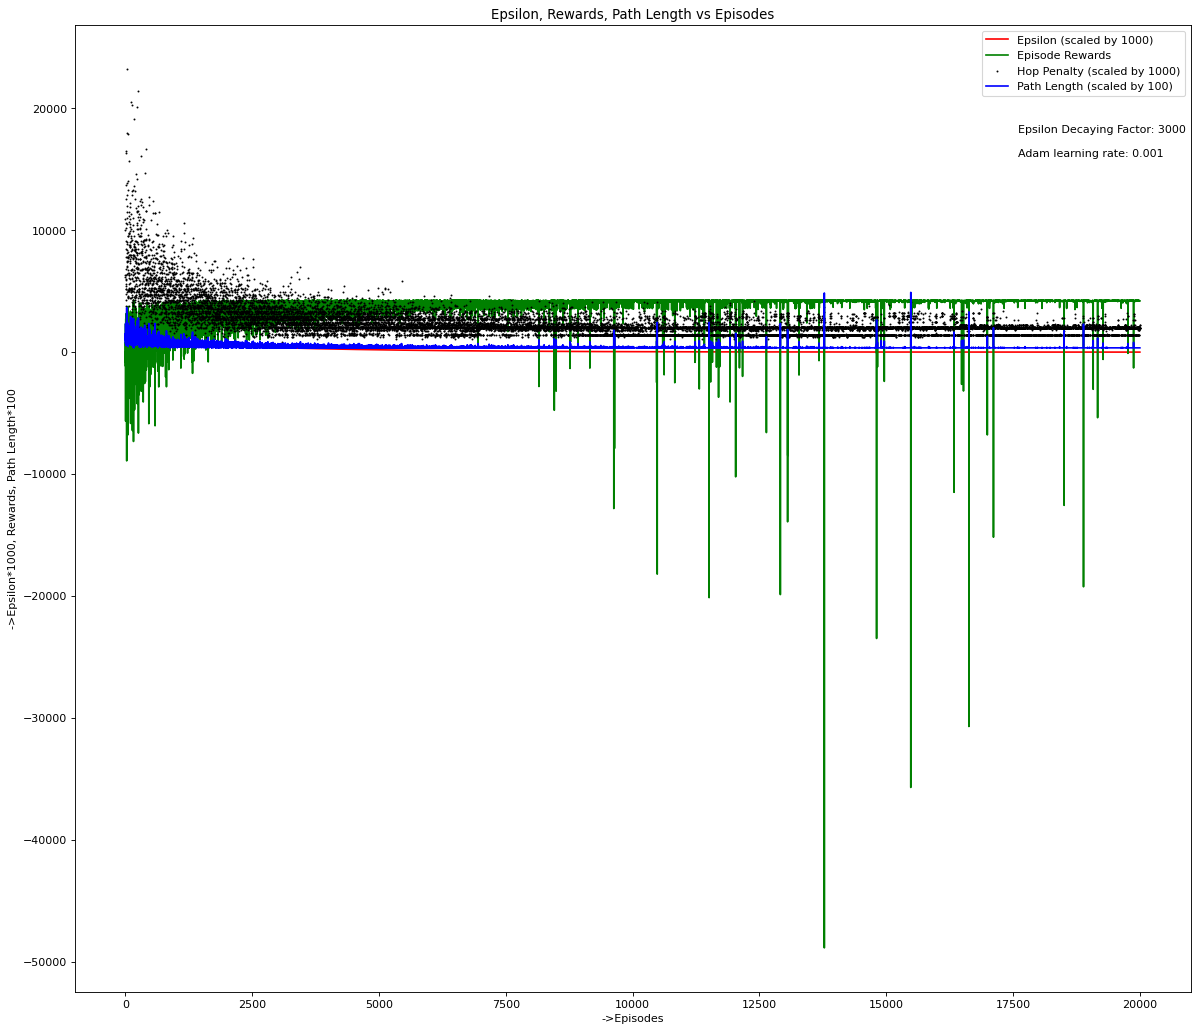

In [48]:
plot_this(epsilon_list, rewards_list, path_length_list, environment, hop_penalty_list)
plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.001_discount_{discount}_hop_penaltyx10.png')

In [53]:
def get_paths(path):
    sample_path = []
    sample_path.append(path.pop(0))
    sample_path.append(random.sample(path,3))
    sample_path.append(path.pop(-1))
    return sample_path
print(path)
sample_paths = get_paths(path)
for i in sample_paths:
    plt.figure()
    plt.plot(i)
    plt.show()

8


AttributeError: 'int' object has no attribute 'pop'

In [31]:
# # Save the entire model as a SavedModel.
# import os
# # !mkdir -p saved_model
# try:
#     os.mkdir('saved_models')
# except:
#     print('already there')
# # mm, tm = DQNAgent.get_models()
# agent.main_model.save(f'saved_models/main_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.01.h5_hop_penaltyx10')
# agent.target_model.save(f'saved_models/target_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.01.h5_hop_penaltyx10')

In [15]:
# plot_this(epsilon_scaled, rewards_list, path_scaled, environment)

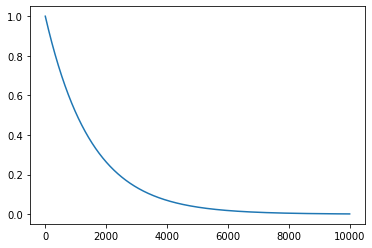

In [0]:
import numpy as np
import matplotlib.pyplot as plt
x = list(range(10000))
# print(x)
k = 1500
y = [float(np.exp(-i/k)) for i in x]
# print(y)
plt.plot(x,y)

In [0]:
class keka:
    def test(self,i):
        return i[1]
    a = [(1,3),(2,1),(3,2)]
    def uppu(self):
        self.a.sort(reverse=True,key=self.test)
        return self.a
    
k = keka()
print(k.uppu())

[(1, 3), (3, 2), (2, 1)]


In [0]:
problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')
len(list(problem.get_nodes()))

5